In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from pandas.io.common import urlopen
import urllib2
from pandas.io import json
from pprint import pprint
import ephem
import datetime
import time

##Premise##

I live near Carkeek park.  I can actually walk there (normal pace) in about 15-20 minutes.  Carkeek park is up the Puget Sound from Golden Gardens park, which is also very cool.  I like to hike between the parks, via the sound, and so do others.  The hike is ~2miles.  The tricky thing is knowing whether it is a good time to go "at a glance" or planning a hike in advance.  You need to know whether the tide will be in the correct zone (NGT 2ft) during a time of sufficient light and preferably no rain.  The ideal tide is negative, and the more negative the better.  The ideal weather would be clear and sunny, but not likely to rain would be fine.  So I'm thinking that the minimu conditions to start a hike (from the beach head at either side) should be:

- NLT 1 hour of daylight (1 hour from sunrise or 1 hour after sunset)
- 1 hour of water level NGT 2ft
- LT 50% chance of rain (I now realize this is a tall order for more than 7 days out, so I'm dropping it for initial implementation, users can always look at the tide and daylight vis, then check local weather and decide if it is right for them)

From there, there, good times could be parsed within the minimum paramaters.

I'm debating whether to use dusk/dawn vs. sunrise/sunset.  

This is the tide prediction relative to Mean Lower Low Water Level (MLLW,~ tide relative to mean low water level) for the main Seattle station.  Eventually I can calculate the Carkeek and Golden Gardens data from these values.  Note that the default behaviour for predictions is to return 6 minute prediction data.  I am adding &interval=h to the query to get hourly predictions.  This makes the dataset a little more manageble and also cuts its size by ~10x.

Update, I decided to grab the 6 minute data as well.  I can always resample hourly.

In [2]:
#query hourly data
query_hourly = 'http://tidesandcurrents.noaa.gov/api/datagetter?begin_date=20150821%2015:00&end_date=20160820%2015:06&station=9447130&product=predictions&datum=mllw&units=english&time_zone=lst_ldt&interval=h&format=json'

In [3]:
#query 6 minute data
query = 'http://tidesandcurrents.noaa.gov/api/datagetter?begin_date=20150821%2015:00&end_date=20160820%2015:06&station=9447130&product=predictions&datum=mllw&units=english&time_zone=lst_ldt&format=json'

Here is the actual object returned by the API call for hourly. Each record contains a string representing a datetime object and a value representing the tide level to MLLW

In [4]:
# hourly object
obj_hourly= { "predictions" : [ {"t":"2015-08-21 15:00", "v":"5.374"},{"t":"2015-08-21 16:00", "v":"5.167"},{"t":"2015-08-21 17:00", "v":"5.612"},{"t":"2015-08-21 18:00", "v":"6.570"},{"t":"2015-08-21 19:00", "v":"7.741"},{"t":"2015-08-21 20:00", "v":"8.877"},{"t":"2015-08-21 21:00", "v":"9.777"},{"t":"2015-08-21 22:00", "v":"10.174"},{"t":"2015-08-21 23:00", "v":"9.826"},{"t":"2015-08-22 00:00", "v":"8.723"},{"t":"2015-08-22 01:00", "v":"7.085"},{"t":"2015-08-22 02:00", "v":"5.210"},{"t":"2015-08-22 03:00", "v":"3.432"},{"t":"2015-08-22 04:00", "v":"2.176"},{"t":"2015-08-22 05:00", "v":"1.807"},{"t":"2015-08-22 06:00", "v":"2.371"},{"t":"2015-08-22 07:00", "v":"3.582"},{"t":"2015-08-22 08:00", "v":"5.071"},{"t":"2015-08-22 09:00", "v":"6.550"},{"t":"2015-08-22 10:00", "v":"7.744"},{"t":"2015-08-22 11:00", "v":"8.396"},{"t":"2015-08-22 12:00", "v":"8.435"},{"t":"2015-08-22 13:00", "v":"8.034"},{"t":"2015-08-22 14:00", "v":"7.424"},{"t":"2015-08-22 15:00", "v":"6.771"},{"t":"2015-08-22 16:00", "v":"6.262"},{"t":"2015-08-22 17:00", "v":"6.136"},{"t":"2015-08-22 18:00", "v":"6.511"},{"t":"2015-08-22 19:00", "v":"7.253"},{"t":"2015-08-22 20:00", "v":"8.130"},{"t":"2015-08-22 21:00", "v":"8.977"},{"t":"2015-08-22 22:00", "v":"9.631"},{"t":"2015-08-22 23:00", "v":"9.825"},{"t":"2015-08-23 00:00", "v":"9.332"},{"t":"2015-08-23 01:00", "v":"8.159"},{"t":"2015-08-23 02:00", "v":"6.517"},{"t":"2015-08-23 03:00", "v":"4.673"},{"t":"2015-08-23 04:00", "v":"2.948"},{"t":"2015-08-23 05:00", "v":"1.761"},{"t":"2015-08-23 06:00", "v":"1.458"},{"t":"2015-08-23 07:00", "v":"2.057"},{"t":"2015-08-23 08:00", "v":"3.282"},{"t":"2015-08-23 09:00", "v":"4.803"},{"t":"2015-08-23 10:00", "v":"6.352"},{"t":"2015-08-23 11:00", "v":"7.645"},{"t":"2015-08-23 12:00", "v":"8.424"},{"t":"2015-08-23 13:00", "v":"8.639"},{"t":"2015-08-23 14:00", "v":"8.451"},{"t":"2015-08-23 15:00", "v":"8.038"},{"t":"2015-08-23 16:00", "v":"7.507"},{"t":"2015-08-23 17:00", "v":"7.022"},{"t":"2015-08-23 18:00", "v":"6.821"},{"t":"2015-08-23 19:00", "v":"7.026"},{"t":"2015-08-23 20:00", "v":"7.543"},{"t":"2015-08-23 21:00", "v":"8.208"},{"t":"2015-08-23 22:00", "v":"8.905"},{"t":"2015-08-23 23:00", "v":"9.459"},{"t":"2015-08-24 00:00", "v":"9.576"},{"t":"2015-08-24 01:00", "v":"9.026"},{"t":"2015-08-24 02:00", "v":"7.823"},{"t":"2015-08-24 03:00", "v":"6.159"},{"t":"2015-08-24 04:00", "v":"4.277"},{"t":"2015-08-24 05:00", "v":"2.503"},{"t":"2015-08-24 06:00", "v":"1.285"},{"t":"2015-08-24 07:00", "v":"0.978"},{"t":"2015-08-24 08:00", "v":"1.602"},{"t":"2015-08-24 09:00", "v":"2.897"},{"t":"2015-08-24 10:00", "v":"4.552"},{"t":"2015-08-24 11:00", "v":"6.281"},{"t":"2015-08-24 12:00", "v":"7.756"},{"t":"2015-08-24 13:00", "v":"8.705"},{"t":"2015-08-24 14:00", "v":"9.082"},{"t":"2015-08-24 15:00", "v":"9.028"},{"t":"2015-08-24 16:00", "v":"8.669"},{"t":"2015-08-24 17:00", "v":"8.086"},{"t":"2015-08-24 18:00", "v":"7.466"},{"t":"2015-08-24 19:00", "v":"7.090"},{"t":"2015-08-24 20:00", "v":"7.119"},{"t":"2015-08-24 21:00", "v":"7.501"},{"t":"2015-08-24 22:00", "v":"8.110"},{"t":"2015-08-24 23:00", "v":"8.825"},{"t":"2015-08-25 00:00", "v":"9.416"},{"t":"2015-08-25 01:00", "v":"9.540"},{"t":"2015-08-25 02:00", "v":"8.961"},{"t":"2015-08-25 03:00", "v":"7.699"},{"t":"2015-08-25 04:00", "v":"5.936"},{"t":"2015-08-25 05:00", "v":"3.911"},{"t":"2015-08-25 06:00", "v":"1.991"},{"t":"2015-08-25 07:00", "v":"0.683"},{"t":"2015-08-25 08:00", "v":"0.373"},{"t":"2015-08-25 09:00", "v":"1.085"},{"t":"2015-08-25 10:00", "v":"2.560"},{"t":"2015-08-25 11:00", "v":"4.468"},{"t":"2015-08-25 12:00", "v":"6.460"},{"t":"2015-08-25 13:00", "v":"8.147"},{"t":"2015-08-25 14:00", "v":"9.236"},{"t":"2015-08-25 15:00", "v":"9.685"},{"t":"2015-08-25 16:00", "v":"9.618"},{"t":"2015-08-25 17:00", "v":"9.134"},{"t":"2015-08-25 18:00", "v":"8.331"},{"t":"2015-08-25 19:00", "v":"7.470"},{"t":"2015-08-25 20:00", "v":"6.908"},{"t":"2015-08-25 21:00", "v":"6.847"},{"t":"2015-08-25 22:00", "v":"7.251"},{"t":"2015-08-25 23:00", "v":"7.987"},{"t":"2015-08-26 00:00", "v":"8.870"},{"t":"2015-08-26 01:00", "v":"9.585"},{"t":"2015-08-26 02:00", "v":"9.736"},{"t":"2015-08-26 03:00", "v":"9.094"},{"t":"2015-08-26 04:00", "v":"7.701"},{"t":"2015-08-26 05:00", "v":"5.742"},{"t":"2015-08-26 06:00", "v":"3.483"},{"t":"2015-08-26 07:00", "v":"1.370"},{"t":"2015-08-26 08:00", "v":"-0.015"},{"t":"2015-08-26 09:00", "v":"-0.253"},{"t":"2015-08-26 10:00", "v":"0.663"},{"t":"2015-08-26 11:00", "v":"2.439"},{"t":"2015-08-26 12:00", "v":"4.682"},{"t":"2015-08-26 13:00", "v":"6.958"},{"t":"2015-08-26 14:00", "v":"8.812"},{"t":"2015-08-26 15:00", "v":"9.938"},{"t":"2015-08-26 16:00", "v":"10.312"},{"t":"2015-08-26 17:00", "v":"10.056"},{"t":"2015-08-26 18:00", "v":"9.274"},{"t":"2015-08-26 19:00", "v":"8.134"},{"t":"2015-08-26 20:00", "v":"7.007"},{"t":"2015-08-26 21:00", "v":"6.330"},{"t":"2015-08-26 22:00", "v":"6.326"},{"t":"2015-08-26 23:00", "v":"6.930"},{"t":"2015-08-27 00:00", "v":"7.945"},{"t":"2015-08-27 01:00", "v":"9.088"},{"t":"2015-08-27 02:00", "v":"9.945"},{"t":"2015-08-27 03:00", "v":"10.090"},{"t":"2015-08-27 04:00", "v":"9.322"},{"t":"2015-08-27 05:00", "v":"7.718"},{"t":"2015-08-27 06:00", "v":"5.492"},{"t":"2015-08-27 07:00", "v":"2.969"},{"t":"2015-08-27 08:00", "v":"0.692"},{"t":"2015-08-27 09:00", "v":"-0.679"},{"t":"2015-08-27 10:00", "v":"-0.723"},{"t":"2015-08-27 11:00", "v":"0.517"},{"t":"2015-08-27 12:00", "v":"2.672"},{"t":"2015-08-27 13:00", "v":"5.264"},{"t":"2015-08-27 14:00", "v":"7.763"},{"t":"2015-08-27 15:00", "v":"9.666"},{"t":"2015-08-27 16:00", "v":"10.679"},{"t":"2015-08-27 17:00", "v":"10.810"},{"t":"2015-08-27 18:00", "v":"10.200"},{"t":"2015-08-27 19:00", "v":"9.000"},{"t":"2015-08-27 20:00", "v":"7.481"},{"t":"2015-08-27 21:00", "v":"6.140"},{"t":"2015-08-27 22:00", "v":"5.478"},{"t":"2015-08-27 23:00", "v":"5.689"},{"t":"2015-08-28 00:00", "v":"6.636"},{"t":"2015-08-28 01:00", "v":"8.017"},{"t":"2015-08-28 02:00", "v":"9.437"},{"t":"2015-08-28 03:00", "v":"10.400"},{"t":"2015-08-28 04:00", "v":"10.479"},{"t":"2015-08-28 05:00", "v":"9.525"},{"t":"2015-08-28 06:00", "v":"7.669"},{"t":"2015-08-28 07:00", "v":"5.171"},{"t":"2015-08-28 08:00", "v":"2.431"},{"t":"2015-08-28 09:00", "v":"0.094"},{"t":"2015-08-28 10:00", "v":"-1.128"},{"t":"2015-08-28 11:00", "v":"-0.854"},{"t":"2015-08-28 12:00", "v":"0.783"},{"t":"2015-08-28 13:00", "v":"3.321"},{"t":"2015-08-28 14:00", "v":"6.187"},{"t":"2015-08-28 15:00", "v":"8.779"},{"t":"2015-08-28 16:00", "v":"10.572"},{"t":"2015-08-28 17:00", "v":"11.311"},{"t":"2015-08-28 18:00", "v":"11.051"},{"t":"2015-08-28 19:00", "v":"9.975"},{"t":"2015-08-28 20:00", "v":"8.306"},{"t":"2015-08-28 21:00", "v":"6.445"},{"t":"2015-08-28 22:00", "v":"5.000"},{"t":"2015-08-28 23:00", "v":"4.493"},{"t":"2015-08-29 00:00", "v":"5.045"},{"t":"2015-08-29 01:00", "v":"6.407"},{"t":"2015-08-29 02:00", "v":"8.163"},{"t":"2015-08-29 03:00", "v":"9.813"},{"t":"2015-08-29 04:00", "v":"10.818"},{"t":"2015-08-29 05:00", "v":"10.779"},{"t":"2015-08-29 06:00", "v":"9.622"},{"t":"2015-08-29 07:00", "v":"7.535"},{"t":"2015-08-29 08:00", "v":"4.831"},{"t":"2015-08-29 09:00", "v":"1.993"},{"t":"2015-08-29 10:00", "v":"-0.255"},{"t":"2015-08-29 11:00", "v":"-1.194"},{"t":"2015-08-29 12:00", "v":"-0.525"},{"t":"2015-08-29 13:00", "v":"1.506"},{"t":"2015-08-29 14:00", "v":"4.342"},{"t":"2015-08-29 15:00", "v":"7.338"},{"t":"2015-08-29 16:00", "v":"9.854"},{"t":"2015-08-29 17:00", "v":"11.375"},{"t":"2015-08-29 18:00", "v":"11.708"},{"t":"2015-08-29 19:00", "v":"10.965"},{"t":"2015-08-29 20:00", "v":"9.382"},{"t":"2015-08-29 21:00", "v":"7.273"},{"t":"2015-08-29 22:00", "v":"5.164"},{"t":"2015-08-29 23:00", "v":"3.746"},{"t":"2015-08-30 00:00", "v":"3.508"},{"t":"2015-08-30 01:00", "v":"4.461"},{"t":"2015-08-30 02:00", "v":"6.231"},{"t":"2015-08-30 03:00", "v":"8.301"},{"t":"2015-08-30 04:00", "v":"10.104"},{"t":"2015-08-30 05:00", "v":"11.087"},{"t":"2015-08-30 06:00", "v":"10.914"},{"t":"2015-08-30 07:00", "v":"9.589"},{"t":"2015-08-30 08:00", "v":"7.355"},{"t":"2015-08-30 09:00", "v":"4.573"},{"t":"2015-08-30 10:00", "v":"1.793"},{"t":"2015-08-30 11:00", "v":"-0.217"},{"t":"2015-08-30 12:00", "v":"-0.781"},{"t":"2015-08-30 13:00", "v":"0.285"},{"t":"2015-08-30 14:00", "v":"2.621"},{"t":"2015-08-30 15:00", "v":"5.602"},{"t":"2015-08-30 16:00", "v":"8.549"},{"t":"2015-08-30 17:00", "v":"10.820"},{"t":"2015-08-30 18:00", "v":"11.944"},{"t":"2015-08-30 19:00", "v":"11.796"},{"t":"2015-08-30 20:00", "v":"10.547"},{"t":"2015-08-30 21:00", "v":"8.492"},{"t":"2015-08-30 22:00", "v":"6.035"},{"t":"2015-08-30 23:00", "v":"3.808"},{"t":"2015-08-31 00:00", "v":"2.534"},{"t":"2015-08-31 01:00", "v":"2.627"},{"t":"2015-08-31 02:00", "v":"3.967"},{"t":"2015-08-31 03:00", "v":"6.071"},{"t":"2015-08-31 04:00", "v":"8.355"},{"t":"2015-08-31 05:00", "v":"10.222"},{"t":"2015-08-31 06:00", "v":"11.146"},{"t":"2015-08-31 07:00", "v":"10.864"},{"t":"2015-08-31 08:00", "v":"9.454"},{"t":"2015-08-31 09:00", "v":"7.201"},{"t":"2015-08-31 10:00", "v":"4.498"},{"t":"2015-08-31 11:00", "v":"1.931"},{"t":"2015-08-31 12:00", "v":"0.270"},{"t":"2015-08-31 13:00", "v":"0.103"},{"t":"2015-08-31 14:00", "v":"1.487"},{"t":"2015-08-31 15:00", "v":"3.973"},{"t":"2015-08-31 16:00", "v":"6.911"},{"t":"2015-08-31 17:00", "v":"9.635"},{"t":"2015-08-31 18:00", "v":"11.532"},{"t":"2015-08-31 19:00", "v":"12.191"},{"t":"2015-08-31 20:00", "v":"11.557"},{"t":"2015-08-31 21:00", "v":"9.856"},{"t":"2015-08-31 22:00", "v":"7.430"},{"t":"2015-08-31 23:00", "v":"4.760"},{"t":"2015-09-01 00:00", "v":"2.549"},{"t":"2015-09-01 01:00", "v":"1.503"},{"t":"2015-09-01 02:00", "v":"1.926"},{"t":"2015-09-01 03:00", "v":"3.573"},{"t":"2015-09-01 04:00", "v":"5.892"},{"t":"2015-09-01 05:00", "v":"8.274"},{"t":"2015-09-01 06:00", "v":"10.131"},{"t":"2015-09-01 07:00", "v":"10.987"},{"t":"2015-09-01 08:00", "v":"10.656"},{"t":"2015-09-01 09:00", "v":"9.276"},{"t":"2015-09-01 10:00", "v":"7.149"},{"t":"2015-09-01 11:00", "v":"4.674"},{"t":"2015-09-01 12:00", "v":"2.443"},{"t":"2015-09-01 13:00", "v":"1.176"},{"t":"2015-09-01 14:00", "v":"1.352"},{"t":"2015-09-01 15:00", "v":"2.908"},{"t":"2015-09-01 16:00", "v":"5.354"},{"t":"2015-09-01 17:00", "v":"8.069"},{"t":"2015-09-01 18:00", "v":"10.434"},{"t":"2015-09-01 19:00", "v":"11.889"},{"t":"2015-09-01 20:00", "v":"12.088"},{"t":"2015-09-01 21:00", "v":"11.037"},{"t":"2015-09-01 22:00", "v":"9.000"},{"t":"2015-09-01 23:00", "v":"6.350"},{"t":"2015-09-02 00:00", "v":"3.622"},{"t":"2015-09-02 01:00", "v":"1.541"},{"t":"2015-09-02 02:00", "v":"0.754"},{"t":"2015-09-02 03:00", "v":"1.444"},{"t":"2015-09-02 04:00", "v":"3.273"},{"t":"2015-09-02 05:00", "v":"5.668"},{"t":"2015-09-02 06:00", "v":"8.040"},{"t":"2015-09-02 07:00", "v":"9.838"},{"t":"2015-09-02 08:00", "v":"10.647"},{"t":"2015-09-02 09:00", "v":"10.349"},{"t":"2015-09-02 10:00", "v":"9.121"},{"t":"2015-09-02 11:00", "v":"7.255"},{"t":"2015-09-02 12:00", "v":"5.125"},{"t":"2015-09-02 13:00", "v":"3.289"},{"t":"2015-09-02 14:00", "v":"2.388"},{"t":"2015-09-02 15:00", "v":"2.782"},{"t":"2015-09-02 16:00", "v":"4.328"},{"t":"2015-09-02 17:00", "v":"6.550"},{"t":"2015-09-02 18:00", "v":"8.902"},{"t":"2015-09-02 19:00", "v":"10.838"},{"t":"2015-09-02 20:00", "v":"11.857"},{"t":"2015-09-02 21:00", "v":"11.672"},{"t":"2015-09-02 22:00", "v":"10.333"},{"t":"2015-09-02 23:00", "v":"8.120"},{"t":"2015-09-03 00:00", "v":"5.415"},{"t":"2015-09-03 01:00", "v":"2.768"},{"t":"2015-09-03 02:00", "v":"0.886"},{"t":"2015-09-03 03:00", "v":"0.331"},{"t":"2015-09-03 04:00", "v":"1.179"},{"t":"2015-09-03 05:00", "v":"3.045"},{"t":"2015-09-03 06:00", "v":"5.385"},{"t":"2015-09-03 07:00", "v":"7.665"},{"t":"2015-09-03 08:00", "v":"9.386"},{"t":"2015-09-03 09:00", "v":"10.192"},{"t":"2015-09-03 10:00", "v":"10.020"},{"t":"2015-09-03 11:00", "v":"9.054"},{"t":"2015-09-03 12:00", "v":"7.547"},{"t":"2015-09-03 13:00", "v":"5.819"},{"t":"2015-09-03 14:00", "v":"4.365"},{"t":"2015-09-03 15:00", "v":"3.730"},{"t":"2015-09-03 16:00", "v":"4.175"},{"t":"2015-09-03 17:00", "v":"5.529"},{"t":"2015-09-03 18:00", "v":"7.386"},{"t":"2015-09-03 19:00", "v":"9.305"},{"t":"2015-09-03 20:00", "v":"10.820"},{"t":"2015-09-03 21:00", "v":"11.480"},{"t":"2015-09-03 22:00", "v":"11.043"},{"t":"2015-09-03 23:00", "v":"9.583"},{"t":"2015-09-04 00:00", "v":"7.366"},{"t":"2015-09-04 01:00", "v":"4.756"},{"t":"2015-09-04 02:00", "v":"2.284"},{"t":"2015-09-04 03:00", "v":"0.611"},{"t":"2015-09-04 04:00", "v":"0.210"},{"t":"2015-09-04 05:00", "v":"1.082"},{"t":"2015-09-04 06:00", "v":"2.850"},{"t":"2015-09-04 07:00", "v":"5.040"},{"t":"2015-09-04 08:00", "v":"7.191"},{"t":"2015-09-04 09:00", "v":"8.852"},{"t":"2015-09-04 10:00", "v":"9.717"},{"t":"2015-09-04 11:00", "v":"9.754"},{"t":"2015-09-04 12:00", "v":"9.127"},{"t":"2015-09-04 13:00", "v":"8.020"},{"t":"2015-09-04 14:00", "v":"6.676"},{"t":"2015-09-04 15:00", "v":"5.514"},{"t":"2015-09-04 16:00", "v":"4.994"},{"t":"2015-09-04 17:00", "v":"5.316"},{"t":"2015-09-04 18:00", "v":"6.337"},{"t":"2015-09-04 19:00", "v":"7.762"},{"t":"2015-09-04 20:00", "v":"9.265"},{"t":"2015-09-04 21:00", "v":"10.444"},{"t":"2015-09-04 22:00", "v":"10.878"},{"t":"2015-09-04 23:00", "v":"10.351"},{"t":"2015-09-05 00:00", "v":"8.935"},{"t":"2015-09-05 01:00", "v":"6.858"},{"t":"2015-09-05 02:00", "v":"4.438"},{"t":"2015-09-05 03:00", "v":"2.167"},{"t":"2015-09-05 04:00", "v":"0.653"},{"t":"2015-09-05 05:00", "v":"0.295"},{"t":"2015-09-05 06:00", "v":"1.068"},{"t":"2015-09-05 07:00", "v":"2.649"},{"t":"2015-09-05 08:00", "v":"4.656"},{"t":"2015-09-05 09:00", "v":"6.692"},{"t":"2015-09-05 10:00", "v":"8.343"},{"t":"2015-09-05 11:00", "v":"9.331"},{"t":"2015-09-05 12:00", "v":"9.634"},{"t":"2015-09-05 13:00", "v":"9.366"},{"t":"2015-09-05 14:00", "v":"8.622"},{"t":"2015-09-05 15:00", "v":"7.565"},{"t":"2015-09-05 16:00", "v":"6.548"},{"t":"2015-09-05 17:00", "v":"5.976"},{"t":"2015-09-05 18:00", "v":"6.038"},{"t":"2015-09-05 19:00", "v":"6.664"},{"t":"2015-09-05 20:00", "v":"7.686"},{"t":"2015-09-05 21:00", "v":"8.874"},{"t":"2015-09-05 22:00", "v":"9.856"},{"t":"2015-09-05 23:00", "v":"10.220"},{"t":"2015-09-06 00:00", "v":"9.754"},{"t":"2015-09-06 01:00", "v":"8.504"},{"t":"2015-09-06 02:00", "v":"6.642"},{"t":"2015-09-06 03:00", "v":"4.428"},{"t":"2015-09-06 04:00", "v":"2.316"},{"t":"2015-09-06 05:00", "v":"0.871"},{"t":"2015-09-06 06:00", "v":"0.455"},{"t":"2015-09-06 07:00", "v":"1.057"},{"t":"2015-09-06 08:00", "v":"2.436"},{"t":"2015-09-06 09:00", "v":"4.295"},{"t":"2015-09-06 10:00", "v":"6.278"},{"t":"2015-09-06 11:00", "v":"7.983"},{"t":"2015-09-06 12:00", "v":"9.140"},{"t":"2015-09-06 13:00", "v":"9.712"},{"t":"2015-09-06 14:00", "v":"9.747"},{"t":"2015-09-06 15:00", "v":"9.252"},{"t":"2015-09-06 16:00", "v":"8.323"},{"t":"2015-09-06 17:00", "v":"7.282"},{"t":"2015-09-06 18:00", "v":"6.521"},{"t":"2015-09-06 19:00", "v":"6.263"},{"t":"2015-09-06 20:00", "v":"6.533"},{"t":"2015-09-06 21:00", "v":"7.275"},{"t":"2015-09-06 22:00", "v":"8.307"},{"t":"2015-09-06 23:00", "v":"9.251"},{"t":"2015-09-07 00:00", "v":"9.679"},{"t":"2015-09-07 01:00", "v":"9.369"},{"t":"2015-09-07 02:00", "v":"8.330"},{"t":"2015-09-07 03:00", "v":"6.670"},{"t":"2015-09-07 04:00", "v":"4.602"},{"t":"2015-09-07 05:00", "v":"2.561"},{"t":"2015-09-07 06:00", "v":"1.099"},{"t":"2015-09-07 07:00", "v":"0.574"},{"t":"2015-09-07 08:00", "v":"1.015"},{"t":"2015-09-07 09:00", "v":"2.259"},{"t":"2015-09-07 10:00", "v":"4.065"},{"t":"2015-09-07 11:00", "v":"6.080"},{"t":"2015-09-07 12:00", "v":"7.885"},{"t":"2015-09-07 13:00", "v":"9.206"},{"t":"2015-09-07 14:00", "v":"9.981"},{"t":"2015-09-07 15:00", "v":"10.187"},{"t":"2015-09-07 16:00", "v":"9.761"},{"t":"2015-09-07 17:00", "v":"8.778"},{"t":"2015-09-07 18:00", "v":"7.570"},{"t":"2015-09-07 19:00", "v":"6.561"},{"t":"2015-09-07 20:00", "v":"6.027"},{"t":"2015-09-07 21:00", "v":"6.079"},{"t":"2015-09-07 22:00", "v":"6.723"},{"t":"2015-09-07 23:00", "v":"7.775"},{"t":"2015-09-08 00:00", "v":"8.810"},{"t":"2015-09-08 01:00", "v":"9.373"},{"t":"2015-09-08 02:00", "v":"9.230"},{"t":"2015-09-08 03:00", "v":"8.356"},{"t":"2015-09-08 04:00", "v":"6.809"},{"t":"2015-09-08 05:00", "v":"4.783"},{"t":"2015-09-08 06:00", "v":"2.728"},{"t":"2015-09-08 07:00", "v":"1.212"},{"t":"2015-09-08 08:00", "v":"0.608"},{"t":"2015-09-08 09:00", "v":"0.983"},{"t":"2015-09-08 10:00", "v":"2.222"},{"t":"2015-09-08 11:00", "v":"4.093"},{"t":"2015-09-08 12:00", "v":"6.204"},{"t":"2015-09-08 13:00", "v":"8.108"},{"t":"2015-09-08 14:00", "v":"9.522"},{"t":"2015-09-08 15:00", "v":"10.358"},{"t":"2015-09-08 16:00", "v":"10.545"},{"t":"2015-09-08 17:00", "v":"9.990"},{"t":"2015-09-08 18:00", "v":"8.795"},{"t":"2015-09-08 19:00", "v":"7.354"},{"t":"2015-09-08 20:00", "v":"6.139"},{"t":"2015-09-08 21:00", "v":"5.471"},{"t":"2015-09-08 22:00", "v":"5.507"},{"t":"2015-09-08 23:00", "v":"6.250"},{"t":"2015-09-09 00:00", "v":"7.458"},{"t":"2015-09-09 01:00", "v":"8.644"},{"t":"2015-09-09 02:00", "v":"9.329"},{"t":"2015-09-09 03:00", "v":"9.279"},{"t":"2015-09-09 04:00", "v":"8.454"},{"t":"2015-09-09 05:00", "v":"6.893"},{"t":"2015-09-09 06:00", "v":"4.812"},{"t":"2015-09-09 07:00", "v":"2.707"},{"t":"2015-09-09 08:00", "v":"1.178"},{"t":"2015-09-09 09:00", "v":"0.608"},{"t":"2015-09-09 10:00", "v":"1.070"},{"t":"2015-09-09 11:00", "v":"2.451"},{"t":"2015-09-09 12:00", "v":"4.476"},{"t":"2015-09-09 13:00", "v":"6.693"},{"t":"2015-09-09 14:00", "v":"8.625"},{"t":"2015-09-09 15:00", "v":"9.993"},{"t":"2015-09-09 16:00", "v":"10.702"},{"t":"2015-09-09 17:00", "v":"10.664"},{"t":"2015-09-09 18:00", "v":"9.810"},{"t":"2015-09-09 19:00", "v":"8.322"},{"t":"2015-09-09 20:00", "v":"6.678"},{"t":"2015-09-09 21:00", "v":"5.395"},{"t":"2015-09-09 22:00", "v":"4.800"},{"t":"2015-09-09 23:00", "v":"5.030"},{"t":"2015-09-10 00:00", "v":"6.026"},{"t":"2015-09-10 01:00", "v":"7.454"},{"t":"2015-09-10 02:00", "v":"8.762"},{"t":"2015-09-10 03:00", "v":"9.477"},{"t":"2015-09-10 04:00", "v":"9.391"},{"t":"2015-09-10 05:00", "v":"8.476"},{"t":"2015-09-10 06:00", "v":"6.790"},{"t":"2015-09-10 07:00", "v":"4.608"},{"t":"2015-09-10 08:00", "v":"2.496"},{"t":"2015-09-10 09:00", "v":"1.073"},{"t":"2015-09-10 10:00", "v":"0.697"},{"t":"2015-09-10 11:00", "v":"1.408"},{"t":"2015-09-10 12:00", "v":"3.037"},{"t":"2015-09-10 13:00", "v":"5.239"},{"t":"2015-09-10 14:00", "v":"7.496"},{"t":"2015-09-10 15:00", "v":"9.321"},{"t":"2015-09-10 16:00", "v":"10.464"},{"t":"2015-09-10 17:00", "v":"10.851"},{"t":"2015-09-10 18:00", "v":"10.416"},{"t":"2015-09-10 19:00", "v":"9.168"},{"t":"2015-09-10 20:00", "v":"7.403"},{"t":"2015-09-10 21:00", "v":"5.683"},{"t":"2015-09-10 22:00", "v":"4.529"},{"t":"2015-09-10 23:00", "v":"4.220"},{"t":"2015-09-11 00:00", "v":"4.808"},{"t":"2015-09-11 01:00", "v":"6.130"},{"t":"2015-09-11 02:00", "v":"7.750"},{"t":"2015-09-11 03:00", "v":"9.083"},{"t":"2015-09-11 04:00", "v":"9.694"},{"t":"2015-09-11 05:00", "v":"9.434"},{"t":"2015-09-11 06:00", "v":"8.316"},{"t":"2015-09-11 07:00", "v":"6.454"},{"t":"2015-09-11 08:00", "v":"4.205"},{"t":"2015-09-11 09:00", "v":"2.197"},{"t":"2015-09-11 10:00", "v":"1.039"},{"t":"2015-09-11 11:00", "v":"1.018"},{"t":"2015-09-11 12:00", "v":"2.085"},{"t":"2015-09-11 13:00", "v":"3.992"},{"t":"2015-09-11 14:00", "v":"6.307"},{"t":"2015-09-11 15:00", "v":"8.473"},{"t":"2015-09-11 16:00", "v":"10.023"},{"t":"2015-09-11 17:00", "v":"10.764"},{"t":"2015-09-11 18:00", "v":"10.673"},{"t":"2015-09-11 19:00", "v":"9.747"},{"t":"2015-09-11 20:00", "v":"8.106"},{"t":"2015-09-11 21:00", "v":"6.172"},{"t":"2015-09-11 22:00", "v":"4.561"},{"t":"2015-09-11 23:00", "v":"3.742"},{"t":"2015-09-12 00:00", "v":"3.882"},{"t":"2015-09-12 01:00", "v":"4.908"},{"t":"2015-09-12 02:00", "v":"6.536"},{"t":"2015-09-12 03:00", "v":"8.252"},{"t":"2015-09-12 04:00", "v":"9.477"},{"t":"2015-09-12 05:00", "v":"9.854"},{"t":"2015-09-12 06:00", "v":"9.319"},{"t":"2015-09-12 07:00", "v":"7.950"},{"t":"2015-09-12 08:00", "v":"5.936"},{"t":"2015-09-12 09:00", "v":"3.722"},{"t":"2015-09-12 10:00", "v":"1.970"},{"t":"2015-09-12 11:00", "v":"1.227"},{"t":"2015-09-12 12:00", "v":"1.660"},{"t":"2015-09-12 13:00", "v":"3.107"},{"t":"2015-09-12 14:00", "v":"5.227"},{"t":"2015-09-12 15:00", "v":"7.526"},{"t":"2015-09-12 16:00", "v":"9.436"},{"t":"2015-09-12 17:00", "v":"10.552"},{"t":"2015-09-12 18:00", "v":"10.760"},{"t":"2015-09-12 19:00", "v":"10.110"},{"t":"2015-09-12 20:00", "v":"8.690"},{"t":"2015-09-12 21:00", "v":"6.748"},{"t":"2015-09-12 22:00", "v":"4.816"},{"t":"2015-09-12 23:00", "v":"3.508"},{"t":"2015-09-13 00:00", "v":"3.183"},{"t":"2015-09-13 01:00", "v":"3.853"},{"t":"2015-09-13 02:00", "v":"5.304"},{"t":"2015-09-13 03:00", "v":"7.147"},{"t":"2015-09-13 04:00", "v":"8.827"},{"t":"2015-09-13 05:00", "v":"9.820"},{"t":"2015-09-13 06:00", "v":"9.876"},{"t":"2015-09-13 07:00", "v":"9.030"},{"t":"2015-09-13 08:00", "v":"7.436"},{"t":"2015-09-13 09:00", "v":"5.361"},{"t":"2015-09-13 10:00", "v":"3.320"},{"t":"2015-09-13 11:00", "v":"1.965"},{"t":"2015-09-13 12:00", "v":"1.729"},{"t":"2015-09-13 13:00", "v":"2.628"},{"t":"2015-09-13 14:00", "v":"4.383"},{"t":"2015-09-13 15:00", "v":"6.581"},{"t":"2015-09-13 16:00", "v":"8.699"},{"t":"2015-09-13 17:00", "v":"10.202"},{"t":"2015-09-13 18:00", "v":"10.770"},{"t":"2015-09-13 19:00", "v":"10.386"},{"t":"2015-09-13 20:00", "v":"9.184"},{"t":"2015-09-13 21:00", "v":"7.354"},{"t":"2015-09-13 22:00", "v":"5.266"},{"t":"2015-09-13 23:00", "v":"3.522"},{"t":"2015-09-14 00:00", "v":"2.677"},{"t":"2015-09-14 01:00", "v":"2.928"},{"t":"2015-09-14 02:00", "v":"4.118"},{"t":"2015-09-14 03:00", "v":"5.905"},{"t":"2015-09-14 04:00", "v":"7.832"},{"t":"2015-09-14 05:00", "v":"9.352"},{"t":"2015-09-14 06:00", "v":"10.029"},{"t":"2015-09-14 07:00", "v":"9.739"},{"t":"2015-09-14 08:00", "v":"8.615"},{"t":"2015-09-14 09:00", "v":"6.881"},{"t":"2015-09-14 10:00", "v":"4.872"},{"t":"2015-09-14 11:00", "v":"3.139"},{"t":"2015-09-14 12:00", "v":"2.272"},{"t":"2015-09-14 13:00", "v":"2.551"},{"t":"2015-09-14 14:00", "v":"3.836"},{"t":"2015-09-14 15:00", "v":"5.757"},{"t":"2015-09-14 16:00", "v":"7.863"},{"t":"2015-09-14 17:00", "v":"9.647"},{"t":"2015-09-14 18:00", "v":"10.636"},{"t":"2015-09-14 19:00", "v":"10.613"},{"t":"2015-09-14 20:00", "v":"9.659"},{"t":"2015-09-14 21:00", "v":"7.990"},{"t":"2015-09-14 22:00", "v":"5.894"},{"t":"2015-09-14 23:00", "v":"3.841"},{"t":"2015-09-15 00:00", "v":"2.448"},{"t":"2015-09-15 01:00", "v":"2.157"},{"t":"2015-09-15 02:00", "v":"2.980"},{"t":"2015-09-15 03:00", "v":"4.601"},{"t":"2015-09-15 04:00", "v":"6.592"},{"t":"2015-09-15 05:00", "v":"8.470"},{"t":"2015-09-15 06:00", "v":"9.739"},{"t":"2015-09-15 07:00", "v":"10.073"},{"t":"2015-09-15 08:00", "v":"9.474"},{"t":"2015-09-15 09:00", "v":"8.158"},{"t":"2015-09-15 10:00", "v":"6.404"},{"t":"2015-09-15 11:00", "v":"4.590"},{"t":"2015-09-15 12:00", "v":"3.260"},{"t":"2015-09-15 13:00", "v":"2.897"},{"t":"2015-09-15 14:00", "v":"3.615"},{"t":"2015-09-15 15:00", "v":"5.140"},{"t":"2015-09-15 16:00", "v":"7.049"},{"t":"2015-09-15 17:00", "v":"8.905"},{"t":"2015-09-15 18:00", "v":"10.244"},{"t":"2015-09-15 19:00", "v":"10.679"},{"t":"2015-09-15 20:00", "v":"10.095"},{"t":"2015-09-15 21:00", "v":"8.662"},{"t":"2015-09-15 22:00", "v":"6.669"},{"t":"2015-09-15 23:00", "v":"4.481"},{"t":"2015-09-16 00:00", "v":"2.629"},{"t":"2015-09-16 01:00", "v":"1.694"},{"t":"2015-09-16 02:00", "v":"1.967"},{"t":"2015-09-16 03:00", "v":"3.279"},{"t":"2015-09-16 04:00", "v":"5.194"},{"t":"2015-09-16 05:00", "v":"7.246"},{"t":"2015-09-16 06:00", "v":"8.970"},{"t":"2015-09-16 07:00", "v":"9.946"},{"t":"2015-09-16 08:00", "v":"9.966"},{"t":"2015-09-16 09:00", "v":"9.142"},{"t":"2015-09-16 10:00", "v":"7.752"},{"t":"2015-09-16 11:00", "v":"6.101"},{"t":"2015-09-16 12:00", "v":"4.582"},{"t":"2015-09-16 13:00", "v":"3.689"},{"t":"2015-09-16 14:00", "v":"3.774"},{"t":"2015-09-16 15:00", "v":"4.789"},{"t":"2015-09-16 16:00", "v":"6.372"},{"t":"2015-09-16 17:00", "v":"8.103"},{"t":"2015-09-16 18:00", "v":"9.591"},{"t":"2015-09-16 19:00", "v":"10.440"},{"t":"2015-09-16 20:00", "v":"10.349"},{"t":"2015-09-16 21:00", "v":"9.299"},{"t":"2015-09-16 22:00", "v":"7.530"},{"t":"2015-09-16 23:00", "v":"5.379"},{"t":"2015-09-17 00:00", "v":"3.265"},{"t":"2015-09-17 01:00", "v":"1.734"},{"t":"2015-09-17 02:00", "v":"1.289"},{"t":"2015-09-17 03:00", "v":"2.058"},{"t":"2015-09-17 04:00", "v":"3.720"},{"t":"2015-09-17 05:00", "v":"5.776"},{"t":"2015-09-17 06:00", "v":"7.766"},{"t":"2015-09-17 07:00", "v":"9.276"},{"t":"2015-09-17 08:00", "v":"9.970"},{"t":"2015-09-17 09:00", "v":"9.752"},{"t":"2015-09-17 10:00", "v":"8.817"},{"t":"2015-09-17 11:00", "v":"7.476"},{"t":"2015-09-17 12:00", "v":"6.033"},{"t":"2015-09-17 13:00", "v":"4.858"},{"t":"2015-09-17 14:00", "v":"4.369"},{"t":"2015-09-17 15:00", "v":"4.779"},{"t":"2015-09-17 16:00", "v":"5.916"},{"t":"2015-09-17 17:00", "v":"7.385"},{"t":"2015-09-17 18:00", "v":"8.813"},{"t":"2015-09-17 19:00", "v":"9.883"},{"t":"2015-09-17 20:00", "v":"10.266"},{"t":"2015-09-17 21:00", "v":"9.742"},{"t":"2015-09-17 22:00", "v":"8.365"},{"t":"2015-09-17 23:00", "v":"6.420"},{"t":"2015-09-18 00:00", "v":"4.271"},{"t":"2015-09-18 01:00", "v":"2.353"},{"t":"2015-09-18 02:00", "v":"1.193"},{"t":"2015-09-18 03:00", "v":"1.191"},{"t":"2015-09-18 04:00", "v":"2.325"},{"t":"2015-09-18 05:00", "v":"4.176"},{"t":"2015-09-18 06:00", "v":"6.234"},{"t":"2015-09-18 07:00", "v":"8.084"},{"t":"2015-09-18 08:00", "v":"9.374"},{"t":"2015-09-18 09:00", "v":"9.847"},{"t":"2015-09-18 10:00", "v":"9.500"},{"t":"2015-09-18 11:00", "v":"8.578"},{"t":"2015-09-18 12:00", "v":"7.391"},{"t":"2015-09-18 13:00", "v":"6.213"},{"t":"2015-09-18 14:00", "v":"5.367"},{"t":"2015-09-18 15:00", "v":"5.184"},{"t":"2015-09-18 16:00", "v":"5.758"},{"t":"2015-09-18 17:00", "v":"6.845"},{"t":"2015-09-18 18:00", "v":"8.071"},{"t":"2015-09-18 19:00", "v":"9.146"},{"t":"2015-09-18 20:00", "v":"9.822"},{"t":"2015-09-18 21:00", "v":"9.828"},{"t":"2015-09-18 22:00", "v":"9.004"},{"t":"2015-09-18 23:00", "v":"7.456"},{"t":"2015-09-19 00:00", "v":"5.487"},{"t":"2015-09-19 01:00", "v":"3.455"},{"t":"2015-09-19 02:00", "v":"1.785"},{"t":"2015-09-19 03:00", "v":"0.964"},{"t":"2015-09-19 04:00", "v":"1.289"},{"t":"2015-09-19 05:00", "v":"2.627"},{"t":"2015-09-19 06:00", "v":"4.517"},{"t":"2015-09-19 07:00", "v":"6.487"},{"t":"2015-09-19 08:00", "v":"8.182"},{"t":"2015-09-19 09:00", "v":"9.302"},{"t":"2015-09-19 10:00", "v":"9.655"},{"t":"2015-09-19 11:00", "v":"9.297"},{"t":"2015-09-19 12:00", "v":"8.494"},{"t":"2015-09-19 13:00", "v":"7.519"},{"t":"2015-09-19 14:00", "v":"6.598"},{"t":"2015-09-19 15:00", "v":"6.000"},{"t":"2015-09-19 16:00", "v":"5.979"},{"t":"2015-09-19 17:00", "v":"6.552"},{"t":"2015-09-19 18:00", "v":"7.458"},{"t":"2015-09-19 19:00", "v":"8.389"},{"t":"2015-09-19 20:00", "v":"9.142"},{"t":"2015-09-19 21:00", "v":"9.521"},{"t":"2015-09-19 22:00", "v":"9.286"},{"t":"2015-09-19 23:00", "v":"8.313"},{"t":"2015-09-20 00:00", "v":"6.735"},{"t":"2015-09-20 01:00", "v":"4.844"},{"t":"2015-09-20 02:00", "v":"2.972"},{"t":"2015-09-20 03:00", "v":"1.523"},{"t":"2015-09-20 04:00", "v":"0.937"},{"t":"2015-09-20 05:00", "v":"1.435"},{"t":"2015-09-20 06:00", "v":"2.825"},{"t":"2015-09-20 07:00", "v":"4.657"},{"t":"2015-09-20 08:00", "v":"6.520"},{"t":"2015-09-20 09:00", "v":"8.109"},{"t":"2015-09-20 10:00", "v":"9.156"},{"t":"2015-09-20 11:00", "v":"9.502"},{"t":"2015-09-20 12:00", "v":"9.234"},{"t":"2015-09-20 13:00", "v":"8.604"},{"t":"2015-09-20 14:00", "v":"7.831"},{"t":"2015-09-20 15:00", "v":"7.085"},{"t":"2015-09-20 16:00", "v":"6.596"},{"t":"2015-09-20 17:00", "v":"6.578"},{"t":"2015-09-20 18:00", "v":"7.019"},{"t":"2015-09-20 19:00", "v":"7.691"},{"t":"2015-09-20 20:00", "v":"8.368"},{"t":"2015-09-20 21:00", "v":"8.913"},{"t":"2015-09-20 22:00", "v":"9.144"},{"t":"2015-09-20 23:00", "v":"8.819"},{"t":"2015-09-21 00:00", "v":"7.831"},{"t":"2015-09-21 01:00", "v":"6.315"},{"t":"2015-09-21 02:00", "v":"4.534"},{"t":"2015-09-21 03:00", "v":"2.785"},{"t":"2015-09-21 04:00", "v":"1.455"},{"t":"2015-09-21 05:00", "v":"0.962"},{"t":"2015-09-21 06:00", "v":"1.491"},{"t":"2015-09-21 07:00", "v":"2.835"},{"t":"2015-09-21 08:00", "v":"4.589"},{"t":"2015-09-21 09:00", "v":"6.401"},{"t":"2015-09-21 10:00", "v":"7.984"},{"t":"2015-09-21 11:00", "v":"9.066"},{"t":"2015-09-21 12:00", "v":"9.496"},{"t":"2015-09-21 13:00", "v":"9.365"},{"t":"2015-09-21 14:00", "v":"8.888"},{"t":"2015-09-21 15:00", "v":"8.224"},{"t":"2015-09-21 16:00", "v":"7.509"},{"t":"2015-09-21 17:00", "v":"6.970"},{"t":"2015-09-21 18:00", "v":"6.823"},{"t":"2015-09-21 19:00", "v":"7.077"},{"t":"2015-09-21 20:00", "v":"7.559"},{"t":"2015-09-21 21:00", "v":"8.112"},{"t":"2015-09-21 22:00", "v":"8.617"},{"t":"2015-09-21 23:00", "v":"8.864"},{"t":"2015-09-22 00:00", "v":"8.583"},{"t":"2015-09-22 01:00", "v":"7.662"},{"t":"2015-09-22 02:00", "v":"6.229"},{"t":"2015-09-22 03:00", "v":"4.512"},{"t":"2015-09-22 04:00", "v":"2.786"},{"t":"2015-09-22 05:00", "v":"1.442"},{"t":"2015-09-22 06:00", "v":"0.913"},{"t":"2015-09-22 07:00", "v":"1.383"},{"t":"2015-09-22 08:00", "v":"2.667"},{"t":"2015-09-22 09:00", "v":"4.406"},{"t":"2015-09-22 10:00", "v":"6.274"},{"t":"2015-09-22 11:00", "v":"7.962"},{"t":"2015-09-22 12:00", "v":"9.162"},{"t":"2015-09-22 13:00", "v":"9.708"},{"t":"2015-09-22 14:00", "v":"9.680"},{"t":"2015-09-22 15:00", "v":"9.252"},{"t":"2015-09-22 16:00", "v":"8.539"},{"t":"2015-09-22 17:00", "v":"7.682"},{"t":"2015-09-22 18:00", "v":"6.953"},{"t":"2015-09-22 19:00", "v":"6.616"},{"t":"2015-09-22 20:00", "v":"6.723"},{"t":"2015-09-22 21:00", "v":"7.150"},{"t":"2015-09-22 22:00", "v":"7.766"},{"t":"2015-09-22 23:00", "v":"8.417"},{"t":"2015-09-23 00:00", "v":"8.818"},{"t":"2015-09-23 01:00", "v":"8.657"},{"t":"2015-09-23 02:00", "v":"7.820"},{"t":"2015-09-23 03:00", "v":"6.423"},{"t":"2015-09-23 04:00", "v":"4.671"},{"t":"2015-09-23 05:00", "v":"2.842"},{"t":"2015-09-23 06:00", "v":"1.371"},{"t":"2015-09-23 07:00", "v":"0.736"},{"t":"2015-09-23 08:00", "v":"1.145"},{"t":"2015-09-23 09:00", "v":"2.438"},{"t":"2015-09-23 10:00", "v":"4.276"},{"t":"2015-09-23 11:00", "v":"6.316"},{"t":"2015-09-23 12:00", "v":"8.184"},{"t":"2015-09-23 13:00", "v":"9.515"},{"t":"2015-09-23 14:00", "v":"10.126"},{"t":"2015-09-23 15:00", "v":"10.084"},{"t":"2015-09-23 16:00", "v":"9.536"},{"t":"2015-09-23 17:00", "v":"8.589"},{"t":"2015-09-23 18:00", "v":"7.438"},{"t":"2015-09-23 19:00", "v":"6.448"},{"t":"2015-09-23 20:00", "v":"5.952"},{"t":"2015-09-23 21:00", "v":"6.042"},{"t":"2015-09-23 22:00", "v":"6.608"},{"t":"2015-09-23 23:00", "v":"7.484"},{"t":"2015-09-24 00:00", "v":"8.427"},{"t":"2015-09-24 01:00", "v":"9.059"},{"t":"2015-09-24 02:00", "v":"9.028"},{"t":"2015-09-24 03:00", "v":"8.228"},{"t":"2015-09-24 04:00", "v":"6.778"},{"t":"2015-09-24 05:00", "v":"4.881"},{"t":"2015-09-24 06:00", "v":"2.853"},{"t":"2015-09-24 07:00", "v":"1.208"},{"t":"2015-09-24 08:00", "v":"0.483"},{"t":"2015-09-24 09:00", "v":"0.910"},{"t":"2015-09-24 10:00", "v":"2.330"},{"t":"2015-09-24 11:00", "v":"4.384"},{"t":"2015-09-24 12:00", "v":"6.665"},{"t":"2015-09-24 13:00", "v":"8.713"},{"t":"2015-09-24 14:00", "v":"10.104"},{"t":"2015-09-24 15:00", "v":"10.650"},{"t":"2015-09-24 16:00", "v":"10.423"},{"t":"2015-09-24 17:00", "v":"9.566"},{"t":"2015-09-24 18:00", "v":"8.224"},{"t":"2015-09-24 19:00", "v":"6.697"},{"t":"2015-09-24 20:00", "v":"5.466"},{"t":"2015-09-24 21:00", "v":"4.931"},{"t":"2015-09-24 22:00", "v":"5.187"},{"t":"2015-09-24 23:00", "v":"6.085"},{"t":"2015-09-25 00:00", "v":"7.372"},{"t":"2015-09-25 01:00", "v":"8.682"},{"t":"2015-09-25 02:00", "v":"9.546"},{"t":"2015-09-25 03:00", "v":"9.595"},{"t":"2015-09-25 04:00", "v":"8.753"},{"t":"2015-09-25 05:00", "v":"7.160"},{"t":"2015-09-25 06:00", "v":"5.045"},{"t":"2015-09-25 07:00", "v":"2.794"},{"t":"2015-09-25 08:00", "v":"1.012"},{"t":"2015-09-25 09:00", "v":"0.291"},{"t":"2015-09-25 10:00", "v":"0.860"},{"t":"2015-09-25 11:00", "v":"2.520"},{"t":"2015-09-25 12:00", "v":"4.854"},{"t":"2015-09-25 13:00", "v":"7.364"},{"t":"2015-09-25 14:00", "v":"9.503"},{"t":"2015-09-25 15:00", "v":"10.811"},{"t":"2015-09-25 16:00", "v":"11.121"},{"t":"2015-09-25 17:00", "v":"10.530"},{"t":"2015-09-25 18:00", "v":"9.209"},{"t":"2015-09-25 19:00", "v":"7.386"},{"t":"2015-09-25 20:00", "v":"5.494"},{"t":"2015-09-25 21:00", "v":"4.129"},{"t":"2015-09-25 22:00", "v":"3.725"},{"t":"2015-09-25 23:00", "v":"4.330"},{"t":"2015-09-26 00:00", "v":"5.702"},{"t":"2015-09-26 01:00", "v":"7.466"},{"t":"2015-09-26 02:00", "v":"9.131"},{"t":"2015-09-26 03:00", "v":"10.163"},{"t":"2015-09-26 04:00", "v":"10.214"},{"t":"2015-09-26 05:00", "v":"9.259"},{"t":"2015-09-26 06:00", "v":"7.474"},{"t":"2015-09-26 07:00", "v":"5.137"},{"t":"2015-09-26 08:00", "v":"2.717"},{"t":"2015-09-26 09:00", "v":"0.908"},{"t":"2015-09-26 10:00", "v":"0.324"},{"t":"2015-09-26 11:00", "v":"1.147"},{"t":"2015-09-26 12:00", "v":"3.104"},{"t":"2015-09-26 13:00", "v":"5.696"},{"t":"2015-09-26 14:00", "v":"8.335"},{"t":"2015-09-26 15:00", "v":"10.410"},{"t":"2015-09-26 16:00", "v":"11.463"},{"t":"2015-09-26 17:00", "v":"11.374"},{"t":"2015-09-26 18:00", "v":"10.286"},{"t":"2015-09-26 19:00", "v":"8.428"},{"t":"2015-09-26 20:00", "v":"6.133"},{"t":"2015-09-26 21:00", "v":"3.976"},{"t":"2015-09-26 22:00", "v":"2.639"},{"t":"2015-09-26 23:00", "v":"2.535"},{"t":"2015-09-27 00:00", "v":"3.615"},{"t":"2015-09-27 01:00", "v":"5.513"},{"t":"2015-09-27 02:00", "v":"7.726"},{"t":"2015-09-27 03:00", "v":"9.664"},{"t":"2015-09-27 04:00", "v":"10.770"},{"t":"2015-09-27 05:00", "v":"10.751"},{"t":"2015-09-27 06:00", "v":"9.648"},{"t":"2015-09-27 07:00", "v":"7.685"},{"t":"2015-09-27 08:00", "v":"5.193"},{"t":"2015-09-27 09:00", "v":"2.724"},{"t":"2015-09-27 10:00", "v":"1.029"},{"t":"2015-09-27 11:00", "v":"0.700"},{"t":"2015-09-27 12:00", "v":"1.831"},{"t":"2015-09-27 13:00", "v":"4.056"},{"t":"2015-09-27 14:00", "v":"6.797"},{"t":"2015-09-27 15:00", "v":"9.404"},{"t":"2015-09-27 16:00", "v":"11.241"},{"t":"2015-09-27 17:00", "v":"11.890"},{"t":"2015-09-27 18:00", "v":"11.297"},{"t":"2015-09-27 19:00", "v":"9.665"},{"t":"2015-09-27 20:00", "v":"7.291"},{"t":"2015-09-27 21:00", "v":"4.626"},{"t":"2015-09-27 22:00", "v":"2.365"},{"t":"2015-09-27 23:00", "v":"1.224"},{"t":"2015-09-28 00:00", "v":"1.541"},{"t":"2015-09-28 01:00", "v":"3.134"},{"t":"2015-09-28 02:00", "v":"5.511"},{"t":"2015-09-28 03:00", "v":"8.067"},{"t":"2015-09-28 04:00", "v":"10.156"},{"t":"2015-09-28 05:00", "v":"11.245"},{"t":"2015-09-28 06:00", "v":"11.117"},{"t":"2015-09-28 07:00", "v":"9.886"},{"t":"2015-09-28 08:00", "v":"7.816"},{"t":"2015-09-28 09:00", "v":"5.286"},{"t":"2015-09-28 10:00", "v":"2.910"},{"t":"2015-09-28 11:00", "v":"1.455"},{"t":"2015-09-28 12:00", "v":"1.441"},{"t":"2015-09-28 13:00", "v":"2.851"},{"t":"2015-09-28 14:00", "v":"5.234"},{"t":"2015-09-28 15:00", "v":"7.962"},{"t":"2015-09-28 16:00", "v":"10.363"},{"t":"2015-09-28 17:00", "v":"11.820"},{"t":"2015-09-28 18:00", "v":"11.980"},{"t":"2015-09-28 19:00", "v":"10.864"},{"t":"2015-09-28 20:00", "v":"8.735"},{"t":"2015-09-28 21:00", "v":"5.959"},{"t":"2015-09-28 22:00", "v":"3.089"},{"t":"2015-09-28 23:00", "v":"0.899"},{"t":"2015-09-29 00:00", "v":"0.085"},{"t":"2015-09-29 01:00", "v":"0.863"},{"t":"2015-09-29 02:00", "v":"2.914"},{"t":"2015-09-29 03:00", "v":"5.647"},{"t":"2015-09-29 04:00", "v":"8.395"},{"t":"2015-09-29 05:00", "v":"10.510"},{"t":"2015-09-29 06:00", "v":"11.515"},{"t":"2015-09-29 07:00", "v":"11.283"},{"t":"2015-09-29 08:00", "v":"9.986"},{"t":"2015-09-29 09:00", "v":"7.916"},{"t":"2015-09-29 10:00", "v":"5.481"},{"t":"2015-09-29 11:00", "v":"3.324"},{"t":"2015-09-29 12:00", "v":"2.180"},{"t":"2015-09-29 13:00", "v":"2.465"},{"t":"2015-09-29 14:00", "v":"4.051"},{"t":"2015-09-29 15:00", "v":"6.431"},{"t":"2015-09-29 16:00", "v":"8.975"},{"t":"2015-09-29 17:00", "v":"11.030"},{"t":"2015-09-29 18:00", "v":"12.032"},{"t":"2015-09-29 19:00", "v":"11.703"},{"t":"2015-09-29 20:00", "v":"10.137"},{"t":"2015-09-29 21:00", "v":"7.640"},{"t":"2015-09-29 22:00", "v":"4.635"},{"t":"2015-09-29 23:00", "v":"1.747"},{"t":"2015-09-30 00:00", "v":"-0.219"},{"t":"2015-09-30 01:00", "v":"-0.642"},{"t":"2015-09-30 02:00", "v":"0.553"},{"t":"2015-09-30 03:00", "v":"2.932"},{"t":"2015-09-30 04:00", "v":"5.848"},{"t":"2015-09-30 05:00", "v":"8.632"},{"t":"2015-09-30 06:00", "v":"10.668"},{"t":"2015-09-30 07:00", "v":"11.561"},{"t":"2015-09-30 08:00", "v":"11.265"},{"t":"2015-09-30 09:00", "v":"9.990"},{"t":"2015-09-30 10:00", "v":"8.034"},{"t":"2015-09-30 11:00", "v":"5.808"},{"t":"2015-09-30 12:00", "v":"3.949"},{"t":"2015-09-30 13:00", "v":"3.120"},{"t":"2015-09-30 14:00", "v":"3.618"},{"t":"2015-09-30 15:00", "v":"5.228"},{"t":"2015-09-30 16:00", "v":"7.437"},{"t":"2015-09-30 17:00", "v":"9.658"},{"t":"2015-09-30 18:00", "v":"11.294"},{"t":"2015-09-30 19:00", "v":"11.847"},{"t":"2015-09-30 20:00", "v":"11.114"},{"t":"2015-09-30 21:00", "v":"9.239"},{"t":"2015-09-30 22:00", "v":"6.556"},{"t":"2015-09-30 23:00", "v":"3.517"},{"t":"2015-10-01 00:00", "v":"0.785"},{"t":"2015-10-01 01:00", "v":"-0.859"},{"t":"2015-10-01 02:00", "v":"-0.904"},{"t":"2015-10-01 03:00", "v":"0.591"},{"t":"2015-10-01 04:00", "v":"3.122"},{"t":"2015-10-01 05:00", "v":"6.044"},{"t":"2015-10-01 06:00", "v":"8.727"},{"t":"2015-10-01 07:00", "v":"10.619"},{"t":"2015-10-01 08:00", "v":"11.406"},{"t":"2015-10-01 09:00", "v":"11.108"},{"t":"2015-10-01 10:00", "v":"9.949"},{"t":"2015-10-01 11:00", "v":"8.203"},{"t":"2015-10-01 12:00", "v":"6.261"},{"t":"2015-10-01 13:00", "v":"4.717"},{"t":"2015-10-01 14:00", "v":"4.140"},{"t":"2015-10-01 15:00", "v":"4.715"},{"t":"2015-10-01 16:00", "v":"6.187"},{"t":"2015-10-01 17:00", "v":"8.088"},{"t":"2015-10-01 18:00", "v":"9.913"},{"t":"2015-10-01 19:00", "v":"11.134"},{"t":"2015-10-01 20:00", "v":"11.319"},{"t":"2015-10-01 21:00", "v":"10.326"},{"t":"2015-10-01 22:00", "v":"8.327"},{"t":"2015-10-01 23:00", "v":"5.654"},{"t":"2015-10-02 00:00", "v":"2.762"},{"t":"2015-10-02 01:00", "v":"0.309"},{"t":"2015-10-02 02:00", "v":"-0.986"},{"t":"2015-10-02 03:00", "v":"-0.736"},{"t":"2015-10-02 04:00", "v":"0.899"},{"t":"2015-10-02 05:00", "v":"3.398"},{"t":"2015-10-02 06:00", "v":"6.173"},{"t":"2015-10-02 07:00", "v":"8.664"},{"t":"2015-10-02 08:00", "v":"10.389"},{"t":"2015-10-02 09:00", "v":"11.106"},{"t":"2015-10-02 10:00", "v":"10.878"},{"t":"2015-10-02 11:00", "v":"9.912"},{"t":"2015-10-02 12:00", "v":"8.437"},{"t":"2015-10-02 13:00", "v":"6.798"},{"t":"2015-10-02 14:00", "v":"5.524"},{"t":"2015-10-02 15:00", "v":"5.084"},{"t":"2015-10-02 16:00", "v":"5.587"},{"t":"2015-10-02 17:00", "v":"6.784"},{"t":"2015-10-02 18:00", "v":"8.301"},{"t":"2015-10-02 19:00", "v":"9.730"},{"t":"2015-10-02 20:00", "v":"10.612"},{"t":"2015-10-02 21:00", "v":"10.567"},{"t":"2015-10-02 22:00", "v":"9.489"},{"t":"2015-10-02 23:00", "v":"7.554"},{"t":"2015-10-03 00:00", "v":"5.065"},{"t":"2015-10-03 01:00", "v":"2.451"},{"t":"2015-10-03 02:00", "v":"0.331"},{"t":"2015-10-03 03:00", "v":"-0.661"},{"t":"2015-10-03 04:00", "v":"-0.249"},{"t":"2015-10-03 05:00", "v":"1.352"},{"t":"2015-10-03 06:00", "v":"3.668"},{"t":"2015-10-03 07:00", "v":"6.198"},{"t":"2015-10-03 08:00", "v":"8.461"},{"t":"2015-10-03 09:00", "v":"10.039"},{"t":"2015-10-03 10:00", "v":"10.744"},{"t":"2015-10-03 11:00", "v":"10.651"},{"t":"2015-10-03 12:00", "v":"9.926"},{"t":"2015-10-03 13:00", "v":"8.732"},{"t":"2015-10-03 14:00", "v":"7.354"},{"t":"2015-10-03 15:00", "v":"6.249"},{"t":"2015-10-03 16:00", "v":"5.808"},{"t":"2015-10-03 17:00", "v":"6.101"},{"t":"2015-10-03 18:00", "v":"6.945"},{"t":"2015-10-03 19:00", "v":"8.079"},{"t":"2015-10-03 20:00", "v":"9.189"},{"t":"2015-10-03 21:00", "v":"9.862"},{"t":"2015-10-03 22:00", "v":"9.749"},{"t":"2015-10-03 23:00", "v":"8.759"},{"t":"2015-10-04 00:00", "v":"7.044"},{"t":"2015-10-04 01:00", "v":"4.857"},{"t":"2015-10-04 02:00", "v":"2.575"},{"t":"2015-10-04 03:00", "v":"0.762"},{"t":"2015-10-04 04:00", "v":"-0.031"},{"t":"2015-10-04 05:00", "v":"0.393"},{"t":"2015-10-04 06:00", "v":"1.821"},{"t":"2015-10-04 07:00", "v":"3.864"},{"t":"2015-10-04 08:00", "v":"6.123"},{"t":"2015-10-04 09:00", "v":"8.182"},{"t":"2015-10-04 10:00", "v":"9.668"},{"t":"2015-10-04 11:00", "v":"10.421"},{"t":"2015-10-04 12:00", "v":"10.503"},{"t":"2015-10-04 13:00", "v":"10.018"},{"t":"2015-10-04 14:00", "v":"9.051"},{"t":"2015-10-04 15:00", "v":"7.832"},{"t":"2015-10-04 16:00", "v":"6.763"},{"t":"2015-10-04 17:00", "v":"6.187"},{"t":"2015-10-04 18:00", "v":"6.190"},{"t":"2015-10-04 19:00", "v":"6.680"},{"t":"2015-10-04 20:00", "v":"7.514"},{"t":"2015-10-04 21:00", "v":"8.439"},{"t":"2015-10-04 22:00", "v":"9.061"},{"t":"2015-10-04 23:00", "v":"9.035"},{"t":"2015-10-05 00:00", "v":"8.266"},{"t":"2015-10-05 01:00", "v":"6.862"},{"t":"2015-10-05 02:00", "v":"5.009"},{"t":"2015-10-05 03:00", "v":"3.030"},{"t":"2015-10-05 04:00", "v":"1.436"},{"t":"2015-10-05 05:00", "v":"0.713"},{"t":"2015-10-05 06:00", "v":"1.026"},{"t":"2015-10-05 07:00", "v":"2.208"},{"t":"2015-10-05 08:00", "v":"3.972"},{"t":"2015-10-05 09:00", "v":"6.007"},{"t":"2015-10-05 10:00", "v":"7.934"},{"t":"2015-10-05 11:00", "v":"9.395"},{"t":"2015-10-05 12:00", "v":"10.235"},{"t":"2015-10-05 13:00", "v":"10.483"},{"t":"2015-10-05 14:00", "v":"10.169"},{"t":"2015-10-05 15:00", "v":"9.315"},{"t":"2015-10-05 16:00", "v":"8.112"},{"t":"2015-10-05 17:00", "v":"6.943"},{"t":"2015-10-05 18:00", "v":"6.146"},{"t":"2015-10-05 19:00", "v":"5.856"},{"t":"2015-10-05 20:00", "v":"6.083"},{"t":"2015-10-05 21:00", "v":"6.768"},{"t":"2015-10-05 22:00", "v":"7.675"},{"t":"2015-10-05 23:00", "v":"8.393"},{"t":"2015-10-06 00:00", "v":"8.566"},{"t":"2015-10-06 01:00", "v":"8.081"},{"t":"2015-10-06 02:00", "v":"6.991"},{"t":"2015-10-06 03:00", "v":"5.419"},{"t":"2015-10-06 04:00", "v":"3.645"},{"t":"2015-10-06 05:00", "v":"2.150"},{"t":"2015-10-06 06:00", "v":"1.390"},{"t":"2015-10-06 07:00", "v":"1.536"},{"t":"2015-10-06 08:00", "v":"2.487"},{"t":"2015-10-06 09:00", "v":"4.051"},{"t":"2015-10-06 10:00", "v":"5.964"},{"t":"2015-10-06 11:00", "v":"7.843"},{"t":"2015-10-06 12:00", "v":"9.322"},{"t":"2015-10-06 13:00", "v":"10.238"},{"t":"2015-10-06 14:00", "v":"10.576"},{"t":"2015-10-06 15:00", "v":"10.302"},{"t":"2015-10-06 16:00", "v":"9.400"},{"t":"2015-10-06 17:00", "v":"8.065"},{"t":"2015-10-06 18:00", "v":"6.703"},{"t":"2015-10-06 19:00", "v":"5.680"},{"t":"2015-10-06 20:00", "v":"5.191"},{"t":"2015-10-06 21:00", "v":"5.322"},{"t":"2015-10-06 22:00", "v":"6.045"},{"t":"2015-10-06 23:00", "v":"7.093"},{"t":"2015-10-07 00:00", "v":"8.009"},{"t":"2015-10-07 01:00", "v":"8.419"},{"t":"2015-10-07 02:00", "v":"8.192"},{"t":"2015-10-07 03:00", "v":"7.335"},{"t":"2015-10-07 04:00", "v":"5.925"},{"t":"2015-10-07 05:00", "v":"4.229"},{"t":"2015-10-07 06:00", "v":"2.731"},{"t":"2015-10-07 07:00", "v":"1.890"},{"t":"2015-10-07 08:00", "v":"1.901"},{"t":"2015-10-07 09:00", "v":"2.724"},{"t":"2015-10-07 10:00", "v":"4.219"},{"t":"2015-10-07 11:00", "v":"6.120"},{"t":"2015-10-07 12:00", "v":"8.009"},{"t":"2015-10-07 13:00", "v":"9.497"},{"t":"2015-10-07 14:00", "v":"10.407"},{"t":"2015-10-07 15:00", "v":"10.694"},{"t":"2015-10-07 16:00", "v":"10.284"},{"t":"2015-10-07 17:00", "v":"9.167"},{"t":"2015-10-07 18:00", "v":"7.596"},{"t":"2015-10-07 19:00", "v":"6.028"},{"t":"2015-10-07 20:00", "v":"4.870"},{"t":"2015-10-07 21:00", "v":"4.360"},{"t":"2015-10-07 22:00", "v":"4.606"},{"t":"2015-10-07 23:00", "v":"5.548"},{"t":"2015-10-08 00:00", "v":"6.842"},{"t":"2015-10-08 01:00", "v":"7.981"},{"t":"2015-10-08 02:00", "v":"8.583"},{"t":"2015-10-08 03:00", "v":"8.510"},{"t":"2015-10-08 04:00", "v":"7.745"},{"t":"2015-10-08 05:00", "v":"6.355"},{"t":"2015-10-08 06:00", "v":"4.630"},{"t":"2015-10-08 07:00", "v":"3.089"},{"t":"2015-10-08 08:00", "v":"2.208"},{"t":"2015-10-08 09:00", "v":"2.196"},{"t":"2015-10-08 10:00", "v":"3.042"},{"t":"2015-10-08 11:00", "v":"4.604"},{"t":"2015-10-08 12:00", "v":"6.567"},{"t":"2015-10-08 13:00", "v":"8.457"},{"t":"2015-10-08 14:00", "v":"9.871"},{"t":"2015-10-08 15:00", "v":"10.634"},{"t":"2015-10-08 16:00", "v":"10.687"},{"t":"2015-10-08 17:00", "v":"9.964"},{"t":"2015-10-08 18:00", "v":"8.514"},{"t":"2015-10-08 19:00", "v":"6.682"},{"t":"2015-10-08 20:00", "v":"4.996"},{"t":"2015-10-08 21:00", "v":"3.884"},{"t":"2015-10-08 22:00", "v":"3.575"},{"t":"2015-10-08 23:00", "v":"4.137"},{"t":"2015-10-09 00:00", "v":"5.420"},{"t":"2015-10-09 01:00", "v":"6.986"},{"t":"2015-10-09 02:00", "v":"8.288"},{"t":"2015-10-09 03:00", "v":"8.962"},{"t":"2015-10-09 04:00", "v":"8.893"},{"t":"2015-10-09 05:00", "v":"8.069"},{"t":"2015-10-09 06:00", "v":"6.582"},{"t":"2015-10-09 07:00", "v":"4.786"},{"t":"2015-10-09 08:00", "v":"3.244"},{"t":"2015-10-09 09:00", "v":"2.437"},{"t":"2015-10-09 10:00", "v":"2.557"},{"t":"2015-10-09 11:00", "v":"3.570"},{"t":"2015-10-09 12:00", "v":"5.283"},{"t":"2015-10-09 13:00", "v":"7.305"},{"t":"2015-10-09 14:00", "v":"9.114"},{"t":"2015-10-09 15:00", "v":"10.311"},{"t":"2015-10-09 16:00", "v":"10.750"},{"t":"2015-10-09 17:00", "v":"10.398"},{"t":"2015-10-09 18:00", "v":"9.236"},{"t":"2015-10-09 19:00", "v":"7.419"},{"t":"2015-10-09 20:00", "v":"5.407"},{"t":"2015-10-09 21:00", "v":"3.777"},{"t":"2015-10-09 22:00", "v":"2.934"},{"t":"2015-10-09 23:00", "v":"3.038"},{"t":"2015-10-10 00:00", "v":"4.054"},{"t":"2015-10-10 01:00", "v":"5.711"},{"t":"2015-10-10 02:00", "v":"7.485"},{"t":"2015-10-10 03:00", "v":"8.823"},{"t":"2015-10-10 04:00", "v":"9.418"},{"t":"2015-10-10 05:00", "v":"9.202"},{"t":"2015-10-10 06:00", "v":"8.201"},{"t":"2015-10-10 07:00", "v":"6.569"},{"t":"2015-10-10 08:00", "v":"4.736"},{"t":"2015-10-10 09:00", "v":"3.303"},{"t":"2015-10-10 10:00", "v":"2.717"},{"t":"2015-10-10 11:00", "v":"3.109"},{"t":"2015-10-10 12:00", "v":"4.374"},{"t":"2015-10-10 13:00", "v":"6.238"},{"t":"2015-10-10 14:00", "v":"8.233"},{"t":"2015-10-10 15:00", "v":"9.817"},{"t":"2015-10-10 16:00", "v":"10.633"},{"t":"2015-10-10 17:00", "v":"10.594"},{"t":"2015-10-10 18:00", "v":"9.719"},{"t":"2015-10-10 19:00", "v":"8.082"},{"t":"2015-10-10 20:00", "v":"5.968"},{"t":"2015-10-10 21:00", "v":"3.943"},{"t":"2015-10-10 22:00", "v":"2.590"},{"t":"2015-10-10 23:00", "v":"2.228"},{"t":"2015-10-11 00:00", "v":"2.889"},{"t":"2015-10-11 01:00", "v":"4.400"},{"t":"2015-10-11 02:00", "v":"6.370"},{"t":"2015-10-11 03:00", "v":"8.219"},{"t":"2015-10-11 04:00", "v":"9.440"},{"t":"2015-10-11 05:00", "v":"9.813"},{"t":"2015-10-11 06:00", "v":"9.343"},{"t":"2015-10-11 07:00", "v":"8.116"},{"t":"2015-10-11 08:00", "v":"6.366"},{"t":"2015-10-11 09:00", "v":"4.596"},{"t":"2015-10-11 10:00", "v":"3.408"},{"t":"2015-10-11 11:00", "v":"3.172"},{"t":"2015-10-11 12:00", "v":"3.910"},{"t":"2015-10-11 13:00", "v":"5.421"},{"t":"2015-10-11 14:00", "v":"7.349"},{"t":"2015-10-11 15:00", "v":"9.175"},{"t":"2015-10-11 16:00", "v":"10.377"},{"t":"2015-10-11 17:00", "v":"10.674"},{"t":"2015-10-11 18:00", "v":"10.061"},{"t":"2015-10-11 19:00", "v":"8.640"},{"t":"2015-10-11 20:00", "v":"6.592"},{"t":"2015-10-11 21:00", "v":"4.338"},{"t":"2015-10-11 22:00", "v":"2.513"},{"t":"2015-10-11 23:00", "v":"1.645"},{"t":"2015-10-12 00:00", "v":"1.907"},{"t":"2015-10-12 01:00", "v":"3.169"},{"t":"2015-10-12 02:00", "v":"5.117"},{"t":"2015-10-12 03:00", "v":"7.265"},{"t":"2015-10-12 04:00", "v":"9.033"},{"t":"2015-10-12 05:00", "v":"9.999"},{"t":"2015-10-12 06:00", "v":"10.055"},{"t":"2015-10-12 07:00", "v":"9.291"},{"t":"2015-10-12 08:00", "v":"7.862"},{"t":"2015-10-12 09:00", "v":"6.081"},{"t":"2015-10-12 10:00", "v":"4.499"},{"t":"2015-10-12 11:00", "v":"3.674"},{"t":"2015-10-12 12:00", "v":"3.851"},{"t":"2015-10-12 13:00", "v":"4.921"},{"t":"2015-10-12 14:00", "v":"6.589"},{"t":"2015-10-12 15:00", "v":"8.437"},{"t":"2015-10-12 16:00", "v":"9.941"},{"t":"2015-10-12 17:00", "v":"10.635"},{"t":"2015-10-12 18:00", "v":"10.341"},{"t":"2015-10-12 19:00", "v":"9.149"},{"t":"2015-10-12 20:00", "v":"7.248"},{"t":"2015-10-12 21:00", "v":"4.937"},{"t":"2015-10-12 22:00", "v":"2.747"},{"t":"2015-10-12 23:00", "v":"1.326"},{"t":"2015-10-13 00:00", "v":"1.085"},{"t":"2015-10-13 01:00", "v":"2.016"},{"t":"2015-10-13 02:00", "v":"3.821"},{"t":"2015-10-13 03:00", "v":"6.071"},{"t":"2015-10-13 04:00", "v":"8.236"},{"t":"2015-10-13 05:00", "v":"9.782"},{"t":"2015-10-13 06:00", "v":"10.403"},{"t":"2015-10-13 07:00", "v":"10.114"},{"t":"2015-10-13 08:00", "v":"9.083"},{"t":"2015-10-13 09:00", "v":"7.530"},{"t":"2015-10-13 10:00", "v":"5.833"},{"t":"2015-10-13 11:00", "v":"4.551"},{"t":"2015-10-13 12:00", "v":"4.148"},{"t":"2015-10-13 13:00", "v":"4.719"},{"t":"2015-10-13 14:00", "v":"6.027"},{"t":"2015-10-13 15:00", "v":"7.708"},{"t":"2015-10-13 16:00", "v":"9.325"},{"t":"2015-10-13 17:00", "v":"10.385"},{"t":"2015-10-13 18:00", "v":"10.512"},{"t":"2015-10-13 19:00", "v":"9.639"},{"t":"2015-10-13 20:00", "v":"7.945"},{"t":"2015-10-13 21:00", "v":"5.707"},{"t":"2015-10-13 22:00", "v":"3.323"},{"t":"2015-10-13 23:00", "v":"1.393"},{"t":"2015-10-14 00:00", "v":"0.523"},{"t":"2015-10-14 01:00", "v":"0.961"},{"t":"2015-10-14 02:00", "v":"2.505"},{"t":"2015-10-14 03:00", "v":"4.717"},{"t":"2015-10-14 04:00", "v":"7.101"},{"t":"2015-10-14 05:00", "v":"9.133"},{"t":"2015-10-14 06:00", "v":"10.361"},{"t":"2015-10-14 07:00", "v":"10.613"},{"t":"2015-10-14 08:00", "v":"10.012"},{"t":"2015-10-14 09:00", "v":"8.791"},{"t":"2015-10-14 10:00", "v":"7.219"},{"t":"2015-10-14 11:00", "v":"5.711"},{"t":"2015-10-14 12:00", "v":"4.792"},{"t":"2015-10-14 13:00", "v":"4.801"},{"t":"2015-10-14 14:00", "v":"5.675"},{"t":"2015-10-14 15:00", "v":"7.079"},{"t":"2015-10-14 16:00", "v":"8.622"},{"t":"2015-10-14 17:00", "v":"9.890"},{"t":"2015-10-14 18:00", "v":"10.449"},{"t":"2015-10-14 19:00", "v":"10.026"},{"t":"2015-10-14 20:00", "v":"8.658"},{"t":"2015-10-14 21:00", "v":"6.602"},{"t":"2015-10-14 22:00", "v":"4.203"},{"t":"2015-10-14 23:00", "v":"1.933"},{"t":"2015-10-15 00:00", "v":"0.416"},{"t":"2015-10-15 01:00", "v":"0.160"},{"t":"2015-10-15 02:00", "v":"1.230"},{"t":"2015-10-15 03:00", "v":"3.251"},{"t":"2015-10-15 04:00", "v":"5.696"},{"t":"2015-10-15 05:00", "v":"8.053"},{"t":"2015-10-15 06:00", "v":"9.843"},{"t":"2015-10-15 07:00", "v":"10.721"},{"t":"2015-10-15 08:00", "v":"10.637"},{"t":"2015-10-15 09:00", "v":"9.803"},{"t":"2015-10-15 10:00", "v":"8.493"},{"t":"2015-10-15 11:00", "v":"7.005"},{"t":"2015-10-15 12:00", "v":"5.756"},{"t":"2015-10-15 13:00", "v":"5.207"},{"t":"2015-10-15 14:00", "v":"5.552"},{"t":"2015-10-15 15:00", "v":"6.593"},{"t":"2015-10-15 16:00", "v":"7.942"},{"t":"2015-10-15 17:00", "v":"9.228"},{"t":"2015-10-15 18:00", "v":"10.086"},{"t":"2015-10-15 19:00", "v":"10.158"},{"t":"2015-10-15 20:00", "v":"9.270"},{"t":"2015-10-15 21:00", "v":"7.543"},{"t":"2015-10-15 22:00", "v":"5.293"},{"t":"2015-10-15 23:00", "v":"2.907"},{"t":"2015-10-16 00:00", "v":"0.899"},{"t":"2015-10-16 01:00", "v":"-0.129"},{"t":"2015-10-16 02:00", "v":"0.202"},{"t":"2015-10-16 03:00", "v":"1.777"},{"t":"2015-10-16 04:00", "v":"4.098"},{"t":"2015-10-16 05:00", "v":"6.603"},{"t":"2015-10-16 06:00", "v":"8.810"},{"t":"2015-10-16 07:00", "v":"10.309"},{"t":"2015-10-16 08:00", "v":"10.860"},{"t":"2015-10-16 09:00", "v":"10.518"},{"t":"2015-10-16 10:00", "v":"9.554"},{"t":"2015-10-16 11:00", "v":"8.258"},{"t":"2015-10-16 12:00", "v":"6.927"},{"t":"2015-10-16 13:00", "v":"5.962"},{"t":"2015-10-16 14:00", "v":"5.729"},{"t":"2015-10-16 15:00", "v":"6.289"},{"t":"2015-10-16 16:00", "v":"7.350"},{"t":"2015-10-16 17:00", "v":"8.523"},{"t":"2015-10-16 18:00", "v":"9.489"},{"t":"2015-10-16 19:00", "v":"9.946"},{"t":"2015-10-16 20:00", "v":"9.609"},{"t":"2015-10-16 21:00", "v":"8.385"},{"t":"2015-10-16 22:00", "v":"6.459"},{"t":"2015-10-16 23:00", "v":"4.175"},{"t":"2015-10-17 00:00", "v":"1.942"},{"t":"2015-10-17 01:00", "v":"0.281"},{"t":"2015-10-17 02:00", "v":"-0.265"},{"t":"2015-10-17 03:00", "v":"0.546"},{"t":"2015-10-17 04:00", "v":"2.452"},{"t":"2015-10-17 05:00", "v":"4.890"},{"t":"2015-10-17 06:00", "v":"7.317"},{"t":"2015-10-17 07:00", "v":"9.309"},{"t":"2015-10-17 08:00", "v":"10.527"},{"t":"2015-10-17 09:00", "v":"10.823"},{"t":"2015-10-17 10:00", "v":"10.327"},{"t":"2015-10-17 11:00", "v":"9.336"},{"t":"2015-10-17 12:00", "v":"8.129"},{"t":"2015-10-17 13:00", "v":"6.989"},{"t":"2015-10-17 14:00", "v":"6.272"},{"t":"2015-10-17 15:00", "v":"6.256"},{"t":"2015-10-17 16:00", "v":"6.891"},{"t":"2015-10-17 17:00", "v":"7.847"},{"t":"2015-10-17 18:00", "v":"8.777"},{"t":"2015-10-17 19:00", "v":"9.430"},{"t":"2015-10-17 20:00", "v":"9.560"},{"t":"2015-10-17 21:00", "v":"8.938"},{"t":"2015-10-17 22:00", "v":"7.530"},{"t":"2015-10-17 23:00", "v":"5.560"},{"t":"2015-10-18 00:00", "v":"3.375"},{"t":"2015-10-18 01:00", "v":"1.377"},{"t":"2015-10-18 02:00", "v":"0.069"},{"t":"2015-10-18 03:00", "v":"-0.079"},{"t":"2015-10-18 04:00", "v":"1.051"},{"t":"2015-10-18 05:00", "v":"3.103"},{"t":"2015-10-18 06:00", "v":"5.507"},{"t":"2015-10-18 07:00", "v":"7.778"},{"t":"2015-10-18 08:00", "v":"9.552"},{"t":"2015-10-18 09:00", "v":"10.552"},{"t":"2015-10-18 10:00", "v":"10.690"},{"t":"2015-10-18 11:00", "v":"10.143"},{"t":"2015-10-18 12:00", "v":"9.204"},{"t":"2015-10-18 13:00", "v":"8.120"},{"t":"2015-10-18 14:00", "v":"7.143"},{"t":"2015-10-18 15:00", "v":"6.588"},{"t":"2015-10-18 16:00", "v":"6.659"},{"t":"2015-10-18 17:00", "v":"7.243"},{"t":"2015-10-18 18:00", "v":"8.019"},{"t":"2015-10-18 19:00", "v":"8.709"},{"t":"2015-10-18 20:00", "v":"9.126"},{"t":"2015-10-18 21:00", "v":"9.055"},{"t":"2015-10-18 22:00", "v":"8.299"},{"t":"2015-10-18 23:00", "v":"6.861"},{"t":"2015-10-19 00:00", "v":"4.973"},{"t":"2015-10-19 01:00", "v":"2.964"},{"t":"2015-10-19 02:00", "v":"1.213"},{"t":"2015-10-19 03:00", "v":"0.192"},{"t":"2015-10-19 04:00", "v":"0.302"},{"t":"2015-10-19 05:00", "v":"1.574"},{"t":"2015-10-19 06:00", "v":"3.613"},{"t":"2015-10-19 07:00", "v":"5.894"},{"t":"2015-10-19 08:00", "v":"8.000"},{"t":"2015-10-19 09:00", "v":"9.613"},{"t":"2015-10-19 10:00", "v":"10.485"},{"t":"2015-10-19 11:00", "v":"10.565"},{"t":"2015-10-19 12:00", "v":"10.043"},{"t":"2015-10-19 13:00", "v":"9.183"},{"t":"2015-10-19 14:00", "v":"8.188"},{"t":"2015-10-19 15:00", "v":"7.287"},{"t":"2015-10-19 16:00", "v":"6.769"},{"t":"2015-10-19 17:00", "v":"6.798"},{"t":"2015-10-19 18:00", "v":"7.247"},{"t":"2015-10-19 19:00", "v":"7.841"},{"t":"2015-10-19 20:00", "v":"8.374"},{"t":"2015-10-19 21:00", "v":"8.693"},{"t":"2015-10-19 22:00", "v":"8.581"},{"t":"2015-10-19 23:00", "v":"7.844"},{"t":"2015-10-20 00:00", "v":"6.500"},{"t":"2015-10-20 01:00", "v":"4.772"},{"t":"2015-10-20 02:00", "v":"2.953"},{"t":"2015-10-20 03:00", "v":"1.392"},{"t":"2015-10-20 04:00", "v":"0.536"},{"t":"2015-10-20 05:00", "v":"0.745"},{"t":"2015-10-20 06:00", "v":"2.005"},{"t":"2015-10-20 07:00", "v":"3.938"},{"t":"2015-10-20 08:00", "v":"6.082"},{"t":"2015-10-20 09:00", "v":"8.078"},{"t":"2015-10-20 10:00", "v":"9.618"},{"t":"2015-10-20 11:00", "v":"10.453"},{"t":"2015-10-20 12:00", "v":"10.541"},{"t":"2015-10-20 13:00", "v":"10.062"},{"t":"2015-10-20 14:00", "v":"9.237"},{"t":"2015-10-20 15:00", "v":"8.232"},{"t":"2015-10-20 16:00", "v":"7.272"},{"t":"2015-10-20 17:00", "v":"6.657"},{"t":"2015-10-20 18:00", "v":"6.551"},{"t":"2015-10-20 19:00", "v":"6.855"},{"t":"2015-10-20 20:00", "v":"7.351"},{"t":"2015-10-20 21:00", "v":"7.878"},{"t":"2015-10-20 22:00", "v":"8.274"},{"t":"2015-10-20 23:00", "v":"8.281"},{"t":"2015-10-21 00:00", "v":"7.690"},{"t":"2015-10-21 01:00", "v":"6.517"},{"t":"2015-10-21 02:00", "v":"4.963"},{"t":"2015-10-21 03:00", "v":"3.282"},{"t":"2015-10-21 04:00", "v":"1.804"},{"t":"2015-10-21 05:00", "v":"0.976"},{"t":"2015-10-21 06:00", "v":"1.147"},{"t":"2015-10-21 07:00", "v":"2.308"},{"t":"2015-10-21 08:00", "v":"4.119"},{"t":"2015-10-21 09:00", "v":"6.183"},{"t":"2015-10-21 10:00", "v":"8.158"},{"t":"2015-10-21 11:00", "v":"9.710"},{"t":"2015-10-21 12:00", "v":"10.563"},{"t":"2015-10-21 13:00", "v":"10.662"},{"t":"2015-10-21 14:00", "v":"10.168"},{"t":"2015-10-21 15:00", "v":"9.262"},{"t":"2015-10-21 16:00", "v":"8.098"},{"t":"2015-10-21 17:00", "v":"6.934"},{"t":"2015-10-21 18:00", "v":"6.120"},{"t":"2015-10-21 19:00", "v":"5.861"},{"t":"2015-10-21 20:00", "v":"6.096"},{"t":"2015-10-21 21:00", "v":"6.650"},{"t":"2015-10-21 22:00", "v":"7.363"},{"t":"2015-10-21 23:00", "v":"8.008"},{"t":"2015-10-22 00:00", "v":"8.262"},{"t":"2015-10-22 01:00", "v":"7.890"},{"t":"2015-10-22 02:00", "v":"6.903"},{"t":"2015-10-22 03:00", "v":"5.478"},{"t":"2015-10-22 04:00", "v":"3.839"},{"t":"2015-10-22 05:00", "v":"2.325"},{"t":"2015-10-22 06:00", "v":"1.411"},{"t":"2015-10-22 07:00", "v":"1.473"},{"t":"2015-10-22 08:00", "v":"2.526"},{"t":"2015-10-22 09:00", "v":"4.274"},{"t":"2015-10-22 10:00", "v":"6.351"},{"t":"2015-10-22 11:00", "v":"8.391"},{"t":"2015-10-22 12:00", "v":"9.997"},{"t":"2015-10-22 13:00", "v":"10.852"},{"t":"2015-10-22 14:00", "v":"10.890"},{"t":"2015-10-22 15:00", "v":"10.255"},{"t":"2015-10-22 16:00", "v":"9.107"},{"t":"2015-10-22 17:00", "v":"7.626"},{"t":"2015-10-22 18:00", "v":"6.149"},{"t":"2015-10-22 19:00", "v":"5.111"},{"t":"2015-10-22 20:00", "v":"4.768"},{"t":"2015-10-22 21:00", "v":"5.088"},{"t":"2015-10-22 22:00", "v":"5.898"},{"t":"2015-10-22 23:00", "v":"6.979"},{"t":"2015-10-23 00:00", "v":"8.003"},{"t":"2015-10-23 01:00", "v":"8.568"},{"t":"2015-10-23 02:00", "v":"8.420"},{"t":"2015-10-23 03:00", "v":"7.574"},{"t":"2015-10-23 04:00", "v":"6.191"},{"t":"2015-10-23 05:00", "v":"4.491"},{"t":"2015-10-23 06:00", "v":"2.848"},{"t":"2015-10-23 07:00", "v":"1.799"},{"t":"2015-10-23 08:00", "v":"1.760"},{"t":"2015-10-23 09:00", "v":"2.768"},{"t":"2015-10-23 10:00", "v":"4.550"},{"t":"2015-10-23 11:00", "v":"6.727"},{"t":"2015-10-23 12:00", "v":"8.867"},{"t":"2015-10-23 13:00", "v":"10.498"},{"t":"2015-10-23 14:00", "v":"11.266"},{"t":"2015-10-23 15:00", "v":"11.111"},{"t":"2015-10-23 16:00", "v":"10.172"},{"t":"2015-10-23 17:00", "v":"8.623"},{"t":"2015-10-23 18:00", "v":"6.713"},{"t":"2015-10-23 19:00", "v":"4.895"},{"t":"2015-10-23 20:00", "v":"3.700"},{"t":"2015-10-23 21:00", "v":"3.422"},{"t":"2015-10-23 22:00", "v":"4.021"},{"t":"2015-10-23 23:00", "v":"5.269"},{"t":"2015-10-24 00:00", "v":"6.843"},{"t":"2015-10-24 01:00", "v":"8.294"},{"t":"2015-10-24 02:00", "v":"9.156"},{"t":"2015-10-24 03:00", "v":"9.177"},{"t":"2015-10-24 04:00", "v":"8.390"},{"t":"2015-10-24 05:00", "v":"6.957"},{"t":"2015-10-24 06:00", "v":"5.120"},{"t":"2015-10-24 07:00", "v":"3.319"},{"t":"2015-10-24 08:00", "v":"2.161"},{"t":"2015-10-24 09:00", "v":"2.095"},{"t":"2015-10-24 10:00", "v":"3.158"},{"t":"2015-10-24 11:00", "v":"5.059"},{"t":"2015-10-24 12:00", "v":"7.369"},{"t":"2015-10-24 13:00", "v":"9.573"},{"t":"2015-10-24 14:00", "v":"11.128"},{"t":"2015-10-24 15:00", "v":"11.672"},{"t":"2015-10-24 16:00", "v":"11.169"},{"t":"2015-10-24 17:00", "v":"9.783"},{"t":"2015-10-24 18:00", "v":"7.731"},{"t":"2015-10-24 19:00", "v":"5.368"},{"t":"2015-10-24 20:00", "v":"3.279"},{"t":"2015-10-24 21:00", "v":"2.075"},{"t":"2015-10-24 22:00", "v":"2.050"},{"t":"2015-10-24 23:00", "v":"3.102"},{"t":"2015-10-25 00:00", "v":"4.904"},{"t":"2015-10-25 01:00", "v":"7.002"},{"t":"2015-10-25 02:00", "v":"8.840"},{"t":"2015-10-25 03:00", "v":"9.916"},{"t":"2015-10-25 04:00", "v":"10.013"},{"t":"2015-10-25 05:00", "v":"9.198"},{"t":"2015-10-25 06:00", "v":"7.653"},{"t":"2015-10-25 07:00", "v":"5.660"},{"t":"2015-10-25 08:00", "v":"3.739"},{"t":"2015-10-25 09:00", "v":"2.558"},{"t":"2015-10-25 10:00", "v":"2.569"},{"t":"2015-10-25 11:00", "v":"3.772"},{"t":"2015-10-25 12:00", "v":"5.825"},{"t":"2015-10-25 13:00", "v":"8.229"},{"t":"2015-10-25 14:00", "v":"10.391"},{"t":"2015-10-25 15:00", "v":"11.729"},{"t":"2015-10-25 16:00", "v":"11.906"},{"t":"2015-10-25 17:00", "v":"10.936"},{"t":"2015-10-25 18:00", "v":"9.026"},{"t":"2015-10-25 19:00", "v":"6.464"},{"t":"2015-10-25 20:00", "v":"3.725"},{"t":"2015-10-25 21:00", "v":"1.519"},{"t":"2015-10-25 22:00", "v":"0.495"},{"t":"2015-10-25 23:00", "v":"0.890"},{"t":"2015-10-26 00:00", "v":"2.499"},{"t":"2015-10-26 01:00", "v":"4.868"},{"t":"2015-10-26 02:00", "v":"7.422"},{"t":"2015-10-26 03:00", "v":"9.530"},{"t":"2015-10-26 04:00", "v":"10.701"},{"t":"2015-10-26 05:00", "v":"10.780"},{"t":"2015-10-26 06:00", "v":"9.879"},{"t":"2015-10-26 07:00", "v":"8.206"},{"t":"2015-10-26 08:00", "v":"6.097"},{"t":"2015-10-26 09:00", "v":"4.145"},{"t":"2015-10-26 10:00", "v":"3.050"},{"t":"2015-10-26 11:00", "v":"3.224"},{"t":"2015-10-26 12:00", "v":"4.599"},{"t":"2015-10-26 13:00", "v":"6.765"},{"t":"2015-10-26 14:00", "v":"9.159"},{"t":"2015-10-26 15:00", "v":"11.139"},{"t":"2015-10-26 16:00", "v":"12.126"},{"t":"2015-10-26 17:00", "v":"11.840"},{"t":"2015-10-26 18:00", "v":"10.359"},{"t":"2015-10-26 19:00", "v":"7.944"},{"t":"2015-10-26 20:00", "v":"4.964"},{"t":"2015-10-26 21:00", "v":"2.014"},{"t":"2015-10-26 22:00", "v":"-0.114"},{"t":"2015-10-26 23:00", "v":"-0.786"},{"t":"2015-10-27 00:00", "v":"0.130"},{"t":"2015-10-27 01:00", "v":"2.295"},{"t":"2015-10-27 02:00", "v":"5.142"},{"t":"2015-10-27 03:00", "v":"8.005"},{"t":"2015-10-27 04:00", "v":"10.230"},{"t":"2015-10-27 05:00", "v":"11.377"},{"t":"2015-10-27 06:00", "v":"11.369"},{"t":"2015-10-27 07:00", "v":"10.364"},{"t":"2015-10-27 08:00", "v":"8.596"},{"t":"2015-10-27 09:00", "v":"6.452"},{"t":"2015-10-27 10:00", "v":"4.574"},{"t":"2015-10-27 11:00", "v":"3.654"},{"t":"2015-10-27 12:00", "v":"4.028"},{"t":"2015-10-27 13:00", "v":"5.538"},{"t":"2015-10-27 14:00", "v":"7.718"},{"t":"2015-10-27 15:00", "v":"9.969"},{"t":"2015-10-27 16:00", "v":"11.641"},{"t":"2015-10-27 17:00", "v":"12.195"},{"t":"2015-10-27 18:00", "v":"11.428"},{"t":"2015-10-27 19:00", "v":"9.485"},{"t":"2015-10-27 20:00", "v":"6.677"},{"t":"2015-10-27 21:00", "v":"3.449"},{"t":"2015-10-27 22:00", "v":"0.489"},{"t":"2015-10-27 23:00", "v":"-1.375"},{"t":"2015-10-28 00:00", "v":"-1.584"},{"t":"2015-10-28 01:00", "v":"-0.145"},{"t":"2015-10-28 02:00", "v":"2.480"},{"t":"2015-10-28 03:00", "v":"5.638"},{"t":"2015-10-28 04:00", "v":"8.628"},{"t":"2015-10-28 05:00", "v":"10.818"},{"t":"2015-10-28 06:00", "v":"11.851"},{"t":"2015-10-28 07:00", "v":"11.727"},{"t":"2015-10-28 08:00", "v":"10.640"},{"t":"2015-10-28 09:00", "v":"8.843"},{"t":"2015-10-28 10:00", "v":"6.754"},{"t":"2015-10-28 11:00", "v":"5.039"},{"t":"2015-10-28 12:00", "v":"4.337"},{"t":"2015-10-28 13:00", "v":"4.882"},{"t":"2015-10-28 14:00", "v":"6.437"},{"t":"2015-10-28 15:00", "v":"8.505"},{"t":"2015-10-28 16:00", "v":"10.494"},{"t":"2015-10-28 17:00", "v":"11.782"},{"t":"2015-10-28 18:00", "v":"11.897"},{"t":"2015-10-28 19:00", "v":"10.716"},{"t":"2015-10-28 20:00", "v":"8.438"},{"t":"2015-10-28 21:00", "v":"5.413"},{"t":"2015-10-28 22:00", "v":"2.142"},{"t":"2015-10-28 23:00", "v":"-0.631"},{"t":"2015-10-29 00:00", "v":"-2.099"},{"t":"2015-10-29 01:00", "v":"-1.821"},{"t":"2015-10-29 02:00", "v":"0.053"},{"t":"2015-10-29 03:00", "v":"2.967"},{"t":"2015-10-29 04:00", "v":"6.238"},{"t":"2015-10-29 05:00", "v":"9.177"},{"t":"2015-10-29 06:00", "v":"11.216"},{"t":"2015-10-29 07:00", "v":"12.087"},{"t":"2015-10-29 08:00", "v":"11.856"},{"t":"2015-10-29 09:00", "v":"10.735"},{"t":"2015-10-29 10:00", "v":"8.979"},{"t":"2015-10-29 11:00", "v":"7.024"},{"t":"2015-10-29 12:00", "v":"5.519"},{"t":"2015-10-29 13:00", "v":"5.021"},{"t":"2015-10-29 14:00", "v":"5.658"},{"t":"2015-10-29 15:00", "v":"7.139"},{"t":"2015-10-29 16:00", "v":"8.983"},{"t":"2015-10-29 17:00", "v":"10.637"},{"t":"2015-10-29 18:00", "v":"11.536"},{"t":"2015-10-29 19:00", "v":"11.280"},{"t":"2015-10-29 20:00", "v":"9.816"},{"t":"2015-10-29 21:00", "v":"7.378"},{"t":"2015-10-29 22:00", "v":"4.335"},{"t":"2015-10-29 23:00", "v":"1.217"},{"t":"2015-10-30 00:00", "v":"-1.219"},{"t":"2015-10-30 01:00", "v":"-2.234"},{"t":"2015-10-30 02:00", "v":"-1.530"},{"t":"2015-10-30 03:00", "v":"0.624"},{"t":"2015-10-30 04:00", "v":"3.630"},{"t":"2015-10-30 05:00", "v":"6.825"},{"t":"2015-10-30 06:00", "v":"9.577"},{"t":"2015-10-30 07:00", "v":"11.395"},{"t":"2015-10-30 08:00", "v":"12.097"},{"t":"2015-10-30 09:00", "v":"11.793"},{"t":"2015-10-30 10:00", "v":"10.693"},{"t":"2015-10-30 11:00", "v":"9.041"},{"t":"2015-10-30 12:00", "v":"7.264"},{"t":"2015-10-30 13:00", "v":"5.968"},{"t":"2015-10-30 14:00", "v":"5.613"},{"t":"2015-10-30 15:00", "v":"6.236"},{"t":"2015-10-30 16:00", "v":"7.534"},{"t":"2015-10-30 17:00", "v":"9.079"},{"t":"2015-10-30 18:00", "v":"10.387"},{"t":"2015-10-30 19:00", "v":"10.955"},{"t":"2015-10-30 20:00", "v":"10.451"},{"t":"2015-10-30 21:00", "v":"8.871"},{"t":"2015-10-30 22:00", "v":"6.460"},{"t":"2015-10-30 23:00", "v":"3.583"},{"t":"2015-10-31 00:00", "v":"0.772"},{"t":"2015-10-31 01:00", "v":"-1.244"},{"t":"2015-10-31 02:00", "v":"-1.831"},{"t":"2015-10-31 03:00", "v":"-0.825"},{"t":"2015-10-31 04:00", "v":"1.425"},{"t":"2015-10-31 05:00", "v":"4.337"},{"t":"2015-10-31 06:00", "v":"7.313"},{"t":"2015-10-31 07:00", "v":"9.795"},{"t":"2015-10-31 08:00", "v":"11.373"},{"t":"2015-10-31 09:00", "v":"11.930"},{"t":"2015-10-31 10:00", "v":"11.602"},{"t":"2015-10-31 11:00", "v":"10.571"},{"t":"2015-10-31 12:00", "v":"9.056"},{"t":"2015-10-31 13:00", "v":"7.462"},{"t":"2015-10-31 14:00", "v":"6.331"},{"t":"2015-10-31 15:00", "v":"6.026"},{"t":"2015-10-31 16:00", "v":"6.528"},{"t":"2015-10-31 17:00", "v":"7.567"},{"t":"2015-10-31 18:00", "v":"8.797"},{"t":"2015-10-31 19:00", "v":"9.808"},{"t":"2015-10-31 20:00", "v":"10.152"},{"t":"2015-10-31 21:00", "v":"9.547"},{"t":"2015-10-31 22:00", "v":"8.019"},{"t":"2015-10-31 23:00", "v":"5.801"},{"t":"2015-11-01 00:00", "v":"3.232"},{"t":"2015-11-01 01:00", "v":"-0.771"},{"t":"2015-11-01 02:00", "v":"-1.017"},{"t":"2015-11-01 03:00", "v":"0.132"},{"t":"2015-11-01 04:00", "v":"2.303"},{"t":"2015-11-01 05:00", "v":"4.980"},{"t":"2015-11-01 06:00", "v":"7.656"},{"t":"2015-11-01 07:00", "v":"9.846"},{"t":"2015-11-01 08:00", "v":"11.205"},{"t":"2015-11-01 09:00", "v":"11.664"},{"t":"2015-11-01 10:00", "v":"11.354"},{"t":"2015-11-01 11:00", "v":"10.419"},{"t":"2015-11-01 12:00", "v":"9.042"},{"t":"2015-11-01 13:00", "v":"7.590"},{"t":"2015-11-01 14:00", "v":"6.544"},{"t":"2015-11-01 15:00", "v":"6.188"},{"t":"2015-11-01 16:00", "v":"6.489"},{"t":"2015-11-01 17:00", "v":"7.244"},{"t":"2015-11-01 18:00", "v":"8.202"},{"t":"2015-11-01 19:00", "v":"9.012"},{"t":"2015-11-01 20:00", "v":"9.264"},{"t":"2015-11-01 21:00", "v":"8.709"},{"t":"2015-11-01 22:00", "v":"7.379"},{"t":"2015-11-01 23:00", "v":"5.477"},{"t":"2015-11-02 00:00", "v":"3.295"},{"t":"2015-11-02 01:00", "v":"1.296"},{"t":"2015-11-02 02:00", "v":"0.070"},{"t":"2015-11-02 03:00", "v":"0.034"},{"t":"2015-11-02 04:00", "v":"1.168"},{"t":"2015-11-02 05:00", "v":"3.129"},{"t":"2015-11-02 06:00", "v":"5.499"},{"t":"2015-11-02 07:00", "v":"7.860"},{"t":"2015-11-02 08:00", "v":"9.786"},{"t":"2015-11-02 09:00", "v":"10.976"},{"t":"2015-11-02 10:00", "v":"11.383"},{"t":"2015-11-02 11:00", "v":"11.115"},{"t":"2015-11-02 12:00", "v":"10.267"},{"t":"2015-11-02 13:00", "v":"8.982"},{"t":"2015-11-02 14:00", "v":"7.597"},{"t":"2015-11-02 15:00", "v":"6.537"},{"t":"2015-11-02 16:00", "v":"6.046"},{"t":"2015-11-02 17:00", "v":"6.113"},{"t":"2015-11-02 18:00", "v":"6.624"},{"t":"2015-11-02 19:00", "v":"7.407"},{"t":"2015-11-02 20:00", "v":"8.146"},{"t":"2015-11-02 21:00", "v":"8.445"},{"t":"2015-11-02 22:00", "v":"8.067"},{"t":"2015-11-02 23:00", "v":"7.036"},{"t":"2015-11-03 00:00", "v":"5.509"},{"t":"2015-11-03 01:00", "v":"3.721"},{"t":"2015-11-03 02:00", "v":"2.081"},{"t":"2015-11-03 03:00", "v":"1.109"},{"t":"2015-11-03 04:00", "v":"1.142"},{"t":"2015-11-03 05:00", "v":"2.140"},{"t":"2015-11-03 06:00", "v":"3.827"},{"t":"2015-11-03 07:00", "v":"5.891"},{"t":"2015-11-03 08:00", "v":"7.982"},{"t":"2015-11-03 09:00", "v":"9.706"},{"t":"2015-11-03 10:00", "v":"10.781"},{"t":"2015-11-03 11:00", "v":"11.162"},{"t":"2015-11-03 12:00", "v":"10.922"},{"t":"2015-11-03 13:00", "v":"10.104"},{"t":"2015-11-03 14:00", "v":"8.824"},{"t":"2015-11-03 15:00", "v":"7.402"},{"t":"2015-11-03 16:00", "v":"6.240"},{"t":"2015-11-03 17:00", "v":"5.574"},{"t":"2015-11-03 18:00", "v":"5.442"},{"t":"2015-11-03 19:00", "v":"5.813"},{"t":"2015-11-03 20:00", "v":"6.563"},{"t":"2015-11-03 21:00", "v":"7.373"},{"t":"2015-11-03 22:00", "v":"7.837"},{"t":"2015-11-03 23:00", "v":"7.722"},{"t":"2015-11-04 00:00", "v":"7.029"},{"t":"2015-11-04 01:00", "v":"5.863"},{"t":"2015-11-04 02:00", "v":"4.404"},{"t":"2015-11-04 03:00", "v":"3.016"},{"t":"2015-11-04 04:00", "v":"2.169"},{"t":"2015-11-04 05:00", "v":"2.159"},{"t":"2015-11-04 06:00", "v":"2.962"},{"t":"2015-11-04 07:00", "v":"4.389"},{"t":"2015-11-04 08:00", "v":"6.213"},{"t":"2015-11-04 09:00", "v":"8.116"},{"t":"2015-11-04 10:00", "v":"9.703"},{"t":"2015-11-04 11:00", "v":"10.693"},{"t":"2015-11-04 12:00", "v":"11.032"},{"t":"2015-11-04 13:00", "v":"10.752"},{"t":"2015-11-04 14:00", "v":"9.861"},{"t":"2015-11-04 15:00", "v":"8.470"},{"t":"2015-11-04 16:00", "v":"6.916"},{"t":"2015-11-04 17:00", "v":"5.607"},{"t":"2015-11-04 18:00", "v":"4.797"},{"t":"2015-11-04 19:00", "v":"4.577"},{"t":"2015-11-04 20:00", "v":"4.968"},{"t":"2015-11-04 21:00", "v":"5.845"},{"t":"2015-11-04 22:00", "v":"6.850"},{"t":"2015-11-04 23:00", "v":"7.555"},{"t":"2015-11-05 00:00", "v":"7.724"},{"t":"2015-11-05 01:00", "v":"7.337"},{"t":"2015-11-05 02:00", "v":"6.448"},{"t":"2015-11-05 03:00", "v":"5.200"},{"t":"2015-11-05 04:00", "v":"3.935"},{"t":"2015-11-05 05:00", "v":"3.107"},{"t":"2015-11-05 06:00", "v":"2.999"},{"t":"2015-11-05 07:00", "v":"3.627"},{"t":"2015-11-05 08:00", "v":"4.875"},{"t":"2015-11-05 09:00", "v":"6.561"},{"t":"2015-11-05 10:00", "v":"8.357"},{"t":"2015-11-05 11:00", "v":"9.842"},{"t":"2015-11-05 12:00", "v":"10.729"},{"t":"2015-11-05 13:00", "v":"10.954"},{"t":"2015-11-05 14:00", "v":"10.520"},{"t":"2015-11-05 15:00", "v":"9.425"},{"t":"2015-11-05 16:00", "v":"7.815"},{"t":"2015-11-05 17:00", "v":"6.078"},{"t":"2015-11-05 18:00", "v":"4.652"},{"t":"2015-11-05 19:00", "v":"3.812"},{"t":"2015-11-05 20:00", "v":"3.679"},{"t":"2015-11-05 21:00", "v":"4.275"},{"t":"2015-11-05 22:00", "v":"5.422"},{"t":"2015-11-05 23:00", "v":"6.698"},{"t":"2015-11-06 00:00", "v":"7.653"},{"t":"2015-11-06 01:00", "v":"8.056"},{"t":"2015-11-06 02:00", "v":"7.873"},{"t":"2015-11-06 03:00", "v":"7.129"},{"t":"2015-11-06 04:00", "v":"5.953"},{"t":"2015-11-06 05:00", "v":"4.704"},{"t":"2015-11-06 06:00", "v":"3.842"},{"t":"2015-11-06 07:00", "v":"3.657"},{"t":"2015-11-06 08:00", "v":"4.197"},{"t":"2015-11-06 09:00", "v":"5.383"},{"t":"2015-11-06 10:00", "v":"7.030"},{"t":"2015-11-06 11:00", "v":"8.762"},{"t":"2015-11-06 12:00", "v":"10.125"},{"t":"2015-11-06 13:00", "v":"10.833"},{"t":"2015-11-06 14:00", "v":"10.824"},{"t":"2015-11-06 15:00", "v":"10.099"},{"t":"2015-11-06 16:00", "v":"8.681"},{"t":"2015-11-06 17:00", "v":"6.793"},{"t":"2015-11-06 18:00", "v":"4.900"},{"t":"2015-11-06 19:00", "v":"3.473"},{"t":"2015-11-06 20:00", "v":"2.788"},{"t":"2015-11-06 21:00", "v":"2.946"},{"t":"2015-11-06 22:00", "v":"3.911"},{"t":"2015-11-06 23:00", "v":"5.414"},{"t":"2015-11-07 00:00", "v":"6.962"},{"t":"2015-11-07 01:00", "v":"8.100"},{"t":"2015-11-07 02:00", "v":"8.623"},{"t":"2015-11-07 03:00", "v":"8.503"},{"t":"2015-11-07 04:00", "v":"7.756"},{"t":"2015-11-07 05:00", "v":"6.539"},{"t":"2015-11-07 06:00", "v":"5.252"},{"t":"2015-11-07 07:00", "v":"4.376"},{"t":"2015-11-07 08:00", "v":"4.198"},{"t":"2015-11-07 09:00", "v":"4.769"},{"t":"2015-11-07 10:00", "v":"6.002"},{"t":"2015-11-07 11:00", "v":"7.661"},{"t":"2015-11-07 12:00", "v":"9.309"},{"t":"2015-11-07 13:00", "v":"10.471"},{"t":"2015-11-07 14:00", "v":"10.881"},{"t":"2015-11-07 15:00", "v":"10.505"},{"t":"2015-11-07 16:00", "v":"9.368"},{"t":"2015-11-07 17:00", "v":"7.564"},{"t":"2015-11-07 18:00", "v":"5.424"},{"t":"2015-11-07 19:00", "v":"3.493"},{"t":"2015-11-07 20:00", "v":"2.252"},{"t":"2015-11-07 21:00", "v":"1.933"},{"t":"2015-11-07 22:00", "v":"2.560"},{"t":"2015-11-07 23:00", "v":"3.994"},{"t":"2015-11-08 00:00", "v":"5.853"},{"t":"2015-11-08 01:00", "v":"7.595"},{"t":"2015-11-08 02:00", "v":"8.791"},{"t":"2015-11-08 03:00", "v":"9.287"},{"t":"2015-11-08 04:00", "v":"9.080"},{"t":"2015-11-08 05:00", "v":"8.213"},{"t":"2015-11-08 06:00", "v":"6.896"},{"t":"2015-11-08 07:00", "v":"5.587"},{"t":"2015-11-08 08:00", "v":"4.775"},{"t":"2015-11-08 09:00", "v":"4.720"},{"t":"2015-11-08 10:00", "v":"5.429"},{"t":"2015-11-08 11:00", "v":"6.765"},{"t":"2015-11-08 12:00", "v":"8.420"},{"t":"2015-11-08 13:00", "v":"9.903"},{"t":"2015-11-08 14:00", "v":"10.744"},{"t":"2015-11-08 15:00", "v":"10.732"},{"t":"2015-11-08 16:00", "v":"9.881"},{"t":"2015-11-08 17:00", "v":"8.274"},{"t":"2015-11-08 18:00", "v":"6.105"},{"t":"2015-11-08 19:00", "v":"3.827"},{"t":"2015-11-08 20:00", "v":"2.045"},{"t":"2015-11-08 21:00", "v":"1.205"},{"t":"2015-11-08 22:00", "v":"1.435"},{"t":"2015-11-08 23:00", "v":"2.639"},{"t":"2015-11-09 00:00", "v":"4.544"},{"t":"2015-11-09 01:00", "v":"6.674"},{"t":"2015-11-09 02:00", "v":"8.471"},{"t":"2015-11-09 03:00", "v":"9.572"},{"t":"2015-11-09 04:00", "v":"9.898"},{"t":"2015-11-09 05:00", "v":"9.491"},{"t":"2015-11-09 06:00", "v":"8.442"},{"t":"2015-11-09 07:00", "v":"7.035"},{"t":"2015-11-09 08:00", "v":"5.776"},{"t":"2015-11-09 09:00", "v":"5.136"},{"t":"2015-11-09 10:00", "v":"5.301"},{"t":"2015-11-09 11:00", "v":"6.204"},{"t":"2015-11-09 12:00", "v":"7.630"},{"t":"2015-11-09 13:00", "v":"9.201"},{"t":"2015-11-09 14:00", "v":"10.401"},{"t":"2015-11-09 15:00", "v":"10.804"},{"t":"2015-11-09 16:00", "v":"10.278"},{"t":"2015-11-09 17:00", "v":"8.908"},{"t":"2015-11-09 18:00", "v":"6.856"},{"t":"2015-11-09 19:00", "v":"4.432"},{"t":"2015-11-09 20:00", "v":"2.198"},{"t":"2015-11-09 21:00", "v":"0.777"},{"t":"2015-11-09 22:00", "v":"0.520"},{"t":"2015-11-09 23:00", "v":"1.407"},{"t":"2015-11-10 00:00", "v":"3.192"},{"t":"2015-11-10 01:00", "v":"5.479"},{"t":"2015-11-10 02:00", "v":"7.731"},{"t":"2015-11-10 03:00", "v":"9.423"},{"t":"2015-11-10 04:00", "v":"10.292"},{"t":"2015-11-10 05:00", "v":"10.346"},{"t":"2015-11-10 06:00", "v":"9.682"},{"t":"2015-11-10 07:00", "v":"8.455"},{"t":"2015-11-10 08:00", "v":"7.021"},{"t":"2015-11-10 09:00", "v":"5.910"},{"t":"2015-11-10 10:00", "v":"5.534"},{"t":"2015-11-10 11:00", "v":"5.970"},{"t":"2015-11-10 12:00", "v":"7.052"},{"t":"2015-11-10 13:00", "v":"8.491"},{"t":"2015-11-10 14:00", "v":"9.865"},{"t":"2015-11-10 15:00", "v":"10.669"},{"t":"2015-11-10 16:00", "v":"10.557"},{"t":"2015-11-10 17:00", "v":"9.492"},{"t":"2015-11-10 18:00", "v":"7.638"},{"t":"2015-11-10 19:00", "v":"5.245"},{"t":"2015-11-10 20:00", "v":"2.737"},{"t":"2015-11-10 21:00", "v":"0.750"},{"t":"2015-11-10 22:00", "v":"-0.130"},{"t":"2015-11-10 23:00", "v":"0.301"},{"t":"2015-11-11 00:00", "v":"1.849"},{"t":"2015-11-11 01:00", "v":"4.124"},{"t":"2015-11-11 02:00", "v":"6.640"},{"t":"2015-11-11 03:00", "v":"8.847"},{"t":"2015-11-11 04:00", "v":"10.296"},{"t":"2015-11-11 05:00", "v":"10.841"},{"t":"2015-11-11 06:00", "v":"10.579"},{"t":"2015-11-11 07:00", "v":"9.664"},{"t":"2015-11-11 08:00", "v":"8.313"},{"t":"2015-11-11 09:00", "v":"6.941"},{"t":"2015-11-11 10:00", "v":"6.067"},{"t":"2015-11-11 11:00", "v":"6.000"},{"t":"2015-11-11 12:00", "v":"6.692"},{"t":"2015-11-11 13:00", "v":"7.881"},{"t":"2015-11-11 14:00", "v":"9.226"},{"t":"2015-11-11 15:00", "v":"10.295"},{"t":"2015-11-11 16:00", "v":"10.633"},{"t":"2015-11-11 17:00", "v":"9.993"},{"t":"2015-11-11 18:00", "v":"8.435"},{"t":"2015-11-11 19:00", "v":"6.201"},{"t":"2015-11-11 20:00", "v":"3.622"},{"t":"2015-11-11 21:00", "v":"1.216"},{"t":"2015-11-11 22:00", "v":"-0.348"},{"t":"2015-11-11 23:00", "v":"-0.580"},{"t":"2015-11-12 00:00", "v":"0.545"},{"t":"2015-11-12 01:00", "v":"2.662"},{"t":"2015-11-12 02:00", "v":"5.272"},{"t":"2015-11-12 03:00", "v":"7.845"},{"t":"2015-11-12 04:00", "v":"9.862"},{"t":"2015-11-12 05:00", "v":"10.980"},{"t":"2015-11-12 06:00", "v":"11.169"},{"t":"2015-11-12 07:00", "v":"10.606"},{"t":"2015-11-12 08:00", "v":"9.491"},{"t":"2015-11-12 09:00", "v":"8.095"},{"t":"2015-11-12 10:00", "v":"6.868"},{"t":"2015-11-12 11:00", "v":"6.280"},{"t":"2015-11-12 12:00", "v":"6.514"},{"t":"2015-11-12 13:00", "v":"7.393"},{"t":"2015-11-12 14:00", "v":"8.585"},{"t":"2015-11-12 15:00", "v":"9.735"},{"t":"2015-11-12 16:00", "v":"10.432"},{"t":"2015-11-12 17:00", "v":"10.294"},{"t":"2015-11-12 18:00", "v":"9.177"},{"t":"2015-11-12 19:00", "v":"7.231"},{"t":"2015-11-12 20:00", "v":"4.759"},{"t":"2015-11-12 21:00", "v":"2.164"},{"t":"2015-11-12 22:00", "v":"0.025"},{"t":"2015-11-12 23:00", "v":"-1.006"},{"t":"2015-11-13 00:00", "v":"-0.574"},{"t":"2015-11-13 01:00", "v":"1.159"},{"t":"2015-11-13 02:00", "v":"3.691"},{"t":"2015-11-13 03:00", "v":"6.458"},{"t":"2015-11-13 04:00", "v":"8.936"},{"t":"2015-11-13 05:00", "v":"10.669"},{"t":"2015-11-13 06:00", "v":"11.427"},{"t":"2015-11-13 07:00", "v":"11.284"},{"t":"2015-11-13 08:00", "v":"10.473"},{"t":"2015-11-13 09:00", "v":"9.230"},{"t":"2015-11-13 10:00", "v":"7.868"},{"t":"2015-11-13 11:00", "v":"6.840"},{"t":"2015-11-13 12:00", "v":"6.540"},{"t":"2015-11-13 13:00", "v":"7.014"},{"t":"2015-11-13 14:00", "v":"7.982"},{"t":"2015-11-13 15:00", "v":"9.081"},{"t":"2015-11-13 16:00", "v":"9.969"},{"t":"2015-11-13 17:00", "v":"10.281"},{"t":"2015-11-13 18:00", "v":"9.717"},{"t":"2015-11-13 19:00", "v":"8.226"},{"t":"2015-11-13 20:00", "v":"6.029"},{"t":"2015-11-13 21:00", "v":"3.473"},{"t":"2015-11-13 22:00", "v":"1.012"},{"t":"2015-11-13 23:00", "v":"-0.747"},{"t":"2015-11-14 00:00", "v":"-1.212"},{"t":"2015-11-14 01:00", "v":"-0.186"},{"t":"2015-11-14 02:00", "v":"2.007"},{"t":"2015-11-14 03:00", "v":"4.771"},{"t":"2015-11-14 04:00", "v":"7.536"},{"t":"2015-11-14 05:00", "v":"9.812"},{"t":"2015-11-14 06:00", "v":"11.225"},{"t":"2015-11-14 07:00", "v":"11.645"},{"t":"2015-11-14 08:00", "v":"11.227"},{"t":"2015-11-14 09:00", "v":"10.241"},{"t":"2015-11-14 10:00", "v":"8.944"},{"t":"2015-11-14 11:00", "v":"7.669"},{"t":"2015-11-14 12:00", "v":"6.854"},{"t":"2015-11-14 13:00", "v":"6.797"},{"t":"2015-11-14 14:00", "v":"7.421"},{"t":"2015-11-14 15:00", "v":"8.379"},{"t":"2015-11-14 16:00", "v":"9.316"},{"t":"2015-11-14 17:00", "v":"9.928"},{"t":"2015-11-14 18:00", "v":"9.901"},{"t":"2015-11-14 19:00", "v":"9.007"},{"t":"2015-11-14 20:00", "v":"7.274"},{"t":"2015-11-14 21:00", "v":"4.971"},{"t":"2015-11-14 22:00", "v":"2.474"},{"t":"2015-11-14 23:00", "v":"0.259"},{"t":"2015-11-15 00:00", "v":"-1.071"},{"t":"2015-11-15 01:00", "v":"-1.015"},{"t":"2015-11-15 02:00", "v":"0.473"},{"t":"2015-11-15 03:00", "v":"2.944"},{"t":"2015-11-15 04:00", "v":"5.770"},{"t":"2015-11-15 05:00", "v":"8.412"},{"t":"2015-11-15 06:00", "v":"10.437"},{"t":"2015-11-15 07:00", "v":"11.541"},{"t":"2015-11-15 08:00", "v":"11.679"},{"t":"2015-11-15 09:00", "v":"11.061"},{"t":"2015-11-15 10:00", "v":"9.970"},{"t":"2015-11-15 11:00", "v":"8.668"},{"t":"2015-11-15 12:00", "v":"7.499"},{"t":"2015-11-15 13:00", "v":"6.866"},{"t":"2015-11-15 14:00", "v":"6.971"},{"t":"2015-11-15 15:00", "v":"7.645"},{"t":"2015-11-15 16:00", "v":"8.520"},{"t":"2015-11-15 17:00", "v":"9.274"},{"t":"2015-11-15 18:00", "v":"9.649"},{"t":"2015-11-15 19:00", "v":"9.375"},{"t":"2015-11-15 20:00", "v":"8.280"},{"t":"2015-11-15 21:00", "v":"6.452"},{"t":"2015-11-15 22:00", "v":"4.184"},{"t":"2015-11-15 23:00", "v":"1.857"},{"t":"2015-11-16 00:00", "v":"-0.051"},{"t":"2015-11-16 01:00", "v":"-0.968"},{"t":"2015-11-16 02:00", "v":"-0.494"},{"t":"2015-11-16 03:00", "v":"1.286"},{"t":"2015-11-16 04:00", "v":"3.855"},{"t":"2015-11-16 05:00", "v":"6.608"},{"t":"2015-11-16 06:00", "v":"9.059"},{"t":"2015-11-16 07:00", "v":"10.828"},{"t":"2015-11-16 08:00", "v":"11.671"},{"t":"2015-11-16 09:00", "v":"11.597"},{"t":"2015-11-16 10:00", "v":"10.847"},{"t":"2015-11-16 11:00", "v":"9.697"},{"t":"2015-11-16 12:00", "v":"8.407"},{"t":"2015-11-16 13:00", "v":"7.317"},{"t":"2015-11-16 14:00", "v":"6.794"},{"t":"2015-11-16 15:00", "v":"6.963"},{"t":"2015-11-16 16:00", "v":"7.602"},{"t":"2015-11-16 17:00", "v":"8.360"},{"t":"2015-11-16 18:00", "v":"8.967"},{"t":"2015-11-16 19:00", "v":"9.197"},{"t":"2015-11-16 20:00", "v":"8.805"},{"t":"2015-11-16 21:00", "v":"7.659"},{"t":"2015-11-16 22:00", "v":"5.878"},{"t":"2015-11-16 23:00", "v":"3.764"},{"t":"2015-11-17 00:00", "v":"1.681"},{"t":"2015-11-17 01:00", "v":"0.087"},{"t":"2015-11-17 02:00", "v":"-0.492"},{"t":"2015-11-17 03:00", "v":"0.252"},{"t":"2015-11-17 04:00", "v":"2.148"},{"t":"2015-11-17 05:00", "v":"4.667"},{"t":"2015-11-17 06:00", "v":"7.260"},{"t":"2015-11-17 07:00", "v":"9.503"},{"t":"2015-11-17 08:00", "v":"11.052"},{"t":"2015-11-17 09:00", "v":"11.694"},{"t":"2015-11-17 10:00", "v":"11.472"},{"t":"2015-11-17 11:00", "v":"10.631"},{"t":"2015-11-17 12:00", "v":"9.431"},{"t":"2015-11-17 13:00", "v":"8.119"},{"t":"2015-11-17 14:00", "v":"7.038"},{"t":"2015-11-17 15:00", "v":"6.527"},{"t":"2015-11-17 16:00", "v":"6.666"},{"t":"2015-11-17 17:00", "v":"7.224"},{"t":"2015-11-17 18:00", "v":"7.892"},{"t":"2015-11-17 19:00", "v":"8.445"},{"t":"2015-11-17 20:00", "v":"8.666"},{"t":"2015-11-17 21:00", "v":"8.307"},{"t":"2015-11-17 22:00", "v":"7.258"},{"t":"2015-11-17 23:00", "v":"5.653"},{"t":"2015-11-18 00:00", "v":"3.775"},{"t":"2015-11-18 01:00", "v":"1.956"},{"t":"2015-11-18 02:00", "v":"0.627"},{"t":"2015-11-18 03:00", "v":"0.269"},{"t":"2015-11-18 04:00", "v":"1.123"},{"t":"2015-11-18 05:00", "v":"2.981"},{"t":"2015-11-18 06:00", "v":"5.351"},{"t":"2015-11-18 07:00", "v":"7.758"},{"t":"2015-11-18 08:00", "v":"9.819"},{"t":"2015-11-18 09:00", "v":"11.199"},{"t":"2015-11-18 10:00", "v":"11.694"},{"t":"2015-11-18 11:00", "v":"11.360"},{"t":"2015-11-18 12:00", "v":"10.429"},{"t":"2015-11-18 13:00", "v":"9.135"},{"t":"2015-11-18 14:00", "v":"7.723"},{"t":"2015-11-18 15:00", "v":"6.549"},{"t":"2015-11-18 16:00", "v":"5.952"},{"t":"2015-11-18 17:00", "v":"6.004"},{"t":"2015-11-18 18:00", "v":"6.494"},{"t":"2015-11-18 19:00", "v":"7.162"},{"t":"2015-11-18 20:00", "v":"7.803"},{"t":"2015-11-18 21:00", "v":"8.173"},{"t":"2015-11-18 22:00", "v":"8.000"},{"t":"2015-11-18 23:00", "v":"7.176"},{"t":"2015-11-19 00:00", "v":"5.834"},{"t":"2015-11-19 01:00", "v":"4.224"},{"t":"2015-11-19 02:00", "v":"2.636"},{"t":"2015-11-19 03:00", "v":"1.477"},{"t":"2015-11-19 04:00", "v":"1.203"},{"t":"2015-11-19 05:00", "v":"2.025"},{"t":"2015-11-19 06:00", "v":"3.743"},{"t":"2015-11-19 07:00", "v":"5.930"},{"t":"2015-11-19 08:00", "v":"8.172"},{"t":"2015-11-19 09:00", "v":"10.101"},{"t":"2015-11-19 10:00", "v":"11.359"},{"t":"2015-11-19 11:00", "v":"11.733"},{"t":"2015-11-19 12:00", "v":"11.278"},{"t":"2015-11-19 13:00", "v":"10.206"},{"t":"2015-11-19 14:00", "v":"8.729"},{"t":"2015-11-19 15:00", "v":"7.108"},{"t":"2015-11-19 16:00", "v":"5.740"},{"t":"2015-11-19 17:00", "v":"4.996"},{"t":"2015-11-19 18:00", "v":"4.965"},{"t":"2015-11-19 19:00", "v":"5.471"},{"t":"2015-11-19 20:00", "v":"6.286"},{"t":"2015-11-19 21:00", "v":"7.181"},{"t":"2015-11-19 22:00", "v":"7.853"},{"t":"2015-11-19 23:00", "v":"7.986"},{"t":"2015-11-20 00:00", "v":"7.467"},{"t":"2015-11-20 01:00", "v":"6.418"},{"t":"2015-11-20 02:00", "v":"5.046"},{"t":"2015-11-20 03:00", "v":"3.607"},{"t":"2015-11-20 04:00", "v":"2.501"},{"t":"2015-11-20 05:00", "v":"2.188"},{"t":"2015-11-20 06:00", "v":"2.885"},{"t":"2015-11-20 07:00", "v":"4.430"},{"t":"2015-11-20 08:00", "v":"6.457"},{"t":"2015-11-20 09:00", "v":"8.590"},{"t":"2015-11-20 10:00", "v":"10.434"},{"t":"2015-11-20 11:00", "v":"11.588"},{"t":"2015-11-20 12:00", "v":"11.823"},{"t":"2015-11-20 13:00", "v":"11.189"},{"t":"2015-11-20 14:00", "v":"9.883"},{"t":"2015-11-20 15:00", "v":"8.110"},{"t":"2015-11-20 16:00", "v":"6.178"},{"t":"2015-11-20 17:00", "v":"4.558"},{"t":"2015-11-20 18:00", "v":"3.671"},{"t":"2015-11-20 19:00", "v":"3.638"},{"t":"2015-11-20 20:00", "v":"4.307"},{"t":"2015-11-20 21:00", "v":"5.438"},{"t":"2015-11-20 22:00", "v":"6.738"},{"t":"2015-11-20 23:00", "v":"7.816"},{"t":"2015-11-21 00:00", "v":"8.314"},{"t":"2015-11-21 01:00", "v":"8.113"},{"t":"2015-11-21 02:00", "v":"7.320"},{"t":"2015-11-21 03:00", "v":"6.105"},{"t":"2015-11-21 04:00", "v":"4.708"},{"t":"2015-11-21 05:00", "v":"3.551"},{"t":"2015-11-21 06:00", "v":"3.123"},{"t":"2015-11-21 07:00", "v":"3.671"},{"t":"2015-11-21 08:00", "v":"5.070"},{"t":"2015-11-21 09:00", "v":"6.999"},{"t":"2015-11-21 10:00", "v":"9.078"},{"t":"2015-11-21 11:00", "v":"10.856"},{"t":"2015-11-21 12:00", "v":"11.880"},{"t":"2015-11-21 13:00", "v":"11.913"},{"t":"2015-11-21 14:00", "v":"11.010"},{"t":"2015-11-21 15:00", "v":"9.362"},{"t":"2015-11-21 16:00", "v":"7.197"},{"t":"2015-11-21 17:00", "v":"4.903"},{"t":"2015-11-21 18:00", "v":"3.043"},{"t":"2015-11-21 19:00", "v":"2.101"},{"t":"2015-11-21 20:00", "v":"2.213"},{"t":"2015-11-21 21:00", "v":"3.213"},{"t":"2015-11-21 22:00", "v":"4.807"},{"t":"2015-11-21 23:00", "v":"6.603"},{"t":"2015-11-22 00:00", "v":"8.116"},{"t":"2015-11-22 01:00", "v":"8.957"},{"t":"2015-11-22 02:00", "v":"9.015"},{"t":"2015-11-22 03:00", "v":"8.389"},{"t":"2015-11-22 04:00", "v":"7.225"},{"t":"2015-11-22 05:00", "v":"5.772"},{"t":"2015-11-22 06:00", "v":"4.500"},{"t":"2015-11-22 07:00", "v":"3.947"},{"t":"2015-11-22 08:00", "v":"4.382"},{"t":"2015-11-22 09:00", "v":"5.705"},{"t":"2015-11-22 10:00", "v":"7.601"},{"t":"2015-11-22 11:00", "v":"9.652"},{"t":"2015-11-22 12:00", "v":"11.337"},{"t":"2015-11-22 13:00", "v":"12.165"},{"t":"2015-11-22 14:00", "v":"11.909"},{"t":"2015-11-22 15:00", "v":"10.643"},{"t":"2015-11-22 16:00", "v":"8.572"},{"t":"2015-11-22 17:00", "v":"5.978"},{"t":"2015-11-22 18:00", "v":"3.348"},{"t":"2015-11-22 19:00", "v":"1.351"},{"t":"2015-11-22 20:00", "v":"0.506"},{"t":"2015-11-22 21:00", "v":"0.932"},{"t":"2015-11-22 22:00", "v":"2.406"},{"t":"2015-11-22 23:00", "v":"4.541"},{"t":"2015-11-23 00:00", "v":"6.832"},{"t":"2015-11-23 01:00", "v":"8.719"},{"t":"2015-11-23 02:00", "v":"9.808"},{"t":"2015-11-23 03:00", "v":"10.016"},{"t":"2015-11-23 04:00", "v":"9.444"},{"t":"2015-11-23 05:00", "v":"8.231"},{"t":"2015-11-23 06:00", "v":"6.663"},{"t":"2015-11-23 07:00", "v":"5.274"},{"t":"2015-11-23 08:00", "v":"4.641"},{"t":"2015-11-23 09:00", "v":"5.039"},{"t":"2015-11-23 10:00", "v":"6.358"},{"t":"2015-11-23 11:00", "v":"8.256"},{"t":"2015-11-23 12:00", "v":"10.259"},{"t":"2015-11-23 13:00", "v":"11.786"},{"t":"2015-11-23 14:00", "v":"12.333"},{"t":"2015-11-23 15:00", "v":"11.709"},{"t":"2015-11-23 16:00", "v":"10.022"},{"t":"2015-11-23 17:00", "v":"7.512"},{"t":"2015-11-23 18:00", "v":"4.531"},{"t":"2015-11-23 19:00", "v":"1.681"},{"t":"2015-11-23 20:00", "v":"-0.288"},{"t":"2015-11-23 21:00", "v":"-0.857"},{"t":"2015-11-23 22:00", "v":"0.024"},{"t":"2015-11-23 23:00", "v":"2.041"},{"t":"2015-11-24 00:00", "v":"4.698"},{"t":"2015-11-24 01:00", "v":"7.389"},{"t":"2015-11-24 02:00", "v":"9.514"},{"t":"2015-11-24 03:00", "v":"10.713"},{"t":"2015-11-24 04:00", "v":"10.946"},{"t":"2015-11-24 05:00", "v":"10.324"},{"t":"2015-11-24 06:00", "v":"8.999"},{"t":"2015-11-24 07:00", "v":"7.309"},{"t":"2015-11-24 08:00", "v":"5.850"},{"t":"2015-11-24 09:00", "v":"5.216"},{"t":"2015-11-24 10:00", "v":"5.653"},{"t":"2015-11-24 11:00", "v":"7.010"},{"t":"2015-11-24 12:00", "v":"8.901"},{"t":"2015-11-24 13:00", "v":"10.797"},{"t":"2015-11-24 14:00", "v":"12.083"},{"t":"2015-11-24 15:00", "v":"12.280"},{"t":"2015-11-24 16:00", "v":"11.250"},{"t":"2015-11-24 17:00", "v":"9.150"},{"t":"2015-11-24 18:00", "v":"6.261"},{"t":"2015-11-24 19:00", "v":"3.018"},{"t":"2015-11-24 20:00", "v":"0.125"},{"t":"2015-11-24 21:00", "v":"-1.626"},{"t":"2015-11-24 22:00", "v":"-1.770"},{"t":"2015-11-24 23:00", "v":"-0.365"},{"t":"2015-11-25 00:00", "v":"2.167"},{"t":"2015-11-25 01:00", "v":"5.232"},{"t":"2015-11-25 02:00", "v":"8.159"},{"t":"2015-11-25 03:00", "v":"10.355"},{"t":"2015-11-25 04:00", "v":"11.522"},{"t":"2015-11-25 05:00", "v":"11.671"},{"t":"2015-11-25 06:00", "v":"10.930"},{"t":"2015-11-25 07:00", "v":"9.475"},{"t":"2015-11-25 08:00", "v":"7.700"},{"t":"2015-11-25 09:00", "v":"6.246"},{"t":"2015-11-25 10:00", "v":"5.689"},{"t":"2015-11-25 11:00", "v":"6.210"},{"t":"2015-11-25 12:00", "v":"7.601"},{"t":"2015-11-25 13:00", "v":"9.435"},{"t":"2015-11-25 14:00", "v":"11.149"},{"t":"2015-11-25 15:00", "v":"12.130"},{"t":"2015-11-25 16:00", "v":"11.949"},{"t":"2015-11-25 17:00", "v":"10.539"},{"t":"2015-11-25 18:00", "v":"8.102"},{"t":"2015-11-25 19:00", "v":"4.963"},{"t":"2015-11-25 20:00", "v":"1.635"},{"t":"2015-11-25 21:00", "v":"-1.104"},{"t":"2015-11-25 22:00", "v":"-2.475"},{"t":"2015-11-25 23:00", "v":"-2.114"},{"t":"2015-11-26 00:00", "v":"-0.205"},{"t":"2015-11-26 01:00", "v":"2.726"},{"t":"2015-11-26 02:00", "v":"6.022"},{"t":"2015-11-26 03:00", "v":"8.998"},{"t":"2015-11-26 04:00", "v":"11.105"},{"t":"2015-11-26 05:00", "v":"12.124"},{"t":"2015-11-26 06:00", "v":"12.118"},{"t":"2015-11-26 07:00", "v":"11.232"},{"t":"2015-11-26 08:00", "v":"9.668"},{"t":"2015-11-26 09:00", "v":"7.870"},{"t":"2015-11-26 10:00", "v":"6.495"},{"t":"2015-11-26 11:00", "v":"6.063"},{"t":"2015-11-26 12:00", "v":"6.671"},{"t":"2015-11-26 13:00", "v":"8.053"},{"t":"2015-11-26 14:00", "v":"9.762"},{"t":"2015-11-26 15:00", "v":"11.231"},{"t":"2015-11-26 16:00", "v":"11.881"},{"t":"2015-11-26 17:00", "v":"11.352"},{"t":"2015-11-26 18:00", "v":"9.645"},{"t":"2015-11-26 19:00", "v":"7.000"},{"t":"2015-11-26 20:00", "v":"3.780"},{"t":"2015-11-26 21:00", "v":"0.559"},{"t":"2015-11-26 22:00", "v":"-1.856"},{"t":"2015-11-26 23:00", "v":"-2.745"},{"t":"2015-11-27 00:00", "v":"-1.881"},{"t":"2015-11-27 01:00", "v":"0.427"},{"t":"2015-11-27 02:00", "v":"3.586"},{"t":"2015-11-27 03:00", "v":"6.923"},{"t":"2015-11-27 04:00", "v":"9.776"},{"t":"2015-11-27 05:00", "v":"11.672"},{"t":"2015-11-27 06:00", "v":"12.471"},{"t":"2015-11-27 07:00", "v":"12.282"},{"t":"2015-11-27 08:00", "v":"11.257"},{"t":"2015-11-27 09:00", "v":"9.626"},{"t":"2015-11-27 10:00", "v":"7.868"},{"t":"2015-11-27 11:00", "v":"6.623"},{"t":"2015-11-27 12:00", "v":"6.325"},{"t":"2015-11-27 13:00", "v":"6.982"},{"t":"2015-11-27 14:00", "v":"8.294"},{"t":"2015-11-27 15:00", "v":"9.817"},{"t":"2015-11-27 16:00", "v":"11.015"},{"t":"2015-11-27 17:00", "v":"11.356"},{"t":"2015-11-27 18:00", "v":"10.558"},{"t":"2015-11-27 19:00", "v":"8.677"},{"t":"2015-11-27 20:00", "v":"5.978"},{"t":"2015-11-27 21:00", "v":"2.851"},{"t":"2015-11-27 22:00", "v":"-0.096"},{"t":"2015-11-27 23:00", "v":"-2.068"},{"t":"2015-11-28 00:00", "v":"-2.451"},{"t":"2015-11-28 01:00", "v":"-1.162"},{"t":"2015-11-28 02:00", "v":"1.391"},{"t":"2015-11-28 03:00", "v":"4.595"},{"t":"2015-11-28 04:00", "v":"7.801"},{"t":"2015-11-28 05:00", "v":"10.407"},{"t":"2015-11-28 06:00", "v":"12.019"},{"t":"2015-11-28 07:00", "v":"12.572"},{"t":"2015-11-28 08:00", "v":"12.202"},{"t":"2015-11-28 09:00", "v":"11.066"},{"t":"2015-11-28 10:00", "v":"9.415"},{"t":"2015-11-28 11:00", "v":"7.743"},{"t":"2015-11-28 12:00", "v":"6.643"},{"t":"2015-11-28 13:00", "v":"6.451"},{"t":"2015-11-28 14:00", "v":"7.100"},{"t":"2015-11-28 15:00", "v":"8.283"},{"t":"2015-11-28 16:00", "v":"9.590"},{"t":"2015-11-28 17:00", "v":"10.527"},{"t":"2015-11-28 18:00", "v":"10.625"},{"t":"2015-11-28 19:00", "v":"9.665"},{"t":"2015-11-28 20:00", "v":"7.748"},{"t":"2015-11-28 21:00", "v":"5.149"},{"t":"2015-11-28 22:00", "v":"2.267"},{"t":"2015-11-28 23:00", "v":"-0.284"},{"t":"2015-11-29 00:00", "v":"-1.761"},{"t":"2015-11-29 01:00", "v":"-1.681"},{"t":"2015-11-29 02:00", "v":"-0.097"},{"t":"2015-11-29 03:00", "v":"2.531"},{"t":"2015-11-29 04:00", "v":"5.616"},{"t":"2015-11-29 05:00", "v":"8.568"},{"t":"2015-11-29 06:00", "v":"10.852"},{"t":"2015-11-29 07:00", "v":"12.155"},{"t":"2015-11-29 08:00", "v":"12.468"},{"t":"2015-11-29 09:00", "v":"11.940"},{"t":"2015-11-29 10:00", "v":"10.726"},{"t":"2015-11-29 11:00", "v":"9.091"},{"t":"2015-11-29 12:00", "v":"7.526"},{"t":"2015-11-29 13:00", "v":"6.556"},{"t":"2015-11-29 14:00", "v":"6.418"},{"t":"2015-11-29 15:00", "v":"6.999"},{"t":"2015-11-29 16:00", "v":"8.014"},{"t":"2015-11-29 17:00", "v":"9.109"},{"t":"2015-11-29 18:00", "v":"9.836"},{"t":"2015-11-29 19:00", "v":"9.781"},{"t":"2015-11-29 20:00", "v":"8.780"},{"t":"2015-11-29 21:00", "v":"6.962"},{"t":"2015-11-29 22:00", "v":"4.596"},{"t":"2015-11-29 23:00", "v":"2.073"},{"t":"2015-11-30 00:00", "v":"-0.015"},{"t":"2015-11-30 01:00", "v":"-1.010"},{"t":"2015-11-30 02:00", "v":"-0.568"},{"t":"2015-11-30 03:00", "v":"1.158"},{"t":"2015-11-30 04:00", "v":"3.706"},{"t":"2015-11-30 05:00", "v":"6.551"},{"t":"2015-11-30 06:00", "v":"9.177"},{"t":"2015-11-30 07:00", "v":"11.116"},{"t":"2015-11-30 08:00", "v":"12.119"},{"t":"2015-11-30 09:00", "v":"12.218"},{"t":"2015-11-30 10:00", "v":"11.561"},{"t":"2015-11-30 11:00", "v":"10.297"},{"t":"2015-11-30 12:00", "v":"8.695"},{"t":"2015-11-30 13:00", "v":"7.227"},{"t":"2015-11-30 14:00", "v":"6.344"},{"t":"2015-11-30 15:00", "v":"6.201"},{"t":"2015-11-30 16:00", "v":"6.668"},{"t":"2015-11-30 17:00", "v":"7.514"},{"t":"2015-11-30 18:00", "v":"8.437"},{"t":"2015-11-30 19:00", "v":"9.033"},{"t":"2015-11-30 20:00", "v":"8.930"},{"t":"2015-11-30 21:00", "v":"8.008"},{"t":"2015-11-30 22:00", "v":"6.405"},{"t":"2015-11-30 23:00", "v":"4.374"},{"t":"2015-12-01 00:00", "v":"2.276"},{"t":"2015-12-01 01:00", "v":"0.657"},{"t":"2015-12-01 02:00", "v":"0.072"},{"t":"2015-12-01 03:00", "v":"0.743"},{"t":"2015-12-01 04:00", "v":"2.462"},{"t":"2015-12-01 05:00", "v":"4.807"},{"t":"2015-12-01 06:00", "v":"7.343"},{"t":"2015-12-01 07:00", "v":"9.620"},{"t":"2015-12-01 08:00", "v":"11.228"},{"t":"2015-12-01 09:00", "v":"11.963"},{"t":"2015-12-01 10:00", "v":"11.881"},{"t":"2015-12-01 11:00", "v":"11.118"},{"t":"2015-12-01 12:00", "v":"9.815"},{"t":"2015-12-01 13:00", "v":"8.238"},{"t":"2015-12-01 14:00", "v":"6.830"},{"t":"2015-12-01 15:00", "v":"5.976"},{"t":"2015-12-01 16:00", "v":"5.777"},{"t":"2015-12-01 17:00", "v":"6.119"},{"t":"2015-12-01 18:00", "v":"6.832"},{"t":"2015-12-01 19:00", "v":"7.662"},{"t":"2015-12-01 20:00", "v":"8.226"},{"t":"2015-12-01 21:00", "v":"8.184"},{"t":"2015-12-01 22:00", "v":"7.448"},{"t":"2015-12-01 23:00", "v":"6.151"},{"t":"2015-12-02 00:00", "v":"4.511"},{"t":"2015-12-02 01:00", "v":"2.848"},{"t":"2015-12-02 02:00", "v":"1.642"},{"t":"2015-12-02 03:00", "v":"1.352"},{"t":"2015-12-02 04:00", "v":"2.109"},{"t":"2015-12-02 05:00", "v":"3.695"},{"t":"2015-12-02 06:00", "v":"5.765"},{"t":"2015-12-02 07:00", "v":"7.973"},{"t":"2015-12-02 08:00", "v":"9.923"},{"t":"2015-12-02 09:00", "v":"11.237"},{"t":"2015-12-02 10:00", "v":"11.743"},{"t":"2015-12-02 11:00", "v":"11.505"},{"t":"2015-12-02 12:00", "v":"10.644"},{"t":"2015-12-02 13:00", "v":"9.283"},{"t":"2015-12-02 14:00", "v":"7.692"},{"t":"2015-12-02 15:00", "v":"6.291"},{"t":"2015-12-02 16:00", "v":"5.413"},{"t":"2015-12-02 17:00", "v":"5.138"},{"t":"2015-12-02 18:00", "v":"5.391"},{"t":"2015-12-02 19:00", "v":"6.055"},{"t":"2015-12-02 20:00", "v":"6.897"},{"t":"2015-12-02 21:00", "v":"7.538"},{"t":"2015-12-02 22:00", "v":"7.658"},{"t":"2015-12-02 23:00", "v":"7.188"},{"t":"2015-12-03 00:00", "v":"6.245"},{"t":"2015-12-03 01:00", "v":"4.997"},{"t":"2015-12-03 02:00", "v":"3.713"},{"t":"2015-12-03 03:00", "v":"2.817"},{"t":"2015-12-03 04:00", "v":"2.685"},{"t":"2015-12-03 05:00", "v":"3.399"},{"t":"2015-12-03 06:00", "v":"4.773"},{"t":"2015-12-03 07:00", "v":"6.554"},{"t":"2015-12-03 08:00", "v":"8.464"},{"t":"2015-12-03 09:00", "v":"10.133"},{"t":"2015-12-03 10:00", "v":"11.197"},{"t":"2015-12-03 11:00", "v":"11.504"},{"t":"2015-12-03 12:00", "v":"11.115"},{"t":"2015-12-03 13:00", "v":"10.129"},{"t":"2015-12-03 14:00", "v":"8.665"},{"t":"2015-12-03 15:00", "v":"7.002"},{"t":"2015-12-03 16:00", "v":"5.554"},{"t":"2015-12-03 17:00", "v":"4.632"},{"t":"2015-12-03 18:00", "v":"4.315"},{"t":"2015-12-03 19:00", "v":"4.568"},{"t":"2015-12-03 20:00", "v":"5.304"},{"t":"2015-12-03 21:00", "v":"6.280"},{"t":"2015-12-03 22:00", "v":"7.099"},{"t":"2015-12-03 23:00", "v":"7.453"},{"t":"2015-12-04 00:00", "v":"7.284"},{"t":"2015-12-04 01:00", "v":"6.681"},{"t":"2015-12-04 02:00", "v":"5.761"},{"t":"2015-12-04 03:00", "v":"4.751"},{"t":"2015-12-04 04:00", "v":"4.030"},{"t":"2015-12-04 05:00", "v":"3.928"},{"t":"2015-12-04 06:00", "v":"4.515"},{"t":"2015-12-04 07:00", "v":"5.660"},{"t":"2015-12-04 08:00", "v":"7.190"},{"t":"2015-12-04 09:00", "v":"8.863"},{"t":"2015-12-04 10:00", "v":"10.305"},{"t":"2015-12-04 11:00", "v":"11.152"},{"t":"2015-12-04 12:00", "v":"11.263"},{"t":"2015-12-04 13:00", "v":"10.694"},{"t":"2015-12-04 14:00", "v":"9.528"},{"t":"2015-12-04 15:00", "v":"7.893"},{"t":"2015-12-04 16:00", "v":"6.103"},{"t":"2015-12-04 17:00", "v":"4.590"},{"t":"2015-12-04 18:00", "v":"3.658"},{"t":"2015-12-04 19:00", "v":"3.394"},{"t":"2015-12-04 20:00", "v":"3.786"},{"t":"2015-12-04 21:00", "v":"4.735"},{"t":"2015-12-04 22:00", "v":"5.952"},{"t":"2015-12-04 23:00", "v":"7.013"},{"t":"2015-12-05 00:00", "v":"7.622"},{"t":"2015-12-05 01:00", "v":"7.727"},{"t":"2015-12-05 02:00", "v":"7.387"},{"t":"2015-12-05 03:00", "v":"6.678"},{"t":"2015-12-05 04:00", "v":"5.804"},{"t":"2015-12-05 05:00", "v":"5.131"},{"t":"2015-12-05 06:00", "v":"4.973"},{"t":"2015-12-05 07:00", "v":"5.412"},{"t":"2015-12-05 08:00", "v":"6.372"},{"t":"2015-12-05 09:00", "v":"7.726"},{"t":"2015-12-05 10:00", "v":"9.230"},{"t":"2015-12-05 11:00", "v":"10.481"},{"t":"2015-12-05 12:00", "v":"11.112"},{"t":"2015-12-05 13:00", "v":"10.995"},{"t":"2015-12-05 14:00", "v":"10.185"},{"t":"2015-12-05 15:00", "v":"8.765"},{"t":"2015-12-05 16:00", "v":"6.900"},{"t":"2015-12-05 17:00", "v":"4.964"},{"t":"2015-12-05 18:00", "v":"3.424"},{"t":"2015-12-05 19:00", "v":"2.583"},{"t":"2015-12-05 20:00", "v":"2.523"},{"t":"2015-12-05 21:00", "v":"3.211"},{"t":"2015-12-05 22:00", "v":"4.495"},{"t":"2015-12-05 23:00", "v":"6.017"},{"t":"2015-12-06 00:00", "v":"7.326"},{"t":"2015-12-06 01:00", "v":"8.144"},{"t":"2015-12-06 02:00", "v":"8.432"},{"t":"2015-12-06 03:00", "v":"8.226"},{"t":"2015-12-06 04:00", "v":"7.582"},{"t":"2015-12-06 05:00", "v":"6.714"},{"t":"2015-12-06 06:00", "v":"6.004"},{"t":"2015-12-06 07:00", "v":"5.769"},{"t":"2015-12-06 08:00", "v":"6.105"},{"t":"2015-12-06 09:00", "v":"6.965"},{"t":"2015-12-06 10:00", "v":"8.227"},{"t":"2015-12-06 11:00", "v":"9.608"},{"t":"2015-12-06 12:00", "v":"10.669"},{"t":"2015-12-06 13:00", "v":"11.046"},{"t":"2015-12-06 14:00", "v":"10.637"},{"t":"2015-12-06 15:00", "v":"9.510"},{"t":"2015-12-06 16:00", "v":"7.772"},{"t":"2015-12-06 17:00", "v":"5.656"},{"t":"2015-12-06 18:00", "v":"3.616"},{"t":"2015-12-06 19:00", "v":"2.157"},{"t":"2015-12-06 20:00", "v":"1.565"},{"t":"2015-12-06 21:00", "v":"1.877"},{"t":"2015-12-06 22:00", "v":"2.998"},{"t":"2015-12-06 23:00", "v":"4.685"},{"t":"2015-12-07 00:00", "v":"6.505"},{"t":"2015-12-07 01:00", "v":"7.996"},{"t":"2015-12-07 02:00", "v":"8.917"},{"t":"2015-12-07 03:00", "v":"9.252"},{"t":"2015-12-07 04:00", "v":"9.030"},{"t":"2015-12-07 05:00", "v":"8.318"},{"t":"2015-12-07 06:00", "v":"7.370"},{"t":"2015-12-07 07:00", "v":"6.602"},{"t":"2015-12-07 08:00", "v":"6.335"},{"t":"2015-12-07 09:00", "v":"6.656"},{"t":"2015-12-07 10:00", "v":"7.509"},{"t":"2015-12-07 11:00", "v":"8.737"},{"t":"2015-12-07 12:00", "v":"10.000"},{"t":"2015-12-07 13:00", "v":"10.829"},{"t":"2015-12-07 14:00", "v":"10.887"},{"t":"2015-12-07 15:00", "v":"10.114"},{"t":"2015-12-07 16:00", "v":"8.609"},{"t":"2015-12-07 17:00", "v":"6.529"},{"t":"2015-12-07 18:00", "v":"4.201"},{"t":"2015-12-07 19:00", "v":"2.168"},{"t":"2015-12-07 20:00", "v":"0.950"},{"t":"2015-12-07 21:00", "v":"0.780"},{"t":"2015-12-07 22:00", "v":"1.607"},{"t":"2015-12-07 23:00", "v":"3.233"},{"t":"2015-12-08 00:00", "v":"5.313"},{"t":"2015-12-08 01:00", "v":"7.350"},{"t":"2015-12-08 02:00", "v":"8.901"},{"t":"2015-12-08 03:00", "v":"9.785"},{"t":"2015-12-08 04:00", "v":"10.021"},{"t":"2015-12-08 05:00", "v":"9.652"},{"t":"2015-12-08 06:00", "v":"8.783"},{"t":"2015-12-08 07:00", "v":"7.733"},{"t":"2015-12-08 08:00", "v":"6.951"},{"t":"2015-12-08 09:00", "v":"6.738"},{"t":"2015-12-08 10:00", "v":"7.140"},{"t":"2015-12-08 11:00", "v":"8.054"},{"t":"2015-12-08 12:00", "v":"9.261"},{"t":"2015-12-08 13:00", "v":"10.366"},{"t":"2015-12-08 14:00", "v":"10.895"},{"t":"2015-12-08 15:00", "v":"10.564"},{"t":"2015-12-08 16:00", "v":"9.374"},{"t":"2015-12-08 17:00", "v":"7.470"},{"t":"2015-12-08 18:00", "v":"5.083"},{"t":"2015-12-08 19:00", "v":"2.646"},{"t":"2015-12-08 20:00", "v":"0.778"},{"t":"2015-12-08 21:00", "v":"-0.024"},{"t":"2015-12-08 22:00", "v":"0.370"},{"t":"2015-12-08 23:00", "v":"1.788"},{"t":"2015-12-09 00:00", "v":"3.909"},{"t":"2015-12-09 01:00", "v":"6.292"},{"t":"2015-12-09 02:00", "v":"8.413"},{"t":"2015-12-09 03:00", "v":"9.878"},{"t":"2015-12-09 04:00", "v":"10.587"},{"t":"2015-12-09 05:00", "v":"10.603"},{"t":"2015-12-09 06:00", "v":"10.003"},{"t":"2015-12-09 07:00", "v":"8.951"},{"t":"2015-12-09 08:00", "v":"7.837"},{"t":"2015-12-09 09:00", "v":"7.124"},{"t":"2015-12-09 10:00", "v":"7.058"},{"t":"2015-12-09 11:00", "v":"7.610"},{"t":"2015-12-09 12:00", "v":"8.604"},{"t":"2015-12-09 13:00", "v":"9.758"},{"t":"2015-12-09 14:00", "v":"10.638"},{"t":"2015-12-09 15:00", "v":"10.800"},{"t":"2015-12-09 16:00", "v":"10.035"},{"t":"2015-12-09 17:00", "v":"8.415"},{"t":"2015-12-09 18:00", "v":"6.146"},{"t":"2015-12-09 19:00", "v":"3.544"},{"t":"2015-12-09 20:00", "v":"1.147"},{"t":"2015-12-09 21:00", "v":"-0.388"},{"t":"2015-12-09 22:00", "v":"-0.633"},{"t":"2015-12-09 23:00", "v":"0.401"},{"t":"2015-12-10 00:00", "v":"2.398"},{"t":"2015-12-10 01:00", "v":"4.925"},{"t":"2015-12-10 02:00", "v":"7.471"},{"t":"2015-12-10 03:00", "v":"9.524"},{"t":"2015-12-10 04:00", "v":"10.774"},{"t":"2015-12-10 05:00", "v":"11.203"},{"t":"2015-12-10 06:00", "v":"10.929"},{"t":"2015-12-10 07:00", "v":"10.069"},{"t":"2015-12-10 08:00", "v":"8.864"},{"t":"2015-12-10 09:00", "v":"7.761"},{"t":"2015-12-10 10:00", "v":"7.205"},{"t":"2015-12-10 11:00", "v":"7.353"},{"t":"2015-12-10 12:00", "v":"8.076"},{"t":"2015-12-10 13:00", "v":"9.125"},{"t":"2015-12-10 14:00", "v":"10.165"},{"t":"2015-12-10 15:00", "v":"10.756"},{"t":"2015-12-10 16:00", "v":"10.509"},{"t":"2015-12-10 17:00", "v":"9.306"},{"t":"2015-12-10 18:00", "v":"7.295"},{"t":"2015-12-10 19:00", "v":"4.744"},{"t":"2015-12-10 20:00", "v":"2.059"},{"t":"2015-12-10 21:00", "v":"-0.142"},{"t":"2015-12-10 22:00", "v":"-1.204"},{"t":"2015-12-10 23:00", "v":"-0.815"},{"t":"2015-12-11 00:00", "v":"0.849"},{"t":"2015-12-11 01:00", "v":"3.336"},{"t":"2015-12-11 02:00", "v":"6.127"},{"t":"2015-12-11 03:00", "v":"8.684"},{"t":"2015-12-11 04:00", "v":"10.541"},{"t":"2015-12-11 05:00", "v":"11.483"},{"t":"2015-12-11 06:00", "v":"11.579"},{"t":"2015-12-11 07:00", "v":"10.992"},{"t":"2015-12-11 08:00", "v":"9.894"},{"t":"2015-12-11 09:00", "v":"8.596"},{"t":"2015-12-11 10:00", "v":"7.585"},{"t":"2015-12-11 11:00", "v":"7.250"},{"t":"2015-12-11 12:00", "v":"7.633"},{"t":"2015-12-11 13:00", "v":"8.505"},{"t":"2015-12-11 14:00", "v":"9.554"},{"t":"2015-12-11 15:00", "v":"10.420"},{"t":"2015-12-11 16:00", "v":"10.683"},{"t":"2015-12-11 17:00", "v":"10.029"},{"t":"2015-12-11 18:00", "v":"8.435"},{"t":"2015-12-11 19:00", "v":"6.115"},{"t":"2015-12-11 20:00", "v":"3.400"},{"t":"2015-12-11 21:00", "v":"0.773"},{"t":"2015-12-11 22:00", "v":"-1.096"},{"t":"2015-12-11 23:00", "v":"-1.600"},{"t":"2015-12-12 00:00", "v":"-0.580"},{"t":"2015-12-12 01:00", "v":"1.628"},{"t":"2015-12-12 02:00", "v":"4.465"},{"t":"2015-12-12 03:00", "v":"7.364"},{"t":"2015-12-12 04:00", "v":"9.799"},{"t":"2015-12-12 05:00", "v":"11.369"},{"t":"2015-12-12 06:00", "v":"11.960"},{"t":"2015-12-12 07:00", "v":"11.712"},{"t":"2015-12-12 08:00", "v":"10.831"},{"t":"2015-12-12 09:00", "v":"9.542"},{"t":"2015-12-12 10:00", "v":"8.221"},{"t":"2015-12-12 11:00", "v":"7.362"},{"t":"2015-12-12 12:00", "v":"7.270"},{"t":"2015-12-12 13:00", "v":"7.867"},{"t":"2015-12-12 14:00", "v":"8.836"},{"t":"2015-12-12 15:00", "v":"9.828"},{"t":"2015-12-12 16:00", "v":"10.484"},{"t":"2015-12-12 17:00", "v":"10.422"},{"t":"2015-12-12 18:00", "v":"9.410"},{"t":"2015-12-12 19:00", "v":"7.509"},{"t":"2015-12-12 20:00", "v":"4.995"},{"t":"2015-12-12 21:00", "v":"2.248"},{"t":"2015-12-12 22:00", "v":"-0.190"},{"t":"2015-12-12 23:00", "v":"-1.632"},{"t":"2015-12-13 00:00", "v":"-1.563"},{"t":"2015-12-13 01:00", "v":"0.016"},{"t":"2015-12-13 02:00", "v":"2.629"},{"t":"2015-12-13 03:00", "v":"5.655"},{"t":"2015-12-13 04:00", "v":"8.520"},{"t":"2015-12-13 05:00", "v":"10.734"},{"t":"2015-12-13 06:00", "v":"11.972"},{"t":"2015-12-13 07:00", "v":"12.206"},{"t":"2015-12-13 08:00", "v":"11.634"},{"t":"2015-12-13 09:00", "v":"10.498"},{"t":"2015-12-13 10:00", "v":"9.072"},{"t":"2015-12-13 11:00", "v":"7.781"},{"t":"2015-12-13 12:00", "v":"7.101"},{"t":"2015-12-13 13:00", "v":"7.236"},{"t":"2015-12-13 14:00", "v":"7.993"},{"t":"2015-12-13 15:00", "v":"8.998"},{"t":"2015-12-13 16:00", "v":"9.897"},{"t":"2015-12-13 17:00", "v":"10.343"},{"t":"2015-12-13 18:00", "v":"10.002"},{"t":"2015-12-13 19:00", "v":"8.722"},{"t":"2015-12-13 20:00", "v":"6.633"},{"t":"2015-12-13 21:00", "v":"4.056"},{"t":"2015-12-13 22:00", "v":"1.408"},{"t":"2015-12-13 23:00", "v":"-0.733"},{"t":"2015-12-14 00:00", "v":"-1.705"},{"t":"2015-12-14 01:00", "v":"-1.110"},{"t":"2015-12-14 02:00", "v":"0.898"},{"t":"2015-12-14 03:00", "v":"3.751"},{"t":"2015-12-14 04:00", "v":"6.809"},{"t":"2015-12-14 05:00", "v":"9.527"},{"t":"2015-12-14 06:00", "v":"11.459"},{"t":"2015-12-14 07:00", "v":"12.352"},{"t":"2015-12-14 08:00", "v":"12.247"},{"t":"2015-12-14 09:00", "v":"11.387"},{"t":"2015-12-14 10:00", "v":"10.039"},{"t":"2015-12-14 11:00", "v":"8.521"},{"t":"2015-12-14 12:00", "v":"7.288"},{"t":"2015-12-14 13:00", "v":"6.777"},{"t":"2015-12-14 14:00", "v":"7.085"},{"t":"2015-12-14 15:00", "v":"7.936"},{"t":"2015-12-14 16:00", "v":"8.931"},{"t":"2015-12-14 17:00", "v":"9.729"},{"t":"2015-12-14 18:00", "v":"10.008"},{"t":"2015-12-14 19:00", "v":"9.477"},{"t":"2015-12-14 20:00", "v":"8.050"},{"t":"2015-12-14 21:00", "v":"5.914"},{"t":"2015-12-14 22:00", "v":"3.413"},{"t":"2015-12-14 23:00", "v":"0.985"},{"t":"2015-12-15 00:00", "v":"-0.792"},{"t":"2015-12-15 01:00", "v":"-1.307"},{"t":"2015-12-15 02:00", "v":"-0.289"},{"t":"2015-12-15 03:00", "v":"1.987"},{"t":"2015-12-15 04:00", "v":"4.908"},{"t":"2015-12-15 05:00", "v":"7.863"},{"t":"2015-12-15 06:00", "v":"10.352"},{"t":"2015-12-15 07:00", "v":"11.972"},{"t":"2015-12-15 08:00", "v":"12.529"},{"t":"2015-12-15 09:00", "v":"12.119"},{"t":"2015-12-15 10:00", "v":"11.010"},{"t":"2015-12-15 11:00", "v":"9.488"},{"t":"2015-12-15 12:00", "v":"7.902"},{"t":"2015-12-15 13:00", "v":"6.724"},{"t":"2015-12-15 14:00", "v":"6.334"},{"t":"2015-12-15 15:00", "v":"6.745"},{"t":"2015-12-15 16:00", "v":"7.628"},{"t":"2015-12-15 17:00", "v":"8.594"},{"t":"2015-12-15 18:00", "v":"9.326"},{"t":"2015-12-15 19:00", "v":"9.520"},{"t":"2015-12-15 20:00", "v":"8.920"},{"t":"2015-12-15 21:00", "v":"7.491"},{"t":"2015-12-15 22:00", "v":"5.459"},{"t":"2015-12-15 23:00", "v":"3.169"},{"t":"2015-12-16 00:00", "v":"1.050"},{"t":"2015-12-16 01:00", "v":"-0.340"},{"t":"2015-12-16 02:00", "v":"-0.467"},{"t":"2015-12-16 03:00", "v":"0.828"},{"t":"2015-12-16 04:00", "v":"3.192"},{"t":"2015-12-16 05:00", "v":"6.025"},{"t":"2015-12-16 06:00", "v":"8.774"},{"t":"2015-12-16 07:00", "v":"10.985"},{"t":"2015-12-16 08:00", "v":"12.290"},{"t":"2015-12-16 09:00", "v":"12.538"},{"t":"2015-12-16 10:00", "v":"11.861"},{"t":"2015-12-16 11:00", "v":"10.539"},{"t":"2015-12-16 12:00", "v":"8.864"},{"t":"2015-12-16 13:00", "v":"7.208"},{"t":"2015-12-16 14:00", "v":"6.045"},{"t":"2015-12-16 15:00", "v":"5.710"},{"t":"2015-12-16 16:00", "v":"6.151"},{"t":"2015-12-16 17:00", "v":"7.029"},{"t":"2015-12-16 18:00", "v":"7.985"},{"t":"2015-12-16 19:00", "v":"8.726"},{"t":"2015-12-16 20:00", "v":"8.952"},{"t":"2015-12-16 21:00", "v":"8.427"},{"t":"2015-12-16 22:00", "v":"7.153"},{"t":"2015-12-16 23:00", "v":"5.367"},{"t":"2015-12-17 00:00", "v":"3.393"},{"t":"2015-12-17 01:00", "v":"1.628"},{"t":"2015-12-17 02:00", "v":"0.587"},{"t":"2015-12-17 03:00", "v":"0.729"},{"t":"2015-12-17 04:00", "v":"2.128"},{"t":"2015-12-17 05:00", "v":"4.413"},{"t":"2015-12-17 06:00", "v":"7.036"},{"t":"2015-12-17 07:00", "v":"9.517"},{"t":"2015-12-17 08:00", "v":"11.436"},{"t":"2015-12-17 09:00", "v":"12.447"},{"t":"2015-12-17 10:00", "v":"12.422"},{"t":"2015-12-17 11:00", "v":"11.515"},{"t":"2015-12-17 12:00", "v":"10.000"},{"t":"2015-12-17 13:00", "v":"8.170"},{"t":"2015-12-17 14:00", "v":"6.412"},{"t":"2015-12-17 15:00", "v":"5.204"},{"t":"2015-12-17 16:00", "v":"4.848"},{"t":"2015-12-17 17:00", "v":"5.270"},{"t":"2015-12-17 18:00", "v":"6.148"},{"t":"2015-12-17 19:00", "v":"7.162"},{"t":"2015-12-17 20:00", "v":"8.023"},{"t":"2015-12-17 21:00", "v":"8.417"},{"t":"2015-12-17 22:00", "v":"8.113"},{"t":"2015-12-17 23:00", "v":"7.133"},{"t":"2015-12-18 00:00", "v":"5.700"},{"t":"2015-12-18 01:00", "v":"4.095"},{"t":"2015-12-18 02:00", "v":"2.663"},{"t":"2015-12-18 03:00", "v":"1.875"},{"t":"2015-12-18 04:00", "v":"2.132"},{"t":"2015-12-18 05:00", "v":"3.470"},{"t":"2015-12-18 06:00", "v":"5.542"},{"t":"2015-12-18 07:00", "v":"7.887"},{"t":"2015-12-18 08:00", "v":"10.087"},{"t":"2015-12-18 09:00", "v":"11.736"},{"t":"2015-12-18 10:00", "v":"12.487"},{"t":"2015-12-18 11:00", "v":"12.227"},{"t":"2015-12-18 12:00", "v":"11.114"},{"t":"2015-12-18 13:00", "v":"9.406"},{"t":"2015-12-18 14:00", "v":"7.391"},{"t":"2015-12-18 15:00", "v":"5.477"},{"t":"2015-12-18 16:00", "v":"4.160"},{"t":"2015-12-18 17:00", "v":"3.736"},{"t":"2015-12-18 18:00", "v":"4.135"},{"t":"2015-12-18 19:00", "v":"5.071"},{"t":"2015-12-18 20:00", "v":"6.248"},{"t":"2015-12-18 21:00", "v":"7.358"},{"t":"2015-12-18 22:00", "v":"8.049"},{"t":"2015-12-18 23:00", "v":"8.085"},{"t":"2015-12-19 00:00", "v":"7.489"},{"t":"2015-12-19 01:00", "v":"6.453"},{"t":"2015-12-19 02:00", "v":"5.194"},{"t":"2015-12-19 03:00", "v":"4.009"},{"t":"2015-12-19 04:00", "v":"3.337"},{"t":"2015-12-19 05:00", "v":"3.556"},{"t":"2015-12-19 06:00", "v":"4.703"},{"t":"2015-12-19 07:00", "v":"6.496"},{"t":"2015-12-19 08:00", "v":"8.556"},{"t":"2015-12-19 09:00", "v":"10.506"},{"t":"2015-12-19 10:00", "v":"11.927"},{"t":"2015-12-19 11:00", "v":"12.458"},{"t":"2015-12-19 12:00", "v":"11.989"},{"t":"2015-12-19 13:00", "v":"10.673"},{"t":"2015-12-19 14:00", "v":"8.747"},{"t":"2015-12-19 15:00", "v":"6.499"},{"t":"2015-12-19 16:00", "v":"4.378"},{"t":"2015-12-19 17:00", "v":"2.914"},{"t":"2015-12-19 18:00", "v":"2.423"},{"t":"2015-12-19 19:00", "v":"2.855"},{"t":"2015-12-19 20:00", "v":"3.954"},{"t":"2015-12-19 21:00", "v":"5.420"},{"t":"2015-12-19 22:00", "v":"6.892"},{"t":"2015-12-19 23:00", "v":"7.969"},{"t":"2015-12-20 00:00", "v":"8.402"},{"t":"2015-12-20 01:00", "v":"8.206"},{"t":"2015-12-20 02:00", "v":"7.528"},{"t":"2015-12-20 03:00", "v":"6.521"},{"t":"2015-12-20 04:00", "v":"5.451"},{"t":"2015-12-20 05:00", "v":"4.754"},{"t":"2015-12-20 06:00", "v":"4.817"},{"t":"2015-12-20 07:00", "v":"5.714"},{"t":"2015-12-20 08:00", "v":"7.231"},{"t":"2015-12-20 09:00", "v":"9.056"},{"t":"2015-12-20 10:00", "v":"10.816"},{"t":"2015-12-20 11:00", "v":"12.055"},{"t":"2015-12-20 12:00", "v":"12.390"},{"t":"2015-12-20 13:00", "v":"11.717"},{"t":"2015-12-20 14:00", "v":"10.177"},{"t":"2015-12-20 15:00", "v":"7.992"},{"t":"2015-12-20 16:00", "v":"5.471"},{"t":"2015-12-20 17:00", "v":"3.121"},{"t":"2015-12-20 18:00", "v":"1.530"},{"t":"2015-12-20 19:00", "v":"1.039"},{"t":"2015-12-20 20:00", "v":"1.614"},{"t":"2015-12-20 21:00", "v":"3.001"},{"t":"2015-12-20 22:00", "v":"4.861"},{"t":"2015-12-20 23:00", "v":"6.757"},{"t":"2015-12-21 00:00", "v":"8.237"},{"t":"2015-12-21 01:00", "v":"9.042"},{"t":"2015-12-21 02:00", "v":"9.180"},{"t":"2015-12-21 03:00", "v":"8.747"},{"t":"2015-12-21 04:00", "v":"7.852"},{"t":"2015-12-21 05:00", "v":"6.757"},{"t":"2015-12-21 06:00", "v":"5.929"},{"t":"2015-12-21 07:00", "v":"5.788"},{"t":"2015-12-21 08:00", "v":"6.450"},{"t":"2015-12-21 09:00", "v":"7.759"},{"t":"2015-12-21 10:00", "v":"9.429"},{"t":"2015-12-21 11:00", "v":"11.057"},{"t":"2015-12-21 12:00", "v":"12.141"},{"t":"2015-12-21 13:00", "v":"12.282"},{"t":"2015-12-21 14:00", "v":"11.385"},{"t":"2015-12-21 15:00", "v":"9.590"},{"t":"2015-12-21 16:00", "v":"7.115"},{"t":"2015-12-21 17:00", "v":"4.312"},{"t":"2015-12-21 18:00", "v":"1.772"},{"t":"2015-12-21 19:00", "v":"0.139"},{"t":"2015-12-21 20:00", "v":"-0.230"},{"t":"2015-12-21 21:00", "v":"0.620"},{"t":"2015-12-21 22:00", "v":"2.402"},{"t":"2015-12-21 23:00", "v":"4.706"},{"t":"2015-12-22 00:00", "v":"7.012"},{"t":"2015-12-22 01:00", "v":"8.827"},{"t":"2015-12-22 02:00", "v":"9.902"},{"t":"2015-12-22 03:00", "v":"10.239"},{"t":"2015-12-22 04:00", "v":"9.898"},{"t":"2015-12-22 05:00", "v":"8.968"},{"t":"2015-12-22 06:00", "v":"7.743"},{"t":"2015-12-22 07:00", "v":"6.742"},{"t":"2015-12-22 08:00", "v":"6.422"},{"t":"2015-12-22 09:00", "v":"6.928"},{"t":"2015-12-22 10:00", "v":"8.124"},{"t":"2015-12-22 11:00", "v":"9.715"},{"t":"2015-12-22 12:00", "v":"11.247"},{"t":"2015-12-22 13:00", "v":"12.174"},{"t":"2015-12-22 14:00", "v":"12.099"},{"t":"2015-12-22 15:00", "v":"10.952"},{"t":"2015-12-22 16:00", "v":"8.878"},{"t":"2015-12-22 17:00", "v":"6.114"},{"t":"2015-12-22 18:00", "v":"3.078"},{"t":"2015-12-22 19:00", "v":"0.449"},{"t":"2015-12-22 20:00", "v":"-1.085"},{"t":"2015-12-22 21:00", "v":"-1.186"},{"t":"2015-12-22 22:00", "v":"0.054"},{"t":"2015-12-22 23:00", "v":"2.282"},{"t":"2015-12-23 00:00", "v":"5.001"},{"t":"2015-12-23 01:00", "v":"7.620"},{"t":"2015-12-23 02:00", "v":"9.635"},{"t":"2015-12-23 03:00", "v":"10.824"},{"t":"2015-12-23 04:00", "v":"11.197"},{"t":"2015-12-23 05:00", "v":"10.794"},{"t":"2015-12-23 06:00", "v":"9.716"},{"t":"2015-12-23 07:00", "v":"8.315"},{"t":"2015-12-23 08:00", "v":"7.169"},{"t":"2015-12-23 09:00", "v":"6.754"},{"t":"2015-12-23 10:00", "v":"7.207"},{"t":"2015-12-23 11:00", "v":"8.379"},{"t":"2015-12-23 12:00", "v":"9.937"},{"t":"2015-12-23 13:00", "v":"11.372"},{"t":"2015-12-23 14:00", "v":"12.114"},{"t":"2015-12-23 15:00", "v":"11.795"},{"t":"2015-12-23 16:00", "v":"10.380"},{"t":"2015-12-23 17:00", "v":"8.035"},{"t":"2015-12-23 18:00", "v":"5.031"},{"t":"2015-12-23 19:00", "v":"1.869"},{"t":"2015-12-23 20:00", "v":"-0.698"},{"t":"2015-12-23 21:00", "v":"-1.972"},{"t":"2015-12-23 22:00", "v":"-1.676"},{"t":"2015-12-23 23:00", "v":"0.013"},{"t":"2015-12-24 00:00", "v":"2.660"},{"t":"2015-12-24 01:00", "v":"5.689"},{"t":"2015-12-24 02:00", "v":"8.467"},{"t":"2015-12-24 03:00", "v":"10.512"},{"t":"2015-12-24 04:00", "v":"11.649"},{"t":"2015-12-24 05:00", "v":"11.905"},{"t":"2015-12-24 06:00", "v":"11.323"},{"t":"2015-12-24 07:00", "v":"10.040"},{"t":"2015-12-24 08:00", "v":"8.481"},{"t":"2015-12-24 09:00", "v":"7.268"},{"t":"2015-12-24 10:00", "v":"6.861"},{"t":"2015-12-24 11:00", "v":"7.353"},{"t":"2015-12-24 12:00", "v":"8.554"},{"t":"2015-12-24 13:00", "v":"10.083"},{"t":"2015-12-24 14:00", "v":"11.392"},{"t":"2015-12-24 15:00", "v":"11.915"},{"t":"2015-12-24 16:00", "v":"11.333"},{"t":"2015-12-24 17:00", "v":"9.661"},{"t":"2015-12-24 18:00", "v":"7.093"},{"t":"2015-12-24 19:00", "v":"3.949"},{"t":"2015-12-24 20:00", "v":"0.807"},{"t":"2015-12-24 21:00", "v":"-1.528"},{"t":"2015-12-24 22:00", "v":"-2.400"},{"t":"2015-12-24 23:00", "v":"-1.633"},{"t":"2015-12-25 00:00", "v":"0.492"},{"t":"2015-12-25 01:00", "v":"3.461"},{"t":"2015-12-25 02:00", "v":"6.645"},{"t":"2015-12-25 03:00", "v":"9.408"},{"t":"2015-12-25 04:00", "v":"11.317"},{"t":"2015-12-25 05:00", "v":"12.259"},{"t":"2015-12-25 06:00", "v":"12.285"},{"t":"2015-12-25 07:00", "v":"11.457"},{"t":"2015-12-25 08:00", "v":"9.970"},{"t":"2015-12-25 09:00", "v":"8.317"},{"t":"2015-12-25 10:00", "v":"7.133"},{"t":"2015-12-25 11:00", "v":"6.824"},{"t":"2015-12-25 12:00", "v":"7.411"},{"t":"2015-12-25 13:00", "v":"8.652"},{"t":"2015-12-25 14:00", "v":"10.125"},{"t":"2015-12-25 15:00", "v":"11.268"},{"t":"2015-12-25 16:00", "v":"11.547"},{"t":"2015-12-25 17:00", "v":"10.711"},{"t":"2015-12-25 18:00", "v":"8.828"},{"t":"2015-12-25 19:00", "v":"6.122"},{"t":"2015-12-25 20:00", "v":"2.968"},{"t":"2015-12-25 21:00", "v":"0.009"},{"t":"2015-12-25 22:00", "v":"-1.943"},{"t":"2015-12-25 23:00", "v":"-2.320"},{"t":"2015-12-26 00:00", "v":"-1.078"},{"t":"2015-12-26 01:00", "v":"1.402"},{"t":"2015-12-26 02:00", "v":"4.551"},{"t":"2015-12-26 03:00", "v":"7.722"},{"t":"2015-12-26 04:00", "v":"10.309"},{"t":"2015-12-26 05:00", "v":"11.951"},{"t":"2015-12-26 06:00", "v":"12.598"},{"t":"2015-12-26 07:00", "v":"12.330"},{"t":"2015-12-26 08:00", "v":"11.242"},{"t":"2015-12-26 09:00", "v":"9.591"},{"t":"2015-12-26 10:00", "v":"7.927"},{"t":"2015-12-26 11:00", "v":"6.859"},{"t":"2015-12-26 12:00", "v":"6.702"},{"t":"2015-12-26 13:00", "v":"7.397"},{"t":"2015-12-26 14:00", "v":"8.653"},{"t":"2015-12-26 15:00", "v":"10.032"},{"t":"2015-12-26 16:00", "v":"10.978"},{"t":"2015-12-26 17:00", "v":"11.013"},{"t":"2015-12-26 18:00", "v":"9.962"},{"t":"2015-12-26 19:00", "v":"7.941"},{"t":"2015-12-26 20:00", "v":"5.210"},{"t":"2015-12-26 21:00", "v":"2.190"},{"t":"2015-12-26 22:00", "v":"-0.438"},{"t":"2015-12-26 23:00", "v":"-1.900"},{"t":"2015-12-27 00:00", "v":"-1.756"},{"t":"2015-12-27 01:00", "v":"-0.100"},{"t":"2015-12-27 02:00", "v":"2.609"},{"t":"2015-12-27 03:00", "v":"5.781"},{"t":"2015-12-27 04:00", "v":"8.787"},{"t":"2015-12-27 05:00", "v":"11.075"},{"t":"2015-12-27 06:00", "v":"12.363"},{"t":"2015-12-27 07:00", "v":"12.661"},{"t":"2015-12-27 08:00", "v":"12.080"},{"t":"2015-12-27 09:00", "v":"10.754"},{"t":"2015-12-27 10:00", "v":"9.004"},{"t":"2015-12-27 11:00", "v":"7.407"},{"t":"2015-12-27 12:00", "v":"6.511"},{"t":"2015-12-27 13:00", "v":"6.522"},{"t":"2015-12-27 14:00", "v":"7.302"},{"t":"2015-12-27 15:00", "v":"8.536"},{"t":"2015-12-27 16:00", "v":"9.785"},{"t":"2015-12-27 17:00", "v":"10.527"},{"t":"2015-12-27 18:00", "v":"10.347"},{"t":"2015-12-27 19:00", "v":"9.145"},{"t":"2015-12-27 20:00", "v":"7.084"},{"t":"2015-12-27 21:00", "v":"4.450"},{"t":"2015-12-27 22:00", "v":"1.699"},{"t":"2015-12-27 23:00", "v":"-0.483"},{"t":"2015-12-28 00:00", "v":"-1.406"},{"t":"2015-12-28 01:00", "v":"-0.778"},{"t":"2015-12-28 02:00", "v":"1.181"},{"t":"2015-12-28 03:00", "v":"3.971"},{"t":"2015-12-28 04:00", "v":"7.020"},{"t":"2015-12-28 05:00", "v":"9.741"},{"t":"2015-12-28 06:00", "v":"11.649"},{"t":"2015-12-28 07:00", "v":"12.539"},{"t":"2015-12-28 08:00", "v":"12.473"},{"t":"2015-12-28 09:00", "v":"11.594"},{"t":"2015-12-28 10:00", "v":"10.077"},{"t":"2015-12-28 11:00", "v":"8.298"},{"t":"2015-12-28 12:00", "v":"6.828"},{"t":"2015-12-28 13:00", "v":"6.125"},{"t":"2015-12-28 14:00", "v":"6.285"},{"t":"2015-12-28 15:00", "v":"7.111"},{"t":"2015-12-28 16:00", "v":"8.284"},{"t":"2015-12-28 17:00", "v":"9.389"},{"t":"2015-12-28 18:00", "v":"9.943"},{"t":"2015-12-28 19:00", "v":"9.604"},{"t":"2015-12-28 20:00", "v":"8.338"},{"t":"2015-12-28 21:00", "v":"6.345"},{"t":"2015-12-28 22:00", "v":"3.931"},{"t":"2015-12-28 23:00", "v":"1.562"},{"t":"2015-12-29 00:00", "v":"-0.106"},{"t":"2015-12-29 01:00", "v":"-0.502"},{"t":"2015-12-29 02:00", "v":"0.514"},{"t":"2015-12-29 03:00", "v":"2.633"},{"t":"2015-12-29 04:00", "v":"5.357"},{"t":"2015-12-29 05:00", "v":"8.160"},{"t":"2015-12-29 06:00", "v":"10.514"},{"t":"2015-12-29 07:00", "v":"12.000"},{"t":"2015-12-29 08:00", "v":"12.484"},{"t":"2015-12-29 09:00", "v":"12.073"},{"t":"2015-12-29 10:00", "v":"10.936"},{"t":"2015-12-29 11:00", "v":"9.288"},{"t":"2015-12-29 12:00", "v":"7.539"},{"t":"2015-12-29 13:00", "v":"6.228"},{"t":"2015-12-29 14:00", "v":"5.707"},{"t":"2015-12-29 15:00", "v":"5.975"},{"t":"2015-12-29 16:00", "v":"6.805"},{"t":"2015-12-29 17:00", "v":"7.897"},{"t":"2015-12-29 18:00", "v":"8.868"},{"t":"2015-12-29 19:00", "v":"9.280"},{"t":"2015-12-29 20:00", "v":"8.858"},{"t":"2015-12-29 21:00", "v":"7.630"},{"t":"2015-12-29 22:00", "v":"5.820"},{"t":"2015-12-29 23:00", "v":"3.734"},{"t":"2015-12-30 00:00", "v":"1.823"},{"t":"2015-12-30 01:00", "v":"0.677"},{"t":"2015-12-30 02:00", "v":"0.734"},{"t":"2015-12-30 03:00", "v":"2.001"},{"t":"2015-12-30 04:00", "v":"4.124"},{"t":"2015-12-30 05:00", "v":"6.650"},{"t":"2015-12-30 06:00", "v":"9.118"},{"t":"2015-12-30 07:00", "v":"11.060"},{"t":"2015-12-30 08:00", "v":"12.119"},{"t":"2015-12-30 09:00", "v":"12.220"},{"t":"2015-12-30 10:00", "v":"11.507"},{"t":"2015-12-30 11:00", "v":"10.168"},{"t":"2015-12-30 12:00", "v":"8.448"},{"t":"2015-12-30 13:00", "v":"6.770"},{"t":"2015-12-30 14:00", "v":"5.617"},{"t":"2015-12-30 15:00", "v":"5.242"},{"t":"2015-12-30 16:00", "v":"5.570"},{"t":"2015-12-30 17:00", "v":"6.376"},{"t":"2015-12-30 18:00", "v":"7.394"},{"t":"2015-12-30 19:00", "v":"8.270"},{"t":"2015-12-30 20:00", "v":"8.611"},{"t":"2015-12-30 21:00", "v":"8.204"},{"t":"2015-12-30 22:00", "v":"7.123"},{"t":"2015-12-30 23:00", "v":"5.599"},{"t":"2015-12-31 00:00", "v":"3.917"},{"t":"2015-12-31 01:00", "v":"2.485"},{"t":"2015-12-31 02:00", "v":"1.806"},{"t":"2015-12-31 03:00", "v":"2.187"},{"t":"2015-12-31 04:00", "v":"3.542"},{"t":"2015-12-31 05:00", "v":"5.523"},{"t":"2015-12-31 06:00", "v":"7.750"},{"t":"2015-12-31 07:00", "v":"9.836"},{"t":"2015-12-31 08:00", "v":"11.360"},{"t":"2015-12-31 09:00", "v":"12.020"},{"t":"2015-12-31 10:00", "v":"11.789"},{"t":"2015-12-31 11:00", "v":"10.833"},{"t":"2015-12-31 12:00", "v":"9.348"},{"t":"2015-12-31 13:00", "v":"7.598"},{"t":"2015-12-31 14:00", "v":"6.000"},{"t":"2015-12-31 15:00", "v":"4.979"},{"t":"2015-12-31 16:00", "v":"4.888"},{"t":"2015-12-31 17:00", "v":"5.165"},{"t":"2015-12-31 18:00", "v":"5.871"},{"t":"2015-12-31 19:00", "v":"6.793"},{"t":"2015-12-31 20:00", "v":"7.608"},{"t":"2015-12-31 21:00", "v":"7.955"},{"t":"2015-12-31 22:00", "v":"7.665"},{"t":"2015-12-31 23:00", "v":"6.831"},{"t":"2016-01-01 00:00", "v":"5.660"},{"t":"2016-01-01 01:00", "v":"4.389"},{"t":"2016-01-01 02:00", "v":"3.367"},{"t":"2016-01-01 03:00", "v":"3.006"},{"t":"2016-01-01 04:00", "v":"3.521"},{"t":"2016-01-01 05:00", "v":"4.790"},{"t":"2016-01-01 06:00", "v":"6.520"},{"t":"2016-01-01 07:00", "v":"8.418"},{"t":"2016-01-01 08:00", "v":"10.163"},{"t":"2016-01-01 09:00", "v":"11.370"},{"t":"2016-01-01 10:00", "v":"11.770"},{"t":"2016-01-01 11:00", "v":"11.358"},{"t":"2016-01-01 12:00", "v":"10.299"},{"t":"2016-01-01 13:00", "v":"8.774"},{"t":"2016-01-01 14:00", "v":"7.038"},{"t":"2016-01-01 15:00", "v":"5.490"},{"t":"2016-01-01 16:00", "v":"4.509"},{"t":"2016-01-01 17:00", "v":"4.218"},{"t":"2016-01-01 18:00", "v":"4.513"},{"t":"2016-01-01 19:00", "v":"5.243"},{"t":"2016-01-01 20:00", "v":"6.213"},{"t":"2016-01-01 21:00", "v":"7.105"},{"t":"2016-01-01 22:00", "v":"7.577"},{"t":"2016-01-01 23:00", "v":"7.498"},{"t":"2016-01-02 00:00", "v":"6.973"},{"t":"2016-01-02 01:00", "v":"6.168"},{"t":"2016-01-02 02:00", "v":"5.268"},{"t":"2016-01-02 03:00", "v":"4.563"},{"t":"2016-01-02 04:00", "v":"4.394"},{"t":"2016-01-02 05:00", "v":"4.913"},{"t":"2016-01-02 06:00", "v":"5.999"},{"t":"2016-01-02 07:00", "v":"7.433"},{"t":"2016-01-02 08:00", "v":"9.003"},{"t":"2016-01-02 09:00", "v":"10.421"},{"t":"2016-01-02 10:00", "v":"11.316"},{"t":"2016-01-02 11:00", "v":"11.442"},{"t":"2016-01-02 12:00", "v":"10.816"},{"t":"2016-01-02 13:00", "v":"9.595"},{"t":"2016-01-02 14:00", "v":"7.955"},{"t":"2016-01-02 15:00", "v":"6.160"},{"t":"2016-01-02 16:00", "v":"4.616"},{"t":"2016-01-02 17:00", "v":"3.676"},{"t":"2016-01-02 18:00", "v":"3.438"},{"t":"2016-01-02 19:00", "v":"3.805"},{"t":"2016-01-02 20:00", "v":"4.649"},{"t":"2016-01-02 21:00", "v":"5.771"},{"t":"2016-01-02 22:00", "v":"6.835"},{"t":"2016-01-02 23:00", "v":"7.509"},{"t":"2016-01-03 00:00", "v":"7.689"},{"t":"2016-01-03 01:00", "v":"7.473"},{"t":"2016-01-03 02:00", "v":"6.979"},{"t":"2016-01-03 03:00", "v":"6.336"},{"t":"2016-01-03 04:00", "v":"5.797"},{"t":"2016-01-03 05:00", "v":"5.664"},{"t":"2016-01-03 06:00", "v":"6.066"},{"t":"2016-01-03 07:00", "v":"6.918"},{"t":"2016-01-03 08:00", "v":"8.073"},{"t":"2016-01-03 09:00", "v":"9.374"},{"t":"2016-01-03 10:00", "v":"10.534"},{"t":"2016-01-03 11:00", "v":"11.178"},{"t":"2016-01-03 12:00", "v":"11.076"},{"t":"2016-01-03 13:00", "v":"10.256"},{"t":"2016-01-03 14:00", "v":"8.867"},{"t":"2016-01-03 15:00", "v":"7.079"},{"t":"2016-01-03 16:00", "v":"5.187"},{"t":"2016-01-03 17:00", "v":"3.624"},{"t":"2016-01-03 18:00", "v":"2.735"},{"t":"2016-01-03 19:00", "v":"2.607"},{"t":"2016-01-03 20:00", "v":"3.148"},{"t":"2016-01-03 21:00", "v":"4.223"},{"t":"2016-01-03 22:00", "v":"5.597"},{"t":"2016-01-03 23:00", "v":"6.898"},{"t":"2016-01-04 00:00", "v":"7.801"},{"t":"2016-01-04 01:00", "v":"8.225"},{"t":"2016-01-04 02:00", "v":"8.248"},{"t":"2016-01-04 03:00", "v":"7.941"},{"t":"2016-01-04 04:00", "v":"7.401"},{"t":"2016-01-04 05:00", "v":"6.875"},{"t":"2016-01-04 06:00", "v":"6.662"},{"t":"2016-01-04 07:00", "v":"6.899"},{"t":"2016-01-04 08:00", "v":"7.541"},{"t":"2016-01-04 09:00", "v":"8.496"},{"t":"2016-01-04 10:00", "v":"9.616"},{"t":"2016-01-04 11:00", "v":"10.588"},{"t":"2016-01-04 12:00", "v":"11.021"},{"t":"2016-01-04 13:00", "v":"10.703"},{"t":"2016-01-04 14:00", "v":"9.674"},{"t":"2016-01-04 15:00", "v":"8.075"},{"t":"2016-01-04 16:00", "v":"6.095"},{"t":"2016-01-04 17:00", "v":"4.082"},{"t":"2016-01-04 18:00", "v":"2.513"},{"t":"2016-01-04 19:00", "v":"1.742"},{"t":"2016-01-04 20:00", "v":"1.834"},{"t":"2016-01-04 21:00", "v":"2.677"},{"t":"2016-01-04 22:00", "v":"4.094"},{"t":"2016-01-04 23:00", "v":"5.784"},{"t":"2016-01-05 00:00", "v":"7.332"},{"t":"2016-01-05 01:00", "v":"8.428"},{"t":"2016-01-05 02:00", "v":"9.010"},{"t":"2016-01-05 03:00", "v":"9.143"},{"t":"2016-01-05 04:00", "v":"8.865"},{"t":"2016-01-05 05:00", "v":"8.273"},{"t":"2016-01-05 06:00", "v":"7.647"},{"t":"2016-01-05 07:00", "v":"7.311"},{"t":"2016-01-05 08:00", "v":"7.415"},{"t":"2016-01-05 09:00", "v":"7.938"},{"t":"2016-01-05 10:00", "v":"8.800"},{"t":"2016-01-05 11:00", "v":"9.824"},{"t":"2016-01-05 12:00", "v":"10.649"},{"t":"2016-01-05 13:00", "v":"10.875"},{"t":"2016-01-05 14:00", "v":"10.316"},{"t":"2016-01-05 15:00", "v":"9.030"},{"t":"2016-01-05 16:00", "v":"7.169"},{"t":"2016-01-05 17:00", "v":"4.965"},{"t":"2016-01-05 18:00", "v":"2.845"},{"t":"2016-01-05 19:00", "v":"1.343"},{"t":"2016-01-05 20:00", "v":"0.804"},{"t":"2016-01-05 21:00", "v":"1.253"},{"t":"2016-01-05 22:00", "v":"2.518"},{"t":"2016-01-05 23:00", "v":"4.345"},{"t":"2016-01-06 00:00", "v":"6.351"},{"t":"2016-01-06 01:00", "v":"8.092"},{"t":"2016-01-06 02:00", "v":"9.283"},{"t":"2016-01-06 03:00", "v":"9.891"},{"t":"2016-01-06 04:00", "v":"9.976"},{"t":"2016-01-06 05:00", "v":"9.572"},{"t":"2016-01-06 06:00", "v":"8.818"},{"t":"2016-01-06 07:00", "v":"8.051"},{"t":"2016-01-06 08:00", "v":"7.626"},{"t":"2016-01-06 09:00", "v":"7.692"},{"t":"2016-01-06 10:00", "v":"8.215"},{"t":"2016-01-06 11:00", "v":"9.084"},{"t":"2016-01-06 12:00", "v":"10.062"},{"t":"2016-01-06 13:00", "v":"10.741"},{"t":"2016-01-06 14:00", "v":"10.726"},{"t":"2016-01-06 15:00", "v":"9.875"},{"t":"2016-01-06 16:00", "v":"8.278"},{"t":"2016-01-06 17:00", "v":"6.117"},{"t":"2016-01-06 18:00", "v":"3.697"},{"t":"2016-01-06 19:00", "v":"1.538"},{"t":"2016-01-06 20:00", "v":"0.219"},{"t":"2016-01-06 21:00", "v":"0.053"},{"t":"2016-01-06 22:00", "v":"0.982"},{"t":"2016-01-06 23:00", "v":"2.742"},{"t":"2016-01-07 00:00", "v":"4.980"},{"t":"2016-01-07 01:00", "v":"7.239"},{"t":"2016-01-07 02:00", "v":"9.063"},{"t":"2016-01-07 03:00", "v":"10.214"},{"t":"2016-01-07 04:00", "v":"10.701"},{"t":"2016-01-07 05:00", "v":"10.593"},{"t":"2016-01-07 06:00", "v":"9.951"},{"t":"2016-01-07 07:00", "v":"8.988"},{"t":"2016-01-07 08:00", "v":"8.112"},{"t":"2016-01-07 09:00", "v":"7.692"},{"t":"2016-01-07 10:00", "v":"7.840"},{"t":"2016-01-07 11:00", "v":"8.470"},{"t":"2016-01-07 12:00", "v":"9.407"},{"t":"2016-01-07 13:00", "v":"10.344"},{"t":"2016-01-07 14:00", "v":"10.839"},{"t":"2016-01-07 15:00", "v":"10.531"},{"t":"2016-01-07 16:00", "v":"9.337"},{"t":"2016-01-07 17:00", "v":"7.393"},{"t":"2016-01-07 18:00", "v":"4.933"},{"t":"2016-01-07 19:00", "v":"2.354"},{"t":"2016-01-07 20:00", "v":"0.270"},{"t":"2016-01-07 21:00", "v":"-0.725"},{"t":"2016-01-07 22:00", "v":"-0.394"},{"t":"2016-01-07 23:00", "v":"1.088"},{"t":"2016-01-08 00:00", "v":"3.346"},{"t":"2016-01-08 01:00", "v":"5.928"},{"t":"2016-01-08 02:00", "v":"8.324"},{"t":"2016-01-08 03:00", "v":"10.096"},{"t":"2016-01-08 04:00", "v":"11.072"},{"t":"2016-01-08 05:00", "v":"11.308"},{"t":"2016-01-08 06:00", "v":"10.902"},{"t":"2016-01-08 07:00", "v":"9.971"},{"t":"2016-01-08 08:00", "v":"8.819"},{"t":"2016-01-08 09:00", "v":"7.917"},{"t":"2016-01-08 10:00", "v":"7.614"},{"t":"2016-01-08 11:00", "v":"7.948"},{"t":"2016-01-08 12:00", "v":"8.751"},{"t":"2016-01-08 13:00", "v":"9.767"},{"t":"2016-01-08 14:00", "v":"10.629"},{"t":"2016-01-08 15:00", "v":"10.889"},{"t":"2016-01-08 16:00", "v":"10.243"},{"t":"2016-01-08 17:00", "v":"8.680"},{"t":"2016-01-08 18:00", "v":"6.394"},{"t":"2016-01-08 19:00", "v":"3.687"},{"t":"2016-01-08 20:00", "v":"1.053"},{"t":"2016-01-08 21:00", "v":"-0.822"},{"t":"2016-01-08 22:00", "v":"-1.367"},{"t":"2016-01-08 23:00", "v":"-0.464"},{"t":"2016-01-09 00:00", "v":"1.576"},{"t":"2016-01-09 01:00", "v":"4.265"},{"t":"2016-01-09 02:00", "v":"7.073"},{"t":"2016-01-09 03:00", "v":"9.468"},{"t":"2016-01-09 04:00", "v":"11.058"},{"t":"2016-01-09 05:00", "v":"11.745"},{"t":"2016-01-09 06:00", "v":"11.642"},{"t":"2016-01-09 07:00", "v":"10.884"},{"t":"2016-01-09 08:00", "v":"9.668"},{"t":"2016-01-09 09:00", "v":"8.392"},{"t":"2016-01-09 10:00", "v":"7.564"},{"t":"2016-01-09 11:00", "v":"7.473"},{"t":"2016-01-09 12:00", "v":"8.054"},{"t":"2016-01-09 13:00", "v":"9.043"},{"t":"2016-01-09 14:00", "v":"10.111"},{"t":"2016-01-09 15:00", "v":"10.852"},{"t":"2016-01-09 16:00", "v":"10.837"},{"t":"2016-01-09 17:00", "v":"9.837"},{"t":"2016-01-09 18:00", "v":"7.924"},{"t":"2016-01-09 19:00", "v":"5.350"},{"t":"2016-01-09 20:00", "v":"2.492"},{"t":"2016-01-09 21:00", "v":"-0.067"},{"t":"2016-01-09 22:00", "v":"-1.601"},{"t":"2016-01-09 23:00", "v":"-1.614"},{"t":"2016-01-10 00:00", "v":"-0.131"},{"t":"2016-01-10 01:00", "v":"2.399"},{"t":"2016-01-10 02:00", "v":"5.398"},{"t":"2016-01-10 03:00", "v":"8.290"},{"t":"2016-01-10 04:00", "v":"10.551"},{"t":"2016-01-10 05:00", "v":"11.852"},{"t":"2016-01-10 06:00", "v":"12.175"},{"t":"2016-01-10 07:00", "v":"11.684"},{"t":"2016-01-10 08:00", "v":"10.569"},{"t":"2016-01-10 09:00", "v":"9.110"},{"t":"2016-01-10 10:00", "v":"7.792"},{"t":"2016-01-10 11:00", "v":"7.123"},{"t":"2016-01-10 12:00", "v":"7.298"},{"t":"2016-01-10 13:00", "v":"8.136"},{"t":"2016-01-10 14:00", "v":"9.284"},{"t":"2016-01-10 15:00", "v":"10.361"},{"t":"2016-01-10 16:00", "v":"10.943"},{"t":"2016-01-10 17:00", "v":"10.645"},{"t":"2016-01-10 18:00", "v":"9.324"},{"t":"2016-01-10 19:00", "v":"7.127"},{"t":"2016-01-10 20:00", "v":"4.367"},{"t":"2016-01-10 21:00", "v":"1.487"},{"t":"2016-01-10 22:00", "v":"-0.861"},{"t":"2016-01-10 23:00", "v":"-1.957"},{"t":"2016-01-11 00:00", "v":"-1.413"},{"t":"2016-01-11 01:00", "v":"0.587"},{"t":"2016-01-11 02:00", "v":"3.483"},{"t":"2016-01-11 03:00", "v":"6.641"},{"t":"2016-01-11 04:00", "v":"9.473"},{"t":"2016-01-11 05:00", "v":"11.486"},{"t":"2016-01-11 06:00", "v":"12.424"},{"t":"2016-01-11 07:00", "v":"12.341"},{"t":"2016-01-11 08:00", "v":"11.453"},{"t":"2016-01-11 09:00", "v":"10.007"},{"t":"2016-01-11 10:00", "v":"8.368"},{"t":"2016-01-11 11:00", "v":"7.083"},{"t":"2016-01-11 12:00", "v":"6.624"},{"t":"2016-01-11 13:00", "v":"7.072"},{"t":"2016-01-11 14:00", "v":"8.134"},{"t":"2016-01-11 15:00", "v":"9.392"},{"t":"2016-01-11 16:00", "v":"10.438"},{"t":"2016-01-11 17:00", "v":"10.854"},{"t":"2016-01-11 18:00", "v":"10.310"},{"t":"2016-01-11 19:00", "v":"8.746"},{"t":"2016-01-11 20:00", "v":"6.378"},{"t":"2016-01-11 21:00", "v":"3.567"},{"t":"2016-01-11 22:00", "v":"0.810"},{"t":"2016-01-11 23:00", "v":"-1.207"},{"t":"2016-01-12 00:00", "v":"-1.812"},{"t":"2016-01-12 01:00", "v":"-0.755"},{"t":"2016-01-12 02:00", "v":"1.641"},{"t":"2016-01-12 03:00", "v":"4.740"},{"t":"2016-01-12 04:00", "v":"7.895"},{"t":"2016-01-12 05:00", "v":"10.537"},{"t":"2016-01-12 06:00", "v":"12.216"},{"t":"2016-01-12 07:00", "v":"12.747"},{"t":"2016-01-12 08:00", "v":"12.249"},{"t":"2016-01-12 09:00", "v":"10.985"},{"t":"2016-01-12 10:00", "v":"9.256"},{"t":"2016-01-12 11:00", "v":"7.504"},{"t":"2016-01-12 12:00", "v":"6.305"},{"t":"2016-01-12 13:00", "v":"6.065"},{"t":"2016-01-12 14:00", "v":"6.749"},{"t":"2016-01-12 15:00", "v":"7.976"},{"t":"2016-01-12 16:00", "v":"9.295"},{"t":"2016-01-12 17:00", "v":"10.293"},{"t":"2016-01-12 18:00", "v":"10.571"},{"t":"2016-01-12 19:00", "v":"9.859"},{"t":"2016-01-12 20:00", "v":"8.172"},{"t":"2016-01-12 21:00", "v":"5.782"},{"t":"2016-01-12 22:00", "v":"3.078"},{"t":"2016-01-12 23:00", "v":"0.585"},{"t":"2016-01-13 00:00", "v":"-1.017"},{"t":"2016-01-13 01:00", "v":"-1.141"},{"t":"2016-01-13 02:00", "v":"0.323"},{"t":"2016-01-13 03:00", "v":"2.945"},{"t":"2016-01-13 04:00", "v":"6.067"},{"t":"2016-01-13 05:00", "v":"9.068"},{"t":"2016-01-13 06:00", "v":"11.412"},{"t":"2016-01-13 07:00", "v":"12.700"},{"t":"2016-01-13 08:00", "v":"12.812"},{"t":"2016-01-13 09:00", "v":"11.922"},{"t":"2016-01-13 10:00", "v":"10.327"},{"t":"2016-01-13 11:00", "v":"8.378"},{"t":"2016-01-13 12:00", "v":"6.571"},{"t":"2016-01-13 13:00", "v":"5.479"},{"t":"2016-01-13 14:00", "v":"5.428"},{"t":"2016-01-13 15:00", "v":"6.282"},{"t":"2016-01-13 16:00", "v":"7.605"},{"t":"2016-01-13 17:00", "v":"8.949"},{"t":"2016-01-13 18:00", "v":"9.911"},{"t":"2016-01-13 19:00", "v":"10.116"},{"t":"2016-01-13 20:00", "v":"9.352"},{"t":"2016-01-13 21:00", "v":"7.696"},{"t":"2016-01-13 22:00", "v":"5.451"},{"t":"2016-01-13 23:00", "v":"3.010"},{"t":"2016-01-14 00:00", "v":"0.890"},{"t":"2016-01-14 01:00", "v":"-0.270"},{"t":"2016-01-14 02:00", "v":"0.012"},{"t":"2016-01-14 03:00", "v":"1.723"},{"t":"2016-01-14 04:00", "v":"4.378"},{"t":"2016-01-14 05:00", "v":"7.347"},{"t":"2016-01-14 06:00", "v":"10.065"},{"t":"2016-01-14 07:00", "v":"12.040"},{"t":"2016-01-14 08:00", "v":"12.918"},{"t":"2016-01-14 09:00", "v":"12.635"},{"t":"2016-01-14 10:00", "v":"11.404"},{"t":"2016-01-14 11:00", "v":"9.546"},{"t":"2016-01-14 12:00", "v":"7.442"},{"t":"2016-01-14 13:00", "v":"5.615"},{"t":"2016-01-14 14:00", "v":"4.617"},{"t":"2016-01-14 15:00", "v":"4.693"},{"t":"2016-01-14 16:00", "v":"5.634"},{"t":"2016-01-14 17:00", "v":"6.997"},{"t":"2016-01-14 18:00", "v":"8.356"},{"t":"2016-01-14 19:00", "v":"9.326"},{"t":"2016-01-14 20:00", "v":"9.557"},{"t":"2016-01-14 21:00", "v":"8.882"},{"t":"2016-01-14 22:00", "v":"7.422"},{"t":"2016-01-14 23:00", "v":"5.482"},{"t":"2016-01-15 00:00", "v":"3.427"},{"t":"2016-01-15 01:00", "v":"1.733"},{"t":"2016-01-15 02:00", "v":"0.971"},{"t":"2016-01-15 03:00", "v":"1.521"},{"t":"2016-01-15 04:00", "v":"3.284"},{"t":"2016-01-15 05:00", "v":"5.781"},{"t":"2016-01-15 06:00", "v":"8.454"},{"t":"2016-01-15 07:00", "v":"10.808"},{"t":"2016-01-15 08:00", "v":"12.389"},{"t":"2016-01-15 09:00", "v":"12.881"},{"t":"2016-01-15 10:00", "v":"12.263"},{"t":"2016-01-15 11:00", "v":"10.769"},{"t":"2016-01-15 12:00", "v":"8.721"},{"t":"2016-01-15 13:00", "v":"6.511"},{"t":"2016-01-15 14:00", "v":"4.672"},{"t":"2016-01-15 15:00", "v":"3.723"},{"t":"2016-01-15 16:00", "v":"3.846"},{"t":"2016-01-15 17:00", "v":"4.803"},{"t":"2016-01-15 18:00", "v":"6.174"},{"t":"2016-01-15 19:00", "v":"7.573"},{"t":"2016-01-15 20:00", "v":"8.628"},{"t":"2016-01-15 21:00", "v":"9.003"},{"t":"2016-01-15 22:00", "v":"8.563"},{"t":"2016-01-15 23:00", "v":"7.448"},{"t":"2016-01-16 00:00", "v":"5.931"},{"t":"2016-01-16 01:00", "v":"4.319"},{"t":"2016-01-16 02:00", "v":"3.024"},{"t":"2016-01-16 03:00", "v":"2.544"},{"t":"2016-01-16 04:00", "v":"3.179"},{"t":"2016-01-16 05:00", "v":"4.802"},{"t":"2016-01-16 06:00", "v":"6.990"},{"t":"2016-01-16 07:00", "v":"9.283"},{"t":"2016-01-16 08:00", "v":"11.252"},{"t":"2016-01-16 09:00", "v":"12.469"},{"t":"2016-01-16 10:00", "v":"12.643"},{"t":"2016-01-16 11:00", "v":"11.776"},{"t":"2016-01-16 12:00", "v":"10.102"},{"t":"2016-01-16 13:00", "v":"7.924"},{"t":"2016-01-16 14:00", "v":"5.631"},{"t":"2016-01-16 15:00", "v":"3.756"},{"t":"2016-01-16 16:00", "v":"2.794"},{"t":"2016-01-16 17:00", "v":"2.893"},{"t":"2016-01-16 18:00", "v":"3.824"},{"t":"2016-01-16 19:00", "v":"5.218"},{"t":"2016-01-16 20:00", "v":"6.719"},{"t":"2016-01-16 21:00", "v":"7.955"},{"t":"2016-01-16 22:00", "v":"8.589"},{"t":"2016-01-16 23:00", "v":"8.502"},{"t":"2016-01-17 00:00", "v":"7.827"},{"t":"2016-01-17 01:00", "v":"6.776"},{"t":"2016-01-17 02:00", "v":"5.575"},{"t":"2016-01-17 03:00", "v":"4.571"},{"t":"2016-01-17 04:00", "v":"4.207"},{"t":"2016-01-17 05:00", "v":"4.743"},{"t":"2016-01-17 06:00", "v":"6.076"},{"t":"2016-01-17 07:00", "v":"7.876"},{"t":"2016-01-17 08:00", "v":"9.784"},{"t":"2016-01-17 09:00", "v":"11.414"},{"t":"2016-01-17 10:00", "v":"12.344"},{"t":"2016-01-17 11:00", "v":"12.290"},{"t":"2016-01-17 12:00", "v":"11.263"},{"t":"2016-01-17 13:00", "v":"9.475"},{"t":"2016-01-17 14:00", "v":"7.198"},{"t":"2016-01-17 15:00", "v":"4.812"},{"t":"2016-01-17 16:00", "v":"2.858"},{"t":"2016-01-17 17:00", "v":"1.829"},{"t":"2016-01-17 18:00", "v":"1.873"},{"t":"2016-01-17 19:00", "v":"2.792"},{"t":"2016-01-17 20:00", "v":"4.267"},{"t":"2016-01-17 21:00", "v":"5.956"},{"t":"2016-01-17 22:00", "v":"7.463"},{"t":"2016-01-17 23:00", "v":"8.437"},{"t":"2016-01-18 00:00", "v":"8.762"},{"t":"2016-01-18 01:00", "v":"8.538"},{"t":"2016-01-18 02:00", "v":"7.900"},{"t":"2016-01-18 03:00", "v":"6.993"},{"t":"2016-01-18 04:00", "v":"6.117"},{"t":"2016-01-18 05:00", "v":"5.695"},{"t":"2016-01-18 06:00", "v":"5.992"},{"t":"2016-01-18 07:00", "v":"6.966"},{"t":"2016-01-18 08:00", "v":"8.391"},{"t":"2016-01-18 09:00", "v":"9.984"},{"t":"2016-01-18 10:00", "v":"11.370"},{"t":"2016-01-18 11:00", "v":"12.109"},{"t":"2016-01-18 12:00", "v":"11.914"},{"t":"2016-01-18 13:00", "v":"10.791"},{"t":"2016-01-18 14:00", "v":"8.918"},{"t":"2016-01-18 15:00", "v":"6.534"},{"t":"2016-01-18 16:00", "v":"4.026"},{"t":"2016-01-18 17:00", "v":"1.962"},{"t":"2016-01-18 18:00", "v":"0.855"},{"t":"2016-01-18 19:00", "v":"0.868"},{"t":"2016-01-18 20:00", "v":"1.844"},{"t":"2016-01-18 21:00", "v":"3.493"},{"t":"2016-01-18 22:00", "v":"5.453"},{"t":"2016-01-18 23:00", "v":"7.284"},{"t":"2016-01-19 00:00", "v":"8.617"},{"t":"2016-01-19 01:00", "v":"9.329"},{"t":"2016-01-19 02:00", "v":"9.475"},{"t":"2016-01-19 03:00", "v":"9.111"},{"t":"2016-01-19 04:00", "v":"8.323"},{"t":"2016-01-19 05:00", "v":"7.403"},{"t":"2016-01-19 06:00", "v":"6.791"},{"t":"2016-01-19 07:00", "v":"6.793"},{"t":"2016-01-19 08:00", "v":"7.438"},{"t":"2016-01-19 09:00", "v":"8.583"},{"t":"2016-01-19 10:00", "v":"9.979"},{"t":"2016-01-19 11:00", "v":"11.228"},{"t":"2016-01-19 12:00", "v":"11.857"},{"t":"2016-01-19 13:00", "v":"11.574"},{"t":"2016-01-19 14:00", "v":"10.375"},{"t":"2016-01-19 15:00", "v":"8.405"},{"t":"2016-01-19 16:00", "v":"5.887"},{"t":"2016-01-19 17:00", "v":"3.234"},{"t":"2016-01-19 18:00", "v":"1.069"},{"t":"2016-01-19 19:00", "v":"-0.069"},{"t":"2016-01-19 20:00", "v":"0.004"},{"t":"2016-01-19 21:00", "v":"1.145"},{"t":"2016-01-19 22:00", "v":"3.060"},{"t":"2016-01-19 23:00", "v":"5.338"},{"t":"2016-01-20 00:00", "v":"7.486"},{"t":"2016-01-20 01:00", "v":"9.118"},{"t":"2016-01-20 02:00", "v":"10.105"},{"t":"2016-01-20 03:00", "v":"10.462"},{"t":"2016-01-20 04:00", "v":"10.184"},{"t":"2016-01-20 05:00", "v":"9.335"},{"t":"2016-01-20 06:00", "v":"8.240"},{"t":"2016-01-20 07:00", "v":"7.389"},{"t":"2016-01-20 08:00", "v":"7.135"},{"t":"2016-01-20 09:00", "v":"7.561"},{"t":"2016-01-20 10:00", "v":"8.565"},{"t":"2016-01-20 11:00", "v":"9.889"},{"t":"2016-01-20 12:00", "v":"11.083"},{"t":"2016-01-20 13:00", "v":"11.641"},{"t":"2016-01-20 14:00", "v":"11.275"},{"t":"2016-01-20 15:00", "v":"9.977"},{"t":"2016-01-20 16:00", "v":"7.875"},{"t":"2016-01-20 17:00", "v":"5.197"},{"t":"2016-01-20 18:00", "v":"2.416"},{"t":"2016-01-20 19:00", "v":"0.216"},{"t":"2016-01-20 20:00", "v":"-0.842"},{"t":"2016-01-20 21:00", "v":"-0.582"},{"t":"2016-01-20 22:00", "v":"0.836"},{"t":"2016-01-20 23:00", "v":"3.075"},{"t":"2016-01-21 00:00", "v":"5.658"},{"t":"2016-01-21 01:00", "v":"8.044"},{"t":"2016-01-21 02:00", "v":"9.845"},{"t":"2016-01-21 03:00", "v":"10.938"},{"t":"2016-01-21 04:00", "v":"11.311"},{"t":"2016-01-21 05:00", "v":"10.927"},{"t":"2016-01-21 06:00", "v":"9.877"},{"t":"2016-01-21 07:00", "v":"8.555"},{"t":"2016-01-21 08:00", "v":"7.506"},{"t":"2016-01-21 09:00", "v":"7.112"},{"t":"2016-01-21 10:00", "v":"7.471"},{"t":"2016-01-21 11:00", "v":"8.473"},{"t":"2016-01-21 12:00", "v":"9.812"},{"t":"2016-01-21 13:00", "v":"10.980"},{"t":"2016-01-21 14:00", "v":"11.456"},{"t":"2016-01-21 15:00", "v":"10.971"},{"t":"2016-01-21 16:00", "v":"9.531"},{"t":"2016-01-21 17:00", "v":"7.263"},{"t":"2016-01-21 18:00", "v":"4.435"},{"t":"2016-01-21 19:00", "v":"1.594"},{"t":"2016-01-21 20:00", "v":"-0.519"},{"t":"2016-01-21 21:00", "v":"-1.351"},{"t":"2016-01-21 22:00", "v":"-0.773"},{"t":"2016-01-21 23:00", "v":"1.000"},{"t":"2016-01-22 00:00", "v":"3.562"},{"t":"2016-01-22 01:00", "v":"6.371"},{"t":"2016-01-22 02:00", "v":"8.857"},{"t":"2016-01-22 03:00", "v":"10.656"},{"t":"2016-01-22 04:00", "v":"11.665"},{"t":"2016-01-22 05:00", "v":"11.866"},{"t":"2016-01-22 06:00", "v":"11.231"},{"t":"2016-01-22 07:00", "v":"9.915"},{"t":"2016-01-22 08:00", "v":"8.394"},{"t":"2016-01-22 09:00", "v":"7.258"},{"t":"2016-01-22 10:00", "v":"6.874"},{"t":"2016-01-22 11:00", "v":"7.308"},{"t":"2016-01-22 12:00", "v":"8.404"},{"t":"2016-01-22 13:00", "v":"9.790"},{"t":"2016-01-22 14:00", "v":"10.911"},{"t":"2016-01-22 15:00", "v":"11.256"},{"t":"2016-01-22 16:00", "v":"10.600"},{"t":"2016-01-22 17:00", "v":"8.977"},{"t":"2016-01-22 18:00", "v":"6.540"},{"t":"2016-01-22 19:00", "v":"3.617"},{"t":"2016-01-22 20:00", "v":"0.837"},{"t":"2016-01-22 21:00", "v":"-1.035"},{"t":"2016-01-22 22:00", "v":"-1.496"},{"t":"2016-01-22 23:00", "v":"-0.507"},{"t":"2016-01-23 00:00", "v":"1.636"},{"t":"2016-01-23 01:00", "v":"4.457"},{"t":"2016-01-23 02:00", "v":"7.361"},{"t":"2016-01-23 03:00", "v":"9.784"},{"t":"2016-01-23 04:00", "v":"11.404"},{"t":"2016-01-23 05:00", "v":"12.159"},{"t":"2016-01-23 06:00", "v":"12.046"},{"t":"2016-01-23 07:00", "v":"11.081"},{"t":"2016-01-23 08:00", "v":"9.508"},{"t":"2016-01-23 09:00", "v":"7.884"},{"t":"2016-01-23 10:00", "v":"6.799"},{"t":"2016-01-23 11:00", "v":"6.564"},{"t":"2016-01-23 12:00", "v":"7.173"},{"t":"2016-01-23 13:00", "v":"8.398"},{"t":"2016-01-23 14:00", "v":"9.808"},{"t":"2016-01-23 15:00", "v":"10.827"},{"t":"2016-01-23 16:00", "v":"10.982"},{"t":"2016-01-23 17:00", "v":"10.112"},{"t":"2016-01-23 18:00", "v":"8.296"},{"t":"2016-01-23 19:00", "v":"5.731"},{"t":"2016-01-23 20:00", "v":"2.815"},{"t":"2016-01-23 21:00", "v":"0.243"},{"t":"2016-01-23 22:00", "v":"-1.236"},{"t":"2016-01-23 23:00", "v":"-1.222"},{"t":"2016-01-24 00:00", "v":"0.209"},{"t":"2016-01-24 01:00", "v":"2.674"},{"t":"2016-01-24 02:00", "v":"5.637"},{"t":"2016-01-24 03:00", "v":"8.483"},{"t":"2016-01-24 04:00", "v":"10.680"},{"t":"2016-01-24 05:00", "v":"11.973"},{"t":"2016-01-24 06:00", "v":"12.349"},{"t":"2016-01-24 07:00", "v":"11.842"},{"t":"2016-01-24 08:00", "v":"10.536"},{"t":"2016-01-24 09:00", "v":"8.778"},{"t":"2016-01-24 10:00", "v":"7.174"},{"t":"2016-01-24 11:00", "v":"6.271"},{"t":"2016-01-24 12:00", "v":"6.281"},{"t":"2016-01-24 13:00", "v":"7.102"},{"t":"2016-01-24 14:00", "v":"8.439"},{"t":"2016-01-24 15:00", "v":"9.818"},{"t":"2016-01-24 16:00", "v":"10.671"},{"t":"2016-01-24 17:00", "v":"10.593"},{"t":"2016-01-24 18:00", "v":"9.498"},{"t":"2016-01-24 19:00", "v":"7.520"},{"t":"2016-01-24 20:00", "v":"4.909"},{"t":"2016-01-24 21:00", "v":"2.133"},{"t":"2016-01-24 22:00", "v":"-0.083"},{"t":"2016-01-24 23:00", "v":"-1.055"},{"t":"2016-01-25 00:00", "v":"-0.523"},{"t":"2016-01-25 01:00", "v":"1.312"},{"t":"2016-01-25 02:00", "v":"3.991"},{"t":"2016-01-25 03:00", "v":"6.953"},{"t":"2016-01-25 04:00", "v":"9.591"},{"t":"2016-01-25 05:00", "v":"11.429"},{"t":"2016-01-25 06:00", "v":"12.289"},{"t":"2016-01-25 07:00", "v":"12.216"},{"t":"2016-01-25 08:00", "v":"11.296"},{"t":"2016-01-25 09:00", "v":"9.699"},{"t":"2016-01-25 10:00", "v":"7.859"},{"t":"2016-01-25 11:00", "v":"6.396"},{"t":"2016-01-25 12:00", "v":"5.769"},{"t":"2016-01-25 13:00", "v":"6.063"},{"t":"2016-01-25 14:00", "v":"7.082"},{"t":"2016-01-25 15:00", "v":"8.480"},{"t":"2016-01-25 16:00", "v":"9.765"},{"t":"2016-01-25 17:00", "v":"10.407"},{"t":"2016-01-25 18:00", "v":"10.084"},{"t":"2016-01-25 19:00", "v":"8.793"},{"t":"2016-01-25 20:00", "v":"6.726"},{"t":"2016-01-25 21:00", "v":"4.184"},{"t":"2016-01-25 22:00", "v":"1.686"},{"t":"2016-01-25 23:00", "v":"-0.052"},{"t":"2016-01-26 00:00", "v":"-0.464"},{"t":"2016-01-26 01:00", "v":"0.557"},{"t":"2016-01-26 02:00", "v":"2.693"},{"t":"2016-01-26 03:00", "v":"5.447"},{"t":"2016-01-26 04:00", "v":"8.259"},{"t":"2016-01-26 05:00", "v":"10.560"},{"t":"2016-01-26 06:00", "v":"11.945"},{"t":"2016-01-26 07:00", "v":"12.316"},{"t":"2016-01-26 08:00", "v":"11.779"},{"t":"2016-01-26 09:00", "v":"10.483"},{"t":"2016-01-26 10:00", "v":"8.680"},{"t":"2016-01-26 11:00", "v":"6.871"},{"t":"2016-01-26 12:00", "v":"5.646"},{"t":"2016-01-26 13:00", "v":"5.340"},{"t":"2016-01-26 14:00", "v":"5.905"},{"t":"2016-01-26 15:00", "v":"7.072"},{"t":"2016-01-26 16:00", "v":"8.468"},{"t":"2016-01-26 17:00", "v":"9.610"},{"t":"2016-01-26 18:00", "v":"10.025"},{"t":"2016-01-26 19:00", "v":"9.485"},{"t":"2016-01-26 20:00", "v":"8.069"},{"t":"2016-01-26 21:00", "v":"6.018"},{"t":"2016-01-26 22:00", "v":"3.675"},{"t":"2016-01-26 23:00", "v":"1.579"},{"t":"2016-01-27 00:00", "v":"0.386"},{"t":"2016-01-27 01:00", "v":"0.521"},{"t":"2016-01-27 02:00", "v":"1.931"},{"t":"2016-01-27 03:00", "v":"4.221"},{"t":"2016-01-27 04:00", "v":"6.894"},{"t":"2016-01-27 05:00", "v":"9.421"},{"t":"2016-01-27 06:00", "v":"11.289"},{"t":"2016-01-27 07:00", "v":"12.170"},{"t":"2016-01-27 08:00", "v":"12.047"},{"t":"2016-01-27 09:00", "v":"11.084"},{"t":"2016-01-27 10:00", "v":"9.488"},{"t":"2016-01-27 11:00", "v":"7.588"},{"t":"2016-01-27 12:00", "v":"5.912"},{"t":"2016-01-27 13:00", "v":"4.981"},{"t":"2016-01-27 14:00", "v":"4.989"},{"t":"2016-01-27 15:00", "v":"5.774"},{"t":"2016-01-27 16:00", "v":"7.023"},{"t":"2016-01-27 17:00", "v":"8.361"},{"t":"2016-01-27 18:00", "v":"9.338"},{"t":"2016-01-27 19:00", "v":"9.549"},{"t":"2016-01-27 20:00", "v":"8.860"},{"t":"2016-01-27 21:00", "v":"7.423"},{"t":"2016-01-27 22:00", "v":"5.513"},{"t":"2016-01-27 23:00", "v":"3.491"},{"t":"2016-01-28 00:00", "v":"1.878"},{"t":"2016-01-28 01:00", "v":"1.235"},{"t":"2016-01-28 02:00", "v":"1.826"},{"t":"2016-01-28 03:00", "v":"3.472"},{"t":"2016-01-28 04:00", "v":"5.746"},{"t":"2016-01-28 05:00", "v":"8.188"},{"t":"2016-01-28 06:00", "v":"10.327"},{"t":"2016-01-28 07:00", "v":"11.708"},{"t":"2016-01-28 08:00", "v":"12.085"},{"t":"2016-01-28 09:00", "v":"11.510"},{"t":"2016-01-28 10:00", "v":"10.200"},{"t":"2016-01-28 11:00", "v":"8.411"},{"t":"2016-01-28 12:00", "v":"6.520"},{"t":"2016-01-28 13:00", "v":"5.049"},{"t":"2016-01-28 14:00", "v":"4.421"},{"t":"2016-01-28 15:00", "v":"4.694"},{"t":"2016-01-28 16:00", "v":"5.627"},{"t":"2016-01-28 17:00", "v":"6.894"},{"t":"2016-01-28 18:00", "v":"8.144"},{"t":"2016-01-28 19:00", "v":"8.967"},{"t":"2016-01-28 20:00", "v":"9.034"},{"t":"2016-01-28 21:00", "v":"8.298"},{"t":"2016-01-28 22:00", "v":"6.962"},{"t":"2016-01-28 23:00", "v":"5.315"},{"t":"2016-01-29 00:00", "v":"3.702"},{"t":"2016-01-29 01:00", "v":"2.592"},{"t":"2016-01-29 02:00", "v":"2.428"},{"t":"2016-01-29 03:00", "v":"3.324"},{"t":"2016-01-29 04:00", "v":"5.021"},{"t":"2016-01-29 05:00", "v":"7.112"},{"t":"2016-01-29 06:00", "v":"9.207"},{"t":"2016-01-29 07:00", "v":"10.897"},{"t":"2016-01-29 08:00", "v":"11.791"},{"t":"2016-01-29 09:00", "v":"11.712"},{"t":"2016-01-29 10:00", "v":"10.774"},{"t":"2016-01-29 11:00", "v":"9.225"},{"t":"2016-01-29 12:00", "v":"7.352"},{"t":"2016-01-29 13:00", "v":"5.552"},{"t":"2016-01-29 14:00", "v":"4.314"},{"t":"2016-01-29 15:00", "v":"3.951"},{"t":"2016-01-29 16:00", "v":"4.413"},{"t":"2016-01-29 17:00", "v":"5.419"},{"t":"2016-01-29 18:00", "v":"6.663"},{"t":"2016-01-29 19:00", "v":"7.829"},{"t":"2016-01-29 20:00", "v":"8.549"},{"t":"2016-01-29 21:00", "v":"8.564"},{"t":"2016-01-29 22:00", "v":"7.899"},{"t":"2016-01-29 23:00", "v":"6.785"},{"t":"2016-01-30 00:00", "v":"5.490"},{"t":"2016-01-30 01:00", "v":"4.315"},{"t":"2016-01-30 02:00", "v":"3.653"},{"t":"2016-01-30 03:00", "v":"3.826"},{"t":"2016-01-30 04:00", "v":"4.839"},{"t":"2016-01-30 05:00", "v":"6.406"},{"t":"2016-01-30 06:00", "v":"8.185"},{"t":"2016-01-30 07:00", "v":"9.871"},{"t":"2016-01-30 08:00", "v":"11.113"},{"t":"2016-01-30 09:00", "v":"11.572"},{"t":"2016-01-30 10:00", "v":"11.130"},{"t":"2016-01-30 11:00", "v":"9.941"},{"t":"2016-01-30 12:00", "v":"8.265"},{"t":"2016-01-30 13:00", "v":"6.393"},{"t":"2016-01-30 14:00", "v":"4.722"},{"t":"2016-01-30 15:00", "v":"3.692"},{"t":"2016-01-30 16:00", "v":"3.523"},{"t":"2016-01-30 17:00", "v":"4.095"},{"t":"2016-01-30 18:00", "v":"5.124"},{"t":"2016-01-30 19:00", "v":"6.345"},{"t":"2016-01-30 20:00", "v":"7.470"},{"t":"2016-01-30 21:00", "v":"8.170"},{"t":"2016-01-30 22:00", "v":"8.243"},{"t":"2016-01-30 23:00", "v":"7.761"},{"t":"2016-01-31 00:00", "v":"6.953"},{"t":"2016-01-31 01:00", "v":"6.037"},{"t":"2016-01-31 02:00", "v":"5.251"},{"t":"2016-01-31 03:00", "v":"4.909"},{"t":"2016-01-31 04:00", "v":"5.237"},{"t":"2016-01-31 05:00", "v":"6.180"},{"t":"2016-01-31 06:00", "v":"7.481"},{"t":"2016-01-31 07:00", "v":"8.889"},{"t":"2016-01-31 08:00", "v":"10.175"},{"t":"2016-01-31 09:00", "v":"11.030"},{"t":"2016-01-31 10:00", "v":"11.150"},{"t":"2016-01-31 11:00", "v":"10.459"},{"t":"2016-01-31 12:00", "v":"9.127"},{"t":"2016-01-31 13:00", "v":"7.402"},{"t":"2016-01-31 14:00", "v":"5.567"},{"t":"2016-01-31 15:00", "v":"4.008"},{"t":"2016-01-31 16:00", "v":"3.124"},{"t":"2016-01-31 17:00", "v":"3.071"},{"t":"2016-01-31 18:00", "v":"3.700"},{"t":"2016-01-31 19:00", "v":"4.751"},{"t":"2016-01-31 20:00", "v":"5.996"},{"t":"2016-01-31 21:00", "v":"7.162"},{"t":"2016-01-31 22:00", "v":"7.939"},{"t":"2016-01-31 23:00", "v":"8.167"},{"t":"2016-02-01 00:00", "v":"7.942"},{"t":"2016-02-01 01:00", "v":"7.458"},{"t":"2016-02-01 02:00", "v":"6.868"},{"t":"2016-02-01 03:00", "v":"6.346"},{"t":"2016-02-01 04:00", "v":"6.149"},{"t":"2016-02-01 05:00", "v":"6.452"},{"t":"2016-02-01 06:00", "v":"7.190"},{"t":"2016-02-01 07:00", "v":"8.170"},{"t":"2016-02-01 08:00", "v":"9.233"},{"t":"2016-02-01 09:00", "v":"10.200"},{"t":"2016-02-01 10:00", "v":"10.772"},{"t":"2016-02-01 11:00", "v":"10.664"},{"t":"2016-02-01 12:00", "v":"9.823"},{"t":"2016-02-01 13:00", "v":"8.416"},{"t":"2016-02-01 14:00", "v":"6.666"},{"t":"2016-02-01 15:00", "v":"4.844"},{"t":"2016-02-01 16:00", "v":"3.337"},{"t":"2016-02-01 17:00", "v":"2.528"},{"t":"2016-02-01 18:00", "v":"2.543"},{"t":"2016-02-01 19:00", "v":"3.230"},{"t":"2016-02-01 20:00", "v":"4.359"},{"t":"2016-02-01 21:00", "v":"5.716"},{"t":"2016-02-01 22:00", "v":"7.019"},{"t":"2016-02-01 23:00", "v":"7.957"},{"t":"2016-02-02 00:00", "v":"8.395"},{"t":"2016-02-02 01:00", "v":"8.432"},{"t":"2016-02-02 02:00", "v":"8.210"},{"t":"2016-02-02 03:00", "v":"7.815"},{"t":"2016-02-02 04:00", "v":"7.387"},{"t":"2016-02-02 05:00", "v":"7.163"},{"t":"2016-02-02 06:00", "v":"7.312"},{"t":"2016-02-02 07:00", "v":"7.798"},{"t":"2016-02-02 08:00", "v":"8.500"},{"t":"2016-02-02 09:00", "v":"9.320"},{"t":"2016-02-02 10:00", "v":"10.089"},{"t":"2016-02-02 11:00", "v":"10.492"},{"t":"2016-02-02 12:00", "v":"10.245"},{"t":"2016-02-02 13:00", "v":"9.307"},{"t":"2016-02-02 14:00", "v":"7.831"},{"t":"2016-02-02 15:00", "v":"6.016"},{"t":"2016-02-02 16:00", "v":"4.140"},{"t":"2016-02-02 17:00", "v":"2.617"},{"t":"2016-02-02 18:00", "v":"1.842"},{"t":"2016-02-02 19:00", "v":"1.932"},{"t":"2016-02-02 20:00", "v":"2.741"},{"t":"2016-02-02 21:00", "v":"4.050"},{"t":"2016-02-02 22:00", "v":"5.623"},{"t":"2016-02-02 23:00", "v":"7.140"},{"t":"2016-02-03 00:00", "v":"8.277"},{"t":"2016-02-03 01:00", "v":"8.916"},{"t":"2016-02-03 02:00", "v":"9.142"},{"t":"2016-02-03 03:00", "v":"9.046"},{"t":"2016-02-03 04:00", "v":"8.674"},{"t":"2016-02-03 05:00", "v":"8.168"},{"t":"2016-02-03 06:00", "v":"7.796"},{"t":"2016-02-03 07:00", "v":"7.751"},{"t":"2016-02-03 08:00", "v":"8.039"},{"t":"2016-02-03 09:00", "v":"8.585"},{"t":"2016-02-03 10:00", "v":"9.308"},{"t":"2016-02-03 11:00", "v":"10.004"},{"t":"2016-02-03 12:00", "v":"10.318"},{"t":"2016-02-03 13:00", "v":"9.968"},{"t":"2016-02-03 14:00", "v":"8.922"},{"t":"2016-02-03 15:00", "v":"7.323"},{"t":"2016-02-03 16:00", "v":"5.364"},{"t":"2016-02-03 17:00", "v":"3.359"},{"t":"2016-02-03 18:00", "v":"1.784"},{"t":"2016-02-03 19:00", "v":"1.059"},{"t":"2016-02-03 20:00", "v":"1.299"},{"t":"2016-02-03 21:00", "v":"2.343"},{"t":"2016-02-03 22:00", "v":"3.946"},{"t":"2016-02-03 23:00", "v":"5.817"},{"t":"2016-02-04 00:00", "v":"7.576"},{"t":"2016-02-04 01:00", "v":"8.887"},{"t":"2016-02-04 02:00", "v":"9.644"},{"t":"2016-02-04 03:00", "v":"9.921"},{"t":"2016-02-04 04:00", "v":"9.776"},{"t":"2016-02-04 05:00", "v":"9.254"},{"t":"2016-02-04 06:00", "v":"8.549"},{"t":"2016-02-04 07:00", "v":"7.992"},{"t":"2016-02-04 08:00", "v":"7.810"},{"t":"2016-02-04 09:00", "v":"8.030"},{"t":"2016-02-04 10:00", "v":"8.582"},{"t":"2016-02-04 11:00", "v":"9.348"},{"t":"2016-02-04 12:00", "v":"10.055"},{"t":"2016-02-04 13:00", "v":"10.307"},{"t":"2016-02-04 14:00", "v":"9.830"},{"t":"2016-02-04 15:00", "v":"8.613"},{"t":"2016-02-04 16:00", "v":"6.804"},{"t":"2016-02-04 17:00", "v":"4.621"},{"t":"2016-02-04 18:00", "v":"2.450"},{"t":"2016-02-04 19:00", "v":"0.845"},{"t":"2016-02-04 20:00", "v":"0.252"},{"t":"2016-02-04 21:00", "v":"0.761"},{"t":"2016-02-04 22:00", "v":"2.164"},{"t":"2016-02-04 23:00", "v":"4.150"},{"t":"2016-02-05 00:00", "v":"6.345"},{"t":"2016-02-05 01:00", "v":"8.308"},{"t":"2016-02-05 02:00", "v":"9.700"},{"t":"2016-02-05 03:00", "v":"10.439"},{"t":"2016-02-05 04:00", "v":"10.599"},{"t":"2016-02-05 05:00", "v":"10.233"},{"t":"2016-02-05 06:00", "v":"9.433"},{"t":"2016-02-05 07:00", "v":"8.485"},{"t":"2016-02-05 08:00", "v":"7.793"},{"t":"2016-02-05 09:00", "v":"7.603"},{"t":"2016-02-05 10:00", "v":"7.919"},{"t":"2016-02-05 11:00", "v":"8.626"},{"t":"2016-02-05 12:00", "v":"9.528"},{"t":"2016-02-05 13:00", "v":"10.271"},{"t":"2016-02-05 14:00", "v":"10.431"},{"t":"2016-02-05 15:00", "v":"9.762"},{"t":"2016-02-05 16:00", "v":"8.293"},{"t":"2016-02-05 17:00", "v":"6.198"},{"t":"2016-02-05 18:00", "v":"3.752"},{"t":"2016-02-05 19:00", "v":"1.439"},{"t":"2016-02-05 20:00", "v":"-0.110"},{"t":"2016-02-05 21:00", "v":"-0.444"},{"t":"2016-02-05 22:00", "v":"0.461"},{"t":"2016-02-05 23:00", "v":"2.313"},{"t":"2016-02-06 00:00", "v":"4.709"},{"t":"2016-02-06 01:00", "v":"7.183"},{"t":"2016-02-06 02:00", "v":"9.250"},{"t":"2016-02-06 03:00", "v":"10.586"},{"t":"2016-02-06 04:00", "v":"11.149"},{"t":"2016-02-06 05:00", "v":"11.030"},{"t":"2016-02-06 06:00", "v":"10.313"},{"t":"2016-02-06 07:00", "v":"9.177"},{"t":"2016-02-06 08:00", "v":"8.022"},{"t":"2016-02-06 09:00", "v":"7.308"},{"t":"2016-02-06 10:00", "v":"7.262"},{"t":"2016-02-06 11:00", "v":"7.820"},{"t":"2016-02-06 12:00", "v":"8.780"},{"t":"2016-02-06 13:00", "v":"9.848"},{"t":"2016-02-06 14:00", "v":"10.597"},{"t":"2016-02-06 15:00", "v":"10.602"},{"t":"2016-02-06 16:00", "v":"9.672"},{"t":"2016-02-06 17:00", "v":"7.892"},{"t":"2016-02-06 18:00", "v":"5.483"},{"t":"2016-02-06 19:00", "v":"2.801"},{"t":"2016-02-06 20:00", "v":"0.435"},{"t":"2016-02-06 21:00", "v":"-0.924"},{"t":"2016-02-06 22:00", "v":"-0.870"},{"t":"2016-02-06 23:00", "v":"0.521"},{"t":"2016-02-07 00:00", "v":"2.846"},{"t":"2016-02-07 01:00", "v":"5.603"},{"t":"2016-02-07 02:00", "v":"8.248"},{"t":"2016-02-07 03:00", "v":"10.277"},{"t":"2016-02-07 04:00", "v":"11.407"},{"t":"2016-02-07 05:00", "v":"11.646"},{"t":"2016-02-07 06:00", "v":"11.125"},{"t":"2016-02-07 07:00", "v":"9.989"},{"t":"2016-02-07 08:00", "v":"8.529"},{"t":"2016-02-07 09:00", "v":"7.257"},{"t":"2016-02-07 10:00", "v":"6.657"},{"t":"2016-02-07 11:00", "v":"6.887"},{"t":"2016-02-07 12:00", "v":"7.778"},{"t":"2016-02-07 13:00", "v":"9.021"},{"t":"2016-02-07 14:00", "v":"10.228"},{"t":"2016-02-07 15:00", "v":"10.926"},{"t":"2016-02-07 16:00", "v":"10.719"},{"t":"2016-02-07 17:00", "v":"9.491"},{"t":"2016-02-07 18:00", "v":"7.394"},{"t":"2016-02-07 19:00", "v":"4.710"},{"t":"2016-02-07 20:00", "v":"1.887"},{"t":"2016-02-07 21:00", "v":"-0.393"},{"t":"2016-02-07 22:00", "v":"-1.425"},{"t":"2016-02-07 23:00", "v":"-0.889"},{"t":"2016-02-08 00:00", "v":"1.009"},{"t":"2016-02-08 01:00", "v":"3.752"},{"t":"2016-02-08 02:00", "v":"6.753"},{"t":"2016-02-08 03:00", "v":"9.419"},{"t":"2016-02-08 04:00", "v":"11.256"},{"t":"2016-02-08 05:00", "v":"12.043"},{"t":"2016-02-08 06:00", "v":"11.848"},{"t":"2016-02-08 07:00", "v":"10.856"},{"t":"2016-02-08 08:00", "v":"9.295"},{"t":"2016-02-08 09:00", "v":"7.579"},{"t":"2016-02-08 10:00", "v":"6.306"},{"t":"2016-02-08 11:00", "v":"5.936"},{"t":"2016-02-08 12:00", "v":"6.521"},{"t":"2016-02-08 13:00", "v":"7.768"},{"t":"2016-02-08 14:00", "v":"9.268"},{"t":"2016-02-08 15:00", "v":"10.558"},{"t":"2016-02-08 16:00", "v":"11.152"},{"t":"2016-02-08 17:00", "v":"10.708"},{"t":"2016-02-08 18:00", "v":"9.199"},{"t":"2016-02-08 19:00", "v":"6.843"},{"t":"2016-02-08 20:00", "v":"3.991"},{"t":"2016-02-08 21:00", "v":"1.171"},{"t":"2016-02-08 22:00", "v":"-0.873"},{"t":"2016-02-08 23:00", "v":"-1.469"},{"t":"2016-02-09 00:00", "v":"-0.422"},{"t":"2016-02-09 01:00", "v":"1.923"},{"t":"2016-02-09 02:00", "v":"4.956"},{"t":"2016-02-09 03:00", "v":"8.038"},{"t":"2016-02-09 04:00", "v":"10.562"},{"t":"2016-02-09 05:00", "v":"12.069"},{"t":"2016-02-09 06:00", "v":"12.411"},{"t":"2016-02-09 07:00", "v":"11.723"},{"t":"2016-02-09 08:00", "v":"10.249"},{"t":"2016-02-09 09:00", "v":"8.312"},{"t":"2016-02-09 10:00", "v":"6.438"},{"t":"2016-02-09 11:00", "v":"5.271"},{"t":"2016-02-09 12:00", "v":"5.206"},{"t":"2016-02-09 13:00", "v":"6.161"},{"t":"2016-02-09 14:00", "v":"7.729"},{"t":"2016-02-09 15:00", "v":"9.420"},{"t":"2016-02-09 16:00", "v":"10.734"},{"t":"2016-02-09 17:00", "v":"11.197"},{"t":"2016-02-09 18:00", "v":"10.542"},{"t":"2016-02-09 19:00", "v":"8.826"},{"t":"2016-02-09 20:00", "v":"6.332"},{"t":"2016-02-09 21:00", "v":"3.464"},{"t":"2016-02-09 22:00", "v":"0.811"},{"t":"2016-02-09 23:00", "v":"-0.867"},{"t":"2016-02-10 00:00", "v":"-0.979"},{"t":"2016-02-10 01:00", "v":"0.526"},{"t":"2016-02-10 02:00", "v":"3.184"},{"t":"2016-02-10 03:00", "v":"6.332"},{"t":"2016-02-10 04:00", "v":"9.315"},{"t":"2016-02-10 05:00", "v":"11.547"},{"t":"2016-02-10 06:00", "v":"12.622"},{"t":"2016-02-10 07:00", "v":"12.466"},{"t":"2016-02-10 08:00", "v":"11.280"},{"t":"2016-02-10 09:00", "v":"9.370"},{"t":"2016-02-10 10:00", "v":"7.147"},{"t":"2016-02-10 11:00", "v":"5.223"},{"t":"2016-02-10 12:00", "v":"4.243"},{"t":"2016-02-10 13:00", "v":"4.501"},{"t":"2016-02-10 14:00", "v":"5.783"},{"t":"2016-02-10 15:00", "v":"7.592"},{"t":"2016-02-10 16:00", "v":"9.398"},{"t":"2016-02-10 17:00", "v":"10.690"},{"t":"2016-02-10 18:00", "v":"11.034"},{"t":"2016-02-10 19:00", "v":"10.240"},{"t":"2016-02-10 20:00", "v":"8.443"},{"t":"2016-02-10 21:00", "v":"5.971"},{"t":"2016-02-10 22:00", "v":"3.258"},{"t":"2016-02-10 23:00", "v":"0.921"},{"t":"2016-02-11 00:00", "v":"-0.313"},{"t":"2016-02-11 01:00", "v":"0.031"},{"t":"2016-02-11 02:00", "v":"1.867"},{"t":"2016-02-11 03:00", "v":"4.651"},{"t":"2016-02-11 04:00", "v":"7.716"},{"t":"2016-02-11 05:00", "v":"10.436"},{"t":"2016-02-11 06:00", "v":"12.261"},{"t":"2016-02-11 07:00", "v":"12.851"},{"t":"2016-02-11 08:00", "v":"12.203"},{"t":"2016-02-11 09:00", "v":"10.575"},{"t":"2016-02-11 10:00", "v":"8.324"},{"t":"2016-02-11 11:00", "v":"5.930"},{"t":"2016-02-11 12:00", "v":"4.053"},{"t":"2016-02-11 13:00", "v":"3.298"},{"t":"2016-02-11 14:00", "v":"3.840"},{"t":"2016-02-11 15:00", "v":"5.359"},{"t":"2016-02-11 16:00", "v":"7.310"},{"t":"2016-02-11 17:00", "v":"9.158"},{"t":"2016-02-11 18:00", "v":"10.412"},{"t":"2016-02-11 19:00", "v":"10.684"},{"t":"2016-02-11 20:00", "v":"9.862"},{"t":"2016-02-11 21:00", "v":"8.139"},{"t":"2016-02-11 22:00", "v":"5.861"},{"t":"2016-02-11 23:00", "v":"3.463"},{"t":"2016-02-12 00:00", "v":"1.542"},{"t":"2016-02-12 01:00", "v":"0.756"},{"t":"2016-02-12 02:00", "v":"1.451"},{"t":"2016-02-12 03:00", "v":"3.431"},{"t":"2016-02-12 04:00", "v":"6.132"},{"t":"2016-02-12 05:00", "v":"8.933"},{"t":"2016-02-12 06:00", "v":"11.263"},{"t":"2016-02-12 07:00", "v":"12.625"},{"t":"2016-02-12 08:00", "v":"12.741"},{"t":"2016-02-12 09:00", "v":"11.671"},{"t":"2016-02-12 10:00", "v":"9.710"},{"t":"2016-02-12 11:00", "v":"7.245"},{"t":"2016-02-12 12:00", "v":"4.798"},{"t":"2016-02-12 13:00", "v":"3.035"},{"t":"2016-02-12 14:00", "v":"2.491"},{"t":"2016-02-12 15:00", "v":"3.233"},{"t":"2016-02-12 16:00", "v":"4.871"},{"t":"2016-02-12 17:00", "v":"6.863"},{"t":"2016-02-12 18:00", "v":"8.703"},{"t":"2016-02-12 19:00", "v":"9.930"},{"t":"2016-02-12 20:00", "v":"10.210"},{"t":"2016-02-12 21:00", "v":"9.494"},{"t":"2016-02-12 22:00", "v":"8.006"},{"t":"2016-02-12 23:00", "v":"6.076"},{"t":"2016-02-13 00:00", "v":"4.101"},{"t":"2016-02-13 01:00", "v":"2.624"},{"t":"2016-02-13 02:00", "v":"2.208"},{"t":"2016-02-13 03:00", "v":"3.083"},{"t":"2016-02-13 04:00", "v":"4.995"},{"t":"2016-02-13 05:00", "v":"7.419"},{"t":"2016-02-13 06:00", "v":"9.823"},{"t":"2016-02-13 07:00", "v":"11.704"},{"t":"2016-02-13 08:00", "v":"12.617"},{"t":"2016-02-13 09:00", "v":"12.338"},{"t":"2016-02-13 10:00", "v":"10.970"},{"t":"2016-02-13 11:00", "v":"8.820"},{"t":"2016-02-13 12:00", "v":"6.278"},{"t":"2016-02-13 13:00", "v":"3.871"},{"t":"2016-02-13 14:00", "v":"2.242"},{"t":"2016-02-13 15:00", "v":"1.847"},{"t":"2016-02-13 16:00", "v":"2.673"},{"t":"2016-02-13 17:00", "v":"4.313"},{"t":"2016-02-13 18:00", "v":"6.268"},{"t":"2016-02-13 19:00", "v":"8.080"},{"t":"2016-02-13 20:00", "v":"9.325"},{"t":"2016-02-13 21:00", "v":"9.712"},{"t":"2016-02-13 22:00", "v":"9.236"},{"t":"2016-02-13 23:00", "v":"8.118"},{"t":"2016-02-14 00:00", "v":"6.636"},{"t":"2016-02-14 01:00", "v":"5.115"},{"t":"2016-02-14 02:00", "v":"4.021"},{"t":"2016-02-14 03:00", "v":"3.824"},{"t":"2016-02-14 04:00", "v":"4.674"},{"t":"2016-02-14 05:00", "v":"6.322"},{"t":"2016-02-14 06:00", "v":"8.335"},{"t":"2016-02-14 07:00", "v":"10.287"},{"t":"2016-02-14 08:00", "v":"11.743"},{"t":"2016-02-14 09:00", "v":"12.293"},{"t":"2016-02-14 10:00", "v":"11.753"},{"t":"2016-02-14 11:00", "v":"10.241"},{"t":"2016-02-14 12:00", "v":"8.048"},{"t":"2016-02-14 13:00", "v":"5.537"},{"t":"2016-02-14 14:00", "v":"3.216"},{"t":"2016-02-14 15:00", "v":"1.687"},{"t":"2016-02-14 16:00", "v":"1.346"},{"t":"2016-02-14 17:00", "v":"2.138"},{"t":"2016-02-14 18:00", "v":"3.692"},{"t":"2016-02-14 19:00", "v":"5.577"},{"t":"2016-02-14 20:00", "v":"7.386"},{"t":"2016-02-14 21:00", "v":"8.717"},{"t":"2016-02-14 22:00", "v":"9.312"},{"t":"2016-02-14 23:00", "v":"9.180"},{"t":"2016-02-15 00:00", "v":"8.509"},{"t":"2016-02-15 01:00", "v":"7.489"},{"t":"2016-02-15 02:00", "v":"6.359"},{"t":"2016-02-15 03:00", "v":"5.508"},{"t":"2016-02-15 04:00", "v":"5.338"},{"t":"2016-02-15 05:00", "v":"5.975"},{"t":"2016-02-15 06:00", "v":"7.226"},{"t":"2016-02-15 07:00", "v":"8.785"},{"t":"2016-02-15 08:00", "v":"10.324"},{"t":"2016-02-15 09:00", "v":"11.453"},{"t":"2016-02-15 10:00", "v":"11.779"},{"t":"2016-02-15 11:00", "v":"11.132"},{"t":"2016-02-15 12:00", "v":"9.622"},{"t":"2016-02-15 13:00", "v":"7.495"},{"t":"2016-02-15 14:00", "v":"5.067"},{"t":"2016-02-15 15:00", "v":"2.816"},{"t":"2016-02-15 16:00", "v":"1.318"},{"t":"2016-02-15 17:00", "v":"0.933"},{"t":"2016-02-15 18:00", "v":"1.613"},{"t":"2016-02-15 19:00", "v":"3.050"},{"t":"2016-02-15 20:00", "v":"4.889"},{"t":"2016-02-15 21:00", "v":"6.753"},{"t":"2016-02-15 22:00", "v":"8.248"},{"t":"2016-02-15 23:00", "v":"9.124"},{"t":"2016-02-16 00:00", "v":"9.383"},{"t":"2016-02-16 01:00", "v":"9.147"},{"t":"2016-02-16 02:00", "v":"8.508"},{"t":"2016-02-16 03:00", "v":"7.621"},{"t":"2016-02-16 04:00", "v":"6.827"},{"t":"2016-02-16 05:00", "v":"6.503"},{"t":"2016-02-16 06:00", "v":"6.800"},{"t":"2016-02-16 07:00", "v":"7.624"},{"t":"2016-02-16 08:00", "v":"8.788"},{"t":"2016-02-16 09:00", "v":"10.037"},{"t":"2016-02-16 10:00", "v":"10.986"},{"t":"2016-02-16 11:00", "v":"11.237"},{"t":"2016-02-16 12:00", "v":"10.615"},{"t":"2016-02-16 13:00", "v":"9.201"},{"t":"2016-02-16 14:00", "v":"7.178"},{"t":"2016-02-16 15:00", "v":"4.817"},{"t":"2016-02-16 16:00", "v":"2.581"},{"t":"2016-02-16 17:00", "v":"1.039"},{"t":"2016-02-16 18:00", "v":"0.552"},{"t":"2016-02-16 19:00", "v":"1.108"},{"t":"2016-02-16 20:00", "v":"2.471"},{"t":"2016-02-16 21:00", "v":"4.338"},{"t":"2016-02-16 22:00", "v":"6.334"},{"t":"2016-02-16 23:00", "v":"8.047"},{"t":"2016-02-17 00:00", "v":"9.222"},{"t":"2016-02-17 01:00", "v":"9.834"},{"t":"2016-02-17 02:00", "v":"9.928"},{"t":"2016-02-17 03:00", "v":"9.503"},{"t":"2016-02-17 04:00", "v":"8.664"},{"t":"2016-02-17 05:00", "v":"7.747"},{"t":"2016-02-17 06:00", "v":"7.152"},{"t":"2016-02-17 07:00", "v":"7.088"},{"t":"2016-02-17 08:00", "v":"7.563"},{"t":"2016-02-17 09:00", "v":"8.478"},{"t":"2016-02-17 10:00", "v":"9.602"},{"t":"2016-02-17 11:00", "v":"10.519"},{"t":"2016-02-17 12:00", "v":"10.808"},{"t":"2016-02-17 13:00", "v":"10.280"},{"t":"2016-02-17 14:00", "v":"8.976"},{"t":"2016-02-17 15:00", "v":"7.024"},{"t":"2016-02-17 16:00", "v":"4.666"},{"t":"2016-02-17 17:00", "v":"2.380"},{"t":"2016-02-17 18:00", "v":"0.759"},{"t":"2016-02-17 19:00", "v":"0.184"},{"t":"2016-02-17 20:00", "v":"0.685"},{"t":"2016-02-17 21:00", "v":"2.076"},{"t":"2016-02-17 22:00", "v":"4.069"},{"t":"2016-02-17 23:00", "v":"6.254"},{"t":"2016-02-18 00:00", "v":"8.189"},{"t":"2016-02-18 01:00", "v":"9.606"},{"t":"2016-02-18 02:00", "v":"10.448"},{"t":"2016-02-18 03:00", "v":"10.689"},{"t":"2016-02-18 04:00", "v":"10.268"},{"t":"2016-02-18 05:00", "v":"9.289"},{"t":"2016-02-18 06:00", "v":"8.131"},{"t":"2016-02-18 07:00", "v":"7.247"},{"t":"2016-02-18 08:00", "v":"6.911"},{"t":"2016-02-18 09:00", "v":"7.201"},{"t":"2016-02-18 10:00", "v":"8.054"},{"t":"2016-02-18 11:00", "v":"9.207"},{"t":"2016-02-18 12:00", "v":"10.192"},{"t":"2016-02-18 13:00", "v":"10.560"},{"t":"2016-02-18 14:00", "v":"10.113"},{"t":"2016-02-18 15:00", "v":"8.861"},{"t":"2016-02-18 16:00", "v":"6.896"},{"t":"2016-02-18 17:00", "v":"4.469"},{"t":"2016-02-18 18:00", "v":"2.106"},{"t":"2016-02-18 19:00", "v":"0.440"},{"t":"2016-02-18 20:00", "v":"-0.128"},{"t":"2016-02-18 21:00", "v":"0.449"},{"t":"2016-02-18 22:00", "v":"1.996"},{"t":"2016-02-18 23:00", "v":"4.193"},{"t":"2016-02-19 00:00", "v":"6.576"},{"t":"2016-02-19 01:00", "v":"8.668"},{"t":"2016-02-19 02:00", "v":"10.195"},{"t":"2016-02-19 03:00", "v":"11.080"},{"t":"2016-02-19 04:00", "v":"11.250"},{"t":"2016-02-19 05:00", "v":"10.633"},{"t":"2016-02-19 06:00", "v":"9.385"},{"t":"2016-02-19 07:00", "v":"7.963"},{"t":"2016-02-19 08:00", "v":"6.879"},{"t":"2016-02-19 09:00", "v":"6.441"},{"t":"2016-02-19 10:00", "v":"6.746"},{"t":"2016-02-19 11:00", "v":"7.706"},{"t":"2016-02-19 12:00", "v":"8.989"},{"t":"2016-02-19 13:00", "v":"10.064"},{"t":"2016-02-19 14:00", "v":"10.472"},{"t":"2016-02-19 15:00", "v":"10.025"},{"t":"2016-02-19 16:00", "v":"8.723"},{"t":"2016-02-19 17:00", "v":"6.658"},{"t":"2016-02-19 18:00", "v":"4.127"},{"t":"2016-02-19 19:00", "v":"1.726"},{"t":"2016-02-19 20:00", "v":"0.124"},{"t":"2016-02-19 21:00", "v":"-0.286"},{"t":"2016-02-19 22:00", "v":"0.518"},{"t":"2016-02-19 23:00", "v":"2.325"},{"t":"2016-02-20 00:00", "v":"4.752"},{"t":"2016-02-20 01:00", "v":"7.272"},{"t":"2016-02-20 02:00", "v":"9.391"},{"t":"2016-02-20 03:00", "v":"10.849"},{"t":"2016-02-20 04:00", "v":"11.566"},{"t":"2016-02-20 05:00", "v":"11.464"},{"t":"2016-02-20 06:00", "v":"10.509"},{"t":"2016-02-20 07:00", "v":"8.954"},{"t":"2016-02-20 08:00", "v":"7.346"},{"t":"2016-02-20 09:00", "v":"6.226"},{"t":"2016-02-20 10:00", "v":"5.889"},{"t":"2016-02-20 11:00", "v":"6.387"},{"t":"2016-02-20 12:00", "v":"7.561"},{"t":"2016-02-20 13:00", "v":"8.990"},{"t":"2016-02-20 14:00", "v":"10.103"},{"t":"2016-02-20 15:00", "v":"10.456"},{"t":"2016-02-20 16:00", "v":"9.897"},{"t":"2016-02-20 17:00", "v":"8.448"},{"t":"2016-02-20 18:00", "v":"6.233"},{"t":"2016-02-20 19:00", "v":"3.627"},{"t":"2016-02-20 20:00", "v":"1.296"},{"t":"2016-02-20 21:00", "v":"-0.083"},{"t":"2016-02-20 22:00", "v":"-0.174"},{"t":"2016-02-20 23:00", "v":"0.977"},{"t":"2016-02-21 00:00", "v":"3.087"},{"t":"2016-02-21 01:00", "v":"5.698"},{"t":"2016-02-21 02:00", "v":"8.234"},{"t":"2016-02-21 03:00", "v":"10.211"},{"t":"2016-02-21 04:00", "v":"11.407"},{"t":"2016-02-21 05:00", "v":"11.769"},{"t":"2016-02-21 06:00", "v":"11.249"},{"t":"2016-02-21 07:00", "v":"9.902"},{"t":"2016-02-21 08:00", "v":"8.098"},{"t":"2016-02-21 09:00", "v":"6.453"},{"t":"2016-02-21 10:00", "v":"5.489"},{"t":"2016-02-21 11:00", "v":"5.428"},{"t":"2016-02-21 12:00", "v":"6.233"},{"t":"2016-02-21 13:00", "v":"7.645"},{"t":"2016-02-21 14:00", "v":"9.168"},{"t":"2016-02-21 15:00", "v":"10.217"},{"t":"2016-02-21 16:00", "v":"10.404"},{"t":"2016-02-21 17:00", "v":"9.637"},{"t":"2016-02-21 18:00", "v":"7.984"},{"t":"2016-02-21 19:00", "v":"5.635"},{"t":"2016-02-21 20:00", "v":"3.048"},{"t":"2016-02-21 21:00", "v":"0.941"},{"t":"2016-02-21 22:00", "v":"-0.053"},{"t":"2016-02-21 23:00", "v":"0.299"},{"t":"2016-02-22 00:00", "v":"1.847"},{"t":"2016-02-22 01:00", "v":"4.223"},{"t":"2016-02-22 02:00", "v":"6.905"},{"t":"2016-02-22 03:00", "v":"9.299"},{"t":"2016-02-22 04:00", "v":"10.960"},{"t":"2016-02-22 05:00", "v":"11.729"},{"t":"2016-02-22 06:00", "v":"11.605"},{"t":"2016-02-22 07:00", "v":"10.607"},{"t":"2016-02-22 08:00", "v":"8.902"},{"t":"2016-02-22 09:00", "v":"6.976"},{"t":"2016-02-22 10:00", "v":"5.471"},{"t":"2016-02-22 11:00", "v":"4.834"},{"t":"2016-02-22 12:00", "v":"5.163"},{"t":"2016-02-22 13:00", "v":"6.307"},{"t":"2016-02-22 14:00", "v":"7.910"},{"t":"2016-02-22 15:00", "v":"9.429"},{"t":"2016-02-22 16:00", "v":"10.305"},{"t":"2016-02-22 17:00", "v":"10.237"},{"t":"2016-02-22 18:00", "v":"9.213"},{"t":"2016-02-22 19:00", "v":"7.365"},{"t":"2016-02-22 20:00", "v":"4.959"},{"t":"2016-02-22 21:00", "v":"2.530"},{"t":"2016-02-22 22:00", "v":"0.804"},{"t":"2016-02-22 23:00", "v":"0.316"},{"t":"2016-02-23 00:00", "v":"1.159"},{"t":"2016-02-23 01:00", "v":"3.067"},{"t":"2016-02-23 02:00", "v":"5.601"},{"t":"2016-02-23 03:00", "v":"8.201"},{"t":"2016-02-23 04:00", "v":"10.290"},{"t":"2016-02-23 05:00", "v":"11.491"},{"t":"2016-02-23 06:00", "v":"11.725"},{"t":"2016-02-23 07:00", "v":"11.060"},{"t":"2016-02-23 08:00", "v":"9.604"},{"t":"2016-02-23 09:00", "v":"7.647"},{"t":"2016-02-23 10:00", "v":"5.761"},{"t":"2016-02-23 11:00", "v":"4.560"},{"t":"2016-02-23 12:00", "v":"4.361"},{"t":"2016-02-23 13:00", "v":"5.117"},{"t":"2016-02-23 14:00", "v":"6.559"},{"t":"2016-02-23 15:00", "v":"8.262"},{"t":"2016-02-23 16:00", "v":"9.671"},{"t":"2016-02-23 17:00", "v":"10.292"},{"t":"2016-02-23 18:00", "v":"9.929"},{"t":"2016-02-23 19:00", "v":"8.660"},{"t":"2016-02-23 20:00", "v":"6.687"},{"t":"2016-02-23 21:00", "v":"4.346"},{"t":"2016-02-23 22:00", "v":"2.224"},{"t":"2016-02-23 23:00", "v":"0.998"},{"t":"2016-02-24 00:00", "v":"1.064"},{"t":"2016-02-24 01:00", "v":"2.357"},{"t":"2016-02-24 02:00", "v":"4.513"},{"t":"2016-02-24 03:00", "v":"7.049"},{"t":"2016-02-24 04:00", "v":"9.407"},{"t":"2016-02-24 05:00", "v":"11.054"},{"t":"2016-02-24 06:00", "v":"11.702"},{"t":"2016-02-24 07:00", "v":"11.361"},{"t":"2016-02-24 08:00", "v":"10.176"},{"t":"2016-02-24 09:00", "v":"8.354"},{"t":"2016-02-24 10:00", "v":"6.293"},{"t":"2016-02-24 11:00", "v":"4.607"},{"t":"2016-02-24 12:00", "v":"3.828"},{"t":"2016-02-24 13:00", "v":"4.109"},{"t":"2016-02-24 14:00", "v":"5.254"},{"t":"2016-02-24 15:00", "v":"6.906"},{"t":"2016-02-24 16:00", "v":"8.604"},{"t":"2016-02-24 17:00", "v":"9.818"},{"t":"2016-02-24 18:00", "v":"10.147"},{"t":"2016-02-24 19:00", "v":"9.506"},{"t":"2016-02-24 20:00", "v":"8.062"},{"t":"2016-02-24 21:00", "v":"6.076"},{"t":"2016-02-24 22:00", "v":"3.940"},{"t":"2016-02-24 23:00", "v":"2.244"},{"t":"2016-02-25 00:00", "v":"1.574"},{"t":"2016-02-25 01:00", "v":"2.154"},{"t":"2016-02-25 02:00", "v":"3.778"},{"t":"2016-02-25 03:00", "v":"6.017"},{"t":"2016-02-25 04:00", "v":"8.387"},{"t":"2016-02-25 05:00", "v":"10.362"},{"t":"2016-02-25 06:00", "v":"11.479"},{"t":"2016-02-25 07:00", "v":"11.546"},{"t":"2016-02-25 08:00", "v":"10.661"},{"t":"2016-02-25 09:00", "v":"9.047"},{"t":"2016-02-25 10:00", "v":"6.999"},{"t":"2016-02-25 11:00", "v":"4.994"},{"t":"2016-02-25 12:00", "v":"3.637"},{"t":"2016-02-25 13:00", "v":"3.333"},{"t":"2016-02-25 14:00", "v":"4.061"},{"t":"2016-02-25 15:00", "v":"5.505"},{"t":"2016-02-25 16:00", "v":"7.257"},{"t":"2016-02-25 17:00", "v":"8.857"},{"t":"2016-02-25 18:00", "v":"9.830"},{"t":"2016-02-25 19:00", "v":"9.879"},{"t":"2016-02-25 20:00", "v":"9.030"},{"t":"2016-02-25 21:00", "v":"7.522"},{"t":"2016-02-25 22:00", "v":"5.657"},{"t":"2016-02-25 23:00", "v":"3.848"},{"t":"2016-02-26 00:00", "v":"2.646"},{"t":"2016-02-26 01:00", "v":"2.505"},{"t":"2016-02-26 02:00", "v":"3.482"},{"t":"2016-02-26 03:00", "v":"5.261"},{"t":"2016-02-26 04:00", "v":"7.401"},{"t":"2016-02-26 05:00", "v":"9.455"},{"t":"2016-02-26 06:00", "v":"10.953"},{"t":"2016-02-26 07:00", "v":"11.514"},{"t":"2016-02-26 08:00", "v":"11.039"},{"t":"2016-02-26 09:00", "v":"9.707"},{"t":"2016-02-26 10:00", "v":"7.803"},{"t":"2016-02-26 11:00", "v":"5.689"},{"t":"2016-02-26 12:00", "v":"3.881"},{"t":"2016-02-26 13:00", "v":"2.926"},{"t":"2016-02-26 14:00", "v":"3.078"},{"t":"2016-02-26 15:00", "v":"4.164"},{"t":"2016-02-26 16:00", "v":"5.787"},{"t":"2016-02-26 17:00", "v":"7.532"},{"t":"2016-02-26 18:00", "v":"8.971"},{"t":"2016-02-26 19:00", "v":"9.701"},{"t":"2016-02-26 20:00", "v":"9.531"},{"t":"2016-02-26 21:00", "v":"8.583"},{"t":"2016-02-26 22:00", "v":"7.143"},{"t":"2016-02-26 23:00", "v":"5.523"},{"t":"2016-02-27 00:00", "v":"4.118"},{"t":"2016-02-27 01:00", "v":"3.406"},{"t":"2016-02-27 02:00", "v":"3.692"},{"t":"2016-02-27 03:00", "v":"4.889"},{"t":"2016-02-27 04:00", "v":"6.629"},{"t":"2016-02-27 05:00", "v":"8.506"},{"t":"2016-02-27 06:00", "v":"10.142"},{"t":"2016-02-27 07:00", "v":"11.132"},{"t":"2016-02-27 08:00", "v":"11.178"},{"t":"2016-02-27 09:00", "v":"10.263"},{"t":"2016-02-27 10:00", "v":"8.626"},{"t":"2016-02-27 11:00", "v":"6.594"},{"t":"2016-02-27 12:00", "v":"4.561"},{"t":"2016-02-27 13:00", "v":"3.040"},{"t":"2016-02-27 14:00", "v":"2.491"},{"t":"2016-02-27 15:00", "v":"3.017"},{"t":"2016-02-27 16:00", "v":"4.332"},{"t":"2016-02-27 17:00", "v":"6.012"},{"t":"2016-02-27 18:00", "v":"7.671"},{"t":"2016-02-27 19:00", "v":"8.930"},{"t":"2016-02-27 20:00", "v":"9.463"},{"t":"2016-02-27 21:00", "v":"9.175"},{"t":"2016-02-27 22:00", "v":"8.257"},{"t":"2016-02-27 23:00", "v":"7.007"},{"t":"2016-02-28 00:00", "v":"5.716"},{"t":"2016-02-28 01:00", "v":"4.729"},{"t":"2016-02-28 02:00", "v":"4.424"},{"t":"2016-02-28 03:00", "v":"4.972"},{"t":"2016-02-28 04:00", "v":"6.192"},{"t":"2016-02-28 05:00", "v":"7.718"},{"t":"2016-02-28 06:00", "v":"9.226"},{"t":"2016-02-28 07:00", "v":"10.411"},{"t":"2016-02-28 08:00", "v":"10.935"},{"t":"2016-02-28 09:00", "v":"10.567"},{"t":"2016-02-28 10:00", "v":"9.357"},{"t":"2016-02-28 11:00", "v":"7.576"},{"t":"2016-02-28 12:00", "v":"5.560"},{"t":"2016-02-28 13:00", "v":"3.705"},{"t":"2016-02-28 14:00", "v":"2.491"},{"t":"2016-02-28 15:00", "v":"2.279"},{"t":"2016-02-28 16:00", "v":"3.052"},{"t":"2016-02-28 17:00", "v":"4.463"},{"t":"2016-02-28 18:00", "v":"6.108"},{"t":"2016-02-28 19:00", "v":"7.649"},{"t":"2016-02-28 20:00", "v":"8.763"},{"t":"2016-02-28 21:00", "v":"9.186"},{"t":"2016-02-28 22:00", "v":"8.901"},{"t":"2016-02-28 23:00", "v":"8.133"},{"t":"2016-02-29 00:00", "v":"7.160"},{"t":"2016-02-29 01:00", "v":"6.216"},{"t":"2016-02-29 02:00", "v":"5.580"},{"t":"2016-02-29 03:00", "v":"5.536"},{"t":"2016-02-29 04:00", "v":"6.155"},{"t":"2016-02-29 05:00", "v":"7.219"},{"t":"2016-02-29 06:00", "v":"8.422"},{"t":"2016-02-29 07:00", "v":"9.533"},{"t":"2016-02-29 08:00", "v":"10.316"},{"t":"2016-02-29 09:00", "v":"10.479"},{"t":"2016-02-29 10:00", "v":"9.840"},{"t":"2016-02-29 11:00", "v":"8.488"},{"t":"2016-02-29 12:00", "v":"6.700"},{"t":"2016-02-29 13:00", "v":"4.789"},{"t":"2016-02-29 14:00", "v":"3.132"},{"t":"2016-02-29 15:00", "v":"2.169"},{"t":"2016-02-29 16:00", "v":"2.176"},{"t":"2016-02-29 17:00", "v":"3.062"},{"t":"2016-02-29 18:00", "v":"4.469"},{"t":"2016-02-29 19:00", "v":"6.043"},{"t":"2016-02-29 20:00", "v":"7.499"},{"t":"2016-02-29 21:00", "v":"8.547"},{"t":"2016-02-29 22:00", "v":"8.972"},{"t":"2016-02-29 23:00", "v":"8.801"},{"t":"2016-03-01 00:00", "v":"8.264"},{"t":"2016-03-01 01:00", "v":"7.583"},{"t":"2016-03-01 02:00", "v":"6.923"},{"t":"2016-03-01 03:00", "v":"6.503"},{"t":"2016-03-01 04:00", "v":"6.541"},{"t":"2016-03-01 05:00", "v":"7.059"},{"t":"2016-03-01 06:00", "v":"7.859"},{"t":"2016-03-01 07:00", "v":"8.722"},{"t":"2016-03-01 08:00", "v":"9.500"},{"t":"2016-03-01 09:00", "v":"9.999"},{"t":"2016-03-01 10:00", "v":"9.942"},{"t":"2016-03-01 11:00", "v":"9.176"},{"t":"2016-03-01 12:00", "v":"7.805"},{"t":"2016-03-01 13:00", "v":"6.081"},{"t":"2016-03-01 14:00", "v":"4.283"},{"t":"2016-03-01 15:00", "v":"2.767"},{"t":"2016-03-01 16:00", "v":"1.944"},{"t":"2016-03-01 17:00", "v":"2.043"},{"t":"2016-03-01 18:00", "v":"2.943"},{"t":"2016-03-01 19:00", "v":"4.314"},{"t":"2016-03-01 20:00", "v":"5.856"},{"t":"2016-03-01 21:00", "v":"7.311"},{"t":"2016-03-01 22:00", "v":"8.399"},{"t":"2016-03-01 23:00", "v":"8.927"},{"t":"2016-03-02 00:00", "v":"8.941"},{"t":"2016-03-02 01:00", "v":"8.643"},{"t":"2016-03-02 02:00", "v":"8.184"},{"t":"2016-03-02 03:00", "v":"7.673"},{"t":"2016-03-02 04:00", "v":"7.295"},{"t":"2016-03-02 05:00", "v":"7.250"},{"t":"2016-03-02 06:00", "v":"7.564"},{"t":"2016-03-02 07:00", "v":"8.091"},{"t":"2016-03-02 08:00", "v":"8.695"},{"t":"2016-03-02 09:00", "v":"9.280"},{"t":"2016-03-02 10:00", "v":"9.647"},{"t":"2016-03-02 11:00", "v":"9.509"},{"t":"2016-03-02 12:00", "v":"8.722"},{"t":"2016-03-02 13:00", "v":"7.384"},{"t":"2016-03-02 14:00", "v":"5.713"},{"t":"2016-03-02 15:00", "v":"3.958"},{"t":"2016-03-02 16:00", "v":"2.472"},{"t":"2016-03-02 17:00", "v":"1.670"},{"t":"2016-03-02 18:00", "v":"1.772"},{"t":"2016-03-02 19:00", "v":"2.661"},{"t":"2016-03-02 20:00", "v":"4.044"},{"t":"2016-03-02 21:00", "v":"5.653"},{"t":"2016-03-02 22:00", "v":"7.220"},{"t":"2016-03-02 23:00", "v":"8.442"},{"t":"2016-03-03 00:00", "v":"9.128"},{"t":"2016-03-03 01:00", "v":"9.324"},{"t":"2016-03-03 02:00", "v":"9.186"},{"t":"2016-03-03 03:00", "v":"8.806"},{"t":"2016-03-03 04:00", "v":"8.265"},{"t":"2016-03-03 05:00", "v":"7.766"},{"t":"2016-03-03 06:00", "v":"7.537"},{"t":"2016-03-03 07:00", "v":"7.641"},{"t":"2016-03-03 08:00", "v":"7.990"},{"t":"2016-03-03 09:00", "v":"8.497"},{"t":"2016-03-03 10:00", "v":"9.062"},{"t":"2016-03-03 11:00", "v":"9.440"},{"t":"2016-03-03 12:00", "v":"9.314"},{"t":"2016-03-03 13:00", "v":"8.540"},{"t":"2016-03-03 14:00", "v":"7.208"},{"t":"2016-03-03 15:00", "v":"5.506"},{"t":"2016-03-03 16:00", "v":"3.676"},{"t":"2016-03-03 17:00", "v":"2.106"},{"t":"2016-03-03 18:00", "v":"1.248"},{"t":"2016-03-03 19:00", "v":"1.340"},{"t":"2016-03-03 20:00", "v":"2.278"},{"t":"2016-03-03 21:00", "v":"3.787"},{"t":"2016-03-03 22:00", "v":"5.586"},{"t":"2016-03-03 23:00", "v":"7.359"},{"t":"2016-03-04 00:00", "v":"8.758"},{"t":"2016-03-04 01:00", "v":"9.583"},{"t":"2016-03-04 02:00", "v":"9.873"},{"t":"2016-03-04 03:00", "v":"9.744"},{"t":"2016-03-04 04:00", "v":"9.256"},{"t":"2016-03-04 05:00", "v":"8.513"},{"t":"2016-03-04 06:00", "v":"7.788"},{"t":"2016-03-04 07:00", "v":"7.370"},{"t":"2016-03-04 08:00", "v":"7.361"},{"t":"2016-03-04 09:00", "v":"7.702"},{"t":"2016-03-04 10:00", "v":"8.303"},{"t":"2016-03-04 11:00", "v":"9.005"},{"t":"2016-03-04 12:00", "v":"9.484"},{"t":"2016-03-04 13:00", "v":"9.394"},{"t":"2016-03-04 14:00", "v":"8.596"},{"t":"2016-03-04 15:00", "v":"7.181"},{"t":"2016-03-04 16:00", "v":"5.330"},{"t":"2016-03-04 17:00", "v":"3.315"},{"t":"2016-03-04 18:00", "v":"1.594"},{"t":"2016-03-04 19:00", "v":"0.683"},{"t":"2016-03-04 20:00", "v":"0.837"},{"t":"2016-03-04 21:00", "v":"1.944"},{"t":"2016-03-04 22:00", "v":"3.710"},{"t":"2016-03-04 23:00", "v":"5.798"},{"t":"2016-03-05 00:00", "v":"7.811"},{"t":"2016-03-05 01:00", "v":"9.352"},{"t":"2016-03-05 02:00", "v":"10.218"},{"t":"2016-03-05 03:00", "v":"10.446"},{"t":"2016-03-05 04:00", "v":"10.137"},{"t":"2016-03-05 05:00", "v":"9.360"},{"t":"2016-03-05 06:00", "v":"8.300"},{"t":"2016-03-05 07:00", "v":"7.331"},{"t":"2016-03-05 08:00", "v":"6.810"},{"t":"2016-03-05 09:00", "v":"6.855"},{"t":"2016-03-05 10:00", "v":"7.386"},{"t":"2016-03-05 11:00", "v":"8.249"},{"t":"2016-03-05 12:00", "v":"9.183"},{"t":"2016-03-05 13:00", "v":"9.784"},{"t":"2016-03-05 14:00", "v":"9.688"},{"t":"2016-03-05 15:00", "v":"8.782"},{"t":"2016-03-05 16:00", "v":"7.179"},{"t":"2016-03-05 17:00", "v":"5.080"},{"t":"2016-03-05 18:00", "v":"2.825"},{"t":"2016-03-05 19:00", "v":"0.970"},{"t":"2016-03-05 20:00", "v":"0.089"},{"t":"2016-03-05 21:00", "v":"0.431"},{"t":"2016-03-05 22:00", "v":"1.843"},{"t":"2016-03-05 23:00", "v":"3.963"},{"t":"2016-03-06 00:00", "v":"6.367"},{"t":"2016-03-06 01:00", "v":"8.572"},{"t":"2016-03-06 02:00", "v":"10.144"},{"t":"2016-03-06 03:00", "v":"10.894"},{"t":"2016-03-06 04:00", "v":"10.877"},{"t":"2016-03-06 05:00", "v":"10.208"},{"t":"2016-03-06 06:00", "v":"9.014"},{"t":"2016-03-06 07:00", "v":"7.601"},{"t":"2016-03-06 08:00", "v":"6.460"},{"t":"2016-03-06 09:00", "v":"5.989"},{"t":"2016-03-06 10:00", "v":"6.274"},{"t":"2016-03-06 11:00", "v":"7.158"},{"t":"2016-03-06 12:00", "v":"8.383"},{"t":"2016-03-06 13:00", "v":"9.571"},{"t":"2016-03-06 14:00", "v":"10.252"},{"t":"2016-03-06 15:00", "v":"10.074"},{"t":"2016-03-06 16:00", "v":"8.975"},{"t":"2016-03-06 17:00", "v":"7.108"},{"t":"2016-03-06 18:00", "v":"4.725"},{"t":"2016-03-06 19:00", "v":"2.259"},{"t":"2016-03-06 20:00", "v":"0.365"},{"t":"2016-03-06 21:00", "v":"-0.350"},{"t":"2016-03-06 22:00", "v":"0.314"},{"t":"2016-03-06 23:00", "v":"2.121"},{"t":"2016-03-07 00:00", "v":"4.616"},{"t":"2016-03-07 01:00", "v":"7.277"},{"t":"2016-03-07 02:00", "v":"9.550"},{"t":"2016-03-07 03:00", "v":"10.990"},{"t":"2016-03-07 04:00", "v":"11.447"},{"t":"2016-03-07 05:00", "v":"11.019"},{"t":"2016-03-07 06:00", "v":"9.863"},{"t":"2016-03-07 07:00", "v":"8.204"},{"t":"2016-03-07 08:00", "v":"6.489"},{"t":"2016-03-07 09:00", "v":"5.308"},{"t":"2016-03-07 10:00", "v":"5.055"},{"t":"2016-03-07 11:00", "v":"5.730"},{"t":"2016-03-07 12:00", "v":"7.063"},{"t":"2016-03-07 13:00", "v":"8.669"},{"t":"2016-03-07 14:00", "v":"10.067"},{"t":"2016-03-07 15:00", "v":"10.754"},{"t":"2016-03-07 16:00", "v":"10.423"},{"t":"2016-03-07 17:00", "v":"9.083"},{"t":"2016-03-07 18:00", "v":"6.942"},{"t":"2016-03-07 19:00", "v":"4.321"},{"t":"2016-03-07 20:00", "v":"1.750"},{"t":"2016-03-07 21:00", "v":"-0.038"},{"t":"2016-03-07 22:00", "v":"-0.450"},{"t":"2016-03-07 23:00", "v":"0.624"},{"t":"2016-03-08 00:00", "v":"2.837"},{"t":"2016-03-08 01:00", "v":"5.636"},{"t":"2016-03-08 02:00", "v":"8.418"},{"t":"2016-03-08 03:00", "v":"10.587"},{"t":"2016-03-08 04:00", "v":"11.725"},{"t":"2016-03-08 05:00", "v":"11.742"},{"t":"2016-03-08 06:00", "v":"10.791"},{"t":"2016-03-08 07:00", "v":"9.099"},{"t":"2016-03-08 08:00", "v":"7.011"},{"t":"2016-03-08 09:00", "v":"5.108"},{"t":"2016-03-08 10:00", "v":"4.039"},{"t":"2016-03-08 11:00", "v":"4.140"},{"t":"2016-03-08 12:00", "v":"5.286"},{"t":"2016-03-08 13:00", "v":"7.076"},{"t":"2016-03-08 14:00", "v":"9.011"},{"t":"2016-03-08 15:00", "v":"10.539"},{"t":"2016-03-08 16:00", "v":"11.161"},{"t":"2016-03-08 17:00", "v":"10.645"},{"t":"2016-03-08 18:00", "v":"9.078"},{"t":"2016-03-08 19:00", "v":"6.727"},{"t":"2016-03-08 20:00", "v":"3.981"},{"t":"2016-03-08 21:00", "v":"1.457"},{"t":"2016-03-08 22:00", "v":"-0.078"},{"t":"2016-03-08 23:00", "v":"-0.092"},{"t":"2016-03-09 00:00", "v":"1.400"},{"t":"2016-03-09 01:00", "v":"3.938"},{"t":"2016-03-09 02:00", "v":"6.894"},{"t":"2016-03-09 03:00", "v":"9.617"},{"t":"2016-03-09 04:00", "v":"11.511"},{"t":"2016-03-09 05:00", "v":"12.208"},{"t":"2016-03-09 06:00", "v":"11.694"},{"t":"2016-03-09 07:00", "v":"10.187"},{"t":"2016-03-09 08:00", "v":"7.995"},{"t":"2016-03-09 09:00", "v":"5.582"},{"t":"2016-03-09 10:00", "v":"3.636"},{"t":"2016-03-09 11:00", "v":"2.812"},{"t":"2016-03-09 12:00", "v":"3.341"},{"t":"2016-03-09 13:00", "v":"4.956"},{"t":"2016-03-09 14:00", "v":"7.137"},{"t":"2016-03-09 15:00", "v":"9.303"},{"t":"2016-03-09 16:00", "v":"10.874"},{"t":"2016-03-09 17:00", "v":"11.390"},{"t":"2016-03-09 18:00", "v":"10.706"},{"t":"2016-03-09 19:00", "v":"8.985"},{"t":"2016-03-09 20:00", "v":"6.545"},{"t":"2016-03-09 21:00", "v":"3.830"},{"t":"2016-03-09 22:00", "v":"1.509"},{"t":"2016-03-09 23:00", "v":"0.336"},{"t":"2016-03-10 00:00", "v":"0.737"},{"t":"2016-03-10 01:00", "v":"2.566"},{"t":"2016-03-10 02:00", "v":"5.275"},{"t":"2016-03-10 03:00", "v":"8.200"},{"t":"2016-03-10 04:00", "v":"10.686"},{"t":"2016-03-10 05:00", "v":"12.169"},{"t":"2016-03-10 06:00", "v":"12.350"},{"t":"2016-03-10 07:00", "v":"11.294"},{"t":"2016-03-10 08:00", "v":"9.280"},{"t":"2016-03-10 09:00", "v":"6.695"},{"t":"2016-03-10 10:00", "v":"4.104"},{"t":"2016-03-10 11:00", "v":"2.259"},{"t":"2016-03-10 12:00", "v":"1.765"},{"t":"2016-03-10 13:00", "v":"2.720"},{"t":"2016-03-10 14:00", "v":"4.725"},{"t":"2016-03-10 15:00", "v":"7.177"},{"t":"2016-03-10 16:00", "v":"9.460"},{"t":"2016-03-10 17:00", "v":"11.002"},{"t":"2016-03-10 18:00", "v":"11.409"},{"t":"2016-03-10 19:00", "v":"10.620"},{"t":"2016-03-10 20:00", "v":"8.863"},{"t":"2016-03-10 21:00", "v":"6.484"},{"t":"2016-03-10 22:00", "v":"3.956"},{"t":"2016-03-10 23:00", "v":"1.960"},{"t":"2016-03-11 00:00", "v":"1.190"},{"t":"2016-03-11 01:00", "v":"1.942"},{"t":"2016-03-11 02:00", "v":"3.956"},{"t":"2016-03-11 03:00", "v":"6.642"},{"t":"2016-03-11 04:00", "v":"9.350"},{"t":"2016-03-11 05:00", "v":"11.460"},{"t":"2016-03-11 06:00", "v":"12.460"},{"t":"2016-03-11 07:00", "v":"12.129"},{"t":"2016-03-11 08:00", "v":"10.600"},{"t":"2016-03-11 09:00", "v":"8.203"},{"t":"2016-03-11 10:00", "v":"5.383"},{"t":"2016-03-11 11:00", "v":"2.775"},{"t":"2016-03-11 12:00", "v":"1.141"},{"t":"2016-03-11 13:00", "v":"0.997"},{"t":"2016-03-11 14:00", "v":"2.303"},{"t":"2016-03-11 15:00", "v":"4.562"},{"t":"2016-03-11 16:00", "v":"7.141"},{"t":"2016-03-11 17:00", "v":"9.433"},{"t":"2016-03-11 18:00", "v":"10.903"},{"t":"2016-03-11 19:00", "v":"11.231"},{"t":"2016-03-11 20:00", "v":"10.435"},{"t":"2016-03-11 21:00", "v":"8.778"},{"t":"2016-03-11 22:00", "v":"6.608"},{"t":"2016-03-11 23:00", "v":"4.394"},{"t":"2016-03-12 00:00", "v":"2.785"},{"t":"2016-03-12 01:00", "v":"2.378"},{"t":"2016-03-12 02:00", "v":"3.345"},{"t":"2016-03-12 03:00", "v":"5.351"},{"t":"2016-03-12 04:00", "v":"7.822"},{"t":"2016-03-12 05:00", "v":"10.169"},{"t":"2016-03-12 06:00", "v":"11.829"},{"t":"2016-03-12 07:00", "v":"12.354"},{"t":"2016-03-12 08:00", "v":"11.594"},{"t":"2016-03-12 09:00", "v":"9.730"},{"t":"2016-03-12 10:00", "v":"7.123"},{"t":"2016-03-12 11:00", "v":"4.247"},{"t":"2016-03-12 12:00", "v":"1.764"},{"t":"2016-03-12 13:00", "v":"0.398"},{"t":"2016-03-12 14:00", "v":"0.556"},{"t":"2016-03-12 15:00", "v":"2.079"},{"t":"2016-03-12 16:00", "v":"4.429"},{"t":"2016-03-12 17:00", "v":"6.993"},{"t":"2016-03-12 19:00", "v":"10.596"},{"t":"2016-03-12 20:00", "v":"10.906"},{"t":"2016-03-12 21:00", "v":"10.214"},{"t":"2016-03-12 22:00", "v":"8.788"},{"t":"2016-03-12 23:00", "v":"6.946"},{"t":"2016-03-13 00:00", "v":"5.114"},{"t":"2016-03-13 01:00", "v":"3.876"},{"t":"2016-03-13 03:00", "v":"3.723"},{"t":"2016-03-13 04:00", "v":"4.723"},{"t":"2016-03-13 05:00", "v":"6.527"},{"t":"2016-03-13 06:00", "v":"8.634"},{"t":"2016-03-13 07:00", "v":"10.544"},{"t":"2016-03-13 08:00", "v":"11.763"},{"t":"2016-03-13 09:00", "v":"11.899"},{"t":"2016-03-13 10:00", "v":"10.857"},{"t":"2016-03-13 11:00", "v":"8.844"},{"t":"2016-03-13 12:00", "v":"6.217"},{"t":"2016-03-13 13:00", "v":"3.447"},{"t":"2016-03-13 14:00", "v":"1.179"},{"t":"2016-03-13 15:00", "v":"0.072"},{"t":"2016-03-13 16:00", "v":"0.421"},{"t":"2016-03-13 17:00", "v":"1.998"},{"t":"2016-03-13 18:00", "v":"4.280"},{"t":"2016-03-13 19:00", "v":"6.719"},{"t":"2016-03-13 20:00", "v":"8.815"},{"t":"2016-03-13 21:00", "v":"10.143"},{"t":"2016-03-13 22:00", "v":"10.516"},{"t":"2016-03-13 23:00", "v":"10.035"},{"t":"2016-03-14 00:00", "v":"8.941"},{"t":"2016-03-14 01:00", "v":"7.486"},{"t":"2016-03-14 02:00", "v":"6.029"},{"t":"2016-03-14 03:00", "v":"5.071"},{"t":"2016-03-14 04:00", "v":"5.007"},{"t":"2016-03-14 05:00", "v":"5.852"},{"t":"2016-03-14 06:00", "v":"7.303"},{"t":"2016-03-14 07:00", "v":"8.970"},{"t":"2016-03-14 08:00", "v":"10.455"},{"t":"2016-03-14 09:00", "v":"11.319"},{"t":"2016-03-14 10:00", "v":"11.214"},{"t":"2016-03-14 11:00", "v":"10.075"},{"t":"2016-03-14 12:00", "v":"8.105"},{"t":"2016-03-14 13:00", "v":"5.625"},{"t":"2016-03-14 14:00", "v":"3.067"},{"t":"2016-03-14 15:00", "v":"1.034"},{"t":"2016-03-14 16:00", "v":"0.109"},{"t":"2016-03-14 17:00", "v":"0.507"},{"t":"2016-03-14 18:00", "v":"1.982"},{"t":"2016-03-14 19:00", "v":"4.079"},{"t":"2016-03-14 20:00", "v":"6.339"},{"t":"2016-03-14 21:00", "v":"8.321"},{"t":"2016-03-14 22:00", "v":"9.647"},{"t":"2016-03-14 23:00", "v":"10.164"},{"t":"2016-03-15 00:00", "v":"9.975"},{"t":"2016-03-15 01:00", "v":"9.256"},{"t":"2016-03-15 02:00", "v":"8.171"},{"t":"2016-03-15 03:00", "v":"7.000"},{"t":"2016-03-15 04:00", "v":"6.171"},{"t":"2016-03-15 05:00", "v":"6.018"},{"t":"2016-03-15 06:00", "v":"6.557"},{"t":"2016-03-15 07:00", "v":"7.581"},{"t":"2016-03-15 08:00", "v":"8.829"},{"t":"2016-03-15 09:00", "v":"9.984"},{"t":"2016-03-15 10:00", "v":"10.642"},{"t":"2016-03-15 11:00", "v":"10.472"},{"t":"2016-03-15 12:00", "v":"9.416"},{"t":"2016-03-15 13:00", "v":"7.641"},{"t":"2016-03-15 14:00", "v":"5.405"},{"t":"2016-03-15 15:00", "v":"3.085"},{"t":"2016-03-15 16:00", "v":"1.235"},{"t":"2016-03-15 17:00", "v":"0.377"},{"t":"2016-03-15 18:00", "v":"0.688"},{"t":"2016-03-15 19:00", "v":"1.957"},{"t":"2016-03-15 20:00", "v":"3.824"},{"t":"2016-03-15 21:00", "v":"5.919"},{"t":"2016-03-15 22:00", "v":"7.842"},{"t":"2016-03-15 23:00", "v":"9.235"},{"t":"2016-03-16 00:00", "v":"9.960"},{"t":"2016-03-16 01:00", "v":"10.086"},{"t":"2016-03-16 02:00", "v":"9.705"},{"t":"2016-03-16 03:00", "v":"8.888"},{"t":"2016-03-16 04:00", "v":"7.850"},{"t":"2016-03-16 05:00", "v":"6.977"},{"t":"2016-03-16 06:00", "v":"6.587"},{"t":"2016-03-16 07:00", "v":"6.751"},{"t":"2016-03-16 08:00", "v":"7.377"},{"t":"2016-03-16 09:00", "v":"8.317"},{"t":"2016-03-16 10:00", "v":"9.301"},{"t":"2016-03-16 11:00", "v":"9.923"},{"t":"2016-03-16 12:00", "v":"9.848"},{"t":"2016-03-16 13:00", "v":"9.001"},{"t":"2016-03-16 14:00", "v":"7.493"},{"t":"2016-03-16 15:00", "v":"5.510"},{"t":"2016-03-16 16:00", "v":"3.375"},{"t":"2016-03-16 17:00", "v":"1.609"},{"t":"2016-03-16 18:00", "v":"0.708"},{"t":"2016-03-16 19:00", "v":"0.850"},{"t":"2016-03-16 20:00", "v":"1.892"},{"t":"2016-03-16 21:00", "v":"3.572"},{"t":"2016-03-16 22:00", "v":"5.579"},{"t":"2016-03-16 23:00", "v":"7.519"},{"t":"2016-03-17 00:00", "v":"9.035"},{"t":"2016-03-17 01:00", "v":"9.977"},{"t":"2016-03-17 02:00", "v":"10.366"},{"t":"2016-03-17 03:00", "v":"10.203"},{"t":"2016-03-17 04:00", "v":"9.484"},{"t":"2016-03-17 05:00", "v":"8.397"},{"t":"2016-03-17 06:00", "v":"7.333"},{"t":"2016-03-17 07:00", "v":"6.638"},{"t":"2016-03-17 08:00", "v":"6.463"},{"t":"2016-03-17 09:00", "v":"6.820"},{"t":"2016-03-17 10:00", "v":"7.631"},{"t":"2016-03-17 11:00", "v":"8.621"},{"t":"2016-03-17 12:00", "v":"9.351"},{"t":"2016-03-17 13:00", "v":"9.468"},{"t":"2016-03-17 14:00", "v":"8.869"},{"t":"2016-03-17 15:00", "v":"7.605"},{"t":"2016-03-17 16:00", "v":"5.798"},{"t":"2016-03-17 17:00", "v":"3.744"},{"t":"2016-03-17 18:00", "v":"1.965"},{"t":"2016-03-17 19:00", "v":"0.961"},{"t":"2016-03-17 20:00", "v":"0.940"},{"t":"2016-03-17 21:00", "v":"1.831"},{"t":"2016-03-17 22:00", "v":"3.436"},{"t":"2016-03-17 23:00", "v":"5.459"},{"t":"2016-03-18 00:00", "v":"7.482"},{"t":"2016-03-18 01:00", "v":"9.125"},{"t":"2016-03-18 02:00", "v":"10.222"},{"t":"2016-03-18 03:00", "v":"10.739"},{"t":"2016-03-18 04:00", "v":"10.607"},{"t":"2016-03-18 05:00", "v":"9.788"},{"t":"2016-03-18 06:00", "v":"8.496"},{"t":"2016-03-18 07:00", "v":"7.168"},{"t":"2016-03-18 08:00", "v":"6.207"},{"t":"2016-03-18 09:00", "v":"5.832"},{"t":"2016-03-18 10:00", "v":"6.120"},{"t":"2016-03-18 11:00", "v":"6.998"},{"t":"2016-03-18 12:00", "v":"8.138"},{"t":"2016-03-18 13:00", "v":"9.053"},{"t":"2016-03-18 14:00", "v":"9.368"},{"t":"2016-03-18 15:00", "v":"8.961"},{"t":"2016-03-18 16:00", "v":"7.836"},{"t":"2016-03-18 17:00", "v":"6.081"},{"t":"2016-03-18 18:00", "v":"4.006"},{"t":"2016-03-18 19:00", "v":"2.165"},{"t":"2016-03-18 20:00", "v":"1.085"},{"t":"2016-03-18 21:00", "v":"1.001"},{"t":"2016-03-18 22:00", "v":"1.883"},{"t":"2016-03-18 23:00", "v":"3.552"},{"t":"2016-03-19 00:00", "v":"5.678"},{"t":"2016-03-19 01:00", "v":"7.794"},{"t":"2016-03-19 02:00", "v":"9.499"},{"t":"2016-03-19 03:00", "v":"10.612"},{"t":"2016-03-19 04:00", "v":"11.065"},{"t":"2016-03-19 05:00", "v":"10.752"},{"t":"2016-03-19 06:00", "v":"9.661"},{"t":"2016-03-19 07:00", "v":"8.080"},{"t":"2016-03-19 08:00", "v":"6.522"},{"t":"2016-03-19 09:00", "v":"5.436"},{"t":"2016-03-19 10:00", "v":"5.072"},{"t":"2016-03-19 11:00", "v":"5.506"},{"t":"2016-03-19 12:00", "v":"6.609"},{"t":"2016-03-19 13:00", "v":"7.971"},{"t":"2016-03-19 14:00", "v":"9.056"},{"t":"2016-03-19 15:00", "v":"9.489"},{"t":"2016-03-19 16:00", "v":"9.146"},{"t":"2016-03-19 17:00", "v":"8.017"},{"t":"2016-03-19 18:00", "v":"6.198"},{"t":"2016-03-19 19:00", "v":"4.049"},{"t":"2016-03-19 20:00", "v":"2.180"},{"t":"2016-03-19 21:00", "v":"1.135"},{"t":"2016-03-19 22:00", "v":"1.148"},{"t":"2016-03-19 23:00", "v":"2.181"},{"t":"2016-03-20 00:00", "v":"4.023"},{"t":"2016-03-20 01:00", "v":"6.278"},{"t":"2016-03-20 02:00", "v":"8.425"},{"t":"2016-03-20 03:00", "v":"10.055"},{"t":"2016-03-20 04:00", "v":"10.997"},{"t":"2016-03-20 05:00", "v":"11.175"},{"t":"2016-03-20 06:00", "v":"10.500"},{"t":"2016-03-20 07:00", "v":"9.039"},{"t":"2016-03-20 08:00", "v":"7.190"},{"t":"2016-03-20 09:00", "v":"5.535"},{"t":"2016-03-20 10:00", "v":"4.535"},{"t":"2016-03-20 11:00", "v":"4.406"},{"t":"2016-03-20 12:00", "v":"5.160"},{"t":"2016-03-20 13:00", "v":"6.569"},{"t":"2016-03-20 14:00", "v":"8.133"},{"t":"2016-03-20 15:00", "v":"9.293"},{"t":"2016-03-20 16:00", "v":"9.708"},{"t":"2016-03-20 17:00", "v":"9.281"},{"t":"2016-03-20 18:00", "v":"8.021"},{"t":"2016-03-20 19:00", "v":"6.073"},{"t":"2016-03-20 20:00", "v":"3.876"},{"t":"2016-03-20 21:00", "v":"2.088"},{"t":"2016-03-20 22:00", "v":"1.239"},{"t":"2016-03-20 23:00", "v":"1.514"},{"t":"2016-03-21 00:00", "v":"2.820"},{"t":"2016-03-21 01:00", "v":"4.872"},{"t":"2016-03-21 02:00", "v":"7.198"},{"t":"2016-03-21 03:00", "v":"9.245"},{"t":"2016-03-21 04:00", "v":"10.624"},{"t":"2016-03-21 05:00", "v":"11.201"},{"t":"2016-03-21 06:00", "v":"10.930"},{"t":"2016-03-21 07:00", "v":"9.788"},{"t":"2016-03-21 08:00", "v":"7.961"},{"t":"2016-03-21 09:00", "v":"5.962"},{"t":"2016-03-21 10:00", "v":"4.412"},{"t":"2016-03-21 11:00", "v":"3.719"},{"t":"2016-03-21 12:00", "v":"4.005"},{"t":"2016-03-21 13:00", "v":"5.172"},{"t":"2016-03-21 14:00", "v":"6.873"},{"t":"2016-03-21 15:00", "v":"8.544"},{"t":"2016-03-21 16:00", "v":"9.642"},{"t":"2016-03-21 17:00", "v":"9.894"},{"t":"2016-03-21 18:00", "v":"9.261"},{"t":"2016-03-21 19:00", "v":"7.801"},{"t":"2016-03-21 20:00", "v":"5.736"},{"t":"2016-03-21 21:00", "v":"3.589"},{"t":"2016-03-21 22:00", "v":"2.034"},{"t":"2016-03-21 23:00", "v":"1.539"},{"t":"2016-03-22 00:00", "v":"2.192"},{"t":"2016-03-22 01:00", "v":"3.806"},{"t":"2016-03-22 02:00", "v":"6.016"},{"t":"2016-03-22 03:00", "v":"8.287"},{"t":"2016-03-22 04:00", "v":"10.067"},{"t":"2016-03-22 05:00", "v":"11.022"},{"t":"2016-03-22 06:00", "v":"11.082"},{"t":"2016-03-22 07:00", "v":"10.266"},{"t":"2016-03-22 08:00", "v":"8.649"},{"t":"2016-03-22 09:00", "v":"6.556"},{"t":"2016-03-22 10:00", "v":"4.594"},{"t":"2016-03-22 11:00", "v":"3.361"},{"t":"2016-03-22 12:00", "v":"3.153"},{"t":"2016-03-22 13:00", "v":"3.954"},{"t":"2016-03-22 14:00", "v":"5.529"},{"t":"2016-03-22 15:00", "v":"7.434"},{"t":"2016-03-22 16:00", "v":"9.077"},{"t":"2016-03-22 17:00", "v":"9.977"},{"t":"2016-03-22 18:00", "v":"9.957"},{"t":"2016-03-22 19:00", "v":"9.056"},{"t":"2016-03-22 20:00", "v":"7.401"},{"t":"2016-03-22 21:00", "v":"5.301"},{"t":"2016-03-22 22:00", "v":"3.340"},{"t":"2016-03-22 23:00", "v":"2.164"},{"t":"2016-03-23 00:00", "v":"2.126"},{"t":"2016-03-23 01:00", "v":"3.184"},{"t":"2016-03-23 02:00", "v":"5.051"},{"t":"2016-03-23 03:00", "v":"7.292"},{"t":"2016-03-23 04:00", "v":"9.347"},{"t":"2016-03-23 05:00", "v":"10.701"},{"t":"2016-03-23 06:00", "v":"11.105"},{"t":"2016-03-23 07:00", "v":"10.572"},{"t":"2016-03-23 08:00", "v":"9.207"},{"t":"2016-03-23 09:00", "v":"7.203"},{"t":"2016-03-23 10:00", "v":"5.013"},{"t":"2016-03-23 11:00", "v":"3.291"},{"t":"2016-03-23 12:00", "v":"2.551"},{"t":"2016-03-23 13:00", "v":"2.927"},{"t":"2016-03-23 14:00", "v":"4.243"},{"t":"2016-03-23 15:00", "v":"6.143"},{"t":"2016-03-23 16:00", "v":"8.121"},{"t":"2016-03-23 17:00", "v":"9.603"},{"t":"2016-03-23 18:00", "v":"10.205"},{"t":"2016-03-23 19:00", "v":"9.864"},{"t":"2016-03-23 20:00", "v":"8.704"},{"t":"2016-03-23 21:00", "v":"6.925"},{"t":"2016-03-23 22:00", "v":"4.911"},{"t":"2016-03-23 23:00", "v":"3.269"},{"t":"2016-03-24 00:00", "v":"2.568"},{"t":"2016-03-24 01:00", "v":"3.005"},{"t":"2016-03-24 02:00", "v":"4.403"},{"t":"2016-03-24 03:00", "v":"6.393"},{"t":"2016-03-24 04:00", "v":"8.504"},{"t":"2016-03-24 05:00", "v":"10.190"},{"t":"2016-03-24 06:00", "v":"11.006"},{"t":"2016-03-24 07:00", "v":"10.804"},{"t":"2016-03-24 08:00", "v":"9.690"},{"t":"2016-03-24 09:00", "v":"7.860"},{"t":"2016-03-24 10:00", "v":"5.625"},{"t":"2016-03-24 11:00", "v":"3.533"},{"t":"2016-03-24 12:00", "v":"2.226"},{"t":"2016-03-24 13:00", "v":"2.082"},{"t":"2016-03-24 14:00", "v":"3.046"},{"t":"2016-03-24 15:00", "v":"4.795"},{"t":"2016-03-24 16:00", "v":"6.889"},{"t":"2016-03-24 17:00", "v":"8.802"},{"t":"2016-03-24 18:00", "v":"10.021"},{"t":"2016-03-24 19:00", "v":"10.283"},{"t":"2016-03-24 20:00", "v":"9.637"},{"t":"2016-03-24 21:00", "v":"8.285"},{"t":"2016-03-24 22:00", "v":"6.491"},{"t":"2016-03-24 23:00", "v":"4.687"},{"t":"2016-03-25 00:00", "v":"3.461"},{"t":"2016-03-25 01:00", "v":"3.254"},{"t":"2016-03-25 02:00", "v":"4.099"},{"t":"2016-03-25 03:00", "v":"5.700"},{"t":"2016-03-25 04:00", "v":"7.647"},{"t":"2016-03-25 05:00", "v":"9.474"},{"t":"2016-03-25 06:00", "v":"10.683"},{"t":"2016-03-25 07:00", "v":"10.918"},{"t":"2016-03-25 08:00", "v":"10.136"},{"t":"2016-03-25 09:00", "v":"8.531"},{"t":"2016-03-25 10:00", "v":"6.385"},{"t":"2016-03-25 11:00", "v":"4.104"},{"t":"2016-03-25 12:00", "v":"2.289"},{"t":"2016-03-25 13:00", "v":"1.513"},{"t":"2016-03-25 14:00", "v":"1.977"},{"t":"2016-03-25 15:00", "v":"3.448"},{"t":"2016-03-25 16:00", "v":"5.493"},{"t":"2016-03-25 17:00", "v":"7.635"},{"t":"2016-03-25 18:00", "v":"9.369"},{"t":"2016-03-25 19:00", "v":"10.274"},{"t":"2016-03-25 20:00", "v":"10.209"},{"t":"2016-03-25 21:00", "v":"9.327"},{"t":"2016-03-25 22:00", "v":"7.889"},{"t":"2016-03-25 23:00", "v":"6.200"},{"t":"2016-03-26 00:00", "v":"4.705"},{"t":"2016-03-26 01:00", "v":"3.928"},{"t":"2016-03-26 02:00", "v":"4.158"},{"t":"2016-03-26 03:00", "v":"5.274"},{"t":"2016-03-26 04:00", "v":"6.908"},{"t":"2016-03-26 05:00", "v":"8.652"},{"t":"2016-03-26 06:00", "v":"10.083"},{"t":"2016-03-26 07:00", "v":"10.770"},{"t":"2016-03-26 08:00", "v":"10.454"},{"t":"2016-03-26 09:00", "v":"9.188"},{"t":"2016-03-26 10:00", "v":"7.241"},{"t":"2016-03-26 11:00", "v":"4.959"},{"t":"2016-03-26 12:00", "v":"2.813"},{"t":"2016-03-26 13:00", "v":"1.403"},{"t":"2016-03-26 14:00", "v":"1.189"},{"t":"2016-03-26 15:00", "v":"2.189"},{"t":"2016-03-26 16:00", "v":"4.025"},{"t":"2016-03-26 17:00", "v":"6.207"},{"t":"2016-03-26 18:00", "v":"8.265"},{"t":"2016-03-26 19:00", "v":"9.750"},{"t":"2016-03-26 20:00", "v":"10.342"},{"t":"2016-03-26 21:00", "v":"10.015"},{"t":"2016-03-26 22:00", "v":"9.002"},{"t":"2016-03-26 23:00", "v":"7.597"},{"t":"2016-03-27 00:00", "v":"6.115"},{"t":"2016-03-27 01:00", "v":"4.980"},{"t":"2016-03-27 02:00", "v":"4.616"},{"t":"2016-03-27 03:00", "v":"5.162"},{"t":"2016-03-27 04:00", "v":"6.379"},{"t":"2016-03-27 05:00", "v":"7.879"},{"t":"2016-03-27 06:00", "v":"9.302"},{"t":"2016-03-27 07:00", "v":"10.288"},{"t":"2016-03-27 08:00", "v":"10.479"},{"t":"2016-03-27 09:00", "v":"9.707"},{"t":"2016-03-27 10:00", "v":"8.105"},{"t":"2016-03-27 11:00", "v":"5.989"},{"t":"2016-03-27 12:00", "v":"3.746"},{"t":"2016-03-27 13:00", "v":"1.870"},{"t":"2016-03-27 14:00", "v":"0.918"},{"t":"2016-03-27 15:00", "v":"1.212"},{"t":"2016-03-27 16:00", "v":"2.609"},{"t":"2016-03-27 17:00", "v":"4.640"},{"t":"2016-03-27 18:00", "v":"6.811"},{"t":"2016-03-27 19:00", "v":"8.695"},{"t":"2016-03-27 20:00", "v":"9.916"},{"t":"2016-03-27 21:00", "v":"10.247"},{"t":"2016-03-27 22:00", "v":"9.760"},{"t":"2016-03-27 23:00", "v":"8.736"},{"t":"2016-03-28 00:00", "v":"7.470"},{"t":"2016-03-28 01:00", "v":"6.257"},{"t":"2016-03-28 02:00", "v":"5.469"},{"t":"2016-03-28 03:00", "v":"5.422"},{"t":"2016-03-28 04:00", "v":"6.123"},{"t":"2016-03-28 05:00", "v":"7.273"},{"t":"2016-03-28 06:00", "v":"8.514"},{"t":"2016-03-28 07:00", "v":"9.563"},{"t":"2016-03-28 08:00", "v":"10.126"},{"t":"2016-03-28 09:00", "v":"9.910"},{"t":"2016-03-28 10:00", "v":"8.823"},{"t":"2016-03-28 11:00", "v":"7.053"},{"t":"2016-03-28 12:00", "v":"4.936"},{"t":"2016-03-28 13:00", "v":"2.864"},{"t":"2016-03-28 14:00", "v":"1.320"},{"t":"2016-03-28 15:00", "v":"0.793"},{"t":"2016-03-28 16:00", "v":"1.471"},{"t":"2016-03-28 17:00", "v":"3.092"},{"t":"2016-03-28 18:00", "v":"5.156"},{"t":"2016-03-28 19:00", "v":"7.212"},{"t":"2016-03-28 20:00", "v":"8.893"},{"t":"2016-03-28 21:00", "v":"9.888"},{"t":"2016-03-28 22:00", "v":"10.053"},{"t":"2016-03-28 23:00", "v":"9.525"},{"t":"2016-03-29 00:00", "v":"8.599"},{"t":"2016-03-29 01:00", "v":"7.537"},{"t":"2016-03-29 02:00", "v":"6.594"},{"t":"2016-03-29 03:00", "v":"6.077"},{"t":"2016-03-29 04:00", "v":"6.204"},{"t":"2016-03-29 05:00", "v":"6.897"},{"t":"2016-03-29 06:00", "v":"7.850"},{"t":"2016-03-29 07:00", "v":"8.778"},{"t":"2016-03-29 08:00", "v":"9.478"},{"t":"2016-03-29 09:00", "v":"9.706"},{"t":"2016-03-29 10:00", "v":"9.221"},{"t":"2016-03-29 11:00", "v":"7.978"},{"t":"2016-03-29 12:00", "v":"6.194"},{"t":"2016-03-29 13:00", "v":"4.196"},{"t":"2016-03-29 14:00", "v":"2.354"},{"t":"2016-03-29 15:00", "v":"1.121"},{"t":"2016-03-29 16:00", "v":"0.911"},{"t":"2016-03-29 17:00", "v":"1.807"},{"t":"2016-03-29 18:00", "v":"3.487"},{"t":"2016-03-29 19:00", "v":"5.473"},{"t":"2016-03-29 20:00", "v":"7.379"},{"t":"2016-03-29 21:00", "v":"8.892"},{"t":"2016-03-29 22:00", "v":"9.749"},{"t":"2016-03-29 23:00", "v":"9.860"},{"t":"2016-03-30 00:00", "v":"9.398"},{"t":"2016-03-30 01:00", "v":"8.633"},{"t":"2016-03-30 02:00", "v":"7.778"},{"t":"2016-03-30 03:00", "v":"7.035"},{"t":"2016-03-30 04:00", "v":"6.659"},{"t":"2016-03-30 05:00", "v":"6.804"},{"t":"2016-03-30 06:00", "v":"7.359"},{"t":"2016-03-30 07:00", "v":"8.060"},{"t":"2016-03-30 08:00", "v":"8.708"},{"t":"2016-03-30 09:00", "v":"9.160"},{"t":"2016-03-30 10:00", "v":"9.194"},{"t":"2016-03-30 11:00", "v":"8.591"},{"t":"2016-03-30 12:00", "v":"7.336"},{"t":"2016-03-30 13:00", "v":"5.645"},{"t":"2016-03-30 14:00", "v":"3.812"},{"t":"2016-03-30 15:00", "v":"2.174"},{"t":"2016-03-30 16:00", "v":"1.153"},{"t":"2016-03-30 17:00", "v":"1.109"},{"t":"2016-03-30 18:00", "v":"2.066"},{"t":"2016-03-30 19:00", "v":"3.692"},{"t":"2016-03-30 20:00", "v":"5.567"},{"t":"2016-03-30 21:00", "v":"7.363"},{"t":"2016-03-30 22:00", "v":"8.797"},{"t":"2016-03-30 23:00", "v":"9.623"},{"t":"2016-03-31 00:00", "v":"9.779"},{"t":"2016-03-31 01:00", "v":"9.439"},{"t":"2016-03-31 02:00", "v":"8.831"},{"t":"2016-03-31 03:00", "v":"8.105"},{"t":"2016-03-31 04:00", "v":"7.430"},{"t":"2016-03-31 05:00", "v":"7.042"},{"t":"2016-03-31 06:00", "v":"7.077"},{"t":"2016-03-31 07:00", "v":"7.437"},{"t":"2016-03-31 08:00", "v":"7.925"},{"t":"2016-03-31 09:00", "v":"8.412"},{"t":"2016-03-31 10:00", "v":"8.771"},{"t":"2016-03-31 11:00", "v":"8.770"},{"t":"2016-03-31 12:00", "v":"8.184"},{"t":"2016-03-31 13:00", "v":"7.010"},{"t":"2016-03-31 14:00", "v":"5.443"},{"t":"2016-03-31 15:00", "v":"3.739"},{"t":"2016-03-31 16:00", "v":"2.208"},{"t":"2016-03-31 17:00", "v":"1.260"},{"t":"2016-03-31 18:00", "v":"1.238"},{"t":"2016-03-31 19:00", "v":"2.152"},{"t":"2016-03-31 20:00", "v":"3.697"},{"t":"2016-03-31 21:00", "v":"5.510"},{"t":"2016-03-31 22:00", "v":"7.295"},{"t":"2016-03-31 23:00", "v":"8.758"},{"t":"2016-04-01 00:00", "v":"9.641"},{"t":"2016-04-01 01:00", "v":"9.886"},{"t":"2016-04-01 02:00", "v":"9.650"},{"t":"2016-04-01 03:00", "v":"9.106"},{"t":"2016-04-01 04:00", "v":"8.365"},{"t":"2016-04-01 05:00", "v":"7.596"},{"t":"2016-04-01 06:00", "v":"7.063"},{"t":"2016-04-01 07:00", "v":"6.928"},{"t":"2016-04-01 08:00", "v":"7.134"},{"t":"2016-04-01 09:00", "v":"7.540"},{"t":"2016-04-01 10:00", "v":"8.043"},{"t":"2016-04-01 11:00", "v":"8.485"},{"t":"2016-04-01 12:00", "v":"8.583"},{"t":"2016-04-01 13:00", "v":"8.099"},{"t":"2016-04-01 14:00", "v":"7.027"},{"t":"2016-04-01 15:00", "v":"5.543"},{"t":"2016-04-01 16:00", "v":"3.867"},{"t":"2016-04-01 17:00", "v":"2.310"},{"t":"2016-04-01 18:00", "v":"1.309"},{"t":"2016-04-01 19:00", "v":"1.222"},{"t":"2016-04-01 20:00", "v":"2.075"},{"t":"2016-04-01 21:00", "v":"3.598"},{"t":"2016-04-01 22:00", "v":"5.457"},{"t":"2016-04-01 23:00", "v":"7.343"},{"t":"2016-04-02 00:00", "v":"8.916"},{"t":"2016-04-02 01:00", "v":"9.884"},{"t":"2016-04-02 02:00", "v":"10.183"},{"t":"2016-04-02 03:00", "v":"9.945"},{"t":"2016-04-02 04:00", "v":"9.306"},{"t":"2016-04-02 05:00", "v":"8.372"},{"t":"2016-04-02 06:00", "v":"7.366"},{"t":"2016-04-02 07:00", "v":"6.621"},{"t":"2016-04-02 08:00", "v":"6.351"},{"t":"2016-04-02 09:00", "v":"6.534"},{"t":"2016-04-02 10:00", "v":"7.049"},{"t":"2016-04-02 11:00", "v":"7.761"},{"t":"2016-04-02 12:00", "v":"8.433"},{"t":"2016-04-02 13:00", "v":"8.711"},{"t":"2016-04-02 14:00", "v":"8.344"},{"t":"2016-04-02 15:00", "v":"7.330"},{"t":"2016-04-02 16:00", "v":"5.831"},{"t":"2016-04-02 17:00", "v":"4.062"},{"t":"2016-04-02 18:00", "v":"2.367"},{"t":"2016-04-02 19:00", "v":"1.244"},{"t":"2016-04-02 20:00", "v":"1.091"},{"t":"2016-04-02 21:00", "v":"1.950"},{"t":"2016-04-02 22:00", "v":"3.563"},{"t":"2016-04-02 23:00", "v":"5.587"},{"t":"2016-04-03 00:00", "v":"7.653"},{"t":"2016-04-03 01:00", "v":"9.347"},{"t":"2016-04-03 02:00", "v":"10.344"},{"t":"2016-04-03 03:00", "v":"10.578"},{"t":"2016-04-03 04:00", "v":"10.171"},{"t":"2016-04-03 05:00", "v":"9.250"},{"t":"2016-04-03 06:00", "v":"7.966"},{"t":"2016-04-03 07:00", "v":"6.644"},{"t":"2016-04-03 08:00", "v":"5.712"},{"t":"2016-04-03 09:00", "v":"5.430"},{"t":"2016-04-03 10:00", "v":"5.781"},{"t":"2016-04-03 11:00", "v":"6.607"},{"t":"2016-04-03 12:00", "v":"7.685"},{"t":"2016-04-03 13:00", "v":"8.667"},{"t":"2016-04-03 14:00", "v":"9.135"},{"t":"2016-04-03 15:00", "v":"8.839"},{"t":"2016-04-03 16:00", "v":"7.798"},{"t":"2016-04-03 17:00", "v":"6.180"},{"t":"2016-04-03 18:00", "v":"4.222"},{"t":"2016-04-03 19:00", "v":"2.341"},{"t":"2016-04-03 20:00", "v":"1.112"},{"t":"2016-04-03 21:00", "v":"0.970"},{"t":"2016-04-03 22:00", "v":"1.951"},{"t":"2016-04-03 23:00", "v":"3.771"},{"t":"2016-04-04 00:00", "v":"6.032"},{"t":"2016-04-04 01:00", "v":"8.278"},{"t":"2016-04-04 02:00", "v":"10.021"},{"t":"2016-04-04 03:00", "v":"10.917"},{"t":"2016-04-04 04:00", "v":"10.918"},{"t":"2016-04-04 05:00", "v":"10.159"},{"t":"2016-04-04 06:00", "v":"8.796"},{"t":"2016-04-04 07:00", "v":"7.073"},{"t":"2016-04-04 08:00", "v":"5.446"},{"t":"2016-04-04 09:00", "v":"4.440"},{"t":"2016-04-04 10:00", "v":"4.326"},{"t":"2016-04-04 11:00", "v":"5.039"},{"t":"2016-04-04 12:00", "v":"6.330"},{"t":"2016-04-04 13:00", "v":"7.853"},{"t":"2016-04-04 14:00", "v":"9.148"},{"t":"2016-04-04 15:00", "v":"9.756"},{"t":"2016-04-04 16:00", "v":"9.453"},{"t":"2016-04-04 17:00", "v":"8.300"},{"t":"2016-04-04 18:00", "v":"6.491"},{"t":"2016-04-04 19:00", "v":"4.316"},{"t":"2016-04-04 20:00", "v":"2.280"},{"t":"2016-04-04 21:00", "v":"1.036"},{"t":"2016-04-04 22:00", "v":"1.024"},{"t":"2016-04-04 23:00", "v":"2.238"},{"t":"2016-04-05 00:00", "v":"4.330"},{"t":"2016-04-05 01:00", "v":"6.819"},{"t":"2016-04-05 02:00", "v":"9.159"},{"t":"2016-04-05 03:00", "v":"10.809"},{"t":"2016-04-05 04:00", "v":"11.438"},{"t":"2016-04-05 05:00", "v":"11.038"},{"t":"2016-04-05 06:00", "v":"9.783"},{"t":"2016-04-05 07:00", "v":"7.892"},{"t":"2016-04-05 08:00", "v":"5.734"},{"t":"2016-04-05 09:00", "v":"3.906"},{"t":"2016-04-05 10:00", "v":"2.991"},{"t":"2016-04-05 11:00", "v":"3.225"},{"t":"2016-04-05 12:00", "v":"4.442"},{"t":"2016-04-05 13:00", "v":"6.268"},{"t":"2016-04-05 14:00", "v":"8.228"},{"t":"2016-04-05 15:00", "v":"9.771"},{"t":"2016-04-05 16:00", "v":"10.434"},{"t":"2016-04-05 17:00", "v":"10.051"},{"t":"2016-04-05 18:00", "v":"8.738"},{"t":"2016-04-05 19:00", "v":"6.729"},{"t":"2016-04-05 20:00", "v":"4.380"},{"t":"2016-04-05 21:00", "v":"2.289"},{"t":"2016-04-05 22:00", "v":"1.154"},{"t":"2016-04-05 23:00", "v":"1.383"},{"t":"2016-04-06 00:00", "v":"2.887"},{"t":"2016-04-06 01:00", "v":"5.232"},{"t":"2016-04-06 02:00", "v":"7.855"},{"t":"2016-04-06 03:00", "v":"10.141"},{"t":"2016-04-06 04:00", "v":"11.533"},{"t":"2016-04-06 05:00", "v":"11.743"},{"t":"2016-04-06 06:00", "v":"10.825"},{"t":"2016-04-06 07:00", "v":"9.009"},{"t":"2016-04-06 08:00", "v":"6.601"},{"t":"2016-04-06 09:00", "v":"4.107"},{"t":"2016-04-06 10:00", "v":"2.236"},{"t":"2016-04-06 11:00", "v":"1.584"},{"t":"2016-04-06 12:00", "v":"2.294"},{"t":"2016-04-06 13:00", "v":"4.069"},{"t":"2016-04-06 14:00", "v":"6.404"},{"t":"2016-04-06 15:00", "v":"8.714"},{"t":"2016-04-06 16:00", "v":"10.401"},{"t":"2016-04-06 17:00", "v":"11.037"},{"t":"2016-04-06 18:00", "v":"10.534"},{"t":"2016-04-06 19:00", "v":"9.066"},{"t":"2016-04-06 20:00", "v":"6.909"},{"t":"2016-04-06 21:00", "v":"4.488"},{"t":"2016-04-06 22:00", "v":"2.470"},{"t":"2016-04-06 23:00", "v":"1.559"},{"t":"2016-04-07 00:00", "v":"2.085"},{"t":"2016-04-07 01:00", "v":"3.854"},{"t":"2016-04-07 02:00", "v":"6.353"},{"t":"2016-04-07 03:00", "v":"8.959"},{"t":"2016-04-07 04:00", "v":"11.027"},{"t":"2016-04-07 05:00", "v":"12.021"},{"t":"2016-04-07 06:00", "v":"11.723"},{"t":"2016-04-07 07:00", "v":"10.255"},{"t":"2016-04-07 08:00", "v":"7.909"},{"t":"2016-04-07 09:00", "v":"5.088"},{"t":"2016-04-07 10:00", "v":"2.417"},{"t":"2016-04-07 11:00", "v":"0.677"},{"t":"2016-04-07 12:00", "v":"0.417"},{"t":"2016-04-07 13:00", "v":"1.648"},{"t":"2016-04-07 14:00", "v":"3.937"},{"t":"2016-04-07 15:00", "v":"6.671"},{"t":"2016-04-07 16:00", "v":"9.199"},{"t":"2016-04-07 17:00", "v":"10.920"},{"t":"2016-04-07 18:00", "v":"11.474"},{"t":"2016-04-07 19:00", "v":"10.853"},{"t":"2016-04-07 20:00", "v":"9.283"},{"t":"2016-04-07 21:00", "v":"7.076"},{"t":"2016-04-07 22:00", "v":"4.707"},{"t":"2016-04-07 23:00", "v":"2.880"},{"t":"2016-04-08 00:00", "v":"2.257"},{"t":"2016-04-08 01:00", "v":"3.061"},{"t":"2016-04-08 02:00", "v":"4.997"},{"t":"2016-04-08 03:00", "v":"7.497"},{"t":"2016-04-08 04:00", "v":"9.924"},{"t":"2016-04-08 05:00", "v":"11.641"},{"t":"2016-04-08 06:00", "v":"12.163"},{"t":"2016-04-08 07:00", "v":"11.351"},{"t":"2016-04-08 08:00", "v":"9.394"},{"t":"2016-04-08 09:00", "v":"6.639"},{"t":"2016-04-08 10:00", "v":"3.573"},{"t":"2016-04-08 11:00", "v":"0.909"},{"t":"2016-04-08 12:00", "v":"-0.556"},{"t":"2016-04-08 13:00", "v":"-0.369"},{"t":"2016-04-08 14:00", "v":"1.337"},{"t":"2016-04-08 15:00", "v":"4.013"},{"t":"2016-04-08 16:00", "v":"6.984"},{"t":"2016-04-08 17:00", "v":"9.585"},{"t":"2016-04-08 18:00", "v":"11.250"},{"t":"2016-04-08 19:00", "v":"11.701"},{"t":"2016-04-08 20:00", "v":"11.004"},{"t":"2016-04-08 21:00", "v":"9.417"},{"t":"2016-04-08 22:00", "v":"7.271"},{"t":"2016-04-08 23:00", "v":"5.068"},{"t":"2016-04-09 00:00", "v":"3.507"},{"t":"2016-04-09 01:00", "v":"3.170"},{"t":"2016-04-09 02:00", "v":"4.163"},{"t":"2016-04-09 03:00", "v":"6.119"},{"t":"2016-04-09 04:00", "v":"8.461"},{"t":"2016-04-09 05:00", "v":"10.577"},{"t":"2016-04-09 06:00", "v":"11.873"},{"t":"2016-04-09 07:00", "v":"11.931"},{"t":"2016-04-09 08:00", "v":"10.686"},{"t":"2016-04-09 09:00", "v":"8.377"},{"t":"2016-04-09 10:00", "v":"5.393"},{"t":"2016-04-09 11:00", "v":"2.276"},{"t":"2016-04-09 12:00", "v":"-0.214"},{"t":"2016-04-09 13:00", "v":"-1.318"},{"t":"2016-04-09 14:00", "v":"-0.710"},{"t":"2016-04-09 15:00", "v":"1.345"},{"t":"2016-04-09 16:00", "v":"4.230"},{"t":"2016-04-09 17:00", "v":"7.264"},{"t":"2016-04-09 18:00", "v":"9.807"},{"t":"2016-04-09 19:00", "v":"11.357"},{"t":"2016-04-09 20:00", "v":"11.716"},{"t":"2016-04-09 21:00", "v":"11.009"},{"t":"2016-04-09 22:00", "v":"9.501"},{"t":"2016-04-09 23:00", "v":"7.518"},{"t":"2016-04-10 00:00", "v":"5.558"},{"t":"2016-04-10 01:00", "v":"4.279"},{"t":"2016-04-10 02:00", "v":"4.163"},{"t":"2016-04-10 03:00", "v":"5.211"},{"t":"2016-04-10 04:00", "v":"7.028"},{"t":"2016-04-10 05:00", "v":"9.080"},{"t":"2016-04-10 06:00", "v":"10.814"},{"t":"2016-04-10 07:00", "v":"11.696"},{"t":"2016-04-10 08:00", "v":"11.375"},{"t":"2016-04-10 09:00", "v":"9.843"},{"t":"2016-04-10 10:00", "v":"7.370"},{"t":"2016-04-10 11:00", "v":"4.358"},{"t":"2016-04-10 12:00", "v":"1.376"},{"t":"2016-04-10 13:00", "v":"-0.820"},{"t":"2016-04-10 14:00", "v":"-1.551"},{"t":"2016-04-10 15:00", "v":"-0.623"},{"t":"2016-04-10 16:00", "v":"1.605"},{"t":"2016-04-10 17:00", "v":"4.508"},{"t":"2016-04-10 18:00", "v":"7.446"},{"t":"2016-04-10 19:00", "v":"9.837"},{"t":"2016-04-10 20:00", "v":"11.249"},{"t":"2016-04-10 21:00", "v":"11.557"},{"t":"2016-04-10 22:00", "v":"10.914"},{"t":"2016-04-10 23:00", "v":"9.570"},{"t":"2016-04-11 00:00", "v":"7.820"},{"t":"2016-04-11 01:00", "v":"6.130"},{"t":"2016-04-11 02:00", "v":"5.091"},{"t":"2016-04-11 03:00", "v":"5.080"},{"t":"2016-04-11 04:00", "v":"6.033"},{"t":"2016-04-11 05:00", "v":"7.578"},{"t":"2016-04-11 06:00", "v":"9.265"},{"t":"2016-04-11 07:00", "v":"10.618"},{"t":"2016-04-11 08:00", "v":"11.163"},{"t":"2016-04-11 09:00", "v":"10.604"},{"t":"2016-04-11 10:00", "v":"8.970"},{"t":"2016-04-11 11:00", "v":"6.533"},{"t":"2016-04-11 12:00", "v":"3.682"},{"t":"2016-04-11 13:00", "v":"0.973"},{"t":"2016-04-11 14:00", "v":"-0.879"},{"t":"2016-04-11 15:00", "v":"-1.296"},{"t":"2016-04-11 16:00", "v":"-0.200"},{"t":"2016-04-11 17:00", "v":"2.013"},{"t":"2016-04-11 18:00", "v":"4.764"},{"t":"2016-04-11 19:00", "v":"7.493"},{"t":"2016-04-11 20:00", "v":"9.685"},{"t":"2016-04-11 21:00", "v":"10.975"},{"t":"2016-04-11 22:00", "v":"11.287"},{"t":"2016-04-11 23:00", "v":"10.780"},{"t":"2016-04-12 00:00", "v":"9.658"},{"t":"2016-04-12 01:00", "v":"8.164"},{"t":"2016-04-12 02:00", "v":"6.714"},{"t":"2016-04-12 03:00", "v":"5.820"},{"t":"2016-04-12 04:00", "v":"5.776"},{"t":"2016-04-12 05:00", "v":"6.500"},{"t":"2016-04-12 06:00", "v":"7.693"},{"t":"2016-04-12 07:00", "v":"9.011"},{"t":"2016-04-12 08:00", "v":"10.054"},{"t":"2016-04-12 09:00", "v":"10.391"},{"t":"2016-04-12 10:00", "v":"9.763"},{"t":"2016-04-12 11:00", "v":"8.215"},{"t":"2016-04-12 12:00", "v":"5.992"},{"t":"2016-04-12 13:00", "v":"3.439"},{"t":"2016-04-12 14:00", "v":"1.072"},{"t":"2016-04-12 15:00", "v":"-0.460"},{"t":"2016-04-12 16:00", "v":"-0.681"},{"t":"2016-04-12 17:00", "v":"0.416"},{"t":"2016-04-12 18:00", "v":"2.451"},{"t":"2016-04-12 19:00", "v":"4.939"},{"t":"2016-04-12 20:00", "v":"7.410"},{"t":"2016-04-12 21:00", "v":"9.411"},{"t":"2016-04-12 22:00", "v":"10.624"},{"t":"2016-04-12 23:00", "v":"11.000"},{"t":"2016-04-13 00:00", "v":"10.675"},{"t":"2016-04-13 01:00", "v":"9.788"},{"t":"2016-04-13 02:00", "v":"8.514"},{"t":"2016-04-13 03:00", "v":"7.215"},{"t":"2016-04-13 04:00", "v":"6.339"},{"t":"2016-04-13 05:00", "v":"6.133"},{"t":"2016-04-13 06:00", "v":"6.543"},{"t":"2016-04-13 07:00", "v":"7.377"},{"t":"2016-04-13 08:00", "v":"8.396"},{"t":"2016-04-13 09:00", "v":"9.253"},{"t":"2016-04-13 10:00", "v":"9.539"},{"t":"2016-04-13 11:00", "v":"9.011"},{"t":"2016-04-13 12:00", "v":"7.704"},{"t":"2016-04-13 13:00", "v":"5.811"},{"t":"2016-04-13 14:00", "v":"3.618"},{"t":"2016-04-13 15:00", "v":"1.579"},{"t":"2016-04-13 16:00", "v":"0.278"},{"t":"2016-04-13 17:00", "v":"0.114"},{"t":"2016-04-13 18:00", "v":"1.069"},{"t":"2016-04-13 19:00", "v":"2.830"},{"t":"2016-04-13 20:00", "v":"5.023"},{"t":"2016-04-13 21:00", "v":"7.255"},{"t":"2016-04-13 22:00", "v":"9.114"},{"t":"2016-04-13 23:00", "v":"10.308"},{"t":"2016-04-14 00:00", "v":"10.791"},{"t":"2016-04-14 01:00", "v":"10.650"},{"t":"2016-04-14 02:00", "v":"9.946"},{"t":"2016-04-14 03:00", "v":"8.797"},{"t":"2016-04-14 04:00", "v":"7.522"},{"t":"2016-04-14 05:00", "v":"6.534"},{"t":"2016-04-14 06:00", "v":"6.077"},{"t":"2016-04-14 07:00", "v":"6.166"},{"t":"2016-04-14 08:00", "v":"6.717"},{"t":"2016-04-14 09:00", "v":"7.571"},{"t":"2016-04-14 10:00", "v":"8.397"},{"t":"2016-04-14 11:00", "v":"8.783"},{"t":"2016-04-14 12:00", "v":"8.483"},{"t":"2016-04-14 13:00", "v":"7.505"},{"t":"2016-04-14 14:00", "v":"5.978"},{"t":"2016-04-14 15:00", "v":"4.116"},{"t":"2016-04-14 16:00", "v":"2.323"},{"t":"2016-04-14 17:00", "v":"1.134"},{"t":"2016-04-14 18:00", "v":"0.906"},{"t":"2016-04-14 19:00", "v":"1.642"},{"t":"2016-04-14 20:00", "v":"3.121"},{"t":"2016-04-14 21:00", "v":"5.067"},{"t":"2016-04-14 22:00", "v":"7.136"},{"t":"2016-04-14 23:00", "v":"8.922"},{"t":"2016-04-15 00:00", "v":"10.138"},{"t":"2016-04-15 01:00", "v":"10.721"},{"t":"2016-04-15 02:00", "v":"10.701"},{"t":"2016-04-15 03:00", "v":"10.068"},{"t":"2016-04-15 04:00", "v":"8.900"},{"t":"2016-04-15 05:00", "v":"7.512"},{"t":"2016-04-15 06:00", "v":"6.322"},{"t":"2016-04-15 07:00", "v":"5.605"},{"t":"2016-04-15 08:00", "v":"5.454"},{"t":"2016-04-15 09:00", "v":"5.874"},{"t":"2016-04-15 10:00", "v":"6.734"},{"t":"2016-04-15 11:00", "v":"7.680"},{"t":"2016-04-15 12:00", "v":"8.275"},{"t":"2016-04-15 13:00", "v":"8.263"},{"t":"2016-04-15 14:00", "v":"7.615"},{"t":"2016-04-15 15:00", "v":"6.397"},{"t":"2016-04-15 16:00", "v":"4.768"},{"t":"2016-04-15 17:00", "v":"3.103"},{"t":"2016-04-15 18:00", "v":"1.919"},{"t":"2016-04-15 19:00", "v":"1.568"},{"t":"2016-04-15 20:00", "v":"2.098"},{"t":"2016-04-15 21:00", "v":"3.374"},{"t":"2016-04-15 22:00", "v":"5.180"},{"t":"2016-04-15 23:00", "v":"7.177"},{"t":"2016-04-16 00:00", "v":"8.941"},{"t":"2016-04-16 01:00", "v":"10.171"},{"t":"2016-04-16 02:00", "v":"10.784"},{"t":"2016-04-16 03:00", "v":"10.755"},{"t":"2016-04-16 04:00", "v":"10.030"},{"t":"2016-04-16 05:00", "v":"8.692"},{"t":"2016-04-16 06:00", "v":"7.093"},{"t":"2016-04-16 07:00", "v":"5.687"},{"t":"2016-04-16 08:00", "v":"4.796"},{"t":"2016-04-16 09:00", "v":"4.572"},{"t":"2016-04-16 10:00", "v":"5.056"},{"t":"2016-04-16 11:00", "v":"6.090"},{"t":"2016-04-16 12:00", "v":"7.262"},{"t":"2016-04-16 13:00", "v":"8.104"},{"t":"2016-04-16 14:00", "v":"8.354"},{"t":"2016-04-16 15:00", "v":"7.954"},{"t":"2016-04-16 16:00", "v":"6.921"},{"t":"2016-04-16 17:00", "v":"5.390"},{"t":"2016-04-16 18:00", "v":"3.747"},{"t":"2016-04-16 19:00", "v":"2.517"},{"t":"2016-04-16 20:00", "v":"2.070"},{"t":"2016-04-16 21:00", "v":"2.490"},{"t":"2016-04-16 22:00", "v":"3.696"},{"t":"2016-04-16 23:00", "v":"5.483"},{"t":"2016-04-17 00:00", "v":"7.475"},{"t":"2016-04-17 01:00", "v":"9.210"},{"t":"2016-04-17 02:00", "v":"10.380"},{"t":"2016-04-17 03:00", "v":"10.887"},{"t":"2016-04-17 04:00", "v":"10.676"},{"t":"2016-04-17 05:00", "v":"9.692"},{"t":"2016-04-17 06:00", "v":"8.070"},{"t":"2016-04-17 07:00", "v":"6.239"},{"t":"2016-04-17 08:00", "v":"4.703"},{"t":"2016-04-17 09:00", "v":"3.812"},{"t":"2016-04-17 10:00", "v":"3.730"},{"t":"2016-04-17 11:00", "v":"4.471"},{"t":"2016-04-17 12:00", "v":"5.798"},{"t":"2016-04-17 13:00", "v":"7.228"},{"t":"2016-04-17 14:00", "v":"8.274"},{"t":"2016-04-17 15:00", "v":"8.681"},{"t":"2016-04-17 16:00", "v":"8.387"},{"t":"2016-04-17 17:00", "v":"7.390"},{"t":"2016-04-17 18:00", "v":"5.840"},{"t":"2016-04-17 19:00", "v":"4.164"},{"t":"2016-04-17 20:00", "v":"2.917"},{"t":"2016-04-17 21:00", "v":"2.474"},{"t":"2016-04-17 22:00", "v":"2.930"},{"t":"2016-04-17 23:00", "v":"4.204"},{"t":"2016-04-18 00:00", "v":"6.053"},{"t":"2016-04-18 01:00", "v":"8.040"},{"t":"2016-04-18 02:00", "v":"9.671"},{"t":"2016-04-18 03:00", "v":"10.647"},{"t":"2016-04-18 04:00", "v":"10.878"},{"t":"2016-04-18 05:00", "v":"10.314"},{"t":"2016-04-18 06:00", "v":"8.945"},{"t":"2016-04-18 07:00", "v":"7.009"},{"t":"2016-04-18 08:00", "v":"5.024"},{"t":"2016-04-18 09:00", "v":"3.533"},{"t":"2016-04-18 10:00", "v":"2.865"},{"t":"2016-04-18 11:00", "v":"3.136"},{"t":"2016-04-18 12:00", "v":"4.272"},{"t":"2016-04-18 13:00", "v":"5.932"},{"t":"2016-04-18 14:00", "v":"7.568"},{"t":"2016-04-18 15:00", "v":"8.702"},{"t":"2016-04-18 16:00", "v":"9.119"},{"t":"2016-04-18 17:00", "v":"8.774"},{"t":"2016-04-18 18:00", "v":"7.685"},{"t":"2016-04-18 19:00", "v":"6.052"},{"t":"2016-04-18 20:00", "v":"4.365"},{"t":"2016-04-18 21:00", "v":"3.197"},{"t":"2016-04-18 22:00", "v":"2.898"},{"t":"2016-04-18 23:00", "v":"3.528"},{"t":"2016-04-19 00:00", "v":"4.959"},{"t":"2016-04-19 01:00", "v":"6.879"},{"t":"2016-04-19 02:00", "v":"8.787"},{"t":"2016-04-19 03:00", "v":"10.184"},{"t":"2016-04-19 04:00", "v":"10.806"},{"t":"2016-04-19 05:00", "v":"10.600"},{"t":"2016-04-19 06:00", "v":"9.560"},{"t":"2016-04-19 07:00", "v":"7.768"},{"t":"2016-04-19 08:00", "v":"5.587"},{"t":"2016-04-19 09:00", "v":"3.618"},{"t":"2016-04-19 10:00", "v":"2.392"},{"t":"2016-04-19 11:00", "v":"2.163"},{"t":"2016-04-19 12:00", "v":"2.938"},{"t":"2016-04-19 13:00", "v":"4.520"},{"t":"2016-04-19 14:00", "v":"6.462"},{"t":"2016-04-19 15:00", "v":"8.184"},{"t":"2016-04-19 16:00", "v":"9.256"},{"t":"2016-04-19 17:00", "v":"9.533"},{"t":"2016-04-19 18:00", "v":"9.013"},{"t":"2016-04-19 19:00", "v":"7.761"},{"t":"2016-04-19 20:00", "v":"6.054"},{"t":"2016-04-19 21:00", "v":"4.440"},{"t":"2016-04-19 22:00", "v":"3.478"},{"t":"2016-04-19 23:00", "v":"3.450"},{"t":"2016-04-20 00:00", "v":"4.337"},{"t":"2016-04-20 01:00", "v":"5.934"},{"t":"2016-04-20 02:00", "v":"7.853"},{"t":"2016-04-20 03:00", "v":"9.556"},{"t":"2016-04-20 04:00", "v":"10.569"},{"t":"2016-04-20 05:00", "v":"10.697"},{"t":"2016-04-20 06:00", "v":"9.952"},{"t":"2016-04-20 07:00", "v":"8.402"},{"t":"2016-04-20 08:00", "v":"6.248"},{"t":"2016-04-20 09:00", "v":"3.978"},{"t":"2016-04-20 10:00", "v":"2.239"},{"t":"2016-04-20 11:00", "v":"1.491"},{"t":"2016-04-20 12:00", "v":"1.853"},{"t":"2016-04-20 13:00", "v":"3.189"},{"t":"2016-04-20 14:00", "v":"5.170"},{"t":"2016-04-20 15:00", "v":"7.274"},{"t":"2016-04-20 16:00", "v":"8.931"},{"t":"2016-04-20 17:00", "v":"9.801"},{"t":"2016-04-20 18:00", "v":"9.824"},{"t":"2016-04-20 19:00", "v":"9.063"},{"t":"2016-04-20 20:00", "v":"7.648"},{"t":"2016-04-20 21:00", "v":"5.936"},{"t":"2016-04-20 22:00", "v":"4.507"},{"t":"2016-04-20 23:00", "v":"3.864"},{"t":"2016-04-21 00:00", "v":"4.177"},{"t":"2016-04-21 01:00", "v":"5.323"},{"t":"2016-04-21 02:00", "v":"7.014"},{"t":"2016-04-21 03:00", "v":"8.808"},{"t":"2016-04-21 04:00", "v":"10.164"},{"t":"2016-04-21 05:00", "v":"10.674"},{"t":"2016-04-21 06:00", "v":"10.231"},{"t":"2016-04-21 07:00", "v":"8.929"},{"t":"2016-04-21 08:00", "v":"6.928"},{"t":"2016-04-21 09:00", "v":"4.556"},{"t":"2016-04-21 10:00", "v":"2.402"},{"t":"2016-04-21 11:00", "v":"1.100"},{"t":"2016-04-21 12:00", "v":"0.980"},{"t":"2016-04-21 13:00", "v":"1.990"},{"t":"2016-04-21 14:00", "v":"3.841"},{"t":"2016-04-21 15:00", "v":"6.101"},{"t":"2016-04-21 16:00", "v":"8.211"},{"t":"2016-04-21 17:00", "v":"9.664"},{"t":"2016-04-21 18:00", "v":"10.230"},{"t":"2016-04-21 19:00", "v":"9.947"},{"t":"2016-04-21 20:00", "v":"8.944"},{"t":"2016-04-21 21:00", "v":"7.422"},{"t":"2016-04-21 22:00", "v":"5.804"},{"t":"2016-04-21 23:00", "v":"4.662"},{"t":"2016-04-22 00:00", "v":"4.399"},{"t":"2016-04-22 01:00", "v":"5.047"},{"t":"2016-04-22 02:00", "v":"6.377"},{"t":"2016-04-22 03:00", "v":"8.041"},{"t":"2016-04-22 04:00", "v":"9.575"},{"t":"2016-04-22 05:00", "v":"10.474"},{"t":"2016-04-22 06:00", "v":"10.422"},{"t":"2016-04-22 07:00", "v":"9.412"},{"t":"2016-04-22 08:00", "v":"7.620"},{"t":"2016-04-22 09:00", "v":"5.305"},{"t":"2016-04-22 10:00", "v":"2.905"},{"t":"2016-04-22 11:00", "v":"1.066"},{"t":"2016-04-22 12:00", "v":"0.351"},{"t":"2016-04-22 13:00", "v":"0.915"},{"t":"2016-04-22 14:00", "v":"2.527"},{"t":"2016-04-22 15:00", "v":"4.770"},{"t":"2016-04-22 16:00", "v":"7.149"},{"t":"2016-04-22 17:00", "v":"9.121"},{"t":"2016-04-22 18:00", "v":"10.269"},{"t":"2016-04-22 19:00", "v":"10.488"},{"t":"2016-04-22 20:00", "v":"9.906"},{"t":"2016-04-22 21:00", "v":"8.714"},{"t":"2016-04-22 22:00", "v":"7.173"},{"t":"2016-04-22 23:00", "v":"5.743"},{"t":"2016-04-23 00:00", "v":"4.951"},{"t":"2016-04-23 01:00", "v":"5.063"},{"t":"2016-04-23 02:00", "v":"5.970"},{"t":"2016-04-23 03:00", "v":"7.362"},{"t":"2016-04-23 04:00", "v":"8.865"},{"t":"2016-04-23 05:00", "v":"10.033"},{"t":"2016-04-23 06:00", "v":"10.426"},{"t":"2016-04-23 07:00", "v":"9.827"},{"t":"2016-04-23 08:00", "v":"8.326"},{"t":"2016-04-23 09:00", "v":"6.177"},{"t":"2016-04-23 10:00", "v":"3.722"},{"t":"2016-04-23 11:00", "v":"1.486"},{"t":"2016-04-23 12:00", "v":"0.116"},{"t":"2016-04-23 13:00", "v":"0.052"},{"t":"2016-04-23 14:00", "v":"1.260"},{"t":"2016-04-23 15:00", "v":"3.347"},{"t":"2016-04-23 16:00", "v":"5.817"},{"t":"2016-04-23 17:00", "v":"8.159"},{"t":"2016-04-23 18:00", "v":"9.881"},{"t":"2016-04-23 19:00", "v":"10.680"},{"t":"2016-04-23 20:00", "v":"10.564"},{"t":"2016-04-23 21:00", "v":"9.739"},{"t":"2016-04-23 22:00", "v":"8.440"},{"t":"2016-04-23 23:00", "v":"6.971"},{"t":"2016-04-24 00:00", "v":"5.799"},{"t":"2016-04-24 01:00", "v":"5.363"},{"t":"2016-04-24 02:00", "v":"5.783"},{"t":"2016-04-24 03:00", "v":"6.831"},{"t":"2016-04-24 04:00", "v":"8.154"},{"t":"2016-04-24 05:00", "v":"9.392"},{"t":"2016-04-24 06:00", "v":"10.141"},{"t":"2016-04-24 07:00", "v":"10.041"},{"t":"2016-04-24 08:00", "v":"8.974"},{"t":"2016-04-24 09:00", "v":"7.112"},{"t":"2016-04-24 10:00", "v":"4.770"},{"t":"2016-04-24 11:00", "v":"2.354"},{"t":"2016-04-24 12:00", "v":"0.434"},{"t":"2016-04-24 13:00", "v":"-0.387"},{"t":"2016-04-24 14:00", "v":"0.175"},{"t":"2016-04-24 15:00", "v":"1.904"},{"t":"2016-04-24 16:00", "v":"4.296"},{"t":"2016-04-24 17:00", "v":"6.824"},{"t":"2016-04-24 18:00", "v":"9.003"},{"t":"2016-04-24 19:00", "v":"10.419"},{"t":"2016-04-24 20:00", "v":"10.876"},{"t":"2016-04-24 21:00", "v":"10.484"},{"t":"2016-04-24 22:00", "v":"9.501"},{"t":"2016-04-24 23:00", "v":"8.185"},{"t":"2016-04-25 00:00", "v":"6.863"},{"t":"2016-04-25 01:00", "v":"5.973"},{"t":"2016-04-25 02:00", "v":"5.849"},{"t":"2016-04-25 03:00", "v":"6.470"},{"t":"2016-04-25 04:00", "v":"7.528"},{"t":"2016-04-25 05:00", "v":"8.674"},{"t":"2016-04-25 06:00", "v":"9.589"},{"t":"2016-04-25 07:00", "v":"9.927"},{"t":"2016-04-25 08:00", "v":"9.406"},{"t":"2016-04-25 09:00", "v":"7.994"},{"t":"2016-04-25 10:00", "v":"5.925"},{"t":"2016-04-25 11:00", "v":"3.554"},{"t":"2016-04-25 12:00", "v":"1.324"},{"t":"2016-04-25 13:00", "v":"-0.188"},{"t":"2016-04-25 14:00", "v":"-0.463"},{"t":"2016-04-25 15:00", "v":"0.619"},{"t":"2016-04-25 16:00", "v":"2.701"},{"t":"2016-04-25 17:00", "v":"5.219"},{"t":"2016-04-25 18:00", "v":"7.665"},{"t":"2016-04-25 19:00", "v":"9.608"},{"t":"2016-04-25 20:00", "v":"10.714"},{"t":"2016-04-25 21:00", "v":"10.884"},{"t":"2016-04-25 22:00", "v":"10.302"},{"t":"2016-04-25 23:00", "v":"9.252"},{"t":"2016-04-26 00:00", "v":"7.998"},{"t":"2016-04-26 01:00", "v":"6.861"},{"t":"2016-04-26 02:00", "v":"6.230"},{"t":"2016-04-26 03:00", "v":"6.329"},{"t":"2016-04-26 04:00", "v":"7.027"},{"t":"2016-04-26 05:00", "v":"7.985"},{"t":"2016-04-26 06:00", "v":"8.891"},{"t":"2016-04-26 07:00", "v":"9.485"},{"t":"2016-04-26 08:00", "v":"9.475"},{"t":"2016-04-26 09:00", "v":"8.645"},{"t":"2016-04-26 10:00", "v":"7.032"},{"t":"2016-04-26 11:00", "v":"4.910"},{"t":"2016-04-26 12:00", "v":"2.647"},{"t":"2016-04-26 13:00", "v":"0.698"},{"t":"2016-04-26 14:00", "v":"-0.391"},{"t":"2016-04-26 15:00", "v":"-0.200"},{"t":"2016-04-26 16:00", "v":"1.246"},{"t":"2016-04-26 17:00", "v":"3.496"},{"t":"2016-04-26 18:00", "v":"5.989"},{"t":"2016-04-26 19:00", "v":"8.267"},{"t":"2016-04-26 20:00", "v":"9.958"},{"t":"2016-04-26 21:00", "v":"10.798"},{"t":"2016-04-26 22:00", "v":"10.765"},{"t":"2016-04-26 23:00", "v":"10.087"},{"t":"2016-04-27 00:00", "v":"9.049"},{"t":"2016-04-27 01:00", "v":"7.899"},{"t":"2016-04-27 02:00", "v":"6.937"},{"t":"2016-04-27 03:00", "v":"6.496"},{"t":"2016-04-27 04:00", "v":"6.704"},{"t":"2016-04-27 05:00", "v":"7.366"},{"t":"2016-04-27 06:00", "v":"8.153"},{"t":"2016-04-27 07:00", "v":"8.818"},{"t":"2016-04-27 08:00", "v":"9.152"},{"t":"2016-04-27 09:00", "v":"8.902"},{"t":"2016-04-27 10:00", "v":"7.899"},{"t":"2016-04-27 11:00", "v":"6.231"},{"t":"2016-04-27 12:00", "v":"4.184"},{"t":"2016-04-27 13:00", "v":"2.120"},{"t":"2016-04-27 14:00", "v":"0.476"},{"t":"2016-04-27 15:00", "v":"-0.245"},{"t":"2016-04-27 16:00", "v":"0.275"},{"t":"2016-04-27 17:00", "v":"1.909"},{"t":"2016-04-27 18:00", "v":"4.169"},{"t":"2016-04-27 19:00", "v":"6.540"},{"t":"2016-04-27 20:00", "v":"8.626"},{"t":"2016-04-27 21:00", "v":"10.103"},{"t":"2016-04-27 22:00", "v":"10.754"},{"t":"2016-04-27 23:00", "v":"10.609"},{"t":"2016-04-28 00:00", "v":"9.911"},{"t":"2016-04-28 01:00", "v":"8.923"},{"t":"2016-04-28 02:00", "v":"7.864"},{"t":"2016-04-28 03:00", "v":"7.013"},{"t":"2016-04-28 04:00", "v":"6.656"},{"t":"2016-04-28 05:00", "v":"6.860"},{"t":"2016-04-28 06:00", "v":"7.408"},{"t":"2016-04-28 07:00", "v":"8.021"},{"t":"2016-04-28 08:00", "v":"8.512"},{"t":"2016-04-28 09:00", "v":"8.700"},{"t":"2016-04-28 10:00", "v":"8.346"},{"t":"2016-04-28 11:00", "v":"7.312"},{"t":"2016-04-28 12:00", "v":"5.712"},{"t":"2016-04-28 13:00", "v":"3.826"},{"t":"2016-04-28 14:00", "v":"1.987"},{"t":"2016-04-28 15:00", "v":"0.604"},{"t":"2016-04-28 16:00", "v":"0.136"},{"t":"2016-04-28 17:00", "v":"0.827"},{"t":"2016-04-28 18:00", "v":"2.491"},{"t":"2016-04-28 19:00", "v":"4.660"},{"t":"2016-04-28 20:00", "v":"6.882"},{"t":"2016-04-28 21:00", "v":"8.812"},{"t":"2016-04-28 22:00", "v":"10.146"},{"t":"2016-04-28 23:00", "v":"10.691"},{"t":"2016-04-29 00:00", "v":"10.501"},{"t":"2016-04-29 01:00", "v":"9.813"},{"t":"2016-04-29 02:00", "v":"8.851"},{"t":"2016-04-29 03:00", "v":"7.811"},{"t":"2016-04-29 04:00", "v":"6.961"},{"t":"2016-04-29 05:00", "v":"6.572"},{"t":"2016-04-29 06:00", "v":"6.689"},{"t":"2016-04-29 07:00", "v":"7.114"},{"t":"2016-04-29 08:00", "v":"7.624"},{"t":"2016-04-29 09:00", "v":"8.069"},{"t":"2016-04-29 10:00", "v":"8.262"},{"t":"2016-04-29 11:00", "v":"7.948"},{"t":"2016-04-29 12:00", "v":"7.006"},{"t":"2016-04-29 13:00", "v":"5.555"},{"t":"2016-04-29 14:00", "v":"3.855"},{"t":"2016-04-29 15:00", "v":"2.202"},{"t":"2016-04-29 16:00", "v":"0.983"},{"t":"2016-04-29 17:00", "v":"0.629"},{"t":"2016-04-29 18:00", "v":"1.347"},{"t":"2016-04-29 19:00", "v":"2.942"},{"t":"2016-04-29 20:00", "v":"4.990"},{"t":"2016-04-29 21:00", "v":"7.101"},{"t":"2016-04-29 22:00", "v":"8.948"},{"t":"2016-04-29 23:00", "v":"10.216"},{"t":"2016-04-30 00:00", "v":"10.710"},{"t":"2016-04-30 01:00", "v":"10.491"},{"t":"2016-04-30 02:00", "v":"9.774"},{"t":"2016-04-30 03:00", "v":"8.747"},{"t":"2016-04-30 04:00", "v":"7.601"},{"t":"2016-04-30 05:00", "v":"6.628"},{"t":"2016-04-30 06:00", "v":"6.118"},{"t":"2016-04-30 07:00", "v":"6.130"},{"t":"2016-04-30 08:00", "v":"6.502"},{"t":"2016-04-30 09:00", "v":"7.050"},{"t":"2016-04-30 10:00", "v":"7.620"},{"t":"2016-04-30 11:00", "v":"7.973"},{"t":"2016-04-30 12:00", "v":"7.824"},{"t":"2016-04-30 13:00", "v":"7.052"},{"t":"2016-04-30 14:00", "v":"5.777"},{"t":"2016-04-30 15:00", "v":"4.228"},{"t":"2016-04-30 16:00", "v":"2.672"},{"t":"2016-04-30 17:00", "v":"1.494"},{"t":"2016-04-30 18:00", "v":"1.132"},{"t":"2016-04-30 19:00", "v":"1.788"},{"t":"2016-04-30 20:00", "v":"3.287"},{"t":"2016-04-30 21:00", "v":"5.256"},{"t":"2016-04-30 22:00", "v":"7.334"},{"t":"2016-04-30 23:00", "v":"9.172"},{"t":"2016-05-01 00:00", "v":"10.415"},{"t":"2016-05-01 01:00", "v":"10.857"},{"t":"2016-05-01 02:00", "v":"10.555"},{"t":"2016-05-01 03:00", "v":"9.702"},{"t":"2016-05-01 04:00", "v":"8.471"},{"t":"2016-05-01 05:00", "v":"7.079"},{"t":"2016-05-01 06:00", "v":"5.885"},{"t":"2016-05-01 07:00", "v":"5.229"},{"t":"2016-05-01 08:00", "v":"5.203"},{"t":"2016-05-01 09:00", "v":"5.667"},{"t":"2016-05-01 10:00", "v":"6.438"},{"t":"2016-05-01 11:00", "v":"7.303"},{"t":"2016-05-01 12:00", "v":"7.944"},{"t":"2016-05-01 13:00", "v":"8.033"},{"t":"2016-05-01 14:00", "v":"7.452"},{"t":"2016-05-01 15:00", "v":"6.321"},{"t":"2016-05-01 16:00", "v":"4.843"},{"t":"2016-05-01 17:00", "v":"3.277"},{"t":"2016-05-01 18:00", "v":"2.038"},{"t":"2016-05-01 19:00", "v":"1.596"},{"t":"2016-05-01 20:00", "v":"2.174"},{"t":"2016-05-01 21:00", "v":"3.620"},{"t":"2016-05-01 22:00", "v":"5.590"},{"t":"2016-05-01 23:00", "v":"7.710"},{"t":"2016-05-02 00:00", "v":"9.575"},{"t":"2016-05-02 01:00", "v":"10.776"},{"t":"2016-05-02 02:00", "v":"11.096"},{"t":"2016-05-02 03:00", "v":"10.596"},{"t":"2016-05-02 04:00", "v":"9.462"},{"t":"2016-05-02 05:00", "v":"7.879"},{"t":"2016-05-02 06:00", "v":"6.136"},{"t":"2016-05-02 07:00", "v":"4.691"},{"t":"2016-05-02 08:00", "v":"3.950"},{"t":"2016-05-02 09:00", "v":"4.025"},{"t":"2016-05-02 10:00", "v":"4.768"},{"t":"2016-05-02 11:00", "v":"5.939"},{"t":"2016-05-02 12:00", "v":"7.228"},{"t":"2016-05-02 13:00", "v":"8.221"},{"t":"2016-05-02 14:00", "v":"8.557"},{"t":"2016-05-02 15:00", "v":"8.133"},{"t":"2016-05-02 16:00", "v":"7.074"},{"t":"2016-05-02 17:00", "v":"5.573"},{"t":"2016-05-02 18:00", "v":"3.910"},{"t":"2016-05-02 19:00", "v":"2.557"},{"t":"2016-05-02 20:00", "v":"2.034"},{"t":"2016-05-02 21:00", "v":"2.582"},{"t":"2016-05-02 22:00", "v":"4.056"},{"t":"2016-05-02 23:00", "v":"6.102"},{"t":"2016-05-03 00:00", "v":"8.298"},{"t":"2016-05-03 01:00", "v":"10.163"},{"t":"2016-05-03 02:00", "v":"11.240"},{"t":"2016-05-03 03:00", "v":"11.319"},{"t":"2016-05-03 04:00", "v":"10.480"},{"t":"2016-05-03 05:00", "v":"8.924"},{"t":"2016-05-03 06:00", "v":"6.885"},{"t":"2016-05-03 07:00", "v":"4.762"},{"t":"2016-05-03 08:00", "v":"3.126"},{"t":"2016-05-03 09:00", "v":"2.436"},{"t":"2016-05-03 10:00", "v":"2.792"},{"t":"2016-05-03 11:00", "v":"3.984"},{"t":"2016-05-03 12:00", "v":"5.679"},{"t":"2016-05-03 13:00", "v":"7.442"},{"t":"2016-05-03 14:00", "v":"8.774"},{"t":"2016-05-03 15:00", "v":"9.304"},{"t":"2016-05-03 16:00", "v":"8.964"},{"t":"2016-05-03 17:00", "v":"7.895"},{"t":"2016-05-03 18:00", "v":"6.298"},{"t":"2016-05-03 19:00", "v":"4.500"},{"t":"2016-05-03 20:00", "v":"3.045"},{"t":"2016-05-03 21:00", "v":"2.498"},{"t":"2016-05-03 22:00", "v":"3.097"},{"t":"2016-05-03 23:00", "v":"4.673"},{"t":"2016-05-04 00:00", "v":"6.826"},{"t":"2016-05-04 01:00", "v":"9.068"},{"t":"2016-05-04 02:00", "v":"10.843"},{"t":"2016-05-04 03:00", "v":"11.676"},{"t":"2016-05-04 04:00", "v":"11.385"},{"t":"2016-05-04 05:00", "v":"10.090"},{"t":"2016-05-04 06:00", "v":"8.028"},{"t":"2016-05-04 07:00", "v":"5.515"},{"t":"2016-05-04 08:00", "v":"3.075"},{"t":"2016-05-04 09:00", "v":"1.384"},{"t":"2016-05-04 10:00", "v":"0.919"},{"t":"2016-05-04 11:00", "v":"1.716"},{"t":"2016-05-04 12:00", "v":"3.467"},{"t":"2016-05-04 13:00", "v":"5.716"},{"t":"2016-05-04 14:00", "v":"7.912"},{"t":"2016-05-04 15:00", "v":"9.501"},{"t":"2016-05-04 16:00", "v":"10.136"},{"t":"2016-05-04 17:00", "v":"9.800"},{"t":"2016-05-04 18:00", "v":"8.659"},{"t":"2016-05-04 19:00", "v":"6.937"},{"t":"2016-05-04 20:00", "v":"5.021"},{"t":"2016-05-04 21:00", "v":"3.528"},{"t":"2016-05-04 22:00", "v":"3.041"},{"t":"2016-05-04 23:00", "v":"3.764"},{"t":"2016-05-05 00:00", "v":"5.468"},{"t":"2016-05-05 01:00", "v":"7.698"},{"t":"2016-05-05 02:00", "v":"9.897"},{"t":"2016-05-05 03:00", "v":"11.464"},{"t":"2016-05-05 04:00", "v":"11.935"},{"t":"2016-05-05 05:00", "v":"11.184"},{"t":"2016-05-05 06:00", "v":"9.383"},{"t":"2016-05-05 07:00", "v":"6.820"},{"t":"2016-05-05 08:00", "v":"3.906"},{"t":"2016-05-05 09:00", "v":"1.292"},{"t":"2016-05-05 10:00", "v":"-0.278"},{"t":"2016-05-05 11:00", "v":"-0.361"},{"t":"2016-05-05 12:00", "v":"0.972"},{"t":"2016-05-05 13:00", "v":"3.293"},{"t":"2016-05-05 14:00", "v":"6.028"},{"t":"2016-05-05 15:00", "v":"8.542"},{"t":"2016-05-05 16:00", "v":"10.267"},{"t":"2016-05-05 17:00", "v":"10.913"},{"t":"2016-05-05 18:00", "v":"10.520"},{"t":"2016-05-05 19:00", "v":"9.281"},{"t":"2016-05-05 20:00", "v":"7.452"},{"t":"2016-05-05 21:00", "v":"5.480"},{"t":"2016-05-05 22:00", "v":"4.033"},{"t":"2016-05-05 23:00", "v":"3.680"},{"t":"2016-05-06 00:00", "v":"4.553"},{"t":"2016-05-06 01:00", "v":"6.354"},{"t":"2016-05-06 02:00", "v":"8.575"},{"t":"2016-05-06 03:00", "v":"10.617"},{"t":"2016-05-06 04:00", "v":"11.868"},{"t":"2016-05-06 05:00", "v":"11.908"},{"t":"2016-05-06 06:00", "v":"10.681"},{"t":"2016-05-06 07:00", "v":"8.410"},{"t":"2016-05-06 08:00", "v":"5.440"},{"t":"2016-05-06 09:00", "v":"2.277"},{"t":"2016-05-06 10:00", "v":"-0.328"},{"t":"2016-05-06 11:00", "v":"-1.612"},{"t":"2016-05-06 12:00", "v":"-1.219"},{"t":"2016-05-06 13:00", "v":"0.652"},{"t":"2016-05-06 14:00", "v":"3.456"},{"t":"2016-05-06 15:00", "v":"6.532"},{"t":"2016-05-06 16:00", "v":"9.209"},{"t":"2016-05-06 17:00", "v":"10.946"},{"t":"2016-05-06 18:00", "v":"11.527"},{"t":"2016-05-06 19:00", "v":"11.048"},{"t":"2016-05-06 20:00", "v":"9.725"},{"t":"2016-05-06 21:00", "v":"7.838"},{"t":"2016-05-06 22:00", "v":"5.888"},{"t":"2016-05-06 23:00", "v":"4.562"},{"t":"2016-05-07 00:00", "v":"4.375"},{"t":"2016-05-07 01:00", "v":"5.370"},{"t":"2016-05-07 02:00", "v":"7.188"},{"t":"2016-05-07 03:00", "v":"9.292"},{"t":"2016-05-07 04:00", "v":"11.076"},{"t":"2016-05-07 05:00", "v":"11.952"},{"t":"2016-05-07 06:00", "v":"11.563"},{"t":"2016-05-07 07:00", "v":"9.922"},{"t":"2016-05-07 08:00", "v":"7.296"},{"t":"2016-05-07 09:00", "v":"4.081"},{"t":"2016-05-07 10:00", "v":"0.860"},{"t":"2016-05-07 11:00", "v":"-1.559"},{"t":"2016-05-07 12:00", "v":"-2.444"},{"t":"2016-05-07 13:00", "v":"-1.563"},{"t":"2016-05-07 14:00", "v":"0.756"},{"t":"2016-05-07 15:00", "v":"3.882"},{"t":"2016-05-07 16:00", "v":"7.118"},{"t":"2016-05-07 17:00", "v":"9.801"},{"t":"2016-05-07 18:00", "v":"11.447"},{"t":"2016-05-07 19:00", "v":"11.919"},{"t":"2016-05-07 20:00", "v":"11.358"},{"t":"2016-05-07 21:00", "v":"9.987"},{"t":"2016-05-07 22:00", "v":"8.106"},{"t":"2016-05-07 23:00", "v":"6.248"},{"t":"2016-05-08 00:00", "v":"5.083"},{"t":"2016-05-08 01:00", "v":"5.046"},{"t":"2016-05-08 02:00", "v":"6.092"},{"t":"2016-05-08 03:00", "v":"7.823"},{"t":"2016-05-08 04:00", "v":"9.714"},{"t":"2016-05-08 05:00", "v":"11.182"},{"t":"2016-05-08 06:00", "v":"11.688"},{"t":"2016-05-08 07:00", "v":"10.943"},{"t":"2016-05-08 08:00", "v":"9.015"},{"t":"2016-05-08 09:00", "v":"6.203"},{"t":"2016-05-08 10:00", "v":"2.933"},{"t":"2016-05-08 11:00", "v":"-0.160"},{"t":"2016-05-08 12:00", "v":"-2.254"},{"t":"2016-05-08 13:00", "v":"-2.700"},{"t":"2016-05-08 14:00", "v":"-1.402"},{"t":"2016-05-08 15:00", "v":"1.207"},{"t":"2016-05-08 16:00", "v":"4.463"},{"t":"2016-05-08 17:00", "v":"7.682"},{"t":"2016-05-08 18:00", "v":"10.240"},{"t":"2016-05-08 19:00", "v":"11.730"},{"t":"2016-05-08 20:00", "v":"12.082"},{"t":"2016-05-08 21:00", "v":"11.462"},{"t":"2016-05-08 22:00", "v":"10.090"},{"t":"2016-05-08 23:00", "v":"8.272"},{"t":"2016-05-09 00:00", "v":"6.548"},{"t":"2016-05-09 01:00", "v":"5.544"},{"t":"2016-05-09 02:00", "v":"5.600"},{"t":"2016-05-09 03:00", "v":"6.601"},{"t":"2016-05-09 04:00", "v":"8.152"},{"t":"2016-05-09 05:00", "v":"9.769"},{"t":"2016-05-09 06:00", "v":"10.921"},{"t":"2016-05-09 07:00", "v":"11.121"},{"t":"2016-05-09 08:00", "v":"10.142"},{"t":"2016-05-09 09:00", "v":"8.092"},{"t":"2016-05-09 10:00", "v":"5.278"},{"t":"2016-05-09 11:00", "v":"2.138"},{"t":"2016-05-09 12:00", "v":"-0.673"},{"t":"2016-05-09 13:00", "v":"-2.368"},{"t":"2016-05-09 14:00", "v":"-2.408"},{"t":"2016-05-09 15:00", "v":"-0.824"},{"t":"2016-05-09 16:00", "v":"1.891"},{"t":"2016-05-09 17:00", "v":"5.092"},{"t":"2016-05-09 18:00", "v":"8.147"},{"t":"2016-05-09 19:00", "v":"10.494"},{"t":"2016-05-09 20:00", "v":"11.798"},{"t":"2016-05-09 21:00", "v":"12.043"},{"t":"2016-05-09 22:00", "v":"11.400"},{"t":"2016-05-09 23:00", "v":"10.070"},{"t":"2016-05-10 00:00", "v":"8.353"},{"t":"2016-05-10 01:00", "v":"6.773"},{"t":"2016-05-10 02:00", "v":"5.890"},{"t":"2016-05-10 03:00", "v":"5.956"},{"t":"2016-05-10 04:00", "v":"6.818"},{"t":"2016-05-10 05:00", "v":"8.124"},{"t":"2016-05-10 06:00", "v":"9.458"},{"t":"2016-05-10 07:00", "v":"10.343"},{"t":"2016-05-10 08:00", "v":"10.343"},{"t":"2016-05-10 09:00", "v":"9.277"},{"t":"2016-05-10 10:00", "v":"7.274"},{"t":"2016-05-10 11:00", "v":"4.630"},{"t":"2016-05-10 12:00", "v":"1.773"},{"t":"2016-05-10 13:00", "v":"-0.660"},{"t":"2016-05-10 14:00", "v":"-1.946"},{"t":"2016-05-10 15:00", "v":"-1.672"},{"t":"2016-05-10 16:00", "v":"0.035"},{"t":"2016-05-10 17:00", "v":"2.678"},{"t":"2016-05-10 18:00", "v":"5.679"},{"t":"2016-05-10 19:00", "v":"8.474"},{"t":"2016-05-10 20:00", "v":"10.571"},{"t":"2016-05-10 21:00", "v":"11.694"},{"t":"2016-05-10 22:00", "v":"11.860"},{"t":"2016-05-10 23:00", "v":"11.228"},{"t":"2016-05-11 00:00", "v":"9.967"},{"t":"2016-05-11 01:00", "v":"8.360"},{"t":"2016-05-11 02:00", "v":"6.897"},{"t":"2016-05-11 03:00", "v":"6.069"},{"t":"2016-05-11 04:00", "v":"6.055"},{"t":"2016-05-11 05:00", "v":"6.709"},{"t":"2016-05-11 06:00", "v":"7.750"},{"t":"2016-05-11 07:00", "v":"8.838"},{"t":"2016-05-11 08:00", "v":"9.544"},{"t":"2016-05-11 09:00", "v":"9.469"},{"t":"2016-05-11 10:00", "v":"8.466"},{"t":"2016-05-11 11:00", "v":"6.663"},{"t":"2016-05-11 12:00", "v":"4.325"},{"t":"2016-05-11 13:00", "v":"1.848"},{"t":"2016-05-11 14:00", "v":"-0.173"},{"t":"2016-05-11 15:00", "v":"-1.106"},{"t":"2016-05-11 16:00", "v":"-0.647"},{"t":"2016-05-11 17:00", "v":"1.024"},{"t":"2016-05-11 18:00", "v":"3.459"},{"t":"2016-05-11 19:00", "v":"6.168"},{"t":"2016-05-11 20:00", "v":"8.668"},{"t":"2016-05-11 21:00", "v":"10.518"},{"t":"2016-05-11 22:00", "v":"11.487"},{"t":"2016-05-11 23:00", "v":"11.606"},{"t":"2016-05-12 00:00", "v":"11.006"},{"t":"2016-05-12 01:00", "v":"9.815"},{"t":"2016-05-12 02:00", "v":"8.289"},{"t":"2016-05-12 03:00", "v":"6.884"},{"t":"2016-05-12 04:00", "v":"6.027"},{"t":"2016-05-12 05:00", "v":"5.861"},{"t":"2016-05-12 06:00", "v":"6.279"},{"t":"2016-05-12 07:00", "v":"7.086"},{"t":"2016-05-12 08:00", "v":"8.010"},{"t":"2016-05-12 09:00", "v":"8.651"},{"t":"2016-05-12 10:00", "v":"8.631"},{"t":"2016-05-12 11:00", "v":"7.821"},{"t":"2016-05-12 12:00", "v":"6.330"},{"t":"2016-05-12 13:00", "v":"4.381"},{"t":"2016-05-12 14:00", "v":"2.316"},{"t":"2016-05-12 15:00", "v":"0.672"},{"t":"2016-05-12 16:00", "v":"-0.008"},{"t":"2016-05-12 17:00", "v":"0.499"},{"t":"2016-05-12 18:00", "v":"2.009"},{"t":"2016-05-12 19:00", "v":"4.156"},{"t":"2016-05-12 20:00", "v":"6.552"},{"t":"2016-05-12 21:00", "v":"8.772"},{"t":"2016-05-12 22:00", "v":"10.410"},{"t":"2016-05-12 23:00", "v":"11.260"},{"t":"2016-05-13 00:00", "v":"11.351"},{"t":"2016-05-13 01:00", "v":"10.773"},{"t":"2016-05-13 02:00", "v":"9.612"},{"t":"2016-05-13 03:00", "v":"8.105"},{"t":"2016-05-13 04:00", "v":"6.677"},{"t":"2016-05-13 05:00", "v":"5.716"},{"t":"2016-05-13 06:00", "v":"5.363"},{"t":"2016-05-13 07:00", "v":"5.574"},{"t":"2016-05-13 08:00", "v":"6.236"},{"t":"2016-05-13 09:00", "v":"7.114"},{"t":"2016-05-13 10:00", "v":"7.811"},{"t":"2016-05-13 11:00", "v":"7.960"},{"t":"2016-05-13 12:00", "v":"7.434"},{"t":"2016-05-13 13:00", "v":"6.315"},{"t":"2016-05-13 14:00", "v":"4.767"},{"t":"2016-05-13 15:00", "v":"3.077"},{"t":"2016-05-13 16:00", "v":"1.722"},{"t":"2016-05-13 17:00", "v":"1.176"},{"t":"2016-05-13 18:00", "v":"1.616"},{"t":"2016-05-13 19:00", "v":"2.897"},{"t":"2016-05-13 20:00", "v":"4.750"},{"t":"2016-05-13 21:00", "v":"6.869"},{"t":"2016-05-13 22:00", "v":"8.860"},{"t":"2016-05-13 23:00", "v":"10.329"},{"t":"2016-05-14 00:00", "v":"11.081"},{"t":"2016-05-14 01:00", "v":"11.130"},{"t":"2016-05-14 02:00", "v":"10.523"},{"t":"2016-05-14 03:00", "v":"9.314"},{"t":"2016-05-14 04:00", "v":"7.734"},{"t":"2016-05-14 05:00", "v":"6.204"},{"t":"2016-05-14 06:00", "v":"5.103"},{"t":"2016-05-14 07:00", "v":"4.592"},{"t":"2016-05-14 08:00", "v":"4.692"},{"t":"2016-05-14 09:00", "v":"5.344"},{"t":"2016-05-14 10:00", "v":"6.312"},{"t":"2016-05-14 11:00", "v":"7.177"},{"t":"2016-05-14 12:00", "v":"7.570"},{"t":"2016-05-14 13:00", "v":"7.365"},{"t":"2016-05-14 14:00", "v":"6.608"},{"t":"2016-05-14 15:00", "v":"5.404"},{"t":"2016-05-14 16:00", "v":"3.992"},{"t":"2016-05-14 17:00", "v":"2.810"},{"t":"2016-05-14 18:00", "v":"2.290"},{"t":"2016-05-14 19:00", "v":"2.602"},{"t":"2016-05-14 20:00", "v":"3.657"},{"t":"2016-05-14 21:00", "v":"5.274"},{"t":"2016-05-14 22:00", "v":"7.191"},{"t":"2016-05-14 23:00", "v":"9.012"},{"t":"2016-05-15 00:00", "v":"10.338"},{"t":"2016-05-15 01:00", "v":"10.977"},{"t":"2016-05-15 02:00", "v":"10.925"},{"t":"2016-05-15 03:00", "v":"10.194"},{"t":"2016-05-15 04:00", "v":"8.830"},{"t":"2016-05-15 05:00", "v":"7.089"},{"t":"2016-05-15 06:00", "v":"5.416"},{"t":"2016-05-15 07:00", "v":"4.203"},{"t":"2016-05-15 08:00", "v":"3.639"},{"t":"2016-05-15 09:00", "v":"3.785"},{"t":"2016-05-15 10:00", "v":"4.587"},{"t":"2016-05-15 11:00", "v":"5.769"},{"t":"2016-05-15 12:00", "v":"6.874"},{"t":"2016-05-15 13:00", "v":"7.530"},{"t":"2016-05-15 14:00", "v":"7.615"},{"t":"2016-05-15 15:00", "v":"7.140"},{"t":"2016-05-15 16:00", "v":"6.165"},{"t":"2016-05-15 17:00", "v":"4.906"},{"t":"2016-05-15 18:00", "v":"3.789"},{"t":"2016-05-15 19:00", "v":"3.236"},{"t":"2016-05-15 20:00", "v":"3.425"},{"t":"2016-05-15 21:00", "v":"4.323"},{"t":"2016-05-15 22:00", "v":"5.799"},{"t":"2016-05-15 23:00", "v":"7.593"},{"t":"2016-05-16 00:00", "v":"9.280"},{"t":"2016-05-16 01:00", "v":"10.447"},{"t":"2016-05-16 02:00", "v":"10.910"},{"t":"2016-05-16 03:00", "v":"10.654"},{"t":"2016-05-16 04:00", "v":"9.681"},{"t":"2016-05-16 05:00", "v":"8.061"},{"t":"2016-05-16 06:00", "v":"6.110"},{"t":"2016-05-16 07:00", "v":"4.324"},{"t":"2016-05-16 08:00", "v":"3.108"},{"t":"2016-05-16 09:00", "v":"2.660"},{"t":"2016-05-16 10:00", "v":"3.037"},{"t":"2016-05-16 11:00", "v":"4.138"},{"t":"2016-05-16 12:00", "v":"5.614"},{"t":"2016-05-16 13:00", "v":"6.967"},{"t":"2016-05-16 14:00", "v":"7.839"},{"t":"2016-05-16 15:00", "v":"8.116"},{"t":"2016-05-16 16:00", "v":"7.793"},{"t":"2016-05-16 17:00", "v":"6.907"},{"t":"2016-05-16 18:00", "v":"5.684"},{"t":"2016-05-16 19:00", "v":"4.569"},{"t":"2016-05-16 20:00", "v":"3.984"},{"t":"2016-05-16 21:00", "v":"4.119"},{"t":"2016-05-16 22:00", "v":"4.964"},{"t":"2016-05-16 23:00", "v":"6.395"},{"t":"2016-05-17 00:00", "v":"8.114"},{"t":"2016-05-17 01:00", "v":"9.652"},{"t":"2016-05-17 02:00", "v":"10.596"},{"t":"2016-05-17 03:00", "v":"10.781"},{"t":"2016-05-17 04:00", "v":"10.202"},{"t":"2016-05-17 05:00", "v":"8.878"},{"t":"2016-05-17 06:00", "v":"6.947"},{"t":"2016-05-17 07:00", "v":"4.814"},{"t":"2016-05-17 08:00", "v":"3.024"},{"t":"2016-05-17 09:00", "v":"1.981"},{"t":"2016-05-17 10:00", "v":"1.849"},{"t":"2016-05-17 11:00", "v":"2.626"},{"t":"2016-05-17 12:00", "v":"4.120"},{"t":"2016-05-17 13:00", "v":"5.896"},{"t":"2016-05-17 14:00", "v":"7.436"},{"t":"2016-05-17 15:00", "v":"8.415"},{"t":"2016-05-17 16:00", "v":"8.747"},{"t":"2016-05-17 17:00", "v":"8.427"},{"t":"2016-05-17 18:00", "v":"7.504"},{"t":"2016-05-17 19:00", "v":"6.245"},{"t":"2016-05-17 20:00", "v":"5.128"},{"t":"2016-05-17 21:00", "v":"4.574"},{"t":"2016-05-17 22:00", "v":"4.755"},{"t":"2016-05-17 23:00", "v":"5.648"},{"t":"2016-05-18 00:00", "v":"7.091"},{"t":"2016-05-18 01:00", "v":"8.727"},{"t":"2016-05-18 02:00", "v":"10.052"},{"t":"2016-05-18 03:00", "v":"10.674"},{"t":"2016-05-18 04:00", "v":"10.470"},{"t":"2016-05-18 05:00", "v":"9.468"},{"t":"2016-05-18 06:00", "v":"7.738"},{"t":"2016-05-18 07:00", "v":"5.516"},{"t":"2016-05-18 08:00", "v":"3.309"},{"t":"2016-05-18 09:00", "v":"1.693"},{"t":"2016-05-18 10:00", "v":"1.026"},{"t":"2016-05-18 11:00", "v":"1.386"},{"t":"2016-05-18 12:00", "v":"2.667"},{"t":"2016-05-18 13:00", "v":"4.565"},{"t":"2016-05-18 14:00", "v":"6.573"},{"t":"2016-05-18 15:00", "v":"8.180"},{"t":"2016-05-18 16:00", "v":"9.123"},{"t":"2016-05-18 17:00", "v":"9.365"},{"t":"2016-05-18 18:00", "v":"8.921"},{"t":"2016-05-18 19:00", "v":"7.881"},{"t":"2016-05-18 20:00", "v":"6.574"},{"t":"2016-05-18 21:00", "v":"5.508"},{"t":"2016-05-18 22:00", "v":"5.076"},{"t":"2016-05-18 23:00", "v":"5.399"},{"t":"2016-05-19 00:00", "v":"6.398"},{"t":"2016-05-19 01:00", "v":"7.852"},{"t":"2016-05-19 02:00", "v":"9.344"},{"t":"2016-05-19 03:00", "v":"10.361"},{"t":"2016-05-19 04:00", "v":"10.561"},{"t":"2016-05-19 05:00", "v":"9.884"},{"t":"2016-05-19 06:00", "v":"8.414"},{"t":"2016-05-19 07:00", "v":"6.298"},{"t":"2016-05-19 08:00", "v":"3.889"},{"t":"2016-05-19 09:00", "v":"1.778"},{"t":"2016-05-19 10:00", "v":"0.536"},{"t":"2016-05-19 11:00", "v":"0.421"},{"t":"2016-05-19 12:00", "v":"1.382"},{"t":"2016-05-19 13:00", "v":"3.180"},{"t":"2016-05-19 14:00", "v":"5.408"},{"t":"2016-05-19 15:00", "v":"7.516"},{"t":"2016-05-19 16:00", "v":"9.044"},{"t":"2016-05-19 17:00", "v":"9.815"},{"t":"2016-05-19 18:00", "v":"9.850"},{"t":"2016-05-19 19:00", "v":"9.204"},{"t":"2016-05-19 20:00", "v":"8.028"},{"t":"2016-05-19 21:00", "v":"6.716"},{"t":"2016-05-19 22:00", "v":"5.782"},{"t":"2016-05-19 23:00", "v":"5.558"},{"t":"2016-05-20 00:00", "v":"6.076"},{"t":"2016-05-20 01:00", "v":"7.182"},{"t":"2016-05-20 02:00", "v":"8.590"},{"t":"2016-05-20 03:00", "v":"9.847"},{"t":"2016-05-20 04:00", "v":"10.464"},{"t":"2016-05-20 05:00", "v":"10.176"},{"t":"2016-05-20 06:00", "v":"9.001"},{"t":"2016-05-20 07:00", "v":"7.090"},{"t":"2016-05-20 08:00", "v":"4.683"},{"t":"2016-05-20 09:00", "v":"2.246"},{"t":"2016-05-20 10:00", "v":"0.426"},{"t":"2016-05-20 11:00", "v":"-0.270"},{"t":"2016-05-20 12:00", "v":"0.271"},{"t":"2016-05-20 13:00", "v":"1.842"},{"t":"2016-05-20 14:00", "v":"4.082"},{"t":"2016-05-20 15:00", "v":"6.502"},{"t":"2016-05-20 16:00", "v":"8.559"},{"t":"2016-05-20 17:00", "v":"9.876"},{"t":"2016-05-20 18:00", "v":"10.373"},{"t":"2016-05-20 19:00", "v":"10.136"},{"t":"2016-05-20 20:00", "v":"9.268"},{"t":"2016-05-20 21:00", "v":"7.987"},{"t":"2016-05-20 22:00", "v":"6.742"},{"t":"2016-05-20 23:00", "v":"6.020"},{"t":"2016-05-21 00:00", "v":"6.052"},{"t":"2016-05-21 01:00", "v":"6.763"},{"t":"2016-05-21 02:00", "v":"7.924"},{"t":"2016-05-21 03:00", "v":"9.202"},{"t":"2016-05-21 04:00", "v":"10.137"},{"t":"2016-05-21 05:00", "v":"10.297"},{"t":"2016-05-21 06:00", "v":"9.509"},{"t":"2016-05-21 07:00", "v":"7.875"},{"t":"2016-05-21 08:00", "v":"5.614"},{"t":"2016-05-21 09:00", "v":"3.062"},{"t":"2016-05-21 10:00", "v":"0.777"},{"t":"2016-05-21 11:00", "v":"-0.585"},{"t":"2016-05-21 12:00", "v":"-0.632"},{"t":"2016-05-21 13:00", "v":"0.575"},{"t":"2016-05-21 14:00", "v":"2.679"},{"t":"2016-05-21 15:00", "v":"5.220"},{"t":"2016-05-21 16:00", "v":"7.676"},{"t":"2016-05-21 17:00", "v":"9.547"},{"t":"2016-05-21 18:00", "v":"10.559"},{"t":"2016-05-21 19:00", "v":"10.732"},{"t":"2016-05-21 20:00", "v":"10.210"},{"t":"2016-05-21 21:00", "v":"9.147"},{"t":"2016-05-21 22:00", "v":"7.826"},{"t":"2016-05-21 23:00", "v":"6.722"},{"t":"2016-05-22 00:00", "v":"6.260"},{"t":"2016-05-22 01:00", "v":"6.547"},{"t":"2016-05-22 02:00", "v":"7.402"},{"t":"2016-05-22 03:00", "v":"8.539"},{"t":"2016-05-22 04:00", "v":"9.604"},{"t":"2016-05-22 05:00", "v":"10.163"},{"t":"2016-05-22 06:00", "v":"9.860"},{"t":"2016-05-22 07:00", "v":"8.620"},{"t":"2016-05-22 08:00", "v":"6.617"},{"t":"2016-05-22 09:00", "v":"4.138"},{"t":"2016-05-22 10:00", "v":"1.603"},{"t":"2016-05-22 11:00", "v":"-0.370"},{"t":"2016-05-22 12:00", "v":"-1.167"},{"t":"2016-05-22 13:00", "v":"-0.549"},{"t":"2016-05-22 14:00", "v":"1.248"},{"t":"2016-05-22 15:00", "v":"3.745"},{"t":"2016-05-22 16:00", "v":"6.425"},{"t":"2016-05-22 17:00", "v":"8.775"},{"t":"2016-05-22 18:00", "v":"10.366"},{"t":"2016-05-22 19:00", "v":"11.033"},{"t":"2016-05-22 20:00", "v":"10.881"},{"t":"2016-05-22 21:00", "v":"10.104"},{"t":"2016-05-22 22:00", "v":"8.902"},{"t":"2016-05-22 23:00", "v":"7.609"},{"t":"2016-05-23 00:00", "v":"6.700"},{"t":"2016-05-23 01:00", "v":"6.506"},{"t":"2016-05-23 02:00", "v":"7.006"},{"t":"2016-05-23 03:00", "v":"7.929"},{"t":"2016-05-23 04:00", "v":"8.961"},{"t":"2016-05-23 05:00", "v":"9.760"},{"t":"2016-05-23 06:00", "v":"9.935"},{"t":"2016-05-23 07:00", "v":"9.213"},{"t":"2016-05-23 08:00", "v":"7.608"},{"t":"2016-05-23 09:00", "v":"5.359"},{"t":"2016-05-23 10:00", "v":"2.806"},{"t":"2016-05-23 11:00", "v":"0.435"},{"t":"2016-05-23 12:00", "v":"-1.115"},{"t":"2016-05-23 13:00", "v":"-1.314"},{"t":"2016-05-23 14:00", "v":"-0.093"},{"t":"2016-05-23 15:00", "v":"2.159"},{"t":"2016-05-23 16:00", "v":"4.883"},{"t":"2016-05-23 17:00", "v":"7.554"},{"t":"2016-05-23 18:00", "v":"9.696"},{"t":"2016-05-23 19:00", "v":"10.963"},{"t":"2016-05-23 20:00", "v":"11.288"},{"t":"2016-05-23 21:00", "v":"10.847"},{"t":"2016-05-23 22:00", "v":"9.869"},{"t":"2016-05-23 23:00", "v":"8.590"},{"t":"2016-05-24 00:00", "v":"7.382"},{"t":"2016-05-24 01:00", "v":"6.689"},{"t":"2016-05-24 02:00", "v":"6.733"},{"t":"2016-05-24 03:00", "v":"7.373"},{"t":"2016-05-24 04:00", "v":"8.285"},{"t":"2016-05-24 05:00", "v":"9.159"},{"t":"2016-05-24 06:00", "v":"9.678"},{"t":"2016-05-24 07:00", "v":"9.505"},{"t":"2016-05-24 08:00", "v":"8.447"},{"t":"2016-05-24 09:00", "v":"6.591"},{"t":"2016-05-24 10:00", "v":"4.226"},{"t":"2016-05-24 11:00", "v":"1.735"},{"t":"2016-05-24 12:00", "v":"-0.361"},{"t":"2016-05-24 13:00", "v":"-1.435"},{"t":"2016-05-24 14:00", "v":"-1.074"},{"t":"2016-05-24 15:00", "v":"0.629"},{"t":"2016-05-24 16:00", "v":"3.169"},{"t":"2016-05-24 17:00", "v":"5.965"},{"t":"2016-05-24 18:00", "v":"8.513"},{"t":"2016-05-24 19:00", "v":"10.391"},{"t":"2016-05-24 20:00", "v":"11.332"},{"t":"2016-05-24 21:00", "v":"11.352"},{"t":"2016-05-24 22:00", "v":"10.676"},{"t":"2016-05-24 23:00", "v":"9.554"},{"t":"2016-05-25 00:00", "v":"8.253"},{"t":"2016-05-25 01:00", "v":"7.160"},{"t":"2016-05-25 02:00", "v":"6.667"},{"t":"2016-05-25 03:00", "v":"6.888"},{"t":"2016-05-25 04:00", "v":"7.591"},{"t":"2016-05-25 05:00", "v":"8.432"},{"t":"2016-05-25 06:00", "v":"9.128"},{"t":"2016-05-25 07:00", "v":"9.397"},{"t":"2016-05-25 08:00", "v":"8.949"},{"t":"2016-05-25 09:00", "v":"7.661"},{"t":"2016-05-25 10:00", "v":"5.681"},{"t":"2016-05-25 11:00", "v":"3.329"},{"t":"2016-05-25 12:00", "v":"1.009"},{"t":"2016-05-25 13:00", "v":"-0.744"},{"t":"2016-05-25 14:00", "v":"-1.351"},{"t":"2016-05-25 15:00", "v":"-0.525"},{"t":"2016-05-25 16:00", "v":"1.502"},{"t":"2016-05-25 17:00", "v":"4.169"},{"t":"2016-05-25 18:00", "v":"6.907"},{"t":"2016-05-25 19:00", "v":"9.263"},{"t":"2016-05-25 20:00", "v":"10.862"},{"t":"2016-05-25 21:00", "v":"11.505"},{"t":"2016-05-25 22:00", "v":"11.271"},{"t":"2016-05-25 23:00", "v":"10.416"},{"t":"2016-05-26 00:00", "v":"9.200"},{"t":"2016-05-26 01:00", "v":"7.905"},{"t":"2016-05-26 02:00", "v":"6.920"},{"t":"2016-05-26 03:00", "v":"6.579"},{"t":"2016-05-26 04:00", "v":"6.899"},{"t":"2016-05-26 05:00", "v":"7.597"},{"t":"2016-05-26 06:00", "v":"8.342"},{"t":"2016-05-26 07:00", "v":"8.886"},{"t":"2016-05-26 08:00", "v":"8.975"},{"t":"2016-05-26 09:00", "v":"8.356"},{"t":"2016-05-26 10:00", "v":"6.962"},{"t":"2016-05-26 11:00", "v":"4.986"},{"t":"2016-05-26 12:00", "v":"2.759"},{"t":"2016-05-26 13:00", "v":"0.687"},{"t":"2016-05-26 14:00", "v":"-0.706"},{"t":"2016-05-26 15:00", "v":"-0.910"},{"t":"2016-05-26 16:00", "v":"0.243"},{"t":"2016-05-26 17:00", "v":"2.431"},{"t":"2016-05-26 18:00", "v":"5.082"},{"t":"2016-05-26 19:00", "v":"7.678"},{"t":"2016-05-26 20:00", "v":"9.812"},{"t":"2016-05-26 21:00", "v":"11.148"},{"t":"2016-05-26 22:00", "v":"11.538"},{"t":"2016-05-26 23:00", "v":"11.102"},{"t":"2016-05-27 00:00", "v":"10.110"},{"t":"2016-05-27 01:00", "v":"8.819"},{"t":"2016-05-27 02:00", "v":"7.522"},{"t":"2016-05-27 03:00", "v":"6.601"},{"t":"2016-05-27 04:00", "v":"6.337"},{"t":"2016-05-27 05:00", "v":"6.683"},{"t":"2016-05-27 06:00", "v":"7.339"},{"t":"2016-05-27 07:00", "v":"8.009"},{"t":"2016-05-27 08:00", "v":"8.475"},{"t":"2016-05-27 09:00", "v":"8.490"},{"t":"2016-05-27 10:00", "v":"7.827"},{"t":"2016-05-27 11:00", "v":"6.459"},{"t":"2016-05-27 12:00", "v":"4.604"},{"t":"2016-05-27 13:00", "v":"2.588"},{"t":"2016-05-27 14:00", "v":"0.798"},{"t":"2016-05-27 15:00", "v":"-0.274"},{"t":"2016-05-27 16:00", "v":"-0.186"},{"t":"2016-05-27 17:00", "v":"1.141"},{"t":"2016-05-27 18:00", "v":"3.340"},{"t":"2016-05-27 19:00", "v":"5.875"},{"t":"2016-05-27 20:00", "v":"8.289"},{"t":"2016-05-27 21:00", "v":"10.208"},{"t":"2016-05-27 22:00", "v":"11.316"},{"t":"2016-05-27 23:00", "v":"11.494"},{"t":"2016-05-28 00:00", "v":"10.892"},{"t":"2016-05-28 01:00", "v":"9.773"},{"t":"2016-05-28 02:00", "v":"8.387"},{"t":"2016-05-28 03:00", "v":"7.037"},{"t":"2016-05-28 04:00", "v":"6.105"},{"t":"2016-05-28 05:00", "v":"5.840"},{"t":"2016-05-28 06:00", "v":"6.165"},{"t":"2016-05-28 07:00", "v":"6.792"},{"t":"2016-05-28 08:00", "v":"7.463"},{"t":"2016-05-28 09:00", "v":"7.968"},{"t":"2016-05-28 10:00", "v":"8.045"},{"t":"2016-05-28 11:00", "v":"7.472"},{"t":"2016-05-28 12:00", "v":"6.254"},{"t":"2016-05-28 13:00", "v":"4.613"},{"t":"2016-05-28 14:00", "v":"2.850"},{"t":"2016-05-28 15:00", "v":"1.320"},{"t":"2016-05-28 16:00", "v":"0.483"},{"t":"2016-05-28 17:00", "v":"0.728"},{"t":"2016-05-28 18:00", "v":"2.082"},{"t":"2016-05-28 19:00", "v":"4.184"},{"t":"2016-05-28 20:00", "v":"6.554"},{"t":"2016-05-28 21:00", "v":"8.789"},{"t":"2016-05-28 22:00", "v":"10.521"},{"t":"2016-05-28 23:00", "v":"11.436"},{"t":"2016-05-29 00:00", "v":"11.429"},{"t":"2016-05-29 01:00", "v":"10.661"},{"t":"2016-05-29 02:00", "v":"9.383"},{"t":"2016-05-29 03:00", "v":"7.841"},{"t":"2016-05-29 04:00", "v":"6.356"},{"t":"2016-05-29 05:00", "v":"5.331"},{"t":"2016-05-29 06:00", "v":"5.011"},{"t":"2016-05-29 07:00", "v":"5.318"},{"t":"2016-05-29 08:00", "v":"5.991"},{"t":"2016-05-29 09:00", "v":"6.790"},{"t":"2016-05-29 10:00", "v":"7.478"},{"t":"2016-05-29 11:00", "v":"7.756"},{"t":"2016-05-29 12:00", "v":"7.396"},{"t":"2016-05-29 13:00", "v":"6.418"},{"t":"2016-05-29 14:00", "v":"5.036"},{"t":"2016-05-29 15:00", "v":"3.512"},{"t":"2016-05-29 16:00", "v":"2.171"},{"t":"2016-05-29 17:00", "v":"1.454"},{"t":"2016-05-29 18:00", "v":"1.725"},{"t":"2016-05-29 19:00", "v":"3.000"},{"t":"2016-05-29 20:00", "v":"4.950"},{"t":"2016-05-29 21:00", "v":"7.158"},{"t":"2016-05-29 22:00", "v":"9.246"},{"t":"2016-05-29 23:00", "v":"10.825"},{"t":"2016-05-30 00:00", "v":"11.561"},{"t":"2016-05-30 01:00", "v":"11.361"},{"t":"2016-05-30 02:00", "v":"10.388"},{"t":"2016-05-30 03:00", "v":"8.882"},{"t":"2016-05-30 04:00", "v":"7.092"},{"t":"2016-05-30 05:00", "v":"5.387"},{"t":"2016-05-30 06:00", "v":"4.215"},{"t":"2016-05-30 07:00", "v":"3.841"},{"t":"2016-05-30 08:00", "v":"4.199"},{"t":"2016-05-30 09:00", "v":"5.046"},{"t":"2016-05-30 10:00", "v":"6.125"},{"t":"2016-05-30 11:00", "v":"7.139"},{"t":"2016-05-30 12:00", "v":"7.729"},{"t":"2016-05-30 13:00", "v":"7.659"},{"t":"2016-05-30 14:00", "v":"6.959"},{"t":"2016-05-30 15:00", "v":"5.823"},{"t":"2016-05-30 16:00", "v":"4.473"},{"t":"2016-05-30 17:00", "v":"3.218"},{"t":"2016-05-30 18:00", "v":"2.506"},{"t":"2016-05-30 19:00", "v":"2.708"},{"t":"2016-05-30 20:00", "v":"3.852"},{"t":"2016-05-30 21:00", "v":"5.655"},{"t":"2016-05-30 22:00", "v":"7.741"},{"t":"2016-05-30 23:00", "v":"9.720"},{"t":"2016-05-31 00:00", "v":"11.159"},{"t":"2016-05-31 01:00", "v":"11.703"},{"t":"2016-05-31 02:00", "v":"11.266"},{"t":"2016-05-31 03:00", "v":"10.017"},{"t":"2016-05-31 04:00", "v":"8.192"},{"t":"2016-05-31 05:00", "v":"6.071"},{"t":"2016-05-31 06:00", "v":"4.094"},{"t":"2016-05-31 07:00", "v":"2.779"},{"t":"2016-05-31 08:00", "v":"2.419"},{"t":"2016-05-31 09:00", "v":"2.956"},{"t":"2016-05-31 10:00", "v":"4.129"},{"t":"2016-05-31 11:00", "v":"5.628"},{"t":"2016-05-31 12:00", "v":"7.064"},{"t":"2016-05-31 13:00", "v":"8.019"},{"t":"2016-05-31 14:00", "v":"8.252"},{"t":"2016-05-31 15:00", "v":"7.804"},{"t":"2016-05-31 16:00", "v":"6.846"},{"t":"2016-05-31 17:00", "v":"5.572"},{"t":"2016-05-31 18:00", "v":"4.301"},{"t":"2016-05-31 19:00", "v":"3.513"},{"t":"2016-05-31 20:00", "v":"3.606"},{"t":"2016-05-31 21:00", "v":"4.630"},{"t":"2016-05-31 22:00", "v":"6.331"},{"t":"2016-05-31 23:00", "v":"8.341"},{"t":"2016-06-01 00:00", "v":"10.232"},{"t":"2016-06-01 01:00", "v":"11.515"},{"t":"2016-06-01 02:00", "v":"11.819"},{"t":"2016-06-01 03:00", "v":"11.080"},{"t":"2016-06-01 04:00", "v":"9.477"},{"t":"2016-06-01 05:00", "v":"7.259"},{"t":"2016-06-01 06:00", "v":"4.765"},{"t":"2016-06-01 07:00", "v":"2.532"},{"t":"2016-06-01 08:00", "v":"1.150"},{"t":"2016-06-01 09:00", "v":"0.932"},{"t":"2016-06-01 10:00", "v":"1.795"},{"t":"2016-06-01 11:00", "v":"3.427"},{"t":"2016-06-01 12:00", "v":"5.427"},{"t":"2016-06-01 13:00", "v":"7.308"},{"t":"2016-06-01 14:00", "v":"8.603"},{"t":"2016-06-01 15:00", "v":"9.085"},{"t":"2016-06-01 16:00", "v":"8.811"},{"t":"2016-06-01 17:00", "v":"7.933"},{"t":"2016-06-01 18:00", "v":"6.637"},{"t":"2016-06-01 19:00", "v":"5.277"},{"t":"2016-06-01 20:00", "v":"4.386"},{"t":"2016-06-01 21:00", "v":"4.387"},{"t":"2016-06-01 22:00", "v":"5.341"},{"t":"2016-06-01 23:00", "v":"6.995"},{"t":"2016-06-02 00:00", "v":"8.960"},{"t":"2016-06-02 01:00", "v":"10.749"},{"t":"2016-06-02 02:00", "v":"11.828"},{"t":"2016-06-02 03:00", "v":"11.832"},{"t":"2016-06-02 04:00", "v":"10.730"},{"t":"2016-06-02 05:00", "v":"8.723"},{"t":"2016-06-02 06:00", "v":"6.091"},{"t":"2016-06-02 07:00", "v":"3.253"},{"t":"2016-06-02 08:00", "v":"0.854"},{"t":"2016-06-02 09:00", "v":"-0.459"},{"t":"2016-06-02 10:00", "v":"-0.388"},{"t":"2016-06-02 11:00", "v":"0.924"},{"t":"2016-06-02 12:00", "v":"3.081"},{"t":"2016-06-02 13:00", "v":"5.577"},{"t":"2016-06-02 14:00", "v":"7.840"},{"t":"2016-06-02 15:00", "v":"9.383"},{"t":"2016-06-02 16:00", "v":"10.015"},{"t":"2016-06-02 17:00", "v":"9.810"},{"t":"2016-06-02 18:00", "v":"8.915"},{"t":"2016-06-02 19:00", "v":"7.527"},{"t":"2016-06-02 20:00", "v":"6.053"},{"t":"2016-06-02 21:00", "v":"5.081"},{"t":"2016-06-02 22:00", "v":"5.046"},{"t":"2016-06-02 23:00", "v":"5.988"},{"t":"2016-06-03 00:00", "v":"7.631"},{"t":"2016-06-03 01:00", "v":"9.546"},{"t":"2016-06-03 02:00", "v":"11.191"},{"t":"2016-06-03 03:00", "v":"12.010"},{"t":"2016-06-03 04:00", "v":"11.666"},{"t":"2016-06-03 05:00", "v":"10.175"},{"t":"2016-06-03 06:00", "v":"7.768"},{"t":"2016-06-03 07:00", "v":"4.770"},{"t":"2016-06-03 08:00", "v":"1.693"},{"t":"2016-06-03 09:00", "v":"-0.725"},{"t":"2016-06-03 10:00", "v":"-1.812"},{"t":"2016-06-03 11:00", "v":"-1.329"},{"t":"2016-06-03 12:00", "v":"0.489"},{"t":"2016-06-03 13:00", "v":"3.147"},{"t":"2016-06-03 14:00", "v":"6.047"},{"t":"2016-06-03 15:00", "v":"8.561"},{"t":"2016-06-03 16:00", "v":"10.221"},{"t":"2016-06-03 17:00", "v":"10.885"},{"t":"2016-06-03 18:00", "v":"10.652"},{"t":"2016-06-03 19:00", "v":"9.668"},{"t":"2016-06-03 20:00", "v":"8.158"},{"t":"2016-06-03 21:00", "v":"6.591"},{"t":"2016-06-03 22:00", "v":"5.594"},{"t":"2016-06-03 23:00", "v":"5.582"},{"t":"2016-06-04 00:00", "v":"6.551"},{"t":"2016-06-04 01:00", "v":"8.184"},{"t":"2016-06-04 02:00", "v":"10.013"},{"t":"2016-06-04 03:00", "v":"11.461"},{"t":"2016-06-04 04:00", "v":"11.978"},{"t":"2016-06-04 05:00", "v":"11.277"},{"t":"2016-06-04 06:00", "v":"9.427"},{"t":"2016-06-04 07:00", "v":"6.690"},{"t":"2016-06-04 08:00", "v":"3.440"},{"t":"2016-06-04 09:00", "v":"0.279"},{"t":"2016-06-04 10:00", "v":"-1.990"},{"t":"2016-06-04 11:00", "v":"-2.718"},{"t":"2016-06-04 12:00", "v":"-1.762"},{"t":"2016-06-04 13:00", "v":"0.533"},{"t":"2016-06-04 14:00", "v":"3.586"},{"t":"2016-06-04 15:00", "v":"6.735"},{"t":"2016-06-04 16:00", "v":"9.342"},{"t":"2016-06-04 17:00", "v":"10.983"},{"t":"2016-06-04 18:00", "v":"11.576"},{"t":"2016-06-04 19:00", "v":"11.242"},{"t":"2016-06-04 20:00", "v":"10.133"},{"t":"2016-06-04 21:00", "v":"8.509"},{"t":"2016-06-04 22:00", "v":"6.898"},{"t":"2016-06-04 23:00", "v":"5.936"},{"t":"2016-06-05 00:00", "v":"5.988"},{"t":"2016-06-05 01:00", "v":"6.988"},{"t":"2016-06-05 02:00", "v":"8.581"},{"t":"2016-06-05 03:00", "v":"10.275"},{"t":"2016-06-05 04:00", "v":"11.486"},{"t":"2016-06-05 05:00", "v":"11.694"},{"t":"2016-06-05 06:00", "v":"10.678"},{"t":"2016-06-05 07:00", "v":"8.552"},{"t":"2016-06-05 08:00", "v":"5.604"},{"t":"2016-06-05 09:00", "v":"2.259"},{"t":"2016-06-05 10:00", "v":"-0.813"},{"t":"2016-06-05 11:00", "v":"-2.784"},{"t":"2016-06-05 12:00", "v":"-3.073"},{"t":"2016-06-05 13:00", "v":"-1.661"},{"t":"2016-06-05 14:00", "v":"1.008"},{"t":"2016-06-05 15:00", "v":"4.294"},{"t":"2016-06-05 16:00", "v":"7.518"},{"t":"2016-06-05 17:00", "v":"10.064"},{"t":"2016-06-05 18:00", "v":"11.575"},{"t":"2016-06-05 19:00", "v":"12.025"},{"t":"2016-06-05 20:00", "v":"11.552"},{"t":"2016-06-05 21:00", "v":"10.312"},{"t":"2016-06-05 22:00", "v":"8.606"},{"t":"2016-06-05 23:00", "v":"7.004"},{"t":"2016-06-06 00:00", "v":"6.121"},{"t":"2016-06-06 01:00", "v":"6.246"},{"t":"2016-06-06 02:00", "v":"7.250"},{"t":"2016-06-06 03:00", "v":"8.757"},{"t":"2016-06-06 04:00", "v":"10.274"},{"t":"2016-06-06 05:00", "v":"11.237"},{"t":"2016-06-06 06:00", "v":"11.175"},{"t":"2016-06-06 07:00", "v":"9.926"},{"t":"2016-06-06 08:00", "v":"7.643"},{"t":"2016-06-06 09:00", "v":"4.633"},{"t":"2016-06-06 10:00", "v":"1.358"},{"t":"2016-06-06 11:00", "v":"-1.468"},{"t":"2016-06-06 12:00", "v":"-3.035"},{"t":"2016-06-06 13:00", "v":"-2.874"},{"t":"2016-06-06 14:00", "v":"-1.089"},{"t":"2016-06-06 15:00", "v":"1.803"},{"t":"2016-06-06 16:00", "v":"5.149"},{"t":"2016-06-06 17:00", "v":"8.287"},{"t":"2016-06-06 18:00", "v":"10.653"},{"t":"2016-06-06 19:00", "v":"11.959"},{"t":"2016-06-06 20:00", "v":"12.225"},{"t":"2016-06-06 21:00", "v":"11.598"},{"t":"2016-06-06 22:00", "v":"10.242"},{"t":"2016-06-06 23:00", "v":"8.495"},{"t":"2016-06-07 00:00", "v":"6.946"},{"t":"2016-06-07 01:00", "v":"6.158"},{"t":"2016-06-07 02:00", "v":"6.336"},{"t":"2016-06-07 03:00", "v":"7.300"},{"t":"2016-06-07 04:00", "v":"8.678"},{"t":"2016-06-07 05:00", "v":"10.001"},{"t":"2016-06-07 06:00", "v":"10.739"},{"t":"2016-06-07 07:00", "v":"10.474"},{"t":"2016-06-07 08:00", "v":"9.101"},{"t":"2016-06-07 09:00", "v":"6.795"},{"t":"2016-06-07 10:00", "v":"3.873"},{"t":"2016-06-07 11:00", "v":"0.820"},{"t":"2016-06-07 12:00", "v":"-1.639"},{"t":"2016-06-07 13:00", "v":"-2.758"},{"t":"2016-06-07 14:00", "v":"-2.194"},{"t":"2016-06-07 15:00", "v":"-0.163"},{"t":"2016-06-07 16:00", "v":"2.790"},{"t":"2016-06-07 17:00", "v":"6.039"},{"t":"2016-06-07 18:00", "v":"8.969"},{"t":"2016-06-07 19:00", "v":"11.075"},{"t":"2016-06-07 20:00", "v":"12.134"},{"t":"2016-06-07 21:00", "v":"12.203"},{"t":"2016-06-07 22:00", "v":"11.426"},{"t":"2016-06-07 23:00", "v":"9.979"},{"t":"2016-06-08 00:00", "v":"8.227"},{"t":"2016-06-08 01:00", "v":"6.754"},{"t":"2016-06-08 02:00", "v":"6.053"},{"t":"2016-06-08 03:00", "v":"6.244"},{"t":"2016-06-08 04:00", "v":"7.123"},{"t":"2016-06-08 05:00", "v":"8.347"},{"t":"2016-06-08 06:00", "v":"9.486"},{"t":"2016-06-08 07:00", "v":"10.050"},{"t":"2016-06-08 08:00", "v":"9.670"},{"t":"2016-06-08 09:00", "v":"8.287"},{"t":"2016-06-08 10:00", "v":"6.090"},{"t":"2016-06-08 11:00", "v":"3.391"},{"t":"2016-06-08 12:00", "v":"0.681"},{"t":"2016-06-08 13:00", "v":"-1.340"},{"t":"2016-06-08 14:00", "v":"-2.020"},{"t":"2016-06-08 15:00", "v":"-1.149"},{"t":"2016-06-08 16:00", "v":"0.985"},{"t":"2016-06-08 17:00", "v":"3.851"},{"t":"2016-06-08 18:00", "v":"6.883"},{"t":"2016-06-08 19:00", "v":"9.522"},{"t":"2016-06-08 20:00", "v":"11.327"},{"t":"2016-06-08 21:00", "v":"12.127"},{"t":"2016-06-08 22:00", "v":"12.001"},{"t":"2016-06-08 23:00", "v":"11.090"},{"t":"2016-06-09 00:00", "v":"9.577"},{"t":"2016-06-09 01:00", "v":"7.845"},{"t":"2016-06-09 02:00", "v":"6.450"},{"t":"2016-06-09 03:00", "v":"5.805"},{"t":"2016-06-09 04:00", "v":"5.965"},{"t":"2016-06-09 05:00", "v":"6.727"},{"t":"2016-06-09 06:00", "v":"7.798"},{"t":"2016-06-09 07:00", "v":"8.790"},{"t":"2016-06-09 08:00", "v":"9.247"},{"t":"2016-06-09 09:00", "v":"8.848"},{"t":"2016-06-09 10:00", "v":"7.567"},{"t":"2016-06-09 11:00", "v":"5.595"},{"t":"2016-06-09 12:00", "v":"3.229"},{"t":"2016-06-09 13:00", "v":"0.940"},{"t":"2016-06-09 14:00", "v":"-0.625"},{"t":"2016-06-09 15:00", "v":"-0.927"},{"t":"2016-06-09 16:00", "v":"0.130"},{"t":"2016-06-09 17:00", "v":"2.227"},{"t":"2016-06-09 18:00", "v":"4.889"},{"t":"2016-06-09 19:00", "v":"7.625"},{"t":"2016-06-09 20:00", "v":"9.935"},{"t":"2016-06-09 21:00", "v":"11.427"},{"t":"2016-06-09 22:00", "v":"11.975"},{"t":"2016-06-09 23:00", "v":"11.668"},{"t":"2016-06-10 00:00", "v":"10.641"},{"t":"2016-06-10 01:00", "v":"9.080"},{"t":"2016-06-10 02:00", "v":"7.373"},{"t":"2016-06-10 03:00", "v":"6.035"},{"t":"2016-06-10 04:00", "v":"5.405"},{"t":"2016-06-10 05:00", "v":"5.497"},{"t":"2016-06-10 06:00", "v":"6.137"},{"t":"2016-06-10 07:00", "v":"7.085"},{"t":"2016-06-10 08:00", "v":"7.991"},{"t":"2016-06-10 09:00", "v":"8.425"},{"t":"2016-06-10 10:00", "v":"8.104"},{"t":"2016-06-10 11:00", "v":"7.026"},{"t":"2016-06-10 12:00", "v":"5.372"},{"t":"2016-06-10 13:00", "v":"3.409"},{"t":"2016-06-10 14:00", "v":"1.568"},{"t":"2016-06-10 15:00", "v":"0.421"},{"t":"2016-06-10 16:00", "v":"0.395"},{"t":"2016-06-10 17:00", "v":"1.507"},{"t":"2016-06-10 18:00", "v":"3.450"},{"t":"2016-06-10 19:00", "v":"5.831"},{"t":"2016-06-10 20:00", "v":"8.237"},{"t":"2016-06-10 21:00", "v":"10.213"},{"t":"2016-06-10 22:00", "v":"11.406"},{"t":"2016-06-10 23:00", "v":"11.719"},{"t":"2016-06-11 00:00", "v":"11.249"},{"t":"2016-06-11 01:00", "v":"10.115"},{"t":"2016-06-11 02:00", "v":"8.506"},{"t":"2016-06-11 03:00", "v":"6.806"},{"t":"2016-06-11 04:00", "v":"5.490"},{"t":"2016-06-11 05:00", "v":"4.838"},{"t":"2016-06-11 06:00", "v":"4.849"},{"t":"2016-06-11 07:00", "v":"5.398"},{"t":"2016-06-11 08:00", "v":"6.291"},{"t":"2016-06-11 09:00", "v":"7.195"},{"t":"2016-06-11 10:00", "v":"7.695"},{"t":"2016-06-11 11:00", "v":"7.540"},{"t":"2016-06-11 12:00", "v":"6.746"},{"t":"2016-06-11 13:00", "v":"5.467"},{"t":"2016-06-11 14:00", "v":"3.925"},{"t":"2016-06-11 15:00", "v":"2.498"},{"t":"2016-06-11 16:00", "v":"1.681"},{"t":"2016-06-11 17:00", "v":"1.806"},{"t":"2016-06-11 18:00", "v":"2.851"},{"t":"2016-06-11 19:00", "v":"4.561"},{"t":"2016-06-11 20:00", "v":"6.634"},{"t":"2016-06-11 21:00", "v":"8.716"},{"t":"2016-06-11 22:00", "v":"10.381"},{"t":"2016-06-11 23:00", "v":"11.299"},{"t":"2016-06-12 00:00", "v":"11.399"},{"t":"2016-06-12 01:00", "v":"10.771"},{"t":"2016-06-12 02:00", "v":"9.522"},{"t":"2016-06-12 03:00", "v":"7.839"},{"t":"2016-06-12 04:00", "v":"6.112"},{"t":"2016-06-12 05:00", "v":"4.782"},{"t":"2016-06-12 06:00", "v":"4.094"},{"t":"2016-06-12 07:00", "v":"4.057"},{"t":"2016-06-12 08:00", "v":"4.590"},{"t":"2016-06-12 09:00", "v":"5.526"},{"t":"2016-06-12 10:00", "v":"6.525"},{"t":"2016-06-12 11:00", "v":"7.177"},{"t":"2016-06-12 12:00", "v":"7.258"},{"t":"2016-06-12 13:00", "v":"6.789"},{"t":"2016-06-12 14:00", "v":"5.887"},{"t":"2016-06-12 15:00", "v":"4.722"},{"t":"2016-06-12 16:00", "v":"3.619"},{"t":"2016-06-12 17:00", "v":"3.007"},{"t":"2016-06-12 18:00", "v":"3.160"},{"t":"2016-06-12 19:00", "v":"4.054"},{"t":"2016-06-12 20:00", "v":"5.504"},{"t":"2016-06-12 21:00", "v":"7.289"},{"t":"2016-06-12 22:00", "v":"9.086"},{"t":"2016-06-12 23:00", "v":"10.475"},{"t":"2016-06-13 00:00", "v":"11.144"},{"t":"2016-06-13 01:00", "v":"11.037"},{"t":"2016-06-13 02:00", "v":"10.236"},{"t":"2016-06-13 03:00", "v":"8.835"},{"t":"2016-06-13 04:00", "v":"7.038"},{"t":"2016-06-13 05:00", "v":"5.245"},{"t":"2016-06-13 06:00", "v":"3.889"},{"t":"2016-06-13 07:00", "v":"3.199"},{"t":"2016-06-13 08:00", "v":"3.200"},{"t":"2016-06-13 09:00", "v":"3.834"},{"t":"2016-06-13 10:00", "v":"4.929"},{"t":"2016-06-13 11:00", "v":"6.114"},{"t":"2016-06-13 12:00", "v":"6.979"},{"t":"2016-06-13 13:00", "v":"7.322"},{"t":"2016-06-13 14:00", "v":"7.164"},{"t":"2016-06-13 15:00", "v":"6.578"},{"t":"2016-06-13 16:00", "v":"5.687"},{"t":"2016-06-13 17:00", "v":"4.779"},{"t":"2016-06-13 18:00", "v":"4.247"},{"t":"2016-06-13 19:00", "v":"4.337"},{"t":"2016-06-13 20:00", "v":"5.050"},{"t":"2016-06-13 21:00", "v":"6.270"},{"t":"2016-06-13 22:00", "v":"7.823"},{"t":"2016-06-13 23:00", "v":"9.387"},{"t":"2016-06-14 00:00", "v":"10.532"},{"t":"2016-06-14 01:00", "v":"10.959"},{"t":"2016-06-14 02:00", "v":"10.627"},{"t":"2016-06-14 03:00", "v":"9.610"},{"t":"2016-06-14 04:00", "v":"8.006"},{"t":"2016-06-14 05:00", "v":"6.051"},{"t":"2016-06-14 06:00", "v":"4.182"},{"t":"2016-06-14 07:00", "v":"2.838"},{"t":"2016-06-14 08:00", "v":"2.236"},{"t":"2016-06-14 09:00", "v":"2.405"},{"t":"2016-06-14 10:00", "v":"3.279"},{"t":"2016-06-14 11:00", "v":"4.637"},{"t":"2016-06-14 12:00", "v":"6.066"},{"t":"2016-06-14 13:00", "v":"7.155"},{"t":"2016-06-14 14:00", "v":"7.731"},{"t":"2016-06-14 15:00", "v":"7.806"},{"t":"2016-06-14 16:00", "v":"7.418"},{"t":"2016-06-14 17:00", "v":"6.662"},{"t":"2016-06-14 18:00", "v":"5.818"},{"t":"2016-06-14 19:00", "v":"5.274"},{"t":"2016-06-14 20:00", "v":"5.269"},{"t":"2016-06-14 21:00", "v":"5.832"},{"t":"2016-06-14 22:00", "v":"6.892"},{"t":"2016-06-14 23:00", "v":"8.285"},{"t":"2016-06-15 00:00", "v":"9.658"},{"t":"2016-06-15 01:00", "v":"10.566"},{"t":"2016-06-15 02:00", "v":"10.731"},{"t":"2016-06-15 03:00", "v":"10.129"},{"t":"2016-06-15 04:00", "v":"8.840"},{"t":"2016-06-15 05:00", "v":"6.983"},{"t":"2016-06-15 06:00", "v":"4.856"},{"t":"2016-06-15 07:00", "v":"2.952"},{"t":"2016-06-15 08:00", "v":"1.715"},{"t":"2016-06-15 09:00", "v":"1.342"},{"t":"2016-06-15 10:00", "v":"1.831"},{"t":"2016-06-15 11:00", "v":"3.064"},{"t":"2016-06-15 12:00", "v":"4.747"},{"t":"2016-06-15 13:00", "v":"6.419"},{"t":"2016-06-15 14:00", "v":"7.684"},{"t":"2016-06-15 15:00", "v":"8.400"},{"t":"2016-06-15 16:00", "v":"8.582"},{"t":"2016-06-15 17:00", "v":"8.246"},{"t":"2016-06-15 18:00", "v":"7.487"},{"t":"2016-06-15 19:00", "v":"6.612"},{"t":"2016-06-15 20:00", "v":"6.020"},{"t":"2016-06-15 21:00", "v":"5.951"},{"t":"2016-06-15 22:00", "v":"6.442"},{"t":"2016-06-15 23:00", "v":"7.428"},{"t":"2016-06-16 00:00", "v":"8.717"},{"t":"2016-06-16 01:00", "v":"9.912"},{"t":"2016-06-16 02:00", "v":"10.560"},{"t":"2016-06-16 03:00", "v":"10.418"},{"t":"2016-06-16 04:00", "v":"9.491"},{"t":"2016-06-16 05:00", "v":"7.878"},{"t":"2016-06-16 06:00", "v":"5.751"},{"t":"2016-06-16 07:00", "v":"3.491"},{"t":"2016-06-16 08:00", "v":"1.650"},{"t":"2016-06-16 09:00", "v":"0.664"},{"t":"2016-06-16 10:00", "v":"0.676"},{"t":"2016-06-16 11:00", "v":"1.614"},{"t":"2016-06-16 12:00", "v":"3.274"},{"t":"2016-06-16 13:00", "v":"5.275"},{"t":"2016-06-16 14:00", "v":"7.124"},{"t":"2016-06-16 15:00", "v":"8.460"},{"t":"2016-06-16 16:00", "v":"9.188"},{"t":"2016-06-16 17:00", "v":"9.331"},{"t":"2016-06-16 18:00", "v":"8.907"},{"t":"2016-06-16 19:00", "v":"8.047"},{"t":"2016-06-16 20:00", "v":"7.105"},{"t":"2016-06-16 21:00", "v":"6.495"},{"t":"2016-06-16 22:00", "v":"6.437"},{"t":"2016-06-16 23:00", "v":"6.947"},{"t":"2016-06-17 00:00", "v":"7.928"},{"t":"2016-06-17 01:00", "v":"9.133"},{"t":"2016-06-17 02:00", "v":"10.126"},{"t":"2016-06-17 03:00", "v":"10.468"},{"t":"2016-06-17 04:00", "v":"9.966"},{"t":"2016-06-17 05:00", "v":"8.669"},{"t":"2016-06-17 06:00", "v":"6.716"},{"t":"2016-06-17 07:00", "v":"4.351"},{"t":"2016-06-17 08:00", "v":"2.052"},{"t":"2016-06-17 09:00", "v":"0.417"},{"t":"2016-06-17 10:00", "v":"-0.160"},{"t":"2016-06-17 11:00", "v":"0.369"},{"t":"2016-06-17 12:00", "v":"1.827"},{"t":"2016-06-17 13:00", "v":"3.906"},{"t":"2016-06-17 14:00", "v":"6.149"},{"t":"2016-06-17 15:00", "v":"8.059"},{"t":"2016-06-17 16:00", "v":"9.334"},{"t":"2016-06-17 17:00", "v":"9.936"},{"t":"2016-06-17 18:00", "v":"9.911"},{"t":"2016-06-17 19:00", "v":"9.302"},{"t":"2016-06-17 20:00", "v":"8.301"},{"t":"2016-06-17 21:00", "v":"7.317"},{"t":"2016-06-17 22:00", "v":"6.761"},{"t":"2016-06-17 23:00", "v":"6.804"},{"t":"2016-06-18 00:00", "v":"7.405"},{"t":"2016-06-18 01:00", "v":"8.409"},{"t":"2016-06-18 02:00", "v":"9.512"},{"t":"2016-06-18 03:00", "v":"10.256"},{"t":"2016-06-18 04:00", "v":"10.239"},{"t":"2016-06-18 05:00", "v":"9.341"},{"t":"2016-06-18 06:00", "v":"7.662"},{"t":"2016-06-18 07:00", "v":"5.396"},{"t":"2016-06-18 08:00", "v":"2.878"},{"t":"2016-06-18 09:00", "v":"0.678"},{"t":"2016-06-18 10:00", "v":"-0.596"},{"t":"2016-06-18 11:00", "v":"-0.634"},{"t":"2016-06-18 12:00", "v":"0.482"},{"t":"2016-06-18 13:00", "v":"2.452"},{"t":"2016-06-18 14:00", "v":"4.870"},{"t":"2016-06-18 15:00", "v":"7.232"},{"t":"2016-06-18 16:00", "v":"9.066"},{"t":"2016-06-18 17:00", "v":"10.153"},{"t":"2016-06-18 18:00", "v":"10.519"},{"t":"2016-06-18 19:00", "v":"10.239"},{"t":"2016-06-18 20:00", "v":"9.403"},{"t":"2016-06-18 21:00", "v":"8.279"},{"t":"2016-06-18 22:00", "v":"7.320"},{"t":"2016-06-18 23:00", "v":"6.902"},{"t":"2016-06-19 00:00", "v":"7.116"},{"t":"2016-06-19 01:00", "v":"7.839"},{"t":"2016-06-19 02:00", "v":"8.854"},{"t":"2016-06-19 03:00", "v":"9.809"},{"t":"2016-06-19 04:00", "v":"10.251"},{"t":"2016-06-19 05:00", "v":"9.844"},{"t":"2016-06-19 06:00", "v":"8.545"},{"t":"2016-06-19 07:00", "v":"6.514"},{"t":"2016-06-19 08:00", "v":"4.009"},{"t":"2016-06-19 09:00", "v":"1.460"},{"t":"2016-06-19 10:00", "v":"-0.495"},{"t":"2016-06-19 11:00", "v":"-1.278"},{"t":"2016-06-19 12:00", "v":"-0.706"},{"t":"2016-06-19 13:00", "v":"0.991"},{"t":"2016-06-19 14:00", "v":"3.396"},{"t":"2016-06-19 15:00", "v":"6.028"},{"t":"2016-06-19 16:00", "v":"8.369"},{"t":"2016-06-19 17:00", "v":"10.008"},{"t":"2016-06-19 18:00", "v":"10.813"},{"t":"2016-06-19 19:00", "v":"10.872"},{"t":"2016-06-19 20:00", "v":"10.299"},{"t":"2016-06-19 21:00", "v":"9.246"},{"t":"2016-06-19 22:00", "v":"8.053"},{"t":"2016-06-19 23:00", "v":"7.196"},{"t":"2016-06-20 00:00", "v":"6.984"},{"t":"2016-06-20 01:00", "v":"7.400"},{"t":"2016-06-20 02:00", "v":"8.237"},{"t":"2016-06-20 03:00", "v":"9.221"},{"t":"2016-06-20 04:00", "v":"9.979"},{"t":"2016-06-20 05:00", "v":"10.086"},{"t":"2016-06-20 06:00", "v":"9.288"},{"t":"2016-06-20 07:00", "v":"7.622"},{"t":"2016-06-20 08:00", "v":"5.308"},{"t":"2016-06-20 09:00", "v":"2.670"},{"t":"2016-06-20 10:00", "v":"0.223"},{"t":"2016-06-20 11:00", "v":"-1.358"},{"t":"2016-06-20 12:00", "v":"-1.571"},{"t":"2016-06-20 13:00", "v":"-0.388"},{"t":"2016-06-20 14:00", "v":"1.815"},{"t":"2016-06-20 15:00", "v":"4.530"},{"t":"2016-06-20 16:00", "v":"7.236"},{"t":"2016-06-20 17:00", "v":"9.435"},{"t":"2016-06-20 18:00", "v":"10.791"},{"t":"2016-06-20 19:00", "v":"11.259"},{"t":"2016-06-20 20:00", "v":"10.985"},{"t":"2016-06-20 21:00", "v":"10.123"},{"t":"2016-06-20 22:00", "v":"8.892"},{"t":"2016-06-20 23:00", "v":"7.699"},{"t":"2016-06-21 00:00", "v":"7.010"},{"t":"2016-06-21 01:00", "v":"7.035"},{"t":"2016-06-21 02:00", "v":"7.645"},{"t":"2016-06-21 03:00", "v":"8.558"},{"t":"2016-06-21 04:00", "v":"9.464"},{"t":"2016-06-21 05:00", "v":"9.991"},{"t":"2016-06-21 06:00", "v":"9.763"},{"t":"2016-06-21 07:00", "v":"8.611"},{"t":"2016-06-21 08:00", "v":"6.646"},{"t":"2016-06-21 09:00", "v":"4.144"},{"t":"2016-06-21 10:00", "v":"1.493"},{"t":"2016-06-21 11:00", "v":"-0.726"},{"t":"2016-06-21 12:00", "v":"-1.844"},{"t":"2016-06-21 13:00", "v":"-1.470"},{"t":"2016-06-21 14:00", "v":"0.259"},{"t":"2016-06-21 15:00", "v":"2.847"},{"t":"2016-06-21 16:00", "v":"5.730"},{"t":"2016-06-21 17:00", "v":"8.385"},{"t":"2016-06-21 18:00", "v":"10.351"},{"t":"2016-06-21 19:00", "v":"11.372"},{"t":"2016-06-21 20:00", "v":"11.485"},{"t":"2016-06-21 21:00", "v":"10.881"},{"t":"2016-06-21 22:00", "v":"9.759"},{"t":"2016-06-21 23:00", "v":"8.404"},{"t":"2016-06-22 00:00", "v":"7.271"},{"t":"2016-06-22 01:00", "v":"6.785"},{"t":"2016-06-22 02:00", "v":"7.043"},{"t":"2016-06-22 03:00", "v":"7.809"},{"t":"2016-06-22 04:00", "v":"8.752"},{"t":"2016-06-22 05:00", "v":"9.548"},{"t":"2016-06-22 06:00", "v":"9.841"},{"t":"2016-06-22 07:00", "v":"9.312"},{"t":"2016-06-22 08:00", "v":"7.873"},{"t":"2016-06-22 09:00", "v":"5.705"},{"t":"2016-06-22 10:00", "v":"3.130"},{"t":"2016-06-22 11:00", "v":"0.588"},{"t":"2016-06-22 12:00", "v":"-1.303"},{"t":"2016-06-22 13:00", "v":"-1.916"},{"t":"2016-06-22 14:00", "v":"-0.999"},{"t":"2016-06-22 15:00", "v":"1.163"},{"t":"2016-06-22 16:00", "v":"3.990"},{"t":"2016-06-22 17:00", "v":"6.906"},{"t":"2016-06-22 18:00", "v":"9.405"},{"t":"2016-06-22 19:00", "v":"11.077"},{"t":"2016-06-22 20:00", "v":"11.743"},{"t":"2016-06-22 21:00", "v":"11.504"},{"t":"2016-06-22 22:00", "v":"10.592"},{"t":"2016-06-22 23:00", "v":"9.249"},{"t":"2016-06-23 00:00", "v":"7.821"},{"t":"2016-06-23 01:00", "v":"6.787"},{"t":"2016-06-23 02:00", "v":"6.507"},{"t":"2016-06-23 03:00", "v":"6.963"},{"t":"2016-06-23 04:00", "v":"7.837"},{"t":"2016-06-23 05:00", "v":"8.772"},{"t":"2016-06-23 06:00", "v":"9.451"},{"t":"2016-06-23 07:00", "v":"9.541"},{"t":"2016-06-23 08:00", "v":"8.778"},{"t":"2016-06-23 09:00", "v":"7.152"},{"t":"2016-06-23 10:00", "v":"4.899"},{"t":"2016-06-23 11:00", "v":"2.374"},{"t":"2016-06-23 12:00", "v":"0.052"},{"t":"2016-06-23 13:00", "v":"-1.444"},{"t":"2016-06-23 14:00", "v":"-1.563"},{"t":"2016-06-23 15:00", "v":"-0.198"},{"t":"2016-06-23 16:00", "v":"2.250"},{"t":"2016-06-23 17:00", "v":"5.166"},{"t":"2016-06-23 18:00", "v":"7.992"},{"t":"2016-06-23 19:00", "v":"10.258"},{"t":"2016-06-23 20:00", "v":"11.602"},{"t":"2016-06-23 21:00", "v":"11.910"},{"t":"2016-06-23 22:00", "v":"11.337"},{"t":"2016-06-23 23:00", "v":"10.148"},{"t":"2016-06-24 00:00", "v":"8.625"},{"t":"2016-06-24 01:00", "v":"7.161"},{"t":"2016-06-24 02:00", "v":"6.236"},{"t":"2016-06-24 03:00", "v":"6.133"},{"t":"2016-06-24 04:00", "v":"6.734"},{"t":"2016-06-24 05:00", "v":"7.669"},{"t":"2016-06-24 06:00", "v":"8.583"},{"t":"2016-06-24 07:00", "v":"9.172"},{"t":"2016-06-24 08:00", "v":"9.123"},{"t":"2016-06-24 09:00", "v":"8.228"},{"t":"2016-06-24 10:00", "v":"6.538"},{"t":"2016-06-24 11:00", "v":"4.332"},{"t":"2016-06-24 12:00", "v":"1.980"},{"t":"2016-06-24 13:00", "v":"-0.034"},{"t":"2016-06-24 14:00", "v":"-1.113"},{"t":"2016-06-24 15:00", "v":"-0.804"},{"t":"2016-06-24 16:00", "v":"0.873"},{"t":"2016-06-24 17:00", "v":"3.445"},{"t":"2016-06-24 18:00", "v":"6.308"},{"t":"2016-06-24 19:00", "v":"8.945"},{"t":"2016-06-24 20:00", "v":"10.924"},{"t":"2016-06-24 21:00", "v":"11.925"},{"t":"2016-06-24 22:00", "v":"11.887"},{"t":"2016-06-24 23:00", "v":"11.009"},{"t":"2016-06-25 00:00", "v":"9.577"},{"t":"2016-06-25 01:00", "v":"7.906"},{"t":"2016-06-25 02:00", "v":"6.419"},{"t":"2016-06-25 03:00", "v":"5.583"},{"t":"2016-06-25 04:00", "v":"5.606"},{"t":"2016-06-25 05:00", "v":"6.294"},{"t":"2016-06-25 06:00", "v":"7.263"},{"t":"2016-06-25 07:00", "v":"8.175"},{"t":"2016-06-25 08:00", "v":"8.736"},{"t":"2016-06-25 09:00", "v":"8.648"},{"t":"2016-06-25 10:00", "v":"7.747"},{"t":"2016-06-25 11:00", "v":"6.135"},{"t":"2016-06-25 12:00", "v":"4.109"},{"t":"2016-06-25 13:00", "v":"2.034"},{"t":"2016-06-25 14:00", "v":"0.375"},{"t":"2016-06-25 15:00", "v":"-0.322"},{"t":"2016-06-25 16:00", "v":"0.299"},{"t":"2016-06-25 17:00", "v":"2.124"},{"t":"2016-06-25 18:00", "v":"4.660"},{"t":"2016-06-25 19:00", "v":"7.350"},{"t":"2016-06-25 20:00", "v":"9.731"},{"t":"2016-06-25 21:00", "v":"11.398"},{"t":"2016-06-25 22:00", "v":"12.062"},{"t":"2016-06-25 23:00", "v":"11.705"},{"t":"2016-06-26 00:00", "v":"10.554"},{"t":"2016-06-26 01:00", "v":"8.908"},{"t":"2016-06-26 02:00", "v":"7.099"},{"t":"2016-06-26 03:00", "v":"5.575"},{"t":"2016-06-26 04:00", "v":"4.782"},{"t":"2016-06-26 05:00", "v":"4.868"},{"t":"2016-06-26 06:00", "v":"5.603"},{"t":"2016-06-26 07:00", "v":"6.613"},{"t":"2016-06-26 08:00", "v":"7.581"},{"t":"2016-06-26 09:00", "v":"8.211"},{"t":"2016-06-26 10:00", "v":"8.208"},{"t":"2016-06-26 11:00", "v":"7.440"},{"t":"2016-06-26 12:00", "v":"6.044"},{"t":"2016-06-26 13:00", "v":"4.310"},{"t":"2016-06-26 14:00", "v":"2.571"},{"t":"2016-06-26 15:00", "v":"1.253"},{"t":"2016-06-26 16:00", "v":"0.845"},{"t":"2016-06-26 17:00", "v":"1.626"},{"t":"2016-06-26 18:00", "v":"3.432"},{"t":"2016-06-26 19:00", "v":"5.797"},{"t":"2016-06-26 20:00", "v":"8.238"},{"t":"2016-06-26 21:00", "v":"10.335"},{"t":"2016-06-26 22:00", "v":"11.694"},{"t":"2016-06-26 23:00", "v":"12.046"},{"t":"2016-06-27 00:00", "v":"11.405"},{"t":"2016-06-27 01:00", "v":"10.010"},{"t":"2016-06-27 02:00", "v":"8.160"},{"t":"2016-06-27 03:00", "v":"6.201"},{"t":"2016-06-27 04:00", "v":"4.600"},{"t":"2016-06-27 05:00", "v":"3.793"},{"t":"2016-06-27 06:00", "v":"3.895"},{"t":"2016-06-27 07:00", "v":"4.671"},{"t":"2016-06-27 08:00", "v":"5.771"},{"t":"2016-06-27 09:00", "v":"6.889"},{"t":"2016-06-27 10:00", "v":"7.705"},{"t":"2016-06-27 11:00", "v":"7.915"},{"t":"2016-06-27 12:00", "v":"7.408"},{"t":"2016-06-27 13:00", "v":"6.333"},{"t":"2016-06-27 14:00", "v":"4.950"},{"t":"2016-06-27 15:00", "v":"3.541"},{"t":"2016-06-27 16:00", "v":"2.486"},{"t":"2016-06-27 17:00", "v":"2.232"},{"t":"2016-06-27 18:00", "v":"3.011"},{"t":"2016-06-27 19:00", "v":"4.660"},{"t":"2016-06-27 20:00", "v":"6.774"},{"t":"2016-06-27 21:00", "v":"8.941"},{"t":"2016-06-27 22:00", "v":"10.766"},{"t":"2016-06-27 23:00", "v":"11.848"},{"t":"2016-06-28 00:00", "v":"11.925"},{"t":"2016-06-28 01:00", "v":"11.032"},{"t":"2016-06-28 02:00", "v":"9.408"},{"t":"2016-06-28 03:00", "v":"7.343"},{"t":"2016-06-28 04:00", "v":"5.199"},{"t":"2016-06-28 05:00", "v":"3.472"},{"t":"2016-06-28 06:00", "v":"2.609"},{"t":"2016-06-28 07:00", "v":"2.718"},{"t":"2016-06-28 08:00", "v":"3.576"},{"t":"2016-06-28 09:00", "v":"4.856"},{"t":"2016-06-28 10:00", "v":"6.235"},{"t":"2016-06-28 11:00", "v":"7.351"},{"t":"2016-06-28 12:00", "v":"7.877"},{"t":"2016-06-28 13:00", "v":"7.713"},{"t":"2016-06-28 14:00", "v":"7.002"},{"t":"2016-06-28 15:00", "v":"5.955"},{"t":"2016-06-28 16:00", "v":"4.797"},{"t":"2016-06-28 17:00", "v":"3.880"},{"t":"2016-06-28 18:00", "v":"3.632"},{"t":"2016-06-28 19:00", "v":"4.279"},{"t":"2016-06-28 20:00", "v":"5.694"},{"t":"2016-06-28 21:00", "v":"7.543"},{"t":"2016-06-28 22:00", "v":"9.465"},{"t":"2016-06-28 23:00", "v":"11.062"},{"t":"2016-06-29 00:00", "v":"11.907"},{"t":"2016-06-29 01:00", "v":"11.744"},{"t":"2016-06-29 02:00", "v":"10.617"},{"t":"2016-06-29 03:00", "v":"8.758"},{"t":"2016-06-29 04:00", "v":"6.450"},{"t":"2016-06-29 05:00", "v":"4.082"},{"t":"2016-06-29 06:00", "v":"2.202"},{"t":"2016-06-29 07:00", "v":"1.282"},{"t":"2016-06-29 08:00", "v":"1.441"},{"t":"2016-06-29 09:00", "v":"2.468"},{"t":"2016-06-29 10:00", "v":"4.035"},{"t":"2016-06-29 11:00", "v":"5.775"},{"t":"2016-06-29 12:00", "v":"7.263"},{"t":"2016-06-29 13:00", "v":"8.149"},{"t":"2016-06-29 14:00", "v":"8.339"},{"t":"2016-06-29 15:00", "v":"7.957"},{"t":"2016-06-29 16:00", "v":"7.159"},{"t":"2016-06-29 17:00", "v":"6.127"},{"t":"2016-06-29 18:00", "v":"5.209"},{"t":"2016-06-29 19:00", "v":"4.849"},{"t":"2016-06-29 20:00", "v":"5.298"},{"t":"2016-06-29 21:00", "v":"6.473"},{"t":"2016-06-29 22:00", "v":"8.102"},{"t":"2016-06-29 23:00", "v":"9.843"},{"t":"2016-06-30 00:00", "v":"11.265"},{"t":"2016-06-30 01:00", "v":"11.910"},{"t":"2016-06-30 02:00", "v":"11.524"},{"t":"2016-06-30 03:00", "v":"10.163"},{"t":"2016-06-30 04:00", "v":"8.051"},{"t":"2016-06-30 05:00", "v":"5.472"},{"t":"2016-06-30 06:00", "v":"2.868"},{"t":"2016-06-30 07:00", "v":"0.852"},{"t":"2016-06-30 08:00", "v":"-0.069"},{"t":"2016-06-30 09:00", "v":"0.231"},{"t":"2016-06-30 10:00", "v":"1.534"},{"t":"2016-06-30 11:00", "v":"3.480"},{"t":"2016-06-30 12:00", "v":"5.631"},{"t":"2016-06-30 13:00", "v":"7.498"},{"t":"2016-06-30 14:00", "v":"8.713"},{"t":"2016-06-30 15:00", "v":"9.191"},{"t":"2016-06-30 16:00", "v":"9.035"},{"t":"2016-06-30 17:00", "v":"8.351"},{"t":"2016-06-30 18:00", "v":"7.306"},{"t":"2016-06-30 19:00", "v":"6.276"},{"t":"2016-06-30 20:00", "v":"5.748"},{"t":"2016-06-30 21:00", "v":"6.004"},{"t":"2016-06-30 22:00", "v":"6.999"},{"t":"2016-06-30 23:00", "v":"8.489"},{"t":"2016-07-01 00:00", "v":"10.117"},{"t":"2016-07-01 01:00", "v":"11.404"},{"t":"2016-07-01 02:00", "v":"11.864"},{"t":"2016-07-01 03:00", "v":"11.256"},{"t":"2016-07-01 04:00", "v":"9.652"},{"t":"2016-07-01 05:00", "v":"7.271"},{"t":"2016-07-01 06:00", "v":"4.421"},{"t":"2016-07-01 07:00", "v":"1.614"},{"t":"2016-07-01 08:00", "v":"-0.463"},{"t":"2016-07-01 09:00", "v":"-1.278"},{"t":"2016-07-01 10:00", "v":"-0.723"},{"t":"2016-07-01 11:00", "v":"0.947"},{"t":"2016-07-01 12:00", "v":"3.312"},{"t":"2016-07-01 13:00", "v":"5.854"},{"t":"2016-07-01 14:00", "v":"8.030"},{"t":"2016-07-01 15:00", "v":"9.473"},{"t":"2016-07-01 16:00", "v":"10.116"},{"t":"2016-07-01 17:00", "v":"10.042"},{"t":"2016-07-01 18:00", "v":"9.331"},{"t":"2016-07-01 19:00", "v":"8.161"},{"t":"2016-07-01 20:00", "v":"6.968"},{"t":"2016-07-01 21:00", "v":"6.284"},{"t":"2016-07-01 22:00", "v":"6.412"},{"t":"2016-07-01 23:00", "v":"7.317"},{"t":"2016-07-02 00:00", "v":"8.749"},{"t":"2016-07-02 01:00", "v":"10.312"},{"t":"2016-07-02 02:00", "v":"11.476"},{"t":"2016-07-02 03:00", "v":"11.745"},{"t":"2016-07-02 04:00", "v":"10.908"},{"t":"2016-07-02 05:00", "v":"9.056"},{"t":"2016-07-02 06:00", "v":"6.418"},{"t":"2016-07-02 07:00", "v":"3.341"},{"t":"2016-07-02 08:00", "v":"0.421"},{"t":"2016-07-02 09:00", "v":"-1.594"},{"t":"2016-07-02 10:00", "v":"-2.175"},{"t":"2016-07-02 11:00", "v":"-1.266"},{"t":"2016-07-02 12:00", "v":"0.813"},{"t":"2016-07-02 13:00", "v":"3.567"},{"t":"2016-07-02 14:00", "v":"6.408"},{"t":"2016-07-02 15:00", "v":"8.763"},{"t":"2016-07-02 16:00", "v":"10.292"},{"t":"2016-07-02 17:00", "v":"10.953"},{"t":"2016-07-02 18:00", "v":"10.819"},{"t":"2016-07-02 19:00", "v":"9.964"},{"t":"2016-07-02 20:00", "v":"8.611"},{"t":"2016-07-02 21:00", "v":"7.264"},{"t":"2016-07-02 22:00", "v":"6.491"},{"t":"2016-07-02 23:00", "v":"6.583"},{"t":"2016-07-03 00:00", "v":"7.484"},{"t":"2016-07-03 01:00", "v":"8.911"},{"t":"2016-07-03 02:00", "v":"10.422"},{"t":"2016-07-03 03:00", "v":"11.450"},{"t":"2016-07-03 04:00", "v":"11.515"},{"t":"2016-07-03 05:00", "v":"10.448"},{"t":"2016-07-03 06:00", "v":"8.368"},{"t":"2016-07-03 07:00", "v":"5.521"},{"t":"2016-07-03 08:00", "v":"2.309"},{"t":"2016-07-03 09:00", "v":"-0.593"},{"t":"2016-07-03 10:00", "v":"-2.401"},{"t":"2016-07-03 11:00", "v":"-2.632"},{"t":"2016-07-03 12:00", "v":"-1.316"},{"t":"2016-07-03 13:00", "v":"1.148"},{"t":"2016-07-03 14:00", "v":"4.196"},{"t":"2016-07-03 15:00", "v":"7.194"},{"t":"2016-07-03 16:00", "v":"9.573"},{"t":"2016-07-03 17:00", "v":"11.037"},{"t":"2016-07-03 18:00", "v":"11.580"},{"t":"2016-07-03 19:00", "v":"11.274"},{"t":"2016-07-03 20:00", "v":"10.206"},{"t":"2016-07-03 21:00", "v":"8.667"},{"t":"2016-07-03 22:00", "v":"7.223"},{"t":"2016-07-03 23:00", "v":"6.448"},{"t":"2016-07-04 00:00", "v":"6.589"},{"t":"2016-07-04 01:00", "v":"7.539"},{"t":"2016-07-04 02:00", "v":"8.977"},{"t":"2016-07-04 03:00", "v":"10.419"},{"t":"2016-07-04 04:00", "v":"11.290"},{"t":"2016-07-04 05:00", "v":"11.144"},{"t":"2016-07-04 06:00", "v":"9.866"},{"t":"2016-07-04 07:00", "v":"7.607"},{"t":"2016-07-04 08:00", "v":"4.637"},{"t":"2016-07-04 09:00", "v":"1.417"},{"t":"2016-07-04 10:00", "v":"-1.316"},{"t":"2016-07-04 11:00", "v":"-2.784"},{"t":"2016-07-04 12:00", "v":"-2.592"},{"t":"2016-07-04 13:00", "v":"-0.877"},{"t":"2016-07-04 14:00", "v":"1.888"},{"t":"2016-07-04 15:00", "v":"5.093"},{"t":"2016-07-04 16:00", "v":"8.090"},{"t":"2016-07-04 17:00", "v":"10.343"},{"t":"2016-07-04 18:00", "v":"11.616"},{"t":"2016-07-04 19:00", "v":"11.936"},{"t":"2016-07-04 20:00", "v":"11.386"},{"t":"2016-07-04 21:00", "v":"10.087"},{"t":"2016-07-04 22:00", "v":"8.399"},{"t":"2016-07-04 23:00", "v":"6.937"},{"t":"2016-07-05 00:00", "v":"6.240"},{"t":"2016-07-05 01:00", "v":"6.484"},{"t":"2016-07-05 02:00", "v":"7.500"},{"t":"2016-07-05 03:00", "v":"8.931"},{"t":"2016-07-05 04:00", "v":"10.277"},{"t":"2016-07-05 05:00", "v":"10.971"},{"t":"2016-07-05 06:00", "v":"10.625"},{"t":"2016-07-05 07:00", "v":"9.182"},{"t":"2016-07-05 08:00", "v":"6.820"},{"t":"2016-07-05 09:00", "v":"3.839"},{"t":"2016-07-05 10:00", "v":"0.752"},{"t":"2016-07-05 11:00", "v":"-1.670"},{"t":"2016-07-05 12:00", "v":"-2.703"},{"t":"2016-07-05 13:00", "v":"-2.072"},{"t":"2016-07-05 14:00", "v":"-0.022"},{"t":"2016-07-05 15:00", "v":"2.921"},{"t":"2016-07-05 16:00", "v":"6.134"},{"t":"2016-07-05 17:00", "v":"8.985"},{"t":"2016-07-05 18:00", "v":"10.991"},{"t":"2016-07-05 19:00", "v":"11.981"},{"t":"2016-07-05 20:00", "v":"12.013"},{"t":"2016-07-05 21:00", "v":"11.188"},{"t":"2016-07-05 22:00", "v":"9.675"},{"t":"2016-07-05 23:00", "v":"7.902"},{"t":"2016-07-06 00:00", "v":"6.496"},{"t":"2016-07-06 01:00", "v":"5.934"},{"t":"2016-07-06 02:00", "v":"6.297"},{"t":"2016-07-06 03:00", "v":"7.363"},{"t":"2016-07-06 04:00", "v":"8.758"},{"t":"2016-07-06 05:00", "v":"9.980"},{"t":"2016-07-06 06:00", "v":"10.498"},{"t":"2016-07-06 07:00", "v":"9.985"},{"t":"2016-07-06 08:00", "v":"8.441"},{"t":"2016-07-06 09:00", "v":"6.071"},{"t":"2016-07-06 10:00", "v":"3.202"},{"t":"2016-07-06 11:00", "v":"0.385"},{"t":"2016-07-06 12:00", "v":"-1.615"},{"t":"2016-07-06 13:00", "v":"-2.170"},{"t":"2016-07-06 14:00", "v":"-1.140"},{"t":"2016-07-06 15:00", "v":"1.141"},{"t":"2016-07-06 16:00", "v":"4.124"},{"t":"2016-07-06 17:00", "v":"7.206"},{"t":"2016-07-06 18:00", "v":"9.795"},{"t":"2016-07-06 19:00", "v":"11.470"},{"t":"2016-07-06 20:00", "v":"12.119"},{"t":"2016-07-06 21:00", "v":"11.833"},{"t":"2016-07-06 22:00", "v":"10.737"},{"t":"2016-07-06 23:00", "v":"9.054"},{"t":"2016-07-07 00:00", "v":"7.262"},{"t":"2016-07-07 01:00", "v":"5.973"},{"t":"2016-07-07 02:00", "v":"5.567"},{"t":"2016-07-07 03:00", "v":"6.037"},{"t":"2016-07-07 04:00", "v":"7.123"},{"t":"2016-07-07 05:00", "v":"8.451"},{"t":"2016-07-07 06:00", "v":"9.539"},{"t":"2016-07-07 07:00", "v":"9.899"},{"t":"2016-07-07 08:00", "v":"9.272"},{"t":"2016-07-07 09:00", "v":"7.708"},{"t":"2016-07-07 10:00", "v":"5.436"},{"t":"2016-07-07 11:00", "v":"2.800"},{"t":"2016-07-07 12:00", "v":"0.367"},{"t":"2016-07-07 13:00", "v":"-1.146"},{"t":"2016-07-07 14:00", "v":"-1.234"},{"t":"2016-07-07 15:00", "v":"0.108"},{"t":"2016-07-07 16:00", "v":"2.489"},{"t":"2016-07-07 17:00", "v":"5.377"},{"t":"2016-07-07 18:00", "v":"8.213"},{"t":"2016-07-07 19:00", "v":"10.456"},{"t":"2016-07-07 20:00", "v":"11.748"},{"t":"2016-07-07 21:00", "v":"12.032"},{"t":"2016-07-07 22:00", "v":"11.430"},{"t":"2016-07-07 23:00", "v":"10.094"},{"t":"2016-07-08 00:00", "v":"8.298"},{"t":"2016-07-08 01:00", "v":"6.550"},{"t":"2016-07-08 02:00", "v":"5.411"},{"t":"2016-07-08 03:00", "v":"5.158"},{"t":"2016-07-08 04:00", "v":"5.703"},{"t":"2016-07-08 05:00", "v":"6.776"},{"t":"2016-07-08 06:00", "v":"8.020"},{"t":"2016-07-08 07:00", "v":"8.982"},{"t":"2016-07-08 08:00", "v":"9.224"},{"t":"2016-07-08 09:00", "v":"8.552"},{"t":"2016-07-08 10:00", "v":"7.062"},{"t":"2016-07-08 11:00", "v":"4.995"},{"t":"2016-07-08 12:00", "v":"2.701"},{"t":"2016-07-08 13:00", "v":"0.728"},{"t":"2016-07-08 14:00", "v":"-0.286"},{"t":"2016-07-08 15:00", "v":"0.024"},{"t":"2016-07-08 16:00", "v":"1.554"},{"t":"2016-07-08 17:00", "v":"3.896"},{"t":"2016-07-08 18:00", "v":"6.570"},{"t":"2016-07-08 19:00", "v":"9.074"},{"t":"2016-07-08 20:00", "v":"10.920"},{"t":"2016-07-08 21:00", "v":"11.809"},{"t":"2016-07-08 22:00", "v":"11.736"},{"t":"2016-07-08 23:00", "v":"10.846"},{"t":"2016-07-09 00:00", "v":"9.320"},{"t":"2016-07-09 01:00", "v":"7.472"},{"t":"2016-07-09 02:00", "v":"5.813"},{"t":"2016-07-09 03:00", "v":"4.832"},{"t":"2016-07-09 04:00", "v":"4.704"},{"t":"2016-07-09 05:00", "v":"5.289"},{"t":"2016-07-09 06:00", "v":"6.327"},{"t":"2016-07-09 07:00", "v":"7.492"},{"t":"2016-07-09 08:00", "v":"8.361"},{"t":"2016-07-09 09:00", "v":"8.545"},{"t":"2016-07-09 10:00", "v":"7.913"},{"t":"2016-07-09 11:00", "v":"6.595"},{"t":"2016-07-09 12:00", "v":"4.832"},{"t":"2016-07-09 13:00", "v":"2.954"},{"t":"2016-07-09 14:00", "v":"1.467"},{"t":"2016-07-09 15:00", "v":"0.901"},{"t":"2016-07-09 16:00", "v":"1.491"},{"t":"2016-07-09 17:00", "v":"3.063"},{"t":"2016-07-09 18:00", "v":"5.236"},{"t":"2016-07-09 19:00", "v":"7.604"},{"t":"2016-07-09 20:00", "v":"9.724"},{"t":"2016-07-09 21:00", "v":"11.156"},{"t":"2016-07-09 22:00", "v":"11.657"},{"t":"2016-07-09 23:00", "v":"11.261"},{"t":"2016-07-10 00:00", "v":"10.134"},{"t":"2016-07-10 01:00", "v":"8.477"},{"t":"2016-07-10 02:00", "v":"6.625"},{"t":"2016-07-10 03:00", "v":"5.074"},{"t":"2016-07-10 04:00", "v":"4.234"},{"t":"2016-07-10 05:00", "v":"4.194"},{"t":"2016-07-10 06:00", "v":"4.792"},{"t":"2016-07-10 07:00", "v":"5.798"},{"t":"2016-07-10 08:00", "v":"6.916"},{"t":"2016-07-10 09:00", "v":"7.747"},{"t":"2016-07-10 10:00", "v":"7.952"},{"t":"2016-07-10 11:00", "v":"7.452"},{"t":"2016-07-10 12:00", "v":"6.397"},{"t":"2016-07-10 13:00", "v":"5.006"},{"t":"2016-07-10 14:00", "v":"3.570"},{"t":"2016-07-10 15:00", "v":"2.526"},{"t":"2016-07-10 16:00", "v":"2.299"},{"t":"2016-07-10 17:00", "v":"3.020"},{"t":"2016-07-10 18:00", "v":"4.489"},{"t":"2016-07-10 19:00", "v":"6.392"},{"t":"2016-07-10 20:00", "v":"8.402"},{"t":"2016-07-10 21:00", "v":"10.128"},{"t":"2016-07-10 22:00", "v":"11.168"},{"t":"2016-07-10 23:00", "v":"11.324"},{"t":"2016-07-11 00:00", "v":"10.661"},{"t":"2016-07-11 01:00", "v":"9.355"},{"t":"2016-07-11 02:00", "v":"7.614"},{"t":"2016-07-11 03:00", "v":"5.783"},{"t":"2016-07-11 04:00", "v":"4.332"},{"t":"2016-07-11 05:00", "v":"3.598"},{"t":"2016-07-11 06:00", "v":"3.615"},{"t":"2016-07-11 07:00", "v":"4.226"},{"t":"2016-07-11 08:00", "v":"5.236"},{"t":"2016-07-11 09:00", "v":"6.367"},{"t":"2016-07-11 10:00", "v":"7.238"},{"t":"2016-07-11 11:00", "v":"7.548"},{"t":"2016-07-11 12:00", "v":"7.262"},{"t":"2016-07-11 13:00", "v":"6.530"},{"t":"2016-07-11 14:00", "v":"5.527"},{"t":"2016-07-11 15:00", "v":"4.489"},{"t":"2016-07-11 16:00", "v":"3.784"},{"t":"2016-07-11 17:00", "v":"3.746"},{"t":"2016-07-11 18:00", "v":"4.443"},{"t":"2016-07-11 19:00", "v":"5.698"},{"t":"2016-07-11 20:00", "v":"7.280"},{"t":"2016-07-11 21:00", "v":"8.934"},{"t":"2016-07-11 22:00", "v":"10.299"},{"t":"2016-07-11 23:00", "v":"11.000"},{"t":"2016-07-12 00:00", "v":"10.873"},{"t":"2016-07-12 01:00", "v":"10.003"},{"t":"2016-07-12 02:00", "v":"8.561"},{"t":"2016-07-12 03:00", "v":"6.755"},{"t":"2016-07-12 04:00", "v":"4.938"},{"t":"2016-07-12 05:00", "v":"3.558"},{"t":"2016-07-12 06:00", "v":"2.902"},{"t":"2016-07-12 07:00", "v":"2.974"},{"t":"2016-07-12 08:00", "v":"3.638"},{"t":"2016-07-12 09:00", "v":"4.721"},{"t":"2016-07-12 10:00", "v":"5.948"},{"t":"2016-07-12 11:00", "v":"6.938"},{"t":"2016-07-12 12:00", "v":"7.425"},{"t":"2016-07-12 13:00", "v":"7.402"},{"t":"2016-07-12 14:00", "v":"6.996"},{"t":"2016-07-12 15:00", "v":"6.327"},{"t":"2016-07-12 16:00", "v":"5.578"},{"t":"2016-07-12 17:00", "v":"5.062"},{"t":"2016-07-12 18:00", "v":"5.058"},{"t":"2016-07-12 19:00", "v":"5.613"},{"t":"2016-07-12 20:00", "v":"6.603"},{"t":"2016-07-12 21:00", "v":"7.878"},{"t":"2016-07-12 22:00", "v":"9.228"},{"t":"2016-07-12 23:00", "v":"10.299"},{"t":"2016-07-13 00:00", "v":"10.728"},{"t":"2016-07-13 01:00", "v":"10.377"},{"t":"2016-07-13 02:00", "v":"9.339"},{"t":"2016-07-13 03:00", "v":"7.772"},{"t":"2016-07-13 04:00", "v":"5.888"},{"t":"2016-07-13 05:00", "v":"4.058"},{"t":"2016-07-13 06:00", "v":"2.724"},{"t":"2016-07-13 07:00", "v":"2.145"},{"t":"2016-07-13 08:00", "v":"2.315"},{"t":"2016-07-13 09:00", "v":"3.112"},{"t":"2016-07-13 10:00", "v":"4.363"},{"t":"2016-07-13 11:00", "v":"5.768"},{"t":"2016-07-13 12:00", "v":"6.938"},{"t":"2016-07-13 13:00", "v":"7.632"},{"t":"2016-07-13 14:00", "v":"7.860"},{"t":"2016-07-13 15:00", "v":"7.714"},{"t":"2016-07-13 16:00", "v":"7.262"},{"t":"2016-07-13 17:00", "v":"6.650"},{"t":"2016-07-13 18:00", "v":"6.169"},{"t":"2016-07-13 19:00", "v":"6.081"},{"t":"2016-07-13 20:00", "v":"6.446"},{"t":"2016-07-13 21:00", "v":"7.196"},{"t":"2016-07-13 22:00", "v":"8.238"},{"t":"2016-07-13 23:00", "v":"9.370"},{"t":"2016-07-14 00:00", "v":"10.221"},{"t":"2016-07-14 01:00", "v":"10.432"},{"t":"2016-07-14 02:00", "v":"9.888"},{"t":"2016-07-14 03:00", "v":"8.684"},{"t":"2016-07-14 04:00", "v":"6.968"},{"t":"2016-07-14 05:00", "v":"4.972"},{"t":"2016-07-14 06:00", "v":"3.104"},{"t":"2016-07-14 07:00", "v":"1.822"},{"t":"2016-07-14 08:00", "v":"1.368"},{"t":"2016-07-14 09:00", "v":"1.725"},{"t":"2016-07-14 10:00", "v":"2.761"},{"t":"2016-07-14 11:00", "v":"4.272"},{"t":"2016-07-14 12:00", "v":"5.909"},{"t":"2016-07-14 13:00", "v":"7.271"},{"t":"2016-07-14 14:00", "v":"8.145"},{"t":"2016-07-14 15:00", "v":"8.546"},{"t":"2016-07-14 16:00", "v":"8.535"},{"t":"2016-07-14 17:00", "v":"8.142"},{"t":"2016-07-14 18:00", "v":"7.514"},{"t":"2016-07-14 19:00", "v":"6.957"},{"t":"2016-07-14 20:00", "v":"6.740"},{"t":"2016-07-14 21:00", "v":"6.947"},{"t":"2016-07-14 22:00", "v":"7.547"},{"t":"2016-07-14 23:00", "v":"8.462"},{"t":"2016-07-15 00:00", "v":"9.463"},{"t":"2016-07-15 01:00", "v":"10.145"},{"t":"2016-07-15 02:00", "v":"10.159"},{"t":"2016-07-15 03:00", "v":"9.415"},{"t":"2016-07-15 04:00", "v":"8.010"},{"t":"2016-07-15 05:00", "v":"6.102"},{"t":"2016-07-15 06:00", "v":"3.963"},{"t":"2016-07-15 07:00", "v":"2.066"},{"t":"2016-07-15 08:00", "v":"0.889"},{"t":"2016-07-15 09:00", "v":"0.656"},{"t":"2016-07-15 10:00", "v":"1.315"},{"t":"2016-07-15 11:00", "v":"2.693"},{"t":"2016-07-15 12:00", "v":"4.521"},{"t":"2016-07-15 13:00", "v":"6.392"},{"t":"2016-07-15 14:00", "v":"7.901"},{"t":"2016-07-15 15:00", "v":"8.866"},{"t":"2016-07-15 16:00", "v":"9.315"},{"t":"2016-07-15 17:00", "v":"9.282"},{"t":"2016-07-15 18:00", "v":"8.796"},{"t":"2016-07-15 19:00", "v":"8.040"},{"t":"2016-07-15 20:00", "v":"7.365"},{"t":"2016-07-15 21:00", "v":"7.056"},{"t":"2016-07-15 22:00", "v":"7.201"},{"t":"2016-07-15 23:00", "v":"7.772"},{"t":"2016-07-16 00:00", "v":"8.662"},{"t":"2016-07-16 01:00", "v":"9.586"},{"t":"2016-07-16 02:00", "v":"10.112"},{"t":"2016-07-16 03:00", "v":"9.909"},{"t":"2016-07-16 04:00", "v":"8.922"},{"t":"2016-07-16 05:00", "v":"7.267"},{"t":"2016-07-16 06:00", "v":"5.127"},{"t":"2016-07-16 07:00", "v":"2.850"},{"t":"2016-07-16 08:00", "v":"0.979"},{"t":"2016-07-16 09:00", "v":"0.009"},{"t":"2016-07-16 10:00", "v":"0.118"},{"t":"2016-07-16 11:00", "v":"1.190"},{"t":"2016-07-16 12:00", "v":"2.974"},{"t":"2016-07-16 13:00", "v":"5.119"},{"t":"2016-07-16 14:00", "v":"7.167"},{"t":"2016-07-16 15:00", "v":"8.725"},{"t":"2016-07-16 16:00", "v":"9.657"},{"t":"2016-07-16 17:00", "v":"10.005"},{"t":"2016-07-16 18:00", "v":"9.803"},{"t":"2016-07-16 19:00", "v":"9.111"},{"t":"2016-07-16 20:00", "v":"8.185"},{"t":"2016-07-16 21:00", "v":"7.427"},{"t":"2016-07-16 22:00", "v":"7.123"},{"t":"2016-07-16 23:00", "v":"7.332"},{"t":"2016-07-17 00:00", "v":"7.984"},{"t":"2016-07-17 01:00", "v":"8.911"},{"t":"2016-07-17 02:00", "v":"9.768"},{"t":"2016-07-17 03:00", "v":"10.105"},{"t":"2016-07-17 04:00", "v":"9.638"},{"t":"2016-07-17 05:00", "v":"8.357"},{"t":"2016-07-17 06:00", "v":"6.410"},{"t":"2016-07-17 07:00", "v":"4.036"},{"t":"2016-07-17 08:00", "v":"1.671"},{"t":"2016-07-17 09:00", "v":"-0.071"},{"t":"2016-07-17 10:00", "v":"-0.707"},{"t":"2016-07-17 11:00", "v":"-0.141"},{"t":"2016-07-17 12:00", "v":"1.412"},{"t":"2016-07-17 13:00", "v":"3.607"},{"t":"2016-07-17 14:00", "v":"6.008"},{"t":"2016-07-17 15:00", "v":"8.129"},{"t":"2016-07-17 16:00", "v":"9.611"},{"t":"2016-07-17 17:00", "v":"10.375"},{"t":"2016-07-17 18:00", "v":"10.489"},{"t":"2016-07-17 19:00", "v":"10.011"},{"t":"2016-07-17 20:00", "v":"9.064"},{"t":"2016-07-17 21:00", "v":"7.994"},{"t":"2016-07-17 22:00", "v":"7.243"},{"t":"2016-07-17 23:00", "v":"7.062"},{"t":"2016-07-18 00:00", "v":"7.444"},{"t":"2016-07-18 01:00", "v":"8.245"},{"t":"2016-07-18 02:00", "v":"9.222"},{"t":"2016-07-18 03:00", "v":"9.976"},{"t":"2016-07-18 04:00", "v":"10.074"},{"t":"2016-07-18 05:00", "v":"9.291"},{"t":"2016-07-18 06:00", "v":"7.681"},{"t":"2016-07-18 07:00", "v":"5.438"},{"t":"2016-07-18 08:00", "v":"2.872"},{"t":"2016-07-18 09:00", "v":"0.517"},{"t":"2016-07-18 10:00", "v":"-0.967"},{"t":"2016-07-18 11:00", "v":"-1.151"},{"t":"2016-07-18 12:00", "v":"-0.054"},{"t":"2016-07-18 13:00", "v":"1.988"},{"t":"2016-07-18 14:00", "v":"4.534"},{"t":"2016-07-18 15:00", "v":"7.086"},{"t":"2016-07-18 16:00", "v":"9.153"},{"t":"2016-07-18 17:00", "v":"10.434"},{"t":"2016-07-18 18:00", "v":"10.914"},{"t":"2016-07-18 19:00", "v":"10.699"},{"t":"2016-07-18 20:00", "v":"9.889"},{"t":"2016-07-18 21:00", "v":"8.697"},{"t":"2016-07-18 22:00", "v":"7.558"},{"t":"2016-07-18 23:00", "v":"6.920"},{"t":"2016-07-19 00:00", "v":"6.966"},{"t":"2016-07-19 01:00", "v":"7.587"},{"t":"2016-07-19 02:00", "v":"8.552"},{"t":"2016-07-19 03:00", "v":"9.548"},{"t":"2016-07-19 04:00", "v":"10.149"},{"t":"2016-07-19 05:00", "v":"9.959"},{"t":"2016-07-19 06:00", "v":"8.836"},{"t":"2016-07-19 07:00", "v":"6.899"},{"t":"2016-07-19 08:00", "v":"4.401"},{"t":"2016-07-19 09:00", "v":"1.733"},{"t":"2016-07-19 10:00", "v":"-0.486"},{"t":"2016-07-19 11:00", "v":"-1.588"},{"t":"2016-07-19 12:00", "v":"-1.239"},{"t":"2016-07-19 13:00", "v":"0.400"},{"t":"2016-07-19 14:00", "v":"2.874"},{"t":"2016-07-19 15:00", "v":"5.664"},{"t":"2016-07-19 16:00", "v":"8.238"},{"t":"2016-07-19 17:00", "v":"10.126"},{"t":"2016-07-19 18:00", "v":"11.103"},{"t":"2016-07-19 19:00", "v":"11.217"},{"t":"2016-07-19 20:00", "v":"10.618"},{"t":"2016-07-19 21:00", "v":"9.470"},{"t":"2016-07-19 22:00", "v":"8.086"},{"t":"2016-07-19 23:00", "v":"6.967"},{"t":"2016-07-20 00:00", "v":"6.537"},{"t":"2016-07-20 01:00", "v":"6.869"},{"t":"2016-07-20 02:00", "v":"7.744"},{"t":"2016-07-20 03:00", "v":"8.848"},{"t":"2016-07-20 04:00", "v":"9.815"},{"t":"2016-07-20 05:00", "v":"10.219"},{"t":"2016-07-20 06:00", "v":"9.724"},{"t":"2016-07-20 07:00", "v":"8.276"},{"t":"2016-07-20 08:00", "v":"6.063"},{"t":"2016-07-20 09:00", "v":"3.398"},{"t":"2016-07-20 10:00", "v":"0.750"},{"t":"2016-07-20 11:00", "v":"-1.203"},{"t":"2016-07-20 12:00", "v":"-1.830"},{"t":"2016-07-20 13:00", "v":"-0.926"},{"t":"2016-07-20 14:00", "v":"1.200"},{"t":"2016-07-20 15:00", "v":"3.996"},{"t":"2016-07-20 16:00", "v":"6.896"},{"t":"2016-07-20 17:00", "v":"9.360"},{"t":"2016-07-20 18:00", "v":"10.965"},{"t":"2016-07-20 19:00", "v":"11.561"},{"t":"2016-07-20 20:00", "v":"11.261"},{"t":"2016-07-20 21:00", "v":"10.265"},{"t":"2016-07-20 22:00", "v":"8.809"},{"t":"2016-07-20 23:00", "v":"7.304"},{"t":"2016-07-21 00:00", "v":"6.289"},{"t":"2016-07-21 01:00", "v":"6.123"},{"t":"2016-07-21 02:00", "v":"6.755"},{"t":"2016-07-21 03:00", "v":"7.858"},{"t":"2016-07-21 04:00", "v":"9.055"},{"t":"2016-07-21 05:00", "v":"9.953"},{"t":"2016-07-21 06:00", "v":"10.144"},{"t":"2016-07-21 07:00", "v":"9.369"},{"t":"2016-07-21 08:00", "v":"7.658"},{"t":"2016-07-21 09:00", "v":"5.266"},{"t":"2016-07-21 10:00", "v":"2.556"},{"t":"2016-07-21 11:00", "v":"0.063"},{"t":"2016-07-21 12:00", "v":"-1.515"},{"t":"2016-07-21 13:00", "v":"-1.623"},{"t":"2016-07-21 14:00", "v":"-0.208"},{"t":"2016-07-21 15:00", "v":"2.292"},{"t":"2016-07-21 16:00", "v":"5.265"},{"t":"2016-07-21 17:00", "v":"8.130"},{"t":"2016-07-21 18:00", "v":"10.367"},{"t":"2016-07-21 19:00", "v":"11.608"},{"t":"2016-07-21 20:00", "v":"11.777"},{"t":"2016-07-21 21:00", "v":"11.048"},{"t":"2016-07-21 22:00", "v":"9.672"},{"t":"2016-07-21 23:00", "v":"7.963"},{"t":"2016-07-22 00:00", "v":"6.409"},{"t":"2016-07-22 01:00", "v":"5.558"},{"t":"2016-07-22 02:00", "v":"5.672"},{"t":"2016-07-22 03:00", "v":"6.575"},{"t":"2016-07-22 04:00", "v":"7.855"},{"t":"2016-07-22 05:00", "v":"9.101"},{"t":"2016-07-22 06:00", "v":"9.912"},{"t":"2016-07-22 07:00", "v":"9.916"},{"t":"2016-07-22 08:00", "v":"8.929"},{"t":"2016-07-22 09:00", "v":"7.062"},{"t":"2016-07-22 10:00", "v":"4.620"},{"t":"2016-07-22 11:00", "v":"2.009"},{"t":"2016-07-22 12:00", "v":"-0.202"},{"t":"2016-07-22 13:00", "v":"-1.335"},{"t":"2016-07-22 14:00", "v":"-0.944"},{"t":"2016-07-22 15:00", "v":"0.875"},{"t":"2016-07-22 16:00", "v":"3.594"},{"t":"2016-07-22 17:00", "v":"6.581"},{"t":"2016-07-22 18:00", "v":"9.274"},{"t":"2016-07-22 19:00", "v":"11.187"},{"t":"2016-07-22 20:00", "v":"12.010"},{"t":"2016-07-22 21:00", "v":"11.737"},{"t":"2016-07-22 22:00", "v":"10.595"},{"t":"2016-07-22 23:00", "v":"8.885"},{"t":"2016-07-23 00:00", "v":"6.989"},{"t":"2016-07-23 01:00", "v":"5.451"},{"t":"2016-07-23 02:00", "v":"4.789"},{"t":"2016-07-23 03:00", "v":"5.158"},{"t":"2016-07-23 04:00", "v":"6.274"},{"t":"2016-07-23 05:00", "v":"7.676"},{"t":"2016-07-23 06:00", "v":"8.941"},{"t":"2016-07-23 07:00", "v":"9.679"},{"t":"2016-07-23 08:00", "v":"9.558"},{"t":"2016-07-23 09:00", "v":"8.468"},{"t":"2016-07-23 10:00", "v":"6.585"},{"t":"2016-07-23 11:00", "v":"4.247"},{"t":"2016-07-23 12:00", "v":"1.875"},{"t":"2016-07-23 13:00", "v":"0.040"},{"t":"2016-07-23 14:00", "v":"-0.637"},{"t":"2016-07-23 15:00", "v":"0.166"},{"t":"2016-07-23 16:00", "v":"2.231"},{"t":"2016-07-23 17:00", "v":"4.987"},{"t":"2016-07-23 18:00", "v":"7.828"},{"t":"2016-07-23 19:00", "v":"10.234"},{"t":"2016-07-23 20:00", "v":"11.758"},{"t":"2016-07-23 21:00", "v":"12.145"},{"t":"2016-07-23 22:00", "v":"11.451"},{"t":"2016-07-23 23:00", "v":"9.946"},{"t":"2016-07-24 00:00", "v":"7.969"},{"t":"2016-07-24 01:00", "v":"5.955"},{"t":"2016-07-24 02:00", "v":"4.472"},{"t":"2016-07-24 03:00", "v":"3.987"},{"t":"2016-07-24 04:00", "v":"4.553"},{"t":"2016-07-24 05:00", "v":"5.810"},{"t":"2016-07-24 06:00", "v":"7.285"},{"t":"2016-07-24 07:00", "v":"8.566"},{"t":"2016-07-24 08:00", "v":"9.279"},{"t":"2016-07-24 09:00", "v":"9.132"},{"t":"2016-07-24 10:00", "v":"8.075"},{"t":"2016-07-24 11:00", "v":"6.333"},{"t":"2016-07-24 12:00", "v":"4.246"},{"t":"2016-07-24 13:00", "v":"2.223"},{"t":"2016-07-24 14:00", "v":"0.802"},{"t":"2016-07-24 15:00", "v":"0.523"},{"t":"2016-07-24 16:00", "v":"1.590"},{"t":"2016-07-24 17:00", "v":"3.711"},{"t":"2016-07-24 18:00", "v":"6.325"},{"t":"2016-07-24 19:00", "v":"8.889"},{"t":"2016-07-24 20:00", "v":"10.933"},{"t":"2016-07-24 21:00", "v":"12.046"},{"t":"2016-07-24 22:00", "v":"12.023"},{"t":"2016-07-24 23:00", "v":"10.967"},{"t":"2016-07-25 00:00", "v":"9.177"},{"t":"2016-07-25 01:00", "v":"7.010"},{"t":"2016-07-25 02:00", "v":"4.931"},{"t":"2016-07-25 03:00", "v":"3.509"},{"t":"2016-07-25 04:00", "v":"3.154"},{"t":"2016-07-25 05:00", "v":"3.837"},{"t":"2016-07-25 06:00", "v":"5.168"},{"t":"2016-07-25 07:00", "v":"6.690"},{"t":"2016-07-25 08:00", "v":"8.015"},{"t":"2016-07-25 09:00", "v":"8.780"},{"t":"2016-07-25 10:00", "v":"8.725"},{"t":"2016-07-25 11:00", "v":"7.850"},{"t":"2016-07-25 12:00", "v":"6.393"},{"t":"2016-07-25 13:00", "v":"4.671"},{"t":"2016-07-25 14:00", "v":"3.047"},{"t":"2016-07-25 15:00", "v":"2.002"},{"t":"2016-07-25 16:00", "v":"1.994"},{"t":"2016-07-25 17:00", "v":"3.140"},{"t":"2016-07-25 18:00", "v":"5.127"},{"t":"2016-07-25 19:00", "v":"7.456"},{"t":"2016-07-25 20:00", "v":"9.666"},{"t":"2016-07-25 21:00", "v":"11.330"},{"t":"2016-07-25 22:00", "v":"12.065"},{"t":"2016-07-25 23:00", "v":"11.702"},{"t":"2016-07-26 00:00", "v":"10.374"},{"t":"2016-07-26 01:00", "v":"8.384"},{"t":"2016-07-26 02:00", "v":"6.093"},{"t":"2016-07-26 03:00", "v":"3.973"},{"t":"2016-07-26 04:00", "v":"2.584"},{"t":"2016-07-26 05:00", "v":"2.288"},{"t":"2016-07-26 06:00", "v":"3.010"},{"t":"2016-07-26 07:00", "v":"4.369"},{"t":"2016-07-26 08:00", "v":"5.948"},{"t":"2016-07-26 09:00", "v":"7.374"},{"t":"2016-07-26 10:00", "v":"8.288"},{"t":"2016-07-26 11:00", "v":"8.447"},{"t":"2016-07-26 12:00", "v":"7.878"},{"t":"2016-07-26 13:00", "v":"6.809"},{"t":"2016-07-26 14:00", "v":"5.497"},{"t":"2016-07-26 15:00", "v":"4.240"},{"t":"2016-07-26 16:00", "v":"3.460"},{"t":"2016-07-26 17:00", "v":"3.550"},{"t":"2016-07-26 18:00", "v":"4.589"},{"t":"2016-07-26 19:00", "v":"6.296"},{"t":"2016-07-26 20:00", "v":"8.266"},{"t":"2016-07-26 21:00", "v":"10.117"},{"t":"2016-07-26 22:00", "v":"11.447"},{"t":"2016-07-26 23:00", "v":"11.884"},{"t":"2016-07-27 00:00", "v":"11.278"},{"t":"2016-07-27 01:00", "v":"9.775"},{"t":"2016-07-27 02:00", "v":"7.661"},{"t":"2016-07-27 03:00", "v":"5.278"},{"t":"2016-07-27 04:00", "v":"3.104"},{"t":"2016-07-27 05:00", "v":"1.696"},{"t":"2016-07-27 06:00", "v":"1.388"},{"t":"2016-07-27 07:00", "v":"2.100"},{"t":"2016-07-27 08:00", "v":"3.485"},{"t":"2016-07-27 09:00", "v":"5.167"},{"t":"2016-07-27 10:00", "v":"6.773"},{"t":"2016-07-27 11:00", "v":"7.927"},{"t":"2016-07-27 12:00", "v":"8.394"},{"t":"2016-07-27 13:00", "v":"8.206"},{"t":"2016-07-27 14:00", "v":"7.549"},{"t":"2016-07-27 15:00", "v":"6.605"},{"t":"2016-07-27 16:00", "v":"5.604"},{"t":"2016-07-27 17:00", "v":"4.927"},{"t":"2016-07-27 18:00", "v":"4.941"},{"t":"2016-07-27 19:00", "v":"5.733"},{"t":"2016-07-27 20:00", "v":"7.093"},{"t":"2016-07-27 21:00", "v":"8.716"},{"t":"2016-07-27 22:00", "v":"10.275"},{"t":"2016-07-27 23:00", "v":"11.365"},{"t":"2016-07-28 00:00", "v":"11.606"},{"t":"2016-07-28 01:00", "v":"10.858"},{"t":"2016-07-28 02:00", "v":"9.255"},{"t":"2016-07-28 03:00", "v":"7.053"},{"t":"2016-07-28 04:00", "v":"4.576"},{"t":"2016-07-28 05:00", "v":"2.312"},{"t":"2016-07-28 06:00", "v":"0.833"},{"t":"2016-07-28 07:00", "v":"0.476"},{"t":"2016-07-28 08:00", "v":"1.179"},{"t":"2016-07-28 09:00", "v":"2.637"},{"t":"2016-07-28 10:00", "v":"4.494"},{"t":"2016-07-28 11:00", "v":"6.355"},{"t":"2016-07-28 12:00", "v":"7.811"},{"t":"2016-07-28 13:00", "v":"8.621"},{"t":"2016-07-28 14:00", "v":"8.808"},{"t":"2016-07-28 15:00", "v":"8.500"},{"t":"2016-07-28 16:00", "v":"7.799"},{"t":"2016-07-28 17:00", "v":"6.891"},{"t":"2016-07-28 18:00", "v":"6.151"},{"t":"2016-07-28 19:00", "v":"5.960"},{"t":"2016-07-28 20:00", "v":"6.448"},{"t":"2016-07-28 21:00", "v":"7.490"},{"t":"2016-07-28 22:00", "v":"8.857"},{"t":"2016-07-28 23:00", "v":"10.237"},{"t":"2016-07-29 00:00", "v":"11.197"},{"t":"2016-07-29 01:00", "v":"11.335"},{"t":"2016-07-29 02:00", "v":"10.510"},{"t":"2016-07-29 03:00", "v":"8.842"},{"t":"2016-07-29 04:00", "v":"6.548"},{"t":"2016-07-29 05:00", "v":"3.947"},{"t":"2016-07-29 06:00", "v":"1.561"},{"t":"2016-07-29 07:00", "v":"-0.003"},{"t":"2016-07-29 08:00", "v":"-0.390"},{"t":"2016-07-29 09:00", "v":"0.364"},{"t":"2016-07-29 10:00", "v":"1.976"},{"t":"2016-07-29 11:00", "v":"4.083"},{"t":"2016-07-29 12:00", "v":"6.239"},{"t":"2016-07-29 13:00", "v":"7.998"},{"t":"2016-07-29 14:00", "v":"9.112"},{"t":"2016-07-29 15:00", "v":"9.584"},{"t":"2016-07-29 16:00", "v":"9.483"},{"t":"2016-07-29 17:00", "v":"8.853"},{"t":"2016-07-29 18:00", "v":"7.871"},{"t":"2016-07-29 19:00", "v":"6.946"},{"t":"2016-07-29 20:00", "v":"6.504"},{"t":"2016-07-29 21:00", "v":"6.728"},{"t":"2016-07-29 22:00", "v":"7.559"},{"t":"2016-07-29 23:00", "v":"8.804"},{"t":"2016-07-30 00:00", "v":"10.124"},{"t":"2016-07-30 01:00", "v":"11.039"},{"t":"2016-07-30 02:00", "v":"11.125"},{"t":"2016-07-30 03:00", "v":"10.244"},{"t":"2016-07-30 04:00", "v":"8.498"},{"t":"2016-07-30 05:00", "v":"6.083"},{"t":"2016-07-30 06:00", "v":"3.333"},{"t":"2016-07-30 07:00", "v":"0.828"},{"t":"2016-07-30 08:00", "v":"-0.777"},{"t":"2016-07-30 09:00", "v":"-1.111"},{"t":"2016-07-30 10:00", "v":"-0.208"},{"t":"2016-07-30 11:00", "v":"1.646"},{"t":"2016-07-30 12:00", "v":"4.045"},{"t":"2016-07-30 13:00", "v":"6.482"},{"t":"2016-07-30 14:00", "v":"8.475"},{"t":"2016-07-30 15:00", "v":"9.780"},{"t":"2016-07-30 16:00", "v":"10.383"},{"t":"2016-07-30 17:00", "v":"10.309"},{"t":"2016-07-30 18:00", "v":"9.575"},{"t":"2016-07-30 19:00", "v":"8.394"},{"t":"2016-07-30 20:00", "v":"7.240"},{"t":"2016-07-30 21:00", "v":"6.592"},{"t":"2016-07-30 22:00", "v":"6.669"},{"t":"2016-07-30 23:00", "v":"7.435"},{"t":"2016-07-31 00:00", "v":"8.688"},{"t":"2016-07-31 01:00", "v":"10.032"},{"t":"2016-07-31 02:00", "v":"10.935"},{"t":"2016-07-31 03:00", "v":"10.968"},{"t":"2016-07-31 04:00", "v":"10.006"},{"t":"2016-07-31 05:00", "v":"8.146"},{"t":"2016-07-31 06:00", "v":"5.581"},{"t":"2016-07-31 07:00", "v":"2.692"},{"t":"2016-07-31 08:00", "v":"0.130"},{"t":"2016-07-31 09:00", "v":"-1.413"},{"t":"2016-07-31 10:00", "v":"-1.572"},{"t":"2016-07-31 11:00", "v":"-0.411"},{"t":"2016-07-31 12:00", "v":"1.743"},{"t":"2016-07-31 13:00", "v":"4.422"},{"t":"2016-07-31 14:00", "v":"7.059"},{"t":"2016-07-31 15:00", "v":"9.159"},{"t":"2016-07-31 16:00", "v":"10.493"},{"t":"2016-07-31 17:00", "v":"11.048"},{"t":"2016-07-31 18:00", "v":"10.823"},{"t":"2016-07-31 19:00", "v":"9.852"},{"t":"2016-07-31 20:00", "v":"8.421"},{"t":"2016-07-31 21:00", "v":"7.080"},{"t":"2016-07-31 22:00", "v":"6.341"},{"t":"2016-07-31 23:00", "v":"6.418"},{"t":"2016-08-01 00:00", "v":"7.256"},{"t":"2016-08-01 01:00", "v":"8.602"},{"t":"2016-08-01 02:00", "v":"9.996"},{"t":"2016-08-01 03:00", "v":"10.866"},{"t":"2016-08-01 04:00", "v":"10.805"},{"t":"2016-08-01 05:00", "v":"9.716"},{"t":"2016-08-01 06:00", "v":"7.709"},{"t":"2016-08-01 07:00", "v":"4.999"},{"t":"2016-08-01 08:00", "v":"2.031"},{"t":"2016-08-01 09:00", "v":"-0.472"},{"t":"2016-08-01 10:00", "v":"-1.809"},{"t":"2016-08-01 11:00", "v":"-1.666"},{"t":"2016-08-01 12:00", "v":"-0.171"},{"t":"2016-08-01 13:00", "v":"2.286"},{"t":"2016-08-01 14:00", "v":"5.171"},{"t":"2016-08-01 15:00", "v":"7.878"},{"t":"2016-08-01 16:00", "v":"9.924"},{"t":"2016-08-01 17:00", "v":"11.117"},{"t":"2016-08-01 18:00", "v":"11.456"},{"t":"2016-08-01 19:00", "v":"10.946"},{"t":"2016-08-01 20:00", "v":"9.673"},{"t":"2016-08-01 21:00", "v":"8.018"},{"t":"2016-08-01 22:00", "v":"6.594"},{"t":"2016-08-01 23:00", "v":"5.905"},{"t":"2016-08-02 00:00", "v":"6.117"},{"t":"2016-08-02 01:00", "v":"7.116"},{"t":"2016-08-02 02:00", "v":"8.581"},{"t":"2016-08-02 03:00", "v":"9.993"},{"t":"2016-08-02 04:00", "v":"10.775"},{"t":"2016-08-02 05:00", "v":"10.564"},{"t":"2016-08-02 06:00", "v":"9.312"},{"t":"2016-08-02 07:00", "v":"7.154"},{"t":"2016-08-02 08:00", "v":"4.347"},{"t":"2016-08-02 09:00", "v":"1.412"},{"t":"2016-08-02 10:00", "v":"-0.884"},{"t":"2016-08-02 11:00", "v":"-1.873"},{"t":"2016-08-02 12:00", "v":"-1.334"},{"t":"2016-08-02 13:00", "v":"0.515"},{"t":"2016-08-02 14:00", "v":"3.216"},{"t":"2016-08-02 15:00", "v":"6.187"},{"t":"2016-08-02 16:00", "v":"8.810"},{"t":"2016-08-02 17:00", "v":"10.643"},{"t":"2016-08-02 18:00", "v":"11.544"},{"t":"2016-08-02 19:00", "v":"11.542"},{"t":"2016-08-02 20:00", "v":"10.674"},{"t":"2016-08-02 21:00", "v":"9.105"},{"t":"2016-08-02 22:00", "v":"7.310"},{"t":"2016-08-02 23:00", "v":"5.933"},{"t":"2016-08-03 00:00", "v":"5.423"},{"t":"2016-08-03 01:00", "v":"5.859"},{"t":"2016-08-03 02:00", "v":"7.046"},{"t":"2016-08-03 03:00", "v":"8.600"},{"t":"2016-08-03 04:00", "v":"9.969"},{"t":"2016-08-03 05:00", "v":"10.600"},{"t":"2016-08-03 06:00", "v":"10.197"},{"t":"2016-08-03 07:00", "v":"8.774"},{"t":"2016-08-03 08:00", "v":"6.503"},{"t":"2016-08-03 09:00", "v":"3.695"},{"t":"2016-08-03 10:00", "v":"0.931"},{"t":"2016-08-03 11:00", "v":"-1.010"},{"t":"2016-08-03 12:00", "v":"-1.544"},{"t":"2016-08-03 13:00", "v":"-0.575"},{"t":"2016-08-03 14:00", "v":"1.583"},{"t":"2016-08-03 15:00", "v":"4.420"},{"t":"2016-08-03 16:00", "v":"7.331"},{"t":"2016-08-03 17:00", "v":"9.721"},{"t":"2016-08-03 18:00", "v":"11.206"},{"t":"2016-08-03 19:00", "v":"11.709"},{"t":"2016-08-03 20:00", "v":"11.297"},{"t":"2016-08-03 21:00", "v":"10.061"},{"t":"2016-08-03 22:00", "v":"8.256"},{"t":"2016-08-03 23:00", "v":"6.436"},{"t":"2016-08-04 00:00", "v":"5.229"},{"t":"2016-08-04 01:00", "v":"4.987"},{"t":"2016-08-04 02:00", "v":"5.677"},{"t":"2016-08-04 03:00", "v":"7.028"},{"t":"2016-08-04 04:00", "v":"8.612"},{"t":"2016-08-04 05:00", "v":"9.871"},{"t":"2016-08-04 06:00", "v":"10.305"},{"t":"2016-08-04 07:00", "v":"9.702"},{"t":"2016-08-04 08:00", "v":"8.140"},{"t":"2016-08-04 09:00", "v":"5.834"},{"t":"2016-08-04 10:00", "v":"3.144"},{"t":"2016-08-04 11:00", "v":"0.694"},{"t":"2016-08-04 12:00", "v":"-0.777"},{"t":"2016-08-04 13:00", "v":"-0.810"},{"t":"2016-08-04 14:00", "v":"0.553"},{"t":"2016-08-04 15:00", "v":"2.918"},{"t":"2016-08-04 16:00", "v":"5.752"},{"t":"2016-08-04 17:00", "v":"8.461"},{"t":"2016-08-04 18:00", "v":"10.492"},{"t":"2016-08-04 19:00", "v":"11.537"},{"t":"2016-08-04 20:00", "v":"11.585"},{"t":"2016-08-04 21:00", "v":"10.751"},{"t":"2016-08-04 22:00", "v":"9.190"},{"t":"2016-08-04 23:00", "v":"7.246"},{"t":"2016-08-05 00:00", "v":"5.517"},{"t":"2016-08-05 01:00", "v":"4.573"},{"t":"2016-08-05 02:00", "v":"4.635"},{"t":"2016-08-05 03:00", "v":"5.561"},{"t":"2016-08-05 04:00", "v":"7.022"},{"t":"2016-08-05 05:00", "v":"8.570"},{"t":"2016-08-05 06:00", "v":"9.669"},{"t":"2016-08-05 07:00", "v":"9.893"},{"t":"2016-08-05 08:00", "v":"9.119"},{"t":"2016-08-05 09:00", "v":"7.487"},{"t":"2016-08-05 10:00", "v":"5.251"},{"t":"2016-08-05 11:00", "v":"2.809"},{"t":"2016-08-05 12:00", "v":"0.788"},{"t":"2016-08-05 13:00", "v":"-0.155"},{"t":"2016-08-05 14:00", "v":"0.287"},{"t":"2016-08-05 15:00", "v":"1.945"},{"t":"2016-08-05 16:00", "v":"4.376"},{"t":"2016-08-05 17:00", "v":"7.062"},{"t":"2016-08-05 18:00", "v":"9.443"},{"t":"2016-08-05 19:00", "v":"11.029"},{"t":"2016-08-05 20:00", "v":"11.589"},{"t":"2016-08-05 21:00", "v":"11.177"},{"t":"2016-08-05 22:00", "v":"9.959"},{"t":"2016-08-05 23:00", "v":"8.157"},{"t":"2016-08-06 00:00", "v":"6.186"},{"t":"2016-08-06 01:00", "v":"4.648"},{"t":"2016-08-06 02:00", "v":"4.017"},{"t":"2016-08-06 03:00", "v":"4.372"},{"t":"2016-08-06 04:00", "v":"5.481"},{"t":"2016-08-06 05:00", "v":"6.985"},{"t":"2016-08-06 06:00", "v":"8.443"},{"t":"2016-08-06 07:00", "v":"9.364"},{"t":"2016-08-06 08:00", "v":"9.401"},{"t":"2016-08-06 09:00", "v":"8.520"},{"t":"2016-08-06 10:00", "v":"6.916"},{"t":"2016-08-06 11:00", "v":"4.867"},{"t":"2016-08-06 12:00", "v":"2.783"},{"t":"2016-08-06 13:00", "v":"1.259"},{"t":"2016-08-06 14:00", "v":"0.833"},{"t":"2016-08-06 15:00", "v":"1.654"},{"t":"2016-08-06 16:00", "v":"3.458"},{"t":"2016-08-06 17:00", "v":"5.801"},{"t":"2016-08-06 18:00", "v":"8.208"},{"t":"2016-08-06 19:00", "v":"10.172"},{"t":"2016-08-06 20:00", "v":"11.271"},{"t":"2016-08-06 21:00", "v":"11.350"},{"t":"2016-08-06 22:00", "v":"10.524"},{"t":"2016-08-06 23:00", "v":"9.003"},{"t":"2016-08-07 00:00", "v":"7.067"},{"t":"2016-08-07 01:00", "v":"5.175"},{"t":"2016-08-07 02:00", "v":"3.895"},{"t":"2016-08-07 03:00", "v":"3.577"},{"t":"2016-08-07 04:00", "v":"4.175"},{"t":"2016-08-07 05:00", "v":"5.396"},{"t":"2016-08-07 06:00", "v":"6.884"},{"t":"2016-08-07 07:00", "v":"8.224"},{"t":"2016-08-07 08:00", "v":"8.980"},{"t":"2016-08-07 09:00", "v":"8.889"},{"t":"2016-08-07 10:00", "v":"7.995"},{"t":"2016-08-07 11:00", "v":"6.529"},{"t":"2016-08-07 12:00", "v":"4.772"},{"t":"2016-08-07 13:00", "v":"3.119"},{"t":"2016-08-07 14:00", "v":"2.094"},{"t":"2016-08-07 15:00", "v":"2.099"},{"t":"2016-08-07 16:00", "v":"3.150"},{"t":"2016-08-07 17:00", "v":"4.932"},{"t":"2016-08-07 18:00", "v":"7.042"},{"t":"2016-08-07 19:00", "v":"9.072"},{"t":"2016-08-07 20:00", "v":"10.578"},{"t":"2016-08-07 21:00", "v":"11.199"},{"t":"2016-08-07 22:00", "v":"10.852"},{"t":"2016-08-07 23:00", "v":"9.700"},{"t":"2016-08-08 00:00", "v":"7.986"},{"t":"2016-08-08 01:00", "v":"6.026"},{"t":"2016-08-08 02:00", "v":"4.292"},{"t":"2016-08-08 03:00", "v":"3.287"},{"t":"2016-08-08 04:00", "v":"3.239"},{"t":"2016-08-08 05:00", "v":"4.004"},{"t":"2016-08-08 06:00", "v":"5.268"},{"t":"2016-08-08 07:00", "v":"6.702"},{"t":"2016-08-08 08:00", "v":"7.930"},{"t":"2016-08-08 09:00", "v":"8.569"},{"t":"2016-08-08 10:00", "v":"8.436"},{"t":"2016-08-08 11:00", "v":"7.636"},{"t":"2016-08-08 12:00", "v":"6.410"},{"t":"2016-08-08 13:00", "v":"5.016"},{"t":"2016-08-08 14:00", "v":"3.805"},{"t":"2016-08-08 15:00", "v":"3.209"},{"t":"2016-08-08 16:00", "v":"3.501"},{"t":"2016-08-08 17:00", "v":"4.602"},{"t":"2016-08-08 18:00", "v":"6.202"},{"t":"2016-08-08 19:00", "v":"7.975"},{"t":"2016-08-08 20:00", "v":"9.587"},{"t":"2016-08-08 21:00", "v":"10.649"},{"t":"2016-08-08 22:00", "v":"10.856"},{"t":"2016-08-08 23:00", "v":"10.180"},{"t":"2016-08-09 00:00", "v":"8.815"},{"t":"2016-08-09 01:00", "v":"7.019"},{"t":"2016-08-09 02:00", "v":"5.119"},{"t":"2016-08-09 03:00", "v":"3.574"},{"t":"2016-08-09 04:00", "v":"2.814"},{"t":"2016-08-09 05:00", "v":"2.959"},{"t":"2016-08-09 06:00", "v":"3.811"},{"t":"2016-08-09 07:00", "v":"5.071"},{"t":"2016-08-09 08:00", "v":"6.449"},{"t":"2016-08-09 09:00", "v":"7.605"},{"t":"2016-08-09 10:00", "v":"8.204"},{"t":"2016-08-09 11:00", "v":"8.129"},{"t":"2016-08-09 12:00", "v":"7.521"},{"t":"2016-08-09 13:00", "v":"6.602"},{"t":"2016-08-09 14:00", "v":"5.584"},{"t":"2016-08-09 15:00", "v":"4.753"},{"t":"2016-08-09 16:00", "v":"4.451"},{"t":"2016-08-09 17:00", "v":"4.852"},{"t":"2016-08-09 18:00", "v":"5.835"},{"t":"2016-08-09 19:00", "v":"7.141"},{"t":"2016-08-09 20:00", "v":"8.539"},{"t":"2016-08-09 21:00", "v":"9.758"},{"t":"2016-08-09 22:00", "v":"10.447"},{"t":"2016-08-09 23:00", "v":"10.343"},{"t":"2016-08-10 00:00", "v":"9.455"},{"t":"2016-08-10 01:00", "v":"7.988"},{"t":"2016-08-10 02:00", "v":"6.189"},{"t":"2016-08-10 03:00", "v":"4.381"},{"t":"2016-08-10 04:00", "v":"3.004"},{"t":"2016-08-10 05:00", "v":"2.418"},{"t":"2016-08-10 06:00", "v":"2.674"},{"t":"2016-08-10 07:00", "v":"3.557"},{"t":"2016-08-10 08:00", "v":"4.807"},{"t":"2016-08-10 09:00", "v":"6.169"},{"t":"2016-08-10 10:00", "v":"7.324"},{"t":"2016-08-10 11:00", "v":"7.974"},{"t":"2016-08-10 12:00", "v":"8.046"},{"t":"2016-08-10 13:00", "v":"7.691"},{"t":"2016-08-10 14:00", "v":"7.087"},{"t":"2016-08-10 15:00", "v":"6.382"},{"t":"2016-08-10 16:00", "v":"5.803"},{"t":"2016-08-10 17:00", "v":"5.626"},{"t":"2016-08-10 18:00", "v":"5.968"},{"t":"2016-08-10 19:00", "v":"6.717"},{"t":"2016-08-10 20:00", "v":"7.697"},{"t":"2016-08-10 21:00", "v":"8.760"},{"t":"2016-08-10 22:00", "v":"9.673"},{"t":"2016-08-10 23:00", "v":"10.098"},{"t":"2016-08-11 00:00", "v":"9.798"},{"t":"2016-08-11 01:00", "v":"8.802"},{"t":"2016-08-11 02:00", "v":"7.301"},{"t":"2016-08-11 03:00", "v":"5.523"},{"t":"2016-08-11 04:00", "v":"3.783"},{"t":"2016-08-11 05:00", "v":"2.507"},{"t":"2016-08-11 06:00", "v":"2.017"},{"t":"2016-08-11 07:00", "v":"2.328"},{"t":"2016-08-11 08:00", "v":"3.237"},{"t":"2016-08-11 09:00", "v":"4.523"},{"t":"2016-08-11 10:00", "v":"5.946"},{"t":"2016-08-11 11:00", "v":"7.185"},{"t":"2016-08-11 12:00", "v":"7.962"},{"t":"2016-08-11 13:00", "v":"8.230"},{"t":"2016-08-11 14:00", "v":"8.126"},{"t":"2016-08-11 15:00", "v":"7.769"},{"t":"2016-08-11 16:00", "v":"7.248"},{"t":"2016-08-11 17:00", "v":"6.756"},{"t":"2016-08-11 18:00", "v":"6.542"},{"t":"2016-08-11 19:00", "v":"6.714"},{"t":"2016-08-11 20:00", "v":"7.204"},{"t":"2016-08-11 21:00", "v":"7.915"},{"t":"2016-08-11 22:00", "v":"8.751"},{"t":"2016-08-11 23:00", "v":"9.480"},{"t":"2016-08-12 00:00", "v":"9.754"},{"t":"2016-08-12 01:00", "v":"9.349"},{"t":"2016-08-12 02:00", "v":"8.297"},{"t":"2016-08-12 03:00", "v":"6.769"},{"t":"2016-08-12 04:00", "v":"4.972"},{"t":"2016-08-12 05:00", "v":"3.232"},{"t":"2016-08-12 06:00", "v":"1.986"},{"t":"2016-08-12 07:00", "v":"1.542"},{"t":"2016-08-12 08:00", "v":"1.908"},{"t":"2016-08-12 09:00", "v":"2.900"},{"t":"2016-08-12 10:00", "v":"4.311"},{"t":"2016-08-12 11:00", "v":"5.885"},{"t":"2016-08-12 12:00", "v":"7.278"},{"t":"2016-08-12 13:00", "v":"8.215"},{"t":"2016-08-12 14:00", "v":"8.666"},{"t":"2016-08-12 15:00", "v":"8.736"},{"t":"2016-08-12 16:00", "v":"8.491"},{"t":"2016-08-12 17:00", "v":"7.989"},{"t":"2016-08-12 18:00", "v":"7.428"},{"t":"2016-08-12 19:00", "v":"7.073"},{"t":"2016-08-12 20:00", "v":"7.055"},{"t":"2016-08-12 21:00", "v":"7.354"},{"t":"2016-08-12 22:00", "v":"7.924"},{"t":"2016-08-12 23:00", "v":"8.675"},{"t":"2016-08-13 00:00", "v":"9.337"},{"t":"2016-08-13 01:00", "v":"9.537"},{"t":"2016-08-13 02:00", "v":"9.059"},{"t":"2016-08-13 03:00", "v":"7.939"},{"t":"2016-08-13 04:00", "v":"6.328"},{"t":"2016-08-13 05:00", "v":"4.434"},{"t":"2016-08-13 06:00", "v":"2.621"},{"t":"2016-08-13 07:00", "v":"1.365"},{"t":"2016-08-13 08:00", "v":"0.980"},{"t":"2016-08-13 09:00", "v":"1.469"},{"t":"2016-08-13 10:00", "v":"2.647"},{"t":"2016-08-13 11:00", "v":"4.287"},{"t":"2016-08-13 12:00", "v":"6.083"},{"t":"2016-08-13 13:00", "v":"7.650"},{"t":"2016-08-13 14:00", "v":"8.720"},{"t":"2016-08-13 15:00", "v":"9.269"},{"t":"2016-08-13 16:00", "v":"9.377"},{"t":"2016-08-13 17:00", "v":"9.075"},{"t":"2016-08-13 18:00", "v":"8.433"},{"t":"2016-08-13 19:00", "v":"7.701"},{"t":"2016-08-13 20:00", "v":"7.188"},{"t":"2016-08-13 21:00", "v":"7.054"},{"t":"2016-08-13 22:00", "v":"7.303"},{"t":"2016-08-13 23:00", "v":"7.892"},{"t":"2016-08-14 00:00", "v":"8.686"},{"t":"2016-08-14 01:00", "v":"9.352"},{"t":"2016-08-14 02:00", "v":"9.494"},{"t":"2016-08-14 03:00", "v":"8.913"},{"t":"2016-08-14 04:00", "v":"7.655"},{"t":"2016-08-14 05:00", "v":"5.871"},{"t":"2016-08-14 06:00", "v":"3.802"},{"t":"2016-08-14 07:00", "v":"1.881"},{"t":"2016-08-14 08:00", "v":"0.638"},{"t":"2016-08-14 09:00", "v":"0.392"},{"t":"2016-08-14 10:00", "v":"1.120"},{"t":"2016-08-14 11:00", "v":"2.602"},{"t":"2016-08-14 12:00", "v":"4.550"},{"t":"2016-08-14 13:00", "v":"6.586"},{"t":"2016-08-14 14:00", "v":"8.287"},{"t":"2016-08-14 15:00", "v":"9.396"},{"t":"2016-08-14 16:00", "v":"9.906"},{"t":"2016-08-14 17:00", "v":"9.885"},{"t":"2016-08-14 18:00", "v":"9.365"},{"t":"2016-08-14 19:00", "v":"8.477"},{"t":"2016-08-14 20:00", "v":"7.553"},{"t":"2016-08-14 21:00", "v":"6.954"},{"t":"2016-08-14 22:00", "v":"6.846"},{"t":"2016-08-14 23:00", "v":"7.212"},{"t":"2016-08-15 00:00", "v":"7.960"},{"t":"2016-08-15 01:00", "v":"8.872"},{"t":"2016-08-15 02:00", "v":"9.548"},{"t":"2016-08-15 03:00", "v":"9.587"},{"t":"2016-08-15 04:00", "v":"8.827"},{"t":"2016-08-15 05:00", "v":"7.340"},{"t":"2016-08-15 06:00", "v":"5.304"},{"t":"2016-08-15 07:00", "v":"3.024"},{"t":"2016-08-15 08:00", "v":"1.025"},{"t":"2016-08-15 09:00", "v":"-0.114"},{"t":"2016-08-15 10:00", "v":"-0.094"},{"t":"2016-08-15 11:00", "v":"0.999"},{"t":"2016-08-15 12:00", "v":"2.871"},{"t":"2016-08-15 13:00", "v":"5.148"},{"t":"2016-08-15 14:00", "v":"7.375"},{"t":"2016-08-15 15:00", "v":"9.107"},{"t":"2016-08-15 16:00", "v":"10.119"},{"t":"2016-08-15 17:00", "v":"10.431"},{"t":"2016-08-15 18:00", "v":"10.125"},{"t":"2016-08-15 19:00", "v":"9.273"},{"t":"2016-08-15 20:00", "v":"8.104"},{"t":"2016-08-15 21:00", "v":"7.048"},{"t":"2016-08-15 22:00", "v":"6.495"},{"t":"2016-08-15 23:00", "v":"6.574"},{"t":"2016-08-16 00:00", "v":"7.199"},{"t":"2016-08-16 01:00", "v":"8.188"},{"t":"2016-08-16 02:00", "v":"9.227"},{"t":"2016-08-16 03:00", "v":"9.865"},{"t":"2016-08-16 04:00", "v":"9.723"},{"t":"2016-08-16 05:00", "v":"8.699"},{"t":"2016-08-16 06:00", "v":"6.915"},{"t":"2016-08-16 07:00", "v":"4.597"},{"t":"2016-08-16 08:00", "v":"2.138"},{"t":"2016-08-16 09:00", "v":"0.158"},{"t":"2016-08-16 10:00", "v":"-0.743"},{"t":"2016-08-16 11:00", "v":"-0.327"},{"t":"2016-08-16 12:00", "v":"1.219"},{"t":"2016-08-16 13:00", "v":"3.503"},{"t":"2016-08-16 14:00", "v":"6.057"},{"t":"2016-08-16 15:00", "v":"8.366"},{"t":"2016-08-16 16:00", "v":"9.989"},{"t":"2016-08-16 17:00", "v":"10.752"},{"t":"2016-08-16 18:00", "v":"10.722"},{"t":"2016-08-16 19:00", "v":"10.016"},{"t":"2016-08-16 20:00", "v":"8.783"},{"t":"2016-08-16 21:00", "v":"7.373"},{"t":"2016-08-16 22:00", "v":"6.298"},{"t":"2016-08-16 23:00", "v":"5.940"},{"t":"2016-08-17 00:00", "v":"6.340"},{"t":"2016-08-17 01:00", "v":"7.307"},{"t":"2016-08-17 02:00", "v":"8.550"},{"t":"2016-08-17 03:00", "v":"9.670"},{"t":"2016-08-17 04:00", "v":"10.194"},{"t":"2016-08-17 05:00", "v":"9.800"},{"t":"2016-08-17 06:00", "v":"8.463"},{"t":"2016-08-17 07:00", "v":"6.367"},{"t":"2016-08-17 08:00", "v":"3.805"},{"t":"2016-08-17 09:00", "v":"1.267"},{"t":"2016-08-17 10:00", "v":"-0.557"},{"t":"2016-08-17 11:00", "v":"-1.083"},{"t":"2016-08-17 12:00", "v":"-0.182"},{"t":"2016-08-17 13:00", "v":"1.837"},{"t":"2016-08-17 14:00", "v":"4.474"},{"t":"2016-08-17 15:00", "v":"7.188"},{"t":"2016-08-17 16:00", "v":"9.432"},{"t":"2016-08-17 17:00", "v":"10.798"},{"t":"2016-08-17 18:00", "v":"11.181"},{"t":"2016-08-17 19:00", "v":"10.705"},{"t":"2016-08-17 20:00", "v":"9.543"},{"t":"2016-08-17 21:00", "v":"7.946"},{"t":"2016-08-17 22:00", "v":"6.384"},{"t":"2016-08-17 23:00", "v":"5.422"},{"t":"2016-08-18 00:00", "v":"5.379"},{"t":"2016-08-18 01:00", "v":"6.176"},{"t":"2016-08-18 02:00", "v":"7.498"},{"t":"2016-08-18 03:00", "v":"8.954"},{"t":"2016-08-18 04:00", "v":"10.084"},{"t":"2016-08-18 05:00", "v":"10.432"},{"t":"2016-08-18 06:00", "v":"9.753"},{"t":"2016-08-18 07:00", "v":"8.111"},{"t":"2016-08-18 08:00", "v":"5.757"},{"t":"2016-08-18 09:00", "v":"3.054"},{"t":"2016-08-18 10:00", "v":"0.578"},{"t":"2016-08-18 11:00", "v":"-0.945"},{"t":"2016-08-18 12:00", "v":"-1.001"},{"t":"2016-08-18 13:00", "v":"0.403"},{"t":"2016-08-18 14:00", "v":"2.829"},{"t":"2016-08-18 15:00", "v":"5.695"},{"t":"2016-08-18 16:00", "v":"8.413"},{"t":"2016-08-18 17:00", "v":"10.438"},{"t":"2016-08-18 18:00", "v":"11.419"},{"t":"2016-08-18 19:00", "v":"11.330"},{"t":"2016-08-18 20:00", "v":"10.357"},{"t":"2016-08-18 21:00", "v":"8.744"},{"t":"2016-08-18 22:00", "v":"6.852"},{"t":"2016-08-18 23:00", "v":"5.251"},{"t":"2016-08-19 00:00", "v":"4.512"},{"t":"2016-08-19 01:00", "v":"4.854"},{"t":"2016-08-19 02:00", "v":"6.057"},{"t":"2016-08-19 03:00", "v":"7.690"},{"t":"2016-08-19 04:00", "v":"9.289"},{"t":"2016-08-19 05:00", "v":"10.368"},{"t":"2016-08-19 06:00", "v":"10.513"},{"t":"2016-08-19 07:00", "v":"9.573"},{"t":"2016-08-19 08:00", "v":"7.698"},{"t":"2016-08-19 09:00", "v":"5.198"},{"t":"2016-08-19 10:00", "v":"2.499"},{"t":"2016-08-19 11:00", "v":"0.236"},{"t":"2016-08-19 12:00", "v":"-0.877"},{"t":"2016-08-19 13:00", "v":"-0.435"},{"t":"2016-08-19 14:00", "v":"1.405"},{"t":"2016-08-19 15:00", "v":"4.103"},{"t":"2016-08-19 16:00", "v":"7.029"},{"t":"2016-08-19 17:00", "v":"9.586"},{"t":"2016-08-19 18:00", "v":"11.259"},{"t":"2016-08-19 19:00", "v":"11.770"},{"t":"2016-08-19 20:00", "v":"11.169"},{"t":"2016-08-19 21:00", "v":"9.707"},{"t":"2016-08-19 22:00", "v":"7.702"},{"t":"2016-08-19 23:00", "v":"5.614"},{"t":"2016-08-20 00:00", "v":"4.081"},{"t":"2016-08-20 01:00", "v":"3.638"},{"t":"2016-08-20 02:00", "v":"4.373"},{"t":"2016-08-20 03:00", "v":"5.930"},{"t":"2016-08-20 04:00", "v":"7.796"},{"t":"2016-08-20 05:00", "v":"9.466"},{"t":"2016-08-20 06:00", "v":"10.458"},{"t":"2016-08-20 07:00", "v":"10.422"},{"t":"2016-08-20 08:00", "v":"9.299"},{"t":"2016-08-20 09:00", "v":"7.314"},{"t":"2016-08-20 10:00", "v":"4.818"},{"t":"2016-08-20 11:00", "v":"2.279"},{"t":"2016-08-20 12:00", "v":"0.352"},{"t":"2016-08-20 13:00", "v":"-0.302"},{"t":"2016-08-20 14:00", "v":"0.584"},{"t":"2016-08-20 15:00", "v":"2.722"} ]}

In [5]:
# 6 minute object
obj = '{ "predictions" : [ {"t":"2015-08-21 15:00", "v":"5.374"},{"t":"2015-08-21 15:06", "v":"5.326"},{"t":"2015-08-21 15:12", "v":"5.284"},{"t":"2015-08-21 15:18", "v":"5.248"},{"t":"2015-08-21 15:24", "v":"5.217"},{"t":"2015-08-21 15:30", "v":"5.193"},{"t":"2015-08-21 15:36", "v":"5.175"},{"t":"2015-08-21 15:42", "v":"5.163"},{"t":"2015-08-21 15:48", "v":"5.158"},{"t":"2015-08-21 15:54", "v":"5.159"},{"t":"2015-08-21 16:00", "v":"5.167"},{"t":"2015-08-21 16:06", "v":"5.182"},{"t":"2015-08-21 16:12", "v":"5.204"},{"t":"2015-08-21 16:18", "v":"5.233"},{"t":"2015-08-21 16:24", "v":"5.268"},{"t":"2015-08-21 16:30", "v":"5.310"},{"t":"2015-08-21 16:36", "v":"5.358"},{"t":"2015-08-21 16:42", "v":"5.413"},{"t":"2015-08-21 16:48", "v":"5.473"},{"t":"2015-08-21 16:54", "v":"5.540"},{"t":"2015-08-21 17:00", "v":"5.612"},{"t":"2015-08-21 17:06", "v":"5.689"},{"t":"2015-08-21 17:12", "v":"5.771"},{"t":"2015-08-21 17:18", "v":"5.858"},{"t":"2015-08-21 17:24", "v":"5.950"},{"t":"2015-08-21 17:30", "v":"6.045"},{"t":"2015-08-21 17:36", "v":"6.144"},{"t":"2015-08-21 17:42", "v":"6.247"},{"t":"2015-08-21 17:48", "v":"6.352"},{"t":"2015-08-21 17:54", "v":"6.460"},{"t":"2015-08-21 18:00", "v":"6.570"},{"t":"2015-08-21 18:06", "v":"6.683"},{"t":"2015-08-21 18:12", "v":"6.797"},{"t":"2015-08-21 18:18", "v":"6.913"},{"t":"2015-08-21 18:24", "v":"7.030"},{"t":"2015-08-21 18:30", "v":"7.147"},{"t":"2015-08-21 18:36", "v":"7.266"},{"t":"2015-08-21 18:42", "v":"7.385"},{"t":"2015-08-21 18:48", "v":"7.504"},{"t":"2015-08-21 18:54", "v":"7.623"},{"t":"2015-08-21 19:00", "v":"7.741"},{"t":"2015-08-21 19:06", "v":"7.860"},{"t":"2015-08-21 19:12", "v":"7.977"},{"t":"2015-08-21 19:18", "v":"8.094"},{"t":"2015-08-21 19:24", "v":"8.210"},{"t":"2015-08-21 19:30", "v":"8.325"},{"t":"2015-08-21 19:36", "v":"8.439"},{"t":"2015-08-21 19:42", "v":"8.551"},{"t":"2015-08-21 19:48", "v":"8.662"},{"t":"2015-08-21 19:54", "v":"8.770"},{"t":"2015-08-21 20:00", "v":"8.877"},{"t":"2015-08-21 20:06", "v":"8.981"},{"t":"2015-08-21 20:12", "v":"9.083"},{"t":"2015-08-21 20:18", "v":"9.182"},{"t":"2015-08-21 20:24", "v":"9.278"},{"t":"2015-08-21 20:30", "v":"9.371"},{"t":"2015-08-21 20:36", "v":"9.461"},{"t":"2015-08-21 20:42", "v":"9.546"},{"t":"2015-08-21 20:48", "v":"9.627"},{"t":"2015-08-21 20:54", "v":"9.704"},{"t":"2015-08-21 21:00", "v":"9.777"},{"t":"2015-08-21 21:06", "v":"9.844"},{"t":"2015-08-21 21:12", "v":"9.906"},{"t":"2015-08-21 21:18", "v":"9.962"},{"t":"2015-08-21 21:24", "v":"10.013"},{"t":"2015-08-21 21:30", "v":"10.057"},{"t":"2015-08-21 21:36", "v":"10.094"},{"t":"2015-08-21 21:42", "v":"10.125"},{"t":"2015-08-21 21:48", "v":"10.148"},{"t":"2015-08-21 21:54", "v":"10.165"},{"t":"2015-08-21 22:00", "v":"10.174"},{"t":"2015-08-21 22:06", "v":"10.175"},{"t":"2015-08-21 22:12", "v":"10.168"},{"t":"2015-08-21 22:18", "v":"10.154"},{"t":"2015-08-21 22:24", "v":"10.131"},{"t":"2015-08-21 22:30", "v":"10.101"},{"t":"2015-08-21 22:36", "v":"10.062"},{"t":"2015-08-21 22:42", "v":"10.015"},{"t":"2015-08-21 22:48", "v":"9.960"},{"t":"2015-08-21 22:54", "v":"9.897"},{"t":"2015-08-21 23:00", "v":"9.826"},{"t":"2015-08-21 23:06", "v":"9.748"},{"t":"2015-08-21 23:12", "v":"9.661"},{"t":"2015-08-21 23:18", "v":"9.568"},{"t":"2015-08-21 23:24", "v":"9.467"},{"t":"2015-08-21 23:30", "v":"9.359"},{"t":"2015-08-21 23:36", "v":"9.244"},{"t":"2015-08-21 23:42", "v":"9.123"},{"t":"2015-08-21 23:48", "v":"8.995"},{"t":"2015-08-21 23:54", "v":"8.862"},{"t":"2015-08-22 00:00", "v":"8.723"},{"t":"2015-08-22 00:06", "v":"8.578"},{"t":"2015-08-22 00:12", "v":"8.429"},{"t":"2015-08-22 00:18", "v":"8.274"},{"t":"2015-08-22 00:24", "v":"8.116"},{"t":"2015-08-22 00:30", "v":"7.953"},{"t":"2015-08-22 00:36", "v":"7.786"},{"t":"2015-08-22 00:42", "v":"7.615"},{"t":"2015-08-22 00:48", "v":"7.442"},{"t":"2015-08-22 00:54", "v":"7.265"},{"t":"2015-08-22 01:00", "v":"7.085"},{"t":"2015-08-22 01:06", "v":"6.904"},{"t":"2015-08-22 01:12", "v":"6.720"},{"t":"2015-08-22 01:18", "v":"6.534"},{"t":"2015-08-22 01:24", "v":"6.347"},{"t":"2015-08-22 01:30", "v":"6.158"},{"t":"2015-08-22 01:36", "v":"5.969"},{"t":"2015-08-22 01:42", "v":"5.779"},{"t":"2015-08-22 01:48", "v":"5.589"},{"t":"2015-08-22 01:54", "v":"5.399"},{"t":"2015-08-22 02:00", "v":"5.210"},{"t":"2015-08-22 02:06", "v":"5.021"},{"t":"2015-08-22 02:12", "v":"4.834"},{"t":"2015-08-22 02:18", "v":"4.649"},{"t":"2015-08-22 02:24", "v":"4.465"},{"t":"2015-08-22 02:30", "v":"4.284"},{"t":"2015-08-22 02:36", "v":"4.106"},{"t":"2015-08-22 02:42", "v":"3.931"},{"t":"2015-08-22 02:48", "v":"3.760"},{"t":"2015-08-22 02:54", "v":"3.594"},{"t":"2015-08-22 03:00", "v":"3.432"},{"t":"2015-08-22 03:06", "v":"3.276"},{"t":"2015-08-22 03:12", "v":"3.125"},{"t":"2015-08-22 03:18", "v":"2.980"},{"t":"2015-08-22 03:24", "v":"2.842"},{"t":"2015-08-22 03:30", "v":"2.711"},{"t":"2015-08-22 03:36", "v":"2.588"},{"t":"2015-08-22 03:42", "v":"2.472"},{"t":"2015-08-22 03:48", "v":"2.364"},{"t":"2015-08-22 03:54", "v":"2.266"},{"t":"2015-08-22 04:00", "v":"2.176"},{"t":"2015-08-22 04:06", "v":"2.095"},{"t":"2015-08-22 04:12", "v":"2.023"},{"t":"2015-08-22 04:18", "v":"1.962"},{"t":"2015-08-22 04:24", "v":"1.910"},{"t":"2015-08-22 04:30", "v":"1.868"},{"t":"2015-08-22 04:36", "v":"1.836"},{"t":"2015-08-22 04:42", "v":"1.813"},{"t":"2015-08-22 04:48", "v":"1.801"},{"t":"2015-08-22 04:54", "v":"1.799"},{"t":"2015-08-22 05:00", "v":"1.807"},{"t":"2015-08-22 05:06", "v":"1.824"},{"t":"2015-08-22 05:12", "v":"1.851"},{"t":"2015-08-22 05:18", "v":"1.886"},{"t":"2015-08-22 05:24", "v":"1.931"},{"t":"2015-08-22 05:30", "v":"1.985"},{"t":"2015-08-22 05:36", "v":"2.047"},{"t":"2015-08-22 05:42", "v":"2.117"},{"t":"2015-08-22 05:48", "v":"2.195"},{"t":"2015-08-22 05:54", "v":"2.280"},{"t":"2015-08-22 06:00", "v":"2.371"},{"t":"2015-08-22 06:06", "v":"2.470"},{"t":"2015-08-22 06:12", "v":"2.574"},{"t":"2015-08-22 06:18", "v":"2.684"},{"t":"2015-08-22 06:24", "v":"2.800"},{"t":"2015-08-22 06:30", "v":"2.920"},{"t":"2015-08-22 06:36", "v":"3.045"},{"t":"2015-08-22 06:42", "v":"3.174"},{"t":"2015-08-22 06:48", "v":"3.307"},{"t":"2015-08-22 06:54", "v":"3.443"},{"t":"2015-08-22 07:00", "v":"3.582"},{"t":"2015-08-22 07:06", "v":"3.723"},{"t":"2015-08-22 07:12", "v":"3.867"},{"t":"2015-08-22 07:18", "v":"4.014"},{"t":"2015-08-22 07:24", "v":"4.162"},{"t":"2015-08-22 07:30", "v":"4.311"},{"t":"2015-08-22 07:36", "v":"4.462"},{"t":"2015-08-22 07:42", "v":"4.613"},{"t":"2015-08-22 07:48", "v":"4.765"},{"t":"2015-08-22 07:54", "v":"4.918"},{"t":"2015-08-22 08:00", "v":"5.071"},{"t":"2015-08-22 08:06", "v":"5.223"},{"t":"2015-08-22 08:12", "v":"5.376"},{"t":"2015-08-22 08:18", "v":"5.528"},{"t":"2015-08-22 08:24", "v":"5.678"},{"t":"2015-08-22 08:30", "v":"5.828"},{"t":"2015-08-22 08:36", "v":"5.976"},{"t":"2015-08-22 08:42", "v":"6.123"},{"t":"2015-08-22 08:48", "v":"6.268"},{"t":"2015-08-22 08:54", "v":"6.410"},{"t":"2015-08-22 09:00", "v":"6.550"},{"t":"2015-08-22 09:06", "v":"6.687"},{"t":"2015-08-22 09:12", "v":"6.821"},{"t":"2015-08-22 09:18", "v":"6.951"},{"t":"2015-08-22 09:24", "v":"7.078"},{"t":"2015-08-22 09:30", "v":"7.201"},{"t":"2015-08-22 09:36", "v":"7.319"},{"t":"2015-08-22 09:42", "v":"7.433"},{"t":"2015-08-22 09:48", "v":"7.542"},{"t":"2015-08-22 09:54", "v":"7.646"},{"t":"2015-08-22 10:00", "v":"7.744"},{"t":"2015-08-22 10:06", "v":"7.837"},{"t":"2015-08-22 10:12", "v":"7.924"},{"t":"2015-08-22 10:18", "v":"8.005"},{"t":"2015-08-22 10:24", "v":"8.080"},{"t":"2015-08-22 10:30", "v":"8.148"},{"t":"2015-08-22 10:36", "v":"8.211"},{"t":"2015-08-22 10:42", "v":"8.267"},{"t":"2015-08-22 10:48", "v":"8.316"},{"t":"2015-08-22 10:54", "v":"8.359"},{"t":"2015-08-22 11:00", "v":"8.396"},{"t":"2015-08-22 11:06", "v":"8.426"},{"t":"2015-08-22 11:12", "v":"8.450"},{"t":"2015-08-22 11:18", "v":"8.468"},{"t":"2015-08-22 11:24", "v":"8.480"},{"t":"2015-08-22 11:30", "v":"8.486"},{"t":"2015-08-22 11:36", "v":"8.486"},{"t":"2015-08-22 11:42", "v":"8.481"},{"t":"2015-08-22 11:48", "v":"8.471"},{"t":"2015-08-22 11:54", "v":"8.455"},{"t":"2015-08-22 12:00", "v":"8.435"},{"t":"2015-08-22 12:06", "v":"8.411"},{"t":"2015-08-22 12:12", "v":"8.382"},{"t":"2015-08-22 12:18", "v":"8.350"},{"t":"2015-08-22 12:24", "v":"8.314"},{"t":"2015-08-22 12:30", "v":"8.274"},{"t":"2015-08-22 12:36", "v":"8.232"},{"t":"2015-08-22 12:42", "v":"8.186"},{"t":"2015-08-22 12:48", "v":"8.138"},{"t":"2015-08-22 12:54", "v":"8.087"},{"t":"2015-08-22 13:00", "v":"8.034"},{"t":"2015-08-22 13:06", "v":"7.979"},{"t":"2015-08-22 13:12", "v":"7.923"},{"t":"2015-08-22 13:18", "v":"7.865"},{"t":"2015-08-22 13:24", "v":"7.805"},{"t":"2015-08-22 13:30", "v":"7.744"},{"t":"2015-08-22 13:36", "v":"7.682"},{"t":"2015-08-22 13:42", "v":"7.618"},{"t":"2015-08-22 13:48", "v":"7.554"},{"t":"2015-08-22 13:54", "v":"7.490"},{"t":"2015-08-22 14:00", "v":"7.424"},{"t":"2015-08-22 14:06", "v":"7.358"},{"t":"2015-08-22 14:12", "v":"7.292"},{"t":"2015-08-22 14:18", "v":"7.226"},{"t":"2015-08-22 14:24", "v":"7.160"},{"t":"2015-08-22 14:30", "v":"7.094"},{"t":"2015-08-22 14:36", "v":"7.028"},{"t":"2015-08-22 14:42", "v":"6.962"},{"t":"2015-08-22 14:48", "v":"6.898"},{"t":"2015-08-22 14:54", "v":"6.834"},{"t":"2015-08-22 15:00", "v":"6.771"},{"t":"2015-08-22 15:06", "v":"6.710"},{"t":"2015-08-22 15:12", "v":"6.650"},{"t":"2015-08-22 15:18", "v":"6.593"},{"t":"2015-08-22 15:24", "v":"6.537"},{"t":"2015-08-22 15:30", "v":"6.484"},{"t":"2015-08-22 15:36", "v":"6.433"},{"t":"2015-08-22 15:42", "v":"6.385"},{"t":"2015-08-22 15:48", "v":"6.341"},{"t":"2015-08-22 15:54", "v":"6.299"},{"t":"2015-08-22 16:00", "v":"6.262"},{"t":"2015-08-22 16:06", "v":"6.228"},{"t":"2015-08-22 16:12", "v":"6.199"},{"t":"2015-08-22 16:18", "v":"6.174"},{"t":"2015-08-22 16:24", "v":"6.154"},{"t":"2015-08-22 16:30", "v":"6.138"},{"t":"2015-08-22 16:36", "v":"6.128"},{"t":"2015-08-22 16:42", "v":"6.122"},{"t":"2015-08-22 16:48", "v":"6.122"},{"t":"2015-08-22 16:54", "v":"6.126"},{"t":"2015-08-22 17:00", "v":"6.136"},{"t":"2015-08-22 17:06", "v":"6.152"},{"t":"2015-08-22 17:12", "v":"6.172"},{"t":"2015-08-22 17:18", "v":"6.198"},{"t":"2015-08-22 17:24", "v":"6.229"},{"t":"2015-08-22 17:30", "v":"6.264"},{"t":"2015-08-22 17:36", "v":"6.305"},{"t":"2015-08-22 17:42", "v":"6.350"},{"t":"2015-08-22 17:48", "v":"6.399"},{"t":"2015-08-22 17:54", "v":"6.453"},{"t":"2015-08-22 18:00", "v":"6.511"},{"t":"2015-08-22 18:06", "v":"6.572"},{"t":"2015-08-22 18:12", "v":"6.637"},{"t":"2015-08-22 18:18", "v":"6.706"},{"t":"2015-08-22 18:24", "v":"6.777"},{"t":"2015-08-22 18:30", "v":"6.851"},{"t":"2015-08-22 18:36", "v":"6.927"},{"t":"2015-08-22 18:42", "v":"7.006"},{"t":"2015-08-22 18:48", "v":"7.087"},{"t":"2015-08-22 18:54", "v":"7.169"},{"t":"2015-08-22 19:00", "v":"7.253"},{"t":"2015-08-22 19:06", "v":"7.338"},{"t":"2015-08-22 19:12", "v":"7.424"},{"t":"2015-08-22 19:18", "v":"7.511"},{"t":"2015-08-22 19:24", "v":"7.599"},{"t":"2015-08-22 19:30", "v":"7.687"},{"t":"2015-08-22 19:36", "v":"7.775"},{"t":"2015-08-22 19:42", "v":"7.864"},{"t":"2015-08-22 19:48", "v":"7.953"},{"t":"2015-08-22 19:54", "v":"8.041"},{"t":"2015-08-22 20:00", "v":"8.130"},{"t":"2015-08-22 20:06", "v":"8.218"},{"t":"2015-08-22 20:12", "v":"8.306"},{"t":"2015-08-22 20:18", "v":"8.393"},{"t":"2015-08-22 20:24", "v":"8.480"},{"t":"2015-08-22 20:30", "v":"8.565"},{"t":"2015-08-22 20:36", "v":"8.650"},{"t":"2015-08-22 20:42", "v":"8.734"},{"t":"2015-08-22 20:48", "v":"8.816"},{"t":"2015-08-22 20:54", "v":"8.898"},{"t":"2015-08-22 21:00", "v":"8.977"},{"t":"2015-08-22 21:06", "v":"9.055"},{"t":"2015-08-22 21:12", "v":"9.130"},{"t":"2015-08-22 21:18", "v":"9.204"},{"t":"2015-08-22 21:24", "v":"9.275"},{"t":"2015-08-22 21:30", "v":"9.343"},{"t":"2015-08-22 21:36", "v":"9.407"},{"t":"2015-08-22 21:42", "v":"9.469"},{"t":"2015-08-22 21:48", "v":"9.527"},{"t":"2015-08-22 21:54", "v":"9.581"},{"t":"2015-08-22 22:00", "v":"9.631"},{"t":"2015-08-22 22:06", "v":"9.676"},{"t":"2015-08-22 22:12", "v":"9.716"},{"t":"2015-08-22 22:18", "v":"9.751"},{"t":"2015-08-22 22:24", "v":"9.780"},{"t":"2015-08-22 22:30", "v":"9.803"},{"t":"2015-08-22 22:36", "v":"9.821"},{"t":"2015-08-22 22:42", "v":"9.832"},{"t":"2015-08-22 22:48", "v":"9.837"},{"t":"2015-08-22 22:54", "v":"9.834"},{"t":"2015-08-22 23:00", "v":"9.825"},{"t":"2015-08-22 23:06", "v":"9.809"},{"t":"2015-08-22 23:12", "v":"9.786"},{"t":"2015-08-22 23:18", "v":"9.755"},{"t":"2015-08-22 23:24", "v":"9.717"},{"t":"2015-08-22 23:30", "v":"9.671"},{"t":"2015-08-22 23:36", "v":"9.618"},{"t":"2015-08-22 23:42", "v":"9.557"},{"t":"2015-08-22 23:48", "v":"9.490"},{"t":"2015-08-22 23:54", "v":"9.415"},{"t":"2015-08-23 00:00", "v":"9.332"},{"t":"2015-08-23 00:06", "v":"9.243"},{"t":"2015-08-23 00:12", "v":"9.147"},{"t":"2015-08-23 00:18", "v":"9.045"},{"t":"2015-08-23 00:24", "v":"8.936"},{"t":"2015-08-23 00:30", "v":"8.820"},{"t":"2015-08-23 00:36", "v":"8.699"},{"t":"2015-08-23 00:42", "v":"8.572"},{"t":"2015-08-23 00:48", "v":"8.440"},{"t":"2015-08-23 00:54", "v":"8.302"},{"t":"2015-08-23 01:00", "v":"8.159"},{"t":"2015-08-23 01:06", "v":"8.012"},{"t":"2015-08-23 01:12", "v":"7.860"},{"t":"2015-08-23 01:18", "v":"7.704"},{"t":"2015-08-23 01:24", "v":"7.544"},{"t":"2015-08-23 01:30", "v":"7.380"},{"t":"2015-08-23 01:36", "v":"7.213"},{"t":"2015-08-23 01:42", "v":"7.043"},{"t":"2015-08-23 01:48", "v":"6.871"},{"t":"2015-08-23 01:54", "v":"6.695"},{"t":"2015-08-23 02:00", "v":"6.517"},{"t":"2015-08-23 02:06", "v":"6.337"},{"t":"2015-08-23 02:12", "v":"6.156"},{"t":"2015-08-23 02:18", "v":"5.973"},{"t":"2015-08-23 02:24", "v":"5.788"},{"t":"2015-08-23 02:30", "v":"5.603"},{"t":"2015-08-23 02:36", "v":"5.417"},{"t":"2015-08-23 02:42", "v":"5.231"},{"t":"2015-08-23 02:48", "v":"5.044"},{"t":"2015-08-23 02:54", "v":"4.858"},{"t":"2015-08-23 03:00", "v":"4.673"},{"t":"2015-08-23 03:06", "v":"4.489"},{"t":"2015-08-23 03:12", "v":"4.306"},{"t":"2015-08-23 03:18", "v":"4.125"},{"t":"2015-08-23 03:24", "v":"3.947"},{"t":"2015-08-23 03:30", "v":"3.771"},{"t":"2015-08-23 03:36", "v":"3.598"},{"t":"2015-08-23 03:42", "v":"3.429"},{"t":"2015-08-23 03:48", "v":"3.264"},{"t":"2015-08-23 03:54", "v":"3.103"},{"t":"2015-08-23 04:00", "v":"2.948"},{"t":"2015-08-23 04:06", "v":"2.797"},{"t":"2015-08-23 04:12", "v":"2.653"},{"t":"2015-08-23 04:18", "v":"2.515"},{"t":"2015-08-23 04:24", "v":"2.384"},{"t":"2015-08-23 04:30", "v":"2.260"},{"t":"2015-08-23 04:36", "v":"2.144"},{"t":"2015-08-23 04:42", "v":"2.035"},{"t":"2015-08-23 04:48", "v":"1.935"},{"t":"2015-08-23 04:54", "v":"1.844"},{"t":"2015-08-23 05:00", "v":"1.761"},{"t":"2015-08-23 05:06", "v":"1.687"},{"t":"2015-08-23 05:12", "v":"1.623"},{"t":"2015-08-23 05:18", "v":"1.569"},{"t":"2015-08-23 05:24", "v":"1.524"},{"t":"2015-08-23 05:30", "v":"1.489"},{"t":"2015-08-23 05:36", "v":"1.463"},{"t":"2015-08-23 05:42", "v":"1.447"},{"t":"2015-08-23 05:48", "v":"1.441"},{"t":"2015-08-23 05:54", "v":"1.445"},{"t":"2015-08-23 06:00", "v":"1.458"},{"t":"2015-08-23 06:06", "v":"1.480"},{"t":"2015-08-23 06:12", "v":"1.512"},{"t":"2015-08-23 06:18", "v":"1.552"},{"t":"2015-08-23 06:24", "v":"1.601"},{"t":"2015-08-23 06:30", "v":"1.658"},{"t":"2015-08-23 06:36", "v":"1.723"},{"t":"2015-08-23 06:42", "v":"1.796"},{"t":"2015-08-23 06:48", "v":"1.876"},{"t":"2015-08-23 06:54", "v":"1.964"},{"t":"2015-08-23 07:00", "v":"2.057"},{"t":"2015-08-23 07:06", "v":"2.158"},{"t":"2015-08-23 07:12", "v":"2.264"},{"t":"2015-08-23 07:18", "v":"2.375"},{"t":"2015-08-23 07:24", "v":"2.492"},{"t":"2015-08-23 07:30", "v":"2.613"},{"t":"2015-08-23 07:36", "v":"2.739"},{"t":"2015-08-23 07:42", "v":"2.870"},{"t":"2015-08-23 07:48", "v":"3.003"},{"t":"2015-08-23 07:54", "v":"3.141"},{"t":"2015-08-23 08:00", "v":"3.282"},{"t":"2015-08-23 08:06", "v":"3.425"},{"t":"2015-08-23 08:12", "v":"3.571"},{"t":"2015-08-23 08:18", "v":"3.720"},{"t":"2015-08-23 08:24", "v":"3.870"},{"t":"2015-08-23 08:30", "v":"4.023"},{"t":"2015-08-23 08:36", "v":"4.177"},{"t":"2015-08-23 08:42", "v":"4.332"},{"t":"2015-08-23 08:48", "v":"4.488"},{"t":"2015-08-23 08:54", "v":"4.645"},{"t":"2015-08-23 09:00", "v":"4.803"},{"t":"2015-08-23 09:06", "v":"4.961"},{"t":"2015-08-23 09:12", "v":"5.119"},{"t":"2015-08-23 09:18", "v":"5.277"},{"t":"2015-08-23 09:24", "v":"5.434"},{"t":"2015-08-23 09:30", "v":"5.591"},{"t":"2015-08-23 09:36", "v":"5.747"},{"t":"2015-08-23 09:42", "v":"5.901"},{"t":"2015-08-23 09:48", "v":"6.053"},{"t":"2015-08-23 09:54", "v":"6.204"},{"t":"2015-08-23 10:00", "v":"6.352"},{"t":"2015-08-23 10:06", "v":"6.498"},{"t":"2015-08-23 10:12", "v":"6.641"},{"t":"2015-08-23 10:18", "v":"6.781"},{"t":"2015-08-23 10:24", "v":"6.917"},{"t":"2015-08-23 10:30", "v":"7.049"},{"t":"2015-08-23 10:36", "v":"7.178"},{"t":"2015-08-23 10:42", "v":"7.302"},{"t":"2015-08-23 10:48", "v":"7.421"},{"t":"2015-08-23 10:54", "v":"7.535"},{"t":"2015-08-23 11:00", "v":"7.645"},{"t":"2015-08-23 11:06", "v":"7.749"},{"t":"2015-08-23 11:12", "v":"7.847"},{"t":"2015-08-23 11:18", "v":"7.940"},{"t":"2015-08-23 11:24", "v":"8.027"},{"t":"2015-08-23 11:30", "v":"8.108"},{"t":"2015-08-23 11:36", "v":"8.183"},{"t":"2015-08-23 11:42", "v":"8.252"},{"t":"2015-08-23 11:48", "v":"8.316"},{"t":"2015-08-23 11:54", "v":"8.373"},{"t":"2015-08-23 12:00", "v":"8.424"},{"t":"2015-08-23 12:06", "v":"8.469"},{"t":"2015-08-23 12:12", "v":"8.509"},{"t":"2015-08-23 12:18", "v":"8.543"},{"t":"2015-08-23 12:24", "v":"8.571"},{"t":"2015-08-23 12:30", "v":"8.595"},{"t":"2015-08-23 12:36", "v":"8.613"},{"t":"2015-08-23 12:42", "v":"8.626"},{"t":"2015-08-23 12:48", "v":"8.635"},{"t":"2015-08-23 12:54", "v":"8.639"},{"t":"2015-08-23 13:00", "v":"8.639"},{"t":"2015-08-23 13:06", "v":"8.635"},{"t":"2015-08-23 13:12", "v":"8.627"},{"t":"2015-08-23 13:18", "v":"8.615"},{"t":"2015-08-23 13:24", "v":"8.600"},{"t":"2015-08-23 13:30", "v":"8.582"},{"t":"2015-08-23 13:36", "v":"8.561"},{"t":"2015-08-23 13:42", "v":"8.538"},{"t":"2015-08-23 13:48", "v":"8.511"},{"t":"2015-08-23 13:54", "v":"8.483"},{"t":"2015-08-23 14:00", "v":"8.451"},{"t":"2015-08-23 14:06", "v":"8.418"},{"t":"2015-08-23 14:12", "v":"8.383"},{"t":"2015-08-23 14:18", "v":"8.346"},{"t":"2015-08-23 14:24", "v":"8.306"},{"t":"2015-08-23 14:30", "v":"8.266"},{"t":"2015-08-23 14:36", "v":"8.223"},{"t":"2015-08-23 14:42", "v":"8.179"},{"t":"2015-08-23 14:48", "v":"8.133"},{"t":"2015-08-23 14:54", "v":"8.086"},{"t":"2015-08-23 15:00", "v":"8.038"},{"t":"2015-08-23 15:06", "v":"7.988"},{"t":"2015-08-23 15:12", "v":"7.938"},{"t":"2015-08-23 15:18", "v":"7.886"},{"t":"2015-08-23 15:24", "v":"7.833"},{"t":"2015-08-23 15:30", "v":"7.780"},{"t":"2015-08-23 15:36", "v":"7.726"},{"t":"2015-08-23 15:42", "v":"7.671"},{"t":"2015-08-23 15:48", "v":"7.617"},{"t":"2015-08-23 15:54", "v":"7.562"},{"t":"2015-08-23 16:00", "v":"7.507"},{"t":"2015-08-23 16:06", "v":"7.453"},{"t":"2015-08-23 16:12", "v":"7.399"},{"t":"2015-08-23 16:18", "v":"7.346"},{"t":"2015-08-23 16:24", "v":"7.294"},{"t":"2015-08-23 16:30", "v":"7.244"},{"t":"2015-08-23 16:36", "v":"7.195"},{"t":"2015-08-23 16:42", "v":"7.148"},{"t":"2015-08-23 16:48", "v":"7.104"},{"t":"2015-08-23 16:54", "v":"7.061"},{"t":"2015-08-23 17:00", "v":"7.022"},{"t":"2015-08-23 17:06", "v":"6.985"},{"t":"2015-08-23 17:12", "v":"6.952"},{"t":"2015-08-23 17:18", "v":"6.922"},{"t":"2015-08-23 17:24", "v":"6.896"},{"t":"2015-08-23 17:30", "v":"6.873"},{"t":"2015-08-23 17:36", "v":"6.854"},{"t":"2015-08-23 17:42", "v":"6.840"},{"t":"2015-08-23 17:48", "v":"6.829"},{"t":"2015-08-23 17:54", "v":"6.823"},{"t":"2015-08-23 18:00", "v":"6.821"},{"t":"2015-08-23 18:06", "v":"6.823"},{"t":"2015-08-23 18:12", "v":"6.830"},{"t":"2015-08-23 18:18", "v":"6.840"},{"t":"2015-08-23 18:24", "v":"6.855"},{"t":"2015-08-23 18:30", "v":"6.874"},{"t":"2015-08-23 18:36", "v":"6.897"},{"t":"2015-08-23 18:42", "v":"6.924"},{"t":"2015-08-23 18:48", "v":"6.954"},{"t":"2015-08-23 18:54", "v":"6.988"},{"t":"2015-08-23 19:00", "v":"7.026"},{"t":"2015-08-23 19:06", "v":"7.066"},{"t":"2015-08-23 19:12", "v":"7.110"},{"t":"2015-08-23 19:18", "v":"7.156"},{"t":"2015-08-23 19:24", "v":"7.205"},{"t":"2015-08-23 19:30", "v":"7.256"},{"t":"2015-08-23 19:36", "v":"7.310"},{"t":"2015-08-23 19:42", "v":"7.365"},{"t":"2015-08-23 19:48", "v":"7.423"},{"t":"2015-08-23 19:54", "v":"7.482"},{"t":"2015-08-23 20:00", "v":"7.543"},{"t":"2015-08-23 20:06", "v":"7.605"},{"t":"2015-08-23 20:12", "v":"7.668"},{"t":"2015-08-23 20:18", "v":"7.733"},{"t":"2015-08-23 20:24", "v":"7.798"},{"t":"2015-08-23 20:30", "v":"7.865"},{"t":"2015-08-23 20:36", "v":"7.932"},{"t":"2015-08-23 20:42", "v":"8.000"},{"t":"2015-08-23 20:48", "v":"8.069"},{"t":"2015-08-23 20:54", "v":"8.138"},{"t":"2015-08-23 21:00", "v":"8.208"},{"t":"2015-08-23 21:06", "v":"8.278"},{"t":"2015-08-23 21:12", "v":"8.348"},{"t":"2015-08-23 21:18", "v":"8.419"},{"t":"2015-08-23 21:24", "v":"8.490"},{"t":"2015-08-23 21:30", "v":"8.560"},{"t":"2015-08-23 21:36", "v":"8.630"},{"t":"2015-08-23 21:42", "v":"8.700"},{"t":"2015-08-23 21:48", "v":"8.769"},{"t":"2015-08-23 21:54", "v":"8.837"},{"t":"2015-08-23 22:00", "v":"8.905"},{"t":"2015-08-23 22:06", "v":"8.971"},{"t":"2015-08-23 22:12", "v":"9.035"},{"t":"2015-08-23 22:18", "v":"9.098"},{"t":"2015-08-23 22:24", "v":"9.158"},{"t":"2015-08-23 22:30", "v":"9.216"},{"t":"2015-08-23 22:36", "v":"9.271"},{"t":"2015-08-23 22:42", "v":"9.324"},{"t":"2015-08-23 22:48", "v":"9.373"},{"t":"2015-08-23 22:54", "v":"9.418"},{"t":"2015-08-23 23:00", "v":"9.459"},{"t":"2015-08-23 23:06", "v":"9.495"},{"t":"2015-08-23 23:12", "v":"9.527"},{"t":"2015-08-23 23:18", "v":"9.554"},{"t":"2015-08-23 23:24", "v":"9.575"},{"t":"2015-08-23 23:30", "v":"9.591"},{"t":"2015-08-23 23:36", "v":"9.601"},{"t":"2015-08-23 23:42", "v":"9.605"},{"t":"2015-08-23 23:48", "v":"9.602"},{"t":"2015-08-23 23:54", "v":"9.593"},{"t":"2015-08-24 00:00", "v":"9.576"},{"t":"2015-08-24 00:06", "v":"9.553"},{"t":"2015-08-24 00:12", "v":"9.523"},{"t":"2015-08-24 00:18", "v":"9.486"},{"t":"2015-08-24 00:24", "v":"9.442"},{"t":"2015-08-24 00:30", "v":"9.390"},{"t":"2015-08-24 00:36", "v":"9.331"},{"t":"2015-08-24 00:42", "v":"9.266"},{"t":"2015-08-24 00:48", "v":"9.193"},{"t":"2015-08-24 00:54", "v":"9.113"},{"t":"2015-08-24 01:00", "v":"9.026"},{"t":"2015-08-24 01:06", "v":"8.933"},{"t":"2015-08-24 01:12", "v":"8.833"},{"t":"2015-08-24 01:18", "v":"8.727"},{"t":"2015-08-24 01:24", "v":"8.614"},{"t":"2015-08-24 01:30", "v":"8.496"},{"t":"2015-08-24 01:36", "v":"8.372"},{"t":"2015-08-24 01:42", "v":"8.242"},{"t":"2015-08-24 01:48", "v":"8.107"},{"t":"2015-08-24 01:54", "v":"7.967"},{"t":"2015-08-24 02:00", "v":"7.823"},{"t":"2015-08-24 02:06", "v":"7.673"},{"t":"2015-08-24 02:12", "v":"7.519"},{"t":"2015-08-24 02:18", "v":"7.361"},{"t":"2015-08-24 02:24", "v":"7.199"},{"t":"2015-08-24 02:30", "v":"7.034"},{"t":"2015-08-24 02:36", "v":"6.865"},{"t":"2015-08-24 02:42", "v":"6.693"},{"t":"2015-08-24 02:48", "v":"6.517"},{"t":"2015-08-24 02:54", "v":"6.339"},{"t":"2015-08-24 03:00", "v":"6.159"},{"t":"2015-08-24 03:06", "v":"5.976"},{"t":"2015-08-24 03:12", "v":"5.792"},{"t":"2015-08-24 03:18", "v":"5.605"},{"t":"2015-08-24 03:24", "v":"5.417"},{"t":"2015-08-24 03:30", "v":"5.228"},{"t":"2015-08-24 03:36", "v":"5.038"},{"t":"2015-08-24 03:42", "v":"4.848"},{"t":"2015-08-24 03:48", "v":"4.657"},{"t":"2015-08-24 03:54", "v":"4.467"},{"t":"2015-08-24 04:00", "v":"4.277"},{"t":"2015-08-24 04:06", "v":"4.088"},{"t":"2015-08-24 04:12", "v":"3.900"},{"t":"2015-08-24 04:18", "v":"3.714"},{"t":"2015-08-24 04:24", "v":"3.531"},{"t":"2015-08-24 04:30", "v":"3.350"},{"t":"2015-08-24 04:36", "v":"3.172"},{"t":"2015-08-24 04:42", "v":"2.998"},{"t":"2015-08-24 04:48", "v":"2.828"},{"t":"2015-08-24 04:54", "v":"2.663"},{"t":"2015-08-24 05:00", "v":"2.503"},{"t":"2015-08-24 05:06", "v":"2.349"},{"t":"2015-08-24 05:12", "v":"2.200"},{"t":"2015-08-24 05:18", "v":"2.059"},{"t":"2015-08-24 05:24", "v":"1.924"},{"t":"2015-08-24 05:30", "v":"1.797"},{"t":"2015-08-24 05:36", "v":"1.677"},{"t":"2015-08-24 05:42", "v":"1.566"},{"t":"2015-08-24 05:48", "v":"1.463"},{"t":"2015-08-24 05:54", "v":"1.370"},{"t":"2015-08-24 06:00", "v":"1.285"},{"t":"2015-08-24 06:06", "v":"1.210"},{"t":"2015-08-24 06:12", "v":"1.145"},{"t":"2015-08-24 06:18", "v":"1.089"},{"t":"2015-08-24 06:24", "v":"1.043"},{"t":"2015-08-24 06:30", "v":"1.008"},{"t":"2015-08-24 06:36", "v":"0.982"},{"t":"2015-08-24 06:42", "v":"0.966"},{"t":"2015-08-24 06:48", "v":"0.960"},{"t":"2015-08-24 06:54", "v":"0.965"},{"t":"2015-08-24 07:00", "v":"0.978"},{"t":"2015-08-24 07:06", "v":"1.002"},{"t":"2015-08-24 07:12", "v":"1.034"},{"t":"2015-08-24 07:18", "v":"1.076"},{"t":"2015-08-24 07:24", "v":"1.127"},{"t":"2015-08-24 07:30", "v":"1.187"},{"t":"2015-08-24 07:36", "v":"1.254"},{"t":"2015-08-24 07:42", "v":"1.330"},{"t":"2015-08-24 07:48", "v":"1.414"},{"t":"2015-08-24 07:54", "v":"1.504"},{"t":"2015-08-24 08:00", "v":"1.602"},{"t":"2015-08-24 08:06", "v":"1.707"},{"t":"2015-08-24 08:12", "v":"1.818"},{"t":"2015-08-24 08:18", "v":"1.935"},{"t":"2015-08-24 08:24", "v":"2.058"},{"t":"2015-08-24 08:30", "v":"2.186"},{"t":"2015-08-24 08:36", "v":"2.319"},{"t":"2015-08-24 08:42", "v":"2.457"},{"t":"2015-08-24 08:48", "v":"2.600"},{"t":"2015-08-24 08:54", "v":"2.746"},{"t":"2015-08-24 09:00", "v":"2.897"},{"t":"2015-08-24 09:06", "v":"3.051"},{"t":"2015-08-24 09:12", "v":"3.208"},{"t":"2015-08-24 09:18", "v":"3.368"},{"t":"2015-08-24 09:24", "v":"3.531"},{"t":"2015-08-24 09:30", "v":"3.697"},{"t":"2015-08-24 09:36", "v":"3.865"},{"t":"2015-08-24 09:42", "v":"4.035"},{"t":"2015-08-24 09:48", "v":"4.206"},{"t":"2015-08-24 09:54", "v":"4.379"},{"t":"2015-08-24 10:00", "v":"4.552"},{"t":"2015-08-24 10:06", "v":"4.727"},{"t":"2015-08-24 10:12", "v":"4.902"},{"t":"2015-08-24 10:18", "v":"5.077"},{"t":"2015-08-24 10:24", "v":"5.252"},{"t":"2015-08-24 10:30", "v":"5.427"},{"t":"2015-08-24 10:36", "v":"5.601"},{"t":"2015-08-24 10:42", "v":"5.774"},{"t":"2015-08-24 10:48", "v":"5.945"},{"t":"2015-08-24 10:54", "v":"6.114"},{"t":"2015-08-24 11:00", "v":"6.281"},{"t":"2015-08-24 11:06", "v":"6.446"},{"t":"2015-08-24 11:12", "v":"6.607"},{"t":"2015-08-24 11:18", "v":"6.765"},{"t":"2015-08-24 11:24", "v":"6.920"},{"t":"2015-08-24 11:30", "v":"7.071"},{"t":"2015-08-24 11:36", "v":"7.218"},{"t":"2015-08-24 11:42", "v":"7.360"},{"t":"2015-08-24 11:48", "v":"7.497"},{"t":"2015-08-24 11:54", "v":"7.629"},{"t":"2015-08-24 12:00", "v":"7.756"},{"t":"2015-08-24 12:06", "v":"7.877"},{"t":"2015-08-24 12:12", "v":"7.993"},{"t":"2015-08-24 12:18", "v":"8.103"},{"t":"2015-08-24 12:24", "v":"8.207"},{"t":"2015-08-24 12:30", "v":"8.305"},{"t":"2015-08-24 12:36", "v":"8.397"},{"t":"2015-08-24 12:42", "v":"8.483"},{"t":"2015-08-24 12:48", "v":"8.563"},{"t":"2015-08-24 12:54", "v":"8.637"},{"t":"2015-08-24 13:00", "v":"8.705"},{"t":"2015-08-24 13:06", "v":"8.767"},{"t":"2015-08-24 13:12", "v":"8.823"},{"t":"2015-08-24 13:18", "v":"8.873"},{"t":"2015-08-24 13:24", "v":"8.918"},{"t":"2015-08-24 13:30", "v":"8.958"},{"t":"2015-08-24 13:36", "v":"8.992"},{"t":"2015-08-24 13:42", "v":"9.021"},{"t":"2015-08-24 13:48", "v":"9.046"},{"t":"2015-08-24 13:54", "v":"9.066"},{"t":"2015-08-24 14:00", "v":"9.082"},{"t":"2015-08-24 14:06", "v":"9.093"},{"t":"2015-08-24 14:12", "v":"9.100"},{"t":"2015-08-24 14:18", "v":"9.103"},{"t":"2015-08-24 14:24", "v":"9.103"},{"t":"2015-08-24 14:30", "v":"9.098"},{"t":"2015-08-24 14:36", "v":"9.091"},{"t":"2015-08-24 14:42", "v":"9.080"},{"t":"2015-08-24 14:48", "v":"9.066"},{"t":"2015-08-24 14:54", "v":"9.048"},{"t":"2015-08-24 15:00", "v":"9.028"},{"t":"2015-08-24 15:06", "v":"9.004"},{"t":"2015-08-24 15:12", "v":"8.978"},{"t":"2015-08-24 15:18", "v":"8.949"},{"t":"2015-08-24 15:24", "v":"8.917"},{"t":"2015-08-24 15:30", "v":"8.882"},{"t":"2015-08-24 15:36", "v":"8.845"},{"t":"2015-08-24 15:42", "v":"8.804"},{"t":"2015-08-24 15:48", "v":"8.762"},{"t":"2015-08-24 15:54", "v":"8.716"},{"t":"2015-08-24 16:00", "v":"8.669"},{"t":"2015-08-24 16:06", "v":"8.619"},{"t":"2015-08-24 16:12", "v":"8.566"},{"t":"2015-08-24 16:18", "v":"8.512"},{"t":"2015-08-24 16:24", "v":"8.456"},{"t":"2015-08-24 16:30", "v":"8.397"},{"t":"2015-08-24 16:36", "v":"8.338"},{"t":"2015-08-24 16:42", "v":"8.276"},{"t":"2015-08-24 16:48", "v":"8.214"},{"t":"2015-08-24 16:54", "v":"8.150"},{"t":"2015-08-24 17:00", "v":"8.086"},{"t":"2015-08-24 17:06", "v":"8.021"},{"t":"2015-08-24 17:12", "v":"7.956"},{"t":"2015-08-24 17:18", "v":"7.891"},{"t":"2015-08-24 17:24", "v":"7.827"},{"t":"2015-08-24 17:30", "v":"7.763"},{"t":"2015-08-24 17:36", "v":"7.700"},{"t":"2015-08-24 17:42", "v":"7.639"},{"t":"2015-08-24 17:48", "v":"7.579"},{"t":"2015-08-24 17:54", "v":"7.521"},{"t":"2015-08-24 18:00", "v":"7.466"},{"t":"2015-08-24 18:06", "v":"7.413"},{"t":"2015-08-24 18:12", "v":"7.363"},{"t":"2015-08-24 18:18", "v":"7.316"},{"t":"2015-08-24 18:24", "v":"7.272"},{"t":"2015-08-24 18:30", "v":"7.232"},{"t":"2015-08-24 18:36", "v":"7.196"},{"t":"2015-08-24 18:42", "v":"7.163"},{"t":"2015-08-24 18:48", "v":"7.135"},{"t":"2015-08-24 18:54", "v":"7.111"},{"t":"2015-08-24 19:00", "v":"7.090"},{"t":"2015-08-24 19:06", "v":"7.075"},{"t":"2015-08-24 19:12", "v":"7.063"},{"t":"2015-08-24 19:18", "v":"7.056"},{"t":"2015-08-24 19:24", "v":"7.053"},{"t":"2015-08-24 19:30", "v":"7.054"},{"t":"2015-08-24 19:36", "v":"7.059"},{"t":"2015-08-24 19:42", "v":"7.068"},{"t":"2015-08-24 19:48", "v":"7.081"},{"t":"2015-08-24 19:54", "v":"7.099"},{"t":"2015-08-24 20:00", "v":"7.119"},{"t":"2015-08-24 20:06", "v":"7.144"},{"t":"2015-08-24 20:12", "v":"7.171"},{"t":"2015-08-24 20:18", "v":"7.203"},{"t":"2015-08-24 20:24", "v":"7.237"},{"t":"2015-08-24 20:30", "v":"7.274"},{"t":"2015-08-24 20:36", "v":"7.314"},{"t":"2015-08-24 20:42", "v":"7.357"},{"t":"2015-08-24 20:48", "v":"7.402"},{"t":"2015-08-24 20:54", "v":"7.450"},{"t":"2015-08-24 21:00", "v":"7.501"},{"t":"2015-08-24 21:06", "v":"7.553"},{"t":"2015-08-24 21:12", "v":"7.608"},{"t":"2015-08-24 21:18", "v":"7.665"},{"t":"2015-08-24 21:24", "v":"7.723"},{"t":"2015-08-24 21:30", "v":"7.784"},{"t":"2015-08-24 21:36", "v":"7.846"},{"t":"2015-08-24 21:42", "v":"7.910"},{"t":"2015-08-24 21:48", "v":"7.975"},{"t":"2015-08-24 21:54", "v":"8.042"},{"t":"2015-08-24 22:00", "v":"8.110"},{"t":"2015-08-24 22:06", "v":"8.179"},{"t":"2015-08-24 22:12", "v":"8.250"},{"t":"2015-08-24 22:18", "v":"8.321"},{"t":"2015-08-24 22:24", "v":"8.393"},{"t":"2015-08-24 22:30", "v":"8.465"},{"t":"2015-08-24 22:36", "v":"8.538"},{"t":"2015-08-24 22:42", "v":"8.610"},{"t":"2015-08-24 22:48", "v":"8.682"},{"t":"2015-08-24 22:54", "v":"8.754"},{"t":"2015-08-24 23:00", "v":"8.825"},{"t":"2015-08-24 23:06", "v":"8.895"},{"t":"2015-08-24 23:12", "v":"8.964"},{"t":"2015-08-24 23:18", "v":"9.030"},{"t":"2015-08-24 23:24", "v":"9.095"},{"t":"2015-08-24 23:30", "v":"9.157"},{"t":"2015-08-24 23:36", "v":"9.216"},{"t":"2015-08-24 23:42", "v":"9.272"},{"t":"2015-08-24 23:48", "v":"9.324"},{"t":"2015-08-24 23:54", "v":"9.373"},{"t":"2015-08-25 00:00", "v":"9.416"},{"t":"2015-08-25 00:06", "v":"9.455"},{"t":"2015-08-25 00:12", "v":"9.489"},{"t":"2015-08-25 00:18", "v":"9.518"},{"t":"2015-08-25 00:24", "v":"9.540"},{"t":"2015-08-25 00:30", "v":"9.557"},{"t":"2015-08-25 00:36", "v":"9.567"},{"t":"2015-08-25 00:42", "v":"9.571"},{"t":"2015-08-25 00:48", "v":"9.568"},{"t":"2015-08-25 00:54", "v":"9.558"},{"t":"2015-08-25 01:00", "v":"9.540"},{"t":"2015-08-25 01:06", "v":"9.516"},{"t":"2015-08-25 01:12", "v":"9.484"},{"t":"2015-08-25 01:18", "v":"9.444"},{"t":"2015-08-25 01:24", "v":"9.397"},{"t":"2015-08-25 01:30", "v":"9.343"},{"t":"2015-08-25 01:36", "v":"9.281"},{"t":"2015-08-25 01:42", "v":"9.212"},{"t":"2015-08-25 01:48", "v":"9.135"},{"t":"2015-08-25 01:54", "v":"9.051"},{"t":"2015-08-25 02:00", "v":"8.961"},{"t":"2015-08-25 02:06", "v":"8.863"},{"t":"2015-08-25 02:12", "v":"8.758"},{"t":"2015-08-25 02:18", "v":"8.647"},{"t":"2015-08-25 02:24", "v":"8.529"},{"t":"2015-08-25 02:30", "v":"8.405"},{"t":"2015-08-25 02:36", "v":"8.275"},{"t":"2015-08-25 02:42", "v":"8.139"},{"t":"2015-08-25 02:48", "v":"7.998"},{"t":"2015-08-25 02:54", "v":"7.851"},{"t":"2015-08-25 03:00", "v":"7.699"},{"t":"2015-08-25 03:06", "v":"7.541"},{"t":"2015-08-25 03:12", "v":"7.379"},{"t":"2015-08-25 03:18", "v":"7.213"},{"t":"2015-08-25 03:24", "v":"7.042"},{"t":"2015-08-25 03:30", "v":"6.867"},{"t":"2015-08-25 03:36", "v":"6.688"},{"t":"2015-08-25 03:42", "v":"6.505"},{"t":"2015-08-25 03:48", "v":"6.318"},{"t":"2015-08-25 03:54", "v":"6.129"},{"t":"2015-08-25 04:00", "v":"5.936"},{"t":"2015-08-25 04:06", "v":"5.741"},{"t":"2015-08-25 04:12", "v":"5.543"},{"t":"2015-08-25 04:18", "v":"5.343"},{"t":"2015-08-25 04:24", "v":"5.141"},{"t":"2015-08-25 04:30", "v":"4.938"},{"t":"2015-08-25 04:36", "v":"4.733"},{"t":"2015-08-25 04:42", "v":"4.528"},{"t":"2015-08-25 04:48", "v":"4.322"},{"t":"2015-08-25 04:54", "v":"4.116"},{"t":"2015-08-25 05:00", "v":"3.911"},{"t":"2015-08-25 05:06", "v":"3.707"},{"t":"2015-08-25 05:12", "v":"3.503"},{"t":"2015-08-25 05:18", "v":"3.302"},{"t":"2015-08-25 05:24", "v":"3.103"},{"t":"2015-08-25 05:30", "v":"2.908"},{"t":"2015-08-25 05:36", "v":"2.715"},{"t":"2015-08-25 05:42", "v":"2.527"},{"t":"2015-08-25 05:48", "v":"2.343"},{"t":"2015-08-25 05:54", "v":"2.164"},{"t":"2015-08-25 06:00", "v":"1.991"},{"t":"2015-08-25 06:06", "v":"1.824"},{"t":"2015-08-25 06:12", "v":"1.664"},{"t":"2015-08-25 06:18", "v":"1.512"},{"t":"2015-08-25 06:24", "v":"1.366"},{"t":"2015-08-25 06:30", "v":"1.230"},{"t":"2015-08-25 06:36", "v":"1.101"},{"t":"2015-08-25 06:42", "v":"0.982"},{"t":"2015-08-25 06:48", "v":"0.873"},{"t":"2015-08-25 06:54", "v":"0.773"},{"t":"2015-08-25 07:00", "v":"0.683"},{"t":"2015-08-25 07:06", "v":"0.603"},{"t":"2015-08-25 07:12", "v":"0.534"},{"t":"2015-08-25 07:18", "v":"0.476"},{"t":"2015-08-25 07:24", "v":"0.429"},{"t":"2015-08-25 07:30", "v":"0.392"},{"t":"2015-08-25 07:36", "v":"0.367"},{"t":"2015-08-25 07:42", "v":"0.352"},{"t":"2015-08-25 07:48", "v":"0.348"},{"t":"2015-08-25 07:54", "v":"0.355"},{"t":"2015-08-25 08:00", "v":"0.373"},{"t":"2015-08-25 08:06", "v":"0.401"},{"t":"2015-08-25 08:12", "v":"0.439"},{"t":"2015-08-25 08:18", "v":"0.488"},{"t":"2015-08-25 08:24", "v":"0.546"},{"t":"2015-08-25 08:30", "v":"0.614"},{"t":"2015-08-25 08:36", "v":"0.691"},{"t":"2015-08-25 08:42", "v":"0.777"},{"t":"2015-08-25 08:48", "v":"0.871"},{"t":"2015-08-25 08:54", "v":"0.974"},{"t":"2015-08-25 09:00", "v":"1.085"},{"t":"2015-08-25 09:06", "v":"1.204"},{"t":"2015-08-25 09:12", "v":"1.330"},{"t":"2015-08-25 09:18", "v":"1.463"},{"t":"2015-08-25 09:24", "v":"1.602"},{"t":"2015-08-25 09:30", "v":"1.748"},{"t":"2015-08-25 09:36", "v":"1.900"},{"t":"2015-08-25 09:42", "v":"2.057"},{"t":"2015-08-25 09:48", "v":"2.220"},{"t":"2015-08-25 09:54", "v":"2.388"},{"t":"2015-08-25 10:00", "v":"2.560"},{"t":"2015-08-25 10:06", "v":"2.737"},{"t":"2015-08-25 10:12", "v":"2.918"},{"t":"2015-08-25 10:18", "v":"3.102"},{"t":"2015-08-25 10:24", "v":"3.290"},{"t":"2015-08-25 10:30", "v":"3.480"},{"t":"2015-08-25 10:36", "v":"3.674"},{"t":"2015-08-25 10:42", "v":"3.870"},{"t":"2015-08-25 10:48", "v":"4.067"},{"t":"2015-08-25 10:54", "v":"4.267"},{"t":"2015-08-25 11:00", "v":"4.468"},{"t":"2015-08-25 11:06", "v":"4.669"},{"t":"2015-08-25 11:12", "v":"4.871"},{"t":"2015-08-25 11:18", "v":"5.074"},{"t":"2015-08-25 11:24", "v":"5.276"},{"t":"2015-08-25 11:30", "v":"5.477"},{"t":"2015-08-25 11:36", "v":"5.677"},{"t":"2015-08-25 11:42", "v":"5.876"},{"t":"2015-08-25 11:48", "v":"6.073"},{"t":"2015-08-25 11:54", "v":"6.268"},{"t":"2015-08-25 12:00", "v":"6.460"},{"t":"2015-08-25 12:06", "v":"6.648"},{"t":"2015-08-25 12:12", "v":"6.834"},{"t":"2015-08-25 12:18", "v":"7.015"},{"t":"2015-08-25 12:24", "v":"7.192"},{"t":"2015-08-25 12:30", "v":"7.365"},{"t":"2015-08-25 12:36", "v":"7.532"},{"t":"2015-08-25 12:42", "v":"7.694"},{"t":"2015-08-25 12:48", "v":"7.851"},{"t":"2015-08-25 12:54", "v":"8.002"},{"t":"2015-08-25 13:00", "v":"8.147"},{"t":"2015-08-25 13:06", "v":"8.286"},{"t":"2015-08-25 13:12", "v":"8.418"},{"t":"2015-08-25 13:18", "v":"8.544"},{"t":"2015-08-25 13:24", "v":"8.663"},{"t":"2015-08-25 13:30", "v":"8.775"},{"t":"2015-08-25 13:36", "v":"8.881"},{"t":"2015-08-25 13:42", "v":"8.979"},{"t":"2015-08-25 13:48", "v":"9.071"},{"t":"2015-08-25 13:54", "v":"9.157"},{"t":"2015-08-25 14:00", "v":"9.236"},{"t":"2015-08-25 14:06", "v":"9.308"},{"t":"2015-08-25 14:12", "v":"9.373"},{"t":"2015-08-25 14:18", "v":"9.433"},{"t":"2015-08-25 14:24", "v":"9.486"},{"t":"2015-08-25 14:30", "v":"9.533"},{"t":"2015-08-25 14:36", "v":"9.575"},{"t":"2015-08-25 14:42", "v":"9.610"},{"t":"2015-08-25 14:48", "v":"9.641"},{"t":"2015-08-25 14:54", "v":"9.665"},{"t":"2015-08-25 15:00", "v":"9.685"},{"t":"2015-08-25 15:06", "v":"9.699"},{"t":"2015-08-25 15:12", "v":"9.708"},{"t":"2015-08-25 15:18", "v":"9.713"},{"t":"2015-08-25 15:24", "v":"9.713"},{"t":"2015-08-25 15:30", "v":"9.708"},{"t":"2015-08-25 15:36", "v":"9.699"},{"t":"2015-08-25 15:42", "v":"9.685"},{"t":"2015-08-25 15:48", "v":"9.667"},{"t":"2015-08-25 15:54", "v":"9.645"},{"t":"2015-08-25 16:00", "v":"9.618"},{"t":"2015-08-25 16:06", "v":"9.588"},{"t":"2015-08-25 16:12", "v":"9.553"},{"t":"2015-08-25 16:18", "v":"9.514"},{"t":"2015-08-25 16:24", "v":"9.471"},{"t":"2015-08-25 16:30", "v":"9.424"},{"t":"2015-08-25 16:36", "v":"9.374"},{"t":"2015-08-25 16:42", "v":"9.319"},{"t":"2015-08-25 16:48", "v":"9.261"},{"t":"2015-08-25 16:54", "v":"9.199"},{"t":"2015-08-25 17:00", "v":"9.134"},{"t":"2015-08-25 17:06", "v":"9.065"},{"t":"2015-08-25 17:12", "v":"8.993"},{"t":"2015-08-25 17:18", "v":"8.918"},{"t":"2015-08-25 17:24", "v":"8.841"},{"t":"2015-08-25 17:30", "v":"8.761"},{"t":"2015-08-25 17:36", "v":"8.678"},{"t":"2015-08-25 17:42", "v":"8.594"},{"t":"2015-08-25 17:48", "v":"8.507"},{"t":"2015-08-25 17:54", "v":"8.420"},{"t":"2015-08-25 18:00", "v":"8.331"},{"t":"2015-08-25 18:06", "v":"8.242"},{"t":"2015-08-25 18:12", "v":"8.152"},{"t":"2015-08-25 18:18", "v":"8.062"},{"t":"2015-08-25 18:24", "v":"7.973"},{"t":"2015-08-25 18:30", "v":"7.885"},{"t":"2015-08-25 18:36", "v":"7.798"},{"t":"2015-08-25 18:42", "v":"7.713"},{"t":"2015-08-25 18:48", "v":"7.629"},{"t":"2015-08-25 18:54", "v":"7.548"},{"t":"2015-08-25 19:00", "v":"7.470"},{"t":"2015-08-25 19:06", "v":"7.395"},{"t":"2015-08-25 19:12", "v":"7.324"},{"t":"2015-08-25 19:18", "v":"7.256"},{"t":"2015-08-25 19:24", "v":"7.192"},{"t":"2015-08-25 19:30", "v":"7.133"},{"t":"2015-08-25 19:36", "v":"7.078"},{"t":"2015-08-25 19:42", "v":"7.028"},{"t":"2015-08-25 19:48", "v":"6.983"},{"t":"2015-08-25 19:54", "v":"6.943"},{"t":"2015-08-25 20:00", "v":"6.908"},{"t":"2015-08-25 20:06", "v":"6.878"},{"t":"2015-08-25 20:12", "v":"6.854"},{"t":"2015-08-25 20:18", "v":"6.835"},{"t":"2015-08-25 20:24", "v":"6.821"},{"t":"2015-08-25 20:30", "v":"6.813"},{"t":"2015-08-25 20:36", "v":"6.809"},{"t":"2015-08-25 20:42", "v":"6.811"},{"t":"2015-08-25 20:48", "v":"6.818"},{"t":"2015-08-25 20:54", "v":"6.830"},{"t":"2015-08-25 21:00", "v":"6.847"},{"t":"2015-08-25 21:06", "v":"6.868"},{"t":"2015-08-25 21:12", "v":"6.894"},{"t":"2015-08-25 21:18", "v":"6.925"},{"t":"2015-08-25 21:24", "v":"6.959"},{"t":"2015-08-25 21:30", "v":"6.998"},{"t":"2015-08-25 21:36", "v":"7.041"},{"t":"2015-08-25 21:42", "v":"7.088"},{"t":"2015-08-25 21:48", "v":"7.139"},{"t":"2015-08-25 21:54", "v":"7.193"},{"t":"2015-08-25 22:00", "v":"7.251"},{"t":"2015-08-25 22:06", "v":"7.312"},{"t":"2015-08-25 22:12", "v":"7.376"},{"t":"2015-08-25 22:18", "v":"7.444"},{"t":"2015-08-25 22:24", "v":"7.514"},{"t":"2015-08-25 22:30", "v":"7.587"},{"t":"2015-08-25 22:36", "v":"7.662"},{"t":"2015-08-25 22:42", "v":"7.740"},{"t":"2015-08-25 22:48", "v":"7.820"},{"t":"2015-08-25 22:54", "v":"7.902"},{"t":"2015-08-25 23:00", "v":"7.987"},{"t":"2015-08-25 23:06", "v":"8.072"},{"t":"2015-08-25 23:12", "v":"8.159"},{"t":"2015-08-25 23:18", "v":"8.247"},{"t":"2015-08-25 23:24", "v":"8.336"},{"t":"2015-08-25 23:30", "v":"8.426"},{"t":"2015-08-25 23:36", "v":"8.516"},{"t":"2015-08-25 23:42", "v":"8.605"},{"t":"2015-08-25 23:48", "v":"8.694"},{"t":"2015-08-25 23:54", "v":"8.783"},{"t":"2015-08-26 00:00", "v":"8.870"},{"t":"2015-08-26 00:06", "v":"8.956"},{"t":"2015-08-26 00:12", "v":"9.039"},{"t":"2015-08-26 00:18", "v":"9.120"},{"t":"2015-08-26 00:24", "v":"9.199"},{"t":"2015-08-26 00:30", "v":"9.274"},{"t":"2015-08-26 00:36", "v":"9.345"},{"t":"2015-08-26 00:42", "v":"9.412"},{"t":"2015-08-26 00:48", "v":"9.475"},{"t":"2015-08-26 00:54", "v":"9.532"},{"t":"2015-08-26 01:00", "v":"9.585"},{"t":"2015-08-26 01:06", "v":"9.631"},{"t":"2015-08-26 01:12", "v":"9.671"},{"t":"2015-08-26 01:18", "v":"9.705"},{"t":"2015-08-26 01:24", "v":"9.732"},{"t":"2015-08-26 01:30", "v":"9.752"},{"t":"2015-08-26 01:36", "v":"9.764"},{"t":"2015-08-26 01:42", "v":"9.769"},{"t":"2015-08-26 01:48", "v":"9.766"},{"t":"2015-08-26 01:54", "v":"9.755"},{"t":"2015-08-26 02:00", "v":"9.736"},{"t":"2015-08-26 02:06", "v":"9.709"},{"t":"2015-08-26 02:12", "v":"9.673"},{"t":"2015-08-26 02:18", "v":"9.630"},{"t":"2015-08-26 02:24", "v":"9.578"},{"t":"2015-08-26 02:30", "v":"9.517"},{"t":"2015-08-26 02:36", "v":"9.449"},{"t":"2015-08-26 02:42", "v":"9.372"},{"t":"2015-08-26 02:48", "v":"9.287"},{"t":"2015-08-26 02:54", "v":"9.195"},{"t":"2015-08-26 03:00", "v":"9.094"},{"t":"2015-08-26 03:06", "v":"8.986"},{"t":"2015-08-26 03:12", "v":"8.871"},{"t":"2015-08-26 03:18", "v":"8.748"},{"t":"2015-08-26 03:24", "v":"8.618"},{"t":"2015-08-26 03:30", "v":"8.481"},{"t":"2015-08-26 03:36", "v":"8.338"},{"t":"2015-08-26 03:42", "v":"8.188"},{"t":"2015-08-26 03:48", "v":"8.032"},{"t":"2015-08-26 03:54", "v":"7.869"},{"t":"2015-08-26 04:00", "v":"7.701"},{"t":"2015-08-26 04:06", "v":"7.527"},{"t":"2015-08-26 04:12", "v":"7.347"},{"t":"2015-08-26 04:18", "v":"7.162"},{"t":"2015-08-26 04:24", "v":"6.973"},{"t":"2015-08-26 04:30", "v":"6.778"},{"t":"2015-08-26 04:36", "v":"6.579"},{"t":"2015-08-26 04:42", "v":"6.375"},{"t":"2015-08-26 04:48", "v":"6.168"},{"t":"2015-08-26 04:54", "v":"5.957"},{"t":"2015-08-26 05:00", "v":"5.742"},{"t":"2015-08-26 05:06", "v":"5.524"},{"t":"2015-08-26 05:12", "v":"5.303"},{"t":"2015-08-26 05:18", "v":"5.080"},{"t":"2015-08-26 05:24", "v":"4.855"},{"t":"2015-08-26 05:30", "v":"4.628"},{"t":"2015-08-26 05:36", "v":"4.399"},{"t":"2015-08-26 05:42", "v":"4.170"},{"t":"2015-08-26 05:48", "v":"3.941"},{"t":"2015-08-26 05:54", "v":"3.712"},{"t":"2015-08-26 06:00", "v":"3.483"},{"t":"2015-08-26 06:06", "v":"3.256"},{"t":"2015-08-26 06:12", "v":"3.031"},{"t":"2015-08-26 06:18", "v":"2.808"},{"t":"2015-08-26 06:24", "v":"2.588"},{"t":"2015-08-26 06:30", "v":"2.372"},{"t":"2015-08-26 06:36", "v":"2.161"},{"t":"2015-08-26 06:42", "v":"1.954"},{"t":"2015-08-26 06:48", "v":"1.753"},{"t":"2015-08-26 06:54", "v":"1.558"},{"t":"2015-08-26 07:00", "v":"1.370"},{"t":"2015-08-26 07:06", "v":"1.189"},{"t":"2015-08-26 07:12", "v":"1.016"},{"t":"2015-08-26 07:18", "v":"0.852"},{"t":"2015-08-26 07:24", "v":"0.697"},{"t":"2015-08-26 07:30", "v":"0.552"},{"t":"2015-08-26 07:36", "v":"0.417"},{"t":"2015-08-26 07:42", "v":"0.292"},{"t":"2015-08-26 07:48", "v":"0.179"},{"t":"2015-08-26 07:54", "v":"0.076"},{"t":"2015-08-26 08:00", "v":"-0.015"},{"t":"2015-08-26 08:06", "v":"-0.094"},{"t":"2015-08-26 08:12", "v":"-0.161"},{"t":"2015-08-26 08:18", "v":"-0.215"},{"t":"2015-08-26 08:24", "v":"-0.258"},{"t":"2015-08-26 08:30", "v":"-0.288"},{"t":"2015-08-26 08:36", "v":"-0.305"},{"t":"2015-08-26 08:42", "v":"-0.311"},{"t":"2015-08-26 08:48", "v":"-0.304"},{"t":"2015-08-26 08:54", "v":"-0.284"},{"t":"2015-08-26 09:00", "v":"-0.253"},{"t":"2015-08-26 09:06", "v":"-0.210"},{"t":"2015-08-26 09:12", "v":"-0.156"},{"t":"2015-08-26 09:18", "v":"-0.090"},{"t":"2015-08-26 09:24", "v":"-0.013"},{"t":"2015-08-26 09:30", "v":"0.075"},{"t":"2015-08-26 09:36", "v":"0.173"},{"t":"2015-08-26 09:42", "v":"0.282"},{"t":"2015-08-26 09:48", "v":"0.400"},{"t":"2015-08-26 09:54", "v":"0.527"},{"t":"2015-08-26 10:00", "v":"0.663"},{"t":"2015-08-26 10:06", "v":"0.809"},{"t":"2015-08-26 10:12", "v":"0.962"},{"t":"2015-08-26 10:18", "v":"1.123"},{"t":"2015-08-26 10:24", "v":"1.292"},{"t":"2015-08-26 10:30", "v":"1.468"},{"t":"2015-08-26 10:36", "v":"1.650"},{"t":"2015-08-26 10:42", "v":"1.839"},{"t":"2015-08-26 10:48", "v":"2.033"},{"t":"2015-08-26 10:54", "v":"2.234"},{"t":"2015-08-26 11:00", "v":"2.439"},{"t":"2015-08-26 11:06", "v":"2.649"},{"t":"2015-08-26 11:12", "v":"2.863"},{"t":"2015-08-26 11:18", "v":"3.081"},{"t":"2015-08-26 11:24", "v":"3.303"},{"t":"2015-08-26 11:30", "v":"3.528"},{"t":"2015-08-26 11:36", "v":"3.755"},{"t":"2015-08-26 11:42", "v":"3.985"},{"t":"2015-08-26 11:48", "v":"4.216"},{"t":"2015-08-26 11:54", "v":"4.449"},{"t":"2015-08-26 12:00", "v":"4.682"},{"t":"2015-08-26 12:06", "v":"4.916"},{"t":"2015-08-26 12:12", "v":"5.150"},{"t":"2015-08-26 12:18", "v":"5.383"},{"t":"2015-08-26 12:24", "v":"5.615"},{"t":"2015-08-26 12:30", "v":"5.845"},{"t":"2015-08-26 12:36", "v":"6.074"},{"t":"2015-08-26 12:42", "v":"6.300"},{"t":"2015-08-26 12:48", "v":"6.523"},{"t":"2015-08-26 12:54", "v":"6.743"},{"t":"2015-08-26 13:00", "v":"6.958"},{"t":"2015-08-26 13:06", "v":"7.170"},{"t":"2015-08-26 13:12", "v":"7.376"},{"t":"2015-08-26 13:18", "v":"7.578"},{"t":"2015-08-26 13:24", "v":"7.773"},{"t":"2015-08-26 13:30", "v":"7.963"},{"t":"2015-08-26 13:36", "v":"8.147"},{"t":"2015-08-26 13:42", "v":"8.323"},{"t":"2015-08-26 13:48", "v":"8.493"},{"t":"2015-08-26 13:54", "v":"8.656"},{"t":"2015-08-26 14:00", "v":"8.812"},{"t":"2015-08-26 14:06", "v":"8.960"},{"t":"2015-08-26 14:12", "v":"9.100"},{"t":"2015-08-26 14:18", "v":"9.232"},{"t":"2015-08-26 14:24", "v":"9.357"},{"t":"2015-08-26 14:30", "v":"9.474"},{"t":"2015-08-26 14:36", "v":"9.582"},{"t":"2015-08-26 14:42", "v":"9.683"},{"t":"2015-08-26 14:48", "v":"9.776"},{"t":"2015-08-26 14:54", "v":"9.861"},{"t":"2015-08-26 15:00", "v":"9.938"},{"t":"2015-08-26 15:06", "v":"10.008"},{"t":"2015-08-26 15:12", "v":"10.070"},{"t":"2015-08-26 15:18", "v":"10.124"},{"t":"2015-08-26 15:24", "v":"10.172"},{"t":"2015-08-26 15:30", "v":"10.212"},{"t":"2015-08-26 15:36", "v":"10.245"},{"t":"2015-08-26 15:42", "v":"10.272"},{"t":"2015-08-26 15:48", "v":"10.292"},{"t":"2015-08-26 15:54", "v":"10.305"},{"t":"2015-08-26 16:00", "v":"10.312"},{"t":"2015-08-26 16:06", "v":"10.313"},{"t":"2015-08-26 16:12", "v":"10.307"},{"t":"2015-08-26 16:18", "v":"10.296"},{"t":"2015-08-26 16:24", "v":"10.278"},{"t":"2015-08-26 16:30", "v":"10.255"},{"t":"2015-08-26 16:36", "v":"10.226"},{"t":"2015-08-26 16:42", "v":"10.192"},{"t":"2015-08-26 16:48", "v":"10.152"},{"t":"2015-08-26 16:54", "v":"10.107"},{"t":"2015-08-26 17:00", "v":"10.056"},{"t":"2015-08-26 17:06", "v":"10.000"},{"t":"2015-08-26 17:12", "v":"9.938"},{"t":"2015-08-26 17:18", "v":"9.872"},{"t":"2015-08-26 17:24", "v":"9.801"},{"t":"2015-08-26 17:30", "v":"9.724"},{"t":"2015-08-26 17:36", "v":"9.643"},{"t":"2015-08-26 17:42", "v":"9.557"},{"t":"2015-08-26 17:48", "v":"9.467"},{"t":"2015-08-26 17:54", "v":"9.373"},{"t":"2015-08-26 18:00", "v":"9.274"},{"t":"2015-08-26 18:06", "v":"9.172"},{"t":"2015-08-26 18:12", "v":"9.066"},{"t":"2015-08-26 18:18", "v":"8.957"},{"t":"2015-08-26 18:24", "v":"8.845"},{"t":"2015-08-26 18:30", "v":"8.731"},{"t":"2015-08-26 18:36", "v":"8.614"},{"t":"2015-08-26 18:42", "v":"8.496"},{"t":"2015-08-26 18:48", "v":"8.376"},{"t":"2015-08-26 18:54", "v":"8.255"},{"t":"2015-08-26 19:00", "v":"8.134"},{"t":"2015-08-26 19:06", "v":"8.013"},{"t":"2015-08-26 19:12", "v":"7.893"},{"t":"2015-08-26 19:18", "v":"7.773"},{"t":"2015-08-26 19:24", "v":"7.656"},{"t":"2015-08-26 19:30", "v":"7.540"},{"t":"2015-08-26 19:36", "v":"7.426"},{"t":"2015-08-26 19:42", "v":"7.316"},{"t":"2015-08-26 19:48", "v":"7.209"},{"t":"2015-08-26 19:54", "v":"7.106"},{"t":"2015-08-26 20:00", "v":"7.007"},{"t":"2015-08-26 20:06", "v":"6.913"},{"t":"2015-08-26 20:12", "v":"6.824"},{"t":"2015-08-26 20:18", "v":"6.740"},{"t":"2015-08-26 20:24", "v":"6.663"},{"t":"2015-08-26 20:30", "v":"6.591"},{"t":"2015-08-26 20:36", "v":"6.526"},{"t":"2015-08-26 20:42", "v":"6.467"},{"t":"2015-08-26 20:48", "v":"6.414"},{"t":"2015-08-26 20:54", "v":"6.369"},{"t":"2015-08-26 21:00", "v":"6.330"},{"t":"2015-08-26 21:06", "v":"6.299"},{"t":"2015-08-26 21:12", "v":"6.274"},{"t":"2015-08-26 21:18", "v":"6.257"},{"t":"2015-08-26 21:24", "v":"6.246"},{"t":"2015-08-26 21:30", "v":"6.243"},{"t":"2015-08-26 21:36", "v":"6.246"},{"t":"2015-08-26 21:42", "v":"6.256"},{"t":"2015-08-26 21:48", "v":"6.273"},{"t":"2015-08-26 21:54", "v":"6.296"},{"t":"2015-08-26 22:00", "v":"6.326"},{"t":"2015-08-26 22:06", "v":"6.361"},{"t":"2015-08-26 22:12", "v":"6.403"},{"t":"2015-08-26 22:18", "v":"6.451"},{"t":"2015-08-26 22:24", "v":"6.504"},{"t":"2015-08-26 22:30", "v":"6.562"},{"t":"2015-08-26 22:36", "v":"6.626"},{"t":"2015-08-26 22:42", "v":"6.695"},{"t":"2015-08-26 22:48", "v":"6.769"},{"t":"2015-08-26 22:54", "v":"6.847"},{"t":"2015-08-26 23:00", "v":"6.930"},{"t":"2015-08-26 23:06", "v":"7.017"},{"t":"2015-08-26 23:12", "v":"7.108"},{"t":"2015-08-26 23:18", "v":"7.202"},{"t":"2015-08-26 23:24", "v":"7.300"},{"t":"2015-08-26 23:30", "v":"7.401"},{"t":"2015-08-26 23:36", "v":"7.505"},{"t":"2015-08-26 23:42", "v":"7.612"},{"t":"2015-08-26 23:48", "v":"7.721"},{"t":"2015-08-26 23:54", "v":"7.832"},{"t":"2015-08-27 00:00", "v":"7.945"},{"t":"2015-08-27 00:06", "v":"8.059"},{"t":"2015-08-27 00:12", "v":"8.175"},{"t":"2015-08-27 00:18", "v":"8.291"},{"t":"2015-08-27 00:24", "v":"8.407"},{"t":"2015-08-27 00:30", "v":"8.523"},{"t":"2015-08-27 00:36", "v":"8.639"},{"t":"2015-08-27 00:42", "v":"8.754"},{"t":"2015-08-27 00:48", "v":"8.867"},{"t":"2015-08-27 00:54", "v":"8.979"},{"t":"2015-08-27 01:00", "v":"9.088"},{"t":"2015-08-27 01:06", "v":"9.194"},{"t":"2015-08-27 01:12", "v":"9.297"},{"t":"2015-08-27 01:18", "v":"9.396"},{"t":"2015-08-27 01:24", "v":"9.491"},{"t":"2015-08-27 01:30", "v":"9.582"},{"t":"2015-08-27 01:36", "v":"9.667"},{"t":"2015-08-27 01:42", "v":"9.746"},{"t":"2015-08-27 01:48", "v":"9.819"},{"t":"2015-08-27 01:54", "v":"9.886"},{"t":"2015-08-27 02:00", "v":"9.945"},{"t":"2015-08-27 02:06", "v":"9.998"},{"t":"2015-08-27 02:12", "v":"10.042"},{"t":"2015-08-27 02:18", "v":"10.079"},{"t":"2015-08-27 02:24", "v":"10.107"},{"t":"2015-08-27 02:30", "v":"10.127"},{"t":"2015-08-27 02:36", "v":"10.138"},{"t":"2015-08-27 02:42", "v":"10.140"},{"t":"2015-08-27 02:48", "v":"10.133"},{"t":"2015-08-27 02:54", "v":"10.116"},{"t":"2015-08-27 03:00", "v":"10.090"},{"t":"2015-08-27 03:06", "v":"10.055"},{"t":"2015-08-27 03:12", "v":"10.011"},{"t":"2015-08-27 03:18", "v":"9.957"},{"t":"2015-08-27 03:24", "v":"9.893"},{"t":"2015-08-27 03:30", "v":"9.821"},{"t":"2015-08-27 03:36", "v":"9.739"},{"t":"2015-08-27 03:42", "v":"9.648"},{"t":"2015-08-27 03:48", "v":"9.548"},{"t":"2015-08-27 03:54", "v":"9.439"},{"t":"2015-08-27 04:00", "v":"9.322"},{"t":"2015-08-27 04:06", "v":"9.196"},{"t":"2015-08-27 04:12", "v":"9.062"},{"t":"2015-08-27 04:18", "v":"8.920"},{"t":"2015-08-27 04:24", "v":"8.770"},{"t":"2015-08-27 04:30", "v":"8.613"},{"t":"2015-08-27 04:36", "v":"8.448"},{"t":"2015-08-27 04:42", "v":"8.276"},{"t":"2015-08-27 04:48", "v":"8.096"},{"t":"2015-08-27 04:54", "v":"7.910"},{"t":"2015-08-27 05:00", "v":"7.718"},{"t":"2015-08-27 05:06", "v":"7.519"},{"t":"2015-08-27 05:12", "v":"7.314"},{"t":"2015-08-27 05:18", "v":"7.104"},{"t":"2015-08-27 05:24", "v":"6.888"},{"t":"2015-08-27 05:30", "v":"6.667"},{"t":"2015-08-27 05:36", "v":"6.440"},{"t":"2015-08-27 05:42", "v":"6.209"},{"t":"2015-08-27 05:48", "v":"5.974"},{"t":"2015-08-27 05:54", "v":"5.735"},{"t":"2015-08-27 06:00", "v":"5.492"},{"t":"2015-08-27 06:06", "v":"5.246"},{"t":"2015-08-27 06:12", "v":"4.998"},{"t":"2015-08-27 06:18", "v":"4.747"},{"t":"2015-08-27 06:24", "v":"4.494"},{"t":"2015-08-27 06:30", "v":"4.240"},{"t":"2015-08-27 06:36", "v":"3.985"},{"t":"2015-08-27 06:42", "v":"3.730"},{"t":"2015-08-27 06:48", "v":"3.475"},{"t":"2015-08-27 06:54", "v":"3.222"},{"t":"2015-08-27 07:00", "v":"2.969"},{"t":"2015-08-27 07:06", "v":"2.720"},{"t":"2015-08-27 07:12", "v":"2.473"},{"t":"2015-08-27 07:18", "v":"2.230"},{"t":"2015-08-27 07:24", "v":"1.991"},{"t":"2015-08-27 07:30", "v":"1.758"},{"t":"2015-08-27 07:36", "v":"1.530"},{"t":"2015-08-27 07:42", "v":"1.309"},{"t":"2015-08-27 07:48", "v":"1.095"},{"t":"2015-08-27 07:54", "v":"0.889"},{"t":"2015-08-27 08:00", "v":"0.692"},{"t":"2015-08-27 08:06", "v":"0.504"},{"t":"2015-08-27 08:12", "v":"0.326"},{"t":"2015-08-27 08:18", "v":"0.158"},{"t":"2015-08-27 08:24", "v":"0.002"},{"t":"2015-08-27 08:30", "v":"-0.143"},{"t":"2015-08-27 08:36", "v":"-0.276"},{"t":"2015-08-27 08:42", "v":"-0.396"},{"t":"2015-08-27 08:48", "v":"-0.504"},{"t":"2015-08-27 08:54", "v":"-0.598"},{"t":"2015-08-27 09:00", "v":"-0.679"},{"t":"2015-08-27 09:06", "v":"-0.746"},{"t":"2015-08-27 09:12", "v":"-0.799"},{"t":"2015-08-27 09:18", "v":"-0.839"},{"t":"2015-08-27 09:24", "v":"-0.864"},{"t":"2015-08-27 09:30", "v":"-0.875"},{"t":"2015-08-27 09:36", "v":"-0.872"},{"t":"2015-08-27 09:42", "v":"-0.855"},{"t":"2015-08-27 09:48", "v":"-0.825"},{"t":"2015-08-27 09:54", "v":"-0.781"},{"t":"2015-08-27 10:00", "v":"-0.723"},{"t":"2015-08-27 10:06", "v":"-0.652"},{"t":"2015-08-27 10:12", "v":"-0.569"},{"t":"2015-08-27 10:18", "v":"-0.473"},{"t":"2015-08-27 10:24", "v":"-0.365"},{"t":"2015-08-27 10:30", "v":"-0.245"},{"t":"2015-08-27 10:36", "v":"-0.114"},{"t":"2015-08-27 10:42", "v":"0.029"},{"t":"2015-08-27 10:48", "v":"0.182"},{"t":"2015-08-27 10:54", "v":"0.344"},{"t":"2015-08-27 11:00", "v":"0.517"},{"t":"2015-08-27 11:06", "v":"0.699"},{"t":"2015-08-27 11:12", "v":"0.890"},{"t":"2015-08-27 11:18", "v":"1.088"},{"t":"2015-08-27 11:24", "v":"1.295"},{"t":"2015-08-27 11:30", "v":"1.509"},{"t":"2015-08-27 11:36", "v":"1.730"},{"t":"2015-08-27 11:42", "v":"1.957"},{"t":"2015-08-27 11:48", "v":"2.190"},{"t":"2015-08-27 11:54", "v":"2.429"},{"t":"2015-08-27 12:00", "v":"2.672"},{"t":"2015-08-27 12:06", "v":"2.920"},{"t":"2015-08-27 12:12", "v":"3.172"},{"t":"2015-08-27 12:18", "v":"3.427"},{"t":"2015-08-27 12:24", "v":"3.685"},{"t":"2015-08-27 12:30", "v":"3.945"},{"t":"2015-08-27 12:36", "v":"4.208"},{"t":"2015-08-27 12:42", "v":"4.471"},{"t":"2015-08-27 12:48", "v":"4.735"},{"t":"2015-08-27 12:54", "v":"5.000"},{"t":"2015-08-27 13:00", "v":"5.264"},{"t":"2015-08-27 13:06", "v":"5.527"},{"t":"2015-08-27 13:12", "v":"5.788"},{"t":"2015-08-27 13:18", "v":"6.048"},{"t":"2015-08-27 13:24", "v":"6.305"},{"t":"2015-08-27 13:30", "v":"6.559"},{"t":"2015-08-27 13:36", "v":"6.809"},{"t":"2015-08-27 13:42", "v":"7.055"},{"t":"2015-08-27 13:48", "v":"7.297"},{"t":"2015-08-27 13:54", "v":"7.533"},{"t":"2015-08-27 14:00", "v":"7.763"},{"t":"2015-08-27 14:06", "v":"7.988"},{"t":"2015-08-27 14:12", "v":"8.206"},{"t":"2015-08-27 14:18", "v":"8.416"},{"t":"2015-08-27 14:24", "v":"8.620"},{"t":"2015-08-27 14:30", "v":"8.815"},{"t":"2015-08-27 14:36", "v":"9.003"},{"t":"2015-08-27 14:42", "v":"9.182"},{"t":"2015-08-27 14:48", "v":"9.352"},{"t":"2015-08-27 14:54", "v":"9.514"},{"t":"2015-08-27 15:00", "v":"9.666"},{"t":"2015-08-27 15:06", "v":"9.810"},{"t":"2015-08-27 15:12", "v":"9.944"},{"t":"2015-08-27 15:18", "v":"10.068"},{"t":"2015-08-27 15:24", "v":"10.184"},{"t":"2015-08-27 15:30", "v":"10.290"},{"t":"2015-08-27 15:36", "v":"10.386"},{"t":"2015-08-27 15:42", "v":"10.473"},{"t":"2015-08-27 15:48", "v":"10.551"},{"t":"2015-08-27 15:54", "v":"10.620"},{"t":"2015-08-27 16:00", "v":"10.679"},{"t":"2015-08-27 16:06", "v":"10.730"},{"t":"2015-08-27 16:12", "v":"10.772"},{"t":"2015-08-27 16:18", "v":"10.805"},{"t":"2015-08-27 16:24", "v":"10.830"},{"t":"2015-08-27 16:30", "v":"10.847"},{"t":"2015-08-27 16:36", "v":"10.855"},{"t":"2015-08-27 16:42", "v":"10.855"},{"t":"2015-08-27 16:48", "v":"10.848"},{"t":"2015-08-27 16:54", "v":"10.833"},{"t":"2015-08-27 17:00", "v":"10.810"},{"t":"2015-08-27 17:06", "v":"10.780"},{"t":"2015-08-27 17:12", "v":"10.743"},{"t":"2015-08-27 17:18", "v":"10.698"},{"t":"2015-08-27 17:24", "v":"10.647"},{"t":"2015-08-27 17:30", "v":"10.589"},{"t":"2015-08-27 17:36", "v":"10.524"},{"t":"2015-08-27 17:42", "v":"10.453"},{"t":"2015-08-27 17:48", "v":"10.375"},{"t":"2015-08-27 17:54", "v":"10.291"},{"t":"2015-08-27 18:00", "v":"10.200"},{"t":"2015-08-27 18:06", "v":"10.104"},{"t":"2015-08-27 18:12", "v":"10.002"},{"t":"2015-08-27 18:18", "v":"9.894"},{"t":"2015-08-27 18:24", "v":"9.781"},{"t":"2015-08-27 18:30", "v":"9.662"},{"t":"2015-08-27 18:36", "v":"9.538"},{"t":"2015-08-27 18:42", "v":"9.410"},{"t":"2015-08-27 18:48", "v":"9.277"},{"t":"2015-08-27 18:54", "v":"9.140"},{"t":"2015-08-27 19:00", "v":"9.000"},{"t":"2015-08-27 19:06", "v":"8.855"},{"t":"2015-08-27 19:12", "v":"8.708"},{"t":"2015-08-27 19:18", "v":"8.559"},{"t":"2015-08-27 19:24", "v":"8.407"},{"t":"2015-08-27 19:30", "v":"8.253"},{"t":"2015-08-27 19:36", "v":"8.099"},{"t":"2015-08-27 19:42", "v":"7.944"},{"t":"2015-08-27 19:48", "v":"7.789"},{"t":"2015-08-27 19:54", "v":"7.634"},{"t":"2015-08-27 20:00", "v":"7.481"},{"t":"2015-08-27 20:06", "v":"7.330"},{"t":"2015-08-27 20:12", "v":"7.180"},{"t":"2015-08-27 20:18", "v":"7.034"},{"t":"2015-08-27 20:24", "v":"6.892"},{"t":"2015-08-27 20:30", "v":"6.753"},{"t":"2015-08-27 20:36", "v":"6.619"},{"t":"2015-08-27 20:42", "v":"6.490"},{"t":"2015-08-27 20:48", "v":"6.367"},{"t":"2015-08-27 20:54", "v":"6.251"},{"t":"2015-08-27 21:00", "v":"6.140"},{"t":"2015-08-27 21:06", "v":"6.037"},{"t":"2015-08-27 21:12", "v":"5.942"},{"t":"2015-08-27 21:18", "v":"5.854"},{"t":"2015-08-27 21:24", "v":"5.774"},{"t":"2015-08-27 21:30", "v":"5.703"},{"t":"2015-08-27 21:36", "v":"5.640"},{"t":"2015-08-27 21:42", "v":"5.586"},{"t":"2015-08-27 21:48", "v":"5.541"},{"t":"2015-08-27 21:54", "v":"5.505"},{"t":"2015-08-27 22:00", "v":"5.478"},{"t":"2015-08-27 22:06", "v":"5.460"},{"t":"2015-08-27 22:12", "v":"5.451"},{"t":"2015-08-27 22:18", "v":"5.451"},{"t":"2015-08-27 22:24", "v":"5.460"},{"t":"2015-08-27 22:30", "v":"5.477"},{"t":"2015-08-27 22:36", "v":"5.503"},{"t":"2015-08-27 22:42", "v":"5.538"},{"t":"2015-08-27 22:48", "v":"5.580"},{"t":"2015-08-27 22:54", "v":"5.631"},{"t":"2015-08-27 23:00", "v":"5.689"},{"t":"2015-08-27 23:06", "v":"5.755"},{"t":"2015-08-27 23:12", "v":"5.828"},{"t":"2015-08-27 23:18", "v":"5.908"},{"t":"2015-08-27 23:24", "v":"5.994"},{"t":"2015-08-27 23:30", "v":"6.087"},{"t":"2015-08-27 23:36", "v":"6.186"},{"t":"2015-08-27 23:42", "v":"6.291"},{"t":"2015-08-27 23:48", "v":"6.401"},{"t":"2015-08-27 23:54", "v":"6.516"},{"t":"2015-08-28 00:00", "v":"6.636"},{"t":"2015-08-28 00:06", "v":"6.760"},{"t":"2015-08-28 00:12", "v":"6.889"},{"t":"2015-08-28 00:18", "v":"7.021"},{"t":"2015-08-28 00:24", "v":"7.156"},{"t":"2015-08-28 00:30", "v":"7.294"},{"t":"2015-08-28 00:36", "v":"7.435"},{"t":"2015-08-28 00:42", "v":"7.579"},{"t":"2015-08-28 00:48", "v":"7.724"},{"t":"2015-08-28 00:54", "v":"7.870"},{"t":"2015-08-28 01:00", "v":"8.017"},{"t":"2015-08-28 01:06", "v":"8.165"},{"t":"2015-08-28 01:12", "v":"8.313"},{"t":"2015-08-28 01:18", "v":"8.460"},{"t":"2015-08-28 01:24", "v":"8.607"},{"t":"2015-08-28 01:30", "v":"8.752"},{"t":"2015-08-28 01:36", "v":"8.895"},{"t":"2015-08-28 01:42", "v":"9.035"},{"t":"2015-08-28 01:48", "v":"9.173"},{"t":"2015-08-28 01:54", "v":"9.307"},{"t":"2015-08-28 02:00", "v":"9.437"},{"t":"2015-08-28 02:06", "v":"9.562"},{"t":"2015-08-28 02:12", "v":"9.682"},{"t":"2015-08-28 02:18", "v":"9.797"},{"t":"2015-08-28 02:24", "v":"9.905"},{"t":"2015-08-28 02:30", "v":"10.007"},{"t":"2015-08-28 02:36", "v":"10.101"},{"t":"2015-08-28 02:42", "v":"10.188"},{"t":"2015-08-28 02:48", "v":"10.268"},{"t":"2015-08-28 02:54", "v":"10.338"},{"t":"2015-08-28 03:00", "v":"10.400"},{"t":"2015-08-28 03:06", "v":"10.453"},{"t":"2015-08-28 03:12", "v":"10.496"},{"t":"2015-08-28 03:18", "v":"10.530"},{"t":"2015-08-28 03:24", "v":"10.554"},{"t":"2015-08-28 03:30", "v":"10.567"},{"t":"2015-08-28 03:36", "v":"10.570"},{"t":"2015-08-28 03:42", "v":"10.563"},{"t":"2015-08-28 03:48", "v":"10.546"},{"t":"2015-08-28 03:54", "v":"10.517"},{"t":"2015-08-28 04:00", "v":"10.479"},{"t":"2015-08-28 04:06", "v":"10.429"},{"t":"2015-08-28 04:12", "v":"10.369"},{"t":"2015-08-28 04:18", "v":"10.299"},{"t":"2015-08-28 04:24", "v":"10.218"},{"t":"2015-08-28 04:30", "v":"10.127"},{"t":"2015-08-28 04:36", "v":"10.026"},{"t":"2015-08-28 04:42", "v":"9.915"},{"t":"2015-08-28 04:48", "v":"9.795"},{"t":"2015-08-28 04:54", "v":"9.665"},{"t":"2015-08-28 05:00", "v":"9.525"},{"t":"2015-08-28 05:06", "v":"9.377"},{"t":"2015-08-28 05:12", "v":"9.219"},{"t":"2015-08-28 05:18", "v":"9.053"},{"t":"2015-08-28 05:24", "v":"8.879"},{"t":"2015-08-28 05:30", "v":"8.696"},{"t":"2015-08-28 05:36", "v":"8.505"},{"t":"2015-08-28 05:42", "v":"8.307"},{"t":"2015-08-28 05:48", "v":"8.102"},{"t":"2015-08-28 05:54", "v":"7.889"},{"t":"2015-08-28 06:00", "v":"7.669"},{"t":"2015-08-28 06:06", "v":"7.443"},{"t":"2015-08-28 06:12", "v":"7.211"},{"t":"2015-08-28 06:18", "v":"6.973"},{"t":"2015-08-28 06:24", "v":"6.729"},{"t":"2015-08-28 06:30", "v":"6.480"},{"t":"2015-08-28 06:36", "v":"6.226"},{"t":"2015-08-28 06:42", "v":"5.968"},{"t":"2015-08-28 06:48", "v":"5.706"},{"t":"2015-08-28 06:54", "v":"5.440"},{"t":"2015-08-28 07:00", "v":"5.171"},{"t":"2015-08-28 07:06", "v":"4.899"},{"t":"2015-08-28 07:12", "v":"4.625"},{"t":"2015-08-28 07:18", "v":"4.350"},{"t":"2015-08-28 07:24", "v":"4.073"},{"t":"2015-08-28 07:30", "v":"3.796"},{"t":"2015-08-28 07:36", "v":"3.520"},{"t":"2015-08-28 07:42", "v":"3.245"},{"t":"2015-08-28 07:48", "v":"2.971"},{"t":"2015-08-28 07:54", "v":"2.700"},{"t":"2015-08-28 08:00", "v":"2.431"},{"t":"2015-08-28 08:06", "v":"2.167"},{"t":"2015-08-28 08:12", "v":"1.908"},{"t":"2015-08-28 08:18", "v":"1.654"},{"t":"2015-08-28 08:24", "v":"1.406"},{"t":"2015-08-28 08:30", "v":"1.165"},{"t":"2015-08-28 08:36", "v":"0.932"},{"t":"2015-08-28 08:42", "v":"0.708"},{"t":"2015-08-28 08:48", "v":"0.493"},{"t":"2015-08-28 08:54", "v":"0.288"},{"t":"2015-08-28 09:00", "v":"0.094"},{"t":"2015-08-28 09:06", "v":"-0.088"},{"t":"2015-08-28 09:12", "v":"-0.259"},{"t":"2015-08-28 09:18", "v":"-0.416"},{"t":"2015-08-28 09:24", "v":"-0.561"},{"t":"2015-08-28 09:30", "v":"-0.692"},{"t":"2015-08-28 09:36", "v":"-0.809"},{"t":"2015-08-28 09:42", "v":"-0.911"},{"t":"2015-08-28 09:48", "v":"-0.999"},{"t":"2015-08-28 09:54", "v":"-1.071"},{"t":"2015-08-28 10:00", "v":"-1.128"},{"t":"2015-08-28 10:06", "v":"-1.170"},{"t":"2015-08-28 10:12", "v":"-1.196"},{"t":"2015-08-28 10:18", "v":"-1.207"},{"t":"2015-08-28 10:24", "v":"-1.202"},{"t":"2015-08-28 10:30", "v":"-1.181"},{"t":"2015-08-28 10:36", "v":"-1.146"},{"t":"2015-08-28 10:42", "v":"-1.095"},{"t":"2015-08-28 10:48", "v":"-1.029"},{"t":"2015-08-28 10:54", "v":"-0.949"},{"t":"2015-08-28 11:00", "v":"-0.854"},{"t":"2015-08-28 11:06", "v":"-0.746"},{"t":"2015-08-28 11:12", "v":"-0.624"},{"t":"2015-08-28 11:18", "v":"-0.489"},{"t":"2015-08-28 11:24", "v":"-0.341"},{"t":"2015-08-28 11:30", "v":"-0.181"},{"t":"2015-08-28 11:36", "v":"-0.010"},{"t":"2015-08-28 11:42", "v":"0.173"},{"t":"2015-08-28 11:48", "v":"0.367"},{"t":"2015-08-28 11:54", "v":"0.570"},{"t":"2015-08-28 12:00", "v":"0.783"},{"t":"2015-08-28 12:06", "v":"1.006"},{"t":"2015-08-28 12:12", "v":"1.237"},{"t":"2015-08-28 12:18", "v":"1.475"},{"t":"2015-08-28 12:24", "v":"1.721"},{"t":"2015-08-28 12:30", "v":"1.974"},{"t":"2015-08-28 12:36", "v":"2.234"},{"t":"2015-08-28 12:42", "v":"2.498"},{"t":"2015-08-28 12:48", "v":"2.768"},{"t":"2015-08-28 12:54", "v":"3.043"},{"t":"2015-08-28 13:00", "v":"3.321"},{"t":"2015-08-28 13:06", "v":"3.603"},{"t":"2015-08-28 13:12", "v":"3.887"},{"t":"2015-08-28 13:18", "v":"4.173"},{"t":"2015-08-28 13:24", "v":"4.461"},{"t":"2015-08-28 13:30", "v":"4.750"},{"t":"2015-08-28 13:36", "v":"5.039"},{"t":"2015-08-28 13:42", "v":"5.328"},{"t":"2015-08-28 13:48", "v":"5.616"},{"t":"2015-08-28 13:54", "v":"5.902"},{"t":"2015-08-28 14:00", "v":"6.187"},{"t":"2015-08-28 14:06", "v":"6.468"},{"t":"2015-08-28 14:12", "v":"6.746"},{"t":"2015-08-28 14:18", "v":"7.020"},{"t":"2015-08-28 14:24", "v":"7.290"},{"t":"2015-08-28 14:30", "v":"7.554"},{"t":"2015-08-28 14:36", "v":"7.812"},{"t":"2015-08-28 14:42", "v":"8.065"},{"t":"2015-08-28 14:48", "v":"8.310"},{"t":"2015-08-28 14:54", "v":"8.549"},{"t":"2015-08-28 15:00", "v":"8.779"},{"t":"2015-08-28 15:06", "v":"9.001"},{"t":"2015-08-28 15:12", "v":"9.215"},{"t":"2015-08-28 15:18", "v":"9.419"},{"t":"2015-08-28 15:24", "v":"9.614"},{"t":"2015-08-28 15:30", "v":"9.800"},{"t":"2015-08-28 15:36", "v":"9.975"},{"t":"2015-08-28 15:42", "v":"10.140"},{"t":"2015-08-28 15:48", "v":"10.295"},{"t":"2015-08-28 15:54", "v":"10.439"},{"t":"2015-08-28 16:00", "v":"10.572"},{"t":"2015-08-28 16:06", "v":"10.694"},{"t":"2015-08-28 16:12", "v":"10.806"},{"t":"2015-08-28 16:18", "v":"10.907"},{"t":"2015-08-28 16:24", "v":"10.996"},{"t":"2015-08-28 16:30", "v":"11.075"},{"t":"2015-08-28 16:36", "v":"11.144"},{"t":"2015-08-28 16:42", "v":"11.201"},{"t":"2015-08-28 16:48", "v":"11.248"},{"t":"2015-08-28 16:54", "v":"11.285"},{"t":"2015-08-28 17:00", "v":"11.311"},{"t":"2015-08-28 17:06", "v":"11.327"},{"t":"2015-08-28 17:12", "v":"11.334"},{"t":"2015-08-28 17:18", "v":"11.330"},{"t":"2015-08-28 17:24", "v":"11.317"},{"t":"2015-08-28 17:30", "v":"11.295"},{"t":"2015-08-28 17:36", "v":"11.264"},{"t":"2015-08-28 17:42", "v":"11.223"},{"t":"2015-08-28 17:48", "v":"11.174"},{"t":"2015-08-28 17:54", "v":"11.117"},{"t":"2015-08-28 18:00", "v":"11.051"},{"t":"2015-08-28 18:06", "v":"10.977"},{"t":"2015-08-28 18:12", "v":"10.895"},{"t":"2015-08-28 18:18", "v":"10.805"},{"t":"2015-08-28 18:24", "v":"10.708"},{"t":"2015-08-28 18:30", "v":"10.603"},{"t":"2015-08-28 18:36", "v":"10.491"},{"t":"2015-08-28 18:42", "v":"10.372"},{"t":"2015-08-28 18:48", "v":"10.247"},{"t":"2015-08-28 18:54", "v":"10.114"},{"t":"2015-08-28 19:00", "v":"9.975"},{"t":"2015-08-28 19:06", "v":"9.831"},{"t":"2015-08-28 19:12", "v":"9.680"},{"t":"2015-08-28 19:18", "v":"9.524"},{"t":"2015-08-28 19:24", "v":"9.362"},{"t":"2015-08-28 19:30", "v":"9.196"},{"t":"2015-08-28 19:36", "v":"9.026"},{"t":"2015-08-28 19:42", "v":"8.851"},{"t":"2015-08-28 19:48", "v":"8.672"},{"t":"2015-08-28 19:54", "v":"8.491"},{"t":"2015-08-28 20:00", "v":"8.306"},{"t":"2015-08-28 20:06", "v":"8.120"},{"t":"2015-08-28 20:12", "v":"7.932"},{"t":"2015-08-28 20:18", "v":"7.743"},{"t":"2015-08-28 20:24", "v":"7.554"},{"t":"2015-08-28 20:30", "v":"7.364"},{"t":"2015-08-28 20:36", "v":"7.176"},{"t":"2015-08-28 20:42", "v":"6.989"},{"t":"2015-08-28 20:48", "v":"6.805"},{"t":"2015-08-28 20:54", "v":"6.623"},{"t":"2015-08-28 21:00", "v":"6.445"},{"t":"2015-08-28 21:06", "v":"6.271"},{"t":"2015-08-28 21:12", "v":"6.102"},{"t":"2015-08-28 21:18", "v":"5.939"},{"t":"2015-08-28 21:24", "v":"5.782"},{"t":"2015-08-28 21:30", "v":"5.631"},{"t":"2015-08-28 21:36", "v":"5.488"},{"t":"2015-08-28 21:42", "v":"5.353"},{"t":"2015-08-28 21:48", "v":"5.226"},{"t":"2015-08-28 21:54", "v":"5.109"},{"t":"2015-08-28 22:00", "v":"5.000"},{"t":"2015-08-28 22:06", "v":"4.902"},{"t":"2015-08-28 22:12", "v":"4.813"},{"t":"2015-08-28 22:18", "v":"4.735"},{"t":"2015-08-28 22:24", "v":"4.668"},{"t":"2015-08-28 22:30", "v":"4.611"},{"t":"2015-08-28 22:36", "v":"4.565"},{"t":"2015-08-28 22:42", "v":"4.531"},{"t":"2015-08-28 22:48", "v":"4.507"},{"t":"2015-08-28 22:54", "v":"4.495"},{"t":"2015-08-28 23:00", "v":"4.493"},{"t":"2015-08-28 23:06", "v":"4.503"},{"t":"2015-08-28 23:12", "v":"4.523"},{"t":"2015-08-28 23:18", "v":"4.554"},{"t":"2015-08-28 23:24", "v":"4.595"},{"t":"2015-08-28 23:30", "v":"4.646"},{"t":"2015-08-28 23:36", "v":"4.707"},{"t":"2015-08-28 23:42", "v":"4.778"},{"t":"2015-08-28 23:48", "v":"4.859"},{"t":"2015-08-28 23:54", "v":"4.948"},{"t":"2015-08-29 00:00", "v":"5.045"},{"t":"2015-08-29 00:06", "v":"5.151"},{"t":"2015-08-29 00:12", "v":"5.265"},{"t":"2015-08-29 00:18", "v":"5.386"},{"t":"2015-08-29 00:24", "v":"5.514"},{"t":"2015-08-29 00:30", "v":"5.649"},{"t":"2015-08-29 00:36", "v":"5.790"},{"t":"2015-08-29 00:42", "v":"5.937"},{"t":"2015-08-29 00:48", "v":"6.089"},{"t":"2015-08-29 00:54", "v":"6.246"},{"t":"2015-08-29 01:00", "v":"6.407"},{"t":"2015-08-29 01:06", "v":"6.573"},{"t":"2015-08-29 01:12", "v":"6.742"},{"t":"2015-08-29 01:18", "v":"6.914"},{"t":"2015-08-29 01:24", "v":"7.088"},{"t":"2015-08-29 01:30", "v":"7.265"},{"t":"2015-08-29 01:36", "v":"7.443"},{"t":"2015-08-29 01:42", "v":"7.623"},{"t":"2015-08-29 01:48", "v":"7.803"},{"t":"2015-08-29 01:54", "v":"7.983"},{"t":"2015-08-29 02:00", "v":"8.163"},{"t":"2015-08-29 02:06", "v":"8.341"},{"t":"2015-08-29 02:12", "v":"8.519"},{"t":"2015-08-29 02:18", "v":"8.694"},{"t":"2015-08-29 02:24", "v":"8.866"},{"t":"2015-08-29 02:30", "v":"9.035"},{"t":"2015-08-29 02:36", "v":"9.201"},{"t":"2015-08-29 02:42", "v":"9.362"},{"t":"2015-08-29 02:48", "v":"9.518"},{"t":"2015-08-29 02:54", "v":"9.669"},{"t":"2015-08-29 03:00", "v":"9.813"},{"t":"2015-08-29 03:06", "v":"9.951"},{"t":"2015-08-29 03:12", "v":"10.082"},{"t":"2015-08-29 03:18", "v":"10.206"},{"t":"2015-08-29 03:24", "v":"10.321"},{"t":"2015-08-29 03:30", "v":"10.428"},{"t":"2015-08-29 03:36", "v":"10.525"},{"t":"2015-08-29 03:42", "v":"10.614"},{"t":"2015-08-29 03:48", "v":"10.692"},{"t":"2015-08-29 03:54", "v":"10.760"},{"t":"2015-08-29 04:00", "v":"10.818"},{"t":"2015-08-29 04:06", "v":"10.865"},{"t":"2015-08-29 04:12", "v":"10.901"},{"t":"2015-08-29 04:18", "v":"10.926"},{"t":"2015-08-29 04:24", "v":"10.940"},{"t":"2015-08-29 04:30", "v":"10.942"},{"t":"2015-08-29 04:36", "v":"10.932"},{"t":"2015-08-29 04:42", "v":"10.911"},{"t":"2015-08-29 04:48", "v":"10.879"},{"t":"2015-08-29 04:54", "v":"10.835"},{"t":"2015-08-29 05:00", "v":"10.779"},{"t":"2015-08-29 05:06", "v":"10.712"},{"t":"2015-08-29 05:12", "v":"10.634"},{"t":"2015-08-29 05:18", "v":"10.544"},{"t":"2015-08-29 05:24", "v":"10.444"},{"t":"2015-08-29 05:30", "v":"10.332"},{"t":"2015-08-29 05:36", "v":"10.210"},{"t":"2015-08-29 05:42", "v":"10.078"},{"t":"2015-08-29 05:48", "v":"9.936"},{"t":"2015-08-29 05:54", "v":"9.784"},{"t":"2015-08-29 06:00", "v":"9.622"},{"t":"2015-08-29 06:06", "v":"9.451"},{"t":"2015-08-29 06:12", "v":"9.270"},{"t":"2015-08-29 06:18", "v":"9.081"},{"t":"2015-08-29 06:24", "v":"8.883"},{"t":"2015-08-29 06:30", "v":"8.678"},{"t":"2015-08-29 06:36", "v":"8.464"},{"t":"2015-08-29 06:42", "v":"8.242"},{"t":"2015-08-29 06:48", "v":"8.013"},{"t":"2015-08-29 06:54", "v":"7.778"},{"t":"2015-08-29 07:00", "v":"7.535"},{"t":"2015-08-29 07:06", "v":"7.287"},{"t":"2015-08-29 07:12", "v":"7.032"},{"t":"2015-08-29 07:18", "v":"6.772"},{"t":"2015-08-29 07:24", "v":"6.506"},{"t":"2015-08-29 07:30", "v":"6.236"},{"t":"2015-08-29 07:36", "v":"5.962"},{"t":"2015-08-29 07:42", "v":"5.683"},{"t":"2015-08-29 07:48", "v":"5.402"},{"t":"2015-08-29 07:54", "v":"5.118"},{"t":"2015-08-29 08:00", "v":"4.831"},{"t":"2015-08-29 08:06", "v":"4.543"},{"t":"2015-08-29 08:12", "v":"4.254"},{"t":"2015-08-29 08:18", "v":"3.965"},{"t":"2015-08-29 08:24", "v":"3.676"},{"t":"2015-08-29 08:30", "v":"3.389"},{"t":"2015-08-29 08:36", "v":"3.103"},{"t":"2015-08-29 08:42", "v":"2.819"},{"t":"2015-08-29 08:48", "v":"2.540"},{"t":"2015-08-29 08:54", "v":"2.264"},{"t":"2015-08-29 09:00", "v":"1.993"},{"t":"2015-08-29 09:06", "v":"1.729"},{"t":"2015-08-29 09:12", "v":"1.471"},{"t":"2015-08-29 09:18", "v":"1.220"},{"t":"2015-08-29 09:24", "v":"0.978"},{"t":"2015-08-29 09:30", "v":"0.745"},{"t":"2015-08-29 09:36", "v":"0.522"},{"t":"2015-08-29 09:42", "v":"0.310"},{"t":"2015-08-29 09:48", "v":"0.110"},{"t":"2015-08-29 09:54", "v":"-0.079"},{"t":"2015-08-29 10:00", "v":"-0.255"},{"t":"2015-08-29 10:06", "v":"-0.417"},{"t":"2015-08-29 10:12", "v":"-0.565"},{"t":"2015-08-29 10:18", "v":"-0.699"},{"t":"2015-08-29 10:24", "v":"-0.817"},{"t":"2015-08-29 10:30", "v":"-0.920"},{"t":"2015-08-29 10:36", "v":"-1.007"},{"t":"2015-08-29 10:42", "v":"-1.079"},{"t":"2015-08-29 10:48", "v":"-1.134"},{"t":"2015-08-29 10:54", "v":"-1.172"},{"t":"2015-08-29 11:00", "v":"-1.194"},{"t":"2015-08-29 11:06", "v":"-1.199"},{"t":"2015-08-29 11:12", "v":"-1.188"},{"t":"2015-08-29 11:18", "v":"-1.160"},{"t":"2015-08-29 11:24", "v":"-1.116"},{"t":"2015-08-29 11:30", "v":"-1.056"},{"t":"2015-08-29 11:36", "v":"-0.980"},{"t":"2015-08-29 11:42", "v":"-0.889"},{"t":"2015-08-29 11:48", "v":"-0.782"},{"t":"2015-08-29 11:54", "v":"-0.661"},{"t":"2015-08-29 12:00", "v":"-0.525"},{"t":"2015-08-29 12:06", "v":"-0.375"},{"t":"2015-08-29 12:12", "v":"-0.212"},{"t":"2015-08-29 12:18", "v":"-0.037"},{"t":"2015-08-29 12:24", "v":"0.152"},{"t":"2015-08-29 12:30", "v":"0.352"},{"t":"2015-08-29 12:36", "v":"0.563"},{"t":"2015-08-29 12:42", "v":"0.784"},{"t":"2015-08-29 12:48", "v":"1.016"},{"t":"2015-08-29 12:54", "v":"1.257"},{"t":"2015-08-29 13:00", "v":"1.506"},{"t":"2015-08-29 13:06", "v":"1.764"},{"t":"2015-08-29 13:12", "v":"2.029"},{"t":"2015-08-29 13:18", "v":"2.301"},{"t":"2015-08-29 13:24", "v":"2.579"},{"t":"2015-08-29 13:30", "v":"2.863"},{"t":"2015-08-29 13:36", "v":"3.152"},{"t":"2015-08-29 13:42", "v":"3.445"},{"t":"2015-08-29 13:48", "v":"3.741"},{"t":"2015-08-29 13:54", "v":"4.040"},{"t":"2015-08-29 14:00", "v":"4.342"},{"t":"2015-08-29 14:06", "v":"4.645"},{"t":"2015-08-29 14:12", "v":"4.949"},{"t":"2015-08-29 14:18", "v":"5.254"},{"t":"2015-08-29 14:24", "v":"5.558"},{"t":"2015-08-29 14:30", "v":"5.861"},{"t":"2015-08-29 14:36", "v":"6.162"},{"t":"2015-08-29 14:42", "v":"6.461"},{"t":"2015-08-29 14:48", "v":"6.758"},{"t":"2015-08-29 14:54", "v":"7.050"},{"t":"2015-08-29 15:00", "v":"7.338"},{"t":"2015-08-29 15:06", "v":"7.622"},{"t":"2015-08-29 15:12", "v":"7.899"},{"t":"2015-08-29 15:18", "v":"8.171"},{"t":"2015-08-29 15:24", "v":"8.436"},{"t":"2015-08-29 15:30", "v":"8.694"},{"t":"2015-08-29 15:36", "v":"8.943"},{"t":"2015-08-29 15:42", "v":"9.185"},{"t":"2015-08-29 15:48", "v":"9.417"},{"t":"2015-08-29 15:54", "v":"9.640"},{"t":"2015-08-29 16:00", "v":"9.854"},{"t":"2015-08-29 16:06", "v":"10.057"},{"t":"2015-08-29 16:12", "v":"10.249"},{"t":"2015-08-29 16:18", "v":"10.431"},{"t":"2015-08-29 16:24", "v":"10.601"},{"t":"2015-08-29 16:30", "v":"10.760"},{"t":"2015-08-29 16:36", "v":"10.907"},{"t":"2015-08-29 16:42", "v":"11.042"},{"t":"2015-08-29 16:48", "v":"11.165"},{"t":"2015-08-29 16:54", "v":"11.276"},{"t":"2015-08-29 17:00", "v":"11.375"},{"t":"2015-08-29 17:06", "v":"11.462"},{"t":"2015-08-29 17:12", "v":"11.537"},{"t":"2015-08-29 17:18", "v":"11.599"},{"t":"2015-08-29 17:24", "v":"11.650"},{"t":"2015-08-29 17:30", "v":"11.689"},{"t":"2015-08-29 17:36", "v":"11.715"},{"t":"2015-08-29 17:42", "v":"11.731"},{"t":"2015-08-29 17:48", "v":"11.734"},{"t":"2015-08-29 17:54", "v":"11.727"},{"t":"2015-08-29 18:00", "v":"11.708"},{"t":"2015-08-29 18:06", "v":"11.679"},{"t":"2015-08-29 18:12", "v":"11.639"},{"t":"2015-08-29 18:18", "v":"11.588"},{"t":"2015-08-29 18:24", "v":"11.528"},{"t":"2015-08-29 18:30", "v":"11.457"},{"t":"2015-08-29 18:36", "v":"11.377"},{"t":"2015-08-29 18:42", "v":"11.287"},{"t":"2015-08-29 18:48", "v":"11.189"},{"t":"2015-08-29 18:54", "v":"11.081"},{"t":"2015-08-29 19:00", "v":"10.965"},{"t":"2015-08-29 19:06", "v":"10.840"},{"t":"2015-08-29 19:12", "v":"10.707"},{"t":"2015-08-29 19:18", "v":"10.566"},{"t":"2015-08-29 19:24", "v":"10.418"},{"t":"2015-08-29 19:30", "v":"10.262"},{"t":"2015-08-29 19:36", "v":"10.099"},{"t":"2015-08-29 19:42", "v":"9.929"},{"t":"2015-08-29 19:48", "v":"9.753"},{"t":"2015-08-29 19:54", "v":"9.570"},{"t":"2015-08-29 20:00", "v":"9.382"},{"t":"2015-08-29 20:06", "v":"9.188"},{"t":"2015-08-29 20:12", "v":"8.989"},{"t":"2015-08-29 20:18", "v":"8.786"},{"t":"2015-08-29 20:24", "v":"8.578"},{"t":"2015-08-29 20:30", "v":"8.367"},{"t":"2015-08-29 20:36", "v":"8.152"},{"t":"2015-08-29 20:42", "v":"7.935"},{"t":"2015-08-29 20:48", "v":"7.715"},{"t":"2015-08-29 20:54", "v":"7.494"},{"t":"2015-08-29 21:00", "v":"7.273"},{"t":"2015-08-29 21:06", "v":"7.051"},{"t":"2015-08-29 21:12", "v":"6.830"},{"t":"2015-08-29 21:18", "v":"6.609"},{"t":"2015-08-29 21:24", "v":"6.391"},{"t":"2015-08-29 21:30", "v":"6.176"},{"t":"2015-08-29 21:36", "v":"5.964"},{"t":"2015-08-29 21:42", "v":"5.756"},{"t":"2015-08-29 21:48", "v":"5.553"},{"t":"2015-08-29 21:54", "v":"5.355"},{"t":"2015-08-29 22:00", "v":"5.164"},{"t":"2015-08-29 22:06", "v":"4.980"},{"t":"2015-08-29 22:12", "v":"4.804"},{"t":"2015-08-29 22:18", "v":"4.636"},{"t":"2015-08-29 22:24", "v":"4.477"},{"t":"2015-08-29 22:30", "v":"4.328"},{"t":"2015-08-29 22:36", "v":"4.189"},{"t":"2015-08-29 22:42", "v":"4.061"},{"t":"2015-08-29 22:48", "v":"3.944"},{"t":"2015-08-29 22:54", "v":"3.839"},{"t":"2015-08-29 23:00", "v":"3.746"},{"t":"2015-08-29 23:06", "v":"3.665"},{"t":"2015-08-29 23:12", "v":"3.596"},{"t":"2015-08-29 23:18", "v":"3.540"},{"t":"2015-08-29 23:24", "v":"3.497"},{"t":"2015-08-29 23:30", "v":"3.467"},{"t":"2015-08-29 23:36", "v":"3.449"},{"t":"2015-08-29 23:42", "v":"3.445"},{"t":"2015-08-29 23:48", "v":"3.453"},{"t":"2015-08-29 23:54", "v":"3.474"},{"t":"2015-08-30 00:00", "v":"3.508"},{"t":"2015-08-30 00:06", "v":"3.554"},{"t":"2015-08-30 00:12", "v":"3.611"},{"t":"2015-08-30 00:18", "v":"3.681"},{"t":"2015-08-30 00:24", "v":"3.761"},{"t":"2015-08-30 00:30", "v":"3.853"},{"t":"2015-08-30 00:36", "v":"3.955"},{"t":"2015-08-30 00:42", "v":"4.067"},{"t":"2015-08-30 00:48", "v":"4.189"},{"t":"2015-08-30 00:54", "v":"4.321"},{"t":"2015-08-30 01:00", "v":"4.461"},{"t":"2015-08-30 01:06", "v":"4.609"},{"t":"2015-08-30 01:12", "v":"4.765"},{"t":"2015-08-30 01:18", "v":"4.928"},{"t":"2015-08-30 01:24", "v":"5.098"},{"t":"2015-08-30 01:30", "v":"5.275"},{"t":"2015-08-30 01:36", "v":"5.457"},{"t":"2015-08-30 01:42", "v":"5.644"},{"t":"2015-08-30 01:48", "v":"5.836"},{"t":"2015-08-30 01:54", "v":"6.032"},{"t":"2015-08-30 02:00", "v":"6.231"},{"t":"2015-08-30 02:06", "v":"6.434"},{"t":"2015-08-30 02:12", "v":"6.639"},{"t":"2015-08-30 02:18", "v":"6.846"},{"t":"2015-08-30 02:24", "v":"7.054"},{"t":"2015-08-30 02:30", "v":"7.263"},{"t":"2015-08-30 02:36", "v":"7.473"},{"t":"2015-08-30 02:42", "v":"7.682"},{"t":"2015-08-30 02:48", "v":"7.890"},{"t":"2015-08-30 02:54", "v":"8.097"},{"t":"2015-08-30 03:00", "v":"8.301"},{"t":"2015-08-30 03:06", "v":"8.503"},{"t":"2015-08-30 03:12", "v":"8.702"},{"t":"2015-08-30 03:18", "v":"8.897"},{"t":"2015-08-30 03:24", "v":"9.087"},{"t":"2015-08-30 03:30", "v":"9.273"},{"t":"2015-08-30 03:36", "v":"9.452"},{"t":"2015-08-30 03:42", "v":"9.626"},{"t":"2015-08-30 03:48", "v":"9.793"},{"t":"2015-08-30 03:54", "v":"9.952"},{"t":"2015-08-30 04:00", "v":"10.104"},{"t":"2015-08-30 04:06", "v":"10.247"},{"t":"2015-08-30 04:12", "v":"10.381"},{"t":"2015-08-30 04:18", "v":"10.506"},{"t":"2015-08-30 04:24", "v":"10.622"},{"t":"2015-08-30 04:30", "v":"10.727"},{"t":"2015-08-30 04:36", "v":"10.821"},{"t":"2015-08-30 04:42", "v":"10.905"},{"t":"2015-08-30 04:48", "v":"10.977"},{"t":"2015-08-30 04:54", "v":"11.038"},{"t":"2015-08-30 05:00", "v":"11.087"},{"t":"2015-08-30 05:06", "v":"11.125"},{"t":"2015-08-30 05:12", "v":"11.150"},{"t":"2015-08-30 05:18", "v":"11.163"},{"t":"2015-08-30 05:24", "v":"11.164"},{"t":"2015-08-30 05:30", "v":"11.153"},{"t":"2015-08-30 05:36", "v":"11.129"},{"t":"2015-08-30 05:42", "v":"11.093"},{"t":"2015-08-30 05:48", "v":"11.046"},{"t":"2015-08-30 05:54", "v":"10.986"},{"t":"2015-08-30 06:00", "v":"10.914"},{"t":"2015-08-30 06:06", "v":"10.830"},{"t":"2015-08-30 06:12", "v":"10.735"},{"t":"2015-08-30 06:18", "v":"10.629"},{"t":"2015-08-30 06:24", "v":"10.512"},{"t":"2015-08-30 06:30", "v":"10.383"},{"t":"2015-08-30 06:36", "v":"10.244"},{"t":"2015-08-30 06:42", "v":"10.095"},{"t":"2015-08-30 06:48", "v":"9.936"},{"t":"2015-08-30 06:54", "v":"9.767"},{"t":"2015-08-30 07:00", "v":"9.589"},{"t":"2015-08-30 07:06", "v":"9.401"},{"t":"2015-08-30 07:12", "v":"9.205"},{"t":"2015-08-30 07:18", "v":"9.000"},{"t":"2015-08-30 07:24", "v":"8.787"},{"t":"2015-08-30 07:30", "v":"8.566"},{"t":"2015-08-30 07:36", "v":"8.337"},{"t":"2015-08-30 07:42", "v":"8.101"},{"t":"2015-08-30 07:48", "v":"7.859"},{"t":"2015-08-30 07:54", "v":"7.610"},{"t":"2015-08-30 08:00", "v":"7.355"},{"t":"2015-08-30 08:06", "v":"7.094"},{"t":"2015-08-30 08:12", "v":"6.829"},{"t":"2015-08-30 08:18", "v":"6.558"},{"t":"2015-08-30 08:24", "v":"6.283"},{"t":"2015-08-30 08:30", "v":"6.004"},{"t":"2015-08-30 08:36", "v":"5.722"},{"t":"2015-08-30 08:42", "v":"5.438"},{"t":"2015-08-30 08:48", "v":"5.151"},{"t":"2015-08-30 08:54", "v":"4.862"},{"t":"2015-08-30 09:00", "v":"4.573"},{"t":"2015-08-30 09:06", "v":"4.284"},{"t":"2015-08-30 09:12", "v":"3.995"},{"t":"2015-08-30 09:18", "v":"3.707"},{"t":"2015-08-30 09:24", "v":"3.421"},{"t":"2015-08-30 09:30", "v":"3.138"},{"t":"2015-08-30 09:36", "v":"2.859"},{"t":"2015-08-30 09:42", "v":"2.584"},{"t":"2015-08-30 09:48", "v":"2.314"},{"t":"2015-08-30 09:54", "v":"2.050"},{"t":"2015-08-30 10:00", "v":"1.793"},{"t":"2015-08-30 10:06", "v":"1.544"},{"t":"2015-08-30 10:12", "v":"1.303"},{"t":"2015-08-30 10:18", "v":"1.072"},{"t":"2015-08-30 10:24", "v":"0.851"},{"t":"2015-08-30 10:30", "v":"0.642"},{"t":"2015-08-30 10:36", "v":"0.444"},{"t":"2015-08-30 10:42", "v":"0.258"},{"t":"2015-08-30 10:48", "v":"0.086"},{"t":"2015-08-30 10:54", "v":"-0.073"},{"t":"2015-08-30 11:00", "v":"-0.217"},{"t":"2015-08-30 11:06", "v":"-0.347"},{"t":"2015-08-30 11:12", "v":"-0.460"},{"t":"2015-08-30 11:18", "v":"-0.558"},{"t":"2015-08-30 11:24", "v":"-0.640"},{"t":"2015-08-30 11:30", "v":"-0.706"},{"t":"2015-08-30 11:36", "v":"-0.755"},{"t":"2015-08-30 11:42", "v":"-0.787"},{"t":"2015-08-30 11:48", "v":"-0.802"},{"t":"2015-08-30 11:54", "v":"-0.800"},{"t":"2015-08-30 12:00", "v":"-0.781"},{"t":"2015-08-30 12:06", "v":"-0.745"},{"t":"2015-08-30 12:12", "v":"-0.693"},{"t":"2015-08-30 12:18", "v":"-0.625"},{"t":"2015-08-30 12:24", "v":"-0.540"},{"t":"2015-08-30 12:30", "v":"-0.439"},{"t":"2015-08-30 12:36", "v":"-0.324"},{"t":"2015-08-30 12:42", "v":"-0.193"},{"t":"2015-08-30 12:48", "v":"-0.047"},{"t":"2015-08-30 12:54", "v":"0.112"},{"t":"2015-08-30 13:00", "v":"0.285"},{"t":"2015-08-30 13:06", "v":"0.471"},{"t":"2015-08-30 13:12", "v":"0.669"},{"t":"2015-08-30 13:18", "v":"0.879"},{"t":"2015-08-30 13:24", "v":"1.099"},{"t":"2015-08-30 13:30", "v":"1.331"},{"t":"2015-08-30 13:36", "v":"1.572"},{"t":"2015-08-30 13:42", "v":"1.822"},{"t":"2015-08-30 13:48", "v":"2.081"},{"t":"2015-08-30 13:54", "v":"2.348"},{"t":"2015-08-30 14:00", "v":"2.621"},{"t":"2015-08-30 14:06", "v":"2.902"},{"t":"2015-08-30 14:12", "v":"3.187"},{"t":"2015-08-30 14:18", "v":"3.479"},{"t":"2015-08-30 14:24", "v":"3.774"},{"t":"2015-08-30 14:30", "v":"4.073"},{"t":"2015-08-30 14:36", "v":"4.375"},{"t":"2015-08-30 14:42", "v":"4.680"},{"t":"2015-08-30 14:48", "v":"4.986"},{"t":"2015-08-30 14:54", "v":"5.294"},{"t":"2015-08-30 15:00", "v":"5.602"},{"t":"2015-08-30 15:06", "v":"5.909"},{"t":"2015-08-30 15:12", "v":"6.215"},{"t":"2015-08-30 15:18", "v":"6.520"},{"t":"2015-08-30 15:24", "v":"6.822"},{"t":"2015-08-30 15:30", "v":"7.122"},{"t":"2015-08-30 15:36", "v":"7.417"},{"t":"2015-08-30 15:42", "v":"7.708"},{"t":"2015-08-30 15:48", "v":"7.995"},{"t":"2015-08-30 15:54", "v":"8.275"},{"t":"2015-08-30 16:00", "v":"8.549"},{"t":"2015-08-30 16:06", "v":"8.817"},{"t":"2015-08-30 16:12", "v":"9.077"},{"t":"2015-08-30 16:18", "v":"9.328"},{"t":"2015-08-30 16:24", "v":"9.571"},{"t":"2015-08-30 16:30", "v":"9.805"},{"t":"2015-08-30 16:36", "v":"10.030"},{"t":"2015-08-30 16:42", "v":"10.244"},{"t":"2015-08-30 16:48", "v":"10.447"},{"t":"2015-08-30 16:54", "v":"10.639"},{"t":"2015-08-30 17:00", "v":"10.820"},{"t":"2015-08-30 17:06", "v":"10.989"},{"t":"2015-08-30 17:12", "v":"11.146"},{"t":"2015-08-30 17:18", "v":"11.291"},{"t":"2015-08-30 17:24", "v":"11.423"},{"t":"2015-08-30 17:30", "v":"11.542"},{"t":"2015-08-30 17:36", "v":"11.649"},{"t":"2015-08-30 17:42", "v":"11.742"},{"t":"2015-08-30 17:48", "v":"11.823"},{"t":"2015-08-30 17:54", "v":"11.890"},{"t":"2015-08-30 18:00", "v":"11.944"},{"t":"2015-08-30 18:06", "v":"11.986"},{"t":"2015-08-30 18:12", "v":"12.014"},{"t":"2015-08-30 18:18", "v":"12.030"},{"t":"2015-08-30 18:24", "v":"12.033"},{"t":"2015-08-30 18:30", "v":"12.023"},{"t":"2015-08-30 18:36", "v":"12.001"},{"t":"2015-08-30 18:42", "v":"11.967"},{"t":"2015-08-30 18:48", "v":"11.922"},{"t":"2015-08-30 18:54", "v":"11.864"},{"t":"2015-08-30 19:00", "v":"11.796"},{"t":"2015-08-30 19:06", "v":"11.716"},{"t":"2015-08-30 19:12", "v":"11.625"},{"t":"2015-08-30 19:18", "v":"11.524"},{"t":"2015-08-30 19:24", "v":"11.413"},{"t":"2015-08-30 19:30", "v":"11.292"},{"t":"2015-08-30 19:36", "v":"11.161"},{"t":"2015-08-30 19:42", "v":"11.021"},{"t":"2015-08-30 19:48", "v":"10.872"},{"t":"2015-08-30 19:54", "v":"10.714"},{"t":"2015-08-30 20:00", "v":"10.547"},{"t":"2015-08-30 20:06", "v":"10.373"},{"t":"2015-08-30 20:12", "v":"10.190"},{"t":"2015-08-30 20:18", "v":"10.000"},{"t":"2015-08-30 20:24", "v":"9.803"},{"t":"2015-08-30 20:30", "v":"9.599"},{"t":"2015-08-30 20:36", "v":"9.389"},{"t":"2015-08-30 20:42", "v":"9.173"},{"t":"2015-08-30 20:48", "v":"8.951"},{"t":"2015-08-30 20:54", "v":"8.724"},{"t":"2015-08-30 21:00", "v":"8.492"},{"t":"2015-08-30 21:06", "v":"8.256"},{"t":"2015-08-30 21:12", "v":"8.016"},{"t":"2015-08-30 21:18", "v":"7.773"},{"t":"2015-08-30 21:24", "v":"7.528"},{"t":"2015-08-30 21:30", "v":"7.280"},{"t":"2015-08-30 21:36", "v":"7.031"},{"t":"2015-08-30 21:42", "v":"6.781"},{"t":"2015-08-30 21:48", "v":"6.531"},{"t":"2015-08-30 21:54", "v":"6.282"},{"t":"2015-08-30 22:00", "v":"6.035"},{"t":"2015-08-30 22:06", "v":"5.789"},{"t":"2015-08-30 22:12", "v":"5.547"},{"t":"2015-08-30 22:18", "v":"5.308"},{"t":"2015-08-30 22:24", "v":"5.074"},{"t":"2015-08-30 22:30", "v":"4.845"},{"t":"2015-08-30 22:36", "v":"4.622"},{"t":"2015-08-30 22:42", "v":"4.406"},{"t":"2015-08-30 22:48", "v":"4.198"},{"t":"2015-08-30 22:54", "v":"3.998"},{"t":"2015-08-30 23:00", "v":"3.808"},{"t":"2015-08-30 23:06", "v":"3.627"},{"t":"2015-08-30 23:12", "v":"3.456"},{"t":"2015-08-30 23:18", "v":"3.297"},{"t":"2015-08-30 23:24", "v":"3.149"},{"t":"2015-08-30 23:30", "v":"3.014"},{"t":"2015-08-30 23:36", "v":"2.891"},{"t":"2015-08-30 23:42", "v":"2.781"},{"t":"2015-08-30 23:48", "v":"2.685"},{"t":"2015-08-30 23:54", "v":"2.603"},{"t":"2015-08-31 00:00", "v":"2.534"},{"t":"2015-08-31 00:06", "v":"2.480"},{"t":"2015-08-31 00:12", "v":"2.440"},{"t":"2015-08-31 00:18", "v":"2.414"},{"t":"2015-08-31 00:24", "v":"2.403"},{"t":"2015-08-31 00:30", "v":"2.405"},{"t":"2015-08-31 00:36", "v":"2.422"},{"t":"2015-08-31 00:42", "v":"2.453"},{"t":"2015-08-31 00:48", "v":"2.498"},{"t":"2015-08-31 00:54", "v":"2.556"},{"t":"2015-08-31 01:00", "v":"2.627"},{"t":"2015-08-31 01:06", "v":"2.711"},{"t":"2015-08-31 01:12", "v":"2.807"},{"t":"2015-08-31 01:18", "v":"2.916"},{"t":"2015-08-31 01:24", "v":"3.036"},{"t":"2015-08-31 01:30", "v":"3.166"},{"t":"2015-08-31 01:36", "v":"3.308"},{"t":"2015-08-31 01:42", "v":"3.459"},{"t":"2015-08-31 01:48", "v":"3.619"},{"t":"2015-08-31 01:54", "v":"3.789"},{"t":"2015-08-31 02:00", "v":"3.967"},{"t":"2015-08-31 02:06", "v":"4.152"},{"t":"2015-08-31 02:12", "v":"4.345"},{"t":"2015-08-31 02:18", "v":"4.544"},{"t":"2015-08-31 02:24", "v":"4.749"},{"t":"2015-08-31 02:30", "v":"4.959"},{"t":"2015-08-31 02:36", "v":"5.174"},{"t":"2015-08-31 02:42", "v":"5.394"},{"t":"2015-08-31 02:48", "v":"5.617"},{"t":"2015-08-31 02:54", "v":"5.843"},{"t":"2015-08-31 03:00", "v":"6.071"},{"t":"2015-08-31 03:06", "v":"6.301"},{"t":"2015-08-31 03:12", "v":"6.533"},{"t":"2015-08-31 03:18", "v":"6.765"},{"t":"2015-08-31 03:24", "v":"6.997"},{"t":"2015-08-31 03:30", "v":"7.228"},{"t":"2015-08-31 03:36", "v":"7.458"},{"t":"2015-08-31 03:42", "v":"7.687"},{"t":"2015-08-31 03:48", "v":"7.913"},{"t":"2015-08-31 03:54", "v":"8.136"},{"t":"2015-08-31 04:00", "v":"8.355"},{"t":"2015-08-31 04:06", "v":"8.571"},{"t":"2015-08-31 04:12", "v":"8.781"},{"t":"2015-08-31 04:18", "v":"8.986"},{"t":"2015-08-31 04:24", "v":"9.185"},{"t":"2015-08-31 04:30", "v":"9.377"},{"t":"2015-08-31 04:36", "v":"9.563"},{"t":"2015-08-31 04:42", "v":"9.740"},{"t":"2015-08-31 04:48", "v":"9.910"},{"t":"2015-08-31 04:54", "v":"10.071"},{"t":"2015-08-31 05:00", "v":"10.222"},{"t":"2015-08-31 05:06", "v":"10.364"},{"t":"2015-08-31 05:12", "v":"10.496"},{"t":"2015-08-31 05:18", "v":"10.617"},{"t":"2015-08-31 05:24", "v":"10.728"},{"t":"2015-08-31 05:30", "v":"10.827"},{"t":"2015-08-31 05:36", "v":"10.915"},{"t":"2015-08-31 05:42", "v":"10.991"},{"t":"2015-08-31 05:48", "v":"11.055"},{"t":"2015-08-31 05:54", "v":"11.107"},{"t":"2015-08-31 06:00", "v":"11.146"},{"t":"2015-08-31 06:06", "v":"11.174"},{"t":"2015-08-31 06:12", "v":"11.188"},{"t":"2015-08-31 06:18", "v":"11.191"},{"t":"2015-08-31 06:24", "v":"11.181"},{"t":"2015-08-31 06:30", "v":"11.158"},{"t":"2015-08-31 06:36", "v":"11.123"},{"t":"2015-08-31 06:42", "v":"11.076"},{"t":"2015-08-31 06:48", "v":"11.017"},{"t":"2015-08-31 06:54", "v":"10.946"},{"t":"2015-08-31 07:00", "v":"10.864"},{"t":"2015-08-31 07:06", "v":"10.770"},{"t":"2015-08-31 07:12", "v":"10.665"},{"t":"2015-08-31 07:18", "v":"10.549"},{"t":"2015-08-31 07:24", "v":"10.422"},{"t":"2015-08-31 07:30", "v":"10.285"},{"t":"2015-08-31 07:36", "v":"10.137"},{"t":"2015-08-31 07:42", "v":"9.980"},{"t":"2015-08-31 07:48", "v":"9.814"},{"t":"2015-08-31 07:54", "v":"9.638"},{"t":"2015-08-31 08:00", "v":"9.454"},{"t":"2015-08-31 08:06", "v":"9.261"},{"t":"2015-08-31 08:12", "v":"9.060"},{"t":"2015-08-31 08:18", "v":"8.851"},{"t":"2015-08-31 08:24", "v":"8.635"},{"t":"2015-08-31 08:30", "v":"8.412"},{"t":"2015-08-31 08:36", "v":"8.182"},{"t":"2015-08-31 08:42", "v":"7.945"},{"t":"2015-08-31 08:48", "v":"7.703"},{"t":"2015-08-31 08:54", "v":"7.455"},{"t":"2015-08-31 09:00", "v":"7.201"},{"t":"2015-08-31 09:06", "v":"6.944"},{"t":"2015-08-31 09:12", "v":"6.682"},{"t":"2015-08-31 09:18", "v":"6.416"},{"t":"2015-08-31 09:24", "v":"6.147"},{"t":"2015-08-31 09:30", "v":"5.875"},{"t":"2015-08-31 09:36", "v":"5.601"},{"t":"2015-08-31 09:42", "v":"5.326"},{"t":"2015-08-31 09:48", "v":"5.050"},{"t":"2015-08-31 09:54", "v":"4.773"},{"t":"2015-08-31 10:00", "v":"4.498"},{"t":"2015-08-31 10:06", "v":"4.223"},{"t":"2015-08-31 10:12", "v":"3.950"},{"t":"2015-08-31 10:18", "v":"3.680"},{"t":"2015-08-31 10:24", "v":"3.413"},{"t":"2015-08-31 10:30", "v":"3.151"},{"t":"2015-08-31 10:36", "v":"2.893"},{"t":"2015-08-31 10:42", "v":"2.642"},{"t":"2015-08-31 10:48", "v":"2.397"},{"t":"2015-08-31 10:54", "v":"2.160"},{"t":"2015-08-31 11:00", "v":"1.931"},{"t":"2015-08-31 11:06", "v":"1.712"},{"t":"2015-08-31 11:12", "v":"1.502"},{"t":"2015-08-31 11:18", "v":"1.303"},{"t":"2015-08-31 11:24", "v":"1.116"},{"t":"2015-08-31 11:30", "v":"0.941"},{"t":"2015-08-31 11:36", "v":"0.778"},{"t":"2015-08-31 11:42", "v":"0.630"},{"t":"2015-08-31 11:48", "v":"0.495"},{"t":"2015-08-31 11:54", "v":"0.375"},{"t":"2015-08-31 12:00", "v":"0.270"},{"t":"2015-08-31 12:06", "v":"0.180"},{"t":"2015-08-31 12:12", "v":"0.106"},{"t":"2015-08-31 12:18", "v":"0.048"},{"t":"2015-08-31 12:24", "v":"0.007"},{"t":"2015-08-31 12:30", "v":"-0.018"},{"t":"2015-08-31 12:36", "v":"-0.027"},{"t":"2015-08-31 12:42", "v":"-0.019"},{"t":"2015-08-31 12:48", "v":"0.006"},{"t":"2015-08-31 12:54", "v":"0.046"},{"t":"2015-08-31 13:00", "v":"0.103"},{"t":"2015-08-31 13:06", "v":"0.176"},{"t":"2015-08-31 13:12", "v":"0.265"},{"t":"2015-08-31 13:18", "v":"0.369"},{"t":"2015-08-31 13:24", "v":"0.488"},{"t":"2015-08-31 13:30", "v":"0.621"},{"t":"2015-08-31 13:36", "v":"0.768"},{"t":"2015-08-31 13:42", "v":"0.929"},{"t":"2015-08-31 13:48", "v":"1.103"},{"t":"2015-08-31 13:54", "v":"1.289"},{"t":"2015-08-31 14:00", "v":"1.487"},{"t":"2015-08-31 14:06", "v":"1.696"},{"t":"2015-08-31 14:12", "v":"1.916"},{"t":"2015-08-31 14:18", "v":"2.145"},{"t":"2015-08-31 14:24", "v":"2.384"},{"t":"2015-08-31 14:30", "v":"2.631"},{"t":"2015-08-31 14:36", "v":"2.887"},{"t":"2015-08-31 14:42", "v":"3.149"},{"t":"2015-08-31 14:48", "v":"3.418"},{"t":"2015-08-31 14:54", "v":"3.693"},{"t":"2015-08-31 15:00", "v":"3.973"},{"t":"2015-08-31 15:06", "v":"4.258"},{"t":"2015-08-31 15:12", "v":"4.546"},{"t":"2015-08-31 15:18", "v":"4.838"},{"t":"2015-08-31 15:24", "v":"5.132"},{"t":"2015-08-31 15:30", "v":"5.428"},{"t":"2015-08-31 15:36", "v":"5.725"},{"t":"2015-08-31 15:42", "v":"6.022"},{"t":"2015-08-31 15:48", "v":"6.319"},{"t":"2015-08-31 15:54", "v":"6.616"},{"t":"2015-08-31 16:00", "v":"6.911"},{"t":"2015-08-31 16:06", "v":"7.204"},{"t":"2015-08-31 16:12", "v":"7.494"},{"t":"2015-08-31 16:18", "v":"7.781"},{"t":"2015-08-31 16:24", "v":"8.063"},{"t":"2015-08-31 16:30", "v":"8.341"},{"t":"2015-08-31 16:36", "v":"8.613"},{"t":"2015-08-31 16:42", "v":"8.879"},{"t":"2015-08-31 16:48", "v":"9.139"},{"t":"2015-08-31 16:54", "v":"9.391"},{"t":"2015-08-31 17:00", "v":"9.635"},{"t":"2015-08-31 17:06", "v":"9.871"},{"t":"2015-08-31 17:12", "v":"10.098"},{"t":"2015-08-31 17:18", "v":"10.316"},{"t":"2015-08-31 17:24", "v":"10.523"},{"t":"2015-08-31 17:30", "v":"10.720"},{"t":"2015-08-31 17:36", "v":"10.906"},{"t":"2015-08-31 17:42", "v":"11.080"},{"t":"2015-08-31 17:48", "v":"11.243"},{"t":"2015-08-31 17:54", "v":"11.394"},{"t":"2015-08-31 18:00", "v":"11.532"},{"t":"2015-08-31 18:06", "v":"11.657"},{"t":"2015-08-31 18:12", "v":"11.770"},{"t":"2015-08-31 18:18", "v":"11.869"},{"t":"2015-08-31 18:24", "v":"11.956"},{"t":"2015-08-31 18:30", "v":"12.029"},{"t":"2015-08-31 18:36", "v":"12.088"},{"t":"2015-08-31 18:42", "v":"12.134"},{"t":"2015-08-31 18:48", "v":"12.166"},{"t":"2015-08-31 18:54", "v":"12.185"},{"t":"2015-08-31 19:00", "v":"12.191"},{"t":"2015-08-31 19:06", "v":"12.184"},{"t":"2015-08-31 19:12", "v":"12.164"},{"t":"2015-08-31 19:18", "v":"12.130"},{"t":"2015-08-31 19:24", "v":"12.084"},{"t":"2015-08-31 19:30", "v":"12.026"},{"t":"2015-08-31 19:36", "v":"11.956"},{"t":"2015-08-31 19:42", "v":"11.873"},{"t":"2015-08-31 19:48", "v":"11.779"},{"t":"2015-08-31 19:54", "v":"11.674"},{"t":"2015-08-31 20:00", "v":"11.557"},{"t":"2015-08-31 20:06", "v":"11.430"},{"t":"2015-08-31 20:12", "v":"11.293"},{"t":"2015-08-31 20:18", "v":"11.145"},{"t":"2015-08-31 20:24", "v":"10.988"},{"t":"2015-08-31 20:30", "v":"10.821"},{"t":"2015-08-31 20:36", "v":"10.645"},{"t":"2015-08-31 20:42", "v":"10.460"},{"t":"2015-08-31 20:48", "v":"10.266"},{"t":"2015-08-31 20:54", "v":"10.065"},{"t":"2015-08-31 21:00", "v":"9.856"},{"t":"2015-08-31 21:06", "v":"9.640"},{"t":"2015-08-31 21:12", "v":"9.416"},{"t":"2015-08-31 21:18", "v":"9.186"},{"t":"2015-08-31 21:24", "v":"8.950"},{"t":"2015-08-31 21:30", "v":"8.708"},{"t":"2015-08-31 21:36", "v":"8.461"},{"t":"2015-08-31 21:42", "v":"8.209"},{"t":"2015-08-31 21:48", "v":"7.953"},{"t":"2015-08-31 21:54", "v":"7.693"},{"t":"2015-08-31 22:00", "v":"7.430"},{"t":"2015-08-31 22:06", "v":"7.164"},{"t":"2015-08-31 22:12", "v":"6.896"},{"t":"2015-08-31 22:18", "v":"6.626"},{"t":"2015-08-31 22:24", "v":"6.356"},{"t":"2015-08-31 22:30", "v":"6.086"},{"t":"2015-08-31 22:36", "v":"5.817"},{"t":"2015-08-31 22:42", "v":"5.549"},{"t":"2015-08-31 22:48", "v":"5.283"},{"t":"2015-08-31 22:54", "v":"5.020"},{"t":"2015-08-31 23:00", "v":"4.760"},{"t":"2015-08-31 23:06", "v":"4.506"},{"t":"2015-08-31 23:12", "v":"4.256"},{"t":"2015-08-31 23:18", "v":"4.013"},{"t":"2015-08-31 23:24", "v":"3.777"},{"t":"2015-08-31 23:30", "v":"3.549"},{"t":"2015-08-31 23:36", "v":"3.329"},{"t":"2015-08-31 23:42", "v":"3.118"},{"t":"2015-08-31 23:48", "v":"2.917"},{"t":"2015-08-31 23:54", "v":"2.728"},{"t":"2015-09-01 00:00", "v":"2.549"},{"t":"2015-09-01 00:06", "v":"2.383"},{"t":"2015-09-01 00:12", "v":"2.229"},{"t":"2015-09-01 00:18", "v":"2.088"},{"t":"2015-09-01 00:24", "v":"1.961"},{"t":"2015-09-01 00:30", "v":"1.848"},{"t":"2015-09-01 00:36", "v":"1.749"},{"t":"2015-09-01 00:42", "v":"1.665"},{"t":"2015-09-01 00:48", "v":"1.596"},{"t":"2015-09-01 00:54", "v":"1.542"},{"t":"2015-09-01 01:00", "v":"1.503"},{"t":"2015-09-01 01:06", "v":"1.479"},{"t":"2015-09-01 01:12", "v":"1.471"},{"t":"2015-09-01 01:18", "v":"1.477"},{"t":"2015-09-01 01:24", "v":"1.499"},{"t":"2015-09-01 01:30", "v":"1.535"},{"t":"2015-09-01 01:36", "v":"1.585"},{"t":"2015-09-01 01:42", "v":"1.650"},{"t":"2015-09-01 01:48", "v":"1.729"},{"t":"2015-09-01 01:54", "v":"1.821"},{"t":"2015-09-01 02:00", "v":"1.926"},{"t":"2015-09-01 02:06", "v":"2.043"},{"t":"2015-09-01 02:12", "v":"2.172"},{"t":"2015-09-01 02:18", "v":"2.313"},{"t":"2015-09-01 02:24", "v":"2.465"},{"t":"2015-09-01 02:30", "v":"2.627"},{"t":"2015-09-01 02:36", "v":"2.799"},{"t":"2015-09-01 02:42", "v":"2.980"},{"t":"2015-09-01 02:48", "v":"3.170"},{"t":"2015-09-01 02:54", "v":"3.368"},{"t":"2015-09-01 03:00", "v":"3.573"},{"t":"2015-09-01 03:06", "v":"3.784"},{"t":"2015-09-01 03:12", "v":"4.002"},{"t":"2015-09-01 03:18", "v":"4.226"},{"t":"2015-09-01 03:24", "v":"4.454"},{"t":"2015-09-01 03:30", "v":"4.686"},{"t":"2015-09-01 03:36", "v":"4.923"},{"t":"2015-09-01 03:42", "v":"5.162"},{"t":"2015-09-01 03:48", "v":"5.403"},{"t":"2015-09-01 03:54", "v":"5.647"},{"t":"2015-09-01 04:00", "v":"5.892"},{"t":"2015-09-01 04:06", "v":"6.137"},{"t":"2015-09-01 04:12", "v":"6.382"},{"t":"2015-09-01 04:18", "v":"6.627"},{"t":"2015-09-01 04:24", "v":"6.871"},{"t":"2015-09-01 04:30", "v":"7.112"},{"t":"2015-09-01 04:36", "v":"7.352"},{"t":"2015-09-01 04:42", "v":"7.588"},{"t":"2015-09-01 04:48", "v":"7.821"},{"t":"2015-09-01 04:54", "v":"8.050"},{"t":"2015-09-01 05:00", "v":"8.274"},{"t":"2015-09-01 05:06", "v":"8.492"},{"t":"2015-09-01 05:12", "v":"8.705"},{"t":"2015-09-01 05:18", "v":"8.911"},{"t":"2015-09-01 05:24", "v":"9.111"},{"t":"2015-09-01 05:30", "v":"9.303"},{"t":"2015-09-01 05:36", "v":"9.486"},{"t":"2015-09-01 05:42", "v":"9.661"},{"t":"2015-09-01 05:48", "v":"9.828"},{"t":"2015-09-01 05:54", "v":"9.984"},{"t":"2015-09-01 06:00", "v":"10.131"},{"t":"2015-09-01 06:06", "v":"10.268"},{"t":"2015-09-01 06:12", "v":"10.394"},{"t":"2015-09-01 06:18", "v":"10.509"},{"t":"2015-09-01 06:24", "v":"10.612"},{"t":"2015-09-01 06:30", "v":"10.705"},{"t":"2015-09-01 06:36", "v":"10.785"},{"t":"2015-09-01 06:42", "v":"10.854"},{"t":"2015-09-01 06:48", "v":"10.910"},{"t":"2015-09-01 06:54", "v":"10.955"},{"t":"2015-09-01 07:00", "v":"10.987"},{"t":"2015-09-01 07:06", "v":"11.008"},{"t":"2015-09-01 07:12", "v":"11.016"},{"t":"2015-09-01 07:18", "v":"11.012"},{"t":"2015-09-01 07:24", "v":"10.996"},{"t":"2015-09-01 07:30", "v":"10.968"},{"t":"2015-09-01 07:36", "v":"10.928"},{"t":"2015-09-01 07:42", "v":"10.877"},{"t":"2015-09-01 07:48", "v":"10.814"},{"t":"2015-09-01 07:54", "v":"10.741"},{"t":"2015-09-01 08:00", "v":"10.656"},{"t":"2015-09-01 08:06", "v":"10.561"},{"t":"2015-09-01 08:12", "v":"10.456"},{"t":"2015-09-01 08:18", "v":"10.340"},{"t":"2015-09-01 08:24", "v":"10.215"},{"t":"2015-09-01 08:30", "v":"10.080"},{"t":"2015-09-01 08:36", "v":"9.936"},{"t":"2015-09-01 08:42", "v":"9.783"},{"t":"2015-09-01 08:48", "v":"9.622"},{"t":"2015-09-01 08:54", "v":"9.453"},{"t":"2015-09-01 09:00", "v":"9.276"},{"t":"2015-09-01 09:06", "v":"9.091"},{"t":"2015-09-01 09:12", "v":"8.899"},{"t":"2015-09-01 09:18", "v":"8.701"},{"t":"2015-09-01 09:24", "v":"8.495"},{"t":"2015-09-01 09:30", "v":"8.284"},{"t":"2015-09-01 09:36", "v":"8.067"},{"t":"2015-09-01 09:42", "v":"7.845"},{"t":"2015-09-01 09:48", "v":"7.617"},{"t":"2015-09-01 09:54", "v":"7.385"},{"t":"2015-09-01 10:00", "v":"7.149"},{"t":"2015-09-01 10:06", "v":"6.910"},{"t":"2015-09-01 10:12", "v":"6.667"},{"t":"2015-09-01 10:18", "v":"6.421"},{"t":"2015-09-01 10:24", "v":"6.173"},{"t":"2015-09-01 10:30", "v":"5.924"},{"t":"2015-09-01 10:36", "v":"5.673"},{"t":"2015-09-01 10:42", "v":"5.423"},{"t":"2015-09-01 10:48", "v":"5.172"},{"t":"2015-09-01 10:54", "v":"4.922"},{"t":"2015-09-01 11:00", "v":"4.674"},{"t":"2015-09-01 11:06", "v":"4.428"},{"t":"2015-09-01 11:12", "v":"4.186"},{"t":"2015-09-01 11:18", "v":"3.946"},{"t":"2015-09-01 11:24", "v":"3.712"},{"t":"2015-09-01 11:30", "v":"3.483"},{"t":"2015-09-01 11:36", "v":"3.259"},{"t":"2015-09-01 11:42", "v":"3.043"},{"t":"2015-09-01 11:48", "v":"2.834"},{"t":"2015-09-01 11:54", "v":"2.634"},{"t":"2015-09-01 12:00", "v":"2.443"},{"t":"2015-09-01 12:06", "v":"2.261"},{"t":"2015-09-01 12:12", "v":"2.091"},{"t":"2015-09-01 12:18", "v":"1.931"},{"t":"2015-09-01 12:24", "v":"1.783"},{"t":"2015-09-01 12:30", "v":"1.648"},{"t":"2015-09-01 12:36", "v":"1.526"},{"t":"2015-09-01 12:42", "v":"1.417"},{"t":"2015-09-01 12:48", "v":"1.322"},{"t":"2015-09-01 12:54", "v":"1.242"},{"t":"2015-09-01 13:00", "v":"1.176"},{"t":"2015-09-01 13:06", "v":"1.125"},{"t":"2015-09-01 13:12", "v":"1.089"},{"t":"2015-09-01 13:18", "v":"1.069"},{"t":"2015-09-01 13:24", "v":"1.064"},{"t":"2015-09-01 13:30", "v":"1.074"},{"t":"2015-09-01 13:36", "v":"1.100"},{"t":"2015-09-01 13:42", "v":"1.140"},{"t":"2015-09-01 13:48", "v":"1.196"},{"t":"2015-09-01 13:54", "v":"1.267"},{"t":"2015-09-01 14:00", "v":"1.352"},{"t":"2015-09-01 14:06", "v":"1.451"},{"t":"2015-09-01 14:12", "v":"1.564"},{"t":"2015-09-01 14:18", "v":"1.690"},{"t":"2015-09-01 14:24", "v":"1.830"},{"t":"2015-09-01 14:30", "v":"1.981"},{"t":"2015-09-01 14:36", "v":"2.145"},{"t":"2015-09-01 14:42", "v":"2.320"},{"t":"2015-09-01 14:48", "v":"2.506"},{"t":"2015-09-01 14:54", "v":"2.702"},{"t":"2015-09-01 15:00", "v":"2.908"},{"t":"2015-09-01 15:06", "v":"3.122"},{"t":"2015-09-01 15:12", "v":"3.345"},{"t":"2015-09-01 15:18", "v":"3.576"},{"t":"2015-09-01 15:24", "v":"3.814"},{"t":"2015-09-01 15:30", "v":"4.058"},{"t":"2015-09-01 15:36", "v":"4.308"},{"t":"2015-09-01 15:42", "v":"4.563"},{"t":"2015-09-01 15:48", "v":"4.823"},{"t":"2015-09-01 15:54", "v":"5.087"},{"t":"2015-09-01 16:00", "v":"5.354"},{"t":"2015-09-01 16:06", "v":"5.624"},{"t":"2015-09-01 16:12", "v":"5.895"},{"t":"2015-09-01 16:18", "v":"6.169"},{"t":"2015-09-01 16:24", "v":"6.443"},{"t":"2015-09-01 16:30", "v":"6.717"},{"t":"2015-09-01 16:36", "v":"6.990"},{"t":"2015-09-01 16:42", "v":"7.263"},{"t":"2015-09-01 16:48", "v":"7.534"},{"t":"2015-09-01 16:54", "v":"7.803"},{"t":"2015-09-01 17:00", "v":"8.069"},{"t":"2015-09-01 17:06", "v":"8.331"},{"t":"2015-09-01 17:12", "v":"8.589"},{"t":"2015-09-01 17:18", "v":"8.842"},{"t":"2015-09-01 17:24", "v":"9.091"},{"t":"2015-09-01 17:30", "v":"9.333"},{"t":"2015-09-01 17:36", "v":"9.568"},{"t":"2015-09-01 17:42", "v":"9.797"},{"t":"2015-09-01 17:48", "v":"10.018"},{"t":"2015-09-01 17:54", "v":"10.230"},{"t":"2015-09-01 18:00", "v":"10.434"},{"t":"2015-09-01 18:06", "v":"10.629"},{"t":"2015-09-01 18:12", "v":"10.813"},{"t":"2015-09-01 18:18", "v":"10.988"},{"t":"2015-09-01 18:24", "v":"11.152"},{"t":"2015-09-01 18:30", "v":"11.304"},{"t":"2015-09-01 18:36", "v":"11.446"},{"t":"2015-09-01 18:42", "v":"11.575"},{"t":"2015-09-01 18:48", "v":"11.692"},{"t":"2015-09-01 18:54", "v":"11.797"},{"t":"2015-09-01 19:00", "v":"11.889"},{"t":"2015-09-01 19:06", "v":"11.968"},{"t":"2015-09-01 19:12", "v":"12.034"},{"t":"2015-09-01 19:18", "v":"12.087"},{"t":"2015-09-01 19:24", "v":"12.127"},{"t":"2015-09-01 19:30", "v":"12.153"},{"t":"2015-09-01 19:36", "v":"12.166"},{"t":"2015-09-01 19:42", "v":"12.166"},{"t":"2015-09-01 19:48", "v":"12.153"},{"t":"2015-09-01 19:54", "v":"12.127"},{"t":"2015-09-01 20:00", "v":"12.088"},{"t":"2015-09-01 20:06", "v":"12.036"},{"t":"2015-09-01 20:12", "v":"11.972"},{"t":"2015-09-01 20:18", "v":"11.895"},{"t":"2015-09-01 20:24", "v":"11.807"},{"t":"2015-09-01 20:30", "v":"11.706"},{"t":"2015-09-01 20:36", "v":"11.594"},{"t":"2015-09-01 20:42", "v":"11.471"},{"t":"2015-09-01 20:48", "v":"11.337"},{"t":"2015-09-01 20:54", "v":"11.192"},{"t":"2015-09-01 21:00", "v":"11.037"},{"t":"2015-09-01 21:06", "v":"10.872"},{"t":"2015-09-01 21:12", "v":"10.698"},{"t":"2015-09-01 21:18", "v":"10.514"},{"t":"2015-09-01 21:24", "v":"10.322"},{"t":"2015-09-01 21:30", "v":"10.121"},{"t":"2015-09-01 21:36", "v":"9.911"},{"t":"2015-09-01 21:42", "v":"9.694"},{"t":"2015-09-01 21:48", "v":"9.469"},{"t":"2015-09-01 21:54", "v":"9.238"},{"t":"2015-09-01 22:00", "v":"9.000"},{"t":"2015-09-01 22:06", "v":"8.755"},{"t":"2015-09-01 22:12", "v":"8.505"},{"t":"2015-09-01 22:18", "v":"8.249"},{"t":"2015-09-01 22:24", "v":"7.988"},{"t":"2015-09-01 22:30", "v":"7.723"},{"t":"2015-09-01 22:36", "v":"7.454"},{"t":"2015-09-01 22:42", "v":"7.182"},{"t":"2015-09-01 22:48", "v":"6.907"},{"t":"2015-09-01 22:54", "v":"6.629"},{"t":"2015-09-01 23:00", "v":"6.350"},{"t":"2015-09-01 23:06", "v":"6.070"},{"t":"2015-09-01 23:12", "v":"5.790"},{"t":"2015-09-01 23:18", "v":"5.510"},{"t":"2015-09-01 23:24", "v":"5.231"},{"t":"2015-09-01 23:30", "v":"4.954"},{"t":"2015-09-01 23:36", "v":"4.679"},{"t":"2015-09-01 23:42", "v":"4.408"},{"t":"2015-09-01 23:48", "v":"4.141"},{"t":"2015-09-01 23:54", "v":"3.879"},{"t":"2015-09-02 00:00", "v":"3.622"},{"t":"2015-09-02 00:06", "v":"3.372"},{"t":"2015-09-02 00:12", "v":"3.130"},{"t":"2015-09-02 00:18", "v":"2.895"},{"t":"2015-09-02 00:24", "v":"2.669"},{"t":"2015-09-02 00:30", "v":"2.453"},{"t":"2015-09-02 00:36", "v":"2.247"},{"t":"2015-09-02 00:42", "v":"2.053"},{"t":"2015-09-02 00:48", "v":"1.870"},{"t":"2015-09-02 00:54", "v":"1.699"},{"t":"2015-09-02 01:00", "v":"1.541"},{"t":"2015-09-02 01:06", "v":"1.396"},{"t":"2015-09-02 01:12", "v":"1.266"},{"t":"2015-09-02 01:18", "v":"1.149"},{"t":"2015-09-02 01:24", "v":"1.047"},{"t":"2015-09-02 01:30", "v":"0.960"},{"t":"2015-09-02 01:36", "v":"0.888"},{"t":"2015-09-02 01:42", "v":"0.832"},{"t":"2015-09-02 01:48", "v":"0.790"},{"t":"2015-09-02 01:54", "v":"0.764"},{"t":"2015-09-02 02:00", "v":"0.754"},{"t":"2015-09-02 02:06", "v":"0.758"},{"t":"2015-09-02 02:12", "v":"0.778"},{"t":"2015-09-02 02:18", "v":"0.813"},{"t":"2015-09-02 02:24", "v":"0.862"},{"t":"2015-09-02 02:30", "v":"0.925"},{"t":"2015-09-02 02:36", "v":"1.003"},{"t":"2015-09-02 02:42", "v":"1.094"},{"t":"2015-09-02 02:48", "v":"1.198"},{"t":"2015-09-02 02:54", "v":"1.315"},{"t":"2015-09-02 03:00", "v":"1.444"},{"t":"2015-09-02 03:06", "v":"1.584"},{"t":"2015-09-02 03:12", "v":"1.735"},{"t":"2015-09-02 03:18", "v":"1.897"},{"t":"2015-09-02 03:24", "v":"2.069"},{"t":"2015-09-02 03:30", "v":"2.250"},{"t":"2015-09-02 03:36", "v":"2.440"},{"t":"2015-09-02 03:42", "v":"2.638"},{"t":"2015-09-02 03:48", "v":"2.843"},{"t":"2015-09-02 03:54", "v":"3.055"},{"t":"2015-09-02 04:00", "v":"3.273"},{"t":"2015-09-02 04:06", "v":"3.497"},{"t":"2015-09-02 04:12", "v":"3.726"},{"t":"2015-09-02 04:18", "v":"3.960"},{"t":"2015-09-02 04:24", "v":"4.197"},{"t":"2015-09-02 04:30", "v":"4.437"},{"t":"2015-09-02 04:36", "v":"4.680"},{"t":"2015-09-02 04:42", "v":"4.926"},{"t":"2015-09-02 04:48", "v":"5.172"},{"t":"2015-09-02 04:54", "v":"5.420"},{"t":"2015-09-02 05:00", "v":"5.668"},{"t":"2015-09-02 05:06", "v":"5.915"},{"t":"2015-09-02 05:12", "v":"6.162"},{"t":"2015-09-02 05:18", "v":"6.408"},{"t":"2015-09-02 05:24", "v":"6.651"},{"t":"2015-09-02 05:30", "v":"6.892"},{"t":"2015-09-02 05:36", "v":"7.130"},{"t":"2015-09-02 05:42", "v":"7.364"},{"t":"2015-09-02 05:48", "v":"7.594"},{"t":"2015-09-02 05:54", "v":"7.820"},{"t":"2015-09-02 06:00", "v":"8.040"},{"t":"2015-09-02 06:06", "v":"8.254"},{"t":"2015-09-02 06:12", "v":"8.461"},{"t":"2015-09-02 06:18", "v":"8.662"},{"t":"2015-09-02 06:24", "v":"8.856"},{"t":"2015-09-02 06:30", "v":"9.042"},{"t":"2015-09-02 06:36", "v":"9.219"},{"t":"2015-09-02 06:42", "v":"9.388"},{"t":"2015-09-02 06:48", "v":"9.548"},{"t":"2015-09-02 06:54", "v":"9.698"},{"t":"2015-09-02 07:00", "v":"9.838"},{"t":"2015-09-02 07:06", "v":"9.968"},{"t":"2015-09-02 07:12", "v":"10.088"},{"t":"2015-09-02 07:18", "v":"10.197"},{"t":"2015-09-02 07:24", "v":"10.295"},{"t":"2015-09-02 07:30", "v":"10.381"},{"t":"2015-09-02 07:36", "v":"10.457"},{"t":"2015-09-02 07:42", "v":"10.522"},{"t":"2015-09-02 07:48", "v":"10.575"},{"t":"2015-09-02 07:54", "v":"10.616"},{"t":"2015-09-02 08:00", "v":"10.647"},{"t":"2015-09-02 08:06", "v":"10.665"},{"t":"2015-09-02 08:12", "v":"10.673"},{"t":"2015-09-02 08:18", "v":"10.670"},{"t":"2015-09-02 08:24", "v":"10.655"},{"t":"2015-09-02 08:30", "v":"10.630"},{"t":"2015-09-02 08:36", "v":"10.594"},{"t":"2015-09-02 08:42", "v":"10.548"},{"t":"2015-09-02 08:48", "v":"10.492"},{"t":"2015-09-02 08:54", "v":"10.425"},{"t":"2015-09-02 09:00", "v":"10.349"},{"t":"2015-09-02 09:06", "v":"10.264"},{"t":"2015-09-02 09:12", "v":"10.169"},{"t":"2015-09-02 09:18", "v":"10.066"},{"t":"2015-09-02 09:24", "v":"9.954"},{"t":"2015-09-02 09:30", "v":"9.834"},{"t":"2015-09-02 09:36", "v":"9.706"},{"t":"2015-09-02 09:42", "v":"9.571"},{"t":"2015-09-02 09:48", "v":"9.428"},{"t":"2015-09-02 09:54", "v":"9.278"},{"t":"2015-09-02 10:00", "v":"9.121"},{"t":"2015-09-02 10:06", "v":"8.958"},{"t":"2015-09-02 10:12", "v":"8.789"},{"t":"2015-09-02 10:18", "v":"8.613"},{"t":"2015-09-02 10:24", "v":"8.433"},{"t":"2015-09-02 10:30", "v":"8.247"},{"t":"2015-09-02 10:36", "v":"8.057"},{"t":"2015-09-02 10:42", "v":"7.862"},{"t":"2015-09-02 10:48", "v":"7.663"},{"t":"2015-09-02 10:54", "v":"7.461"},{"t":"2015-09-02 11:00", "v":"7.255"},{"t":"2015-09-02 11:06", "v":"7.046"},{"t":"2015-09-02 11:12", "v":"6.835"},{"t":"2015-09-02 11:18", "v":"6.622"},{"t":"2015-09-02 11:24", "v":"6.408"},{"t":"2015-09-02 11:30", "v":"6.193"},{"t":"2015-09-02 11:36", "v":"5.978"},{"t":"2015-09-02 11:42", "v":"5.762"},{"t":"2015-09-02 11:48", "v":"5.548"},{"t":"2015-09-02 11:54", "v":"5.335"},{"t":"2015-09-02 12:00", "v":"5.125"},{"t":"2015-09-02 12:06", "v":"4.917"},{"t":"2015-09-02 12:12", "v":"4.713"},{"t":"2015-09-02 12:18", "v":"4.513"},{"t":"2015-09-02 12:24", "v":"4.318"},{"t":"2015-09-02 12:30", "v":"4.128"},{"t":"2015-09-02 12:36", "v":"3.945"},{"t":"2015-09-02 12:42", "v":"3.769"},{"t":"2015-09-02 12:48", "v":"3.600"},{"t":"2015-09-02 12:54", "v":"3.440"},{"t":"2015-09-02 13:00", "v":"3.289"},{"t":"2015-09-02 13:06", "v":"3.147"},{"t":"2015-09-02 13:12", "v":"3.016"},{"t":"2015-09-02 13:18", "v":"2.895"},{"t":"2015-09-02 13:24", "v":"2.786"},{"t":"2015-09-02 13:30", "v":"2.688"},{"t":"2015-09-02 13:36", "v":"2.603"},{"t":"2015-09-02 13:42", "v":"2.530"},{"t":"2015-09-02 13:48", "v":"2.469"},{"t":"2015-09-02 13:54", "v":"2.422"},{"t":"2015-09-02 14:00", "v":"2.388"},{"t":"2015-09-02 14:06", "v":"2.368"},{"t":"2015-09-02 14:12", "v":"2.361"},{"t":"2015-09-02 14:18", "v":"2.368"},{"t":"2015-09-02 14:24", "v":"2.388"},{"t":"2015-09-02 14:30", "v":"2.421"},{"t":"2015-09-02 14:36", "v":"2.468"},{"t":"2015-09-02 14:42", "v":"2.527"},{"t":"2015-09-02 14:48", "v":"2.600"},{"t":"2015-09-02 14:54", "v":"2.685"},{"t":"2015-09-02 15:00", "v":"2.782"},{"t":"2015-09-02 15:06", "v":"2.891"},{"t":"2015-09-02 15:12", "v":"3.012"},{"t":"2015-09-02 15:18", "v":"3.143"},{"t":"2015-09-02 15:24", "v":"3.285"},{"t":"2015-09-02 15:30", "v":"3.437"},{"t":"2015-09-02 15:36", "v":"3.598"},{"t":"2015-09-02 15:42", "v":"3.769"},{"t":"2015-09-02 15:48", "v":"3.947"},{"t":"2015-09-02 15:54", "v":"4.134"},{"t":"2015-09-02 16:00", "v":"4.328"},{"t":"2015-09-02 16:06", "v":"4.529"},{"t":"2015-09-02 16:12", "v":"4.736"},{"t":"2015-09-02 16:18", "v":"4.949"},{"t":"2015-09-02 16:24", "v":"5.167"},{"t":"2015-09-02 16:30", "v":"5.389"},{"t":"2015-09-02 16:36", "v":"5.615"},{"t":"2015-09-02 16:42", "v":"5.845"},{"t":"2015-09-02 16:48", "v":"6.078"},{"t":"2015-09-02 16:54", "v":"6.313"},{"t":"2015-09-02 17:00", "v":"6.550"},{"t":"2015-09-02 17:06", "v":"6.789"},{"t":"2015-09-02 17:12", "v":"7.028"},{"t":"2015-09-02 17:18", "v":"7.267"},{"t":"2015-09-02 17:24", "v":"7.506"},{"t":"2015-09-02 17:30", "v":"7.744"},{"t":"2015-09-02 17:36", "v":"7.981"},{"t":"2015-09-02 17:42", "v":"8.215"},{"t":"2015-09-02 17:48", "v":"8.447"},{"t":"2015-09-02 17:54", "v":"8.677"},{"t":"2015-09-02 18:00", "v":"8.902"},{"t":"2015-09-02 18:06", "v":"9.123"},{"t":"2015-09-02 18:12", "v":"9.340"},{"t":"2015-09-02 18:18", "v":"9.551"},{"t":"2015-09-02 18:24", "v":"9.757"},{"t":"2015-09-02 18:30", "v":"9.956"},{"t":"2015-09-02 18:36", "v":"10.148"},{"t":"2015-09-02 18:42", "v":"10.333"},{"t":"2015-09-02 18:48", "v":"10.510"},{"t":"2015-09-02 18:54", "v":"10.679"},{"t":"2015-09-02 19:00", "v":"10.838"},{"t":"2015-09-02 19:06", "v":"10.989"},{"t":"2015-09-02 19:12", "v":"11.129"},{"t":"2015-09-02 19:18", "v":"11.259"},{"t":"2015-09-02 19:24", "v":"11.379"},{"t":"2015-09-02 19:30", "v":"11.488"},{"t":"2015-09-02 19:36", "v":"11.585"},{"t":"2015-09-02 19:42", "v":"11.671"},{"t":"2015-09-02 19:48", "v":"11.745"},{"t":"2015-09-02 19:54", "v":"11.807"},{"t":"2015-09-02 20:00", "v":"11.857"},{"t":"2015-09-02 20:06", "v":"11.894"},{"t":"2015-09-02 20:12", "v":"11.919"},{"t":"2015-09-02 20:18", "v":"11.932"},{"t":"2015-09-02 20:24", "v":"11.932"},{"t":"2015-09-02 20:30", "v":"11.919"},{"t":"2015-09-02 20:36", "v":"11.894"},{"t":"2015-09-02 20:42", "v":"11.857"},{"t":"2015-09-02 20:48", "v":"11.807"},{"t":"2015-09-02 20:54", "v":"11.745"},{"t":"2015-09-02 21:00", "v":"11.672"},{"t":"2015-09-02 21:06", "v":"11.586"},{"t":"2015-09-02 21:12", "v":"11.489"},{"t":"2015-09-02 21:18", "v":"11.381"},{"t":"2015-09-02 21:24", "v":"11.262"},{"t":"2015-09-02 21:30", "v":"11.132"},{"t":"2015-09-02 21:36", "v":"10.992"},{"t":"2015-09-02 21:42", "v":"10.842"},{"t":"2015-09-02 21:48", "v":"10.682"},{"t":"2015-09-02 21:54", "v":"10.512"},{"t":"2015-09-02 22:00", "v":"10.333"},{"t":"2015-09-02 22:06", "v":"10.146"},{"t":"2015-09-02 22:12", "v":"9.950"},{"t":"2015-09-02 22:18", "v":"9.745"},{"t":"2015-09-02 22:24", "v":"9.534"},{"t":"2015-09-02 22:30", "v":"9.314"},{"t":"2015-09-02 22:36", "v":"9.088"},{"t":"2015-09-02 22:42", "v":"8.855"},{"t":"2015-09-02 22:48", "v":"8.616"},{"t":"2015-09-02 22:54", "v":"8.370"},{"t":"2015-09-02 23:00", "v":"8.120"},{"t":"2015-09-02 23:06", "v":"7.864"},{"t":"2015-09-02 23:12", "v":"7.604"},{"t":"2015-09-02 23:18", "v":"7.339"},{"t":"2015-09-02 23:24", "v":"7.071"},{"t":"2015-09-02 23:30", "v":"6.800"},{"t":"2015-09-02 23:36", "v":"6.526"},{"t":"2015-09-02 23:42", "v":"6.250"},{"t":"2015-09-02 23:48", "v":"5.972"},{"t":"2015-09-02 23:54", "v":"5.694"},{"t":"2015-09-03 00:00", "v":"5.415"},{"t":"2015-09-03 00:06", "v":"5.137"},{"t":"2015-09-03 00:12", "v":"4.860"},{"t":"2015-09-03 00:18", "v":"4.584"},{"t":"2015-09-03 00:24", "v":"4.311"},{"t":"2015-09-03 00:30", "v":"4.042"},{"t":"2015-09-03 00:36", "v":"3.776"},{"t":"2015-09-03 00:42", "v":"3.515"},{"t":"2015-09-03 00:48", "v":"3.259"},{"t":"2015-09-03 00:54", "v":"3.010"},{"t":"2015-09-03 01:00", "v":"2.768"},{"t":"2015-09-03 01:06", "v":"2.533"},{"t":"2015-09-03 01:12", "v":"2.307"},{"t":"2015-09-03 01:18", "v":"2.090"},{"t":"2015-09-03 01:24", "v":"1.884"},{"t":"2015-09-03 01:30", "v":"1.687"},{"t":"2015-09-03 01:36", "v":"1.502"},{"t":"2015-09-03 01:42", "v":"1.329"},{"t":"2015-09-03 01:48", "v":"1.168"},{"t":"2015-09-03 01:54", "v":"1.020"},{"t":"2015-09-03 02:00", "v":"0.886"},{"t":"2015-09-03 02:06", "v":"0.765"},{"t":"2015-09-03 02:12", "v":"0.658"},{"t":"2015-09-03 02:18", "v":"0.566"},{"t":"2015-09-03 02:24", "v":"0.488"},{"t":"2015-09-03 02:30", "v":"0.424"},{"t":"2015-09-03 02:36", "v":"0.376"},{"t":"2015-09-03 02:42", "v":"0.343"},{"t":"2015-09-03 02:48", "v":"0.324"},{"t":"2015-09-03 02:54", "v":"0.320"},{"t":"2015-09-03 03:00", "v":"0.331"},{"t":"2015-09-03 03:06", "v":"0.356"},{"t":"2015-09-03 03:12", "v":"0.396"},{"t":"2015-09-03 03:18", "v":"0.449"},{"t":"2015-09-03 03:24", "v":"0.516"},{"t":"2015-09-03 03:30", "v":"0.596"},{"t":"2015-09-03 03:36", "v":"0.689"},{"t":"2015-09-03 03:42", "v":"0.794"},{"t":"2015-09-03 03:48", "v":"0.911"},{"t":"2015-09-03 03:54", "v":"1.040"},{"t":"2015-09-03 04:00", "v":"1.179"},{"t":"2015-09-03 04:06", "v":"1.328"},{"t":"2015-09-03 04:12", "v":"1.488"},{"t":"2015-09-03 04:18", "v":"1.656"},{"t":"2015-09-03 04:24", "v":"1.833"},{"t":"2015-09-03 04:30", "v":"2.018"},{"t":"2015-09-03 04:36", "v":"2.211"},{"t":"2015-09-03 04:42", "v":"2.410"},{"t":"2015-09-03 04:48", "v":"2.616"},{"t":"2015-09-03 04:54", "v":"2.828"},{"t":"2015-09-03 05:00", "v":"3.045"},{"t":"2015-09-03 05:06", "v":"3.267"},{"t":"2015-09-03 05:12", "v":"3.493"},{"t":"2015-09-03 05:18", "v":"3.722"},{"t":"2015-09-03 05:24", "v":"3.955"},{"t":"2015-09-03 05:30", "v":"4.190"},{"t":"2015-09-03 05:36", "v":"4.427"},{"t":"2015-09-03 05:42", "v":"4.666"},{"t":"2015-09-03 05:48", "v":"4.905"},{"t":"2015-09-03 05:54", "v":"5.145"},{"t":"2015-09-03 06:00", "v":"5.385"},{"t":"2015-09-03 06:06", "v":"5.624"},{"t":"2015-09-03 06:12", "v":"5.862"},{"t":"2015-09-03 06:18", "v":"6.099"},{"t":"2015-09-03 06:24", "v":"6.333"},{"t":"2015-09-03 06:30", "v":"6.565"},{"t":"2015-09-03 06:36", "v":"6.793"},{"t":"2015-09-03 06:42", "v":"7.018"},{"t":"2015-09-03 06:48", "v":"7.239"},{"t":"2015-09-03 06:54", "v":"7.454"},{"t":"2015-09-03 07:00", "v":"7.665"},{"t":"2015-09-03 07:06", "v":"7.870"},{"t":"2015-09-03 07:12", "v":"8.069"},{"t":"2015-09-03 07:18", "v":"8.261"},{"t":"2015-09-03 07:24", "v":"8.446"},{"t":"2015-09-03 07:30", "v":"8.623"},{"t":"2015-09-03 07:36", "v":"8.793"},{"t":"2015-09-03 07:42", "v":"8.954"},{"t":"2015-09-03 07:48", "v":"9.107"},{"t":"2015-09-03 07:54", "v":"9.251"},{"t":"2015-09-03 08:00", "v":"9.386"},{"t":"2015-09-03 08:06", "v":"9.511"},{"t":"2015-09-03 08:12", "v":"9.627"},{"t":"2015-09-03 08:18", "v":"9.733"},{"t":"2015-09-03 08:24", "v":"9.829"},{"t":"2015-09-03 08:30", "v":"9.915"},{"t":"2015-09-03 08:36", "v":"9.991"},{"t":"2015-09-03 08:42", "v":"10.056"},{"t":"2015-09-03 08:48", "v":"10.111"},{"t":"2015-09-03 08:54", "v":"10.157"},{"t":"2015-09-03 09:00", "v":"10.192"},{"t":"2015-09-03 09:06", "v":"10.217"},{"t":"2015-09-03 09:12", "v":"10.232"},{"t":"2015-09-03 09:18", "v":"10.237"},{"t":"2015-09-03 09:24", "v":"10.233"},{"t":"2015-09-03 09:30", "v":"10.220"},{"t":"2015-09-03 09:36", "v":"10.197"},{"t":"2015-09-03 09:42", "v":"10.166"},{"t":"2015-09-03 09:48", "v":"10.125"},{"t":"2015-09-03 09:54", "v":"10.077"},{"t":"2015-09-03 10:00", "v":"10.020"},{"t":"2015-09-03 10:06", "v":"9.955"},{"t":"2015-09-03 10:12", "v":"9.882"},{"t":"2015-09-03 10:18", "v":"9.802"},{"t":"2015-09-03 10:24", "v":"9.715"},{"t":"2015-09-03 10:30", "v":"9.620"},{"t":"2015-09-03 10:36", "v":"9.519"},{"t":"2015-09-03 10:42", "v":"9.412"},{"t":"2015-09-03 10:48", "v":"9.298"},{"t":"2015-09-03 10:54", "v":"9.179"},{"t":"2015-09-03 11:00", "v":"9.054"},{"t":"2015-09-03 11:06", "v":"8.923"},{"t":"2015-09-03 11:12", "v":"8.787"},{"t":"2015-09-03 11:18", "v":"8.646"},{"t":"2015-09-03 11:24", "v":"8.501"},{"t":"2015-09-03 11:30", "v":"8.351"},{"t":"2015-09-03 11:36", "v":"8.197"},{"t":"2015-09-03 11:42", "v":"8.040"},{"t":"2015-09-03 11:48", "v":"7.878"},{"t":"2015-09-03 11:54", "v":"7.714"},{"t":"2015-09-03 12:00", "v":"7.547"},{"t":"2015-09-03 12:06", "v":"7.378"},{"t":"2015-09-03 12:12", "v":"7.206"},{"t":"2015-09-03 12:18", "v":"7.033"},{"t":"2015-09-03 12:24", "v":"6.859"},{"t":"2015-09-03 12:30", "v":"6.684"},{"t":"2015-09-03 12:36", "v":"6.510"},{"t":"2015-09-03 12:42", "v":"6.335"},{"t":"2015-09-03 12:48", "v":"6.161"},{"t":"2015-09-03 12:54", "v":"5.989"},{"t":"2015-09-03 13:00", "v":"5.819"},{"t":"2015-09-03 13:06", "v":"5.652"},{"t":"2015-09-03 13:12", "v":"5.488"},{"t":"2015-09-03 13:18", "v":"5.327"},{"t":"2015-09-03 13:24", "v":"5.172"},{"t":"2015-09-03 13:30", "v":"5.021"},{"t":"2015-09-03 13:36", "v":"4.876"},{"t":"2015-09-03 13:42", "v":"4.737"},{"t":"2015-09-03 13:48", "v":"4.605"},{"t":"2015-09-03 13:54", "v":"4.481"},{"t":"2015-09-03 14:00", "v":"4.365"},{"t":"2015-09-03 14:06", "v":"4.257"},{"t":"2015-09-03 14:12", "v":"4.158"},{"t":"2015-09-03 14:18", "v":"4.068"},{"t":"2015-09-03 14:24", "v":"3.988"},{"t":"2015-09-03 14:30", "v":"3.918"},{"t":"2015-09-03 14:36", "v":"3.859"},{"t":"2015-09-03 14:42", "v":"3.810"},{"t":"2015-09-03 14:48", "v":"3.773"},{"t":"2015-09-03 14:54", "v":"3.746"},{"t":"2015-09-03 15:00", "v":"3.730"},{"t":"2015-09-03 15:06", "v":"3.726"},{"t":"2015-09-03 15:12", "v":"3.733"},{"t":"2015-09-03 15:18", "v":"3.751"},{"t":"2015-09-03 15:24", "v":"3.780"},{"t":"2015-09-03 15:30", "v":"3.820"},{"t":"2015-09-03 15:36", "v":"3.870"},{"t":"2015-09-03 15:42", "v":"3.932"},{"t":"2015-09-03 15:48", "v":"4.003"},{"t":"2015-09-03 15:54", "v":"4.084"},{"t":"2015-09-03 16:00", "v":"4.175"},{"t":"2015-09-03 16:06", "v":"4.276"},{"t":"2015-09-03 16:12", "v":"4.385"},{"t":"2015-09-03 16:18", "v":"4.503"},{"t":"2015-09-03 16:24", "v":"4.628"},{"t":"2015-09-03 16:30", "v":"4.762"},{"t":"2015-09-03 16:36", "v":"4.903"},{"t":"2015-09-03 16:42", "v":"5.050"},{"t":"2015-09-03 16:48", "v":"5.204"},{"t":"2015-09-03 16:54", "v":"5.364"},{"t":"2015-09-03 17:00", "v":"5.529"},{"t":"2015-09-03 17:06", "v":"5.699"},{"t":"2015-09-03 17:12", "v":"5.874"},{"t":"2015-09-03 17:18", "v":"6.053"},{"t":"2015-09-03 17:24", "v":"6.236"},{"t":"2015-09-03 17:30", "v":"6.422"},{"t":"2015-09-03 17:36", "v":"6.611"},{"t":"2015-09-03 17:42", "v":"6.802"},{"t":"2015-09-03 17:48", "v":"6.995"},{"t":"2015-09-03 17:54", "v":"7.190"},{"t":"2015-09-03 18:00", "v":"7.386"},{"t":"2015-09-03 18:06", "v":"7.582"},{"t":"2015-09-03 18:12", "v":"7.779"},{"t":"2015-09-03 18:18", "v":"7.975"},{"t":"2015-09-03 18:24", "v":"8.171"},{"t":"2015-09-03 18:30", "v":"8.366"},{"t":"2015-09-03 18:36", "v":"8.559"},{"t":"2015-09-03 18:42", "v":"8.750"},{"t":"2015-09-03 18:48", "v":"8.938"},{"t":"2015-09-03 18:54", "v":"9.123"},{"t":"2015-09-03 19:00", "v":"9.305"},{"t":"2015-09-03 19:06", "v":"9.483"},{"t":"2015-09-03 19:12", "v":"9.656"},{"t":"2015-09-03 19:18", "v":"9.824"},{"t":"2015-09-03 19:24", "v":"9.987"},{"t":"2015-09-03 19:30", "v":"10.144"},{"t":"2015-09-03 19:36", "v":"10.294"},{"t":"2015-09-03 19:42", "v":"10.437"},{"t":"2015-09-03 19:48", "v":"10.573"},{"t":"2015-09-03 19:54", "v":"10.701"},{"t":"2015-09-03 20:00", "v":"10.820"},{"t":"2015-09-03 20:06", "v":"10.931"},{"t":"2015-09-03 20:12", "v":"11.033"},{"t":"2015-09-03 20:18", "v":"11.125"},{"t":"2015-09-03 20:24", "v":"11.207"},{"t":"2015-09-03 20:30", "v":"11.280"},{"t":"2015-09-03 20:36", "v":"11.341"},{"t":"2015-09-03 20:42", "v":"11.393"},{"t":"2015-09-03 20:48", "v":"11.433"},{"t":"2015-09-03 20:54", "v":"11.462"},{"t":"2015-09-03 21:00", "v":"11.480"},{"t":"2015-09-03 21:06", "v":"11.487"},{"t":"2015-09-03 21:12", "v":"11.482"},{"t":"2015-09-03 21:18", "v":"11.466"},{"t":"2015-09-03 21:24", "v":"11.439"},{"t":"2015-09-03 21:30", "v":"11.401"},{"t":"2015-09-03 21:36", "v":"11.351"},{"t":"2015-09-03 21:42", "v":"11.290"},{"t":"2015-09-03 21:48", "v":"11.219"},{"t":"2015-09-03 21:54", "v":"11.136"},{"t":"2015-09-03 22:00", "v":"11.043"},{"t":"2015-09-03 22:06", "v":"10.940"},{"t":"2015-09-03 22:12", "v":"10.826"},{"t":"2015-09-03 22:18", "v":"10.703"},{"t":"2015-09-03 22:24", "v":"10.569"},{"t":"2015-09-03 22:30", "v":"10.427"},{"t":"2015-09-03 22:36", "v":"10.275"},{"t":"2015-09-03 22:42", "v":"10.115"},{"t":"2015-09-03 22:48", "v":"9.945"},{"t":"2015-09-03 22:54", "v":"9.768"},{"t":"2015-09-03 23:00", "v":"9.583"},{"t":"2015-09-03 23:06", "v":"9.390"},{"t":"2015-09-03 23:12", "v":"9.190"},{"t":"2015-09-03 23:18", "v":"8.983"},{"t":"2015-09-03 23:24", "v":"8.769"},{"t":"2015-09-03 23:30", "v":"8.549"},{"t":"2015-09-03 23:36", "v":"8.323"},{"t":"2015-09-03 23:42", "v":"8.091"},{"t":"2015-09-03 23:48", "v":"7.855"},{"t":"2015-09-03 23:54", "v":"7.613"},{"t":"2015-09-04 00:00", "v":"7.366"},{"t":"2015-09-04 00:06", "v":"7.116"},{"t":"2015-09-04 00:12", "v":"6.862"},{"t":"2015-09-04 00:18", "v":"6.605"},{"t":"2015-09-04 00:24", "v":"6.345"},{"t":"2015-09-04 00:30", "v":"6.082"},{"t":"2015-09-04 00:36", "v":"5.818"},{"t":"2015-09-04 00:42", "v":"5.553"},{"t":"2015-09-04 00:48", "v":"5.287"},{"t":"2015-09-04 00:54", "v":"5.022"},{"t":"2015-09-04 01:00", "v":"4.756"},{"t":"2015-09-04 01:06", "v":"4.492"},{"t":"2015-09-04 01:12", "v":"4.230"},{"t":"2015-09-04 01:18", "v":"3.971"},{"t":"2015-09-04 01:24", "v":"3.714"},{"t":"2015-09-04 01:30", "v":"3.462"},{"t":"2015-09-04 01:36", "v":"3.214"},{"t":"2015-09-04 01:42", "v":"2.972"},{"t":"2015-09-04 01:48", "v":"2.735"},{"t":"2015-09-04 01:54", "v":"2.506"},{"t":"2015-09-04 02:00", "v":"2.284"},{"t":"2015-09-04 02:06", "v":"2.070"},{"t":"2015-09-04 02:12", "v":"1.865"},{"t":"2015-09-04 02:18", "v":"1.669"},{"t":"2015-09-04 02:24", "v":"1.484"},{"t":"2015-09-04 02:30", "v":"1.309"},{"t":"2015-09-04 02:36", "v":"1.145"},{"t":"2015-09-04 02:42", "v":"0.993"},{"t":"2015-09-04 02:48", "v":"0.853"},{"t":"2015-09-04 02:54", "v":"0.726"},{"t":"2015-09-04 03:00", "v":"0.611"},{"t":"2015-09-04 03:06", "v":"0.510"},{"t":"2015-09-04 03:12", "v":"0.422"},{"t":"2015-09-04 03:18", "v":"0.347"},{"t":"2015-09-04 03:24", "v":"0.286"},{"t":"2015-09-04 03:30", "v":"0.239"},{"t":"2015-09-04 03:36", "v":"0.206"},{"t":"2015-09-04 03:42", "v":"0.187"},{"t":"2015-09-04 03:48", "v":"0.181"},{"t":"2015-09-04 03:54", "v":"0.189"},{"t":"2015-09-04 04:00", "v":"0.210"},{"t":"2015-09-04 04:06", "v":"0.244"},{"t":"2015-09-04 04:12", "v":"0.291"},{"t":"2015-09-04 04:18", "v":"0.350"},{"t":"2015-09-04 04:24", "v":"0.422"},{"t":"2015-09-04 04:30", "v":"0.505"},{"t":"2015-09-04 04:36", "v":"0.599"},{"t":"2015-09-04 04:42", "v":"0.705"},{"t":"2015-09-04 04:48", "v":"0.820"},{"t":"2015-09-04 04:54", "v":"0.946"},{"t":"2015-09-04 05:00", "v":"1.082"},{"t":"2015-09-04 05:06", "v":"1.226"},{"t":"2015-09-04 05:12", "v":"1.379"},{"t":"2015-09-04 05:18", "v":"1.540"},{"t":"2015-09-04 05:24", "v":"1.708"},{"t":"2015-09-04 05:30", "v":"1.883"},{"t":"2015-09-04 05:36", "v":"2.066"},{"t":"2015-09-04 05:42", "v":"2.254"},{"t":"2015-09-04 05:48", "v":"2.447"},{"t":"2015-09-04 05:54", "v":"2.646"},{"t":"2015-09-04 06:00", "v":"2.850"},{"t":"2015-09-04 06:06", "v":"3.058"},{"t":"2015-09-04 06:12", "v":"3.269"},{"t":"2015-09-04 06:18", "v":"3.484"},{"t":"2015-09-04 06:24", "v":"3.701"},{"t":"2015-09-04 06:30", "v":"3.921"},{"t":"2015-09-04 06:36", "v":"4.143"},{"t":"2015-09-04 06:42", "v":"4.367"},{"t":"2015-09-04 06:48", "v":"4.591"},{"t":"2015-09-04 06:54", "v":"4.816"},{"t":"2015-09-04 07:00", "v":"5.040"},{"t":"2015-09-04 07:06", "v":"5.265"},{"t":"2015-09-04 07:12", "v":"5.489"},{"t":"2015-09-04 07:18", "v":"5.711"},{"t":"2015-09-04 07:24", "v":"5.931"},{"t":"2015-09-04 07:30", "v":"6.150"},{"t":"2015-09-04 07:36", "v":"6.365"},{"t":"2015-09-04 07:42", "v":"6.577"},{"t":"2015-09-04 07:48", "v":"6.786"},{"t":"2015-09-04 07:54", "v":"6.991"},{"t":"2015-09-04 08:00", "v":"7.191"},{"t":"2015-09-04 08:06", "v":"7.386"},{"t":"2015-09-04 08:12", "v":"7.575"},{"t":"2015-09-04 08:18", "v":"7.759"},{"t":"2015-09-04 08:24", "v":"7.936"},{"t":"2015-09-04 08:30", "v":"8.107"},{"t":"2015-09-04 08:36", "v":"8.271"},{"t":"2015-09-04 08:42", "v":"8.428"},{"t":"2015-09-04 08:48", "v":"8.577"},{"t":"2015-09-04 08:54", "v":"8.719"},{"t":"2015-09-04 09:00", "v":"8.852"},{"t":"2015-09-04 09:06", "v":"8.977"},{"t":"2015-09-04 09:12", "v":"9.094"},{"t":"2015-09-04 09:18", "v":"9.202"},{"t":"2015-09-04 09:24", "v":"9.302"},{"t":"2015-09-04 09:30", "v":"9.393"},{"t":"2015-09-04 09:36", "v":"9.475"},{"t":"2015-09-04 09:42", "v":"9.548"},{"t":"2015-09-04 09:48", "v":"9.613"},{"t":"2015-09-04 09:54", "v":"9.669"},{"t":"2015-09-04 10:00", "v":"9.717"},{"t":"2015-09-04 10:06", "v":"9.756"},{"t":"2015-09-04 10:12", "v":"9.786"},{"t":"2015-09-04 10:18", "v":"9.809"},{"t":"2015-09-04 10:24", "v":"9.824"},{"t":"2015-09-04 10:30", "v":"9.831"},{"t":"2015-09-04 10:36", "v":"9.830"},{"t":"2015-09-04 10:42", "v":"9.821"},{"t":"2015-09-04 10:48", "v":"9.806"},{"t":"2015-09-04 10:54", "v":"9.783"},{"t":"2015-09-04 11:00", "v":"9.754"},{"t":"2015-09-04 11:06", "v":"9.718"},{"t":"2015-09-04 11:12", "v":"9.676"},{"t":"2015-09-04 11:18", "v":"9.627"},{"t":"2015-09-04 11:24", "v":"9.572"},{"t":"2015-09-04 11:30", "v":"9.512"},{"t":"2015-09-04 11:36", "v":"9.445"},{"t":"2015-09-04 11:42", "v":"9.373"},{"t":"2015-09-04 11:48", "v":"9.296"},{"t":"2015-09-04 11:54", "v":"9.214"},{"t":"2015-09-04 12:00", "v":"9.127"},{"t":"2015-09-04 12:06", "v":"9.035"},{"t":"2015-09-04 12:12", "v":"8.938"},{"t":"2015-09-04 12:18", "v":"8.837"},{"t":"2015-09-04 12:24", "v":"8.731"},{"t":"2015-09-04 12:30", "v":"8.621"},{"t":"2015-09-04 12:36", "v":"8.508"},{"t":"2015-09-04 12:42", "v":"8.391"},{"t":"2015-09-04 12:48", "v":"8.270"},{"t":"2015-09-04 12:54", "v":"8.146"},{"t":"2015-09-04 13:00", "v":"8.020"},{"t":"2015-09-04 13:06", "v":"7.891"},{"t":"2015-09-04 13:12", "v":"7.759"},{"t":"2015-09-04 13:18", "v":"7.626"},{"t":"2015-09-04 13:24", "v":"7.491"},{"t":"2015-09-04 13:30", "v":"7.356"},{"t":"2015-09-04 13:36", "v":"7.219"},{"t":"2015-09-04 13:42", "v":"7.082"},{"t":"2015-09-04 13:48", "v":"6.946"},{"t":"2015-09-04 13:54", "v":"6.810"},{"t":"2015-09-04 14:00", "v":"6.676"},{"t":"2015-09-04 14:06", "v":"6.543"},{"t":"2015-09-04 14:12", "v":"6.413"},{"t":"2015-09-04 14:18", "v":"6.285"},{"t":"2015-09-04 14:24", "v":"6.161"},{"t":"2015-09-04 14:30", "v":"6.040"},{"t":"2015-09-04 14:36", "v":"5.924"},{"t":"2015-09-04 14:42", "v":"5.813"},{"t":"2015-09-04 14:48", "v":"5.707"},{"t":"2015-09-04 14:54", "v":"5.607"},{"t":"2015-09-04 15:00", "v":"5.514"},{"t":"2015-09-04 15:06", "v":"5.426"},{"t":"2015-09-04 15:12", "v":"5.346"},{"t":"2015-09-04 15:18", "v":"5.274"},{"t":"2015-09-04 15:24", "v":"5.209"},{"t":"2015-09-04 15:30", "v":"5.152"},{"t":"2015-09-04 15:36", "v":"5.103"},{"t":"2015-09-04 15:42", "v":"5.063"},{"t":"2015-09-04 15:48", "v":"5.031"},{"t":"2015-09-04 15:54", "v":"5.008"},{"t":"2015-09-04 16:00", "v":"4.994"},{"t":"2015-09-04 16:06", "v":"4.988"},{"t":"2015-09-04 16:12", "v":"4.992"},{"t":"2015-09-04 16:18", "v":"5.003"},{"t":"2015-09-04 16:24", "v":"5.024"},{"t":"2015-09-04 16:30", "v":"5.052"},{"t":"2015-09-04 16:36", "v":"5.089"},{"t":"2015-09-04 16:42", "v":"5.135"},{"t":"2015-09-04 16:48", "v":"5.188"},{"t":"2015-09-04 16:54", "v":"5.248"},{"t":"2015-09-04 17:00", "v":"5.316"},{"t":"2015-09-04 17:06", "v":"5.391"},{"t":"2015-09-04 17:12", "v":"5.473"},{"t":"2015-09-04 17:18", "v":"5.561"},{"t":"2015-09-04 17:24", "v":"5.656"},{"t":"2015-09-04 17:30", "v":"5.756"},{"t":"2015-09-04 17:36", "v":"5.863"},{"t":"2015-09-04 17:42", "v":"5.974"},{"t":"2015-09-04 17:48", "v":"6.090"},{"t":"2015-09-04 17:54", "v":"6.211"},{"t":"2015-09-04 18:00", "v":"6.337"},{"t":"2015-09-04 18:06", "v":"6.466"},{"t":"2015-09-04 18:12", "v":"6.599"},{"t":"2015-09-04 18:18", "v":"6.736"},{"t":"2015-09-04 18:24", "v":"6.876"},{"t":"2015-09-04 18:30", "v":"7.018"},{"t":"2015-09-04 18:36", "v":"7.163"},{"t":"2015-09-04 18:42", "v":"7.311"},{"t":"2015-09-04 18:48", "v":"7.460"},{"t":"2015-09-04 18:54", "v":"7.610"},{"t":"2015-09-04 19:00", "v":"7.762"},{"t":"2015-09-04 19:06", "v":"7.915"},{"t":"2015-09-04 19:12", "v":"8.068"},{"t":"2015-09-04 19:18", "v":"8.221"},{"t":"2015-09-04 19:24", "v":"8.374"},{"t":"2015-09-04 19:30", "v":"8.527"},{"t":"2015-09-04 19:36", "v":"8.678"},{"t":"2015-09-04 19:42", "v":"8.828"},{"t":"2015-09-04 19:48", "v":"8.977"},{"t":"2015-09-04 19:54", "v":"9.122"},{"t":"2015-09-04 20:00", "v":"9.265"},{"t":"2015-09-04 20:06", "v":"9.405"},{"t":"2015-09-04 20:12", "v":"9.541"},{"t":"2015-09-04 20:18", "v":"9.674"},{"t":"2015-09-04 20:24", "v":"9.801"},{"t":"2015-09-04 20:30", "v":"9.923"},{"t":"2015-09-04 20:36", "v":"10.040"},{"t":"2015-09-04 20:42", "v":"10.151"},{"t":"2015-09-04 20:48", "v":"10.256"},{"t":"2015-09-04 20:54", "v":"10.353"},{"t":"2015-09-04 21:00", "v":"10.444"},{"t":"2015-09-04 21:06", "v":"10.526"},{"t":"2015-09-04 21:12", "v":"10.601"},{"t":"2015-09-04 21:18", "v":"10.668"},{"t":"2015-09-04 21:24", "v":"10.726"},{"t":"2015-09-04 21:30", "v":"10.774"},{"t":"2015-09-04 21:36", "v":"10.814"},{"t":"2015-09-04 21:42", "v":"10.845"},{"t":"2015-09-04 21:48", "v":"10.865"},{"t":"2015-09-04 21:54", "v":"10.877"},{"t":"2015-09-04 22:00", "v":"10.878"},{"t":"2015-09-04 22:06", "v":"10.869"},{"t":"2015-09-04 22:12", "v":"10.851"},{"t":"2015-09-04 22:18", "v":"10.822"},{"t":"2015-09-04 22:24", "v":"10.784"},{"t":"2015-09-04 22:30", "v":"10.736"},{"t":"2015-09-04 22:36", "v":"10.678"},{"t":"2015-09-04 22:42", "v":"10.610"},{"t":"2015-09-04 22:48", "v":"10.533"},{"t":"2015-09-04 22:54", "v":"10.447"},{"t":"2015-09-04 23:00", "v":"10.351"},{"t":"2015-09-04 23:06", "v":"10.247"},{"t":"2015-09-04 23:12", "v":"10.133"},{"t":"2015-09-04 23:18", "v":"10.011"},{"t":"2015-09-04 23:24", "v":"9.880"},{"t":"2015-09-04 23:30", "v":"9.742"},{"t":"2015-09-04 23:36", "v":"9.595"},{"t":"2015-09-04 23:42", "v":"9.441"},{"t":"2015-09-04 23:48", "v":"9.280"},{"t":"2015-09-04 23:54", "v":"9.111"},{"t":"2015-09-05 00:00", "v":"8.935"},{"t":"2015-09-05 00:06", "v":"8.753"},{"t":"2015-09-05 00:12", "v":"8.564"},{"t":"2015-09-05 00:18", "v":"8.369"},{"t":"2015-09-05 00:24", "v":"8.169"},{"t":"2015-09-05 00:30", "v":"7.962"},{"t":"2015-09-05 00:36", "v":"7.751"},{"t":"2015-09-05 00:42", "v":"7.534"},{"t":"2015-09-05 00:48", "v":"7.313"},{"t":"2015-09-05 00:54", "v":"7.088"},{"t":"2015-09-05 01:00", "v":"6.858"},{"t":"2015-09-05 01:06", "v":"6.625"},{"t":"2015-09-05 01:12", "v":"6.389"},{"t":"2015-09-05 01:18", "v":"6.150"},{"t":"2015-09-05 01:24", "v":"5.908"},{"t":"2015-09-05 01:30", "v":"5.665"},{"t":"2015-09-05 01:36", "v":"5.420"},{"t":"2015-09-05 01:42", "v":"5.175"},{"t":"2015-09-05 01:48", "v":"4.929"},{"t":"2015-09-05 01:54", "v":"4.683"},{"t":"2015-09-05 02:00", "v":"4.438"},{"t":"2015-09-05 02:06", "v":"4.194"},{"t":"2015-09-05 02:12", "v":"3.952"},{"t":"2015-09-05 02:18", "v":"3.713"},{"t":"2015-09-05 02:24", "v":"3.477"},{"t":"2015-09-05 02:30", "v":"3.245"},{"t":"2015-09-05 02:36", "v":"3.018"},{"t":"2015-09-05 02:42", "v":"2.796"},{"t":"2015-09-05 02:48", "v":"2.579"},{"t":"2015-09-05 02:54", "v":"2.370"},{"t":"2015-09-05 03:00", "v":"2.167"},{"t":"2015-09-05 03:06", "v":"1.972"},{"t":"2015-09-05 03:12", "v":"1.785"},{"t":"2015-09-05 03:18", "v":"1.608"},{"t":"2015-09-05 03:24", "v":"1.439"},{"t":"2015-09-05 03:30", "v":"1.281"},{"t":"2015-09-05 03:36", "v":"1.133"},{"t":"2015-09-05 03:42", "v":"0.996"},{"t":"2015-09-05 03:48", "v":"0.870"},{"t":"2015-09-05 03:54", "v":"0.755"},{"t":"2015-09-05 04:00", "v":"0.653"},{"t":"2015-09-05 04:06", "v":"0.562"},{"t":"2015-09-05 04:12", "v":"0.483"},{"t":"2015-09-05 04:18", "v":"0.417"},{"t":"2015-09-05 04:24", "v":"0.363"},{"t":"2015-09-05 04:30", "v":"0.321"},{"t":"2015-09-05 04:36", "v":"0.292"},{"t":"2015-09-05 04:42", "v":"0.274"},{"t":"2015-09-05 04:48", "v":"0.270"},{"t":"2015-09-05 04:54", "v":"0.277"},{"t":"2015-09-05 05:00", "v":"0.295"},{"t":"2015-09-05 05:06", "v":"0.326"},{"t":"2015-09-05 05:12", "v":"0.367"},{"t":"2015-09-05 05:18", "v":"0.420"},{"t":"2015-09-05 05:24", "v":"0.483"},{"t":"2015-09-05 05:30", "v":"0.557"},{"t":"2015-09-05 05:36", "v":"0.641"},{"t":"2015-09-05 05:42", "v":"0.734"},{"t":"2015-09-05 05:48", "v":"0.837"},{"t":"2015-09-05 05:54", "v":"0.948"},{"t":"2015-09-05 06:00", "v":"1.068"},{"t":"2015-09-05 06:06", "v":"1.196"},{"t":"2015-09-05 06:12", "v":"1.332"},{"t":"2015-09-05 06:18", "v":"1.475"},{"t":"2015-09-05 06:24", "v":"1.625"},{"t":"2015-09-05 06:30", "v":"1.782"},{"t":"2015-09-05 06:36", "v":"1.945"},{"t":"2015-09-05 06:42", "v":"2.113"},{"t":"2015-09-05 06:48", "v":"2.287"},{"t":"2015-09-05 06:54", "v":"2.466"},{"t":"2015-09-05 07:00", "v":"2.649"},{"t":"2015-09-05 07:06", "v":"2.837"},{"t":"2015-09-05 07:12", "v":"3.029"},{"t":"2015-09-05 07:18", "v":"3.224"},{"t":"2015-09-05 07:24", "v":"3.422"},{"t":"2015-09-05 07:30", "v":"3.623"},{"t":"2015-09-05 07:36", "v":"3.827"},{"t":"2015-09-05 07:42", "v":"4.032"},{"t":"2015-09-05 07:48", "v":"4.239"},{"t":"2015-09-05 07:54", "v":"4.447"},{"t":"2015-09-05 08:00", "v":"4.656"},{"t":"2015-09-05 08:06", "v":"4.865"},{"t":"2015-09-05 08:12", "v":"5.074"},{"t":"2015-09-05 08:18", "v":"5.283"},{"t":"2015-09-05 08:24", "v":"5.491"},{"t":"2015-09-05 08:30", "v":"5.697"},{"t":"2015-09-05 08:36", "v":"5.901"},{"t":"2015-09-05 08:42", "v":"6.103"},{"t":"2015-09-05 08:48", "v":"6.303"},{"t":"2015-09-05 08:54", "v":"6.499"},{"t":"2015-09-05 09:00", "v":"6.692"},{"t":"2015-09-05 09:06", "v":"6.880"},{"t":"2015-09-05 09:12", "v":"7.065"},{"t":"2015-09-05 09:18", "v":"7.244"},{"t":"2015-09-05 09:24", "v":"7.419"},{"t":"2015-09-05 09:30", "v":"7.588"},{"t":"2015-09-05 09:36", "v":"7.752"},{"t":"2015-09-05 09:42", "v":"7.909"},{"t":"2015-09-05 09:48", "v":"8.060"},{"t":"2015-09-05 09:54", "v":"8.205"},{"t":"2015-09-05 10:00", "v":"8.343"},{"t":"2015-09-05 10:06", "v":"8.474"},{"t":"2015-09-05 10:12", "v":"8.598"},{"t":"2015-09-05 10:18", "v":"8.715"},{"t":"2015-09-05 10:24", "v":"8.824"},{"t":"2015-09-05 10:30", "v":"8.927"},{"t":"2015-09-05 10:36", "v":"9.022"},{"t":"2015-09-05 10:42", "v":"9.110"},{"t":"2015-09-05 10:48", "v":"9.191"},{"t":"2015-09-05 10:54", "v":"9.264"},{"t":"2015-09-05 11:00", "v":"9.331"},{"t":"2015-09-05 11:06", "v":"9.391"},{"t":"2015-09-05 11:12", "v":"9.443"},{"t":"2015-09-05 11:18", "v":"9.489"},{"t":"2015-09-05 11:24", "v":"9.529"},{"t":"2015-09-05 11:30", "v":"9.562"},{"t":"2015-09-05 11:36", "v":"9.588"},{"t":"2015-09-05 11:42", "v":"9.609"},{"t":"2015-09-05 11:48", "v":"9.623"},{"t":"2015-09-05 11:54", "v":"9.632"},{"t":"2015-09-05 12:00", "v":"9.634"},{"t":"2015-09-05 12:06", "v":"9.631"},{"t":"2015-09-05 12:12", "v":"9.623"},{"t":"2015-09-05 12:18", "v":"9.609"},{"t":"2015-09-05 12:24", "v":"9.589"},{"t":"2015-09-05 12:30", "v":"9.565"},{"t":"2015-09-05 12:36", "v":"9.535"},{"t":"2015-09-05 12:42", "v":"9.500"},{"t":"2015-09-05 12:48", "v":"9.460"},{"t":"2015-09-05 12:54", "v":"9.415"},{"t":"2015-09-05 13:00", "v":"9.366"},{"t":"2015-09-05 13:06", "v":"9.311"},{"t":"2015-09-05 13:12", "v":"9.252"},{"t":"2015-09-05 13:18", "v":"9.188"},{"t":"2015-09-05 13:24", "v":"9.120"},{"t":"2015-09-05 13:30", "v":"9.047"},{"t":"2015-09-05 13:36", "v":"8.970"},{"t":"2015-09-05 13:42", "v":"8.889"},{"t":"2015-09-05 13:48", "v":"8.804"},{"t":"2015-09-05 13:54", "v":"8.715"},{"t":"2015-09-05 14:00", "v":"8.622"},{"t":"2015-09-05 14:06", "v":"8.526"},{"t":"2015-09-05 14:12", "v":"8.428"},{"t":"2015-09-05 14:18", "v":"8.326"},{"t":"2015-09-05 14:24", "v":"8.222"},{"t":"2015-09-05 14:30", "v":"8.115"},{"t":"2015-09-05 14:36", "v":"8.007"},{"t":"2015-09-05 14:42", "v":"7.898"},{"t":"2015-09-05 14:48", "v":"7.787"},{"t":"2015-09-05 14:54", "v":"7.676"},{"t":"2015-09-05 15:00", "v":"7.565"},{"t":"2015-09-05 15:06", "v":"7.455"},{"t":"2015-09-05 15:12", "v":"7.345"},{"t":"2015-09-05 15:18", "v":"7.236"},{"t":"2015-09-05 15:24", "v":"7.129"},{"t":"2015-09-05 15:30", "v":"7.024"},{"t":"2015-09-05 15:36", "v":"6.922"},{"t":"2015-09-05 15:42", "v":"6.823"},{"t":"2015-09-05 15:48", "v":"6.727"},{"t":"2015-09-05 15:54", "v":"6.635"},{"t":"2015-09-05 16:00", "v":"6.548"},{"t":"2015-09-05 16:06", "v":"6.465"},{"t":"2015-09-05 16:12", "v":"6.388"},{"t":"2015-09-05 16:18", "v":"6.315"},{"t":"2015-09-05 16:24", "v":"6.249"},{"t":"2015-09-05 16:30", "v":"6.188"},{"t":"2015-09-05 16:36", "v":"6.133"},{"t":"2015-09-05 16:42", "v":"6.084"},{"t":"2015-09-05 16:48", "v":"6.042"},{"t":"2015-09-05 16:54", "v":"6.006"},{"t":"2015-09-05 17:00", "v":"5.976"},{"t":"2015-09-05 17:06", "v":"5.954"},{"t":"2015-09-05 17:12", "v":"5.937"},{"t":"2015-09-05 17:18", "v":"5.928"},{"t":"2015-09-05 17:24", "v":"5.925"},{"t":"2015-09-05 17:30", "v":"5.928"},{"t":"2015-09-05 17:36", "v":"5.938"},{"t":"2015-09-05 17:42", "v":"5.953"},{"t":"2015-09-05 17:48", "v":"5.976"},{"t":"2015-09-05 17:54", "v":"6.004"},{"t":"2015-09-05 18:00", "v":"6.038"},{"t":"2015-09-05 18:06", "v":"6.077"},{"t":"2015-09-05 18:12", "v":"6.122"},{"t":"2015-09-05 18:18", "v":"6.173"},{"t":"2015-09-05 18:24", "v":"6.229"},{"t":"2015-09-05 18:30", "v":"6.290"},{"t":"2015-09-05 18:36", "v":"6.355"},{"t":"2015-09-05 18:42", "v":"6.426"},{"t":"2015-09-05 18:48", "v":"6.501"},{"t":"2015-09-05 18:54", "v":"6.580"},{"t":"2015-09-05 19:00", "v":"6.664"},{"t":"2015-09-05 19:06", "v":"6.751"},{"t":"2015-09-05 19:12", "v":"6.842"},{"t":"2015-09-05 19:18", "v":"6.937"},{"t":"2015-09-05 19:24", "v":"7.036"},{"t":"2015-09-05 19:30", "v":"7.137"},{"t":"2015-09-05 19:36", "v":"7.242"},{"t":"2015-09-05 19:42", "v":"7.349"},{"t":"2015-09-05 19:48", "v":"7.459"},{"t":"2015-09-05 19:54", "v":"7.572"},{"t":"2015-09-05 20:00", "v":"7.686"},{"t":"2015-09-05 20:06", "v":"7.803"},{"t":"2015-09-05 20:12", "v":"7.920"},{"t":"2015-09-05 20:18", "v":"8.039"},{"t":"2015-09-05 20:24", "v":"8.159"},{"t":"2015-09-05 20:30", "v":"8.279"},{"t":"2015-09-05 20:36", "v":"8.400"},{"t":"2015-09-05 20:42", "v":"8.520"},{"t":"2015-09-05 20:48", "v":"8.639"},{"t":"2015-09-05 20:54", "v":"8.757"},{"t":"2015-09-05 21:00", "v":"8.874"},{"t":"2015-09-05 21:06", "v":"8.989"},{"t":"2015-09-05 21:12", "v":"9.101"},{"t":"2015-09-05 21:18", "v":"9.210"},{"t":"2015-09-05 21:24", "v":"9.316"},{"t":"2015-09-05 21:30", "v":"9.418"},{"t":"2015-09-05 21:36", "v":"9.516"},{"t":"2015-09-05 21:42", "v":"9.609"},{"t":"2015-09-05 21:48", "v":"9.697"},{"t":"2015-09-05 21:54", "v":"9.780"},{"t":"2015-09-05 22:00", "v":"9.856"},{"t":"2015-09-05 22:06", "v":"9.926"},{"t":"2015-09-05 22:12", "v":"9.989"},{"t":"2015-09-05 22:18", "v":"10.045"},{"t":"2015-09-05 22:24", "v":"10.094"},{"t":"2015-09-05 22:30", "v":"10.135"},{"t":"2015-09-05 22:36", "v":"10.169"},{"t":"2015-09-05 22:42", "v":"10.194"},{"t":"2015-09-05 22:48", "v":"10.211"},{"t":"2015-09-05 22:54", "v":"10.220"},{"t":"2015-09-05 23:00", "v":"10.220"},{"t":"2015-09-05 23:06", "v":"10.212"},{"t":"2015-09-05 23:12", "v":"10.195"},{"t":"2015-09-05 23:18", "v":"10.169"},{"t":"2015-09-05 23:24", "v":"10.135"},{"t":"2015-09-05 23:30", "v":"10.093"},{"t":"2015-09-05 23:36", "v":"10.041"},{"t":"2015-09-05 23:42", "v":"9.982"},{"t":"2015-09-05 23:48", "v":"9.914"},{"t":"2015-09-05 23:54", "v":"9.838"},{"t":"2015-09-06 00:00", "v":"9.754"},{"t":"2015-09-06 00:06", "v":"9.662"},{"t":"2015-09-06 00:12", "v":"9.562"},{"t":"2015-09-06 00:18", "v":"9.455"},{"t":"2015-09-06 00:24", "v":"9.340"},{"t":"2015-09-06 00:30", "v":"9.218"},{"t":"2015-09-06 00:36", "v":"9.089"},{"t":"2015-09-06 00:42", "v":"8.952"},{"t":"2015-09-06 00:48", "v":"8.810"},{"t":"2015-09-06 00:54", "v":"8.660"},{"t":"2015-09-06 01:00", "v":"8.504"},{"t":"2015-09-06 01:06", "v":"8.342"},{"t":"2015-09-06 01:12", "v":"8.175"},{"t":"2015-09-06 01:18", "v":"8.001"},{"t":"2015-09-06 01:24", "v":"7.822"},{"t":"2015-09-06 01:30", "v":"7.637"},{"t":"2015-09-06 01:36", "v":"7.447"},{"t":"2015-09-06 01:42", "v":"7.253"},{"t":"2015-09-06 01:48", "v":"7.053"},{"t":"2015-09-06 01:54", "v":"6.850"},{"t":"2015-09-06 02:00", "v":"6.642"},{"t":"2015-09-06 02:06", "v":"6.431"},{"t":"2015-09-06 02:12", "v":"6.216"},{"t":"2015-09-06 02:18", "v":"5.999"},{"t":"2015-09-06 02:24", "v":"5.779"},{"t":"2015-09-06 02:30", "v":"5.556"},{"t":"2015-09-06 02:36", "v":"5.332"},{"t":"2015-09-06 02:42", "v":"5.107"},{"t":"2015-09-06 02:48", "v":"4.881"},{"t":"2015-09-06 02:54", "v":"4.654"},{"t":"2015-09-06 03:00", "v":"4.428"},{"t":"2015-09-06 03:06", "v":"4.203"},{"t":"2015-09-06 03:12", "v":"3.979"},{"t":"2015-09-06 03:18", "v":"3.758"},{"t":"2015-09-06 03:24", "v":"3.539"},{"t":"2015-09-06 03:30", "v":"3.323"},{"t":"2015-09-06 03:36", "v":"3.112"},{"t":"2015-09-06 03:42", "v":"2.904"},{"t":"2015-09-06 03:48", "v":"2.702"},{"t":"2015-09-06 03:54", "v":"2.506"},{"t":"2015-09-06 04:00", "v":"2.316"},{"t":"2015-09-06 04:06", "v":"2.133"},{"t":"2015-09-06 04:12", "v":"1.957"},{"t":"2015-09-06 04:18", "v":"1.789"},{"t":"2015-09-06 04:24", "v":"1.629"},{"t":"2015-09-06 04:30", "v":"1.479"},{"t":"2015-09-06 04:36", "v":"1.337"},{"t":"2015-09-06 04:42", "v":"1.205"},{"t":"2015-09-06 04:48", "v":"1.083"},{"t":"2015-09-06 04:54", "v":"0.972"},{"t":"2015-09-06 05:00", "v":"0.871"},{"t":"2015-09-06 05:06", "v":"0.780"},{"t":"2015-09-06 05:12", "v":"0.700"},{"t":"2015-09-06 05:18", "v":"0.631"},{"t":"2015-09-06 05:24", "v":"0.574"},{"t":"2015-09-06 05:30", "v":"0.527"},{"t":"2015-09-06 05:36", "v":"0.491"},{"t":"2015-09-06 05:42", "v":"0.466"},{"t":"2015-09-06 05:48", "v":"0.452"},{"t":"2015-09-06 05:54", "v":"0.448"},{"t":"2015-09-06 06:00", "v":"0.455"},{"t":"2015-09-06 06:06", "v":"0.473"},{"t":"2015-09-06 06:12", "v":"0.500"},{"t":"2015-09-06 06:18", "v":"0.538"},{"t":"2015-09-06 06:24", "v":"0.585"},{"t":"2015-09-06 06:30", "v":"0.642"},{"t":"2015-09-06 06:36", "v":"0.708"},{"t":"2015-09-06 06:42", "v":"0.782"},{"t":"2015-09-06 06:48", "v":"0.866"},{"t":"2015-09-06 06:54", "v":"0.958"},{"t":"2015-09-06 07:00", "v":"1.057"},{"t":"2015-09-06 07:06", "v":"1.165"},{"t":"2015-09-06 07:12", "v":"1.280"},{"t":"2015-09-06 07:18", "v":"1.402"},{"t":"2015-09-06 07:24", "v":"1.532"},{"t":"2015-09-06 07:30", "v":"1.668"},{"t":"2015-09-06 07:36", "v":"1.810"},{"t":"2015-09-06 07:42", "v":"1.958"},{"t":"2015-09-06 07:48", "v":"2.112"},{"t":"2015-09-06 07:54", "v":"2.271"},{"t":"2015-09-06 08:00", "v":"2.436"},{"t":"2015-09-06 08:06", "v":"2.606"},{"t":"2015-09-06 08:12", "v":"2.780"},{"t":"2015-09-06 08:18", "v":"2.958"},{"t":"2015-09-06 08:24", "v":"3.140"},{"t":"2015-09-06 08:30", "v":"3.326"},{"t":"2015-09-06 08:36", "v":"3.515"},{"t":"2015-09-06 08:42", "v":"3.707"},{"t":"2015-09-06 08:48", "v":"3.901"},{"t":"2015-09-06 08:54", "v":"4.097"},{"t":"2015-09-06 09:00", "v":"4.295"},{"t":"2015-09-06 09:06", "v":"4.495"},{"t":"2015-09-06 09:12", "v":"4.695"},{"t":"2015-09-06 09:18", "v":"4.896"},{"t":"2015-09-06 09:24", "v":"5.097"},{"t":"2015-09-06 09:30", "v":"5.297"},{"t":"2015-09-06 09:36", "v":"5.497"},{"t":"2015-09-06 09:42", "v":"5.695"},{"t":"2015-09-06 09:48", "v":"5.892"},{"t":"2015-09-06 09:54", "v":"6.086"},{"t":"2015-09-06 10:00", "v":"6.278"},{"t":"2015-09-06 10:06", "v":"6.468"},{"t":"2015-09-06 10:12", "v":"6.653"},{"t":"2015-09-06 10:18", "v":"6.836"},{"t":"2015-09-06 10:24", "v":"7.014"},{"t":"2015-09-06 10:30", "v":"7.188"},{"t":"2015-09-06 10:36", "v":"7.357"},{"t":"2015-09-06 10:42", "v":"7.521"},{"t":"2015-09-06 10:48", "v":"7.681"},{"t":"2015-09-06 10:54", "v":"7.834"},{"t":"2015-09-06 11:00", "v":"7.983"},{"t":"2015-09-06 11:06", "v":"8.125"},{"t":"2015-09-06 11:12", "v":"8.262"},{"t":"2015-09-06 11:18", "v":"8.393"},{"t":"2015-09-06 11:24", "v":"8.518"},{"t":"2015-09-06 11:30", "v":"8.637"},{"t":"2015-09-06 11:36", "v":"8.749"},{"t":"2015-09-06 11:42", "v":"8.856"},{"t":"2015-09-06 11:48", "v":"8.956"},{"t":"2015-09-06 11:54", "v":"9.051"},{"t":"2015-09-06 12:00", "v":"9.140"},{"t":"2015-09-06 12:06", "v":"9.222"},{"t":"2015-09-06 12:12", "v":"9.299"},{"t":"2015-09-06 12:18", "v":"9.370"},{"t":"2015-09-06 12:24", "v":"9.436"},{"t":"2015-09-06 12:30", "v":"9.495"},{"t":"2015-09-06 12:36", "v":"9.550"},{"t":"2015-09-06 12:42", "v":"9.598"},{"t":"2015-09-06 12:48", "v":"9.642"},{"t":"2015-09-06 12:54", "v":"9.680"},{"t":"2015-09-06 13:00", "v":"9.712"},{"t":"2015-09-06 13:06", "v":"9.740"},{"t":"2015-09-06 13:12", "v":"9.762"},{"t":"2015-09-06 13:18", "v":"9.778"},{"t":"2015-09-06 13:24", "v":"9.790"},{"t":"2015-09-06 13:30", "v":"9.796"},{"t":"2015-09-06 13:36", "v":"9.797"},{"t":"2015-09-06 13:42", "v":"9.792"},{"t":"2015-09-06 13:48", "v":"9.783"},{"t":"2015-09-06 13:54", "v":"9.768"},{"t":"2015-09-06 14:00", "v":"9.747"},{"t":"2015-09-06 14:06", "v":"9.721"},{"t":"2015-09-06 14:12", "v":"9.690"},{"t":"2015-09-06 14:18", "v":"9.654"},{"t":"2015-09-06 14:24", "v":"9.612"},{"t":"2015-09-06 14:30", "v":"9.564"},{"t":"2015-09-06 14:36", "v":"9.512"},{"t":"2015-09-06 14:42", "v":"9.454"},{"t":"2015-09-06 14:48", "v":"9.392"},{"t":"2015-09-06 14:54", "v":"9.324"},{"t":"2015-09-06 15:00", "v":"9.252"},{"t":"2015-09-06 15:06", "v":"9.175"},{"t":"2015-09-06 15:12", "v":"9.094"},{"t":"2015-09-06 15:18", "v":"9.008"},{"t":"2015-09-06 15:24", "v":"8.919"},{"t":"2015-09-06 15:30", "v":"8.826"},{"t":"2015-09-06 15:36", "v":"8.731"},{"t":"2015-09-06 15:42", "v":"8.632"},{"t":"2015-09-06 15:48", "v":"8.531"},{"t":"2015-09-06 15:54", "v":"8.428"},{"t":"2015-09-06 16:00", "v":"8.323"},{"t":"2015-09-06 16:06", "v":"8.217"},{"t":"2015-09-06 16:12", "v":"8.110"},{"t":"2015-09-06 16:18", "v":"8.003"},{"t":"2015-09-06 16:24", "v":"7.896"},{"t":"2015-09-06 16:30", "v":"7.790"},{"t":"2015-09-06 16:36", "v":"7.685"},{"t":"2015-09-06 16:42", "v":"7.581"},{"t":"2015-09-06 16:48", "v":"7.479"},{"t":"2015-09-06 16:54", "v":"7.379"},{"t":"2015-09-06 17:00", "v":"7.282"},{"t":"2015-09-06 17:06", "v":"7.187"},{"t":"2015-09-06 17:12", "v":"7.096"},{"t":"2015-09-06 17:18", "v":"7.009"},{"t":"2015-09-06 17:24", "v":"6.926"},{"t":"2015-09-06 17:30", "v":"6.847"},{"t":"2015-09-06 17:36", "v":"6.772"},{"t":"2015-09-06 17:42", "v":"6.702"},{"t":"2015-09-06 17:48", "v":"6.637"},{"t":"2015-09-06 17:54", "v":"6.577"},{"t":"2015-09-06 18:00", "v":"6.521"},{"t":"2015-09-06 18:06", "v":"6.471"},{"t":"2015-09-06 18:12", "v":"6.427"},{"t":"2015-09-06 18:18", "v":"6.387"},{"t":"2015-09-06 18:24", "v":"6.353"},{"t":"2015-09-06 18:30", "v":"6.325"},{"t":"2015-09-06 18:36", "v":"6.301"},{"t":"2015-09-06 18:42", "v":"6.284"},{"t":"2015-09-06 18:48", "v":"6.271"},{"t":"2015-09-06 18:54", "v":"6.264"},{"t":"2015-09-06 19:00", "v":"6.263"},{"t":"2015-09-06 19:06", "v":"6.267"},{"t":"2015-09-06 19:12", "v":"6.276"},{"t":"2015-09-06 19:18", "v":"6.290"},{"t":"2015-09-06 19:24", "v":"6.309"},{"t":"2015-09-06 19:30", "v":"6.334"},{"t":"2015-09-06 19:36", "v":"6.364"},{"t":"2015-09-06 19:42", "v":"6.399"},{"t":"2015-09-06 19:48", "v":"6.439"},{"t":"2015-09-06 19:54", "v":"6.484"},{"t":"2015-09-06 20:00", "v":"6.533"},{"t":"2015-09-06 20:06", "v":"6.588"},{"t":"2015-09-06 20:12", "v":"6.647"},{"t":"2015-09-06 20:18", "v":"6.711"},{"t":"2015-09-06 20:24", "v":"6.779"},{"t":"2015-09-06 20:30", "v":"6.852"},{"t":"2015-09-06 20:36", "v":"6.929"},{"t":"2015-09-06 20:42", "v":"7.010"},{"t":"2015-09-06 20:48", "v":"7.095"},{"t":"2015-09-06 20:54", "v":"7.183"},{"t":"2015-09-06 21:00", "v":"7.275"},{"t":"2015-09-06 21:06", "v":"7.369"},{"t":"2015-09-06 21:12", "v":"7.467"},{"t":"2015-09-06 21:18", "v":"7.567"},{"t":"2015-09-06 21:24", "v":"7.670"},{"t":"2015-09-06 21:30", "v":"7.774"},{"t":"2015-09-06 21:36", "v":"7.879"},{"t":"2015-09-06 21:42", "v":"7.986"},{"t":"2015-09-06 21:48", "v":"8.093"},{"t":"2015-09-06 21:54", "v":"8.200"},{"t":"2015-09-06 22:00", "v":"8.307"},{"t":"2015-09-06 22:06", "v":"8.413"},{"t":"2015-09-06 22:12", "v":"8.517"},{"t":"2015-09-06 22:18", "v":"8.620"},{"t":"2015-09-06 22:24", "v":"8.721"},{"t":"2015-09-06 22:30", "v":"8.819"},{"t":"2015-09-06 22:36", "v":"8.913"},{"t":"2015-09-06 22:42", "v":"9.004"},{"t":"2015-09-06 22:48", "v":"9.091"},{"t":"2015-09-06 22:54", "v":"9.173"},{"t":"2015-09-06 23:00", "v":"9.251"},{"t":"2015-09-06 23:06", "v":"9.323"},{"t":"2015-09-06 23:12", "v":"9.389"},{"t":"2015-09-06 23:18", "v":"9.449"},{"t":"2015-09-06 23:24", "v":"9.503"},{"t":"2015-09-06 23:30", "v":"9.550"},{"t":"2015-09-06 23:36", "v":"9.590"},{"t":"2015-09-06 23:42", "v":"9.624"},{"t":"2015-09-06 23:48", "v":"9.650"},{"t":"2015-09-06 23:54", "v":"9.668"},{"t":"2015-09-07 00:00", "v":"9.679"},{"t":"2015-09-07 00:06", "v":"9.683"},{"t":"2015-09-07 00:12", "v":"9.678"},{"t":"2015-09-07 00:18", "v":"9.666"},{"t":"2015-09-07 00:24", "v":"9.647"},{"t":"2015-09-07 00:30", "v":"9.619"},{"t":"2015-09-07 00:36", "v":"9.584"},{"t":"2015-09-07 00:42", "v":"9.542"},{"t":"2015-09-07 00:48", "v":"9.491"},{"t":"2015-09-07 00:54", "v":"9.434"},{"t":"2015-09-07 01:00", "v":"9.369"},{"t":"2015-09-07 01:06", "v":"9.296"},{"t":"2015-09-07 01:12", "v":"9.216"},{"t":"2015-09-07 01:18", "v":"9.129"},{"t":"2015-09-07 01:24", "v":"9.035"},{"t":"2015-09-07 01:30", "v":"8.935"},{"t":"2015-09-07 01:36", "v":"8.827"},{"t":"2015-09-07 01:42", "v":"8.712"},{"t":"2015-09-07 01:48", "v":"8.591"},{"t":"2015-09-07 01:54", "v":"8.464"},{"t":"2015-09-07 02:00", "v":"8.330"},{"t":"2015-09-07 02:06", "v":"8.189"},{"t":"2015-09-07 02:12", "v":"8.043"},{"t":"2015-09-07 02:18", "v":"7.891"},{"t":"2015-09-07 02:24", "v":"7.732"},{"t":"2015-09-07 02:30", "v":"7.568"},{"t":"2015-09-07 02:36", "v":"7.399"},{"t":"2015-09-07 02:42", "v":"7.224"},{"t":"2015-09-07 02:48", "v":"7.044"},{"t":"2015-09-07 02:54", "v":"6.859"},{"t":"2015-09-07 03:00", "v":"6.670"},{"t":"2015-09-07 03:06", "v":"6.476"},{"t":"2015-09-07 03:12", "v":"6.279"},{"t":"2015-09-07 03:18", "v":"6.077"},{"t":"2015-09-07 03:24", "v":"5.873"},{"t":"2015-09-07 03:30", "v":"5.666"},{"t":"2015-09-07 03:36", "v":"5.456"},{"t":"2015-09-07 03:42", "v":"5.244"},{"t":"2015-09-07 03:48", "v":"5.031"},{"t":"2015-09-07 03:54", "v":"4.817"},{"t":"2015-09-07 04:00", "v":"4.602"},{"t":"2015-09-07 04:06", "v":"4.388"},{"t":"2015-09-07 04:12", "v":"4.174"},{"t":"2015-09-07 04:18", "v":"3.962"},{"t":"2015-09-07 04:24", "v":"3.751"},{"t":"2015-09-07 04:30", "v":"3.543"},{"t":"2015-09-07 04:36", "v":"3.338"},{"t":"2015-09-07 04:42", "v":"3.137"},{"t":"2015-09-07 04:48", "v":"2.940"},{"t":"2015-09-07 04:54", "v":"2.748"},{"t":"2015-09-07 05:00", "v":"2.561"},{"t":"2015-09-07 05:06", "v":"2.380"},{"t":"2015-09-07 05:12", "v":"2.206"},{"t":"2015-09-07 05:18", "v":"2.039"},{"t":"2015-09-07 05:24", "v":"1.879"},{"t":"2015-09-07 05:30", "v":"1.727"},{"t":"2015-09-07 05:36", "v":"1.584"},{"t":"2015-09-07 05:42", "v":"1.449"},{"t":"2015-09-07 05:48", "v":"1.323"},{"t":"2015-09-07 05:54", "v":"1.206"},{"t":"2015-09-07 06:00", "v":"1.099"},{"t":"2015-09-07 06:06", "v":"1.001"},{"t":"2015-09-07 06:12", "v":"0.914"},{"t":"2015-09-07 06:18", "v":"0.836"},{"t":"2015-09-07 06:24", "v":"0.768"},{"t":"2015-09-07 06:30", "v":"0.711"},{"t":"2015-09-07 06:36", "v":"0.663"},{"t":"2015-09-07 06:42", "v":"0.626"},{"t":"2015-09-07 06:48", "v":"0.599"},{"t":"2015-09-07 06:54", "v":"0.581"},{"t":"2015-09-07 07:00", "v":"0.574"},{"t":"2015-09-07 07:06", "v":"0.577"},{"t":"2015-09-07 07:12", "v":"0.589"},{"t":"2015-09-07 07:18", "v":"0.610"},{"t":"2015-09-07 07:24", "v":"0.642"},{"t":"2015-09-07 07:30", "v":"0.682"},{"t":"2015-09-07 07:36", "v":"0.731"},{"t":"2015-09-07 07:42", "v":"0.789"},{"t":"2015-09-07 07:48", "v":"0.856"},{"t":"2015-09-07 07:54", "v":"0.931"},{"t":"2015-09-07 08:00", "v":"1.015"},{"t":"2015-09-07 08:06", "v":"1.107"},{"t":"2015-09-07 08:12", "v":"1.206"},{"t":"2015-09-07 08:18", "v":"1.313"},{"t":"2015-09-07 08:24", "v":"1.428"},{"t":"2015-09-07 08:30", "v":"1.550"},{"t":"2015-09-07 08:36", "v":"1.678"},{"t":"2015-09-07 08:42", "v":"1.814"},{"t":"2015-09-07 08:48", "v":"1.956"},{"t":"2015-09-07 08:54", "v":"2.104"},{"t":"2015-09-07 09:00", "v":"2.259"},{"t":"2015-09-07 09:06", "v":"2.419"},{"t":"2015-09-07 09:12", "v":"2.585"},{"t":"2015-09-07 09:18", "v":"2.755"},{"t":"2015-09-07 09:24", "v":"2.931"},{"t":"2015-09-07 09:30", "v":"3.111"},{"t":"2015-09-07 09:36", "v":"3.295"},{"t":"2015-09-07 09:42", "v":"3.483"},{"t":"2015-09-07 09:48", "v":"3.674"},{"t":"2015-09-07 09:54", "v":"3.869"},{"t":"2015-09-07 10:00", "v":"4.065"},{"t":"2015-09-07 10:06", "v":"4.264"},{"t":"2015-09-07 10:12", "v":"4.465"},{"t":"2015-09-07 10:18", "v":"4.667"},{"t":"2015-09-07 10:24", "v":"4.870"},{"t":"2015-09-07 10:30", "v":"5.073"},{"t":"2015-09-07 10:36", "v":"5.277"},{"t":"2015-09-07 10:42", "v":"5.479"},{"t":"2015-09-07 10:48", "v":"5.681"},{"t":"2015-09-07 10:54", "v":"5.881"},{"t":"2015-09-07 11:00", "v":"6.080"},{"t":"2015-09-07 11:06", "v":"6.276"},{"t":"2015-09-07 11:12", "v":"6.470"},{"t":"2015-09-07 11:18", "v":"6.660"},{"t":"2015-09-07 11:24", "v":"6.848"},{"t":"2015-09-07 11:30", "v":"7.031"},{"t":"2015-09-07 11:36", "v":"7.211"},{"t":"2015-09-07 11:42", "v":"7.386"},{"t":"2015-09-07 11:48", "v":"7.557"},{"t":"2015-09-07 11:54", "v":"7.724"},{"t":"2015-09-07 12:00", "v":"7.885"},{"t":"2015-09-07 12:06", "v":"8.041"},{"t":"2015-09-07 12:12", "v":"8.192"},{"t":"2015-09-07 12:18", "v":"8.338"},{"t":"2015-09-07 12:24", "v":"8.479"},{"t":"2015-09-07 12:30", "v":"8.614"},{"t":"2015-09-07 12:36", "v":"8.743"},{"t":"2015-09-07 12:42", "v":"8.867"},{"t":"2015-09-07 12:48", "v":"8.986"},{"t":"2015-09-07 12:54", "v":"9.099"},{"t":"2015-09-07 13:00", "v":"9.206"},{"t":"2015-09-07 13:06", "v":"9.308"},{"t":"2015-09-07 13:12", "v":"9.405"},{"t":"2015-09-07 13:18", "v":"9.496"},{"t":"2015-09-07 13:24", "v":"9.582"},{"t":"2015-09-07 13:30", "v":"9.662"},{"t":"2015-09-07 13:36", "v":"9.737"},{"t":"2015-09-07 13:42", "v":"9.806"},{"t":"2015-09-07 13:48", "v":"9.870"},{"t":"2015-09-07 13:54", "v":"9.928"},{"t":"2015-09-07 14:00", "v":"9.981"},{"t":"2015-09-07 14:06", "v":"10.028"},{"t":"2015-09-07 14:12", "v":"10.069"},{"t":"2015-09-07 14:18", "v":"10.105"},{"t":"2015-09-07 14:24", "v":"10.135"},{"t":"2015-09-07 14:30", "v":"10.159"},{"t":"2015-09-07 14:36", "v":"10.177"},{"t":"2015-09-07 14:42", "v":"10.189"},{"t":"2015-09-07 14:48", "v":"10.194"},{"t":"2015-09-07 14:54", "v":"10.194"},{"t":"2015-09-07 15:00", "v":"10.187"},{"t":"2015-09-07 15:06", "v":"10.173"},{"t":"2015-09-07 15:12", "v":"10.153"},{"t":"2015-09-07 15:18", "v":"10.127"},{"t":"2015-09-07 15:24", "v":"10.094"},{"t":"2015-09-07 15:30", "v":"10.054"},{"t":"2015-09-07 15:36", "v":"10.008"},{"t":"2015-09-07 15:42", "v":"9.956"},{"t":"2015-09-07 15:48", "v":"9.897"},{"t":"2015-09-07 15:54", "v":"9.832"},{"t":"2015-09-07 16:00", "v":"9.761"},{"t":"2015-09-07 16:06", "v":"9.684"},{"t":"2015-09-07 16:12", "v":"9.602"},{"t":"2015-09-07 16:18", "v":"9.514"},{"t":"2015-09-07 16:24", "v":"9.421"},{"t":"2015-09-07 16:30", "v":"9.324"},{"t":"2015-09-07 16:36", "v":"9.222"},{"t":"2015-09-07 16:42", "v":"9.116"},{"t":"2015-09-07 16:48", "v":"9.006"},{"t":"2015-09-07 16:54", "v":"8.893"},{"t":"2015-09-07 17:00", "v":"8.778"},{"t":"2015-09-07 17:06", "v":"8.660"},{"t":"2015-09-07 17:12", "v":"8.540"},{"t":"2015-09-07 17:18", "v":"8.419"},{"t":"2015-09-07 17:24", "v":"8.296"},{"t":"2015-09-07 17:30", "v":"8.174"},{"t":"2015-09-07 17:36", "v":"8.051"},{"t":"2015-09-07 17:42", "v":"7.929"},{"t":"2015-09-07 17:48", "v":"7.808"},{"t":"2015-09-07 17:54", "v":"7.688"},{"t":"2015-09-07 18:00", "v":"7.570"},{"t":"2015-09-07 18:06", "v":"7.454"},{"t":"2015-09-07 18:12", "v":"7.341"},{"t":"2015-09-07 18:18", "v":"7.230"},{"t":"2015-09-07 18:24", "v":"7.123"},{"t":"2015-09-07 18:30", "v":"7.019"},{"t":"2015-09-07 18:36", "v":"6.919"},{"t":"2015-09-07 18:42", "v":"6.823"},{"t":"2015-09-07 18:48", "v":"6.731"},{"t":"2015-09-07 18:54", "v":"6.644"},{"t":"2015-09-07 19:00", "v":"6.561"},{"t":"2015-09-07 19:06", "v":"6.484"},{"t":"2015-09-07 19:12", "v":"6.411"},{"t":"2015-09-07 19:18", "v":"6.344"},{"t":"2015-09-07 19:24", "v":"6.282"},{"t":"2015-09-07 19:30", "v":"6.225"},{"t":"2015-09-07 19:36", "v":"6.174"},{"t":"2015-09-07 19:42", "v":"6.129"},{"t":"2015-09-07 19:48", "v":"6.089"},{"t":"2015-09-07 19:54", "v":"6.055"},{"t":"2015-09-07 20:00", "v":"6.027"},{"t":"2015-09-07 20:06", "v":"6.005"},{"t":"2015-09-07 20:12", "v":"5.989"},{"t":"2015-09-07 20:18", "v":"5.979"},{"t":"2015-09-07 20:24", "v":"5.975"},{"t":"2015-09-07 20:30", "v":"5.977"},{"t":"2015-09-07 20:36", "v":"5.985"},{"t":"2015-09-07 20:42", "v":"5.999"},{"t":"2015-09-07 20:48", "v":"6.020"},{"t":"2015-09-07 20:54", "v":"6.047"},{"t":"2015-09-07 21:00", "v":"6.079"},{"t":"2015-09-07 21:06", "v":"6.118"},{"t":"2015-09-07 21:12", "v":"6.163"},{"t":"2015-09-07 21:18", "v":"6.214"},{"t":"2015-09-07 21:24", "v":"6.271"},{"t":"2015-09-07 21:30", "v":"6.333"},{"t":"2015-09-07 21:36", "v":"6.401"},{"t":"2015-09-07 21:42", "v":"6.474"},{"t":"2015-09-07 21:48", "v":"6.552"},{"t":"2015-09-07 21:54", "v":"6.636"},{"t":"2015-09-07 22:00", "v":"6.723"},{"t":"2015-09-07 22:06", "v":"6.816"},{"t":"2015-09-07 22:12", "v":"6.912"},{"t":"2015-09-07 22:18", "v":"7.011"},{"t":"2015-09-07 22:24", "v":"7.114"},{"t":"2015-09-07 22:30", "v":"7.220"},{"t":"2015-09-07 22:36", "v":"7.328"},{"t":"2015-09-07 22:42", "v":"7.438"},{"t":"2015-09-07 22:48", "v":"7.550"},{"t":"2015-09-07 22:54", "v":"7.662"},{"t":"2015-09-07 23:00", "v":"7.775"},{"t":"2015-09-07 23:06", "v":"7.887"},{"t":"2015-09-07 23:12", "v":"7.999"},{"t":"2015-09-07 23:18", "v":"8.110"},{"t":"2015-09-07 23:24", "v":"8.219"},{"t":"2015-09-07 23:30", "v":"8.326"},{"t":"2015-09-07 23:36", "v":"8.430"},{"t":"2015-09-07 23:42", "v":"8.531"},{"t":"2015-09-07 23:48", "v":"8.628"},{"t":"2015-09-07 23:54", "v":"8.721"},{"t":"2015-09-08 00:00", "v":"8.810"},{"t":"2015-09-08 00:06", "v":"8.893"},{"t":"2015-09-08 00:12", "v":"8.972"},{"t":"2015-09-08 00:18", "v":"9.044"},{"t":"2015-09-08 00:24", "v":"9.111"},{"t":"2015-09-08 00:30", "v":"9.172"},{"t":"2015-09-08 00:36", "v":"9.226"},{"t":"2015-09-08 00:42", "v":"9.273"},{"t":"2015-09-08 00:48", "v":"9.314"},{"t":"2015-09-08 00:54", "v":"9.347"},{"t":"2015-09-08 01:00", "v":"9.373"},{"t":"2015-09-08 01:06", "v":"9.392"},{"t":"2015-09-08 01:12", "v":"9.404"},{"t":"2015-09-08 01:18", "v":"9.408"},{"t":"2015-09-08 01:24", "v":"9.405"},{"t":"2015-09-08 01:30", "v":"9.395"},{"t":"2015-09-08 01:36", "v":"9.377"},{"t":"2015-09-08 01:42", "v":"9.351"},{"t":"2015-09-08 01:48", "v":"9.318"},{"t":"2015-09-08 01:54", "v":"9.278"},{"t":"2015-09-08 02:00", "v":"9.230"},{"t":"2015-09-08 02:06", "v":"9.175"},{"t":"2015-09-08 02:12", "v":"9.112"},{"t":"2015-09-08 02:18", "v":"9.043"},{"t":"2015-09-08 02:24", "v":"8.966"},{"t":"2015-09-08 02:30", "v":"8.882"},{"t":"2015-09-08 02:36", "v":"8.791"},{"t":"2015-09-08 02:42", "v":"8.692"},{"t":"2015-09-08 02:48", "v":"8.587"},{"t":"2015-09-08 02:54", "v":"8.475"},{"t":"2015-09-08 03:00", "v":"8.356"},{"t":"2015-09-08 03:06", "v":"8.230"},{"t":"2015-09-08 03:12", "v":"8.097"},{"t":"2015-09-08 03:18", "v":"7.958"},{"t":"2015-09-08 03:24", "v":"7.812"},{"t":"2015-09-08 03:30", "v":"7.659"},{"t":"2015-09-08 03:36", "v":"7.501"},{"t":"2015-09-08 03:42", "v":"7.336"},{"t":"2015-09-08 03:48", "v":"7.166"},{"t":"2015-09-08 03:54", "v":"6.990"},{"t":"2015-09-08 04:00", "v":"6.809"},{"t":"2015-09-08 04:06", "v":"6.623"},{"t":"2015-09-08 04:12", "v":"6.432"},{"t":"2015-09-08 04:18", "v":"6.236"},{"t":"2015-09-08 04:24", "v":"6.037"},{"t":"2015-09-08 04:30", "v":"5.834"},{"t":"2015-09-08 04:36", "v":"5.628"},{"t":"2015-09-08 04:42", "v":"5.419"},{"t":"2015-09-08 04:48", "v":"5.209"},{"t":"2015-09-08 04:54", "v":"4.997"},{"t":"2015-09-08 05:00", "v":"4.783"},{"t":"2015-09-08 05:06", "v":"4.570"},{"t":"2015-09-08 05:12", "v":"4.356"},{"t":"2015-09-08 05:18", "v":"4.143"},{"t":"2015-09-08 05:24", "v":"3.932"},{"t":"2015-09-08 05:30", "v":"3.723"},{"t":"2015-09-08 05:36", "v":"3.516"},{"t":"2015-09-08 05:42", "v":"3.313"},{"t":"2015-09-08 05:48", "v":"3.113"},{"t":"2015-09-08 05:54", "v":"2.918"},{"t":"2015-09-08 06:00", "v":"2.728"},{"t":"2015-09-08 06:06", "v":"2.544"},{"t":"2015-09-08 06:12", "v":"2.365"},{"t":"2015-09-08 06:18", "v":"2.194"},{"t":"2015-09-08 06:24", "v":"2.029"},{"t":"2015-09-08 06:30", "v":"1.872"},{"t":"2015-09-08 06:36", "v":"1.723"},{"t":"2015-09-08 06:42", "v":"1.582"},{"t":"2015-09-08 06:48", "v":"1.449"},{"t":"2015-09-08 06:54", "v":"1.326"},{"t":"2015-09-08 07:00", "v":"1.212"},{"t":"2015-09-08 07:06", "v":"1.107"},{"t":"2015-09-08 07:12", "v":"1.012"},{"t":"2015-09-08 07:18", "v":"0.927"},{"t":"2015-09-08 07:24", "v":"0.851"},{"t":"2015-09-08 07:30", "v":"0.786"},{"t":"2015-09-08 07:36", "v":"0.730"},{"t":"2015-09-08 07:42", "v":"0.684"},{"t":"2015-09-08 07:48", "v":"0.649"},{"t":"2015-09-08 07:54", "v":"0.623"},{"t":"2015-09-08 08:00", "v":"0.608"},{"t":"2015-09-08 08:06", "v":"0.602"},{"t":"2015-09-08 08:12", "v":"0.607"},{"t":"2015-09-08 08:18", "v":"0.621"},{"t":"2015-09-08 08:24", "v":"0.644"},{"t":"2015-09-08 08:30", "v":"0.678"},{"t":"2015-09-08 08:36", "v":"0.720"},{"t":"2015-09-08 08:42", "v":"0.772"},{"t":"2015-09-08 08:48", "v":"0.834"},{"t":"2015-09-08 08:54", "v":"0.904"},{"t":"2015-09-08 09:00", "v":"0.983"},{"t":"2015-09-08 09:06", "v":"1.071"},{"t":"2015-09-08 09:12", "v":"1.167"},{"t":"2015-09-08 09:18", "v":"1.272"},{"t":"2015-09-08 09:24", "v":"1.385"},{"t":"2015-09-08 09:30", "v":"1.506"},{"t":"2015-09-08 09:36", "v":"1.634"},{"t":"2015-09-08 09:42", "v":"1.771"},{"t":"2015-09-08 09:48", "v":"1.914"},{"t":"2015-09-08 09:54", "v":"2.065"},{"t":"2015-09-08 10:00", "v":"2.222"},{"t":"2015-09-08 10:06", "v":"2.386"},{"t":"2015-09-08 10:12", "v":"2.556"},{"t":"2015-09-08 10:18", "v":"2.732"},{"t":"2015-09-08 10:24", "v":"2.913"},{"t":"2015-09-08 10:30", "v":"3.099"},{"t":"2015-09-08 10:36", "v":"3.290"},{"t":"2015-09-08 10:42", "v":"3.485"},{"t":"2015-09-08 10:48", "v":"3.685"},{"t":"2015-09-08 10:54", "v":"3.887"},{"t":"2015-09-08 11:00", "v":"4.093"},{"t":"2015-09-08 11:06", "v":"4.301"},{"t":"2015-09-08 11:12", "v":"4.511"},{"t":"2015-09-08 11:18", "v":"4.722"},{"t":"2015-09-08 11:24", "v":"4.935"},{"t":"2015-09-08 11:30", "v":"5.148"},{"t":"2015-09-08 11:36", "v":"5.361"},{"t":"2015-09-08 11:42", "v":"5.573"},{"t":"2015-09-08 11:48", "v":"5.785"},{"t":"2015-09-08 11:54", "v":"5.995"},{"t":"2015-09-08 12:00", "v":"6.204"},{"t":"2015-09-08 12:06", "v":"6.410"},{"t":"2015-09-08 12:12", "v":"6.614"},{"t":"2015-09-08 12:18", "v":"6.815"},{"t":"2015-09-08 12:24", "v":"7.012"},{"t":"2015-09-08 12:30", "v":"7.205"},{"t":"2015-09-08 12:36", "v":"7.395"},{"t":"2015-09-08 12:42", "v":"7.580"},{"t":"2015-09-08 12:48", "v":"7.761"},{"t":"2015-09-08 12:54", "v":"7.937"},{"t":"2015-09-08 13:00", "v":"8.108"},{"t":"2015-09-08 13:06", "v":"8.274"},{"t":"2015-09-08 13:12", "v":"8.435"},{"t":"2015-09-08 13:18", "v":"8.590"},{"t":"2015-09-08 13:24", "v":"8.740"},{"t":"2015-09-08 13:30", "v":"8.884"},{"t":"2015-09-08 13:36", "v":"9.023"},{"t":"2015-09-08 13:42", "v":"9.156"},{"t":"2015-09-08 13:48", "v":"9.284"},{"t":"2015-09-08 13:54", "v":"9.406"},{"t":"2015-09-08 14:00", "v":"9.522"},{"t":"2015-09-08 14:06", "v":"9.632"},{"t":"2015-09-08 14:12", "v":"9.737"},{"t":"2015-09-08 14:18", "v":"9.835"},{"t":"2015-09-08 14:24", "v":"9.928"},{"t":"2015-09-08 14:30", "v":"10.015"},{"t":"2015-09-08 14:36", "v":"10.096"},{"t":"2015-09-08 14:42", "v":"10.171"},{"t":"2015-09-08 14:48", "v":"10.240"},{"t":"2015-09-08 14:54", "v":"10.302"},{"t":"2015-09-08 15:00", "v":"10.358"},{"t":"2015-09-08 15:06", "v":"10.408"},{"t":"2015-09-08 15:12", "v":"10.451"},{"t":"2015-09-08 15:18", "v":"10.488"},{"t":"2015-09-08 15:24", "v":"10.517"},{"t":"2015-09-08 15:30", "v":"10.540"},{"t":"2015-09-08 15:36", "v":"10.556"},{"t":"2015-09-08 15:42", "v":"10.564"},{"t":"2015-09-08 15:48", "v":"10.565"},{"t":"2015-09-08 15:54", "v":"10.559"},{"t":"2015-09-08 16:00", "v":"10.545"},{"t":"2015-09-08 16:06", "v":"10.523"},{"t":"2015-09-08 16:12", "v":"10.494"},{"t":"2015-09-08 16:18", "v":"10.457"},{"t":"2015-09-08 16:24", "v":"10.413"},{"t":"2015-09-08 16:30", "v":"10.361"},{"t":"2015-09-08 16:36", "v":"10.301"},{"t":"2015-09-08 16:42", "v":"10.234"},{"t":"2015-09-08 16:48", "v":"10.160"},{"t":"2015-09-08 16:54", "v":"10.078"},{"t":"2015-09-08 17:00", "v":"9.990"},{"t":"2015-09-08 17:06", "v":"9.895"},{"t":"2015-09-08 17:12", "v":"9.793"},{"t":"2015-09-08 17:18", "v":"9.686"},{"t":"2015-09-08 17:24", "v":"9.572"},{"t":"2015-09-08 17:30", "v":"9.454"},{"t":"2015-09-08 17:36", "v":"9.330"},{"t":"2015-09-08 17:42", "v":"9.202"},{"t":"2015-09-08 17:48", "v":"9.070"},{"t":"2015-09-08 17:54", "v":"8.934"},{"t":"2015-09-08 18:00", "v":"8.795"},{"t":"2015-09-08 18:06", "v":"8.654"},{"t":"2015-09-08 18:12", "v":"8.511"},{"t":"2015-09-08 18:18", "v":"8.366"},{"t":"2015-09-08 18:24", "v":"8.220"},{"t":"2015-09-08 18:30", "v":"8.074"},{"t":"2015-09-08 18:36", "v":"7.928"},{"t":"2015-09-08 18:42", "v":"7.782"},{"t":"2015-09-08 18:48", "v":"7.638"},{"t":"2015-09-08 18:54", "v":"7.495"},{"t":"2015-09-08 19:00", "v":"7.354"},{"t":"2015-09-08 19:06", "v":"7.215"},{"t":"2015-09-08 19:12", "v":"7.080"},{"t":"2015-09-08 19:18", "v":"6.947"},{"t":"2015-09-08 19:24", "v":"6.818"},{"t":"2015-09-08 19:30", "v":"6.693"},{"t":"2015-09-08 19:36", "v":"6.573"},{"t":"2015-09-08 19:42", "v":"6.456"},{"t":"2015-09-08 19:48", "v":"6.345"},{"t":"2015-09-08 19:54", "v":"6.239"},{"t":"2015-09-08 20:00", "v":"6.139"},{"t":"2015-09-08 20:06", "v":"6.044"},{"t":"2015-09-08 20:12", "v":"5.954"},{"t":"2015-09-08 20:18", "v":"5.871"},{"t":"2015-09-08 20:24", "v":"5.794"},{"t":"2015-09-08 20:30", "v":"5.724"},{"t":"2015-09-08 20:36", "v":"5.660"},{"t":"2015-09-08 20:42", "v":"5.602"},{"t":"2015-09-08 20:48", "v":"5.552"},{"t":"2015-09-08 20:54", "v":"5.508"},{"t":"2015-09-08 21:00", "v":"5.471"},{"t":"2015-09-08 21:06", "v":"5.442"},{"t":"2015-09-08 21:12", "v":"5.420"},{"t":"2015-09-08 21:18", "v":"5.405"},{"t":"2015-09-08 21:24", "v":"5.397"},{"t":"2015-09-08 21:30", "v":"5.397"},{"t":"2015-09-08 21:36", "v":"5.404"},{"t":"2015-09-08 21:42", "v":"5.419"},{"t":"2015-09-08 21:48", "v":"5.441"},{"t":"2015-09-08 21:54", "v":"5.470"},{"t":"2015-09-08 22:00", "v":"5.507"},{"t":"2015-09-08 22:06", "v":"5.551"},{"t":"2015-09-08 22:12", "v":"5.602"},{"t":"2015-09-08 22:18", "v":"5.661"},{"t":"2015-09-08 22:24", "v":"5.726"},{"t":"2015-09-08 22:30", "v":"5.798"},{"t":"2015-09-08 22:36", "v":"5.877"},{"t":"2015-09-08 22:42", "v":"5.961"},{"t":"2015-09-08 22:48", "v":"6.052"},{"t":"2015-09-08 22:54", "v":"6.148"},{"t":"2015-09-08 23:00", "v":"6.250"},{"t":"2015-09-08 23:06", "v":"6.357"},{"t":"2015-09-08 23:12", "v":"6.468"},{"t":"2015-09-08 23:18", "v":"6.583"},{"t":"2015-09-08 23:24", "v":"6.701"},{"t":"2015-09-08 23:30", "v":"6.823"},{"t":"2015-09-08 23:36", "v":"6.947"},{"t":"2015-09-08 23:42", "v":"7.073"},{"t":"2015-09-08 23:48", "v":"7.201"},{"t":"2015-09-08 23:54", "v":"7.330"},{"t":"2015-09-09 00:00", "v":"7.458"},{"t":"2015-09-09 00:06", "v":"7.587"},{"t":"2015-09-09 00:12", "v":"7.715"},{"t":"2015-09-09 00:18", "v":"7.841"},{"t":"2015-09-09 00:24", "v":"7.966"},{"t":"2015-09-09 00:30", "v":"8.088"},{"t":"2015-09-09 00:36", "v":"8.207"},{"t":"2015-09-09 00:42", "v":"8.323"},{"t":"2015-09-09 00:48", "v":"8.434"},{"t":"2015-09-09 00:54", "v":"8.541"},{"t":"2015-09-09 01:00", "v":"8.644"},{"t":"2015-09-09 01:06", "v":"8.741"},{"t":"2015-09-09 01:12", "v":"8.832"},{"t":"2015-09-09 01:18", "v":"8.918"},{"t":"2015-09-09 01:24", "v":"8.997"},{"t":"2015-09-09 01:30", "v":"9.070"},{"t":"2015-09-09 01:36", "v":"9.136"},{"t":"2015-09-09 01:42", "v":"9.195"},{"t":"2015-09-09 01:48", "v":"9.247"},{"t":"2015-09-09 01:54", "v":"9.291"},{"t":"2015-09-09 02:00", "v":"9.329"},{"t":"2015-09-09 02:06", "v":"9.358"},{"t":"2015-09-09 02:12", "v":"9.381"},{"t":"2015-09-09 02:18", "v":"9.395"},{"t":"2015-09-09 02:24", "v":"9.402"},{"t":"2015-09-09 02:30", "v":"9.401"},{"t":"2015-09-09 02:36", "v":"9.392"},{"t":"2015-09-09 02:42", "v":"9.375"},{"t":"2015-09-09 02:48", "v":"9.351"},{"t":"2015-09-09 02:54", "v":"9.319"},{"t":"2015-09-09 03:00", "v":"9.279"},{"t":"2015-09-09 03:06", "v":"9.231"},{"t":"2015-09-09 03:12", "v":"9.176"},{"t":"2015-09-09 03:18", "v":"9.112"},{"t":"2015-09-09 03:24", "v":"9.041"},{"t":"2015-09-09 03:30", "v":"8.963"},{"t":"2015-09-09 03:36", "v":"8.876"},{"t":"2015-09-09 03:42", "v":"8.782"},{"t":"2015-09-09 03:48", "v":"8.680"},{"t":"2015-09-09 03:54", "v":"8.571"},{"t":"2015-09-09 04:00", "v":"8.454"},{"t":"2015-09-09 04:06", "v":"8.329"},{"t":"2015-09-09 04:12", "v":"8.197"},{"t":"2015-09-09 04:18", "v":"8.058"},{"t":"2015-09-09 04:24", "v":"7.912"},{"t":"2015-09-09 04:30", "v":"7.758"},{"t":"2015-09-09 04:36", "v":"7.598"},{"t":"2015-09-09 04:42", "v":"7.431"},{"t":"2015-09-09 04:48", "v":"7.258"},{"t":"2015-09-09 04:54", "v":"7.078"},{"t":"2015-09-09 05:00", "v":"6.893"},{"t":"2015-09-09 05:06", "v":"6.702"},{"t":"2015-09-09 05:12", "v":"6.507"},{"t":"2015-09-09 05:18", "v":"6.306"},{"t":"2015-09-09 05:24", "v":"6.101"},{"t":"2015-09-09 05:30", "v":"5.893"},{"t":"2015-09-09 05:36", "v":"5.681"},{"t":"2015-09-09 05:42", "v":"5.466"},{"t":"2015-09-09 05:48", "v":"5.249"},{"t":"2015-09-09 05:54", "v":"5.031"},{"t":"2015-09-09 06:00", "v":"4.812"},{"t":"2015-09-09 06:06", "v":"4.592"},{"t":"2015-09-09 06:12", "v":"4.373"},{"t":"2015-09-09 06:18", "v":"4.154"},{"t":"2015-09-09 06:24", "v":"3.937"},{"t":"2015-09-09 06:30", "v":"3.723"},{"t":"2015-09-09 06:36", "v":"3.511"},{"t":"2015-09-09 06:42", "v":"3.303"},{"t":"2015-09-09 06:48", "v":"3.099"},{"t":"2015-09-09 06:54", "v":"2.900"},{"t":"2015-09-09 07:00", "v":"2.707"},{"t":"2015-09-09 07:06", "v":"2.519"},{"t":"2015-09-09 07:12", "v":"2.338"},{"t":"2015-09-09 07:18", "v":"2.164"},{"t":"2015-09-09 07:24", "v":"1.998"},{"t":"2015-09-09 07:30", "v":"1.839"},{"t":"2015-09-09 07:36", "v":"1.689"},{"t":"2015-09-09 07:42", "v":"1.547"},{"t":"2015-09-09 07:48", "v":"1.415"},{"t":"2015-09-09 07:54", "v":"1.292"},{"t":"2015-09-09 08:00", "v":"1.178"},{"t":"2015-09-09 08:06", "v":"1.075"},{"t":"2015-09-09 08:12", "v":"0.981"},{"t":"2015-09-09 08:18", "v":"0.898"},{"t":"2015-09-09 08:24", "v":"0.825"},{"t":"2015-09-09 08:30", "v":"0.762"},{"t":"2015-09-09 08:36", "v":"0.710"},{"t":"2015-09-09 08:42", "v":"0.669"},{"t":"2015-09-09 08:48", "v":"0.638"},{"t":"2015-09-09 08:54", "v":"0.617"},{"t":"2015-09-09 09:00", "v":"0.608"},{"t":"2015-09-09 09:06", "v":"0.608"},{"t":"2015-09-09 09:12", "v":"0.619"},{"t":"2015-09-09 09:18", "v":"0.640"},{"t":"2015-09-09 09:24", "v":"0.672"},{"t":"2015-09-09 09:30", "v":"0.714"},{"t":"2015-09-09 09:36", "v":"0.766"},{"t":"2015-09-09 09:42", "v":"0.827"},{"t":"2015-09-09 09:48", "v":"0.899"},{"t":"2015-09-09 09:54", "v":"0.980"},{"t":"2015-09-09 10:00", "v":"1.070"},{"t":"2015-09-09 10:06", "v":"1.170"},{"t":"2015-09-09 10:12", "v":"1.279"},{"t":"2015-09-09 10:18", "v":"1.397"},{"t":"2015-09-09 10:24", "v":"1.524"},{"t":"2015-09-09 10:30", "v":"1.659"},{"t":"2015-09-09 10:36", "v":"1.802"},{"t":"2015-09-09 10:42", "v":"1.953"},{"t":"2015-09-09 10:48", "v":"2.112"},{"t":"2015-09-09 10:54", "v":"2.278"},{"t":"2015-09-09 11:00", "v":"2.451"},{"t":"2015-09-09 11:06", "v":"2.631"},{"t":"2015-09-09 11:12", "v":"2.817"},{"t":"2015-09-09 11:18", "v":"3.008"},{"t":"2015-09-09 11:24", "v":"3.205"},{"t":"2015-09-09 11:30", "v":"3.408"},{"t":"2015-09-09 11:36", "v":"3.614"},{"t":"2015-09-09 11:42", "v":"3.825"},{"t":"2015-09-09 11:48", "v":"4.039"},{"t":"2015-09-09 11:54", "v":"4.256"},{"t":"2015-09-09 12:00", "v":"4.476"},{"t":"2015-09-09 12:06", "v":"4.697"},{"t":"2015-09-09 12:12", "v":"4.920"},{"t":"2015-09-09 12:18", "v":"5.144"},{"t":"2015-09-09 12:24", "v":"5.369"},{"t":"2015-09-09 12:30", "v":"5.593"},{"t":"2015-09-09 12:36", "v":"5.816"},{"t":"2015-09-09 12:42", "v":"6.038"},{"t":"2015-09-09 12:48", "v":"6.259"},{"t":"2015-09-09 12:54", "v":"6.477"},{"t":"2015-09-09 13:00", "v":"6.693"},{"t":"2015-09-09 13:06", "v":"6.906"},{"t":"2015-09-09 13:12", "v":"7.115"},{"t":"2015-09-09 13:18", "v":"7.320"},{"t":"2015-09-09 13:24", "v":"7.522"},{"t":"2015-09-09 13:30", "v":"7.718"},{"t":"2015-09-09 13:36", "v":"7.910"},{"t":"2015-09-09 13:42", "v":"8.097"},{"t":"2015-09-09 13:48", "v":"8.279"},{"t":"2015-09-09 13:54", "v":"8.455"},{"t":"2015-09-09 14:00", "v":"8.625"},{"t":"2015-09-09 14:06", "v":"8.790"},{"t":"2015-09-09 14:12", "v":"8.948"},{"t":"2015-09-09 14:18", "v":"9.101"},{"t":"2015-09-09 14:24", "v":"9.247"},{"t":"2015-09-09 14:30", "v":"9.387"},{"t":"2015-09-09 14:36", "v":"9.521"},{"t":"2015-09-09 14:42", "v":"9.649"},{"t":"2015-09-09 14:48", "v":"9.770"},{"t":"2015-09-09 14:54", "v":"9.885"},{"t":"2015-09-09 15:00", "v":"9.993"},{"t":"2015-09-09 15:06", "v":"10.094"},{"t":"2015-09-09 15:12", "v":"10.189"},{"t":"2015-09-09 15:18", "v":"10.278"},{"t":"2015-09-09 15:24", "v":"10.359"},{"t":"2015-09-09 15:30", "v":"10.434"},{"t":"2015-09-09 15:36", "v":"10.502"},{"t":"2015-09-09 15:42", "v":"10.563"},{"t":"2015-09-09 15:48", "v":"10.616"},{"t":"2015-09-09 15:54", "v":"10.663"},{"t":"2015-09-09 16:00", "v":"10.702"},{"t":"2015-09-09 16:06", "v":"10.734"},{"t":"2015-09-09 16:12", "v":"10.758"},{"t":"2015-09-09 16:18", "v":"10.775"},{"t":"2015-09-09 16:24", "v":"10.783"},{"t":"2015-09-09 16:30", "v":"10.784"},{"t":"2015-09-09 16:36", "v":"10.776"},{"t":"2015-09-09 16:42", "v":"10.761"},{"t":"2015-09-09 16:48", "v":"10.737"},{"t":"2015-09-09 16:54", "v":"10.704"},{"t":"2015-09-09 17:00", "v":"10.664"},{"t":"2015-09-09 17:06", "v":"10.615"},{"t":"2015-09-09 17:12", "v":"10.557"},{"t":"2015-09-09 17:18", "v":"10.492"},{"t":"2015-09-09 17:24", "v":"10.418"},{"t":"2015-09-09 17:30", "v":"10.336"},{"t":"2015-09-09 17:36", "v":"10.245"},{"t":"2015-09-09 17:42", "v":"10.148"},{"t":"2015-09-09 17:48", "v":"10.042"},{"t":"2015-09-09 17:54", "v":"9.929"},{"t":"2015-09-09 18:00", "v":"9.810"},{"t":"2015-09-09 18:06", "v":"9.683"},{"t":"2015-09-09 18:12", "v":"9.551"},{"t":"2015-09-09 18:18", "v":"9.412"},{"t":"2015-09-09 18:24", "v":"9.269"},{"t":"2015-09-09 18:30", "v":"9.120"},{"t":"2015-09-09 18:36", "v":"8.967"},{"t":"2015-09-09 18:42", "v":"8.810"},{"t":"2015-09-09 18:48", "v":"8.650"},{"t":"2015-09-09 18:54", "v":"8.487"},{"t":"2015-09-09 19:00", "v":"8.322"},{"t":"2015-09-09 19:06", "v":"8.155"},{"t":"2015-09-09 19:12", "v":"7.988"},{"t":"2015-09-09 19:18", "v":"7.820"},{"t":"2015-09-09 19:24", "v":"7.652"},{"t":"2015-09-09 19:30", "v":"7.485"},{"t":"2015-09-09 19:36", "v":"7.319"},{"t":"2015-09-09 19:42", "v":"7.155"},{"t":"2015-09-09 19:48", "v":"6.993"},{"t":"2015-09-09 19:54", "v":"6.834"},{"t":"2015-09-09 20:00", "v":"6.678"},{"t":"2015-09-09 20:06", "v":"6.527"},{"t":"2015-09-09 20:12", "v":"6.379"},{"t":"2015-09-09 20:18", "v":"6.236"},{"t":"2015-09-09 20:24", "v":"6.098"},{"t":"2015-09-09 20:30", "v":"5.966"},{"t":"2015-09-09 20:36", "v":"5.839"},{"t":"2015-09-09 20:42", "v":"5.718"},{"t":"2015-09-09 20:48", "v":"5.604"},{"t":"2015-09-09 20:54", "v":"5.496"},{"t":"2015-09-09 21:00", "v":"5.395"},{"t":"2015-09-09 21:06", "v":"5.301"},{"t":"2015-09-09 21:12", "v":"5.214"},{"t":"2015-09-09 21:18", "v":"5.135"},{"t":"2015-09-09 21:24", "v":"5.063"},{"t":"2015-09-09 21:30", "v":"4.999"},{"t":"2015-09-09 21:36", "v":"4.943"},{"t":"2015-09-09 21:42", "v":"4.895"},{"t":"2015-09-09 21:48", "v":"4.855"},{"t":"2015-09-09 21:54", "v":"4.824"},{"t":"2015-09-09 22:00", "v":"4.800"},{"t":"2015-09-09 22:06", "v":"4.785"},{"t":"2015-09-09 22:12", "v":"4.779"},{"t":"2015-09-09 22:18", "v":"4.781"},{"t":"2015-09-09 22:24", "v":"4.791"},{"t":"2015-09-09 22:30", "v":"4.810"},{"t":"2015-09-09 22:36", "v":"4.837"},{"t":"2015-09-09 22:42", "v":"4.873"},{"t":"2015-09-09 22:48", "v":"4.917"},{"t":"2015-09-09 22:54", "v":"4.969"},{"t":"2015-09-09 23:00", "v":"5.030"},{"t":"2015-09-09 23:06", "v":"5.098"},{"t":"2015-09-09 23:12", "v":"5.174"},{"t":"2015-09-09 23:18", "v":"5.257"},{"t":"2015-09-09 23:24", "v":"5.348"},{"t":"2015-09-09 23:30", "v":"5.446"},{"t":"2015-09-09 23:36", "v":"5.550"},{"t":"2015-09-09 23:42", "v":"5.661"},{"t":"2015-09-09 23:48", "v":"5.777"},{"t":"2015-09-09 23:54", "v":"5.899"},{"t":"2015-09-10 00:00", "v":"6.026"},{"t":"2015-09-10 00:06", "v":"6.158"},{"t":"2015-09-10 00:12", "v":"6.293"},{"t":"2015-09-10 00:18", "v":"6.432"},{"t":"2015-09-10 00:24", "v":"6.574"},{"t":"2015-09-10 00:30", "v":"6.718"},{"t":"2015-09-10 00:36", "v":"6.864"},{"t":"2015-09-10 00:42", "v":"7.011"},{"t":"2015-09-10 00:48", "v":"7.159"},{"t":"2015-09-10 00:54", "v":"7.307"},{"t":"2015-09-10 01:00", "v":"7.454"},{"t":"2015-09-10 01:06", "v":"7.599"},{"t":"2015-09-10 01:12", "v":"7.743"},{"t":"2015-09-10 01:18", "v":"7.885"},{"t":"2015-09-10 01:24", "v":"8.023"},{"t":"2015-09-10 01:30", "v":"8.158"},{"t":"2015-09-10 01:36", "v":"8.289"},{"t":"2015-09-10 01:42", "v":"8.415"},{"t":"2015-09-10 01:48", "v":"8.536"},{"t":"2015-09-10 01:54", "v":"8.652"},{"t":"2015-09-10 02:00", "v":"8.762"},{"t":"2015-09-10 02:06", "v":"8.866"},{"t":"2015-09-10 02:12", "v":"8.963"},{"t":"2015-09-10 02:18", "v":"9.054"},{"t":"2015-09-10 02:24", "v":"9.137"},{"t":"2015-09-10 02:30", "v":"9.213"},{"t":"2015-09-10 02:36", "v":"9.282"},{"t":"2015-09-10 02:42", "v":"9.342"},{"t":"2015-09-10 02:48", "v":"9.395"},{"t":"2015-09-10 02:54", "v":"9.440"},{"t":"2015-09-10 03:00", "v":"9.477"},{"t":"2015-09-10 03:06", "v":"9.506"},{"t":"2015-09-10 03:12", "v":"9.526"},{"t":"2015-09-10 03:18", "v":"9.539"},{"t":"2015-09-10 03:24", "v":"9.543"},{"t":"2015-09-10 03:30", "v":"9.538"},{"t":"2015-09-10 03:36", "v":"9.525"},{"t":"2015-09-10 03:42", "v":"9.504"},{"t":"2015-09-10 03:48", "v":"9.475"},{"t":"2015-09-10 03:54", "v":"9.437"},{"t":"2015-09-10 04:00", "v":"9.391"},{"t":"2015-09-10 04:06", "v":"9.337"},{"t":"2015-09-10 04:12", "v":"9.274"},{"t":"2015-09-10 04:18", "v":"9.203"},{"t":"2015-09-10 04:24", "v":"9.124"},{"t":"2015-09-10 04:30", "v":"9.036"},{"t":"2015-09-10 04:36", "v":"8.940"},{"t":"2015-09-10 04:42", "v":"8.836"},{"t":"2015-09-10 04:48", "v":"8.724"},{"t":"2015-09-10 04:54", "v":"8.604"},{"t":"2015-09-10 05:00", "v":"8.476"},{"t":"2015-09-10 05:06", "v":"8.340"},{"t":"2015-09-10 05:12", "v":"8.196"},{"t":"2015-09-10 05:18", "v":"8.044"},{"t":"2015-09-10 05:24", "v":"7.885"},{"t":"2015-09-10 05:30", "v":"7.719"},{"t":"2015-09-10 05:36", "v":"7.546"},{"t":"2015-09-10 05:42", "v":"7.367"},{"t":"2015-09-10 05:48", "v":"7.180"},{"t":"2015-09-10 05:54", "v":"6.988"},{"t":"2015-09-10 06:00", "v":"6.790"},{"t":"2015-09-10 06:06", "v":"6.587"},{"t":"2015-09-10 06:12", "v":"6.379"},{"t":"2015-09-10 06:18", "v":"6.167"},{"t":"2015-09-10 06:24", "v":"5.951"},{"t":"2015-09-10 06:30", "v":"5.732"},{"t":"2015-09-10 06:36", "v":"5.510"},{"t":"2015-09-10 06:42", "v":"5.286"},{"t":"2015-09-10 06:48", "v":"5.061"},{"t":"2015-09-10 06:54", "v":"4.834"},{"t":"2015-09-10 07:00", "v":"4.608"},{"t":"2015-09-10 07:06", "v":"4.383"},{"t":"2015-09-10 07:12", "v":"4.159"},{"t":"2015-09-10 07:18", "v":"3.937"},{"t":"2015-09-10 07:24", "v":"3.717"},{"t":"2015-09-10 07:30", "v":"3.501"},{"t":"2015-09-10 07:36", "v":"3.289"},{"t":"2015-09-10 07:42", "v":"3.082"},{"t":"2015-09-10 07:48", "v":"2.880"},{"t":"2015-09-10 07:54", "v":"2.685"},{"t":"2015-09-10 08:00", "v":"2.496"},{"t":"2015-09-10 08:06", "v":"2.313"},{"t":"2015-09-10 08:12", "v":"2.139"},{"t":"2015-09-10 08:18", "v":"1.973"},{"t":"2015-09-10 08:24", "v":"1.815"},{"t":"2015-09-10 08:30", "v":"1.667"},{"t":"2015-09-10 08:36", "v":"1.528"},{"t":"2015-09-10 08:42", "v":"1.399"},{"t":"2015-09-10 08:48", "v":"1.280"},{"t":"2015-09-10 08:54", "v":"1.171"},{"t":"2015-09-10 09:00", "v":"1.073"},{"t":"2015-09-10 09:06", "v":"0.985"},{"t":"2015-09-10 09:12", "v":"0.909"},{"t":"2015-09-10 09:18", "v":"0.843"},{"t":"2015-09-10 09:24", "v":"0.789"},{"t":"2015-09-10 09:30", "v":"0.746"},{"t":"2015-09-10 09:36", "v":"0.714"},{"t":"2015-09-10 09:42", "v":"0.693"},{"t":"2015-09-10 09:48", "v":"0.683"},{"t":"2015-09-10 09:54", "v":"0.685"},{"t":"2015-09-10 10:00", "v":"0.697"},{"t":"2015-09-10 10:06", "v":"0.721"},{"t":"2015-09-10 10:12", "v":"0.756"},{"t":"2015-09-10 10:18", "v":"0.801"},{"t":"2015-09-10 10:24", "v":"0.857"},{"t":"2015-09-10 10:30", "v":"0.924"},{"t":"2015-09-10 10:36", "v":"1.001"},{"t":"2015-09-10 10:42", "v":"1.088"},{"t":"2015-09-10 10:48", "v":"1.185"},{"t":"2015-09-10 10:54", "v":"1.292"},{"t":"2015-09-10 11:00", "v":"1.408"},{"t":"2015-09-10 11:06", "v":"1.534"},{"t":"2015-09-10 11:12", "v":"1.669"},{"t":"2015-09-10 11:18", "v":"1.812"},{"t":"2015-09-10 11:24", "v":"1.964"},{"t":"2015-09-10 11:30", "v":"2.125"},{"t":"2015-09-10 11:36", "v":"2.293"},{"t":"2015-09-10 11:42", "v":"2.469"},{"t":"2015-09-10 11:48", "v":"2.652"},{"t":"2015-09-10 11:54", "v":"2.841"},{"t":"2015-09-10 12:00", "v":"3.037"},{"t":"2015-09-10 12:06", "v":"3.239"},{"t":"2015-09-10 12:12", "v":"3.447"},{"t":"2015-09-10 12:18", "v":"3.659"},{"t":"2015-09-10 12:24", "v":"3.876"},{"t":"2015-09-10 12:30", "v":"4.096"},{"t":"2015-09-10 12:36", "v":"4.320"},{"t":"2015-09-10 12:42", "v":"4.547"},{"t":"2015-09-10 12:48", "v":"4.776"},{"t":"2015-09-10 12:54", "v":"5.007"},{"t":"2015-09-10 13:00", "v":"5.239"},{"t":"2015-09-10 13:06", "v":"5.471"},{"t":"2015-09-10 13:12", "v":"5.703"},{"t":"2015-09-10 13:18", "v":"5.935"},{"t":"2015-09-10 13:24", "v":"6.166"},{"t":"2015-09-10 13:30", "v":"6.395"},{"t":"2015-09-10 13:36", "v":"6.621"},{"t":"2015-09-10 13:42", "v":"6.845"},{"t":"2015-09-10 13:48", "v":"7.066"},{"t":"2015-09-10 13:54", "v":"7.283"},{"t":"2015-09-10 14:00", "v":"7.496"},{"t":"2015-09-10 14:06", "v":"7.704"},{"t":"2015-09-10 14:12", "v":"7.908"},{"t":"2015-09-10 14:18", "v":"8.106"},{"t":"2015-09-10 14:24", "v":"8.298"},{"t":"2015-09-10 14:30", "v":"8.485"},{"t":"2015-09-10 14:36", "v":"8.665"},{"t":"2015-09-10 14:42", "v":"8.839"},{"t":"2015-09-10 14:48", "v":"9.007"},{"t":"2015-09-10 14:54", "v":"9.167"},{"t":"2015-09-10 15:00", "v":"9.321"},{"t":"2015-09-10 15:06", "v":"9.468"},{"t":"2015-09-10 15:12", "v":"9.608"},{"t":"2015-09-10 15:18", "v":"9.741"},{"t":"2015-09-10 15:24", "v":"9.866"},{"t":"2015-09-10 15:30", "v":"9.984"},{"t":"2015-09-10 15:36", "v":"10.095"},{"t":"2015-09-10 15:42", "v":"10.198"},{"t":"2015-09-10 15:48", "v":"10.294"},{"t":"2015-09-10 15:54", "v":"10.383"},{"t":"2015-09-10 16:00", "v":"10.464"},{"t":"2015-09-10 16:06", "v":"10.537"},{"t":"2015-09-10 16:12", "v":"10.603"},{"t":"2015-09-10 16:18", "v":"10.661"},{"t":"2015-09-10 16:24", "v":"10.712"},{"t":"2015-09-10 16:30", "v":"10.755"},{"t":"2015-09-10 16:36", "v":"10.790"},{"t":"2015-09-10 16:42", "v":"10.817"},{"t":"2015-09-10 16:48", "v":"10.837"},{"t":"2015-09-10 16:54", "v":"10.848"},{"t":"2015-09-10 17:00", "v":"10.851"},{"t":"2015-09-10 17:06", "v":"10.845"},{"t":"2015-09-10 17:12", "v":"10.832"},{"t":"2015-09-10 17:18", "v":"10.810"},{"t":"2015-09-10 17:24", "v":"10.779"},{"t":"2015-09-10 17:30", "v":"10.740"},{"t":"2015-09-10 17:36", "v":"10.693"},{"t":"2015-09-10 17:42", "v":"10.636"},{"t":"2015-09-10 17:48", "v":"10.572"},{"t":"2015-09-10 17:54", "v":"10.498"},{"t":"2015-09-10 18:00", "v":"10.416"},{"t":"2015-09-10 18:06", "v":"10.326"},{"t":"2015-09-10 18:12", "v":"10.227"},{"t":"2015-09-10 18:18", "v":"10.121"},{"t":"2015-09-10 18:24", "v":"10.006"},{"t":"2015-09-10 18:30", "v":"9.884"},{"t":"2015-09-10 18:36", "v":"9.754"},{"t":"2015-09-10 18:42", "v":"9.617"},{"t":"2015-09-10 18:48", "v":"9.473"},{"t":"2015-09-10 18:54", "v":"9.324"},{"t":"2015-09-10 19:00", "v":"9.168"},{"t":"2015-09-10 19:06", "v":"9.007"},{"t":"2015-09-10 19:12", "v":"8.840"},{"t":"2015-09-10 19:18", "v":"8.670"},{"t":"2015-09-10 19:24", "v":"8.496"},{"t":"2015-09-10 19:30", "v":"8.318"},{"t":"2015-09-10 19:36", "v":"8.138"},{"t":"2015-09-10 19:42", "v":"7.956"},{"t":"2015-09-10 19:48", "v":"7.772"},{"t":"2015-09-10 19:54", "v":"7.588"},{"t":"2015-09-10 20:00", "v":"7.403"},{"t":"2015-09-10 20:06", "v":"7.219"},{"t":"2015-09-10 20:12", "v":"7.036"},{"t":"2015-09-10 20:18", "v":"6.855"},{"t":"2015-09-10 20:24", "v":"6.676"},{"t":"2015-09-10 20:30", "v":"6.500"},{"t":"2015-09-10 20:36", "v":"6.328"},{"t":"2015-09-10 20:42", "v":"6.159"},{"t":"2015-09-10 20:48", "v":"5.995"},{"t":"2015-09-10 20:54", "v":"5.836"},{"t":"2015-09-10 21:00", "v":"5.683"},{"t":"2015-09-10 21:06", "v":"5.535"},{"t":"2015-09-10 21:12", "v":"5.394"},{"t":"2015-09-10 21:18", "v":"5.260"},{"t":"2015-09-10 21:24", "v":"5.132"},{"t":"2015-09-10 21:30", "v":"5.012"},{"t":"2015-09-10 21:36", "v":"4.899"},{"t":"2015-09-10 21:42", "v":"4.794"},{"t":"2015-09-10 21:48", "v":"4.698"},{"t":"2015-09-10 21:54", "v":"4.609"},{"t":"2015-09-10 22:00", "v":"4.529"},{"t":"2015-09-10 22:06", "v":"4.458"},{"t":"2015-09-10 22:12", "v":"4.395"},{"t":"2015-09-10 22:18", "v":"4.342"},{"t":"2015-09-10 22:24", "v":"4.297"},{"t":"2015-09-10 22:30", "v":"4.261"},{"t":"2015-09-10 22:36", "v":"4.235"},{"t":"2015-09-10 22:42", "v":"4.217"},{"t":"2015-09-10 22:48", "v":"4.209"},{"t":"2015-09-10 22:54", "v":"4.210"},{"t":"2015-09-10 23:00", "v":"4.220"},{"t":"2015-09-10 23:06", "v":"4.239"},{"t":"2015-09-10 23:12", "v":"4.267"},{"t":"2015-09-10 23:18", "v":"4.305"},{"t":"2015-09-10 23:24", "v":"4.351"},{"t":"2015-09-10 23:30", "v":"4.406"},{"t":"2015-09-10 23:36", "v":"4.470"},{"t":"2015-09-10 23:42", "v":"4.542"},{"t":"2015-09-10 23:48", "v":"4.623"},{"t":"2015-09-10 23:54", "v":"4.711"},{"t":"2015-09-11 00:00", "v":"4.808"},{"t":"2015-09-11 00:06", "v":"4.912"},{"t":"2015-09-11 00:12", "v":"5.023"},{"t":"2015-09-11 00:18", "v":"5.142"},{"t":"2015-09-11 00:24", "v":"5.267"},{"t":"2015-09-11 00:30", "v":"5.398"},{"t":"2015-09-11 00:36", "v":"5.535"},{"t":"2015-09-11 00:42", "v":"5.677"},{"t":"2015-09-11 00:48", "v":"5.824"},{"t":"2015-09-11 00:54", "v":"5.975"},{"t":"2015-09-11 01:00", "v":"6.130"},{"t":"2015-09-11 01:06", "v":"6.288"},{"t":"2015-09-11 01:12", "v":"6.448"},{"t":"2015-09-11 01:18", "v":"6.611"},{"t":"2015-09-11 01:24", "v":"6.775"},{"t":"2015-09-11 01:30", "v":"6.939"},{"t":"2015-09-11 01:36", "v":"7.104"},{"t":"2015-09-11 01:42", "v":"7.268"},{"t":"2015-09-11 01:48", "v":"7.430"},{"t":"2015-09-11 01:54", "v":"7.592"},{"t":"2015-09-11 02:00", "v":"7.750"},{"t":"2015-09-11 02:06", "v":"7.906"},{"t":"2015-09-11 02:12", "v":"8.058"},{"t":"2015-09-11 02:18", "v":"8.205"},{"t":"2015-09-11 02:24", "v":"8.349"},{"t":"2015-09-11 02:30", "v":"8.487"},{"t":"2015-09-11 02:36", "v":"8.619"},{"t":"2015-09-11 02:42", "v":"8.745"},{"t":"2015-09-11 02:48", "v":"8.865"},{"t":"2015-09-11 02:54", "v":"8.978"},{"t":"2015-09-11 03:00", "v":"9.083"},{"t":"2015-09-11 03:06", "v":"9.182"},{"t":"2015-09-11 03:12", "v":"9.272"},{"t":"2015-09-11 03:18", "v":"9.354"},{"t":"2015-09-11 03:24", "v":"9.429"},{"t":"2015-09-11 03:30", "v":"9.494"},{"t":"2015-09-11 03:36", "v":"9.552"},{"t":"2015-09-11 03:42", "v":"9.600"},{"t":"2015-09-11 03:48", "v":"9.640"},{"t":"2015-09-11 03:54", "v":"9.672"},{"t":"2015-09-11 04:00", "v":"9.694"},{"t":"2015-09-11 04:06", "v":"9.708"},{"t":"2015-09-11 04:12", "v":"9.713"},{"t":"2015-09-11 04:18", "v":"9.709"},{"t":"2015-09-11 04:24", "v":"9.696"},{"t":"2015-09-11 04:30", "v":"9.674"},{"t":"2015-09-11 04:36", "v":"9.644"},{"t":"2015-09-11 04:42", "v":"9.604"},{"t":"2015-09-11 04:48", "v":"9.556"},{"t":"2015-09-11 04:54", "v":"9.499"},{"t":"2015-09-11 05:00", "v":"9.434"},{"t":"2015-09-11 05:06", "v":"9.360"},{"t":"2015-09-11 05:12", "v":"9.277"},{"t":"2015-09-11 05:18", "v":"9.186"},{"t":"2015-09-11 05:24", "v":"9.087"},{"t":"2015-09-11 05:30", "v":"8.979"},{"t":"2015-09-11 05:36", "v":"8.862"},{"t":"2015-09-11 05:42", "v":"8.738"},{"t":"2015-09-11 05:48", "v":"8.605"},{"t":"2015-09-11 05:54", "v":"8.464"},{"t":"2015-09-11 06:00", "v":"8.316"},{"t":"2015-09-11 06:06", "v":"8.160"},{"t":"2015-09-11 06:12", "v":"7.996"},{"t":"2015-09-11 06:18", "v":"7.825"},{"t":"2015-09-11 06:24", "v":"7.648"},{"t":"2015-09-11 06:30", "v":"7.463"},{"t":"2015-09-11 06:36", "v":"7.272"},{"t":"2015-09-11 06:42", "v":"7.076"},{"t":"2015-09-11 06:48", "v":"6.873"},{"t":"2015-09-11 06:54", "v":"6.666"},{"t":"2015-09-11 07:00", "v":"6.454"},{"t":"2015-09-11 07:06", "v":"6.237"},{"t":"2015-09-11 07:12", "v":"6.018"},{"t":"2015-09-11 07:18", "v":"5.795"},{"t":"2015-09-11 07:24", "v":"5.569"},{"t":"2015-09-11 07:30", "v":"5.342"},{"t":"2015-09-11 07:36", "v":"5.114"},{"t":"2015-09-11 07:42", "v":"4.886"},{"t":"2015-09-11 07:48", "v":"4.657"},{"t":"2015-09-11 07:54", "v":"4.430"},{"t":"2015-09-11 08:00", "v":"4.205"},{"t":"2015-09-11 08:06", "v":"3.981"},{"t":"2015-09-11 08:12", "v":"3.761"},{"t":"2015-09-11 08:18", "v":"3.545"},{"t":"2015-09-11 08:24", "v":"3.334"},{"t":"2015-09-11 08:30", "v":"3.127"},{"t":"2015-09-11 08:36", "v":"2.927"},{"t":"2015-09-11 08:42", "v":"2.733"},{"t":"2015-09-11 08:48", "v":"2.546"},{"t":"2015-09-11 08:54", "v":"2.367"},{"t":"2015-09-11 09:00", "v":"2.197"},{"t":"2015-09-11 09:06", "v":"2.035"},{"t":"2015-09-11 09:12", "v":"1.882"},{"t":"2015-09-11 09:18", "v":"1.740"},{"t":"2015-09-11 09:24", "v":"1.607"},{"t":"2015-09-11 09:30", "v":"1.485"},{"t":"2015-09-11 09:36", "v":"1.373"},{"t":"2015-09-11 09:42", "v":"1.273"},{"t":"2015-09-11 09:48", "v":"1.183"},{"t":"2015-09-11 09:54", "v":"1.106"},{"t":"2015-09-11 10:00", "v":"1.039"},{"t":"2015-09-11 10:06", "v":"0.985"},{"t":"2015-09-11 10:12", "v":"0.942"},{"t":"2015-09-11 10:18", "v":"0.910"},{"t":"2015-09-11 10:24", "v":"0.891"},{"t":"2015-09-11 10:30", "v":"0.883"},{"t":"2015-09-11 10:36", "v":"0.887"},{"t":"2015-09-11 10:42", "v":"0.903"},{"t":"2015-09-11 10:48", "v":"0.930"},{"t":"2015-09-11 10:54", "v":"0.968"},{"t":"2015-09-11 11:00", "v":"1.018"},{"t":"2015-09-11 11:06", "v":"1.078"},{"t":"2015-09-11 11:12", "v":"1.150"},{"t":"2015-09-11 11:18", "v":"1.232"},{"t":"2015-09-11 11:24", "v":"1.324"},{"t":"2015-09-11 11:30", "v":"1.427"},{"t":"2015-09-11 11:36", "v":"1.540"},{"t":"2015-09-11 11:42", "v":"1.662"},{"t":"2015-09-11 11:48", "v":"1.794"},{"t":"2015-09-11 11:54", "v":"1.935"},{"t":"2015-09-11 12:00", "v":"2.085"},{"t":"2015-09-11 12:06", "v":"2.244"},{"t":"2015-09-11 12:12", "v":"2.411"},{"t":"2015-09-11 12:18", "v":"2.585"},{"t":"2015-09-11 12:24", "v":"2.767"},{"t":"2015-09-11 12:30", "v":"2.956"},{"t":"2015-09-11 12:36", "v":"3.152"},{"t":"2015-09-11 12:42", "v":"3.354"},{"t":"2015-09-11 12:48", "v":"3.561"},{"t":"2015-09-11 12:54", "v":"3.774"},{"t":"2015-09-11 13:00", "v":"3.992"},{"t":"2015-09-11 13:06", "v":"4.214"},{"t":"2015-09-11 13:12", "v":"4.439"},{"t":"2015-09-11 13:18", "v":"4.668"},{"t":"2015-09-11 13:24", "v":"4.899"},{"t":"2015-09-11 13:30", "v":"5.132"},{"t":"2015-09-11 13:36", "v":"5.367"},{"t":"2015-09-11 13:42", "v":"5.602"},{"t":"2015-09-11 13:48", "v":"5.838"},{"t":"2015-09-11 13:54", "v":"6.073"},{"t":"2015-09-11 14:00", "v":"6.307"},{"t":"2015-09-11 14:06", "v":"6.540"},{"t":"2015-09-11 14:12", "v":"6.770"},{"t":"2015-09-11 14:18", "v":"6.998"},{"t":"2015-09-11 14:24", "v":"7.223"},{"t":"2015-09-11 14:30", "v":"7.443"},{"t":"2015-09-11 14:36", "v":"7.660"},{"t":"2015-09-11 14:42", "v":"7.871"},{"t":"2015-09-11 14:48", "v":"8.078"},{"t":"2015-09-11 14:54", "v":"8.278"},{"t":"2015-09-11 15:00", "v":"8.473"},{"t":"2015-09-11 15:06", "v":"8.661"},{"t":"2015-09-11 15:12", "v":"8.843"},{"t":"2015-09-11 15:18", "v":"9.017"},{"t":"2015-09-11 15:24", "v":"9.184"},{"t":"2015-09-11 15:30", "v":"9.344"},{"t":"2015-09-11 15:36", "v":"9.496"},{"t":"2015-09-11 15:42", "v":"9.640"},{"t":"2015-09-11 15:48", "v":"9.776"},{"t":"2015-09-11 15:54", "v":"9.904"},{"t":"2015-09-11 16:00", "v":"10.023"},{"t":"2015-09-11 16:06", "v":"10.135"},{"t":"2015-09-11 16:12", "v":"10.238"},{"t":"2015-09-11 16:18", "v":"10.333"},{"t":"2015-09-11 16:24", "v":"10.420"},{"t":"2015-09-11 16:30", "v":"10.498"},{"t":"2015-09-11 16:36", "v":"10.568"},{"t":"2015-09-11 16:42", "v":"10.629"},{"t":"2015-09-11 16:48", "v":"10.683"},{"t":"2015-09-11 16:54", "v":"10.728"},{"t":"2015-09-11 17:00", "v":"10.764"},{"t":"2015-09-11 17:06", "v":"10.793"},{"t":"2015-09-11 17:12", "v":"10.813"},{"t":"2015-09-11 17:18", "v":"10.824"},{"t":"2015-09-11 17:24", "v":"10.828"},{"t":"2015-09-11 17:30", "v":"10.823"},{"t":"2015-09-11 17:36", "v":"10.810"},{"t":"2015-09-11 17:42", "v":"10.788"},{"t":"2015-09-11 17:48", "v":"10.758"},{"t":"2015-09-11 17:54", "v":"10.720"},{"t":"2015-09-11 18:00", "v":"10.673"},{"t":"2015-09-11 18:06", "v":"10.618"},{"t":"2015-09-11 18:12", "v":"10.554"},{"t":"2015-09-11 18:18", "v":"10.482"},{"t":"2015-09-11 18:24", "v":"10.402"},{"t":"2015-09-11 18:30", "v":"10.313"},{"t":"2015-09-11 18:36", "v":"10.216"},{"t":"2015-09-11 18:42", "v":"10.111"},{"t":"2015-09-11 18:48", "v":"9.997"},{"t":"2015-09-11 18:54", "v":"9.876"},{"t":"2015-09-11 19:00", "v":"9.747"},{"t":"2015-09-11 19:06", "v":"9.611"},{"t":"2015-09-11 19:12", "v":"9.468"},{"t":"2015-09-11 19:18", "v":"9.317"},{"t":"2015-09-11 19:24", "v":"9.160"},{"t":"2015-09-11 19:30", "v":"8.997"},{"t":"2015-09-11 19:36", "v":"8.828"},{"t":"2015-09-11 19:42", "v":"8.654"},{"t":"2015-09-11 19:48", "v":"8.476"},{"t":"2015-09-11 19:54", "v":"8.292"},{"t":"2015-09-11 20:00", "v":"8.106"},{"t":"2015-09-11 20:06", "v":"7.916"},{"t":"2015-09-11 20:12", "v":"7.724"},{"t":"2015-09-11 20:18", "v":"7.529"},{"t":"2015-09-11 20:24", "v":"7.334"},{"t":"2015-09-11 20:30", "v":"7.138"},{"t":"2015-09-11 20:36", "v":"6.942"},{"t":"2015-09-11 20:42", "v":"6.747"},{"t":"2015-09-11 20:48", "v":"6.553"},{"t":"2015-09-11 20:54", "v":"6.361"},{"t":"2015-09-11 21:00", "v":"6.172"},{"t":"2015-09-11 21:06", "v":"5.987"},{"t":"2015-09-11 21:12", "v":"5.805"},{"t":"2015-09-11 21:18", "v":"5.628"},{"t":"2015-09-11 21:24", "v":"5.457"},{"t":"2015-09-11 21:30", "v":"5.290"},{"t":"2015-09-11 21:36", "v":"5.130"},{"t":"2015-09-11 21:42", "v":"4.977"},{"t":"2015-09-11 21:48", "v":"4.831"},{"t":"2015-09-11 21:54", "v":"4.692"},{"t":"2015-09-11 22:00", "v":"4.561"},{"t":"2015-09-11 22:06", "v":"4.438"},{"t":"2015-09-11 22:12", "v":"4.324"},{"t":"2015-09-11 22:18", "v":"4.219"},{"t":"2015-09-11 22:24", "v":"4.122"},{"t":"2015-09-11 22:30", "v":"4.035"},{"t":"2015-09-11 22:36", "v":"3.957"},{"t":"2015-09-11 22:42", "v":"3.889"},{"t":"2015-09-11 22:48", "v":"3.830"},{"t":"2015-09-11 22:54", "v":"3.781"},{"t":"2015-09-11 23:00", "v":"3.742"},{"t":"2015-09-11 23:06", "v":"3.712"},{"t":"2015-09-11 23:12", "v":"3.693"},{"t":"2015-09-11 23:18", "v":"3.683"},{"t":"2015-09-11 23:24", "v":"3.682"},{"t":"2015-09-11 23:30", "v":"3.692"},{"t":"2015-09-11 23:36", "v":"3.711"},{"t":"2015-09-11 23:42", "v":"3.740"},{"t":"2015-09-11 23:48", "v":"3.778"},{"t":"2015-09-11 23:54", "v":"3.825"},{"t":"2015-09-12 00:00", "v":"3.882"},{"t":"2015-09-12 00:06", "v":"3.947"},{"t":"2015-09-12 00:12", "v":"4.022"},{"t":"2015-09-12 00:18", "v":"4.105"},{"t":"2015-09-12 00:24", "v":"4.197"},{"t":"2015-09-12 00:30", "v":"4.296"},{"t":"2015-09-12 00:36", "v":"4.404"},{"t":"2015-09-12 00:42", "v":"4.519"},{"t":"2015-09-12 00:48", "v":"4.642"},{"t":"2015-09-12 00:54", "v":"4.772"},{"t":"2015-09-12 01:00", "v":"4.908"},{"t":"2015-09-12 01:06", "v":"5.051"},{"t":"2015-09-12 01:12", "v":"5.199"},{"t":"2015-09-12 01:18", "v":"5.353"},{"t":"2015-09-12 01:24", "v":"5.511"},{"t":"2015-09-12 01:30", "v":"5.674"},{"t":"2015-09-12 01:36", "v":"5.841"},{"t":"2015-09-12 01:42", "v":"6.012"},{"t":"2015-09-12 01:48", "v":"6.185"},{"t":"2015-09-12 01:54", "v":"6.360"},{"t":"2015-09-12 02:00", "v":"6.536"},{"t":"2015-09-12 02:06", "v":"6.714"},{"t":"2015-09-12 02:12", "v":"6.892"},{"t":"2015-09-12 02:18", "v":"7.070"},{"t":"2015-09-12 02:24", "v":"7.246"},{"t":"2015-09-12 02:30", "v":"7.422"},{"t":"2015-09-12 02:36", "v":"7.595"},{"t":"2015-09-12 02:42", "v":"7.765"},{"t":"2015-09-12 02:48", "v":"7.931"},{"t":"2015-09-12 02:54", "v":"8.094"},{"t":"2015-09-12 03:00", "v":"8.252"},{"t":"2015-09-12 03:06", "v":"8.405"},{"t":"2015-09-12 03:12", "v":"8.553"},{"t":"2015-09-12 03:18", "v":"8.694"},{"t":"2015-09-12 03:24", "v":"8.828"},{"t":"2015-09-12 03:30", "v":"8.956"},{"t":"2015-09-12 03:36", "v":"9.076"},{"t":"2015-09-12 03:42", "v":"9.189"},{"t":"2015-09-12 03:48", "v":"9.293"},{"t":"2015-09-12 03:54", "v":"9.390"},{"t":"2015-09-12 04:00", "v":"9.477"},{"t":"2015-09-12 04:06", "v":"9.556"},{"t":"2015-09-12 04:12", "v":"9.626"},{"t":"2015-09-12 04:18", "v":"9.687"},{"t":"2015-09-12 04:24", "v":"9.739"},{"t":"2015-09-12 04:30", "v":"9.781"},{"t":"2015-09-12 04:36", "v":"9.814"},{"t":"2015-09-12 04:42", "v":"9.838"},{"t":"2015-09-12 04:48", "v":"9.853"},{"t":"2015-09-12 04:54", "v":"9.858"},{"t":"2015-09-12 05:00", "v":"9.854"},{"t":"2015-09-12 05:06", "v":"9.841"},{"t":"2015-09-12 05:12", "v":"9.819"},{"t":"2015-09-12 05:18", "v":"9.787"},{"t":"2015-09-12 05:24", "v":"9.747"},{"t":"2015-09-12 05:30", "v":"9.698"},{"t":"2015-09-12 05:36", "v":"9.639"},{"t":"2015-09-12 05:42", "v":"9.572"},{"t":"2015-09-12 05:48", "v":"9.497"},{"t":"2015-09-12 05:54", "v":"9.412"},{"t":"2015-09-12 06:00", "v":"9.319"},{"t":"2015-09-12 06:06", "v":"9.218"},{"t":"2015-09-12 06:12", "v":"9.109"},{"t":"2015-09-12 06:18", "v":"8.991"},{"t":"2015-09-12 06:24", "v":"8.865"},{"t":"2015-09-12 06:30", "v":"8.731"},{"t":"2015-09-12 06:36", "v":"8.590"},{"t":"2015-09-12 06:42", "v":"8.441"},{"t":"2015-09-12 06:48", "v":"8.284"},{"t":"2015-09-12 06:54", "v":"8.121"},{"t":"2015-09-12 07:00", "v":"7.950"},{"t":"2015-09-12 07:06", "v":"7.773"},{"t":"2015-09-12 07:12", "v":"7.589"},{"t":"2015-09-12 07:18", "v":"7.399"},{"t":"2015-09-12 07:24", "v":"7.204"},{"t":"2015-09-12 07:30", "v":"7.003"},{"t":"2015-09-12 07:36", "v":"6.798"},{"t":"2015-09-12 07:42", "v":"6.588"},{"t":"2015-09-12 07:48", "v":"6.374"},{"t":"2015-09-12 07:54", "v":"6.156"},{"t":"2015-09-12 08:00", "v":"5.936"},{"t":"2015-09-12 08:06", "v":"5.714"},{"t":"2015-09-12 08:12", "v":"5.490"},{"t":"2015-09-12 08:18", "v":"5.265"},{"t":"2015-09-12 08:24", "v":"5.039"},{"t":"2015-09-12 08:30", "v":"4.815"},{"t":"2015-09-12 08:36", "v":"4.591"},{"t":"2015-09-12 08:42", "v":"4.369"},{"t":"2015-09-12 08:48", "v":"4.150"},{"t":"2015-09-12 08:54", "v":"3.934"},{"t":"2015-09-12 09:00", "v":"3.722"},{"t":"2015-09-12 09:06", "v":"3.515"},{"t":"2015-09-12 09:12", "v":"3.313"},{"t":"2015-09-12 09:18", "v":"3.117"},{"t":"2015-09-12 09:24", "v":"2.928"},{"t":"2015-09-12 09:30", "v":"2.747"},{"t":"2015-09-12 09:36", "v":"2.573"},{"t":"2015-09-12 09:42", "v":"2.408"},{"t":"2015-09-12 09:48", "v":"2.252"},{"t":"2015-09-12 09:54", "v":"2.106"},{"t":"2015-09-12 10:00", "v":"1.970"},{"t":"2015-09-12 10:06", "v":"1.844"},{"t":"2015-09-12 10:12", "v":"1.729"},{"t":"2015-09-12 10:18", "v":"1.626"},{"t":"2015-09-12 10:24", "v":"1.533"},{"t":"2015-09-12 10:30", "v":"1.452"},{"t":"2015-09-12 10:36", "v":"1.383"},{"t":"2015-09-12 10:42", "v":"1.326"},{"t":"2015-09-12 10:48", "v":"1.281"},{"t":"2015-09-12 10:54", "v":"1.248"},{"t":"2015-09-12 11:00", "v":"1.227"},{"t":"2015-09-12 11:06", "v":"1.218"},{"t":"2015-09-12 11:12", "v":"1.221"},{"t":"2015-09-12 11:18", "v":"1.236"},{"t":"2015-09-12 11:24", "v":"1.263"},{"t":"2015-09-12 11:30", "v":"1.301"},{"t":"2015-09-12 11:36", "v":"1.351"},{"t":"2015-09-12 11:42", "v":"1.412"},{"t":"2015-09-12 11:48", "v":"1.484"},{"t":"2015-09-12 11:54", "v":"1.566"},{"t":"2015-09-12 12:00", "v":"1.660"},{"t":"2015-09-12 12:06", "v":"1.763"},{"t":"2015-09-12 12:12", "v":"1.877"},{"t":"2015-09-12 12:18", "v":"2.000"},{"t":"2015-09-12 12:24", "v":"2.133"},{"t":"2015-09-12 12:30", "v":"2.275"},{"t":"2015-09-12 12:36", "v":"2.425"},{"t":"2015-09-12 12:42", "v":"2.584"},{"t":"2015-09-12 12:48", "v":"2.751"},{"t":"2015-09-12 12:54", "v":"2.925"},{"t":"2015-09-12 13:00", "v":"3.107"},{"t":"2015-09-12 13:06", "v":"3.296"},{"t":"2015-09-12 13:12", "v":"3.491"},{"t":"2015-09-12 13:18", "v":"3.692"},{"t":"2015-09-12 13:24", "v":"3.899"},{"t":"2015-09-12 13:30", "v":"4.110"},{"t":"2015-09-12 13:36", "v":"4.326"},{"t":"2015-09-12 13:42", "v":"4.547"},{"t":"2015-09-12 13:48", "v":"4.771"},{"t":"2015-09-12 13:54", "v":"4.997"},{"t":"2015-09-12 14:00", "v":"5.227"},{"t":"2015-09-12 14:06", "v":"5.458"},{"t":"2015-09-12 14:12", "v":"5.690"},{"t":"2015-09-12 14:18", "v":"5.924"},{"t":"2015-09-12 14:24", "v":"6.157"},{"t":"2015-09-12 14:30", "v":"6.390"},{"t":"2015-09-12 14:36", "v":"6.621"},{"t":"2015-09-12 14:42", "v":"6.851"},{"t":"2015-09-12 14:48", "v":"7.079"},{"t":"2015-09-12 14:54", "v":"7.304"},{"t":"2015-09-12 15:00", "v":"7.526"},{"t":"2015-09-12 15:06", "v":"7.743"},{"t":"2015-09-12 15:12", "v":"7.956"},{"t":"2015-09-12 15:18", "v":"8.163"},{"t":"2015-09-12 15:24", "v":"8.366"},{"t":"2015-09-12 15:30", "v":"8.562"},{"t":"2015-09-12 15:36", "v":"8.751"},{"t":"2015-09-12 15:42", "v":"8.934"},{"t":"2015-09-12 15:48", "v":"9.109"},{"t":"2015-09-12 15:54", "v":"9.277"},{"t":"2015-09-12 16:00", "v":"9.436"},{"t":"2015-09-12 16:06", "v":"9.588"},{"t":"2015-09-12 16:12", "v":"9.731"},{"t":"2015-09-12 16:18", "v":"9.865"},{"t":"2015-09-12 16:24", "v":"9.991"},{"t":"2015-09-12 16:30", "v":"10.107"},{"t":"2015-09-12 16:36", "v":"10.214"},{"t":"2015-09-12 16:42", "v":"10.313"},{"t":"2015-09-12 16:48", "v":"10.402"},{"t":"2015-09-12 16:54", "v":"10.481"},{"t":"2015-09-12 17:00", "v":"10.552"},{"t":"2015-09-12 17:06", "v":"10.613"},{"t":"2015-09-12 17:12", "v":"10.665"},{"t":"2015-09-12 17:18", "v":"10.708"},{"t":"2015-09-12 17:24", "v":"10.742"},{"t":"2015-09-12 17:30", "v":"10.767"},{"t":"2015-09-12 17:36", "v":"10.783"},{"t":"2015-09-12 17:42", "v":"10.791"},{"t":"2015-09-12 17:48", "v":"10.789"},{"t":"2015-09-12 17:54", "v":"10.779"},{"t":"2015-09-12 18:00", "v":"10.760"},{"t":"2015-09-12 18:06", "v":"10.732"},{"t":"2015-09-12 18:12", "v":"10.696"},{"t":"2015-09-12 18:18", "v":"10.652"},{"t":"2015-09-12 18:24", "v":"10.599"},{"t":"2015-09-12 18:30", "v":"10.538"},{"t":"2015-09-12 18:36", "v":"10.469"},{"t":"2015-09-12 18:42", "v":"10.391"},{"t":"2015-09-12 18:48", "v":"10.305"},{"t":"2015-09-12 18:54", "v":"10.212"},{"t":"2015-09-12 19:00", "v":"10.110"},{"t":"2015-09-12 19:06", "v":"10.001"},{"t":"2015-09-12 19:12", "v":"9.884"},{"t":"2015-09-12 19:18", "v":"9.759"},{"t":"2015-09-12 19:24", "v":"9.627"},{"t":"2015-09-12 19:30", "v":"9.487"},{"t":"2015-09-12 19:36", "v":"9.341"},{"t":"2015-09-12 19:42", "v":"9.188"},{"t":"2015-09-12 19:48", "v":"9.028"},{"t":"2015-09-12 19:54", "v":"8.862"},{"t":"2015-09-12 20:00", "v":"8.690"},{"t":"2015-09-12 20:06", "v":"8.513"},{"t":"2015-09-12 20:12", "v":"8.330"},{"t":"2015-09-12 20:18", "v":"8.143"},{"t":"2015-09-12 20:24", "v":"7.952"},{"t":"2015-09-12 20:30", "v":"7.757"},{"t":"2015-09-12 20:36", "v":"7.559"},{"t":"2015-09-12 20:42", "v":"7.358"},{"t":"2015-09-12 20:48", "v":"7.156"},{"t":"2015-09-12 20:54", "v":"6.952"},{"t":"2015-09-12 21:00", "v":"6.748"},{"t":"2015-09-12 21:06", "v":"6.543"},{"t":"2015-09-12 21:12", "v":"6.340"},{"t":"2015-09-12 21:18", "v":"6.137"},{"t":"2015-09-12 21:24", "v":"5.937"},{"t":"2015-09-12 21:30", "v":"5.739"},{"t":"2015-09-12 21:36", "v":"5.545"},{"t":"2015-09-12 21:42", "v":"5.355"},{"t":"2015-09-12 21:48", "v":"5.170"},{"t":"2015-09-12 21:54", "v":"4.990"},{"t":"2015-09-12 22:00", "v":"4.816"},{"t":"2015-09-12 22:06", "v":"4.648"},{"t":"2015-09-12 22:12", "v":"4.487"},{"t":"2015-09-12 22:18", "v":"4.334"},{"t":"2015-09-12 22:24", "v":"4.189"},{"t":"2015-09-12 22:30", "v":"4.052"},{"t":"2015-09-12 22:36", "v":"3.925"},{"t":"2015-09-12 22:42", "v":"3.806"},{"t":"2015-09-12 22:48", "v":"3.697"},{"t":"2015-09-12 22:54", "v":"3.597"},{"t":"2015-09-12 23:00", "v":"3.508"},{"t":"2015-09-12 23:06", "v":"3.428"},{"t":"2015-09-12 23:12", "v":"3.359"},{"t":"2015-09-12 23:18", "v":"3.301"},{"t":"2015-09-12 23:24", "v":"3.252"},{"t":"2015-09-12 23:30", "v":"3.215"},{"t":"2015-09-12 23:36", "v":"3.188"},{"t":"2015-09-12 23:42", "v":"3.171"},{"t":"2015-09-12 23:48", "v":"3.164"},{"t":"2015-09-12 23:54", "v":"3.169"},{"t":"2015-09-13 00:00", "v":"3.183"},{"t":"2015-09-13 00:06", "v":"3.207"},{"t":"2015-09-13 00:12", "v":"3.242"},{"t":"2015-09-13 00:18", "v":"3.286"},{"t":"2015-09-13 00:24", "v":"3.340"},{"t":"2015-09-13 00:30", "v":"3.403"},{"t":"2015-09-13 00:36", "v":"3.475"},{"t":"2015-09-13 00:42", "v":"3.557"},{"t":"2015-09-13 00:48", "v":"3.647"},{"t":"2015-09-13 00:54", "v":"3.746"},{"t":"2015-09-13 01:00", "v":"3.853"},{"t":"2015-09-13 01:06", "v":"3.968"},{"t":"2015-09-13 01:12", "v":"4.090"},{"t":"2015-09-13 01:18", "v":"4.220"},{"t":"2015-09-13 01:24", "v":"4.357"},{"t":"2015-09-13 01:30", "v":"4.501"},{"t":"2015-09-13 01:36", "v":"4.651"},{"t":"2015-09-13 01:42", "v":"4.806"},{"t":"2015-09-13 01:48", "v":"4.967"},{"t":"2015-09-13 01:54", "v":"5.134"},{"t":"2015-09-13 02:00", "v":"5.304"},{"t":"2015-09-13 02:06", "v":"5.479"},{"t":"2015-09-13 02:12", "v":"5.657"},{"t":"2015-09-13 02:18", "v":"5.839"},{"t":"2015-09-13 02:24", "v":"6.023"},{"t":"2015-09-13 02:30", "v":"6.209"},{"t":"2015-09-13 02:36", "v":"6.396"},{"t":"2015-09-13 02:42", "v":"6.584"},{"t":"2015-09-13 02:48", "v":"6.772"},{"t":"2015-09-13 02:54", "v":"6.960"},{"t":"2015-09-13 03:00", "v":"7.147"},{"t":"2015-09-13 03:06", "v":"7.332"},{"t":"2015-09-13 03:12", "v":"7.515"},{"t":"2015-09-13 03:18", "v":"7.695"},{"t":"2015-09-13 03:24", "v":"7.872"},{"t":"2015-09-13 03:30", "v":"8.044"},{"t":"2015-09-13 03:36", "v":"8.212"},{"t":"2015-09-13 03:42", "v":"8.375"},{"t":"2015-09-13 03:48", "v":"8.532"},{"t":"2015-09-13 03:54", "v":"8.683"},{"t":"2015-09-13 04:00", "v":"8.827"},{"t":"2015-09-13 04:06", "v":"8.964"},{"t":"2015-09-13 04:12", "v":"9.094"},{"t":"2015-09-13 04:18", "v":"9.215"},{"t":"2015-09-13 04:24", "v":"9.328"},{"t":"2015-09-13 04:30", "v":"9.433"},{"t":"2015-09-13 04:36", "v":"9.529"},{"t":"2015-09-13 04:42", "v":"9.616"},{"t":"2015-09-13 04:48", "v":"9.693"},{"t":"2015-09-13 04:54", "v":"9.761"},{"t":"2015-09-13 05:00", "v":"9.820"},{"t":"2015-09-13 05:06", "v":"9.869"},{"t":"2015-09-13 05:12", "v":"9.908"},{"t":"2015-09-13 05:18", "v":"9.937"},{"t":"2015-09-13 05:24", "v":"9.957"},{"t":"2015-09-13 05:30", "v":"9.967"},{"t":"2015-09-13 05:36", "v":"9.968"},{"t":"2015-09-13 05:42", "v":"9.959"},{"t":"2015-09-13 05:48", "v":"9.941"},{"t":"2015-09-13 05:54", "v":"9.913"},{"t":"2015-09-13 06:00", "v":"9.876"},{"t":"2015-09-13 06:06", "v":"9.830"},{"t":"2015-09-13 06:12", "v":"9.775"},{"t":"2015-09-13 06:18", "v":"9.711"},{"t":"2015-09-13 06:24", "v":"9.639"},{"t":"2015-09-13 06:30", "v":"9.558"},{"t":"2015-09-13 06:36", "v":"9.468"},{"t":"2015-09-13 06:42", "v":"9.371"},{"t":"2015-09-13 06:48", "v":"9.265"},{"t":"2015-09-13 06:54", "v":"9.152"},{"t":"2015-09-13 07:00", "v":"9.030"},{"t":"2015-09-13 07:06", "v":"8.902"},{"t":"2015-09-13 07:12", "v":"8.765"},{"t":"2015-09-13 07:18", "v":"8.622"},{"t":"2015-09-13 07:24", "v":"8.472"},{"t":"2015-09-13 07:30", "v":"8.314"},{"t":"2015-09-13 07:36", "v":"8.151"},{"t":"2015-09-13 07:42", "v":"7.981"},{"t":"2015-09-13 07:48", "v":"7.804"},{"t":"2015-09-13 07:54", "v":"7.623"},{"t":"2015-09-13 08:00", "v":"7.436"},{"t":"2015-09-13 08:06", "v":"7.243"},{"t":"2015-09-13 08:12", "v":"7.046"},{"t":"2015-09-13 08:18", "v":"6.845"},{"t":"2015-09-13 08:24", "v":"6.641"},{"t":"2015-09-13 08:30", "v":"6.432"},{"t":"2015-09-13 08:36", "v":"6.221"},{"t":"2015-09-13 08:42", "v":"6.008"},{"t":"2015-09-13 08:48", "v":"5.793"},{"t":"2015-09-13 08:54", "v":"5.577"},{"t":"2015-09-13 09:00", "v":"5.361"},{"t":"2015-09-13 09:06", "v":"5.145"},{"t":"2015-09-13 09:12", "v":"4.929"},{"t":"2015-09-13 09:18", "v":"4.715"},{"t":"2015-09-13 09:24", "v":"4.504"},{"t":"2015-09-13 09:30", "v":"4.295"},{"t":"2015-09-13 09:36", "v":"4.090"},{"t":"2015-09-13 09:42", "v":"3.889"},{"t":"2015-09-13 09:48", "v":"3.694"},{"t":"2015-09-13 09:54", "v":"3.504"},{"t":"2015-09-13 10:00", "v":"3.320"},{"t":"2015-09-13 10:06", "v":"3.144"},{"t":"2015-09-13 10:12", "v":"2.975"},{"t":"2015-09-13 10:18", "v":"2.815"},{"t":"2015-09-13 10:24", "v":"2.663"},{"t":"2015-09-13 10:30", "v":"2.521"},{"t":"2015-09-13 10:36", "v":"2.388"},{"t":"2015-09-13 10:42", "v":"2.266"},{"t":"2015-09-13 10:48", "v":"2.155"},{"t":"2015-09-13 10:54", "v":"2.054"},{"t":"2015-09-13 11:00", "v":"1.965"},{"t":"2015-09-13 11:06", "v":"1.888"},{"t":"2015-09-13 11:12", "v":"1.822"},{"t":"2015-09-13 11:18", "v":"1.768"},{"t":"2015-09-13 11:24", "v":"1.726"},{"t":"2015-09-13 11:30", "v":"1.697"},{"t":"2015-09-13 11:36", "v":"1.679"},{"t":"2015-09-13 11:42", "v":"1.674"},{"t":"2015-09-13 11:48", "v":"1.680"},{"t":"2015-09-13 11:54", "v":"1.699"},{"t":"2015-09-13 12:00", "v":"1.729"},{"t":"2015-09-13 12:06", "v":"1.771"},{"t":"2015-09-13 12:12", "v":"1.824"},{"t":"2015-09-13 12:18", "v":"1.888"},{"t":"2015-09-13 12:24", "v":"1.964"},{"t":"2015-09-13 12:30", "v":"2.050"},{"t":"2015-09-13 12:36", "v":"2.146"},{"t":"2015-09-13 12:42", "v":"2.252"},{"t":"2015-09-13 12:48", "v":"2.368"},{"t":"2015-09-13 12:54", "v":"2.493"},{"t":"2015-09-13 13:00", "v":"2.628"},{"t":"2015-09-13 13:06", "v":"2.771"},{"t":"2015-09-13 13:12", "v":"2.922"},{"t":"2015-09-13 13:18", "v":"3.081"},{"t":"2015-09-13 13:24", "v":"3.248"},{"t":"2015-09-13 13:30", "v":"3.422"},{"t":"2015-09-13 13:36", "v":"3.602"},{"t":"2015-09-13 13:42", "v":"3.789"},{"t":"2015-09-13 13:48", "v":"3.982"},{"t":"2015-09-13 13:54", "v":"4.180"},{"t":"2015-09-13 14:00", "v":"4.383"},{"t":"2015-09-13 14:06", "v":"4.591"},{"t":"2015-09-13 14:12", "v":"4.802"},{"t":"2015-09-13 14:18", "v":"5.018"},{"t":"2015-09-13 14:24", "v":"5.236"},{"t":"2015-09-13 14:30", "v":"5.457"},{"t":"2015-09-13 14:36", "v":"5.680"},{"t":"2015-09-13 14:42", "v":"5.904"},{"t":"2015-09-13 14:48", "v":"6.130"},{"t":"2015-09-13 14:54", "v":"6.355"},{"t":"2015-09-13 15:00", "v":"6.581"},{"t":"2015-09-13 15:06", "v":"6.806"},{"t":"2015-09-13 15:12", "v":"7.029"},{"t":"2015-09-13 15:18", "v":"7.250"},{"t":"2015-09-13 15:24", "v":"7.469"},{"t":"2015-09-13 15:30", "v":"7.685"},{"t":"2015-09-13 15:36", "v":"7.898"},{"t":"2015-09-13 15:42", "v":"8.106"},{"t":"2015-09-13 15:48", "v":"8.309"},{"t":"2015-09-13 15:54", "v":"8.507"},{"t":"2015-09-13 16:00", "v":"8.699"},{"t":"2015-09-13 16:06", "v":"8.885"},{"t":"2015-09-13 16:12", "v":"9.064"},{"t":"2015-09-13 16:18", "v":"9.235"},{"t":"2015-09-13 16:24", "v":"9.399"},{"t":"2015-09-13 16:30", "v":"9.555"},{"t":"2015-09-13 16:36", "v":"9.703"},{"t":"2015-09-13 16:42", "v":"9.841"},{"t":"2015-09-13 16:48", "v":"9.971"},{"t":"2015-09-13 16:54", "v":"10.091"},{"t":"2015-09-13 17:00", "v":"10.202"},{"t":"2015-09-13 17:06", "v":"10.304"},{"t":"2015-09-13 17:12", "v":"10.395"},{"t":"2015-09-13 17:18", "v":"10.477"},{"t":"2015-09-13 17:24", "v":"10.549"},{"t":"2015-09-13 17:30", "v":"10.610"},{"t":"2015-09-13 17:36", "v":"10.662"},{"t":"2015-09-13 17:42", "v":"10.704"},{"t":"2015-09-13 17:48", "v":"10.736"},{"t":"2015-09-13 17:54", "v":"10.758"},{"t":"2015-09-13 18:00", "v":"10.770"},{"t":"2015-09-13 18:06", "v":"10.773"},{"t":"2015-09-13 18:12", "v":"10.766"},{"t":"2015-09-13 18:18", "v":"10.750"},{"t":"2015-09-13 18:24", "v":"10.724"},{"t":"2015-09-13 18:30", "v":"10.690"},{"t":"2015-09-13 18:36", "v":"10.646"},{"t":"2015-09-13 18:42", "v":"10.594"},{"t":"2015-09-13 18:48", "v":"10.533"},{"t":"2015-09-13 18:54", "v":"10.464"},{"t":"2015-09-13 19:00", "v":"10.386"},{"t":"2015-09-13 19:06", "v":"10.300"},{"t":"2015-09-13 19:12", "v":"10.206"},{"t":"2015-09-13 19:18", "v":"10.104"},{"t":"2015-09-13 19:24", "v":"9.995"},{"t":"2015-09-13 19:30", "v":"9.878"},{"t":"2015-09-13 19:36", "v":"9.753"},{"t":"2015-09-13 19:42", "v":"9.621"},{"t":"2015-09-13 19:48", "v":"9.483"},{"t":"2015-09-13 19:54", "v":"9.337"},{"t":"2015-09-13 20:00", "v":"9.184"},{"t":"2015-09-13 20:06", "v":"9.026"},{"t":"2015-09-13 20:12", "v":"8.860"},{"t":"2015-09-13 20:18", "v":"8.689"},{"t":"2015-09-13 20:24", "v":"8.513"},{"t":"2015-09-13 20:30", "v":"8.331"},{"t":"2015-09-13 20:36", "v":"8.144"},{"t":"2015-09-13 20:42", "v":"7.952"},{"t":"2015-09-13 20:48", "v":"7.756"},{"t":"2015-09-13 20:54", "v":"7.557"},{"t":"2015-09-13 21:00", "v":"7.354"},{"t":"2015-09-13 21:06", "v":"7.148"},{"t":"2015-09-13 21:12", "v":"6.940"},{"t":"2015-09-13 21:18", "v":"6.730"},{"t":"2015-09-13 21:24", "v":"6.519"},{"t":"2015-09-13 21:30", "v":"6.308"},{"t":"2015-09-13 21:36", "v":"6.097"},{"t":"2015-09-13 21:42", "v":"5.886"},{"t":"2015-09-13 21:48", "v":"5.677"},{"t":"2015-09-13 21:54", "v":"5.470"},{"t":"2015-09-13 22:00", "v":"5.266"},{"t":"2015-09-13 22:06", "v":"5.065"},{"t":"2015-09-13 22:12", "v":"4.869"},{"t":"2015-09-13 22:18", "v":"4.677"},{"t":"2015-09-13 22:24", "v":"4.491"},{"t":"2015-09-13 22:30", "v":"4.311"},{"t":"2015-09-13 22:36", "v":"4.137"},{"t":"2015-09-13 22:42", "v":"3.971"},{"t":"2015-09-13 22:48", "v":"3.813"},{"t":"2015-09-13 22:54", "v":"3.663"},{"t":"2015-09-13 23:00", "v":"3.522"},{"t":"2015-09-13 23:06", "v":"3.390"},{"t":"2015-09-13 23:12", "v":"3.268"},{"t":"2015-09-13 23:18", "v":"3.157"},{"t":"2015-09-13 23:24", "v":"3.055"},{"t":"2015-09-13 23:30", "v":"2.964"},{"t":"2015-09-13 23:36", "v":"2.885"},{"t":"2015-09-13 23:42", "v":"2.816"},{"t":"2015-09-13 23:48", "v":"2.758"},{"t":"2015-09-13 23:54", "v":"2.712"},{"t":"2015-09-14 00:00", "v":"2.677"},{"t":"2015-09-14 00:06", "v":"2.653"},{"t":"2015-09-14 00:12", "v":"2.640"},{"t":"2015-09-14 00:18", "v":"2.639"},{"t":"2015-09-14 00:24", "v":"2.648"},{"t":"2015-09-14 00:30", "v":"2.669"},{"t":"2015-09-14 00:36", "v":"2.700"},{"t":"2015-09-14 00:42", "v":"2.742"},{"t":"2015-09-14 00:48", "v":"2.794"},{"t":"2015-09-14 00:54", "v":"2.856"},{"t":"2015-09-14 01:00", "v":"2.928"},{"t":"2015-09-14 01:06", "v":"3.010"},{"t":"2015-09-14 01:12", "v":"3.100"},{"t":"2015-09-14 01:18", "v":"3.200"},{"t":"2015-09-14 01:24", "v":"3.308"},{"t":"2015-09-14 01:30", "v":"3.424"},{"t":"2015-09-14 01:36", "v":"3.549"},{"t":"2015-09-14 01:42", "v":"3.681"},{"t":"2015-09-14 01:48", "v":"3.820"},{"t":"2015-09-14 01:54", "v":"3.966"},{"t":"2015-09-14 02:00", "v":"4.118"},{"t":"2015-09-14 02:06", "v":"4.276"},{"t":"2015-09-14 02:12", "v":"4.440"},{"t":"2015-09-14 02:18", "v":"4.610"},{"t":"2015-09-14 02:24", "v":"4.784"},{"t":"2015-09-14 02:30", "v":"4.963"},{"t":"2015-09-14 02:36", "v":"5.145"},{"t":"2015-09-14 02:42", "v":"5.331"},{"t":"2015-09-14 02:48", "v":"5.520"},{"t":"2015-09-14 02:54", "v":"5.712"},{"t":"2015-09-14 03:00", "v":"5.905"},{"t":"2015-09-14 03:06", "v":"6.100"},{"t":"2015-09-14 03:12", "v":"6.296"},{"t":"2015-09-14 03:18", "v":"6.493"},{"t":"2015-09-14 03:24", "v":"6.689"},{"t":"2015-09-14 03:30", "v":"6.885"},{"t":"2015-09-14 03:36", "v":"7.079"},{"t":"2015-09-14 03:42", "v":"7.271"},{"t":"2015-09-14 03:48", "v":"7.461"},{"t":"2015-09-14 03:54", "v":"7.648"},{"t":"2015-09-14 04:00", "v":"7.832"},{"t":"2015-09-14 04:06", "v":"8.011"},{"t":"2015-09-14 04:12", "v":"8.186"},{"t":"2015-09-14 04:18", "v":"8.355"},{"t":"2015-09-14 04:24", "v":"8.518"},{"t":"2015-09-14 04:30", "v":"8.676"},{"t":"2015-09-14 04:36", "v":"8.826"},{"t":"2015-09-14 04:42", "v":"8.969"},{"t":"2015-09-14 04:48", "v":"9.105"},{"t":"2015-09-14 04:54", "v":"9.232"},{"t":"2015-09-14 05:00", "v":"9.352"},{"t":"2015-09-14 05:06", "v":"9.462"},{"t":"2015-09-14 05:12", "v":"9.563"},{"t":"2015-09-14 05:18", "v":"9.655"},{"t":"2015-09-14 05:24", "v":"9.738"},{"t":"2015-09-14 05:30", "v":"9.811"},{"t":"2015-09-14 05:36", "v":"9.874"},{"t":"2015-09-14 05:42", "v":"9.928"},{"t":"2015-09-14 05:48", "v":"9.971"},{"t":"2015-09-14 05:54", "v":"10.005"},{"t":"2015-09-14 06:00", "v":"10.029"},{"t":"2015-09-14 06:06", "v":"10.042"},{"t":"2015-09-14 06:12", "v":"10.046"},{"t":"2015-09-14 06:18", "v":"10.040"},{"t":"2015-09-14 06:24", "v":"10.025"},{"t":"2015-09-14 06:30", "v":"10.000"},{"t":"2015-09-14 06:36", "v":"9.966"},{"t":"2015-09-14 06:42", "v":"9.922"},{"t":"2015-09-14 06:48", "v":"9.870"},{"t":"2015-09-14 06:54", "v":"9.809"},{"t":"2015-09-14 07:00", "v":"9.739"},{"t":"2015-09-14 07:06", "v":"9.661"},{"t":"2015-09-14 07:12", "v":"9.574"},{"t":"2015-09-14 07:18", "v":"9.480"},{"t":"2015-09-14 07:24", "v":"9.378"},{"t":"2015-09-14 07:30", "v":"9.269"},{"t":"2015-09-14 07:36", "v":"9.152"},{"t":"2015-09-14 07:42", "v":"9.028"},{"t":"2015-09-14 07:48", "v":"8.897"},{"t":"2015-09-14 07:54", "v":"8.759"},{"t":"2015-09-14 08:00", "v":"8.615"},{"t":"2015-09-14 08:06", "v":"8.465"},{"t":"2015-09-14 08:12", "v":"8.309"},{"t":"2015-09-14 08:18", "v":"8.147"},{"t":"2015-09-14 08:24", "v":"7.980"},{"t":"2015-09-14 08:30", "v":"7.808"},{"t":"2015-09-14 08:36", "v":"7.631"},{"t":"2015-09-14 08:42", "v":"7.449"},{"t":"2015-09-14 08:48", "v":"7.263"},{"t":"2015-09-14 08:54", "v":"7.074"},{"t":"2015-09-14 09:00", "v":"6.881"},{"t":"2015-09-14 09:06", "v":"6.685"},{"t":"2015-09-14 09:12", "v":"6.486"},{"t":"2015-09-14 09:18", "v":"6.286"},{"t":"2015-09-14 09:24", "v":"6.084"},{"t":"2015-09-14 09:30", "v":"5.881"},{"t":"2015-09-14 09:36", "v":"5.678"},{"t":"2015-09-14 09:42", "v":"5.475"},{"t":"2015-09-14 09:48", "v":"5.272"},{"t":"2015-09-14 09:54", "v":"5.071"},{"t":"2015-09-14 10:00", "v":"4.872"},{"t":"2015-09-14 10:06", "v":"4.676"},{"t":"2015-09-14 10:12", "v":"4.483"},{"t":"2015-09-14 10:18", "v":"4.294"},{"t":"2015-09-14 10:24", "v":"4.110"},{"t":"2015-09-14 10:30", "v":"3.931"},{"t":"2015-09-14 10:36", "v":"3.758"},{"t":"2015-09-14 10:42", "v":"3.592"},{"t":"2015-09-14 10:48", "v":"3.433"},{"t":"2015-09-14 10:54", "v":"3.282"},{"t":"2015-09-14 11:00", "v":"3.139"},{"t":"2015-09-14 11:06", "v":"3.006"},{"t":"2015-09-14 11:12", "v":"2.881"},{"t":"2015-09-14 11:18", "v":"2.767"},{"t":"2015-09-14 11:24", "v":"2.663"},{"t":"2015-09-14 11:30", "v":"2.569"},{"t":"2015-09-14 11:36", "v":"2.487"},{"t":"2015-09-14 11:42", "v":"2.416"},{"t":"2015-09-14 11:48", "v":"2.356"},{"t":"2015-09-14 11:54", "v":"2.308"},{"t":"2015-09-14 12:00", "v":"2.272"},{"t":"2015-09-14 12:06", "v":"2.248"},{"t":"2015-09-14 12:12", "v":"2.235"},{"t":"2015-09-14 12:18", "v":"2.234"},{"t":"2015-09-14 12:24", "v":"2.246"},{"t":"2015-09-14 12:30", "v":"2.268"},{"t":"2015-09-14 12:36", "v":"2.303"},{"t":"2015-09-14 12:42", "v":"2.348"},{"t":"2015-09-14 12:48", "v":"2.405"},{"t":"2015-09-14 12:54", "v":"2.473"},{"t":"2015-09-14 13:00", "v":"2.551"},{"t":"2015-09-14 13:06", "v":"2.639"},{"t":"2015-09-14 13:12", "v":"2.738"},{"t":"2015-09-14 13:18", "v":"2.845"},{"t":"2015-09-14 13:24", "v":"2.962"},{"t":"2015-09-14 13:30", "v":"3.088"},{"t":"2015-09-14 13:36", "v":"3.223"},{"t":"2015-09-14 13:42", "v":"3.365"},{"t":"2015-09-14 13:48", "v":"3.515"},{"t":"2015-09-14 13:54", "v":"3.672"},{"t":"2015-09-14 14:00", "v":"3.836"},{"t":"2015-09-14 14:06", "v":"4.007"},{"t":"2015-09-14 14:12", "v":"4.183"},{"t":"2015-09-14 14:18", "v":"4.365"},{"t":"2015-09-14 14:24", "v":"4.552"},{"t":"2015-09-14 14:30", "v":"4.744"},{"t":"2015-09-14 14:36", "v":"4.940"},{"t":"2015-09-14 14:42", "v":"5.139"},{"t":"2015-09-14 14:48", "v":"5.342"},{"t":"2015-09-14 14:54", "v":"5.548"},{"t":"2015-09-14 15:00", "v":"5.757"},{"t":"2015-09-14 15:06", "v":"5.967"},{"t":"2015-09-14 15:12", "v":"6.178"},{"t":"2015-09-14 15:18", "v":"6.391"},{"t":"2015-09-14 15:24", "v":"6.604"},{"t":"2015-09-14 15:30", "v":"6.817"},{"t":"2015-09-14 15:36", "v":"7.030"},{"t":"2015-09-14 15:42", "v":"7.241"},{"t":"2015-09-14 15:48", "v":"7.451"},{"t":"2015-09-14 15:54", "v":"7.658"},{"t":"2015-09-14 16:00", "v":"7.863"},{"t":"2015-09-14 16:06", "v":"8.065"},{"t":"2015-09-14 16:12", "v":"8.263"},{"t":"2015-09-14 16:18", "v":"8.456"},{"t":"2015-09-14 16:24", "v":"8.645"},{"t":"2015-09-14 16:30", "v":"8.828"},{"t":"2015-09-14 16:36", "v":"9.006"},{"t":"2015-09-14 16:42", "v":"9.177"},{"t":"2015-09-14 16:48", "v":"9.341"},{"t":"2015-09-14 16:54", "v":"9.498"},{"t":"2015-09-14 17:00", "v":"9.647"},{"t":"2015-09-14 17:06", "v":"9.788"},{"t":"2015-09-14 17:12", "v":"9.920"},{"t":"2015-09-14 17:18", "v":"10.044"},{"t":"2015-09-14 17:24", "v":"10.158"},{"t":"2015-09-14 17:30", "v":"10.263"},{"t":"2015-09-14 17:36", "v":"10.358"},{"t":"2015-09-14 17:42", "v":"10.443"},{"t":"2015-09-14 17:48", "v":"10.517"},{"t":"2015-09-14 17:54", "v":"10.582"},{"t":"2015-09-14 18:00", "v":"10.636"},{"t":"2015-09-14 18:06", "v":"10.680"},{"t":"2015-09-14 18:12", "v":"10.714"},{"t":"2015-09-14 18:18", "v":"10.737"},{"t":"2015-09-14 18:24", "v":"10.749"},{"t":"2015-09-14 18:30", "v":"10.752"},{"t":"2015-09-14 18:36", "v":"10.744"},{"t":"2015-09-14 18:42", "v":"10.726"},{"t":"2015-09-14 18:48", "v":"10.698"},{"t":"2015-09-14 18:54", "v":"10.660"},{"t":"2015-09-14 19:00", "v":"10.613"},{"t":"2015-09-14 19:06", "v":"10.556"},{"t":"2015-09-14 19:12", "v":"10.491"},{"t":"2015-09-14 19:18", "v":"10.416"},{"t":"2015-09-14 19:24", "v":"10.332"},{"t":"2015-09-14 19:30", "v":"10.240"},{"t":"2015-09-14 19:36", "v":"10.139"},{"t":"2015-09-14 19:42", "v":"10.031"},{"t":"2015-09-14 19:48", "v":"9.914"},{"t":"2015-09-14 19:54", "v":"9.790"},{"t":"2015-09-14 20:00", "v":"9.659"},{"t":"2015-09-14 20:06", "v":"9.520"},{"t":"2015-09-14 20:12", "v":"9.375"},{"t":"2015-09-14 20:18", "v":"9.222"},{"t":"2015-09-14 20:24", "v":"9.064"},{"t":"2015-09-14 20:30", "v":"8.899"},{"t":"2015-09-14 20:36", "v":"8.728"},{"t":"2015-09-14 20:42", "v":"8.551"},{"t":"2015-09-14 20:48", "v":"8.369"},{"t":"2015-09-14 20:54", "v":"8.182"},{"t":"2015-09-14 21:00", "v":"7.990"},{"t":"2015-09-14 21:06", "v":"7.794"},{"t":"2015-09-14 21:12", "v":"7.594"},{"t":"2015-09-14 21:18", "v":"7.390"},{"t":"2015-09-14 21:24", "v":"7.182"},{"t":"2015-09-14 21:30", "v":"6.972"},{"t":"2015-09-14 21:36", "v":"6.759"},{"t":"2015-09-14 21:42", "v":"6.545"},{"t":"2015-09-14 21:48", "v":"6.329"},{"t":"2015-09-14 21:54", "v":"6.112"},{"t":"2015-09-14 22:00", "v":"5.894"},{"t":"2015-09-14 22:06", "v":"5.677"},{"t":"2015-09-14 22:12", "v":"5.461"},{"t":"2015-09-14 22:18", "v":"5.247"},{"t":"2015-09-14 22:24", "v":"5.034"},{"t":"2015-09-14 22:30", "v":"4.824"},{"t":"2015-09-14 22:36", "v":"4.618"},{"t":"2015-09-14 22:42", "v":"4.416"},{"t":"2015-09-14 22:48", "v":"4.219"},{"t":"2015-09-14 22:54", "v":"4.027"},{"t":"2015-09-14 23:00", "v":"3.841"},{"t":"2015-09-14 23:06", "v":"3.662"},{"t":"2015-09-14 23:12", "v":"3.491"},{"t":"2015-09-14 23:18", "v":"3.327"},{"t":"2015-09-14 23:24", "v":"3.172"},{"t":"2015-09-14 23:30", "v":"3.026"},{"t":"2015-09-14 23:36", "v":"2.890"},{"t":"2015-09-14 23:42", "v":"2.763"},{"t":"2015-09-14 23:48", "v":"2.647"},{"t":"2015-09-14 23:54", "v":"2.542"},{"t":"2015-09-15 00:00", "v":"2.448"},{"t":"2015-09-15 00:06", "v":"2.366"},{"t":"2015-09-15 00:12", "v":"2.295"},{"t":"2015-09-15 00:18", "v":"2.236"},{"t":"2015-09-15 00:24", "v":"2.189"},{"t":"2015-09-15 00:30", "v":"2.154"},{"t":"2015-09-15 00:36", "v":"2.130"},{"t":"2015-09-15 00:42", "v":"2.119"},{"t":"2015-09-15 00:48", "v":"2.120"},{"t":"2015-09-15 00:54", "v":"2.133"},{"t":"2015-09-15 01:00", "v":"2.157"},{"t":"2015-09-15 01:06", "v":"2.192"},{"t":"2015-09-15 01:12", "v":"2.239"},{"t":"2015-09-15 01:18", "v":"2.297"},{"t":"2015-09-15 01:24", "v":"2.365"},{"t":"2015-09-15 01:30", "v":"2.444"},{"t":"2015-09-15 01:36", "v":"2.533"},{"t":"2015-09-15 01:42", "v":"2.631"},{"t":"2015-09-15 01:48", "v":"2.739"},{"t":"2015-09-15 01:54", "v":"2.855"},{"t":"2015-09-15 02:00", "v":"2.980"},{"t":"2015-09-15 02:06", "v":"3.113"},{"t":"2015-09-15 02:12", "v":"3.253"},{"t":"2015-09-15 02:18", "v":"3.401"},{"t":"2015-09-15 02:24", "v":"3.556"},{"t":"2015-09-15 02:30", "v":"3.717"},{"t":"2015-09-15 02:36", "v":"3.883"},{"t":"2015-09-15 02:42", "v":"4.056"},{"t":"2015-09-15 02:48", "v":"4.233"},{"t":"2015-09-15 02:54", "v":"4.415"},{"t":"2015-09-15 03:00", "v":"4.601"},{"t":"2015-09-15 03:06", "v":"4.791"},{"t":"2015-09-15 03:12", "v":"4.984"},{"t":"2015-09-15 03:18", "v":"5.180"},{"t":"2015-09-15 03:24", "v":"5.379"},{"t":"2015-09-15 03:30", "v":"5.579"},{"t":"2015-09-15 03:36", "v":"5.781"},{"t":"2015-09-15 03:42", "v":"5.983"},{"t":"2015-09-15 03:48", "v":"6.187"},{"t":"2015-09-15 03:54", "v":"6.390"},{"t":"2015-09-15 04:00", "v":"6.592"},{"t":"2015-09-15 04:06", "v":"6.793"},{"t":"2015-09-15 04:12", "v":"6.993"},{"t":"2015-09-15 04:18", "v":"7.191"},{"t":"2015-09-15 04:24", "v":"7.386"},{"t":"2015-09-15 04:30", "v":"7.578"},{"t":"2015-09-15 04:36", "v":"7.766"},{"t":"2015-09-15 04:42", "v":"7.949"},{"t":"2015-09-15 04:48", "v":"8.129"},{"t":"2015-09-15 04:54", "v":"8.302"},{"t":"2015-09-15 05:00", "v":"8.470"},{"t":"2015-09-15 05:06", "v":"8.632"},{"t":"2015-09-15 05:12", "v":"8.787"},{"t":"2015-09-15 05:18", "v":"8.935"},{"t":"2015-09-15 05:24", "v":"9.076"},{"t":"2015-09-15 05:30", "v":"9.208"},{"t":"2015-09-15 05:36", "v":"9.332"},{"t":"2015-09-15 05:42", "v":"9.447"},{"t":"2015-09-15 05:48", "v":"9.554"},{"t":"2015-09-15 05:54", "v":"9.651"},{"t":"2015-09-15 06:00", "v":"9.739"},{"t":"2015-09-15 06:06", "v":"9.817"},{"t":"2015-09-15 06:12", "v":"9.885"},{"t":"2015-09-15 06:18", "v":"9.943"},{"t":"2015-09-15 06:24", "v":"9.992"},{"t":"2015-09-15 06:30", "v":"10.030"},{"t":"2015-09-15 06:36", "v":"10.059"},{"t":"2015-09-15 06:42", "v":"10.077"},{"t":"2015-09-15 06:48", "v":"10.085"},{"t":"2015-09-15 06:54", "v":"10.084"},{"t":"2015-09-15 07:00", "v":"10.073"},{"t":"2015-09-15 07:06", "v":"10.053"},{"t":"2015-09-15 07:12", "v":"10.023"},{"t":"2015-09-15 07:18", "v":"9.984"},{"t":"2015-09-15 07:24", "v":"9.936"},{"t":"2015-09-15 07:30", "v":"9.879"},{"t":"2015-09-15 07:36", "v":"9.814"},{"t":"2015-09-15 07:42", "v":"9.741"},{"t":"2015-09-15 07:48", "v":"9.659"},{"t":"2015-09-15 07:54", "v":"9.570"},{"t":"2015-09-15 08:00", "v":"9.474"},{"t":"2015-09-15 08:06", "v":"9.370"},{"t":"2015-09-15 08:12", "v":"9.260"},{"t":"2015-09-15 08:18", "v":"9.143"},{"t":"2015-09-15 08:24", "v":"9.019"},{"t":"2015-09-15 08:30", "v":"8.889"},{"t":"2015-09-15 08:36", "v":"8.754"},{"t":"2015-09-15 08:42", "v":"8.613"},{"t":"2015-09-15 08:48", "v":"8.466"},{"t":"2015-09-15 08:54", "v":"8.315"},{"t":"2015-09-15 09:00", "v":"8.158"},{"t":"2015-09-15 09:06", "v":"7.998"},{"t":"2015-09-15 09:12", "v":"7.833"},{"t":"2015-09-15 09:18", "v":"7.664"},{"t":"2015-09-15 09:24", "v":"7.492"},{"t":"2015-09-15 09:30", "v":"7.316"},{"t":"2015-09-15 09:36", "v":"7.138"},{"t":"2015-09-15 09:42", "v":"6.957"},{"t":"2015-09-15 09:48", "v":"6.774"},{"t":"2015-09-15 09:54", "v":"6.589"},{"t":"2015-09-15 10:00", "v":"6.404"},{"t":"2015-09-15 10:06", "v":"6.217"},{"t":"2015-09-15 10:12", "v":"6.030"},{"t":"2015-09-15 10:18", "v":"5.844"},{"t":"2015-09-15 10:24", "v":"5.658"},{"t":"2015-09-15 10:30", "v":"5.473"},{"t":"2015-09-15 10:36", "v":"5.290"},{"t":"2015-09-15 10:42", "v":"5.110"},{"t":"2015-09-15 10:48", "v":"4.933"},{"t":"2015-09-15 10:54", "v":"4.759"},{"t":"2015-09-15 11:00", "v":"4.590"},{"t":"2015-09-15 11:06", "v":"4.426"},{"t":"2015-09-15 11:12", "v":"4.267"},{"t":"2015-09-15 11:18", "v":"4.114"},{"t":"2015-09-15 11:24", "v":"3.968"},{"t":"2015-09-15 11:30", "v":"3.828"},{"t":"2015-09-15 11:36", "v":"3.697"},{"t":"2015-09-15 11:42", "v":"3.574"},{"t":"2015-09-15 11:48", "v":"3.460"},{"t":"2015-09-15 11:54", "v":"3.355"},{"t":"2015-09-15 12:00", "v":"3.260"},{"t":"2015-09-15 12:06", "v":"3.175"},{"t":"2015-09-15 12:12", "v":"3.100"},{"t":"2015-09-15 12:18", "v":"3.035"},{"t":"2015-09-15 12:24", "v":"2.982"},{"t":"2015-09-15 12:30", "v":"2.940"},{"t":"2015-09-15 12:36", "v":"2.909"},{"t":"2015-09-15 12:42", "v":"2.889"},{"t":"2015-09-15 12:48", "v":"2.880"},{"t":"2015-09-15 12:54", "v":"2.883"},{"t":"2015-09-15 13:00", "v":"2.897"},{"t":"2015-09-15 13:06", "v":"2.923"},{"t":"2015-09-15 13:12", "v":"2.959"},{"t":"2015-09-15 13:18", "v":"3.006"},{"t":"2015-09-15 13:24", "v":"3.064"},{"t":"2015-09-15 13:30", "v":"3.132"},{"t":"2015-09-15 13:36", "v":"3.210"},{"t":"2015-09-15 13:42", "v":"3.298"},{"t":"2015-09-15 13:48", "v":"3.395"},{"t":"2015-09-15 13:54", "v":"3.501"},{"t":"2015-09-15 14:00", "v":"3.615"},{"t":"2015-09-15 14:06", "v":"3.738"},{"t":"2015-09-15 14:12", "v":"3.869"},{"t":"2015-09-15 14:18", "v":"4.006"},{"t":"2015-09-15 14:24", "v":"4.151"},{"t":"2015-09-15 14:30", "v":"4.302"},{"t":"2015-09-15 14:36", "v":"4.460"},{"t":"2015-09-15 14:42", "v":"4.622"},{"t":"2015-09-15 14:48", "v":"4.790"},{"t":"2015-09-15 14:54", "v":"4.963"},{"t":"2015-09-15 15:00", "v":"5.140"},{"t":"2015-09-15 15:06", "v":"5.320"},{"t":"2015-09-15 15:12", "v":"5.505"},{"t":"2015-09-15 15:18", "v":"5.692"},{"t":"2015-09-15 15:24", "v":"5.881"},{"t":"2015-09-15 15:30", "v":"6.073"},{"t":"2015-09-15 15:36", "v":"6.267"},{"t":"2015-09-15 15:42", "v":"6.461"},{"t":"2015-09-15 15:48", "v":"6.657"},{"t":"2015-09-15 15:54", "v":"6.853"},{"t":"2015-09-15 16:00", "v":"7.049"},{"t":"2015-09-15 16:06", "v":"7.244"},{"t":"2015-09-15 16:12", "v":"7.439"},{"t":"2015-09-15 16:18", "v":"7.632"},{"t":"2015-09-15 16:24", "v":"7.823"},{"t":"2015-09-15 16:30", "v":"8.012"},{"t":"2015-09-15 16:36", "v":"8.198"},{"t":"2015-09-15 16:42", "v":"8.381"},{"t":"2015-09-15 16:48", "v":"8.560"},{"t":"2015-09-15 16:54", "v":"8.735"},{"t":"2015-09-15 17:00", "v":"8.905"},{"t":"2015-09-15 17:06", "v":"9.070"},{"t":"2015-09-15 17:12", "v":"9.229"},{"t":"2015-09-15 17:18", "v":"9.382"},{"t":"2015-09-15 17:24", "v":"9.528"},{"t":"2015-09-15 17:30", "v":"9.667"},{"t":"2015-09-15 17:36", "v":"9.799"},{"t":"2015-09-15 17:42", "v":"9.923"},{"t":"2015-09-15 17:48", "v":"10.039"},{"t":"2015-09-15 17:54", "v":"10.146"},{"t":"2015-09-15 18:00", "v":"10.244"},{"t":"2015-09-15 18:06", "v":"10.333"},{"t":"2015-09-15 18:12", "v":"10.412"},{"t":"2015-09-15 18:18", "v":"10.481"},{"t":"2015-09-15 18:24", "v":"10.540"},{"t":"2015-09-15 18:30", "v":"10.589"},{"t":"2015-09-15 18:36", "v":"10.628"},{"t":"2015-09-15 18:42", "v":"10.657"},{"t":"2015-09-15 18:48", "v":"10.674"},{"t":"2015-09-15 18:54", "v":"10.682"},{"t":"2015-09-15 19:00", "v":"10.679"},{"t":"2015-09-15 19:06", "v":"10.665"},{"t":"2015-09-15 19:12", "v":"10.641"},{"t":"2015-09-15 19:18", "v":"10.607"},{"t":"2015-09-15 19:24", "v":"10.563"},{"t":"2015-09-15 19:30", "v":"10.508"},{"t":"2015-09-15 19:36", "v":"10.444"},{"t":"2015-09-15 19:42", "v":"10.371"},{"t":"2015-09-15 19:48", "v":"10.288"},{"t":"2015-09-15 19:54", "v":"10.196"},{"t":"2015-09-15 20:00", "v":"10.095"},{"t":"2015-09-15 20:06", "v":"9.985"},{"t":"2015-09-15 20:12", "v":"9.868"},{"t":"2015-09-15 20:18", "v":"9.742"},{"t":"2015-09-15 20:24", "v":"9.609"},{"t":"2015-09-15 20:30", "v":"9.468"},{"t":"2015-09-15 20:36", "v":"9.320"},{"t":"2015-09-15 20:42", "v":"9.165"},{"t":"2015-09-15 20:48", "v":"9.003"},{"t":"2015-09-15 20:54", "v":"8.836"},{"t":"2015-09-15 21:00", "v":"8.662"},{"t":"2015-09-15 21:06", "v":"8.483"},{"t":"2015-09-15 21:12", "v":"8.298"},{"t":"2015-09-15 21:18", "v":"8.109"},{"t":"2015-09-15 21:24", "v":"7.914"},{"t":"2015-09-15 21:30", "v":"7.716"},{"t":"2015-09-15 21:36", "v":"7.513"},{"t":"2015-09-15 21:42", "v":"7.306"},{"t":"2015-09-15 21:48", "v":"7.097"},{"t":"2015-09-15 21:54", "v":"6.884"},{"t":"2015-09-15 22:00", "v":"6.669"},{"t":"2015-09-15 22:06", "v":"6.452"},{"t":"2015-09-15 22:12", "v":"6.233"},{"t":"2015-09-15 22:18", "v":"6.012"},{"t":"2015-09-15 22:24", "v":"5.791"},{"t":"2015-09-15 22:30", "v":"5.570"},{"t":"2015-09-15 22:36", "v":"5.350"},{"t":"2015-09-15 22:42", "v":"5.130"},{"t":"2015-09-15 22:48", "v":"4.911"},{"t":"2015-09-15 22:54", "v":"4.695"},{"t":"2015-09-15 23:00", "v":"4.481"},{"t":"2015-09-15 23:06", "v":"4.270"},{"t":"2015-09-15 23:12", "v":"4.064"},{"t":"2015-09-15 23:18", "v":"3.862"},{"t":"2015-09-15 23:24", "v":"3.665"},{"t":"2015-09-15 23:30", "v":"3.474"},{"t":"2015-09-15 23:36", "v":"3.290"},{"t":"2015-09-15 23:42", "v":"3.112"},{"t":"2015-09-15 23:48", "v":"2.943"},{"t":"2015-09-15 23:54", "v":"2.781"},{"t":"2015-09-16 00:00", "v":"2.629"},{"t":"2015-09-16 00:06", "v":"2.486"},{"t":"2015-09-16 00:12", "v":"2.353"},{"t":"2015-09-16 00:18", "v":"2.230"},{"t":"2015-09-16 00:24", "v":"2.118"},{"t":"2015-09-16 00:30", "v":"2.018"},{"t":"2015-09-16 00:36", "v":"1.929"},{"t":"2015-09-16 00:42", "v":"1.852"},{"t":"2015-09-16 00:48", "v":"1.787"},{"t":"2015-09-16 00:54", "v":"1.734"},{"t":"2015-09-16 01:00", "v":"1.694"},{"t":"2015-09-16 01:06", "v":"1.666"},{"t":"2015-09-16 01:12", "v":"1.651"},{"t":"2015-09-16 01:18", "v":"1.648"},{"t":"2015-09-16 01:24", "v":"1.658"},{"t":"2015-09-16 01:30", "v":"1.680"},{"t":"2015-09-16 01:36", "v":"1.714"},{"t":"2015-09-16 01:42", "v":"1.760"},{"t":"2015-09-16 01:48", "v":"1.818"},{"t":"2015-09-16 01:54", "v":"1.887"},{"t":"2015-09-16 02:00", "v":"1.967"},{"t":"2015-09-16 02:06", "v":"2.057"},{"t":"2015-09-16 02:12", "v":"2.158"},{"t":"2015-09-16 02:18", "v":"2.268"},{"t":"2015-09-16 02:24", "v":"2.388"},{"t":"2015-09-16 02:30", "v":"2.517"},{"t":"2015-09-16 02:36", "v":"2.654"},{"t":"2015-09-16 02:42", "v":"2.800"},{"t":"2015-09-16 02:48", "v":"2.952"},{"t":"2015-09-16 02:54", "v":"3.112"},{"t":"2015-09-16 03:00", "v":"3.279"},{"t":"2015-09-16 03:06", "v":"3.451"},{"t":"2015-09-16 03:12", "v":"3.629"},{"t":"2015-09-16 03:18", "v":"3.812"},{"t":"2015-09-16 03:24", "v":"3.999"},{"t":"2015-09-16 03:30", "v":"4.191"},{"t":"2015-09-16 03:36", "v":"4.386"},{"t":"2015-09-16 03:42", "v":"4.585"},{"t":"2015-09-16 03:48", "v":"4.786"},{"t":"2015-09-16 03:54", "v":"4.989"},{"t":"2015-09-16 04:00", "v":"5.194"},{"t":"2015-09-16 04:06", "v":"5.401"},{"t":"2015-09-16 04:12", "v":"5.609"},{"t":"2015-09-16 04:18", "v":"5.816"},{"t":"2015-09-16 04:24", "v":"6.024"},{"t":"2015-09-16 04:30", "v":"6.232"},{"t":"2015-09-16 04:36", "v":"6.438"},{"t":"2015-09-16 04:42", "v":"6.643"},{"t":"2015-09-16 04:48", "v":"6.847"},{"t":"2015-09-16 04:54", "v":"7.048"},{"t":"2015-09-16 05:00", "v":"7.246"},{"t":"2015-09-16 05:06", "v":"7.441"},{"t":"2015-09-16 05:12", "v":"7.632"},{"t":"2015-09-16 05:18", "v":"7.819"},{"t":"2015-09-16 05:24", "v":"8.001"},{"t":"2015-09-16 05:30", "v":"8.178"},{"t":"2015-09-16 05:36", "v":"8.349"},{"t":"2015-09-16 05:42", "v":"8.515"},{"t":"2015-09-16 05:48", "v":"8.674"},{"t":"2015-09-16 05:54", "v":"8.826"},{"t":"2015-09-16 06:00", "v":"8.970"},{"t":"2015-09-16 06:06", "v":"9.107"},{"t":"2015-09-16 06:12", "v":"9.236"},{"t":"2015-09-16 06:18", "v":"9.357"},{"t":"2015-09-16 06:24", "v":"9.469"},{"t":"2015-09-16 06:30", "v":"9.572"},{"t":"2015-09-16 06:36", "v":"9.666"},{"t":"2015-09-16 06:42", "v":"9.750"},{"t":"2015-09-16 06:48", "v":"9.825"},{"t":"2015-09-16 06:54", "v":"9.890"},{"t":"2015-09-16 07:00", "v":"9.946"},{"t":"2015-09-16 07:06", "v":"9.991"},{"t":"2015-09-16 07:12", "v":"10.027"},{"t":"2015-09-16 07:18", "v":"10.053"},{"t":"2015-09-16 07:24", "v":"10.069"},{"t":"2015-09-16 07:30", "v":"10.075"},{"t":"2015-09-16 07:36", "v":"10.072"},{"t":"2015-09-16 07:42", "v":"10.059"},{"t":"2015-09-16 07:48", "v":"10.037"},{"t":"2015-09-16 07:54", "v":"10.006"},{"t":"2015-09-16 08:00", "v":"9.966"},{"t":"2015-09-16 08:06", "v":"9.918"},{"t":"2015-09-16 08:12", "v":"9.861"},{"t":"2015-09-16 08:18", "v":"9.796"},{"t":"2015-09-16 08:24", "v":"9.724"},{"t":"2015-09-16 08:30", "v":"9.644"},{"t":"2015-09-16 08:36", "v":"9.556"},{"t":"2015-09-16 08:42", "v":"9.462"},{"t":"2015-09-16 08:48", "v":"9.362"},{"t":"2015-09-16 08:54", "v":"9.255"},{"t":"2015-09-16 09:00", "v":"9.142"},{"t":"2015-09-16 09:06", "v":"9.023"},{"t":"2015-09-16 09:12", "v":"8.900"},{"t":"2015-09-16 09:18", "v":"8.771"},{"t":"2015-09-16 09:24", "v":"8.637"},{"t":"2015-09-16 09:30", "v":"8.499"},{"t":"2015-09-16 09:36", "v":"8.357"},{"t":"2015-09-16 09:42", "v":"8.210"},{"t":"2015-09-16 09:48", "v":"8.061"},{"t":"2015-09-16 09:54", "v":"7.908"},{"t":"2015-09-16 10:00", "v":"7.752"},{"t":"2015-09-16 10:06", "v":"7.593"},{"t":"2015-09-16 10:12", "v":"7.432"},{"t":"2015-09-16 10:18", "v":"7.269"},{"t":"2015-09-16 10:24", "v":"7.104"},{"t":"2015-09-16 10:30", "v":"6.938"},{"t":"2015-09-16 10:36", "v":"6.771"},{"t":"2015-09-16 10:42", "v":"6.603"},{"t":"2015-09-16 10:48", "v":"6.436"},{"t":"2015-09-16 10:54", "v":"6.268"},{"t":"2015-09-16 11:00", "v":"6.101"},{"t":"2015-09-16 11:06", "v":"5.936"},{"t":"2015-09-16 11:12", "v":"5.772"},{"t":"2015-09-16 11:18", "v":"5.610"},{"t":"2015-09-16 11:24", "v":"5.451"},{"t":"2015-09-16 11:30", "v":"5.295"},{"t":"2015-09-16 11:36", "v":"5.143"},{"t":"2015-09-16 11:42", "v":"4.995"},{"t":"2015-09-16 11:48", "v":"4.852"},{"t":"2015-09-16 11:54", "v":"4.714"},{"t":"2015-09-16 12:00", "v":"4.582"},{"t":"2015-09-16 12:06", "v":"4.457"},{"t":"2015-09-16 12:12", "v":"4.338"},{"t":"2015-09-16 12:18", "v":"4.227"},{"t":"2015-09-16 12:24", "v":"4.123"},{"t":"2015-09-16 12:30", "v":"4.028"},{"t":"2015-09-16 12:36", "v":"3.942"},{"t":"2015-09-16 12:42", "v":"3.864"},{"t":"2015-09-16 12:48", "v":"3.796"},{"t":"2015-09-16 12:54", "v":"3.738"},{"t":"2015-09-16 13:00", "v":"3.689"},{"t":"2015-09-16 13:06", "v":"3.651"},{"t":"2015-09-16 13:12", "v":"3.623"},{"t":"2015-09-16 13:18", "v":"3.606"},{"t":"2015-09-16 13:24", "v":"3.599"},{"t":"2015-09-16 13:30", "v":"3.602"},{"t":"2015-09-16 13:36", "v":"3.616"},{"t":"2015-09-16 13:42", "v":"3.640"},{"t":"2015-09-16 13:48", "v":"3.675"},{"t":"2015-09-16 13:54", "v":"3.719"},{"t":"2015-09-16 14:00", "v":"3.774"},{"t":"2015-09-16 14:06", "v":"3.838"},{"t":"2015-09-16 14:12", "v":"3.911"},{"t":"2015-09-16 14:18", "v":"3.994"},{"t":"2015-09-16 14:24", "v":"4.085"},{"t":"2015-09-16 14:30", "v":"4.184"},{"t":"2015-09-16 14:36", "v":"4.291"},{"t":"2015-09-16 14:42", "v":"4.405"},{"t":"2015-09-16 14:48", "v":"4.527"},{"t":"2015-09-16 14:54", "v":"4.655"},{"t":"2015-09-16 15:00", "v":"4.789"},{"t":"2015-09-16 15:06", "v":"4.929"},{"t":"2015-09-16 15:12", "v":"5.074"},{"t":"2015-09-16 15:18", "v":"5.224"},{"t":"2015-09-16 15:24", "v":"5.379"},{"t":"2015-09-16 15:30", "v":"5.537"},{"t":"2015-09-16 15:36", "v":"5.699"},{"t":"2015-09-16 15:42", "v":"5.864"},{"t":"2015-09-16 15:48", "v":"6.031"},{"t":"2015-09-16 15:54", "v":"6.201"},{"t":"2015-09-16 16:00", "v":"6.372"},{"t":"2015-09-16 16:06", "v":"6.545"},{"t":"2015-09-16 16:12", "v":"6.719"},{"t":"2015-09-16 16:18", "v":"6.894"},{"t":"2015-09-16 16:24", "v":"7.069"},{"t":"2015-09-16 16:30", "v":"7.243"},{"t":"2015-09-16 16:36", "v":"7.418"},{"t":"2015-09-16 16:42", "v":"7.591"},{"t":"2015-09-16 16:48", "v":"7.763"},{"t":"2015-09-16 16:54", "v":"7.934"},{"t":"2015-09-16 17:00", "v":"8.103"},{"t":"2015-09-16 17:06", "v":"8.269"},{"t":"2015-09-16 17:12", "v":"8.432"},{"t":"2015-09-16 17:18", "v":"8.593"},{"t":"2015-09-16 17:24", "v":"8.749"},{"t":"2015-09-16 17:30", "v":"8.902"},{"t":"2015-09-16 17:36", "v":"9.050"},{"t":"2015-09-16 17:42", "v":"9.194"},{"t":"2015-09-16 17:48", "v":"9.332"},{"t":"2015-09-16 17:54", "v":"9.465"},{"t":"2015-09-16 18:00", "v":"9.591"},{"t":"2015-09-16 18:06", "v":"9.711"},{"t":"2015-09-16 18:12", "v":"9.824"},{"t":"2015-09-16 18:18", "v":"9.930"},{"t":"2015-09-16 18:24", "v":"10.029"},{"t":"2015-09-16 18:30", "v":"10.119"},{"t":"2015-09-16 18:36", "v":"10.201"},{"t":"2015-09-16 18:42", "v":"10.274"},{"t":"2015-09-16 18:48", "v":"10.339"},{"t":"2015-09-16 18:54", "v":"10.394"},{"t":"2015-09-16 19:00", "v":"10.440"},{"t":"2015-09-16 19:06", "v":"10.476"},{"t":"2015-09-16 19:12", "v":"10.502"},{"t":"2015-09-16 19:18", "v":"10.519"},{"t":"2015-09-16 19:24", "v":"10.525"},{"t":"2015-09-16 19:30", "v":"10.521"},{"t":"2015-09-16 19:36", "v":"10.507"},{"t":"2015-09-16 19:42", "v":"10.483"},{"t":"2015-09-16 19:48", "v":"10.448"},{"t":"2015-09-16 19:54", "v":"10.404"},{"t":"2015-09-16 20:00", "v":"10.349"},{"t":"2015-09-16 20:06", "v":"10.285"},{"t":"2015-09-16 20:12", "v":"10.211"},{"t":"2015-09-16 20:18", "v":"10.128"},{"t":"2015-09-16 20:24", "v":"10.035"},{"t":"2015-09-16 20:30", "v":"9.933"},{"t":"2015-09-16 20:36", "v":"9.823"},{"t":"2015-09-16 20:42", "v":"9.704"},{"t":"2015-09-16 20:48", "v":"9.577"},{"t":"2015-09-16 20:54", "v":"9.442"},{"t":"2015-09-16 21:00", "v":"9.299"},{"t":"2015-09-16 21:06", "v":"9.150"},{"t":"2015-09-16 21:12", "v":"8.993"},{"t":"2015-09-16 21:18", "v":"8.830"},{"t":"2015-09-16 21:24", "v":"8.660"},{"t":"2015-09-16 21:30", "v":"8.484"},{"t":"2015-09-16 21:36", "v":"8.303"},{"t":"2015-09-16 21:42", "v":"8.117"},{"t":"2015-09-16 21:48", "v":"7.926"},{"t":"2015-09-16 21:54", "v":"7.730"},{"t":"2015-09-16 22:00", "v":"7.530"},{"t":"2015-09-16 22:06", "v":"7.326"},{"t":"2015-09-16 22:12", "v":"7.118"},{"t":"2015-09-16 22:18", "v":"6.908"},{"t":"2015-09-16 22:24", "v":"6.695"},{"t":"2015-09-16 22:30", "v":"6.479"},{"t":"2015-09-16 22:36", "v":"6.261"},{"t":"2015-09-16 22:42", "v":"6.042"},{"t":"2015-09-16 22:48", "v":"5.822"},{"t":"2015-09-16 22:54", "v":"5.601"},{"t":"2015-09-16 23:00", "v":"5.379"},{"t":"2015-09-16 23:06", "v":"5.158"},{"t":"2015-09-16 23:12", "v":"4.938"},{"t":"2015-09-16 23:18", "v":"4.718"},{"t":"2015-09-16 23:24", "v":"4.501"},{"t":"2015-09-16 23:30", "v":"4.286"},{"t":"2015-09-16 23:36", "v":"4.073"},{"t":"2015-09-16 23:42", "v":"3.865"},{"t":"2015-09-16 23:48", "v":"3.660"},{"t":"2015-09-16 23:54", "v":"3.460"},{"t":"2015-09-17 00:00", "v":"3.265"},{"t":"2015-09-17 00:06", "v":"3.075"},{"t":"2015-09-17 00:12", "v":"2.893"},{"t":"2015-09-17 00:18", "v":"2.717"},{"t":"2015-09-17 00:24", "v":"2.549"},{"t":"2015-09-17 00:30", "v":"2.390"},{"t":"2015-09-17 00:36", "v":"2.239"},{"t":"2015-09-17 00:42", "v":"2.097"},{"t":"2015-09-17 00:48", "v":"1.966"},{"t":"2015-09-17 00:54", "v":"1.844"},{"t":"2015-09-17 01:00", "v":"1.734"},{"t":"2015-09-17 01:06", "v":"1.635"},{"t":"2015-09-17 01:12", "v":"1.547"},{"t":"2015-09-17 01:18", "v":"1.471"},{"t":"2015-09-17 01:24", "v":"1.407"},{"t":"2015-09-17 01:30", "v":"1.356"},{"t":"2015-09-17 01:36", "v":"1.317"},{"t":"2015-09-17 01:42", "v":"1.291"},{"t":"2015-09-17 01:48", "v":"1.278"},{"t":"2015-09-17 01:54", "v":"1.277"},{"t":"2015-09-17 02:00", "v":"1.289"},{"t":"2015-09-17 02:06", "v":"1.314"},{"t":"2015-09-17 02:12", "v":"1.351"},{"t":"2015-09-17 02:18", "v":"1.400"},{"t":"2015-09-17 02:24", "v":"1.461"},{"t":"2015-09-17 02:30", "v":"1.534"},{"t":"2015-09-17 02:36", "v":"1.617"},{"t":"2015-09-17 02:42", "v":"1.712"},{"t":"2015-09-17 02:48", "v":"1.818"},{"t":"2015-09-17 02:54", "v":"1.933"},{"t":"2015-09-17 03:00", "v":"2.058"},{"t":"2015-09-17 03:06", "v":"2.192"},{"t":"2015-09-17 03:12", "v":"2.334"},{"t":"2015-09-17 03:18", "v":"2.485"},{"t":"2015-09-17 03:24", "v":"2.643"},{"t":"2015-09-17 03:30", "v":"2.808"},{"t":"2015-09-17 03:36", "v":"2.980"},{"t":"2015-09-17 03:42", "v":"3.157"},{"t":"2015-09-17 03:48", "v":"3.340"},{"t":"2015-09-17 03:54", "v":"3.528"},{"t":"2015-09-17 04:00", "v":"3.720"},{"t":"2015-09-17 04:06", "v":"3.916"},{"t":"2015-09-17 04:12", "v":"4.116"},{"t":"2015-09-17 04:18", "v":"4.318"},{"t":"2015-09-17 04:24", "v":"4.523"},{"t":"2015-09-17 04:30", "v":"4.730"},{"t":"2015-09-17 04:36", "v":"4.938"},{"t":"2015-09-17 04:42", "v":"5.147"},{"t":"2015-09-17 04:48", "v":"5.357"},{"t":"2015-09-17 04:54", "v":"5.567"},{"t":"2015-09-17 05:00", "v":"5.776"},{"t":"2015-09-17 05:06", "v":"5.985"},{"t":"2015-09-17 05:12", "v":"6.193"},{"t":"2015-09-17 05:18", "v":"6.400"},{"t":"2015-09-17 05:24", "v":"6.604"},{"t":"2015-09-17 05:30", "v":"6.806"},{"t":"2015-09-17 05:36", "v":"7.005"},{"t":"2015-09-17 05:42", "v":"7.201"},{"t":"2015-09-17 05:48", "v":"7.394"},{"t":"2015-09-17 05:54", "v":"7.582"},{"t":"2015-09-17 06:00", "v":"7.766"},{"t":"2015-09-17 06:06", "v":"7.945"},{"t":"2015-09-17 06:12", "v":"8.119"},{"t":"2015-09-17 06:18", "v":"8.287"},{"t":"2015-09-17 06:24", "v":"8.450"},{"t":"2015-09-17 06:30", "v":"8.605"},{"t":"2015-09-17 06:36", "v":"8.754"},{"t":"2015-09-17 06:42", "v":"8.896"},{"t":"2015-09-17 06:48", "v":"9.031"},{"t":"2015-09-17 06:54", "v":"9.157"},{"t":"2015-09-17 07:00", "v":"9.276"},{"t":"2015-09-17 07:06", "v":"9.386"},{"t":"2015-09-17 07:12", "v":"9.488"},{"t":"2015-09-17 07:18", "v":"9.580"},{"t":"2015-09-17 07:24", "v":"9.664"},{"t":"2015-09-17 07:30", "v":"9.738"},{"t":"2015-09-17 07:36", "v":"9.803"},{"t":"2015-09-17 07:42", "v":"9.859"},{"t":"2015-09-17 07:48", "v":"9.905"},{"t":"2015-09-17 07:54", "v":"9.942"},{"t":"2015-09-17 08:00", "v":"9.970"},{"t":"2015-09-17 08:06", "v":"9.988"},{"t":"2015-09-17 08:12", "v":"9.996"},{"t":"2015-09-17 08:18", "v":"9.996"},{"t":"2015-09-17 08:24", "v":"9.986"},{"t":"2015-09-17 08:30", "v":"9.968"},{"t":"2015-09-17 08:36", "v":"9.941"},{"t":"2015-09-17 08:42", "v":"9.906"},{"t":"2015-09-17 08:48", "v":"9.862"},{"t":"2015-09-17 08:54", "v":"9.811"},{"t":"2015-09-17 09:00", "v":"9.752"},{"t":"2015-09-17 09:06", "v":"9.686"},{"t":"2015-09-17 09:12", "v":"9.613"},{"t":"2015-09-17 09:18", "v":"9.533"},{"t":"2015-09-17 09:24", "v":"9.447"},{"t":"2015-09-17 09:30", "v":"9.355"},{"t":"2015-09-17 09:36", "v":"9.257"},{"t":"2015-09-17 09:42", "v":"9.154"},{"t":"2015-09-17 09:48", "v":"9.047"},{"t":"2015-09-17 09:54", "v":"8.934"},{"t":"2015-09-17 10:00", "v":"8.817"},{"t":"2015-09-17 10:06", "v":"8.696"},{"t":"2015-09-17 10:12", "v":"8.572"},{"t":"2015-09-17 10:18", "v":"8.444"},{"t":"2015-09-17 10:24", "v":"8.312"},{"t":"2015-09-17 10:30", "v":"8.178"},{"t":"2015-09-17 10:36", "v":"8.042"},{"t":"2015-09-17 10:42", "v":"7.903"},{"t":"2015-09-17 10:48", "v":"7.762"},{"t":"2015-09-17 10:54", "v":"7.620"},{"t":"2015-09-17 11:00", "v":"7.476"},{"t":"2015-09-17 11:06", "v":"7.331"},{"t":"2015-09-17 11:12", "v":"7.185"},{"t":"2015-09-17 11:18", "v":"7.039"},{"t":"2015-09-17 11:24", "v":"6.893"},{"t":"2015-09-17 11:30", "v":"6.747"},{"t":"2015-09-17 11:36", "v":"6.601"},{"t":"2015-09-17 11:42", "v":"6.457"},{"t":"2015-09-17 11:48", "v":"6.314"},{"t":"2015-09-17 11:54", "v":"6.172"},{"t":"2015-09-17 12:00", "v":"6.033"},{"t":"2015-09-17 12:06", "v":"5.897"},{"t":"2015-09-17 12:12", "v":"5.763"},{"t":"2015-09-17 12:18", "v":"5.633"},{"t":"2015-09-17 12:24", "v":"5.507"},{"t":"2015-09-17 12:30", "v":"5.385"},{"t":"2015-09-17 12:36", "v":"5.268"},{"t":"2015-09-17 12:42", "v":"5.157"},{"t":"2015-09-17 12:48", "v":"5.051"},{"t":"2015-09-17 12:54", "v":"4.951"},{"t":"2015-09-17 13:00", "v":"4.858"},{"t":"2015-09-17 13:06", "v":"4.772"},{"t":"2015-09-17 13:12", "v":"4.694"},{"t":"2015-09-17 13:18", "v":"4.623"},{"t":"2015-09-17 13:24", "v":"4.560"},{"t":"2015-09-17 13:30", "v":"4.506"},{"t":"2015-09-17 13:36", "v":"4.461"},{"t":"2015-09-17 13:42", "v":"4.424"},{"t":"2015-09-17 13:48", "v":"4.396"},{"t":"2015-09-17 13:54", "v":"4.378"},{"t":"2015-09-17 14:00", "v":"4.369"},{"t":"2015-09-17 14:06", "v":"4.369"},{"t":"2015-09-17 14:12", "v":"4.379"},{"t":"2015-09-17 14:18", "v":"4.398"},{"t":"2015-09-17 14:24", "v":"4.426"},{"t":"2015-09-17 14:30", "v":"4.463"},{"t":"2015-09-17 14:36", "v":"4.510"},{"t":"2015-09-17 14:42", "v":"4.565"},{"t":"2015-09-17 14:48", "v":"4.628"},{"t":"2015-09-17 14:54", "v":"4.699"},{"t":"2015-09-17 15:00", "v":"4.779"},{"t":"2015-09-17 15:06", "v":"4.866"},{"t":"2015-09-17 15:12", "v":"4.959"},{"t":"2015-09-17 15:18", "v":"5.060"},{"t":"2015-09-17 15:24", "v":"5.167"},{"t":"2015-09-17 15:30", "v":"5.280"},{"t":"2015-09-17 15:36", "v":"5.398"},{"t":"2015-09-17 15:42", "v":"5.521"},{"t":"2015-09-17 15:48", "v":"5.649"},{"t":"2015-09-17 15:54", "v":"5.781"},{"t":"2015-09-17 16:00", "v":"5.916"},{"t":"2015-09-17 16:06", "v":"6.055"},{"t":"2015-09-17 16:12", "v":"6.197"},{"t":"2015-09-17 16:18", "v":"6.341"},{"t":"2015-09-17 16:24", "v":"6.487"},{"t":"2015-09-17 16:30", "v":"6.634"},{"t":"2015-09-17 16:36", "v":"6.783"},{"t":"2015-09-17 16:42", "v":"6.933"},{"t":"2015-09-17 16:48", "v":"7.084"},{"t":"2015-09-17 16:54", "v":"7.234"},{"t":"2015-09-17 17:00", "v":"7.385"},{"t":"2015-09-17 17:06", "v":"7.535"},{"t":"2015-09-17 17:12", "v":"7.684"},{"t":"2015-09-17 17:18", "v":"7.832"},{"t":"2015-09-17 17:24", "v":"7.979"},{"t":"2015-09-17 17:30", "v":"8.124"},{"t":"2015-09-17 17:36", "v":"8.267"},{"t":"2015-09-17 17:42", "v":"8.408"},{"t":"2015-09-17 17:48", "v":"8.546"},{"t":"2015-09-17 17:54", "v":"8.681"},{"t":"2015-09-17 18:00", "v":"8.813"},{"t":"2015-09-17 18:06", "v":"8.942"},{"t":"2015-09-17 18:12", "v":"9.066"},{"t":"2015-09-17 18:18", "v":"9.187"},{"t":"2015-09-17 18:24", "v":"9.303"},{"t":"2015-09-17 18:30", "v":"9.414"},{"t":"2015-09-17 18:36", "v":"9.520"},{"t":"2015-09-17 18:42", "v":"9.620"},{"t":"2015-09-17 18:48", "v":"9.714"},{"t":"2015-09-17 18:54", "v":"9.802"},{"t":"2015-09-17 19:00", "v":"9.883"},{"t":"2015-09-17 19:06", "v":"9.958"},{"t":"2015-09-17 19:12", "v":"10.025"},{"t":"2015-09-17 19:18", "v":"10.085"},{"t":"2015-09-17 19:24", "v":"10.136"},{"t":"2015-09-17 19:30", "v":"10.180"},{"t":"2015-09-17 19:36", "v":"10.215"},{"t":"2015-09-17 19:42", "v":"10.241"},{"t":"2015-09-17 19:48", "v":"10.259"},{"t":"2015-09-17 19:54", "v":"10.267"},{"t":"2015-09-17 20:00", "v":"10.266"},{"t":"2015-09-17 20:06", "v":"10.256"},{"t":"2015-09-17 20:12", "v":"10.237"},{"t":"2015-09-17 20:18", "v":"10.208"},{"t":"2015-09-17 20:24", "v":"10.169"},{"t":"2015-09-17 20:30", "v":"10.121"},{"t":"2015-09-17 20:36", "v":"10.064"},{"t":"2015-09-17 20:42", "v":"9.997"},{"t":"2015-09-17 20:48", "v":"9.921"},{"t":"2015-09-17 20:54", "v":"9.836"},{"t":"2015-09-17 21:00", "v":"9.742"},{"t":"2015-09-17 21:06", "v":"9.639"},{"t":"2015-09-17 21:12", "v":"9.527"},{"t":"2015-09-17 21:18", "v":"9.408"},{"t":"2015-09-17 21:24", "v":"9.280"},{"t":"2015-09-17 21:30", "v":"9.145"},{"t":"2015-09-17 21:36", "v":"9.002"},{"t":"2015-09-17 21:42", "v":"8.853"},{"t":"2015-09-17 21:48", "v":"8.696"},{"t":"2015-09-17 21:54", "v":"8.533"},{"t":"2015-09-17 22:00", "v":"8.365"},{"t":"2015-09-17 22:06", "v":"8.190"},{"t":"2015-09-17 22:12", "v":"8.010"},{"t":"2015-09-17 22:18", "v":"7.825"},{"t":"2015-09-17 22:24", "v":"7.635"},{"t":"2015-09-17 22:30", "v":"7.442"},{"t":"2015-09-17 22:36", "v":"7.244"},{"t":"2015-09-17 22:42", "v":"7.042"},{"t":"2015-09-17 22:48", "v":"6.838"},{"t":"2015-09-17 22:54", "v":"6.630"},{"t":"2015-09-17 23:00", "v":"6.420"},{"t":"2015-09-17 23:06", "v":"6.208"},{"t":"2015-09-17 23:12", "v":"5.994"},{"t":"2015-09-17 23:18", "v":"5.779"},{"t":"2015-09-17 23:24", "v":"5.563"},{"t":"2015-09-17 23:30", "v":"5.347"},{"t":"2015-09-17 23:36", "v":"5.130"},{"t":"2015-09-17 23:42", "v":"4.914"},{"t":"2015-09-17 23:48", "v":"4.698"},{"t":"2015-09-17 23:54", "v":"4.484"},{"t":"2015-09-18 00:00", "v":"4.271"},{"t":"2015-09-18 00:06", "v":"4.061"},{"t":"2015-09-18 00:12", "v":"3.853"},{"t":"2015-09-18 00:18", "v":"3.648"},{"t":"2015-09-18 00:24", "v":"3.448"},{"t":"2015-09-18 00:30", "v":"3.251"},{"t":"2015-09-18 00:36", "v":"3.059"},{"t":"2015-09-18 00:42", "v":"2.873"},{"t":"2015-09-18 00:48", "v":"2.693"},{"t":"2015-09-18 00:54", "v":"2.519"},{"t":"2015-09-18 01:00", "v":"2.353"},{"t":"2015-09-18 01:06", "v":"2.194"},{"t":"2015-09-18 01:12", "v":"2.043"},{"t":"2015-09-18 01:18", "v":"1.901"},{"t":"2015-09-18 01:24", "v":"1.769"},{"t":"2015-09-18 01:30", "v":"1.646"},{"t":"2015-09-18 01:36", "v":"1.533"},{"t":"2015-09-18 01:42", "v":"1.431"},{"t":"2015-09-18 01:48", "v":"1.340"},{"t":"2015-09-18 01:54", "v":"1.261"},{"t":"2015-09-18 02:00", "v":"1.193"},{"t":"2015-09-18 02:06", "v":"1.137"},{"t":"2015-09-18 02:12", "v":"1.093"},{"t":"2015-09-18 02:18", "v":"1.062"},{"t":"2015-09-18 02:24", "v":"1.043"},{"t":"2015-09-18 02:30", "v":"1.037"},{"t":"2015-09-18 02:36", "v":"1.043"},{"t":"2015-09-18 02:42", "v":"1.062"},{"t":"2015-09-18 02:48", "v":"1.093"},{"t":"2015-09-18 02:54", "v":"1.136"},{"t":"2015-09-18 03:00", "v":"1.191"},{"t":"2015-09-18 03:06", "v":"1.258"},{"t":"2015-09-18 03:12", "v":"1.336"},{"t":"2015-09-18 03:18", "v":"1.426"},{"t":"2015-09-18 03:24", "v":"1.526"},{"t":"2015-09-18 03:30", "v":"1.636"},{"t":"2015-09-18 03:36", "v":"1.756"},{"t":"2015-09-18 03:42", "v":"1.886"},{"t":"2015-09-18 03:48", "v":"2.024"},{"t":"2015-09-18 03:54", "v":"2.171"},{"t":"2015-09-18 04:00", "v":"2.325"},{"t":"2015-09-18 04:06", "v":"2.487"},{"t":"2015-09-18 04:12", "v":"2.655"},{"t":"2015-09-18 04:18", "v":"2.829"},{"t":"2015-09-18 04:24", "v":"3.009"},{"t":"2015-09-18 04:30", "v":"3.194"},{"t":"2015-09-18 04:36", "v":"3.384"},{"t":"2015-09-18 04:42", "v":"3.577"},{"t":"2015-09-18 04:48", "v":"3.774"},{"t":"2015-09-18 04:54", "v":"3.974"},{"t":"2015-09-18 05:00", "v":"4.176"},{"t":"2015-09-18 05:06", "v":"4.380"},{"t":"2015-09-18 05:12", "v":"4.586"},{"t":"2015-09-18 05:18", "v":"4.792"},{"t":"2015-09-18 05:24", "v":"5.000"},{"t":"2015-09-18 05:30", "v":"5.207"},{"t":"2015-09-18 05:36", "v":"5.415"},{"t":"2015-09-18 05:42", "v":"5.621"},{"t":"2015-09-18 05:48", "v":"5.827"},{"t":"2015-09-18 05:54", "v":"6.032"},{"t":"2015-09-18 06:00", "v":"6.234"},{"t":"2015-09-18 06:06", "v":"6.435"},{"t":"2015-09-18 06:12", "v":"6.633"},{"t":"2015-09-18 06:18", "v":"6.828"},{"t":"2015-09-18 06:24", "v":"7.020"},{"t":"2015-09-18 06:30", "v":"7.208"},{"t":"2015-09-18 06:36", "v":"7.393"},{"t":"2015-09-18 06:42", "v":"7.573"},{"t":"2015-09-18 06:48", "v":"7.748"},{"t":"2015-09-18 06:54", "v":"7.919"},{"t":"2015-09-18 07:00", "v":"8.084"},{"t":"2015-09-18 07:06", "v":"8.244"},{"t":"2015-09-18 07:12", "v":"8.397"},{"t":"2015-09-18 07:18", "v":"8.545"},{"t":"2015-09-18 07:24", "v":"8.685"},{"t":"2015-09-18 07:30", "v":"8.819"},{"t":"2015-09-18 07:36", "v":"8.945"},{"t":"2015-09-18 07:42", "v":"9.064"},{"t":"2015-09-18 07:48", "v":"9.176"},{"t":"2015-09-18 07:54", "v":"9.279"},{"t":"2015-09-18 08:00", "v":"9.374"},{"t":"2015-09-18 08:06", "v":"9.460"},{"t":"2015-09-18 08:12", "v":"9.538"},{"t":"2015-09-18 08:18", "v":"9.608"},{"t":"2015-09-18 08:24", "v":"9.668"},{"t":"2015-09-18 08:30", "v":"9.720"},{"t":"2015-09-18 08:36", "v":"9.763"},{"t":"2015-09-18 08:42", "v":"9.797"},{"t":"2015-09-18 08:48", "v":"9.823"},{"t":"2015-09-18 08:54", "v":"9.839"},{"t":"2015-09-18 09:00", "v":"9.847"},{"t":"2015-09-18 09:06", "v":"9.847"},{"t":"2015-09-18 09:12", "v":"9.838"},{"t":"2015-09-18 09:18", "v":"9.821"},{"t":"2015-09-18 09:24", "v":"9.797"},{"t":"2015-09-18 09:30", "v":"9.765"},{"t":"2015-09-18 09:36", "v":"9.725"},{"t":"2015-09-18 09:42", "v":"9.678"},{"t":"2015-09-18 09:48", "v":"9.625"},{"t":"2015-09-18 09:54", "v":"9.565"},{"t":"2015-09-18 10:00", "v":"9.500"},{"t":"2015-09-18 10:06", "v":"9.428"},{"t":"2015-09-18 10:12", "v":"9.351"},{"t":"2015-09-18 10:18", "v":"9.269"},{"t":"2015-09-18 10:24", "v":"9.182"},{"t":"2015-09-18 10:30", "v":"9.090"},{"t":"2015-09-18 10:36", "v":"8.995"},{"t":"2015-09-18 10:42", "v":"8.896"},{"t":"2015-09-18 10:48", "v":"8.793"},{"t":"2015-09-18 10:54", "v":"8.687"},{"t":"2015-09-18 11:00", "v":"8.578"},{"t":"2015-09-18 11:06", "v":"8.466"},{"t":"2015-09-18 11:12", "v":"8.353"},{"t":"2015-09-18 11:18", "v":"8.237"},{"t":"2015-09-18 11:24", "v":"8.119"},{"t":"2015-09-18 11:30", "v":"8.000"},{"t":"2015-09-18 11:36", "v":"7.880"},{"t":"2015-09-18 11:42", "v":"7.758"},{"t":"2015-09-18 11:48", "v":"7.636"},{"t":"2015-09-18 11:54", "v":"7.513"},{"t":"2015-09-18 12:00", "v":"7.391"},{"t":"2015-09-18 12:06", "v":"7.268"},{"t":"2015-09-18 12:12", "v":"7.145"},{"t":"2015-09-18 12:18", "v":"7.023"},{"t":"2015-09-18 12:24", "v":"6.902"},{"t":"2015-09-18 12:30", "v":"6.782"},{"t":"2015-09-18 12:36", "v":"6.664"},{"t":"2015-09-18 12:42", "v":"6.547"},{"t":"2015-09-18 12:48", "v":"6.433"},{"t":"2015-09-18 12:54", "v":"6.321"},{"t":"2015-09-18 13:00", "v":"6.213"},{"t":"2015-09-18 13:06", "v":"6.107"},{"t":"2015-09-18 13:12", "v":"6.005"},{"t":"2015-09-18 13:18", "v":"5.907"},{"t":"2015-09-18 13:24", "v":"5.814"},{"t":"2015-09-18 13:30", "v":"5.725"},{"t":"2015-09-18 13:36", "v":"5.642"},{"t":"2015-09-18 13:42", "v":"5.564"},{"t":"2015-09-18 13:48", "v":"5.492"},{"t":"2015-09-18 13:54", "v":"5.426"},{"t":"2015-09-18 14:00", "v":"5.367"},{"t":"2015-09-18 14:06", "v":"5.315"},{"t":"2015-09-18 14:12", "v":"5.269"},{"t":"2015-09-18 14:18", "v":"5.232"},{"t":"2015-09-18 14:24", "v":"5.201"},{"t":"2015-09-18 14:30", "v":"5.178"},{"t":"2015-09-18 14:36", "v":"5.164"},{"t":"2015-09-18 14:42", "v":"5.157"},{"t":"2015-09-18 14:48", "v":"5.158"},{"t":"2015-09-18 14:54", "v":"5.167"},{"t":"2015-09-18 15:00", "v":"5.184"},{"t":"2015-09-18 15:06", "v":"5.209"},{"t":"2015-09-18 15:12", "v":"5.242"},{"t":"2015-09-18 15:18", "v":"5.282"},{"t":"2015-09-18 15:24", "v":"5.330"},{"t":"2015-09-18 15:30", "v":"5.385"},{"t":"2015-09-18 15:36", "v":"5.447"},{"t":"2015-09-18 15:42", "v":"5.516"},{"t":"2015-09-18 15:48", "v":"5.591"},{"t":"2015-09-18 15:54", "v":"5.672"},{"t":"2015-09-18 16:00", "v":"5.758"},{"t":"2015-09-18 16:06", "v":"5.850"},{"t":"2015-09-18 16:12", "v":"5.947"},{"t":"2015-09-18 16:18", "v":"6.048"},{"t":"2015-09-18 16:24", "v":"6.153"},{"t":"2015-09-18 16:30", "v":"6.262"},{"t":"2015-09-18 16:36", "v":"6.374"},{"t":"2015-09-18 16:42", "v":"6.488"},{"t":"2015-09-18 16:48", "v":"6.605"},{"t":"2015-09-18 16:54", "v":"6.724"},{"t":"2015-09-18 17:00", "v":"6.845"},{"t":"2015-09-18 17:06", "v":"6.967"},{"t":"2015-09-18 17:12", "v":"7.090"},{"t":"2015-09-18 17:18", "v":"7.214"},{"t":"2015-09-18 17:24", "v":"7.338"},{"t":"2015-09-18 17:30", "v":"7.462"},{"t":"2015-09-18 17:36", "v":"7.585"},{"t":"2015-09-18 17:42", "v":"7.708"},{"t":"2015-09-18 17:48", "v":"7.830"},{"t":"2015-09-18 17:54", "v":"7.951"},{"t":"2015-09-18 18:00", "v":"8.071"},{"t":"2015-09-18 18:06", "v":"8.189"},{"t":"2015-09-18 18:12", "v":"8.306"},{"t":"2015-09-18 18:18", "v":"8.420"},{"t":"2015-09-18 18:24", "v":"8.532"},{"t":"2015-09-18 18:30", "v":"8.642"},{"t":"2015-09-18 18:36", "v":"8.749"},{"t":"2015-09-18 18:42", "v":"8.853"},{"t":"2015-09-18 18:48", "v":"8.954"},{"t":"2015-09-18 18:54", "v":"9.052"},{"t":"2015-09-18 19:00", "v":"9.146"},{"t":"2015-09-18 19:06", "v":"9.236"},{"t":"2015-09-18 19:12", "v":"9.322"},{"t":"2015-09-18 19:18", "v":"9.403"},{"t":"2015-09-18 19:24", "v":"9.479"},{"t":"2015-09-18 19:30", "v":"9.551"},{"t":"2015-09-18 19:36", "v":"9.617"},{"t":"2015-09-18 19:42", "v":"9.678"},{"t":"2015-09-18 19:48", "v":"9.732"},{"t":"2015-09-18 19:54", "v":"9.781"},{"t":"2015-09-18 20:00", "v":"9.822"},{"t":"2015-09-18 20:06", "v":"9.857"},{"t":"2015-09-18 20:12", "v":"9.885"},{"t":"2015-09-18 20:18", "v":"9.906"},{"t":"2015-09-18 20:24", "v":"9.919"},{"t":"2015-09-18 20:30", "v":"9.925"},{"t":"2015-09-18 20:36", "v":"9.922"},{"t":"2015-09-18 20:42", "v":"9.911"},{"t":"2015-09-18 20:48", "v":"9.892"},{"t":"2015-09-18 20:54", "v":"9.864"},{"t":"2015-09-18 21:00", "v":"9.828"},{"t":"2015-09-18 21:06", "v":"9.784"},{"t":"2015-09-18 21:12", "v":"9.731"},{"t":"2015-09-18 21:18", "v":"9.669"},{"t":"2015-09-18 21:24", "v":"9.599"},{"t":"2015-09-18 21:30", "v":"9.520"},{"t":"2015-09-18 21:36", "v":"9.433"},{"t":"2015-09-18 21:42", "v":"9.337"},{"t":"2015-09-18 21:48", "v":"9.234"},{"t":"2015-09-18 21:54", "v":"9.123"},{"t":"2015-09-18 22:00", "v":"9.004"},{"t":"2015-09-18 22:06", "v":"8.878"},{"t":"2015-09-18 22:12", "v":"8.744"},{"t":"2015-09-18 22:18", "v":"8.604"},{"t":"2015-09-18 22:24", "v":"8.457"},{"t":"2015-09-18 22:30", "v":"8.304"},{"t":"2015-09-18 22:36", "v":"8.145"},{"t":"2015-09-18 22:42", "v":"7.980"},{"t":"2015-09-18 22:48", "v":"7.811"},{"t":"2015-09-18 22:54", "v":"7.636"},{"t":"2015-09-18 23:00", "v":"7.456"},{"t":"2015-09-18 23:06", "v":"7.273"},{"t":"2015-09-18 23:12", "v":"7.085"},{"t":"2015-09-18 23:18", "v":"6.894"},{"t":"2015-09-18 23:24", "v":"6.700"},{"t":"2015-09-18 23:30", "v":"6.503"},{"t":"2015-09-18 23:36", "v":"6.303"},{"t":"2015-09-18 23:42", "v":"6.101"},{"t":"2015-09-18 23:48", "v":"5.898"},{"t":"2015-09-18 23:54", "v":"5.693"},{"t":"2015-09-19 00:00", "v":"5.487"},{"t":"2015-09-19 00:06", "v":"5.281"},{"t":"2015-09-19 00:12", "v":"5.074"},{"t":"2015-09-19 00:18", "v":"4.867"},{"t":"2015-09-19 00:24", "v":"4.660"},{"t":"2015-09-19 00:30", "v":"4.455"},{"t":"2015-09-19 00:36", "v":"4.250"},{"t":"2015-09-19 00:42", "v":"4.048"},{"t":"2015-09-19 00:48", "v":"3.847"},{"t":"2015-09-19 00:54", "v":"3.650"},{"t":"2015-09-19 01:00", "v":"3.455"},{"t":"2015-09-19 01:06", "v":"3.264"},{"t":"2015-09-19 01:12", "v":"3.076"},{"t":"2015-09-19 01:18", "v":"2.894"},{"t":"2015-09-19 01:24", "v":"2.716"},{"t":"2015-09-19 01:30", "v":"2.544"},{"t":"2015-09-19 01:36", "v":"2.378"},{"t":"2015-09-19 01:42", "v":"2.219"},{"t":"2015-09-19 01:48", "v":"2.066"},{"t":"2015-09-19 01:54", "v":"1.922"},{"t":"2015-09-19 02:00", "v":"1.785"},{"t":"2015-09-19 02:06", "v":"1.658"},{"t":"2015-09-19 02:12", "v":"1.539"},{"t":"2015-09-19 02:18", "v":"1.430"},{"t":"2015-09-19 02:24", "v":"1.331"},{"t":"2015-09-19 02:30", "v":"1.242"},{"t":"2015-09-19 02:36", "v":"1.164"},{"t":"2015-09-19 02:42", "v":"1.097"},{"t":"2015-09-19 02:48", "v":"1.041"},{"t":"2015-09-19 02:54", "v":"0.997"},{"t":"2015-09-19 03:00", "v":"0.964"},{"t":"2015-09-19 03:06", "v":"0.944"},{"t":"2015-09-19 03:12", "v":"0.935"},{"t":"2015-09-19 03:18", "v":"0.938"},{"t":"2015-09-19 03:24", "v":"0.954"},{"t":"2015-09-19 03:30", "v":"0.981"},{"t":"2015-09-19 03:36", "v":"1.020"},{"t":"2015-09-19 03:42", "v":"1.070"},{"t":"2015-09-19 03:48", "v":"1.132"},{"t":"2015-09-19 03:54", "v":"1.205"},{"t":"2015-09-19 04:00", "v":"1.289"},{"t":"2015-09-19 04:06", "v":"1.383"},{"t":"2015-09-19 04:12", "v":"1.488"},{"t":"2015-09-19 04:18", "v":"1.602"},{"t":"2015-09-19 04:24", "v":"1.725"},{"t":"2015-09-19 04:30", "v":"1.856"},{"t":"2015-09-19 04:36", "v":"1.996"},{"t":"2015-09-19 04:42", "v":"2.144"},{"t":"2015-09-19 04:48", "v":"2.298"},{"t":"2015-09-19 04:54", "v":"2.460"},{"t":"2015-09-19 05:00", "v":"2.627"},{"t":"2015-09-19 05:06", "v":"2.800"},{"t":"2015-09-19 05:12", "v":"2.977"},{"t":"2015-09-19 05:18", "v":"3.160"},{"t":"2015-09-19 05:24", "v":"3.346"},{"t":"2015-09-19 05:30", "v":"3.535"},{"t":"2015-09-19 05:36", "v":"3.728"},{"t":"2015-09-19 05:42", "v":"3.922"},{"t":"2015-09-19 05:48", "v":"4.119"},{"t":"2015-09-19 05:54", "v":"4.318"},{"t":"2015-09-19 06:00", "v":"4.517"},{"t":"2015-09-19 06:06", "v":"4.717"},{"t":"2015-09-19 06:12", "v":"4.918"},{"t":"2015-09-19 06:18", "v":"5.118"},{"t":"2015-09-19 06:24", "v":"5.318"},{"t":"2015-09-19 06:30", "v":"5.517"},{"t":"2015-09-19 06:36", "v":"5.714"},{"t":"2015-09-19 06:42", "v":"5.911"},{"t":"2015-09-19 06:48", "v":"6.105"},{"t":"2015-09-19 06:54", "v":"6.298"},{"t":"2015-09-19 07:00", "v":"6.487"},{"t":"2015-09-19 07:06", "v":"6.674"},{"t":"2015-09-19 07:12", "v":"6.858"},{"t":"2015-09-19 07:18", "v":"7.039"},{"t":"2015-09-19 07:24", "v":"7.216"},{"t":"2015-09-19 07:30", "v":"7.389"},{"t":"2015-09-19 07:36", "v":"7.557"},{"t":"2015-09-19 07:42", "v":"7.721"},{"t":"2015-09-19 07:48", "v":"7.880"},{"t":"2015-09-19 07:54", "v":"8.034"},{"t":"2015-09-19 08:00", "v":"8.182"},{"t":"2015-09-19 08:06", "v":"8.324"},{"t":"2015-09-19 08:12", "v":"8.461"},{"t":"2015-09-19 08:18", "v":"8.591"},{"t":"2015-09-19 08:24", "v":"8.714"},{"t":"2015-09-19 08:30", "v":"8.831"},{"t":"2015-09-19 08:36", "v":"8.940"},{"t":"2015-09-19 08:42", "v":"9.042"},{"t":"2015-09-19 08:48", "v":"9.136"},{"t":"2015-09-19 08:54", "v":"9.223"},{"t":"2015-09-19 09:00", "v":"9.302"},{"t":"2015-09-19 09:06", "v":"9.374"},{"t":"2015-09-19 09:12", "v":"9.437"},{"t":"2015-09-19 09:18", "v":"9.492"},{"t":"2015-09-19 09:24", "v":"9.539"},{"t":"2015-09-19 09:30", "v":"9.578"},{"t":"2015-09-19 09:36", "v":"9.609"},{"t":"2015-09-19 09:42", "v":"9.632"},{"t":"2015-09-19 09:48", "v":"9.648"},{"t":"2015-09-19 09:54", "v":"9.655"},{"t":"2015-09-19 10:00", "v":"9.655"},{"t":"2015-09-19 10:06", "v":"9.648"},{"t":"2015-09-19 10:12", "v":"9.634"},{"t":"2015-09-19 10:18", "v":"9.613"},{"t":"2015-09-19 10:24", "v":"9.585"},{"t":"2015-09-19 10:30", "v":"9.551"},{"t":"2015-09-19 10:36", "v":"9.511"},{"t":"2015-09-19 10:42", "v":"9.466"},{"t":"2015-09-19 10:48", "v":"9.414"},{"t":"2015-09-19 10:54", "v":"9.358"},{"t":"2015-09-19 11:00", "v":"9.297"},{"t":"2015-09-19 11:06", "v":"9.232"},{"t":"2015-09-19 11:12", "v":"9.162"},{"t":"2015-09-19 11:18", "v":"9.089"},{"t":"2015-09-19 11:24", "v":"9.012"},{"t":"2015-09-19 11:30", "v":"8.932"},{"t":"2015-09-19 11:36", "v":"8.849"},{"t":"2015-09-19 11:42", "v":"8.764"},{"t":"2015-09-19 11:48", "v":"8.676"},{"t":"2015-09-19 11:54", "v":"8.586"},{"t":"2015-09-19 12:00", "v":"8.494"},{"t":"2015-09-19 12:06", "v":"8.400"},{"t":"2015-09-19 12:12", "v":"8.305"},{"t":"2015-09-19 12:18", "v":"8.209"},{"t":"2015-09-19 12:24", "v":"8.112"},{"t":"2015-09-19 12:30", "v":"8.014"},{"t":"2015-09-19 12:36", "v":"7.915"},{"t":"2015-09-19 12:42", "v":"7.816"},{"t":"2015-09-19 12:48", "v":"7.717"},{"t":"2015-09-19 12:54", "v":"7.618"},{"t":"2015-09-19 13:00", "v":"7.519"},{"t":"2015-09-19 13:06", "v":"7.421"},{"t":"2015-09-19 13:12", "v":"7.323"},{"t":"2015-09-19 13:18", "v":"7.226"},{"t":"2015-09-19 13:24", "v":"7.131"},{"t":"2015-09-19 13:30", "v":"7.037"},{"t":"2015-09-19 13:36", "v":"6.945"},{"t":"2015-09-19 13:42", "v":"6.854"},{"t":"2015-09-19 13:48", "v":"6.766"},{"t":"2015-09-19 13:54", "v":"6.681"},{"t":"2015-09-19 14:00", "v":"6.598"},{"t":"2015-09-19 14:06", "v":"6.519"},{"t":"2015-09-19 14:12", "v":"6.443"},{"t":"2015-09-19 14:18", "v":"6.371"},{"t":"2015-09-19 14:24", "v":"6.303"},{"t":"2015-09-19 14:30", "v":"6.240"},{"t":"2015-09-19 14:36", "v":"6.181"},{"t":"2015-09-19 14:42", "v":"6.128"},{"t":"2015-09-19 14:48", "v":"6.079"},{"t":"2015-09-19 14:54", "v":"6.037"},{"t":"2015-09-19 15:00", "v":"6.000"},{"t":"2015-09-19 15:06", "v":"5.969"},{"t":"2015-09-19 15:12", "v":"5.944"},{"t":"2015-09-19 15:18", "v":"5.926"},{"t":"2015-09-19 15:24", "v":"5.914"},{"t":"2015-09-19 15:30", "v":"5.908"},{"t":"2015-09-19 15:36", "v":"5.910"},{"t":"2015-09-19 15:42", "v":"5.917"},{"t":"2015-09-19 15:48", "v":"5.931"},{"t":"2015-09-19 15:54", "v":"5.952"},{"t":"2015-09-19 16:00", "v":"5.979"},{"t":"2015-09-19 16:06", "v":"6.012"},{"t":"2015-09-19 16:12", "v":"6.051"},{"t":"2015-09-19 16:18", "v":"6.096"},{"t":"2015-09-19 16:24", "v":"6.147"},{"t":"2015-09-19 16:30", "v":"6.203"},{"t":"2015-09-19 16:36", "v":"6.264"},{"t":"2015-09-19 16:42", "v":"6.330"},{"t":"2015-09-19 16:48", "v":"6.400"},{"t":"2015-09-19 16:54", "v":"6.474"},{"t":"2015-09-19 17:00", "v":"6.552"},{"t":"2015-09-19 17:06", "v":"6.633"},{"t":"2015-09-19 17:12", "v":"6.717"},{"t":"2015-09-19 17:18", "v":"6.804"},{"t":"2015-09-19 17:24", "v":"6.893"},{"t":"2015-09-19 17:30", "v":"6.984"},{"t":"2015-09-19 17:36", "v":"7.077"},{"t":"2015-09-19 17:42", "v":"7.171"},{"t":"2015-09-19 17:48", "v":"7.266"},{"t":"2015-09-19 17:54", "v":"7.362"},{"t":"2015-09-19 18:00", "v":"7.458"},{"t":"2015-09-19 18:06", "v":"7.554"},{"t":"2015-09-19 18:12", "v":"7.650"},{"t":"2015-09-19 18:18", "v":"7.745"},{"t":"2015-09-19 18:24", "v":"7.841"},{"t":"2015-09-19 18:30", "v":"7.935"},{"t":"2015-09-19 18:36", "v":"8.028"},{"t":"2015-09-19 18:42", "v":"8.121"},{"t":"2015-09-19 18:48", "v":"8.211"},{"t":"2015-09-19 18:54", "v":"8.301"},{"t":"2015-09-19 19:00", "v":"8.389"},{"t":"2015-09-19 19:06", "v":"8.475"},{"t":"2015-09-19 19:12", "v":"8.559"},{"t":"2015-09-19 19:18", "v":"8.641"},{"t":"2015-09-19 19:24", "v":"8.721"},{"t":"2015-09-19 19:30", "v":"8.798"},{"t":"2015-09-19 19:36", "v":"8.873"},{"t":"2015-09-19 19:42", "v":"8.945"},{"t":"2015-09-19 19:48", "v":"9.014"},{"t":"2015-09-19 19:54", "v":"9.079"},{"t":"2015-09-19 20:00", "v":"9.142"},{"t":"2015-09-19 20:06", "v":"9.200"},{"t":"2015-09-19 20:12", "v":"9.255"},{"t":"2015-09-19 20:18", "v":"9.306"},{"t":"2015-09-19 20:24", "v":"9.352"},{"t":"2015-09-19 20:30", "v":"9.393"},{"t":"2015-09-19 20:36", "v":"9.430"},{"t":"2015-09-19 20:42", "v":"9.461"},{"t":"2015-09-19 20:48", "v":"9.487"},{"t":"2015-09-19 20:54", "v":"9.507"},{"t":"2015-09-19 21:00", "v":"9.521"},{"t":"2015-09-19 21:06", "v":"9.529"},{"t":"2015-09-19 21:12", "v":"9.531"},{"t":"2015-09-19 21:18", "v":"9.525"},{"t":"2015-09-19 21:24", "v":"9.513"},{"t":"2015-09-19 21:30", "v":"9.494"},{"t":"2015-09-19 21:36", "v":"9.467"},{"t":"2015-09-19 21:42", "v":"9.433"},{"t":"2015-09-19 21:48", "v":"9.392"},{"t":"2015-09-19 21:54", "v":"9.343"},{"t":"2015-09-19 22:00", "v":"9.286"},{"t":"2015-09-19 22:06", "v":"9.222"},{"t":"2015-09-19 22:12", "v":"9.150"},{"t":"2015-09-19 22:18", "v":"9.070"},{"t":"2015-09-19 22:24", "v":"8.984"},{"t":"2015-09-19 22:30", "v":"8.889"},{"t":"2015-09-19 22:36", "v":"8.788"},{"t":"2015-09-19 22:42", "v":"8.679"},{"t":"2015-09-19 22:48", "v":"8.564"},{"t":"2015-09-19 22:54", "v":"8.442"},{"t":"2015-09-19 23:00", "v":"8.313"},{"t":"2015-09-19 23:06", "v":"8.178"},{"t":"2015-09-19 23:12", "v":"8.038"},{"t":"2015-09-19 23:18", "v":"7.891"},{"t":"2015-09-19 23:24", "v":"7.740"},{"t":"2015-09-19 23:30", "v":"7.583"},{"t":"2015-09-19 23:36", "v":"7.422"},{"t":"2015-09-19 23:42", "v":"7.256"},{"t":"2015-09-19 23:48", "v":"7.086"},{"t":"2015-09-19 23:54", "v":"6.912"},{"t":"2015-09-20 00:00", "v":"6.735"},{"t":"2015-09-20 00:06", "v":"6.555"},{"t":"2015-09-20 00:12", "v":"6.372"},{"t":"2015-09-20 00:18", "v":"6.186"},{"t":"2015-09-20 00:24", "v":"5.998"},{"t":"2015-09-20 00:30", "v":"5.809"},{"t":"2015-09-20 00:36", "v":"5.618"},{"t":"2015-09-20 00:42", "v":"5.425"},{"t":"2015-09-20 00:48", "v":"5.232"},{"t":"2015-09-20 00:54", "v":"5.038"},{"t":"2015-09-20 01:00", "v":"4.844"},{"t":"2015-09-20 01:06", "v":"4.650"},{"t":"2015-09-20 01:12", "v":"4.457"},{"t":"2015-09-20 01:18", "v":"4.264"},{"t":"2015-09-20 01:24", "v":"4.073"},{"t":"2015-09-20 01:30", "v":"3.883"},{"t":"2015-09-20 01:36", "v":"3.695"},{"t":"2015-09-20 01:42", "v":"3.510"},{"t":"2015-09-20 01:48", "v":"3.327"},{"t":"2015-09-20 01:54", "v":"3.148"},{"t":"2015-09-20 02:00", "v":"2.972"},{"t":"2015-09-20 02:06", "v":"2.801"},{"t":"2015-09-20 02:12", "v":"2.634"},{"t":"2015-09-20 02:18", "v":"2.472"},{"t":"2015-09-20 02:24", "v":"2.316"},{"t":"2015-09-20 02:30", "v":"2.166"},{"t":"2015-09-20 02:36", "v":"2.022"},{"t":"2015-09-20 02:42", "v":"1.886"},{"t":"2015-09-20 02:48", "v":"1.757"},{"t":"2015-09-20 02:54", "v":"1.636"},{"t":"2015-09-20 03:00", "v":"1.523"},{"t":"2015-09-20 03:06", "v":"1.419"},{"t":"2015-09-20 03:12", "v":"1.324"},{"t":"2015-09-20 03:18", "v":"1.239"},{"t":"2015-09-20 03:24", "v":"1.164"},{"t":"2015-09-20 03:30", "v":"1.099"},{"t":"2015-09-20 03:36", "v":"1.045"},{"t":"2015-09-20 03:42", "v":"1.001"},{"t":"2015-09-20 03:48", "v":"0.968"},{"t":"2015-09-20 03:54", "v":"0.947"},{"t":"2015-09-20 04:00", "v":"0.937"},{"t":"2015-09-20 04:06", "v":"0.938"},{"t":"2015-09-20 04:12", "v":"0.950"},{"t":"2015-09-20 04:18", "v":"0.973"},{"t":"2015-09-20 04:24", "v":"1.007"},{"t":"2015-09-20 04:30", "v":"1.053"},{"t":"2015-09-20 04:36", "v":"1.109"},{"t":"2015-09-20 04:42", "v":"1.176"},{"t":"2015-09-20 04:48", "v":"1.252"},{"t":"2015-09-20 04:54", "v":"1.339"},{"t":"2015-09-20 05:00", "v":"1.435"},{"t":"2015-09-20 05:06", "v":"1.541"},{"t":"2015-09-20 05:12", "v":"1.655"},{"t":"2015-09-20 05:18", "v":"1.777"},{"t":"2015-09-20 05:24", "v":"1.907"},{"t":"2015-09-20 05:30", "v":"2.045"},{"t":"2015-09-20 05:36", "v":"2.189"},{"t":"2015-09-20 05:42", "v":"2.340"},{"t":"2015-09-20 05:48", "v":"2.496"},{"t":"2015-09-20 05:54", "v":"2.658"},{"t":"2015-09-20 06:00", "v":"2.825"},{"t":"2015-09-20 06:06", "v":"2.996"},{"t":"2015-09-20 06:12", "v":"3.171"},{"t":"2015-09-20 06:18", "v":"3.349"},{"t":"2015-09-20 06:24", "v":"3.531"},{"t":"2015-09-20 06:30", "v":"3.715"},{"t":"2015-09-20 06:36", "v":"3.901"},{"t":"2015-09-20 06:42", "v":"4.088"},{"t":"2015-09-20 06:48", "v":"4.277"},{"t":"2015-09-20 06:54", "v":"4.467"},{"t":"2015-09-20 07:00", "v":"4.657"},{"t":"2015-09-20 07:06", "v":"4.847"},{"t":"2015-09-20 07:12", "v":"5.038"},{"t":"2015-09-20 07:18", "v":"5.228"},{"t":"2015-09-20 07:24", "v":"5.417"},{"t":"2015-09-20 07:30", "v":"5.605"},{"t":"2015-09-20 07:36", "v":"5.792"},{"t":"2015-09-20 07:42", "v":"5.977"},{"t":"2015-09-20 07:48", "v":"6.160"},{"t":"2015-09-20 07:54", "v":"6.341"},{"t":"2015-09-20 08:00", "v":"6.520"},{"t":"2015-09-20 08:06", "v":"6.696"},{"t":"2015-09-20 08:12", "v":"6.869"},{"t":"2015-09-20 08:18", "v":"7.038"},{"t":"2015-09-20 08:24", "v":"7.204"},{"t":"2015-09-20 08:30", "v":"7.366"},{"t":"2015-09-20 08:36", "v":"7.524"},{"t":"2015-09-20 08:42", "v":"7.678"},{"t":"2015-09-20 08:48", "v":"7.827"},{"t":"2015-09-20 08:54", "v":"7.971"},{"t":"2015-09-20 09:00", "v":"8.109"},{"t":"2015-09-20 09:06", "v":"8.243"},{"t":"2015-09-20 09:12", "v":"8.370"},{"t":"2015-09-20 09:18", "v":"8.491"},{"t":"2015-09-20 09:24", "v":"8.606"},{"t":"2015-09-20 09:30", "v":"8.715"},{"t":"2015-09-20 09:36", "v":"8.817"},{"t":"2015-09-20 09:42", "v":"8.912"},{"t":"2015-09-20 09:48", "v":"9.001"},{"t":"2015-09-20 09:54", "v":"9.082"},{"t":"2015-09-20 10:00", "v":"9.156"},{"t":"2015-09-20 10:06", "v":"9.223"},{"t":"2015-09-20 10:12", "v":"9.282"},{"t":"2015-09-20 10:18", "v":"9.334"},{"t":"2015-09-20 10:24", "v":"9.379"},{"t":"2015-09-20 10:30", "v":"9.417"},{"t":"2015-09-20 10:36", "v":"9.448"},{"t":"2015-09-20 10:42", "v":"9.471"},{"t":"2015-09-20 10:48", "v":"9.488"},{"t":"2015-09-20 10:54", "v":"9.498"},{"t":"2015-09-20 11:00", "v":"9.502"},{"t":"2015-09-20 11:06", "v":"9.499"},{"t":"2015-09-20 11:12", "v":"9.490"},{"t":"2015-09-20 11:18", "v":"9.476"},{"t":"2015-09-20 11:24", "v":"9.455"},{"t":"2015-09-20 11:30", "v":"9.430"},{"t":"2015-09-20 11:36", "v":"9.400"},{"t":"2015-09-20 11:42", "v":"9.364"},{"t":"2015-09-20 11:48", "v":"9.325"},{"t":"2015-09-20 11:54", "v":"9.281"},{"t":"2015-09-20 12:00", "v":"9.234"},{"t":"2015-09-20 12:06", "v":"9.183"},{"t":"2015-09-20 12:12", "v":"9.128"},{"t":"2015-09-20 12:18", "v":"9.071"},{"t":"2015-09-20 12:24", "v":"9.011"},{"t":"2015-09-20 12:30", "v":"8.948"},{"t":"2015-09-20 12:36", "v":"8.883"},{"t":"2015-09-20 12:42", "v":"8.816"},{"t":"2015-09-20 12:48", "v":"8.747"},{"t":"2015-09-20 12:54", "v":"8.676"},{"t":"2015-09-20 13:00", "v":"8.604"},{"t":"2015-09-20 13:06", "v":"8.530"},{"t":"2015-09-20 13:12", "v":"8.455"},{"t":"2015-09-20 13:18", "v":"8.379"},{"t":"2015-09-20 13:24", "v":"8.302"},{"t":"2015-09-20 13:30", "v":"8.225"},{"t":"2015-09-20 13:36", "v":"8.147"},{"t":"2015-09-20 13:42", "v":"8.068"},{"t":"2015-09-20 13:48", "v":"7.989"},{"t":"2015-09-20 13:54", "v":"7.910"},{"t":"2015-09-20 14:00", "v":"7.831"},{"t":"2015-09-20 14:06", "v":"7.752"},{"t":"2015-09-20 14:12", "v":"7.673"},{"t":"2015-09-20 14:18", "v":"7.595"},{"t":"2015-09-20 14:24", "v":"7.518"},{"t":"2015-09-20 14:30", "v":"7.442"},{"t":"2015-09-20 14:36", "v":"7.367"},{"t":"2015-09-20 14:42", "v":"7.293"},{"t":"2015-09-20 14:48", "v":"7.222"},{"t":"2015-09-20 14:54", "v":"7.152"},{"t":"2015-09-20 15:00", "v":"7.085"},{"t":"2015-09-20 15:06", "v":"7.020"},{"t":"2015-09-20 15:12", "v":"6.958"},{"t":"2015-09-20 15:18", "v":"6.899"},{"t":"2015-09-20 15:24", "v":"6.844"},{"t":"2015-09-20 15:30", "v":"6.792"},{"t":"2015-09-20 15:36", "v":"6.744"},{"t":"2015-09-20 15:42", "v":"6.700"},{"t":"2015-09-20 15:48", "v":"6.661"},{"t":"2015-09-20 15:54", "v":"6.626"},{"t":"2015-09-20 16:00", "v":"6.596"},{"t":"2015-09-20 16:06", "v":"6.571"},{"t":"2015-09-20 16:12", "v":"6.551"},{"t":"2015-09-20 16:18", "v":"6.536"},{"t":"2015-09-20 16:24", "v":"6.527"},{"t":"2015-09-20 16:30", "v":"6.522"},{"t":"2015-09-20 16:36", "v":"6.523"},{"t":"2015-09-20 16:42", "v":"6.529"},{"t":"2015-09-20 16:48", "v":"6.540"},{"t":"2015-09-20 16:54", "v":"6.557"},{"t":"2015-09-20 17:00", "v":"6.578"},{"t":"2015-09-20 17:06", "v":"6.604"},{"t":"2015-09-20 17:12", "v":"6.635"},{"t":"2015-09-20 17:18", "v":"6.670"},{"t":"2015-09-20 17:24", "v":"6.710"},{"t":"2015-09-20 17:30", "v":"6.753"},{"t":"2015-09-20 17:36", "v":"6.800"},{"t":"2015-09-20 17:42", "v":"6.850"},{"t":"2015-09-20 17:48", "v":"6.904"},{"t":"2015-09-20 17:54", "v":"6.960"},{"t":"2015-09-20 18:00", "v":"7.019"},{"t":"2015-09-20 18:06", "v":"7.081"},{"t":"2015-09-20 18:12", "v":"7.144"},{"t":"2015-09-20 18:18", "v":"7.209"},{"t":"2015-09-20 18:24", "v":"7.275"},{"t":"2015-09-20 18:30", "v":"7.343"},{"t":"2015-09-20 18:36", "v":"7.412"},{"t":"2015-09-20 18:42", "v":"7.481"},{"t":"2015-09-20 18:48", "v":"7.551"},{"t":"2015-09-20 18:54", "v":"7.621"},{"t":"2015-09-20 19:00", "v":"7.691"},{"t":"2015-09-20 19:06", "v":"7.761"},{"t":"2015-09-20 19:12", "v":"7.831"},{"t":"2015-09-20 19:18", "v":"7.901"},{"t":"2015-09-20 19:24", "v":"7.970"},{"t":"2015-09-20 19:30", "v":"8.039"},{"t":"2015-09-20 19:36", "v":"8.107"},{"t":"2015-09-20 19:42", "v":"8.174"},{"t":"2015-09-20 19:48", "v":"8.240"},{"t":"2015-09-20 19:54", "v":"8.305"},{"t":"2015-09-20 20:00", "v":"8.368"},{"t":"2015-09-20 20:06", "v":"8.431"},{"t":"2015-09-20 20:12", "v":"8.492"},{"t":"2015-09-20 20:18", "v":"8.552"},{"t":"2015-09-20 20:24", "v":"8.610"},{"t":"2015-09-20 20:30", "v":"8.666"},{"t":"2015-09-20 20:36", "v":"8.720"},{"t":"2015-09-20 20:42", "v":"8.772"},{"t":"2015-09-20 20:48", "v":"8.822"},{"t":"2015-09-20 20:54", "v":"8.869"},{"t":"2015-09-20 21:00", "v":"8.913"},{"t":"2015-09-20 21:06", "v":"8.954"},{"t":"2015-09-20 21:12", "v":"8.992"},{"t":"2015-09-20 21:18", "v":"9.026"},{"t":"2015-09-20 21:24", "v":"9.057"},{"t":"2015-09-20 21:30", "v":"9.083"},{"t":"2015-09-20 21:36", "v":"9.105"},{"t":"2015-09-20 21:42", "v":"9.122"},{"t":"2015-09-20 21:48", "v":"9.135"},{"t":"2015-09-20 21:54", "v":"9.142"},{"t":"2015-09-20 22:00", "v":"9.144"},{"t":"2015-09-20 22:06", "v":"9.140"},{"t":"2015-09-20 22:12", "v":"9.130"},{"t":"2015-09-20 22:18", "v":"9.114"},{"t":"2015-09-20 22:24", "v":"9.092"},{"t":"2015-09-20 22:30", "v":"9.064"},{"t":"2015-09-20 22:36", "v":"9.028"},{"t":"2015-09-20 22:42", "v":"8.986"},{"t":"2015-09-20 22:48", "v":"8.938"},{"t":"2015-09-20 22:54", "v":"8.882"},{"t":"2015-09-20 23:00", "v":"8.819"},{"t":"2015-09-20 23:06", "v":"8.750"},{"t":"2015-09-20 23:12", "v":"8.674"},{"t":"2015-09-20 23:18", "v":"8.591"},{"t":"2015-09-20 23:24", "v":"8.501"},{"t":"2015-09-20 23:30", "v":"8.405"},{"t":"2015-09-20 23:36", "v":"8.302"},{"t":"2015-09-20 23:42", "v":"8.193"},{"t":"2015-09-20 23:48", "v":"8.078"},{"t":"2015-09-20 23:54", "v":"7.958"},{"t":"2015-09-21 00:00", "v":"7.831"},{"t":"2015-09-21 00:06", "v":"7.699"},{"t":"2015-09-21 00:12", "v":"7.562"},{"t":"2015-09-21 00:18", "v":"7.421"},{"t":"2015-09-21 00:24", "v":"7.274"},{"t":"2015-09-21 00:30", "v":"7.124"},{"t":"2015-09-21 00:36", "v":"6.969"},{"t":"2015-09-21 00:42", "v":"6.810"},{"t":"2015-09-21 00:48", "v":"6.648"},{"t":"2015-09-21 00:54", "v":"6.483"},{"t":"2015-09-21 01:00", "v":"6.315"},{"t":"2015-09-21 01:06", "v":"6.144"},{"t":"2015-09-21 01:12", "v":"5.971"},{"t":"2015-09-21 01:18", "v":"5.796"},{"t":"2015-09-21 01:24", "v":"5.618"},{"t":"2015-09-21 01:30", "v":"5.440"},{"t":"2015-09-21 01:36", "v":"5.260"},{"t":"2015-09-21 01:42", "v":"5.079"},{"t":"2015-09-21 01:48", "v":"4.898"},{"t":"2015-09-21 01:54", "v":"4.716"},{"t":"2015-09-21 02:00", "v":"4.534"},{"t":"2015-09-21 02:06", "v":"4.352"},{"t":"2015-09-21 02:12", "v":"4.171"},{"t":"2015-09-21 02:18", "v":"3.990"},{"t":"2015-09-21 02:24", "v":"3.811"},{"t":"2015-09-21 02:30", "v":"3.634"},{"t":"2015-09-21 02:36", "v":"3.459"},{"t":"2015-09-21 02:42", "v":"3.286"},{"t":"2015-09-21 02:48", "v":"3.115"},{"t":"2015-09-21 02:54", "v":"2.948"},{"t":"2015-09-21 03:00", "v":"2.785"},{"t":"2015-09-21 03:06", "v":"2.626"},{"t":"2015-09-21 03:12", "v":"2.471"},{"t":"2015-09-21 03:18", "v":"2.322"},{"t":"2015-09-21 03:24", "v":"2.178"},{"t":"2015-09-21 03:30", "v":"2.040"},{"t":"2015-09-21 03:36", "v":"1.908"},{"t":"2015-09-21 03:42", "v":"1.784"},{"t":"2015-09-21 03:48", "v":"1.666"},{"t":"2015-09-21 03:54", "v":"1.557"},{"t":"2015-09-21 04:00", "v":"1.455"},{"t":"2015-09-21 04:06", "v":"1.362"},{"t":"2015-09-21 04:12", "v":"1.278"},{"t":"2015-09-21 04:18", "v":"1.204"},{"t":"2015-09-21 04:24", "v":"1.139"},{"t":"2015-09-21 04:30", "v":"1.084"},{"t":"2015-09-21 04:36", "v":"1.038"},{"t":"2015-09-21 04:42", "v":"1.004"},{"t":"2015-09-21 04:48", "v":"0.979"},{"t":"2015-09-21 04:54", "v":"0.966"},{"t":"2015-09-21 05:00", "v":"0.962"},{"t":"2015-09-21 05:06", "v":"0.970"},{"t":"2015-09-21 05:12", "v":"0.987"},{"t":"2015-09-21 05:18", "v":"1.016"},{"t":"2015-09-21 05:24", "v":"1.054"},{"t":"2015-09-21 05:30", "v":"1.103"},{"t":"2015-09-21 05:36", "v":"1.162"},{"t":"2015-09-21 05:42", "v":"1.230"},{"t":"2015-09-21 05:48", "v":"1.308"},{"t":"2015-09-21 05:54", "v":"1.395"},{"t":"2015-09-21 06:00", "v":"1.491"},{"t":"2015-09-21 06:06", "v":"1.594"},{"t":"2015-09-21 06:12", "v":"1.706"},{"t":"2015-09-21 06:18", "v":"1.826"},{"t":"2015-09-21 06:24", "v":"1.952"},{"t":"2015-09-21 06:30", "v":"2.085"},{"t":"2015-09-21 06:36", "v":"2.224"},{"t":"2015-09-21 06:42", "v":"2.369"},{"t":"2015-09-21 06:48", "v":"2.520"},{"t":"2015-09-21 06:54", "v":"2.675"},{"t":"2015-09-21 07:00", "v":"2.835"},{"t":"2015-09-21 07:06", "v":"2.998"},{"t":"2015-09-21 07:12", "v":"3.166"},{"t":"2015-09-21 07:18", "v":"3.336"},{"t":"2015-09-21 07:24", "v":"3.510"},{"t":"2015-09-21 07:30", "v":"3.686"},{"t":"2015-09-21 07:36", "v":"3.863"},{"t":"2015-09-21 07:42", "v":"4.043"},{"t":"2015-09-21 07:48", "v":"4.224"},{"t":"2015-09-21 07:54", "v":"4.406"},{"t":"2015-09-21 08:00", "v":"4.589"},{"t":"2015-09-21 08:06", "v":"4.773"},{"t":"2015-09-21 08:12", "v":"4.956"},{"t":"2015-09-21 08:18", "v":"5.140"},{"t":"2015-09-21 08:24", "v":"5.323"},{"t":"2015-09-21 08:30", "v":"5.506"},{"t":"2015-09-21 08:36", "v":"5.688"},{"t":"2015-09-21 08:42", "v":"5.868"},{"t":"2015-09-21 08:48", "v":"6.048"},{"t":"2015-09-21 08:54", "v":"6.225"},{"t":"2015-09-21 09:00", "v":"6.401"},{"t":"2015-09-21 09:06", "v":"6.574"},{"t":"2015-09-21 09:12", "v":"6.745"},{"t":"2015-09-21 09:18", "v":"6.912"},{"t":"2015-09-21 09:24", "v":"7.077"},{"t":"2015-09-21 09:30", "v":"7.239"},{"t":"2015-09-21 09:36", "v":"7.396"},{"t":"2015-09-21 09:42", "v":"7.550"},{"t":"2015-09-21 09:48", "v":"7.699"},{"t":"2015-09-21 09:54", "v":"7.844"},{"t":"2015-09-21 10:00", "v":"7.984"},{"t":"2015-09-21 10:06", "v":"8.119"},{"t":"2015-09-21 10:12", "v":"8.248"},{"t":"2015-09-21 10:18", "v":"8.372"},{"t":"2015-09-21 10:24", "v":"8.490"},{"t":"2015-09-21 10:30", "v":"8.602"},{"t":"2015-09-21 10:36", "v":"8.708"},{"t":"2015-09-21 10:42", "v":"8.807"},{"t":"2015-09-21 10:48", "v":"8.900"},{"t":"2015-09-21 10:54", "v":"8.987"},{"t":"2015-09-21 11:00", "v":"9.066"},{"t":"2015-09-21 11:06", "v":"9.139"},{"t":"2015-09-21 11:12", "v":"9.205"},{"t":"2015-09-21 11:18", "v":"9.264"},{"t":"2015-09-21 11:24", "v":"9.317"},{"t":"2015-09-21 11:30", "v":"9.362"},{"t":"2015-09-21 11:36", "v":"9.402"},{"t":"2015-09-21 11:42", "v":"9.435"},{"t":"2015-09-21 11:48", "v":"9.461"},{"t":"2015-09-21 11:54", "v":"9.482"},{"t":"2015-09-21 12:00", "v":"9.496"},{"t":"2015-09-21 12:06", "v":"9.505"},{"t":"2015-09-21 12:12", "v":"9.508"},{"t":"2015-09-21 12:18", "v":"9.506"},{"t":"2015-09-21 12:24", "v":"9.499"},{"t":"2015-09-21 12:30", "v":"9.487"},{"t":"2015-09-21 12:36", "v":"9.471"},{"t":"2015-09-21 12:42", "v":"9.450"},{"t":"2015-09-21 12:48", "v":"9.426"},{"t":"2015-09-21 12:54", "v":"9.397"},{"t":"2015-09-21 13:00", "v":"9.365"},{"t":"2015-09-21 13:06", "v":"9.329"},{"t":"2015-09-21 13:12", "v":"9.291"},{"t":"2015-09-21 13:18", "v":"9.249"},{"t":"2015-09-21 13:24", "v":"9.205"},{"t":"2015-09-21 13:30", "v":"9.158"},{"t":"2015-09-21 13:36", "v":"9.108"},{"t":"2015-09-21 13:42", "v":"9.056"},{"t":"2015-09-21 13:48", "v":"9.002"},{"t":"2015-09-21 13:54", "v":"8.946"},{"t":"2015-09-21 14:00", "v":"8.888"},{"t":"2015-09-21 14:06", "v":"8.828"},{"t":"2015-09-21 14:12", "v":"8.767"},{"t":"2015-09-21 14:18", "v":"8.704"},{"t":"2015-09-21 14:24", "v":"8.639"},{"t":"2015-09-21 14:30", "v":"8.573"},{"t":"2015-09-21 14:36", "v":"8.505"},{"t":"2015-09-21 14:42", "v":"8.436"},{"t":"2015-09-21 14:48", "v":"8.367"},{"t":"2015-09-21 14:54", "v":"8.296"},{"t":"2015-09-21 15:00", "v":"8.224"},{"t":"2015-09-21 15:06", "v":"8.152"},{"t":"2015-09-21 15:12", "v":"8.080"},{"t":"2015-09-21 15:18", "v":"8.007"},{"t":"2015-09-21 15:24", "v":"7.934"},{"t":"2015-09-21 15:30", "v":"7.861"},{"t":"2015-09-21 15:36", "v":"7.789"},{"t":"2015-09-21 15:42", "v":"7.718"},{"t":"2015-09-21 15:48", "v":"7.647"},{"t":"2015-09-21 15:54", "v":"7.577"},{"t":"2015-09-21 16:00", "v":"7.509"},{"t":"2015-09-21 16:06", "v":"7.443"},{"t":"2015-09-21 16:12", "v":"7.379"},{"t":"2015-09-21 16:18", "v":"7.317"},{"t":"2015-09-21 16:24", "v":"7.257"},{"t":"2015-09-21 16:30", "v":"7.201"},{"t":"2015-09-21 16:36", "v":"7.148"},{"t":"2015-09-21 16:42", "v":"7.098"},{"t":"2015-09-21 16:48", "v":"7.051"},{"t":"2015-09-21 16:54", "v":"7.008"},{"t":"2015-09-21 17:00", "v":"6.970"},{"t":"2015-09-21 17:06", "v":"6.935"},{"t":"2015-09-21 17:12", "v":"6.905"},{"t":"2015-09-21 17:18", "v":"6.879"},{"t":"2015-09-21 17:24", "v":"6.858"},{"t":"2015-09-21 17:30", "v":"6.841"},{"t":"2015-09-21 17:36", "v":"6.828"},{"t":"2015-09-21 17:42", "v":"6.820"},{"t":"2015-09-21 17:48", "v":"6.817"},{"t":"2015-09-21 17:54", "v":"6.818"},{"t":"2015-09-21 18:00", "v":"6.823"},{"t":"2015-09-21 18:06", "v":"6.833"},{"t":"2015-09-21 18:12", "v":"6.846"},{"t":"2015-09-21 18:18", "v":"6.863"},{"t":"2015-09-21 18:24", "v":"6.884"},{"t":"2015-09-21 18:30", "v":"6.909"},{"t":"2015-09-21 18:36", "v":"6.937"},{"t":"2015-09-21 18:42", "v":"6.968"},{"t":"2015-09-21 18:48", "v":"7.002"},{"t":"2015-09-21 18:54", "v":"7.038"},{"t":"2015-09-21 19:00", "v":"7.077"},{"t":"2015-09-21 19:06", "v":"7.118"},{"t":"2015-09-21 19:12", "v":"7.161"},{"t":"2015-09-21 19:18", "v":"7.206"},{"t":"2015-09-21 19:24", "v":"7.253"},{"t":"2015-09-21 19:30", "v":"7.301"},{"t":"2015-09-21 19:36", "v":"7.351"},{"t":"2015-09-21 19:42", "v":"7.401"},{"t":"2015-09-21 19:48", "v":"7.453"},{"t":"2015-09-21 19:54", "v":"7.506"},{"t":"2015-09-21 20:00", "v":"7.559"},{"t":"2015-09-21 20:06", "v":"7.613"},{"t":"2015-09-21 20:12", "v":"7.667"},{"t":"2015-09-21 20:18", "v":"7.722"},{"t":"2015-09-21 20:24", "v":"7.777"},{"t":"2015-09-21 20:30", "v":"7.833"},{"t":"2015-09-21 20:36", "v":"7.889"},{"t":"2015-09-21 20:42", "v":"7.945"},{"t":"2015-09-21 20:48", "v":"8.000"},{"t":"2015-09-21 20:54", "v":"8.056"},{"t":"2015-09-21 21:00", "v":"8.112"},{"t":"2015-09-21 21:06", "v":"8.167"},{"t":"2015-09-21 21:12", "v":"8.221"},{"t":"2015-09-21 21:18", "v":"8.275"},{"t":"2015-09-21 21:24", "v":"8.328"},{"t":"2015-09-21 21:30", "v":"8.380"},{"t":"2015-09-21 21:36", "v":"8.431"},{"t":"2015-09-21 21:42", "v":"8.481"},{"t":"2015-09-21 21:48", "v":"8.528"},{"t":"2015-09-21 21:54", "v":"8.574"},{"t":"2015-09-21 22:00", "v":"8.617"},{"t":"2015-09-21 22:06", "v":"8.658"},{"t":"2015-09-21 22:12", "v":"8.696"},{"t":"2015-09-21 22:18", "v":"8.732"},{"t":"2015-09-21 22:24", "v":"8.763"},{"t":"2015-09-21 22:30", "v":"8.791"},{"t":"2015-09-21 22:36", "v":"8.815"},{"t":"2015-09-21 22:42", "v":"8.835"},{"t":"2015-09-21 22:48", "v":"8.850"},{"t":"2015-09-21 22:54", "v":"8.860"},{"t":"2015-09-21 23:00", "v":"8.864"},{"t":"2015-09-21 23:06", "v":"8.864"},{"t":"2015-09-21 23:12", "v":"8.858"},{"t":"2015-09-21 23:18", "v":"8.845"},{"t":"2015-09-21 23:24", "v":"8.827"},{"t":"2015-09-21 23:30", "v":"8.803"},{"t":"2015-09-21 23:36", "v":"8.772"},{"t":"2015-09-21 23:42", "v":"8.734"},{"t":"2015-09-21 23:48", "v":"8.690"},{"t":"2015-09-21 23:54", "v":"8.640"},{"t":"2015-09-22 00:00", "v":"8.583"},{"t":"2015-09-22 00:06", "v":"8.519"},{"t":"2015-09-22 00:12", "v":"8.449"},{"t":"2015-09-22 00:18", "v":"8.372"},{"t":"2015-09-22 00:24", "v":"8.288"},{"t":"2015-09-22 00:30", "v":"8.199"},{"t":"2015-09-22 00:36", "v":"8.103"},{"t":"2015-09-22 00:42", "v":"8.002"},{"t":"2015-09-22 00:48", "v":"7.894"},{"t":"2015-09-22 00:54", "v":"7.781"},{"t":"2015-09-22 01:00", "v":"7.662"},{"t":"2015-09-22 01:06", "v":"7.539"},{"t":"2015-09-22 01:12", "v":"7.410"},{"t":"2015-09-22 01:18", "v":"7.276"},{"t":"2015-09-22 01:24", "v":"7.139"},{"t":"2015-09-22 01:30", "v":"6.996"},{"t":"2015-09-22 01:36", "v":"6.850"},{"t":"2015-09-22 01:42", "v":"6.700"},{"t":"2015-09-22 01:48", "v":"6.546"},{"t":"2015-09-22 01:54", "v":"6.389"},{"t":"2015-09-22 02:00", "v":"6.229"},{"t":"2015-09-22 02:06", "v":"6.066"},{"t":"2015-09-22 02:12", "v":"5.901"},{"t":"2015-09-22 02:18", "v":"5.733"},{"t":"2015-09-22 02:24", "v":"5.563"},{"t":"2015-09-22 02:30", "v":"5.391"},{"t":"2015-09-22 02:36", "v":"5.217"},{"t":"2015-09-22 02:42", "v":"5.043"},{"t":"2015-09-22 02:48", "v":"4.867"},{"t":"2015-09-22 02:54", "v":"4.690"},{"t":"2015-09-22 03:00", "v":"4.512"},{"t":"2015-09-22 03:06", "v":"4.335"},{"t":"2015-09-22 03:12", "v":"4.157"},{"t":"2015-09-22 03:18", "v":"3.980"},{"t":"2015-09-22 03:24", "v":"3.804"},{"t":"2015-09-22 03:30", "v":"3.629"},{"t":"2015-09-22 03:36", "v":"3.456"},{"t":"2015-09-22 03:42", "v":"3.284"},{"t":"2015-09-22 03:48", "v":"3.115"},{"t":"2015-09-22 03:54", "v":"2.949"},{"t":"2015-09-22 04:00", "v":"2.786"},{"t":"2015-09-22 04:06", "v":"2.627"},{"t":"2015-09-22 04:12", "v":"2.472"},{"t":"2015-09-22 04:18", "v":"2.321"},{"t":"2015-09-22 04:24", "v":"2.176"},{"t":"2015-09-22 04:30", "v":"2.037"},{"t":"2015-09-22 04:36", "v":"1.904"},{"t":"2015-09-22 04:42", "v":"1.777"},{"t":"2015-09-22 04:48", "v":"1.658"},{"t":"2015-09-22 04:54", "v":"1.546"},{"t":"2015-09-22 05:00", "v":"1.442"},{"t":"2015-09-22 05:06", "v":"1.347"},{"t":"2015-09-22 05:12", "v":"1.260"},{"t":"2015-09-22 05:18", "v":"1.182"},{"t":"2015-09-22 05:24", "v":"1.114"},{"t":"2015-09-22 05:30", "v":"1.055"},{"t":"2015-09-22 05:36", "v":"1.006"},{"t":"2015-09-22 05:42", "v":"0.968"},{"t":"2015-09-22 05:48", "v":"0.939"},{"t":"2015-09-22 05:54", "v":"0.921"},{"t":"2015-09-22 06:00", "v":"0.913"},{"t":"2015-09-22 06:06", "v":"0.915"},{"t":"2015-09-22 06:12", "v":"0.928"},{"t":"2015-09-22 06:18", "v":"0.951"},{"t":"2015-09-22 06:24", "v":"0.984"},{"t":"2015-09-22 06:30", "v":"1.027"},{"t":"2015-09-22 06:36", "v":"1.080"},{"t":"2015-09-22 06:42", "v":"1.142"},{"t":"2015-09-22 06:48", "v":"1.213"},{"t":"2015-09-22 06:54", "v":"1.294"},{"t":"2015-09-22 07:00", "v":"1.383"},{"t":"2015-09-22 07:06", "v":"1.480"},{"t":"2015-09-22 07:12", "v":"1.585"},{"t":"2015-09-22 07:18", "v":"1.698"},{"t":"2015-09-22 07:24", "v":"1.818"},{"t":"2015-09-22 07:30", "v":"1.945"},{"t":"2015-09-22 07:36", "v":"2.078"},{"t":"2015-09-22 07:42", "v":"2.217"},{"t":"2015-09-22 07:48", "v":"2.362"},{"t":"2015-09-22 07:54", "v":"2.512"},{"t":"2015-09-22 08:00", "v":"2.667"},{"t":"2015-09-22 08:06", "v":"2.826"},{"t":"2015-09-22 08:12", "v":"2.990"},{"t":"2015-09-22 08:18", "v":"3.157"},{"t":"2015-09-22 08:24", "v":"3.328"},{"t":"2015-09-22 08:30", "v":"3.502"},{"t":"2015-09-22 08:36", "v":"3.678"},{"t":"2015-09-22 08:42", "v":"3.857"},{"t":"2015-09-22 08:48", "v":"4.038"},{"t":"2015-09-22 08:54", "v":"4.222"},{"t":"2015-09-22 09:00", "v":"4.406"},{"t":"2015-09-22 09:06", "v":"4.592"},{"t":"2015-09-22 09:12", "v":"4.779"},{"t":"2015-09-22 09:18", "v":"4.966"},{"t":"2015-09-22 09:24", "v":"5.154"},{"t":"2015-09-22 09:30", "v":"5.342"},{"t":"2015-09-22 09:36", "v":"5.530"},{"t":"2015-09-22 09:42", "v":"5.718"},{"t":"2015-09-22 09:48", "v":"5.904"},{"t":"2015-09-22 09:54", "v":"6.090"},{"t":"2015-09-22 10:00", "v":"6.274"},{"t":"2015-09-22 10:06", "v":"6.456"},{"t":"2015-09-22 10:12", "v":"6.636"},{"t":"2015-09-22 10:18", "v":"6.814"},{"t":"2015-09-22 10:24", "v":"6.989"},{"t":"2015-09-22 10:30", "v":"7.161"},{"t":"2015-09-22 10:36", "v":"7.329"},{"t":"2015-09-22 10:42", "v":"7.494"},{"t":"2015-09-22 10:48", "v":"7.655"},{"t":"2015-09-22 10:54", "v":"7.811"},{"t":"2015-09-22 11:00", "v":"7.962"},{"t":"2015-09-22 11:06", "v":"8.109"},{"t":"2015-09-22 11:12", "v":"8.250"},{"t":"2015-09-22 11:18", "v":"8.386"},{"t":"2015-09-22 11:24", "v":"8.515"},{"t":"2015-09-22 11:30", "v":"8.639"},{"t":"2015-09-22 11:36", "v":"8.757"},{"t":"2015-09-22 11:42", "v":"8.868"},{"t":"2015-09-22 11:48", "v":"8.973"},{"t":"2015-09-22 11:54", "v":"9.070"},{"t":"2015-09-22 12:00", "v":"9.162"},{"t":"2015-09-22 12:06", "v":"9.246"},{"t":"2015-09-22 12:12", "v":"9.324"},{"t":"2015-09-22 12:18", "v":"9.395"},{"t":"2015-09-22 12:24", "v":"9.459"},{"t":"2015-09-22 12:30", "v":"9.516"},{"t":"2015-09-22 12:36", "v":"9.567"},{"t":"2015-09-22 12:42", "v":"9.612"},{"t":"2015-09-22 12:48", "v":"9.650"},{"t":"2015-09-22 12:54", "v":"9.682"},{"t":"2015-09-22 13:00", "v":"9.708"},{"t":"2015-09-22 13:06", "v":"9.728"},{"t":"2015-09-22 13:12", "v":"9.742"},{"t":"2015-09-22 13:18", "v":"9.751"},{"t":"2015-09-22 13:24", "v":"9.755"},{"t":"2015-09-22 13:30", "v":"9.754"},{"t":"2015-09-22 13:36", "v":"9.748"},{"t":"2015-09-22 13:42", "v":"9.738"},{"t":"2015-09-22 13:48", "v":"9.722"},{"t":"2015-09-22 13:54", "v":"9.703"},{"t":"2015-09-22 14:00", "v":"9.680"},{"t":"2015-09-22 14:06", "v":"9.652"},{"t":"2015-09-22 14:12", "v":"9.621"},{"t":"2015-09-22 14:18", "v":"9.587"},{"t":"2015-09-22 14:24", "v":"9.549"},{"t":"2015-09-22 14:30", "v":"9.507"},{"t":"2015-09-22 14:36", "v":"9.462"},{"t":"2015-09-22 14:42", "v":"9.414"},{"t":"2015-09-22 14:48", "v":"9.363"},{"t":"2015-09-22 14:54", "v":"9.309"},{"t":"2015-09-22 15:00", "v":"9.252"},{"t":"2015-09-22 15:06", "v":"9.192"},{"t":"2015-09-22 15:12", "v":"9.129"},{"t":"2015-09-22 15:18", "v":"9.064"},{"t":"2015-09-22 15:24", "v":"8.995"},{"t":"2015-09-22 15:30", "v":"8.925"},{"t":"2015-09-22 15:36", "v":"8.852"},{"t":"2015-09-22 15:42", "v":"8.777"},{"t":"2015-09-22 15:48", "v":"8.699"},{"t":"2015-09-22 15:54", "v":"8.620"},{"t":"2015-09-22 16:00", "v":"8.539"},{"t":"2015-09-22 16:06", "v":"8.456"},{"t":"2015-09-22 16:12", "v":"8.372"},{"t":"2015-09-22 16:18", "v":"8.287"},{"t":"2015-09-22 16:24", "v":"8.201"},{"t":"2015-09-22 16:30", "v":"8.114"},{"t":"2015-09-22 16:36", "v":"8.027"},{"t":"2015-09-22 16:42", "v":"7.940"},{"t":"2015-09-22 16:48", "v":"7.853"},{"t":"2015-09-22 16:54", "v":"7.767"},{"t":"2015-09-22 17:00", "v":"7.682"},{"t":"2015-09-22 17:06", "v":"7.598"},{"t":"2015-09-22 17:12", "v":"7.515"},{"t":"2015-09-22 17:18", "v":"7.435"},{"t":"2015-09-22 17:24", "v":"7.357"},{"t":"2015-09-22 17:30", "v":"7.281"},{"t":"2015-09-22 17:36", "v":"7.209"},{"t":"2015-09-22 17:42", "v":"7.139"},{"t":"2015-09-22 17:48", "v":"7.073"},{"t":"2015-09-22 17:54", "v":"7.011"},{"t":"2015-09-22 18:00", "v":"6.953"},{"t":"2015-09-22 18:06", "v":"6.898"},{"t":"2015-09-22 18:12", "v":"6.848"},{"t":"2015-09-22 18:18", "v":"6.803"},{"t":"2015-09-22 18:24", "v":"6.762"},{"t":"2015-09-22 18:30", "v":"6.726"},{"t":"2015-09-22 18:36", "v":"6.694"},{"t":"2015-09-22 18:42", "v":"6.668"},{"t":"2015-09-22 18:48", "v":"6.646"},{"t":"2015-09-22 18:54", "v":"6.628"},{"t":"2015-09-22 19:00", "v":"6.616"},{"t":"2015-09-22 19:06", "v":"6.608"},{"t":"2015-09-22 19:12", "v":"6.604"},{"t":"2015-09-22 19:18", "v":"6.605"},{"t":"2015-09-22 19:24", "v":"6.610"},{"t":"2015-09-22 19:30", "v":"6.620"},{"t":"2015-09-22 19:36", "v":"6.633"},{"t":"2015-09-22 19:42", "v":"6.650"},{"t":"2015-09-22 19:48", "v":"6.671"},{"t":"2015-09-22 19:54", "v":"6.695"},{"t":"2015-09-22 20:00", "v":"6.723"},{"t":"2015-09-22 20:06", "v":"6.753"},{"t":"2015-09-22 20:12", "v":"6.787"},{"t":"2015-09-22 20:18", "v":"6.824"},{"t":"2015-09-22 20:24", "v":"6.863"},{"t":"2015-09-22 20:30", "v":"6.905"},{"t":"2015-09-22 20:36", "v":"6.950"},{"t":"2015-09-22 20:42", "v":"6.997"},{"t":"2015-09-22 20:48", "v":"7.046"},{"t":"2015-09-22 20:54", "v":"7.097"},{"t":"2015-09-22 21:00", "v":"7.150"},{"t":"2015-09-22 21:06", "v":"7.205"},{"t":"2015-09-22 21:12", "v":"7.262"},{"t":"2015-09-22 21:18", "v":"7.320"},{"t":"2015-09-22 21:24", "v":"7.380"},{"t":"2015-09-22 21:30", "v":"7.442"},{"t":"2015-09-22 21:36", "v":"7.505"},{"t":"2015-09-22 21:42", "v":"7.569"},{"t":"2015-09-22 21:48", "v":"7.634"},{"t":"2015-09-22 21:54", "v":"7.700"},{"t":"2015-09-22 22:00", "v":"7.766"},{"t":"2015-09-22 22:06", "v":"7.833"},{"t":"2015-09-22 22:12", "v":"7.901"},{"t":"2015-09-22 22:18", "v":"7.968"},{"t":"2015-09-22 22:24", "v":"8.035"},{"t":"2015-09-22 22:30", "v":"8.102"},{"t":"2015-09-22 22:36", "v":"8.168"},{"t":"2015-09-22 22:42", "v":"8.232"},{"t":"2015-09-22 22:48", "v":"8.296"},{"t":"2015-09-22 22:54", "v":"8.357"},{"t":"2015-09-22 23:00", "v":"8.417"},{"t":"2015-09-22 23:06", "v":"8.474"},{"t":"2015-09-22 23:12", "v":"8.528"},{"t":"2015-09-22 23:18", "v":"8.579"},{"t":"2015-09-22 23:24", "v":"8.627"},{"t":"2015-09-22 23:30", "v":"8.670"},{"t":"2015-09-22 23:36", "v":"8.710"},{"t":"2015-09-22 23:42", "v":"8.745"},{"t":"2015-09-22 23:48", "v":"8.774"},{"t":"2015-09-22 23:54", "v":"8.799"},{"t":"2015-09-23 00:00", "v":"8.818"},{"t":"2015-09-23 00:06", "v":"8.831"},{"t":"2015-09-23 00:12", "v":"8.839"},{"t":"2015-09-23 00:18", "v":"8.839"},{"t":"2015-09-23 00:24", "v":"8.834"},{"t":"2015-09-23 00:30", "v":"8.822"},{"t":"2015-09-23 00:36", "v":"8.803"},{"t":"2015-09-23 00:42", "v":"8.777"},{"t":"2015-09-23 00:48", "v":"8.744"},{"t":"2015-09-23 00:54", "v":"8.704"},{"t":"2015-09-23 01:00", "v":"8.657"},{"t":"2015-09-23 01:06", "v":"8.604"},{"t":"2015-09-23 01:12", "v":"8.543"},{"t":"2015-09-23 01:18", "v":"8.475"},{"t":"2015-09-23 01:24", "v":"8.401"},{"t":"2015-09-23 01:30", "v":"8.320"},{"t":"2015-09-23 01:36", "v":"8.232"},{"t":"2015-09-23 01:42", "v":"8.139"},{"t":"2015-09-23 01:48", "v":"8.038"},{"t":"2015-09-23 01:54", "v":"7.932"},{"t":"2015-09-23 02:00", "v":"7.820"},{"t":"2015-09-23 02:06", "v":"7.703"},{"t":"2015-09-23 02:12", "v":"7.580"},{"t":"2015-09-23 02:18", "v":"7.451"},{"t":"2015-09-23 02:24", "v":"7.318"},{"t":"2015-09-23 02:30", "v":"7.180"},{"t":"2015-09-23 02:36", "v":"7.037"},{"t":"2015-09-23 02:42", "v":"6.890"},{"t":"2015-09-23 02:48", "v":"6.738"},{"t":"2015-09-23 02:54", "v":"6.582"},{"t":"2015-09-23 03:00", "v":"6.423"},{"t":"2015-09-23 03:06", "v":"6.260"},{"t":"2015-09-23 03:12", "v":"6.094"},{"t":"2015-09-23 03:18", "v":"5.925"},{"t":"2015-09-23 03:24", "v":"5.752"},{"t":"2015-09-23 03:30", "v":"5.577"},{"t":"2015-09-23 03:36", "v":"5.400"},{"t":"2015-09-23 03:42", "v":"5.220"},{"t":"2015-09-23 03:48", "v":"5.039"},{"t":"2015-09-23 03:54", "v":"4.856"},{"t":"2015-09-23 04:00", "v":"4.671"},{"t":"2015-09-23 04:06", "v":"4.486"},{"t":"2015-09-23 04:12", "v":"4.300"},{"t":"2015-09-23 04:18", "v":"4.114"},{"t":"2015-09-23 04:24", "v":"3.928"},{"t":"2015-09-23 04:30", "v":"3.743"},{"t":"2015-09-23 04:36", "v":"3.559"},{"t":"2015-09-23 04:42", "v":"3.376"},{"t":"2015-09-23 04:48", "v":"3.195"},{"t":"2015-09-23 04:54", "v":"3.017"},{"t":"2015-09-23 05:00", "v":"2.842"},{"t":"2015-09-23 05:06", "v":"2.670"},{"t":"2015-09-23 05:12", "v":"2.503"},{"t":"2015-09-23 05:18", "v":"2.340"},{"t":"2015-09-23 05:24", "v":"2.182"},{"t":"2015-09-23 05:30", "v":"2.029"},{"t":"2015-09-23 05:36", "v":"1.883"},{"t":"2015-09-23 05:42", "v":"1.744"},{"t":"2015-09-23 05:48", "v":"1.612"},{"t":"2015-09-23 05:54", "v":"1.488"},{"t":"2015-09-23 06:00", "v":"1.371"},{"t":"2015-09-23 06:06", "v":"1.264"},{"t":"2015-09-23 06:12", "v":"1.165"},{"t":"2015-09-23 06:18", "v":"1.076"},{"t":"2015-09-23 06:24", "v":"0.996"},{"t":"2015-09-23 06:30", "v":"0.927"},{"t":"2015-09-23 06:36", "v":"0.867"},{"t":"2015-09-23 06:42", "v":"0.818"},{"t":"2015-09-23 06:48", "v":"0.780"},{"t":"2015-09-23 06:54", "v":"0.753"},{"t":"2015-09-23 07:00", "v":"0.736"},{"t":"2015-09-23 07:06", "v":"0.730"},{"t":"2015-09-23 07:12", "v":"0.734"},{"t":"2015-09-23 07:18", "v":"0.750"},{"t":"2015-09-23 07:24", "v":"0.776"},{"t":"2015-09-23 07:30", "v":"0.812"},{"t":"2015-09-23 07:36", "v":"0.859"},{"t":"2015-09-23 07:42", "v":"0.916"},{"t":"2015-09-23 07:48", "v":"0.983"},{"t":"2015-09-23 07:54", "v":"1.059"},{"t":"2015-09-23 08:00", "v":"1.145"},{"t":"2015-09-23 08:06", "v":"1.240"},{"t":"2015-09-23 08:12", "v":"1.343"},{"t":"2015-09-23 08:18", "v":"1.454"},{"t":"2015-09-23 08:24", "v":"1.574"},{"t":"2015-09-23 08:30", "v":"1.701"},{"t":"2015-09-23 08:36", "v":"1.835"},{"t":"2015-09-23 08:42", "v":"1.977"},{"t":"2015-09-23 08:48", "v":"2.124"},{"t":"2015-09-23 08:54", "v":"2.278"},{"t":"2015-09-23 09:00", "v":"2.438"},{"t":"2015-09-23 09:06", "v":"2.603"},{"t":"2015-09-23 09:12", "v":"2.773"},{"t":"2015-09-23 09:18", "v":"2.948"},{"t":"2015-09-23 09:24", "v":"3.127"},{"t":"2015-09-23 09:30", "v":"3.311"},{"t":"2015-09-23 09:36", "v":"3.498"},{"t":"2015-09-23 09:42", "v":"3.688"},{"t":"2015-09-23 09:48", "v":"3.882"},{"t":"2015-09-23 09:54", "v":"4.078"},{"t":"2015-09-23 10:00", "v":"4.276"},{"t":"2015-09-23 10:06", "v":"4.477"},{"t":"2015-09-23 10:12", "v":"4.679"},{"t":"2015-09-23 10:18", "v":"4.883"},{"t":"2015-09-23 10:24", "v":"5.088"},{"t":"2015-09-23 10:30", "v":"5.293"},{"t":"2015-09-23 10:36", "v":"5.498"},{"t":"2015-09-23 10:42", "v":"5.704"},{"t":"2015-09-23 10:48", "v":"5.909"},{"t":"2015-09-23 10:54", "v":"6.113"},{"t":"2015-09-23 11:00", "v":"6.316"},{"t":"2015-09-23 11:06", "v":"6.517"},{"t":"2015-09-23 11:12", "v":"6.716"},{"t":"2015-09-23 11:18", "v":"6.912"},{"t":"2015-09-23 11:24", "v":"7.106"},{"t":"2015-09-23 11:30", "v":"7.296"},{"t":"2015-09-23 11:36", "v":"7.483"},{"t":"2015-09-23 11:42", "v":"7.665"},{"t":"2015-09-23 11:48", "v":"7.843"},{"t":"2015-09-23 11:54", "v":"8.017"},{"t":"2015-09-23 12:00", "v":"8.184"},{"t":"2015-09-23 12:06", "v":"8.347"},{"t":"2015-09-23 12:12", "v":"8.503"},{"t":"2015-09-23 12:18", "v":"8.654"},{"t":"2015-09-23 12:24", "v":"8.798"},{"t":"2015-09-23 12:30", "v":"8.935"},{"t":"2015-09-23 12:36", "v":"9.065"},{"t":"2015-09-23 12:42", "v":"9.189"},{"t":"2015-09-23 12:48", "v":"9.305"},{"t":"2015-09-23 12:54", "v":"9.414"},{"t":"2015-09-23 13:00", "v":"9.515"},{"t":"2015-09-23 13:06", "v":"9.609"},{"t":"2015-09-23 13:12", "v":"9.696"},{"t":"2015-09-23 13:18", "v":"9.775"},{"t":"2015-09-23 13:24", "v":"9.846"},{"t":"2015-09-23 13:30", "v":"9.911"},{"t":"2015-09-23 13:36", "v":"9.968"},{"t":"2015-09-23 13:42", "v":"10.018"},{"t":"2015-09-23 13:48", "v":"10.061"},{"t":"2015-09-23 13:54", "v":"10.097"},{"t":"2015-09-23 14:00", "v":"10.126"},{"t":"2015-09-23 14:06", "v":"10.149"},{"t":"2015-09-23 14:12", "v":"10.165"},{"t":"2015-09-23 14:18", "v":"10.175"},{"t":"2015-09-23 14:24", "v":"10.179"},{"t":"2015-09-23 14:30", "v":"10.177"},{"t":"2015-09-23 14:36", "v":"10.169"},{"t":"2015-09-23 14:42", "v":"10.156"},{"t":"2015-09-23 14:48", "v":"10.137"},{"t":"2015-09-23 14:54", "v":"10.113"},{"t":"2015-09-23 15:00", "v":"10.084"},{"t":"2015-09-23 15:06", "v":"10.050"},{"t":"2015-09-23 15:12", "v":"10.012"},{"t":"2015-09-23 15:18", "v":"9.968"},{"t":"2015-09-23 15:24", "v":"9.920"},{"t":"2015-09-23 15:30", "v":"9.867"},{"t":"2015-09-23 15:36", "v":"9.809"},{"t":"2015-09-23 15:42", "v":"9.747"},{"t":"2015-09-23 15:48", "v":"9.681"},{"t":"2015-09-23 15:54", "v":"9.611"},{"t":"2015-09-23 16:00", "v":"9.536"},{"t":"2015-09-23 16:06", "v":"9.457"},{"t":"2015-09-23 16:12", "v":"9.375"},{"t":"2015-09-23 16:18", "v":"9.288"},{"t":"2015-09-23 16:24", "v":"9.198"},{"t":"2015-09-23 16:30", "v":"9.104"},{"t":"2015-09-23 16:36", "v":"9.007"},{"t":"2015-09-23 16:42", "v":"8.907"},{"t":"2015-09-23 16:48", "v":"8.803"},{"t":"2015-09-23 16:54", "v":"8.697"},{"t":"2015-09-23 17:00", "v":"8.589"},{"t":"2015-09-23 17:06", "v":"8.478"},{"t":"2015-09-23 17:12", "v":"8.365"},{"t":"2015-09-23 17:18", "v":"8.251"},{"t":"2015-09-23 17:24", "v":"8.135"},{"t":"2015-09-23 17:30", "v":"8.019"},{"t":"2015-09-23 17:36", "v":"7.902"},{"t":"2015-09-23 17:42", "v":"7.785"},{"t":"2015-09-23 17:48", "v":"7.669"},{"t":"2015-09-23 17:54", "v":"7.553"},{"t":"2015-09-23 18:00", "v":"7.438"},{"t":"2015-09-23 18:06", "v":"7.325"},{"t":"2015-09-23 18:12", "v":"7.214"},{"t":"2015-09-23 18:18", "v":"7.106"},{"t":"2015-09-23 18:24", "v":"7.000"},{"t":"2015-09-23 18:30", "v":"6.898"},{"t":"2015-09-23 18:36", "v":"6.799"},{"t":"2015-09-23 18:42", "v":"6.704"},{"t":"2015-09-23 18:48", "v":"6.614"},{"t":"2015-09-23 18:54", "v":"6.528"},{"t":"2015-09-23 19:00", "v":"6.448"},{"t":"2015-09-23 19:06", "v":"6.372"},{"t":"2015-09-23 19:12", "v":"6.302"},{"t":"2015-09-23 19:18", "v":"6.237"},{"t":"2015-09-23 19:24", "v":"6.179"},{"t":"2015-09-23 19:30", "v":"6.126"},{"t":"2015-09-23 19:36", "v":"6.079"},{"t":"2015-09-23 19:42", "v":"6.038"},{"t":"2015-09-23 19:48", "v":"6.004"},{"t":"2015-09-23 19:54", "v":"5.975"},{"t":"2015-09-23 20:00", "v":"5.952"},{"t":"2015-09-23 20:06", "v":"5.936"},{"t":"2015-09-23 20:12", "v":"5.925"},{"t":"2015-09-23 20:18", "v":"5.921"},{"t":"2015-09-23 20:24", "v":"5.922"},{"t":"2015-09-23 20:30", "v":"5.929"},{"t":"2015-09-23 20:36", "v":"5.941"},{"t":"2015-09-23 20:42", "v":"5.959"},{"t":"2015-09-23 20:48", "v":"5.981"},{"t":"2015-09-23 20:54", "v":"6.009"},{"t":"2015-09-23 21:00", "v":"6.042"},{"t":"2015-09-23 21:06", "v":"6.080"},{"t":"2015-09-23 21:12", "v":"6.122"},{"t":"2015-09-23 21:18", "v":"6.169"},{"t":"2015-09-23 21:24", "v":"6.220"},{"t":"2015-09-23 21:30", "v":"6.275"},{"t":"2015-09-23 21:36", "v":"6.334"},{"t":"2015-09-23 21:42", "v":"6.397"},{"t":"2015-09-23 21:48", "v":"6.464"},{"t":"2015-09-23 21:54", "v":"6.534"},{"t":"2015-09-23 22:00", "v":"6.608"},{"t":"2015-09-23 22:06", "v":"6.684"},{"t":"2015-09-23 22:12", "v":"6.764"},{"t":"2015-09-23 22:18", "v":"6.846"},{"t":"2015-09-23 22:24", "v":"6.932"},{"t":"2015-09-23 22:30", "v":"7.019"},{"t":"2015-09-23 22:36", "v":"7.109"},{"t":"2015-09-23 22:42", "v":"7.200"},{"t":"2015-09-23 22:48", "v":"7.294"},{"t":"2015-09-23 22:54", "v":"7.388"},{"t":"2015-09-23 23:00", "v":"7.484"},{"t":"2015-09-23 23:06", "v":"7.581"},{"t":"2015-09-23 23:12", "v":"7.678"},{"t":"2015-09-23 23:18", "v":"7.775"},{"t":"2015-09-23 23:24", "v":"7.872"},{"t":"2015-09-23 23:30", "v":"7.968"},{"t":"2015-09-23 23:36", "v":"8.064"},{"t":"2015-09-23 23:42", "v":"8.158"},{"t":"2015-09-23 23:48", "v":"8.250"},{"t":"2015-09-23 23:54", "v":"8.340"},{"t":"2015-09-24 00:00", "v":"8.427"},{"t":"2015-09-24 00:06", "v":"8.511"},{"t":"2015-09-24 00:12", "v":"8.592"},{"t":"2015-09-24 00:18", "v":"8.668"},{"t":"2015-09-24 00:24", "v":"8.740"},{"t":"2015-09-24 00:30", "v":"8.808"},{"t":"2015-09-24 00:36", "v":"8.870"},{"t":"2015-09-24 00:42", "v":"8.926"},{"t":"2015-09-24 00:48", "v":"8.977"},{"t":"2015-09-24 00:54", "v":"9.021"},{"t":"2015-09-24 01:00", "v":"9.059"},{"t":"2015-09-24 01:06", "v":"9.090"},{"t":"2015-09-24 01:12", "v":"9.114"},{"t":"2015-09-24 01:18", "v":"9.130"},{"t":"2015-09-24 01:24", "v":"9.139"},{"t":"2015-09-24 01:30", "v":"9.140"},{"t":"2015-09-24 01:36", "v":"9.134"},{"t":"2015-09-24 01:42", "v":"9.119"},{"t":"2015-09-24 01:48", "v":"9.097"},{"t":"2015-09-24 01:54", "v":"9.067"},{"t":"2015-09-24 02:00", "v":"9.028"},{"t":"2015-09-24 02:06", "v":"8.982"},{"t":"2015-09-24 02:12", "v":"8.928"},{"t":"2015-09-24 02:18", "v":"8.867"},{"t":"2015-09-24 02:24", "v":"8.797"},{"t":"2015-09-24 02:30", "v":"8.720"},{"t":"2015-09-24 02:36", "v":"8.636"},{"t":"2015-09-24 02:42", "v":"8.545"},{"t":"2015-09-24 02:48", "v":"8.446"},{"t":"2015-09-24 02:54", "v":"8.341"},{"t":"2015-09-24 03:00", "v":"8.228"},{"t":"2015-09-24 03:06", "v":"8.110"},{"t":"2015-09-24 03:12", "v":"7.984"},{"t":"2015-09-24 03:18", "v":"7.853"},{"t":"2015-09-24 03:24", "v":"7.716"},{"t":"2015-09-24 03:30", "v":"7.573"},{"t":"2015-09-24 03:36", "v":"7.424"},{"t":"2015-09-24 03:42", "v":"7.270"},{"t":"2015-09-24 03:48", "v":"7.111"},{"t":"2015-09-24 03:54", "v":"6.947"},{"t":"2015-09-24 04:00", "v":"6.778"},{"t":"2015-09-24 04:06", "v":"6.604"},{"t":"2015-09-24 04:12", "v":"6.426"},{"t":"2015-09-24 04:18", "v":"6.244"},{"t":"2015-09-24 04:24", "v":"6.059"},{"t":"2015-09-24 04:30", "v":"5.869"},{"t":"2015-09-24 04:36", "v":"5.677"},{"t":"2015-09-24 04:42", "v":"5.481"},{"t":"2015-09-24 04:48", "v":"5.283"},{"t":"2015-09-24 04:54", "v":"5.083"},{"t":"2015-09-24 05:00", "v":"4.881"},{"t":"2015-09-24 05:06", "v":"4.677"},{"t":"2015-09-24 05:12", "v":"4.472"},{"t":"2015-09-24 05:18", "v":"4.267"},{"t":"2015-09-24 05:24", "v":"4.061"},{"t":"2015-09-24 05:30", "v":"3.856"},{"t":"2015-09-24 05:36", "v":"3.651"},{"t":"2015-09-24 05:42", "v":"3.448"},{"t":"2015-09-24 05:48", "v":"3.247"},{"t":"2015-09-24 05:54", "v":"3.049"},{"t":"2015-09-24 06:00", "v":"2.853"},{"t":"2015-09-24 06:06", "v":"2.662"},{"t":"2015-09-24 06:12", "v":"2.475"},{"t":"2015-09-24 06:18", "v":"2.293"},{"t":"2015-09-24 06:24", "v":"2.116"},{"t":"2015-09-24 06:30", "v":"1.946"},{"t":"2015-09-24 06:36", "v":"1.782"},{"t":"2015-09-24 06:42", "v":"1.626"},{"t":"2015-09-24 06:48", "v":"1.478"},{"t":"2015-09-24 06:54", "v":"1.339"},{"t":"2015-09-24 07:00", "v":"1.208"},{"t":"2015-09-24 07:06", "v":"1.087"},{"t":"2015-09-24 07:12", "v":"0.976"},{"t":"2015-09-24 07:18", "v":"0.875"},{"t":"2015-09-24 07:24", "v":"0.785"},{"t":"2015-09-24 07:30", "v":"0.706"},{"t":"2015-09-24 07:36", "v":"0.638"},{"t":"2015-09-24 07:42", "v":"0.581"},{"t":"2015-09-24 07:48", "v":"0.537"},{"t":"2015-09-24 07:54", "v":"0.504"},{"t":"2015-09-24 08:00", "v":"0.483"},{"t":"2015-09-24 08:06", "v":"0.473"},{"t":"2015-09-24 08:12", "v":"0.476"},{"t":"2015-09-24 08:18", "v":"0.491"},{"t":"2015-09-24 08:24", "v":"0.517"},{"t":"2015-09-24 08:30", "v":"0.555"},{"t":"2015-09-24 08:36", "v":"0.604"},{"t":"2015-09-24 08:42", "v":"0.664"},{"t":"2015-09-24 08:48", "v":"0.736"},{"t":"2015-09-24 08:54", "v":"0.818"},{"t":"2015-09-24 09:00", "v":"0.910"},{"t":"2015-09-24 09:06", "v":"1.013"},{"t":"2015-09-24 09:12", "v":"1.125"},{"t":"2015-09-24 09:18", "v":"1.246"},{"t":"2015-09-24 09:24", "v":"1.377"},{"t":"2015-09-24 09:30", "v":"1.516"},{"t":"2015-09-24 09:36", "v":"1.664"},{"t":"2015-09-24 09:42", "v":"1.820"},{"t":"2015-09-24 09:48", "v":"1.983"},{"t":"2015-09-24 09:54", "v":"2.153"},{"t":"2015-09-24 10:00", "v":"2.330"},{"t":"2015-09-24 10:06", "v":"2.513"},{"t":"2015-09-24 10:12", "v":"2.702"},{"t":"2015-09-24 10:18", "v":"2.897"},{"t":"2015-09-24 10:24", "v":"3.097"},{"t":"2015-09-24 10:30", "v":"3.302"},{"t":"2015-09-24 10:36", "v":"3.511"},{"t":"2015-09-24 10:42", "v":"3.725"},{"t":"2015-09-24 10:48", "v":"3.941"},{"t":"2015-09-24 10:54", "v":"4.161"},{"t":"2015-09-24 11:00", "v":"4.384"},{"t":"2015-09-24 11:06", "v":"4.609"},{"t":"2015-09-24 11:12", "v":"4.836"},{"t":"2015-09-24 11:18", "v":"5.065"},{"t":"2015-09-24 11:24", "v":"5.294"},{"t":"2015-09-24 11:30", "v":"5.524"},{"t":"2015-09-24 11:36", "v":"5.754"},{"t":"2015-09-24 11:42", "v":"5.984"},{"t":"2015-09-24 11:48", "v":"6.212"},{"t":"2015-09-24 11:54", "v":"6.440"},{"t":"2015-09-24 12:00", "v":"6.665"},{"t":"2015-09-24 12:06", "v":"6.889"},{"t":"2015-09-24 12:12", "v":"7.109"},{"t":"2015-09-24 12:18", "v":"7.326"},{"t":"2015-09-24 12:24", "v":"7.539"},{"t":"2015-09-24 12:30", "v":"7.748"},{"t":"2015-09-24 12:36", "v":"7.952"},{"t":"2015-09-24 12:42", "v":"8.151"},{"t":"2015-09-24 12:48", "v":"8.345"},{"t":"2015-09-24 12:54", "v":"8.532"},{"t":"2015-09-24 13:00", "v":"8.713"},{"t":"2015-09-24 13:06", "v":"8.887"},{"t":"2015-09-24 13:12", "v":"9.054"},{"t":"2015-09-24 13:18", "v":"9.214"},{"t":"2015-09-24 13:24", "v":"9.366"},{"t":"2015-09-24 13:30", "v":"9.510"},{"t":"2015-09-24 13:36", "v":"9.646"},{"t":"2015-09-24 13:42", "v":"9.773"},{"t":"2015-09-24 13:48", "v":"9.892"},{"t":"2015-09-24 13:54", "v":"10.002"},{"t":"2015-09-24 14:00", "v":"10.104"},{"t":"2015-09-24 14:06", "v":"10.197"},{"t":"2015-09-24 14:12", "v":"10.281"},{"t":"2015-09-24 14:18", "v":"10.357"},{"t":"2015-09-24 14:24", "v":"10.424"},{"t":"2015-09-24 14:30", "v":"10.483"},{"t":"2015-09-24 14:36", "v":"10.533"},{"t":"2015-09-24 14:42", "v":"10.574"},{"t":"2015-09-24 14:48", "v":"10.608"},{"t":"2015-09-24 14:54", "v":"10.633"},{"t":"2015-09-24 15:00", "v":"10.650"},{"t":"2015-09-24 15:06", "v":"10.660"},{"t":"2015-09-24 15:12", "v":"10.662"},{"t":"2015-09-24 15:18", "v":"10.657"},{"t":"2015-09-24 15:24", "v":"10.644"},{"t":"2015-09-24 15:30", "v":"10.624"},{"t":"2015-09-24 15:36", "v":"10.597"},{"t":"2015-09-24 15:42", "v":"10.564"},{"t":"2015-09-24 15:48", "v":"10.523"},{"t":"2015-09-24 15:54", "v":"10.476"},{"t":"2015-09-24 16:00", "v":"10.423"},{"t":"2015-09-24 16:06", "v":"10.364"},{"t":"2015-09-24 16:12", "v":"10.298"},{"t":"2015-09-24 16:18", "v":"10.227"},{"t":"2015-09-24 16:24", "v":"10.149"},{"t":"2015-09-24 16:30", "v":"10.066"},{"t":"2015-09-24 16:36", "v":"9.976"},{"t":"2015-09-24 16:42", "v":"9.882"},{"t":"2015-09-24 16:48", "v":"9.782"},{"t":"2015-09-24 16:54", "v":"9.676"},{"t":"2015-09-24 17:00", "v":"9.566"},{"t":"2015-09-24 17:06", "v":"9.450"},{"t":"2015-09-24 17:12", "v":"9.330"},{"t":"2015-09-24 17:18", "v":"9.205"},{"t":"2015-09-24 17:24", "v":"9.076"},{"t":"2015-09-24 17:30", "v":"8.942"},{"t":"2015-09-24 17:36", "v":"8.805"},{"t":"2015-09-24 17:42", "v":"8.664"},{"t":"2015-09-24 17:48", "v":"8.520"},{"t":"2015-09-24 17:54", "v":"8.373"},{"t":"2015-09-24 18:00", "v":"8.224"},{"t":"2015-09-24 18:06", "v":"8.073"},{"t":"2015-09-24 18:12", "v":"7.920"},{"t":"2015-09-24 18:18", "v":"7.765"},{"t":"2015-09-24 18:24", "v":"7.611"},{"t":"2015-09-24 18:30", "v":"7.456"},{"t":"2015-09-24 18:36", "v":"7.301"},{"t":"2015-09-24 18:42", "v":"7.147"},{"t":"2015-09-24 18:48", "v":"6.995"},{"t":"2015-09-24 18:54", "v":"6.845"},{"t":"2015-09-24 19:00", "v":"6.697"},{"t":"2015-09-24 19:06", "v":"6.552"},{"t":"2015-09-24 19:12", "v":"6.411"},{"t":"2015-09-24 19:18", "v":"6.274"},{"t":"2015-09-24 19:24", "v":"6.141"},{"t":"2015-09-24 19:30", "v":"6.014"},{"t":"2015-09-24 19:36", "v":"5.891"},{"t":"2015-09-24 19:42", "v":"5.775"},{"t":"2015-09-24 19:48", "v":"5.665"},{"t":"2015-09-24 19:54", "v":"5.562"},{"t":"2015-09-24 20:00", "v":"5.466"},{"t":"2015-09-24 20:06", "v":"5.377"},{"t":"2015-09-24 20:12", "v":"5.295"},{"t":"2015-09-24 20:18", "v":"5.221"},{"t":"2015-09-24 20:24", "v":"5.155"},{"t":"2015-09-24 20:30", "v":"5.098"},{"t":"2015-09-24 20:36", "v":"5.048"},{"t":"2015-09-24 20:42", "v":"5.006"},{"t":"2015-09-24 20:48", "v":"4.973"},{"t":"2015-09-24 20:54", "v":"4.948"},{"t":"2015-09-24 21:00", "v":"4.931"},{"t":"2015-09-24 21:06", "v":"4.922"},{"t":"2015-09-24 21:12", "v":"4.921"},{"t":"2015-09-24 21:18", "v":"4.929"},{"t":"2015-09-24 21:24", "v":"4.944"},{"t":"2015-09-24 21:30", "v":"4.966"},{"t":"2015-09-24 21:36", "v":"4.996"},{"t":"2015-09-24 21:42", "v":"5.034"},{"t":"2015-09-24 21:48", "v":"5.078"},{"t":"2015-09-24 21:54", "v":"5.129"},{"t":"2015-09-24 22:00", "v":"5.187"},{"t":"2015-09-24 22:06", "v":"5.252"},{"t":"2015-09-24 22:12", "v":"5.323"},{"t":"2015-09-24 22:18", "v":"5.399"},{"t":"2015-09-24 22:24", "v":"5.482"},{"t":"2015-09-24 22:30", "v":"5.570"},{"t":"2015-09-24 22:36", "v":"5.664"},{"t":"2015-09-24 22:42", "v":"5.762"},{"t":"2015-09-24 22:48", "v":"5.865"},{"t":"2015-09-24 22:54", "v":"5.973"},{"t":"2015-09-24 23:00", "v":"6.085"},{"t":"2015-09-24 23:06", "v":"6.202"},{"t":"2015-09-24 23:12", "v":"6.321"},{"t":"2015-09-24 23:18", "v":"6.444"},{"t":"2015-09-24 23:24", "v":"6.571"},{"t":"2015-09-24 23:30", "v":"6.700"},{"t":"2015-09-24 23:36", "v":"6.831"},{"t":"2015-09-24 23:42", "v":"6.964"},{"t":"2015-09-24 23:48", "v":"7.099"},{"t":"2015-09-24 23:54", "v":"7.235"},{"t":"2015-09-25 00:00", "v":"7.372"},{"t":"2015-09-25 00:06", "v":"7.510"},{"t":"2015-09-25 00:12", "v":"7.647"},{"t":"2015-09-25 00:18", "v":"7.783"},{"t":"2015-09-25 00:24", "v":"7.919"},{"t":"2015-09-25 00:30", "v":"8.053"},{"t":"2015-09-25 00:36", "v":"8.185"},{"t":"2015-09-25 00:42", "v":"8.314"},{"t":"2015-09-25 00:48", "v":"8.441"},{"t":"2015-09-25 00:54", "v":"8.564"},{"t":"2015-09-25 01:00", "v":"8.682"},{"t":"2015-09-25 01:06", "v":"8.797"},{"t":"2015-09-25 01:12", "v":"8.906"},{"t":"2015-09-25 01:18", "v":"9.010"},{"t":"2015-09-25 01:24", "v":"9.107"},{"t":"2015-09-25 01:30", "v":"9.199"},{"t":"2015-09-25 01:36", "v":"9.283"},{"t":"2015-09-25 01:42", "v":"9.360"},{"t":"2015-09-25 01:48", "v":"9.430"},{"t":"2015-09-25 01:54", "v":"9.492"},{"t":"2015-09-25 02:00", "v":"9.546"},{"t":"2015-09-25 02:06", "v":"9.591"},{"t":"2015-09-25 02:12", "v":"9.628"},{"t":"2015-09-25 02:18", "v":"9.656"},{"t":"2015-09-25 02:24", "v":"9.674"},{"t":"2015-09-25 02:30", "v":"9.684"},{"t":"2015-09-25 02:36", "v":"9.685"},{"t":"2015-09-25 02:42", "v":"9.676"},{"t":"2015-09-25 02:48", "v":"9.659"},{"t":"2015-09-25 02:54", "v":"9.632"},{"t":"2015-09-25 03:00", "v":"9.595"},{"t":"2015-09-25 03:06", "v":"9.550"},{"t":"2015-09-25 03:12", "v":"9.496"},{"t":"2015-09-25 03:18", "v":"9.433"},{"t":"2015-09-25 03:24", "v":"9.361"},{"t":"2015-09-25 03:30", "v":"9.280"},{"t":"2015-09-25 03:36", "v":"9.191"},{"t":"2015-09-25 03:42", "v":"9.094"},{"t":"2015-09-25 03:48", "v":"8.988"},{"t":"2015-09-25 03:54", "v":"8.875"},{"t":"2015-09-25 04:00", "v":"8.753"},{"t":"2015-09-25 04:06", "v":"8.625"},{"t":"2015-09-25 04:12", "v":"8.489"},{"t":"2015-09-25 04:18", "v":"8.345"},{"t":"2015-09-25 04:24", "v":"8.195"},{"t":"2015-09-25 04:30", "v":"8.038"},{"t":"2015-09-25 04:36", "v":"7.875"},{"t":"2015-09-25 04:42", "v":"7.705"},{"t":"2015-09-25 04:48", "v":"7.529"},{"t":"2015-09-25 04:54", "v":"7.347"},{"t":"2015-09-25 05:00", "v":"7.160"},{"t":"2015-09-25 05:06", "v":"6.967"},{"t":"2015-09-25 05:12", "v":"6.770"},{"t":"2015-09-25 05:18", "v":"6.567"},{"t":"2015-09-25 05:24", "v":"6.360"},{"t":"2015-09-25 05:30", "v":"6.149"},{"t":"2015-09-25 05:36", "v":"5.934"},{"t":"2015-09-25 05:42", "v":"5.716"},{"t":"2015-09-25 05:48", "v":"5.495"},{"t":"2015-09-25 05:54", "v":"5.271"},{"t":"2015-09-25 06:00", "v":"5.045"},{"t":"2015-09-25 06:06", "v":"4.818"},{"t":"2015-09-25 06:12", "v":"4.589"},{"t":"2015-09-25 06:18", "v":"4.360"},{"t":"2015-09-25 06:24", "v":"4.131"},{"t":"2015-09-25 06:30", "v":"3.903"},{"t":"2015-09-25 06:36", "v":"3.676"},{"t":"2015-09-25 06:42", "v":"3.451"},{"t":"2015-09-25 06:48", "v":"3.228"},{"t":"2015-09-25 06:54", "v":"3.009"},{"t":"2015-09-25 07:00", "v":"2.794"},{"t":"2015-09-25 07:06", "v":"2.583"},{"t":"2015-09-25 07:12", "v":"2.378"},{"t":"2015-09-25 07:18", "v":"2.179"},{"t":"2015-09-25 07:24", "v":"1.987"},{"t":"2015-09-25 07:30", "v":"1.802"},{"t":"2015-09-25 07:36", "v":"1.625"},{"t":"2015-09-25 07:42", "v":"1.457"},{"t":"2015-09-25 07:48", "v":"1.299"},{"t":"2015-09-25 07:54", "v":"1.150"},{"t":"2015-09-25 08:00", "v":"1.012"},{"t":"2015-09-25 08:06", "v":"0.884"},{"t":"2015-09-25 08:12", "v":"0.768"},{"t":"2015-09-25 08:18", "v":"0.664"},{"t":"2015-09-25 08:24", "v":"0.572"},{"t":"2015-09-25 08:30", "v":"0.493"},{"t":"2015-09-25 08:36", "v":"0.426"},{"t":"2015-09-25 08:42", "v":"0.373"},{"t":"2015-09-25 08:48", "v":"0.332"},{"t":"2015-09-25 08:54", "v":"0.305"},{"t":"2015-09-25 09:00", "v":"0.291"},{"t":"2015-09-25 09:06", "v":"0.290"},{"t":"2015-09-25 09:12", "v":"0.303"},{"t":"2015-09-25 09:18", "v":"0.328"},{"t":"2015-09-25 09:24", "v":"0.367"},{"t":"2015-09-25 09:30", "v":"0.418"},{"t":"2015-09-25 09:36", "v":"0.483"},{"t":"2015-09-25 09:42", "v":"0.559"},{"t":"2015-09-25 09:48", "v":"0.648"},{"t":"2015-09-25 09:54", "v":"0.748"},{"t":"2015-09-25 10:00", "v":"0.860"},{"t":"2015-09-25 10:06", "v":"0.983"},{"t":"2015-09-25 10:12", "v":"1.116"},{"t":"2015-09-25 10:18", "v":"1.260"},{"t":"2015-09-25 10:24", "v":"1.414"},{"t":"2015-09-25 10:30", "v":"1.577"},{"t":"2015-09-25 10:36", "v":"1.749"},{"t":"2015-09-25 10:42", "v":"1.930"},{"t":"2015-09-25 10:48", "v":"2.119"},{"t":"2015-09-25 10:54", "v":"2.316"},{"t":"2015-09-25 11:00", "v":"2.520"},{"t":"2015-09-25 11:06", "v":"2.731"},{"t":"2015-09-25 11:12", "v":"2.948"},{"t":"2015-09-25 11:18", "v":"3.171"},{"t":"2015-09-25 11:24", "v":"3.399"},{"t":"2015-09-25 11:30", "v":"3.632"},{"t":"2015-09-25 11:36", "v":"3.870"},{"t":"2015-09-25 11:42", "v":"4.111"},{"t":"2015-09-25 11:48", "v":"4.356"},{"t":"2015-09-25 11:54", "v":"4.604"},{"t":"2015-09-25 12:00", "v":"4.854"},{"t":"2015-09-25 12:06", "v":"5.106"},{"t":"2015-09-25 12:12", "v":"5.359"},{"t":"2015-09-25 12:18", "v":"5.613"},{"t":"2015-09-25 12:24", "v":"5.867"},{"t":"2015-09-25 12:30", "v":"6.121"},{"t":"2015-09-25 12:36", "v":"6.374"},{"t":"2015-09-25 12:42", "v":"6.625"},{"t":"2015-09-25 12:48", "v":"6.874"},{"t":"2015-09-25 12:54", "v":"7.121"},{"t":"2015-09-25 13:00", "v":"7.364"},{"t":"2015-09-25 13:06", "v":"7.604"},{"t":"2015-09-25 13:12", "v":"7.839"},{"t":"2015-09-25 13:18", "v":"8.070"},{"t":"2015-09-25 13:24", "v":"8.295"},{"t":"2015-09-25 13:30", "v":"8.514"},{"t":"2015-09-25 13:36", "v":"8.726"},{"t":"2015-09-25 13:42", "v":"8.932"},{"t":"2015-09-25 13:48", "v":"9.130"},{"t":"2015-09-25 13:54", "v":"9.321"},{"t":"2015-09-25 14:00", "v":"9.503"},{"t":"2015-09-25 14:06", "v":"9.676"},{"t":"2015-09-25 14:12", "v":"9.841"},{"t":"2015-09-25 14:18", "v":"9.997"},{"t":"2015-09-25 14:24", "v":"10.143"},{"t":"2015-09-25 14:30", "v":"10.279"},{"t":"2015-09-25 14:36", "v":"10.406"},{"t":"2015-09-25 14:42", "v":"10.522"},{"t":"2015-09-25 14:48", "v":"10.629"},{"t":"2015-09-25 14:54", "v":"10.725"},{"t":"2015-09-25 15:00", "v":"10.811"},{"t":"2015-09-25 15:06", "v":"10.887"},{"t":"2015-09-25 15:12", "v":"10.953"},{"t":"2015-09-25 15:18", "v":"11.008"},{"t":"2015-09-25 15:24", "v":"11.053"},{"t":"2015-09-25 15:30", "v":"11.089"},{"t":"2015-09-25 15:36", "v":"11.114"},{"t":"2015-09-25 15:42", "v":"11.130"},{"t":"2015-09-25 15:48", "v":"11.136"},{"t":"2015-09-25 15:54", "v":"11.133"},{"t":"2015-09-25 16:00", "v":"11.121"},{"t":"2015-09-25 16:06", "v":"11.100"},{"t":"2015-09-25 16:12", "v":"11.069"},{"t":"2015-09-25 16:18", "v":"11.030"},{"t":"2015-09-25 16:24", "v":"10.983"},{"t":"2015-09-25 16:30", "v":"10.927"},{"t":"2015-09-25 16:36", "v":"10.863"},{"t":"2015-09-25 16:42", "v":"10.791"},{"t":"2015-09-25 16:48", "v":"10.712"},{"t":"2015-09-25 16:54", "v":"10.624"},{"t":"2015-09-25 17:00", "v":"10.530"},{"t":"2015-09-25 17:06", "v":"10.428"},{"t":"2015-09-25 17:12", "v":"10.318"},{"t":"2015-09-25 17:18", "v":"10.202"},{"t":"2015-09-25 17:24", "v":"10.079"},{"t":"2015-09-25 17:30", "v":"9.949"},{"t":"2015-09-25 17:36", "v":"9.813"},{"t":"2015-09-25 17:42", "v":"9.671"},{"t":"2015-09-25 17:48", "v":"9.523"},{"t":"2015-09-25 17:54", "v":"9.369"},{"t":"2015-09-25 18:00", "v":"9.209"},{"t":"2015-09-25 18:06", "v":"9.044"},{"t":"2015-09-25 18:12", "v":"8.875"},{"t":"2015-09-25 18:18", "v":"8.700"},{"t":"2015-09-25 18:24", "v":"8.522"},{"t":"2015-09-25 18:30", "v":"8.339"},{"t":"2015-09-25 18:36", "v":"8.154"},{"t":"2015-09-25 18:42", "v":"7.965"},{"t":"2015-09-25 18:48", "v":"7.774"},{"t":"2015-09-25 18:54", "v":"7.580"},{"t":"2015-09-25 19:00", "v":"7.386"},{"t":"2015-09-25 19:06", "v":"7.190"},{"t":"2015-09-25 19:12", "v":"6.995"},{"t":"2015-09-25 19:18", "v":"6.799"},{"t":"2015-09-25 19:24", "v":"6.605"},{"t":"2015-09-25 19:30", "v":"6.412"},{"t":"2015-09-25 19:36", "v":"6.221"},{"t":"2015-09-25 19:42", "v":"6.033"},{"t":"2015-09-25 19:48", "v":"5.849"},{"t":"2015-09-25 19:54", "v":"5.669"},{"t":"2015-09-25 20:00", "v":"5.494"},{"t":"2015-09-25 20:06", "v":"5.324"},{"t":"2015-09-25 20:12", "v":"5.160"},{"t":"2015-09-25 20:18", "v":"5.003"},{"t":"2015-09-25 20:24", "v":"4.853"},{"t":"2015-09-25 20:30", "v":"4.710"},{"t":"2015-09-25 20:36", "v":"4.576"},{"t":"2015-09-25 20:42", "v":"4.450"},{"t":"2015-09-25 20:48", "v":"4.334"},{"t":"2015-09-25 20:54", "v":"4.227"},{"t":"2015-09-25 21:00", "v":"4.129"},{"t":"2015-09-25 21:06", "v":"4.042"},{"t":"2015-09-25 21:12", "v":"3.964"},{"t":"2015-09-25 21:18", "v":"3.897"},{"t":"2015-09-25 21:24", "v":"3.841"},{"t":"2015-09-25 21:30", "v":"3.795"},{"t":"2015-09-25 21:36", "v":"3.760"},{"t":"2015-09-25 21:42", "v":"3.735"},{"t":"2015-09-25 21:48", "v":"3.721"},{"t":"2015-09-25 21:54", "v":"3.718"},{"t":"2015-09-25 22:00", "v":"3.725"},{"t":"2015-09-25 22:06", "v":"3.742"},{"t":"2015-09-25 22:12", "v":"3.770"},{"t":"2015-09-25 22:18", "v":"3.808"},{"t":"2015-09-25 22:24", "v":"3.855"},{"t":"2015-09-25 22:30", "v":"3.912"},{"t":"2015-09-25 22:36", "v":"3.978"},{"t":"2015-09-25 22:42", "v":"4.053"},{"t":"2015-09-25 22:48", "v":"4.137"},{"t":"2015-09-25 22:54", "v":"4.229"},{"t":"2015-09-25 23:00", "v":"4.330"},{"t":"2015-09-25 23:06", "v":"4.438"},{"t":"2015-09-25 23:12", "v":"4.553"},{"t":"2015-09-25 23:18", "v":"4.676"},{"t":"2015-09-25 23:24", "v":"4.805"},{"t":"2015-09-25 23:30", "v":"4.941"},{"t":"2015-09-25 23:36", "v":"5.082"},{"t":"2015-09-25 23:42", "v":"5.230"},{"t":"2015-09-25 23:48", "v":"5.382"},{"t":"2015-09-25 23:54", "v":"5.540"},{"t":"2015-09-26 00:00", "v":"5.702"},{"t":"2015-09-26 00:06", "v":"5.868"},{"t":"2015-09-26 00:12", "v":"6.037"},{"t":"2015-09-26 00:18", "v":"6.210"},{"t":"2015-09-26 00:24", "v":"6.385"},{"t":"2015-09-26 00:30", "v":"6.563"},{"t":"2015-09-26 00:36", "v":"6.742"},{"t":"2015-09-26 00:42", "v":"6.922"},{"t":"2015-09-26 00:48", "v":"7.103"},{"t":"2015-09-26 00:54", "v":"7.285"},{"t":"2015-09-26 01:00", "v":"7.466"},{"t":"2015-09-26 01:06", "v":"7.646"},{"t":"2015-09-26 01:12", "v":"7.824"},{"t":"2015-09-26 01:18", "v":"8.001"},{"t":"2015-09-26 01:24", "v":"8.175"},{"t":"2015-09-26 01:30", "v":"8.345"},{"t":"2015-09-26 01:36", "v":"8.512"},{"t":"2015-09-26 01:42", "v":"8.675"},{"t":"2015-09-26 01:48", "v":"8.833"},{"t":"2015-09-26 01:54", "v":"8.985"},{"t":"2015-09-26 02:00", "v":"9.131"},{"t":"2015-09-26 02:06", "v":"9.271"},{"t":"2015-09-26 02:12", "v":"9.404"},{"t":"2015-09-26 02:18", "v":"9.529"},{"t":"2015-09-26 02:24", "v":"9.646"},{"t":"2015-09-26 02:30", "v":"9.755"},{"t":"2015-09-26 02:36", "v":"9.856"},{"t":"2015-09-26 02:42", "v":"9.947"},{"t":"2015-09-26 02:48", "v":"10.029"},{"t":"2015-09-26 02:54", "v":"10.101"},{"t":"2015-09-26 03:00", "v":"10.163"},{"t":"2015-09-26 03:06", "v":"10.215"},{"t":"2015-09-26 03:12", "v":"10.257"},{"t":"2015-09-26 03:18", "v":"10.289"},{"t":"2015-09-26 03:24", "v":"10.310"},{"t":"2015-09-26 03:30", "v":"10.320"},{"t":"2015-09-26 03:36", "v":"10.320"},{"t":"2015-09-26 03:42", "v":"10.309"},{"t":"2015-09-26 03:48", "v":"10.288"},{"t":"2015-09-26 03:54", "v":"10.256"},{"t":"2015-09-26 04:00", "v":"10.214"},{"t":"2015-09-26 04:06", "v":"10.162"},{"t":"2015-09-26 04:12", "v":"10.100"},{"t":"2015-09-26 04:18", "v":"10.028"},{"t":"2015-09-26 04:24", "v":"9.945"},{"t":"2015-09-26 04:30", "v":"9.854"},{"t":"2015-09-26 04:36", "v":"9.753"},{"t":"2015-09-26 04:42", "v":"9.642"},{"t":"2015-09-26 04:48", "v":"9.523"},{"t":"2015-09-26 04:54", "v":"9.395"},{"t":"2015-09-26 05:00", "v":"9.259"},{"t":"2015-09-26 05:06", "v":"9.114"},{"t":"2015-09-26 05:12", "v":"8.961"},{"t":"2015-09-26 05:18", "v":"8.800"},{"t":"2015-09-26 05:24", "v":"8.631"},{"t":"2015-09-26 05:30", "v":"8.455"},{"t":"2015-09-26 05:36", "v":"8.272"},{"t":"2015-09-26 05:42", "v":"8.082"},{"t":"2015-09-26 05:48", "v":"7.886"},{"t":"2015-09-26 05:54", "v":"7.683"},{"t":"2015-09-26 06:00", "v":"7.474"},{"t":"2015-09-26 06:06", "v":"7.259"},{"t":"2015-09-26 06:12", "v":"7.039"},{"t":"2015-09-26 06:18", "v":"6.815"},{"t":"2015-09-26 06:24", "v":"6.585"},{"t":"2015-09-26 06:30", "v":"6.351"},{"t":"2015-09-26 06:36", "v":"6.114"},{"t":"2015-09-26 06:42", "v":"5.873"},{"t":"2015-09-26 06:48", "v":"5.630"},{"t":"2015-09-26 06:54", "v":"5.384"},{"t":"2015-09-26 07:00", "v":"5.137"},{"t":"2015-09-26 07:06", "v":"4.888"},{"t":"2015-09-26 07:12", "v":"4.639"},{"t":"2015-09-26 07:18", "v":"4.391"},{"t":"2015-09-26 07:24", "v":"4.143"},{"t":"2015-09-26 07:30", "v":"3.897"},{"t":"2015-09-26 07:36", "v":"3.653"},{"t":"2015-09-26 07:42", "v":"3.413"},{"t":"2015-09-26 07:48", "v":"3.176"},{"t":"2015-09-26 07:54", "v":"2.944"},{"t":"2015-09-26 08:00", "v":"2.717"},{"t":"2015-09-26 08:06", "v":"2.497"},{"t":"2015-09-26 08:12", "v":"2.283"},{"t":"2015-09-26 08:18", "v":"2.077"},{"t":"2015-09-26 08:24", "v":"1.879"},{"t":"2015-09-26 08:30", "v":"1.691"},{"t":"2015-09-26 08:36", "v":"1.512"},{"t":"2015-09-26 08:42", "v":"1.344"},{"t":"2015-09-26 08:48", "v":"1.187"},{"t":"2015-09-26 08:54", "v":"1.041"},{"t":"2015-09-26 09:00", "v":"0.908"},{"t":"2015-09-26 09:06", "v":"0.787"},{"t":"2015-09-26 09:12", "v":"0.680"},{"t":"2015-09-26 09:18", "v":"0.586"},{"t":"2015-09-26 09:24", "v":"0.505"},{"t":"2015-09-26 09:30", "v":"0.439"},{"t":"2015-09-26 09:36", "v":"0.387"},{"t":"2015-09-26 09:42", "v":"0.350"},{"t":"2015-09-26 09:48", "v":"0.327"},{"t":"2015-09-26 09:54", "v":"0.318"},{"t":"2015-09-26 10:00", "v":"0.324"},{"t":"2015-09-26 10:06", "v":"0.345"},{"t":"2015-09-26 10:12", "v":"0.380"},{"t":"2015-09-26 10:18", "v":"0.429"},{"t":"2015-09-26 10:24", "v":"0.492"},{"t":"2015-09-26 10:30", "v":"0.568"},{"t":"2015-09-26 10:36", "v":"0.659"},{"t":"2015-09-26 10:42", "v":"0.762"},{"t":"2015-09-26 10:48", "v":"0.878"},{"t":"2015-09-26 10:54", "v":"1.006"},{"t":"2015-09-26 11:00", "v":"1.147"},{"t":"2015-09-26 11:06", "v":"1.299"},{"t":"2015-09-26 11:12", "v":"1.462"},{"t":"2015-09-26 11:18", "v":"1.635"},{"t":"2015-09-26 11:24", "v":"1.819"},{"t":"2015-09-26 11:30", "v":"2.012"},{"t":"2015-09-26 11:36", "v":"2.214"},{"t":"2015-09-26 11:42", "v":"2.425"},{"t":"2015-09-26 11:48", "v":"2.644"},{"t":"2015-09-26 11:54", "v":"2.871"},{"t":"2015-09-26 12:00", "v":"3.104"},{"t":"2015-09-26 12:06", "v":"3.344"},{"t":"2015-09-26 12:12", "v":"3.589"},{"t":"2015-09-26 12:18", "v":"3.840"},{"t":"2015-09-26 12:24", "v":"4.096"},{"t":"2015-09-26 12:30", "v":"4.356"},{"t":"2015-09-26 12:36", "v":"4.619"},{"t":"2015-09-26 12:42", "v":"4.885"},{"t":"2015-09-26 12:48", "v":"5.154"},{"t":"2015-09-26 12:54", "v":"5.424"},{"t":"2015-09-26 13:00", "v":"5.696"},{"t":"2015-09-26 13:06", "v":"5.968"},{"t":"2015-09-26 13:12", "v":"6.240"},{"t":"2015-09-26 13:18", "v":"6.511"},{"t":"2015-09-26 13:24", "v":"6.781"},{"t":"2015-09-26 13:30", "v":"7.048"},{"t":"2015-09-26 13:36", "v":"7.314"},{"t":"2015-09-26 13:42", "v":"7.575"},{"t":"2015-09-26 13:48", "v":"7.833"},{"t":"2015-09-26 13:54", "v":"8.087"},{"t":"2015-09-26 14:00", "v":"8.335"},{"t":"2015-09-26 14:06", "v":"8.577"},{"t":"2015-09-26 14:12", "v":"8.813"},{"t":"2015-09-26 14:18", "v":"9.043"},{"t":"2015-09-26 14:24", "v":"9.264"},{"t":"2015-09-26 14:30", "v":"9.478"},{"t":"2015-09-26 14:36", "v":"9.683"},{"t":"2015-09-26 14:42", "v":"9.879"},{"t":"2015-09-26 14:48", "v":"10.066"},{"t":"2015-09-26 14:54", "v":"10.243"},{"t":"2015-09-26 15:00", "v":"10.410"},{"t":"2015-09-26 15:06", "v":"10.566"},{"t":"2015-09-26 15:12", "v":"10.711"},{"t":"2015-09-26 15:18", "v":"10.845"},{"t":"2015-09-26 15:24", "v":"10.968"},{"t":"2015-09-26 15:30", "v":"11.080"},{"t":"2015-09-26 15:36", "v":"11.180"},{"t":"2015-09-26 15:42", "v":"11.268"},{"t":"2015-09-26 15:48", "v":"11.345"},{"t":"2015-09-26 15:54", "v":"11.410"},{"t":"2015-09-26 16:00", "v":"11.463"},{"t":"2015-09-26 16:06", "v":"11.504"},{"t":"2015-09-26 16:12", "v":"11.534"},{"t":"2015-09-26 16:18", "v":"11.553"},{"t":"2015-09-26 16:24", "v":"11.560"},{"t":"2015-09-26 16:30", "v":"11.556"},{"t":"2015-09-26 16:36", "v":"11.541"},{"t":"2015-09-26 16:42", "v":"11.515"},{"t":"2015-09-26 16:48", "v":"11.478"},{"t":"2015-09-26 16:54", "v":"11.431"},{"t":"2015-09-26 17:00", "v":"11.374"},{"t":"2015-09-26 17:06", "v":"11.306"},{"t":"2015-09-26 17:12", "v":"11.229"},{"t":"2015-09-26 17:18", "v":"11.142"},{"t":"2015-09-26 17:24", "v":"11.046"},{"t":"2015-09-26 17:30", "v":"10.941"},{"t":"2015-09-26 17:36", "v":"10.827"},{"t":"2015-09-26 17:42", "v":"10.704"},{"t":"2015-09-26 17:48", "v":"10.573"},{"t":"2015-09-26 17:54", "v":"10.433"},{"t":"2015-09-26 18:00", "v":"10.286"},{"t":"2015-09-26 18:06", "v":"10.131"},{"t":"2015-09-26 18:12", "v":"9.968"},{"t":"2015-09-26 18:18", "v":"9.798"},{"t":"2015-09-26 18:24", "v":"9.621"},{"t":"2015-09-26 18:30", "v":"9.437"},{"t":"2015-09-26 18:36", "v":"9.246"},{"t":"2015-09-26 18:42", "v":"9.050"},{"t":"2015-09-26 18:48", "v":"8.848"},{"t":"2015-09-26 18:54", "v":"8.640"},{"t":"2015-09-26 19:00", "v":"8.428"},{"t":"2015-09-26 19:06", "v":"8.210"},{"t":"2015-09-26 19:12", "v":"7.989"},{"t":"2015-09-26 19:18", "v":"7.764"},{"t":"2015-09-26 19:24", "v":"7.536"},{"t":"2015-09-26 19:30", "v":"7.305"},{"t":"2015-09-26 19:36", "v":"7.072"},{"t":"2015-09-26 19:42", "v":"6.838"},{"t":"2015-09-26 19:48", "v":"6.603"},{"t":"2015-09-26 19:54", "v":"6.367"},{"t":"2015-09-26 20:00", "v":"6.133"},{"t":"2015-09-26 20:06", "v":"5.899"},{"t":"2015-09-26 20:12", "v":"5.668"},{"t":"2015-09-26 20:18", "v":"5.439"},{"t":"2015-09-26 20:24", "v":"5.214"},{"t":"2015-09-26 20:30", "v":"4.993"},{"t":"2015-09-26 20:36", "v":"4.777"},{"t":"2015-09-26 20:42", "v":"4.566"},{"t":"2015-09-26 20:48", "v":"4.362"},{"t":"2015-09-26 20:54", "v":"4.165"},{"t":"2015-09-26 21:00", "v":"3.976"},{"t":"2015-09-26 21:06", "v":"3.795"},{"t":"2015-09-26 21:12", "v":"3.624"},{"t":"2015-09-26 21:18", "v":"3.462"},{"t":"2015-09-26 21:24", "v":"3.310"},{"t":"2015-09-26 21:30", "v":"3.169"},{"t":"2015-09-26 21:36", "v":"3.039"},{"t":"2015-09-26 21:42", "v":"2.921"},{"t":"2015-09-26 21:48", "v":"2.815"},{"t":"2015-09-26 21:54", "v":"2.721"},{"t":"2015-09-26 22:00", "v":"2.639"},{"t":"2015-09-26 22:06", "v":"2.571"},{"t":"2015-09-26 22:12", "v":"2.515"},{"t":"2015-09-26 22:18", "v":"2.472"},{"t":"2015-09-26 22:24", "v":"2.443"},{"t":"2015-09-26 22:30", "v":"2.426"},{"t":"2015-09-26 22:36", "v":"2.423"},{"t":"2015-09-26 22:42", "v":"2.432"},{"t":"2015-09-26 22:48", "v":"2.454"},{"t":"2015-09-26 22:54", "v":"2.488"},{"t":"2015-09-26 23:00", "v":"2.535"},{"t":"2015-09-26 23:06", "v":"2.594"},{"t":"2015-09-26 23:12", "v":"2.665"},{"t":"2015-09-26 23:18", "v":"2.748"},{"t":"2015-09-26 23:24", "v":"2.841"},{"t":"2015-09-26 23:30", "v":"2.945"},{"t":"2015-09-26 23:36", "v":"3.060"},{"t":"2015-09-26 23:42", "v":"3.185"},{"t":"2015-09-26 23:48", "v":"3.319"},{"t":"2015-09-26 23:54", "v":"3.463"},{"t":"2015-09-27 00:00", "v":"3.615"},{"t":"2015-09-27 00:06", "v":"3.775"},{"t":"2015-09-27 00:12", "v":"3.944"},{"t":"2015-09-27 00:18", "v":"4.119"},{"t":"2015-09-27 00:24", "v":"4.302"},{"t":"2015-09-27 00:30", "v":"4.491"},{"t":"2015-09-27 00:36", "v":"4.685"},{"t":"2015-09-27 00:42", "v":"4.886"},{"t":"2015-09-27 00:48", "v":"5.090"},{"t":"2015-09-27 00:54", "v":"5.300"},{"t":"2015-09-27 01:00", "v":"5.513"},{"t":"2015-09-27 01:06", "v":"5.729"},{"t":"2015-09-27 01:12", "v":"5.948"},{"t":"2015-09-27 01:18", "v":"6.169"},{"t":"2015-09-27 01:24", "v":"6.392"},{"t":"2015-09-27 01:30", "v":"6.615"},{"t":"2015-09-27 01:36", "v":"6.839"},{"t":"2015-09-27 01:42", "v":"7.063"},{"t":"2015-09-27 01:48", "v":"7.285"},{"t":"2015-09-27 01:54", "v":"7.506"},{"t":"2015-09-27 02:00", "v":"7.726"},{"t":"2015-09-27 02:06", "v":"7.942"},{"t":"2015-09-27 02:12", "v":"8.155"},{"t":"2015-09-27 02:18", "v":"8.364"},{"t":"2015-09-27 02:24", "v":"8.568"},{"t":"2015-09-27 02:30", "v":"8.767"},{"t":"2015-09-27 02:36", "v":"8.960"},{"t":"2015-09-27 02:42", "v":"9.147"},{"t":"2015-09-27 02:48", "v":"9.327"},{"t":"2015-09-27 02:54", "v":"9.499"},{"t":"2015-09-27 03:00", "v":"9.664"},{"t":"2015-09-27 03:06", "v":"9.819"},{"t":"2015-09-27 03:12", "v":"9.966"},{"t":"2015-09-27 03:18", "v":"10.103"},{"t":"2015-09-27 03:24", "v":"10.230"},{"t":"2015-09-27 03:30", "v":"10.348"},{"t":"2015-09-27 03:36", "v":"10.454"},{"t":"2015-09-27 03:42", "v":"10.550"},{"t":"2015-09-27 03:48", "v":"10.635"},{"t":"2015-09-27 03:54", "v":"10.708"},{"t":"2015-09-27 04:00", "v":"10.770"},{"t":"2015-09-27 04:06", "v":"10.820"},{"t":"2015-09-27 04:12", "v":"10.859"},{"t":"2015-09-27 04:18", "v":"10.886"},{"t":"2015-09-27 04:24", "v":"10.902"},{"t":"2015-09-27 04:30", "v":"10.905"},{"t":"2015-09-27 04:36", "v":"10.897"},{"t":"2015-09-27 04:42", "v":"10.878"},{"t":"2015-09-27 04:48", "v":"10.847"},{"t":"2015-09-27 04:54", "v":"10.804"},{"t":"2015-09-27 05:00", "v":"10.751"},{"t":"2015-09-27 05:06", "v":"10.687"},{"t":"2015-09-27 05:12", "v":"10.611"},{"t":"2015-09-27 05:18", "v":"10.526"},{"t":"2015-09-27 05:24", "v":"10.429"},{"t":"2015-09-27 05:30", "v":"10.323"},{"t":"2015-09-27 05:36", "v":"10.207"},{"t":"2015-09-27 05:42", "v":"10.081"},{"t":"2015-09-27 05:48", "v":"9.946"},{"t":"2015-09-27 05:54", "v":"9.801"},{"t":"2015-09-27 06:00", "v":"9.648"},{"t":"2015-09-27 06:06", "v":"9.486"},{"t":"2015-09-27 06:12", "v":"9.316"},{"t":"2015-09-27 06:18", "v":"9.137"},{"t":"2015-09-27 06:24", "v":"8.951"},{"t":"2015-09-27 06:30", "v":"8.757"},{"t":"2015-09-27 06:36", "v":"8.556"},{"t":"2015-09-27 06:42", "v":"8.348"},{"t":"2015-09-27 06:48", "v":"8.133"},{"t":"2015-09-27 06:54", "v":"7.912"},{"t":"2015-09-27 07:00", "v":"7.685"},{"t":"2015-09-27 07:06", "v":"7.453"},{"t":"2015-09-27 07:12", "v":"7.216"},{"t":"2015-09-27 07:18", "v":"6.974"},{"t":"2015-09-27 07:24", "v":"6.727"},{"t":"2015-09-27 07:30", "v":"6.478"},{"t":"2015-09-27 07:36", "v":"6.225"},{"t":"2015-09-27 07:42", "v":"5.969"},{"t":"2015-09-27 07:48", "v":"5.711"},{"t":"2015-09-27 07:54", "v":"5.453"},{"t":"2015-09-27 08:00", "v":"5.193"},{"t":"2015-09-27 08:06", "v":"4.934"},{"t":"2015-09-27 08:12", "v":"4.675"},{"t":"2015-09-27 08:18", "v":"4.417"},{"t":"2015-09-27 08:24", "v":"4.162"},{"t":"2015-09-27 08:30", "v":"3.910"},{"t":"2015-09-27 08:36", "v":"3.662"},{"t":"2015-09-27 08:42", "v":"3.419"},{"t":"2015-09-27 08:48", "v":"3.181"},{"t":"2015-09-27 08:54", "v":"2.949"},{"t":"2015-09-27 09:00", "v":"2.724"},{"t":"2015-09-27 09:06", "v":"2.507"},{"t":"2015-09-27 09:12", "v":"2.299"},{"t":"2015-09-27 09:18", "v":"2.100"},{"t":"2015-09-27 09:24", "v":"1.912"},{"t":"2015-09-27 09:30", "v":"1.734"},{"t":"2015-09-27 09:36", "v":"1.568"},{"t":"2015-09-27 09:42", "v":"1.413"},{"t":"2015-09-27 09:48", "v":"1.272"},{"t":"2015-09-27 09:54", "v":"1.144"},{"t":"2015-09-27 10:00", "v":"1.029"},{"t":"2015-09-27 10:06", "v":"0.929"},{"t":"2015-09-27 10:12", "v":"0.843"},{"t":"2015-09-27 10:18", "v":"0.772"},{"t":"2015-09-27 10:24", "v":"0.716"},{"t":"2015-09-27 10:30", "v":"0.675"},{"t":"2015-09-27 10:36", "v":"0.649"},{"t":"2015-09-27 10:42", "v":"0.639"},{"t":"2015-09-27 10:48", "v":"0.644"},{"t":"2015-09-27 10:54", "v":"0.665"},{"t":"2015-09-27 11:00", "v":"0.700"},{"t":"2015-09-27 11:06", "v":"0.751"},{"t":"2015-09-27 11:12", "v":"0.816"},{"t":"2015-09-27 11:18", "v":"0.896"},{"t":"2015-09-27 11:24", "v":"0.990"},{"t":"2015-09-27 11:30", "v":"1.098"},{"t":"2015-09-27 11:36", "v":"1.219"},{"t":"2015-09-27 11:42", "v":"1.354"},{"t":"2015-09-27 11:48", "v":"1.501"},{"t":"2015-09-27 11:54", "v":"1.660"},{"t":"2015-09-27 12:00", "v":"1.831"},{"t":"2015-09-27 12:06", "v":"2.013"},{"t":"2015-09-27 12:12", "v":"2.205"},{"t":"2015-09-27 12:18", "v":"2.408"},{"t":"2015-09-27 12:24", "v":"2.619"},{"t":"2015-09-27 12:30", "v":"2.840"},{"t":"2015-09-27 12:36", "v":"3.069"},{"t":"2015-09-27 12:42", "v":"3.306"},{"t":"2015-09-27 12:48", "v":"3.550"},{"t":"2015-09-27 12:54", "v":"3.800"},{"t":"2015-09-27 13:00", "v":"4.056"},{"t":"2015-09-27 13:06", "v":"4.317"},{"t":"2015-09-27 13:12", "v":"4.583"},{"t":"2015-09-27 13:18", "v":"4.853"},{"t":"2015-09-27 13:24", "v":"5.126"},{"t":"2015-09-27 13:30", "v":"5.402"},{"t":"2015-09-27 13:36", "v":"5.679"},{"t":"2015-09-27 13:42", "v":"5.959"},{"t":"2015-09-27 13:48", "v":"6.238"},{"t":"2015-09-27 13:54", "v":"6.518"},{"t":"2015-09-27 14:00", "v":"6.797"},{"t":"2015-09-27 14:06", "v":"7.075"},{"t":"2015-09-27 14:12", "v":"7.351"},{"t":"2015-09-27 14:18", "v":"7.624"},{"t":"2015-09-27 14:24", "v":"7.894"},{"t":"2015-09-27 14:30", "v":"8.159"},{"t":"2015-09-27 14:36", "v":"8.420"},{"t":"2015-09-27 14:42", "v":"8.676"},{"t":"2015-09-27 14:48", "v":"8.926"},{"t":"2015-09-27 14:54", "v":"9.169"},{"t":"2015-09-27 15:00", "v":"9.404"},{"t":"2015-09-27 15:06", "v":"9.632"},{"t":"2015-09-27 15:12", "v":"9.851"},{"t":"2015-09-27 15:18", "v":"10.062"},{"t":"2015-09-27 15:24", "v":"10.262"},{"t":"2015-09-27 15:30", "v":"10.453"},{"t":"2015-09-27 15:36", "v":"10.633"},{"t":"2015-09-27 15:42", "v":"10.803"},{"t":"2015-09-27 15:48", "v":"10.961"},{"t":"2015-09-27 15:54", "v":"11.107"},{"t":"2015-09-27 16:00", "v":"11.241"},{"t":"2015-09-27 16:06", "v":"11.363"},{"t":"2015-09-27 16:12", "v":"11.473"},{"t":"2015-09-27 16:18", "v":"11.570"},{"t":"2015-09-27 16:24", "v":"11.655"},{"t":"2015-09-27 16:30", "v":"11.726"},{"t":"2015-09-27 16:36", "v":"11.785"},{"t":"2015-09-27 16:42", "v":"11.830"},{"t":"2015-09-27 16:48", "v":"11.863"},{"t":"2015-09-27 16:54", "v":"11.883"},{"t":"2015-09-27 17:00", "v":"11.890"},{"t":"2015-09-27 17:06", "v":"11.885"},{"t":"2015-09-27 17:12", "v":"11.867"},{"t":"2015-09-27 17:18", "v":"11.836"},{"t":"2015-09-27 17:24", "v":"11.794"},{"t":"2015-09-27 17:30", "v":"11.739"},{"t":"2015-09-27 17:36", "v":"11.673"},{"t":"2015-09-27 17:42", "v":"11.596"},{"t":"2015-09-27 17:48", "v":"11.507"},{"t":"2015-09-27 17:54", "v":"11.407"},{"t":"2015-09-27 18:00", "v":"11.297"},{"t":"2015-09-27 18:06", "v":"11.176"},{"t":"2015-09-27 18:12", "v":"11.045"},{"t":"2015-09-27 18:18", "v":"10.904"},{"t":"2015-09-27 18:24", "v":"10.753"},{"t":"2015-09-27 18:30", "v":"10.594"},{"t":"2015-09-27 18:36", "v":"10.425"},{"t":"2015-09-27 18:42", "v":"10.247"},{"t":"2015-09-27 18:48", "v":"10.061"},{"t":"2015-09-27 18:54", "v":"9.867"},{"t":"2015-09-27 19:00", "v":"9.665"},{"t":"2015-09-27 19:06", "v":"9.455"},{"t":"2015-09-27 19:12", "v":"9.238"},{"t":"2015-09-27 19:18", "v":"9.015"},{"t":"2015-09-27 19:24", "v":"8.784"},{"t":"2015-09-27 19:30", "v":"8.548"},{"t":"2015-09-27 19:36", "v":"8.306"},{"t":"2015-09-27 19:42", "v":"8.059"},{"t":"2015-09-27 19:48", "v":"7.807"},{"t":"2015-09-27 19:54", "v":"7.551"},{"t":"2015-09-27 20:00", "v":"7.291"},{"t":"2015-09-27 20:06", "v":"7.028"},{"t":"2015-09-27 20:12", "v":"6.763"},{"t":"2015-09-27 20:18", "v":"6.495"},{"t":"2015-09-27 20:24", "v":"6.226"},{"t":"2015-09-27 20:30", "v":"5.957"},{"t":"2015-09-27 20:36", "v":"5.688"},{"t":"2015-09-27 20:42", "v":"5.419"},{"t":"2015-09-27 20:48", "v":"5.152"},{"t":"2015-09-27 20:54", "v":"4.888"},{"t":"2015-09-27 21:00", "v":"4.626"},{"t":"2015-09-27 21:06", "v":"4.369"},{"t":"2015-09-27 21:12", "v":"4.116"},{"t":"2015-09-27 21:18", "v":"3.870"},{"t":"2015-09-27 21:24", "v":"3.629"},{"t":"2015-09-27 21:30", "v":"3.396"},{"t":"2015-09-27 21:36", "v":"3.171"},{"t":"2015-09-27 21:42", "v":"2.954"},{"t":"2015-09-27 21:48", "v":"2.747"},{"t":"2015-09-27 21:54", "v":"2.551"},{"t":"2015-09-27 22:00", "v":"2.365"},{"t":"2015-09-27 22:06", "v":"2.191"},{"t":"2015-09-27 22:12", "v":"2.029"},{"t":"2015-09-27 22:18", "v":"1.879"},{"t":"2015-09-27 22:24", "v":"1.743"},{"t":"2015-09-27 22:30", "v":"1.621"},{"t":"2015-09-27 22:36", "v":"1.512"},{"t":"2015-09-27 22:42", "v":"1.418"},{"t":"2015-09-27 22:48", "v":"1.339"},{"t":"2015-09-27 22:54", "v":"1.274"},{"t":"2015-09-27 23:00", "v":"1.224"},{"t":"2015-09-27 23:06", "v":"1.190"},{"t":"2015-09-27 23:12", "v":"1.170"},{"t":"2015-09-27 23:18", "v":"1.166"},{"t":"2015-09-27 23:24", "v":"1.176"},{"t":"2015-09-27 23:30", "v":"1.201"},{"t":"2015-09-27 23:36", "v":"1.241"},{"t":"2015-09-27 23:42", "v":"1.295"},{"t":"2015-09-27 23:48", "v":"1.363"},{"t":"2015-09-27 23:54", "v":"1.445"},{"t":"2015-09-28 00:00", "v":"1.541"},{"t":"2015-09-28 00:06", "v":"1.649"},{"t":"2015-09-28 00:12", "v":"1.770"},{"t":"2015-09-28 00:18", "v":"1.903"},{"t":"2015-09-28 00:24", "v":"2.048"},{"t":"2015-09-28 00:30", "v":"2.204"},{"t":"2015-09-28 00:36", "v":"2.371"},{"t":"2015-09-28 00:42", "v":"2.548"},{"t":"2015-09-28 00:48", "v":"2.734"},{"t":"2015-09-28 00:54", "v":"2.930"},{"t":"2015-09-28 01:00", "v":"3.134"},{"t":"2015-09-28 01:06", "v":"3.346"},{"t":"2015-09-28 01:12", "v":"3.565"},{"t":"2015-09-28 01:18", "v":"3.791"},{"t":"2015-09-28 01:24", "v":"4.023"},{"t":"2015-09-28 01:30", "v":"4.261"},{"t":"2015-09-28 01:36", "v":"4.503"},{"t":"2015-09-28 01:42", "v":"4.750"},{"t":"2015-09-28 01:48", "v":"5.001"},{"t":"2015-09-28 01:54", "v":"5.255"},{"t":"2015-09-28 02:00", "v":"5.511"},{"t":"2015-09-28 02:06", "v":"5.769"},{"t":"2015-09-28 02:12", "v":"6.029"},{"t":"2015-09-28 02:18", "v":"6.289"},{"t":"2015-09-28 02:24", "v":"6.548"},{"t":"2015-09-28 02:30", "v":"6.807"},{"t":"2015-09-28 02:36", "v":"7.065"},{"t":"2015-09-28 02:42", "v":"7.320"},{"t":"2015-09-28 02:48", "v":"7.573"},{"t":"2015-09-28 02:54", "v":"7.822"},{"t":"2015-09-28 03:00", "v":"8.067"},{"t":"2015-09-28 03:06", "v":"8.307"},{"t":"2015-09-28 03:12", "v":"8.542"},{"t":"2015-09-28 03:18", "v":"8.771"},{"t":"2015-09-28 03:24", "v":"8.993"},{"t":"2015-09-28 03:30", "v":"9.209"},{"t":"2015-09-28 03:36", "v":"9.416"},{"t":"2015-09-28 03:42", "v":"9.615"},{"t":"2015-09-28 03:48", "v":"9.805"},{"t":"2015-09-28 03:54", "v":"9.985"},{"t":"2015-09-28 04:00", "v":"10.156"},{"t":"2015-09-28 04:06", "v":"10.317"},{"t":"2015-09-28 04:12", "v":"10.466"},{"t":"2015-09-28 04:18", "v":"10.605"},{"t":"2015-09-28 04:24", "v":"10.732"},{"t":"2015-09-28 04:30", "v":"10.848"},{"t":"2015-09-28 04:36", "v":"10.952"},{"t":"2015-09-28 04:42", "v":"11.043"},{"t":"2015-09-28 04:48", "v":"11.123"},{"t":"2015-09-28 04:54", "v":"11.190"},{"t":"2015-09-28 05:00", "v":"11.245"},{"t":"2015-09-28 05:06", "v":"11.287"},{"t":"2015-09-28 05:12", "v":"11.317"},{"t":"2015-09-28 05:18", "v":"11.334"},{"t":"2015-09-28 05:24", "v":"11.339"},{"t":"2015-09-28 05:30", "v":"11.332"},{"t":"2015-09-28 05:36", "v":"11.312"},{"t":"2015-09-28 05:42", "v":"11.281"},{"t":"2015-09-28 05:48", "v":"11.238"},{"t":"2015-09-28 05:54", "v":"11.183"},{"t":"2015-09-28 06:00", "v":"11.117"},{"t":"2015-09-28 06:06", "v":"11.040"},{"t":"2015-09-28 06:12", "v":"10.952"},{"t":"2015-09-28 06:18", "v":"10.853"},{"t":"2015-09-28 06:24", "v":"10.744"},{"t":"2015-09-28 06:30", "v":"10.625"},{"t":"2015-09-28 06:36", "v":"10.496"},{"t":"2015-09-28 06:42", "v":"10.357"},{"t":"2015-09-28 06:48", "v":"10.209"},{"t":"2015-09-28 06:54", "v":"10.052"},{"t":"2015-09-28 07:00", "v":"9.886"},{"t":"2015-09-28 07:06", "v":"9.712"},{"t":"2015-09-28 07:12", "v":"9.529"},{"t":"2015-09-28 07:18", "v":"9.339"},{"t":"2015-09-28 07:24", "v":"9.141"},{"t":"2015-09-28 07:30", "v":"8.936"},{"t":"2015-09-28 07:36", "v":"8.725"},{"t":"2015-09-28 07:42", "v":"8.506"},{"t":"2015-09-28 07:48", "v":"8.282"},{"t":"2015-09-28 07:54", "v":"8.052"},{"t":"2015-09-28 08:00", "v":"7.816"},{"t":"2015-09-28 08:06", "v":"7.576"},{"t":"2015-09-28 08:12", "v":"7.331"},{"t":"2015-09-28 08:18", "v":"7.083"},{"t":"2015-09-28 08:24", "v":"6.831"},{"t":"2015-09-28 08:30", "v":"6.577"},{"t":"2015-09-28 08:36", "v":"6.320"},{"t":"2015-09-28 08:42", "v":"6.062"},{"t":"2015-09-28 08:48", "v":"5.803"},{"t":"2015-09-28 08:54", "v":"5.545"},{"t":"2015-09-28 09:00", "v":"5.286"},{"t":"2015-09-28 09:06", "v":"5.029"},{"t":"2015-09-28 09:12", "v":"4.774"},{"t":"2015-09-28 09:18", "v":"4.523"},{"t":"2015-09-28 09:24", "v":"4.274"},{"t":"2015-09-28 09:30", "v":"4.031"},{"t":"2015-09-28 09:36", "v":"3.793"},{"t":"2015-09-28 09:42", "v":"3.561"},{"t":"2015-09-28 09:48", "v":"3.336"},{"t":"2015-09-28 09:54", "v":"3.119"},{"t":"2015-09-28 10:00", "v":"2.910"},{"t":"2015-09-28 10:06", "v":"2.711"},{"t":"2015-09-28 10:12", "v":"2.523"},{"t":"2015-09-28 10:18", "v":"2.345"},{"t":"2015-09-28 10:24", "v":"2.178"},{"t":"2015-09-28 10:30", "v":"2.024"},{"t":"2015-09-28 10:36", "v":"1.883"},{"t":"2015-09-28 10:42", "v":"1.755"},{"t":"2015-09-28 10:48", "v":"1.640"},{"t":"2015-09-28 10:54", "v":"1.540"},{"t":"2015-09-28 11:00", "v":"1.455"},{"t":"2015-09-28 11:06", "v":"1.384"},{"t":"2015-09-28 11:12", "v":"1.329"},{"t":"2015-09-28 11:18", "v":"1.289"},{"t":"2015-09-28 11:24", "v":"1.265"},{"t":"2015-09-28 11:30", "v":"1.256"},{"t":"2015-09-28 11:36", "v":"1.262"},{"t":"2015-09-28 11:42", "v":"1.284"},{"t":"2015-09-28 11:48", "v":"1.321"},{"t":"2015-09-28 11:54", "v":"1.374"},{"t":"2015-09-28 12:00", "v":"1.441"},{"t":"2015-09-28 12:06", "v":"1.523"},{"t":"2015-09-28 12:12", "v":"1.619"},{"t":"2015-09-28 12:18", "v":"1.729"},{"t":"2015-09-28 12:24", "v":"1.853"},{"t":"2015-09-28 12:30", "v":"1.990"},{"t":"2015-09-28 12:36", "v":"2.139"},{"t":"2015-09-28 12:42", "v":"2.300"},{"t":"2015-09-28 12:48", "v":"2.473"},{"t":"2015-09-28 12:54", "v":"2.657"},{"t":"2015-09-28 13:00", "v":"2.851"},{"t":"2015-09-28 13:06", "v":"3.056"},{"t":"2015-09-28 13:12", "v":"3.269"},{"t":"2015-09-28 13:18", "v":"3.491"},{"t":"2015-09-28 13:24", "v":"3.721"},{"t":"2015-09-28 13:30", "v":"3.959"},{"t":"2015-09-28 13:36", "v":"4.203"},{"t":"2015-09-28 13:42", "v":"4.453"},{"t":"2015-09-28 13:48", "v":"4.709"},{"t":"2015-09-28 13:54", "v":"4.969"},{"t":"2015-09-28 14:00", "v":"5.234"},{"t":"2015-09-28 14:06", "v":"5.502"},{"t":"2015-09-28 14:12", "v":"5.773"},{"t":"2015-09-28 14:18", "v":"6.047"},{"t":"2015-09-28 14:24", "v":"6.321"},{"t":"2015-09-28 14:30", "v":"6.597"},{"t":"2015-09-28 14:36", "v":"6.872"},{"t":"2015-09-28 14:42", "v":"7.147"},{"t":"2015-09-28 14:48", "v":"7.421"},{"t":"2015-09-28 14:54", "v":"7.693"},{"t":"2015-09-28 15:00", "v":"7.962"},{"t":"2015-09-28 15:06", "v":"8.228"},{"t":"2015-09-28 15:12", "v":"8.490"},{"t":"2015-09-28 15:18", "v":"8.748"},{"t":"2015-09-28 15:24", "v":"9.000"},{"t":"2015-09-28 15:30", "v":"9.246"},{"t":"2015-09-28 15:36", "v":"9.485"},{"t":"2015-09-28 15:42", "v":"9.717"},{"t":"2015-09-28 15:48", "v":"9.941"},{"t":"2015-09-28 15:54", "v":"10.157"},{"t":"2015-09-28 16:00", "v":"10.363"},{"t":"2015-09-28 16:06", "v":"10.560"},{"t":"2015-09-28 16:12", "v":"10.747"},{"t":"2015-09-28 16:18", "v":"10.923"},{"t":"2015-09-28 16:24", "v":"11.087"},{"t":"2015-09-28 16:30", "v":"11.240"},{"t":"2015-09-28 16:36", "v":"11.382"},{"t":"2015-09-28 16:42", "v":"11.510"},{"t":"2015-09-28 16:48", "v":"11.627"},{"t":"2015-09-28 16:54", "v":"11.730"},{"t":"2015-09-28 17:00", "v":"11.820"},{"t":"2015-09-28 17:06", "v":"11.897"},{"t":"2015-09-28 17:12", "v":"11.960"},{"t":"2015-09-28 17:18", "v":"12.010"},{"t":"2015-09-28 17:24", "v":"12.046"},{"t":"2015-09-28 17:30", "v":"12.069"},{"t":"2015-09-28 17:36", "v":"12.078"},{"t":"2015-09-28 17:42", "v":"12.073"},{"t":"2015-09-28 17:48", "v":"12.055"},{"t":"2015-09-28 17:54", "v":"12.024"},{"t":"2015-09-28 18:00", "v":"11.980"},{"t":"2015-09-28 18:06", "v":"11.922"},{"t":"2015-09-28 18:12", "v":"11.852"},{"t":"2015-09-28 18:18", "v":"11.770"},{"t":"2015-09-28 18:24", "v":"11.675"},{"t":"2015-09-28 18:30", "v":"11.568"},{"t":"2015-09-28 18:36", "v":"11.450"},{"t":"2015-09-28 18:42", "v":"11.320"},{"t":"2015-09-28 18:48", "v":"11.179"},{"t":"2015-09-28 18:54", "v":"11.027"},{"t":"2015-09-28 19:00", "v":"10.864"},{"t":"2015-09-28 19:06", "v":"10.692"},{"t":"2015-09-28 19:12", "v":"10.509"},{"t":"2015-09-28 19:18", "v":"10.317"},{"t":"2015-09-28 19:24", "v":"10.116"},{"t":"2015-09-28 19:30", "v":"9.906"},{"t":"2015-09-28 19:36", "v":"9.687"},{"t":"2015-09-28 19:42", "v":"9.461"},{"t":"2015-09-28 19:48", "v":"9.226"},{"t":"2015-09-28 19:54", "v":"8.984"},{"t":"2015-09-28 20:00", "v":"8.735"},{"t":"2015-09-28 20:06", "v":"8.480"},{"t":"2015-09-28 20:12", "v":"8.218"},{"t":"2015-09-28 20:18", "v":"7.950"},{"t":"2015-09-28 20:24", "v":"7.677"},{"t":"2015-09-28 20:30", "v":"7.400"},{"t":"2015-09-28 20:36", "v":"7.118"},{"t":"2015-09-28 20:42", "v":"6.832"},{"t":"2015-09-28 20:48", "v":"6.543"},{"t":"2015-09-28 20:54", "v":"6.252"},{"t":"2015-09-28 21:00", "v":"5.959"},{"t":"2015-09-28 21:06", "v":"5.665"},{"t":"2015-09-28 21:12", "v":"5.370"},{"t":"2015-09-28 21:18", "v":"5.076"},{"t":"2015-09-28 21:24", "v":"4.782"},{"t":"2015-09-28 21:30", "v":"4.491"},{"t":"2015-09-28 21:36", "v":"4.202"},{"t":"2015-09-28 21:42", "v":"3.916"},{"t":"2015-09-28 21:48", "v":"3.635"},{"t":"2015-09-28 21:54", "v":"3.359"},{"t":"2015-09-28 22:00", "v":"3.089"},{"t":"2015-09-28 22:06", "v":"2.825"},{"t":"2015-09-28 22:12", "v":"2.570"},{"t":"2015-09-28 22:18", "v":"2.323"},{"t":"2015-09-28 22:24", "v":"2.085"},{"t":"2015-09-28 22:30", "v":"1.858"},{"t":"2015-09-28 22:36", "v":"1.641"},{"t":"2015-09-28 22:42", "v":"1.436"},{"t":"2015-09-28 22:48", "v":"1.244"},{"t":"2015-09-28 22:54", "v":"1.065"},{"t":"2015-09-28 23:00", "v":"0.899"},{"t":"2015-09-28 23:06", "v":"0.747"},{"t":"2015-09-28 23:12", "v":"0.610"},{"t":"2015-09-28 23:18", "v":"0.489"},{"t":"2015-09-28 23:24", "v":"0.383"},{"t":"2015-09-28 23:30", "v":"0.292"},{"t":"2015-09-28 23:36", "v":"0.218"},{"t":"2015-09-28 23:42", "v":"0.160"},{"t":"2015-09-28 23:48", "v":"0.119"},{"t":"2015-09-28 23:54", "v":"0.094"},{"t":"2015-09-29 00:00", "v":"0.085"},{"t":"2015-09-29 00:06", "v":"0.093"},{"t":"2015-09-29 00:12", "v":"0.117"},{"t":"2015-09-29 00:18", "v":"0.157"},{"t":"2015-09-29 00:24", "v":"0.213"},{"t":"2015-09-29 00:30", "v":"0.285"},{"t":"2015-09-29 00:36", "v":"0.371"},{"t":"2015-09-29 00:42", "v":"0.473"},{"t":"2015-09-29 00:48", "v":"0.589"},{"t":"2015-09-29 00:54", "v":"0.719"},{"t":"2015-09-29 01:00", "v":"0.863"},{"t":"2015-09-29 01:06", "v":"1.019"},{"t":"2015-09-29 01:12", "v":"1.188"},{"t":"2015-09-29 01:18", "v":"1.369"},{"t":"2015-09-29 01:24", "v":"1.561"},{"t":"2015-09-29 01:30", "v":"1.763"},{"t":"2015-09-29 01:36", "v":"1.976"},{"t":"2015-09-29 01:42", "v":"2.198"},{"t":"2015-09-29 01:48", "v":"2.429"},{"t":"2015-09-29 01:54", "v":"2.668"},{"t":"2015-09-29 02:00", "v":"2.914"},{"t":"2015-09-29 02:06", "v":"3.168"},{"t":"2015-09-29 02:12", "v":"3.427"},{"t":"2015-09-29 02:18", "v":"3.692"},{"t":"2015-09-29 02:24", "v":"3.962"},{"t":"2015-09-29 02:30", "v":"4.236"},{"t":"2015-09-29 02:36", "v":"4.514"},{"t":"2015-09-29 02:42", "v":"4.794"},{"t":"2015-09-29 02:48", "v":"5.077"},{"t":"2015-09-29 02:54", "v":"5.361"},{"t":"2015-09-29 03:00", "v":"5.647"},{"t":"2015-09-29 03:06", "v":"5.932"},{"t":"2015-09-29 03:12", "v":"6.216"},{"t":"2015-09-29 03:18", "v":"6.500"},{"t":"2015-09-29 03:24", "v":"6.782"},{"t":"2015-09-29 03:30", "v":"7.061"},{"t":"2015-09-29 03:36", "v":"7.337"},{"t":"2015-09-29 03:42", "v":"7.609"},{"t":"2015-09-29 03:48", "v":"7.876"},{"t":"2015-09-29 03:54", "v":"8.139"},{"t":"2015-09-29 04:00", "v":"8.395"},{"t":"2015-09-29 04:06", "v":"8.645"},{"t":"2015-09-29 04:12", "v":"8.888"},{"t":"2015-09-29 04:18", "v":"9.123"},{"t":"2015-09-29 04:24", "v":"9.350"},{"t":"2015-09-29 04:30", "v":"9.568"},{"t":"2015-09-29 04:36", "v":"9.777"},{"t":"2015-09-29 04:42", "v":"9.976"},{"t":"2015-09-29 04:48", "v":"10.165"},{"t":"2015-09-29 04:54", "v":"10.343"},{"t":"2015-09-29 05:00", "v":"10.510"},{"t":"2015-09-29 05:06", "v":"10.665"},{"t":"2015-09-29 05:12", "v":"10.809"},{"t":"2015-09-29 05:18", "v":"10.941"},{"t":"2015-09-29 05:24", "v":"11.061"},{"t":"2015-09-29 05:30", "v":"11.168"},{"t":"2015-09-29 05:36", "v":"11.263"},{"t":"2015-09-29 05:42", "v":"11.345"},{"t":"2015-09-29 05:48", "v":"11.414"},{"t":"2015-09-29 05:54", "v":"11.471"},{"t":"2015-09-29 06:00", "v":"11.515"},{"t":"2015-09-29 06:06", "v":"11.546"},{"t":"2015-09-29 06:12", "v":"11.565"},{"t":"2015-09-29 06:18", "v":"11.571"},{"t":"2015-09-29 06:24", "v":"11.566"},{"t":"2015-09-29 06:30", "v":"11.547"},{"t":"2015-09-29 06:36", "v":"11.518"},{"t":"2015-09-29 06:42", "v":"11.476"},{"t":"2015-09-29 06:48", "v":"11.423"},{"t":"2015-09-29 06:54", "v":"11.358"},{"t":"2015-09-29 07:00", "v":"11.283"},{"t":"2015-09-29 07:06", "v":"11.197"},{"t":"2015-09-29 07:12", "v":"11.100"},{"t":"2015-09-29 07:18", "v":"10.994"},{"t":"2015-09-29 07:24", "v":"10.877"},{"t":"2015-09-29 07:30", "v":"10.751"},{"t":"2015-09-29 07:36", "v":"10.615"},{"t":"2015-09-29 07:42", "v":"10.471"},{"t":"2015-09-29 07:48", "v":"10.318"},{"t":"2015-09-29 07:54", "v":"10.156"},{"t":"2015-09-29 08:00", "v":"9.986"},{"t":"2015-09-29 08:06", "v":"9.809"},{"t":"2015-09-29 08:12", "v":"9.624"},{"t":"2015-09-29 08:18", "v":"9.432"},{"t":"2015-09-29 08:24", "v":"9.232"},{"t":"2015-09-29 08:30", "v":"9.027"},{"t":"2015-09-29 08:36", "v":"8.815"},{"t":"2015-09-29 08:42", "v":"8.598"},{"t":"2015-09-29 08:48", "v":"8.375"},{"t":"2015-09-29 08:54", "v":"8.148"},{"t":"2015-09-29 09:00", "v":"7.916"},{"t":"2015-09-29 09:06", "v":"7.680"},{"t":"2015-09-29 09:12", "v":"7.441"},{"t":"2015-09-29 09:18", "v":"7.200"},{"t":"2015-09-29 09:24", "v":"6.955"},{"t":"2015-09-29 09:30", "v":"6.710"},{"t":"2015-09-29 09:36", "v":"6.463"},{"t":"2015-09-29 09:42", "v":"6.216"},{"t":"2015-09-29 09:48", "v":"5.970"},{"t":"2015-09-29 09:54", "v":"5.724"},{"t":"2015-09-29 10:00", "v":"5.481"},{"t":"2015-09-29 10:06", "v":"5.240"},{"t":"2015-09-29 10:12", "v":"5.003"},{"t":"2015-09-29 10:18", "v":"4.770"},{"t":"2015-09-29 10:24", "v":"4.542"},{"t":"2015-09-29 10:30", "v":"4.319"},{"t":"2015-09-29 10:36", "v":"4.104"},{"t":"2015-09-29 10:42", "v":"3.896"},{"t":"2015-09-29 10:48", "v":"3.696"},{"t":"2015-09-29 10:54", "v":"3.505"},{"t":"2015-09-29 11:00", "v":"3.324"},{"t":"2015-09-29 11:06", "v":"3.153"},{"t":"2015-09-29 11:12", "v":"2.994"},{"t":"2015-09-29 11:18", "v":"2.846"},{"t":"2015-09-29 11:24", "v":"2.710"},{"t":"2015-09-29 11:30", "v":"2.587"},{"t":"2015-09-29 11:36", "v":"2.478"},{"t":"2015-09-29 11:42", "v":"2.382"},{"t":"2015-09-29 11:48", "v":"2.300"},{"t":"2015-09-29 11:54", "v":"2.233"},{"t":"2015-09-29 12:00", "v":"2.180"},{"t":"2015-09-29 12:06", "v":"2.142"},{"t":"2015-09-29 12:12", "v":"2.119"},{"t":"2015-09-29 12:18", "v":"2.111"},{"t":"2015-09-29 12:24", "v":"2.118"},{"t":"2015-09-29 12:30", "v":"2.140"},{"t":"2015-09-29 12:36", "v":"2.176"},{"t":"2015-09-29 12:42", "v":"2.227"},{"t":"2015-09-29 12:48", "v":"2.293"},{"t":"2015-09-29 12:54", "v":"2.372"},{"t":"2015-09-29 13:00", "v":"2.465"},{"t":"2015-09-29 13:06", "v":"2.572"},{"t":"2015-09-29 13:12", "v":"2.691"},{"t":"2015-09-29 13:18", "v":"2.823"},{"t":"2015-09-29 13:24", "v":"2.967"},{"t":"2015-09-29 13:30", "v":"3.122"},{"t":"2015-09-29 13:36", "v":"3.288"},{"t":"2015-09-29 13:42", "v":"3.465"},{"t":"2015-09-29 13:48", "v":"3.652"},{"t":"2015-09-29 13:54", "v":"3.847"},{"t":"2015-09-29 14:00", "v":"4.051"},{"t":"2015-09-29 14:06", "v":"4.264"},{"t":"2015-09-29 14:12", "v":"4.483"},{"t":"2015-09-29 14:18", "v":"4.710"},{"t":"2015-09-29 14:24", "v":"4.942"},{"t":"2015-09-29 14:30", "v":"5.181"},{"t":"2015-09-29 14:36", "v":"5.424"},{"t":"2015-09-29 14:42", "v":"5.671"},{"t":"2015-09-29 14:48", "v":"5.922"},{"t":"2015-09-29 14:54", "v":"6.175"},{"t":"2015-09-29 15:00", "v":"6.431"},{"t":"2015-09-29 15:06", "v":"6.689"},{"t":"2015-09-29 15:12", "v":"6.948"},{"t":"2015-09-29 15:18", "v":"7.207"},{"t":"2015-09-29 15:24", "v":"7.466"},{"t":"2015-09-29 15:30", "v":"7.724"},{"t":"2015-09-29 15:36", "v":"7.980"},{"t":"2015-09-29 15:42", "v":"8.234"},{"t":"2015-09-29 15:48", "v":"8.485"},{"t":"2015-09-29 15:54", "v":"8.732"},{"t":"2015-09-29 16:00", "v":"8.975"},{"t":"2015-09-29 16:06", "v":"9.213"},{"t":"2015-09-29 16:12", "v":"9.445"},{"t":"2015-09-29 16:18", "v":"9.672"},{"t":"2015-09-29 16:24", "v":"9.891"},{"t":"2015-09-29 16:30", "v":"10.103"},{"t":"2015-09-29 16:36", "v":"10.307"},{"t":"2015-09-29 16:42", "v":"10.502"},{"t":"2015-09-29 16:48", "v":"10.688"},{"t":"2015-09-29 16:54", "v":"10.864"},{"t":"2015-09-29 17:00", "v":"11.030"},{"t":"2015-09-29 17:06", "v":"11.185"},{"t":"2015-09-29 17:12", "v":"11.329"},{"t":"2015-09-29 17:18", "v":"11.461"},{"t":"2015-09-29 17:24", "v":"11.581"},{"t":"2015-09-29 17:30", "v":"11.689"},{"t":"2015-09-29 17:36", "v":"11.784"},{"t":"2015-09-29 17:42", "v":"11.866"},{"t":"2015-09-29 17:48", "v":"11.934"},{"t":"2015-09-29 17:54", "v":"11.990"},{"t":"2015-09-29 18:00", "v":"12.032"},{"t":"2015-09-29 18:06", "v":"12.060"},{"t":"2015-09-29 18:12", "v":"12.074"},{"t":"2015-09-29 18:18", "v":"12.075"},{"t":"2015-09-29 18:24", "v":"12.062"},{"t":"2015-09-29 18:30", "v":"12.036"},{"t":"2015-09-29 18:36", "v":"11.995"},{"t":"2015-09-29 18:42", "v":"11.942"},{"t":"2015-09-29 18:48", "v":"11.875"},{"t":"2015-09-29 18:54", "v":"11.796"},{"t":"2015-09-29 19:00", "v":"11.703"},{"t":"2015-09-29 19:06", "v":"11.598"},{"t":"2015-09-29 19:12", "v":"11.481"},{"t":"2015-09-29 19:18", "v":"11.352"},{"t":"2015-09-29 19:24", "v":"11.211"},{"t":"2015-09-29 19:30", "v":"11.058"},{"t":"2015-09-29 19:36", "v":"10.895"},{"t":"2015-09-29 19:42", "v":"10.721"},{"t":"2015-09-29 19:48", "v":"10.536"},{"t":"2015-09-29 19:54", "v":"10.341"},{"t":"2015-09-29 20:00", "v":"10.137"},{"t":"2015-09-29 20:06", "v":"9.923"},{"t":"2015-09-29 20:12", "v":"9.700"},{"t":"2015-09-29 20:18", "v":"9.469"},{"t":"2015-09-29 20:24", "v":"9.229"},{"t":"2015-09-29 20:30", "v":"8.982"},{"t":"2015-09-29 20:36", "v":"8.727"},{"t":"2015-09-29 20:42", "v":"8.464"},{"t":"2015-09-29 20:48", "v":"8.196"},{"t":"2015-09-29 20:54", "v":"7.921"},{"t":"2015-09-29 21:00", "v":"7.640"},{"t":"2015-09-29 21:06", "v":"7.354"},{"t":"2015-09-29 21:12", "v":"7.063"},{"t":"2015-09-29 21:18", "v":"6.768"},{"t":"2015-09-29 21:24", "v":"6.470"},{"t":"2015-09-29 21:30", "v":"6.168"},{"t":"2015-09-29 21:36", "v":"5.864"},{"t":"2015-09-29 21:42", "v":"5.557"},{"t":"2015-09-29 21:48", "v":"5.250"},{"t":"2015-09-29 21:54", "v":"4.942"},{"t":"2015-09-29 22:00", "v":"4.635"},{"t":"2015-09-29 22:06", "v":"4.328"},{"t":"2015-09-29 22:12", "v":"4.023"},{"t":"2015-09-29 22:18", "v":"3.721"},{"t":"2015-09-29 22:24", "v":"3.422"},{"t":"2015-09-29 22:30", "v":"3.127"},{"t":"2015-09-29 22:36", "v":"2.837"},{"t":"2015-09-29 22:42", "v":"2.554"},{"t":"2015-09-29 22:48", "v":"2.277"},{"t":"2015-09-29 22:54", "v":"2.007"},{"t":"2015-09-29 23:00", "v":"1.747"},{"t":"2015-09-29 23:06", "v":"1.495"},{"t":"2015-09-29 23:12", "v":"1.254"},{"t":"2015-09-29 23:18", "v":"1.024"},{"t":"2015-09-29 23:24", "v":"0.806"},{"t":"2015-09-29 23:30", "v":"0.600"},{"t":"2015-09-29 23:36", "v":"0.407"},{"t":"2015-09-29 23:42", "v":"0.228"},{"t":"2015-09-29 23:48", "v":"0.064"},{"t":"2015-09-29 23:54", "v":"-0.085"},{"t":"2015-09-30 00:00", "v":"-0.219"},{"t":"2015-09-30 00:06", "v":"-0.337"},{"t":"2015-09-30 00:12", "v":"-0.439"},{"t":"2015-09-30 00:18", "v":"-0.524"},{"t":"2015-09-30 00:24", "v":"-0.592"},{"t":"2015-09-30 00:30", "v":"-0.643"},{"t":"2015-09-30 00:36", "v":"-0.677"},{"t":"2015-09-30 00:42", "v":"-0.694"},{"t":"2015-09-30 00:48", "v":"-0.694"},{"t":"2015-09-30 00:54", "v":"-0.676"},{"t":"2015-09-30 01:00", "v":"-0.642"},{"t":"2015-09-30 01:06", "v":"-0.592"},{"t":"2015-09-30 01:12", "v":"-0.524"},{"t":"2015-09-30 01:18", "v":"-0.441"},{"t":"2015-09-30 01:24", "v":"-0.343"},{"t":"2015-09-30 01:30", "v":"-0.229"},{"t":"2015-09-30 01:36", "v":"-0.100"},{"t":"2015-09-30 01:42", "v":"0.043"},{"t":"2015-09-30 01:48", "v":"0.200"},{"t":"2015-09-30 01:54", "v":"0.370"},{"t":"2015-09-30 02:00", "v":"0.553"},{"t":"2015-09-30 02:06", "v":"0.747"},{"t":"2015-09-30 02:12", "v":"0.953"},{"t":"2015-09-30 02:18", "v":"1.170"},{"t":"2015-09-30 02:24", "v":"1.397"},{"t":"2015-09-30 02:30", "v":"1.633"},{"t":"2015-09-30 02:36", "v":"1.878"},{"t":"2015-09-30 02:42", "v":"2.131"},{"t":"2015-09-30 02:48", "v":"2.391"},{"t":"2015-09-30 02:54", "v":"2.658"},{"t":"2015-09-30 03:00", "v":"2.932"},{"t":"2015-09-30 03:06", "v":"3.210"},{"t":"2015-09-30 03:12", "v":"3.494"},{"t":"2015-09-30 03:18", "v":"3.781"},{"t":"2015-09-30 03:24", "v":"4.072"},{"t":"2015-09-30 03:30", "v":"4.365"},{"t":"2015-09-30 03:36", "v":"4.660"},{"t":"2015-09-30 03:42", "v":"4.957"},{"t":"2015-09-30 03:48", "v":"5.254"},{"t":"2015-09-30 03:54", "v":"5.551"},{"t":"2015-09-30 04:00", "v":"5.848"},{"t":"2015-09-30 04:06", "v":"6.143"},{"t":"2015-09-30 04:12", "v":"6.436"},{"t":"2015-09-30 04:18", "v":"6.727"},{"t":"2015-09-30 04:24", "v":"7.014"},{"t":"2015-09-30 04:30", "v":"7.297"},{"t":"2015-09-30 04:36", "v":"7.576"},{"t":"2015-09-30 04:42", "v":"7.849"},{"t":"2015-09-30 04:48", "v":"8.117"},{"t":"2015-09-30 04:54", "v":"8.378"},{"t":"2015-09-30 05:00", "v":"8.632"},{"t":"2015-09-30 05:06", "v":"8.878"},{"t":"2015-09-30 05:12", "v":"9.116"},{"t":"2015-09-30 05:18", "v":"9.345"},{"t":"2015-09-30 05:24", "v":"9.565"},{"t":"2015-09-30 05:30", "v":"9.776"},{"t":"2015-09-30 05:36", "v":"9.976"},{"t":"2015-09-30 05:42", "v":"10.166"},{"t":"2015-09-30 05:48", "v":"10.345"},{"t":"2015-09-30 05:54", "v":"10.512"},{"t":"2015-09-30 06:00", "v":"10.668"},{"t":"2015-09-30 06:06", "v":"10.813"},{"t":"2015-09-30 06:12", "v":"10.945"},{"t":"2015-09-30 06:18", "v":"11.065"},{"t":"2015-09-30 06:24", "v":"11.173"},{"t":"2015-09-30 06:30", "v":"11.269"},{"t":"2015-09-30 06:36", "v":"11.352"},{"t":"2015-09-30 06:42", "v":"11.423"},{"t":"2015-09-30 06:48", "v":"11.481"},{"t":"2015-09-30 06:54", "v":"11.527"},{"t":"2015-09-30 07:00", "v":"11.561"},{"t":"2015-09-30 07:06", "v":"11.583"},{"t":"2015-09-30 07:12", "v":"11.592"},{"t":"2015-09-30 07:18", "v":"11.590"},{"t":"2015-09-30 07:24", "v":"11.577"},{"t":"2015-09-30 07:30", "v":"11.552"},{"t":"2015-09-30 07:36", "v":"11.515"},{"t":"2015-09-30 07:42", "v":"11.468"},{"t":"2015-09-30 07:48", "v":"11.411"},{"t":"2015-09-30 07:54", "v":"11.343"},{"t":"2015-09-30 08:00", "v":"11.265"},{"t":"2015-09-30 08:06", "v":"11.177"},{"t":"2015-09-30 08:12", "v":"11.079"},{"t":"2015-09-30 08:18", "v":"10.972"},{"t":"2015-09-30 08:24", "v":"10.857"},{"t":"2015-09-30 08:30", "v":"10.732"},{"t":"2015-09-30 08:36", "v":"10.600"},{"t":"2015-09-30 08:42", "v":"10.459"},{"t":"2015-09-30 08:48", "v":"10.310"},{"t":"2015-09-30 08:54", "v":"10.154"},{"t":"2015-09-30 09:00", "v":"9.990"},{"t":"2015-09-30 09:06", "v":"9.820"},{"t":"2015-09-30 09:12", "v":"9.643"},{"t":"2015-09-30 09:18", "v":"9.460"},{"t":"2015-09-30 09:24", "v":"9.271"},{"t":"2015-09-30 09:30", "v":"9.076"},{"t":"2015-09-30 09:36", "v":"8.877"},{"t":"2015-09-30 09:42", "v":"8.672"},{"t":"2015-09-30 09:48", "v":"8.463"},{"t":"2015-09-30 09:54", "v":"8.250"},{"t":"2015-09-30 10:00", "v":"8.034"},{"t":"2015-09-30 10:06", "v":"7.815"},{"t":"2015-09-30 10:12", "v":"7.593"},{"t":"2015-09-30 10:18", "v":"7.370"},{"t":"2015-09-30 10:24", "v":"7.145"},{"t":"2015-09-30 10:30", "v":"6.920"},{"t":"2015-09-30 10:36", "v":"6.695"},{"t":"2015-09-30 10:42", "v":"6.470"},{"t":"2015-09-30 10:48", "v":"6.247"},{"t":"2015-09-30 10:54", "v":"6.026"},{"t":"2015-09-30 11:00", "v":"5.808"},{"t":"2015-09-30 11:06", "v":"5.594"},{"t":"2015-09-30 11:12", "v":"5.384"},{"t":"2015-09-30 11:18", "v":"5.179"},{"t":"2015-09-30 11:24", "v":"4.980"},{"t":"2015-09-30 11:30", "v":"4.787"},{"t":"2015-09-30 11:36", "v":"4.602"},{"t":"2015-09-30 11:42", "v":"4.425"},{"t":"2015-09-30 11:48", "v":"4.257"},{"t":"2015-09-30 11:54", "v":"4.098"},{"t":"2015-09-30 12:00", "v":"3.949"},{"t":"2015-09-30 12:06", "v":"3.811"},{"t":"2015-09-30 12:12", "v":"3.684"},{"t":"2015-09-30 12:18", "v":"3.569"},{"t":"2015-09-30 12:24", "v":"3.465"},{"t":"2015-09-30 12:30", "v":"3.375"},{"t":"2015-09-30 12:36", "v":"3.297"},{"t":"2015-09-30 12:42", "v":"3.233"},{"t":"2015-09-30 12:48", "v":"3.181"},{"t":"2015-09-30 12:54", "v":"3.144"},{"t":"2015-09-30 13:00", "v":"3.120"},{"t":"2015-09-30 13:06", "v":"3.110"},{"t":"2015-09-30 13:12", "v":"3.114"},{"t":"2015-09-30 13:18", "v":"3.131"},{"t":"2015-09-30 13:24", "v":"3.162"},{"t":"2015-09-30 13:30", "v":"3.206"},{"t":"2015-09-30 13:36", "v":"3.264"},{"t":"2015-09-30 13:42", "v":"3.334"},{"t":"2015-09-30 13:48", "v":"3.416"},{"t":"2015-09-30 13:54", "v":"3.511"},{"t":"2015-09-30 14:00", "v":"3.618"},{"t":"2015-09-30 14:06", "v":"3.736"},{"t":"2015-09-30 14:12", "v":"3.865"},{"t":"2015-09-30 14:18", "v":"4.005"},{"t":"2015-09-30 14:24", "v":"4.154"},{"t":"2015-09-30 14:30", "v":"4.313"},{"t":"2015-09-30 14:36", "v":"4.480"},{"t":"2015-09-30 14:42", "v":"4.656"},{"t":"2015-09-30 14:48", "v":"4.840"},{"t":"2015-09-30 14:54", "v":"5.031"},{"t":"2015-09-30 15:00", "v":"5.228"},{"t":"2015-09-30 15:06", "v":"5.431"},{"t":"2015-09-30 15:12", "v":"5.640"},{"t":"2015-09-30 15:18", "v":"5.854"},{"t":"2015-09-30 15:24", "v":"6.072"},{"t":"2015-09-30 15:30", "v":"6.294"},{"t":"2015-09-30 15:36", "v":"6.519"},{"t":"2015-09-30 15:42", "v":"6.746"},{"t":"2015-09-30 15:48", "v":"6.975"},{"t":"2015-09-30 15:54", "v":"7.206"},{"t":"2015-09-30 16:00", "v":"7.437"},{"t":"2015-09-30 16:06", "v":"7.668"},{"t":"2015-09-30 16:12", "v":"7.899"},{"t":"2015-09-30 16:18", "v":"8.129"},{"t":"2015-09-30 16:24", "v":"8.358"},{"t":"2015-09-30 16:30", "v":"8.584"},{"t":"2015-09-30 16:36", "v":"8.807"},{"t":"2015-09-30 16:42", "v":"9.026"},{"t":"2015-09-30 16:48", "v":"9.242"},{"t":"2015-09-30 16:54", "v":"9.452"},{"t":"2015-09-30 17:00", "v":"9.658"},{"t":"2015-09-30 17:06", "v":"9.858"},{"t":"2015-09-30 17:12", "v":"10.051"},{"t":"2015-09-30 17:18", "v":"10.237"},{"t":"2015-09-30 17:24", "v":"10.415"},{"t":"2015-09-30 17:30", "v":"10.585"},{"t":"2015-09-30 17:36", "v":"10.746"},{"t":"2015-09-30 17:42", "v":"10.899"},{"t":"2015-09-30 17:48", "v":"11.041"},{"t":"2015-09-30 17:54", "v":"11.173"},{"t":"2015-09-30 18:00", "v":"11.294"},{"t":"2015-09-30 18:06", "v":"11.405"},{"t":"2015-09-30 18:12", "v":"11.503"},{"t":"2015-09-30 18:18", "v":"11.590"},{"t":"2015-09-30 18:24", "v":"11.665"},{"t":"2015-09-30 18:30", "v":"11.728"},{"t":"2015-09-30 18:36", "v":"11.777"},{"t":"2015-09-30 18:42", "v":"11.814"},{"t":"2015-09-30 18:48", "v":"11.838"},{"t":"2015-09-30 18:54", "v":"11.849"},{"t":"2015-09-30 19:00", "v":"11.847"},{"t":"2015-09-30 19:06", "v":"11.831"},{"t":"2015-09-30 19:12", "v":"11.803"},{"t":"2015-09-30 19:18", "v":"11.761"},{"t":"2015-09-30 19:24", "v":"11.706"},{"t":"2015-09-30 19:30", "v":"11.639"},{"t":"2015-09-30 19:36", "v":"11.558"},{"t":"2015-09-30 19:42", "v":"11.465"},{"t":"2015-09-30 19:48", "v":"11.360"},{"t":"2015-09-30 19:54", "v":"11.243"},{"t":"2015-09-30 20:00", "v":"11.114"},{"t":"2015-09-30 20:06", "v":"10.973"},{"t":"2015-09-30 20:12", "v":"10.821"},{"t":"2015-09-30 20:18", "v":"10.658"},{"t":"2015-09-30 20:24", "v":"10.485"},{"t":"2015-09-30 20:30", "v":"10.301"},{"t":"2015-09-30 20:36", "v":"10.107"},{"t":"2015-09-30 20:42", "v":"9.904"},{"t":"2015-09-30 20:48", "v":"9.691"},{"t":"2015-09-30 20:54", "v":"9.469"},{"t":"2015-09-30 21:00", "v":"9.239"},{"t":"2015-09-30 21:06", "v":"9.001"},{"t":"2015-09-30 21:12", "v":"8.755"},{"t":"2015-09-30 21:18", "v":"8.501"},{"t":"2015-09-30 21:24", "v":"8.241"},{"t":"2015-09-30 21:30", "v":"7.974"},{"t":"2015-09-30 21:36", "v":"7.701"},{"t":"2015-09-30 21:42", "v":"7.422"},{"t":"2015-09-30 21:48", "v":"7.138"},{"t":"2015-09-30 21:54", "v":"6.849"},{"t":"2015-09-30 22:00", "v":"6.556"},{"t":"2015-09-30 22:06", "v":"6.259"},{"t":"2015-09-30 22:12", "v":"5.959"},{"t":"2015-09-30 22:18", "v":"5.656"},{"t":"2015-09-30 22:24", "v":"5.351"},{"t":"2015-09-30 22:30", "v":"5.045"},{"t":"2015-09-30 22:36", "v":"4.738"},{"t":"2015-09-30 22:42", "v":"4.431"},{"t":"2015-09-30 22:48", "v":"4.125"},{"t":"2015-09-30 22:54", "v":"3.820"},{"t":"2015-09-30 23:00", "v":"3.517"},{"t":"2015-09-30 23:06", "v":"3.217"},{"t":"2015-09-30 23:12", "v":"2.921"},{"t":"2015-09-30 23:18", "v":"2.629"},{"t":"2015-09-30 23:24", "v":"2.343"},{"t":"2015-09-30 23:30", "v":"2.063"},{"t":"2015-09-30 23:36", "v":"1.790"},{"t":"2015-09-30 23:42", "v":"1.525"},{"t":"2015-09-30 23:48", "v":"1.268"},{"t":"2015-09-30 23:54", "v":"1.021"},{"t":"2015-10-01 00:00", "v":"0.785"},{"t":"2015-10-01 00:06", "v":"0.559"},{"t":"2015-10-01 00:12", "v":"0.346"},{"t":"2015-10-01 00:18", "v":"0.145"},{"t":"2015-10-01 00:24", "v":"-0.043"},{"t":"2015-10-01 00:30", "v":"-0.217"},{"t":"2015-10-01 00:36", "v":"-0.376"},{"t":"2015-10-01 00:42", "v":"-0.521"},{"t":"2015-10-01 00:48", "v":"-0.650"},{"t":"2015-10-01 00:54", "v":"-0.763"},{"t":"2015-10-01 01:00", "v":"-0.859"},{"t":"2015-10-01 01:06", "v":"-0.939"},{"t":"2015-10-01 01:12", "v":"-1.003"},{"t":"2015-10-01 01:18", "v":"-1.050"},{"t":"2015-10-01 01:24", "v":"-1.079"},{"t":"2015-10-01 01:30", "v":"-1.092"},{"t":"2015-10-01 01:36", "v":"-1.088"},{"t":"2015-10-01 01:42", "v":"-1.067"},{"t":"2015-10-01 01:48", "v":"-1.029"},{"t":"2015-10-01 01:54", "v":"-0.975"},{"t":"2015-10-01 02:00", "v":"-0.904"},{"t":"2015-10-01 02:06", "v":"-0.818"},{"t":"2015-10-01 02:12", "v":"-0.717"},{"t":"2015-10-01 02:18", "v":"-0.600"},{"t":"2015-10-01 02:24", "v":"-0.469"},{"t":"2015-10-01 02:30", "v":"-0.324"},{"t":"2015-10-01 02:36", "v":"-0.166"},{"t":"2015-10-01 02:42", "v":"0.006"},{"t":"2015-10-01 02:48", "v":"0.189"},{"t":"2015-10-01 02:54", "v":"0.385"},{"t":"2015-10-01 03:00", "v":"0.591"},{"t":"2015-10-01 03:06", "v":"0.808"},{"t":"2015-10-01 03:12", "v":"1.035"},{"t":"2015-10-01 03:18", "v":"1.271"},{"t":"2015-10-01 03:24", "v":"1.515"},{"t":"2015-10-01 03:30", "v":"1.767"},{"t":"2015-10-01 03:36", "v":"2.026"},{"t":"2015-10-01 03:42", "v":"2.292"},{"t":"2015-10-01 03:48", "v":"2.564"},{"t":"2015-10-01 03:54", "v":"2.841"},{"t":"2015-10-01 04:00", "v":"3.122"},{"t":"2015-10-01 04:06", "v":"3.407"},{"t":"2015-10-01 04:12", "v":"3.696"},{"t":"2015-10-01 04:18", "v":"3.987"},{"t":"2015-10-01 04:24", "v":"4.280"},{"t":"2015-10-01 04:30", "v":"4.574"},{"t":"2015-10-01 04:36", "v":"4.870"},{"t":"2015-10-01 04:42", "v":"5.165"},{"t":"2015-10-01 04:48", "v":"5.459"},{"t":"2015-10-01 04:54", "v":"5.753"},{"t":"2015-10-01 05:00", "v":"6.044"},{"t":"2015-10-01 05:06", "v":"6.333"},{"t":"2015-10-01 05:12", "v":"6.619"},{"t":"2015-10-01 05:18", "v":"6.902"},{"t":"2015-10-01 05:24", "v":"7.180"},{"t":"2015-10-01 05:30", "v":"7.453"},{"t":"2015-10-01 05:36", "v":"7.721"},{"t":"2015-10-01 05:42", "v":"7.983"},{"t":"2015-10-01 05:48", "v":"8.238"},{"t":"2015-10-01 05:54", "v":"8.486"},{"t":"2015-10-01 06:00", "v":"8.727"},{"t":"2015-10-01 06:06", "v":"8.959"},{"t":"2015-10-01 06:12", "v":"9.183"},{"t":"2015-10-01 06:18", "v":"9.398"},{"t":"2015-10-01 06:24", "v":"9.604"},{"t":"2015-10-01 06:30", "v":"9.799"},{"t":"2015-10-01 06:36", "v":"9.985"},{"t":"2015-10-01 06:42", "v":"10.160"},{"t":"2015-10-01 06:48", "v":"10.324"},{"t":"2015-10-01 06:54", "v":"10.477"},{"t":"2015-10-01 07:00", "v":"10.619"},{"t":"2015-10-01 07:06", "v":"10.750"},{"t":"2015-10-01 07:12", "v":"10.869"},{"t":"2015-10-01 07:18", "v":"10.977"},{"t":"2015-10-01 07:24", "v":"11.073"},{"t":"2015-10-01 07:30", "v":"11.157"},{"t":"2015-10-01 07:36", "v":"11.230"},{"t":"2015-10-01 07:42", "v":"11.291"},{"t":"2015-10-01 07:48", "v":"11.341"},{"t":"2015-10-01 07:54", "v":"11.379"},{"t":"2015-10-01 08:00", "v":"11.406"},{"t":"2015-10-01 08:06", "v":"11.422"},{"t":"2015-10-01 08:12", "v":"11.428"},{"t":"2015-10-01 08:18", "v":"11.422"},{"t":"2015-10-01 08:24", "v":"11.407"},{"t":"2015-10-01 08:30", "v":"11.381"},{"t":"2015-10-01 08:36", "v":"11.345"},{"t":"2015-10-01 08:42", "v":"11.299"},{"t":"2015-10-01 08:48", "v":"11.245"},{"t":"2015-10-01 08:54", "v":"11.181"},{"t":"2015-10-01 09:00", "v":"11.108"},{"t":"2015-10-01 09:06", "v":"11.026"},{"t":"2015-10-01 09:12", "v":"10.936"},{"t":"2015-10-01 09:18", "v":"10.839"},{"t":"2015-10-01 09:24", "v":"10.733"},{"t":"2015-10-01 09:30", "v":"10.620"},{"t":"2015-10-01 09:36", "v":"10.499"},{"t":"2015-10-01 09:42", "v":"10.371"},{"t":"2015-10-01 09:48", "v":"10.237"},{"t":"2015-10-01 09:54", "v":"10.096"},{"t":"2015-10-01 10:00", "v":"9.949"},{"t":"2015-10-01 10:06", "v":"9.796"},{"t":"2015-10-01 10:12", "v":"9.637"},{"t":"2015-10-01 10:18", "v":"9.473"},{"t":"2015-10-01 10:24", "v":"9.303"},{"t":"2015-10-01 10:30", "v":"9.129"},{"t":"2015-10-01 10:36", "v":"8.951"},{"t":"2015-10-01 10:42", "v":"8.769"},{"t":"2015-10-01 10:48", "v":"8.583"},{"t":"2015-10-01 10:54", "v":"8.394"},{"t":"2015-10-01 11:00", "v":"8.203"},{"t":"2015-10-01 11:06", "v":"8.009"},{"t":"2015-10-01 11:12", "v":"7.813"},{"t":"2015-10-01 11:18", "v":"7.617"},{"t":"2015-10-01 11:24", "v":"7.420"},{"t":"2015-10-01 11:30", "v":"7.223"},{"t":"2015-10-01 11:36", "v":"7.027"},{"t":"2015-10-01 11:42", "v":"6.832"},{"t":"2015-10-01 11:48", "v":"6.639"},{"t":"2015-10-01 11:54", "v":"6.448"},{"t":"2015-10-01 12:00", "v":"6.261"},{"t":"2015-10-01 12:06", "v":"6.078"},{"t":"2015-10-01 12:12", "v":"5.899"},{"t":"2015-10-01 12:18", "v":"5.726"},{"t":"2015-10-01 12:24", "v":"5.559"},{"t":"2015-10-01 12:30", "v":"5.398"},{"t":"2015-10-01 12:36", "v":"5.245"},{"t":"2015-10-01 12:42", "v":"5.100"},{"t":"2015-10-01 12:48", "v":"4.963"},{"t":"2015-10-01 12:54", "v":"4.835"},{"t":"2015-10-01 13:00", "v":"4.717"},{"t":"2015-10-01 13:06", "v":"4.609"},{"t":"2015-10-01 13:12", "v":"4.511"},{"t":"2015-10-01 13:18", "v":"4.424"},{"t":"2015-10-01 13:24", "v":"4.348"},{"t":"2015-10-01 13:30", "v":"4.284"},{"t":"2015-10-01 13:36", "v":"4.231"},{"t":"2015-10-01 13:42", "v":"4.190"},{"t":"2015-10-01 13:48", "v":"4.161"},{"t":"2015-10-01 13:54", "v":"4.144"},{"t":"2015-10-01 14:00", "v":"4.140"},{"t":"2015-10-01 14:06", "v":"4.147"},{"t":"2015-10-01 14:12", "v":"4.165"},{"t":"2015-10-01 14:18", "v":"4.196"},{"t":"2015-10-01 14:24", "v":"4.238"},{"t":"2015-10-01 14:30", "v":"4.291"},{"t":"2015-10-01 14:36", "v":"4.355"},{"t":"2015-10-01 14:42", "v":"4.430"},{"t":"2015-10-01 14:48", "v":"4.516"},{"t":"2015-10-01 14:54", "v":"4.611"},{"t":"2015-10-01 15:00", "v":"4.715"},{"t":"2015-10-01 15:06", "v":"4.829"},{"t":"2015-10-01 15:12", "v":"4.952"},{"t":"2015-10-01 15:18", "v":"5.082"},{"t":"2015-10-01 15:24", "v":"5.221"},{"t":"2015-10-01 15:30", "v":"5.367"},{"t":"2015-10-01 15:36", "v":"5.519"},{"t":"2015-10-01 15:42", "v":"5.678"},{"t":"2015-10-01 15:48", "v":"5.842"},{"t":"2015-10-01 15:54", "v":"6.012"},{"t":"2015-10-01 16:00", "v":"6.187"},{"t":"2015-10-01 16:06", "v":"6.366"},{"t":"2015-10-01 16:12", "v":"6.549"},{"t":"2015-10-01 16:18", "v":"6.735"},{"t":"2015-10-01 16:24", "v":"6.924"},{"t":"2015-10-01 16:30", "v":"7.115"},{"t":"2015-10-01 16:36", "v":"7.308"},{"t":"2015-10-01 16:42", "v":"7.503"},{"t":"2015-10-01 16:48", "v":"7.698"},{"t":"2015-10-01 16:54", "v":"7.893"},{"t":"2015-10-01 17:00", "v":"8.088"},{"t":"2015-10-01 17:06", "v":"8.283"},{"t":"2015-10-01 17:12", "v":"8.476"},{"t":"2015-10-01 17:18", "v":"8.667"},{"t":"2015-10-01 17:24", "v":"8.857"},{"t":"2015-10-01 17:30", "v":"9.043"},{"t":"2015-10-01 17:36", "v":"9.226"},{"t":"2015-10-01 17:42", "v":"9.405"},{"t":"2015-10-01 17:48", "v":"9.579"},{"t":"2015-10-01 17:54", "v":"9.749"},{"t":"2015-10-01 18:00", "v":"9.913"},{"t":"2015-10-01 18:06", "v":"10.070"},{"t":"2015-10-01 18:12", "v":"10.222"},{"t":"2015-10-01 18:18", "v":"10.366"},{"t":"2015-10-01 18:24", "v":"10.502"},{"t":"2015-10-01 18:30", "v":"10.630"},{"t":"2015-10-01 18:36", "v":"10.750"},{"t":"2015-10-01 18:42", "v":"10.861"},{"t":"2015-10-01 18:48", "v":"10.962"},{"t":"2015-10-01 18:54", "v":"11.053"},{"t":"2015-10-01 19:00", "v":"11.134"},{"t":"2015-10-01 19:06", "v":"11.204"},{"t":"2015-10-01 19:12", "v":"11.264"},{"t":"2015-10-01 19:18", "v":"11.312"},{"t":"2015-10-01 19:24", "v":"11.348"},{"t":"2015-10-01 19:30", "v":"11.373"},{"t":"2015-10-01 19:36", "v":"11.386"},{"t":"2015-10-01 19:42", "v":"11.388"},{"t":"2015-10-01 19:48", "v":"11.377"},{"t":"2015-10-01 19:54", "v":"11.354"},{"t":"2015-10-01 20:00", "v":"11.319"},{"t":"2015-10-01 20:06", "v":"11.272"},{"t":"2015-10-01 20:12", "v":"11.213"},{"t":"2015-10-01 20:18", "v":"11.142"},{"t":"2015-10-01 20:24", "v":"11.059"},{"t":"2015-10-01 20:30", "v":"10.965"},{"t":"2015-10-01 20:36", "v":"10.859"},{"t":"2015-10-01 20:42", "v":"10.742"},{"t":"2015-10-01 20:48", "v":"10.614"},{"t":"2015-10-01 20:54", "v":"10.475"},{"t":"2015-10-01 21:00", "v":"10.326"},{"t":"2015-10-01 21:06", "v":"10.166"},{"t":"2015-10-01 21:12", "v":"9.997"},{"t":"2015-10-01 21:18", "v":"9.818"},{"t":"2015-10-01 21:24", "v":"9.630"},{"t":"2015-10-01 21:30", "v":"9.433"},{"t":"2015-10-01 21:36", "v":"9.228"},{"t":"2015-10-01 21:42", "v":"9.014"},{"t":"2015-10-01 21:48", "v":"8.792"},{"t":"2015-10-01 21:54", "v":"8.563"},{"t":"2015-10-01 22:00", "v":"8.327"},{"t":"2015-10-01 22:06", "v":"8.083"},{"t":"2015-10-01 22:12", "v":"7.834"},{"t":"2015-10-01 22:18", "v":"7.578"},{"t":"2015-10-01 22:24", "v":"7.317"},{"t":"2015-10-01 22:30", "v":"7.050"},{"t":"2015-10-01 22:36", "v":"6.778"},{"t":"2015-10-01 22:42", "v":"6.503"},{"t":"2015-10-01 22:48", "v":"6.223"},{"t":"2015-10-01 22:54", "v":"5.940"},{"t":"2015-10-01 23:00", "v":"5.654"},{"t":"2015-10-01 23:06", "v":"5.365"},{"t":"2015-10-01 23:12", "v":"5.075"},{"t":"2015-10-01 23:18", "v":"4.783"},{"t":"2015-10-01 23:24", "v":"4.491"},{"t":"2015-10-01 23:30", "v":"4.199"},{"t":"2015-10-01 23:36", "v":"3.908"},{"t":"2015-10-01 23:42", "v":"3.617"},{"t":"2015-10-01 23:48", "v":"3.329"},{"t":"2015-10-01 23:54", "v":"3.044"},{"t":"2015-10-02 00:00", "v":"2.762"},{"t":"2015-10-02 00:06", "v":"2.485"},{"t":"2015-10-02 00:12", "v":"2.212"},{"t":"2015-10-02 00:18", "v":"1.946"},{"t":"2015-10-02 00:24", "v":"1.686"},{"t":"2015-10-02 00:30", "v":"1.433"},{"t":"2015-10-02 00:36", "v":"1.189"},{"t":"2015-10-02 00:42", "v":"0.954"},{"t":"2015-10-02 00:48", "v":"0.728"},{"t":"2015-10-02 00:54", "v":"0.513"},{"t":"2015-10-02 01:00", "v":"0.309"},{"t":"2015-10-02 01:06", "v":"0.117"},{"t":"2015-10-02 01:12", "v":"-0.062"},{"t":"2015-10-02 01:18", "v":"-0.229"},{"t":"2015-10-02 01:24", "v":"-0.381"},{"t":"2015-10-02 01:30", "v":"-0.520"},{"t":"2015-10-02 01:36", "v":"-0.644"},{"t":"2015-10-02 01:42", "v":"-0.752"},{"t":"2015-10-02 01:48", "v":"-0.846"},{"t":"2015-10-02 01:54", "v":"-0.924"},{"t":"2015-10-02 02:00", "v":"-0.986"},{"t":"2015-10-02 02:06", "v":"-1.032"},{"t":"2015-10-02 02:12", "v":"-1.062"},{"t":"2015-10-02 02:18", "v":"-1.076"},{"t":"2015-10-02 02:24", "v":"-1.074"},{"t":"2015-10-02 02:30", "v":"-1.056"},{"t":"2015-10-02 02:36", "v":"-1.023"},{"t":"2015-10-02 02:42", "v":"-0.973"},{"t":"2015-10-02 02:48", "v":"-0.909"},{"t":"2015-10-02 02:54", "v":"-0.830"},{"t":"2015-10-02 03:00", "v":"-0.736"},{"t":"2015-10-02 03:06", "v":"-0.628"},{"t":"2015-10-02 03:12", "v":"-0.506"},{"t":"2015-10-02 03:18", "v":"-0.371"},{"t":"2015-10-02 03:24", "v":"-0.223"},{"t":"2015-10-02 03:30", "v":"-0.064"},{"t":"2015-10-02 03:36", "v":"0.108"},{"t":"2015-10-02 03:42", "v":"0.290"},{"t":"2015-10-02 03:48", "v":"0.483"},{"t":"2015-10-02 03:54", "v":"0.686"},{"t":"2015-10-02 04:00", "v":"0.899"},{"t":"2015-10-02 04:06", "v":"1.119"},{"t":"2015-10-02 04:12", "v":"1.348"},{"t":"2015-10-02 04:18", "v":"1.585"},{"t":"2015-10-02 04:24", "v":"1.828"},{"t":"2015-10-02 04:30", "v":"2.078"},{"t":"2015-10-02 04:36", "v":"2.333"},{"t":"2015-10-02 04:42", "v":"2.593"},{"t":"2015-10-02 04:48", "v":"2.858"},{"t":"2015-10-02 04:54", "v":"3.126"},{"t":"2015-10-02 05:00", "v":"3.398"},{"t":"2015-10-02 05:06", "v":"3.673"},{"t":"2015-10-02 05:12", "v":"3.950"},{"t":"2015-10-02 05:18", "v":"4.228"},{"t":"2015-10-02 05:24", "v":"4.507"},{"t":"2015-10-02 05:30", "v":"4.787"},{"t":"2015-10-02 05:36", "v":"5.067"},{"t":"2015-10-02 05:42", "v":"5.346"},{"t":"2015-10-02 05:48", "v":"5.624"},{"t":"2015-10-02 05:54", "v":"5.900"},{"t":"2015-10-02 06:00", "v":"6.173"},{"t":"2015-10-02 06:06", "v":"6.444"},{"t":"2015-10-02 06:12", "v":"6.712"},{"t":"2015-10-02 06:18", "v":"6.975"},{"t":"2015-10-02 06:24", "v":"7.234"},{"t":"2015-10-02 06:30", "v":"7.487"},{"t":"2015-10-02 06:36", "v":"7.736"},{"t":"2015-10-02 06:42", "v":"7.978"},{"t":"2015-10-02 06:48", "v":"8.214"},{"t":"2015-10-02 06:54", "v":"8.442"},{"t":"2015-10-02 07:00", "v":"8.664"},{"t":"2015-10-02 07:06", "v":"8.877"},{"t":"2015-10-02 07:12", "v":"9.082"},{"t":"2015-10-02 07:18", "v":"9.279"},{"t":"2015-10-02 07:24", "v":"9.466"},{"t":"2015-10-02 07:30", "v":"9.644"},{"t":"2015-10-02 07:36", "v":"9.813"},{"t":"2015-10-02 07:42", "v":"9.972"},{"t":"2015-10-02 07:48", "v":"10.121"},{"t":"2015-10-02 07:54", "v":"10.260"},{"t":"2015-10-02 08:00", "v":"10.389"},{"t":"2015-10-02 08:06", "v":"10.507"},{"t":"2015-10-02 08:12", "v":"10.615"},{"t":"2015-10-02 08:18", "v":"10.712"},{"t":"2015-10-02 08:24", "v":"10.799"},{"t":"2015-10-02 08:30", "v":"10.876"},{"t":"2015-10-02 08:36", "v":"10.942"},{"t":"2015-10-02 08:42", "v":"10.998"},{"t":"2015-10-02 08:48", "v":"11.044"},{"t":"2015-10-02 08:54", "v":"11.080"},{"t":"2015-10-02 09:00", "v":"11.106"},{"t":"2015-10-02 09:06", "v":"11.123"},{"t":"2015-10-02 09:12", "v":"11.130"},{"t":"2015-10-02 09:18", "v":"11.128"},{"t":"2015-10-02 09:24", "v":"11.117"},{"t":"2015-10-02 09:30", "v":"11.098"},{"t":"2015-10-02 09:36", "v":"11.070"},{"t":"2015-10-02 09:42", "v":"11.034"},{"t":"2015-10-02 09:48", "v":"10.989"},{"t":"2015-10-02 09:54", "v":"10.937"},{"t":"2015-10-02 10:00", "v":"10.878"},{"t":"2015-10-02 10:06", "v":"10.811"},{"t":"2015-10-02 10:12", "v":"10.736"},{"t":"2015-10-02 10:18", "v":"10.655"},{"t":"2015-10-02 10:24", "v":"10.568"},{"t":"2015-10-02 10:30", "v":"10.473"},{"t":"2015-10-02 10:36", "v":"10.373"},{"t":"2015-10-02 10:42", "v":"10.266"},{"t":"2015-10-02 10:48", "v":"10.154"},{"t":"2015-10-02 10:54", "v":"10.036"},{"t":"2015-10-02 11:00", "v":"9.912"},{"t":"2015-10-02 11:06", "v":"9.783"},{"t":"2015-10-02 11:12", "v":"9.650"},{"t":"2015-10-02 11:18", "v":"9.511"},{"t":"2015-10-02 11:24", "v":"9.368"},{"t":"2015-10-02 11:30", "v":"9.222"},{"t":"2015-10-02 11:36", "v":"9.071"},{"t":"2015-10-02 11:42", "v":"8.917"},{"t":"2015-10-02 11:48", "v":"8.759"},{"t":"2015-10-02 11:54", "v":"8.599"},{"t":"2015-10-02 12:00", "v":"8.437"},{"t":"2015-10-02 12:06", "v":"8.273"},{"t":"2015-10-02 12:12", "v":"8.108"},{"t":"2015-10-02 12:18", "v":"7.941"},{"t":"2015-10-02 12:24", "v":"7.775"},{"t":"2015-10-02 12:30", "v":"7.608"},{"t":"2015-10-02 12:36", "v":"7.442"},{"t":"2015-10-02 12:42", "v":"7.278"},{"t":"2015-10-02 12:48", "v":"7.115"},{"t":"2015-10-02 12:54", "v":"6.955"},{"t":"2015-10-02 13:00", "v":"6.798"},{"t":"2015-10-02 13:06", "v":"6.645"},{"t":"2015-10-02 13:12", "v":"6.496"},{"t":"2015-10-02 13:18", "v":"6.352"},{"t":"2015-10-02 13:24", "v":"6.213"},{"t":"2015-10-02 13:30", "v":"6.080"},{"t":"2015-10-02 13:36", "v":"5.954"},{"t":"2015-10-02 13:42", "v":"5.835"},{"t":"2015-10-02 13:48", "v":"5.723"},{"t":"2015-10-02 13:54", "v":"5.619"},{"t":"2015-10-02 14:00", "v":"5.524"},{"t":"2015-10-02 14:06", "v":"5.437"},{"t":"2015-10-02 14:12", "v":"5.360"},{"t":"2015-10-02 14:18", "v":"5.291"},{"t":"2015-10-02 14:24", "v":"5.232"},{"t":"2015-10-02 14:30", "v":"5.183"},{"t":"2015-10-02 14:36", "v":"5.143"},{"t":"2015-10-02 14:42", "v":"5.114"},{"t":"2015-10-02 14:48", "v":"5.094"},{"t":"2015-10-02 14:54", "v":"5.084"},{"t":"2015-10-02 15:00", "v":"5.084"},{"t":"2015-10-02 15:06", "v":"5.094"},{"t":"2015-10-02 15:12", "v":"5.114"},{"t":"2015-10-02 15:18", "v":"5.142"},{"t":"2015-10-02 15:24", "v":"5.181"},{"t":"2015-10-02 15:30", "v":"5.227"},{"t":"2015-10-02 15:36", "v":"5.283"},{"t":"2015-10-02 15:42", "v":"5.347"},{"t":"2015-10-02 15:48", "v":"5.419"},{"t":"2015-10-02 15:54", "v":"5.499"},{"t":"2015-10-02 16:00", "v":"5.587"},{"t":"2015-10-02 16:06", "v":"5.681"},{"t":"2015-10-02 16:12", "v":"5.782"},{"t":"2015-10-02 16:18", "v":"5.889"},{"t":"2015-10-02 16:24", "v":"6.002"},{"t":"2015-10-02 16:30", "v":"6.121"},{"t":"2015-10-02 16:36", "v":"6.245"},{"t":"2015-10-02 16:42", "v":"6.373"},{"t":"2015-10-02 16:48", "v":"6.506"},{"t":"2015-10-02 16:54", "v":"6.643"},{"t":"2015-10-02 17:00", "v":"6.784"},{"t":"2015-10-02 17:06", "v":"6.927"},{"t":"2015-10-02 17:12", "v":"7.074"},{"t":"2015-10-02 17:18", "v":"7.223"},{"t":"2015-10-02 17:24", "v":"7.374"},{"t":"2015-10-02 17:30", "v":"7.527"},{"t":"2015-10-02 17:36", "v":"7.681"},{"t":"2015-10-02 17:42", "v":"7.836"},{"t":"2015-10-02 17:48", "v":"7.991"},{"t":"2015-10-02 17:54", "v":"8.146"},{"t":"2015-10-02 18:00", "v":"8.301"},{"t":"2015-10-02 18:06", "v":"8.455"},{"t":"2015-10-02 18:12", "v":"8.608"},{"t":"2015-10-02 18:18", "v":"8.759"},{"t":"2015-10-02 18:24", "v":"8.908"},{"t":"2015-10-02 18:30", "v":"9.054"},{"t":"2015-10-02 18:36", "v":"9.198"},{"t":"2015-10-02 18:42", "v":"9.337"},{"t":"2015-10-02 18:48", "v":"9.473"},{"t":"2015-10-02 18:54", "v":"9.604"},{"t":"2015-10-02 19:00", "v":"9.730"},{"t":"2015-10-02 19:06", "v":"9.850"},{"t":"2015-10-02 19:12", "v":"9.965"},{"t":"2015-10-02 19:18", "v":"10.073"},{"t":"2015-10-02 19:24", "v":"10.174"},{"t":"2015-10-02 19:30", "v":"10.268"},{"t":"2015-10-02 19:36", "v":"10.354"},{"t":"2015-10-02 19:42", "v":"10.432"},{"t":"2015-10-02 19:48", "v":"10.501"},{"t":"2015-10-02 19:54", "v":"10.561"},{"t":"2015-10-02 20:00", "v":"10.612"},{"t":"2015-10-02 20:06", "v":"10.654"},{"t":"2015-10-02 20:12", "v":"10.686"},{"t":"2015-10-02 20:18", "v":"10.707"},{"t":"2015-10-02 20:24", "v":"10.719"},{"t":"2015-10-02 20:30", "v":"10.720"},{"t":"2015-10-02 20:36", "v":"10.710"},{"t":"2015-10-02 20:42", "v":"10.690"},{"t":"2015-10-02 20:48", "v":"10.660"},{"t":"2015-10-02 20:54", "v":"10.618"},{"t":"2015-10-02 21:00", "v":"10.567"},{"t":"2015-10-02 21:06", "v":"10.504"},{"t":"2015-10-02 21:12", "v":"10.431"},{"t":"2015-10-02 21:18", "v":"10.348"},{"t":"2015-10-02 21:24", "v":"10.254"},{"t":"2015-10-02 21:30", "v":"10.151"},{"t":"2015-10-02 21:36", "v":"10.037"},{"t":"2015-10-02 21:42", "v":"9.914"},{"t":"2015-10-02 21:48", "v":"9.781"},{"t":"2015-10-02 21:54", "v":"9.640"},{"t":"2015-10-02 22:00", "v":"9.489"},{"t":"2015-10-02 22:06", "v":"9.330"},{"t":"2015-10-02 22:12", "v":"9.162"},{"t":"2015-10-02 22:18", "v":"8.986"},{"t":"2015-10-02 22:24", "v":"8.803"},{"t":"2015-10-02 22:30", "v":"8.611"},{"t":"2015-10-02 22:36", "v":"8.413"},{"t":"2015-10-02 22:42", "v":"8.208"},{"t":"2015-10-02 22:48", "v":"7.996"},{"t":"2015-10-02 22:54", "v":"7.778"},{"t":"2015-10-02 23:00", "v":"7.554"},{"t":"2015-10-02 23:06", "v":"7.324"},{"t":"2015-10-02 23:12", "v":"7.089"},{"t":"2015-10-02 23:18", "v":"6.849"},{"t":"2015-10-02 23:24", "v":"6.605"},{"t":"2015-10-02 23:30", "v":"6.356"},{"t":"2015-10-02 23:36", "v":"6.104"},{"t":"2015-10-02 23:42", "v":"5.848"},{"t":"2015-10-02 23:48", "v":"5.589"},{"t":"2015-10-02 23:54", "v":"5.328"},{"t":"2015-10-03 00:00", "v":"5.065"},{"t":"2015-10-03 00:06", "v":"4.801"},{"t":"2015-10-03 00:12", "v":"4.535"},{"t":"2015-10-03 00:18", "v":"4.270"},{"t":"2015-10-03 00:24", "v":"4.004"},{"t":"2015-10-03 00:30", "v":"3.739"},{"t":"2015-10-03 00:36", "v":"3.476"},{"t":"2015-10-03 00:42", "v":"3.215"},{"t":"2015-10-03 00:48", "v":"2.957"},{"t":"2015-10-03 00:54", "v":"2.702"},{"t":"2015-10-03 01:00", "v":"2.451"},{"t":"2015-10-03 01:06", "v":"2.206"},{"t":"2015-10-03 01:12", "v":"1.965"},{"t":"2015-10-03 01:18", "v":"1.732"},{"t":"2015-10-03 01:24", "v":"1.505"},{"t":"2015-10-03 01:30", "v":"1.286"},{"t":"2015-10-03 01:36", "v":"1.075"},{"t":"2015-10-03 01:42", "v":"0.874"},{"t":"2015-10-03 01:48", "v":"0.682"},{"t":"2015-10-03 01:54", "v":"0.501"},{"t":"2015-10-03 02:00", "v":"0.331"},{"t":"2015-10-03 02:06", "v":"0.173"},{"t":"2015-10-03 02:12", "v":"0.026"},{"t":"2015-10-03 02:18", "v":"-0.107"},{"t":"2015-10-03 02:24", "v":"-0.228"},{"t":"2015-10-03 02:30", "v":"-0.335"},{"t":"2015-10-03 02:36", "v":"-0.429"},{"t":"2015-10-03 02:42", "v":"-0.508"},{"t":"2015-10-03 02:48", "v":"-0.574"},{"t":"2015-10-03 02:54", "v":"-0.625"},{"t":"2015-10-03 03:00", "v":"-0.661"},{"t":"2015-10-03 03:06", "v":"-0.683"},{"t":"2015-10-03 03:12", "v":"-0.691"},{"t":"2015-10-03 03:18", "v":"-0.684"},{"t":"2015-10-03 03:24", "v":"-0.663"},{"t":"2015-10-03 03:30", "v":"-0.627"},{"t":"2015-10-03 03:36", "v":"-0.578"},{"t":"2015-10-03 03:42", "v":"-0.516"},{"t":"2015-10-03 03:48", "v":"-0.440"},{"t":"2015-10-03 03:54", "v":"-0.351"},{"t":"2015-10-03 04:00", "v":"-0.249"},{"t":"2015-10-03 04:06", "v":"-0.136"},{"t":"2015-10-03 04:12", "v":"-0.011"},{"t":"2015-10-03 04:18", "v":"0.126"},{"t":"2015-10-03 04:24", "v":"0.273"},{"t":"2015-10-03 04:30", "v":"0.430"},{"t":"2015-10-03 04:36", "v":"0.597"},{"t":"2015-10-03 04:42", "v":"0.774"},{"t":"2015-10-03 04:48", "v":"0.959"},{"t":"2015-10-03 04:54", "v":"1.152"},{"t":"2015-10-03 05:00", "v":"1.352"},{"t":"2015-10-03 05:06", "v":"1.560"},{"t":"2015-10-03 05:12", "v":"1.775"},{"t":"2015-10-03 05:18", "v":"1.996"},{"t":"2015-10-03 05:24", "v":"2.222"},{"t":"2015-10-03 05:30", "v":"2.453"},{"t":"2015-10-03 05:36", "v":"2.689"},{"t":"2015-10-03 05:42", "v":"2.929"},{"t":"2015-10-03 05:48", "v":"3.172"},{"t":"2015-10-03 05:54", "v":"3.419"},{"t":"2015-10-03 06:00", "v":"3.668"},{"t":"2015-10-03 06:06", "v":"3.920"},{"t":"2015-10-03 06:12", "v":"4.173"},{"t":"2015-10-03 06:18", "v":"4.427"},{"t":"2015-10-03 06:24", "v":"4.682"},{"t":"2015-10-03 06:30", "v":"4.937"},{"t":"2015-10-03 06:36", "v":"5.192"},{"t":"2015-10-03 06:42", "v":"5.446"},{"t":"2015-10-03 06:48", "v":"5.698"},{"t":"2015-10-03 06:54", "v":"5.949"},{"t":"2015-10-03 07:00", "v":"6.198"},{"t":"2015-10-03 07:06", "v":"6.444"},{"t":"2015-10-03 07:12", "v":"6.687"},{"t":"2015-10-03 07:18", "v":"6.926"},{"t":"2015-10-03 07:24", "v":"7.162"},{"t":"2015-10-03 07:30", "v":"7.392"},{"t":"2015-10-03 07:36", "v":"7.618"},{"t":"2015-10-03 07:42", "v":"7.838"},{"t":"2015-10-03 07:48", "v":"8.052"},{"t":"2015-10-03 07:54", "v":"8.259"},{"t":"2015-10-03 08:00", "v":"8.461"},{"t":"2015-10-03 08:06", "v":"8.655"},{"t":"2015-10-03 08:12", "v":"8.841"},{"t":"2015-10-03 08:18", "v":"9.020"},{"t":"2015-10-03 08:24", "v":"9.191"},{"t":"2015-10-03 08:30", "v":"9.354"},{"t":"2015-10-03 08:36", "v":"9.509"},{"t":"2015-10-03 08:42", "v":"9.654"},{"t":"2015-10-03 08:48", "v":"9.791"},{"t":"2015-10-03 08:54", "v":"9.920"},{"t":"2015-10-03 09:00", "v":"10.039"},{"t":"2015-10-03 09:06", "v":"10.149"},{"t":"2015-10-03 09:12", "v":"10.250"},{"t":"2015-10-03 09:18", "v":"10.343"},{"t":"2015-10-03 09:24", "v":"10.426"},{"t":"2015-10-03 09:30", "v":"10.501"},{"t":"2015-10-03 09:36", "v":"10.566"},{"t":"2015-10-03 09:42", "v":"10.623"},{"t":"2015-10-03 09:48", "v":"10.672"},{"t":"2015-10-03 09:54", "v":"10.712"},{"t":"2015-10-03 10:00", "v":"10.744"},{"t":"2015-10-03 10:06", "v":"10.768"},{"t":"2015-10-03 10:12", "v":"10.784"},{"t":"2015-10-03 10:18", "v":"10.792"},{"t":"2015-10-03 10:24", "v":"10.793"},{"t":"2015-10-03 10:30", "v":"10.786"},{"t":"2015-10-03 10:36", "v":"10.773"},{"t":"2015-10-03 10:42", "v":"10.752"},{"t":"2015-10-03 10:48", "v":"10.725"},{"t":"2015-10-03 10:54", "v":"10.691"},{"t":"2015-10-03 11:00", "v":"10.651"},{"t":"2015-10-03 11:06", "v":"10.604"},{"t":"2015-10-03 11:12", "v":"10.552"},{"t":"2015-10-03 11:18", "v":"10.493"},{"t":"2015-10-03 11:24", "v":"10.428"},{"t":"2015-10-03 11:30", "v":"10.358"},{"t":"2015-10-03 11:36", "v":"10.282"},{"t":"2015-10-03 11:42", "v":"10.201"},{"t":"2015-10-03 11:48", "v":"10.115"},{"t":"2015-10-03 11:54", "v":"10.023"},{"t":"2015-10-03 12:00", "v":"9.926"},{"t":"2015-10-03 12:06", "v":"9.825"},{"t":"2015-10-03 12:12", "v":"9.719"},{"t":"2015-10-03 12:18", "v":"9.609"},{"t":"2015-10-03 12:24", "v":"9.494"},{"t":"2015-10-03 12:30", "v":"9.375"},{"t":"2015-10-03 12:36", "v":"9.253"},{"t":"2015-10-03 12:42", "v":"9.127"},{"t":"2015-10-03 12:48", "v":"8.998"},{"t":"2015-10-03 12:54", "v":"8.866"},{"t":"2015-10-03 13:00", "v":"8.732"},{"t":"2015-10-03 13:06", "v":"8.596"},{"t":"2015-10-03 13:12", "v":"8.458"},{"t":"2015-10-03 13:18", "v":"8.319"},{"t":"2015-10-03 13:24", "v":"8.180"},{"t":"2015-10-03 13:30", "v":"8.040"},{"t":"2015-10-03 13:36", "v":"7.900"},{"t":"2015-10-03 13:42", "v":"7.761"},{"t":"2015-10-03 13:48", "v":"7.623"},{"t":"2015-10-03 13:54", "v":"7.487"},{"t":"2015-10-03 14:00", "v":"7.354"},{"t":"2015-10-03 14:06", "v":"7.223"},{"t":"2015-10-03 14:12", "v":"7.095"},{"t":"2015-10-03 14:18", "v":"6.971"},{"t":"2015-10-03 14:24", "v":"6.852"},{"t":"2015-10-03 14:30", "v":"6.737"},{"t":"2015-10-03 14:36", "v":"6.627"},{"t":"2015-10-03 14:42", "v":"6.524"},{"t":"2015-10-03 14:48", "v":"6.426"},{"t":"2015-10-03 14:54", "v":"6.334"},{"t":"2015-10-03 15:00", "v":"6.249"},{"t":"2015-10-03 15:06", "v":"6.171"},{"t":"2015-10-03 15:12", "v":"6.100"},{"t":"2015-10-03 15:18", "v":"6.037"},{"t":"2015-10-03 15:24", "v":"5.981"},{"t":"2015-10-03 15:30", "v":"5.933"},{"t":"2015-10-03 15:36", "v":"5.892"},{"t":"2015-10-03 15:42", "v":"5.859"},{"t":"2015-10-03 15:48", "v":"5.834"},{"t":"2015-10-03 15:54", "v":"5.817"},{"t":"2015-10-03 16:00", "v":"5.808"},{"t":"2015-10-03 16:06", "v":"5.806"},{"t":"2015-10-03 16:12", "v":"5.811"},{"t":"2015-10-03 16:18", "v":"5.824"},{"t":"2015-10-03 16:24", "v":"5.844"},{"t":"2015-10-03 16:30", "v":"5.871"},{"t":"2015-10-03 16:36", "v":"5.904"},{"t":"2015-10-03 16:42", "v":"5.944"},{"t":"2015-10-03 16:48", "v":"5.991"},{"t":"2015-10-03 16:54", "v":"6.043"},{"t":"2015-10-03 17:00", "v":"6.101"},{"t":"2015-10-03 17:06", "v":"6.165"},{"t":"2015-10-03 17:12", "v":"6.234"},{"t":"2015-10-03 17:18", "v":"6.308"},{"t":"2015-10-03 17:24", "v":"6.387"},{"t":"2015-10-03 17:30", "v":"6.470"},{"t":"2015-10-03 17:36", "v":"6.558"},{"t":"2015-10-03 17:42", "v":"6.649"},{"t":"2015-10-03 17:48", "v":"6.744"},{"t":"2015-10-03 17:54", "v":"6.843"},{"t":"2015-10-03 18:00", "v":"6.945"},{"t":"2015-10-03 18:06", "v":"7.050"},{"t":"2015-10-03 18:12", "v":"7.157"},{"t":"2015-10-03 18:18", "v":"7.267"},{"t":"2015-10-03 18:24", "v":"7.379"},{"t":"2015-10-03 18:30", "v":"7.493"},{"t":"2015-10-03 18:36", "v":"7.609"},{"t":"2015-10-03 18:42", "v":"7.725"},{"t":"2015-10-03 18:48", "v":"7.843"},{"t":"2015-10-03 18:54", "v":"7.961"},{"t":"2015-10-03 19:00", "v":"8.079"},{"t":"2015-10-03 19:06", "v":"8.198"},{"t":"2015-10-03 19:12", "v":"8.315"},{"t":"2015-10-03 19:18", "v":"8.432"},{"t":"2015-10-03 19:24", "v":"8.548"},{"t":"2015-10-03 19:30", "v":"8.661"},{"t":"2015-10-03 19:36", "v":"8.773"},{"t":"2015-10-03 19:42", "v":"8.882"},{"t":"2015-10-03 19:48", "v":"8.988"},{"t":"2015-10-03 19:54", "v":"9.090"},{"t":"2015-10-03 20:00", "v":"9.189"},{"t":"2015-10-03 20:06", "v":"9.283"},{"t":"2015-10-03 20:12", "v":"9.372"},{"t":"2015-10-03 20:18", "v":"9.456"},{"t":"2015-10-03 20:24", "v":"9.534"},{"t":"2015-10-03 20:30", "v":"9.606"},{"t":"2015-10-03 20:36", "v":"9.672"},{"t":"2015-10-03 20:42", "v":"9.731"},{"t":"2015-10-03 20:48", "v":"9.782"},{"t":"2015-10-03 20:54", "v":"9.826"},{"t":"2015-10-03 21:00", "v":"9.862"},{"t":"2015-10-03 21:06", "v":"9.890"},{"t":"2015-10-03 21:12", "v":"9.910"},{"t":"2015-10-03 21:18", "v":"9.921"},{"t":"2015-10-03 21:24", "v":"9.923"},{"t":"2015-10-03 21:30", "v":"9.917"},{"t":"2015-10-03 21:36", "v":"9.901"},{"t":"2015-10-03 21:42", "v":"9.877"},{"t":"2015-10-03 21:48", "v":"9.843"},{"t":"2015-10-03 21:54", "v":"9.800"},{"t":"2015-10-03 22:00", "v":"9.749"},{"t":"2015-10-03 22:06", "v":"9.688"},{"t":"2015-10-03 22:12", "v":"9.619"},{"t":"2015-10-03 22:18", "v":"9.540"},{"t":"2015-10-03 22:24", "v":"9.453"},{"t":"2015-10-03 22:30", "v":"9.358"},{"t":"2015-10-03 22:36", "v":"9.254"},{"t":"2015-10-03 22:42", "v":"9.142"},{"t":"2015-10-03 22:48", "v":"9.022"},{"t":"2015-10-03 22:54", "v":"8.895"},{"t":"2015-10-03 23:00", "v":"8.759"},{"t":"2015-10-03 23:06", "v":"8.617"},{"t":"2015-10-03 23:12", "v":"8.467"},{"t":"2015-10-03 23:18", "v":"8.311"},{"t":"2015-10-03 23:24", "v":"8.148"},{"t":"2015-10-03 23:30", "v":"7.978"},{"t":"2015-10-03 23:36", "v":"7.803"},{"t":"2015-10-03 23:42", "v":"7.621"},{"t":"2015-10-03 23:48", "v":"7.434"},{"t":"2015-10-03 23:54", "v":"7.242"},{"t":"2015-10-04 00:00", "v":"7.044"},{"t":"2015-10-04 00:06", "v":"6.842"},{"t":"2015-10-04 00:12", "v":"6.635"},{"t":"2015-10-04 00:18", "v":"6.424"},{"t":"2015-10-04 00:24", "v":"6.209"},{"t":"2015-10-04 00:30", "v":"5.990"},{"t":"2015-10-04 00:36", "v":"5.768"},{"t":"2015-10-04 00:42", "v":"5.544"},{"t":"2015-10-04 00:48", "v":"5.316"},{"t":"2015-10-04 00:54", "v":"5.087"},{"t":"2015-10-04 01:00", "v":"4.857"},{"t":"2015-10-04 01:06", "v":"4.625"},{"t":"2015-10-04 01:12", "v":"4.392"},{"t":"2015-10-04 01:18", "v":"4.159"},{"t":"2015-10-04 01:24", "v":"3.927"},{"t":"2015-10-04 01:30", "v":"3.696"},{"t":"2015-10-04 01:36", "v":"3.466"},{"t":"2015-10-04 01:42", "v":"3.238"},{"t":"2015-10-04 01:48", "v":"3.014"},{"t":"2015-10-04 01:54", "v":"2.792"},{"t":"2015-10-04 02:00", "v":"2.575"},{"t":"2015-10-04 02:06", "v":"2.362"},{"t":"2015-10-04 02:12", "v":"2.155"},{"t":"2015-10-04 02:18", "v":"1.953"},{"t":"2015-10-04 02:24", "v":"1.758"},{"t":"2015-10-04 02:30", "v":"1.571"},{"t":"2015-10-04 02:36", "v":"1.391"},{"t":"2015-10-04 02:42", "v":"1.220"},{"t":"2015-10-04 02:48", "v":"1.058"},{"t":"2015-10-04 02:54", "v":"0.905"},{"t":"2015-10-04 03:00", "v":"0.762"},{"t":"2015-10-04 03:06", "v":"0.630"},{"t":"2015-10-04 03:12", "v":"0.509"},{"t":"2015-10-04 03:18", "v":"0.399"},{"t":"2015-10-04 03:24", "v":"0.301"},{"t":"2015-10-04 03:30", "v":"0.215"},{"t":"2015-10-04 03:36", "v":"0.141"},{"t":"2015-10-04 03:42", "v":"0.079"},{"t":"2015-10-04 03:48", "v":"0.030"},{"t":"2015-10-04 03:54", "v":"-0.007"},{"t":"2015-10-04 04:00", "v":"-0.031"},{"t":"2015-10-04 04:06", "v":"-0.043"},{"t":"2015-10-04 04:12", "v":"-0.042"},{"t":"2015-10-04 04:18", "v":"-0.028"},{"t":"2015-10-04 04:24", "v":"-0.003"},{"t":"2015-10-04 04:30", "v":"0.035"},{"t":"2015-10-04 04:36", "v":"0.084"},{"t":"2015-10-04 04:42", "v":"0.145"},{"t":"2015-10-04 04:48", "v":"0.217"},{"t":"2015-10-04 04:54", "v":"0.300"},{"t":"2015-10-04 05:00", "v":"0.393"},{"t":"2015-10-04 05:06", "v":"0.497"},{"t":"2015-10-04 05:12", "v":"0.610"},{"t":"2015-10-04 05:18", "v":"0.733"},{"t":"2015-10-04 05:24", "v":"0.865"},{"t":"2015-10-04 05:30", "v":"1.005"},{"t":"2015-10-04 05:36", "v":"1.154"},{"t":"2015-10-04 05:42", "v":"1.310"},{"t":"2015-10-04 05:48", "v":"1.474"},{"t":"2015-10-04 05:54", "v":"1.644"},{"t":"2015-10-04 06:00", "v":"1.821"},{"t":"2015-10-04 06:06", "v":"2.005"},{"t":"2015-10-04 06:12", "v":"2.194"},{"t":"2015-10-04 06:18", "v":"2.388"},{"t":"2015-10-04 06:24", "v":"2.587"},{"t":"2015-10-04 06:30", "v":"2.791"},{"t":"2015-10-04 06:36", "v":"2.999"},{"t":"2015-10-04 06:42", "v":"3.210"},{"t":"2015-10-04 06:48", "v":"3.425"},{"t":"2015-10-04 06:54", "v":"3.643"},{"t":"2015-10-04 07:00", "v":"3.864"},{"t":"2015-10-04 07:06", "v":"4.087"},{"t":"2015-10-04 07:12", "v":"4.311"},{"t":"2015-10-04 07:18", "v":"4.537"},{"t":"2015-10-04 07:24", "v":"4.764"},{"t":"2015-10-04 07:30", "v":"4.992"},{"t":"2015-10-04 07:36", "v":"5.219"},{"t":"2015-10-04 07:42", "v":"5.447"},{"t":"2015-10-04 07:48", "v":"5.673"},{"t":"2015-10-04 07:54", "v":"5.899"},{"t":"2015-10-04 08:00", "v":"6.123"},{"t":"2015-10-04 08:06", "v":"6.345"},{"t":"2015-10-04 08:12", "v":"6.564"},{"t":"2015-10-04 08:18", "v":"6.781"},{"t":"2015-10-04 08:24", "v":"6.994"},{"t":"2015-10-04 08:30", "v":"7.203"},{"t":"2015-10-04 08:36", "v":"7.409"},{"t":"2015-10-04 08:42", "v":"7.610"},{"t":"2015-10-04 08:48", "v":"7.806"},{"t":"2015-10-04 08:54", "v":"7.997"},{"t":"2015-10-04 09:00", "v":"8.182"},{"t":"2015-10-04 09:06", "v":"8.361"},{"t":"2015-10-04 09:12", "v":"8.534"},{"t":"2015-10-04 09:18", "v":"8.701"},{"t":"2015-10-04 09:24", "v":"8.860"},{"t":"2015-10-04 09:30", "v":"9.013"},{"t":"2015-10-04 09:36", "v":"9.159"},{"t":"2015-10-04 09:42", "v":"9.297"},{"t":"2015-10-04 09:48", "v":"9.428"},{"t":"2015-10-04 09:54", "v":"9.552"},{"t":"2015-10-04 10:00", "v":"9.668"},{"t":"2015-10-04 10:06", "v":"9.777"},{"t":"2015-10-04 10:12", "v":"9.878"},{"t":"2015-10-04 10:18", "v":"9.971"},{"t":"2015-10-04 10:24", "v":"10.057"},{"t":"2015-10-04 10:30", "v":"10.136"},{"t":"2015-10-04 10:36", "v":"10.207"},{"t":"2015-10-04 10:42", "v":"10.271"},{"t":"2015-10-04 10:48", "v":"10.328"},{"t":"2015-10-04 10:54", "v":"10.378"},{"t":"2015-10-04 11:00", "v":"10.421"},{"t":"2015-10-04 11:06", "v":"10.458"},{"t":"2015-10-04 11:12", "v":"10.487"},{"t":"2015-10-04 11:18", "v":"10.511"},{"t":"2015-10-04 11:24", "v":"10.528"},{"t":"2015-10-04 11:30", "v":"10.539"},{"t":"2015-10-04 11:36", "v":"10.543"},{"t":"2015-10-04 11:42", "v":"10.542"},{"t":"2015-10-04 11:48", "v":"10.535"},{"t":"2015-10-04 11:54", "v":"10.522"},{"t":"2015-10-04 12:00", "v":"10.503"},{"t":"2015-10-04 12:06", "v":"10.479"},{"t":"2015-10-04 12:12", "v":"10.449"},{"t":"2015-10-04 12:18", "v":"10.414"},{"t":"2015-10-04 12:24", "v":"10.373"},{"t":"2015-10-04 12:30", "v":"10.327"},{"t":"2015-10-04 12:36", "v":"10.276"},{"t":"2015-10-04 12:42", "v":"10.219"},{"t":"2015-10-04 12:48", "v":"10.157"},{"t":"2015-10-04 12:54", "v":"10.090"},{"t":"2015-10-04 13:00", "v":"10.018"},{"t":"2015-10-04 13:06", "v":"9.941"},{"t":"2015-10-04 13:12", "v":"9.859"},{"t":"2015-10-04 13:18", "v":"9.772"},{"t":"2015-10-04 13:24", "v":"9.681"},{"t":"2015-10-04 13:30", "v":"9.586"},{"t":"2015-10-04 13:36", "v":"9.486"},{"t":"2015-10-04 13:42", "v":"9.383"},{"t":"2015-10-04 13:48", "v":"9.276"},{"t":"2015-10-04 13:54", "v":"9.165"},{"t":"2015-10-04 14:00", "v":"9.051"},{"t":"2015-10-04 14:06", "v":"8.935"},{"t":"2015-10-04 14:12", "v":"8.816"},{"t":"2015-10-04 14:18", "v":"8.696"},{"t":"2015-10-04 14:24", "v":"8.574"},{"t":"2015-10-04 14:30", "v":"8.450"},{"t":"2015-10-04 14:36", "v":"8.326"},{"t":"2015-10-04 14:42", "v":"8.202"},{"t":"2015-10-04 14:48", "v":"8.078"},{"t":"2015-10-04 14:54", "v":"7.954"},{"t":"2015-10-04 15:00", "v":"7.832"},{"t":"2015-10-04 15:06", "v":"7.711"},{"t":"2015-10-04 15:12", "v":"7.592"},{"t":"2015-10-04 15:18", "v":"7.476"},{"t":"2015-10-04 15:24", "v":"7.362"},{"t":"2015-10-04 15:30", "v":"7.252"},{"t":"2015-10-04 15:36", "v":"7.145"},{"t":"2015-10-04 15:42", "v":"7.043"},{"t":"2015-10-04 15:48", "v":"6.945"},{"t":"2015-10-04 15:54", "v":"6.851"},{"t":"2015-10-04 16:00", "v":"6.763"},{"t":"2015-10-04 16:06", "v":"6.679"},{"t":"2015-10-04 16:12", "v":"6.601"},{"t":"2015-10-04 16:18", "v":"6.529"},{"t":"2015-10-04 16:24", "v":"6.462"},{"t":"2015-10-04 16:30", "v":"6.402"},{"t":"2015-10-04 16:36", "v":"6.347"},{"t":"2015-10-04 16:42", "v":"6.298"},{"t":"2015-10-04 16:48", "v":"6.255"},{"t":"2015-10-04 16:54", "v":"6.218"},{"t":"2015-10-04 17:00", "v":"6.187"},{"t":"2015-10-04 17:06", "v":"6.162"},{"t":"2015-10-04 17:12", "v":"6.143"},{"t":"2015-10-04 17:18", "v":"6.129"},{"t":"2015-10-04 17:24", "v":"6.122"},{"t":"2015-10-04 17:30", "v":"6.120"},{"t":"2015-10-04 17:36", "v":"6.123"},{"t":"2015-10-04 17:42", "v":"6.132"},{"t":"2015-10-04 17:48", "v":"6.146"},{"t":"2015-10-04 17:54", "v":"6.165"},{"t":"2015-10-04 18:00", "v":"6.190"},{"t":"2015-10-04 18:06", "v":"6.219"},{"t":"2015-10-04 18:12", "v":"6.253"},{"t":"2015-10-04 18:18", "v":"6.291"},{"t":"2015-10-04 18:24", "v":"6.334"},{"t":"2015-10-04 18:30", "v":"6.382"},{"t":"2015-10-04 18:36", "v":"6.434"},{"t":"2015-10-04 18:42", "v":"6.489"},{"t":"2015-10-04 18:48", "v":"6.549"},{"t":"2015-10-04 18:54", "v":"6.613"},{"t":"2015-10-04 19:00", "v":"6.680"},{"t":"2015-10-04 19:06", "v":"6.751"},{"t":"2015-10-04 19:12", "v":"6.825"},{"t":"2015-10-04 19:18", "v":"6.902"},{"t":"2015-10-04 19:24", "v":"6.983"},{"t":"2015-10-04 19:30", "v":"7.066"},{"t":"2015-10-04 19:36", "v":"7.152"},{"t":"2015-10-04 19:42", "v":"7.239"},{"t":"2015-10-04 19:48", "v":"7.329"},{"t":"2015-10-04 19:54", "v":"7.421"},{"t":"2015-10-04 20:00", "v":"7.514"},{"t":"2015-10-04 20:06", "v":"7.608"},{"t":"2015-10-04 20:12", "v":"7.703"},{"t":"2015-10-04 20:18", "v":"7.798"},{"t":"2015-10-04 20:24", "v":"7.893"},{"t":"2015-10-04 20:30", "v":"7.988"},{"t":"2015-10-04 20:36", "v":"8.081"},{"t":"2015-10-04 20:42", "v":"8.174"},{"t":"2015-10-04 20:48", "v":"8.265"},{"t":"2015-10-04 20:54", "v":"8.353"},{"t":"2015-10-04 21:00", "v":"8.439"},{"t":"2015-10-04 21:06", "v":"8.522"},{"t":"2015-10-04 21:12", "v":"8.601"},{"t":"2015-10-04 21:18", "v":"8.677"},{"t":"2015-10-04 21:24", "v":"8.748"},{"t":"2015-10-04 21:30", "v":"8.814"},{"t":"2015-10-04 21:36", "v":"8.875"},{"t":"2015-10-04 21:42", "v":"8.931"},{"t":"2015-10-04 21:48", "v":"8.980"},{"t":"2015-10-04 21:54", "v":"9.024"},{"t":"2015-10-04 22:00", "v":"9.061"},{"t":"2015-10-04 22:06", "v":"9.091"},{"t":"2015-10-04 22:12", "v":"9.115"},{"t":"2015-10-04 22:18", "v":"9.131"},{"t":"2015-10-04 22:24", "v":"9.140"},{"t":"2015-10-04 22:30", "v":"9.141"},{"t":"2015-10-04 22:36", "v":"9.135"},{"t":"2015-10-04 22:42", "v":"9.122"},{"t":"2015-10-04 22:48", "v":"9.100"},{"t":"2015-10-04 22:54", "v":"9.071"},{"t":"2015-10-04 23:00", "v":"9.035"},{"t":"2015-10-04 23:06", "v":"8.991"},{"t":"2015-10-04 23:12", "v":"8.939"},{"t":"2015-10-04 23:18", "v":"8.880"},{"t":"2015-10-04 23:24", "v":"8.813"},{"t":"2015-10-04 23:30", "v":"8.739"},{"t":"2015-10-04 23:36", "v":"8.658"},{"t":"2015-10-04 23:42", "v":"8.571"},{"t":"2015-10-04 23:48", "v":"8.476"},{"t":"2015-10-04 23:54", "v":"8.374"},{"t":"2015-10-05 00:00", "v":"8.266"},{"t":"2015-10-05 00:06", "v":"8.152"},{"t":"2015-10-05 00:12", "v":"8.031"},{"t":"2015-10-05 00:18", "v":"7.904"},{"t":"2015-10-05 00:24", "v":"7.772"},{"t":"2015-10-05 00:30", "v":"7.633"},{"t":"2015-10-05 00:36", "v":"7.489"},{"t":"2015-10-05 00:42", "v":"7.340"},{"t":"2015-10-05 00:48", "v":"7.185"},{"t":"2015-10-05 00:54", "v":"7.026"},{"t":"2015-10-05 01:00", "v":"6.862"},{"t":"2015-10-05 01:06", "v":"6.693"},{"t":"2015-10-05 01:12", "v":"6.519"},{"t":"2015-10-05 01:18", "v":"6.342"},{"t":"2015-10-05 01:24", "v":"6.161"},{"t":"2015-10-05 01:30", "v":"5.976"},{"t":"2015-10-05 01:36", "v":"5.788"},{"t":"2015-10-05 01:42", "v":"5.597"},{"t":"2015-10-05 01:48", "v":"5.403"},{"t":"2015-10-05 01:54", "v":"5.207"},{"t":"2015-10-05 02:00", "v":"5.009"},{"t":"2015-10-05 02:06", "v":"4.810"},{"t":"2015-10-05 02:12", "v":"4.609"},{"t":"2015-10-05 02:18", "v":"4.408"},{"t":"2015-10-05 02:24", "v":"4.207"},{"t":"2015-10-05 02:30", "v":"4.007"},{"t":"2015-10-05 02:36", "v":"3.807"},{"t":"2015-10-05 02:42", "v":"3.609"},{"t":"2015-10-05 02:48", "v":"3.413"},{"t":"2015-10-05 02:54", "v":"3.220"},{"t":"2015-10-05 03:00", "v":"3.030"},{"t":"2015-10-05 03:06", "v":"2.844"},{"t":"2015-10-05 03:12", "v":"2.662"},{"t":"2015-10-05 03:18", "v":"2.485"},{"t":"2015-10-05 03:24", "v":"2.314"},{"t":"2015-10-05 03:30", "v":"2.149"},{"t":"2015-10-05 03:36", "v":"1.991"},{"t":"2015-10-05 03:42", "v":"1.840"},{"t":"2015-10-05 03:48", "v":"1.697"},{"t":"2015-10-05 03:54", "v":"1.562"},{"t":"2015-10-05 04:00", "v":"1.436"},{"t":"2015-10-05 04:06", "v":"1.318"},{"t":"2015-10-05 04:12", "v":"1.210"},{"t":"2015-10-05 04:18", "v":"1.112"},{"t":"2015-10-05 04:24", "v":"1.024"},{"t":"2015-10-05 04:30", "v":"0.946"},{"t":"2015-10-05 04:36", "v":"0.878"},{"t":"2015-10-05 04:42", "v":"0.821"},{"t":"2015-10-05 04:48", "v":"0.774"},{"t":"2015-10-05 04:54", "v":"0.738"},{"t":"2015-10-05 05:00", "v":"0.713"},{"t":"2015-10-05 05:06", "v":"0.698"},{"t":"2015-10-05 05:12", "v":"0.695"},{"t":"2015-10-05 05:18", "v":"0.701"},{"t":"2015-10-05 05:24", "v":"0.718"},{"t":"2015-10-05 05:30", "v":"0.745"},{"t":"2015-10-05 05:36", "v":"0.782"},{"t":"2015-10-05 05:42", "v":"0.829"},{"t":"2015-10-05 05:48", "v":"0.886"},{"t":"2015-10-05 05:54", "v":"0.951"},{"t":"2015-10-05 06:00", "v":"1.026"},{"t":"2015-10-05 06:06", "v":"1.110"},{"t":"2015-10-05 06:12", "v":"1.202"},{"t":"2015-10-05 06:18", "v":"1.302"},{"t":"2015-10-05 06:24", "v":"1.410"},{"t":"2015-10-05 06:30", "v":"1.526"},{"t":"2015-10-05 06:36", "v":"1.649"},{"t":"2015-10-05 06:42", "v":"1.779"},{"t":"2015-10-05 06:48", "v":"1.915"},{"t":"2015-10-05 06:54", "v":"2.058"},{"t":"2015-10-05 07:00", "v":"2.208"},{"t":"2015-10-05 07:06", "v":"2.363"},{"t":"2015-10-05 07:12", "v":"2.523"},{"t":"2015-10-05 07:18", "v":"2.689"},{"t":"2015-10-05 07:24", "v":"2.860"},{"t":"2015-10-05 07:30", "v":"3.035"},{"t":"2015-10-05 07:36", "v":"3.215"},{"t":"2015-10-05 07:42", "v":"3.399"},{"t":"2015-10-05 07:48", "v":"3.587"},{"t":"2015-10-05 07:54", "v":"3.778"},{"t":"2015-10-05 08:00", "v":"3.972"},{"t":"2015-10-05 08:06", "v":"4.169"},{"t":"2015-10-05 08:12", "v":"4.368"},{"t":"2015-10-05 08:18", "v":"4.570"},{"t":"2015-10-05 08:24", "v":"4.773"},{"t":"2015-10-05 08:30", "v":"4.978"},{"t":"2015-10-05 08:36", "v":"5.183"},{"t":"2015-10-05 08:42", "v":"5.389"},{"t":"2015-10-05 08:48", "v":"5.596"},{"t":"2015-10-05 08:54", "v":"5.802"},{"t":"2015-10-05 09:00", "v":"6.007"},{"t":"2015-10-05 09:06", "v":"6.211"},{"t":"2015-10-05 09:12", "v":"6.414"},{"t":"2015-10-05 09:18", "v":"6.615"},{"t":"2015-10-05 09:24", "v":"6.814"},{"t":"2015-10-05 09:30", "v":"7.009"},{"t":"2015-10-05 09:36", "v":"7.202"},{"t":"2015-10-05 09:42", "v":"7.391"},{"t":"2015-10-05 09:48", "v":"7.576"},{"t":"2015-10-05 09:54", "v":"7.757"},{"t":"2015-10-05 10:00", "v":"7.934"},{"t":"2015-10-05 10:06", "v":"8.105"},{"t":"2015-10-05 10:12", "v":"8.272"},{"t":"2015-10-05 10:18", "v":"8.433"},{"t":"2015-10-05 10:24", "v":"8.588"},{"t":"2015-10-05 10:30", "v":"8.738"},{"t":"2015-10-05 10:36", "v":"8.882"},{"t":"2015-10-05 10:42", "v":"9.019"},{"t":"2015-10-05 10:48", "v":"9.151"},{"t":"2015-10-05 10:54", "v":"9.276"},{"t":"2015-10-05 11:00", "v":"9.395"},{"t":"2015-10-05 11:06", "v":"9.507"},{"t":"2015-10-05 11:12", "v":"9.613"},{"t":"2015-10-05 11:18", "v":"9.712"},{"t":"2015-10-05 11:24", "v":"9.806"},{"t":"2015-10-05 11:30", "v":"9.893"},{"t":"2015-10-05 11:36", "v":"9.973"},{"t":"2015-10-05 11:42", "v":"10.048"},{"t":"2015-10-05 11:48", "v":"10.116"},{"t":"2015-10-05 11:54", "v":"10.178"},{"t":"2015-10-05 12:00", "v":"10.235"},{"t":"2015-10-05 12:06", "v":"10.285"},{"t":"2015-10-05 12:12", "v":"10.330"},{"t":"2015-10-05 12:18", "v":"10.368"},{"t":"2015-10-05 12:24", "v":"10.402"},{"t":"2015-10-05 12:30", "v":"10.429"},{"t":"2015-10-05 12:36", "v":"10.451"},{"t":"2015-10-05 12:42", "v":"10.467"},{"t":"2015-10-05 12:48", "v":"10.478"},{"t":"2015-10-05 12:54", "v":"10.483"},{"t":"2015-10-05 13:00", "v":"10.483"},{"t":"2015-10-05 13:06", "v":"10.477"},{"t":"2015-10-05 13:12", "v":"10.465"},{"t":"2015-10-05 13:18", "v":"10.448"},{"t":"2015-10-05 13:24", "v":"10.425"},{"t":"2015-10-05 13:30", "v":"10.397"},{"t":"2015-10-05 13:36", "v":"10.363"},{"t":"2015-10-05 13:42", "v":"10.323"},{"t":"2015-10-05 13:48", "v":"10.277"},{"t":"2015-10-05 13:54", "v":"10.226"},{"t":"2015-10-05 14:00", "v":"10.169"},{"t":"2015-10-05 14:06", "v":"10.107"},{"t":"2015-10-05 14:12", "v":"10.039"},{"t":"2015-10-05 14:18", "v":"9.966"},{"t":"2015-10-05 14:24", "v":"9.887"},{"t":"2015-10-05 14:30", "v":"9.804"},{"t":"2015-10-05 14:36", "v":"9.715"},{"t":"2015-10-05 14:42", "v":"9.621"},{"t":"2015-10-05 14:48", "v":"9.523"},{"t":"2015-10-05 14:54", "v":"9.421"},{"t":"2015-10-05 15:00", "v":"9.315"},{"t":"2015-10-05 15:06", "v":"9.205"},{"t":"2015-10-05 15:12", "v":"9.092"},{"t":"2015-10-05 15:18", "v":"8.975"},{"t":"2015-10-05 15:24", "v":"8.856"},{"t":"2015-10-05 15:30", "v":"8.735"},{"t":"2015-10-05 15:36", "v":"8.612"},{"t":"2015-10-05 15:42", "v":"8.488"},{"t":"2015-10-05 15:48", "v":"8.363"},{"t":"2015-10-05 15:54", "v":"8.237"},{"t":"2015-10-05 16:00", "v":"8.112"},{"t":"2015-10-05 16:06", "v":"7.986"},{"t":"2015-10-05 16:12", "v":"7.862"},{"t":"2015-10-05 16:18", "v":"7.739"},{"t":"2015-10-05 16:24", "v":"7.617"},{"t":"2015-10-05 16:30", "v":"7.498"},{"t":"2015-10-05 16:36", "v":"7.380"},{"t":"2015-10-05 16:42", "v":"7.266"},{"t":"2015-10-05 16:48", "v":"7.155"},{"t":"2015-10-05 16:54", "v":"7.047"},{"t":"2015-10-05 17:00", "v":"6.943"},{"t":"2015-10-05 17:06", "v":"6.843"},{"t":"2015-10-05 17:12", "v":"6.746"},{"t":"2015-10-05 17:18", "v":"6.655"},{"t":"2015-10-05 17:24", "v":"6.567"},{"t":"2015-10-05 17:30", "v":"6.485"},{"t":"2015-10-05 17:36", "v":"6.407"},{"t":"2015-10-05 17:42", "v":"6.334"},{"t":"2015-10-05 17:48", "v":"6.267"},{"t":"2015-10-05 17:54", "v":"6.204"},{"t":"2015-10-05 18:00", "v":"6.146"},{"t":"2015-10-05 18:06", "v":"6.094"},{"t":"2015-10-05 18:12", "v":"6.046"},{"t":"2015-10-05 18:18", "v":"6.004"},{"t":"2015-10-05 18:24", "v":"5.968"},{"t":"2015-10-05 18:30", "v":"5.936"},{"t":"2015-10-05 18:36", "v":"5.910"},{"t":"2015-10-05 18:42", "v":"5.888"},{"t":"2015-10-05 18:48", "v":"5.873"},{"t":"2015-10-05 18:54", "v":"5.862"},{"t":"2015-10-05 19:00", "v":"5.856"},{"t":"2015-10-05 19:06", "v":"5.856"},{"t":"2015-10-05 19:12", "v":"5.861"},{"t":"2015-10-05 19:18", "v":"5.871"},{"t":"2015-10-05 19:24", "v":"5.886"},{"t":"2015-10-05 19:30", "v":"5.907"},{"t":"2015-10-05 19:36", "v":"5.932"},{"t":"2015-10-05 19:42", "v":"5.962"},{"t":"2015-10-05 19:48", "v":"5.998"},{"t":"2015-10-05 19:54", "v":"6.038"},{"t":"2015-10-05 20:00", "v":"6.083"},{"t":"2015-10-05 20:06", "v":"6.133"},{"t":"2015-10-05 20:12", "v":"6.188"},{"t":"2015-10-05 20:18", "v":"6.247"},{"t":"2015-10-05 20:24", "v":"6.310"},{"t":"2015-10-05 20:30", "v":"6.377"},{"t":"2015-10-05 20:36", "v":"6.449"},{"t":"2015-10-05 20:42", "v":"6.524"},{"t":"2015-10-05 20:48", "v":"6.602"},{"t":"2015-10-05 20:54", "v":"6.683"},{"t":"2015-10-05 21:00", "v":"6.768"},{"t":"2015-10-05 21:06", "v":"6.854"},{"t":"2015-10-05 21:12", "v":"6.943"},{"t":"2015-10-05 21:18", "v":"7.033"},{"t":"2015-10-05 21:24", "v":"7.125"},{"t":"2015-10-05 21:30", "v":"7.217"},{"t":"2015-10-05 21:36", "v":"7.310"},{"t":"2015-10-05 21:42", "v":"7.402"},{"t":"2015-10-05 21:48", "v":"7.494"},{"t":"2015-10-05 21:54", "v":"7.585"},{"t":"2015-10-05 22:00", "v":"7.675"},{"t":"2015-10-05 22:06", "v":"7.763"},{"t":"2015-10-05 22:12", "v":"7.848"},{"t":"2015-10-05 22:18", "v":"7.930"},{"t":"2015-10-05 22:24", "v":"8.009"},{"t":"2015-10-05 22:30", "v":"8.085"},{"t":"2015-10-05 22:36", "v":"8.156"},{"t":"2015-10-05 22:42", "v":"8.223"},{"t":"2015-10-05 22:48", "v":"8.285"},{"t":"2015-10-05 22:54", "v":"8.342"},{"t":"2015-10-05 23:00", "v":"8.393"},{"t":"2015-10-05 23:06", "v":"8.439"},{"t":"2015-10-05 23:12", "v":"8.479"},{"t":"2015-10-05 23:18", "v":"8.512"},{"t":"2015-10-05 23:24", "v":"8.540"},{"t":"2015-10-05 23:30", "v":"8.561"},{"t":"2015-10-05 23:36", "v":"8.575"},{"t":"2015-10-05 23:42", "v":"8.583"},{"t":"2015-10-05 23:48", "v":"8.584"},{"t":"2015-10-05 23:54", "v":"8.579"},{"t":"2015-10-06 00:00", "v":"8.566"},{"t":"2015-10-06 00:06", "v":"8.547"},{"t":"2015-10-06 00:12", "v":"8.521"},{"t":"2015-10-06 00:18", "v":"8.489"},{"t":"2015-10-06 00:24", "v":"8.450"},{"t":"2015-10-06 00:30", "v":"8.404"},{"t":"2015-10-06 00:36", "v":"8.352"},{"t":"2015-10-06 00:42", "v":"8.294"},{"t":"2015-10-06 00:48", "v":"8.229"},{"t":"2015-10-06 00:54", "v":"8.158"},{"t":"2015-10-06 01:00", "v":"8.081"},{"t":"2015-10-06 01:06", "v":"7.997"},{"t":"2015-10-06 01:12", "v":"7.908"},{"t":"2015-10-06 01:18", "v":"7.813"},{"t":"2015-10-06 01:24", "v":"7.712"},{"t":"2015-10-06 01:30", "v":"7.605"},{"t":"2015-10-06 01:36", "v":"7.493"},{"t":"2015-10-06 01:42", "v":"7.375"},{"t":"2015-10-06 01:48", "v":"7.252"},{"t":"2015-10-06 01:54", "v":"7.124"},{"t":"2015-10-06 02:00", "v":"6.991"},{"t":"2015-10-06 02:06", "v":"6.852"},{"t":"2015-10-06 02:12", "v":"6.709"},{"t":"2015-10-06 02:18", "v":"6.561"},{"t":"2015-10-06 02:24", "v":"6.409"},{"t":"2015-10-06 02:30", "v":"6.253"},{"t":"2015-10-06 02:36", "v":"6.093"},{"t":"2015-10-06 02:42", "v":"5.929"},{"t":"2015-10-06 02:48", "v":"5.762"},{"t":"2015-10-06 02:54", "v":"5.592"},{"t":"2015-10-06 03:00", "v":"5.419"},{"t":"2015-10-06 03:06", "v":"5.244"},{"t":"2015-10-06 03:12", "v":"5.068"},{"t":"2015-10-06 03:18", "v":"4.890"},{"t":"2015-10-06 03:24", "v":"4.710"},{"t":"2015-10-06 03:30", "v":"4.531"},{"t":"2015-10-06 03:36", "v":"4.352"},{"t":"2015-10-06 03:42", "v":"4.173"},{"t":"2015-10-06 03:48", "v":"3.995"},{"t":"2015-10-06 03:54", "v":"3.819"},{"t":"2015-10-06 04:00", "v":"3.645"},{"t":"2015-10-06 04:06", "v":"3.474"},{"t":"2015-10-06 04:12", "v":"3.307"},{"t":"2015-10-06 04:18", "v":"3.143"},{"t":"2015-10-06 04:24", "v":"2.984"},{"t":"2015-10-06 04:30", "v":"2.829"},{"t":"2015-10-06 04:36", "v":"2.681"},{"t":"2015-10-06 04:42", "v":"2.538"},{"t":"2015-10-06 04:48", "v":"2.402"},{"t":"2015-10-06 04:54", "v":"2.272"},{"t":"2015-10-06 05:00", "v":"2.150"},{"t":"2015-10-06 05:06", "v":"2.035"},{"t":"2015-10-06 05:12", "v":"1.929"},{"t":"2015-10-06 05:18", "v":"1.830"},{"t":"2015-10-06 05:24", "v":"1.740"},{"t":"2015-10-06 05:30", "v":"1.659"},{"t":"2015-10-06 05:36", "v":"1.587"},{"t":"2015-10-06 05:42", "v":"1.524"},{"t":"2015-10-06 05:48", "v":"1.470"},{"t":"2015-10-06 05:54", "v":"1.426"},{"t":"2015-10-06 06:00", "v":"1.390"},{"t":"2015-10-06 06:06", "v":"1.364"},{"t":"2015-10-06 06:12", "v":"1.347"},{"t":"2015-10-06 06:18", "v":"1.340"},{"t":"2015-10-06 06:24", "v":"1.341"},{"t":"2015-10-06 06:30", "v":"1.352"},{"t":"2015-10-06 06:36", "v":"1.372"},{"t":"2015-10-06 06:42", "v":"1.400"},{"t":"2015-10-06 06:48", "v":"1.437"},{"t":"2015-10-06 06:54", "v":"1.482"},{"t":"2015-10-06 07:00", "v":"1.536"},{"t":"2015-10-06 07:06", "v":"1.598"},{"t":"2015-10-06 07:12", "v":"1.667"},{"t":"2015-10-06 07:18", "v":"1.745"},{"t":"2015-10-06 07:24", "v":"1.830"},{"t":"2015-10-06 07:30", "v":"1.922"},{"t":"2015-10-06 07:36", "v":"2.021"},{"t":"2015-10-06 07:42", "v":"2.128"},{"t":"2015-10-06 07:48", "v":"2.241"},{"t":"2015-10-06 07:54", "v":"2.361"},{"t":"2015-10-06 08:00", "v":"2.487"},{"t":"2015-10-06 08:06", "v":"2.620"},{"t":"2015-10-06 08:12", "v":"2.758"},{"t":"2015-10-06 08:18", "v":"2.902"},{"t":"2015-10-06 08:24", "v":"3.052"},{"t":"2015-10-06 08:30", "v":"3.207"},{"t":"2015-10-06 08:36", "v":"3.367"},{"t":"2015-10-06 08:42", "v":"3.531"},{"t":"2015-10-06 08:48", "v":"3.701"},{"t":"2015-10-06 08:54", "v":"3.874"},{"t":"2015-10-06 09:00", "v":"4.051"},{"t":"2015-10-06 09:06", "v":"4.232"},{"t":"2015-10-06 09:12", "v":"4.417"},{"t":"2015-10-06 09:18", "v":"4.604"},{"t":"2015-10-06 09:24", "v":"4.794"},{"t":"2015-10-06 09:30", "v":"4.985"},{"t":"2015-10-06 09:36", "v":"5.179"},{"t":"2015-10-06 09:42", "v":"5.374"},{"t":"2015-10-06 09:48", "v":"5.570"},{"t":"2015-10-06 09:54", "v":"5.767"},{"t":"2015-10-06 10:00", "v":"5.964"},{"t":"2015-10-06 10:06", "v":"6.160"},{"t":"2015-10-06 10:12", "v":"6.355"},{"t":"2015-10-06 10:18", "v":"6.550"},{"t":"2015-10-06 10:24", "v":"6.743"},{"t":"2015-10-06 10:30", "v":"6.933"},{"t":"2015-10-06 10:36", "v":"7.122"},{"t":"2015-10-06 10:42", "v":"7.307"},{"t":"2015-10-06 10:48", "v":"7.489"},{"t":"2015-10-06 10:54", "v":"7.668"},{"t":"2015-10-06 11:00", "v":"7.843"},{"t":"2015-10-06 11:06", "v":"8.013"},{"t":"2015-10-06 11:12", "v":"8.179"},{"t":"2015-10-06 11:18", "v":"8.341"},{"t":"2015-10-06 11:24", "v":"8.497"},{"t":"2015-10-06 11:30", "v":"8.648"},{"t":"2015-10-06 11:36", "v":"8.794"},{"t":"2015-10-06 11:42", "v":"8.935"},{"t":"2015-10-06 11:48", "v":"9.070"},{"t":"2015-10-06 11:54", "v":"9.199"},{"t":"2015-10-06 12:00", "v":"9.322"},{"t":"2015-10-06 12:06", "v":"9.440"},{"t":"2015-10-06 12:12", "v":"9.552"},{"t":"2015-10-06 12:18", "v":"9.658"},{"t":"2015-10-06 12:24", "v":"9.758"},{"t":"2015-10-06 12:30", "v":"9.853"},{"t":"2015-10-06 12:36", "v":"9.941"},{"t":"2015-10-06 12:42", "v":"10.024"},{"t":"2015-10-06 12:48", "v":"10.101"},{"t":"2015-10-06 12:54", "v":"10.172"},{"t":"2015-10-06 13:00", "v":"10.238"},{"t":"2015-10-06 13:06", "v":"10.298"},{"t":"2015-10-06 13:12", "v":"10.352"},{"t":"2015-10-06 13:18", "v":"10.400"},{"t":"2015-10-06 13:24", "v":"10.443"},{"t":"2015-10-06 13:30", "v":"10.480"},{"t":"2015-10-06 13:36", "v":"10.511"},{"t":"2015-10-06 13:42", "v":"10.536"},{"t":"2015-10-06 13:48", "v":"10.555"},{"t":"2015-10-06 13:54", "v":"10.569"},{"t":"2015-10-06 14:00", "v":"10.576"},{"t":"2015-10-06 14:06", "v":"10.577"},{"t":"2015-10-06 14:12", "v":"10.572"},{"t":"2015-10-06 14:18", "v":"10.561"},{"t":"2015-10-06 14:24", "v":"10.544"},{"t":"2015-10-06 14:30", "v":"10.520"},{"t":"2015-10-06 14:36", "v":"10.489"},{"t":"2015-10-06 14:42", "v":"10.452"},{"t":"2015-10-06 14:48", "v":"10.409"},{"t":"2015-10-06 14:54", "v":"10.359"},{"t":"2015-10-06 15:00", "v":"10.302"},{"t":"2015-10-06 15:06", "v":"10.239"},{"t":"2015-10-06 15:12", "v":"10.170"},{"t":"2015-10-06 15:18", "v":"10.094"},{"t":"2015-10-06 15:24", "v":"10.012"},{"t":"2015-10-06 15:30", "v":"9.924"},{"t":"2015-10-06 15:36", "v":"9.830"},{"t":"2015-10-06 15:42", "v":"9.730"},{"t":"2015-10-06 15:48", "v":"9.625"},{"t":"2015-10-06 15:54", "v":"9.515"},{"t":"2015-10-06 16:00", "v":"9.400"},{"t":"2015-10-06 16:06", "v":"9.280"},{"t":"2015-10-06 16:12", "v":"9.156"},{"t":"2015-10-06 16:18", "v":"9.029"},{"t":"2015-10-06 16:24", "v":"8.898"},{"t":"2015-10-06 16:30", "v":"8.764"},{"t":"2015-10-06 16:36", "v":"8.627"},{"t":"2015-10-06 16:42", "v":"8.489"},{"t":"2015-10-06 16:48", "v":"8.349"},{"t":"2015-10-06 16:54", "v":"8.207"},{"t":"2015-10-06 17:00", "v":"8.065"},{"t":"2015-10-06 17:06", "v":"7.923"},{"t":"2015-10-06 17:12", "v":"7.781"},{"t":"2015-10-06 17:18", "v":"7.640"},{"t":"2015-10-06 17:24", "v":"7.500"},{"t":"2015-10-06 17:30", "v":"7.361"},{"t":"2015-10-06 17:36", "v":"7.224"},{"t":"2015-10-06 17:42", "v":"7.090"},{"t":"2015-10-06 17:48", "v":"6.958"},{"t":"2015-10-06 17:54", "v":"6.829"},{"t":"2015-10-06 18:00", "v":"6.703"},{"t":"2015-10-06 18:06", "v":"6.581"},{"t":"2015-10-06 18:12", "v":"6.463"},{"t":"2015-10-06 18:18", "v":"6.348"},{"t":"2015-10-06 18:24", "v":"6.239"},{"t":"2015-10-06 18:30", "v":"6.133"},{"t":"2015-10-06 18:36", "v":"6.032"},{"t":"2015-10-06 18:42", "v":"5.937"},{"t":"2015-10-06 18:48", "v":"5.846"},{"t":"2015-10-06 18:54", "v":"5.760"},{"t":"2015-10-06 19:00", "v":"5.680"},{"t":"2015-10-06 19:06", "v":"5.605"},{"t":"2015-10-06 19:12", "v":"5.535"},{"t":"2015-10-06 19:18", "v":"5.472"},{"t":"2015-10-06 19:24", "v":"5.414"},{"t":"2015-10-06 19:30", "v":"5.361"},{"t":"2015-10-06 19:36", "v":"5.315"},{"t":"2015-10-06 19:42", "v":"5.275"},{"t":"2015-10-06 19:48", "v":"5.241"},{"t":"2015-10-06 19:54", "v":"5.213"},{"t":"2015-10-06 20:00", "v":"5.191"},{"t":"2015-10-06 20:06", "v":"5.175"},{"t":"2015-10-06 20:12", "v":"5.166"},{"t":"2015-10-06 20:18", "v":"5.163"},{"t":"2015-10-06 20:24", "v":"5.167"},{"t":"2015-10-06 20:30", "v":"5.177"},{"t":"2015-10-06 20:36", "v":"5.193"},{"t":"2015-10-06 20:42", "v":"5.216"},{"t":"2015-10-06 20:48", "v":"5.245"},{"t":"2015-10-06 20:54", "v":"5.281"},{"t":"2015-10-06 21:00", "v":"5.322"},{"t":"2015-10-06 21:06", "v":"5.370"},{"t":"2015-10-06 21:12", "v":"5.424"},{"t":"2015-10-06 21:18", "v":"5.484"},{"t":"2015-10-06 21:24", "v":"5.549"},{"t":"2015-10-06 21:30", "v":"5.620"},{"t":"2015-10-06 21:36", "v":"5.696"},{"t":"2015-10-06 21:42", "v":"5.777"},{"t":"2015-10-06 21:48", "v":"5.862"},{"t":"2015-10-06 21:54", "v":"5.952"},{"t":"2015-10-06 22:00", "v":"6.045"},{"t":"2015-10-06 22:06", "v":"6.142"},{"t":"2015-10-06 22:12", "v":"6.242"},{"t":"2015-10-06 22:18", "v":"6.344"},{"t":"2015-10-06 22:24", "v":"6.449"},{"t":"2015-10-06 22:30", "v":"6.555"},{"t":"2015-10-06 22:36", "v":"6.663"},{"t":"2015-10-06 22:42", "v":"6.770"},{"t":"2015-10-06 22:48", "v":"6.878"},{"t":"2015-10-06 22:54", "v":"6.986"},{"t":"2015-10-06 23:00", "v":"7.093"},{"t":"2015-10-06 23:06", "v":"7.198"},{"t":"2015-10-06 23:12", "v":"7.302"},{"t":"2015-10-06 23:18", "v":"7.403"},{"t":"2015-10-06 23:24", "v":"7.501"},{"t":"2015-10-06 23:30", "v":"7.596"},{"t":"2015-10-06 23:36", "v":"7.687"},{"t":"2015-10-06 23:42", "v":"7.775"},{"t":"2015-10-06 23:48", "v":"7.858"},{"t":"2015-10-06 23:54", "v":"7.936"},{"t":"2015-10-07 00:00", "v":"8.009"},{"t":"2015-10-07 00:06", "v":"8.077"},{"t":"2015-10-07 00:12", "v":"8.139"},{"t":"2015-10-07 00:18", "v":"8.196"},{"t":"2015-10-07 00:24", "v":"8.246"},{"t":"2015-10-07 00:30", "v":"8.291"},{"t":"2015-10-07 00:36", "v":"8.329"},{"t":"2015-10-07 00:42", "v":"8.361"},{"t":"2015-10-07 00:48", "v":"8.387"},{"t":"2015-10-07 00:54", "v":"8.407"},{"t":"2015-10-07 01:00", "v":"8.419"},{"t":"2015-10-07 01:06", "v":"8.426"},{"t":"2015-10-07 01:12", "v":"8.426"},{"t":"2015-10-07 01:18", "v":"8.419"},{"t":"2015-10-07 01:24", "v":"8.406"},{"t":"2015-10-07 01:30", "v":"8.386"},{"t":"2015-10-07 01:36", "v":"8.360"},{"t":"2015-10-07 01:42", "v":"8.328"},{"t":"2015-10-07 01:48", "v":"8.289"},{"t":"2015-10-07 01:54", "v":"8.244"},{"t":"2015-10-07 02:00", "v":"8.192"},{"t":"2015-10-07 02:06", "v":"8.134"},{"t":"2015-10-07 02:12", "v":"8.070"},{"t":"2015-10-07 02:18", "v":"7.999"},{"t":"2015-10-07 02:24", "v":"7.923"},{"t":"2015-10-07 02:30", "v":"7.840"},{"t":"2015-10-07 02:36", "v":"7.751"},{"t":"2015-10-07 02:42", "v":"7.656"},{"t":"2015-10-07 02:48", "v":"7.555"},{"t":"2015-10-07 02:54", "v":"7.448"},{"t":"2015-10-07 03:00", "v":"7.335"},{"t":"2015-10-07 03:06", "v":"7.216"},{"t":"2015-10-07 03:12", "v":"7.092"},{"t":"2015-10-07 03:18", "v":"6.963"},{"t":"2015-10-07 03:24", "v":"6.828"},{"t":"2015-10-07 03:30", "v":"6.689"},{"t":"2015-10-07 03:36", "v":"6.544"},{"t":"2015-10-07 03:42", "v":"6.396"},{"t":"2015-10-07 03:48", "v":"6.243"},{"t":"2015-10-07 03:54", "v":"6.086"},{"t":"2015-10-07 04:00", "v":"5.925"},{"t":"2015-10-07 04:06", "v":"5.762"},{"t":"2015-10-07 04:12", "v":"5.596"},{"t":"2015-10-07 04:18", "v":"5.428"},{"t":"2015-10-07 04:24", "v":"5.258"},{"t":"2015-10-07 04:30", "v":"5.086"},{"t":"2015-10-07 04:36", "v":"4.914"},{"t":"2015-10-07 04:42", "v":"4.742"},{"t":"2015-10-07 04:48", "v":"4.570"},{"t":"2015-10-07 04:54", "v":"4.399"},{"t":"2015-10-07 05:00", "v":"4.229"},{"t":"2015-10-07 05:06", "v":"4.061"},{"t":"2015-10-07 05:12", "v":"3.896"},{"t":"2015-10-07 05:18", "v":"3.734"},{"t":"2015-10-07 05:24", "v":"3.576"},{"t":"2015-10-07 05:30", "v":"3.422"},{"t":"2015-10-07 05:36", "v":"3.273"},{"t":"2015-10-07 05:42", "v":"3.128"},{"t":"2015-10-07 05:48", "v":"2.990"},{"t":"2015-10-07 05:54", "v":"2.857"},{"t":"2015-10-07 06:00", "v":"2.731"},{"t":"2015-10-07 06:06", "v":"2.612"},{"t":"2015-10-07 06:12", "v":"2.500"},{"t":"2015-10-07 06:18", "v":"2.395"},{"t":"2015-10-07 06:24", "v":"2.298"},{"t":"2015-10-07 06:30", "v":"2.209"},{"t":"2015-10-07 06:36", "v":"2.128"},{"t":"2015-10-07 06:42", "v":"2.056"},{"t":"2015-10-07 06:48", "v":"1.992"},{"t":"2015-10-07 06:54", "v":"1.937"},{"t":"2015-10-07 07:00", "v":"1.890"},{"t":"2015-10-07 07:06", "v":"1.852"},{"t":"2015-10-07 07:12", "v":"1.823"},{"t":"2015-10-07 07:18", "v":"1.803"},{"t":"2015-10-07 07:24", "v":"1.791"},{"t":"2015-10-07 07:30", "v":"1.788"},{"t":"2015-10-07 07:36", "v":"1.794"},{"t":"2015-10-07 07:42", "v":"1.808"},{"t":"2015-10-07 07:48", "v":"1.830"},{"t":"2015-10-07 07:54", "v":"1.861"},{"t":"2015-10-07 08:00", "v":"1.901"},{"t":"2015-10-07 08:06", "v":"1.948"},{"t":"2015-10-07 08:12", "v":"2.004"},{"t":"2015-10-07 08:18", "v":"2.067"},{"t":"2015-10-07 08:24", "v":"2.138"},{"t":"2015-10-07 08:30", "v":"2.217"},{"t":"2015-10-07 08:36", "v":"2.304"},{"t":"2015-10-07 08:42", "v":"2.398"},{"t":"2015-10-07 08:48", "v":"2.500"},{"t":"2015-10-07 08:54", "v":"2.608"},{"t":"2015-10-07 09:00", "v":"2.724"},{"t":"2015-10-07 09:06", "v":"2.846"},{"t":"2015-10-07 09:12", "v":"2.975"},{"t":"2015-10-07 09:18", "v":"3.111"},{"t":"2015-10-07 09:24", "v":"3.252"},{"t":"2015-10-07 09:30", "v":"3.400"},{"t":"2015-10-07 09:36", "v":"3.554"},{"t":"2015-10-07 09:42", "v":"3.712"},{"t":"2015-10-07 09:48", "v":"3.877"},{"t":"2015-10-07 09:54", "v":"4.046"},{"t":"2015-10-07 10:00", "v":"4.219"},{"t":"2015-10-07 10:06", "v":"4.397"},{"t":"2015-10-07 10:12", "v":"4.579"},{"t":"2015-10-07 10:18", "v":"4.764"},{"t":"2015-10-07 10:24", "v":"4.952"},{"t":"2015-10-07 10:30", "v":"5.143"},{"t":"2015-10-07 10:36", "v":"5.336"},{"t":"2015-10-07 10:42", "v":"5.530"},{"t":"2015-10-07 10:48", "v":"5.726"},{"t":"2015-10-07 10:54", "v":"5.923"},{"t":"2015-10-07 11:00", "v":"6.120"},{"t":"2015-10-07 11:06", "v":"6.317"},{"t":"2015-10-07 11:12", "v":"6.513"},{"t":"2015-10-07 11:18", "v":"6.709"},{"t":"2015-10-07 11:24", "v":"6.902"},{"t":"2015-10-07 11:30", "v":"7.094"},{"t":"2015-10-07 11:36", "v":"7.283"},{"t":"2015-10-07 11:42", "v":"7.470"},{"t":"2015-10-07 11:48", "v":"7.653"},{"t":"2015-10-07 11:54", "v":"7.833"},{"t":"2015-10-07 12:00", "v":"8.009"},{"t":"2015-10-07 12:06", "v":"8.180"},{"t":"2015-10-07 12:12", "v":"8.347"},{"t":"2015-10-07 12:18", "v":"8.510"},{"t":"2015-10-07 12:24", "v":"8.667"},{"t":"2015-10-07 12:30", "v":"8.819"},{"t":"2015-10-07 12:36", "v":"8.966"},{"t":"2015-10-07 12:42", "v":"9.107"},{"t":"2015-10-07 12:48", "v":"9.243"},{"t":"2015-10-07 12:54", "v":"9.373"},{"t":"2015-10-07 13:00", "v":"9.497"},{"t":"2015-10-07 13:06", "v":"9.615"},{"t":"2015-10-07 13:12", "v":"9.727"},{"t":"2015-10-07 13:18", "v":"9.833"},{"t":"2015-10-07 13:24", "v":"9.934"},{"t":"2015-10-07 13:30", "v":"10.028"},{"t":"2015-10-07 13:36", "v":"10.116"},{"t":"2015-10-07 13:42", "v":"10.198"},{"t":"2015-10-07 13:48", "v":"10.274"},{"t":"2015-10-07 13:54", "v":"10.344"},{"t":"2015-10-07 14:00", "v":"10.407"},{"t":"2015-10-07 14:06", "v":"10.465"},{"t":"2015-10-07 14:12", "v":"10.516"},{"t":"2015-10-07 14:18", "v":"10.561"},{"t":"2015-10-07 14:24", "v":"10.600"},{"t":"2015-10-07 14:30", "v":"10.632"},{"t":"2015-10-07 14:36", "v":"10.658"},{"t":"2015-10-07 14:42", "v":"10.677"},{"t":"2015-10-07 14:48", "v":"10.689"},{"t":"2015-10-07 14:54", "v":"10.695"},{"t":"2015-10-07 15:00", "v":"10.694"},{"t":"2015-10-07 15:06", "v":"10.685"},{"t":"2015-10-07 15:12", "v":"10.670"},{"t":"2015-10-07 15:18", "v":"10.648"},{"t":"2015-10-07 15:24", "v":"10.618"},{"t":"2015-10-07 15:30", "v":"10.581"},{"t":"2015-10-07 15:36", "v":"10.536"},{"t":"2015-10-07 15:42", "v":"10.484"},{"t":"2015-10-07 15:48", "v":"10.425"},{"t":"2015-10-07 15:54", "v":"10.358"},{"t":"2015-10-07 16:00", "v":"10.284"},{"t":"2015-10-07 16:06", "v":"10.202"},{"t":"2015-10-07 16:12", "v":"10.113"},{"t":"2015-10-07 16:18", "v":"10.018"},{"t":"2015-10-07 16:24", "v":"9.915"},{"t":"2015-10-07 16:30", "v":"9.805"},{"t":"2015-10-07 16:36", "v":"9.690"},{"t":"2015-10-07 16:42", "v":"9.567"},{"t":"2015-10-07 16:48", "v":"9.440"},{"t":"2015-10-07 16:54", "v":"9.306"},{"t":"2015-10-07 17:00", "v":"9.167"},{"t":"2015-10-07 17:06", "v":"9.024"},{"t":"2015-10-07 17:12", "v":"8.876"},{"t":"2015-10-07 17:18", "v":"8.725"},{"t":"2015-10-07 17:24", "v":"8.570"},{"t":"2015-10-07 17:30", "v":"8.412"},{"t":"2015-10-07 17:36", "v":"8.252"},{"t":"2015-10-07 17:42", "v":"8.089"},{"t":"2015-10-07 17:48", "v":"7.926"},{"t":"2015-10-07 17:54", "v":"7.761"},{"t":"2015-10-07 18:00", "v":"7.596"},{"t":"2015-10-07 18:06", "v":"7.431"},{"t":"2015-10-07 18:12", "v":"7.267"},{"t":"2015-10-07 18:18", "v":"7.103"},{"t":"2015-10-07 18:24", "v":"6.942"},{"t":"2015-10-07 18:30", "v":"6.782"},{"t":"2015-10-07 18:36", "v":"6.625"},{"t":"2015-10-07 18:42", "v":"6.470"},{"t":"2015-10-07 18:48", "v":"6.319"},{"t":"2015-10-07 18:54", "v":"6.171"},{"t":"2015-10-07 19:00", "v":"6.028"},{"t":"2015-10-07 19:06", "v":"5.888"},{"t":"2015-10-07 19:12", "v":"5.753"},{"t":"2015-10-07 19:18", "v":"5.623"},{"t":"2015-10-07 19:24", "v":"5.499"},{"t":"2015-10-07 19:30", "v":"5.379"},{"t":"2015-10-07 19:36", "v":"5.265"},{"t":"2015-10-07 19:42", "v":"5.157"},{"t":"2015-10-07 19:48", "v":"5.055"},{"t":"2015-10-07 19:54", "v":"4.960"},{"t":"2015-10-07 20:00", "v":"4.870"},{"t":"2015-10-07 20:06", "v":"4.787"},{"t":"2015-10-07 20:12", "v":"4.711"},{"t":"2015-10-07 20:18", "v":"4.642"},{"t":"2015-10-07 20:24", "v":"4.580"},{"t":"2015-10-07 20:30", "v":"4.525"},{"t":"2015-10-07 20:36", "v":"4.477"},{"t":"2015-10-07 20:42", "v":"4.436"},{"t":"2015-10-07 20:48", "v":"4.403"},{"t":"2015-10-07 20:54", "v":"4.378"},{"t":"2015-10-07 21:00", "v":"4.360"},{"t":"2015-10-07 21:06", "v":"4.350"},{"t":"2015-10-07 21:12", "v":"4.347"},{"t":"2015-10-07 21:18", "v":"4.353"},{"t":"2015-10-07 21:24", "v":"4.366"},{"t":"2015-10-07 21:30", "v":"4.387"},{"t":"2015-10-07 21:36", "v":"4.415"},{"t":"2015-10-07 21:42", "v":"4.452"},{"t":"2015-10-07 21:48", "v":"4.496"},{"t":"2015-10-07 21:54", "v":"4.547"},{"t":"2015-10-07 22:00", "v":"4.606"},{"t":"2015-10-07 22:06", "v":"4.673"},{"t":"2015-10-07 22:12", "v":"4.746"},{"t":"2015-10-07 22:18", "v":"4.826"},{"t":"2015-10-07 22:24", "v":"4.912"},{"t":"2015-10-07 22:30", "v":"5.005"},{"t":"2015-10-07 22:36", "v":"5.103"},{"t":"2015-10-07 22:42", "v":"5.207"},{"t":"2015-10-07 22:48", "v":"5.316"},{"t":"2015-10-07 22:54", "v":"5.430"},{"t":"2015-10-07 23:00", "v":"5.548"},{"t":"2015-10-07 23:06", "v":"5.669"},{"t":"2015-10-07 23:12", "v":"5.794"},{"t":"2015-10-07 23:18", "v":"5.922"},{"t":"2015-10-07 23:24", "v":"6.051"},{"t":"2015-10-07 23:30", "v":"6.182"},{"t":"2015-10-07 23:36", "v":"6.314"},{"t":"2015-10-07 23:42", "v":"6.447"},{"t":"2015-10-07 23:48", "v":"6.580"},{"t":"2015-10-07 23:54", "v":"6.712"},{"t":"2015-10-08 00:00", "v":"6.842"},{"t":"2015-10-08 00:06", "v":"6.972"},{"t":"2015-10-08 00:12", "v":"7.098"},{"t":"2015-10-08 00:18", "v":"7.223"},{"t":"2015-10-08 00:24", "v":"7.344"},{"t":"2015-10-08 00:30", "v":"7.461"},{"t":"2015-10-08 00:36", "v":"7.575"},{"t":"2015-10-08 00:42", "v":"7.684"},{"t":"2015-10-08 00:48", "v":"7.788"},{"t":"2015-10-08 00:54", "v":"7.887"},{"t":"2015-10-08 01:00", "v":"7.981"},{"t":"2015-10-08 01:06", "v":"8.070"},{"t":"2015-10-08 01:12", "v":"8.152"},{"t":"2015-10-08 01:18", "v":"8.228"},{"t":"2015-10-08 01:24", "v":"8.299"},{"t":"2015-10-08 01:30", "v":"8.363"},{"t":"2015-10-08 01:36", "v":"8.420"},{"t":"2015-10-08 01:42", "v":"8.471"},{"t":"2015-10-08 01:48", "v":"8.515"},{"t":"2015-10-08 01:54", "v":"8.552"},{"t":"2015-10-08 02:00", "v":"8.583"},{"t":"2015-10-08 02:06", "v":"8.607"},{"t":"2015-10-08 02:12", "v":"8.623"},{"t":"2015-10-08 02:18", "v":"8.633"},{"t":"2015-10-08 02:24", "v":"8.637"},{"t":"2015-10-08 02:30", "v":"8.633"},{"t":"2015-10-08 02:36", "v":"8.622"},{"t":"2015-10-08 02:42", "v":"8.604"},{"t":"2015-10-08 02:48", "v":"8.580"},{"t":"2015-10-08 02:54", "v":"8.548"},{"t":"2015-10-08 03:00", "v":"8.510"},{"t":"2015-10-08 03:06", "v":"8.464"},{"t":"2015-10-08 03:12", "v":"8.412"},{"t":"2015-10-08 03:18", "v":"8.353"},{"t":"2015-10-08 03:24", "v":"8.286"},{"t":"2015-10-08 03:30", "v":"8.213"},{"t":"2015-10-08 03:36", "v":"8.133"},{"t":"2015-10-08 03:42", "v":"8.046"},{"t":"2015-10-08 03:48", "v":"7.953"},{"t":"2015-10-08 03:54", "v":"7.852"},{"t":"2015-10-08 04:00", "v":"7.745"},{"t":"2015-10-08 04:06", "v":"7.632"},{"t":"2015-10-08 04:12", "v":"7.512"},{"t":"2015-10-08 04:18", "v":"7.386"},{"t":"2015-10-08 04:24", "v":"7.254"},{"t":"2015-10-08 04:30", "v":"7.117"},{"t":"2015-10-08 04:36", "v":"6.974"},{"t":"2015-10-08 04:42", "v":"6.826"},{"t":"2015-10-08 04:48", "v":"6.673"},{"t":"2015-10-08 04:54", "v":"6.516"},{"t":"2015-10-08 05:00", "v":"6.355"},{"t":"2015-10-08 05:06", "v":"6.190"},{"t":"2015-10-08 05:12", "v":"6.022"},{"t":"2015-10-08 05:18", "v":"5.852"},{"t":"2015-10-08 05:24", "v":"5.679"},{"t":"2015-10-08 05:30", "v":"5.505"},{"t":"2015-10-08 05:36", "v":"5.330"},{"t":"2015-10-08 05:42", "v":"5.154"},{"t":"2015-10-08 05:48", "v":"4.978"},{"t":"2015-10-08 05:54", "v":"4.803"},{"t":"2015-10-08 06:00", "v":"4.630"},{"t":"2015-10-08 06:06", "v":"4.458"},{"t":"2015-10-08 06:12", "v":"4.289"},{"t":"2015-10-08 06:18", "v":"4.123"},{"t":"2015-10-08 06:24", "v":"3.960"},{"t":"2015-10-08 06:30", "v":"3.802"},{"t":"2015-10-08 06:36", "v":"3.648"},{"t":"2015-10-08 06:42", "v":"3.500"},{"t":"2015-10-08 06:48", "v":"3.357"},{"t":"2015-10-08 06:54", "v":"3.220"},{"t":"2015-10-08 07:00", "v":"3.089"},{"t":"2015-10-08 07:06", "v":"2.966"},{"t":"2015-10-08 07:12", "v":"2.849"},{"t":"2015-10-08 07:18", "v":"2.741"},{"t":"2015-10-08 07:24", "v":"2.639"},{"t":"2015-10-08 07:30", "v":"2.546"},{"t":"2015-10-08 07:36", "v":"2.462"},{"t":"2015-10-08 07:42", "v":"2.385"},{"t":"2015-10-08 07:48", "v":"2.318"},{"t":"2015-10-08 07:54", "v":"2.259"},{"t":"2015-10-08 08:00", "v":"2.208"},{"t":"2015-10-08 08:06", "v":"2.167"},{"t":"2015-10-08 08:12", "v":"2.134"},{"t":"2015-10-08 08:18", "v":"2.111"},{"t":"2015-10-08 08:24", "v":"2.096"},{"t":"2015-10-08 08:30", "v":"2.091"},{"t":"2015-10-08 08:36", "v":"2.094"},{"t":"2015-10-08 08:42", "v":"2.107"},{"t":"2015-10-08 08:48", "v":"2.128"},{"t":"2015-10-08 08:54", "v":"2.158"},{"t":"2015-10-08 09:00", "v":"2.196"},{"t":"2015-10-08 09:06", "v":"2.244"},{"t":"2015-10-08 09:12", "v":"2.300"},{"t":"2015-10-08 09:18", "v":"2.364"},{"t":"2015-10-08 09:24", "v":"2.437"},{"t":"2015-10-08 09:30", "v":"2.518"},{"t":"2015-10-08 09:36", "v":"2.607"},{"t":"2015-10-08 09:42", "v":"2.704"},{"t":"2015-10-08 09:48", "v":"2.809"},{"t":"2015-10-08 09:54", "v":"2.922"},{"t":"2015-10-08 10:00", "v":"3.042"},{"t":"2015-10-08 10:06", "v":"3.170"},{"t":"2015-10-08 10:12", "v":"3.304"},{"t":"2015-10-08 10:18", "v":"3.446"},{"t":"2015-10-08 10:24", "v":"3.594"},{"t":"2015-10-08 10:30", "v":"3.748"},{"t":"2015-10-08 10:36", "v":"3.909"},{"t":"2015-10-08 10:42", "v":"4.075"},{"t":"2015-10-08 10:48", "v":"4.247"},{"t":"2015-10-08 10:54", "v":"4.423"},{"t":"2015-10-08 11:00", "v":"4.604"},{"t":"2015-10-08 11:06", "v":"4.789"},{"t":"2015-10-08 11:12", "v":"4.978"},{"t":"2015-10-08 11:18", "v":"5.171"},{"t":"2015-10-08 11:24", "v":"5.366"},{"t":"2015-10-08 11:30", "v":"5.563"},{"t":"2015-10-08 11:36", "v":"5.762"},{"t":"2015-10-08 11:42", "v":"5.963"},{"t":"2015-10-08 11:48", "v":"6.164"},{"t":"2015-10-08 11:54", "v":"6.365"},{"t":"2015-10-08 12:00", "v":"6.567"},{"t":"2015-10-08 12:06", "v":"6.767"},{"t":"2015-10-08 12:12", "v":"6.966"},{"t":"2015-10-08 12:18", "v":"7.164"},{"t":"2015-10-08 12:24", "v":"7.359"},{"t":"2015-10-08 12:30", "v":"7.551"},{"t":"2015-10-08 12:36", "v":"7.740"},{"t":"2015-10-08 12:42", "v":"7.926"},{"t":"2015-10-08 12:48", "v":"8.108"},{"t":"2015-10-08 12:54", "v":"8.285"},{"t":"2015-10-08 13:00", "v":"8.457"},{"t":"2015-10-08 13:06", "v":"8.625"},{"t":"2015-10-08 13:12", "v":"8.787"},{"t":"2015-10-08 13:18", "v":"8.944"},{"t":"2015-10-08 13:24", "v":"9.095"},{"t":"2015-10-08 13:30", "v":"9.240"},{"t":"2015-10-08 13:36", "v":"9.379"},{"t":"2015-10-08 13:42", "v":"9.512"},{"t":"2015-10-08 13:48", "v":"9.638"},{"t":"2015-10-08 13:54", "v":"9.758"},{"t":"2015-10-08 14:00", "v":"9.871"},{"t":"2015-10-08 14:06", "v":"9.978"},{"t":"2015-10-08 14:12", "v":"10.078"},{"t":"2015-10-08 14:18", "v":"10.171"},{"t":"2015-10-08 14:24", "v":"10.258"},{"t":"2015-10-08 14:30", "v":"10.338"},{"t":"2015-10-08 14:36", "v":"10.411"},{"t":"2015-10-08 14:42", "v":"10.477"},{"t":"2015-10-08 14:48", "v":"10.536"},{"t":"2015-10-08 14:54", "v":"10.588"},{"t":"2015-10-08 15:00", "v":"10.634"},{"t":"2015-10-08 15:06", "v":"10.672"},{"t":"2015-10-08 15:12", "v":"10.703"},{"t":"2015-10-08 15:18", "v":"10.727"},{"t":"2015-10-08 15:24", "v":"10.744"},{"t":"2015-10-08 15:30", "v":"10.753"},{"t":"2015-10-08 15:36", "v":"10.755"},{"t":"2015-10-08 15:42", "v":"10.750"},{"t":"2015-10-08 15:48", "v":"10.737"},{"t":"2015-10-08 15:54", "v":"10.716"},{"t":"2015-10-08 16:00", "v":"10.687"},{"t":"2015-10-08 16:06", "v":"10.651"},{"t":"2015-10-08 16:12", "v":"10.607"},{"t":"2015-10-08 16:18", "v":"10.554"},{"t":"2015-10-08 16:24", "v":"10.494"},{"t":"2015-10-08 16:30", "v":"10.425"},{"t":"2015-10-08 16:36", "v":"10.349"},{"t":"2015-10-08 16:42", "v":"10.265"},{"t":"2015-10-08 16:48", "v":"10.172"},{"t":"2015-10-08 16:54", "v":"10.072"},{"t":"2015-10-08 17:00", "v":"9.964"},{"t":"2015-10-08 17:06", "v":"9.849"},{"t":"2015-10-08 17:12", "v":"9.726"},{"t":"2015-10-08 17:18", "v":"9.596"},{"t":"2015-10-08 17:24", "v":"9.459"},{"t":"2015-10-08 17:30", "v":"9.316"},{"t":"2015-10-08 17:36", "v":"9.166"},{"t":"2015-10-08 17:42", "v":"9.011"},{"t":"2015-10-08 17:48", "v":"8.850"},{"t":"2015-10-08 17:54", "v":"8.684"},{"t":"2015-10-08 18:00", "v":"8.514"},{"t":"2015-10-08 18:06", "v":"8.340"},{"t":"2015-10-08 18:12", "v":"8.162"},{"t":"2015-10-08 18:18", "v":"7.982"},{"t":"2015-10-08 18:24", "v":"7.799"},{"t":"2015-10-08 18:30", "v":"7.614"},{"t":"2015-10-08 18:36", "v":"7.428"},{"t":"2015-10-08 18:42", "v":"7.241"},{"t":"2015-10-08 18:48", "v":"7.054"},{"t":"2015-10-08 18:54", "v":"6.868"},{"t":"2015-10-08 19:00", "v":"6.682"},{"t":"2015-10-08 19:06", "v":"6.499"},{"t":"2015-10-08 19:12", "v":"6.317"},{"t":"2015-10-08 19:18", "v":"6.138"},{"t":"2015-10-08 19:24", "v":"5.962"},{"t":"2015-10-08 19:30", "v":"5.789"},{"t":"2015-10-08 19:36", "v":"5.621"},{"t":"2015-10-08 19:42", "v":"5.457"},{"t":"2015-10-08 19:48", "v":"5.298"},{"t":"2015-10-08 19:54", "v":"5.144"},{"t":"2015-10-08 20:00", "v":"4.996"},{"t":"2015-10-08 20:06", "v":"4.854"},{"t":"2015-10-08 20:12", "v":"4.717"},{"t":"2015-10-08 20:18", "v":"4.588"},{"t":"2015-10-08 20:24", "v":"4.465"},{"t":"2015-10-08 20:30", "v":"4.349"},{"t":"2015-10-08 20:36", "v":"4.241"},{"t":"2015-10-08 20:42", "v":"4.140"},{"t":"2015-10-08 20:48", "v":"4.047"},{"t":"2015-10-08 20:54", "v":"3.961"},{"t":"2015-10-08 21:00", "v":"3.884"},{"t":"2015-10-08 21:06", "v":"3.814"},{"t":"2015-10-08 21:12", "v":"3.753"},{"t":"2015-10-08 21:18", "v":"3.701"},{"t":"2015-10-08 21:24", "v":"3.656"},{"t":"2015-10-08 21:30", "v":"3.621"},{"t":"2015-10-08 21:36", "v":"3.594"},{"t":"2015-10-08 21:42", "v":"3.576"},{"t":"2015-10-08 21:48", "v":"3.567"},{"t":"2015-10-08 21:54", "v":"3.566"},{"t":"2015-10-08 22:00", "v":"3.575"},{"t":"2015-10-08 22:06", "v":"3.592"},{"t":"2015-10-08 22:12", "v":"3.618"},{"t":"2015-10-08 22:18", "v":"3.653"},{"t":"2015-10-08 22:24", "v":"3.697"},{"t":"2015-10-08 22:30", "v":"3.750"},{"t":"2015-10-08 22:36", "v":"3.811"},{"t":"2015-10-08 22:42", "v":"3.880"},{"t":"2015-10-08 22:48", "v":"3.958"},{"t":"2015-10-08 22:54", "v":"4.044"},{"t":"2015-10-08 23:00", "v":"4.137"},{"t":"2015-10-08 23:06", "v":"4.238"},{"t":"2015-10-08 23:12", "v":"4.346"},{"t":"2015-10-08 23:18", "v":"4.461"},{"t":"2015-10-08 23:24", "v":"4.582"},{"t":"2015-10-08 23:30", "v":"4.710"},{"t":"2015-10-08 23:36", "v":"4.843"},{"t":"2015-10-08 23:42", "v":"4.981"},{"t":"2015-10-08 23:48", "v":"5.123"},{"t":"2015-10-08 23:54", "v":"5.270"},{"t":"2015-10-09 00:00", "v":"5.420"},{"t":"2015-10-09 00:06", "v":"5.573"},{"t":"2015-10-09 00:12", "v":"5.728"},{"t":"2015-10-09 00:18", "v":"5.886"},{"t":"2015-10-09 00:24", "v":"6.044"},{"t":"2015-10-09 00:30", "v":"6.203"},{"t":"2015-10-09 00:36", "v":"6.362"},{"t":"2015-10-09 00:42", "v":"6.520"},{"t":"2015-10-09 00:48", "v":"6.678"},{"t":"2015-10-09 00:54", "v":"6.833"},{"t":"2015-10-09 01:00", "v":"6.986"},{"t":"2015-10-09 01:06", "v":"7.136"},{"t":"2015-10-09 01:12", "v":"7.283"},{"t":"2015-10-09 01:18", "v":"7.426"},{"t":"2015-10-09 01:24", "v":"7.565"},{"t":"2015-10-09 01:30", "v":"7.699"},{"t":"2015-10-09 01:36", "v":"7.829"},{"t":"2015-10-09 01:42", "v":"7.952"},{"t":"2015-10-09 01:48", "v":"8.070"},{"t":"2015-10-09 01:54", "v":"8.182"},{"t":"2015-10-09 02:00", "v":"8.288"},{"t":"2015-10-09 02:06", "v":"8.387"},{"t":"2015-10-09 02:12", "v":"8.479"},{"t":"2015-10-09 02:18", "v":"8.565"},{"t":"2015-10-09 02:24", "v":"8.644"},{"t":"2015-10-09 02:30", "v":"8.715"},{"t":"2015-10-09 02:36", "v":"8.779"},{"t":"2015-10-09 02:42", "v":"8.836"},{"t":"2015-10-09 02:48", "v":"8.886"},{"t":"2015-10-09 02:54", "v":"8.928"},{"t":"2015-10-09 03:00", "v":"8.962"},{"t":"2015-10-09 03:06", "v":"8.990"},{"t":"2015-10-09 03:12", "v":"9.009"},{"t":"2015-10-09 03:18", "v":"9.021"},{"t":"2015-10-09 03:24", "v":"9.026"},{"t":"2015-10-09 03:30", "v":"9.023"},{"t":"2015-10-09 03:36", "v":"9.012"},{"t":"2015-10-09 03:42", "v":"8.994"},{"t":"2015-10-09 03:48", "v":"8.968"},{"t":"2015-10-09 03:54", "v":"8.934"},{"t":"2015-10-09 04:00", "v":"8.893"},{"t":"2015-10-09 04:06", "v":"8.845"},{"t":"2015-10-09 04:12", "v":"8.788"},{"t":"2015-10-09 04:18", "v":"8.724"},{"t":"2015-10-09 04:24", "v":"8.653"},{"t":"2015-10-09 04:30", "v":"8.574"},{"t":"2015-10-09 04:36", "v":"8.488"},{"t":"2015-10-09 04:42", "v":"8.394"},{"t":"2015-10-09 04:48", "v":"8.293"},{"t":"2015-10-09 04:54", "v":"8.184"},{"t":"2015-10-09 05:00", "v":"8.069"},{"t":"2015-10-09 05:06", "v":"7.947"},{"t":"2015-10-09 05:12", "v":"7.818"},{"t":"2015-10-09 05:18", "v":"7.682"},{"t":"2015-10-09 05:24", "v":"7.541"},{"t":"2015-10-09 05:30", "v":"7.394"},{"t":"2015-10-09 05:36", "v":"7.241"},{"t":"2015-10-09 05:42", "v":"7.083"},{"t":"2015-10-09 05:48", "v":"6.920"},{"t":"2015-10-09 05:54", "v":"6.753"},{"t":"2015-10-09 06:00", "v":"6.582"},{"t":"2015-10-09 06:06", "v":"6.408"},{"t":"2015-10-09 06:12", "v":"6.231"},{"t":"2015-10-09 06:18", "v":"6.052"},{"t":"2015-10-09 06:24", "v":"5.871"},{"t":"2015-10-09 06:30", "v":"5.690"},{"t":"2015-10-09 06:36", "v":"5.507"},{"t":"2015-10-09 06:42", "v":"5.325"},{"t":"2015-10-09 06:48", "v":"5.144"},{"t":"2015-10-09 06:54", "v":"4.964"},{"t":"2015-10-09 07:00", "v":"4.786"},{"t":"2015-10-09 07:06", "v":"4.610"},{"t":"2015-10-09 07:12", "v":"4.438"},{"t":"2015-10-09 07:18", "v":"4.270"},{"t":"2015-10-09 07:24", "v":"4.106"},{"t":"2015-10-09 07:30", "v":"3.947"},{"t":"2015-10-09 07:36", "v":"3.794"},{"t":"2015-10-09 07:42", "v":"3.646"},{"t":"2015-10-09 07:48", "v":"3.505"},{"t":"2015-10-09 07:54", "v":"3.371"},{"t":"2015-10-09 08:00", "v":"3.244"},{"t":"2015-10-09 08:06", "v":"3.125"},{"t":"2015-10-09 08:12", "v":"3.013"},{"t":"2015-10-09 08:18", "v":"2.910"},{"t":"2015-10-09 08:24", "v":"2.815"},{"t":"2015-10-09 08:30", "v":"2.730"},{"t":"2015-10-09 08:36", "v":"2.653"},{"t":"2015-10-09 08:42", "v":"2.585"},{"t":"2015-10-09 08:48", "v":"2.526"},{"t":"2015-10-09 08:54", "v":"2.477"},{"t":"2015-10-09 09:00", "v":"2.437"},{"t":"2015-10-09 09:06", "v":"2.406"},{"t":"2015-10-09 09:12", "v":"2.385"},{"t":"2015-10-09 09:18", "v":"2.374"},{"t":"2015-10-09 09:24", "v":"2.372"},{"t":"2015-10-09 09:30", "v":"2.380"},{"t":"2015-10-09 09:36", "v":"2.397"},{"t":"2015-10-09 09:42", "v":"2.423"},{"t":"2015-10-09 09:48", "v":"2.458"},{"t":"2015-10-09 09:54", "v":"2.503"},{"t":"2015-10-09 10:00", "v":"2.557"},{"t":"2015-10-09 10:06", "v":"2.620"},{"t":"2015-10-09 10:12", "v":"2.692"},{"t":"2015-10-09 10:18", "v":"2.773"},{"t":"2015-10-09 10:24", "v":"2.862"},{"t":"2015-10-09 10:30", "v":"2.960"},{"t":"2015-10-09 10:36", "v":"3.066"},{"t":"2015-10-09 10:42", "v":"3.181"},{"t":"2015-10-09 10:48", "v":"3.303"},{"t":"2015-10-09 10:54", "v":"3.433"},{"t":"2015-10-09 11:00", "v":"3.570"},{"t":"2015-10-09 11:06", "v":"3.715"},{"t":"2015-10-09 11:12", "v":"3.866"},{"t":"2015-10-09 11:18", "v":"4.024"},{"t":"2015-10-09 11:24", "v":"4.188"},{"t":"2015-10-09 11:30", "v":"4.359"},{"t":"2015-10-09 11:36", "v":"4.534"},{"t":"2015-10-09 11:42", "v":"4.715"},{"t":"2015-10-09 11:48", "v":"4.900"},{"t":"2015-10-09 11:54", "v":"5.090"},{"t":"2015-10-09 12:00", "v":"5.283"},{"t":"2015-10-09 12:06", "v":"5.480"},{"t":"2015-10-09 12:12", "v":"5.679"},{"t":"2015-10-09 12:18", "v":"5.881"},{"t":"2015-10-09 12:24", "v":"6.084"},{"t":"2015-10-09 12:30", "v":"6.288"},{"t":"2015-10-09 12:36", "v":"6.492"},{"t":"2015-10-09 12:42", "v":"6.697"},{"t":"2015-10-09 12:48", "v":"6.901"},{"t":"2015-10-09 12:54", "v":"7.104"},{"t":"2015-10-09 13:00", "v":"7.305"},{"t":"2015-10-09 13:06", "v":"7.504"},{"t":"2015-10-09 13:12", "v":"7.700"},{"t":"2015-10-09 13:18", "v":"7.893"},{"t":"2015-10-09 13:24", "v":"8.082"},{"t":"2015-10-09 13:30", "v":"8.267"},{"t":"2015-10-09 13:36", "v":"8.447"},{"t":"2015-10-09 13:42", "v":"8.622"},{"t":"2015-10-09 13:48", "v":"8.792"},{"t":"2015-10-09 13:54", "v":"8.956"},{"t":"2015-10-09 14:00", "v":"9.114"},{"t":"2015-10-09 14:06", "v":"9.265"},{"t":"2015-10-09 14:12", "v":"9.410"},{"t":"2015-10-09 14:18", "v":"9.548"},{"t":"2015-10-09 14:24", "v":"9.679"},{"t":"2015-10-09 14:30", "v":"9.803"},{"t":"2015-10-09 14:36", "v":"9.920"},{"t":"2015-10-09 14:42", "v":"10.029"},{"t":"2015-10-09 14:48", "v":"10.130"},{"t":"2015-10-09 14:54", "v":"10.224"},{"t":"2015-10-09 15:00", "v":"10.311"},{"t":"2015-10-09 15:06", "v":"10.390"},{"t":"2015-10-09 15:12", "v":"10.461"},{"t":"2015-10-09 15:18", "v":"10.524"},{"t":"2015-10-09 15:24", "v":"10.580"},{"t":"2015-10-09 15:30", "v":"10.628"},{"t":"2015-10-09 15:36", "v":"10.668"},{"t":"2015-10-09 15:42", "v":"10.700"},{"t":"2015-10-09 15:48", "v":"10.725"},{"t":"2015-10-09 15:54", "v":"10.742"},{"t":"2015-10-09 16:00", "v":"10.750"},{"t":"2015-10-09 16:06", "v":"10.751"},{"t":"2015-10-09 16:12", "v":"10.745"},{"t":"2015-10-09 16:18", "v":"10.730"},{"t":"2015-10-09 16:24", "v":"10.707"},{"t":"2015-10-09 16:30", "v":"10.676"},{"t":"2015-10-09 16:36", "v":"10.637"},{"t":"2015-10-09 16:42", "v":"10.589"},{"t":"2015-10-09 16:48", "v":"10.534"},{"t":"2015-10-09 16:54", "v":"10.470"},{"t":"2015-10-09 17:00", "v":"10.398"},{"t":"2015-10-09 17:06", "v":"10.318"},{"t":"2015-10-09 17:12", "v":"10.230"},{"t":"2015-10-09 17:18", "v":"10.133"},{"t":"2015-10-09 17:24", "v":"10.028"},{"t":"2015-10-09 17:30", "v":"9.915"},{"t":"2015-10-09 17:36", "v":"9.795"},{"t":"2015-10-09 17:42", "v":"9.666"},{"t":"2015-10-09 17:48", "v":"9.530"},{"t":"2015-10-09 17:54", "v":"9.386"},{"t":"2015-10-09 18:00", "v":"9.236"},{"t":"2015-10-09 18:06", "v":"9.078"},{"t":"2015-10-09 18:12", "v":"8.914"},{"t":"2015-10-09 18:18", "v":"8.744"},{"t":"2015-10-09 18:24", "v":"8.568"},{"t":"2015-10-09 18:30", "v":"8.387"},{"t":"2015-10-09 18:36", "v":"8.201"},{"t":"2015-10-09 18:42", "v":"8.010"},{"t":"2015-10-09 18:48", "v":"7.816"},{"t":"2015-10-09 18:54", "v":"7.619"},{"t":"2015-10-09 19:00", "v":"7.419"},{"t":"2015-10-09 19:06", "v":"7.217"},{"t":"2015-10-09 19:12", "v":"7.013"},{"t":"2015-10-09 19:18", "v":"6.809"},{"t":"2015-10-09 19:24", "v":"6.604"},{"t":"2015-10-09 19:30", "v":"6.400"},{"t":"2015-10-09 19:36", "v":"6.197"},{"t":"2015-10-09 19:42", "v":"5.995"},{"t":"2015-10-09 19:48", "v":"5.796"},{"t":"2015-10-09 19:54", "v":"5.600"},{"t":"2015-10-09 20:00", "v":"5.407"},{"t":"2015-10-09 20:06", "v":"5.218"},{"t":"2015-10-09 20:12", "v":"5.033"},{"t":"2015-10-09 20:18", "v":"4.854"},{"t":"2015-10-09 20:24", "v":"4.680"},{"t":"2015-10-09 20:30", "v":"4.513"},{"t":"2015-10-09 20:36", "v":"4.351"},{"t":"2015-10-09 20:42", "v":"4.197"},{"t":"2015-10-09 20:48", "v":"4.049"},{"t":"2015-10-09 20:54", "v":"3.909"},{"t":"2015-10-09 21:00", "v":"3.777"},{"t":"2015-10-09 21:06", "v":"3.653"},{"t":"2015-10-09 21:12", "v":"3.537"},{"t":"2015-10-09 21:18", "v":"3.430"},{"t":"2015-10-09 21:24", "v":"3.332"},{"t":"2015-10-09 21:30", "v":"3.242"},{"t":"2015-10-09 21:36", "v":"3.162"},{"t":"2015-10-09 21:42", "v":"3.091"},{"t":"2015-10-09 21:48", "v":"3.029"},{"t":"2015-10-09 21:54", "v":"2.977"},{"t":"2015-10-09 22:00", "v":"2.934"},{"t":"2015-10-09 22:06", "v":"2.901"},{"t":"2015-10-09 22:12", "v":"2.878"},{"t":"2015-10-09 22:18", "v":"2.864"},{"t":"2015-10-09 22:24", "v":"2.860"},{"t":"2015-10-09 22:30", "v":"2.866"},{"t":"2015-10-09 22:36", "v":"2.881"},{"t":"2015-10-09 22:42", "v":"2.906"},{"t":"2015-10-09 22:48", "v":"2.940"},{"t":"2015-10-09 22:54", "v":"2.984"},{"t":"2015-10-09 23:00", "v":"3.038"},{"t":"2015-10-09 23:06", "v":"3.101"},{"t":"2015-10-09 23:12", "v":"3.173"},{"t":"2015-10-09 23:18", "v":"3.254"},{"t":"2015-10-09 23:24", "v":"3.344"},{"t":"2015-10-09 23:30", "v":"3.442"},{"t":"2015-10-09 23:36", "v":"3.549"},{"t":"2015-10-09 23:42", "v":"3.664"},{"t":"2015-10-09 23:48", "v":"3.787"},{"t":"2015-10-09 23:54", "v":"3.917"},{"t":"2015-10-10 00:00", "v":"4.054"},{"t":"2015-10-10 00:06", "v":"4.198"},{"t":"2015-10-10 00:12", "v":"4.348"},{"t":"2015-10-10 00:18", "v":"4.504"},{"t":"2015-10-10 00:24", "v":"4.665"},{"t":"2015-10-10 00:30", "v":"4.831"},{"t":"2015-10-10 00:36", "v":"5.001"},{"t":"2015-10-10 00:42", "v":"5.175"},{"t":"2015-10-10 00:48", "v":"5.351"},{"t":"2015-10-10 00:54", "v":"5.530"},{"t":"2015-10-10 01:00", "v":"5.711"},{"t":"2015-10-10 01:06", "v":"5.894"},{"t":"2015-10-10 01:12", "v":"6.076"},{"t":"2015-10-10 01:18", "v":"6.259"},{"t":"2015-10-10 01:24", "v":"6.441"},{"t":"2015-10-10 01:30", "v":"6.621"},{"t":"2015-10-10 01:36", "v":"6.800"},{"t":"2015-10-10 01:42", "v":"6.976"},{"t":"2015-10-10 01:48", "v":"7.150"},{"t":"2015-10-10 01:54", "v":"7.319"},{"t":"2015-10-10 02:00", "v":"7.485"},{"t":"2015-10-10 02:06", "v":"7.646"},{"t":"2015-10-10 02:12", "v":"7.802"},{"t":"2015-10-10 02:18", "v":"7.952"},{"t":"2015-10-10 02:24", "v":"8.097"},{"t":"2015-10-10 02:30", "v":"8.235"},{"t":"2015-10-10 02:36", "v":"8.367"},{"t":"2015-10-10 02:42", "v":"8.492"},{"t":"2015-10-10 02:48", "v":"8.610"},{"t":"2015-10-10 02:54", "v":"8.720"},{"t":"2015-10-10 03:00", "v":"8.823"},{"t":"2015-10-10 03:06", "v":"8.919"},{"t":"2015-10-10 03:12", "v":"9.006"},{"t":"2015-10-10 03:18", "v":"9.086"},{"t":"2015-10-10 03:24", "v":"9.158"},{"t":"2015-10-10 03:30", "v":"9.221"},{"t":"2015-10-10 03:36", "v":"9.277"},{"t":"2015-10-10 03:42", "v":"9.324"},{"t":"2015-10-10 03:48", "v":"9.364"},{"t":"2015-10-10 03:54", "v":"9.395"},{"t":"2015-10-10 04:00", "v":"9.418"},{"t":"2015-10-10 04:06", "v":"9.433"},{"t":"2015-10-10 04:12", "v":"9.440"},{"t":"2015-10-10 04:18", "v":"9.438"},{"t":"2015-10-10 04:24", "v":"9.429"},{"t":"2015-10-10 04:30", "v":"9.411"},{"t":"2015-10-10 04:36", "v":"9.385"},{"t":"2015-10-10 04:42", "v":"9.352"},{"t":"2015-10-10 04:48", "v":"9.310"},{"t":"2015-10-10 04:54", "v":"9.260"},{"t":"2015-10-10 05:00", "v":"9.202"},{"t":"2015-10-10 05:06", "v":"9.137"},{"t":"2015-10-10 05:12", "v":"9.063"},{"t":"2015-10-10 05:18", "v":"8.981"},{"t":"2015-10-10 05:24", "v":"8.892"},{"t":"2015-10-10 05:30", "v":"8.795"},{"t":"2015-10-10 05:36", "v":"8.691"},{"t":"2015-10-10 05:42", "v":"8.579"},{"t":"2015-10-10 05:48", "v":"8.460"},{"t":"2015-10-10 05:54", "v":"8.334"},{"t":"2015-10-10 06:00", "v":"8.201"},{"t":"2015-10-10 06:06", "v":"8.062"},{"t":"2015-10-10 06:12", "v":"7.916"},{"t":"2015-10-10 06:18", "v":"7.764"},{"t":"2015-10-10 06:24", "v":"7.607"},{"t":"2015-10-10 06:30", "v":"7.444"},{"t":"2015-10-10 06:36", "v":"7.277"},{"t":"2015-10-10 06:42", "v":"7.105"},{"t":"2015-10-10 06:48", "v":"6.930"},{"t":"2015-10-10 06:54", "v":"6.751"},{"t":"2015-10-10 07:00", "v":"6.569"},{"t":"2015-10-10 07:06", "v":"6.385"},{"t":"2015-10-10 07:12", "v":"6.200"},{"t":"2015-10-10 07:18", "v":"6.014"},{"t":"2015-10-10 07:24", "v":"5.827"},{"t":"2015-10-10 07:30", "v":"5.641"},{"t":"2015-10-10 07:36", "v":"5.455"},{"t":"2015-10-10 07:42", "v":"5.271"},{"t":"2015-10-10 07:48", "v":"5.090"},{"t":"2015-10-10 07:54", "v":"4.911"},{"t":"2015-10-10 08:00", "v":"4.736"},{"t":"2015-10-10 08:06", "v":"4.565"},{"t":"2015-10-10 08:12", "v":"4.399"},{"t":"2015-10-10 08:18", "v":"4.238"},{"t":"2015-10-10 08:24", "v":"4.083"},{"t":"2015-10-10 08:30", "v":"3.934"},{"t":"2015-10-10 08:36", "v":"3.792"},{"t":"2015-10-10 08:42", "v":"3.658"},{"t":"2015-10-10 08:48", "v":"3.531"},{"t":"2015-10-10 08:54", "v":"3.413"},{"t":"2015-10-10 09:00", "v":"3.303"},{"t":"2015-10-10 09:06", "v":"3.201"},{"t":"2015-10-10 09:12", "v":"3.109"},{"t":"2015-10-10 09:18", "v":"3.026"},{"t":"2015-10-10 09:24", "v":"2.953"},{"t":"2015-10-10 09:30", "v":"2.889"},{"t":"2015-10-10 09:36", "v":"2.835"},{"t":"2015-10-10 09:42", "v":"2.790"},{"t":"2015-10-10 09:48", "v":"2.756"},{"t":"2015-10-10 09:54", "v":"2.732"},{"t":"2015-10-10 10:00", "v":"2.717"},{"t":"2015-10-10 10:06", "v":"2.713"},{"t":"2015-10-10 10:12", "v":"2.718"},{"t":"2015-10-10 10:18", "v":"2.734"},{"t":"2015-10-10 10:24", "v":"2.759"},{"t":"2015-10-10 10:30", "v":"2.794"},{"t":"2015-10-10 10:36", "v":"2.838"},{"t":"2015-10-10 10:42", "v":"2.892"},{"t":"2015-10-10 10:48", "v":"2.956"},{"t":"2015-10-10 10:54", "v":"3.028"},{"t":"2015-10-10 11:00", "v":"3.109"},{"t":"2015-10-10 11:06", "v":"3.200"},{"t":"2015-10-10 11:12", "v":"3.299"},{"t":"2015-10-10 11:18", "v":"3.406"},{"t":"2015-10-10 11:24", "v":"3.522"},{"t":"2015-10-10 11:30", "v":"3.646"},{"t":"2015-10-10 11:36", "v":"3.777"},{"t":"2015-10-10 11:42", "v":"3.916"},{"t":"2015-10-10 11:48", "v":"4.062"},{"t":"2015-10-10 11:54", "v":"4.215"},{"t":"2015-10-10 12:00", "v":"4.374"},{"t":"2015-10-10 12:06", "v":"4.540"},{"t":"2015-10-10 12:12", "v":"4.711"},{"t":"2015-10-10 12:18", "v":"4.888"},{"t":"2015-10-10 12:24", "v":"5.070"},{"t":"2015-10-10 12:30", "v":"5.256"},{"t":"2015-10-10 12:36", "v":"5.446"},{"t":"2015-10-10 12:42", "v":"5.640"},{"t":"2015-10-10 12:48", "v":"5.837"},{"t":"2015-10-10 12:54", "v":"6.036"},{"t":"2015-10-10 13:00", "v":"6.238"},{"t":"2015-10-10 13:06", "v":"6.441"},{"t":"2015-10-10 13:12", "v":"6.644"},{"t":"2015-10-10 13:18", "v":"6.848"},{"t":"2015-10-10 13:24", "v":"7.052"},{"t":"2015-10-10 13:30", "v":"7.254"},{"t":"2015-10-10 13:36", "v":"7.455"},{"t":"2015-10-10 13:42", "v":"7.654"},{"t":"2015-10-10 13:48", "v":"7.851"},{"t":"2015-10-10 13:54", "v":"8.044"},{"t":"2015-10-10 14:00", "v":"8.233"},{"t":"2015-10-10 14:06", "v":"8.418"},{"t":"2015-10-10 14:12", "v":"8.599"},{"t":"2015-10-10 14:18", "v":"8.774"},{"t":"2015-10-10 14:24", "v":"8.943"},{"t":"2015-10-10 14:30", "v":"9.106"},{"t":"2015-10-10 14:36", "v":"9.263"},{"t":"2015-10-10 14:42", "v":"9.412"},{"t":"2015-10-10 14:48", "v":"9.555"},{"t":"2015-10-10 14:54", "v":"9.690"},{"t":"2015-10-10 15:00", "v":"9.817"},{"t":"2015-10-10 15:06", "v":"9.937"},{"t":"2015-10-10 15:12", "v":"10.048"},{"t":"2015-10-10 15:18", "v":"10.151"},{"t":"2015-10-10 15:24", "v":"10.246"},{"t":"2015-10-10 15:30", "v":"10.332"},{"t":"2015-10-10 15:36", "v":"10.409"},{"t":"2015-10-10 15:42", "v":"10.478"},{"t":"2015-10-10 15:48", "v":"10.539"},{"t":"2015-10-10 15:54", "v":"10.590"},{"t":"2015-10-10 16:00", "v":"10.633"},{"t":"2015-10-10 16:06", "v":"10.668"},{"t":"2015-10-10 16:12", "v":"10.694"},{"t":"2015-10-10 16:18", "v":"10.711"},{"t":"2015-10-10 16:24", "v":"10.719"},{"t":"2015-10-10 16:30", "v":"10.720"},{"t":"2015-10-10 16:36", "v":"10.711"},{"t":"2015-10-10 16:42", "v":"10.694"},{"t":"2015-10-10 16:48", "v":"10.669"},{"t":"2015-10-10 16:54", "v":"10.636"},{"t":"2015-10-10 17:00", "v":"10.594"},{"t":"2015-10-10 17:06", "v":"10.543"},{"t":"2015-10-10 17:12", "v":"10.485"},{"t":"2015-10-10 17:18", "v":"10.418"},{"t":"2015-10-10 17:24", "v":"10.342"},{"t":"2015-10-10 17:30", "v":"10.259"},{"t":"2015-10-10 17:36", "v":"10.167"},{"t":"2015-10-10 17:42", "v":"10.067"},{"t":"2015-10-10 17:48", "v":"9.959"},{"t":"2015-10-10 17:54", "v":"9.843"},{"t":"2015-10-10 18:00", "v":"9.719"},{"t":"2015-10-10 18:06", "v":"9.588"},{"t":"2015-10-10 18:12", "v":"9.448"},{"t":"2015-10-10 18:18", "v":"9.301"},{"t":"2015-10-10 18:24", "v":"9.147"},{"t":"2015-10-10 18:30", "v":"8.986"},{"t":"2015-10-10 18:36", "v":"8.817"},{"t":"2015-10-10 18:42", "v":"8.642"},{"t":"2015-10-10 18:48", "v":"8.461"},{"t":"2015-10-10 18:54", "v":"8.274"},{"t":"2015-10-10 19:00", "v":"8.082"},{"t":"2015-10-10 19:06", "v":"7.884"},{"t":"2015-10-10 19:12", "v":"7.682"},{"t":"2015-10-10 19:18", "v":"7.476"},{"t":"2015-10-10 19:24", "v":"7.266"},{"t":"2015-10-10 19:30", "v":"7.054"},{"t":"2015-10-10 19:36", "v":"6.839"},{"t":"2015-10-10 19:42", "v":"6.622"},{"t":"2015-10-10 19:48", "v":"6.404"},{"t":"2015-10-10 19:54", "v":"6.186"},{"t":"2015-10-10 20:00", "v":"5.968"},{"t":"2015-10-10 20:06", "v":"5.751"},{"t":"2015-10-10 20:12", "v":"5.535"},{"t":"2015-10-10 20:18", "v":"5.322"},{"t":"2015-10-10 20:24", "v":"5.111"},{"t":"2015-10-10 20:30", "v":"4.904"},{"t":"2015-10-10 20:36", "v":"4.701"},{"t":"2015-10-10 20:42", "v":"4.503"},{"t":"2015-10-10 20:48", "v":"4.310"},{"t":"2015-10-10 20:54", "v":"4.123"},{"t":"2015-10-10 21:00", "v":"3.943"},{"t":"2015-10-10 21:06", "v":"3.770"},{"t":"2015-10-10 21:12", "v":"3.604"},{"t":"2015-10-10 21:18", "v":"3.446"},{"t":"2015-10-10 21:24", "v":"3.296"},{"t":"2015-10-10 21:30", "v":"3.155"},{"t":"2015-10-10 21:36", "v":"3.023"},{"t":"2015-10-10 21:42", "v":"2.900"},{"t":"2015-10-10 21:48", "v":"2.787"},{"t":"2015-10-10 21:54", "v":"2.684"},{"t":"2015-10-10 22:00", "v":"2.590"},{"t":"2015-10-10 22:06", "v":"2.507"},{"t":"2015-10-10 22:12", "v":"2.434"},{"t":"2015-10-10 22:18", "v":"2.372"},{"t":"2015-10-10 22:24", "v":"2.320"},{"t":"2015-10-10 22:30", "v":"2.278"},{"t":"2015-10-10 22:36", "v":"2.247"},{"t":"2015-10-10 22:42", "v":"2.227"},{"t":"2015-10-10 22:48", "v":"2.217"},{"t":"2015-10-10 22:54", "v":"2.217"},{"t":"2015-10-10 23:00", "v":"2.228"},{"t":"2015-10-10 23:06", "v":"2.250"},{"t":"2015-10-10 23:12", "v":"2.281"},{"t":"2015-10-10 23:18", "v":"2.323"},{"t":"2015-10-10 23:24", "v":"2.375"},{"t":"2015-10-10 23:30", "v":"2.437"},{"t":"2015-10-10 23:36", "v":"2.508"},{"t":"2015-10-10 23:42", "v":"2.590"},{"t":"2015-10-10 23:48", "v":"2.680"},{"t":"2015-10-10 23:54", "v":"2.780"},{"t":"2015-10-11 00:00", "v":"2.889"},{"t":"2015-10-11 00:06", "v":"3.006"},{"t":"2015-10-11 00:12", "v":"3.132"},{"t":"2015-10-11 00:18", "v":"3.266"},{"t":"2015-10-11 00:24", "v":"3.408"},{"t":"2015-10-11 00:30", "v":"3.557"},{"t":"2015-10-11 00:36", "v":"3.713"},{"t":"2015-10-11 00:42", "v":"3.876"},{"t":"2015-10-11 00:48", "v":"4.045"},{"t":"2015-10-11 00:54", "v":"4.220"},{"t":"2015-10-11 01:00", "v":"4.400"},{"t":"2015-10-11 01:06", "v":"4.585"},{"t":"2015-10-11 01:12", "v":"4.774"},{"t":"2015-10-11 01:18", "v":"4.967"},{"t":"2015-10-11 01:24", "v":"5.163"},{"t":"2015-10-11 01:30", "v":"5.362"},{"t":"2015-10-11 01:36", "v":"5.562"},{"t":"2015-10-11 01:42", "v":"5.764"},{"t":"2015-10-11 01:48", "v":"5.966"},{"t":"2015-10-11 01:54", "v":"6.168"},{"t":"2015-10-11 02:00", "v":"6.370"},{"t":"2015-10-11 02:06", "v":"6.570"},{"t":"2015-10-11 02:12", "v":"6.769"},{"t":"2015-10-11 02:18", "v":"6.965"},{"t":"2015-10-11 02:24", "v":"7.157"},{"t":"2015-10-11 02:30", "v":"7.347"},{"t":"2015-10-11 02:36", "v":"7.532"},{"t":"2015-10-11 02:42", "v":"7.712"},{"t":"2015-10-11 02:48", "v":"7.887"},{"t":"2015-10-11 02:54", "v":"8.056"},{"t":"2015-10-11 03:00", "v":"8.219"},{"t":"2015-10-11 03:06", "v":"8.376"},{"t":"2015-10-11 03:12", "v":"8.526"},{"t":"2015-10-11 03:18", "v":"8.668"},{"t":"2015-10-11 03:24", "v":"8.803"},{"t":"2015-10-11 03:30", "v":"8.930"},{"t":"2015-10-11 03:36", "v":"9.048"},{"t":"2015-10-11 03:42", "v":"9.159"},{"t":"2015-10-11 03:48", "v":"9.261"},{"t":"2015-10-11 03:54", "v":"9.355"},{"t":"2015-10-11 04:00", "v":"9.440"},{"t":"2015-10-11 04:06", "v":"9.517"},{"t":"2015-10-11 04:12", "v":"9.584"},{"t":"2015-10-11 04:18", "v":"9.643"},{"t":"2015-10-11 04:24", "v":"9.694"},{"t":"2015-10-11 04:30", "v":"9.735"},{"t":"2015-10-11 04:36", "v":"9.768"},{"t":"2015-10-11 04:42", "v":"9.792"},{"t":"2015-10-11 04:48", "v":"9.807"},{"t":"2015-10-11 04:54", "v":"9.814"},{"t":"2015-10-11 05:00", "v":"9.813"},{"t":"2015-10-11 05:06", "v":"9.803"},{"t":"2015-10-11 05:12", "v":"9.784"},{"t":"2015-10-11 05:18", "v":"9.757"},{"t":"2015-10-11 05:24", "v":"9.722"},{"t":"2015-10-11 05:30", "v":"9.679"},{"t":"2015-10-11 05:36", "v":"9.628"},{"t":"2015-10-11 05:42", "v":"9.569"},{"t":"2015-10-11 05:48", "v":"9.501"},{"t":"2015-10-11 05:54", "v":"9.426"},{"t":"2015-10-11 06:00", "v":"9.343"},{"t":"2015-10-11 06:06", "v":"9.252"},{"t":"2015-10-11 06:12", "v":"9.154"},{"t":"2015-10-11 06:18", "v":"9.048"},{"t":"2015-10-11 06:24", "v":"8.935"},{"t":"2015-10-11 06:30", "v":"8.815"},{"t":"2015-10-11 06:36", "v":"8.688"},{"t":"2015-10-11 06:42", "v":"8.554"},{"t":"2015-10-11 06:48", "v":"8.414"},{"t":"2015-10-11 06:54", "v":"8.268"},{"t":"2015-10-11 07:00", "v":"8.116"},{"t":"2015-10-11 07:06", "v":"7.958"},{"t":"2015-10-11 07:12", "v":"7.796"},{"t":"2015-10-11 07:18", "v":"7.628"},{"t":"2015-10-11 07:24", "v":"7.456"},{"t":"2015-10-11 07:30", "v":"7.281"},{"t":"2015-10-11 07:36", "v":"7.102"},{"t":"2015-10-11 07:42", "v":"6.921"},{"t":"2015-10-11 07:48", "v":"6.737"},{"t":"2015-10-11 07:54", "v":"6.552"},{"t":"2015-10-11 08:00", "v":"6.366"},{"t":"2015-10-11 08:06", "v":"6.180"},{"t":"2015-10-11 08:12", "v":"5.994"},{"t":"2015-10-11 08:18", "v":"5.808"},{"t":"2015-10-11 08:24", "v":"5.625"},{"t":"2015-10-11 08:30", "v":"5.444"},{"t":"2015-10-11 08:36", "v":"5.266"},{"t":"2015-10-11 08:42", "v":"5.091"},{"t":"2015-10-11 08:48", "v":"4.921"},{"t":"2015-10-11 08:54", "v":"4.756"},{"t":"2015-10-11 09:00", "v":"4.596"},{"t":"2015-10-11 09:06", "v":"4.442"},{"t":"2015-10-11 09:12", "v":"4.295"},{"t":"2015-10-11 09:18", "v":"4.154"},{"t":"2015-10-11 09:24", "v":"4.022"},{"t":"2015-10-11 09:30", "v":"3.897"},{"t":"2015-10-11 09:36", "v":"3.781"},{"t":"2015-10-11 09:42", "v":"3.674"},{"t":"2015-10-11 09:48", "v":"3.576"},{"t":"2015-10-11 09:54", "v":"3.487"},{"t":"2015-10-11 10:00", "v":"3.408"},{"t":"2015-10-11 10:06", "v":"3.339"},{"t":"2015-10-11 10:12", "v":"3.279"},{"t":"2015-10-11 10:18", "v":"3.230"},{"t":"2015-10-11 10:24", "v":"3.191"},{"t":"2015-10-11 10:30", "v":"3.162"},{"t":"2015-10-11 10:36", "v":"3.144"},{"t":"2015-10-11 10:42", "v":"3.136"},{"t":"2015-10-11 10:48", "v":"3.138"},{"t":"2015-10-11 10:54", "v":"3.150"},{"t":"2015-10-11 11:00", "v":"3.172"},{"t":"2015-10-11 11:06", "v":"3.204"},{"t":"2015-10-11 11:12", "v":"3.246"},{"t":"2015-10-11 11:18", "v":"3.297"},{"t":"2015-10-11 11:24", "v":"3.358"},{"t":"2015-10-11 11:30", "v":"3.428"},{"t":"2015-10-11 11:36", "v":"3.507"},{"t":"2015-10-11 11:42", "v":"3.595"},{"t":"2015-10-11 11:48", "v":"3.692"},{"t":"2015-10-11 11:54", "v":"3.797"},{"t":"2015-10-11 12:00", "v":"3.910"},{"t":"2015-10-11 12:06", "v":"4.031"},{"t":"2015-10-11 12:12", "v":"4.159"},{"t":"2015-10-11 12:18", "v":"4.295"},{"t":"2015-10-11 12:24", "v":"4.438"},{"t":"2015-10-11 12:30", "v":"4.587"},{"t":"2015-10-11 12:36", "v":"4.743"},{"t":"2015-10-11 12:42", "v":"4.905"},{"t":"2015-10-11 12:48", "v":"5.072"},{"t":"2015-10-11 12:54", "v":"5.244"},{"t":"2015-10-11 13:00", "v":"5.421"},{"t":"2015-10-11 13:06", "v":"5.603"},{"t":"2015-10-11 13:12", "v":"5.788"},{"t":"2015-10-11 13:18", "v":"5.977"},{"t":"2015-10-11 13:24", "v":"6.168"},{"t":"2015-10-11 13:30", "v":"6.362"},{"t":"2015-10-11 13:36", "v":"6.558"},{"t":"2015-10-11 13:42", "v":"6.755"},{"t":"2015-10-11 13:48", "v":"6.953"},{"t":"2015-10-11 13:54", "v":"7.151"},{"t":"2015-10-11 14:00", "v":"7.349"},{"t":"2015-10-11 14:06", "v":"7.545"},{"t":"2015-10-11 14:12", "v":"7.741"},{"t":"2015-10-11 14:18", "v":"7.933"},{"t":"2015-10-11 14:24", "v":"8.124"},{"t":"2015-10-11 14:30", "v":"8.311"},{"t":"2015-10-11 14:36", "v":"8.493"},{"t":"2015-10-11 14:42", "v":"8.672"},{"t":"2015-10-11 14:48", "v":"8.845"},{"t":"2015-10-11 14:54", "v":"9.013"},{"t":"2015-10-11 15:00", "v":"9.175"},{"t":"2015-10-11 15:06", "v":"9.331"},{"t":"2015-10-11 15:12", "v":"9.479"},{"t":"2015-10-11 15:18", "v":"9.621"},{"t":"2015-10-11 15:24", "v":"9.754"},{"t":"2015-10-11 15:30", "v":"9.880"},{"t":"2015-10-11 15:36", "v":"9.997"},{"t":"2015-10-11 15:42", "v":"10.105"},{"t":"2015-10-11 15:48", "v":"10.205"},{"t":"2015-10-11 15:54", "v":"10.296"},{"t":"2015-10-11 16:00", "v":"10.377"},{"t":"2015-10-11 16:06", "v":"10.449"},{"t":"2015-10-11 16:12", "v":"10.512"},{"t":"2015-10-11 16:18", "v":"10.566"},{"t":"2015-10-11 16:24", "v":"10.609"},{"t":"2015-10-11 16:30", "v":"10.644"},{"t":"2015-10-11 16:36", "v":"10.669"},{"t":"2015-10-11 16:42", "v":"10.684"},{"t":"2015-10-11 16:48", "v":"10.690"},{"t":"2015-10-11 16:54", "v":"10.687"},{"t":"2015-10-11 17:00", "v":"10.674"},{"t":"2015-10-11 17:06", "v":"10.652"},{"t":"2015-10-11 17:12", "v":"10.622"},{"t":"2015-10-11 17:18", "v":"10.582"},{"t":"2015-10-11 17:24", "v":"10.533"},{"t":"2015-10-11 17:30", "v":"10.476"},{"t":"2015-10-11 17:36", "v":"10.410"},{"t":"2015-10-11 17:42", "v":"10.335"},{"t":"2015-10-11 17:48", "v":"10.252"},{"t":"2015-10-11 17:54", "v":"10.161"},{"t":"2015-10-11 18:00", "v":"10.061"},{"t":"2015-10-11 18:06", "v":"9.953"},{"t":"2015-10-11 18:12", "v":"9.838"},{"t":"2015-10-11 18:18", "v":"9.714"},{"t":"2015-10-11 18:24", "v":"9.583"},{"t":"2015-10-11 18:30", "v":"9.444"},{"t":"2015-10-11 18:36", "v":"9.297"},{"t":"2015-10-11 18:42", "v":"9.143"},{"t":"2015-10-11 18:48", "v":"8.982"},{"t":"2015-10-11 18:54", "v":"8.814"},{"t":"2015-10-11 19:00", "v":"8.640"},{"t":"2015-10-11 19:06", "v":"8.458"},{"t":"2015-10-11 19:12", "v":"8.271"},{"t":"2015-10-11 19:18", "v":"8.078"},{"t":"2015-10-11 19:24", "v":"7.879"},{"t":"2015-10-11 19:30", "v":"7.675"},{"t":"2015-10-11 19:36", "v":"7.466"},{"t":"2015-10-11 19:42", "v":"7.253"},{"t":"2015-10-11 19:48", "v":"7.036"},{"t":"2015-10-11 19:54", "v":"6.815"},{"t":"2015-10-11 20:00", "v":"6.592"},{"t":"2015-10-11 20:06", "v":"6.366"},{"t":"2015-10-11 20:12", "v":"6.139"},{"t":"2015-10-11 20:18", "v":"5.911"},{"t":"2015-10-11 20:24", "v":"5.682"},{"t":"2015-10-11 20:30", "v":"5.453"},{"t":"2015-10-11 20:36", "v":"5.226"},{"t":"2015-10-11 20:42", "v":"5.000"},{"t":"2015-10-11 20:48", "v":"4.776"},{"t":"2015-10-11 20:54", "v":"4.555"},{"t":"2015-10-11 21:00", "v":"4.338"},{"t":"2015-10-11 21:06", "v":"4.126"},{"t":"2015-10-11 21:12", "v":"3.918"},{"t":"2015-10-11 21:18", "v":"3.716"},{"t":"2015-10-11 21:24", "v":"3.521"},{"t":"2015-10-11 21:30", "v":"3.332"},{"t":"2015-10-11 21:36", "v":"3.151"},{"t":"2015-10-11 21:42", "v":"2.979"},{"t":"2015-10-11 21:48", "v":"2.814"},{"t":"2015-10-11 21:54", "v":"2.659"},{"t":"2015-10-11 22:00", "v":"2.513"},{"t":"2015-10-11 22:06", "v":"2.377"},{"t":"2015-10-11 22:12", "v":"2.252"},{"t":"2015-10-11 22:18", "v":"2.137"},{"t":"2015-10-11 22:24", "v":"2.033"},{"t":"2015-10-11 22:30", "v":"1.940"},{"t":"2015-10-11 22:36", "v":"1.858"},{"t":"2015-10-11 22:42", "v":"1.787"},{"t":"2015-10-11 22:48", "v":"1.728"},{"t":"2015-10-11 22:54", "v":"1.681"},{"t":"2015-10-11 23:00", "v":"1.645"},{"t":"2015-10-11 23:06", "v":"1.621"},{"t":"2015-10-11 23:12", "v":"1.608"},{"t":"2015-10-11 23:18", "v":"1.606"},{"t":"2015-10-11 23:24", "v":"1.616"},{"t":"2015-10-11 23:30", "v":"1.638"},{"t":"2015-10-11 23:36", "v":"1.670"},{"t":"2015-10-11 23:42", "v":"1.713"},{"t":"2015-10-11 23:48", "v":"1.767"},{"t":"2015-10-11 23:54", "v":"1.832"},{"t":"2015-10-12 00:00", "v":"1.907"},{"t":"2015-10-12 00:06", "v":"1.992"},{"t":"2015-10-12 00:12", "v":"2.087"},{"t":"2015-10-12 00:18", "v":"2.192"},{"t":"2015-10-12 00:24", "v":"2.306"},{"t":"2015-10-12 00:30", "v":"2.429"},{"t":"2015-10-12 00:36", "v":"2.560"},{"t":"2015-10-12 00:42", "v":"2.701"},{"t":"2015-10-12 00:48", "v":"2.849"},{"t":"2015-10-12 00:54", "v":"3.005"},{"t":"2015-10-12 01:00", "v":"3.169"},{"t":"2015-10-12 01:06", "v":"3.339"},{"t":"2015-10-12 01:12", "v":"3.516"},{"t":"2015-10-12 01:18", "v":"3.700"},{"t":"2015-10-12 01:24", "v":"3.889"},{"t":"2015-10-12 01:30", "v":"4.083"},{"t":"2015-10-12 01:36", "v":"4.282"},{"t":"2015-10-12 01:42", "v":"4.486"},{"t":"2015-10-12 01:48", "v":"4.693"},{"t":"2015-10-12 01:54", "v":"4.903"},{"t":"2015-10-12 02:00", "v":"5.117"},{"t":"2015-10-12 02:06", "v":"5.332"},{"t":"2015-10-12 02:12", "v":"5.549"},{"t":"2015-10-12 02:18", "v":"5.766"},{"t":"2015-10-12 02:24", "v":"5.985"},{"t":"2015-10-12 02:30", "v":"6.202"},{"t":"2015-10-12 02:36", "v":"6.419"},{"t":"2015-10-12 02:42", "v":"6.635"},{"t":"2015-10-12 02:48", "v":"6.848"},{"t":"2015-10-12 02:54", "v":"7.058"},{"t":"2015-10-12 03:00", "v":"7.265"},{"t":"2015-10-12 03:06", "v":"7.468"},{"t":"2015-10-12 03:12", "v":"7.667"},{"t":"2015-10-12 03:18", "v":"7.860"},{"t":"2015-10-12 03:24", "v":"8.048"},{"t":"2015-10-12 03:30", "v":"8.230"},{"t":"2015-10-12 03:36", "v":"8.406"},{"t":"2015-10-12 03:42", "v":"8.574"},{"t":"2015-10-12 03:48", "v":"8.735"},{"t":"2015-10-12 03:54", "v":"8.888"},{"t":"2015-10-12 04:00", "v":"9.033"},{"t":"2015-10-12 04:06", "v":"9.170"},{"t":"2015-10-12 04:12", "v":"9.299"},{"t":"2015-10-12 04:18", "v":"9.418"},{"t":"2015-10-12 04:24", "v":"9.529"},{"t":"2015-10-12 04:30", "v":"9.630"},{"t":"2015-10-12 04:36", "v":"9.723"},{"t":"2015-10-12 04:42", "v":"9.806"},{"t":"2015-10-12 04:48", "v":"9.879"},{"t":"2015-10-12 04:54", "v":"9.944"},{"t":"2015-10-12 05:00", "v":"9.999"},{"t":"2015-10-12 05:06", "v":"10.045"},{"t":"2015-10-12 05:12", "v":"10.081"},{"t":"2015-10-12 05:18", "v":"10.109"},{"t":"2015-10-12 05:24", "v":"10.127"},{"t":"2015-10-12 05:30", "v":"10.137"},{"t":"2015-10-12 05:36", "v":"10.138"},{"t":"2015-10-12 05:42", "v":"10.130"},{"t":"2015-10-12 05:48", "v":"10.113"},{"t":"2015-10-12 05:54", "v":"10.088"},{"t":"2015-10-12 06:00", "v":"10.055"},{"t":"2015-10-12 06:06", "v":"10.013"},{"t":"2015-10-12 06:12", "v":"9.964"},{"t":"2015-10-12 06:18", "v":"9.906"},{"t":"2015-10-12 06:24", "v":"9.841"},{"t":"2015-10-12 06:30", "v":"9.767"},{"t":"2015-10-12 06:36", "v":"9.687"},{"t":"2015-10-12 06:42", "v":"9.598"},{"t":"2015-10-12 06:48", "v":"9.503"},{"t":"2015-10-12 06:54", "v":"9.400"},{"t":"2015-10-12 07:00", "v":"9.291"},{"t":"2015-10-12 07:06", "v":"9.175"},{"t":"2015-10-12 07:12", "v":"9.052"},{"t":"2015-10-12 07:18", "v":"8.922"},{"t":"2015-10-12 07:24", "v":"8.787"},{"t":"2015-10-12 07:30", "v":"8.646"},{"t":"2015-10-12 07:36", "v":"8.499"},{"t":"2015-10-12 07:42", "v":"8.346"},{"t":"2015-10-12 07:48", "v":"8.189"},{"t":"2015-10-12 07:54", "v":"8.027"},{"t":"2015-10-12 08:00", "v":"7.862"},{"t":"2015-10-12 08:06", "v":"7.692"},{"t":"2015-10-12 08:12", "v":"7.519"},{"t":"2015-10-12 08:18", "v":"7.343"},{"t":"2015-10-12 08:24", "v":"7.165"},{"t":"2015-10-12 08:30", "v":"6.985"},{"t":"2015-10-12 08:36", "v":"6.804"},{"t":"2015-10-12 08:42", "v":"6.623"},{"t":"2015-10-12 08:48", "v":"6.441"},{"t":"2015-10-12 08:54", "v":"6.261"},{"t":"2015-10-12 09:00", "v":"6.081"},{"t":"2015-10-12 09:06", "v":"5.904"},{"t":"2015-10-12 09:12", "v":"5.729"},{"t":"2015-10-12 09:18", "v":"5.557"},{"t":"2015-10-12 09:24", "v":"5.389"},{"t":"2015-10-12 09:30", "v":"5.226"},{"t":"2015-10-12 09:36", "v":"5.068"},{"t":"2015-10-12 09:42", "v":"4.916"},{"t":"2015-10-12 09:48", "v":"4.770"},{"t":"2015-10-12 09:54", "v":"4.631"},{"t":"2015-10-12 10:00", "v":"4.499"},{"t":"2015-10-12 10:06", "v":"4.376"},{"t":"2015-10-12 10:12", "v":"4.260"},{"t":"2015-10-12 10:18", "v":"4.153"},{"t":"2015-10-12 10:24", "v":"4.056"},{"t":"2015-10-12 10:30", "v":"3.967"},{"t":"2015-10-12 10:36", "v":"3.889"},{"t":"2015-10-12 10:42", "v":"3.820"},{"t":"2015-10-12 10:48", "v":"3.761"},{"t":"2015-10-12 10:54", "v":"3.713"},{"t":"2015-10-12 11:00", "v":"3.674"},{"t":"2015-10-12 11:06", "v":"3.646"},{"t":"2015-10-12 11:12", "v":"3.629"},{"t":"2015-10-12 11:18", "v":"3.621"},{"t":"2015-10-12 11:24", "v":"3.624"},{"t":"2015-10-12 11:30", "v":"3.638"},{"t":"2015-10-12 11:36", "v":"3.661"},{"t":"2015-10-12 11:42", "v":"3.694"},{"t":"2015-10-12 11:48", "v":"3.737"},{"t":"2015-10-12 11:54", "v":"3.789"},{"t":"2015-10-12 12:00", "v":"3.851"},{"t":"2015-10-12 12:06", "v":"3.921"},{"t":"2015-10-12 12:12", "v":"4.001"},{"t":"2015-10-12 12:18", "v":"4.089"},{"t":"2015-10-12 12:24", "v":"4.185"},{"t":"2015-10-12 12:30", "v":"4.290"},{"t":"2015-10-12 12:36", "v":"4.402"},{"t":"2015-10-12 12:42", "v":"4.521"},{"t":"2015-10-12 12:48", "v":"4.648"},{"t":"2015-10-12 12:54", "v":"4.781"},{"t":"2015-10-12 13:00", "v":"4.921"},{"t":"2015-10-12 13:06", "v":"5.067"},{"t":"2015-10-12 13:12", "v":"5.218"},{"t":"2015-10-12 13:18", "v":"5.375"},{"t":"2015-10-12 13:24", "v":"5.537"},{"t":"2015-10-12 13:30", "v":"5.703"},{"t":"2015-10-12 13:36", "v":"5.873"},{"t":"2015-10-12 13:42", "v":"6.048"},{"t":"2015-10-12 13:48", "v":"6.225"},{"t":"2015-10-12 13:54", "v":"6.406"},{"t":"2015-10-12 14:00", "v":"6.589"},{"t":"2015-10-12 14:06", "v":"6.773"},{"t":"2015-10-12 14:12", "v":"6.959"},{"t":"2015-10-12 14:18", "v":"7.147"},{"t":"2015-10-12 14:24", "v":"7.334"},{"t":"2015-10-12 14:30", "v":"7.522"},{"t":"2015-10-12 14:36", "v":"7.708"},{"t":"2015-10-12 14:42", "v":"7.894"},{"t":"2015-10-12 14:48", "v":"8.077"},{"t":"2015-10-12 14:54", "v":"8.259"},{"t":"2015-10-12 15:00", "v":"8.437"},{"t":"2015-10-12 15:06", "v":"8.612"},{"t":"2015-10-12 15:12", "v":"8.783"},{"t":"2015-10-12 15:18", "v":"8.949"},{"t":"2015-10-12 15:24", "v":"9.110"},{"t":"2015-10-12 15:30", "v":"9.266"},{"t":"2015-10-12 15:36", "v":"9.415"},{"t":"2015-10-12 15:42", "v":"9.558"},{"t":"2015-10-12 15:48", "v":"9.693"},{"t":"2015-10-12 15:54", "v":"9.821"},{"t":"2015-10-12 16:00", "v":"9.941"},{"t":"2015-10-12 16:06", "v":"10.052"},{"t":"2015-10-12 16:12", "v":"10.155"},{"t":"2015-10-12 16:18", "v":"10.249"},{"t":"2015-10-12 16:24", "v":"10.333"},{"t":"2015-10-12 16:30", "v":"10.408"},{"t":"2015-10-12 16:36", "v":"10.473"},{"t":"2015-10-12 16:42", "v":"10.529"},{"t":"2015-10-12 16:48", "v":"10.574"},{"t":"2015-10-12 16:54", "v":"10.609"},{"t":"2015-10-12 17:00", "v":"10.635"},{"t":"2015-10-12 17:06", "v":"10.650"},{"t":"2015-10-12 17:12", "v":"10.655"},{"t":"2015-10-12 17:18", "v":"10.650"},{"t":"2015-10-12 17:24", "v":"10.635"},{"t":"2015-10-12 17:30", "v":"10.610"},{"t":"2015-10-12 17:36", "v":"10.575"},{"t":"2015-10-12 17:42", "v":"10.531"},{"t":"2015-10-12 17:48", "v":"10.477"},{"t":"2015-10-12 17:54", "v":"10.413"},{"t":"2015-10-12 18:00", "v":"10.341"},{"t":"2015-10-12 18:06", "v":"10.259"},{"t":"2015-10-12 18:12", "v":"10.169"},{"t":"2015-10-12 18:18", "v":"10.070"},{"t":"2015-10-12 18:24", "v":"9.962"},{"t":"2015-10-12 18:30", "v":"9.846"},{"t":"2015-10-12 18:36", "v":"9.722"},{"t":"2015-10-12 18:42", "v":"9.590"},{"t":"2015-10-12 18:48", "v":"9.450"},{"t":"2015-10-12 18:54", "v":"9.303"},{"t":"2015-10-12 19:00", "v":"9.149"},{"t":"2015-10-12 19:06", "v":"8.987"},{"t":"2015-10-12 19:12", "v":"8.818"},{"t":"2015-10-12 19:18", "v":"8.643"},{"t":"2015-10-12 19:24", "v":"8.461"},{"t":"2015-10-12 19:30", "v":"8.273"},{"t":"2015-10-12 19:36", "v":"8.078"},{"t":"2015-10-12 19:42", "v":"7.879"},{"t":"2015-10-12 19:48", "v":"7.673"},{"t":"2015-10-12 19:54", "v":"7.463"},{"t":"2015-10-12 20:00", "v":"7.248"},{"t":"2015-10-12 20:06", "v":"7.029"},{"t":"2015-10-12 20:12", "v":"6.806"},{"t":"2015-10-12 20:18", "v":"6.579"},{"t":"2015-10-12 20:24", "v":"6.349"},{"t":"2015-10-12 20:30", "v":"6.117"},{"t":"2015-10-12 20:36", "v":"5.883"},{"t":"2015-10-12 20:42", "v":"5.647"},{"t":"2015-10-12 20:48", "v":"5.410"},{"t":"2015-10-12 20:54", "v":"5.174"},{"t":"2015-10-12 21:00", "v":"4.937"},{"t":"2015-10-12 21:06", "v":"4.702"},{"t":"2015-10-12 21:12", "v":"4.469"},{"t":"2015-10-12 21:18", "v":"4.238"},{"t":"2015-10-12 21:24", "v":"4.010"},{"t":"2015-10-12 21:30", "v":"3.786"},{"t":"2015-10-12 21:36", "v":"3.566"},{"t":"2015-10-12 21:42", "v":"3.352"},{"t":"2015-10-12 21:48", "v":"3.143"},{"t":"2015-10-12 21:54", "v":"2.941"},{"t":"2015-10-12 22:00", "v":"2.747"},{"t":"2015-10-12 22:06", "v":"2.560"},{"t":"2015-10-12 22:12", "v":"2.382"},{"t":"2015-10-12 22:18", "v":"2.213"},{"t":"2015-10-12 22:24", "v":"2.054"},{"t":"2015-10-12 22:30", "v":"1.905"},{"t":"2015-10-12 22:36", "v":"1.766"},{"t":"2015-10-12 22:42", "v":"1.639"},{"t":"2015-10-12 22:48", "v":"1.522"},{"t":"2015-10-12 22:54", "v":"1.418"},{"t":"2015-10-12 23:00", "v":"1.326"},{"t":"2015-10-12 23:06", "v":"1.245"},{"t":"2015-10-12 23:12", "v":"1.177"},{"t":"2015-10-12 23:18", "v":"1.122"},{"t":"2015-10-12 23:24", "v":"1.079"},{"t":"2015-10-12 23:30", "v":"1.049"},{"t":"2015-10-12 23:36", "v":"1.031"},{"t":"2015-10-12 23:42", "v":"1.026"},{"t":"2015-10-12 23:48", "v":"1.034"},{"t":"2015-10-12 23:54", "v":"1.053"},{"t":"2015-10-13 00:00", "v":"1.085"},{"t":"2015-10-13 00:06", "v":"1.129"},{"t":"2015-10-13 00:12", "v":"1.184"},{"t":"2015-10-13 00:18", "v":"1.251"},{"t":"2015-10-13 00:24", "v":"1.330"},{"t":"2015-10-13 00:30", "v":"1.419"},{"t":"2015-10-13 00:36", "v":"1.518"},{"t":"2015-10-13 00:42", "v":"1.628"},{"t":"2015-10-13 00:48", "v":"1.748"},{"t":"2015-10-13 00:54", "v":"1.878"},{"t":"2015-10-13 01:00", "v":"2.016"},{"t":"2015-10-13 01:06", "v":"2.164"},{"t":"2015-10-13 01:12", "v":"2.319"},{"t":"2015-10-13 01:18", "v":"2.483"},{"t":"2015-10-13 01:24", "v":"2.655"},{"t":"2015-10-13 01:30", "v":"2.834"},{"t":"2015-10-13 01:36", "v":"3.019"},{"t":"2015-10-13 01:42", "v":"3.211"},{"t":"2015-10-13 01:48", "v":"3.409"},{"t":"2015-10-13 01:54", "v":"3.612"},{"t":"2015-10-13 02:00", "v":"3.821"},{"t":"2015-10-13 02:06", "v":"4.034"},{"t":"2015-10-13 02:12", "v":"4.251"},{"t":"2015-10-13 02:18", "v":"4.471"},{"t":"2015-10-13 02:24", "v":"4.695"},{"t":"2015-10-13 02:30", "v":"4.921"},{"t":"2015-10-13 02:36", "v":"5.149"},{"t":"2015-10-13 02:42", "v":"5.379"},{"t":"2015-10-13 02:48", "v":"5.610"},{"t":"2015-10-13 02:54", "v":"5.840"},{"t":"2015-10-13 03:00", "v":"6.071"},{"t":"2015-10-13 03:06", "v":"6.301"},{"t":"2015-10-13 03:12", "v":"6.529"},{"t":"2015-10-13 03:18", "v":"6.756"},{"t":"2015-10-13 03:24", "v":"6.980"},{"t":"2015-10-13 03:30", "v":"7.200"},{"t":"2015-10-13 03:36", "v":"7.417"},{"t":"2015-10-13 03:42", "v":"7.630"},{"t":"2015-10-13 03:48", "v":"7.837"},{"t":"2015-10-13 03:54", "v":"8.040"},{"t":"2015-10-13 04:00", "v":"8.236"},{"t":"2015-10-13 04:06", "v":"8.426"},{"t":"2015-10-13 04:12", "v":"8.609"},{"t":"2015-10-13 04:18", "v":"8.785"},{"t":"2015-10-13 04:24", "v":"8.953"},{"t":"2015-10-13 04:30", "v":"9.113"},{"t":"2015-10-13 04:36", "v":"9.265"},{"t":"2015-10-13 04:42", "v":"9.408"},{"t":"2015-10-13 04:48", "v":"9.542"},{"t":"2015-10-13 04:54", "v":"9.667"},{"t":"2015-10-13 05:00", "v":"9.782"},{"t":"2015-10-13 05:06", "v":"9.888"},{"t":"2015-10-13 05:12", "v":"9.984"},{"t":"2015-10-13 05:18", "v":"10.070"},{"t":"2015-10-13 05:24", "v":"10.147"},{"t":"2015-10-13 05:30", "v":"10.214"},{"t":"2015-10-13 05:36", "v":"10.271"},{"t":"2015-10-13 05:42", "v":"10.318"},{"t":"2015-10-13 05:48", "v":"10.356"},{"t":"2015-10-13 05:54", "v":"10.384"},{"t":"2015-10-13 06:00", "v":"10.403"},{"t":"2015-10-13 06:06", "v":"10.413"},{"t":"2015-10-13 06:12", "v":"10.414"},{"t":"2015-10-13 06:18", "v":"10.406"},{"t":"2015-10-13 06:24", "v":"10.389"},{"t":"2015-10-13 06:30", "v":"10.363"},{"t":"2015-10-13 06:36", "v":"10.329"},{"t":"2015-10-13 06:42", "v":"10.287"},{"t":"2015-10-13 06:48", "v":"10.237"},{"t":"2015-10-13 06:54", "v":"10.179"},{"t":"2015-10-13 07:00", "v":"10.114"},{"t":"2015-10-13 07:06", "v":"10.041"},{"t":"2015-10-13 07:12", "v":"9.961"},{"t":"2015-10-13 07:18", "v":"9.874"},{"t":"2015-10-13 07:24", "v":"9.780"},{"t":"2015-10-13 07:30", "v":"9.679"},{"t":"2015-10-13 07:36", "v":"9.572"},{"t":"2015-10-13 07:42", "v":"9.459"},{"t":"2015-10-13 07:48", "v":"9.339"},{"t":"2015-10-13 07:54", "v":"9.214"},{"t":"2015-10-13 08:00", "v":"9.083"},{"t":"2015-10-13 08:06", "v":"8.947"},{"t":"2015-10-13 08:12", "v":"8.805"},{"t":"2015-10-13 08:18", "v":"8.659"},{"t":"2015-10-13 08:24", "v":"8.509"},{"t":"2015-10-13 08:30", "v":"8.354"},{"t":"2015-10-13 08:36", "v":"8.195"},{"t":"2015-10-13 08:42", "v":"8.033"},{"t":"2015-10-13 08:48", "v":"7.868"},{"t":"2015-10-13 08:54", "v":"7.700"},{"t":"2015-10-13 09:00", "v":"7.530"},{"t":"2015-10-13 09:06", "v":"7.359"},{"t":"2015-10-13 09:12", "v":"7.186"},{"t":"2015-10-13 09:18", "v":"7.013"},{"t":"2015-10-13 09:24", "v":"6.840"},{"t":"2015-10-13 09:30", "v":"6.667"},{"t":"2015-10-13 09:36", "v":"6.495"},{"t":"2015-10-13 09:42", "v":"6.326"},{"t":"2015-10-13 09:48", "v":"6.158"},{"t":"2015-10-13 09:54", "v":"5.994"},{"t":"2015-10-13 10:00", "v":"5.833"},{"t":"2015-10-13 10:06", "v":"5.676"},{"t":"2015-10-13 10:12", "v":"5.525"},{"t":"2015-10-13 10:18", "v":"5.378"},{"t":"2015-10-13 10:24", "v":"5.238"},{"t":"2015-10-13 10:30", "v":"5.104"},{"t":"2015-10-13 10:36", "v":"4.977"},{"t":"2015-10-13 10:42", "v":"4.858"},{"t":"2015-10-13 10:48", "v":"4.747"},{"t":"2015-10-13 10:54", "v":"4.644"},{"t":"2015-10-13 11:00", "v":"4.551"},{"t":"2015-10-13 11:06", "v":"4.466"},{"t":"2015-10-13 11:12", "v":"4.391"},{"t":"2015-10-13 11:18", "v":"4.325"},{"t":"2015-10-13 11:24", "v":"4.269"},{"t":"2015-10-13 11:30", "v":"4.224"},{"t":"2015-10-13 11:36", "v":"4.188"},{"t":"2015-10-13 11:42", "v":"4.163"},{"t":"2015-10-13 11:48", "v":"4.148"},{"t":"2015-10-13 11:54", "v":"4.143"},{"t":"2015-10-13 12:00", "v":"4.148"},{"t":"2015-10-13 12:06", "v":"4.163"},{"t":"2015-10-13 12:12", "v":"4.188"},{"t":"2015-10-13 12:18", "v":"4.223"},{"t":"2015-10-13 12:24", "v":"4.268"},{"t":"2015-10-13 12:30", "v":"4.321"},{"t":"2015-10-13 12:36", "v":"4.384"},{"t":"2015-10-13 12:42", "v":"4.455"},{"t":"2015-10-13 12:48", "v":"4.535"},{"t":"2015-10-13 12:54", "v":"4.623"},{"t":"2015-10-13 13:00", "v":"4.719"},{"t":"2015-10-13 13:06", "v":"4.822"},{"t":"2015-10-13 13:12", "v":"4.932"},{"t":"2015-10-13 13:18", "v":"5.049"},{"t":"2015-10-13 13:24", "v":"5.172"},{"t":"2015-10-13 13:30", "v":"5.302"},{"t":"2015-10-13 13:36", "v":"5.437"},{"t":"2015-10-13 13:42", "v":"5.577"},{"t":"2015-10-13 13:48", "v":"5.723"},{"t":"2015-10-13 13:54", "v":"5.873"},{"t":"2015-10-13 14:00", "v":"6.027"},{"t":"2015-10-13 14:06", "v":"6.185"},{"t":"2015-10-13 14:12", "v":"6.346"},{"t":"2015-10-13 14:18", "v":"6.510"},{"t":"2015-10-13 14:24", "v":"6.677"},{"t":"2015-10-13 14:30", "v":"6.846"},{"t":"2015-10-13 14:36", "v":"7.017"},{"t":"2015-10-13 14:42", "v":"7.189"},{"t":"2015-10-13 14:48", "v":"7.361"},{"t":"2015-10-13 14:54", "v":"7.535"},{"t":"2015-10-13 15:00", "v":"7.708"},{"t":"2015-10-13 15:06", "v":"7.880"},{"t":"2015-10-13 15:12", "v":"8.052"},{"t":"2015-10-13 15:18", "v":"8.222"},{"t":"2015-10-13 15:24", "v":"8.390"},{"t":"2015-10-13 15:30", "v":"8.555"},{"t":"2015-10-13 15:36", "v":"8.718"},{"t":"2015-10-13 15:42", "v":"8.876"},{"t":"2015-10-13 15:48", "v":"9.031"},{"t":"2015-10-13 15:54", "v":"9.181"},{"t":"2015-10-13 16:00", "v":"9.325"},{"t":"2015-10-13 16:06", "v":"9.464"},{"t":"2015-10-13 16:12", "v":"9.597"},{"t":"2015-10-13 16:18", "v":"9.724"},{"t":"2015-10-13 16:24", "v":"9.843"},{"t":"2015-10-13 16:30", "v":"9.954"},{"t":"2015-10-13 16:36", "v":"10.058"},{"t":"2015-10-13 16:42", "v":"10.153"},{"t":"2015-10-13 16:48", "v":"10.240"},{"t":"2015-10-13 16:54", "v":"10.317"},{"t":"2015-10-13 17:00", "v":"10.385"},{"t":"2015-10-13 17:06", "v":"10.444"},{"t":"2015-10-13 17:12", "v":"10.492"},{"t":"2015-10-13 17:18", "v":"10.531"},{"t":"2015-10-13 17:24", "v":"10.559"},{"t":"2015-10-13 17:30", "v":"10.577"},{"t":"2015-10-13 17:36", "v":"10.585"},{"t":"2015-10-13 17:42", "v":"10.582"},{"t":"2015-10-13 17:48", "v":"10.569"},{"t":"2015-10-13 17:54", "v":"10.546"},{"t":"2015-10-13 18:00", "v":"10.512"},{"t":"2015-10-13 18:06", "v":"10.468"},{"t":"2015-10-13 18:12", "v":"10.414"},{"t":"2015-10-13 18:18", "v":"10.350"},{"t":"2015-10-13 18:24", "v":"10.276"},{"t":"2015-10-13 18:30", "v":"10.193"},{"t":"2015-10-13 18:36", "v":"10.100"},{"t":"2015-10-13 18:42", "v":"9.998"},{"t":"2015-10-13 18:48", "v":"9.887"},{"t":"2015-10-13 18:54", "v":"9.767"},{"t":"2015-10-13 19:00", "v":"9.639"},{"t":"2015-10-13 19:06", "v":"9.502"},{"t":"2015-10-13 19:12", "v":"9.358"},{"t":"2015-10-13 19:18", "v":"9.205"},{"t":"2015-10-13 19:24", "v":"9.046"},{"t":"2015-10-13 19:30", "v":"8.879"},{"t":"2015-10-13 19:36", "v":"8.705"},{"t":"2015-10-13 19:42", "v":"8.524"},{"t":"2015-10-13 19:48", "v":"8.337"},{"t":"2015-10-13 19:54", "v":"8.144"},{"t":"2015-10-13 20:00", "v":"7.945"},{"t":"2015-10-13 20:06", "v":"7.741"},{"t":"2015-10-13 20:12", "v":"7.531"},{"t":"2015-10-13 20:18", "v":"7.317"},{"t":"2015-10-13 20:24", "v":"7.097"},{"t":"2015-10-13 20:30", "v":"6.874"},{"t":"2015-10-13 20:36", "v":"6.647"},{"t":"2015-10-13 20:42", "v":"6.416"},{"t":"2015-10-13 20:48", "v":"6.182"},{"t":"2015-10-13 20:54", "v":"5.946"},{"t":"2015-10-13 21:00", "v":"5.707"},{"t":"2015-10-13 21:06", "v":"5.467"},{"t":"2015-10-13 21:12", "v":"5.225"},{"t":"2015-10-13 21:18", "v":"4.983"},{"t":"2015-10-13 21:24", "v":"4.741"},{"t":"2015-10-13 21:30", "v":"4.500"},{"t":"2015-10-13 21:36", "v":"4.260"},{"t":"2015-10-13 21:42", "v":"4.021"},{"t":"2015-10-13 21:48", "v":"3.785"},{"t":"2015-10-13 21:54", "v":"3.552"},{"t":"2015-10-13 22:00", "v":"3.323"},{"t":"2015-10-13 22:06", "v":"3.098"},{"t":"2015-10-13 22:12", "v":"2.879"},{"t":"2015-10-13 22:18", "v":"2.665"},{"t":"2015-10-13 22:24", "v":"2.459"},{"t":"2015-10-13 22:30", "v":"2.259"},{"t":"2015-10-13 22:36", "v":"2.067"},{"t":"2015-10-13 22:42", "v":"1.885"},{"t":"2015-10-13 22:48", "v":"1.711"},{"t":"2015-10-13 22:54", "v":"1.547"},{"t":"2015-10-13 23:00", "v":"1.393"},{"t":"2015-10-13 23:06", "v":"1.251"},{"t":"2015-10-13 23:12", "v":"1.120"},{"t":"2015-10-13 23:18", "v":"1.000"},{"t":"2015-10-13 23:24", "v":"0.893"},{"t":"2015-10-13 23:30", "v":"0.799"},{"t":"2015-10-13 23:36", "v":"0.717"},{"t":"2015-10-13 23:42", "v":"0.649"},{"t":"2015-10-13 23:48", "v":"0.593"},{"t":"2015-10-13 23:54", "v":"0.552"},{"t":"2015-10-14 00:00", "v":"0.523"},{"t":"2015-10-14 00:06", "v":"0.508"},{"t":"2015-10-14 00:12", "v":"0.507"},{"t":"2015-10-14 00:18", "v":"0.519"},{"t":"2015-10-14 00:24", "v":"0.544"},{"t":"2015-10-14 00:30", "v":"0.582"},{"t":"2015-10-14 00:36", "v":"0.634"},{"t":"2015-10-14 00:42", "v":"0.697"},{"t":"2015-10-14 00:48", "v":"0.773"},{"t":"2015-10-14 00:54", "v":"0.861"},{"t":"2015-10-14 01:00", "v":"0.961"},{"t":"2015-10-14 01:06", "v":"1.072"},{"t":"2015-10-14 01:12", "v":"1.194"},{"t":"2015-10-14 01:18", "v":"1.326"},{"t":"2015-10-14 01:24", "v":"1.468"},{"t":"2015-10-14 01:30", "v":"1.620"},{"t":"2015-10-14 01:36", "v":"1.780"},{"t":"2015-10-14 01:42", "v":"1.950"},{"t":"2015-10-14 01:48", "v":"2.127"},{"t":"2015-10-14 01:54", "v":"2.313"},{"t":"2015-10-14 02:00", "v":"2.505"},{"t":"2015-10-14 02:06", "v":"2.704"},{"t":"2015-10-14 02:12", "v":"2.909"},{"t":"2015-10-14 02:18", "v":"3.120"},{"t":"2015-10-14 02:24", "v":"3.337"},{"t":"2015-10-14 02:30", "v":"3.558"},{"t":"2015-10-14 02:36", "v":"3.783"},{"t":"2015-10-14 02:42", "v":"4.012"},{"t":"2015-10-14 02:48", "v":"4.244"},{"t":"2015-10-14 02:54", "v":"4.479"},{"t":"2015-10-14 03:00", "v":"4.717"},{"t":"2015-10-14 03:06", "v":"4.956"},{"t":"2015-10-14 03:12", "v":"5.196"},{"t":"2015-10-14 03:18", "v":"5.438"},{"t":"2015-10-14 03:24", "v":"5.679"},{"t":"2015-10-14 03:30", "v":"5.920"},{"t":"2015-10-14 03:36", "v":"6.160"},{"t":"2015-10-14 03:42", "v":"6.399"},{"t":"2015-10-14 03:48", "v":"6.636"},{"t":"2015-10-14 03:54", "v":"6.870"},{"t":"2015-10-14 04:00", "v":"7.101"},{"t":"2015-10-14 04:06", "v":"7.329"},{"t":"2015-10-14 04:12", "v":"7.552"},{"t":"2015-10-14 04:18", "v":"7.771"},{"t":"2015-10-14 04:24", "v":"7.985"},{"t":"2015-10-14 04:30", "v":"8.193"},{"t":"2015-10-14 04:36", "v":"8.395"},{"t":"2015-10-14 04:42", "v":"8.591"},{"t":"2015-10-14 04:48", "v":"8.779"},{"t":"2015-10-14 04:54", "v":"8.960"},{"t":"2015-10-14 05:00", "v":"9.133"},{"t":"2015-10-14 05:06", "v":"9.297"},{"t":"2015-10-14 05:12", "v":"9.453"},{"t":"2015-10-14 05:18", "v":"9.600"},{"t":"2015-10-14 05:24", "v":"9.738"},{"t":"2015-10-14 05:30", "v":"9.866"},{"t":"2015-10-14 05:36", "v":"9.985"},{"t":"2015-10-14 05:42", "v":"10.094"},{"t":"2015-10-14 05:48", "v":"10.193"},{"t":"2015-10-14 05:54", "v":"10.282"},{"t":"2015-10-14 06:00", "v":"10.361"},{"t":"2015-10-14 06:06", "v":"10.430"},{"t":"2015-10-14 06:12", "v":"10.489"},{"t":"2015-10-14 06:18", "v":"10.538"},{"t":"2015-10-14 06:24", "v":"10.577"},{"t":"2015-10-14 06:30", "v":"10.607"},{"t":"2015-10-14 06:36", "v":"10.626"},{"t":"2015-10-14 06:42", "v":"10.637"},{"t":"2015-10-14 06:48", "v":"10.638"},{"t":"2015-10-14 06:54", "v":"10.630"},{"t":"2015-10-14 07:00", "v":"10.613"},{"t":"2015-10-14 07:06", "v":"10.588"},{"t":"2015-10-14 07:12", "v":"10.554"},{"t":"2015-10-14 07:18", "v":"10.512"},{"t":"2015-10-14 07:24", "v":"10.462"},{"t":"2015-10-14 07:30", "v":"10.405"},{"t":"2015-10-14 07:36", "v":"10.340"},{"t":"2015-10-14 07:42", "v":"10.268"},{"t":"2015-10-14 07:48", "v":"10.189"},{"t":"2015-10-14 07:54", "v":"10.104"},{"t":"2015-10-14 08:00", "v":"10.012"},{"t":"2015-10-14 08:06", "v":"9.914"},{"t":"2015-10-14 08:12", "v":"9.810"},{"t":"2015-10-14 08:18", "v":"9.700"},{"t":"2015-10-14 08:24", "v":"9.584"},{"t":"2015-10-14 08:30", "v":"9.464"},{"t":"2015-10-14 08:36", "v":"9.338"},{"t":"2015-10-14 08:42", "v":"9.208"},{"t":"2015-10-14 08:48", "v":"9.073"},{"t":"2015-10-14 08:54", "v":"8.934"},{"t":"2015-10-14 09:00", "v":"8.791"},{"t":"2015-10-14 09:06", "v":"8.644"},{"t":"2015-10-14 09:12", "v":"8.494"},{"t":"2015-10-14 09:18", "v":"8.341"},{"t":"2015-10-14 09:24", "v":"8.186"},{"t":"2015-10-14 09:30", "v":"8.028"},{"t":"2015-10-14 09:36", "v":"7.868"},{"t":"2015-10-14 09:42", "v":"7.707"},{"t":"2015-10-14 09:48", "v":"7.545"},{"t":"2015-10-14 09:54", "v":"7.382"},{"t":"2015-10-14 10:00", "v":"7.219"},{"t":"2015-10-14 10:06", "v":"7.057"},{"t":"2015-10-14 10:12", "v":"6.896"},{"t":"2015-10-14 10:18", "v":"6.736"},{"t":"2015-10-14 10:24", "v":"6.579"},{"t":"2015-10-14 10:30", "v":"6.424"},{"t":"2015-10-14 10:36", "v":"6.273"},{"t":"2015-10-14 10:42", "v":"6.125"},{"t":"2015-10-14 10:48", "v":"5.982"},{"t":"2015-10-14 10:54", "v":"5.844"},{"t":"2015-10-14 11:00", "v":"5.711"},{"t":"2015-10-14 11:06", "v":"5.584"},{"t":"2015-10-14 11:12", "v":"5.464"},{"t":"2015-10-14 11:18", "v":"5.351"},{"t":"2015-10-14 11:24", "v":"5.246"},{"t":"2015-10-14 11:30", "v":"5.148"},{"t":"2015-10-14 11:36", "v":"5.059"},{"t":"2015-10-14 11:42", "v":"4.979"},{"t":"2015-10-14 11:48", "v":"4.907"},{"t":"2015-10-14 11:54", "v":"4.845"},{"t":"2015-10-14 12:00", "v":"4.792"},{"t":"2015-10-14 12:06", "v":"4.749"},{"t":"2015-10-14 12:12", "v":"4.716"},{"t":"2015-10-14 12:18", "v":"4.693"},{"t":"2015-10-14 12:24", "v":"4.679"},{"t":"2015-10-14 12:30", "v":"4.676"},{"t":"2015-10-14 12:36", "v":"4.682"},{"t":"2015-10-14 12:42", "v":"4.697"},{"t":"2015-10-14 12:48", "v":"4.723"},{"t":"2015-10-14 12:54", "v":"4.758"},{"t":"2015-10-14 13:00", "v":"4.801"},{"t":"2015-10-14 13:06", "v":"4.854"},{"t":"2015-10-14 13:12", "v":"4.915"},{"t":"2015-10-14 13:18", "v":"4.985"},{"t":"2015-10-14 13:24", "v":"5.063"},{"t":"2015-10-14 13:30", "v":"5.148"},{"t":"2015-10-14 13:36", "v":"5.240"},{"t":"2015-10-14 13:42", "v":"5.340"},{"t":"2015-10-14 13:48", "v":"5.445"},{"t":"2015-10-14 13:54", "v":"5.557"},{"t":"2015-10-14 14:00", "v":"5.675"},{"t":"2015-10-14 14:06", "v":"5.798"},{"t":"2015-10-14 14:12", "v":"5.926"},{"t":"2015-10-14 14:18", "v":"6.058"},{"t":"2015-10-14 14:24", "v":"6.195"},{"t":"2015-10-14 14:30", "v":"6.335"},{"t":"2015-10-14 14:36", "v":"6.479"},{"t":"2015-10-14 14:42", "v":"6.625"},{"t":"2015-10-14 14:48", "v":"6.774"},{"t":"2015-10-14 14:54", "v":"6.926"},{"t":"2015-10-14 15:00", "v":"7.079"},{"t":"2015-10-14 15:06", "v":"7.234"},{"t":"2015-10-14 15:12", "v":"7.389"},{"t":"2015-10-14 15:18", "v":"7.545"},{"t":"2015-10-14 15:24", "v":"7.702"},{"t":"2015-10-14 15:30", "v":"7.858"},{"t":"2015-10-14 15:36", "v":"8.014"},{"t":"2015-10-14 15:42", "v":"8.168"},{"t":"2015-10-14 15:48", "v":"8.322"},{"t":"2015-10-14 15:54", "v":"8.473"},{"t":"2015-10-14 16:00", "v":"8.622"},{"t":"2015-10-14 16:06", "v":"8.769"},{"t":"2015-10-14 16:12", "v":"8.912"},{"t":"2015-10-14 16:18", "v":"9.052"},{"t":"2015-10-14 16:24", "v":"9.187"},{"t":"2015-10-14 16:30", "v":"9.318"},{"t":"2015-10-14 16:36", "v":"9.445"},{"t":"2015-10-14 16:42", "v":"9.565"},{"t":"2015-10-14 16:48", "v":"9.680"},{"t":"2015-10-14 16:54", "v":"9.788"},{"t":"2015-10-14 17:00", "v":"9.890"},{"t":"2015-10-14 17:06", "v":"9.984"},{"t":"2015-10-14 17:12", "v":"10.071"},{"t":"2015-10-14 17:18", "v":"10.149"},{"t":"2015-10-14 17:24", "v":"10.220"},{"t":"2015-10-14 17:30", "v":"10.281"},{"t":"2015-10-14 17:36", "v":"10.334"},{"t":"2015-10-14 17:42", "v":"10.377"},{"t":"2015-10-14 17:48", "v":"10.411"},{"t":"2015-10-14 17:54", "v":"10.435"},{"t":"2015-10-14 18:00", "v":"10.449"},{"t":"2015-10-14 18:06", "v":"10.452"},{"t":"2015-10-14 18:12", "v":"10.446"},{"t":"2015-10-14 18:18", "v":"10.429"},{"t":"2015-10-14 18:24", "v":"10.402"},{"t":"2015-10-14 18:30", "v":"10.365"},{"t":"2015-10-14 18:36", "v":"10.317"},{"t":"2015-10-14 18:42", "v":"10.260"},{"t":"2015-10-14 18:48", "v":"10.192"},{"t":"2015-10-14 18:54", "v":"10.114"},{"t":"2015-10-14 19:00", "v":"10.026"},{"t":"2015-10-14 19:06", "v":"9.929"},{"t":"2015-10-14 19:12", "v":"9.822"},{"t":"2015-10-14 19:18", "v":"9.706"},{"t":"2015-10-14 19:24", "v":"9.581"},{"t":"2015-10-14 19:30", "v":"9.447"},{"t":"2015-10-14 19:36", "v":"9.305"},{"t":"2015-10-14 19:42", "v":"9.155"},{"t":"2015-10-14 19:48", "v":"8.996"},{"t":"2015-10-14 19:54", "v":"8.831"},{"t":"2015-10-14 20:00", "v":"8.658"},{"t":"2015-10-14 20:06", "v":"8.478"},{"t":"2015-10-14 20:12", "v":"8.292"},{"t":"2015-10-14 20:18", "v":"8.099"},{"t":"2015-10-14 20:24", "v":"7.901"},{"t":"2015-10-14 20:30", "v":"7.696"},{"t":"2015-10-14 20:36", "v":"7.487"},{"t":"2015-10-14 20:42", "v":"7.272"},{"t":"2015-10-14 20:48", "v":"7.053"},{"t":"2015-10-14 20:54", "v":"6.830"},{"t":"2015-10-14 21:00", "v":"6.602"},{"t":"2015-10-14 21:06", "v":"6.372"},{"t":"2015-10-14 21:12", "v":"6.138"},{"t":"2015-10-14 21:18", "v":"5.901"},{"t":"2015-10-14 21:24", "v":"5.662"},{"t":"2015-10-14 21:30", "v":"5.421"},{"t":"2015-10-14 21:36", "v":"5.178"},{"t":"2015-10-14 21:42", "v":"4.935"},{"t":"2015-10-14 21:48", "v":"4.691"},{"t":"2015-10-14 21:54", "v":"4.447"},{"t":"2015-10-14 22:00", "v":"4.203"},{"t":"2015-10-14 22:06", "v":"3.961"},{"t":"2015-10-14 22:12", "v":"3.720"},{"t":"2015-10-14 22:18", "v":"3.482"},{"t":"2015-10-14 22:24", "v":"3.247"},{"t":"2015-10-14 22:30", "v":"3.015"},{"t":"2015-10-14 22:36", "v":"2.787"},{"t":"2015-10-14 22:42", "v":"2.565"},{"t":"2015-10-14 22:48", "v":"2.348"},{"t":"2015-10-14 22:54", "v":"2.137"},{"t":"2015-10-14 23:00", "v":"1.933"},{"t":"2015-10-14 23:06", "v":"1.737"},{"t":"2015-10-14 23:12", "v":"1.549"},{"t":"2015-10-14 23:18", "v":"1.370"},{"t":"2015-10-14 23:24", "v":"1.200"},{"t":"2015-10-14 23:30", "v":"1.041"},{"t":"2015-10-14 23:36", "v":"0.892"},{"t":"2015-10-14 23:42", "v":"0.755"},{"t":"2015-10-14 23:48", "v":"0.630"},{"t":"2015-10-14 23:54", "v":"0.516"},{"t":"2015-10-15 00:00", "v":"0.416"},{"t":"2015-10-15 00:06", "v":"0.328"},{"t":"2015-10-15 00:12", "v":"0.254"},{"t":"2015-10-15 00:18", "v":"0.193"},{"t":"2015-10-15 00:24", "v":"0.147"},{"t":"2015-10-15 00:30", "v":"0.114"},{"t":"2015-10-15 00:36", "v":"0.095"},{"t":"2015-10-15 00:42", "v":"0.090"},{"t":"2015-10-15 00:48", "v":"0.100"},{"t":"2015-10-15 00:54", "v":"0.123"},{"t":"2015-10-15 01:00", "v":"0.160"},{"t":"2015-10-15 01:06", "v":"0.211"},{"t":"2015-10-15 01:12", "v":"0.275"},{"t":"2015-10-15 01:18", "v":"0.352"},{"t":"2015-10-15 01:24", "v":"0.443"},{"t":"2015-10-15 01:30", "v":"0.545"},{"t":"2015-10-15 01:36", "v":"0.660"},{"t":"2015-10-15 01:42", "v":"0.786"},{"t":"2015-10-15 01:48", "v":"0.923"},{"t":"2015-10-15 01:54", "v":"1.071"},{"t":"2015-10-15 02:00", "v":"1.230"},{"t":"2015-10-15 02:06", "v":"1.397"},{"t":"2015-10-15 02:12", "v":"1.574"},{"t":"2015-10-15 02:18", "v":"1.760"},{"t":"2015-10-15 02:24", "v":"1.953"},{"t":"2015-10-15 02:30", "v":"2.154"},{"t":"2015-10-15 02:36", "v":"2.362"},{"t":"2015-10-15 02:42", "v":"2.576"},{"t":"2015-10-15 02:48", "v":"2.796"},{"t":"2015-10-15 02:54", "v":"3.021"},{"t":"2015-10-15 03:00", "v":"3.251"},{"t":"2015-10-15 03:06", "v":"3.485"},{"t":"2015-10-15 03:12", "v":"3.723"},{"t":"2015-10-15 03:18", "v":"3.964"},{"t":"2015-10-15 03:24", "v":"4.208"},{"t":"2015-10-15 03:30", "v":"4.454"},{"t":"2015-10-15 03:36", "v":"4.701"},{"t":"2015-10-15 03:42", "v":"4.949"},{"t":"2015-10-15 03:48", "v":"5.198"},{"t":"2015-10-15 03:54", "v":"5.447"},{"t":"2015-10-15 04:00", "v":"5.696"},{"t":"2015-10-15 04:06", "v":"5.944"},{"t":"2015-10-15 04:12", "v":"6.191"},{"t":"2015-10-15 04:18", "v":"6.435"},{"t":"2015-10-15 04:24", "v":"6.677"},{"t":"2015-10-15 04:30", "v":"6.917"},{"t":"2015-10-15 04:36", "v":"7.153"},{"t":"2015-10-15 04:42", "v":"7.385"},{"t":"2015-10-15 04:48", "v":"7.613"},{"t":"2015-10-15 04:54", "v":"7.835"},{"t":"2015-10-15 05:00", "v":"8.053"},{"t":"2015-10-15 05:06", "v":"8.265"},{"t":"2015-10-15 05:12", "v":"8.471"},{"t":"2015-10-15 05:18", "v":"8.670"},{"t":"2015-10-15 05:24", "v":"8.862"},{"t":"2015-10-15 05:30", "v":"9.046"},{"t":"2015-10-15 05:36", "v":"9.223"},{"t":"2015-10-15 05:42", "v":"9.391"},{"t":"2015-10-15 05:48", "v":"9.551"},{"t":"2015-10-15 05:54", "v":"9.701"},{"t":"2015-10-15 06:00", "v":"9.843"},{"t":"2015-10-15 06:06", "v":"9.975"},{"t":"2015-10-15 06:12", "v":"10.098"},{"t":"2015-10-15 06:18", "v":"10.211"},{"t":"2015-10-15 06:24", "v":"10.314"},{"t":"2015-10-15 06:30", "v":"10.407"},{"t":"2015-10-15 06:36", "v":"10.490"},{"t":"2015-10-15 06:42", "v":"10.563"},{"t":"2015-10-15 06:48", "v":"10.625"},{"t":"2015-10-15 06:54", "v":"10.678"},{"t":"2015-10-15 07:00", "v":"10.721"},{"t":"2015-10-15 07:06", "v":"10.754"},{"t":"2015-10-15 07:12", "v":"10.777"},{"t":"2015-10-15 07:18", "v":"10.790"},{"t":"2015-10-15 07:24", "v":"10.795"},{"t":"2015-10-15 07:30", "v":"10.790"},{"t":"2015-10-15 07:36", "v":"10.776"},{"t":"2015-10-15 07:42", "v":"10.753"},{"t":"2015-10-15 07:48", "v":"10.723"},{"t":"2015-10-15 07:54", "v":"10.684"},{"t":"2015-10-15 08:00", "v":"10.637"},{"t":"2015-10-15 08:06", "v":"10.583"},{"t":"2015-10-15 08:12", "v":"10.521"},{"t":"2015-10-15 08:18", "v":"10.453"},{"t":"2015-10-15 08:24", "v":"10.378"},{"t":"2015-10-15 08:30", "v":"10.296"},{"t":"2015-10-15 08:36", "v":"10.208"},{"t":"2015-10-15 08:42", "v":"10.115"},{"t":"2015-10-15 08:48", "v":"10.016"},{"t":"2015-10-15 08:54", "v":"9.912"},{"t":"2015-10-15 09:00", "v":"9.803"},{"t":"2015-10-15 09:06", "v":"9.689"},{"t":"2015-10-15 09:12", "v":"9.570"},{"t":"2015-10-15 09:18", "v":"9.448"},{"t":"2015-10-15 09:24", "v":"9.321"},{"t":"2015-10-15 09:30", "v":"9.191"},{"t":"2015-10-15 09:36", "v":"9.057"},{"t":"2015-10-15 09:42", "v":"8.920"},{"t":"2015-10-15 09:48", "v":"8.780"},{"t":"2015-10-15 09:54", "v":"8.638"},{"t":"2015-10-15 10:00", "v":"8.493"},{"t":"2015-10-15 10:06", "v":"8.347"},{"t":"2015-10-15 10:12", "v":"8.199"},{"t":"2015-10-15 10:18", "v":"8.049"},{"t":"2015-10-15 10:24", "v":"7.899"},{"t":"2015-10-15 10:30", "v":"7.749"},{"t":"2015-10-15 10:36", "v":"7.598"},{"t":"2015-10-15 10:42", "v":"7.448"},{"t":"2015-10-15 10:48", "v":"7.299"},{"t":"2015-10-15 10:54", "v":"7.151"},{"t":"2015-10-15 11:00", "v":"7.005"},{"t":"2015-10-15 11:06", "v":"6.861"},{"t":"2015-10-15 11:12", "v":"6.720"},{"t":"2015-10-15 11:18", "v":"6.582"},{"t":"2015-10-15 11:24", "v":"6.449"},{"t":"2015-10-15 11:30", "v":"6.319"},{"t":"2015-10-15 11:36", "v":"6.195"},{"t":"2015-10-15 11:42", "v":"6.076"},{"t":"2015-10-15 11:48", "v":"5.963"},{"t":"2015-10-15 11:54", "v":"5.856"},{"t":"2015-10-15 12:00", "v":"5.756"},{"t":"2015-10-15 12:06", "v":"5.664"},{"t":"2015-10-15 12:12", "v":"5.579"},{"t":"2015-10-15 12:18", "v":"5.502"},{"t":"2015-10-15 12:24", "v":"5.433"},{"t":"2015-10-15 12:30", "v":"5.373"},{"t":"2015-10-15 12:36", "v":"5.321"},{"t":"2015-10-15 12:42", "v":"5.279"},{"t":"2015-10-15 12:48", "v":"5.246"},{"t":"2015-10-15 12:54", "v":"5.222"},{"t":"2015-10-15 13:00", "v":"5.207"},{"t":"2015-10-15 13:06", "v":"5.202"},{"t":"2015-10-15 13:12", "v":"5.206"},{"t":"2015-10-15 13:18", "v":"5.219"},{"t":"2015-10-15 13:24", "v":"5.241"},{"t":"2015-10-15 13:30", "v":"5.272"},{"t":"2015-10-15 13:36", "v":"5.312"},{"t":"2015-10-15 13:42", "v":"5.360"},{"t":"2015-10-15 13:48", "v":"5.416"},{"t":"2015-10-15 13:54", "v":"5.480"},{"t":"2015-10-15 14:00", "v":"5.552"},{"t":"2015-10-15 14:06", "v":"5.630"},{"t":"2015-10-15 14:12", "v":"5.716"},{"t":"2015-10-15 14:18", "v":"5.808"},{"t":"2015-10-15 14:24", "v":"5.905"},{"t":"2015-10-15 14:30", "v":"6.008"},{"t":"2015-10-15 14:36", "v":"6.117"},{"t":"2015-10-15 14:42", "v":"6.230"},{"t":"2015-10-15 14:48", "v":"6.347"},{"t":"2015-10-15 14:54", "v":"6.468"},{"t":"2015-10-15 15:00", "v":"6.593"},{"t":"2015-10-15 15:06", "v":"6.720"},{"t":"2015-10-15 15:12", "v":"6.850"},{"t":"2015-10-15 15:18", "v":"6.983"},{"t":"2015-10-15 15:24", "v":"7.117"},{"t":"2015-10-15 15:30", "v":"7.253"},{"t":"2015-10-15 15:36", "v":"7.390"},{"t":"2015-10-15 15:42", "v":"7.528"},{"t":"2015-10-15 15:48", "v":"7.666"},{"t":"2015-10-15 15:54", "v":"7.804"},{"t":"2015-10-15 16:00", "v":"7.942"},{"t":"2015-10-15 16:06", "v":"8.080"},{"t":"2015-10-15 16:12", "v":"8.216"},{"t":"2015-10-15 16:18", "v":"8.351"},{"t":"2015-10-15 16:24", "v":"8.484"},{"t":"2015-10-15 16:30", "v":"8.615"},{"t":"2015-10-15 16:36", "v":"8.744"},{"t":"2015-10-15 16:42", "v":"8.870"},{"t":"2015-10-15 16:48", "v":"8.993"},{"t":"2015-10-15 16:54", "v":"9.113"},{"t":"2015-10-15 17:00", "v":"9.228"},{"t":"2015-10-15 17:06", "v":"9.340"},{"t":"2015-10-15 17:12", "v":"9.446"},{"t":"2015-10-15 17:18", "v":"9.548"},{"t":"2015-10-15 17:24", "v":"9.644"},{"t":"2015-10-15 17:30", "v":"9.735"},{"t":"2015-10-15 17:36", "v":"9.819"},{"t":"2015-10-15 17:42", "v":"9.896"},{"t":"2015-10-15 17:48", "v":"9.967"},{"t":"2015-10-15 17:54", "v":"10.030"},{"t":"2015-10-15 18:00", "v":"10.086"},{"t":"2015-10-15 18:06", "v":"10.134"},{"t":"2015-10-15 18:12", "v":"10.173"},{"t":"2015-10-15 18:18", "v":"10.204"},{"t":"2015-10-15 18:24", "v":"10.225"},{"t":"2015-10-15 18:30", "v":"10.238"},{"t":"2015-10-15 18:36", "v":"10.241"},{"t":"2015-10-15 18:42", "v":"10.235"},{"t":"2015-10-15 18:48", "v":"10.219"},{"t":"2015-10-15 18:54", "v":"10.194"},{"t":"2015-10-15 19:00", "v":"10.158"},{"t":"2015-10-15 19:06", "v":"10.113"},{"t":"2015-10-15 19:12", "v":"10.058"},{"t":"2015-10-15 19:18", "v":"9.993"},{"t":"2015-10-15 19:24", "v":"9.918"},{"t":"2015-10-15 19:30", "v":"9.833"},{"t":"2015-10-15 19:36", "v":"9.739"},{"t":"2015-10-15 19:42", "v":"9.635"},{"t":"2015-10-15 19:48", "v":"9.522"},{"t":"2015-10-15 19:54", "v":"9.400"},{"t":"2015-10-15 20:00", "v":"9.270"},{"t":"2015-10-15 20:06", "v":"9.131"},{"t":"2015-10-15 20:12", "v":"8.983"},{"t":"2015-10-15 20:18", "v":"8.828"},{"t":"2015-10-15 20:24", "v":"8.665"},{"t":"2015-10-15 20:30", "v":"8.494"},{"t":"2015-10-15 20:36", "v":"8.317"},{"t":"2015-10-15 20:42", "v":"8.132"},{"t":"2015-10-15 20:48", "v":"7.942"},{"t":"2015-10-15 20:54", "v":"7.746"},{"t":"2015-10-15 21:00", "v":"7.543"},{"t":"2015-10-15 21:06", "v":"7.336"},{"t":"2015-10-15 21:12", "v":"7.124"},{"t":"2015-10-15 21:18", "v":"6.907"},{"t":"2015-10-15 21:24", "v":"6.686"},{"t":"2015-10-15 21:30", "v":"6.461"},{"t":"2015-10-15 21:36", "v":"6.233"},{"t":"2015-10-15 21:42", "v":"6.001"},{"t":"2015-10-15 21:48", "v":"5.767"},{"t":"2015-10-15 21:54", "v":"5.531"},{"t":"2015-10-15 22:00", "v":"5.293"},{"t":"2015-10-15 22:06", "v":"5.053"},{"t":"2015-10-15 22:12", "v":"4.812"},{"t":"2015-10-15 22:18", "v":"4.571"},{"t":"2015-10-15 22:24", "v":"4.329"},{"t":"2015-10-15 22:30", "v":"4.088"},{"t":"2015-10-15 22:36", "v":"3.848"},{"t":"2015-10-15 22:42", "v":"3.609"},{"t":"2015-10-15 22:48", "v":"3.372"},{"t":"2015-10-15 22:54", "v":"3.138"},{"t":"2015-10-15 23:00", "v":"2.907"},{"t":"2015-10-15 23:06", "v":"2.679"},{"t":"2015-10-15 23:12", "v":"2.456"},{"t":"2015-10-15 23:18", "v":"2.237"},{"t":"2015-10-15 23:24", "v":"2.024"},{"t":"2015-10-15 23:30", "v":"1.817"},{"t":"2015-10-15 23:36", "v":"1.617"},{"t":"2015-10-15 23:42", "v":"1.425"},{"t":"2015-10-15 23:48", "v":"1.241"},{"t":"2015-10-15 23:54", "v":"1.065"},{"t":"2015-10-16 00:00", "v":"0.899"},{"t":"2015-10-16 00:06", "v":"0.743"},{"t":"2015-10-16 00:12", "v":"0.597"},{"t":"2015-10-16 00:18", "v":"0.462"},{"t":"2015-10-16 00:24", "v":"0.339"},{"t":"2015-10-16 00:30", "v":"0.229"},{"t":"2015-10-16 00:36", "v":"0.130"},{"t":"2015-10-16 00:42", "v":"0.045"},{"t":"2015-10-16 00:48", "v":"-0.027"},{"t":"2015-10-16 00:54", "v":"-0.085"},{"t":"2015-10-16 01:00", "v":"-0.129"},{"t":"2015-10-16 01:06", "v":"-0.160"},{"t":"2015-10-16 01:12", "v":"-0.176"},{"t":"2015-10-16 01:18", "v":"-0.178"},{"t":"2015-10-16 01:24", "v":"-0.166"},{"t":"2015-10-16 01:30", "v":"-0.139"},{"t":"2015-10-16 01:36", "v":"-0.098"},{"t":"2015-10-16 01:42", "v":"-0.044"},{"t":"2015-10-16 01:48", "v":"0.025"},{"t":"2015-10-16 01:54", "v":"0.107"},{"t":"2015-10-16 02:00", "v":"0.202"},{"t":"2015-10-16 02:06", "v":"0.309"},{"t":"2015-10-16 02:12", "v":"0.430"},{"t":"2015-10-16 02:18", "v":"0.562"},{"t":"2015-10-16 02:24", "v":"0.705"},{"t":"2015-10-16 02:30", "v":"0.860"},{"t":"2015-10-16 02:36", "v":"1.025"},{"t":"2015-10-16 02:42", "v":"1.200"},{"t":"2015-10-16 02:48", "v":"1.384"},{"t":"2015-10-16 02:54", "v":"1.576"},{"t":"2015-10-16 03:00", "v":"1.777"},{"t":"2015-10-16 03:06", "v":"1.985"},{"t":"2015-10-16 03:12", "v":"2.200"},{"t":"2015-10-16 03:18", "v":"2.422"},{"t":"2015-10-16 03:24", "v":"2.649"},{"t":"2015-10-16 03:30", "v":"2.881"},{"t":"2015-10-16 03:36", "v":"3.118"},{"t":"2015-10-16 03:42", "v":"3.358"},{"t":"2015-10-16 03:48", "v":"3.602"},{"t":"2015-10-16 03:54", "v":"3.849"},{"t":"2015-10-16 04:00", "v":"4.098"},{"t":"2015-10-16 04:06", "v":"4.349"},{"t":"2015-10-16 04:12", "v":"4.601"},{"t":"2015-10-16 04:18", "v":"4.854"},{"t":"2015-10-16 04:24", "v":"5.107"},{"t":"2015-10-16 04:30", "v":"5.360"},{"t":"2015-10-16 04:36", "v":"5.612"},{"t":"2015-10-16 04:42", "v":"5.862"},{"t":"2015-10-16 04:48", "v":"6.112"},{"t":"2015-10-16 04:54", "v":"6.359"},{"t":"2015-10-16 05:00", "v":"6.603"},{"t":"2015-10-16 05:06", "v":"6.845"},{"t":"2015-10-16 05:12", "v":"7.083"},{"t":"2015-10-16 05:18", "v":"7.317"},{"t":"2015-10-16 05:24", "v":"7.546"},{"t":"2015-10-16 05:30", "v":"7.771"},{"t":"2015-10-16 05:36", "v":"7.991"},{"t":"2015-10-16 05:42", "v":"8.205"},{"t":"2015-10-16 05:48", "v":"8.413"},{"t":"2015-10-16 05:54", "v":"8.615"},{"t":"2015-10-16 06:00", "v":"8.810"},{"t":"2015-10-16 06:06", "v":"8.998"},{"t":"2015-10-16 06:12", "v":"9.178"},{"t":"2015-10-16 06:18", "v":"9.350"},{"t":"2015-10-16 06:24", "v":"9.514"},{"t":"2015-10-16 06:30", "v":"9.669"},{"t":"2015-10-16 06:36", "v":"9.816"},{"t":"2015-10-16 06:42", "v":"9.953"},{"t":"2015-10-16 06:48", "v":"10.081"},{"t":"2015-10-16 06:54", "v":"10.200"},{"t":"2015-10-16 07:00", "v":"10.309"},{"t":"2015-10-16 07:06", "v":"10.408"},{"t":"2015-10-16 07:12", "v":"10.498"},{"t":"2015-10-16 07:18", "v":"10.577"},{"t":"2015-10-16 07:24", "v":"10.647"},{"t":"2015-10-16 07:30", "v":"10.707"},{"t":"2015-10-16 07:36", "v":"10.757"},{"t":"2015-10-16 07:42", "v":"10.797"},{"t":"2015-10-16 07:48", "v":"10.827"},{"t":"2015-10-16 07:54", "v":"10.848"},{"t":"2015-10-16 08:00", "v":"10.860"},{"t":"2015-10-16 08:06", "v":"10.863"},{"t":"2015-10-16 08:12", "v":"10.856"},{"t":"2015-10-16 08:18", "v":"10.841"},{"t":"2015-10-16 08:24", "v":"10.818"},{"t":"2015-10-16 08:30", "v":"10.786"},{"t":"2015-10-16 08:36", "v":"10.747"},{"t":"2015-10-16 08:42", "v":"10.700"},{"t":"2015-10-16 08:48", "v":"10.646"},{"t":"2015-10-16 08:54", "v":"10.586"},{"t":"2015-10-16 09:00", "v":"10.518"},{"t":"2015-10-16 09:06", "v":"10.445"},{"t":"2015-10-16 09:12", "v":"10.366"},{"t":"2015-10-16 09:18", "v":"10.281"},{"t":"2015-10-16 09:24", "v":"10.190"},{"t":"2015-10-16 09:30", "v":"10.095"},{"t":"2015-10-16 09:36", "v":"9.995"},{"t":"2015-10-16 09:42", "v":"9.891"},{"t":"2015-10-16 09:48", "v":"9.782"},{"t":"2015-10-16 09:54", "v":"9.670"},{"t":"2015-10-16 10:00", "v":"9.554"},{"t":"2015-10-16 10:06", "v":"9.435"},{"t":"2015-10-16 10:12", "v":"9.313"},{"t":"2015-10-16 10:18", "v":"9.188"},{"t":"2015-10-16 10:24", "v":"9.060"},{"t":"2015-10-16 10:30", "v":"8.930"},{"t":"2015-10-16 10:36", "v":"8.799"},{"t":"2015-10-16 10:42", "v":"8.665"},{"t":"2015-10-16 10:48", "v":"8.530"},{"t":"2015-10-16 10:54", "v":"8.394"},{"t":"2015-10-16 11:00", "v":"8.258"},{"t":"2015-10-16 11:06", "v":"8.120"},{"t":"2015-10-16 11:12", "v":"7.983"},{"t":"2015-10-16 11:18", "v":"7.846"},{"t":"2015-10-16 11:24", "v":"7.709"},{"t":"2015-10-16 11:30", "v":"7.574"},{"t":"2015-10-16 11:36", "v":"7.440"},{"t":"2015-10-16 11:42", "v":"7.308"},{"t":"2015-10-16 11:48", "v":"7.178"},{"t":"2015-10-16 11:54", "v":"7.051"},{"t":"2015-10-16 12:00", "v":"6.927"},{"t":"2015-10-16 12:06", "v":"6.807"},{"t":"2015-10-16 12:12", "v":"6.691"},{"t":"2015-10-16 12:18", "v":"6.579"},{"t":"2015-10-16 12:24", "v":"6.473"},{"t":"2015-10-16 12:30", "v":"6.372"},{"t":"2015-10-16 12:36", "v":"6.276"},{"t":"2015-10-16 12:42", "v":"6.187"},{"t":"2015-10-16 12:48", "v":"6.105"},{"t":"2015-10-16 12:54", "v":"6.030"},{"t":"2015-10-16 13:00", "v":"5.962"},{"t":"2015-10-16 13:06", "v":"5.901"},{"t":"2015-10-16 13:12", "v":"5.849"},{"t":"2015-10-16 13:18", "v":"5.804"},{"t":"2015-10-16 13:24", "v":"5.768"},{"t":"2015-10-16 13:30", "v":"5.740"},{"t":"2015-10-16 13:36", "v":"5.721"},{"t":"2015-10-16 13:42", "v":"5.710"},{"t":"2015-10-16 13:48", "v":"5.708"},{"t":"2015-10-16 13:54", "v":"5.714"},{"t":"2015-10-16 14:00", "v":"5.729"},{"t":"2015-10-16 14:06", "v":"5.752"},{"t":"2015-10-16 14:12", "v":"5.783"},{"t":"2015-10-16 14:18", "v":"5.822"},{"t":"2015-10-16 14:24", "v":"5.868"},{"t":"2015-10-16 14:30", "v":"5.922"},{"t":"2015-10-16 14:36", "v":"5.983"},{"t":"2015-10-16 14:42", "v":"6.050"},{"t":"2015-10-16 14:48", "v":"6.124"},{"t":"2015-10-16 14:54", "v":"6.204"},{"t":"2015-10-16 15:00", "v":"6.289"},{"t":"2015-10-16 15:06", "v":"6.379"},{"t":"2015-10-16 15:12", "v":"6.474"},{"t":"2015-10-16 15:18", "v":"6.573"},{"t":"2015-10-16 15:24", "v":"6.676"},{"t":"2015-10-16 15:30", "v":"6.782"},{"t":"2015-10-16 15:36", "v":"6.891"},{"t":"2015-10-16 15:42", "v":"7.003"},{"t":"2015-10-16 15:48", "v":"7.117"},{"t":"2015-10-16 15:54", "v":"7.233"},{"t":"2015-10-16 16:00", "v":"7.350"},{"t":"2015-10-16 16:06", "v":"7.468"},{"t":"2015-10-16 16:12", "v":"7.587"},{"t":"2015-10-16 16:18", "v":"7.706"},{"t":"2015-10-16 16:24", "v":"7.825"},{"t":"2015-10-16 16:30", "v":"7.944"},{"t":"2015-10-16 16:36", "v":"8.062"},{"t":"2015-10-16 16:42", "v":"8.179"},{"t":"2015-10-16 16:48", "v":"8.295"},{"t":"2015-10-16 16:54", "v":"8.410"},{"t":"2015-10-16 17:00", "v":"8.523"},{"t":"2015-10-16 17:06", "v":"8.634"},{"t":"2015-10-16 17:12", "v":"8.742"},{"t":"2015-10-16 17:18", "v":"8.848"},{"t":"2015-10-16 17:24", "v":"8.951"},{"t":"2015-10-16 17:30", "v":"9.050"},{"t":"2015-10-16 17:36", "v":"9.146"},{"t":"2015-10-16 17:42", "v":"9.238"},{"t":"2015-10-16 17:48", "v":"9.326"},{"t":"2015-10-16 17:54", "v":"9.410"},{"t":"2015-10-16 18:00", "v":"9.489"},{"t":"2015-10-16 18:06", "v":"9.563"},{"t":"2015-10-16 18:12", "v":"9.631"},{"t":"2015-10-16 18:18", "v":"9.694"},{"t":"2015-10-16 18:24", "v":"9.751"},{"t":"2015-10-16 18:30", "v":"9.801"},{"t":"2015-10-16 18:36", "v":"9.845"},{"t":"2015-10-16 18:42", "v":"9.881"},{"t":"2015-10-16 18:48", "v":"9.910"},{"t":"2015-10-16 18:54", "v":"9.932"},{"t":"2015-10-16 19:00", "v":"9.946"},{"t":"2015-10-16 19:06", "v":"9.952"},{"t":"2015-10-16 19:12", "v":"9.949"},{"t":"2015-10-16 19:18", "v":"9.938"},{"t":"2015-10-16 19:24", "v":"9.918"},{"t":"2015-10-16 19:30", "v":"9.889"},{"t":"2015-10-16 19:36", "v":"9.851"},{"t":"2015-10-16 19:42", "v":"9.805"},{"t":"2015-10-16 19:48", "v":"9.748"},{"t":"2015-10-16 19:54", "v":"9.683"},{"t":"2015-10-16 20:00", "v":"9.609"},{"t":"2015-10-16 20:06", "v":"9.525"},{"t":"2015-10-16 20:12", "v":"9.433"},{"t":"2015-10-16 20:18", "v":"9.331"},{"t":"2015-10-16 20:24", "v":"9.221"},{"t":"2015-10-16 20:30", "v":"9.102"},{"t":"2015-10-16 20:36", "v":"8.974"},{"t":"2015-10-16 20:42", "v":"8.839"},{"t":"2015-10-16 20:48", "v":"8.695"},{"t":"2015-10-16 20:54", "v":"8.543"},{"t":"2015-10-16 21:00", "v":"8.385"},{"t":"2015-10-16 21:06", "v":"8.219"},{"t":"2015-10-16 21:12", "v":"8.046"},{"t":"2015-10-16 21:18", "v":"7.866"},{"t":"2015-10-16 21:24", "v":"7.681"},{"t":"2015-10-16 21:30", "v":"7.490"},{"t":"2015-10-16 21:36", "v":"7.293"},{"t":"2015-10-16 21:42", "v":"7.091"},{"t":"2015-10-16 21:48", "v":"6.885"},{"t":"2015-10-16 21:54", "v":"6.674"},{"t":"2015-10-16 22:00", "v":"6.459"},{"t":"2015-10-16 22:06", "v":"6.241"},{"t":"2015-10-16 22:12", "v":"6.019"},{"t":"2015-10-16 22:18", "v":"5.794"},{"t":"2015-10-16 22:24", "v":"5.567"},{"t":"2015-10-16 22:30", "v":"5.338"},{"t":"2015-10-16 22:36", "v":"5.107"},{"t":"2015-10-16 22:42", "v":"4.875"},{"t":"2015-10-16 22:48", "v":"4.642"},{"t":"2015-10-16 22:54", "v":"4.409"},{"t":"2015-10-16 23:00", "v":"4.175"},{"t":"2015-10-16 23:06", "v":"3.942"},{"t":"2015-10-16 23:12", "v":"3.710"},{"t":"2015-10-16 23:18", "v":"3.479"},{"t":"2015-10-16 23:24", "v":"3.250"},{"t":"2015-10-16 23:30", "v":"3.023"},{"t":"2015-10-16 23:36", "v":"2.799"},{"t":"2015-10-16 23:42", "v":"2.578"},{"t":"2015-10-16 23:48", "v":"2.361"},{"t":"2015-10-16 23:54", "v":"2.149"},{"t":"2015-10-17 00:00", "v":"1.942"},{"t":"2015-10-17 00:06", "v":"1.741"},{"t":"2015-10-17 00:12", "v":"1.545"},{"t":"2015-10-17 00:18", "v":"1.357"},{"t":"2015-10-17 00:24", "v":"1.176"},{"t":"2015-10-17 00:30", "v":"1.003"},{"t":"2015-10-17 00:36", "v":"0.839"},{"t":"2015-10-17 00:42", "v":"0.684"},{"t":"2015-10-17 00:48", "v":"0.539"},{"t":"2015-10-17 00:54", "v":"0.404"},{"t":"2015-10-17 01:00", "v":"0.281"},{"t":"2015-10-17 01:06", "v":"0.168"},{"t":"2015-10-17 01:12", "v":"0.068"},{"t":"2015-10-17 01:18", "v":"-0.020"},{"t":"2015-10-17 01:24", "v":"-0.096"},{"t":"2015-10-17 01:30", "v":"-0.158"},{"t":"2015-10-17 01:36", "v":"-0.207"},{"t":"2015-10-17 01:42", "v":"-0.242"},{"t":"2015-10-17 01:48", "v":"-0.264"},{"t":"2015-10-17 01:54", "v":"-0.272"},{"t":"2015-10-17 02:00", "v":"-0.265"},{"t":"2015-10-17 02:06", "v":"-0.245"},{"t":"2015-10-17 02:12", "v":"-0.210"},{"t":"2015-10-17 02:18", "v":"-0.162"},{"t":"2015-10-17 02:24", "v":"-0.100"},{"t":"2015-10-17 02:30", "v":"-0.024"},{"t":"2015-10-17 02:36", "v":"0.065"},{"t":"2015-10-17 02:42", "v":"0.166"},{"t":"2015-10-17 02:48", "v":"0.281"},{"t":"2015-10-17 02:54", "v":"0.407"},{"t":"2015-10-17 03:00", "v":"0.546"},{"t":"2015-10-17 03:06", "v":"0.695"},{"t":"2015-10-17 03:12", "v":"0.855"},{"t":"2015-10-17 03:18", "v":"1.026"},{"t":"2015-10-17 03:24", "v":"1.206"},{"t":"2015-10-17 03:30", "v":"1.394"},{"t":"2015-10-17 03:36", "v":"1.592"},{"t":"2015-10-17 03:42", "v":"1.797"},{"t":"2015-10-17 03:48", "v":"2.009"},{"t":"2015-10-17 03:54", "v":"2.228"},{"t":"2015-10-17 04:00", "v":"2.452"},{"t":"2015-10-17 04:06", "v":"2.682"},{"t":"2015-10-17 04:12", "v":"2.916"},{"t":"2015-10-17 04:18", "v":"3.155"},{"t":"2015-10-17 04:24", "v":"3.397"},{"t":"2015-10-17 04:30", "v":"3.642"},{"t":"2015-10-17 04:36", "v":"3.889"},{"t":"2015-10-17 04:42", "v":"4.138"},{"t":"2015-10-17 04:48", "v":"4.388"},{"t":"2015-10-17 04:54", "v":"4.639"},{"t":"2015-10-17 05:00", "v":"4.890"},{"t":"2015-10-17 05:06", "v":"5.141"},{"t":"2015-10-17 05:12", "v":"5.391"},{"t":"2015-10-17 05:18", "v":"5.641"},{"t":"2015-10-17 05:24", "v":"5.888"},{"t":"2015-10-17 05:30", "v":"6.134"},{"t":"2015-10-17 05:36", "v":"6.377"},{"t":"2015-10-17 05:42", "v":"6.617"},{"t":"2015-10-17 05:48", "v":"6.854"},{"t":"2015-10-17 05:54", "v":"7.088"},{"t":"2015-10-17 06:00", "v":"7.317"},{"t":"2015-10-17 06:06", "v":"7.542"},{"t":"2015-10-17 06:12", "v":"7.763"},{"t":"2015-10-17 06:18", "v":"7.978"},{"t":"2015-10-17 06:24", "v":"8.187"},{"t":"2015-10-17 06:30", "v":"8.391"},{"t":"2015-10-17 06:36", "v":"8.588"},{"t":"2015-10-17 06:42", "v":"8.779"},{"t":"2015-10-17 06:48", "v":"8.963"},{"t":"2015-10-17 06:54", "v":"9.140"},{"t":"2015-10-17 07:00", "v":"9.309"},{"t":"2015-10-17 07:06", "v":"9.470"},{"t":"2015-10-17 07:12", "v":"9.623"},{"t":"2015-10-17 07:18", "v":"9.767"},{"t":"2015-10-17 07:24", "v":"9.903"},{"t":"2015-10-17 07:30", "v":"10.030"},{"t":"2015-10-17 07:36", "v":"10.148"},{"t":"2015-10-17 07:42", "v":"10.257"},{"t":"2015-10-17 07:48", "v":"10.357"},{"t":"2015-10-17 07:54", "v":"10.447"},{"t":"2015-10-17 08:00", "v":"10.527"},{"t":"2015-10-17 08:06", "v":"10.599"},{"t":"2015-10-17 08:12", "v":"10.660"},{"t":"2015-10-17 08:18", "v":"10.712"},{"t":"2015-10-17 08:24", "v":"10.755"},{"t":"2015-10-17 08:30", "v":"10.789"},{"t":"2015-10-17 08:36", "v":"10.813"},{"t":"2015-10-17 08:42", "v":"10.828"},{"t":"2015-10-17 08:48", "v":"10.835"},{"t":"2015-10-17 08:54", "v":"10.833"},{"t":"2015-10-17 09:00", "v":"10.823"},{"t":"2015-10-17 09:06", "v":"10.804"},{"t":"2015-10-17 09:12", "v":"10.778"},{"t":"2015-10-17 09:18", "v":"10.744"},{"t":"2015-10-17 09:24", "v":"10.704"},{"t":"2015-10-17 09:30", "v":"10.656"},{"t":"2015-10-17 09:36", "v":"10.602"},{"t":"2015-10-17 09:42", "v":"10.542"},{"t":"2015-10-17 09:48", "v":"10.475"},{"t":"2015-10-17 09:54", "v":"10.404"},{"t":"2015-10-17 10:00", "v":"10.327"},{"t":"2015-10-17 10:06", "v":"10.245"},{"t":"2015-10-17 10:12", "v":"10.158"},{"t":"2015-10-17 10:18", "v":"10.067"},{"t":"2015-10-17 10:24", "v":"9.973"},{"t":"2015-10-17 10:30", "v":"9.874"},{"t":"2015-10-17 10:36", "v":"9.772"},{"t":"2015-10-17 10:42", "v":"9.667"},{"t":"2015-10-17 10:48", "v":"9.559"},{"t":"2015-10-17 10:54", "v":"9.449"},{"t":"2015-10-17 11:00", "v":"9.336"},{"t":"2015-10-17 11:06", "v":"9.221"},{"t":"2015-10-17 11:12", "v":"9.104"},{"t":"2015-10-17 11:18", "v":"8.985"},{"t":"2015-10-17 11:24", "v":"8.865"},{"t":"2015-10-17 11:30", "v":"8.743"},{"t":"2015-10-17 11:36", "v":"8.621"},{"t":"2015-10-17 11:42", "v":"8.499"},{"t":"2015-10-17 11:48", "v":"8.375"},{"t":"2015-10-17 11:54", "v":"8.252"},{"t":"2015-10-17 12:00", "v":"8.129"},{"t":"2015-10-17 12:06", "v":"8.007"},{"t":"2015-10-17 12:12", "v":"7.885"},{"t":"2015-10-17 12:18", "v":"7.765"},{"t":"2015-10-17 12:24", "v":"7.647"},{"t":"2015-10-17 12:30", "v":"7.530"},{"t":"2015-10-17 12:36", "v":"7.415"},{"t":"2015-10-17 12:42", "v":"7.304"},{"t":"2015-10-17 12:48", "v":"7.195"},{"t":"2015-10-17 12:54", "v":"7.090"},{"t":"2015-10-17 13:00", "v":"6.989"},{"t":"2015-10-17 13:06", "v":"6.892"},{"t":"2015-10-17 13:12", "v":"6.800"},{"t":"2015-10-17 13:18", "v":"6.713"},{"t":"2015-10-17 13:24", "v":"6.631"},{"t":"2015-10-17 13:30", "v":"6.555"},{"t":"2015-10-17 13:36", "v":"6.485"},{"t":"2015-10-17 13:42", "v":"6.422"},{"t":"2015-10-17 13:48", "v":"6.365"},{"t":"2015-10-17 13:54", "v":"6.315"},{"t":"2015-10-17 14:00", "v":"6.272"},{"t":"2015-10-17 14:06", "v":"6.237"},{"t":"2015-10-17 14:12", "v":"6.209"},{"t":"2015-10-17 14:18", "v":"6.188"},{"t":"2015-10-17 14:24", "v":"6.176"},{"t":"2015-10-17 14:30", "v":"6.170"},{"t":"2015-10-17 14:36", "v":"6.173"},{"t":"2015-10-17 14:42", "v":"6.183"},{"t":"2015-10-17 14:48", "v":"6.200"},{"t":"2015-10-17 14:54", "v":"6.224"},{"t":"2015-10-17 15:00", "v":"6.256"},{"t":"2015-10-17 15:06", "v":"6.294"},{"t":"2015-10-17 15:12", "v":"6.339"},{"t":"2015-10-17 15:18", "v":"6.390"},{"t":"2015-10-17 15:24", "v":"6.447"},{"t":"2015-10-17 15:30", "v":"6.509"},{"t":"2015-10-17 15:36", "v":"6.577"},{"t":"2015-10-17 15:42", "v":"6.649"},{"t":"2015-10-17 15:48", "v":"6.726"},{"t":"2015-10-17 15:54", "v":"6.807"},{"t":"2015-10-17 16:00", "v":"6.891"},{"t":"2015-10-17 16:06", "v":"6.979"},{"t":"2015-10-17 16:12", "v":"7.069"},{"t":"2015-10-17 16:18", "v":"7.162"},{"t":"2015-10-17 16:24", "v":"7.257"},{"t":"2015-10-17 16:30", "v":"7.353"},{"t":"2015-10-17 16:36", "v":"7.451"},{"t":"2015-10-17 16:42", "v":"7.550"},{"t":"2015-10-17 16:48", "v":"7.649"},{"t":"2015-10-17 16:54", "v":"7.748"},{"t":"2015-10-17 17:00", "v":"7.847"},{"t":"2015-10-17 17:06", "v":"7.946"},{"t":"2015-10-17 17:12", "v":"8.044"},{"t":"2015-10-17 17:18", "v":"8.142"},{"t":"2015-10-17 17:24", "v":"8.238"},{"t":"2015-10-17 17:30", "v":"8.332"},{"t":"2015-10-17 17:36", "v":"8.425"},{"t":"2015-10-17 17:42", "v":"8.517"},{"t":"2015-10-17 17:48", "v":"8.606"},{"t":"2015-10-17 17:54", "v":"8.692"},{"t":"2015-10-17 18:00", "v":"8.777"},{"t":"2015-10-17 18:06", "v":"8.858"},{"t":"2015-10-17 18:12", "v":"8.937"},{"t":"2015-10-17 18:18", "v":"9.012"},{"t":"2015-10-17 18:24", "v":"9.084"},{"t":"2015-10-17 18:30", "v":"9.152"},{"t":"2015-10-17 18:36", "v":"9.216"},{"t":"2015-10-17 18:42", "v":"9.277"},{"t":"2015-10-17 18:48", "v":"9.332"},{"t":"2015-10-17 18:54", "v":"9.383"},{"t":"2015-10-17 19:00", "v":"9.430"},{"t":"2015-10-17 19:06", "v":"9.470"},{"t":"2015-10-17 19:12", "v":"9.506"},{"t":"2015-10-17 19:18", "v":"9.536"},{"t":"2015-10-17 19:24", "v":"9.559"},{"t":"2015-10-17 19:30", "v":"9.577"},{"t":"2015-10-17 19:36", "v":"9.587"},{"t":"2015-10-17 19:42", "v":"9.591"},{"t":"2015-10-17 19:48", "v":"9.588"},{"t":"2015-10-17 19:54", "v":"9.578"},{"t":"2015-10-17 20:00", "v":"9.560"},{"t":"2015-10-17 20:06", "v":"9.534"},{"t":"2015-10-17 20:12", "v":"9.500"},{"t":"2015-10-17 20:18", "v":"9.459"},{"t":"2015-10-17 20:24", "v":"9.409"},{"t":"2015-10-17 20:30", "v":"9.351"},{"t":"2015-10-17 20:36", "v":"9.285"},{"t":"2015-10-17 20:42", "v":"9.211"},{"t":"2015-10-17 20:48", "v":"9.128"},{"t":"2015-10-17 20:54", "v":"9.037"},{"t":"2015-10-17 21:00", "v":"8.938"},{"t":"2015-10-17 21:06", "v":"8.830"},{"t":"2015-10-17 21:12", "v":"8.715"},{"t":"2015-10-17 21:18", "v":"8.592"},{"t":"2015-10-17 21:24", "v":"8.461"},{"t":"2015-10-17 21:30", "v":"8.323"},{"t":"2015-10-17 21:36", "v":"8.178"},{"t":"2015-10-17 21:42", "v":"8.025"},{"t":"2015-10-17 21:48", "v":"7.867"},{"t":"2015-10-17 21:54", "v":"7.701"},{"t":"2015-10-17 22:00", "v":"7.530"},{"t":"2015-10-17 22:06", "v":"7.353"},{"t":"2015-10-17 22:12", "v":"7.171"},{"t":"2015-10-17 22:18", "v":"6.984"},{"t":"2015-10-17 22:24", "v":"6.792"},{"t":"2015-10-17 22:30", "v":"6.595"},{"t":"2015-10-17 22:36", "v":"6.395"},{"t":"2015-10-17 22:42", "v":"6.191"},{"t":"2015-10-17 22:48", "v":"5.983"},{"t":"2015-10-17 22:54", "v":"5.773"},{"t":"2015-10-17 23:00", "v":"5.560"},{"t":"2015-10-17 23:06", "v":"5.345"},{"t":"2015-10-17 23:12", "v":"5.129"},{"t":"2015-10-17 23:18", "v":"4.910"},{"t":"2015-10-17 23:24", "v":"4.691"},{"t":"2015-10-17 23:30", "v":"4.471"},{"t":"2015-10-17 23:36", "v":"4.251"},{"t":"2015-10-17 23:42", "v":"4.031"},{"t":"2015-10-17 23:48", "v":"3.811"},{"t":"2015-10-17 23:54", "v":"3.592"},{"t":"2015-10-18 00:00", "v":"3.375"},{"t":"2015-10-18 00:06", "v":"3.159"},{"t":"2015-10-18 00:12", "v":"2.946"},{"t":"2015-10-18 00:18", "v":"2.735"},{"t":"2015-10-18 00:24", "v":"2.527"},{"t":"2015-10-18 00:30", "v":"2.323"},{"t":"2015-10-18 00:36", "v":"2.123"},{"t":"2015-10-18 00:42", "v":"1.928"},{"t":"2015-10-18 00:48", "v":"1.739"},{"t":"2015-10-18 00:54", "v":"1.555"},{"t":"2015-10-18 01:00", "v":"1.377"},{"t":"2015-10-18 01:06", "v":"1.206"},{"t":"2015-10-18 01:12", "v":"1.043"},{"t":"2015-10-18 01:18", "v":"0.887"},{"t":"2015-10-18 01:24", "v":"0.741"},{"t":"2015-10-18 01:30", "v":"0.603"},{"t":"2015-10-18 01:36", "v":"0.475"},{"t":"2015-10-18 01:42", "v":"0.357"},{"t":"2015-10-18 01:48", "v":"0.250"},{"t":"2015-10-18 01:54", "v":"0.153"},{"t":"2015-10-18 02:00", "v":"0.069"},{"t":"2015-10-18 02:06", "v":"-0.004"},{"t":"2015-10-18 02:12", "v":"-0.065"},{"t":"2015-10-18 02:18", "v":"-0.112"},{"t":"2015-10-18 02:24", "v":"-0.147"},{"t":"2015-10-18 02:30", "v":"-0.169"},{"t":"2015-10-18 02:36", "v":"-0.178"},{"t":"2015-10-18 02:42", "v":"-0.173"},{"t":"2015-10-18 02:48", "v":"-0.155"},{"t":"2015-10-18 02:54", "v":"-0.124"},{"t":"2015-10-18 03:00", "v":"-0.079"},{"t":"2015-10-18 03:06", "v":"-0.021"},{"t":"2015-10-18 03:12", "v":"0.050"},{"t":"2015-10-18 03:18", "v":"0.134"},{"t":"2015-10-18 03:24", "v":"0.230"},{"t":"2015-10-18 03:30", "v":"0.339"},{"t":"2015-10-18 03:36", "v":"0.459"},{"t":"2015-10-18 03:42", "v":"0.591"},{"t":"2015-10-18 03:48", "v":"0.734"},{"t":"2015-10-18 03:54", "v":"0.888"},{"t":"2015-10-18 04:00", "v":"1.051"},{"t":"2015-10-18 04:06", "v":"1.224"},{"t":"2015-10-18 04:12", "v":"1.405"},{"t":"2015-10-18 04:18", "v":"1.595"},{"t":"2015-10-18 04:24", "v":"1.792"},{"t":"2015-10-18 04:30", "v":"1.997"},{"t":"2015-10-18 04:36", "v":"2.207"},{"t":"2015-10-18 04:42", "v":"2.424"},{"t":"2015-10-18 04:48", "v":"2.646"},{"t":"2015-10-18 04:54", "v":"2.872"},{"t":"2015-10-18 05:00", "v":"3.103"},{"t":"2015-10-18 05:06", "v":"3.336"},{"t":"2015-10-18 05:12", "v":"3.573"},{"t":"2015-10-18 05:18", "v":"3.812"},{"t":"2015-10-18 05:24", "v":"4.053"},{"t":"2015-10-18 05:30", "v":"4.295"},{"t":"2015-10-18 05:36", "v":"4.537"},{"t":"2015-10-18 05:42", "v":"4.780"},{"t":"2015-10-18 05:48", "v":"5.023"},{"t":"2015-10-18 05:54", "v":"5.266"},{"t":"2015-10-18 06:00", "v":"5.507"},{"t":"2015-10-18 06:06", "v":"5.747"},{"t":"2015-10-18 06:12", "v":"5.985"},{"t":"2015-10-18 06:18", "v":"6.220"},{"t":"2015-10-18 06:24", "v":"6.453"},{"t":"2015-10-18 06:30", "v":"6.684"},{"t":"2015-10-18 06:36", "v":"6.911"},{"t":"2015-10-18 06:42", "v":"7.134"},{"t":"2015-10-18 06:48", "v":"7.353"},{"t":"2015-10-18 06:54", "v":"7.568"},{"t":"2015-10-18 07:00", "v":"7.778"},{"t":"2015-10-18 07:06", "v":"7.983"},{"t":"2015-10-18 07:12", "v":"8.183"},{"t":"2015-10-18 07:18", "v":"8.377"},{"t":"2015-10-18 07:24", "v":"8.565"},{"t":"2015-10-18 07:30", "v":"8.747"},{"t":"2015-10-18 07:36", "v":"8.923"},{"t":"2015-10-18 07:42", "v":"9.091"},{"t":"2015-10-18 07:48", "v":"9.252"},{"t":"2015-10-18 07:54", "v":"9.406"},{"t":"2015-10-18 08:00", "v":"9.552"},{"t":"2015-10-18 08:06", "v":"9.691"},{"t":"2015-10-18 08:12", "v":"9.821"},{"t":"2015-10-18 08:18", "v":"9.943"},{"t":"2015-10-18 08:24", "v":"10.056"},{"t":"2015-10-18 08:30", "v":"10.161"},{"t":"2015-10-18 08:36", "v":"10.257"},{"t":"2015-10-18 08:42", "v":"10.344"},{"t":"2015-10-18 08:48", "v":"10.422"},{"t":"2015-10-18 08:54", "v":"10.491"},{"t":"2015-10-18 09:00", "v":"10.552"},{"t":"2015-10-18 09:06", "v":"10.603"},{"t":"2015-10-18 09:12", "v":"10.646"},{"t":"2015-10-18 09:18", "v":"10.680"},{"t":"2015-10-18 09:24", "v":"10.706"},{"t":"2015-10-18 09:30", "v":"10.723"},{"t":"2015-10-18 09:36", "v":"10.732"},{"t":"2015-10-18 09:42", "v":"10.733"},{"t":"2015-10-18 09:48", "v":"10.726"},{"t":"2015-10-18 09:54", "v":"10.712"},{"t":"2015-10-18 10:00", "v":"10.690"},{"t":"2015-10-18 10:06", "v":"10.661"},{"t":"2015-10-18 10:12", "v":"10.626"},{"t":"2015-10-18 10:18", "v":"10.585"},{"t":"2015-10-18 10:24", "v":"10.537"},{"t":"2015-10-18 10:30", "v":"10.484"},{"t":"2015-10-18 10:36", "v":"10.425"},{"t":"2015-10-18 10:42", "v":"10.362"},{"t":"2015-10-18 10:48", "v":"10.293"},{"t":"2015-10-18 10:54", "v":"10.220"},{"t":"2015-10-18 11:00", "v":"10.143"},{"t":"2015-10-18 11:06", "v":"10.062"},{"t":"2015-10-18 11:12", "v":"9.978"},{"t":"2015-10-18 11:18", "v":"9.890"},{"t":"2015-10-18 11:24", "v":"9.799"},{"t":"2015-10-18 11:30", "v":"9.706"},{"t":"2015-10-18 11:36", "v":"9.610"},{"t":"2015-10-18 11:42", "v":"9.511"},{"t":"2015-10-18 11:48", "v":"9.411"},{"t":"2015-10-18 11:54", "v":"9.308"},{"t":"2015-10-18 12:00", "v":"9.204"},{"t":"2015-10-18 12:06", "v":"9.099"},{"t":"2015-10-18 12:12", "v":"8.992"},{"t":"2015-10-18 12:18", "v":"8.884"},{"t":"2015-10-18 12:24", "v":"8.775"},{"t":"2015-10-18 12:30", "v":"8.666"},{"t":"2015-10-18 12:36", "v":"8.556"},{"t":"2015-10-18 12:42", "v":"8.447"},{"t":"2015-10-18 12:48", "v":"8.337"},{"t":"2015-10-18 12:54", "v":"8.228"},{"t":"2015-10-18 13:00", "v":"8.120"},{"t":"2015-10-18 13:06", "v":"8.012"},{"t":"2015-10-18 13:12", "v":"7.906"},{"t":"2015-10-18 13:18", "v":"7.802"},{"t":"2015-10-18 13:24", "v":"7.699"},{"t":"2015-10-18 13:30", "v":"7.599"},{"t":"2015-10-18 13:36", "v":"7.501"},{"t":"2015-10-18 13:42", "v":"7.406"},{"t":"2015-10-18 13:48", "v":"7.314"},{"t":"2015-10-18 13:54", "v":"7.227"},{"t":"2015-10-18 14:00", "v":"7.143"},{"t":"2015-10-18 14:06", "v":"7.063"},{"t":"2015-10-18 14:12", "v":"6.988"},{"t":"2015-10-18 14:18", "v":"6.918"},{"t":"2015-10-18 14:24", "v":"6.853"},{"t":"2015-10-18 14:30", "v":"6.794"},{"t":"2015-10-18 14:36", "v":"6.740"},{"t":"2015-10-18 14:42", "v":"6.693"},{"t":"2015-10-18 14:48", "v":"6.652"},{"t":"2015-10-18 14:54", "v":"6.617"},{"t":"2015-10-18 15:00", "v":"6.588"},{"t":"2015-10-18 15:06", "v":"6.566"},{"t":"2015-10-18 15:12", "v":"6.551"},{"t":"2015-10-18 15:18", "v":"6.542"},{"t":"2015-10-18 15:24", "v":"6.540"},{"t":"2015-10-18 15:30", "v":"6.544"},{"t":"2015-10-18 15:36", "v":"6.555"},{"t":"2015-10-18 15:42", "v":"6.572"},{"t":"2015-10-18 15:48", "v":"6.595"},{"t":"2015-10-18 15:54", "v":"6.624"},{"t":"2015-10-18 16:00", "v":"6.659"},{"t":"2015-10-18 16:06", "v":"6.698"},{"t":"2015-10-18 16:12", "v":"6.743"},{"t":"2015-10-18 16:18", "v":"6.793"},{"t":"2015-10-18 16:24", "v":"6.847"},{"t":"2015-10-18 16:30", "v":"6.905"},{"t":"2015-10-18 16:36", "v":"6.967"},{"t":"2015-10-18 16:42", "v":"7.032"},{"t":"2015-10-18 16:48", "v":"7.100"},{"t":"2015-10-18 16:54", "v":"7.170"},{"t":"2015-10-18 17:00", "v":"7.243"},{"t":"2015-10-18 17:06", "v":"7.317"},{"t":"2015-10-18 17:12", "v":"7.394"},{"t":"2015-10-18 17:18", "v":"7.471"},{"t":"2015-10-18 17:24", "v":"7.549"},{"t":"2015-10-18 17:30", "v":"7.627"},{"t":"2015-10-18 17:36", "v":"7.706"},{"t":"2015-10-18 17:42", "v":"7.785"},{"t":"2015-10-18 17:48", "v":"7.864"},{"t":"2015-10-18 17:54", "v":"7.942"},{"t":"2015-10-18 18:00", "v":"8.019"},{"t":"2015-10-18 18:06", "v":"8.095"},{"t":"2015-10-18 18:12", "v":"8.170"},{"t":"2015-10-18 18:18", "v":"8.244"},{"t":"2015-10-18 18:24", "v":"8.316"},{"t":"2015-10-18 18:30", "v":"8.387"},{"t":"2015-10-18 18:36", "v":"8.456"},{"t":"2015-10-18 18:42", "v":"8.522"},{"t":"2015-10-18 18:48", "v":"8.587"},{"t":"2015-10-18 18:54", "v":"8.649"},{"t":"2015-10-18 19:00", "v":"8.709"},{"t":"2015-10-18 19:06", "v":"8.766"},{"t":"2015-10-18 19:12", "v":"8.820"},{"t":"2015-10-18 19:18", "v":"8.871"},{"t":"2015-10-18 19:24", "v":"8.919"},{"t":"2015-10-18 19:30", "v":"8.963"},{"t":"2015-10-18 19:36", "v":"9.004"},{"t":"2015-10-18 19:42", "v":"9.041"},{"t":"2015-10-18 19:48", "v":"9.074"},{"t":"2015-10-18 19:54", "v":"9.102"},{"t":"2015-10-18 20:00", "v":"9.126"},{"t":"2015-10-18 20:06", "v":"9.145"},{"t":"2015-10-18 20:12", "v":"9.158"},{"t":"2015-10-18 20:18", "v":"9.167"},{"t":"2015-10-18 20:24", "v":"9.170"},{"t":"2015-10-18 20:30", "v":"9.166"},{"t":"2015-10-18 20:36", "v":"9.157"},{"t":"2015-10-18 20:42", "v":"9.142"},{"t":"2015-10-18 20:48", "v":"9.120"},{"t":"2015-10-18 20:54", "v":"9.091"},{"t":"2015-10-18 21:00", "v":"9.055"},{"t":"2015-10-18 21:06", "v":"9.013"},{"t":"2015-10-18 21:12", "v":"8.963"},{"t":"2015-10-18 21:18", "v":"8.906"},{"t":"2015-10-18 21:24", "v":"8.841"},{"t":"2015-10-18 21:30", "v":"8.769"},{"t":"2015-10-18 21:36", "v":"8.690"},{"t":"2015-10-18 21:42", "v":"8.603"},{"t":"2015-10-18 21:48", "v":"8.509"},{"t":"2015-10-18 21:54", "v":"8.408"},{"t":"2015-10-18 22:00", "v":"8.299"},{"t":"2015-10-18 22:06", "v":"8.184"},{"t":"2015-10-18 22:12", "v":"8.061"},{"t":"2015-10-18 22:18", "v":"7.932"},{"t":"2015-10-18 22:24", "v":"7.797"},{"t":"2015-10-18 22:30", "v":"7.655"},{"t":"2015-10-18 22:36", "v":"7.507"},{"t":"2015-10-18 22:42", "v":"7.353"},{"t":"2015-10-18 22:48", "v":"7.194"},{"t":"2015-10-18 22:54", "v":"7.030"},{"t":"2015-10-18 23:00", "v":"6.861"},{"t":"2015-10-18 23:06", "v":"6.687"},{"t":"2015-10-18 23:12", "v":"6.509"},{"t":"2015-10-18 23:18", "v":"6.327"},{"t":"2015-10-18 23:24", "v":"6.142"},{"t":"2015-10-18 23:30", "v":"5.953"},{"t":"2015-10-18 23:36", "v":"5.762"},{"t":"2015-10-18 23:42", "v":"5.568"},{"t":"2015-10-18 23:48", "v":"5.371"},{"t":"2015-10-18 23:54", "v":"5.173"},{"t":"2015-10-19 00:00", "v":"4.973"},{"t":"2015-10-19 00:06", "v":"4.772"},{"t":"2015-10-19 00:12", "v":"4.570"},{"t":"2015-10-19 00:18", "v":"4.367"},{"t":"2015-10-19 00:24", "v":"4.165"},{"t":"2015-10-19 00:30", "v":"3.962"},{"t":"2015-10-19 00:36", "v":"3.760"},{"t":"2015-10-19 00:42", "v":"3.559"},{"t":"2015-10-19 00:48", "v":"3.359"},{"t":"2015-10-19 00:54", "v":"3.160"},{"t":"2015-10-19 01:00", "v":"2.964"},{"t":"2015-10-19 01:06", "v":"2.770"},{"t":"2015-10-19 01:12", "v":"2.579"},{"t":"2015-10-19 01:18", "v":"2.392"},{"t":"2015-10-19 01:24", "v":"2.208"},{"t":"2015-10-19 01:30", "v":"2.029"},{"t":"2015-10-19 01:36", "v":"1.854"},{"t":"2015-10-19 01:42", "v":"1.685"},{"t":"2015-10-19 01:48", "v":"1.521"},{"t":"2015-10-19 01:54", "v":"1.364"},{"t":"2015-10-19 02:00", "v":"1.213"},{"t":"2015-10-19 02:06", "v":"1.070"},{"t":"2015-10-19 02:12", "v":"0.935"},{"t":"2015-10-19 02:18", "v":"0.808"},{"t":"2015-10-19 02:24", "v":"0.690"},{"t":"2015-10-19 02:30", "v":"0.581"},{"t":"2015-10-19 02:36", "v":"0.482"},{"t":"2015-10-19 02:42", "v":"0.393"},{"t":"2015-10-19 02:48", "v":"0.315"},{"t":"2015-10-19 02:54", "v":"0.248"},{"t":"2015-10-19 03:00", "v":"0.192"},{"t":"2015-10-19 03:06", "v":"0.148"},{"t":"2015-10-19 03:12", "v":"0.115"},{"t":"2015-10-19 03:18", "v":"0.095"},{"t":"2015-10-19 03:24", "v":"0.087"},{"t":"2015-10-19 03:30", "v":"0.092"},{"t":"2015-10-19 03:36", "v":"0.109"},{"t":"2015-10-19 03:42", "v":"0.139"},{"t":"2015-10-19 03:48", "v":"0.181"},{"t":"2015-10-19 03:54", "v":"0.235"},{"t":"2015-10-19 04:00", "v":"0.302"},{"t":"2015-10-19 04:06", "v":"0.381"},{"t":"2015-10-19 04:12", "v":"0.471"},{"t":"2015-10-19 04:18", "v":"0.573"},{"t":"2015-10-19 04:24", "v":"0.686"},{"t":"2015-10-19 04:30", "v":"0.810"},{"t":"2015-10-19 04:36", "v":"0.944"},{"t":"2015-10-19 04:42", "v":"1.088"},{"t":"2015-10-19 04:48", "v":"1.241"},{"t":"2015-10-19 04:54", "v":"1.403"},{"t":"2015-10-19 05:00", "v":"1.574"},{"t":"2015-10-19 05:06", "v":"1.752"},{"t":"2015-10-19 05:12", "v":"1.937"},{"t":"2015-10-19 05:18", "v":"2.129"},{"t":"2015-10-19 05:24", "v":"2.328"},{"t":"2015-10-19 05:30", "v":"2.531"},{"t":"2015-10-19 05:36", "v":"2.740"},{"t":"2015-10-19 05:42", "v":"2.953"},{"t":"2015-10-19 05:48", "v":"3.170"},{"t":"2015-10-19 05:54", "v":"3.390"},{"t":"2015-10-19 06:00", "v":"3.613"},{"t":"2015-10-19 06:06", "v":"3.838"},{"t":"2015-10-19 06:12", "v":"4.065"},{"t":"2015-10-19 06:18", "v":"4.294"},{"t":"2015-10-19 06:24", "v":"4.523"},{"t":"2015-10-19 06:30", "v":"4.753"},{"t":"2015-10-19 06:36", "v":"4.983"},{"t":"2015-10-19 06:42", "v":"5.212"},{"t":"2015-10-19 06:48", "v":"5.441"},{"t":"2015-10-19 06:54", "v":"5.668"},{"t":"2015-10-19 07:00", "v":"5.894"},{"t":"2015-10-19 07:06", "v":"6.118"},{"t":"2015-10-19 07:12", "v":"6.340"},{"t":"2015-10-19 07:18", "v":"6.560"},{"t":"2015-10-19 07:24", "v":"6.777"},{"t":"2015-10-19 07:30", "v":"6.990"},{"t":"2015-10-19 07:36", "v":"7.200"},{"t":"2015-10-19 07:42", "v":"7.407"},{"t":"2015-10-19 07:48", "v":"7.609"},{"t":"2015-10-19 07:54", "v":"7.807"},{"t":"2015-10-19 08:00", "v":"8.000"},{"t":"2015-10-19 08:06", "v":"8.189"},{"t":"2015-10-19 08:12", "v":"8.372"},{"t":"2015-10-19 08:18", "v":"8.549"},{"t":"2015-10-19 08:24", "v":"8.721"},{"t":"2015-10-19 08:30", "v":"8.886"},{"t":"2015-10-19 08:36", "v":"9.046"},{"t":"2015-10-19 08:42", "v":"9.198"},{"t":"2015-10-19 08:48", "v":"9.344"},{"t":"2015-10-19 08:54", "v":"9.482"},{"t":"2015-10-19 09:00", "v":"9.613"},{"t":"2015-10-19 09:06", "v":"9.736"},{"t":"2015-10-19 09:12", "v":"9.852"},{"t":"2015-10-19 09:18", "v":"9.960"},{"t":"2015-10-19 09:24", "v":"10.060"},{"t":"2015-10-19 09:30", "v":"10.151"},{"t":"2015-10-19 09:36", "v":"10.235"},{"t":"2015-10-19 09:42", "v":"10.310"},{"t":"2015-10-19 09:48", "v":"10.376"},{"t":"2015-10-19 09:54", "v":"10.435"},{"t":"2015-10-19 10:00", "v":"10.485"},{"t":"2015-10-19 10:06", "v":"10.527"},{"t":"2015-10-19 10:12", "v":"10.561"},{"t":"2015-10-19 10:18", "v":"10.587"},{"t":"2015-10-19 10:24", "v":"10.606"},{"t":"2015-10-19 10:30", "v":"10.617"},{"t":"2015-10-19 10:36", "v":"10.620"},{"t":"2015-10-19 10:42", "v":"10.616"},{"t":"2015-10-19 10:48", "v":"10.606"},{"t":"2015-10-19 10:54", "v":"10.589"},{"t":"2015-10-19 11:00", "v":"10.565"},{"t":"2015-10-19 11:06", "v":"10.535"},{"t":"2015-10-19 11:12", "v":"10.500"},{"t":"2015-10-19 11:18", "v":"10.459"},{"t":"2015-10-19 11:24", "v":"10.413"},{"t":"2015-10-19 11:30", "v":"10.362"},{"t":"2015-10-19 11:36", "v":"10.306"},{"t":"2015-10-19 11:42", "v":"10.246"},{"t":"2015-10-19 11:48", "v":"10.182"},{"t":"2015-10-19 11:54", "v":"10.115"},{"t":"2015-10-19 12:00", "v":"10.043"},{"t":"2015-10-19 12:06", "v":"9.969"},{"t":"2015-10-19 12:12", "v":"9.891"},{"t":"2015-10-19 12:18", "v":"9.810"},{"t":"2015-10-19 12:24", "v":"9.727"},{"t":"2015-10-19 12:30", "v":"9.641"},{"t":"2015-10-19 12:36", "v":"9.553"},{"t":"2015-10-19 12:42", "v":"9.463"},{"t":"2015-10-19 12:48", "v":"9.371"},{"t":"2015-10-19 12:54", "v":"9.278"},{"t":"2015-10-19 13:00", "v":"9.183"},{"t":"2015-10-19 13:06", "v":"9.086"},{"t":"2015-10-19 13:12", "v":"8.989"},{"t":"2015-10-19 13:18", "v":"8.890"},{"t":"2015-10-19 13:24", "v":"8.790"},{"t":"2015-10-19 13:30", "v":"8.690"},{"t":"2015-10-19 13:36", "v":"8.590"},{"t":"2015-10-19 13:42", "v":"8.489"},{"t":"2015-10-19 13:48", "v":"8.388"},{"t":"2015-10-19 13:54", "v":"8.288"},{"t":"2015-10-19 14:00", "v":"8.188"},{"t":"2015-10-19 14:06", "v":"8.090"},{"t":"2015-10-19 14:12", "v":"7.992"},{"t":"2015-10-19 14:18", "v":"7.895"},{"t":"2015-10-19 14:24", "v":"7.801"},{"t":"2015-10-19 14:30", "v":"7.708"},{"t":"2015-10-19 14:36", "v":"7.618"},{"t":"2015-10-19 14:42", "v":"7.530"},{"t":"2015-10-19 14:48", "v":"7.446"},{"t":"2015-10-19 14:54", "v":"7.365"},{"t":"2015-10-19 15:00", "v":"7.287"},{"t":"2015-10-19 15:06", "v":"7.213"},{"t":"2015-10-19 15:12", "v":"7.144"},{"t":"2015-10-19 15:18", "v":"7.079"},{"t":"2015-10-19 15:24", "v":"7.019"},{"t":"2015-10-19 15:30", "v":"6.964"},{"t":"2015-10-19 15:36", "v":"6.914"},{"t":"2015-10-19 15:42", "v":"6.869"},{"t":"2015-10-19 15:48", "v":"6.830"},{"t":"2015-10-19 15:54", "v":"6.797"},{"t":"2015-10-19 16:00", "v":"6.769"},{"t":"2015-10-19 16:06", "v":"6.747"},{"t":"2015-10-19 16:12", "v":"6.731"},{"t":"2015-10-19 16:18", "v":"6.720"},{"t":"2015-10-19 16:24", "v":"6.715"},{"t":"2015-10-19 16:30", "v":"6.716"},{"t":"2015-10-19 16:36", "v":"6.722"},{"t":"2015-10-19 16:42", "v":"6.734"},{"t":"2015-10-19 16:48", "v":"6.750"},{"t":"2015-10-19 16:54", "v":"6.772"},{"t":"2015-10-19 17:00", "v":"6.798"},{"t":"2015-10-19 17:06", "v":"6.828"},{"t":"2015-10-19 17:12", "v":"6.862"},{"t":"2015-10-19 17:18", "v":"6.900"},{"t":"2015-10-19 17:24", "v":"6.942"},{"t":"2015-10-19 17:30", "v":"6.987"},{"t":"2015-10-19 17:36", "v":"7.034"},{"t":"2015-10-19 17:42", "v":"7.084"},{"t":"2015-10-19 17:48", "v":"7.137"},{"t":"2015-10-19 17:54", "v":"7.191"},{"t":"2015-10-19 18:00", "v":"7.247"},{"t":"2015-10-19 18:06", "v":"7.304"},{"t":"2015-10-19 18:12", "v":"7.363"},{"t":"2015-10-19 18:18", "v":"7.422"},{"t":"2015-10-19 18:24", "v":"7.482"},{"t":"2015-10-19 18:30", "v":"7.542"},{"t":"2015-10-19 18:36", "v":"7.602"},{"t":"2015-10-19 18:42", "v":"7.662"},{"t":"2015-10-19 18:48", "v":"7.722"},{"t":"2015-10-19 18:54", "v":"7.782"},{"t":"2015-10-19 19:00", "v":"7.841"},{"t":"2015-10-19 19:06", "v":"7.900"},{"t":"2015-10-19 19:12", "v":"7.957"},{"t":"2015-10-19 19:18", "v":"8.014"},{"t":"2015-10-19 19:24", "v":"8.070"},{"t":"2015-10-19 19:30", "v":"8.124"},{"t":"2015-10-19 19:36", "v":"8.178"},{"t":"2015-10-19 19:42", "v":"8.229"},{"t":"2015-10-19 19:48", "v":"8.279"},{"t":"2015-10-19 19:54", "v":"8.328"},{"t":"2015-10-19 20:00", "v":"8.374"},{"t":"2015-10-19 20:06", "v":"8.419"},{"t":"2015-10-19 20:12", "v":"8.461"},{"t":"2015-10-19 20:18", "v":"8.501"},{"t":"2015-10-19 20:24", "v":"8.538"},{"t":"2015-10-19 20:30", "v":"8.572"},{"t":"2015-10-19 20:36", "v":"8.604"},{"t":"2015-10-19 20:42", "v":"8.632"},{"t":"2015-10-19 20:48", "v":"8.656"},{"t":"2015-10-19 20:54", "v":"8.677"},{"t":"2015-10-19 21:00", "v":"8.693"},{"t":"2015-10-19 21:06", "v":"8.706"},{"t":"2015-10-19 21:12", "v":"8.713"},{"t":"2015-10-19 21:18", "v":"8.716"},{"t":"2015-10-19 21:24", "v":"8.714"},{"t":"2015-10-19 21:30", "v":"8.706"},{"t":"2015-10-19 21:36", "v":"8.693"},{"t":"2015-10-19 21:42", "v":"8.674"},{"t":"2015-10-19 21:48", "v":"8.650"},{"t":"2015-10-19 21:54", "v":"8.619"},{"t":"2015-10-19 22:00", "v":"8.581"},{"t":"2015-10-19 22:06", "v":"8.538"},{"t":"2015-10-19 22:12", "v":"8.487"},{"t":"2015-10-19 22:18", "v":"8.430"},{"t":"2015-10-19 22:24", "v":"8.367"},{"t":"2015-10-19 22:30", "v":"8.296"},{"t":"2015-10-19 22:36", "v":"8.219"},{"t":"2015-10-19 22:42", "v":"8.135"},{"t":"2015-10-19 22:48", "v":"8.045"},{"t":"2015-10-19 22:54", "v":"7.948"},{"t":"2015-10-19 23:00", "v":"7.844"},{"t":"2015-10-19 23:06", "v":"7.735"},{"t":"2015-10-19 23:12", "v":"7.619"},{"t":"2015-10-19 23:18", "v":"7.497"},{"t":"2015-10-19 23:24", "v":"7.370"},{"t":"2015-10-19 23:30", "v":"7.237"},{"t":"2015-10-19 23:36", "v":"7.099"},{"t":"2015-10-19 23:42", "v":"6.956"},{"t":"2015-10-19 23:48", "v":"6.808"},{"t":"2015-10-19 23:54", "v":"6.656"},{"t":"2015-10-20 00:00", "v":"6.500"},{"t":"2015-10-20 00:06", "v":"6.340"},{"t":"2015-10-20 00:12", "v":"6.176"},{"t":"2015-10-20 00:18", "v":"6.009"},{"t":"2015-10-20 00:24", "v":"5.839"},{"t":"2015-10-20 00:30", "v":"5.666"},{"t":"2015-10-20 00:36", "v":"5.491"},{"t":"2015-10-20 00:42", "v":"5.314"},{"t":"2015-10-20 00:48", "v":"5.135"},{"t":"2015-10-20 00:54", "v":"4.954"},{"t":"2015-10-20 01:00", "v":"4.772"},{"t":"2015-10-20 01:06", "v":"4.589"},{"t":"2015-10-20 01:12", "v":"4.406"},{"t":"2015-10-20 01:18", "v":"4.222"},{"t":"2015-10-20 01:24", "v":"4.038"},{"t":"2015-10-20 01:30", "v":"3.854"},{"t":"2015-10-20 01:36", "v":"3.671"},{"t":"2015-10-20 01:42", "v":"3.489"},{"t":"2015-10-20 01:48", "v":"3.309"},{"t":"2015-10-20 01:54", "v":"3.130"},{"t":"2015-10-20 02:00", "v":"2.953"},{"t":"2015-10-20 02:06", "v":"2.778"},{"t":"2015-10-20 02:12", "v":"2.607"},{"t":"2015-10-20 02:18", "v":"2.438"},{"t":"2015-10-20 02:24", "v":"2.274"},{"t":"2015-10-20 02:30", "v":"2.114"},{"t":"2015-10-20 02:36", "v":"1.958"},{"t":"2015-10-20 02:42", "v":"1.808"},{"t":"2015-10-20 02:48", "v":"1.663"},{"t":"2015-10-20 02:54", "v":"1.524"},{"t":"2015-10-20 03:00", "v":"1.392"},{"t":"2015-10-20 03:06", "v":"1.267"},{"t":"2015-10-20 03:12", "v":"1.150"},{"t":"2015-10-20 03:18", "v":"1.040"},{"t":"2015-10-20 03:24", "v":"0.939"},{"t":"2015-10-20 03:30", "v":"0.848"},{"t":"2015-10-20 03:36", "v":"0.765"},{"t":"2015-10-20 03:42", "v":"0.692"},{"t":"2015-10-20 03:48", "v":"0.630"},{"t":"2015-10-20 03:54", "v":"0.577"},{"t":"2015-10-20 04:00", "v":"0.536"},{"t":"2015-10-20 04:06", "v":"0.506"},{"t":"2015-10-20 04:12", "v":"0.486"},{"t":"2015-10-20 04:18", "v":"0.479"},{"t":"2015-10-20 04:24", "v":"0.482"},{"t":"2015-10-20 04:30", "v":"0.497"},{"t":"2015-10-20 04:36", "v":"0.524"},{"t":"2015-10-20 04:42", "v":"0.562"},{"t":"2015-10-20 04:48", "v":"0.612"},{"t":"2015-10-20 04:54", "v":"0.673"},{"t":"2015-10-20 05:00", "v":"0.745"},{"t":"2015-10-20 05:06", "v":"0.827"},{"t":"2015-10-20 05:12", "v":"0.921"},{"t":"2015-10-20 05:18", "v":"1.024"},{"t":"2015-10-20 05:24", "v":"1.138"},{"t":"2015-10-20 05:30", "v":"1.261"},{"t":"2015-10-20 05:36", "v":"1.394"},{"t":"2015-10-20 05:42", "v":"1.535"},{"t":"2015-10-20 05:48", "v":"1.684"},{"t":"2015-10-20 05:54", "v":"1.841"},{"t":"2015-10-20 06:00", "v":"2.005"},{"t":"2015-10-20 06:06", "v":"2.176"},{"t":"2015-10-20 06:12", "v":"2.354"},{"t":"2015-10-20 06:18", "v":"2.537"},{"t":"2015-10-20 06:24", "v":"2.725"},{"t":"2015-10-20 06:30", "v":"2.918"},{"t":"2015-10-20 06:36", "v":"3.115"},{"t":"2015-10-20 06:42", "v":"3.317"},{"t":"2015-10-20 06:48", "v":"3.521"},{"t":"2015-10-20 06:54", "v":"3.728"},{"t":"2015-10-20 07:00", "v":"3.938"},{"t":"2015-10-20 07:06", "v":"4.150"},{"t":"2015-10-20 07:12", "v":"4.363"},{"t":"2015-10-20 07:18", "v":"4.578"},{"t":"2015-10-20 07:24", "v":"4.793"},{"t":"2015-10-20 07:30", "v":"5.009"},{"t":"2015-10-20 07:36", "v":"5.225"},{"t":"2015-10-20 07:42", "v":"5.440"},{"t":"2015-10-20 07:48", "v":"5.655"},{"t":"2015-10-20 07:54", "v":"5.869"},{"t":"2015-10-20 08:00", "v":"6.082"},{"t":"2015-10-20 08:06", "v":"6.294"},{"t":"2015-10-20 08:12", "v":"6.503"},{"t":"2015-10-20 08:18", "v":"6.711"},{"t":"2015-10-20 08:24", "v":"6.916"},{"t":"2015-10-20 08:30", "v":"7.118"},{"t":"2015-10-20 08:36", "v":"7.318"},{"t":"2015-10-20 08:42", "v":"7.513"},{"t":"2015-10-20 08:48", "v":"7.706"},{"t":"2015-10-20 08:54", "v":"7.894"},{"t":"2015-10-20 09:00", "v":"8.078"},{"t":"2015-10-20 09:06", "v":"8.257"},{"t":"2015-10-20 09:12", "v":"8.432"},{"t":"2015-10-20 09:18", "v":"8.601"},{"t":"2015-10-20 09:24", "v":"8.765"},{"t":"2015-10-20 09:30", "v":"8.923"},{"t":"2015-10-20 09:36", "v":"9.075"},{"t":"2015-10-20 09:42", "v":"9.221"},{"t":"2015-10-20 09:48", "v":"9.360"},{"t":"2015-10-20 09:54", "v":"9.492"},{"t":"2015-10-20 10:00", "v":"9.618"},{"t":"2015-10-20 10:06", "v":"9.736"},{"t":"2015-10-20 10:12", "v":"9.846"},{"t":"2015-10-20 10:18", "v":"9.949"},{"t":"2015-10-20 10:24", "v":"10.045"},{"t":"2015-10-20 10:30", "v":"10.133"},{"t":"2015-10-20 10:36", "v":"10.212"},{"t":"2015-10-20 10:42", "v":"10.284"},{"t":"2015-10-20 10:48", "v":"10.349"},{"t":"2015-10-20 10:54", "v":"10.405"},{"t":"2015-10-20 11:00", "v":"10.453"},{"t":"2015-10-20 11:06", "v":"10.494"},{"t":"2015-10-20 11:12", "v":"10.527"},{"t":"2015-10-20 11:18", "v":"10.553"},{"t":"2015-10-20 11:24", "v":"10.572"},{"t":"2015-10-20 11:30", "v":"10.583"},{"t":"2015-10-20 11:36", "v":"10.588"},{"t":"2015-10-20 11:42", "v":"10.586"},{"t":"2015-10-20 11:48", "v":"10.577"},{"t":"2015-10-20 11:54", "v":"10.562"},{"t":"2015-10-20 12:00", "v":"10.541"},{"t":"2015-10-20 12:06", "v":"10.515"},{"t":"2015-10-20 12:12", "v":"10.483"},{"t":"2015-10-20 12:18", "v":"10.446"},{"t":"2015-10-20 12:24", "v":"10.404"},{"t":"2015-10-20 12:30", "v":"10.357"},{"t":"2015-10-20 12:36", "v":"10.306"},{"t":"2015-10-20 12:42", "v":"10.251"},{"t":"2015-10-20 12:48", "v":"10.192"},{"t":"2015-10-20 12:54", "v":"10.129"},{"t":"2015-10-20 13:00", "v":"10.062"},{"t":"2015-10-20 13:06", "v":"9.992"},{"t":"2015-10-20 13:12", "v":"9.919"},{"t":"2015-10-20 13:18", "v":"9.843"},{"t":"2015-10-20 13:24", "v":"9.764"},{"t":"2015-10-20 13:30", "v":"9.682"},{"t":"2015-10-20 13:36", "v":"9.597"},{"t":"2015-10-20 13:42", "v":"9.510"},{"t":"2015-10-20 13:48", "v":"9.421"},{"t":"2015-10-20 13:54", "v":"9.330"},{"t":"2015-10-20 14:00", "v":"9.237"},{"t":"2015-10-20 14:06", "v":"9.141"},{"t":"2015-10-20 14:12", "v":"9.045"},{"t":"2015-10-20 14:18", "v":"8.946"},{"t":"2015-10-20 14:24", "v":"8.846"},{"t":"2015-10-20 14:30", "v":"8.746"},{"t":"2015-10-20 14:36", "v":"8.644"},{"t":"2015-10-20 14:42", "v":"8.541"},{"t":"2015-10-20 14:48", "v":"8.438"},{"t":"2015-10-20 14:54", "v":"8.335"},{"t":"2015-10-20 15:00", "v":"8.232"},{"t":"2015-10-20 15:06", "v":"8.129"},{"t":"2015-10-20 15:12", "v":"8.027"},{"t":"2015-10-20 15:18", "v":"7.926"},{"t":"2015-10-20 15:24", "v":"7.826"},{"t":"2015-10-20 15:30", "v":"7.728"},{"t":"2015-10-20 15:36", "v":"7.632"},{"t":"2015-10-20 15:42", "v":"7.538"},{"t":"2015-10-20 15:48", "v":"7.446"},{"t":"2015-10-20 15:54", "v":"7.358"},{"t":"2015-10-20 16:00", "v":"7.272"},{"t":"2015-10-20 16:06", "v":"7.191"},{"t":"2015-10-20 16:12", "v":"7.113"},{"t":"2015-10-20 16:18", "v":"7.039"},{"t":"2015-10-20 16:24", "v":"6.970"},{"t":"2015-10-20 16:30", "v":"6.905"},{"t":"2015-10-20 16:36", "v":"6.845"},{"t":"2015-10-20 16:42", "v":"6.790"},{"t":"2015-10-20 16:48", "v":"6.740"},{"t":"2015-10-20 16:54", "v":"6.696"},{"t":"2015-10-20 17:00", "v":"6.657"},{"t":"2015-10-20 17:06", "v":"6.623"},{"t":"2015-10-20 17:12", "v":"6.594"},{"t":"2015-10-20 17:18", "v":"6.571"},{"t":"2015-10-20 17:24", "v":"6.553"},{"t":"2015-10-20 17:30", "v":"6.541"},{"t":"2015-10-20 17:36", "v":"6.533"},{"t":"2015-10-20 17:42", "v":"6.531"},{"t":"2015-10-20 17:48", "v":"6.533"},{"t":"2015-10-20 17:54", "v":"6.540"},{"t":"2015-10-20 18:00", "v":"6.551"},{"t":"2015-10-20 18:06", "v":"6.567"},{"t":"2015-10-20 18:12", "v":"6.586"},{"t":"2015-10-20 18:18", "v":"6.609"},{"t":"2015-10-20 18:24", "v":"6.636"},{"t":"2015-10-20 18:30", "v":"6.666"},{"t":"2015-10-20 18:36", "v":"6.699"},{"t":"2015-10-20 18:42", "v":"6.734"},{"t":"2015-10-20 18:48", "v":"6.772"},{"t":"2015-10-20 18:54", "v":"6.812"},{"t":"2015-10-20 19:00", "v":"6.855"},{"t":"2015-10-20 19:06", "v":"6.899"},{"t":"2015-10-20 19:12", "v":"6.945"},{"t":"2015-10-20 19:18", "v":"6.992"},{"t":"2015-10-20 19:24", "v":"7.041"},{"t":"2015-10-20 19:30", "v":"7.090"},{"t":"2015-10-20 19:36", "v":"7.141"},{"t":"2015-10-20 19:42", "v":"7.192"},{"t":"2015-10-20 19:48", "v":"7.245"},{"t":"2015-10-20 19:54", "v":"7.297"},{"t":"2015-10-20 20:00", "v":"7.351"},{"t":"2015-10-20 20:06", "v":"7.404"},{"t":"2015-10-20 20:12", "v":"7.458"},{"t":"2015-10-20 20:18", "v":"7.511"},{"t":"2015-10-20 20:24", "v":"7.565"},{"t":"2015-10-20 20:30", "v":"7.619"},{"t":"2015-10-20 20:36", "v":"7.672"},{"t":"2015-10-20 20:42", "v":"7.725"},{"t":"2015-10-20 20:48", "v":"7.777"},{"t":"2015-10-20 20:54", "v":"7.828"},{"t":"2015-10-20 21:00", "v":"7.878"},{"t":"2015-10-20 21:06", "v":"7.927"},{"t":"2015-10-20 21:12", "v":"7.975"},{"t":"2015-10-20 21:18", "v":"8.021"},{"t":"2015-10-20 21:24", "v":"8.065"},{"t":"2015-10-20 21:30", "v":"8.107"},{"t":"2015-10-20 21:36", "v":"8.146"},{"t":"2015-10-20 21:42", "v":"8.183"},{"t":"2015-10-20 21:48", "v":"8.216"},{"t":"2015-10-20 21:54", "v":"8.247"},{"t":"2015-10-20 22:00", "v":"8.274"},{"t":"2015-10-20 22:06", "v":"8.296"},{"t":"2015-10-20 22:12", "v":"8.315"},{"t":"2015-10-20 22:18", "v":"8.329"},{"t":"2015-10-20 22:24", "v":"8.339"},{"t":"2015-10-20 22:30", "v":"8.343"},{"t":"2015-10-20 22:36", "v":"8.342"},{"t":"2015-10-20 22:42", "v":"8.335"},{"t":"2015-10-20 22:48", "v":"8.323"},{"t":"2015-10-20 22:54", "v":"8.305"},{"t":"2015-10-20 23:00", "v":"8.281"},{"t":"2015-10-20 23:06", "v":"8.250"},{"t":"2015-10-20 23:12", "v":"8.214"},{"t":"2015-10-20 23:18", "v":"8.171"},{"t":"2015-10-20 23:24", "v":"8.121"},{"t":"2015-10-20 23:30", "v":"8.065"},{"t":"2015-10-20 23:36", "v":"8.003"},{"t":"2015-10-20 23:42", "v":"7.934"},{"t":"2015-10-20 23:48", "v":"7.859"},{"t":"2015-10-20 23:54", "v":"7.777"},{"t":"2015-10-21 00:00", "v":"7.690"},{"t":"2015-10-21 00:06", "v":"7.596"},{"t":"2015-10-21 00:12", "v":"7.497"},{"t":"2015-10-21 00:18", "v":"7.392"},{"t":"2015-10-21 00:24", "v":"7.281"},{"t":"2015-10-21 00:30", "v":"7.166"},{"t":"2015-10-21 00:36", "v":"7.045"},{"t":"2015-10-21 00:42", "v":"6.919"},{"t":"2015-10-21 00:48", "v":"6.789"},{"t":"2015-10-21 00:54", "v":"6.655"},{"t":"2015-10-21 01:00", "v":"6.517"},{"t":"2015-10-21 01:06", "v":"6.374"},{"t":"2015-10-21 01:12", "v":"6.229"},{"t":"2015-10-21 01:18", "v":"6.080"},{"t":"2015-10-21 01:24", "v":"5.927"},{"t":"2015-10-21 01:30", "v":"5.772"},{"t":"2015-10-21 01:36", "v":"5.615"},{"t":"2015-10-21 01:42", "v":"5.455"},{"t":"2015-10-21 01:48", "v":"5.293"},{"t":"2015-10-21 01:54", "v":"5.129"},{"t":"2015-10-21 02:00", "v":"4.963"},{"t":"2015-10-21 02:06", "v":"4.796"},{"t":"2015-10-21 02:12", "v":"4.628"},{"t":"2015-10-21 02:18", "v":"4.459"},{"t":"2015-10-21 02:24", "v":"4.290"},{"t":"2015-10-21 02:30", "v":"4.121"},{"t":"2015-10-21 02:36", "v":"3.951"},{"t":"2015-10-21 02:42", "v":"3.783"},{"t":"2015-10-21 02:48", "v":"3.614"},{"t":"2015-10-21 02:54", "v":"3.447"},{"t":"2015-10-21 03:00", "v":"3.282"},{"t":"2015-10-21 03:06", "v":"3.118"},{"t":"2015-10-21 03:12", "v":"2.957"},{"t":"2015-10-21 03:18", "v":"2.798"},{"t":"2015-10-21 03:24", "v":"2.643"},{"t":"2015-10-21 03:30", "v":"2.491"},{"t":"2015-10-21 03:36", "v":"2.344"},{"t":"2015-10-21 03:42", "v":"2.201"},{"t":"2015-10-21 03:48", "v":"2.063"},{"t":"2015-10-21 03:54", "v":"1.931"},{"t":"2015-10-21 04:00", "v":"1.804"},{"t":"2015-10-21 04:06", "v":"1.685"},{"t":"2015-10-21 04:12", "v":"1.572"},{"t":"2015-10-21 04:18", "v":"1.467"},{"t":"2015-10-21 04:24", "v":"1.370"},{"t":"2015-10-21 04:30", "v":"1.281"},{"t":"2015-10-21 04:36", "v":"1.201"},{"t":"2015-10-21 04:42", "v":"1.130"},{"t":"2015-10-21 04:48", "v":"1.069"},{"t":"2015-10-21 04:54", "v":"1.017"},{"t":"2015-10-21 05:00", "v":"0.976"},{"t":"2015-10-21 05:06", "v":"0.945"},{"t":"2015-10-21 05:12", "v":"0.924"},{"t":"2015-10-21 05:18", "v":"0.914"},{"t":"2015-10-21 05:24", "v":"0.915"},{"t":"2015-10-21 05:30", "v":"0.927"},{"t":"2015-10-21 05:36", "v":"0.950"},{"t":"2015-10-21 05:42", "v":"0.983"},{"t":"2015-10-21 05:48", "v":"1.027"},{"t":"2015-10-21 05:54", "v":"1.082"},{"t":"2015-10-21 06:00", "v":"1.147"},{"t":"2015-10-21 06:06", "v":"1.223"},{"t":"2015-10-21 06:12", "v":"1.308"},{"t":"2015-10-21 06:18", "v":"1.403"},{"t":"2015-10-21 06:24", "v":"1.507"},{"t":"2015-10-21 06:30", "v":"1.620"},{"t":"2015-10-21 06:36", "v":"1.742"},{"t":"2015-10-21 06:42", "v":"1.872"},{"t":"2015-10-21 06:48", "v":"2.010"},{"t":"2015-10-21 06:54", "v":"2.156"},{"t":"2015-10-21 07:00", "v":"2.308"},{"t":"2015-10-21 07:06", "v":"2.467"},{"t":"2015-10-21 07:12", "v":"2.632"},{"t":"2015-10-21 07:18", "v":"2.802"},{"t":"2015-10-21 07:24", "v":"2.978"},{"t":"2015-10-21 07:30", "v":"3.159"},{"t":"2015-10-21 07:36", "v":"3.344"},{"t":"2015-10-21 07:42", "v":"3.533"},{"t":"2015-10-21 07:48", "v":"3.725"},{"t":"2015-10-21 07:54", "v":"3.921"},{"t":"2015-10-21 08:00", "v":"4.119"},{"t":"2015-10-21 08:06", "v":"4.320"},{"t":"2015-10-21 08:12", "v":"4.524"},{"t":"2015-10-21 08:18", "v":"4.728"},{"t":"2015-10-21 08:24", "v":"4.935"},{"t":"2015-10-21 08:30", "v":"5.142"},{"t":"2015-10-21 08:36", "v":"5.350"},{"t":"2015-10-21 08:42", "v":"5.558"},{"t":"2015-10-21 08:48", "v":"5.767"},{"t":"2015-10-21 08:54", "v":"5.975"},{"t":"2015-10-21 09:00", "v":"6.183"},{"t":"2015-10-21 09:06", "v":"6.390"},{"t":"2015-10-21 09:12", "v":"6.596"},{"t":"2015-10-21 09:18", "v":"6.800"},{"t":"2015-10-21 09:24", "v":"7.002"},{"t":"2015-10-21 09:30", "v":"7.202"},{"t":"2015-10-21 09:36", "v":"7.400"},{"t":"2015-10-21 09:42", "v":"7.595"},{"t":"2015-10-21 09:48", "v":"7.786"},{"t":"2015-10-21 09:54", "v":"7.974"},{"t":"2015-10-21 10:00", "v":"8.158"},{"t":"2015-10-21 10:06", "v":"8.338"},{"t":"2015-10-21 10:12", "v":"8.513"},{"t":"2015-10-21 10:18", "v":"8.684"},{"t":"2015-10-21 10:24", "v":"8.849"},{"t":"2015-10-21 10:30", "v":"9.008"},{"t":"2015-10-21 10:36", "v":"9.161"},{"t":"2015-10-21 10:42", "v":"9.309"},{"t":"2015-10-21 10:48", "v":"9.449"},{"t":"2015-10-21 10:54", "v":"9.583"},{"t":"2015-10-21 11:00", "v":"9.710"},{"t":"2015-10-21 11:06", "v":"9.830"},{"t":"2015-10-21 11:12", "v":"9.943"},{"t":"2015-10-21 11:18", "v":"10.047"},{"t":"2015-10-21 11:24", "v":"10.144"},{"t":"2015-10-21 11:30", "v":"10.234"},{"t":"2015-10-21 11:36", "v":"10.315"},{"t":"2015-10-21 11:42", "v":"10.389"},{"t":"2015-10-21 11:48", "v":"10.455"},{"t":"2015-10-21 11:54", "v":"10.513"},{"t":"2015-10-21 12:00", "v":"10.563"},{"t":"2015-10-21 12:06", "v":"10.605"},{"t":"2015-10-21 12:12", "v":"10.640"},{"t":"2015-10-21 12:18", "v":"10.667"},{"t":"2015-10-21 12:24", "v":"10.687"},{"t":"2015-10-21 12:30", "v":"10.699"},{"t":"2015-10-21 12:36", "v":"10.705"},{"t":"2015-10-21 12:42", "v":"10.704"},{"t":"2015-10-21 12:48", "v":"10.696"},{"t":"2015-10-21 12:54", "v":"10.682"},{"t":"2015-10-21 13:00", "v":"10.662"},{"t":"2015-10-21 13:06", "v":"10.636"},{"t":"2015-10-21 13:12", "v":"10.604"},{"t":"2015-10-21 13:18", "v":"10.567"},{"t":"2015-10-21 13:24", "v":"10.524"},{"t":"2015-10-21 13:30", "v":"10.476"},{"t":"2015-10-21 13:36", "v":"10.424"},{"t":"2015-10-21 13:42", "v":"10.367"},{"t":"2015-10-21 13:48", "v":"10.305"},{"t":"2015-10-21 13:54", "v":"10.238"},{"t":"2015-10-21 14:00", "v":"10.168"},{"t":"2015-10-21 14:06", "v":"10.094"},{"t":"2015-10-21 14:12", "v":"10.015"},{"t":"2015-10-21 14:18", "v":"9.933"},{"t":"2015-10-21 14:24", "v":"9.847"},{"t":"2015-10-21 14:30", "v":"9.757"},{"t":"2015-10-21 14:36", "v":"9.665"},{"t":"2015-10-21 14:42", "v":"9.568"},{"t":"2015-10-21 14:48", "v":"9.469"},{"t":"2015-10-21 14:54", "v":"9.367"},{"t":"2015-10-21 15:00", "v":"9.262"},{"t":"2015-10-21 15:06", "v":"9.154"},{"t":"2015-10-21 15:12", "v":"9.044"},{"t":"2015-10-21 15:18", "v":"8.931"},{"t":"2015-10-21 15:24", "v":"8.816"},{"t":"2015-10-21 15:30", "v":"8.700"},{"t":"2015-10-21 15:36", "v":"8.581"},{"t":"2015-10-21 15:42", "v":"8.462"},{"t":"2015-10-21 15:48", "v":"8.341"},{"t":"2015-10-21 15:54", "v":"8.220"},{"t":"2015-10-21 16:00", "v":"8.098"},{"t":"2015-10-21 16:06", "v":"7.976"},{"t":"2015-10-21 16:12", "v":"7.854"},{"t":"2015-10-21 16:18", "v":"7.733"},{"t":"2015-10-21 16:24", "v":"7.613"},{"t":"2015-10-21 16:30", "v":"7.494"},{"t":"2015-10-21 16:36", "v":"7.377"},{"t":"2015-10-21 16:42", "v":"7.262"},{"t":"2015-10-21 16:48", "v":"7.150"},{"t":"2015-10-21 16:54", "v":"7.040"},{"t":"2015-10-21 17:00", "v":"6.934"},{"t":"2015-10-21 17:06", "v":"6.832"},{"t":"2015-10-21 17:12", "v":"6.733"},{"t":"2015-10-21 17:18", "v":"6.639"},{"t":"2015-10-21 17:24", "v":"6.549"},{"t":"2015-10-21 17:30", "v":"6.464"},{"t":"2015-10-21 17:36", "v":"6.385"},{"t":"2015-10-21 17:42", "v":"6.310"},{"t":"2015-10-21 17:48", "v":"6.241"},{"t":"2015-10-21 17:54", "v":"6.178"},{"t":"2015-10-21 18:00", "v":"6.120"},{"t":"2015-10-21 18:06", "v":"6.068"},{"t":"2015-10-21 18:12", "v":"6.022"},{"t":"2015-10-21 18:18", "v":"5.982"},{"t":"2015-10-21 18:24", "v":"5.948"},{"t":"2015-10-21 18:30", "v":"5.920"},{"t":"2015-10-21 18:36", "v":"5.897"},{"t":"2015-10-21 18:42", "v":"5.880"},{"t":"2015-10-21 18:48", "v":"5.868"},{"t":"2015-10-21 18:54", "v":"5.862"},{"t":"2015-10-21 19:00", "v":"5.861"},{"t":"2015-10-21 19:06", "v":"5.865"},{"t":"2015-10-21 19:12", "v":"5.874"},{"t":"2015-10-21 19:18", "v":"5.887"},{"t":"2015-10-21 19:24", "v":"5.905"},{"t":"2015-10-21 19:30", "v":"5.927"},{"t":"2015-10-21 19:36", "v":"5.954"},{"t":"2015-10-21 19:42", "v":"5.984"},{"t":"2015-10-21 19:48", "v":"6.018"},{"t":"2015-10-21 19:54", "v":"6.055"},{"t":"2015-10-21 20:00", "v":"6.096"},{"t":"2015-10-21 20:06", "v":"6.139"},{"t":"2015-10-21 20:12", "v":"6.186"},{"t":"2015-10-21 20:18", "v":"6.236"},{"t":"2015-10-21 20:24", "v":"6.288"},{"t":"2015-10-21 20:30", "v":"6.343"},{"t":"2015-10-21 20:36", "v":"6.400"},{"t":"2015-10-21 20:42", "v":"6.460"},{"t":"2015-10-21 20:48", "v":"6.521"},{"t":"2015-10-21 20:54", "v":"6.585"},{"t":"2015-10-21 21:00", "v":"6.650"},{"t":"2015-10-21 21:06", "v":"6.717"},{"t":"2015-10-21 21:12", "v":"6.785"},{"t":"2015-10-21 21:18", "v":"6.855"},{"t":"2015-10-21 21:24", "v":"6.926"},{"t":"2015-10-21 21:30", "v":"6.998"},{"t":"2015-10-21 21:36", "v":"7.070"},{"t":"2015-10-21 21:42", "v":"7.143"},{"t":"2015-10-21 21:48", "v":"7.216"},{"t":"2015-10-21 21:54", "v":"7.290"},{"t":"2015-10-21 22:00", "v":"7.363"},{"t":"2015-10-21 22:06", "v":"7.435"},{"t":"2015-10-21 22:12", "v":"7.507"},{"t":"2015-10-21 22:18", "v":"7.577"},{"t":"2015-10-21 22:24", "v":"7.646"},{"t":"2015-10-21 22:30", "v":"7.713"},{"t":"2015-10-21 22:36", "v":"7.778"},{"t":"2015-10-21 22:42", "v":"7.840"},{"t":"2015-10-21 22:48", "v":"7.900"},{"t":"2015-10-21 22:54", "v":"7.956"},{"t":"2015-10-21 23:00", "v":"8.008"},{"t":"2015-10-21 23:06", "v":"8.057"},{"t":"2015-10-21 23:12", "v":"8.101"},{"t":"2015-10-21 23:18", "v":"8.140"},{"t":"2015-10-21 23:24", "v":"8.175"},{"t":"2015-10-21 23:30", "v":"8.204"},{"t":"2015-10-21 23:36", "v":"8.228"},{"t":"2015-10-21 23:42", "v":"8.246"},{"t":"2015-10-21 23:48", "v":"8.257"},{"t":"2015-10-21 23:54", "v":"8.263"},{"t":"2015-10-22 00:00", "v":"8.262"},{"t":"2015-10-22 00:06", "v":"8.255"},{"t":"2015-10-22 00:12", "v":"8.242"},{"t":"2015-10-22 00:18", "v":"8.221"},{"t":"2015-10-22 00:24", "v":"8.194"},{"t":"2015-10-22 00:30", "v":"8.160"},{"t":"2015-10-22 00:36", "v":"8.119"},{"t":"2015-10-22 00:42", "v":"8.072"},{"t":"2015-10-22 00:48", "v":"8.018"},{"t":"2015-10-22 00:54", "v":"7.957"},{"t":"2015-10-22 01:00", "v":"7.890"},{"t":"2015-10-22 01:06", "v":"7.817"},{"t":"2015-10-22 01:12", "v":"7.738"},{"t":"2015-10-22 01:18", "v":"7.652"},{"t":"2015-10-22 01:24", "v":"7.561"},{"t":"2015-10-22 01:30", "v":"7.464"},{"t":"2015-10-22 01:36", "v":"7.362"},{"t":"2015-10-22 01:42", "v":"7.255"},{"t":"2015-10-22 01:48", "v":"7.142"},{"t":"2015-10-22 01:54", "v":"7.025"},{"t":"2015-10-22 02:00", "v":"6.903"},{"t":"2015-10-22 02:06", "v":"6.777"},{"t":"2015-10-22 02:12", "v":"6.647"},{"t":"2015-10-22 02:18", "v":"6.512"},{"t":"2015-10-22 02:24", "v":"6.374"},{"t":"2015-10-22 02:30", "v":"6.232"},{"t":"2015-10-22 02:36", "v":"6.087"},{"t":"2015-10-22 02:42", "v":"5.939"},{"t":"2015-10-22 02:48", "v":"5.788"},{"t":"2015-10-22 02:54", "v":"5.634"},{"t":"2015-10-22 03:00", "v":"5.478"},{"t":"2015-10-22 03:06", "v":"5.319"},{"t":"2015-10-22 03:12", "v":"5.159"},{"t":"2015-10-22 03:18", "v":"4.997"},{"t":"2015-10-22 03:24", "v":"4.833"},{"t":"2015-10-22 03:30", "v":"4.668"},{"t":"2015-10-22 03:36", "v":"4.503"},{"t":"2015-10-22 03:42", "v":"4.337"},{"t":"2015-10-22 03:48", "v":"4.170"},{"t":"2015-10-22 03:54", "v":"4.005"},{"t":"2015-10-22 04:00", "v":"3.839"},{"t":"2015-10-22 04:06", "v":"3.675"},{"t":"2015-10-22 04:12", "v":"3.513"},{"t":"2015-10-22 04:18", "v":"3.352"},{"t":"2015-10-22 04:24", "v":"3.194"},{"t":"2015-10-22 04:30", "v":"3.039"},{"t":"2015-10-22 04:36", "v":"2.887"},{"t":"2015-10-22 04:42", "v":"2.739"},{"t":"2015-10-22 04:48", "v":"2.596"},{"t":"2015-10-22 04:54", "v":"2.458"},{"t":"2015-10-22 05:00", "v":"2.325"},{"t":"2015-10-22 05:06", "v":"2.198"},{"t":"2015-10-22 05:12", "v":"2.079"},{"t":"2015-10-22 05:18", "v":"1.966"},{"t":"2015-10-22 05:24", "v":"1.860"},{"t":"2015-10-22 05:30", "v":"1.763"},{"t":"2015-10-22 05:36", "v":"1.674"},{"t":"2015-10-22 05:42", "v":"1.594"},{"t":"2015-10-22 05:48", "v":"1.524"},{"t":"2015-10-22 05:54", "v":"1.462"},{"t":"2015-10-22 06:00", "v":"1.411"},{"t":"2015-10-22 06:06", "v":"1.370"},{"t":"2015-10-22 06:12", "v":"1.339"},{"t":"2015-10-22 06:18", "v":"1.319"},{"t":"2015-10-22 06:24", "v":"1.309"},{"t":"2015-10-22 06:30", "v":"1.310"},{"t":"2015-10-22 06:36", "v":"1.321"},{"t":"2015-10-22 06:42", "v":"1.343"},{"t":"2015-10-22 06:48", "v":"1.376"},{"t":"2015-10-22 06:54", "v":"1.420"},{"t":"2015-10-22 07:00", "v":"1.473"},{"t":"2015-10-22 07:06", "v":"1.537"},{"t":"2015-10-22 07:12", "v":"1.611"},{"t":"2015-10-22 07:18", "v":"1.695"},{"t":"2015-10-22 07:24", "v":"1.788"},{"t":"2015-10-22 07:30", "v":"1.890"},{"t":"2015-10-22 07:36", "v":"2.001"},{"t":"2015-10-22 07:42", "v":"2.120"},{"t":"2015-10-22 07:48", "v":"2.248"},{"t":"2015-10-22 07:54", "v":"2.383"},{"t":"2015-10-22 08:00", "v":"2.526"},{"t":"2015-10-22 08:06", "v":"2.676"},{"t":"2015-10-22 08:12", "v":"2.832"},{"t":"2015-10-22 08:18", "v":"2.994"},{"t":"2015-10-22 08:24", "v":"3.163"},{"t":"2015-10-22 08:30", "v":"3.337"},{"t":"2015-10-22 08:36", "v":"3.515"},{"t":"2015-10-22 08:42", "v":"3.699"},{"t":"2015-10-22 08:48", "v":"3.887"},{"t":"2015-10-22 08:54", "v":"4.079"},{"t":"2015-10-22 09:00", "v":"4.274"},{"t":"2015-10-22 09:06", "v":"4.473"},{"t":"2015-10-22 09:12", "v":"4.675"},{"t":"2015-10-22 09:18", "v":"4.879"},{"t":"2015-10-22 09:24", "v":"5.086"},{"t":"2015-10-22 09:30", "v":"5.294"},{"t":"2015-10-22 09:36", "v":"5.504"},{"t":"2015-10-22 09:42", "v":"5.715"},{"t":"2015-10-22 09:48", "v":"5.927"},{"t":"2015-10-22 09:54", "v":"6.139"},{"t":"2015-10-22 10:00", "v":"6.351"},{"t":"2015-10-22 10:06", "v":"6.563"},{"t":"2015-10-22 10:12", "v":"6.775"},{"t":"2015-10-22 10:18", "v":"6.985"},{"t":"2015-10-22 10:24", "v":"7.193"},{"t":"2015-10-22 10:30", "v":"7.400"},{"t":"2015-10-22 10:36", "v":"7.605"},{"t":"2015-10-22 10:42", "v":"7.807"},{"t":"2015-10-22 10:48", "v":"8.005"},{"t":"2015-10-22 10:54", "v":"8.200"},{"t":"2015-10-22 11:00", "v":"8.391"},{"t":"2015-10-22 11:06", "v":"8.578"},{"t":"2015-10-22 11:12", "v":"8.760"},{"t":"2015-10-22 11:18", "v":"8.937"},{"t":"2015-10-22 11:24", "v":"9.108"},{"t":"2015-10-22 11:30", "v":"9.273"},{"t":"2015-10-22 11:36", "v":"9.432"},{"t":"2015-10-22 11:42", "v":"9.584"},{"t":"2015-10-22 11:48", "v":"9.729"},{"t":"2015-10-22 11:54", "v":"9.867"},{"t":"2015-10-22 12:00", "v":"9.997"},{"t":"2015-10-22 12:06", "v":"10.120"},{"t":"2015-10-22 12:12", "v":"10.235"},{"t":"2015-10-22 12:18", "v":"10.341"},{"t":"2015-10-22 12:24", "v":"10.439"},{"t":"2015-10-22 12:30", "v":"10.529"},{"t":"2015-10-22 12:36", "v":"10.611"},{"t":"2015-10-22 12:42", "v":"10.684"},{"t":"2015-10-22 12:48", "v":"10.748"},{"t":"2015-10-22 12:54", "v":"10.804"},{"t":"2015-10-22 13:00", "v":"10.852"},{"t":"2015-10-22 13:06", "v":"10.891"},{"t":"2015-10-22 13:12", "v":"10.922"},{"t":"2015-10-22 13:18", "v":"10.945"},{"t":"2015-10-22 13:24", "v":"10.960"},{"t":"2015-10-22 13:30", "v":"10.967"},{"t":"2015-10-22 13:36", "v":"10.966"},{"t":"2015-10-22 13:42", "v":"10.958"},{"t":"2015-10-22 13:48", "v":"10.942"},{"t":"2015-10-22 13:54", "v":"10.920"},{"t":"2015-10-22 14:00", "v":"10.890"},{"t":"2015-10-22 14:06", "v":"10.854"},{"t":"2015-10-22 14:12", "v":"10.811"},{"t":"2015-10-22 14:18", "v":"10.762"},{"t":"2015-10-22 14:24", "v":"10.707"},{"t":"2015-10-22 14:30", "v":"10.646"},{"t":"2015-10-22 14:36", "v":"10.579"},{"t":"2015-10-22 14:42", "v":"10.506"},{"t":"2015-10-22 14:48", "v":"10.427"},{"t":"2015-10-22 14:54", "v":"10.344"},{"t":"2015-10-22 15:00", "v":"10.255"},{"t":"2015-10-22 15:06", "v":"10.161"},{"t":"2015-10-22 15:12", "v":"10.062"},{"t":"2015-10-22 15:18", "v":"9.958"},{"t":"2015-10-22 15:24", "v":"9.849"},{"t":"2015-10-22 15:30", "v":"9.736"},{"t":"2015-10-22 15:36", "v":"9.618"},{"t":"2015-10-22 15:42", "v":"9.496"},{"t":"2015-10-22 15:48", "v":"9.370"},{"t":"2015-10-22 15:54", "v":"9.240"},{"t":"2015-10-22 16:00", "v":"9.107"},{"t":"2015-10-22 16:06", "v":"8.969"},{"t":"2015-10-22 16:12", "v":"8.829"},{"t":"2015-10-22 16:18", "v":"8.686"},{"t":"2015-10-22 16:24", "v":"8.540"},{"t":"2015-10-22 16:30", "v":"8.391"},{"t":"2015-10-22 16:36", "v":"8.241"},{"t":"2015-10-22 16:42", "v":"8.088"},{"t":"2015-10-22 16:48", "v":"7.935"},{"t":"2015-10-22 16:54", "v":"7.781"},{"t":"2015-10-22 17:00", "v":"7.626"},{"t":"2015-10-22 17:06", "v":"7.471"},{"t":"2015-10-22 17:12", "v":"7.316"},{"t":"2015-10-22 17:18", "v":"7.162"},{"t":"2015-10-22 17:24", "v":"7.010"},{"t":"2015-10-22 17:30", "v":"6.859"},{"t":"2015-10-22 17:36", "v":"6.711"},{"t":"2015-10-22 17:42", "v":"6.565"},{"t":"2015-10-22 17:48", "v":"6.423"},{"t":"2015-10-22 17:54", "v":"6.284"},{"t":"2015-10-22 18:00", "v":"6.149"},{"t":"2015-10-22 18:06", "v":"6.019"},{"t":"2015-10-22 18:12", "v":"5.894"},{"t":"2015-10-22 18:18", "v":"5.774"},{"t":"2015-10-22 18:24", "v":"5.660"},{"t":"2015-10-22 18:30", "v":"5.552"},{"t":"2015-10-22 18:36", "v":"5.450"},{"t":"2015-10-22 18:42", "v":"5.355"},{"t":"2015-10-22 18:48", "v":"5.267"},{"t":"2015-10-22 18:54", "v":"5.185"},{"t":"2015-10-22 19:00", "v":"5.111"},{"t":"2015-10-22 19:06", "v":"5.044"},{"t":"2015-10-22 19:12", "v":"4.984"},{"t":"2015-10-22 19:18", "v":"4.931"},{"t":"2015-10-22 19:24", "v":"4.886"},{"t":"2015-10-22 19:30", "v":"4.848"},{"t":"2015-10-22 19:36", "v":"4.818"},{"t":"2015-10-22 19:42", "v":"4.795"},{"t":"2015-10-22 19:48", "v":"4.779"},{"t":"2015-10-22 19:54", "v":"4.770"},{"t":"2015-10-22 20:00", "v":"4.768"},{"t":"2015-10-22 20:06", "v":"4.772"},{"t":"2015-10-22 20:12", "v":"4.783"},{"t":"2015-10-22 20:18", "v":"4.801"},{"t":"2015-10-22 20:24", "v":"4.825"},{"t":"2015-10-22 20:30", "v":"4.855"},{"t":"2015-10-22 20:36", "v":"4.890"},{"t":"2015-10-22 20:42", "v":"4.932"},{"t":"2015-10-22 20:48", "v":"4.979"},{"t":"2015-10-22 20:54", "v":"5.031"},{"t":"2015-10-22 21:00", "v":"5.088"},{"t":"2015-10-22 21:06", "v":"5.150"},{"t":"2015-10-22 21:12", "v":"5.217"},{"t":"2015-10-22 21:18", "v":"5.289"},{"t":"2015-10-22 21:24", "v":"5.364"},{"t":"2015-10-22 21:30", "v":"5.444"},{"t":"2015-10-22 21:36", "v":"5.528"},{"t":"2015-10-22 21:42", "v":"5.616"},{"t":"2015-10-22 21:48", "v":"5.707"},{"t":"2015-10-22 21:54", "v":"5.801"},{"t":"2015-10-22 22:00", "v":"5.898"},{"t":"2015-10-22 22:06", "v":"5.998"},{"t":"2015-10-22 22:12", "v":"6.101"},{"t":"2015-10-22 22:18", "v":"6.206"},{"t":"2015-10-22 22:24", "v":"6.313"},{"t":"2015-10-22 22:30", "v":"6.422"},{"t":"2015-10-22 22:36", "v":"6.532"},{"t":"2015-10-22 22:42", "v":"6.643"},{"t":"2015-10-22 22:48", "v":"6.755"},{"t":"2015-10-22 22:54", "v":"6.867"},{"t":"2015-10-22 23:00", "v":"6.979"},{"t":"2015-10-22 23:06", "v":"7.090"},{"t":"2015-10-22 23:12", "v":"7.201"},{"t":"2015-10-22 23:18", "v":"7.310"},{"t":"2015-10-22 23:24", "v":"7.418"},{"t":"2015-10-22 23:30", "v":"7.523"},{"t":"2015-10-22 23:36", "v":"7.626"},{"t":"2015-10-22 23:42", "v":"7.726"},{"t":"2015-10-22 23:48", "v":"7.822"},{"t":"2015-10-22 23:54", "v":"7.915"},{"t":"2015-10-23 00:00", "v":"8.003"},{"t":"2015-10-23 00:06", "v":"8.086"},{"t":"2015-10-23 00:12", "v":"8.164"},{"t":"2015-10-23 00:18", "v":"8.237"},{"t":"2015-10-23 00:24", "v":"8.304"},{"t":"2015-10-23 00:30", "v":"8.365"},{"t":"2015-10-23 00:36", "v":"8.419"},{"t":"2015-10-23 00:42", "v":"8.467"},{"t":"2015-10-23 00:48", "v":"8.508"},{"t":"2015-10-23 00:54", "v":"8.541"},{"t":"2015-10-23 01:00", "v":"8.568"},{"t":"2015-10-23 01:06", "v":"8.587"},{"t":"2015-10-23 01:12", "v":"8.598"},{"t":"2015-10-23 01:18", "v":"8.602"},{"t":"2015-10-23 01:24", "v":"8.599"},{"t":"2015-10-23 01:30", "v":"8.588"},{"t":"2015-10-23 01:36", "v":"8.569"},{"t":"2015-10-23 01:42", "v":"8.543"},{"t":"2015-10-23 01:48", "v":"8.509"},{"t":"2015-10-23 01:54", "v":"8.468"},{"t":"2015-10-23 02:00", "v":"8.420"},{"t":"2015-10-23 02:06", "v":"8.365"},{"t":"2015-10-23 02:12", "v":"8.303"},{"t":"2015-10-23 02:18", "v":"8.234"},{"t":"2015-10-23 02:24", "v":"8.158"},{"t":"2015-10-23 02:30", "v":"8.076"},{"t":"2015-10-23 02:36", "v":"7.987"},{"t":"2015-10-23 02:42", "v":"7.893"},{"t":"2015-10-23 02:48", "v":"7.792"},{"t":"2015-10-23 02:54", "v":"7.686"},{"t":"2015-10-23 03:00", "v":"7.574"},{"t":"2015-10-23 03:06", "v":"7.457"},{"t":"2015-10-23 03:12", "v":"7.335"},{"t":"2015-10-23 03:18", "v":"7.207"},{"t":"2015-10-23 03:24", "v":"7.075"},{"t":"2015-10-23 03:30", "v":"6.938"},{"t":"2015-10-23 03:36", "v":"6.797"},{"t":"2015-10-23 03:42", "v":"6.651"},{"t":"2015-10-23 03:48", "v":"6.501"},{"t":"2015-10-23 03:54", "v":"6.348"},{"t":"2015-10-23 04:00", "v":"6.191"},{"t":"2015-10-23 04:06", "v":"6.031"},{"t":"2015-10-23 04:12", "v":"5.867"},{"t":"2015-10-23 04:18", "v":"5.701"},{"t":"2015-10-23 04:24", "v":"5.533"},{"t":"2015-10-23 04:30", "v":"5.362"},{"t":"2015-10-23 04:36", "v":"5.190"},{"t":"2015-10-23 04:42", "v":"5.016"},{"t":"2015-10-23 04:48", "v":"4.841"},{"t":"2015-10-23 04:54", "v":"4.666"},{"t":"2015-10-23 05:00", "v":"4.491"},{"t":"2015-10-23 05:06", "v":"4.316"},{"t":"2015-10-23 05:12", "v":"4.142"},{"t":"2015-10-23 05:18", "v":"3.969"},{"t":"2015-10-23 05:24", "v":"3.798"},{"t":"2015-10-23 05:30", "v":"3.630"},{"t":"2015-10-23 05:36", "v":"3.465"},{"t":"2015-10-23 05:42", "v":"3.304"},{"t":"2015-10-23 05:48", "v":"3.147"},{"t":"2015-10-23 05:54", "v":"2.995"},{"t":"2015-10-23 06:00", "v":"2.848"},{"t":"2015-10-23 06:06", "v":"2.708"},{"t":"2015-10-23 06:12", "v":"2.574"},{"t":"2015-10-23 06:18", "v":"2.447"},{"t":"2015-10-23 06:24", "v":"2.328"},{"t":"2015-10-23 06:30", "v":"2.217"},{"t":"2015-10-23 06:36", "v":"2.114"},{"t":"2015-10-23 06:42", "v":"2.021"},{"t":"2015-10-23 06:48", "v":"1.937"},{"t":"2015-10-23 06:54", "v":"1.863"},{"t":"2015-10-23 07:00", "v":"1.799"},{"t":"2015-10-23 07:06", "v":"1.746"},{"t":"2015-10-23 07:12", "v":"1.704"},{"t":"2015-10-23 07:18", "v":"1.672"},{"t":"2015-10-23 07:24", "v":"1.651"},{"t":"2015-10-23 07:30", "v":"1.641"},{"t":"2015-10-23 07:36", "v":"1.643"},{"t":"2015-10-23 07:42", "v":"1.656"},{"t":"2015-10-23 07:48", "v":"1.679"},{"t":"2015-10-23 07:54", "v":"1.714"},{"t":"2015-10-23 08:00", "v":"1.760"},{"t":"2015-10-23 08:06", "v":"1.817"},{"t":"2015-10-23 08:12", "v":"1.884"},{"t":"2015-10-23 08:18", "v":"1.961"},{"t":"2015-10-23 08:24", "v":"2.049"},{"t":"2015-10-23 08:30", "v":"2.146"},{"t":"2015-10-23 08:36", "v":"2.253"},{"t":"2015-10-23 08:42", "v":"2.369"},{"t":"2015-10-23 08:48", "v":"2.494"},{"t":"2015-10-23 08:54", "v":"2.627"},{"t":"2015-10-23 09:00", "v":"2.768"},{"t":"2015-10-23 09:06", "v":"2.918"},{"t":"2015-10-23 09:12", "v":"3.075"},{"t":"2015-10-23 09:18", "v":"3.238"},{"t":"2015-10-23 09:24", "v":"3.409"},{"t":"2015-10-23 09:30", "v":"3.586"},{"t":"2015-10-23 09:36", "v":"3.768"},{"t":"2015-10-23 09:42", "v":"3.956"},{"t":"2015-10-23 09:48", "v":"4.150"},{"t":"2015-10-23 09:54", "v":"4.348"},{"t":"2015-10-23 10:00", "v":"4.550"},{"t":"2015-10-23 10:06", "v":"4.757"},{"t":"2015-10-23 10:12", "v":"4.967"},{"t":"2015-10-23 10:18", "v":"5.180"},{"t":"2015-10-23 10:24", "v":"5.396"},{"t":"2015-10-23 10:30", "v":"5.614"},{"t":"2015-10-23 10:36", "v":"5.835"},{"t":"2015-10-23 10:42", "v":"6.056"},{"t":"2015-10-23 10:48", "v":"6.279"},{"t":"2015-10-23 10:54", "v":"6.503"},{"t":"2015-10-23 11:00", "v":"6.727"},{"t":"2015-10-23 11:06", "v":"6.950"},{"t":"2015-10-23 11:12", "v":"7.173"},{"t":"2015-10-23 11:18", "v":"7.394"},{"t":"2015-10-23 11:24", "v":"7.614"},{"t":"2015-10-23 11:30", "v":"7.831"},{"t":"2015-10-23 11:36", "v":"8.046"},{"t":"2015-10-23 11:42", "v":"8.257"},{"t":"2015-10-23 11:48", "v":"8.465"},{"t":"2015-10-23 11:54", "v":"8.669"},{"t":"2015-10-23 12:00", "v":"8.867"},{"t":"2015-10-23 12:06", "v":"9.061"},{"t":"2015-10-23 12:12", "v":"9.249"},{"t":"2015-10-23 12:18", "v":"9.431"},{"t":"2015-10-23 12:24", "v":"9.606"},{"t":"2015-10-23 12:30", "v":"9.774"},{"t":"2015-10-23 12:36", "v":"9.935"},{"t":"2015-10-23 12:42", "v":"10.088"},{"t":"2015-10-23 12:48", "v":"10.233"},{"t":"2015-10-23 12:54", "v":"10.370"},{"t":"2015-10-23 13:00", "v":"10.498"},{"t":"2015-10-23 13:06", "v":"10.617"},{"t":"2015-10-23 13:12", "v":"10.727"},{"t":"2015-10-23 13:18", "v":"10.828"},{"t":"2015-10-23 13:24", "v":"10.919"},{"t":"2015-10-23 13:30", "v":"11.001"},{"t":"2015-10-23 13:36", "v":"11.073"},{"t":"2015-10-23 13:42", "v":"11.136"},{"t":"2015-10-23 13:48", "v":"11.189"},{"t":"2015-10-23 13:54", "v":"11.232"},{"t":"2015-10-23 14:00", "v":"11.266"},{"t":"2015-10-23 14:06", "v":"11.291"},{"t":"2015-10-23 14:12", "v":"11.306"},{"t":"2015-10-23 14:18", "v":"11.312"},{"t":"2015-10-23 14:24", "v":"11.309"},{"t":"2015-10-23 14:30", "v":"11.297"},{"t":"2015-10-23 14:36", "v":"11.277"},{"t":"2015-10-23 14:42", "v":"11.248"},{"t":"2015-10-23 14:48", "v":"11.210"},{"t":"2015-10-23 14:54", "v":"11.164"},{"t":"2015-10-23 15:00", "v":"11.111"},{"t":"2015-10-23 15:06", "v":"11.049"},{"t":"2015-10-23 15:12", "v":"10.980"},{"t":"2015-10-23 15:18", "v":"10.903"},{"t":"2015-10-23 15:24", "v":"10.819"},{"t":"2015-10-23 15:30", "v":"10.728"},{"t":"2015-10-23 15:36", "v":"10.630"},{"t":"2015-10-23 15:42", "v":"10.525"},{"t":"2015-10-23 15:48", "v":"10.414"},{"t":"2015-10-23 15:54", "v":"10.296"},{"t":"2015-10-23 16:00", "v":"10.172"},{"t":"2015-10-23 16:06", "v":"10.041"},{"t":"2015-10-23 16:12", "v":"9.905"},{"t":"2015-10-23 16:18", "v":"9.763"},{"t":"2015-10-23 16:24", "v":"9.615"},{"t":"2015-10-23 16:30", "v":"9.462"},{"t":"2015-10-23 16:36", "v":"9.304"},{"t":"2015-10-23 16:42", "v":"9.140"},{"t":"2015-10-23 16:48", "v":"8.972"},{"t":"2015-10-23 16:54", "v":"8.800"},{"t":"2015-10-23 17:00", "v":"8.623"},{"t":"2015-10-23 17:06", "v":"8.443"},{"t":"2015-10-23 17:12", "v":"8.259"},{"t":"2015-10-23 17:18", "v":"8.072"},{"t":"2015-10-23 17:24", "v":"7.882"},{"t":"2015-10-23 17:30", "v":"7.690"},{"t":"2015-10-23 17:36", "v":"7.496"},{"t":"2015-10-23 17:42", "v":"7.301"},{"t":"2015-10-23 17:48", "v":"7.105"},{"t":"2015-10-23 17:54", "v":"6.909"},{"t":"2015-10-23 18:00", "v":"6.713"},{"t":"2015-10-23 18:06", "v":"6.518"},{"t":"2015-10-23 18:12", "v":"6.324"},{"t":"2015-10-23 18:18", "v":"6.132"},{"t":"2015-10-23 18:24", "v":"5.943"},{"t":"2015-10-23 18:30", "v":"5.757"},{"t":"2015-10-23 18:36", "v":"5.575"},{"t":"2015-10-23 18:42", "v":"5.397"},{"t":"2015-10-23 18:48", "v":"5.224"},{"t":"2015-10-23 18:54", "v":"5.057"},{"t":"2015-10-23 19:00", "v":"4.895"},{"t":"2015-10-23 19:06", "v":"4.740"},{"t":"2015-10-23 19:12", "v":"4.592"},{"t":"2015-10-23 19:18", "v":"4.451"},{"t":"2015-10-23 19:24", "v":"4.318"},{"t":"2015-10-23 19:30", "v":"4.193"},{"t":"2015-10-23 19:36", "v":"4.076"},{"t":"2015-10-23 19:42", "v":"3.968"},{"t":"2015-10-23 19:48", "v":"3.869"},{"t":"2015-10-23 19:54", "v":"3.780"},{"t":"2015-10-23 20:00", "v":"3.700"},{"t":"2015-10-23 20:06", "v":"3.629"},{"t":"2015-10-23 20:12", "v":"3.568"},{"t":"2015-10-23 20:18", "v":"3.516"},{"t":"2015-10-23 20:24", "v":"3.474"},{"t":"2015-10-23 20:30", "v":"3.442"},{"t":"2015-10-23 20:36", "v":"3.419"},{"t":"2015-10-23 20:42", "v":"3.406"},{"t":"2015-10-23 20:48", "v":"3.402"},{"t":"2015-10-23 20:54", "v":"3.407"},{"t":"2015-10-23 21:00", "v":"3.422"},{"t":"2015-10-23 21:06", "v":"3.445"},{"t":"2015-10-23 21:12", "v":"3.477"},{"t":"2015-10-23 21:18", "v":"3.518"},{"t":"2015-10-23 21:24", "v":"3.567"},{"t":"2015-10-23 21:30", "v":"3.624"},{"t":"2015-10-23 21:36", "v":"3.688"},{"t":"2015-10-23 21:42", "v":"3.761"},{"t":"2015-10-23 21:48", "v":"3.841"},{"t":"2015-10-23 21:54", "v":"3.927"},{"t":"2015-10-23 22:00", "v":"4.021"},{"t":"2015-10-23 22:06", "v":"4.121"},{"t":"2015-10-23 22:12", "v":"4.228"},{"t":"2015-10-23 22:18", "v":"4.340"},{"t":"2015-10-23 22:24", "v":"4.458"},{"t":"2015-10-23 22:30", "v":"4.582"},{"t":"2015-10-23 22:36", "v":"4.710"},{"t":"2015-10-23 22:42", "v":"4.844"},{"t":"2015-10-23 22:48", "v":"4.982"},{"t":"2015-10-23 22:54", "v":"5.124"},{"t":"2015-10-23 23:00", "v":"5.269"},{"t":"2015-10-23 23:06", "v":"5.418"},{"t":"2015-10-23 23:12", "v":"5.570"},{"t":"2015-10-23 23:18", "v":"5.725"},{"t":"2015-10-23 23:24", "v":"5.882"},{"t":"2015-10-23 23:30", "v":"6.041"},{"t":"2015-10-23 23:36", "v":"6.200"},{"t":"2015-10-23 23:42", "v":"6.361"},{"t":"2015-10-23 23:48", "v":"6.522"},{"t":"2015-10-23 23:54", "v":"6.683"},{"t":"2015-10-24 00:00", "v":"6.843"},{"t":"2015-10-24 00:06", "v":"7.002"},{"t":"2015-10-24 00:12", "v":"7.159"},{"t":"2015-10-24 00:18", "v":"7.314"},{"t":"2015-10-24 00:24", "v":"7.466"},{"t":"2015-10-24 00:30", "v":"7.615"},{"t":"2015-10-24 00:36", "v":"7.761"},{"t":"2015-10-24 00:42", "v":"7.902"},{"t":"2015-10-24 00:48", "v":"8.038"},{"t":"2015-10-24 00:54", "v":"8.169"},{"t":"2015-10-24 01:00", "v":"8.294"},{"t":"2015-10-24 01:06", "v":"8.414"},{"t":"2015-10-24 01:12", "v":"8.526"},{"t":"2015-10-24 01:18", "v":"8.632"},{"t":"2015-10-24 01:24", "v":"8.731"},{"t":"2015-10-24 01:30", "v":"8.822"},{"t":"2015-10-24 01:36", "v":"8.905"},{"t":"2015-10-24 01:42", "v":"8.980"},{"t":"2015-10-24 01:48", "v":"9.047"},{"t":"2015-10-24 01:54", "v":"9.106"},{"t":"2015-10-24 02:00", "v":"9.156"},{"t":"2015-10-24 02:06", "v":"9.197"},{"t":"2015-10-24 02:12", "v":"9.230"},{"t":"2015-10-24 02:18", "v":"9.254"},{"t":"2015-10-24 02:24", "v":"9.269"},{"t":"2015-10-24 02:30", "v":"9.275"},{"t":"2015-10-24 02:36", "v":"9.272"},{"t":"2015-10-24 02:42", "v":"9.261"},{"t":"2015-10-24 02:48", "v":"9.242"},{"t":"2015-10-24 02:54", "v":"9.213"},{"t":"2015-10-24 03:00", "v":"9.177"},{"t":"2015-10-24 03:06", "v":"9.132"},{"t":"2015-10-24 03:12", "v":"9.080"},{"t":"2015-10-24 03:18", "v":"9.019"},{"t":"2015-10-24 03:24", "v":"8.951"},{"t":"2015-10-24 03:30", "v":"8.875"},{"t":"2015-10-24 03:36", "v":"8.792"},{"t":"2015-10-24 03:42", "v":"8.702"},{"t":"2015-10-24 03:48", "v":"8.605"},{"t":"2015-10-24 03:54", "v":"8.501"},{"t":"2015-10-24 04:00", "v":"8.390"},{"t":"2015-10-24 04:06", "v":"8.272"},{"t":"2015-10-24 04:12", "v":"8.149"},{"t":"2015-10-24 04:18", "v":"8.019"},{"t":"2015-10-24 04:24", "v":"7.884"},{"t":"2015-10-24 04:30", "v":"7.742"},{"t":"2015-10-24 04:36", "v":"7.595"},{"t":"2015-10-24 04:42", "v":"7.443"},{"t":"2015-10-24 04:48", "v":"7.286"},{"t":"2015-10-24 04:54", "v":"7.124"},{"t":"2015-10-24 05:00", "v":"6.957"},{"t":"2015-10-24 05:06", "v":"6.786"},{"t":"2015-10-24 05:12", "v":"6.612"},{"t":"2015-10-24 05:18", "v":"6.433"},{"t":"2015-10-24 05:24", "v":"6.252"},{"t":"2015-10-24 05:30", "v":"6.068"},{"t":"2015-10-24 05:36", "v":"5.881"},{"t":"2015-10-24 05:42", "v":"5.692"},{"t":"2015-10-24 05:48", "v":"5.502"},{"t":"2015-10-24 05:54", "v":"5.311"},{"t":"2015-10-24 06:00", "v":"5.120"},{"t":"2015-10-24 06:06", "v":"4.929"},{"t":"2015-10-24 06:12", "v":"4.739"},{"t":"2015-10-24 06:18", "v":"4.550"},{"t":"2015-10-24 06:24", "v":"4.363"},{"t":"2015-10-24 06:30", "v":"4.178"},{"t":"2015-10-24 06:36", "v":"3.997"},{"t":"2015-10-24 06:42", "v":"3.820"},{"t":"2015-10-24 06:48", "v":"3.648"},{"t":"2015-10-24 06:54", "v":"3.481"},{"t":"2015-10-24 07:00", "v":"3.319"},{"t":"2015-10-24 07:06", "v":"3.165"},{"t":"2015-10-24 07:12", "v":"3.017"},{"t":"2015-10-24 07:18", "v":"2.878"},{"t":"2015-10-24 07:24", "v":"2.746"},{"t":"2015-10-24 07:30", "v":"2.624"},{"t":"2015-10-24 07:36", "v":"2.511"},{"t":"2015-10-24 07:42", "v":"2.408"},{"t":"2015-10-24 07:48", "v":"2.315"},{"t":"2015-10-24 07:54", "v":"2.233"},{"t":"2015-10-24 08:00", "v":"2.161"},{"t":"2015-10-24 08:06", "v":"2.102"},{"t":"2015-10-24 08:12", "v":"2.053"},{"t":"2015-10-24 08:18", "v":"2.017"},{"t":"2015-10-24 08:24", "v":"1.992"},{"t":"2015-10-24 08:30", "v":"1.979"},{"t":"2015-10-24 08:36", "v":"1.979"},{"t":"2015-10-24 08:42", "v":"1.990"},{"t":"2015-10-24 08:48", "v":"2.013"},{"t":"2015-10-24 08:54", "v":"2.048"},{"t":"2015-10-24 09:00", "v":"2.095"},{"t":"2015-10-24 09:06", "v":"2.154"},{"t":"2015-10-24 09:12", "v":"2.224"},{"t":"2015-10-24 09:18", "v":"2.305"},{"t":"2015-10-24 09:24", "v":"2.396"},{"t":"2015-10-24 09:30", "v":"2.499"},{"t":"2015-10-24 09:36", "v":"2.612"},{"t":"2015-10-24 09:42", "v":"2.734"},{"t":"2015-10-24 09:48", "v":"2.867"},{"t":"2015-10-24 09:54", "v":"3.008"},{"t":"2015-10-24 10:00", "v":"3.158"},{"t":"2015-10-24 10:06", "v":"3.317"},{"t":"2015-10-24 10:12", "v":"3.484"},{"t":"2015-10-24 10:18", "v":"3.659"},{"t":"2015-10-24 10:24", "v":"3.840"},{"t":"2015-10-24 10:30", "v":"4.029"},{"t":"2015-10-24 10:36", "v":"4.224"},{"t":"2015-10-24 10:42", "v":"4.425"},{"t":"2015-10-24 10:48", "v":"4.632"},{"t":"2015-10-24 10:54", "v":"4.843"},{"t":"2015-10-24 11:00", "v":"5.059"},{"t":"2015-10-24 11:06", "v":"5.280"},{"t":"2015-10-24 11:12", "v":"5.504"},{"t":"2015-10-24 11:18", "v":"5.731"},{"t":"2015-10-24 11:24", "v":"5.961"},{"t":"2015-10-24 11:30", "v":"6.193"},{"t":"2015-10-24 11:36", "v":"6.427"},{"t":"2015-10-24 11:42", "v":"6.662"},{"t":"2015-10-24 11:48", "v":"6.898"},{"t":"2015-10-24 11:54", "v":"7.134"},{"t":"2015-10-24 12:00", "v":"7.369"},{"t":"2015-10-24 12:06", "v":"7.604"},{"t":"2015-10-24 12:12", "v":"7.837"},{"t":"2015-10-24 12:18", "v":"8.067"},{"t":"2015-10-24 12:24", "v":"8.295"},{"t":"2015-10-24 12:30", "v":"8.520"},{"t":"2015-10-24 12:36", "v":"8.740"},{"t":"2015-10-24 12:42", "v":"8.957"},{"t":"2015-10-24 12:48", "v":"9.168"},{"t":"2015-10-24 12:54", "v":"9.374"},{"t":"2015-10-24 13:00", "v":"9.573"},{"t":"2015-10-24 13:06", "v":"9.766"},{"t":"2015-10-24 13:12", "v":"9.952"},{"t":"2015-10-24 13:18", "v":"10.130"},{"t":"2015-10-24 13:24", "v":"10.300"},{"t":"2015-10-24 13:30", "v":"10.462"},{"t":"2015-10-24 13:36", "v":"10.614"},{"t":"2015-10-24 13:42", "v":"10.757"},{"t":"2015-10-24 13:48", "v":"10.891"},{"t":"2015-10-24 13:54", "v":"11.015"},{"t":"2015-10-24 14:00", "v":"11.128"},{"t":"2015-10-24 14:06", "v":"11.231"},{"t":"2015-10-24 14:12", "v":"11.324"},{"t":"2015-10-24 14:18", "v":"11.405"},{"t":"2015-10-24 14:24", "v":"11.476"},{"t":"2015-10-24 14:30", "v":"11.536"},{"t":"2015-10-24 14:36", "v":"11.585"},{"t":"2015-10-24 14:42", "v":"11.623"},{"t":"2015-10-24 14:48", "v":"11.650"},{"t":"2015-10-24 14:54", "v":"11.667"},{"t":"2015-10-24 15:00", "v":"11.672"},{"t":"2015-10-24 15:06", "v":"11.667"},{"t":"2015-10-24 15:12", "v":"11.652"},{"t":"2015-10-24 15:18", "v":"11.626"},{"t":"2015-10-24 15:24", "v":"11.589"},{"t":"2015-10-24 15:30", "v":"11.543"},{"t":"2015-10-24 15:36", "v":"11.487"},{"t":"2015-10-24 15:42", "v":"11.422"},{"t":"2015-10-24 15:48", "v":"11.347"},{"t":"2015-10-24 15:54", "v":"11.262"},{"t":"2015-10-24 16:00", "v":"11.169"},{"t":"2015-10-24 16:06", "v":"11.067"},{"t":"2015-10-24 16:12", "v":"10.956"},{"t":"2015-10-24 16:18", "v":"10.837"},{"t":"2015-10-24 16:24", "v":"10.709"},{"t":"2015-10-24 16:30", "v":"10.574"},{"t":"2015-10-24 16:36", "v":"10.430"},{"t":"2015-10-24 16:42", "v":"10.279"},{"t":"2015-10-24 16:48", "v":"10.121"},{"t":"2015-10-24 16:54", "v":"9.955"},{"t":"2015-10-24 17:00", "v":"9.783"},{"t":"2015-10-24 17:06", "v":"9.603"},{"t":"2015-10-24 17:12", "v":"9.418"},{"t":"2015-10-24 17:18", "v":"9.225"},{"t":"2015-10-24 17:24", "v":"9.027"},{"t":"2015-10-24 17:30", "v":"8.824"},{"t":"2015-10-24 17:36", "v":"8.614"},{"t":"2015-10-24 17:42", "v":"8.400"},{"t":"2015-10-24 17:48", "v":"8.181"},{"t":"2015-10-24 17:54", "v":"7.958"},{"t":"2015-10-24 18:00", "v":"7.731"},{"t":"2015-10-24 18:06", "v":"7.501"},{"t":"2015-10-24 18:12", "v":"7.268"},{"t":"2015-10-24 18:18", "v":"7.033"},{"t":"2015-10-24 18:24", "v":"6.795"},{"t":"2015-10-24 18:30", "v":"6.557"},{"t":"2015-10-24 18:36", "v":"6.318"},{"t":"2015-10-24 18:42", "v":"6.079"},{"t":"2015-10-24 18:48", "v":"5.840"},{"t":"2015-10-24 18:54", "v":"5.603"},{"t":"2015-10-24 19:00", "v":"5.368"},{"t":"2015-10-24 19:06", "v":"5.136"},{"t":"2015-10-24 19:12", "v":"4.907"},{"t":"2015-10-24 19:18", "v":"4.682"},{"t":"2015-10-24 19:24", "v":"4.462"},{"t":"2015-10-24 19:30", "v":"4.247"},{"t":"2015-10-24 19:36", "v":"4.039"},{"t":"2015-10-24 19:42", "v":"3.837"},{"t":"2015-10-24 19:48", "v":"3.643"},{"t":"2015-10-24 19:54", "v":"3.456"},{"t":"2015-10-24 20:00", "v":"3.279"},{"t":"2015-10-24 20:06", "v":"3.110"},{"t":"2015-10-24 20:12", "v":"2.952"},{"t":"2015-10-24 20:18", "v":"2.803"},{"t":"2015-10-24 20:24", "v":"2.665"},{"t":"2015-10-24 20:30", "v":"2.538"},{"t":"2015-10-24 20:36", "v":"2.422"},{"t":"2015-10-24 20:42", "v":"2.317"},{"t":"2015-10-24 20:48", "v":"2.224"},{"t":"2015-10-24 20:54", "v":"2.144"},{"t":"2015-10-24 21:00", "v":"2.075"},{"t":"2015-10-24 21:06", "v":"2.018"},{"t":"2015-10-24 21:12", "v":"1.974"},{"t":"2015-10-24 21:18", "v":"1.942"},{"t":"2015-10-24 21:24", "v":"1.922"},{"t":"2015-10-24 21:30", "v":"1.914"},{"t":"2015-10-24 21:36", "v":"1.918"},{"t":"2015-10-24 21:42", "v":"1.933"},{"t":"2015-10-24 21:48", "v":"1.961"},{"t":"2015-10-24 21:54", "v":"2.000"},{"t":"2015-10-24 22:00", "v":"2.050"},{"t":"2015-10-24 22:06", "v":"2.111"},{"t":"2015-10-24 22:12", "v":"2.182"},{"t":"2015-10-24 22:18", "v":"2.264"},{"t":"2015-10-24 22:24", "v":"2.357"},{"t":"2015-10-24 22:30", "v":"2.458"},{"t":"2015-10-24 22:36", "v":"2.570"},{"t":"2015-10-24 22:42", "v":"2.690"},{"t":"2015-10-24 22:48", "v":"2.819"},{"t":"2015-10-24 22:54", "v":"2.957"},{"t":"2015-10-24 23:00", "v":"3.102"},{"t":"2015-10-24 23:06", "v":"3.255"},{"t":"2015-10-24 23:12", "v":"3.415"},{"t":"2015-10-24 23:18", "v":"3.582"},{"t":"2015-10-24 23:24", "v":"3.755"},{"t":"2015-10-24 23:30", "v":"3.935"},{"t":"2015-10-24 23:36", "v":"4.119"},{"t":"2015-10-24 23:42", "v":"4.309"},{"t":"2015-10-24 23:48", "v":"4.503"},{"t":"2015-10-24 23:54", "v":"4.702"},{"t":"2015-10-25 00:00", "v":"4.904"},{"t":"2015-10-25 00:06", "v":"5.109"},{"t":"2015-10-25 00:12", "v":"5.317"},{"t":"2015-10-25 00:18", "v":"5.526"},{"t":"2015-10-25 00:24", "v":"5.737"},{"t":"2015-10-25 00:30", "v":"5.949"},{"t":"2015-10-25 00:36", "v":"6.162"},{"t":"2015-10-25 00:42", "v":"6.374"},{"t":"2015-10-25 00:48", "v":"6.585"},{"t":"2015-10-25 00:54", "v":"6.794"},{"t":"2015-10-25 01:00", "v":"7.002"},{"t":"2015-10-25 01:06", "v":"7.207"},{"t":"2015-10-25 01:12", "v":"7.409"},{"t":"2015-10-25 01:18", "v":"7.607"},{"t":"2015-10-25 01:24", "v":"7.801"},{"t":"2015-10-25 01:30", "v":"7.989"},{"t":"2015-10-25 01:36", "v":"8.172"},{"t":"2015-10-25 01:42", "v":"8.350"},{"t":"2015-10-25 01:48", "v":"8.520"},{"t":"2015-10-25 01:54", "v":"8.684"},{"t":"2015-10-25 02:00", "v":"8.840"},{"t":"2015-10-25 02:06", "v":"8.988"},{"t":"2015-10-25 02:12", "v":"9.128"},{"t":"2015-10-25 02:18", "v":"9.259"},{"t":"2015-10-25 02:24", "v":"9.381"},{"t":"2015-10-25 02:30", "v":"9.495"},{"t":"2015-10-25 02:36", "v":"9.598"},{"t":"2015-10-25 02:42", "v":"9.693"},{"t":"2015-10-25 02:48", "v":"9.777"},{"t":"2015-10-25 02:54", "v":"9.851"},{"t":"2015-10-25 03:00", "v":"9.916"},{"t":"2015-10-25 03:06", "v":"9.970"},{"t":"2015-10-25 03:12", "v":"10.014"},{"t":"2015-10-25 03:18", "v":"10.049"},{"t":"2015-10-25 03:24", "v":"10.073"},{"t":"2015-10-25 03:30", "v":"10.087"},{"t":"2015-10-25 03:36", "v":"10.091"},{"t":"2015-10-25 03:42", "v":"10.086"},{"t":"2015-10-25 03:48", "v":"10.071"},{"t":"2015-10-25 03:54", "v":"10.047"},{"t":"2015-10-25 04:00", "v":"10.013"},{"t":"2015-10-25 04:06", "v":"9.970"},{"t":"2015-10-25 04:12", "v":"9.918"},{"t":"2015-10-25 04:18", "v":"9.857"},{"t":"2015-10-25 04:24", "v":"9.787"},{"t":"2015-10-25 04:30", "v":"9.709"},{"t":"2015-10-25 04:36", "v":"9.623"},{"t":"2015-10-25 04:42", "v":"9.529"},{"t":"2015-10-25 04:48", "v":"9.426"},{"t":"2015-10-25 04:54", "v":"9.316"},{"t":"2015-10-25 05:00", "v":"9.198"},{"t":"2015-10-25 05:06", "v":"9.073"},{"t":"2015-10-25 05:12", "v":"8.941"},{"t":"2015-10-25 05:18", "v":"8.802"},{"t":"2015-10-25 05:24", "v":"8.656"},{"t":"2015-10-25 05:30", "v":"8.504"},{"t":"2015-10-25 05:36", "v":"8.345"},{"t":"2015-10-25 05:42", "v":"8.180"},{"t":"2015-10-25 05:48", "v":"8.010"},{"t":"2015-10-25 05:54", "v":"7.834"},{"t":"2015-10-25 06:00", "v":"7.653"},{"t":"2015-10-25 06:06", "v":"7.468"},{"t":"2015-10-25 06:12", "v":"7.278"},{"t":"2015-10-25 06:18", "v":"7.084"},{"t":"2015-10-25 06:24", "v":"6.887"},{"t":"2015-10-25 06:30", "v":"6.687"},{"t":"2015-10-25 06:36", "v":"6.484"},{"t":"2015-10-25 06:42", "v":"6.279"},{"t":"2015-10-25 06:48", "v":"6.074"},{"t":"2015-10-25 06:54", "v":"5.867"},{"t":"2015-10-25 07:00", "v":"5.660"},{"t":"2015-10-25 07:06", "v":"5.454"},{"t":"2015-10-25 07:12", "v":"5.249"},{"t":"2015-10-25 07:18", "v":"5.046"},{"t":"2015-10-25 07:24", "v":"4.846"},{"t":"2015-10-25 07:30", "v":"4.649"},{"t":"2015-10-25 07:36", "v":"4.456"},{"t":"2015-10-25 07:42", "v":"4.268"},{"t":"2015-10-25 07:48", "v":"4.085"},{"t":"2015-10-25 07:54", "v":"3.909"},{"t":"2015-10-25 08:00", "v":"3.739"},{"t":"2015-10-25 08:06", "v":"3.577"},{"t":"2015-10-25 08:12", "v":"3.424"},{"t":"2015-10-25 08:18", "v":"3.279"},{"t":"2015-10-25 08:24", "v":"3.144"},{"t":"2015-10-25 08:30", "v":"3.019"},{"t":"2015-10-25 08:36", "v":"2.904"},{"t":"2015-10-25 08:42", "v":"2.800"},{"t":"2015-10-25 08:48", "v":"2.708"},{"t":"2015-10-25 08:54", "v":"2.627"},{"t":"2015-10-25 09:00", "v":"2.558"},{"t":"2015-10-25 09:06", "v":"2.502"},{"t":"2015-10-25 09:12", "v":"2.459"},{"t":"2015-10-25 09:18", "v":"2.428"},{"t":"2015-10-25 09:24", "v":"2.409"},{"t":"2015-10-25 09:30", "v":"2.404"},{"t":"2015-10-25 09:36", "v":"2.412"},{"t":"2015-10-25 09:42", "v":"2.432"},{"t":"2015-10-25 09:48", "v":"2.465"},{"t":"2015-10-25 09:54", "v":"2.511"},{"t":"2015-10-25 10:00", "v":"2.569"},{"t":"2015-10-25 10:06", "v":"2.640"},{"t":"2015-10-25 10:12", "v":"2.722"},{"t":"2015-10-25 10:18", "v":"2.816"},{"t":"2015-10-25 10:24", "v":"2.921"},{"t":"2015-10-25 10:30", "v":"3.038"},{"t":"2015-10-25 10:36", "v":"3.165"},{"t":"2015-10-25 10:42", "v":"3.302"},{"t":"2015-10-25 10:48", "v":"3.450"},{"t":"2015-10-25 10:54", "v":"3.606"},{"t":"2015-10-25 11:00", "v":"3.772"},{"t":"2015-10-25 11:06", "v":"3.947"},{"t":"2015-10-25 11:12", "v":"4.129"},{"t":"2015-10-25 11:18", "v":"4.320"},{"t":"2015-10-25 11:24", "v":"4.517"},{"t":"2015-10-25 11:30", "v":"4.721"},{"t":"2015-10-25 11:36", "v":"4.932"},{"t":"2015-10-25 11:42", "v":"5.148"},{"t":"2015-10-25 11:48", "v":"5.369"},{"t":"2015-10-25 11:54", "v":"5.595"},{"t":"2015-10-25 12:00", "v":"5.825"},{"t":"2015-10-25 12:06", "v":"6.059"},{"t":"2015-10-25 12:12", "v":"6.296"},{"t":"2015-10-25 12:18", "v":"6.535"},{"t":"2015-10-25 12:24", "v":"6.776"},{"t":"2015-10-25 12:30", "v":"7.019"},{"t":"2015-10-25 12:36", "v":"7.262"},{"t":"2015-10-25 12:42", "v":"7.505"},{"t":"2015-10-25 12:48", "v":"7.748"},{"t":"2015-10-25 12:54", "v":"7.989"},{"t":"2015-10-25 13:00", "v":"8.229"},{"t":"2015-10-25 13:06", "v":"8.467"},{"t":"2015-10-25 13:12", "v":"8.701"},{"t":"2015-10-25 13:18", "v":"8.932"},{"t":"2015-10-25 13:24", "v":"9.158"},{"t":"2015-10-25 13:30", "v":"9.379"},{"t":"2015-10-25 13:36", "v":"9.595"},{"t":"2015-10-25 13:42", "v":"9.805"},{"t":"2015-10-25 13:48", "v":"10.008"},{"t":"2015-10-25 13:54", "v":"10.203"},{"t":"2015-10-25 14:00", "v":"10.391"},{"t":"2015-10-25 14:06", "v":"10.570"},{"t":"2015-10-25 14:12", "v":"10.740"},{"t":"2015-10-25 14:18", "v":"10.901"},{"t":"2015-10-25 14:24", "v":"11.052"},{"t":"2015-10-25 14:30", "v":"11.192"},{"t":"2015-10-25 14:36", "v":"11.322"},{"t":"2015-10-25 14:42", "v":"11.441"},{"t":"2015-10-25 14:48", "v":"11.548"},{"t":"2015-10-25 14:54", "v":"11.644"},{"t":"2015-10-25 15:00", "v":"11.729"},{"t":"2015-10-25 15:06", "v":"11.801"},{"t":"2015-10-25 15:12", "v":"11.861"},{"t":"2015-10-25 15:18", "v":"11.909"},{"t":"2015-10-25 15:24", "v":"11.945"},{"t":"2015-10-25 15:30", "v":"11.969"},{"t":"2015-10-25 15:36", "v":"11.980"},{"t":"2015-10-25 15:42", "v":"11.980"},{"t":"2015-10-25 15:48", "v":"11.967"},{"t":"2015-10-25 15:54", "v":"11.943"},{"t":"2015-10-25 16:00", "v":"11.906"},{"t":"2015-10-25 16:06", "v":"11.858"},{"t":"2015-10-25 16:12", "v":"11.799"},{"t":"2015-10-25 16:18", "v":"11.728"},{"t":"2015-10-25 16:24", "v":"11.646"},{"t":"2015-10-25 16:30", "v":"11.553"},{"t":"2015-10-25 16:36", "v":"11.450"},{"t":"2015-10-25 16:42", "v":"11.337"},{"t":"2015-10-25 16:48", "v":"11.213"},{"t":"2015-10-25 16:54", "v":"11.079"},{"t":"2015-10-25 17:00", "v":"10.936"},{"t":"2015-10-25 17:06", "v":"10.783"},{"t":"2015-10-25 17:12", "v":"10.621"},{"t":"2015-10-25 17:18", "v":"10.450"},{"t":"2015-10-25 17:24", "v":"10.270"},{"t":"2015-10-25 17:30", "v":"10.082"},{"t":"2015-10-25 17:36", "v":"9.886"},{"t":"2015-10-25 17:42", "v":"9.682"},{"t":"2015-10-25 17:48", "v":"9.471"},{"t":"2015-10-25 17:54", "v":"9.252"},{"t":"2015-10-25 18:00", "v":"9.026"},{"t":"2015-10-25 18:06", "v":"8.793"},{"t":"2015-10-25 18:12", "v":"8.554"},{"t":"2015-10-25 18:18", "v":"8.309"},{"t":"2015-10-25 18:24", "v":"8.058"},{"t":"2015-10-25 18:30", "v":"7.803"},{"t":"2015-10-25 18:36", "v":"7.542"},{"t":"2015-10-25 18:42", "v":"7.278"},{"t":"2015-10-25 18:48", "v":"7.009"},{"t":"2015-10-25 18:54", "v":"6.738"},{"t":"2015-10-25 19:00", "v":"6.464"},{"t":"2015-10-25 19:06", "v":"6.187"},{"t":"2015-10-25 19:12", "v":"5.910"},{"t":"2015-10-25 19:18", "v":"5.632"},{"t":"2015-10-25 19:24", "v":"5.353"},{"t":"2015-10-25 19:30", "v":"5.076"},{"t":"2015-10-25 19:36", "v":"4.800"},{"t":"2015-10-25 19:42", "v":"4.526"},{"t":"2015-10-25 19:48", "v":"4.255"},{"t":"2015-10-25 19:54", "v":"3.988"},{"t":"2015-10-25 20:00", "v":"3.725"},{"t":"2015-10-25 20:06", "v":"3.468"},{"t":"2015-10-25 20:12", "v":"3.217"},{"t":"2015-10-25 20:18", "v":"2.973"},{"t":"2015-10-25 20:24", "v":"2.737"},{"t":"2015-10-25 20:30", "v":"2.509"},{"t":"2015-10-25 20:36", "v":"2.290"},{"t":"2015-10-25 20:42", "v":"2.081"},{"t":"2015-10-25 20:48", "v":"1.882"},{"t":"2015-10-25 20:54", "v":"1.695"},{"t":"2015-10-25 21:00", "v":"1.519"},{"t":"2015-10-25 21:06", "v":"1.355"},{"t":"2015-10-25 21:12", "v":"1.205"},{"t":"2015-10-25 21:18", "v":"1.067"},{"t":"2015-10-25 21:24", "v":"0.943"},{"t":"2015-10-25 21:30", "v":"0.832"},{"t":"2015-10-25 21:36", "v":"0.736"},{"t":"2015-10-25 21:42", "v":"0.654"},{"t":"2015-10-25 21:48", "v":"0.586"},{"t":"2015-10-25 21:54", "v":"0.533"},{"t":"2015-10-25 22:00", "v":"0.495"},{"t":"2015-10-25 22:06", "v":"0.471"},{"t":"2015-10-25 22:12", "v":"0.462"},{"t":"2015-10-25 22:18", "v":"0.467"},{"t":"2015-10-25 22:24", "v":"0.486"},{"t":"2015-10-25 22:30", "v":"0.520"},{"t":"2015-10-25 22:36", "v":"0.567"},{"t":"2015-10-25 22:42", "v":"0.628"},{"t":"2015-10-25 22:48", "v":"0.703"},{"t":"2015-10-25 22:54", "v":"0.790"},{"t":"2015-10-25 23:00", "v":"0.890"},{"t":"2015-10-25 23:06", "v":"1.003"},{"t":"2015-10-25 23:12", "v":"1.127"},{"t":"2015-10-25 23:18", "v":"1.263"},{"t":"2015-10-25 23:24", "v":"1.410"},{"t":"2015-10-25 23:30", "v":"1.568"},{"t":"2015-10-25 23:36", "v":"1.736"},{"t":"2015-10-25 23:42", "v":"1.913"},{"t":"2015-10-25 23:48", "v":"2.100"},{"t":"2015-10-25 23:54", "v":"2.295"},{"t":"2015-10-26 00:00", "v":"2.499"},{"t":"2015-10-26 00:06", "v":"2.710"},{"t":"2015-10-26 00:12", "v":"2.929"},{"t":"2015-10-26 00:18", "v":"3.154"},{"t":"2015-10-26 00:24", "v":"3.385"},{"t":"2015-10-26 00:30", "v":"3.622"},{"t":"2015-10-26 00:36", "v":"3.864"},{"t":"2015-10-26 00:42", "v":"4.110"},{"t":"2015-10-26 00:48", "v":"4.359"},{"t":"2015-10-26 00:54", "v":"4.612"},{"t":"2015-10-26 01:00", "v":"4.868"},{"t":"2015-10-26 01:06", "v":"5.125"},{"t":"2015-10-26 01:12", "v":"5.384"},{"t":"2015-10-26 01:18", "v":"5.643"},{"t":"2015-10-26 01:24", "v":"5.903"},{"t":"2015-10-26 01:30", "v":"6.162"},{"t":"2015-10-26 01:36", "v":"6.419"},{"t":"2015-10-26 01:42", "v":"6.674"},{"t":"2015-10-26 01:48", "v":"6.927"},{"t":"2015-10-26 01:54", "v":"7.177"},{"t":"2015-10-26 02:00", "v":"7.422"},{"t":"2015-10-26 02:06", "v":"7.663"},{"t":"2015-10-26 02:12", "v":"7.899"},{"t":"2015-10-26 02:18", "v":"8.129"},{"t":"2015-10-26 02:24", "v":"8.352"},{"t":"2015-10-26 02:30", "v":"8.569"},{"t":"2015-10-26 02:36", "v":"8.778"},{"t":"2015-10-26 02:42", "v":"8.979"},{"t":"2015-10-26 02:48", "v":"9.172"},{"t":"2015-10-26 02:54", "v":"9.355"},{"t":"2015-10-26 03:00", "v":"9.530"},{"t":"2015-10-26 03:06", "v":"9.695"},{"t":"2015-10-26 03:12", "v":"9.849"},{"t":"2015-10-26 03:18", "v":"9.994"},{"t":"2015-10-26 03:24", "v":"10.128"},{"t":"2015-10-26 03:30", "v":"10.251"},{"t":"2015-10-26 03:36", "v":"10.363"},{"t":"2015-10-26 03:42", "v":"10.464"},{"t":"2015-10-26 03:48", "v":"10.554"},{"t":"2015-10-26 03:54", "v":"10.633"},{"t":"2015-10-26 04:00", "v":"10.701"},{"t":"2015-10-26 04:06", "v":"10.758"},{"t":"2015-10-26 04:12", "v":"10.803"},{"t":"2015-10-26 04:18", "v":"10.838"},{"t":"2015-10-26 04:24", "v":"10.861"},{"t":"2015-10-26 04:30", "v":"10.874"},{"t":"2015-10-26 04:36", "v":"10.876"},{"t":"2015-10-26 04:42", "v":"10.867"},{"t":"2015-10-26 04:48", "v":"10.848"},{"t":"2015-10-26 04:54", "v":"10.819"},{"t":"2015-10-26 05:00", "v":"10.780"},{"t":"2015-10-26 05:06", "v":"10.731"},{"t":"2015-10-26 05:12", "v":"10.672"},{"t":"2015-10-26 05:18", "v":"10.604"},{"t":"2015-10-26 05:24", "v":"10.526"},{"t":"2015-10-26 05:30", "v":"10.440"},{"t":"2015-10-26 05:36", "v":"10.344"},{"t":"2015-10-26 05:42", "v":"10.240"},{"t":"2015-10-26 05:48", "v":"10.128"},{"t":"2015-10-26 05:54", "v":"10.007"},{"t":"2015-10-26 06:00", "v":"9.879"},{"t":"2015-10-26 06:06", "v":"9.742"},{"t":"2015-10-26 06:12", "v":"9.598"},{"t":"2015-10-26 06:18", "v":"9.447"},{"t":"2015-10-26 06:24", "v":"9.288"},{"t":"2015-10-26 06:30", "v":"9.123"},{"t":"2015-10-26 06:36", "v":"8.951"},{"t":"2015-10-26 06:42", "v":"8.773"},{"t":"2015-10-26 06:48", "v":"8.589"},{"t":"2015-10-26 06:54", "v":"8.400"},{"t":"2015-10-26 07:00", "v":"8.206"},{"t":"2015-10-26 07:06", "v":"8.007"},{"t":"2015-10-26 07:12", "v":"7.804"},{"t":"2015-10-26 07:18", "v":"7.597"},{"t":"2015-10-26 07:24", "v":"7.388"},{"t":"2015-10-26 07:30", "v":"7.175"},{"t":"2015-10-26 07:36", "v":"6.961"},{"t":"2015-10-26 07:42", "v":"6.745"},{"t":"2015-10-26 07:48", "v":"6.529"},{"t":"2015-10-26 07:54", "v":"6.313"},{"t":"2015-10-26 08:00", "v":"6.097"},{"t":"2015-10-26 08:06", "v":"5.883"},{"t":"2015-10-26 08:12", "v":"5.671"},{"t":"2015-10-26 08:18", "v":"5.462"},{"t":"2015-10-26 08:24", "v":"5.257"},{"t":"2015-10-26 08:30", "v":"5.056"},{"t":"2015-10-26 08:36", "v":"4.860"},{"t":"2015-10-26 08:42", "v":"4.670"},{"t":"2015-10-26 08:48", "v":"4.488"},{"t":"2015-10-26 08:54", "v":"4.312"},{"t":"2015-10-26 09:00", "v":"4.145"},{"t":"2015-10-26 09:06", "v":"3.986"},{"t":"2015-10-26 09:12", "v":"3.838"},{"t":"2015-10-26 09:18", "v":"3.699"},{"t":"2015-10-26 09:24", "v":"3.570"},{"t":"2015-10-26 09:30", "v":"3.453"},{"t":"2015-10-26 09:36", "v":"3.348"},{"t":"2015-10-26 09:42", "v":"3.254"},{"t":"2015-10-26 09:48", "v":"3.173"},{"t":"2015-10-26 09:54", "v":"3.105"},{"t":"2015-10-26 10:00", "v":"3.050"},{"t":"2015-10-26 10:06", "v":"3.007"},{"t":"2015-10-26 10:12", "v":"2.978"},{"t":"2015-10-26 10:18", "v":"2.963"},{"t":"2015-10-26 10:24", "v":"2.961"},{"t":"2015-10-26 10:30", "v":"2.972"},{"t":"2015-10-26 10:36", "v":"2.996"},{"t":"2015-10-26 10:42", "v":"3.034"},{"t":"2015-10-26 10:48", "v":"3.085"},{"t":"2015-10-26 10:54", "v":"3.148"},{"t":"2015-10-26 11:00", "v":"3.224"},{"t":"2015-10-26 11:06", "v":"3.313"},{"t":"2015-10-26 11:12", "v":"3.413"},{"t":"2015-10-26 11:18", "v":"3.525"},{"t":"2015-10-26 11:24", "v":"3.648"},{"t":"2015-10-26 11:30", "v":"3.782"},{"t":"2015-10-26 11:36", "v":"3.927"},{"t":"2015-10-26 11:42", "v":"4.081"},{"t":"2015-10-26 11:48", "v":"4.245"},{"t":"2015-10-26 11:54", "v":"4.418"},{"t":"2015-10-26 12:00", "v":"4.599"},{"t":"2015-10-26 12:06", "v":"4.788"},{"t":"2015-10-26 12:12", "v":"4.985"},{"t":"2015-10-26 12:18", "v":"5.189"},{"t":"2015-10-26 12:24", "v":"5.400"},{"t":"2015-10-26 12:30", "v":"5.616"},{"t":"2015-10-26 12:36", "v":"5.837"},{"t":"2015-10-26 12:42", "v":"6.063"},{"t":"2015-10-26 12:48", "v":"6.294"},{"t":"2015-10-26 12:54", "v":"6.528"},{"t":"2015-10-26 13:00", "v":"6.765"},{"t":"2015-10-26 13:06", "v":"7.004"},{"t":"2015-10-26 13:12", "v":"7.245"},{"t":"2015-10-26 13:18", "v":"7.487"},{"t":"2015-10-26 13:24", "v":"7.730"},{"t":"2015-10-26 13:30", "v":"7.972"},{"t":"2015-10-26 13:36", "v":"8.214"},{"t":"2015-10-26 13:42", "v":"8.454"},{"t":"2015-10-26 13:48", "v":"8.692"},{"t":"2015-10-26 13:54", "v":"8.927"},{"t":"2015-10-26 14:00", "v":"9.159"},{"t":"2015-10-26 14:06", "v":"9.387"},{"t":"2015-10-26 14:12", "v":"9.609"},{"t":"2015-10-26 14:18", "v":"9.826"},{"t":"2015-10-26 14:24", "v":"10.037"},{"t":"2015-10-26 14:30", "v":"10.241"},{"t":"2015-10-26 14:36", "v":"10.438"},{"t":"2015-10-26 14:42", "v":"10.627"},{"t":"2015-10-26 14:48", "v":"10.807"},{"t":"2015-10-26 14:54", "v":"10.978"},{"t":"2015-10-26 15:00", "v":"11.139"},{"t":"2015-10-26 15:06", "v":"11.290"},{"t":"2015-10-26 15:12", "v":"11.431"},{"t":"2015-10-26 15:18", "v":"11.560"},{"t":"2015-10-26 15:24", "v":"11.678"},{"t":"2015-10-26 15:30", "v":"11.784"},{"t":"2015-10-26 15:36", "v":"11.877"},{"t":"2015-10-26 15:42", "v":"11.959"},{"t":"2015-10-26 15:48", "v":"12.027"},{"t":"2015-10-26 15:54", "v":"12.083"},{"t":"2015-10-26 16:00", "v":"12.126"},{"t":"2015-10-26 16:06", "v":"12.156"},{"t":"2015-10-26 16:12", "v":"12.173"},{"t":"2015-10-26 16:18", "v":"12.176"},{"t":"2015-10-26 16:24", "v":"12.167"},{"t":"2015-10-26 16:30", "v":"12.144"},{"t":"2015-10-26 16:36", "v":"12.109"},{"t":"2015-10-26 16:42", "v":"12.061"},{"t":"2015-10-26 16:48", "v":"12.000"},{"t":"2015-10-26 16:54", "v":"11.926"},{"t":"2015-10-26 17:00", "v":"11.840"},{"t":"2015-10-26 17:06", "v":"11.742"},{"t":"2015-10-26 17:12", "v":"11.633"},{"t":"2015-10-26 17:18", "v":"11.511"},{"t":"2015-10-26 17:24", "v":"11.378"},{"t":"2015-10-26 17:30", "v":"11.235"},{"t":"2015-10-26 17:36", "v":"11.080"},{"t":"2015-10-26 17:42", "v":"10.915"},{"t":"2015-10-26 17:48", "v":"10.739"},{"t":"2015-10-26 17:54", "v":"10.554"},{"t":"2015-10-26 18:00", "v":"10.359"},{"t":"2015-10-26 18:06", "v":"10.154"},{"t":"2015-10-26 18:12", "v":"9.941"},{"t":"2015-10-26 18:18", "v":"9.718"},{"t":"2015-10-26 18:24", "v":"9.488"},{"t":"2015-10-26 18:30", "v":"9.249"},{"t":"2015-10-26 18:36", "v":"9.002"},{"t":"2015-10-26 18:42", "v":"8.748"},{"t":"2015-10-26 18:48", "v":"8.486"},{"t":"2015-10-26 18:54", "v":"8.218"},{"t":"2015-10-26 19:00", "v":"7.944"},{"t":"2015-10-26 19:06", "v":"7.664"},{"t":"2015-10-26 19:12", "v":"7.379"},{"t":"2015-10-26 19:18", "v":"7.088"},{"t":"2015-10-26 19:24", "v":"6.793"},{"t":"2015-10-26 19:30", "v":"6.495"},{"t":"2015-10-26 19:36", "v":"6.193"},{"t":"2015-10-26 19:42", "v":"5.888"},{"t":"2015-10-26 19:48", "v":"5.581"},{"t":"2015-10-26 19:54", "v":"5.273"},{"t":"2015-10-26 20:00", "v":"4.964"},{"t":"2015-10-26 20:06", "v":"4.656"},{"t":"2015-10-26 20:12", "v":"4.348"},{"t":"2015-10-26 20:18", "v":"4.042"},{"t":"2015-10-26 20:24", "v":"3.738"},{"t":"2015-10-26 20:30", "v":"3.437"},{"t":"2015-10-26 20:36", "v":"3.141"},{"t":"2015-10-26 20:42", "v":"2.850"},{"t":"2015-10-26 20:48", "v":"2.564"},{"t":"2015-10-26 20:54", "v":"2.285"},{"t":"2015-10-26 21:00", "v":"2.014"},{"t":"2015-10-26 21:06", "v":"1.750"},{"t":"2015-10-26 21:12", "v":"1.497"},{"t":"2015-10-26 21:18", "v":"1.253"},{"t":"2015-10-26 21:24", "v":"1.020"},{"t":"2015-10-26 21:30", "v":"0.798"},{"t":"2015-10-26 21:36", "v":"0.589"},{"t":"2015-10-26 21:42", "v":"0.392"},{"t":"2015-10-26 21:48", "v":"0.209"},{"t":"2015-10-26 21:54", "v":"0.040"},{"t":"2015-10-26 22:00", "v":"-0.114"},{"t":"2015-10-26 22:06", "v":"-0.254"},{"t":"2015-10-26 22:12", "v":"-0.378"},{"t":"2015-10-26 22:18", "v":"-0.486"},{"t":"2015-10-26 22:24", "v":"-0.578"},{"t":"2015-10-26 22:30", "v":"-0.654"},{"t":"2015-10-26 22:36", "v":"-0.713"},{"t":"2015-10-26 22:42", "v":"-0.756"},{"t":"2015-10-26 22:48", "v":"-0.783"},{"t":"2015-10-26 22:54", "v":"-0.793"},{"t":"2015-10-26 23:00", "v":"-0.786"},{"t":"2015-10-26 23:06", "v":"-0.764"},{"t":"2015-10-26 23:12", "v":"-0.725"},{"t":"2015-10-26 23:18", "v":"-0.670"},{"t":"2015-10-26 23:24", "v":"-0.600"},{"t":"2015-10-26 23:30", "v":"-0.514"},{"t":"2015-10-26 23:36", "v":"-0.413"},{"t":"2015-10-26 23:42", "v":"-0.298"},{"t":"2015-10-26 23:48", "v":"-0.169"},{"t":"2015-10-26 23:54", "v":"-0.026"},{"t":"2015-10-27 00:00", "v":"0.130"},{"t":"2015-10-27 00:06", "v":"0.298"},{"t":"2015-10-27 00:12", "v":"0.479"},{"t":"2015-10-27 00:18", "v":"0.671"},{"t":"2015-10-27 00:24", "v":"0.875"},{"t":"2015-10-27 00:30", "v":"1.089"},{"t":"2015-10-27 00:36", "v":"1.313"},{"t":"2015-10-27 00:42", "v":"1.546"},{"t":"2015-10-27 00:48", "v":"1.788"},{"t":"2015-10-27 00:54", "v":"2.038"},{"t":"2015-10-27 01:00", "v":"2.295"},{"t":"2015-10-27 01:06", "v":"2.560"},{"t":"2015-10-27 01:12", "v":"2.831"},{"t":"2015-10-27 01:18", "v":"3.107"},{"t":"2015-10-27 01:24", "v":"3.388"},{"t":"2015-10-27 01:30", "v":"3.674"},{"t":"2015-10-27 01:36", "v":"3.963"},{"t":"2015-10-27 01:42", "v":"4.255"},{"t":"2015-10-27 01:48", "v":"4.549"},{"t":"2015-10-27 01:54", "v":"4.845"},{"t":"2015-10-27 02:00", "v":"5.142"},{"t":"2015-10-27 02:06", "v":"5.439"},{"t":"2015-10-27 02:12", "v":"5.735"},{"t":"2015-10-27 02:18", "v":"6.030"},{"t":"2015-10-27 02:24", "v":"6.324"},{"t":"2015-10-27 02:30", "v":"6.614"},{"t":"2015-10-27 02:36", "v":"6.902"},{"t":"2015-10-27 02:42", "v":"7.185"},{"t":"2015-10-27 02:48", "v":"7.464"},{"t":"2015-10-27 02:54", "v":"7.738"},{"t":"2015-10-27 03:00", "v":"8.005"},{"t":"2015-10-27 03:06", "v":"8.266"},{"t":"2015-10-27 03:12", "v":"8.520"},{"t":"2015-10-27 03:18", "v":"8.766"},{"t":"2015-10-27 03:24", "v":"9.004"},{"t":"2015-10-27 03:30", "v":"9.232"},{"t":"2015-10-27 03:36", "v":"9.452"},{"t":"2015-10-27 03:42", "v":"9.662"},{"t":"2015-10-27 03:48", "v":"9.862"},{"t":"2015-10-27 03:54", "v":"10.051"},{"t":"2015-10-27 04:00", "v":"10.230"},{"t":"2015-10-27 04:06", "v":"10.397"},{"t":"2015-10-27 04:12", "v":"10.553"},{"t":"2015-10-27 04:18", "v":"10.697"},{"t":"2015-10-27 04:24", "v":"10.830"},{"t":"2015-10-27 04:30", "v":"10.951"},{"t":"2015-10-27 04:36", "v":"11.060"},{"t":"2015-10-27 04:42", "v":"11.157"},{"t":"2015-10-27 04:48", "v":"11.242"},{"t":"2015-10-27 04:54", "v":"11.316"},{"t":"2015-10-27 05:00", "v":"11.377"},{"t":"2015-10-27 05:06", "v":"11.427"},{"t":"2015-10-27 05:12", "v":"11.465"},{"t":"2015-10-27 05:18", "v":"11.491"},{"t":"2015-10-27 05:24", "v":"11.506"},{"t":"2015-10-27 05:30", "v":"11.510"},{"t":"2015-10-27 05:36", "v":"11.503"},{"t":"2015-10-27 05:42", "v":"11.485"},{"t":"2015-10-27 05:48", "v":"11.457"},{"t":"2015-10-27 05:54", "v":"11.418"},{"t":"2015-10-27 06:00", "v":"11.369"},{"t":"2015-10-27 06:06", "v":"11.310"},{"t":"2015-10-27 06:12", "v":"11.241"},{"t":"2015-10-27 06:18", "v":"11.162"},{"t":"2015-10-27 06:24", "v":"11.074"},{"t":"2015-10-27 06:30", "v":"10.977"},{"t":"2015-10-27 06:36", "v":"10.872"},{"t":"2015-10-27 06:42", "v":"10.757"},{"t":"2015-10-27 06:48", "v":"10.634"},{"t":"2015-10-27 06:54", "v":"10.503"},{"t":"2015-10-27 07:00", "v":"10.364"},{"t":"2015-10-27 07:06", "v":"10.217"},{"t":"2015-10-27 07:12", "v":"10.062"},{"t":"2015-10-27 07:18", "v":"9.901"},{"t":"2015-10-27 07:24", "v":"9.732"},{"t":"2015-10-27 07:30", "v":"9.557"},{"t":"2015-10-27 07:36", "v":"9.376"},{"t":"2015-10-27 07:42", "v":"9.189"},{"t":"2015-10-27 07:48", "v":"8.996"},{"t":"2015-10-27 07:54", "v":"8.799"},{"t":"2015-10-27 08:00", "v":"8.596"},{"t":"2015-10-27 08:06", "v":"8.390"},{"t":"2015-10-27 08:12", "v":"8.181"},{"t":"2015-10-27 08:18", "v":"7.968"},{"t":"2015-10-27 08:24", "v":"7.753"},{"t":"2015-10-27 08:30", "v":"7.537"},{"t":"2015-10-27 08:36", "v":"7.319"},{"t":"2015-10-27 08:42", "v":"7.101"},{"t":"2015-10-27 08:48", "v":"6.883"},{"t":"2015-10-27 08:54", "v":"6.667"},{"t":"2015-10-27 09:00", "v":"6.452"},{"t":"2015-10-27 09:06", "v":"6.240"},{"t":"2015-10-27 09:12", "v":"6.031"},{"t":"2015-10-27 09:18", "v":"5.826"},{"t":"2015-10-27 09:24", "v":"5.627"},{"t":"2015-10-27 09:30", "v":"5.433"},{"t":"2015-10-27 09:36", "v":"5.245"},{"t":"2015-10-27 09:42", "v":"5.065"},{"t":"2015-10-27 09:48", "v":"4.892"},{"t":"2015-10-27 09:54", "v":"4.729"},{"t":"2015-10-27 10:00", "v":"4.574"},{"t":"2015-10-27 10:06", "v":"4.430"},{"t":"2015-10-27 10:12", "v":"4.296"},{"t":"2015-10-27 10:18", "v":"4.173"},{"t":"2015-10-27 10:24", "v":"4.061"},{"t":"2015-10-27 10:30", "v":"3.961"},{"t":"2015-10-27 10:36", "v":"3.874"},{"t":"2015-10-27 10:42", "v":"3.800"},{"t":"2015-10-27 10:48", "v":"3.738"},{"t":"2015-10-27 10:54", "v":"3.689"},{"t":"2015-10-27 11:00", "v":"3.654"},{"t":"2015-10-27 11:06", "v":"3.632"},{"t":"2015-10-27 11:12", "v":"3.624"},{"t":"2015-10-27 11:18", "v":"3.629"},{"t":"2015-10-27 11:24", "v":"3.647"},{"t":"2015-10-27 11:30", "v":"3.679"},{"t":"2015-10-27 11:36", "v":"3.724"},{"t":"2015-10-27 11:42", "v":"3.781"},{"t":"2015-10-27 11:48", "v":"3.851"},{"t":"2015-10-27 11:54", "v":"3.934"},{"t":"2015-10-27 12:00", "v":"4.028"},{"t":"2015-10-27 12:06", "v":"4.134"},{"t":"2015-10-27 12:12", "v":"4.251"},{"t":"2015-10-27 12:18", "v":"4.379"},{"t":"2015-10-27 12:24", "v":"4.518"},{"t":"2015-10-27 12:30", "v":"4.666"},{"t":"2015-10-27 12:36", "v":"4.824"},{"t":"2015-10-27 12:42", "v":"4.990"},{"t":"2015-10-27 12:48", "v":"5.165"},{"t":"2015-10-27 12:54", "v":"5.348"},{"t":"2015-10-27 13:00", "v":"5.538"},{"t":"2015-10-27 13:06", "v":"5.735"},{"t":"2015-10-27 13:12", "v":"5.939"},{"t":"2015-10-27 13:18", "v":"6.147"},{"t":"2015-10-27 13:24", "v":"6.361"},{"t":"2015-10-27 13:30", "v":"6.580"},{"t":"2015-10-27 13:36", "v":"6.802"},{"t":"2015-10-27 13:42", "v":"7.028"},{"t":"2015-10-27 13:48", "v":"7.256"},{"t":"2015-10-27 13:54", "v":"7.486"},{"t":"2015-10-27 14:00", "v":"7.718"},{"t":"2015-10-27 14:06", "v":"7.951"},{"t":"2015-10-27 14:12", "v":"8.183"},{"t":"2015-10-27 14:18", "v":"8.415"},{"t":"2015-10-27 14:24", "v":"8.646"},{"t":"2015-10-27 14:30", "v":"8.875"},{"t":"2015-10-27 14:36", "v":"9.102"},{"t":"2015-10-27 14:42", "v":"9.325"},{"t":"2015-10-27 14:48", "v":"9.545"},{"t":"2015-10-27 14:54", "v":"9.760"},{"t":"2015-10-27 15:00", "v":"9.969"},{"t":"2015-10-27 15:06", "v":"10.173"},{"t":"2015-10-27 15:12", "v":"10.371"},{"t":"2015-10-27 15:18", "v":"10.561"},{"t":"2015-10-27 15:24", "v":"10.743"},{"t":"2015-10-27 15:30", "v":"10.917"},{"t":"2015-10-27 15:36", "v":"11.082"},{"t":"2015-10-27 15:42", "v":"11.238"},{"t":"2015-10-27 15:48", "v":"11.383"},{"t":"2015-10-27 15:54", "v":"11.518"},{"t":"2015-10-27 16:00", "v":"11.641"},{"t":"2015-10-27 16:06", "v":"11.754"},{"t":"2015-10-27 16:12", "v":"11.854"},{"t":"2015-10-27 16:18", "v":"11.942"},{"t":"2015-10-27 16:24", "v":"12.018"},{"t":"2015-10-27 16:30", "v":"12.080"},{"t":"2015-10-27 16:36", "v":"12.130"},{"t":"2015-10-27 16:42", "v":"12.167"},{"t":"2015-10-27 16:48", "v":"12.190"},{"t":"2015-10-27 16:54", "v":"12.199"},{"t":"2015-10-27 17:00", "v":"12.195"},{"t":"2015-10-27 17:06", "v":"12.178"},{"t":"2015-10-27 17:12", "v":"12.147"},{"t":"2015-10-27 17:18", "v":"12.103"},{"t":"2015-10-27 17:24", "v":"12.045"},{"t":"2015-10-27 17:30", "v":"11.974"},{"t":"2015-10-27 17:36", "v":"11.890"},{"t":"2015-10-27 17:42", "v":"11.794"},{"t":"2015-10-27 17:48", "v":"11.684"},{"t":"2015-10-27 17:54", "v":"11.562"},{"t":"2015-10-27 18:00", "v":"11.428"},{"t":"2015-10-27 18:06", "v":"11.283"},{"t":"2015-10-27 18:12", "v":"11.125"},{"t":"2015-10-27 18:18", "v":"10.956"},{"t":"2015-10-27 18:24", "v":"10.777"},{"t":"2015-10-27 18:30", "v":"10.586"},{"t":"2015-10-27 18:36", "v":"10.385"},{"t":"2015-10-27 18:42", "v":"10.174"},{"t":"2015-10-27 18:48", "v":"9.954"},{"t":"2015-10-27 18:54", "v":"9.724"},{"t":"2015-10-27 19:00", "v":"9.485"},{"t":"2015-10-27 19:06", "v":"9.237"},{"t":"2015-10-27 19:12", "v":"8.980"},{"t":"2015-10-27 19:18", "v":"8.716"},{"t":"2015-10-27 19:24", "v":"8.444"},{"t":"2015-10-27 19:30", "v":"8.165"},{"t":"2015-10-27 19:36", "v":"7.880"},{"t":"2015-10-27 19:42", "v":"7.587"},{"t":"2015-10-27 19:48", "v":"7.289"},{"t":"2015-10-27 19:54", "v":"6.986"},{"t":"2015-10-27 20:00", "v":"6.677"},{"t":"2015-10-27 20:06", "v":"6.364"},{"t":"2015-10-27 20:12", "v":"6.047"},{"t":"2015-10-27 20:18", "v":"5.727"},{"t":"2015-10-27 20:24", "v":"5.404"},{"t":"2015-10-27 20:30", "v":"5.079"},{"t":"2015-10-27 20:36", "v":"4.753"},{"t":"2015-10-27 20:42", "v":"4.426"},{"t":"2015-10-27 20:48", "v":"4.099"},{"t":"2015-10-27 20:54", "v":"3.774"},{"t":"2015-10-27 21:00", "v":"3.449"},{"t":"2015-10-27 21:06", "v":"3.128"},{"t":"2015-10-27 21:12", "v":"2.809"},{"t":"2015-10-27 21:18", "v":"2.495"},{"t":"2015-10-27 21:24", "v":"2.186"},{"t":"2015-10-27 21:30", "v":"1.883"},{"t":"2015-10-27 21:36", "v":"1.587"},{"t":"2015-10-27 21:42", "v":"1.299"},{"t":"2015-10-27 21:48", "v":"1.019"},{"t":"2015-10-27 21:54", "v":"0.749"},{"t":"2015-10-27 22:00", "v":"0.489"},{"t":"2015-10-27 22:06", "v":"0.241"},{"t":"2015-10-27 22:12", "v":"0.004"},{"t":"2015-10-27 22:18", "v":"-0.220"},{"t":"2015-10-27 22:24", "v":"-0.430"},{"t":"2015-10-27 22:30", "v":"-0.626"},{"t":"2015-10-27 22:36", "v":"-0.808"},{"t":"2015-10-27 22:42", "v":"-0.974"},{"t":"2015-10-27 22:48", "v":"-1.124"},{"t":"2015-10-27 22:54", "v":"-1.258"},{"t":"2015-10-27 23:00", "v":"-1.375"},{"t":"2015-10-27 23:06", "v":"-1.475"},{"t":"2015-10-27 23:12", "v":"-1.557"},{"t":"2015-10-27 23:18", "v":"-1.622"},{"t":"2015-10-27 23:24", "v":"-1.670"},{"t":"2015-10-27 23:30", "v":"-1.700"},{"t":"2015-10-27 23:36", "v":"-1.712"},{"t":"2015-10-27 23:42", "v":"-1.706"},{"t":"2015-10-27 23:48", "v":"-1.682"},{"t":"2015-10-27 23:54", "v":"-1.642"},{"t":"2015-10-28 00:00", "v":"-1.584"},{"t":"2015-10-28 00:06", "v":"-1.509"},{"t":"2015-10-28 00:12", "v":"-1.418"},{"t":"2015-10-28 00:18", "v":"-1.310"},{"t":"2015-10-28 00:24", "v":"-1.187"},{"t":"2015-10-28 00:30", "v":"-1.049"},{"t":"2015-10-28 00:36", "v":"-0.895"},{"t":"2015-10-28 00:42", "v":"-0.728"},{"t":"2015-10-28 00:48", "v":"-0.546"},{"t":"2015-10-28 00:54", "v":"-0.352"},{"t":"2015-10-28 01:00", "v":"-0.145"},{"t":"2015-10-28 01:06", "v":"0.075"},{"t":"2015-10-28 01:12", "v":"0.305"},{"t":"2015-10-28 01:18", "v":"0.546"},{"t":"2015-10-28 01:24", "v":"0.798"},{"t":"2015-10-28 01:30", "v":"1.058"},{"t":"2015-10-28 01:36", "v":"1.328"},{"t":"2015-10-28 01:42", "v":"1.606"},{"t":"2015-10-28 01:48", "v":"1.891"},{"t":"2015-10-28 01:54", "v":"2.182"},{"t":"2015-10-28 02:00", "v":"2.480"},{"t":"2015-10-28 02:06", "v":"2.784"},{"t":"2015-10-28 02:12", "v":"3.091"},{"t":"2015-10-28 02:18", "v":"3.403"},{"t":"2015-10-28 02:24", "v":"3.718"},{"t":"2015-10-28 02:30", "v":"4.036"},{"t":"2015-10-28 02:36", "v":"4.356"},{"t":"2015-10-28 02:42", "v":"4.676"},{"t":"2015-10-28 02:48", "v":"4.997"},{"t":"2015-10-28 02:54", "v":"5.318"},{"t":"2015-10-28 03:00", "v":"5.638"},{"t":"2015-10-28 03:06", "v":"5.956"},{"t":"2015-10-28 03:12", "v":"6.272"},{"t":"2015-10-28 03:18", "v":"6.584"},{"t":"2015-10-28 03:24", "v":"6.893"},{"t":"2015-10-28 03:30", "v":"7.197"},{"t":"2015-10-28 03:36", "v":"7.496"},{"t":"2015-10-28 03:42", "v":"7.789"},{"t":"2015-10-28 03:48", "v":"8.076"},{"t":"2015-10-28 03:54", "v":"8.356"},{"t":"2015-10-28 04:00", "v":"8.628"},{"t":"2015-10-28 04:06", "v":"8.891"},{"t":"2015-10-28 04:12", "v":"9.146"},{"t":"2015-10-28 04:18", "v":"9.392"},{"t":"2015-10-28 04:24", "v":"9.628"},{"t":"2015-10-28 04:30", "v":"9.854"},{"t":"2015-10-28 04:36", "v":"10.069"},{"t":"2015-10-28 04:42", "v":"10.273"},{"t":"2015-10-28 04:48", "v":"10.467"},{"t":"2015-10-28 04:54", "v":"10.648"},{"t":"2015-10-28 05:00", "v":"10.818"},{"t":"2015-10-28 05:06", "v":"10.976"},{"t":"2015-10-28 05:12", "v":"11.122"},{"t":"2015-10-28 05:18", "v":"11.256"},{"t":"2015-10-28 05:24", "v":"11.377"},{"t":"2015-10-28 05:30", "v":"11.487"},{"t":"2015-10-28 05:36", "v":"11.584"},{"t":"2015-10-28 05:42", "v":"11.669"},{"t":"2015-10-28 05:48", "v":"11.742"},{"t":"2015-10-28 05:54", "v":"11.802"},{"t":"2015-10-28 06:00", "v":"11.851"},{"t":"2015-10-28 06:06", "v":"11.888"},{"t":"2015-10-28 06:12", "v":"11.914"},{"t":"2015-10-28 06:18", "v":"11.928"},{"t":"2015-10-28 06:24", "v":"11.931"},{"t":"2015-10-28 06:30", "v":"11.924"},{"t":"2015-10-28 06:36", "v":"11.905"},{"t":"2015-10-28 06:42", "v":"11.876"},{"t":"2015-10-28 06:48", "v":"11.836"},{"t":"2015-10-28 06:54", "v":"11.787"},{"t":"2015-10-28 07:00", "v":"11.727"},{"t":"2015-10-28 07:06", "v":"11.658"},{"t":"2015-10-28 07:12", "v":"11.580"},{"t":"2015-10-28 07:18", "v":"11.492"},{"t":"2015-10-28 07:24", "v":"11.395"},{"t":"2015-10-28 07:30", "v":"11.290"},{"t":"2015-10-28 07:36", "v":"11.176"},{"t":"2015-10-28 07:42", "v":"11.054"},{"t":"2015-10-28 07:48", "v":"10.924"},{"t":"2015-10-28 07:54", "v":"10.786"},{"t":"2015-10-28 08:00", "v":"10.640"},{"t":"2015-10-28 08:06", "v":"10.488"},{"t":"2015-10-28 08:12", "v":"10.328"},{"t":"2015-10-28 08:18", "v":"10.162"},{"t":"2015-10-28 08:24", "v":"9.989"},{"t":"2015-10-28 08:30", "v":"9.810"},{"t":"2015-10-28 08:36", "v":"9.626"},{"t":"2015-10-28 08:42", "v":"9.437"},{"t":"2015-10-28 08:48", "v":"9.243"},{"t":"2015-10-28 08:54", "v":"9.045"},{"t":"2015-10-28 09:00", "v":"8.843"},{"t":"2015-10-28 09:06", "v":"8.638"},{"t":"2015-10-28 09:12", "v":"8.430"},{"t":"2015-10-28 09:18", "v":"8.220"},{"t":"2015-10-28 09:24", "v":"8.009"},{"t":"2015-10-28 09:30", "v":"7.798"},{"t":"2015-10-28 09:36", "v":"7.586"},{"t":"2015-10-28 09:42", "v":"7.375"},{"t":"2015-10-28 09:48", "v":"7.166"},{"t":"2015-10-28 09:54", "v":"6.959"},{"t":"2015-10-28 10:00", "v":"6.754"},{"t":"2015-10-28 10:06", "v":"6.554"},{"t":"2015-10-28 10:12", "v":"6.358"},{"t":"2015-10-28 10:18", "v":"6.167"},{"t":"2015-10-28 10:24", "v":"5.982"},{"t":"2015-10-28 10:30", "v":"5.804"},{"t":"2015-10-28 10:36", "v":"5.634"},{"t":"2015-10-28 10:42", "v":"5.471"},{"t":"2015-10-28 10:48", "v":"5.318"},{"t":"2015-10-28 10:54", "v":"5.173"},{"t":"2015-10-28 11:00", "v":"5.039"},{"t":"2015-10-28 11:06", "v":"4.915"},{"t":"2015-10-28 11:12", "v":"4.803"},{"t":"2015-10-28 11:18", "v":"4.701"},{"t":"2015-10-28 11:24", "v":"4.612"},{"t":"2015-10-28 11:30", "v":"4.534"},{"t":"2015-10-28 11:36", "v":"4.469"},{"t":"2015-10-28 11:42", "v":"4.417"},{"t":"2015-10-28 11:48", "v":"4.378"},{"t":"2015-10-28 11:54", "v":"4.351"},{"t":"2015-10-28 12:00", "v":"4.337"},{"t":"2015-10-28 12:06", "v":"4.336"},{"t":"2015-10-28 12:12", "v":"4.348"},{"t":"2015-10-28 12:18", "v":"4.373"},{"t":"2015-10-28 12:24", "v":"4.410"},{"t":"2015-10-28 12:30", "v":"4.460"},{"t":"2015-10-28 12:36", "v":"4.521"},{"t":"2015-10-28 12:42", "v":"4.595"},{"t":"2015-10-28 12:48", "v":"4.680"},{"t":"2015-10-28 12:54", "v":"4.776"},{"t":"2015-10-28 13:00", "v":"4.882"},{"t":"2015-10-28 13:06", "v":"4.999"},{"t":"2015-10-28 13:12", "v":"5.126"},{"t":"2015-10-28 13:18", "v":"5.262"},{"t":"2015-10-28 13:24", "v":"5.407"},{"t":"2015-10-28 13:30", "v":"5.561"},{"t":"2015-10-28 13:36", "v":"5.722"},{"t":"2015-10-28 13:42", "v":"5.891"},{"t":"2015-10-28 13:48", "v":"6.067"},{"t":"2015-10-28 13:54", "v":"6.249"},{"t":"2015-10-28 14:00", "v":"6.437"},{"t":"2015-10-28 14:06", "v":"6.629"},{"t":"2015-10-28 14:12", "v":"6.827"},{"t":"2015-10-28 14:18", "v":"7.029"},{"t":"2015-10-28 14:24", "v":"7.234"},{"t":"2015-10-28 14:30", "v":"7.442"},{"t":"2015-10-28 14:36", "v":"7.652"},{"t":"2015-10-28 14:42", "v":"7.864"},{"t":"2015-10-28 14:48", "v":"8.078"},{"t":"2015-10-28 14:54", "v":"8.291"},{"t":"2015-10-28 15:00", "v":"8.505"},{"t":"2015-10-28 15:06", "v":"8.718"},{"t":"2015-10-28 15:12", "v":"8.929"},{"t":"2015-10-28 15:18", "v":"9.138"},{"t":"2015-10-28 15:24", "v":"9.345"},{"t":"2015-10-28 15:30", "v":"9.549"},{"t":"2015-10-28 15:36", "v":"9.748"},{"t":"2015-10-28 15:42", "v":"9.943"},{"t":"2015-10-28 15:48", "v":"10.133"},{"t":"2015-10-28 15:54", "v":"10.317"},{"t":"2015-10-28 16:00", "v":"10.494"},{"t":"2015-10-28 16:06", "v":"10.664"},{"t":"2015-10-28 16:12", "v":"10.826"},{"t":"2015-10-28 16:18", "v":"10.981"},{"t":"2015-10-28 16:24", "v":"11.126"},{"t":"2015-10-28 16:30", "v":"11.262"},{"t":"2015-10-28 16:36", "v":"11.388"},{"t":"2015-10-28 16:42", "v":"11.503"},{"t":"2015-10-28 16:48", "v":"11.608"},{"t":"2015-10-28 16:54", "v":"11.701"},{"t":"2015-10-28 17:00", "v":"11.782"},{"t":"2015-10-28 17:06", "v":"11.852"},{"t":"2015-10-28 17:12", "v":"11.909"},{"t":"2015-10-28 17:18", "v":"11.953"},{"t":"2015-10-28 17:24", "v":"11.985"},{"t":"2015-10-28 17:30", "v":"12.004"},{"t":"2015-10-28 17:36", "v":"12.009"},{"t":"2015-10-28 17:42", "v":"12.001"},{"t":"2015-10-28 17:48", "v":"11.980"},{"t":"2015-10-28 17:54", "v":"11.945"},{"t":"2015-10-28 18:00", "v":"11.897"},{"t":"2015-10-28 18:06", "v":"11.836"},{"t":"2015-10-28 18:12", "v":"11.762"},{"t":"2015-10-28 18:18", "v":"11.675"},{"t":"2015-10-28 18:24", "v":"11.575"},{"t":"2015-10-28 18:30", "v":"11.462"},{"t":"2015-10-28 18:36", "v":"11.337"},{"t":"2015-10-28 18:42", "v":"11.199"},{"t":"2015-10-28 18:48", "v":"11.050"},{"t":"2015-10-28 18:54", "v":"10.889"},{"t":"2015-10-28 19:00", "v":"10.716"},{"t":"2015-10-28 19:06", "v":"10.533"},{"t":"2015-10-28 19:12", "v":"10.338"},{"t":"2015-10-28 19:18", "v":"10.134"},{"t":"2015-10-28 19:24", "v":"9.919"},{"t":"2015-10-28 19:30", "v":"9.694"},{"t":"2015-10-28 19:36", "v":"9.460"},{"t":"2015-10-28 19:42", "v":"9.217"},{"t":"2015-10-28 19:48", "v":"8.966"},{"t":"2015-10-28 19:54", "v":"8.706"},{"t":"2015-10-28 20:00", "v":"8.438"},{"t":"2015-10-28 20:06", "v":"8.162"},{"t":"2015-10-28 20:12", "v":"7.879"},{"t":"2015-10-28 20:18", "v":"7.590"},{"t":"2015-10-28 20:24", "v":"7.294"},{"t":"2015-10-28 20:30", "v":"6.992"},{"t":"2015-10-28 20:36", "v":"6.685"},{"t":"2015-10-28 20:42", "v":"6.373"},{"t":"2015-10-28 20:48", "v":"6.057"},{"t":"2015-10-28 20:54", "v":"5.736"},{"t":"2015-10-28 21:00", "v":"5.413"},{"t":"2015-10-28 21:06", "v":"5.086"},{"t":"2015-10-28 21:12", "v":"4.758"},{"t":"2015-10-28 21:18", "v":"4.428"},{"t":"2015-10-28 21:24", "v":"4.098"},{"t":"2015-10-28 21:30", "v":"3.767"},{"t":"2015-10-28 21:36", "v":"3.437"},{"t":"2015-10-28 21:42", "v":"3.109"},{"t":"2015-10-28 21:48", "v":"2.783"},{"t":"2015-10-28 21:54", "v":"2.461"},{"t":"2015-10-28 22:00", "v":"2.142"},{"t":"2015-10-28 22:06", "v":"1.828"},{"t":"2015-10-28 22:12", "v":"1.520"},{"t":"2015-10-28 22:18", "v":"1.219"},{"t":"2015-10-28 22:24", "v":"0.925"},{"t":"2015-10-28 22:30", "v":"0.639"},{"t":"2015-10-28 22:36", "v":"0.363"},{"t":"2015-10-28 22:42", "v":"0.097"},{"t":"2015-10-28 22:48", "v":"-0.158"},{"t":"2015-10-28 22:54", "v":"-0.401"},{"t":"2015-10-28 23:00", "v":"-0.631"},{"t":"2015-10-28 23:06", "v":"-0.848"},{"t":"2015-10-28 23:12", "v":"-1.051"},{"t":"2015-10-28 23:18", "v":"-1.240"},{"t":"2015-10-28 23:24", "v":"-1.412"},{"t":"2015-10-28 23:30", "v":"-1.569"},{"t":"2015-10-28 23:36", "v":"-1.710"},{"t":"2015-10-28 23:42", "v":"-1.833"},{"t":"2015-10-28 23:48", "v":"-1.940"},{"t":"2015-10-28 23:54", "v":"-2.028"},{"t":"2015-10-29 00:00", "v":"-2.099"},{"t":"2015-10-29 00:06", "v":"-2.152"},{"t":"2015-10-29 00:12", "v":"-2.187"},{"t":"2015-10-29 00:18", "v":"-2.203"},{"t":"2015-10-29 00:24", "v":"-2.202"},{"t":"2015-10-29 00:30", "v":"-2.182"},{"t":"2015-10-29 00:36", "v":"-2.145"},{"t":"2015-10-29 00:42", "v":"-2.090"},{"t":"2015-10-29 00:48", "v":"-2.017"},{"t":"2015-10-29 00:54", "v":"-1.928"},{"t":"2015-10-29 01:00", "v":"-1.821"},{"t":"2015-10-29 01:06", "v":"-1.699"},{"t":"2015-10-29 01:12", "v":"-1.560"},{"t":"2015-10-29 01:18", "v":"-1.406"},{"t":"2015-10-29 01:24", "v":"-1.238"},{"t":"2015-10-29 01:30", "v":"-1.055"},{"t":"2015-10-29 01:36", "v":"-0.858"},{"t":"2015-10-29 01:42", "v":"-0.648"},{"t":"2015-10-29 01:48", "v":"-0.426"},{"t":"2015-10-29 01:54", "v":"-0.192"},{"t":"2015-10-29 02:00", "v":"0.053"},{"t":"2015-10-29 02:06", "v":"0.308"},{"t":"2015-10-29 02:12", "v":"0.574"},{"t":"2015-10-29 02:18", "v":"0.848"},{"t":"2015-10-29 02:24", "v":"1.131"},{"t":"2015-10-29 02:30", "v":"1.422"},{"t":"2015-10-29 02:36", "v":"1.720"},{"t":"2015-10-29 02:42", "v":"2.024"},{"t":"2015-10-29 02:48", "v":"2.333"},{"t":"2015-10-29 02:54", "v":"2.648"},{"t":"2015-10-29 03:00", "v":"2.967"},{"t":"2015-10-29 03:06", "v":"3.290"},{"t":"2015-10-29 03:12", "v":"3.615"},{"t":"2015-10-29 03:18", "v":"3.943"},{"t":"2015-10-29 03:24", "v":"4.272"},{"t":"2015-10-29 03:30", "v":"4.602"},{"t":"2015-10-29 03:36", "v":"4.931"},{"t":"2015-10-29 03:42", "v":"5.261"},{"t":"2015-10-29 03:48", "v":"5.589"},{"t":"2015-10-29 03:54", "v":"5.914"},{"t":"2015-10-29 04:00", "v":"6.238"},{"t":"2015-10-29 04:06", "v":"6.557"},{"t":"2015-10-29 04:12", "v":"6.873"},{"t":"2015-10-29 04:18", "v":"7.184"},{"t":"2015-10-29 04:24", "v":"7.490"},{"t":"2015-10-29 04:30", "v":"7.789"},{"t":"2015-10-29 04:36", "v":"8.082"},{"t":"2015-10-29 04:42", "v":"8.368"},{"t":"2015-10-29 04:48", "v":"8.646"},{"t":"2015-10-29 04:54", "v":"8.916"},{"t":"2015-10-29 05:00", "v":"9.177"},{"t":"2015-10-29 05:06", "v":"9.429"},{"t":"2015-10-29 05:12", "v":"9.671"},{"t":"2015-10-29 05:18", "v":"9.903"},{"t":"2015-10-29 05:24", "v":"10.124"},{"t":"2015-10-29 05:30", "v":"10.335"},{"t":"2015-10-29 05:36", "v":"10.534"},{"t":"2015-10-29 05:42", "v":"10.722"},{"t":"2015-10-29 05:48", "v":"10.899"},{"t":"2015-10-29 05:54", "v":"11.063"},{"t":"2015-10-29 06:00", "v":"11.216"},{"t":"2015-10-29 06:06", "v":"11.357"},{"t":"2015-10-29 06:12", "v":"11.486"},{"t":"2015-10-29 06:18", "v":"11.602"},{"t":"2015-10-29 06:24", "v":"11.707"},{"t":"2015-10-29 06:30", "v":"11.800"},{"t":"2015-10-29 06:36", "v":"11.880"},{"t":"2015-10-29 06:42", "v":"11.949"},{"t":"2015-10-29 06:48", "v":"12.007"},{"t":"2015-10-29 06:54", "v":"12.052"},{"t":"2015-10-29 07:00", "v":"12.087"},{"t":"2015-10-29 07:06", "v":"12.110"},{"t":"2015-10-29 07:12", "v":"12.123"},{"t":"2015-10-29 07:18", "v":"12.124"},{"t":"2015-10-29 07:24", "v":"12.116"},{"t":"2015-10-29 07:30", "v":"12.097"},{"t":"2015-10-29 07:36", "v":"12.068"},{"t":"2015-10-29 07:42", "v":"12.029"},{"t":"2015-10-29 07:48", "v":"11.981"},{"t":"2015-10-29 07:54", "v":"11.923"},{"t":"2015-10-29 08:00", "v":"11.856"},{"t":"2015-10-29 08:06", "v":"11.780"},{"t":"2015-10-29 08:12", "v":"11.696"},{"t":"2015-10-29 08:18", "v":"11.603"},{"t":"2015-10-29 08:24", "v":"11.502"},{"t":"2015-10-29 08:30", "v":"11.393"},{"t":"2015-10-29 08:36", "v":"11.276"},{"t":"2015-10-29 08:42", "v":"11.151"},{"t":"2015-10-29 08:48", "v":"11.019"},{"t":"2015-10-29 08:54", "v":"10.880"},{"t":"2015-10-29 09:00", "v":"10.735"},{"t":"2015-10-29 09:06", "v":"10.583"},{"t":"2015-10-29 09:12", "v":"10.424"},{"t":"2015-10-29 09:18", "v":"10.260"},{"t":"2015-10-29 09:24", "v":"10.090"},{"t":"2015-10-29 09:30", "v":"9.915"},{"t":"2015-10-29 09:36", "v":"9.736"},{"t":"2015-10-29 09:42", "v":"9.552"},{"t":"2015-10-29 09:48", "v":"9.364"},{"t":"2015-10-29 09:54", "v":"9.173"},{"t":"2015-10-29 10:00", "v":"8.979"},{"t":"2015-10-29 10:06", "v":"8.783"},{"t":"2015-10-29 10:12", "v":"8.585"},{"t":"2015-10-29 10:18", "v":"8.387"},{"t":"2015-10-29 10:24", "v":"8.187"},{"t":"2015-10-29 10:30", "v":"7.989"},{"t":"2015-10-29 10:36", "v":"7.791"},{"t":"2015-10-29 10:42", "v":"7.595"},{"t":"2015-10-29 10:48", "v":"7.401"},{"t":"2015-10-29 10:54", "v":"7.211"},{"t":"2015-10-29 11:00", "v":"7.024"},{"t":"2015-10-29 11:06", "v":"6.842"},{"t":"2015-10-29 11:12", "v":"6.665"},{"t":"2015-10-29 11:18", "v":"6.494"},{"t":"2015-10-29 11:24", "v":"6.330"},{"t":"2015-10-29 11:30", "v":"6.173"},{"t":"2015-10-29 11:36", "v":"6.024"},{"t":"2015-10-29 11:42", "v":"5.884"},{"t":"2015-10-29 11:48", "v":"5.752"},{"t":"2015-10-29 11:54", "v":"5.630"},{"t":"2015-10-29 12:00", "v":"5.519"},{"t":"2015-10-29 12:06", "v":"5.417"},{"t":"2015-10-29 12:12", "v":"5.327"},{"t":"2015-10-29 12:18", "v":"5.248"},{"t":"2015-10-29 12:24", "v":"5.180"},{"t":"2015-10-29 12:30", "v":"5.124"},{"t":"2015-10-29 12:36", "v":"5.080"},{"t":"2015-10-29 12:42", "v":"5.047"},{"t":"2015-10-29 12:48", "v":"5.026"},{"t":"2015-10-29 12:54", "v":"5.018"},{"t":"2015-10-29 13:00", "v":"5.021"},{"t":"2015-10-29 13:06", "v":"5.036"},{"t":"2015-10-29 13:12", "v":"5.062"},{"t":"2015-10-29 13:18", "v":"5.100"},{"t":"2015-10-29 13:24", "v":"5.149"},{"t":"2015-10-29 13:30", "v":"5.209"},{"t":"2015-10-29 13:36", "v":"5.279"},{"t":"2015-10-29 13:42", "v":"5.359"},{"t":"2015-10-29 13:48", "v":"5.450"},{"t":"2015-10-29 13:54", "v":"5.549"},{"t":"2015-10-29 14:00", "v":"5.658"},{"t":"2015-10-29 14:06", "v":"5.775"},{"t":"2015-10-29 14:12", "v":"5.901"},{"t":"2015-10-29 14:18", "v":"6.034"},{"t":"2015-10-29 14:24", "v":"6.174"},{"t":"2015-10-29 14:30", "v":"6.321"},{"t":"2015-10-29 14:36", "v":"6.475"},{"t":"2015-10-29 14:42", "v":"6.633"},{"t":"2015-10-29 14:48", "v":"6.798"},{"t":"2015-10-29 14:54", "v":"6.966"},{"t":"2015-10-29 15:00", "v":"7.139"},{"t":"2015-10-29 15:06", "v":"7.316"},{"t":"2015-10-29 15:12", "v":"7.496"},{"t":"2015-10-29 15:18", "v":"7.678"},{"t":"2015-10-29 15:24", "v":"7.863"},{"t":"2015-10-29 15:30", "v":"8.049"},{"t":"2015-10-29 15:36", "v":"8.236"},{"t":"2015-10-29 15:42", "v":"8.423"},{"t":"2015-10-29 15:48", "v":"8.611"},{"t":"2015-10-29 15:54", "v":"8.797"},{"t":"2015-10-29 16:00", "v":"8.983"},{"t":"2015-10-29 16:06", "v":"9.166"},{"t":"2015-10-29 16:12", "v":"9.347"},{"t":"2015-10-29 16:18", "v":"9.525"},{"t":"2015-10-29 16:24", "v":"9.699"},{"t":"2015-10-29 16:30", "v":"9.870"},{"t":"2015-10-29 16:36", "v":"10.035"},{"t":"2015-10-29 16:42", "v":"10.195"},{"t":"2015-10-29 16:48", "v":"10.349"},{"t":"2015-10-29 16:54", "v":"10.496"},{"t":"2015-10-29 17:00", "v":"10.637"},{"t":"2015-10-29 17:06", "v":"10.769"},{"t":"2015-10-29 17:12", "v":"10.894"},{"t":"2015-10-29 17:18", "v":"11.009"},{"t":"2015-10-29 17:24", "v":"11.116"},{"t":"2015-10-29 17:30", "v":"11.212"},{"t":"2015-10-29 17:36", "v":"11.299"},{"t":"2015-10-29 17:42", "v":"11.375"},{"t":"2015-10-29 17:48", "v":"11.440"},{"t":"2015-10-29 17:54", "v":"11.494"},{"t":"2015-10-29 18:00", "v":"11.536"},{"t":"2015-10-29 18:06", "v":"11.566"},{"t":"2015-10-29 18:12", "v":"11.584"},{"t":"2015-10-29 18:18", "v":"11.590"},{"t":"2015-10-29 18:24", "v":"11.583"},{"t":"2015-10-29 18:30", "v":"11.564"},{"t":"2015-10-29 18:36", "v":"11.533"},{"t":"2015-10-29 18:42", "v":"11.488"},{"t":"2015-10-29 18:48", "v":"11.431"},{"t":"2015-10-29 18:54", "v":"11.362"},{"t":"2015-10-29 19:00", "v":"11.280"},{"t":"2015-10-29 19:06", "v":"11.186"},{"t":"2015-10-29 19:12", "v":"11.079"},{"t":"2015-10-29 19:18", "v":"10.961"},{"t":"2015-10-29 19:24", "v":"10.831"},{"t":"2015-10-29 19:30", "v":"10.689"},{"t":"2015-10-29 19:36", "v":"10.536"},{"t":"2015-10-29 19:42", "v":"10.372"},{"t":"2015-10-29 19:48", "v":"10.197"},{"t":"2015-10-29 19:54", "v":"10.012"},{"t":"2015-10-29 20:00", "v":"9.816"},{"t":"2015-10-29 20:06", "v":"9.611"},{"t":"2015-10-29 20:12", "v":"9.396"},{"t":"2015-10-29 20:18", "v":"9.172"},{"t":"2015-10-29 20:24", "v":"8.939"},{"t":"2015-10-29 20:30", "v":"8.698"},{"t":"2015-10-29 20:36", "v":"8.449"},{"t":"2015-10-29 20:42", "v":"8.192"},{"t":"2015-10-29 20:48", "v":"7.927"},{"t":"2015-10-29 20:54", "v":"7.656"},{"t":"2015-10-29 21:00", "v":"7.378"},{"t":"2015-10-29 21:06", "v":"7.094"},{"t":"2015-10-29 21:12", "v":"6.804"},{"t":"2015-10-29 21:18", "v":"6.509"},{"t":"2015-10-29 21:24", "v":"6.209"},{"t":"2015-10-29 21:30", "v":"5.904"},{"t":"2015-10-29 21:36", "v":"5.596"},{"t":"2015-10-29 21:42", "v":"5.284"},{"t":"2015-10-29 21:48", "v":"4.970"},{"t":"2015-10-29 21:54", "v":"4.653"},{"t":"2015-10-29 22:00", "v":"4.335"},{"t":"2015-10-29 22:06", "v":"4.016"},{"t":"2015-10-29 22:12", "v":"3.696"},{"t":"2015-10-29 22:18", "v":"3.377"},{"t":"2015-10-29 22:24", "v":"3.059"},{"t":"2015-10-29 22:30", "v":"2.742"},{"t":"2015-10-29 22:36", "v":"2.429"},{"t":"2015-10-29 22:42", "v":"2.119"},{"t":"2015-10-29 22:48", "v":"1.813"},{"t":"2015-10-29 22:54", "v":"1.512"},{"t":"2015-10-29 23:00", "v":"1.217"},{"t":"2015-10-29 23:06", "v":"0.929"},{"t":"2015-10-29 23:12", "v":"0.649"},{"t":"2015-10-29 23:18", "v":"0.377"},{"t":"2015-10-29 23:24", "v":"0.115"},{"t":"2015-10-29 23:30", "v":"-0.138"},{"t":"2015-10-29 23:36", "v":"-0.379"},{"t":"2015-10-29 23:42", "v":"-0.608"},{"t":"2015-10-29 23:48", "v":"-0.825"},{"t":"2015-10-29 23:54", "v":"-1.029"},{"t":"2015-10-30 00:00", "v":"-1.219"},{"t":"2015-10-30 00:06", "v":"-1.394"},{"t":"2015-10-30 00:12", "v":"-1.554"},{"t":"2015-10-30 00:18", "v":"-1.698"},{"t":"2015-10-30 00:24", "v":"-1.826"},{"t":"2015-10-30 00:30", "v":"-1.937"},{"t":"2015-10-30 00:36", "v":"-2.031"},{"t":"2015-10-30 00:42", "v":"-2.108"},{"t":"2015-10-30 00:48", "v":"-2.168"},{"t":"2015-10-30 00:54", "v":"-2.210"},{"t":"2015-10-30 01:00", "v":"-2.234"},{"t":"2015-10-30 01:06", "v":"-2.241"},{"t":"2015-10-30 01:12", "v":"-2.230"},{"t":"2015-10-30 01:18", "v":"-2.201"},{"t":"2015-10-30 01:24", "v":"-2.155"},{"t":"2015-10-30 01:30", "v":"-2.092"},{"t":"2015-10-30 01:36", "v":"-2.012"},{"t":"2015-10-30 01:42", "v":"-1.915"},{"t":"2015-10-30 01:48", "v":"-1.802"},{"t":"2015-10-30 01:54", "v":"-1.674"},{"t":"2015-10-30 02:00", "v":"-1.530"},{"t":"2015-10-30 02:06", "v":"-1.371"},{"t":"2015-10-30 02:12", "v":"-1.198"},{"t":"2015-10-30 02:18", "v":"-1.012"},{"t":"2015-10-30 02:24", "v":"-0.812"},{"t":"2015-10-30 02:30", "v":"-0.600"},{"t":"2015-10-30 02:36", "v":"-0.377"},{"t":"2015-10-30 02:42", "v":"-0.142"},{"t":"2015-10-30 02:48", "v":"0.104"},{"t":"2015-10-30 02:54", "v":"0.359"},{"t":"2015-10-30 03:00", "v":"0.624"},{"t":"2015-10-30 03:06", "v":"0.897"},{"t":"2015-10-30 03:12", "v":"1.178"},{"t":"2015-10-30 03:18", "v":"1.466"},{"t":"2015-10-30 03:24", "v":"1.761"},{"t":"2015-10-30 03:30", "v":"2.062"},{"t":"2015-10-30 03:36", "v":"2.368"},{"t":"2015-10-30 03:42", "v":"2.678"},{"t":"2015-10-30 03:48", "v":"2.992"},{"t":"2015-10-30 03:54", "v":"3.310"},{"t":"2015-10-30 04:00", "v":"3.630"},{"t":"2015-10-30 04:06", "v":"3.952"},{"t":"2015-10-30 04:12", "v":"4.275"},{"t":"2015-10-30 04:18", "v":"4.598"},{"t":"2015-10-30 04:24", "v":"4.922"},{"t":"2015-10-30 04:30", "v":"5.245"},{"t":"2015-10-30 04:36", "v":"5.566"},{"t":"2015-10-30 04:42", "v":"5.885"},{"t":"2015-10-30 04:48", "v":"6.202"},{"t":"2015-10-30 04:54", "v":"6.516"},{"t":"2015-10-30 05:00", "v":"6.825"},{"t":"2015-10-30 05:06", "v":"7.130"},{"t":"2015-10-30 05:12", "v":"7.430"},{"t":"2015-10-30 05:18", "v":"7.724"},{"t":"2015-10-30 05:24", "v":"8.012"},{"t":"2015-10-30 05:30", "v":"8.293"},{"t":"2015-10-30 05:36", "v":"8.566"},{"t":"2015-10-30 05:42", "v":"8.832"},{"t":"2015-10-30 05:48", "v":"9.089"},{"t":"2015-10-30 05:54", "v":"9.338"},{"t":"2015-10-30 06:00", "v":"9.577"},{"t":"2015-10-30 06:06", "v":"9.807"},{"t":"2015-10-30 06:12", "v":"10.027"},{"t":"2015-10-30 06:18", "v":"10.236"},{"t":"2015-10-30 06:24", "v":"10.435"},{"t":"2015-10-30 06:30", "v":"10.623"},{"t":"2015-10-30 06:36", "v":"10.800"},{"t":"2015-10-30 06:42", "v":"10.966"},{"t":"2015-10-30 06:48", "v":"11.120"},{"t":"2015-10-30 06:54", "v":"11.263"},{"t":"2015-10-30 07:00", "v":"11.395"},{"t":"2015-10-30 07:06", "v":"11.515"},{"t":"2015-10-30 07:12", "v":"11.624"},{"t":"2015-10-30 07:18", "v":"11.722"},{"t":"2015-10-30 07:24", "v":"11.808"},{"t":"2015-10-30 07:30", "v":"11.883"},{"t":"2015-10-30 07:36", "v":"11.947"},{"t":"2015-10-30 07:42", "v":"12.000"},{"t":"2015-10-30 07:48", "v":"12.043"},{"t":"2015-10-30 07:54", "v":"12.075"},{"t":"2015-10-30 08:00", "v":"12.097"},{"t":"2015-10-30 08:06", "v":"12.108"},{"t":"2015-10-30 08:12", "v":"12.110"},{"t":"2015-10-30 08:18", "v":"12.102"},{"t":"2015-10-30 08:24", "v":"12.084"},{"t":"2015-10-30 08:30", "v":"12.058"},{"t":"2015-10-30 08:36", "v":"12.022"},{"t":"2015-10-30 08:42", "v":"11.978"},{"t":"2015-10-30 08:48", "v":"11.924"},{"t":"2015-10-30 08:54", "v":"11.863"},{"t":"2015-10-30 09:00", "v":"11.793"},{"t":"2015-10-30 09:06", "v":"11.716"},{"t":"2015-10-30 09:12", "v":"11.631"},{"t":"2015-10-30 09:18", "v":"11.538"},{"t":"2015-10-30 09:24", "v":"11.437"},{"t":"2015-10-30 09:30", "v":"11.330"},{"t":"2015-10-30 09:36", "v":"11.216"},{"t":"2015-10-30 09:42", "v":"11.095"},{"t":"2015-10-30 09:48", "v":"10.967"},{"t":"2015-10-30 09:54", "v":"10.833"},{"t":"2015-10-30 10:00", "v":"10.693"},{"t":"2015-10-30 10:06", "v":"10.548"},{"t":"2015-10-30 10:12", "v":"10.397"},{"t":"2015-10-30 10:18", "v":"10.241"},{"t":"2015-10-30 10:24", "v":"10.080"},{"t":"2015-10-30 10:30", "v":"9.915"},{"t":"2015-10-30 10:36", "v":"9.746"},{"t":"2015-10-30 10:42", "v":"9.574"},{"t":"2015-10-30 10:48", "v":"9.398"},{"t":"2015-10-30 10:54", "v":"9.220"},{"t":"2015-10-30 11:00", "v":"9.041"},{"t":"2015-10-30 11:06", "v":"8.859"},{"t":"2015-10-30 11:12", "v":"8.677"},{"t":"2015-10-30 11:18", "v":"8.494"},{"t":"2015-10-30 11:24", "v":"8.312"},{"t":"2015-10-30 11:30", "v":"8.131"},{"t":"2015-10-30 11:36", "v":"7.952"},{"t":"2015-10-30 11:42", "v":"7.774"},{"t":"2015-10-30 11:48", "v":"7.600"},{"t":"2015-10-30 11:54", "v":"7.430"},{"t":"2015-10-30 12:00", "v":"7.264"},{"t":"2015-10-30 12:06", "v":"7.102"},{"t":"2015-10-30 12:12", "v":"6.947"},{"t":"2015-10-30 12:18", "v":"6.797"},{"t":"2015-10-30 12:24", "v":"6.654"},{"t":"2015-10-30 12:30", "v":"6.519"},{"t":"2015-10-30 12:36", "v":"6.391"},{"t":"2015-10-30 12:42", "v":"6.272"},{"t":"2015-10-30 12:48", "v":"6.161"},{"t":"2015-10-30 12:54", "v":"6.060"},{"t":"2015-10-30 13:00", "v":"5.968"},{"t":"2015-10-30 13:06", "v":"5.886"},{"t":"2015-10-30 13:12", "v":"5.814"},{"t":"2015-10-30 13:18", "v":"5.752"},{"t":"2015-10-30 13:24", "v":"5.701"},{"t":"2015-10-30 13:30", "v":"5.660"},{"t":"2015-10-30 13:36", "v":"5.629"},{"t":"2015-10-30 13:42", "v":"5.610"},{"t":"2015-10-30 13:48", "v":"5.600"},{"t":"2015-10-30 13:54", "v":"5.601"},{"t":"2015-10-30 14:00", "v":"5.613"},{"t":"2015-10-30 14:06", "v":"5.634"},{"t":"2015-10-30 14:12", "v":"5.665"},{"t":"2015-10-30 14:18", "v":"5.706"},{"t":"2015-10-30 14:24", "v":"5.757"},{"t":"2015-10-30 14:30", "v":"5.816"},{"t":"2015-10-30 14:36", "v":"5.884"},{"t":"2015-10-30 14:42", "v":"5.960"},{"t":"2015-10-30 14:48", "v":"6.045"},{"t":"2015-10-30 14:54", "v":"6.137"},{"t":"2015-10-30 15:00", "v":"6.236"},{"t":"2015-10-30 15:06", "v":"6.342"},{"t":"2015-10-30 15:12", "v":"6.454"},{"t":"2015-10-30 15:18", "v":"6.573"},{"t":"2015-10-30 15:24", "v":"6.697"},{"t":"2015-10-30 15:30", "v":"6.826"},{"t":"2015-10-30 15:36", "v":"6.960"},{"t":"2015-10-30 15:42", "v":"7.098"},{"t":"2015-10-30 15:48", "v":"7.240"},{"t":"2015-10-30 15:54", "v":"7.386"},{"t":"2015-10-30 16:00", "v":"7.534"},{"t":"2015-10-30 16:06", "v":"7.685"},{"t":"2015-10-30 16:12", "v":"7.838"},{"t":"2015-10-30 16:18", "v":"7.992"},{"t":"2015-10-30 16:24", "v":"8.148"},{"t":"2015-10-30 16:30", "v":"8.305"},{"t":"2015-10-30 16:36", "v":"8.461"},{"t":"2015-10-30 16:42", "v":"8.617"},{"t":"2015-10-30 16:48", "v":"8.773"},{"t":"2015-10-30 16:54", "v":"8.927"},{"t":"2015-10-30 17:00", "v":"9.079"},{"t":"2015-10-30 17:06", "v":"9.229"},{"t":"2015-10-30 17:12", "v":"9.376"},{"t":"2015-10-30 17:18", "v":"9.520"},{"t":"2015-10-30 17:24", "v":"9.660"},{"t":"2015-10-30 17:30", "v":"9.795"},{"t":"2015-10-30 17:36", "v":"9.926"},{"t":"2015-10-30 17:42", "v":"10.051"},{"t":"2015-10-30 17:48", "v":"10.170"},{"t":"2015-10-30 17:54", "v":"10.282"},{"t":"2015-10-30 18:00", "v":"10.387"},{"t":"2015-10-30 18:06", "v":"10.485"},{"t":"2015-10-30 18:12", "v":"10.575"},{"t":"2015-10-30 18:18", "v":"10.656"},{"t":"2015-10-30 18:24", "v":"10.728"},{"t":"2015-10-30 18:30", "v":"10.791"},{"t":"2015-10-30 18:36", "v":"10.845"},{"t":"2015-10-30 18:42", "v":"10.888"},{"t":"2015-10-30 18:48", "v":"10.921"},{"t":"2015-10-30 18:54", "v":"10.944"},{"t":"2015-10-30 19:00", "v":"10.955"},{"t":"2015-10-30 19:06", "v":"10.956"},{"t":"2015-10-30 19:12", "v":"10.945"},{"t":"2015-10-30 19:18", "v":"10.923"},{"t":"2015-10-30 19:24", "v":"10.890"},{"t":"2015-10-30 19:30", "v":"10.845"},{"t":"2015-10-30 19:36", "v":"10.789"},{"t":"2015-10-30 19:42", "v":"10.722"},{"t":"2015-10-30 19:48", "v":"10.643"},{"t":"2015-10-30 19:54", "v":"10.552"},{"t":"2015-10-30 20:00", "v":"10.451"},{"t":"2015-10-30 20:06", "v":"10.339"},{"t":"2015-10-30 20:12", "v":"10.216"},{"t":"2015-10-30 20:18", "v":"10.082"},{"t":"2015-10-30 20:24", "v":"9.938"},{"t":"2015-10-30 20:30", "v":"9.784"},{"t":"2015-10-30 20:36", "v":"9.620"},{"t":"2015-10-30 20:42", "v":"9.446"},{"t":"2015-10-30 20:48", "v":"9.263"},{"t":"2015-10-30 20:54", "v":"9.071"},{"t":"2015-10-30 21:00", "v":"8.871"},{"t":"2015-10-30 21:06", "v":"8.662"},{"t":"2015-10-30 21:12", "v":"8.445"},{"t":"2015-10-30 21:18", "v":"8.220"},{"t":"2015-10-30 21:24", "v":"7.988"},{"t":"2015-10-30 21:30", "v":"7.749"},{"t":"2015-10-30 21:36", "v":"7.503"},{"t":"2015-10-30 21:42", "v":"7.250"},{"t":"2015-10-30 21:48", "v":"6.992"},{"t":"2015-10-30 21:54", "v":"6.729"},{"t":"2015-10-30 22:00", "v":"6.460"},{"t":"2015-10-30 22:06", "v":"6.186"},{"t":"2015-10-30 22:12", "v":"5.908"},{"t":"2015-10-30 22:18", "v":"5.626"},{"t":"2015-10-30 22:24", "v":"5.340"},{"t":"2015-10-30 22:30", "v":"5.051"},{"t":"2015-10-30 22:36", "v":"4.760"},{"t":"2015-10-30 22:42", "v":"4.467"},{"t":"2015-10-30 22:48", "v":"4.173"},{"t":"2015-10-30 22:54", "v":"3.878"},{"t":"2015-10-30 23:00", "v":"3.583"},{"t":"2015-10-30 23:06", "v":"3.288"},{"t":"2015-10-30 23:12", "v":"2.994"},{"t":"2015-10-30 23:18", "v":"2.702"},{"t":"2015-10-30 23:24", "v":"2.413"},{"t":"2015-10-30 23:30", "v":"2.126"},{"t":"2015-10-30 23:36", "v":"1.844"},{"t":"2015-10-30 23:42", "v":"1.567"},{"t":"2015-10-30 23:48", "v":"1.296"},{"t":"2015-10-30 23:54", "v":"1.030"},{"t":"2015-10-31 00:00", "v":"0.772"},{"t":"2015-10-31 00:06", "v":"0.522"},{"t":"2015-10-31 00:12", "v":"0.281"},{"t":"2015-10-31 00:18", "v":"0.049"},{"t":"2015-10-31 00:24", "v":"-0.172"},{"t":"2015-10-31 00:30", "v":"-0.382"},{"t":"2015-10-31 00:36", "v":"-0.581"},{"t":"2015-10-31 00:42", "v":"-0.767"},{"t":"2015-10-31 00:48", "v":"-0.940"},{"t":"2015-10-31 00:54", "v":"-1.099"},{"t":"2015-10-31 01:00", "v":"-1.244"},{"t":"2015-10-31 01:06", "v":"-1.375"},{"t":"2015-10-31 01:12", "v":"-1.490"},{"t":"2015-10-31 01:18", "v":"-1.589"},{"t":"2015-10-31 01:24", "v":"-1.673"},{"t":"2015-10-31 01:30", "v":"-1.740"},{"t":"2015-10-31 01:36", "v":"-1.792"},{"t":"2015-10-31 01:42", "v":"-1.826"},{"t":"2015-10-31 01:48", "v":"-1.844"},{"t":"2015-10-31 01:54", "v":"-1.846"},{"t":"2015-10-31 02:00", "v":"-1.831"},{"t":"2015-10-31 02:06", "v":"-1.799"},{"t":"2015-10-31 02:12", "v":"-1.752"},{"t":"2015-10-31 02:18", "v":"-1.688"},{"t":"2015-10-31 02:24", "v":"-1.609"},{"t":"2015-10-31 02:30", "v":"-1.514"},{"t":"2015-10-31 02:36", "v":"-1.405"},{"t":"2015-10-31 02:42", "v":"-1.280"},{"t":"2015-10-31 02:48", "v":"-1.142"},{"t":"2015-10-31 02:54", "v":"-0.990"},{"t":"2015-10-31 03:00", "v":"-0.825"},{"t":"2015-10-31 03:06", "v":"-0.647"},{"t":"2015-10-31 03:12", "v":"-0.457"},{"t":"2015-10-31 03:18", "v":"-0.255"},{"t":"2015-10-31 03:24", "v":"-0.043"},{"t":"2015-10-31 03:30", "v":"0.179"},{"t":"2015-10-31 03:36", "v":"0.412"},{"t":"2015-10-31 03:42", "v":"0.653"},{"t":"2015-10-31 03:48", "v":"0.903"},{"t":"2015-10-31 03:54", "v":"1.160"},{"t":"2015-10-31 04:00", "v":"1.425"},{"t":"2015-10-31 04:06", "v":"1.696"},{"t":"2015-10-31 04:12", "v":"1.974"},{"t":"2015-10-31 04:18", "v":"2.257"},{"t":"2015-10-31 04:24", "v":"2.544"},{"t":"2015-10-31 04:30", "v":"2.836"},{"t":"2015-10-31 04:36", "v":"3.131"},{"t":"2015-10-31 04:42", "v":"3.430"},{"t":"2015-10-31 04:48", "v":"3.730"},{"t":"2015-10-31 04:54", "v":"4.033"},{"t":"2015-10-31 05:00", "v":"4.337"},{"t":"2015-10-31 05:06", "v":"4.641"},{"t":"2015-10-31 05:12", "v":"4.945"},{"t":"2015-10-31 05:18", "v":"5.249"},{"t":"2015-10-31 05:24", "v":"5.552"},{"t":"2015-10-31 05:30", "v":"5.853"},{"t":"2015-10-31 05:36", "v":"6.152"},{"t":"2015-10-31 05:42", "v":"6.448"},{"t":"2015-10-31 05:48", "v":"6.740"},{"t":"2015-10-31 05:54", "v":"7.029"},{"t":"2015-10-31 06:00", "v":"7.313"},{"t":"2015-10-31 06:06", "v":"7.592"},{"t":"2015-10-31 06:12", "v":"7.865"},{"t":"2015-10-31 06:18", "v":"8.133"},{"t":"2015-10-31 06:24", "v":"8.393"},{"t":"2015-10-31 06:30", "v":"8.647"},{"t":"2015-10-31 06:36", "v":"8.893"},{"t":"2015-10-31 06:42", "v":"9.132"},{"t":"2015-10-31 06:48", "v":"9.362"},{"t":"2015-10-31 06:54", "v":"9.583"},{"t":"2015-10-31 07:00", "v":"9.795"},{"t":"2015-10-31 07:06", "v":"9.998"},{"t":"2015-10-31 07:12", "v":"10.192"},{"t":"2015-10-31 07:18", "v":"10.375"},{"t":"2015-10-31 07:24", "v":"10.549"},{"t":"2015-10-31 07:30", "v":"10.712"},{"t":"2015-10-31 07:36", "v":"10.865"},{"t":"2015-10-31 07:42", "v":"11.008"},{"t":"2015-10-31 07:48", "v":"11.140"},{"t":"2015-10-31 07:54", "v":"11.261"},{"t":"2015-10-31 08:00", "v":"11.373"},{"t":"2015-10-31 08:06", "v":"11.473"},{"t":"2015-10-31 08:12", "v":"11.564"},{"t":"2015-10-31 08:18", "v":"11.644"},{"t":"2015-10-31 08:24", "v":"11.714"},{"t":"2015-10-31 08:30", "v":"11.774"},{"t":"2015-10-31 08:36", "v":"11.824"},{"t":"2015-10-31 08:42", "v":"11.865"},{"t":"2015-10-31 08:48", "v":"11.896"},{"t":"2015-10-31 08:54", "v":"11.918"},{"t":"2015-10-31 09:00", "v":"11.930"},{"t":"2015-10-31 09:06", "v":"11.934"},{"t":"2015-10-31 09:12", "v":"11.929"},{"t":"2015-10-31 09:18", "v":"11.916"},{"t":"2015-10-31 09:24", "v":"11.895"},{"t":"2015-10-31 09:30", "v":"11.865"},{"t":"2015-10-31 09:36", "v":"11.827"},{"t":"2015-10-31 09:42", "v":"11.782"},{"t":"2015-10-31 09:48", "v":"11.729"},{"t":"2015-10-31 09:54", "v":"11.669"},{"t":"2015-10-31 10:00", "v":"11.602"},{"t":"2015-10-31 10:06", "v":"11.527"},{"t":"2015-10-31 10:12", "v":"11.446"},{"t":"2015-10-31 10:18", "v":"11.358"},{"t":"2015-10-31 10:24", "v":"11.264"},{"t":"2015-10-31 10:30", "v":"11.163"},{"t":"2015-10-31 10:36", "v":"11.056"},{"t":"2015-10-31 10:42", "v":"10.943"},{"t":"2015-10-31 10:48", "v":"10.825"},{"t":"2015-10-31 10:54", "v":"10.701"},{"t":"2015-10-31 11:00", "v":"10.571"},{"t":"2015-10-31 11:06", "v":"10.437"},{"t":"2015-10-31 11:12", "v":"10.298"},{"t":"2015-10-31 11:18", "v":"10.154"},{"t":"2015-10-31 11:24", "v":"10.006"},{"t":"2015-10-31 11:30", "v":"9.855"},{"t":"2015-10-31 11:36", "v":"9.700"},{"t":"2015-10-31 11:42", "v":"9.542"},{"t":"2015-10-31 11:48", "v":"9.382"},{"t":"2015-10-31 11:54", "v":"9.220"},{"t":"2015-10-31 12:00", "v":"9.056"},{"t":"2015-10-31 12:06", "v":"8.892"},{"t":"2015-10-31 12:12", "v":"8.727"},{"t":"2015-10-31 12:18", "v":"8.562"},{"t":"2015-10-31 12:24", "v":"8.398"},{"t":"2015-10-31 12:30", "v":"8.235"},{"t":"2015-10-31 12:36", "v":"8.074"},{"t":"2015-10-31 12:42", "v":"7.916"},{"t":"2015-10-31 12:48", "v":"7.761"},{"t":"2015-10-31 12:54", "v":"7.609"},{"t":"2015-10-31 13:00", "v":"7.462"},{"t":"2015-10-31 13:06", "v":"7.319"},{"t":"2015-10-31 13:12", "v":"7.182"},{"t":"2015-10-31 13:18", "v":"7.051"},{"t":"2015-10-31 13:24", "v":"6.926"},{"t":"2015-10-31 13:30", "v":"6.807"},{"t":"2015-10-31 13:36", "v":"6.696"},{"t":"2015-10-31 13:42", "v":"6.593"},{"t":"2015-10-31 13:48", "v":"6.497"},{"t":"2015-10-31 13:54", "v":"6.410"},{"t":"2015-10-31 14:00", "v":"6.331"},{"t":"2015-10-31 14:06", "v":"6.260"},{"t":"2015-10-31 14:12", "v":"6.199"},{"t":"2015-10-31 14:18", "v":"6.146"},{"t":"2015-10-31 14:24", "v":"6.102"},{"t":"2015-10-31 14:30", "v":"6.067"},{"t":"2015-10-31 14:36", "v":"6.041"},{"t":"2015-10-31 14:42", "v":"6.024"},{"t":"2015-10-31 14:48", "v":"6.016"},{"t":"2015-10-31 14:54", "v":"6.017"},{"t":"2015-10-31 15:00", "v":"6.026"},{"t":"2015-10-31 15:06", "v":"6.043"},{"t":"2015-10-31 15:12", "v":"6.068"},{"t":"2015-10-31 15:18", "v":"6.101"},{"t":"2015-10-31 15:24", "v":"6.142"},{"t":"2015-10-31 15:30", "v":"6.190"},{"t":"2015-10-31 15:36", "v":"6.245"},{"t":"2015-10-31 15:42", "v":"6.306"},{"t":"2015-10-31 15:48", "v":"6.374"},{"t":"2015-10-31 15:54", "v":"6.448"},{"t":"2015-10-31 16:00", "v":"6.528"},{"t":"2015-10-31 16:06", "v":"6.613"},{"t":"2015-10-31 16:12", "v":"6.704"},{"t":"2015-10-31 16:18", "v":"6.799"},{"t":"2015-10-31 16:24", "v":"6.898"},{"t":"2015-10-31 16:30", "v":"7.001"},{"t":"2015-10-31 16:36", "v":"7.108"},{"t":"2015-10-31 16:42", "v":"7.219"},{"t":"2015-10-31 16:48", "v":"7.332"},{"t":"2015-10-31 16:54", "v":"7.449"},{"t":"2015-10-31 17:00", "v":"7.567"},{"t":"2015-10-31 17:06", "v":"7.688"},{"t":"2015-10-31 17:12", "v":"7.810"},{"t":"2015-10-31 17:18", "v":"7.933"},{"t":"2015-10-31 17:24", "v":"8.057"},{"t":"2015-10-31 17:30", "v":"8.182"},{"t":"2015-10-31 17:36", "v":"8.307"},{"t":"2015-10-31 17:42", "v":"8.431"},{"t":"2015-10-31 17:48", "v":"8.555"},{"t":"2015-10-31 17:54", "v":"8.677"},{"t":"2015-10-31 18:00", "v":"8.797"},{"t":"2015-10-31 18:06", "v":"8.916"},{"t":"2015-10-31 18:12", "v":"9.032"},{"t":"2015-10-31 18:18", "v":"9.145"},{"t":"2015-10-31 18:24", "v":"9.254"},{"t":"2015-10-31 18:30", "v":"9.359"},{"t":"2015-10-31 18:36", "v":"9.460"},{"t":"2015-10-31 18:42", "v":"9.555"},{"t":"2015-10-31 18:48", "v":"9.646"},{"t":"2015-10-31 18:54", "v":"9.730"},{"t":"2015-10-31 19:00", "v":"9.808"},{"t":"2015-10-31 19:06", "v":"9.879"},{"t":"2015-10-31 19:12", "v":"9.943"},{"t":"2015-10-31 19:18", "v":"9.999"},{"t":"2015-10-31 19:24", "v":"10.047"},{"t":"2015-10-31 19:30", "v":"10.087"},{"t":"2015-10-31 19:36", "v":"10.119"},{"t":"2015-10-31 19:42", "v":"10.141"},{"t":"2015-10-31 19:48", "v":"10.154"},{"t":"2015-10-31 19:54", "v":"10.158"},{"t":"2015-10-31 20:00", "v":"10.152"},{"t":"2015-10-31 20:06", "v":"10.136"},{"t":"2015-10-31 20:12", "v":"10.110"},{"t":"2015-10-31 20:18", "v":"10.075"},{"t":"2015-10-31 20:24", "v":"10.029"},{"t":"2015-10-31 20:30", "v":"9.973"},{"t":"2015-10-31 20:36", "v":"9.908"},{"t":"2015-10-31 20:42", "v":"9.832"},{"t":"2015-10-31 20:48", "v":"9.747"},{"t":"2015-10-31 20:54", "v":"9.652"},{"t":"2015-10-31 21:00", "v":"9.547"},{"t":"2015-10-31 21:06", "v":"9.433"},{"t":"2015-10-31 21:12", "v":"9.310"},{"t":"2015-10-31 21:18", "v":"9.177"},{"t":"2015-10-31 21:24", "v":"9.036"},{"t":"2015-10-31 21:30", "v":"8.887"},{"t":"2015-10-31 21:36", "v":"8.729"},{"t":"2015-10-31 21:42", "v":"8.562"},{"t":"2015-10-31 21:48", "v":"8.389"},{"t":"2015-10-31 21:54", "v":"8.207"},{"t":"2015-10-31 22:00", "v":"8.019"},{"t":"2015-10-31 22:06", "v":"7.823"},{"t":"2015-10-31 22:12", "v":"7.621"},{"t":"2015-10-31 22:18", "v":"7.412"},{"t":"2015-10-31 22:24", "v":"7.198"},{"t":"2015-10-31 22:30", "v":"6.977"},{"t":"2015-10-31 22:36", "v":"6.752"},{"t":"2015-10-31 22:42", "v":"6.521"},{"t":"2015-10-31 22:48", "v":"6.285"},{"t":"2015-10-31 22:54", "v":"6.045"},{"t":"2015-10-31 23:00", "v":"5.801"},{"t":"2015-10-31 23:06", "v":"5.553"},{"t":"2015-10-31 23:12", "v":"5.302"},{"t":"2015-10-31 23:18", "v":"5.049"},{"t":"2015-10-31 23:24", "v":"4.792"},{"t":"2015-10-31 23:30", "v":"4.534"},{"t":"2015-10-31 23:36", "v":"4.275"},{"t":"2015-10-31 23:42", "v":"4.014"},{"t":"2015-10-31 23:48", "v":"3.753"},{"t":"2015-10-31 23:54", "v":"3.492"},{"t":"2015-11-01 00:00", "v":"3.232"},{"t":"2015-11-01 00:06", "v":"2.974"},{"t":"2015-11-01 00:12", "v":"2.717"},{"t":"2015-11-01 00:18", "v":"2.463"},{"t":"2015-11-01 00:24", "v":"2.213"},{"t":"2015-11-01 00:30", "v":"1.966"},{"t":"2015-11-01 00:36", "v":"1.724"},{"t":"2015-11-01 00:42", "v":"1.488"},{"t":"2015-11-01 00:48", "v":"1.258"},{"t":"2015-11-01 00:54", "v":"1.035"},{"t":"2015-11-01 01:00", "v":"-0.771"},{"t":"2015-11-01 01:06", "v":"-0.861"},{"t":"2015-11-01 01:12", "v":"-0.937"},{"t":"2015-11-01 01:18", "v":"-0.999"},{"t":"2015-11-01 01:24", "v":"-1.046"},{"t":"2015-11-01 01:30", "v":"-1.078"},{"t":"2015-11-01 01:36", "v":"-1.095"},{"t":"2015-11-01 01:42", "v":"-1.098"},{"t":"2015-11-01 01:48", "v":"-1.086"},{"t":"2015-11-01 01:54", "v":"-1.059"},{"t":"2015-11-01 02:00", "v":"-1.017"},{"t":"2015-11-01 02:06", "v":"-0.961"},{"t":"2015-11-01 02:12", "v":"-0.892"},{"t":"2015-11-01 02:18", "v":"-0.808"},{"t":"2015-11-01 02:24", "v":"-0.711"},{"t":"2015-11-01 02:30", "v":"-0.600"},{"t":"2015-11-01 02:36", "v":"-0.477"},{"t":"2015-11-01 02:42", "v":"-0.342"},{"t":"2015-11-01 02:48", "v":"-0.195"},{"t":"2015-11-01 02:54", "v":"-0.037"},{"t":"2015-11-01 03:00", "v":"0.132"},{"t":"2015-11-01 03:06", "v":"0.311"},{"t":"2015-11-01 03:12", "v":"0.501"},{"t":"2015-11-01 03:18", "v":"0.699"},{"t":"2015-11-01 03:24", "v":"0.906"},{"t":"2015-11-01 03:30", "v":"1.122"},{"t":"2015-11-01 03:36", "v":"1.345"},{"t":"2015-11-01 03:42", "v":"1.575"},{"t":"2015-11-01 03:48", "v":"1.812"},{"t":"2015-11-01 03:54", "v":"2.055"},{"t":"2015-11-01 04:00", "v":"2.303"},{"t":"2015-11-01 04:06", "v":"2.557"},{"t":"2015-11-01 04:12", "v":"2.815"},{"t":"2015-11-01 04:18", "v":"3.077"},{"t":"2015-11-01 04:24", "v":"3.342"},{"t":"2015-11-01 04:30", "v":"3.611"},{"t":"2015-11-01 04:36", "v":"3.882"},{"t":"2015-11-01 04:42", "v":"4.154"},{"t":"2015-11-01 04:48", "v":"4.429"},{"t":"2015-11-01 04:54", "v":"4.704"},{"t":"2015-11-01 05:00", "v":"4.980"},{"t":"2015-11-01 05:06", "v":"5.256"},{"t":"2015-11-01 05:12", "v":"5.532"},{"t":"2015-11-01 05:18", "v":"5.806"},{"t":"2015-11-01 05:24", "v":"6.079"},{"t":"2015-11-01 05:30", "v":"6.349"},{"t":"2015-11-01 05:36", "v":"6.618"},{"t":"2015-11-01 05:42", "v":"6.883"},{"t":"2015-11-01 05:48", "v":"7.145"},{"t":"2015-11-01 05:54", "v":"7.402"},{"t":"2015-11-01 06:00", "v":"7.656"},{"t":"2015-11-01 06:06", "v":"7.904"},{"t":"2015-11-01 06:12", "v":"8.147"},{"t":"2015-11-01 06:18", "v":"8.384"},{"t":"2015-11-01 06:24", "v":"8.614"},{"t":"2015-11-01 06:30", "v":"8.838"},{"t":"2015-11-01 06:36", "v":"9.055"},{"t":"2015-11-01 06:42", "v":"9.265"},{"t":"2015-11-01 06:48", "v":"9.467"},{"t":"2015-11-01 06:54", "v":"9.660"},{"t":"2015-11-01 07:00", "v":"9.846"},{"t":"2015-11-01 07:06", "v":"10.022"},{"t":"2015-11-01 07:12", "v":"10.190"},{"t":"2015-11-01 07:18", "v":"10.350"},{"t":"2015-11-01 07:24", "v":"10.499"},{"t":"2015-11-01 07:30", "v":"10.640"},{"t":"2015-11-01 07:36", "v":"10.772"},{"t":"2015-11-01 07:42", "v":"10.894"},{"t":"2015-11-01 07:48", "v":"11.007"},{"t":"2015-11-01 07:54", "v":"11.110"},{"t":"2015-11-01 08:00", "v":"11.205"},{"t":"2015-11-01 08:06", "v":"11.290"},{"t":"2015-11-01 08:12", "v":"11.366"},{"t":"2015-11-01 08:18", "v":"11.433"},{"t":"2015-11-01 08:24", "v":"11.491"},{"t":"2015-11-01 08:30", "v":"11.541"},{"t":"2015-11-01 08:36", "v":"11.582"},{"t":"2015-11-01 08:42", "v":"11.614"},{"t":"2015-11-01 08:48", "v":"11.639"},{"t":"2015-11-01 08:54", "v":"11.655"},{"t":"2015-11-01 09:00", "v":"11.664"},{"t":"2015-11-01 09:06", "v":"11.665"},{"t":"2015-11-01 09:12", "v":"11.658"},{"t":"2015-11-01 09:18", "v":"11.644"},{"t":"2015-11-01 09:24", "v":"11.623"},{"t":"2015-11-01 09:30", "v":"11.595"},{"t":"2015-11-01 09:36", "v":"11.560"},{"t":"2015-11-01 09:42", "v":"11.518"},{"t":"2015-11-01 09:48", "v":"11.470"},{"t":"2015-11-01 09:54", "v":"11.415"},{"t":"2015-11-01 10:00", "v":"11.354"},{"t":"2015-11-01 10:06", "v":"11.286"},{"t":"2015-11-01 10:12", "v":"11.212"},{"t":"2015-11-01 10:18", "v":"11.133"},{"t":"2015-11-01 10:24", "v":"11.047"},{"t":"2015-11-01 10:30", "v":"10.956"},{"t":"2015-11-01 10:36", "v":"10.859"},{"t":"2015-11-01 10:42", "v":"10.757"},{"t":"2015-11-01 10:48", "v":"10.649"},{"t":"2015-11-01 10:54", "v":"10.537"},{"t":"2015-11-01 11:00", "v":"10.419"},{"t":"2015-11-01 11:06", "v":"10.297"},{"t":"2015-11-01 11:12", "v":"10.171"},{"t":"2015-11-01 11:18", "v":"10.040"},{"t":"2015-11-01 11:24", "v":"9.906"},{"t":"2015-11-01 11:30", "v":"9.768"},{"t":"2015-11-01 11:36", "v":"9.627"},{"t":"2015-11-01 11:42", "v":"9.484"},{"t":"2015-11-01 11:48", "v":"9.338"},{"t":"2015-11-01 11:54", "v":"9.190"},{"t":"2015-11-01 12:00", "v":"9.042"},{"t":"2015-11-01 12:06", "v":"8.892"},{"t":"2015-11-01 12:12", "v":"8.742"},{"t":"2015-11-01 12:18", "v":"8.592"},{"t":"2015-11-01 12:24", "v":"8.443"},{"t":"2015-11-01 12:30", "v":"8.295"},{"t":"2015-11-01 12:36", "v":"8.148"},{"t":"2015-11-01 12:42", "v":"8.004"},{"t":"2015-11-01 12:48", "v":"7.863"},{"t":"2015-11-01 12:54", "v":"7.725"},{"t":"2015-11-01 13:00", "v":"7.590"},{"t":"2015-11-01 13:06", "v":"7.460"},{"t":"2015-11-01 13:12", "v":"7.335"},{"t":"2015-11-01 13:18", "v":"7.215"},{"t":"2015-11-01 13:24", "v":"7.100"},{"t":"2015-11-01 13:30", "v":"6.991"},{"t":"2015-11-01 13:36", "v":"6.888"},{"t":"2015-11-01 13:42", "v":"6.792"},{"t":"2015-11-01 13:48", "v":"6.702"},{"t":"2015-11-01 13:54", "v":"6.619"},{"t":"2015-11-01 14:00", "v":"6.544"},{"t":"2015-11-01 14:06", "v":"6.475"},{"t":"2015-11-01 14:12", "v":"6.414"},{"t":"2015-11-01 14:18", "v":"6.360"},{"t":"2015-11-01 14:24", "v":"6.314"},{"t":"2015-11-01 14:30", "v":"6.275"},{"t":"2015-11-01 14:36", "v":"6.243"},{"t":"2015-11-01 14:42", "v":"6.219"},{"t":"2015-11-01 14:48", "v":"6.202"},{"t":"2015-11-01 14:54", "v":"6.191"},{"t":"2015-11-01 15:00", "v":"6.188"},{"t":"2015-11-01 15:06", "v":"6.191"},{"t":"2015-11-01 15:12", "v":"6.201"},{"t":"2015-11-01 15:18", "v":"6.217"},{"t":"2015-11-01 15:24", "v":"6.239"},{"t":"2015-11-01 15:30", "v":"6.267"},{"t":"2015-11-01 15:36", "v":"6.301"},{"t":"2015-11-01 15:42", "v":"6.341"},{"t":"2015-11-01 15:48", "v":"6.385"},{"t":"2015-11-01 15:54", "v":"6.435"},{"t":"2015-11-01 16:00", "v":"6.489"},{"t":"2015-11-01 16:06", "v":"6.548"},{"t":"2015-11-01 16:12", "v":"6.611"},{"t":"2015-11-01 16:18", "v":"6.678"},{"t":"2015-11-01 16:24", "v":"6.750"},{"t":"2015-11-01 16:30", "v":"6.824"},{"t":"2015-11-01 16:36", "v":"6.903"},{"t":"2015-11-01 16:42", "v":"6.984"},{"t":"2015-11-01 16:48", "v":"7.068"},{"t":"2015-11-01 16:54", "v":"7.155"},{"t":"2015-11-01 17:00", "v":"7.244"},{"t":"2015-11-01 17:06", "v":"7.336"},{"t":"2015-11-01 17:12", "v":"7.429"},{"t":"2015-11-01 17:18", "v":"7.524"},{"t":"2015-11-01 17:24", "v":"7.620"},{"t":"2015-11-01 17:30", "v":"7.717"},{"t":"2015-11-01 17:36", "v":"7.814"},{"t":"2015-11-01 17:42", "v":"7.912"},{"t":"2015-11-01 17:48", "v":"8.009"},{"t":"2015-11-01 17:54", "v":"8.106"},{"t":"2015-11-01 18:00", "v":"8.202"},{"t":"2015-11-01 18:06", "v":"8.296"},{"t":"2015-11-01 18:12", "v":"8.389"},{"t":"2015-11-01 18:18", "v":"8.480"},{"t":"2015-11-01 18:24", "v":"8.567"},{"t":"2015-11-01 18:30", "v":"8.652"},{"t":"2015-11-01 18:36", "v":"8.733"},{"t":"2015-11-01 18:42", "v":"8.810"},{"t":"2015-11-01 18:48", "v":"8.882"},{"t":"2015-11-01 18:54", "v":"8.950"},{"t":"2015-11-01 19:00", "v":"9.012"},{"t":"2015-11-01 19:06", "v":"9.068"},{"t":"2015-11-01 19:12", "v":"9.119"},{"t":"2015-11-01 19:18", "v":"9.163"},{"t":"2015-11-01 19:24", "v":"9.200"},{"t":"2015-11-01 19:30", "v":"9.230"},{"t":"2015-11-01 19:36", "v":"9.252"},{"t":"2015-11-01 19:42", "v":"9.267"},{"t":"2015-11-01 19:48", "v":"9.274"},{"t":"2015-11-01 19:54", "v":"9.273"},{"t":"2015-11-01 20:00", "v":"9.264"},{"t":"2015-11-01 20:06", "v":"9.247"},{"t":"2015-11-01 20:12", "v":"9.221"},{"t":"2015-11-01 20:18", "v":"9.186"},{"t":"2015-11-01 20:24", "v":"9.143"},{"t":"2015-11-01 20:30", "v":"9.092"},{"t":"2015-11-01 20:36", "v":"9.032"},{"t":"2015-11-01 20:42", "v":"8.963"},{"t":"2015-11-01 20:48", "v":"8.887"},{"t":"2015-11-01 20:54", "v":"8.802"},{"t":"2015-11-01 21:00", "v":"8.709"},{"t":"2015-11-01 21:06", "v":"8.609"},{"t":"2015-11-01 21:12", "v":"8.500"},{"t":"2015-11-01 21:18", "v":"8.384"},{"t":"2015-11-01 21:24", "v":"8.261"},{"t":"2015-11-01 21:30", "v":"8.130"},{"t":"2015-11-01 21:36", "v":"7.993"},{"t":"2015-11-01 21:42", "v":"7.849"},{"t":"2015-11-01 21:48", "v":"7.698"},{"t":"2015-11-01 21:54", "v":"7.542"},{"t":"2015-11-01 22:00", "v":"7.379"},{"t":"2015-11-01 22:06", "v":"7.210"},{"t":"2015-11-01 22:12", "v":"7.036"},{"t":"2015-11-01 22:18", "v":"6.857"},{"t":"2015-11-01 22:24", "v":"6.673"},{"t":"2015-11-01 22:30", "v":"6.483"},{"t":"2015-11-01 22:36", "v":"6.290"},{"t":"2015-11-01 22:42", "v":"6.092"},{"t":"2015-11-01 22:48", "v":"5.890"},{"t":"2015-11-01 22:54", "v":"5.685"},{"t":"2015-11-01 23:00", "v":"5.477"},{"t":"2015-11-01 23:06", "v":"5.265"},{"t":"2015-11-01 23:12", "v":"5.051"},{"t":"2015-11-01 23:18", "v":"4.835"},{"t":"2015-11-01 23:24", "v":"4.617"},{"t":"2015-11-01 23:30", "v":"4.397"},{"t":"2015-11-01 23:36", "v":"4.177"},{"t":"2015-11-01 23:42", "v":"3.956"},{"t":"2015-11-01 23:48", "v":"3.735"},{"t":"2015-11-01 23:54", "v":"3.514"},{"t":"2015-11-02 00:00", "v":"3.295"},{"t":"2015-11-02 00:06", "v":"3.078"},{"t":"2015-11-02 00:12", "v":"2.862"},{"t":"2015-11-02 00:18", "v":"2.650"},{"t":"2015-11-02 00:24", "v":"2.441"},{"t":"2015-11-02 00:30", "v":"2.236"},{"t":"2015-11-02 00:36", "v":"2.036"},{"t":"2015-11-02 00:42", "v":"1.841"},{"t":"2015-11-02 00:48", "v":"1.652"},{"t":"2015-11-02 00:54", "v":"1.470"},{"t":"2015-11-02 01:00", "v":"1.296"},{"t":"2015-11-02 01:06", "v":"1.129"},{"t":"2015-11-02 01:12", "v":"0.970"},{"t":"2015-11-02 01:18", "v":"0.821"},{"t":"2015-11-02 01:24", "v":"0.681"},{"t":"2015-11-02 01:30", "v":"0.552"},{"t":"2015-11-02 01:36", "v":"0.432"},{"t":"2015-11-02 01:42", "v":"0.324"},{"t":"2015-11-02 01:48", "v":"0.228"},{"t":"2015-11-02 01:54", "v":"0.143"},{"t":"2015-11-02 02:00", "v":"0.070"},{"t":"2015-11-02 02:06", "v":"0.010"},{"t":"2015-11-02 02:12", "v":"-0.038"},{"t":"2015-11-02 02:18", "v":"-0.074"},{"t":"2015-11-02 02:24", "v":"-0.096"},{"t":"2015-11-02 02:30", "v":"-0.106"},{"t":"2015-11-02 02:36", "v":"-0.103"},{"t":"2015-11-02 02:42", "v":"-0.088"},{"t":"2015-11-02 02:48", "v":"-0.060"},{"t":"2015-11-02 02:54", "v":"-0.019"},{"t":"2015-11-02 03:00", "v":"0.034"},{"t":"2015-11-02 03:06", "v":"0.099"},{"t":"2015-11-02 03:12", "v":"0.175"},{"t":"2015-11-02 03:18", "v":"0.263"},{"t":"2015-11-02 03:24", "v":"0.362"},{"t":"2015-11-02 03:30", "v":"0.472"},{"t":"2015-11-02 03:36", "v":"0.592"},{"t":"2015-11-02 03:42", "v":"0.722"},{"t":"2015-11-02 03:48", "v":"0.862"},{"t":"2015-11-02 03:54", "v":"1.011"},{"t":"2015-11-02 04:00", "v":"1.168"},{"t":"2015-11-02 04:06", "v":"1.334"},{"t":"2015-11-02 04:12", "v":"1.508"},{"t":"2015-11-02 04:18", "v":"1.689"},{"t":"2015-11-02 04:24", "v":"1.877"},{"t":"2015-11-02 04:30", "v":"2.072"},{"t":"2015-11-02 04:36", "v":"2.273"},{"t":"2015-11-02 04:42", "v":"2.479"},{"t":"2015-11-02 04:48", "v":"2.691"},{"t":"2015-11-02 04:54", "v":"2.908"},{"t":"2015-11-02 05:00", "v":"3.129"},{"t":"2015-11-02 05:06", "v":"3.355"},{"t":"2015-11-02 05:12", "v":"3.584"},{"t":"2015-11-02 05:18", "v":"3.816"},{"t":"2015-11-02 05:24", "v":"4.051"},{"t":"2015-11-02 05:30", "v":"4.289"},{"t":"2015-11-02 05:36", "v":"4.528"},{"t":"2015-11-02 05:42", "v":"4.770"},{"t":"2015-11-02 05:48", "v":"5.012"},{"t":"2015-11-02 05:54", "v":"5.255"},{"t":"2015-11-02 06:00", "v":"5.499"},{"t":"2015-11-02 06:06", "v":"5.743"},{"t":"2015-11-02 06:12", "v":"5.986"},{"t":"2015-11-02 06:18", "v":"6.228"},{"t":"2015-11-02 06:24", "v":"6.469"},{"t":"2015-11-02 06:30", "v":"6.708"},{"t":"2015-11-02 06:36", "v":"6.944"},{"t":"2015-11-02 06:42", "v":"7.178"},{"t":"2015-11-02 06:48", "v":"7.409"},{"t":"2015-11-02 06:54", "v":"7.636"},{"t":"2015-11-02 07:00", "v":"7.860"},{"t":"2015-11-02 07:06", "v":"8.078"},{"t":"2015-11-02 07:12", "v":"8.292"},{"t":"2015-11-02 07:18", "v":"8.501"},{"t":"2015-11-02 07:24", "v":"8.704"},{"t":"2015-11-02 07:30", "v":"8.901"},{"t":"2015-11-02 07:36", "v":"9.092"},{"t":"2015-11-02 07:42", "v":"9.276"},{"t":"2015-11-02 07:48", "v":"9.453"},{"t":"2015-11-02 07:54", "v":"9.623"},{"t":"2015-11-02 08:00", "v":"9.786"},{"t":"2015-11-02 08:06", "v":"9.941"},{"t":"2015-11-02 08:12", "v":"10.088"},{"t":"2015-11-02 08:18", "v":"10.227"},{"t":"2015-11-02 08:24", "v":"10.359"},{"t":"2015-11-02 08:30", "v":"10.482"},{"t":"2015-11-02 08:36", "v":"10.597"},{"t":"2015-11-02 08:42", "v":"10.704"},{"t":"2015-11-02 08:48", "v":"10.803"},{"t":"2015-11-02 08:54", "v":"10.893"},{"t":"2015-11-02 09:00", "v":"10.976"},{"t":"2015-11-02 09:06", "v":"11.051"},{"t":"2015-11-02 09:12", "v":"11.118"},{"t":"2015-11-02 09:18", "v":"11.177"},{"t":"2015-11-02 09:24", "v":"11.228"},{"t":"2015-11-02 09:30", "v":"11.272"},{"t":"2015-11-02 09:36", "v":"11.308"},{"t":"2015-11-02 09:42", "v":"11.338"},{"t":"2015-11-02 09:48", "v":"11.360"},{"t":"2015-11-02 09:54", "v":"11.375"},{"t":"2015-11-02 10:00", "v":"11.383"},{"t":"2015-11-02 10:06", "v":"11.385"},{"t":"2015-11-02 10:12", "v":"11.380"},{"t":"2015-11-02 10:18", "v":"11.369"},{"t":"2015-11-02 10:24", "v":"11.351"},{"t":"2015-11-02 10:30", "v":"11.327"},{"t":"2015-11-02 10:36", "v":"11.297"},{"t":"2015-11-02 10:42", "v":"11.260"},{"t":"2015-11-02 10:48", "v":"11.218"},{"t":"2015-11-02 10:54", "v":"11.169"},{"t":"2015-11-02 11:00", "v":"11.115"},{"t":"2015-11-02 11:06", "v":"11.055"},{"t":"2015-11-02 11:12", "v":"10.989"},{"t":"2015-11-02 11:18", "v":"10.918"},{"t":"2015-11-02 11:24", "v":"10.841"},{"t":"2015-11-02 11:30", "v":"10.758"},{"t":"2015-11-02 11:36", "v":"10.670"},{"t":"2015-11-02 11:42", "v":"10.577"},{"t":"2015-11-02 11:48", "v":"10.479"},{"t":"2015-11-02 11:54", "v":"10.376"},{"t":"2015-11-02 12:00", "v":"10.267"},{"t":"2015-11-02 12:06", "v":"10.155"},{"t":"2015-11-02 12:12", "v":"10.038"},{"t":"2015-11-02 12:18", "v":"9.917"},{"t":"2015-11-02 12:24", "v":"9.792"},{"t":"2015-11-02 12:30", "v":"9.664"},{"t":"2015-11-02 12:36", "v":"9.532"},{"t":"2015-11-02 12:42", "v":"9.398"},{"t":"2015-11-02 12:48", "v":"9.261"},{"t":"2015-11-02 12:54", "v":"9.123"},{"t":"2015-11-02 13:00", "v":"8.982"},{"t":"2015-11-02 13:06", "v":"8.841"},{"t":"2015-11-02 13:12", "v":"8.699"},{"t":"2015-11-02 13:18", "v":"8.557"},{"t":"2015-11-02 13:24", "v":"8.415"},{"t":"2015-11-02 13:30", "v":"8.274"},{"t":"2015-11-02 13:36", "v":"8.135"},{"t":"2015-11-02 13:42", "v":"7.996"},{"t":"2015-11-02 13:48", "v":"7.861"},{"t":"2015-11-02 13:54", "v":"7.727"},{"t":"2015-11-02 14:00", "v":"7.597"},{"t":"2015-11-02 14:06", "v":"7.470"},{"t":"2015-11-02 14:12", "v":"7.347"},{"t":"2015-11-02 14:18", "v":"7.228"},{"t":"2015-11-02 14:24", "v":"7.114"},{"t":"2015-11-02 14:30", "v":"7.004"},{"t":"2015-11-02 14:36", "v":"6.900"},{"t":"2015-11-02 14:42", "v":"6.801"},{"t":"2015-11-02 14:48", "v":"6.707"},{"t":"2015-11-02 14:54", "v":"6.619"},{"t":"2015-11-02 15:00", "v":"6.537"},{"t":"2015-11-02 15:06", "v":"6.461"},{"t":"2015-11-02 15:12", "v":"6.391"},{"t":"2015-11-02 15:18", "v":"6.326"},{"t":"2015-11-02 15:24", "v":"6.268"},{"t":"2015-11-02 15:30", "v":"6.216"},{"t":"2015-11-02 15:36", "v":"6.170"},{"t":"2015-11-02 15:42", "v":"6.130"},{"t":"2015-11-02 15:48", "v":"6.096"},{"t":"2015-11-02 15:54", "v":"6.068"},{"t":"2015-11-02 16:00", "v":"6.046"},{"t":"2015-11-02 16:06", "v":"6.029"},{"t":"2015-11-02 16:12", "v":"6.017"},{"t":"2015-11-02 16:18", "v":"6.012"},{"t":"2015-11-02 16:24", "v":"6.011"},{"t":"2015-11-02 16:30", "v":"6.016"},{"t":"2015-11-02 16:36", "v":"6.025"},{"t":"2015-11-02 16:42", "v":"6.040"},{"t":"2015-11-02 16:48", "v":"6.060"},{"t":"2015-11-02 16:54", "v":"6.084"},{"t":"2015-11-02 17:00", "v":"6.113"},{"t":"2015-11-02 17:06", "v":"6.146"},{"t":"2015-11-02 17:12", "v":"6.184"},{"t":"2015-11-02 17:18", "v":"6.225"},{"t":"2015-11-02 17:24", "v":"6.271"},{"t":"2015-11-02 17:30", "v":"6.321"},{"t":"2015-11-02 17:36", "v":"6.375"},{"t":"2015-11-02 17:42", "v":"6.432"},{"t":"2015-11-02 17:48", "v":"6.493"},{"t":"2015-11-02 17:54", "v":"6.556"},{"t":"2015-11-02 18:00", "v":"6.624"},{"t":"2015-11-02 18:06", "v":"6.693"},{"t":"2015-11-02 18:12", "v":"6.766"},{"t":"2015-11-02 18:18", "v":"6.841"},{"t":"2015-11-02 18:24", "v":"6.918"},{"t":"2015-11-02 18:30", "v":"6.997"},{"t":"2015-11-02 18:36", "v":"7.077"},{"t":"2015-11-02 18:42", "v":"7.159"},{"t":"2015-11-02 18:48", "v":"7.241"},{"t":"2015-11-02 18:54", "v":"7.324"},{"t":"2015-11-02 19:00", "v":"7.407"},{"t":"2015-11-02 19:06", "v":"7.489"},{"t":"2015-11-02 19:12", "v":"7.571"},{"t":"2015-11-02 19:18", "v":"7.651"},{"t":"2015-11-02 19:24", "v":"7.730"},{"t":"2015-11-02 19:30", "v":"7.807"},{"t":"2015-11-02 19:36", "v":"7.882"},{"t":"2015-11-02 19:42", "v":"7.953"},{"t":"2015-11-02 19:48", "v":"8.021"},{"t":"2015-11-02 19:54", "v":"8.086"},{"t":"2015-11-02 20:00", "v":"8.146"},{"t":"2015-11-02 20:06", "v":"8.201"},{"t":"2015-11-02 20:12", "v":"8.252"},{"t":"2015-11-02 20:18", "v":"8.297"},{"t":"2015-11-02 20:24", "v":"8.337"},{"t":"2015-11-02 20:30", "v":"8.371"},{"t":"2015-11-02 20:36", "v":"8.399"},{"t":"2015-11-02 20:42", "v":"8.420"},{"t":"2015-11-02 20:48", "v":"8.435"},{"t":"2015-11-02 20:54", "v":"8.443"},{"t":"2015-11-02 21:00", "v":"8.445"},{"t":"2015-11-02 21:06", "v":"8.439"},{"t":"2015-11-02 21:12", "v":"8.426"},{"t":"2015-11-02 21:18", "v":"8.406"},{"t":"2015-11-02 21:24", "v":"8.378"},{"t":"2015-11-02 21:30", "v":"8.344"},{"t":"2015-11-02 21:36", "v":"8.303"},{"t":"2015-11-02 21:42", "v":"8.254"},{"t":"2015-11-02 21:48", "v":"8.199"},{"t":"2015-11-02 21:54", "v":"8.136"},{"t":"2015-11-02 22:00", "v":"8.067"},{"t":"2015-11-02 22:06", "v":"7.991"},{"t":"2015-11-02 22:12", "v":"7.909"},{"t":"2015-11-02 22:18", "v":"7.821"},{"t":"2015-11-02 22:24", "v":"7.726"},{"t":"2015-11-02 22:30", "v":"7.625"},{"t":"2015-11-02 22:36", "v":"7.518"},{"t":"2015-11-02 22:42", "v":"7.406"},{"t":"2015-11-02 22:48", "v":"7.288"},{"t":"2015-11-02 22:54", "v":"7.165"},{"t":"2015-11-02 23:00", "v":"7.036"},{"t":"2015-11-02 23:06", "v":"6.903"},{"t":"2015-11-02 23:12", "v":"6.764"},{"t":"2015-11-02 23:18", "v":"6.621"},{"t":"2015-11-02 23:24", "v":"6.474"},{"t":"2015-11-02 23:30", "v":"6.322"},{"t":"2015-11-02 23:36", "v":"6.167"},{"t":"2015-11-02 23:42", "v":"6.007"},{"t":"2015-11-02 23:48", "v":"5.844"},{"t":"2015-11-02 23:54", "v":"5.678"},{"t":"2015-11-03 00:00", "v":"5.509"},{"t":"2015-11-03 00:06", "v":"5.336"},{"t":"2015-11-03 00:12", "v":"5.162"},{"t":"2015-11-03 00:18", "v":"4.985"},{"t":"2015-11-03 00:24", "v":"4.807"},{"t":"2015-11-03 00:30", "v":"4.627"},{"t":"2015-11-03 00:36", "v":"4.446"},{"t":"2015-11-03 00:42", "v":"4.264"},{"t":"2015-11-03 00:48", "v":"4.083"},{"t":"2015-11-03 00:54", "v":"3.901"},{"t":"2015-11-03 01:00", "v":"3.721"},{"t":"2015-11-03 01:06", "v":"3.542"},{"t":"2015-11-03 01:12", "v":"3.365"},{"t":"2015-11-03 01:18", "v":"3.190"},{"t":"2015-11-03 01:24", "v":"3.018"},{"t":"2015-11-03 01:30", "v":"2.850"},{"t":"2015-11-03 01:36", "v":"2.685"},{"t":"2015-11-03 01:42", "v":"2.526"},{"t":"2015-11-03 01:48", "v":"2.371"},{"t":"2015-11-03 01:54", "v":"2.223"},{"t":"2015-11-03 02:00", "v":"2.081"},{"t":"2015-11-03 02:06", "v":"1.945"},{"t":"2015-11-03 02:12", "v":"1.817"},{"t":"2015-11-03 02:18", "v":"1.697"},{"t":"2015-11-03 02:24", "v":"1.585"},{"t":"2015-11-03 02:30", "v":"1.482"},{"t":"2015-11-03 02:36", "v":"1.388"},{"t":"2015-11-03 02:42", "v":"1.303"},{"t":"2015-11-03 02:48", "v":"1.229"},{"t":"2015-11-03 02:54", "v":"1.164"},{"t":"2015-11-03 03:00", "v":"1.109"},{"t":"2015-11-03 03:06", "v":"1.065"},{"t":"2015-11-03 03:12", "v":"1.031"},{"t":"2015-11-03 03:18", "v":"1.008"},{"t":"2015-11-03 03:24", "v":"0.996"},{"t":"2015-11-03 03:30", "v":"0.994"},{"t":"2015-11-03 03:36", "v":"1.003"},{"t":"2015-11-03 03:42", "v":"1.022"},{"t":"2015-11-03 03:48", "v":"1.052"},{"t":"2015-11-03 03:54", "v":"1.092"},{"t":"2015-11-03 04:00", "v":"1.142"},{"t":"2015-11-03 04:06", "v":"1.202"},{"t":"2015-11-03 04:12", "v":"1.272"},{"t":"2015-11-03 04:18", "v":"1.351"},{"t":"2015-11-03 04:24", "v":"1.438"},{"t":"2015-11-03 04:30", "v":"1.535"},{"t":"2015-11-03 04:36", "v":"1.640"},{"t":"2015-11-03 04:42", "v":"1.754"},{"t":"2015-11-03 04:48", "v":"1.875"},{"t":"2015-11-03 04:54", "v":"2.004"},{"t":"2015-11-03 05:00", "v":"2.140"},{"t":"2015-11-03 05:06", "v":"2.283"},{"t":"2015-11-03 05:12", "v":"2.432"},{"t":"2015-11-03 05:18", "v":"2.588"},{"t":"2015-11-03 05:24", "v":"2.750"},{"t":"2015-11-03 05:30", "v":"2.917"},{"t":"2015-11-03 05:36", "v":"3.090"},{"t":"2015-11-03 05:42", "v":"3.267"},{"t":"2015-11-03 05:48", "v":"3.450"},{"t":"2015-11-03 05:54", "v":"3.636"},{"t":"2015-11-03 06:00", "v":"3.827"},{"t":"2015-11-03 06:06", "v":"4.022"},{"t":"2015-11-03 06:12", "v":"4.220"},{"t":"2015-11-03 06:18", "v":"4.421"},{"t":"2015-11-03 06:24", "v":"4.625"},{"t":"2015-11-03 06:30", "v":"4.832"},{"t":"2015-11-03 06:36", "v":"5.041"},{"t":"2015-11-03 06:42", "v":"5.251"},{"t":"2015-11-03 06:48", "v":"5.463"},{"t":"2015-11-03 06:54", "v":"5.677"},{"t":"2015-11-03 07:00", "v":"5.891"},{"t":"2015-11-03 07:06", "v":"6.105"},{"t":"2015-11-03 07:12", "v":"6.319"},{"t":"2015-11-03 07:18", "v":"6.533"},{"t":"2015-11-03 07:24", "v":"6.746"},{"t":"2015-11-03 07:30", "v":"6.957"},{"t":"2015-11-03 07:36", "v":"7.167"},{"t":"2015-11-03 07:42", "v":"7.375"},{"t":"2015-11-03 07:48", "v":"7.580"},{"t":"2015-11-03 07:54", "v":"7.783"},{"t":"2015-11-03 08:00", "v":"7.982"},{"t":"2015-11-03 08:06", "v":"8.177"},{"t":"2015-11-03 08:12", "v":"8.368"},{"t":"2015-11-03 08:18", "v":"8.555"},{"t":"2015-11-03 08:24", "v":"8.736"},{"t":"2015-11-03 08:30", "v":"8.913"},{"t":"2015-11-03 08:36", "v":"9.083"},{"t":"2015-11-03 08:42", "v":"9.248"},{"t":"2015-11-03 08:48", "v":"9.407"},{"t":"2015-11-03 08:54", "v":"9.560"},{"t":"2015-11-03 09:00", "v":"9.706"},{"t":"2015-11-03 09:06", "v":"9.845"},{"t":"2015-11-03 09:12", "v":"9.978"},{"t":"2015-11-03 09:18", "v":"10.103"},{"t":"2015-11-03 09:24", "v":"10.221"},{"t":"2015-11-03 09:30", "v":"10.333"},{"t":"2015-11-03 09:36", "v":"10.437"},{"t":"2015-11-03 09:42", "v":"10.533"},{"t":"2015-11-03 09:48", "v":"10.623"},{"t":"2015-11-03 09:54", "v":"10.706"},{"t":"2015-11-03 10:00", "v":"10.781"},{"t":"2015-11-03 10:06", "v":"10.849"},{"t":"2015-11-03 10:12", "v":"10.911"},{"t":"2015-11-03 10:18", "v":"10.965"},{"t":"2015-11-03 10:24", "v":"11.013"},{"t":"2015-11-03 10:30", "v":"11.054"},{"t":"2015-11-03 10:36", "v":"11.089"},{"t":"2015-11-03 10:42", "v":"11.117"},{"t":"2015-11-03 10:48", "v":"11.138"},{"t":"2015-11-03 10:54", "v":"11.153"},{"t":"2015-11-03 11:00", "v":"11.162"},{"t":"2015-11-03 11:06", "v":"11.165"},{"t":"2015-11-03 11:12", "v":"11.162"},{"t":"2015-11-03 11:18", "v":"11.153"},{"t":"2015-11-03 11:24", "v":"11.138"},{"t":"2015-11-03 11:30", "v":"11.116"},{"t":"2015-11-03 11:36", "v":"11.089"},{"t":"2015-11-03 11:42", "v":"11.056"},{"t":"2015-11-03 11:48", "v":"11.017"},{"t":"2015-11-03 11:54", "v":"10.972"},{"t":"2015-11-03 12:00", "v":"10.922"},{"t":"2015-11-03 12:06", "v":"10.865"},{"t":"2015-11-03 12:12", "v":"10.803"},{"t":"2015-11-03 12:18", "v":"10.735"},{"t":"2015-11-03 12:24", "v":"10.661"},{"t":"2015-11-03 12:30", "v":"10.582"},{"t":"2015-11-03 12:36", "v":"10.497"},{"t":"2015-11-03 12:42", "v":"10.407"},{"t":"2015-11-03 12:48", "v":"10.311"},{"t":"2015-11-03 12:54", "v":"10.210"},{"t":"2015-11-03 13:00", "v":"10.104"},{"t":"2015-11-03 13:06", "v":"9.993"},{"t":"2015-11-03 13:12", "v":"9.878"},{"t":"2015-11-03 13:18", "v":"9.758"},{"t":"2015-11-03 13:24", "v":"9.634"},{"t":"2015-11-03 13:30", "v":"9.506"},{"t":"2015-11-03 13:36", "v":"9.375"},{"t":"2015-11-03 13:42", "v":"9.241"},{"t":"2015-11-03 13:48", "v":"9.104"},{"t":"2015-11-03 13:54", "v":"8.965"},{"t":"2015-11-03 14:00", "v":"8.824"},{"t":"2015-11-03 14:06", "v":"8.681"},{"t":"2015-11-03 14:12", "v":"8.537"},{"t":"2015-11-03 14:18", "v":"8.393"},{"t":"2015-11-03 14:24", "v":"8.248"},{"t":"2015-11-03 14:30", "v":"8.104"},{"t":"2015-11-03 14:36", "v":"7.960"},{"t":"2015-11-03 14:42", "v":"7.818"},{"t":"2015-11-03 14:48", "v":"7.677"},{"t":"2015-11-03 14:54", "v":"7.538"},{"t":"2015-11-03 15:00", "v":"7.402"},{"t":"2015-11-03 15:06", "v":"7.268"},{"t":"2015-11-03 15:12", "v":"7.138"},{"t":"2015-11-03 15:18", "v":"7.011"},{"t":"2015-11-03 15:24", "v":"6.887"},{"t":"2015-11-03 15:30", "v":"6.768"},{"t":"2015-11-03 15:36", "v":"6.653"},{"t":"2015-11-03 15:42", "v":"6.543"},{"t":"2015-11-03 15:48", "v":"6.437"},{"t":"2015-11-03 15:54", "v":"6.336"},{"t":"2015-11-03 16:00", "v":"6.240"},{"t":"2015-11-03 16:06", "v":"6.150"},{"t":"2015-11-03 16:12", "v":"6.064"},{"t":"2015-11-03 16:18", "v":"5.984"},{"t":"2015-11-03 16:24", "v":"5.909"},{"t":"2015-11-03 16:30", "v":"5.839"},{"t":"2015-11-03 16:36", "v":"5.775"},{"t":"2015-11-03 16:42", "v":"5.717"},{"t":"2015-11-03 16:48", "v":"5.664"},{"t":"2015-11-03 16:54", "v":"5.616"},{"t":"2015-11-03 17:00", "v":"5.574"},{"t":"2015-11-03 17:06", "v":"5.537"},{"t":"2015-11-03 17:12", "v":"5.505"},{"t":"2015-11-03 17:18", "v":"5.479"},{"t":"2015-11-03 17:24", "v":"5.458"},{"t":"2015-11-03 17:30", "v":"5.442"},{"t":"2015-11-03 17:36", "v":"5.432"},{"t":"2015-11-03 17:42", "v":"5.426"},{"t":"2015-11-03 17:48", "v":"5.426"},{"t":"2015-11-03 17:54", "v":"5.431"},{"t":"2015-11-03 18:00", "v":"5.442"},{"t":"2015-11-03 18:06", "v":"5.457"},{"t":"2015-11-03 18:12", "v":"5.478"},{"t":"2015-11-03 18:18", "v":"5.503"},{"t":"2015-11-03 18:24", "v":"5.533"},{"t":"2015-11-03 18:30", "v":"5.568"},{"t":"2015-11-03 18:36", "v":"5.608"},{"t":"2015-11-03 18:42", "v":"5.653"},{"t":"2015-11-03 18:48", "v":"5.702"},{"t":"2015-11-03 18:54", "v":"5.755"},{"t":"2015-11-03 19:00", "v":"5.813"},{"t":"2015-11-03 19:06", "v":"5.874"},{"t":"2015-11-03 19:12", "v":"5.940"},{"t":"2015-11-03 19:18", "v":"6.009"},{"t":"2015-11-03 19:24", "v":"6.081"},{"t":"2015-11-03 19:30", "v":"6.156"},{"t":"2015-11-03 19:36", "v":"6.233"},{"t":"2015-11-03 19:42", "v":"6.313"},{"t":"2015-11-03 19:48", "v":"6.395"},{"t":"2015-11-03 19:54", "v":"6.478"},{"t":"2015-11-03 20:00", "v":"6.563"},{"t":"2015-11-03 20:06", "v":"6.648"},{"t":"2015-11-03 20:12", "v":"6.733"},{"t":"2015-11-03 20:18", "v":"6.819"},{"t":"2015-11-03 20:24", "v":"6.903"},{"t":"2015-11-03 20:30", "v":"6.987"},{"t":"2015-11-03 20:36", "v":"7.069"},{"t":"2015-11-03 20:42", "v":"7.149"},{"t":"2015-11-03 20:48", "v":"7.226"},{"t":"2015-11-03 20:54", "v":"7.301"},{"t":"2015-11-03 21:00", "v":"7.373"},{"t":"2015-11-03 21:06", "v":"7.440"},{"t":"2015-11-03 21:12", "v":"7.504"},{"t":"2015-11-03 21:18", "v":"7.564"},{"t":"2015-11-03 21:24", "v":"7.619"},{"t":"2015-11-03 21:30", "v":"7.669"},{"t":"2015-11-03 21:36", "v":"7.714"},{"t":"2015-11-03 21:42", "v":"7.753"},{"t":"2015-11-03 21:48", "v":"7.787"},{"t":"2015-11-03 21:54", "v":"7.815"},{"t":"2015-11-03 22:00", "v":"7.837"},{"t":"2015-11-03 22:06", "v":"7.853"},{"t":"2015-11-03 22:12", "v":"7.863"},{"t":"2015-11-03 22:18", "v":"7.867"},{"t":"2015-11-03 22:24", "v":"7.865"},{"t":"2015-11-03 22:30", "v":"7.856"},{"t":"2015-11-03 22:36", "v":"7.841"},{"t":"2015-11-03 22:42", "v":"7.821"},{"t":"2015-11-03 22:48", "v":"7.794"},{"t":"2015-11-03 22:54", "v":"7.761"},{"t":"2015-11-03 23:00", "v":"7.722"},{"t":"2015-11-03 23:06", "v":"7.677"},{"t":"2015-11-03 23:12", "v":"7.627"},{"t":"2015-11-03 23:18", "v":"7.571"},{"t":"2015-11-03 23:24", "v":"7.509"},{"t":"2015-11-03 23:30", "v":"7.442"},{"t":"2015-11-03 23:36", "v":"7.370"},{"t":"2015-11-03 23:42", "v":"7.292"},{"t":"2015-11-03 23:48", "v":"7.210"},{"t":"2015-11-03 23:54", "v":"7.122"},{"t":"2015-11-04 00:00", "v":"7.029"},{"t":"2015-11-04 00:06", "v":"6.932"},{"t":"2015-11-04 00:12", "v":"6.830"},{"t":"2015-11-04 00:18", "v":"6.723"},{"t":"2015-11-04 00:24", "v":"6.612"},{"t":"2015-11-04 00:30", "v":"6.497"},{"t":"2015-11-04 00:36", "v":"6.378"},{"t":"2015-11-04 00:42", "v":"6.255"},{"t":"2015-11-04 00:48", "v":"6.128"},{"t":"2015-11-04 00:54", "v":"5.997"},{"t":"2015-11-04 01:00", "v":"5.863"},{"t":"2015-11-04 01:06", "v":"5.726"},{"t":"2015-11-04 01:12", "v":"5.586"},{"t":"2015-11-04 01:18", "v":"5.444"},{"t":"2015-11-04 01:24", "v":"5.299"},{"t":"2015-11-04 01:30", "v":"5.152"},{"t":"2015-11-04 01:36", "v":"5.004"},{"t":"2015-11-04 01:42", "v":"4.855"},{"t":"2015-11-04 01:48", "v":"4.705"},{"t":"2015-11-04 01:54", "v":"4.554"},{"t":"2015-11-04 02:00", "v":"4.404"},{"t":"2015-11-04 02:06", "v":"4.254"},{"t":"2015-11-04 02:12", "v":"4.106"},{"t":"2015-11-04 02:18", "v":"3.959"},{"t":"2015-11-04 02:24", "v":"3.814"},{"t":"2015-11-04 02:30", "v":"3.671"},{"t":"2015-11-04 02:36", "v":"3.532"},{"t":"2015-11-04 02:42", "v":"3.396"},{"t":"2015-11-04 02:48", "v":"3.264"},{"t":"2015-11-04 02:54", "v":"3.137"},{"t":"2015-11-04 03:00", "v":"3.016"},{"t":"2015-11-04 03:06", "v":"2.899"},{"t":"2015-11-04 03:12", "v":"2.789"},{"t":"2015-11-04 03:18", "v":"2.686"},{"t":"2015-11-04 03:24", "v":"2.589"},{"t":"2015-11-04 03:30", "v":"2.499"},{"t":"2015-11-04 03:36", "v":"2.417"},{"t":"2015-11-04 03:42", "v":"2.343"},{"t":"2015-11-04 03:48", "v":"2.277"},{"t":"2015-11-04 03:54", "v":"2.219"},{"t":"2015-11-04 04:00", "v":"2.169"},{"t":"2015-11-04 04:06", "v":"2.129"},{"t":"2015-11-04 04:12", "v":"2.097"},{"t":"2015-11-04 04:18", "v":"2.074"},{"t":"2015-11-04 04:24", "v":"2.060"},{"t":"2015-11-04 04:30", "v":"2.054"},{"t":"2015-11-04 04:36", "v":"2.058"},{"t":"2015-11-04 04:42", "v":"2.070"},{"t":"2015-11-04 04:48", "v":"2.091"},{"t":"2015-11-04 04:54", "v":"2.121"},{"t":"2015-11-04 05:00", "v":"2.159"},{"t":"2015-11-04 05:06", "v":"2.205"},{"t":"2015-11-04 05:12", "v":"2.259"},{"t":"2015-11-04 05:18", "v":"2.322"},{"t":"2015-11-04 05:24", "v":"2.392"},{"t":"2015-11-04 05:30", "v":"2.469"},{"t":"2015-11-04 05:36", "v":"2.554"},{"t":"2015-11-04 05:42", "v":"2.646"},{"t":"2015-11-04 05:48", "v":"2.745"},{"t":"2015-11-04 05:54", "v":"2.850"},{"t":"2015-11-04 06:00", "v":"2.962"},{"t":"2015-11-04 06:06", "v":"3.080"},{"t":"2015-11-04 06:12", "v":"3.204"},{"t":"2015-11-04 06:18", "v":"3.334"},{"t":"2015-11-04 06:24", "v":"3.470"},{"t":"2015-11-04 06:30", "v":"3.611"},{"t":"2015-11-04 06:36", "v":"3.757"},{"t":"2015-11-04 06:42", "v":"3.908"},{"t":"2015-11-04 06:48", "v":"4.064"},{"t":"2015-11-04 06:54", "v":"4.225"},{"t":"2015-11-04 07:00", "v":"4.389"},{"t":"2015-11-04 07:06", "v":"4.558"},{"t":"2015-11-04 07:12", "v":"4.731"},{"t":"2015-11-04 07:18", "v":"4.907"},{"t":"2015-11-04 07:24", "v":"5.086"},{"t":"2015-11-04 07:30", "v":"5.268"},{"t":"2015-11-04 07:36", "v":"5.453"},{"t":"2015-11-04 07:42", "v":"5.640"},{"t":"2015-11-04 07:48", "v":"5.829"},{"t":"2015-11-04 07:54", "v":"6.020"},{"t":"2015-11-04 08:00", "v":"6.213"},{"t":"2015-11-04 08:06", "v":"6.406"},{"t":"2015-11-04 08:12", "v":"6.599"},{"t":"2015-11-04 08:18", "v":"6.793"},{"t":"2015-11-04 08:24", "v":"6.986"},{"t":"2015-11-04 08:30", "v":"7.179"},{"t":"2015-11-04 08:36", "v":"7.370"},{"t":"2015-11-04 08:42", "v":"7.560"},{"t":"2015-11-04 08:48", "v":"7.748"},{"t":"2015-11-04 08:54", "v":"7.933"},{"t":"2015-11-04 09:00", "v":"8.116"},{"t":"2015-11-04 09:06", "v":"8.295"},{"t":"2015-11-04 09:12", "v":"8.470"},{"t":"2015-11-04 09:18", "v":"8.642"},{"t":"2015-11-04 09:24", "v":"8.809"},{"t":"2015-11-04 09:30", "v":"8.971"},{"t":"2015-11-04 09:36", "v":"9.129"},{"t":"2015-11-04 09:42", "v":"9.281"},{"t":"2015-11-04 09:48", "v":"9.427"},{"t":"2015-11-04 09:54", "v":"9.568"},{"t":"2015-11-04 10:00", "v":"9.703"},{"t":"2015-11-04 10:06", "v":"9.831"},{"t":"2015-11-04 10:12", "v":"9.953"},{"t":"2015-11-04 10:18", "v":"10.069"},{"t":"2015-11-04 10:24", "v":"10.178"},{"t":"2015-11-04 10:30", "v":"10.280"},{"t":"2015-11-04 10:36", "v":"10.376"},{"t":"2015-11-04 10:42", "v":"10.465"},{"t":"2015-11-04 10:48", "v":"10.548"},{"t":"2015-11-04 10:54", "v":"10.624"},{"t":"2015-11-04 11:00", "v":"10.693"},{"t":"2015-11-04 11:06", "v":"10.755"},{"t":"2015-11-04 11:12", "v":"10.811"},{"t":"2015-11-04 11:18", "v":"10.861"},{"t":"2015-11-04 11:24", "v":"10.904"},{"t":"2015-11-04 11:30", "v":"10.941"},{"t":"2015-11-04 11:36", "v":"10.972"},{"t":"2015-11-04 11:42", "v":"10.996"},{"t":"2015-11-04 11:48", "v":"11.014"},{"t":"2015-11-04 11:54", "v":"11.026"},{"t":"2015-11-04 12:00", "v":"11.032"},{"t":"2015-11-04 12:06", "v":"11.031"},{"t":"2015-11-04 12:12", "v":"11.025"},{"t":"2015-11-04 12:18", "v":"11.012"},{"t":"2015-11-04 12:24", "v":"10.993"},{"t":"2015-11-04 12:30", "v":"10.969"},{"t":"2015-11-04 12:36", "v":"10.938"},{"t":"2015-11-04 12:42", "v":"10.900"},{"t":"2015-11-04 12:48", "v":"10.857"},{"t":"2015-11-04 12:54", "v":"10.808"},{"t":"2015-11-04 13:00", "v":"10.752"},{"t":"2015-11-04 13:06", "v":"10.690"},{"t":"2015-11-04 13:12", "v":"10.622"},{"t":"2015-11-04 13:18", "v":"10.548"},{"t":"2015-11-04 13:24", "v":"10.467"},{"t":"2015-11-04 13:30", "v":"10.381"},{"t":"2015-11-04 13:36", "v":"10.288"},{"t":"2015-11-04 13:42", "v":"10.190"},{"t":"2015-11-04 13:48", "v":"10.086"},{"t":"2015-11-04 13:54", "v":"9.976"},{"t":"2015-11-04 14:00", "v":"9.861"},{"t":"2015-11-04 14:06", "v":"9.740"},{"t":"2015-11-04 14:12", "v":"9.615"},{"t":"2015-11-04 14:18", "v":"9.485"},{"t":"2015-11-04 14:24", "v":"9.350"},{"t":"2015-11-04 14:30", "v":"9.211"},{"t":"2015-11-04 14:36", "v":"9.069"},{"t":"2015-11-04 14:42", "v":"8.923"},{"t":"2015-11-04 14:48", "v":"8.775"},{"t":"2015-11-04 14:54", "v":"8.623"},{"t":"2015-11-04 15:00", "v":"8.470"},{"t":"2015-11-04 15:06", "v":"8.315"},{"t":"2015-11-04 15:12", "v":"8.158"},{"t":"2015-11-04 15:18", "v":"8.001"},{"t":"2015-11-04 15:24", "v":"7.843"},{"t":"2015-11-04 15:30", "v":"7.686"},{"t":"2015-11-04 15:36", "v":"7.529"},{"t":"2015-11-04 15:42", "v":"7.373"},{"t":"2015-11-04 15:48", "v":"7.219"},{"t":"2015-11-04 15:54", "v":"7.066"},{"t":"2015-11-04 16:00", "v":"6.916"},{"t":"2015-11-04 16:06", "v":"6.768"},{"t":"2015-11-04 16:12", "v":"6.623"},{"t":"2015-11-04 16:18", "v":"6.482"},{"t":"2015-11-04 16:24", "v":"6.344"},{"t":"2015-11-04 16:30", "v":"6.210"},{"t":"2015-11-04 16:36", "v":"6.080"},{"t":"2015-11-04 16:42", "v":"5.955"},{"t":"2015-11-04 16:48", "v":"5.834"},{"t":"2015-11-04 16:54", "v":"5.718"},{"t":"2015-11-04 17:00", "v":"5.607"},{"t":"2015-11-04 17:06", "v":"5.501"},{"t":"2015-11-04 17:12", "v":"5.401"},{"t":"2015-11-04 17:18", "v":"5.306"},{"t":"2015-11-04 17:24", "v":"5.216"},{"t":"2015-11-04 17:30", "v":"5.132"},{"t":"2015-11-04 17:36", "v":"5.053"},{"t":"2015-11-04 17:42", "v":"4.980"},{"t":"2015-11-04 17:48", "v":"4.913"},{"t":"2015-11-04 17:54", "v":"4.852"},{"t":"2015-11-04 18:00", "v":"4.797"},{"t":"2015-11-04 18:06", "v":"4.747"},{"t":"2015-11-04 18:12", "v":"4.704"},{"t":"2015-11-04 18:18", "v":"4.667"},{"t":"2015-11-04 18:24", "v":"4.635"},{"t":"2015-11-04 18:30", "v":"4.610"},{"t":"2015-11-04 18:36", "v":"4.591"},{"t":"2015-11-04 18:42", "v":"4.578"},{"t":"2015-11-04 18:48", "v":"4.572"},{"t":"2015-11-04 18:54", "v":"4.571"},{"t":"2015-11-04 19:00", "v":"4.577"},{"t":"2015-11-04 19:06", "v":"4.589"},{"t":"2015-11-04 19:12", "v":"4.607"},{"t":"2015-11-04 19:18", "v":"4.632"},{"t":"2015-11-04 19:24", "v":"4.662"},{"t":"2015-11-04 19:30", "v":"4.699"},{"t":"2015-11-04 19:36", "v":"4.741"},{"t":"2015-11-04 19:42", "v":"4.790"},{"t":"2015-11-04 19:48", "v":"4.844"},{"t":"2015-11-04 19:54", "v":"4.903"},{"t":"2015-11-04 20:00", "v":"4.968"},{"t":"2015-11-04 20:06", "v":"5.038"},{"t":"2015-11-04 20:12", "v":"5.113"},{"t":"2015-11-04 20:18", "v":"5.193"},{"t":"2015-11-04 20:24", "v":"5.276"},{"t":"2015-11-04 20:30", "v":"5.364"},{"t":"2015-11-04 20:36", "v":"5.455"},{"t":"2015-11-04 20:42", "v":"5.549"},{"t":"2015-11-04 20:48", "v":"5.645"},{"t":"2015-11-04 20:54", "v":"5.745"},{"t":"2015-11-04 21:00", "v":"5.845"},{"t":"2015-11-04 21:06", "v":"5.948"},{"t":"2015-11-04 21:12", "v":"6.051"},{"t":"2015-11-04 21:18", "v":"6.154"},{"t":"2015-11-04 21:24", "v":"6.258"},{"t":"2015-11-04 21:30", "v":"6.361"},{"t":"2015-11-04 21:36", "v":"6.462"},{"t":"2015-11-04 21:42", "v":"6.563"},{"t":"2015-11-04 21:48", "v":"6.661"},{"t":"2015-11-04 21:54", "v":"6.757"},{"t":"2015-11-04 22:00", "v":"6.850"},{"t":"2015-11-04 22:06", "v":"6.940"},{"t":"2015-11-04 22:12", "v":"7.027"},{"t":"2015-11-04 22:18", "v":"7.109"},{"t":"2015-11-04 22:24", "v":"7.188"},{"t":"2015-11-04 22:30", "v":"7.261"},{"t":"2015-11-04 22:36", "v":"7.331"},{"t":"2015-11-04 22:42", "v":"7.395"},{"t":"2015-11-04 22:48", "v":"7.454"},{"t":"2015-11-04 22:54", "v":"7.507"},{"t":"2015-11-04 23:00", "v":"7.555"},{"t":"2015-11-04 23:06", "v":"7.598"},{"t":"2015-11-04 23:12", "v":"7.635"},{"t":"2015-11-04 23:18", "v":"7.666"},{"t":"2015-11-04 23:24", "v":"7.692"},{"t":"2015-11-04 23:30", "v":"7.712"},{"t":"2015-11-04 23:36", "v":"7.726"},{"t":"2015-11-04 23:42", "v":"7.734"},{"t":"2015-11-04 23:48", "v":"7.736"},{"t":"2015-11-04 23:54", "v":"7.733"},{"t":"2015-11-05 00:00", "v":"7.724"},{"t":"2015-11-05 00:06", "v":"7.710"},{"t":"2015-11-05 00:12", "v":"7.690"},{"t":"2015-11-05 00:18", "v":"7.665"},{"t":"2015-11-05 00:24", "v":"7.634"},{"t":"2015-11-05 00:30", "v":"7.598"},{"t":"2015-11-05 00:36", "v":"7.556"},{"t":"2015-11-05 00:42", "v":"7.509"},{"t":"2015-11-05 00:48", "v":"7.457"},{"t":"2015-11-05 00:54", "v":"7.400"},{"t":"2015-11-05 01:00", "v":"7.337"},{"t":"2015-11-05 01:06", "v":"7.270"},{"t":"2015-11-05 01:12", "v":"7.197"},{"t":"2015-11-05 01:18", "v":"7.120"},{"t":"2015-11-05 01:24", "v":"7.037"},{"t":"2015-11-05 01:30", "v":"6.950"},{"t":"2015-11-05 01:36", "v":"6.859"},{"t":"2015-11-05 01:42", "v":"6.762"},{"t":"2015-11-05 01:48", "v":"6.662"},{"t":"2015-11-05 01:54", "v":"6.557"},{"t":"2015-11-05 02:00", "v":"6.448"},{"t":"2015-11-05 02:06", "v":"6.336"},{"t":"2015-11-05 02:12", "v":"6.220"},{"t":"2015-11-05 02:18", "v":"6.100"},{"t":"2015-11-05 02:24", "v":"5.978"},{"t":"2015-11-05 02:30", "v":"5.853"},{"t":"2015-11-05 02:36", "v":"5.725"},{"t":"2015-11-05 02:42", "v":"5.596"},{"t":"2015-11-05 02:48", "v":"5.465"},{"t":"2015-11-05 02:54", "v":"5.333"},{"t":"2015-11-05 03:00", "v":"5.200"},{"t":"2015-11-05 03:06", "v":"5.066"},{"t":"2015-11-05 03:12", "v":"4.933"},{"t":"2015-11-05 03:18", "v":"4.801"},{"t":"2015-11-05 03:24", "v":"4.670"},{"t":"2015-11-05 03:30", "v":"4.540"},{"t":"2015-11-05 03:36", "v":"4.413"},{"t":"2015-11-05 03:42", "v":"4.288"},{"t":"2015-11-05 03:48", "v":"4.167"},{"t":"2015-11-05 03:54", "v":"4.049"},{"t":"2015-11-05 04:00", "v":"3.935"},{"t":"2015-11-05 04:06", "v":"3.826"},{"t":"2015-11-05 04:12", "v":"3.721"},{"t":"2015-11-05 04:18", "v":"3.622"},{"t":"2015-11-05 04:24", "v":"3.529"},{"t":"2015-11-05 04:30", "v":"3.442"},{"t":"2015-11-05 04:36", "v":"3.361"},{"t":"2015-11-05 04:42", "v":"3.287"},{"t":"2015-11-05 04:48", "v":"3.220"},{"t":"2015-11-05 04:54", "v":"3.159"},{"t":"2015-11-05 05:00", "v":"3.107"},{"t":"2015-11-05 05:06", "v":"3.061"},{"t":"2015-11-05 05:12", "v":"3.024"},{"t":"2015-11-05 05:18", "v":"2.993"},{"t":"2015-11-05 05:24", "v":"2.971"},{"t":"2015-11-05 05:30", "v":"2.956"},{"t":"2015-11-05 05:36", "v":"2.949"},{"t":"2015-11-05 05:42", "v":"2.950"},{"t":"2015-11-05 05:48", "v":"2.959"},{"t":"2015-11-05 05:54", "v":"2.975"},{"t":"2015-11-05 06:00", "v":"2.999"},{"t":"2015-11-05 06:06", "v":"3.030"},{"t":"2015-11-05 06:12", "v":"3.068"},{"t":"2015-11-05 06:18", "v":"3.114"},{"t":"2015-11-05 06:24", "v":"3.167"},{"t":"2015-11-05 06:30", "v":"3.227"},{"t":"2015-11-05 06:36", "v":"3.293"},{"t":"2015-11-05 06:42", "v":"3.367"},{"t":"2015-11-05 06:48", "v":"3.447"},{"t":"2015-11-05 06:54", "v":"3.534"},{"t":"2015-11-05 07:00", "v":"3.627"},{"t":"2015-11-05 07:06", "v":"3.726"},{"t":"2015-11-05 07:12", "v":"3.831"},{"t":"2015-11-05 07:18", "v":"3.943"},{"t":"2015-11-05 07:24", "v":"4.060"},{"t":"2015-11-05 07:30", "v":"4.183"},{"t":"2015-11-05 07:36", "v":"4.311"},{"t":"2015-11-05 07:42", "v":"4.445"},{"t":"2015-11-05 07:48", "v":"4.583"},{"t":"2015-11-05 07:54", "v":"4.727"},{"t":"2015-11-05 08:00", "v":"4.875"},{"t":"2015-11-05 08:06", "v":"5.028"},{"t":"2015-11-05 08:12", "v":"5.185"},{"t":"2015-11-05 08:18", "v":"5.347"},{"t":"2015-11-05 08:24", "v":"5.512"},{"t":"2015-11-05 08:30", "v":"5.680"},{"t":"2015-11-05 08:36", "v":"5.851"},{"t":"2015-11-05 08:42", "v":"6.026"},{"t":"2015-11-05 08:48", "v":"6.202"},{"t":"2015-11-05 08:54", "v":"6.381"},{"t":"2015-11-05 09:00", "v":"6.561"},{"t":"2015-11-05 09:06", "v":"6.743"},{"t":"2015-11-05 09:12", "v":"6.925"},{"t":"2015-11-05 09:18", "v":"7.107"},{"t":"2015-11-05 09:24", "v":"7.290"},{"t":"2015-11-05 09:30", "v":"7.472"},{"t":"2015-11-05 09:36", "v":"7.653"},{"t":"2015-11-05 09:42", "v":"7.832"},{"t":"2015-11-05 09:48", "v":"8.010"},{"t":"2015-11-05 09:54", "v":"8.185"},{"t":"2015-11-05 10:00", "v":"8.357"},{"t":"2015-11-05 10:06", "v":"8.526"},{"t":"2015-11-05 10:12", "v":"8.692"},{"t":"2015-11-05 10:18", "v":"8.853"},{"t":"2015-11-05 10:24", "v":"9.010"},{"t":"2015-11-05 10:30", "v":"9.162"},{"t":"2015-11-05 10:36", "v":"9.309"},{"t":"2015-11-05 10:42", "v":"9.451"},{"t":"2015-11-05 10:48", "v":"9.587"},{"t":"2015-11-05 10:54", "v":"9.718"},{"t":"2015-11-05 11:00", "v":"9.842"},{"t":"2015-11-05 11:06", "v":"9.960"},{"t":"2015-11-05 11:12", "v":"10.072"},{"t":"2015-11-05 11:18", "v":"10.178"},{"t":"2015-11-05 11:24", "v":"10.276"},{"t":"2015-11-05 11:30", "v":"10.369"},{"t":"2015-11-05 11:36", "v":"10.454"},{"t":"2015-11-05 11:42", "v":"10.533"},{"t":"2015-11-05 11:48", "v":"10.605"},{"t":"2015-11-05 11:54", "v":"10.670"},{"t":"2015-11-05 12:00", "v":"10.729"},{"t":"2015-11-05 12:06", "v":"10.781"},{"t":"2015-11-05 12:12", "v":"10.827"},{"t":"2015-11-05 12:18", "v":"10.866"},{"t":"2015-11-05 12:24", "v":"10.898"},{"t":"2015-11-05 12:30", "v":"10.923"},{"t":"2015-11-05 12:36", "v":"10.943"},{"t":"2015-11-05 12:42", "v":"10.955"},{"t":"2015-11-05 12:48", "v":"10.961"},{"t":"2015-11-05 12:54", "v":"10.961"},{"t":"2015-11-05 13:00", "v":"10.954"},{"t":"2015-11-05 13:06", "v":"10.940"},{"t":"2015-11-05 13:12", "v":"10.920"},{"t":"2015-11-05 13:18", "v":"10.893"},{"t":"2015-11-05 13:24", "v":"10.860"},{"t":"2015-11-05 13:30", "v":"10.820"},{"t":"2015-11-05 13:36", "v":"10.774"},{"t":"2015-11-05 13:42", "v":"10.720"},{"t":"2015-11-05 13:48", "v":"10.660"},{"t":"2015-11-05 13:54", "v":"10.594"},{"t":"2015-11-05 14:00", "v":"10.520"},{"t":"2015-11-05 14:06", "v":"10.440"},{"t":"2015-11-05 14:12", "v":"10.353"},{"t":"2015-11-05 14:18", "v":"10.259"},{"t":"2015-11-05 14:24", "v":"10.159"},{"t":"2015-11-05 14:30", "v":"10.052"},{"t":"2015-11-05 14:36", "v":"9.939"},{"t":"2015-11-05 14:42", "v":"9.819"},{"t":"2015-11-05 14:48", "v":"9.694"},{"t":"2015-11-05 14:54", "v":"9.562"},{"t":"2015-11-05 15:00", "v":"9.425"},{"t":"2015-11-05 15:06", "v":"9.282"},{"t":"2015-11-05 15:12", "v":"9.135"},{"t":"2015-11-05 15:18", "v":"8.982"},{"t":"2015-11-05 15:24", "v":"8.826"},{"t":"2015-11-05 15:30", "v":"8.665"},{"t":"2015-11-05 15:36", "v":"8.500"},{"t":"2015-11-05 15:42", "v":"8.333"},{"t":"2015-11-05 15:48", "v":"8.162"},{"t":"2015-11-05 15:54", "v":"7.990"},{"t":"2015-11-05 16:00", "v":"7.815"},{"t":"2015-11-05 16:06", "v":"7.639"},{"t":"2015-11-05 16:12", "v":"7.463"},{"t":"2015-11-05 16:18", "v":"7.286"},{"t":"2015-11-05 16:24", "v":"7.109"},{"t":"2015-11-05 16:30", "v":"6.933"},{"t":"2015-11-05 16:36", "v":"6.758"},{"t":"2015-11-05 16:42", "v":"6.585"},{"t":"2015-11-05 16:48", "v":"6.413"},{"t":"2015-11-05 16:54", "v":"6.244"},{"t":"2015-11-05 17:00", "v":"6.078"},{"t":"2015-11-05 17:06", "v":"5.915"},{"t":"2015-11-05 17:12", "v":"5.756"},{"t":"2015-11-05 17:18", "v":"5.601"},{"t":"2015-11-05 17:24", "v":"5.450"},{"t":"2015-11-05 17:30", "v":"5.304"},{"t":"2015-11-05 17:36", "v":"5.163"},{"t":"2015-11-05 17:42", "v":"5.027"},{"t":"2015-11-05 17:48", "v":"4.896"},{"t":"2015-11-05 17:54", "v":"4.771"},{"t":"2015-11-05 18:00", "v":"4.652"},{"t":"2015-11-05 18:06", "v":"4.539"},{"t":"2015-11-05 18:12", "v":"4.431"},{"t":"2015-11-05 18:18", "v":"4.331"},{"t":"2015-11-05 18:24", "v":"4.236"},{"t":"2015-11-05 18:30", "v":"4.149"},{"t":"2015-11-05 18:36", "v":"4.067"},{"t":"2015-11-05 18:42", "v":"3.993"},{"t":"2015-11-05 18:48", "v":"3.926"},{"t":"2015-11-05 18:54", "v":"3.865"},{"t":"2015-11-05 19:00", "v":"3.812"},{"t":"2015-11-05 19:06", "v":"3.765"},{"t":"2015-11-05 19:12", "v":"3.726"},{"t":"2015-11-05 19:18", "v":"3.695"},{"t":"2015-11-05 19:24", "v":"3.670"},{"t":"2015-11-05 19:30", "v":"3.653"},{"t":"2015-11-05 19:36", "v":"3.643"},{"t":"2015-11-05 19:42", "v":"3.641"},{"t":"2015-11-05 19:48", "v":"3.646"},{"t":"2015-11-05 19:54", "v":"3.659"},{"t":"2015-11-05 20:00", "v":"3.679"},{"t":"2015-11-05 20:06", "v":"3.707"},{"t":"2015-11-05 20:12", "v":"3.742"},{"t":"2015-11-05 20:18", "v":"3.785"},{"t":"2015-11-05 20:24", "v":"3.834"},{"t":"2015-11-05 20:30", "v":"3.891"},{"t":"2015-11-05 20:36", "v":"3.955"},{"t":"2015-11-05 20:42", "v":"4.025"},{"t":"2015-11-05 20:48", "v":"4.103"},{"t":"2015-11-05 20:54", "v":"4.186"},{"t":"2015-11-05 21:00", "v":"4.275"},{"t":"2015-11-05 21:06", "v":"4.371"},{"t":"2015-11-05 21:12", "v":"4.471"},{"t":"2015-11-05 21:18", "v":"4.577"},{"t":"2015-11-05 21:24", "v":"4.687"},{"t":"2015-11-05 21:30", "v":"4.802"},{"t":"2015-11-05 21:36", "v":"4.921"},{"t":"2015-11-05 21:42", "v":"5.042"},{"t":"2015-11-05 21:48", "v":"5.167"},{"t":"2015-11-05 21:54", "v":"5.294"},{"t":"2015-11-05 22:00", "v":"5.422"},{"t":"2015-11-05 22:06", "v":"5.553"},{"t":"2015-11-05 22:12", "v":"5.683"},{"t":"2015-11-05 22:18", "v":"5.815"},{"t":"2015-11-05 22:24", "v":"5.945"},{"t":"2015-11-05 22:30", "v":"6.076"},{"t":"2015-11-05 22:36", "v":"6.204"},{"t":"2015-11-05 22:42", "v":"6.332"},{"t":"2015-11-05 22:48", "v":"6.457"},{"t":"2015-11-05 22:54", "v":"6.579"},{"t":"2015-11-05 23:00", "v":"6.698"},{"t":"2015-11-05 23:06", "v":"6.814"},{"t":"2015-11-05 23:12", "v":"6.926"},{"t":"2015-11-05 23:18", "v":"7.034"},{"t":"2015-11-05 23:24", "v":"7.137"},{"t":"2015-11-05 23:30", "v":"7.236"},{"t":"2015-11-05 23:36", "v":"7.330"},{"t":"2015-11-05 23:42", "v":"7.419"},{"t":"2015-11-05 23:48", "v":"7.502"},{"t":"2015-11-05 23:54", "v":"7.580"},{"t":"2015-11-06 00:00", "v":"7.653"},{"t":"2015-11-06 00:06", "v":"7.719"},{"t":"2015-11-06 00:12", "v":"7.780"},{"t":"2015-11-06 00:18", "v":"7.835"},{"t":"2015-11-06 00:24", "v":"7.884"},{"t":"2015-11-06 00:30", "v":"7.928"},{"t":"2015-11-06 00:36", "v":"7.965"},{"t":"2015-11-06 00:42", "v":"7.996"},{"t":"2015-11-06 00:48", "v":"8.022"},{"t":"2015-11-06 00:54", "v":"8.042"},{"t":"2015-11-06 01:00", "v":"8.056"},{"t":"2015-11-06 01:06", "v":"8.063"},{"t":"2015-11-06 01:12", "v":"8.066"},{"t":"2015-11-06 01:18", "v":"8.062"},{"t":"2015-11-06 01:24", "v":"8.052"},{"t":"2015-11-06 01:30", "v":"8.037"},{"t":"2015-11-06 01:36", "v":"8.016"},{"t":"2015-11-06 01:42", "v":"7.989"},{"t":"2015-11-06 01:48", "v":"7.956"},{"t":"2015-11-06 01:54", "v":"7.917"},{"t":"2015-11-06 02:00", "v":"7.873"},{"t":"2015-11-06 02:06", "v":"7.823"},{"t":"2015-11-06 02:12", "v":"7.768"},{"t":"2015-11-06 02:18", "v":"7.706"},{"t":"2015-11-06 02:24", "v":"7.640"},{"t":"2015-11-06 02:30", "v":"7.567"},{"t":"2015-11-06 02:36", "v":"7.490"},{"t":"2015-11-06 02:42", "v":"7.407"},{"t":"2015-11-06 02:48", "v":"7.319"},{"t":"2015-11-06 02:54", "v":"7.226"},{"t":"2015-11-06 03:00", "v":"7.129"},{"t":"2015-11-06 03:06", "v":"7.026"},{"t":"2015-11-06 03:12", "v":"6.920"},{"t":"2015-11-06 03:18", "v":"6.810"},{"t":"2015-11-06 03:24", "v":"6.695"},{"t":"2015-11-06 03:30", "v":"6.578"},{"t":"2015-11-06 03:36", "v":"6.457"},{"t":"2015-11-06 03:42", "v":"6.334"},{"t":"2015-11-06 03:48", "v":"6.209"},{"t":"2015-11-06 03:54", "v":"6.081"},{"t":"2015-11-06 04:00", "v":"5.953"},{"t":"2015-11-06 04:06", "v":"5.824"},{"t":"2015-11-06 04:12", "v":"5.694"},{"t":"2015-11-06 04:18", "v":"5.564"},{"t":"2015-11-06 04:24", "v":"5.436"},{"t":"2015-11-06 04:30", "v":"5.308"},{"t":"2015-11-06 04:36", "v":"5.182"},{"t":"2015-11-06 04:42", "v":"5.058"},{"t":"2015-11-06 04:48", "v":"4.937"},{"t":"2015-11-06 04:54", "v":"4.818"},{"t":"2015-11-06 05:00", "v":"4.704"},{"t":"2015-11-06 05:06", "v":"4.593"},{"t":"2015-11-06 05:12", "v":"4.487"},{"t":"2015-11-06 05:18", "v":"4.386"},{"t":"2015-11-06 05:24", "v":"4.290"},{"t":"2015-11-06 05:30", "v":"4.200"},{"t":"2015-11-06 05:36", "v":"4.115"},{"t":"2015-11-06 05:42", "v":"4.037"},{"t":"2015-11-06 05:48", "v":"3.965"},{"t":"2015-11-06 05:54", "v":"3.900"},{"t":"2015-11-06 06:00", "v":"3.842"},{"t":"2015-11-06 06:06", "v":"3.790"},{"t":"2015-11-06 06:12", "v":"3.746"},{"t":"2015-11-06 06:18", "v":"3.709"},{"t":"2015-11-06 06:24", "v":"3.679"},{"t":"2015-11-06 06:30", "v":"3.657"},{"t":"2015-11-06 06:36", "v":"3.642"},{"t":"2015-11-06 06:42", "v":"3.635"},{"t":"2015-11-06 06:48", "v":"3.635"},{"t":"2015-11-06 06:54", "v":"3.642"},{"t":"2015-11-06 07:00", "v":"3.657"},{"t":"2015-11-06 07:06", "v":"3.679"},{"t":"2015-11-06 07:12", "v":"3.708"},{"t":"2015-11-06 07:18", "v":"3.745"},{"t":"2015-11-06 07:24", "v":"3.788"},{"t":"2015-11-06 07:30", "v":"3.839"},{"t":"2015-11-06 07:36", "v":"3.897"},{"t":"2015-11-06 07:42", "v":"3.962"},{"t":"2015-11-06 07:48", "v":"4.033"},{"t":"2015-11-06 07:54", "v":"4.112"},{"t":"2015-11-06 08:00", "v":"4.197"},{"t":"2015-11-06 08:06", "v":"4.288"},{"t":"2015-11-06 08:12", "v":"4.386"},{"t":"2015-11-06 08:18", "v":"4.490"},{"t":"2015-11-06 08:24", "v":"4.601"},{"t":"2015-11-06 08:30", "v":"4.717"},{"t":"2015-11-06 08:36", "v":"4.839"},{"t":"2015-11-06 08:42", "v":"4.967"},{"t":"2015-11-06 08:48", "v":"5.101"},{"t":"2015-11-06 08:54", "v":"5.240"},{"t":"2015-11-06 09:00", "v":"5.383"},{"t":"2015-11-06 09:06", "v":"5.532"},{"t":"2015-11-06 09:12", "v":"5.685"},{"t":"2015-11-06 09:18", "v":"5.842"},{"t":"2015-11-06 09:24", "v":"6.003"},{"t":"2015-11-06 09:30", "v":"6.168"},{"t":"2015-11-06 09:36", "v":"6.336"},{"t":"2015-11-06 09:42", "v":"6.506"},{"t":"2015-11-06 09:48", "v":"6.679"},{"t":"2015-11-06 09:54", "v":"6.854"},{"t":"2015-11-06 10:00", "v":"7.030"},{"t":"2015-11-06 10:06", "v":"7.207"},{"t":"2015-11-06 10:12", "v":"7.384"},{"t":"2015-11-06 10:18", "v":"7.562"},{"t":"2015-11-06 10:24", "v":"7.739"},{"t":"2015-11-06 10:30", "v":"7.914"},{"t":"2015-11-06 10:36", "v":"8.089"},{"t":"2015-11-06 10:42", "v":"8.261"},{"t":"2015-11-06 10:48", "v":"8.431"},{"t":"2015-11-06 10:54", "v":"8.598"},{"t":"2015-11-06 11:00", "v":"8.762"},{"t":"2015-11-06 11:06", "v":"8.921"},{"t":"2015-11-06 11:12", "v":"9.077"},{"t":"2015-11-06 11:18", "v":"9.227"},{"t":"2015-11-06 11:24", "v":"9.373"},{"t":"2015-11-06 11:30", "v":"9.513"},{"t":"2015-11-06 11:36", "v":"9.648"},{"t":"2015-11-06 11:42", "v":"9.777"},{"t":"2015-11-06 11:48", "v":"9.899"},{"t":"2015-11-06 11:54", "v":"10.015"},{"t":"2015-11-06 12:00", "v":"10.125"},{"t":"2015-11-06 12:06", "v":"10.227"},{"t":"2015-11-06 12:12", "v":"10.323"},{"t":"2015-11-06 12:18", "v":"10.412"},{"t":"2015-11-06 12:24", "v":"10.494"},{"t":"2015-11-06 12:30", "v":"10.568"},{"t":"2015-11-06 12:36", "v":"10.636"},{"t":"2015-11-06 12:42", "v":"10.696"},{"t":"2015-11-06 12:48", "v":"10.749"},{"t":"2015-11-06 12:54", "v":"10.794"},{"t":"2015-11-06 13:00", "v":"10.833"},{"t":"2015-11-06 13:06", "v":"10.864"},{"t":"2015-11-06 13:12", "v":"10.888"},{"t":"2015-11-06 13:18", "v":"10.905"},{"t":"2015-11-06 13:24", "v":"10.915"},{"t":"2015-11-06 13:30", "v":"10.918"},{"t":"2015-11-06 13:36", "v":"10.913"},{"t":"2015-11-06 13:42", "v":"10.902"},{"t":"2015-11-06 13:48", "v":"10.883"},{"t":"2015-11-06 13:54", "v":"10.857"},{"t":"2015-11-06 14:00", "v":"10.824"},{"t":"2015-11-06 14:06", "v":"10.784"},{"t":"2015-11-06 14:12", "v":"10.737"},{"t":"2015-11-06 14:18", "v":"10.682"},{"t":"2015-11-06 14:24", "v":"10.621"},{"t":"2015-11-06 14:30", "v":"10.552"},{"t":"2015-11-06 14:36", "v":"10.475"},{"t":"2015-11-06 14:42", "v":"10.392"},{"t":"2015-11-06 14:48", "v":"10.301"},{"t":"2015-11-06 14:54", "v":"10.204"},{"t":"2015-11-06 15:00", "v":"10.099"},{"t":"2015-11-06 15:06", "v":"9.986"},{"t":"2015-11-06 15:12", "v":"9.867"},{"t":"2015-11-06 15:18", "v":"9.741"},{"t":"2015-11-06 15:24", "v":"9.608"},{"t":"2015-11-06 15:30", "v":"9.469"},{"t":"2015-11-06 15:36", "v":"9.323"},{"t":"2015-11-06 15:42", "v":"9.171"},{"t":"2015-11-06 15:48", "v":"9.013"},{"t":"2015-11-06 15:54", "v":"8.850"},{"t":"2015-11-06 16:00", "v":"8.681"},{"t":"2015-11-06 16:06", "v":"8.507"},{"t":"2015-11-06 16:12", "v":"8.329"},{"t":"2015-11-06 16:18", "v":"8.146"},{"t":"2015-11-06 16:24", "v":"7.960"},{"t":"2015-11-06 16:30", "v":"7.771"},{"t":"2015-11-06 16:36", "v":"7.579"},{"t":"2015-11-06 16:42", "v":"7.384"},{"t":"2015-11-06 16:48", "v":"7.188"},{"t":"2015-11-06 16:54", "v":"6.991"},{"t":"2015-11-06 17:00", "v":"6.793"},{"t":"2015-11-06 17:06", "v":"6.596"},{"t":"2015-11-06 17:12", "v":"6.398"},{"t":"2015-11-06 17:18", "v":"6.202"},{"t":"2015-11-06 17:24", "v":"6.007"},{"t":"2015-11-06 17:30", "v":"5.815"},{"t":"2015-11-06 17:36", "v":"5.625"},{"t":"2015-11-06 17:42", "v":"5.438"},{"t":"2015-11-06 17:48", "v":"5.255"},{"t":"2015-11-06 17:54", "v":"5.075"},{"t":"2015-11-06 18:00", "v":"4.900"},{"t":"2015-11-06 18:06", "v":"4.730"},{"t":"2015-11-06 18:12", "v":"4.566"},{"t":"2015-11-06 18:18", "v":"4.406"},{"t":"2015-11-06 18:24", "v":"4.253"},{"t":"2015-11-06 18:30", "v":"4.106"},{"t":"2015-11-06 18:36", "v":"3.966"},{"t":"2015-11-06 18:42", "v":"3.832"},{"t":"2015-11-06 18:48", "v":"3.705"},{"t":"2015-11-06 18:54", "v":"3.585"},{"t":"2015-11-06 19:00", "v":"3.473"},{"t":"2015-11-06 19:06", "v":"3.369"},{"t":"2015-11-06 19:12", "v":"3.272"},{"t":"2015-11-06 19:18", "v":"3.183"},{"t":"2015-11-06 19:24", "v":"3.101"},{"t":"2015-11-06 19:30", "v":"3.028"},{"t":"2015-11-06 19:36", "v":"2.964"},{"t":"2015-11-06 19:42", "v":"2.907"},{"t":"2015-11-06 19:48", "v":"2.859"},{"t":"2015-11-06 19:54", "v":"2.819"},{"t":"2015-11-06 20:00", "v":"2.788"},{"t":"2015-11-06 20:06", "v":"2.765"},{"t":"2015-11-06 20:12", "v":"2.751"},{"t":"2015-11-06 20:18", "v":"2.745"},{"t":"2015-11-06 20:24", "v":"2.748"},{"t":"2015-11-06 20:30", "v":"2.759"},{"t":"2015-11-06 20:36", "v":"2.780"},{"t":"2015-11-06 20:42", "v":"2.808"},{"t":"2015-11-06 20:48", "v":"2.846"},{"t":"2015-11-06 20:54", "v":"2.892"},{"t":"2015-11-06 21:00", "v":"2.946"},{"t":"2015-11-06 21:06", "v":"3.008"},{"t":"2015-11-06 21:12", "v":"3.079"},{"t":"2015-11-06 21:18", "v":"3.157"},{"t":"2015-11-06 21:24", "v":"3.244"},{"t":"2015-11-06 21:30", "v":"3.338"},{"t":"2015-11-06 21:36", "v":"3.439"},{"t":"2015-11-06 21:42", "v":"3.547"},{"t":"2015-11-06 21:48", "v":"3.662"},{"t":"2015-11-06 21:54", "v":"3.784"},{"t":"2015-11-06 22:00", "v":"3.911"},{"t":"2015-11-06 22:06", "v":"4.044"},{"t":"2015-11-06 22:12", "v":"4.182"},{"t":"2015-11-06 22:18", "v":"4.325"},{"t":"2015-11-06 22:24", "v":"4.472"},{"t":"2015-11-06 22:30", "v":"4.623"},{"t":"2015-11-06 22:36", "v":"4.777"},{"t":"2015-11-06 22:42", "v":"4.934"},{"t":"2015-11-06 22:48", "v":"5.092"},{"t":"2015-11-06 22:54", "v":"5.253"},{"t":"2015-11-06 23:00", "v":"5.414"},{"t":"2015-11-06 23:06", "v":"5.576"},{"t":"2015-11-06 23:12", "v":"5.737"},{"t":"2015-11-06 23:18", "v":"5.898"},{"t":"2015-11-06 23:24", "v":"6.057"},{"t":"2015-11-06 23:30", "v":"6.215"},{"t":"2015-11-06 23:36", "v":"6.371"},{"t":"2015-11-06 23:42", "v":"6.524"},{"t":"2015-11-06 23:48", "v":"6.673"},{"t":"2015-11-06 23:54", "v":"6.820"},{"t":"2015-11-07 00:00", "v":"6.962"},{"t":"2015-11-07 00:06", "v":"7.100"},{"t":"2015-11-07 00:12", "v":"7.233"},{"t":"2015-11-07 00:18", "v":"7.361"},{"t":"2015-11-07 00:24", "v":"7.484"},{"t":"2015-11-07 00:30", "v":"7.601"},{"t":"2015-11-07 00:36", "v":"7.713"},{"t":"2015-11-07 00:42", "v":"7.819"},{"t":"2015-11-07 00:48", "v":"7.919"},{"t":"2015-11-07 00:54", "v":"8.012"},{"t":"2015-11-07 01:00", "v":"8.100"},{"t":"2015-11-07 01:06", "v":"8.181"},{"t":"2015-11-07 01:12", "v":"8.256"},{"t":"2015-11-07 01:18", "v":"8.324"},{"t":"2015-11-07 01:24", "v":"8.386"},{"t":"2015-11-07 01:30", "v":"8.442"},{"t":"2015-11-07 01:36", "v":"8.491"},{"t":"2015-11-07 01:42", "v":"8.534"},{"t":"2015-11-07 01:48", "v":"8.570"},{"t":"2015-11-07 01:54", "v":"8.600"},{"t":"2015-11-07 02:00", "v":"8.623"},{"t":"2015-11-07 02:06", "v":"8.640"},{"t":"2015-11-07 02:12", "v":"8.651"},{"t":"2015-11-07 02:18", "v":"8.655"},{"t":"2015-11-07 02:24", "v":"8.652"},{"t":"2015-11-07 02:30", "v":"8.643"},{"t":"2015-11-07 02:36", "v":"8.628"},{"t":"2015-11-07 02:42", "v":"8.606"},{"t":"2015-11-07 02:48", "v":"8.578"},{"t":"2015-11-07 02:54", "v":"8.544"},{"t":"2015-11-07 03:00", "v":"8.503"},{"t":"2015-11-07 03:06", "v":"8.455"},{"t":"2015-11-07 03:12", "v":"8.402"},{"t":"2015-11-07 03:18", "v":"8.342"},{"t":"2015-11-07 03:24", "v":"8.276"},{"t":"2015-11-07 03:30", "v":"8.203"},{"t":"2015-11-07 03:36", "v":"8.125"},{"t":"2015-11-07 03:42", "v":"8.041"},{"t":"2015-11-07 03:48", "v":"7.952"},{"t":"2015-11-07 03:54", "v":"7.856"},{"t":"2015-11-07 04:00", "v":"7.756"},{"t":"2015-11-07 04:06", "v":"7.651"},{"t":"2015-11-07 04:12", "v":"7.541"},{"t":"2015-11-07 04:18", "v":"7.427"},{"t":"2015-11-07 04:24", "v":"7.309"},{"t":"2015-11-07 04:30", "v":"7.187"},{"t":"2015-11-07 04:36", "v":"7.062"},{"t":"2015-11-07 04:42", "v":"6.934"},{"t":"2015-11-07 04:48", "v":"6.804"},{"t":"2015-11-07 04:54", "v":"6.672"},{"t":"2015-11-07 05:00", "v":"6.539"},{"t":"2015-11-07 05:06", "v":"6.406"},{"t":"2015-11-07 05:12", "v":"6.271"},{"t":"2015-11-07 05:18", "v":"6.138"},{"t":"2015-11-07 05:24", "v":"6.005"},{"t":"2015-11-07 05:30", "v":"5.873"},{"t":"2015-11-07 05:36", "v":"5.743"},{"t":"2015-11-07 05:42", "v":"5.616"},{"t":"2015-11-07 05:48", "v":"5.491"},{"t":"2015-11-07 05:54", "v":"5.370"},{"t":"2015-11-07 06:00", "v":"5.252"},{"t":"2015-11-07 06:06", "v":"5.139"},{"t":"2015-11-07 06:12", "v":"5.031"},{"t":"2015-11-07 06:18", "v":"4.928"},{"t":"2015-11-07 06:24", "v":"4.830"},{"t":"2015-11-07 06:30", "v":"4.738"},{"t":"2015-11-07 06:36", "v":"4.652"},{"t":"2015-11-07 06:42", "v":"4.573"},{"t":"2015-11-07 06:48", "v":"4.500"},{"t":"2015-11-07 06:54", "v":"4.434"},{"t":"2015-11-07 07:00", "v":"4.376"},{"t":"2015-11-07 07:06", "v":"4.324"},{"t":"2015-11-07 07:12", "v":"4.280"},{"t":"2015-11-07 07:18", "v":"4.243"},{"t":"2015-11-07 07:24", "v":"4.214"},{"t":"2015-11-07 07:30", "v":"4.192"},{"t":"2015-11-07 07:36", "v":"4.178"},{"t":"2015-11-07 07:42", "v":"4.172"},{"t":"2015-11-07 07:48", "v":"4.173"},{"t":"2015-11-07 07:54", "v":"4.182"},{"t":"2015-11-07 08:00", "v":"4.198"},{"t":"2015-11-07 08:06", "v":"4.222"},{"t":"2015-11-07 08:12", "v":"4.254"},{"t":"2015-11-07 08:18", "v":"4.293"},{"t":"2015-11-07 08:24", "v":"4.339"},{"t":"2015-11-07 08:30", "v":"4.393"},{"t":"2015-11-07 08:36", "v":"4.454"},{"t":"2015-11-07 08:42", "v":"4.523"},{"t":"2015-11-07 08:48", "v":"4.598"},{"t":"2015-11-07 08:54", "v":"4.680"},{"t":"2015-11-07 09:00", "v":"4.769"},{"t":"2015-11-07 09:06", "v":"4.865"},{"t":"2015-11-07 09:12", "v":"4.968"},{"t":"2015-11-07 09:18", "v":"5.077"},{"t":"2015-11-07 09:24", "v":"5.192"},{"t":"2015-11-07 09:30", "v":"5.313"},{"t":"2015-11-07 09:36", "v":"5.440"},{"t":"2015-11-07 09:42", "v":"5.573"},{"t":"2015-11-07 09:48", "v":"5.711"},{"t":"2015-11-07 09:54", "v":"5.854"},{"t":"2015-11-07 10:00", "v":"6.002"},{"t":"2015-11-07 10:06", "v":"6.155"},{"t":"2015-11-07 10:12", "v":"6.311"},{"t":"2015-11-07 10:18", "v":"6.472"},{"t":"2015-11-07 10:24", "v":"6.635"},{"t":"2015-11-07 10:30", "v":"6.802"},{"t":"2015-11-07 10:36", "v":"6.971"},{"t":"2015-11-07 10:42", "v":"7.141"},{"t":"2015-11-07 10:48", "v":"7.314"},{"t":"2015-11-07 10:54", "v":"7.487"},{"t":"2015-11-07 11:00", "v":"7.661"},{"t":"2015-11-07 11:06", "v":"7.835"},{"t":"2015-11-07 11:12", "v":"8.008"},{"t":"2015-11-07 11:18", "v":"8.180"},{"t":"2015-11-07 11:24", "v":"8.351"},{"t":"2015-11-07 11:30", "v":"8.519"},{"t":"2015-11-07 11:36", "v":"8.684"},{"t":"2015-11-07 11:42", "v":"8.847"},{"t":"2015-11-07 11:48", "v":"9.005"},{"t":"2015-11-07 11:54", "v":"9.160"},{"t":"2015-11-07 12:00", "v":"9.309"},{"t":"2015-11-07 12:06", "v":"9.454"},{"t":"2015-11-07 12:12", "v":"9.593"},{"t":"2015-11-07 12:18", "v":"9.727"},{"t":"2015-11-07 12:24", "v":"9.854"},{"t":"2015-11-07 12:30", "v":"9.974"},{"t":"2015-11-07 12:36", "v":"10.088"},{"t":"2015-11-07 12:42", "v":"10.195"},{"t":"2015-11-07 12:48", "v":"10.294"},{"t":"2015-11-07 12:54", "v":"10.386"},{"t":"2015-11-07 13:00", "v":"10.471"},{"t":"2015-11-07 13:06", "v":"10.548"},{"t":"2015-11-07 13:12", "v":"10.616"},{"t":"2015-11-07 13:18", "v":"10.677"},{"t":"2015-11-07 13:24", "v":"10.730"},{"t":"2015-11-07 13:30", "v":"10.776"},{"t":"2015-11-07 13:36", "v":"10.813"},{"t":"2015-11-07 13:42", "v":"10.842"},{"t":"2015-11-07 13:48", "v":"10.863"},{"t":"2015-11-07 13:54", "v":"10.876"},{"t":"2015-11-07 14:00", "v":"10.881"},{"t":"2015-11-07 14:06", "v":"10.879"},{"t":"2015-11-07 14:12", "v":"10.868"},{"t":"2015-11-07 14:18", "v":"10.850"},{"t":"2015-11-07 14:24", "v":"10.824"},{"t":"2015-11-07 14:30", "v":"10.790"},{"t":"2015-11-07 14:36", "v":"10.748"},{"t":"2015-11-07 14:42", "v":"10.699"},{"t":"2015-11-07 14:48", "v":"10.642"},{"t":"2015-11-07 14:54", "v":"10.577"},{"t":"2015-11-07 15:00", "v":"10.505"},{"t":"2015-11-07 15:06", "v":"10.425"},{"t":"2015-11-07 15:12", "v":"10.338"},{"t":"2015-11-07 15:18", "v":"10.242"},{"t":"2015-11-07 15:24", "v":"10.140"},{"t":"2015-11-07 15:30", "v":"10.029"},{"t":"2015-11-07 15:36", "v":"9.912"},{"t":"2015-11-07 15:42", "v":"9.787"},{"t":"2015-11-07 15:48", "v":"9.654"},{"t":"2015-11-07 15:54", "v":"9.515"},{"t":"2015-11-07 16:00", "v":"9.368"},{"t":"2015-11-07 16:06", "v":"9.215"},{"t":"2015-11-07 16:12", "v":"9.054"},{"t":"2015-11-07 16:18", "v":"8.888"},{"t":"2015-11-07 16:24", "v":"8.715"},{"t":"2015-11-07 16:30", "v":"8.536"},{"t":"2015-11-07 16:36", "v":"8.351"},{"t":"2015-11-07 16:42", "v":"8.161"},{"t":"2015-11-07 16:48", "v":"7.967"},{"t":"2015-11-07 16:54", "v":"7.767"},{"t":"2015-11-07 17:00", "v":"7.564"},{"t":"2015-11-07 17:06", "v":"7.357"},{"t":"2015-11-07 17:12", "v":"7.147"},{"t":"2015-11-07 17:18", "v":"6.935"},{"t":"2015-11-07 17:24", "v":"6.720"},{"t":"2015-11-07 17:30", "v":"6.504"},{"t":"2015-11-07 17:36", "v":"6.287"},{"t":"2015-11-07 17:42", "v":"6.070"},{"t":"2015-11-07 17:48", "v":"5.854"},{"t":"2015-11-07 17:54", "v":"5.638"},{"t":"2015-11-07 18:00", "v":"5.424"},{"t":"2015-11-07 18:06", "v":"5.212"},{"t":"2015-11-07 18:12", "v":"5.002"},{"t":"2015-11-07 18:18", "v":"4.796"},{"t":"2015-11-07 18:24", "v":"4.594"},{"t":"2015-11-07 18:30", "v":"4.397"},{"t":"2015-11-07 18:36", "v":"4.204"},{"t":"2015-11-07 18:42", "v":"4.017"},{"t":"2015-11-07 18:48", "v":"3.836"},{"t":"2015-11-07 18:54", "v":"3.661"},{"t":"2015-11-07 19:00", "v":"3.493"},{"t":"2015-11-07 19:06", "v":"3.331"},{"t":"2015-11-07 19:12", "v":"3.178"},{"t":"2015-11-07 19:18", "v":"3.032"},{"t":"2015-11-07 19:24", "v":"2.895"},{"t":"2015-11-07 19:30", "v":"2.765"},{"t":"2015-11-07 19:36", "v":"2.645"},{"t":"2015-11-07 19:42", "v":"2.533"},{"t":"2015-11-07 19:48", "v":"2.430"},{"t":"2015-11-07 19:54", "v":"2.336"},{"t":"2015-11-07 20:00", "v":"2.252"},{"t":"2015-11-07 20:06", "v":"2.177"},{"t":"2015-11-07 20:12", "v":"2.111"},{"t":"2015-11-07 20:18", "v":"2.055"},{"t":"2015-11-07 20:24", "v":"2.009"},{"t":"2015-11-07 20:30", "v":"1.972"},{"t":"2015-11-07 20:36", "v":"1.945"},{"t":"2015-11-07 20:42", "v":"1.927"},{"t":"2015-11-07 20:48", "v":"1.919"},{"t":"2015-11-07 20:54", "v":"1.921"},{"t":"2015-11-07 21:00", "v":"1.933"},{"t":"2015-11-07 21:06", "v":"1.954"},{"t":"2015-11-07 21:12", "v":"1.984"},{"t":"2015-11-07 21:18", "v":"2.024"},{"t":"2015-11-07 21:24", "v":"2.074"},{"t":"2015-11-07 21:30", "v":"2.132"},{"t":"2015-11-07 21:36", "v":"2.200"},{"t":"2015-11-07 21:42", "v":"2.277"},{"t":"2015-11-07 21:48", "v":"2.363"},{"t":"2015-11-07 21:54", "v":"2.457"},{"t":"2015-11-07 22:00", "v":"2.560"},{"t":"2015-11-07 22:06", "v":"2.672"},{"t":"2015-11-07 22:12", "v":"2.791"},{"t":"2015-11-07 22:18", "v":"2.918"},{"t":"2015-11-07 22:24", "v":"3.053"},{"t":"2015-11-07 22:30", "v":"3.194"},{"t":"2015-11-07 22:36", "v":"3.342"},{"t":"2015-11-07 22:42", "v":"3.497"},{"t":"2015-11-07 22:48", "v":"3.657"},{"t":"2015-11-07 22:54", "v":"3.823"},{"t":"2015-11-07 23:00", "v":"3.994"},{"t":"2015-11-07 23:06", "v":"4.169"},{"t":"2015-11-07 23:12", "v":"4.348"},{"t":"2015-11-07 23:18", "v":"4.531"},{"t":"2015-11-07 23:24", "v":"4.716"},{"t":"2015-11-07 23:30", "v":"4.903"},{"t":"2015-11-07 23:36", "v":"5.092"},{"t":"2015-11-07 23:42", "v":"5.282"},{"t":"2015-11-07 23:48", "v":"5.473"},{"t":"2015-11-07 23:54", "v":"5.663"},{"t":"2015-11-08 00:00", "v":"5.853"},{"t":"2015-11-08 00:06", "v":"6.042"},{"t":"2015-11-08 00:12", "v":"6.228"},{"t":"2015-11-08 00:18", "v":"6.412"},{"t":"2015-11-08 00:24", "v":"6.594"},{"t":"2015-11-08 00:30", "v":"6.771"},{"t":"2015-11-08 00:36", "v":"6.946"},{"t":"2015-11-08 00:42", "v":"7.115"},{"t":"2015-11-08 00:48", "v":"7.280"},{"t":"2015-11-08 00:54", "v":"7.440"},{"t":"2015-11-08 01:00", "v":"7.595"},{"t":"2015-11-08 01:06", "v":"7.743"},{"t":"2015-11-08 01:12", "v":"7.886"},{"t":"2015-11-08 01:18", "v":"8.023"},{"t":"2015-11-08 01:24", "v":"8.153"},{"t":"2015-11-08 01:30", "v":"8.276"},{"t":"2015-11-08 01:36", "v":"8.393"},{"t":"2015-11-08 01:42", "v":"8.503"},{"t":"2015-11-08 01:48", "v":"8.606"},{"t":"2015-11-08 01:54", "v":"8.702"},{"t":"2015-11-08 02:00", "v":"8.791"},{"t":"2015-11-08 02:06", "v":"8.872"},{"t":"2015-11-08 02:12", "v":"8.947"},{"t":"2015-11-08 02:18", "v":"9.014"},{"t":"2015-11-08 02:24", "v":"9.074"},{"t":"2015-11-08 02:30", "v":"9.128"},{"t":"2015-11-08 02:36", "v":"9.174"},{"t":"2015-11-08 02:42", "v":"9.213"},{"t":"2015-11-08 02:48", "v":"9.244"},{"t":"2015-11-08 02:54", "v":"9.269"},{"t":"2015-11-08 03:00", "v":"9.287"},{"t":"2015-11-08 03:06", "v":"9.298"},{"t":"2015-11-08 03:12", "v":"9.301"},{"t":"2015-11-08 03:18", "v":"9.298"},{"t":"2015-11-08 03:24", "v":"9.287"},{"t":"2015-11-08 03:30", "v":"9.270"},{"t":"2015-11-08 03:36", "v":"9.246"},{"t":"2015-11-08 03:42", "v":"9.215"},{"t":"2015-11-08 03:48", "v":"9.177"},{"t":"2015-11-08 03:54", "v":"9.132"},{"t":"2015-11-08 04:00", "v":"9.080"},{"t":"2015-11-08 04:06", "v":"9.021"},{"t":"2015-11-08 04:12", "v":"8.956"},{"t":"2015-11-08 04:18", "v":"8.884"},{"t":"2015-11-08 04:24", "v":"8.806"},{"t":"2015-11-08 04:30", "v":"8.722"},{"t":"2015-11-08 04:36", "v":"8.631"},{"t":"2015-11-08 04:42", "v":"8.535"},{"t":"2015-11-08 04:48", "v":"8.433"},{"t":"2015-11-08 04:54", "v":"8.325"},{"t":"2015-11-08 05:00", "v":"8.213"},{"t":"2015-11-08 05:06", "v":"8.096"},{"t":"2015-11-08 05:12", "v":"7.974"},{"t":"2015-11-08 05:18", "v":"7.848"},{"t":"2015-11-08 05:24", "v":"7.719"},{"t":"2015-11-08 05:30", "v":"7.587"},{"t":"2015-11-08 05:36", "v":"7.452"},{"t":"2015-11-08 05:42", "v":"7.315"},{"t":"2015-11-08 05:48", "v":"7.176"},{"t":"2015-11-08 05:54", "v":"7.037"},{"t":"2015-11-08 06:00", "v":"6.896"},{"t":"2015-11-08 06:06", "v":"6.756"},{"t":"2015-11-08 06:12", "v":"6.617"},{"t":"2015-11-08 06:18", "v":"6.478"},{"t":"2015-11-08 06:24", "v":"6.341"},{"t":"2015-11-08 06:30", "v":"6.207"},{"t":"2015-11-08 06:36", "v":"6.075"},{"t":"2015-11-08 06:42", "v":"5.947"},{"t":"2015-11-08 06:48", "v":"5.823"},{"t":"2015-11-08 06:54", "v":"5.702"},{"t":"2015-11-08 07:00", "v":"5.587"},{"t":"2015-11-08 07:06", "v":"5.477"},{"t":"2015-11-08 07:12", "v":"5.372"},{"t":"2015-11-08 07:18", "v":"5.274"},{"t":"2015-11-08 07:24", "v":"5.181"},{"t":"2015-11-08 07:30", "v":"5.096"},{"t":"2015-11-08 07:36", "v":"5.017"},{"t":"2015-11-08 07:42", "v":"4.945"},{"t":"2015-11-08 07:48", "v":"4.881"},{"t":"2015-11-08 07:54", "v":"4.824"},{"t":"2015-11-08 08:00", "v":"4.775"},{"t":"2015-11-08 08:06", "v":"4.734"},{"t":"2015-11-08 08:12", "v":"4.701"},{"t":"2015-11-08 08:18", "v":"4.675"},{"t":"2015-11-08 08:24", "v":"4.658"},{"t":"2015-11-08 08:30", "v":"4.648"},{"t":"2015-11-08 08:36", "v":"4.647"},{"t":"2015-11-08 08:42", "v":"4.653"},{"t":"2015-11-08 08:48", "v":"4.667"},{"t":"2015-11-08 08:54", "v":"4.690"},{"t":"2015-11-08 09:00", "v":"4.720"},{"t":"2015-11-08 09:06", "v":"4.758"},{"t":"2015-11-08 09:12", "v":"4.803"},{"t":"2015-11-08 09:18", "v":"4.856"},{"t":"2015-11-08 09:24", "v":"4.917"},{"t":"2015-11-08 09:30", "v":"4.985"},{"t":"2015-11-08 09:36", "v":"5.060"},{"t":"2015-11-08 09:42", "v":"5.142"},{"t":"2015-11-08 09:48", "v":"5.231"},{"t":"2015-11-08 09:54", "v":"5.327"},{"t":"2015-11-08 10:00", "v":"5.429"},{"t":"2015-11-08 10:06", "v":"5.538"},{"t":"2015-11-08 10:12", "v":"5.653"},{"t":"2015-11-08 10:18", "v":"5.774"},{"t":"2015-11-08 10:24", "v":"5.901"},{"t":"2015-11-08 10:30", "v":"6.033"},{"t":"2015-11-08 10:36", "v":"6.171"},{"t":"2015-11-08 10:42", "v":"6.313"},{"t":"2015-11-08 10:48", "v":"6.460"},{"t":"2015-11-08 10:54", "v":"6.611"},{"t":"2015-11-08 11:00", "v":"6.765"},{"t":"2015-11-08 11:06", "v":"6.924"},{"t":"2015-11-08 11:12", "v":"7.085"},{"t":"2015-11-08 11:18", "v":"7.248"},{"t":"2015-11-08 11:24", "v":"7.414"},{"t":"2015-11-08 11:30", "v":"7.581"},{"t":"2015-11-08 11:36", "v":"7.749"},{"t":"2015-11-08 11:42", "v":"7.917"},{"t":"2015-11-08 11:48", "v":"8.086"},{"t":"2015-11-08 11:54", "v":"8.254"},{"t":"2015-11-08 12:00", "v":"8.420"},{"t":"2015-11-08 12:06", "v":"8.585"},{"t":"2015-11-08 12:12", "v":"8.748"},{"t":"2015-11-08 12:18", "v":"8.908"},{"t":"2015-11-08 12:24", "v":"9.064"},{"t":"2015-11-08 12:30", "v":"9.217"},{"t":"2015-11-08 12:36", "v":"9.365"},{"t":"2015-11-08 12:42", "v":"9.508"},{"t":"2015-11-08 12:48", "v":"9.646"},{"t":"2015-11-08 12:54", "v":"9.778"},{"t":"2015-11-08 13:00", "v":"9.903"},{"t":"2015-11-08 13:06", "v":"10.022"},{"t":"2015-11-08 13:12", "v":"10.134"},{"t":"2015-11-08 13:18", "v":"10.239"},{"t":"2015-11-08 13:24", "v":"10.336"},{"t":"2015-11-08 13:30", "v":"10.425"},{"t":"2015-11-08 13:36", "v":"10.505"},{"t":"2015-11-08 13:42", "v":"10.578"},{"t":"2015-11-08 13:48", "v":"10.642"},{"t":"2015-11-08 13:54", "v":"10.698"},{"t":"2015-11-08 14:00", "v":"10.744"},{"t":"2015-11-08 14:06", "v":"10.783"},{"t":"2015-11-08 14:12", "v":"10.812"},{"t":"2015-11-08 14:18", "v":"10.832"},{"t":"2015-11-08 14:24", "v":"10.844"},{"t":"2015-11-08 14:30", "v":"10.847"},{"t":"2015-11-08 14:36", "v":"10.841"},{"t":"2015-11-08 14:42", "v":"10.827"},{"t":"2015-11-08 14:48", "v":"10.804"},{"t":"2015-11-08 14:54", "v":"10.772"},{"t":"2015-11-08 15:00", "v":"10.732"},{"t":"2015-11-08 15:06", "v":"10.683"},{"t":"2015-11-08 15:12", "v":"10.626"},{"t":"2015-11-08 15:18", "v":"10.561"},{"t":"2015-11-08 15:24", "v":"10.488"},{"t":"2015-11-08 15:30", "v":"10.407"},{"t":"2015-11-08 15:36", "v":"10.317"},{"t":"2015-11-08 15:42", "v":"10.220"},{"t":"2015-11-08 15:48", "v":"10.114"},{"t":"2015-11-08 15:54", "v":"10.001"},{"t":"2015-11-08 16:00", "v":"9.881"},{"t":"2015-11-08 16:06", "v":"9.752"},{"t":"2015-11-08 16:12", "v":"9.616"},{"t":"2015-11-08 16:18", "v":"9.473"},{"t":"2015-11-08 16:24", "v":"9.322"},{"t":"2015-11-08 16:30", "v":"9.164"},{"t":"2015-11-08 16:36", "v":"8.999"},{"t":"2015-11-08 16:42", "v":"8.828"},{"t":"2015-11-08 16:48", "v":"8.649"},{"t":"2015-11-08 16:54", "v":"8.464"},{"t":"2015-11-08 17:00", "v":"8.274"},{"t":"2015-11-08 17:06", "v":"8.077"},{"t":"2015-11-08 17:12", "v":"7.874"},{"t":"2015-11-08 17:18", "v":"7.667"},{"t":"2015-11-08 17:24", "v":"7.455"},{"t":"2015-11-08 17:30", "v":"7.238"},{"t":"2015-11-08 17:36", "v":"7.017"},{"t":"2015-11-08 17:42", "v":"6.793"},{"t":"2015-11-08 17:48", "v":"6.566"},{"t":"2015-11-08 17:54", "v":"6.336"},{"t":"2015-11-08 18:00", "v":"6.105"},{"t":"2015-11-08 18:06", "v":"5.872"},{"t":"2015-11-08 18:12", "v":"5.639"},{"t":"2015-11-08 18:18", "v":"5.406"},{"t":"2015-11-08 18:24", "v":"5.173"},{"t":"2015-11-08 18:30", "v":"4.942"},{"t":"2015-11-08 18:36", "v":"4.712"},{"t":"2015-11-08 18:42", "v":"4.485"},{"t":"2015-11-08 18:48", "v":"4.262"},{"t":"2015-11-08 18:54", "v":"4.042"},{"t":"2015-11-08 19:00", "v":"3.827"},{"t":"2015-11-08 19:06", "v":"3.617"},{"t":"2015-11-08 19:12", "v":"3.412"},{"t":"2015-11-08 19:18", "v":"3.214"},{"t":"2015-11-08 19:24", "v":"3.023"},{"t":"2015-11-08 19:30", "v":"2.839"},{"t":"2015-11-08 19:36", "v":"2.663"},{"t":"2015-11-08 19:42", "v":"2.495"},{"t":"2015-11-08 19:48", "v":"2.336"},{"t":"2015-11-08 19:54", "v":"2.186"},{"t":"2015-11-08 20:00", "v":"2.045"},{"t":"2015-11-08 20:06", "v":"1.914"},{"t":"2015-11-08 20:12", "v":"1.793"},{"t":"2015-11-08 20:18", "v":"1.682"},{"t":"2015-11-08 20:24", "v":"1.582"},{"t":"2015-11-08 20:30", "v":"1.492"},{"t":"2015-11-08 20:36", "v":"1.413"},{"t":"2015-11-08 20:42", "v":"1.345"},{"t":"2015-11-08 20:48", "v":"1.287"},{"t":"2015-11-08 20:54", "v":"1.241"},{"t":"2015-11-08 21:00", "v":"1.205"},{"t":"2015-11-08 21:06", "v":"1.180"},{"t":"2015-11-08 21:12", "v":"1.166"},{"t":"2015-11-08 21:18", "v":"1.163"},{"t":"2015-11-08 21:24", "v":"1.170"},{"t":"2015-11-08 21:30", "v":"1.189"},{"t":"2015-11-08 21:36", "v":"1.217"},{"t":"2015-11-08 21:42", "v":"1.256"},{"t":"2015-11-08 21:48", "v":"1.306"},{"t":"2015-11-08 21:54", "v":"1.366"},{"t":"2015-11-08 22:00", "v":"1.435"},{"t":"2015-11-08 22:06", "v":"1.515"},{"t":"2015-11-08 22:12", "v":"1.604"},{"t":"2015-11-08 22:18", "v":"1.703"},{"t":"2015-11-08 22:24", "v":"1.811"},{"t":"2015-11-08 22:30", "v":"1.928"},{"t":"2015-11-08 22:36", "v":"2.054"},{"t":"2015-11-08 22:42", "v":"2.188"},{"t":"2015-11-08 22:48", "v":"2.331"},{"t":"2015-11-08 22:54", "v":"2.481"},{"t":"2015-11-08 23:00", "v":"2.639"},{"t":"2015-11-08 23:06", "v":"2.804"},{"t":"2015-11-08 23:12", "v":"2.976"},{"t":"2015-11-08 23:18", "v":"3.155"},{"t":"2015-11-08 23:24", "v":"3.339"},{"t":"2015-11-08 23:30", "v":"3.529"},{"t":"2015-11-08 23:36", "v":"3.724"},{"t":"2015-11-08 23:42", "v":"3.924"},{"t":"2015-11-08 23:48", "v":"4.127"},{"t":"2015-11-08 23:54", "v":"4.334"},{"t":"2015-11-09 00:00", "v":"4.544"},{"t":"2015-11-09 00:06", "v":"4.757"},{"t":"2015-11-09 00:12", "v":"4.971"},{"t":"2015-11-09 00:18", "v":"5.186"},{"t":"2015-11-09 00:24", "v":"5.402"},{"t":"2015-11-09 00:30", "v":"5.617"},{"t":"2015-11-09 00:36", "v":"5.832"},{"t":"2015-11-09 00:42", "v":"6.046"},{"t":"2015-11-09 00:48", "v":"6.258"},{"t":"2015-11-09 00:54", "v":"6.467"},{"t":"2015-11-09 01:00", "v":"6.674"},{"t":"2015-11-09 01:06", "v":"6.877"},{"t":"2015-11-09 01:12", "v":"7.076"},{"t":"2015-11-09 01:18", "v":"7.270"},{"t":"2015-11-09 01:24", "v":"7.460"},{"t":"2015-11-09 01:30", "v":"7.644"},{"t":"2015-11-09 01:36", "v":"7.822"},{"t":"2015-11-09 01:42", "v":"7.994"},{"t":"2015-11-09 01:48", "v":"8.160"},{"t":"2015-11-09 01:54", "v":"8.319"},{"t":"2015-11-09 02:00", "v":"8.471"},{"t":"2015-11-09 02:06", "v":"8.615"},{"t":"2015-11-09 02:12", "v":"8.753"},{"t":"2015-11-09 02:18", "v":"8.882"},{"t":"2015-11-09 02:24", "v":"9.004"},{"t":"2015-11-09 02:30", "v":"9.119"},{"t":"2015-11-09 02:36", "v":"9.225"},{"t":"2015-11-09 02:42", "v":"9.324"},{"t":"2015-11-09 02:48", "v":"9.414"},{"t":"2015-11-09 02:54", "v":"9.497"},{"t":"2015-11-09 03:00", "v":"9.572"},{"t":"2015-11-09 03:06", "v":"9.639"},{"t":"2015-11-09 03:12", "v":"9.698"},{"t":"2015-11-09 03:18", "v":"9.750"},{"t":"2015-11-09 03:24", "v":"9.794"},{"t":"2015-11-09 03:30", "v":"9.830"},{"t":"2015-11-09 03:36", "v":"9.859"},{"t":"2015-11-09 03:42", "v":"9.880"},{"t":"2015-11-09 03:48", "v":"9.893"},{"t":"2015-11-09 03:54", "v":"9.899"},{"t":"2015-11-09 04:00", "v":"9.898"},{"t":"2015-11-09 04:06", "v":"9.889"},{"t":"2015-11-09 04:12", "v":"9.874"},{"t":"2015-11-09 04:18", "v":"9.850"},{"t":"2015-11-09 04:24", "v":"9.820"},{"t":"2015-11-09 04:30", "v":"9.783"},{"t":"2015-11-09 04:36", "v":"9.738"},{"t":"2015-11-09 04:42", "v":"9.687"},{"t":"2015-11-09 04:48", "v":"9.628"},{"t":"2015-11-09 04:54", "v":"9.563"},{"t":"2015-11-09 05:00", "v":"9.491"},{"t":"2015-11-09 05:06", "v":"9.412"},{"t":"2015-11-09 05:12", "v":"9.327"},{"t":"2015-11-09 05:18", "v":"9.236"},{"t":"2015-11-09 05:24", "v":"9.138"},{"t":"2015-11-09 05:30", "v":"9.035"},{"t":"2015-11-09 05:36", "v":"8.927"},{"t":"2015-11-09 05:42", "v":"8.812"},{"t":"2015-11-09 05:48", "v":"8.693"},{"t":"2015-11-09 05:54", "v":"8.570"},{"t":"2015-11-09 06:00", "v":"8.442"},{"t":"2015-11-09 06:06", "v":"8.310"},{"t":"2015-11-09 06:12", "v":"8.175"},{"t":"2015-11-09 06:18", "v":"8.037"},{"t":"2015-11-09 06:24", "v":"7.897"},{"t":"2015-11-09 06:30", "v":"7.755"},{"t":"2015-11-09 06:36", "v":"7.611"},{"t":"2015-11-09 06:42", "v":"7.467"},{"t":"2015-11-09 06:48", "v":"7.322"},{"t":"2015-11-09 06:54", "v":"7.178"},{"t":"2015-11-09 07:00", "v":"7.035"},{"t":"2015-11-09 07:06", "v":"6.893"},{"t":"2015-11-09 07:12", "v":"6.753"},{"t":"2015-11-09 07:18", "v":"6.616"},{"t":"2015-11-09 07:24", "v":"6.483"},{"t":"2015-11-09 07:30", "v":"6.352"},{"t":"2015-11-09 07:36", "v":"6.227"},{"t":"2015-11-09 07:42", "v":"6.106"},{"t":"2015-11-09 07:48", "v":"5.990"},{"t":"2015-11-09 07:54", "v":"5.880"},{"t":"2015-11-09 08:00", "v":"5.776"},{"t":"2015-11-09 08:06", "v":"5.678"},{"t":"2015-11-09 08:12", "v":"5.588"},{"t":"2015-11-09 08:18", "v":"5.504"},{"t":"2015-11-09 08:24", "v":"5.428"},{"t":"2015-11-09 08:30", "v":"5.359"},{"t":"2015-11-09 08:36", "v":"5.298"},{"t":"2015-11-09 08:42", "v":"5.245"},{"t":"2015-11-09 08:48", "v":"5.201"},{"t":"2015-11-09 08:54", "v":"5.164"},{"t":"2015-11-09 09:00", "v":"5.136"},{"t":"2015-11-09 09:06", "v":"5.115"},{"t":"2015-11-09 09:12", "v":"5.104"},{"t":"2015-11-09 09:18", "v":"5.100"},{"t":"2015-11-09 09:24", "v":"5.105"},{"t":"2015-11-09 09:30", "v":"5.118"},{"t":"2015-11-09 09:36", "v":"5.139"},{"t":"2015-11-09 09:42", "v":"5.168"},{"t":"2015-11-09 09:48", "v":"5.205"},{"t":"2015-11-09 09:54", "v":"5.249"},{"t":"2015-11-09 10:00", "v":"5.301"},{"t":"2015-11-09 10:06", "v":"5.361"},{"t":"2015-11-09 10:12", "v":"5.428"},{"t":"2015-11-09 10:18", "v":"5.502"},{"t":"2015-11-09 10:24", "v":"5.583"},{"t":"2015-11-09 10:30", "v":"5.671"},{"t":"2015-11-09 10:36", "v":"5.765"},{"t":"2015-11-09 10:42", "v":"5.866"},{"t":"2015-11-09 10:48", "v":"5.973"},{"t":"2015-11-09 10:54", "v":"6.086"},{"t":"2015-11-09 11:00", "v":"6.204"},{"t":"2015-11-09 11:06", "v":"6.328"},{"t":"2015-11-09 11:12", "v":"6.457"},{"t":"2015-11-09 11:18", "v":"6.590"},{"t":"2015-11-09 11:24", "v":"6.728"},{"t":"2015-11-09 11:30", "v":"6.871"},{"t":"2015-11-09 11:36", "v":"7.017"},{"t":"2015-11-09 11:42", "v":"7.166"},{"t":"2015-11-09 11:48", "v":"7.318"},{"t":"2015-11-09 11:54", "v":"7.473"},{"t":"2015-11-09 12:00", "v":"7.630"},{"t":"2015-11-09 12:06", "v":"7.788"},{"t":"2015-11-09 12:12", "v":"7.948"},{"t":"2015-11-09 12:18", "v":"8.108"},{"t":"2015-11-09 12:24", "v":"8.268"},{"t":"2015-11-09 12:30", "v":"8.428"},{"t":"2015-11-09 12:36", "v":"8.587"},{"t":"2015-11-09 12:42", "v":"8.744"},{"t":"2015-11-09 12:48", "v":"8.899"},{"t":"2015-11-09 12:54", "v":"9.052"},{"t":"2015-11-09 13:00", "v":"9.201"},{"t":"2015-11-09 13:06", "v":"9.346"},{"t":"2015-11-09 13:12", "v":"9.487"},{"t":"2015-11-09 13:18", "v":"9.624"},{"t":"2015-11-09 13:24", "v":"9.754"},{"t":"2015-11-09 13:30", "v":"9.879"},{"t":"2015-11-09 13:36", "v":"9.998"},{"t":"2015-11-09 13:42", "v":"10.110"},{"t":"2015-11-09 13:48", "v":"10.215"},{"t":"2015-11-09 13:54", "v":"10.312"},{"t":"2015-11-09 14:00", "v":"10.401"},{"t":"2015-11-09 14:06", "v":"10.482"},{"t":"2015-11-09 14:12", "v":"10.554"},{"t":"2015-11-09 14:18", "v":"10.617"},{"t":"2015-11-09 14:24", "v":"10.672"},{"t":"2015-11-09 14:30", "v":"10.718"},{"t":"2015-11-09 14:36", "v":"10.754"},{"t":"2015-11-09 14:42", "v":"10.780"},{"t":"2015-11-09 14:48", "v":"10.798"},{"t":"2015-11-09 14:54", "v":"10.806"},{"t":"2015-11-09 15:00", "v":"10.804"},{"t":"2015-11-09 15:06", "v":"10.793"},{"t":"2015-11-09 15:12", "v":"10.772"},{"t":"2015-11-09 15:18", "v":"10.742"},{"t":"2015-11-09 15:24", "v":"10.703"},{"t":"2015-11-09 15:30", "v":"10.655"},{"t":"2015-11-09 15:36", "v":"10.597"},{"t":"2015-11-09 15:42", "v":"10.530"},{"t":"2015-11-09 15:48", "v":"10.455"},{"t":"2015-11-09 15:54", "v":"10.371"},{"t":"2015-11-09 16:00", "v":"10.278"},{"t":"2015-11-09 16:06", "v":"10.177"},{"t":"2015-11-09 16:12", "v":"10.067"},{"t":"2015-11-09 16:18", "v":"9.949"},{"t":"2015-11-09 16:24", "v":"9.823"},{"t":"2015-11-09 16:30", "v":"9.690"},{"t":"2015-11-09 16:36", "v":"9.548"},{"t":"2015-11-09 16:42", "v":"9.399"},{"t":"2015-11-09 16:48", "v":"9.243"},{"t":"2015-11-09 16:54", "v":"9.079"},{"t":"2015-11-09 17:00", "v":"8.908"},{"t":"2015-11-09 17:06", "v":"8.730"},{"t":"2015-11-09 17:12", "v":"8.545"},{"t":"2015-11-09 17:18", "v":"8.354"},{"t":"2015-11-09 17:24", "v":"8.157"},{"t":"2015-11-09 17:30", "v":"7.953"},{"t":"2015-11-09 17:36", "v":"7.744"},{"t":"2015-11-09 17:42", "v":"7.529"},{"t":"2015-11-09 17:48", "v":"7.309"},{"t":"2015-11-09 17:54", "v":"7.085"},{"t":"2015-11-09 18:00", "v":"6.856"},{"t":"2015-11-09 18:06", "v":"6.623"},{"t":"2015-11-09 18:12", "v":"6.386"},{"t":"2015-11-09 18:18", "v":"6.147"},{"t":"2015-11-09 18:24", "v":"5.905"},{"t":"2015-11-09 18:30", "v":"5.661"},{"t":"2015-11-09 18:36", "v":"5.415"},{"t":"2015-11-09 18:42", "v":"5.169"},{"t":"2015-11-09 18:48", "v":"4.923"},{"t":"2015-11-09 18:54", "v":"4.677"},{"t":"2015-11-09 19:00", "v":"4.432"},{"t":"2015-11-09 19:06", "v":"4.189"},{"t":"2015-11-09 19:12", "v":"3.949"},{"t":"2015-11-09 19:18", "v":"3.712"},{"t":"2015-11-09 19:24", "v":"3.478"},{"t":"2015-11-09 19:30", "v":"3.249"},{"t":"2015-11-09 19:36", "v":"3.026"},{"t":"2015-11-09 19:42", "v":"2.808"},{"t":"2015-11-09 19:48", "v":"2.598"},{"t":"2015-11-09 19:54", "v":"2.394"},{"t":"2015-11-09 20:00", "v":"2.198"},{"t":"2015-11-09 20:06", "v":"2.010"},{"t":"2015-11-09 20:12", "v":"1.832"},{"t":"2015-11-09 20:18", "v":"1.663"},{"t":"2015-11-09 20:24", "v":"1.504"},{"t":"2015-11-09 20:30", "v":"1.355"},{"t":"2015-11-09 20:36", "v":"1.217"},{"t":"2015-11-09 20:42", "v":"1.089"},{"t":"2015-11-09 20:48", "v":"0.974"},{"t":"2015-11-09 20:54", "v":"0.870"},{"t":"2015-11-09 21:00", "v":"0.777"},{"t":"2015-11-09 21:06", "v":"0.697"},{"t":"2015-11-09 21:12", "v":"0.629"},{"t":"2015-11-09 21:18", "v":"0.572"},{"t":"2015-11-09 21:24", "v":"0.529"},{"t":"2015-11-09 21:30", "v":"0.497"},{"t":"2015-11-09 21:36", "v":"0.477"},{"t":"2015-11-09 21:42", "v":"0.470"},{"t":"2015-11-09 21:48", "v":"0.475"},{"t":"2015-11-09 21:54", "v":"0.492"},{"t":"2015-11-09 22:00", "v":"0.520"},{"t":"2015-11-09 22:06", "v":"0.560"},{"t":"2015-11-09 22:12", "v":"0.611"},{"t":"2015-11-09 22:18", "v":"0.674"},{"t":"2015-11-09 22:24", "v":"0.748"},{"t":"2015-11-09 22:30", "v":"0.832"},{"t":"2015-11-09 22:36", "v":"0.927"},{"t":"2015-11-09 22:42", "v":"1.033"},{"t":"2015-11-09 22:48", "v":"1.148"},{"t":"2015-11-09 22:54", "v":"1.273"},{"t":"2015-11-09 23:00", "v":"1.407"},{"t":"2015-11-09 23:06", "v":"1.550"},{"t":"2015-11-09 23:12", "v":"1.703"},{"t":"2015-11-09 23:18", "v":"1.863"},{"t":"2015-11-09 23:24", "v":"2.032"},{"t":"2015-11-09 23:30", "v":"2.208"},{"t":"2015-11-09 23:36", "v":"2.392"},{"t":"2015-11-09 23:42", "v":"2.583"},{"t":"2015-11-09 23:48", "v":"2.780"},{"t":"2015-11-09 23:54", "v":"2.983"},{"t":"2015-11-10 00:00", "v":"3.192"},{"t":"2015-11-10 00:06", "v":"3.406"},{"t":"2015-11-10 00:12", "v":"3.625"},{"t":"2015-11-10 00:18", "v":"3.847"},{"t":"2015-11-10 00:24", "v":"4.074"},{"t":"2015-11-10 00:30", "v":"4.304"},{"t":"2015-11-10 00:36", "v":"4.536"},{"t":"2015-11-10 00:42", "v":"4.770"},{"t":"2015-11-10 00:48", "v":"5.006"},{"t":"2015-11-10 00:54", "v":"5.243"},{"t":"2015-11-10 01:00", "v":"5.479"},{"t":"2015-11-10 01:06", "v":"5.716"},{"t":"2015-11-10 01:12", "v":"5.951"},{"t":"2015-11-10 01:18", "v":"6.185"},{"t":"2015-11-10 01:24", "v":"6.417"},{"t":"2015-11-10 01:30", "v":"6.646"},{"t":"2015-11-10 01:36", "v":"6.872"},{"t":"2015-11-10 01:42", "v":"7.094"},{"t":"2015-11-10 01:48", "v":"7.311"},{"t":"2015-11-10 01:54", "v":"7.524"},{"t":"2015-11-10 02:00", "v":"7.731"},{"t":"2015-11-10 02:06", "v":"7.932"},{"t":"2015-11-10 02:12", "v":"8.127"},{"t":"2015-11-10 02:18", "v":"8.316"},{"t":"2015-11-10 02:24", "v":"8.497"},{"t":"2015-11-10 02:30", "v":"8.671"},{"t":"2015-11-10 02:36", "v":"8.838"},{"t":"2015-11-10 02:42", "v":"8.997"},{"t":"2015-11-10 02:48", "v":"9.147"},{"t":"2015-11-10 02:54", "v":"9.289"},{"t":"2015-11-10 03:00", "v":"9.423"},{"t":"2015-11-10 03:06", "v":"9.549"},{"t":"2015-11-10 03:12", "v":"9.666"},{"t":"2015-11-10 03:18", "v":"9.774"},{"t":"2015-11-10 03:24", "v":"9.874"},{"t":"2015-11-10 03:30", "v":"9.965"},{"t":"2015-11-10 03:36", "v":"10.047"},{"t":"2015-11-10 03:42", "v":"10.121"},{"t":"2015-11-10 03:48", "v":"10.186"},{"t":"2015-11-10 03:54", "v":"10.243"},{"t":"2015-11-10 04:00", "v":"10.292"},{"t":"2015-11-10 04:06", "v":"10.333"},{"t":"2015-11-10 04:12", "v":"10.365"},{"t":"2015-11-10 04:18", "v":"10.390"},{"t":"2015-11-10 04:24", "v":"10.406"},{"t":"2015-11-10 04:30", "v":"10.415"},{"t":"2015-11-10 04:36", "v":"10.416"},{"t":"2015-11-10 04:42", "v":"10.410"},{"t":"2015-11-10 04:48", "v":"10.396"},{"t":"2015-11-10 04:54", "v":"10.374"},{"t":"2015-11-10 05:00", "v":"10.346"},{"t":"2015-11-10 05:06", "v":"10.310"},{"t":"2015-11-10 05:12", "v":"10.267"},{"t":"2015-11-10 05:18", "v":"10.217"},{"t":"2015-11-10 05:24", "v":"10.160"},{"t":"2015-11-10 05:30", "v":"10.097"},{"t":"2015-11-10 05:36", "v":"10.027"},{"t":"2015-11-10 05:42", "v":"9.950"},{"t":"2015-11-10 05:48", "v":"9.867"},{"t":"2015-11-10 05:54", "v":"9.778"},{"t":"2015-11-10 06:00", "v":"9.682"},{"t":"2015-11-10 06:06", "v":"9.581"},{"t":"2015-11-10 06:12", "v":"9.474"},{"t":"2015-11-10 06:18", "v":"9.362"},{"t":"2015-11-10 06:24", "v":"9.245"},{"t":"2015-11-10 06:30", "v":"9.123"},{"t":"2015-11-10 06:36", "v":"8.997"},{"t":"2015-11-10 06:42", "v":"8.866"},{"t":"2015-11-10 06:48", "v":"8.732"},{"t":"2015-11-10 06:54", "v":"8.595"},{"t":"2015-11-10 07:00", "v":"8.455"},{"t":"2015-11-10 07:06", "v":"8.313"},{"t":"2015-11-10 07:12", "v":"8.169"},{"t":"2015-11-10 07:18", "v":"8.024"},{"t":"2015-11-10 07:24", "v":"7.878"},{"t":"2015-11-10 07:30", "v":"7.732"},{"t":"2015-11-10 07:36", "v":"7.586"},{"t":"2015-11-10 07:42", "v":"7.442"},{"t":"2015-11-10 07:48", "v":"7.299"},{"t":"2015-11-10 07:54", "v":"7.158"},{"t":"2015-11-10 08:00", "v":"7.021"},{"t":"2015-11-10 08:06", "v":"6.886"},{"t":"2015-11-10 08:12", "v":"6.756"},{"t":"2015-11-10 08:18", "v":"6.629"},{"t":"2015-11-10 08:24", "v":"6.508"},{"t":"2015-11-10 08:30", "v":"6.393"},{"t":"2015-11-10 08:36", "v":"6.283"},{"t":"2015-11-10 08:42", "v":"6.179"},{"t":"2015-11-10 08:48", "v":"6.083"},{"t":"2015-11-10 08:54", "v":"5.993"},{"t":"2015-11-10 09:00", "v":"5.910"},{"t":"2015-11-10 09:06", "v":"5.836"},{"t":"2015-11-10 09:12", "v":"5.769"},{"t":"2015-11-10 09:18", "v":"5.710"},{"t":"2015-11-10 09:24", "v":"5.660"},{"t":"2015-11-10 09:30", "v":"5.618"},{"t":"2015-11-10 09:36", "v":"5.584"},{"t":"2015-11-10 09:42", "v":"5.559"},{"t":"2015-11-10 09:48", "v":"5.542"},{"t":"2015-11-10 09:54", "v":"5.534"},{"t":"2015-11-10 10:00", "v":"5.534"},{"t":"2015-11-10 10:06", "v":"5.542"},{"t":"2015-11-10 10:12", "v":"5.559"},{"t":"2015-11-10 10:18", "v":"5.584"},{"t":"2015-11-10 10:24", "v":"5.616"},{"t":"2015-11-10 10:30", "v":"5.657"},{"t":"2015-11-10 10:36", "v":"5.705"},{"t":"2015-11-10 10:42", "v":"5.761"},{"t":"2015-11-10 10:48", "v":"5.824"},{"t":"2015-11-10 10:54", "v":"5.893"},{"t":"2015-11-10 11:00", "v":"5.970"},{"t":"2015-11-10 11:06", "v":"6.053"},{"t":"2015-11-10 11:12", "v":"6.142"},{"t":"2015-11-10 11:18", "v":"6.238"},{"t":"2015-11-10 11:24", "v":"6.339"},{"t":"2015-11-10 11:30", "v":"6.446"},{"t":"2015-11-10 11:36", "v":"6.558"},{"t":"2015-11-10 11:42", "v":"6.675"},{"t":"2015-11-10 11:48", "v":"6.796"},{"t":"2015-11-10 11:54", "v":"6.922"},{"t":"2015-11-10 12:00", "v":"7.052"},{"t":"2015-11-10 12:06", "v":"7.186"},{"t":"2015-11-10 12:12", "v":"7.322"},{"t":"2015-11-10 12:18", "v":"7.462"},{"t":"2015-11-10 12:24", "v":"7.605"},{"t":"2015-11-10 12:30", "v":"7.750"},{"t":"2015-11-10 12:36", "v":"7.896"},{"t":"2015-11-10 12:42", "v":"8.044"},{"t":"2015-11-10 12:48", "v":"8.193"},{"t":"2015-11-10 12:54", "v":"8.342"},{"t":"2015-11-10 13:00", "v":"8.491"},{"t":"2015-11-10 13:06", "v":"8.640"},{"t":"2015-11-10 13:12", "v":"8.787"},{"t":"2015-11-10 13:18", "v":"8.933"},{"t":"2015-11-10 13:24", "v":"9.077"},{"t":"2015-11-10 13:30", "v":"9.218"},{"t":"2015-11-10 13:36", "v":"9.356"},{"t":"2015-11-10 13:42", "v":"9.490"},{"t":"2015-11-10 13:48", "v":"9.620"},{"t":"2015-11-10 13:54", "v":"9.745"},{"t":"2015-11-10 14:00", "v":"9.865"},{"t":"2015-11-10 14:06", "v":"9.979"},{"t":"2015-11-10 14:12", "v":"10.086"},{"t":"2015-11-10 14:18", "v":"10.187"},{"t":"2015-11-10 14:24", "v":"10.281"},{"t":"2015-11-10 14:30", "v":"10.367"},{"t":"2015-11-10 14:36", "v":"10.444"},{"t":"2015-11-10 14:42", "v":"10.514"},{"t":"2015-11-10 14:48", "v":"10.575"},{"t":"2015-11-10 14:54", "v":"10.627"},{"t":"2015-11-10 15:00", "v":"10.669"},{"t":"2015-11-10 15:06", "v":"10.702"},{"t":"2015-11-10 15:12", "v":"10.726"},{"t":"2015-11-10 15:18", "v":"10.739"},{"t":"2015-11-10 15:24", "v":"10.743"},{"t":"2015-11-10 15:30", "v":"10.737"},{"t":"2015-11-10 15:36", "v":"10.721"},{"t":"2015-11-10 15:42", "v":"10.695"},{"t":"2015-11-10 15:48", "v":"10.659"},{"t":"2015-11-10 15:54", "v":"10.613"},{"t":"2015-11-10 16:00", "v":"10.557"},{"t":"2015-11-10 16:06", "v":"10.492"},{"t":"2015-11-10 16:12", "v":"10.417"},{"t":"2015-11-10 16:18", "v":"10.332"},{"t":"2015-11-10 16:24", "v":"10.239"},{"t":"2015-11-10 16:30", "v":"10.136"},{"t":"2015-11-10 16:36", "v":"10.024"},{"t":"2015-11-10 16:42", "v":"9.904"},{"t":"2015-11-10 16:48", "v":"9.775"},{"t":"2015-11-10 16:54", "v":"9.638"},{"t":"2015-11-10 17:00", "v":"9.492"},{"t":"2015-11-10 17:06", "v":"9.339"},{"t":"2015-11-10 17:12", "v":"9.178"},{"t":"2015-11-10 17:18", "v":"9.009"},{"t":"2015-11-10 17:24", "v":"8.833"},{"t":"2015-11-10 17:30", "v":"8.650"},{"t":"2015-11-10 17:36", "v":"8.461"},{"t":"2015-11-10 17:42", "v":"8.264"},{"t":"2015-11-10 17:48", "v":"8.062"},{"t":"2015-11-10 17:54", "v":"7.853"},{"t":"2015-11-10 18:00", "v":"7.638"},{"t":"2015-11-10 18:06", "v":"7.418"},{"t":"2015-11-10 18:12", "v":"7.193"},{"t":"2015-11-10 18:18", "v":"6.963"},{"t":"2015-11-10 18:24", "v":"6.728"},{"t":"2015-11-10 18:30", "v":"6.489"},{"t":"2015-11-10 18:36", "v":"6.246"},{"t":"2015-11-10 18:42", "v":"6.000"},{"t":"2015-11-10 18:48", "v":"5.750"},{"t":"2015-11-10 18:54", "v":"5.499"},{"t":"2015-11-10 19:00", "v":"5.245"},{"t":"2015-11-10 19:06", "v":"4.990"},{"t":"2015-11-10 19:12", "v":"4.735"},{"t":"2015-11-10 19:18", "v":"4.479"},{"t":"2015-11-10 19:24", "v":"4.223"},{"t":"2015-11-10 19:30", "v":"3.969"},{"t":"2015-11-10 19:36", "v":"3.716"},{"t":"2015-11-10 19:42", "v":"3.466"},{"t":"2015-11-10 19:48", "v":"3.219"},{"t":"2015-11-10 19:54", "v":"2.975"},{"t":"2015-11-10 20:00", "v":"2.737"},{"t":"2015-11-10 20:06", "v":"2.503"},{"t":"2015-11-10 20:12", "v":"2.276"},{"t":"2015-11-10 20:18", "v":"2.055"},{"t":"2015-11-10 20:24", "v":"1.841"},{"t":"2015-11-10 20:30", "v":"1.635"},{"t":"2015-11-10 20:36", "v":"1.439"},{"t":"2015-11-10 20:42", "v":"1.251"},{"t":"2015-11-10 20:48", "v":"1.073"},{"t":"2015-11-10 20:54", "v":"0.906"},{"t":"2015-11-10 21:00", "v":"0.750"},{"t":"2015-11-10 21:06", "v":"0.605"},{"t":"2015-11-10 21:12", "v":"0.472"},{"t":"2015-11-10 21:18", "v":"0.351"},{"t":"2015-11-10 21:24", "v":"0.243"},{"t":"2015-11-10 21:30", "v":"0.148"},{"t":"2015-11-10 21:36", "v":"0.066"},{"t":"2015-11-10 21:42", "v":"-0.003"},{"t":"2015-11-10 21:48", "v":"-0.059"},{"t":"2015-11-10 21:54", "v":"-0.101"},{"t":"2015-11-10 22:00", "v":"-0.130"},{"t":"2015-11-10 22:06", "v":"-0.145"},{"t":"2015-11-10 22:12", "v":"-0.147"},{"t":"2015-11-10 22:18", "v":"-0.136"},{"t":"2015-11-10 22:24", "v":"-0.111"},{"t":"2015-11-10 22:30", "v":"-0.073"},{"t":"2015-11-10 22:36", "v":"-0.023"},{"t":"2015-11-10 22:42", "v":"0.040"},{"t":"2015-11-10 22:48", "v":"0.115"},{"t":"2015-11-10 22:54", "v":"0.202"},{"t":"2015-11-10 23:00", "v":"0.301"},{"t":"2015-11-10 23:06", "v":"0.411"},{"t":"2015-11-10 23:12", "v":"0.532"},{"t":"2015-11-10 23:18", "v":"0.664"},{"t":"2015-11-10 23:24", "v":"0.805"},{"t":"2015-11-10 23:30", "v":"0.957"},{"t":"2015-11-10 23:36", "v":"1.118"},{"t":"2015-11-10 23:42", "v":"1.288"},{"t":"2015-11-10 23:48", "v":"1.467"},{"t":"2015-11-10 23:54", "v":"1.654"},{"t":"2015-11-11 00:00", "v":"1.849"},{"t":"2015-11-11 00:06", "v":"2.051"},{"t":"2015-11-11 00:12", "v":"2.260"},{"t":"2015-11-11 00:18", "v":"2.475"},{"t":"2015-11-11 00:24", "v":"2.696"},{"t":"2015-11-11 00:30", "v":"2.923"},{"t":"2015-11-11 00:36", "v":"3.155"},{"t":"2015-11-11 00:42", "v":"3.392"},{"t":"2015-11-11 00:48", "v":"3.632"},{"t":"2015-11-11 00:54", "v":"3.876"},{"t":"2015-11-11 01:00", "v":"4.124"},{"t":"2015-11-11 01:06", "v":"4.373"},{"t":"2015-11-11 01:12", "v":"4.625"},{"t":"2015-11-11 01:18", "v":"4.878"},{"t":"2015-11-11 01:24", "v":"5.132"},{"t":"2015-11-11 01:30", "v":"5.386"},{"t":"2015-11-11 01:36", "v":"5.639"},{"t":"2015-11-11 01:42", "v":"5.892"},{"t":"2015-11-11 01:48", "v":"6.144"},{"t":"2015-11-11 01:54", "v":"6.393"},{"t":"2015-11-11 02:00", "v":"6.640"},{"t":"2015-11-11 02:06", "v":"6.884"},{"t":"2015-11-11 02:12", "v":"7.124"},{"t":"2015-11-11 02:18", "v":"7.359"},{"t":"2015-11-11 02:24", "v":"7.590"},{"t":"2015-11-11 02:30", "v":"7.815"},{"t":"2015-11-11 02:36", "v":"8.035"},{"t":"2015-11-11 02:42", "v":"8.248"},{"t":"2015-11-11 02:48", "v":"8.455"},{"t":"2015-11-11 02:54", "v":"8.655"},{"t":"2015-11-11 03:00", "v":"8.847"},{"t":"2015-11-11 03:06", "v":"9.031"},{"t":"2015-11-11 03:12", "v":"9.207"},{"t":"2015-11-11 03:18", "v":"9.374"},{"t":"2015-11-11 03:24", "v":"9.533"},{"t":"2015-11-11 03:30", "v":"9.683"},{"t":"2015-11-11 03:36", "v":"9.824"},{"t":"2015-11-11 03:42", "v":"9.956"},{"t":"2015-11-11 03:48", "v":"10.079"},{"t":"2015-11-11 03:54", "v":"10.192"},{"t":"2015-11-11 04:00", "v":"10.296"},{"t":"2015-11-11 04:06", "v":"10.391"},{"t":"2015-11-11 04:12", "v":"10.476"},{"t":"2015-11-11 04:18", "v":"10.553"},{"t":"2015-11-11 04:24", "v":"10.620"},{"t":"2015-11-11 04:30", "v":"10.679"},{"t":"2015-11-11 04:36", "v":"10.728"},{"t":"2015-11-11 04:42", "v":"10.769"},{"t":"2015-11-11 04:48", "v":"10.801"},{"t":"2015-11-11 04:54", "v":"10.825"},{"t":"2015-11-11 05:00", "v":"10.841"},{"t":"2015-11-11 05:06", "v":"10.848"},{"t":"2015-11-11 05:12", "v":"10.848"},{"t":"2015-11-11 05:18", "v":"10.840"},{"t":"2015-11-11 05:24", "v":"10.824"},{"t":"2015-11-11 05:30", "v":"10.801"},{"t":"2015-11-11 05:36", "v":"10.771"},{"t":"2015-11-11 05:42", "v":"10.733"},{"t":"2015-11-11 05:48", "v":"10.688"},{"t":"2015-11-11 05:54", "v":"10.637"},{"t":"2015-11-11 06:00", "v":"10.579"},{"t":"2015-11-11 06:06", "v":"10.514"},{"t":"2015-11-11 06:12", "v":"10.443"},{"t":"2015-11-11 06:18", "v":"10.366"},{"t":"2015-11-11 06:24", "v":"10.282"},{"t":"2015-11-11 06:30", "v":"10.193"},{"t":"2015-11-11 06:36", "v":"10.098"},{"t":"2015-11-11 06:42", "v":"9.997"},{"t":"2015-11-11 06:48", "v":"9.891"},{"t":"2015-11-11 06:54", "v":"9.780"},{"t":"2015-11-11 07:00", "v":"9.664"},{"t":"2015-11-11 07:06", "v":"9.544"},{"t":"2015-11-11 07:12", "v":"9.419"},{"t":"2015-11-11 07:18", "v":"9.290"},{"t":"2015-11-11 07:24", "v":"9.158"},{"t":"2015-11-11 07:30", "v":"9.023"},{"t":"2015-11-11 07:36", "v":"8.885"},{"t":"2015-11-11 07:42", "v":"8.744"},{"t":"2015-11-11 07:48", "v":"8.602"},{"t":"2015-11-11 07:54", "v":"8.458"},{"t":"2015-11-11 08:00", "v":"8.313"},{"t":"2015-11-11 08:06", "v":"8.168"},{"t":"2015-11-11 08:12", "v":"8.023"},{"t":"2015-11-11 08:18", "v":"7.879"},{"t":"2015-11-11 08:24", "v":"7.737"},{"t":"2015-11-11 08:30", "v":"7.596"},{"t":"2015-11-11 08:36", "v":"7.458"},{"t":"2015-11-11 08:42", "v":"7.322"},{"t":"2015-11-11 08:48", "v":"7.191"},{"t":"2015-11-11 08:54", "v":"7.063"},{"t":"2015-11-11 09:00", "v":"6.941"},{"t":"2015-11-11 09:06", "v":"6.823"},{"t":"2015-11-11 09:12", "v":"6.711"},{"t":"2015-11-11 09:18", "v":"6.605"},{"t":"2015-11-11 09:24", "v":"6.506"},{"t":"2015-11-11 09:30", "v":"6.414"},{"t":"2015-11-11 09:36", "v":"6.329"},{"t":"2015-11-11 09:42", "v":"6.251"},{"t":"2015-11-11 09:48", "v":"6.182"},{"t":"2015-11-11 09:54", "v":"6.120"},{"t":"2015-11-11 10:00", "v":"6.067"},{"t":"2015-11-11 10:06", "v":"6.022"},{"t":"2015-11-11 10:12", "v":"5.986"},{"t":"2015-11-11 10:18", "v":"5.958"},{"t":"2015-11-11 10:24", "v":"5.939"},{"t":"2015-11-11 10:30", "v":"5.928"},{"t":"2015-11-11 10:36", "v":"5.926"},{"t":"2015-11-11 10:42", "v":"5.932"},{"t":"2015-11-11 10:48", "v":"5.947"},{"t":"2015-11-11 10:54", "v":"5.970"},{"t":"2015-11-11 11:00", "v":"6.000"},{"t":"2015-11-11 11:06", "v":"6.039"},{"t":"2015-11-11 11:12", "v":"6.085"},{"t":"2015-11-11 11:18", "v":"6.138"},{"t":"2015-11-11 11:24", "v":"6.198"},{"t":"2015-11-11 11:30", "v":"6.265"},{"t":"2015-11-11 11:36", "v":"6.339"},{"t":"2015-11-11 11:42", "v":"6.419"},{"t":"2015-11-11 11:48", "v":"6.504"},{"t":"2015-11-11 11:54", "v":"6.596"},{"t":"2015-11-11 12:00", "v":"6.692"},{"t":"2015-11-11 12:06", "v":"6.794"},{"t":"2015-11-11 12:12", "v":"6.900"},{"t":"2015-11-11 12:18", "v":"7.011"},{"t":"2015-11-11 12:24", "v":"7.125"},{"t":"2015-11-11 12:30", "v":"7.244"},{"t":"2015-11-11 12:36", "v":"7.366"},{"t":"2015-11-11 12:42", "v":"7.491"},{"t":"2015-11-11 12:48", "v":"7.618"},{"t":"2015-11-11 12:54", "v":"7.749"},{"t":"2015-11-11 13:00", "v":"7.881"},{"t":"2015-11-11 13:06", "v":"8.014"},{"t":"2015-11-11 13:12", "v":"8.150"},{"t":"2015-11-11 13:18", "v":"8.285"},{"t":"2015-11-11 13:24", "v":"8.422"},{"t":"2015-11-11 13:30", "v":"8.558"},{"t":"2015-11-11 13:36", "v":"8.694"},{"t":"2015-11-11 13:42", "v":"8.830"},{"t":"2015-11-11 13:48", "v":"8.964"},{"t":"2015-11-11 13:54", "v":"9.096"},{"t":"2015-11-11 14:00", "v":"9.226"},{"t":"2015-11-11 14:06", "v":"9.353"},{"t":"2015-11-11 14:12", "v":"9.477"},{"t":"2015-11-11 14:18", "v":"9.598"},{"t":"2015-11-11 14:24", "v":"9.714"},{"t":"2015-11-11 14:30", "v":"9.825"},{"t":"2015-11-11 14:36", "v":"9.931"},{"t":"2015-11-11 14:42", "v":"10.032"},{"t":"2015-11-11 14:48", "v":"10.126"},{"t":"2015-11-11 14:54", "v":"10.214"},{"t":"2015-11-11 15:00", "v":"10.295"},{"t":"2015-11-11 15:06", "v":"10.368"},{"t":"2015-11-11 15:12", "v":"10.433"},{"t":"2015-11-11 15:18", "v":"10.490"},{"t":"2015-11-11 15:24", "v":"10.539"},{"t":"2015-11-11 15:30", "v":"10.578"},{"t":"2015-11-11 15:36", "v":"10.608"},{"t":"2015-11-11 15:42", "v":"10.629"},{"t":"2015-11-11 15:48", "v":"10.640"},{"t":"2015-11-11 15:54", "v":"10.642"},{"t":"2015-11-11 16:00", "v":"10.633"},{"t":"2015-11-11 16:06", "v":"10.614"},{"t":"2015-11-11 16:12", "v":"10.585"},{"t":"2015-11-11 16:18", "v":"10.546"},{"t":"2015-11-11 16:24", "v":"10.497"},{"t":"2015-11-11 16:30", "v":"10.438"},{"t":"2015-11-11 16:36", "v":"10.368"},{"t":"2015-11-11 16:42", "v":"10.289"},{"t":"2015-11-11 16:48", "v":"10.200"},{"t":"2015-11-11 16:54", "v":"10.101"},{"t":"2015-11-11 17:00", "v":"9.993"},{"t":"2015-11-11 17:06", "v":"9.875"},{"t":"2015-11-11 17:12", "v":"9.748"},{"t":"2015-11-11 17:18", "v":"9.613"},{"t":"2015-11-11 17:24", "v":"9.468"},{"t":"2015-11-11 17:30", "v":"9.316"},{"t":"2015-11-11 17:36", "v":"9.155"},{"t":"2015-11-11 17:42", "v":"8.986"},{"t":"2015-11-11 17:48", "v":"8.810"},{"t":"2015-11-11 17:54", "v":"8.626"},{"t":"2015-11-11 18:00", "v":"8.435"},{"t":"2015-11-11 18:06", "v":"8.238"},{"t":"2015-11-11 18:12", "v":"8.033"},{"t":"2015-11-11 18:18", "v":"7.823"},{"t":"2015-11-11 18:24", "v":"7.607"},{"t":"2015-11-11 18:30", "v":"7.385"},{"t":"2015-11-11 18:36", "v":"7.157"},{"t":"2015-11-11 18:42", "v":"6.925"},{"t":"2015-11-11 18:48", "v":"6.688"},{"t":"2015-11-11 18:54", "v":"6.446"},{"t":"2015-11-11 19:00", "v":"6.201"},{"t":"2015-11-11 19:06", "v":"5.952"},{"t":"2015-11-11 19:12", "v":"5.699"},{"t":"2015-11-11 19:18", "v":"5.444"},{"t":"2015-11-11 19:24", "v":"5.187"},{"t":"2015-11-11 19:30", "v":"4.928"},{"t":"2015-11-11 19:36", "v":"4.667"},{"t":"2015-11-11 19:42", "v":"4.406"},{"t":"2015-11-11 19:48", "v":"4.144"},{"t":"2015-11-11 19:54", "v":"3.883"},{"t":"2015-11-11 20:00", "v":"3.622"},{"t":"2015-11-11 20:06", "v":"3.363"},{"t":"2015-11-11 20:12", "v":"3.106"},{"t":"2015-11-11 20:18", "v":"2.853"},{"t":"2015-11-11 20:24", "v":"2.602"},{"t":"2015-11-11 20:30", "v":"2.357"},{"t":"2015-11-11 20:36", "v":"2.116"},{"t":"2015-11-11 20:42", "v":"1.880"},{"t":"2015-11-11 20:48", "v":"1.652"},{"t":"2015-11-11 20:54", "v":"1.430"},{"t":"2015-11-11 21:00", "v":"1.216"},{"t":"2015-11-11 21:06", "v":"1.011"},{"t":"2015-11-11 21:12", "v":"0.815"},{"t":"2015-11-11 21:18", "v":"0.629"},{"t":"2015-11-11 21:24", "v":"0.453"},{"t":"2015-11-11 21:30", "v":"0.289"},{"t":"2015-11-11 21:36", "v":"0.136"},{"t":"2015-11-11 21:42", "v":"-0.004"},{"t":"2015-11-11 21:48", "v":"-0.132"},{"t":"2015-11-11 21:54", "v":"-0.247"},{"t":"2015-11-11 22:00", "v":"-0.348"},{"t":"2015-11-11 22:06", "v":"-0.436"},{"t":"2015-11-11 22:12", "v":"-0.509"},{"t":"2015-11-11 22:18", "v":"-0.569"},{"t":"2015-11-11 22:24", "v":"-0.614"},{"t":"2015-11-11 22:30", "v":"-0.644"},{"t":"2015-11-11 22:36", "v":"-0.660"},{"t":"2015-11-11 22:42", "v":"-0.662"},{"t":"2015-11-11 22:48", "v":"-0.649"},{"t":"2015-11-11 22:54", "v":"-0.622"},{"t":"2015-11-11 23:00", "v":"-0.580"},{"t":"2015-11-11 23:06", "v":"-0.525"},{"t":"2015-11-11 23:12", "v":"-0.456"},{"t":"2015-11-11 23:18", "v":"-0.374"},{"t":"2015-11-11 23:24", "v":"-0.279"},{"t":"2015-11-11 23:30", "v":"-0.171"},{"t":"2015-11-11 23:36", "v":"-0.050"},{"t":"2015-11-11 23:42", "v":"0.082"},{"t":"2015-11-11 23:48", "v":"0.225"},{"t":"2015-11-11 23:54", "v":"0.380"},{"t":"2015-11-12 00:00", "v":"0.545"},{"t":"2015-11-12 00:06", "v":"0.720"},{"t":"2015-11-12 00:12", "v":"0.904"},{"t":"2015-11-12 00:18", "v":"1.098"},{"t":"2015-11-12 00:24", "v":"1.300"},{"t":"2015-11-12 00:30", "v":"1.510"},{"t":"2015-11-12 00:36", "v":"1.727"},{"t":"2015-11-12 00:42", "v":"1.952"},{"t":"2015-11-12 00:48", "v":"2.183"},{"t":"2015-11-12 00:54", "v":"2.420"},{"t":"2015-11-12 01:00", "v":"2.662"},{"t":"2015-11-12 01:06", "v":"2.909"},{"t":"2015-11-12 01:12", "v":"3.161"},{"t":"2015-11-12 01:18", "v":"3.417"},{"t":"2015-11-12 01:24", "v":"3.676"},{"t":"2015-11-12 01:30", "v":"3.938"},{"t":"2015-11-12 01:36", "v":"4.202"},{"t":"2015-11-12 01:42", "v":"4.468"},{"t":"2015-11-12 01:48", "v":"4.735"},{"t":"2015-11-12 01:54", "v":"5.003"},{"t":"2015-11-12 02:00", "v":"5.272"},{"t":"2015-11-12 02:06", "v":"5.540"},{"t":"2015-11-12 02:12", "v":"5.807"},{"t":"2015-11-12 02:18", "v":"6.072"},{"t":"2015-11-12 02:24", "v":"6.336"},{"t":"2015-11-12 02:30", "v":"6.597"},{"t":"2015-11-12 02:36", "v":"6.855"},{"t":"2015-11-12 02:42", "v":"7.109"},{"t":"2015-11-12 02:48", "v":"7.359"},{"t":"2015-11-12 02:54", "v":"7.604"},{"t":"2015-11-12 03:00", "v":"7.845"},{"t":"2015-11-12 03:06", "v":"8.079"},{"t":"2015-11-12 03:12", "v":"8.307"},{"t":"2015-11-12 03:18", "v":"8.529"},{"t":"2015-11-12 03:24", "v":"8.744"},{"t":"2015-11-12 03:30", "v":"8.951"},{"t":"2015-11-12 03:36", "v":"9.150"},{"t":"2015-11-12 03:42", "v":"9.341"},{"t":"2015-11-12 03:48", "v":"9.524"},{"t":"2015-11-12 03:54", "v":"9.697"},{"t":"2015-11-12 04:00", "v":"9.862"},{"t":"2015-11-12 04:06", "v":"10.017"},{"t":"2015-11-12 04:12", "v":"10.163"},{"t":"2015-11-12 04:18", "v":"10.299"},{"t":"2015-11-12 04:24", "v":"10.426"},{"t":"2015-11-12 04:30", "v":"10.542"},{"t":"2015-11-12 04:36", "v":"10.649"},{"t":"2015-11-12 04:42", "v":"10.746"},{"t":"2015-11-12 04:48", "v":"10.834"},{"t":"2015-11-12 04:54", "v":"10.912"},{"t":"2015-11-12 05:00", "v":"10.980"},{"t":"2015-11-12 05:06", "v":"11.038"},{"t":"2015-11-12 05:12", "v":"11.088"},{"t":"2015-11-12 05:18", "v":"11.128"},{"t":"2015-11-12 05:24", "v":"11.159"},{"t":"2015-11-12 05:30", "v":"11.182"},{"t":"2015-11-12 05:36", "v":"11.195"},{"t":"2015-11-12 05:42", "v":"11.201"},{"t":"2015-11-12 05:48", "v":"11.198"},{"t":"2015-11-12 05:54", "v":"11.188"},{"t":"2015-11-12 06:00", "v":"11.169"},{"t":"2015-11-12 06:06", "v":"11.143"},{"t":"2015-11-12 06:12", "v":"11.110"},{"t":"2015-11-12 06:18", "v":"11.070"},{"t":"2015-11-12 06:24", "v":"11.023"},{"t":"2015-11-12 06:30", "v":"10.969"},{"t":"2015-11-12 06:36", "v":"10.908"},{"t":"2015-11-12 06:42", "v":"10.842"},{"t":"2015-11-12 06:48", "v":"10.769"},{"t":"2015-11-12 06:54", "v":"10.690"},{"t":"2015-11-12 07:00", "v":"10.606"},{"t":"2015-11-12 07:06", "v":"10.516"},{"t":"2015-11-12 07:12", "v":"10.420"},{"t":"2015-11-12 07:18", "v":"10.320"},{"t":"2015-11-12 07:24", "v":"10.214"},{"t":"2015-11-12 07:30", "v":"10.104"},{"t":"2015-11-12 07:36", "v":"9.989"},{"t":"2015-11-12 07:42", "v":"9.870"},{"t":"2015-11-12 07:48", "v":"9.747"},{"t":"2015-11-12 07:54", "v":"9.621"},{"t":"2015-11-12 08:00", "v":"9.491"},{"t":"2015-11-12 08:06", "v":"9.358"},{"t":"2015-11-12 08:12", "v":"9.222"},{"t":"2015-11-12 08:18", "v":"9.085"},{"t":"2015-11-12 08:24", "v":"8.945"},{"t":"2015-11-12 08:30", "v":"8.804"},{"t":"2015-11-12 08:36", "v":"8.662"},{"t":"2015-11-12 08:42", "v":"8.520"},{"t":"2015-11-12 08:48", "v":"8.377"},{"t":"2015-11-12 08:54", "v":"8.236"},{"t":"2015-11-12 09:00", "v":"8.095"},{"t":"2015-11-12 09:06", "v":"7.956"},{"t":"2015-11-12 09:12", "v":"7.819"},{"t":"2015-11-12 09:18", "v":"7.685"},{"t":"2015-11-12 09:24", "v":"7.554"},{"t":"2015-11-12 09:30", "v":"7.427"},{"t":"2015-11-12 09:36", "v":"7.305"},{"t":"2015-11-12 09:42", "v":"7.187"},{"t":"2015-11-12 09:48", "v":"7.074"},{"t":"2015-11-12 09:54", "v":"6.968"},{"t":"2015-11-12 10:00", "v":"6.868"},{"t":"2015-11-12 10:06", "v":"6.774"},{"t":"2015-11-12 10:12", "v":"6.687"},{"t":"2015-11-12 10:18", "v":"6.608"},{"t":"2015-11-12 10:24", "v":"6.537"},{"t":"2015-11-12 10:30", "v":"6.473"},{"t":"2015-11-12 10:36", "v":"6.418"},{"t":"2015-11-12 10:42", "v":"6.371"},{"t":"2015-11-12 10:48", "v":"6.332"},{"t":"2015-11-12 10:54", "v":"6.302"},{"t":"2015-11-12 11:00", "v":"6.280"},{"t":"2015-11-12 11:06", "v":"6.267"},{"t":"2015-11-12 11:12", "v":"6.263"},{"t":"2015-11-12 11:18", "v":"6.266"},{"t":"2015-11-12 11:24", "v":"6.279"},{"t":"2015-11-12 11:30", "v":"6.299"},{"t":"2015-11-12 11:36", "v":"6.327"},{"t":"2015-11-12 11:42", "v":"6.363"},{"t":"2015-11-12 11:48", "v":"6.406"},{"t":"2015-11-12 11:54", "v":"6.457"},{"t":"2015-11-12 12:00", "v":"6.514"},{"t":"2015-11-12 12:06", "v":"6.578"},{"t":"2015-11-12 12:12", "v":"6.648"},{"t":"2015-11-12 12:18", "v":"6.724"},{"t":"2015-11-12 12:24", "v":"6.805"},{"t":"2015-11-12 12:30", "v":"6.892"},{"t":"2015-11-12 12:36", "v":"6.984"},{"t":"2015-11-12 12:42", "v":"7.080"},{"t":"2015-11-12 12:48", "v":"7.181"},{"t":"2015-11-12 12:54", "v":"7.285"},{"t":"2015-11-12 13:00", "v":"7.393"},{"t":"2015-11-12 13:06", "v":"7.503"},{"t":"2015-11-12 13:12", "v":"7.617"},{"t":"2015-11-12 13:18", "v":"7.733"},{"t":"2015-11-12 13:24", "v":"7.851"},{"t":"2015-11-12 13:30", "v":"7.971"},{"t":"2015-11-12 13:36", "v":"8.093"},{"t":"2015-11-12 13:42", "v":"8.215"},{"t":"2015-11-12 13:48", "v":"8.338"},{"t":"2015-11-12 13:54", "v":"8.462"},{"t":"2015-11-12 14:00", "v":"8.585"},{"t":"2015-11-12 14:06", "v":"8.709"},{"t":"2015-11-12 14:12", "v":"8.831"},{"t":"2015-11-12 14:18", "v":"8.952"},{"t":"2015-11-12 14:24", "v":"9.072"},{"t":"2015-11-12 14:30", "v":"9.190"},{"t":"2015-11-12 14:36", "v":"9.305"},{"t":"2015-11-12 14:42", "v":"9.418"},{"t":"2015-11-12 14:48", "v":"9.527"},{"t":"2015-11-12 14:54", "v":"9.633"},{"t":"2015-11-12 15:00", "v":"9.735"},{"t":"2015-11-12 15:06", "v":"9.832"},{"t":"2015-11-12 15:12", "v":"9.924"},{"t":"2015-11-12 15:18", "v":"10.011"},{"t":"2015-11-12 15:24", "v":"10.092"},{"t":"2015-11-12 15:30", "v":"10.167"},{"t":"2015-11-12 15:36", "v":"10.235"},{"t":"2015-11-12 15:42", "v":"10.296"},{"t":"2015-11-12 15:48", "v":"10.349"},{"t":"2015-11-12 15:54", "v":"10.394"},{"t":"2015-11-12 16:00", "v":"10.432"},{"t":"2015-11-12 16:06", "v":"10.460"},{"t":"2015-11-12 16:12", "v":"10.480"},{"t":"2015-11-12 16:18", "v":"10.491"},{"t":"2015-11-12 16:24", "v":"10.492"},{"t":"2015-11-12 16:30", "v":"10.484"},{"t":"2015-11-12 16:36", "v":"10.466"},{"t":"2015-11-12 16:42", "v":"10.438"},{"t":"2015-11-12 16:48", "v":"10.400"},{"t":"2015-11-12 16:54", "v":"10.352"},{"t":"2015-11-12 17:00", "v":"10.294"},{"t":"2015-11-12 17:06", "v":"10.226"},{"t":"2015-11-12 17:12", "v":"10.147"},{"t":"2015-11-12 17:18", "v":"10.059"},{"t":"2015-11-12 17:24", "v":"9.962"},{"t":"2015-11-12 17:30", "v":"9.854"},{"t":"2015-11-12 17:36", "v":"9.737"},{"t":"2015-11-12 17:42", "v":"9.610"},{"t":"2015-11-12 17:48", "v":"9.475"},{"t":"2015-11-12 17:54", "v":"9.330"},{"t":"2015-11-12 18:00", "v":"9.177"},{"t":"2015-11-12 18:06", "v":"9.015"},{"t":"2015-11-12 18:12", "v":"8.846"},{"t":"2015-11-12 18:18", "v":"8.668"},{"t":"2015-11-12 18:24", "v":"8.483"},{"t":"2015-11-12 18:30", "v":"8.290"},{"t":"2015-11-12 18:36", "v":"8.091"},{"t":"2015-11-12 18:42", "v":"7.885"},{"t":"2015-11-12 18:48", "v":"7.673"},{"t":"2015-11-12 18:54", "v":"7.455"},{"t":"2015-11-12 19:00", "v":"7.231"},{"t":"2015-11-12 19:06", "v":"7.002"},{"t":"2015-11-12 19:12", "v":"6.768"},{"t":"2015-11-12 19:18", "v":"6.529"},{"t":"2015-11-12 19:24", "v":"6.286"},{"t":"2015-11-12 19:30", "v":"6.039"},{"t":"2015-11-12 19:36", "v":"5.789"},{"t":"2015-11-12 19:42", "v":"5.535"},{"t":"2015-11-12 19:48", "v":"5.279"},{"t":"2015-11-12 19:54", "v":"5.020"},{"t":"2015-11-12 20:00", "v":"4.759"},{"t":"2015-11-12 20:06", "v":"4.497"},{"t":"2015-11-12 20:12", "v":"4.234"},{"t":"2015-11-12 20:18", "v":"3.971"},{"t":"2015-11-12 20:24", "v":"3.708"},{"t":"2015-11-12 20:30", "v":"3.445"},{"t":"2015-11-12 20:36", "v":"3.184"},{"t":"2015-11-12 20:42", "v":"2.925"},{"t":"2015-11-12 20:48", "v":"2.668"},{"t":"2015-11-12 20:54", "v":"2.414"},{"t":"2015-11-12 21:00", "v":"2.164"},{"t":"2015-11-12 21:06", "v":"1.918"},{"t":"2015-11-12 21:12", "v":"1.678"},{"t":"2015-11-12 21:18", "v":"1.443"},{"t":"2015-11-12 21:24", "v":"1.215"},{"t":"2015-11-12 21:30", "v":"0.995"},{"t":"2015-11-12 21:36", "v":"0.782"},{"t":"2015-11-12 21:42", "v":"0.578"},{"t":"2015-11-12 21:48", "v":"0.384"},{"t":"2015-11-12 21:54", "v":"0.199"},{"t":"2015-11-12 22:00", "v":"0.025"},{"t":"2015-11-12 22:06", "v":"-0.137"},{"t":"2015-11-12 22:12", "v":"-0.288"},{"t":"2015-11-12 22:18", "v":"-0.426"},{"t":"2015-11-12 22:24", "v":"-0.551"},{"t":"2015-11-12 22:30", "v":"-0.662"},{"t":"2015-11-12 22:36", "v":"-0.760"},{"t":"2015-11-12 22:42", "v":"-0.844"},{"t":"2015-11-12 22:48", "v":"-0.913"},{"t":"2015-11-12 22:54", "v":"-0.967"},{"t":"2015-11-12 23:00", "v":"-1.006"},{"t":"2015-11-12 23:06", "v":"-1.030"},{"t":"2015-11-12 23:12", "v":"-1.039"},{"t":"2015-11-12 23:18", "v":"-1.033"},{"t":"2015-11-12 23:24", "v":"-1.011"},{"t":"2015-11-12 23:30", "v":"-0.975"},{"t":"2015-11-12 23:36", "v":"-0.923"},{"t":"2015-11-12 23:42", "v":"-0.857"},{"t":"2015-11-12 23:48", "v":"-0.777"},{"t":"2015-11-12 23:54", "v":"-0.682"},{"t":"2015-11-13 00:00", "v":"-0.574"},{"t":"2015-11-13 00:06", "v":"-0.453"},{"t":"2015-11-13 00:12", "v":"-0.318"},{"t":"2015-11-13 00:18", "v":"-0.172"},{"t":"2015-11-13 00:24", "v":"-0.013"},{"t":"2015-11-13 00:30", "v":"0.157"},{"t":"2015-11-13 00:36", "v":"0.338"},{"t":"2015-11-13 00:42", "v":"0.529"},{"t":"2015-11-13 00:48", "v":"0.730"},{"t":"2015-11-13 00:54", "v":"0.941"},{"t":"2015-11-13 01:00", "v":"1.159"},{"t":"2015-11-13 01:06", "v":"1.386"},{"t":"2015-11-13 01:12", "v":"1.620"},{"t":"2015-11-13 01:18", "v":"1.861"},{"t":"2015-11-13 01:24", "v":"2.108"},{"t":"2015-11-13 01:30", "v":"2.361"},{"t":"2015-11-13 01:36", "v":"2.619"},{"t":"2015-11-13 01:42", "v":"2.882"},{"t":"2015-11-13 01:48", "v":"3.148"},{"t":"2015-11-13 01:54", "v":"3.418"},{"t":"2015-11-13 02:00", "v":"3.691"},{"t":"2015-11-13 02:06", "v":"3.966"},{"t":"2015-11-13 02:12", "v":"4.243"},{"t":"2015-11-13 02:18", "v":"4.521"},{"t":"2015-11-13 02:24", "v":"4.800"},{"t":"2015-11-13 02:30", "v":"5.079"},{"t":"2015-11-13 02:36", "v":"5.357"},{"t":"2015-11-13 02:42", "v":"5.635"},{"t":"2015-11-13 02:48", "v":"5.912"},{"t":"2015-11-13 02:54", "v":"6.186"},{"t":"2015-11-13 03:00", "v":"6.458"},{"t":"2015-11-13 03:06", "v":"6.727"},{"t":"2015-11-13 03:12", "v":"6.993"},{"t":"2015-11-13 03:18", "v":"7.255"},{"t":"2015-11-13 03:24", "v":"7.512"},{"t":"2015-11-13 03:30", "v":"7.765"},{"t":"2015-11-13 03:36", "v":"8.012"},{"t":"2015-11-13 03:42", "v":"8.253"},{"t":"2015-11-13 03:48", "v":"8.487"},{"t":"2015-11-13 03:54", "v":"8.715"},{"t":"2015-11-13 04:00", "v":"8.936"},{"t":"2015-11-13 04:06", "v":"9.149"},{"t":"2015-11-13 04:12", "v":"9.354"},{"t":"2015-11-13 04:18", "v":"9.550"},{"t":"2015-11-13 04:24", "v":"9.738"},{"t":"2015-11-13 04:30", "v":"9.917"},{"t":"2015-11-13 04:36", "v":"10.087"},{"t":"2015-11-13 04:42", "v":"10.247"},{"t":"2015-11-13 04:48", "v":"10.398"},{"t":"2015-11-13 04:54", "v":"10.539"},{"t":"2015-11-13 05:00", "v":"10.669"},{"t":"2015-11-13 05:06", "v":"10.790"},{"t":"2015-11-13 05:12", "v":"10.901"},{"t":"2015-11-13 05:18", "v":"11.001"},{"t":"2015-11-13 05:24", "v":"11.092"},{"t":"2015-11-13 05:30", "v":"11.172"},{"t":"2015-11-13 05:36", "v":"11.242"},{"t":"2015-11-13 05:42", "v":"11.303"},{"t":"2015-11-13 05:48", "v":"11.354"},{"t":"2015-11-13 05:54", "v":"11.395"},{"t":"2015-11-13 06:00", "v":"11.427"},{"t":"2015-11-13 06:06", "v":"11.450"},{"t":"2015-11-13 06:12", "v":"11.464"},{"t":"2015-11-13 06:18", "v":"11.469"},{"t":"2015-11-13 06:24", "v":"11.466"},{"t":"2015-11-13 06:30", "v":"11.454"},{"t":"2015-11-13 06:36", "v":"11.435"},{"t":"2015-11-13 06:42", "v":"11.408"},{"t":"2015-11-13 06:48", "v":"11.374"},{"t":"2015-11-13 06:54", "v":"11.332"},{"t":"2015-11-13 07:00", "v":"11.284"},{"t":"2015-11-13 07:06", "v":"11.228"},{"t":"2015-11-13 07:12", "v":"11.167"},{"t":"2015-11-13 07:18", "v":"11.099"},{"t":"2015-11-13 07:24", "v":"11.026"},{"t":"2015-11-13 07:30", "v":"10.947"},{"t":"2015-11-13 07:36", "v":"10.862"},{"t":"2015-11-13 07:42", "v":"10.772"},{"t":"2015-11-13 07:48", "v":"10.677"},{"t":"2015-11-13 07:54", "v":"10.577"},{"t":"2015-11-13 08:00", "v":"10.473"},{"t":"2015-11-13 08:06", "v":"10.364"},{"t":"2015-11-13 08:12", "v":"10.251"},{"t":"2015-11-13 08:18", "v":"10.134"},{"t":"2015-11-13 08:24", "v":"10.013"},{"t":"2015-11-13 08:30", "v":"9.890"},{"t":"2015-11-13 08:36", "v":"9.763"},{"t":"2015-11-13 08:42", "v":"9.633"},{"t":"2015-11-13 08:48", "v":"9.501"},{"t":"2015-11-13 08:54", "v":"9.367"},{"t":"2015-11-13 09:00", "v":"9.230"},{"t":"2015-11-13 09:06", "v":"9.093"},{"t":"2015-11-13 09:12", "v":"8.955"},{"t":"2015-11-13 09:18", "v":"8.816"},{"t":"2015-11-13 09:24", "v":"8.677"},{"t":"2015-11-13 09:30", "v":"8.538"},{"t":"2015-11-13 09:36", "v":"8.400"},{"t":"2015-11-13 09:42", "v":"8.264"},{"t":"2015-11-13 09:48", "v":"8.129"},{"t":"2015-11-13 09:54", "v":"7.997"},{"t":"2015-11-13 10:00", "v":"7.868"},{"t":"2015-11-13 10:06", "v":"7.742"},{"t":"2015-11-13 10:12", "v":"7.619"},{"t":"2015-11-13 10:18", "v":"7.502"},{"t":"2015-11-13 10:24", "v":"7.389"},{"t":"2015-11-13 10:30", "v":"7.282"},{"t":"2015-11-13 10:36", "v":"7.180"},{"t":"2015-11-13 10:42", "v":"7.085"},{"t":"2015-11-13 10:48", "v":"6.996"},{"t":"2015-11-13 10:54", "v":"6.914"},{"t":"2015-11-13 11:00", "v":"6.840"},{"t":"2015-11-13 11:06", "v":"6.773"},{"t":"2015-11-13 11:12", "v":"6.714"},{"t":"2015-11-13 11:18", "v":"6.663"},{"t":"2015-11-13 11:24", "v":"6.620"},{"t":"2015-11-13 11:30", "v":"6.586"},{"t":"2015-11-13 11:36", "v":"6.560"},{"t":"2015-11-13 11:42", "v":"6.543"},{"t":"2015-11-13 11:48", "v":"6.533"},{"t":"2015-11-13 11:54", "v":"6.533"},{"t":"2015-11-13 12:00", "v":"6.540"},{"t":"2015-11-13 12:06", "v":"6.555"},{"t":"2015-11-13 12:12", "v":"6.579"},{"t":"2015-11-13 12:18", "v":"6.609"},{"t":"2015-11-13 12:24", "v":"6.648"},{"t":"2015-11-13 12:30", "v":"6.693"},{"t":"2015-11-13 12:36", "v":"6.745"},{"t":"2015-11-13 12:42", "v":"6.803"},{"t":"2015-11-13 12:48", "v":"6.868"},{"t":"2015-11-13 12:54", "v":"6.938"},{"t":"2015-11-13 13:00", "v":"7.014"},{"t":"2015-11-13 13:06", "v":"7.095"},{"t":"2015-11-13 13:12", "v":"7.180"},{"t":"2015-11-13 13:18", "v":"7.270"},{"t":"2015-11-13 13:24", "v":"7.363"},{"t":"2015-11-13 13:30", "v":"7.460"},{"t":"2015-11-13 13:36", "v":"7.559"},{"t":"2015-11-13 13:42", "v":"7.662"},{"t":"2015-11-13 13:48", "v":"7.767"},{"t":"2015-11-13 13:54", "v":"7.874"},{"t":"2015-11-13 14:00", "v":"7.982"},{"t":"2015-11-13 14:06", "v":"8.092"},{"t":"2015-11-13 14:12", "v":"8.202"},{"t":"2015-11-13 14:18", "v":"8.314"},{"t":"2015-11-13 14:24", "v":"8.425"},{"t":"2015-11-13 14:30", "v":"8.537"},{"t":"2015-11-13 14:36", "v":"8.648"},{"t":"2015-11-13 14:42", "v":"8.758"},{"t":"2015-11-13 14:48", "v":"8.867"},{"t":"2015-11-13 14:54", "v":"8.975"},{"t":"2015-11-13 15:00", "v":"9.081"},{"t":"2015-11-13 15:06", "v":"9.185"},{"t":"2015-11-13 15:12", "v":"9.287"},{"t":"2015-11-13 15:18", "v":"9.386"},{"t":"2015-11-13 15:24", "v":"9.481"},{"t":"2015-11-13 15:30", "v":"9.573"},{"t":"2015-11-13 15:36", "v":"9.662"},{"t":"2015-11-13 15:42", "v":"9.746"},{"t":"2015-11-13 15:48", "v":"9.825"},{"t":"2015-11-13 15:54", "v":"9.900"},{"t":"2015-11-13 16:00", "v":"9.969"},{"t":"2015-11-13 16:06", "v":"10.032"},{"t":"2015-11-13 16:12", "v":"10.089"},{"t":"2015-11-13 16:18", "v":"10.140"},{"t":"2015-11-13 16:24", "v":"10.183"},{"t":"2015-11-13 16:30", "v":"10.220"},{"t":"2015-11-13 16:36", "v":"10.249"},{"t":"2015-11-13 16:42", "v":"10.269"},{"t":"2015-11-13 16:48", "v":"10.282"},{"t":"2015-11-13 16:54", "v":"10.286"},{"t":"2015-11-13 17:00", "v":"10.281"},{"t":"2015-11-13 17:06", "v":"10.268"},{"t":"2015-11-13 17:12", "v":"10.245"},{"t":"2015-11-13 17:18", "v":"10.213"},{"t":"2015-11-13 17:24", "v":"10.171"},{"t":"2015-11-13 17:30", "v":"10.119"},{"t":"2015-11-13 17:36", "v":"10.058"},{"t":"2015-11-13 17:42", "v":"9.988"},{"t":"2015-11-13 17:48", "v":"9.907"},{"t":"2015-11-13 17:54", "v":"9.817"},{"t":"2015-11-13 18:00", "v":"9.717"},{"t":"2015-11-13 18:06", "v":"9.608"},{"t":"2015-11-13 18:12", "v":"9.489"},{"t":"2015-11-13 18:18", "v":"9.361"},{"t":"2015-11-13 18:24", "v":"9.224"},{"t":"2015-11-13 18:30", "v":"9.078"},{"t":"2015-11-13 18:36", "v":"8.924"},{"t":"2015-11-13 18:42", "v":"8.761"},{"t":"2015-11-13 18:48", "v":"8.591"},{"t":"2015-11-13 18:54", "v":"8.412"},{"t":"2015-11-13 19:00", "v":"8.226"},{"t":"2015-11-13 19:06", "v":"8.033"},{"t":"2015-11-13 19:12", "v":"7.833"},{"t":"2015-11-13 19:18", "v":"7.626"},{"t":"2015-11-13 19:24", "v":"7.414"},{"t":"2015-11-13 19:30", "v":"7.195"},{"t":"2015-11-13 19:36", "v":"6.972"},{"t":"2015-11-13 19:42", "v":"6.743"},{"t":"2015-11-13 19:48", "v":"6.509"},{"t":"2015-11-13 19:54", "v":"6.271"},{"t":"2015-11-13 20:00", "v":"6.029"},{"t":"2015-11-13 20:06", "v":"5.783"},{"t":"2015-11-13 20:12", "v":"5.534"},{"t":"2015-11-13 20:18", "v":"5.282"},{"t":"2015-11-13 20:24", "v":"5.027"},{"t":"2015-11-13 20:30", "v":"4.771"},{"t":"2015-11-13 20:36", "v":"4.513"},{"t":"2015-11-13 20:42", "v":"4.254"},{"t":"2015-11-13 20:48", "v":"3.994"},{"t":"2015-11-13 20:54", "v":"3.733"},{"t":"2015-11-13 21:00", "v":"3.473"},{"t":"2015-11-13 21:06", "v":"3.214"},{"t":"2015-11-13 21:12", "v":"2.956"},{"t":"2015-11-13 21:18", "v":"2.700"},{"t":"2015-11-13 21:24", "v":"2.447"},{"t":"2015-11-13 21:30", "v":"2.196"},{"t":"2015-11-13 21:36", "v":"1.950"},{"t":"2015-11-13 21:42", "v":"1.707"},{"t":"2015-11-13 21:48", "v":"1.470"},{"t":"2015-11-13 21:54", "v":"1.238"},{"t":"2015-11-13 22:00", "v":"1.012"},{"t":"2015-11-13 22:06", "v":"0.794"},{"t":"2015-11-13 22:12", "v":"0.583"},{"t":"2015-11-13 22:18", "v":"0.380"},{"t":"2015-11-13 22:24", "v":"0.187"},{"t":"2015-11-13 22:30", "v":"0.003"},{"t":"2015-11-13 22:36", "v":"-0.170"},{"t":"2015-11-13 22:42", "v":"-0.332"},{"t":"2015-11-13 22:48", "v":"-0.483"},{"t":"2015-11-13 22:54", "v":"-0.621"},{"t":"2015-11-13 23:00", "v":"-0.747"},{"t":"2015-11-13 23:06", "v":"-0.859"},{"t":"2015-11-13 23:12", "v":"-0.957"},{"t":"2015-11-13 23:18", "v":"-1.042"},{"t":"2015-11-13 23:24", "v":"-1.112"},{"t":"2015-11-13 23:30", "v":"-1.166"},{"t":"2015-11-13 23:36", "v":"-1.206"},{"t":"2015-11-13 23:42", "v":"-1.231"},{"t":"2015-11-13 23:48", "v":"-1.240"},{"t":"2015-11-13 23:54", "v":"-1.234"},{"t":"2015-11-14 00:00", "v":"-1.212"},{"t":"2015-11-14 00:06", "v":"-1.175"},{"t":"2015-11-14 00:12", "v":"-1.123"},{"t":"2015-11-14 00:18", "v":"-1.055"},{"t":"2015-11-14 00:24", "v":"-0.973"},{"t":"2015-11-14 00:30", "v":"-0.876"},{"t":"2015-11-14 00:36", "v":"-0.765"},{"t":"2015-11-14 00:42", "v":"-0.639"},{"t":"2015-11-14 00:48", "v":"-0.501"},{"t":"2015-11-14 00:54", "v":"-0.350"},{"t":"2015-11-14 01:00", "v":"-0.186"},{"t":"2015-11-14 01:06", "v":"-0.010"},{"t":"2015-11-14 01:12", "v":"0.177"},{"t":"2015-11-14 01:18", "v":"0.375"},{"t":"2015-11-14 01:24", "v":"0.583"},{"t":"2015-11-14 01:30", "v":"0.800"},{"t":"2015-11-14 01:36", "v":"1.026"},{"t":"2015-11-14 01:42", "v":"1.261"},{"t":"2015-11-14 01:48", "v":"1.503"},{"t":"2015-11-14 01:54", "v":"1.751"},{"t":"2015-11-14 02:00", "v":"2.007"},{"t":"2015-11-14 02:06", "v":"2.267"},{"t":"2015-11-14 02:12", "v":"2.533"},{"t":"2015-11-14 02:18", "v":"2.804"},{"t":"2015-11-14 02:24", "v":"3.078"},{"t":"2015-11-14 02:30", "v":"3.355"},{"t":"2015-11-14 02:36", "v":"3.635"},{"t":"2015-11-14 02:42", "v":"3.918"},{"t":"2015-11-14 02:48", "v":"4.201"},{"t":"2015-11-14 02:54", "v":"4.486"},{"t":"2015-11-14 03:00", "v":"4.771"},{"t":"2015-11-14 03:06", "v":"5.056"},{"t":"2015-11-14 03:12", "v":"5.341"},{"t":"2015-11-14 03:18", "v":"5.624"},{"t":"2015-11-14 03:24", "v":"5.906"},{"t":"2015-11-14 03:30", "v":"6.186"},{"t":"2015-11-14 03:36", "v":"6.463"},{"t":"2015-11-14 03:42", "v":"6.737"},{"t":"2015-11-14 03:48", "v":"7.007"},{"t":"2015-11-14 03:54", "v":"7.274"},{"t":"2015-11-14 04:00", "v":"7.536"},{"t":"2015-11-14 04:06", "v":"7.793"},{"t":"2015-11-14 04:12", "v":"8.044"},{"t":"2015-11-14 04:18", "v":"8.290"},{"t":"2015-11-14 04:24", "v":"8.530"},{"t":"2015-11-14 04:30", "v":"8.762"},{"t":"2015-11-14 04:36", "v":"8.988"},{"t":"2015-11-14 04:42", "v":"9.206"},{"t":"2015-11-14 04:48", "v":"9.417"},{"t":"2015-11-14 04:54", "v":"9.619"},{"t":"2015-11-14 05:00", "v":"9.812"},{"t":"2015-11-14 05:06", "v":"9.997"},{"t":"2015-11-14 05:12", "v":"10.173"},{"t":"2015-11-14 05:18", "v":"10.339"},{"t":"2015-11-14 05:24", "v":"10.496"},{"t":"2015-11-14 05:30", "v":"10.642"},{"t":"2015-11-14 05:36", "v":"10.779"},{"t":"2015-11-14 05:42", "v":"10.906"},{"t":"2015-11-14 05:48", "v":"11.023"},{"t":"2015-11-14 05:54", "v":"11.129"},{"t":"2015-11-14 06:00", "v":"11.225"},{"t":"2015-11-14 06:06", "v":"11.311"},{"t":"2015-11-14 06:12", "v":"11.387"},{"t":"2015-11-14 06:18", "v":"11.453"},{"t":"2015-11-14 06:24", "v":"11.509"},{"t":"2015-11-14 06:30", "v":"11.555"},{"t":"2015-11-14 06:36", "v":"11.591"},{"t":"2015-11-14 06:42", "v":"11.618"},{"t":"2015-11-14 06:48", "v":"11.636"},{"t":"2015-11-14 06:54", "v":"11.645"},{"t":"2015-11-14 07:00", "v":"11.645"},{"t":"2015-11-14 07:06", "v":"11.636"},{"t":"2015-11-14 07:12", "v":"11.620"},{"t":"2015-11-14 07:18", "v":"11.595"},{"t":"2015-11-14 07:24", "v":"11.563"},{"t":"2015-11-14 07:30", "v":"11.524"},{"t":"2015-11-14 07:36", "v":"11.477"},{"t":"2015-11-14 07:42", "v":"11.424"},{"t":"2015-11-14 07:48", "v":"11.365"},{"t":"2015-11-14 07:54", "v":"11.299"},{"t":"2015-11-14 08:00", "v":"11.227"},{"t":"2015-11-14 08:06", "v":"11.150"},{"t":"2015-11-14 08:12", "v":"11.067"},{"t":"2015-11-14 08:18", "v":"10.979"},{"t":"2015-11-14 08:24", "v":"10.887"},{"t":"2015-11-14 08:30", "v":"10.789"},{"t":"2015-11-14 08:36", "v":"10.687"},{"t":"2015-11-14 08:42", "v":"10.582"},{"t":"2015-11-14 08:48", "v":"10.472"},{"t":"2015-11-14 08:54", "v":"10.358"},{"t":"2015-11-14 09:00", "v":"10.241"},{"t":"2015-11-14 09:06", "v":"10.121"},{"t":"2015-11-14 09:12", "v":"9.998"},{"t":"2015-11-14 09:18", "v":"9.872"},{"t":"2015-11-14 09:24", "v":"9.744"},{"t":"2015-11-14 09:30", "v":"9.614"},{"t":"2015-11-14 09:36", "v":"9.482"},{"t":"2015-11-14 09:42", "v":"9.349"},{"t":"2015-11-14 09:48", "v":"9.215"},{"t":"2015-11-14 09:54", "v":"9.079"},{"t":"2015-11-14 10:00", "v":"8.944"},{"t":"2015-11-14 10:06", "v":"8.809"},{"t":"2015-11-14 10:12", "v":"8.674"},{"t":"2015-11-14 10:18", "v":"8.540"},{"t":"2015-11-14 10:24", "v":"8.408"},{"t":"2015-11-14 10:30", "v":"8.277"},{"t":"2015-11-14 10:36", "v":"8.149"},{"t":"2015-11-14 10:42", "v":"8.023"},{"t":"2015-11-14 10:48", "v":"7.901"},{"t":"2015-11-14 10:54", "v":"7.783"},{"t":"2015-11-14 11:00", "v":"7.669"},{"t":"2015-11-14 11:06", "v":"7.559"},{"t":"2015-11-14 11:12", "v":"7.455"},{"t":"2015-11-14 11:18", "v":"7.357"},{"t":"2015-11-14 11:24", "v":"7.264"},{"t":"2015-11-14 11:30", "v":"7.178"},{"t":"2015-11-14 11:36", "v":"7.098"},{"t":"2015-11-14 11:42", "v":"7.026"},{"t":"2015-11-14 11:48", "v":"6.961"},{"t":"2015-11-14 11:54", "v":"6.903"},{"t":"2015-11-14 12:00", "v":"6.854"},{"t":"2015-11-14 12:06", "v":"6.812"},{"t":"2015-11-14 12:12", "v":"6.778"},{"t":"2015-11-14 12:18", "v":"6.753"},{"t":"2015-11-14 12:24", "v":"6.735"},{"t":"2015-11-14 12:30", "v":"6.726"},{"t":"2015-11-14 12:36", "v":"6.725"},{"t":"2015-11-14 12:42", "v":"6.731"},{"t":"2015-11-14 12:48", "v":"6.746"},{"t":"2015-11-14 12:54", "v":"6.767"},{"t":"2015-11-14 13:00", "v":"6.797"},{"t":"2015-11-14 13:06", "v":"6.833"},{"t":"2015-11-14 13:12", "v":"6.876"},{"t":"2015-11-14 13:18", "v":"6.925"},{"t":"2015-11-14 13:24", "v":"6.981"},{"t":"2015-11-14 13:30", "v":"7.042"},{"t":"2015-11-14 13:36", "v":"7.109"},{"t":"2015-11-14 13:42", "v":"7.180"},{"t":"2015-11-14 13:48", "v":"7.256"},{"t":"2015-11-14 13:54", "v":"7.337"},{"t":"2015-11-14 14:00", "v":"7.421"},{"t":"2015-11-14 14:06", "v":"7.508"},{"t":"2015-11-14 14:12", "v":"7.598"},{"t":"2015-11-14 14:18", "v":"7.691"},{"t":"2015-11-14 14:24", "v":"7.786"},{"t":"2015-11-14 14:30", "v":"7.882"},{"t":"2015-11-14 14:36", "v":"7.980"},{"t":"2015-11-14 14:42", "v":"8.079"},{"t":"2015-11-14 14:48", "v":"8.179"},{"t":"2015-11-14 14:54", "v":"8.279"},{"t":"2015-11-14 15:00", "v":"8.379"},{"t":"2015-11-14 15:06", "v":"8.479"},{"t":"2015-11-14 15:12", "v":"8.579"},{"t":"2015-11-14 15:18", "v":"8.677"},{"t":"2015-11-14 15:24", "v":"8.774"},{"t":"2015-11-14 15:30", "v":"8.870"},{"t":"2015-11-14 15:36", "v":"8.964"},{"t":"2015-11-14 15:42", "v":"9.056"},{"t":"2015-11-14 15:48", "v":"9.145"},{"t":"2015-11-14 15:54", "v":"9.232"},{"t":"2015-11-14 16:00", "v":"9.316"},{"t":"2015-11-14 16:06", "v":"9.397"},{"t":"2015-11-14 16:12", "v":"9.475"},{"t":"2015-11-14 16:18", "v":"9.548"},{"t":"2015-11-14 16:24", "v":"9.617"},{"t":"2015-11-14 16:30", "v":"9.682"},{"t":"2015-11-14 16:36", "v":"9.742"},{"t":"2015-11-14 16:42", "v":"9.797"},{"t":"2015-11-14 16:48", "v":"9.847"},{"t":"2015-11-14 16:54", "v":"9.890"},{"t":"2015-11-14 17:00", "v":"9.928"},{"t":"2015-11-14 17:06", "v":"9.959"},{"t":"2015-11-14 17:12", "v":"9.983"},{"t":"2015-11-14 17:18", "v":"10.001"},{"t":"2015-11-14 17:24", "v":"10.011"},{"t":"2015-11-14 17:30", "v":"10.013"},{"t":"2015-11-14 17:36", "v":"10.007"},{"t":"2015-11-14 17:42", "v":"9.993"},{"t":"2015-11-14 17:48", "v":"9.971"},{"t":"2015-11-14 17:54", "v":"9.940"},{"t":"2015-11-14 18:00", "v":"9.901"},{"t":"2015-11-14 18:06", "v":"9.852"},{"t":"2015-11-14 18:12", "v":"9.795"},{"t":"2015-11-14 18:18", "v":"9.728"},{"t":"2015-11-14 18:24", "v":"9.652"},{"t":"2015-11-14 18:30", "v":"9.567"},{"t":"2015-11-14 18:36", "v":"9.473"},{"t":"2015-11-14 18:42", "v":"9.370"},{"t":"2015-11-14 18:48", "v":"9.258"},{"t":"2015-11-14 18:54", "v":"9.137"},{"t":"2015-11-14 19:00", "v":"9.007"},{"t":"2015-11-14 19:06", "v":"8.868"},{"t":"2015-11-14 19:12", "v":"8.721"},{"t":"2015-11-14 19:18", "v":"8.566"},{"t":"2015-11-14 19:24", "v":"8.403"},{"t":"2015-11-14 19:30", "v":"8.232"},{"t":"2015-11-14 19:36", "v":"8.054"},{"t":"2015-11-14 19:42", "v":"7.869"},{"t":"2015-11-14 19:48", "v":"7.677"},{"t":"2015-11-14 19:54", "v":"7.479"},{"t":"2015-11-14 20:00", "v":"7.274"},{"t":"2015-11-14 20:06", "v":"7.064"},{"t":"2015-11-14 20:12", "v":"6.848"},{"t":"2015-11-14 20:18", "v":"6.627"},{"t":"2015-11-14 20:24", "v":"6.402"},{"t":"2015-11-14 20:30", "v":"6.172"},{"t":"2015-11-14 20:36", "v":"5.938"},{"t":"2015-11-14 20:42", "v":"5.701"},{"t":"2015-11-14 20:48", "v":"5.460"},{"t":"2015-11-14 20:54", "v":"5.217"},{"t":"2015-11-14 21:00", "v":"4.971"},{"t":"2015-11-14 21:06", "v":"4.724"},{"t":"2015-11-14 21:12", "v":"4.474"},{"t":"2015-11-14 21:18", "v":"4.224"},{"t":"2015-11-14 21:24", "v":"3.972"},{"t":"2015-11-14 21:30", "v":"3.721"},{"t":"2015-11-14 21:36", "v":"3.469"},{"t":"2015-11-14 21:42", "v":"3.218"},{"t":"2015-11-14 21:48", "v":"2.968"},{"t":"2015-11-14 21:54", "v":"2.720"},{"t":"2015-11-14 22:00", "v":"2.474"},{"t":"2015-11-14 22:06", "v":"2.231"},{"t":"2015-11-14 22:12", "v":"1.991"},{"t":"2015-11-14 22:18", "v":"1.754"},{"t":"2015-11-14 22:24", "v":"1.522"},{"t":"2015-11-14 22:30", "v":"1.295"},{"t":"2015-11-14 22:36", "v":"1.074"},{"t":"2015-11-14 22:42", "v":"0.859"},{"t":"2015-11-14 22:48", "v":"0.651"},{"t":"2015-11-14 22:54", "v":"0.451"},{"t":"2015-11-14 23:00", "v":"0.259"},{"t":"2015-11-14 23:06", "v":"0.075"},{"t":"2015-11-14 23:12", "v":"-0.098"},{"t":"2015-11-14 23:18", "v":"-0.262"},{"t":"2015-11-14 23:24", "v":"-0.414"},{"t":"2015-11-14 23:30", "v":"-0.555"},{"t":"2015-11-14 23:36", "v":"-0.685"},{"t":"2015-11-14 23:42", "v":"-0.801"},{"t":"2015-11-14 23:48", "v":"-0.905"},{"t":"2015-11-14 23:54", "v":"-0.995"},{"t":"2015-11-15 00:00", "v":"-1.071"},{"t":"2015-11-15 00:06", "v":"-1.133"},{"t":"2015-11-15 00:12", "v":"-1.181"},{"t":"2015-11-15 00:18", "v":"-1.213"},{"t":"2015-11-15 00:24", "v":"-1.230"},{"t":"2015-11-15 00:30", "v":"-1.233"},{"t":"2015-11-15 00:36", "v":"-1.219"},{"t":"2015-11-15 00:42", "v":"-1.191"},{"t":"2015-11-15 00:48", "v":"-1.147"},{"t":"2015-11-15 00:54", "v":"-1.089"},{"t":"2015-11-15 01:00", "v":"-1.015"},{"t":"2015-11-15 01:06", "v":"-0.926"},{"t":"2015-11-15 01:12", "v":"-0.823"},{"t":"2015-11-15 01:18", "v":"-0.706"},{"t":"2015-11-15 01:24", "v":"-0.575"},{"t":"2015-11-15 01:30", "v":"-0.430"},{"t":"2015-11-15 01:36", "v":"-0.273"},{"t":"2015-11-15 01:42", "v":"-0.103"},{"t":"2015-11-15 01:48", "v":"0.078"},{"t":"2015-11-15 01:54", "v":"0.270"},{"t":"2015-11-15 02:00", "v":"0.473"},{"t":"2015-11-15 02:06", "v":"0.687"},{"t":"2015-11-15 02:12", "v":"0.909"},{"t":"2015-11-15 02:18", "v":"1.140"},{"t":"2015-11-15 02:24", "v":"1.379"},{"t":"2015-11-15 02:30", "v":"1.625"},{"t":"2015-11-15 02:36", "v":"1.878"},{"t":"2015-11-15 02:42", "v":"2.137"},{"t":"2015-11-15 02:48", "v":"2.402"},{"t":"2015-11-15 02:54", "v":"2.671"},{"t":"2015-11-15 03:00", "v":"2.944"},{"t":"2015-11-15 03:06", "v":"3.220"},{"t":"2015-11-15 03:12", "v":"3.500"},{"t":"2015-11-15 03:18", "v":"3.782"},{"t":"2015-11-15 03:24", "v":"4.065"},{"t":"2015-11-15 03:30", "v":"4.349"},{"t":"2015-11-15 03:36", "v":"4.635"},{"t":"2015-11-15 03:42", "v":"4.920"},{"t":"2015-11-15 03:48", "v":"5.204"},{"t":"2015-11-15 03:54", "v":"5.488"},{"t":"2015-11-15 04:00", "v":"5.770"},{"t":"2015-11-15 04:06", "v":"6.051"},{"t":"2015-11-15 04:12", "v":"6.329"},{"t":"2015-11-15 04:18", "v":"6.604"},{"t":"2015-11-15 04:24", "v":"6.875"},{"t":"2015-11-15 04:30", "v":"7.143"},{"t":"2015-11-15 04:36", "v":"7.407"},{"t":"2015-11-15 04:42", "v":"7.666"},{"t":"2015-11-15 04:48", "v":"7.921"},{"t":"2015-11-15 04:54", "v":"8.169"},{"t":"2015-11-15 05:00", "v":"8.412"},{"t":"2015-11-15 05:06", "v":"8.649"},{"t":"2015-11-15 05:12", "v":"8.879"},{"t":"2015-11-15 05:18", "v":"9.101"},{"t":"2015-11-15 05:24", "v":"9.317"},{"t":"2015-11-15 05:30", "v":"9.525"},{"t":"2015-11-15 05:36", "v":"9.724"},{"t":"2015-11-15 05:42", "v":"9.916"},{"t":"2015-11-15 05:48", "v":"10.098"},{"t":"2015-11-15 05:54", "v":"10.272"},{"t":"2015-11-15 06:00", "v":"10.437"},{"t":"2015-11-15 06:06", "v":"10.592"},{"t":"2015-11-15 06:12", "v":"10.737"},{"t":"2015-11-15 06:18", "v":"10.873"},{"t":"2015-11-15 06:24", "v":"10.998"},{"t":"2015-11-15 06:30", "v":"11.114"},{"t":"2015-11-15 06:36", "v":"11.220"},{"t":"2015-11-15 06:42", "v":"11.315"},{"t":"2015-11-15 06:48", "v":"11.401"},{"t":"2015-11-15 06:54", "v":"11.476"},{"t":"2015-11-15 07:00", "v":"11.541"},{"t":"2015-11-15 07:06", "v":"11.597"},{"t":"2015-11-15 07:12", "v":"11.642"},{"t":"2015-11-15 07:18", "v":"11.678"},{"t":"2015-11-15 07:24", "v":"11.705"},{"t":"2015-11-15 07:30", "v":"11.722"},{"t":"2015-11-15 07:36", "v":"11.730"},{"t":"2015-11-15 07:42", "v":"11.730"},{"t":"2015-11-15 07:48", "v":"11.721"},{"t":"2015-11-15 07:54", "v":"11.704"},{"t":"2015-11-15 08:00", "v":"11.679"},{"t":"2015-11-15 08:06", "v":"11.646"},{"t":"2015-11-15 08:12", "v":"11.607"},{"t":"2015-11-15 08:18", "v":"11.560"},{"t":"2015-11-15 08:24", "v":"11.506"},{"t":"2015-11-15 08:30", "v":"11.446"},{"t":"2015-11-15 08:36", "v":"11.380"},{"t":"2015-11-15 08:42", "v":"11.308"},{"t":"2015-11-15 08:48", "v":"11.231"},{"t":"2015-11-15 08:54", "v":"11.148"},{"t":"2015-11-15 09:00", "v":"11.061"},{"t":"2015-11-15 09:06", "v":"10.969"},{"t":"2015-11-15 09:12", "v":"10.872"},{"t":"2015-11-15 09:18", "v":"10.771"},{"t":"2015-11-15 09:24", "v":"10.667"},{"t":"2015-11-15 09:30", "v":"10.558"},{"t":"2015-11-15 09:36", "v":"10.446"},{"t":"2015-11-15 09:42", "v":"10.331"},{"t":"2015-11-15 09:48", "v":"10.213"},{"t":"2015-11-15 09:54", "v":"10.093"},{"t":"2015-11-15 10:00", "v":"9.970"},{"t":"2015-11-15 10:06", "v":"9.844"},{"t":"2015-11-15 10:12", "v":"9.717"},{"t":"2015-11-15 10:18", "v":"9.588"},{"t":"2015-11-15 10:24", "v":"9.458"},{"t":"2015-11-15 10:30", "v":"9.327"},{"t":"2015-11-15 10:36", "v":"9.195"},{"t":"2015-11-15 10:42", "v":"9.063"},{"t":"2015-11-15 10:48", "v":"8.931"},{"t":"2015-11-15 10:54", "v":"8.799"},{"t":"2015-11-15 11:00", "v":"8.668"},{"t":"2015-11-15 11:06", "v":"8.539"},{"t":"2015-11-15 11:12", "v":"8.411"},{"t":"2015-11-15 11:18", "v":"8.285"},{"t":"2015-11-15 11:24", "v":"8.162"},{"t":"2015-11-15 11:30", "v":"8.041"},{"t":"2015-11-15 11:36", "v":"7.924"},{"t":"2015-11-15 11:42", "v":"7.811"},{"t":"2015-11-15 11:48", "v":"7.702"},{"t":"2015-11-15 11:54", "v":"7.598"},{"t":"2015-11-15 12:00", "v":"7.499"},{"t":"2015-11-15 12:06", "v":"7.406"},{"t":"2015-11-15 12:12", "v":"7.318"},{"t":"2015-11-15 12:18", "v":"7.237"},{"t":"2015-11-15 12:24", "v":"7.162"},{"t":"2015-11-15 12:30", "v":"7.094"},{"t":"2015-11-15 12:36", "v":"7.034"},{"t":"2015-11-15 12:42", "v":"6.980"},{"t":"2015-11-15 12:48", "v":"6.935"},{"t":"2015-11-15 12:54", "v":"6.896"},{"t":"2015-11-15 13:00", "v":"6.866"},{"t":"2015-11-15 13:06", "v":"6.843"},{"t":"2015-11-15 13:12", "v":"6.828"},{"t":"2015-11-15 13:18", "v":"6.821"},{"t":"2015-11-15 13:24", "v":"6.821"},{"t":"2015-11-15 13:30", "v":"6.828"},{"t":"2015-11-15 13:36", "v":"6.843"},{"t":"2015-11-15 13:42", "v":"6.865"},{"t":"2015-11-15 13:48", "v":"6.894"},{"t":"2015-11-15 13:54", "v":"6.930"},{"t":"2015-11-15 14:00", "v":"6.971"},{"t":"2015-11-15 14:06", "v":"7.018"},{"t":"2015-11-15 14:12", "v":"7.071"},{"t":"2015-11-15 14:18", "v":"7.129"},{"t":"2015-11-15 14:24", "v":"7.192"},{"t":"2015-11-15 14:30", "v":"7.259"},{"t":"2015-11-15 14:36", "v":"7.330"},{"t":"2015-11-15 14:42", "v":"7.405"},{"t":"2015-11-15 14:48", "v":"7.482"},{"t":"2015-11-15 14:54", "v":"7.563"},{"t":"2015-11-15 15:00", "v":"7.645"},{"t":"2015-11-15 15:06", "v":"7.730"},{"t":"2015-11-15 15:12", "v":"7.816"},{"t":"2015-11-15 15:18", "v":"7.903"},{"t":"2015-11-15 15:24", "v":"7.991"},{"t":"2015-11-15 15:30", "v":"8.080"},{"t":"2015-11-15 15:36", "v":"8.169"},{"t":"2015-11-15 15:42", "v":"8.257"},{"t":"2015-11-15 15:48", "v":"8.346"},{"t":"2015-11-15 15:54", "v":"8.433"},{"t":"2015-11-15 16:00", "v":"8.520"},{"t":"2015-11-15 16:06", "v":"8.605"},{"t":"2015-11-15 16:12", "v":"8.689"},{"t":"2015-11-15 16:18", "v":"8.770"},{"t":"2015-11-15 16:24", "v":"8.850"},{"t":"2015-11-15 16:30", "v":"8.928"},{"t":"2015-11-15 16:36", "v":"9.003"},{"t":"2015-11-15 16:42", "v":"9.076"},{"t":"2015-11-15 16:48", "v":"9.145"},{"t":"2015-11-15 16:54", "v":"9.211"},{"t":"2015-11-15 17:00", "v":"9.274"},{"t":"2015-11-15 17:06", "v":"9.333"},{"t":"2015-11-15 17:12", "v":"9.388"},{"t":"2015-11-15 17:18", "v":"9.439"},{"t":"2015-11-15 17:24", "v":"9.485"},{"t":"2015-11-15 17:30", "v":"9.526"},{"t":"2015-11-15 17:36", "v":"9.562"},{"t":"2015-11-15 17:42", "v":"9.593"},{"t":"2015-11-15 17:48", "v":"9.618"},{"t":"2015-11-15 17:54", "v":"9.636"},{"t":"2015-11-15 18:00", "v":"9.649"},{"t":"2015-11-15 18:06", "v":"9.655"},{"t":"2015-11-15 18:12", "v":"9.654"},{"t":"2015-11-15 18:18", "v":"9.646"},{"t":"2015-11-15 18:24", "v":"9.631"},{"t":"2015-11-15 18:30", "v":"9.608"},{"t":"2015-11-15 18:36", "v":"9.578"},{"t":"2015-11-15 18:42", "v":"9.539"},{"t":"2015-11-15 18:48", "v":"9.493"},{"t":"2015-11-15 18:54", "v":"9.438"},{"t":"2015-11-15 19:00", "v":"9.375"},{"t":"2015-11-15 19:06", "v":"9.303"},{"t":"2015-11-15 19:12", "v":"9.223"},{"t":"2015-11-15 19:18", "v":"9.134"},{"t":"2015-11-15 19:24", "v":"9.037"},{"t":"2015-11-15 19:30", "v":"8.931"},{"t":"2015-11-15 19:36", "v":"8.817"},{"t":"2015-11-15 19:42", "v":"8.695"},{"t":"2015-11-15 19:48", "v":"8.565"},{"t":"2015-11-15 19:54", "v":"8.426"},{"t":"2015-11-15 20:00", "v":"8.280"},{"t":"2015-11-15 20:06", "v":"8.127"},{"t":"2015-11-15 20:12", "v":"7.966"},{"t":"2015-11-15 20:18", "v":"7.798"},{"t":"2015-11-15 20:24", "v":"7.624"},{"t":"2015-11-15 20:30", "v":"7.442"},{"t":"2015-11-15 20:36", "v":"7.255"},{"t":"2015-11-15 20:42", "v":"7.062"},{"t":"2015-11-15 20:48", "v":"6.864"},{"t":"2015-11-15 20:54", "v":"6.660"},{"t":"2015-11-15 21:00", "v":"6.452"},{"t":"2015-11-15 21:06", "v":"6.239"},{"t":"2015-11-15 21:12", "v":"6.022"},{"t":"2015-11-15 21:18", "v":"5.801"},{"t":"2015-11-15 21:24", "v":"5.577"},{"t":"2015-11-15 21:30", "v":"5.350"},{"t":"2015-11-15 21:36", "v":"5.121"},{"t":"2015-11-15 21:42", "v":"4.889"},{"t":"2015-11-15 21:48", "v":"4.655"},{"t":"2015-11-15 21:54", "v":"4.420"},{"t":"2015-11-15 22:00", "v":"4.184"},{"t":"2015-11-15 22:06", "v":"3.947"},{"t":"2015-11-15 22:12", "v":"3.710"},{"t":"2015-11-15 22:18", "v":"3.473"},{"t":"2015-11-15 22:24", "v":"3.236"},{"t":"2015-11-15 22:30", "v":"3.001"},{"t":"2015-11-15 22:36", "v":"2.767"},{"t":"2015-11-15 22:42", "v":"2.536"},{"t":"2015-11-15 22:48", "v":"2.306"},{"t":"2015-11-15 22:54", "v":"2.080"},{"t":"2015-11-15 23:00", "v":"1.857"},{"t":"2015-11-15 23:06", "v":"1.638"},{"t":"2015-11-15 23:12", "v":"1.424"},{"t":"2015-11-15 23:18", "v":"1.215"},{"t":"2015-11-15 23:24", "v":"1.012"},{"t":"2015-11-15 23:30", "v":"0.815"},{"t":"2015-11-15 23:36", "v":"0.626"},{"t":"2015-11-15 23:42", "v":"0.444"},{"t":"2015-11-15 23:48", "v":"0.270"},{"t":"2015-11-15 23:54", "v":"0.105"},{"t":"2015-11-16 00:00", "v":"-0.051"},{"t":"2015-11-16 00:06", "v":"-0.196"},{"t":"2015-11-16 00:12", "v":"-0.331"},{"t":"2015-11-16 00:18", "v":"-0.455"},{"t":"2015-11-16 00:24", "v":"-0.567"},{"t":"2015-11-16 00:30", "v":"-0.667"},{"t":"2015-11-16 00:36", "v":"-0.754"},{"t":"2015-11-16 00:42", "v":"-0.828"},{"t":"2015-11-16 00:48", "v":"-0.888"},{"t":"2015-11-16 00:54", "v":"-0.935"},{"t":"2015-11-16 01:00", "v":"-0.968"},{"t":"2015-11-16 01:06", "v":"-0.986"},{"t":"2015-11-16 01:12", "v":"-0.990"},{"t":"2015-11-16 01:18", "v":"-0.979"},{"t":"2015-11-16 01:24", "v":"-0.953"},{"t":"2015-11-16 01:30", "v":"-0.913"},{"t":"2015-11-16 01:36", "v":"-0.858"},{"t":"2015-11-16 01:42", "v":"-0.788"},{"t":"2015-11-16 01:48", "v":"-0.704"},{"t":"2015-11-16 01:54", "v":"-0.606"},{"t":"2015-11-16 02:00", "v":"-0.494"},{"t":"2015-11-16 02:06", "v":"-0.369"},{"t":"2015-11-16 02:12", "v":"-0.231"},{"t":"2015-11-16 02:18", "v":"-0.080"},{"t":"2015-11-16 02:24", "v":"0.084"},{"t":"2015-11-16 02:30", "v":"0.258"},{"t":"2015-11-16 02:36", "v":"0.444"},{"t":"2015-11-16 02:42", "v":"0.640"},{"t":"2015-11-16 02:48", "v":"0.846"},{"t":"2015-11-16 02:54", "v":"1.062"},{"t":"2015-11-16 03:00", "v":"1.286"},{"t":"2015-11-16 03:06", "v":"1.518"},{"t":"2015-11-16 03:12", "v":"1.757"},{"t":"2015-11-16 03:18", "v":"2.003"},{"t":"2015-11-16 03:24", "v":"2.254"},{"t":"2015-11-16 03:30", "v":"2.512"},{"t":"2015-11-16 03:36", "v":"2.773"},{"t":"2015-11-16 03:42", "v":"3.039"},{"t":"2015-11-16 03:48", "v":"3.309"},{"t":"2015-11-16 03:54", "v":"3.581"},{"t":"2015-11-16 04:00", "v":"3.855"},{"t":"2015-11-16 04:06", "v":"4.131"},{"t":"2015-11-16 04:12", "v":"4.409"},{"t":"2015-11-16 04:18", "v":"4.686"},{"t":"2015-11-16 04:24", "v":"4.964"},{"t":"2015-11-16 04:30", "v":"5.242"},{"t":"2015-11-16 04:36", "v":"5.519"},{"t":"2015-11-16 04:42", "v":"5.794"},{"t":"2015-11-16 04:48", "v":"6.068"},{"t":"2015-11-16 04:54", "v":"6.339"},{"t":"2015-11-16 05:00", "v":"6.608"},{"t":"2015-11-16 05:06", "v":"6.873"},{"t":"2015-11-16 05:12", "v":"7.135"},{"t":"2015-11-16 05:18", "v":"7.393"},{"t":"2015-11-16 05:24", "v":"7.647"},{"t":"2015-11-16 05:30", "v":"7.896"},{"t":"2015-11-16 05:36", "v":"8.141"},{"t":"2015-11-16 05:42", "v":"8.379"},{"t":"2015-11-16 05:48", "v":"8.612"},{"t":"2015-11-16 05:54", "v":"8.839"},{"t":"2015-11-16 06:00", "v":"9.059"},{"t":"2015-11-16 06:06", "v":"9.272"},{"t":"2015-11-16 06:12", "v":"9.478"},{"t":"2015-11-16 06:18", "v":"9.676"},{"t":"2015-11-16 06:24", "v":"9.866"},{"t":"2015-11-16 06:30", "v":"10.049"},{"t":"2015-11-16 06:36", "v":"10.222"},{"t":"2015-11-16 06:42", "v":"10.387"},{"t":"2015-11-16 06:48", "v":"10.544"},{"t":"2015-11-16 06:54", "v":"10.691"},{"t":"2015-11-16 07:00", "v":"10.828"},{"t":"2015-11-16 07:06", "v":"10.956"},{"t":"2015-11-16 07:12", "v":"11.075"},{"t":"2015-11-16 07:18", "v":"11.184"},{"t":"2015-11-16 07:24", "v":"11.283"},{"t":"2015-11-16 07:30", "v":"11.372"},{"t":"2015-11-16 07:36", "v":"11.451"},{"t":"2015-11-16 07:42", "v":"11.520"},{"t":"2015-11-16 07:48", "v":"11.580"},{"t":"2015-11-16 07:54", "v":"11.630"},{"t":"2015-11-16 08:00", "v":"11.671"},{"t":"2015-11-16 08:06", "v":"11.702"},{"t":"2015-11-16 08:12", "v":"11.724"},{"t":"2015-11-16 08:18", "v":"11.737"},{"t":"2015-11-16 08:24", "v":"11.741"},{"t":"2015-11-16 08:30", "v":"11.737"},{"t":"2015-11-16 08:36", "v":"11.724"},{"t":"2015-11-16 08:42", "v":"11.704"},{"t":"2015-11-16 08:48", "v":"11.675"},{"t":"2015-11-16 08:54", "v":"11.640"},{"t":"2015-11-16 09:00", "v":"11.597"},{"t":"2015-11-16 09:06", "v":"11.548"},{"t":"2015-11-16 09:12", "v":"11.492"},{"t":"2015-11-16 09:18", "v":"11.430"},{"t":"2015-11-16 09:24", "v":"11.362"},{"t":"2015-11-16 09:30", "v":"11.288"},{"t":"2015-11-16 09:36", "v":"11.209"},{"t":"2015-11-16 09:42", "v":"11.125"},{"t":"2015-11-16 09:48", "v":"11.037"},{"t":"2015-11-16 09:54", "v":"10.944"},{"t":"2015-11-16 10:00", "v":"10.847"},{"t":"2015-11-16 10:06", "v":"10.745"},{"t":"2015-11-16 10:12", "v":"10.641"},{"t":"2015-11-16 10:18", "v":"10.532"},{"t":"2015-11-16 10:24", "v":"10.421"},{"t":"2015-11-16 10:30", "v":"10.306"},{"t":"2015-11-16 10:36", "v":"10.189"},{"t":"2015-11-16 10:42", "v":"10.069"},{"t":"2015-11-16 10:48", "v":"9.947"},{"t":"2015-11-16 10:54", "v":"9.823"},{"t":"2015-11-16 11:00", "v":"9.697"},{"t":"2015-11-16 11:06", "v":"9.569"},{"t":"2015-11-16 11:12", "v":"9.441"},{"t":"2015-11-16 11:18", "v":"9.311"},{"t":"2015-11-16 11:24", "v":"9.181"},{"t":"2015-11-16 11:30", "v":"9.051"},{"t":"2015-11-16 11:36", "v":"8.920"},{"t":"2015-11-16 11:42", "v":"8.790"},{"t":"2015-11-16 11:48", "v":"8.661"},{"t":"2015-11-16 11:54", "v":"8.533"},{"t":"2015-11-16 12:00", "v":"8.407"},{"t":"2015-11-16 12:06", "v":"8.282"},{"t":"2015-11-16 12:12", "v":"8.160"},{"t":"2015-11-16 12:18", "v":"8.040"},{"t":"2015-11-16 12:24", "v":"7.924"},{"t":"2015-11-16 12:30", "v":"7.812"},{"t":"2015-11-16 12:36", "v":"7.703"},{"t":"2015-11-16 12:42", "v":"7.599"},{"t":"2015-11-16 12:48", "v":"7.500"},{"t":"2015-11-16 12:54", "v":"7.405"},{"t":"2015-11-16 13:00", "v":"7.317"},{"t":"2015-11-16 13:06", "v":"7.234"},{"t":"2015-11-16 13:12", "v":"7.158"},{"t":"2015-11-16 13:18", "v":"7.088"},{"t":"2015-11-16 13:24", "v":"7.024"},{"t":"2015-11-16 13:30", "v":"6.968"},{"t":"2015-11-16 13:36", "v":"6.918"},{"t":"2015-11-16 13:42", "v":"6.876"},{"t":"2015-11-16 13:48", "v":"6.841"},{"t":"2015-11-16 13:54", "v":"6.814"},{"t":"2015-11-16 14:00", "v":"6.794"},{"t":"2015-11-16 14:06", "v":"6.781"},{"t":"2015-11-16 14:12", "v":"6.775"},{"t":"2015-11-16 14:18", "v":"6.776"},{"t":"2015-11-16 14:24", "v":"6.784"},{"t":"2015-11-16 14:30", "v":"6.799"},{"t":"2015-11-16 14:36", "v":"6.820"},{"t":"2015-11-16 14:42", "v":"6.847"},{"t":"2015-11-16 14:48", "v":"6.880"},{"t":"2015-11-16 14:54", "v":"6.919"},{"t":"2015-11-16 15:00", "v":"6.963"},{"t":"2015-11-16 15:06", "v":"7.011"},{"t":"2015-11-16 15:12", "v":"7.064"},{"t":"2015-11-16 15:18", "v":"7.121"},{"t":"2015-11-16 15:24", "v":"7.182"},{"t":"2015-11-16 15:30", "v":"7.246"},{"t":"2015-11-16 15:36", "v":"7.313"},{"t":"2015-11-16 15:42", "v":"7.382"},{"t":"2015-11-16 15:48", "v":"7.454"},{"t":"2015-11-16 15:54", "v":"7.527"},{"t":"2015-11-16 16:00", "v":"7.602"},{"t":"2015-11-16 16:06", "v":"7.678"},{"t":"2015-11-16 16:12", "v":"7.754"},{"t":"2015-11-16 16:18", "v":"7.831"},{"t":"2015-11-16 16:24", "v":"7.908"},{"t":"2015-11-16 16:30", "v":"7.985"},{"t":"2015-11-16 16:36", "v":"8.062"},{"t":"2015-11-16 16:42", "v":"8.138"},{"t":"2015-11-16 16:48", "v":"8.213"},{"t":"2015-11-16 16:54", "v":"8.287"},{"t":"2015-11-16 17:00", "v":"8.360"},{"t":"2015-11-16 17:06", "v":"8.431"},{"t":"2015-11-16 17:12", "v":"8.500"},{"t":"2015-11-16 17:18", "v":"8.568"},{"t":"2015-11-16 17:24", "v":"8.633"},{"t":"2015-11-16 17:30", "v":"8.696"},{"t":"2015-11-16 17:36", "v":"8.756"},{"t":"2015-11-16 17:42", "v":"8.813"},{"t":"2015-11-16 17:48", "v":"8.868"},{"t":"2015-11-16 17:54", "v":"8.919"},{"t":"2015-11-16 18:00", "v":"8.967"},{"t":"2015-11-16 18:06", "v":"9.011"},{"t":"2015-11-16 18:12", "v":"9.051"},{"t":"2015-11-16 18:18", "v":"9.087"},{"t":"2015-11-16 18:24", "v":"9.118"},{"t":"2015-11-16 18:30", "v":"9.145"},{"t":"2015-11-16 18:36", "v":"9.166"},{"t":"2015-11-16 18:42", "v":"9.183"},{"t":"2015-11-16 18:48", "v":"9.194"},{"t":"2015-11-16 18:54", "v":"9.199"},{"t":"2015-11-16 19:00", "v":"9.197"},{"t":"2015-11-16 19:06", "v":"9.190"},{"t":"2015-11-16 19:12", "v":"9.176"},{"t":"2015-11-16 19:18", "v":"9.155"},{"t":"2015-11-16 19:24", "v":"9.128"},{"t":"2015-11-16 19:30", "v":"9.093"},{"t":"2015-11-16 19:36", "v":"9.050"},{"t":"2015-11-16 19:42", "v":"9.001"},{"t":"2015-11-16 19:48", "v":"8.943"},{"t":"2015-11-16 19:54", "v":"8.878"},{"t":"2015-11-16 20:00", "v":"8.805"},{"t":"2015-11-16 20:06", "v":"8.725"},{"t":"2015-11-16 20:12", "v":"8.636"},{"t":"2015-11-16 20:18", "v":"8.540"},{"t":"2015-11-16 20:24", "v":"8.436"},{"t":"2015-11-16 20:30", "v":"8.325"},{"t":"2015-11-16 20:36", "v":"8.206"},{"t":"2015-11-16 20:42", "v":"8.079"},{"t":"2015-11-16 20:48", "v":"7.946"},{"t":"2015-11-16 20:54", "v":"7.806"},{"t":"2015-11-16 21:00", "v":"7.659"},{"t":"2015-11-16 21:06", "v":"7.505"},{"t":"2015-11-16 21:12", "v":"7.345"},{"t":"2015-11-16 21:18", "v":"7.179"},{"t":"2015-11-16 21:24", "v":"7.008"},{"t":"2015-11-16 21:30", "v":"6.831"},{"t":"2015-11-16 21:36", "v":"6.649"},{"t":"2015-11-16 21:42", "v":"6.463"},{"t":"2015-11-16 21:48", "v":"6.272"},{"t":"2015-11-16 21:54", "v":"6.077"},{"t":"2015-11-16 22:00", "v":"5.878"},{"t":"2015-11-16 22:06", "v":"5.676"},{"t":"2015-11-16 22:12", "v":"5.471"},{"t":"2015-11-16 22:18", "v":"5.264"},{"t":"2015-11-16 22:24", "v":"5.053"},{"t":"2015-11-16 22:30", "v":"4.841"},{"t":"2015-11-16 22:36", "v":"4.628"},{"t":"2015-11-16 22:42", "v":"4.413"},{"t":"2015-11-16 22:48", "v":"4.197"},{"t":"2015-11-16 22:54", "v":"3.981"},{"t":"2015-11-16 23:00", "v":"3.764"},{"t":"2015-11-16 23:06", "v":"3.548"},{"t":"2015-11-16 23:12", "v":"3.332"},{"t":"2015-11-16 23:18", "v":"3.117"},{"t":"2015-11-16 23:24", "v":"2.904"},{"t":"2015-11-16 23:30", "v":"2.693"},{"t":"2015-11-16 23:36", "v":"2.484"},{"t":"2015-11-16 23:42", "v":"2.278"},{"t":"2015-11-16 23:48", "v":"2.075"},{"t":"2015-11-16 23:54", "v":"1.875"},{"t":"2015-11-17 00:00", "v":"1.681"},{"t":"2015-11-17 00:06", "v":"1.490"},{"t":"2015-11-17 00:12", "v":"1.306"},{"t":"2015-11-17 00:18", "v":"1.127"},{"t":"2015-11-17 00:24", "v":"0.954"},{"t":"2015-11-17 00:30", "v":"0.789"},{"t":"2015-11-17 00:36", "v":"0.631"},{"t":"2015-11-17 00:42", "v":"0.481"},{"t":"2015-11-17 00:48", "v":"0.340"},{"t":"2015-11-17 00:54", "v":"0.209"},{"t":"2015-11-17 01:00", "v":"0.087"},{"t":"2015-11-17 01:06", "v":"-0.025"},{"t":"2015-11-17 01:12", "v":"-0.125"},{"t":"2015-11-17 01:18", "v":"-0.215"},{"t":"2015-11-17 01:24", "v":"-0.293"},{"t":"2015-11-17 01:30", "v":"-0.358"},{"t":"2015-11-17 01:36", "v":"-0.411"},{"t":"2015-11-17 01:42", "v":"-0.451"},{"t":"2015-11-17 01:48", "v":"-0.478"},{"t":"2015-11-17 01:54", "v":"-0.492"},{"t":"2015-11-17 02:00", "v":"-0.492"},{"t":"2015-11-17 02:06", "v":"-0.478"},{"t":"2015-11-17 02:12", "v":"-0.451"},{"t":"2015-11-17 02:18", "v":"-0.409"},{"t":"2015-11-17 02:24", "v":"-0.355"},{"t":"2015-11-17 02:30", "v":"-0.286"},{"t":"2015-11-17 02:36", "v":"-0.204"},{"t":"2015-11-17 02:42", "v":"-0.109"},{"t":"2015-11-17 02:48", "v":"-0.001"},{"t":"2015-11-17 02:54", "v":"0.119"},{"t":"2015-11-17 03:00", "v":"0.252"},{"t":"2015-11-17 03:06", "v":"0.397"},{"t":"2015-11-17 03:12", "v":"0.553"},{"t":"2015-11-17 03:18", "v":"0.720"},{"t":"2015-11-17 03:24", "v":"0.897"},{"t":"2015-11-17 03:30", "v":"1.085"},{"t":"2015-11-17 03:36", "v":"1.281"},{"t":"2015-11-17 03:42", "v":"1.486"},{"t":"2015-11-17 03:48", "v":"1.700"},{"t":"2015-11-17 03:54", "v":"1.920"},{"t":"2015-11-17 04:00", "v":"2.148"},{"t":"2015-11-17 04:06", "v":"2.381"},{"t":"2015-11-17 04:12", "v":"2.621"},{"t":"2015-11-17 04:18", "v":"2.865"},{"t":"2015-11-17 04:24", "v":"3.114"},{"t":"2015-11-17 04:30", "v":"3.366"},{"t":"2015-11-17 04:36", "v":"3.622"},{"t":"2015-11-17 04:42", "v":"3.880"},{"t":"2015-11-17 04:48", "v":"4.141"},{"t":"2015-11-17 04:54", "v":"4.403"},{"t":"2015-11-17 05:00", "v":"4.667"},{"t":"2015-11-17 05:06", "v":"4.931"},{"t":"2015-11-17 05:12", "v":"5.195"},{"t":"2015-11-17 05:18", "v":"5.458"},{"t":"2015-11-17 05:24", "v":"5.721"},{"t":"2015-11-17 05:30", "v":"5.983"},{"t":"2015-11-17 05:36", "v":"6.243"},{"t":"2015-11-17 05:42", "v":"6.501"},{"t":"2015-11-17 05:48", "v":"6.757"},{"t":"2015-11-17 05:54", "v":"7.010"},{"t":"2015-11-17 06:00", "v":"7.260"},{"t":"2015-11-17 06:06", "v":"7.506"},{"t":"2015-11-17 06:12", "v":"7.749"},{"t":"2015-11-17 06:18", "v":"7.987"},{"t":"2015-11-17 06:24", "v":"8.220"},{"t":"2015-11-17 06:30", "v":"8.449"},{"t":"2015-11-17 06:36", "v":"8.672"},{"t":"2015-11-17 06:42", "v":"8.889"},{"t":"2015-11-17 06:48", "v":"9.100"},{"t":"2015-11-17 06:54", "v":"9.305"},{"t":"2015-11-17 07:00", "v":"9.503"},{"t":"2015-11-17 07:06", "v":"9.695"},{"t":"2015-11-17 07:12", "v":"9.878"},{"t":"2015-11-17 07:18", "v":"10.055"},{"t":"2015-11-17 07:24", "v":"10.223"},{"t":"2015-11-17 07:30", "v":"10.383"},{"t":"2015-11-17 07:36", "v":"10.534"},{"t":"2015-11-17 07:42", "v":"10.677"},{"t":"2015-11-17 07:48", "v":"10.811"},{"t":"2015-11-17 07:54", "v":"10.936"},{"t":"2015-11-17 08:00", "v":"11.052"},{"t":"2015-11-17 08:06", "v":"11.159"},{"t":"2015-11-17 08:12", "v":"11.256"},{"t":"2015-11-17 08:18", "v":"11.343"},{"t":"2015-11-17 08:24", "v":"11.421"},{"t":"2015-11-17 08:30", "v":"11.490"},{"t":"2015-11-17 08:36", "v":"11.549"},{"t":"2015-11-17 08:42", "v":"11.599"},{"t":"2015-11-17 08:48", "v":"11.640"},{"t":"2015-11-17 08:54", "v":"11.671"},{"t":"2015-11-17 09:00", "v":"11.694"},{"t":"2015-11-17 09:06", "v":"11.707"},{"t":"2015-11-17 09:12", "v":"11.712"},{"t":"2015-11-17 09:18", "v":"11.709"},{"t":"2015-11-17 09:24", "v":"11.697"},{"t":"2015-11-17 09:30", "v":"11.678"},{"t":"2015-11-17 09:36", "v":"11.651"},{"t":"2015-11-17 09:42", "v":"11.616"},{"t":"2015-11-17 09:48", "v":"11.575"},{"t":"2015-11-17 09:54", "v":"11.527"},{"t":"2015-11-17 10:00", "v":"11.472"},{"t":"2015-11-17 10:06", "v":"11.411"},{"t":"2015-11-17 10:12", "v":"11.344"},{"t":"2015-11-17 10:18", "v":"11.272"},{"t":"2015-11-17 10:24", "v":"11.194"},{"t":"2015-11-17 10:30", "v":"11.112"},{"t":"2015-11-17 10:36", "v":"11.024"},{"t":"2015-11-17 10:42", "v":"10.932"},{"t":"2015-11-17 10:48", "v":"10.836"},{"t":"2015-11-17 10:54", "v":"10.735"},{"t":"2015-11-17 11:00", "v":"10.631"},{"t":"2015-11-17 11:06", "v":"10.524"},{"t":"2015-11-17 11:12", "v":"10.413"},{"t":"2015-11-17 11:18", "v":"10.298"},{"t":"2015-11-17 11:24", "v":"10.181"},{"t":"2015-11-17 11:30", "v":"10.062"},{"t":"2015-11-17 11:36", "v":"9.939"},{"t":"2015-11-17 11:42", "v":"9.815"},{"t":"2015-11-17 11:48", "v":"9.688"},{"t":"2015-11-17 11:54", "v":"9.560"},{"t":"2015-11-17 12:00", "v":"9.431"},{"t":"2015-11-17 12:06", "v":"9.300"},{"t":"2015-11-17 12:12", "v":"9.168"},{"t":"2015-11-17 12:18", "v":"9.035"},{"t":"2015-11-17 12:24", "v":"8.903"},{"t":"2015-11-17 12:30", "v":"8.770"},{"t":"2015-11-17 12:36", "v":"8.638"},{"t":"2015-11-17 12:42", "v":"8.506"},{"t":"2015-11-17 12:48", "v":"8.375"},{"t":"2015-11-17 12:54", "v":"8.246"},{"t":"2015-11-17 13:00", "v":"8.119"},{"t":"2015-11-17 13:06", "v":"7.994"},{"t":"2015-11-17 13:12", "v":"7.872"},{"t":"2015-11-17 13:18", "v":"7.753"},{"t":"2015-11-17 13:24", "v":"7.637"},{"t":"2015-11-17 13:30", "v":"7.525"},{"t":"2015-11-17 13:36", "v":"7.418"},{"t":"2015-11-17 13:42", "v":"7.315"},{"t":"2015-11-17 13:48", "v":"7.217"},{"t":"2015-11-17 13:54", "v":"7.125"},{"t":"2015-11-17 14:00", "v":"7.038"},{"t":"2015-11-17 14:06", "v":"6.957"},{"t":"2015-11-17 14:12", "v":"6.882"},{"t":"2015-11-17 14:18", "v":"6.814"},{"t":"2015-11-17 14:24", "v":"6.752"},{"t":"2015-11-17 14:30", "v":"6.698"},{"t":"2015-11-17 14:36", "v":"6.650"},{"t":"2015-11-17 14:42", "v":"6.609"},{"t":"2015-11-17 14:48", "v":"6.574"},{"t":"2015-11-17 14:54", "v":"6.547"},{"t":"2015-11-17 15:00", "v":"6.527"},{"t":"2015-11-17 15:06", "v":"6.514"},{"t":"2015-11-17 15:12", "v":"6.507"},{"t":"2015-11-17 15:18", "v":"6.507"},{"t":"2015-11-17 15:24", "v":"6.513"},{"t":"2015-11-17 15:30", "v":"6.525"},{"t":"2015-11-17 15:36", "v":"6.543"},{"t":"2015-11-17 15:42", "v":"6.566"},{"t":"2015-11-17 15:48", "v":"6.595"},{"t":"2015-11-17 15:54", "v":"6.628"},{"t":"2015-11-17 16:00", "v":"6.666"},{"t":"2015-11-17 16:06", "v":"6.709"},{"t":"2015-11-17 16:12", "v":"6.755"},{"t":"2015-11-17 16:18", "v":"6.805"},{"t":"2015-11-17 16:24", "v":"6.858"},{"t":"2015-11-17 16:30", "v":"6.914"},{"t":"2015-11-17 16:36", "v":"6.972"},{"t":"2015-11-17 16:42", "v":"7.033"},{"t":"2015-11-17 16:48", "v":"7.095"},{"t":"2015-11-17 16:54", "v":"7.159"},{"t":"2015-11-17 17:00", "v":"7.224"},{"t":"2015-11-17 17:06", "v":"7.290"},{"t":"2015-11-17 17:12", "v":"7.357"},{"t":"2015-11-17 17:18", "v":"7.425"},{"t":"2015-11-17 17:24", "v":"7.492"},{"t":"2015-11-17 17:30", "v":"7.560"},{"t":"2015-11-17 17:36", "v":"7.627"},{"t":"2015-11-17 17:42", "v":"7.694"},{"t":"2015-11-17 17:48", "v":"7.761"},{"t":"2015-11-17 17:54", "v":"7.827"},{"t":"2015-11-17 18:00", "v":"7.892"},{"t":"2015-11-17 18:06", "v":"7.955"},{"t":"2015-11-17 18:12", "v":"8.017"},{"t":"2015-11-17 18:18", "v":"8.078"},{"t":"2015-11-17 18:24", "v":"8.137"},{"t":"2015-11-17 18:30", "v":"8.195"},{"t":"2015-11-17 18:36", "v":"8.250"},{"t":"2015-11-17 18:42", "v":"8.302"},{"t":"2015-11-17 18:48", "v":"8.353"},{"t":"2015-11-17 18:54", "v":"8.400"},{"t":"2015-11-17 19:00", "v":"8.445"},{"t":"2015-11-17 19:06", "v":"8.486"},{"t":"2015-11-17 19:12", "v":"8.523"},{"t":"2015-11-17 19:18", "v":"8.557"},{"t":"2015-11-17 19:24", "v":"8.587"},{"t":"2015-11-17 19:30", "v":"8.613"},{"t":"2015-11-17 19:36", "v":"8.633"},{"t":"2015-11-17 19:42", "v":"8.649"},{"t":"2015-11-17 19:48", "v":"8.660"},{"t":"2015-11-17 19:54", "v":"8.666"},{"t":"2015-11-17 20:00", "v":"8.666"},{"t":"2015-11-17 20:06", "v":"8.659"},{"t":"2015-11-17 20:12", "v":"8.647"},{"t":"2015-11-17 20:18", "v":"8.628"},{"t":"2015-11-17 20:24", "v":"8.603"},{"t":"2015-11-17 20:30", "v":"8.571"},{"t":"2015-11-17 20:36", "v":"8.533"},{"t":"2015-11-17 20:42", "v":"8.487"},{"t":"2015-11-17 20:48", "v":"8.434"},{"t":"2015-11-17 20:54", "v":"8.374"},{"t":"2015-11-17 21:00", "v":"8.307"},{"t":"2015-11-17 21:06", "v":"8.233"},{"t":"2015-11-17 21:12", "v":"8.152"},{"t":"2015-11-17 21:18", "v":"8.063"},{"t":"2015-11-17 21:24", "v":"7.968"},{"t":"2015-11-17 21:30", "v":"7.866"},{"t":"2015-11-17 21:36", "v":"7.757"},{"t":"2015-11-17 21:42", "v":"7.641"},{"t":"2015-11-17 21:48", "v":"7.519"},{"t":"2015-11-17 21:54", "v":"7.391"},{"t":"2015-11-17 22:00", "v":"7.258"},{"t":"2015-11-17 22:06", "v":"7.118"},{"t":"2015-11-17 22:12", "v":"6.973"},{"t":"2015-11-17 22:18", "v":"6.823"},{"t":"2015-11-17 22:24", "v":"6.668"},{"t":"2015-11-17 22:30", "v":"6.508"},{"t":"2015-11-17 22:36", "v":"6.344"},{"t":"2015-11-17 22:42", "v":"6.177"},{"t":"2015-11-17 22:48", "v":"6.005"},{"t":"2015-11-17 22:54", "v":"5.830"},{"t":"2015-11-17 23:00", "v":"5.653"},{"t":"2015-11-17 23:06", "v":"5.472"},{"t":"2015-11-17 23:12", "v":"5.289"},{"t":"2015-11-17 23:18", "v":"5.104"},{"t":"2015-11-17 23:24", "v":"4.917"},{"t":"2015-11-17 23:30", "v":"4.728"},{"t":"2015-11-17 23:36", "v":"4.539"},{"t":"2015-11-17 23:42", "v":"4.348"},{"t":"2015-11-17 23:48", "v":"4.157"},{"t":"2015-11-17 23:54", "v":"3.966"},{"t":"2015-11-18 00:00", "v":"3.775"},{"t":"2015-11-18 00:06", "v":"3.584"},{"t":"2015-11-18 00:12", "v":"3.395"},{"t":"2015-11-18 00:18", "v":"3.206"},{"t":"2015-11-18 00:24", "v":"3.019"},{"t":"2015-11-18 00:30", "v":"2.835"},{"t":"2015-11-18 00:36", "v":"2.652"},{"t":"2015-11-18 00:42", "v":"2.473"},{"t":"2015-11-18 00:48", "v":"2.297"},{"t":"2015-11-18 00:54", "v":"2.124"},{"t":"2015-11-18 01:00", "v":"1.956"},{"t":"2015-11-18 01:06", "v":"1.793"},{"t":"2015-11-18 01:12", "v":"1.635"},{"t":"2015-11-18 01:18", "v":"1.484"},{"t":"2015-11-18 01:24", "v":"1.338"},{"t":"2015-11-18 01:30", "v":"1.199"},{"t":"2015-11-18 01:36", "v":"1.068"},{"t":"2015-11-18 01:42", "v":"0.945"},{"t":"2015-11-18 01:48", "v":"0.830"},{"t":"2015-11-18 01:54", "v":"0.724"},{"t":"2015-11-18 02:00", "v":"0.627"},{"t":"2015-11-18 02:06", "v":"0.541"},{"t":"2015-11-18 02:12", "v":"0.465"},{"t":"2015-11-18 02:18", "v":"0.399"},{"t":"2015-11-18 02:24", "v":"0.345"},{"t":"2015-11-18 02:30", "v":"0.302"},{"t":"2015-11-18 02:36", "v":"0.271"},{"t":"2015-11-18 02:42", "v":"0.252"},{"t":"2015-11-18 02:48", "v":"0.246"},{"t":"2015-11-18 02:54", "v":"0.251"},{"t":"2015-11-18 03:00", "v":"0.269"},{"t":"2015-11-18 03:06", "v":"0.300"},{"t":"2015-11-18 03:12", "v":"0.343"},{"t":"2015-11-18 03:18", "v":"0.399"},{"t":"2015-11-18 03:24", "v":"0.467"},{"t":"2015-11-18 03:30", "v":"0.547"},{"t":"2015-11-18 03:36", "v":"0.640"},{"t":"2015-11-18 03:42", "v":"0.744"},{"t":"2015-11-18 03:48", "v":"0.859"},{"t":"2015-11-18 03:54", "v":"0.986"},{"t":"2015-11-18 04:00", "v":"1.123"},{"t":"2015-11-18 04:06", "v":"1.271"},{"t":"2015-11-18 04:12", "v":"1.428"},{"t":"2015-11-18 04:18", "v":"1.595"},{"t":"2015-11-18 04:24", "v":"1.771"},{"t":"2015-11-18 04:30", "v":"1.955"},{"t":"2015-11-18 04:36", "v":"2.147"},{"t":"2015-11-18 04:42", "v":"2.346"},{"t":"2015-11-18 04:48", "v":"2.552"},{"t":"2015-11-18 04:54", "v":"2.764"},{"t":"2015-11-18 05:00", "v":"2.981"},{"t":"2015-11-18 05:06", "v":"3.204"},{"t":"2015-11-18 05:12", "v":"3.431"},{"t":"2015-11-18 05:18", "v":"3.662"},{"t":"2015-11-18 05:24", "v":"3.897"},{"t":"2015-11-18 05:30", "v":"4.135"},{"t":"2015-11-18 05:36", "v":"4.375"},{"t":"2015-11-18 05:42", "v":"4.617"},{"t":"2015-11-18 05:48", "v":"4.861"},{"t":"2015-11-18 05:54", "v":"5.106"},{"t":"2015-11-18 06:00", "v":"5.351"},{"t":"2015-11-18 06:06", "v":"5.597"},{"t":"2015-11-18 06:12", "v":"5.843"},{"t":"2015-11-18 06:18", "v":"6.088"},{"t":"2015-11-18 06:24", "v":"6.332"},{"t":"2015-11-18 06:30", "v":"6.575"},{"t":"2015-11-18 06:36", "v":"6.817"},{"t":"2015-11-18 06:42", "v":"7.056"},{"t":"2015-11-18 06:48", "v":"7.293"},{"t":"2015-11-18 06:54", "v":"7.527"},{"t":"2015-11-18 07:00", "v":"7.758"},{"t":"2015-11-18 07:06", "v":"7.985"},{"t":"2015-11-18 07:12", "v":"8.209"},{"t":"2015-11-18 07:18", "v":"8.429"},{"t":"2015-11-18 07:24", "v":"8.644"},{"t":"2015-11-18 07:30", "v":"8.854"},{"t":"2015-11-18 07:36", "v":"9.059"},{"t":"2015-11-18 07:42", "v":"9.258"},{"t":"2015-11-18 07:48", "v":"9.452"},{"t":"2015-11-18 07:54", "v":"9.639"},{"t":"2015-11-18 08:00", "v":"9.819"},{"t":"2015-11-18 08:06", "v":"9.993"},{"t":"2015-11-18 08:12", "v":"10.159"},{"t":"2015-11-18 08:18", "v":"10.318"},{"t":"2015-11-18 08:24", "v":"10.469"},{"t":"2015-11-18 08:30", "v":"10.612"},{"t":"2015-11-18 08:36", "v":"10.747"},{"t":"2015-11-18 08:42", "v":"10.873"},{"t":"2015-11-18 08:48", "v":"10.991"},{"t":"2015-11-18 08:54", "v":"11.100"},{"t":"2015-11-18 09:00", "v":"11.199"},{"t":"2015-11-18 09:06", "v":"11.290"},{"t":"2015-11-18 09:12", "v":"11.371"},{"t":"2015-11-18 09:18", "v":"11.443"},{"t":"2015-11-18 09:24", "v":"11.506"},{"t":"2015-11-18 09:30", "v":"11.560"},{"t":"2015-11-18 09:36", "v":"11.605"},{"t":"2015-11-18 09:42", "v":"11.640"},{"t":"2015-11-18 09:48", "v":"11.667"},{"t":"2015-11-18 09:54", "v":"11.685"},{"t":"2015-11-18 10:00", "v":"11.694"},{"t":"2015-11-18 10:06", "v":"11.695"},{"t":"2015-11-18 10:12", "v":"11.687"},{"t":"2015-11-18 10:18", "v":"11.671"},{"t":"2015-11-18 10:24", "v":"11.648"},{"t":"2015-11-18 10:30", "v":"11.617"},{"t":"2015-11-18 10:36", "v":"11.579"},{"t":"2015-11-18 10:42", "v":"11.534"},{"t":"2015-11-18 10:48", "v":"11.482"},{"t":"2015-11-18 10:54", "v":"11.424"},{"t":"2015-11-18 11:00", "v":"11.360"},{"t":"2015-11-18 11:06", "v":"11.289"},{"t":"2015-11-18 11:12", "v":"11.213"},{"t":"2015-11-18 11:18", "v":"11.132"},{"t":"2015-11-18 11:24", "v":"11.045"},{"t":"2015-11-18 11:30", "v":"10.953"},{"t":"2015-11-18 11:36", "v":"10.857"},{"t":"2015-11-18 11:42", "v":"10.756"},{"t":"2015-11-18 11:48", "v":"10.651"},{"t":"2015-11-18 11:54", "v":"10.542"},{"t":"2015-11-18 12:00", "v":"10.429"},{"t":"2015-11-18 12:06", "v":"10.312"},{"t":"2015-11-18 12:12", "v":"10.192"},{"t":"2015-11-18 12:18", "v":"10.069"},{"t":"2015-11-18 12:24", "v":"9.943"},{"t":"2015-11-18 12:30", "v":"9.814"},{"t":"2015-11-18 12:36", "v":"9.682"},{"t":"2015-11-18 12:42", "v":"9.548"},{"t":"2015-11-18 12:48", "v":"9.412"},{"t":"2015-11-18 12:54", "v":"9.274"},{"t":"2015-11-18 13:00", "v":"9.135"},{"t":"2015-11-18 13:06", "v":"8.994"},{"t":"2015-11-18 13:12", "v":"8.852"},{"t":"2015-11-18 13:18", "v":"8.709"},{"t":"2015-11-18 13:24", "v":"8.567"},{"t":"2015-11-18 13:30", "v":"8.424"},{"t":"2015-11-18 13:36", "v":"8.281"},{"t":"2015-11-18 13:42", "v":"8.139"},{"t":"2015-11-18 13:48", "v":"7.999"},{"t":"2015-11-18 13:54", "v":"7.860"},{"t":"2015-11-18 14:00", "v":"7.723"},{"t":"2015-11-18 14:06", "v":"7.588"},{"t":"2015-11-18 14:12", "v":"7.456"},{"t":"2015-11-18 14:18", "v":"7.327"},{"t":"2015-11-18 14:24", "v":"7.202"},{"t":"2015-11-18 14:30", "v":"7.081"},{"t":"2015-11-18 14:36", "v":"6.964"},{"t":"2015-11-18 14:42", "v":"6.852"},{"t":"2015-11-18 14:48", "v":"6.746"},{"t":"2015-11-18 14:54", "v":"6.644"},{"t":"2015-11-18 15:00", "v":"6.549"},{"t":"2015-11-18 15:06", "v":"6.459"},{"t":"2015-11-18 15:12", "v":"6.376"},{"t":"2015-11-18 15:18", "v":"6.299"},{"t":"2015-11-18 15:24", "v":"6.229"},{"t":"2015-11-18 15:30", "v":"6.166"},{"t":"2015-11-18 15:36", "v":"6.109"},{"t":"2015-11-18 15:42", "v":"6.060"},{"t":"2015-11-18 15:48", "v":"6.017"},{"t":"2015-11-18 15:54", "v":"5.981"},{"t":"2015-11-18 16:00", "v":"5.952"},{"t":"2015-11-18 16:06", "v":"5.930"},{"t":"2015-11-18 16:12", "v":"5.915"},{"t":"2015-11-18 16:18", "v":"5.906"},{"t":"2015-11-18 16:24", "v":"5.903"},{"t":"2015-11-18 16:30", "v":"5.906"},{"t":"2015-11-18 16:36", "v":"5.915"},{"t":"2015-11-18 16:42", "v":"5.930"},{"t":"2015-11-18 16:48", "v":"5.950"},{"t":"2015-11-18 16:54", "v":"5.974"},{"t":"2015-11-18 17:00", "v":"6.004"},{"t":"2015-11-18 17:06", "v":"6.038"},{"t":"2015-11-18 17:12", "v":"6.076"},{"t":"2015-11-18 17:18", "v":"6.118"},{"t":"2015-11-18 17:24", "v":"6.163"},{"t":"2015-11-18 17:30", "v":"6.212"},{"t":"2015-11-18 17:36", "v":"6.263"},{"t":"2015-11-18 17:42", "v":"6.317"},{"t":"2015-11-18 17:48", "v":"6.374"},{"t":"2015-11-18 17:54", "v":"6.433"},{"t":"2015-11-18 18:00", "v":"6.494"},{"t":"2015-11-18 18:06", "v":"6.556"},{"t":"2015-11-18 18:12", "v":"6.620"},{"t":"2015-11-18 18:18", "v":"6.685"},{"t":"2015-11-18 18:24", "v":"6.752"},{"t":"2015-11-18 18:30", "v":"6.819"},{"t":"2015-11-18 18:36", "v":"6.887"},{"t":"2015-11-18 18:42", "v":"6.955"},{"t":"2015-11-18 18:48", "v":"7.024"},{"t":"2015-11-18 18:54", "v":"7.093"},{"t":"2015-11-18 19:00", "v":"7.162"},{"t":"2015-11-18 19:06", "v":"7.230"},{"t":"2015-11-18 19:12", "v":"7.299"},{"t":"2015-11-18 19:18", "v":"7.366"},{"t":"2015-11-18 19:24", "v":"7.433"},{"t":"2015-11-18 19:30", "v":"7.499"},{"t":"2015-11-18 19:36", "v":"7.563"},{"t":"2015-11-18 19:42", "v":"7.626"},{"t":"2015-11-18 19:48", "v":"7.687"},{"t":"2015-11-18 19:54", "v":"7.746"},{"t":"2015-11-18 20:00", "v":"7.803"},{"t":"2015-11-18 20:06", "v":"7.857"},{"t":"2015-11-18 20:12", "v":"7.908"},{"t":"2015-11-18 20:18", "v":"7.955"},{"t":"2015-11-18 20:24", "v":"8.000"},{"t":"2015-11-18 20:30", "v":"8.040"},{"t":"2015-11-18 20:36", "v":"8.076"},{"t":"2015-11-18 20:42", "v":"8.108"},{"t":"2015-11-18 20:48", "v":"8.135"},{"t":"2015-11-18 20:54", "v":"8.157"},{"t":"2015-11-18 21:00", "v":"8.173"},{"t":"2015-11-18 21:06", "v":"8.184"},{"t":"2015-11-18 21:12", "v":"8.189"},{"t":"2015-11-18 21:18", "v":"8.188"},{"t":"2015-11-18 21:24", "v":"8.181"},{"t":"2015-11-18 21:30", "v":"8.167"},{"t":"2015-11-18 21:36", "v":"8.147"},{"t":"2015-11-18 21:42", "v":"8.121"},{"t":"2015-11-18 21:48", "v":"8.087"},{"t":"2015-11-18 21:54", "v":"8.047"},{"t":"2015-11-18 22:00", "v":"8.000"},{"t":"2015-11-18 22:06", "v":"7.947"},{"t":"2015-11-18 22:12", "v":"7.886"},{"t":"2015-11-18 22:18", "v":"7.819"},{"t":"2015-11-18 22:24", "v":"7.746"},{"t":"2015-11-18 22:30", "v":"7.666"},{"t":"2015-11-18 22:36", "v":"7.580"},{"t":"2015-11-18 22:42", "v":"7.488"},{"t":"2015-11-18 22:48", "v":"7.389"},{"t":"2015-11-18 22:54", "v":"7.285"},{"t":"2015-11-18 23:00", "v":"7.176"},{"t":"2015-11-18 23:06", "v":"7.061"},{"t":"2015-11-18 23:12", "v":"6.942"},{"t":"2015-11-18 23:18", "v":"6.817"},{"t":"2015-11-18 23:24", "v":"6.688"},{"t":"2015-11-18 23:30", "v":"6.555"},{"t":"2015-11-18 23:36", "v":"6.418"},{"t":"2015-11-18 23:42", "v":"6.277"},{"t":"2015-11-18 23:48", "v":"6.132"},{"t":"2015-11-18 23:54", "v":"5.985"},{"t":"2015-11-19 00:00", "v":"5.834"},{"t":"2015-11-19 00:06", "v":"5.681"},{"t":"2015-11-19 00:12", "v":"5.525"},{"t":"2015-11-19 00:18", "v":"5.367"},{"t":"2015-11-19 00:24", "v":"5.207"},{"t":"2015-11-19 00:30", "v":"5.046"},{"t":"2015-11-19 00:36", "v":"4.883"},{"t":"2015-11-19 00:42", "v":"4.719"},{"t":"2015-11-19 00:48", "v":"4.555"},{"t":"2015-11-19 00:54", "v":"4.389"},{"t":"2015-11-19 01:00", "v":"4.224"},{"t":"2015-11-19 01:06", "v":"4.058"},{"t":"2015-11-19 01:12", "v":"3.894"},{"t":"2015-11-19 01:18", "v":"3.729"},{"t":"2015-11-19 01:24", "v":"3.567"},{"t":"2015-11-19 01:30", "v":"3.405"},{"t":"2015-11-19 01:36", "v":"3.246"},{"t":"2015-11-19 01:42", "v":"3.089"},{"t":"2015-11-19 01:48", "v":"2.934"},{"t":"2015-11-19 01:54", "v":"2.783"},{"t":"2015-11-19 02:00", "v":"2.636"},{"t":"2015-11-19 02:06", "v":"2.493"},{"t":"2015-11-19 02:12", "v":"2.355"},{"t":"2015-11-19 02:18", "v":"2.222"},{"t":"2015-11-19 02:24", "v":"2.094"},{"t":"2015-11-19 02:30", "v":"1.973"},{"t":"2015-11-19 02:36", "v":"1.858"},{"t":"2015-11-19 02:42", "v":"1.751"},{"t":"2015-11-19 02:48", "v":"1.651"},{"t":"2015-11-19 02:54", "v":"1.560"},{"t":"2015-11-19 03:00", "v":"1.477"},{"t":"2015-11-19 03:06", "v":"1.403"},{"t":"2015-11-19 03:12", "v":"1.339"},{"t":"2015-11-19 03:18", "v":"1.285"},{"t":"2015-11-19 03:24", "v":"1.241"},{"t":"2015-11-19 03:30", "v":"1.207"},{"t":"2015-11-19 03:36", "v":"1.184"},{"t":"2015-11-19 03:42", "v":"1.172"},{"t":"2015-11-19 03:48", "v":"1.171"},{"t":"2015-11-19 03:54", "v":"1.181"},{"t":"2015-11-19 04:00", "v":"1.203"},{"t":"2015-11-19 04:06", "v":"1.236"},{"t":"2015-11-19 04:12", "v":"1.280"},{"t":"2015-11-19 04:18", "v":"1.336"},{"t":"2015-11-19 04:24", "v":"1.403"},{"t":"2015-11-19 04:30", "v":"1.480"},{"t":"2015-11-19 04:36", "v":"1.569"},{"t":"2015-11-19 04:42", "v":"1.668"},{"t":"2015-11-19 04:48", "v":"1.777"},{"t":"2015-11-19 04:54", "v":"1.896"},{"t":"2015-11-19 05:00", "v":"2.025"},{"t":"2015-11-19 05:06", "v":"2.163"},{"t":"2015-11-19 05:12", "v":"2.309"},{"t":"2015-11-19 05:18", "v":"2.464"},{"t":"2015-11-19 05:24", "v":"2.627"},{"t":"2015-11-19 05:30", "v":"2.797"},{"t":"2015-11-19 05:36", "v":"2.974"},{"t":"2015-11-19 05:42", "v":"3.158"},{"t":"2015-11-19 05:48", "v":"3.348"},{"t":"2015-11-19 05:54", "v":"3.543"},{"t":"2015-11-19 06:00", "v":"3.743"},{"t":"2015-11-19 06:06", "v":"3.948"},{"t":"2015-11-19 06:12", "v":"4.157"},{"t":"2015-11-19 06:18", "v":"4.370"},{"t":"2015-11-19 06:24", "v":"4.586"},{"t":"2015-11-19 06:30", "v":"4.805"},{"t":"2015-11-19 06:36", "v":"5.027"},{"t":"2015-11-19 06:42", "v":"5.251"},{"t":"2015-11-19 06:48", "v":"5.476"},{"t":"2015-11-19 06:54", "v":"5.702"},{"t":"2015-11-19 07:00", "v":"5.930"},{"t":"2015-11-19 07:06", "v":"6.157"},{"t":"2015-11-19 07:12", "v":"6.385"},{"t":"2015-11-19 07:18", "v":"6.613"},{"t":"2015-11-19 07:24", "v":"6.841"},{"t":"2015-11-19 07:30", "v":"7.067"},{"t":"2015-11-19 07:36", "v":"7.292"},{"t":"2015-11-19 07:42", "v":"7.515"},{"t":"2015-11-19 07:48", "v":"7.737"},{"t":"2015-11-19 07:54", "v":"7.956"},{"t":"2015-11-19 08:00", "v":"8.172"},{"t":"2015-11-19 08:06", "v":"8.385"},{"t":"2015-11-19 08:12", "v":"8.595"},{"t":"2015-11-19 08:18", "v":"8.801"},{"t":"2015-11-19 08:24", "v":"9.002"},{"t":"2015-11-19 08:30", "v":"9.199"},{"t":"2015-11-19 08:36", "v":"9.391"},{"t":"2015-11-19 08:42", "v":"9.578"},{"t":"2015-11-19 08:48", "v":"9.759"},{"t":"2015-11-19 08:54", "v":"9.933"},{"t":"2015-11-19 09:00", "v":"10.101"},{"t":"2015-11-19 09:06", "v":"10.263"},{"t":"2015-11-19 09:12", "v":"10.417"},{"t":"2015-11-19 09:18", "v":"10.564"},{"t":"2015-11-19 09:24", "v":"10.703"},{"t":"2015-11-19 09:30", "v":"10.833"},{"t":"2015-11-19 09:36", "v":"10.956"},{"t":"2015-11-19 09:42", "v":"11.070"},{"t":"2015-11-19 09:48", "v":"11.175"},{"t":"2015-11-19 09:54", "v":"11.272"},{"t":"2015-11-19 10:00", "v":"11.359"},{"t":"2015-11-19 10:06", "v":"11.438"},{"t":"2015-11-19 10:12", "v":"11.507"},{"t":"2015-11-19 10:18", "v":"11.567"},{"t":"2015-11-19 10:24", "v":"11.618"},{"t":"2015-11-19 10:30", "v":"11.659"},{"t":"2015-11-19 10:36", "v":"11.692"},{"t":"2015-11-19 10:42", "v":"11.715"},{"t":"2015-11-19 10:48", "v":"11.730"},{"t":"2015-11-19 10:54", "v":"11.736"},{"t":"2015-11-19 11:00", "v":"11.733"},{"t":"2015-11-19 11:06", "v":"11.722"},{"t":"2015-11-19 11:12", "v":"11.702"},{"t":"2015-11-19 11:18", "v":"11.675"},{"t":"2015-11-19 11:24", "v":"11.640"},{"t":"2015-11-19 11:30", "v":"11.597"},{"t":"2015-11-19 11:36", "v":"11.547"},{"t":"2015-11-19 11:42", "v":"11.489"},{"t":"2015-11-19 11:48", "v":"11.425"},{"t":"2015-11-19 11:54", "v":"11.355"},{"t":"2015-11-19 12:00", "v":"11.278"},{"t":"2015-11-19 12:06", "v":"11.195"},{"t":"2015-11-19 12:12", "v":"11.105"},{"t":"2015-11-19 12:18", "v":"11.011"},{"t":"2015-11-19 12:24", "v":"10.911"},{"t":"2015-11-19 12:30", "v":"10.805"},{"t":"2015-11-19 12:36", "v":"10.695"},{"t":"2015-11-19 12:42", "v":"10.579"},{"t":"2015-11-19 12:48", "v":"10.459"},{"t":"2015-11-19 12:54", "v":"10.335"},{"t":"2015-11-19 13:00", "v":"10.206"},{"t":"2015-11-19 13:06", "v":"10.073"},{"t":"2015-11-19 13:12", "v":"9.936"},{"t":"2015-11-19 13:18", "v":"9.796"},{"t":"2015-11-19 13:24", "v":"9.652"},{"t":"2015-11-19 13:30", "v":"9.505"},{"t":"2015-11-19 13:36", "v":"9.354"},{"t":"2015-11-19 13:42", "v":"9.201"},{"t":"2015-11-19 13:48", "v":"9.046"},{"t":"2015-11-19 13:54", "v":"8.888"},{"t":"2015-11-19 14:00", "v":"8.729"},{"t":"2015-11-19 14:06", "v":"8.568"},{"t":"2015-11-19 14:12", "v":"8.405"},{"t":"2015-11-19 14:18", "v":"8.242"},{"t":"2015-11-19 14:24", "v":"8.078"},{"t":"2015-11-19 14:30", "v":"7.914"},{"t":"2015-11-19 14:36", "v":"7.750"},{"t":"2015-11-19 14:42", "v":"7.587"},{"t":"2015-11-19 14:48", "v":"7.426"},{"t":"2015-11-19 14:54", "v":"7.266"},{"t":"2015-11-19 15:00", "v":"7.108"},{"t":"2015-11-19 15:06", "v":"6.952"},{"t":"2015-11-19 15:12", "v":"6.800"},{"t":"2015-11-19 15:18", "v":"6.651"},{"t":"2015-11-19 15:24", "v":"6.506"},{"t":"2015-11-19 15:30", "v":"6.365"},{"t":"2015-11-19 15:36", "v":"6.229"},{"t":"2015-11-19 15:42", "v":"6.098"},{"t":"2015-11-19 15:48", "v":"5.973"},{"t":"2015-11-19 15:54", "v":"5.854"},{"t":"2015-11-19 16:00", "v":"5.740"},{"t":"2015-11-19 16:06", "v":"5.634"},{"t":"2015-11-19 16:12", "v":"5.534"},{"t":"2015-11-19 16:18", "v":"5.441"},{"t":"2015-11-19 16:24", "v":"5.355"},{"t":"2015-11-19 16:30", "v":"5.277"},{"t":"2015-11-19 16:36", "v":"5.206"},{"t":"2015-11-19 16:42", "v":"5.142"},{"t":"2015-11-19 16:48", "v":"5.086"},{"t":"2015-11-19 16:54", "v":"5.037"},{"t":"2015-11-19 17:00", "v":"4.996"},{"t":"2015-11-19 17:06", "v":"4.962"},{"t":"2015-11-19 17:12", "v":"4.936"},{"t":"2015-11-19 17:18", "v":"4.916"},{"t":"2015-11-19 17:24", "v":"4.904"},{"t":"2015-11-19 17:30", "v":"4.898"},{"t":"2015-11-19 17:36", "v":"4.899"},{"t":"2015-11-19 17:42", "v":"4.907"},{"t":"2015-11-19 17:48", "v":"4.920"},{"t":"2015-11-19 17:54", "v":"4.940"},{"t":"2015-11-19 18:00", "v":"4.965"},{"t":"2015-11-19 18:06", "v":"4.995"},{"t":"2015-11-19 18:12", "v":"5.031"},{"t":"2015-11-19 18:18", "v":"5.071"},{"t":"2015-11-19 18:24", "v":"5.116"},{"t":"2015-11-19 18:30", "v":"5.166"},{"t":"2015-11-19 18:36", "v":"5.220"},{"t":"2015-11-19 18:42", "v":"5.277"},{"t":"2015-11-19 18:48", "v":"5.338"},{"t":"2015-11-19 18:54", "v":"5.403"},{"t":"2015-11-19 19:00", "v":"5.471"},{"t":"2015-11-19 19:06", "v":"5.542"},{"t":"2015-11-19 19:12", "v":"5.616"},{"t":"2015-11-19 19:18", "v":"5.693"},{"t":"2015-11-19 19:24", "v":"5.772"},{"t":"2015-11-19 19:30", "v":"5.853"},{"t":"2015-11-19 19:36", "v":"5.937"},{"t":"2015-11-19 19:42", "v":"6.022"},{"t":"2015-11-19 19:48", "v":"6.108"},{"t":"2015-11-19 19:54", "v":"6.197"},{"t":"2015-11-19 20:00", "v":"6.286"},{"t":"2015-11-19 20:06", "v":"6.376"},{"t":"2015-11-19 20:12", "v":"6.467"},{"t":"2015-11-19 20:18", "v":"6.558"},{"t":"2015-11-19 20:24", "v":"6.649"},{"t":"2015-11-19 20:30", "v":"6.740"},{"t":"2015-11-19 20:36", "v":"6.831"},{"t":"2015-11-19 20:42", "v":"6.921"},{"t":"2015-11-19 20:48", "v":"7.009"},{"t":"2015-11-19 20:54", "v":"7.096"},{"t":"2015-11-19 21:00", "v":"7.181"},{"t":"2015-11-19 21:06", "v":"7.264"},{"t":"2015-11-19 21:12", "v":"7.345"},{"t":"2015-11-19 21:18", "v":"7.422"},{"t":"2015-11-19 21:24", "v":"7.496"},{"t":"2015-11-19 21:30", "v":"7.567"},{"t":"2015-11-19 21:36", "v":"7.633"},{"t":"2015-11-19 21:42", "v":"7.696"},{"t":"2015-11-19 21:48", "v":"7.753"},{"t":"2015-11-19 21:54", "v":"7.805"},{"t":"2015-11-19 22:00", "v":"7.853"},{"t":"2015-11-19 22:06", "v":"7.894"},{"t":"2015-11-19 22:12", "v":"7.930"},{"t":"2015-11-19 22:18", "v":"7.960"},{"t":"2015-11-19 22:24", "v":"7.983"},{"t":"2015-11-19 22:30", "v":"8.000"},{"t":"2015-11-19 22:36", "v":"8.011"},{"t":"2015-11-19 22:42", "v":"8.015"},{"t":"2015-11-19 22:48", "v":"8.012"},{"t":"2015-11-19 22:54", "v":"8.002"},{"t":"2015-11-19 23:00", "v":"7.986"},{"t":"2015-11-19 23:06", "v":"7.963"},{"t":"2015-11-19 23:12", "v":"7.933"},{"t":"2015-11-19 23:18", "v":"7.897"},{"t":"2015-11-19 23:24", "v":"7.854"},{"t":"2015-11-19 23:30", "v":"7.805"},{"t":"2015-11-19 23:36", "v":"7.749"},{"t":"2015-11-19 23:42", "v":"7.687"},{"t":"2015-11-19 23:48", "v":"7.620"},{"t":"2015-11-19 23:54", "v":"7.546"},{"t":"2015-11-20 00:00", "v":"7.467"},{"t":"2015-11-20 00:06", "v":"7.383"},{"t":"2015-11-20 00:12", "v":"7.294"},{"t":"2015-11-20 00:18", "v":"7.199"},{"t":"2015-11-20 00:24", "v":"7.100"},{"t":"2015-11-20 00:30", "v":"6.996"},{"t":"2015-11-20 00:36", "v":"6.889"},{"t":"2015-11-20 00:42", "v":"6.777"},{"t":"2015-11-20 00:48", "v":"6.661"},{"t":"2015-11-20 00:54", "v":"6.541"},{"t":"2015-11-20 01:00", "v":"6.418"},{"t":"2015-11-20 01:06", "v":"6.292"},{"t":"2015-11-20 01:12", "v":"6.163"},{"t":"2015-11-20 01:18", "v":"6.030"},{"t":"2015-11-20 01:24", "v":"5.896"},{"t":"2015-11-20 01:30", "v":"5.759"},{"t":"2015-11-20 01:36", "v":"5.619"},{"t":"2015-11-20 01:42", "v":"5.478"},{"t":"2015-11-20 01:48", "v":"5.335"},{"t":"2015-11-20 01:54", "v":"5.191"},{"t":"2015-11-20 02:00", "v":"5.046"},{"t":"2015-11-20 02:06", "v":"4.900"},{"t":"2015-11-20 02:12", "v":"4.753"},{"t":"2015-11-20 02:18", "v":"4.606"},{"t":"2015-11-20 02:24", "v":"4.460"},{"t":"2015-11-20 02:30", "v":"4.314"},{"t":"2015-11-20 02:36", "v":"4.169"},{"t":"2015-11-20 02:42", "v":"4.025"},{"t":"2015-11-20 02:48", "v":"3.883"},{"t":"2015-11-20 02:54", "v":"3.744"},{"t":"2015-11-20 03:00", "v":"3.607"},{"t":"2015-11-20 03:06", "v":"3.473"},{"t":"2015-11-20 03:12", "v":"3.344"},{"t":"2015-11-20 03:18", "v":"3.218"},{"t":"2015-11-20 03:24", "v":"3.097"},{"t":"2015-11-20 03:30", "v":"2.982"},{"t":"2015-11-20 03:36", "v":"2.872"},{"t":"2015-11-20 03:42", "v":"2.769"},{"t":"2015-11-20 03:48", "v":"2.672"},{"t":"2015-11-20 03:54", "v":"2.583"},{"t":"2015-11-20 04:00", "v":"2.501"},{"t":"2015-11-20 04:06", "v":"2.428"},{"t":"2015-11-20 04:12", "v":"2.363"},{"t":"2015-11-20 04:18", "v":"2.307"},{"t":"2015-11-20 04:24", "v":"2.260"},{"t":"2015-11-20 04:30", "v":"2.223"},{"t":"2015-11-20 04:36", "v":"2.196"},{"t":"2015-11-20 04:42", "v":"2.178"},{"t":"2015-11-20 04:48", "v":"2.171"},{"t":"2015-11-20 04:54", "v":"2.174"},{"t":"2015-11-20 05:00", "v":"2.188"},{"t":"2015-11-20 05:06", "v":"2.212"},{"t":"2015-11-20 05:12", "v":"2.247"},{"t":"2015-11-20 05:18", "v":"2.292"},{"t":"2015-11-20 05:24", "v":"2.347"},{"t":"2015-11-20 05:30", "v":"2.413"},{"t":"2015-11-20 05:36", "v":"2.488"},{"t":"2015-11-20 05:42", "v":"2.574"},{"t":"2015-11-20 05:48", "v":"2.668"},{"t":"2015-11-20 05:54", "v":"2.772"},{"t":"2015-11-20 06:00", "v":"2.885"},{"t":"2015-11-20 06:06", "v":"3.007"},{"t":"2015-11-20 06:12", "v":"3.137"},{"t":"2015-11-20 06:18", "v":"3.275"},{"t":"2015-11-20 06:24", "v":"3.420"},{"t":"2015-11-20 06:30", "v":"3.573"},{"t":"2015-11-20 06:36", "v":"3.732"},{"t":"2015-11-20 06:42", "v":"3.898"},{"t":"2015-11-20 06:48", "v":"4.070"},{"t":"2015-11-20 06:54", "v":"4.247"},{"t":"2015-11-20 07:00", "v":"4.430"},{"t":"2015-11-20 07:06", "v":"4.617"},{"t":"2015-11-20 07:12", "v":"4.809"},{"t":"2015-11-20 07:18", "v":"5.005"},{"t":"2015-11-20 07:24", "v":"5.204"},{"t":"2015-11-20 07:30", "v":"5.407"},{"t":"2015-11-20 07:36", "v":"5.612"},{"t":"2015-11-20 07:42", "v":"5.821"},{"t":"2015-11-20 07:48", "v":"6.031"},{"t":"2015-11-20 07:54", "v":"6.243"},{"t":"2015-11-20 08:00", "v":"6.457"},{"t":"2015-11-20 08:06", "v":"6.671"},{"t":"2015-11-20 08:12", "v":"6.887"},{"t":"2015-11-20 08:18", "v":"7.102"},{"t":"2015-11-20 08:24", "v":"7.318"},{"t":"2015-11-20 08:30", "v":"7.533"},{"t":"2015-11-20 08:36", "v":"7.748"},{"t":"2015-11-20 08:42", "v":"7.961"},{"t":"2015-11-20 08:48", "v":"8.173"},{"t":"2015-11-20 08:54", "v":"8.382"},{"t":"2015-11-20 09:00", "v":"8.590"},{"t":"2015-11-20 09:06", "v":"8.794"},{"t":"2015-11-20 09:12", "v":"8.995"},{"t":"2015-11-20 09:18", "v":"9.192"},{"t":"2015-11-20 09:24", "v":"9.386"},{"t":"2015-11-20 09:30", "v":"9.574"},{"t":"2015-11-20 09:36", "v":"9.758"},{"t":"2015-11-20 09:42", "v":"9.936"},{"t":"2015-11-20 09:48", "v":"10.109"},{"t":"2015-11-20 09:54", "v":"10.275"},{"t":"2015-11-20 10:00", "v":"10.434"},{"t":"2015-11-20 10:06", "v":"10.586"},{"t":"2015-11-20 10:12", "v":"10.731"},{"t":"2015-11-20 10:18", "v":"10.868"},{"t":"2015-11-20 10:24", "v":"10.998"},{"t":"2015-11-20 10:30", "v":"11.118"},{"t":"2015-11-20 10:36", "v":"11.230"},{"t":"2015-11-20 10:42", "v":"11.333"},{"t":"2015-11-20 10:48", "v":"11.428"},{"t":"2015-11-20 10:54", "v":"11.512"},{"t":"2015-11-20 11:00", "v":"11.588"},{"t":"2015-11-20 11:06", "v":"11.654"},{"t":"2015-11-20 11:12", "v":"11.711"},{"t":"2015-11-20 11:18", "v":"11.758"},{"t":"2015-11-20 11:24", "v":"11.795"},{"t":"2015-11-20 11:30", "v":"11.823"},{"t":"2015-11-20 11:36", "v":"11.841"},{"t":"2015-11-20 11:42", "v":"11.850"},{"t":"2015-11-20 11:48", "v":"11.850"},{"t":"2015-11-20 11:54", "v":"11.841"},{"t":"2015-11-20 12:00", "v":"11.823"},{"t":"2015-11-20 12:06", "v":"11.795"},{"t":"2015-11-20 12:12", "v":"11.760"},{"t":"2015-11-20 12:18", "v":"11.716"},{"t":"2015-11-20 12:24", "v":"11.663"},{"t":"2015-11-20 12:30", "v":"11.603"},{"t":"2015-11-20 12:36", "v":"11.535"},{"t":"2015-11-20 12:42", "v":"11.459"},{"t":"2015-11-20 12:48", "v":"11.376"},{"t":"2015-11-20 12:54", "v":"11.286"},{"t":"2015-11-20 13:00", "v":"11.189"},{"t":"2015-11-20 13:06", "v":"11.085"},{"t":"2015-11-20 13:12", "v":"10.975"},{"t":"2015-11-20 13:18", "v":"10.859"},{"t":"2015-11-20 13:24", "v":"10.736"},{"t":"2015-11-20 13:30", "v":"10.607"},{"t":"2015-11-20 13:36", "v":"10.473"},{"t":"2015-11-20 13:42", "v":"10.333"},{"t":"2015-11-20 13:48", "v":"10.188"},{"t":"2015-11-20 13:54", "v":"10.038"},{"t":"2015-11-20 14:00", "v":"9.883"},{"t":"2015-11-20 14:06", "v":"9.723"},{"t":"2015-11-20 14:12", "v":"9.558"},{"t":"2015-11-20 14:18", "v":"9.389"},{"t":"2015-11-20 14:24", "v":"9.216"},{"t":"2015-11-20 14:30", "v":"9.040"},{"t":"2015-11-20 14:36", "v":"8.859"},{"t":"2015-11-20 14:42", "v":"8.676"},{"t":"2015-11-20 14:48", "v":"8.490"},{"t":"2015-11-20 14:54", "v":"8.301"},{"t":"2015-11-20 15:00", "v":"8.110"},{"t":"2015-11-20 15:06", "v":"7.917"},{"t":"2015-11-20 15:12", "v":"7.723"},{"t":"2015-11-20 15:18", "v":"7.528"},{"t":"2015-11-20 15:24", "v":"7.333"},{"t":"2015-11-20 15:30", "v":"7.137"},{"t":"2015-11-20 15:36", "v":"6.943"},{"t":"2015-11-20 15:42", "v":"6.749"},{"t":"2015-11-20 15:48", "v":"6.556"},{"t":"2015-11-20 15:54", "v":"6.366"},{"t":"2015-11-20 16:00", "v":"6.178"},{"t":"2015-11-20 16:06", "v":"5.994"},{"t":"2015-11-20 16:12", "v":"5.813"},{"t":"2015-11-20 16:18", "v":"5.636"},{"t":"2015-11-20 16:24", "v":"5.464"},{"t":"2015-11-20 16:30", "v":"5.298"},{"t":"2015-11-20 16:36", "v":"5.137"},{"t":"2015-11-20 16:42", "v":"4.982"},{"t":"2015-11-20 16:48", "v":"4.833"},{"t":"2015-11-20 16:54", "v":"4.692"},{"t":"2015-11-20 17:00", "v":"4.558"},{"t":"2015-11-20 17:06", "v":"4.431"},{"t":"2015-11-20 17:12", "v":"4.313"},{"t":"2015-11-20 17:18", "v":"4.202"},{"t":"2015-11-20 17:24", "v":"4.100"},{"t":"2015-11-20 17:30", "v":"4.007"},{"t":"2015-11-20 17:36", "v":"3.922"},{"t":"2015-11-20 17:42", "v":"3.846"},{"t":"2015-11-20 17:48", "v":"3.779"},{"t":"2015-11-20 17:54", "v":"3.720"},{"t":"2015-11-20 18:00", "v":"3.671"},{"t":"2015-11-20 18:06", "v":"3.630"},{"t":"2015-11-20 18:12", "v":"3.598"},{"t":"2015-11-20 18:18", "v":"3.575"},{"t":"2015-11-20 18:24", "v":"3.560"},{"t":"2015-11-20 18:30", "v":"3.553"},{"t":"2015-11-20 18:36", "v":"3.555"},{"t":"2015-11-20 18:42", "v":"3.564"},{"t":"2015-11-20 18:48", "v":"3.581"},{"t":"2015-11-20 18:54", "v":"3.606"},{"t":"2015-11-20 19:00", "v":"3.638"},{"t":"2015-11-20 19:06", "v":"3.677"},{"t":"2015-11-20 19:12", "v":"3.723"},{"t":"2015-11-20 19:18", "v":"3.776"},{"t":"2015-11-20 19:24", "v":"3.834"},{"t":"2015-11-20 19:30", "v":"3.899"},{"t":"2015-11-20 19:36", "v":"3.970"},{"t":"2015-11-20 19:42", "v":"4.046"},{"t":"2015-11-20 19:48", "v":"4.128"},{"t":"2015-11-20 19:54", "v":"4.215"},{"t":"2015-11-20 20:00", "v":"4.307"},{"t":"2015-11-20 20:06", "v":"4.403"},{"t":"2015-11-20 20:12", "v":"4.504"},{"t":"2015-11-20 20:18", "v":"4.609"},{"t":"2015-11-20 20:24", "v":"4.718"},{"t":"2015-11-20 20:30", "v":"4.831"},{"t":"2015-11-20 20:36", "v":"4.946"},{"t":"2015-11-20 20:42", "v":"5.065"},{"t":"2015-11-20 20:48", "v":"5.187"},{"t":"2015-11-20 20:54", "v":"5.311"},{"t":"2015-11-20 21:00", "v":"5.438"},{"t":"2015-11-20 21:06", "v":"5.566"},{"t":"2015-11-20 21:12", "v":"5.696"},{"t":"2015-11-20 21:18", "v":"5.826"},{"t":"2015-11-20 21:24", "v":"5.958"},{"t":"2015-11-20 21:30", "v":"6.089"},{"t":"2015-11-20 21:36", "v":"6.221"},{"t":"2015-11-20 21:42", "v":"6.352"},{"t":"2015-11-20 21:48", "v":"6.482"},{"t":"2015-11-20 21:54", "v":"6.611"},{"t":"2015-11-20 22:00", "v":"6.738"},{"t":"2015-11-20 22:06", "v":"6.863"},{"t":"2015-11-20 22:12", "v":"6.985"},{"t":"2015-11-20 22:18", "v":"7.104"},{"t":"2015-11-20 22:24", "v":"7.220"},{"t":"2015-11-20 22:30", "v":"7.331"},{"t":"2015-11-20 22:36", "v":"7.439"},{"t":"2015-11-20 22:42", "v":"7.541"},{"t":"2015-11-20 22:48", "v":"7.638"},{"t":"2015-11-20 22:54", "v":"7.730"},{"t":"2015-11-20 23:00", "v":"7.816"},{"t":"2015-11-20 23:06", "v":"7.897"},{"t":"2015-11-20 23:12", "v":"7.970"},{"t":"2015-11-20 23:18", "v":"8.038"},{"t":"2015-11-20 23:24", "v":"8.098"},{"t":"2015-11-20 23:30", "v":"8.152"},{"t":"2015-11-20 23:36", "v":"8.199"},{"t":"2015-11-20 23:42", "v":"8.238"},{"t":"2015-11-20 23:48", "v":"8.271"},{"t":"2015-11-20 23:54", "v":"8.296"},{"t":"2015-11-21 00:00", "v":"8.314"},{"t":"2015-11-21 00:06", "v":"8.325"},{"t":"2015-11-21 00:12", "v":"8.329"},{"t":"2015-11-21 00:18", "v":"8.325"},{"t":"2015-11-21 00:24", "v":"8.315"},{"t":"2015-11-21 00:30", "v":"8.298"},{"t":"2015-11-21 00:36", "v":"8.274"},{"t":"2015-11-21 00:42", "v":"8.243"},{"t":"2015-11-21 00:48", "v":"8.206"},{"t":"2015-11-21 00:54", "v":"8.163"},{"t":"2015-11-21 01:00", "v":"8.113"},{"t":"2015-11-21 01:06", "v":"8.058"},{"t":"2015-11-21 01:12", "v":"7.997"},{"t":"2015-11-21 01:18", "v":"7.930"},{"t":"2015-11-21 01:24", "v":"7.858"},{"t":"2015-11-21 01:30", "v":"7.781"},{"t":"2015-11-21 01:36", "v":"7.698"},{"t":"2015-11-21 01:42", "v":"7.611"},{"t":"2015-11-21 01:48", "v":"7.518"},{"t":"2015-11-21 01:54", "v":"7.422"},{"t":"2015-11-21 02:00", "v":"7.320"},{"t":"2015-11-21 02:06", "v":"7.215"},{"t":"2015-11-21 02:12", "v":"7.105"},{"t":"2015-11-21 02:18", "v":"6.992"},{"t":"2015-11-21 02:24", "v":"6.875"},{"t":"2015-11-21 02:30", "v":"6.754"},{"t":"2015-11-21 02:36", "v":"6.630"},{"t":"2015-11-21 02:42", "v":"6.503"},{"t":"2015-11-21 02:48", "v":"6.373"},{"t":"2015-11-21 02:54", "v":"6.240"},{"t":"2015-11-21 03:00", "v":"6.105"},{"t":"2015-11-21 03:06", "v":"5.969"},{"t":"2015-11-21 03:12", "v":"5.830"},{"t":"2015-11-21 03:18", "v":"5.690"},{"t":"2015-11-21 03:24", "v":"5.549"},{"t":"2015-11-21 03:30", "v":"5.408"},{"t":"2015-11-21 03:36", "v":"5.266"},{"t":"2015-11-21 03:42", "v":"5.125"},{"t":"2015-11-21 03:48", "v":"4.985"},{"t":"2015-11-21 03:54", "v":"4.846"},{"t":"2015-11-21 04:00", "v":"4.708"},{"t":"2015-11-21 04:06", "v":"4.573"},{"t":"2015-11-21 04:12", "v":"4.441"},{"t":"2015-11-21 04:18", "v":"4.312"},{"t":"2015-11-21 04:24", "v":"4.187"},{"t":"2015-11-21 04:30", "v":"4.067"},{"t":"2015-11-21 04:36", "v":"3.952"},{"t":"2015-11-21 04:42", "v":"3.842"},{"t":"2015-11-21 04:48", "v":"3.738"},{"t":"2015-11-21 04:54", "v":"3.641"},{"t":"2015-11-21 05:00", "v":"3.551"},{"t":"2015-11-21 05:06", "v":"3.468"},{"t":"2015-11-21 05:12", "v":"3.394"},{"t":"2015-11-21 05:18", "v":"3.327"},{"t":"2015-11-21 05:24", "v":"3.270"},{"t":"2015-11-21 05:30", "v":"3.222"},{"t":"2015-11-21 05:36", "v":"3.182"},{"t":"2015-11-21 05:42", "v":"3.153"},{"t":"2015-11-21 05:48", "v":"3.133"},{"t":"2015-11-21 05:54", "v":"3.123"},{"t":"2015-11-21 06:00", "v":"3.123"},{"t":"2015-11-21 06:06", "v":"3.134"},{"t":"2015-11-21 06:12", "v":"3.154"},{"t":"2015-11-21 06:18", "v":"3.185"},{"t":"2015-11-21 06:24", "v":"3.225"},{"t":"2015-11-21 06:30", "v":"3.276"},{"t":"2015-11-21 06:36", "v":"3.336"},{"t":"2015-11-21 06:42", "v":"3.406"},{"t":"2015-11-21 06:48", "v":"3.485"},{"t":"2015-11-21 06:54", "v":"3.573"},{"t":"2015-11-21 07:00", "v":"3.671"},{"t":"2015-11-21 07:06", "v":"3.777"},{"t":"2015-11-21 07:12", "v":"3.892"},{"t":"2015-11-21 07:18", "v":"4.014"},{"t":"2015-11-21 07:24", "v":"4.145"},{"t":"2015-11-21 07:30", "v":"4.282"},{"t":"2015-11-21 07:36", "v":"4.427"},{"t":"2015-11-21 07:42", "v":"4.579"},{"t":"2015-11-21 07:48", "v":"4.737"},{"t":"2015-11-21 07:54", "v":"4.901"},{"t":"2015-11-21 08:00", "v":"5.070"},{"t":"2015-11-21 08:06", "v":"5.245"},{"t":"2015-11-21 08:12", "v":"5.425"},{"t":"2015-11-21 08:18", "v":"5.610"},{"t":"2015-11-21 08:24", "v":"5.799"},{"t":"2015-11-21 08:30", "v":"5.991"},{"t":"2015-11-21 08:36", "v":"6.187"},{"t":"2015-11-21 08:42", "v":"6.387"},{"t":"2015-11-21 08:48", "v":"6.589"},{"t":"2015-11-21 08:54", "v":"6.793"},{"t":"2015-11-21 09:00", "v":"6.999"},{"t":"2015-11-21 09:06", "v":"7.207"},{"t":"2015-11-21 09:12", "v":"7.416"},{"t":"2015-11-21 09:18", "v":"7.626"},{"t":"2015-11-21 09:24", "v":"7.836"},{"t":"2015-11-21 09:30", "v":"8.046"},{"t":"2015-11-21 09:36", "v":"8.255"},{"t":"2015-11-21 09:42", "v":"8.464"},{"t":"2015-11-21 09:48", "v":"8.671"},{"t":"2015-11-21 09:54", "v":"8.875"},{"t":"2015-11-21 10:00", "v":"9.078"},{"t":"2015-11-21 10:06", "v":"9.277"},{"t":"2015-11-21 10:12", "v":"9.473"},{"t":"2015-11-21 10:18", "v":"9.665"},{"t":"2015-11-21 10:24", "v":"9.852"},{"t":"2015-11-21 10:30", "v":"10.035"},{"t":"2015-11-21 10:36", "v":"10.212"},{"t":"2015-11-21 10:42", "v":"10.383"},{"t":"2015-11-21 10:48", "v":"10.547"},{"t":"2015-11-21 10:54", "v":"10.705"},{"t":"2015-11-21 11:00", "v":"10.856"},{"t":"2015-11-21 11:06", "v":"10.998"},{"t":"2015-11-21 11:12", "v":"11.133"},{"t":"2015-11-21 11:18", "v":"11.259"},{"t":"2015-11-21 11:24", "v":"11.376"},{"t":"2015-11-21 11:30", "v":"11.484"},{"t":"2015-11-21 11:36", "v":"11.583"},{"t":"2015-11-21 11:42", "v":"11.672"},{"t":"2015-11-21 11:48", "v":"11.752"},{"t":"2015-11-21 11:54", "v":"11.821"},{"t":"2015-11-21 12:00", "v":"11.880"},{"t":"2015-11-21 12:06", "v":"11.929"},{"t":"2015-11-21 12:12", "v":"11.968"},{"t":"2015-11-21 12:18", "v":"11.996"},{"t":"2015-11-21 12:24", "v":"12.015"},{"t":"2015-11-21 12:30", "v":"12.023"},{"t":"2015-11-21 12:36", "v":"12.021"},{"t":"2015-11-21 12:42", "v":"12.008"},{"t":"2015-11-21 12:48", "v":"11.986"},{"t":"2015-11-21 12:54", "v":"11.955"},{"t":"2015-11-21 13:00", "v":"11.913"},{"t":"2015-11-21 13:06", "v":"11.862"},{"t":"2015-11-21 13:12", "v":"11.802"},{"t":"2015-11-21 13:18", "v":"11.733"},{"t":"2015-11-21 13:24", "v":"11.654"},{"t":"2015-11-21 13:30", "v":"11.567"},{"t":"2015-11-21 13:36", "v":"11.472"},{"t":"2015-11-21 13:42", "v":"11.368"},{"t":"2015-11-21 13:48", "v":"11.257"},{"t":"2015-11-21 13:54", "v":"11.137"},{"t":"2015-11-21 14:00", "v":"11.010"},{"t":"2015-11-21 14:06", "v":"10.875"},{"t":"2015-11-21 14:12", "v":"10.734"},{"t":"2015-11-21 14:18", "v":"10.585"},{"t":"2015-11-21 14:24", "v":"10.429"},{"t":"2015-11-21 14:30", "v":"10.266"},{"t":"2015-11-21 14:36", "v":"10.097"},{"t":"2015-11-21 14:42", "v":"9.922"},{"t":"2015-11-21 14:48", "v":"9.741"},{"t":"2015-11-21 14:54", "v":"9.554"},{"t":"2015-11-21 15:00", "v":"9.362"},{"t":"2015-11-21 15:06", "v":"9.164"},{"t":"2015-11-21 15:12", "v":"8.961"},{"t":"2015-11-21 15:18", "v":"8.753"},{"t":"2015-11-21 15:24", "v":"8.541"},{"t":"2015-11-21 15:30", "v":"8.325"},{"t":"2015-11-21 15:36", "v":"8.106"},{"t":"2015-11-21 15:42", "v":"7.883"},{"t":"2015-11-21 15:48", "v":"7.656"},{"t":"2015-11-21 15:54", "v":"7.428"},{"t":"2015-11-21 16:00", "v":"7.197"},{"t":"2015-11-21 16:06", "v":"6.965"},{"t":"2015-11-21 16:12", "v":"6.733"},{"t":"2015-11-21 16:18", "v":"6.499"},{"t":"2015-11-21 16:24", "v":"6.266"},{"t":"2015-11-21 16:30", "v":"6.033"},{"t":"2015-11-21 16:36", "v":"5.802"},{"t":"2015-11-21 16:42", "v":"5.573"},{"t":"2015-11-21 16:48", "v":"5.346"},{"t":"2015-11-21 16:54", "v":"5.122"},{"t":"2015-11-21 17:00", "v":"4.903"},{"t":"2015-11-21 17:06", "v":"4.687"},{"t":"2015-11-21 17:12", "v":"4.477"},{"t":"2015-11-21 17:18", "v":"4.272"},{"t":"2015-11-21 17:24", "v":"4.074"},{"t":"2015-11-21 17:30", "v":"3.882"},{"t":"2015-11-21 17:36", "v":"3.698"},{"t":"2015-11-21 17:42", "v":"3.521"},{"t":"2015-11-21 17:48", "v":"3.353"},{"t":"2015-11-21 17:54", "v":"3.194"},{"t":"2015-11-21 18:00", "v":"3.043"},{"t":"2015-11-21 18:06", "v":"2.902"},{"t":"2015-11-21 18:12", "v":"2.771"},{"t":"2015-11-21 18:18", "v":"2.651"},{"t":"2015-11-21 18:24", "v":"2.540"},{"t":"2015-11-21 18:30", "v":"2.440"},{"t":"2015-11-21 18:36", "v":"2.351"},{"t":"2015-11-21 18:42", "v":"2.272"},{"t":"2015-11-21 18:48", "v":"2.204"},{"t":"2015-11-21 18:54", "v":"2.147"},{"t":"2015-11-21 19:00", "v":"2.101"},{"t":"2015-11-21 19:06", "v":"2.066"},{"t":"2015-11-21 19:12", "v":"2.041"},{"t":"2015-11-21 19:18", "v":"2.027"},{"t":"2015-11-21 19:24", "v":"2.024"},{"t":"2015-11-21 19:30", "v":"2.031"},{"t":"2015-11-21 19:36", "v":"2.048"},{"t":"2015-11-21 19:42", "v":"2.075"},{"t":"2015-11-21 19:48", "v":"2.111"},{"t":"2015-11-21 19:54", "v":"2.157"},{"t":"2015-11-21 20:00", "v":"2.213"},{"t":"2015-11-21 20:06", "v":"2.277"},{"t":"2015-11-21 20:12", "v":"2.350"},{"t":"2015-11-21 20:18", "v":"2.431"},{"t":"2015-11-21 20:24", "v":"2.521"},{"t":"2015-11-21 20:30", "v":"2.618"},{"t":"2015-11-21 20:36", "v":"2.723"},{"t":"2015-11-21 20:42", "v":"2.835"},{"t":"2015-11-21 20:48", "v":"2.954"},{"t":"2015-11-21 20:54", "v":"3.080"},{"t":"2015-11-21 21:00", "v":"3.213"},{"t":"2015-11-21 21:06", "v":"3.351"},{"t":"2015-11-21 21:12", "v":"3.495"},{"t":"2015-11-21 21:18", "v":"3.644"},{"t":"2015-11-21 21:24", "v":"3.798"},{"t":"2015-11-21 21:30", "v":"3.957"},{"t":"2015-11-21 21:36", "v":"4.120"},{"t":"2015-11-21 21:42", "v":"4.287"},{"t":"2015-11-21 21:48", "v":"4.458"},{"t":"2015-11-21 21:54", "v":"4.631"},{"t":"2015-11-21 22:00", "v":"4.807"},{"t":"2015-11-21 22:06", "v":"4.985"},{"t":"2015-11-21 22:12", "v":"5.165"},{"t":"2015-11-21 22:18", "v":"5.346"},{"t":"2015-11-21 22:24", "v":"5.528"},{"t":"2015-11-21 22:30", "v":"5.710"},{"t":"2015-11-21 22:36", "v":"5.891"},{"t":"2015-11-21 22:42", "v":"6.072"},{"t":"2015-11-21 22:48", "v":"6.251"},{"t":"2015-11-21 22:54", "v":"6.428"},{"t":"2015-11-21 23:00", "v":"6.603"},{"t":"2015-11-21 23:06", "v":"6.775"},{"t":"2015-11-21 23:12", "v":"6.944"},{"t":"2015-11-21 23:18", "v":"7.109"},{"t":"2015-11-21 23:24", "v":"7.269"},{"t":"2015-11-21 23:30", "v":"7.425"},{"t":"2015-11-21 23:36", "v":"7.575"},{"t":"2015-11-21 23:42", "v":"7.720"},{"t":"2015-11-21 23:48", "v":"7.858"},{"t":"2015-11-21 23:54", "v":"7.991"},{"t":"2015-11-22 00:00", "v":"8.116"},{"t":"2015-11-22 00:06", "v":"8.235"},{"t":"2015-11-22 00:12", "v":"8.346"},{"t":"2015-11-22 00:18", "v":"8.450"},{"t":"2015-11-22 00:24", "v":"8.546"},{"t":"2015-11-22 00:30", "v":"8.634"},{"t":"2015-11-22 00:36", "v":"8.715"},{"t":"2015-11-22 00:42", "v":"8.787"},{"t":"2015-11-22 00:48", "v":"8.852"},{"t":"2015-11-22 00:54", "v":"8.908"},{"t":"2015-11-22 01:00", "v":"8.957"},{"t":"2015-11-22 01:06", "v":"8.997"},{"t":"2015-11-22 01:12", "v":"9.030"},{"t":"2015-11-22 01:18", "v":"9.054"},{"t":"2015-11-22 01:24", "v":"9.071"},{"t":"2015-11-22 01:30", "v":"9.080"},{"t":"2015-11-22 01:36", "v":"9.082"},{"t":"2015-11-22 01:42", "v":"9.076"},{"t":"2015-11-22 01:48", "v":"9.063"},{"t":"2015-11-22 01:54", "v":"9.043"},{"t":"2015-11-22 02:00", "v":"9.015"},{"t":"2015-11-22 02:06", "v":"8.981"},{"t":"2015-11-22 02:12", "v":"8.940"},{"t":"2015-11-22 02:18", "v":"8.893"},{"t":"2015-11-22 02:24", "v":"8.839"},{"t":"2015-11-22 02:30", "v":"8.779"},{"t":"2015-11-22 02:36", "v":"8.713"},{"t":"2015-11-22 02:42", "v":"8.641"},{"t":"2015-11-22 02:48", "v":"8.563"},{"t":"2015-11-22 02:54", "v":"8.479"},{"t":"2015-11-22 03:00", "v":"8.389"},{"t":"2015-11-22 03:06", "v":"8.294"},{"t":"2015-11-22 03:12", "v":"8.194"},{"t":"2015-11-22 03:18", "v":"8.089"},{"t":"2015-11-22 03:24", "v":"7.978"},{"t":"2015-11-22 03:30", "v":"7.863"},{"t":"2015-11-22 03:36", "v":"7.744"},{"t":"2015-11-22 03:42", "v":"7.620"},{"t":"2015-11-22 03:48", "v":"7.492"},{"t":"2015-11-22 03:54", "v":"7.360"},{"t":"2015-11-22 04:00", "v":"7.225"},{"t":"2015-11-22 04:06", "v":"7.087"},{"t":"2015-11-22 04:12", "v":"6.946"},{"t":"2015-11-22 04:18", "v":"6.802"},{"t":"2015-11-22 04:24", "v":"6.657"},{"t":"2015-11-22 04:30", "v":"6.510"},{"t":"2015-11-22 04:36", "v":"6.362"},{"t":"2015-11-22 04:42", "v":"6.214"},{"t":"2015-11-22 04:48", "v":"6.066"},{"t":"2015-11-22 04:54", "v":"5.918"},{"t":"2015-11-22 05:00", "v":"5.772"},{"t":"2015-11-22 05:06", "v":"5.627"},{"t":"2015-11-22 05:12", "v":"5.485"},{"t":"2015-11-22 05:18", "v":"5.345"},{"t":"2015-11-22 05:24", "v":"5.209"},{"t":"2015-11-22 05:30", "v":"5.077"},{"t":"2015-11-22 05:36", "v":"4.950"},{"t":"2015-11-22 05:42", "v":"4.828"},{"t":"2015-11-22 05:48", "v":"4.712"},{"t":"2015-11-22 05:54", "v":"4.603"},{"t":"2015-11-22 06:00", "v":"4.500"},{"t":"2015-11-22 06:06", "v":"4.405"},{"t":"2015-11-22 06:12", "v":"4.318"},{"t":"2015-11-22 06:18", "v":"4.239"},{"t":"2015-11-22 06:24", "v":"4.169"},{"t":"2015-11-22 06:30", "v":"4.108"},{"t":"2015-11-22 06:36", "v":"4.056"},{"t":"2015-11-22 06:42", "v":"4.014"},{"t":"2015-11-22 06:48", "v":"3.981"},{"t":"2015-11-22 06:54", "v":"3.959"},{"t":"2015-11-22 07:00", "v":"3.947"},{"t":"2015-11-22 07:06", "v":"3.945"},{"t":"2015-11-22 07:12", "v":"3.953"},{"t":"2015-11-22 07:18", "v":"3.972"},{"t":"2015-11-22 07:24", "v":"4.001"},{"t":"2015-11-22 07:30", "v":"4.040"},{"t":"2015-11-22 07:36", "v":"4.089"},{"t":"2015-11-22 07:42", "v":"4.148"},{"t":"2015-11-22 07:48", "v":"4.216"},{"t":"2015-11-22 07:54", "v":"4.295"},{"t":"2015-11-22 08:00", "v":"4.382"},{"t":"2015-11-22 08:06", "v":"4.479"},{"t":"2015-11-22 08:12", "v":"4.584"},{"t":"2015-11-22 08:18", "v":"4.698"},{"t":"2015-11-22 08:24", "v":"4.820"},{"t":"2015-11-22 08:30", "v":"4.950"},{"t":"2015-11-22 08:36", "v":"5.087"},{"t":"2015-11-22 08:42", "v":"5.232"},{"t":"2015-11-22 08:48", "v":"5.383"},{"t":"2015-11-22 08:54", "v":"5.541"},{"t":"2015-11-22 09:00", "v":"5.705"},{"t":"2015-11-22 09:06", "v":"5.875"},{"t":"2015-11-22 09:12", "v":"6.051"},{"t":"2015-11-22 09:18", "v":"6.231"},{"t":"2015-11-22 09:24", "v":"6.416"},{"t":"2015-11-22 09:30", "v":"6.606"},{"t":"2015-11-22 09:36", "v":"6.799"},{"t":"2015-11-22 09:42", "v":"6.995"},{"t":"2015-11-22 09:48", "v":"7.195"},{"t":"2015-11-22 09:54", "v":"7.397"},{"t":"2015-11-22 10:00", "v":"7.601"},{"t":"2015-11-22 10:06", "v":"7.807"},{"t":"2015-11-22 10:12", "v":"8.014"},{"t":"2015-11-22 10:18", "v":"8.222"},{"t":"2015-11-22 10:24", "v":"8.430"},{"t":"2015-11-22 10:30", "v":"8.638"},{"t":"2015-11-22 10:36", "v":"8.844"},{"t":"2015-11-22 10:42", "v":"9.050"},{"t":"2015-11-22 10:48", "v":"9.253"},{"t":"2015-11-22 10:54", "v":"9.454"},{"t":"2015-11-22 11:00", "v":"9.652"},{"t":"2015-11-22 11:06", "v":"9.846"},{"t":"2015-11-22 11:12", "v":"10.035"},{"t":"2015-11-22 11:18", "v":"10.220"},{"t":"2015-11-22 11:24", "v":"10.400"},{"t":"2015-11-22 11:30", "v":"10.574"},{"t":"2015-11-22 11:36", "v":"10.741"},{"t":"2015-11-22 11:42", "v":"10.902"},{"t":"2015-11-22 11:48", "v":"11.055"},{"t":"2015-11-22 11:54", "v":"11.200"},{"t":"2015-11-22 12:00", "v":"11.337"},{"t":"2015-11-22 12:06", "v":"11.464"},{"t":"2015-11-22 12:12", "v":"11.583"},{"t":"2015-11-22 12:18", "v":"11.692"},{"t":"2015-11-22 12:24", "v":"11.791"},{"t":"2015-11-22 12:30", "v":"11.880"},{"t":"2015-11-22 12:36", "v":"11.959"},{"t":"2015-11-22 12:42", "v":"12.027"},{"t":"2015-11-22 12:48", "v":"12.084"},{"t":"2015-11-22 12:54", "v":"12.130"},{"t":"2015-11-22 13:00", "v":"12.165"},{"t":"2015-11-22 13:06", "v":"12.189"},{"t":"2015-11-22 13:12", "v":"12.202"},{"t":"2015-11-22 13:18", "v":"12.203"},{"t":"2015-11-22 13:24", "v":"12.194"},{"t":"2015-11-22 13:30", "v":"12.173"},{"t":"2015-11-22 13:36", "v":"12.142"},{"t":"2015-11-22 13:42", "v":"12.099"},{"t":"2015-11-22 13:48", "v":"12.046"},{"t":"2015-11-22 13:54", "v":"11.983"},{"t":"2015-11-22 14:00", "v":"11.909"},{"t":"2015-11-22 14:06", "v":"11.825"},{"t":"2015-11-22 14:12", "v":"11.731"},{"t":"2015-11-22 14:18", "v":"11.627"},{"t":"2015-11-22 14:24", "v":"11.513"},{"t":"2015-11-22 14:30", "v":"11.390"},{"t":"2015-11-22 14:36", "v":"11.258"},{"t":"2015-11-22 14:42", "v":"11.117"},{"t":"2015-11-22 14:48", "v":"10.968"},{"t":"2015-11-22 14:54", "v":"10.809"},{"t":"2015-11-22 15:00", "v":"10.643"},{"t":"2015-11-22 15:06", "v":"10.468"},{"t":"2015-11-22 15:12", "v":"10.286"},{"t":"2015-11-22 15:18", "v":"10.096"},{"t":"2015-11-22 15:24", "v":"9.898"},{"t":"2015-11-22 15:30", "v":"9.694"},{"t":"2015-11-22 15:36", "v":"9.482"},{"t":"2015-11-22 15:42", "v":"9.264"},{"t":"2015-11-22 15:48", "v":"9.039"},{"t":"2015-11-22 15:54", "v":"8.809"},{"t":"2015-11-22 16:00", "v":"8.572"},{"t":"2015-11-22 16:06", "v":"8.330"},{"t":"2015-11-22 16:12", "v":"8.083"},{"t":"2015-11-22 16:18", "v":"7.832"},{"t":"2015-11-22 16:24", "v":"7.576"},{"t":"2015-11-22 16:30", "v":"7.316"},{"t":"2015-11-22 16:36", "v":"7.053"},{"t":"2015-11-22 16:42", "v":"6.787"},{"t":"2015-11-22 16:48", "v":"6.519"},{"t":"2015-11-22 16:54", "v":"6.249"},{"t":"2015-11-22 17:00", "v":"5.978"},{"t":"2015-11-22 17:06", "v":"5.706"},{"t":"2015-11-22 17:12", "v":"5.434"},{"t":"2015-11-22 17:18", "v":"5.163"},{"t":"2015-11-22 17:24", "v":"4.894"},{"t":"2015-11-22 17:30", "v":"4.627"},{"t":"2015-11-22 17:36", "v":"4.362"},{"t":"2015-11-22 17:42", "v":"4.102"},{"t":"2015-11-22 17:48", "v":"3.845"},{"t":"2015-11-22 17:54", "v":"3.594"},{"t":"2015-11-22 18:00", "v":"3.348"},{"t":"2015-11-22 18:06", "v":"3.109"},{"t":"2015-11-22 18:12", "v":"2.877"},{"t":"2015-11-22 18:18", "v":"2.652"},{"t":"2015-11-22 18:24", "v":"2.437"},{"t":"2015-11-22 18:30", "v":"2.230"},{"t":"2015-11-22 18:36", "v":"2.033"},{"t":"2015-11-22 18:42", "v":"1.846"},{"t":"2015-11-22 18:48", "v":"1.669"},{"t":"2015-11-22 18:54", "v":"1.504"},{"t":"2015-11-22 19:00", "v":"1.351"},{"t":"2015-11-22 19:06", "v":"1.209"},{"t":"2015-11-22 19:12", "v":"1.079"},{"t":"2015-11-22 19:18", "v":"0.963"},{"t":"2015-11-22 19:24", "v":"0.858"},{"t":"2015-11-22 19:30", "v":"0.767"},{"t":"2015-11-22 19:36", "v":"0.689"},{"t":"2015-11-22 19:42", "v":"0.623"},{"t":"2015-11-22 19:48", "v":"0.571"},{"t":"2015-11-22 19:54", "v":"0.532"},{"t":"2015-11-22 20:00", "v":"0.506"},{"t":"2015-11-22 20:06", "v":"0.494"},{"t":"2015-11-22 20:12", "v":"0.494"},{"t":"2015-11-22 20:18", "v":"0.506"},{"t":"2015-11-22 20:24", "v":"0.531"},{"t":"2015-11-22 20:30", "v":"0.569"},{"t":"2015-11-22 20:36", "v":"0.618"},{"t":"2015-11-22 20:42", "v":"0.680"},{"t":"2015-11-22 20:48", "v":"0.753"},{"t":"2015-11-22 20:54", "v":"0.837"},{"t":"2015-11-22 21:00", "v":"0.932"},{"t":"2015-11-22 21:06", "v":"1.038"},{"t":"2015-11-22 21:12", "v":"1.153"},{"t":"2015-11-22 21:18", "v":"1.279"},{"t":"2015-11-22 21:24", "v":"1.415"},{"t":"2015-11-22 21:30", "v":"1.559"},{"t":"2015-11-22 21:36", "v":"1.712"},{"t":"2015-11-22 21:42", "v":"1.874"},{"t":"2015-11-22 21:48", "v":"2.044"},{"t":"2015-11-22 21:54", "v":"2.221"},{"t":"2015-11-22 22:00", "v":"2.406"},{"t":"2015-11-22 22:06", "v":"2.597"},{"t":"2015-11-22 22:12", "v":"2.794"},{"t":"2015-11-22 22:18", "v":"2.998"},{"t":"2015-11-22 22:24", "v":"3.206"},{"t":"2015-11-22 22:30", "v":"3.420"},{"t":"2015-11-22 22:36", "v":"3.637"},{"t":"2015-11-22 22:42", "v":"3.859"},{"t":"2015-11-22 22:48", "v":"4.084"},{"t":"2015-11-22 22:54", "v":"4.312"},{"t":"2015-11-22 23:00", "v":"4.541"},{"t":"2015-11-22 23:06", "v":"4.773"},{"t":"2015-11-22 23:12", "v":"5.005"},{"t":"2015-11-22 23:18", "v":"5.238"},{"t":"2015-11-22 23:24", "v":"5.471"},{"t":"2015-11-22 23:30", "v":"5.703"},{"t":"2015-11-22 23:36", "v":"5.934"},{"t":"2015-11-22 23:42", "v":"6.163"},{"t":"2015-11-22 23:48", "v":"6.389"},{"t":"2015-11-22 23:54", "v":"6.613"},{"t":"2015-11-23 00:00", "v":"6.832"},{"t":"2015-11-23 00:06", "v":"7.048"},{"t":"2015-11-23 00:12", "v":"7.259"},{"t":"2015-11-23 00:18", "v":"7.464"},{"t":"2015-11-23 00:24", "v":"7.664"},{"t":"2015-11-23 00:30", "v":"7.858"},{"t":"2015-11-23 00:36", "v":"8.044"},{"t":"2015-11-23 00:42", "v":"8.224"},{"t":"2015-11-23 00:48", "v":"8.397"},{"t":"2015-11-23 00:54", "v":"8.562"},{"t":"2015-11-23 01:00", "v":"8.719"},{"t":"2015-11-23 01:06", "v":"8.867"},{"t":"2015-11-23 01:12", "v":"9.007"},{"t":"2015-11-23 01:18", "v":"9.139"},{"t":"2015-11-23 01:24", "v":"9.261"},{"t":"2015-11-23 01:30", "v":"9.375"},{"t":"2015-11-23 01:36", "v":"9.479"},{"t":"2015-11-23 01:42", "v":"9.575"},{"t":"2015-11-23 01:48", "v":"9.662"},{"t":"2015-11-23 01:54", "v":"9.739"},{"t":"2015-11-23 02:00", "v":"9.808"},{"t":"2015-11-23 02:06", "v":"9.867"},{"t":"2015-11-23 02:12", "v":"9.918"},{"t":"2015-11-23 02:18", "v":"9.960"},{"t":"2015-11-23 02:24", "v":"9.993"},{"t":"2015-11-23 02:30", "v":"10.017"},{"t":"2015-11-23 02:36", "v":"10.034"},{"t":"2015-11-23 02:42", "v":"10.041"},{"t":"2015-11-23 02:48", "v":"10.041"},{"t":"2015-11-23 02:54", "v":"10.033"},{"t":"2015-11-23 03:00", "v":"10.016"},{"t":"2015-11-23 03:06", "v":"9.992"},{"t":"2015-11-23 03:12", "v":"9.960"},{"t":"2015-11-23 03:18", "v":"9.921"},{"t":"2015-11-23 03:24", "v":"9.874"},{"t":"2015-11-23 03:30", "v":"9.820"},{"t":"2015-11-23 03:36", "v":"9.758"},{"t":"2015-11-23 03:42", "v":"9.690"},{"t":"2015-11-23 03:48", "v":"9.615"},{"t":"2015-11-23 03:54", "v":"9.533"},{"t":"2015-11-23 04:00", "v":"9.444"},{"t":"2015-11-23 04:06", "v":"9.348"},{"t":"2015-11-23 04:12", "v":"9.247"},{"t":"2015-11-23 04:18", "v":"9.139"},{"t":"2015-11-23 04:24", "v":"9.025"},{"t":"2015-11-23 04:30", "v":"8.905"},{"t":"2015-11-23 04:36", "v":"8.780"},{"t":"2015-11-23 04:42", "v":"8.650"},{"t":"2015-11-23 04:48", "v":"8.515"},{"t":"2015-11-23 04:54", "v":"8.375"},{"t":"2015-11-23 05:00", "v":"8.231"},{"t":"2015-11-23 05:06", "v":"8.083"},{"t":"2015-11-23 05:12", "v":"7.932"},{"t":"2015-11-23 05:18", "v":"7.778"},{"t":"2015-11-23 05:24", "v":"7.622"},{"t":"2015-11-23 05:30", "v":"7.463"},{"t":"2015-11-23 05:36", "v":"7.303"},{"t":"2015-11-23 05:42", "v":"7.143"},{"t":"2015-11-23 05:48", "v":"6.982"},{"t":"2015-11-23 05:54", "v":"6.822"},{"t":"2015-11-23 06:00", "v":"6.663"},{"t":"2015-11-23 06:06", "v":"6.505"},{"t":"2015-11-23 06:12", "v":"6.350"},{"t":"2015-11-23 06:18", "v":"6.198"},{"t":"2015-11-23 06:24", "v":"6.050"},{"t":"2015-11-23 06:30", "v":"5.906"},{"t":"2015-11-23 06:36", "v":"5.767"},{"t":"2015-11-23 06:42", "v":"5.634"},{"t":"2015-11-23 06:48", "v":"5.507"},{"t":"2015-11-23 06:54", "v":"5.387"},{"t":"2015-11-23 07:00", "v":"5.274"},{"t":"2015-11-23 07:06", "v":"5.168"},{"t":"2015-11-23 07:12", "v":"5.072"},{"t":"2015-11-23 07:18", "v":"4.984"},{"t":"2015-11-23 07:24", "v":"4.905"},{"t":"2015-11-23 07:30", "v":"4.835"},{"t":"2015-11-23 07:36", "v":"4.776"},{"t":"2015-11-23 07:42", "v":"4.726"},{"t":"2015-11-23 07:48", "v":"4.687"},{"t":"2015-11-23 07:54", "v":"4.659"},{"t":"2015-11-23 08:00", "v":"4.641"},{"t":"2015-11-23 08:06", "v":"4.633"},{"t":"2015-11-23 08:12", "v":"4.636"},{"t":"2015-11-23 08:18", "v":"4.650"},{"t":"2015-11-23 08:24", "v":"4.675"},{"t":"2015-11-23 08:30", "v":"4.710"},{"t":"2015-11-23 08:36", "v":"4.756"},{"t":"2015-11-23 08:42", "v":"4.812"},{"t":"2015-11-23 08:48", "v":"4.878"},{"t":"2015-11-23 08:54", "v":"4.953"},{"t":"2015-11-23 09:00", "v":"5.039"},{"t":"2015-11-23 09:06", "v":"5.134"},{"t":"2015-11-23 09:12", "v":"5.238"},{"t":"2015-11-23 09:18", "v":"5.350"},{"t":"2015-11-23 09:24", "v":"5.472"},{"t":"2015-11-23 09:30", "v":"5.601"},{"t":"2015-11-23 09:36", "v":"5.738"},{"t":"2015-11-23 09:42", "v":"5.883"},{"t":"2015-11-23 09:48", "v":"6.035"},{"t":"2015-11-23 09:54", "v":"6.193"},{"t":"2015-11-23 10:00", "v":"6.358"},{"t":"2015-11-23 10:06", "v":"6.528"},{"t":"2015-11-23 10:12", "v":"6.704"},{"t":"2015-11-23 10:18", "v":"6.886"},{"t":"2015-11-23 10:24", "v":"7.071"},{"t":"2015-11-23 10:30", "v":"7.261"},{"t":"2015-11-23 10:36", "v":"7.455"},{"t":"2015-11-23 10:42", "v":"7.652"},{"t":"2015-11-23 10:48", "v":"7.851"},{"t":"2015-11-23 10:54", "v":"8.053"},{"t":"2015-11-23 11:00", "v":"8.256"},{"t":"2015-11-23 11:06", "v":"8.461"},{"t":"2015-11-23 11:12", "v":"8.666"},{"t":"2015-11-23 11:18", "v":"8.871"},{"t":"2015-11-23 11:24", "v":"9.076"},{"t":"2015-11-23 11:30", "v":"9.280"},{"t":"2015-11-23 11:36", "v":"9.481"},{"t":"2015-11-23 11:42", "v":"9.681"},{"t":"2015-11-23 11:48", "v":"9.877"},{"t":"2015-11-23 11:54", "v":"10.070"},{"t":"2015-11-23 12:00", "v":"10.259"},{"t":"2015-11-23 12:06", "v":"10.443"},{"t":"2015-11-23 12:12", "v":"10.621"},{"t":"2015-11-23 12:18", "v":"10.794"},{"t":"2015-11-23 12:24", "v":"10.960"},{"t":"2015-11-23 12:30", "v":"11.118"},{"t":"2015-11-23 12:36", "v":"11.269"},{"t":"2015-11-23 12:42", "v":"11.412"},{"t":"2015-11-23 12:48", "v":"11.546"},{"t":"2015-11-23 12:54", "v":"11.671"},{"t":"2015-11-23 13:00", "v":"11.786"},{"t":"2015-11-23 13:06", "v":"11.890"},{"t":"2015-11-23 13:12", "v":"11.985"},{"t":"2015-11-23 13:18", "v":"12.069"},{"t":"2015-11-23 13:24", "v":"12.141"},{"t":"2015-11-23 13:30", "v":"12.203"},{"t":"2015-11-23 13:36", "v":"12.252"},{"t":"2015-11-23 13:42", "v":"12.290"},{"t":"2015-11-23 13:48", "v":"12.317"},{"t":"2015-11-23 13:54", "v":"12.331"},{"t":"2015-11-23 14:00", "v":"12.333"},{"t":"2015-11-23 14:06", "v":"12.323"},{"t":"2015-11-23 14:12", "v":"12.302"},{"t":"2015-11-23 14:18", "v":"12.268"},{"t":"2015-11-23 14:24", "v":"12.223"},{"t":"2015-11-23 14:30", "v":"12.165"},{"t":"2015-11-23 14:36", "v":"12.097"},{"t":"2015-11-23 14:42", "v":"12.016"},{"t":"2015-11-23 14:48", "v":"11.925"},{"t":"2015-11-23 14:54", "v":"11.822"},{"t":"2015-11-23 15:00", "v":"11.709"},{"t":"2015-11-23 15:06", "v":"11.584"},{"t":"2015-11-23 15:12", "v":"11.450"},{"t":"2015-11-23 15:18", "v":"11.305"},{"t":"2015-11-23 15:24", "v":"11.150"},{"t":"2015-11-23 15:30", "v":"10.985"},{"t":"2015-11-23 15:36", "v":"10.810"},{"t":"2015-11-23 15:42", "v":"10.627"},{"t":"2015-11-23 15:48", "v":"10.434"},{"t":"2015-11-23 15:54", "v":"10.232"},{"t":"2015-11-23 16:00", "v":"10.022"},{"t":"2015-11-23 16:06", "v":"9.804"},{"t":"2015-11-23 16:12", "v":"9.577"},{"t":"2015-11-23 16:18", "v":"9.343"},{"t":"2015-11-23 16:24", "v":"9.101"},{"t":"2015-11-23 16:30", "v":"8.852"},{"t":"2015-11-23 16:36", "v":"8.597"},{"t":"2015-11-23 16:42", "v":"8.334"},{"t":"2015-11-23 16:48", "v":"8.066"},{"t":"2015-11-23 16:54", "v":"7.791"},{"t":"2015-11-23 17:00", "v":"7.512"},{"t":"2015-11-23 17:06", "v":"7.227"},{"t":"2015-11-23 17:12", "v":"6.938"},{"t":"2015-11-23 17:18", "v":"6.645"},{"t":"2015-11-23 17:24", "v":"6.348"},{"t":"2015-11-23 17:30", "v":"6.049"},{"t":"2015-11-23 17:36", "v":"5.747"},{"t":"2015-11-23 17:42", "v":"5.444"},{"t":"2015-11-23 17:48", "v":"5.139"},{"t":"2015-11-23 17:54", "v":"4.835"},{"t":"2015-11-23 18:00", "v":"4.531"},{"t":"2015-11-23 18:06", "v":"4.227"},{"t":"2015-11-23 18:12", "v":"3.926"},{"t":"2015-11-23 18:18", "v":"3.628"},{"t":"2015-11-23 18:24", "v":"3.333"},{"t":"2015-11-23 18:30", "v":"3.042"},{"t":"2015-11-23 18:36", "v":"2.757"},{"t":"2015-11-23 18:42", "v":"2.477"},{"t":"2015-11-23 18:48", "v":"2.204"},{"t":"2015-11-23 18:54", "v":"1.938"},{"t":"2015-11-23 19:00", "v":"1.681"},{"t":"2015-11-23 19:06", "v":"1.433"},{"t":"2015-11-23 19:12", "v":"1.194"},{"t":"2015-11-23 19:18", "v":"0.966"},{"t":"2015-11-23 19:24", "v":"0.749"},{"t":"2015-11-23 19:30", "v":"0.544"},{"t":"2015-11-23 19:36", "v":"0.351"},{"t":"2015-11-23 19:42", "v":"0.171"},{"t":"2015-11-23 19:48", "v":"0.004"},{"t":"2015-11-23 19:54", "v":"-0.149"},{"t":"2015-11-23 20:00", "v":"-0.288"},{"t":"2015-11-23 20:06", "v":"-0.412"},{"t":"2015-11-23 20:12", "v":"-0.522"},{"t":"2015-11-23 20:18", "v":"-0.617"},{"t":"2015-11-23 20:24", "v":"-0.697"},{"t":"2015-11-23 20:30", "v":"-0.762"},{"t":"2015-11-23 20:36", "v":"-0.811"},{"t":"2015-11-23 20:42", "v":"-0.845"},{"t":"2015-11-23 20:48", "v":"-0.864"},{"t":"2015-11-23 20:54", "v":"-0.868"},{"t":"2015-11-23 21:00", "v":"-0.857"},{"t":"2015-11-23 21:06", "v":"-0.831"},{"t":"2015-11-23 21:12", "v":"-0.790"},{"t":"2015-11-23 21:18", "v":"-0.735"},{"t":"2015-11-23 21:24", "v":"-0.666"},{"t":"2015-11-23 21:30", "v":"-0.584"},{"t":"2015-11-23 21:36", "v":"-0.487"},{"t":"2015-11-23 21:42", "v":"-0.378"},{"t":"2015-11-23 21:48", "v":"-0.256"},{"t":"2015-11-23 21:54", "v":"-0.122"},{"t":"2015-11-23 22:00", "v":"0.024"},{"t":"2015-11-23 22:06", "v":"0.182"},{"t":"2015-11-23 22:12", "v":"0.351"},{"t":"2015-11-23 22:18", "v":"0.530"},{"t":"2015-11-23 22:24", "v":"0.719"},{"t":"2015-11-23 22:30", "v":"0.919"},{"t":"2015-11-23 22:36", "v":"1.127"},{"t":"2015-11-23 22:42", "v":"1.344"},{"t":"2015-11-23 22:48", "v":"1.569"},{"t":"2015-11-23 22:54", "v":"1.801"},{"t":"2015-11-23 23:00", "v":"2.041"},{"t":"2015-11-23 23:06", "v":"2.287"},{"t":"2015-11-23 23:12", "v":"2.539"},{"t":"2015-11-23 23:18", "v":"2.796"},{"t":"2015-11-23 23:24", "v":"3.059"},{"t":"2015-11-23 23:30", "v":"3.325"},{"t":"2015-11-23 23:36", "v":"3.595"},{"t":"2015-11-23 23:42", "v":"3.868"},{"t":"2015-11-23 23:48", "v":"4.143"},{"t":"2015-11-23 23:54", "v":"4.420"},{"t":"2015-11-24 00:00", "v":"4.698"},{"t":"2015-11-24 00:06", "v":"4.976"},{"t":"2015-11-24 00:12", "v":"5.254"},{"t":"2015-11-24 00:18", "v":"5.531"},{"t":"2015-11-24 00:24", "v":"5.806"},{"t":"2015-11-24 00:30", "v":"6.079"},{"t":"2015-11-24 00:36", "v":"6.349"},{"t":"2015-11-24 00:42", "v":"6.616"},{"t":"2015-11-24 00:48", "v":"6.879"},{"t":"2015-11-24 00:54", "v":"7.136"},{"t":"2015-11-24 01:00", "v":"7.389"},{"t":"2015-11-24 01:06", "v":"7.635"},{"t":"2015-11-24 01:12", "v":"7.875"},{"t":"2015-11-24 01:18", "v":"8.109"},{"t":"2015-11-24 01:24", "v":"8.335"},{"t":"2015-11-24 01:30", "v":"8.553"},{"t":"2015-11-24 01:36", "v":"8.763"},{"t":"2015-11-24 01:42", "v":"8.964"},{"t":"2015-11-24 01:48", "v":"9.157"},{"t":"2015-11-24 01:54", "v":"9.340"},{"t":"2015-11-24 02:00", "v":"9.514"},{"t":"2015-11-24 02:06", "v":"9.679"},{"t":"2015-11-24 02:12", "v":"9.833"},{"t":"2015-11-24 02:18", "v":"9.978"},{"t":"2015-11-24 02:24", "v":"10.113"},{"t":"2015-11-24 02:30", "v":"10.238"},{"t":"2015-11-24 02:36", "v":"10.353"},{"t":"2015-11-24 02:42", "v":"10.458"},{"t":"2015-11-24 02:48", "v":"10.553"},{"t":"2015-11-24 02:54", "v":"10.638"},{"t":"2015-11-24 03:00", "v":"10.713"},{"t":"2015-11-24 03:06", "v":"10.779"},{"t":"2015-11-24 03:12", "v":"10.834"},{"t":"2015-11-24 03:18", "v":"10.881"},{"t":"2015-11-24 03:24", "v":"10.917"},{"t":"2015-11-24 03:30", "v":"10.945"},{"t":"2015-11-24 03:36", "v":"10.963"},{"t":"2015-11-24 03:42", "v":"10.972"},{"t":"2015-11-24 03:48", "v":"10.972"},{"t":"2015-11-24 03:54", "v":"10.964"},{"t":"2015-11-24 04:00", "v":"10.946"},{"t":"2015-11-24 04:06", "v":"10.921"},{"t":"2015-11-24 04:12", "v":"10.886"},{"t":"2015-11-24 04:18", "v":"10.844"},{"t":"2015-11-24 04:24", "v":"10.793"},{"t":"2015-11-24 04:30", "v":"10.734"},{"t":"2015-11-24 04:36", "v":"10.668"},{"t":"2015-11-24 04:42", "v":"10.593"},{"t":"2015-11-24 04:48", "v":"10.511"},{"t":"2015-11-24 04:54", "v":"10.421"},{"t":"2015-11-24 05:00", "v":"10.324"},{"t":"2015-11-24 05:06", "v":"10.220"},{"t":"2015-11-24 05:12", "v":"10.108"},{"t":"2015-11-24 05:18", "v":"9.990"},{"t":"2015-11-24 05:24", "v":"9.866"},{"t":"2015-11-24 05:30", "v":"9.735"},{"t":"2015-11-24 05:36", "v":"9.598"},{"t":"2015-11-24 05:42", "v":"9.456"},{"t":"2015-11-24 05:48", "v":"9.308"},{"t":"2015-11-24 05:54", "v":"9.156"},{"t":"2015-11-24 06:00", "v":"8.999"},{"t":"2015-11-24 06:06", "v":"8.839"},{"t":"2015-11-24 06:12", "v":"8.674"},{"t":"2015-11-24 06:18", "v":"8.507"},{"t":"2015-11-24 06:24", "v":"8.338"},{"t":"2015-11-24 06:30", "v":"8.167"},{"t":"2015-11-24 06:36", "v":"7.995"},{"t":"2015-11-24 06:42", "v":"7.822"},{"t":"2015-11-24 06:48", "v":"7.650"},{"t":"2015-11-24 06:54", "v":"7.479"},{"t":"2015-11-24 07:00", "v":"7.309"},{"t":"2015-11-24 07:06", "v":"7.141"},{"t":"2015-11-24 07:12", "v":"6.977"},{"t":"2015-11-24 07:18", "v":"6.816"},{"t":"2015-11-24 07:24", "v":"6.660"},{"t":"2015-11-24 07:30", "v":"6.508"},{"t":"2015-11-24 07:36", "v":"6.363"},{"t":"2015-11-24 07:42", "v":"6.223"},{"t":"2015-11-24 07:48", "v":"6.091"},{"t":"2015-11-24 07:54", "v":"5.966"},{"t":"2015-11-24 08:00", "v":"5.850"},{"t":"2015-11-24 08:06", "v":"5.742"},{"t":"2015-11-24 08:12", "v":"5.643"},{"t":"2015-11-24 08:18", "v":"5.553"},{"t":"2015-11-24 08:24", "v":"5.473"},{"t":"2015-11-24 08:30", "v":"5.404"},{"t":"2015-11-24 08:36", "v":"5.345"},{"t":"2015-11-24 08:42", "v":"5.296"},{"t":"2015-11-24 08:48", "v":"5.258"},{"t":"2015-11-24 08:54", "v":"5.232"},{"t":"2015-11-24 09:00", "v":"5.216"},{"t":"2015-11-24 09:06", "v":"5.211"},{"t":"2015-11-24 09:12", "v":"5.218"},{"t":"2015-11-24 09:18", "v":"5.235"},{"t":"2015-11-24 09:24", "v":"5.263"},{"t":"2015-11-24 09:30", "v":"5.302"},{"t":"2015-11-24 09:36", "v":"5.352"},{"t":"2015-11-24 09:42", "v":"5.412"},{"t":"2015-11-24 09:48", "v":"5.483"},{"t":"2015-11-24 09:54", "v":"5.563"},{"t":"2015-11-24 10:00", "v":"5.653"},{"t":"2015-11-24 10:06", "v":"5.752"},{"t":"2015-11-24 10:12", "v":"5.861"},{"t":"2015-11-24 10:18", "v":"5.978"},{"t":"2015-11-24 10:24", "v":"6.103"},{"t":"2015-11-24 10:30", "v":"6.237"},{"t":"2015-11-24 10:36", "v":"6.378"},{"t":"2015-11-24 10:42", "v":"6.526"},{"t":"2015-11-24 10:48", "v":"6.681"},{"t":"2015-11-24 10:54", "v":"6.842"},{"t":"2015-11-24 11:00", "v":"7.010"},{"t":"2015-11-24 11:06", "v":"7.182"},{"t":"2015-11-24 11:12", "v":"7.360"},{"t":"2015-11-24 11:18", "v":"7.542"},{"t":"2015-11-24 11:24", "v":"7.729"},{"t":"2015-11-24 11:30", "v":"7.918"},{"t":"2015-11-24 11:36", "v":"8.111"},{"t":"2015-11-24 11:42", "v":"8.306"},{"t":"2015-11-24 11:48", "v":"8.503"},{"t":"2015-11-24 11:54", "v":"8.702"},{"t":"2015-11-24 12:00", "v":"8.901"},{"t":"2015-11-24 12:06", "v":"9.100"},{"t":"2015-11-24 12:12", "v":"9.299"},{"t":"2015-11-24 12:18", "v":"9.497"},{"t":"2015-11-24 12:24", "v":"9.693"},{"t":"2015-11-24 12:30", "v":"9.886"},{"t":"2015-11-24 12:36", "v":"10.077"},{"t":"2015-11-24 12:42", "v":"10.264"},{"t":"2015-11-24 12:48", "v":"10.447"},{"t":"2015-11-24 12:54", "v":"10.624"},{"t":"2015-11-24 13:00", "v":"10.797"},{"t":"2015-11-24 13:06", "v":"10.963"},{"t":"2015-11-24 13:12", "v":"11.122"},{"t":"2015-11-24 13:18", "v":"11.274"},{"t":"2015-11-24 13:24", "v":"11.417"},{"t":"2015-11-24 13:30", "v":"11.553"},{"t":"2015-11-24 13:36", "v":"11.679"},{"t":"2015-11-24 13:42", "v":"11.795"},{"t":"2015-11-24 13:48", "v":"11.902"},{"t":"2015-11-24 13:54", "v":"11.998"},{"t":"2015-11-24 14:00", "v":"12.083"},{"t":"2015-11-24 14:06", "v":"12.157"},{"t":"2015-11-24 14:12", "v":"12.220"},{"t":"2015-11-24 14:18", "v":"12.270"},{"t":"2015-11-24 14:24", "v":"12.309"},{"t":"2015-11-24 14:30", "v":"12.335"},{"t":"2015-11-24 14:36", "v":"12.349"},{"t":"2015-11-24 14:42", "v":"12.351"},{"t":"2015-11-24 14:48", "v":"12.340"},{"t":"2015-11-24 14:54", "v":"12.316"},{"t":"2015-11-24 15:00", "v":"12.280"},{"t":"2015-11-24 15:06", "v":"12.231"},{"t":"2015-11-24 15:12", "v":"12.170"},{"t":"2015-11-24 15:18", "v":"12.096"},{"t":"2015-11-24 15:24", "v":"12.011"},{"t":"2015-11-24 15:30", "v":"11.913"},{"t":"2015-11-24 15:36", "v":"11.803"},{"t":"2015-11-24 15:42", "v":"11.682"},{"t":"2015-11-24 15:48", "v":"11.549"},{"t":"2015-11-24 15:54", "v":"11.405"},{"t":"2015-11-24 16:00", "v":"11.250"},{"t":"2015-11-24 16:06", "v":"11.084"},{"t":"2015-11-24 16:12", "v":"10.908"},{"t":"2015-11-24 16:18", "v":"10.721"},{"t":"2015-11-24 16:24", "v":"10.525"},{"t":"2015-11-24 16:30", "v":"10.318"},{"t":"2015-11-24 16:36", "v":"10.103"},{"t":"2015-11-24 16:42", "v":"9.878"},{"t":"2015-11-24 16:48", "v":"9.644"},{"t":"2015-11-24 16:54", "v":"9.401"},{"t":"2015-11-24 17:00", "v":"9.150"},{"t":"2015-11-24 17:06", "v":"8.891"},{"t":"2015-11-24 17:12", "v":"8.625"},{"t":"2015-11-24 17:18", "v":"8.351"},{"t":"2015-11-24 17:24", "v":"8.070"},{"t":"2015-11-24 17:30", "v":"7.783"},{"t":"2015-11-24 17:36", "v":"7.489"},{"t":"2015-11-24 17:42", "v":"7.189"},{"t":"2015-11-24 17:48", "v":"6.884"},{"t":"2015-11-24 17:54", "v":"6.575"},{"t":"2015-11-24 18:00", "v":"6.261"},{"t":"2015-11-24 18:06", "v":"5.943"},{"t":"2015-11-24 18:12", "v":"5.622"},{"t":"2015-11-24 18:18", "v":"5.298"},{"t":"2015-11-24 18:24", "v":"4.972"},{"t":"2015-11-24 18:30", "v":"4.646"},{"t":"2015-11-24 18:36", "v":"4.318"},{"t":"2015-11-24 18:42", "v":"3.991"},{"t":"2015-11-24 18:48", "v":"3.664"},{"t":"2015-11-24 18:54", "v":"3.340"},{"t":"2015-11-24 19:00", "v":"3.018"},{"t":"2015-11-24 19:06", "v":"2.699"},{"t":"2015-11-24 19:12", "v":"2.385"},{"t":"2015-11-24 19:18", "v":"2.075"},{"t":"2015-11-24 19:24", "v":"1.772"},{"t":"2015-11-24 19:30", "v":"1.476"},{"t":"2015-11-24 19:36", "v":"1.187"},{"t":"2015-11-24 19:42", "v":"0.907"},{"t":"2015-11-24 19:48", "v":"0.636"},{"t":"2015-11-24 19:54", "v":"0.375"},{"t":"2015-11-24 20:00", "v":"0.125"},{"t":"2015-11-24 20:06", "v":"-0.113"},{"t":"2015-11-24 20:12", "v":"-0.338"},{"t":"2015-11-24 20:18", "v":"-0.551"},{"t":"2015-11-24 20:24", "v":"-0.750"},{"t":"2015-11-24 20:30", "v":"-0.934"},{"t":"2015-11-24 20:36", "v":"-1.104"},{"t":"2015-11-24 20:42", "v":"-1.258"},{"t":"2015-11-24 20:48", "v":"-1.397"},{"t":"2015-11-24 20:54", "v":"-1.520"},{"t":"2015-11-24 21:00", "v":"-1.626"},{"t":"2015-11-24 21:06", "v":"-1.716"},{"t":"2015-11-24 21:12", "v":"-1.789"},{"t":"2015-11-24 21:18", "v":"-1.845"},{"t":"2015-11-24 21:24", "v":"-1.885"},{"t":"2015-11-24 21:30", "v":"-1.907"},{"t":"2015-11-24 21:36", "v":"-1.913"},{"t":"2015-11-24 21:42", "v":"-1.902"},{"t":"2015-11-24 21:48", "v":"-1.874"},{"t":"2015-11-24 21:54", "v":"-1.830"},{"t":"2015-11-24 22:00", "v":"-1.770"},{"t":"2015-11-24 22:06", "v":"-1.695"},{"t":"2015-11-24 22:12", "v":"-1.603"},{"t":"2015-11-24 22:18", "v":"-1.497"},{"t":"2015-11-24 22:24", "v":"-1.376"},{"t":"2015-11-24 22:30", "v":"-1.240"},{"t":"2015-11-24 22:36", "v":"-1.091"},{"t":"2015-11-24 22:42", "v":"-0.928"},{"t":"2015-11-24 22:48", "v":"-0.753"},{"t":"2015-11-24 22:54", "v":"-0.565"},{"t":"2015-11-24 23:00", "v":"-0.365"},{"t":"2015-11-24 23:06", "v":"-0.153"},{"t":"2015-11-24 23:12", "v":"0.069"},{"t":"2015-11-24 23:18", "v":"0.302"},{"t":"2015-11-24 23:24", "v":"0.544"},{"t":"2015-11-24 23:30", "v":"0.795"},{"t":"2015-11-24 23:36", "v":"1.055"},{"t":"2015-11-24 23:42", "v":"1.323"},{"t":"2015-11-24 23:48", "v":"1.598"},{"t":"2015-11-24 23:54", "v":"1.879"},{"t":"2015-11-25 00:00", "v":"2.167"},{"t":"2015-11-25 00:06", "v":"2.460"},{"t":"2015-11-25 00:12", "v":"2.758"},{"t":"2015-11-25 00:18", "v":"3.060"},{"t":"2015-11-25 00:24", "v":"3.366"},{"t":"2015-11-25 00:30", "v":"3.674"},{"t":"2015-11-25 00:36", "v":"3.984"},{"t":"2015-11-25 00:42", "v":"4.296"},{"t":"2015-11-25 00:48", "v":"4.608"},{"t":"2015-11-25 00:54", "v":"4.920"},{"t":"2015-11-25 01:00", "v":"5.232"},{"t":"2015-11-25 01:06", "v":"5.542"},{"t":"2015-11-25 01:12", "v":"5.850"},{"t":"2015-11-25 01:18", "v":"6.155"},{"t":"2015-11-25 01:24", "v":"6.456"},{"t":"2015-11-25 01:30", "v":"6.754"},{"t":"2015-11-25 01:36", "v":"7.047"},{"t":"2015-11-25 01:42", "v":"7.334"},{"t":"2015-11-25 01:48", "v":"7.616"},{"t":"2015-11-25 01:54", "v":"7.891"},{"t":"2015-11-25 02:00", "v":"8.159"},{"t":"2015-11-25 02:06", "v":"8.419"},{"t":"2015-11-25 02:12", "v":"8.672"},{"t":"2015-11-25 02:18", "v":"8.915"},{"t":"2015-11-25 02:24", "v":"9.150"},{"t":"2015-11-25 02:30", "v":"9.376"},{"t":"2015-11-25 02:36", "v":"9.592"},{"t":"2015-11-25 02:42", "v":"9.798"},{"t":"2015-11-25 02:48", "v":"9.994"},{"t":"2015-11-25 02:54", "v":"10.180"},{"t":"2015-11-25 03:00", "v":"10.355"},{"t":"2015-11-25 03:06", "v":"10.520"},{"t":"2015-11-25 03:12", "v":"10.674"},{"t":"2015-11-25 03:18", "v":"10.818"},{"t":"2015-11-25 03:24", "v":"10.950"},{"t":"2015-11-25 03:30", "v":"11.072"},{"t":"2015-11-25 03:36", "v":"11.183"},{"t":"2015-11-25 03:42", "v":"11.283"},{"t":"2015-11-25 03:48", "v":"11.373"},{"t":"2015-11-25 03:54", "v":"11.453"},{"t":"2015-11-25 04:00", "v":"11.522"},{"t":"2015-11-25 04:06", "v":"11.580"},{"t":"2015-11-25 04:12", "v":"11.629"},{"t":"2015-11-25 04:18", "v":"11.668"},{"t":"2015-11-25 04:24", "v":"11.697"},{"t":"2015-11-25 04:30", "v":"11.716"},{"t":"2015-11-25 04:36", "v":"11.725"},{"t":"2015-11-25 04:42", "v":"11.725"},{"t":"2015-11-25 04:48", "v":"11.716"},{"t":"2015-11-25 04:54", "v":"11.698"},{"t":"2015-11-25 05:00", "v":"11.671"},{"t":"2015-11-25 05:06", "v":"11.634"},{"t":"2015-11-25 05:12", "v":"11.589"},{"t":"2015-11-25 05:18", "v":"11.536"},{"t":"2015-11-25 05:24", "v":"11.474"},{"t":"2015-11-25 05:30", "v":"11.403"},{"t":"2015-11-25 05:36", "v":"11.324"},{"t":"2015-11-25 05:42", "v":"11.237"},{"t":"2015-11-25 05:48", "v":"11.142"},{"t":"2015-11-25 05:54", "v":"11.040"},{"t":"2015-11-25 06:00", "v":"10.930"},{"t":"2015-11-25 06:06", "v":"10.812"},{"t":"2015-11-25 06:12", "v":"10.688"},{"t":"2015-11-25 06:18", "v":"10.556"},{"t":"2015-11-25 06:24", "v":"10.418"},{"t":"2015-11-25 06:30", "v":"10.274"},{"t":"2015-11-25 06:36", "v":"10.124"},{"t":"2015-11-25 06:42", "v":"9.969"},{"t":"2015-11-25 06:48", "v":"9.809"},{"t":"2015-11-25 06:54", "v":"9.644"},{"t":"2015-11-25 07:00", "v":"9.475"},{"t":"2015-11-25 07:06", "v":"9.303"},{"t":"2015-11-25 07:12", "v":"9.128"},{"t":"2015-11-25 07:18", "v":"8.950"},{"t":"2015-11-25 07:24", "v":"8.771"},{"t":"2015-11-25 07:30", "v":"8.591"},{"t":"2015-11-25 07:36", "v":"8.411"},{"t":"2015-11-25 07:42", "v":"8.231"},{"t":"2015-11-25 07:48", "v":"8.052"},{"t":"2015-11-25 07:54", "v":"7.874"},{"t":"2015-11-25 08:00", "v":"7.700"},{"t":"2015-11-25 08:06", "v":"7.529"},{"t":"2015-11-25 08:12", "v":"7.361"},{"t":"2015-11-25 08:18", "v":"7.199"},{"t":"2015-11-25 08:24", "v":"7.042"},{"t":"2015-11-25 08:30", "v":"6.890"},{"t":"2015-11-25 08:36", "v":"6.746"},{"t":"2015-11-25 08:42", "v":"6.609"},{"t":"2015-11-25 08:48", "v":"6.479"},{"t":"2015-11-25 08:54", "v":"6.358"},{"t":"2015-11-25 09:00", "v":"6.246"},{"t":"2015-11-25 09:06", "v":"6.144"},{"t":"2015-11-25 09:12", "v":"6.051"},{"t":"2015-11-25 09:18", "v":"5.968"},{"t":"2015-11-25 09:24", "v":"5.895"},{"t":"2015-11-25 09:30", "v":"5.833"},{"t":"2015-11-25 09:36", "v":"5.782"},{"t":"2015-11-25 09:42", "v":"5.742"},{"t":"2015-11-25 09:48", "v":"5.713"},{"t":"2015-11-25 09:54", "v":"5.696"},{"t":"2015-11-25 10:00", "v":"5.689"},{"t":"2015-11-25 10:06", "v":"5.694"},{"t":"2015-11-25 10:12", "v":"5.709"},{"t":"2015-11-25 10:18", "v":"5.736"},{"t":"2015-11-25 10:24", "v":"5.773"},{"t":"2015-11-25 10:30", "v":"5.821"},{"t":"2015-11-25 10:36", "v":"5.879"},{"t":"2015-11-25 10:42", "v":"5.947"},{"t":"2015-11-25 10:48", "v":"6.026"},{"t":"2015-11-25 10:54", "v":"6.113"},{"t":"2015-11-25 11:00", "v":"6.210"},{"t":"2015-11-25 11:06", "v":"6.316"},{"t":"2015-11-25 11:12", "v":"6.430"},{"t":"2015-11-25 11:18", "v":"6.553"},{"t":"2015-11-25 11:24", "v":"6.683"},{"t":"2015-11-25 11:30", "v":"6.820"},{"t":"2015-11-25 11:36", "v":"6.965"},{"t":"2015-11-25 11:42", "v":"7.115"},{"t":"2015-11-25 11:48", "v":"7.272"},{"t":"2015-11-25 11:54", "v":"7.434"},{"t":"2015-11-25 12:00", "v":"7.601"},{"t":"2015-11-25 12:06", "v":"7.773"},{"t":"2015-11-25 12:12", "v":"7.949"},{"t":"2015-11-25 12:18", "v":"8.128"},{"t":"2015-11-25 12:24", "v":"8.311"},{"t":"2015-11-25 12:30", "v":"8.495"},{"t":"2015-11-25 12:36", "v":"8.682"},{"t":"2015-11-25 12:42", "v":"8.870"},{"t":"2015-11-25 12:48", "v":"9.058"},{"t":"2015-11-25 12:54", "v":"9.247"},{"t":"2015-11-25 13:00", "v":"9.435"},{"t":"2015-11-25 13:06", "v":"9.622"},{"t":"2015-11-25 13:12", "v":"9.808"},{"t":"2015-11-25 13:18", "v":"9.990"},{"t":"2015-11-25 13:24", "v":"10.170"},{"t":"2015-11-25 13:30", "v":"10.346"},{"t":"2015-11-25 13:36", "v":"10.518"},{"t":"2015-11-25 13:42", "v":"10.685"},{"t":"2015-11-25 13:48", "v":"10.846"},{"t":"2015-11-25 13:54", "v":"11.001"},{"t":"2015-11-25 14:00", "v":"11.149"},{"t":"2015-11-25 14:06", "v":"11.289"},{"t":"2015-11-25 14:12", "v":"11.422"},{"t":"2015-11-25 14:18", "v":"11.546"},{"t":"2015-11-25 14:24", "v":"11.660"},{"t":"2015-11-25 14:30", "v":"11.765"},{"t":"2015-11-25 14:36", "v":"11.860"},{"t":"2015-11-25 14:42", "v":"11.944"},{"t":"2015-11-25 14:48", "v":"12.018"},{"t":"2015-11-25 14:54", "v":"12.080"},{"t":"2015-11-25 15:00", "v":"12.130"},{"t":"2015-11-25 15:06", "v":"12.168"},{"t":"2015-11-25 15:12", "v":"12.194"},{"t":"2015-11-25 15:18", "v":"12.208"},{"t":"2015-11-25 15:24", "v":"12.209"},{"t":"2015-11-25 15:30", "v":"12.198"},{"t":"2015-11-25 15:36", "v":"12.173"},{"t":"2015-11-25 15:42", "v":"12.136"},{"t":"2015-11-25 15:48", "v":"12.087"},{"t":"2015-11-25 15:54", "v":"12.024"},{"t":"2015-11-25 16:00", "v":"11.949"},{"t":"2015-11-25 16:06", "v":"11.862"},{"t":"2015-11-25 16:12", "v":"11.762"},{"t":"2015-11-25 16:18", "v":"11.649"},{"t":"2015-11-25 16:24", "v":"11.525"},{"t":"2015-11-25 16:30", "v":"11.389"},{"t":"2015-11-25 16:36", "v":"11.241"},{"t":"2015-11-25 16:42", "v":"11.082"},{"t":"2015-11-25 16:48", "v":"10.912"},{"t":"2015-11-25 16:54", "v":"10.731"},{"t":"2015-11-25 17:00", "v":"10.539"},{"t":"2015-11-25 17:06", "v":"10.337"},{"t":"2015-11-25 17:12", "v":"10.125"},{"t":"2015-11-25 17:18", "v":"9.903"},{"t":"2015-11-25 17:24", "v":"9.672"},{"t":"2015-11-25 17:30", "v":"9.431"},{"t":"2015-11-25 17:36", "v":"9.182"},{"t":"2015-11-25 17:42", "v":"8.924"},{"t":"2015-11-25 17:48", "v":"8.658"},{"t":"2015-11-25 17:54", "v":"8.384"},{"t":"2015-11-25 18:00", "v":"8.102"},{"t":"2015-11-25 18:06", "v":"7.813"},{"t":"2015-11-25 18:12", "v":"7.518"},{"t":"2015-11-25 18:18", "v":"7.216"},{"t":"2015-11-25 18:24", "v":"6.908"},{"t":"2015-11-25 18:30", "v":"6.594"},{"t":"2015-11-25 18:36", "v":"6.276"},{"t":"2015-11-25 18:42", "v":"5.953"},{"t":"2015-11-25 18:48", "v":"5.626"},{"t":"2015-11-25 18:54", "v":"5.296"},{"t":"2015-11-25 19:00", "v":"4.963"},{"t":"2015-11-25 19:06", "v":"4.628"},{"t":"2015-11-25 19:12", "v":"4.291"},{"t":"2015-11-25 19:18", "v":"3.953"},{"t":"2015-11-25 19:24", "v":"3.616"},{"t":"2015-11-25 19:30", "v":"3.279"},{"t":"2015-11-25 19:36", "v":"2.944"},{"t":"2015-11-25 19:42", "v":"2.611"},{"t":"2015-11-25 19:48", "v":"2.281"},{"t":"2015-11-25 19:54", "v":"1.956"},{"t":"2015-11-25 20:00", "v":"1.635"},{"t":"2015-11-25 20:06", "v":"1.321"},{"t":"2015-11-25 20:12", "v":"1.013"},{"t":"2015-11-25 20:18", "v":"0.712"},{"t":"2015-11-25 20:24", "v":"0.420"},{"t":"2015-11-25 20:30", "v":"0.138"},{"t":"2015-11-25 20:36", "v":"-0.134"},{"t":"2015-11-25 20:42", "v":"-0.395"},{"t":"2015-11-25 20:48", "v":"-0.644"},{"t":"2015-11-25 20:54", "v":"-0.881"},{"t":"2015-11-25 21:00", "v":"-1.104"},{"t":"2015-11-25 21:06", "v":"-1.313"},{"t":"2015-11-25 21:12", "v":"-1.508"},{"t":"2015-11-25 21:18", "v":"-1.687"},{"t":"2015-11-25 21:24", "v":"-1.850"},{"t":"2015-11-25 21:30", "v":"-1.997"},{"t":"2015-11-25 21:36", "v":"-2.127"},{"t":"2015-11-25 21:42", "v":"-2.240"},{"t":"2015-11-25 21:48", "v":"-2.336"},{"t":"2015-11-25 21:54", "v":"-2.414"},{"t":"2015-11-25 22:00", "v":"-2.475"},{"t":"2015-11-25 22:06", "v":"-2.518"},{"t":"2015-11-25 22:12", "v":"-2.543"},{"t":"2015-11-25 22:18", "v":"-2.550"},{"t":"2015-11-25 22:24", "v":"-2.539"},{"t":"2015-11-25 22:30", "v":"-2.511"},{"t":"2015-11-25 22:36", "v":"-2.465"},{"t":"2015-11-25 22:42", "v":"-2.402"},{"t":"2015-11-25 22:48", "v":"-2.322"},{"t":"2015-11-25 22:54", "v":"-2.226"},{"t":"2015-11-25 23:00", "v":"-2.114"},{"t":"2015-11-25 23:06", "v":"-1.986"},{"t":"2015-11-25 23:12", "v":"-1.842"},{"t":"2015-11-25 23:18", "v":"-1.684"},{"t":"2015-11-25 23:24", "v":"-1.511"},{"t":"2015-11-25 23:30", "v":"-1.325"},{"t":"2015-11-25 23:36", "v":"-1.125"},{"t":"2015-11-25 23:42", "v":"-0.913"},{"t":"2015-11-25 23:48", "v":"-0.688"},{"t":"2015-11-25 23:54", "v":"-0.452"},{"t":"2015-11-26 00:00", "v":"-0.205"},{"t":"2015-11-26 00:06", "v":"0.052"},{"t":"2015-11-26 00:12", "v":"0.319"},{"t":"2015-11-26 00:18", "v":"0.595"},{"t":"2015-11-26 00:24", "v":"0.880"},{"t":"2015-11-26 00:30", "v":"1.172"},{"t":"2015-11-26 00:36", "v":"1.471"},{"t":"2015-11-26 00:42", "v":"1.777"},{"t":"2015-11-26 00:48", "v":"2.088"},{"t":"2015-11-26 00:54", "v":"2.405"},{"t":"2015-11-26 01:00", "v":"2.726"},{"t":"2015-11-26 01:06", "v":"3.050"},{"t":"2015-11-26 01:12", "v":"3.378"},{"t":"2015-11-26 01:18", "v":"3.708"},{"t":"2015-11-26 01:24", "v":"4.040"},{"t":"2015-11-26 01:30", "v":"4.372"},{"t":"2015-11-26 01:36", "v":"4.705"},{"t":"2015-11-26 01:42", "v":"5.037"},{"t":"2015-11-26 01:48", "v":"5.367"},{"t":"2015-11-26 01:54", "v":"5.696"},{"t":"2015-11-26 02:00", "v":"6.022"},{"t":"2015-11-26 02:06", "v":"6.345"},{"t":"2015-11-26 02:12", "v":"6.664"},{"t":"2015-11-26 02:18", "v":"6.979"},{"t":"2015-11-26 02:24", "v":"7.288"},{"t":"2015-11-26 02:30", "v":"7.591"},{"t":"2015-11-26 02:36", "v":"7.887"},{"t":"2015-11-26 02:42", "v":"8.177"},{"t":"2015-11-26 02:48", "v":"8.459"},{"t":"2015-11-26 02:54", "v":"8.733"},{"t":"2015-11-26 03:00", "v":"8.998"},{"t":"2015-11-26 03:06", "v":"9.255"},{"t":"2015-11-26 03:12", "v":"9.502"},{"t":"2015-11-26 03:18", "v":"9.739"},{"t":"2015-11-26 03:24", "v":"9.966"},{"t":"2015-11-26 03:30", "v":"10.183"},{"t":"2015-11-26 03:36", "v":"10.389"},{"t":"2015-11-26 03:42", "v":"10.585"},{"t":"2015-11-26 03:48", "v":"10.769"},{"t":"2015-11-26 03:54", "v":"10.943"},{"t":"2015-11-26 04:00", "v":"11.105"},{"t":"2015-11-26 04:06", "v":"11.257"},{"t":"2015-11-26 04:12", "v":"11.397"},{"t":"2015-11-26 04:18", "v":"11.526"},{"t":"2015-11-26 04:24", "v":"11.644"},{"t":"2015-11-26 04:30", "v":"11.751"},{"t":"2015-11-26 04:36", "v":"11.847"},{"t":"2015-11-26 04:42", "v":"11.932"},{"t":"2015-11-26 04:48", "v":"12.006"},{"t":"2015-11-26 04:54", "v":"12.070"},{"t":"2015-11-26 05:00", "v":"12.124"},{"t":"2015-11-26 05:06", "v":"12.167"},{"t":"2015-11-26 05:12", "v":"12.200"},{"t":"2015-11-26 05:18", "v":"12.223"},{"t":"2015-11-26 05:24", "v":"12.236"},{"t":"2015-11-26 05:30", "v":"12.240"},{"t":"2015-11-26 05:36", "v":"12.234"},{"t":"2015-11-26 05:42", "v":"12.219"},{"t":"2015-11-26 05:48", "v":"12.194"},{"t":"2015-11-26 05:54", "v":"12.161"},{"t":"2015-11-26 06:00", "v":"12.118"},{"t":"2015-11-26 06:06", "v":"12.067"},{"t":"2015-11-26 06:12", "v":"12.007"},{"t":"2015-11-26 06:18", "v":"11.938"},{"t":"2015-11-26 06:24", "v":"11.861"},{"t":"2015-11-26 06:30", "v":"11.776"},{"t":"2015-11-26 06:36", "v":"11.682"},{"t":"2015-11-26 06:42", "v":"11.581"},{"t":"2015-11-26 06:48", "v":"11.472"},{"t":"2015-11-26 06:54", "v":"11.355"},{"t":"2015-11-26 07:00", "v":"11.232"},{"t":"2015-11-26 07:06", "v":"11.101"},{"t":"2015-11-26 07:12", "v":"10.963"},{"t":"2015-11-26 07:18", "v":"10.819"},{"t":"2015-11-26 07:24", "v":"10.669"},{"t":"2015-11-26 07:30", "v":"10.514"},{"t":"2015-11-26 07:36", "v":"10.353"},{"t":"2015-11-26 07:42", "v":"10.188"},{"t":"2015-11-26 07:48", "v":"10.018"},{"t":"2015-11-26 07:54", "v":"9.844"},{"t":"2015-11-26 08:00", "v":"9.668"},{"t":"2015-11-26 08:06", "v":"9.488"},{"t":"2015-11-26 08:12", "v":"9.307"},{"t":"2015-11-26 08:18", "v":"9.125"},{"t":"2015-11-26 08:24", "v":"8.942"},{"t":"2015-11-26 08:30", "v":"8.759"},{"t":"2015-11-26 08:36", "v":"8.576"},{"t":"2015-11-26 08:42", "v":"8.396"},{"t":"2015-11-26 08:48", "v":"8.217"},{"t":"2015-11-26 08:54", "v":"8.042"},{"t":"2015-11-26 09:00", "v":"7.870"},{"t":"2015-11-26 09:06", "v":"7.702"},{"t":"2015-11-26 09:12", "v":"7.540"},{"t":"2015-11-26 09:18", "v":"7.383"},{"t":"2015-11-26 09:24", "v":"7.232"},{"t":"2015-11-26 09:30", "v":"7.089"},{"t":"2015-11-26 09:36", "v":"6.953"},{"t":"2015-11-26 09:42", "v":"6.825"},{"t":"2015-11-26 09:48", "v":"6.706"},{"t":"2015-11-26 09:54", "v":"6.596"},{"t":"2015-11-26 10:00", "v":"6.495"},{"t":"2015-11-26 10:06", "v":"6.404"},{"t":"2015-11-26 10:12", "v":"6.324"},{"t":"2015-11-26 10:18", "v":"6.253"},{"t":"2015-11-26 10:24", "v":"6.193"},{"t":"2015-11-26 10:30", "v":"6.144"},{"t":"2015-11-26 10:36", "v":"6.106"},{"t":"2015-11-26 10:42", "v":"6.079"},{"t":"2015-11-26 10:48", "v":"6.063"},{"t":"2015-11-26 10:54", "v":"6.057"},{"t":"2015-11-26 11:00", "v":"6.063"},{"t":"2015-11-26 11:06", "v":"6.079"},{"t":"2015-11-26 11:12", "v":"6.106"},{"t":"2015-11-26 11:18", "v":"6.143"},{"t":"2015-11-26 11:24", "v":"6.190"},{"t":"2015-11-26 11:30", "v":"6.247"},{"t":"2015-11-26 11:36", "v":"6.314"},{"t":"2015-11-26 11:42", "v":"6.390"},{"t":"2015-11-26 11:48", "v":"6.475"},{"t":"2015-11-26 11:54", "v":"6.569"},{"t":"2015-11-26 12:00", "v":"6.671"},{"t":"2015-11-26 12:06", "v":"6.780"},{"t":"2015-11-26 12:12", "v":"6.898"},{"t":"2015-11-26 12:18", "v":"7.022"},{"t":"2015-11-26 12:24", "v":"7.153"},{"t":"2015-11-26 12:30", "v":"7.290"},{"t":"2015-11-26 12:36", "v":"7.433"},{"t":"2015-11-26 12:42", "v":"7.581"},{"t":"2015-11-26 12:48", "v":"7.734"},{"t":"2015-11-26 12:54", "v":"7.892"},{"t":"2015-11-26 13:00", "v":"8.053"},{"t":"2015-11-26 13:06", "v":"8.218"},{"t":"2015-11-26 13:12", "v":"8.385"},{"t":"2015-11-26 13:18", "v":"8.555"},{"t":"2015-11-26 13:24", "v":"8.727"},{"t":"2015-11-26 13:30", "v":"8.900"},{"t":"2015-11-26 13:36", "v":"9.073"},{"t":"2015-11-26 13:42", "v":"9.247"},{"t":"2015-11-26 13:48", "v":"9.420"},{"t":"2015-11-26 13:54", "v":"9.591"},{"t":"2015-11-26 14:00", "v":"9.762"},{"t":"2015-11-26 14:06", "v":"9.929"},{"t":"2015-11-26 14:12", "v":"10.094"},{"t":"2015-11-26 14:18", "v":"10.255"},{"t":"2015-11-26 14:24", "v":"10.412"},{"t":"2015-11-26 14:30", "v":"10.565"},{"t":"2015-11-26 14:36", "v":"10.711"},{"t":"2015-11-26 14:42", "v":"10.852"},{"t":"2015-11-26 14:48", "v":"10.986"},{"t":"2015-11-26 14:54", "v":"11.112"},{"t":"2015-11-26 15:00", "v":"11.231"},{"t":"2015-11-26 15:06", "v":"11.341"},{"t":"2015-11-26 15:12", "v":"11.443"},{"t":"2015-11-26 15:18", "v":"11.535"},{"t":"2015-11-26 15:24", "v":"11.617"},{"t":"2015-11-26 15:30", "v":"11.689"},{"t":"2015-11-26 15:36", "v":"11.750"},{"t":"2015-11-26 15:42", "v":"11.800"},{"t":"2015-11-26 15:48", "v":"11.839"},{"t":"2015-11-26 15:54", "v":"11.866"},{"t":"2015-11-26 16:00", "v":"11.881"},{"t":"2015-11-26 16:06", "v":"11.884"},{"t":"2015-11-26 16:12", "v":"11.875"},{"t":"2015-11-26 16:18", "v":"11.853"},{"t":"2015-11-26 16:24", "v":"11.819"},{"t":"2015-11-26 16:30", "v":"11.772"},{"t":"2015-11-26 16:36", "v":"11.713"},{"t":"2015-11-26 16:42", "v":"11.641"},{"t":"2015-11-26 16:48", "v":"11.557"},{"t":"2015-11-26 16:54", "v":"11.461"},{"t":"2015-11-26 17:00", "v":"11.352"},{"t":"2015-11-26 17:06", "v":"11.232"},{"t":"2015-11-26 17:12", "v":"11.100"},{"t":"2015-11-26 17:18", "v":"10.956"},{"t":"2015-11-26 17:24", "v":"10.801"},{"t":"2015-11-26 17:30", "v":"10.634"},{"t":"2015-11-26 17:36", "v":"10.457"},{"t":"2015-11-26 17:42", "v":"10.270"},{"t":"2015-11-26 17:48", "v":"10.071"},{"t":"2015-11-26 17:54", "v":"9.863"},{"t":"2015-11-26 18:00", "v":"9.645"},{"t":"2015-11-26 18:06", "v":"9.418"},{"t":"2015-11-26 18:12", "v":"9.182"},{"t":"2015-11-26 18:18", "v":"8.936"},{"t":"2015-11-26 18:24", "v":"8.683"},{"t":"2015-11-26 18:30", "v":"8.421"},{"t":"2015-11-26 18:36", "v":"8.151"},{"t":"2015-11-26 18:42", "v":"7.873"},{"t":"2015-11-26 18:48", "v":"7.589"},{"t":"2015-11-26 18:54", "v":"7.298"},{"t":"2015-11-26 19:00", "v":"7.000"},{"t":"2015-11-26 19:06", "v":"6.697"},{"t":"2015-11-26 19:12", "v":"6.388"},{"t":"2015-11-26 19:18", "v":"6.074"},{"t":"2015-11-26 19:24", "v":"5.755"},{"t":"2015-11-26 19:30", "v":"5.433"},{"t":"2015-11-26 19:36", "v":"5.107"},{"t":"2015-11-26 19:42", "v":"4.778"},{"t":"2015-11-26 19:48", "v":"4.447"},{"t":"2015-11-26 19:54", "v":"4.114"},{"t":"2015-11-26 20:00", "v":"3.780"},{"t":"2015-11-26 20:06", "v":"3.446"},{"t":"2015-11-26 20:12", "v":"3.112"},{"t":"2015-11-26 20:18", "v":"2.780"},{"t":"2015-11-26 20:24", "v":"2.450"},{"t":"2015-11-26 20:30", "v":"2.122"},{"t":"2015-11-26 20:36", "v":"1.799"},{"t":"2015-11-26 20:42", "v":"1.480"},{"t":"2015-11-26 20:48", "v":"1.166"},{"t":"2015-11-26 20:54", "v":"0.859"},{"t":"2015-11-26 21:00", "v":"0.559"},{"t":"2015-11-26 21:06", "v":"0.267"},{"t":"2015-11-26 21:12", "v":"-0.016"},{"t":"2015-11-26 21:18", "v":"-0.289"},{"t":"2015-11-26 21:24", "v":"-0.551"},{"t":"2015-11-26 21:30", "v":"-0.802"},{"t":"2015-11-26 21:36", "v":"-1.040"},{"t":"2015-11-26 21:42", "v":"-1.266"},{"t":"2015-11-26 21:48", "v":"-1.477"},{"t":"2015-11-26 21:54", "v":"-1.674"},{"t":"2015-11-26 22:00", "v":"-1.856"},{"t":"2015-11-26 22:06", "v":"-2.022"},{"t":"2015-11-26 22:12", "v":"-2.172"},{"t":"2015-11-26 22:18", "v":"-2.305"},{"t":"2015-11-26 22:24", "v":"-2.421"},{"t":"2015-11-26 22:30", "v":"-2.520"},{"t":"2015-11-26 22:36", "v":"-2.601"},{"t":"2015-11-26 22:42", "v":"-2.664"},{"t":"2015-11-26 22:48", "v":"-2.709"},{"t":"2015-11-26 22:54", "v":"-2.736"},{"t":"2015-11-26 23:00", "v":"-2.745"},{"t":"2015-11-26 23:06", "v":"-2.736"},{"t":"2015-11-26 23:12", "v":"-2.709"},{"t":"2015-11-26 23:18", "v":"-2.665"},{"t":"2015-11-26 23:24", "v":"-2.603"},{"t":"2015-11-26 23:30", "v":"-2.523"},{"t":"2015-11-26 23:36", "v":"-2.427"},{"t":"2015-11-26 23:42", "v":"-2.314"},{"t":"2015-11-26 23:48", "v":"-2.185"},{"t":"2015-11-26 23:54", "v":"-2.041"},{"t":"2015-11-27 00:00", "v":"-1.881"},{"t":"2015-11-27 00:06", "v":"-1.707"},{"t":"2015-11-27 00:12", "v":"-1.519"},{"t":"2015-11-27 00:18", "v":"-1.317"},{"t":"2015-11-27 00:24", "v":"-1.102"},{"t":"2015-11-27 00:30", "v":"-0.874"},{"t":"2015-11-27 00:36", "v":"-0.635"},{"t":"2015-11-27 00:42", "v":"-0.385"},{"t":"2015-11-27 00:48", "v":"-0.124"},{"t":"2015-11-27 00:54", "v":"0.147"},{"t":"2015-11-27 01:00", "v":"0.427"},{"t":"2015-11-27 01:06", "v":"0.715"},{"t":"2015-11-27 01:12", "v":"1.011"},{"t":"2015-11-27 01:18", "v":"1.315"},{"t":"2015-11-27 01:24", "v":"1.625"},{"t":"2015-11-27 01:30", "v":"1.941"},{"t":"2015-11-27 01:36", "v":"2.263"},{"t":"2015-11-27 01:42", "v":"2.588"},{"t":"2015-11-27 01:48", "v":"2.918"},{"t":"2015-11-27 01:54", "v":"3.251"},{"t":"2015-11-27 02:00", "v":"3.586"},{"t":"2015-11-27 02:06", "v":"3.923"},{"t":"2015-11-27 02:12", "v":"4.261"},{"t":"2015-11-27 02:18", "v":"4.600"},{"t":"2015-11-27 02:24", "v":"4.938"},{"t":"2015-11-27 02:30", "v":"5.275"},{"t":"2015-11-27 02:36", "v":"5.611"},{"t":"2015-11-27 02:42", "v":"5.944"},{"t":"2015-11-27 02:48", "v":"6.274"},{"t":"2015-11-27 02:54", "v":"6.601"},{"t":"2015-11-27 03:00", "v":"6.923"},{"t":"2015-11-27 03:06", "v":"7.240"},{"t":"2015-11-27 03:12", "v":"7.551"},{"t":"2015-11-27 03:18", "v":"7.857"},{"t":"2015-11-27 03:24", "v":"8.155"},{"t":"2015-11-27 03:30", "v":"8.447"},{"t":"2015-11-27 03:36", "v":"8.730"},{"t":"2015-11-27 03:42", "v":"9.005"},{"t":"2015-11-27 03:48", "v":"9.272"},{"t":"2015-11-27 03:54", "v":"9.529"},{"t":"2015-11-27 04:00", "v":"9.776"},{"t":"2015-11-27 04:06", "v":"10.014"},{"t":"2015-11-27 04:12", "v":"10.242"},{"t":"2015-11-27 04:18", "v":"10.459"},{"t":"2015-11-27 04:24", "v":"10.665"},{"t":"2015-11-27 04:30", "v":"10.861"},{"t":"2015-11-27 04:36", "v":"11.045"},{"t":"2015-11-27 04:42", "v":"11.219"},{"t":"2015-11-27 04:48", "v":"11.381"},{"t":"2015-11-27 04:54", "v":"11.532"},{"t":"2015-11-27 05:00", "v":"11.672"},{"t":"2015-11-27 05:06", "v":"11.800"},{"t":"2015-11-27 05:12", "v":"11.918"},{"t":"2015-11-27 05:18", "v":"12.024"},{"t":"2015-11-27 05:24", "v":"12.120"},{"t":"2015-11-27 05:30", "v":"12.205"},{"t":"2015-11-27 05:36", "v":"12.279"},{"t":"2015-11-27 05:42", "v":"12.342"},{"t":"2015-11-27 05:48", "v":"12.396"},{"t":"2015-11-27 05:54", "v":"12.438"},{"t":"2015-11-27 06:00", "v":"12.471"},{"t":"2015-11-27 06:06", "v":"12.494"},{"t":"2015-11-27 06:12", "v":"12.508"},{"t":"2015-11-27 06:18", "v":"12.511"},{"t":"2015-11-27 06:24", "v":"12.506"},{"t":"2015-11-27 06:30", "v":"12.491"},{"t":"2015-11-27 06:36", "v":"12.466"},{"t":"2015-11-27 06:42", "v":"12.433"},{"t":"2015-11-27 06:48", "v":"12.392"},{"t":"2015-11-27 06:54", "v":"12.341"},{"t":"2015-11-27 07:00", "v":"12.282"},{"t":"2015-11-27 07:06", "v":"12.215"},{"t":"2015-11-27 07:12", "v":"12.139"},{"t":"2015-11-27 07:18", "v":"12.055"},{"t":"2015-11-27 07:24", "v":"11.963"},{"t":"2015-11-27 07:30", "v":"11.864"},{"t":"2015-11-27 07:36", "v":"11.757"},{"t":"2015-11-27 07:42", "v":"11.642"},{"t":"2015-11-27 07:48", "v":"11.521"},{"t":"2015-11-27 07:54", "v":"11.392"},{"t":"2015-11-27 08:00", "v":"11.257"},{"t":"2015-11-27 08:06", "v":"11.116"},{"t":"2015-11-27 08:12", "v":"10.969"},{"t":"2015-11-27 08:18", "v":"10.816"},{"t":"2015-11-27 08:24", "v":"10.657"},{"t":"2015-11-27 08:30", "v":"10.495"},{"t":"2015-11-27 08:36", "v":"10.327"},{"t":"2015-11-27 08:42", "v":"10.156"},{"t":"2015-11-27 08:48", "v":"9.982"},{"t":"2015-11-27 08:54", "v":"9.805"},{"t":"2015-11-27 09:00", "v":"9.626"},{"t":"2015-11-27 09:06", "v":"9.446"},{"t":"2015-11-27 09:12", "v":"9.265"},{"t":"2015-11-27 09:18", "v":"9.084"},{"t":"2015-11-27 09:24", "v":"8.903"},{"t":"2015-11-27 09:30", "v":"8.723"},{"t":"2015-11-27 09:36", "v":"8.546"},{"t":"2015-11-27 09:42", "v":"8.371"},{"t":"2015-11-27 09:48", "v":"8.199"},{"t":"2015-11-27 09:54", "v":"8.031"},{"t":"2015-11-27 10:00", "v":"7.868"},{"t":"2015-11-27 10:06", "v":"7.710"},{"t":"2015-11-27 10:12", "v":"7.559"},{"t":"2015-11-27 10:18", "v":"7.414"},{"t":"2015-11-27 10:24", "v":"7.275"},{"t":"2015-11-27 10:30", "v":"7.145"},{"t":"2015-11-27 10:36", "v":"7.023"},{"t":"2015-11-27 10:42", "v":"6.909"},{"t":"2015-11-27 10:48", "v":"6.804"},{"t":"2015-11-27 10:54", "v":"6.709"},{"t":"2015-11-27 11:00", "v":"6.623"},{"t":"2015-11-27 11:06", "v":"6.547"},{"t":"2015-11-27 11:12", "v":"6.481"},{"t":"2015-11-27 11:18", "v":"6.425"},{"t":"2015-11-27 11:24", "v":"6.380"},{"t":"2015-11-27 11:30", "v":"6.345"},{"t":"2015-11-27 11:36", "v":"6.320"},{"t":"2015-11-27 11:42", "v":"6.306"},{"t":"2015-11-27 11:48", "v":"6.302"},{"t":"2015-11-27 11:54", "v":"6.308"},{"t":"2015-11-27 12:00", "v":"6.325"},{"t":"2015-11-27 12:06", "v":"6.351"},{"t":"2015-11-27 12:12", "v":"6.386"},{"t":"2015-11-27 12:18", "v":"6.431"},{"t":"2015-11-27 12:24", "v":"6.485"},{"t":"2015-11-27 12:30", "v":"6.548"},{"t":"2015-11-27 12:36", "v":"6.619"},{"t":"2015-11-27 12:42", "v":"6.699"},{"t":"2015-11-27 12:48", "v":"6.786"},{"t":"2015-11-27 12:54", "v":"6.880"},{"t":"2015-11-27 13:00", "v":"6.982"},{"t":"2015-11-27 13:06", "v":"7.090"},{"t":"2015-11-27 13:12", "v":"7.205"},{"t":"2015-11-27 13:18", "v":"7.325"},{"t":"2015-11-27 13:24", "v":"7.451"},{"t":"2015-11-27 13:30", "v":"7.581"},{"t":"2015-11-27 13:36", "v":"7.717"},{"t":"2015-11-27 13:42", "v":"7.856"},{"t":"2015-11-27 13:48", "v":"7.999"},{"t":"2015-11-27 13:54", "v":"8.145"},{"t":"2015-11-27 14:00", "v":"8.294"},{"t":"2015-11-27 14:06", "v":"8.445"},{"t":"2015-11-27 14:12", "v":"8.598"},{"t":"2015-11-27 14:18", "v":"8.751"},{"t":"2015-11-27 14:24", "v":"8.906"},{"t":"2015-11-27 14:30", "v":"9.061"},{"t":"2015-11-27 14:36", "v":"9.215"},{"t":"2015-11-27 14:42", "v":"9.369"},{"t":"2015-11-27 14:48", "v":"9.521"},{"t":"2015-11-27 14:54", "v":"9.670"},{"t":"2015-11-27 15:00", "v":"9.817"},{"t":"2015-11-27 15:06", "v":"9.961"},{"t":"2015-11-27 15:12", "v":"10.101"},{"t":"2015-11-27 15:18", "v":"10.237"},{"t":"2015-11-27 15:24", "v":"10.368"},{"t":"2015-11-27 15:30", "v":"10.493"},{"t":"2015-11-27 15:36", "v":"10.612"},{"t":"2015-11-27 15:42", "v":"10.724"},{"t":"2015-11-27 15:48", "v":"10.829"},{"t":"2015-11-27 15:54", "v":"10.926"},{"t":"2015-11-27 16:00", "v":"11.015"},{"t":"2015-11-27 16:06", "v":"11.095"},{"t":"2015-11-27 16:12", "v":"11.165"},{"t":"2015-11-27 16:18", "v":"11.227"},{"t":"2015-11-27 16:24", "v":"11.278"},{"t":"2015-11-27 16:30", "v":"11.318"},{"t":"2015-11-27 16:36", "v":"11.348"},{"t":"2015-11-27 16:42", "v":"11.368"},{"t":"2015-11-27 16:48", "v":"11.375"},{"t":"2015-11-27 16:54", "v":"11.372"},{"t":"2015-11-27 17:00", "v":"11.356"},{"t":"2015-11-27 17:06", "v":"11.329"},{"t":"2015-11-27 17:12", "v":"11.291"},{"t":"2015-11-27 17:18", "v":"11.240"},{"t":"2015-11-27 17:24", "v":"11.178"},{"t":"2015-11-27 17:30", "v":"11.103"},{"t":"2015-11-27 17:36", "v":"11.017"},{"t":"2015-11-27 17:42", "v":"10.920"},{"t":"2015-11-27 17:48", "v":"10.810"},{"t":"2015-11-27 17:54", "v":"10.690"},{"t":"2015-11-27 18:00", "v":"10.558"},{"t":"2015-11-27 18:06", "v":"10.415"},{"t":"2015-11-27 18:12", "v":"10.262"},{"t":"2015-11-27 18:18", "v":"10.098"},{"t":"2015-11-27 18:24", "v":"9.923"},{"t":"2015-11-27 18:30", "v":"9.739"},{"t":"2015-11-27 18:36", "v":"9.545"},{"t":"2015-11-27 18:42", "v":"9.341"},{"t":"2015-11-27 18:48", "v":"9.129"},{"t":"2015-11-27 18:54", "v":"8.907"},{"t":"2015-11-27 19:00", "v":"8.677"},{"t":"2015-11-27 19:06", "v":"8.439"},{"t":"2015-11-27 19:12", "v":"8.192"},{"t":"2015-11-27 19:18", "v":"7.938"},{"t":"2015-11-27 19:24", "v":"7.677"},{"t":"2015-11-27 19:30", "v":"7.409"},{"t":"2015-11-27 19:36", "v":"7.135"},{"t":"2015-11-27 19:42", "v":"6.854"},{"t":"2015-11-27 19:48", "v":"6.567"},{"t":"2015-11-27 19:54", "v":"6.275"},{"t":"2015-11-27 20:00", "v":"5.978"},{"t":"2015-11-27 20:06", "v":"5.677"},{"t":"2015-11-27 20:12", "v":"5.372"},{"t":"2015-11-27 20:18", "v":"5.063"},{"t":"2015-11-27 20:24", "v":"4.751"},{"t":"2015-11-27 20:30", "v":"4.437"},{"t":"2015-11-27 20:36", "v":"4.121"},{"t":"2015-11-27 20:42", "v":"3.803"},{"t":"2015-11-27 20:48", "v":"3.485"},{"t":"2015-11-27 20:54", "v":"3.168"},{"t":"2015-11-27 21:00", "v":"2.851"},{"t":"2015-11-27 21:06", "v":"2.536"},{"t":"2015-11-27 21:12", "v":"2.223"},{"t":"2015-11-27 21:18", "v":"1.913"},{"t":"2015-11-27 21:24", "v":"1.607"},{"t":"2015-11-27 21:30", "v":"1.306"},{"t":"2015-11-27 21:36", "v":"1.011"},{"t":"2015-11-27 21:42", "v":"0.722"},{"t":"2015-11-27 21:48", "v":"0.441"},{"t":"2015-11-27 21:54", "v":"0.168"},{"t":"2015-11-27 22:00", "v":"-0.096"},{"t":"2015-11-27 22:06", "v":"-0.350"},{"t":"2015-11-27 22:12", "v":"-0.594"},{"t":"2015-11-27 22:18", "v":"-0.826"},{"t":"2015-11-27 22:24", "v":"-1.046"},{"t":"2015-11-27 22:30", "v":"-1.252"},{"t":"2015-11-27 22:36", "v":"-1.445"},{"t":"2015-11-27 22:42", "v":"-1.624"},{"t":"2015-11-27 22:48", "v":"-1.788"},{"t":"2015-11-27 22:54", "v":"-1.936"},{"t":"2015-11-27 23:00", "v":"-2.068"},{"t":"2015-11-27 23:06", "v":"-2.184"},{"t":"2015-11-27 23:12", "v":"-2.283"},{"t":"2015-11-27 23:18", "v":"-2.365"},{"t":"2015-11-27 23:24", "v":"-2.430"},{"t":"2015-11-27 23:30", "v":"-2.477"},{"t":"2015-11-27 23:36", "v":"-2.507"},{"t":"2015-11-27 23:42", "v":"-2.519"},{"t":"2015-11-27 23:48", "v":"-2.514"},{"t":"2015-11-27 23:54", "v":"-2.491"},{"t":"2015-11-28 00:00", "v":"-2.451"},{"t":"2015-11-28 00:06", "v":"-2.393"},{"t":"2015-11-28 00:12", "v":"-2.319"},{"t":"2015-11-28 00:18", "v":"-2.228"},{"t":"2015-11-28 00:24", "v":"-2.121"},{"t":"2015-11-28 00:30", "v":"-1.998"},{"t":"2015-11-28 00:36", "v":"-1.860"},{"t":"2015-11-28 00:42", "v":"-1.706"},{"t":"2015-11-28 00:48", "v":"-1.539"},{"t":"2015-11-28 00:54", "v":"-1.357"},{"t":"2015-11-28 01:00", "v":"-1.162"},{"t":"2015-11-28 01:06", "v":"-0.954"},{"t":"2015-11-28 01:12", "v":"-0.734"},{"t":"2015-11-28 01:18", "v":"-0.503"},{"t":"2015-11-28 01:24", "v":"-0.260"},{"t":"2015-11-28 01:30", "v":"-0.007"},{"t":"2015-11-28 01:36", "v":"0.255"},{"t":"2015-11-28 01:42", "v":"0.527"},{"t":"2015-11-28 01:48", "v":"0.808"},{"t":"2015-11-28 01:54", "v":"1.096"},{"t":"2015-11-28 02:00", "v":"1.391"},{"t":"2015-11-28 02:06", "v":"1.693"},{"t":"2015-11-28 02:12", "v":"2.000"},{"t":"2015-11-28 02:18", "v":"2.313"},{"t":"2015-11-28 02:24", "v":"2.631"},{"t":"2015-11-28 02:30", "v":"2.952"},{"t":"2015-11-28 02:36", "v":"3.277"},{"t":"2015-11-28 02:42", "v":"3.604"},{"t":"2015-11-28 02:48", "v":"3.933"},{"t":"2015-11-28 02:54", "v":"4.264"},{"t":"2015-11-28 03:00", "v":"4.595"},{"t":"2015-11-28 03:06", "v":"4.926"},{"t":"2015-11-28 03:12", "v":"5.257"},{"t":"2015-11-28 03:18", "v":"5.586"},{"t":"2015-11-28 03:24", "v":"5.913"},{"t":"2015-11-28 03:30", "v":"6.238"},{"t":"2015-11-28 03:36", "v":"6.560"},{"t":"2015-11-28 03:42", "v":"6.877"},{"t":"2015-11-28 03:48", "v":"7.191"},{"t":"2015-11-28 03:54", "v":"7.499"},{"t":"2015-11-28 04:00", "v":"7.801"},{"t":"2015-11-28 04:06", "v":"8.098"},{"t":"2015-11-28 04:12", "v":"8.387"},{"t":"2015-11-28 04:18", "v":"8.670"},{"t":"2015-11-28 04:24", "v":"8.944"},{"t":"2015-11-28 04:30", "v":"9.211"},{"t":"2015-11-28 04:36", "v":"9.469"},{"t":"2015-11-28 04:42", "v":"9.718"},{"t":"2015-11-28 04:48", "v":"9.957"},{"t":"2015-11-28 04:54", "v":"10.187"},{"t":"2015-11-28 05:00", "v":"10.407"},{"t":"2015-11-28 05:06", "v":"10.616"},{"t":"2015-11-28 05:12", "v":"10.815"},{"t":"2015-11-28 05:18", "v":"11.004"},{"t":"2015-11-28 05:24", "v":"11.182"},{"t":"2015-11-28 05:30", "v":"11.348"},{"t":"2015-11-28 05:36", "v":"11.504"},{"t":"2015-11-28 05:42", "v":"11.649"},{"t":"2015-11-28 05:48", "v":"11.783"},{"t":"2015-11-28 05:54", "v":"11.906"},{"t":"2015-11-28 06:00", "v":"12.019"},{"t":"2015-11-28 06:06", "v":"12.120"},{"t":"2015-11-28 06:12", "v":"12.211"},{"t":"2015-11-28 06:18", "v":"12.291"},{"t":"2015-11-28 06:24", "v":"12.361"},{"t":"2015-11-28 06:30", "v":"12.421"},{"t":"2015-11-28 06:36", "v":"12.471"},{"t":"2015-11-28 06:42", "v":"12.511"},{"t":"2015-11-28 06:48", "v":"12.541"},{"t":"2015-11-28 06:54", "v":"12.561"},{"t":"2015-11-28 07:00", "v":"12.572"},{"t":"2015-11-28 07:06", "v":"12.574"},{"t":"2015-11-28 07:12", "v":"12.567"},{"t":"2015-11-28 07:18", "v":"12.551"},{"t":"2015-11-28 07:24", "v":"12.526"},{"t":"2015-11-28 07:30", "v":"12.493"},{"t":"2015-11-28 07:36", "v":"12.451"},{"t":"2015-11-28 07:42", "v":"12.401"},{"t":"2015-11-28 07:48", "v":"12.343"},{"t":"2015-11-28 07:54", "v":"12.276"},{"t":"2015-11-28 08:00", "v":"12.202"},{"t":"2015-11-28 08:06", "v":"12.120"},{"t":"2015-11-28 08:12", "v":"12.031"},{"t":"2015-11-28 08:18", "v":"11.934"},{"t":"2015-11-28 08:24", "v":"11.830"},{"t":"2015-11-28 08:30", "v":"11.719"},{"t":"2015-11-28 08:36", "v":"11.601"},{"t":"2015-11-28 08:42", "v":"11.477"},{"t":"2015-11-28 08:48", "v":"11.346"},{"t":"2015-11-28 08:54", "v":"11.209"},{"t":"2015-11-28 09:00", "v":"11.066"},{"t":"2015-11-28 09:06", "v":"10.918"},{"t":"2015-11-28 09:12", "v":"10.765"},{"t":"2015-11-28 09:18", "v":"10.608"},{"t":"2015-11-28 09:24", "v":"10.446"},{"t":"2015-11-28 09:30", "v":"10.280"},{"t":"2015-11-28 09:36", "v":"10.111"},{"t":"2015-11-28 09:42", "v":"9.940"},{"t":"2015-11-28 09:48", "v":"9.766"},{"t":"2015-11-28 09:54", "v":"9.591"},{"t":"2015-11-28 10:00", "v":"9.415"},{"t":"2015-11-28 10:06", "v":"9.239"},{"t":"2015-11-28 10:12", "v":"9.062"},{"t":"2015-11-28 10:18", "v":"8.887"},{"t":"2015-11-28 10:24", "v":"8.714"},{"t":"2015-11-28 10:30", "v":"8.542"},{"t":"2015-11-28 10:36", "v":"8.374"},{"t":"2015-11-28 10:42", "v":"8.209"},{"t":"2015-11-28 10:48", "v":"8.049"},{"t":"2015-11-28 10:54", "v":"7.893"},{"t":"2015-11-28 11:00", "v":"7.743"},{"t":"2015-11-28 11:06", "v":"7.598"},{"t":"2015-11-28 11:12", "v":"7.460"},{"t":"2015-11-28 11:18", "v":"7.330"},{"t":"2015-11-28 11:24", "v":"7.206"},{"t":"2015-11-28 11:30", "v":"7.091"},{"t":"2015-11-28 11:36", "v":"6.984"},{"t":"2015-11-28 11:42", "v":"6.885"},{"t":"2015-11-28 11:48", "v":"6.795"},{"t":"2015-11-28 11:54", "v":"6.715"},{"t":"2015-11-28 12:00", "v":"6.643"},{"t":"2015-11-28 12:06", "v":"6.581"},{"t":"2015-11-28 12:12", "v":"6.529"},{"t":"2015-11-28 12:18", "v":"6.486"},{"t":"2015-11-28 12:24", "v":"6.453"},{"t":"2015-11-28 12:30", "v":"6.430"},{"t":"2015-11-28 12:36", "v":"6.416"},{"t":"2015-11-28 12:42", "v":"6.411"},{"t":"2015-11-28 12:48", "v":"6.415"},{"t":"2015-11-28 12:54", "v":"6.429"},{"t":"2015-11-28 13:00", "v":"6.451"},{"t":"2015-11-28 13:06", "v":"6.482"},{"t":"2015-11-28 13:12", "v":"6.522"},{"t":"2015-11-28 13:18", "v":"6.569"},{"t":"2015-11-28 13:24", "v":"6.624"},{"t":"2015-11-28 13:30", "v":"6.687"},{"t":"2015-11-28 13:36", "v":"6.757"},{"t":"2015-11-28 13:42", "v":"6.833"},{"t":"2015-11-28 13:48", "v":"6.916"},{"t":"2015-11-28 13:54", "v":"7.005"},{"t":"2015-11-28 14:00", "v":"7.100"},{"t":"2015-11-28 14:06", "v":"7.201"},{"t":"2015-11-28 14:12", "v":"7.306"},{"t":"2015-11-28 14:18", "v":"7.416"},{"t":"2015-11-28 14:24", "v":"7.530"},{"t":"2015-11-28 14:30", "v":"7.648"},{"t":"2015-11-28 14:36", "v":"7.770"},{"t":"2015-11-28 14:42", "v":"7.895"},{"t":"2015-11-28 14:48", "v":"8.022"},{"t":"2015-11-28 14:54", "v":"8.151"},{"t":"2015-11-28 15:00", "v":"8.283"},{"t":"2015-11-28 15:06", "v":"8.415"},{"t":"2015-11-28 15:12", "v":"8.549"},{"t":"2015-11-28 15:18", "v":"8.683"},{"t":"2015-11-28 15:24", "v":"8.817"},{"t":"2015-11-28 15:30", "v":"8.950"},{"t":"2015-11-28 15:36", "v":"9.082"},{"t":"2015-11-28 15:42", "v":"9.213"},{"t":"2015-11-28 15:48", "v":"9.341"},{"t":"2015-11-28 15:54", "v":"9.467"},{"t":"2015-11-28 16:00", "v":"9.590"},{"t":"2015-11-28 16:06", "v":"9.709"},{"t":"2015-11-28 16:12", "v":"9.824"},{"t":"2015-11-28 16:18", "v":"9.934"},{"t":"2015-11-28 16:24", "v":"10.038"},{"t":"2015-11-28 16:30", "v":"10.137"},{"t":"2015-11-28 16:36", "v":"10.230"},{"t":"2015-11-28 16:42", "v":"10.316"},{"t":"2015-11-28 16:48", "v":"10.394"},{"t":"2015-11-28 16:54", "v":"10.465"},{"t":"2015-11-28 17:00", "v":"10.527"},{"t":"2015-11-28 17:06", "v":"10.581"},{"t":"2015-11-28 17:12", "v":"10.626"},{"t":"2015-11-28 17:18", "v":"10.661"},{"t":"2015-11-28 17:24", "v":"10.687"},{"t":"2015-11-28 17:30", "v":"10.703"},{"t":"2015-11-28 17:36", "v":"10.708"},{"t":"2015-11-28 17:42", "v":"10.703"},{"t":"2015-11-28 17:48", "v":"10.688"},{"t":"2015-11-28 17:54", "v":"10.662"},{"t":"2015-11-28 18:00", "v":"10.625"},{"t":"2015-11-28 18:06", "v":"10.577"},{"t":"2015-11-28 18:12", "v":"10.518"},{"t":"2015-11-28 18:18", "v":"10.449"},{"t":"2015-11-28 18:24", "v":"10.368"},{"t":"2015-11-28 18:30", "v":"10.277"},{"t":"2015-11-28 18:36", "v":"10.175"},{"t":"2015-11-28 18:42", "v":"10.063"},{"t":"2015-11-28 18:48", "v":"9.940"},{"t":"2015-11-28 18:54", "v":"9.808"},{"t":"2015-11-28 19:00", "v":"9.665"},{"t":"2015-11-28 19:06", "v":"9.513"},{"t":"2015-11-28 19:12", "v":"9.351"},{"t":"2015-11-28 19:18", "v":"9.180"},{"t":"2015-11-28 19:24", "v":"9.000"},{"t":"2015-11-28 19:30", "v":"8.811"},{"t":"2015-11-28 19:36", "v":"8.614"},{"t":"2015-11-28 19:42", "v":"8.409"},{"t":"2015-11-28 19:48", "v":"8.196"},{"t":"2015-11-28 19:54", "v":"7.976"},{"t":"2015-11-28 20:00", "v":"7.748"},{"t":"2015-11-28 20:06", "v":"7.514"},{"t":"2015-11-28 20:12", "v":"7.272"},{"t":"2015-11-28 20:18", "v":"7.025"},{"t":"2015-11-28 20:24", "v":"6.772"},{"t":"2015-11-28 20:30", "v":"6.513"},{"t":"2015-11-28 20:36", "v":"6.249"},{"t":"2015-11-28 20:42", "v":"5.980"},{"t":"2015-11-28 20:48", "v":"5.707"},{"t":"2015-11-28 20:54", "v":"5.430"},{"t":"2015-11-28 21:00", "v":"5.149"},{"t":"2015-11-28 21:06", "v":"4.866"},{"t":"2015-11-28 21:12", "v":"4.579"},{"t":"2015-11-28 21:18", "v":"4.291"},{"t":"2015-11-28 21:24", "v":"4.001"},{"t":"2015-11-28 21:30", "v":"3.711"},{"t":"2015-11-28 21:36", "v":"3.420"},{"t":"2015-11-28 21:42", "v":"3.129"},{"t":"2015-11-28 21:48", "v":"2.840"},{"t":"2015-11-28 21:54", "v":"2.552"},{"t":"2015-11-28 22:00", "v":"2.267"},{"t":"2015-11-28 22:06", "v":"1.985"},{"t":"2015-11-28 22:12", "v":"1.706"},{"t":"2015-11-28 22:18", "v":"1.433"},{"t":"2015-11-28 22:24", "v":"1.165"},{"t":"2015-11-28 22:30", "v":"0.903"},{"t":"2015-11-28 22:36", "v":"0.648"},{"t":"2015-11-28 22:42", "v":"0.402"},{"t":"2015-11-28 22:48", "v":"0.163"},{"t":"2015-11-28 22:54", "v":"-0.065"},{"t":"2015-11-28 23:00", "v":"-0.284"},{"t":"2015-11-28 23:06", "v":"-0.491"},{"t":"2015-11-28 23:12", "v":"-0.687"},{"t":"2015-11-28 23:18", "v":"-0.870"},{"t":"2015-11-28 23:24", "v":"-1.041"},{"t":"2015-11-28 23:30", "v":"-1.198"},{"t":"2015-11-28 23:36", "v":"-1.340"},{"t":"2015-11-28 23:42", "v":"-1.468"},{"t":"2015-11-28 23:48", "v":"-1.581"},{"t":"2015-11-28 23:54", "v":"-1.679"},{"t":"2015-11-29 00:00", "v":"-1.761"},{"t":"2015-11-29 00:06", "v":"-1.826"},{"t":"2015-11-29 00:12", "v":"-1.876"},{"t":"2015-11-29 00:18", "v":"-1.909"},{"t":"2015-11-29 00:24", "v":"-1.925"},{"t":"2015-11-29 00:30", "v":"-1.925"},{"t":"2015-11-29 00:36", "v":"-1.909"},{"t":"2015-11-29 00:42", "v":"-1.876"},{"t":"2015-11-29 00:48", "v":"-1.827"},{"t":"2015-11-29 00:54", "v":"-1.762"},{"t":"2015-11-29 01:00", "v":"-1.681"},{"t":"2015-11-29 01:06", "v":"-1.585"},{"t":"2015-11-29 01:12", "v":"-1.474"},{"t":"2015-11-29 01:18", "v":"-1.348"},{"t":"2015-11-29 01:24", "v":"-1.208"},{"t":"2015-11-29 01:30", "v":"-1.055"},{"t":"2015-11-29 01:36", "v":"-0.888"},{"t":"2015-11-29 01:42", "v":"-0.708"},{"t":"2015-11-29 01:48", "v":"-0.516"},{"t":"2015-11-29 01:54", "v":"-0.312"},{"t":"2015-11-29 02:00", "v":"-0.097"},{"t":"2015-11-29 02:06", "v":"0.128"},{"t":"2015-11-29 02:12", "v":"0.363"},{"t":"2015-11-29 02:18", "v":"0.608"},{"t":"2015-11-29 02:24", "v":"0.861"},{"t":"2015-11-29 02:30", "v":"1.122"},{"t":"2015-11-29 02:36", "v":"1.391"},{"t":"2015-11-29 02:42", "v":"1.667"},{"t":"2015-11-29 02:48", "v":"1.949"},{"t":"2015-11-29 02:54", "v":"2.238"},{"t":"2015-11-29 03:00", "v":"2.531"},{"t":"2015-11-29 03:06", "v":"2.829"},{"t":"2015-11-29 03:12", "v":"3.130"},{"t":"2015-11-29 03:18", "v":"3.435"},{"t":"2015-11-29 03:24", "v":"3.743"},{"t":"2015-11-29 03:30", "v":"4.053"},{"t":"2015-11-29 03:36", "v":"4.365"},{"t":"2015-11-29 03:42", "v":"4.678"},{"t":"2015-11-29 03:48", "v":"4.991"},{"t":"2015-11-29 03:54", "v":"5.304"},{"t":"2015-11-29 04:00", "v":"5.616"},{"t":"2015-11-29 04:06", "v":"5.927"},{"t":"2015-11-29 04:12", "v":"6.236"},{"t":"2015-11-29 04:18", "v":"6.542"},{"t":"2015-11-29 04:24", "v":"6.845"},{"t":"2015-11-29 04:30", "v":"7.145"},{"t":"2015-11-29 04:36", "v":"7.440"},{"t":"2015-11-29 04:42", "v":"7.731"},{"t":"2015-11-29 04:48", "v":"8.016"},{"t":"2015-11-29 04:54", "v":"8.295"},{"t":"2015-11-29 05:00", "v":"8.568"},{"t":"2015-11-29 05:06", "v":"8.834"},{"t":"2015-11-29 05:12", "v":"9.092"},{"t":"2015-11-29 05:18", "v":"9.343"},{"t":"2015-11-29 05:24", "v":"9.586"},{"t":"2015-11-29 05:30", "v":"9.820"},{"t":"2015-11-29 05:36", "v":"10.046"},{"t":"2015-11-29 05:42", "v":"10.262"},{"t":"2015-11-29 05:48", "v":"10.468"},{"t":"2015-11-29 05:54", "v":"10.665"},{"t":"2015-11-29 06:00", "v":"10.852"},{"t":"2015-11-29 06:06", "v":"11.029"},{"t":"2015-11-29 06:12", "v":"11.196"},{"t":"2015-11-29 06:18", "v":"11.352"},{"t":"2015-11-29 06:24", "v":"11.498"},{"t":"2015-11-29 06:30", "v":"11.633"},{"t":"2015-11-29 06:36", "v":"11.758"},{"t":"2015-11-29 06:42", "v":"11.873"},{"t":"2015-11-29 06:48", "v":"11.977"},{"t":"2015-11-29 06:54", "v":"12.071"},{"t":"2015-11-29 07:00", "v":"12.155"},{"t":"2015-11-29 07:06", "v":"12.229"},{"t":"2015-11-29 07:12", "v":"12.293"},{"t":"2015-11-29 07:18", "v":"12.347"},{"t":"2015-11-29 07:24", "v":"12.392"},{"t":"2015-11-29 07:30", "v":"12.427"},{"t":"2015-11-29 07:36", "v":"12.453"},{"t":"2015-11-29 07:42", "v":"12.470"},{"t":"2015-11-29 07:48", "v":"12.478"},{"t":"2015-11-29 07:54", "v":"12.478"},{"t":"2015-11-29 08:00", "v":"12.468"},{"t":"2015-11-29 08:06", "v":"12.451"},{"t":"2015-11-29 08:12", "v":"12.425"},{"t":"2015-11-29 08:18", "v":"12.391"},{"t":"2015-11-29 08:24", "v":"12.349"},{"t":"2015-11-29 08:30", "v":"12.300"},{"t":"2015-11-29 08:36", "v":"12.243"},{"t":"2015-11-29 08:42", "v":"12.178"},{"t":"2015-11-29 08:48", "v":"12.106"},{"t":"2015-11-29 08:54", "v":"12.026"},{"t":"2015-11-29 09:00", "v":"11.940"},{"t":"2015-11-29 09:06", "v":"11.847"},{"t":"2015-11-29 09:12", "v":"11.747"},{"t":"2015-11-29 09:18", "v":"11.640"},{"t":"2015-11-29 09:24", "v":"11.527"},{"t":"2015-11-29 09:30", "v":"11.407"},{"t":"2015-11-29 09:36", "v":"11.282"},{"t":"2015-11-29 09:42", "v":"11.151"},{"t":"2015-11-29 09:48", "v":"11.014"},{"t":"2015-11-29 09:54", "v":"10.873"},{"t":"2015-11-29 10:00", "v":"10.726"},{"t":"2015-11-29 10:06", "v":"10.575"},{"t":"2015-11-29 10:12", "v":"10.421"},{"t":"2015-11-29 10:18", "v":"10.262"},{"t":"2015-11-29 10:24", "v":"10.100"},{"t":"2015-11-29 10:30", "v":"9.936"},{"t":"2015-11-29 10:36", "v":"9.769"},{"t":"2015-11-29 10:42", "v":"9.601"},{"t":"2015-11-29 10:48", "v":"9.431"},{"t":"2015-11-29 10:54", "v":"9.261"},{"t":"2015-11-29 11:00", "v":"9.091"},{"t":"2015-11-29 11:06", "v":"8.922"},{"t":"2015-11-29 11:12", "v":"8.754"},{"t":"2015-11-29 11:18", "v":"8.588"},{"t":"2015-11-29 11:24", "v":"8.424"},{"t":"2015-11-29 11:30", "v":"8.263"},{"t":"2015-11-29 11:36", "v":"8.106"},{"t":"2015-11-29 11:42", "v":"7.954"},{"t":"2015-11-29 11:48", "v":"7.805"},{"t":"2015-11-29 11:54", "v":"7.663"},{"t":"2015-11-29 12:00", "v":"7.526"},{"t":"2015-11-29 12:06", "v":"7.395"},{"t":"2015-11-29 12:12", "v":"7.271"},{"t":"2015-11-29 12:18", "v":"7.154"},{"t":"2015-11-29 12:24", "v":"7.044"},{"t":"2015-11-29 12:30", "v":"6.942"},{"t":"2015-11-29 12:36", "v":"6.848"},{"t":"2015-11-29 12:42", "v":"6.762"},{"t":"2015-11-29 12:48", "v":"6.685"},{"t":"2015-11-29 12:54", "v":"6.616"},{"t":"2015-11-29 13:00", "v":"6.556"},{"t":"2015-11-29 13:06", "v":"6.504"},{"t":"2015-11-29 13:12", "v":"6.461"},{"t":"2015-11-29 13:18", "v":"6.427"},{"t":"2015-11-29 13:24", "v":"6.401"},{"t":"2015-11-29 13:30", "v":"6.384"},{"t":"2015-11-29 13:36", "v":"6.375"},{"t":"2015-11-29 13:42", "v":"6.374"},{"t":"2015-11-29 13:48", "v":"6.381"},{"t":"2015-11-29 13:54", "v":"6.396"},{"t":"2015-11-29 14:00", "v":"6.418"},{"t":"2015-11-29 14:06", "v":"6.448"},{"t":"2015-11-29 14:12", "v":"6.485"},{"t":"2015-11-29 14:18", "v":"6.528"},{"t":"2015-11-29 14:24", "v":"6.578"},{"t":"2015-11-29 14:30", "v":"6.635"},{"t":"2015-11-29 14:36", "v":"6.697"},{"t":"2015-11-29 14:42", "v":"6.765"},{"t":"2015-11-29 14:48", "v":"6.838"},{"t":"2015-11-29 14:54", "v":"6.916"},{"t":"2015-11-29 15:00", "v":"6.999"},{"t":"2015-11-29 15:06", "v":"7.086"},{"t":"2015-11-29 15:12", "v":"7.177"},{"t":"2015-11-29 15:18", "v":"7.272"},{"t":"2015-11-29 15:24", "v":"7.371"},{"t":"2015-11-29 15:30", "v":"7.472"},{"t":"2015-11-29 15:36", "v":"7.577"},{"t":"2015-11-29 15:42", "v":"7.683"},{"t":"2015-11-29 15:48", "v":"7.792"},{"t":"2015-11-29 15:54", "v":"7.903"},{"t":"2015-11-29 16:00", "v":"8.014"},{"t":"2015-11-29 16:06", "v":"8.127"},{"t":"2015-11-29 16:12", "v":"8.240"},{"t":"2015-11-29 16:18", "v":"8.353"},{"t":"2015-11-29 16:24", "v":"8.466"},{"t":"2015-11-29 16:30", "v":"8.578"},{"t":"2015-11-29 16:36", "v":"8.689"},{"t":"2015-11-29 16:42", "v":"8.798"},{"t":"2015-11-29 16:48", "v":"8.904"},{"t":"2015-11-29 16:54", "v":"9.008"},{"t":"2015-11-29 17:00", "v":"9.109"},{"t":"2015-11-29 17:06", "v":"9.206"},{"t":"2015-11-29 17:12", "v":"9.299"},{"t":"2015-11-29 17:18", "v":"9.387"},{"t":"2015-11-29 17:24", "v":"9.471"},{"t":"2015-11-29 17:30", "v":"9.548"},{"t":"2015-11-29 17:36", "v":"9.620"},{"t":"2015-11-29 17:42", "v":"9.685"},{"t":"2015-11-29 17:48", "v":"9.743"},{"t":"2015-11-29 17:54", "v":"9.793"},{"t":"2015-11-29 18:00", "v":"9.836"},{"t":"2015-11-29 18:06", "v":"9.871"},{"t":"2015-11-29 18:12", "v":"9.898"},{"t":"2015-11-29 18:18", "v":"9.916"},{"t":"2015-11-29 18:24", "v":"9.925"},{"t":"2015-11-29 18:30", "v":"9.924"},{"t":"2015-11-29 18:36", "v":"9.915"},{"t":"2015-11-29 18:42", "v":"9.896"},{"t":"2015-11-29 18:48", "v":"9.867"},{"t":"2015-11-29 18:54", "v":"9.829"},{"t":"2015-11-29 19:00", "v":"9.781"},{"t":"2015-11-29 19:06", "v":"9.723"},{"t":"2015-11-29 19:12", "v":"9.655"},{"t":"2015-11-29 19:18", "v":"9.578"},{"t":"2015-11-29 19:24", "v":"9.492"},{"t":"2015-11-29 19:30", "v":"9.396"},{"t":"2015-11-29 19:36", "v":"9.291"},{"t":"2015-11-29 19:42", "v":"9.176"},{"t":"2015-11-29 19:48", "v":"9.053"},{"t":"2015-11-29 19:54", "v":"8.921"},{"t":"2015-11-29 20:00", "v":"8.780"},{"t":"2015-11-29 20:06", "v":"8.631"},{"t":"2015-11-29 20:12", "v":"8.475"},{"t":"2015-11-29 20:18", "v":"8.310"},{"t":"2015-11-29 20:24", "v":"8.138"},{"t":"2015-11-29 20:30", "v":"7.958"},{"t":"2015-11-29 20:36", "v":"7.772"},{"t":"2015-11-29 20:42", "v":"7.579"},{"t":"2015-11-29 20:48", "v":"7.379"},{"t":"2015-11-29 20:54", "v":"7.173"},{"t":"2015-11-29 21:00", "v":"6.962"},{"t":"2015-11-29 21:06", "v":"6.745"},{"t":"2015-11-29 21:12", "v":"6.522"},{"t":"2015-11-29 21:18", "v":"6.295"},{"t":"2015-11-29 21:24", "v":"6.063"},{"t":"2015-11-29 21:30", "v":"5.827"},{"t":"2015-11-29 21:36", "v":"5.587"},{"t":"2015-11-29 21:42", "v":"5.343"},{"t":"2015-11-29 21:48", "v":"5.097"},{"t":"2015-11-29 21:54", "v":"4.847"},{"t":"2015-11-29 22:00", "v":"4.596"},{"t":"2015-11-29 22:06", "v":"4.343"},{"t":"2015-11-29 22:12", "v":"4.088"},{"t":"2015-11-29 22:18", "v":"3.833"},{"t":"2015-11-29 22:24", "v":"3.577"},{"t":"2015-11-29 22:30", "v":"3.322"},{"t":"2015-11-29 22:36", "v":"3.068"},{"t":"2015-11-29 22:42", "v":"2.815"},{"t":"2015-11-29 22:48", "v":"2.565"},{"t":"2015-11-29 22:54", "v":"2.317"},{"t":"2015-11-29 23:00", "v":"2.073"},{"t":"2015-11-29 23:06", "v":"1.833"},{"t":"2015-11-29 23:12", "v":"1.598"},{"t":"2015-11-29 23:18", "v":"1.369"},{"t":"2015-11-29 23:24", "v":"1.147"},{"t":"2015-11-29 23:30", "v":"0.931"},{"t":"2015-11-29 23:36", "v":"0.724"},{"t":"2015-11-29 23:42", "v":"0.524"},{"t":"2015-11-29 23:48", "v":"0.335"},{"t":"2015-11-29 23:54", "v":"0.155"},{"t":"2015-11-30 00:00", "v":"-0.015"},{"t":"2015-11-30 00:06", "v":"-0.173"},{"t":"2015-11-30 00:12", "v":"-0.319"},{"t":"2015-11-30 00:18", "v":"-0.453"},{"t":"2015-11-30 00:24", "v":"-0.574"},{"t":"2015-11-30 00:30", "v":"-0.682"},{"t":"2015-11-30 00:36", "v":"-0.776"},{"t":"2015-11-30 00:42", "v":"-0.856"},{"t":"2015-11-30 00:48", "v":"-0.922"},{"t":"2015-11-30 00:54", "v":"-0.974"},{"t":"2015-11-30 01:00", "v":"-1.010"},{"t":"2015-11-30 01:06", "v":"-1.032"},{"t":"2015-11-30 01:12", "v":"-1.039"},{"t":"2015-11-30 01:18", "v":"-1.031"},{"t":"2015-11-30 01:24", "v":"-1.008"},{"t":"2015-11-30 01:30", "v":"-0.970"},{"t":"2015-11-30 01:36", "v":"-0.918"},{"t":"2015-11-30 01:42", "v":"-0.851"},{"t":"2015-11-30 01:48", "v":"-0.771"},{"t":"2015-11-30 01:54", "v":"-0.676"},{"t":"2015-11-30 02:00", "v":"-0.568"},{"t":"2015-11-30 02:06", "v":"-0.447"},{"t":"2015-11-30 02:12", "v":"-0.313"},{"t":"2015-11-30 02:18", "v":"-0.167"},{"t":"2015-11-30 02:24", "v":"-0.009"},{"t":"2015-11-30 02:30", "v":"0.160"},{"t":"2015-11-30 02:36", "v":"0.340"},{"t":"2015-11-30 02:42", "v":"0.530"},{"t":"2015-11-30 02:48", "v":"0.731"},{"t":"2015-11-30 02:54", "v":"0.940"},{"t":"2015-11-30 03:00", "v":"1.158"},{"t":"2015-11-30 03:06", "v":"1.385"},{"t":"2015-11-30 03:12", "v":"1.619"},{"t":"2015-11-30 03:18", "v":"1.860"},{"t":"2015-11-30 03:24", "v":"2.108"},{"t":"2015-11-30 03:30", "v":"2.362"},{"t":"2015-11-30 03:36", "v":"2.622"},{"t":"2015-11-30 03:42", "v":"2.887"},{"t":"2015-11-30 03:48", "v":"3.156"},{"t":"2015-11-30 03:54", "v":"3.429"},{"t":"2015-11-30 04:00", "v":"3.706"},{"t":"2015-11-30 04:06", "v":"3.985"},{"t":"2015-11-30 04:12", "v":"4.267"},{"t":"2015-11-30 04:18", "v":"4.552"},{"t":"2015-11-30 04:24", "v":"4.837"},{"t":"2015-11-30 04:30", "v":"5.123"},{"t":"2015-11-30 04:36", "v":"5.410"},{"t":"2015-11-30 04:42", "v":"5.697"},{"t":"2015-11-30 04:48", "v":"5.983"},{"t":"2015-11-30 04:54", "v":"6.268"},{"t":"2015-11-30 05:00", "v":"6.551"},{"t":"2015-11-30 05:06", "v":"6.832"},{"t":"2015-11-30 05:12", "v":"7.110"},{"t":"2015-11-30 05:18", "v":"7.385"},{"t":"2015-11-30 05:24", "v":"7.656"},{"t":"2015-11-30 05:30", "v":"7.923"},{"t":"2015-11-30 05:36", "v":"8.185"},{"t":"2015-11-30 05:42", "v":"8.442"},{"t":"2015-11-30 05:48", "v":"8.693"},{"t":"2015-11-30 05:54", "v":"8.938"},{"t":"2015-11-30 06:00", "v":"9.177"},{"t":"2015-11-30 06:06", "v":"9.408"},{"t":"2015-11-30 06:12", "v":"9.632"},{"t":"2015-11-30 06:18", "v":"9.848"},{"t":"2015-11-30 06:24", "v":"10.055"},{"t":"2015-11-30 06:30", "v":"10.255"},{"t":"2015-11-30 06:36", "v":"10.445"},{"t":"2015-11-30 06:42", "v":"10.627"},{"t":"2015-11-30 06:48", "v":"10.799"},{"t":"2015-11-30 06:54", "v":"10.962"},{"t":"2015-11-30 07:00", "v":"11.116"},{"t":"2015-11-30 07:06", "v":"11.260"},{"t":"2015-11-30 07:12", "v":"11.394"},{"t":"2015-11-30 07:18", "v":"11.519"},{"t":"2015-11-30 07:24", "v":"11.633"},{"t":"2015-11-30 07:30", "v":"11.738"},{"t":"2015-11-30 07:36", "v":"11.833"},{"t":"2015-11-30 07:42", "v":"11.919"},{"t":"2015-11-30 07:48", "v":"11.995"},{"t":"2015-11-30 07:54", "v":"12.062"},{"t":"2015-11-30 08:00", "v":"12.119"},{"t":"2015-11-30 08:06", "v":"12.168"},{"t":"2015-11-30 08:12", "v":"12.207"},{"t":"2015-11-30 08:18", "v":"12.238"},{"t":"2015-11-30 08:24", "v":"12.259"},{"t":"2015-11-30 08:30", "v":"12.273"},{"t":"2015-11-30 08:36", "v":"12.278"},{"t":"2015-11-30 08:42", "v":"12.275"},{"t":"2015-11-30 08:48", "v":"12.263"},{"t":"2015-11-30 08:54", "v":"12.245"},{"t":"2015-11-30 09:00", "v":"12.218"},{"t":"2015-11-30 09:06", "v":"12.184"},{"t":"2015-11-30 09:12", "v":"12.142"},{"t":"2015-11-30 09:18", "v":"12.094"},{"t":"2015-11-30 09:24", "v":"12.038"},{"t":"2015-11-30 09:30", "v":"11.975"},{"t":"2015-11-30 09:36", "v":"11.905"},{"t":"2015-11-30 09:42", "v":"11.829"},{"t":"2015-11-30 09:48", "v":"11.746"},{"t":"2015-11-30 09:54", "v":"11.656"},{"t":"2015-11-30 10:00", "v":"11.561"},{"t":"2015-11-30 10:06", "v":"11.459"},{"t":"2015-11-30 10:12", "v":"11.351"},{"t":"2015-11-30 10:18", "v":"11.237"},{"t":"2015-11-30 10:24", "v":"11.117"},{"t":"2015-11-30 10:30", "v":"10.993"},{"t":"2015-11-30 10:36", "v":"10.863"},{"t":"2015-11-30 10:42", "v":"10.728"},{"t":"2015-11-30 10:48", "v":"10.588"},{"t":"2015-11-30 10:54", "v":"10.444"},{"t":"2015-11-30 11:00", "v":"10.297"},{"t":"2015-11-30 11:06", "v":"10.145"},{"t":"2015-11-30 11:12", "v":"9.991"},{"t":"2015-11-30 11:18", "v":"9.833"},{"t":"2015-11-30 11:24", "v":"9.674"},{"t":"2015-11-30 11:30", "v":"9.512"},{"t":"2015-11-30 11:36", "v":"9.350"},{"t":"2015-11-30 11:42", "v":"9.186"},{"t":"2015-11-30 11:48", "v":"9.022"},{"t":"2015-11-30 11:54", "v":"8.858"},{"t":"2015-11-30 12:00", "v":"8.695"},{"t":"2015-11-30 12:06", "v":"8.534"},{"t":"2015-11-30 12:12", "v":"8.374"},{"t":"2015-11-30 12:18", "v":"8.217"},{"t":"2015-11-30 12:24", "v":"8.063"},{"t":"2015-11-30 12:30", "v":"7.912"},{"t":"2015-11-30 12:36", "v":"7.765"},{"t":"2015-11-30 12:42", "v":"7.623"},{"t":"2015-11-30 12:48", "v":"7.485"},{"t":"2015-11-30 12:54", "v":"7.354"},{"t":"2015-11-30 13:00", "v":"7.227"},{"t":"2015-11-30 13:06", "v":"7.107"},{"t":"2015-11-30 13:12", "v":"6.994"},{"t":"2015-11-30 13:18", "v":"6.887"},{"t":"2015-11-30 13:24", "v":"6.787"},{"t":"2015-11-30 13:30", "v":"6.694"},{"t":"2015-11-30 13:36", "v":"6.609"},{"t":"2015-11-30 13:42", "v":"6.531"},{"t":"2015-11-30 13:48", "v":"6.461"},{"t":"2015-11-30 13:54", "v":"6.399"},{"t":"2015-11-30 14:00", "v":"6.344"},{"t":"2015-11-30 14:06", "v":"6.297"},{"t":"2015-11-30 14:12", "v":"6.257"},{"t":"2015-11-30 14:18", "v":"6.225"},{"t":"2015-11-30 14:24", "v":"6.201"},{"t":"2015-11-30 14:30", "v":"6.184"},{"t":"2015-11-30 14:36", "v":"6.173"},{"t":"2015-11-30 14:42", "v":"6.170"},{"t":"2015-11-30 14:48", "v":"6.174"},{"t":"2015-11-30 14:54", "v":"6.184"},{"t":"2015-11-30 15:00", "v":"6.201"},{"t":"2015-11-30 15:06", "v":"6.223"},{"t":"2015-11-30 15:12", "v":"6.252"},{"t":"2015-11-30 15:18", "v":"6.287"},{"t":"2015-11-30 15:24", "v":"6.327"},{"t":"2015-11-30 15:30", "v":"6.372"},{"t":"2015-11-30 15:36", "v":"6.422"},{"t":"2015-11-30 15:42", "v":"6.477"},{"t":"2015-11-30 15:48", "v":"6.536"},{"t":"2015-11-30 15:54", "v":"6.600"},{"t":"2015-11-30 16:00", "v":"6.668"},{"t":"2015-11-30 16:06", "v":"6.740"},{"t":"2015-11-30 16:12", "v":"6.815"},{"t":"2015-11-30 16:18", "v":"6.894"},{"t":"2015-11-30 16:24", "v":"6.975"},{"t":"2015-11-30 16:30", "v":"7.060"},{"t":"2015-11-30 16:36", "v":"7.147"},{"t":"2015-11-30 16:42", "v":"7.236"},{"t":"2015-11-30 16:48", "v":"7.327"},{"t":"2015-11-30 16:54", "v":"7.420"},{"t":"2015-11-30 17:00", "v":"7.514"},{"t":"2015-11-30 17:06", "v":"7.608"},{"t":"2015-11-30 17:12", "v":"7.704"},{"t":"2015-11-30 17:18", "v":"7.799"},{"t":"2015-11-30 17:24", "v":"7.894"},{"t":"2015-11-30 17:30", "v":"7.989"},{"t":"2015-11-30 17:36", "v":"8.083"},{"t":"2015-11-30 17:42", "v":"8.175"},{"t":"2015-11-30 17:48", "v":"8.265"},{"t":"2015-11-30 17:54", "v":"8.352"},{"t":"2015-11-30 18:00", "v":"8.437"},{"t":"2015-11-30 18:06", "v":"8.519"},{"t":"2015-11-30 18:12", "v":"8.597"},{"t":"2015-11-30 18:18", "v":"8.670"},{"t":"2015-11-30 18:24", "v":"8.739"},{"t":"2015-11-30 18:30", "v":"8.803"},{"t":"2015-11-30 18:36", "v":"8.862"},{"t":"2015-11-30 18:42", "v":"8.914"},{"t":"2015-11-30 18:48", "v":"8.961"},{"t":"2015-11-30 18:54", "v":"9.000"},{"t":"2015-11-30 19:00", "v":"9.033"},{"t":"2015-11-30 19:06", "v":"9.059"},{"t":"2015-11-30 19:12", "v":"9.077"},{"t":"2015-11-30 19:18", "v":"9.087"},{"t":"2015-11-30 19:24", "v":"9.089"},{"t":"2015-11-30 19:30", "v":"9.084"},{"t":"2015-11-30 19:36", "v":"9.070"},{"t":"2015-11-30 19:42", "v":"9.047"},{"t":"2015-11-30 19:48", "v":"9.016"},{"t":"2015-11-30 19:54", "v":"8.977"},{"t":"2015-11-30 20:00", "v":"8.930"},{"t":"2015-11-30 20:06", "v":"8.873"},{"t":"2015-11-30 20:12", "v":"8.809"},{"t":"2015-11-30 20:18", "v":"8.736"},{"t":"2015-11-30 20:24", "v":"8.655"},{"t":"2015-11-30 20:30", "v":"8.566"},{"t":"2015-11-30 20:36", "v":"8.470"},{"t":"2015-11-30 20:42", "v":"8.365"},{"t":"2015-11-30 20:48", "v":"8.253"},{"t":"2015-11-30 20:54", "v":"8.134"},{"t":"2015-11-30 21:00", "v":"8.008"},{"t":"2015-11-30 21:06", "v":"7.874"},{"t":"2015-11-30 21:12", "v":"7.735"},{"t":"2015-11-30 21:18", "v":"7.588"},{"t":"2015-11-30 21:24", "v":"7.436"},{"t":"2015-11-30 21:30", "v":"7.277"},{"t":"2015-11-30 21:36", "v":"7.113"},{"t":"2015-11-30 21:42", "v":"6.944"},{"t":"2015-11-30 21:48", "v":"6.769"},{"t":"2015-11-30 21:54", "v":"6.590"},{"t":"2015-11-30 22:00", "v":"6.405"},{"t":"2015-11-30 22:06", "v":"6.217"},{"t":"2015-11-30 22:12", "v":"6.024"},{"t":"2015-11-30 22:18", "v":"5.828"},{"t":"2015-11-30 22:24", "v":"5.628"},{"t":"2015-11-30 22:30", "v":"5.425"},{"t":"2015-11-30 22:36", "v":"5.219"},{"t":"2015-11-30 22:42", "v":"5.010"},{"t":"2015-11-30 22:48", "v":"4.800"},{"t":"2015-11-30 22:54", "v":"4.587"},{"t":"2015-11-30 23:00", "v":"4.374"},{"t":"2015-11-30 23:06", "v":"4.160"},{"t":"2015-11-30 23:12", "v":"3.945"},{"t":"2015-11-30 23:18", "v":"3.730"},{"t":"2015-11-30 23:24", "v":"3.516"},{"t":"2015-11-30 23:30", "v":"3.303"},{"t":"2015-11-30 23:36", "v":"3.092"},{"t":"2015-11-30 23:42", "v":"2.883"},{"t":"2015-11-30 23:48", "v":"2.677"},{"t":"2015-11-30 23:54", "v":"2.475"},{"t":"2015-12-01 00:00", "v":"2.276"},{"t":"2015-12-01 00:06", "v":"2.083"},{"t":"2015-12-01 00:12", "v":"1.894"},{"t":"2015-12-01 00:18", "v":"1.712"},{"t":"2015-12-01 00:24", "v":"1.537"},{"t":"2015-12-01 00:30", "v":"1.368"},{"t":"2015-12-01 00:36", "v":"1.208"},{"t":"2015-12-01 00:42", "v":"1.056"},{"t":"2015-12-01 00:48", "v":"0.913"},{"t":"2015-12-01 00:54", "v":"0.780"},{"t":"2015-12-01 01:00", "v":"0.657"},{"t":"2015-12-01 01:06", "v":"0.545"},{"t":"2015-12-01 01:12", "v":"0.444"},{"t":"2015-12-01 01:18", "v":"0.354"},{"t":"2015-12-01 01:24", "v":"0.276"},{"t":"2015-12-01 01:30", "v":"0.210"},{"t":"2015-12-01 01:36", "v":"0.157"},{"t":"2015-12-01 01:42", "v":"0.116"},{"t":"2015-12-01 01:48", "v":"0.089"},{"t":"2015-12-01 01:54", "v":"0.074"},{"t":"2015-12-01 02:00", "v":"0.072"},{"t":"2015-12-01 02:06", "v":"0.083"},{"t":"2015-12-01 02:12", "v":"0.107"},{"t":"2015-12-01 02:18", "v":"0.144"},{"t":"2015-12-01 02:24", "v":"0.193"},{"t":"2015-12-01 02:30", "v":"0.255"},{"t":"2015-12-01 02:36", "v":"0.329"},{"t":"2015-12-01 02:42", "v":"0.416"},{"t":"2015-12-01 02:48", "v":"0.514"},{"t":"2015-12-01 02:54", "v":"0.623"},{"t":"2015-12-01 03:00", "v":"0.743"},{"t":"2015-12-01 03:06", "v":"0.874"},{"t":"2015-12-01 03:12", "v":"1.016"},{"t":"2015-12-01 03:18", "v":"1.167"},{"t":"2015-12-01 03:24", "v":"1.327"},{"t":"2015-12-01 03:30", "v":"1.497"},{"t":"2015-12-01 03:36", "v":"1.674"},{"t":"2015-12-01 03:42", "v":"1.860"},{"t":"2015-12-01 03:48", "v":"2.054"},{"t":"2015-12-01 03:54", "v":"2.255"},{"t":"2015-12-01 04:00", "v":"2.462"},{"t":"2015-12-01 04:06", "v":"2.676"},{"t":"2015-12-01 04:12", "v":"2.895"},{"t":"2015-12-01 04:18", "v":"3.120"},{"t":"2015-12-01 04:24", "v":"3.350"},{"t":"2015-12-01 04:30", "v":"3.584"},{"t":"2015-12-01 04:36", "v":"3.822"},{"t":"2015-12-01 04:42", "v":"4.064"},{"t":"2015-12-01 04:48", "v":"4.309"},{"t":"2015-12-01 04:54", "v":"4.557"},{"t":"2015-12-01 05:00", "v":"4.807"},{"t":"2015-12-01 05:06", "v":"5.059"},{"t":"2015-12-01 05:12", "v":"5.313"},{"t":"2015-12-01 05:18", "v":"5.568"},{"t":"2015-12-01 05:24", "v":"5.823"},{"t":"2015-12-01 05:30", "v":"6.078"},{"t":"2015-12-01 05:36", "v":"6.334"},{"t":"2015-12-01 05:42", "v":"6.588"},{"t":"2015-12-01 05:48", "v":"6.841"},{"t":"2015-12-01 05:54", "v":"7.093"},{"t":"2015-12-01 06:00", "v":"7.343"},{"t":"2015-12-01 06:06", "v":"7.589"},{"t":"2015-12-01 06:12", "v":"7.833"},{"t":"2015-12-01 06:18", "v":"8.074"},{"t":"2015-12-01 06:24", "v":"8.310"},{"t":"2015-12-01 06:30", "v":"8.542"},{"t":"2015-12-01 06:36", "v":"8.769"},{"t":"2015-12-01 06:42", "v":"8.991"},{"t":"2015-12-01 06:48", "v":"9.207"},{"t":"2015-12-01 06:54", "v":"9.417"},{"t":"2015-12-01 07:00", "v":"9.620"},{"t":"2015-12-01 07:06", "v":"9.817"},{"t":"2015-12-01 07:12", "v":"10.006"},{"t":"2015-12-01 07:18", "v":"10.188"},{"t":"2015-12-01 07:24", "v":"10.362"},{"t":"2015-12-01 07:30", "v":"10.527"},{"t":"2015-12-01 07:36", "v":"10.685"},{"t":"2015-12-01 07:42", "v":"10.834"},{"t":"2015-12-01 07:48", "v":"10.974"},{"t":"2015-12-01 07:54", "v":"11.105"},{"t":"2015-12-01 08:00", "v":"11.228"},{"t":"2015-12-01 08:06", "v":"11.342"},{"t":"2015-12-01 08:12", "v":"11.446"},{"t":"2015-12-01 08:18", "v":"11.542"},{"t":"2015-12-01 08:24", "v":"11.628"},{"t":"2015-12-01 08:30", "v":"11.706"},{"t":"2015-12-01 08:36", "v":"11.775"},{"t":"2015-12-01 08:42", "v":"11.835"},{"t":"2015-12-01 08:48", "v":"11.886"},{"t":"2015-12-01 08:54", "v":"11.929"},{"t":"2015-12-01 09:00", "v":"11.963"},{"t":"2015-12-01 09:06", "v":"11.990"},{"t":"2015-12-01 09:12", "v":"12.008"},{"t":"2015-12-01 09:18", "v":"12.018"},{"t":"2015-12-01 09:24", "v":"12.020"},{"t":"2015-12-01 09:30", "v":"12.015"},{"t":"2015-12-01 09:36", "v":"12.003"},{"t":"2015-12-01 09:42", "v":"11.983"},{"t":"2015-12-01 09:48", "v":"11.956"},{"t":"2015-12-01 09:54", "v":"11.922"},{"t":"2015-12-01 10:00", "v":"11.881"},{"t":"2015-12-01 10:06", "v":"11.833"},{"t":"2015-12-01 10:12", "v":"11.778"},{"t":"2015-12-01 10:18", "v":"11.717"},{"t":"2015-12-01 10:24", "v":"11.650"},{"t":"2015-12-01 10:30", "v":"11.577"},{"t":"2015-12-01 10:36", "v":"11.497"},{"t":"2015-12-01 10:42", "v":"11.411"},{"t":"2015-12-01 10:48", "v":"11.319"},{"t":"2015-12-01 10:54", "v":"11.222"},{"t":"2015-12-01 11:00", "v":"11.118"},{"t":"2015-12-01 11:06", "v":"11.009"},{"t":"2015-12-01 11:12", "v":"10.895"},{"t":"2015-12-01 11:18", "v":"10.776"},{"t":"2015-12-01 11:24", "v":"10.651"},{"t":"2015-12-01 11:30", "v":"10.522"},{"t":"2015-12-01 11:36", "v":"10.389"},{"t":"2015-12-01 11:42", "v":"10.251"},{"t":"2015-12-01 11:48", "v":"10.109"},{"t":"2015-12-01 11:54", "v":"9.963"},{"t":"2015-12-01 12:00", "v":"9.815"},{"t":"2015-12-01 12:06", "v":"9.663"},{"t":"2015-12-01 12:12", "v":"9.509"},{"t":"2015-12-01 12:18", "v":"9.352"},{"t":"2015-12-01 12:24", "v":"9.194"},{"t":"2015-12-01 12:30", "v":"9.035"},{"t":"2015-12-01 12:36", "v":"8.875"},{"t":"2015-12-01 12:42", "v":"8.715"},{"t":"2015-12-01 12:48", "v":"8.555"},{"t":"2015-12-01 12:54", "v":"8.396"},{"t":"2015-12-01 13:00", "v":"8.238"},{"t":"2015-12-01 13:06", "v":"8.081"},{"t":"2015-12-01 13:12", "v":"7.927"},{"t":"2015-12-01 13:18", "v":"7.776"},{"t":"2015-12-01 13:24", "v":"7.628"},{"t":"2015-12-01 13:30", "v":"7.484"},{"t":"2015-12-01 13:36", "v":"7.343"},{"t":"2015-12-01 13:42", "v":"7.207"},{"t":"2015-12-01 13:48", "v":"7.076"},{"t":"2015-12-01 13:54", "v":"6.951"},{"t":"2015-12-01 14:00", "v":"6.830"},{"t":"2015-12-01 14:06", "v":"6.716"},{"t":"2015-12-01 14:12", "v":"6.608"},{"t":"2015-12-01 14:18", "v":"6.505"},{"t":"2015-12-01 14:24", "v":"6.410"},{"t":"2015-12-01 14:30", "v":"6.321"},{"t":"2015-12-01 14:36", "v":"6.238"},{"t":"2015-12-01 14:42", "v":"6.162"},{"t":"2015-12-01 14:48", "v":"6.094"},{"t":"2015-12-01 14:54", "v":"6.031"},{"t":"2015-12-01 15:00", "v":"5.976"},{"t":"2015-12-01 15:06", "v":"5.928"},{"t":"2015-12-01 15:12", "v":"5.886"},{"t":"2015-12-01 15:18", "v":"5.850"},{"t":"2015-12-01 15:24", "v":"5.821"},{"t":"2015-12-01 15:30", "v":"5.799"},{"t":"2015-12-01 15:36", "v":"5.783"},{"t":"2015-12-01 15:42", "v":"5.772"},{"t":"2015-12-01 15:48", "v":"5.768"},{"t":"2015-12-01 15:54", "v":"5.769"},{"t":"2015-12-01 16:00", "v":"5.777"},{"t":"2015-12-01 16:06", "v":"5.789"},{"t":"2015-12-01 16:12", "v":"5.807"},{"t":"2015-12-01 16:18", "v":"5.830"},{"t":"2015-12-01 16:24", "v":"5.857"},{"t":"2015-12-01 16:30", "v":"5.890"},{"t":"2015-12-01 16:36", "v":"5.927"},{"t":"2015-12-01 16:42", "v":"5.969"},{"t":"2015-12-01 16:48", "v":"6.015"},{"t":"2015-12-01 16:54", "v":"6.065"},{"t":"2015-12-01 17:00", "v":"6.119"},{"t":"2015-12-01 17:06", "v":"6.177"},{"t":"2015-12-01 17:12", "v":"6.238"},{"t":"2015-12-01 17:18", "v":"6.303"},{"t":"2015-12-01 17:24", "v":"6.371"},{"t":"2015-12-01 17:30", "v":"6.442"},{"t":"2015-12-01 17:36", "v":"6.516"},{"t":"2015-12-01 17:42", "v":"6.592"},{"t":"2015-12-01 17:48", "v":"6.670"},{"t":"2015-12-01 17:54", "v":"6.750"},{"t":"2015-12-01 18:00", "v":"6.832"},{"t":"2015-12-01 18:06", "v":"6.915"},{"t":"2015-12-01 18:12", "v":"6.999"},{"t":"2015-12-01 18:18", "v":"7.084"},{"t":"2015-12-01 18:24", "v":"7.169"},{"t":"2015-12-01 18:30", "v":"7.254"},{"t":"2015-12-01 18:36", "v":"7.338"},{"t":"2015-12-01 18:42", "v":"7.422"},{"t":"2015-12-01 18:48", "v":"7.504"},{"t":"2015-12-01 18:54", "v":"7.584"},{"t":"2015-12-01 19:00", "v":"7.662"},{"t":"2015-12-01 19:06", "v":"7.737"},{"t":"2015-12-01 19:12", "v":"7.809"},{"t":"2015-12-01 19:18", "v":"7.878"},{"t":"2015-12-01 19:24", "v":"7.942"},{"t":"2015-12-01 19:30", "v":"8.002"},{"t":"2015-12-01 19:36", "v":"8.058"},{"t":"2015-12-01 19:42", "v":"8.108"},{"t":"2015-12-01 19:48", "v":"8.153"},{"t":"2015-12-01 19:54", "v":"8.193"},{"t":"2015-12-01 20:00", "v":"8.226"},{"t":"2015-12-01 20:06", "v":"8.253"},{"t":"2015-12-01 20:12", "v":"8.273"},{"t":"2015-12-01 20:18", "v":"8.287"},{"t":"2015-12-01 20:24", "v":"8.293"},{"t":"2015-12-01 20:30", "v":"8.293"},{"t":"2015-12-01 20:36", "v":"8.286"},{"t":"2015-12-01 20:42", "v":"8.271"},{"t":"2015-12-01 20:48", "v":"8.249"},{"t":"2015-12-01 20:54", "v":"8.220"},{"t":"2015-12-01 21:00", "v":"8.184"},{"t":"2015-12-01 21:06", "v":"8.140"},{"t":"2015-12-01 21:12", "v":"8.090"},{"t":"2015-12-01 21:18", "v":"8.033"},{"t":"2015-12-01 21:24", "v":"7.968"},{"t":"2015-12-01 21:30", "v":"7.897"},{"t":"2015-12-01 21:36", "v":"7.820"},{"t":"2015-12-01 21:42", "v":"7.736"},{"t":"2015-12-01 21:48", "v":"7.646"},{"t":"2015-12-01 21:54", "v":"7.550"},{"t":"2015-12-01 22:00", "v":"7.448"},{"t":"2015-12-01 22:06", "v":"7.340"},{"t":"2015-12-01 22:12", "v":"7.227"},{"t":"2015-12-01 22:18", "v":"7.109"},{"t":"2015-12-01 22:24", "v":"6.985"},{"t":"2015-12-01 22:30", "v":"6.857"},{"t":"2015-12-01 22:36", "v":"6.724"},{"t":"2015-12-01 22:42", "v":"6.587"},{"t":"2015-12-01 22:48", "v":"6.446"},{"t":"2015-12-01 22:54", "v":"6.300"},{"t":"2015-12-01 23:00", "v":"6.151"},{"t":"2015-12-01 23:06", "v":"5.999"},{"t":"2015-12-01 23:12", "v":"5.843"},{"t":"2015-12-01 23:18", "v":"5.684"},{"t":"2015-12-01 23:24", "v":"5.522"},{"t":"2015-12-01 23:30", "v":"5.358"},{"t":"2015-12-01 23:36", "v":"5.192"},{"t":"2015-12-01 23:42", "v":"5.024"},{"t":"2015-12-01 23:48", "v":"4.854"},{"t":"2015-12-01 23:54", "v":"4.683"},{"t":"2015-12-02 00:00", "v":"4.511"},{"t":"2015-12-02 00:06", "v":"4.339"},{"t":"2015-12-02 00:12", "v":"4.167"},{"t":"2015-12-02 00:18", "v":"3.996"},{"t":"2015-12-02 00:24", "v":"3.825"},{"t":"2015-12-02 00:30", "v":"3.655"},{"t":"2015-12-02 00:36", "v":"3.488"},{"t":"2015-12-02 00:42", "v":"3.323"},{"t":"2015-12-02 00:48", "v":"3.161"},{"t":"2015-12-02 00:54", "v":"3.002"},{"t":"2015-12-02 01:00", "v":"2.848"},{"t":"2015-12-02 01:06", "v":"2.698"},{"t":"2015-12-02 01:12", "v":"2.553"},{"t":"2015-12-02 01:18", "v":"2.414"},{"t":"2015-12-02 01:24", "v":"2.281"},{"t":"2015-12-02 01:30", "v":"2.155"},{"t":"2015-12-02 01:36", "v":"2.036"},{"t":"2015-12-02 01:42", "v":"1.925"},{"t":"2015-12-02 01:48", "v":"1.822"},{"t":"2015-12-02 01:54", "v":"1.727"},{"t":"2015-12-02 02:00", "v":"1.642"},{"t":"2015-12-02 02:06", "v":"1.567"},{"t":"2015-12-02 02:12", "v":"1.501"},{"t":"2015-12-02 02:18", "v":"1.445"},{"t":"2015-12-02 02:24", "v":"1.400"},{"t":"2015-12-02 02:30", "v":"1.365"},{"t":"2015-12-02 02:36", "v":"1.341"},{"t":"2015-12-02 02:42", "v":"1.327"},{"t":"2015-12-02 02:48", "v":"1.325"},{"t":"2015-12-02 02:54", "v":"1.333"},{"t":"2015-12-02 03:00", "v":"1.352"},{"t":"2015-12-02 03:06", "v":"1.382"},{"t":"2015-12-02 03:12", "v":"1.423"},{"t":"2015-12-02 03:18", "v":"1.474"},{"t":"2015-12-02 03:24", "v":"1.536"},{"t":"2015-12-02 03:30", "v":"1.607"},{"t":"2015-12-02 03:36", "v":"1.689"},{"t":"2015-12-02 03:42", "v":"1.780"},{"t":"2015-12-02 03:48", "v":"1.881"},{"t":"2015-12-02 03:54", "v":"1.991"},{"t":"2015-12-02 04:00", "v":"2.109"},{"t":"2015-12-02 04:06", "v":"2.236"},{"t":"2015-12-02 04:12", "v":"2.371"},{"t":"2015-12-02 04:18", "v":"2.513"},{"t":"2015-12-02 04:24", "v":"2.663"},{"t":"2015-12-02 04:30", "v":"2.820"},{"t":"2015-12-02 04:36", "v":"2.983"},{"t":"2015-12-02 04:42", "v":"3.152"},{"t":"2015-12-02 04:48", "v":"3.328"},{"t":"2015-12-02 04:54", "v":"3.509"},{"t":"2015-12-02 05:00", "v":"3.695"},{"t":"2015-12-02 05:06", "v":"3.886"},{"t":"2015-12-02 05:12", "v":"4.081"},{"t":"2015-12-02 05:18", "v":"4.281"},{"t":"2015-12-02 05:24", "v":"4.484"},{"t":"2015-12-02 05:30", "v":"4.691"},{"t":"2015-12-02 05:36", "v":"4.901"},{"t":"2015-12-02 05:42", "v":"5.114"},{"t":"2015-12-02 05:48", "v":"5.329"},{"t":"2015-12-02 05:54", "v":"5.546"},{"t":"2015-12-02 06:00", "v":"5.765"},{"t":"2015-12-02 06:06", "v":"5.986"},{"t":"2015-12-02 06:12", "v":"6.208"},{"t":"2015-12-02 06:18", "v":"6.430"},{"t":"2015-12-02 06:24", "v":"6.653"},{"t":"2015-12-02 06:30", "v":"6.875"},{"t":"2015-12-02 06:36", "v":"7.098"},{"t":"2015-12-02 06:42", "v":"7.319"},{"t":"2015-12-02 06:48", "v":"7.539"},{"t":"2015-12-02 06:54", "v":"7.757"},{"t":"2015-12-02 07:00", "v":"7.973"},{"t":"2015-12-02 07:06", "v":"8.187"},{"t":"2015-12-02 07:12", "v":"8.398"},{"t":"2015-12-02 07:18", "v":"8.605"},{"t":"2015-12-02 07:24", "v":"8.808"},{"t":"2015-12-02 07:30", "v":"9.007"},{"t":"2015-12-02 07:36", "v":"9.201"},{"t":"2015-12-02 07:42", "v":"9.390"},{"t":"2015-12-02 07:48", "v":"9.574"},{"t":"2015-12-02 07:54", "v":"9.752"},{"t":"2015-12-02 08:00", "v":"9.923"},{"t":"2015-12-02 08:06", "v":"10.088"},{"t":"2015-12-02 08:12", "v":"10.246"},{"t":"2015-12-02 08:18", "v":"10.397"},{"t":"2015-12-02 08:24", "v":"10.541"},{"t":"2015-12-02 08:30", "v":"10.677"},{"t":"2015-12-02 08:36", "v":"10.805"},{"t":"2015-12-02 08:42", "v":"10.925"},{"t":"2015-12-02 08:48", "v":"11.037"},{"t":"2015-12-02 08:54", "v":"11.141"},{"t":"2015-12-02 09:00", "v":"11.237"},{"t":"2015-12-02 09:06", "v":"11.324"},{"t":"2015-12-02 09:12", "v":"11.403"},{"t":"2015-12-02 09:18", "v":"11.474"},{"t":"2015-12-02 09:24", "v":"11.536"},{"t":"2015-12-02 09:30", "v":"11.591"},{"t":"2015-12-02 09:36", "v":"11.637"},{"t":"2015-12-02 09:42", "v":"11.675"},{"t":"2015-12-02 09:48", "v":"11.706"},{"t":"2015-12-02 09:54", "v":"11.728"},{"t":"2015-12-02 10:00", "v":"11.743"},{"t":"2015-12-02 10:06", "v":"11.751"},{"t":"2015-12-02 10:12", "v":"11.751"},{"t":"2015-12-02 10:18", "v":"11.744"},{"t":"2015-12-02 10:24", "v":"11.730"},{"t":"2015-12-02 10:30", "v":"11.709"},{"t":"2015-12-02 10:36", "v":"11.682"},{"t":"2015-12-02 10:42", "v":"11.647"},{"t":"2015-12-02 10:48", "v":"11.606"},{"t":"2015-12-02 10:54", "v":"11.559"},{"t":"2015-12-02 11:00", "v":"11.505"},{"t":"2015-12-02 11:06", "v":"11.445"},{"t":"2015-12-02 11:12", "v":"11.380"},{"t":"2015-12-02 11:18", "v":"11.308"},{"t":"2015-12-02 11:24", "v":"11.230"},{"t":"2015-12-02 11:30", "v":"11.146"},{"t":"2015-12-02 11:36", "v":"11.057"},{"t":"2015-12-02 11:42", "v":"10.961"},{"t":"2015-12-02 11:48", "v":"10.861"},{"t":"2015-12-02 11:54", "v":"10.755"},{"t":"2015-12-02 12:00", "v":"10.644"},{"t":"2015-12-02 12:06", "v":"10.527"},{"t":"2015-12-02 12:12", "v":"10.406"},{"t":"2015-12-02 12:18", "v":"10.280"},{"t":"2015-12-02 12:24", "v":"10.149"},{"t":"2015-12-02 12:30", "v":"10.014"},{"t":"2015-12-02 12:36", "v":"9.875"},{"t":"2015-12-02 12:42", "v":"9.732"},{"t":"2015-12-02 12:48", "v":"9.585"},{"t":"2015-12-02 12:54", "v":"9.436"},{"t":"2015-12-02 13:00", "v":"9.283"},{"t":"2015-12-02 13:06", "v":"9.128"},{"t":"2015-12-02 13:12", "v":"8.971"},{"t":"2015-12-02 13:18", "v":"8.812"},{"t":"2015-12-02 13:24", "v":"8.652"},{"t":"2015-12-02 13:30", "v":"8.491"},{"t":"2015-12-02 13:36", "v":"8.330"},{"t":"2015-12-02 13:42", "v":"8.169"},{"t":"2015-12-02 13:48", "v":"8.009"},{"t":"2015-12-02 13:54", "v":"7.850"},{"t":"2015-12-02 14:00", "v":"7.692"},{"t":"2015-12-02 14:06", "v":"7.536"},{"t":"2015-12-02 14:12", "v":"7.383"},{"t":"2015-12-02 14:18", "v":"7.232"},{"t":"2015-12-02 14:24", "v":"7.085"},{"t":"2015-12-02 14:30", "v":"6.941"},{"t":"2015-12-02 14:36", "v":"6.802"},{"t":"2015-12-02 14:42", "v":"6.667"},{"t":"2015-12-02 14:48", "v":"6.536"},{"t":"2015-12-02 14:54", "v":"6.411"},{"t":"2015-12-02 15:00", "v":"6.291"},{"t":"2015-12-02 15:06", "v":"6.176"},{"t":"2015-12-02 15:12", "v":"6.067"},{"t":"2015-12-02 15:18", "v":"5.964"},{"t":"2015-12-02 15:24", "v":"5.867"},{"t":"2015-12-02 15:30", "v":"5.776"},{"t":"2015-12-02 15:36", "v":"5.691"},{"t":"2015-12-02 15:42", "v":"5.612"},{"t":"2015-12-02 15:48", "v":"5.540"},{"t":"2015-12-02 15:54", "v":"5.473"},{"t":"2015-12-02 16:00", "v":"5.413"},{"t":"2015-12-02 16:06", "v":"5.359"},{"t":"2015-12-02 16:12", "v":"5.311"},{"t":"2015-12-02 16:18", "v":"5.270"},{"t":"2015-12-02 16:24", "v":"5.234"},{"t":"2015-12-02 16:30", "v":"5.204"},{"t":"2015-12-02 16:36", "v":"5.179"},{"t":"2015-12-02 16:42", "v":"5.161"},{"t":"2015-12-02 16:48", "v":"5.148"},{"t":"2015-12-02 16:54", "v":"5.140"},{"t":"2015-12-02 17:00", "v":"5.138"},{"t":"2015-12-02 17:06", "v":"5.141"},{"t":"2015-12-02 17:12", "v":"5.150"},{"t":"2015-12-02 17:18", "v":"5.163"},{"t":"2015-12-02 17:24", "v":"5.181"},{"t":"2015-12-02 17:30", "v":"5.205"},{"t":"2015-12-02 17:36", "v":"5.233"},{"t":"2015-12-02 17:42", "v":"5.266"},{"t":"2015-12-02 17:48", "v":"5.303"},{"t":"2015-12-02 17:54", "v":"5.345"},{"t":"2015-12-02 18:00", "v":"5.391"},{"t":"2015-12-02 18:06", "v":"5.441"},{"t":"2015-12-02 18:12", "v":"5.496"},{"t":"2015-12-02 18:18", "v":"5.554"},{"t":"2015-12-02 18:24", "v":"5.616"},{"t":"2015-12-02 18:30", "v":"5.682"},{"t":"2015-12-02 18:36", "v":"5.751"},{"t":"2015-12-02 18:42", "v":"5.823"},{"t":"2015-12-02 18:48", "v":"5.898"},{"t":"2015-12-02 18:54", "v":"5.975"},{"t":"2015-12-02 19:00", "v":"6.055"},{"t":"2015-12-02 19:06", "v":"6.136"},{"t":"2015-12-02 19:12", "v":"6.219"},{"t":"2015-12-02 19:18", "v":"6.304"},{"t":"2015-12-02 19:24", "v":"6.389"},{"t":"2015-12-02 19:30", "v":"6.475"},{"t":"2015-12-02 19:36", "v":"6.561"},{"t":"2015-12-02 19:42", "v":"6.646"},{"t":"2015-12-02 19:48", "v":"6.731"},{"t":"2015-12-02 19:54", "v":"6.815"},{"t":"2015-12-02 20:00", "v":"6.897"},{"t":"2015-12-02 20:06", "v":"6.976"},{"t":"2015-12-02 20:12", "v":"7.054"},{"t":"2015-12-02 20:18", "v":"7.128"},{"t":"2015-12-02 20:24", "v":"7.200"},{"t":"2015-12-02 20:30", "v":"7.267"},{"t":"2015-12-02 20:36", "v":"7.331"},{"t":"2015-12-02 20:42", "v":"7.390"},{"t":"2015-12-02 20:48", "v":"7.444"},{"t":"2015-12-02 20:54", "v":"7.494"},{"t":"2015-12-02 21:00", "v":"7.538"},{"t":"2015-12-02 21:06", "v":"7.577"},{"t":"2015-12-02 21:12", "v":"7.610"},{"t":"2015-12-02 21:18", "v":"7.637"},{"t":"2015-12-02 21:24", "v":"7.659"},{"t":"2015-12-02 21:30", "v":"7.674"},{"t":"2015-12-02 21:36", "v":"7.683"},{"t":"2015-12-02 21:42", "v":"7.686"},{"t":"2015-12-02 21:48", "v":"7.683"},{"t":"2015-12-02 21:54", "v":"7.674"},{"t":"2015-12-02 22:00", "v":"7.658"},{"t":"2015-12-02 22:06", "v":"7.637"},{"t":"2015-12-02 22:12", "v":"7.609"},{"t":"2015-12-02 22:18", "v":"7.576"},{"t":"2015-12-02 22:24", "v":"7.537"},{"t":"2015-12-02 22:30", "v":"7.492"},{"t":"2015-12-02 22:36", "v":"7.442"},{"t":"2015-12-02 22:42", "v":"7.386"},{"t":"2015-12-02 22:48", "v":"7.325"},{"t":"2015-12-02 22:54", "v":"7.259"},{"t":"2015-12-02 23:00", "v":"7.188"},{"t":"2015-12-02 23:06", "v":"7.113"},{"t":"2015-12-02 23:12", "v":"7.033"},{"t":"2015-12-02 23:18", "v":"6.948"},{"t":"2015-12-02 23:24", "v":"6.859"},{"t":"2015-12-02 23:30", "v":"6.766"},{"t":"2015-12-02 23:36", "v":"6.669"},{"t":"2015-12-02 23:42", "v":"6.568"},{"t":"2015-12-02 23:48", "v":"6.464"},{"t":"2015-12-02 23:54", "v":"6.356"},{"t":"2015-12-03 00:00", "v":"6.245"},{"t":"2015-12-03 00:06", "v":"6.130"},{"t":"2015-12-03 00:12", "v":"6.013"},{"t":"2015-12-03 00:18", "v":"5.893"},{"t":"2015-12-03 00:24", "v":"5.771"},{"t":"2015-12-03 00:30", "v":"5.646"},{"t":"2015-12-03 00:36", "v":"5.519"},{"t":"2015-12-03 00:42", "v":"5.390"},{"t":"2015-12-03 00:48", "v":"5.260"},{"t":"2015-12-03 00:54", "v":"5.129"},{"t":"2015-12-03 01:00", "v":"4.997"},{"t":"2015-12-03 01:06", "v":"4.864"},{"t":"2015-12-03 01:12", "v":"4.731"},{"t":"2015-12-03 01:18", "v":"4.598"},{"t":"2015-12-03 01:24", "v":"4.466"},{"t":"2015-12-03 01:30", "v":"4.336"},{"t":"2015-12-03 01:36", "v":"4.206"},{"t":"2015-12-03 01:42", "v":"4.079"},{"t":"2015-12-03 01:48", "v":"3.954"},{"t":"2015-12-03 01:54", "v":"3.832"},{"t":"2015-12-03 02:00", "v":"3.713"},{"t":"2015-12-03 02:06", "v":"3.599"},{"t":"2015-12-03 02:12", "v":"3.488"},{"t":"2015-12-03 02:18", "v":"3.383"},{"t":"2015-12-03 02:24", "v":"3.283"},{"t":"2015-12-03 02:30", "v":"3.188"},{"t":"2015-12-03 02:36", "v":"3.100"},{"t":"2015-12-03 02:42", "v":"3.019"},{"t":"2015-12-03 02:48", "v":"2.944"},{"t":"2015-12-03 02:54", "v":"2.877"},{"t":"2015-12-03 03:00", "v":"2.817"},{"t":"2015-12-03 03:06", "v":"2.765"},{"t":"2015-12-03 03:12", "v":"2.722"},{"t":"2015-12-03 03:18", "v":"2.686"},{"t":"2015-12-03 03:24", "v":"2.660"},{"t":"2015-12-03 03:30", "v":"2.642"},{"t":"2015-12-03 03:36", "v":"2.633"},{"t":"2015-12-03 03:42", "v":"2.632"},{"t":"2015-12-03 03:48", "v":"2.641"},{"t":"2015-12-03 03:54", "v":"2.658"},{"t":"2015-12-03 04:00", "v":"2.685"},{"t":"2015-12-03 04:06", "v":"2.720"},{"t":"2015-12-03 04:12", "v":"2.763"},{"t":"2015-12-03 04:18", "v":"2.815"},{"t":"2015-12-03 04:24", "v":"2.875"},{"t":"2015-12-03 04:30", "v":"2.944"},{"t":"2015-12-03 04:36", "v":"3.020"},{"t":"2015-12-03 04:42", "v":"3.104"},{"t":"2015-12-03 04:48", "v":"3.195"},{"t":"2015-12-03 04:54", "v":"3.293"},{"t":"2015-12-03 05:00", "v":"3.399"},{"t":"2015-12-03 05:06", "v":"3.511"},{"t":"2015-12-03 05:12", "v":"3.629"},{"t":"2015-12-03 05:18", "v":"3.753"},{"t":"2015-12-03 05:24", "v":"3.884"},{"t":"2015-12-03 05:30", "v":"4.019"},{"t":"2015-12-03 05:36", "v":"4.161"},{"t":"2015-12-03 05:42", "v":"4.307"},{"t":"2015-12-03 05:48", "v":"4.458"},{"t":"2015-12-03 05:54", "v":"4.613"},{"t":"2015-12-03 06:00", "v":"4.773"},{"t":"2015-12-03 06:06", "v":"4.937"},{"t":"2015-12-03 06:12", "v":"5.105"},{"t":"2015-12-03 06:18", "v":"5.276"},{"t":"2015-12-03 06:24", "v":"5.451"},{"t":"2015-12-03 06:30", "v":"5.628"},{"t":"2015-12-03 06:36", "v":"5.809"},{"t":"2015-12-03 06:42", "v":"5.992"},{"t":"2015-12-03 06:48", "v":"6.177"},{"t":"2015-12-03 06:54", "v":"6.365"},{"t":"2015-12-03 07:00", "v":"6.554"},{"t":"2015-12-03 07:06", "v":"6.744"},{"t":"2015-12-03 07:12", "v":"6.936"},{"t":"2015-12-03 07:18", "v":"7.128"},{"t":"2015-12-03 07:24", "v":"7.321"},{"t":"2015-12-03 07:30", "v":"7.513"},{"t":"2015-12-03 07:36", "v":"7.706"},{"t":"2015-12-03 07:42", "v":"7.897"},{"t":"2015-12-03 07:48", "v":"8.088"},{"t":"2015-12-03 07:54", "v":"8.277"},{"t":"2015-12-03 08:00", "v":"8.464"},{"t":"2015-12-03 08:06", "v":"8.648"},{"t":"2015-12-03 08:12", "v":"8.830"},{"t":"2015-12-03 08:18", "v":"9.008"},{"t":"2015-12-03 08:24", "v":"9.183"},{"t":"2015-12-03 08:30", "v":"9.354"},{"t":"2015-12-03 08:36", "v":"9.520"},{"t":"2015-12-03 08:42", "v":"9.681"},{"t":"2015-12-03 08:48", "v":"9.838"},{"t":"2015-12-03 08:54", "v":"9.988"},{"t":"2015-12-03 09:00", "v":"10.133"},{"t":"2015-12-03 09:06", "v":"10.271"},{"t":"2015-12-03 09:12", "v":"10.403"},{"t":"2015-12-03 09:18", "v":"10.528"},{"t":"2015-12-03 09:24", "v":"10.646"},{"t":"2015-12-03 09:30", "v":"10.756"},{"t":"2015-12-03 09:36", "v":"10.860"},{"t":"2015-12-03 09:42", "v":"10.956"},{"t":"2015-12-03 09:48", "v":"11.044"},{"t":"2015-12-03 09:54", "v":"11.124"},{"t":"2015-12-03 10:00", "v":"11.197"},{"t":"2015-12-03 10:06", "v":"11.262"},{"t":"2015-12-03 10:12", "v":"11.319"},{"t":"2015-12-03 10:18", "v":"11.369"},{"t":"2015-12-03 10:24", "v":"11.410"},{"t":"2015-12-03 10:30", "v":"11.444"},{"t":"2015-12-03 10:36", "v":"11.471"},{"t":"2015-12-03 10:42", "v":"11.490"},{"t":"2015-12-03 10:48", "v":"11.502"},{"t":"2015-12-03 10:54", "v":"11.507"},{"t":"2015-12-03 11:00", "v":"11.504"},{"t":"2015-12-03 11:06", "v":"11.495"},{"t":"2015-12-03 11:12", "v":"11.479"},{"t":"2015-12-03 11:18", "v":"11.456"},{"t":"2015-12-03 11:24", "v":"11.426"},{"t":"2015-12-03 11:30", "v":"11.390"},{"t":"2015-12-03 11:36", "v":"11.347"},{"t":"2015-12-03 11:42", "v":"11.299"},{"t":"2015-12-03 11:48", "v":"11.244"},{"t":"2015-12-03 11:54", "v":"11.182"},{"t":"2015-12-03 12:00", "v":"11.115"},{"t":"2015-12-03 12:06", "v":"11.042"},{"t":"2015-12-03 12:12", "v":"10.963"},{"t":"2015-12-03 12:18", "v":"10.878"},{"t":"2015-12-03 12:24", "v":"10.788"},{"t":"2015-12-03 12:30", "v":"10.692"},{"t":"2015-12-03 12:36", "v":"10.590"},{"t":"2015-12-03 12:42", "v":"10.483"},{"t":"2015-12-03 12:48", "v":"10.370"},{"t":"2015-12-03 12:54", "v":"10.252"},{"t":"2015-12-03 13:00", "v":"10.129"},{"t":"2015-12-03 13:06", "v":"10.002"},{"t":"2015-12-03 13:12", "v":"9.869"},{"t":"2015-12-03 13:18", "v":"9.732"},{"t":"2015-12-03 13:24", "v":"9.590"},{"t":"2015-12-03 13:30", "v":"9.445"},{"t":"2015-12-03 13:36", "v":"9.295"},{"t":"2015-12-03 13:42", "v":"9.142"},{"t":"2015-12-03 13:48", "v":"8.986"},{"t":"2015-12-03 13:54", "v":"8.827"},{"t":"2015-12-03 14:00", "v":"8.665"},{"t":"2015-12-03 14:06", "v":"8.501"},{"t":"2015-12-03 14:12", "v":"8.336"},{"t":"2015-12-03 14:18", "v":"8.169"},{"t":"2015-12-03 14:24", "v":"8.001"},{"t":"2015-12-03 14:30", "v":"7.833"},{"t":"2015-12-03 14:36", "v":"7.665"},{"t":"2015-12-03 14:42", "v":"7.497"},{"t":"2015-12-03 14:48", "v":"7.331"},{"t":"2015-12-03 14:54", "v":"7.165"},{"t":"2015-12-03 15:00", "v":"7.002"},{"t":"2015-12-03 15:06", "v":"6.840"},{"t":"2015-12-03 15:12", "v":"6.682"},{"t":"2015-12-03 15:18", "v":"6.526"},{"t":"2015-12-03 15:24", "v":"6.374"},{"t":"2015-12-03 15:30", "v":"6.226"},{"t":"2015-12-03 15:36", "v":"6.082"},{"t":"2015-12-03 15:42", "v":"5.943"},{"t":"2015-12-03 15:48", "v":"5.808"},{"t":"2015-12-03 15:54", "v":"5.679"},{"t":"2015-12-03 16:00", "v":"5.554"},{"t":"2015-12-03 16:06", "v":"5.436"},{"t":"2015-12-03 16:12", "v":"5.322"},{"t":"2015-12-03 16:18", "v":"5.215"},{"t":"2015-12-03 16:24", "v":"5.113"},{"t":"2015-12-03 16:30", "v":"5.018"},{"t":"2015-12-03 16:36", "v":"4.928"},{"t":"2015-12-03 16:42", "v":"4.845"},{"t":"2015-12-03 16:48", "v":"4.768"},{"t":"2015-12-03 16:54", "v":"4.697"},{"t":"2015-12-03 17:00", "v":"4.632"},{"t":"2015-12-03 17:06", "v":"4.573"},{"t":"2015-12-03 17:12", "v":"4.521"},{"t":"2015-12-03 17:18", "v":"4.474"},{"t":"2015-12-03 17:24", "v":"4.434"},{"t":"2015-12-03 17:30", "v":"4.399"},{"t":"2015-12-03 17:36", "v":"4.371"},{"t":"2015-12-03 17:42", "v":"4.348"},{"t":"2015-12-03 17:48", "v":"4.331"},{"t":"2015-12-03 17:54", "v":"4.320"},{"t":"2015-12-03 18:00", "v":"4.315"},{"t":"2015-12-03 18:06", "v":"4.316"},{"t":"2015-12-03 18:12", "v":"4.322"},{"t":"2015-12-03 18:18", "v":"4.333"},{"t":"2015-12-03 18:24", "v":"4.351"},{"t":"2015-12-03 18:30", "v":"4.374"},{"t":"2015-12-03 18:36", "v":"4.402"},{"t":"2015-12-03 18:42", "v":"4.436"},{"t":"2015-12-03 18:48", "v":"4.475"},{"t":"2015-12-03 18:54", "v":"4.519"},{"t":"2015-12-03 19:00", "v":"4.568"},{"t":"2015-12-03 19:06", "v":"4.623"},{"t":"2015-12-03 19:12", "v":"4.682"},{"t":"2015-12-03 19:18", "v":"4.745"},{"t":"2015-12-03 19:24", "v":"4.814"},{"t":"2015-12-03 19:30", "v":"4.886"},{"t":"2015-12-03 19:36", "v":"4.963"},{"t":"2015-12-03 19:42", "v":"5.043"},{"t":"2015-12-03 19:48", "v":"5.127"},{"t":"2015-12-03 19:54", "v":"5.214"},{"t":"2015-12-03 20:00", "v":"5.304"},{"t":"2015-12-03 20:06", "v":"5.397"},{"t":"2015-12-03 20:12", "v":"5.492"},{"t":"2015-12-03 20:18", "v":"5.588"},{"t":"2015-12-03 20:24", "v":"5.686"},{"t":"2015-12-03 20:30", "v":"5.785"},{"t":"2015-12-03 20:36", "v":"5.885"},{"t":"2015-12-03 20:42", "v":"5.984"},{"t":"2015-12-03 20:48", "v":"6.084"},{"t":"2015-12-03 20:54", "v":"6.182"},{"t":"2015-12-03 21:00", "v":"6.280"},{"t":"2015-12-03 21:06", "v":"6.375"},{"t":"2015-12-03 21:12", "v":"6.469"},{"t":"2015-12-03 21:18", "v":"6.560"},{"t":"2015-12-03 21:24", "v":"6.648"},{"t":"2015-12-03 21:30", "v":"6.733"},{"t":"2015-12-03 21:36", "v":"6.815"},{"t":"2015-12-03 21:42", "v":"6.892"},{"t":"2015-12-03 21:48", "v":"6.966"},{"t":"2015-12-03 21:54", "v":"7.035"},{"t":"2015-12-03 22:00", "v":"7.099"},{"t":"2015-12-03 22:06", "v":"7.158"},{"t":"2015-12-03 22:12", "v":"7.213"},{"t":"2015-12-03 22:18", "v":"7.262"},{"t":"2015-12-03 22:24", "v":"7.305"},{"t":"2015-12-03 22:30", "v":"7.344"},{"t":"2015-12-03 22:36", "v":"7.377"},{"t":"2015-12-03 22:42", "v":"7.404"},{"t":"2015-12-03 22:48", "v":"7.426"},{"t":"2015-12-03 22:54", "v":"7.442"},{"t":"2015-12-03 23:00", "v":"7.453"},{"t":"2015-12-03 23:06", "v":"7.459"},{"t":"2015-12-03 23:12", "v":"7.459"},{"t":"2015-12-03 23:18", "v":"7.455"},{"t":"2015-12-03 23:24", "v":"7.445"},{"t":"2015-12-03 23:30", "v":"7.430"},{"t":"2015-12-03 23:36", "v":"7.410"},{"t":"2015-12-03 23:42", "v":"7.386"},{"t":"2015-12-03 23:48", "v":"7.356"},{"t":"2015-12-03 23:54", "v":"7.323"},{"t":"2015-12-04 00:00", "v":"7.284"},{"t":"2015-12-04 00:06", "v":"7.242"},{"t":"2015-12-04 00:12", "v":"7.195"},{"t":"2015-12-04 00:18", "v":"7.144"},{"t":"2015-12-04 00:24", "v":"7.089"},{"t":"2015-12-04 00:30", "v":"7.030"},{"t":"2015-12-04 00:36", "v":"6.968"},{"t":"2015-12-04 00:42", "v":"6.901"},{"t":"2015-12-04 00:48", "v":"6.831"},{"t":"2015-12-04 00:54", "v":"6.758"},{"t":"2015-12-04 01:00", "v":"6.681"},{"t":"2015-12-04 01:06", "v":"6.601"},{"t":"2015-12-04 01:12", "v":"6.517"},{"t":"2015-12-04 01:18", "v":"6.431"},{"t":"2015-12-04 01:24", "v":"6.342"},{"t":"2015-12-04 01:30", "v":"6.251"},{"t":"2015-12-04 01:36", "v":"6.157"},{"t":"2015-12-04 01:42", "v":"6.060"},{"t":"2015-12-04 01:48", "v":"5.962"},{"t":"2015-12-04 01:54", "v":"5.862"},{"t":"2015-12-04 02:00", "v":"5.761"},{"t":"2015-12-04 02:06", "v":"5.659"},{"t":"2015-12-04 02:12", "v":"5.556"},{"t":"2015-12-04 02:18", "v":"5.453"},{"t":"2015-12-04 02:24", "v":"5.349"},{"t":"2015-12-04 02:30", "v":"5.246"},{"t":"2015-12-04 02:36", "v":"5.144"},{"t":"2015-12-04 02:42", "v":"5.043"},{"t":"2015-12-04 02:48", "v":"4.944"},{"t":"2015-12-04 02:54", "v":"4.846"},{"t":"2015-12-04 03:00", "v":"4.751"},{"t":"2015-12-04 03:06", "v":"4.659"},{"t":"2015-12-04 03:12", "v":"4.571"},{"t":"2015-12-04 03:18", "v":"4.486"},{"t":"2015-12-04 03:24", "v":"4.405"},{"t":"2015-12-04 03:30", "v":"4.329"},{"t":"2015-12-04 03:36", "v":"4.258"},{"t":"2015-12-04 03:42", "v":"4.192"},{"t":"2015-12-04 03:48", "v":"4.132"},{"t":"2015-12-04 03:54", "v":"4.078"},{"t":"2015-12-04 04:00", "v":"4.030"},{"t":"2015-12-04 04:06", "v":"3.989"},{"t":"2015-12-04 04:12", "v":"3.954"},{"t":"2015-12-04 04:18", "v":"3.926"},{"t":"2015-12-04 04:24", "v":"3.904"},{"t":"2015-12-04 04:30", "v":"3.890"},{"t":"2015-12-04 04:36", "v":"3.883"},{"t":"2015-12-04 04:42", "v":"3.884"},{"t":"2015-12-04 04:48", "v":"3.891"},{"t":"2015-12-04 04:54", "v":"3.906"},{"t":"2015-12-04 05:00", "v":"3.928"},{"t":"2015-12-04 05:06", "v":"3.957"},{"t":"2015-12-04 05:12", "v":"3.993"},{"t":"2015-12-04 05:18", "v":"4.035"},{"t":"2015-12-04 05:24", "v":"4.085"},{"t":"2015-12-04 05:30", "v":"4.141"},{"t":"2015-12-04 05:36", "v":"4.204"},{"t":"2015-12-04 05:42", "v":"4.272"},{"t":"2015-12-04 05:48", "v":"4.347"},{"t":"2015-12-04 05:54", "v":"4.428"},{"t":"2015-12-04 06:00", "v":"4.515"},{"t":"2015-12-04 06:06", "v":"4.607"},{"t":"2015-12-04 06:12", "v":"4.705"},{"t":"2015-12-04 06:18", "v":"4.808"},{"t":"2015-12-04 06:24", "v":"4.916"},{"t":"2015-12-04 06:30", "v":"5.028"},{"t":"2015-12-04 06:36", "v":"5.146"},{"t":"2015-12-04 06:42", "v":"5.268"},{"t":"2015-12-04 06:48", "v":"5.395"},{"t":"2015-12-04 06:54", "v":"5.525"},{"t":"2015-12-04 07:00", "v":"5.660"},{"t":"2015-12-04 07:06", "v":"5.799"},{"t":"2015-12-04 07:12", "v":"5.941"},{"t":"2015-12-04 07:18", "v":"6.087"},{"t":"2015-12-04 07:24", "v":"6.236"},{"t":"2015-12-04 07:30", "v":"6.389"},{"t":"2015-12-04 07:36", "v":"6.544"},{"t":"2015-12-04 07:42", "v":"6.702"},{"t":"2015-12-04 07:48", "v":"6.862"},{"t":"2015-12-04 07:54", "v":"7.025"},{"t":"2015-12-04 08:00", "v":"7.190"},{"t":"2015-12-04 08:06", "v":"7.356"},{"t":"2015-12-04 08:12", "v":"7.523"},{"t":"2015-12-04 08:18", "v":"7.691"},{"t":"2015-12-04 08:24", "v":"7.860"},{"t":"2015-12-04 08:30", "v":"8.029"},{"t":"2015-12-04 08:36", "v":"8.198"},{"t":"2015-12-04 08:42", "v":"8.366"},{"t":"2015-12-04 08:48", "v":"8.533"},{"t":"2015-12-04 08:54", "v":"8.699"},{"t":"2015-12-04 09:00", "v":"8.863"},{"t":"2015-12-04 09:06", "v":"9.024"},{"t":"2015-12-04 09:12", "v":"9.183"},{"t":"2015-12-04 09:18", "v":"9.339"},{"t":"2015-12-04 09:24", "v":"9.491"},{"t":"2015-12-04 09:30", "v":"9.639"},{"t":"2015-12-04 09:36", "v":"9.782"},{"t":"2015-12-04 09:42", "v":"9.921"},{"t":"2015-12-04 09:48", "v":"10.055"},{"t":"2015-12-04 09:54", "v":"10.183"},{"t":"2015-12-04 10:00", "v":"10.305"},{"t":"2015-12-04 10:06", "v":"10.421"},{"t":"2015-12-04 10:12", "v":"10.530"},{"t":"2015-12-04 10:18", "v":"10.633"},{"t":"2015-12-04 10:24", "v":"10.729"},{"t":"2015-12-04 10:30", "v":"10.818"},{"t":"2015-12-04 10:36", "v":"10.899"},{"t":"2015-12-04 10:42", "v":"10.974"},{"t":"2015-12-04 10:48", "v":"11.040"},{"t":"2015-12-04 10:54", "v":"11.100"},{"t":"2015-12-04 11:00", "v":"11.152"},{"t":"2015-12-04 11:06", "v":"11.196"},{"t":"2015-12-04 11:12", "v":"11.233"},{"t":"2015-12-04 11:18", "v":"11.262"},{"t":"2015-12-04 11:24", "v":"11.284"},{"t":"2015-12-04 11:30", "v":"11.298"},{"t":"2015-12-04 11:36", "v":"11.305"},{"t":"2015-12-04 11:42", "v":"11.305"},{"t":"2015-12-04 11:48", "v":"11.298"},{"t":"2015-12-04 11:54", "v":"11.284"},{"t":"2015-12-04 12:00", "v":"11.263"},{"t":"2015-12-04 12:06", "v":"11.235"},{"t":"2015-12-04 12:12", "v":"11.201"},{"t":"2015-12-04 12:18", "v":"11.160"},{"t":"2015-12-04 12:24", "v":"11.112"},{"t":"2015-12-04 12:30", "v":"11.058"},{"t":"2015-12-04 12:36", "v":"10.997"},{"t":"2015-12-04 12:42", "v":"10.931"},{"t":"2015-12-04 12:48", "v":"10.858"},{"t":"2015-12-04 12:54", "v":"10.779"},{"t":"2015-12-04 13:00", "v":"10.694"},{"t":"2015-12-04 13:06", "v":"10.603"},{"t":"2015-12-04 13:12", "v":"10.506"},{"t":"2015-12-04 13:18", "v":"10.403"},{"t":"2015-12-04 13:24", "v":"10.295"},{"t":"2015-12-04 13:30", "v":"10.181"},{"t":"2015-12-04 13:36", "v":"10.061"},{"t":"2015-12-04 13:42", "v":"9.935"},{"t":"2015-12-04 13:48", "v":"9.805"},{"t":"2015-12-04 13:54", "v":"9.669"},{"t":"2015-12-04 14:00", "v":"9.528"},{"t":"2015-12-04 14:06", "v":"9.382"},{"t":"2015-12-04 14:12", "v":"9.232"},{"t":"2015-12-04 14:18", "v":"9.077"},{"t":"2015-12-04 14:24", "v":"8.918"},{"t":"2015-12-04 14:30", "v":"8.755"},{"t":"2015-12-04 14:36", "v":"8.588"},{"t":"2015-12-04 14:42", "v":"8.419"},{"t":"2015-12-04 14:48", "v":"8.246"},{"t":"2015-12-04 14:54", "v":"8.071"},{"t":"2015-12-04 15:00", "v":"7.893"},{"t":"2015-12-04 15:06", "v":"7.714"},{"t":"2015-12-04 15:12", "v":"7.534"},{"t":"2015-12-04 15:18", "v":"7.353"},{"t":"2015-12-04 15:24", "v":"7.172"},{"t":"2015-12-04 15:30", "v":"6.991"},{"t":"2015-12-04 15:36", "v":"6.810"},{"t":"2015-12-04 15:42", "v":"6.631"},{"t":"2015-12-04 15:48", "v":"6.453"},{"t":"2015-12-04 15:54", "v":"6.277"},{"t":"2015-12-04 16:00", "v":"6.103"},{"t":"2015-12-04 16:06", "v":"5.933"},{"t":"2015-12-04 16:12", "v":"5.765"},{"t":"2015-12-04 16:18", "v":"5.602"},{"t":"2015-12-04 16:24", "v":"5.443"},{"t":"2015-12-04 16:30", "v":"5.288"},{"t":"2015-12-04 16:36", "v":"5.137"},{"t":"2015-12-04 16:42", "v":"4.992"},{"t":"2015-12-04 16:48", "v":"4.852"},{"t":"2015-12-04 16:54", "v":"4.718"},{"t":"2015-12-04 17:00", "v":"4.590"},{"t":"2015-12-04 17:06", "v":"4.468"},{"t":"2015-12-04 17:12", "v":"4.352"},{"t":"2015-12-04 17:18", "v":"4.242"},{"t":"2015-12-04 17:24", "v":"4.138"},{"t":"2015-12-04 17:30", "v":"4.042"},{"t":"2015-12-04 17:36", "v":"3.951"},{"t":"2015-12-04 17:42", "v":"3.868"},{"t":"2015-12-04 17:48", "v":"3.791"},{"t":"2015-12-04 17:54", "v":"3.721"},{"t":"2015-12-04 18:00", "v":"3.658"},{"t":"2015-12-04 18:06", "v":"3.601"},{"t":"2015-12-04 18:12", "v":"3.551"},{"t":"2015-12-04 18:18", "v":"3.508"},{"t":"2015-12-04 18:24", "v":"3.472"},{"t":"2015-12-04 18:30", "v":"3.442"},{"t":"2015-12-04 18:36", "v":"3.419"},{"t":"2015-12-04 18:42", "v":"3.403"},{"t":"2015-12-04 18:48", "v":"3.394"},{"t":"2015-12-04 18:54", "v":"3.391"},{"t":"2015-12-04 19:00", "v":"3.394"},{"t":"2015-12-04 19:06", "v":"3.405"},{"t":"2015-12-04 19:12", "v":"3.422"},{"t":"2015-12-04 19:18", "v":"3.445"},{"t":"2015-12-04 19:24", "v":"3.475"},{"t":"2015-12-04 19:30", "v":"3.511"},{"t":"2015-12-04 19:36", "v":"3.554"},{"t":"2015-12-04 19:42", "v":"3.603"},{"t":"2015-12-04 19:48", "v":"3.658"},{"t":"2015-12-04 19:54", "v":"3.719"},{"t":"2015-12-04 20:00", "v":"3.786"},{"t":"2015-12-04 20:06", "v":"3.859"},{"t":"2015-12-04 20:12", "v":"3.937"},{"t":"2015-12-04 20:18", "v":"4.021"},{"t":"2015-12-04 20:24", "v":"4.110"},{"t":"2015-12-04 20:30", "v":"4.203"},{"t":"2015-12-04 20:36", "v":"4.302"},{"t":"2015-12-04 20:42", "v":"4.404"},{"t":"2015-12-04 20:48", "v":"4.511"},{"t":"2015-12-04 20:54", "v":"4.621"},{"t":"2015-12-04 21:00", "v":"4.735"},{"t":"2015-12-04 21:06", "v":"4.851"},{"t":"2015-12-04 21:12", "v":"4.970"},{"t":"2015-12-04 21:18", "v":"5.090"},{"t":"2015-12-04 21:24", "v":"5.212"},{"t":"2015-12-04 21:30", "v":"5.336"},{"t":"2015-12-04 21:36", "v":"5.460"},{"t":"2015-12-04 21:42", "v":"5.584"},{"t":"2015-12-04 21:48", "v":"5.707"},{"t":"2015-12-04 21:54", "v":"5.830"},{"t":"2015-12-04 22:00", "v":"5.952"},{"t":"2015-12-04 22:06", "v":"6.072"},{"t":"2015-12-04 22:12", "v":"6.189"},{"t":"2015-12-04 22:18", "v":"6.305"},{"t":"2015-12-04 22:24", "v":"6.417"},{"t":"2015-12-04 22:30", "v":"6.527"},{"t":"2015-12-04 22:36", "v":"6.632"},{"t":"2015-12-04 22:42", "v":"6.734"},{"t":"2015-12-04 22:48", "v":"6.832"},{"t":"2015-12-04 22:54", "v":"6.925"},{"t":"2015-12-04 23:00", "v":"7.013"},{"t":"2015-12-04 23:06", "v":"7.097"},{"t":"2015-12-04 23:12", "v":"7.176"},{"t":"2015-12-04 23:18", "v":"7.250"},{"t":"2015-12-04 23:24", "v":"7.319"},{"t":"2015-12-04 23:30", "v":"7.383"},{"t":"2015-12-04 23:36", "v":"7.441"},{"t":"2015-12-04 23:42", "v":"7.494"},{"t":"2015-12-04 23:48", "v":"7.542"},{"t":"2015-12-04 23:54", "v":"7.585"},{"t":"2015-12-05 00:00", "v":"7.622"},{"t":"2015-12-05 00:06", "v":"7.655"},{"t":"2015-12-05 00:12", "v":"7.682"},{"t":"2015-12-05 00:18", "v":"7.704"},{"t":"2015-12-05 00:24", "v":"7.722"},{"t":"2015-12-05 00:30", "v":"7.734"},{"t":"2015-12-05 00:36", "v":"7.742"},{"t":"2015-12-05 00:42", "v":"7.745"},{"t":"2015-12-05 00:48", "v":"7.744"},{"t":"2015-12-05 00:54", "v":"7.738"},{"t":"2015-12-05 01:00", "v":"7.727"},{"t":"2015-12-05 01:06", "v":"7.712"},{"t":"2015-12-05 01:12", "v":"7.693"},{"t":"2015-12-05 01:18", "v":"7.669"},{"t":"2015-12-05 01:24", "v":"7.641"},{"t":"2015-12-05 01:30", "v":"7.609"},{"t":"2015-12-05 01:36", "v":"7.573"},{"t":"2015-12-05 01:42", "v":"7.532"},{"t":"2015-12-05 01:48", "v":"7.488"},{"t":"2015-12-05 01:54", "v":"7.439"},{"t":"2015-12-05 02:00", "v":"7.387"},{"t":"2015-12-05 02:06", "v":"7.331"},{"t":"2015-12-05 02:12", "v":"7.271"},{"t":"2015-12-05 02:18", "v":"7.208"},{"t":"2015-12-05 02:24", "v":"7.141"},{"t":"2015-12-05 02:30", "v":"7.070"},{"t":"2015-12-05 02:36", "v":"6.997"},{"t":"2015-12-05 02:42", "v":"6.921"},{"t":"2015-12-05 02:48", "v":"6.842"},{"t":"2015-12-05 02:54", "v":"6.761"},{"t":"2015-12-05 03:00", "v":"6.678"},{"t":"2015-12-05 03:06", "v":"6.593"},{"t":"2015-12-05 03:12", "v":"6.506"},{"t":"2015-12-05 03:18", "v":"6.418"},{"t":"2015-12-05 03:24", "v":"6.330"},{"t":"2015-12-05 03:30", "v":"6.241"},{"t":"2015-12-05 03:36", "v":"6.152"},{"t":"2015-12-05 03:42", "v":"6.063"},{"t":"2015-12-05 03:48", "v":"5.976"},{"t":"2015-12-05 03:54", "v":"5.889"},{"t":"2015-12-05 04:00", "v":"5.804"},{"t":"2015-12-05 04:06", "v":"5.721"},{"t":"2015-12-05 04:12", "v":"5.641"},{"t":"2015-12-05 04:18", "v":"5.563"},{"t":"2015-12-05 04:24", "v":"5.489"},{"t":"2015-12-05 04:30", "v":"5.418"},{"t":"2015-12-05 04:36", "v":"5.351"},{"t":"2015-12-05 04:42", "v":"5.289"},{"t":"2015-12-05 04:48", "v":"5.231"},{"t":"2015-12-05 04:54", "v":"5.178"},{"t":"2015-12-05 05:00", "v":"5.131"},{"t":"2015-12-05 05:06", "v":"5.088"},{"t":"2015-12-05 05:12", "v":"5.052"},{"t":"2015-12-05 05:18", "v":"5.021"},{"t":"2015-12-05 05:24", "v":"4.995"},{"t":"2015-12-05 05:30", "v":"4.976"},{"t":"2015-12-05 05:36", "v":"4.963"},{"t":"2015-12-05 05:42", "v":"4.956"},{"t":"2015-12-05 05:48", "v":"4.956"},{"t":"2015-12-05 05:54", "v":"4.961"},{"t":"2015-12-05 06:00", "v":"4.973"},{"t":"2015-12-05 06:06", "v":"4.990"},{"t":"2015-12-05 06:12", "v":"5.014"},{"t":"2015-12-05 06:18", "v":"5.044"},{"t":"2015-12-05 06:24", "v":"5.079"},{"t":"2015-12-05 06:30", "v":"5.121"},{"t":"2015-12-05 06:36", "v":"5.168"},{"t":"2015-12-05 06:42", "v":"5.221"},{"t":"2015-12-05 06:48", "v":"5.279"},{"t":"2015-12-05 06:54", "v":"5.343"},{"t":"2015-12-05 07:00", "v":"5.412"},{"t":"2015-12-05 07:06", "v":"5.486"},{"t":"2015-12-05 07:12", "v":"5.566"},{"t":"2015-12-05 07:18", "v":"5.650"},{"t":"2015-12-05 07:24", "v":"5.740"},{"t":"2015-12-05 07:30", "v":"5.834"},{"t":"2015-12-05 07:36", "v":"5.933"},{"t":"2015-12-05 07:42", "v":"6.036"},{"t":"2015-12-05 07:48", "v":"6.144"},{"t":"2015-12-05 07:54", "v":"6.256"},{"t":"2015-12-05 08:00", "v":"6.372"},{"t":"2015-12-05 08:06", "v":"6.492"},{"t":"2015-12-05 08:12", "v":"6.617"},{"t":"2015-12-05 08:18", "v":"6.744"},{"t":"2015-12-05 08:24", "v":"6.876"},{"t":"2015-12-05 08:30", "v":"7.011"},{"t":"2015-12-05 08:36", "v":"7.148"},{"t":"2015-12-05 08:42", "v":"7.289"},{"t":"2015-12-05 08:48", "v":"7.432"},{"t":"2015-12-05 08:54", "v":"7.578"},{"t":"2015-12-05 09:00", "v":"7.726"},{"t":"2015-12-05 09:06", "v":"7.875"},{"t":"2015-12-05 09:12", "v":"8.026"},{"t":"2015-12-05 09:18", "v":"8.177"},{"t":"2015-12-05 09:24", "v":"8.329"},{"t":"2015-12-05 09:30", "v":"8.482"},{"t":"2015-12-05 09:36", "v":"8.634"},{"t":"2015-12-05 09:42", "v":"8.785"},{"t":"2015-12-05 09:48", "v":"8.935"},{"t":"2015-12-05 09:54", "v":"9.083"},{"t":"2015-12-05 10:00", "v":"9.230"},{"t":"2015-12-05 10:06", "v":"9.374"},{"t":"2015-12-05 10:12", "v":"9.515"},{"t":"2015-12-05 10:18", "v":"9.652"},{"t":"2015-12-05 10:24", "v":"9.785"},{"t":"2015-12-05 10:30", "v":"9.914"},{"t":"2015-12-05 10:36", "v":"10.039"},{"t":"2015-12-05 10:42", "v":"10.158"},{"t":"2015-12-05 10:48", "v":"10.272"},{"t":"2015-12-05 10:54", "v":"10.380"},{"t":"2015-12-05 11:00", "v":"10.481"},{"t":"2015-12-05 11:06", "v":"10.577"},{"t":"2015-12-05 11:12", "v":"10.665"},{"t":"2015-12-05 11:18", "v":"10.747"},{"t":"2015-12-05 11:24", "v":"10.821"},{"t":"2015-12-05 11:30", "v":"10.889"},{"t":"2015-12-05 11:36", "v":"10.948"},{"t":"2015-12-05 11:42", "v":"11.001"},{"t":"2015-12-05 11:48", "v":"11.045"},{"t":"2015-12-05 11:54", "v":"11.082"},{"t":"2015-12-05 12:00", "v":"11.112"},{"t":"2015-12-05 12:06", "v":"11.134"},{"t":"2015-12-05 12:12", "v":"11.148"},{"t":"2015-12-05 12:18", "v":"11.155"},{"t":"2015-12-05 12:24", "v":"11.154"},{"t":"2015-12-05 12:30", "v":"11.145"},{"t":"2015-12-05 12:36", "v":"11.130"},{"t":"2015-12-05 12:42", "v":"11.107"},{"t":"2015-12-05 12:48", "v":"11.076"},{"t":"2015-12-05 12:54", "v":"11.039"},{"t":"2015-12-05 13:00", "v":"10.995"},{"t":"2015-12-05 13:06", "v":"10.944"},{"t":"2015-12-05 13:12", "v":"10.886"},{"t":"2015-12-05 13:18", "v":"10.821"},{"t":"2015-12-05 13:24", "v":"10.749"},{"t":"2015-12-05 13:30", "v":"10.671"},{"t":"2015-12-05 13:36", "v":"10.587"},{"t":"2015-12-05 13:42", "v":"10.496"},{"t":"2015-12-05 13:48", "v":"10.398"},{"t":"2015-12-05 13:54", "v":"10.295"},{"t":"2015-12-05 14:00", "v":"10.185"},{"t":"2015-12-05 14:06", "v":"10.069"},{"t":"2015-12-05 14:12", "v":"9.947"},{"t":"2015-12-05 14:18", "v":"9.818"},{"t":"2015-12-05 14:24", "v":"9.684"},{"t":"2015-12-05 14:30", "v":"9.545"},{"t":"2015-12-05 14:36", "v":"9.399"},{"t":"2015-12-05 14:42", "v":"9.248"},{"t":"2015-12-05 14:48", "v":"9.092"},{"t":"2015-12-05 14:54", "v":"8.931"},{"t":"2015-12-05 15:00", "v":"8.765"},{"t":"2015-12-05 15:06", "v":"8.594"},{"t":"2015-12-05 15:12", "v":"8.418"},{"t":"2015-12-05 15:18", "v":"8.239"},{"t":"2015-12-05 15:24", "v":"8.056"},{"t":"2015-12-05 15:30", "v":"7.869"},{"t":"2015-12-05 15:36", "v":"7.680"},{"t":"2015-12-05 15:42", "v":"7.488"},{"t":"2015-12-05 15:48", "v":"7.293"},{"t":"2015-12-05 15:54", "v":"7.097"},{"t":"2015-12-05 16:00", "v":"6.900"},{"t":"2015-12-05 16:06", "v":"6.702"},{"t":"2015-12-05 16:12", "v":"6.503"},{"t":"2015-12-05 16:18", "v":"6.305"},{"t":"2015-12-05 16:24", "v":"6.107"},{"t":"2015-12-05 16:30", "v":"5.911"},{"t":"2015-12-05 16:36", "v":"5.716"},{"t":"2015-12-05 16:42", "v":"5.523"},{"t":"2015-12-05 16:48", "v":"5.333"},{"t":"2015-12-05 16:54", "v":"5.147"},{"t":"2015-12-05 17:00", "v":"4.964"},{"t":"2015-12-05 17:06", "v":"4.785"},{"t":"2015-12-05 17:12", "v":"4.611"},{"t":"2015-12-05 17:18", "v":"4.442"},{"t":"2015-12-05 17:24", "v":"4.278"},{"t":"2015-12-05 17:30", "v":"4.119"},{"t":"2015-12-05 17:36", "v":"3.967"},{"t":"2015-12-05 17:42", "v":"3.821"},{"t":"2015-12-05 17:48", "v":"3.682"},{"t":"2015-12-05 17:54", "v":"3.549"},{"t":"2015-12-05 18:00", "v":"3.424"},{"t":"2015-12-05 18:06", "v":"3.306"},{"t":"2015-12-05 18:12", "v":"3.195"},{"t":"2015-12-05 18:18", "v":"3.091"},{"t":"2015-12-05 18:24", "v":"2.995"},{"t":"2015-12-05 18:30", "v":"2.907"},{"t":"2015-12-05 18:36", "v":"2.827"},{"t":"2015-12-05 18:42", "v":"2.754"},{"t":"2015-12-05 18:48", "v":"2.689"},{"t":"2015-12-05 18:54", "v":"2.632"},{"t":"2015-12-05 19:00", "v":"2.583"},{"t":"2015-12-05 19:06", "v":"2.542"},{"t":"2015-12-05 19:12", "v":"2.509"},{"t":"2015-12-05 19:18", "v":"2.484"},{"t":"2015-12-05 19:24", "v":"2.466"},{"t":"2015-12-05 19:30", "v":"2.456"},{"t":"2015-12-05 19:36", "v":"2.454"},{"t":"2015-12-05 19:42", "v":"2.460"},{"t":"2015-12-05 19:48", "v":"2.473"},{"t":"2015-12-05 19:54", "v":"2.495"},{"t":"2015-12-05 20:00", "v":"2.523"},{"t":"2015-12-05 20:06", "v":"2.560"},{"t":"2015-12-05 20:12", "v":"2.603"},{"t":"2015-12-05 20:18", "v":"2.655"},{"t":"2015-12-05 20:24", "v":"2.713"},{"t":"2015-12-05 20:30", "v":"2.779"},{"t":"2015-12-05 20:36", "v":"2.852"},{"t":"2015-12-05 20:42", "v":"2.932"},{"t":"2015-12-05 20:48", "v":"3.018"},{"t":"2015-12-05 20:54", "v":"3.112"},{"t":"2015-12-05 21:00", "v":"3.211"},{"t":"2015-12-05 21:06", "v":"3.317"},{"t":"2015-12-05 21:12", "v":"3.429"},{"t":"2015-12-05 21:18", "v":"3.546"},{"t":"2015-12-05 21:24", "v":"3.669"},{"t":"2015-12-05 21:30", "v":"3.796"},{"t":"2015-12-05 21:36", "v":"3.928"},{"t":"2015-12-05 21:42", "v":"4.065"},{"t":"2015-12-05 21:48", "v":"4.205"},{"t":"2015-12-05 21:54", "v":"4.349"},{"t":"2015-12-05 22:00", "v":"4.495"},{"t":"2015-12-05 22:06", "v":"4.644"},{"t":"2015-12-05 22:12", "v":"4.795"},{"t":"2015-12-05 22:18", "v":"4.948"},{"t":"2015-12-05 22:24", "v":"5.102"},{"t":"2015-12-05 22:30", "v":"5.256"},{"t":"2015-12-05 22:36", "v":"5.410"},{"t":"2015-12-05 22:42", "v":"5.564"},{"t":"2015-12-05 22:48", "v":"5.717"},{"t":"2015-12-05 22:54", "v":"5.868"},{"t":"2015-12-05 23:00", "v":"6.017"},{"t":"2015-12-05 23:06", "v":"6.165"},{"t":"2015-12-05 23:12", "v":"6.309"},{"t":"2015-12-05 23:18", "v":"6.450"},{"t":"2015-12-05 23:24", "v":"6.588"},{"t":"2015-12-05 23:30", "v":"6.722"},{"t":"2015-12-05 23:36", "v":"6.852"},{"t":"2015-12-05 23:42", "v":"6.978"},{"t":"2015-12-05 23:48", "v":"7.099"},{"t":"2015-12-05 23:54", "v":"7.215"},{"t":"2015-12-06 00:00", "v":"7.326"},{"t":"2015-12-06 00:06", "v":"7.432"},{"t":"2015-12-06 00:12", "v":"7.533"},{"t":"2015-12-06 00:18", "v":"7.628"},{"t":"2015-12-06 00:24", "v":"7.718"},{"t":"2015-12-06 00:30", "v":"7.803"},{"t":"2015-12-06 00:36", "v":"7.882"},{"t":"2015-12-06 00:42", "v":"7.956"},{"t":"2015-12-06 00:48", "v":"8.024"},{"t":"2015-12-06 00:54", "v":"8.087"},{"t":"2015-12-06 01:00", "v":"8.144"},{"t":"2015-12-06 01:06", "v":"8.196"},{"t":"2015-12-06 01:12", "v":"8.243"},{"t":"2015-12-06 01:18", "v":"8.284"},{"t":"2015-12-06 01:24", "v":"8.321"},{"t":"2015-12-06 01:30", "v":"8.352"},{"t":"2015-12-06 01:36", "v":"8.378"},{"t":"2015-12-06 01:42", "v":"8.399"},{"t":"2015-12-06 01:48", "v":"8.415"},{"t":"2015-12-06 01:54", "v":"8.426"},{"t":"2015-12-06 02:00", "v":"8.432"},{"t":"2015-12-06 02:06", "v":"8.433"},{"t":"2015-12-06 02:12", "v":"8.429"},{"t":"2015-12-06 02:18", "v":"8.421"},{"t":"2015-12-06 02:24", "v":"8.407"},{"t":"2015-12-06 02:30", "v":"8.389"},{"t":"2015-12-06 02:36", "v":"8.366"},{"t":"2015-12-06 02:42", "v":"8.338"},{"t":"2015-12-06 02:48", "v":"8.305"},{"t":"2015-12-06 02:54", "v":"8.268"},{"t":"2015-12-06 03:00", "v":"8.226"},{"t":"2015-12-06 03:06", "v":"8.180"},{"t":"2015-12-06 03:12", "v":"8.129"},{"t":"2015-12-06 03:18", "v":"8.074"},{"t":"2015-12-06 03:24", "v":"8.014"},{"t":"2015-12-06 03:30", "v":"7.951"},{"t":"2015-12-06 03:36", "v":"7.884"},{"t":"2015-12-06 03:42", "v":"7.813"},{"t":"2015-12-06 03:48", "v":"7.739"},{"t":"2015-12-06 03:54", "v":"7.662"},{"t":"2015-12-06 04:00", "v":"7.582"},{"t":"2015-12-06 04:06", "v":"7.500"},{"t":"2015-12-06 04:12", "v":"7.416"},{"t":"2015-12-06 04:18", "v":"7.330"},{"t":"2015-12-06 04:24", "v":"7.243"},{"t":"2015-12-06 04:30", "v":"7.154"},{"t":"2015-12-06 04:36", "v":"7.066"},{"t":"2015-12-06 04:42", "v":"6.977"},{"t":"2015-12-06 04:48", "v":"6.889"},{"t":"2015-12-06 04:54", "v":"6.801"},{"t":"2015-12-06 05:00", "v":"6.714"},{"t":"2015-12-06 05:06", "v":"6.630"},{"t":"2015-12-06 05:12", "v":"6.547"},{"t":"2015-12-06 05:18", "v":"6.467"},{"t":"2015-12-06 05:24", "v":"6.389"},{"t":"2015-12-06 05:30", "v":"6.315"},{"t":"2015-12-06 05:36", "v":"6.244"},{"t":"2015-12-06 05:42", "v":"6.178"},{"t":"2015-12-06 05:48", "v":"6.115"},{"t":"2015-12-06 05:54", "v":"6.057"},{"t":"2015-12-06 06:00", "v":"6.004"},{"t":"2015-12-06 06:06", "v":"5.956"},{"t":"2015-12-06 06:12", "v":"5.912"},{"t":"2015-12-06 06:18", "v":"5.875"},{"t":"2015-12-06 06:24", "v":"5.842"},{"t":"2015-12-06 06:30", "v":"5.816"},{"t":"2015-12-06 06:36", "v":"5.795"},{"t":"2015-12-06 06:42", "v":"5.780"},{"t":"2015-12-06 06:48", "v":"5.770"},{"t":"2015-12-06 06:54", "v":"5.767"},{"t":"2015-12-06 07:00", "v":"5.769"},{"t":"2015-12-06 07:06", "v":"5.777"},{"t":"2015-12-06 07:12", "v":"5.791"},{"t":"2015-12-06 07:18", "v":"5.811"},{"t":"2015-12-06 07:24", "v":"5.836"},{"t":"2015-12-06 07:30", "v":"5.867"},{"t":"2015-12-06 07:36", "v":"5.904"},{"t":"2015-12-06 07:42", "v":"5.946"},{"t":"2015-12-06 07:48", "v":"5.994"},{"t":"2015-12-06 07:54", "v":"6.047"},{"t":"2015-12-06 08:00", "v":"6.105"},{"t":"2015-12-06 08:06", "v":"6.169"},{"t":"2015-12-06 08:12", "v":"6.238"},{"t":"2015-12-06 08:18", "v":"6.312"},{"t":"2015-12-06 08:24", "v":"6.391"},{"t":"2015-12-06 08:30", "v":"6.475"},{"t":"2015-12-06 08:36", "v":"6.564"},{"t":"2015-12-06 08:42", "v":"6.658"},{"t":"2015-12-06 08:48", "v":"6.756"},{"t":"2015-12-06 08:54", "v":"6.858"},{"t":"2015-12-06 09:00", "v":"6.965"},{"t":"2015-12-06 09:06", "v":"7.076"},{"t":"2015-12-06 09:12", "v":"7.191"},{"t":"2015-12-06 09:18", "v":"7.310"},{"t":"2015-12-06 09:24", "v":"7.433"},{"t":"2015-12-06 09:30", "v":"7.558"},{"t":"2015-12-06 09:36", "v":"7.687"},{"t":"2015-12-06 09:42", "v":"7.819"},{"t":"2015-12-06 09:48", "v":"7.953"},{"t":"2015-12-06 09:54", "v":"8.089"},{"t":"2015-12-06 10:00", "v":"8.227"},{"t":"2015-12-06 10:06", "v":"8.366"},{"t":"2015-12-06 10:12", "v":"8.506"},{"t":"2015-12-06 10:18", "v":"8.647"},{"t":"2015-12-06 10:24", "v":"8.788"},{"t":"2015-12-06 10:30", "v":"8.928"},{"t":"2015-12-06 10:36", "v":"9.068"},{"t":"2015-12-06 10:42", "v":"9.206"},{"t":"2015-12-06 10:48", "v":"9.342"},{"t":"2015-12-06 10:54", "v":"9.477"},{"t":"2015-12-06 11:00", "v":"9.608"},{"t":"2015-12-06 11:06", "v":"9.736"},{"t":"2015-12-06 11:12", "v":"9.860"},{"t":"2015-12-06 11:18", "v":"9.981"},{"t":"2015-12-06 11:24", "v":"10.096"},{"t":"2015-12-06 11:30", "v":"10.206"},{"t":"2015-12-06 11:36", "v":"10.311"},{"t":"2015-12-06 11:42", "v":"10.410"},{"t":"2015-12-06 11:48", "v":"10.503"},{"t":"2015-12-06 11:54", "v":"10.589"},{"t":"2015-12-06 12:00", "v":"10.669"},{"t":"2015-12-06 12:06", "v":"10.741"},{"t":"2015-12-06 12:12", "v":"10.806"},{"t":"2015-12-06 12:18", "v":"10.864"},{"t":"2015-12-06 12:24", "v":"10.913"},{"t":"2015-12-06 12:30", "v":"10.955"},{"t":"2015-12-06 12:36", "v":"10.989"},{"t":"2015-12-06 12:42", "v":"11.016"},{"t":"2015-12-06 12:48", "v":"11.034"},{"t":"2015-12-06 12:54", "v":"11.044"},{"t":"2015-12-06 13:00", "v":"11.046"},{"t":"2015-12-06 13:06", "v":"11.040"},{"t":"2015-12-06 13:12", "v":"11.026"},{"t":"2015-12-06 13:18", "v":"11.004"},{"t":"2015-12-06 13:24", "v":"10.974"},{"t":"2015-12-06 13:30", "v":"10.937"},{"t":"2015-12-06 13:36", "v":"10.892"},{"t":"2015-12-06 13:42", "v":"10.839"},{"t":"2015-12-06 13:48", "v":"10.779"},{"t":"2015-12-06 13:54", "v":"10.712"},{"t":"2015-12-06 14:00", "v":"10.637"},{"t":"2015-12-06 14:06", "v":"10.555"},{"t":"2015-12-06 14:12", "v":"10.466"},{"t":"2015-12-06 14:18", "v":"10.370"},{"t":"2015-12-06 14:24", "v":"10.267"},{"t":"2015-12-06 14:30", "v":"10.158"},{"t":"2015-12-06 14:36", "v":"10.041"},{"t":"2015-12-06 14:42", "v":"9.918"},{"t":"2015-12-06 14:48", "v":"9.789"},{"t":"2015-12-06 14:54", "v":"9.653"},{"t":"2015-12-06 15:00", "v":"9.510"},{"t":"2015-12-06 15:06", "v":"9.362"},{"t":"2015-12-06 15:12", "v":"9.207"},{"t":"2015-12-06 15:18", "v":"9.047"},{"t":"2015-12-06 15:24", "v":"8.880"},{"t":"2015-12-06 15:30", "v":"8.708"},{"t":"2015-12-06 15:36", "v":"8.531"},{"t":"2015-12-06 15:42", "v":"8.348"},{"t":"2015-12-06 15:48", "v":"8.161"},{"t":"2015-12-06 15:54", "v":"7.969"},{"t":"2015-12-06 16:00", "v":"7.772"},{"t":"2015-12-06 16:06", "v":"7.572"},{"t":"2015-12-06 16:12", "v":"7.367"},{"t":"2015-12-06 16:18", "v":"7.160"},{"t":"2015-12-06 16:24", "v":"6.950"},{"t":"2015-12-06 16:30", "v":"6.737"},{"t":"2015-12-06 16:36", "v":"6.523"},{"t":"2015-12-06 16:42", "v":"6.307"},{"t":"2015-12-06 16:48", "v":"6.090"},{"t":"2015-12-06 16:54", "v":"5.873"},{"t":"2015-12-06 17:00", "v":"5.656"},{"t":"2015-12-06 17:06", "v":"5.439"},{"t":"2015-12-06 17:12", "v":"5.224"},{"t":"2015-12-06 17:18", "v":"5.011"},{"t":"2015-12-06 17:24", "v":"4.800"},{"t":"2015-12-06 17:30", "v":"4.592"},{"t":"2015-12-06 17:36", "v":"4.388"},{"t":"2015-12-06 17:42", "v":"4.188"},{"t":"2015-12-06 17:48", "v":"3.992"},{"t":"2015-12-06 17:54", "v":"3.801"},{"t":"2015-12-06 18:00", "v":"3.616"},{"t":"2015-12-06 18:06", "v":"3.437"},{"t":"2015-12-06 18:12", "v":"3.265"},{"t":"2015-12-06 18:18", "v":"3.099"},{"t":"2015-12-06 18:24", "v":"2.940"},{"t":"2015-12-06 18:30", "v":"2.789"},{"t":"2015-12-06 18:36", "v":"2.646"},{"t":"2015-12-06 18:42", "v":"2.511"},{"t":"2015-12-06 18:48", "v":"2.385"},{"t":"2015-12-06 18:54", "v":"2.267"},{"t":"2015-12-06 19:00", "v":"2.157"},{"t":"2015-12-06 19:06", "v":"2.057"},{"t":"2015-12-06 19:12", "v":"1.966"},{"t":"2015-12-06 19:18", "v":"1.883"},{"t":"2015-12-06 19:24", "v":"1.810"},{"t":"2015-12-06 19:30", "v":"1.746"},{"t":"2015-12-06 19:36", "v":"1.692"},{"t":"2015-12-06 19:42", "v":"1.646"},{"t":"2015-12-06 19:48", "v":"1.610"},{"t":"2015-12-06 19:54", "v":"1.583"},{"t":"2015-12-06 20:00", "v":"1.565"},{"t":"2015-12-06 20:06", "v":"1.556"},{"t":"2015-12-06 20:12", "v":"1.557"},{"t":"2015-12-06 20:18", "v":"1.566"},{"t":"2015-12-06 20:24", "v":"1.585"},{"t":"2015-12-06 20:30", "v":"1.612"},{"t":"2015-12-06 20:36", "v":"1.648"},{"t":"2015-12-06 20:42", "v":"1.692"},{"t":"2015-12-06 20:48", "v":"1.746"},{"t":"2015-12-06 20:54", "v":"1.807"},{"t":"2015-12-06 21:00", "v":"1.877"},{"t":"2015-12-06 21:06", "v":"1.955"},{"t":"2015-12-06 21:12", "v":"2.042"},{"t":"2015-12-06 21:18", "v":"2.136"},{"t":"2015-12-06 21:24", "v":"2.237"},{"t":"2015-12-06 21:30", "v":"2.347"},{"t":"2015-12-06 21:36", "v":"2.463"},{"t":"2015-12-06 21:42", "v":"2.587"},{"t":"2015-12-06 21:48", "v":"2.717"},{"t":"2015-12-06 21:54", "v":"2.854"},{"t":"2015-12-06 22:00", "v":"2.998"},{"t":"2015-12-06 22:06", "v":"3.147"},{"t":"2015-12-06 22:12", "v":"3.301"},{"t":"2015-12-06 22:18", "v":"3.461"},{"t":"2015-12-06 22:24", "v":"3.625"},{"t":"2015-12-06 22:30", "v":"3.794"},{"t":"2015-12-06 22:36", "v":"3.966"},{"t":"2015-12-06 22:42", "v":"4.142"},{"t":"2015-12-06 22:48", "v":"4.321"},{"t":"2015-12-06 22:54", "v":"4.502"},{"t":"2015-12-06 23:00", "v":"4.685"},{"t":"2015-12-06 23:06", "v":"4.869"},{"t":"2015-12-06 23:12", "v":"5.055"},{"t":"2015-12-06 23:18", "v":"5.240"},{"t":"2015-12-06 23:24", "v":"5.426"},{"t":"2015-12-06 23:30", "v":"5.610"},{"t":"2015-12-06 23:36", "v":"5.794"},{"t":"2015-12-06 23:42", "v":"5.975"},{"t":"2015-12-06 23:48", "v":"6.155"},{"t":"2015-12-06 23:54", "v":"6.332"},{"t":"2015-12-07 00:00", "v":"6.505"},{"t":"2015-12-07 00:06", "v":"6.675"},{"t":"2015-12-07 00:12", "v":"6.842"},{"t":"2015-12-07 00:18", "v":"7.004"},{"t":"2015-12-07 00:24", "v":"7.161"},{"t":"2015-12-07 00:30", "v":"7.314"},{"t":"2015-12-07 00:36", "v":"7.461"},{"t":"2015-12-07 00:42", "v":"7.603"},{"t":"2015-12-07 00:48", "v":"7.740"},{"t":"2015-12-07 00:54", "v":"7.871"},{"t":"2015-12-07 01:00", "v":"7.996"},{"t":"2015-12-07 01:06", "v":"8.115"},{"t":"2015-12-07 01:12", "v":"8.228"},{"t":"2015-12-07 01:18", "v":"8.335"},{"t":"2015-12-07 01:24", "v":"8.437"},{"t":"2015-12-07 01:30", "v":"8.532"},{"t":"2015-12-07 01:36", "v":"8.621"},{"t":"2015-12-07 01:42", "v":"8.704"},{"t":"2015-12-07 01:48", "v":"8.781"},{"t":"2015-12-07 01:54", "v":"8.852"},{"t":"2015-12-07 02:00", "v":"8.917"},{"t":"2015-12-07 02:06", "v":"8.976"},{"t":"2015-12-07 02:12", "v":"9.029"},{"t":"2015-12-07 02:18", "v":"9.077"},{"t":"2015-12-07 02:24", "v":"9.119"},{"t":"2015-12-07 02:30", "v":"9.155"},{"t":"2015-12-07 02:36", "v":"9.186"},{"t":"2015-12-07 02:42", "v":"9.211"},{"t":"2015-12-07 02:48", "v":"9.230"},{"t":"2015-12-07 02:54", "v":"9.244"},{"t":"2015-12-07 03:00", "v":"9.252"},{"t":"2015-12-07 03:06", "v":"9.254"},{"t":"2015-12-07 03:12", "v":"9.251"},{"t":"2015-12-07 03:18", "v":"9.243"},{"t":"2015-12-07 03:24", "v":"9.229"},{"t":"2015-12-07 03:30", "v":"9.209"},{"t":"2015-12-07 03:36", "v":"9.184"},{"t":"2015-12-07 03:42", "v":"9.154"},{"t":"2015-12-07 03:48", "v":"9.118"},{"t":"2015-12-07 03:54", "v":"9.077"},{"t":"2015-12-07 04:00", "v":"9.030"},{"t":"2015-12-07 04:06", "v":"8.979"},{"t":"2015-12-07 04:12", "v":"8.923"},{"t":"2015-12-07 04:18", "v":"8.861"},{"t":"2015-12-07 04:24", "v":"8.796"},{"t":"2015-12-07 04:30", "v":"8.725"},{"t":"2015-12-07 04:36", "v":"8.651"},{"t":"2015-12-07 04:42", "v":"8.573"},{"t":"2015-12-07 04:48", "v":"8.491"},{"t":"2015-12-07 04:54", "v":"8.406"},{"t":"2015-12-07 05:00", "v":"8.318"},{"t":"2015-12-07 05:06", "v":"8.228"},{"t":"2015-12-07 05:12", "v":"8.135"},{"t":"2015-12-07 05:18", "v":"8.041"},{"t":"2015-12-07 05:24", "v":"7.945"},{"t":"2015-12-07 05:30", "v":"7.849"},{"t":"2015-12-07 05:36", "v":"7.752"},{"t":"2015-12-07 05:42", "v":"7.655"},{"t":"2015-12-07 05:48", "v":"7.559"},{"t":"2015-12-07 05:54", "v":"7.464"},{"t":"2015-12-07 06:00", "v":"7.370"},{"t":"2015-12-07 06:06", "v":"7.278"},{"t":"2015-12-07 06:12", "v":"7.189"},{"t":"2015-12-07 06:18", "v":"7.102"},{"t":"2015-12-07 06:24", "v":"7.019"},{"t":"2015-12-07 06:30", "v":"6.938"},{"t":"2015-12-07 06:36", "v":"6.862"},{"t":"2015-12-07 06:42", "v":"6.790"},{"t":"2015-12-07 06:48", "v":"6.723"},{"t":"2015-12-07 06:54", "v":"6.660"},{"t":"2015-12-07 07:00", "v":"6.602"},{"t":"2015-12-07 07:06", "v":"6.550"},{"t":"2015-12-07 07:12", "v":"6.503"},{"t":"2015-12-07 07:18", "v":"6.461"},{"t":"2015-12-07 07:24", "v":"6.425"},{"t":"2015-12-07 07:30", "v":"6.395"},{"t":"2015-12-07 07:36", "v":"6.371"},{"t":"2015-12-07 07:42", "v":"6.353"},{"t":"2015-12-07 07:48", "v":"6.341"},{"t":"2015-12-07 07:54", "v":"6.335"},{"t":"2015-12-07 08:00", "v":"6.335"},{"t":"2015-12-07 08:06", "v":"6.341"},{"t":"2015-12-07 08:12", "v":"6.353"},{"t":"2015-12-07 08:18", "v":"6.370"},{"t":"2015-12-07 08:24", "v":"6.394"},{"t":"2015-12-07 08:30", "v":"6.424"},{"t":"2015-12-07 08:36", "v":"6.459"},{"t":"2015-12-07 08:42", "v":"6.500"},{"t":"2015-12-07 08:48", "v":"6.546"},{"t":"2015-12-07 08:54", "v":"6.599"},{"t":"2015-12-07 09:00", "v":"6.656"},{"t":"2015-12-07 09:06", "v":"6.719"},{"t":"2015-12-07 09:12", "v":"6.787"},{"t":"2015-12-07 09:18", "v":"6.861"},{"t":"2015-12-07 09:24", "v":"6.939"},{"t":"2015-12-07 09:30", "v":"7.023"},{"t":"2015-12-07 09:36", "v":"7.111"},{"t":"2015-12-07 09:42", "v":"7.204"},{"t":"2015-12-07 09:48", "v":"7.302"},{"t":"2015-12-07 09:54", "v":"7.403"},{"t":"2015-12-07 10:00", "v":"7.509"},{"t":"2015-12-07 10:06", "v":"7.619"},{"t":"2015-12-07 10:12", "v":"7.733"},{"t":"2015-12-07 10:18", "v":"7.850"},{"t":"2015-12-07 10:24", "v":"7.970"},{"t":"2015-12-07 10:30", "v":"8.093"},{"t":"2015-12-07 10:36", "v":"8.218"},{"t":"2015-12-07 10:42", "v":"8.346"},{"t":"2015-12-07 10:48", "v":"8.475"},{"t":"2015-12-07 10:54", "v":"8.606"},{"t":"2015-12-07 11:00", "v":"8.737"},{"t":"2015-12-07 11:06", "v":"8.869"},{"t":"2015-12-07 11:12", "v":"9.001"},{"t":"2015-12-07 11:18", "v":"9.133"},{"t":"2015-12-07 11:24", "v":"9.264"},{"t":"2015-12-07 11:30", "v":"9.393"},{"t":"2015-12-07 11:36", "v":"9.521"},{"t":"2015-12-07 11:42", "v":"9.645"},{"t":"2015-12-07 11:48", "v":"9.767"},{"t":"2015-12-07 11:54", "v":"9.886"},{"t":"2015-12-07 12:00", "v":"10.000"},{"t":"2015-12-07 12:06", "v":"10.110"},{"t":"2015-12-07 12:12", "v":"10.215"},{"t":"2015-12-07 12:18", "v":"10.315"},{"t":"2015-12-07 12:24", "v":"10.409"},{"t":"2015-12-07 12:30", "v":"10.496"},{"t":"2015-12-07 12:36", "v":"10.577"},{"t":"2015-12-07 12:42", "v":"10.651"},{"t":"2015-12-07 12:48", "v":"10.718"},{"t":"2015-12-07 12:54", "v":"10.778"},{"t":"2015-12-07 13:00", "v":"10.829"},{"t":"2015-12-07 13:06", "v":"10.873"},{"t":"2015-12-07 13:12", "v":"10.908"},{"t":"2015-12-07 13:18", "v":"10.935"},{"t":"2015-12-07 13:24", "v":"10.954"},{"t":"2015-12-07 13:30", "v":"10.964"},{"t":"2015-12-07 13:36", "v":"10.966"},{"t":"2015-12-07 13:42", "v":"10.959"},{"t":"2015-12-07 13:48", "v":"10.944"},{"t":"2015-12-07 13:54", "v":"10.920"},{"t":"2015-12-07 14:00", "v":"10.887"},{"t":"2015-12-07 14:06", "v":"10.846"},{"t":"2015-12-07 14:12", "v":"10.797"},{"t":"2015-12-07 14:18", "v":"10.739"},{"t":"2015-12-07 14:24", "v":"10.674"},{"t":"2015-12-07 14:30", "v":"10.600"},{"t":"2015-12-07 14:36", "v":"10.518"},{"t":"2015-12-07 14:42", "v":"10.429"},{"t":"2015-12-07 14:48", "v":"10.331"},{"t":"2015-12-07 14:54", "v":"10.227"},{"t":"2015-12-07 15:00", "v":"10.114"},{"t":"2015-12-07 15:06", "v":"9.995"},{"t":"2015-12-07 15:12", "v":"9.868"},{"t":"2015-12-07 15:18", "v":"9.734"},{"t":"2015-12-07 15:24", "v":"9.593"},{"t":"2015-12-07 15:30", "v":"9.445"},{"t":"2015-12-07 15:36", "v":"9.291"},{"t":"2015-12-07 15:42", "v":"9.130"},{"t":"2015-12-07 15:48", "v":"8.963"},{"t":"2015-12-07 15:54", "v":"8.789"},{"t":"2015-12-07 16:00", "v":"8.609"},{"t":"2015-12-07 16:06", "v":"8.424"},{"t":"2015-12-07 16:12", "v":"8.232"},{"t":"2015-12-07 16:18", "v":"8.035"},{"t":"2015-12-07 16:24", "v":"7.833"},{"t":"2015-12-07 16:30", "v":"7.626"},{"t":"2015-12-07 16:36", "v":"7.415"},{"t":"2015-12-07 16:42", "v":"7.199"},{"t":"2015-12-07 16:48", "v":"6.979"},{"t":"2015-12-07 16:54", "v":"6.756"},{"t":"2015-12-07 17:00", "v":"6.529"},{"t":"2015-12-07 17:06", "v":"6.300"},{"t":"2015-12-07 17:12", "v":"6.068"},{"t":"2015-12-07 17:18", "v":"5.835"},{"t":"2015-12-07 17:24", "v":"5.600"},{"t":"2015-12-07 17:30", "v":"5.365"},{"t":"2015-12-07 17:36", "v":"5.130"},{"t":"2015-12-07 17:42", "v":"4.896"},{"t":"2015-12-07 17:48", "v":"4.662"},{"t":"2015-12-07 17:54", "v":"4.430"},{"t":"2015-12-07 18:00", "v":"4.201"},{"t":"2015-12-07 18:06", "v":"3.974"},{"t":"2015-12-07 18:12", "v":"3.751"},{"t":"2015-12-07 18:18", "v":"3.533"},{"t":"2015-12-07 18:24", "v":"3.319"},{"t":"2015-12-07 18:30", "v":"3.110"},{"t":"2015-12-07 18:36", "v":"2.908"},{"t":"2015-12-07 18:42", "v":"2.712"},{"t":"2015-12-07 18:48", "v":"2.523"},{"t":"2015-12-07 18:54", "v":"2.341"},{"t":"2015-12-07 19:00", "v":"2.168"},{"t":"2015-12-07 19:06", "v":"2.003"},{"t":"2015-12-07 19:12", "v":"1.847"},{"t":"2015-12-07 19:18", "v":"1.700"},{"t":"2015-12-07 19:24", "v":"1.562"},{"t":"2015-12-07 19:30", "v":"1.435"},{"t":"2015-12-07 19:36", "v":"1.317"},{"t":"2015-12-07 19:42", "v":"1.210"},{"t":"2015-12-07 19:48", "v":"1.113"},{"t":"2015-12-07 19:54", "v":"1.026"},{"t":"2015-12-07 20:00", "v":"0.950"},{"t":"2015-12-07 20:06", "v":"0.885"},{"t":"2015-12-07 20:12", "v":"0.831"},{"t":"2015-12-07 20:18", "v":"0.788"},{"t":"2015-12-07 20:24", "v":"0.755"},{"t":"2015-12-07 20:30", "v":"0.733"},{"t":"2015-12-07 20:36", "v":"0.721"},{"t":"2015-12-07 20:42", "v":"0.720"},{"t":"2015-12-07 20:48", "v":"0.730"},{"t":"2015-12-07 20:54", "v":"0.750"},{"t":"2015-12-07 21:00", "v":"0.780"},{"t":"2015-12-07 21:06", "v":"0.820"},{"t":"2015-12-07 21:12", "v":"0.870"},{"t":"2015-12-07 21:18", "v":"0.930"},{"t":"2015-12-07 21:24", "v":"0.999"},{"t":"2015-12-07 21:30", "v":"1.078"},{"t":"2015-12-07 21:36", "v":"1.166"},{"t":"2015-12-07 21:42", "v":"1.264"},{"t":"2015-12-07 21:48", "v":"1.369"},{"t":"2015-12-07 21:54", "v":"1.484"},{"t":"2015-12-07 22:00", "v":"1.607"},{"t":"2015-12-07 22:06", "v":"1.738"},{"t":"2015-12-07 22:12", "v":"1.877"},{"t":"2015-12-07 22:18", "v":"2.023"},{"t":"2015-12-07 22:24", "v":"2.177"},{"t":"2015-12-07 22:30", "v":"2.338"},{"t":"2015-12-07 22:36", "v":"2.505"},{"t":"2015-12-07 22:42", "v":"2.679"},{"t":"2015-12-07 22:48", "v":"2.858"},{"t":"2015-12-07 22:54", "v":"3.043"},{"t":"2015-12-07 23:00", "v":"3.233"},{"t":"2015-12-07 23:06", "v":"3.428"},{"t":"2015-12-07 23:12", "v":"3.627"},{"t":"2015-12-07 23:18", "v":"3.830"},{"t":"2015-12-07 23:24", "v":"4.036"},{"t":"2015-12-07 23:30", "v":"4.245"},{"t":"2015-12-07 23:36", "v":"4.457"},{"t":"2015-12-07 23:42", "v":"4.669"},{"t":"2015-12-07 23:48", "v":"4.884"},{"t":"2015-12-07 23:54", "v":"5.098"},{"t":"2015-12-08 00:00", "v":"5.313"},{"t":"2015-12-08 00:06", "v":"5.527"},{"t":"2015-12-08 00:12", "v":"5.741"},{"t":"2015-12-08 00:18", "v":"5.952"},{"t":"2015-12-08 00:24", "v":"6.162"},{"t":"2015-12-08 00:30", "v":"6.369"},{"t":"2015-12-08 00:36", "v":"6.573"},{"t":"2015-12-08 00:42", "v":"6.774"},{"t":"2015-12-08 00:48", "v":"6.971"},{"t":"2015-12-08 00:54", "v":"7.163"},{"t":"2015-12-08 01:00", "v":"7.350"},{"t":"2015-12-08 01:06", "v":"7.532"},{"t":"2015-12-08 01:12", "v":"7.709"},{"t":"2015-12-08 01:18", "v":"7.880"},{"t":"2015-12-08 01:24", "v":"8.046"},{"t":"2015-12-08 01:30", "v":"8.205"},{"t":"2015-12-08 01:36", "v":"8.357"},{"t":"2015-12-08 01:42", "v":"8.503"},{"t":"2015-12-08 01:48", "v":"8.643"},{"t":"2015-12-08 01:54", "v":"8.775"},{"t":"2015-12-08 02:00", "v":"8.901"},{"t":"2015-12-08 02:06", "v":"9.020"},{"t":"2015-12-08 02:12", "v":"9.132"},{"t":"2015-12-08 02:18", "v":"9.237"},{"t":"2015-12-08 02:24", "v":"9.336"},{"t":"2015-12-08 02:30", "v":"9.427"},{"t":"2015-12-08 02:36", "v":"9.512"},{"t":"2015-12-08 02:42", "v":"9.590"},{"t":"2015-12-08 02:48", "v":"9.661"},{"t":"2015-12-08 02:54", "v":"9.726"},{"t":"2015-12-08 03:00", "v":"9.785"},{"t":"2015-12-08 03:06", "v":"9.836"},{"t":"2015-12-08 03:12", "v":"9.882"},{"t":"2015-12-08 03:18", "v":"9.921"},{"t":"2015-12-08 03:24", "v":"9.954"},{"t":"2015-12-08 03:30", "v":"9.980"},{"t":"2015-12-08 03:36", "v":"10.001"},{"t":"2015-12-08 03:42", "v":"10.015"},{"t":"2015-12-08 03:48", "v":"10.023"},{"t":"2015-12-08 03:54", "v":"10.025"},{"t":"2015-12-08 04:00", "v":"10.021"},{"t":"2015-12-08 04:06", "v":"10.010"},{"t":"2015-12-08 04:12", "v":"9.994"},{"t":"2015-12-08 04:18", "v":"9.971"},{"t":"2015-12-08 04:24", "v":"9.943"},{"t":"2015-12-08 04:30", "v":"9.909"},{"t":"2015-12-08 04:36", "v":"9.869"},{"t":"2015-12-08 04:42", "v":"9.823"},{"t":"2015-12-08 04:48", "v":"9.771"},{"t":"2015-12-08 04:54", "v":"9.714"},{"t":"2015-12-08 05:00", "v":"9.652"},{"t":"2015-12-08 05:06", "v":"9.584"},{"t":"2015-12-08 05:12", "v":"9.511"},{"t":"2015-12-08 05:18", "v":"9.434"},{"t":"2015-12-08 05:24", "v":"9.352"},{"t":"2015-12-08 05:30", "v":"9.266"},{"t":"2015-12-08 05:36", "v":"9.176"},{"t":"2015-12-08 05:42", "v":"9.082"},{"t":"2015-12-08 05:48", "v":"8.985"},{"t":"2015-12-08 05:54", "v":"8.885"},{"t":"2015-12-08 06:00", "v":"8.783"},{"t":"2015-12-08 06:06", "v":"8.679"},{"t":"2015-12-08 06:12", "v":"8.573"},{"t":"2015-12-08 06:18", "v":"8.467"},{"t":"2015-12-08 06:24", "v":"8.360"},{"t":"2015-12-08 06:30", "v":"8.252"},{"t":"2015-12-08 06:36", "v":"8.146"},{"t":"2015-12-08 06:42", "v":"8.040"},{"t":"2015-12-08 06:48", "v":"7.936"},{"t":"2015-12-08 06:54", "v":"7.833"},{"t":"2015-12-08 07:00", "v":"7.733"},{"t":"2015-12-08 07:06", "v":"7.636"},{"t":"2015-12-08 07:12", "v":"7.542"},{"t":"2015-12-08 07:18", "v":"7.451"},{"t":"2015-12-08 07:24", "v":"7.365"},{"t":"2015-12-08 07:30", "v":"7.283"},{"t":"2015-12-08 07:36", "v":"7.206"},{"t":"2015-12-08 07:42", "v":"7.134"},{"t":"2015-12-08 07:48", "v":"7.067"},{"t":"2015-12-08 07:54", "v":"7.006"},{"t":"2015-12-08 08:00", "v":"6.951"},{"t":"2015-12-08 08:06", "v":"6.901"},{"t":"2015-12-08 08:12", "v":"6.858"},{"t":"2015-12-08 08:18", "v":"6.821"},{"t":"2015-12-08 08:24", "v":"6.790"},{"t":"2015-12-08 08:30", "v":"6.765"},{"t":"2015-12-08 08:36", "v":"6.747"},{"t":"2015-12-08 08:42", "v":"6.735"},{"t":"2015-12-08 08:48", "v":"6.730"},{"t":"2015-12-08 08:54", "v":"6.730"},{"t":"2015-12-08 09:00", "v":"6.738"},{"t":"2015-12-08 09:06", "v":"6.751"},{"t":"2015-12-08 09:12", "v":"6.771"},{"t":"2015-12-08 09:18", "v":"6.797"},{"t":"2015-12-08 09:24", "v":"6.829"},{"t":"2015-12-08 09:30", "v":"6.866"},{"t":"2015-12-08 09:36", "v":"6.910"},{"t":"2015-12-08 09:42", "v":"6.959"},{"t":"2015-12-08 09:48", "v":"7.014"},{"t":"2015-12-08 09:54", "v":"7.074"},{"t":"2015-12-08 10:00", "v":"7.140"},{"t":"2015-12-08 10:06", "v":"7.211"},{"t":"2015-12-08 10:12", "v":"7.287"},{"t":"2015-12-08 10:18", "v":"7.367"},{"t":"2015-12-08 10:24", "v":"7.453"},{"t":"2015-12-08 10:30", "v":"7.543"},{"t":"2015-12-08 10:36", "v":"7.637"},{"t":"2015-12-08 10:42", "v":"7.736"},{"t":"2015-12-08 10:48", "v":"7.838"},{"t":"2015-12-08 10:54", "v":"7.944"},{"t":"2015-12-08 11:00", "v":"8.054"},{"t":"2015-12-08 11:06", "v":"8.166"},{"t":"2015-12-08 11:12", "v":"8.281"},{"t":"2015-12-08 11:18", "v":"8.399"},{"t":"2015-12-08 11:24", "v":"8.519"},{"t":"2015-12-08 11:30", "v":"8.641"},{"t":"2015-12-08 11:36", "v":"8.764"},{"t":"2015-12-08 11:42", "v":"8.888"},{"t":"2015-12-08 11:48", "v":"9.012"},{"t":"2015-12-08 11:54", "v":"9.137"},{"t":"2015-12-08 12:00", "v":"9.261"},{"t":"2015-12-08 12:06", "v":"9.384"},{"t":"2015-12-08 12:12", "v":"9.506"},{"t":"2015-12-08 12:18", "v":"9.625"},{"t":"2015-12-08 12:24", "v":"9.743"},{"t":"2015-12-08 12:30", "v":"9.857"},{"t":"2015-12-08 12:36", "v":"9.968"},{"t":"2015-12-08 12:42", "v":"10.074"},{"t":"2015-12-08 12:48", "v":"10.177"},{"t":"2015-12-08 12:54", "v":"10.274"},{"t":"2015-12-08 13:00", "v":"10.366"},{"t":"2015-12-08 13:06", "v":"10.452"},{"t":"2015-12-08 13:12", "v":"10.531"},{"t":"2015-12-08 13:18", "v":"10.604"},{"t":"2015-12-08 13:24", "v":"10.669"},{"t":"2015-12-08 13:30", "v":"10.727"},{"t":"2015-12-08 13:36", "v":"10.778"},{"t":"2015-12-08 13:42", "v":"10.820"},{"t":"2015-12-08 13:48", "v":"10.853"},{"t":"2015-12-08 13:54", "v":"10.879"},{"t":"2015-12-08 14:00", "v":"10.895"},{"t":"2015-12-08 14:06", "v":"10.903"},{"t":"2015-12-08 14:12", "v":"10.901"},{"t":"2015-12-08 14:18", "v":"10.891"},{"t":"2015-12-08 14:24", "v":"10.871"},{"t":"2015-12-08 14:30", "v":"10.843"},{"t":"2015-12-08 14:36", "v":"10.805"},{"t":"2015-12-08 14:42", "v":"10.758"},{"t":"2015-12-08 14:48", "v":"10.702"},{"t":"2015-12-08 14:54", "v":"10.638"},{"t":"2015-12-08 15:00", "v":"10.564"},{"t":"2015-12-08 15:06", "v":"10.482"},{"t":"2015-12-08 15:12", "v":"10.391"},{"t":"2015-12-08 15:18", "v":"10.292"},{"t":"2015-12-08 15:24", "v":"10.184"},{"t":"2015-12-08 15:30", "v":"10.069"},{"t":"2015-12-08 15:36", "v":"9.945"},{"t":"2015-12-08 15:42", "v":"9.814"},{"t":"2015-12-08 15:48", "v":"9.674"},{"t":"2015-12-08 15:54", "v":"9.528"},{"t":"2015-12-08 16:00", "v":"9.374"},{"t":"2015-12-08 16:06", "v":"9.213"},{"t":"2015-12-08 16:12", "v":"9.044"},{"t":"2015-12-08 16:18", "v":"8.869"},{"t":"2015-12-08 16:24", "v":"8.688"},{"t":"2015-12-08 16:30", "v":"8.500"},{"t":"2015-12-08 16:36", "v":"8.305"},{"t":"2015-12-08 16:42", "v":"8.105"},{"t":"2015-12-08 16:48", "v":"7.899"},{"t":"2015-12-08 16:54", "v":"7.687"},{"t":"2015-12-08 17:00", "v":"7.470"},{"t":"2015-12-08 17:06", "v":"7.248"},{"t":"2015-12-08 17:12", "v":"7.021"},{"t":"2015-12-08 17:18", "v":"6.790"},{"t":"2015-12-08 17:24", "v":"6.555"},{"t":"2015-12-08 17:30", "v":"6.316"},{"t":"2015-12-08 17:36", "v":"6.074"},{"t":"2015-12-08 17:42", "v":"5.829"},{"t":"2015-12-08 17:48", "v":"5.582"},{"t":"2015-12-08 17:54", "v":"5.333"},{"t":"2015-12-08 18:00", "v":"5.083"},{"t":"2015-12-08 18:06", "v":"4.832"},{"t":"2015-12-08 18:12", "v":"4.581"},{"t":"2015-12-08 18:18", "v":"4.331"},{"t":"2015-12-08 18:24", "v":"4.081"},{"t":"2015-12-08 18:30", "v":"3.834"},{"t":"2015-12-08 18:36", "v":"3.589"},{"t":"2015-12-08 18:42", "v":"3.347"},{"t":"2015-12-08 18:48", "v":"3.109"},{"t":"2015-12-08 18:54", "v":"2.875"},{"t":"2015-12-08 19:00", "v":"2.646"},{"t":"2015-12-08 19:06", "v":"2.424"},{"t":"2015-12-08 19:12", "v":"2.207"},{"t":"2015-12-08 19:18", "v":"1.998"},{"t":"2015-12-08 19:24", "v":"1.796"},{"t":"2015-12-08 19:30", "v":"1.603"},{"t":"2015-12-08 19:36", "v":"1.418"},{"t":"2015-12-08 19:42", "v":"1.243"},{"t":"2015-12-08 19:48", "v":"1.078"},{"t":"2015-12-08 19:54", "v":"0.923"},{"t":"2015-12-08 20:00", "v":"0.778"},{"t":"2015-12-08 20:06", "v":"0.645"},{"t":"2015-12-08 20:12", "v":"0.522"},{"t":"2015-12-08 20:18", "v":"0.412"},{"t":"2015-12-08 20:24", "v":"0.313"},{"t":"2015-12-08 20:30", "v":"0.226"},{"t":"2015-12-08 20:36", "v":"0.152"},{"t":"2015-12-08 20:42", "v":"0.089"},{"t":"2015-12-08 20:48", "v":"0.039"},{"t":"2015-12-08 20:54", "v":"0.001"},{"t":"2015-12-08 21:00", "v":"-0.024"},{"t":"2015-12-08 21:06", "v":"-0.037"},{"t":"2015-12-08 21:12", "v":"-0.039"},{"t":"2015-12-08 21:18", "v":"-0.028"},{"t":"2015-12-08 21:24", "v":"-0.005"},{"t":"2015-12-08 21:30", "v":"0.030"},{"t":"2015-12-08 21:36", "v":"0.076"},{"t":"2015-12-08 21:42", "v":"0.133"},{"t":"2015-12-08 21:48", "v":"0.201"},{"t":"2015-12-08 21:54", "v":"0.280"},{"t":"2015-12-08 22:00", "v":"0.370"},{"t":"2015-12-08 22:06", "v":"0.470"},{"t":"2015-12-08 22:12", "v":"0.581"},{"t":"2015-12-08 22:18", "v":"0.701"},{"t":"2015-12-08 22:24", "v":"0.830"},{"t":"2015-12-08 22:30", "v":"0.969"},{"t":"2015-12-08 22:36", "v":"1.116"},{"t":"2015-12-08 22:42", "v":"1.272"},{"t":"2015-12-08 22:48", "v":"1.436"},{"t":"2015-12-08 22:54", "v":"1.608"},{"t":"2015-12-08 23:00", "v":"1.788"},{"t":"2015-12-08 23:06", "v":"1.975"},{"t":"2015-12-08 23:12", "v":"2.168"},{"t":"2015-12-08 23:18", "v":"2.368"},{"t":"2015-12-08 23:24", "v":"2.574"},{"t":"2015-12-08 23:30", "v":"2.785"},{"t":"2015-12-08 23:36", "v":"3.002"},{"t":"2015-12-08 23:42", "v":"3.223"},{"t":"2015-12-08 23:48", "v":"3.448"},{"t":"2015-12-08 23:54", "v":"3.677"},{"t":"2015-12-09 00:00", "v":"3.909"},{"t":"2015-12-09 00:06", "v":"4.144"},{"t":"2015-12-09 00:12", "v":"4.382"},{"t":"2015-12-09 00:18", "v":"4.620"},{"t":"2015-12-09 00:24", "v":"4.860"},{"t":"2015-12-09 00:30", "v":"5.101"},{"t":"2015-12-09 00:36", "v":"5.341"},{"t":"2015-12-09 00:42", "v":"5.581"},{"t":"2015-12-09 00:48", "v":"5.820"},{"t":"2015-12-09 00:54", "v":"6.057"},{"t":"2015-12-09 01:00", "v":"6.292"},{"t":"2015-12-09 01:06", "v":"6.525"},{"t":"2015-12-09 01:12", "v":"6.754"},{"t":"2015-12-09 01:18", "v":"6.979"},{"t":"2015-12-09 01:24", "v":"7.200"},{"t":"2015-12-09 01:30", "v":"7.416"},{"t":"2015-12-09 01:36", "v":"7.627"},{"t":"2015-12-09 01:42", "v":"7.833"},{"t":"2015-12-09 01:48", "v":"8.032"},{"t":"2015-12-09 01:54", "v":"8.226"},{"t":"2015-12-09 02:00", "v":"8.413"},{"t":"2015-12-09 02:06", "v":"8.593"},{"t":"2015-12-09 02:12", "v":"8.766"},{"t":"2015-12-09 02:18", "v":"8.931"},{"t":"2015-12-09 02:24", "v":"9.090"},{"t":"2015-12-09 02:30", "v":"9.240"},{"t":"2015-12-09 02:36", "v":"9.383"},{"t":"2015-12-09 02:42", "v":"9.519"},{"t":"2015-12-09 02:48", "v":"9.646"},{"t":"2015-12-09 02:54", "v":"9.766"},{"t":"2015-12-09 03:00", "v":"9.878"},{"t":"2015-12-09 03:06", "v":"9.983"},{"t":"2015-12-09 03:12", "v":"10.079"},{"t":"2015-12-09 03:18", "v":"10.169"},{"t":"2015-12-09 03:24", "v":"10.250"},{"t":"2015-12-09 03:30", "v":"10.324"},{"t":"2015-12-09 03:36", "v":"10.391"},{"t":"2015-12-09 03:42", "v":"10.451"},{"t":"2015-12-09 03:48", "v":"10.503"},{"t":"2015-12-09 03:54", "v":"10.548"},{"t":"2015-12-09 04:00", "v":"10.587"},{"t":"2015-12-09 04:06", "v":"10.618"},{"t":"2015-12-09 04:12", "v":"10.643"},{"t":"2015-12-09 04:18", "v":"10.661"},{"t":"2015-12-09 04:24", "v":"10.672"},{"t":"2015-12-09 04:30", "v":"10.677"},{"t":"2015-12-09 04:36", "v":"10.675"},{"t":"2015-12-09 04:42", "v":"10.666"},{"t":"2015-12-09 04:48", "v":"10.652"},{"t":"2015-12-09 04:54", "v":"10.631"},{"t":"2015-12-09 05:00", "v":"10.603"},{"t":"2015-12-09 05:06", "v":"10.570"},{"t":"2015-12-09 05:12", "v":"10.530"},{"t":"2015-12-09 05:18", "v":"10.484"},{"t":"2015-12-09 05:24", "v":"10.432"},{"t":"2015-12-09 05:30", "v":"10.374"},{"t":"2015-12-09 05:36", "v":"10.311"},{"t":"2015-12-09 05:42", "v":"10.242"},{"t":"2015-12-09 05:48", "v":"10.167"},{"t":"2015-12-09 05:54", "v":"10.087"},{"t":"2015-12-09 06:00", "v":"10.003"},{"t":"2015-12-09 06:06", "v":"9.913"},{"t":"2015-12-09 06:12", "v":"9.819"},{"t":"2015-12-09 06:18", "v":"9.721"},{"t":"2015-12-09 06:24", "v":"9.619"},{"t":"2015-12-09 06:30", "v":"9.514"},{"t":"2015-12-09 06:36", "v":"9.406"},{"t":"2015-12-09 06:42", "v":"9.295"},{"t":"2015-12-09 06:48", "v":"9.182"},{"t":"2015-12-09 06:54", "v":"9.067"},{"t":"2015-12-09 07:00", "v":"8.951"},{"t":"2015-12-09 07:06", "v":"8.834"},{"t":"2015-12-09 07:12", "v":"8.718"},{"t":"2015-12-09 07:18", "v":"8.601"},{"t":"2015-12-09 07:24", "v":"8.485"},{"t":"2015-12-09 07:30", "v":"8.371"},{"t":"2015-12-09 07:36", "v":"8.259"},{"t":"2015-12-09 07:42", "v":"8.149"},{"t":"2015-12-09 07:48", "v":"8.041"},{"t":"2015-12-09 07:54", "v":"7.937"},{"t":"2015-12-09 08:00", "v":"7.837"},{"t":"2015-12-09 08:06", "v":"7.742"},{"t":"2015-12-09 08:12", "v":"7.650"},{"t":"2015-12-09 08:18", "v":"7.564"},{"t":"2015-12-09 08:24", "v":"7.483"},{"t":"2015-12-09 08:30", "v":"7.408"},{"t":"2015-12-09 08:36", "v":"7.338"},{"t":"2015-12-09 08:42", "v":"7.275"},{"t":"2015-12-09 08:48", "v":"7.218"},{"t":"2015-12-09 08:54", "v":"7.168"},{"t":"2015-12-09 09:00", "v":"7.124"},{"t":"2015-12-09 09:06", "v":"7.087"},{"t":"2015-12-09 09:12", "v":"7.057"},{"t":"2015-12-09 09:18", "v":"7.033"},{"t":"2015-12-09 09:24", "v":"7.017"},{"t":"2015-12-09 09:30", "v":"7.007"},{"t":"2015-12-09 09:36", "v":"7.004"},{"t":"2015-12-09 09:42", "v":"7.008"},{"t":"2015-12-09 09:48", "v":"7.018"},{"t":"2015-12-09 09:54", "v":"7.035"},{"t":"2015-12-09 10:00", "v":"7.058"},{"t":"2015-12-09 10:06", "v":"7.088"},{"t":"2015-12-09 10:12", "v":"7.124"},{"t":"2015-12-09 10:18", "v":"7.165"},{"t":"2015-12-09 10:24", "v":"7.213"},{"t":"2015-12-09 10:30", "v":"7.266"},{"t":"2015-12-09 10:36", "v":"7.324"},{"t":"2015-12-09 10:42", "v":"7.388"},{"t":"2015-12-09 10:48", "v":"7.457"},{"t":"2015-12-09 10:54", "v":"7.531"},{"t":"2015-12-09 11:00", "v":"7.610"},{"t":"2015-12-09 11:06", "v":"7.693"},{"t":"2015-12-09 11:12", "v":"7.781"},{"t":"2015-12-09 11:18", "v":"7.872"},{"t":"2015-12-09 11:24", "v":"7.967"},{"t":"2015-12-09 11:30", "v":"8.066"},{"t":"2015-12-09 11:36", "v":"8.168"},{"t":"2015-12-09 11:42", "v":"8.274"},{"t":"2015-12-09 11:48", "v":"8.381"},{"t":"2015-12-09 11:54", "v":"8.492"},{"t":"2015-12-09 12:00", "v":"8.604"},{"t":"2015-12-09 12:06", "v":"8.718"},{"t":"2015-12-09 12:12", "v":"8.834"},{"t":"2015-12-09 12:18", "v":"8.951"},{"t":"2015-12-09 12:24", "v":"9.068"},{"t":"2015-12-09 12:30", "v":"9.185"},{"t":"2015-12-09 12:36", "v":"9.302"},{"t":"2015-12-09 12:42", "v":"9.418"},{"t":"2015-12-09 12:48", "v":"9.533"},{"t":"2015-12-09 12:54", "v":"9.647"},{"t":"2015-12-09 13:00", "v":"9.758"},{"t":"2015-12-09 13:06", "v":"9.866"},{"t":"2015-12-09 13:12", "v":"9.972"},{"t":"2015-12-09 13:18", "v":"10.073"},{"t":"2015-12-09 13:24", "v":"10.170"},{"t":"2015-12-09 13:30", "v":"10.263"},{"t":"2015-12-09 13:36", "v":"10.350"},{"t":"2015-12-09 13:42", "v":"10.432"},{"t":"2015-12-09 13:48", "v":"10.508"},{"t":"2015-12-09 13:54", "v":"10.576"},{"t":"2015-12-09 14:00", "v":"10.638"},{"t":"2015-12-09 14:06", "v":"10.693"},{"t":"2015-12-09 14:12", "v":"10.740"},{"t":"2015-12-09 14:18", "v":"10.778"},{"t":"2015-12-09 14:24", "v":"10.808"},{"t":"2015-12-09 14:30", "v":"10.830"},{"t":"2015-12-09 14:36", "v":"10.842"},{"t":"2015-12-09 14:42", "v":"10.846"},{"t":"2015-12-09 14:48", "v":"10.840"},{"t":"2015-12-09 14:54", "v":"10.825"},{"t":"2015-12-09 15:00", "v":"10.800"},{"t":"2015-12-09 15:06", "v":"10.766"},{"t":"2015-12-09 15:12", "v":"10.722"},{"t":"2015-12-09 15:18", "v":"10.669"},{"t":"2015-12-09 15:24", "v":"10.606"},{"t":"2015-12-09 15:30", "v":"10.534"},{"t":"2015-12-09 15:36", "v":"10.452"},{"t":"2015-12-09 15:42", "v":"10.361"},{"t":"2015-12-09 15:48", "v":"10.261"},{"t":"2015-12-09 15:54", "v":"10.152"},{"t":"2015-12-09 16:00", "v":"10.035"},{"t":"2015-12-09 16:06", "v":"9.908"},{"t":"2015-12-09 16:12", "v":"9.774"},{"t":"2015-12-09 16:18", "v":"9.630"},{"t":"2015-12-09 16:24", "v":"9.479"},{"t":"2015-12-09 16:30", "v":"9.320"},{"t":"2015-12-09 16:36", "v":"9.154"},{"t":"2015-12-09 16:42", "v":"8.979"},{"t":"2015-12-09 16:48", "v":"8.798"},{"t":"2015-12-09 16:54", "v":"8.610"},{"t":"2015-12-09 17:00", "v":"8.415"},{"t":"2015-12-09 17:06", "v":"8.213"},{"t":"2015-12-09 17:12", "v":"8.005"},{"t":"2015-12-09 17:18", "v":"7.791"},{"t":"2015-12-09 17:24", "v":"7.571"},{"t":"2015-12-09 17:30", "v":"7.345"},{"t":"2015-12-09 17:36", "v":"7.115"},{"t":"2015-12-09 17:42", "v":"6.879"},{"t":"2015-12-09 17:48", "v":"6.639"},{"t":"2015-12-09 17:54", "v":"6.394"},{"t":"2015-12-09 18:00", "v":"6.146"},{"t":"2015-12-09 18:06", "v":"5.894"},{"t":"2015-12-09 18:12", "v":"5.638"},{"t":"2015-12-09 18:18", "v":"5.380"},{"t":"2015-12-09 18:24", "v":"5.120"},{"t":"2015-12-09 18:30", "v":"4.859"},{"t":"2015-12-09 18:36", "v":"4.596"},{"t":"2015-12-09 18:42", "v":"4.332"},{"t":"2015-12-09 18:48", "v":"4.069"},{"t":"2015-12-09 18:54", "v":"3.806"},{"t":"2015-12-09 19:00", "v":"3.544"},{"t":"2015-12-09 19:06", "v":"3.284"},{"t":"2015-12-09 19:12", "v":"3.027"},{"t":"2015-12-09 19:18", "v":"2.773"},{"t":"2015-12-09 19:24", "v":"2.523"},{"t":"2015-12-09 19:30", "v":"2.278"},{"t":"2015-12-09 19:36", "v":"2.038"},{"t":"2015-12-09 19:42", "v":"1.804"},{"t":"2015-12-09 19:48", "v":"1.577"},{"t":"2015-12-09 19:54", "v":"1.358"},{"t":"2015-12-09 20:00", "v":"1.147"},{"t":"2015-12-09 20:06", "v":"0.944"},{"t":"2015-12-09 20:12", "v":"0.751"},{"t":"2015-12-09 20:18", "v":"0.569"},{"t":"2015-12-09 20:24", "v":"0.396"},{"t":"2015-12-09 20:30", "v":"0.235"},{"t":"2015-12-09 20:36", "v":"0.086"},{"t":"2015-12-09 20:42", "v":"-0.052"},{"t":"2015-12-09 20:48", "v":"-0.177"},{"t":"2015-12-09 20:54", "v":"-0.289"},{"t":"2015-12-09 21:00", "v":"-0.388"},{"t":"2015-12-09 21:06", "v":"-0.474"},{"t":"2015-12-09 21:12", "v":"-0.546"},{"t":"2015-12-09 21:18", "v":"-0.605"},{"t":"2015-12-09 21:24", "v":"-0.650"},{"t":"2015-12-09 21:30", "v":"-0.681"},{"t":"2015-12-09 21:36", "v":"-0.699"},{"t":"2015-12-09 21:42", "v":"-0.703"},{"t":"2015-12-09 21:48", "v":"-0.693"},{"t":"2015-12-09 21:54", "v":"-0.670"},{"t":"2015-12-09 22:00", "v":"-0.633"},{"t":"2015-12-09 22:06", "v":"-0.584"},{"t":"2015-12-09 22:12", "v":"-0.521"},{"t":"2015-12-09 22:18", "v":"-0.447"},{"t":"2015-12-09 22:24", "v":"-0.360"},{"t":"2015-12-09 22:30", "v":"-0.261"},{"t":"2015-12-09 22:36", "v":"-0.150"},{"t":"2015-12-09 22:42", "v":"-0.028"},{"t":"2015-12-09 22:48", "v":"0.105"},{"t":"2015-12-09 22:54", "v":"0.248"},{"t":"2015-12-09 23:00", "v":"0.401"},{"t":"2015-12-09 23:06", "v":"0.564"},{"t":"2015-12-09 23:12", "v":"0.736"},{"t":"2015-12-09 23:18", "v":"0.917"},{"t":"2015-12-09 23:24", "v":"1.107"},{"t":"2015-12-09 23:30", "v":"1.305"},{"t":"2015-12-09 23:36", "v":"1.510"},{"t":"2015-12-09 23:42", "v":"1.722"},{"t":"2015-12-09 23:48", "v":"1.941"},{"t":"2015-12-09 23:54", "v":"2.167"},{"t":"2015-12-10 00:00", "v":"2.398"},{"t":"2015-12-10 00:06", "v":"2.635"},{"t":"2015-12-10 00:12", "v":"2.876"},{"t":"2015-12-10 00:18", "v":"3.122"},{"t":"2015-12-10 00:24", "v":"3.372"},{"t":"2015-12-10 00:30", "v":"3.625"},{"t":"2015-12-10 00:36", "v":"3.881"},{"t":"2015-12-10 00:42", "v":"4.140"},{"t":"2015-12-10 00:48", "v":"4.400"},{"t":"2015-12-10 00:54", "v":"4.662"},{"t":"2015-12-10 01:00", "v":"4.925"},{"t":"2015-12-10 01:06", "v":"5.187"},{"t":"2015-12-10 01:12", "v":"5.450"},{"t":"2015-12-10 01:18", "v":"5.711"},{"t":"2015-12-10 01:24", "v":"5.971"},{"t":"2015-12-10 01:30", "v":"6.230"},{"t":"2015-12-10 01:36", "v":"6.485"},{"t":"2015-12-10 01:42", "v":"6.738"},{"t":"2015-12-10 01:48", "v":"6.986"},{"t":"2015-12-10 01:54", "v":"7.231"},{"t":"2015-12-10 02:00", "v":"7.471"},{"t":"2015-12-10 02:06", "v":"7.706"},{"t":"2015-12-10 02:12", "v":"7.936"},{"t":"2015-12-10 02:18", "v":"8.159"},{"t":"2015-12-10 02:24", "v":"8.376"},{"t":"2015-12-10 02:30", "v":"8.586"},{"t":"2015-12-10 02:36", "v":"8.789"},{"t":"2015-12-10 02:42", "v":"8.985"},{"t":"2015-12-10 02:48", "v":"9.173"},{"t":"2015-12-10 02:54", "v":"9.353"},{"t":"2015-12-10 03:00", "v":"9.524"},{"t":"2015-12-10 03:06", "v":"9.688"},{"t":"2015-12-10 03:12", "v":"9.843"},{"t":"2015-12-10 03:18", "v":"9.989"},{"t":"2015-12-10 03:24", "v":"10.127"},{"t":"2015-12-10 03:30", "v":"10.257"},{"t":"2015-12-10 03:36", "v":"10.377"},{"t":"2015-12-10 03:42", "v":"10.489"},{"t":"2015-12-10 03:48", "v":"10.592"},{"t":"2015-12-10 03:54", "v":"10.687"},{"t":"2015-12-10 04:00", "v":"10.774"},{"t":"2015-12-10 04:06", "v":"10.852"},{"t":"2015-12-10 04:12", "v":"10.922"},{"t":"2015-12-10 04:18", "v":"10.984"},{"t":"2015-12-10 04:24", "v":"11.038"},{"t":"2015-12-10 04:30", "v":"11.084"},{"t":"2015-12-10 04:36", "v":"11.123"},{"t":"2015-12-10 04:42", "v":"11.154"},{"t":"2015-12-10 04:48", "v":"11.178"},{"t":"2015-12-10 04:54", "v":"11.194"},{"t":"2015-12-10 05:00", "v":"11.203"},{"t":"2015-12-10 05:06", "v":"11.206"},{"t":"2015-12-10 05:12", "v":"11.201"},{"t":"2015-12-10 05:18", "v":"11.190"},{"t":"2015-12-10 05:24", "v":"11.172"},{"t":"2015-12-10 05:30", "v":"11.147"},{"t":"2015-12-10 05:36", "v":"11.116"},{"t":"2015-12-10 05:42", "v":"11.078"},{"t":"2015-12-10 05:48", "v":"11.035"},{"t":"2015-12-10 05:54", "v":"10.985"},{"t":"2015-12-10 06:00", "v":"10.929"},{"t":"2015-12-10 06:06", "v":"10.867"},{"t":"2015-12-10 06:12", "v":"10.799"},{"t":"2015-12-10 06:18", "v":"10.725"},{"t":"2015-12-10 06:24", "v":"10.646"},{"t":"2015-12-10 06:30", "v":"10.562"},{"t":"2015-12-10 06:36", "v":"10.473"},{"t":"2015-12-10 06:42", "v":"10.378"},{"t":"2015-12-10 06:48", "v":"10.280"},{"t":"2015-12-10 06:54", "v":"10.176"},{"t":"2015-12-10 07:00", "v":"10.069"},{"t":"2015-12-10 07:06", "v":"9.958"},{"t":"2015-12-10 07:12", "v":"9.844"},{"t":"2015-12-10 07:18", "v":"9.727"},{"t":"2015-12-10 07:24", "v":"9.607"},{"t":"2015-12-10 07:30", "v":"9.486"},{"t":"2015-12-10 07:36", "v":"9.362"},{"t":"2015-12-10 07:42", "v":"9.238"},{"t":"2015-12-10 07:48", "v":"9.113"},{"t":"2015-12-10 07:54", "v":"8.988"},{"t":"2015-12-10 08:00", "v":"8.864"},{"t":"2015-12-10 08:06", "v":"8.741"},{"t":"2015-12-10 08:12", "v":"8.619"},{"t":"2015-12-10 08:18", "v":"8.499"},{"t":"2015-12-10 08:24", "v":"8.382"},{"t":"2015-12-10 08:30", "v":"8.268"},{"t":"2015-12-10 08:36", "v":"8.157"},{"t":"2015-12-10 08:42", "v":"8.051"},{"t":"2015-12-10 08:48", "v":"7.949"},{"t":"2015-12-10 08:54", "v":"7.853"},{"t":"2015-12-10 09:00", "v":"7.761"},{"t":"2015-12-10 09:06", "v":"7.676"},{"t":"2015-12-10 09:12", "v":"7.596"},{"t":"2015-12-10 09:18", "v":"7.523"},{"t":"2015-12-10 09:24", "v":"7.456"},{"t":"2015-12-10 09:30", "v":"7.396"},{"t":"2015-12-10 09:36", "v":"7.344"},{"t":"2015-12-10 09:42", "v":"7.298"},{"t":"2015-12-10 09:48", "v":"7.260"},{"t":"2015-12-10 09:54", "v":"7.228"},{"t":"2015-12-10 10:00", "v":"7.205"},{"t":"2015-12-10 10:06", "v":"7.188"},{"t":"2015-12-10 10:12", "v":"7.179"},{"t":"2015-12-10 10:18", "v":"7.177"},{"t":"2015-12-10 10:24", "v":"7.182"},{"t":"2015-12-10 10:30", "v":"7.194"},{"t":"2015-12-10 10:36", "v":"7.213"},{"t":"2015-12-10 10:42", "v":"7.238"},{"t":"2015-12-10 10:48", "v":"7.270"},{"t":"2015-12-10 10:54", "v":"7.308"},{"t":"2015-12-10 11:00", "v":"7.353"},{"t":"2015-12-10 11:06", "v":"7.403"},{"t":"2015-12-10 11:12", "v":"7.459"},{"t":"2015-12-10 11:18", "v":"7.520"},{"t":"2015-12-10 11:24", "v":"7.586"},{"t":"2015-12-10 11:30", "v":"7.657"},{"t":"2015-12-10 11:36", "v":"7.732"},{"t":"2015-12-10 11:42", "v":"7.813"},{"t":"2015-12-10 11:48", "v":"7.897"},{"t":"2015-12-10 11:54", "v":"7.985"},{"t":"2015-12-10 12:00", "v":"8.076"},{"t":"2015-12-10 12:06", "v":"8.171"},{"t":"2015-12-10 12:12", "v":"8.269"},{"t":"2015-12-10 12:18", "v":"8.370"},{"t":"2015-12-10 12:24", "v":"8.473"},{"t":"2015-12-10 12:30", "v":"8.578"},{"t":"2015-12-10 12:36", "v":"8.685"},{"t":"2015-12-10 12:42", "v":"8.794"},{"t":"2015-12-10 12:48", "v":"8.904"},{"t":"2015-12-10 12:54", "v":"9.014"},{"t":"2015-12-10 13:00", "v":"9.125"},{"t":"2015-12-10 13:06", "v":"9.236"},{"t":"2015-12-10 13:12", "v":"9.347"},{"t":"2015-12-10 13:18", "v":"9.456"},{"t":"2015-12-10 13:24", "v":"9.565"},{"t":"2015-12-10 13:30", "v":"9.672"},{"t":"2015-12-10 13:36", "v":"9.777"},{"t":"2015-12-10 13:42", "v":"9.879"},{"t":"2015-12-10 13:48", "v":"9.978"},{"t":"2015-12-10 13:54", "v":"10.073"},{"t":"2015-12-10 14:00", "v":"10.165"},{"t":"2015-12-10 14:06", "v":"10.252"},{"t":"2015-12-10 14:12", "v":"10.334"},{"t":"2015-12-10 14:18", "v":"10.410"},{"t":"2015-12-10 14:24", "v":"10.481"},{"t":"2015-12-10 14:30", "v":"10.545"},{"t":"2015-12-10 14:36", "v":"10.602"},{"t":"2015-12-10 14:42", "v":"10.652"},{"t":"2015-12-10 14:48", "v":"10.695"},{"t":"2015-12-10 14:54", "v":"10.729"},{"t":"2015-12-10 15:00", "v":"10.756"},{"t":"2015-12-10 15:06", "v":"10.773"},{"t":"2015-12-10 15:12", "v":"10.782"},{"t":"2015-12-10 15:18", "v":"10.781"},{"t":"2015-12-10 15:24", "v":"10.771"},{"t":"2015-12-10 15:30", "v":"10.752"},{"t":"2015-12-10 15:36", "v":"10.723"},{"t":"2015-12-10 15:42", "v":"10.684"},{"t":"2015-12-10 15:48", "v":"10.635"},{"t":"2015-12-10 15:54", "v":"10.577"},{"t":"2015-12-10 16:00", "v":"10.509"},{"t":"2015-12-10 16:06", "v":"10.431"},{"t":"2015-12-10 16:12", "v":"10.343"},{"t":"2015-12-10 16:18", "v":"10.245"},{"t":"2015-12-10 16:24", "v":"10.138"},{"t":"2015-12-10 16:30", "v":"10.022"},{"t":"2015-12-10 16:36", "v":"9.896"},{"t":"2015-12-10 16:42", "v":"9.762"},{"t":"2015-12-10 16:48", "v":"9.618"},{"t":"2015-12-10 16:54", "v":"9.466"},{"t":"2015-12-10 17:00", "v":"9.306"},{"t":"2015-12-10 17:06", "v":"9.137"},{"t":"2015-12-10 17:12", "v":"8.961"},{"t":"2015-12-10 17:18", "v":"8.777"},{"t":"2015-12-10 17:24", "v":"8.585"},{"t":"2015-12-10 17:30", "v":"8.386"},{"t":"2015-12-10 17:36", "v":"8.181"},{"t":"2015-12-10 17:42", "v":"7.968"},{"t":"2015-12-10 17:48", "v":"7.750"},{"t":"2015-12-10 17:54", "v":"7.525"},{"t":"2015-12-10 18:00", "v":"7.295"},{"t":"2015-12-10 18:06", "v":"7.059"},{"t":"2015-12-10 18:12", "v":"6.818"},{"t":"2015-12-10 18:18", "v":"6.572"},{"t":"2015-12-10 18:24", "v":"6.321"},{"t":"2015-12-10 18:30", "v":"6.066"},{"t":"2015-12-10 18:36", "v":"5.808"},{"t":"2015-12-10 18:42", "v":"5.546"},{"t":"2015-12-10 18:48", "v":"5.281"},{"t":"2015-12-10 18:54", "v":"5.014"},{"t":"2015-12-10 19:00", "v":"4.744"},{"t":"2015-12-10 19:06", "v":"4.473"},{"t":"2015-12-10 19:12", "v":"4.201"},{"t":"2015-12-10 19:18", "v":"3.929"},{"t":"2015-12-10 19:24", "v":"3.656"},{"t":"2015-12-10 19:30", "v":"3.384"},{"t":"2015-12-10 19:36", "v":"3.114"},{"t":"2015-12-10 19:42", "v":"2.845"},{"t":"2015-12-10 19:48", "v":"2.580"},{"t":"2015-12-10 19:54", "v":"2.317"},{"t":"2015-12-10 20:00", "v":"2.059"},{"t":"2015-12-10 20:06", "v":"1.805"},{"t":"2015-12-10 20:12", "v":"1.557"},{"t":"2015-12-10 20:18", "v":"1.315"},{"t":"2015-12-10 20:24", "v":"1.080"},{"t":"2015-12-10 20:30", "v":"0.853"},{"t":"2015-12-10 20:36", "v":"0.634"},{"t":"2015-12-10 20:42", "v":"0.425"},{"t":"2015-12-10 20:48", "v":"0.225"},{"t":"2015-12-10 20:54", "v":"0.036"},{"t":"2015-12-10 21:00", "v":"-0.142"},{"t":"2015-12-10 21:06", "v":"-0.309"},{"t":"2015-12-10 21:12", "v":"-0.463"},{"t":"2015-12-10 21:18", "v":"-0.604"},{"t":"2015-12-10 21:24", "v":"-0.732"},{"t":"2015-12-10 21:30", "v":"-0.847"},{"t":"2015-12-10 21:36", "v":"-0.947"},{"t":"2015-12-10 21:42", "v":"-1.033"},{"t":"2015-12-10 21:48", "v":"-1.105"},{"t":"2015-12-10 21:54", "v":"-1.162"},{"t":"2015-12-10 22:00", "v":"-1.204"},{"t":"2015-12-10 22:06", "v":"-1.231"},{"t":"2015-12-10 22:12", "v":"-1.243"},{"t":"2015-12-10 22:18", "v":"-1.240"},{"t":"2015-12-10 22:24", "v":"-1.222"},{"t":"2015-12-10 22:30", "v":"-1.190"},{"t":"2015-12-10 22:36", "v":"-1.143"},{"t":"2015-12-10 22:42", "v":"-1.082"},{"t":"2015-12-10 22:48", "v":"-1.007"},{"t":"2015-12-10 22:54", "v":"-0.918"},{"t":"2015-12-10 23:00", "v":"-0.815"},{"t":"2015-12-10 23:06", "v":"-0.700"},{"t":"2015-12-10 23:12", "v":"-0.572"},{"t":"2015-12-10 23:18", "v":"-0.432"},{"t":"2015-12-10 23:24", "v":"-0.281"},{"t":"2015-12-10 23:30", "v":"-0.118"},{"t":"2015-12-10 23:36", "v":"0.056"},{"t":"2015-12-10 23:42", "v":"0.240"},{"t":"2015-12-10 23:48", "v":"0.434"},{"t":"2015-12-10 23:54", "v":"0.637"},{"t":"2015-12-11 00:00", "v":"0.849"},{"t":"2015-12-11 00:06", "v":"1.069"},{"t":"2015-12-11 00:12", "v":"1.297"},{"t":"2015-12-11 00:18", "v":"1.532"},{"t":"2015-12-11 00:24", "v":"1.774"},{"t":"2015-12-11 00:30", "v":"2.022"},{"t":"2015-12-11 00:36", "v":"2.275"},{"t":"2015-12-11 00:42", "v":"2.534"},{"t":"2015-12-11 00:48", "v":"2.797"},{"t":"2015-12-11 00:54", "v":"3.065"},{"t":"2015-12-11 01:00", "v":"3.336"},{"t":"2015-12-11 01:06", "v":"3.610"},{"t":"2015-12-11 01:12", "v":"3.887"},{"t":"2015-12-11 01:18", "v":"4.166"},{"t":"2015-12-11 01:24", "v":"4.446"},{"t":"2015-12-11 01:30", "v":"4.727"},{"t":"2015-12-11 01:36", "v":"5.008"},{"t":"2015-12-11 01:42", "v":"5.290"},{"t":"2015-12-11 01:48", "v":"5.570"},{"t":"2015-12-11 01:54", "v":"5.849"},{"t":"2015-12-11 02:00", "v":"6.127"},{"t":"2015-12-11 02:06", "v":"6.402"},{"t":"2015-12-11 02:12", "v":"6.674"},{"t":"2015-12-11 02:18", "v":"6.943"},{"t":"2015-12-11 02:24", "v":"7.207"},{"t":"2015-12-11 02:30", "v":"7.468"},{"t":"2015-12-11 02:36", "v":"7.723"},{"t":"2015-12-11 02:42", "v":"7.973"},{"t":"2015-12-11 02:48", "v":"8.216"},{"t":"2015-12-11 02:54", "v":"8.454"},{"t":"2015-12-11 03:00", "v":"8.684"},{"t":"2015-12-11 03:06", "v":"8.907"},{"t":"2015-12-11 03:12", "v":"9.123"},{"t":"2015-12-11 03:18", "v":"9.331"},{"t":"2015-12-11 03:24", "v":"9.530"},{"t":"2015-12-11 03:30", "v":"9.721"},{"t":"2015-12-11 03:36", "v":"9.903"},{"t":"2015-12-11 03:42", "v":"10.076"},{"t":"2015-12-11 03:48", "v":"10.241"},{"t":"2015-12-11 03:54", "v":"10.395"},{"t":"2015-12-11 04:00", "v":"10.541"},{"t":"2015-12-11 04:06", "v":"10.677"},{"t":"2015-12-11 04:12", "v":"10.803"},{"t":"2015-12-11 04:18", "v":"10.920"},{"t":"2015-12-11 04:24", "v":"11.028"},{"t":"2015-12-11 04:30", "v":"11.127"},{"t":"2015-12-11 04:36", "v":"11.216"},{"t":"2015-12-11 04:42", "v":"11.296"},{"t":"2015-12-11 04:48", "v":"11.367"},{"t":"2015-12-11 04:54", "v":"11.429"},{"t":"2015-12-11 05:00", "v":"11.483"},{"t":"2015-12-11 05:06", "v":"11.528"},{"t":"2015-12-11 05:12", "v":"11.564"},{"t":"2015-12-11 05:18", "v":"11.593"},{"t":"2015-12-11 05:24", "v":"11.613"},{"t":"2015-12-11 05:30", "v":"11.626"},{"t":"2015-12-11 05:36", "v":"11.631"},{"t":"2015-12-11 05:42", "v":"11.629"},{"t":"2015-12-11 05:48", "v":"11.619"},{"t":"2015-12-11 05:54", "v":"11.602"},{"t":"2015-12-11 06:00", "v":"11.579"},{"t":"2015-12-11 06:06", "v":"11.548"},{"t":"2015-12-11 06:12", "v":"11.511"},{"t":"2015-12-11 06:18", "v":"11.467"},{"t":"2015-12-11 06:24", "v":"11.417"},{"t":"2015-12-11 06:30", "v":"11.361"},{"t":"2015-12-11 06:36", "v":"11.299"},{"t":"2015-12-11 06:42", "v":"11.231"},{"t":"2015-12-11 06:48", "v":"11.157"},{"t":"2015-12-11 06:54", "v":"11.077"},{"t":"2015-12-11 07:00", "v":"10.992"},{"t":"2015-12-11 07:06", "v":"10.902"},{"t":"2015-12-11 07:12", "v":"10.806"},{"t":"2015-12-11 07:18", "v":"10.706"},{"t":"2015-12-11 07:24", "v":"10.601"},{"t":"2015-12-11 07:30", "v":"10.492"},{"t":"2015-12-11 07:36", "v":"10.379"},{"t":"2015-12-11 07:42", "v":"10.263"},{"t":"2015-12-11 07:48", "v":"10.143"},{"t":"2015-12-11 07:54", "v":"10.019"},{"t":"2015-12-11 08:00", "v":"9.894"},{"t":"2015-12-11 08:06", "v":"9.766"},{"t":"2015-12-11 08:12", "v":"9.636"},{"t":"2015-12-11 08:18", "v":"9.505"},{"t":"2015-12-11 08:24", "v":"9.374"},{"t":"2015-12-11 08:30", "v":"9.242"},{"t":"2015-12-11 08:36", "v":"9.110"},{"t":"2015-12-11 08:42", "v":"8.979"},{"t":"2015-12-11 08:48", "v":"8.850"},{"t":"2015-12-11 08:54", "v":"8.722"},{"t":"2015-12-11 09:00", "v":"8.596"},{"t":"2015-12-11 09:06", "v":"8.474"},{"t":"2015-12-11 09:12", "v":"8.355"},{"t":"2015-12-11 09:18", "v":"8.240"},{"t":"2015-12-11 09:24", "v":"8.130"},{"t":"2015-12-11 09:30", "v":"8.024"},{"t":"2015-12-11 09:36", "v":"7.924"},{"t":"2015-12-11 09:42", "v":"7.830"},{"t":"2015-12-11 09:48", "v":"7.742"},{"t":"2015-12-11 09:54", "v":"7.660"},{"t":"2015-12-11 10:00", "v":"7.585"},{"t":"2015-12-11 10:06", "v":"7.518"},{"t":"2015-12-11 10:12", "v":"7.457"},{"t":"2015-12-11 10:18", "v":"7.404"},{"t":"2015-12-11 10:24", "v":"7.359"},{"t":"2015-12-11 10:30", "v":"7.321"},{"t":"2015-12-11 10:36", "v":"7.292"},{"t":"2015-12-11 10:42", "v":"7.269"},{"t":"2015-12-11 10:48", "v":"7.255"},{"t":"2015-12-11 10:54", "v":"7.249"},{"t":"2015-12-11 11:00", "v":"7.250"},{"t":"2015-12-11 11:06", "v":"7.258"},{"t":"2015-12-11 11:12", "v":"7.274"},{"t":"2015-12-11 11:18", "v":"7.296"},{"t":"2015-12-11 11:24", "v":"7.326"},{"t":"2015-12-11 11:30", "v":"7.362"},{"t":"2015-12-11 11:36", "v":"7.405"},{"t":"2015-12-11 11:42", "v":"7.453"},{"t":"2015-12-11 11:48", "v":"7.508"},{"t":"2015-12-11 11:54", "v":"7.568"},{"t":"2015-12-11 12:00", "v":"7.633"},{"t":"2015-12-11 12:06", "v":"7.703"},{"t":"2015-12-11 12:12", "v":"7.778"},{"t":"2015-12-11 12:18", "v":"7.857"},{"t":"2015-12-11 12:24", "v":"7.940"},{"t":"2015-12-11 12:30", "v":"8.027"},{"t":"2015-12-11 12:36", "v":"8.117"},{"t":"2015-12-11 12:42", "v":"8.210"},{"t":"2015-12-11 12:48", "v":"8.306"},{"t":"2015-12-11 12:54", "v":"8.405"},{"t":"2015-12-11 13:00", "v":"8.505"},{"t":"2015-12-11 13:06", "v":"8.608"},{"t":"2015-12-11 13:12", "v":"8.711"},{"t":"2015-12-11 13:18", "v":"8.816"},{"t":"2015-12-11 13:24", "v":"8.922"},{"t":"2015-12-11 13:30", "v":"9.028"},{"t":"2015-12-11 13:36", "v":"9.135"},{"t":"2015-12-11 13:42", "v":"9.241"},{"t":"2015-12-11 13:48", "v":"9.346"},{"t":"2015-12-11 13:54", "v":"9.451"},{"t":"2015-12-11 14:00", "v":"9.554"},{"t":"2015-12-11 14:06", "v":"9.656"},{"t":"2015-12-11 14:12", "v":"9.755"},{"t":"2015-12-11 14:18", "v":"9.852"},{"t":"2015-12-11 14:24", "v":"9.946"},{"t":"2015-12-11 14:30", "v":"10.036"},{"t":"2015-12-11 14:36", "v":"10.122"},{"t":"2015-12-11 14:42", "v":"10.205"},{"t":"2015-12-11 14:48", "v":"10.282"},{"t":"2015-12-11 14:54", "v":"10.354"},{"t":"2015-12-11 15:00", "v":"10.420"},{"t":"2015-12-11 15:06", "v":"10.480"},{"t":"2015-12-11 15:12", "v":"10.534"},{"t":"2015-12-11 15:18", "v":"10.581"},{"t":"2015-12-11 15:24", "v":"10.620"},{"t":"2015-12-11 15:30", "v":"10.652"},{"t":"2015-12-11 15:36", "v":"10.676"},{"t":"2015-12-11 15:42", "v":"10.691"},{"t":"2015-12-11 15:48", "v":"10.697"},{"t":"2015-12-11 15:54", "v":"10.695"},{"t":"2015-12-11 16:00", "v":"10.683"},{"t":"2015-12-11 16:06", "v":"10.662"},{"t":"2015-12-11 16:12", "v":"10.631"},{"t":"2015-12-11 16:18", "v":"10.590"},{"t":"2015-12-11 16:24", "v":"10.540"},{"t":"2015-12-11 16:30", "v":"10.480"},{"t":"2015-12-11 16:36", "v":"10.410"},{"t":"2015-12-11 16:42", "v":"10.329"},{"t":"2015-12-11 16:48", "v":"10.239"},{"t":"2015-12-11 16:54", "v":"10.139"},{"t":"2015-12-11 17:00", "v":"10.029"},{"t":"2015-12-11 17:06", "v":"9.910"},{"t":"2015-12-11 17:12", "v":"9.781"},{"t":"2015-12-11 17:18", "v":"9.643"},{"t":"2015-12-11 17:24", "v":"9.496"},{"t":"2015-12-11 17:30", "v":"9.340"},{"t":"2015-12-11 17:36", "v":"9.175"},{"t":"2015-12-11 17:42", "v":"9.002"},{"t":"2015-12-11 17:48", "v":"8.821"},{"t":"2015-12-11 17:54", "v":"8.631"},{"t":"2015-12-11 18:00", "v":"8.435"},{"t":"2015-12-11 18:06", "v":"8.230"},{"t":"2015-12-11 18:12", "v":"8.019"},{"t":"2015-12-11 18:18", "v":"7.801"},{"t":"2015-12-11 18:24", "v":"7.577"},{"t":"2015-12-11 18:30", "v":"7.347"},{"t":"2015-12-11 18:36", "v":"7.111"},{"t":"2015-12-11 18:42", "v":"6.869"},{"t":"2015-12-11 18:48", "v":"6.622"},{"t":"2015-12-11 18:54", "v":"6.371"},{"t":"2015-12-11 19:00", "v":"6.115"},{"t":"2015-12-11 19:06", "v":"5.855"},{"t":"2015-12-11 19:12", "v":"5.591"},{"t":"2015-12-11 19:18", "v":"5.324"},{"t":"2015-12-11 19:24", "v":"5.054"},{"t":"2015-12-11 19:30", "v":"4.782"},{"t":"2015-12-11 19:36", "v":"4.507"},{"t":"2015-12-11 19:42", "v":"4.231"},{"t":"2015-12-11 19:48", "v":"3.955"},{"t":"2015-12-11 19:54", "v":"3.677"},{"t":"2015-12-11 20:00", "v":"3.400"},{"t":"2015-12-11 20:06", "v":"3.124"},{"t":"2015-12-11 20:12", "v":"2.848"},{"t":"2015-12-11 20:18", "v":"2.575"},{"t":"2015-12-11 20:24", "v":"2.304"},{"t":"2015-12-11 20:30", "v":"2.037"},{"t":"2015-12-11 20:36", "v":"1.773"},{"t":"2015-12-11 20:42", "v":"1.514"},{"t":"2015-12-11 20:48", "v":"1.261"},{"t":"2015-12-11 20:54", "v":"1.013"},{"t":"2015-12-11 21:00", "v":"0.773"},{"t":"2015-12-11 21:06", "v":"0.540"},{"t":"2015-12-11 21:12", "v":"0.315"},{"t":"2015-12-11 21:18", "v":"0.100"},{"t":"2015-12-11 21:24", "v":"-0.106"},{"t":"2015-12-11 21:30", "v":"-0.301"},{"t":"2015-12-11 21:36", "v":"-0.485"},{"t":"2015-12-11 21:42", "v":"-0.657"},{"t":"2015-12-11 21:48", "v":"-0.816"},{"t":"2015-12-11 21:54", "v":"-0.963"},{"t":"2015-12-11 22:00", "v":"-1.096"},{"t":"2015-12-11 22:06", "v":"-1.215"},{"t":"2015-12-11 22:12", "v":"-1.319"},{"t":"2015-12-11 22:18", "v":"-1.409"},{"t":"2015-12-11 22:24", "v":"-1.483"},{"t":"2015-12-11 22:30", "v":"-1.542"},{"t":"2015-12-11 22:36", "v":"-1.585"},{"t":"2015-12-11 22:42", "v":"-1.613"},{"t":"2015-12-11 22:48", "v":"-1.625"},{"t":"2015-12-11 22:54", "v":"-1.620"},{"t":"2015-12-11 23:00", "v":"-1.600"},{"t":"2015-12-11 23:06", "v":"-1.565"},{"t":"2015-12-11 23:12", "v":"-1.514"},{"t":"2015-12-11 23:18", "v":"-1.447"},{"t":"2015-12-11 23:24", "v":"-1.366"},{"t":"2015-12-11 23:30", "v":"-1.269"},{"t":"2015-12-11 23:36", "v":"-1.158"},{"t":"2015-12-11 23:42", "v":"-1.034"},{"t":"2015-12-11 23:48", "v":"-0.896"},{"t":"2015-12-11 23:54", "v":"-0.744"},{"t":"2015-12-12 00:00", "v":"-0.580"},{"t":"2015-12-12 00:06", "v":"-0.404"},{"t":"2015-12-12 00:12", "v":"-0.217"},{"t":"2015-12-12 00:18", "v":"-0.019"},{"t":"2015-12-12 00:24", "v":"0.190"},{"t":"2015-12-12 00:30", "v":"0.409"},{"t":"2015-12-12 00:36", "v":"0.637"},{"t":"2015-12-12 00:42", "v":"0.873"},{"t":"2015-12-12 00:48", "v":"1.117"},{"t":"2015-12-12 00:54", "v":"1.369"},{"t":"2015-12-12 01:00", "v":"1.628"},{"t":"2015-12-12 01:06", "v":"1.893"},{"t":"2015-12-12 01:12", "v":"2.164"},{"t":"2015-12-12 01:18", "v":"2.439"},{"t":"2015-12-12 01:24", "v":"2.720"},{"t":"2015-12-12 01:30", "v":"3.004"},{"t":"2015-12-12 01:36", "v":"3.291"},{"t":"2015-12-12 01:42", "v":"3.582"},{"t":"2015-12-12 01:48", "v":"3.875"},{"t":"2015-12-12 01:54", "v":"4.169"},{"t":"2015-12-12 02:00", "v":"4.465"},{"t":"2015-12-12 02:06", "v":"4.761"},{"t":"2015-12-12 02:12", "v":"5.057"},{"t":"2015-12-12 02:18", "v":"5.353"},{"t":"2015-12-12 02:24", "v":"5.647"},{"t":"2015-12-12 02:30", "v":"5.940"},{"t":"2015-12-12 02:36", "v":"6.231"},{"t":"2015-12-12 02:42", "v":"6.520"},{"t":"2015-12-12 02:48", "v":"6.805"},{"t":"2015-12-12 02:54", "v":"7.087"},{"t":"2015-12-12 03:00", "v":"7.364"},{"t":"2015-12-12 03:06", "v":"7.636"},{"t":"2015-12-12 03:12", "v":"7.904"},{"t":"2015-12-12 03:18", "v":"8.165"},{"t":"2015-12-12 03:24", "v":"8.421"},{"t":"2015-12-12 03:30", "v":"8.669"},{"t":"2015-12-12 03:36", "v":"8.911"},{"t":"2015-12-12 03:42", "v":"9.145"},{"t":"2015-12-12 03:48", "v":"9.371"},{"t":"2015-12-12 03:54", "v":"9.589"},{"t":"2015-12-12 04:00", "v":"9.799"},{"t":"2015-12-12 04:06", "v":"9.999"},{"t":"2015-12-12 04:12", "v":"10.190"},{"t":"2015-12-12 04:18", "v":"10.372"},{"t":"2015-12-12 04:24", "v":"10.544"},{"t":"2015-12-12 04:30", "v":"10.707"},{"t":"2015-12-12 04:36", "v":"10.859"},{"t":"2015-12-12 04:42", "v":"11.002"},{"t":"2015-12-12 04:48", "v":"11.134"},{"t":"2015-12-12 04:54", "v":"11.257"},{"t":"2015-12-12 05:00", "v":"11.369"},{"t":"2015-12-12 05:06", "v":"11.471"},{"t":"2015-12-12 05:12", "v":"11.564"},{"t":"2015-12-12 05:18", "v":"11.646"},{"t":"2015-12-12 05:24", "v":"11.719"},{"t":"2015-12-12 05:30", "v":"11.782"},{"t":"2015-12-12 05:36", "v":"11.835"},{"t":"2015-12-12 05:42", "v":"11.880"},{"t":"2015-12-12 05:48", "v":"11.915"},{"t":"2015-12-12 05:54", "v":"11.942"},{"t":"2015-12-12 06:00", "v":"11.960"},{"t":"2015-12-12 06:06", "v":"11.969"},{"t":"2015-12-12 06:12", "v":"11.970"},{"t":"2015-12-12 06:18", "v":"11.964"},{"t":"2015-12-12 06:24", "v":"11.949"},{"t":"2015-12-12 06:30", "v":"11.927"},{"t":"2015-12-12 06:36", "v":"11.898"},{"t":"2015-12-12 06:42", "v":"11.861"},{"t":"2015-12-12 06:48", "v":"11.818"},{"t":"2015-12-12 06:54", "v":"11.768"},{"t":"2015-12-12 07:00", "v":"11.712"},{"t":"2015-12-12 07:06", "v":"11.649"},{"t":"2015-12-12 07:12", "v":"11.580"},{"t":"2015-12-12 07:18", "v":"11.505"},{"t":"2015-12-12 07:24", "v":"11.424"},{"t":"2015-12-12 07:30", "v":"11.338"},{"t":"2015-12-12 07:36", "v":"11.247"},{"t":"2015-12-12 07:42", "v":"11.150"},{"t":"2015-12-12 07:48", "v":"11.048"},{"t":"2015-12-12 07:54", "v":"10.942"},{"t":"2015-12-12 08:00", "v":"10.831"},{"t":"2015-12-12 08:06", "v":"10.716"},{"t":"2015-12-12 08:12", "v":"10.597"},{"t":"2015-12-12 08:18", "v":"10.474"},{"t":"2015-12-12 08:24", "v":"10.348"},{"t":"2015-12-12 08:30", "v":"10.219"},{"t":"2015-12-12 08:36", "v":"10.087"},{"t":"2015-12-12 08:42", "v":"9.953"},{"t":"2015-12-12 08:48", "v":"9.817"},{"t":"2015-12-12 08:54", "v":"9.680"},{"t":"2015-12-12 09:00", "v":"9.542"},{"t":"2015-12-12 09:06", "v":"9.403"},{"t":"2015-12-12 09:12", "v":"9.264"},{"t":"2015-12-12 09:18", "v":"9.126"},{"t":"2015-12-12 09:24", "v":"8.989"},{"t":"2015-12-12 09:30", "v":"8.854"},{"t":"2015-12-12 09:36", "v":"8.721"},{"t":"2015-12-12 09:42", "v":"8.590"},{"t":"2015-12-12 09:48", "v":"8.463"},{"t":"2015-12-12 09:54", "v":"8.340"},{"t":"2015-12-12 10:00", "v":"8.221"},{"t":"2015-12-12 10:06", "v":"8.106"},{"t":"2015-12-12 10:12", "v":"7.997"},{"t":"2015-12-12 10:18", "v":"7.894"},{"t":"2015-12-12 10:24", "v":"7.797"},{"t":"2015-12-12 10:30", "v":"7.706"},{"t":"2015-12-12 10:36", "v":"7.622"},{"t":"2015-12-12 10:42", "v":"7.546"},{"t":"2015-12-12 10:48", "v":"7.477"},{"t":"2015-12-12 10:54", "v":"7.415"},{"t":"2015-12-12 11:00", "v":"7.362"},{"t":"2015-12-12 11:06", "v":"7.316"},{"t":"2015-12-12 11:12", "v":"7.279"},{"t":"2015-12-12 11:18", "v":"7.250"},{"t":"2015-12-12 11:24", "v":"7.229"},{"t":"2015-12-12 11:30", "v":"7.216"},{"t":"2015-12-12 11:36", "v":"7.211"},{"t":"2015-12-12 11:42", "v":"7.215"},{"t":"2015-12-12 11:48", "v":"7.226"},{"t":"2015-12-12 11:54", "v":"7.244"},{"t":"2015-12-12 12:00", "v":"7.270"},{"t":"2015-12-12 12:06", "v":"7.303"},{"t":"2015-12-12 12:12", "v":"7.343"},{"t":"2015-12-12 12:18", "v":"7.389"},{"t":"2015-12-12 12:24", "v":"7.442"},{"t":"2015-12-12 12:30", "v":"7.500"},{"t":"2015-12-12 12:36", "v":"7.564"},{"t":"2015-12-12 12:42", "v":"7.633"},{"t":"2015-12-12 12:48", "v":"7.707"},{"t":"2015-12-12 12:54", "v":"7.785"},{"t":"2015-12-12 13:00", "v":"7.867"},{"t":"2015-12-12 13:06", "v":"7.953"},{"t":"2015-12-12 13:12", "v":"8.043"},{"t":"2015-12-12 13:18", "v":"8.135"},{"t":"2015-12-12 13:24", "v":"8.230"},{"t":"2015-12-12 13:30", "v":"8.327"},{"t":"2015-12-12 13:36", "v":"8.426"},{"t":"2015-12-12 13:42", "v":"8.527"},{"t":"2015-12-12 13:48", "v":"8.629"},{"t":"2015-12-12 13:54", "v":"8.732"},{"t":"2015-12-12 14:00", "v":"8.836"},{"t":"2015-12-12 14:06", "v":"8.939"},{"t":"2015-12-12 14:12", "v":"9.043"},{"t":"2015-12-12 14:18", "v":"9.147"},{"t":"2015-12-12 14:24", "v":"9.249"},{"t":"2015-12-12 14:30", "v":"9.350"},{"t":"2015-12-12 14:36", "v":"9.450"},{"t":"2015-12-12 14:42", "v":"9.549"},{"t":"2015-12-12 14:48", "v":"9.645"},{"t":"2015-12-12 14:54", "v":"9.738"},{"t":"2015-12-12 15:00", "v":"9.828"},{"t":"2015-12-12 15:06", "v":"9.916"},{"t":"2015-12-12 15:12", "v":"9.999"},{"t":"2015-12-12 15:18", "v":"10.078"},{"t":"2015-12-12 15:24", "v":"10.153"},{"t":"2015-12-12 15:30", "v":"10.223"},{"t":"2015-12-12 15:36", "v":"10.287"},{"t":"2015-12-12 15:42", "v":"10.346"},{"t":"2015-12-12 15:48", "v":"10.399"},{"t":"2015-12-12 15:54", "v":"10.445"},{"t":"2015-12-12 16:00", "v":"10.484"},{"t":"2015-12-12 16:06", "v":"10.516"},{"t":"2015-12-12 16:12", "v":"10.540"},{"t":"2015-12-12 16:18", "v":"10.556"},{"t":"2015-12-12 16:24", "v":"10.564"},{"t":"2015-12-12 16:30", "v":"10.563"},{"t":"2015-12-12 16:36", "v":"10.553"},{"t":"2015-12-12 16:42", "v":"10.535"},{"t":"2015-12-12 16:48", "v":"10.507"},{"t":"2015-12-12 16:54", "v":"10.469"},{"t":"2015-12-12 17:00", "v":"10.422"},{"t":"2015-12-12 17:06", "v":"10.365"},{"t":"2015-12-12 17:12", "v":"10.298"},{"t":"2015-12-12 17:18", "v":"10.221"},{"t":"2015-12-12 17:24", "v":"10.134"},{"t":"2015-12-12 17:30", "v":"10.038"},{"t":"2015-12-12 17:36", "v":"9.931"},{"t":"2015-12-12 17:42", "v":"9.815"},{"t":"2015-12-12 17:48", "v":"9.690"},{"t":"2015-12-12 17:54", "v":"9.554"},{"t":"2015-12-12 18:00", "v":"9.410"},{"t":"2015-12-12 18:06", "v":"9.257"},{"t":"2015-12-12 18:12", "v":"9.094"},{"t":"2015-12-12 18:18", "v":"8.923"},{"t":"2015-12-12 18:24", "v":"8.744"},{"t":"2015-12-12 18:30", "v":"8.557"},{"t":"2015-12-12 18:36", "v":"8.362"},{"t":"2015-12-12 18:42", "v":"8.159"},{"t":"2015-12-12 18:48", "v":"7.949"},{"t":"2015-12-12 18:54", "v":"7.733"},{"t":"2015-12-12 19:00", "v":"7.509"},{"t":"2015-12-12 19:06", "v":"7.280"},{"t":"2015-12-12 19:12", "v":"7.045"},{"t":"2015-12-12 19:18", "v":"6.804"},{"t":"2015-12-12 19:24", "v":"6.558"},{"t":"2015-12-12 19:30", "v":"6.307"},{"t":"2015-12-12 19:36", "v":"6.052"},{"t":"2015-12-12 19:42", "v":"5.793"},{"t":"2015-12-12 19:48", "v":"5.530"},{"t":"2015-12-12 19:54", "v":"5.264"},{"t":"2015-12-12 20:00", "v":"4.995"},{"t":"2015-12-12 20:06", "v":"4.723"},{"t":"2015-12-12 20:12", "v":"4.450"},{"t":"2015-12-12 20:18", "v":"4.174"},{"t":"2015-12-12 20:24", "v":"3.898"},{"t":"2015-12-12 20:30", "v":"3.621"},{"t":"2015-12-12 20:36", "v":"3.344"},{"t":"2015-12-12 20:42", "v":"3.068"},{"t":"2015-12-12 20:48", "v":"2.793"},{"t":"2015-12-12 20:54", "v":"2.519"},{"t":"2015-12-12 21:00", "v":"2.248"},{"t":"2015-12-12 21:06", "v":"1.979"},{"t":"2015-12-12 21:12", "v":"1.714"},{"t":"2015-12-12 21:18", "v":"1.454"},{"t":"2015-12-12 21:24", "v":"1.198"},{"t":"2015-12-12 21:30", "v":"0.948"},{"t":"2015-12-12 21:36", "v":"0.705"},{"t":"2015-12-12 21:42", "v":"0.469"},{"t":"2015-12-12 21:48", "v":"0.240"},{"t":"2015-12-12 21:54", "v":"0.020"},{"t":"2015-12-12 22:00", "v":"-0.190"},{"t":"2015-12-12 22:06", "v":"-0.390"},{"t":"2015-12-12 22:12", "v":"-0.580"},{"t":"2015-12-12 22:18", "v":"-0.758"},{"t":"2015-12-12 22:24", "v":"-0.924"},{"t":"2015-12-12 22:30", "v":"-1.077"},{"t":"2015-12-12 22:36", "v":"-1.216"},{"t":"2015-12-12 22:42", "v":"-1.342"},{"t":"2015-12-12 22:48", "v":"-1.454"},{"t":"2015-12-12 22:54", "v":"-1.550"},{"t":"2015-12-12 23:00", "v":"-1.632"},{"t":"2015-12-12 23:06", "v":"-1.697"},{"t":"2015-12-12 23:12", "v":"-1.747"},{"t":"2015-12-12 23:18", "v":"-1.781"},{"t":"2015-12-12 23:24", "v":"-1.799"},{"t":"2015-12-12 23:30", "v":"-1.800"},{"t":"2015-12-12 23:36", "v":"-1.785"},{"t":"2015-12-12 23:42", "v":"-1.753"},{"t":"2015-12-12 23:48", "v":"-1.706"},{"t":"2015-12-12 23:54", "v":"-1.642"},{"t":"2015-12-13 00:00", "v":"-1.563"},{"t":"2015-12-13 00:06", "v":"-1.468"},{"t":"2015-12-13 00:12", "v":"-1.358"},{"t":"2015-12-13 00:18", "v":"-1.233"},{"t":"2015-12-13 00:24", "v":"-1.093"},{"t":"2015-12-13 00:30", "v":"-0.940"},{"t":"2015-12-13 00:36", "v":"-0.773"},{"t":"2015-12-13 00:42", "v":"-0.594"},{"t":"2015-12-13 00:48", "v":"-0.402"},{"t":"2015-12-13 00:54", "v":"-0.199"},{"t":"2015-12-13 01:00", "v":"0.016"},{"t":"2015-12-13 01:06", "v":"0.241"},{"t":"2015-12-13 01:12", "v":"0.476"},{"t":"2015-12-13 01:18", "v":"0.720"},{"t":"2015-12-13 01:24", "v":"0.972"},{"t":"2015-12-13 01:30", "v":"1.232"},{"t":"2015-12-13 01:36", "v":"1.500"},{"t":"2015-12-13 01:42", "v":"1.774"},{"t":"2015-12-13 01:48", "v":"2.054"},{"t":"2015-12-13 01:54", "v":"2.339"},{"t":"2015-12-13 02:00", "v":"2.629"},{"t":"2015-12-13 02:06", "v":"2.923"},{"t":"2015-12-13 02:12", "v":"3.221"},{"t":"2015-12-13 02:18", "v":"3.521"},{"t":"2015-12-13 02:24", "v":"3.824"},{"t":"2015-12-13 02:30", "v":"4.128"},{"t":"2015-12-13 02:36", "v":"4.433"},{"t":"2015-12-13 02:42", "v":"4.739"},{"t":"2015-12-13 02:48", "v":"5.045"},{"t":"2015-12-13 02:54", "v":"5.350"},{"t":"2015-12-13 03:00", "v":"5.655"},{"t":"2015-12-13 03:06", "v":"5.957"},{"t":"2015-12-13 03:12", "v":"6.257"},{"t":"2015-12-13 03:18", "v":"6.555"},{"t":"2015-12-13 03:24", "v":"6.850"},{"t":"2015-12-13 03:30", "v":"7.140"},{"t":"2015-12-13 03:36", "v":"7.427"},{"t":"2015-12-13 03:42", "v":"7.708"},{"t":"2015-12-13 03:48", "v":"7.985"},{"t":"2015-12-13 03:54", "v":"8.256"},{"t":"2015-12-13 04:00", "v":"8.520"},{"t":"2015-12-13 04:06", "v":"8.778"},{"t":"2015-12-13 04:12", "v":"9.029"},{"t":"2015-12-13 04:18", "v":"9.272"},{"t":"2015-12-13 04:24", "v":"9.508"},{"t":"2015-12-13 04:30", "v":"9.735"},{"t":"2015-12-13 04:36", "v":"9.953"},{"t":"2015-12-13 04:42", "v":"10.163"},{"t":"2015-12-13 04:48", "v":"10.363"},{"t":"2015-12-13 04:54", "v":"10.554"},{"t":"2015-12-13 05:00", "v":"10.734"},{"t":"2015-12-13 05:06", "v":"10.905"},{"t":"2015-12-13 05:12", "v":"11.066"},{"t":"2015-12-13 05:18", "v":"11.216"},{"t":"2015-12-13 05:24", "v":"11.355"},{"t":"2015-12-13 05:30", "v":"11.485"},{"t":"2015-12-13 05:36", "v":"11.603"},{"t":"2015-12-13 05:42", "v":"11.711"},{"t":"2015-12-13 05:48", "v":"11.809"},{"t":"2015-12-13 05:54", "v":"11.896"},{"t":"2015-12-13 06:00", "v":"11.972"},{"t":"2015-12-13 06:06", "v":"12.039"},{"t":"2015-12-13 06:12", "v":"12.095"},{"t":"2015-12-13 06:18", "v":"12.141"},{"t":"2015-12-13 06:24", "v":"12.178"},{"t":"2015-12-13 06:30", "v":"12.205"},{"t":"2015-12-13 06:36", "v":"12.223"},{"t":"2015-12-13 06:42", "v":"12.232"},{"t":"2015-12-13 06:48", "v":"12.232"},{"t":"2015-12-13 06:54", "v":"12.223"},{"t":"2015-12-13 07:00", "v":"12.206"},{"t":"2015-12-13 07:06", "v":"12.181"},{"t":"2015-12-13 07:12", "v":"12.148"},{"t":"2015-12-13 07:18", "v":"12.108"},{"t":"2015-12-13 07:24", "v":"12.060"},{"t":"2015-12-13 07:30", "v":"12.005"},{"t":"2015-12-13 07:36", "v":"11.944"},{"t":"2015-12-13 07:42", "v":"11.876"},{"t":"2015-12-13 07:48", "v":"11.801"},{"t":"2015-12-13 07:54", "v":"11.721"},{"t":"2015-12-13 08:00", "v":"11.634"},{"t":"2015-12-13 08:06", "v":"11.542"},{"t":"2015-12-13 08:12", "v":"11.445"},{"t":"2015-12-13 08:18", "v":"11.342"},{"t":"2015-12-13 08:24", "v":"11.234"},{"t":"2015-12-13 08:30", "v":"11.122"},{"t":"2015-12-13 08:36", "v":"11.005"},{"t":"2015-12-13 08:42", "v":"10.884"},{"t":"2015-12-13 08:48", "v":"10.759"},{"t":"2015-12-13 08:54", "v":"10.630"},{"t":"2015-12-13 09:00", "v":"10.498"},{"t":"2015-12-13 09:06", "v":"10.363"},{"t":"2015-12-13 09:12", "v":"10.225"},{"t":"2015-12-13 09:18", "v":"10.085"},{"t":"2015-12-13 09:24", "v":"9.943"},{"t":"2015-12-13 09:30", "v":"9.799"},{"t":"2015-12-13 09:36", "v":"9.654"},{"t":"2015-12-13 09:42", "v":"9.508"},{"t":"2015-12-13 09:48", "v":"9.362"},{"t":"2015-12-13 09:54", "v":"9.217"},{"t":"2015-12-13 10:00", "v":"9.072"},{"t":"2015-12-13 10:06", "v":"8.928"},{"t":"2015-12-13 10:12", "v":"8.786"},{"t":"2015-12-13 10:18", "v":"8.647"},{"t":"2015-12-13 10:24", "v":"8.510"},{"t":"2015-12-13 10:30", "v":"8.377"},{"t":"2015-12-13 10:36", "v":"8.248"},{"t":"2015-12-13 10:42", "v":"8.123"},{"t":"2015-12-13 10:48", "v":"8.004"},{"t":"2015-12-13 10:54", "v":"7.889"},{"t":"2015-12-13 11:00", "v":"7.781"},{"t":"2015-12-13 11:06", "v":"7.679"},{"t":"2015-12-13 11:12", "v":"7.584"},{"t":"2015-12-13 11:18", "v":"7.496"},{"t":"2015-12-13 11:24", "v":"7.415"},{"t":"2015-12-13 11:30", "v":"7.342"},{"t":"2015-12-13 11:36", "v":"7.277"},{"t":"2015-12-13 11:42", "v":"7.221"},{"t":"2015-12-13 11:48", "v":"7.172"},{"t":"2015-12-13 11:54", "v":"7.133"},{"t":"2015-12-13 12:00", "v":"7.101"},{"t":"2015-12-13 12:06", "v":"7.078"},{"t":"2015-12-13 12:12", "v":"7.064"},{"t":"2015-12-13 12:18", "v":"7.058"},{"t":"2015-12-13 12:24", "v":"7.060"},{"t":"2015-12-13 12:30", "v":"7.071"},{"t":"2015-12-13 12:36", "v":"7.089"},{"t":"2015-12-13 12:42", "v":"7.115"},{"t":"2015-12-13 12:48", "v":"7.148"},{"t":"2015-12-13 12:54", "v":"7.188"},{"t":"2015-12-13 13:00", "v":"7.236"},{"t":"2015-12-13 13:06", "v":"7.289"},{"t":"2015-12-13 13:12", "v":"7.348"},{"t":"2015-12-13 13:18", "v":"7.414"},{"t":"2015-12-13 13:24", "v":"7.484"},{"t":"2015-12-13 13:30", "v":"7.559"},{"t":"2015-12-13 13:36", "v":"7.638"},{"t":"2015-12-13 13:42", "v":"7.722"},{"t":"2015-12-13 13:48", "v":"7.809"},{"t":"2015-12-13 13:54", "v":"7.900"},{"t":"2015-12-13 14:00", "v":"7.993"},{"t":"2015-12-13 14:06", "v":"8.088"},{"t":"2015-12-13 14:12", "v":"8.186"},{"t":"2015-12-13 14:18", "v":"8.286"},{"t":"2015-12-13 14:24", "v":"8.386"},{"t":"2015-12-13 14:30", "v":"8.488"},{"t":"2015-12-13 14:36", "v":"8.590"},{"t":"2015-12-13 14:42", "v":"8.693"},{"t":"2015-12-13 14:48", "v":"8.795"},{"t":"2015-12-13 14:54", "v":"8.897"},{"t":"2015-12-13 15:00", "v":"8.998"},{"t":"2015-12-13 15:06", "v":"9.098"},{"t":"2015-12-13 15:12", "v":"9.197"},{"t":"2015-12-13 15:18", "v":"9.294"},{"t":"2015-12-13 15:24", "v":"9.389"},{"t":"2015-12-13 15:30", "v":"9.482"},{"t":"2015-12-13 15:36", "v":"9.572"},{"t":"2015-12-13 15:42", "v":"9.658"},{"t":"2015-12-13 15:48", "v":"9.742"},{"t":"2015-12-13 15:54", "v":"9.821"},{"t":"2015-12-13 16:00", "v":"9.897"},{"t":"2015-12-13 16:06", "v":"9.968"},{"t":"2015-12-13 16:12", "v":"10.034"},{"t":"2015-12-13 16:18", "v":"10.094"},{"t":"2015-12-13 16:24", "v":"10.150"},{"t":"2015-12-13 16:30", "v":"10.199"},{"t":"2015-12-13 16:36", "v":"10.242"},{"t":"2015-12-13 16:42", "v":"10.278"},{"t":"2015-12-13 16:48", "v":"10.307"},{"t":"2015-12-13 16:54", "v":"10.329"},{"t":"2015-12-13 17:00", "v":"10.343"},{"t":"2015-12-13 17:06", "v":"10.349"},{"t":"2015-12-13 17:12", "v":"10.346"},{"t":"2015-12-13 17:18", "v":"10.335"},{"t":"2015-12-13 17:24", "v":"10.316"},{"t":"2015-12-13 17:30", "v":"10.287"},{"t":"2015-12-13 17:36", "v":"10.249"},{"t":"2015-12-13 17:42", "v":"10.202"},{"t":"2015-12-13 17:48", "v":"10.145"},{"t":"2015-12-13 17:54", "v":"10.078"},{"t":"2015-12-13 18:00", "v":"10.002"},{"t":"2015-12-13 18:06", "v":"9.916"},{"t":"2015-12-13 18:12", "v":"9.821"},{"t":"2015-12-13 18:18", "v":"9.716"},{"t":"2015-12-13 18:24", "v":"9.601"},{"t":"2015-12-13 18:30", "v":"9.477"},{"t":"2015-12-13 18:36", "v":"9.344"},{"t":"2015-12-13 18:42", "v":"9.202"},{"t":"2015-12-13 18:48", "v":"9.050"},{"t":"2015-12-13 18:54", "v":"8.890"},{"t":"2015-12-13 19:00", "v":"8.722"},{"t":"2015-12-13 19:06", "v":"8.545"},{"t":"2015-12-13 19:12", "v":"8.360"},{"t":"2015-12-13 19:18", "v":"8.168"},{"t":"2015-12-13 19:24", "v":"7.968"},{"t":"2015-12-13 19:30", "v":"7.761"},{"t":"2015-12-13 19:36", "v":"7.548"},{"t":"2015-12-13 19:42", "v":"7.328"},{"t":"2015-12-13 19:48", "v":"7.102"},{"t":"2015-12-13 19:54", "v":"6.870"},{"t":"2015-12-13 20:00", "v":"6.633"},{"t":"2015-12-13 20:06", "v":"6.392"},{"t":"2015-12-13 20:12", "v":"6.145"},{"t":"2015-12-13 20:18", "v":"5.895"},{"t":"2015-12-13 20:24", "v":"5.640"},{"t":"2015-12-13 20:30", "v":"5.382"},{"t":"2015-12-13 20:36", "v":"5.121"},{"t":"2015-12-13 20:42", "v":"4.858"},{"t":"2015-12-13 20:48", "v":"4.592"},{"t":"2015-12-13 20:54", "v":"4.325"},{"t":"2015-12-13 21:00", "v":"4.056"},{"t":"2015-12-13 21:06", "v":"3.786"},{"t":"2015-12-13 21:12", "v":"3.516"},{"t":"2015-12-13 21:18", "v":"3.246"},{"t":"2015-12-13 21:24", "v":"2.977"},{"t":"2015-12-13 21:30", "v":"2.709"},{"t":"2015-12-13 21:36", "v":"2.443"},{"t":"2015-12-13 21:42", "v":"2.179"},{"t":"2015-12-13 21:48", "v":"1.919"},{"t":"2015-12-13 21:54", "v":"1.661"},{"t":"2015-12-13 22:00", "v":"1.408"},{"t":"2015-12-13 22:06", "v":"1.160"},{"t":"2015-12-13 22:12", "v":"0.918"},{"t":"2015-12-13 22:18", "v":"0.682"},{"t":"2015-12-13 22:24", "v":"0.453"},{"t":"2015-12-13 22:30", "v":"0.232"},{"t":"2015-12-13 22:36", "v":"0.019"},{"t":"2015-12-13 22:42", "v":"-0.185"},{"t":"2015-12-13 22:48", "v":"-0.378"},{"t":"2015-12-13 22:54", "v":"-0.561"},{"t":"2015-12-13 23:00", "v":"-0.733"},{"t":"2015-12-13 23:06", "v":"-0.893"},{"t":"2015-12-13 23:12", "v":"-1.041"},{"t":"2015-12-13 23:18", "v":"-1.175"},{"t":"2015-12-13 23:24", "v":"-1.295"},{"t":"2015-12-13 23:30", "v":"-1.402"},{"t":"2015-12-13 23:36", "v":"-1.493"},{"t":"2015-12-13 23:42", "v":"-1.570"},{"t":"2015-12-13 23:48", "v":"-1.631"},{"t":"2015-12-13 23:54", "v":"-1.676"},{"t":"2015-12-14 00:00", "v":"-1.705"},{"t":"2015-12-14 00:06", "v":"-1.719"},{"t":"2015-12-14 00:12", "v":"-1.715"},{"t":"2015-12-14 00:18", "v":"-1.696"},{"t":"2015-12-14 00:24", "v":"-1.660"},{"t":"2015-12-14 00:30", "v":"-1.608"},{"t":"2015-12-14 00:36", "v":"-1.539"},{"t":"2015-12-14 00:42", "v":"-1.455"},{"t":"2015-12-14 00:48", "v":"-1.356"},{"t":"2015-12-14 00:54", "v":"-1.240"},{"t":"2015-12-14 01:00", "v":"-1.110"},{"t":"2015-12-14 01:06", "v":"-0.966"},{"t":"2015-12-14 01:12", "v":"-0.807"},{"t":"2015-12-14 01:18", "v":"-0.635"},{"t":"2015-12-14 01:24", "v":"-0.450"},{"t":"2015-12-14 01:30", "v":"-0.253"},{"t":"2015-12-14 01:36", "v":"-0.043"},{"t":"2015-12-14 01:42", "v":"0.177"},{"t":"2015-12-14 01:48", "v":"0.408"},{"t":"2015-12-14 01:54", "v":"0.649"},{"t":"2015-12-14 02:00", "v":"0.898"},{"t":"2015-12-14 02:06", "v":"1.157"},{"t":"2015-12-14 02:12", "v":"1.423"},{"t":"2015-12-14 02:18", "v":"1.696"},{"t":"2015-12-14 02:24", "v":"1.976"},{"t":"2015-12-14 02:30", "v":"2.261"},{"t":"2015-12-14 02:36", "v":"2.551"},{"t":"2015-12-14 02:42", "v":"2.846"},{"t":"2015-12-14 02:48", "v":"3.145"},{"t":"2015-12-14 02:54", "v":"3.447"},{"t":"2015-12-14 03:00", "v":"3.751"},{"t":"2015-12-14 03:06", "v":"4.058"},{"t":"2015-12-14 03:12", "v":"4.365"},{"t":"2015-12-14 03:18", "v":"4.674"},{"t":"2015-12-14 03:24", "v":"4.982"},{"t":"2015-12-14 03:30", "v":"5.291"},{"t":"2015-12-14 03:36", "v":"5.598"},{"t":"2015-12-14 03:42", "v":"5.904"},{"t":"2015-12-14 03:48", "v":"6.209"},{"t":"2015-12-14 03:54", "v":"6.510"},{"t":"2015-12-14 04:00", "v":"6.809"},{"t":"2015-12-14 04:06", "v":"7.104"},{"t":"2015-12-14 04:12", "v":"7.396"},{"t":"2015-12-14 04:18", "v":"7.683"},{"t":"2015-12-14 04:24", "v":"7.965"},{"t":"2015-12-14 04:30", "v":"8.241"},{"t":"2015-12-14 04:36", "v":"8.512"},{"t":"2015-12-14 04:42", "v":"8.776"},{"t":"2015-12-14 04:48", "v":"9.034"},{"t":"2015-12-14 04:54", "v":"9.284"},{"t":"2015-12-14 05:00", "v":"9.527"},{"t":"2015-12-14 05:06", "v":"9.762"},{"t":"2015-12-14 05:12", "v":"9.988"},{"t":"2015-12-14 05:18", "v":"10.206"},{"t":"2015-12-14 05:24", "v":"10.415"},{"t":"2015-12-14 05:30", "v":"10.614"},{"t":"2015-12-14 05:36", "v":"10.803"},{"t":"2015-12-14 05:42", "v":"10.983"},{"t":"2015-12-14 05:48", "v":"11.152"},{"t":"2015-12-14 05:54", "v":"11.311"},{"t":"2015-12-14 06:00", "v":"11.459"},{"t":"2015-12-14 06:06", "v":"11.597"},{"t":"2015-12-14 06:12", "v":"11.724"},{"t":"2015-12-14 06:18", "v":"11.840"},{"t":"2015-12-14 06:24", "v":"11.945"},{"t":"2015-12-14 06:30", "v":"12.040"},{"t":"2015-12-14 06:36", "v":"12.124"},{"t":"2015-12-14 06:42", "v":"12.196"},{"t":"2015-12-14 06:48", "v":"12.259"},{"t":"2015-12-14 06:54", "v":"12.310"},{"t":"2015-12-14 07:00", "v":"12.352"},{"t":"2015-12-14 07:06", "v":"12.383"},{"t":"2015-12-14 07:12", "v":"12.405"},{"t":"2015-12-14 07:18", "v":"12.416"},{"t":"2015-12-14 07:24", "v":"12.418"},{"t":"2015-12-14 07:30", "v":"12.411"},{"t":"2015-12-14 07:36", "v":"12.395"},{"t":"2015-12-14 07:42", "v":"12.371"},{"t":"2015-12-14 07:48", "v":"12.338"},{"t":"2015-12-14 07:54", "v":"12.296"},{"t":"2015-12-14 08:00", "v":"12.247"},{"t":"2015-12-14 08:06", "v":"12.191"},{"t":"2015-12-14 08:12", "v":"12.127"},{"t":"2015-12-14 08:18", "v":"12.056"},{"t":"2015-12-14 08:24", "v":"11.979"},{"t":"2015-12-14 08:30", "v":"11.895"},{"t":"2015-12-14 08:36", "v":"11.805"},{"t":"2015-12-14 08:42", "v":"11.708"},{"t":"2015-12-14 08:48", "v":"11.607"},{"t":"2015-12-14 08:54", "v":"11.500"},{"t":"2015-12-14 09:00", "v":"11.387"},{"t":"2015-12-14 09:06", "v":"11.270"},{"t":"2015-12-14 09:12", "v":"11.148"},{"t":"2015-12-14 09:18", "v":"11.022"},{"t":"2015-12-14 09:24", "v":"10.891"},{"t":"2015-12-14 09:30", "v":"10.757"},{"t":"2015-12-14 09:36", "v":"10.620"},{"t":"2015-12-14 09:42", "v":"10.479"},{"t":"2015-12-14 09:48", "v":"10.335"},{"t":"2015-12-14 09:54", "v":"10.188"},{"t":"2015-12-14 10:00", "v":"10.039"},{"t":"2015-12-14 10:06", "v":"9.889"},{"t":"2015-12-14 10:12", "v":"9.737"},{"t":"2015-12-14 10:18", "v":"9.584"},{"t":"2015-12-14 10:24", "v":"9.430"},{"t":"2015-12-14 10:30", "v":"9.276"},{"t":"2015-12-14 10:36", "v":"9.122"},{"t":"2015-12-14 10:42", "v":"8.969"},{"t":"2015-12-14 10:48", "v":"8.818"},{"t":"2015-12-14 10:54", "v":"8.668"},{"t":"2015-12-14 11:00", "v":"8.521"},{"t":"2015-12-14 11:06", "v":"8.376"},{"t":"2015-12-14 11:12", "v":"8.235"},{"t":"2015-12-14 11:18", "v":"8.098"},{"t":"2015-12-14 11:24", "v":"7.965"},{"t":"2015-12-14 11:30", "v":"7.837"},{"t":"2015-12-14 11:36", "v":"7.715"},{"t":"2015-12-14 11:42", "v":"7.598"},{"t":"2015-12-14 11:48", "v":"7.488"},{"t":"2015-12-14 11:54", "v":"7.385"},{"t":"2015-12-14 12:00", "v":"7.288"},{"t":"2015-12-14 12:06", "v":"7.200"},{"t":"2015-12-14 12:12", "v":"7.119"},{"t":"2015-12-14 12:18", "v":"7.046"},{"t":"2015-12-14 12:24", "v":"6.982"},{"t":"2015-12-14 12:30", "v":"6.926"},{"t":"2015-12-14 12:36", "v":"6.879"},{"t":"2015-12-14 12:42", "v":"6.840"},{"t":"2015-12-14 12:48", "v":"6.810"},{"t":"2015-12-14 12:54", "v":"6.789"},{"t":"2015-12-14 13:00", "v":"6.777"},{"t":"2015-12-14 13:06", "v":"6.773"},{"t":"2015-12-14 13:12", "v":"6.777"},{"t":"2015-12-14 13:18", "v":"6.790"},{"t":"2015-12-14 13:24", "v":"6.811"},{"t":"2015-12-14 13:30", "v":"6.839"},{"t":"2015-12-14 13:36", "v":"6.875"},{"t":"2015-12-14 13:42", "v":"6.918"},{"t":"2015-12-14 13:48", "v":"6.967"},{"t":"2015-12-14 13:54", "v":"7.023"},{"t":"2015-12-14 14:00", "v":"7.085"},{"t":"2015-12-14 14:06", "v":"7.152"},{"t":"2015-12-14 14:12", "v":"7.225"},{"t":"2015-12-14 14:18", "v":"7.302"},{"t":"2015-12-14 14:24", "v":"7.383"},{"t":"2015-12-14 14:30", "v":"7.468"},{"t":"2015-12-14 14:36", "v":"7.557"},{"t":"2015-12-14 14:42", "v":"7.648"},{"t":"2015-12-14 14:48", "v":"7.742"},{"t":"2015-12-14 14:54", "v":"7.838"},{"t":"2015-12-14 15:00", "v":"7.936"},{"t":"2015-12-14 15:06", "v":"8.035"},{"t":"2015-12-14 15:12", "v":"8.135"},{"t":"2015-12-14 15:18", "v":"8.236"},{"t":"2015-12-14 15:24", "v":"8.337"},{"t":"2015-12-14 15:30", "v":"8.438"},{"t":"2015-12-14 15:36", "v":"8.539"},{"t":"2015-12-14 15:42", "v":"8.639"},{"t":"2015-12-14 15:48", "v":"8.738"},{"t":"2015-12-14 15:54", "v":"8.835"},{"t":"2015-12-14 16:00", "v":"8.931"},{"t":"2015-12-14 16:06", "v":"9.025"},{"t":"2015-12-14 16:12", "v":"9.116"},{"t":"2015-12-14 16:18", "v":"9.205"},{"t":"2015-12-14 16:24", "v":"9.292"},{"t":"2015-12-14 16:30", "v":"9.374"},{"t":"2015-12-14 16:36", "v":"9.454"},{"t":"2015-12-14 16:42", "v":"9.529"},{"t":"2015-12-14 16:48", "v":"9.601"},{"t":"2015-12-14 16:54", "v":"9.667"},{"t":"2015-12-14 17:00", "v":"9.729"},{"t":"2015-12-14 17:06", "v":"9.786"},{"t":"2015-12-14 17:12", "v":"9.837"},{"t":"2015-12-14 17:18", "v":"9.883"},{"t":"2015-12-14 17:24", "v":"9.922"},{"t":"2015-12-14 17:30", "v":"9.954"},{"t":"2015-12-14 17:36", "v":"9.980"},{"t":"2015-12-14 17:42", "v":"9.998"},{"t":"2015-12-14 17:48", "v":"10.009"},{"t":"2015-12-14 17:54", "v":"10.013"},{"t":"2015-12-14 18:00", "v":"10.008"},{"t":"2015-12-14 18:06", "v":"9.995"},{"t":"2015-12-14 18:12", "v":"9.973"},{"t":"2015-12-14 18:18", "v":"9.943"},{"t":"2015-12-14 18:24", "v":"9.904"},{"t":"2015-12-14 18:30", "v":"9.856"},{"t":"2015-12-14 18:36", "v":"9.799"},{"t":"2015-12-14 18:42", "v":"9.732"},{"t":"2015-12-14 18:48", "v":"9.657"},{"t":"2015-12-14 18:54", "v":"9.571"},{"t":"2015-12-14 19:00", "v":"9.477"},{"t":"2015-12-14 19:06", "v":"9.374"},{"t":"2015-12-14 19:12", "v":"9.261"},{"t":"2015-12-14 19:18", "v":"9.139"},{"t":"2015-12-14 19:24", "v":"9.009"},{"t":"2015-12-14 19:30", "v":"8.869"},{"t":"2015-12-14 19:36", "v":"8.722"},{"t":"2015-12-14 19:42", "v":"8.565"},{"t":"2015-12-14 19:48", "v":"8.401"},{"t":"2015-12-14 19:54", "v":"8.229"},{"t":"2015-12-14 20:00", "v":"8.050"},{"t":"2015-12-14 20:06", "v":"7.863"},{"t":"2015-12-14 20:12", "v":"7.670"},{"t":"2015-12-14 20:18", "v":"7.469"},{"t":"2015-12-14 20:24", "v":"7.263"},{"t":"2015-12-14 20:30", "v":"7.051"},{"t":"2015-12-14 20:36", "v":"6.833"},{"t":"2015-12-14 20:42", "v":"6.610"},{"t":"2015-12-14 20:48", "v":"6.382"},{"t":"2015-12-14 20:54", "v":"6.150"},{"t":"2015-12-14 21:00", "v":"5.914"},{"t":"2015-12-14 21:06", "v":"5.674"},{"t":"2015-12-14 21:12", "v":"5.430"},{"t":"2015-12-14 21:18", "v":"5.184"},{"t":"2015-12-14 21:24", "v":"4.936"},{"t":"2015-12-14 21:30", "v":"4.685"},{"t":"2015-12-14 21:36", "v":"4.432"},{"t":"2015-12-14 21:42", "v":"4.178"},{"t":"2015-12-14 21:48", "v":"3.924"},{"t":"2015-12-14 21:54", "v":"3.668"},{"t":"2015-12-14 22:00", "v":"3.413"},{"t":"2015-12-14 22:06", "v":"3.159"},{"t":"2015-12-14 22:12", "v":"2.906"},{"t":"2015-12-14 22:18", "v":"2.654"},{"t":"2015-12-14 22:24", "v":"2.404"},{"t":"2015-12-14 22:30", "v":"2.157"},{"t":"2015-12-14 22:36", "v":"1.914"},{"t":"2015-12-14 22:42", "v":"1.674"},{"t":"2015-12-14 22:48", "v":"1.439"},{"t":"2015-12-14 22:54", "v":"1.209"},{"t":"2015-12-14 23:00", "v":"0.985"},{"t":"2015-12-14 23:06", "v":"0.767"},{"t":"2015-12-14 23:12", "v":"0.556"},{"t":"2015-12-14 23:18", "v":"0.353"},{"t":"2015-12-14 23:24", "v":"0.159"},{"t":"2015-12-14 23:30", "v":"-0.026"},{"t":"2015-12-14 23:36", "v":"-0.202"},{"t":"2015-12-14 23:42", "v":"-0.367"},{"t":"2015-12-14 23:48", "v":"-0.520"},{"t":"2015-12-14 23:54", "v":"-0.662"},{"t":"2015-12-15 00:00", "v":"-0.792"},{"t":"2015-12-15 00:06", "v":"-0.909"},{"t":"2015-12-15 00:12", "v":"-1.012"},{"t":"2015-12-15 00:18", "v":"-1.101"},{"t":"2015-12-15 00:24", "v":"-1.176"},{"t":"2015-12-15 00:30", "v":"-1.236"},{"t":"2015-12-15 00:36", "v":"-1.282"},{"t":"2015-12-15 00:42", "v":"-1.311"},{"t":"2015-12-15 00:48", "v":"-1.326"},{"t":"2015-12-15 00:54", "v":"-1.324"},{"t":"2015-12-15 01:00", "v":"-1.307"},{"t":"2015-12-15 01:06", "v":"-1.274"},{"t":"2015-12-15 01:12", "v":"-1.225"},{"t":"2015-12-15 01:18", "v":"-1.160"},{"t":"2015-12-15 01:24", "v":"-1.080"},{"t":"2015-12-15 01:30", "v":"-0.985"},{"t":"2015-12-15 01:36", "v":"-0.874"},{"t":"2015-12-15 01:42", "v":"-0.749"},{"t":"2015-12-15 01:48", "v":"-0.609"},{"t":"2015-12-15 01:54", "v":"-0.456"},{"t":"2015-12-15 02:00", "v":"-0.289"},{"t":"2015-12-15 02:06", "v":"-0.109"},{"t":"2015-12-15 02:12", "v":"0.083"},{"t":"2015-12-15 02:18", "v":"0.287"},{"t":"2015-12-15 02:24", "v":"0.501"},{"t":"2015-12-15 02:30", "v":"0.727"},{"t":"2015-12-15 02:36", "v":"0.962"},{"t":"2015-12-15 02:42", "v":"1.206"},{"t":"2015-12-15 02:48", "v":"1.459"},{"t":"2015-12-15 02:54", "v":"1.719"},{"t":"2015-12-15 03:00", "v":"1.987"},{"t":"2015-12-15 03:06", "v":"2.261"},{"t":"2015-12-15 03:12", "v":"2.541"},{"t":"2015-12-15 03:18", "v":"2.825"},{"t":"2015-12-15 03:24", "v":"3.115"},{"t":"2015-12-15 03:30", "v":"3.408"},{"t":"2015-12-15 03:36", "v":"3.704"},{"t":"2015-12-15 03:42", "v":"4.003"},{"t":"2015-12-15 03:48", "v":"4.303"},{"t":"2015-12-15 03:54", "v":"4.605"},{"t":"2015-12-15 04:00", "v":"4.908"},{"t":"2015-12-15 04:06", "v":"5.211"},{"t":"2015-12-15 04:12", "v":"5.514"},{"t":"2015-12-15 04:18", "v":"5.816"},{"t":"2015-12-15 04:24", "v":"6.116"},{"t":"2015-12-15 04:30", "v":"6.415"},{"t":"2015-12-15 04:36", "v":"6.711"},{"t":"2015-12-15 04:42", "v":"7.005"},{"t":"2015-12-15 04:48", "v":"7.295"},{"t":"2015-12-15 04:54", "v":"7.581"},{"t":"2015-12-15 05:00", "v":"7.863"},{"t":"2015-12-15 05:06", "v":"8.141"},{"t":"2015-12-15 05:12", "v":"8.413"},{"t":"2015-12-15 05:18", "v":"8.679"},{"t":"2015-12-15 05:24", "v":"8.940"},{"t":"2015-12-15 05:30", "v":"9.194"},{"t":"2015-12-15 05:36", "v":"9.441"},{"t":"2015-12-15 05:42", "v":"9.680"},{"t":"2015-12-15 05:48", "v":"9.912"},{"t":"2015-12-15 05:54", "v":"10.136"},{"t":"2015-12-15 06:00", "v":"10.352"},{"t":"2015-12-15 06:06", "v":"10.558"},{"t":"2015-12-15 06:12", "v":"10.755"},{"t":"2015-12-15 06:18", "v":"10.943"},{"t":"2015-12-15 06:24", "v":"11.121"},{"t":"2015-12-15 06:30", "v":"11.289"},{"t":"2015-12-15 06:36", "v":"11.447"},{"t":"2015-12-15 06:42", "v":"11.594"},{"t":"2015-12-15 06:48", "v":"11.731"},{"t":"2015-12-15 06:54", "v":"11.857"},{"t":"2015-12-15 07:00", "v":"11.972"},{"t":"2015-12-15 07:06", "v":"12.076"},{"t":"2015-12-15 07:12", "v":"12.170"},{"t":"2015-12-15 07:18", "v":"12.252"},{"t":"2015-12-15 07:24", "v":"12.323"},{"t":"2015-12-15 07:30", "v":"12.384"},{"t":"2015-12-15 07:36", "v":"12.434"},{"t":"2015-12-15 07:42", "v":"12.473"},{"t":"2015-12-15 07:48", "v":"12.502"},{"t":"2015-12-15 07:54", "v":"12.521"},{"t":"2015-12-15 08:00", "v":"12.529"},{"t":"2015-12-15 08:06", "v":"12.528"},{"t":"2015-12-15 08:12", "v":"12.517"},{"t":"2015-12-15 08:18", "v":"12.497"},{"t":"2015-12-15 08:24", "v":"12.468"},{"t":"2015-12-15 08:30", "v":"12.430"},{"t":"2015-12-15 08:36", "v":"12.384"},{"t":"2015-12-15 08:42", "v":"12.329"},{"t":"2015-12-15 08:48", "v":"12.267"},{"t":"2015-12-15 08:54", "v":"12.197"},{"t":"2015-12-15 09:00", "v":"12.119"},{"t":"2015-12-15 09:06", "v":"12.035"},{"t":"2015-12-15 09:12", "v":"11.944"},{"t":"2015-12-15 09:18", "v":"11.847"},{"t":"2015-12-15 09:24", "v":"11.744"},{"t":"2015-12-15 09:30", "v":"11.634"},{"t":"2015-12-15 09:36", "v":"11.519"},{"t":"2015-12-15 09:42", "v":"11.399"},{"t":"2015-12-15 09:48", "v":"11.274"},{"t":"2015-12-15 09:54", "v":"11.144"},{"t":"2015-12-15 10:00", "v":"11.010"},{"t":"2015-12-15 10:06", "v":"10.872"},{"t":"2015-12-15 10:12", "v":"10.729"},{"t":"2015-12-15 10:18", "v":"10.583"},{"t":"2015-12-15 10:24", "v":"10.434"},{"t":"2015-12-15 10:30", "v":"10.282"},{"t":"2015-12-15 10:36", "v":"10.127"},{"t":"2015-12-15 10:42", "v":"9.970"},{"t":"2015-12-15 10:48", "v":"9.811"},{"t":"2015-12-15 10:54", "v":"9.650"},{"t":"2015-12-15 11:00", "v":"9.488"},{"t":"2015-12-15 11:06", "v":"9.325"},{"t":"2015-12-15 11:12", "v":"9.162"},{"t":"2015-12-15 11:18", "v":"8.999"},{"t":"2015-12-15 11:24", "v":"8.837"},{"t":"2015-12-15 11:30", "v":"8.675"},{"t":"2015-12-15 11:36", "v":"8.516"},{"t":"2015-12-15 11:42", "v":"8.358"},{"t":"2015-12-15 11:48", "v":"8.203"},{"t":"2015-12-15 11:54", "v":"8.051"},{"t":"2015-12-15 12:00", "v":"7.902"},{"t":"2015-12-15 12:06", "v":"7.758"},{"t":"2015-12-15 12:12", "v":"7.618"},{"t":"2015-12-15 12:18", "v":"7.484"},{"t":"2015-12-15 12:24", "v":"7.355"},{"t":"2015-12-15 12:30", "v":"7.232"},{"t":"2015-12-15 12:36", "v":"7.116"},{"t":"2015-12-15 12:42", "v":"7.006"},{"t":"2015-12-15 12:48", "v":"6.904"},{"t":"2015-12-15 12:54", "v":"6.810"},{"t":"2015-12-15 13:00", "v":"6.724"},{"t":"2015-12-15 13:06", "v":"6.645"},{"t":"2015-12-15 13:12", "v":"6.576"},{"t":"2015-12-15 13:18", "v":"6.515"},{"t":"2015-12-15 13:24", "v":"6.463"},{"t":"2015-12-15 13:30", "v":"6.419"},{"t":"2015-12-15 13:36", "v":"6.385"},{"t":"2015-12-15 13:42", "v":"6.359"},{"t":"2015-12-15 13:48", "v":"6.342"},{"t":"2015-12-15 13:54", "v":"6.334"},{"t":"2015-12-15 14:00", "v":"6.334"},{"t":"2015-12-15 14:06", "v":"6.343"},{"t":"2015-12-15 14:12", "v":"6.360"},{"t":"2015-12-15 14:18", "v":"6.384"},{"t":"2015-12-15 14:24", "v":"6.416"},{"t":"2015-12-15 14:30", "v":"6.455"},{"t":"2015-12-15 14:36", "v":"6.501"},{"t":"2015-12-15 14:42", "v":"6.554"},{"t":"2015-12-15 14:48", "v":"6.612"},{"t":"2015-12-15 14:54", "v":"6.676"},{"t":"2015-12-15 15:00", "v":"6.745"},{"t":"2015-12-15 15:06", "v":"6.819"},{"t":"2015-12-15 15:12", "v":"6.897"},{"t":"2015-12-15 15:18", "v":"6.980"},{"t":"2015-12-15 15:24", "v":"7.065"},{"t":"2015-12-15 15:30", "v":"7.154"},{"t":"2015-12-15 15:36", "v":"7.245"},{"t":"2015-12-15 15:42", "v":"7.338"},{"t":"2015-12-15 15:48", "v":"7.434"},{"t":"2015-12-15 15:54", "v":"7.530"},{"t":"2015-12-15 16:00", "v":"7.628"},{"t":"2015-12-15 16:06", "v":"7.727"},{"t":"2015-12-15 16:12", "v":"7.826"},{"t":"2015-12-15 16:18", "v":"7.925"},{"t":"2015-12-15 16:24", "v":"8.023"},{"t":"2015-12-15 16:30", "v":"8.122"},{"t":"2015-12-15 16:36", "v":"8.219"},{"t":"2015-12-15 16:42", "v":"8.315"},{"t":"2015-12-15 16:48", "v":"8.410"},{"t":"2015-12-15 16:54", "v":"8.503"},{"t":"2015-12-15 17:00", "v":"8.594"},{"t":"2015-12-15 17:06", "v":"8.682"},{"t":"2015-12-15 17:12", "v":"8.768"},{"t":"2015-12-15 17:18", "v":"8.851"},{"t":"2015-12-15 17:24", "v":"8.931"},{"t":"2015-12-15 17:30", "v":"9.008"},{"t":"2015-12-15 17:36", "v":"9.080"},{"t":"2015-12-15 17:42", "v":"9.149"},{"t":"2015-12-15 17:48", "v":"9.212"},{"t":"2015-12-15 17:54", "v":"9.272"},{"t":"2015-12-15 18:00", "v":"9.326"},{"t":"2015-12-15 18:06", "v":"9.375"},{"t":"2015-12-15 18:12", "v":"9.418"},{"t":"2015-12-15 18:18", "v":"9.455"},{"t":"2015-12-15 18:24", "v":"9.485"},{"t":"2015-12-15 18:30", "v":"9.509"},{"t":"2015-12-15 18:36", "v":"9.526"},{"t":"2015-12-15 18:42", "v":"9.536"},{"t":"2015-12-15 18:48", "v":"9.538"},{"t":"2015-12-15 18:54", "v":"9.533"},{"t":"2015-12-15 19:00", "v":"9.520"},{"t":"2015-12-15 19:06", "v":"9.498"},{"t":"2015-12-15 19:12", "v":"9.469"},{"t":"2015-12-15 19:18", "v":"9.430"},{"t":"2015-12-15 19:24", "v":"9.384"},{"t":"2015-12-15 19:30", "v":"9.328"},{"t":"2015-12-15 19:36", "v":"9.264"},{"t":"2015-12-15 19:42", "v":"9.191"},{"t":"2015-12-15 19:48", "v":"9.109"},{"t":"2015-12-15 19:54", "v":"9.019"},{"t":"2015-12-15 20:00", "v":"8.920"},{"t":"2015-12-15 20:06", "v":"8.812"},{"t":"2015-12-15 20:12", "v":"8.696"},{"t":"2015-12-15 20:18", "v":"8.572"},{"t":"2015-12-15 20:24", "v":"8.440"},{"t":"2015-12-15 20:30", "v":"8.300"},{"t":"2015-12-15 20:36", "v":"8.152"},{"t":"2015-12-15 20:42", "v":"7.997"},{"t":"2015-12-15 20:48", "v":"7.835"},{"t":"2015-12-15 20:54", "v":"7.667"},{"t":"2015-12-15 21:00", "v":"7.491"},{"t":"2015-12-15 21:06", "v":"7.310"},{"t":"2015-12-15 21:12", "v":"7.123"},{"t":"2015-12-15 21:18", "v":"6.931"},{"t":"2015-12-15 21:24", "v":"6.733"},{"t":"2015-12-15 21:30", "v":"6.530"},{"t":"2015-12-15 21:36", "v":"6.323"},{"t":"2015-12-15 21:42", "v":"6.112"},{"t":"2015-12-15 21:48", "v":"5.898"},{"t":"2015-12-15 21:54", "v":"5.680"},{"t":"2015-12-15 22:00", "v":"5.459"},{"t":"2015-12-15 22:06", "v":"5.235"},{"t":"2015-12-15 22:12", "v":"5.009"},{"t":"2015-12-15 22:18", "v":"4.781"},{"t":"2015-12-15 22:24", "v":"4.552"},{"t":"2015-12-15 22:30", "v":"4.322"},{"t":"2015-12-15 22:36", "v":"4.091"},{"t":"2015-12-15 22:42", "v":"3.860"},{"t":"2015-12-15 22:48", "v":"3.629"},{"t":"2015-12-15 22:54", "v":"3.398"},{"t":"2015-12-15 23:00", "v":"3.169"},{"t":"2015-12-15 23:06", "v":"2.941"},{"t":"2015-12-15 23:12", "v":"2.716"},{"t":"2015-12-15 23:18", "v":"2.493"},{"t":"2015-12-15 23:24", "v":"2.273"},{"t":"2015-12-15 23:30", "v":"2.056"},{"t":"2015-12-15 23:36", "v":"1.844"},{"t":"2015-12-15 23:42", "v":"1.637"},{"t":"2015-12-15 23:48", "v":"1.435"},{"t":"2015-12-15 23:54", "v":"1.239"},{"t":"2015-12-16 00:00", "v":"1.050"},{"t":"2015-12-16 00:06", "v":"0.868"},{"t":"2015-12-16 00:12", "v":"0.694"},{"t":"2015-12-16 00:18", "v":"0.529"},{"t":"2015-12-16 00:24", "v":"0.373"},{"t":"2015-12-16 00:30", "v":"0.226"},{"t":"2015-12-16 00:36", "v":"0.090"},{"t":"2015-12-16 00:42", "v":"-0.035"},{"t":"2015-12-16 00:48", "v":"-0.149"},{"t":"2015-12-16 00:54", "v":"-0.251"},{"t":"2015-12-16 01:00", "v":"-0.340"},{"t":"2015-12-16 01:06", "v":"-0.416"},{"t":"2015-12-16 01:12", "v":"-0.479"},{"t":"2015-12-16 01:18", "v":"-0.528"},{"t":"2015-12-16 01:24", "v":"-0.563"},{"t":"2015-12-16 01:30", "v":"-0.584"},{"t":"2015-12-16 01:36", "v":"-0.590"},{"t":"2015-12-16 01:42", "v":"-0.581"},{"t":"2015-12-16 01:48", "v":"-0.558"},{"t":"2015-12-16 01:54", "v":"-0.520"},{"t":"2015-12-16 02:00", "v":"-0.467"},{"t":"2015-12-16 02:06", "v":"-0.399"},{"t":"2015-12-16 02:12", "v":"-0.317"},{"t":"2015-12-16 02:18", "v":"-0.220"},{"t":"2015-12-16 02:24", "v":"-0.110"},{"t":"2015-12-16 02:30", "v":"0.015"},{"t":"2015-12-16 02:36", "v":"0.152"},{"t":"2015-12-16 02:42", "v":"0.303"},{"t":"2015-12-16 02:48", "v":"0.466"},{"t":"2015-12-16 02:54", "v":"0.641"},{"t":"2015-12-16 03:00", "v":"0.828"},{"t":"2015-12-16 03:06", "v":"1.025"},{"t":"2015-12-16 03:12", "v":"1.233"},{"t":"2015-12-16 03:18", "v":"1.451"},{"t":"2015-12-16 03:24", "v":"1.677"},{"t":"2015-12-16 03:30", "v":"1.913"},{"t":"2015-12-16 03:36", "v":"2.155"},{"t":"2015-12-16 03:42", "v":"2.405"},{"t":"2015-12-16 03:48", "v":"2.662"},{"t":"2015-12-16 03:54", "v":"2.924"},{"t":"2015-12-16 04:00", "v":"3.192"},{"t":"2015-12-16 04:06", "v":"3.464"},{"t":"2015-12-16 04:12", "v":"3.741"},{"t":"2015-12-16 04:18", "v":"4.020"},{"t":"2015-12-16 04:24", "v":"4.303"},{"t":"2015-12-16 04:30", "v":"4.588"},{"t":"2015-12-16 04:36", "v":"4.874"},{"t":"2015-12-16 04:42", "v":"5.162"},{"t":"2015-12-16 04:48", "v":"5.450"},{"t":"2015-12-16 04:54", "v":"5.738"},{"t":"2015-12-16 05:00", "v":"6.025"},{"t":"2015-12-16 05:06", "v":"6.312"},{"t":"2015-12-16 05:12", "v":"6.598"},{"t":"2015-12-16 05:18", "v":"6.881"},{"t":"2015-12-16 05:24", "v":"7.162"},{"t":"2015-12-16 05:30", "v":"7.441"},{"t":"2015-12-16 05:36", "v":"7.716"},{"t":"2015-12-16 05:42", "v":"7.987"},{"t":"2015-12-16 05:48", "v":"8.254"},{"t":"2015-12-16 05:54", "v":"8.517"},{"t":"2015-12-16 06:00", "v":"8.774"},{"t":"2015-12-16 06:06", "v":"9.027"},{"t":"2015-12-16 06:12", "v":"9.273"},{"t":"2015-12-16 06:18", "v":"9.513"},{"t":"2015-12-16 06:24", "v":"9.746"},{"t":"2015-12-16 06:30", "v":"9.973"},{"t":"2015-12-16 06:36", "v":"10.192"},{"t":"2015-12-16 06:42", "v":"10.403"},{"t":"2015-12-16 06:48", "v":"10.605"},{"t":"2015-12-16 06:54", "v":"10.799"},{"t":"2015-12-16 07:00", "v":"10.985"},{"t":"2015-12-16 07:06", "v":"11.161"},{"t":"2015-12-16 07:12", "v":"11.327"},{"t":"2015-12-16 07:18", "v":"11.484"},{"t":"2015-12-16 07:24", "v":"11.631"},{"t":"2015-12-16 07:30", "v":"11.767"},{"t":"2015-12-16 07:36", "v":"11.893"},{"t":"2015-12-16 07:42", "v":"12.008"},{"t":"2015-12-16 07:48", "v":"12.113"},{"t":"2015-12-16 07:54", "v":"12.207"},{"t":"2015-12-16 08:00", "v":"12.290"},{"t":"2015-12-16 08:06", "v":"12.363"},{"t":"2015-12-16 08:12", "v":"12.424"},{"t":"2015-12-16 08:18", "v":"12.475"},{"t":"2015-12-16 08:24", "v":"12.515"},{"t":"2015-12-16 08:30", "v":"12.544"},{"t":"2015-12-16 08:36", "v":"12.563"},{"t":"2015-12-16 08:42", "v":"12.572"},{"t":"2015-12-16 08:48", "v":"12.570"},{"t":"2015-12-16 08:54", "v":"12.559"},{"t":"2015-12-16 09:00", "v":"12.538"},{"t":"2015-12-16 09:06", "v":"12.508"},{"t":"2015-12-16 09:12", "v":"12.469"},{"t":"2015-12-16 09:18", "v":"12.421"},{"t":"2015-12-16 09:24", "v":"12.364"},{"t":"2015-12-16 09:30", "v":"12.299"},{"t":"2015-12-16 09:36", "v":"12.226"},{"t":"2015-12-16 09:42", "v":"12.146"},{"t":"2015-12-16 09:48", "v":"12.058"},{"t":"2015-12-16 09:54", "v":"11.963"},{"t":"2015-12-16 10:00", "v":"11.861"},{"t":"2015-12-16 10:06", "v":"11.753"},{"t":"2015-12-16 10:12", "v":"11.639"},{"t":"2015-12-16 10:18", "v":"11.519"},{"t":"2015-12-16 10:24", "v":"11.394"},{"t":"2015-12-16 10:30", "v":"11.263"},{"t":"2015-12-16 10:36", "v":"11.127"},{"t":"2015-12-16 10:42", "v":"10.986"},{"t":"2015-12-16 10:48", "v":"10.841"},{"t":"2015-12-16 10:54", "v":"10.692"},{"t":"2015-12-16 11:00", "v":"10.539"},{"t":"2015-12-16 11:06", "v":"10.382"},{"t":"2015-12-16 11:12", "v":"10.222"},{"t":"2015-12-16 11:18", "v":"10.059"},{"t":"2015-12-16 11:24", "v":"9.893"},{"t":"2015-12-16 11:30", "v":"9.725"},{"t":"2015-12-16 11:36", "v":"9.555"},{"t":"2015-12-16 11:42", "v":"9.384"},{"t":"2015-12-16 11:48", "v":"9.211"},{"t":"2015-12-16 11:54", "v":"9.037"},{"t":"2015-12-16 12:00", "v":"8.864"},{"t":"2015-12-16 12:06", "v":"8.690"},{"t":"2015-12-16 12:12", "v":"8.516"},{"t":"2015-12-16 12:18", "v":"8.344"},{"t":"2015-12-16 12:24", "v":"8.173"},{"t":"2015-12-16 12:30", "v":"8.005"},{"t":"2015-12-16 12:36", "v":"7.838"},{"t":"2015-12-16 12:42", "v":"7.675"},{"t":"2015-12-16 12:48", "v":"7.515"},{"t":"2015-12-16 12:54", "v":"7.359"},{"t":"2015-12-16 13:00", "v":"7.208"},{"t":"2015-12-16 13:06", "v":"7.062"},{"t":"2015-12-16 13:12", "v":"6.921"},{"t":"2015-12-16 13:18", "v":"6.787"},{"t":"2015-12-16 13:24", "v":"6.658"},{"t":"2015-12-16 13:30", "v":"6.537"},{"t":"2015-12-16 13:36", "v":"6.423"},{"t":"2015-12-16 13:42", "v":"6.316"},{"t":"2015-12-16 13:48", "v":"6.218"},{"t":"2015-12-16 13:54", "v":"6.127"},{"t":"2015-12-16 14:00", "v":"6.045"},{"t":"2015-12-16 14:06", "v":"5.972"},{"t":"2015-12-16 14:12", "v":"5.908"},{"t":"2015-12-16 14:18", "v":"5.852"},{"t":"2015-12-16 14:24", "v":"5.805"},{"t":"2015-12-16 14:30", "v":"5.767"},{"t":"2015-12-16 14:36", "v":"5.739"},{"t":"2015-12-16 14:42", "v":"5.718"},{"t":"2015-12-16 14:48", "v":"5.707"},{"t":"2015-12-16 14:54", "v":"5.704"},{"t":"2015-12-16 15:00", "v":"5.710"},{"t":"2015-12-16 15:06", "v":"5.723"},{"t":"2015-12-16 15:12", "v":"5.744"},{"t":"2015-12-16 15:18", "v":"5.773"},{"t":"2015-12-16 15:24", "v":"5.808"},{"t":"2015-12-16 15:30", "v":"5.851"},{"t":"2015-12-16 15:36", "v":"5.900"},{"t":"2015-12-16 15:42", "v":"5.955"},{"t":"2015-12-16 15:48", "v":"6.015"},{"t":"2015-12-16 15:54", "v":"6.080"},{"t":"2015-12-16 16:00", "v":"6.151"},{"t":"2015-12-16 16:06", "v":"6.225"},{"t":"2015-12-16 16:12", "v":"6.304"},{"t":"2015-12-16 16:18", "v":"6.386"},{"t":"2015-12-16 16:24", "v":"6.471"},{"t":"2015-12-16 16:30", "v":"6.559"},{"t":"2015-12-16 16:36", "v":"6.650"},{"t":"2015-12-16 16:42", "v":"6.742"},{"t":"2015-12-16 16:48", "v":"6.837"},{"t":"2015-12-16 16:54", "v":"6.932"},{"t":"2015-12-16 17:00", "v":"7.029"},{"t":"2015-12-16 17:06", "v":"7.126"},{"t":"2015-12-16 17:12", "v":"7.223"},{"t":"2015-12-16 17:18", "v":"7.321"},{"t":"2015-12-16 17:24", "v":"7.419"},{"t":"2015-12-16 17:30", "v":"7.516"},{"t":"2015-12-16 17:36", "v":"7.612"},{"t":"2015-12-16 17:42", "v":"7.708"},{"t":"2015-12-16 17:48", "v":"7.802"},{"t":"2015-12-16 17:54", "v":"7.894"},{"t":"2015-12-16 18:00", "v":"7.985"},{"t":"2015-12-16 18:06", "v":"8.074"},{"t":"2015-12-16 18:12", "v":"8.160"},{"t":"2015-12-16 18:18", "v":"8.243"},{"t":"2015-12-16 18:24", "v":"8.324"},{"t":"2015-12-16 18:30", "v":"8.401"},{"t":"2015-12-16 18:36", "v":"8.475"},{"t":"2015-12-16 18:42", "v":"8.544"},{"t":"2015-12-16 18:48", "v":"8.610"},{"t":"2015-12-16 18:54", "v":"8.670"},{"t":"2015-12-16 19:00", "v":"8.726"},{"t":"2015-12-16 19:06", "v":"8.777"},{"t":"2015-12-16 19:12", "v":"8.822"},{"t":"2015-12-16 19:18", "v":"8.862"},{"t":"2015-12-16 19:24", "v":"8.895"},{"t":"2015-12-16 19:30", "v":"8.922"},{"t":"2015-12-16 19:36", "v":"8.943"},{"t":"2015-12-16 19:42", "v":"8.956"},{"t":"2015-12-16 19:48", "v":"8.962"},{"t":"2015-12-16 19:54", "v":"8.961"},{"t":"2015-12-16 20:00", "v":"8.952"},{"t":"2015-12-16 20:06", "v":"8.936"},{"t":"2015-12-16 20:12", "v":"8.911"},{"t":"2015-12-16 20:18", "v":"8.879"},{"t":"2015-12-16 20:24", "v":"8.839"},{"t":"2015-12-16 20:30", "v":"8.790"},{"t":"2015-12-16 20:36", "v":"8.733"},{"t":"2015-12-16 20:42", "v":"8.669"},{"t":"2015-12-16 20:48", "v":"8.596"},{"t":"2015-12-16 20:54", "v":"8.515"},{"t":"2015-12-16 21:00", "v":"8.427"},{"t":"2015-12-16 21:06", "v":"8.331"},{"t":"2015-12-16 21:12", "v":"8.227"},{"t":"2015-12-16 21:18", "v":"8.116"},{"t":"2015-12-16 21:24", "v":"7.998"},{"t":"2015-12-16 21:30", "v":"7.873"},{"t":"2015-12-16 21:36", "v":"7.741"},{"t":"2015-12-16 21:42", "v":"7.603"},{"t":"2015-12-16 21:48", "v":"7.458"},{"t":"2015-12-16 21:54", "v":"7.308"},{"t":"2015-12-16 22:00", "v":"7.153"},{"t":"2015-12-16 22:06", "v":"6.992"},{"t":"2015-12-16 22:12", "v":"6.827"},{"t":"2015-12-16 22:18", "v":"6.657"},{"t":"2015-12-16 22:24", "v":"6.483"},{"t":"2015-12-16 22:30", "v":"6.304"},{"t":"2015-12-16 22:36", "v":"6.123"},{"t":"2015-12-16 22:42", "v":"5.938"},{"t":"2015-12-16 22:48", "v":"5.750"},{"t":"2015-12-16 22:54", "v":"5.559"},{"t":"2015-12-16 23:00", "v":"5.367"},{"t":"2015-12-16 23:06", "v":"5.172"},{"t":"2015-12-16 23:12", "v":"4.976"},{"t":"2015-12-16 23:18", "v":"4.778"},{"t":"2015-12-16 23:24", "v":"4.580"},{"t":"2015-12-16 23:30", "v":"4.381"},{"t":"2015-12-16 23:36", "v":"4.182"},{"t":"2015-12-16 23:42", "v":"3.984"},{"t":"2015-12-16 23:48", "v":"3.786"},{"t":"2015-12-16 23:54", "v":"3.589"},{"t":"2015-12-17 00:00", "v":"3.393"},{"t":"2015-12-17 00:06", "v":"3.200"},{"t":"2015-12-17 00:12", "v":"3.009"},{"t":"2015-12-17 00:18", "v":"2.820"},{"t":"2015-12-17 00:24", "v":"2.636"},{"t":"2015-12-17 00:30", "v":"2.455"},{"t":"2015-12-17 00:36", "v":"2.278"},{"t":"2015-12-17 00:42", "v":"2.107"},{"t":"2015-12-17 00:48", "v":"1.941"},{"t":"2015-12-17 00:54", "v":"1.781"},{"t":"2015-12-17 01:00", "v":"1.628"},{"t":"2015-12-17 01:06", "v":"1.482"},{"t":"2015-12-17 01:12", "v":"1.344"},{"t":"2015-12-17 01:18", "v":"1.215"},{"t":"2015-12-17 01:24", "v":"1.094"},{"t":"2015-12-17 01:30", "v":"0.983"},{"t":"2015-12-17 01:36", "v":"0.882"},{"t":"2015-12-17 01:42", "v":"0.791"},{"t":"2015-12-17 01:48", "v":"0.711"},{"t":"2015-12-17 01:54", "v":"0.643"},{"t":"2015-12-17 02:00", "v":"0.587"},{"t":"2015-12-17 02:06", "v":"0.543"},{"t":"2015-12-17 02:12", "v":"0.511"},{"t":"2015-12-17 02:18", "v":"0.492"},{"t":"2015-12-17 02:24", "v":"0.486"},{"t":"2015-12-17 02:30", "v":"0.493"},{"t":"2015-12-17 02:36", "v":"0.514"},{"t":"2015-12-17 02:42", "v":"0.548"},{"t":"2015-12-17 02:48", "v":"0.595"},{"t":"2015-12-17 02:54", "v":"0.655"},{"t":"2015-12-17 03:00", "v":"0.729"},{"t":"2015-12-17 03:06", "v":"0.815"},{"t":"2015-12-17 03:12", "v":"0.915"},{"t":"2015-12-17 03:18", "v":"1.026"},{"t":"2015-12-17 03:24", "v":"1.151"},{"t":"2015-12-17 03:30", "v":"1.286"},{"t":"2015-12-17 03:36", "v":"1.434"},{"t":"2015-12-17 03:42", "v":"1.592"},{"t":"2015-12-17 03:48", "v":"1.761"},{"t":"2015-12-17 03:54", "v":"1.940"},{"t":"2015-12-17 04:00", "v":"2.128"},{"t":"2015-12-17 04:06", "v":"2.326"},{"t":"2015-12-17 04:12", "v":"2.532"},{"t":"2015-12-17 04:18", "v":"2.745"},{"t":"2015-12-17 04:24", "v":"2.966"},{"t":"2015-12-17 04:30", "v":"3.194"},{"t":"2015-12-17 04:36", "v":"3.428"},{"t":"2015-12-17 04:42", "v":"3.667"},{"t":"2015-12-17 04:48", "v":"3.911"},{"t":"2015-12-17 04:54", "v":"4.160"},{"t":"2015-12-17 05:00", "v":"4.413"},{"t":"2015-12-17 05:06", "v":"4.668"},{"t":"2015-12-17 05:12", "v":"4.927"},{"t":"2015-12-17 05:18", "v":"5.188"},{"t":"2015-12-17 05:24", "v":"5.450"},{"t":"2015-12-17 05:30", "v":"5.714"},{"t":"2015-12-17 05:36", "v":"5.979"},{"t":"2015-12-17 05:42", "v":"6.244"},{"t":"2015-12-17 05:48", "v":"6.509"},{"t":"2015-12-17 05:54", "v":"6.773"},{"t":"2015-12-17 06:00", "v":"7.036"},{"t":"2015-12-17 06:06", "v":"7.298"},{"t":"2015-12-17 06:12", "v":"7.557"},{"t":"2015-12-17 06:18", "v":"7.815"},{"t":"2015-12-17 06:24", "v":"8.070"},{"t":"2015-12-17 06:30", "v":"8.321"},{"t":"2015-12-17 06:36", "v":"8.569"},{"t":"2015-12-17 06:42", "v":"8.813"},{"t":"2015-12-17 06:48", "v":"9.053"},{"t":"2015-12-17 06:54", "v":"9.287"},{"t":"2015-12-17 07:00", "v":"9.517"},{"t":"2015-12-17 07:06", "v":"9.741"},{"t":"2015-12-17 07:12", "v":"9.959"},{"t":"2015-12-17 07:18", "v":"10.170"},{"t":"2015-12-17 07:24", "v":"10.374"},{"t":"2015-12-17 07:30", "v":"10.572"},{"t":"2015-12-17 07:36", "v":"10.761"},{"t":"2015-12-17 07:42", "v":"10.943"},{"t":"2015-12-17 07:48", "v":"11.116"},{"t":"2015-12-17 07:54", "v":"11.281"},{"t":"2015-12-17 08:00", "v":"11.436"},{"t":"2015-12-17 08:06", "v":"11.583"},{"t":"2015-12-17 08:12", "v":"11.719"},{"t":"2015-12-17 08:18", "v":"11.846"},{"t":"2015-12-17 08:24", "v":"11.963"},{"t":"2015-12-17 08:30", "v":"12.070"},{"t":"2015-12-17 08:36", "v":"12.167"},{"t":"2015-12-17 08:42", "v":"12.252"},{"t":"2015-12-17 08:48", "v":"12.328"},{"t":"2015-12-17 08:54", "v":"12.393"},{"t":"2015-12-17 09:00", "v":"12.447"},{"t":"2015-12-17 09:06", "v":"12.490"},{"t":"2015-12-17 09:12", "v":"12.523"},{"t":"2015-12-17 09:18", "v":"12.546"},{"t":"2015-12-17 09:24", "v":"12.558"},{"t":"2015-12-17 09:30", "v":"12.560"},{"t":"2015-12-17 09:36", "v":"12.551"},{"t":"2015-12-17 09:42", "v":"12.533"},{"t":"2015-12-17 09:48", "v":"12.506"},{"t":"2015-12-17 09:54", "v":"12.468"},{"t":"2015-12-17 10:00", "v":"12.422"},{"t":"2015-12-17 10:06", "v":"12.367"},{"t":"2015-12-17 10:12", "v":"12.303"},{"t":"2015-12-17 10:18", "v":"12.231"},{"t":"2015-12-17 10:24", "v":"12.150"},{"t":"2015-12-17 10:30", "v":"12.062"},{"t":"2015-12-17 10:36", "v":"11.967"},{"t":"2015-12-17 10:42", "v":"11.864"},{"t":"2015-12-17 10:48", "v":"11.754"},{"t":"2015-12-17 10:54", "v":"11.638"},{"t":"2015-12-17 11:00", "v":"11.515"},{"t":"2015-12-17 11:06", "v":"11.386"},{"t":"2015-12-17 11:12", "v":"11.252"},{"t":"2015-12-17 11:18", "v":"11.111"},{"t":"2015-12-17 11:24", "v":"10.966"},{"t":"2015-12-17 11:30", "v":"10.816"},{"t":"2015-12-17 11:36", "v":"10.661"},{"t":"2015-12-17 11:42", "v":"10.502"},{"t":"2015-12-17 11:48", "v":"10.338"},{"t":"2015-12-17 11:54", "v":"10.171"},{"t":"2015-12-17 12:00", "v":"10.000"},{"t":"2015-12-17 12:06", "v":"9.826"},{"t":"2015-12-17 12:12", "v":"9.649"},{"t":"2015-12-17 12:18", "v":"9.469"},{"t":"2015-12-17 12:24", "v":"9.287"},{"t":"2015-12-17 12:30", "v":"9.104"},{"t":"2015-12-17 12:36", "v":"8.918"},{"t":"2015-12-17 12:42", "v":"8.732"},{"t":"2015-12-17 12:48", "v":"8.544"},{"t":"2015-12-17 12:54", "v":"8.357"},{"t":"2015-12-17 13:00", "v":"8.170"},{"t":"2015-12-17 13:06", "v":"7.983"},{"t":"2015-12-17 13:12", "v":"7.797"},{"t":"2015-12-17 13:18", "v":"7.613"},{"t":"2015-12-17 13:24", "v":"7.431"},{"t":"2015-12-17 13:30", "v":"7.252"},{"t":"2015-12-17 13:36", "v":"7.075"},{"t":"2015-12-17 13:42", "v":"6.903"},{"t":"2015-12-17 13:48", "v":"6.734"},{"t":"2015-12-17 13:54", "v":"6.570"},{"t":"2015-12-17 14:00", "v":"6.412"},{"t":"2015-12-17 14:06", "v":"6.259"},{"t":"2015-12-17 14:12", "v":"6.112"},{"t":"2015-12-17 14:18", "v":"5.972"},{"t":"2015-12-17 14:24", "v":"5.838"},{"t":"2015-12-17 14:30", "v":"5.712"},{"t":"2015-12-17 14:36", "v":"5.594"},{"t":"2015-12-17 14:42", "v":"5.484"},{"t":"2015-12-17 14:48", "v":"5.382"},{"t":"2015-12-17 14:54", "v":"5.288"},{"t":"2015-12-17 15:00", "v":"5.204"},{"t":"2015-12-17 15:06", "v":"5.128"},{"t":"2015-12-17 15:12", "v":"5.061"},{"t":"2015-12-17 15:18", "v":"5.003"},{"t":"2015-12-17 15:24", "v":"4.955"},{"t":"2015-12-17 15:30", "v":"4.915"},{"t":"2015-12-17 15:36", "v":"4.885"},{"t":"2015-12-17 15:42", "v":"4.863"},{"t":"2015-12-17 15:48", "v":"4.850"},{"t":"2015-12-17 15:54", "v":"4.845"},{"t":"2015-12-17 16:00", "v":"4.848"},{"t":"2015-12-17 16:06", "v":"4.860"},{"t":"2015-12-17 16:12", "v":"4.879"},{"t":"2015-12-17 16:18", "v":"4.906"},{"t":"2015-12-17 16:24", "v":"4.939"},{"t":"2015-12-17 16:30", "v":"4.980"},{"t":"2015-12-17 16:36", "v":"5.027"},{"t":"2015-12-17 16:42", "v":"5.079"},{"t":"2015-12-17 16:48", "v":"5.138"},{"t":"2015-12-17 16:54", "v":"5.202"},{"t":"2015-12-17 17:00", "v":"5.270"},{"t":"2015-12-17 17:06", "v":"5.343"},{"t":"2015-12-17 17:12", "v":"5.420"},{"t":"2015-12-17 17:18", "v":"5.502"},{"t":"2015-12-17 17:24", "v":"5.586"},{"t":"2015-12-17 17:30", "v":"5.674"},{"t":"2015-12-17 17:36", "v":"5.764"},{"t":"2015-12-17 17:42", "v":"5.857"},{"t":"2015-12-17 17:48", "v":"5.952"},{"t":"2015-12-17 17:54", "v":"6.049"},{"t":"2015-12-17 18:00", "v":"6.148"},{"t":"2015-12-17 18:06", "v":"6.248"},{"t":"2015-12-17 18:12", "v":"6.349"},{"t":"2015-12-17 18:18", "v":"6.451"},{"t":"2015-12-17 18:24", "v":"6.553"},{"t":"2015-12-17 18:30", "v":"6.656"},{"t":"2015-12-17 18:36", "v":"6.758"},{"t":"2015-12-17 18:42", "v":"6.860"},{"t":"2015-12-17 18:48", "v":"6.962"},{"t":"2015-12-17 18:54", "v":"7.062"},{"t":"2015-12-17 19:00", "v":"7.162"},{"t":"2015-12-17 19:06", "v":"7.260"},{"t":"2015-12-17 19:12", "v":"7.356"},{"t":"2015-12-17 19:18", "v":"7.450"},{"t":"2015-12-17 19:24", "v":"7.542"},{"t":"2015-12-17 19:30", "v":"7.631"},{"t":"2015-12-17 19:36", "v":"7.717"},{"t":"2015-12-17 19:42", "v":"7.800"},{"t":"2015-12-17 19:48", "v":"7.878"},{"t":"2015-12-17 19:54", "v":"7.953"},{"t":"2015-12-17 20:00", "v":"8.023"},{"t":"2015-12-17 20:06", "v":"8.089"},{"t":"2015-12-17 20:12", "v":"8.150"},{"t":"2015-12-17 20:18", "v":"8.205"},{"t":"2015-12-17 20:24", "v":"8.254"},{"t":"2015-12-17 20:30", "v":"8.298"},{"t":"2015-12-17 20:36", "v":"8.335"},{"t":"2015-12-17 20:42", "v":"8.366"},{"t":"2015-12-17 20:48", "v":"8.390"},{"t":"2015-12-17 20:54", "v":"8.407"},{"t":"2015-12-17 21:00", "v":"8.417"},{"t":"2015-12-17 21:06", "v":"8.420"},{"t":"2015-12-17 21:12", "v":"8.416"},{"t":"2015-12-17 21:18", "v":"8.404"},{"t":"2015-12-17 21:24", "v":"8.384"},{"t":"2015-12-17 21:30", "v":"8.358"},{"t":"2015-12-17 21:36", "v":"8.323"},{"t":"2015-12-17 21:42", "v":"8.282"},{"t":"2015-12-17 21:48", "v":"8.233"},{"t":"2015-12-17 21:54", "v":"8.177"},{"t":"2015-12-17 22:00", "v":"8.113"},{"t":"2015-12-17 22:06", "v":"8.043"},{"t":"2015-12-17 22:12", "v":"7.966"},{"t":"2015-12-17 22:18", "v":"7.882"},{"t":"2015-12-17 22:24", "v":"7.792"},{"t":"2015-12-17 22:30", "v":"7.696"},{"t":"2015-12-17 22:36", "v":"7.594"},{"t":"2015-12-17 22:42", "v":"7.487"},{"t":"2015-12-17 22:48", "v":"7.374"},{"t":"2015-12-17 22:54", "v":"7.256"},{"t":"2015-12-17 23:00", "v":"7.133"},{"t":"2015-12-17 23:06", "v":"7.005"},{"t":"2015-12-17 23:12", "v":"6.874"},{"t":"2015-12-17 23:18", "v":"6.738"},{"t":"2015-12-17 23:24", "v":"6.599"},{"t":"2015-12-17 23:30", "v":"6.456"},{"t":"2015-12-17 23:36", "v":"6.310"},{"t":"2015-12-17 23:42", "v":"6.161"},{"t":"2015-12-17 23:48", "v":"6.010"},{"t":"2015-12-17 23:54", "v":"5.856"},{"t":"2015-12-18 00:00", "v":"5.700"},{"t":"2015-12-18 00:06", "v":"5.543"},{"t":"2015-12-18 00:12", "v":"5.383"},{"t":"2015-12-18 00:18", "v":"5.223"},{"t":"2015-12-18 00:24", "v":"5.062"},{"t":"2015-12-18 00:30", "v":"4.900"},{"t":"2015-12-18 00:36", "v":"4.738"},{"t":"2015-12-18 00:42", "v":"4.576"},{"t":"2015-12-18 00:48", "v":"4.415"},{"t":"2015-12-18 00:54", "v":"4.254"},{"t":"2015-12-18 01:00", "v":"4.095"},{"t":"2015-12-18 01:06", "v":"3.937"},{"t":"2015-12-18 01:12", "v":"3.781"},{"t":"2015-12-18 01:18", "v":"3.627"},{"t":"2015-12-18 01:24", "v":"3.477"},{"t":"2015-12-18 01:30", "v":"3.330"},{"t":"2015-12-18 01:36", "v":"3.187"},{"t":"2015-12-18 01:42", "v":"3.048"},{"t":"2015-12-18 01:48", "v":"2.914"},{"t":"2015-12-18 01:54", "v":"2.785"},{"t":"2015-12-18 02:00", "v":"2.663"},{"t":"2015-12-18 02:06", "v":"2.547"},{"t":"2015-12-18 02:12", "v":"2.438"},{"t":"2015-12-18 02:18", "v":"2.336"},{"t":"2015-12-18 02:24", "v":"2.243"},{"t":"2015-12-18 02:30", "v":"2.158"},{"t":"2015-12-18 02:36", "v":"2.082"},{"t":"2015-12-18 02:42", "v":"2.015"},{"t":"2015-12-18 02:48", "v":"1.958"},{"t":"2015-12-18 02:54", "v":"1.911"},{"t":"2015-12-18 03:00", "v":"1.875"},{"t":"2015-12-18 03:06", "v":"1.849"},{"t":"2015-12-18 03:12", "v":"1.835"},{"t":"2015-12-18 03:18", "v":"1.832"},{"t":"2015-12-18 03:24", "v":"1.840"},{"t":"2015-12-18 03:30", "v":"1.860"},{"t":"2015-12-18 03:36", "v":"1.891"},{"t":"2015-12-18 03:42", "v":"1.934"},{"t":"2015-12-18 03:48", "v":"1.989"},{"t":"2015-12-18 03:54", "v":"2.055"},{"t":"2015-12-18 04:00", "v":"2.132"},{"t":"2015-12-18 04:06", "v":"2.221"},{"t":"2015-12-18 04:12", "v":"2.320"},{"t":"2015-12-18 04:18", "v":"2.430"},{"t":"2015-12-18 04:24", "v":"2.551"},{"t":"2015-12-18 04:30", "v":"2.681"},{"t":"2015-12-18 04:36", "v":"2.821"},{"t":"2015-12-18 04:42", "v":"2.971"},{"t":"2015-12-18 04:48", "v":"3.129"},{"t":"2015-12-18 04:54", "v":"3.295"},{"t":"2015-12-18 05:00", "v":"3.470"},{"t":"2015-12-18 05:06", "v":"3.652"},{"t":"2015-12-18 05:12", "v":"3.840"},{"t":"2015-12-18 05:18", "v":"4.036"},{"t":"2015-12-18 05:24", "v":"4.237"},{"t":"2015-12-18 05:30", "v":"4.444"},{"t":"2015-12-18 05:36", "v":"4.655"},{"t":"2015-12-18 05:42", "v":"4.872"},{"t":"2015-12-18 05:48", "v":"5.092"},{"t":"2015-12-18 05:54", "v":"5.316"},{"t":"2015-12-18 06:00", "v":"5.542"},{"t":"2015-12-18 06:06", "v":"5.772"},{"t":"2015-12-18 06:12", "v":"6.004"},{"t":"2015-12-18 06:18", "v":"6.237"},{"t":"2015-12-18 06:24", "v":"6.472"},{"t":"2015-12-18 06:30", "v":"6.708"},{"t":"2015-12-18 06:36", "v":"6.944"},{"t":"2015-12-18 06:42", "v":"7.181"},{"t":"2015-12-18 06:48", "v":"7.417"},{"t":"2015-12-18 06:54", "v":"7.653"},{"t":"2015-12-18 07:00", "v":"7.887"},{"t":"2015-12-18 07:06", "v":"8.120"},{"t":"2015-12-18 07:12", "v":"8.352"},{"t":"2015-12-18 07:18", "v":"8.581"},{"t":"2015-12-18 07:24", "v":"8.807"},{"t":"2015-12-18 07:30", "v":"9.030"},{"t":"2015-12-18 07:36", "v":"9.250"},{"t":"2015-12-18 07:42", "v":"9.466"},{"t":"2015-12-18 07:48", "v":"9.678"},{"t":"2015-12-18 07:54", "v":"9.885"},{"t":"2015-12-18 08:00", "v":"10.087"},{"t":"2015-12-18 08:06", "v":"10.283"},{"t":"2015-12-18 08:12", "v":"10.474"},{"t":"2015-12-18 08:18", "v":"10.658"},{"t":"2015-12-18 08:24", "v":"10.835"},{"t":"2015-12-18 08:30", "v":"11.005"},{"t":"2015-12-18 08:36", "v":"11.168"},{"t":"2015-12-18 08:42", "v":"11.323"},{"t":"2015-12-18 08:48", "v":"11.469"},{"t":"2015-12-18 08:54", "v":"11.607"},{"t":"2015-12-18 09:00", "v":"11.736"},{"t":"2015-12-18 09:06", "v":"11.856"},{"t":"2015-12-18 09:12", "v":"11.966"},{"t":"2015-12-18 09:18", "v":"12.067"},{"t":"2015-12-18 09:24", "v":"12.157"},{"t":"2015-12-18 09:30", "v":"12.238"},{"t":"2015-12-18 09:36", "v":"12.308"},{"t":"2015-12-18 09:42", "v":"12.369"},{"t":"2015-12-18 09:48", "v":"12.418"},{"t":"2015-12-18 09:54", "v":"12.458"},{"t":"2015-12-18 10:00", "v":"12.487"},{"t":"2015-12-18 10:06", "v":"12.505"},{"t":"2015-12-18 10:12", "v":"12.514"},{"t":"2015-12-18 10:18", "v":"12.512"},{"t":"2015-12-18 10:24", "v":"12.500"},{"t":"2015-12-18 10:30", "v":"12.478"},{"t":"2015-12-18 10:36", "v":"12.447"},{"t":"2015-12-18 10:42", "v":"12.406"},{"t":"2015-12-18 10:48", "v":"12.355"},{"t":"2015-12-18 10:54", "v":"12.296"},{"t":"2015-12-18 11:00", "v":"12.227"},{"t":"2015-12-18 11:06", "v":"12.150"},{"t":"2015-12-18 11:12", "v":"12.065"},{"t":"2015-12-18 11:18", "v":"11.971"},{"t":"2015-12-18 11:24", "v":"11.870"},{"t":"2015-12-18 11:30", "v":"11.761"},{"t":"2015-12-18 11:36", "v":"11.645"},{"t":"2015-12-18 11:42", "v":"11.522"},{"t":"2015-12-18 11:48", "v":"11.393"},{"t":"2015-12-18 11:54", "v":"11.256"},{"t":"2015-12-18 12:00", "v":"11.114"},{"t":"2015-12-18 12:06", "v":"10.966"},{"t":"2015-12-18 12:12", "v":"10.812"},{"t":"2015-12-18 12:18", "v":"10.652"},{"t":"2015-12-18 12:24", "v":"10.488"},{"t":"2015-12-18 12:30", "v":"10.318"},{"t":"2015-12-18 12:36", "v":"10.144"},{"t":"2015-12-18 12:42", "v":"9.966"},{"t":"2015-12-18 12:48", "v":"9.783"},{"t":"2015-12-18 12:54", "v":"9.596"},{"t":"2015-12-18 13:00", "v":"9.406"},{"t":"2015-12-18 13:06", "v":"9.213"},{"t":"2015-12-18 13:12", "v":"9.017"},{"t":"2015-12-18 13:18", "v":"8.819"},{"t":"2015-12-18 13:24", "v":"8.618"},{"t":"2015-12-18 13:30", "v":"8.416"},{"t":"2015-12-18 13:36", "v":"8.212"},{"t":"2015-12-18 13:42", "v":"8.007"},{"t":"2015-12-18 13:48", "v":"7.801"},{"t":"2015-12-18 13:54", "v":"7.596"},{"t":"2015-12-18 14:00", "v":"7.391"},{"t":"2015-12-18 14:06", "v":"7.187"},{"t":"2015-12-18 14:12", "v":"6.984"},{"t":"2015-12-18 14:18", "v":"6.783"},{"t":"2015-12-18 14:24", "v":"6.585"},{"t":"2015-12-18 14:30", "v":"6.390"},{"t":"2015-12-18 14:36", "v":"6.198"},{"t":"2015-12-18 14:42", "v":"6.011"},{"t":"2015-12-18 14:48", "v":"5.828"},{"t":"2015-12-18 14:54", "v":"5.650"},{"t":"2015-12-18 15:00", "v":"5.477"},{"t":"2015-12-18 15:06", "v":"5.311"},{"t":"2015-12-18 15:12", "v":"5.152"},{"t":"2015-12-18 15:18", "v":"4.999"},{"t":"2015-12-18 15:24", "v":"4.854"},{"t":"2015-12-18 15:30", "v":"4.717"},{"t":"2015-12-18 15:36", "v":"4.588"},{"t":"2015-12-18 15:42", "v":"4.468"},{"t":"2015-12-18 15:48", "v":"4.356"},{"t":"2015-12-18 15:54", "v":"4.253"},{"t":"2015-12-18 16:00", "v":"4.160"},{"t":"2015-12-18 16:06", "v":"4.076"},{"t":"2015-12-18 16:12", "v":"4.001"},{"t":"2015-12-18 16:18", "v":"3.935"},{"t":"2015-12-18 16:24", "v":"3.879"},{"t":"2015-12-18 16:30", "v":"3.832"},{"t":"2015-12-18 16:36", "v":"3.795"},{"t":"2015-12-18 16:42", "v":"3.767"},{"t":"2015-12-18 16:48", "v":"3.748"},{"t":"2015-12-18 16:54", "v":"3.737"},{"t":"2015-12-18 17:00", "v":"3.736"},{"t":"2015-12-18 17:06", "v":"3.743"},{"t":"2015-12-18 17:12", "v":"3.758"},{"t":"2015-12-18 17:18", "v":"3.780"},{"t":"2015-12-18 17:24", "v":"3.811"},{"t":"2015-12-18 17:30", "v":"3.848"},{"t":"2015-12-18 17:36", "v":"3.893"},{"t":"2015-12-18 17:42", "v":"3.944"},{"t":"2015-12-18 17:48", "v":"4.002"},{"t":"2015-12-18 17:54", "v":"4.065"},{"t":"2015-12-18 18:00", "v":"4.135"},{"t":"2015-12-18 18:06", "v":"4.209"},{"t":"2015-12-18 18:12", "v":"4.289"},{"t":"2015-12-18 18:18", "v":"4.373"},{"t":"2015-12-18 18:24", "v":"4.462"},{"t":"2015-12-18 18:30", "v":"4.555"},{"t":"2015-12-18 18:36", "v":"4.651"},{"t":"2015-12-18 18:42", "v":"4.751"},{"t":"2015-12-18 18:48", "v":"4.855"},{"t":"2015-12-18 18:54", "v":"4.961"},{"t":"2015-12-18 19:00", "v":"5.071"},{"t":"2015-12-18 19:06", "v":"5.182"},{"t":"2015-12-18 19:12", "v":"5.296"},{"t":"2015-12-18 19:18", "v":"5.411"},{"t":"2015-12-18 19:24", "v":"5.529"},{"t":"2015-12-18 19:30", "v":"5.647"},{"t":"2015-12-18 19:36", "v":"5.767"},{"t":"2015-12-18 19:42", "v":"5.887"},{"t":"2015-12-18 19:48", "v":"6.007"},{"t":"2015-12-18 19:54", "v":"6.128"},{"t":"2015-12-18 20:00", "v":"6.248"},{"t":"2015-12-18 20:06", "v":"6.368"},{"t":"2015-12-18 20:12", "v":"6.487"},{"t":"2015-12-18 20:18", "v":"6.604"},{"t":"2015-12-18 20:24", "v":"6.720"},{"t":"2015-12-18 20:30", "v":"6.834"},{"t":"2015-12-18 20:36", "v":"6.945"},{"t":"2015-12-18 20:42", "v":"7.053"},{"t":"2015-12-18 20:48", "v":"7.159"},{"t":"2015-12-18 20:54", "v":"7.261"},{"t":"2015-12-18 21:00", "v":"7.358"},{"t":"2015-12-18 21:06", "v":"7.452"},{"t":"2015-12-18 21:12", "v":"7.541"},{"t":"2015-12-18 21:18", "v":"7.625"},{"t":"2015-12-18 21:24", "v":"7.703"},{"t":"2015-12-18 21:30", "v":"7.776"},{"t":"2015-12-18 21:36", "v":"7.844"},{"t":"2015-12-18 21:42", "v":"7.905"},{"t":"2015-12-18 21:48", "v":"7.959"},{"t":"2015-12-18 21:54", "v":"8.008"},{"t":"2015-12-18 22:00", "v":"8.049"},{"t":"2015-12-18 22:06", "v":"8.084"},{"t":"2015-12-18 22:12", "v":"8.112"},{"t":"2015-12-18 22:18", "v":"8.133"},{"t":"2015-12-18 22:24", "v":"8.147"},{"t":"2015-12-18 22:30", "v":"8.154"},{"t":"2015-12-18 22:36", "v":"8.154"},{"t":"2015-12-18 22:42", "v":"8.147"},{"t":"2015-12-18 22:48", "v":"8.133"},{"t":"2015-12-18 22:54", "v":"8.112"},{"t":"2015-12-18 23:00", "v":"8.085"},{"t":"2015-12-18 23:06", "v":"8.051"},{"t":"2015-12-18 23:12", "v":"8.012"},{"t":"2015-12-18 23:18", "v":"7.965"},{"t":"2015-12-18 23:24", "v":"7.914"},{"t":"2015-12-18 23:30", "v":"7.856"},{"t":"2015-12-18 23:36", "v":"7.793"},{"t":"2015-12-18 23:42", "v":"7.724"},{"t":"2015-12-18 23:48", "v":"7.651"},{"t":"2015-12-18 23:54", "v":"7.572"},{"t":"2015-12-19 00:00", "v":"7.489"},{"t":"2015-12-19 00:06", "v":"7.402"},{"t":"2015-12-19 00:12", "v":"7.310"},{"t":"2015-12-19 00:18", "v":"7.215"},{"t":"2015-12-19 00:24", "v":"7.116"},{"t":"2015-12-19 00:30", "v":"7.013"},{"t":"2015-12-19 00:36", "v":"6.907"},{"t":"2015-12-19 00:42", "v":"6.797"},{"t":"2015-12-19 00:48", "v":"6.685"},{"t":"2015-12-19 00:54", "v":"6.570"},{"t":"2015-12-19 01:00", "v":"6.453"},{"t":"2015-12-19 01:06", "v":"6.333"},{"t":"2015-12-19 01:12", "v":"6.211"},{"t":"2015-12-19 01:18", "v":"6.088"},{"t":"2015-12-19 01:24", "v":"5.963"},{"t":"2015-12-19 01:30", "v":"5.836"},{"t":"2015-12-19 01:36", "v":"5.709"},{"t":"2015-12-19 01:42", "v":"5.580"},{"t":"2015-12-19 01:48", "v":"5.451"},{"t":"2015-12-19 01:54", "v":"5.322"},{"t":"2015-12-19 02:00", "v":"5.194"},{"t":"2015-12-19 02:06", "v":"5.066"},{"t":"2015-12-19 02:12", "v":"4.938"},{"t":"2015-12-19 02:18", "v":"4.813"},{"t":"2015-12-19 02:24", "v":"4.689"},{"t":"2015-12-19 02:30", "v":"4.567"},{"t":"2015-12-19 02:36", "v":"4.448"},{"t":"2015-12-19 02:42", "v":"4.332"},{"t":"2015-12-19 02:48", "v":"4.220"},{"t":"2015-12-19 02:54", "v":"4.112"},{"t":"2015-12-19 03:00", "v":"4.009"},{"t":"2015-12-19 03:06", "v":"3.911"},{"t":"2015-12-19 03:12", "v":"3.819"},{"t":"2015-12-19 03:18", "v":"3.732"},{"t":"2015-12-19 03:24", "v":"3.653"},{"t":"2015-12-19 03:30", "v":"3.580"},{"t":"2015-12-19 03:36", "v":"3.515"},{"t":"2015-12-19 03:42", "v":"3.458"},{"t":"2015-12-19 03:48", "v":"3.409"},{"t":"2015-12-19 03:54", "v":"3.369"},{"t":"2015-12-19 04:00", "v":"3.337"},{"t":"2015-12-19 04:06", "v":"3.315"},{"t":"2015-12-19 04:12", "v":"3.303"},{"t":"2015-12-19 04:18", "v":"3.300"},{"t":"2015-12-19 04:24", "v":"3.307"},{"t":"2015-12-19 04:30", "v":"3.323"},{"t":"2015-12-19 04:36", "v":"3.350"},{"t":"2015-12-19 04:42", "v":"3.387"},{"t":"2015-12-19 04:48", "v":"3.433"},{"t":"2015-12-19 04:54", "v":"3.490"},{"t":"2015-12-19 05:00", "v":"3.556"},{"t":"2015-12-19 05:06", "v":"3.632"},{"t":"2015-12-19 05:12", "v":"3.717"},{"t":"2015-12-19 05:18", "v":"3.811"},{"t":"2015-12-19 05:24", "v":"3.914"},{"t":"2015-12-19 05:30", "v":"4.026"},{"t":"2015-12-19 05:36", "v":"4.146"},{"t":"2015-12-19 05:42", "v":"4.275"},{"t":"2015-12-19 05:48", "v":"4.410"},{"t":"2015-12-19 05:54", "v":"4.553"},{"t":"2015-12-19 06:00", "v":"4.703"},{"t":"2015-12-19 06:06", "v":"4.860"},{"t":"2015-12-19 06:12", "v":"5.022"},{"t":"2015-12-19 06:18", "v":"5.191"},{"t":"2015-12-19 06:24", "v":"5.364"},{"t":"2015-12-19 06:30", "v":"5.543"},{"t":"2015-12-19 06:36", "v":"5.726"},{"t":"2015-12-19 06:42", "v":"5.913"},{"t":"2015-12-19 06:48", "v":"6.104"},{"t":"2015-12-19 06:54", "v":"6.299"},{"t":"2015-12-19 07:00", "v":"6.496"},{"t":"2015-12-19 07:06", "v":"6.696"},{"t":"2015-12-19 07:12", "v":"6.898"},{"t":"2015-12-19 07:18", "v":"7.103"},{"t":"2015-12-19 07:24", "v":"7.309"},{"t":"2015-12-19 07:30", "v":"7.516"},{"t":"2015-12-19 07:36", "v":"7.724"},{"t":"2015-12-19 07:42", "v":"7.932"},{"t":"2015-12-19 07:48", "v":"8.140"},{"t":"2015-12-19 07:54", "v":"8.349"},{"t":"2015-12-19 08:00", "v":"8.556"},{"t":"2015-12-19 08:06", "v":"8.763"},{"t":"2015-12-19 08:12", "v":"8.968"},{"t":"2015-12-19 08:18", "v":"9.171"},{"t":"2015-12-19 08:24", "v":"9.372"},{"t":"2015-12-19 08:30", "v":"9.570"},{"t":"2015-12-19 08:36", "v":"9.765"},{"t":"2015-12-19 08:42", "v":"9.957"},{"t":"2015-12-19 08:48", "v":"10.145"},{"t":"2015-12-19 08:54", "v":"10.328"},{"t":"2015-12-19 09:00", "v":"10.506"},{"t":"2015-12-19 09:06", "v":"10.679"},{"t":"2015-12-19 09:12", "v":"10.846"},{"t":"2015-12-19 09:18", "v":"11.008"},{"t":"2015-12-19 09:24", "v":"11.162"},{"t":"2015-12-19 09:30", "v":"11.309"},{"t":"2015-12-19 09:36", "v":"11.449"},{"t":"2015-12-19 09:42", "v":"11.582"},{"t":"2015-12-19 09:48", "v":"11.705"},{"t":"2015-12-19 09:54", "v":"11.821"},{"t":"2015-12-19 10:00", "v":"11.927"},{"t":"2015-12-19 10:06", "v":"12.025"},{"t":"2015-12-19 10:12", "v":"12.113"},{"t":"2015-12-19 10:18", "v":"12.191"},{"t":"2015-12-19 10:24", "v":"12.260"},{"t":"2015-12-19 10:30", "v":"12.318"},{"t":"2015-12-19 10:36", "v":"12.367"},{"t":"2015-12-19 10:42", "v":"12.405"},{"t":"2015-12-19 10:48", "v":"12.433"},{"t":"2015-12-19 10:54", "v":"12.450"},{"t":"2015-12-19 11:00", "v":"12.458"},{"t":"2015-12-19 11:06", "v":"12.455"},{"t":"2015-12-19 11:12", "v":"12.442"},{"t":"2015-12-19 11:18", "v":"12.419"},{"t":"2015-12-19 11:24", "v":"12.386"},{"t":"2015-12-19 11:30", "v":"12.343"},{"t":"2015-12-19 11:36", "v":"12.291"},{"t":"2015-12-19 11:42", "v":"12.229"},{"t":"2015-12-19 11:48", "v":"12.158"},{"t":"2015-12-19 11:54", "v":"12.078"},{"t":"2015-12-19 12:00", "v":"11.989"},{"t":"2015-12-19 12:06", "v":"11.892"},{"t":"2015-12-19 12:12", "v":"11.786"},{"t":"2015-12-19 12:18", "v":"11.673"},{"t":"2015-12-19 12:24", "v":"11.551"},{"t":"2015-12-19 12:30", "v":"11.423"},{"t":"2015-12-19 12:36", "v":"11.286"},{"t":"2015-12-19 12:42", "v":"11.143"},{"t":"2015-12-19 12:48", "v":"10.993"},{"t":"2015-12-19 12:54", "v":"10.836"},{"t":"2015-12-19 13:00", "v":"10.673"},{"t":"2015-12-19 13:06", "v":"10.504"},{"t":"2015-12-19 13:12", "v":"10.329"},{"t":"2015-12-19 13:18", "v":"10.148"},{"t":"2015-12-19 13:24", "v":"9.962"},{"t":"2015-12-19 13:30", "v":"9.771"},{"t":"2015-12-19 13:36", "v":"9.575"},{"t":"2015-12-19 13:42", "v":"9.374"},{"t":"2015-12-19 13:48", "v":"9.169"},{"t":"2015-12-19 13:54", "v":"8.960"},{"t":"2015-12-19 14:00", "v":"8.747"},{"t":"2015-12-19 14:06", "v":"8.531"},{"t":"2015-12-19 14:12", "v":"8.312"},{"t":"2015-12-19 14:18", "v":"8.090"},{"t":"2015-12-19 14:24", "v":"7.866"},{"t":"2015-12-19 14:30", "v":"7.640"},{"t":"2015-12-19 14:36", "v":"7.413"},{"t":"2015-12-19 14:42", "v":"7.184"},{"t":"2015-12-19 14:48", "v":"6.956"},{"t":"2015-12-19 14:54", "v":"6.727"},{"t":"2015-12-19 15:00", "v":"6.499"},{"t":"2015-12-19 15:06", "v":"6.273"},{"t":"2015-12-19 15:12", "v":"6.048"},{"t":"2015-12-19 15:18", "v":"5.825"},{"t":"2015-12-19 15:24", "v":"5.605"},{"t":"2015-12-19 15:30", "v":"5.388"},{"t":"2015-12-19 15:36", "v":"5.176"},{"t":"2015-12-19 15:42", "v":"4.968"},{"t":"2015-12-19 15:48", "v":"4.766"},{"t":"2015-12-19 15:54", "v":"4.569"},{"t":"2015-12-19 16:00", "v":"4.378"},{"t":"2015-12-19 16:06", "v":"4.194"},{"t":"2015-12-19 16:12", "v":"4.017"},{"t":"2015-12-19 16:18", "v":"3.849"},{"t":"2015-12-19 16:24", "v":"3.688"},{"t":"2015-12-19 16:30", "v":"3.536"},{"t":"2015-12-19 16:36", "v":"3.392"},{"t":"2015-12-19 16:42", "v":"3.258"},{"t":"2015-12-19 16:48", "v":"3.134"},{"t":"2015-12-19 16:54", "v":"3.019"},{"t":"2015-12-19 17:00", "v":"2.914"},{"t":"2015-12-19 17:06", "v":"2.819"},{"t":"2015-12-19 17:12", "v":"2.735"},{"t":"2015-12-19 17:18", "v":"2.661"},{"t":"2015-12-19 17:24", "v":"2.596"},{"t":"2015-12-19 17:30", "v":"2.543"},{"t":"2015-12-19 17:36", "v":"2.499"},{"t":"2015-12-19 17:42", "v":"2.465"},{"t":"2015-12-19 17:48", "v":"2.441"},{"t":"2015-12-19 17:54", "v":"2.428"},{"t":"2015-12-19 18:00", "v":"2.423"},{"t":"2015-12-19 18:06", "v":"2.428"},{"t":"2015-12-19 18:12", "v":"2.443"},{"t":"2015-12-19 18:18", "v":"2.466"},{"t":"2015-12-19 18:24", "v":"2.498"},{"t":"2015-12-19 18:30", "v":"2.538"},{"t":"2015-12-19 18:36", "v":"2.586"},{"t":"2015-12-19 18:42", "v":"2.642"},{"t":"2015-12-19 18:48", "v":"2.706"},{"t":"2015-12-19 18:54", "v":"2.777"},{"t":"2015-12-19 19:00", "v":"2.855"},{"t":"2015-12-19 19:06", "v":"2.940"},{"t":"2015-12-19 19:12", "v":"3.031"},{"t":"2015-12-19 19:18", "v":"3.128"},{"t":"2015-12-19 19:24", "v":"3.231"},{"t":"2015-12-19 19:30", "v":"3.339"},{"t":"2015-12-19 19:36", "v":"3.453"},{"t":"2015-12-19 19:42", "v":"3.572"},{"t":"2015-12-19 19:48", "v":"3.695"},{"t":"2015-12-19 19:54", "v":"3.822"},{"t":"2015-12-19 20:00", "v":"3.954"},{"t":"2015-12-19 20:06", "v":"4.089"},{"t":"2015-12-19 20:12", "v":"4.228"},{"t":"2015-12-19 20:18", "v":"4.370"},{"t":"2015-12-19 20:24", "v":"4.514"},{"t":"2015-12-19 20:30", "v":"4.661"},{"t":"2015-12-19 20:36", "v":"4.811"},{"t":"2015-12-19 20:42", "v":"4.961"},{"t":"2015-12-19 20:48", "v":"5.113"},{"t":"2015-12-19 20:54", "v":"5.266"},{"t":"2015-12-19 21:00", "v":"5.420"},{"t":"2015-12-19 21:06", "v":"5.574"},{"t":"2015-12-19 21:12", "v":"5.727"},{"t":"2015-12-19 21:18", "v":"5.880"},{"t":"2015-12-19 21:24", "v":"6.031"},{"t":"2015-12-19 21:30", "v":"6.181"},{"t":"2015-12-19 21:36", "v":"6.329"},{"t":"2015-12-19 21:42", "v":"6.475"},{"t":"2015-12-19 21:48", "v":"6.617"},{"t":"2015-12-19 21:54", "v":"6.756"},{"t":"2015-12-19 22:00", "v":"6.892"},{"t":"2015-12-19 22:06", "v":"7.024"},{"t":"2015-12-19 22:12", "v":"7.151"},{"t":"2015-12-19 22:18", "v":"7.273"},{"t":"2015-12-19 22:24", "v":"7.390"},{"t":"2015-12-19 22:30", "v":"7.502"},{"t":"2015-12-19 22:36", "v":"7.607"},{"t":"2015-12-19 22:42", "v":"7.707"},{"t":"2015-12-19 22:48", "v":"7.801"},{"t":"2015-12-19 22:54", "v":"7.888"},{"t":"2015-12-19 23:00", "v":"7.969"},{"t":"2015-12-19 23:06", "v":"8.043"},{"t":"2015-12-19 23:12", "v":"8.110"},{"t":"2015-12-19 23:18", "v":"8.170"},{"t":"2015-12-19 23:24", "v":"8.224"},{"t":"2015-12-19 23:30", "v":"8.270"},{"t":"2015-12-19 23:36", "v":"8.310"},{"t":"2015-12-19 23:42", "v":"8.343"},{"t":"2015-12-19 23:48", "v":"8.369"},{"t":"2015-12-19 23:54", "v":"8.389"},{"t":"2015-12-20 00:00", "v":"8.402"},{"t":"2015-12-20 00:06", "v":"8.408"},{"t":"2015-12-20 00:12", "v":"8.409"},{"t":"2015-12-20 00:18", "v":"8.403"},{"t":"2015-12-20 00:24", "v":"8.391"},{"t":"2015-12-20 00:30", "v":"8.374"},{"t":"2015-12-20 00:36", "v":"8.351"},{"t":"2015-12-20 00:42", "v":"8.323"},{"t":"2015-12-20 00:48", "v":"8.289"},{"t":"2015-12-20 00:54", "v":"8.250"},{"t":"2015-12-20 01:00", "v":"8.206"},{"t":"2015-12-20 01:06", "v":"8.158"},{"t":"2015-12-20 01:12", "v":"8.104"},{"t":"2015-12-20 01:18", "v":"8.047"},{"t":"2015-12-20 01:24", "v":"7.985"},{"t":"2015-12-20 01:30", "v":"7.918"},{"t":"2015-12-20 01:36", "v":"7.848"},{"t":"2015-12-20 01:42", "v":"7.773"},{"t":"2015-12-20 01:48", "v":"7.695"},{"t":"2015-12-20 01:54", "v":"7.613"},{"t":"2015-12-20 02:00", "v":"7.528"},{"t":"2015-12-20 02:06", "v":"7.439"},{"t":"2015-12-20 02:12", "v":"7.347"},{"t":"2015-12-20 02:18", "v":"7.252"},{"t":"2015-12-20 02:24", "v":"7.154"},{"t":"2015-12-20 02:30", "v":"7.053"},{"t":"2015-12-20 02:36", "v":"6.950"},{"t":"2015-12-20 02:42", "v":"6.845"},{"t":"2015-12-20 02:48", "v":"6.739"},{"t":"2015-12-20 02:54", "v":"6.630"},{"t":"2015-12-20 03:00", "v":"6.521"},{"t":"2015-12-20 03:06", "v":"6.411"},{"t":"2015-12-20 03:12", "v":"6.300"},{"t":"2015-12-20 03:18", "v":"6.189"},{"t":"2015-12-20 03:24", "v":"6.079"},{"t":"2015-12-20 03:30", "v":"5.969"},{"t":"2015-12-20 03:36", "v":"5.861"},{"t":"2015-12-20 03:42", "v":"5.755"},{"t":"2015-12-20 03:48", "v":"5.651"},{"t":"2015-12-20 03:54", "v":"5.549"},{"t":"2015-12-20 04:00", "v":"5.451"},{"t":"2015-12-20 04:06", "v":"5.357"},{"t":"2015-12-20 04:12", "v":"5.267"},{"t":"2015-12-20 04:18", "v":"5.181"},{"t":"2015-12-20 04:24", "v":"5.101"},{"t":"2015-12-20 04:30", "v":"5.027"},{"t":"2015-12-20 04:36", "v":"4.958"},{"t":"2015-12-20 04:42", "v":"4.897"},{"t":"2015-12-20 04:48", "v":"4.842"},{"t":"2015-12-20 04:54", "v":"4.794"},{"t":"2015-12-20 05:00", "v":"4.754"},{"t":"2015-12-20 05:06", "v":"4.722"},{"t":"2015-12-20 05:12", "v":"4.698"},{"t":"2015-12-20 05:18", "v":"4.683"},{"t":"2015-12-20 05:24", "v":"4.676"},{"t":"2015-12-20 05:30", "v":"4.678"},{"t":"2015-12-20 05:36", "v":"4.688"},{"t":"2015-12-20 05:42", "v":"4.707"},{"t":"2015-12-20 05:48", "v":"4.735"},{"t":"2015-12-20 05:54", "v":"4.772"},{"t":"2015-12-20 06:00", "v":"4.817"},{"t":"2015-12-20 06:06", "v":"4.871"},{"t":"2015-12-20 06:12", "v":"4.934"},{"t":"2015-12-20 06:18", "v":"5.005"},{"t":"2015-12-20 06:24", "v":"5.084"},{"t":"2015-12-20 06:30", "v":"5.170"},{"t":"2015-12-20 06:36", "v":"5.265"},{"t":"2015-12-20 06:42", "v":"5.367"},{"t":"2015-12-20 06:48", "v":"5.476"},{"t":"2015-12-20 06:54", "v":"5.591"},{"t":"2015-12-20 07:00", "v":"5.714"},{"t":"2015-12-20 07:06", "v":"5.843"},{"t":"2015-12-20 07:12", "v":"5.977"},{"t":"2015-12-20 07:18", "v":"6.117"},{"t":"2015-12-20 07:24", "v":"6.263"},{"t":"2015-12-20 07:30", "v":"6.414"},{"t":"2015-12-20 07:36", "v":"6.569"},{"t":"2015-12-20 07:42", "v":"6.729"},{"t":"2015-12-20 07:48", "v":"6.893"},{"t":"2015-12-20 07:54", "v":"7.060"},{"t":"2015-12-20 08:00", "v":"7.231"},{"t":"2015-12-20 08:06", "v":"7.406"},{"t":"2015-12-20 08:12", "v":"7.582"},{"t":"2015-12-20 08:18", "v":"7.762"},{"t":"2015-12-20 08:24", "v":"7.943"},{"t":"2015-12-20 08:30", "v":"8.127"},{"t":"2015-12-20 08:36", "v":"8.311"},{"t":"2015-12-20 08:42", "v":"8.497"},{"t":"2015-12-20 08:48", "v":"8.683"},{"t":"2015-12-20 08:54", "v":"8.870"},{"t":"2015-12-20 09:00", "v":"9.056"},{"t":"2015-12-20 09:06", "v":"9.242"},{"t":"2015-12-20 09:12", "v":"9.427"},{"t":"2015-12-20 09:18", "v":"9.611"},{"t":"2015-12-20 09:24", "v":"9.792"},{"t":"2015-12-20 09:30", "v":"9.972"},{"t":"2015-12-20 09:36", "v":"10.148"},{"t":"2015-12-20 09:42", "v":"10.321"},{"t":"2015-12-20 09:48", "v":"10.491"},{"t":"2015-12-20 09:54", "v":"10.656"},{"t":"2015-12-20 10:00", "v":"10.816"},{"t":"2015-12-20 10:06", "v":"10.971"},{"t":"2015-12-20 10:12", "v":"11.120"},{"t":"2015-12-20 10:18", "v":"11.263"},{"t":"2015-12-20 10:24", "v":"11.400"},{"t":"2015-12-20 10:30", "v":"11.529"},{"t":"2015-12-20 10:36", "v":"11.651"},{"t":"2015-12-20 10:42", "v":"11.765"},{"t":"2015-12-20 10:48", "v":"11.870"},{"t":"2015-12-20 10:54", "v":"11.967"},{"t":"2015-12-20 11:00", "v":"12.055"},{"t":"2015-12-20 11:06", "v":"12.133"},{"t":"2015-12-20 11:12", "v":"12.202"},{"t":"2015-12-20 11:18", "v":"12.261"},{"t":"2015-12-20 11:24", "v":"12.311"},{"t":"2015-12-20 11:30", "v":"12.350"},{"t":"2015-12-20 11:36", "v":"12.378"},{"t":"2015-12-20 11:42", "v":"12.397"},{"t":"2015-12-20 11:48", "v":"12.405"},{"t":"2015-12-20 11:54", "v":"12.403"},{"t":"2015-12-20 12:00", "v":"12.390"},{"t":"2015-12-20 12:06", "v":"12.367"},{"t":"2015-12-20 12:12", "v":"12.334"},{"t":"2015-12-20 12:18", "v":"12.291"},{"t":"2015-12-20 12:24", "v":"12.237"},{"t":"2015-12-20 12:30", "v":"12.174"},{"t":"2015-12-20 12:36", "v":"12.101"},{"t":"2015-12-20 12:42", "v":"12.019"},{"t":"2015-12-20 12:48", "v":"11.927"},{"t":"2015-12-20 12:54", "v":"11.826"},{"t":"2015-12-20 13:00", "v":"11.717"},{"t":"2015-12-20 13:06", "v":"11.598"},{"t":"2015-12-20 13:12", "v":"11.471"},{"t":"2015-12-20 13:18", "v":"11.336"},{"t":"2015-12-20 13:24", "v":"11.193"},{"t":"2015-12-20 13:30", "v":"11.042"},{"t":"2015-12-20 13:36", "v":"10.883"},{"t":"2015-12-20 13:42", "v":"10.717"},{"t":"2015-12-20 13:48", "v":"10.544"},{"t":"2015-12-20 13:54", "v":"10.364"},{"t":"2015-12-20 14:00", "v":"10.177"},{"t":"2015-12-20 14:06", "v":"9.983"},{"t":"2015-12-20 14:12", "v":"9.784"},{"t":"2015-12-20 14:18", "v":"9.578"},{"t":"2015-12-20 14:24", "v":"9.367"},{"t":"2015-12-20 14:30", "v":"9.150"},{"t":"2015-12-20 14:36", "v":"8.927"},{"t":"2015-12-20 14:42", "v":"8.700"},{"t":"2015-12-20 14:48", "v":"8.469"},{"t":"2015-12-20 14:54", "v":"8.232"},{"t":"2015-12-20 15:00", "v":"7.992"},{"t":"2015-12-20 15:06", "v":"7.749"},{"t":"2015-12-20 15:12", "v":"7.502"},{"t":"2015-12-20 15:18", "v":"7.252"},{"t":"2015-12-20 15:24", "v":"7.001"},{"t":"2015-12-20 15:30", "v":"6.747"},{"t":"2015-12-20 15:36", "v":"6.492"},{"t":"2015-12-20 15:42", "v":"6.237"},{"t":"2015-12-20 15:48", "v":"5.981"},{"t":"2015-12-20 15:54", "v":"5.725"},{"t":"2015-12-20 16:00", "v":"5.471"},{"t":"2015-12-20 16:06", "v":"5.218"},{"t":"2015-12-20 16:12", "v":"4.968"},{"t":"2015-12-20 16:18", "v":"4.720"},{"t":"2015-12-20 16:24", "v":"4.476"},{"t":"2015-12-20 16:30", "v":"4.236"},{"t":"2015-12-20 16:36", "v":"4.001"},{"t":"2015-12-20 16:42", "v":"3.772"},{"t":"2015-12-20 16:48", "v":"3.548"},{"t":"2015-12-20 16:54", "v":"3.331"},{"t":"2015-12-20 17:00", "v":"3.121"},{"t":"2015-12-20 17:06", "v":"2.920"},{"t":"2015-12-20 17:12", "v":"2.726"},{"t":"2015-12-20 17:18", "v":"2.542"},{"t":"2015-12-20 17:24", "v":"2.366"},{"t":"2015-12-20 17:30", "v":"2.201"},{"t":"2015-12-20 17:36", "v":"2.045"},{"t":"2015-12-20 17:42", "v":"1.900"},{"t":"2015-12-20 17:48", "v":"1.766"},{"t":"2015-12-20 17:54", "v":"1.643"},{"t":"2015-12-20 18:00", "v":"1.530"},{"t":"2015-12-20 18:06", "v":"1.430"},{"t":"2015-12-20 18:12", "v":"1.340"},{"t":"2015-12-20 18:18", "v":"1.262"},{"t":"2015-12-20 18:24", "v":"1.196"},{"t":"2015-12-20 18:30", "v":"1.142"},{"t":"2015-12-20 18:36", "v":"1.098"},{"t":"2015-12-20 18:42", "v":"1.067"},{"t":"2015-12-20 18:48", "v":"1.046"},{"t":"2015-12-20 18:54", "v":"1.037"},{"t":"2015-12-20 19:00", "v":"1.039"},{"t":"2015-12-20 19:06", "v":"1.052"},{"t":"2015-12-20 19:12", "v":"1.075"},{"t":"2015-12-20 19:18", "v":"1.109"},{"t":"2015-12-20 19:24", "v":"1.153"},{"t":"2015-12-20 19:30", "v":"1.206"},{"t":"2015-12-20 19:36", "v":"1.270"},{"t":"2015-12-20 19:42", "v":"1.342"},{"t":"2015-12-20 19:48", "v":"1.424"},{"t":"2015-12-20 19:54", "v":"1.515"},{"t":"2015-12-20 20:00", "v":"1.614"},{"t":"2015-12-20 20:06", "v":"1.721"},{"t":"2015-12-20 20:12", "v":"1.836"},{"t":"2015-12-20 20:18", "v":"1.958"},{"t":"2015-12-20 20:24", "v":"2.088"},{"t":"2015-12-20 20:30", "v":"2.225"},{"t":"2015-12-20 20:36", "v":"2.368"},{"t":"2015-12-20 20:42", "v":"2.518"},{"t":"2015-12-20 20:48", "v":"2.673"},{"t":"2015-12-20 20:54", "v":"2.834"},{"t":"2015-12-20 21:00", "v":"3.001"},{"t":"2015-12-20 21:06", "v":"3.172"},{"t":"2015-12-20 21:12", "v":"3.347"},{"t":"2015-12-20 21:18", "v":"3.527"},{"t":"2015-12-20 21:24", "v":"3.710"},{"t":"2015-12-20 21:30", "v":"3.896"},{"t":"2015-12-20 21:36", "v":"4.086"},{"t":"2015-12-20 21:42", "v":"4.277"},{"t":"2015-12-20 21:48", "v":"4.470"},{"t":"2015-12-20 21:54", "v":"4.665"},{"t":"2015-12-20 22:00", "v":"4.861"},{"t":"2015-12-20 22:06", "v":"5.057"},{"t":"2015-12-20 22:12", "v":"5.253"},{"t":"2015-12-20 22:18", "v":"5.448"},{"t":"2015-12-20 22:24", "v":"5.642"},{"t":"2015-12-20 22:30", "v":"5.835"},{"t":"2015-12-20 22:36", "v":"6.026"},{"t":"2015-12-20 22:42", "v":"6.214"},{"t":"2015-12-20 22:48", "v":"6.398"},{"t":"2015-12-20 22:54", "v":"6.580"},{"t":"2015-12-20 23:00", "v":"6.757"},{"t":"2015-12-20 23:06", "v":"6.931"},{"t":"2015-12-20 23:12", "v":"7.099"},{"t":"2015-12-20 23:18", "v":"7.262"},{"t":"2015-12-20 23:24", "v":"7.420"},{"t":"2015-12-20 23:30", "v":"7.572"},{"t":"2015-12-20 23:36", "v":"7.718"},{"t":"2015-12-20 23:42", "v":"7.858"},{"t":"2015-12-20 23:48", "v":"7.991"},{"t":"2015-12-20 23:54", "v":"8.117"},{"t":"2015-12-21 00:00", "v":"8.237"},{"t":"2015-12-21 00:06", "v":"8.349"},{"t":"2015-12-21 00:12", "v":"8.454"},{"t":"2015-12-21 00:18", "v":"8.553"},{"t":"2015-12-21 00:24", "v":"8.644"},{"t":"2015-12-21 00:30", "v":"8.728"},{"t":"2015-12-21 00:36", "v":"8.805"},{"t":"2015-12-21 00:42", "v":"8.875"},{"t":"2015-12-21 00:48", "v":"8.937"},{"t":"2015-12-21 00:54", "v":"8.993"},{"t":"2015-12-21 01:00", "v":"9.042"},{"t":"2015-12-21 01:06", "v":"9.084"},{"t":"2015-12-21 01:12", "v":"9.120"},{"t":"2015-12-21 01:18", "v":"9.149"},{"t":"2015-12-21 01:24", "v":"9.172"},{"t":"2015-12-21 01:30", "v":"9.188"},{"t":"2015-12-21 01:36", "v":"9.198"},{"t":"2015-12-21 01:42", "v":"9.202"},{"t":"2015-12-21 01:48", "v":"9.201"},{"t":"2015-12-21 01:54", "v":"9.193"},{"t":"2015-12-21 02:00", "v":"9.180"},{"t":"2015-12-21 02:06", "v":"9.160"},{"t":"2015-12-21 02:12", "v":"9.136"},{"t":"2015-12-21 02:18", "v":"9.106"},{"t":"2015-12-21 02:24", "v":"9.070"},{"t":"2015-12-21 02:30", "v":"9.029"},{"t":"2015-12-21 02:36", "v":"8.983"},{"t":"2015-12-21 02:42", "v":"8.931"},{"t":"2015-12-21 02:48", "v":"8.875"},{"t":"2015-12-21 02:54", "v":"8.813"},{"t":"2015-12-21 03:00", "v":"8.747"},{"t":"2015-12-21 03:06", "v":"8.676"},{"t":"2015-12-21 03:12", "v":"8.600"},{"t":"2015-12-21 03:18", "v":"8.519"},{"t":"2015-12-21 03:24", "v":"8.435"},{"t":"2015-12-21 03:30", "v":"8.346"},{"t":"2015-12-21 03:36", "v":"8.254"},{"t":"2015-12-21 03:42", "v":"8.158"},{"t":"2015-12-21 03:48", "v":"8.059"},{"t":"2015-12-21 03:54", "v":"7.957"},{"t":"2015-12-21 04:00", "v":"7.852"},{"t":"2015-12-21 04:06", "v":"7.745"},{"t":"2015-12-21 04:12", "v":"7.636"},{"t":"2015-12-21 04:18", "v":"7.526"},{"t":"2015-12-21 04:24", "v":"7.415"},{"t":"2015-12-21 04:30", "v":"7.303"},{"t":"2015-12-21 04:36", "v":"7.192"},{"t":"2015-12-21 04:42", "v":"7.081"},{"t":"2015-12-21 04:48", "v":"6.971"},{"t":"2015-12-21 04:54", "v":"6.863"},{"t":"2015-12-21 05:00", "v":"6.757"},{"t":"2015-12-21 05:06", "v":"6.654"},{"t":"2015-12-21 05:12", "v":"6.554"},{"t":"2015-12-21 05:18", "v":"6.457"},{"t":"2015-12-21 05:24", "v":"6.365"},{"t":"2015-12-21 05:30", "v":"6.278"},{"t":"2015-12-21 05:36", "v":"6.196"},{"t":"2015-12-21 05:42", "v":"6.120"},{"t":"2015-12-21 05:48", "v":"6.050"},{"t":"2015-12-21 05:54", "v":"5.986"},{"t":"2015-12-21 06:00", "v":"5.929"},{"t":"2015-12-21 06:06", "v":"5.879"},{"t":"2015-12-21 06:12", "v":"5.837"},{"t":"2015-12-21 06:18", "v":"5.802"},{"t":"2015-12-21 06:24", "v":"5.776"},{"t":"2015-12-21 06:30", "v":"5.757"},{"t":"2015-12-21 06:36", "v":"5.747"},{"t":"2015-12-21 06:42", "v":"5.744"},{"t":"2015-12-21 06:48", "v":"5.751"},{"t":"2015-12-21 06:54", "v":"5.765"},{"t":"2015-12-21 07:00", "v":"5.788"},{"t":"2015-12-21 07:06", "v":"5.819"},{"t":"2015-12-21 07:12", "v":"5.858"},{"t":"2015-12-21 07:18", "v":"5.906"},{"t":"2015-12-21 07:24", "v":"5.961"},{"t":"2015-12-21 07:30", "v":"6.024"},{"t":"2015-12-21 07:36", "v":"6.095"},{"t":"2015-12-21 07:42", "v":"6.173"},{"t":"2015-12-21 07:48", "v":"6.258"},{"t":"2015-12-21 07:54", "v":"6.351"},{"t":"2015-12-21 08:00", "v":"6.450"},{"t":"2015-12-21 08:06", "v":"6.556"},{"t":"2015-12-21 08:12", "v":"6.668"},{"t":"2015-12-21 08:18", "v":"6.786"},{"t":"2015-12-21 08:24", "v":"6.910"},{"t":"2015-12-21 08:30", "v":"7.039"},{"t":"2015-12-21 08:36", "v":"7.174"},{"t":"2015-12-21 08:42", "v":"7.313"},{"t":"2015-12-21 08:48", "v":"7.458"},{"t":"2015-12-21 08:54", "v":"7.606"},{"t":"2015-12-21 09:00", "v":"7.759"},{"t":"2015-12-21 09:06", "v":"7.915"},{"t":"2015-12-21 09:12", "v":"8.075"},{"t":"2015-12-21 09:18", "v":"8.237"},{"t":"2015-12-21 09:24", "v":"8.403"},{"t":"2015-12-21 09:30", "v":"8.570"},{"t":"2015-12-21 09:36", "v":"8.740"},{"t":"2015-12-21 09:42", "v":"8.911"},{"t":"2015-12-21 09:48", "v":"9.083"},{"t":"2015-12-21 09:54", "v":"9.256"},{"t":"2015-12-21 10:00", "v":"9.429"},{"t":"2015-12-21 10:06", "v":"9.601"},{"t":"2015-12-21 10:12", "v":"9.773"},{"t":"2015-12-21 10:18", "v":"9.943"},{"t":"2015-12-21 10:24", "v":"10.112"},{"t":"2015-12-21 10:30", "v":"10.279"},{"t":"2015-12-21 10:36", "v":"10.442"},{"t":"2015-12-21 10:42", "v":"10.602"},{"t":"2015-12-21 10:48", "v":"10.759"},{"t":"2015-12-21 10:54", "v":"10.910"},{"t":"2015-12-21 11:00", "v":"11.057"},{"t":"2015-12-21 11:06", "v":"11.198"},{"t":"2015-12-21 11:12", "v":"11.334"},{"t":"2015-12-21 11:18", "v":"11.462"},{"t":"2015-12-21 11:24", "v":"11.584"},{"t":"2015-12-21 11:30", "v":"11.698"},{"t":"2015-12-21 11:36", "v":"11.804"},{"t":"2015-12-21 11:42", "v":"11.902"},{"t":"2015-12-21 11:48", "v":"11.991"},{"t":"2015-12-21 11:54", "v":"12.070"},{"t":"2015-12-21 12:00", "v":"12.141"},{"t":"2015-12-21 12:06", "v":"12.202"},{"t":"2015-12-21 12:12", "v":"12.252"},{"t":"2015-12-21 12:18", "v":"12.293"},{"t":"2015-12-21 12:24", "v":"12.323"},{"t":"2015-12-21 12:30", "v":"12.343"},{"t":"2015-12-21 12:36", "v":"12.352"},{"t":"2015-12-21 12:42", "v":"12.350"},{"t":"2015-12-21 12:48", "v":"12.338"},{"t":"2015-12-21 12:54", "v":"12.315"},{"t":"2015-12-21 13:00", "v":"12.282"},{"t":"2015-12-21 13:06", "v":"12.238"},{"t":"2015-12-21 13:12", "v":"12.183"},{"t":"2015-12-21 13:18", "v":"12.118"},{"t":"2015-12-21 13:24", "v":"12.043"},{"t":"2015-12-21 13:30", "v":"11.958"},{"t":"2015-12-21 13:36", "v":"11.862"},{"t":"2015-12-21 13:42", "v":"11.757"},{"t":"2015-12-21 13:48", "v":"11.643"},{"t":"2015-12-21 13:54", "v":"11.519"},{"t":"2015-12-21 14:00", "v":"11.385"},{"t":"2015-12-21 14:06", "v":"11.243"},{"t":"2015-12-21 14:12", "v":"11.092"},{"t":"2015-12-21 14:18", "v":"10.932"},{"t":"2015-12-21 14:24", "v":"10.764"},{"t":"2015-12-21 14:30", "v":"10.588"},{"t":"2015-12-21 14:36", "v":"10.403"},{"t":"2015-12-21 14:42", "v":"10.211"},{"t":"2015-12-21 14:48", "v":"10.011"},{"t":"2015-12-21 14:54", "v":"9.804"},{"t":"2015-12-21 15:00", "v":"9.590"},{"t":"2015-12-21 15:06", "v":"9.369"},{"t":"2015-12-21 15:12", "v":"9.141"},{"t":"2015-12-21 15:18", "v":"8.907"},{"t":"2015-12-21 15:24", "v":"8.667"},{"t":"2015-12-21 15:30", "v":"8.420"},{"t":"2015-12-21 15:36", "v":"8.169"},{"t":"2015-12-21 15:42", "v":"7.912"},{"t":"2015-12-21 15:48", "v":"7.651"},{"t":"2015-12-21 15:54", "v":"7.385"},{"t":"2015-12-21 16:00", "v":"7.115"},{"t":"2015-12-21 16:06", "v":"6.841"},{"t":"2015-12-21 16:12", "v":"6.565"},{"t":"2015-12-21 16:18", "v":"6.286"},{"t":"2015-12-21 16:24", "v":"6.005"},{"t":"2015-12-21 16:30", "v":"5.723"},{"t":"2015-12-21 16:36", "v":"5.440"},{"t":"2015-12-21 16:42", "v":"5.157"},{"t":"2015-12-21 16:48", "v":"4.874"},{"t":"2015-12-21 16:54", "v":"4.592"},{"t":"2015-12-21 17:00", "v":"4.312"},{"t":"2015-12-21 17:06", "v":"4.035"},{"t":"2015-12-21 17:12", "v":"3.761"},{"t":"2015-12-21 17:18", "v":"3.491"},{"t":"2015-12-21 17:24", "v":"3.226"},{"t":"2015-12-21 17:30", "v":"2.966"},{"t":"2015-12-21 17:36", "v":"2.712"},{"t":"2015-12-21 17:42", "v":"2.465"},{"t":"2015-12-21 17:48", "v":"2.226"},{"t":"2015-12-21 17:54", "v":"1.995"},{"t":"2015-12-21 18:00", "v":"1.772"},{"t":"2015-12-21 18:06", "v":"1.559"},{"t":"2015-12-21 18:12", "v":"1.355"},{"t":"2015-12-21 18:18", "v":"1.162"},{"t":"2015-12-21 18:24", "v":"0.980"},{"t":"2015-12-21 18:30", "v":"0.810"},{"t":"2015-12-21 18:36", "v":"0.651"},{"t":"2015-12-21 18:42", "v":"0.504"},{"t":"2015-12-21 18:48", "v":"0.370"},{"t":"2015-12-21 18:54", "v":"0.248"},{"t":"2015-12-21 19:00", "v":"0.139"},{"t":"2015-12-21 19:06", "v":"0.043"},{"t":"2015-12-21 19:12", "v":"-0.039"},{"t":"2015-12-21 19:18", "v":"-0.109"},{"t":"2015-12-21 19:24", "v":"-0.165"},{"t":"2015-12-21 19:30", "v":"-0.209"},{"t":"2015-12-21 19:36", "v":"-0.239"},{"t":"2015-12-21 19:42", "v":"-0.256"},{"t":"2015-12-21 19:48", "v":"-0.260"},{"t":"2015-12-21 19:54", "v":"-0.251"},{"t":"2015-12-21 20:00", "v":"-0.230"},{"t":"2015-12-21 20:06", "v":"-0.196"},{"t":"2015-12-21 20:12", "v":"-0.150"},{"t":"2015-12-21 20:18", "v":"-0.093"},{"t":"2015-12-21 20:24", "v":"-0.023"},{"t":"2015-12-21 20:30", "v":"0.057"},{"t":"2015-12-21 20:36", "v":"0.149"},{"t":"2015-12-21 20:42", "v":"0.251"},{"t":"2015-12-21 20:48", "v":"0.364"},{"t":"2015-12-21 20:54", "v":"0.487"},{"t":"2015-12-21 21:00", "v":"0.620"},{"t":"2015-12-21 21:06", "v":"0.762"},{"t":"2015-12-21 21:12", "v":"0.913"},{"t":"2015-12-21 21:18", "v":"1.073"},{"t":"2015-12-21 21:24", "v":"1.241"},{"t":"2015-12-21 21:30", "v":"1.418"},{"t":"2015-12-21 21:36", "v":"1.601"},{"t":"2015-12-21 21:42", "v":"1.792"},{"t":"2015-12-21 21:48", "v":"1.989"},{"t":"2015-12-21 21:54", "v":"2.193"},{"t":"2015-12-21 22:00", "v":"2.402"},{"t":"2015-12-21 22:06", "v":"2.617"},{"t":"2015-12-21 22:12", "v":"2.837"},{"t":"2015-12-21 22:18", "v":"3.061"},{"t":"2015-12-21 22:24", "v":"3.288"},{"t":"2015-12-21 22:30", "v":"3.520"},{"t":"2015-12-21 22:36", "v":"3.754"},{"t":"2015-12-21 22:42", "v":"3.990"},{"t":"2015-12-21 22:48", "v":"4.228"},{"t":"2015-12-21 22:54", "v":"4.467"},{"t":"2015-12-21 23:00", "v":"4.706"},{"t":"2015-12-21 23:06", "v":"4.946"},{"t":"2015-12-21 23:12", "v":"5.185"},{"t":"2015-12-21 23:18", "v":"5.423"},{"t":"2015-12-21 23:24", "v":"5.659"},{"t":"2015-12-21 23:30", "v":"5.893"},{"t":"2015-12-21 23:36", "v":"6.125"},{"t":"2015-12-21 23:42", "v":"6.353"},{"t":"2015-12-21 23:48", "v":"6.577"},{"t":"2015-12-21 23:54", "v":"6.797"},{"t":"2015-12-22 00:00", "v":"7.012"},{"t":"2015-12-22 00:06", "v":"7.223"},{"t":"2015-12-22 00:12", "v":"7.427"},{"t":"2015-12-22 00:18", "v":"7.626"},{"t":"2015-12-22 00:24", "v":"7.818"},{"t":"2015-12-22 00:30", "v":"8.004"},{"t":"2015-12-22 00:36", "v":"8.183"},{"t":"2015-12-22 00:42", "v":"8.355"},{"t":"2015-12-22 00:48", "v":"8.520"},{"t":"2015-12-22 00:54", "v":"8.678"},{"t":"2015-12-22 01:00", "v":"8.827"},{"t":"2015-12-22 01:06", "v":"8.970"},{"t":"2015-12-22 01:12", "v":"9.104"},{"t":"2015-12-22 01:18", "v":"9.231"},{"t":"2015-12-22 01:24", "v":"9.350"},{"t":"2015-12-22 01:30", "v":"9.461"},{"t":"2015-12-22 01:36", "v":"9.565"},{"t":"2015-12-22 01:42", "v":"9.660"},{"t":"2015-12-22 01:48", "v":"9.748"},{"t":"2015-12-22 01:54", "v":"9.829"},{"t":"2015-12-22 02:00", "v":"9.902"},{"t":"2015-12-22 02:06", "v":"9.968"},{"t":"2015-12-22 02:12", "v":"10.026"},{"t":"2015-12-22 02:18", "v":"10.077"},{"t":"2015-12-22 02:24", "v":"10.121"},{"t":"2015-12-22 02:30", "v":"10.158"},{"t":"2015-12-22 02:36", "v":"10.188"},{"t":"2015-12-22 02:42", "v":"10.211"},{"t":"2015-12-22 02:48", "v":"10.227"},{"t":"2015-12-22 02:54", "v":"10.236"},{"t":"2015-12-22 03:00", "v":"10.239"},{"t":"2015-12-22 03:06", "v":"10.234"},{"t":"2015-12-22 03:12", "v":"10.223"},{"t":"2015-12-22 03:18", "v":"10.205"},{"t":"2015-12-22 03:24", "v":"10.181"},{"t":"2015-12-22 03:30", "v":"10.150"},{"t":"2015-12-22 03:36", "v":"10.112"},{"t":"2015-12-22 03:42", "v":"10.068"},{"t":"2015-12-22 03:48", "v":"10.018"},{"t":"2015-12-22 03:54", "v":"9.961"},{"t":"2015-12-22 04:00", "v":"9.898"},{"t":"2015-12-22 04:06", "v":"9.829"},{"t":"2015-12-22 04:12", "v":"9.754"},{"t":"2015-12-22 04:18", "v":"9.673"},{"t":"2015-12-22 04:24", "v":"9.587"},{"t":"2015-12-22 04:30", "v":"9.495"},{"t":"2015-12-22 04:36", "v":"9.398"},{"t":"2015-12-22 04:42", "v":"9.297"},{"t":"2015-12-22 04:48", "v":"9.191"},{"t":"2015-12-22 04:54", "v":"9.081"},{"t":"2015-12-22 05:00", "v":"8.968"},{"t":"2015-12-22 05:06", "v":"8.851"},{"t":"2015-12-22 05:12", "v":"8.732"},{"t":"2015-12-22 05:18", "v":"8.610"},{"t":"2015-12-22 05:24", "v":"8.487"},{"t":"2015-12-22 05:30", "v":"8.363"},{"t":"2015-12-22 05:36", "v":"8.238"},{"t":"2015-12-22 05:42", "v":"8.112"},{"t":"2015-12-22 05:48", "v":"7.988"},{"t":"2015-12-22 05:54", "v":"7.864"},{"t":"2015-12-22 06:00", "v":"7.743"},{"t":"2015-12-22 06:06", "v":"7.623"},{"t":"2015-12-22 06:12", "v":"7.507"},{"t":"2015-12-22 06:18", "v":"7.394"},{"t":"2015-12-22 06:24", "v":"7.284"},{"t":"2015-12-22 06:30", "v":"7.180"},{"t":"2015-12-22 06:36", "v":"7.080"},{"t":"2015-12-22 06:42", "v":"6.986"},{"t":"2015-12-22 06:48", "v":"6.898"},{"t":"2015-12-22 06:54", "v":"6.817"},{"t":"2015-12-22 07:00", "v":"6.742"},{"t":"2015-12-22 07:06", "v":"6.674"},{"t":"2015-12-22 07:12", "v":"6.614"},{"t":"2015-12-22 07:18", "v":"6.561"},{"t":"2015-12-22 07:24", "v":"6.516"},{"t":"2015-12-22 07:30", "v":"6.480"},{"t":"2015-12-22 07:36", "v":"6.451"},{"t":"2015-12-22 07:42", "v":"6.431"},{"t":"2015-12-22 07:48", "v":"6.420"},{"t":"2015-12-22 07:54", "v":"6.417"},{"t":"2015-12-22 08:00", "v":"6.422"},{"t":"2015-12-22 08:06", "v":"6.436"},{"t":"2015-12-22 08:12", "v":"6.459"},{"t":"2015-12-22 08:18", "v":"6.490"},{"t":"2015-12-22 08:24", "v":"6.529"},{"t":"2015-12-22 08:30", "v":"6.576"},{"t":"2015-12-22 08:36", "v":"6.631"},{"t":"2015-12-22 08:42", "v":"6.694"},{"t":"2015-12-22 08:48", "v":"6.765"},{"t":"2015-12-22 08:54", "v":"6.843"},{"t":"2015-12-22 09:00", "v":"6.928"},{"t":"2015-12-22 09:06", "v":"7.020"},{"t":"2015-12-22 09:12", "v":"7.120"},{"t":"2015-12-22 09:18", "v":"7.225"},{"t":"2015-12-22 09:24", "v":"7.337"},{"t":"2015-12-22 09:30", "v":"7.455"},{"t":"2015-12-22 09:36", "v":"7.579"},{"t":"2015-12-22 09:42", "v":"7.708"},{"t":"2015-12-22 09:48", "v":"7.842"},{"t":"2015-12-22 09:54", "v":"7.981"},{"t":"2015-12-22 10:00", "v":"8.124"},{"t":"2015-12-22 10:06", "v":"8.272"},{"t":"2015-12-22 10:12", "v":"8.423"},{"t":"2015-12-22 10:18", "v":"8.577"},{"t":"2015-12-22 10:24", "v":"8.735"},{"t":"2015-12-22 10:30", "v":"8.895"},{"t":"2015-12-22 10:36", "v":"9.057"},{"t":"2015-12-22 10:42", "v":"9.220"},{"t":"2015-12-22 10:48", "v":"9.385"},{"t":"2015-12-22 10:54", "v":"9.550"},{"t":"2015-12-22 11:00", "v":"9.715"},{"t":"2015-12-22 11:06", "v":"9.880"},{"t":"2015-12-22 11:12", "v":"10.044"},{"t":"2015-12-22 11:18", "v":"10.206"},{"t":"2015-12-22 11:24", "v":"10.366"},{"t":"2015-12-22 11:30", "v":"10.523"},{"t":"2015-12-22 11:36", "v":"10.677"},{"t":"2015-12-22 11:42", "v":"10.827"},{"t":"2015-12-22 11:48", "v":"10.972"},{"t":"2015-12-22 11:54", "v":"11.113"},{"t":"2015-12-22 12:00", "v":"11.247"},{"t":"2015-12-22 12:06", "v":"11.376"},{"t":"2015-12-22 12:12", "v":"11.498"},{"t":"2015-12-22 12:18", "v":"11.612"},{"t":"2015-12-22 12:24", "v":"11.719"},{"t":"2015-12-22 12:30", "v":"11.818"},{"t":"2015-12-22 12:36", "v":"11.908"},{"t":"2015-12-22 12:42", "v":"11.989"},{"t":"2015-12-22 12:48", "v":"12.060"},{"t":"2015-12-22 12:54", "v":"12.122"},{"t":"2015-12-22 13:00", "v":"12.174"},{"t":"2015-12-22 13:06", "v":"12.215"},{"t":"2015-12-22 13:12", "v":"12.246"},{"t":"2015-12-22 13:18", "v":"12.266"},{"t":"2015-12-22 13:24", "v":"12.275"},{"t":"2015-12-22 13:30", "v":"12.274"},{"t":"2015-12-22 13:36", "v":"12.261"},{"t":"2015-12-22 13:42", "v":"12.237"},{"t":"2015-12-22 13:48", "v":"12.202"},{"t":"2015-12-22 13:54", "v":"12.156"},{"t":"2015-12-22 14:00", "v":"12.099"},{"t":"2015-12-22 14:06", "v":"12.032"},{"t":"2015-12-22 14:12", "v":"11.953"},{"t":"2015-12-22 14:18", "v":"11.864"},{"t":"2015-12-22 14:24", "v":"11.764"},{"t":"2015-12-22 14:30", "v":"11.654"},{"t":"2015-12-22 14:36", "v":"11.533"},{"t":"2015-12-22 14:42", "v":"11.402"},{"t":"2015-12-22 14:48", "v":"11.262"},{"t":"2015-12-22 14:54", "v":"11.112"},{"t":"2015-12-22 15:00", "v":"10.952"},{"t":"2015-12-22 15:06", "v":"10.783"},{"t":"2015-12-22 15:12", "v":"10.605"},{"t":"2015-12-22 15:18", "v":"10.418"},{"t":"2015-12-22 15:24", "v":"10.223"},{"t":"2015-12-22 15:30", "v":"10.018"},{"t":"2015-12-22 15:36", "v":"9.806"},{"t":"2015-12-22 15:42", "v":"9.586"},{"t":"2015-12-22 15:48", "v":"9.357"},{"t":"2015-12-22 15:54", "v":"9.121"},{"t":"2015-12-22 16:00", "v":"8.878"},{"t":"2015-12-22 16:06", "v":"8.628"},{"t":"2015-12-22 16:12", "v":"8.371"},{"t":"2015-12-22 16:18", "v":"8.107"},{"t":"2015-12-22 16:24", "v":"7.838"},{"t":"2015-12-22 16:30", "v":"7.562"},{"t":"2015-12-22 16:36", "v":"7.282"},{"t":"2015-12-22 16:42", "v":"6.996"},{"t":"2015-12-22 16:48", "v":"6.706"},{"t":"2015-12-22 16:54", "v":"6.412"},{"t":"2015-12-22 17:00", "v":"6.114"},{"t":"2015-12-22 17:06", "v":"5.813"},{"t":"2015-12-22 17:12", "v":"5.510"},{"t":"2015-12-22 17:18", "v":"5.205"},{"t":"2015-12-22 17:24", "v":"4.899"},{"t":"2015-12-22 17:30", "v":"4.592"},{"t":"2015-12-22 17:36", "v":"4.286"},{"t":"2015-12-22 17:42", "v":"3.981"},{"t":"2015-12-22 17:48", "v":"3.677"},{"t":"2015-12-22 17:54", "v":"3.376"},{"t":"2015-12-22 18:00", "v":"3.078"},{"t":"2015-12-22 18:06", "v":"2.784"},{"t":"2015-12-22 18:12", "v":"2.495"},{"t":"2015-12-22 18:18", "v":"2.212"},{"t":"2015-12-22 18:24", "v":"1.935"},{"t":"2015-12-22 18:30", "v":"1.665"},{"t":"2015-12-22 18:36", "v":"1.403"},{"t":"2015-12-22 18:42", "v":"1.150"},{"t":"2015-12-22 18:48", "v":"0.906"},{"t":"2015-12-22 18:54", "v":"0.672"},{"t":"2015-12-22 19:00", "v":"0.449"},{"t":"2015-12-22 19:06", "v":"0.237"},{"t":"2015-12-22 19:12", "v":"0.037"},{"t":"2015-12-22 19:18", "v":"-0.151"},{"t":"2015-12-22 19:24", "v":"-0.326"},{"t":"2015-12-22 19:30", "v":"-0.487"},{"t":"2015-12-22 19:36", "v":"-0.635"},{"t":"2015-12-22 19:42", "v":"-0.769"},{"t":"2015-12-22 19:48", "v":"-0.889"},{"t":"2015-12-22 19:54", "v":"-0.995"},{"t":"2015-12-22 20:00", "v":"-1.085"},{"t":"2015-12-22 20:06", "v":"-1.161"},{"t":"2015-12-22 20:12", "v":"-1.222"},{"t":"2015-12-22 20:18", "v":"-1.269"},{"t":"2015-12-22 20:24", "v":"-1.301"},{"t":"2015-12-22 20:30", "v":"-1.317"},{"t":"2015-12-22 20:36", "v":"-1.320"},{"t":"2015-12-22 20:42", "v":"-1.307"},{"t":"2015-12-22 20:48", "v":"-1.281"},{"t":"2015-12-22 20:54", "v":"-1.240"},{"t":"2015-12-22 21:00", "v":"-1.186"},{"t":"2015-12-22 21:06", "v":"-1.118"},{"t":"2015-12-22 21:12", "v":"-1.036"},{"t":"2015-12-22 21:18", "v":"-0.942"},{"t":"2015-12-22 21:24", "v":"-0.835"},{"t":"2015-12-22 21:30", "v":"-0.715"},{"t":"2015-12-22 21:36", "v":"-0.584"},{"t":"2015-12-22 21:42", "v":"-0.441"},{"t":"2015-12-22 21:48", "v":"-0.286"},{"t":"2015-12-22 21:54", "v":"-0.121"},{"t":"2015-12-22 22:00", "v":"0.054"},{"t":"2015-12-22 22:06", "v":"0.240"},{"t":"2015-12-22 22:12", "v":"0.435"},{"t":"2015-12-22 22:18", "v":"0.639"},{"t":"2015-12-22 22:24", "v":"0.852"},{"t":"2015-12-22 22:30", "v":"1.073"},{"t":"2015-12-22 22:36", "v":"1.301"},{"t":"2015-12-22 22:42", "v":"1.537"},{"t":"2015-12-22 22:48", "v":"1.779"},{"t":"2015-12-22 22:54", "v":"2.028"},{"t":"2015-12-22 23:00", "v":"2.282"},{"t":"2015-12-22 23:06", "v":"2.541"},{"t":"2015-12-22 23:12", "v":"2.805"},{"t":"2015-12-22 23:18", "v":"3.072"},{"t":"2015-12-22 23:24", "v":"3.343"},{"t":"2015-12-22 23:30", "v":"3.616"},{"t":"2015-12-22 23:36", "v":"3.891"},{"t":"2015-12-22 23:42", "v":"4.168"},{"t":"2015-12-22 23:48", "v":"4.446"},{"t":"2015-12-22 23:54", "v":"4.723"},{"t":"2015-12-23 00:00", "v":"5.001"},{"t":"2015-12-23 00:06", "v":"5.277"},{"t":"2015-12-23 00:12", "v":"5.552"},{"t":"2015-12-23 00:18", "v":"5.824"},{"t":"2015-12-23 00:24", "v":"6.093"},{"t":"2015-12-23 00:30", "v":"6.360"},{"t":"2015-12-23 00:36", "v":"6.622"},{"t":"2015-12-23 00:42", "v":"6.879"},{"t":"2015-12-23 00:48", "v":"7.132"},{"t":"2015-12-23 00:54", "v":"7.379"},{"t":"2015-12-23 01:00", "v":"7.620"},{"t":"2015-12-23 01:06", "v":"7.855"},{"t":"2015-12-23 01:12", "v":"8.083"},{"t":"2015-12-23 01:18", "v":"8.305"},{"t":"2015-12-23 01:24", "v":"8.518"},{"t":"2015-12-23 01:30", "v":"8.725"},{"t":"2015-12-23 01:36", "v":"8.923"},{"t":"2015-12-23 01:42", "v":"9.114"},{"t":"2015-12-23 01:48", "v":"9.296"},{"t":"2015-12-23 01:54", "v":"9.470"},{"t":"2015-12-23 02:00", "v":"9.635"},{"t":"2015-12-23 02:06", "v":"9.792"},{"t":"2015-12-23 02:12", "v":"9.941"},{"t":"2015-12-23 02:18", "v":"10.081"},{"t":"2015-12-23 02:24", "v":"10.212"},{"t":"2015-12-23 02:30", "v":"10.335"},{"t":"2015-12-23 02:36", "v":"10.450"},{"t":"2015-12-23 02:42", "v":"10.556"},{"t":"2015-12-23 02:48", "v":"10.654"},{"t":"2015-12-23 02:54", "v":"10.743"},{"t":"2015-12-23 03:00", "v":"10.824"},{"t":"2015-12-23 03:06", "v":"10.898"},{"t":"2015-12-23 03:12", "v":"10.963"},{"t":"2015-12-23 03:18", "v":"11.019"},{"t":"2015-12-23 03:24", "v":"11.068"},{"t":"2015-12-23 03:30", "v":"11.109"},{"t":"2015-12-23 03:36", "v":"11.142"},{"t":"2015-12-23 03:42", "v":"11.168"},{"t":"2015-12-23 03:48", "v":"11.185"},{"t":"2015-12-23 03:54", "v":"11.195"},{"t":"2015-12-23 04:00", "v":"11.197"},{"t":"2015-12-23 04:06", "v":"11.191"},{"t":"2015-12-23 04:12", "v":"11.177"},{"t":"2015-12-23 04:18", "v":"11.155"},{"t":"2015-12-23 04:24", "v":"11.126"},{"t":"2015-12-23 04:30", "v":"11.090"},{"t":"2015-12-23 04:36", "v":"11.045"},{"t":"2015-12-23 04:42", "v":"10.994"},{"t":"2015-12-23 04:48", "v":"10.934"},{"t":"2015-12-23 04:54", "v":"10.868"},{"t":"2015-12-23 05:00", "v":"10.794"},{"t":"2015-12-23 05:06", "v":"10.714"},{"t":"2015-12-23 05:12", "v":"10.626"},{"t":"2015-12-23 05:18", "v":"10.532"},{"t":"2015-12-23 05:24", "v":"10.432"},{"t":"2015-12-23 05:30", "v":"10.325"},{"t":"2015-12-23 05:36", "v":"10.213"},{"t":"2015-12-23 05:42", "v":"10.096"},{"t":"2015-12-23 05:48", "v":"9.974"},{"t":"2015-12-23 05:54", "v":"9.847"},{"t":"2015-12-23 06:00", "v":"9.716"},{"t":"2015-12-23 06:06", "v":"9.582"},{"t":"2015-12-23 06:12", "v":"9.445"},{"t":"2015-12-23 06:18", "v":"9.306"},{"t":"2015-12-23 06:24", "v":"9.164"},{"t":"2015-12-23 06:30", "v":"9.022"},{"t":"2015-12-23 06:36", "v":"8.879"},{"t":"2015-12-23 06:42", "v":"8.737"},{"t":"2015-12-23 06:48", "v":"8.595"},{"t":"2015-12-23 06:54", "v":"8.454"},{"t":"2015-12-23 07:00", "v":"8.315"},{"t":"2015-12-23 07:06", "v":"8.179"},{"t":"2015-12-23 07:12", "v":"8.047"},{"t":"2015-12-23 07:18", "v":"7.918"},{"t":"2015-12-23 07:24", "v":"7.793"},{"t":"2015-12-23 07:30", "v":"7.674"},{"t":"2015-12-23 07:36", "v":"7.560"},{"t":"2015-12-23 07:42", "v":"7.452"},{"t":"2015-12-23 07:48", "v":"7.351"},{"t":"2015-12-23 07:54", "v":"7.257"},{"t":"2015-12-23 08:00", "v":"7.169"},{"t":"2015-12-23 08:06", "v":"7.090"},{"t":"2015-12-23 08:12", "v":"7.018"},{"t":"2015-12-23 08:18", "v":"6.955"},{"t":"2015-12-23 08:24", "v":"6.900"},{"t":"2015-12-23 08:30", "v":"6.853"},{"t":"2015-12-23 08:36", "v":"6.816"},{"t":"2015-12-23 08:42", "v":"6.787"},{"t":"2015-12-23 08:48", "v":"6.767"},{"t":"2015-12-23 08:54", "v":"6.756"},{"t":"2015-12-23 09:00", "v":"6.754"},{"t":"2015-12-23 09:06", "v":"6.761"},{"t":"2015-12-23 09:12", "v":"6.777"},{"t":"2015-12-23 09:18", "v":"6.801"},{"t":"2015-12-23 09:24", "v":"6.835"},{"t":"2015-12-23 09:30", "v":"6.876"},{"t":"2015-12-23 09:36", "v":"6.926"},{"t":"2015-12-23 09:42", "v":"6.985"},{"t":"2015-12-23 09:48", "v":"7.051"},{"t":"2015-12-23 09:54", "v":"7.125"},{"t":"2015-12-23 10:00", "v":"7.207"},{"t":"2015-12-23 10:06", "v":"7.296"},{"t":"2015-12-23 10:12", "v":"7.392"},{"t":"2015-12-23 10:18", "v":"7.495"},{"t":"2015-12-23 10:24", "v":"7.604"},{"t":"2015-12-23 10:30", "v":"7.720"},{"t":"2015-12-23 10:36", "v":"7.841"},{"t":"2015-12-23 10:42", "v":"7.968"},{"t":"2015-12-23 10:48", "v":"8.101"},{"t":"2015-12-23 10:54", "v":"8.238"},{"t":"2015-12-23 11:00", "v":"8.379"},{"t":"2015-12-23 11:06", "v":"8.524"},{"t":"2015-12-23 11:12", "v":"8.673"},{"t":"2015-12-23 11:18", "v":"8.826"},{"t":"2015-12-23 11:24", "v":"8.980"},{"t":"2015-12-23 11:30", "v":"9.137"},{"t":"2015-12-23 11:36", "v":"9.296"},{"t":"2015-12-23 11:42", "v":"9.456"},{"t":"2015-12-23 11:48", "v":"9.616"},{"t":"2015-12-23 11:54", "v":"9.777"},{"t":"2015-12-23 12:00", "v":"9.937"},{"t":"2015-12-23 12:06", "v":"10.095"},{"t":"2015-12-23 12:12", "v":"10.252"},{"t":"2015-12-23 12:18", "v":"10.407"},{"t":"2015-12-23 12:24", "v":"10.559"},{"t":"2015-12-23 12:30", "v":"10.707"},{"t":"2015-12-23 12:36", "v":"10.851"},{"t":"2015-12-23 12:42", "v":"10.990"},{"t":"2015-12-23 12:48", "v":"11.123"},{"t":"2015-12-23 12:54", "v":"11.251"},{"t":"2015-12-23 13:00", "v":"11.372"},{"t":"2015-12-23 13:06", "v":"11.486"},{"t":"2015-12-23 13:12", "v":"11.592"},{"t":"2015-12-23 13:18", "v":"11.690"},{"t":"2015-12-23 13:24", "v":"11.780"},{"t":"2015-12-23 13:30", "v":"11.860"},{"t":"2015-12-23 13:36", "v":"11.931"},{"t":"2015-12-23 13:42", "v":"11.993"},{"t":"2015-12-23 13:48", "v":"12.044"},{"t":"2015-12-23 13:54", "v":"12.084"},{"t":"2015-12-23 14:00", "v":"12.114"},{"t":"2015-12-23 14:06", "v":"12.133"},{"t":"2015-12-23 14:12", "v":"12.141"},{"t":"2015-12-23 14:18", "v":"12.137"},{"t":"2015-12-23 14:24", "v":"12.122"},{"t":"2015-12-23 14:30", "v":"12.096"},{"t":"2015-12-23 14:36", "v":"12.059"},{"t":"2015-12-23 14:42", "v":"12.010"},{"t":"2015-12-23 14:48", "v":"11.949"},{"t":"2015-12-23 14:54", "v":"11.878"},{"t":"2015-12-23 15:00", "v":"11.795"},{"t":"2015-12-23 15:06", "v":"11.701"},{"t":"2015-12-23 15:12", "v":"11.596"},{"t":"2015-12-23 15:18", "v":"11.480"},{"t":"2015-12-23 15:24", "v":"11.354"},{"t":"2015-12-23 15:30", "v":"11.217"},{"t":"2015-12-23 15:36", "v":"11.069"},{"t":"2015-12-23 15:42", "v":"10.912"},{"t":"2015-12-23 15:48", "v":"10.744"},{"t":"2015-12-23 15:54", "v":"10.567"},{"t":"2015-12-23 16:00", "v":"10.380"},{"t":"2015-12-23 16:06", "v":"10.184"},{"t":"2015-12-23 16:12", "v":"9.979"},{"t":"2015-12-23 16:18", "v":"9.764"},{"t":"2015-12-23 16:24", "v":"9.541"},{"t":"2015-12-23 16:30", "v":"9.310"},{"t":"2015-12-23 16:36", "v":"9.070"},{"t":"2015-12-23 16:42", "v":"8.823"},{"t":"2015-12-23 16:48", "v":"8.567"},{"t":"2015-12-23 16:54", "v":"8.305"},{"t":"2015-12-23 17:00", "v":"8.035"},{"t":"2015-12-23 17:06", "v":"7.758"},{"t":"2015-12-23 17:12", "v":"7.475"},{"t":"2015-12-23 17:18", "v":"7.186"},{"t":"2015-12-23 17:24", "v":"6.891"},{"t":"2015-12-23 17:30", "v":"6.591"},{"t":"2015-12-23 17:36", "v":"6.287"},{"t":"2015-12-23 17:42", "v":"5.978"},{"t":"2015-12-23 17:48", "v":"5.665"},{"t":"2015-12-23 17:54", "v":"5.349"},{"t":"2015-12-23 18:00", "v":"5.031"},{"t":"2015-12-23 18:06", "v":"4.711"},{"t":"2015-12-23 18:12", "v":"4.390"},{"t":"2015-12-23 18:18", "v":"4.068"},{"t":"2015-12-23 18:24", "v":"3.747"},{"t":"2015-12-23 18:30", "v":"3.426"},{"t":"2015-12-23 18:36", "v":"3.108"},{"t":"2015-12-23 18:42", "v":"2.792"},{"t":"2015-12-23 18:48", "v":"2.480"},{"t":"2015-12-23 18:54", "v":"2.171"},{"t":"2015-12-23 19:00", "v":"1.869"},{"t":"2015-12-23 19:06", "v":"1.572"},{"t":"2015-12-23 19:12", "v":"1.282"},{"t":"2015-12-23 19:18", "v":"0.999"},{"t":"2015-12-23 19:24", "v":"0.725"},{"t":"2015-12-23 19:30", "v":"0.460"},{"t":"2015-12-23 19:36", "v":"0.206"},{"t":"2015-12-23 19:42", "v":"-0.038"},{"t":"2015-12-23 19:48", "v":"-0.270"},{"t":"2015-12-23 19:54", "v":"-0.491"},{"t":"2015-12-23 20:00", "v":"-0.698"},{"t":"2015-12-23 20:06", "v":"-0.892"},{"t":"2015-12-23 20:12", "v":"-1.073"},{"t":"2015-12-23 20:18", "v":"-1.239"},{"t":"2015-12-23 20:24", "v":"-1.390"},{"t":"2015-12-23 20:30", "v":"-1.526"},{"t":"2015-12-23 20:36", "v":"-1.647"},{"t":"2015-12-23 20:42", "v":"-1.752"},{"t":"2015-12-23 20:48", "v":"-1.842"},{"t":"2015-12-23 20:54", "v":"-1.915"},{"t":"2015-12-23 21:00", "v":"-1.972"},{"t":"2015-12-23 21:06", "v":"-2.013"},{"t":"2015-12-23 21:12", "v":"-2.038"},{"t":"2015-12-23 21:18", "v":"-2.047"},{"t":"2015-12-23 21:24", "v":"-2.041"},{"t":"2015-12-23 21:30", "v":"-2.018"},{"t":"2015-12-23 21:36", "v":"-1.980"},{"t":"2015-12-23 21:42", "v":"-1.926"},{"t":"2015-12-23 21:48", "v":"-1.858"},{"t":"2015-12-23 21:54", "v":"-1.774"},{"t":"2015-12-23 22:00", "v":"-1.676"},{"t":"2015-12-23 22:06", "v":"-1.564"},{"t":"2015-12-23 22:12", "v":"-1.438"},{"t":"2015-12-23 22:18", "v":"-1.299"},{"t":"2015-12-23 22:24", "v":"-1.147"},{"t":"2015-12-23 22:30", "v":"-0.982"},{"t":"2015-12-23 22:36", "v":"-0.806"},{"t":"2015-12-23 22:42", "v":"-0.617"},{"t":"2015-12-23 22:48", "v":"-0.418"},{"t":"2015-12-23 22:54", "v":"-0.207"},{"t":"2015-12-23 23:00", "v":"0.013"},{"t":"2015-12-23 23:06", "v":"0.243"},{"t":"2015-12-23 23:12", "v":"0.483"},{"t":"2015-12-23 23:18", "v":"0.731"},{"t":"2015-12-23 23:24", "v":"0.987"},{"t":"2015-12-23 23:30", "v":"1.250"},{"t":"2015-12-23 23:36", "v":"1.521"},{"t":"2015-12-23 23:42", "v":"1.798"},{"t":"2015-12-23 23:48", "v":"2.080"},{"t":"2015-12-23 23:54", "v":"2.368"},{"t":"2015-12-24 00:00", "v":"2.660"},{"t":"2015-12-24 00:06", "v":"2.956"},{"t":"2015-12-24 00:12", "v":"3.256"},{"t":"2015-12-24 00:18", "v":"3.558"},{"t":"2015-12-24 00:24", "v":"3.861"},{"t":"2015-12-24 00:30", "v":"4.167"},{"t":"2015-12-24 00:36", "v":"4.472"},{"t":"2015-12-24 00:42", "v":"4.778"},{"t":"2015-12-24 00:48", "v":"5.083"},{"t":"2015-12-24 00:54", "v":"5.387"},{"t":"2015-12-24 01:00", "v":"5.689"},{"t":"2015-12-24 01:06", "v":"5.988"},{"t":"2015-12-24 01:12", "v":"6.284"},{"t":"2015-12-24 01:18", "v":"6.576"},{"t":"2015-12-24 01:24", "v":"6.863"},{"t":"2015-12-24 01:30", "v":"7.146"},{"t":"2015-12-24 01:36", "v":"7.423"},{"t":"2015-12-24 01:42", "v":"7.694"},{"t":"2015-12-24 01:48", "v":"7.959"},{"t":"2015-12-24 01:54", "v":"8.217"},{"t":"2015-12-24 02:00", "v":"8.467"},{"t":"2015-12-24 02:06", "v":"8.710"},{"t":"2015-12-24 02:12", "v":"8.945"},{"t":"2015-12-24 02:18", "v":"9.172"},{"t":"2015-12-24 02:24", "v":"9.390"},{"t":"2015-12-24 02:30", "v":"9.600"},{"t":"2015-12-24 02:36", "v":"9.800"},{"t":"2015-12-24 02:42", "v":"9.992"},{"t":"2015-12-24 02:48", "v":"10.175"},{"t":"2015-12-24 02:54", "v":"10.348"},{"t":"2015-12-24 03:00", "v":"10.512"},{"t":"2015-12-24 03:06", "v":"10.667"},{"t":"2015-12-24 03:12", "v":"10.813"},{"t":"2015-12-24 03:18", "v":"10.949"},{"t":"2015-12-24 03:24", "v":"11.076"},{"t":"2015-12-24 03:30", "v":"11.194"},{"t":"2015-12-24 03:36", "v":"11.303"},{"t":"2015-12-24 03:42", "v":"11.403"},{"t":"2015-12-24 03:48", "v":"11.494"},{"t":"2015-12-24 03:54", "v":"11.576"},{"t":"2015-12-24 04:00", "v":"11.649"},{"t":"2015-12-24 04:06", "v":"11.713"},{"t":"2015-12-24 04:12", "v":"11.769"},{"t":"2015-12-24 04:18", "v":"11.816"},{"t":"2015-12-24 04:24", "v":"11.854"},{"t":"2015-12-24 04:30", "v":"11.884"},{"t":"2015-12-24 04:36", "v":"11.905"},{"t":"2015-12-24 04:42", "v":"11.918"},{"t":"2015-12-24 04:48", "v":"11.922"},{"t":"2015-12-24 04:54", "v":"11.918"},{"t":"2015-12-24 05:00", "v":"11.905"},{"t":"2015-12-24 05:06", "v":"11.883"},{"t":"2015-12-24 05:12", "v":"11.854"},{"t":"2015-12-24 05:18", "v":"11.816"},{"t":"2015-12-24 05:24", "v":"11.769"},{"t":"2015-12-24 05:30", "v":"11.715"},{"t":"2015-12-24 05:36", "v":"11.652"},{"t":"2015-12-24 05:42", "v":"11.581"},{"t":"2015-12-24 05:48", "v":"11.503"},{"t":"2015-12-24 05:54", "v":"11.416"},{"t":"2015-12-24 06:00", "v":"11.323"},{"t":"2015-12-24 06:06", "v":"11.222"},{"t":"2015-12-24 06:12", "v":"11.113"},{"t":"2015-12-24 06:18", "v":"10.998"},{"t":"2015-12-24 06:24", "v":"10.877"},{"t":"2015-12-24 06:30", "v":"10.750"},{"t":"2015-12-24 06:36", "v":"10.617"},{"t":"2015-12-24 06:42", "v":"10.479"},{"t":"2015-12-24 06:48", "v":"10.337"},{"t":"2015-12-24 06:54", "v":"10.190"},{"t":"2015-12-24 07:00", "v":"10.040"},{"t":"2015-12-24 07:06", "v":"9.887"},{"t":"2015-12-24 07:12", "v":"9.731"},{"t":"2015-12-24 07:18", "v":"9.574"},{"t":"2015-12-24 07:24", "v":"9.415"},{"t":"2015-12-24 07:30", "v":"9.257"},{"t":"2015-12-24 07:36", "v":"9.098"},{"t":"2015-12-24 07:42", "v":"8.941"},{"t":"2015-12-24 07:48", "v":"8.785"},{"t":"2015-12-24 07:54", "v":"8.632"},{"t":"2015-12-24 08:00", "v":"8.481"},{"t":"2015-12-24 08:06", "v":"8.334"},{"t":"2015-12-24 08:12", "v":"8.192"},{"t":"2015-12-24 08:18", "v":"8.054"},{"t":"2015-12-24 08:24", "v":"7.921"},{"t":"2015-12-24 08:30", "v":"7.795"},{"t":"2015-12-24 08:36", "v":"7.675"},{"t":"2015-12-24 08:42", "v":"7.562"},{"t":"2015-12-24 08:48", "v":"7.456"},{"t":"2015-12-24 08:54", "v":"7.358"},{"t":"2015-12-24 09:00", "v":"7.268"},{"t":"2015-12-24 09:06", "v":"7.187"},{"t":"2015-12-24 09:12", "v":"7.114"},{"t":"2015-12-24 09:18", "v":"7.050"},{"t":"2015-12-24 09:24", "v":"6.995"},{"t":"2015-12-24 09:30", "v":"6.949"},{"t":"2015-12-24 09:36", "v":"6.913"},{"t":"2015-12-24 09:42", "v":"6.886"},{"t":"2015-12-24 09:48", "v":"6.868"},{"t":"2015-12-24 09:54", "v":"6.860"},{"t":"2015-12-24 10:00", "v":"6.861"},{"t":"2015-12-24 10:06", "v":"6.871"},{"t":"2015-12-24 10:12", "v":"6.890"},{"t":"2015-12-24 10:18", "v":"6.918"},{"t":"2015-12-24 10:24", "v":"6.955"},{"t":"2015-12-24 10:30", "v":"7.001"},{"t":"2015-12-24 10:36", "v":"7.056"},{"t":"2015-12-24 10:42", "v":"7.118"},{"t":"2015-12-24 10:48", "v":"7.189"},{"t":"2015-12-24 10:54", "v":"7.267"},{"t":"2015-12-24 11:00", "v":"7.353"},{"t":"2015-12-24 11:06", "v":"7.446"},{"t":"2015-12-24 11:12", "v":"7.546"},{"t":"2015-12-24 11:18", "v":"7.653"},{"t":"2015-12-24 11:24", "v":"7.766"},{"t":"2015-12-24 11:30", "v":"7.884"},{"t":"2015-12-24 11:36", "v":"8.009"},{"t":"2015-12-24 11:42", "v":"8.138"},{"t":"2015-12-24 11:48", "v":"8.273"},{"t":"2015-12-24 11:54", "v":"8.412"},{"t":"2015-12-24 12:00", "v":"8.554"},{"t":"2015-12-24 12:06", "v":"8.700"},{"t":"2015-12-24 12:12", "v":"8.849"},{"t":"2015-12-24 12:18", "v":"9.001"},{"t":"2015-12-24 12:24", "v":"9.154"},{"t":"2015-12-24 12:30", "v":"9.309"},{"t":"2015-12-24 12:36", "v":"9.464"},{"t":"2015-12-24 12:42", "v":"9.620"},{"t":"2015-12-24 12:48", "v":"9.776"},{"t":"2015-12-24 12:54", "v":"9.930"},{"t":"2015-12-24 13:00", "v":"10.083"},{"t":"2015-12-24 13:06", "v":"10.234"},{"t":"2015-12-24 13:12", "v":"10.382"},{"t":"2015-12-24 13:18", "v":"10.527"},{"t":"2015-12-24 13:24", "v":"10.668"},{"t":"2015-12-24 13:30", "v":"10.804"},{"t":"2015-12-24 13:36", "v":"10.934"},{"t":"2015-12-24 13:42", "v":"11.059"},{"t":"2015-12-24 13:48", "v":"11.177"},{"t":"2015-12-24 13:54", "v":"11.289"},{"t":"2015-12-24 14:00", "v":"11.392"},{"t":"2015-12-24 14:06", "v":"11.488"},{"t":"2015-12-24 14:12", "v":"11.575"},{"t":"2015-12-24 14:18", "v":"11.653"},{"t":"2015-12-24 14:24", "v":"11.721"},{"t":"2015-12-24 14:30", "v":"11.780"},{"t":"2015-12-24 14:36", "v":"11.828"},{"t":"2015-12-24 14:42", "v":"11.866"},{"t":"2015-12-24 14:48", "v":"11.893"},{"t":"2015-12-24 14:54", "v":"11.910"},{"t":"2015-12-24 15:00", "v":"11.915"},{"t":"2015-12-24 15:06", "v":"11.908"},{"t":"2015-12-24 15:12", "v":"11.890"},{"t":"2015-12-24 15:18", "v":"11.861"},{"t":"2015-12-24 15:24", "v":"11.820"},{"t":"2015-12-24 15:30", "v":"11.767"},{"t":"2015-12-24 15:36", "v":"11.703"},{"t":"2015-12-24 15:42", "v":"11.628"},{"t":"2015-12-24 15:48", "v":"11.541"},{"t":"2015-12-24 15:54", "v":"11.443"},{"t":"2015-12-24 16:00", "v":"11.333"},{"t":"2015-12-24 16:06", "v":"11.213"},{"t":"2015-12-24 16:12", "v":"11.081"},{"t":"2015-12-24 16:18", "v":"10.939"},{"t":"2015-12-24 16:24", "v":"10.787"},{"t":"2015-12-24 16:30", "v":"10.624"},{"t":"2015-12-24 16:36", "v":"10.451"},{"t":"2015-12-24 16:42", "v":"10.268"},{"t":"2015-12-24 16:48", "v":"10.075"},{"t":"2015-12-24 16:54", "v":"9.873"},{"t":"2015-12-24 17:00", "v":"9.661"},{"t":"2015-12-24 17:06", "v":"9.441"},{"t":"2015-12-24 17:12", "v":"9.212"},{"t":"2015-12-24 17:18", "v":"8.974"},{"t":"2015-12-24 17:24", "v":"8.728"},{"t":"2015-12-24 17:30", "v":"8.474"},{"t":"2015-12-24 17:36", "v":"8.212"},{"t":"2015-12-24 17:42", "v":"7.942"},{"t":"2015-12-24 17:48", "v":"7.666"},{"t":"2015-12-24 17:54", "v":"7.383"},{"t":"2015-12-24 18:00", "v":"7.093"},{"t":"2015-12-24 18:06", "v":"6.798"},{"t":"2015-12-24 18:12", "v":"6.496"},{"t":"2015-12-24 18:18", "v":"6.190"},{"t":"2015-12-24 18:24", "v":"5.879"},{"t":"2015-12-24 18:30", "v":"5.564"},{"t":"2015-12-24 18:36", "v":"5.246"},{"t":"2015-12-24 18:42", "v":"4.924"},{"t":"2015-12-24 18:48", "v":"4.600"},{"t":"2015-12-24 18:54", "v":"4.275"},{"t":"2015-12-24 19:00", "v":"3.949"},{"t":"2015-12-24 19:06", "v":"3.622"},{"t":"2015-12-24 19:12", "v":"3.296"},{"t":"2015-12-24 19:18", "v":"2.971"},{"t":"2015-12-24 19:24", "v":"2.649"},{"t":"2015-12-24 19:30", "v":"2.329"},{"t":"2015-12-24 19:36", "v":"2.014"},{"t":"2015-12-24 19:42", "v":"1.703"},{"t":"2015-12-24 19:48", "v":"1.397"},{"t":"2015-12-24 19:54", "v":"1.098"},{"t":"2015-12-24 20:00", "v":"0.807"},{"t":"2015-12-24 20:06", "v":"0.524"},{"t":"2015-12-24 20:12", "v":"0.249"},{"t":"2015-12-24 20:18", "v":"-0.015"},{"t":"2015-12-24 20:24", "v":"-0.269"},{"t":"2015-12-24 20:30", "v":"-0.511"},{"t":"2015-12-24 20:36", "v":"-0.742"},{"t":"2015-12-24 20:42", "v":"-0.959"},{"t":"2015-12-24 20:48", "v":"-1.163"},{"t":"2015-12-24 20:54", "v":"-1.353"},{"t":"2015-12-24 21:00", "v":"-1.528"},{"t":"2015-12-24 21:06", "v":"-1.688"},{"t":"2015-12-24 21:12", "v":"-1.833"},{"t":"2015-12-24 21:18", "v":"-1.962"},{"t":"2015-12-24 21:24", "v":"-2.075"},{"t":"2015-12-24 21:30", "v":"-2.171"},{"t":"2015-12-24 21:36", "v":"-2.250"},{"t":"2015-12-24 21:42", "v":"-2.313"},{"t":"2015-12-24 21:48", "v":"-2.359"},{"t":"2015-12-24 21:54", "v":"-2.388"},{"t":"2015-12-24 22:00", "v":"-2.400"},{"t":"2015-12-24 22:06", "v":"-2.395"},{"t":"2015-12-24 22:12", "v":"-2.374"},{"t":"2015-12-24 22:18", "v":"-2.336"},{"t":"2015-12-24 22:24", "v":"-2.282"},{"t":"2015-12-24 22:30", "v":"-2.212"},{"t":"2015-12-24 22:36", "v":"-2.126"},{"t":"2015-12-24 22:42", "v":"-2.025"},{"t":"2015-12-24 22:48", "v":"-1.909"},{"t":"2015-12-24 22:54", "v":"-1.778"},{"t":"2015-12-24 23:00", "v":"-1.633"},{"t":"2015-12-24 23:06", "v":"-1.474"},{"t":"2015-12-24 23:12", "v":"-1.302"},{"t":"2015-12-24 23:18", "v":"-1.118"},{"t":"2015-12-24 23:24", "v":"-0.920"},{"t":"2015-12-24 23:30", "v":"-0.711"},{"t":"2015-12-24 23:36", "v":"-0.491"},{"t":"2015-12-24 23:42", "v":"-0.260"},{"t":"2015-12-24 23:48", "v":"-0.019"},{"t":"2015-12-24 23:54", "v":"0.232"},{"t":"2015-12-25 00:00", "v":"0.492"},{"t":"2015-12-25 00:06", "v":"0.761"},{"t":"2015-12-25 00:12", "v":"1.038"},{"t":"2015-12-25 00:18", "v":"1.321"},{"t":"2015-12-25 00:24", "v":"1.612"},{"t":"2015-12-25 00:30", "v":"1.909"},{"t":"2015-12-25 00:36", "v":"2.211"},{"t":"2015-12-25 00:42", "v":"2.518"},{"t":"2015-12-25 00:48", "v":"2.829"},{"t":"2015-12-25 00:54", "v":"3.144"},{"t":"2015-12-25 01:00", "v":"3.461"},{"t":"2015-12-25 01:06", "v":"3.781"},{"t":"2015-12-25 01:12", "v":"4.102"},{"t":"2015-12-25 01:18", "v":"4.424"},{"t":"2015-12-25 01:24", "v":"4.746"},{"t":"2015-12-25 01:30", "v":"5.068"},{"t":"2015-12-25 01:36", "v":"5.389"},{"t":"2015-12-25 01:42", "v":"5.707"},{"t":"2015-12-25 01:48", "v":"6.023"},{"t":"2015-12-25 01:54", "v":"6.336"},{"t":"2015-12-25 02:00", "v":"6.645"},{"t":"2015-12-25 02:06", "v":"6.950"},{"t":"2015-12-25 02:12", "v":"7.250"},{"t":"2015-12-25 02:18", "v":"7.544"},{"t":"2015-12-25 02:24", "v":"7.832"},{"t":"2015-12-25 02:30", "v":"8.114"},{"t":"2015-12-25 02:36", "v":"8.388"},{"t":"2015-12-25 02:42", "v":"8.655"},{"t":"2015-12-25 02:48", "v":"8.915"},{"t":"2015-12-25 02:54", "v":"9.166"},{"t":"2015-12-25 03:00", "v":"9.408"},{"t":"2015-12-25 03:06", "v":"9.642"},{"t":"2015-12-25 03:12", "v":"9.866"},{"t":"2015-12-25 03:18", "v":"10.081"},{"t":"2015-12-25 03:24", "v":"10.287"},{"t":"2015-12-25 03:30", "v":"10.483"},{"t":"2015-12-25 03:36", "v":"10.670"},{"t":"2015-12-25 03:42", "v":"10.846"},{"t":"2015-12-25 03:48", "v":"11.013"},{"t":"2015-12-25 03:54", "v":"11.170"},{"t":"2015-12-25 04:00", "v":"11.317"},{"t":"2015-12-25 04:06", "v":"11.455"},{"t":"2015-12-25 04:12", "v":"11.582"},{"t":"2015-12-25 04:18", "v":"11.700"},{"t":"2015-12-25 04:24", "v":"11.808"},{"t":"2015-12-25 04:30", "v":"11.907"},{"t":"2015-12-25 04:36", "v":"11.996"},{"t":"2015-12-25 04:42", "v":"12.076"},{"t":"2015-12-25 04:48", "v":"12.146"},{"t":"2015-12-25 04:54", "v":"12.207"},{"t":"2015-12-25 05:00", "v":"12.259"},{"t":"2015-12-25 05:06", "v":"12.302"},{"t":"2015-12-25 05:12", "v":"12.336"},{"t":"2015-12-25 05:18", "v":"12.360"},{"t":"2015-12-25 05:24", "v":"12.376"},{"t":"2015-12-25 05:30", "v":"12.383"},{"t":"2015-12-25 05:36", "v":"12.381"},{"t":"2015-12-25 05:42", "v":"12.370"},{"t":"2015-12-25 05:48", "v":"12.350"},{"t":"2015-12-25 05:54", "v":"12.322"},{"t":"2015-12-25 06:00", "v":"12.285"},{"t":"2015-12-25 06:06", "v":"12.239"},{"t":"2015-12-25 06:12", "v":"12.185"},{"t":"2015-12-25 06:18", "v":"12.122"},{"t":"2015-12-25 06:24", "v":"12.051"},{"t":"2015-12-25 06:30", "v":"11.972"},{"t":"2015-12-25 06:36", "v":"11.884"},{"t":"2015-12-25 06:42", "v":"11.789"},{"t":"2015-12-25 06:48", "v":"11.686"},{"t":"2015-12-25 06:54", "v":"11.575"},{"t":"2015-12-25 07:00", "v":"11.457"},{"t":"2015-12-25 07:06", "v":"11.333"},{"t":"2015-12-25 07:12", "v":"11.201"},{"t":"2015-12-25 07:18", "v":"11.064"},{"t":"2015-12-25 07:24", "v":"10.921"},{"t":"2015-12-25 07:30", "v":"10.772"},{"t":"2015-12-25 07:36", "v":"10.619"},{"t":"2015-12-25 07:42", "v":"10.462"},{"t":"2015-12-25 07:48", "v":"10.300"},{"t":"2015-12-25 07:54", "v":"10.136"},{"t":"2015-12-25 08:00", "v":"9.970"},{"t":"2015-12-25 08:06", "v":"9.801"},{"t":"2015-12-25 08:12", "v":"9.632"},{"t":"2015-12-25 08:18", "v":"9.462"},{"t":"2015-12-25 08:24", "v":"9.292"},{"t":"2015-12-25 08:30", "v":"9.123"},{"t":"2015-12-25 08:36", "v":"8.956"},{"t":"2015-12-25 08:42", "v":"8.791"},{"t":"2015-12-25 08:48", "v":"8.629"},{"t":"2015-12-25 08:54", "v":"8.471"},{"t":"2015-12-25 09:00", "v":"8.317"},{"t":"2015-12-25 09:06", "v":"8.168"},{"t":"2015-12-25 09:12", "v":"8.024"},{"t":"2015-12-25 09:18", "v":"7.887"},{"t":"2015-12-25 09:24", "v":"7.756"},{"t":"2015-12-25 09:30", "v":"7.632"},{"t":"2015-12-25 09:36", "v":"7.516"},{"t":"2015-12-25 09:42", "v":"7.408"},{"t":"2015-12-25 09:48", "v":"7.308"},{"t":"2015-12-25 09:54", "v":"7.216"},{"t":"2015-12-25 10:00", "v":"7.133"},{"t":"2015-12-25 10:06", "v":"7.060"},{"t":"2015-12-25 10:12", "v":"6.996"},{"t":"2015-12-25 10:18", "v":"6.941"},{"t":"2015-12-25 10:24", "v":"6.895"},{"t":"2015-12-25 10:30", "v":"6.860"},{"t":"2015-12-25 10:36", "v":"6.833"},{"t":"2015-12-25 10:42", "v":"6.817"},{"t":"2015-12-25 10:48", "v":"6.810"},{"t":"2015-12-25 10:54", "v":"6.812"},{"t":"2015-12-25 11:00", "v":"6.824"},{"t":"2015-12-25 11:06", "v":"6.845"},{"t":"2015-12-25 11:12", "v":"6.874"},{"t":"2015-12-25 11:18", "v":"6.913"},{"t":"2015-12-25 11:24", "v":"6.960"},{"t":"2015-12-25 11:30", "v":"7.016"},{"t":"2015-12-25 11:36", "v":"7.080"},{"t":"2015-12-25 11:42", "v":"7.152"},{"t":"2015-12-25 11:48", "v":"7.231"},{"t":"2015-12-25 11:54", "v":"7.317"},{"t":"2015-12-25 12:00", "v":"7.411"},{"t":"2015-12-25 12:06", "v":"7.511"},{"t":"2015-12-25 12:12", "v":"7.618"},{"t":"2015-12-25 12:18", "v":"7.730"},{"t":"2015-12-25 12:24", "v":"7.849"},{"t":"2015-12-25 12:30", "v":"7.972"},{"t":"2015-12-25 12:36", "v":"8.100"},{"t":"2015-12-25 12:42", "v":"8.233"},{"t":"2015-12-25 12:48", "v":"8.369"},{"t":"2015-12-25 12:54", "v":"8.509"},{"t":"2015-12-25 13:00", "v":"8.652"},{"t":"2015-12-25 13:06", "v":"8.797"},{"t":"2015-12-25 13:12", "v":"8.944"},{"t":"2015-12-25 13:18", "v":"9.093"},{"t":"2015-12-25 13:24", "v":"9.242"},{"t":"2015-12-25 13:30", "v":"9.392"},{"t":"2015-12-25 13:36", "v":"9.542"},{"t":"2015-12-25 13:42", "v":"9.691"},{"t":"2015-12-25 13:48", "v":"9.838"},{"t":"2015-12-25 13:54", "v":"9.983"},{"t":"2015-12-25 14:00", "v":"10.125"},{"t":"2015-12-25 14:06", "v":"10.265"},{"t":"2015-12-25 14:12", "v":"10.400"},{"t":"2015-12-25 14:18", "v":"10.531"},{"t":"2015-12-25 14:24", "v":"10.656"},{"t":"2015-12-25 14:30", "v":"10.776"},{"t":"2015-12-25 14:36", "v":"10.889"},{"t":"2015-12-25 14:42", "v":"10.996"},{"t":"2015-12-25 14:48", "v":"11.095"},{"t":"2015-12-25 14:54", "v":"11.186"},{"t":"2015-12-25 15:00", "v":"11.268"},{"t":"2015-12-25 15:06", "v":"11.342"},{"t":"2015-12-25 15:12", "v":"11.406"},{"t":"2015-12-25 15:18", "v":"11.461"},{"t":"2015-12-25 15:24", "v":"11.506"},{"t":"2015-12-25 15:30", "v":"11.540"},{"t":"2015-12-25 15:36", "v":"11.563"},{"t":"2015-12-25 15:42", "v":"11.576"},{"t":"2015-12-25 15:48", "v":"11.578"},{"t":"2015-12-25 15:54", "v":"11.568"},{"t":"2015-12-25 16:00", "v":"11.547"},{"t":"2015-12-25 16:06", "v":"11.514"},{"t":"2015-12-25 16:12", "v":"11.470"},{"t":"2015-12-25 16:18", "v":"11.415"},{"t":"2015-12-25 16:24", "v":"11.348"},{"t":"2015-12-25 16:30", "v":"11.270"},{"t":"2015-12-25 16:36", "v":"11.180"},{"t":"2015-12-25 16:42", "v":"11.080"},{"t":"2015-12-25 16:48", "v":"10.968"},{"t":"2015-12-25 16:54", "v":"10.845"},{"t":"2015-12-25 17:00", "v":"10.711"},{"t":"2015-12-25 17:06", "v":"10.567"},{"t":"2015-12-25 17:12", "v":"10.413"},{"t":"2015-12-25 17:18", "v":"10.248"},{"t":"2015-12-25 17:24", "v":"10.073"},{"t":"2015-12-25 17:30", "v":"9.889"},{"t":"2015-12-25 17:36", "v":"9.694"},{"t":"2015-12-25 17:42", "v":"9.491"},{"t":"2015-12-25 17:48", "v":"9.279"},{"t":"2015-12-25 17:54", "v":"9.057"},{"t":"2015-12-25 18:00", "v":"8.828"},{"t":"2015-12-25 18:06", "v":"8.589"},{"t":"2015-12-25 18:12", "v":"8.343"},{"t":"2015-12-25 18:18", "v":"8.089"},{"t":"2015-12-25 18:24", "v":"7.828"},{"t":"2015-12-25 18:30", "v":"7.559"},{"t":"2015-12-25 18:36", "v":"7.284"},{"t":"2015-12-25 18:42", "v":"7.002"},{"t":"2015-12-25 18:48", "v":"6.714"},{"t":"2015-12-25 18:54", "v":"6.421"},{"t":"2015-12-25 19:00", "v":"6.122"},{"t":"2015-12-25 19:06", "v":"5.819"},{"t":"2015-12-25 19:12", "v":"5.511"},{"t":"2015-12-25 19:18", "v":"5.200"},{"t":"2015-12-25 19:24", "v":"4.885"},{"t":"2015-12-25 19:30", "v":"4.568"},{"t":"2015-12-25 19:36", "v":"4.249"},{"t":"2015-12-25 19:42", "v":"3.929"},{"t":"2015-12-25 19:48", "v":"3.608"},{"t":"2015-12-25 19:54", "v":"3.288"},{"t":"2015-12-25 20:00", "v":"2.968"},{"t":"2015-12-25 20:06", "v":"2.650"},{"t":"2015-12-25 20:12", "v":"2.335"},{"t":"2015-12-25 20:18", "v":"2.023"},{"t":"2015-12-25 20:24", "v":"1.716"},{"t":"2015-12-25 20:30", "v":"1.413"},{"t":"2015-12-25 20:36", "v":"1.117"},{"t":"2015-12-25 20:42", "v":"0.828"},{"t":"2015-12-25 20:48", "v":"0.546"},{"t":"2015-12-25 20:54", "v":"0.273"},{"t":"2015-12-25 21:00", "v":"0.009"},{"t":"2015-12-25 21:06", "v":"-0.244"},{"t":"2015-12-25 21:12", "v":"-0.486"},{"t":"2015-12-25 21:18", "v":"-0.717"},{"t":"2015-12-25 21:24", "v":"-0.935"},{"t":"2015-12-25 21:30", "v":"-1.139"},{"t":"2015-12-25 21:36", "v":"-1.330"},{"t":"2015-12-25 21:42", "v":"-1.506"},{"t":"2015-12-25 21:48", "v":"-1.667"},{"t":"2015-12-25 21:54", "v":"-1.813"},{"t":"2015-12-25 22:00", "v":"-1.943"},{"t":"2015-12-25 22:06", "v":"-2.057"},{"t":"2015-12-25 22:12", "v":"-2.154"},{"t":"2015-12-25 22:18", "v":"-2.234"},{"t":"2015-12-25 22:24", "v":"-2.298"},{"t":"2015-12-25 22:30", "v":"-2.344"},{"t":"2015-12-25 22:36", "v":"-2.373"},{"t":"2015-12-25 22:42", "v":"-2.386"},{"t":"2015-12-25 22:48", "v":"-2.381"},{"t":"2015-12-25 22:54", "v":"-2.359"},{"t":"2015-12-25 23:00", "v":"-2.320"},{"t":"2015-12-25 23:06", "v":"-2.265"},{"t":"2015-12-25 23:12", "v":"-2.194"},{"t":"2015-12-25 23:18", "v":"-2.106"},{"t":"2015-12-25 23:24", "v":"-2.003"},{"t":"2015-12-25 23:30", "v":"-1.885"},{"t":"2015-12-25 23:36", "v":"-1.751"},{"t":"2015-12-25 23:42", "v":"-1.604"},{"t":"2015-12-25 23:48", "v":"-1.442"},{"t":"2015-12-25 23:54", "v":"-1.267"},{"t":"2015-12-26 00:00", "v":"-1.078"},{"t":"2015-12-26 00:06", "v":"-0.877"},{"t":"2015-12-26 00:12", "v":"-0.665"},{"t":"2015-12-26 00:18", "v":"-0.440"},{"t":"2015-12-26 00:24", "v":"-0.205"},{"t":"2015-12-26 00:30", "v":"0.040"},{"t":"2015-12-26 00:36", "v":"0.296"},{"t":"2015-12-26 00:42", "v":"0.560"},{"t":"2015-12-26 00:48", "v":"0.833"},{"t":"2015-12-26 00:54", "v":"1.114"},{"t":"2015-12-26 01:00", "v":"1.402"},{"t":"2015-12-26 01:06", "v":"1.697"},{"t":"2015-12-26 01:12", "v":"1.999"},{"t":"2015-12-26 01:18", "v":"2.305"},{"t":"2015-12-26 01:24", "v":"2.617"},{"t":"2015-12-26 01:30", "v":"2.933"},{"t":"2015-12-26 01:36", "v":"3.252"},{"t":"2015-12-26 01:42", "v":"3.574"},{"t":"2015-12-26 01:48", "v":"3.898"},{"t":"2015-12-26 01:54", "v":"4.224"},{"t":"2015-12-26 02:00", "v":"4.551"},{"t":"2015-12-26 02:06", "v":"4.878"},{"t":"2015-12-26 02:12", "v":"5.205"},{"t":"2015-12-26 02:18", "v":"5.530"},{"t":"2015-12-26 02:24", "v":"5.854"},{"t":"2015-12-26 02:30", "v":"6.175"},{"t":"2015-12-26 02:36", "v":"6.493"},{"t":"2015-12-26 02:42", "v":"6.807"},{"t":"2015-12-26 02:48", "v":"7.117"},{"t":"2015-12-26 02:54", "v":"7.422"},{"t":"2015-12-26 03:00", "v":"7.722"},{"t":"2015-12-26 03:06", "v":"8.015"},{"t":"2015-12-26 03:12", "v":"8.302"},{"t":"2015-12-26 03:18", "v":"8.582"},{"t":"2015-12-26 03:24", "v":"8.855"},{"t":"2015-12-26 03:30", "v":"9.119"},{"t":"2015-12-26 03:36", "v":"9.375"},{"t":"2015-12-26 03:42", "v":"9.622"},{"t":"2015-12-26 03:48", "v":"9.861"},{"t":"2015-12-26 03:54", "v":"10.090"},{"t":"2015-12-26 04:00", "v":"10.309"},{"t":"2015-12-26 04:06", "v":"10.519"},{"t":"2015-12-26 04:12", "v":"10.719"},{"t":"2015-12-26 04:18", "v":"10.908"},{"t":"2015-12-26 04:24", "v":"11.088"},{"t":"2015-12-26 04:30", "v":"11.257"},{"t":"2015-12-26 04:36", "v":"11.417"},{"t":"2015-12-26 04:42", "v":"11.565"},{"t":"2015-12-26 04:48", "v":"11.704"},{"t":"2015-12-26 04:54", "v":"11.833"},{"t":"2015-12-26 05:00", "v":"11.951"},{"t":"2015-12-26 05:06", "v":"12.060"},{"t":"2015-12-26 05:12", "v":"12.158"},{"t":"2015-12-26 05:18", "v":"12.247"},{"t":"2015-12-26 05:24", "v":"12.325"},{"t":"2015-12-26 05:30", "v":"12.394"},{"t":"2015-12-26 05:36", "v":"12.454"},{"t":"2015-12-26 05:42", "v":"12.504"},{"t":"2015-12-26 05:48", "v":"12.544"},{"t":"2015-12-26 05:54", "v":"12.576"},{"t":"2015-12-26 06:00", "v":"12.598"},{"t":"2015-12-26 06:06", "v":"12.611"},{"t":"2015-12-26 06:12", "v":"12.615"},{"t":"2015-12-26 06:18", "v":"12.610"},{"t":"2015-12-26 06:24", "v":"12.596"},{"t":"2015-12-26 06:30", "v":"12.574"},{"t":"2015-12-26 06:36", "v":"12.542"},{"t":"2015-12-26 06:42", "v":"12.502"},{"t":"2015-12-26 06:48", "v":"12.453"},{"t":"2015-12-26 06:54", "v":"12.396"},{"t":"2015-12-26 07:00", "v":"12.330"},{"t":"2015-12-26 07:06", "v":"12.256"},{"t":"2015-12-26 07:12", "v":"12.174"},{"t":"2015-12-26 07:18", "v":"12.084"},{"t":"2015-12-26 07:24", "v":"11.985"},{"t":"2015-12-26 07:30", "v":"11.879"},{"t":"2015-12-26 07:36", "v":"11.766"},{"t":"2015-12-26 07:42", "v":"11.645"},{"t":"2015-12-26 07:48", "v":"11.517"},{"t":"2015-12-26 07:54", "v":"11.383"},{"t":"2015-12-26 08:00", "v":"11.242"},{"t":"2015-12-26 08:06", "v":"11.095"},{"t":"2015-12-26 08:12", "v":"10.943"},{"t":"2015-12-26 08:18", "v":"10.786"},{"t":"2015-12-26 08:24", "v":"10.624"},{"t":"2015-12-26 08:30", "v":"10.458"},{"t":"2015-12-26 08:36", "v":"10.289"},{"t":"2015-12-26 08:42", "v":"10.117"},{"t":"2015-12-26 08:48", "v":"9.943"},{"t":"2015-12-26 08:54", "v":"9.768"},{"t":"2015-12-26 09:00", "v":"9.591"},{"t":"2015-12-26 09:06", "v":"9.414"},{"t":"2015-12-26 09:12", "v":"9.238"},{"t":"2015-12-26 09:18", "v":"9.063"},{"t":"2015-12-26 09:24", "v":"8.890"},{"t":"2015-12-26 09:30", "v":"8.719"},{"t":"2015-12-26 09:36", "v":"8.552"},{"t":"2015-12-26 09:42", "v":"8.388"},{"t":"2015-12-26 09:48", "v":"8.229"},{"t":"2015-12-26 09:54", "v":"8.075"},{"t":"2015-12-26 10:00", "v":"7.927"},{"t":"2015-12-26 10:06", "v":"7.785"},{"t":"2015-12-26 10:12", "v":"7.650"},{"t":"2015-12-26 10:18", "v":"7.522"},{"t":"2015-12-26 10:24", "v":"7.401"},{"t":"2015-12-26 10:30", "v":"7.289"},{"t":"2015-12-26 10:36", "v":"7.185"},{"t":"2015-12-26 10:42", "v":"7.090"},{"t":"2015-12-26 10:48", "v":"7.003"},{"t":"2015-12-26 10:54", "v":"6.926"},{"t":"2015-12-26 11:00", "v":"6.859"},{"t":"2015-12-26 11:06", "v":"6.800"},{"t":"2015-12-26 11:12", "v":"6.752"},{"t":"2015-12-26 11:18", "v":"6.712"},{"t":"2015-12-26 11:24", "v":"6.683"},{"t":"2015-12-26 11:30", "v":"6.663"},{"t":"2015-12-26 11:36", "v":"6.652"},{"t":"2015-12-26 11:42", "v":"6.651"},{"t":"2015-12-26 11:48", "v":"6.659"},{"t":"2015-12-26 11:54", "v":"6.676"},{"t":"2015-12-26 12:00", "v":"6.702"},{"t":"2015-12-26 12:06", "v":"6.737"},{"t":"2015-12-26 12:12", "v":"6.780"},{"t":"2015-12-26 12:18", "v":"6.831"},{"t":"2015-12-26 12:24", "v":"6.890"},{"t":"2015-12-26 12:30", "v":"6.957"},{"t":"2015-12-26 12:36", "v":"7.032"},{"t":"2015-12-26 12:42", "v":"7.113"},{"t":"2015-12-26 12:48", "v":"7.201"},{"t":"2015-12-26 12:54", "v":"7.296"},{"t":"2015-12-26 13:00", "v":"7.397"},{"t":"2015-12-26 13:06", "v":"7.503"},{"t":"2015-12-26 13:12", "v":"7.615"},{"t":"2015-12-26 13:18", "v":"7.732"},{"t":"2015-12-26 13:24", "v":"7.853"},{"t":"2015-12-26 13:30", "v":"7.979"},{"t":"2015-12-26 13:36", "v":"8.108"},{"t":"2015-12-26 13:42", "v":"8.240"},{"t":"2015-12-26 13:48", "v":"8.376"},{"t":"2015-12-26 13:54", "v":"8.513"},{"t":"2015-12-26 14:00", "v":"8.653"},{"t":"2015-12-26 14:06", "v":"8.794"},{"t":"2015-12-26 14:12", "v":"8.936"},{"t":"2015-12-26 14:18", "v":"9.078"},{"t":"2015-12-26 14:24", "v":"9.219"},{"t":"2015-12-26 14:30", "v":"9.360"},{"t":"2015-12-26 14:36", "v":"9.500"},{"t":"2015-12-26 14:42", "v":"9.637"},{"t":"2015-12-26 14:48", "v":"9.772"},{"t":"2015-12-26 14:54", "v":"9.904"},{"t":"2015-12-26 15:00", "v":"10.032"},{"t":"2015-12-26 15:06", "v":"10.155"},{"t":"2015-12-26 15:12", "v":"10.274"},{"t":"2015-12-26 15:18", "v":"10.387"},{"t":"2015-12-26 15:24", "v":"10.494"},{"t":"2015-12-26 15:30", "v":"10.594"},{"t":"2015-12-26 15:36", "v":"10.687"},{"t":"2015-12-26 15:42", "v":"10.772"},{"t":"2015-12-26 15:48", "v":"10.850"},{"t":"2015-12-26 15:54", "v":"10.918"},{"t":"2015-12-26 16:00", "v":"10.978"},{"t":"2015-12-26 16:06", "v":"11.028"},{"t":"2015-12-26 16:12", "v":"11.069"},{"t":"2015-12-26 16:18", "v":"11.099"},{"t":"2015-12-26 16:24", "v":"11.119"},{"t":"2015-12-26 16:30", "v":"11.129"},{"t":"2015-12-26 16:36", "v":"11.128"},{"t":"2015-12-26 16:42", "v":"11.116"},{"t":"2015-12-26 16:48", "v":"11.093"},{"t":"2015-12-26 16:54", "v":"11.059"},{"t":"2015-12-26 17:00", "v":"11.013"},{"t":"2015-12-26 17:06", "v":"10.957"},{"t":"2015-12-26 17:12", "v":"10.889"},{"t":"2015-12-26 17:18", "v":"10.811"},{"t":"2015-12-26 17:24", "v":"10.721"},{"t":"2015-12-26 17:30", "v":"10.621"},{"t":"2015-12-26 17:36", "v":"10.510"},{"t":"2015-12-26 17:42", "v":"10.388"},{"t":"2015-12-26 17:48", "v":"10.256"},{"t":"2015-12-26 17:54", "v":"10.114"},{"t":"2015-12-26 18:00", "v":"9.962"},{"t":"2015-12-26 18:06", "v":"9.800"},{"t":"2015-12-26 18:12", "v":"9.629"},{"t":"2015-12-26 18:18", "v":"9.448"},{"t":"2015-12-26 18:24", "v":"9.258"},{"t":"2015-12-26 18:30", "v":"9.059"},{"t":"2015-12-26 18:36", "v":"8.852"},{"t":"2015-12-26 18:42", "v":"8.636"},{"t":"2015-12-26 18:48", "v":"8.412"},{"t":"2015-12-26 18:54", "v":"8.180"},{"t":"2015-12-26 19:00", "v":"7.941"},{"t":"2015-12-26 19:06", "v":"7.695"},{"t":"2015-12-26 19:12", "v":"7.442"},{"t":"2015-12-26 19:18", "v":"7.182"},{"t":"2015-12-26 19:24", "v":"6.916"},{"t":"2015-12-26 19:30", "v":"6.644"},{"t":"2015-12-26 19:36", "v":"6.366"},{"t":"2015-12-26 19:42", "v":"6.084"},{"t":"2015-12-26 19:48", "v":"5.797"},{"t":"2015-12-26 19:54", "v":"5.505"},{"t":"2015-12-26 20:00", "v":"5.210"},{"t":"2015-12-26 20:06", "v":"4.912"},{"t":"2015-12-26 20:12", "v":"4.611"},{"t":"2015-12-26 20:18", "v":"4.309"},{"t":"2015-12-26 20:24", "v":"4.004"},{"t":"2015-12-26 20:30", "v":"3.700"},{"t":"2015-12-26 20:36", "v":"3.395"},{"t":"2015-12-26 20:42", "v":"3.090"},{"t":"2015-12-26 20:48", "v":"2.788"},{"t":"2015-12-26 20:54", "v":"2.487"},{"t":"2015-12-26 21:00", "v":"2.190"},{"t":"2015-12-26 21:06", "v":"1.896"},{"t":"2015-12-26 21:12", "v":"1.607"},{"t":"2015-12-26 21:18", "v":"1.323"},{"t":"2015-12-26 21:24", "v":"1.046"},{"t":"2015-12-26 21:30", "v":"0.776"},{"t":"2015-12-26 21:36", "v":"0.514"},{"t":"2015-12-26 21:42", "v":"0.261"},{"t":"2015-12-26 21:48", "v":"0.017"},{"t":"2015-12-26 21:54", "v":"-0.216"},{"t":"2015-12-26 22:00", "v":"-0.438"},{"t":"2015-12-26 22:06", "v":"-0.648"},{"t":"2015-12-26 22:12", "v":"-0.845"},{"t":"2015-12-26 22:18", "v":"-1.029"},{"t":"2015-12-26 22:24", "v":"-1.199"},{"t":"2015-12-26 22:30", "v":"-1.355"},{"t":"2015-12-26 22:36", "v":"-1.495"},{"t":"2015-12-26 22:42", "v":"-1.620"},{"t":"2015-12-26 22:48", "v":"-1.730"},{"t":"2015-12-26 22:54", "v":"-1.823"},{"t":"2015-12-26 23:00", "v":"-1.900"},{"t":"2015-12-26 23:06", "v":"-1.961"},{"t":"2015-12-26 23:12", "v":"-2.004"},{"t":"2015-12-26 23:18", "v":"-2.031"},{"t":"2015-12-26 23:24", "v":"-2.042"},{"t":"2015-12-26 23:30", "v":"-2.035"},{"t":"2015-12-26 23:36", "v":"-2.012"},{"t":"2015-12-26 23:42", "v":"-1.972"},{"t":"2015-12-26 23:48", "v":"-1.916"},{"t":"2015-12-26 23:54", "v":"-1.844"},{"t":"2015-12-27 00:00", "v":"-1.756"},{"t":"2015-12-27 00:06", "v":"-1.653"},{"t":"2015-12-27 00:12", "v":"-1.535"},{"t":"2015-12-27 00:18", "v":"-1.402"},{"t":"2015-12-27 00:24", "v":"-1.255"},{"t":"2015-12-27 00:30", "v":"-1.094"},{"t":"2015-12-27 00:36", "v":"-0.919"},{"t":"2015-12-27 00:42", "v":"-0.732"},{"t":"2015-12-27 00:48", "v":"-0.533"},{"t":"2015-12-27 00:54", "v":"-0.322"},{"t":"2015-12-27 01:00", "v":"-0.100"},{"t":"2015-12-27 01:06", "v":"0.133"},{"t":"2015-12-27 01:12", "v":"0.376"},{"t":"2015-12-27 01:18", "v":"0.628"},{"t":"2015-12-27 01:24", "v":"0.889"},{"t":"2015-12-27 01:30", "v":"1.158"},{"t":"2015-12-27 01:36", "v":"1.436"},{"t":"2015-12-27 01:42", "v":"1.720"},{"t":"2015-12-27 01:48", "v":"2.011"},{"t":"2015-12-27 01:54", "v":"2.307"},{"t":"2015-12-27 02:00", "v":"2.609"},{"t":"2015-12-27 02:06", "v":"2.916"},{"t":"2015-12-27 02:12", "v":"3.227"},{"t":"2015-12-27 02:18", "v":"3.541"},{"t":"2015-12-27 02:24", "v":"3.858"},{"t":"2015-12-27 02:30", "v":"4.177"},{"t":"2015-12-27 02:36", "v":"4.497"},{"t":"2015-12-27 02:42", "v":"4.818"},{"t":"2015-12-27 02:48", "v":"5.140"},{"t":"2015-12-27 02:54", "v":"5.461"},{"t":"2015-12-27 03:00", "v":"5.781"},{"t":"2015-12-27 03:06", "v":"6.100"},{"t":"2015-12-27 03:12", "v":"6.416"},{"t":"2015-12-27 03:18", "v":"6.729"},{"t":"2015-12-27 03:24", "v":"7.038"},{"t":"2015-12-27 03:30", "v":"7.343"},{"t":"2015-12-27 03:36", "v":"7.644"},{"t":"2015-12-27 03:42", "v":"7.939"},{"t":"2015-12-27 03:48", "v":"8.228"},{"t":"2015-12-27 03:54", "v":"8.511"},{"t":"2015-12-27 04:00", "v":"8.787"},{"t":"2015-12-27 04:06", "v":"9.055"},{"t":"2015-12-27 04:12", "v":"9.316"},{"t":"2015-12-27 04:18", "v":"9.568"},{"t":"2015-12-27 04:24", "v":"9.812"},{"t":"2015-12-27 04:30", "v":"10.046"},{"t":"2015-12-27 04:36", "v":"10.272"},{"t":"2015-12-27 04:42", "v":"10.487"},{"t":"2015-12-27 04:48", "v":"10.693"},{"t":"2015-12-27 04:54", "v":"10.889"},{"t":"2015-12-27 05:00", "v":"11.075"},{"t":"2015-12-27 05:06", "v":"11.251"},{"t":"2015-12-27 05:12", "v":"11.416"},{"t":"2015-12-27 05:18", "v":"11.570"},{"t":"2015-12-27 05:24", "v":"11.715"},{"t":"2015-12-27 05:30", "v":"11.849"},{"t":"2015-12-27 05:36", "v":"11.972"},{"t":"2015-12-27 05:42", "v":"12.085"},{"t":"2015-12-27 05:48", "v":"12.188"},{"t":"2015-12-27 05:54", "v":"12.281"},{"t":"2015-12-27 06:00", "v":"12.363"},{"t":"2015-12-27 06:06", "v":"12.436"},{"t":"2015-12-27 06:12", "v":"12.499"},{"t":"2015-12-27 06:18", "v":"12.552"},{"t":"2015-12-27 06:24", "v":"12.595"},{"t":"2015-12-27 06:30", "v":"12.629"},{"t":"2015-12-27 06:36", "v":"12.654"},{"t":"2015-12-27 06:42", "v":"12.669"},{"t":"2015-12-27 06:48", "v":"12.675"},{"t":"2015-12-27 06:54", "v":"12.673"},{"t":"2015-12-27 07:00", "v":"12.661"},{"t":"2015-12-27 07:06", "v":"12.641"},{"t":"2015-12-27 07:12", "v":"12.612"},{"t":"2015-12-27 07:18", "v":"12.574"},{"t":"2015-12-27 07:24", "v":"12.528"},{"t":"2015-12-27 07:30", "v":"12.474"},{"t":"2015-12-27 07:36", "v":"12.411"},{"t":"2015-12-27 07:42", "v":"12.340"},{"t":"2015-12-27 07:48", "v":"12.262"},{"t":"2015-12-27 07:54", "v":"12.175"},{"t":"2015-12-27 08:00", "v":"12.080"},{"t":"2015-12-27 08:06", "v":"11.978"},{"t":"2015-12-27 08:12", "v":"11.868"},{"t":"2015-12-27 08:18", "v":"11.751"},{"t":"2015-12-27 08:24", "v":"11.627"},{"t":"2015-12-27 08:30", "v":"11.497"},{"t":"2015-12-27 08:36", "v":"11.360"},{"t":"2015-12-27 08:42", "v":"11.216"},{"t":"2015-12-27 08:48", "v":"11.067"},{"t":"2015-12-27 08:54", "v":"10.913"},{"t":"2015-12-27 09:00", "v":"10.754"},{"t":"2015-12-27 09:06", "v":"10.590"},{"t":"2015-12-27 09:12", "v":"10.422"},{"t":"2015-12-27 09:18", "v":"10.251"},{"t":"2015-12-27 09:24", "v":"10.076"},{"t":"2015-12-27 09:30", "v":"9.900"},{"t":"2015-12-27 09:36", "v":"9.722"},{"t":"2015-12-27 09:42", "v":"9.542"},{"t":"2015-12-27 09:48", "v":"9.363"},{"t":"2015-12-27 09:54", "v":"9.183"},{"t":"2015-12-27 10:00", "v":"9.004"},{"t":"2015-12-27 10:06", "v":"8.827"},{"t":"2015-12-27 10:12", "v":"8.652"},{"t":"2015-12-27 10:18", "v":"8.480"},{"t":"2015-12-27 10:24", "v":"8.311"},{"t":"2015-12-27 10:30", "v":"8.147"},{"t":"2015-12-27 10:36", "v":"7.987"},{"t":"2015-12-27 10:42", "v":"7.833"},{"t":"2015-12-27 10:48", "v":"7.684"},{"t":"2015-12-27 10:54", "v":"7.542"},{"t":"2015-12-27 11:00", "v":"7.407"},{"t":"2015-12-27 11:06", "v":"7.279"},{"t":"2015-12-27 11:12", "v":"7.159"},{"t":"2015-12-27 11:18", "v":"7.047"},{"t":"2015-12-27 11:24", "v":"6.944"},{"t":"2015-12-27 11:30", "v":"6.849"},{"t":"2015-12-27 11:36", "v":"6.763"},{"t":"2015-12-27 11:42", "v":"6.686"},{"t":"2015-12-27 11:48", "v":"6.618"},{"t":"2015-12-27 11:54", "v":"6.560"},{"t":"2015-12-27 12:00", "v":"6.511"},{"t":"2015-12-27 12:06", "v":"6.471"},{"t":"2015-12-27 12:12", "v":"6.441"},{"t":"2015-12-27 12:18", "v":"6.420"},{"t":"2015-12-27 12:24", "v":"6.408"},{"t":"2015-12-27 12:30", "v":"6.406"},{"t":"2015-12-27 12:36", "v":"6.412"},{"t":"2015-12-27 12:42", "v":"6.427"},{"t":"2015-12-27 12:48", "v":"6.451"},{"t":"2015-12-27 12:54", "v":"6.482"},{"t":"2015-12-27 13:00", "v":"6.522"},{"t":"2015-12-27 13:06", "v":"6.570"},{"t":"2015-12-27 13:12", "v":"6.625"},{"t":"2015-12-27 13:18", "v":"6.688"},{"t":"2015-12-27 13:24", "v":"6.757"},{"t":"2015-12-27 13:30", "v":"6.833"},{"t":"2015-12-27 13:36", "v":"6.916"},{"t":"2015-12-27 13:42", "v":"7.004"},{"t":"2015-12-27 13:48", "v":"7.098"},{"t":"2015-12-27 13:54", "v":"7.198"},{"t":"2015-12-27 14:00", "v":"7.302"},{"t":"2015-12-27 14:06", "v":"7.412"},{"t":"2015-12-27 14:12", "v":"7.525"},{"t":"2015-12-27 14:18", "v":"7.642"},{"t":"2015-12-27 14:24", "v":"7.763"},{"t":"2015-12-27 14:30", "v":"7.887"},{"t":"2015-12-27 14:36", "v":"8.013"},{"t":"2015-12-27 14:42", "v":"8.142"},{"t":"2015-12-27 14:48", "v":"8.272"},{"t":"2015-12-27 14:54", "v":"8.403"},{"t":"2015-12-27 15:00", "v":"8.536"},{"t":"2015-12-27 15:06", "v":"8.668"},{"t":"2015-12-27 15:12", "v":"8.800"},{"t":"2015-12-27 15:18", "v":"8.932"},{"t":"2015-12-27 15:24", "v":"9.062"},{"t":"2015-12-27 15:30", "v":"9.191"},{"t":"2015-12-27 15:36", "v":"9.317"},{"t":"2015-12-27 15:42", "v":"9.440"},{"t":"2015-12-27 15:48", "v":"9.559"},{"t":"2015-12-27 15:54", "v":"9.674"},{"t":"2015-12-27 16:00", "v":"9.785"},{"t":"2015-12-27 16:06", "v":"9.891"},{"t":"2015-12-27 16:12", "v":"9.991"},{"t":"2015-12-27 16:18", "v":"10.084"},{"t":"2015-12-27 16:24", "v":"10.171"},{"t":"2015-12-27 16:30", "v":"10.251"},{"t":"2015-12-27 16:36", "v":"10.323"},{"t":"2015-12-27 16:42", "v":"10.387"},{"t":"2015-12-27 16:48", "v":"10.443"},{"t":"2015-12-27 16:54", "v":"10.489"},{"t":"2015-12-27 17:00", "v":"10.527"},{"t":"2015-12-27 17:06", "v":"10.554"},{"t":"2015-12-27 17:12", "v":"10.573"},{"t":"2015-12-27 17:18", "v":"10.581"},{"t":"2015-12-27 17:24", "v":"10.579"},{"t":"2015-12-27 17:30", "v":"10.566"},{"t":"2015-12-27 17:36", "v":"10.543"},{"t":"2015-12-27 17:42", "v":"10.510"},{"t":"2015-12-27 17:48", "v":"10.466"},{"t":"2015-12-27 17:54", "v":"10.412"},{"t":"2015-12-27 18:00", "v":"10.347"},{"t":"2015-12-27 18:06", "v":"10.272"},{"t":"2015-12-27 18:12", "v":"10.186"},{"t":"2015-12-27 18:18", "v":"10.090"},{"t":"2015-12-27 18:24", "v":"9.984"},{"t":"2015-12-27 18:30", "v":"9.868"},{"t":"2015-12-27 18:36", "v":"9.742"},{"t":"2015-12-27 18:42", "v":"9.606"},{"t":"2015-12-27 18:48", "v":"9.462"},{"t":"2015-12-27 18:54", "v":"9.308"},{"t":"2015-12-27 19:00", "v":"9.145"},{"t":"2015-12-27 19:06", "v":"8.974"},{"t":"2015-12-27 19:12", "v":"8.794"},{"t":"2015-12-27 19:18", "v":"8.606"},{"t":"2015-12-27 19:24", "v":"8.410"},{"t":"2015-12-27 19:30", "v":"8.206"},{"t":"2015-12-27 19:36", "v":"7.995"},{"t":"2015-12-27 19:42", "v":"7.777"},{"t":"2015-12-27 19:48", "v":"7.552"},{"t":"2015-12-27 19:54", "v":"7.321"},{"t":"2015-12-27 20:00", "v":"7.084"},{"t":"2015-12-27 20:06", "v":"6.840"},{"t":"2015-12-27 20:12", "v":"6.591"},{"t":"2015-12-27 20:18", "v":"6.337"},{"t":"2015-12-27 20:24", "v":"6.079"},{"t":"2015-12-27 20:30", "v":"5.816"},{"t":"2015-12-27 20:36", "v":"5.548"},{"t":"2015-12-27 20:42", "v":"5.278"},{"t":"2015-12-27 20:48", "v":"5.004"},{"t":"2015-12-27 20:54", "v":"4.728"},{"t":"2015-12-27 21:00", "v":"4.450"},{"t":"2015-12-27 21:06", "v":"4.171"},{"t":"2015-12-27 21:12", "v":"3.890"},{"t":"2015-12-27 21:18", "v":"3.610"},{"t":"2015-12-27 21:24", "v":"3.330"},{"t":"2015-12-27 21:30", "v":"3.051"},{"t":"2015-12-27 21:36", "v":"2.774"},{"t":"2015-12-27 21:42", "v":"2.499"},{"t":"2015-12-27 21:48", "v":"2.228"},{"t":"2015-12-27 21:54", "v":"1.961"},{"t":"2015-12-27 22:00", "v":"1.699"},{"t":"2015-12-27 22:06", "v":"1.442"},{"t":"2015-12-27 22:12", "v":"1.192"},{"t":"2015-12-27 22:18", "v":"0.949"},{"t":"2015-12-27 22:24", "v":"0.715"},{"t":"2015-12-27 22:30", "v":"0.489"},{"t":"2015-12-27 22:36", "v":"0.272"},{"t":"2015-12-27 22:42", "v":"0.066"},{"t":"2015-12-27 22:48", "v":"-0.129"},{"t":"2015-12-27 22:54", "v":"-0.312"},{"t":"2015-12-27 23:00", "v":"-0.483"},{"t":"2015-12-27 23:06", "v":"-0.641"},{"t":"2015-12-27 23:12", "v":"-0.785"},{"t":"2015-12-27 23:18", "v":"-0.915"},{"t":"2015-12-27 23:24", "v":"-1.031"},{"t":"2015-12-27 23:30", "v":"-1.132"},{"t":"2015-12-27 23:36", "v":"-1.218"},{"t":"2015-12-27 23:42", "v":"-1.289"},{"t":"2015-12-27 23:48", "v":"-1.344"},{"t":"2015-12-27 23:54", "v":"-1.383"},{"t":"2015-12-28 00:00", "v":"-1.406"},{"t":"2015-12-28 00:06", "v":"-1.413"},{"t":"2015-12-28 00:12", "v":"-1.404"},{"t":"2015-12-28 00:18", "v":"-1.379"},{"t":"2015-12-28 00:24", "v":"-1.338"},{"t":"2015-12-28 00:30", "v":"-1.282"},{"t":"2015-12-28 00:36", "v":"-1.211"},{"t":"2015-12-28 00:42", "v":"-1.125"},{"t":"2015-12-28 00:48", "v":"-1.023"},{"t":"2015-12-28 00:54", "v":"-0.908"},{"t":"2015-12-28 01:00", "v":"-0.778"},{"t":"2015-12-28 01:06", "v":"-0.635"},{"t":"2015-12-28 01:12", "v":"-0.479"},{"t":"2015-12-28 01:18", "v":"-0.311"},{"t":"2015-12-28 01:24", "v":"-0.130"},{"t":"2015-12-28 01:30", "v":"0.063"},{"t":"2015-12-28 01:36", "v":"0.266"},{"t":"2015-12-28 01:42", "v":"0.480"},{"t":"2015-12-28 01:48", "v":"0.704"},{"t":"2015-12-28 01:54", "v":"0.938"},{"t":"2015-12-28 02:00", "v":"1.181"},{"t":"2015-12-28 02:06", "v":"1.431"},{"t":"2015-12-28 02:12", "v":"1.690"},{"t":"2015-12-28 02:18", "v":"1.956"},{"t":"2015-12-28 02:24", "v":"2.229"},{"t":"2015-12-28 02:30", "v":"2.507"},{"t":"2015-12-28 02:36", "v":"2.791"},{"t":"2015-12-28 02:42", "v":"3.080"},{"t":"2015-12-28 02:48", "v":"3.374"},{"t":"2015-12-28 02:54", "v":"3.671"},{"t":"2015-12-28 03:00", "v":"3.971"},{"t":"2015-12-28 03:06", "v":"4.274"},{"t":"2015-12-28 03:12", "v":"4.579"},{"t":"2015-12-28 03:18", "v":"4.886"},{"t":"2015-12-28 03:24", "v":"5.193"},{"t":"2015-12-28 03:30", "v":"5.500"},{"t":"2015-12-28 03:36", "v":"5.807"},{"t":"2015-12-28 03:42", "v":"6.113"},{"t":"2015-12-28 03:48", "v":"6.418"},{"t":"2015-12-28 03:54", "v":"6.720"},{"t":"2015-12-28 04:00", "v":"7.020"},{"t":"2015-12-28 04:06", "v":"7.316"},{"t":"2015-12-28 04:12", "v":"7.609"},{"t":"2015-12-28 04:18", "v":"7.896"},{"t":"2015-12-28 04:24", "v":"8.179"},{"t":"2015-12-28 04:30", "v":"8.456"},{"t":"2015-12-28 04:36", "v":"8.727"},{"t":"2015-12-28 04:42", "v":"8.992"},{"t":"2015-12-28 04:48", "v":"9.249"},{"t":"2015-12-28 04:54", "v":"9.499"},{"t":"2015-12-28 05:00", "v":"9.741"},{"t":"2015-12-28 05:06", "v":"9.974"},{"t":"2015-12-28 05:12", "v":"10.199"},{"t":"2015-12-28 05:18", "v":"10.414"},{"t":"2015-12-28 05:24", "v":"10.621"},{"t":"2015-12-28 05:30", "v":"10.817"},{"t":"2015-12-28 05:36", "v":"11.004"},{"t":"2015-12-28 05:42", "v":"11.181"},{"t":"2015-12-28 05:48", "v":"11.347"},{"t":"2015-12-28 05:54", "v":"11.503"},{"t":"2015-12-28 06:00", "v":"11.649"},{"t":"2015-12-28 06:06", "v":"11.784"},{"t":"2015-12-28 06:12", "v":"11.909"},{"t":"2015-12-28 06:18", "v":"12.024"},{"t":"2015-12-28 06:24", "v":"12.128"},{"t":"2015-12-28 06:30", "v":"12.221"},{"t":"2015-12-28 06:36", "v":"12.305"},{"t":"2015-12-28 06:42", "v":"12.378"},{"t":"2015-12-28 06:48", "v":"12.442"},{"t":"2015-12-28 06:54", "v":"12.495"},{"t":"2015-12-28 07:00", "v":"12.539"},{"t":"2015-12-28 07:06", "v":"12.573"},{"t":"2015-12-28 07:12", "v":"12.598"},{"t":"2015-12-28 07:18", "v":"12.613"},{"t":"2015-12-28 07:24", "v":"12.619"},{"t":"2015-12-28 07:30", "v":"12.617"},{"t":"2015-12-28 07:36", "v":"12.605"},{"t":"2015-12-28 07:42", "v":"12.585"},{"t":"2015-12-28 07:48", "v":"12.556"},{"t":"2015-12-28 07:54", "v":"12.519"},{"t":"2015-12-28 08:00", "v":"12.473"},{"t":"2015-12-28 08:06", "v":"12.420"},{"t":"2015-12-28 08:12", "v":"12.358"},{"t":"2015-12-28 08:18", "v":"12.289"},{"t":"2015-12-28 08:24", "v":"12.212"},{"t":"2015-12-28 08:30", "v":"12.127"},{"t":"2015-12-28 08:36", "v":"12.035"},{"t":"2015-12-28 08:42", "v":"11.935"},{"t":"2015-12-28 08:48", "v":"11.828"},{"t":"2015-12-28 08:54", "v":"11.714"},{"t":"2015-12-28 09:00", "v":"11.594"},{"t":"2015-12-28 09:06", "v":"11.467"},{"t":"2015-12-28 09:12", "v":"11.333"},{"t":"2015-12-28 09:18", "v":"11.194"},{"t":"2015-12-28 09:24", "v":"11.049"},{"t":"2015-12-28 09:30", "v":"10.898"},{"t":"2015-12-28 09:36", "v":"10.742"},{"t":"2015-12-28 09:42", "v":"10.582"},{"t":"2015-12-28 09:48", "v":"10.417"},{"t":"2015-12-28 09:54", "v":"10.249"},{"t":"2015-12-28 10:00", "v":"10.077"},{"t":"2015-12-28 10:06", "v":"9.903"},{"t":"2015-12-28 10:12", "v":"9.726"},{"t":"2015-12-28 10:18", "v":"9.547"},{"t":"2015-12-28 10:24", "v":"9.367"},{"t":"2015-12-28 10:30", "v":"9.187"},{"t":"2015-12-28 10:36", "v":"9.006"},{"t":"2015-12-28 10:42", "v":"8.827"},{"t":"2015-12-28 10:48", "v":"8.648"},{"t":"2015-12-28 10:54", "v":"8.472"},{"t":"2015-12-28 11:00", "v":"8.298"},{"t":"2015-12-28 11:06", "v":"8.127"},{"t":"2015-12-28 11:12", "v":"7.961"},{"t":"2015-12-28 11:18", "v":"7.798"},{"t":"2015-12-28 11:24", "v":"7.640"},{"t":"2015-12-28 11:30", "v":"7.488"},{"t":"2015-12-28 11:36", "v":"7.342"},{"t":"2015-12-28 11:42", "v":"7.203"},{"t":"2015-12-28 11:48", "v":"7.070"},{"t":"2015-12-28 11:54", "v":"6.945"},{"t":"2015-12-28 12:00", "v":"6.828"},{"t":"2015-12-28 12:06", "v":"6.718"},{"t":"2015-12-28 12:12", "v":"6.617"},{"t":"2015-12-28 12:18", "v":"6.524"},{"t":"2015-12-28 12:24", "v":"6.440"},{"t":"2015-12-28 12:30", "v":"6.365"},{"t":"2015-12-28 12:36", "v":"6.299"},{"t":"2015-12-28 12:42", "v":"6.242"},{"t":"2015-12-28 12:48", "v":"6.194"},{"t":"2015-12-28 12:54", "v":"6.155"},{"t":"2015-12-28 13:00", "v":"6.125"},{"t":"2015-12-28 13:06", "v":"6.104"},{"t":"2015-12-28 13:12", "v":"6.092"},{"t":"2015-12-28 13:18", "v":"6.088"},{"t":"2015-12-28 13:24", "v":"6.092"},{"t":"2015-12-28 13:30", "v":"6.105"},{"t":"2015-12-28 13:36", "v":"6.126"},{"t":"2015-12-28 13:42", "v":"6.155"},{"t":"2015-12-28 13:48", "v":"6.191"},{"t":"2015-12-28 13:54", "v":"6.235"},{"t":"2015-12-28 14:00", "v":"6.285"},{"t":"2015-12-28 14:06", "v":"6.342"},{"t":"2015-12-28 14:12", "v":"6.406"},{"t":"2015-12-28 14:18", "v":"6.476"},{"t":"2015-12-28 14:24", "v":"6.552"},{"t":"2015-12-28 14:30", "v":"6.633"},{"t":"2015-12-28 14:36", "v":"6.719"},{"t":"2015-12-28 14:42", "v":"6.811"},{"t":"2015-12-28 14:48", "v":"6.907"},{"t":"2015-12-28 14:54", "v":"7.007"},{"t":"2015-12-28 15:00", "v":"7.111"},{"t":"2015-12-28 15:06", "v":"7.219"},{"t":"2015-12-28 15:12", "v":"7.329"},{"t":"2015-12-28 15:18", "v":"7.443"},{"t":"2015-12-28 15:24", "v":"7.559"},{"t":"2015-12-28 15:30", "v":"7.677"},{"t":"2015-12-28 15:36", "v":"7.797"},{"t":"2015-12-28 15:42", "v":"7.918"},{"t":"2015-12-28 15:48", "v":"8.040"},{"t":"2015-12-28 15:54", "v":"8.162"},{"t":"2015-12-28 16:00", "v":"8.284"},{"t":"2015-12-28 16:06", "v":"8.406"},{"t":"2015-12-28 16:12", "v":"8.526"},{"t":"2015-12-28 16:18", "v":"8.645"},{"t":"2015-12-28 16:24", "v":"8.762"},{"t":"2015-12-28 16:30", "v":"8.876"},{"t":"2015-12-28 16:36", "v":"8.987"},{"t":"2015-12-28 16:42", "v":"9.094"},{"t":"2015-12-28 16:48", "v":"9.197"},{"t":"2015-12-28 16:54", "v":"9.296"},{"t":"2015-12-28 17:00", "v":"9.389"},{"t":"2015-12-28 17:06", "v":"9.477"},{"t":"2015-12-28 17:12", "v":"9.559"},{"t":"2015-12-28 17:18", "v":"9.634"},{"t":"2015-12-28 17:24", "v":"9.702"},{"t":"2015-12-28 17:30", "v":"9.763"},{"t":"2015-12-28 17:36", "v":"9.816"},{"t":"2015-12-28 17:42", "v":"9.861"},{"t":"2015-12-28 17:48", "v":"9.897"},{"t":"2015-12-28 17:54", "v":"9.925"},{"t":"2015-12-28 18:00", "v":"9.943"},{"t":"2015-12-28 18:06", "v":"9.953"},{"t":"2015-12-28 18:12", "v":"9.953"},{"t":"2015-12-28 18:18", "v":"9.943"},{"t":"2015-12-28 18:24", "v":"9.924"},{"t":"2015-12-28 18:30", "v":"9.895"},{"t":"2015-12-28 18:36", "v":"9.856"},{"t":"2015-12-28 18:42", "v":"9.807"},{"t":"2015-12-28 18:48", "v":"9.749"},{"t":"2015-12-28 18:54", "v":"9.681"},{"t":"2015-12-28 19:00", "v":"9.604"},{"t":"2015-12-28 19:06", "v":"9.517"},{"t":"2015-12-28 19:12", "v":"9.420"},{"t":"2015-12-28 19:18", "v":"9.315"},{"t":"2015-12-28 19:24", "v":"9.200"},{"t":"2015-12-28 19:30", "v":"9.077"},{"t":"2015-12-28 19:36", "v":"8.945"},{"t":"2015-12-28 19:42", "v":"8.805"},{"t":"2015-12-28 19:48", "v":"8.657"},{"t":"2015-12-28 19:54", "v":"8.501"},{"t":"2015-12-28 20:00", "v":"8.338"},{"t":"2015-12-28 20:06", "v":"8.167"},{"t":"2015-12-28 20:12", "v":"7.989"},{"t":"2015-12-28 20:18", "v":"7.804"},{"t":"2015-12-28 20:24", "v":"7.613"},{"t":"2015-12-28 20:30", "v":"7.415"},{"t":"2015-12-28 20:36", "v":"7.212"},{"t":"2015-12-28 20:42", "v":"7.003"},{"t":"2015-12-28 20:48", "v":"6.788"},{"t":"2015-12-28 20:54", "v":"6.569"},{"t":"2015-12-28 21:00", "v":"6.345"},{"t":"2015-12-28 21:06", "v":"6.116"},{"t":"2015-12-28 21:12", "v":"5.884"},{"t":"2015-12-28 21:18", "v":"5.648"},{"t":"2015-12-28 21:24", "v":"5.409"},{"t":"2015-12-28 21:30", "v":"5.167"},{"t":"2015-12-28 21:36", "v":"4.922"},{"t":"2015-12-28 21:42", "v":"4.676"},{"t":"2015-12-28 21:48", "v":"4.428"},{"t":"2015-12-28 21:54", "v":"4.180"},{"t":"2015-12-28 22:00", "v":"3.931"},{"t":"2015-12-28 22:06", "v":"3.682"},{"t":"2015-12-28 22:12", "v":"3.435"},{"t":"2015-12-28 22:18", "v":"3.188"},{"t":"2015-12-28 22:24", "v":"2.944"},{"t":"2015-12-28 22:30", "v":"2.703"},{"t":"2015-12-28 22:36", "v":"2.465"},{"t":"2015-12-28 22:42", "v":"2.231"},{"t":"2015-12-28 22:48", "v":"2.002"},{"t":"2015-12-28 22:54", "v":"1.779"},{"t":"2015-12-28 23:00", "v":"1.562"},{"t":"2015-12-28 23:06", "v":"1.352"},{"t":"2015-12-28 23:12", "v":"1.150"},{"t":"2015-12-28 23:18", "v":"0.957"},{"t":"2015-12-28 23:24", "v":"0.772"},{"t":"2015-12-28 23:30", "v":"0.598"},{"t":"2015-12-28 23:36", "v":"0.434"},{"t":"2015-12-28 23:42", "v":"0.281"},{"t":"2015-12-28 23:48", "v":"0.140"},{"t":"2015-12-28 23:54", "v":"0.010"},{"t":"2015-12-29 00:00", "v":"-0.106"},{"t":"2015-12-29 00:06", "v":"-0.209"},{"t":"2015-12-29 00:12", "v":"-0.299"},{"t":"2015-12-29 00:18", "v":"-0.375"},{"t":"2015-12-29 00:24", "v":"-0.437"},{"t":"2015-12-29 00:30", "v":"-0.484"},{"t":"2015-12-29 00:36", "v":"-0.517"},{"t":"2015-12-29 00:42", "v":"-0.535"},{"t":"2015-12-29 00:48", "v":"-0.539"},{"t":"2015-12-29 00:54", "v":"-0.528"},{"t":"2015-12-29 01:00", "v":"-0.502"},{"t":"2015-12-29 01:06", "v":"-0.462"},{"t":"2015-12-29 01:12", "v":"-0.407"},{"t":"2015-12-29 01:18", "v":"-0.338"},{"t":"2015-12-29 01:24", "v":"-0.256"},{"t":"2015-12-29 01:30", "v":"-0.159"},{"t":"2015-12-29 01:36", "v":"-0.050"},{"t":"2015-12-29 01:42", "v":"0.073"},{"t":"2015-12-29 01:48", "v":"0.208"},{"t":"2015-12-29 01:54", "v":"0.355"},{"t":"2015-12-29 02:00", "v":"0.514"},{"t":"2015-12-29 02:06", "v":"0.684"},{"t":"2015-12-29 02:12", "v":"0.864"},{"t":"2015-12-29 02:18", "v":"1.055"},{"t":"2015-12-29 02:24", "v":"1.255"},{"t":"2015-12-29 02:30", "v":"1.465"},{"t":"2015-12-29 02:36", "v":"1.683"},{"t":"2015-12-29 02:42", "v":"1.910"},{"t":"2015-12-29 02:48", "v":"2.144"},{"t":"2015-12-29 02:54", "v":"2.385"},{"t":"2015-12-29 03:00", "v":"2.633"},{"t":"2015-12-29 03:06", "v":"2.887"},{"t":"2015-12-29 03:12", "v":"3.146"},{"t":"2015-12-29 03:18", "v":"3.410"},{"t":"2015-12-29 03:24", "v":"3.679"},{"t":"2015-12-29 03:30", "v":"3.952"},{"t":"2015-12-29 03:36", "v":"4.228"},{"t":"2015-12-29 03:42", "v":"4.507"},{"t":"2015-12-29 03:48", "v":"4.789"},{"t":"2015-12-29 03:54", "v":"5.072"},{"t":"2015-12-29 04:00", "v":"5.357"},{"t":"2015-12-29 04:06", "v":"5.642"},{"t":"2015-12-29 04:12", "v":"5.928"},{"t":"2015-12-29 04:18", "v":"6.214"},{"t":"2015-12-29 04:24", "v":"6.499"},{"t":"2015-12-29 04:30", "v":"6.782"},{"t":"2015-12-29 04:36", "v":"7.064"},{"t":"2015-12-29 04:42", "v":"7.343"},{"t":"2015-12-29 04:48", "v":"7.619"},{"t":"2015-12-29 04:54", "v":"7.892"},{"t":"2015-12-29 05:00", "v":"8.160"},{"t":"2015-12-29 05:06", "v":"8.424"},{"t":"2015-12-29 05:12", "v":"8.683"},{"t":"2015-12-29 05:18", "v":"8.937"},{"t":"2015-12-29 05:24", "v":"9.184"},{"t":"2015-12-29 05:30", "v":"9.424"},{"t":"2015-12-29 05:36", "v":"9.658"},{"t":"2015-12-29 05:42", "v":"9.884"},{"t":"2015-12-29 05:48", "v":"10.103"},{"t":"2015-12-29 05:54", "v":"10.313"},{"t":"2015-12-29 06:00", "v":"10.514"},{"t":"2015-12-29 06:06", "v":"10.706"},{"t":"2015-12-29 06:12", "v":"10.890"},{"t":"2015-12-29 06:18", "v":"11.063"},{"t":"2015-12-29 06:24", "v":"11.227"},{"t":"2015-12-29 06:30", "v":"11.382"},{"t":"2015-12-29 06:36", "v":"11.526"},{"t":"2015-12-29 06:42", "v":"11.660"},{"t":"2015-12-29 06:48", "v":"11.784"},{"t":"2015-12-29 06:54", "v":"11.897"},{"t":"2015-12-29 07:00", "v":"12.000"},{"t":"2015-12-29 07:06", "v":"12.093"},{"t":"2015-12-29 07:12", "v":"12.176"},{"t":"2015-12-29 07:18", "v":"12.249"},{"t":"2015-12-29 07:24", "v":"12.312"},{"t":"2015-12-29 07:30", "v":"12.364"},{"t":"2015-12-29 07:36", "v":"12.407"},{"t":"2015-12-29 07:42", "v":"12.440"},{"t":"2015-12-29 07:48", "v":"12.464"},{"t":"2015-12-29 07:54", "v":"12.479"},{"t":"2015-12-29 08:00", "v":"12.484"},{"t":"2015-12-29 08:06", "v":"12.480"},{"t":"2015-12-29 08:12", "v":"12.468"},{"t":"2015-12-29 08:18", "v":"12.447"},{"t":"2015-12-29 08:24", "v":"12.417"},{"t":"2015-12-29 08:30", "v":"12.380"},{"t":"2015-12-29 08:36", "v":"12.334"},{"t":"2015-12-29 08:42", "v":"12.280"},{"t":"2015-12-29 08:48", "v":"12.219"},{"t":"2015-12-29 08:54", "v":"12.150"},{"t":"2015-12-29 09:00", "v":"12.073"},{"t":"2015-12-29 09:06", "v":"11.989"},{"t":"2015-12-29 09:12", "v":"11.898"},{"t":"2015-12-29 09:18", "v":"11.800"},{"t":"2015-12-29 09:24", "v":"11.696"},{"t":"2015-12-29 09:30", "v":"11.584"},{"t":"2015-12-29 09:36", "v":"11.467"},{"t":"2015-12-29 09:42", "v":"11.343"},{"t":"2015-12-29 09:48", "v":"11.213"},{"t":"2015-12-29 09:54", "v":"11.077"},{"t":"2015-12-29 10:00", "v":"10.936"},{"t":"2015-12-29 10:06", "v":"10.789"},{"t":"2015-12-29 10:12", "v":"10.637"},{"t":"2015-12-29 10:18", "v":"10.481"},{"t":"2015-12-29 10:24", "v":"10.320"},{"t":"2015-12-29 10:30", "v":"10.156"},{"t":"2015-12-29 10:36", "v":"9.987"},{"t":"2015-12-29 10:42", "v":"9.816"},{"t":"2015-12-29 10:48", "v":"9.642"},{"t":"2015-12-29 10:54", "v":"9.466"},{"t":"2015-12-29 11:00", "v":"9.288"},{"t":"2015-12-29 11:06", "v":"9.109"},{"t":"2015-12-29 11:12", "v":"8.930"},{"t":"2015-12-29 11:18", "v":"8.750"},{"t":"2015-12-29 11:24", "v":"8.571"},{"t":"2015-12-29 11:30", "v":"8.393"},{"t":"2015-12-29 11:36", "v":"8.216"},{"t":"2015-12-29 11:42", "v":"8.042"},{"t":"2015-12-29 11:48", "v":"7.871"},{"t":"2015-12-29 11:54", "v":"7.703"},{"t":"2015-12-29 12:00", "v":"7.539"},{"t":"2015-12-29 12:06", "v":"7.380"},{"t":"2015-12-29 12:12", "v":"7.226"},{"t":"2015-12-29 12:18", "v":"7.077"},{"t":"2015-12-29 12:24", "v":"6.935"},{"t":"2015-12-29 12:30", "v":"6.799"},{"t":"2015-12-29 12:36", "v":"6.669"},{"t":"2015-12-29 12:42", "v":"6.547"},{"t":"2015-12-29 12:48", "v":"6.433"},{"t":"2015-12-29 12:54", "v":"6.326"},{"t":"2015-12-29 13:00", "v":"6.228"},{"t":"2015-12-29 13:06", "v":"6.137"},{"t":"2015-12-29 13:12", "v":"6.055"},{"t":"2015-12-29 13:18", "v":"5.982"},{"t":"2015-12-29 13:24", "v":"5.917"},{"t":"2015-12-29 13:30", "v":"5.861"},{"t":"2015-12-29 13:36", "v":"5.813"},{"t":"2015-12-29 13:42", "v":"5.774"},{"t":"2015-12-29 13:48", "v":"5.743"},{"t":"2015-12-29 13:54", "v":"5.721"},{"t":"2015-12-29 14:00", "v":"5.707"},{"t":"2015-12-29 14:06", "v":"5.701"},{"t":"2015-12-29 14:12", "v":"5.703"},{"t":"2015-12-29 14:18", "v":"5.713"},{"t":"2015-12-29 14:24", "v":"5.730"},{"t":"2015-12-29 14:30", "v":"5.754"},{"t":"2015-12-29 14:36", "v":"5.786"},{"t":"2015-12-29 14:42", "v":"5.824"},{"t":"2015-12-29 14:48", "v":"5.868"},{"t":"2015-12-29 14:54", "v":"5.919"},{"t":"2015-12-29 15:00", "v":"5.975"},{"t":"2015-12-29 15:06", "v":"6.037"},{"t":"2015-12-29 15:12", "v":"6.105"},{"t":"2015-12-29 15:18", "v":"6.178"},{"t":"2015-12-29 15:24", "v":"6.255"},{"t":"2015-12-29 15:30", "v":"6.337"},{"t":"2015-12-29 15:36", "v":"6.423"},{"t":"2015-12-29 15:42", "v":"6.514"},{"t":"2015-12-29 15:48", "v":"6.607"},{"t":"2015-12-29 15:54", "v":"6.704"},{"t":"2015-12-29 16:00", "v":"6.805"},{"t":"2015-12-29 16:06", "v":"6.908"},{"t":"2015-12-29 16:12", "v":"7.013"},{"t":"2015-12-29 16:18", "v":"7.120"},{"t":"2015-12-29 16:24", "v":"7.229"},{"t":"2015-12-29 16:30", "v":"7.339"},{"t":"2015-12-29 16:36", "v":"7.451"},{"t":"2015-12-29 16:42", "v":"7.563"},{"t":"2015-12-29 16:48", "v":"7.675"},{"t":"2015-12-29 16:54", "v":"7.786"},{"t":"2015-12-29 17:00", "v":"7.897"},{"t":"2015-12-29 17:06", "v":"8.007"},{"t":"2015-12-29 17:12", "v":"8.116"},{"t":"2015-12-29 17:18", "v":"8.222"},{"t":"2015-12-29 17:24", "v":"8.325"},{"t":"2015-12-29 17:30", "v":"8.426"},{"t":"2015-12-29 17:36", "v":"8.523"},{"t":"2015-12-29 17:42", "v":"8.617"},{"t":"2015-12-29 17:48", "v":"8.706"},{"t":"2015-12-29 17:54", "v":"8.790"},{"t":"2015-12-29 18:00", "v":"8.868"},{"t":"2015-12-29 18:06", "v":"8.941"},{"t":"2015-12-29 18:12", "v":"9.008"},{"t":"2015-12-29 18:18", "v":"9.069"},{"t":"2015-12-29 18:24", "v":"9.122"},{"t":"2015-12-29 18:30", "v":"9.168"},{"t":"2015-12-29 18:36", "v":"9.207"},{"t":"2015-12-29 18:42", "v":"9.237"},{"t":"2015-12-29 18:48", "v":"9.260"},{"t":"2015-12-29 18:54", "v":"9.274"},{"t":"2015-12-29 19:00", "v":"9.280"},{"t":"2015-12-29 19:06", "v":"9.277"},{"t":"2015-12-29 19:12", "v":"9.266"},{"t":"2015-12-29 19:18", "v":"9.246"},{"t":"2015-12-29 19:24", "v":"9.216"},{"t":"2015-12-29 19:30", "v":"9.178"},{"t":"2015-12-29 19:36", "v":"9.132"},{"t":"2015-12-29 19:42", "v":"9.076"},{"t":"2015-12-29 19:48", "v":"9.012"},{"t":"2015-12-29 19:54", "v":"8.939"},{"t":"2015-12-29 20:00", "v":"8.858"},{"t":"2015-12-29 20:06", "v":"8.769"},{"t":"2015-12-29 20:12", "v":"8.671"},{"t":"2015-12-29 20:18", "v":"8.566"},{"t":"2015-12-29 20:24", "v":"8.454"},{"t":"2015-12-29 20:30", "v":"8.333"},{"t":"2015-12-29 20:36", "v":"8.206"},{"t":"2015-12-29 20:42", "v":"8.072"},{"t":"2015-12-29 20:48", "v":"7.931"},{"t":"2015-12-29 20:54", "v":"7.784"},{"t":"2015-12-29 21:00", "v":"7.630"},{"t":"2015-12-29 21:06", "v":"7.471"},{"t":"2015-12-29 21:12", "v":"7.306"},{"t":"2015-12-29 21:18", "v":"7.136"},{"t":"2015-12-29 21:24", "v":"6.961"},{"t":"2015-12-29 21:30", "v":"6.781"},{"t":"2015-12-29 21:36", "v":"6.596"},{"t":"2015-12-29 21:42", "v":"6.408"},{"t":"2015-12-29 21:48", "v":"6.215"},{"t":"2015-12-29 21:54", "v":"6.019"},{"t":"2015-12-29 22:00", "v":"5.820"},{"t":"2015-12-29 22:06", "v":"5.618"},{"t":"2015-12-29 22:12", "v":"5.413"},{"t":"2015-12-29 22:18", "v":"5.206"},{"t":"2015-12-29 22:24", "v":"4.998"},{"t":"2015-12-29 22:30", "v":"4.788"},{"t":"2015-12-29 22:36", "v":"4.577"},{"t":"2015-12-29 22:42", "v":"4.366"},{"t":"2015-12-29 22:48", "v":"4.154"},{"t":"2015-12-29 22:54", "v":"3.943"},{"t":"2015-12-29 23:00", "v":"3.734"},{"t":"2015-12-29 23:06", "v":"3.526"},{"t":"2015-12-29 23:12", "v":"3.320"},{"t":"2015-12-29 23:18", "v":"3.116"},{"t":"2015-12-29 23:24", "v":"2.917"},{"t":"2015-12-29 23:30", "v":"2.721"},{"t":"2015-12-29 23:36", "v":"2.529"},{"t":"2015-12-29 23:42", "v":"2.343"},{"t":"2015-12-29 23:48", "v":"2.163"},{"t":"2015-12-29 23:54", "v":"1.990"},{"t":"2015-12-30 00:00", "v":"1.823"},{"t":"2015-12-30 00:06", "v":"1.665"},{"t":"2015-12-30 00:12", "v":"1.514"},{"t":"2015-12-30 00:18", "v":"1.373"},{"t":"2015-12-30 00:24", "v":"1.241"},{"t":"2015-12-30 00:30", "v":"1.119"},{"t":"2015-12-30 00:36", "v":"1.008"},{"t":"2015-12-30 00:42", "v":"0.908"},{"t":"2015-12-30 00:48", "v":"0.819"},{"t":"2015-12-30 00:54", "v":"0.742"},{"t":"2015-12-30 01:00", "v":"0.677"},{"t":"2015-12-30 01:06", "v":"0.625"},{"t":"2015-12-30 01:12", "v":"0.585"},{"t":"2015-12-30 01:18", "v":"0.558"},{"t":"2015-12-30 01:24", "v":"0.545"},{"t":"2015-12-30 01:30", "v":"0.544"},{"t":"2015-12-30 01:36", "v":"0.556"},{"t":"2015-12-30 01:42", "v":"0.581"},{"t":"2015-12-30 01:48", "v":"0.619"},{"t":"2015-12-30 01:54", "v":"0.670"},{"t":"2015-12-30 02:00", "v":"0.734"},{"t":"2015-12-30 02:06", "v":"0.810"},{"t":"2015-12-30 02:12", "v":"0.898"},{"t":"2015-12-30 02:18", "v":"0.998"},{"t":"2015-12-30 02:24", "v":"1.110"},{"t":"2015-12-30 02:30", "v":"1.233"},{"t":"2015-12-30 02:36", "v":"1.366"},{"t":"2015-12-30 02:42", "v":"1.510"},{"t":"2015-12-30 02:48", "v":"1.664"},{"t":"2015-12-30 02:54", "v":"1.828"},{"t":"2015-12-30 03:00", "v":"2.001"},{"t":"2015-12-30 03:06", "v":"2.182"},{"t":"2015-12-30 03:12", "v":"2.371"},{"t":"2015-12-30 03:18", "v":"2.568"},{"t":"2015-12-30 03:24", "v":"2.773"},{"t":"2015-12-30 03:30", "v":"2.984"},{"t":"2015-12-30 03:36", "v":"3.201"},{"t":"2015-12-30 03:42", "v":"3.424"},{"t":"2015-12-30 03:48", "v":"3.653"},{"t":"2015-12-30 03:54", "v":"3.886"},{"t":"2015-12-30 04:00", "v":"4.124"},{"t":"2015-12-30 04:06", "v":"4.366"},{"t":"2015-12-30 04:12", "v":"4.612"},{"t":"2015-12-30 04:18", "v":"4.860"},{"t":"2015-12-30 04:24", "v":"5.111"},{"t":"2015-12-30 04:30", "v":"5.365"},{"t":"2015-12-30 04:36", "v":"5.620"},{"t":"2015-12-30 04:42", "v":"5.877"},{"t":"2015-12-30 04:48", "v":"6.134"},{"t":"2015-12-30 04:54", "v":"6.392"},{"t":"2015-12-30 05:00", "v":"6.650"},{"t":"2015-12-30 05:06", "v":"6.907"},{"t":"2015-12-30 05:12", "v":"7.163"},{"t":"2015-12-30 05:18", "v":"7.418"},{"t":"2015-12-30 05:24", "v":"7.670"},{"t":"2015-12-30 05:30", "v":"7.921"},{"t":"2015-12-30 05:36", "v":"8.168"},{"t":"2015-12-30 05:42", "v":"8.412"},{"t":"2015-12-30 05:48", "v":"8.652"},{"t":"2015-12-30 05:54", "v":"8.888"},{"t":"2015-12-30 06:00", "v":"9.118"},{"t":"2015-12-30 06:06", "v":"9.344"},{"t":"2015-12-30 06:12", "v":"9.563"},{"t":"2015-12-30 06:18", "v":"9.777"},{"t":"2015-12-30 06:24", "v":"9.983"},{"t":"2015-12-30 06:30", "v":"10.183"},{"t":"2015-12-30 06:36", "v":"10.375"},{"t":"2015-12-30 06:42", "v":"10.559"},{"t":"2015-12-30 06:48", "v":"10.734"},{"t":"2015-12-30 06:54", "v":"10.902"},{"t":"2015-12-30 07:00", "v":"11.060"},{"t":"2015-12-30 07:06", "v":"11.209"},{"t":"2015-12-30 07:12", "v":"11.349"},{"t":"2015-12-30 07:18", "v":"11.480"},{"t":"2015-12-30 07:24", "v":"11.601"},{"t":"2015-12-30 07:30", "v":"11.712"},{"t":"2015-12-30 07:36", "v":"11.813"},{"t":"2015-12-30 07:42", "v":"11.904"},{"t":"2015-12-30 07:48", "v":"11.986"},{"t":"2015-12-30 07:54", "v":"12.058"},{"t":"2015-12-30 08:00", "v":"12.119"},{"t":"2015-12-30 08:06", "v":"12.171"},{"t":"2015-12-30 08:12", "v":"12.213"},{"t":"2015-12-30 08:18", "v":"12.246"},{"t":"2015-12-30 08:24", "v":"12.269"},{"t":"2015-12-30 08:30", "v":"12.283"},{"t":"2015-12-30 08:36", "v":"12.288"},{"t":"2015-12-30 08:42", "v":"12.284"},{"t":"2015-12-30 08:48", "v":"12.271"},{"t":"2015-12-30 08:54", "v":"12.250"},{"t":"2015-12-30 09:00", "v":"12.220"},{"t":"2015-12-30 09:06", "v":"12.183"},{"t":"2015-12-30 09:12", "v":"12.137"},{"t":"2015-12-30 09:18", "v":"12.083"},{"t":"2015-12-30 09:24", "v":"12.022"},{"t":"2015-12-30 09:30", "v":"11.954"},{"t":"2015-12-30 09:36", "v":"11.878"},{"t":"2015-12-30 09:42", "v":"11.795"},{"t":"2015-12-30 09:48", "v":"11.706"},{"t":"2015-12-30 09:54", "v":"11.610"},{"t":"2015-12-30 10:00", "v":"11.507"},{"t":"2015-12-30 10:06", "v":"11.398"},{"t":"2015-12-30 10:12", "v":"11.283"},{"t":"2015-12-30 10:18", "v":"11.162"},{"t":"2015-12-30 10:24", "v":"11.036"},{"t":"2015-12-30 10:30", "v":"10.904"},{"t":"2015-12-30 10:36", "v":"10.766"},{"t":"2015-12-30 10:42", "v":"10.624"},{"t":"2015-12-30 10:48", "v":"10.476"},{"t":"2015-12-30 10:54", "v":"10.324"},{"t":"2015-12-30 11:00", "v":"10.168"},{"t":"2015-12-30 11:06", "v":"10.008"},{"t":"2015-12-30 11:12", "v":"9.844"},{"t":"2015-12-30 11:18", "v":"9.677"},{"t":"2015-12-30 11:24", "v":"9.506"},{"t":"2015-12-30 11:30", "v":"9.334"},{"t":"2015-12-30 11:36", "v":"9.159"},{"t":"2015-12-30 11:42", "v":"8.983"},{"t":"2015-12-30 11:48", "v":"8.805"},{"t":"2015-12-30 11:54", "v":"8.627"},{"t":"2015-12-30 12:00", "v":"8.448"},{"t":"2015-12-30 12:06", "v":"8.270"},{"t":"2015-12-30 12:12", "v":"8.093"},{"t":"2015-12-30 12:18", "v":"7.917"},{"t":"2015-12-30 12:24", "v":"7.743"},{"t":"2015-12-30 12:30", "v":"7.571"},{"t":"2015-12-30 12:36", "v":"7.403"},{"t":"2015-12-30 12:42", "v":"7.238"},{"t":"2015-12-30 12:48", "v":"7.077"},{"t":"2015-12-30 12:54", "v":"6.921"},{"t":"2015-12-30 13:00", "v":"6.770"},{"t":"2015-12-30 13:06", "v":"6.624"},{"t":"2015-12-30 13:12", "v":"6.484"},{"t":"2015-12-30 13:18", "v":"6.350"},{"t":"2015-12-30 13:24", "v":"6.223"},{"t":"2015-12-30 13:30", "v":"6.103"},{"t":"2015-12-30 13:36", "v":"5.991"},{"t":"2015-12-30 13:42", "v":"5.885"},{"t":"2015-12-30 13:48", "v":"5.788"},{"t":"2015-12-30 13:54", "v":"5.698"},{"t":"2015-12-30 14:00", "v":"5.617"},{"t":"2015-12-30 14:06", "v":"5.543"},{"t":"2015-12-30 14:12", "v":"5.478"},{"t":"2015-12-30 14:18", "v":"5.421"},{"t":"2015-12-30 14:24", "v":"5.372"},{"t":"2015-12-30 14:30", "v":"5.331"},{"t":"2015-12-30 14:36", "v":"5.297"},{"t":"2015-12-30 14:42", "v":"5.272"},{"t":"2015-12-30 14:48", "v":"5.255"},{"t":"2015-12-30 14:54", "v":"5.245"},{"t":"2015-12-30 15:00", "v":"5.242"},{"t":"2015-12-30 15:06", "v":"5.246"},{"t":"2015-12-30 15:12", "v":"5.258"},{"t":"2015-12-30 15:18", "v":"5.276"},{"t":"2015-12-30 15:24", "v":"5.301"},{"t":"2015-12-30 15:30", "v":"5.331"},{"t":"2015-12-30 15:36", "v":"5.368"},{"t":"2015-12-30 15:42", "v":"5.411"},{"t":"2015-12-30 15:48", "v":"5.459"},{"t":"2015-12-30 15:54", "v":"5.512"},{"t":"2015-12-30 16:00", "v":"5.570"},{"t":"2015-12-30 16:06", "v":"5.633"},{"t":"2015-12-30 16:12", "v":"5.701"},{"t":"2015-12-30 16:18", "v":"5.773"},{"t":"2015-12-30 16:24", "v":"5.849"},{"t":"2015-12-30 16:30", "v":"5.929"},{"t":"2015-12-30 16:36", "v":"6.012"},{"t":"2015-12-30 16:42", "v":"6.099"},{"t":"2015-12-30 16:48", "v":"6.188"},{"t":"2015-12-30 16:54", "v":"6.281"},{"t":"2015-12-30 17:00", "v":"6.376"},{"t":"2015-12-30 17:06", "v":"6.473"},{"t":"2015-12-30 17:12", "v":"6.572"},{"t":"2015-12-30 17:18", "v":"6.672"},{"t":"2015-12-30 17:24", "v":"6.774"},{"t":"2015-12-30 17:30", "v":"6.877"},{"t":"2015-12-30 17:36", "v":"6.981"},{"t":"2015-12-30 17:42", "v":"7.085"},{"t":"2015-12-30 17:48", "v":"7.188"},{"t":"2015-12-30 17:54", "v":"7.291"},{"t":"2015-12-30 18:00", "v":"7.394"},{"t":"2015-12-30 18:06", "v":"7.494"},{"t":"2015-12-30 18:12", "v":"7.593"},{"t":"2015-12-30 18:18", "v":"7.690"},{"t":"2015-12-30 18:24", "v":"7.784"},{"t":"2015-12-30 18:30", "v":"7.876"},{"t":"2015-12-30 18:36", "v":"7.963"},{"t":"2015-12-30 18:42", "v":"8.047"},{"t":"2015-12-30 18:48", "v":"8.126"},{"t":"2015-12-30 18:54", "v":"8.201"},{"t":"2015-12-30 19:00", "v":"8.270"},{"t":"2015-12-30 19:06", "v":"8.334"},{"t":"2015-12-30 19:12", "v":"8.392"},{"t":"2015-12-30 19:18", "v":"8.444"},{"t":"2015-12-30 19:24", "v":"8.490"},{"t":"2015-12-30 19:30", "v":"8.528"},{"t":"2015-12-30 19:36", "v":"8.559"},{"t":"2015-12-30 19:42", "v":"8.584"},{"t":"2015-12-30 19:48", "v":"8.600"},{"t":"2015-12-30 19:54", "v":"8.610"},{"t":"2015-12-30 20:00", "v":"8.611"},{"t":"2015-12-30 20:06", "v":"8.605"},{"t":"2015-12-30 20:12", "v":"8.591"},{"t":"2015-12-30 20:18", "v":"8.569"},{"t":"2015-12-30 20:24", "v":"8.539"},{"t":"2015-12-30 20:30", "v":"8.502"},{"t":"2015-12-30 20:36", "v":"8.457"},{"t":"2015-12-30 20:42", "v":"8.405"},{"t":"2015-12-30 20:48", "v":"8.345"},{"t":"2015-12-30 20:54", "v":"8.278"},{"t":"2015-12-30 21:00", "v":"8.204"},{"t":"2015-12-30 21:06", "v":"8.123"},{"t":"2015-12-30 21:12", "v":"8.035"},{"t":"2015-12-30 21:18", "v":"7.941"},{"t":"2015-12-30 21:24", "v":"7.841"},{"t":"2015-12-30 21:30", "v":"7.735"},{"t":"2015-12-30 21:36", "v":"7.623"},{"t":"2015-12-30 21:42", "v":"7.506"},{"t":"2015-12-30 21:48", "v":"7.383"},{"t":"2015-12-30 21:54", "v":"7.256"},{"t":"2015-12-30 22:00", "v":"7.123"},{"t":"2015-12-30 22:06", "v":"6.987"},{"t":"2015-12-30 22:12", "v":"6.846"},{"t":"2015-12-30 22:18", "v":"6.701"},{"t":"2015-12-30 22:24", "v":"6.553"},{"t":"2015-12-30 22:30", "v":"6.401"},{"t":"2015-12-30 22:36", "v":"6.246"},{"t":"2015-12-30 22:42", "v":"6.088"},{"t":"2015-12-30 22:48", "v":"5.927"},{"t":"2015-12-30 22:54", "v":"5.764"},{"t":"2015-12-30 23:00", "v":"5.599"},{"t":"2015-12-30 23:06", "v":"5.433"},{"t":"2015-12-30 23:12", "v":"5.265"},{"t":"2015-12-30 23:18", "v":"5.096"},{"t":"2015-12-30 23:24", "v":"4.926"},{"t":"2015-12-30 23:30", "v":"4.756"},{"t":"2015-12-30 23:36", "v":"4.586"},{"t":"2015-12-30 23:42", "v":"4.417"},{"t":"2015-12-30 23:48", "v":"4.249"},{"t":"2015-12-30 23:54", "v":"4.082"},{"t":"2015-12-31 00:00", "v":"3.917"},{"t":"2015-12-31 00:06", "v":"3.754"},{"t":"2015-12-31 00:12", "v":"3.594"},{"t":"2015-12-31 00:18", "v":"3.438"},{"t":"2015-12-31 00:24", "v":"3.286"},{"t":"2015-12-31 00:30", "v":"3.138"},{"t":"2015-12-31 00:36", "v":"2.995"},{"t":"2015-12-31 00:42", "v":"2.858"},{"t":"2015-12-31 00:48", "v":"2.727"},{"t":"2015-12-31 00:54", "v":"2.603"},{"t":"2015-12-31 01:00", "v":"2.485"},{"t":"2015-12-31 01:06", "v":"2.376"},{"t":"2015-12-31 01:12", "v":"2.275"},{"t":"2015-12-31 01:18", "v":"2.182"},{"t":"2015-12-31 01:24", "v":"2.098"},{"t":"2015-12-31 01:30", "v":"2.024"},{"t":"2015-12-31 01:36", "v":"1.960"},{"t":"2015-12-31 01:42", "v":"1.906"},{"t":"2015-12-31 01:48", "v":"1.862"},{"t":"2015-12-31 01:54", "v":"1.829"},{"t":"2015-12-31 02:00", "v":"1.806"},{"t":"2015-12-31 02:06", "v":"1.795"},{"t":"2015-12-31 02:12", "v":"1.795"},{"t":"2015-12-31 02:18", "v":"1.806"},{"t":"2015-12-31 02:24", "v":"1.828"},{"t":"2015-12-31 02:30", "v":"1.861"},{"t":"2015-12-31 02:36", "v":"1.905"},{"t":"2015-12-31 02:42", "v":"1.960"},{"t":"2015-12-31 02:48", "v":"2.025"},{"t":"2015-12-31 02:54", "v":"2.101"},{"t":"2015-12-31 03:00", "v":"2.187"},{"t":"2015-12-31 03:06", "v":"2.284"},{"t":"2015-12-31 03:12", "v":"2.390"},{"t":"2015-12-31 03:18", "v":"2.505"},{"t":"2015-12-31 03:24", "v":"2.629"},{"t":"2015-12-31 03:30", "v":"2.762"},{"t":"2015-12-31 03:36", "v":"2.903"},{"t":"2015-12-31 03:42", "v":"3.052"},{"t":"2015-12-31 03:48", "v":"3.209"},{"t":"2015-12-31 03:54", "v":"3.372"},{"t":"2015-12-31 04:00", "v":"3.542"},{"t":"2015-12-31 04:06", "v":"3.719"},{"t":"2015-12-31 04:12", "v":"3.901"},{"t":"2015-12-31 04:18", "v":"4.089"},{"t":"2015-12-31 04:24", "v":"4.282"},{"t":"2015-12-31 04:30", "v":"4.479"},{"t":"2015-12-31 04:36", "v":"4.681"},{"t":"2015-12-31 04:42", "v":"4.887"},{"t":"2015-12-31 04:48", "v":"5.096"},{"t":"2015-12-31 04:54", "v":"5.308"},{"t":"2015-12-31 05:00", "v":"5.523"},{"t":"2015-12-31 05:06", "v":"5.741"},{"t":"2015-12-31 05:12", "v":"5.961"},{"t":"2015-12-31 05:18", "v":"6.182"},{"t":"2015-12-31 05:24", "v":"6.405"},{"t":"2015-12-31 05:30", "v":"6.629"},{"t":"2015-12-31 05:36", "v":"6.854"},{"t":"2015-12-31 05:42", "v":"7.078"},{"t":"2015-12-31 05:48", "v":"7.303"},{"t":"2015-12-31 05:54", "v":"7.527"},{"t":"2015-12-31 06:00", "v":"7.750"},{"t":"2015-12-31 06:06", "v":"7.972"},{"t":"2015-12-31 06:12", "v":"8.192"},{"t":"2015-12-31 06:18", "v":"8.410"},{"t":"2015-12-31 06:24", "v":"8.625"},{"t":"2015-12-31 06:30", "v":"8.837"},{"t":"2015-12-31 06:36", "v":"9.045"},{"t":"2015-12-31 06:42", "v":"9.250"},{"t":"2015-12-31 06:48", "v":"9.450"},{"t":"2015-12-31 06:54", "v":"9.646"},{"t":"2015-12-31 07:00", "v":"9.836"},{"t":"2015-12-31 07:06", "v":"10.020"},{"t":"2015-12-31 07:12", "v":"10.198"},{"t":"2015-12-31 07:18", "v":"10.370"},{"t":"2015-12-31 07:24", "v":"10.535"},{"t":"2015-12-31 07:30", "v":"10.692"},{"t":"2015-12-31 07:36", "v":"10.842"},{"t":"2015-12-31 07:42", "v":"10.984"},{"t":"2015-12-31 07:48", "v":"11.118"},{"t":"2015-12-31 07:54", "v":"11.243"},{"t":"2015-12-31 08:00", "v":"11.360"},{"t":"2015-12-31 08:06", "v":"11.468"},{"t":"2015-12-31 08:12", "v":"11.566"},{"t":"2015-12-31 08:18", "v":"11.656"},{"t":"2015-12-31 08:24", "v":"11.736"},{"t":"2015-12-31 08:30", "v":"11.806"},{"t":"2015-12-31 08:36", "v":"11.868"},{"t":"2015-12-31 08:42", "v":"11.920"},{"t":"2015-12-31 08:48", "v":"11.962"},{"t":"2015-12-31 08:54", "v":"11.996"},{"t":"2015-12-31 09:00", "v":"12.020"},{"t":"2015-12-31 09:06", "v":"12.035"},{"t":"2015-12-31 09:12", "v":"12.041"},{"t":"2015-12-31 09:18", "v":"12.039"},{"t":"2015-12-31 09:24", "v":"12.027"},{"t":"2015-12-31 09:30", "v":"12.007"},{"t":"2015-12-31 09:36", "v":"11.979"},{"t":"2015-12-31 09:42", "v":"11.943"},{"t":"2015-12-31 09:48", "v":"11.899"},{"t":"2015-12-31 09:54", "v":"11.848"},{"t":"2015-12-31 10:00", "v":"11.789"},{"t":"2015-12-31 10:06", "v":"11.722"},{"t":"2015-12-31 10:12", "v":"11.649"},{"t":"2015-12-31 10:18", "v":"11.569"},{"t":"2015-12-31 10:24", "v":"11.482"},{"t":"2015-12-31 10:30", "v":"11.389"},{"t":"2015-12-31 10:36", "v":"11.289"},{"t":"2015-12-31 10:42", "v":"11.184"},{"t":"2015-12-31 10:48", "v":"11.072"},{"t":"2015-12-31 10:54", "v":"10.955"},{"t":"2015-12-31 11:00", "v":"10.833"},{"t":"2015-12-31 11:06", "v":"10.705"},{"t":"2015-12-31 11:12", "v":"10.571"},{"t":"2015-12-31 11:18", "v":"10.433"},{"t":"2015-12-31 11:24", "v":"10.291"},{"t":"2015-12-31 11:30", "v":"10.143"},{"t":"2015-12-31 11:36", "v":"9.992"},{"t":"2015-12-31 11:42", "v":"9.836"},{"t":"2015-12-31 11:48", "v":"9.677"},{"t":"2015-12-31 11:54", "v":"9.514"},{"t":"2015-12-31 12:00", "v":"9.348"},{"t":"2015-12-31 12:06", "v":"9.180"},{"t":"2015-12-31 12:12", "v":"9.009"},{"t":"2015-12-31 12:18", "v":"8.835"},{"t":"2015-12-31 12:24", "v":"8.660"},{"t":"2015-12-31 12:30", "v":"8.484"},{"t":"2015-12-31 12:36", "v":"8.307"},{"t":"2015-12-31 12:42", "v":"8.129"},{"t":"2015-12-31 12:48", "v":"7.951"},{"t":"2015-12-31 12:54", "v":"7.774"},{"t":"2015-12-31 13:00", "v":"7.598"},{"t":"2015-12-31 13:06", "v":"7.424"},{"t":"2015-12-31 13:12", "v":"7.251"},{"t":"2015-12-31 13:18", "v":"7.081"},{"t":"2015-12-31 13:24", "v":"6.914"},{"t":"2015-12-31 13:30", "v":"6.750"},{"t":"2015-12-31 13:36", "v":"6.590"},{"t":"2015-12-31 13:42", "v":"6.435"},{"t":"2015-12-31 13:48", "v":"6.285"},{"t":"2015-12-31 13:54", "v":"6.139"},{"t":"2015-12-31 14:00", "v":"6.000"},{"t":"2015-12-31 14:06", "v":"5.866"},{"t":"2015-12-31 14:12", "v":"5.739"},{"t":"2015-12-31 14:18", "v":"5.619"},{"t":"2015-12-31 14:24", "v":"5.505"},{"t":"2015-12-31 14:30", "v":"5.399"},{"t":"2015-12-31 14:36", "v":"5.300"},{"t":"2015-12-31 14:42", "v":"5.208"},{"t":"2015-12-31 14:48", "v":"5.124"},{"t":"2015-12-31 14:54", "v":"5.047"},{"t":"2015-12-31 15:00", "v":"4.979"},{"t":"2015-12-31 15:06", "v":"4.918"},{"t":"2015-12-31 15:12", "v":"4.864"},{"t":"2015-12-31 15:18", "v":"4.819"},{"t":"2015-12-31 15:24", "v":"4.780"},{"t":"2015-12-31 15:30", "v":"4.749"},{"t":"2015-12-31 15:36", "v":"4.726"},{"t":"2015-12-31 15:42", "v":"4.710"},{"t":"2015-12-31 15:48", "v":"4.700"},{"t":"2015-12-31 15:54", "v":"4.697"},{"t":"2015-12-31 16:00", "v":"4.888"},{"t":"2015-12-31 16:06", "v":"4.891"},{"t":"2015-12-31 16:12", "v":"4.900"},{"t":"2015-12-31 16:18", "v":"4.915"},{"t":"2015-12-31 16:24", "v":"4.935"},{"t":"2015-12-31 16:30", "v":"4.961"},{"t":"2015-12-31 16:36", "v":"4.992"},{"t":"2015-12-31 16:42", "v":"5.028"},{"t":"2015-12-31 16:48", "v":"5.069"},{"t":"2015-12-31 16:54", "v":"5.115"},{"t":"2015-12-31 17:00", "v":"5.165"},{"t":"2015-12-31 17:06", "v":"5.220"},{"t":"2015-12-31 17:12", "v":"5.278"},{"t":"2015-12-31 17:18", "v":"5.341"},{"t":"2015-12-31 17:24", "v":"5.407"},{"t":"2015-12-31 17:30", "v":"5.476"},{"t":"2015-12-31 17:36", "v":"5.549"},{"t":"2015-12-31 17:42", "v":"5.626"},{"t":"2015-12-31 17:48", "v":"5.705"},{"t":"2015-12-31 17:54", "v":"5.787"},{"t":"2015-12-31 18:00", "v":"5.871"},{"t":"2015-12-31 18:06", "v":"5.958"},{"t":"2015-12-31 18:12", "v":"6.047"},{"t":"2015-12-31 18:18", "v":"6.137"},{"t":"2015-12-31 18:24", "v":"6.229"},{"t":"2015-12-31 18:30", "v":"6.322"},{"t":"2015-12-31 18:36", "v":"6.416"},{"t":"2015-12-31 18:42", "v":"6.510"},{"t":"2015-12-31 18:48", "v":"6.605"},{"t":"2015-12-31 18:54", "v":"6.699"},{"t":"2015-12-31 19:00", "v":"6.793"},{"t":"2015-12-31 19:06", "v":"6.885"},{"t":"2015-12-31 19:12", "v":"6.976"},{"t":"2015-12-31 19:18", "v":"7.066"},{"t":"2015-12-31 19:24", "v":"7.153"},{"t":"2015-12-31 19:30", "v":"7.238"},{"t":"2015-12-31 19:36", "v":"7.319"},{"t":"2015-12-31 19:42", "v":"7.397"},{"t":"2015-12-31 19:48", "v":"7.472"},{"t":"2015-12-31 19:54", "v":"7.542"},{"t":"2015-12-31 20:00", "v":"7.608"},{"t":"2015-12-31 20:06", "v":"7.669"},{"t":"2015-12-31 20:12", "v":"7.724"},{"t":"2015-12-31 20:18", "v":"7.774"},{"t":"2015-12-31 20:24", "v":"7.819"},{"t":"2015-12-31 20:30", "v":"7.857"},{"t":"2015-12-31 20:36", "v":"7.890"},{"t":"2015-12-31 20:42", "v":"7.916"},{"t":"2015-12-31 20:48", "v":"7.936"},{"t":"2015-12-31 20:54", "v":"7.949"},{"t":"2015-12-31 21:00", "v":"7.955"},{"t":"2015-12-31 21:06", "v":"7.955"},{"t":"2015-12-31 21:12", "v":"7.948"},{"t":"2015-12-31 21:18", "v":"7.935"},{"t":"2015-12-31 21:24", "v":"7.915"},{"t":"2015-12-31 21:30", "v":"7.889"},{"t":"2015-12-31 21:36", "v":"7.856"},{"t":"2015-12-31 21:42", "v":"7.817"},{"t":"2015-12-31 21:48", "v":"7.772"},{"t":"2015-12-31 21:54", "v":"7.721"},{"t":"2015-12-31 22:00", "v":"7.665"},{"t":"2015-12-31 22:06", "v":"7.603"},{"t":"2015-12-31 22:12", "v":"7.535"},{"t":"2015-12-31 22:18", "v":"7.463"},{"t":"2015-12-31 22:24", "v":"7.386"},{"t":"2015-12-31 22:30", "v":"7.304"},{"t":"2015-12-31 22:36", "v":"7.217"},{"t":"2015-12-31 22:42", "v":"7.127"},{"t":"2015-12-31 22:48", "v":"7.032"},{"t":"2015-12-31 22:54", "v":"6.933"},{"t":"2015-12-31 23:00", "v":"6.831"},{"t":"2015-12-31 23:06", "v":"6.726"},{"t":"2015-12-31 23:12", "v":"6.617"},{"t":"2015-12-31 23:18", "v":"6.506"},{"t":"2015-12-31 23:24", "v":"6.391"},{"t":"2015-12-31 23:30", "v":"6.274"},{"t":"2015-12-31 23:36", "v":"6.155"},{"t":"2015-12-31 23:42", "v":"6.034"},{"t":"2015-12-31 23:48", "v":"5.911"},{"t":"2015-12-31 23:54", "v":"5.786"},{"t":"2016-01-01 00:00", "v":"5.660"},{"t":"2016-01-01 00:06", "v":"5.533"},{"t":"2016-01-01 00:12", "v":"5.405"},{"t":"2016-01-01 00:18", "v":"5.276"},{"t":"2016-01-01 00:24", "v":"5.147"},{"t":"2016-01-01 00:30", "v":"5.019"},{"t":"2016-01-01 00:36", "v":"4.890"},{"t":"2016-01-01 00:42", "v":"4.763"},{"t":"2016-01-01 00:48", "v":"4.637"},{"t":"2016-01-01 00:54", "v":"4.512"},{"t":"2016-01-01 01:00", "v":"4.389"},{"t":"2016-01-01 01:06", "v":"4.269"},{"t":"2016-01-01 01:12", "v":"4.151"},{"t":"2016-01-01 01:18", "v":"4.037"},{"t":"2016-01-01 01:24", "v":"3.926"},{"t":"2016-01-01 01:30", "v":"3.820"},{"t":"2016-01-01 01:36", "v":"3.718"},{"t":"2016-01-01 01:42", "v":"3.622"},{"t":"2016-01-01 01:48", "v":"3.531"},{"t":"2016-01-01 01:54", "v":"3.446"},{"t":"2016-01-01 02:00", "v":"3.367"},{"t":"2016-01-01 02:06", "v":"3.295"},{"t":"2016-01-01 02:12", "v":"3.231"},{"t":"2016-01-01 02:18", "v":"3.173"},{"t":"2016-01-01 02:24", "v":"3.124"},{"t":"2016-01-01 02:30", "v":"3.083"},{"t":"2016-01-01 02:36", "v":"3.050"},{"t":"2016-01-01 02:42", "v":"3.026"},{"t":"2016-01-01 02:48", "v":"3.010"},{"t":"2016-01-01 02:54", "v":"3.004"},{"t":"2016-01-01 03:00", "v":"3.006"},{"t":"2016-01-01 03:06", "v":"3.018"},{"t":"2016-01-01 03:12", "v":"3.039"},{"t":"2016-01-01 03:18", "v":"3.069"},{"t":"2016-01-01 03:24", "v":"3.107"},{"t":"2016-01-01 03:30", "v":"3.155"},{"t":"2016-01-01 03:36", "v":"3.211"},{"t":"2016-01-01 03:42", "v":"3.277"},{"t":"2016-01-01 03:48", "v":"3.350"},{"t":"2016-01-01 03:54", "v":"3.432"},{"t":"2016-01-01 04:00", "v":"3.521"},{"t":"2016-01-01 04:06", "v":"3.619"},{"t":"2016-01-01 04:12", "v":"3.723"},{"t":"2016-01-01 04:18", "v":"3.835"},{"t":"2016-01-01 04:24", "v":"3.954"},{"t":"2016-01-01 04:30", "v":"4.079"},{"t":"2016-01-01 04:36", "v":"4.210"},{"t":"2016-01-01 04:42", "v":"4.347"},{"t":"2016-01-01 04:48", "v":"4.490"},{"t":"2016-01-01 04:54", "v":"4.638"},{"t":"2016-01-01 05:00", "v":"4.790"},{"t":"2016-01-01 05:06", "v":"4.948"},{"t":"2016-01-01 05:12", "v":"5.109"},{"t":"2016-01-01 05:18", "v":"5.275"},{"t":"2016-01-01 05:24", "v":"5.444"},{"t":"2016-01-01 05:30", "v":"5.616"},{"t":"2016-01-01 05:36", "v":"5.792"},{"t":"2016-01-01 05:42", "v":"5.970"},{"t":"2016-01-01 05:48", "v":"6.151"},{"t":"2016-01-01 05:54", "v":"6.334"},{"t":"2016-01-01 06:00", "v":"6.520"},{"t":"2016-01-01 06:06", "v":"6.707"},{"t":"2016-01-01 06:12", "v":"6.895"},{"t":"2016-01-01 06:18", "v":"7.084"},{"t":"2016-01-01 06:24", "v":"7.275"},{"t":"2016-01-01 06:30", "v":"7.466"},{"t":"2016-01-01 06:36", "v":"7.657"},{"t":"2016-01-01 06:42", "v":"7.848"},{"t":"2016-01-01 06:48", "v":"8.039"},{"t":"2016-01-01 06:54", "v":"8.229"},{"t":"2016-01-01 07:00", "v":"8.418"},{"t":"2016-01-01 07:06", "v":"8.606"},{"t":"2016-01-01 07:12", "v":"8.791"},{"t":"2016-01-01 07:18", "v":"8.975"},{"t":"2016-01-01 07:24", "v":"9.156"},{"t":"2016-01-01 07:30", "v":"9.334"},{"t":"2016-01-01 07:36", "v":"9.508"},{"t":"2016-01-01 07:42", "v":"9.679"},{"t":"2016-01-01 07:48", "v":"9.845"},{"t":"2016-01-01 07:54", "v":"10.007"},{"t":"2016-01-01 08:00", "v":"10.163"},{"t":"2016-01-01 08:06", "v":"10.314"},{"t":"2016-01-01 08:12", "v":"10.459"},{"t":"2016-01-01 08:18", "v":"10.599"},{"t":"2016-01-01 08:24", "v":"10.731"},{"t":"2016-01-01 08:30", "v":"10.856"},{"t":"2016-01-01 08:36", "v":"10.975"},{"t":"2016-01-01 08:42", "v":"11.086"},{"t":"2016-01-01 08:48", "v":"11.189"},{"t":"2016-01-01 08:54", "v":"11.284"},{"t":"2016-01-01 09:00", "v":"11.370"},{"t":"2016-01-01 09:06", "v":"11.449"},{"t":"2016-01-01 09:12", "v":"11.519"},{"t":"2016-01-01 09:18", "v":"11.581"},{"t":"2016-01-01 09:24", "v":"11.633"},{"t":"2016-01-01 09:30", "v":"11.678"},{"t":"2016-01-01 09:36", "v":"11.713"},{"t":"2016-01-01 09:42", "v":"11.740"},{"t":"2016-01-01 09:48", "v":"11.759"},{"t":"2016-01-01 09:54", "v":"11.768"},{"t":"2016-01-01 10:00", "v":"11.770"},{"t":"2016-01-01 10:06", "v":"11.763"},{"t":"2016-01-01 10:12", "v":"11.748"},{"t":"2016-01-01 10:18", "v":"11.725"},{"t":"2016-01-01 10:24", "v":"11.695"},{"t":"2016-01-01 10:30", "v":"11.657"},{"t":"2016-01-01 10:36", "v":"11.611"},{"t":"2016-01-01 10:42", "v":"11.558"},{"t":"2016-01-01 10:48", "v":"11.498"},{"t":"2016-01-01 10:54", "v":"11.431"},{"t":"2016-01-01 11:00", "v":"11.358"},{"t":"2016-01-01 11:06", "v":"11.278"},{"t":"2016-01-01 11:12", "v":"11.192"},{"t":"2016-01-01 11:18", "v":"11.100"},{"t":"2016-01-01 11:24", "v":"11.002"},{"t":"2016-01-01 11:30", "v":"10.898"},{"t":"2016-01-01 11:36", "v":"10.788"},{"t":"2016-01-01 11:42", "v":"10.674"},{"t":"2016-01-01 11:48", "v":"10.554"},{"t":"2016-01-01 11:54", "v":"10.428"},{"t":"2016-01-01 12:00", "v":"10.299"},{"t":"2016-01-01 12:06", "v":"10.164"},{"t":"2016-01-01 12:12", "v":"10.025"},{"t":"2016-01-01 12:18", "v":"9.881"},{"t":"2016-01-01 12:24", "v":"9.733"},{"t":"2016-01-01 12:30", "v":"9.582"},{"t":"2016-01-01 12:36", "v":"9.427"},{"t":"2016-01-01 12:42", "v":"9.268"},{"t":"2016-01-01 12:48", "v":"9.106"},{"t":"2016-01-01 12:54", "v":"8.941"},{"t":"2016-01-01 13:00", "v":"8.774"},{"t":"2016-01-01 13:06", "v":"8.604"},{"t":"2016-01-01 13:12", "v":"8.433"},{"t":"2016-01-01 13:18", "v":"8.259"},{"t":"2016-01-01 13:24", "v":"8.085"},{"t":"2016-01-01 13:30", "v":"7.910"},{"t":"2016-01-01 13:36", "v":"7.735"},{"t":"2016-01-01 13:42", "v":"7.559"},{"t":"2016-01-01 13:48", "v":"7.384"},{"t":"2016-01-01 13:54", "v":"7.210"},{"t":"2016-01-01 14:00", "v":"7.038"},{"t":"2016-01-01 14:06", "v":"6.867"},{"t":"2016-01-01 14:12", "v":"6.699"},{"t":"2016-01-01 14:18", "v":"6.534"},{"t":"2016-01-01 14:24", "v":"6.371"},{"t":"2016-01-01 14:30", "v":"6.213"},{"t":"2016-01-01 14:36", "v":"6.059"},{"t":"2016-01-01 14:42", "v":"5.909"},{"t":"2016-01-01 14:48", "v":"5.764"},{"t":"2016-01-01 14:54", "v":"5.624"},{"t":"2016-01-01 15:00", "v":"5.490"},{"t":"2016-01-01 15:06", "v":"5.362"},{"t":"2016-01-01 15:12", "v":"5.240"},{"t":"2016-01-01 15:18", "v":"5.125"},{"t":"2016-01-01 15:24", "v":"5.016"},{"t":"2016-01-01 15:30", "v":"4.914"},{"t":"2016-01-01 15:36", "v":"4.819"},{"t":"2016-01-01 15:42", "v":"4.730"},{"t":"2016-01-01 15:48", "v":"4.649"},{"t":"2016-01-01 15:54", "v":"4.575"},{"t":"2016-01-01 16:00", "v":"4.509"},{"t":"2016-01-01 16:06", "v":"4.449"},{"t":"2016-01-01 16:12", "v":"4.396"},{"t":"2016-01-01 16:18", "v":"4.351"},{"t":"2016-01-01 16:24", "v":"4.312"},{"t":"2016-01-01 16:30", "v":"4.280"},{"t":"2016-01-01 16:36", "v":"4.255"},{"t":"2016-01-01 16:42", "v":"4.236"},{"t":"2016-01-01 16:48", "v":"4.224"},{"t":"2016-01-01 16:54", "v":"4.218"},{"t":"2016-01-01 17:00", "v":"4.218"},{"t":"2016-01-01 17:06", "v":"4.223"},{"t":"2016-01-01 17:12", "v":"4.235"},{"t":"2016-01-01 17:18", "v":"4.252"},{"t":"2016-01-01 17:24", "v":"4.274"},{"t":"2016-01-01 17:30", "v":"4.302"},{"t":"2016-01-01 17:36", "v":"4.335"},{"t":"2016-01-01 17:42", "v":"4.372"},{"t":"2016-01-01 17:48", "v":"4.415"},{"t":"2016-01-01 17:54", "v":"4.462"},{"t":"2016-01-01 18:00", "v":"4.513"},{"t":"2016-01-01 18:06", "v":"4.569"},{"t":"2016-01-01 18:12", "v":"4.630"},{"t":"2016-01-01 18:18", "v":"4.694"},{"t":"2016-01-01 18:24", "v":"4.762"},{"t":"2016-01-01 18:30", "v":"4.834"},{"t":"2016-01-01 18:36", "v":"4.909"},{"t":"2016-01-01 18:42", "v":"4.988"},{"t":"2016-01-01 18:48", "v":"5.070"},{"t":"2016-01-01 18:54", "v":"5.155"},{"t":"2016-01-01 19:00", "v":"5.243"},{"t":"2016-01-01 19:06", "v":"5.333"},{"t":"2016-01-01 19:12", "v":"5.426"},{"t":"2016-01-01 19:18", "v":"5.520"},{"t":"2016-01-01 19:24", "v":"5.617"},{"t":"2016-01-01 19:30", "v":"5.714"},{"t":"2016-01-01 19:36", "v":"5.813"},{"t":"2016-01-01 19:42", "v":"5.913"},{"t":"2016-01-01 19:48", "v":"6.013"},{"t":"2016-01-01 19:54", "v":"6.113"},{"t":"2016-01-01 20:00", "v":"6.213"},{"t":"2016-01-01 20:06", "v":"6.312"},{"t":"2016-01-01 20:12", "v":"6.410"},{"t":"2016-01-01 20:18", "v":"6.506"},{"t":"2016-01-01 20:24", "v":"6.600"},{"t":"2016-01-01 20:30", "v":"6.692"},{"t":"2016-01-01 20:36", "v":"6.782"},{"t":"2016-01-01 20:42", "v":"6.868"},{"t":"2016-01-01 20:48", "v":"6.951"},{"t":"2016-01-01 20:54", "v":"7.030"},{"t":"2016-01-01 21:00", "v":"7.105"},{"t":"2016-01-01 21:06", "v":"7.175"},{"t":"2016-01-01 21:12", "v":"7.241"},{"t":"2016-01-01 21:18", "v":"7.302"},{"t":"2016-01-01 21:24", "v":"7.358"},{"t":"2016-01-01 21:30", "v":"7.409"},{"t":"2016-01-01 21:36", "v":"7.454"},{"t":"2016-01-01 21:42", "v":"7.493"},{"t":"2016-01-01 21:48", "v":"7.527"},{"t":"2016-01-01 21:54", "v":"7.555"},{"t":"2016-01-01 22:00", "v":"7.577"},{"t":"2016-01-01 22:06", "v":"7.594"},{"t":"2016-01-01 22:12", "v":"7.605"},{"t":"2016-01-01 22:18", "v":"7.610"},{"t":"2016-01-01 22:24", "v":"7.610"},{"t":"2016-01-01 22:30", "v":"7.604"},{"t":"2016-01-01 22:36", "v":"7.593"},{"t":"2016-01-01 22:42", "v":"7.577"},{"t":"2016-01-01 22:48", "v":"7.555"},{"t":"2016-01-01 22:54", "v":"7.529"},{"t":"2016-01-01 23:00", "v":"7.498"},{"t":"2016-01-01 23:06", "v":"7.463"},{"t":"2016-01-01 23:12", "v":"7.424"},{"t":"2016-01-01 23:18", "v":"7.380"},{"t":"2016-01-01 23:24", "v":"7.332"},{"t":"2016-01-01 23:30", "v":"7.281"},{"t":"2016-01-01 23:36", "v":"7.226"},{"t":"2016-01-01 23:42", "v":"7.167"},{"t":"2016-01-01 23:48", "v":"7.105"},{"t":"2016-01-01 23:54", "v":"7.040"},{"t":"2016-01-02 00:00", "v":"6.973"},{"t":"2016-01-02 00:06", "v":"6.902"},{"t":"2016-01-02 00:12", "v":"6.829"},{"t":"2016-01-02 00:18", "v":"6.753"},{"t":"2016-01-02 00:24", "v":"6.676"},{"t":"2016-01-02 00:30", "v":"6.595"},{"t":"2016-01-02 00:36", "v":"6.513"},{"t":"2016-01-02 00:42", "v":"6.429"},{"t":"2016-01-02 00:48", "v":"6.344"},{"t":"2016-01-02 00:54", "v":"6.257"},{"t":"2016-01-02 01:00", "v":"6.168"},{"t":"2016-01-02 01:06", "v":"6.079"},{"t":"2016-01-02 01:12", "v":"5.989"},{"t":"2016-01-02 01:18", "v":"5.898"},{"t":"2016-01-02 01:24", "v":"5.807"},{"t":"2016-01-02 01:30", "v":"5.715"},{"t":"2016-01-02 01:36", "v":"5.624"},{"t":"2016-01-02 01:42", "v":"5.533"},{"t":"2016-01-02 01:48", "v":"5.444"},{"t":"2016-01-02 01:54", "v":"5.355"},{"t":"2016-01-02 02:00", "v":"5.268"},{"t":"2016-01-02 02:06", "v":"5.183"},{"t":"2016-01-02 02:12", "v":"5.100"},{"t":"2016-01-02 02:18", "v":"5.019"},{"t":"2016-01-02 02:24", "v":"4.942"},{"t":"2016-01-02 02:30", "v":"4.868"},{"t":"2016-01-02 02:36", "v":"4.798"},{"t":"2016-01-02 02:42", "v":"4.732"},{"t":"2016-01-02 02:48", "v":"4.671"},{"t":"2016-01-02 02:54", "v":"4.614"},{"t":"2016-01-02 03:00", "v":"4.563"},{"t":"2016-01-02 03:06", "v":"4.517"},{"t":"2016-01-02 03:12", "v":"4.477"},{"t":"2016-01-02 03:18", "v":"4.443"},{"t":"2016-01-02 03:24", "v":"4.416"},{"t":"2016-01-02 03:30", "v":"4.395"},{"t":"2016-01-02 03:36", "v":"4.381"},{"t":"2016-01-02 03:42", "v":"4.373"},{"t":"2016-01-02 03:48", "v":"4.373"},{"t":"2016-01-02 03:54", "v":"4.380"},{"t":"2016-01-02 04:00", "v":"4.394"},{"t":"2016-01-02 04:06", "v":"4.415"},{"t":"2016-01-02 04:12", "v":"4.443"},{"t":"2016-01-02 04:18", "v":"4.479"},{"t":"2016-01-02 04:24", "v":"4.521"},{"t":"2016-01-02 04:30", "v":"4.570"},{"t":"2016-01-02 04:36", "v":"4.626"},{"t":"2016-01-02 04:42", "v":"4.688"},{"t":"2016-01-02 04:48", "v":"4.757"},{"t":"2016-01-02 04:54", "v":"4.832"},{"t":"2016-01-02 05:00", "v":"4.913"},{"t":"2016-01-02 05:06", "v":"5.000"},{"t":"2016-01-02 05:12", "v":"5.092"},{"t":"2016-01-02 05:18", "v":"5.189"},{"t":"2016-01-02 05:24", "v":"5.292"},{"t":"2016-01-02 05:30", "v":"5.399"},{"t":"2016-01-02 05:36", "v":"5.511"},{"t":"2016-01-02 05:42", "v":"5.627"},{"t":"2016-01-02 05:48", "v":"5.747"},{"t":"2016-01-02 05:54", "v":"5.871"},{"t":"2016-01-02 06:00", "v":"5.999"},{"t":"2016-01-02 06:06", "v":"6.130"},{"t":"2016-01-02 06:12", "v":"6.265"},{"t":"2016-01-02 06:18", "v":"6.402"},{"t":"2016-01-02 06:24", "v":"6.543"},{"t":"2016-01-02 06:30", "v":"6.685"},{"t":"2016-01-02 06:36", "v":"6.831"},{"t":"2016-01-02 06:42", "v":"6.978"},{"t":"2016-01-02 06:48", "v":"7.128"},{"t":"2016-01-02 06:54", "v":"7.280"},{"t":"2016-01-02 07:00", "v":"7.433"},{"t":"2016-01-02 07:06", "v":"7.587"},{"t":"2016-01-02 07:12", "v":"7.743"},{"t":"2016-01-02 07:18", "v":"7.900"},{"t":"2016-01-02 07:24", "v":"8.058"},{"t":"2016-01-02 07:30", "v":"8.216"},{"t":"2016-01-02 07:36", "v":"8.374"},{"t":"2016-01-02 07:42", "v":"8.532"},{"t":"2016-01-02 07:48", "v":"8.690"},{"t":"2016-01-02 07:54", "v":"8.847"},{"t":"2016-01-02 08:00", "v":"9.003"},{"t":"2016-01-02 08:06", "v":"9.157"},{"t":"2016-01-02 08:12", "v":"9.310"},{"t":"2016-01-02 08:18", "v":"9.461"},{"t":"2016-01-02 08:24", "v":"9.609"},{"t":"2016-01-02 08:30", "v":"9.754"},{"t":"2016-01-02 08:36", "v":"9.896"},{"t":"2016-01-02 08:42", "v":"10.034"},{"t":"2016-01-02 08:48", "v":"10.168"},{"t":"2016-01-02 08:54", "v":"10.297"},{"t":"2016-01-02 09:00", "v":"10.421"},{"t":"2016-01-02 09:06", "v":"10.540"},{"t":"2016-01-02 09:12", "v":"10.653"},{"t":"2016-01-02 09:18", "v":"10.760"},{"t":"2016-01-02 09:24", "v":"10.861"},{"t":"2016-01-02 09:30", "v":"10.955"},{"t":"2016-01-02 09:36", "v":"11.042"},{"t":"2016-01-02 09:42", "v":"11.122"},{"t":"2016-01-02 09:48", "v":"11.195"},{"t":"2016-01-02 09:54", "v":"11.259"},{"t":"2016-01-02 10:00", "v":"11.316"},{"t":"2016-01-02 10:06", "v":"11.365"},{"t":"2016-01-02 10:12", "v":"11.406"},{"t":"2016-01-02 10:18", "v":"11.439"},{"t":"2016-01-02 10:24", "v":"11.463"},{"t":"2016-01-02 10:30", "v":"11.480"},{"t":"2016-01-02 10:36", "v":"11.488"},{"t":"2016-01-02 10:42", "v":"11.489"},{"t":"2016-01-02 10:48", "v":"11.481"},{"t":"2016-01-02 10:54", "v":"11.465"},{"t":"2016-01-02 11:00", "v":"11.442"},{"t":"2016-01-02 11:06", "v":"11.411"},{"t":"2016-01-02 11:12", "v":"11.373"},{"t":"2016-01-02 11:18", "v":"11.327"},{"t":"2016-01-02 11:24", "v":"11.274"},{"t":"2016-01-02 11:30", "v":"11.214"},{"t":"2016-01-02 11:36", "v":"11.147"},{"t":"2016-01-02 11:42", "v":"11.074"},{"t":"2016-01-02 11:48", "v":"10.994"},{"t":"2016-01-02 11:54", "v":"10.908"},{"t":"2016-01-02 12:00", "v":"10.816"},{"t":"2016-01-02 12:06", "v":"10.718"},{"t":"2016-01-02 12:12", "v":"10.614"},{"t":"2016-01-02 12:18", "v":"10.504"},{"t":"2016-01-02 12:24", "v":"10.389"},{"t":"2016-01-02 12:30", "v":"10.269"},{"t":"2016-01-02 12:36", "v":"10.144"},{"t":"2016-01-02 12:42", "v":"10.014"},{"t":"2016-01-02 12:48", "v":"9.879"},{"t":"2016-01-02 12:54", "v":"9.739"},{"t":"2016-01-02 13:00", "v":"9.595"},{"t":"2016-01-02 13:06", "v":"9.447"},{"t":"2016-01-02 13:12", "v":"9.295"},{"t":"2016-01-02 13:18", "v":"9.138"},{"t":"2016-01-02 13:24", "v":"8.978"},{"t":"2016-01-02 13:30", "v":"8.815"},{"t":"2016-01-02 13:36", "v":"8.648"},{"t":"2016-01-02 13:42", "v":"8.479"},{"t":"2016-01-02 13:48", "v":"8.306"},{"t":"2016-01-02 13:54", "v":"8.132"},{"t":"2016-01-02 14:00", "v":"7.955"},{"t":"2016-01-02 14:06", "v":"7.776"},{"t":"2016-01-02 14:12", "v":"7.597"},{"t":"2016-01-02 14:18", "v":"7.416"},{"t":"2016-01-02 14:24", "v":"7.235"},{"t":"2016-01-02 14:30", "v":"7.053"},{"t":"2016-01-02 14:36", "v":"6.872"},{"t":"2016-01-02 14:42", "v":"6.692"},{"t":"2016-01-02 14:48", "v":"6.513"},{"t":"2016-01-02 14:54", "v":"6.335"},{"t":"2016-01-02 15:00", "v":"6.160"},{"t":"2016-01-02 15:06", "v":"5.987"},{"t":"2016-01-02 15:12", "v":"5.817"},{"t":"2016-01-02 15:18", "v":"5.651"},{"t":"2016-01-02 15:24", "v":"5.488"},{"t":"2016-01-02 15:30", "v":"5.330"},{"t":"2016-01-02 15:36", "v":"5.177"},{"t":"2016-01-02 15:42", "v":"5.028"},{"t":"2016-01-02 15:48", "v":"4.885"},{"t":"2016-01-02 15:54", "v":"4.748"},{"t":"2016-01-02 16:00", "v":"4.616"},{"t":"2016-01-02 16:06", "v":"4.491"},{"t":"2016-01-02 16:12", "v":"4.373"},{"t":"2016-01-02 16:18", "v":"4.261"},{"t":"2016-01-02 16:24", "v":"4.156"},{"t":"2016-01-02 16:30", "v":"4.058"},{"t":"2016-01-02 16:36", "v":"3.967"},{"t":"2016-01-02 16:42", "v":"3.884"},{"t":"2016-01-02 16:48", "v":"3.808"},{"t":"2016-01-02 16:54", "v":"3.738"},{"t":"2016-01-02 17:00", "v":"3.676"},{"t":"2016-01-02 17:06", "v":"3.622"},{"t":"2016-01-02 17:12", "v":"3.574"},{"t":"2016-01-02 17:18", "v":"3.534"},{"t":"2016-01-02 17:24", "v":"3.500"},{"t":"2016-01-02 17:30", "v":"3.473"},{"t":"2016-01-02 17:36", "v":"3.453"},{"t":"2016-01-02 17:42", "v":"3.440"},{"t":"2016-01-02 17:48", "v":"3.433"},{"t":"2016-01-02 17:54", "v":"3.432"},{"t":"2016-01-02 18:00", "v":"3.438"},{"t":"2016-01-02 18:06", "v":"3.449"},{"t":"2016-01-02 18:12", "v":"3.467"},{"t":"2016-01-02 18:18", "v":"3.490"},{"t":"2016-01-02 18:24", "v":"3.519"},{"t":"2016-01-02 18:30", "v":"3.554"},{"t":"2016-01-02 18:36", "v":"3.594"},{"t":"2016-01-02 18:42", "v":"3.639"},{"t":"2016-01-02 18:48", "v":"3.689"},{"t":"2016-01-02 18:54", "v":"3.745"},{"t":"2016-01-02 19:00", "v":"3.805"},{"t":"2016-01-02 19:06", "v":"3.870"},{"t":"2016-01-02 19:12", "v":"3.940"},{"t":"2016-01-02 19:18", "v":"4.015"},{"t":"2016-01-02 19:24", "v":"4.094"},{"t":"2016-01-02 19:30", "v":"4.177"},{"t":"2016-01-02 19:36", "v":"4.264"},{"t":"2016-01-02 19:42", "v":"4.355"},{"t":"2016-01-02 19:48", "v":"4.449"},{"t":"2016-01-02 19:54", "v":"4.548"},{"t":"2016-01-02 20:00", "v":"4.649"},{"t":"2016-01-02 20:06", "v":"4.753"},{"t":"2016-01-02 20:12", "v":"4.860"},{"t":"2016-01-02 20:18", "v":"4.969"},{"t":"2016-01-02 20:24", "v":"5.080"},{"t":"2016-01-02 20:30", "v":"5.193"},{"t":"2016-01-02 20:36", "v":"5.308"},{"t":"2016-01-02 20:42", "v":"5.423"},{"t":"2016-01-02 20:48", "v":"5.539"},{"t":"2016-01-02 20:54", "v":"5.655"},{"t":"2016-01-02 21:00", "v":"5.771"},{"t":"2016-01-02 21:06", "v":"5.887"},{"t":"2016-01-02 21:12", "v":"6.001"},{"t":"2016-01-02 21:18", "v":"6.114"},{"t":"2016-01-02 21:24", "v":"6.225"},{"t":"2016-01-02 21:30", "v":"6.334"},{"t":"2016-01-02 21:36", "v":"6.441"},{"t":"2016-01-02 21:42", "v":"6.545"},{"t":"2016-01-02 21:48", "v":"6.645"},{"t":"2016-01-02 21:54", "v":"6.742"},{"t":"2016-01-02 22:00", "v":"6.835"},{"t":"2016-01-02 22:06", "v":"6.924"},{"t":"2016-01-02 22:12", "v":"7.008"},{"t":"2016-01-02 22:18", "v":"7.088"},{"t":"2016-01-02 22:24", "v":"7.163"},{"t":"2016-01-02 22:30", "v":"7.234"},{"t":"2016-01-02 22:36", "v":"7.299"},{"t":"2016-01-02 22:42", "v":"7.359"},{"t":"2016-01-02 22:48", "v":"7.414"},{"t":"2016-01-02 22:54", "v":"7.464"},{"t":"2016-01-02 23:00", "v":"7.509"},{"t":"2016-01-02 23:06", "v":"7.548"},{"t":"2016-01-02 23:12", "v":"7.583"},{"t":"2016-01-02 23:18", "v":"7.612"},{"t":"2016-01-02 23:24", "v":"7.637"},{"t":"2016-01-02 23:30", "v":"7.657"},{"t":"2016-01-02 23:36", "v":"7.672"},{"t":"2016-01-02 23:42", "v":"7.683"},{"t":"2016-01-02 23:48", "v":"7.689"},{"t":"2016-01-02 23:54", "v":"7.691"},{"t":"2016-01-03 00:00", "v":"7.689"},{"t":"2016-01-03 00:06", "v":"7.683"},{"t":"2016-01-03 00:12", "v":"7.673"},{"t":"2016-01-03 00:18", "v":"7.660"},{"t":"2016-01-03 00:24", "v":"7.643"},{"t":"2016-01-03 00:30", "v":"7.622"},{"t":"2016-01-03 00:36", "v":"7.599"},{"t":"2016-01-03 00:42", "v":"7.572"},{"t":"2016-01-03 00:48", "v":"7.542"},{"t":"2016-01-03 00:54", "v":"7.509"},{"t":"2016-01-03 01:00", "v":"7.473"},{"t":"2016-01-03 01:06", "v":"7.434"},{"t":"2016-01-03 01:12", "v":"7.393"},{"t":"2016-01-03 01:18", "v":"7.349"},{"t":"2016-01-03 01:24", "v":"7.303"},{"t":"2016-01-03 01:30", "v":"7.254"},{"t":"2016-01-03 01:36", "v":"7.203"},{"t":"2016-01-03 01:42", "v":"7.150"},{"t":"2016-01-03 01:48", "v":"7.095"},{"t":"2016-01-03 01:54", "v":"7.038"},{"t":"2016-01-03 02:00", "v":"6.979"},{"t":"2016-01-03 02:06", "v":"6.918"},{"t":"2016-01-03 02:12", "v":"6.856"},{"t":"2016-01-03 02:18", "v":"6.793"},{"t":"2016-01-03 02:24", "v":"6.729"},{"t":"2016-01-03 02:30", "v":"6.664"},{"t":"2016-01-03 02:36", "v":"6.598"},{"t":"2016-01-03 02:42", "v":"6.532"},{"t":"2016-01-03 02:48", "v":"6.466"},{"t":"2016-01-03 02:54", "v":"6.401"},{"t":"2016-01-03 03:00", "v":"6.336"},{"t":"2016-01-03 03:06", "v":"6.272"},{"t":"2016-01-03 03:12", "v":"6.209"},{"t":"2016-01-03 03:18", "v":"6.148"},{"t":"2016-01-03 03:24", "v":"6.089"},{"t":"2016-01-03 03:30", "v":"6.033"},{"t":"2016-01-03 03:36", "v":"5.979"},{"t":"2016-01-03 03:42", "v":"5.928"},{"t":"2016-01-03 03:48", "v":"5.880"},{"t":"2016-01-03 03:54", "v":"5.837"},{"t":"2016-01-03 04:00", "v":"5.797"},{"t":"2016-01-03 04:06", "v":"5.761"},{"t":"2016-01-03 04:12", "v":"5.730"},{"t":"2016-01-03 04:18", "v":"5.703"},{"t":"2016-01-03 04:24", "v":"5.682"},{"t":"2016-01-03 04:30", "v":"5.665"},{"t":"2016-01-03 04:36", "v":"5.654"},{"t":"2016-01-03 04:42", "v":"5.648"},{"t":"2016-01-03 04:48", "v":"5.648"},{"t":"2016-01-03 04:54", "v":"5.653"},{"t":"2016-01-03 05:00", "v":"5.664"},{"t":"2016-01-03 05:06", "v":"5.680"},{"t":"2016-01-03 05:12", "v":"5.702"},{"t":"2016-01-03 05:18", "v":"5.729"},{"t":"2016-01-03 05:24", "v":"5.762"},{"t":"2016-01-03 05:30", "v":"5.800"},{"t":"2016-01-03 05:36", "v":"5.843"},{"t":"2016-01-03 05:42", "v":"5.892"},{"t":"2016-01-03 05:48", "v":"5.945"},{"t":"2016-01-03 05:54", "v":"6.003"},{"t":"2016-01-03 06:00", "v":"6.066"},{"t":"2016-01-03 06:06", "v":"6.134"},{"t":"2016-01-03 06:12", "v":"6.206"},{"t":"2016-01-03 06:18", "v":"6.282"},{"t":"2016-01-03 06:24", "v":"6.362"},{"t":"2016-01-03 06:30", "v":"6.445"},{"t":"2016-01-03 06:36", "v":"6.533"},{"t":"2016-01-03 06:42", "v":"6.624"},{"t":"2016-01-03 06:48", "v":"6.719"},{"t":"2016-01-03 06:54", "v":"6.817"},{"t":"2016-01-03 07:00", "v":"6.918"},{"t":"2016-01-03 07:06", "v":"7.022"},{"t":"2016-01-03 07:12", "v":"7.129"},{"t":"2016-01-03 07:18", "v":"7.239"},{"t":"2016-01-03 07:24", "v":"7.351"},{"t":"2016-01-03 07:30", "v":"7.466"},{"t":"2016-01-03 07:36", "v":"7.583"},{"t":"2016-01-03 07:42", "v":"7.703"},{"t":"2016-01-03 07:48", "v":"7.824"},{"t":"2016-01-03 07:54", "v":"7.948"},{"t":"2016-01-03 08:00", "v":"8.073"},{"t":"2016-01-03 08:06", "v":"8.200"},{"t":"2016-01-03 08:12", "v":"8.328"},{"t":"2016-01-03 08:18", "v":"8.458"},{"t":"2016-01-03 08:24", "v":"8.588"},{"t":"2016-01-03 08:30", "v":"8.719"},{"t":"2016-01-03 08:36", "v":"8.851"},{"t":"2016-01-03 08:42", "v":"8.982"},{"t":"2016-01-03 08:48", "v":"9.113"},{"t":"2016-01-03 08:54", "v":"9.244"},{"t":"2016-01-03 09:00", "v":"9.374"},{"t":"2016-01-03 09:06", "v":"9.502"},{"t":"2016-01-03 09:12", "v":"9.629"},{"t":"2016-01-03 09:18", "v":"9.754"},{"t":"2016-01-03 09:24", "v":"9.876"},{"t":"2016-01-03 09:30", "v":"9.996"},{"t":"2016-01-03 09:36", "v":"10.112"},{"t":"2016-01-03 09:42", "v":"10.224"},{"t":"2016-01-03 09:48", "v":"10.332"},{"t":"2016-01-03 09:54", "v":"10.436"},{"t":"2016-01-03 10:00", "v":"10.534"},{"t":"2016-01-03 10:06", "v":"10.628"},{"t":"2016-01-03 10:12", "v":"10.716"},{"t":"2016-01-03 10:18", "v":"10.797"},{"t":"2016-01-03 10:24", "v":"10.873"},{"t":"2016-01-03 10:30", "v":"10.941"},{"t":"2016-01-03 10:36", "v":"11.003"},{"t":"2016-01-03 10:42", "v":"11.058"},{"t":"2016-01-03 10:48", "v":"11.106"},{"t":"2016-01-03 10:54", "v":"11.146"},{"t":"2016-01-03 11:00", "v":"11.178"},{"t":"2016-01-03 11:06", "v":"11.203"},{"t":"2016-01-03 11:12", "v":"11.220"},{"t":"2016-01-03 11:18", "v":"11.229"},{"t":"2016-01-03 11:24", "v":"11.230"},{"t":"2016-01-03 11:30", "v":"11.224"},{"t":"2016-01-03 11:36", "v":"11.209"},{"t":"2016-01-03 11:42", "v":"11.187"},{"t":"2016-01-03 11:48", "v":"11.158"},{"t":"2016-01-03 11:54", "v":"11.120"},{"t":"2016-01-03 12:00", "v":"11.076"},{"t":"2016-01-03 12:06", "v":"11.024"},{"t":"2016-01-03 12:12", "v":"10.965"},{"t":"2016-01-03 12:18", "v":"10.899"},{"t":"2016-01-03 12:24", "v":"10.826"},{"t":"2016-01-03 12:30", "v":"10.747"},{"t":"2016-01-03 12:36", "v":"10.661"},{"t":"2016-01-03 12:42", "v":"10.569"},{"t":"2016-01-03 12:48", "v":"10.471"},{"t":"2016-01-03 12:54", "v":"10.366"},{"t":"2016-01-03 13:00", "v":"10.256"},{"t":"2016-01-03 13:06", "v":"10.140"},{"t":"2016-01-03 13:12", "v":"10.019"},{"t":"2016-01-03 13:18", "v":"9.892"},{"t":"2016-01-03 13:24", "v":"9.760"},{"t":"2016-01-03 13:30", "v":"9.623"},{"t":"2016-01-03 13:36", "v":"9.481"},{"t":"2016-01-03 13:42", "v":"9.334"},{"t":"2016-01-03 13:48", "v":"9.183"},{"t":"2016-01-03 13:54", "v":"9.027"},{"t":"2016-01-03 14:00", "v":"8.867"},{"t":"2016-01-03 14:06", "v":"8.702"},{"t":"2016-01-03 14:12", "v":"8.534"},{"t":"2016-01-03 14:18", "v":"8.362"},{"t":"2016-01-03 14:24", "v":"8.187"},{"t":"2016-01-03 14:30", "v":"8.009"},{"t":"2016-01-03 14:36", "v":"7.827"},{"t":"2016-01-03 14:42", "v":"7.643"},{"t":"2016-01-03 14:48", "v":"7.457"},{"t":"2016-01-03 14:54", "v":"7.269"},{"t":"2016-01-03 15:00", "v":"7.079"},{"t":"2016-01-03 15:06", "v":"6.888"},{"t":"2016-01-03 15:12", "v":"6.697"},{"t":"2016-01-03 15:18", "v":"6.504"},{"t":"2016-01-03 15:24", "v":"6.312"},{"t":"2016-01-03 15:30", "v":"6.121"},{"t":"2016-01-03 15:36", "v":"5.930"},{"t":"2016-01-03 15:42", "v":"5.741"},{"t":"2016-01-03 15:48", "v":"5.554"},{"t":"2016-01-03 15:54", "v":"5.369"},{"t":"2016-01-03 16:00", "v":"5.187"},{"t":"2016-01-03 16:06", "v":"5.009"},{"t":"2016-01-03 16:12", "v":"4.834"},{"t":"2016-01-03 16:18", "v":"4.664"},{"t":"2016-01-03 16:24", "v":"4.498"},{"t":"2016-01-03 16:30", "v":"4.337"},{"t":"2016-01-03 16:36", "v":"4.182"},{"t":"2016-01-03 16:42", "v":"4.033"},{"t":"2016-01-03 16:48", "v":"3.890"},{"t":"2016-01-03 16:54", "v":"3.753"},{"t":"2016-01-03 17:00", "v":"3.624"},{"t":"2016-01-03 17:06", "v":"3.501"},{"t":"2016-01-03 17:12", "v":"3.385"},{"t":"2016-01-03 17:18", "v":"3.277"},{"t":"2016-01-03 17:24", "v":"3.176"},{"t":"2016-01-03 17:30", "v":"3.083"},{"t":"2016-01-03 17:36", "v":"2.998"},{"t":"2016-01-03 17:42", "v":"2.921"},{"t":"2016-01-03 17:48", "v":"2.851"},{"t":"2016-01-03 17:54", "v":"2.789"},{"t":"2016-01-03 18:00", "v":"2.735"},{"t":"2016-01-03 18:06", "v":"2.689"},{"t":"2016-01-03 18:12", "v":"2.650"},{"t":"2016-01-03 18:18", "v":"2.619"},{"t":"2016-01-03 18:24", "v":"2.596"},{"t":"2016-01-03 18:30", "v":"2.580"},{"t":"2016-01-03 18:36", "v":"2.571"},{"t":"2016-01-03 18:42", "v":"2.569"},{"t":"2016-01-03 18:48", "v":"2.575"},{"t":"2016-01-03 18:54", "v":"2.587"},{"t":"2016-01-03 19:00", "v":"2.607"},{"t":"2016-01-03 19:06", "v":"2.633"},{"t":"2016-01-03 19:12", "v":"2.665"},{"t":"2016-01-03 19:18", "v":"2.704"},{"t":"2016-01-03 19:24", "v":"2.749"},{"t":"2016-01-03 19:30", "v":"2.801"},{"t":"2016-01-03 19:36", "v":"2.859"},{"t":"2016-01-03 19:42", "v":"2.922"},{"t":"2016-01-03 19:48", "v":"2.992"},{"t":"2016-01-03 19:54", "v":"3.067"},{"t":"2016-01-03 20:00", "v":"3.148"},{"t":"2016-01-03 20:06", "v":"3.234"},{"t":"2016-01-03 20:12", "v":"3.325"},{"t":"2016-01-03 20:18", "v":"3.422"},{"t":"2016-01-03 20:24", "v":"3.523"},{"t":"2016-01-03 20:30", "v":"3.629"},{"t":"2016-01-03 20:36", "v":"3.740"},{"t":"2016-01-03 20:42", "v":"3.855"},{"t":"2016-01-03 20:48", "v":"3.974"},{"t":"2016-01-03 20:54", "v":"4.096"},{"t":"2016-01-03 21:00", "v":"4.223"},{"t":"2016-01-03 21:06", "v":"4.352"},{"t":"2016-01-03 21:12", "v":"4.484"},{"t":"2016-01-03 21:18", "v":"4.619"},{"t":"2016-01-03 21:24", "v":"4.755"},{"t":"2016-01-03 21:30", "v":"4.894"},{"t":"2016-01-03 21:36", "v":"5.033"},{"t":"2016-01-03 21:42", "v":"5.174"},{"t":"2016-01-03 21:48", "v":"5.315"},{"t":"2016-01-03 21:54", "v":"5.456"},{"t":"2016-01-03 22:00", "v":"5.597"},{"t":"2016-01-03 22:06", "v":"5.737"},{"t":"2016-01-03 22:12", "v":"5.876"},{"t":"2016-01-03 22:18", "v":"6.013"},{"t":"2016-01-03 22:24", "v":"6.148"},{"t":"2016-01-03 22:30", "v":"6.281"},{"t":"2016-01-03 22:36", "v":"6.411"},{"t":"2016-01-03 22:42", "v":"6.538"},{"t":"2016-01-03 22:48", "v":"6.662"},{"t":"2016-01-03 22:54", "v":"6.782"},{"t":"2016-01-03 23:00", "v":"6.898"},{"t":"2016-01-03 23:06", "v":"7.010"},{"t":"2016-01-03 23:12", "v":"7.117"},{"t":"2016-01-03 23:18", "v":"7.220"},{"t":"2016-01-03 23:24", "v":"7.318"},{"t":"2016-01-03 23:30", "v":"7.411"},{"t":"2016-01-03 23:36", "v":"7.499"},{"t":"2016-01-03 23:42", "v":"7.582"},{"t":"2016-01-03 23:48", "v":"7.660"},{"t":"2016-01-03 23:54", "v":"7.733"},{"t":"2016-01-04 00:00", "v":"7.801"},{"t":"2016-01-04 00:06", "v":"7.864"},{"t":"2016-01-04 00:12", "v":"7.923"},{"t":"2016-01-04 00:18", "v":"7.976"},{"t":"2016-01-04 00:24", "v":"8.025"},{"t":"2016-01-04 00:30", "v":"8.069"},{"t":"2016-01-04 00:36", "v":"8.109"},{"t":"2016-01-04 00:42", "v":"8.144"},{"t":"2016-01-04 00:48", "v":"8.175"},{"t":"2016-01-04 00:54", "v":"8.202"},{"t":"2016-01-04 01:00", "v":"8.225"},{"t":"2016-01-04 01:06", "v":"8.243"},{"t":"2016-01-04 01:12", "v":"8.258"},{"t":"2016-01-04 01:18", "v":"8.270"},{"t":"2016-01-04 01:24", "v":"8.277"},{"t":"2016-01-04 01:30", "v":"8.281"},{"t":"2016-01-04 01:36", "v":"8.281"},{"t":"2016-01-04 01:42", "v":"8.278"},{"t":"2016-01-04 01:48", "v":"8.271"},{"t":"2016-01-04 01:54", "v":"8.261"},{"t":"2016-01-04 02:00", "v":"8.248"},{"t":"2016-01-04 02:06", "v":"8.231"},{"t":"2016-01-04 02:12", "v":"8.211"},{"t":"2016-01-04 02:18", "v":"8.188"},{"t":"2016-01-04 02:24", "v":"8.162"},{"t":"2016-01-04 02:30", "v":"8.133"},{"t":"2016-01-04 02:36", "v":"8.100"},{"t":"2016-01-04 02:42", "v":"8.065"},{"t":"2016-01-04 02:48", "v":"8.026"},{"t":"2016-01-04 02:54", "v":"7.985"},{"t":"2016-01-04 03:00", "v":"7.941"},{"t":"2016-01-04 03:06", "v":"7.895"},{"t":"2016-01-04 03:12", "v":"7.847"},{"t":"2016-01-04 03:18", "v":"7.796"},{"t":"2016-01-04 03:24", "v":"7.743"},{"t":"2016-01-04 03:30", "v":"7.689"},{"t":"2016-01-04 03:36", "v":"7.633"},{"t":"2016-01-04 03:42", "v":"7.576"},{"t":"2016-01-04 03:48", "v":"7.518"},{"t":"2016-01-04 03:54", "v":"7.460"},{"t":"2016-01-04 04:00", "v":"7.401"},{"t":"2016-01-04 04:06", "v":"7.343"},{"t":"2016-01-04 04:12", "v":"7.285"},{"t":"2016-01-04 04:18", "v":"7.227"},{"t":"2016-01-04 04:24", "v":"7.171"},{"t":"2016-01-04 04:30", "v":"7.116"},{"t":"2016-01-04 04:36", "v":"7.063"},{"t":"2016-01-04 04:42", "v":"7.012"},{"t":"2016-01-04 04:48", "v":"6.963"},{"t":"2016-01-04 04:54", "v":"6.918"},{"t":"2016-01-04 05:00", "v":"6.875"},{"t":"2016-01-04 05:06", "v":"6.835"},{"t":"2016-01-04 05:12", "v":"6.799"},{"t":"2016-01-04 05:18", "v":"6.767"},{"t":"2016-01-04 05:24", "v":"6.739"},{"t":"2016-01-04 05:30", "v":"6.715"},{"t":"2016-01-04 05:36", "v":"6.695"},{"t":"2016-01-04 05:42", "v":"6.680"},{"t":"2016-01-04 05:48", "v":"6.669"},{"t":"2016-01-04 05:54", "v":"6.663"},{"t":"2016-01-04 06:00", "v":"6.662"},{"t":"2016-01-04 06:06", "v":"6.665"},{"t":"2016-01-04 06:12", "v":"6.673"},{"t":"2016-01-04 06:18", "v":"6.686"},{"t":"2016-01-04 06:24", "v":"6.703"},{"t":"2016-01-04 06:30", "v":"6.724"},{"t":"2016-01-04 06:36", "v":"6.751"},{"t":"2016-01-04 06:42", "v":"6.781"},{"t":"2016-01-04 06:48", "v":"6.816"},{"t":"2016-01-04 06:54", "v":"6.856"},{"t":"2016-01-04 07:00", "v":"6.899"},{"t":"2016-01-04 07:06", "v":"6.947"},{"t":"2016-01-04 07:12", "v":"6.998"},{"t":"2016-01-04 07:18", "v":"7.054"},{"t":"2016-01-04 07:24", "v":"7.113"},{"t":"2016-01-04 07:30", "v":"7.175"},{"t":"2016-01-04 07:36", "v":"7.242"},{"t":"2016-01-04 07:42", "v":"7.312"},{"t":"2016-01-04 07:48", "v":"7.385"},{"t":"2016-01-04 07:54", "v":"7.462"},{"t":"2016-01-04 08:00", "v":"7.541"},{"t":"2016-01-04 08:06", "v":"7.624"},{"t":"2016-01-04 08:12", "v":"7.711"},{"t":"2016-01-04 08:18", "v":"7.800"},{"t":"2016-01-04 08:24", "v":"7.891"},{"t":"2016-01-04 08:30", "v":"7.986"},{"t":"2016-01-04 08:36", "v":"8.083"},{"t":"2016-01-04 08:42", "v":"8.183"},{"t":"2016-01-04 08:48", "v":"8.285"},{"t":"2016-01-04 08:54", "v":"8.390"},{"t":"2016-01-04 09:00", "v":"8.496"},{"t":"2016-01-04 09:06", "v":"8.604"},{"t":"2016-01-04 09:12", "v":"8.714"},{"t":"2016-01-04 09:18", "v":"8.825"},{"t":"2016-01-04 09:24", "v":"8.938"},{"t":"2016-01-04 09:30", "v":"9.051"},{"t":"2016-01-04 09:36", "v":"9.164"},{"t":"2016-01-04 09:42", "v":"9.278"},{"t":"2016-01-04 09:48", "v":"9.391"},{"t":"2016-01-04 09:54", "v":"9.504"},{"t":"2016-01-04 10:00", "v":"9.616"},{"t":"2016-01-04 10:06", "v":"9.727"},{"t":"2016-01-04 10:12", "v":"9.835"},{"t":"2016-01-04 10:18", "v":"9.942"},{"t":"2016-01-04 10:24", "v":"10.045"},{"t":"2016-01-04 10:30", "v":"10.146"},{"t":"2016-01-04 10:36", "v":"10.243"},{"t":"2016-01-04 10:42", "v":"10.336"},{"t":"2016-01-04 10:48", "v":"10.425"},{"t":"2016-01-04 10:54", "v":"10.509"},{"t":"2016-01-04 11:00", "v":"10.588"},{"t":"2016-01-04 11:06", "v":"10.661"},{"t":"2016-01-04 11:12", "v":"10.728"},{"t":"2016-01-04 11:18", "v":"10.790"},{"t":"2016-01-04 11:24", "v":"10.844"},{"t":"2016-01-04 11:30", "v":"10.892"},{"t":"2016-01-04 11:36", "v":"10.932"},{"t":"2016-01-04 11:42", "v":"10.966"},{"t":"2016-01-04 11:48", "v":"10.992"},{"t":"2016-01-04 11:54", "v":"11.010"},{"t":"2016-01-04 12:00", "v":"11.021"},{"t":"2016-01-04 12:06", "v":"11.024"},{"t":"2016-01-04 12:12", "v":"11.019"},{"t":"2016-01-04 12:18", "v":"11.007"},{"t":"2016-01-04 12:24", "v":"10.986"},{"t":"2016-01-04 12:30", "v":"10.958"},{"t":"2016-01-04 12:36", "v":"10.922"},{"t":"2016-01-04 12:42", "v":"10.879"},{"t":"2016-01-04 12:48", "v":"10.828"},{"t":"2016-01-04 12:54", "v":"10.769"},{"t":"2016-01-04 13:00", "v":"10.703"},{"t":"2016-01-04 13:06", "v":"10.630"},{"t":"2016-01-04 13:12", "v":"10.550"},{"t":"2016-01-04 13:18", "v":"10.463"},{"t":"2016-01-04 13:24", "v":"10.369"},{"t":"2016-01-04 13:30", "v":"10.269"},{"t":"2016-01-04 13:36", "v":"10.162"},{"t":"2016-01-04 13:42", "v":"10.049"},{"t":"2016-01-04 13:48", "v":"9.930"},{"t":"2016-01-04 13:54", "v":"9.805"},{"t":"2016-01-04 14:00", "v":"9.674"},{"t":"2016-01-04 14:06", "v":"9.537"},{"t":"2016-01-04 14:12", "v":"9.395"},{"t":"2016-01-04 14:18", "v":"9.247"},{"t":"2016-01-04 14:24", "v":"9.094"},{"t":"2016-01-04 14:30", "v":"8.936"},{"t":"2016-01-04 14:36", "v":"8.773"},{"t":"2016-01-04 14:42", "v":"8.605"},{"t":"2016-01-04 14:48", "v":"8.433"},{"t":"2016-01-04 14:54", "v":"8.256"},{"t":"2016-01-04 15:00", "v":"8.075"},{"t":"2016-01-04 15:06", "v":"7.890"},{"t":"2016-01-04 15:12", "v":"7.702"},{"t":"2016-01-04 15:18", "v":"7.509"},{"t":"2016-01-04 15:24", "v":"7.314"},{"t":"2016-01-04 15:30", "v":"7.116"},{"t":"2016-01-04 15:36", "v":"6.915"},{"t":"2016-01-04 15:42", "v":"6.713"},{"t":"2016-01-04 15:48", "v":"6.508"},{"t":"2016-01-04 15:54", "v":"6.302"},{"t":"2016-01-04 16:00", "v":"6.095"},{"t":"2016-01-04 16:06", "v":"5.888"},{"t":"2016-01-04 16:12", "v":"5.681"},{"t":"2016-01-04 16:18", "v":"5.474"},{"t":"2016-01-04 16:24", "v":"5.268"},{"t":"2016-01-04 16:30", "v":"5.063"},{"t":"2016-01-04 16:36", "v":"4.861"},{"t":"2016-01-04 16:42", "v":"4.661"},{"t":"2016-01-04 16:48", "v":"4.464"},{"t":"2016-01-04 16:54", "v":"4.271"},{"t":"2016-01-04 17:00", "v":"4.082"},{"t":"2016-01-04 17:06", "v":"3.897"},{"t":"2016-01-04 17:12", "v":"3.718"},{"t":"2016-01-04 17:18", "v":"3.544"},{"t":"2016-01-04 17:24", "v":"3.375"},{"t":"2016-01-04 17:30", "v":"3.214"},{"t":"2016-01-04 17:36", "v":"3.059"},{"t":"2016-01-04 17:42", "v":"2.911"},{"t":"2016-01-04 17:48", "v":"2.771"},{"t":"2016-01-04 17:54", "v":"2.638"},{"t":"2016-01-04 18:00", "v":"2.513"},{"t":"2016-01-04 18:06", "v":"2.397"},{"t":"2016-01-04 18:12", "v":"2.289"},{"t":"2016-01-04 18:18", "v":"2.190"},{"t":"2016-01-04 18:24", "v":"2.099"},{"t":"2016-01-04 18:30", "v":"2.017"},{"t":"2016-01-04 18:36", "v":"1.945"},{"t":"2016-01-04 18:42", "v":"1.881"},{"t":"2016-01-04 18:48", "v":"1.825"},{"t":"2016-01-04 18:54", "v":"1.779"},{"t":"2016-01-04 19:00", "v":"1.742"},{"t":"2016-01-04 19:06", "v":"1.713"},{"t":"2016-01-04 19:12", "v":"1.693"},{"t":"2016-01-04 19:18", "v":"1.682"},{"t":"2016-01-04 19:24", "v":"1.679"},{"t":"2016-01-04 19:30", "v":"1.685"},{"t":"2016-01-04 19:36", "v":"1.699"},{"t":"2016-01-04 19:42", "v":"1.721"},{"t":"2016-01-04 19:48", "v":"1.751"},{"t":"2016-01-04 19:54", "v":"1.788"},{"t":"2016-01-04 20:00", "v":"1.834"},{"t":"2016-01-04 20:06", "v":"1.887"},{"t":"2016-01-04 20:12", "v":"1.947"},{"t":"2016-01-04 20:18", "v":"2.015"},{"t":"2016-01-04 20:24", "v":"2.089"},{"t":"2016-01-04 20:30", "v":"2.171"},{"t":"2016-01-04 20:36", "v":"2.259"},{"t":"2016-01-04 20:42", "v":"2.354"},{"t":"2016-01-04 20:48", "v":"2.456"},{"t":"2016-01-04 20:54", "v":"2.563"},{"t":"2016-01-04 21:00", "v":"2.677"},{"t":"2016-01-04 21:06", "v":"2.797"},{"t":"2016-01-04 21:12", "v":"2.922"},{"t":"2016-01-04 21:18", "v":"3.052"},{"t":"2016-01-04 21:24", "v":"3.188"},{"t":"2016-01-04 21:30", "v":"3.329"},{"t":"2016-01-04 21:36", "v":"3.474"},{"t":"2016-01-04 21:42", "v":"3.623"},{"t":"2016-01-04 21:48", "v":"3.777"},{"t":"2016-01-04 21:54", "v":"3.934"},{"t":"2016-01-04 22:00", "v":"4.094"},{"t":"2016-01-04 22:06", "v":"4.257"},{"t":"2016-01-04 22:12", "v":"4.423"},{"t":"2016-01-04 22:18", "v":"4.590"},{"t":"2016-01-04 22:24", "v":"4.759"},{"t":"2016-01-04 22:30", "v":"4.930"},{"t":"2016-01-04 22:36", "v":"5.101"},{"t":"2016-01-04 22:42", "v":"5.272"},{"t":"2016-01-04 22:48", "v":"5.443"},{"t":"2016-01-04 22:54", "v":"5.614"},{"t":"2016-01-04 23:00", "v":"5.784"},{"t":"2016-01-04 23:06", "v":"5.952"},{"t":"2016-01-04 23:12", "v":"6.118"},{"t":"2016-01-04 23:18", "v":"6.281"},{"t":"2016-01-04 23:24", "v":"6.443"},{"t":"2016-01-04 23:30", "v":"6.600"},{"t":"2016-01-04 23:36", "v":"6.755"},{"t":"2016-01-04 23:42", "v":"6.906"},{"t":"2016-01-04 23:48", "v":"7.052"},{"t":"2016-01-04 23:54", "v":"7.194"},{"t":"2016-01-05 00:00", "v":"7.332"},{"t":"2016-01-05 00:06", "v":"7.465"},{"t":"2016-01-05 00:12", "v":"7.593"},{"t":"2016-01-05 00:18", "v":"7.716"},{"t":"2016-01-05 00:24", "v":"7.834"},{"t":"2016-01-05 00:30", "v":"7.946"},{"t":"2016-01-05 00:36", "v":"8.053"},{"t":"2016-01-05 00:42", "v":"8.155"},{"t":"2016-01-05 00:48", "v":"8.251"},{"t":"2016-01-05 00:54", "v":"8.342"},{"t":"2016-01-05 01:00", "v":"8.428"},{"t":"2016-01-05 01:06", "v":"8.508"},{"t":"2016-01-05 01:12", "v":"8.584"},{"t":"2016-01-05 01:18", "v":"8.654"},{"t":"2016-01-05 01:24", "v":"8.719"},{"t":"2016-01-05 01:30", "v":"8.779"},{"t":"2016-01-05 01:36", "v":"8.835"},{"t":"2016-01-05 01:42", "v":"8.886"},{"t":"2016-01-05 01:48", "v":"8.932"},{"t":"2016-01-05 01:54", "v":"8.973"},{"t":"2016-01-05 02:00", "v":"9.010"},{"t":"2016-01-05 02:06", "v":"9.043"},{"t":"2016-01-05 02:12", "v":"9.071"},{"t":"2016-01-05 02:18", "v":"9.095"},{"t":"2016-01-05 02:24", "v":"9.114"},{"t":"2016-01-05 02:30", "v":"9.130"},{"t":"2016-01-05 02:36", "v":"9.141"},{"t":"2016-01-05 02:42", "v":"9.148"},{"t":"2016-01-05 02:48", "v":"9.150"},{"t":"2016-01-05 02:54", "v":"9.149"},{"t":"2016-01-05 03:00", "v":"9.143"},{"t":"2016-01-05 03:06", "v":"9.133"},{"t":"2016-01-05 03:12", "v":"9.119"},{"t":"2016-01-05 03:18", "v":"9.101"},{"t":"2016-01-05 03:24", "v":"9.079"},{"t":"2016-01-05 03:30", "v":"9.053"},{"t":"2016-01-05 03:36", "v":"9.023"},{"t":"2016-01-05 03:42", "v":"8.989"},{"t":"2016-01-05 03:48", "v":"8.951"},{"t":"2016-01-05 03:54", "v":"8.910"},{"t":"2016-01-05 04:00", "v":"8.865"},{"t":"2016-01-05 04:06", "v":"8.816"},{"t":"2016-01-05 04:12", "v":"8.765"},{"t":"2016-01-05 04:18", "v":"8.711"},{"t":"2016-01-05 04:24", "v":"8.654"},{"t":"2016-01-05 04:30", "v":"8.595"},{"t":"2016-01-05 04:36", "v":"8.533"},{"t":"2016-01-05 04:42", "v":"8.470"},{"t":"2016-01-05 04:48", "v":"8.406"},{"t":"2016-01-05 04:54", "v":"8.340"},{"t":"2016-01-05 05:00", "v":"8.273"},{"t":"2016-01-05 05:06", "v":"8.206"},{"t":"2016-01-05 05:12", "v":"8.140"},{"t":"2016-01-05 05:18", "v":"8.073"},{"t":"2016-01-05 05:24", "v":"8.007"},{"t":"2016-01-05 05:30", "v":"7.942"},{"t":"2016-01-05 05:36", "v":"7.879"},{"t":"2016-01-05 05:42", "v":"7.818"},{"t":"2016-01-05 05:48", "v":"7.758"},{"t":"2016-01-05 05:54", "v":"7.701"},{"t":"2016-01-05 06:00", "v":"7.647"},{"t":"2016-01-05 06:06", "v":"7.596"},{"t":"2016-01-05 06:12", "v":"7.549"},{"t":"2016-01-05 06:18", "v":"7.505"},{"t":"2016-01-05 06:24", "v":"7.464"},{"t":"2016-01-05 06:30", "v":"7.428"},{"t":"2016-01-05 06:36", "v":"7.396"},{"t":"2016-01-05 06:42", "v":"7.368"},{"t":"2016-01-05 06:48", "v":"7.344"},{"t":"2016-01-05 06:54", "v":"7.325"},{"t":"2016-01-05 07:00", "v":"7.311"},{"t":"2016-01-05 07:06", "v":"7.301"},{"t":"2016-01-05 07:12", "v":"7.296"},{"t":"2016-01-05 07:18", "v":"7.295"},{"t":"2016-01-05 07:24", "v":"7.299"},{"t":"2016-01-05 07:30", "v":"7.307"},{"t":"2016-01-05 07:36", "v":"7.320"},{"t":"2016-01-05 07:42", "v":"7.337"},{"t":"2016-01-05 07:48", "v":"7.359"},{"t":"2016-01-05 07:54", "v":"7.385"},{"t":"2016-01-05 08:00", "v":"7.415"},{"t":"2016-01-05 08:06", "v":"7.450"},{"t":"2016-01-05 08:12", "v":"7.488"},{"t":"2016-01-05 08:18", "v":"7.531"},{"t":"2016-01-05 08:24", "v":"7.578"},{"t":"2016-01-05 08:30", "v":"7.629"},{"t":"2016-01-05 08:36", "v":"7.683"},{"t":"2016-01-05 08:42", "v":"7.741"},{"t":"2016-01-05 08:48", "v":"7.803"},{"t":"2016-01-05 08:54", "v":"7.869"},{"t":"2016-01-05 09:00", "v":"7.938"},{"t":"2016-01-05 09:06", "v":"8.011"},{"t":"2016-01-05 09:12", "v":"8.087"},{"t":"2016-01-05 09:18", "v":"8.166"},{"t":"2016-01-05 09:24", "v":"8.249"},{"t":"2016-01-05 09:30", "v":"8.334"},{"t":"2016-01-05 09:36", "v":"8.422"},{"t":"2016-01-05 09:42", "v":"8.513"},{"t":"2016-01-05 09:48", "v":"8.607"},{"t":"2016-01-05 09:54", "v":"8.702"},{"t":"2016-01-05 10:00", "v":"8.800"},{"t":"2016-01-05 10:06", "v":"8.900"},{"t":"2016-01-05 10:12", "v":"9.001"},{"t":"2016-01-05 10:18", "v":"9.103"},{"t":"2016-01-05 10:24", "v":"9.206"},{"t":"2016-01-05 10:30", "v":"9.310"},{"t":"2016-01-05 10:36", "v":"9.414"},{"t":"2016-01-05 10:42", "v":"9.518"},{"t":"2016-01-05 10:48", "v":"9.621"},{"t":"2016-01-05 10:54", "v":"9.723"},{"t":"2016-01-05 11:00", "v":"9.824"},{"t":"2016-01-05 11:06", "v":"9.922"},{"t":"2016-01-05 11:12", "v":"10.019"},{"t":"2016-01-05 11:18", "v":"10.112"},{"t":"2016-01-05 11:24", "v":"10.202"},{"t":"2016-01-05 11:30", "v":"10.289"},{"t":"2016-01-05 11:36", "v":"10.371"},{"t":"2016-01-05 11:42", "v":"10.448"},{"t":"2016-01-05 11:48", "v":"10.521"},{"t":"2016-01-05 11:54", "v":"10.588"},{"t":"2016-01-05 12:00", "v":"10.649"},{"t":"2016-01-05 12:06", "v":"10.704"},{"t":"2016-01-05 12:12", "v":"10.752"},{"t":"2016-01-05 12:18", "v":"10.794"},{"t":"2016-01-05 12:24", "v":"10.828"},{"t":"2016-01-05 12:30", "v":"10.856"},{"t":"2016-01-05 12:36", "v":"10.875"},{"t":"2016-01-05 12:42", "v":"10.887"},{"t":"2016-01-05 12:48", "v":"10.891"},{"t":"2016-01-05 12:54", "v":"10.887"},{"t":"2016-01-05 13:00", "v":"10.875"},{"t":"2016-01-05 13:06", "v":"10.855"},{"t":"2016-01-05 13:12", "v":"10.827"},{"t":"2016-01-05 13:18", "v":"10.791"},{"t":"2016-01-05 13:24", "v":"10.746"},{"t":"2016-01-05 13:30", "v":"10.694"},{"t":"2016-01-05 13:36", "v":"10.634"},{"t":"2016-01-05 13:42", "v":"10.566"},{"t":"2016-01-05 13:48", "v":"10.490"},{"t":"2016-01-05 13:54", "v":"10.407"},{"t":"2016-01-05 14:00", "v":"10.316"},{"t":"2016-01-05 14:06", "v":"10.218"},{"t":"2016-01-05 14:12", "v":"10.113"},{"t":"2016-01-05 14:18", "v":"10.001"},{"t":"2016-01-05 14:24", "v":"9.881"},{"t":"2016-01-05 14:30", "v":"9.755"},{"t":"2016-01-05 14:36", "v":"9.623"},{"t":"2016-01-05 14:42", "v":"9.484"},{"t":"2016-01-05 14:48", "v":"9.339"},{"t":"2016-01-05 14:54", "v":"9.188"},{"t":"2016-01-05 15:00", "v":"9.030"},{"t":"2016-01-05 15:06", "v":"8.867"},{"t":"2016-01-05 15:12", "v":"8.699"},{"t":"2016-01-05 15:18", "v":"8.525"},{"t":"2016-01-05 15:24", "v":"8.345"},{"t":"2016-01-05 15:30", "v":"8.161"},{"t":"2016-01-05 15:36", "v":"7.971"},{"t":"2016-01-05 15:42", "v":"7.777"},{"t":"2016-01-05 15:48", "v":"7.579"},{"t":"2016-01-05 15:54", "v":"7.376"},{"t":"2016-01-05 16:00", "v":"7.169"},{"t":"2016-01-05 16:06", "v":"6.959"},{"t":"2016-01-05 16:12", "v":"6.746"},{"t":"2016-01-05 16:18", "v":"6.529"},{"t":"2016-01-05 16:24", "v":"6.310"},{"t":"2016-01-05 16:30", "v":"6.089"},{"t":"2016-01-05 16:36", "v":"5.866"},{"t":"2016-01-05 16:42", "v":"5.641"},{"t":"2016-01-05 16:48", "v":"5.416"},{"t":"2016-01-05 16:54", "v":"5.191"},{"t":"2016-01-05 17:00", "v":"4.965"},{"t":"2016-01-05 17:06", "v":"4.741"},{"t":"2016-01-05 17:12", "v":"4.517"},{"t":"2016-01-05 17:18", "v":"4.296"},{"t":"2016-01-05 17:24", "v":"4.077"},{"t":"2016-01-05 17:30", "v":"3.861"},{"t":"2016-01-05 17:36", "v":"3.648"},{"t":"2016-01-05 17:42", "v":"3.440"},{"t":"2016-01-05 17:48", "v":"3.236"},{"t":"2016-01-05 17:54", "v":"3.038"},{"t":"2016-01-05 18:00", "v":"2.845"},{"t":"2016-01-05 18:06", "v":"2.659"},{"t":"2016-01-05 18:12", "v":"2.480"},{"t":"2016-01-05 18:18", "v":"2.308"},{"t":"2016-01-05 18:24", "v":"2.144"},{"t":"2016-01-05 18:30", "v":"1.988"},{"t":"2016-01-05 18:36", "v":"1.840"},{"t":"2016-01-05 18:42", "v":"1.702"},{"t":"2016-01-05 18:48", "v":"1.572"},{"t":"2016-01-05 18:54", "v":"1.453"},{"t":"2016-01-05 19:00", "v":"1.343"},{"t":"2016-01-05 19:06", "v":"1.243"},{"t":"2016-01-05 19:12", "v":"1.153"},{"t":"2016-01-05 19:18", "v":"1.073"},{"t":"2016-01-05 19:24", "v":"1.004"},{"t":"2016-01-05 19:30", "v":"0.945"},{"t":"2016-01-05 19:36", "v":"0.896"},{"t":"2016-01-05 19:42", "v":"0.858"},{"t":"2016-01-05 19:48", "v":"0.830"},{"t":"2016-01-05 19:54", "v":"0.812"},{"t":"2016-01-05 20:00", "v":"0.804"},{"t":"2016-01-05 20:06", "v":"0.807"},{"t":"2016-01-05 20:12", "v":"0.819"},{"t":"2016-01-05 20:18", "v":"0.841"},{"t":"2016-01-05 20:24", "v":"0.873"},{"t":"2016-01-05 20:30", "v":"0.914"},{"t":"2016-01-05 20:36", "v":"0.964"},{"t":"2016-01-05 20:42", "v":"1.023"},{"t":"2016-01-05 20:48", "v":"1.091"},{"t":"2016-01-05 20:54", "v":"1.168"},{"t":"2016-01-05 21:00", "v":"1.253"},{"t":"2016-01-05 21:06", "v":"1.346"},{"t":"2016-01-05 21:12", "v":"1.448"},{"t":"2016-01-05 21:18", "v":"1.557"},{"t":"2016-01-05 21:24", "v":"1.673"},{"t":"2016-01-05 21:30", "v":"1.797"},{"t":"2016-01-05 21:36", "v":"1.928"},{"t":"2016-01-05 21:42", "v":"2.066"},{"t":"2016-01-05 21:48", "v":"2.211"},{"t":"2016-01-05 21:54", "v":"2.361"},{"t":"2016-01-05 22:00", "v":"2.518"},{"t":"2016-01-05 22:06", "v":"2.681"},{"t":"2016-01-05 22:12", "v":"2.849"},{"t":"2016-01-05 22:18", "v":"3.022"},{"t":"2016-01-05 22:24", "v":"3.200"},{"t":"2016-01-05 22:30", "v":"3.382"},{"t":"2016-01-05 22:36", "v":"3.568"},{"t":"2016-01-05 22:42", "v":"3.758"},{"t":"2016-01-05 22:48", "v":"3.951"},{"t":"2016-01-05 22:54", "v":"4.147"},{"t":"2016-01-05 23:00", "v":"4.345"},{"t":"2016-01-05 23:06", "v":"4.545"},{"t":"2016-01-05 23:12", "v":"4.746"},{"t":"2016-01-05 23:18", "v":"4.949"},{"t":"2016-01-05 23:24", "v":"5.151"},{"t":"2016-01-05 23:30", "v":"5.354"},{"t":"2016-01-05 23:36", "v":"5.557"},{"t":"2016-01-05 23:42", "v":"5.758"},{"t":"2016-01-05 23:48", "v":"5.958"},{"t":"2016-01-05 23:54", "v":"6.156"},{"t":"2016-01-06 00:00", "v":"6.351"},{"t":"2016-01-06 00:06", "v":"6.544"},{"t":"2016-01-06 00:12", "v":"6.734"},{"t":"2016-01-06 00:18", "v":"6.920"},{"t":"2016-01-06 00:24", "v":"7.102"},{"t":"2016-01-06 00:30", "v":"7.279"},{"t":"2016-01-06 00:36", "v":"7.452"},{"t":"2016-01-06 00:42", "v":"7.620"},{"t":"2016-01-06 00:48", "v":"7.783"},{"t":"2016-01-06 00:54", "v":"7.941"},{"t":"2016-01-06 01:00", "v":"8.092"},{"t":"2016-01-06 01:06", "v":"8.238"},{"t":"2016-01-06 01:12", "v":"8.379"},{"t":"2016-01-06 01:18", "v":"8.513"},{"t":"2016-01-06 01:24", "v":"8.641"},{"t":"2016-01-06 01:30", "v":"8.763"},{"t":"2016-01-06 01:36", "v":"8.879"},{"t":"2016-01-06 01:42", "v":"8.989"},{"t":"2016-01-06 01:48", "v":"9.093"},{"t":"2016-01-06 01:54", "v":"9.191"},{"t":"2016-01-06 02:00", "v":"9.283"},{"t":"2016-01-06 02:06", "v":"9.369"},{"t":"2016-01-06 02:12", "v":"9.449"},{"t":"2016-01-06 02:18", "v":"9.523"},{"t":"2016-01-06 02:24", "v":"9.592"},{"t":"2016-01-06 02:30", "v":"9.655"},{"t":"2016-01-06 02:36", "v":"9.713"},{"t":"2016-01-06 02:42", "v":"9.766"},{"t":"2016-01-06 02:48", "v":"9.813"},{"t":"2016-01-06 02:54", "v":"9.854"},{"t":"2016-01-06 03:00", "v":"9.891"},{"t":"2016-01-06 03:06", "v":"9.922"},{"t":"2016-01-06 03:12", "v":"9.949"},{"t":"2016-01-06 03:18", "v":"9.970"},{"t":"2016-01-06 03:24", "v":"9.986"},{"t":"2016-01-06 03:30", "v":"9.997"},{"t":"2016-01-06 03:36", "v":"10.003"},{"t":"2016-01-06 03:42", "v":"10.004"},{"t":"2016-01-06 03:48", "v":"10.000"},{"t":"2016-01-06 03:54", "v":"9.990"},{"t":"2016-01-06 04:00", "v":"9.976"},{"t":"2016-01-06 04:06", "v":"9.957"},{"t":"2016-01-06 04:12", "v":"9.933"},{"t":"2016-01-06 04:18", "v":"9.904"},{"t":"2016-01-06 04:24", "v":"9.870"},{"t":"2016-01-06 04:30", "v":"9.831"},{"t":"2016-01-06 04:36", "v":"9.788"},{"t":"2016-01-06 04:42", "v":"9.740"},{"t":"2016-01-06 04:48", "v":"9.688"},{"t":"2016-01-06 04:54", "v":"9.632"},{"t":"2016-01-06 05:00", "v":"9.572"},{"t":"2016-01-06 05:06", "v":"9.508"},{"t":"2016-01-06 05:12", "v":"9.441"},{"t":"2016-01-06 05:18", "v":"9.370"},{"t":"2016-01-06 05:24", "v":"9.297"},{"t":"2016-01-06 05:30", "v":"9.221"},{"t":"2016-01-06 05:36", "v":"9.143"},{"t":"2016-01-06 05:42", "v":"9.063"},{"t":"2016-01-06 05:48", "v":"8.982"},{"t":"2016-01-06 05:54", "v":"8.900"},{"t":"2016-01-06 06:00", "v":"8.818"},{"t":"2016-01-06 06:06", "v":"8.735"},{"t":"2016-01-06 06:12", "v":"8.652"},{"t":"2016-01-06 06:18", "v":"8.570"},{"t":"2016-01-06 06:24", "v":"8.490"},{"t":"2016-01-06 06:30", "v":"8.410"},{"t":"2016-01-06 06:36", "v":"8.333"},{"t":"2016-01-06 06:42", "v":"8.258"},{"t":"2016-01-06 06:48", "v":"8.186"},{"t":"2016-01-06 06:54", "v":"8.117"},{"t":"2016-01-06 07:00", "v":"8.051"},{"t":"2016-01-06 07:06", "v":"7.989"},{"t":"2016-01-06 07:12", "v":"7.930"},{"t":"2016-01-06 07:18", "v":"7.876"},{"t":"2016-01-06 07:24", "v":"7.826"},{"t":"2016-01-06 07:30", "v":"7.781"},{"t":"2016-01-06 07:36", "v":"7.740"},{"t":"2016-01-06 07:42", "v":"7.704"},{"t":"2016-01-06 07:48", "v":"7.673"},{"t":"2016-01-06 07:54", "v":"7.647"},{"t":"2016-01-06 08:00", "v":"7.626"},{"t":"2016-01-06 08:06", "v":"7.610"},{"t":"2016-01-06 08:12", "v":"7.599"},{"t":"2016-01-06 08:18", "v":"7.593"},{"t":"2016-01-06 08:24", "v":"7.593"},{"t":"2016-01-06 08:30", "v":"7.597"},{"t":"2016-01-06 08:36", "v":"7.606"},{"t":"2016-01-06 08:42", "v":"7.621"},{"t":"2016-01-06 08:48", "v":"7.640"},{"t":"2016-01-06 08:54", "v":"7.664"},{"t":"2016-01-06 09:00", "v":"7.692"},{"t":"2016-01-06 09:06", "v":"7.725"},{"t":"2016-01-06 09:12", "v":"7.763"},{"t":"2016-01-06 09:18", "v":"7.805"},{"t":"2016-01-06 09:24", "v":"7.851"},{"t":"2016-01-06 09:30", "v":"7.902"},{"t":"2016-01-06 09:36", "v":"7.957"},{"t":"2016-01-06 09:42", "v":"8.016"},{"t":"2016-01-06 09:48", "v":"8.078"},{"t":"2016-01-06 09:54", "v":"8.145"},{"t":"2016-01-06 10:00", "v":"8.215"},{"t":"2016-01-06 10:06", "v":"8.289"},{"t":"2016-01-06 10:12", "v":"8.366"},{"t":"2016-01-06 10:18", "v":"8.447"},{"t":"2016-01-06 10:24", "v":"8.530"},{"t":"2016-01-06 10:30", "v":"8.617"},{"t":"2016-01-06 10:36", "v":"8.706"},{"t":"2016-01-06 10:42", "v":"8.798"},{"t":"2016-01-06 10:48", "v":"8.891"},{"t":"2016-01-06 10:54", "v":"8.987"},{"t":"2016-01-06 11:00", "v":"9.084"},{"t":"2016-01-06 11:06", "v":"9.183"},{"t":"2016-01-06 11:12", "v":"9.282"},{"t":"2016-01-06 11:18", "v":"9.382"},{"t":"2016-01-06 11:24", "v":"9.482"},{"t":"2016-01-06 11:30", "v":"9.582"},{"t":"2016-01-06 11:36", "v":"9.681"},{"t":"2016-01-06 11:42", "v":"9.779"},{"t":"2016-01-06 11:48", "v":"9.876"},{"t":"2016-01-06 11:54", "v":"9.970"},{"t":"2016-01-06 12:00", "v":"10.062"},{"t":"2016-01-06 12:06", "v":"10.151"},{"t":"2016-01-06 12:12", "v":"10.236"},{"t":"2016-01-06 12:18", "v":"10.318"},{"t":"2016-01-06 12:24", "v":"10.395"},{"t":"2016-01-06 12:30", "v":"10.467"},{"t":"2016-01-06 12:36", "v":"10.534"},{"t":"2016-01-06 12:42", "v":"10.595"},{"t":"2016-01-06 12:48", "v":"10.650"},{"t":"2016-01-06 12:54", "v":"10.699"},{"t":"2016-01-06 13:00", "v":"10.741"},{"t":"2016-01-06 13:06", "v":"10.775"},{"t":"2016-01-06 13:12", "v":"10.802"},{"t":"2016-01-06 13:18", "v":"10.822"},{"t":"2016-01-06 13:24", "v":"10.833"},{"t":"2016-01-06 13:30", "v":"10.836"},{"t":"2016-01-06 13:36", "v":"10.831"},{"t":"2016-01-06 13:42", "v":"10.818"},{"t":"2016-01-06 13:48", "v":"10.796"},{"t":"2016-01-06 13:54", "v":"10.766"},{"t":"2016-01-06 14:00", "v":"10.726"},{"t":"2016-01-06 14:06", "v":"10.679"},{"t":"2016-01-06 14:12", "v":"10.623"},{"t":"2016-01-06 14:18", "v":"10.558"},{"t":"2016-01-06 14:24", "v":"10.485"},{"t":"2016-01-06 14:30", "v":"10.403"},{"t":"2016-01-06 14:36", "v":"10.314"},{"t":"2016-01-06 14:42", "v":"10.216"},{"t":"2016-01-06 14:48", "v":"10.110"},{"t":"2016-01-06 14:54", "v":"9.997"},{"t":"2016-01-06 15:00", "v":"9.875"},{"t":"2016-01-06 15:06", "v":"9.747"},{"t":"2016-01-06 15:12", "v":"9.611"},{"t":"2016-01-06 15:18", "v":"9.467"},{"t":"2016-01-06 15:24", "v":"9.317"},{"t":"2016-01-06 15:30", "v":"9.160"},{"t":"2016-01-06 15:36", "v":"8.996"},{"t":"2016-01-06 15:42", "v":"8.826"},{"t":"2016-01-06 15:48", "v":"8.649"},{"t":"2016-01-06 15:54", "v":"8.467"},{"t":"2016-01-06 16:00", "v":"8.278"},{"t":"2016-01-06 16:06", "v":"8.084"},{"t":"2016-01-06 16:12", "v":"7.884"},{"t":"2016-01-06 16:18", "v":"7.679"},{"t":"2016-01-06 16:24", "v":"7.469"},{"t":"2016-01-06 16:30", "v":"7.254"},{"t":"2016-01-06 16:36", "v":"7.034"},{"t":"2016-01-06 16:42", "v":"6.811"},{"t":"2016-01-06 16:48", "v":"6.583"},{"t":"2016-01-06 16:54", "v":"6.352"},{"t":"2016-01-06 17:00", "v":"6.117"},{"t":"2016-01-06 17:06", "v":"5.880"},{"t":"2016-01-06 17:12", "v":"5.640"},{"t":"2016-01-06 17:18", "v":"5.399"},{"t":"2016-01-06 17:24", "v":"5.156"},{"t":"2016-01-06 17:30", "v":"4.912"},{"t":"2016-01-06 17:36", "v":"4.667"},{"t":"2016-01-06 17:42", "v":"4.423"},{"t":"2016-01-06 17:48", "v":"4.179"},{"t":"2016-01-06 17:54", "v":"3.937"},{"t":"2016-01-06 18:00", "v":"3.697"},{"t":"2016-01-06 18:06", "v":"3.459"},{"t":"2016-01-06 18:12", "v":"3.224"},{"t":"2016-01-06 18:18", "v":"2.993"},{"t":"2016-01-06 18:24", "v":"2.767"},{"t":"2016-01-06 18:30", "v":"2.546"},{"t":"2016-01-06 18:36", "v":"2.330"},{"t":"2016-01-06 18:42", "v":"2.121"},{"t":"2016-01-06 18:48", "v":"1.919"},{"t":"2016-01-06 18:54", "v":"1.724"},{"t":"2016-01-06 19:00", "v":"1.538"},{"t":"2016-01-06 19:06", "v":"1.360"},{"t":"2016-01-06 19:12", "v":"1.191"},{"t":"2016-01-06 19:18", "v":"1.032"},{"t":"2016-01-06 19:24", "v":"0.883"},{"t":"2016-01-06 19:30", "v":"0.745"},{"t":"2016-01-06 19:36", "v":"0.617"},{"t":"2016-01-06 19:42", "v":"0.500"},{"t":"2016-01-06 19:48", "v":"0.395"},{"t":"2016-01-06 19:54", "v":"0.301"},{"t":"2016-01-06 20:00", "v":"0.219"},{"t":"2016-01-06 20:06", "v":"0.149"},{"t":"2016-01-06 20:12", "v":"0.091"},{"t":"2016-01-06 20:18", "v":"0.045"},{"t":"2016-01-06 20:24", "v":"0.011"},{"t":"2016-01-06 20:30", "v":"-0.011"},{"t":"2016-01-06 20:36", "v":"-0.022"},{"t":"2016-01-06 20:42", "v":"-0.020"},{"t":"2016-01-06 20:48", "v":"-0.007"},{"t":"2016-01-06 20:54", "v":"0.018"},{"t":"2016-01-06 21:00", "v":"0.053"},{"t":"2016-01-06 21:06", "v":"0.101"},{"t":"2016-01-06 21:12", "v":"0.158"},{"t":"2016-01-06 21:18", "v":"0.227"},{"t":"2016-01-06 21:24", "v":"0.306"},{"t":"2016-01-06 21:30", "v":"0.395"},{"t":"2016-01-06 21:36", "v":"0.494"},{"t":"2016-01-06 21:42", "v":"0.602"},{"t":"2016-01-06 21:48", "v":"0.720"},{"t":"2016-01-06 21:54", "v":"0.847"},{"t":"2016-01-06 22:00", "v":"0.982"},{"t":"2016-01-06 22:06", "v":"1.126"},{"t":"2016-01-06 22:12", "v":"1.278"},{"t":"2016-01-06 22:18", "v":"1.437"},{"t":"2016-01-06 22:24", "v":"1.604"},{"t":"2016-01-06 22:30", "v":"1.778"},{"t":"2016-01-06 22:36", "v":"1.959"},{"t":"2016-01-06 22:42", "v":"2.146"},{"t":"2016-01-06 22:48", "v":"2.339"},{"t":"2016-01-06 22:54", "v":"2.538"},{"t":"2016-01-06 23:00", "v":"2.742"},{"t":"2016-01-06 23:06", "v":"2.951"},{"t":"2016-01-06 23:12", "v":"3.165"},{"t":"2016-01-06 23:18", "v":"3.382"},{"t":"2016-01-06 23:24", "v":"3.603"},{"t":"2016-01-06 23:30", "v":"3.828"},{"t":"2016-01-06 23:36", "v":"4.054"},{"t":"2016-01-06 23:42", "v":"4.284"},{"t":"2016-01-06 23:48", "v":"4.515"},{"t":"2016-01-06 23:54", "v":"4.747"},{"t":"2016-01-07 00:00", "v":"4.980"},{"t":"2016-01-07 00:06", "v":"5.213"},{"t":"2016-01-07 00:12", "v":"5.446"},{"t":"2016-01-07 00:18", "v":"5.678"},{"t":"2016-01-07 00:24", "v":"5.909"},{"t":"2016-01-07 00:30", "v":"6.138"},{"t":"2016-01-07 00:36", "v":"6.364"},{"t":"2016-01-07 00:42", "v":"6.588"},{"t":"2016-01-07 00:48", "v":"6.809"},{"t":"2016-01-07 00:54", "v":"7.026"},{"t":"2016-01-07 01:00", "v":"7.239"},{"t":"2016-01-07 01:06", "v":"7.447"},{"t":"2016-01-07 01:12", "v":"7.650"},{"t":"2016-01-07 01:18", "v":"7.848"},{"t":"2016-01-07 01:24", "v":"8.041"},{"t":"2016-01-07 01:30", "v":"8.227"},{"t":"2016-01-07 01:36", "v":"8.407"},{"t":"2016-01-07 01:42", "v":"8.581"},{"t":"2016-01-07 01:48", "v":"8.749"},{"t":"2016-01-07 01:54", "v":"8.909"},{"t":"2016-01-07 02:00", "v":"9.063"},{"t":"2016-01-07 02:06", "v":"9.210"},{"t":"2016-01-07 02:12", "v":"9.349"},{"t":"2016-01-07 02:18", "v":"9.482"},{"t":"2016-01-07 02:24", "v":"9.607"},{"t":"2016-01-07 02:30", "v":"9.726"},{"t":"2016-01-07 02:36", "v":"9.837"},{"t":"2016-01-07 02:42", "v":"9.942"},{"t":"2016-01-07 02:48", "v":"10.039"},{"t":"2016-01-07 02:54", "v":"10.130"},{"t":"2016-01-07 03:00", "v":"10.214"},{"t":"2016-01-07 03:06", "v":"10.291"},{"t":"2016-01-07 03:12", "v":"10.362"},{"t":"2016-01-07 03:18", "v":"10.426"},{"t":"2016-01-07 03:24", "v":"10.484"},{"t":"2016-01-07 03:30", "v":"10.535"},{"t":"2016-01-07 03:36", "v":"10.581"},{"t":"2016-01-07 03:42", "v":"10.620"},{"t":"2016-01-07 03:48", "v":"10.653"},{"t":"2016-01-07 03:54", "v":"10.680"},{"t":"2016-01-07 04:00", "v":"10.701"},{"t":"2016-01-07 04:06", "v":"10.716"},{"t":"2016-01-07 04:12", "v":"10.725"},{"t":"2016-01-07 04:18", "v":"10.729"},{"t":"2016-01-07 04:24", "v":"10.727"},{"t":"2016-01-07 04:30", "v":"10.719"},{"t":"2016-01-07 04:36", "v":"10.705"},{"t":"2016-01-07 04:42", "v":"10.685"},{"t":"2016-01-07 04:48", "v":"10.660"},{"t":"2016-01-07 04:54", "v":"10.629"},{"t":"2016-01-07 05:00", "v":"10.593"},{"t":"2016-01-07 05:06", "v":"10.551"},{"t":"2016-01-07 05:12", "v":"10.504"},{"t":"2016-01-07 05:18", "v":"10.451"},{"t":"2016-01-07 05:24", "v":"10.393"},{"t":"2016-01-07 05:30", "v":"10.331"},{"t":"2016-01-07 05:36", "v":"10.263"},{"t":"2016-01-07 05:42", "v":"10.191"},{"t":"2016-01-07 05:48", "v":"10.115"},{"t":"2016-01-07 05:54", "v":"10.035"},{"t":"2016-01-07 06:00", "v":"9.951"},{"t":"2016-01-07 06:06", "v":"9.863"},{"t":"2016-01-07 06:12", "v":"9.773"},{"t":"2016-01-07 06:18", "v":"9.679"},{"t":"2016-01-07 06:24", "v":"9.584"},{"t":"2016-01-07 06:30", "v":"9.487"},{"t":"2016-01-07 06:36", "v":"9.388"},{"t":"2016-01-07 06:42", "v":"9.288"},{"t":"2016-01-07 06:48", "v":"9.188"},{"t":"2016-01-07 06:54", "v":"9.087"},{"t":"2016-01-07 07:00", "v":"8.988"},{"t":"2016-01-07 07:06", "v":"8.889"},{"t":"2016-01-07 07:12", "v":"8.791"},{"t":"2016-01-07 07:18", "v":"8.695"},{"t":"2016-01-07 07:24", "v":"8.602"},{"t":"2016-01-07 07:30", "v":"8.511"},{"t":"2016-01-07 07:36", "v":"8.424"},{"t":"2016-01-07 07:42", "v":"8.340"},{"t":"2016-01-07 07:48", "v":"8.259"},{"t":"2016-01-07 07:54", "v":"8.184"},{"t":"2016-01-07 08:00", "v":"8.112"},{"t":"2016-01-07 08:06", "v":"8.045"},{"t":"2016-01-07 08:12", "v":"7.984"},{"t":"2016-01-07 08:18", "v":"7.928"},{"t":"2016-01-07 08:24", "v":"7.877"},{"t":"2016-01-07 08:30", "v":"7.831"},{"t":"2016-01-07 08:36", "v":"7.792"},{"t":"2016-01-07 08:42", "v":"7.758"},{"t":"2016-01-07 08:48", "v":"7.730"},{"t":"2016-01-07 08:54", "v":"7.708"},{"t":"2016-01-07 09:00", "v":"7.692"},{"t":"2016-01-07 09:06", "v":"7.681"},{"t":"2016-01-07 09:12", "v":"7.677"},{"t":"2016-01-07 09:18", "v":"7.678"},{"t":"2016-01-07 09:24", "v":"7.685"},{"t":"2016-01-07 09:30", "v":"7.697"},{"t":"2016-01-07 09:36", "v":"7.715"},{"t":"2016-01-07 09:42", "v":"7.739"},{"t":"2016-01-07 09:48", "v":"7.767"},{"t":"2016-01-07 09:54", "v":"7.801"},{"t":"2016-01-07 10:00", "v":"7.840"},{"t":"2016-01-07 10:06", "v":"7.883"},{"t":"2016-01-07 10:12", "v":"7.932"},{"t":"2016-01-07 10:18", "v":"7.985"},{"t":"2016-01-07 10:24", "v":"8.042"},{"t":"2016-01-07 10:30", "v":"8.104"},{"t":"2016-01-07 10:36", "v":"8.169"},{"t":"2016-01-07 10:42", "v":"8.239"},{"t":"2016-01-07 10:48", "v":"8.313"},{"t":"2016-01-07 10:54", "v":"8.390"},{"t":"2016-01-07 11:00", "v":"8.470"},{"t":"2016-01-07 11:06", "v":"8.554"},{"t":"2016-01-07 11:12", "v":"8.640"},{"t":"2016-01-07 11:18", "v":"8.730"},{"t":"2016-01-07 11:24", "v":"8.821"},{"t":"2016-01-07 11:30", "v":"8.915"},{"t":"2016-01-07 11:36", "v":"9.011"},{"t":"2016-01-07 11:42", "v":"9.109"},{"t":"2016-01-07 11:48", "v":"9.207"},{"t":"2016-01-07 11:54", "v":"9.307"},{"t":"2016-01-07 12:00", "v":"9.407"},{"t":"2016-01-07 12:06", "v":"9.507"},{"t":"2016-01-07 12:12", "v":"9.607"},{"t":"2016-01-07 12:18", "v":"9.707"},{"t":"2016-01-07 12:24", "v":"9.805"},{"t":"2016-01-07 12:30", "v":"9.901"},{"t":"2016-01-07 12:36", "v":"9.996"},{"t":"2016-01-07 12:42", "v":"10.088"},{"t":"2016-01-07 12:48", "v":"10.177"},{"t":"2016-01-07 12:54", "v":"10.262"},{"t":"2016-01-07 13:00", "v":"10.344"},{"t":"2016-01-07 13:06", "v":"10.421"},{"t":"2016-01-07 13:12", "v":"10.493"},{"t":"2016-01-07 13:18", "v":"10.559"},{"t":"2016-01-07 13:24", "v":"10.620"},{"t":"2016-01-07 13:30", "v":"10.674"},{"t":"2016-01-07 13:36", "v":"10.722"},{"t":"2016-01-07 13:42", "v":"10.763"},{"t":"2016-01-07 13:48", "v":"10.796"},{"t":"2016-01-07 13:54", "v":"10.821"},{"t":"2016-01-07 14:00", "v":"10.839"},{"t":"2016-01-07 14:06", "v":"10.848"},{"t":"2016-01-07 14:12", "v":"10.849"},{"t":"2016-01-07 14:18", "v":"10.841"},{"t":"2016-01-07 14:24", "v":"10.824"},{"t":"2016-01-07 14:30", "v":"10.798"},{"t":"2016-01-07 14:36", "v":"10.763"},{"t":"2016-01-07 14:42", "v":"10.718"},{"t":"2016-01-07 14:48", "v":"10.665"},{"t":"2016-01-07 14:54", "v":"10.603"},{"t":"2016-01-07 15:00", "v":"10.531"},{"t":"2016-01-07 15:06", "v":"10.450"},{"t":"2016-01-07 15:12", "v":"10.361"},{"t":"2016-01-07 15:18", "v":"10.262"},{"t":"2016-01-07 15:24", "v":"10.155"},{"t":"2016-01-07 15:30", "v":"10.039"},{"t":"2016-01-07 15:36", "v":"9.915"},{"t":"2016-01-07 15:42", "v":"9.782"},{"t":"2016-01-07 15:48", "v":"9.642"},{"t":"2016-01-07 15:54", "v":"9.493"},{"t":"2016-01-07 16:00", "v":"9.337"},{"t":"2016-01-07 16:06", "v":"9.173"},{"t":"2016-01-07 16:12", "v":"9.002"},{"t":"2016-01-07 16:18", "v":"8.823"},{"t":"2016-01-07 16:24", "v":"8.638"},{"t":"2016-01-07 16:30", "v":"8.446"},{"t":"2016-01-07 16:36", "v":"8.247"},{"t":"2016-01-07 16:42", "v":"8.043"},{"t":"2016-01-07 16:48", "v":"7.832"},{"t":"2016-01-07 16:54", "v":"7.615"},{"t":"2016-01-07 17:00", "v":"7.393"},{"t":"2016-01-07 17:06", "v":"7.165"},{"t":"2016-01-07 17:12", "v":"6.933"},{"t":"2016-01-07 17:18", "v":"6.695"},{"t":"2016-01-07 17:24", "v":"6.454"},{"t":"2016-01-07 17:30", "v":"6.208"},{"t":"2016-01-07 17:36", "v":"5.959"},{"t":"2016-01-07 17:42", "v":"5.706"},{"t":"2016-01-07 17:48", "v":"5.451"},{"t":"2016-01-07 17:54", "v":"5.193"},{"t":"2016-01-07 18:00", "v":"4.933"},{"t":"2016-01-07 18:06", "v":"4.672"},{"t":"2016-01-07 18:12", "v":"4.410"},{"t":"2016-01-07 18:18", "v":"4.148"},{"t":"2016-01-07 18:24", "v":"3.886"},{"t":"2016-01-07 18:30", "v":"3.624"},{"t":"2016-01-07 18:36", "v":"3.365"},{"t":"2016-01-07 18:42", "v":"3.107"},{"t":"2016-01-07 18:48", "v":"2.852"},{"t":"2016-01-07 18:54", "v":"2.601"},{"t":"2016-01-07 19:00", "v":"2.354"},{"t":"2016-01-07 19:06", "v":"2.112"},{"t":"2016-01-07 19:12", "v":"1.876"},{"t":"2016-01-07 19:18", "v":"1.646"},{"t":"2016-01-07 19:24", "v":"1.423"},{"t":"2016-01-07 19:30", "v":"1.208"},{"t":"2016-01-07 19:36", "v":"1.001"},{"t":"2016-01-07 19:42", "v":"0.803"},{"t":"2016-01-07 19:48", "v":"0.615"},{"t":"2016-01-07 19:54", "v":"0.437"},{"t":"2016-01-07 20:00", "v":"0.270"},{"t":"2016-01-07 20:06", "v":"0.114"},{"t":"2016-01-07 20:12", "v":"-0.031"},{"t":"2016-01-07 20:18", "v":"-0.163"},{"t":"2016-01-07 20:24", "v":"-0.283"},{"t":"2016-01-07 20:30", "v":"-0.390"},{"t":"2016-01-07 20:36", "v":"-0.484"},{"t":"2016-01-07 20:42", "v":"-0.564"},{"t":"2016-01-07 20:48", "v":"-0.631"},{"t":"2016-01-07 20:54", "v":"-0.685"},{"t":"2016-01-07 21:00", "v":"-0.725"},{"t":"2016-01-07 21:06", "v":"-0.751"},{"t":"2016-01-07 21:12", "v":"-0.764"},{"t":"2016-01-07 21:18", "v":"-0.764"},{"t":"2016-01-07 21:24", "v":"-0.749"},{"t":"2016-01-07 21:30", "v":"-0.722"},{"t":"2016-01-07 21:36", "v":"-0.682"},{"t":"2016-01-07 21:42", "v":"-0.628"},{"t":"2016-01-07 21:48", "v":"-0.562"},{"t":"2016-01-07 21:54", "v":"-0.484"},{"t":"2016-01-07 22:00", "v":"-0.394"},{"t":"2016-01-07 22:06", "v":"-0.292"},{"t":"2016-01-07 22:12", "v":"-0.179"},{"t":"2016-01-07 22:18", "v":"-0.055"},{"t":"2016-01-07 22:24", "v":"0.079"},{"t":"2016-01-07 22:30", "v":"0.224"},{"t":"2016-01-07 22:36", "v":"0.379"},{"t":"2016-01-07 22:42", "v":"0.543"},{"t":"2016-01-07 22:48", "v":"0.717"},{"t":"2016-01-07 22:54", "v":"0.898"},{"t":"2016-01-07 23:00", "v":"1.088"},{"t":"2016-01-07 23:06", "v":"1.286"},{"t":"2016-01-07 23:12", "v":"1.491"},{"t":"2016-01-07 23:18", "v":"1.704"},{"t":"2016-01-07 23:24", "v":"1.922"},{"t":"2016-01-07 23:30", "v":"2.147"},{"t":"2016-01-07 23:36", "v":"2.377"},{"t":"2016-01-07 23:42", "v":"2.613"},{"t":"2016-01-07 23:48", "v":"2.853"},{"t":"2016-01-07 23:54", "v":"3.098"},{"t":"2016-01-08 00:00", "v":"3.346"},{"t":"2016-01-08 00:06", "v":"3.598"},{"t":"2016-01-08 00:12", "v":"3.853"},{"t":"2016-01-08 00:18", "v":"4.109"},{"t":"2016-01-08 00:24", "v":"4.368"},{"t":"2016-01-08 00:30", "v":"4.628"},{"t":"2016-01-08 00:36", "v":"4.889"},{"t":"2016-01-08 00:42", "v":"5.150"},{"t":"2016-01-08 00:48", "v":"5.410"},{"t":"2016-01-08 00:54", "v":"5.670"},{"t":"2016-01-08 01:00", "v":"5.928"},{"t":"2016-01-08 01:06", "v":"6.185"},{"t":"2016-01-08 01:12", "v":"6.439"},{"t":"2016-01-08 01:18", "v":"6.690"},{"t":"2016-01-08 01:24", "v":"6.937"},{"t":"2016-01-08 01:30", "v":"7.181"},{"t":"2016-01-08 01:36", "v":"7.420"},{"t":"2016-01-08 01:42", "v":"7.655"},{"t":"2016-01-08 01:48", "v":"7.884"},{"t":"2016-01-08 01:54", "v":"8.107"},{"t":"2016-01-08 02:00", "v":"8.324"},{"t":"2016-01-08 02:06", "v":"8.534"},{"t":"2016-01-08 02:12", "v":"8.738"},{"t":"2016-01-08 02:18", "v":"8.935"},{"t":"2016-01-08 02:24", "v":"9.124"},{"t":"2016-01-08 02:30", "v":"9.306"},{"t":"2016-01-08 02:36", "v":"9.480"},{"t":"2016-01-08 02:42", "v":"9.646"},{"t":"2016-01-08 02:48", "v":"9.804"},{"t":"2016-01-08 02:54", "v":"9.954"},{"t":"2016-01-08 03:00", "v":"10.096"},{"t":"2016-01-08 03:06", "v":"10.230"},{"t":"2016-01-08 03:12", "v":"10.355"},{"t":"2016-01-08 03:18", "v":"10.473"},{"t":"2016-01-08 03:24", "v":"10.582"},{"t":"2016-01-08 03:30", "v":"10.683"},{"t":"2016-01-08 03:36", "v":"10.776"},{"t":"2016-01-08 03:42", "v":"10.862"},{"t":"2016-01-08 03:48", "v":"10.939"},{"t":"2016-01-08 03:54", "v":"11.009"},{"t":"2016-01-08 04:00", "v":"11.072"},{"t":"2016-01-08 04:06", "v":"11.127"},{"t":"2016-01-08 04:12", "v":"11.175"},{"t":"2016-01-08 04:18", "v":"11.215"},{"t":"2016-01-08 04:24", "v":"11.249"},{"t":"2016-01-08 04:30", "v":"11.276"},{"t":"2016-01-08 04:36", "v":"11.295"},{"t":"2016-01-08 04:42", "v":"11.309"},{"t":"2016-01-08 04:48", "v":"11.315"},{"t":"2016-01-08 04:54", "v":"11.315"},{"t":"2016-01-08 05:00", "v":"11.308"},{"t":"2016-01-08 05:06", "v":"11.295"},{"t":"2016-01-08 05:12", "v":"11.276"},{"t":"2016-01-08 05:18", "v":"11.250"},{"t":"2016-01-08 05:24", "v":"11.219"},{"t":"2016-01-08 05:30", "v":"11.181"},{"t":"2016-01-08 05:36", "v":"11.137"},{"t":"2016-01-08 05:42", "v":"11.087"},{"t":"2016-01-08 05:48", "v":"11.031"},{"t":"2016-01-08 05:54", "v":"10.969"},{"t":"2016-01-08 06:00", "v":"10.902"},{"t":"2016-01-08 06:06", "v":"10.830"},{"t":"2016-01-08 06:12", "v":"10.752"},{"t":"2016-01-08 06:18", "v":"10.669"},{"t":"2016-01-08 06:24", "v":"10.581"},{"t":"2016-01-08 06:30", "v":"10.489"},{"t":"2016-01-08 06:36", "v":"10.392"},{"t":"2016-01-08 06:42", "v":"10.292"},{"t":"2016-01-08 06:48", "v":"10.188"},{"t":"2016-01-08 06:54", "v":"10.081"},{"t":"2016-01-08 07:00", "v":"9.971"},{"t":"2016-01-08 07:06", "v":"9.858"},{"t":"2016-01-08 07:12", "v":"9.744"},{"t":"2016-01-08 07:18", "v":"9.628"},{"t":"2016-01-08 07:24", "v":"9.511"},{"t":"2016-01-08 07:30", "v":"9.394"},{"t":"2016-01-08 07:36", "v":"9.277"},{"t":"2016-01-08 07:42", "v":"9.160"},{"t":"2016-01-08 07:48", "v":"9.045"},{"t":"2016-01-08 07:54", "v":"8.931"},{"t":"2016-01-08 08:00", "v":"8.819"},{"t":"2016-01-08 08:06", "v":"8.710"},{"t":"2016-01-08 08:12", "v":"8.604"},{"t":"2016-01-08 08:18", "v":"8.501"},{"t":"2016-01-08 08:24", "v":"8.403"},{"t":"2016-01-08 08:30", "v":"8.309"},{"t":"2016-01-08 08:36", "v":"8.219"},{"t":"2016-01-08 08:42", "v":"8.135"},{"t":"2016-01-08 08:48", "v":"8.057"},{"t":"2016-01-08 08:54", "v":"7.984"},{"t":"2016-01-08 09:00", "v":"7.917"},{"t":"2016-01-08 09:06", "v":"7.857"},{"t":"2016-01-08 09:12", "v":"7.803"},{"t":"2016-01-08 09:18", "v":"7.756"},{"t":"2016-01-08 09:24", "v":"7.715"},{"t":"2016-01-08 09:30", "v":"7.681"},{"t":"2016-01-08 09:36", "v":"7.654"},{"t":"2016-01-08 09:42", "v":"7.634"},{"t":"2016-01-08 09:48", "v":"7.621"},{"t":"2016-01-08 09:54", "v":"7.614"},{"t":"2016-01-08 10:00", "v":"7.614"},{"t":"2016-01-08 10:06", "v":"7.621"},{"t":"2016-01-08 10:12", "v":"7.634"},{"t":"2016-01-08 10:18", "v":"7.653"},{"t":"2016-01-08 10:24", "v":"7.678"},{"t":"2016-01-08 10:30", "v":"7.709"},{"t":"2016-01-08 10:36", "v":"7.746"},{"t":"2016-01-08 10:42", "v":"7.789"},{"t":"2016-01-08 10:48", "v":"7.837"},{"t":"2016-01-08 10:54", "v":"7.890"},{"t":"2016-01-08 11:00", "v":"7.948"},{"t":"2016-01-08 11:06", "v":"8.011"},{"t":"2016-01-08 11:12", "v":"8.078"},{"t":"2016-01-08 11:18", "v":"8.150"},{"t":"2016-01-08 11:24", "v":"8.226"},{"t":"2016-01-08 11:30", "v":"8.305"},{"t":"2016-01-08 11:36", "v":"8.388"},{"t":"2016-01-08 11:42", "v":"8.474"},{"t":"2016-01-08 11:48", "v":"8.564"},{"t":"2016-01-08 11:54", "v":"8.656"},{"t":"2016-01-08 12:00", "v":"8.751"},{"t":"2016-01-08 12:06", "v":"8.848"},{"t":"2016-01-08 12:12", "v":"8.947"},{"t":"2016-01-08 12:18", "v":"9.047"},{"t":"2016-01-08 12:24", "v":"9.149"},{"t":"2016-01-08 12:30", "v":"9.252"},{"t":"2016-01-08 12:36", "v":"9.355"},{"t":"2016-01-08 12:42", "v":"9.459"},{"t":"2016-01-08 12:48", "v":"9.562"},{"t":"2016-01-08 12:54", "v":"9.665"},{"t":"2016-01-08 13:00", "v":"9.767"},{"t":"2016-01-08 13:06", "v":"9.868"},{"t":"2016-01-08 13:12", "v":"9.966"},{"t":"2016-01-08 13:18", "v":"10.062"},{"t":"2016-01-08 13:24", "v":"10.156"},{"t":"2016-01-08 13:30", "v":"10.246"},{"t":"2016-01-08 13:36", "v":"10.332"},{"t":"2016-01-08 13:42", "v":"10.414"},{"t":"2016-01-08 13:48", "v":"10.491"},{"t":"2016-01-08 13:54", "v":"10.563"},{"t":"2016-01-08 14:00", "v":"10.629"},{"t":"2016-01-08 14:06", "v":"10.690"},{"t":"2016-01-08 14:12", "v":"10.743"},{"t":"2016-01-08 14:18", "v":"10.790"},{"t":"2016-01-08 14:24", "v":"10.829"},{"t":"2016-01-08 14:30", "v":"10.860"},{"t":"2016-01-08 14:36", "v":"10.883"},{"t":"2016-01-08 14:42", "v":"10.898"},{"t":"2016-01-08 14:48", "v":"10.904"},{"t":"2016-01-08 14:54", "v":"10.901"},{"t":"2016-01-08 15:00", "v":"10.889"},{"t":"2016-01-08 15:06", "v":"10.868"},{"t":"2016-01-08 15:12", "v":"10.837"},{"t":"2016-01-08 15:18", "v":"10.797"},{"t":"2016-01-08 15:24", "v":"10.747"},{"t":"2016-01-08 15:30", "v":"10.687"},{"t":"2016-01-08 15:36", "v":"10.617"},{"t":"2016-01-08 15:42", "v":"10.538"},{"t":"2016-01-08 15:48", "v":"10.449"},{"t":"2016-01-08 15:54", "v":"10.351"},{"t":"2016-01-08 16:00", "v":"10.243"},{"t":"2016-01-08 16:06", "v":"10.125"},{"t":"2016-01-08 16:12", "v":"9.999"},{"t":"2016-01-08 16:18", "v":"9.864"},{"t":"2016-01-08 16:24", "v":"9.719"},{"t":"2016-01-08 16:30", "v":"9.566"},{"t":"2016-01-08 16:36", "v":"9.405"},{"t":"2016-01-08 16:42", "v":"9.236"},{"t":"2016-01-08 16:48", "v":"9.058"},{"t":"2016-01-08 16:54", "v":"8.873"},{"t":"2016-01-08 17:00", "v":"8.680"},{"t":"2016-01-08 17:06", "v":"8.480"},{"t":"2016-01-08 17:12", "v":"8.273"},{"t":"2016-01-08 17:18", "v":"8.059"},{"t":"2016-01-08 17:24", "v":"7.838"},{"t":"2016-01-08 17:30", "v":"7.611"},{"t":"2016-01-08 17:36", "v":"7.379"},{"t":"2016-01-08 17:42", "v":"7.140"},{"t":"2016-01-08 17:48", "v":"6.896"},{"t":"2016-01-08 17:54", "v":"6.648"},{"t":"2016-01-08 18:00", "v":"6.394"},{"t":"2016-01-08 18:06", "v":"6.136"},{"t":"2016-01-08 18:12", "v":"5.874"},{"t":"2016-01-08 18:18", "v":"5.609"},{"t":"2016-01-08 18:24", "v":"5.340"},{"t":"2016-01-08 18:30", "v":"5.068"},{"t":"2016-01-08 18:36", "v":"4.794"},{"t":"2016-01-08 18:42", "v":"4.519"},{"t":"2016-01-08 18:48", "v":"4.242"},{"t":"2016-01-08 18:54", "v":"3.965"},{"t":"2016-01-08 19:00", "v":"3.687"},{"t":"2016-01-08 19:06", "v":"3.410"},{"t":"2016-01-08 19:12", "v":"3.134"},{"t":"2016-01-08 19:18", "v":"2.860"},{"t":"2016-01-08 19:24", "v":"2.588"},{"t":"2016-01-08 19:30", "v":"2.320"},{"t":"2016-01-08 19:36", "v":"2.056"},{"t":"2016-01-08 19:42", "v":"1.796"},{"t":"2016-01-08 19:48", "v":"1.542"},{"t":"2016-01-08 19:54", "v":"1.294"},{"t":"2016-01-08 20:00", "v":"1.053"},{"t":"2016-01-08 20:06", "v":"0.819"},{"t":"2016-01-08 20:12", "v":"0.594"},{"t":"2016-01-08 20:18", "v":"0.378"},{"t":"2016-01-08 20:24", "v":"0.173"},{"t":"2016-01-08 20:30", "v":"-0.023"},{"t":"2016-01-08 20:36", "v":"-0.207"},{"t":"2016-01-08 20:42", "v":"-0.380"},{"t":"2016-01-08 20:48", "v":"-0.540"},{"t":"2016-01-08 20:54", "v":"-0.688"},{"t":"2016-01-08 21:00", "v":"-0.822"},{"t":"2016-01-08 21:06", "v":"-0.942"},{"t":"2016-01-08 21:12", "v":"-1.049"},{"t":"2016-01-08 21:18", "v":"-1.141"},{"t":"2016-01-08 21:24", "v":"-1.218"},{"t":"2016-01-08 21:30", "v":"-1.280"},{"t":"2016-01-08 21:36", "v":"-1.328"},{"t":"2016-01-08 21:42", "v":"-1.360"},{"t":"2016-01-08 21:48", "v":"-1.378"},{"t":"2016-01-08 21:54", "v":"-1.380"},{"t":"2016-01-08 22:00", "v":"-1.367"},{"t":"2016-01-08 22:06", "v":"-1.339"},{"t":"2016-01-08 22:12", "v":"-1.297"},{"t":"2016-01-08 22:18", "v":"-1.240"},{"t":"2016-01-08 22:24", "v":"-1.169"},{"t":"2016-01-08 22:30", "v":"-1.084"},{"t":"2016-01-08 22:36", "v":"-0.986"},{"t":"2016-01-08 22:42", "v":"-0.874"},{"t":"2016-01-08 22:48", "v":"-0.750"},{"t":"2016-01-08 22:54", "v":"-0.613"},{"t":"2016-01-08 23:00", "v":"-0.464"},{"t":"2016-01-08 23:06", "v":"-0.304"},{"t":"2016-01-08 23:12", "v":"-0.132"},{"t":"2016-01-08 23:18", "v":"0.050"},{"t":"2016-01-08 23:24", "v":"0.241"},{"t":"2016-01-08 23:30", "v":"0.443"},{"t":"2016-01-08 23:36", "v":"0.654"},{"t":"2016-01-08 23:42", "v":"0.873"},{"t":"2016-01-08 23:48", "v":"1.100"},{"t":"2016-01-08 23:54", "v":"1.334"},{"t":"2016-01-09 00:00", "v":"1.576"},{"t":"2016-01-09 00:06", "v":"1.824"},{"t":"2016-01-09 00:12", "v":"2.079"},{"t":"2016-01-09 00:18", "v":"2.338"},{"t":"2016-01-09 00:24", "v":"2.603"},{"t":"2016-01-09 00:30", "v":"2.872"},{"t":"2016-01-09 00:36", "v":"3.145"},{"t":"2016-01-09 00:42", "v":"3.421"},{"t":"2016-01-09 00:48", "v":"3.700"},{"t":"2016-01-09 00:54", "v":"3.982"},{"t":"2016-01-09 01:00", "v":"4.265"},{"t":"2016-01-09 01:06", "v":"4.549"},{"t":"2016-01-09 01:12", "v":"4.835"},{"t":"2016-01-09 01:18", "v":"5.120"},{"t":"2016-01-09 01:24", "v":"5.405"},{"t":"2016-01-09 01:30", "v":"5.688"},{"t":"2016-01-09 01:36", "v":"5.971"},{"t":"2016-01-09 01:42", "v":"6.251"},{"t":"2016-01-09 01:48", "v":"6.528"},{"t":"2016-01-09 01:54", "v":"6.803"},{"t":"2016-01-09 02:00", "v":"7.073"},{"t":"2016-01-09 02:06", "v":"7.340"},{"t":"2016-01-09 02:12", "v":"7.601"},{"t":"2016-01-09 02:18", "v":"7.858"},{"t":"2016-01-09 02:24", "v":"8.108"},{"t":"2016-01-09 02:30", "v":"8.353"},{"t":"2016-01-09 02:36", "v":"8.590"},{"t":"2016-01-09 02:42", "v":"8.821"},{"t":"2016-01-09 02:48", "v":"9.045"},{"t":"2016-01-09 02:54", "v":"9.260"},{"t":"2016-01-09 03:00", "v":"9.468"},{"t":"2016-01-09 03:06", "v":"9.667"},{"t":"2016-01-09 03:12", "v":"9.858"},{"t":"2016-01-09 03:18", "v":"10.040"},{"t":"2016-01-09 03:24", "v":"10.213"},{"t":"2016-01-09 03:30", "v":"10.377"},{"t":"2016-01-09 03:36", "v":"10.532"},{"t":"2016-01-09 03:42", "v":"10.677"},{"t":"2016-01-09 03:48", "v":"10.813"},{"t":"2016-01-09 03:54", "v":"10.940"},{"t":"2016-01-09 04:00", "v":"11.058"},{"t":"2016-01-09 04:06", "v":"11.166"},{"t":"2016-01-09 04:12", "v":"11.266"},{"t":"2016-01-09 04:18", "v":"11.356"},{"t":"2016-01-09 04:24", "v":"11.437"},{"t":"2016-01-09 04:30", "v":"11.510"},{"t":"2016-01-09 04:36", "v":"11.574"},{"t":"2016-01-09 04:42", "v":"11.629"},{"t":"2016-01-09 04:48", "v":"11.676"},{"t":"2016-01-09 04:54", "v":"11.715"},{"t":"2016-01-09 05:00", "v":"11.745"},{"t":"2016-01-09 05:06", "v":"11.768"},{"t":"2016-01-09 05:12", "v":"11.783"},{"t":"2016-01-09 05:18", "v":"11.791"},{"t":"2016-01-09 05:24", "v":"11.791"},{"t":"2016-01-09 05:30", "v":"11.783"},{"t":"2016-01-09 05:36", "v":"11.769"},{"t":"2016-01-09 05:42", "v":"11.747"},{"t":"2016-01-09 05:48", "v":"11.719"},{"t":"2016-01-09 05:54", "v":"11.684"},{"t":"2016-01-09 06:00", "v":"11.642"},{"t":"2016-01-09 06:06", "v":"11.593"},{"t":"2016-01-09 06:12", "v":"11.538"},{"t":"2016-01-09 06:18", "v":"11.477"},{"t":"2016-01-09 06:24", "v":"11.410"},{"t":"2016-01-09 06:30", "v":"11.336"},{"t":"2016-01-09 06:36", "v":"11.257"},{"t":"2016-01-09 06:42", "v":"11.172"},{"t":"2016-01-09 06:48", "v":"11.081"},{"t":"2016-01-09 06:54", "v":"10.985"},{"t":"2016-01-09 07:00", "v":"10.884"},{"t":"2016-01-09 07:06", "v":"10.779"},{"t":"2016-01-09 07:12", "v":"10.668"},{"t":"2016-01-09 07:18", "v":"10.554"},{"t":"2016-01-09 07:24", "v":"10.436"},{"t":"2016-01-09 07:30", "v":"10.314"},{"t":"2016-01-09 07:36", "v":"10.189"},{"t":"2016-01-09 07:42", "v":"10.062"},{"t":"2016-01-09 07:48", "v":"9.932"},{"t":"2016-01-09 07:54", "v":"9.800"},{"t":"2016-01-09 08:00", "v":"9.668"},{"t":"2016-01-09 08:06", "v":"9.534"},{"t":"2016-01-09 08:12", "v":"9.401"},{"t":"2016-01-09 08:18", "v":"9.267"},{"t":"2016-01-09 08:24", "v":"9.135"},{"t":"2016-01-09 08:30", "v":"9.004"},{"t":"2016-01-09 08:36", "v":"8.876"},{"t":"2016-01-09 08:42", "v":"8.750"},{"t":"2016-01-09 08:48", "v":"8.627"},{"t":"2016-01-09 08:54", "v":"8.507"},{"t":"2016-01-09 09:00", "v":"8.392"},{"t":"2016-01-09 09:06", "v":"8.282"},{"t":"2016-01-09 09:12", "v":"8.176"},{"t":"2016-01-09 09:18", "v":"8.077"},{"t":"2016-01-09 09:24", "v":"7.983"},{"t":"2016-01-09 09:30", "v":"7.896"},{"t":"2016-01-09 09:36", "v":"7.815"},{"t":"2016-01-09 09:42", "v":"7.741"},{"t":"2016-01-09 09:48", "v":"7.675"},{"t":"2016-01-09 09:54", "v":"7.616"},{"t":"2016-01-09 10:00", "v":"7.564"},{"t":"2016-01-09 10:06", "v":"7.520"},{"t":"2016-01-09 10:12", "v":"7.484"},{"t":"2016-01-09 10:18", "v":"7.456"},{"t":"2016-01-09 10:24", "v":"7.436"},{"t":"2016-01-09 10:30", "v":"7.423"},{"t":"2016-01-09 10:36", "v":"7.418"},{"t":"2016-01-09 10:42", "v":"7.421"},{"t":"2016-01-09 10:48", "v":"7.431"},{"t":"2016-01-09 10:54", "v":"7.449"},{"t":"2016-01-09 11:00", "v":"7.473"},{"t":"2016-01-09 11:06", "v":"7.505"},{"t":"2016-01-09 11:12", "v":"7.543"},{"t":"2016-01-09 11:18", "v":"7.587"},{"t":"2016-01-09 11:24", "v":"7.638"},{"t":"2016-01-09 11:30", "v":"7.694"},{"t":"2016-01-09 11:36", "v":"7.756"},{"t":"2016-01-09 11:42", "v":"7.823"},{"t":"2016-01-09 11:48", "v":"7.896"},{"t":"2016-01-09 11:54", "v":"7.973"},{"t":"2016-01-09 12:00", "v":"8.054"},{"t":"2016-01-09 12:06", "v":"8.140"},{"t":"2016-01-09 12:12", "v":"8.229"},{"t":"2016-01-09 12:18", "v":"8.322"},{"t":"2016-01-09 12:24", "v":"8.418"},{"t":"2016-01-09 12:30", "v":"8.516"},{"t":"2016-01-09 12:36", "v":"8.618"},{"t":"2016-01-09 12:42", "v":"8.721"},{"t":"2016-01-09 12:48", "v":"8.827"},{"t":"2016-01-09 12:54", "v":"8.934"},{"t":"2016-01-09 13:00", "v":"9.043"},{"t":"2016-01-09 13:06", "v":"9.152"},{"t":"2016-01-09 13:12", "v":"9.262"},{"t":"2016-01-09 13:18", "v":"9.371"},{"t":"2016-01-09 13:24", "v":"9.481"},{"t":"2016-01-09 13:30", "v":"9.590"},{"t":"2016-01-09 13:36", "v":"9.698"},{"t":"2016-01-09 13:42", "v":"9.805"},{"t":"2016-01-09 13:48", "v":"9.909"},{"t":"2016-01-09 13:54", "v":"10.012"},{"t":"2016-01-09 14:00", "v":"10.111"},{"t":"2016-01-09 14:06", "v":"10.208"},{"t":"2016-01-09 14:12", "v":"10.300"},{"t":"2016-01-09 14:18", "v":"10.389"},{"t":"2016-01-09 14:24", "v":"10.473"},{"t":"2016-01-09 14:30", "v":"10.551"},{"t":"2016-01-09 14:36", "v":"10.624"},{"t":"2016-01-09 14:42", "v":"10.691"},{"t":"2016-01-09 14:48", "v":"10.752"},{"t":"2016-01-09 14:54", "v":"10.806"},{"t":"2016-01-09 15:00", "v":"10.852"},{"t":"2016-01-09 15:06", "v":"10.890"},{"t":"2016-01-09 15:12", "v":"10.921"},{"t":"2016-01-09 15:18", "v":"10.943"},{"t":"2016-01-09 15:24", "v":"10.956"},{"t":"2016-01-09 15:30", "v":"10.960"},{"t":"2016-01-09 15:36", "v":"10.955"},{"t":"2016-01-09 15:42", "v":"10.940"},{"t":"2016-01-09 15:48", "v":"10.916"},{"t":"2016-01-09 15:54", "v":"10.881"},{"t":"2016-01-09 16:00", "v":"10.837"},{"t":"2016-01-09 16:06", "v":"10.782"},{"t":"2016-01-09 16:12", "v":"10.717"},{"t":"2016-01-09 16:18", "v":"10.642"},{"t":"2016-01-09 16:24", "v":"10.557"},{"t":"2016-01-09 16:30", "v":"10.462"},{"t":"2016-01-09 16:36", "v":"10.356"},{"t":"2016-01-09 16:42", "v":"10.241"},{"t":"2016-01-09 16:48", "v":"10.116"},{"t":"2016-01-09 16:54", "v":"9.981"},{"t":"2016-01-09 17:00", "v":"9.837"},{"t":"2016-01-09 17:06", "v":"9.684"},{"t":"2016-01-09 17:12", "v":"9.521"},{"t":"2016-01-09 17:18", "v":"9.350"},{"t":"2016-01-09 17:24", "v":"9.170"},{"t":"2016-01-09 17:30", "v":"8.981"},{"t":"2016-01-09 17:36", "v":"8.785"},{"t":"2016-01-09 17:42", "v":"8.581"},{"t":"2016-01-09 17:48", "v":"8.369"},{"t":"2016-01-09 17:54", "v":"8.150"},{"t":"2016-01-09 18:00", "v":"7.924"},{"t":"2016-01-09 18:06", "v":"7.691"},{"t":"2016-01-09 18:12", "v":"7.452"},{"t":"2016-01-09 18:18", "v":"7.207"},{"t":"2016-01-09 18:24", "v":"6.956"},{"t":"2016-01-09 18:30", "v":"6.700"},{"t":"2016-01-09 18:36", "v":"6.438"},{"t":"2016-01-09 18:42", "v":"6.173"},{"t":"2016-01-09 18:48", "v":"5.902"},{"t":"2016-01-09 18:54", "v":"5.628"},{"t":"2016-01-09 19:00", "v":"5.350"},{"t":"2016-01-09 19:06", "v":"5.070"},{"t":"2016-01-09 19:12", "v":"4.786"},{"t":"2016-01-09 19:18", "v":"4.501"},{"t":"2016-01-09 19:24", "v":"4.214"},{"t":"2016-01-09 19:30", "v":"3.926"},{"t":"2016-01-09 19:36", "v":"3.638"},{"t":"2016-01-09 19:42", "v":"3.350"},{"t":"2016-01-09 19:48", "v":"3.062"},{"t":"2016-01-09 19:54", "v":"2.776"},{"t":"2016-01-09 20:00", "v":"2.492"},{"t":"2016-01-09 20:06", "v":"2.211"},{"t":"2016-01-09 20:12", "v":"1.934"},{"t":"2016-01-09 20:18", "v":"1.660"},{"t":"2016-01-09 20:24", "v":"1.392"},{"t":"2016-01-09 20:30", "v":"1.130"},{"t":"2016-01-09 20:36", "v":"0.874"},{"t":"2016-01-09 20:42", "v":"0.626"},{"t":"2016-01-09 20:48", "v":"0.386"},{"t":"2016-01-09 20:54", "v":"0.155"},{"t":"2016-01-09 21:00", "v":"-0.067"},{"t":"2016-01-09 21:06", "v":"-0.278"},{"t":"2016-01-09 21:12", "v":"-0.478"},{"t":"2016-01-09 21:18", "v":"-0.666"},{"t":"2016-01-09 21:24", "v":"-0.841"},{"t":"2016-01-09 21:30", "v":"-1.004"},{"t":"2016-01-09 21:36", "v":"-1.153"},{"t":"2016-01-09 21:42", "v":"-1.287"},{"t":"2016-01-09 21:48", "v":"-1.407"},{"t":"2016-01-09 21:54", "v":"-1.512"},{"t":"2016-01-09 22:00", "v":"-1.601"},{"t":"2016-01-09 22:06", "v":"-1.675"},{"t":"2016-01-09 22:12", "v":"-1.733"},{"t":"2016-01-09 22:18", "v":"-1.775"},{"t":"2016-01-09 22:24", "v":"-1.800"},{"t":"2016-01-09 22:30", "v":"-1.809"},{"t":"2016-01-09 22:36", "v":"-1.802"},{"t":"2016-01-09 22:42", "v":"-1.779"},{"t":"2016-01-09 22:48", "v":"-1.740"},{"t":"2016-01-09 22:54", "v":"-1.685"},{"t":"2016-01-09 23:00", "v":"-1.614"},{"t":"2016-01-09 23:06", "v":"-1.528"},{"t":"2016-01-09 23:12", "v":"-1.427"},{"t":"2016-01-09 23:18", "v":"-1.311"},{"t":"2016-01-09 23:24", "v":"-1.181"},{"t":"2016-01-09 23:30", "v":"-1.038"},{"t":"2016-01-09 23:36", "v":"-0.881"},{"t":"2016-01-09 23:42", "v":"-0.711"},{"t":"2016-01-09 23:48", "v":"-0.529"},{"t":"2016-01-09 23:54", "v":"-0.336"},{"t":"2016-01-10 00:00", "v":"-0.131"},{"t":"2016-01-10 00:06", "v":"0.084"},{"t":"2016-01-10 00:12", "v":"0.309"},{"t":"2016-01-10 00:18", "v":"0.544"},{"t":"2016-01-10 00:24", "v":"0.787"},{"t":"2016-01-10 00:30", "v":"1.039"},{"t":"2016-01-10 00:36", "v":"1.298"},{"t":"2016-01-10 00:42", "v":"1.564"},{"t":"2016-01-10 00:48", "v":"1.837"},{"t":"2016-01-10 00:54", "v":"2.115"},{"t":"2016-01-10 01:00", "v":"2.399"},{"t":"2016-01-10 01:06", "v":"2.688"},{"t":"2016-01-10 01:12", "v":"2.980"},{"t":"2016-01-10 01:18", "v":"3.276"},{"t":"2016-01-10 01:24", "v":"3.575"},{"t":"2016-01-10 01:30", "v":"3.876"},{"t":"2016-01-10 01:36", "v":"4.180"},{"t":"2016-01-10 01:42", "v":"4.484"},{"t":"2016-01-10 01:48", "v":"4.789"},{"t":"2016-01-10 01:54", "v":"5.094"},{"t":"2016-01-10 02:00", "v":"5.398"},{"t":"2016-01-10 02:06", "v":"5.702"},{"t":"2016-01-10 02:12", "v":"6.003"},{"t":"2016-01-10 02:18", "v":"6.303"},{"t":"2016-01-10 02:24", "v":"6.599"},{"t":"2016-01-10 02:30", "v":"6.893"},{"t":"2016-01-10 02:36", "v":"7.182"},{"t":"2016-01-10 02:42", "v":"7.467"},{"t":"2016-01-10 02:48", "v":"7.747"},{"t":"2016-01-10 02:54", "v":"8.022"},{"t":"2016-01-10 03:00", "v":"8.290"},{"t":"2016-01-10 03:06", "v":"8.553"},{"t":"2016-01-10 03:12", "v":"8.808"},{"t":"2016-01-10 03:18", "v":"9.055"},{"t":"2016-01-10 03:24", "v":"9.295"},{"t":"2016-01-10 03:30", "v":"9.527"},{"t":"2016-01-10 03:36", "v":"9.750"},{"t":"2016-01-10 03:42", "v":"9.964"},{"t":"2016-01-10 03:48", "v":"10.169"},{"t":"2016-01-10 03:54", "v":"10.365"},{"t":"2016-01-10 04:00", "v":"10.551"},{"t":"2016-01-10 04:06", "v":"10.727"},{"t":"2016-01-10 04:12", "v":"10.893"},{"t":"2016-01-10 04:18", "v":"11.049"},{"t":"2016-01-10 04:24", "v":"11.194"},{"t":"2016-01-10 04:30", "v":"11.330"},{"t":"2016-01-10 04:36", "v":"11.455"},{"t":"2016-01-10 04:42", "v":"11.569"},{"t":"2016-01-10 04:48", "v":"11.674"},{"t":"2016-01-10 04:54", "v":"11.768"},{"t":"2016-01-10 05:00", "v":"11.852"},{"t":"2016-01-10 05:06", "v":"11.927"},{"t":"2016-01-10 05:12", "v":"11.991"},{"t":"2016-01-10 05:18", "v":"12.046"},{"t":"2016-01-10 05:24", "v":"12.091"},{"t":"2016-01-10 05:30", "v":"12.127"},{"t":"2016-01-10 05:36", "v":"12.154"},{"t":"2016-01-10 05:42", "v":"12.172"},{"t":"2016-01-10 05:48", "v":"12.182"},{"t":"2016-01-10 05:54", "v":"12.183"},{"t":"2016-01-10 06:00", "v":"12.175"},{"t":"2016-01-10 06:06", "v":"12.159"},{"t":"2016-01-10 06:12", "v":"12.136"},{"t":"2016-01-10 06:18", "v":"12.105"},{"t":"2016-01-10 06:24", "v":"12.066"},{"t":"2016-01-10 06:30", "v":"12.020"},{"t":"2016-01-10 06:36", "v":"11.966"},{"t":"2016-01-10 06:42", "v":"11.906"},{"t":"2016-01-10 06:48", "v":"11.838"},{"t":"2016-01-10 06:54", "v":"11.765"},{"t":"2016-01-10 07:00", "v":"11.684"},{"t":"2016-01-10 07:06", "v":"11.597"},{"t":"2016-01-10 07:12", "v":"11.504"},{"t":"2016-01-10 07:18", "v":"11.406"},{"t":"2016-01-10 07:24", "v":"11.301"},{"t":"2016-01-10 07:30", "v":"11.191"},{"t":"2016-01-10 07:36", "v":"11.076"},{"t":"2016-01-10 07:42", "v":"10.956"},{"t":"2016-01-10 07:48", "v":"10.831"},{"t":"2016-01-10 07:54", "v":"10.702"},{"t":"2016-01-10 08:00", "v":"10.569"},{"t":"2016-01-10 08:06", "v":"10.432"},{"t":"2016-01-10 08:12", "v":"10.292"},{"t":"2016-01-10 08:18", "v":"10.149"},{"t":"2016-01-10 08:24", "v":"10.004"},{"t":"2016-01-10 08:30", "v":"9.856"},{"t":"2016-01-10 08:36", "v":"9.708"},{"t":"2016-01-10 08:42", "v":"9.558"},{"t":"2016-01-10 08:48", "v":"9.408"},{"t":"2016-01-10 08:54", "v":"9.259"},{"t":"2016-01-10 09:00", "v":"9.110"},{"t":"2016-01-10 09:06", "v":"8.963"},{"t":"2016-01-10 09:12", "v":"8.817"},{"t":"2016-01-10 09:18", "v":"8.674"},{"t":"2016-01-10 09:24", "v":"8.534"},{"t":"2016-01-10 09:30", "v":"8.398"},{"t":"2016-01-10 09:36", "v":"8.266"},{"t":"2016-01-10 09:42", "v":"8.139"},{"t":"2016-01-10 09:48", "v":"8.017"},{"t":"2016-01-10 09:54", "v":"7.902"},{"t":"2016-01-10 10:00", "v":"7.792"},{"t":"2016-01-10 10:06", "v":"7.690"},{"t":"2016-01-10 10:12", "v":"7.594"},{"t":"2016-01-10 10:18", "v":"7.506"},{"t":"2016-01-10 10:24", "v":"7.426"},{"t":"2016-01-10 10:30", "v":"7.354"},{"t":"2016-01-10 10:36", "v":"7.290"},{"t":"2016-01-10 10:42", "v":"7.235"},{"t":"2016-01-10 10:48", "v":"7.189"},{"t":"2016-01-10 10:54", "v":"7.152"},{"t":"2016-01-10 11:00", "v":"7.123"},{"t":"2016-01-10 11:06", "v":"7.103"},{"t":"2016-01-10 11:12", "v":"7.092"},{"t":"2016-01-10 11:18", "v":"7.089"},{"t":"2016-01-10 11:24", "v":"7.095"},{"t":"2016-01-10 11:30", "v":"7.109"},{"t":"2016-01-10 11:36", "v":"7.132"},{"t":"2016-01-10 11:42", "v":"7.162"},{"t":"2016-01-10 11:48", "v":"7.200"},{"t":"2016-01-10 11:54", "v":"7.246"},{"t":"2016-01-10 12:00", "v":"7.298"},{"t":"2016-01-10 12:06", "v":"7.358"},{"t":"2016-01-10 12:12", "v":"7.423"},{"t":"2016-01-10 12:18", "v":"7.495"},{"t":"2016-01-10 12:24", "v":"7.572"},{"t":"2016-01-10 12:30", "v":"7.655"},{"t":"2016-01-10 12:36", "v":"7.743"},{"t":"2016-01-10 12:42", "v":"7.835"},{"t":"2016-01-10 12:48", "v":"7.932"},{"t":"2016-01-10 12:54", "v":"8.032"},{"t":"2016-01-10 13:00", "v":"8.136"},{"t":"2016-01-10 13:06", "v":"8.243"},{"t":"2016-01-10 13:12", "v":"8.352"},{"t":"2016-01-10 13:18", "v":"8.464"},{"t":"2016-01-10 13:24", "v":"8.578"},{"t":"2016-01-10 13:30", "v":"8.694"},{"t":"2016-01-10 13:36", "v":"8.811"},{"t":"2016-01-10 13:42", "v":"8.929"},{"t":"2016-01-10 13:48", "v":"9.047"},{"t":"2016-01-10 13:54", "v":"9.165"},{"t":"2016-01-10 14:00", "v":"9.284"},{"t":"2016-01-10 14:06", "v":"9.401"},{"t":"2016-01-10 14:12", "v":"9.517"},{"t":"2016-01-10 14:18", "v":"9.632"},{"t":"2016-01-10 14:24", "v":"9.745"},{"t":"2016-01-10 14:30", "v":"9.856"},{"t":"2016-01-10 14:36", "v":"9.964"},{"t":"2016-01-10 14:42", "v":"10.069"},{"t":"2016-01-10 14:48", "v":"10.171"},{"t":"2016-01-10 14:54", "v":"10.268"},{"t":"2016-01-10 15:00", "v":"10.361"},{"t":"2016-01-10 15:06", "v":"10.448"},{"t":"2016-01-10 15:12", "v":"10.531"},{"t":"2016-01-10 15:18", "v":"10.607"},{"t":"2016-01-10 15:24", "v":"10.677"},{"t":"2016-01-10 15:30", "v":"10.741"},{"t":"2016-01-10 15:36", "v":"10.797"},{"t":"2016-01-10 15:42", "v":"10.846"},{"t":"2016-01-10 15:48", "v":"10.887"},{"t":"2016-01-10 15:54", "v":"10.919"},{"t":"2016-01-10 16:00", "v":"10.943"},{"t":"2016-01-10 16:06", "v":"10.957"},{"t":"2016-01-10 16:12", "v":"10.963"},{"t":"2016-01-10 16:18", "v":"10.959"},{"t":"2016-01-10 16:24", "v":"10.945"},{"t":"2016-01-10 16:30", "v":"10.921"},{"t":"2016-01-10 16:36", "v":"10.886"},{"t":"2016-01-10 16:42", "v":"10.842"},{"t":"2016-01-10 16:48", "v":"10.787"},{"t":"2016-01-10 16:54", "v":"10.721"},{"t":"2016-01-10 17:00", "v":"10.645"},{"t":"2016-01-10 17:06", "v":"10.559"},{"t":"2016-01-10 17:12", "v":"10.462"},{"t":"2016-01-10 17:18", "v":"10.354"},{"t":"2016-01-10 17:24", "v":"10.237"},{"t":"2016-01-10 17:30", "v":"10.109"},{"t":"2016-01-10 17:36", "v":"9.971"},{"t":"2016-01-10 17:42", "v":"9.823"},{"t":"2016-01-10 17:48", "v":"9.666"},{"t":"2016-01-10 17:54", "v":"9.500"},{"t":"2016-01-10 18:00", "v":"9.324"},{"t":"2016-01-10 18:06", "v":"9.139"},{"t":"2016-01-10 18:12", "v":"8.946"},{"t":"2016-01-10 18:18", "v":"8.745"},{"t":"2016-01-10 18:24", "v":"8.535"},{"t":"2016-01-10 18:30", "v":"8.318"},{"t":"2016-01-10 18:36", "v":"8.093"},{"t":"2016-01-10 18:42", "v":"7.861"},{"t":"2016-01-10 18:48", "v":"7.623"},{"t":"2016-01-10 18:54", "v":"7.378"},{"t":"2016-01-10 19:00", "v":"7.127"},{"t":"2016-01-10 19:06", "v":"6.870"},{"t":"2016-01-10 19:12", "v":"6.608"},{"t":"2016-01-10 19:18", "v":"6.341"},{"t":"2016-01-10 19:24", "v":"6.070"},{"t":"2016-01-10 19:30", "v":"5.794"},{"t":"2016-01-10 19:36", "v":"5.514"},{"t":"2016-01-10 19:42", "v":"5.231"},{"t":"2016-01-10 19:48", "v":"4.945"},{"t":"2016-01-10 19:54", "v":"4.657"},{"t":"2016-01-10 20:00", "v":"4.367"},{"t":"2016-01-10 20:06", "v":"4.075"},{"t":"2016-01-10 20:12", "v":"3.783"},{"t":"2016-01-10 20:18", "v":"3.490"},{"t":"2016-01-10 20:24", "v":"3.197"},{"t":"2016-01-10 20:30", "v":"2.906"},{"t":"2016-01-10 20:36", "v":"2.616"},{"t":"2016-01-10 20:42", "v":"2.329"},{"t":"2016-01-10 20:48", "v":"2.044"},{"t":"2016-01-10 20:54", "v":"1.763"},{"t":"2016-01-10 21:00", "v":"1.487"},{"t":"2016-01-10 21:06", "v":"1.215"},{"t":"2016-01-10 21:12", "v":"0.950"},{"t":"2016-01-10 21:18", "v":"0.692"},{"t":"2016-01-10 21:24", "v":"0.441"},{"t":"2016-01-10 21:30", "v":"0.198"},{"t":"2016-01-10 21:36", "v":"-0.035"},{"t":"2016-01-10 21:42", "v":"-0.258"},{"t":"2016-01-10 21:48", "v":"-0.471"},{"t":"2016-01-10 21:54", "v":"-0.672"},{"t":"2016-01-10 22:00", "v":"-0.861"},{"t":"2016-01-10 22:06", "v":"-1.038"},{"t":"2016-01-10 22:12", "v":"-1.201"},{"t":"2016-01-10 22:18", "v":"-1.349"},{"t":"2016-01-10 22:24", "v":"-1.483"},{"t":"2016-01-10 22:30", "v":"-1.602"},{"t":"2016-01-10 22:36", "v":"-1.706"},{"t":"2016-01-10 22:42", "v":"-1.793"},{"t":"2016-01-10 22:48", "v":"-1.864"},{"t":"2016-01-10 22:54", "v":"-1.919"},{"t":"2016-01-10 23:00", "v":"-1.957"},{"t":"2016-01-10 23:06", "v":"-1.978"},{"t":"2016-01-10 23:12", "v":"-1.982"},{"t":"2016-01-10 23:18", "v":"-1.968"},{"t":"2016-01-10 23:24", "v":"-1.938"},{"t":"2016-01-10 23:30", "v":"-1.891"},{"t":"2016-01-10 23:36", "v":"-1.828"},{"t":"2016-01-10 23:42", "v":"-1.748"},{"t":"2016-01-10 23:48", "v":"-1.652"},{"t":"2016-01-10 23:54", "v":"-1.540"},{"t":"2016-01-11 00:00", "v":"-1.413"},{"t":"2016-01-11 00:06", "v":"-1.271"},{"t":"2016-01-11 00:12", "v":"-1.115"},{"t":"2016-01-11 00:18", "v":"-0.945"},{"t":"2016-01-11 00:24", "v":"-0.761"},{"t":"2016-01-11 00:30", "v":"-0.565"},{"t":"2016-01-11 00:36", "v":"-0.356"},{"t":"2016-01-11 00:42", "v":"-0.136"},{"t":"2016-01-11 00:48", "v":"0.095"},{"t":"2016-01-11 00:54", "v":"0.336"},{"t":"2016-01-11 01:00", "v":"0.587"},{"t":"2016-01-11 01:06", "v":"0.847"},{"t":"2016-01-11 01:12", "v":"1.115"},{"t":"2016-01-11 01:18", "v":"1.391"},{"t":"2016-01-11 01:24", "v":"1.674"},{"t":"2016-01-11 01:30", "v":"1.964"},{"t":"2016-01-11 01:36", "v":"2.259"},{"t":"2016-01-11 01:42", "v":"2.559"},{"t":"2016-01-11 01:48", "v":"2.863"},{"t":"2016-01-11 01:54", "v":"3.172"},{"t":"2016-01-11 02:00", "v":"3.483"},{"t":"2016-01-11 02:06", "v":"3.797"},{"t":"2016-01-11 02:12", "v":"4.113"},{"t":"2016-01-11 02:18", "v":"4.431"},{"t":"2016-01-11 02:24", "v":"4.749"},{"t":"2016-01-11 02:30", "v":"5.067"},{"t":"2016-01-11 02:36", "v":"5.385"},{"t":"2016-01-11 02:42", "v":"5.702"},{"t":"2016-01-11 02:48", "v":"6.017"},{"t":"2016-01-11 02:54", "v":"6.331"},{"t":"2016-01-11 03:00", "v":"6.641"},{"t":"2016-01-11 03:06", "v":"6.948"},{"t":"2016-01-11 03:12", "v":"7.251"},{"t":"2016-01-11 03:18", "v":"7.550"},{"t":"2016-01-11 03:24", "v":"7.844"},{"t":"2016-01-11 03:30", "v":"8.132"},{"t":"2016-01-11 03:36", "v":"8.414"},{"t":"2016-01-11 03:42", "v":"8.690"},{"t":"2016-01-11 03:48", "v":"8.959"},{"t":"2016-01-11 03:54", "v":"9.220"},{"t":"2016-01-11 04:00", "v":"9.473"},{"t":"2016-01-11 04:06", "v":"9.718"},{"t":"2016-01-11 04:12", "v":"9.954"},{"t":"2016-01-11 04:18", "v":"10.181"},{"t":"2016-01-11 04:24", "v":"10.398"},{"t":"2016-01-11 04:30", "v":"10.606"},{"t":"2016-01-11 04:36", "v":"10.803"},{"t":"2016-01-11 04:42", "v":"10.990"},{"t":"2016-01-11 04:48", "v":"11.166"},{"t":"2016-01-11 04:54", "v":"11.332"},{"t":"2016-01-11 05:00", "v":"11.486"},{"t":"2016-01-11 05:06", "v":"11.630"},{"t":"2016-01-11 05:12", "v":"11.762"},{"t":"2016-01-11 05:18", "v":"11.884"},{"t":"2016-01-11 05:24", "v":"11.994"},{"t":"2016-01-11 05:30", "v":"12.093"},{"t":"2016-01-11 05:36", "v":"12.181"},{"t":"2016-01-11 05:42", "v":"12.258"},{"t":"2016-01-11 05:48", "v":"12.324"},{"t":"2016-01-11 05:54", "v":"12.379"},{"t":"2016-01-11 06:00", "v":"12.424"},{"t":"2016-01-11 06:06", "v":"12.459"},{"t":"2016-01-11 06:12", "v":"12.484"},{"t":"2016-01-11 06:18", "v":"12.498"},{"t":"2016-01-11 06:24", "v":"12.503"},{"t":"2016-01-11 06:30", "v":"12.498"},{"t":"2016-01-11 06:36", "v":"12.484"},{"t":"2016-01-11 06:42", "v":"12.462"},{"t":"2016-01-11 06:48", "v":"12.430"},{"t":"2016-01-11 06:54", "v":"12.390"},{"t":"2016-01-11 07:00", "v":"12.341"},{"t":"2016-01-11 07:06", "v":"12.285"},{"t":"2016-01-11 07:12", "v":"12.221"},{"t":"2016-01-11 07:18", "v":"12.149"},{"t":"2016-01-11 07:24", "v":"12.070"},{"t":"2016-01-11 07:30", "v":"11.983"},{"t":"2016-01-11 07:36", "v":"11.890"},{"t":"2016-01-11 07:42", "v":"11.790"},{"t":"2016-01-11 07:48", "v":"11.684"},{"t":"2016-01-11 07:54", "v":"11.572"},{"t":"2016-01-11 08:00", "v":"11.453"},{"t":"2016-01-11 08:06", "v":"11.329"},{"t":"2016-01-11 08:12", "v":"11.200"},{"t":"2016-01-11 08:18", "v":"11.065"},{"t":"2016-01-11 08:24", "v":"10.926"},{"t":"2016-01-11 08:30", "v":"10.782"},{"t":"2016-01-11 08:36", "v":"10.633"},{"t":"2016-01-11 08:42", "v":"10.481"},{"t":"2016-01-11 08:48", "v":"10.326"},{"t":"2016-01-11 08:54", "v":"10.168"},{"t":"2016-01-11 09:00", "v":"10.007"},{"t":"2016-01-11 09:06", "v":"9.843"},{"t":"2016-01-11 09:12", "v":"9.679"},{"t":"2016-01-11 09:18", "v":"9.513"},{"t":"2016-01-11 09:24", "v":"9.347"},{"t":"2016-01-11 09:30", "v":"9.180"},{"t":"2016-01-11 09:36", "v":"9.014"},{"t":"2016-01-11 09:42", "v":"8.850"},{"t":"2016-01-11 09:48", "v":"8.687"},{"t":"2016-01-11 09:54", "v":"8.526"},{"t":"2016-01-11 10:00", "v":"8.368"},{"t":"2016-01-11 10:06", "v":"8.214"},{"t":"2016-01-11 10:12", "v":"8.065"},{"t":"2016-01-11 10:18", "v":"7.919"},{"t":"2016-01-11 10:24", "v":"7.780"},{"t":"2016-01-11 10:30", "v":"7.646"},{"t":"2016-01-11 10:36", "v":"7.519"},{"t":"2016-01-11 10:42", "v":"7.398"},{"t":"2016-01-11 10:48", "v":"7.285"},{"t":"2016-01-11 10:54", "v":"7.180"},{"t":"2016-01-11 11:00", "v":"7.083"},{"t":"2016-01-11 11:06", "v":"6.995"},{"t":"2016-01-11 11:12", "v":"6.916"},{"t":"2016-01-11 11:18", "v":"6.846"},{"t":"2016-01-11 11:24", "v":"6.785"},{"t":"2016-01-11 11:30", "v":"6.734"},{"t":"2016-01-11 11:36", "v":"6.693"},{"t":"2016-01-11 11:42", "v":"6.661"},{"t":"2016-01-11 11:48", "v":"6.639"},{"t":"2016-01-11 11:54", "v":"6.626"},{"t":"2016-01-11 12:00", "v":"6.624"},{"t":"2016-01-11 12:06", "v":"6.630"},{"t":"2016-01-11 12:12", "v":"6.646"},{"t":"2016-01-11 12:18", "v":"6.671"},{"t":"2016-01-11 12:24", "v":"6.705"},{"t":"2016-01-11 12:30", "v":"6.747"},{"t":"2016-01-11 12:36", "v":"6.797"},{"t":"2016-01-11 12:42", "v":"6.855"},{"t":"2016-01-11 12:48", "v":"6.920"},{"t":"2016-01-11 12:54", "v":"6.993"},{"t":"2016-01-11 13:00", "v":"7.072"},{"t":"2016-01-11 13:06", "v":"7.157"},{"t":"2016-01-11 13:12", "v":"7.248"},{"t":"2016-01-11 13:18", "v":"7.345"},{"t":"2016-01-11 13:24", "v":"7.446"},{"t":"2016-01-11 13:30", "v":"7.552"},{"t":"2016-01-11 13:36", "v":"7.662"},{"t":"2016-01-11 13:42", "v":"7.775"},{"t":"2016-01-11 13:48", "v":"7.892"},{"t":"2016-01-11 13:54", "v":"8.012"},{"t":"2016-01-11 14:00", "v":"8.134"},{"t":"2016-01-11 14:06", "v":"8.257"},{"t":"2016-01-11 14:12", "v":"8.383"},{"t":"2016-01-11 14:18", "v":"8.509"},{"t":"2016-01-11 14:24", "v":"8.636"},{"t":"2016-01-11 14:30", "v":"8.764"},{"t":"2016-01-11 14:36", "v":"8.891"},{"t":"2016-01-11 14:42", "v":"9.018"},{"t":"2016-01-11 14:48", "v":"9.144"},{"t":"2016-01-11 14:54", "v":"9.269"},{"t":"2016-01-11 15:00", "v":"9.392"},{"t":"2016-01-11 15:06", "v":"9.513"},{"t":"2016-01-11 15:12", "v":"9.632"},{"t":"2016-01-11 15:18", "v":"9.747"},{"t":"2016-01-11 15:24", "v":"9.859"},{"t":"2016-01-11 15:30", "v":"9.968"},{"t":"2016-01-11 15:36", "v":"10.072"},{"t":"2016-01-11 15:42", "v":"10.172"},{"t":"2016-01-11 15:48", "v":"10.266"},{"t":"2016-01-11 15:54", "v":"10.355"},{"t":"2016-01-11 16:00", "v":"10.438"},{"t":"2016-01-11 16:06", "v":"10.515"},{"t":"2016-01-11 16:12", "v":"10.585"},{"t":"2016-01-11 16:18", "v":"10.648"},{"t":"2016-01-11 16:24", "v":"10.703"},{"t":"2016-01-11 16:30", "v":"10.750"},{"t":"2016-01-11 16:36", "v":"10.789"},{"t":"2016-01-11 16:42", "v":"10.819"},{"t":"2016-01-11 16:48", "v":"10.840"},{"t":"2016-01-11 16:54", "v":"10.852"},{"t":"2016-01-11 17:00", "v":"10.854"},{"t":"2016-01-11 17:06", "v":"10.847"},{"t":"2016-01-11 17:12", "v":"10.829"},{"t":"2016-01-11 17:18", "v":"10.801"},{"t":"2016-01-11 17:24", "v":"10.763"},{"t":"2016-01-11 17:30", "v":"10.714"},{"t":"2016-01-11 17:36", "v":"10.654"},{"t":"2016-01-11 17:42", "v":"10.584"},{"t":"2016-01-11 17:48", "v":"10.503"},{"t":"2016-01-11 17:54", "v":"10.412"},{"t":"2016-01-11 18:00", "v":"10.310"},{"t":"2016-01-11 18:06", "v":"10.198"},{"t":"2016-01-11 18:12", "v":"10.075"},{"t":"2016-01-11 18:18", "v":"9.942"},{"t":"2016-01-11 18:24", "v":"9.799"},{"t":"2016-01-11 18:30", "v":"9.647"},{"t":"2016-01-11 18:36", "v":"9.484"},{"t":"2016-01-11 18:42", "v":"9.313"},{"t":"2016-01-11 18:48", "v":"9.133"},{"t":"2016-01-11 18:54", "v":"8.943"},{"t":"2016-01-11 19:00", "v":"8.746"},{"t":"2016-01-11 19:06", "v":"8.540"},{"t":"2016-01-11 19:12", "v":"8.326"},{"t":"2016-01-11 19:18", "v":"8.105"},{"t":"2016-01-11 19:24", "v":"7.877"},{"t":"2016-01-11 19:30", "v":"7.642"},{"t":"2016-01-11 19:36", "v":"7.400"},{"t":"2016-01-11 19:42", "v":"7.153"},{"t":"2016-01-11 19:48", "v":"6.900"},{"t":"2016-01-11 19:54", "v":"6.641"},{"t":"2016-01-11 20:00", "v":"6.378"},{"t":"2016-01-11 20:06", "v":"6.110"},{"t":"2016-01-11 20:12", "v":"5.838"},{"t":"2016-01-11 20:18", "v":"5.562"},{"t":"2016-01-11 20:24", "v":"5.283"},{"t":"2016-01-11 20:30", "v":"5.001"},{"t":"2016-01-11 20:36", "v":"4.717"},{"t":"2016-01-11 20:42", "v":"4.431"},{"t":"2016-01-11 20:48", "v":"4.144"},{"t":"2016-01-11 20:54", "v":"3.855"},{"t":"2016-01-11 21:00", "v":"3.567"},{"t":"2016-01-11 21:06", "v":"3.279"},{"t":"2016-01-11 21:12", "v":"2.992"},{"t":"2016-01-11 21:18", "v":"2.707"},{"t":"2016-01-11 21:24", "v":"2.423"},{"t":"2016-01-11 21:30", "v":"2.143"},{"t":"2016-01-11 21:36", "v":"1.866"},{"t":"2016-01-11 21:42", "v":"1.594"},{"t":"2016-01-11 21:48", "v":"1.326"},{"t":"2016-01-11 21:54", "v":"1.065"},{"t":"2016-01-11 22:00", "v":"0.810"},{"t":"2016-01-11 22:06", "v":"0.563"},{"t":"2016-01-11 22:12", "v":"0.323"},{"t":"2016-01-11 22:18", "v":"0.093"},{"t":"2016-01-11 22:24", "v":"-0.128"},{"t":"2016-01-11 22:30", "v":"-0.338"},{"t":"2016-01-11 22:36", "v":"-0.537"},{"t":"2016-01-11 22:42", "v":"-0.724"},{"t":"2016-01-11 22:48", "v":"-0.898"},{"t":"2016-01-11 22:54", "v":"-1.060"},{"t":"2016-01-11 23:00", "v":"-1.207"},{"t":"2016-01-11 23:06", "v":"-1.340"},{"t":"2016-01-11 23:12", "v":"-1.457"},{"t":"2016-01-11 23:18", "v":"-1.559"},{"t":"2016-01-11 23:24", "v":"-1.646"},{"t":"2016-01-11 23:30", "v":"-1.715"},{"t":"2016-01-11 23:36", "v":"-1.769"},{"t":"2016-01-11 23:42", "v":"-1.805"},{"t":"2016-01-11 23:48", "v":"-1.824"},{"t":"2016-01-11 23:54", "v":"-1.827"},{"t":"2016-01-12 00:00", "v":"-1.812"},{"t":"2016-01-12 00:06", "v":"-1.780"},{"t":"2016-01-12 00:12", "v":"-1.731"},{"t":"2016-01-12 00:18", "v":"-1.665"},{"t":"2016-01-12 00:24", "v":"-1.582"},{"t":"2016-01-12 00:30", "v":"-1.483"},{"t":"2016-01-12 00:36", "v":"-1.368"},{"t":"2016-01-12 00:42", "v":"-1.237"},{"t":"2016-01-12 00:48", "v":"-1.091"},{"t":"2016-01-12 00:54", "v":"-0.930"},{"t":"2016-01-12 01:00", "v":"-0.755"},{"t":"2016-01-12 01:06", "v":"-0.566"},{"t":"2016-01-12 01:12", "v":"-0.365"},{"t":"2016-01-12 01:18", "v":"-0.151"},{"t":"2016-01-12 01:24", "v":"0.075"},{"t":"2016-01-12 01:30", "v":"0.312"},{"t":"2016-01-12 01:36", "v":"0.560"},{"t":"2016-01-12 01:42", "v":"0.817"},{"t":"2016-01-12 01:48", "v":"1.083"},{"t":"2016-01-12 01:54", "v":"1.358"},{"t":"2016-01-12 02:00", "v":"1.641"},{"t":"2016-01-12 02:06", "v":"1.930"},{"t":"2016-01-12 02:12", "v":"2.226"},{"t":"2016-01-12 02:18", "v":"2.527"},{"t":"2016-01-12 02:24", "v":"2.834"},{"t":"2016-01-12 02:30", "v":"3.144"},{"t":"2016-01-12 02:36", "v":"3.459"},{"t":"2016-01-12 02:42", "v":"3.776"},{"t":"2016-01-12 02:48", "v":"4.096"},{"t":"2016-01-12 02:54", "v":"4.417"},{"t":"2016-01-12 03:00", "v":"4.740"},{"t":"2016-01-12 03:06", "v":"5.063"},{"t":"2016-01-12 03:12", "v":"5.385"},{"t":"2016-01-12 03:18", "v":"5.708"},{"t":"2016-01-12 03:24", "v":"6.029"},{"t":"2016-01-12 03:30", "v":"6.348"},{"t":"2016-01-12 03:36", "v":"6.664"},{"t":"2016-01-12 03:42", "v":"6.978"},{"t":"2016-01-12 03:48", "v":"7.288"},{"t":"2016-01-12 03:54", "v":"7.594"},{"t":"2016-01-12 04:00", "v":"7.895"},{"t":"2016-01-12 04:06", "v":"8.191"},{"t":"2016-01-12 04:12", "v":"8.482"},{"t":"2016-01-12 04:18", "v":"8.766"},{"t":"2016-01-12 04:24", "v":"9.043"},{"t":"2016-01-12 04:30", "v":"9.313"},{"t":"2016-01-12 04:36", "v":"9.575"},{"t":"2016-01-12 04:42", "v":"9.829"},{"t":"2016-01-12 04:48", "v":"10.074"},{"t":"2016-01-12 04:54", "v":"10.310"},{"t":"2016-01-12 05:00", "v":"10.537"},{"t":"2016-01-12 05:06", "v":"10.754"},{"t":"2016-01-12 05:12", "v":"10.961"},{"t":"2016-01-12 05:18", "v":"11.157"},{"t":"2016-01-12 05:24", "v":"11.342"},{"t":"2016-01-12 05:30", "v":"11.516"},{"t":"2016-01-12 05:36", "v":"11.679"},{"t":"2016-01-12 05:42", "v":"11.831"},{"t":"2016-01-12 05:48", "v":"11.971"},{"t":"2016-01-12 05:54", "v":"12.099"},{"t":"2016-01-12 06:00", "v":"12.216"},{"t":"2016-01-12 06:06", "v":"12.321"},{"t":"2016-01-12 06:12", "v":"12.414"},{"t":"2016-01-12 06:18", "v":"12.495"},{"t":"2016-01-12 06:24", "v":"12.565"},{"t":"2016-01-12 06:30", "v":"12.623"},{"t":"2016-01-12 06:36", "v":"12.670"},{"t":"2016-01-12 06:42", "v":"12.706"},{"t":"2016-01-12 06:48", "v":"12.730"},{"t":"2016-01-12 06:54", "v":"12.744"},{"t":"2016-01-12 07:00", "v":"12.747"},{"t":"2016-01-12 07:06", "v":"12.740"},{"t":"2016-01-12 07:12", "v":"12.722"},{"t":"2016-01-12 07:18", "v":"12.695"},{"t":"2016-01-12 07:24", "v":"12.658"},{"t":"2016-01-12 07:30", "v":"12.611"},{"t":"2016-01-12 07:36", "v":"12.556"},{"t":"2016-01-12 07:42", "v":"12.492"},{"t":"2016-01-12 07:48", "v":"12.419"},{"t":"2016-01-12 07:54", "v":"12.338"},{"t":"2016-01-12 08:00", "v":"12.249"},{"t":"2016-01-12 08:06", "v":"12.153"},{"t":"2016-01-12 08:12", "v":"12.049"},{"t":"2016-01-12 08:18", "v":"11.938"},{"t":"2016-01-12 08:24", "v":"11.820"},{"t":"2016-01-12 08:30", "v":"11.695"},{"t":"2016-01-12 08:36", "v":"11.565"},{"t":"2016-01-12 08:42", "v":"11.428"},{"t":"2016-01-12 08:48", "v":"11.285"},{"t":"2016-01-12 08:54", "v":"11.138"},{"t":"2016-01-12 09:00", "v":"10.985"},{"t":"2016-01-12 09:06", "v":"10.827"},{"t":"2016-01-12 09:12", "v":"10.665"},{"t":"2016-01-12 09:18", "v":"10.498"},{"t":"2016-01-12 09:24", "v":"10.328"},{"t":"2016-01-12 09:30", "v":"10.155"},{"t":"2016-01-12 09:36", "v":"9.979"},{"t":"2016-01-12 09:42", "v":"9.801"},{"t":"2016-01-12 09:48", "v":"9.620"},{"t":"2016-01-12 09:54", "v":"9.439"},{"t":"2016-01-12 10:00", "v":"9.256"},{"t":"2016-01-12 10:06", "v":"9.073"},{"t":"2016-01-12 10:12", "v":"8.890"},{"t":"2016-01-12 10:18", "v":"8.707"},{"t":"2016-01-12 10:24", "v":"8.527"},{"t":"2016-01-12 10:30", "v":"8.348"},{"t":"2016-01-12 10:36", "v":"8.171"},{"t":"2016-01-12 10:42", "v":"7.998"},{"t":"2016-01-12 10:48", "v":"7.829"},{"t":"2016-01-12 10:54", "v":"7.664"},{"t":"2016-01-12 11:00", "v":"7.504"},{"t":"2016-01-12 11:06", "v":"7.350"},{"t":"2016-01-12 11:12", "v":"7.202"},{"t":"2016-01-12 11:18", "v":"7.061"},{"t":"2016-01-12 11:24", "v":"6.927"},{"t":"2016-01-12 11:30", "v":"6.802"},{"t":"2016-01-12 11:36", "v":"6.684"},{"t":"2016-01-12 11:42", "v":"6.575"},{"t":"2016-01-12 11:48", "v":"6.475"},{"t":"2016-01-12 11:54", "v":"6.385"},{"t":"2016-01-12 12:00", "v":"6.305"},{"t":"2016-01-12 12:06", "v":"6.234"},{"t":"2016-01-12 12:12", "v":"6.174"},{"t":"2016-01-12 12:18", "v":"6.124"},{"t":"2016-01-12 12:24", "v":"6.085"},{"t":"2016-01-12 12:30", "v":"6.056"},{"t":"2016-01-12 12:36", "v":"6.037"},{"t":"2016-01-12 12:42", "v":"6.029"},{"t":"2016-01-12 12:48", "v":"6.031"},{"t":"2016-01-12 12:54", "v":"6.043"},{"t":"2016-01-12 13:00", "v":"6.065"},{"t":"2016-01-12 13:06", "v":"6.096"},{"t":"2016-01-12 13:12", "v":"6.137"},{"t":"2016-01-12 13:18", "v":"6.186"},{"t":"2016-01-12 13:24", "v":"6.244"},{"t":"2016-01-12 13:30", "v":"6.311"},{"t":"2016-01-12 13:36", "v":"6.385"},{"t":"2016-01-12 13:42", "v":"6.466"},{"t":"2016-01-12 13:48", "v":"6.554"},{"t":"2016-01-12 13:54", "v":"6.649"},{"t":"2016-01-12 14:00", "v":"6.749"},{"t":"2016-01-12 14:06", "v":"6.855"},{"t":"2016-01-12 14:12", "v":"6.966"},{"t":"2016-01-12 14:18", "v":"7.081"},{"t":"2016-01-12 14:24", "v":"7.201"},{"t":"2016-01-12 14:30", "v":"7.324"},{"t":"2016-01-12 14:36", "v":"7.450"},{"t":"2016-01-12 14:42", "v":"7.578"},{"t":"2016-01-12 14:48", "v":"7.709"},{"t":"2016-01-12 14:54", "v":"7.842"},{"t":"2016-01-12 15:00", "v":"7.976"},{"t":"2016-01-12 15:06", "v":"8.111"},{"t":"2016-01-12 15:12", "v":"8.246"},{"t":"2016-01-12 15:18", "v":"8.381"},{"t":"2016-01-12 15:24", "v":"8.516"},{"t":"2016-01-12 15:30", "v":"8.650"},{"t":"2016-01-12 15:36", "v":"8.783"},{"t":"2016-01-12 15:42", "v":"8.915"},{"t":"2016-01-12 15:48", "v":"9.044"},{"t":"2016-01-12 15:54", "v":"9.171"},{"t":"2016-01-12 16:00", "v":"9.295"},{"t":"2016-01-12 16:06", "v":"9.416"},{"t":"2016-01-12 16:12", "v":"9.534"},{"t":"2016-01-12 16:18", "v":"9.647"},{"t":"2016-01-12 16:24", "v":"9.756"},{"t":"2016-01-12 16:30", "v":"9.860"},{"t":"2016-01-12 16:36", "v":"9.959"},{"t":"2016-01-12 16:42", "v":"10.052"},{"t":"2016-01-12 16:48", "v":"10.139"},{"t":"2016-01-12 16:54", "v":"10.219"},{"t":"2016-01-12 17:00", "v":"10.293"},{"t":"2016-01-12 17:06", "v":"10.359"},{"t":"2016-01-12 17:12", "v":"10.418"},{"t":"2016-01-12 17:18", "v":"10.469"},{"t":"2016-01-12 17:24", "v":"10.511"},{"t":"2016-01-12 17:30", "v":"10.544"},{"t":"2016-01-12 17:36", "v":"10.569"},{"t":"2016-01-12 17:42", "v":"10.584"},{"t":"2016-01-12 17:48", "v":"10.590"},{"t":"2016-01-12 17:54", "v":"10.585"},{"t":"2016-01-12 18:00", "v":"10.571"},{"t":"2016-01-12 18:06", "v":"10.547"},{"t":"2016-01-12 18:12", "v":"10.512"},{"t":"2016-01-12 18:18", "v":"10.467"},{"t":"2016-01-12 18:24", "v":"10.411"},{"t":"2016-01-12 18:30", "v":"10.345"},{"t":"2016-01-12 18:36", "v":"10.269"},{"t":"2016-01-12 18:42", "v":"10.182"},{"t":"2016-01-12 18:48", "v":"10.084"},{"t":"2016-01-12 18:54", "v":"9.976"},{"t":"2016-01-12 19:00", "v":"9.859"},{"t":"2016-01-12 19:06", "v":"9.731"},{"t":"2016-01-12 19:12", "v":"9.593"},{"t":"2016-01-12 19:18", "v":"9.446"},{"t":"2016-01-12 19:24", "v":"9.290"},{"t":"2016-01-12 19:30", "v":"9.124"},{"t":"2016-01-12 19:36", "v":"8.950"},{"t":"2016-01-12 19:42", "v":"8.768"},{"t":"2016-01-12 19:48", "v":"8.577"},{"t":"2016-01-12 19:54", "v":"8.378"},{"t":"2016-01-12 20:00", "v":"8.172"},{"t":"2016-01-12 20:06", "v":"7.959"},{"t":"2016-01-12 20:12", "v":"7.739"},{"t":"2016-01-12 20:18", "v":"7.513"},{"t":"2016-01-12 20:24", "v":"7.280"},{"t":"2016-01-12 20:30", "v":"7.043"},{"t":"2016-01-12 20:36", "v":"6.799"},{"t":"2016-01-12 20:42", "v":"6.551"},{"t":"2016-01-12 20:48", "v":"6.299"},{"t":"2016-01-12 20:54", "v":"6.042"},{"t":"2016-01-12 21:00", "v":"5.782"},{"t":"2016-01-12 21:06", "v":"5.518"},{"t":"2016-01-12 21:12", "v":"5.252"},{"t":"2016-01-12 21:18", "v":"4.983"},{"t":"2016-01-12 21:24", "v":"4.713"},{"t":"2016-01-12 21:30", "v":"4.441"},{"t":"2016-01-12 21:36", "v":"4.168"},{"t":"2016-01-12 21:42", "v":"3.895"},{"t":"2016-01-12 21:48", "v":"3.622"},{"t":"2016-01-12 21:54", "v":"3.349"},{"t":"2016-01-12 22:00", "v":"3.078"},{"t":"2016-01-12 22:06", "v":"2.809"},{"t":"2016-01-12 22:12", "v":"2.543"},{"t":"2016-01-12 22:18", "v":"2.279"},{"t":"2016-01-12 22:24", "v":"2.020"},{"t":"2016-01-12 22:30", "v":"1.765"},{"t":"2016-01-12 22:36", "v":"1.515"},{"t":"2016-01-12 22:42", "v":"1.272"},{"t":"2016-01-12 22:48", "v":"1.035"},{"t":"2016-01-12 22:54", "v":"0.806"},{"t":"2016-01-12 23:00", "v":"0.585"},{"t":"2016-01-12 23:06", "v":"0.373"},{"t":"2016-01-12 23:12", "v":"0.170"},{"t":"2016-01-12 23:18", "v":"-0.022"},{"t":"2016-01-12 23:24", "v":"-0.203"},{"t":"2016-01-12 23:30", "v":"-0.372"},{"t":"2016-01-12 23:36", "v":"-0.528"},{"t":"2016-01-12 23:42", "v":"-0.672"},{"t":"2016-01-12 23:48", "v":"-0.801"},{"t":"2016-01-12 23:54", "v":"-0.917"},{"t":"2016-01-13 00:00", "v":"-1.017"},{"t":"2016-01-13 00:06", "v":"-1.103"},{"t":"2016-01-13 00:12", "v":"-1.173"},{"t":"2016-01-13 00:18", "v":"-1.226"},{"t":"2016-01-13 00:24", "v":"-1.264"},{"t":"2016-01-13 00:30", "v":"-1.285"},{"t":"2016-01-13 00:36", "v":"-1.290"},{"t":"2016-01-13 00:42", "v":"-1.277"},{"t":"2016-01-13 00:48", "v":"-1.249"},{"t":"2016-01-13 00:54", "v":"-1.203"},{"t":"2016-01-13 01:00", "v":"-1.141"},{"t":"2016-01-13 01:06", "v":"-1.062"},{"t":"2016-01-13 01:12", "v":"-0.968"},{"t":"2016-01-13 01:18", "v":"-0.857"},{"t":"2016-01-13 01:24", "v":"-0.731"},{"t":"2016-01-13 01:30", "v":"-0.590"},{"t":"2016-01-13 01:36", "v":"-0.435"},{"t":"2016-01-13 01:42", "v":"-0.265"},{"t":"2016-01-13 01:48", "v":"-0.082"},{"t":"2016-01-13 01:54", "v":"0.114"},{"t":"2016-01-13 02:00", "v":"0.323"},{"t":"2016-01-13 02:06", "v":"0.544"},{"t":"2016-01-13 02:12", "v":"0.775"},{"t":"2016-01-13 02:18", "v":"1.017"},{"t":"2016-01-13 02:24", "v":"1.269"},{"t":"2016-01-13 02:30", "v":"1.530"},{"t":"2016-01-13 02:36", "v":"1.799"},{"t":"2016-01-13 02:42", "v":"2.076"},{"t":"2016-01-13 02:48", "v":"2.359"},{"t":"2016-01-13 02:54", "v":"2.650"},{"t":"2016-01-13 03:00", "v":"2.945"},{"t":"2016-01-13 03:06", "v":"3.246"},{"t":"2016-01-13 03:12", "v":"3.551"},{"t":"2016-01-13 03:18", "v":"3.859"},{"t":"2016-01-13 03:24", "v":"4.171"},{"t":"2016-01-13 03:30", "v":"4.485"},{"t":"2016-01-13 03:36", "v":"4.800"},{"t":"2016-01-13 03:42", "v":"5.117"},{"t":"2016-01-13 03:48", "v":"5.434"},{"t":"2016-01-13 03:54", "v":"5.751"},{"t":"2016-01-13 04:00", "v":"6.067"},{"t":"2016-01-13 04:06", "v":"6.382"},{"t":"2016-01-13 04:12", "v":"6.695"},{"t":"2016-01-13 04:18", "v":"7.006"},{"t":"2016-01-13 04:24", "v":"7.314"},{"t":"2016-01-13 04:30", "v":"7.618"},{"t":"2016-01-13 04:36", "v":"7.918"},{"t":"2016-01-13 04:42", "v":"8.214"},{"t":"2016-01-13 04:48", "v":"8.504"},{"t":"2016-01-13 04:54", "v":"8.789"},{"t":"2016-01-13 05:00", "v":"9.068"},{"t":"2016-01-13 05:06", "v":"9.340"},{"t":"2016-01-13 05:12", "v":"9.605"},{"t":"2016-01-13 05:18", "v":"9.862"},{"t":"2016-01-13 05:24", "v":"10.111"},{"t":"2016-01-13 05:30", "v":"10.352"},{"t":"2016-01-13 05:36", "v":"10.583"},{"t":"2016-01-13 05:42", "v":"10.806"},{"t":"2016-01-13 05:48", "v":"11.018"},{"t":"2016-01-13 05:54", "v":"11.220"},{"t":"2016-01-13 06:00", "v":"11.412"},{"t":"2016-01-13 06:06", "v":"11.593"},{"t":"2016-01-13 06:12", "v":"11.763"},{"t":"2016-01-13 06:18", "v":"11.921"},{"t":"2016-01-13 06:24", "v":"12.068"},{"t":"2016-01-13 06:30", "v":"12.203"},{"t":"2016-01-13 06:36", "v":"12.327"},{"t":"2016-01-13 06:42", "v":"12.438"},{"t":"2016-01-13 06:48", "v":"12.538"},{"t":"2016-01-13 06:54", "v":"12.625"},{"t":"2016-01-13 07:00", "v":"12.700"},{"t":"2016-01-13 07:06", "v":"12.763"},{"t":"2016-01-13 07:12", "v":"12.814"},{"t":"2016-01-13 07:18", "v":"12.854"},{"t":"2016-01-13 07:24", "v":"12.881"},{"t":"2016-01-13 07:30", "v":"12.897"},{"t":"2016-01-13 07:36", "v":"12.902"},{"t":"2016-01-13 07:42", "v":"12.896"},{"t":"2016-01-13 07:48", "v":"12.879"},{"t":"2016-01-13 07:54", "v":"12.851"},{"t":"2016-01-13 08:00", "v":"12.812"},{"t":"2016-01-13 08:06", "v":"12.764"},{"t":"2016-01-13 08:12", "v":"12.705"},{"t":"2016-01-13 08:18", "v":"12.638"},{"t":"2016-01-13 08:24", "v":"12.561"},{"t":"2016-01-13 08:30", "v":"12.475"},{"t":"2016-01-13 08:36", "v":"12.380"},{"t":"2016-01-13 08:42", "v":"12.277"},{"t":"2016-01-13 08:48", "v":"12.166"},{"t":"2016-01-13 08:54", "v":"12.048"},{"t":"2016-01-13 09:00", "v":"11.922"},{"t":"2016-01-13 09:06", "v":"11.789"},{"t":"2016-01-13 09:12", "v":"11.649"},{"t":"2016-01-13 09:18", "v":"11.503"},{"t":"2016-01-13 09:24", "v":"11.351"},{"t":"2016-01-13 09:30", "v":"11.193"},{"t":"2016-01-13 09:36", "v":"11.029"},{"t":"2016-01-13 09:42", "v":"10.860"},{"t":"2016-01-13 09:48", "v":"10.687"},{"t":"2016-01-13 09:54", "v":"10.509"},{"t":"2016-01-13 10:00", "v":"10.327"},{"t":"2016-01-13 10:06", "v":"10.141"},{"t":"2016-01-13 10:12", "v":"9.952"},{"t":"2016-01-13 10:18", "v":"9.760"},{"t":"2016-01-13 10:24", "v":"9.566"},{"t":"2016-01-13 10:30", "v":"9.370"},{"t":"2016-01-13 10:36", "v":"9.173"},{"t":"2016-01-13 10:42", "v":"8.974"},{"t":"2016-01-13 10:48", "v":"8.775"},{"t":"2016-01-13 10:54", "v":"8.576"},{"t":"2016-01-13 11:00", "v":"8.378"},{"t":"2016-01-13 11:06", "v":"8.182"},{"t":"2016-01-13 11:12", "v":"7.987"},{"t":"2016-01-13 11:18", "v":"7.794"},{"t":"2016-01-13 11:24", "v":"7.605"},{"t":"2016-01-13 11:30", "v":"7.420"},{"t":"2016-01-13 11:36", "v":"7.239"},{"t":"2016-01-13 11:42", "v":"7.063"},{"t":"2016-01-13 11:48", "v":"6.892"},{"t":"2016-01-13 11:54", "v":"6.728"},{"t":"2016-01-13 12:00", "v":"6.571"},{"t":"2016-01-13 12:06", "v":"6.421"},{"t":"2016-01-13 12:12", "v":"6.279"},{"t":"2016-01-13 12:18", "v":"6.145"},{"t":"2016-01-13 12:24", "v":"6.020"},{"t":"2016-01-13 12:30", "v":"5.905"},{"t":"2016-01-13 12:36", "v":"5.799"},{"t":"2016-01-13 12:42", "v":"5.703"},{"t":"2016-01-13 12:48", "v":"5.618"},{"t":"2016-01-13 12:54", "v":"5.543"},{"t":"2016-01-13 13:00", "v":"5.479"},{"t":"2016-01-13 13:06", "v":"5.425"},{"t":"2016-01-13 13:12", "v":"5.383"},{"t":"2016-01-13 13:18", "v":"5.352"},{"t":"2016-01-13 13:24", "v":"5.331"},{"t":"2016-01-13 13:30", "v":"5.321"},{"t":"2016-01-13 13:36", "v":"5.322"},{"t":"2016-01-13 13:42", "v":"5.334"},{"t":"2016-01-13 13:48", "v":"5.355"},{"t":"2016-01-13 13:54", "v":"5.387"},{"t":"2016-01-13 14:00", "v":"5.428"},{"t":"2016-01-13 14:06", "v":"5.479"},{"t":"2016-01-13 14:12", "v":"5.538"},{"t":"2016-01-13 14:18", "v":"5.606"},{"t":"2016-01-13 14:24", "v":"5.682"},{"t":"2016-01-13 14:30", "v":"5.766"},{"t":"2016-01-13 14:36", "v":"5.857"},{"t":"2016-01-13 14:42", "v":"5.954"},{"t":"2016-01-13 14:48", "v":"6.058"},{"t":"2016-01-13 14:54", "v":"6.167"},{"t":"2016-01-13 15:00", "v":"6.282"},{"t":"2016-01-13 15:06", "v":"6.401"},{"t":"2016-01-13 15:12", "v":"6.524"},{"t":"2016-01-13 15:18", "v":"6.651"},{"t":"2016-01-13 15:24", "v":"6.781"},{"t":"2016-01-13 15:30", "v":"6.914"},{"t":"2016-01-13 15:36", "v":"7.050"},{"t":"2016-01-13 15:42", "v":"7.187"},{"t":"2016-01-13 15:48", "v":"7.326"},{"t":"2016-01-13 15:54", "v":"7.465"},{"t":"2016-01-13 16:00", "v":"7.605"},{"t":"2016-01-13 16:06", "v":"7.746"},{"t":"2016-01-13 16:12", "v":"7.886"},{"t":"2016-01-13 16:18", "v":"8.025"},{"t":"2016-01-13 16:24", "v":"8.164"},{"t":"2016-01-13 16:30", "v":"8.300"},{"t":"2016-01-13 16:36", "v":"8.435"},{"t":"2016-01-13 16:42", "v":"8.568"},{"t":"2016-01-13 16:48", "v":"8.698"},{"t":"2016-01-13 16:54", "v":"8.825"},{"t":"2016-01-13 17:00", "v":"8.949"},{"t":"2016-01-13 17:06", "v":"9.069"},{"t":"2016-01-13 17:12", "v":"9.185"},{"t":"2016-01-13 17:18", "v":"9.296"},{"t":"2016-01-13 17:24", "v":"9.402"},{"t":"2016-01-13 17:30", "v":"9.502"},{"t":"2016-01-13 17:36", "v":"9.597"},{"t":"2016-01-13 17:42", "v":"9.686"},{"t":"2016-01-13 17:48", "v":"9.768"},{"t":"2016-01-13 17:54", "v":"9.843"},{"t":"2016-01-13 18:00", "v":"9.911"},{"t":"2016-01-13 18:06", "v":"9.971"},{"t":"2016-01-13 18:12", "v":"10.023"},{"t":"2016-01-13 18:18", "v":"10.066"},{"t":"2016-01-13 18:24", "v":"10.101"},{"t":"2016-01-13 18:30", "v":"10.127"},{"t":"2016-01-13 18:36", "v":"10.144"},{"t":"2016-01-13 18:42", "v":"10.152"},{"t":"2016-01-13 18:48", "v":"10.150"},{"t":"2016-01-13 18:54", "v":"10.138"},{"t":"2016-01-13 19:00", "v":"10.116"},{"t":"2016-01-13 19:06", "v":"10.085"},{"t":"2016-01-13 19:12", "v":"10.043"},{"t":"2016-01-13 19:18", "v":"9.991"},{"t":"2016-01-13 19:24", "v":"9.929"},{"t":"2016-01-13 19:30", "v":"9.857"},{"t":"2016-01-13 19:36", "v":"9.776"},{"t":"2016-01-13 19:42", "v":"9.684"},{"t":"2016-01-13 19:48", "v":"9.583"},{"t":"2016-01-13 19:54", "v":"9.472"},{"t":"2016-01-13 20:00", "v":"9.352"},{"t":"2016-01-13 20:06", "v":"9.222"},{"t":"2016-01-13 20:12", "v":"9.084"},{"t":"2016-01-13 20:18", "v":"8.938"},{"t":"2016-01-13 20:24", "v":"8.783"},{"t":"2016-01-13 20:30", "v":"8.620"},{"t":"2016-01-13 20:36", "v":"8.449"},{"t":"2016-01-13 20:42", "v":"8.271"},{"t":"2016-01-13 20:48", "v":"8.086"},{"t":"2016-01-13 20:54", "v":"7.894"},{"t":"2016-01-13 21:00", "v":"7.696"},{"t":"2016-01-13 21:06", "v":"7.492"},{"t":"2016-01-13 21:12", "v":"7.283"},{"t":"2016-01-13 21:18", "v":"7.068"},{"t":"2016-01-13 21:24", "v":"6.848"},{"t":"2016-01-13 21:30", "v":"6.624"},{"t":"2016-01-13 21:36", "v":"6.396"},{"t":"2016-01-13 21:42", "v":"6.164"},{"t":"2016-01-13 21:48", "v":"5.929"},{"t":"2016-01-13 21:54", "v":"5.691"},{"t":"2016-01-13 22:00", "v":"5.451"},{"t":"2016-01-13 22:06", "v":"5.208"},{"t":"2016-01-13 22:12", "v":"4.964"},{"t":"2016-01-13 22:18", "v":"4.719"},{"t":"2016-01-13 22:24", "v":"4.473"},{"t":"2016-01-13 22:30", "v":"4.226"},{"t":"2016-01-13 22:36", "v":"3.980"},{"t":"2016-01-13 22:42", "v":"3.735"},{"t":"2016-01-13 22:48", "v":"3.491"},{"t":"2016-01-13 22:54", "v":"3.249"},{"t":"2016-01-13 23:00", "v":"3.010"},{"t":"2016-01-13 23:06", "v":"2.773"},{"t":"2016-01-13 23:12", "v":"2.541"},{"t":"2016-01-13 23:18", "v":"2.312"},{"t":"2016-01-13 23:24", "v":"2.089"},{"t":"2016-01-13 23:30", "v":"1.871"},{"t":"2016-01-13 23:36", "v":"1.659"},{"t":"2016-01-13 23:42", "v":"1.455"},{"t":"2016-01-13 23:48", "v":"1.258"},{"t":"2016-01-13 23:54", "v":"1.069"},{"t":"2016-01-14 00:00", "v":"0.890"},{"t":"2016-01-14 00:06", "v":"0.720"},{"t":"2016-01-14 00:12", "v":"0.561"},{"t":"2016-01-14 00:18", "v":"0.412"},{"t":"2016-01-14 00:24", "v":"0.276"},{"t":"2016-01-14 00:30", "v":"0.151"},{"t":"2016-01-14 00:36", "v":"0.039"},{"t":"2016-01-14 00:42", "v":"-0.059"},{"t":"2016-01-14 00:48", "v":"-0.144"},{"t":"2016-01-14 00:54", "v":"-0.214"},{"t":"2016-01-14 01:00", "v":"-0.270"},{"t":"2016-01-14 01:06", "v":"-0.311"},{"t":"2016-01-14 01:12", "v":"-0.337"},{"t":"2016-01-14 01:18", "v":"-0.347"},{"t":"2016-01-14 01:24", "v":"-0.342"},{"t":"2016-01-14 01:30", "v":"-0.322"},{"t":"2016-01-14 01:36", "v":"-0.286"},{"t":"2016-01-14 01:42", "v":"-0.234"},{"t":"2016-01-14 01:48", "v":"-0.167"},{"t":"2016-01-14 01:54", "v":"-0.085"},{"t":"2016-01-14 02:00", "v":"0.012"},{"t":"2016-01-14 02:06", "v":"0.124"},{"t":"2016-01-14 02:12", "v":"0.251"},{"t":"2016-01-14 02:18", "v":"0.391"},{"t":"2016-01-14 02:24", "v":"0.545"},{"t":"2016-01-14 02:30", "v":"0.712"},{"t":"2016-01-14 02:36", "v":"0.891"},{"t":"2016-01-14 02:42", "v":"1.083"},{"t":"2016-01-14 02:48", "v":"1.286"},{"t":"2016-01-14 02:54", "v":"1.499"},{"t":"2016-01-14 03:00", "v":"1.723"},{"t":"2016-01-14 03:06", "v":"1.957"},{"t":"2016-01-14 03:12", "v":"2.199"},{"t":"2016-01-14 03:18", "v":"2.449"},{"t":"2016-01-14 03:24", "v":"2.707"},{"t":"2016-01-14 03:30", "v":"2.972"},{"t":"2016-01-14 03:36", "v":"3.244"},{"t":"2016-01-14 03:42", "v":"3.521"},{"t":"2016-01-14 03:48", "v":"3.802"},{"t":"2016-01-14 03:54", "v":"4.088"},{"t":"2016-01-14 04:00", "v":"4.378"},{"t":"2016-01-14 04:06", "v":"4.671"},{"t":"2016-01-14 04:12", "v":"4.966"},{"t":"2016-01-14 04:18", "v":"5.263"},{"t":"2016-01-14 04:24", "v":"5.562"},{"t":"2016-01-14 04:30", "v":"5.861"},{"t":"2016-01-14 04:36", "v":"6.160"},{"t":"2016-01-14 04:42", "v":"6.459"},{"t":"2016-01-14 04:48", "v":"6.757"},{"t":"2016-01-14 04:54", "v":"7.053"},{"t":"2016-01-14 05:00", "v":"7.347"},{"t":"2016-01-14 05:06", "v":"7.639"},{"t":"2016-01-14 05:12", "v":"7.928"},{"t":"2016-01-14 05:18", "v":"8.213"},{"t":"2016-01-14 05:24", "v":"8.494"},{"t":"2016-01-14 05:30", "v":"8.770"},{"t":"2016-01-14 05:36", "v":"9.041"},{"t":"2016-01-14 05:42", "v":"9.307"},{"t":"2016-01-14 05:48", "v":"9.566"},{"t":"2016-01-14 05:54", "v":"9.819"},{"t":"2016-01-14 06:00", "v":"10.065"},{"t":"2016-01-14 06:06", "v":"10.304"},{"t":"2016-01-14 06:12", "v":"10.534"},{"t":"2016-01-14 06:18", "v":"10.756"},{"t":"2016-01-14 06:24", "v":"10.969"},{"t":"2016-01-14 06:30", "v":"11.173"},{"t":"2016-01-14 06:36", "v":"11.367"},{"t":"2016-01-14 06:42", "v":"11.551"},{"t":"2016-01-14 06:48", "v":"11.725"},{"t":"2016-01-14 06:54", "v":"11.888"},{"t":"2016-01-14 07:00", "v":"12.040"},{"t":"2016-01-14 07:06", "v":"12.181"},{"t":"2016-01-14 07:12", "v":"12.310"},{"t":"2016-01-14 07:18", "v":"12.428"},{"t":"2016-01-14 07:24", "v":"12.534"},{"t":"2016-01-14 07:30", "v":"12.628"},{"t":"2016-01-14 07:36", "v":"12.710"},{"t":"2016-01-14 07:42", "v":"12.780"},{"t":"2016-01-14 07:48", "v":"12.838"},{"t":"2016-01-14 07:54", "v":"12.884"},{"t":"2016-01-14 08:00", "v":"12.918"},{"t":"2016-01-14 08:06", "v":"12.940"},{"t":"2016-01-14 08:12", "v":"12.951"},{"t":"2016-01-14 08:18", "v":"12.949"},{"t":"2016-01-14 08:24", "v":"12.937"},{"t":"2016-01-14 08:30", "v":"12.913"},{"t":"2016-01-14 08:36", "v":"12.878"},{"t":"2016-01-14 08:42", "v":"12.833"},{"t":"2016-01-14 08:48", "v":"12.777"},{"t":"2016-01-14 08:54", "v":"12.711"},{"t":"2016-01-14 09:00", "v":"12.635"},{"t":"2016-01-14 09:06", "v":"12.550"},{"t":"2016-01-14 09:12", "v":"12.455"},{"t":"2016-01-14 09:18", "v":"12.352"},{"t":"2016-01-14 09:24", "v":"12.239"},{"t":"2016-01-14 09:30", "v":"12.119"},{"t":"2016-01-14 09:36", "v":"11.991"},{"t":"2016-01-14 09:42", "v":"11.855"},{"t":"2016-01-14 09:48", "v":"11.711"},{"t":"2016-01-14 09:54", "v":"11.561"},{"t":"2016-01-14 10:00", "v":"11.404"},{"t":"2016-01-14 10:06", "v":"11.241"},{"t":"2016-01-14 10:12", "v":"11.072"},{"t":"2016-01-14 10:18", "v":"10.897"},{"t":"2016-01-14 10:24", "v":"10.717"},{"t":"2016-01-14 10:30", "v":"10.532"},{"t":"2016-01-14 10:36", "v":"10.343"},{"t":"2016-01-14 10:42", "v":"10.149"},{"t":"2016-01-14 10:48", "v":"9.951"},{"t":"2016-01-14 10:54", "v":"9.750"},{"t":"2016-01-14 11:00", "v":"9.546"},{"t":"2016-01-14 11:06", "v":"9.339"},{"t":"2016-01-14 11:12", "v":"9.130"},{"t":"2016-01-14 11:18", "v":"8.920"},{"t":"2016-01-14 11:24", "v":"8.708"},{"t":"2016-01-14 11:30", "v":"8.495"},{"t":"2016-01-14 11:36", "v":"8.283"},{"t":"2016-01-14 11:42", "v":"8.071"},{"t":"2016-01-14 11:48", "v":"7.859"},{"t":"2016-01-14 11:54", "v":"7.649"},{"t":"2016-01-14 12:00", "v":"7.442"},{"t":"2016-01-14 12:06", "v":"7.237"},{"t":"2016-01-14 12:12", "v":"7.035"},{"t":"2016-01-14 12:18", "v":"6.837"},{"t":"2016-01-14 12:24", "v":"6.644"},{"t":"2016-01-14 12:30", "v":"6.456"},{"t":"2016-01-14 12:36", "v":"6.274"},{"t":"2016-01-14 12:42", "v":"6.098"},{"t":"2016-01-14 12:48", "v":"5.929"},{"t":"2016-01-14 12:54", "v":"5.768"},{"t":"2016-01-14 13:00", "v":"5.615"},{"t":"2016-01-14 13:06", "v":"5.470"},{"t":"2016-01-14 13:12", "v":"5.335"},{"t":"2016-01-14 13:18", "v":"5.209"},{"t":"2016-01-14 13:24", "v":"5.092"},{"t":"2016-01-14 13:30", "v":"4.986"},{"t":"2016-01-14 13:36", "v":"4.891"},{"t":"2016-01-14 13:42", "v":"4.806"},{"t":"2016-01-14 13:48", "v":"4.732"},{"t":"2016-01-14 13:54", "v":"4.669"},{"t":"2016-01-14 14:00", "v":"4.617"},{"t":"2016-01-14 14:06", "v":"4.577"},{"t":"2016-01-14 14:12", "v":"4.547"},{"t":"2016-01-14 14:18", "v":"4.529"},{"t":"2016-01-14 14:24", "v":"4.521"},{"t":"2016-01-14 14:30", "v":"4.525"},{"t":"2016-01-14 14:36", "v":"4.538"},{"t":"2016-01-14 14:42", "v":"4.563"},{"t":"2016-01-14 14:48", "v":"4.597"},{"t":"2016-01-14 14:54", "v":"4.640"},{"t":"2016-01-14 15:00", "v":"4.693"},{"t":"2016-01-14 15:06", "v":"4.755"},{"t":"2016-01-14 15:12", "v":"4.825"},{"t":"2016-01-14 15:18", "v":"4.903"},{"t":"2016-01-14 15:24", "v":"4.989"},{"t":"2016-01-14 15:30", "v":"5.082"},{"t":"2016-01-14 15:36", "v":"5.181"},{"t":"2016-01-14 15:42", "v":"5.287"},{"t":"2016-01-14 15:48", "v":"5.398"},{"t":"2016-01-14 15:54", "v":"5.514"},{"t":"2016-01-14 16:00", "v":"5.634"},{"t":"2016-01-14 16:06", "v":"5.759"},{"t":"2016-01-14 16:12", "v":"5.888"},{"t":"2016-01-14 16:18", "v":"6.020"},{"t":"2016-01-14 16:24", "v":"6.154"},{"t":"2016-01-14 16:30", "v":"6.291"},{"t":"2016-01-14 16:36", "v":"6.430"},{"t":"2016-01-14 16:42", "v":"6.571"},{"t":"2016-01-14 16:48", "v":"6.712"},{"t":"2016-01-14 16:54", "v":"6.855"},{"t":"2016-01-14 17:00", "v":"6.997"},{"t":"2016-01-14 17:06", "v":"7.140"},{"t":"2016-01-14 17:12", "v":"7.282"},{"t":"2016-01-14 17:18", "v":"7.423"},{"t":"2016-01-14 17:24", "v":"7.563"},{"t":"2016-01-14 17:30", "v":"7.701"},{"t":"2016-01-14 17:36", "v":"7.838"},{"t":"2016-01-14 17:42", "v":"7.972"},{"t":"2016-01-14 17:48", "v":"8.103"},{"t":"2016-01-14 17:54", "v":"8.231"},{"t":"2016-01-14 18:00", "v":"8.356"},{"t":"2016-01-14 18:06", "v":"8.477"},{"t":"2016-01-14 18:12", "v":"8.593"},{"t":"2016-01-14 18:18", "v":"8.705"},{"t":"2016-01-14 18:24", "v":"8.812"},{"t":"2016-01-14 18:30", "v":"8.913"},{"t":"2016-01-14 18:36", "v":"9.009"},{"t":"2016-01-14 18:42", "v":"9.098"},{"t":"2016-01-14 18:48", "v":"9.181"},{"t":"2016-01-14 18:54", "v":"9.257"},{"t":"2016-01-14 19:00", "v":"9.326"},{"t":"2016-01-14 19:06", "v":"9.387"},{"t":"2016-01-14 19:12", "v":"9.440"},{"t":"2016-01-14 19:18", "v":"9.486"},{"t":"2016-01-14 19:24", "v":"9.523"},{"t":"2016-01-14 19:30", "v":"9.551"},{"t":"2016-01-14 19:36", "v":"9.570"},{"t":"2016-01-14 19:42", "v":"9.581"},{"t":"2016-01-14 19:48", "v":"9.582"},{"t":"2016-01-14 19:54", "v":"9.574"},{"t":"2016-01-14 20:00", "v":"9.557"},{"t":"2016-01-14 20:06", "v":"9.531"},{"t":"2016-01-14 20:12", "v":"9.495"},{"t":"2016-01-14 20:18", "v":"9.450"},{"t":"2016-01-14 20:24", "v":"9.395"},{"t":"2016-01-14 20:30", "v":"9.332"},{"t":"2016-01-14 20:36", "v":"9.259"},{"t":"2016-01-14 20:42", "v":"9.178"},{"t":"2016-01-14 20:48", "v":"9.087"},{"t":"2016-01-14 20:54", "v":"8.989"},{"t":"2016-01-14 21:00", "v":"8.882"},{"t":"2016-01-14 21:06", "v":"8.767"},{"t":"2016-01-14 21:12", "v":"8.644"},{"t":"2016-01-14 21:18", "v":"8.514"},{"t":"2016-01-14 21:24", "v":"8.377"},{"t":"2016-01-14 21:30", "v":"8.233"},{"t":"2016-01-14 21:36", "v":"8.083"},{"t":"2016-01-14 21:42", "v":"7.926"},{"t":"2016-01-14 21:48", "v":"7.764"},{"t":"2016-01-14 21:54", "v":"7.596"},{"t":"2016-01-14 22:00", "v":"7.422"},{"t":"2016-01-14 22:06", "v":"7.244"},{"t":"2016-01-14 22:12", "v":"7.062"},{"t":"2016-01-14 22:18", "v":"6.875"},{"t":"2016-01-14 22:24", "v":"6.685"},{"t":"2016-01-14 22:30", "v":"6.491"},{"t":"2016-01-14 22:36", "v":"6.294"},{"t":"2016-01-14 22:42", "v":"6.094"},{"t":"2016-01-14 22:48", "v":"5.892"},{"t":"2016-01-14 22:54", "v":"5.688"},{"t":"2016-01-14 23:00", "v":"5.482"},{"t":"2016-01-14 23:06", "v":"5.275"},{"t":"2016-01-14 23:12", "v":"5.067"},{"t":"2016-01-14 23:18", "v":"4.859"},{"t":"2016-01-14 23:24", "v":"4.651"},{"t":"2016-01-14 23:30", "v":"4.443"},{"t":"2016-01-14 23:36", "v":"4.236"},{"t":"2016-01-14 23:42", "v":"4.030"},{"t":"2016-01-14 23:48", "v":"3.827"},{"t":"2016-01-14 23:54", "v":"3.625"},{"t":"2016-01-15 00:00", "v":"3.427"},{"t":"2016-01-15 00:06", "v":"3.232"},{"t":"2016-01-15 00:12", "v":"3.041"},{"t":"2016-01-15 00:18", "v":"2.855"},{"t":"2016-01-15 00:24", "v":"2.674"},{"t":"2016-01-15 00:30", "v":"2.499"},{"t":"2016-01-15 00:36", "v":"2.330"},{"t":"2016-01-15 00:42", "v":"2.169"},{"t":"2016-01-15 00:48", "v":"2.015"},{"t":"2016-01-15 00:54", "v":"1.869"},{"t":"2016-01-15 01:00", "v":"1.733"},{"t":"2016-01-15 01:06", "v":"1.606"},{"t":"2016-01-15 01:12", "v":"1.489"},{"t":"2016-01-15 01:18", "v":"1.382"},{"t":"2016-01-15 01:24", "v":"1.287"},{"t":"2016-01-15 01:30", "v":"1.203"},{"t":"2016-01-15 01:36", "v":"1.131"},{"t":"2016-01-15 01:42", "v":"1.072"},{"t":"2016-01-15 01:48", "v":"1.025"},{"t":"2016-01-15 01:54", "v":"0.992"},{"t":"2016-01-15 02:00", "v":"0.971"},{"t":"2016-01-15 02:06", "v":"0.965"},{"t":"2016-01-15 02:12", "v":"0.972"},{"t":"2016-01-15 02:18", "v":"0.993"},{"t":"2016-01-15 02:24", "v":"1.028"},{"t":"2016-01-15 02:30", "v":"1.076"},{"t":"2016-01-15 02:36", "v":"1.138"},{"t":"2016-01-15 02:42", "v":"1.214"},{"t":"2016-01-15 02:48", "v":"1.303"},{"t":"2016-01-15 02:54", "v":"1.406"},{"t":"2016-01-15 03:00", "v":"1.521"},{"t":"2016-01-15 03:06", "v":"1.648"},{"t":"2016-01-15 03:12", "v":"1.788"},{"t":"2016-01-15 03:18", "v":"1.940"},{"t":"2016-01-15 03:24", "v":"2.102"},{"t":"2016-01-15 03:30", "v":"2.276"},{"t":"2016-01-15 03:36", "v":"2.459"},{"t":"2016-01-15 03:42", "v":"2.652"},{"t":"2016-01-15 03:48", "v":"2.855"},{"t":"2016-01-15 03:54", "v":"3.066"},{"t":"2016-01-15 04:00", "v":"3.284"},{"t":"2016-01-15 04:06", "v":"3.511"},{"t":"2016-01-15 04:12", "v":"3.744"},{"t":"2016-01-15 04:18", "v":"3.983"},{"t":"2016-01-15 04:24", "v":"4.228"},{"t":"2016-01-15 04:30", "v":"4.477"},{"t":"2016-01-15 04:36", "v":"4.732"},{"t":"2016-01-15 04:42", "v":"4.990"},{"t":"2016-01-15 04:48", "v":"5.251"},{"t":"2016-01-15 04:54", "v":"5.515"},{"t":"2016-01-15 05:00", "v":"5.781"},{"t":"2016-01-15 05:06", "v":"6.049"},{"t":"2016-01-15 05:12", "v":"6.319"},{"t":"2016-01-15 05:18", "v":"6.589"},{"t":"2016-01-15 05:24", "v":"6.859"},{"t":"2016-01-15 05:30", "v":"7.128"},{"t":"2016-01-15 05:36", "v":"7.397"},{"t":"2016-01-15 05:42", "v":"7.665"},{"t":"2016-01-15 05:48", "v":"7.930"},{"t":"2016-01-15 05:54", "v":"8.194"},{"t":"2016-01-15 06:00", "v":"8.454"},{"t":"2016-01-15 06:06", "v":"8.712"},{"t":"2016-01-15 06:12", "v":"8.966"},{"t":"2016-01-15 06:18", "v":"9.215"},{"t":"2016-01-15 06:24", "v":"9.461"},{"t":"2016-01-15 06:30", "v":"9.701"},{"t":"2016-01-15 06:36", "v":"9.935"},{"t":"2016-01-15 06:42", "v":"10.163"},{"t":"2016-01-15 06:48", "v":"10.385"},{"t":"2016-01-15 06:54", "v":"10.600"},{"t":"2016-01-15 07:00", "v":"10.808"},{"t":"2016-01-15 07:06", "v":"11.007"},{"t":"2016-01-15 07:12", "v":"11.199"},{"t":"2016-01-15 07:18", "v":"11.382"},{"t":"2016-01-15 07:24", "v":"11.556"},{"t":"2016-01-15 07:30", "v":"11.720"},{"t":"2016-01-15 07:36", "v":"11.875"},{"t":"2016-01-15 07:42", "v":"12.019"},{"t":"2016-01-15 07:48", "v":"12.153"},{"t":"2016-01-15 07:54", "v":"12.276"},{"t":"2016-01-15 08:00", "v":"12.389"},{"t":"2016-01-15 08:06", "v":"12.490"},{"t":"2016-01-15 08:12", "v":"12.580"},{"t":"2016-01-15 08:18", "v":"12.658"},{"t":"2016-01-15 08:24", "v":"12.725"},{"t":"2016-01-15 08:30", "v":"12.780"},{"t":"2016-01-15 08:36", "v":"12.824"},{"t":"2016-01-15 08:42", "v":"12.856"},{"t":"2016-01-15 08:48", "v":"12.876"},{"t":"2016-01-15 08:54", "v":"12.884"},{"t":"2016-01-15 09:00", "v":"12.881"},{"t":"2016-01-15 09:06", "v":"12.867"},{"t":"2016-01-15 09:12", "v":"12.842"},{"t":"2016-01-15 09:18", "v":"12.805"},{"t":"2016-01-15 09:24", "v":"12.758"},{"t":"2016-01-15 09:30", "v":"12.700"},{"t":"2016-01-15 09:36", "v":"12.632"},{"t":"2016-01-15 09:42", "v":"12.554"},{"t":"2016-01-15 09:48", "v":"12.467"},{"t":"2016-01-15 09:54", "v":"12.370"},{"t":"2016-01-15 10:00", "v":"12.263"},{"t":"2016-01-15 10:06", "v":"12.148"},{"t":"2016-01-15 10:12", "v":"12.025"},{"t":"2016-01-15 10:18", "v":"11.893"},{"t":"2016-01-15 10:24", "v":"11.753"},{"t":"2016-01-15 10:30", "v":"11.606"},{"t":"2016-01-15 10:36", "v":"11.452"},{"t":"2016-01-15 10:42", "v":"11.291"},{"t":"2016-01-15 10:48", "v":"11.123"},{"t":"2016-01-15 10:54", "v":"10.949"},{"t":"2016-01-15 11:00", "v":"10.769"},{"t":"2016-01-15 11:06", "v":"10.583"},{"t":"2016-01-15 11:12", "v":"10.393"},{"t":"2016-01-15 11:18", "v":"10.197"},{"t":"2016-01-15 11:24", "v":"9.997"},{"t":"2016-01-15 11:30", "v":"9.792"},{"t":"2016-01-15 11:36", "v":"9.584"},{"t":"2016-01-15 11:42", "v":"9.372"},{"t":"2016-01-15 11:48", "v":"9.158"},{"t":"2016-01-15 11:54", "v":"8.940"},{"t":"2016-01-15 12:00", "v":"8.721"},{"t":"2016-01-15 12:06", "v":"8.499"},{"t":"2016-01-15 12:12", "v":"8.277"},{"t":"2016-01-15 12:18", "v":"8.053"},{"t":"2016-01-15 12:24", "v":"7.829"},{"t":"2016-01-15 12:30", "v":"7.606"},{"t":"2016-01-15 12:36", "v":"7.383"},{"t":"2016-01-15 12:42", "v":"7.162"},{"t":"2016-01-15 12:48", "v":"6.942"},{"t":"2016-01-15 12:54", "v":"6.725"},{"t":"2016-01-15 13:00", "v":"6.511"},{"t":"2016-01-15 13:06", "v":"6.301"},{"t":"2016-01-15 13:12", "v":"6.095"},{"t":"2016-01-15 13:18", "v":"5.894"},{"t":"2016-01-15 13:24", "v":"5.698"},{"t":"2016-01-15 13:30", "v":"5.508"},{"t":"2016-01-15 13:36", "v":"5.326"},{"t":"2016-01-15 13:42", "v":"5.150"},{"t":"2016-01-15 13:48", "v":"4.982"},{"t":"2016-01-15 13:54", "v":"4.823"},{"t":"2016-01-15 14:00", "v":"4.672"},{"t":"2016-01-15 14:06", "v":"4.531"},{"t":"2016-01-15 14:12", "v":"4.399"},{"t":"2016-01-15 14:18", "v":"4.277"},{"t":"2016-01-15 14:24", "v":"4.165"},{"t":"2016-01-15 14:30", "v":"4.064"},{"t":"2016-01-15 14:36", "v":"3.974"},{"t":"2016-01-15 14:42", "v":"3.894"},{"t":"2016-01-15 14:48", "v":"3.826"},{"t":"2016-01-15 14:54", "v":"3.769"},{"t":"2016-01-15 15:00", "v":"3.723"},{"t":"2016-01-15 15:06", "v":"3.688"},{"t":"2016-01-15 15:12", "v":"3.665"},{"t":"2016-01-15 15:18", "v":"3.652"},{"t":"2016-01-15 15:24", "v":"3.650"},{"t":"2016-01-15 15:30", "v":"3.658"},{"t":"2016-01-15 15:36", "v":"3.676"},{"t":"2016-01-15 15:42", "v":"3.705"},{"t":"2016-01-15 15:48", "v":"3.743"},{"t":"2016-01-15 15:54", "v":"3.790"},{"t":"2016-01-15 16:00", "v":"3.846"},{"t":"2016-01-15 16:06", "v":"3.911"},{"t":"2016-01-15 16:12", "v":"3.984"},{"t":"2016-01-15 16:18", "v":"4.064"},{"t":"2016-01-15 16:24", "v":"4.152"},{"t":"2016-01-15 16:30", "v":"4.246"},{"t":"2016-01-15 16:36", "v":"4.346"},{"t":"2016-01-15 16:42", "v":"4.453"},{"t":"2016-01-15 16:48", "v":"4.565"},{"t":"2016-01-15 16:54", "v":"4.681"},{"t":"2016-01-15 17:00", "v":"4.803"},{"t":"2016-01-15 17:06", "v":"4.928"},{"t":"2016-01-15 17:12", "v":"5.057"},{"t":"2016-01-15 17:18", "v":"5.189"},{"t":"2016-01-15 17:24", "v":"5.324"},{"t":"2016-01-15 17:30", "v":"5.462"},{"t":"2016-01-15 17:36", "v":"5.602"},{"t":"2016-01-15 17:42", "v":"5.743"},{"t":"2016-01-15 17:48", "v":"5.886"},{"t":"2016-01-15 17:54", "v":"6.030"},{"t":"2016-01-15 18:00", "v":"6.174"},{"t":"2016-01-15 18:06", "v":"6.319"},{"t":"2016-01-15 18:12", "v":"6.464"},{"t":"2016-01-15 18:18", "v":"6.608"},{"t":"2016-01-15 18:24", "v":"6.751"},{"t":"2016-01-15 18:30", "v":"6.893"},{"t":"2016-01-15 18:36", "v":"7.034"},{"t":"2016-01-15 18:42", "v":"7.173"},{"t":"2016-01-15 18:48", "v":"7.309"},{"t":"2016-01-15 18:54", "v":"7.443"},{"t":"2016-01-15 19:00", "v":"7.573"},{"t":"2016-01-15 19:06", "v":"7.700"},{"t":"2016-01-15 19:12", "v":"7.824"},{"t":"2016-01-15 19:18", "v":"7.943"},{"t":"2016-01-15 19:24", "v":"8.058"},{"t":"2016-01-15 19:30", "v":"8.167"},{"t":"2016-01-15 19:36", "v":"8.272"},{"t":"2016-01-15 19:42", "v":"8.370"},{"t":"2016-01-15 19:48", "v":"8.463"},{"t":"2016-01-15 19:54", "v":"8.549"},{"t":"2016-01-15 20:00", "v":"8.628"},{"t":"2016-01-15 20:06", "v":"8.701"},{"t":"2016-01-15 20:12", "v":"8.766"},{"t":"2016-01-15 20:18", "v":"8.824"},{"t":"2016-01-15 20:24", "v":"8.874"},{"t":"2016-01-15 20:30", "v":"8.916"},{"t":"2016-01-15 20:36", "v":"8.950"},{"t":"2016-01-15 20:42", "v":"8.976"},{"t":"2016-01-15 20:48", "v":"8.993"},{"t":"2016-01-15 20:54", "v":"9.002"},{"t":"2016-01-15 21:00", "v":"9.003"},{"t":"2016-01-15 21:06", "v":"8.995"},{"t":"2016-01-15 21:12", "v":"8.979"},{"t":"2016-01-15 21:18", "v":"8.955"},{"t":"2016-01-15 21:24", "v":"8.922"},{"t":"2016-01-15 21:30", "v":"8.882"},{"t":"2016-01-15 21:36", "v":"8.833"},{"t":"2016-01-15 21:42", "v":"8.776"},{"t":"2016-01-15 21:48", "v":"8.713"},{"t":"2016-01-15 21:54", "v":"8.641"},{"t":"2016-01-15 22:00", "v":"8.563"},{"t":"2016-01-15 22:06", "v":"8.478"},{"t":"2016-01-15 22:12", "v":"8.386"},{"t":"2016-01-15 22:18", "v":"8.288"},{"t":"2016-01-15 22:24", "v":"8.183"},{"t":"2016-01-15 22:30", "v":"8.073"},{"t":"2016-01-15 22:36", "v":"7.958"},{"t":"2016-01-15 22:42", "v":"7.838"},{"t":"2016-01-15 22:48", "v":"7.712"},{"t":"2016-01-15 22:54", "v":"7.582"},{"t":"2016-01-15 23:00", "v":"7.448"},{"t":"2016-01-15 23:06", "v":"7.309"},{"t":"2016-01-15 23:12", "v":"7.167"},{"t":"2016-01-15 23:18", "v":"7.022"},{"t":"2016-01-15 23:24", "v":"6.873"},{"t":"2016-01-15 23:30", "v":"6.722"},{"t":"2016-01-15 23:36", "v":"6.568"},{"t":"2016-01-15 23:42", "v":"6.411"},{"t":"2016-01-15 23:48", "v":"6.253"},{"t":"2016-01-15 23:54", "v":"6.093"},{"t":"2016-01-16 00:00", "v":"5.931"},{"t":"2016-01-16 00:06", "v":"5.769"},{"t":"2016-01-16 00:12", "v":"5.605"},{"t":"2016-01-16 00:18", "v":"5.442"},{"t":"2016-01-16 00:24", "v":"5.278"},{"t":"2016-01-16 00:30", "v":"5.115"},{"t":"2016-01-16 00:36", "v":"4.952"},{"t":"2016-01-16 00:42", "v":"4.791"},{"t":"2016-01-16 00:48", "v":"4.631"},{"t":"2016-01-16 00:54", "v":"4.474"},{"t":"2016-01-16 01:00", "v":"4.319"},{"t":"2016-01-16 01:06", "v":"4.167"},{"t":"2016-01-16 01:12", "v":"4.018"},{"t":"2016-01-16 01:18", "v":"3.874"},{"t":"2016-01-16 01:24", "v":"3.734"},{"t":"2016-01-16 01:30", "v":"3.600"},{"t":"2016-01-16 01:36", "v":"3.471"},{"t":"2016-01-16 01:42", "v":"3.348"},{"t":"2016-01-16 01:48", "v":"3.233"},{"t":"2016-01-16 01:54", "v":"3.124"},{"t":"2016-01-16 02:00", "v":"3.024"},{"t":"2016-01-16 02:06", "v":"2.931"},{"t":"2016-01-16 02:12", "v":"2.848"},{"t":"2016-01-16 02:18", "v":"2.773"},{"t":"2016-01-16 02:24", "v":"2.709"},{"t":"2016-01-16 02:30", "v":"2.654"},{"t":"2016-01-16 02:36", "v":"2.610"},{"t":"2016-01-16 02:42", "v":"2.577"},{"t":"2016-01-16 02:48", "v":"2.555"},{"t":"2016-01-16 02:54", "v":"2.544"},{"t":"2016-01-16 03:00", "v":"2.544"},{"t":"2016-01-16 03:06", "v":"2.556"},{"t":"2016-01-16 03:12", "v":"2.580"},{"t":"2016-01-16 03:18", "v":"2.615"},{"t":"2016-01-16 03:24", "v":"2.662"},{"t":"2016-01-16 03:30", "v":"2.720"},{"t":"2016-01-16 03:36", "v":"2.790"},{"t":"2016-01-16 03:42", "v":"2.871"},{"t":"2016-01-16 03:48", "v":"2.963"},{"t":"2016-01-16 03:54", "v":"3.066"},{"t":"2016-01-16 04:00", "v":"3.179"},{"t":"2016-01-16 04:06", "v":"3.303"},{"t":"2016-01-16 04:12", "v":"3.436"},{"t":"2016-01-16 04:18", "v":"3.579"},{"t":"2016-01-16 04:24", "v":"3.730"},{"t":"2016-01-16 04:30", "v":"3.890"},{"t":"2016-01-16 04:36", "v":"4.058"},{"t":"2016-01-16 04:42", "v":"4.234"},{"t":"2016-01-16 04:48", "v":"4.417"},{"t":"2016-01-16 04:54", "v":"4.607"},{"t":"2016-01-16 05:00", "v":"4.802"},{"t":"2016-01-16 05:06", "v":"5.003"},{"t":"2016-01-16 05:12", "v":"5.210"},{"t":"2016-01-16 05:18", "v":"5.421"},{"t":"2016-01-16 05:24", "v":"5.636"},{"t":"2016-01-16 05:30", "v":"5.855"},{"t":"2016-01-16 05:36", "v":"6.077"},{"t":"2016-01-16 05:42", "v":"6.302"},{"t":"2016-01-16 05:48", "v":"6.530"},{"t":"2016-01-16 05:54", "v":"6.759"},{"t":"2016-01-16 06:00", "v":"6.990"},{"t":"2016-01-16 06:06", "v":"7.221"},{"t":"2016-01-16 06:12", "v":"7.454"},{"t":"2016-01-16 06:18", "v":"7.686"},{"t":"2016-01-16 06:24", "v":"7.918"},{"t":"2016-01-16 06:30", "v":"8.150"},{"t":"2016-01-16 06:36", "v":"8.380"},{"t":"2016-01-16 06:42", "v":"8.609"},{"t":"2016-01-16 06:48", "v":"8.836"},{"t":"2016-01-16 06:54", "v":"9.061"},{"t":"2016-01-16 07:00", "v":"9.283"},{"t":"2016-01-16 07:06", "v":"9.502"},{"t":"2016-01-16 07:12", "v":"9.717"},{"t":"2016-01-16 07:18", "v":"9.928"},{"t":"2016-01-16 07:24", "v":"10.134"},{"t":"2016-01-16 07:30", "v":"10.335"},{"t":"2016-01-16 07:36", "v":"10.531"},{"t":"2016-01-16 07:42", "v":"10.721"},{"t":"2016-01-16 07:48", "v":"10.905"},{"t":"2016-01-16 07:54", "v":"11.082"},{"t":"2016-01-16 08:00", "v":"11.252"},{"t":"2016-01-16 08:06", "v":"11.414"},{"t":"2016-01-16 08:12", "v":"11.568"},{"t":"2016-01-16 08:18", "v":"11.714"},{"t":"2016-01-16 08:24", "v":"11.851"},{"t":"2016-01-16 08:30", "v":"11.978"},{"t":"2016-01-16 08:36", "v":"12.097"},{"t":"2016-01-16 08:42", "v":"12.205"},{"t":"2016-01-16 08:48", "v":"12.304"},{"t":"2016-01-16 08:54", "v":"12.392"},{"t":"2016-01-16 09:00", "v":"12.469"},{"t":"2016-01-16 09:06", "v":"12.536"},{"t":"2016-01-16 09:12", "v":"12.592"},{"t":"2016-01-16 09:18", "v":"12.637"},{"t":"2016-01-16 09:24", "v":"12.671"},{"t":"2016-01-16 09:30", "v":"12.694"},{"t":"2016-01-16 09:36", "v":"12.706"},{"t":"2016-01-16 09:42", "v":"12.706"},{"t":"2016-01-16 09:48", "v":"12.696"},{"t":"2016-01-16 09:54", "v":"12.675"},{"t":"2016-01-16 10:00", "v":"12.643"},{"t":"2016-01-16 10:06", "v":"12.601"},{"t":"2016-01-16 10:12", "v":"12.548"},{"t":"2016-01-16 10:18", "v":"12.484"},{"t":"2016-01-16 10:24", "v":"12.411"},{"t":"2016-01-16 10:30", "v":"12.328"},{"t":"2016-01-16 10:36", "v":"12.236"},{"t":"2016-01-16 10:42", "v":"12.134"},{"t":"2016-01-16 10:48", "v":"12.023"},{"t":"2016-01-16 10:54", "v":"11.904"},{"t":"2016-01-16 11:00", "v":"11.776"},{"t":"2016-01-16 11:06", "v":"11.640"},{"t":"2016-01-16 11:12", "v":"11.496"},{"t":"2016-01-16 11:18", "v":"11.345"},{"t":"2016-01-16 11:24", "v":"11.187"},{"t":"2016-01-16 11:30", "v":"11.021"},{"t":"2016-01-16 11:36", "v":"10.849"},{"t":"2016-01-16 11:42", "v":"10.671"},{"t":"2016-01-16 11:48", "v":"10.487"},{"t":"2016-01-16 11:54", "v":"10.297"},{"t":"2016-01-16 12:00", "v":"10.102"},{"t":"2016-01-16 12:06", "v":"9.901"},{"t":"2016-01-16 12:12", "v":"9.696"},{"t":"2016-01-16 12:18", "v":"9.486"},{"t":"2016-01-16 12:24", "v":"9.273"},{"t":"2016-01-16 12:30", "v":"9.055"},{"t":"2016-01-16 12:36", "v":"8.834"},{"t":"2016-01-16 12:42", "v":"8.610"},{"t":"2016-01-16 12:48", "v":"8.384"},{"t":"2016-01-16 12:54", "v":"8.155"},{"t":"2016-01-16 13:00", "v":"7.924"},{"t":"2016-01-16 13:06", "v":"7.692"},{"t":"2016-01-16 13:12", "v":"7.460"},{"t":"2016-01-16 13:18", "v":"7.227"},{"t":"2016-01-16 13:24", "v":"6.994"},{"t":"2016-01-16 13:30", "v":"6.762"},{"t":"2016-01-16 13:36", "v":"6.531"},{"t":"2016-01-16 13:42", "v":"6.302"},{"t":"2016-01-16 13:48", "v":"6.075"},{"t":"2016-01-16 13:54", "v":"5.851"},{"t":"2016-01-16 14:00", "v":"5.631"},{"t":"2016-01-16 14:06", "v":"5.415"},{"t":"2016-01-16 14:12", "v":"5.204"},{"t":"2016-01-16 14:18", "v":"4.998"},{"t":"2016-01-16 14:24", "v":"4.799"},{"t":"2016-01-16 14:30", "v":"4.605"},{"t":"2016-01-16 14:36", "v":"4.419"},{"t":"2016-01-16 14:42", "v":"4.241"},{"t":"2016-01-16 14:48", "v":"4.070"},{"t":"2016-01-16 14:54", "v":"3.909"},{"t":"2016-01-16 15:00", "v":"3.756"},{"t":"2016-01-16 15:06", "v":"3.613"},{"t":"2016-01-16 15:12", "v":"3.479"},{"t":"2016-01-16 15:18", "v":"3.356"},{"t":"2016-01-16 15:24", "v":"3.243"},{"t":"2016-01-16 15:30", "v":"3.141"},{"t":"2016-01-16 15:36", "v":"3.049"},{"t":"2016-01-16 15:42", "v":"2.969"},{"t":"2016-01-16 15:48", "v":"2.899"},{"t":"2016-01-16 15:54", "v":"2.841"},{"t":"2016-01-16 16:00", "v":"2.794"},{"t":"2016-01-16 16:06", "v":"2.757"},{"t":"2016-01-16 16:12", "v":"2.732"},{"t":"2016-01-16 16:18", "v":"2.717"},{"t":"2016-01-16 16:24", "v":"2.713"},{"t":"2016-01-16 16:30", "v":"2.719"},{"t":"2016-01-16 16:36", "v":"2.735"},{"t":"2016-01-16 16:42", "v":"2.760"},{"t":"2016-01-16 16:48", "v":"2.796"},{"t":"2016-01-16 16:54", "v":"2.840"},{"t":"2016-01-16 17:00", "v":"2.893"},{"t":"2016-01-16 17:06", "v":"2.955"},{"t":"2016-01-16 17:12", "v":"3.025"},{"t":"2016-01-16 17:18", "v":"3.102"},{"t":"2016-01-16 17:24", "v":"3.186"},{"t":"2016-01-16 17:30", "v":"3.278"},{"t":"2016-01-16 17:36", "v":"3.376"},{"t":"2016-01-16 17:42", "v":"3.480"},{"t":"2016-01-16 17:48", "v":"3.589"},{"t":"2016-01-16 17:54", "v":"3.704"},{"t":"2016-01-16 18:00", "v":"3.824"},{"t":"2016-01-16 18:06", "v":"3.949"},{"t":"2016-01-16 18:12", "v":"4.078"},{"t":"2016-01-16 18:18", "v":"4.210"},{"t":"2016-01-16 18:24", "v":"4.347"},{"t":"2016-01-16 18:30", "v":"4.486"},{"t":"2016-01-16 18:36", "v":"4.628"},{"t":"2016-01-16 18:42", "v":"4.773"},{"t":"2016-01-16 18:48", "v":"4.920"},{"t":"2016-01-16 18:54", "v":"5.068"},{"t":"2016-01-16 19:00", "v":"5.218"},{"t":"2016-01-16 19:06", "v":"5.369"},{"t":"2016-01-16 19:12", "v":"5.521"},{"t":"2016-01-16 19:18", "v":"5.674"},{"t":"2016-01-16 19:24", "v":"5.826"},{"t":"2016-01-16 19:30", "v":"5.978"},{"t":"2016-01-16 19:36", "v":"6.129"},{"t":"2016-01-16 19:42", "v":"6.279"},{"t":"2016-01-16 19:48", "v":"6.428"},{"t":"2016-01-16 19:54", "v":"6.575"},{"t":"2016-01-16 20:00", "v":"6.719"},{"t":"2016-01-16 20:06", "v":"6.861"},{"t":"2016-01-16 20:12", "v":"7.000"},{"t":"2016-01-16 20:18", "v":"7.136"},{"t":"2016-01-16 20:24", "v":"7.267"},{"t":"2016-01-16 20:30", "v":"7.394"},{"t":"2016-01-16 20:36", "v":"7.517"},{"t":"2016-01-16 20:42", "v":"7.635"},{"t":"2016-01-16 20:48", "v":"7.747"},{"t":"2016-01-16 20:54", "v":"7.854"},{"t":"2016-01-16 21:00", "v":"7.955"},{"t":"2016-01-16 21:06", "v":"8.050"},{"t":"2016-01-16 21:12", "v":"8.138"},{"t":"2016-01-16 21:18", "v":"8.219"},{"t":"2016-01-16 21:24", "v":"8.294"},{"t":"2016-01-16 21:30", "v":"8.361"},{"t":"2016-01-16 21:36", "v":"8.422"},{"t":"2016-01-16 21:42", "v":"8.474"},{"t":"2016-01-16 21:48", "v":"8.520"},{"t":"2016-01-16 21:54", "v":"8.558"},{"t":"2016-01-16 22:00", "v":"8.589"},{"t":"2016-01-16 22:06", "v":"8.612"},{"t":"2016-01-16 22:12", "v":"8.627"},{"t":"2016-01-16 22:18", "v":"8.636"},{"t":"2016-01-16 22:24", "v":"8.637"},{"t":"2016-01-16 22:30", "v":"8.631"},{"t":"2016-01-16 22:36", "v":"8.618"},{"t":"2016-01-16 22:42", "v":"8.599"},{"t":"2016-01-16 22:48", "v":"8.573"},{"t":"2016-01-16 22:54", "v":"8.540"},{"t":"2016-01-16 23:00", "v":"8.502"},{"t":"2016-01-16 23:06", "v":"8.457"},{"t":"2016-01-16 23:12", "v":"8.407"},{"t":"2016-01-16 23:18", "v":"8.351"},{"t":"2016-01-16 23:24", "v":"8.290"},{"t":"2016-01-16 23:30", "v":"8.224"},{"t":"2016-01-16 23:36", "v":"8.153"},{"t":"2016-01-16 23:42", "v":"8.078"},{"t":"2016-01-16 23:48", "v":"7.998"},{"t":"2016-01-16 23:54", "v":"7.914"},{"t":"2016-01-17 00:00", "v":"7.827"},{"t":"2016-01-17 00:06", "v":"7.735"},{"t":"2016-01-17 00:12", "v":"7.640"},{"t":"2016-01-17 00:18", "v":"7.541"},{"t":"2016-01-17 00:24", "v":"7.440"},{"t":"2016-01-17 00:30", "v":"7.335"},{"t":"2016-01-17 00:36", "v":"7.228"},{"t":"2016-01-17 00:42", "v":"7.118"},{"t":"2016-01-17 00:48", "v":"7.006"},{"t":"2016-01-17 00:54", "v":"6.892"},{"t":"2016-01-17 01:00", "v":"6.776"},{"t":"2016-01-17 01:06", "v":"6.658"},{"t":"2016-01-17 01:12", "v":"6.539"},{"t":"2016-01-17 01:18", "v":"6.419"},{"t":"2016-01-17 01:24", "v":"6.298"},{"t":"2016-01-17 01:30", "v":"6.176"},{"t":"2016-01-17 01:36", "v":"6.055"},{"t":"2016-01-17 01:42", "v":"5.933"},{"t":"2016-01-17 01:48", "v":"5.813"},{"t":"2016-01-17 01:54", "v":"5.693"},{"t":"2016-01-17 02:00", "v":"5.575"},{"t":"2016-01-17 02:06", "v":"5.458"},{"t":"2016-01-17 02:12", "v":"5.344"},{"t":"2016-01-17 02:18", "v":"5.233"},{"t":"2016-01-17 02:24", "v":"5.125"},{"t":"2016-01-17 02:30", "v":"5.020"},{"t":"2016-01-17 02:36", "v":"4.920"},{"t":"2016-01-17 02:42", "v":"4.824"},{"t":"2016-01-17 02:48", "v":"4.734"},{"t":"2016-01-17 02:54", "v":"4.650"},{"t":"2016-01-17 03:00", "v":"4.571"},{"t":"2016-01-17 03:06", "v":"4.499"},{"t":"2016-01-17 03:12", "v":"4.434"},{"t":"2016-01-17 03:18", "v":"4.376"},{"t":"2016-01-17 03:24", "v":"4.327"},{"t":"2016-01-17 03:30", "v":"4.285"},{"t":"2016-01-17 03:36", "v":"4.252"},{"t":"2016-01-17 03:42", "v":"4.227"},{"t":"2016-01-17 03:48", "v":"4.211"},{"t":"2016-01-17 03:54", "v":"4.204"},{"t":"2016-01-17 04:00", "v":"4.207"},{"t":"2016-01-17 04:06", "v":"4.219"},{"t":"2016-01-17 04:12", "v":"4.240"},{"t":"2016-01-17 04:18", "v":"4.271"},{"t":"2016-01-17 04:24", "v":"4.311"},{"t":"2016-01-17 04:30", "v":"4.361"},{"t":"2016-01-17 04:36", "v":"4.420"},{"t":"2016-01-17 04:42", "v":"4.487"},{"t":"2016-01-17 04:48", "v":"4.564"},{"t":"2016-01-17 04:54", "v":"4.649"},{"t":"2016-01-17 05:00", "v":"4.743"},{"t":"2016-01-17 05:06", "v":"4.845"},{"t":"2016-01-17 05:12", "v":"4.955"},{"t":"2016-01-17 05:18", "v":"5.072"},{"t":"2016-01-17 05:24", "v":"5.197"},{"t":"2016-01-17 05:30", "v":"5.328"},{"t":"2016-01-17 05:36", "v":"5.466"},{"t":"2016-01-17 05:42", "v":"5.610"},{"t":"2016-01-17 05:48", "v":"5.760"},{"t":"2016-01-17 05:54", "v":"5.915"},{"t":"2016-01-17 06:00", "v":"6.076"},{"t":"2016-01-17 06:06", "v":"6.241"},{"t":"2016-01-17 06:12", "v":"6.410"},{"t":"2016-01-17 06:18", "v":"6.583"},{"t":"2016-01-17 06:24", "v":"6.760"},{"t":"2016-01-17 06:30", "v":"6.940"},{"t":"2016-01-17 06:36", "v":"7.123"},{"t":"2016-01-17 06:42", "v":"7.308"},{"t":"2016-01-17 06:48", "v":"7.496"},{"t":"2016-01-17 06:54", "v":"7.685"},{"t":"2016-01-17 07:00", "v":"7.876"},{"t":"2016-01-17 07:06", "v":"8.067"},{"t":"2016-01-17 07:12", "v":"8.260"},{"t":"2016-01-17 07:18", "v":"8.453"},{"t":"2016-01-17 07:24", "v":"8.646"},{"t":"2016-01-17 07:30", "v":"8.839"},{"t":"2016-01-17 07:36", "v":"9.031"},{"t":"2016-01-17 07:42", "v":"9.221"},{"t":"2016-01-17 07:48", "v":"9.411"},{"t":"2016-01-17 07:54", "v":"9.598"},{"t":"2016-01-17 08:00", "v":"9.784"},{"t":"2016-01-17 08:06", "v":"9.966"},{"t":"2016-01-17 08:12", "v":"10.145"},{"t":"2016-01-17 08:18", "v":"10.321"},{"t":"2016-01-17 08:24", "v":"10.493"},{"t":"2016-01-17 08:30", "v":"10.660"},{"t":"2016-01-17 08:36", "v":"10.823"},{"t":"2016-01-17 08:42", "v":"10.980"},{"t":"2016-01-17 08:48", "v":"11.131"},{"t":"2016-01-17 08:54", "v":"11.276"},{"t":"2016-01-17 09:00", "v":"11.414"},{"t":"2016-01-17 09:06", "v":"11.545"},{"t":"2016-01-17 09:12", "v":"11.669"},{"t":"2016-01-17 09:18", "v":"11.784"},{"t":"2016-01-17 09:24", "v":"11.892"},{"t":"2016-01-17 09:30", "v":"11.990"},{"t":"2016-01-17 09:36", "v":"12.080"},{"t":"2016-01-17 09:42", "v":"12.161"},{"t":"2016-01-17 09:48", "v":"12.232"},{"t":"2016-01-17 09:54", "v":"12.293"},{"t":"2016-01-17 10:00", "v":"12.344"},{"t":"2016-01-17 10:06", "v":"12.385"},{"t":"2016-01-17 10:12", "v":"12.416"},{"t":"2016-01-17 10:18", "v":"12.437"},{"t":"2016-01-17 10:24", "v":"12.447"},{"t":"2016-01-17 10:30", "v":"12.447"},{"t":"2016-01-17 10:36", "v":"12.436"},{"t":"2016-01-17 10:42", "v":"12.415"},{"t":"2016-01-17 10:48", "v":"12.383"},{"t":"2016-01-17 10:54", "v":"12.342"},{"t":"2016-01-17 11:00", "v":"12.290"},{"t":"2016-01-17 11:06", "v":"12.229"},{"t":"2016-01-17 11:12", "v":"12.158"},{"t":"2016-01-17 11:18", "v":"12.077"},{"t":"2016-01-17 11:24", "v":"11.987"},{"t":"2016-01-17 11:30", "v":"11.887"},{"t":"2016-01-17 11:36", "v":"11.779"},{"t":"2016-01-17 11:42", "v":"11.662"},{"t":"2016-01-17 11:48", "v":"11.537"},{"t":"2016-01-17 11:54", "v":"11.404"},{"t":"2016-01-17 12:00", "v":"11.263"},{"t":"2016-01-17 12:06", "v":"11.114"},{"t":"2016-01-17 12:12", "v":"10.958"},{"t":"2016-01-17 12:18", "v":"10.795"},{"t":"2016-01-17 12:24", "v":"10.625"},{"t":"2016-01-17 12:30", "v":"10.448"},{"t":"2016-01-17 12:36", "v":"10.265"},{"t":"2016-01-17 12:42", "v":"10.076"},{"t":"2016-01-17 12:48", "v":"9.881"},{"t":"2016-01-17 12:54", "v":"9.680"},{"t":"2016-01-17 13:00", "v":"9.475"},{"t":"2016-01-17 13:06", "v":"9.264"},{"t":"2016-01-17 13:12", "v":"9.049"},{"t":"2016-01-17 13:18", "v":"8.829"},{"t":"2016-01-17 13:24", "v":"8.605"},{"t":"2016-01-17 13:30", "v":"8.378"},{"t":"2016-01-17 13:36", "v":"8.147"},{"t":"2016-01-17 13:42", "v":"7.913"},{"t":"2016-01-17 13:48", "v":"7.677"},{"t":"2016-01-17 13:54", "v":"7.438"},{"t":"2016-01-17 14:00", "v":"7.198"},{"t":"2016-01-17 14:06", "v":"6.956"},{"t":"2016-01-17 14:12", "v":"6.714"},{"t":"2016-01-17 14:18", "v":"6.471"},{"t":"2016-01-17 14:24", "v":"6.229"},{"t":"2016-01-17 14:30", "v":"5.987"},{"t":"2016-01-17 14:36", "v":"5.747"},{"t":"2016-01-17 14:42", "v":"5.509"},{"t":"2016-01-17 14:48", "v":"5.273"},{"t":"2016-01-17 14:54", "v":"5.040"},{"t":"2016-01-17 15:00", "v":"4.812"},{"t":"2016-01-17 15:06", "v":"4.587"},{"t":"2016-01-17 15:12", "v":"4.368"},{"t":"2016-01-17 15:18", "v":"4.154"},{"t":"2016-01-17 15:24", "v":"3.946"},{"t":"2016-01-17 15:30", "v":"3.745"},{"t":"2016-01-17 15:36", "v":"3.551"},{"t":"2016-01-17 15:42", "v":"3.365"},{"t":"2016-01-17 15:48", "v":"3.187"},{"t":"2016-01-17 15:54", "v":"3.018"},{"t":"2016-01-17 16:00", "v":"2.858"},{"t":"2016-01-17 16:06", "v":"2.708"},{"t":"2016-01-17 16:12", "v":"2.568"},{"t":"2016-01-17 16:18", "v":"2.438"},{"t":"2016-01-17 16:24", "v":"2.318"},{"t":"2016-01-17 16:30", "v":"2.209"},{"t":"2016-01-17 16:36", "v":"2.111"},{"t":"2016-01-17 16:42", "v":"2.024"},{"t":"2016-01-17 16:48", "v":"1.948"},{"t":"2016-01-17 16:54", "v":"1.883"},{"t":"2016-01-17 17:00", "v":"1.829"},{"t":"2016-01-17 17:06", "v":"1.787"},{"t":"2016-01-17 17:12", "v":"1.755"},{"t":"2016-01-17 17:18", "v":"1.734"},{"t":"2016-01-17 17:24", "v":"1.724"},{"t":"2016-01-17 17:30", "v":"1.724"},{"t":"2016-01-17 17:36", "v":"1.734"},{"t":"2016-01-17 17:42", "v":"1.754"},{"t":"2016-01-17 17:48", "v":"1.784"},{"t":"2016-01-17 17:54", "v":"1.824"},{"t":"2016-01-17 18:00", "v":"1.873"},{"t":"2016-01-17 18:06", "v":"1.930"},{"t":"2016-01-17 18:12", "v":"1.996"},{"t":"2016-01-17 18:18", "v":"2.070"},{"t":"2016-01-17 18:24", "v":"2.152"},{"t":"2016-01-17 18:30", "v":"2.242"},{"t":"2016-01-17 18:36", "v":"2.339"},{"t":"2016-01-17 18:42", "v":"2.443"},{"t":"2016-01-17 18:48", "v":"2.553"},{"t":"2016-01-17 18:54", "v":"2.669"},{"t":"2016-01-17 19:00", "v":"2.792"},{"t":"2016-01-17 19:06", "v":"2.920"},{"t":"2016-01-17 19:12", "v":"3.053"},{"t":"2016-01-17 19:18", "v":"3.191"},{"t":"2016-01-17 19:24", "v":"3.333"},{"t":"2016-01-17 19:30", "v":"3.480"},{"t":"2016-01-17 19:36", "v":"3.631"},{"t":"2016-01-17 19:42", "v":"3.786"},{"t":"2016-01-17 19:48", "v":"3.943"},{"t":"2016-01-17 19:54", "v":"4.104"},{"t":"2016-01-17 20:00", "v":"4.267"},{"t":"2016-01-17 20:06", "v":"4.433"},{"t":"2016-01-17 20:12", "v":"4.600"},{"t":"2016-01-17 20:18", "v":"4.768"},{"t":"2016-01-17 20:24", "v":"4.938"},{"t":"2016-01-17 20:30", "v":"5.109"},{"t":"2016-01-17 20:36", "v":"5.279"},{"t":"2016-01-17 20:42", "v":"5.450"},{"t":"2016-01-17 20:48", "v":"5.620"},{"t":"2016-01-17 20:54", "v":"5.789"},{"t":"2016-01-17 21:00", "v":"5.956"},{"t":"2016-01-17 21:06", "v":"6.122"},{"t":"2016-01-17 21:12", "v":"6.285"},{"t":"2016-01-17 21:18", "v":"6.446"},{"t":"2016-01-17 21:24", "v":"6.604"},{"t":"2016-01-17 21:30", "v":"6.758"},{"t":"2016-01-17 21:36", "v":"6.908"},{"t":"2016-01-17 21:42", "v":"7.054"},{"t":"2016-01-17 21:48", "v":"7.195"},{"t":"2016-01-17 21:54", "v":"7.332"},{"t":"2016-01-17 22:00", "v":"7.463"},{"t":"2016-01-17 22:06", "v":"7.588"},{"t":"2016-01-17 22:12", "v":"7.708"},{"t":"2016-01-17 22:18", "v":"7.822"},{"t":"2016-01-17 22:24", "v":"7.929"},{"t":"2016-01-17 22:30", "v":"8.030"},{"t":"2016-01-17 22:36", "v":"8.125"},{"t":"2016-01-17 22:42", "v":"8.213"},{"t":"2016-01-17 22:48", "v":"8.294"},{"t":"2016-01-17 22:54", "v":"8.369"},{"t":"2016-01-17 23:00", "v":"8.437"},{"t":"2016-01-17 23:06", "v":"8.498"},{"t":"2016-01-17 23:12", "v":"8.552"},{"t":"2016-01-17 23:18", "v":"8.600"},{"t":"2016-01-17 23:24", "v":"8.642"},{"t":"2016-01-17 23:30", "v":"8.677"},{"t":"2016-01-17 23:36", "v":"8.706"},{"t":"2016-01-17 23:42", "v":"8.729"},{"t":"2016-01-17 23:48", "v":"8.745"},{"t":"2016-01-17 23:54", "v":"8.756"},{"t":"2016-01-18 00:00", "v":"8.762"},{"t":"2016-01-18 00:06", "v":"8.762"},{"t":"2016-01-18 00:12", "v":"8.756"},{"t":"2016-01-18 00:18", "v":"8.745"},{"t":"2016-01-18 00:24", "v":"8.730"},{"t":"2016-01-18 00:30", "v":"8.709"},{"t":"2016-01-18 00:36", "v":"8.684"},{"t":"2016-01-18 00:42", "v":"8.654"},{"t":"2016-01-18 00:48", "v":"8.620"},{"t":"2016-01-18 00:54", "v":"8.581"},{"t":"2016-01-18 01:00", "v":"8.538"},{"t":"2016-01-18 01:06", "v":"8.491"},{"t":"2016-01-18 01:12", "v":"8.440"},{"t":"2016-01-18 01:18", "v":"8.385"},{"t":"2016-01-18 01:24", "v":"8.326"},{"t":"2016-01-18 01:30", "v":"8.264"},{"t":"2016-01-18 01:36", "v":"8.198"},{"t":"2016-01-18 01:42", "v":"8.128"},{"t":"2016-01-18 01:48", "v":"8.055"},{"t":"2016-01-18 01:54", "v":"7.979"},{"t":"2016-01-18 02:00", "v":"7.900"},{"t":"2016-01-18 02:06", "v":"7.818"},{"t":"2016-01-18 02:12", "v":"7.734"},{"t":"2016-01-18 02:18", "v":"7.647"},{"t":"2016-01-18 02:24", "v":"7.557"},{"t":"2016-01-18 02:30", "v":"7.466"},{"t":"2016-01-18 02:36", "v":"7.374"},{"t":"2016-01-18 02:42", "v":"7.280"},{"t":"2016-01-18 02:48", "v":"7.184"},{"t":"2016-01-18 02:54", "v":"7.089"},{"t":"2016-01-18 03:00", "v":"6.993"},{"t":"2016-01-18 03:06", "v":"6.897"},{"t":"2016-01-18 03:12", "v":"6.802"},{"t":"2016-01-18 03:18", "v":"6.708"},{"t":"2016-01-18 03:24", "v":"6.616"},{"t":"2016-01-18 03:30", "v":"6.525"},{"t":"2016-01-18 03:36", "v":"6.437"},{"t":"2016-01-18 03:42", "v":"6.351"},{"t":"2016-01-18 03:48", "v":"6.269"},{"t":"2016-01-18 03:54", "v":"6.191"},{"t":"2016-01-18 04:00", "v":"6.117"},{"t":"2016-01-18 04:06", "v":"6.048"},{"t":"2016-01-18 04:12", "v":"5.984"},{"t":"2016-01-18 04:18", "v":"5.925"},{"t":"2016-01-18 04:24", "v":"5.872"},{"t":"2016-01-18 04:30", "v":"5.826"},{"t":"2016-01-18 04:36", "v":"5.786"},{"t":"2016-01-18 04:42", "v":"5.752"},{"t":"2016-01-18 04:48", "v":"5.726"},{"t":"2016-01-18 04:54", "v":"5.707"},{"t":"2016-01-18 05:00", "v":"5.695"},{"t":"2016-01-18 05:06", "v":"5.690"},{"t":"2016-01-18 05:12", "v":"5.694"},{"t":"2016-01-18 05:18", "v":"5.705"},{"t":"2016-01-18 05:24", "v":"5.723"},{"t":"2016-01-18 05:30", "v":"5.749"},{"t":"2016-01-18 05:36", "v":"5.783"},{"t":"2016-01-18 05:42", "v":"5.824"},{"t":"2016-01-18 05:48", "v":"5.873"},{"t":"2016-01-18 05:54", "v":"5.929"},{"t":"2016-01-18 06:00", "v":"5.992"},{"t":"2016-01-18 06:06", "v":"6.062"},{"t":"2016-01-18 06:12", "v":"6.138"},{"t":"2016-01-18 06:18", "v":"6.222"},{"t":"2016-01-18 06:24", "v":"6.311"},{"t":"2016-01-18 06:30", "v":"6.407"},{"t":"2016-01-18 06:36", "v":"6.508"},{"t":"2016-01-18 06:42", "v":"6.615"},{"t":"2016-01-18 06:48", "v":"6.727"},{"t":"2016-01-18 06:54", "v":"6.844"},{"t":"2016-01-18 07:00", "v":"6.966"},{"t":"2016-01-18 07:06", "v":"7.093"},{"t":"2016-01-18 07:12", "v":"7.223"},{"t":"2016-01-18 07:18", "v":"7.358"},{"t":"2016-01-18 07:24", "v":"7.497"},{"t":"2016-01-18 07:30", "v":"7.639"},{"t":"2016-01-18 07:36", "v":"7.784"},{"t":"2016-01-18 07:42", "v":"7.932"},{"t":"2016-01-18 07:48", "v":"8.083"},{"t":"2016-01-18 07:54", "v":"8.236"},{"t":"2016-01-18 08:00", "v":"8.391"},{"t":"2016-01-18 08:06", "v":"8.548"},{"t":"2016-01-18 08:12", "v":"8.706"},{"t":"2016-01-18 08:18", "v":"8.866"},{"t":"2016-01-18 08:24", "v":"9.026"},{"t":"2016-01-18 08:30", "v":"9.187"},{"t":"2016-01-18 08:36", "v":"9.348"},{"t":"2016-01-18 08:42", "v":"9.508"},{"t":"2016-01-18 08:48", "v":"9.668"},{"t":"2016-01-18 08:54", "v":"9.827"},{"t":"2016-01-18 09:00", "v":"9.984"},{"t":"2016-01-18 09:06", "v":"10.139"},{"t":"2016-01-18 09:12", "v":"10.292"},{"t":"2016-01-18 09:18", "v":"10.442"},{"t":"2016-01-18 09:24", "v":"10.588"},{"t":"2016-01-18 09:30", "v":"10.731"},{"t":"2016-01-18 09:36", "v":"10.869"},{"t":"2016-01-18 09:42", "v":"11.003"},{"t":"2016-01-18 09:48", "v":"11.131"},{"t":"2016-01-18 09:54", "v":"11.254"},{"t":"2016-01-18 10:00", "v":"11.370"},{"t":"2016-01-18 10:06", "v":"11.480"},{"t":"2016-01-18 10:12", "v":"11.583"},{"t":"2016-01-18 10:18", "v":"11.678"},{"t":"2016-01-18 10:24", "v":"11.766"},{"t":"2016-01-18 10:30", "v":"11.845"},{"t":"2016-01-18 10:36", "v":"11.916"},{"t":"2016-01-18 10:42", "v":"11.978"},{"t":"2016-01-18 10:48", "v":"12.031"},{"t":"2016-01-18 10:54", "v":"12.075"},{"t":"2016-01-18 11:00", "v":"12.109"},{"t":"2016-01-18 11:06", "v":"12.134"},{"t":"2016-01-18 11:12", "v":"12.149"},{"t":"2016-01-18 11:18", "v":"12.154"},{"t":"2016-01-18 11:24", "v":"12.149"},{"t":"2016-01-18 11:30", "v":"12.135"},{"t":"2016-01-18 11:36", "v":"12.110"},{"t":"2016-01-18 11:42", "v":"12.076"},{"t":"2016-01-18 11:48", "v":"12.032"},{"t":"2016-01-18 11:54", "v":"11.978"},{"t":"2016-01-18 12:00", "v":"11.914"},{"t":"2016-01-18 12:06", "v":"11.841"},{"t":"2016-01-18 12:12", "v":"11.759"},{"t":"2016-01-18 12:18", "v":"11.668"},{"t":"2016-01-18 12:24", "v":"11.568"},{"t":"2016-01-18 12:30", "v":"11.459"},{"t":"2016-01-18 12:36", "v":"11.342"},{"t":"2016-01-18 12:42", "v":"11.216"},{"t":"2016-01-18 12:48", "v":"11.082"},{"t":"2016-01-18 12:54", "v":"10.940"},{"t":"2016-01-18 13:00", "v":"10.791"},{"t":"2016-01-18 13:06", "v":"10.633"},{"t":"2016-01-18 13:12", "v":"10.469"},{"t":"2016-01-18 13:18", "v":"10.298"},{"t":"2016-01-18 13:24", "v":"10.119"},{"t":"2016-01-18 13:30", "v":"9.934"},{"t":"2016-01-18 13:36", "v":"9.743"},{"t":"2016-01-18 13:42", "v":"9.545"},{"t":"2016-01-18 13:48", "v":"9.342"},{"t":"2016-01-18 13:54", "v":"9.132"},{"t":"2016-01-18 14:00", "v":"8.918"},{"t":"2016-01-18 14:06", "v":"8.698"},{"t":"2016-01-18 14:12", "v":"8.473"},{"t":"2016-01-18 14:18", "v":"8.243"},{"t":"2016-01-18 14:24", "v":"8.009"},{"t":"2016-01-18 14:30", "v":"7.771"},{"t":"2016-01-18 14:36", "v":"7.529"},{"t":"2016-01-18 14:42", "v":"7.284"},{"t":"2016-01-18 14:48", "v":"7.037"},{"t":"2016-01-18 14:54", "v":"6.786"},{"t":"2016-01-18 15:00", "v":"6.534"},{"t":"2016-01-18 15:06", "v":"6.281"},{"t":"2016-01-18 15:12", "v":"6.026"},{"t":"2016-01-18 15:18", "v":"5.771"},{"t":"2016-01-18 15:24", "v":"5.517"},{"t":"2016-01-18 15:30", "v":"5.263"},{"t":"2016-01-18 15:36", "v":"5.010"},{"t":"2016-01-18 15:42", "v":"4.760"},{"t":"2016-01-18 15:48", "v":"4.511"},{"t":"2016-01-18 15:54", "v":"4.267"},{"t":"2016-01-18 16:00", "v":"4.026"},{"t":"2016-01-18 16:06", "v":"3.789"},{"t":"2016-01-18 16:12", "v":"3.558"},{"t":"2016-01-18 16:18", "v":"3.332"},{"t":"2016-01-18 16:24", "v":"3.113"},{"t":"2016-01-18 16:30", "v":"2.901"},{"t":"2016-01-18 16:36", "v":"2.696"},{"t":"2016-01-18 16:42", "v":"2.499"},{"t":"2016-01-18 16:48", "v":"2.311"},{"t":"2016-01-18 16:54", "v":"2.132"},{"t":"2016-01-18 17:00", "v":"1.962"},{"t":"2016-01-18 17:06", "v":"1.803"},{"t":"2016-01-18 17:12", "v":"1.653"},{"t":"2016-01-18 17:18", "v":"1.514"},{"t":"2016-01-18 17:24", "v":"1.386"},{"t":"2016-01-18 17:30", "v":"1.269"},{"t":"2016-01-18 17:36", "v":"1.163"},{"t":"2016-01-18 17:42", "v":"1.069"},{"t":"2016-01-18 17:48", "v":"0.986"},{"t":"2016-01-18 17:54", "v":"0.914"},{"t":"2016-01-18 18:00", "v":"0.855"},{"t":"2016-01-18 18:06", "v":"0.806"},{"t":"2016-01-18 18:12", "v":"0.769"},{"t":"2016-01-18 18:18", "v":"0.744"},{"t":"2016-01-18 18:24", "v":"0.729"},{"t":"2016-01-18 18:30", "v":"0.726"},{"t":"2016-01-18 18:36", "v":"0.733"},{"t":"2016-01-18 18:42", "v":"0.752"},{"t":"2016-01-18 18:48", "v":"0.780"},{"t":"2016-01-18 18:54", "v":"0.819"},{"t":"2016-01-18 19:00", "v":"0.868"},{"t":"2016-01-18 19:06", "v":"0.927"},{"t":"2016-01-18 19:12", "v":"0.995"},{"t":"2016-01-18 19:18", "v":"1.072"},{"t":"2016-01-18 19:24", "v":"1.158"},{"t":"2016-01-18 19:30", "v":"1.253"},{"t":"2016-01-18 19:36", "v":"1.356"},{"t":"2016-01-18 19:42", "v":"1.467"},{"t":"2016-01-18 19:48", "v":"1.585"},{"t":"2016-01-18 19:54", "v":"1.711"},{"t":"2016-01-18 20:00", "v":"1.844"},{"t":"2016-01-18 20:06", "v":"1.984"},{"t":"2016-01-18 20:12", "v":"2.131"},{"t":"2016-01-18 20:18", "v":"2.283"},{"t":"2016-01-18 20:24", "v":"2.441"},{"t":"2016-01-18 20:30", "v":"2.605"},{"t":"2016-01-18 20:36", "v":"2.774"},{"t":"2016-01-18 20:42", "v":"2.948"},{"t":"2016-01-18 20:48", "v":"3.126"},{"t":"2016-01-18 20:54", "v":"3.308"},{"t":"2016-01-18 21:00", "v":"3.493"},{"t":"2016-01-18 21:06", "v":"3.682"},{"t":"2016-01-18 21:12", "v":"3.873"},{"t":"2016-01-18 21:18", "v":"4.067"},{"t":"2016-01-18 21:24", "v":"4.263"},{"t":"2016-01-18 21:30", "v":"4.461"},{"t":"2016-01-18 21:36", "v":"4.659"},{"t":"2016-01-18 21:42", "v":"4.858"},{"t":"2016-01-18 21:48", "v":"5.057"},{"t":"2016-01-18 21:54", "v":"5.255"},{"t":"2016-01-18 22:00", "v":"5.453"},{"t":"2016-01-18 22:06", "v":"5.649"},{"t":"2016-01-18 22:12", "v":"5.844"},{"t":"2016-01-18 22:18", "v":"6.036"},{"t":"2016-01-18 22:24", "v":"6.226"},{"t":"2016-01-18 22:30", "v":"6.412"},{"t":"2016-01-18 22:36", "v":"6.595"},{"t":"2016-01-18 22:42", "v":"6.774"},{"t":"2016-01-18 22:48", "v":"6.949"},{"t":"2016-01-18 22:54", "v":"7.119"},{"t":"2016-01-18 23:00", "v":"7.284"},{"t":"2016-01-18 23:06", "v":"7.444"},{"t":"2016-01-18 23:12", "v":"7.599"},{"t":"2016-01-18 23:18", "v":"7.748"},{"t":"2016-01-18 23:24", "v":"7.891"},{"t":"2016-01-18 23:30", "v":"8.027"},{"t":"2016-01-18 23:36", "v":"8.158"},{"t":"2016-01-18 23:42", "v":"8.282"},{"t":"2016-01-18 23:48", "v":"8.401"},{"t":"2016-01-18 23:54", "v":"8.512"},{"t":"2016-01-19 00:00", "v":"8.617"},{"t":"2016-01-19 00:06", "v":"8.716"},{"t":"2016-01-19 00:12", "v":"8.809"},{"t":"2016-01-19 00:18", "v":"8.895"},{"t":"2016-01-19 00:24", "v":"8.975"},{"t":"2016-01-19 00:30", "v":"9.049"},{"t":"2016-01-19 00:36", "v":"9.117"},{"t":"2016-01-19 00:42", "v":"9.178"},{"t":"2016-01-19 00:48", "v":"9.234"},{"t":"2016-01-19 00:54", "v":"9.284"},{"t":"2016-01-19 01:00", "v":"9.329"},{"t":"2016-01-19 01:06", "v":"9.367"},{"t":"2016-01-19 01:12", "v":"9.400"},{"t":"2016-01-19 01:18", "v":"9.428"},{"t":"2016-01-19 01:24", "v":"9.451"},{"t":"2016-01-19 01:30", "v":"9.468"},{"t":"2016-01-19 01:36", "v":"9.479"},{"t":"2016-01-19 01:42", "v":"9.486"},{"t":"2016-01-19 01:48", "v":"9.487"},{"t":"2016-01-19 01:54", "v":"9.484"},{"t":"2016-01-19 02:00", "v":"9.475"},{"t":"2016-01-19 02:06", "v":"9.461"},{"t":"2016-01-19 02:12", "v":"9.442"},{"t":"2016-01-19 02:18", "v":"9.418"},{"t":"2016-01-19 02:24", "v":"9.388"},{"t":"2016-01-19 02:30", "v":"9.354"},{"t":"2016-01-19 02:36", "v":"9.315"},{"t":"2016-01-19 02:42", "v":"9.271"},{"t":"2016-01-19 02:48", "v":"9.222"},{"t":"2016-01-19 02:54", "v":"9.169"},{"t":"2016-01-19 03:00", "v":"9.111"},{"t":"2016-01-19 03:06", "v":"9.048"},{"t":"2016-01-19 03:12", "v":"8.982"},{"t":"2016-01-19 03:18", "v":"8.911"},{"t":"2016-01-19 03:24", "v":"8.836"},{"t":"2016-01-19 03:30", "v":"8.758"},{"t":"2016-01-19 03:36", "v":"8.676"},{"t":"2016-01-19 03:42", "v":"8.592"},{"t":"2016-01-19 03:48", "v":"8.504"},{"t":"2016-01-19 03:54", "v":"8.415"},{"t":"2016-01-19 04:00", "v":"8.323"},{"t":"2016-01-19 04:06", "v":"8.230"},{"t":"2016-01-19 04:12", "v":"8.136"},{"t":"2016-01-19 04:18", "v":"8.042"},{"t":"2016-01-19 04:24", "v":"7.947"},{"t":"2016-01-19 04:30", "v":"7.853"},{"t":"2016-01-19 04:36", "v":"7.759"},{"t":"2016-01-19 04:42", "v":"7.667"},{"t":"2016-01-19 04:48", "v":"7.577"},{"t":"2016-01-19 04:54", "v":"7.489"},{"t":"2016-01-19 05:00", "v":"7.403"},{"t":"2016-01-19 05:06", "v":"7.321"},{"t":"2016-01-19 05:12", "v":"7.243"},{"t":"2016-01-19 05:18", "v":"7.168"},{"t":"2016-01-19 05:24", "v":"7.098"},{"t":"2016-01-19 05:30", "v":"7.033"},{"t":"2016-01-19 05:36", "v":"6.973"},{"t":"2016-01-19 05:42", "v":"6.919"},{"t":"2016-01-19 05:48", "v":"6.870"},{"t":"2016-01-19 05:54", "v":"6.828"},{"t":"2016-01-19 06:00", "v":"6.791"},{"t":"2016-01-19 06:06", "v":"6.761"},{"t":"2016-01-19 06:12", "v":"6.738"},{"t":"2016-01-19 06:18", "v":"6.721"},{"t":"2016-01-19 06:24", "v":"6.711"},{"t":"2016-01-19 06:30", "v":"6.708"},{"t":"2016-01-19 06:36", "v":"6.711"},{"t":"2016-01-19 06:42", "v":"6.722"},{"t":"2016-01-19 06:48", "v":"6.739"},{"t":"2016-01-19 06:54", "v":"6.763"},{"t":"2016-01-19 07:00", "v":"6.793"},{"t":"2016-01-19 07:06", "v":"6.830"},{"t":"2016-01-19 07:12", "v":"6.874"},{"t":"2016-01-19 07:18", "v":"6.924"},{"t":"2016-01-19 07:24", "v":"6.980"},{"t":"2016-01-19 07:30", "v":"7.042"},{"t":"2016-01-19 07:36", "v":"7.110"},{"t":"2016-01-19 07:42", "v":"7.184"},{"t":"2016-01-19 07:48", "v":"7.263"},{"t":"2016-01-19 07:54", "v":"7.348"},{"t":"2016-01-19 08:00", "v":"7.438"},{"t":"2016-01-19 08:06", "v":"7.533"},{"t":"2016-01-19 08:12", "v":"7.633"},{"t":"2016-01-19 08:18", "v":"7.738"},{"t":"2016-01-19 08:24", "v":"7.847"},{"t":"2016-01-19 08:30", "v":"7.960"},{"t":"2016-01-19 08:36", "v":"8.078"},{"t":"2016-01-19 08:42", "v":"8.199"},{"t":"2016-01-19 08:48", "v":"8.324"},{"t":"2016-01-19 08:54", "v":"8.452"},{"t":"2016-01-19 09:00", "v":"8.583"},{"t":"2016-01-19 09:06", "v":"8.716"},{"t":"2016-01-19 09:12", "v":"8.852"},{"t":"2016-01-19 09:18", "v":"8.990"},{"t":"2016-01-19 09:24", "v":"9.130"},{"t":"2016-01-19 09:30", "v":"9.270"},{"t":"2016-01-19 09:36", "v":"9.412"},{"t":"2016-01-19 09:42", "v":"9.554"},{"t":"2016-01-19 09:48", "v":"9.697"},{"t":"2016-01-19 09:54", "v":"9.838"},{"t":"2016-01-19 10:00", "v":"9.979"},{"t":"2016-01-19 10:06", "v":"10.119"},{"t":"2016-01-19 10:12", "v":"10.256"},{"t":"2016-01-19 10:18", "v":"10.392"},{"t":"2016-01-19 10:24", "v":"10.524"},{"t":"2016-01-19 10:30", "v":"10.653"},{"t":"2016-01-19 10:36", "v":"10.778"},{"t":"2016-01-19 10:42", "v":"10.898"},{"t":"2016-01-19 10:48", "v":"11.014"},{"t":"2016-01-19 10:54", "v":"11.124"},{"t":"2016-01-19 11:00", "v":"11.228"},{"t":"2016-01-19 11:06", "v":"11.326"},{"t":"2016-01-19 11:12", "v":"11.417"},{"t":"2016-01-19 11:18", "v":"11.501"},{"t":"2016-01-19 11:24", "v":"11.577"},{"t":"2016-01-19 11:30", "v":"11.646"},{"t":"2016-01-19 11:36", "v":"11.706"},{"t":"2016-01-19 11:42", "v":"11.757"},{"t":"2016-01-19 11:48", "v":"11.800"},{"t":"2016-01-19 11:54", "v":"11.833"},{"t":"2016-01-19 12:00", "v":"11.857"},{"t":"2016-01-19 12:06", "v":"11.872"},{"t":"2016-01-19 12:12", "v":"11.878"},{"t":"2016-01-19 12:18", "v":"11.873"},{"t":"2016-01-19 12:24", "v":"11.860"},{"t":"2016-01-19 12:30", "v":"11.836"},{"t":"2016-01-19 12:36", "v":"11.803"},{"t":"2016-01-19 12:42", "v":"11.760"},{"t":"2016-01-19 12:48", "v":"11.708"},{"t":"2016-01-19 12:54", "v":"11.646"},{"t":"2016-01-19 13:00", "v":"11.574"},{"t":"2016-01-19 13:06", "v":"11.494"},{"t":"2016-01-19 13:12", "v":"11.404"},{"t":"2016-01-19 13:18", "v":"11.305"},{"t":"2016-01-19 13:24", "v":"11.198"},{"t":"2016-01-19 13:30", "v":"11.081"},{"t":"2016-01-19 13:36", "v":"10.956"},{"t":"2016-01-19 13:42", "v":"10.823"},{"t":"2016-01-19 13:48", "v":"10.682"},{"t":"2016-01-19 13:54", "v":"10.532"},{"t":"2016-01-19 14:00", "v":"10.375"},{"t":"2016-01-19 14:06", "v":"10.209"},{"t":"2016-01-19 14:12", "v":"10.037"},{"t":"2016-01-19 14:18", "v":"9.857"},{"t":"2016-01-19 14:24", "v":"9.669"},{"t":"2016-01-19 14:30", "v":"9.475"},{"t":"2016-01-19 14:36", "v":"9.274"},{"t":"2016-01-19 14:42", "v":"9.066"},{"t":"2016-01-19 14:48", "v":"8.852"},{"t":"2016-01-19 14:54", "v":"8.631"},{"t":"2016-01-19 15:00", "v":"8.405"},{"t":"2016-01-19 15:06", "v":"8.173"},{"t":"2016-01-19 15:12", "v":"7.936"},{"t":"2016-01-19 15:18", "v":"7.693"},{"t":"2016-01-19 15:24", "v":"7.446"},{"t":"2016-01-19 15:30", "v":"7.195"},{"t":"2016-01-19 15:36", "v":"6.939"},{"t":"2016-01-19 15:42", "v":"6.680"},{"t":"2016-01-19 15:48", "v":"6.418"},{"t":"2016-01-19 15:54", "v":"6.154"},{"t":"2016-01-19 16:00", "v":"5.887"},{"t":"2016-01-19 16:06", "v":"5.618"},{"t":"2016-01-19 16:12", "v":"5.349"},{"t":"2016-01-19 16:18", "v":"5.079"},{"t":"2016-01-19 16:24", "v":"4.810"},{"t":"2016-01-19 16:30", "v":"4.541"},{"t":"2016-01-19 16:36", "v":"4.274"},{"t":"2016-01-19 16:42", "v":"4.009"},{"t":"2016-01-19 16:48", "v":"3.747"},{"t":"2016-01-19 16:54", "v":"3.488"},{"t":"2016-01-19 17:00", "v":"3.234"},{"t":"2016-01-19 17:06", "v":"2.985"},{"t":"2016-01-19 17:12", "v":"2.741"},{"t":"2016-01-19 17:18", "v":"2.504"},{"t":"2016-01-19 17:24", "v":"2.273"},{"t":"2016-01-19 17:30", "v":"2.050"},{"t":"2016-01-19 17:36", "v":"1.836"},{"t":"2016-01-19 17:42", "v":"1.630"},{"t":"2016-01-19 17:48", "v":"1.433"},{"t":"2016-01-19 17:54", "v":"1.246"},{"t":"2016-01-19 18:00", "v":"1.069"},{"t":"2016-01-19 18:06", "v":"0.903"},{"t":"2016-01-19 18:12", "v":"0.747"},{"t":"2016-01-19 18:18", "v":"0.603"},{"t":"2016-01-19 18:24", "v":"0.471"},{"t":"2016-01-19 18:30", "v":"0.351"},{"t":"2016-01-19 18:36", "v":"0.242"},{"t":"2016-01-19 18:42", "v":"0.146"},{"t":"2016-01-19 18:48", "v":"0.062"},{"t":"2016-01-19 18:54", "v":"-0.010"},{"t":"2016-01-19 19:00", "v":"-0.069"},{"t":"2016-01-19 19:06", "v":"-0.116"},{"t":"2016-01-19 19:12", "v":"-0.150"},{"t":"2016-01-19 19:18", "v":"-0.172"},{"t":"2016-01-19 19:24", "v":"-0.182"},{"t":"2016-01-19 19:30", "v":"-0.180"},{"t":"2016-01-19 19:36", "v":"-0.167"},{"t":"2016-01-19 19:42", "v":"-0.141"},{"t":"2016-01-19 19:48", "v":"-0.104"},{"t":"2016-01-19 19:54", "v":"-0.056"},{"t":"2016-01-19 20:00", "v":"0.004"},{"t":"2016-01-19 20:06", "v":"0.074"},{"t":"2016-01-19 20:12", "v":"0.154"},{"t":"2016-01-19 20:18", "v":"0.245"},{"t":"2016-01-19 20:24", "v":"0.346"},{"t":"2016-01-19 20:30", "v":"0.457"},{"t":"2016-01-19 20:36", "v":"0.577"},{"t":"2016-01-19 20:42", "v":"0.706"},{"t":"2016-01-19 20:48", "v":"0.844"},{"t":"2016-01-19 20:54", "v":"0.991"},{"t":"2016-01-19 21:00", "v":"1.145"},{"t":"2016-01-19 21:06", "v":"1.308"},{"t":"2016-01-19 21:12", "v":"1.478"},{"t":"2016-01-19 21:18", "v":"1.655"},{"t":"2016-01-19 21:24", "v":"1.838"},{"t":"2016-01-19 21:30", "v":"2.028"},{"t":"2016-01-19 21:36", "v":"2.225"},{"t":"2016-01-19 21:42", "v":"2.426"},{"t":"2016-01-19 21:48", "v":"2.633"},{"t":"2016-01-19 21:54", "v":"2.844"},{"t":"2016-01-19 22:00", "v":"3.060"},{"t":"2016-01-19 22:06", "v":"3.279"},{"t":"2016-01-19 22:12", "v":"3.502"},{"t":"2016-01-19 22:18", "v":"3.727"},{"t":"2016-01-19 22:24", "v":"3.954"},{"t":"2016-01-19 22:30", "v":"4.184"},{"t":"2016-01-19 22:36", "v":"4.414"},{"t":"2016-01-19 22:42", "v":"4.645"},{"t":"2016-01-19 22:48", "v":"4.877"},{"t":"2016-01-19 22:54", "v":"5.107"},{"t":"2016-01-19 23:00", "v":"5.338"},{"t":"2016-01-19 23:06", "v":"5.566"},{"t":"2016-01-19 23:12", "v":"5.793"},{"t":"2016-01-19 23:18", "v":"6.018"},{"t":"2016-01-19 23:24", "v":"6.239"},{"t":"2016-01-19 23:30", "v":"6.457"},{"t":"2016-01-19 23:36", "v":"6.672"},{"t":"2016-01-19 23:42", "v":"6.883"},{"t":"2016-01-19 23:48", "v":"7.089"},{"t":"2016-01-19 23:54", "v":"7.290"},{"t":"2016-01-20 00:00", "v":"7.486"},{"t":"2016-01-20 00:06", "v":"7.677"},{"t":"2016-01-20 00:12", "v":"7.862"},{"t":"2016-01-20 00:18", "v":"8.041"},{"t":"2016-01-20 00:24", "v":"8.214"},{"t":"2016-01-20 00:30", "v":"8.381"},{"t":"2016-01-20 00:36", "v":"8.541"},{"t":"2016-01-20 00:42", "v":"8.695"},{"t":"2016-01-20 00:48", "v":"8.843"},{"t":"2016-01-20 00:54", "v":"8.984"},{"t":"2016-01-20 01:00", "v":"9.118"},{"t":"2016-01-20 01:06", "v":"9.246"},{"t":"2016-01-20 01:12", "v":"9.367"},{"t":"2016-01-20 01:18", "v":"9.482"},{"t":"2016-01-20 01:24", "v":"9.590"},{"t":"2016-01-20 01:30", "v":"9.692"},{"t":"2016-01-20 01:36", "v":"9.787"},{"t":"2016-01-20 01:42", "v":"9.876"},{"t":"2016-01-20 01:48", "v":"9.959"},{"t":"2016-01-20 01:54", "v":"10.035"},{"t":"2016-01-20 02:00", "v":"10.105"},{"t":"2016-01-20 02:06", "v":"10.169"},{"t":"2016-01-20 02:12", "v":"10.227"},{"t":"2016-01-20 02:18", "v":"10.278"},{"t":"2016-01-20 02:24", "v":"10.323"},{"t":"2016-01-20 02:30", "v":"10.362"},{"t":"2016-01-20 02:36", "v":"10.395"},{"t":"2016-01-20 02:42", "v":"10.421"},{"t":"2016-01-20 02:48", "v":"10.441"},{"t":"2016-01-20 02:54", "v":"10.455"},{"t":"2016-01-20 03:00", "v":"10.462"},{"t":"2016-01-20 03:06", "v":"10.463"},{"t":"2016-01-20 03:12", "v":"10.458"},{"t":"2016-01-20 03:18", "v":"10.446"},{"t":"2016-01-20 03:24", "v":"10.428"},{"t":"2016-01-20 03:30", "v":"10.403"},{"t":"2016-01-20 03:36", "v":"10.372"},{"t":"2016-01-20 03:42", "v":"10.334"},{"t":"2016-01-20 03:48", "v":"10.290"},{"t":"2016-01-20 03:54", "v":"10.240"},{"t":"2016-01-20 04:00", "v":"10.184"},{"t":"2016-01-20 04:06", "v":"10.121"},{"t":"2016-01-20 04:12", "v":"10.053"},{"t":"2016-01-20 04:18", "v":"9.980"},{"t":"2016-01-20 04:24", "v":"9.901"},{"t":"2016-01-20 04:30", "v":"9.817"},{"t":"2016-01-20 04:36", "v":"9.728"},{"t":"2016-01-20 04:42", "v":"9.635"},{"t":"2016-01-20 04:48", "v":"9.539"},{"t":"2016-01-20 04:54", "v":"9.438"},{"t":"2016-01-20 05:00", "v":"9.335"},{"t":"2016-01-20 05:06", "v":"9.228"},{"t":"2016-01-20 05:12", "v":"9.120"},{"t":"2016-01-20 05:18", "v":"9.010"},{"t":"2016-01-20 05:24", "v":"8.899"},{"t":"2016-01-20 05:30", "v":"8.788"},{"t":"2016-01-20 05:36", "v":"8.676"},{"t":"2016-01-20 05:42", "v":"8.565"},{"t":"2016-01-20 05:48", "v":"8.455"},{"t":"2016-01-20 05:54", "v":"8.346"},{"t":"2016-01-20 06:00", "v":"8.240"},{"t":"2016-01-20 06:06", "v":"8.136"},{"t":"2016-01-20 06:12", "v":"8.035"},{"t":"2016-01-20 06:18", "v":"7.938"},{"t":"2016-01-20 06:24", "v":"7.844"},{"t":"2016-01-20 06:30", "v":"7.756"},{"t":"2016-01-20 06:36", "v":"7.671"},{"t":"2016-01-20 06:42", "v":"7.592"},{"t":"2016-01-20 06:48", "v":"7.519"},{"t":"2016-01-20 06:54", "v":"7.451"},{"t":"2016-01-20 07:00", "v":"7.389"},{"t":"2016-01-20 07:06", "v":"7.333"},{"t":"2016-01-20 07:12", "v":"7.284"},{"t":"2016-01-20 07:18", "v":"7.242"},{"t":"2016-01-20 07:24", "v":"7.206"},{"t":"2016-01-20 07:30", "v":"7.176"},{"t":"2016-01-20 07:36", "v":"7.154"},{"t":"2016-01-20 07:42", "v":"7.139"},{"t":"2016-01-20 07:48", "v":"7.131"},{"t":"2016-01-20 07:54", "v":"7.129"},{"t":"2016-01-20 08:00", "v":"7.135"},{"t":"2016-01-20 08:06", "v":"7.148"},{"t":"2016-01-20 08:12", "v":"7.167"},{"t":"2016-01-20 08:18", "v":"7.193"},{"t":"2016-01-20 08:24", "v":"7.227"},{"t":"2016-01-20 08:30", "v":"7.266"},{"t":"2016-01-20 08:36", "v":"7.313"},{"t":"2016-01-20 08:42", "v":"7.365"},{"t":"2016-01-20 08:48", "v":"7.425"},{"t":"2016-01-20 08:54", "v":"7.490"},{"t":"2016-01-20 09:00", "v":"7.561"},{"t":"2016-01-20 09:06", "v":"7.639"},{"t":"2016-01-20 09:12", "v":"7.722"},{"t":"2016-01-20 09:18", "v":"7.810"},{"t":"2016-01-20 09:24", "v":"7.904"},{"t":"2016-01-20 09:30", "v":"8.003"},{"t":"2016-01-20 09:36", "v":"8.107"},{"t":"2016-01-20 09:42", "v":"8.215"},{"t":"2016-01-20 09:48", "v":"8.328"},{"t":"2016-01-20 09:54", "v":"8.445"},{"t":"2016-01-20 10:00", "v":"8.565"},{"t":"2016-01-20 10:06", "v":"8.689"},{"t":"2016-01-20 10:12", "v":"8.816"},{"t":"2016-01-20 10:18", "v":"8.946"},{"t":"2016-01-20 10:24", "v":"9.078"},{"t":"2016-01-20 10:30", "v":"9.211"},{"t":"2016-01-20 10:36", "v":"9.346"},{"t":"2016-01-20 10:42", "v":"9.482"},{"t":"2016-01-20 10:48", "v":"9.618"},{"t":"2016-01-20 10:54", "v":"9.754"},{"t":"2016-01-20 11:00", "v":"9.889"},{"t":"2016-01-20 11:06", "v":"10.023"},{"t":"2016-01-20 11:12", "v":"10.156"},{"t":"2016-01-20 11:18", "v":"10.285"},{"t":"2016-01-20 11:24", "v":"10.412"},{"t":"2016-01-20 11:30", "v":"10.536"},{"t":"2016-01-20 11:36", "v":"10.655"},{"t":"2016-01-20 11:42", "v":"10.770"},{"t":"2016-01-20 11:48", "v":"10.880"},{"t":"2016-01-20 11:54", "v":"10.984"},{"t":"2016-01-20 12:00", "v":"11.083"},{"t":"2016-01-20 12:06", "v":"11.174"},{"t":"2016-01-20 12:12", "v":"11.259"},{"t":"2016-01-20 12:18", "v":"11.336"},{"t":"2016-01-20 12:24", "v":"11.405"},{"t":"2016-01-20 12:30", "v":"11.467"},{"t":"2016-01-20 12:36", "v":"11.520"},{"t":"2016-01-20 12:42", "v":"11.564"},{"t":"2016-01-20 12:48", "v":"11.599"},{"t":"2016-01-20 12:54", "v":"11.625"},{"t":"2016-01-20 13:00", "v":"11.641"},{"t":"2016-01-20 13:06", "v":"11.648"},{"t":"2016-01-20 13:12", "v":"11.645"},{"t":"2016-01-20 13:18", "v":"11.633"},{"t":"2016-01-20 13:24", "v":"11.611"},{"t":"2016-01-20 13:30", "v":"11.579"},{"t":"2016-01-20 13:36", "v":"11.538"},{"t":"2016-01-20 13:42", "v":"11.486"},{"t":"2016-01-20 13:48", "v":"11.425"},{"t":"2016-01-20 13:54", "v":"11.355"},{"t":"2016-01-20 14:00", "v":"11.275"},{"t":"2016-01-20 14:06", "v":"11.185"},{"t":"2016-01-20 14:12", "v":"11.087"},{"t":"2016-01-20 14:18", "v":"10.979"},{"t":"2016-01-20 14:24", "v":"10.862"},{"t":"2016-01-20 14:30", "v":"10.736"},{"t":"2016-01-20 14:36", "v":"10.601"},{"t":"2016-01-20 14:42", "v":"10.458"},{"t":"2016-01-20 14:48", "v":"10.306"},{"t":"2016-01-20 14:54", "v":"10.146"},{"t":"2016-01-20 15:00", "v":"9.977"},{"t":"2016-01-20 15:06", "v":"9.800"},{"t":"2016-01-20 15:12", "v":"9.616"},{"t":"2016-01-20 15:18", "v":"9.424"},{"t":"2016-01-20 15:24", "v":"9.224"},{"t":"2016-01-20 15:30", "v":"9.016"},{"t":"2016-01-20 15:36", "v":"8.802"},{"t":"2016-01-20 15:42", "v":"8.580"},{"t":"2016-01-20 15:48", "v":"8.351"},{"t":"2016-01-20 15:54", "v":"8.116"},{"t":"2016-01-20 16:00", "v":"7.875"},{"t":"2016-01-20 16:06", "v":"7.628"},{"t":"2016-01-20 16:12", "v":"7.375"},{"t":"2016-01-20 16:18", "v":"7.116"},{"t":"2016-01-20 16:24", "v":"6.853"},{"t":"2016-01-20 16:30", "v":"6.586"},{"t":"2016-01-20 16:36", "v":"6.314"},{"t":"2016-01-20 16:42", "v":"6.039"},{"t":"2016-01-20 16:48", "v":"5.760"},{"t":"2016-01-20 16:54", "v":"5.480"},{"t":"2016-01-20 17:00", "v":"5.197"},{"t":"2016-01-20 17:06", "v":"4.913"},{"t":"2016-01-20 17:12", "v":"4.629"},{"t":"2016-01-20 17:18", "v":"4.345"},{"t":"2016-01-20 17:24", "v":"4.061"},{"t":"2016-01-20 17:30", "v":"3.779"},{"t":"2016-01-20 17:36", "v":"3.499"},{"t":"2016-01-20 17:42", "v":"3.222"},{"t":"2016-01-20 17:48", "v":"2.949"},{"t":"2016-01-20 17:54", "v":"2.680"},{"t":"2016-01-20 18:00", "v":"2.416"},{"t":"2016-01-20 18:06", "v":"2.159"},{"t":"2016-01-20 18:12", "v":"1.908"},{"t":"2016-01-20 18:18", "v":"1.664"},{"t":"2016-01-20 18:24", "v":"1.428"},{"t":"2016-01-20 18:30", "v":"1.201"},{"t":"2016-01-20 18:36", "v":"0.983"},{"t":"2016-01-20 18:42", "v":"0.775"},{"t":"2016-01-20 18:48", "v":"0.578"},{"t":"2016-01-20 18:54", "v":"0.391"},{"t":"2016-01-20 19:00", "v":"0.216"},{"t":"2016-01-20 19:06", "v":"0.052"},{"t":"2016-01-20 19:12", "v":"-0.099"},{"t":"2016-01-20 19:18", "v":"-0.238"},{"t":"2016-01-20 19:24", "v":"-0.364"},{"t":"2016-01-20 19:30", "v":"-0.477"},{"t":"2016-01-20 19:36", "v":"-0.577"},{"t":"2016-01-20 19:42", "v":"-0.663"},{"t":"2016-01-20 19:48", "v":"-0.736"},{"t":"2016-01-20 19:54", "v":"-0.796"},{"t":"2016-01-20 20:00", "v":"-0.842"},{"t":"2016-01-20 20:06", "v":"-0.875"},{"t":"2016-01-20 20:12", "v":"-0.894"},{"t":"2016-01-20 20:18", "v":"-0.900"},{"t":"2016-01-20 20:24", "v":"-0.893"},{"t":"2016-01-20 20:30", "v":"-0.872"},{"t":"2016-01-20 20:36", "v":"-0.839"},{"t":"2016-01-20 20:42", "v":"-0.793"},{"t":"2016-01-20 20:48", "v":"-0.735"},{"t":"2016-01-20 20:54", "v":"-0.665"},{"t":"2016-01-20 21:00", "v":"-0.582"},{"t":"2016-01-20 21:06", "v":"-0.488"},{"t":"2016-01-20 21:12", "v":"-0.382"},{"t":"2016-01-20 21:18", "v":"-0.265"},{"t":"2016-01-20 21:24", "v":"-0.138"},{"t":"2016-01-20 21:30", "v":"0.000"},{"t":"2016-01-20 21:36", "v":"0.149"},{"t":"2016-01-20 21:42", "v":"0.307"},{"t":"2016-01-20 21:48", "v":"0.474"},{"t":"2016-01-20 21:54", "v":"0.651"},{"t":"2016-01-20 22:00", "v":"0.836"},{"t":"2016-01-20 22:06", "v":"1.030"},{"t":"2016-01-20 22:12", "v":"1.232"},{"t":"2016-01-20 22:18", "v":"1.441"},{"t":"2016-01-20 22:24", "v":"1.657"},{"t":"2016-01-20 22:30", "v":"1.880"},{"t":"2016-01-20 22:36", "v":"2.109"},{"t":"2016-01-20 22:42", "v":"2.343"},{"t":"2016-01-20 22:48", "v":"2.583"},{"t":"2016-01-20 22:54", "v":"2.827"},{"t":"2016-01-20 23:00", "v":"3.075"},{"t":"2016-01-20 23:06", "v":"3.327"},{"t":"2016-01-20 23:12", "v":"3.582"},{"t":"2016-01-20 23:18", "v":"3.839"},{"t":"2016-01-20 23:24", "v":"4.098"},{"t":"2016-01-20 23:30", "v":"4.358"},{"t":"2016-01-20 23:36", "v":"4.619"},{"t":"2016-01-20 23:42", "v":"4.880"},{"t":"2016-01-20 23:48", "v":"5.141"},{"t":"2016-01-20 23:54", "v":"5.400"},{"t":"2016-01-21 00:00", "v":"5.658"},{"t":"2016-01-21 00:06", "v":"5.914"},{"t":"2016-01-21 00:12", "v":"6.167"},{"t":"2016-01-21 00:18", "v":"6.417"},{"t":"2016-01-21 00:24", "v":"6.664"},{"t":"2016-01-21 00:30", "v":"6.906"},{"t":"2016-01-21 00:36", "v":"7.144"},{"t":"2016-01-21 00:42", "v":"7.377"},{"t":"2016-01-21 00:48", "v":"7.605"},{"t":"2016-01-21 00:54", "v":"7.827"},{"t":"2016-01-21 01:00", "v":"8.044"},{"t":"2016-01-21 01:06", "v":"8.254"},{"t":"2016-01-21 01:12", "v":"8.458"},{"t":"2016-01-21 01:18", "v":"8.656"},{"t":"2016-01-21 01:24", "v":"8.847"},{"t":"2016-01-21 01:30", "v":"9.031"},{"t":"2016-01-21 01:36", "v":"9.208"},{"t":"2016-01-21 01:42", "v":"9.378"},{"t":"2016-01-21 01:48", "v":"9.540"},{"t":"2016-01-21 01:54", "v":"9.696"},{"t":"2016-01-21 02:00", "v":"9.845"},{"t":"2016-01-21 02:06", "v":"9.986"},{"t":"2016-01-21 02:12", "v":"10.121"},{"t":"2016-01-21 02:18", "v":"10.248"},{"t":"2016-01-21 02:24", "v":"10.368"},{"t":"2016-01-21 02:30", "v":"10.481"},{"t":"2016-01-21 02:36", "v":"10.586"},{"t":"2016-01-21 02:42", "v":"10.685"},{"t":"2016-01-21 02:48", "v":"10.776"},{"t":"2016-01-21 02:54", "v":"10.861"},{"t":"2016-01-21 03:00", "v":"10.938"},{"t":"2016-01-21 03:06", "v":"11.008"},{"t":"2016-01-21 03:12", "v":"11.071"},{"t":"2016-01-21 03:18", "v":"11.127"},{"t":"2016-01-21 03:24", "v":"11.175"},{"t":"2016-01-21 03:30", "v":"11.217"},{"t":"2016-01-21 03:36", "v":"11.250"},{"t":"2016-01-21 03:42", "v":"11.277"},{"t":"2016-01-21 03:48", "v":"11.296"},{"t":"2016-01-21 03:54", "v":"11.307"},{"t":"2016-01-21 04:00", "v":"11.311"},{"t":"2016-01-21 04:06", "v":"11.307"},{"t":"2016-01-21 04:12", "v":"11.295"},{"t":"2016-01-21 04:18", "v":"11.276"},{"t":"2016-01-21 04:24", "v":"11.249"},{"t":"2016-01-21 04:30", "v":"11.214"},{"t":"2016-01-21 04:36", "v":"11.171"},{"t":"2016-01-21 04:42", "v":"11.121"},{"t":"2016-01-21 04:48", "v":"11.064"},{"t":"2016-01-21 04:54", "v":"10.999"},{"t":"2016-01-21 05:00", "v":"10.927"},{"t":"2016-01-21 05:06", "v":"10.848"},{"t":"2016-01-21 05:12", "v":"10.762"},{"t":"2016-01-21 05:18", "v":"10.670"},{"t":"2016-01-21 05:24", "v":"10.572"},{"t":"2016-01-21 05:30", "v":"10.468"},{"t":"2016-01-21 05:36", "v":"10.359"},{"t":"2016-01-21 05:42", "v":"10.245"},{"t":"2016-01-21 05:48", "v":"10.126"},{"t":"2016-01-21 05:54", "v":"10.003"},{"t":"2016-01-21 06:00", "v":"9.877"},{"t":"2016-01-21 06:06", "v":"9.749"},{"t":"2016-01-21 06:12", "v":"9.617"},{"t":"2016-01-21 06:18", "v":"9.484"},{"t":"2016-01-21 06:24", "v":"9.350"},{"t":"2016-01-21 06:30", "v":"9.216"},{"t":"2016-01-21 06:36", "v":"9.081"},{"t":"2016-01-21 06:42", "v":"8.947"},{"t":"2016-01-21 06:48", "v":"8.814"},{"t":"2016-01-21 06:54", "v":"8.683"},{"t":"2016-01-21 07:00", "v":"8.555"},{"t":"2016-01-21 07:06", "v":"8.429"},{"t":"2016-01-21 07:12", "v":"8.307"},{"t":"2016-01-21 07:18", "v":"8.189"},{"t":"2016-01-21 07:24", "v":"8.075"},{"t":"2016-01-21 07:30", "v":"7.966"},{"t":"2016-01-21 07:36", "v":"7.862"},{"t":"2016-01-21 07:42", "v":"7.764"},{"t":"2016-01-21 07:48", "v":"7.671"},{"t":"2016-01-21 07:54", "v":"7.585"},{"t":"2016-01-21 08:00", "v":"7.506"},{"t":"2016-01-21 08:06", "v":"7.434"},{"t":"2016-01-21 08:12", "v":"7.368"},{"t":"2016-01-21 08:18", "v":"7.310"},{"t":"2016-01-21 08:24", "v":"7.259"},{"t":"2016-01-21 08:30", "v":"7.215"},{"t":"2016-01-21 08:36", "v":"7.179"},{"t":"2016-01-21 08:42", "v":"7.151"},{"t":"2016-01-21 08:48", "v":"7.130"},{"t":"2016-01-21 08:54", "v":"7.117"},{"t":"2016-01-21 09:00", "v":"7.112"},{"t":"2016-01-21 09:06", "v":"7.115"},{"t":"2016-01-21 09:12", "v":"7.125"},{"t":"2016-01-21 09:18", "v":"7.142"},{"t":"2016-01-21 09:24", "v":"7.168"},{"t":"2016-01-21 09:30", "v":"7.200"},{"t":"2016-01-21 09:36", "v":"7.240"},{"t":"2016-01-21 09:42", "v":"7.287"},{"t":"2016-01-21 09:48", "v":"7.342"},{"t":"2016-01-21 09:54", "v":"7.403"},{"t":"2016-01-21 10:00", "v":"7.471"},{"t":"2016-01-21 10:06", "v":"7.545"},{"t":"2016-01-21 10:12", "v":"7.626"},{"t":"2016-01-21 10:18", "v":"7.713"},{"t":"2016-01-21 10:24", "v":"7.807"},{"t":"2016-01-21 10:30", "v":"7.905"},{"t":"2016-01-21 10:36", "v":"8.009"},{"t":"2016-01-21 10:42", "v":"8.118"},{"t":"2016-01-21 10:48", "v":"8.232"},{"t":"2016-01-21 10:54", "v":"8.350"},{"t":"2016-01-21 11:00", "v":"8.473"},{"t":"2016-01-21 11:06", "v":"8.598"},{"t":"2016-01-21 11:12", "v":"8.727"},{"t":"2016-01-21 11:18", "v":"8.859"},{"t":"2016-01-21 11:24", "v":"8.993"},{"t":"2016-01-21 11:30", "v":"9.128"},{"t":"2016-01-21 11:36", "v":"9.265"},{"t":"2016-01-21 11:42", "v":"9.402"},{"t":"2016-01-21 11:48", "v":"9.539"},{"t":"2016-01-21 11:54", "v":"9.676"},{"t":"2016-01-21 12:00", "v":"9.812"},{"t":"2016-01-21 12:06", "v":"9.946"},{"t":"2016-01-21 12:12", "v":"10.078"},{"t":"2016-01-21 12:18", "v":"10.207"},{"t":"2016-01-21 12:24", "v":"10.332"},{"t":"2016-01-21 12:30", "v":"10.453"},{"t":"2016-01-21 12:36", "v":"10.570"},{"t":"2016-01-21 12:42", "v":"10.682"},{"t":"2016-01-21 12:48", "v":"10.788"},{"t":"2016-01-21 12:54", "v":"10.887"},{"t":"2016-01-21 13:00", "v":"10.980"},{"t":"2016-01-21 13:06", "v":"11.066"},{"t":"2016-01-21 13:12", "v":"11.144"},{"t":"2016-01-21 13:18", "v":"11.214"},{"t":"2016-01-21 13:24", "v":"11.276"},{"t":"2016-01-21 13:30", "v":"11.329"},{"t":"2016-01-21 13:36", "v":"11.373"},{"t":"2016-01-21 13:42", "v":"11.408"},{"t":"2016-01-21 13:48", "v":"11.434"},{"t":"2016-01-21 13:54", "v":"11.450"},{"t":"2016-01-21 14:00", "v":"11.456"},{"t":"2016-01-21 14:06", "v":"11.453"},{"t":"2016-01-21 14:12", "v":"11.439"},{"t":"2016-01-21 14:18", "v":"11.415"},{"t":"2016-01-21 14:24", "v":"11.382"},{"t":"2016-01-21 14:30", "v":"11.338"},{"t":"2016-01-21 14:36", "v":"11.285"},{"t":"2016-01-21 14:42", "v":"11.221"},{"t":"2016-01-21 14:48", "v":"11.148"},{"t":"2016-01-21 14:54", "v":"11.064"},{"t":"2016-01-21 15:00", "v":"10.971"},{"t":"2016-01-21 15:06", "v":"10.869"},{"t":"2016-01-21 15:12", "v":"10.757"},{"t":"2016-01-21 15:18", "v":"10.635"},{"t":"2016-01-21 15:24", "v":"10.504"},{"t":"2016-01-21 15:30", "v":"10.364"},{"t":"2016-01-21 15:36", "v":"10.215"},{"t":"2016-01-21 15:42", "v":"10.057"},{"t":"2016-01-21 15:48", "v":"9.890"},{"t":"2016-01-21 15:54", "v":"9.715"},{"t":"2016-01-21 16:00", "v":"9.531"},{"t":"2016-01-21 16:06", "v":"9.338"},{"t":"2016-01-21 16:12", "v":"9.138"},{"t":"2016-01-21 16:18", "v":"8.929"},{"t":"2016-01-21 16:24", "v":"8.713"},{"t":"2016-01-21 16:30", "v":"8.489"},{"t":"2016-01-21 16:36", "v":"8.257"},{"t":"2016-01-21 16:42", "v":"8.019"},{"t":"2016-01-21 16:48", "v":"7.773"},{"t":"2016-01-21 16:54", "v":"7.521"},{"t":"2016-01-21 17:00", "v":"7.263"},{"t":"2016-01-21 17:06", "v":"6.999"},{"t":"2016-01-21 17:12", "v":"6.729"},{"t":"2016-01-21 17:18", "v":"6.455"},{"t":"2016-01-21 17:24", "v":"6.175"},{"t":"2016-01-21 17:30", "v":"5.892"},{"t":"2016-01-21 17:36", "v":"5.605"},{"t":"2016-01-21 17:42", "v":"5.315"},{"t":"2016-01-21 17:48", "v":"5.023"},{"t":"2016-01-21 17:54", "v":"4.729"},{"t":"2016-01-21 18:00", "v":"4.435"},{"t":"2016-01-21 18:06", "v":"4.139"},{"t":"2016-01-21 18:12", "v":"3.845"},{"t":"2016-01-21 18:18", "v":"3.551"},{"t":"2016-01-21 18:24", "v":"3.259"},{"t":"2016-01-21 18:30", "v":"2.970"},{"t":"2016-01-21 18:36", "v":"2.685"},{"t":"2016-01-21 18:42", "v":"2.404"},{"t":"2016-01-21 18:48", "v":"2.128"},{"t":"2016-01-21 18:54", "v":"1.858"},{"t":"2016-01-21 19:00", "v":"1.594"},{"t":"2016-01-21 19:06", "v":"1.338"},{"t":"2016-01-21 19:12", "v":"1.091"},{"t":"2016-01-21 19:18", "v":"0.852"},{"t":"2016-01-21 19:24", "v":"0.622"},{"t":"2016-01-21 19:30", "v":"0.403"},{"t":"2016-01-21 19:36", "v":"0.195"},{"t":"2016-01-21 19:42", "v":"-0.002"},{"t":"2016-01-21 19:48", "v":"-0.187"},{"t":"2016-01-21 19:54", "v":"-0.359"},{"t":"2016-01-21 20:00", "v":"-0.519"},{"t":"2016-01-21 20:06", "v":"-0.665"},{"t":"2016-01-21 20:12", "v":"-0.798"},{"t":"2016-01-21 20:18", "v":"-0.917"},{"t":"2016-01-21 20:24", "v":"-1.022"},{"t":"2016-01-21 20:30", "v":"-1.113"},{"t":"2016-01-21 20:36", "v":"-1.190"},{"t":"2016-01-21 20:42", "v":"-1.252"},{"t":"2016-01-21 20:48", "v":"-1.299"},{"t":"2016-01-21 20:54", "v":"-1.332"},{"t":"2016-01-21 21:00", "v":"-1.351"},{"t":"2016-01-21 21:06", "v":"-1.355"},{"t":"2016-01-21 21:12", "v":"-1.345"},{"t":"2016-01-21 21:18", "v":"-1.320"},{"t":"2016-01-21 21:24", "v":"-1.282"},{"t":"2016-01-21 21:30", "v":"-1.230"},{"t":"2016-01-21 21:36", "v":"-1.165"},{"t":"2016-01-21 21:42", "v":"-1.086"},{"t":"2016-01-21 21:48", "v":"-0.994"},{"t":"2016-01-21 21:54", "v":"-0.890"},{"t":"2016-01-21 22:00", "v":"-0.773"},{"t":"2016-01-21 22:06", "v":"-0.644"},{"t":"2016-01-21 22:12", "v":"-0.503"},{"t":"2016-01-21 22:18", "v":"-0.351"},{"t":"2016-01-21 22:24", "v":"-0.188"},{"t":"2016-01-21 22:30", "v":"-0.014"},{"t":"2016-01-21 22:36", "v":"0.170"},{"t":"2016-01-21 22:42", "v":"0.364"},{"t":"2016-01-21 22:48", "v":"0.567"},{"t":"2016-01-21 22:54", "v":"0.779"},{"t":"2016-01-21 23:00", "v":"1.000"},{"t":"2016-01-21 23:06", "v":"1.228"},{"t":"2016-01-21 23:12", "v":"1.465"},{"t":"2016-01-21 23:18", "v":"1.708"},{"t":"2016-01-21 23:24", "v":"1.958"},{"t":"2016-01-21 23:30", "v":"2.213"},{"t":"2016-01-21 23:36", "v":"2.475"},{"t":"2016-01-21 23:42", "v":"2.741"},{"t":"2016-01-21 23:48", "v":"3.011"},{"t":"2016-01-21 23:54", "v":"3.285"},{"t":"2016-01-22 00:00", "v":"3.562"},{"t":"2016-01-22 00:06", "v":"3.842"},{"t":"2016-01-22 00:12", "v":"4.123"},{"t":"2016-01-22 00:18", "v":"4.406"},{"t":"2016-01-22 00:24", "v":"4.690"},{"t":"2016-01-22 00:30", "v":"4.973"},{"t":"2016-01-22 00:36", "v":"5.256"},{"t":"2016-01-22 00:42", "v":"5.538"},{"t":"2016-01-22 00:48", "v":"5.818"},{"t":"2016-01-22 00:54", "v":"6.096"},{"t":"2016-01-22 01:00", "v":"6.371"},{"t":"2016-01-22 01:06", "v":"6.642"},{"t":"2016-01-22 01:12", "v":"6.910"},{"t":"2016-01-22 01:18", "v":"7.173"},{"t":"2016-01-22 01:24", "v":"7.431"},{"t":"2016-01-22 01:30", "v":"7.684"},{"t":"2016-01-22 01:36", "v":"7.931"},{"t":"2016-01-22 01:42", "v":"8.173"},{"t":"2016-01-22 01:48", "v":"8.408"},{"t":"2016-01-22 01:54", "v":"8.636"},{"t":"2016-01-22 02:00", "v":"8.857"},{"t":"2016-01-22 02:06", "v":"9.071"},{"t":"2016-01-22 02:12", "v":"9.278"},{"t":"2016-01-22 02:18", "v":"9.478"},{"t":"2016-01-22 02:24", "v":"9.669"},{"t":"2016-01-22 02:30", "v":"9.853"},{"t":"2016-01-22 02:36", "v":"10.030"},{"t":"2016-01-22 02:42", "v":"10.198"},{"t":"2016-01-22 02:48", "v":"10.358"},{"t":"2016-01-22 02:54", "v":"10.511"},{"t":"2016-01-22 03:00", "v":"10.656"},{"t":"2016-01-22 03:06", "v":"10.792"},{"t":"2016-01-22 03:12", "v":"10.921"},{"t":"2016-01-22 03:18", "v":"11.042"},{"t":"2016-01-22 03:24", "v":"11.155"},{"t":"2016-01-22 03:30", "v":"11.260"},{"t":"2016-01-22 03:36", "v":"11.357"},{"t":"2016-01-22 03:42", "v":"11.446"},{"t":"2016-01-22 03:48", "v":"11.527"},{"t":"2016-01-22 03:54", "v":"11.600"},{"t":"2016-01-22 04:00", "v":"11.665"},{"t":"2016-01-22 04:06", "v":"11.722"},{"t":"2016-01-22 04:12", "v":"11.771"},{"t":"2016-01-22 04:18", "v":"11.812"},{"t":"2016-01-22 04:24", "v":"11.845"},{"t":"2016-01-22 04:30", "v":"11.869"},{"t":"2016-01-22 04:36", "v":"11.886"},{"t":"2016-01-22 04:42", "v":"11.893"},{"t":"2016-01-22 04:48", "v":"11.893"},{"t":"2016-01-22 04:54", "v":"11.884"},{"t":"2016-01-22 05:00", "v":"11.866"},{"t":"2016-01-22 05:06", "v":"11.840"},{"t":"2016-01-22 05:12", "v":"11.805"},{"t":"2016-01-22 05:18", "v":"11.762"},{"t":"2016-01-22 05:24", "v":"11.711"},{"t":"2016-01-22 05:30", "v":"11.651"},{"t":"2016-01-22 05:36", "v":"11.583"},{"t":"2016-01-22 05:42", "v":"11.506"},{"t":"2016-01-22 05:48", "v":"11.422"},{"t":"2016-01-22 05:54", "v":"11.330"},{"t":"2016-01-22 06:00", "v":"11.231"},{"t":"2016-01-22 06:06", "v":"11.125"},{"t":"2016-01-22 06:12", "v":"11.011"},{"t":"2016-01-22 06:18", "v":"10.892"},{"t":"2016-01-22 06:24", "v":"10.766"},{"t":"2016-01-22 06:30", "v":"10.635"},{"t":"2016-01-22 06:36", "v":"10.499"},{"t":"2016-01-22 06:42", "v":"10.358"},{"t":"2016-01-22 06:48", "v":"10.213"},{"t":"2016-01-22 06:54", "v":"10.065"},{"t":"2016-01-22 07:00", "v":"9.915"},{"t":"2016-01-22 07:06", "v":"9.762"},{"t":"2016-01-22 07:12", "v":"9.607"},{"t":"2016-01-22 07:18", "v":"9.452"},{"t":"2016-01-22 07:24", "v":"9.296"},{"t":"2016-01-22 07:30", "v":"9.141"},{"t":"2016-01-22 07:36", "v":"8.987"},{"t":"2016-01-22 07:42", "v":"8.835"},{"t":"2016-01-22 07:48", "v":"8.685"},{"t":"2016-01-22 07:54", "v":"8.538"},{"t":"2016-01-22 08:00", "v":"8.394"},{"t":"2016-01-22 08:06", "v":"8.255"},{"t":"2016-01-22 08:12", "v":"8.120"},{"t":"2016-01-22 08:18", "v":"7.990"},{"t":"2016-01-22 08:24", "v":"7.866"},{"t":"2016-01-22 08:30", "v":"7.747"},{"t":"2016-01-22 08:36", "v":"7.635"},{"t":"2016-01-22 08:42", "v":"7.530"},{"t":"2016-01-22 08:48", "v":"7.432"},{"t":"2016-01-22 08:54", "v":"7.341"},{"t":"2016-01-22 09:00", "v":"7.258"},{"t":"2016-01-22 09:06", "v":"7.182"},{"t":"2016-01-22 09:12", "v":"7.115"},{"t":"2016-01-22 09:18", "v":"7.055"},{"t":"2016-01-22 09:24", "v":"7.004"},{"t":"2016-01-22 09:30", "v":"6.961"},{"t":"2016-01-22 09:36", "v":"6.927"},{"t":"2016-01-22 09:42", "v":"6.901"},{"t":"2016-01-22 09:48", "v":"6.884"},{"t":"2016-01-22 09:54", "v":"6.875"},{"t":"2016-01-22 10:00", "v":"6.874"},{"t":"2016-01-22 10:06", "v":"6.882"},{"t":"2016-01-22 10:12", "v":"6.897"},{"t":"2016-01-22 10:18", "v":"6.922"},{"t":"2016-01-22 10:24", "v":"6.954"},{"t":"2016-01-22 10:30", "v":"6.994"},{"t":"2016-01-22 10:36", "v":"7.042"},{"t":"2016-01-22 10:42", "v":"7.098"},{"t":"2016-01-22 10:48", "v":"7.161"},{"t":"2016-01-22 10:54", "v":"7.231"},{"t":"2016-01-22 11:00", "v":"7.308"},{"t":"2016-01-22 11:06", "v":"7.392"},{"t":"2016-01-22 11:12", "v":"7.483"},{"t":"2016-01-22 11:18", "v":"7.580"},{"t":"2016-01-22 11:24", "v":"7.683"},{"t":"2016-01-22 11:30", "v":"7.791"},{"t":"2016-01-22 11:36", "v":"7.905"},{"t":"2016-01-22 11:42", "v":"8.023"},{"t":"2016-01-22 11:48", "v":"8.146"},{"t":"2016-01-22 11:54", "v":"8.273"},{"t":"2016-01-22 12:00", "v":"8.404"},{"t":"2016-01-22 12:06", "v":"8.537"},{"t":"2016-01-22 12:12", "v":"8.674"},{"t":"2016-01-22 12:18", "v":"8.812"},{"t":"2016-01-22 12:24", "v":"8.952"},{"t":"2016-01-22 12:30", "v":"9.092"},{"t":"2016-01-22 12:36", "v":"9.234"},{"t":"2016-01-22 12:42", "v":"9.374"},{"t":"2016-01-22 12:48", "v":"9.515"},{"t":"2016-01-22 12:54", "v":"9.653"},{"t":"2016-01-22 13:00", "v":"9.790"},{"t":"2016-01-22 13:06", "v":"9.924"},{"t":"2016-01-22 13:12", "v":"10.054"},{"t":"2016-01-22 13:18", "v":"10.181"},{"t":"2016-01-22 13:24", "v":"10.303"},{"t":"2016-01-22 13:30", "v":"10.420"},{"t":"2016-01-22 13:36", "v":"10.532"},{"t":"2016-01-22 13:42", "v":"10.637"},{"t":"2016-01-22 13:48", "v":"10.736"},{"t":"2016-01-22 13:54", "v":"10.827"},{"t":"2016-01-22 14:00", "v":"10.911"},{"t":"2016-01-22 14:06", "v":"10.987"},{"t":"2016-01-22 14:12", "v":"11.054"},{"t":"2016-01-22 14:18", "v":"11.113"},{"t":"2016-01-22 14:24", "v":"11.162"},{"t":"2016-01-22 14:30", "v":"11.202"},{"t":"2016-01-22 14:36", "v":"11.233"},{"t":"2016-01-22 14:42", "v":"11.254"},{"t":"2016-01-22 14:48", "v":"11.265"},{"t":"2016-01-22 14:54", "v":"11.266"},{"t":"2016-01-22 15:00", "v":"11.256"},{"t":"2016-01-22 15:06", "v":"11.236"},{"t":"2016-01-22 15:12", "v":"11.207"},{"t":"2016-01-22 15:18", "v":"11.166"},{"t":"2016-01-22 15:24", "v":"11.116"},{"t":"2016-01-22 15:30", "v":"11.055"},{"t":"2016-01-22 15:36", "v":"10.984"},{"t":"2016-01-22 15:42", "v":"10.903"},{"t":"2016-01-22 15:48", "v":"10.812"},{"t":"2016-01-22 15:54", "v":"10.711"},{"t":"2016-01-22 16:00", "v":"10.600"},{"t":"2016-01-22 16:06", "v":"10.479"},{"t":"2016-01-22 16:12", "v":"10.349"},{"t":"2016-01-22 16:18", "v":"10.209"},{"t":"2016-01-22 16:24", "v":"10.060"},{"t":"2016-01-22 16:30", "v":"9.902"},{"t":"2016-01-22 16:36", "v":"9.734"},{"t":"2016-01-22 16:42", "v":"9.558"},{"t":"2016-01-22 16:48", "v":"9.373"},{"t":"2016-01-22 16:54", "v":"9.179"},{"t":"2016-01-22 17:00", "v":"8.977"},{"t":"2016-01-22 17:06", "v":"8.766"},{"t":"2016-01-22 17:12", "v":"8.548"},{"t":"2016-01-22 17:18", "v":"8.321"},{"t":"2016-01-22 17:24", "v":"8.087"},{"t":"2016-01-22 17:30", "v":"7.846"},{"t":"2016-01-22 17:36", "v":"7.598"},{"t":"2016-01-22 17:42", "v":"7.343"},{"t":"2016-01-22 17:48", "v":"7.081"},{"t":"2016-01-22 17:54", "v":"6.813"},{"t":"2016-01-22 18:00", "v":"6.540"},{"t":"2016-01-22 18:06", "v":"6.262"},{"t":"2016-01-22 18:12", "v":"5.979"},{"t":"2016-01-22 18:18", "v":"5.692"},{"t":"2016-01-22 18:24", "v":"5.401"},{"t":"2016-01-22 18:30", "v":"5.107"},{"t":"2016-01-22 18:36", "v":"4.811"},{"t":"2016-01-22 18:42", "v":"4.514"},{"t":"2016-01-22 18:48", "v":"4.215"},{"t":"2016-01-22 18:54", "v":"3.916"},{"t":"2016-01-22 19:00", "v":"3.617"},{"t":"2016-01-22 19:06", "v":"3.320"},{"t":"2016-01-22 19:12", "v":"3.025"},{"t":"2016-01-22 19:18", "v":"2.733"},{"t":"2016-01-22 19:24", "v":"2.444"},{"t":"2016-01-22 19:30", "v":"2.160"},{"t":"2016-01-22 19:36", "v":"1.881"},{"t":"2016-01-22 19:42", "v":"1.609"},{"t":"2016-01-22 19:48", "v":"1.344"},{"t":"2016-01-22 19:54", "v":"1.086"},{"t":"2016-01-22 20:00", "v":"0.837"},{"t":"2016-01-22 20:06", "v":"0.597"},{"t":"2016-01-22 20:12", "v":"0.368"},{"t":"2016-01-22 20:18", "v":"0.149"},{"t":"2016-01-22 20:24", "v":"-0.059"},{"t":"2016-01-22 20:30", "v":"-0.254"},{"t":"2016-01-22 20:36", "v":"-0.437"},{"t":"2016-01-22 20:42", "v":"-0.607"},{"t":"2016-01-22 20:48", "v":"-0.764"},{"t":"2016-01-22 20:54", "v":"-0.906"},{"t":"2016-01-22 21:00", "v":"-1.035"},{"t":"2016-01-22 21:06", "v":"-1.149"},{"t":"2016-01-22 21:12", "v":"-1.248"},{"t":"2016-01-22 21:18", "v":"-1.332"},{"t":"2016-01-22 21:24", "v":"-1.401"},{"t":"2016-01-22 21:30", "v":"-1.455"},{"t":"2016-01-22 21:36", "v":"-1.493"},{"t":"2016-01-22 21:42", "v":"-1.517"},{"t":"2016-01-22 21:48", "v":"-1.525"},{"t":"2016-01-22 21:54", "v":"-1.518"},{"t":"2016-01-22 22:00", "v":"-1.496"},{"t":"2016-01-22 22:06", "v":"-1.460"},{"t":"2016-01-22 22:12", "v":"-1.408"},{"t":"2016-01-22 22:18", "v":"-1.343"},{"t":"2016-01-22 22:24", "v":"-1.263"},{"t":"2016-01-22 22:30", "v":"-1.170"},{"t":"2016-01-22 22:36", "v":"-1.063"},{"t":"2016-01-22 22:42", "v":"-0.943"},{"t":"2016-01-22 22:48", "v":"-0.810"},{"t":"2016-01-22 22:54", "v":"-0.665"},{"t":"2016-01-22 23:00", "v":"-0.507"},{"t":"2016-01-22 23:06", "v":"-0.338"},{"t":"2016-01-22 23:12", "v":"-0.158"},{"t":"2016-01-22 23:18", "v":"0.034"},{"t":"2016-01-22 23:24", "v":"0.235"},{"t":"2016-01-22 23:30", "v":"0.447"},{"t":"2016-01-22 23:36", "v":"0.668"},{"t":"2016-01-22 23:42", "v":"0.898"},{"t":"2016-01-22 23:48", "v":"1.136"},{"t":"2016-01-22 23:54", "v":"1.382"},{"t":"2016-01-23 00:00", "v":"1.636"},{"t":"2016-01-23 00:06", "v":"1.897"},{"t":"2016-01-23 00:12", "v":"2.164"},{"t":"2016-01-23 00:18", "v":"2.437"},{"t":"2016-01-23 00:24", "v":"2.715"},{"t":"2016-01-23 00:30", "v":"2.997"},{"t":"2016-01-23 00:36", "v":"3.284"},{"t":"2016-01-23 00:42", "v":"3.574"},{"t":"2016-01-23 00:48", "v":"3.866"},{"t":"2016-01-23 00:54", "v":"4.161"},{"t":"2016-01-23 01:00", "v":"4.457"},{"t":"2016-01-23 01:06", "v":"4.754"},{"t":"2016-01-23 01:12", "v":"5.051"},{"t":"2016-01-23 01:18", "v":"5.348"},{"t":"2016-01-23 01:24", "v":"5.644"},{"t":"2016-01-23 01:30", "v":"5.938"},{"t":"2016-01-23 01:36", "v":"6.229"},{"t":"2016-01-23 01:42", "v":"6.518"},{"t":"2016-01-23 01:48", "v":"6.803"},{"t":"2016-01-23 01:54", "v":"7.085"},{"t":"2016-01-23 02:00", "v":"7.361"},{"t":"2016-01-23 02:06", "v":"7.633"},{"t":"2016-01-23 02:12", "v":"7.899"},{"t":"2016-01-23 02:18", "v":"8.159"},{"t":"2016-01-23 02:24", "v":"8.413"},{"t":"2016-01-23 02:30", "v":"8.660"},{"t":"2016-01-23 02:36", "v":"8.900"},{"t":"2016-01-23 02:42", "v":"9.133"},{"t":"2016-01-23 02:48", "v":"9.358"},{"t":"2016-01-23 02:54", "v":"9.575"},{"t":"2016-01-23 03:00", "v":"9.784"},{"t":"2016-01-23 03:06", "v":"9.984"},{"t":"2016-01-23 03:12", "v":"10.176"},{"t":"2016-01-23 03:18", "v":"10.360"},{"t":"2016-01-23 03:24", "v":"10.535"},{"t":"2016-01-23 03:30", "v":"10.702"},{"t":"2016-01-23 03:36", "v":"10.860"},{"t":"2016-01-23 03:42", "v":"11.009"},{"t":"2016-01-23 03:48", "v":"11.149"},{"t":"2016-01-23 03:54", "v":"11.281"},{"t":"2016-01-23 04:00", "v":"11.404"},{"t":"2016-01-23 04:06", "v":"11.518"},{"t":"2016-01-23 04:12", "v":"11.624"},{"t":"2016-01-23 04:18", "v":"11.721"},{"t":"2016-01-23 04:24", "v":"11.809"},{"t":"2016-01-23 04:30", "v":"11.889"},{"t":"2016-01-23 04:36", "v":"11.960"},{"t":"2016-01-23 04:42", "v":"12.023"},{"t":"2016-01-23 04:48", "v":"12.077"},{"t":"2016-01-23 04:54", "v":"12.122"},{"t":"2016-01-23 05:00", "v":"12.159"},{"t":"2016-01-23 05:06", "v":"12.187"},{"t":"2016-01-23 05:12", "v":"12.207"},{"t":"2016-01-23 05:18", "v":"12.217"},{"t":"2016-01-23 05:24", "v":"12.219"},{"t":"2016-01-23 05:30", "v":"12.213"},{"t":"2016-01-23 05:36", "v":"12.197"},{"t":"2016-01-23 05:42", "v":"12.172"},{"t":"2016-01-23 05:48", "v":"12.139"},{"t":"2016-01-23 05:54", "v":"12.097"},{"t":"2016-01-23 06:00", "v":"12.046"},{"t":"2016-01-23 06:06", "v":"11.987"},{"t":"2016-01-23 06:12", "v":"11.918"},{"t":"2016-01-23 06:18", "v":"11.842"},{"t":"2016-01-23 06:24", "v":"11.756"},{"t":"2016-01-23 06:30", "v":"11.663"},{"t":"2016-01-23 06:36", "v":"11.561"},{"t":"2016-01-23 06:42", "v":"11.452"},{"t":"2016-01-23 06:48", "v":"11.335"},{"t":"2016-01-23 06:54", "v":"11.211"},{"t":"2016-01-23 07:00", "v":"11.081"},{"t":"2016-01-23 07:06", "v":"10.943"},{"t":"2016-01-23 07:12", "v":"10.800"},{"t":"2016-01-23 07:18", "v":"10.652"},{"t":"2016-01-23 07:24", "v":"10.499"},{"t":"2016-01-23 07:30", "v":"10.341"},{"t":"2016-01-23 07:36", "v":"10.179"},{"t":"2016-01-23 07:42", "v":"10.015"},{"t":"2016-01-23 07:48", "v":"9.847"},{"t":"2016-01-23 07:54", "v":"9.678"},{"t":"2016-01-23 08:00", "v":"9.508"},{"t":"2016-01-23 08:06", "v":"9.337"},{"t":"2016-01-23 08:12", "v":"9.166"},{"t":"2016-01-23 08:18", "v":"8.996"},{"t":"2016-01-23 08:24", "v":"8.828"},{"t":"2016-01-23 08:30", "v":"8.661"},{"t":"2016-01-23 08:36", "v":"8.498"},{"t":"2016-01-23 08:42", "v":"8.338"},{"t":"2016-01-23 08:48", "v":"8.182"},{"t":"2016-01-23 08:54", "v":"8.030"},{"t":"2016-01-23 09:00", "v":"7.884"},{"t":"2016-01-23 09:06", "v":"7.743"},{"t":"2016-01-23 09:12", "v":"7.609"},{"t":"2016-01-23 09:18", "v":"7.481"},{"t":"2016-01-23 09:24", "v":"7.360"},{"t":"2016-01-23 09:30", "v":"7.246"},{"t":"2016-01-23 09:36", "v":"7.140"},{"t":"2016-01-23 09:42", "v":"7.043"},{"t":"2016-01-23 09:48", "v":"6.953"},{"t":"2016-01-23 09:54", "v":"6.872"},{"t":"2016-01-23 10:00", "v":"6.799"},{"t":"2016-01-23 10:06", "v":"6.736"},{"t":"2016-01-23 10:12", "v":"6.681"},{"t":"2016-01-23 10:18", "v":"6.635"},{"t":"2016-01-23 10:24", "v":"6.598"},{"t":"2016-01-23 10:30", "v":"6.570"},{"t":"2016-01-23 10:36", "v":"6.551"},{"t":"2016-01-23 10:42", "v":"6.541"},{"t":"2016-01-23 10:48", "v":"6.540"},{"t":"2016-01-23 10:54", "v":"6.548"},{"t":"2016-01-23 11:00", "v":"6.564"},{"t":"2016-01-23 11:06", "v":"6.589"},{"t":"2016-01-23 11:12", "v":"6.623"},{"t":"2016-01-23 11:18", "v":"6.665"},{"t":"2016-01-23 11:24", "v":"6.715"},{"t":"2016-01-23 11:30", "v":"6.773"},{"t":"2016-01-23 11:36", "v":"6.838"},{"t":"2016-01-23 11:42", "v":"6.911"},{"t":"2016-01-23 11:48", "v":"6.991"},{"t":"2016-01-23 11:54", "v":"7.079"},{"t":"2016-01-23 12:00", "v":"7.173"},{"t":"2016-01-23 12:06", "v":"7.273"},{"t":"2016-01-23 12:12", "v":"7.379"},{"t":"2016-01-23 12:18", "v":"7.491"},{"t":"2016-01-23 12:24", "v":"7.608"},{"t":"2016-01-23 12:30", "v":"7.730"},{"t":"2016-01-23 12:36", "v":"7.857"},{"t":"2016-01-23 12:42", "v":"7.987"},{"t":"2016-01-23 12:48", "v":"8.121"},{"t":"2016-01-23 12:54", "v":"8.258"},{"t":"2016-01-23 13:00", "v":"8.398"},{"t":"2016-01-23 13:06", "v":"8.540"},{"t":"2016-01-23 13:12", "v":"8.683"},{"t":"2016-01-23 13:18", "v":"8.827"},{"t":"2016-01-23 13:24", "v":"8.971"},{"t":"2016-01-23 13:30", "v":"9.115"},{"t":"2016-01-23 13:36", "v":"9.258"},{"t":"2016-01-23 13:42", "v":"9.399"},{"t":"2016-01-23 13:48", "v":"9.539"},{"t":"2016-01-23 13:54", "v":"9.675"},{"t":"2016-01-23 14:00", "v":"9.808"},{"t":"2016-01-23 14:06", "v":"9.937"},{"t":"2016-01-23 14:12", "v":"10.062"},{"t":"2016-01-23 14:18", "v":"10.181"},{"t":"2016-01-23 14:24", "v":"10.295"},{"t":"2016-01-23 14:30", "v":"10.402"},{"t":"2016-01-23 14:36", "v":"10.502"},{"t":"2016-01-23 14:42", "v":"10.595"},{"t":"2016-01-23 14:48", "v":"10.681"},{"t":"2016-01-23 14:54", "v":"10.758"},{"t":"2016-01-23 15:00", "v":"10.827"},{"t":"2016-01-23 15:06", "v":"10.886"},{"t":"2016-01-23 15:12", "v":"10.937"},{"t":"2016-01-23 15:18", "v":"10.978"},{"t":"2016-01-23 15:24", "v":"11.009"},{"t":"2016-01-23 15:30", "v":"11.030"},{"t":"2016-01-23 15:36", "v":"11.041"},{"t":"2016-01-23 15:42", "v":"11.042"},{"t":"2016-01-23 15:48", "v":"11.032"},{"t":"2016-01-23 15:54", "v":"11.012"},{"t":"2016-01-23 16:00", "v":"10.982"},{"t":"2016-01-23 16:06", "v":"10.941"},{"t":"2016-01-23 16:12", "v":"10.890"},{"t":"2016-01-23 16:18", "v":"10.828"},{"t":"2016-01-23 16:24", "v":"10.756"},{"t":"2016-01-23 16:30", "v":"10.674"},{"t":"2016-01-23 16:36", "v":"10.581"},{"t":"2016-01-23 16:42", "v":"10.479"},{"t":"2016-01-23 16:48", "v":"10.366"},{"t":"2016-01-23 16:54", "v":"10.244"},{"t":"2016-01-23 17:00", "v":"10.112"},{"t":"2016-01-23 17:06", "v":"9.970"},{"t":"2016-01-23 17:12", "v":"9.820"},{"t":"2016-01-23 17:18", "v":"9.660"},{"t":"2016-01-23 17:24", "v":"9.491"},{"t":"2016-01-23 17:30", "v":"9.313"},{"t":"2016-01-23 17:36", "v":"9.126"},{"t":"2016-01-23 17:42", "v":"8.931"},{"t":"2016-01-23 17:48", "v":"8.727"},{"t":"2016-01-23 17:54", "v":"8.516"},{"t":"2016-01-23 18:00", "v":"8.296"},{"t":"2016-01-23 18:06", "v":"8.069"},{"t":"2016-01-23 18:12", "v":"7.834"},{"t":"2016-01-23 18:18", "v":"7.592"},{"t":"2016-01-23 18:24", "v":"7.344"},{"t":"2016-01-23 18:30", "v":"7.089"},{"t":"2016-01-23 18:36", "v":"6.828"},{"t":"2016-01-23 18:42", "v":"6.561"},{"t":"2016-01-23 18:48", "v":"6.289"},{"t":"2016-01-23 18:54", "v":"6.012"},{"t":"2016-01-23 19:00", "v":"5.731"},{"t":"2016-01-23 19:06", "v":"5.446"},{"t":"2016-01-23 19:12", "v":"5.157"},{"t":"2016-01-23 19:18", "v":"4.866"},{"t":"2016-01-23 19:24", "v":"4.573"},{"t":"2016-01-23 19:30", "v":"4.279"},{"t":"2016-01-23 19:36", "v":"3.985"},{"t":"2016-01-23 19:42", "v":"3.690"},{"t":"2016-01-23 19:48", "v":"3.396"},{"t":"2016-01-23 19:54", "v":"3.105"},{"t":"2016-01-23 20:00", "v":"2.815"},{"t":"2016-01-23 20:06", "v":"2.529"},{"t":"2016-01-23 20:12", "v":"2.247"},{"t":"2016-01-23 20:18", "v":"1.971"},{"t":"2016-01-23 20:24", "v":"1.700"},{"t":"2016-01-23 20:30", "v":"1.436"},{"t":"2016-01-23 20:36", "v":"1.179"},{"t":"2016-01-23 20:42", "v":"0.931"},{"t":"2016-01-23 20:48", "v":"0.691"},{"t":"2016-01-23 20:54", "v":"0.462"},{"t":"2016-01-23 21:00", "v":"0.243"},{"t":"2016-01-23 21:06", "v":"0.036"},{"t":"2016-01-23 21:12", "v":"-0.160"},{"t":"2016-01-23 21:18", "v":"-0.343"},{"t":"2016-01-23 21:24", "v":"-0.513"},{"t":"2016-01-23 21:30", "v":"-0.670"},{"t":"2016-01-23 21:36", "v":"-0.813"},{"t":"2016-01-23 21:42", "v":"-0.941"},{"t":"2016-01-23 21:48", "v":"-1.055"},{"t":"2016-01-23 21:54", "v":"-1.153"},{"t":"2016-01-23 22:00", "v":"-1.236"},{"t":"2016-01-23 22:06", "v":"-1.304"},{"t":"2016-01-23 22:12", "v":"-1.357"},{"t":"2016-01-23 22:18", "v":"-1.394"},{"t":"2016-01-23 22:24", "v":"-1.415"},{"t":"2016-01-23 22:30", "v":"-1.421"},{"t":"2016-01-23 22:36", "v":"-1.411"},{"t":"2016-01-23 22:42", "v":"-1.387"},{"t":"2016-01-23 22:48", "v":"-1.347"},{"t":"2016-01-23 22:54", "v":"-1.292"},{"t":"2016-01-23 23:00", "v":"-1.222"},{"t":"2016-01-23 23:06", "v":"-1.138"},{"t":"2016-01-23 23:12", "v":"-1.040"},{"t":"2016-01-23 23:18", "v":"-0.928"},{"t":"2016-01-23 23:24", "v":"-0.802"},{"t":"2016-01-23 23:30", "v":"-0.664"},{"t":"2016-01-23 23:36", "v":"-0.513"},{"t":"2016-01-23 23:42", "v":"-0.350"},{"t":"2016-01-23 23:48", "v":"-0.175"},{"t":"2016-01-23 23:54", "v":"0.012"},{"t":"2016-01-24 00:00", "v":"0.209"},{"t":"2016-01-24 00:06", "v":"0.417"},{"t":"2016-01-24 00:12", "v":"0.635"},{"t":"2016-01-24 00:18", "v":"0.862"},{"t":"2016-01-24 00:24", "v":"1.098"},{"t":"2016-01-24 00:30", "v":"1.343"},{"t":"2016-01-24 00:36", "v":"1.596"},{"t":"2016-01-24 00:42", "v":"1.855"},{"t":"2016-01-24 00:48", "v":"2.122"},{"t":"2016-01-24 00:54", "v":"2.395"},{"t":"2016-01-24 01:00", "v":"2.674"},{"t":"2016-01-24 01:06", "v":"2.957"},{"t":"2016-01-24 01:12", "v":"3.245"},{"t":"2016-01-24 01:18", "v":"3.537"},{"t":"2016-01-24 01:24", "v":"3.833"},{"t":"2016-01-24 01:30", "v":"4.131"},{"t":"2016-01-24 01:36", "v":"4.430"},{"t":"2016-01-24 01:42", "v":"4.732"},{"t":"2016-01-24 01:48", "v":"5.034"},{"t":"2016-01-24 01:54", "v":"5.335"},{"t":"2016-01-24 02:00", "v":"5.637"},{"t":"2016-01-24 02:06", "v":"5.937"},{"t":"2016-01-24 02:12", "v":"6.235"},{"t":"2016-01-24 02:18", "v":"6.531"},{"t":"2016-01-24 02:24", "v":"6.824"},{"t":"2016-01-24 02:30", "v":"7.113"},{"t":"2016-01-24 02:36", "v":"7.398"},{"t":"2016-01-24 02:42", "v":"7.678"},{"t":"2016-01-24 02:48", "v":"7.952"},{"t":"2016-01-24 02:54", "v":"8.221"},{"t":"2016-01-24 03:00", "v":"8.483"},{"t":"2016-01-24 03:06", "v":"8.739"},{"t":"2016-01-24 03:12", "v":"8.988"},{"t":"2016-01-24 03:18", "v":"9.229"},{"t":"2016-01-24 03:24", "v":"9.462"},{"t":"2016-01-24 03:30", "v":"9.687"},{"t":"2016-01-24 03:36", "v":"9.903"},{"t":"2016-01-24 03:42", "v":"10.111"},{"t":"2016-01-24 03:48", "v":"10.310"},{"t":"2016-01-24 03:54", "v":"10.500"},{"t":"2016-01-24 04:00", "v":"10.680"},{"t":"2016-01-24 04:06", "v":"10.852"},{"t":"2016-01-24 04:12", "v":"11.014"},{"t":"2016-01-24 04:18", "v":"11.166"},{"t":"2016-01-24 04:24", "v":"11.310"},{"t":"2016-01-24 04:30", "v":"11.444"},{"t":"2016-01-24 04:36", "v":"11.568"},{"t":"2016-01-24 04:42", "v":"11.683"},{"t":"2016-01-24 04:48", "v":"11.789"},{"t":"2016-01-24 04:54", "v":"11.886"},{"t":"2016-01-24 05:00", "v":"11.973"},{"t":"2016-01-24 05:06", "v":"12.051"},{"t":"2016-01-24 05:12", "v":"12.120"},{"t":"2016-01-24 05:18", "v":"12.180"},{"t":"2016-01-24 05:24", "v":"12.231"},{"t":"2016-01-24 05:30", "v":"12.273"},{"t":"2016-01-24 05:36", "v":"12.306"},{"t":"2016-01-24 05:42", "v":"12.330"},{"t":"2016-01-24 05:48", "v":"12.345"},{"t":"2016-01-24 05:54", "v":"12.352"},{"t":"2016-01-24 06:00", "v":"12.349"},{"t":"2016-01-24 06:06", "v":"12.338"},{"t":"2016-01-24 06:12", "v":"12.317"},{"t":"2016-01-24 06:18", "v":"12.288"},{"t":"2016-01-24 06:24", "v":"12.251"},{"t":"2016-01-24 06:30", "v":"12.204"},{"t":"2016-01-24 06:36", "v":"12.149"},{"t":"2016-01-24 06:42", "v":"12.085"},{"t":"2016-01-24 06:48", "v":"12.012"},{"t":"2016-01-24 06:54", "v":"11.931"},{"t":"2016-01-24 07:00", "v":"11.842"},{"t":"2016-01-24 07:06", "v":"11.744"},{"t":"2016-01-24 07:12", "v":"11.639"},{"t":"2016-01-24 07:18", "v":"11.525"},{"t":"2016-01-24 07:24", "v":"11.404"},{"t":"2016-01-24 07:30", "v":"11.275"},{"t":"2016-01-24 07:36", "v":"11.140"},{"t":"2016-01-24 07:42", "v":"10.998"},{"t":"2016-01-24 07:48", "v":"10.850"},{"t":"2016-01-24 07:54", "v":"10.696"},{"t":"2016-01-24 08:00", "v":"10.536"},{"t":"2016-01-24 08:06", "v":"10.372"},{"t":"2016-01-24 08:12", "v":"10.204"},{"t":"2016-01-24 08:18", "v":"10.032"},{"t":"2016-01-24 08:24", "v":"9.857"},{"t":"2016-01-24 08:30", "v":"9.679"},{"t":"2016-01-24 08:36", "v":"9.500"},{"t":"2016-01-24 08:42", "v":"9.319"},{"t":"2016-01-24 08:48", "v":"9.138"},{"t":"2016-01-24 08:54", "v":"8.957"},{"t":"2016-01-24 09:00", "v":"8.778"},{"t":"2016-01-24 09:06", "v":"8.599"},{"t":"2016-01-24 09:12", "v":"8.424"},{"t":"2016-01-24 09:18", "v":"8.251"},{"t":"2016-01-24 09:24", "v":"8.081"},{"t":"2016-01-24 09:30", "v":"7.916"},{"t":"2016-01-24 09:36", "v":"7.756"},{"t":"2016-01-24 09:42", "v":"7.601"},{"t":"2016-01-24 09:48", "v":"7.452"},{"t":"2016-01-24 09:54", "v":"7.309"},{"t":"2016-01-24 10:00", "v":"7.174"},{"t":"2016-01-24 10:06", "v":"7.045"},{"t":"2016-01-24 10:12", "v":"6.925"},{"t":"2016-01-24 10:18", "v":"6.812"},{"t":"2016-01-24 10:24", "v":"6.708"},{"t":"2016-01-24 10:30", "v":"6.613"},{"t":"2016-01-24 10:36", "v":"6.526"},{"t":"2016-01-24 10:42", "v":"6.449"},{"t":"2016-01-24 10:48", "v":"6.380"},{"t":"2016-01-24 10:54", "v":"6.321"},{"t":"2016-01-24 11:00", "v":"6.271"},{"t":"2016-01-24 11:06", "v":"6.231"},{"t":"2016-01-24 11:12", "v":"6.200"},{"t":"2016-01-24 11:18", "v":"6.178"},{"t":"2016-01-24 11:24", "v":"6.166"},{"t":"2016-01-24 11:30", "v":"6.163"},{"t":"2016-01-24 11:36", "v":"6.169"},{"t":"2016-01-24 11:42", "v":"6.184"},{"t":"2016-01-24 11:48", "v":"6.207"},{"t":"2016-01-24 11:54", "v":"6.240"},{"t":"2016-01-24 12:00", "v":"6.281"},{"t":"2016-01-24 12:06", "v":"6.330"},{"t":"2016-01-24 12:12", "v":"6.387"},{"t":"2016-01-24 12:18", "v":"6.452"},{"t":"2016-01-24 12:24", "v":"6.524"},{"t":"2016-01-24 12:30", "v":"6.604"},{"t":"2016-01-24 12:36", "v":"6.691"},{"t":"2016-01-24 12:42", "v":"6.784"},{"t":"2016-01-24 12:48", "v":"6.884"},{"t":"2016-01-24 12:54", "v":"6.990"},{"t":"2016-01-24 13:00", "v":"7.102"},{"t":"2016-01-24 13:06", "v":"7.219"},{"t":"2016-01-24 13:12", "v":"7.341"},{"t":"2016-01-24 13:18", "v":"7.467"},{"t":"2016-01-24 13:24", "v":"7.597"},{"t":"2016-01-24 13:30", "v":"7.731"},{"t":"2016-01-24 13:36", "v":"7.869"},{"t":"2016-01-24 13:42", "v":"8.009"},{"t":"2016-01-24 13:48", "v":"8.151"},{"t":"2016-01-24 13:54", "v":"8.294"},{"t":"2016-01-24 14:00", "v":"8.439"},{"t":"2016-01-24 14:06", "v":"8.585"},{"t":"2016-01-24 14:12", "v":"8.730"},{"t":"2016-01-24 14:18", "v":"8.874"},{"t":"2016-01-24 14:24", "v":"9.018"},{"t":"2016-01-24 14:30", "v":"9.159"},{"t":"2016-01-24 14:36", "v":"9.298"},{"t":"2016-01-24 14:42", "v":"9.434"},{"t":"2016-01-24 14:48", "v":"9.567"},{"t":"2016-01-24 14:54", "v":"9.695"},{"t":"2016-01-24 15:00", "v":"9.818"},{"t":"2016-01-24 15:06", "v":"9.936"},{"t":"2016-01-24 15:12", "v":"10.048"},{"t":"2016-01-24 15:18", "v":"10.154"},{"t":"2016-01-24 15:24", "v":"10.252"},{"t":"2016-01-24 15:30", "v":"10.343"},{"t":"2016-01-24 15:36", "v":"10.426"},{"t":"2016-01-24 15:42", "v":"10.501"},{"t":"2016-01-24 15:48", "v":"10.567"},{"t":"2016-01-24 15:54", "v":"10.624"},{"t":"2016-01-24 16:00", "v":"10.671"},{"t":"2016-01-24 16:06", "v":"10.709"},{"t":"2016-01-24 16:12", "v":"10.738"},{"t":"2016-01-24 16:18", "v":"10.756"},{"t":"2016-01-24 16:24", "v":"10.764"},{"t":"2016-01-24 16:30", "v":"10.761"},{"t":"2016-01-24 16:36", "v":"10.748"},{"t":"2016-01-24 16:42", "v":"10.725"},{"t":"2016-01-24 16:48", "v":"10.692"},{"t":"2016-01-24 16:54", "v":"10.647"},{"t":"2016-01-24 17:00", "v":"10.593"},{"t":"2016-01-24 17:06", "v":"10.528"},{"t":"2016-01-24 17:12", "v":"10.453"},{"t":"2016-01-24 17:18", "v":"10.368"},{"t":"2016-01-24 17:24", "v":"10.272"},{"t":"2016-01-24 17:30", "v":"10.167"},{"t":"2016-01-24 17:36", "v":"10.052"},{"t":"2016-01-24 17:42", "v":"9.928"},{"t":"2016-01-24 17:48", "v":"9.794"},{"t":"2016-01-24 17:54", "v":"9.650"},{"t":"2016-01-24 18:00", "v":"9.498"},{"t":"2016-01-24 18:06", "v":"9.337"},{"t":"2016-01-24 18:12", "v":"9.167"},{"t":"2016-01-24 18:18", "v":"8.988"},{"t":"2016-01-24 18:24", "v":"8.802"},{"t":"2016-01-24 18:30", "v":"8.607"},{"t":"2016-01-24 18:36", "v":"8.404"},{"t":"2016-01-24 18:42", "v":"8.194"},{"t":"2016-01-24 18:48", "v":"7.976"},{"t":"2016-01-24 18:54", "v":"7.752"},{"t":"2016-01-24 19:00", "v":"7.520"},{"t":"2016-01-24 19:06", "v":"7.282"},{"t":"2016-01-24 19:12", "v":"7.038"},{"t":"2016-01-24 19:18", "v":"6.788"},{"t":"2016-01-24 19:24", "v":"6.532"},{"t":"2016-01-24 19:30", "v":"6.271"},{"t":"2016-01-24 19:36", "v":"6.006"},{"t":"2016-01-24 19:42", "v":"5.737"},{"t":"2016-01-24 19:48", "v":"5.464"},{"t":"2016-01-24 19:54", "v":"5.188"},{"t":"2016-01-24 20:00", "v":"4.909"},{"t":"2016-01-24 20:06", "v":"4.628"},{"t":"2016-01-24 20:12", "v":"4.347"},{"t":"2016-01-24 20:18", "v":"4.064"},{"t":"2016-01-24 20:24", "v":"3.782"},{"t":"2016-01-24 20:30", "v":"3.500"},{"t":"2016-01-24 20:36", "v":"3.221"},{"t":"2016-01-24 20:42", "v":"2.943"},{"t":"2016-01-24 20:48", "v":"2.669"},{"t":"2016-01-24 20:54", "v":"2.399"},{"t":"2016-01-24 21:00", "v":"2.133"},{"t":"2016-01-24 21:06", "v":"1.873"},{"t":"2016-01-24 21:12", "v":"1.620"},{"t":"2016-01-24 21:18", "v":"1.374"},{"t":"2016-01-24 21:24", "v":"1.136"},{"t":"2016-01-24 21:30", "v":"0.906"},{"t":"2016-01-24 21:36", "v":"0.687"},{"t":"2016-01-24 21:42", "v":"0.477"},{"t":"2016-01-24 21:48", "v":"0.279"},{"t":"2016-01-24 21:54", "v":"0.092"},{"t":"2016-01-24 22:00", "v":"-0.083"},{"t":"2016-01-24 22:06", "v":"-0.244"},{"t":"2016-01-24 22:12", "v":"-0.393"},{"t":"2016-01-24 22:18", "v":"-0.527"},{"t":"2016-01-24 22:24", "v":"-0.647"},{"t":"2016-01-24 22:30", "v":"-0.753"},{"t":"2016-01-24 22:36", "v":"-0.844"},{"t":"2016-01-24 22:42", "v":"-0.920"},{"t":"2016-01-24 22:48", "v":"-0.981"},{"t":"2016-01-24 22:54", "v":"-1.026"},{"t":"2016-01-24 23:00", "v":"-1.055"},{"t":"2016-01-24 23:06", "v":"-1.070"},{"t":"2016-01-24 23:12", "v":"-1.069"},{"t":"2016-01-24 23:18", "v":"-1.052"},{"t":"2016-01-24 23:24", "v":"-1.020"},{"t":"2016-01-24 23:30", "v":"-0.973"},{"t":"2016-01-24 23:36", "v":"-0.912"},{"t":"2016-01-24 23:42", "v":"-0.836"},{"t":"2016-01-24 23:48", "v":"-0.745"},{"t":"2016-01-24 23:54", "v":"-0.641"},{"t":"2016-01-25 00:00", "v":"-0.523"},{"t":"2016-01-25 00:06", "v":"-0.392"},{"t":"2016-01-25 00:12", "v":"-0.248"},{"t":"2016-01-25 00:18", "v":"-0.091"},{"t":"2016-01-25 00:24", "v":"0.077"},{"t":"2016-01-25 00:30", "v":"0.257"},{"t":"2016-01-25 00:36", "v":"0.448"},{"t":"2016-01-25 00:42", "v":"0.649"},{"t":"2016-01-25 00:48", "v":"0.860"},{"t":"2016-01-25 00:54", "v":"1.081"},{"t":"2016-01-25 01:00", "v":"1.312"},{"t":"2016-01-25 01:06", "v":"1.550"},{"t":"2016-01-25 01:12", "v":"1.797"},{"t":"2016-01-25 01:18", "v":"2.051"},{"t":"2016-01-25 01:24", "v":"2.312"},{"t":"2016-01-25 01:30", "v":"2.579"},{"t":"2016-01-25 01:36", "v":"2.852"},{"t":"2016-01-25 01:42", "v":"3.131"},{"t":"2016-01-25 01:48", "v":"3.414"},{"t":"2016-01-25 01:54", "v":"3.701"},{"t":"2016-01-25 02:00", "v":"3.991"},{"t":"2016-01-25 02:06", "v":"4.285"},{"t":"2016-01-25 02:12", "v":"4.581"},{"t":"2016-01-25 02:18", "v":"4.878"},{"t":"2016-01-25 02:24", "v":"5.176"},{"t":"2016-01-25 02:30", "v":"5.475"},{"t":"2016-01-25 02:36", "v":"5.774"},{"t":"2016-01-25 02:42", "v":"6.072"},{"t":"2016-01-25 02:48", "v":"6.368"},{"t":"2016-01-25 02:54", "v":"6.662"},{"t":"2016-01-25 03:00", "v":"6.953"},{"t":"2016-01-25 03:06", "v":"7.241"},{"t":"2016-01-25 03:12", "v":"7.525"},{"t":"2016-01-25 03:18", "v":"7.805"},{"t":"2016-01-25 03:24", "v":"8.079"},{"t":"2016-01-25 03:30", "v":"8.348"},{"t":"2016-01-25 03:36", "v":"8.611"},{"t":"2016-01-25 03:42", "v":"8.867"},{"t":"2016-01-25 03:48", "v":"9.116"},{"t":"2016-01-25 03:54", "v":"9.358"},{"t":"2016-01-25 04:00", "v":"9.591"},{"t":"2016-01-25 04:06", "v":"9.817"},{"t":"2016-01-25 04:12", "v":"10.033"},{"t":"2016-01-25 04:18", "v":"10.241"},{"t":"2016-01-25 04:24", "v":"10.440"},{"t":"2016-01-25 04:30", "v":"10.629"},{"t":"2016-01-25 04:36", "v":"10.809"},{"t":"2016-01-25 04:42", "v":"10.979"},{"t":"2016-01-25 04:48", "v":"11.139"},{"t":"2016-01-25 04:54", "v":"11.289"},{"t":"2016-01-25 05:00", "v":"11.429"},{"t":"2016-01-25 05:06", "v":"11.560"},{"t":"2016-01-25 05:12", "v":"11.680"},{"t":"2016-01-25 05:18", "v":"11.790"},{"t":"2016-01-25 05:24", "v":"11.891"},{"t":"2016-01-25 05:30", "v":"11.981"},{"t":"2016-01-25 05:36", "v":"12.062"},{"t":"2016-01-25 05:42", "v":"12.133"},{"t":"2016-01-25 05:48", "v":"12.195"},{"t":"2016-01-25 05:54", "v":"12.247"},{"t":"2016-01-25 06:00", "v":"12.289"},{"t":"2016-01-25 06:06", "v":"12.322"},{"t":"2016-01-25 06:12", "v":"12.346"},{"t":"2016-01-25 06:18", "v":"12.361"},{"t":"2016-01-25 06:24", "v":"12.367"},{"t":"2016-01-25 06:30", "v":"12.364"},{"t":"2016-01-25 06:36", "v":"12.352"},{"t":"2016-01-25 06:42", "v":"12.331"},{"t":"2016-01-25 06:48", "v":"12.301"},{"t":"2016-01-25 06:54", "v":"12.263"},{"t":"2016-01-25 07:00", "v":"12.216"},{"t":"2016-01-25 07:06", "v":"12.161"},{"t":"2016-01-25 07:12", "v":"12.097"},{"t":"2016-01-25 07:18", "v":"12.025"},{"t":"2016-01-25 07:24", "v":"11.945"},{"t":"2016-01-25 07:30", "v":"11.856"},{"t":"2016-01-25 07:36", "v":"11.760"},{"t":"2016-01-25 07:42", "v":"11.655"},{"t":"2016-01-25 07:48", "v":"11.543"},{"t":"2016-01-25 07:54", "v":"11.423"},{"t":"2016-01-25 08:00", "v":"11.296"},{"t":"2016-01-25 08:06", "v":"11.162"},{"t":"2016-01-25 08:12", "v":"11.022"},{"t":"2016-01-25 08:18", "v":"10.875"},{"t":"2016-01-25 08:24", "v":"10.721"},{"t":"2016-01-25 08:30", "v":"10.563"},{"t":"2016-01-25 08:36", "v":"10.398"},{"t":"2016-01-25 08:42", "v":"10.230"},{"t":"2016-01-25 08:48", "v":"10.056"},{"t":"2016-01-25 08:54", "v":"9.879"},{"t":"2016-01-25 09:00", "v":"9.699"},{"t":"2016-01-25 09:06", "v":"9.516"},{"t":"2016-01-25 09:12", "v":"9.331"},{"t":"2016-01-25 09:18", "v":"9.145"},{"t":"2016-01-25 09:24", "v":"8.958"},{"t":"2016-01-25 09:30", "v":"8.771"},{"t":"2016-01-25 09:36", "v":"8.585"},{"t":"2016-01-25 09:42", "v":"8.399"},{"t":"2016-01-25 09:48", "v":"8.216"},{"t":"2016-01-25 09:54", "v":"8.036"},{"t":"2016-01-25 10:00", "v":"7.859"},{"t":"2016-01-25 10:06", "v":"7.685"},{"t":"2016-01-25 10:12", "v":"7.516"},{"t":"2016-01-25 10:18", "v":"7.353"},{"t":"2016-01-25 10:24", "v":"7.195"},{"t":"2016-01-25 10:30", "v":"7.043"},{"t":"2016-01-25 10:36", "v":"6.899"},{"t":"2016-01-25 10:42", "v":"6.761"},{"t":"2016-01-25 10:48", "v":"6.631"},{"t":"2016-01-25 10:54", "v":"6.510"},{"t":"2016-01-25 11:00", "v":"6.396"},{"t":"2016-01-25 11:06", "v":"6.291"},{"t":"2016-01-25 11:12", "v":"6.196"},{"t":"2016-01-25 11:18", "v":"6.109"},{"t":"2016-01-25 11:24", "v":"6.032"},{"t":"2016-01-25 11:30", "v":"5.964"},{"t":"2016-01-25 11:36", "v":"5.906"},{"t":"2016-01-25 11:42", "v":"5.858"},{"t":"2016-01-25 11:48", "v":"5.819"},{"t":"2016-01-25 11:54", "v":"5.789"},{"t":"2016-01-25 12:00", "v":"5.769"},{"t":"2016-01-25 12:06", "v":"5.759"},{"t":"2016-01-25 12:12", "v":"5.758"},{"t":"2016-01-25 12:18", "v":"5.766"},{"t":"2016-01-25 12:24", "v":"5.783"},{"t":"2016-01-25 12:30", "v":"5.809"},{"t":"2016-01-25 12:36", "v":"5.843"},{"t":"2016-01-25 12:42", "v":"5.886"},{"t":"2016-01-25 12:48", "v":"5.937"},{"t":"2016-01-25 12:54", "v":"5.996"},{"t":"2016-01-25 13:00", "v":"6.063"},{"t":"2016-01-25 13:06", "v":"6.137"},{"t":"2016-01-25 13:12", "v":"6.218"},{"t":"2016-01-25 13:18", "v":"6.306"},{"t":"2016-01-25 13:24", "v":"6.400"},{"t":"2016-01-25 13:30", "v":"6.500"},{"t":"2016-01-25 13:36", "v":"6.607"},{"t":"2016-01-25 13:42", "v":"6.718"},{"t":"2016-01-25 13:48", "v":"6.835"},{"t":"2016-01-25 13:54", "v":"6.957"},{"t":"2016-01-25 14:00", "v":"7.082"},{"t":"2016-01-25 14:06", "v":"7.212"},{"t":"2016-01-25 14:12", "v":"7.345"},{"t":"2016-01-25 14:18", "v":"7.482"},{"t":"2016-01-25 14:24", "v":"7.620"},{"t":"2016-01-25 14:30", "v":"7.761"},{"t":"2016-01-25 14:36", "v":"7.904"},{"t":"2016-01-25 14:42", "v":"8.048"},{"t":"2016-01-25 14:48", "v":"8.192"},{"t":"2016-01-25 14:54", "v":"8.336"},{"t":"2016-01-25 15:00", "v":"8.480"},{"t":"2016-01-25 15:06", "v":"8.623"},{"t":"2016-01-25 15:12", "v":"8.764"},{"t":"2016-01-25 15:18", "v":"8.903"},{"t":"2016-01-25 15:24", "v":"9.039"},{"t":"2016-01-25 15:30", "v":"9.172"},{"t":"2016-01-25 15:36", "v":"9.301"},{"t":"2016-01-25 15:42", "v":"9.425"},{"t":"2016-01-25 15:48", "v":"9.544"},{"t":"2016-01-25 15:54", "v":"9.658"},{"t":"2016-01-25 16:00", "v":"9.765"},{"t":"2016-01-25 16:06", "v":"9.866"},{"t":"2016-01-25 16:12", "v":"9.960"},{"t":"2016-01-25 16:18", "v":"10.046"},{"t":"2016-01-25 16:24", "v":"10.124"},{"t":"2016-01-25 16:30", "v":"10.194"},{"t":"2016-01-25 16:36", "v":"10.256"},{"t":"2016-01-25 16:42", "v":"10.308"},{"t":"2016-01-25 16:48", "v":"10.350"},{"t":"2016-01-25 16:54", "v":"10.384"},{"t":"2016-01-25 17:00", "v":"10.407"},{"t":"2016-01-25 17:06", "v":"10.421"},{"t":"2016-01-25 17:12", "v":"10.424"},{"t":"2016-01-25 17:18", "v":"10.417"},{"t":"2016-01-25 17:24", "v":"10.400"},{"t":"2016-01-25 17:30", "v":"10.373"},{"t":"2016-01-25 17:36", "v":"10.335"},{"t":"2016-01-25 17:42", "v":"10.288"},{"t":"2016-01-25 17:48", "v":"10.230"},{"t":"2016-01-25 17:54", "v":"10.162"},{"t":"2016-01-25 18:00", "v":"10.084"},{"t":"2016-01-25 18:06", "v":"9.996"},{"t":"2016-01-25 18:12", "v":"9.899"},{"t":"2016-01-25 18:18", "v":"9.792"},{"t":"2016-01-25 18:24", "v":"9.675"},{"t":"2016-01-25 18:30", "v":"9.550"},{"t":"2016-01-25 18:36", "v":"9.416"},{"t":"2016-01-25 18:42", "v":"9.273"},{"t":"2016-01-25 18:48", "v":"9.121"},{"t":"2016-01-25 18:54", "v":"8.961"},{"t":"2016-01-25 19:00", "v":"8.793"},{"t":"2016-01-25 19:06", "v":"8.618"},{"t":"2016-01-25 19:12", "v":"8.434"},{"t":"2016-01-25 19:18", "v":"8.244"},{"t":"2016-01-25 19:24", "v":"8.046"},{"t":"2016-01-25 19:30", "v":"7.841"},{"t":"2016-01-25 19:36", "v":"7.630"},{"t":"2016-01-25 19:42", "v":"7.413"},{"t":"2016-01-25 19:48", "v":"7.189"},{"t":"2016-01-25 19:54", "v":"6.960"},{"t":"2016-01-25 20:00", "v":"6.726"},{"t":"2016-01-25 20:06", "v":"6.487"},{"t":"2016-01-25 20:12", "v":"6.243"},{"t":"2016-01-25 20:18", "v":"5.995"},{"t":"2016-01-25 20:24", "v":"5.743"},{"t":"2016-01-25 20:30", "v":"5.488"},{"t":"2016-01-25 20:36", "v":"5.230"},{"t":"2016-01-25 20:42", "v":"4.971"},{"t":"2016-01-25 20:48", "v":"4.709"},{"t":"2016-01-25 20:54", "v":"4.447"},{"t":"2016-01-25 21:00", "v":"4.184"},{"t":"2016-01-25 21:06", "v":"3.921"},{"t":"2016-01-25 21:12", "v":"3.659"},{"t":"2016-01-25 21:18", "v":"3.399"},{"t":"2016-01-25 21:24", "v":"3.141"},{"t":"2016-01-25 21:30", "v":"2.887"},{"t":"2016-01-25 21:36", "v":"2.636"},{"t":"2016-01-25 21:42", "v":"2.390"},{"t":"2016-01-25 21:48", "v":"2.149"},{"t":"2016-01-25 21:54", "v":"1.914"},{"t":"2016-01-25 22:00", "v":"1.686"},{"t":"2016-01-25 22:06", "v":"1.466"},{"t":"2016-01-25 22:12", "v":"1.255"},{"t":"2016-01-25 22:18", "v":"1.053"},{"t":"2016-01-25 22:24", "v":"0.860"},{"t":"2016-01-25 22:30", "v":"0.678"},{"t":"2016-01-25 22:36", "v":"0.507"},{"t":"2016-01-25 22:42", "v":"0.348"},{"t":"2016-01-25 22:48", "v":"0.202"},{"t":"2016-01-25 22:54", "v":"0.068"},{"t":"2016-01-25 23:00", "v":"-0.052"},{"t":"2016-01-25 23:06", "v":"-0.159"},{"t":"2016-01-25 23:12", "v":"-0.252"},{"t":"2016-01-25 23:18", "v":"-0.330"},{"t":"2016-01-25 23:24", "v":"-0.394"},{"t":"2016-01-25 23:30", "v":"-0.443"},{"t":"2016-01-25 23:36", "v":"-0.477"},{"t":"2016-01-25 23:42", "v":"-0.496"},{"t":"2016-01-25 23:48", "v":"-0.500"},{"t":"2016-01-25 23:54", "v":"-0.489"},{"t":"2016-01-26 00:00", "v":"-0.464"},{"t":"2016-01-26 00:06", "v":"-0.423"},{"t":"2016-01-26 00:12", "v":"-0.368"},{"t":"2016-01-26 00:18", "v":"-0.299"},{"t":"2016-01-26 00:24", "v":"-0.216"},{"t":"2016-01-26 00:30", "v":"-0.119"},{"t":"2016-01-26 00:36", "v":"-0.009"},{"t":"2016-01-26 00:42", "v":"0.114"},{"t":"2016-01-26 00:48", "v":"0.250"},{"t":"2016-01-26 00:54", "v":"0.397"},{"t":"2016-01-26 01:00", "v":"0.557"},{"t":"2016-01-26 01:06", "v":"0.728"},{"t":"2016-01-26 01:12", "v":"0.910"},{"t":"2016-01-26 01:18", "v":"1.102"},{"t":"2016-01-26 01:24", "v":"1.304"},{"t":"2016-01-26 01:30", "v":"1.515"},{"t":"2016-01-26 01:36", "v":"1.735"},{"t":"2016-01-26 01:42", "v":"1.963"},{"t":"2016-01-26 01:48", "v":"2.199"},{"t":"2016-01-26 01:54", "v":"2.443"},{"t":"2016-01-26 02:00", "v":"2.693"},{"t":"2016-01-26 02:06", "v":"2.949"},{"t":"2016-01-26 02:12", "v":"3.212"},{"t":"2016-01-26 02:18", "v":"3.479"},{"t":"2016-01-26 02:24", "v":"3.751"},{"t":"2016-01-26 02:30", "v":"4.027"},{"t":"2016-01-26 02:36", "v":"4.306"},{"t":"2016-01-26 02:42", "v":"4.588"},{"t":"2016-01-26 02:48", "v":"4.873"},{"t":"2016-01-26 02:54", "v":"5.159"},{"t":"2016-01-26 03:00", "v":"5.447"},{"t":"2016-01-26 03:06", "v":"5.735"},{"t":"2016-01-26 03:12", "v":"6.024"},{"t":"2016-01-26 03:18", "v":"6.311"},{"t":"2016-01-26 03:24", "v":"6.598"},{"t":"2016-01-26 03:30", "v":"6.883"},{"t":"2016-01-26 03:36", "v":"7.165"},{"t":"2016-01-26 03:42", "v":"7.445"},{"t":"2016-01-26 03:48", "v":"7.720"},{"t":"2016-01-26 03:54", "v":"7.992"},{"t":"2016-01-26 04:00", "v":"8.259"},{"t":"2016-01-26 04:06", "v":"8.521"},{"t":"2016-01-26 04:12", "v":"8.777"},{"t":"2016-01-26 04:18", "v":"9.027"},{"t":"2016-01-26 04:24", "v":"9.270"},{"t":"2016-01-26 04:30", "v":"9.505"},{"t":"2016-01-26 04:36", "v":"9.733"},{"t":"2016-01-26 04:42", "v":"9.953"},{"t":"2016-01-26 04:48", "v":"10.164"},{"t":"2016-01-26 04:54", "v":"10.367"},{"t":"2016-01-26 05:00", "v":"10.560"},{"t":"2016-01-26 05:06", "v":"10.744"},{"t":"2016-01-26 05:12", "v":"10.918"},{"t":"2016-01-26 05:18", "v":"11.082"},{"t":"2016-01-26 05:24", "v":"11.236"},{"t":"2016-01-26 05:30", "v":"11.380"},{"t":"2016-01-26 05:36", "v":"11.514"},{"t":"2016-01-26 05:42", "v":"11.637"},{"t":"2016-01-26 05:48", "v":"11.750"},{"t":"2016-01-26 05:54", "v":"11.853"},{"t":"2016-01-26 06:00", "v":"11.945"},{"t":"2016-01-26 06:06", "v":"12.027"},{"t":"2016-01-26 06:12", "v":"12.098"},{"t":"2016-01-26 06:18", "v":"12.160"},{"t":"2016-01-26 06:24", "v":"12.211"},{"t":"2016-01-26 06:30", "v":"12.252"},{"t":"2016-01-26 06:36", "v":"12.284"},{"t":"2016-01-26 06:42", "v":"12.306"},{"t":"2016-01-26 06:48", "v":"12.319"},{"t":"2016-01-26 06:54", "v":"12.322"},{"t":"2016-01-26 07:00", "v":"12.316"},{"t":"2016-01-26 07:06", "v":"12.301"},{"t":"2016-01-26 07:12", "v":"12.277"},{"t":"2016-01-26 07:18", "v":"12.244"},{"t":"2016-01-26 07:24", "v":"12.202"},{"t":"2016-01-26 07:30", "v":"12.152"},{"t":"2016-01-26 07:36", "v":"12.094"},{"t":"2016-01-26 07:42", "v":"12.027"},{"t":"2016-01-26 07:48", "v":"11.953"},{"t":"2016-01-26 07:54", "v":"11.870"},{"t":"2016-01-26 08:00", "v":"11.779"},{"t":"2016-01-26 08:06", "v":"11.681"},{"t":"2016-01-26 08:12", "v":"11.575"},{"t":"2016-01-26 08:18", "v":"11.462"},{"t":"2016-01-26 08:24", "v":"11.342"},{"t":"2016-01-26 08:30", "v":"11.215"},{"t":"2016-01-26 08:36", "v":"11.081"},{"t":"2016-01-26 08:42", "v":"10.940"},{"t":"2016-01-26 08:48", "v":"10.794"},{"t":"2016-01-26 08:54", "v":"10.641"},{"t":"2016-01-26 09:00", "v":"10.483"},{"t":"2016-01-26 09:06", "v":"10.319"},{"t":"2016-01-26 09:12", "v":"10.150"},{"t":"2016-01-26 09:18", "v":"9.977"},{"t":"2016-01-26 09:24", "v":"9.800"},{"t":"2016-01-26 09:30", "v":"9.619"},{"t":"2016-01-26 09:36", "v":"9.435"},{"t":"2016-01-26 09:42", "v":"9.249"},{"t":"2016-01-26 09:48", "v":"9.060"},{"t":"2016-01-26 09:54", "v":"8.871"},{"t":"2016-01-26 10:00", "v":"8.680"},{"t":"2016-01-26 10:06", "v":"8.489"},{"t":"2016-01-26 10:12", "v":"8.299"},{"t":"2016-01-26 10:18", "v":"8.110"},{"t":"2016-01-26 10:24", "v":"7.922"},{"t":"2016-01-26 10:30", "v":"7.738"},{"t":"2016-01-26 10:36", "v":"7.556"},{"t":"2016-01-26 10:42", "v":"7.377"},{"t":"2016-01-26 10:48", "v":"7.204"},{"t":"2016-01-26 10:54", "v":"7.035"},{"t":"2016-01-26 11:00", "v":"6.871"},{"t":"2016-01-26 11:06", "v":"6.714"},{"t":"2016-01-26 11:12", "v":"6.563"},{"t":"2016-01-26 11:18", "v":"6.420"},{"t":"2016-01-26 11:24", "v":"6.284"},{"t":"2016-01-26 11:30", "v":"6.156"},{"t":"2016-01-26 11:36", "v":"6.036"},{"t":"2016-01-26 11:42", "v":"5.925"},{"t":"2016-01-26 11:48", "v":"5.823"},{"t":"2016-01-26 11:54", "v":"5.730"},{"t":"2016-01-26 12:00", "v":"5.646"},{"t":"2016-01-26 12:06", "v":"5.573"},{"t":"2016-01-26 12:12", "v":"5.508"},{"t":"2016-01-26 12:18", "v":"5.454"},{"t":"2016-01-26 12:24", "v":"5.409"},{"t":"2016-01-26 12:30", "v":"5.373"},{"t":"2016-01-26 12:36", "v":"5.348"},{"t":"2016-01-26 12:42", "v":"5.332"},{"t":"2016-01-26 12:48", "v":"5.325"},{"t":"2016-01-26 12:54", "v":"5.328"},{"t":"2016-01-26 13:00", "v":"5.340"},{"t":"2016-01-26 13:06", "v":"5.360"},{"t":"2016-01-26 13:12", "v":"5.390"},{"t":"2016-01-26 13:18", "v":"5.427"},{"t":"2016-01-26 13:24", "v":"5.473"},{"t":"2016-01-26 13:30", "v":"5.527"},{"t":"2016-01-26 13:36", "v":"5.589"},{"t":"2016-01-26 13:42", "v":"5.657"},{"t":"2016-01-26 13:48", "v":"5.733"},{"t":"2016-01-26 13:54", "v":"5.816"},{"t":"2016-01-26 14:00", "v":"5.905"},{"t":"2016-01-26 14:06", "v":"6.000"},{"t":"2016-01-26 14:12", "v":"6.101"},{"t":"2016-01-26 14:18", "v":"6.207"},{"t":"2016-01-26 14:24", "v":"6.318"},{"t":"2016-01-26 14:30", "v":"6.434"},{"t":"2016-01-26 14:36", "v":"6.555"},{"t":"2016-01-26 14:42", "v":"6.679"},{"t":"2016-01-26 14:48", "v":"6.807"},{"t":"2016-01-26 14:54", "v":"6.938"},{"t":"2016-01-26 15:00", "v":"7.072"},{"t":"2016-01-26 15:06", "v":"7.209"},{"t":"2016-01-26 15:12", "v":"7.347"},{"t":"2016-01-26 15:18", "v":"7.487"},{"t":"2016-01-26 15:24", "v":"7.628"},{"t":"2016-01-26 15:30", "v":"7.769"},{"t":"2016-01-26 15:36", "v":"7.911"},{"t":"2016-01-26 15:42", "v":"8.052"},{"t":"2016-01-26 15:48", "v":"8.192"},{"t":"2016-01-26 15:54", "v":"8.331"},{"t":"2016-01-26 16:00", "v":"8.468"},{"t":"2016-01-26 16:06", "v":"8.602"},{"t":"2016-01-26 16:12", "v":"8.733"},{"t":"2016-01-26 16:18", "v":"8.861"},{"t":"2016-01-26 16:24", "v":"8.984"},{"t":"2016-01-26 16:30", "v":"9.103"},{"t":"2016-01-26 16:36", "v":"9.217"},{"t":"2016-01-26 16:42", "v":"9.325"},{"t":"2016-01-26 16:48", "v":"9.426"},{"t":"2016-01-26 16:54", "v":"9.522"},{"t":"2016-01-26 17:00", "v":"9.610"},{"t":"2016-01-26 17:06", "v":"9.690"},{"t":"2016-01-26 17:12", "v":"9.763"},{"t":"2016-01-26 17:18", "v":"9.828"},{"t":"2016-01-26 17:24", "v":"9.883"},{"t":"2016-01-26 17:30", "v":"9.931"},{"t":"2016-01-26 17:36", "v":"9.968"},{"t":"2016-01-26 17:42", "v":"9.997"},{"t":"2016-01-26 17:48", "v":"10.016"},{"t":"2016-01-26 17:54", "v":"10.026"},{"t":"2016-01-26 18:00", "v":"10.025"},{"t":"2016-01-26 18:06", "v":"10.015"},{"t":"2016-01-26 18:12", "v":"9.995"},{"t":"2016-01-26 18:18", "v":"9.965"},{"t":"2016-01-26 18:24", "v":"9.925"},{"t":"2016-01-26 18:30", "v":"9.876"},{"t":"2016-01-26 18:36", "v":"9.816"},{"t":"2016-01-26 18:42", "v":"9.748"},{"t":"2016-01-26 18:48", "v":"9.669"},{"t":"2016-01-26 18:54", "v":"9.582"},{"t":"2016-01-26 19:00", "v":"9.485"},{"t":"2016-01-26 19:06", "v":"9.380"},{"t":"2016-01-26 19:12", "v":"9.266"},{"t":"2016-01-26 19:18", "v":"9.143"},{"t":"2016-01-26 19:24", "v":"9.012"},{"t":"2016-01-26 19:30", "v":"8.874"},{"t":"2016-01-26 19:36", "v":"8.727"},{"t":"2016-01-26 19:42", "v":"8.573"},{"t":"2016-01-26 19:48", "v":"8.412"},{"t":"2016-01-26 19:54", "v":"8.244"},{"t":"2016-01-26 20:00", "v":"8.069"},{"t":"2016-01-26 20:06", "v":"7.888"},{"t":"2016-01-26 20:12", "v":"7.701"},{"t":"2016-01-26 20:18", "v":"7.508"},{"t":"2016-01-26 20:24", "v":"7.309"},{"t":"2016-01-26 20:30", "v":"7.105"},{"t":"2016-01-26 20:36", "v":"6.896"},{"t":"2016-01-26 20:42", "v":"6.683"},{"t":"2016-01-26 20:48", "v":"6.465"},{"t":"2016-01-26 20:54", "v":"6.243"},{"t":"2016-01-26 21:00", "v":"6.018"},{"t":"2016-01-26 21:06", "v":"5.790"},{"t":"2016-01-26 21:12", "v":"5.559"},{"t":"2016-01-26 21:18", "v":"5.326"},{"t":"2016-01-26 21:24", "v":"5.091"},{"t":"2016-01-26 21:30", "v":"4.855"},{"t":"2016-01-26 21:36", "v":"4.618"},{"t":"2016-01-26 21:42", "v":"4.381"},{"t":"2016-01-26 21:48", "v":"4.144"},{"t":"2016-01-26 21:54", "v":"3.909"},{"t":"2016-01-26 22:00", "v":"3.675"},{"t":"2016-01-26 22:06", "v":"3.443"},{"t":"2016-01-26 22:12", "v":"3.215"},{"t":"2016-01-26 22:18", "v":"2.990"},{"t":"2016-01-26 22:24", "v":"2.769"},{"t":"2016-01-26 22:30", "v":"2.554"},{"t":"2016-01-26 22:36", "v":"2.345"},{"t":"2016-01-26 22:42", "v":"2.142"},{"t":"2016-01-26 22:48", "v":"1.946"},{"t":"2016-01-26 22:54", "v":"1.758"},{"t":"2016-01-26 23:00", "v":"1.579"},{"t":"2016-01-26 23:06", "v":"1.409"},{"t":"2016-01-26 23:12", "v":"1.248"},{"t":"2016-01-26 23:18", "v":"1.099"},{"t":"2016-01-26 23:24", "v":"0.960"},{"t":"2016-01-26 23:30", "v":"0.833"},{"t":"2016-01-26 23:36", "v":"0.718"},{"t":"2016-01-26 23:42", "v":"0.615"},{"t":"2016-01-26 23:48", "v":"0.526"},{"t":"2016-01-26 23:54", "v":"0.449"},{"t":"2016-01-27 00:00", "v":"0.386"},{"t":"2016-01-27 00:06", "v":"0.337"},{"t":"2016-01-27 00:12", "v":"0.302"},{"t":"2016-01-27 00:18", "v":"0.280"},{"t":"2016-01-27 00:24", "v":"0.273"},{"t":"2016-01-27 00:30", "v":"0.280"},{"t":"2016-01-27 00:36", "v":"0.300"},{"t":"2016-01-27 00:42", "v":"0.335"},{"t":"2016-01-27 00:48", "v":"0.383"},{"t":"2016-01-27 00:54", "v":"0.445"},{"t":"2016-01-27 01:00", "v":"0.521"},{"t":"2016-01-27 01:06", "v":"0.609"},{"t":"2016-01-27 01:12", "v":"0.710"},{"t":"2016-01-27 01:18", "v":"0.824"},{"t":"2016-01-27 01:24", "v":"0.949"},{"t":"2016-01-27 01:30", "v":"1.086"},{"t":"2016-01-27 01:36", "v":"1.235"},{"t":"2016-01-27 01:42", "v":"1.394"},{"t":"2016-01-27 01:48", "v":"1.563"},{"t":"2016-01-27 01:54", "v":"1.742"},{"t":"2016-01-27 02:00", "v":"1.931"},{"t":"2016-01-27 02:06", "v":"2.128"},{"t":"2016-01-27 02:12", "v":"2.334"},{"t":"2016-01-27 02:18", "v":"2.548"},{"t":"2016-01-27 02:24", "v":"2.769"},{"t":"2016-01-27 02:30", "v":"2.996"},{"t":"2016-01-27 02:36", "v":"3.231"},{"t":"2016-01-27 02:42", "v":"3.471"},{"t":"2016-01-27 02:48", "v":"3.716"},{"t":"2016-01-27 02:54", "v":"3.966"},{"t":"2016-01-27 03:00", "v":"4.221"},{"t":"2016-01-27 03:06", "v":"4.480"},{"t":"2016-01-27 03:12", "v":"4.741"},{"t":"2016-01-27 03:18", "v":"5.006"},{"t":"2016-01-27 03:24", "v":"5.273"},{"t":"2016-01-27 03:30", "v":"5.542"},{"t":"2016-01-27 03:36", "v":"5.812"},{"t":"2016-01-27 03:42", "v":"6.082"},{"t":"2016-01-27 03:48", "v":"6.353"},{"t":"2016-01-27 03:54", "v":"6.624"},{"t":"2016-01-27 04:00", "v":"6.894"},{"t":"2016-01-27 04:06", "v":"7.162"},{"t":"2016-01-27 04:12", "v":"7.428"},{"t":"2016-01-27 04:18", "v":"7.692"},{"t":"2016-01-27 04:24", "v":"7.953"},{"t":"2016-01-27 04:30", "v":"8.210"},{"t":"2016-01-27 04:36", "v":"8.462"},{"t":"2016-01-27 04:42", "v":"8.711"},{"t":"2016-01-27 04:48", "v":"8.953"},{"t":"2016-01-27 04:54", "v":"9.191"},{"t":"2016-01-27 05:00", "v":"9.421"},{"t":"2016-01-27 05:06", "v":"9.646"},{"t":"2016-01-27 05:12", "v":"9.862"},{"t":"2016-01-27 05:18", "v":"10.072"},{"t":"2016-01-27 05:24", "v":"10.273"},{"t":"2016-01-27 05:30", "v":"10.465"},{"t":"2016-01-27 05:36", "v":"10.649"},{"t":"2016-01-27 05:42", "v":"10.823"},{"t":"2016-01-27 05:48", "v":"10.988"},{"t":"2016-01-27 05:54", "v":"11.144"},{"t":"2016-01-27 06:00", "v":"11.289"},{"t":"2016-01-27 06:06", "v":"11.424"},{"t":"2016-01-27 06:12", "v":"11.549"},{"t":"2016-01-27 06:18", "v":"11.664"},{"t":"2016-01-27 06:24", "v":"11.768"},{"t":"2016-01-27 06:30", "v":"11.861"},{"t":"2016-01-27 06:36", "v":"11.944"},{"t":"2016-01-27 06:42", "v":"12.016"},{"t":"2016-01-27 06:48", "v":"12.078"},{"t":"2016-01-27 06:54", "v":"12.129"},{"t":"2016-01-27 07:00", "v":"12.170"},{"t":"2016-01-27 07:06", "v":"12.201"},{"t":"2016-01-27 07:12", "v":"12.222"},{"t":"2016-01-27 07:18", "v":"12.233"},{"t":"2016-01-27 07:24", "v":"12.234"},{"t":"2016-01-27 07:30", "v":"12.226"},{"t":"2016-01-27 07:36", "v":"12.208"},{"t":"2016-01-27 07:42", "v":"12.181"},{"t":"2016-01-27 07:48", "v":"12.145"},{"t":"2016-01-27 07:54", "v":"12.100"},{"t":"2016-01-27 08:00", "v":"12.047"},{"t":"2016-01-27 08:06", "v":"11.985"},{"t":"2016-01-27 08:12", "v":"11.915"},{"t":"2016-01-27 08:18", "v":"11.837"},{"t":"2016-01-27 08:24", "v":"11.751"},{"t":"2016-01-27 08:30", "v":"11.658"},{"t":"2016-01-27 08:36", "v":"11.557"},{"t":"2016-01-27 08:42", "v":"11.449"},{"t":"2016-01-27 08:48", "v":"11.334"},{"t":"2016-01-27 08:54", "v":"11.212"},{"t":"2016-01-27 09:00", "v":"11.084"},{"t":"2016-01-27 09:06", "v":"10.949"},{"t":"2016-01-27 09:12", "v":"10.807"},{"t":"2016-01-27 09:18", "v":"10.660"},{"t":"2016-01-27 09:24", "v":"10.507"},{"t":"2016-01-27 09:30", "v":"10.349"},{"t":"2016-01-27 09:36", "v":"10.186"},{"t":"2016-01-27 09:42", "v":"10.018"},{"t":"2016-01-27 09:48", "v":"9.845"},{"t":"2016-01-27 09:54", "v":"9.668"},{"t":"2016-01-27 10:00", "v":"9.488"},{"t":"2016-01-27 10:06", "v":"9.304"},{"t":"2016-01-27 10:12", "v":"9.118"},{"t":"2016-01-27 10:18", "v":"8.929"},{"t":"2016-01-27 10:24", "v":"8.738"},{"t":"2016-01-27 10:30", "v":"8.547"},{"t":"2016-01-27 10:36", "v":"8.354"},{"t":"2016-01-27 10:42", "v":"8.161"},{"t":"2016-01-27 10:48", "v":"7.969"},{"t":"2016-01-27 10:54", "v":"7.777"},{"t":"2016-01-27 11:00", "v":"7.588"},{"t":"2016-01-27 11:06", "v":"7.400"},{"t":"2016-01-27 11:12", "v":"7.215"},{"t":"2016-01-27 11:18", "v":"7.034"},{"t":"2016-01-27 11:24", "v":"6.857"},{"t":"2016-01-27 11:30", "v":"6.685"},{"t":"2016-01-27 11:36", "v":"6.518"},{"t":"2016-01-27 11:42", "v":"6.356"},{"t":"2016-01-27 11:48", "v":"6.201"},{"t":"2016-01-27 11:54", "v":"6.053"},{"t":"2016-01-27 12:00", "v":"5.912"},{"t":"2016-01-27 12:06", "v":"5.779"},{"t":"2016-01-27 12:12", "v":"5.654"},{"t":"2016-01-27 12:18", "v":"5.538"},{"t":"2016-01-27 12:24", "v":"5.430"},{"t":"2016-01-27 12:30", "v":"5.332"},{"t":"2016-01-27 12:36", "v":"5.242"},{"t":"2016-01-27 12:42", "v":"5.163"},{"t":"2016-01-27 12:48", "v":"5.093"},{"t":"2016-01-27 12:54", "v":"5.032"},{"t":"2016-01-27 13:00", "v":"4.981"},{"t":"2016-01-27 13:06", "v":"4.940"},{"t":"2016-01-27 13:12", "v":"4.909"},{"t":"2016-01-27 13:18", "v":"4.887"},{"t":"2016-01-27 13:24", "v":"4.874"},{"t":"2016-01-27 13:30", "v":"4.871"},{"t":"2016-01-27 13:36", "v":"4.878"},{"t":"2016-01-27 13:42", "v":"4.892"},{"t":"2016-01-27 13:48", "v":"4.916"},{"t":"2016-01-27 13:54", "v":"4.948"},{"t":"2016-01-27 14:00", "v":"4.989"},{"t":"2016-01-27 14:06", "v":"5.037"},{"t":"2016-01-27 14:12", "v":"5.093"},{"t":"2016-01-27 14:18", "v":"5.156"},{"t":"2016-01-27 14:24", "v":"5.226"},{"t":"2016-01-27 14:30", "v":"5.302"},{"t":"2016-01-27 14:36", "v":"5.385"},{"t":"2016-01-27 14:42", "v":"5.474"},{"t":"2016-01-27 14:48", "v":"5.569"},{"t":"2016-01-27 14:54", "v":"5.669"},{"t":"2016-01-27 15:00", "v":"5.774"},{"t":"2016-01-27 15:06", "v":"5.884"},{"t":"2016-01-27 15:12", "v":"5.998"},{"t":"2016-01-27 15:18", "v":"6.116"},{"t":"2016-01-27 15:24", "v":"6.237"},{"t":"2016-01-27 15:30", "v":"6.362"},{"t":"2016-01-27 15:36", "v":"6.490"},{"t":"2016-01-27 15:42", "v":"6.620"},{"t":"2016-01-27 15:48", "v":"6.753"},{"t":"2016-01-27 15:54", "v":"6.887"},{"t":"2016-01-27 16:00", "v":"7.023"},{"t":"2016-01-27 16:06", "v":"7.160"},{"t":"2016-01-27 16:12", "v":"7.297"},{"t":"2016-01-27 16:18", "v":"7.434"},{"t":"2016-01-27 16:24", "v":"7.572"},{"t":"2016-01-27 16:30", "v":"7.708"},{"t":"2016-01-27 16:36", "v":"7.843"},{"t":"2016-01-27 16:42", "v":"7.976"},{"t":"2016-01-27 16:48", "v":"8.108"},{"t":"2016-01-27 16:54", "v":"8.236"},{"t":"2016-01-27 17:00", "v":"8.361"},{"t":"2016-01-27 17:06", "v":"8.483"},{"t":"2016-01-27 17:12", "v":"8.601"},{"t":"2016-01-27 17:18", "v":"8.714"},{"t":"2016-01-27 17:24", "v":"8.822"},{"t":"2016-01-27 17:30", "v":"8.924"},{"t":"2016-01-27 17:36", "v":"9.020"},{"t":"2016-01-27 17:42", "v":"9.110"},{"t":"2016-01-27 17:48", "v":"9.194"},{"t":"2016-01-27 17:54", "v":"9.269"},{"t":"2016-01-27 18:00", "v":"9.338"},{"t":"2016-01-27 18:06", "v":"9.398"},{"t":"2016-01-27 18:12", "v":"9.451"},{"t":"2016-01-27 18:18", "v":"9.494"},{"t":"2016-01-27 18:24", "v":"9.529"},{"t":"2016-01-27 18:30", "v":"9.556"},{"t":"2016-01-27 18:36", "v":"9.573"},{"t":"2016-01-27 18:42", "v":"9.581"},{"t":"2016-01-27 18:48", "v":"9.580"},{"t":"2016-01-27 18:54", "v":"9.569"},{"t":"2016-01-27 19:00", "v":"9.549"},{"t":"2016-01-27 19:06", "v":"9.520"},{"t":"2016-01-27 19:12", "v":"9.482"},{"t":"2016-01-27 19:18", "v":"9.434"},{"t":"2016-01-27 19:24", "v":"9.378"},{"t":"2016-01-27 19:30", "v":"9.313"},{"t":"2016-01-27 19:36", "v":"9.239"},{"t":"2016-01-27 19:42", "v":"9.157"},{"t":"2016-01-27 19:48", "v":"9.066"},{"t":"2016-01-27 19:54", "v":"8.967"},{"t":"2016-01-27 20:00", "v":"8.860"},{"t":"2016-01-27 20:06", "v":"8.746"},{"t":"2016-01-27 20:12", "v":"8.625"},{"t":"2016-01-27 20:18", "v":"8.496"},{"t":"2016-01-27 20:24", "v":"8.361"},{"t":"2016-01-27 20:30", "v":"8.219"},{"t":"2016-01-27 20:36", "v":"8.071"},{"t":"2016-01-27 20:42", "v":"7.918"},{"t":"2016-01-27 20:48", "v":"7.758"},{"t":"2016-01-27 20:54", "v":"7.593"},{"t":"2016-01-27 21:00", "v":"7.423"},{"t":"2016-01-27 21:06", "v":"7.248"},{"t":"2016-01-27 21:12", "v":"7.069"},{"t":"2016-01-27 21:18", "v":"6.886"},{"t":"2016-01-27 21:24", "v":"6.699"},{"t":"2016-01-27 21:30", "v":"6.508"},{"t":"2016-01-27 21:36", "v":"6.314"},{"t":"2016-01-27 21:42", "v":"6.117"},{"t":"2016-01-27 21:48", "v":"5.918"},{"t":"2016-01-27 21:54", "v":"5.716"},{"t":"2016-01-27 22:00", "v":"5.513"},{"t":"2016-01-27 22:06", "v":"5.309"},{"t":"2016-01-27 22:12", "v":"5.104"},{"t":"2016-01-27 22:18", "v":"4.898"},{"t":"2016-01-27 22:24", "v":"4.692"},{"t":"2016-01-27 22:30", "v":"4.487"},{"t":"2016-01-27 22:36", "v":"4.283"},{"t":"2016-01-27 22:42", "v":"4.081"},{"t":"2016-01-27 22:48", "v":"3.881"},{"t":"2016-01-27 22:54", "v":"3.684"},{"t":"2016-01-27 23:00", "v":"3.491"},{"t":"2016-01-27 23:06", "v":"3.301"},{"t":"2016-01-27 23:12", "v":"3.116"},{"t":"2016-01-27 23:18", "v":"2.936"},{"t":"2016-01-27 23:24", "v":"2.762"},{"t":"2016-01-27 23:30", "v":"2.595"},{"t":"2016-01-27 23:36", "v":"2.435"},{"t":"2016-01-27 23:42", "v":"2.282"},{"t":"2016-01-27 23:48", "v":"2.138"},{"t":"2016-01-27 23:54", "v":"2.003"},{"t":"2016-01-28 00:00", "v":"1.878"},{"t":"2016-01-28 00:06", "v":"1.762"},{"t":"2016-01-28 00:12", "v":"1.657"},{"t":"2016-01-28 00:18", "v":"1.562"},{"t":"2016-01-28 00:24", "v":"1.479"},{"t":"2016-01-28 00:30", "v":"1.408"},{"t":"2016-01-28 00:36", "v":"1.348"},{"t":"2016-01-28 00:42", "v":"1.301"},{"t":"2016-01-28 00:48", "v":"1.266"},{"t":"2016-01-28 00:54", "v":"1.244"},{"t":"2016-01-28 01:00", "v":"1.235"},{"t":"2016-01-28 01:06", "v":"1.238"},{"t":"2016-01-28 01:12", "v":"1.254"},{"t":"2016-01-28 01:18", "v":"1.283"},{"t":"2016-01-28 01:24", "v":"1.324"},{"t":"2016-01-28 01:30", "v":"1.378"},{"t":"2016-01-28 01:36", "v":"1.444"},{"t":"2016-01-28 01:42", "v":"1.522"},{"t":"2016-01-28 01:48", "v":"1.612"},{"t":"2016-01-28 01:54", "v":"1.714"},{"t":"2016-01-28 02:00", "v":"1.826"},{"t":"2016-01-28 02:06", "v":"1.949"},{"t":"2016-01-28 02:12", "v":"2.083"},{"t":"2016-01-28 02:18", "v":"2.226"},{"t":"2016-01-28 02:24", "v":"2.379"},{"t":"2016-01-28 02:30", "v":"2.541"},{"t":"2016-01-28 02:36", "v":"2.712"},{"t":"2016-01-28 02:42", "v":"2.891"},{"t":"2016-01-28 02:48", "v":"3.078"},{"t":"2016-01-28 02:54", "v":"3.271"},{"t":"2016-01-28 03:00", "v":"3.472"},{"t":"2016-01-28 03:06", "v":"3.679"},{"t":"2016-01-28 03:12", "v":"3.891"},{"t":"2016-01-28 03:18", "v":"4.109"},{"t":"2016-01-28 03:24", "v":"4.332"},{"t":"2016-01-28 03:30", "v":"4.559"},{"t":"2016-01-28 03:36", "v":"4.790"},{"t":"2016-01-28 03:42", "v":"5.025"},{"t":"2016-01-28 03:48", "v":"5.263"},{"t":"2016-01-28 03:54", "v":"5.503"},{"t":"2016-01-28 04:00", "v":"5.746"},{"t":"2016-01-28 04:06", "v":"5.990"},{"t":"2016-01-28 04:12", "v":"6.235"},{"t":"2016-01-28 04:18", "v":"6.482"},{"t":"2016-01-28 04:24", "v":"6.728"},{"t":"2016-01-28 04:30", "v":"6.975"},{"t":"2016-01-28 04:36", "v":"7.220"},{"t":"2016-01-28 04:42", "v":"7.465"},{"t":"2016-01-28 04:48", "v":"7.708"},{"t":"2016-01-28 04:54", "v":"7.949"},{"t":"2016-01-28 05:00", "v":"8.188"},{"t":"2016-01-28 05:06", "v":"8.424"},{"t":"2016-01-28 05:12", "v":"8.656"},{"t":"2016-01-28 05:18", "v":"8.884"},{"t":"2016-01-28 05:24", "v":"9.107"},{"t":"2016-01-28 05:30", "v":"9.326"},{"t":"2016-01-28 05:36", "v":"9.539"},{"t":"2016-01-28 05:42", "v":"9.746"},{"t":"2016-01-28 05:48", "v":"9.946"},{"t":"2016-01-28 05:54", "v":"10.140"},{"t":"2016-01-28 06:00", "v":"10.327"},{"t":"2016-01-28 06:06", "v":"10.505"},{"t":"2016-01-28 06:12", "v":"10.676"},{"t":"2016-01-28 06:18", "v":"10.838"},{"t":"2016-01-28 06:24", "v":"10.991"},{"t":"2016-01-28 06:30", "v":"11.135"},{"t":"2016-01-28 06:36", "v":"11.269"},{"t":"2016-01-28 06:42", "v":"11.394"},{"t":"2016-01-28 06:48", "v":"11.509"},{"t":"2016-01-28 06:54", "v":"11.614"},{"t":"2016-01-28 07:00", "v":"11.708"},{"t":"2016-01-28 07:06", "v":"11.792"},{"t":"2016-01-28 07:12", "v":"11.866"},{"t":"2016-01-28 07:18", "v":"11.930"},{"t":"2016-01-28 07:24", "v":"11.983"},{"t":"2016-01-28 07:30", "v":"12.025"},{"t":"2016-01-28 07:36", "v":"12.057"},{"t":"2016-01-28 07:42", "v":"12.079"},{"t":"2016-01-28 07:48", "v":"12.091"},{"t":"2016-01-28 07:54", "v":"12.093"},{"t":"2016-01-28 08:00", "v":"12.085"},{"t":"2016-01-28 08:06", "v":"12.067"},{"t":"2016-01-28 08:12", "v":"12.040"},{"t":"2016-01-28 08:18", "v":"12.004"},{"t":"2016-01-28 08:24", "v":"11.958"},{"t":"2016-01-28 08:30", "v":"11.904"},{"t":"2016-01-28 08:36", "v":"11.842"},{"t":"2016-01-28 08:42", "v":"11.771"},{"t":"2016-01-28 08:48", "v":"11.692"},{"t":"2016-01-28 08:54", "v":"11.605"},{"t":"2016-01-28 09:00", "v":"11.510"},{"t":"2016-01-28 09:06", "v":"11.408"},{"t":"2016-01-28 09:12", "v":"11.299"},{"t":"2016-01-28 09:18", "v":"11.184"},{"t":"2016-01-28 09:24", "v":"11.061"},{"t":"2016-01-28 09:30", "v":"10.932"},{"t":"2016-01-28 09:36", "v":"10.797"},{"t":"2016-01-28 09:42", "v":"10.656"},{"t":"2016-01-28 09:48", "v":"10.509"},{"t":"2016-01-28 09:54", "v":"10.357"},{"t":"2016-01-28 10:00", "v":"10.200"},{"t":"2016-01-28 10:06", "v":"10.038"},{"t":"2016-01-28 10:12", "v":"9.871"},{"t":"2016-01-28 10:18", "v":"9.700"},{"t":"2016-01-28 10:24", "v":"9.525"},{"t":"2016-01-28 10:30", "v":"9.346"},{"t":"2016-01-28 10:36", "v":"9.164"},{"t":"2016-01-28 10:42", "v":"8.979"},{"t":"2016-01-28 10:48", "v":"8.792"},{"t":"2016-01-28 10:54", "v":"8.602"},{"t":"2016-01-28 11:00", "v":"8.411"},{"t":"2016-01-28 11:06", "v":"8.219"},{"t":"2016-01-28 11:12", "v":"8.025"},{"t":"2016-01-28 11:18", "v":"7.832"},{"t":"2016-01-28 11:24", "v":"7.639"},{"t":"2016-01-28 11:30", "v":"7.447"},{"t":"2016-01-28 11:36", "v":"7.256"},{"t":"2016-01-28 11:42", "v":"7.068"},{"t":"2016-01-28 11:48", "v":"6.882"},{"t":"2016-01-28 11:54", "v":"6.699"},{"t":"2016-01-28 12:00", "v":"6.520"},{"t":"2016-01-28 12:06", "v":"6.345"},{"t":"2016-01-28 12:12", "v":"6.175"},{"t":"2016-01-28 12:18", "v":"6.010"},{"t":"2016-01-28 12:24", "v":"5.851"},{"t":"2016-01-28 12:30", "v":"5.699"},{"t":"2016-01-28 12:36", "v":"5.554"},{"t":"2016-01-28 12:42", "v":"5.415"},{"t":"2016-01-28 12:48", "v":"5.285"},{"t":"2016-01-28 12:54", "v":"5.163"},{"t":"2016-01-28 13:00", "v":"5.049"},{"t":"2016-01-28 13:06", "v":"4.944"},{"t":"2016-01-28 13:12", "v":"4.848"},{"t":"2016-01-28 13:18", "v":"4.762"},{"t":"2016-01-28 13:24", "v":"4.684"},{"t":"2016-01-28 13:30", "v":"4.617"},{"t":"2016-01-28 13:36", "v":"4.558"},{"t":"2016-01-28 13:42", "v":"4.510"},{"t":"2016-01-28 13:48", "v":"4.471"},{"t":"2016-01-28 13:54", "v":"4.441"},{"t":"2016-01-28 14:00", "v":"4.421"},{"t":"2016-01-28 14:06", "v":"4.410"},{"t":"2016-01-28 14:12", "v":"4.408"},{"t":"2016-01-28 14:18", "v":"4.416"},{"t":"2016-01-28 14:24", "v":"4.431"},{"t":"2016-01-28 14:30", "v":"4.456"},{"t":"2016-01-28 14:36", "v":"4.488"},{"t":"2016-01-28 14:42", "v":"4.529"},{"t":"2016-01-28 14:48", "v":"4.577"},{"t":"2016-01-28 14:54", "v":"4.632"},{"t":"2016-01-28 15:00", "v":"4.694"},{"t":"2016-01-28 15:06", "v":"4.763"},{"t":"2016-01-28 15:12", "v":"4.838"},{"t":"2016-01-28 15:18", "v":"4.919"},{"t":"2016-01-28 15:24", "v":"5.006"},{"t":"2016-01-28 15:30", "v":"5.098"},{"t":"2016-01-28 15:36", "v":"5.195"},{"t":"2016-01-28 15:42", "v":"5.297"},{"t":"2016-01-28 15:48", "v":"5.403"},{"t":"2016-01-28 15:54", "v":"5.513"},{"t":"2016-01-28 16:00", "v":"5.627"},{"t":"2016-01-28 16:06", "v":"5.744"},{"t":"2016-01-28 16:12", "v":"5.864"},{"t":"2016-01-28 16:18", "v":"5.986"},{"t":"2016-01-28 16:24", "v":"6.112"},{"t":"2016-01-28 16:30", "v":"6.239"},{"t":"2016-01-28 16:36", "v":"6.368"},{"t":"2016-01-28 16:42", "v":"6.498"},{"t":"2016-01-28 16:48", "v":"6.629"},{"t":"2016-01-28 16:54", "v":"6.761"},{"t":"2016-01-28 17:00", "v":"6.894"},{"t":"2016-01-28 17:06", "v":"7.026"},{"t":"2016-01-28 17:12", "v":"7.157"},{"t":"2016-01-28 17:18", "v":"7.288"},{"t":"2016-01-28 17:24", "v":"7.418"},{"t":"2016-01-28 17:30", "v":"7.546"},{"t":"2016-01-28 17:36", "v":"7.671"},{"t":"2016-01-28 17:42", "v":"7.794"},{"t":"2016-01-28 17:48", "v":"7.914"},{"t":"2016-01-28 17:54", "v":"8.031"},{"t":"2016-01-28 18:00", "v":"8.144"},{"t":"2016-01-28 18:06", "v":"8.252"},{"t":"2016-01-28 18:12", "v":"8.356"},{"t":"2016-01-28 18:18", "v":"8.454"},{"t":"2016-01-28 18:24", "v":"8.547"},{"t":"2016-01-28 18:30", "v":"8.634"},{"t":"2016-01-28 18:36", "v":"8.714"},{"t":"2016-01-28 18:42", "v":"8.788"},{"t":"2016-01-28 18:48", "v":"8.855"},{"t":"2016-01-28 18:54", "v":"8.915"},{"t":"2016-01-28 19:00", "v":"8.967"},{"t":"2016-01-28 19:06", "v":"9.011"},{"t":"2016-01-28 19:12", "v":"9.047"},{"t":"2016-01-28 19:18", "v":"9.075"},{"t":"2016-01-28 19:24", "v":"9.094"},{"t":"2016-01-28 19:30", "v":"9.106"},{"t":"2016-01-28 19:36", "v":"9.108"},{"t":"2016-01-28 19:42", "v":"9.102"},{"t":"2016-01-28 19:48", "v":"9.088"},{"t":"2016-01-28 19:54", "v":"9.065"},{"t":"2016-01-28 20:00", "v":"9.034"},{"t":"2016-01-28 20:06", "v":"8.995"},{"t":"2016-01-28 20:12", "v":"8.947"},{"t":"2016-01-28 20:18", "v":"8.892"},{"t":"2016-01-28 20:24", "v":"8.828"},{"t":"2016-01-28 20:30", "v":"8.757"},{"t":"2016-01-28 20:36", "v":"8.679"},{"t":"2016-01-28 20:42", "v":"8.594"},{"t":"2016-01-28 20:48", "v":"8.501"},{"t":"2016-01-28 20:54", "v":"8.403"},{"t":"2016-01-28 21:00", "v":"8.298"},{"t":"2016-01-28 21:06", "v":"8.186"},{"t":"2016-01-28 21:12", "v":"8.070"},{"t":"2016-01-28 21:18", "v":"7.947"},{"t":"2016-01-28 21:24", "v":"7.820"},{"t":"2016-01-28 21:30", "v":"7.687"},{"t":"2016-01-28 21:36", "v":"7.550"},{"t":"2016-01-28 21:42", "v":"7.409"},{"t":"2016-01-28 21:48", "v":"7.264"},{"t":"2016-01-28 21:54", "v":"7.115"},{"t":"2016-01-28 22:00", "v":"6.962"},{"t":"2016-01-28 22:06", "v":"6.807"},{"t":"2016-01-28 22:12", "v":"6.648"},{"t":"2016-01-28 22:18", "v":"6.487"},{"t":"2016-01-28 22:24", "v":"6.324"},{"t":"2016-01-28 22:30", "v":"6.159"},{"t":"2016-01-28 22:36", "v":"5.992"},{"t":"2016-01-28 22:42", "v":"5.824"},{"t":"2016-01-28 22:48", "v":"5.655"},{"t":"2016-01-28 22:54", "v":"5.485"},{"t":"2016-01-28 23:00", "v":"5.315"},{"t":"2016-01-28 23:06", "v":"5.145"},{"t":"2016-01-28 23:12", "v":"4.976"},{"t":"2016-01-28 23:18", "v":"4.809"},{"t":"2016-01-28 23:24", "v":"4.642"},{"t":"2016-01-28 23:30", "v":"4.478"},{"t":"2016-01-28 23:36", "v":"4.316"},{"t":"2016-01-28 23:42", "v":"4.156"},{"t":"2016-01-28 23:48", "v":"4.001"},{"t":"2016-01-28 23:54", "v":"3.849"},{"t":"2016-01-29 00:00", "v":"3.702"},{"t":"2016-01-29 00:06", "v":"3.560"},{"t":"2016-01-29 00:12", "v":"3.423"},{"t":"2016-01-29 00:18", "v":"3.293"},{"t":"2016-01-29 00:24", "v":"3.169"},{"t":"2016-01-29 00:30", "v":"3.052"},{"t":"2016-01-29 00:36", "v":"2.943"},{"t":"2016-01-29 00:42", "v":"2.842"},{"t":"2016-01-29 00:48", "v":"2.750"},{"t":"2016-01-29 00:54", "v":"2.666"},{"t":"2016-01-29 01:00", "v":"2.592"},{"t":"2016-01-29 01:06", "v":"2.528"},{"t":"2016-01-29 01:12", "v":"2.474"},{"t":"2016-01-29 01:18", "v":"2.430"},{"t":"2016-01-29 01:24", "v":"2.397"},{"t":"2016-01-29 01:30", "v":"2.374"},{"t":"2016-01-29 01:36", "v":"2.363"},{"t":"2016-01-29 01:42", "v":"2.362"},{"t":"2016-01-29 01:48", "v":"2.373"},{"t":"2016-01-29 01:54", "v":"2.395"},{"t":"2016-01-29 02:00", "v":"2.428"},{"t":"2016-01-29 02:06", "v":"2.471"},{"t":"2016-01-29 02:12", "v":"2.526"},{"t":"2016-01-29 02:18", "v":"2.591"},{"t":"2016-01-29 02:24", "v":"2.667"},{"t":"2016-01-29 02:30", "v":"2.753"},{"t":"2016-01-29 02:36", "v":"2.848"},{"t":"2016-01-29 02:42", "v":"2.954"},{"t":"2016-01-29 02:48", "v":"3.068"},{"t":"2016-01-29 02:54", "v":"3.192"},{"t":"2016-01-29 03:00", "v":"3.324"},{"t":"2016-01-29 03:06", "v":"3.464"},{"t":"2016-01-29 03:12", "v":"3.612"},{"t":"2016-01-29 03:18", "v":"3.767"},{"t":"2016-01-29 03:24", "v":"3.929"},{"t":"2016-01-29 03:30", "v":"4.098"},{"t":"2016-01-29 03:36", "v":"4.272"},{"t":"2016-01-29 03:42", "v":"4.452"},{"t":"2016-01-29 03:48", "v":"4.637"},{"t":"2016-01-29 03:54", "v":"4.827"},{"t":"2016-01-29 04:00", "v":"5.021"},{"t":"2016-01-29 04:06", "v":"5.219"},{"t":"2016-01-29 04:12", "v":"5.420"},{"t":"2016-01-29 04:18", "v":"5.625"},{"t":"2016-01-29 04:24", "v":"5.832"},{"t":"2016-01-29 04:30", "v":"6.042"},{"t":"2016-01-29 04:36", "v":"6.254"},{"t":"2016-01-29 04:42", "v":"6.467"},{"t":"2016-01-29 04:48", "v":"6.681"},{"t":"2016-01-29 04:54", "v":"6.896"},{"t":"2016-01-29 05:00", "v":"7.112"},{"t":"2016-01-29 05:06", "v":"7.328"},{"t":"2016-01-29 05:12", "v":"7.543"},{"t":"2016-01-29 05:18", "v":"7.758"},{"t":"2016-01-29 05:24", "v":"7.971"},{"t":"2016-01-29 05:30", "v":"8.183"},{"t":"2016-01-29 05:36", "v":"8.394"},{"t":"2016-01-29 05:42", "v":"8.601"},{"t":"2016-01-29 05:48", "v":"8.807"},{"t":"2016-01-29 05:54", "v":"9.009"},{"t":"2016-01-29 06:00", "v":"9.207"},{"t":"2016-01-29 06:06", "v":"9.401"},{"t":"2016-01-29 06:12", "v":"9.591"},{"t":"2016-01-29 06:18", "v":"9.776"},{"t":"2016-01-29 06:24", "v":"9.956"},{"t":"2016-01-29 06:30", "v":"10.129"},{"t":"2016-01-29 06:36", "v":"10.297"},{"t":"2016-01-29 06:42", "v":"10.458"},{"t":"2016-01-29 06:48", "v":"10.612"},{"t":"2016-01-29 06:54", "v":"10.758"},{"t":"2016-01-29 07:00", "v":"10.897"},{"t":"2016-01-29 07:06", "v":"11.027"},{"t":"2016-01-29 07:12", "v":"11.149"},{"t":"2016-01-29 07:18", "v":"11.263"},{"t":"2016-01-29 07:24", "v":"11.367"},{"t":"2016-01-29 07:30", "v":"11.462"},{"t":"2016-01-29 07:36", "v":"11.547"},{"t":"2016-01-29 07:42", "v":"11.623"},{"t":"2016-01-29 07:48", "v":"11.689"},{"t":"2016-01-29 07:54", "v":"11.745"},{"t":"2016-01-29 08:00", "v":"11.791"},{"t":"2016-01-29 08:06", "v":"11.827"},{"t":"2016-01-29 08:12", "v":"11.853"},{"t":"2016-01-29 08:18", "v":"11.869"},{"t":"2016-01-29 08:24", "v":"11.875"},{"t":"2016-01-29 08:30", "v":"11.872"},{"t":"2016-01-29 08:36", "v":"11.859"},{"t":"2016-01-29 08:42", "v":"11.836"},{"t":"2016-01-29 08:48", "v":"11.804"},{"t":"2016-01-29 08:54", "v":"11.762"},{"t":"2016-01-29 09:00", "v":"11.712"},{"t":"2016-01-29 09:06", "v":"11.653"},{"t":"2016-01-29 09:12", "v":"11.586"},{"t":"2016-01-29 09:18", "v":"11.510"},{"t":"2016-01-29 09:24", "v":"11.427"},{"t":"2016-01-29 09:30", "v":"11.336"},{"t":"2016-01-29 09:36", "v":"11.237"},{"t":"2016-01-29 09:42", "v":"11.131"},{"t":"2016-01-29 09:48", "v":"11.019"},{"t":"2016-01-29 09:54", "v":"10.899"},{"t":"2016-01-29 10:00", "v":"10.774"},{"t":"2016-01-29 10:06", "v":"10.642"},{"t":"2016-01-29 10:12", "v":"10.504"},{"t":"2016-01-29 10:18", "v":"10.361"},{"t":"2016-01-29 10:24", "v":"10.213"},{"t":"2016-01-29 10:30", "v":"10.059"},{"t":"2016-01-29 10:36", "v":"9.901"},{"t":"2016-01-29 10:42", "v":"9.738"},{"t":"2016-01-29 10:48", "v":"9.571"},{"t":"2016-01-29 10:54", "v":"9.400"},{"t":"2016-01-29 11:00", "v":"9.225"},{"t":"2016-01-29 11:06", "v":"9.047"},{"t":"2016-01-29 11:12", "v":"8.866"},{"t":"2016-01-29 11:18", "v":"8.682"},{"t":"2016-01-29 11:24", "v":"8.496"},{"t":"2016-01-29 11:30", "v":"8.308"},{"t":"2016-01-29 11:36", "v":"8.118"},{"t":"2016-01-29 11:42", "v":"7.928"},{"t":"2016-01-29 11:48", "v":"7.736"},{"t":"2016-01-29 11:54", "v":"7.544"},{"t":"2016-01-29 12:00", "v":"7.352"},{"t":"2016-01-29 12:06", "v":"7.161"},{"t":"2016-01-29 12:12", "v":"6.971"},{"t":"2016-01-29 12:18", "v":"6.783"},{"t":"2016-01-29 12:24", "v":"6.596"},{"t":"2016-01-29 12:30", "v":"6.413"},{"t":"2016-01-29 12:36", "v":"6.232"},{"t":"2016-01-29 12:42", "v":"6.055"},{"t":"2016-01-29 12:48", "v":"5.883"},{"t":"2016-01-29 12:54", "v":"5.715"},{"t":"2016-01-29 13:00", "v":"5.552"},{"t":"2016-01-29 13:06", "v":"5.396"},{"t":"2016-01-29 13:12", "v":"5.245"},{"t":"2016-01-29 13:18", "v":"5.101"},{"t":"2016-01-29 13:24", "v":"4.965"},{"t":"2016-01-29 13:30", "v":"4.836"},{"t":"2016-01-29 13:36", "v":"4.714"},{"t":"2016-01-29 13:42", "v":"4.601"},{"t":"2016-01-29 13:48", "v":"4.497"},{"t":"2016-01-29 13:54", "v":"4.401"},{"t":"2016-01-29 14:00", "v":"4.314"},{"t":"2016-01-29 14:06", "v":"4.236"},{"t":"2016-01-29 14:12", "v":"4.167"},{"t":"2016-01-29 14:18", "v":"4.108"},{"t":"2016-01-29 14:24", "v":"4.058"},{"t":"2016-01-29 14:30", "v":"4.018"},{"t":"2016-01-29 14:36", "v":"3.986"},{"t":"2016-01-29 14:42", "v":"3.964"},{"t":"2016-01-29 14:48", "v":"3.951"},{"t":"2016-01-29 14:54", "v":"3.946"},{"t":"2016-01-29 15:00", "v":"3.951"},{"t":"2016-01-29 15:06", "v":"3.964"},{"t":"2016-01-29 15:12", "v":"3.985"},{"t":"2016-01-29 15:18", "v":"4.014"},{"t":"2016-01-29 15:24", "v":"4.050"},{"t":"2016-01-29 15:30", "v":"4.094"},{"t":"2016-01-29 15:36", "v":"4.145"},{"t":"2016-01-29 15:42", "v":"4.203"},{"t":"2016-01-29 15:48", "v":"4.267"},{"t":"2016-01-29 15:54", "v":"4.337"},{"t":"2016-01-29 16:00", "v":"4.413"},{"t":"2016-01-29 16:06", "v":"4.495"},{"t":"2016-01-29 16:12", "v":"4.581"},{"t":"2016-01-29 16:18", "v":"4.672"},{"t":"2016-01-29 16:24", "v":"4.768"},{"t":"2016-01-29 16:30", "v":"4.868"},{"t":"2016-01-29 16:36", "v":"4.972"},{"t":"2016-01-29 16:42", "v":"5.079"},{"t":"2016-01-29 16:48", "v":"5.189"},{"t":"2016-01-29 16:54", "v":"5.303"},{"t":"2016-01-29 17:00", "v":"5.419"},{"t":"2016-01-29 17:06", "v":"5.537"},{"t":"2016-01-29 17:12", "v":"5.658"},{"t":"2016-01-29 17:18", "v":"5.781"},{"t":"2016-01-29 17:24", "v":"5.904"},{"t":"2016-01-29 17:30", "v":"6.030"},{"t":"2016-01-29 17:36", "v":"6.156"},{"t":"2016-01-29 17:42", "v":"6.282"},{"t":"2016-01-29 17:48", "v":"6.410"},{"t":"2016-01-29 17:54", "v":"6.537"},{"t":"2016-01-29 18:00", "v":"6.663"},{"t":"2016-01-29 18:06", "v":"6.789"},{"t":"2016-01-29 18:12", "v":"6.914"},{"t":"2016-01-29 18:18", "v":"7.037"},{"t":"2016-01-29 18:24", "v":"7.159"},{"t":"2016-01-29 18:30", "v":"7.278"},{"t":"2016-01-29 18:36", "v":"7.395"},{"t":"2016-01-29 18:42", "v":"7.509"},{"t":"2016-01-29 18:48", "v":"7.619"},{"t":"2016-01-29 18:54", "v":"7.726"},{"t":"2016-01-29 19:00", "v":"7.829"},{"t":"2016-01-29 19:06", "v":"7.927"},{"t":"2016-01-29 19:12", "v":"8.020"},{"t":"2016-01-29 19:18", "v":"8.107"},{"t":"2016-01-29 19:24", "v":"8.190"},{"t":"2016-01-29 19:30", "v":"8.266"},{"t":"2016-01-29 19:36", "v":"8.336"},{"t":"2016-01-29 19:42", "v":"8.399"},{"t":"2016-01-29 19:48", "v":"8.456"},{"t":"2016-01-29 19:54", "v":"8.506"},{"t":"2016-01-29 20:00", "v":"8.549"},{"t":"2016-01-29 20:06", "v":"8.584"},{"t":"2016-01-29 20:12", "v":"8.612"},{"t":"2016-01-29 20:18", "v":"8.632"},{"t":"2016-01-29 20:24", "v":"8.645"},{"t":"2016-01-29 20:30", "v":"8.650"},{"t":"2016-01-29 20:36", "v":"8.648"},{"t":"2016-01-29 20:42", "v":"8.638"},{"t":"2016-01-29 20:48", "v":"8.621"},{"t":"2016-01-29 20:54", "v":"8.596"},{"t":"2016-01-29 21:00", "v":"8.564"},{"t":"2016-01-29 21:06", "v":"8.525"},{"t":"2016-01-29 21:12", "v":"8.480"},{"t":"2016-01-29 21:18", "v":"8.428"},{"t":"2016-01-29 21:24", "v":"8.369"},{"t":"2016-01-29 21:30", "v":"8.305"},{"t":"2016-01-29 21:36", "v":"8.234"},{"t":"2016-01-29 21:42", "v":"8.158"},{"t":"2016-01-29 21:48", "v":"8.077"},{"t":"2016-01-29 21:54", "v":"7.990"},{"t":"2016-01-29 22:00", "v":"7.899"},{"t":"2016-01-29 22:06", "v":"7.803"},{"t":"2016-01-29 22:12", "v":"7.703"},{"t":"2016-01-29 22:18", "v":"7.600"},{"t":"2016-01-29 22:24", "v":"7.492"},{"t":"2016-01-29 22:30", "v":"7.381"},{"t":"2016-01-29 22:36", "v":"7.267"},{"t":"2016-01-29 22:42", "v":"7.151"},{"t":"2016-01-29 22:48", "v":"7.031"},{"t":"2016-01-29 22:54", "v":"6.909"},{"t":"2016-01-29 23:00", "v":"6.785"},{"t":"2016-01-29 23:06", "v":"6.660"},{"t":"2016-01-29 23:12", "v":"6.532"},{"t":"2016-01-29 23:18", "v":"6.404"},{"t":"2016-01-29 23:24", "v":"6.274"},{"t":"2016-01-29 23:30", "v":"6.144"},{"t":"2016-01-29 23:36", "v":"6.013"},{"t":"2016-01-29 23:42", "v":"5.882"},{"t":"2016-01-29 23:48", "v":"5.751"},{"t":"2016-01-29 23:54", "v":"5.620"},{"t":"2016-01-30 00:00", "v":"5.490"},{"t":"2016-01-30 00:06", "v":"5.362"},{"t":"2016-01-30 00:12", "v":"5.234"},{"t":"2016-01-30 00:18", "v":"5.109"},{"t":"2016-01-30 00:24", "v":"4.985"},{"t":"2016-01-30 00:30", "v":"4.865"},{"t":"2016-01-30 00:36", "v":"4.747"},{"t":"2016-01-30 00:42", "v":"4.633"},{"t":"2016-01-30 00:48", "v":"4.523"},{"t":"2016-01-30 00:54", "v":"4.417"},{"t":"2016-01-30 01:00", "v":"4.315"},{"t":"2016-01-30 01:06", "v":"4.219"},{"t":"2016-01-30 01:12", "v":"4.129"},{"t":"2016-01-30 01:18", "v":"4.044"},{"t":"2016-01-30 01:24", "v":"3.966"},{"t":"2016-01-30 01:30", "v":"3.895"},{"t":"2016-01-30 01:36", "v":"3.831"},{"t":"2016-01-30 01:42", "v":"3.774"},{"t":"2016-01-30 01:48", "v":"3.726"},{"t":"2016-01-30 01:54", "v":"3.685"},{"t":"2016-01-30 02:00", "v":"3.653"},{"t":"2016-01-30 02:06", "v":"3.630"},{"t":"2016-01-30 02:12", "v":"3.616"},{"t":"2016-01-30 02:18", "v":"3.610"},{"t":"2016-01-30 02:24", "v":"3.614"},{"t":"2016-01-30 02:30", "v":"3.626"},{"t":"2016-01-30 02:36", "v":"3.648"},{"t":"2016-01-30 02:42", "v":"3.679"},{"t":"2016-01-30 02:48", "v":"3.719"},{"t":"2016-01-30 02:54", "v":"3.768"},{"t":"2016-01-30 03:00", "v":"3.826"},{"t":"2016-01-30 03:06", "v":"3.893"},{"t":"2016-01-30 03:12", "v":"3.968"},{"t":"2016-01-30 03:18", "v":"4.051"},{"t":"2016-01-30 03:24", "v":"4.143"},{"t":"2016-01-30 03:30", "v":"4.241"},{"t":"2016-01-30 03:36", "v":"4.348"},{"t":"2016-01-30 03:42", "v":"4.461"},{"t":"2016-01-30 03:48", "v":"4.581"},{"t":"2016-01-30 03:54", "v":"4.707"},{"t":"2016-01-30 04:00", "v":"4.839"},{"t":"2016-01-30 04:06", "v":"4.977"},{"t":"2016-01-30 04:12", "v":"5.120"},{"t":"2016-01-30 04:18", "v":"5.267"},{"t":"2016-01-30 04:24", "v":"5.420"},{"t":"2016-01-30 04:30", "v":"5.576"},{"t":"2016-01-30 04:36", "v":"5.736"},{"t":"2016-01-30 04:42", "v":"5.899"},{"t":"2016-01-30 04:48", "v":"6.065"},{"t":"2016-01-30 04:54", "v":"6.234"},{"t":"2016-01-30 05:00", "v":"6.406"},{"t":"2016-01-30 05:06", "v":"6.579"},{"t":"2016-01-30 05:12", "v":"6.755"},{"t":"2016-01-30 05:18", "v":"6.931"},{"t":"2016-01-30 05:24", "v":"7.109"},{"t":"2016-01-30 05:30", "v":"7.288"},{"t":"2016-01-30 05:36", "v":"7.468"},{"t":"2016-01-30 05:42", "v":"7.647"},{"t":"2016-01-30 05:48", "v":"7.827"},{"t":"2016-01-30 05:54", "v":"8.006"},{"t":"2016-01-30 06:00", "v":"8.185"},{"t":"2016-01-30 06:06", "v":"8.363"},{"t":"2016-01-30 06:12", "v":"8.540"},{"t":"2016-01-30 06:18", "v":"8.715"},{"t":"2016-01-30 06:24", "v":"8.889"},{"t":"2016-01-30 06:30", "v":"9.060"},{"t":"2016-01-30 06:36", "v":"9.229"},{"t":"2016-01-30 06:42", "v":"9.395"},{"t":"2016-01-30 06:48", "v":"9.557"},{"t":"2016-01-30 06:54", "v":"9.716"},{"t":"2016-01-30 07:00", "v":"9.871"},{"t":"2016-01-30 07:06", "v":"10.022"},{"t":"2016-01-30 07:12", "v":"10.167"},{"t":"2016-01-30 07:18", "v":"10.308"},{"t":"2016-01-30 07:24", "v":"10.442"},{"t":"2016-01-30 07:30", "v":"10.571"},{"t":"2016-01-30 07:36", "v":"10.694"},{"t":"2016-01-30 07:42", "v":"10.809"},{"t":"2016-01-30 07:48", "v":"10.918"},{"t":"2016-01-30 07:54", "v":"11.019"},{"t":"2016-01-30 08:00", "v":"11.113"},{"t":"2016-01-30 08:06", "v":"11.198"},{"t":"2016-01-30 08:12", "v":"11.275"},{"t":"2016-01-30 08:18", "v":"11.344"},{"t":"2016-01-30 08:24", "v":"11.404"},{"t":"2016-01-30 08:30", "v":"11.455"},{"t":"2016-01-30 08:36", "v":"11.497"},{"t":"2016-01-30 08:42", "v":"11.529"},{"t":"2016-01-30 08:48", "v":"11.553"},{"t":"2016-01-30 08:54", "v":"11.567"},{"t":"2016-01-30 09:00", "v":"11.572"},{"t":"2016-01-30 09:06", "v":"11.568"},{"t":"2016-01-30 09:12", "v":"11.554"},{"t":"2016-01-30 09:18", "v":"11.531"},{"t":"2016-01-30 09:24", "v":"11.500"},{"t":"2016-01-30 09:30", "v":"11.459"},{"t":"2016-01-30 09:36", "v":"11.410"},{"t":"2016-01-30 09:42", "v":"11.352"},{"t":"2016-01-30 09:48", "v":"11.286"},{"t":"2016-01-30 09:54", "v":"11.212"},{"t":"2016-01-30 10:00", "v":"11.130"},{"t":"2016-01-30 10:06", "v":"11.041"},{"t":"2016-01-30 10:12", "v":"10.944"},{"t":"2016-01-30 10:18", "v":"10.841"},{"t":"2016-01-30 10:24", "v":"10.730"},{"t":"2016-01-30 10:30", "v":"10.613"},{"t":"2016-01-30 10:36", "v":"10.490"},{"t":"2016-01-30 10:42", "v":"10.361"},{"t":"2016-01-30 10:48", "v":"10.226"},{"t":"2016-01-30 10:54", "v":"10.086"},{"t":"2016-01-30 11:00", "v":"9.941"},{"t":"2016-01-30 11:06", "v":"9.791"},{"t":"2016-01-30 11:12", "v":"9.636"},{"t":"2016-01-30 11:18", "v":"9.477"},{"t":"2016-01-30 11:24", "v":"9.314"},{"t":"2016-01-30 11:30", "v":"9.147"},{"t":"2016-01-30 11:36", "v":"8.976"},{"t":"2016-01-30 11:42", "v":"8.802"},{"t":"2016-01-30 11:48", "v":"8.626"},{"t":"2016-01-30 11:54", "v":"8.446"},{"t":"2016-01-30 12:00", "v":"8.265"},{"t":"2016-01-30 12:06", "v":"8.081"},{"t":"2016-01-30 12:12", "v":"7.895"},{"t":"2016-01-30 12:18", "v":"7.708"},{"t":"2016-01-30 12:24", "v":"7.520"},{"t":"2016-01-30 12:30", "v":"7.332"},{"t":"2016-01-30 12:36", "v":"7.143"},{"t":"2016-01-30 12:42", "v":"6.954"},{"t":"2016-01-30 12:48", "v":"6.766"},{"t":"2016-01-30 12:54", "v":"6.579"},{"t":"2016-01-30 13:00", "v":"6.393"},{"t":"2016-01-30 13:06", "v":"6.209"},{"t":"2016-01-30 13:12", "v":"6.028"},{"t":"2016-01-30 13:18", "v":"5.850"},{"t":"2016-01-30 13:24", "v":"5.675"},{"t":"2016-01-30 13:30", "v":"5.503"},{"t":"2016-01-30 13:36", "v":"5.337"},{"t":"2016-01-30 13:42", "v":"5.175"},{"t":"2016-01-30 13:48", "v":"5.018"},{"t":"2016-01-30 13:54", "v":"4.867"},{"t":"2016-01-30 14:00", "v":"4.722"},{"t":"2016-01-30 14:06", "v":"4.584"},{"t":"2016-01-30 14:12", "v":"4.453"},{"t":"2016-01-30 14:18", "v":"4.329"},{"t":"2016-01-30 14:24", "v":"4.213"},{"t":"2016-01-30 14:30", "v":"4.105"},{"t":"2016-01-30 14:36", "v":"4.005"},{"t":"2016-01-30 14:42", "v":"3.913"},{"t":"2016-01-30 14:48", "v":"3.831"},{"t":"2016-01-30 14:54", "v":"3.757"},{"t":"2016-01-30 15:00", "v":"3.692"},{"t":"2016-01-30 15:06", "v":"3.635"},{"t":"2016-01-30 15:12", "v":"3.588"},{"t":"2016-01-30 15:18", "v":"3.550"},{"t":"2016-01-30 15:24", "v":"3.521"},{"t":"2016-01-30 15:30", "v":"3.500"},{"t":"2016-01-30 15:36", "v":"3.488"},{"t":"2016-01-30 15:42", "v":"3.485"},{"t":"2016-01-30 15:48", "v":"3.489"},{"t":"2016-01-30 15:54", "v":"3.502"},{"t":"2016-01-30 16:00", "v":"3.523"},{"t":"2016-01-30 16:06", "v":"3.551"},{"t":"2016-01-30 16:12", "v":"3.586"},{"t":"2016-01-30 16:18", "v":"3.629"},{"t":"2016-01-30 16:24", "v":"3.678"},{"t":"2016-01-30 16:30", "v":"3.733"},{"t":"2016-01-30 16:36", "v":"3.795"},{"t":"2016-01-30 16:42", "v":"3.862"},{"t":"2016-01-30 16:48", "v":"3.935"},{"t":"2016-01-30 16:54", "v":"4.012"},{"t":"2016-01-30 17:00", "v":"4.095"},{"t":"2016-01-30 17:06", "v":"4.182"},{"t":"2016-01-30 17:12", "v":"4.273"},{"t":"2016-01-30 17:18", "v":"4.369"},{"t":"2016-01-30 17:24", "v":"4.468"},{"t":"2016-01-30 17:30", "v":"4.570"},{"t":"2016-01-30 17:36", "v":"4.675"},{"t":"2016-01-30 17:42", "v":"4.784"},{"t":"2016-01-30 17:48", "v":"4.895"},{"t":"2016-01-30 17:54", "v":"5.009"},{"t":"2016-01-30 18:00", "v":"5.124"},{"t":"2016-01-30 18:06", "v":"5.242"},{"t":"2016-01-30 18:12", "v":"5.361"},{"t":"2016-01-30 18:18", "v":"5.482"},{"t":"2016-01-30 18:24", "v":"5.604"},{"t":"2016-01-30 18:30", "v":"5.727"},{"t":"2016-01-30 18:36", "v":"5.850"},{"t":"2016-01-30 18:42", "v":"5.974"},{"t":"2016-01-30 18:48", "v":"6.098"},{"t":"2016-01-30 18:54", "v":"6.222"},{"t":"2016-01-30 19:00", "v":"6.345"},{"t":"2016-01-30 19:06", "v":"6.467"},{"t":"2016-01-30 19:12", "v":"6.588"},{"t":"2016-01-30 19:18", "v":"6.707"},{"t":"2016-01-30 19:24", "v":"6.825"},{"t":"2016-01-30 19:30", "v":"6.940"},{"t":"2016-01-30 19:36", "v":"7.053"},{"t":"2016-01-30 19:42", "v":"7.163"},{"t":"2016-01-30 19:48", "v":"7.269"},{"t":"2016-01-30 19:54", "v":"7.372"},{"t":"2016-01-30 20:00", "v":"7.470"},{"t":"2016-01-30 20:06", "v":"7.565"},{"t":"2016-01-30 20:12", "v":"7.654"},{"t":"2016-01-30 20:18", "v":"7.739"},{"t":"2016-01-30 20:24", "v":"7.818"},{"t":"2016-01-30 20:30", "v":"7.892"},{"t":"2016-01-30 20:36", "v":"7.960"},{"t":"2016-01-30 20:42", "v":"8.022"},{"t":"2016-01-30 20:48", "v":"8.078"},{"t":"2016-01-30 20:54", "v":"8.127"},{"t":"2016-01-30 21:00", "v":"8.170"},{"t":"2016-01-30 21:06", "v":"8.206"},{"t":"2016-01-30 21:12", "v":"8.236"},{"t":"2016-01-30 21:18", "v":"8.260"},{"t":"2016-01-30 21:24", "v":"8.276"},{"t":"2016-01-30 21:30", "v":"8.286"},{"t":"2016-01-30 21:36", "v":"8.290"},{"t":"2016-01-30 21:42", "v":"8.287"},{"t":"2016-01-30 21:48", "v":"8.278"},{"t":"2016-01-30 21:54", "v":"8.263"},{"t":"2016-01-30 22:00", "v":"8.243"},{"t":"2016-01-30 22:06", "v":"8.216"},{"t":"2016-01-30 22:12", "v":"8.184"},{"t":"2016-01-30 22:18", "v":"8.147"},{"t":"2016-01-30 22:24", "v":"8.105"},{"t":"2016-01-30 22:30", "v":"8.058"},{"t":"2016-01-30 22:36", "v":"8.006"},{"t":"2016-01-30 22:42", "v":"7.951"},{"t":"2016-01-30 22:48", "v":"7.891"},{"t":"2016-01-30 22:54", "v":"7.828"},{"t":"2016-01-30 23:00", "v":"7.761"},{"t":"2016-01-30 23:06", "v":"7.691"},{"t":"2016-01-30 23:12", "v":"7.618"},{"t":"2016-01-30 23:18", "v":"7.542"},{"t":"2016-01-30 23:24", "v":"7.464"},{"t":"2016-01-30 23:30", "v":"7.383"},{"t":"2016-01-30 23:36", "v":"7.301"},{"t":"2016-01-30 23:42", "v":"7.216"},{"t":"2016-01-30 23:48", "v":"7.130"},{"t":"2016-01-30 23:54", "v":"7.042"},{"t":"2016-01-31 00:00", "v":"6.953"},{"t":"2016-01-31 00:06", "v":"6.863"},{"t":"2016-01-31 00:12", "v":"6.772"},{"t":"2016-01-31 00:18", "v":"6.681"},{"t":"2016-01-31 00:24", "v":"6.588"},{"t":"2016-01-31 00:30", "v":"6.496"},{"t":"2016-01-31 00:36", "v":"6.403"},{"t":"2016-01-31 00:42", "v":"6.311"},{"t":"2016-01-31 00:48", "v":"6.219"},{"t":"2016-01-31 00:54", "v":"6.128"},{"t":"2016-01-31 01:00", "v":"6.037"},{"t":"2016-01-31 01:06", "v":"5.948"},{"t":"2016-01-31 01:12", "v":"5.860"},{"t":"2016-01-31 01:18", "v":"5.774"},{"t":"2016-01-31 01:24", "v":"5.691"},{"t":"2016-01-31 01:30", "v":"5.609"},{"t":"2016-01-31 01:36", "v":"5.531"},{"t":"2016-01-31 01:42", "v":"5.455"},{"t":"2016-01-31 01:48", "v":"5.383"},{"t":"2016-01-31 01:54", "v":"5.315"},{"t":"2016-01-31 02:00", "v":"5.251"},{"t":"2016-01-31 02:06", "v":"5.191"},{"t":"2016-01-31 02:12", "v":"5.137"},{"t":"2016-01-31 02:18", "v":"5.087"},{"t":"2016-01-31 02:24", "v":"5.043"},{"t":"2016-01-31 02:30", "v":"5.005"},{"t":"2016-01-31 02:36", "v":"4.973"},{"t":"2016-01-31 02:42", "v":"4.947"},{"t":"2016-01-31 02:48", "v":"4.927"},{"t":"2016-01-31 02:54", "v":"4.915"},{"t":"2016-01-31 03:00", "v":"4.909"},{"t":"2016-01-31 03:06", "v":"4.910"},{"t":"2016-01-31 03:12", "v":"4.918"},{"t":"2016-01-31 03:18", "v":"4.933"},{"t":"2016-01-31 03:24", "v":"4.956"},{"t":"2016-01-31 03:30", "v":"4.985"},{"t":"2016-01-31 03:36", "v":"5.022"},{"t":"2016-01-31 03:42", "v":"5.065"},{"t":"2016-01-31 03:48", "v":"5.116"},{"t":"2016-01-31 03:54", "v":"5.173"},{"t":"2016-01-31 04:00", "v":"5.237"},{"t":"2016-01-31 04:06", "v":"5.307"},{"t":"2016-01-31 04:12", "v":"5.383"},{"t":"2016-01-31 04:18", "v":"5.465"},{"t":"2016-01-31 04:24", "v":"5.553"},{"t":"2016-01-31 04:30", "v":"5.646"},{"t":"2016-01-31 04:36", "v":"5.744"},{"t":"2016-01-31 04:42", "v":"5.846"},{"t":"2016-01-31 04:48", "v":"5.953"},{"t":"2016-01-31 04:54", "v":"6.065"},{"t":"2016-01-31 05:00", "v":"6.180"},{"t":"2016-01-31 05:06", "v":"6.299"},{"t":"2016-01-31 05:12", "v":"6.420"},{"t":"2016-01-31 05:18", "v":"6.545"},{"t":"2016-01-31 05:24", "v":"6.673"},{"t":"2016-01-31 05:30", "v":"6.803"},{"t":"2016-01-31 05:36", "v":"6.935"},{"t":"2016-01-31 05:42", "v":"7.069"},{"t":"2016-01-31 05:48", "v":"7.205"},{"t":"2016-01-31 05:54", "v":"7.342"},{"t":"2016-01-31 06:00", "v":"7.481"},{"t":"2016-01-31 06:06", "v":"7.620"},{"t":"2016-01-31 06:12", "v":"7.761"},{"t":"2016-01-31 06:18", "v":"7.902"},{"t":"2016-01-31 06:24", "v":"8.043"},{"t":"2016-01-31 06:30", "v":"8.185"},{"t":"2016-01-31 06:36", "v":"8.326"},{"t":"2016-01-31 06:42", "v":"8.468"},{"t":"2016-01-31 06:48", "v":"8.609"},{"t":"2016-01-31 06:54", "v":"8.749"},{"t":"2016-01-31 07:00", "v":"8.889"},{"t":"2016-01-31 07:06", "v":"9.027"},{"t":"2016-01-31 07:12", "v":"9.164"},{"t":"2016-01-31 07:18", "v":"9.300"},{"t":"2016-01-31 07:24", "v":"9.433"},{"t":"2016-01-31 07:30", "v":"9.564"},{"t":"2016-01-31 07:36", "v":"9.693"},{"t":"2016-01-31 07:42", "v":"9.819"},{"t":"2016-01-31 07:48", "v":"9.941"},{"t":"2016-01-31 07:54", "v":"10.060"},{"t":"2016-01-31 08:00", "v":"10.175"},{"t":"2016-01-31 08:06", "v":"10.286"},{"t":"2016-01-31 08:12", "v":"10.392"},{"t":"2016-01-31 08:18", "v":"10.493"},{"t":"2016-01-31 08:24", "v":"10.589"},{"t":"2016-01-31 08:30", "v":"10.678"},{"t":"2016-01-31 08:36", "v":"10.762"},{"t":"2016-01-31 08:42", "v":"10.840"},{"t":"2016-01-31 08:48", "v":"10.910"},{"t":"2016-01-31 08:54", "v":"10.974"},{"t":"2016-01-31 09:00", "v":"11.030"},{"t":"2016-01-31 09:06", "v":"11.079"},{"t":"2016-01-31 09:12", "v":"11.120"},{"t":"2016-01-31 09:18", "v":"11.152"},{"t":"2016-01-31 09:24", "v":"11.177"},{"t":"2016-01-31 09:30", "v":"11.194"},{"t":"2016-01-31 09:36", "v":"11.202"},{"t":"2016-01-31 09:42", "v":"11.202"},{"t":"2016-01-31 09:48", "v":"11.193"},{"t":"2016-01-31 09:54", "v":"11.176"},{"t":"2016-01-31 10:00", "v":"11.150"},{"t":"2016-01-31 10:06", "v":"11.116"},{"t":"2016-01-31 10:12", "v":"11.074"},{"t":"2016-01-31 10:18", "v":"11.024"},{"t":"2016-01-31 10:24", "v":"10.966"},{"t":"2016-01-31 10:30", "v":"10.900"},{"t":"2016-01-31 10:36", "v":"10.826"},{"t":"2016-01-31 10:42", "v":"10.745"},{"t":"2016-01-31 10:48", "v":"10.656"},{"t":"2016-01-31 10:54", "v":"10.561"},{"t":"2016-01-31 11:00", "v":"10.459"},{"t":"2016-01-31 11:06", "v":"10.351"},{"t":"2016-01-31 11:12", "v":"10.236"},{"t":"2016-01-31 11:18", "v":"10.116"},{"t":"2016-01-31 11:24", "v":"9.989"},{"t":"2016-01-31 11:30", "v":"9.858"},{"t":"2016-01-31 11:36", "v":"9.721"},{"t":"2016-01-31 11:42", "v":"9.579"},{"t":"2016-01-31 11:48", "v":"9.432"},{"t":"2016-01-31 11:54", "v":"9.282"},{"t":"2016-01-31 12:00", "v":"9.127"},{"t":"2016-01-31 12:06", "v":"8.968"},{"t":"2016-01-31 12:12", "v":"8.805"},{"t":"2016-01-31 12:18", "v":"8.639"},{"t":"2016-01-31 12:24", "v":"8.470"},{"t":"2016-01-31 12:30", "v":"8.298"},{"t":"2016-01-31 12:36", "v":"8.123"},{"t":"2016-01-31 12:42", "v":"7.945"},{"t":"2016-01-31 12:48", "v":"7.766"},{"t":"2016-01-31 12:54", "v":"7.585"},{"t":"2016-01-31 13:00", "v":"7.402"},{"t":"2016-01-31 13:06", "v":"7.218"},{"t":"2016-01-31 13:12", "v":"7.034"},{"t":"2016-01-31 13:18", "v":"6.848"},{"t":"2016-01-31 13:24", "v":"6.663"},{"t":"2016-01-31 13:30", "v":"6.477"},{"t":"2016-01-31 13:36", "v":"6.292"},{"t":"2016-01-31 13:42", "v":"6.109"},{"t":"2016-01-31 13:48", "v":"5.926"},{"t":"2016-01-31 13:54", "v":"5.746"},{"t":"2016-01-31 14:00", "v":"5.567"},{"t":"2016-01-31 14:06", "v":"5.392"},{"t":"2016-01-31 14:12", "v":"5.219"},{"t":"2016-01-31 14:18", "v":"5.050"},{"t":"2016-01-31 14:24", "v":"4.886"},{"t":"2016-01-31 14:30", "v":"4.726"},{"t":"2016-01-31 14:36", "v":"4.570"},{"t":"2016-01-31 14:42", "v":"4.421"},{"t":"2016-01-31 14:48", "v":"4.277"},{"t":"2016-01-31 14:54", "v":"4.139"},{"t":"2016-01-31 15:00", "v":"4.008"},{"t":"2016-01-31 15:06", "v":"3.884"},{"t":"2016-01-31 15:12", "v":"3.767"},{"t":"2016-01-31 15:18", "v":"3.658"},{"t":"2016-01-31 15:24", "v":"3.557"},{"t":"2016-01-31 15:30", "v":"3.463"},{"t":"2016-01-31 15:36", "v":"3.378"},{"t":"2016-01-31 15:42", "v":"3.302"},{"t":"2016-01-31 15:48", "v":"3.234"},{"t":"2016-01-31 15:54", "v":"3.174"},{"t":"2016-01-31 16:00", "v":"3.124"},{"t":"2016-01-31 16:06", "v":"3.081"},{"t":"2016-01-31 16:12", "v":"3.048"},{"t":"2016-01-31 16:18", "v":"3.023"},{"t":"2016-01-31 16:24", "v":"3.006"},{"t":"2016-01-31 16:30", "v":"2.997"},{"t":"2016-01-31 16:36", "v":"2.997"},{"t":"2016-01-31 16:42", "v":"3.004"},{"t":"2016-01-31 16:48", "v":"3.019"},{"t":"2016-01-31 16:54", "v":"3.042"},{"t":"2016-01-31 17:00", "v":"3.071"},{"t":"2016-01-31 17:06", "v":"3.108"},{"t":"2016-01-31 17:12", "v":"3.151"},{"t":"2016-01-31 17:18", "v":"3.200"},{"t":"2016-01-31 17:24", "v":"3.256"},{"t":"2016-01-31 17:30", "v":"3.317"},{"t":"2016-01-31 17:36", "v":"3.384"},{"t":"2016-01-31 17:42", "v":"3.456"},{"t":"2016-01-31 17:48", "v":"3.532"},{"t":"2016-01-31 17:54", "v":"3.614"},{"t":"2016-01-31 18:00", "v":"3.700"},{"t":"2016-01-31 18:06", "v":"3.790"},{"t":"2016-01-31 18:12", "v":"3.884"},{"t":"2016-01-31 18:18", "v":"3.982"},{"t":"2016-01-31 18:24", "v":"4.083"},{"t":"2016-01-31 18:30", "v":"4.188"},{"t":"2016-01-31 18:36", "v":"4.295"},{"t":"2016-01-31 18:42", "v":"4.406"},{"t":"2016-01-31 18:48", "v":"4.519"},{"t":"2016-01-31 18:54", "v":"4.634"},{"t":"2016-01-31 19:00", "v":"4.751"},{"t":"2016-01-31 19:06", "v":"4.871"},{"t":"2016-01-31 19:12", "v":"4.992"},{"t":"2016-01-31 19:18", "v":"5.115"},{"t":"2016-01-31 19:24", "v":"5.239"},{"t":"2016-01-31 19:30", "v":"5.364"},{"t":"2016-01-31 19:36", "v":"5.490"},{"t":"2016-01-31 19:42", "v":"5.617"},{"t":"2016-01-31 19:48", "v":"5.743"},{"t":"2016-01-31 19:54", "v":"5.870"},{"t":"2016-01-31 20:00", "v":"5.996"},{"t":"2016-01-31 20:06", "v":"6.121"},{"t":"2016-01-31 20:12", "v":"6.246"},{"t":"2016-01-31 20:18", "v":"6.369"},{"t":"2016-01-31 20:24", "v":"6.490"},{"t":"2016-01-31 20:30", "v":"6.609"},{"t":"2016-01-31 20:36", "v":"6.726"},{"t":"2016-01-31 20:42", "v":"6.840"},{"t":"2016-01-31 20:48", "v":"6.951"},{"t":"2016-01-31 20:54", "v":"7.059"},{"t":"2016-01-31 21:00", "v":"7.162"},{"t":"2016-01-31 21:06", "v":"7.262"},{"t":"2016-01-31 21:12", "v":"7.358"},{"t":"2016-01-31 21:18", "v":"7.449"},{"t":"2016-01-31 21:24", "v":"7.535"},{"t":"2016-01-31 21:30", "v":"7.616"},{"t":"2016-01-31 21:36", "v":"7.691"},{"t":"2016-01-31 21:42", "v":"7.762"},{"t":"2016-01-31 21:48", "v":"7.827"},{"t":"2016-01-31 21:54", "v":"7.886"},{"t":"2016-01-31 22:00", "v":"7.939"},{"t":"2016-01-31 22:06", "v":"7.987"},{"t":"2016-01-31 22:12", "v":"8.029"},{"t":"2016-01-31 22:18", "v":"8.065"},{"t":"2016-01-31 22:24", "v":"8.096"},{"t":"2016-01-31 22:30", "v":"8.121"},{"t":"2016-01-31 22:36", "v":"8.140"},{"t":"2016-01-31 22:42", "v":"8.155"},{"t":"2016-01-31 22:48", "v":"8.164"},{"t":"2016-01-31 22:54", "v":"8.168"},{"t":"2016-01-31 23:00", "v":"8.167"},{"t":"2016-01-31 23:06", "v":"8.162"},{"t":"2016-01-31 23:12", "v":"8.152"},{"t":"2016-01-31 23:18", "v":"8.138"},{"t":"2016-01-31 23:24", "v":"8.120"},{"t":"2016-01-31 23:30", "v":"8.098"},{"t":"2016-01-31 23:36", "v":"8.073"},{"t":"2016-01-31 23:42", "v":"8.045"},{"t":"2016-01-31 23:48", "v":"8.013"},{"t":"2016-01-31 23:54", "v":"7.979"},{"t":"2016-02-01 00:00", "v":"7.942"},{"t":"2016-02-01 00:06", "v":"7.902"},{"t":"2016-02-01 00:12", "v":"7.860"},{"t":"2016-02-01 00:18", "v":"7.816"},{"t":"2016-02-01 00:24", "v":"7.770"},{"t":"2016-02-01 00:30", "v":"7.722"},{"t":"2016-02-01 00:36", "v":"7.672"},{"t":"2016-02-01 00:42", "v":"7.621"},{"t":"2016-02-01 00:48", "v":"7.568"},{"t":"2016-02-01 00:54", "v":"7.514"},{"t":"2016-02-01 01:00", "v":"7.458"},{"t":"2016-02-01 01:06", "v":"7.402"},{"t":"2016-02-01 01:12", "v":"7.345"},{"t":"2016-02-01 01:18", "v":"7.286"},{"t":"2016-02-01 01:24", "v":"7.227"},{"t":"2016-02-01 01:30", "v":"7.168"},{"t":"2016-02-01 01:36", "v":"7.108"},{"t":"2016-02-01 01:42", "v":"7.048"},{"t":"2016-02-01 01:48", "v":"6.988"},{"t":"2016-02-01 01:54", "v":"6.927"},{"t":"2016-02-01 02:00", "v":"6.868"},{"t":"2016-02-01 02:06", "v":"6.809"},{"t":"2016-02-01 02:12", "v":"6.750"},{"t":"2016-02-01 02:18", "v":"6.693"},{"t":"2016-02-01 02:24", "v":"6.637"},{"t":"2016-02-01 02:30", "v":"6.583"},{"t":"2016-02-01 02:36", "v":"6.531"},{"t":"2016-02-01 02:42", "v":"6.480"},{"t":"2016-02-01 02:48", "v":"6.433"},{"t":"2016-02-01 02:54", "v":"6.388"},{"t":"2016-02-01 03:00", "v":"6.346"},{"t":"2016-02-01 03:06", "v":"6.307"},{"t":"2016-02-01 03:12", "v":"6.272"},{"t":"2016-02-01 03:18", "v":"6.241"},{"t":"2016-02-01 03:24", "v":"6.214"},{"t":"2016-02-01 03:30", "v":"6.191"},{"t":"2016-02-01 03:36", "v":"6.173"},{"t":"2016-02-01 03:42", "v":"6.160"},{"t":"2016-02-01 03:48", "v":"6.151"},{"t":"2016-02-01 03:54", "v":"6.148"},{"t":"2016-02-01 04:00", "v":"6.149"},{"t":"2016-02-01 04:06", "v":"6.156"},{"t":"2016-02-01 04:12", "v":"6.168"},{"t":"2016-02-01 04:18", "v":"6.186"},{"t":"2016-02-01 04:24", "v":"6.209"},{"t":"2016-02-01 04:30", "v":"6.237"},{"t":"2016-02-01 04:36", "v":"6.270"},{"t":"2016-02-01 04:42", "v":"6.308"},{"t":"2016-02-01 04:48", "v":"6.351"},{"t":"2016-02-01 04:54", "v":"6.399"},{"t":"2016-02-01 05:00", "v":"6.452"},{"t":"2016-02-01 05:06", "v":"6.509"},{"t":"2016-02-01 05:12", "v":"6.570"},{"t":"2016-02-01 05:18", "v":"6.636"},{"t":"2016-02-01 05:24", "v":"6.705"},{"t":"2016-02-01 05:30", "v":"6.778"},{"t":"2016-02-01 05:36", "v":"6.855"},{"t":"2016-02-01 05:42", "v":"6.934"},{"t":"2016-02-01 05:48", "v":"7.017"},{"t":"2016-02-01 05:54", "v":"7.102"},{"t":"2016-02-01 06:00", "v":"7.190"},{"t":"2016-02-01 06:06", "v":"7.280"},{"t":"2016-02-01 06:12", "v":"7.373"},{"t":"2016-02-01 06:18", "v":"7.467"},{"t":"2016-02-01 06:24", "v":"7.563"},{"t":"2016-02-01 06:30", "v":"7.661"},{"t":"2016-02-01 06:36", "v":"7.761"},{"t":"2016-02-01 06:42", "v":"7.861"},{"t":"2016-02-01 06:48", "v":"7.963"},{"t":"2016-02-01 06:54", "v":"8.066"},{"t":"2016-02-01 07:00", "v":"8.170"},{"t":"2016-02-01 07:06", "v":"8.275"},{"t":"2016-02-01 07:12", "v":"8.381"},{"t":"2016-02-01 07:18", "v":"8.487"},{"t":"2016-02-01 07:24", "v":"8.593"},{"t":"2016-02-01 07:30", "v":"8.700"},{"t":"2016-02-01 07:36", "v":"8.807"},{"t":"2016-02-01 07:42", "v":"8.914"},{"t":"2016-02-01 07:48", "v":"9.021"},{"t":"2016-02-01 07:54", "v":"9.127"},{"t":"2016-02-01 08:00", "v":"9.233"},{"t":"2016-02-01 08:06", "v":"9.338"},{"t":"2016-02-01 08:12", "v":"9.442"},{"t":"2016-02-01 08:18", "v":"9.544"},{"t":"2016-02-01 08:24", "v":"9.645"},{"t":"2016-02-01 08:30", "v":"9.744"},{"t":"2016-02-01 08:36", "v":"9.841"},{"t":"2016-02-01 08:42", "v":"9.935"},{"t":"2016-02-01 08:48", "v":"10.027"},{"t":"2016-02-01 08:54", "v":"10.115"},{"t":"2016-02-01 09:00", "v":"10.200"},{"t":"2016-02-01 09:06", "v":"10.280"},{"t":"2016-02-01 09:12", "v":"10.357"},{"t":"2016-02-01 09:18", "v":"10.428"},{"t":"2016-02-01 09:24", "v":"10.495"},{"t":"2016-02-01 09:30", "v":"10.556"},{"t":"2016-02-01 09:36", "v":"10.612"},{"t":"2016-02-01 09:42", "v":"10.662"},{"t":"2016-02-01 09:48", "v":"10.705"},{"t":"2016-02-01 09:54", "v":"10.742"},{"t":"2016-02-01 10:00", "v":"10.772"},{"t":"2016-02-01 10:06", "v":"10.795"},{"t":"2016-02-01 10:12", "v":"10.811"},{"t":"2016-02-01 10:18", "v":"10.819"},{"t":"2016-02-01 10:24", "v":"10.820"},{"t":"2016-02-01 10:30", "v":"10.813"},{"t":"2016-02-01 10:36", "v":"10.799"},{"t":"2016-02-01 10:42", "v":"10.777"},{"t":"2016-02-01 10:48", "v":"10.747"},{"t":"2016-02-01 10:54", "v":"10.709"},{"t":"2016-02-01 11:00", "v":"10.664"},{"t":"2016-02-01 11:06", "v":"10.612"},{"t":"2016-02-01 11:12", "v":"10.551"},{"t":"2016-02-01 11:18", "v":"10.484"},{"t":"2016-02-01 11:24", "v":"10.410"},{"t":"2016-02-01 11:30", "v":"10.328"},{"t":"2016-02-01 11:36", "v":"10.240"},{"t":"2016-02-01 11:42", "v":"10.145"},{"t":"2016-02-01 11:48", "v":"10.044"},{"t":"2016-02-01 11:54", "v":"9.937"},{"t":"2016-02-01 12:00", "v":"9.823"},{"t":"2016-02-01 12:06", "v":"9.705"},{"t":"2016-02-01 12:12", "v":"9.580"},{"t":"2016-02-01 12:18", "v":"9.451"},{"t":"2016-02-01 12:24", "v":"9.316"},{"t":"2016-02-01 12:30", "v":"9.177"},{"t":"2016-02-01 12:36", "v":"9.033"},{"t":"2016-02-01 12:42", "v":"8.884"},{"t":"2016-02-01 12:48", "v":"8.732"},{"t":"2016-02-01 12:54", "v":"8.576"},{"t":"2016-02-01 13:00", "v":"8.416"},{"t":"2016-02-01 13:06", "v":"8.253"},{"t":"2016-02-01 13:12", "v":"8.086"},{"t":"2016-02-01 13:18", "v":"7.917"},{"t":"2016-02-01 13:24", "v":"7.744"},{"t":"2016-02-01 13:30", "v":"7.569"},{"t":"2016-02-01 13:36", "v":"7.392"},{"t":"2016-02-01 13:42", "v":"7.213"},{"t":"2016-02-01 13:48", "v":"7.032"},{"t":"2016-02-01 13:54", "v":"6.850"},{"t":"2016-02-01 14:00", "v":"6.666"},{"t":"2016-02-01 14:06", "v":"6.482"},{"t":"2016-02-01 14:12", "v":"6.297"},{"t":"2016-02-01 14:18", "v":"6.112"},{"t":"2016-02-01 14:24", "v":"5.927"},{"t":"2016-02-01 14:30", "v":"5.743"},{"t":"2016-02-01 14:36", "v":"5.559"},{"t":"2016-02-01 14:42", "v":"5.377"},{"t":"2016-02-01 14:48", "v":"5.197"},{"t":"2016-02-01 14:54", "v":"5.019"},{"t":"2016-02-01 15:00", "v":"4.844"},{"t":"2016-02-01 15:06", "v":"4.672"},{"t":"2016-02-01 15:12", "v":"4.503"},{"t":"2016-02-01 15:18", "v":"4.339"},{"t":"2016-02-01 15:24", "v":"4.179"},{"t":"2016-02-01 15:30", "v":"4.024"},{"t":"2016-02-01 15:36", "v":"3.874"},{"t":"2016-02-01 15:42", "v":"3.730"},{"t":"2016-02-01 15:48", "v":"3.593"},{"t":"2016-02-01 15:54", "v":"3.462"},{"t":"2016-02-01 16:00", "v":"3.337"},{"t":"2016-02-01 16:06", "v":"3.220"},{"t":"2016-02-01 16:12", "v":"3.111"},{"t":"2016-02-01 16:18", "v":"3.009"},{"t":"2016-02-01 16:24", "v":"2.915"},{"t":"2016-02-01 16:30", "v":"2.830"},{"t":"2016-02-01 16:36", "v":"2.752"},{"t":"2016-02-01 16:42", "v":"2.684"},{"t":"2016-02-01 16:48", "v":"2.623"},{"t":"2016-02-01 16:54", "v":"2.571"},{"t":"2016-02-01 17:00", "v":"2.528"},{"t":"2016-02-01 17:06", "v":"2.493"},{"t":"2016-02-01 17:12", "v":"2.467"},{"t":"2016-02-01 17:18", "v":"2.449"},{"t":"2016-02-01 17:24", "v":"2.439"},{"t":"2016-02-01 17:30", "v":"2.438"},{"t":"2016-02-01 17:36", "v":"2.444"},{"t":"2016-02-01 17:42", "v":"2.458"},{"t":"2016-02-01 17:48", "v":"2.479"},{"t":"2016-02-01 17:54", "v":"2.508"},{"t":"2016-02-01 18:00", "v":"2.543"},{"t":"2016-02-01 18:06", "v":"2.585"},{"t":"2016-02-01 18:12", "v":"2.634"},{"t":"2016-02-01 18:18", "v":"2.689"},{"t":"2016-02-01 18:24", "v":"2.750"},{"t":"2016-02-01 18:30", "v":"2.817"},{"t":"2016-02-01 18:36", "v":"2.890"},{"t":"2016-02-01 18:42", "v":"2.967"},{"t":"2016-02-01 18:48", "v":"3.050"},{"t":"2016-02-01 18:54", "v":"3.138"},{"t":"2016-02-01 19:00", "v":"3.230"},{"t":"2016-02-01 19:06", "v":"3.326"},{"t":"2016-02-01 19:12", "v":"3.427"},{"t":"2016-02-01 19:18", "v":"3.531"},{"t":"2016-02-01 19:24", "v":"3.640"},{"t":"2016-02-01 19:30", "v":"3.752"},{"t":"2016-02-01 19:36", "v":"3.867"},{"t":"2016-02-01 19:42", "v":"3.986"},{"t":"2016-02-01 19:48", "v":"4.107"},{"t":"2016-02-01 19:54", "v":"4.232"},{"t":"2016-02-01 20:00", "v":"4.359"},{"t":"2016-02-01 20:06", "v":"4.488"},{"t":"2016-02-01 20:12", "v":"4.619"},{"t":"2016-02-01 20:18", "v":"4.753"},{"t":"2016-02-01 20:24", "v":"4.888"},{"t":"2016-02-01 20:30", "v":"5.024"},{"t":"2016-02-01 20:36", "v":"5.161"},{"t":"2016-02-01 20:42", "v":"5.300"},{"t":"2016-02-01 20:48", "v":"5.438"},{"t":"2016-02-01 20:54", "v":"5.577"},{"t":"2016-02-01 21:00", "v":"5.716"},{"t":"2016-02-01 21:06", "v":"5.854"},{"t":"2016-02-01 21:12", "v":"5.991"},{"t":"2016-02-01 21:18", "v":"6.128"},{"t":"2016-02-01 21:24", "v":"6.262"},{"t":"2016-02-01 21:30", "v":"6.395"},{"t":"2016-02-01 21:36", "v":"6.525"},{"t":"2016-02-01 21:42", "v":"6.653"},{"t":"2016-02-01 21:48", "v":"6.778"},{"t":"2016-02-01 21:54", "v":"6.900"},{"t":"2016-02-01 22:00", "v":"7.019"},{"t":"2016-02-01 22:06", "v":"7.133"},{"t":"2016-02-01 22:12", "v":"7.243"},{"t":"2016-02-01 22:18", "v":"7.350"},{"t":"2016-02-01 22:24", "v":"7.451"},{"t":"2016-02-01 22:30", "v":"7.548"},{"t":"2016-02-01 22:36", "v":"7.640"},{"t":"2016-02-01 22:42", "v":"7.727"},{"t":"2016-02-01 22:48", "v":"7.809"},{"t":"2016-02-01 22:54", "v":"7.885"},{"t":"2016-02-01 23:00", "v":"7.957"},{"t":"2016-02-01 23:06", "v":"8.023"},{"t":"2016-02-01 23:12", "v":"8.084"},{"t":"2016-02-01 23:18", "v":"8.140"},{"t":"2016-02-01 23:24", "v":"8.190"},{"t":"2016-02-01 23:30", "v":"8.236"},{"t":"2016-02-01 23:36", "v":"8.277"},{"t":"2016-02-01 23:42", "v":"8.313"},{"t":"2016-02-01 23:48", "v":"8.345"},{"t":"2016-02-01 23:54", "v":"8.372"},{"t":"2016-02-02 00:00", "v":"8.395"},{"t":"2016-02-02 00:06", "v":"8.414"},{"t":"2016-02-02 00:12", "v":"8.429"},{"t":"2016-02-02 00:18", "v":"8.441"},{"t":"2016-02-02 00:24", "v":"8.449"},{"t":"2016-02-02 00:30", "v":"8.453"},{"t":"2016-02-02 00:36", "v":"8.455"},{"t":"2016-02-02 00:42", "v":"8.453"},{"t":"2016-02-02 00:48", "v":"8.449"},{"t":"2016-02-02 00:54", "v":"8.441"},{"t":"2016-02-02 01:00", "v":"8.432"},{"t":"2016-02-02 01:06", "v":"8.419"},{"t":"2016-02-02 01:12", "v":"8.405"},{"t":"2016-02-02 01:18", "v":"8.388"},{"t":"2016-02-02 01:24", "v":"8.368"},{"t":"2016-02-02 01:30", "v":"8.347"},{"t":"2016-02-02 01:36", "v":"8.323"},{"t":"2016-02-02 01:42", "v":"8.298"},{"t":"2016-02-02 01:48", "v":"8.270"},{"t":"2016-02-02 01:54", "v":"8.241"},{"t":"2016-02-02 02:00", "v":"8.210"},{"t":"2016-02-02 02:06", "v":"8.177"},{"t":"2016-02-02 02:12", "v":"8.142"},{"t":"2016-02-02 02:18", "v":"8.106"},{"t":"2016-02-02 02:24", "v":"8.068"},{"t":"2016-02-02 02:30", "v":"8.029"},{"t":"2016-02-02 02:36", "v":"7.988"},{"t":"2016-02-02 02:42", "v":"7.946"},{"t":"2016-02-02 02:48", "v":"7.903"},{"t":"2016-02-02 02:54", "v":"7.860"},{"t":"2016-02-02 03:00", "v":"7.815"},{"t":"2016-02-02 03:06", "v":"7.771"},{"t":"2016-02-02 03:12", "v":"7.726"},{"t":"2016-02-02 03:18", "v":"7.681"},{"t":"2016-02-02 03:24", "v":"7.636"},{"t":"2016-02-02 03:30", "v":"7.591"},{"t":"2016-02-02 03:36", "v":"7.548"},{"t":"2016-02-02 03:42", "v":"7.505"},{"t":"2016-02-02 03:48", "v":"7.464"},{"t":"2016-02-02 03:54", "v":"7.424"},{"t":"2016-02-02 04:00", "v":"7.387"},{"t":"2016-02-02 04:06", "v":"7.351"},{"t":"2016-02-02 04:12", "v":"7.318"},{"t":"2016-02-02 04:18", "v":"7.287"},{"t":"2016-02-02 04:24", "v":"7.259"},{"t":"2016-02-02 04:30", "v":"7.235"},{"t":"2016-02-02 04:36", "v":"7.213"},{"t":"2016-02-02 04:42", "v":"7.195"},{"t":"2016-02-02 04:48", "v":"7.181"},{"t":"2016-02-02 04:54", "v":"7.170"},{"t":"2016-02-02 05:00", "v":"7.163"},{"t":"2016-02-02 05:06", "v":"7.161"},{"t":"2016-02-02 05:12", "v":"7.162"},{"t":"2016-02-02 05:18", "v":"7.167"},{"t":"2016-02-02 05:24", "v":"7.176"},{"t":"2016-02-02 05:30", "v":"7.189"},{"t":"2016-02-02 05:36", "v":"7.206"},{"t":"2016-02-02 05:42", "v":"7.227"},{"t":"2016-02-02 05:48", "v":"7.252"},{"t":"2016-02-02 05:54", "v":"7.280"},{"t":"2016-02-02 06:00", "v":"7.312"},{"t":"2016-02-02 06:06", "v":"7.348"},{"t":"2016-02-02 06:12", "v":"7.386"},{"t":"2016-02-02 06:18", "v":"7.428"},{"t":"2016-02-02 06:24", "v":"7.473"},{"t":"2016-02-02 06:30", "v":"7.521"},{"t":"2016-02-02 06:36", "v":"7.571"},{"t":"2016-02-02 06:42", "v":"7.624"},{"t":"2016-02-02 06:48", "v":"7.680"},{"t":"2016-02-02 06:54", "v":"7.738"},{"t":"2016-02-02 07:00", "v":"7.798"},{"t":"2016-02-02 07:06", "v":"7.860"},{"t":"2016-02-02 07:12", "v":"7.925"},{"t":"2016-02-02 07:18", "v":"7.991"},{"t":"2016-02-02 07:24", "v":"8.059"},{"t":"2016-02-02 07:30", "v":"8.129"},{"t":"2016-02-02 07:36", "v":"8.200"},{"t":"2016-02-02 07:42", "v":"8.273"},{"t":"2016-02-02 07:48", "v":"8.347"},{"t":"2016-02-02 07:54", "v":"8.423"},{"t":"2016-02-02 08:00", "v":"8.500"},{"t":"2016-02-02 08:06", "v":"8.578"},{"t":"2016-02-02 08:12", "v":"8.658"},{"t":"2016-02-02 08:18", "v":"8.738"},{"t":"2016-02-02 08:24", "v":"8.820"},{"t":"2016-02-02 08:30", "v":"8.902"},{"t":"2016-02-02 08:36", "v":"8.985"},{"t":"2016-02-02 08:42", "v":"9.069"},{"t":"2016-02-02 08:48", "v":"9.153"},{"t":"2016-02-02 08:54", "v":"9.236"},{"t":"2016-02-02 09:00", "v":"9.320"},{"t":"2016-02-02 09:06", "v":"9.404"},{"t":"2016-02-02 09:12", "v":"9.487"},{"t":"2016-02-02 09:18", "v":"9.568"},{"t":"2016-02-02 09:24", "v":"9.649"},{"t":"2016-02-02 09:30", "v":"9.728"},{"t":"2016-02-02 09:36", "v":"9.806"},{"t":"2016-02-02 09:42", "v":"9.881"},{"t":"2016-02-02 09:48", "v":"9.953"},{"t":"2016-02-02 09:54", "v":"10.023"},{"t":"2016-02-02 10:00", "v":"10.089"},{"t":"2016-02-02 10:06", "v":"10.152"},{"t":"2016-02-02 10:12", "v":"10.211"},{"t":"2016-02-02 10:18", "v":"10.265"},{"t":"2016-02-02 10:24", "v":"10.314"},{"t":"2016-02-02 10:30", "v":"10.358"},{"t":"2016-02-02 10:36", "v":"10.397"},{"t":"2016-02-02 10:42", "v":"10.430"},{"t":"2016-02-02 10:48", "v":"10.457"},{"t":"2016-02-02 10:54", "v":"10.478"},{"t":"2016-02-02 11:00", "v":"10.492"},{"t":"2016-02-02 11:06", "v":"10.499"},{"t":"2016-02-02 11:12", "v":"10.500"},{"t":"2016-02-02 11:18", "v":"10.493"},{"t":"2016-02-02 11:24", "v":"10.480"},{"t":"2016-02-02 11:30", "v":"10.459"},{"t":"2016-02-02 11:36", "v":"10.431"},{"t":"2016-02-02 11:42", "v":"10.395"},{"t":"2016-02-02 11:48", "v":"10.352"},{"t":"2016-02-02 11:54", "v":"10.302"},{"t":"2016-02-02 12:00", "v":"10.245"},{"t":"2016-02-02 12:06", "v":"10.181"},{"t":"2016-02-02 12:12", "v":"10.109"},{"t":"2016-02-02 12:18", "v":"10.031"},{"t":"2016-02-02 12:24", "v":"9.947"},{"t":"2016-02-02 12:30", "v":"9.855"},{"t":"2016-02-02 12:36", "v":"9.758"},{"t":"2016-02-02 12:42", "v":"9.654"},{"t":"2016-02-02 12:48", "v":"9.544"},{"t":"2016-02-02 12:54", "v":"9.428"},{"t":"2016-02-02 13:00", "v":"9.307"},{"t":"2016-02-02 13:06", "v":"9.180"},{"t":"2016-02-02 13:12", "v":"9.049"},{"t":"2016-02-02 13:18", "v":"8.912"},{"t":"2016-02-02 13:24", "v":"8.770"},{"t":"2016-02-02 13:30", "v":"8.624"},{"t":"2016-02-02 13:36", "v":"8.473"},{"t":"2016-02-02 13:42", "v":"8.319"},{"t":"2016-02-02 13:48", "v":"8.160"},{"t":"2016-02-02 13:54", "v":"7.997"},{"t":"2016-02-02 14:00", "v":"7.831"},{"t":"2016-02-02 14:06", "v":"7.661"},{"t":"2016-02-02 14:12", "v":"7.488"},{"t":"2016-02-02 14:18", "v":"7.312"},{"t":"2016-02-02 14:24", "v":"7.133"},{"t":"2016-02-02 14:30", "v":"6.952"},{"t":"2016-02-02 14:36", "v":"6.768"},{"t":"2016-02-02 14:42", "v":"6.583"},{"t":"2016-02-02 14:48", "v":"6.395"},{"t":"2016-02-02 14:54", "v":"6.206"},{"t":"2016-02-02 15:00", "v":"6.016"},{"t":"2016-02-02 15:06", "v":"5.826"},{"t":"2016-02-02 15:12", "v":"5.635"},{"t":"2016-02-02 15:18", "v":"5.443"},{"t":"2016-02-02 15:24", "v":"5.253"},{"t":"2016-02-02 15:30", "v":"5.063"},{"t":"2016-02-02 15:36", "v":"4.874"},{"t":"2016-02-02 15:42", "v":"4.687"},{"t":"2016-02-02 15:48", "v":"4.502"},{"t":"2016-02-02 15:54", "v":"4.319"},{"t":"2016-02-02 16:00", "v":"4.140"},{"t":"2016-02-02 16:06", "v":"3.964"},{"t":"2016-02-02 16:12", "v":"3.792"},{"t":"2016-02-02 16:18", "v":"3.625"},{"t":"2016-02-02 16:24", "v":"3.462"},{"t":"2016-02-02 16:30", "v":"3.306"},{"t":"2016-02-02 16:36", "v":"3.155"},{"t":"2016-02-02 16:42", "v":"3.010"},{"t":"2016-02-02 16:48", "v":"2.872"},{"t":"2016-02-02 16:54", "v":"2.741"},{"t":"2016-02-02 17:00", "v":"2.617"},{"t":"2016-02-02 17:06", "v":"2.501"},{"t":"2016-02-02 17:12", "v":"2.394"},{"t":"2016-02-02 17:18", "v":"2.294"},{"t":"2016-02-02 17:24", "v":"2.203"},{"t":"2016-02-02 17:30", "v":"2.121"},{"t":"2016-02-02 17:36", "v":"2.047"},{"t":"2016-02-02 17:42", "v":"1.982"},{"t":"2016-02-02 17:48", "v":"1.927"},{"t":"2016-02-02 17:54", "v":"1.880"},{"t":"2016-02-02 18:00", "v":"1.842"},{"t":"2016-02-02 18:06", "v":"1.813"},{"t":"2016-02-02 18:12", "v":"1.793"},{"t":"2016-02-02 18:18", "v":"1.781"},{"t":"2016-02-02 18:24", "v":"1.778"},{"t":"2016-02-02 18:30", "v":"1.784"},{"t":"2016-02-02 18:36", "v":"1.798"},{"t":"2016-02-02 18:42", "v":"1.820"},{"t":"2016-02-02 18:48", "v":"1.850"},{"t":"2016-02-02 18:54", "v":"1.887"},{"t":"2016-02-02 19:00", "v":"1.932"},{"t":"2016-02-02 19:06", "v":"1.985"},{"t":"2016-02-02 19:12", "v":"2.044"},{"t":"2016-02-02 19:18", "v":"2.110"},{"t":"2016-02-02 19:24", "v":"2.182"},{"t":"2016-02-02 19:30", "v":"2.261"},{"t":"2016-02-02 19:36", "v":"2.346"},{"t":"2016-02-02 19:42", "v":"2.436"},{"t":"2016-02-02 19:48", "v":"2.533"},{"t":"2016-02-02 19:54", "v":"2.634"},{"t":"2016-02-02 20:00", "v":"2.741"},{"t":"2016-02-02 20:06", "v":"2.853"},{"t":"2016-02-02 20:12", "v":"2.970"},{"t":"2016-02-02 20:18", "v":"3.091"},{"t":"2016-02-02 20:24", "v":"3.217"},{"t":"2016-02-02 20:30", "v":"3.346"},{"t":"2016-02-02 20:36", "v":"3.480"},{"t":"2016-02-02 20:42", "v":"3.618"},{"t":"2016-02-02 20:48", "v":"3.758"},{"t":"2016-02-02 20:54", "v":"3.903"},{"t":"2016-02-02 21:00", "v":"4.050"},{"t":"2016-02-02 21:06", "v":"4.200"},{"t":"2016-02-02 21:12", "v":"4.352"},{"t":"2016-02-02 21:18", "v":"4.507"},{"t":"2016-02-02 21:24", "v":"4.663"},{"t":"2016-02-02 21:30", "v":"4.821"},{"t":"2016-02-02 21:36", "v":"4.980"},{"t":"2016-02-02 21:42", "v":"5.140"},{"t":"2016-02-02 21:48", "v":"5.301"},{"t":"2016-02-02 21:54", "v":"5.462"},{"t":"2016-02-02 22:00", "v":"5.623"},{"t":"2016-02-02 22:06", "v":"5.783"},{"t":"2016-02-02 22:12", "v":"5.942"},{"t":"2016-02-02 22:18", "v":"6.100"},{"t":"2016-02-02 22:24", "v":"6.257"},{"t":"2016-02-02 22:30", "v":"6.411"},{"t":"2016-02-02 22:36", "v":"6.563"},{"t":"2016-02-02 22:42", "v":"6.712"},{"t":"2016-02-02 22:48", "v":"6.858"},{"t":"2016-02-02 22:54", "v":"7.001"},{"t":"2016-02-02 23:00", "v":"7.140"},{"t":"2016-02-02 23:06", "v":"7.275"},{"t":"2016-02-02 23:12", "v":"7.405"},{"t":"2016-02-02 23:18", "v":"7.531"},{"t":"2016-02-02 23:24", "v":"7.653"},{"t":"2016-02-02 23:30", "v":"7.770"},{"t":"2016-02-02 23:36", "v":"7.881"},{"t":"2016-02-02 23:42", "v":"7.988"},{"t":"2016-02-02 23:48", "v":"8.090"},{"t":"2016-02-02 23:54", "v":"8.186"},{"t":"2016-02-03 00:00", "v":"8.277"},{"t":"2016-02-03 00:06", "v":"8.363"},{"t":"2016-02-03 00:12", "v":"8.444"},{"t":"2016-02-03 00:18", "v":"8.520"},{"t":"2016-02-03 00:24", "v":"8.591"},{"t":"2016-02-03 00:30", "v":"8.657"},{"t":"2016-02-03 00:36", "v":"8.718"},{"t":"2016-02-03 00:42", "v":"8.774"},{"t":"2016-02-03 00:48", "v":"8.826"},{"t":"2016-02-03 00:54", "v":"8.873"},{"t":"2016-02-03 01:00", "v":"8.916"},{"t":"2016-02-03 01:06", "v":"8.955"},{"t":"2016-02-03 01:12", "v":"8.990"},{"t":"2016-02-03 01:18", "v":"9.022"},{"t":"2016-02-03 01:24", "v":"9.049"},{"t":"2016-02-03 01:30", "v":"9.073"},{"t":"2016-02-03 01:36", "v":"9.093"},{"t":"2016-02-03 01:42", "v":"9.110"},{"t":"2016-02-03 01:48", "v":"9.124"},{"t":"2016-02-03 01:54", "v":"9.134"},{"t":"2016-02-03 02:00", "v":"9.142"},{"t":"2016-02-03 02:06", "v":"9.146"},{"t":"2016-02-03 02:12", "v":"9.147"},{"t":"2016-02-03 02:18", "v":"9.145"},{"t":"2016-02-03 02:24", "v":"9.140"},{"t":"2016-02-03 02:30", "v":"9.131"},{"t":"2016-02-03 02:36", "v":"9.120"},{"t":"2016-02-03 02:42", "v":"9.106"},{"t":"2016-02-03 02:48", "v":"9.089"},{"t":"2016-02-03 02:54", "v":"9.069"},{"t":"2016-02-03 03:00", "v":"9.046"},{"t":"2016-02-03 03:06", "v":"9.020"},{"t":"2016-02-03 03:12", "v":"8.992"},{"t":"2016-02-03 03:18", "v":"8.960"},{"t":"2016-02-03 03:24", "v":"8.926"},{"t":"2016-02-03 03:30", "v":"8.890"},{"t":"2016-02-03 03:36", "v":"8.851"},{"t":"2016-02-03 03:42", "v":"8.809"},{"t":"2016-02-03 03:48", "v":"8.766"},{"t":"2016-02-03 03:54", "v":"8.721"},{"t":"2016-02-03 04:00", "v":"8.674"},{"t":"2016-02-03 04:06", "v":"8.625"},{"t":"2016-02-03 04:12", "v":"8.576"},{"t":"2016-02-03 04:18", "v":"8.525"},{"t":"2016-02-03 04:24", "v":"8.474"},{"t":"2016-02-03 04:30", "v":"8.422"},{"t":"2016-02-03 04:36", "v":"8.370"},{"t":"2016-02-03 04:42", "v":"8.319"},{"t":"2016-02-03 04:48", "v":"8.268"},{"t":"2016-02-03 04:54", "v":"8.217"},{"t":"2016-02-03 05:00", "v":"8.168"},{"t":"2016-02-03 05:06", "v":"8.120"},{"t":"2016-02-03 05:12", "v":"8.074"},{"t":"2016-02-03 05:18", "v":"8.030"},{"t":"2016-02-03 05:24", "v":"7.988"},{"t":"2016-02-03 05:30", "v":"7.949"},{"t":"2016-02-03 05:36", "v":"7.912"},{"t":"2016-02-03 05:42", "v":"7.879"},{"t":"2016-02-03 05:48", "v":"7.848"},{"t":"2016-02-03 05:54", "v":"7.820"},{"t":"2016-02-03 06:00", "v":"7.796"},{"t":"2016-02-03 06:06", "v":"7.776"},{"t":"2016-02-03 06:12", "v":"7.759"},{"t":"2016-02-03 06:18", "v":"7.745"},{"t":"2016-02-03 06:24", "v":"7.735"},{"t":"2016-02-03 06:30", "v":"7.729"},{"t":"2016-02-03 06:36", "v":"7.726"},{"t":"2016-02-03 06:42", "v":"7.727"},{"t":"2016-02-03 06:48", "v":"7.732"},{"t":"2016-02-03 06:54", "v":"7.740"},{"t":"2016-02-03 07:00", "v":"7.751"},{"t":"2016-02-03 07:06", "v":"7.766"},{"t":"2016-02-03 07:12", "v":"7.785"},{"t":"2016-02-03 07:18", "v":"7.806"},{"t":"2016-02-03 07:24", "v":"7.831"},{"t":"2016-02-03 07:30", "v":"7.858"},{"t":"2016-02-03 07:36", "v":"7.889"},{"t":"2016-02-03 07:42", "v":"7.922"},{"t":"2016-02-03 07:48", "v":"7.958"},{"t":"2016-02-03 07:54", "v":"7.997"},{"t":"2016-02-03 08:00", "v":"8.039"},{"t":"2016-02-03 08:06", "v":"8.083"},{"t":"2016-02-03 08:12", "v":"8.129"},{"t":"2016-02-03 08:18", "v":"8.178"},{"t":"2016-02-03 08:24", "v":"8.230"},{"t":"2016-02-03 08:30", "v":"8.283"},{"t":"2016-02-03 08:36", "v":"8.339"},{"t":"2016-02-03 08:42", "v":"8.398"},{"t":"2016-02-03 08:48", "v":"8.458"},{"t":"2016-02-03 08:54", "v":"8.520"},{"t":"2016-02-03 09:00", "v":"8.585"},{"t":"2016-02-03 09:06", "v":"8.651"},{"t":"2016-02-03 09:12", "v":"8.719"},{"t":"2016-02-03 09:18", "v":"8.789"},{"t":"2016-02-03 09:24", "v":"8.860"},{"t":"2016-02-03 09:30", "v":"8.932"},{"t":"2016-02-03 09:36", "v":"9.006"},{"t":"2016-02-03 09:42", "v":"9.081"},{"t":"2016-02-03 09:48", "v":"9.156"},{"t":"2016-02-03 09:54", "v":"9.232"},{"t":"2016-02-03 10:00", "v":"9.308"},{"t":"2016-02-03 10:06", "v":"9.384"},{"t":"2016-02-03 10:12", "v":"9.459"},{"t":"2016-02-03 10:18", "v":"9.534"},{"t":"2016-02-03 10:24", "v":"9.607"},{"t":"2016-02-03 10:30", "v":"9.679"},{"t":"2016-02-03 10:36", "v":"9.750"},{"t":"2016-02-03 10:42", "v":"9.818"},{"t":"2016-02-03 10:48", "v":"9.883"},{"t":"2016-02-03 10:54", "v":"9.945"},{"t":"2016-02-03 11:00", "v":"10.004"},{"t":"2016-02-03 11:06", "v":"10.058"},{"t":"2016-02-03 11:12", "v":"10.109"},{"t":"2016-02-03 11:18", "v":"10.155"},{"t":"2016-02-03 11:24", "v":"10.196"},{"t":"2016-02-03 11:30", "v":"10.231"},{"t":"2016-02-03 11:36", "v":"10.261"},{"t":"2016-02-03 11:42", "v":"10.285"},{"t":"2016-02-03 11:48", "v":"10.303"},{"t":"2016-02-03 11:54", "v":"10.314"},{"t":"2016-02-03 12:00", "v":"10.318"},{"t":"2016-02-03 12:06", "v":"10.316"},{"t":"2016-02-03 12:12", "v":"10.306"},{"t":"2016-02-03 12:18", "v":"10.290"},{"t":"2016-02-03 12:24", "v":"10.266"},{"t":"2016-02-03 12:30", "v":"10.234"},{"t":"2016-02-03 12:36", "v":"10.196"},{"t":"2016-02-03 12:42", "v":"10.150"},{"t":"2016-02-03 12:48", "v":"10.096"},{"t":"2016-02-03 12:54", "v":"10.036"},{"t":"2016-02-03 13:00", "v":"9.968"},{"t":"2016-02-03 13:06", "v":"9.893"},{"t":"2016-02-03 13:12", "v":"9.811"},{"t":"2016-02-03 13:18", "v":"9.723"},{"t":"2016-02-03 13:24", "v":"9.627"},{"t":"2016-02-03 13:30", "v":"9.525"},{"t":"2016-02-03 13:36", "v":"9.417"},{"t":"2016-02-03 13:42", "v":"9.302"},{"t":"2016-02-03 13:48", "v":"9.181"},{"t":"2016-02-03 13:54", "v":"9.055"},{"t":"2016-02-03 14:00", "v":"8.922"},{"t":"2016-02-03 14:06", "v":"8.784"},{"t":"2016-02-03 14:12", "v":"8.641"},{"t":"2016-02-03 14:18", "v":"8.493"},{"t":"2016-02-03 14:24", "v":"8.339"},{"t":"2016-02-03 14:30", "v":"8.181"},{"t":"2016-02-03 14:36", "v":"8.018"},{"t":"2016-02-03 14:42", "v":"7.850"},{"t":"2016-02-03 14:48", "v":"7.678"},{"t":"2016-02-03 14:54", "v":"7.503"},{"t":"2016-02-03 15:00", "v":"7.323"},{"t":"2016-02-03 15:06", "v":"7.139"},{"t":"2016-02-03 15:12", "v":"6.952"},{"t":"2016-02-03 15:18", "v":"6.762"},{"t":"2016-02-03 15:24", "v":"6.569"},{"t":"2016-02-03 15:30", "v":"6.373"},{"t":"2016-02-03 15:36", "v":"6.175"},{"t":"2016-02-03 15:42", "v":"5.974"},{"t":"2016-02-03 15:48", "v":"5.772"},{"t":"2016-02-03 15:54", "v":"5.569"},{"t":"2016-02-03 16:00", "v":"5.364"},{"t":"2016-02-03 16:06", "v":"5.159"},{"t":"2016-02-03 16:12", "v":"4.953"},{"t":"2016-02-03 16:18", "v":"4.748"},{"t":"2016-02-03 16:24", "v":"4.544"},{"t":"2016-02-03 16:30", "v":"4.340"},{"t":"2016-02-03 16:36", "v":"4.139"},{"t":"2016-02-03 16:42", "v":"3.939"},{"t":"2016-02-03 16:48", "v":"3.742"},{"t":"2016-02-03 16:54", "v":"3.549"},{"t":"2016-02-03 17:00", "v":"3.359"},{"t":"2016-02-03 17:06", "v":"3.174"},{"t":"2016-02-03 17:12", "v":"2.994"},{"t":"2016-02-03 17:18", "v":"2.819"},{"t":"2016-02-03 17:24", "v":"2.649"},{"t":"2016-02-03 17:30", "v":"2.487"},{"t":"2016-02-03 17:36", "v":"2.331"},{"t":"2016-02-03 17:42", "v":"2.182"},{"t":"2016-02-03 17:48", "v":"2.041"},{"t":"2016-02-03 17:54", "v":"1.908"},{"t":"2016-02-03 18:00", "v":"1.784"},{"t":"2016-02-03 18:06", "v":"1.669"},{"t":"2016-02-03 18:12", "v":"1.562"},{"t":"2016-02-03 18:18", "v":"1.465"},{"t":"2016-02-03 18:24", "v":"1.378"},{"t":"2016-02-03 18:30", "v":"1.300"},{"t":"2016-02-03 18:36", "v":"1.232"},{"t":"2016-02-03 18:42", "v":"1.174"},{"t":"2016-02-03 18:48", "v":"1.126"},{"t":"2016-02-03 18:54", "v":"1.087"},{"t":"2016-02-03 19:00", "v":"1.059"},{"t":"2016-02-03 19:06", "v":"1.041"},{"t":"2016-02-03 19:12", "v":"1.032"},{"t":"2016-02-03 19:18", "v":"1.034"},{"t":"2016-02-03 19:24", "v":"1.044"},{"t":"2016-02-03 19:30", "v":"1.064"},{"t":"2016-02-03 19:36", "v":"1.094"},{"t":"2016-02-03 19:42", "v":"1.132"},{"t":"2016-02-03 19:48", "v":"1.179"},{"t":"2016-02-03 19:54", "v":"1.235"},{"t":"2016-02-03 20:00", "v":"1.299"},{"t":"2016-02-03 20:06", "v":"1.371"},{"t":"2016-02-03 20:12", "v":"1.451"},{"t":"2016-02-03 20:18", "v":"1.538"},{"t":"2016-02-03 20:24", "v":"1.633"},{"t":"2016-02-03 20:30", "v":"1.735"},{"t":"2016-02-03 20:36", "v":"1.844"},{"t":"2016-02-03 20:42", "v":"1.960"},{"t":"2016-02-03 20:48", "v":"2.081"},{"t":"2016-02-03 20:54", "v":"2.209"},{"t":"2016-02-03 21:00", "v":"2.343"},{"t":"2016-02-03 21:06", "v":"2.483"},{"t":"2016-02-03 21:12", "v":"2.627"},{"t":"2016-02-03 21:18", "v":"2.777"},{"t":"2016-02-03 21:24", "v":"2.932"},{"t":"2016-02-03 21:30", "v":"3.091"},{"t":"2016-02-03 21:36", "v":"3.255"},{"t":"2016-02-03 21:42", "v":"3.422"},{"t":"2016-02-03 21:48", "v":"3.594"},{"t":"2016-02-03 21:54", "v":"3.769"},{"t":"2016-02-03 22:00", "v":"3.946"},{"t":"2016-02-03 22:06", "v":"4.127"},{"t":"2016-02-03 22:12", "v":"4.310"},{"t":"2016-02-03 22:18", "v":"4.495"},{"t":"2016-02-03 22:24", "v":"4.682"},{"t":"2016-02-03 22:30", "v":"4.870"},{"t":"2016-02-03 22:36", "v":"5.060"},{"t":"2016-02-03 22:42", "v":"5.249"},{"t":"2016-02-03 22:48", "v":"5.439"},{"t":"2016-02-03 22:54", "v":"5.628"},{"t":"2016-02-03 23:00", "v":"5.817"},{"t":"2016-02-03 23:06", "v":"6.005"},{"t":"2016-02-03 23:12", "v":"6.191"},{"t":"2016-02-03 23:18", "v":"6.375"},{"t":"2016-02-03 23:24", "v":"6.557"},{"t":"2016-02-03 23:30", "v":"6.735"},{"t":"2016-02-03 23:36", "v":"6.911"},{"t":"2016-02-03 23:42", "v":"7.084"},{"t":"2016-02-03 23:48", "v":"7.252"},{"t":"2016-02-03 23:54", "v":"7.416"},{"t":"2016-02-04 00:00", "v":"7.576"},{"t":"2016-02-04 00:06", "v":"7.731"},{"t":"2016-02-04 00:12", "v":"7.881"},{"t":"2016-02-04 00:18", "v":"8.027"},{"t":"2016-02-04 00:24", "v":"8.166"},{"t":"2016-02-04 00:30", "v":"8.301"},{"t":"2016-02-04 00:36", "v":"8.429"},{"t":"2016-02-04 00:42", "v":"8.552"},{"t":"2016-02-04 00:48", "v":"8.670"},{"t":"2016-02-04 00:54", "v":"8.781"},{"t":"2016-02-04 01:00", "v":"8.887"},{"t":"2016-02-04 01:06", "v":"8.987"},{"t":"2016-02-04 01:12", "v":"9.082"},{"t":"2016-02-04 01:18", "v":"9.170"},{"t":"2016-02-04 01:24", "v":"9.254"},{"t":"2016-02-04 01:30", "v":"9.332"},{"t":"2016-02-04 01:36", "v":"9.404"},{"t":"2016-02-04 01:42", "v":"9.472"},{"t":"2016-02-04 01:48", "v":"9.534"},{"t":"2016-02-04 01:54", "v":"9.591"},{"t":"2016-02-04 02:00", "v":"9.644"},{"t":"2016-02-04 02:06", "v":"9.692"},{"t":"2016-02-04 02:12", "v":"9.735"},{"t":"2016-02-04 02:18", "v":"9.773"},{"t":"2016-02-04 02:24", "v":"9.807"},{"t":"2016-02-04 02:30", "v":"9.837"},{"t":"2016-02-04 02:36", "v":"9.862"},{"t":"2016-02-04 02:42", "v":"9.883"},{"t":"2016-02-04 02:48", "v":"9.900"},{"t":"2016-02-04 02:54", "v":"9.913"},{"t":"2016-02-04 03:00", "v":"9.921"},{"t":"2016-02-04 03:06", "v":"9.925"},{"t":"2016-02-04 03:12", "v":"9.925"},{"t":"2016-02-04 03:18", "v":"9.921"},{"t":"2016-02-04 03:24", "v":"9.913"},{"t":"2016-02-04 03:30", "v":"9.900"},{"t":"2016-02-04 03:36", "v":"9.884"},{"t":"2016-02-04 03:42", "v":"9.863"},{"t":"2016-02-04 03:48", "v":"9.838"},{"t":"2016-02-04 03:54", "v":"9.809"},{"t":"2016-02-04 04:00", "v":"9.776"},{"t":"2016-02-04 04:06", "v":"9.739"},{"t":"2016-02-04 04:12", "v":"9.699"},{"t":"2016-02-04 04:18", "v":"9.654"},{"t":"2016-02-04 04:24", "v":"9.606"},{"t":"2016-02-04 04:30", "v":"9.555"},{"t":"2016-02-04 04:36", "v":"9.500"},{"t":"2016-02-04 04:42", "v":"9.442"},{"t":"2016-02-04 04:48", "v":"9.382"},{"t":"2016-02-04 04:54", "v":"9.319"},{"t":"2016-02-04 05:00", "v":"9.254"},{"t":"2016-02-04 05:06", "v":"9.186"},{"t":"2016-02-04 05:12", "v":"9.117"},{"t":"2016-02-04 05:18", "v":"9.047"},{"t":"2016-02-04 05:24", "v":"8.976"},{"t":"2016-02-04 05:30", "v":"8.904"},{"t":"2016-02-04 05:36", "v":"8.832"},{"t":"2016-02-04 05:42", "v":"8.760"},{"t":"2016-02-04 05:48", "v":"8.689"},{"t":"2016-02-04 05:54", "v":"8.618"},{"t":"2016-02-04 06:00", "v":"8.549"},{"t":"2016-02-04 06:06", "v":"8.481"},{"t":"2016-02-04 06:12", "v":"8.416"},{"t":"2016-02-04 06:18", "v":"8.352"},{"t":"2016-02-04 06:24", "v":"8.291"},{"t":"2016-02-04 06:30", "v":"8.233"},{"t":"2016-02-04 06:36", "v":"8.178"},{"t":"2016-02-04 06:42", "v":"8.126"},{"t":"2016-02-04 06:48", "v":"8.077"},{"t":"2016-02-04 06:54", "v":"8.033"},{"t":"2016-02-04 07:00", "v":"7.992"},{"t":"2016-02-04 07:06", "v":"7.955"},{"t":"2016-02-04 07:12", "v":"7.922"},{"t":"2016-02-04 07:18", "v":"7.893"},{"t":"2016-02-04 07:24", "v":"7.869"},{"t":"2016-02-04 07:30", "v":"7.848"},{"t":"2016-02-04 07:36", "v":"7.832"},{"t":"2016-02-04 07:42", "v":"7.820"},{"t":"2016-02-04 07:48", "v":"7.813"},{"t":"2016-02-04 07:54", "v":"7.809"},{"t":"2016-02-04 08:00", "v":"7.810"},{"t":"2016-02-04 08:06", "v":"7.815"},{"t":"2016-02-04 08:12", "v":"7.824"},{"t":"2016-02-04 08:18", "v":"7.836"},{"t":"2016-02-04 08:24", "v":"7.853"},{"t":"2016-02-04 08:30", "v":"7.873"},{"t":"2016-02-04 08:36", "v":"7.898"},{"t":"2016-02-04 08:42", "v":"7.925"},{"t":"2016-02-04 08:48", "v":"7.957"},{"t":"2016-02-04 08:54", "v":"7.991"},{"t":"2016-02-04 09:00", "v":"8.030"},{"t":"2016-02-04 09:06", "v":"8.071"},{"t":"2016-02-04 09:12", "v":"8.116"},{"t":"2016-02-04 09:18", "v":"8.164"},{"t":"2016-02-04 09:24", "v":"8.215"},{"t":"2016-02-04 09:30", "v":"8.269"},{"t":"2016-02-04 09:36", "v":"8.326"},{"t":"2016-02-04 09:42", "v":"8.386"},{"t":"2016-02-04 09:48", "v":"8.449"},{"t":"2016-02-04 09:54", "v":"8.514"},{"t":"2016-02-04 10:00", "v":"8.582"},{"t":"2016-02-04 10:06", "v":"8.652"},{"t":"2016-02-04 10:12", "v":"8.724"},{"t":"2016-02-04 10:18", "v":"8.798"},{"t":"2016-02-04 10:24", "v":"8.873"},{"t":"2016-02-04 10:30", "v":"8.950"},{"t":"2016-02-04 10:36", "v":"9.029"},{"t":"2016-02-04 10:42", "v":"9.108"},{"t":"2016-02-04 10:48", "v":"9.188"},{"t":"2016-02-04 10:54", "v":"9.268"},{"t":"2016-02-04 11:00", "v":"9.348"},{"t":"2016-02-04 11:06", "v":"9.427"},{"t":"2016-02-04 11:12", "v":"9.506"},{"t":"2016-02-04 11:18", "v":"9.583"},{"t":"2016-02-04 11:24", "v":"9.659"},{"t":"2016-02-04 11:30", "v":"9.733"},{"t":"2016-02-04 11:36", "v":"9.804"},{"t":"2016-02-04 11:42", "v":"9.872"},{"t":"2016-02-04 11:48", "v":"9.937"},{"t":"2016-02-04 11:54", "v":"9.998"},{"t":"2016-02-04 12:00", "v":"10.055"},{"t":"2016-02-04 12:06", "v":"10.107"},{"t":"2016-02-04 12:12", "v":"10.154"},{"t":"2016-02-04 12:18", "v":"10.195"},{"t":"2016-02-04 12:24", "v":"10.231"},{"t":"2016-02-04 12:30", "v":"10.261"},{"t":"2016-02-04 12:36", "v":"10.284"},{"t":"2016-02-04 12:42", "v":"10.300"},{"t":"2016-02-04 12:48", "v":"10.310"},{"t":"2016-02-04 12:54", "v":"10.312"},{"t":"2016-02-04 13:00", "v":"10.307"},{"t":"2016-02-04 13:06", "v":"10.294"},{"t":"2016-02-04 13:12", "v":"10.274"},{"t":"2016-02-04 13:18", "v":"10.246"},{"t":"2016-02-04 13:24", "v":"10.210"},{"t":"2016-02-04 13:30", "v":"10.166"},{"t":"2016-02-04 13:36", "v":"10.114"},{"t":"2016-02-04 13:42", "v":"10.055"},{"t":"2016-02-04 13:48", "v":"9.988"},{"t":"2016-02-04 13:54", "v":"9.913"},{"t":"2016-02-04 14:00", "v":"9.830"},{"t":"2016-02-04 14:06", "v":"9.740"},{"t":"2016-02-04 14:12", "v":"9.642"},{"t":"2016-02-04 14:18", "v":"9.537"},{"t":"2016-02-04 14:24", "v":"9.426"},{"t":"2016-02-04 14:30", "v":"9.307"},{"t":"2016-02-04 14:36", "v":"9.181"},{"t":"2016-02-04 14:42", "v":"9.049"},{"t":"2016-02-04 14:48", "v":"8.910"},{"t":"2016-02-04 14:54", "v":"8.765"},{"t":"2016-02-04 15:00", "v":"8.613"},{"t":"2016-02-04 15:06", "v":"8.456"},{"t":"2016-02-04 15:12", "v":"8.293"},{"t":"2016-02-04 15:18", "v":"8.125"},{"t":"2016-02-04 15:24", "v":"7.951"},{"t":"2016-02-04 15:30", "v":"7.772"},{"t":"2016-02-04 15:36", "v":"7.587"},{"t":"2016-02-04 15:42", "v":"7.398"},{"t":"2016-02-04 15:48", "v":"7.205"},{"t":"2016-02-04 15:54", "v":"7.007"},{"t":"2016-02-04 16:00", "v":"6.804"},{"t":"2016-02-04 16:06", "v":"6.598"},{"t":"2016-02-04 16:12", "v":"6.389"},{"t":"2016-02-04 16:18", "v":"6.176"},{"t":"2016-02-04 16:24", "v":"5.960"},{"t":"2016-02-04 16:30", "v":"5.741"},{"t":"2016-02-04 16:36", "v":"5.520"},{"t":"2016-02-04 16:42", "v":"5.297"},{"t":"2016-02-04 16:48", "v":"5.073"},{"t":"2016-02-04 16:54", "v":"4.847"},{"t":"2016-02-04 17:00", "v":"4.621"},{"t":"2016-02-04 17:06", "v":"4.395"},{"t":"2016-02-04 17:12", "v":"4.170"},{"t":"2016-02-04 17:18", "v":"3.945"},{"t":"2016-02-04 17:24", "v":"3.722"},{"t":"2016-02-04 17:30", "v":"3.501"},{"t":"2016-02-04 17:36", "v":"3.283"},{"t":"2016-02-04 17:42", "v":"3.068"},{"t":"2016-02-04 17:48", "v":"2.858"},{"t":"2016-02-04 17:54", "v":"2.651"},{"t":"2016-02-04 18:00", "v":"2.450"},{"t":"2016-02-04 18:06", "v":"2.255"},{"t":"2016-02-04 18:12", "v":"2.066"},{"t":"2016-02-04 18:18", "v":"1.883"},{"t":"2016-02-04 18:24", "v":"1.709"},{"t":"2016-02-04 18:30", "v":"1.542"},{"t":"2016-02-04 18:36", "v":"1.384"},{"t":"2016-02-04 18:42", "v":"1.234"},{"t":"2016-02-04 18:48", "v":"1.095"},{"t":"2016-02-04 18:54", "v":"0.964"},{"t":"2016-02-04 19:00", "v":"0.845"},{"t":"2016-02-04 19:06", "v":"0.735"},{"t":"2016-02-04 19:12", "v":"0.636"},{"t":"2016-02-04 19:18", "v":"0.549"},{"t":"2016-02-04 19:24", "v":"0.472"},{"t":"2016-02-04 19:30", "v":"0.407"},{"t":"2016-02-04 19:36", "v":"0.353"},{"t":"2016-02-04 19:42", "v":"0.311"},{"t":"2016-02-04 19:48", "v":"0.280"},{"t":"2016-02-04 19:54", "v":"0.260"},{"t":"2016-02-04 20:00", "v":"0.252"},{"t":"2016-02-04 20:06", "v":"0.255"},{"t":"2016-02-04 20:12", "v":"0.270"},{"t":"2016-02-04 20:18", "v":"0.295"},{"t":"2016-02-04 20:24", "v":"0.331"},{"t":"2016-02-04 20:30", "v":"0.378"},{"t":"2016-02-04 20:36", "v":"0.435"},{"t":"2016-02-04 20:42", "v":"0.502"},{"t":"2016-02-04 20:48", "v":"0.579"},{"t":"2016-02-04 20:54", "v":"0.665"},{"t":"2016-02-04 21:00", "v":"0.761"},{"t":"2016-02-04 21:06", "v":"0.866"},{"t":"2016-02-04 21:12", "v":"0.979"},{"t":"2016-02-04 21:18", "v":"1.101"},{"t":"2016-02-04 21:24", "v":"1.231"},{"t":"2016-02-04 21:30", "v":"1.369"},{"t":"2016-02-04 21:36", "v":"1.515"},{"t":"2016-02-04 21:42", "v":"1.667"},{"t":"2016-02-04 21:48", "v":"1.826"},{"t":"2016-02-04 21:54", "v":"1.992"},{"t":"2016-02-04 22:00", "v":"2.164"},{"t":"2016-02-04 22:06", "v":"2.342"},{"t":"2016-02-04 22:12", "v":"2.525"},{"t":"2016-02-04 22:18", "v":"2.714"},{"t":"2016-02-04 22:24", "v":"2.908"},{"t":"2016-02-04 22:30", "v":"3.106"},{"t":"2016-02-04 22:36", "v":"3.308"},{"t":"2016-02-04 22:42", "v":"3.514"},{"t":"2016-02-04 22:48", "v":"3.723"},{"t":"2016-02-04 22:54", "v":"3.936"},{"t":"2016-02-04 23:00", "v":"4.150"},{"t":"2016-02-04 23:06", "v":"4.368"},{"t":"2016-02-04 23:12", "v":"4.586"},{"t":"2016-02-04 23:18", "v":"4.806"},{"t":"2016-02-04 23:24", "v":"5.027"},{"t":"2016-02-04 23:30", "v":"5.249"},{"t":"2016-02-04 23:36", "v":"5.470"},{"t":"2016-02-04 23:42", "v":"5.691"},{"t":"2016-02-04 23:48", "v":"5.911"},{"t":"2016-02-04 23:54", "v":"6.129"},{"t":"2016-02-05 00:00", "v":"6.345"},{"t":"2016-02-05 00:06", "v":"6.559"},{"t":"2016-02-05 00:12", "v":"6.770"},{"t":"2016-02-05 00:18", "v":"6.978"},{"t":"2016-02-05 00:24", "v":"7.182"},{"t":"2016-02-05 00:30", "v":"7.382"},{"t":"2016-02-05 00:36", "v":"7.577"},{"t":"2016-02-05 00:42", "v":"7.768"},{"t":"2016-02-05 00:48", "v":"7.954"},{"t":"2016-02-05 00:54", "v":"8.134"},{"t":"2016-02-05 01:00", "v":"8.308"},{"t":"2016-02-05 01:06", "v":"8.476"},{"t":"2016-02-05 01:12", "v":"8.639"},{"t":"2016-02-05 01:18", "v":"8.795"},{"t":"2016-02-05 01:24", "v":"8.944"},{"t":"2016-02-05 01:30", "v":"9.087"},{"t":"2016-02-05 01:36", "v":"9.223"},{"t":"2016-02-05 01:42", "v":"9.352"},{"t":"2016-02-05 01:48", "v":"9.475"},{"t":"2016-02-05 01:54", "v":"9.591"},{"t":"2016-02-05 02:00", "v":"9.700"},{"t":"2016-02-05 02:06", "v":"9.803"},{"t":"2016-02-05 02:12", "v":"9.898"},{"t":"2016-02-05 02:18", "v":"9.988"},{"t":"2016-02-05 02:24", "v":"10.071"},{"t":"2016-02-05 02:30", "v":"10.147"},{"t":"2016-02-05 02:36", "v":"10.218"},{"t":"2016-02-05 02:42", "v":"10.282"},{"t":"2016-02-05 02:48", "v":"10.340"},{"t":"2016-02-05 02:54", "v":"10.392"},{"t":"2016-02-05 03:00", "v":"10.439"},{"t":"2016-02-05 03:06", "v":"10.479"},{"t":"2016-02-05 03:12", "v":"10.514"},{"t":"2016-02-05 03:18", "v":"10.544"},{"t":"2016-02-05 03:24", "v":"10.568"},{"t":"2016-02-05 03:30", "v":"10.586"},{"t":"2016-02-05 03:36", "v":"10.599"},{"t":"2016-02-05 03:42", "v":"10.607"},{"t":"2016-02-05 03:48", "v":"10.610"},{"t":"2016-02-05 03:54", "v":"10.607"},{"t":"2016-02-05 04:00", "v":"10.599"},{"t":"2016-02-05 04:06", "v":"10.585"},{"t":"2016-02-05 04:12", "v":"10.566"},{"t":"2016-02-05 04:18", "v":"10.543"},{"t":"2016-02-05 04:24", "v":"10.513"},{"t":"2016-02-05 04:30", "v":"10.479"},{"t":"2016-02-05 04:36", "v":"10.440"},{"t":"2016-02-05 04:42", "v":"10.396"},{"t":"2016-02-05 04:48", "v":"10.346"},{"t":"2016-02-05 04:54", "v":"10.292"},{"t":"2016-02-05 05:00", "v":"10.233"},{"t":"2016-02-05 05:06", "v":"10.170"},{"t":"2016-02-05 05:12", "v":"10.102"},{"t":"2016-02-05 05:18", "v":"10.030"},{"t":"2016-02-05 05:24", "v":"9.954"},{"t":"2016-02-05 05:30", "v":"9.875"},{"t":"2016-02-05 05:36", "v":"9.792"},{"t":"2016-02-05 05:42", "v":"9.706"},{"t":"2016-02-05 05:48", "v":"9.617"},{"t":"2016-02-05 05:54", "v":"9.526"},{"t":"2016-02-05 06:00", "v":"9.433"},{"t":"2016-02-05 06:06", "v":"9.338"},{"t":"2016-02-05 06:12", "v":"9.242"},{"t":"2016-02-05 06:18", "v":"9.145"},{"t":"2016-02-05 06:24", "v":"9.049"},{"t":"2016-02-05 06:30", "v":"8.952"},{"t":"2016-02-05 06:36", "v":"8.856"},{"t":"2016-02-05 06:42", "v":"8.760"},{"t":"2016-02-05 06:48", "v":"8.667"},{"t":"2016-02-05 06:54", "v":"8.575"},{"t":"2016-02-05 07:00", "v":"8.485"},{"t":"2016-02-05 07:06", "v":"8.399"},{"t":"2016-02-05 07:12", "v":"8.315"},{"t":"2016-02-05 07:18", "v":"8.235"},{"t":"2016-02-05 07:24", "v":"8.158"},{"t":"2016-02-05 07:30", "v":"8.086"},{"t":"2016-02-05 07:36", "v":"8.018"},{"t":"2016-02-05 07:42", "v":"7.954"},{"t":"2016-02-05 07:48", "v":"7.895"},{"t":"2016-02-05 07:54", "v":"7.842"},{"t":"2016-02-05 08:00", "v":"7.793"},{"t":"2016-02-05 08:06", "v":"7.750"},{"t":"2016-02-05 08:12", "v":"7.712"},{"t":"2016-02-05 08:18", "v":"7.679"},{"t":"2016-02-05 08:24", "v":"7.652"},{"t":"2016-02-05 08:30", "v":"7.630"},{"t":"2016-02-05 08:36", "v":"7.614"},{"t":"2016-02-05 08:42", "v":"7.603"},{"t":"2016-02-05 08:48", "v":"7.598"},{"t":"2016-02-05 08:54", "v":"7.598"},{"t":"2016-02-05 09:00", "v":"7.603"},{"t":"2016-02-05 09:06", "v":"7.613"},{"t":"2016-02-05 09:12", "v":"7.628"},{"t":"2016-02-05 09:18", "v":"7.648"},{"t":"2016-02-05 09:24", "v":"7.673"},{"t":"2016-02-05 09:30", "v":"7.703"},{"t":"2016-02-05 09:36", "v":"7.738"},{"t":"2016-02-05 09:42", "v":"7.776"},{"t":"2016-02-05 09:48", "v":"7.820"},{"t":"2016-02-05 09:54", "v":"7.867"},{"t":"2016-02-05 10:00", "v":"7.919"},{"t":"2016-02-05 10:06", "v":"7.974"},{"t":"2016-02-05 10:12", "v":"8.033"},{"t":"2016-02-05 10:18", "v":"8.096"},{"t":"2016-02-05 10:24", "v":"8.163"},{"t":"2016-02-05 10:30", "v":"8.233"},{"t":"2016-02-05 10:36", "v":"8.306"},{"t":"2016-02-05 10:42", "v":"8.382"},{"t":"2016-02-05 10:48", "v":"8.461"},{"t":"2016-02-05 10:54", "v":"8.542"},{"t":"2016-02-05 11:00", "v":"8.626"},{"t":"2016-02-05 11:06", "v":"8.712"},{"t":"2016-02-05 11:12", "v":"8.800"},{"t":"2016-02-05 11:18", "v":"8.889"},{"t":"2016-02-05 11:24", "v":"8.980"},{"t":"2016-02-05 11:30", "v":"9.071"},{"t":"2016-02-05 11:36", "v":"9.163"},{"t":"2016-02-05 11:42", "v":"9.255"},{"t":"2016-02-05 11:48", "v":"9.347"},{"t":"2016-02-05 11:54", "v":"9.438"},{"t":"2016-02-05 12:00", "v":"9.528"},{"t":"2016-02-05 12:06", "v":"9.617"},{"t":"2016-02-05 12:12", "v":"9.704"},{"t":"2016-02-05 12:18", "v":"9.788"},{"t":"2016-02-05 12:24", "v":"9.869"},{"t":"2016-02-05 12:30", "v":"9.947"},{"t":"2016-02-05 12:36", "v":"10.021"},{"t":"2016-02-05 12:42", "v":"10.091"},{"t":"2016-02-05 12:48", "v":"10.157"},{"t":"2016-02-05 12:54", "v":"10.217"},{"t":"2016-02-05 13:00", "v":"10.271"},{"t":"2016-02-05 13:06", "v":"10.319"},{"t":"2016-02-05 13:12", "v":"10.362"},{"t":"2016-02-05 13:18", "v":"10.397"},{"t":"2016-02-05 13:24", "v":"10.425"},{"t":"2016-02-05 13:30", "v":"10.446"},{"t":"2016-02-05 13:36", "v":"10.459"},{"t":"2016-02-05 13:42", "v":"10.464"},{"t":"2016-02-05 13:48", "v":"10.461"},{"t":"2016-02-05 13:54", "v":"10.450"},{"t":"2016-02-05 14:00", "v":"10.431"},{"t":"2016-02-05 14:06", "v":"10.402"},{"t":"2016-02-05 14:12", "v":"10.366"},{"t":"2016-02-05 14:18", "v":"10.320"},{"t":"2016-02-05 14:24", "v":"10.266"},{"t":"2016-02-05 14:30", "v":"10.203"},{"t":"2016-02-05 14:36", "v":"10.132"},{"t":"2016-02-05 14:42", "v":"10.052"},{"t":"2016-02-05 14:48", "v":"9.964"},{"t":"2016-02-05 14:54", "v":"9.867"},{"t":"2016-02-05 15:00", "v":"9.762"},{"t":"2016-02-05 15:06", "v":"9.649"},{"t":"2016-02-05 15:12", "v":"9.528"},{"t":"2016-02-05 15:18", "v":"9.399"},{"t":"2016-02-05 15:24", "v":"9.262"},{"t":"2016-02-05 15:30", "v":"9.119"},{"t":"2016-02-05 15:36", "v":"8.967"},{"t":"2016-02-05 15:42", "v":"8.809"},{"t":"2016-02-05 15:48", "v":"8.644"},{"t":"2016-02-05 15:54", "v":"8.472"},{"t":"2016-02-05 16:00", "v":"8.293"},{"t":"2016-02-05 16:06", "v":"8.109"},{"t":"2016-02-05 16:12", "v":"7.918"},{"t":"2016-02-05 16:18", "v":"7.721"},{"t":"2016-02-05 16:24", "v":"7.518"},{"t":"2016-02-05 16:30", "v":"7.310"},{"t":"2016-02-05 16:36", "v":"7.097"},{"t":"2016-02-05 16:42", "v":"6.879"},{"t":"2016-02-05 16:48", "v":"6.657"},{"t":"2016-02-05 16:54", "v":"6.429"},{"t":"2016-02-05 17:00", "v":"6.198"},{"t":"2016-02-05 17:06", "v":"5.964"},{"t":"2016-02-05 17:12", "v":"5.725"},{"t":"2016-02-05 17:18", "v":"5.484"},{"t":"2016-02-05 17:24", "v":"5.241"},{"t":"2016-02-05 17:30", "v":"4.995"},{"t":"2016-02-05 17:36", "v":"4.747"},{"t":"2016-02-05 17:42", "v":"4.499"},{"t":"2016-02-05 17:48", "v":"4.250"},{"t":"2016-02-05 17:54", "v":"4.001"},{"t":"2016-02-05 18:00", "v":"3.752"},{"t":"2016-02-05 18:06", "v":"3.505"},{"t":"2016-02-05 18:12", "v":"3.259"},{"t":"2016-02-05 18:18", "v":"3.016"},{"t":"2016-02-05 18:24", "v":"2.776"},{"t":"2016-02-05 18:30", "v":"2.540"},{"t":"2016-02-05 18:36", "v":"2.308"},{"t":"2016-02-05 18:42", "v":"2.081"},{"t":"2016-02-05 18:48", "v":"1.860"},{"t":"2016-02-05 18:54", "v":"1.646"},{"t":"2016-02-05 19:00", "v":"1.439"},{"t":"2016-02-05 19:06", "v":"1.239"},{"t":"2016-02-05 19:12", "v":"1.048"},{"t":"2016-02-05 19:18", "v":"0.866"},{"t":"2016-02-05 19:24", "v":"0.694"},{"t":"2016-02-05 19:30", "v":"0.532"},{"t":"2016-02-05 19:36", "v":"0.381"},{"t":"2016-02-05 19:42", "v":"0.240"},{"t":"2016-02-05 19:48", "v":"0.112"},{"t":"2016-02-05 19:54", "v":"-0.005"},{"t":"2016-02-05 20:00", "v":"-0.110"},{"t":"2016-02-05 20:06", "v":"-0.202"},{"t":"2016-02-05 20:12", "v":"-0.281"},{"t":"2016-02-05 20:18", "v":"-0.347"},{"t":"2016-02-05 20:24", "v":"-0.400"},{"t":"2016-02-05 20:30", "v":"-0.440"},{"t":"2016-02-05 20:36", "v":"-0.467"},{"t":"2016-02-05 20:42", "v":"-0.481"},{"t":"2016-02-05 20:48", "v":"-0.482"},{"t":"2016-02-05 20:54", "v":"-0.469"},{"t":"2016-02-05 21:00", "v":"-0.444"},{"t":"2016-02-05 21:06", "v":"-0.406"},{"t":"2016-02-05 21:12", "v":"-0.356"},{"t":"2016-02-05 21:18", "v":"-0.293"},{"t":"2016-02-05 21:24", "v":"-0.219"},{"t":"2016-02-05 21:30", "v":"-0.133"},{"t":"2016-02-05 21:36", "v":"-0.035"},{"t":"2016-02-05 21:42", "v":"0.073"},{"t":"2016-02-05 21:48", "v":"0.192"},{"t":"2016-02-05 21:54", "v":"0.322"},{"t":"2016-02-05 22:00", "v":"0.461"},{"t":"2016-02-05 22:06", "v":"0.610"},{"t":"2016-02-05 22:12", "v":"0.768"},{"t":"2016-02-05 22:18", "v":"0.934"},{"t":"2016-02-05 22:24", "v":"1.110"},{"t":"2016-02-05 22:30", "v":"1.293"},{"t":"2016-02-05 22:36", "v":"1.483"},{"t":"2016-02-05 22:42", "v":"1.681"},{"t":"2016-02-05 22:48", "v":"1.886"},{"t":"2016-02-05 22:54", "v":"2.096"},{"t":"2016-02-05 23:00", "v":"2.313"},{"t":"2016-02-05 23:06", "v":"2.536"},{"t":"2016-02-05 23:12", "v":"2.763"},{"t":"2016-02-05 23:18", "v":"2.995"},{"t":"2016-02-05 23:24", "v":"3.231"},{"t":"2016-02-05 23:30", "v":"3.471"},{"t":"2016-02-05 23:36", "v":"3.714"},{"t":"2016-02-05 23:42", "v":"3.960"},{"t":"2016-02-05 23:48", "v":"4.208"},{"t":"2016-02-05 23:54", "v":"4.458"},{"t":"2016-02-06 00:00", "v":"4.709"},{"t":"2016-02-06 00:06", "v":"4.961"},{"t":"2016-02-06 00:12", "v":"5.214"},{"t":"2016-02-06 00:18", "v":"5.466"},{"t":"2016-02-06 00:24", "v":"5.718"},{"t":"2016-02-06 00:30", "v":"5.968"},{"t":"2016-02-06 00:36", "v":"6.217"},{"t":"2016-02-06 00:42", "v":"6.463"},{"t":"2016-02-06 00:48", "v":"6.707"},{"t":"2016-02-06 00:54", "v":"6.947"},{"t":"2016-02-06 01:00", "v":"7.183"},{"t":"2016-02-06 01:06", "v":"7.416"},{"t":"2016-02-06 01:12", "v":"7.643"},{"t":"2016-02-06 01:18", "v":"7.866"},{"t":"2016-02-06 01:24", "v":"8.083"},{"t":"2016-02-06 01:30", "v":"8.294"},{"t":"2016-02-06 01:36", "v":"8.499"},{"t":"2016-02-06 01:42", "v":"8.697"},{"t":"2016-02-06 01:48", "v":"8.889"},{"t":"2016-02-06 01:54", "v":"9.073"},{"t":"2016-02-06 02:00", "v":"9.250"},{"t":"2016-02-06 02:06", "v":"9.419"},{"t":"2016-02-06 02:12", "v":"9.581"},{"t":"2016-02-06 02:18", "v":"9.734"},{"t":"2016-02-06 02:24", "v":"9.880"},{"t":"2016-02-06 02:30", "v":"10.018"},{"t":"2016-02-06 02:36", "v":"10.148"},{"t":"2016-02-06 02:42", "v":"10.269"},{"t":"2016-02-06 02:48", "v":"10.383"},{"t":"2016-02-06 02:54", "v":"10.489"},{"t":"2016-02-06 03:00", "v":"10.586"},{"t":"2016-02-06 03:06", "v":"10.676"},{"t":"2016-02-06 03:12", "v":"10.758"},{"t":"2016-02-06 03:18", "v":"10.833"},{"t":"2016-02-06 03:24", "v":"10.899"},{"t":"2016-02-06 03:30", "v":"10.959"},{"t":"2016-02-06 03:36", "v":"11.011"},{"t":"2016-02-06 03:42", "v":"11.056"},{"t":"2016-02-06 03:48", "v":"11.094"},{"t":"2016-02-06 03:54", "v":"11.125"},{"t":"2016-02-06 04:00", "v":"11.149"},{"t":"2016-02-06 04:06", "v":"11.166"},{"t":"2016-02-06 04:12", "v":"11.176"},{"t":"2016-02-06 04:18", "v":"11.180"},{"t":"2016-02-06 04:24", "v":"11.178"},{"t":"2016-02-06 04:30", "v":"11.169"},{"t":"2016-02-06 04:36", "v":"11.153"},{"t":"2016-02-06 04:42", "v":"11.132"},{"t":"2016-02-06 04:48", "v":"11.104"},{"t":"2016-02-06 04:54", "v":"11.070"},{"t":"2016-02-06 05:00", "v":"11.030"},{"t":"2016-02-06 05:06", "v":"10.983"},{"t":"2016-02-06 05:12", "v":"10.931"},{"t":"2016-02-06 05:18", "v":"10.873"},{"t":"2016-02-06 05:24", "v":"10.809"},{"t":"2016-02-06 05:30", "v":"10.740"},{"t":"2016-02-06 05:36", "v":"10.665"},{"t":"2016-02-06 05:42", "v":"10.584"},{"t":"2016-02-06 05:48", "v":"10.499"},{"t":"2016-02-06 05:54", "v":"10.408"},{"t":"2016-02-06 06:00", "v":"10.313"},{"t":"2016-02-06 06:06", "v":"10.214"},{"t":"2016-02-06 06:12", "v":"10.110"},{"t":"2016-02-06 06:18", "v":"10.003"},{"t":"2016-02-06 06:24", "v":"9.892"},{"t":"2016-02-06 06:30", "v":"9.778"},{"t":"2016-02-06 06:36", "v":"9.661"},{"t":"2016-02-06 06:42", "v":"9.542"},{"t":"2016-02-06 06:48", "v":"9.421"},{"t":"2016-02-06 06:54", "v":"9.300"},{"t":"2016-02-06 07:00", "v":"9.177"},{"t":"2016-02-06 07:06", "v":"9.054"},{"t":"2016-02-06 07:12", "v":"8.931"},{"t":"2016-02-06 07:18", "v":"8.810"},{"t":"2016-02-06 07:24", "v":"8.689"},{"t":"2016-02-06 07:30", "v":"8.570"},{"t":"2016-02-06 07:36", "v":"8.454"},{"t":"2016-02-06 07:42", "v":"8.340"},{"t":"2016-02-06 07:48", "v":"8.230"},{"t":"2016-02-06 07:54", "v":"8.124"},{"t":"2016-02-06 08:00", "v":"8.022"},{"t":"2016-02-06 08:06", "v":"7.924"},{"t":"2016-02-06 08:12", "v":"7.832"},{"t":"2016-02-06 08:18", "v":"7.745"},{"t":"2016-02-06 08:24", "v":"7.663"},{"t":"2016-02-06 08:30", "v":"7.588"},{"t":"2016-02-06 08:36", "v":"7.519"},{"t":"2016-02-06 08:42", "v":"7.456"},{"t":"2016-02-06 08:48", "v":"7.400"},{"t":"2016-02-06 08:54", "v":"7.351"},{"t":"2016-02-06 09:00", "v":"7.308"},{"t":"2016-02-06 09:06", "v":"7.273"},{"t":"2016-02-06 09:12", "v":"7.244"},{"t":"2016-02-06 09:18", "v":"7.223"},{"t":"2016-02-06 09:24", "v":"7.208"},{"t":"2016-02-06 09:30", "v":"7.200"},{"t":"2016-02-06 09:36", "v":"7.199"},{"t":"2016-02-06 09:42", "v":"7.205"},{"t":"2016-02-06 09:48", "v":"7.218"},{"t":"2016-02-06 09:54", "v":"7.237"},{"t":"2016-02-06 10:00", "v":"7.262"},{"t":"2016-02-06 10:06", "v":"7.293"},{"t":"2016-02-06 10:12", "v":"7.330"},{"t":"2016-02-06 10:18", "v":"7.373"},{"t":"2016-02-06 10:24", "v":"7.422"},{"t":"2016-02-06 10:30", "v":"7.476"},{"t":"2016-02-06 10:36", "v":"7.535"},{"t":"2016-02-06 10:42", "v":"7.599"},{"t":"2016-02-06 10:48", "v":"7.668"},{"t":"2016-02-06 10:54", "v":"7.742"},{"t":"2016-02-06 11:00", "v":"7.820"},{"t":"2016-02-06 11:06", "v":"7.902"},{"t":"2016-02-06 11:12", "v":"7.987"},{"t":"2016-02-06 11:18", "v":"8.077"},{"t":"2016-02-06 11:24", "v":"8.169"},{"t":"2016-02-06 11:30", "v":"8.265"},{"t":"2016-02-06 11:36", "v":"8.364"},{"t":"2016-02-06 11:42", "v":"8.465"},{"t":"2016-02-06 11:48", "v":"8.568"},{"t":"2016-02-06 11:54", "v":"8.673"},{"t":"2016-02-06 12:00", "v":"8.780"},{"t":"2016-02-06 12:06", "v":"8.888"},{"t":"2016-02-06 12:12", "v":"8.997"},{"t":"2016-02-06 12:18", "v":"9.106"},{"t":"2016-02-06 12:24", "v":"9.215"},{"t":"2016-02-06 12:30", "v":"9.324"},{"t":"2016-02-06 12:36", "v":"9.432"},{"t":"2016-02-06 12:42", "v":"9.539"},{"t":"2016-02-06 12:48", "v":"9.644"},{"t":"2016-02-06 12:54", "v":"9.747"},{"t":"2016-02-06 13:00", "v":"9.848"},{"t":"2016-02-06 13:06", "v":"9.945"},{"t":"2016-02-06 13:12", "v":"10.038"},{"t":"2016-02-06 13:18", "v":"10.127"},{"t":"2016-02-06 13:24", "v":"10.212"},{"t":"2016-02-06 13:30", "v":"10.292"},{"t":"2016-02-06 13:36", "v":"10.366"},{"t":"2016-02-06 13:42", "v":"10.434"},{"t":"2016-02-06 13:48", "v":"10.495"},{"t":"2016-02-06 13:54", "v":"10.550"},{"t":"2016-02-06 14:00", "v":"10.597"},{"t":"2016-02-06 14:06", "v":"10.636"},{"t":"2016-02-06 14:12", "v":"10.668"},{"t":"2016-02-06 14:18", "v":"10.691"},{"t":"2016-02-06 14:24", "v":"10.706"},{"t":"2016-02-06 14:30", "v":"10.712"},{"t":"2016-02-06 14:36", "v":"10.708"},{"t":"2016-02-06 14:42", "v":"10.696"},{"t":"2016-02-06 14:48", "v":"10.674"},{"t":"2016-02-06 14:54", "v":"10.643"},{"t":"2016-02-06 15:00", "v":"10.602"},{"t":"2016-02-06 15:06", "v":"10.551"},{"t":"2016-02-06 15:12", "v":"10.491"},{"t":"2016-02-06 15:18", "v":"10.422"},{"t":"2016-02-06 15:24", "v":"10.342"},{"t":"2016-02-06 15:30", "v":"10.254"},{"t":"2016-02-06 15:36", "v":"10.156"},{"t":"2016-02-06 15:42", "v":"10.048"},{"t":"2016-02-06 15:48", "v":"9.932"},{"t":"2016-02-06 15:54", "v":"9.807"},{"t":"2016-02-06 16:00", "v":"9.672"},{"t":"2016-02-06 16:06", "v":"9.530"},{"t":"2016-02-06 16:12", "v":"9.379"},{"t":"2016-02-06 16:18", "v":"9.219"},{"t":"2016-02-06 16:24", "v":"9.052"},{"t":"2016-02-06 16:30", "v":"8.877"},{"t":"2016-02-06 16:36", "v":"8.694"},{"t":"2016-02-06 16:42", "v":"8.504"},{"t":"2016-02-06 16:48", "v":"8.307"},{"t":"2016-02-06 16:54", "v":"8.103"},{"t":"2016-02-06 17:00", "v":"7.892"},{"t":"2016-02-06 17:06", "v":"7.675"},{"t":"2016-02-06 17:12", "v":"7.452"},{"t":"2016-02-06 17:18", "v":"7.223"},{"t":"2016-02-06 17:24", "v":"6.988"},{"t":"2016-02-06 17:30", "v":"6.749"},{"t":"2016-02-06 17:36", "v":"6.504"},{"t":"2016-02-06 17:42", "v":"6.255"},{"t":"2016-02-06 17:48", "v":"6.001"},{"t":"2016-02-06 17:54", "v":"5.744"},{"t":"2016-02-06 18:00", "v":"5.483"},{"t":"2016-02-06 18:06", "v":"5.219"},{"t":"2016-02-06 18:12", "v":"4.953"},{"t":"2016-02-06 18:18", "v":"4.685"},{"t":"2016-02-06 18:24", "v":"4.416"},{"t":"2016-02-06 18:30", "v":"4.145"},{"t":"2016-02-06 18:36", "v":"3.874"},{"t":"2016-02-06 18:42", "v":"3.604"},{"t":"2016-02-06 18:48", "v":"3.334"},{"t":"2016-02-06 18:54", "v":"3.066"},{"t":"2016-02-06 19:00", "v":"2.801"},{"t":"2016-02-06 19:06", "v":"2.538"},{"t":"2016-02-06 19:12", "v":"2.280"},{"t":"2016-02-06 19:18", "v":"2.026"},{"t":"2016-02-06 19:24", "v":"1.777"},{"t":"2016-02-06 19:30", "v":"1.534"},{"t":"2016-02-06 19:36", "v":"1.298"},{"t":"2016-02-06 19:42", "v":"1.069"},{"t":"2016-02-06 19:48", "v":"0.849"},{"t":"2016-02-06 19:54", "v":"0.637"},{"t":"2016-02-06 20:00", "v":"0.435"},{"t":"2016-02-06 20:06", "v":"0.244"},{"t":"2016-02-06 20:12", "v":"0.063"},{"t":"2016-02-06 20:18", "v":"-0.105"},{"t":"2016-02-06 20:24", "v":"-0.262"},{"t":"2016-02-06 20:30", "v":"-0.407"},{"t":"2016-02-06 20:36", "v":"-0.538"},{"t":"2016-02-06 20:42", "v":"-0.655"},{"t":"2016-02-06 20:48", "v":"-0.759"},{"t":"2016-02-06 20:54", "v":"-0.849"},{"t":"2016-02-06 21:00", "v":"-0.924"},{"t":"2016-02-06 21:06", "v":"-0.985"},{"t":"2016-02-06 21:12", "v":"-1.031"},{"t":"2016-02-06 21:18", "v":"-1.062"},{"t":"2016-02-06 21:24", "v":"-1.078"},{"t":"2016-02-06 21:30", "v":"-1.080"},{"t":"2016-02-06 21:36", "v":"-1.067"},{"t":"2016-02-06 21:42", "v":"-1.039"},{"t":"2016-02-06 21:48", "v":"-0.997"},{"t":"2016-02-06 21:54", "v":"-0.940"},{"t":"2016-02-06 22:00", "v":"-0.870"},{"t":"2016-02-06 22:06", "v":"-0.786"},{"t":"2016-02-06 22:12", "v":"-0.689"},{"t":"2016-02-06 22:18", "v":"-0.579"},{"t":"2016-02-06 22:24", "v":"-0.456"},{"t":"2016-02-06 22:30", "v":"-0.321"},{"t":"2016-02-06 22:36", "v":"-0.174"},{"t":"2016-02-06 22:42", "v":"-0.016"},{"t":"2016-02-06 22:48", "v":"0.153"},{"t":"2016-02-06 22:54", "v":"0.332"},{"t":"2016-02-06 23:00", "v":"0.521"},{"t":"2016-02-06 23:06", "v":"0.719"},{"t":"2016-02-06 23:12", "v":"0.927"},{"t":"2016-02-06 23:18", "v":"1.142"},{"t":"2016-02-06 23:24", "v":"1.366"},{"t":"2016-02-06 23:30", "v":"1.597"},{"t":"2016-02-06 23:36", "v":"1.835"},{"t":"2016-02-06 23:42", "v":"2.080"},{"t":"2016-02-06 23:48", "v":"2.330"},{"t":"2016-02-06 23:54", "v":"2.586"},{"t":"2016-02-07 00:00", "v":"2.846"},{"t":"2016-02-07 00:06", "v":"3.111"},{"t":"2016-02-07 00:12", "v":"3.380"},{"t":"2016-02-07 00:18", "v":"3.652"},{"t":"2016-02-07 00:24", "v":"3.927"},{"t":"2016-02-07 00:30", "v":"4.204"},{"t":"2016-02-07 00:36", "v":"4.483"},{"t":"2016-02-07 00:42", "v":"4.763"},{"t":"2016-02-07 00:48", "v":"5.043"},{"t":"2016-02-07 00:54", "v":"5.323"},{"t":"2016-02-07 01:00", "v":"5.603"},{"t":"2016-02-07 01:06", "v":"5.882"},{"t":"2016-02-07 01:12", "v":"6.159"},{"t":"2016-02-07 01:18", "v":"6.434"},{"t":"2016-02-07 01:24", "v":"6.706"},{"t":"2016-02-07 01:30", "v":"6.974"},{"t":"2016-02-07 01:36", "v":"7.239"},{"t":"2016-02-07 01:42", "v":"7.499"},{"t":"2016-02-07 01:48", "v":"7.755"},{"t":"2016-02-07 01:54", "v":"8.004"},{"t":"2016-02-07 02:00", "v":"8.248"},{"t":"2016-02-07 02:06", "v":"8.486"},{"t":"2016-02-07 02:12", "v":"8.717"},{"t":"2016-02-07 02:18", "v":"8.941"},{"t":"2016-02-07 02:24", "v":"9.157"},{"t":"2016-02-07 02:30", "v":"9.365"},{"t":"2016-02-07 02:36", "v":"9.565"},{"t":"2016-02-07 02:42", "v":"9.756"},{"t":"2016-02-07 02:48", "v":"9.939"},{"t":"2016-02-07 02:54", "v":"10.112"},{"t":"2016-02-07 03:00", "v":"10.277"},{"t":"2016-02-07 03:06", "v":"10.432"},{"t":"2016-02-07 03:12", "v":"10.578"},{"t":"2016-02-07 03:18", "v":"10.715"},{"t":"2016-02-07 03:24", "v":"10.842"},{"t":"2016-02-07 03:30", "v":"10.959"},{"t":"2016-02-07 03:36", "v":"11.067"},{"t":"2016-02-07 03:42", "v":"11.166"},{"t":"2016-02-07 03:48", "v":"11.255"},{"t":"2016-02-07 03:54", "v":"11.336"},{"t":"2016-02-07 04:00", "v":"11.407"},{"t":"2016-02-07 04:06", "v":"11.469"},{"t":"2016-02-07 04:12", "v":"11.522"},{"t":"2016-02-07 04:18", "v":"11.566"},{"t":"2016-02-07 04:24", "v":"11.602"},{"t":"2016-02-07 04:30", "v":"11.630"},{"t":"2016-02-07 04:36", "v":"11.649"},{"t":"2016-02-07 04:42", "v":"11.660"},{"t":"2016-02-07 04:48", "v":"11.663"},{"t":"2016-02-07 04:54", "v":"11.658"},{"t":"2016-02-07 05:00", "v":"11.646"},{"t":"2016-02-07 05:06", "v":"11.626"},{"t":"2016-02-07 05:12", "v":"11.598"},{"t":"2016-02-07 05:18", "v":"11.563"},{"t":"2016-02-07 05:24", "v":"11.521"},{"t":"2016-02-07 05:30", "v":"11.472"},{"t":"2016-02-07 05:36", "v":"11.416"},{"t":"2016-02-07 05:42", "v":"11.353"},{"t":"2016-02-07 05:48", "v":"11.284"},{"t":"2016-02-07 05:54", "v":"11.207"},{"t":"2016-02-07 06:00", "v":"11.125"},{"t":"2016-02-07 06:06", "v":"11.036"},{"t":"2016-02-07 06:12", "v":"10.941"},{"t":"2016-02-07 06:18", "v":"10.840"},{"t":"2016-02-07 06:24", "v":"10.733"},{"t":"2016-02-07 06:30", "v":"10.621"},{"t":"2016-02-07 06:36", "v":"10.504"},{"t":"2016-02-07 06:42", "v":"10.381"},{"t":"2016-02-07 06:48", "v":"10.255"},{"t":"2016-02-07 06:54", "v":"10.123"},{"t":"2016-02-07 07:00", "v":"9.989"},{"t":"2016-02-07 07:06", "v":"9.850"},{"t":"2016-02-07 07:12", "v":"9.709"},{"t":"2016-02-07 07:18", "v":"9.565"},{"t":"2016-02-07 07:24", "v":"9.419"},{"t":"2016-02-07 07:30", "v":"9.271"},{"t":"2016-02-07 07:36", "v":"9.122"},{"t":"2016-02-07 07:42", "v":"8.973"},{"t":"2016-02-07 07:48", "v":"8.824"},{"t":"2016-02-07 07:54", "v":"8.676"},{"t":"2016-02-07 08:00", "v":"8.529"},{"t":"2016-02-07 08:06", "v":"8.384"},{"t":"2016-02-07 08:12", "v":"8.241"},{"t":"2016-02-07 08:18", "v":"8.102"},{"t":"2016-02-07 08:24", "v":"7.966"},{"t":"2016-02-07 08:30", "v":"7.834"},{"t":"2016-02-07 08:36", "v":"7.707"},{"t":"2016-02-07 08:42", "v":"7.586"},{"t":"2016-02-07 08:48", "v":"7.470"},{"t":"2016-02-07 08:54", "v":"7.360"},{"t":"2016-02-07 09:00", "v":"7.257"},{"t":"2016-02-07 09:06", "v":"7.161"},{"t":"2016-02-07 09:12", "v":"7.073"},{"t":"2016-02-07 09:18", "v":"6.992"},{"t":"2016-02-07 09:24", "v":"6.919"},{"t":"2016-02-07 09:30", "v":"6.854"},{"t":"2016-02-07 09:36", "v":"6.797"},{"t":"2016-02-07 09:42", "v":"6.750"},{"t":"2016-02-07 09:48", "v":"6.710"},{"t":"2016-02-07 09:54", "v":"6.679"},{"t":"2016-02-07 10:00", "v":"6.657"},{"t":"2016-02-07 10:06", "v":"6.644"},{"t":"2016-02-07 10:12", "v":"6.639"},{"t":"2016-02-07 10:18", "v":"6.642"},{"t":"2016-02-07 10:24", "v":"6.654"},{"t":"2016-02-07 10:30", "v":"6.673"},{"t":"2016-02-07 10:36", "v":"6.701"},{"t":"2016-02-07 10:42", "v":"6.737"},{"t":"2016-02-07 10:48", "v":"6.779"},{"t":"2016-02-07 10:54", "v":"6.830"},{"t":"2016-02-07 11:00", "v":"6.887"},{"t":"2016-02-07 11:06", "v":"6.951"},{"t":"2016-02-07 11:12", "v":"7.021"},{"t":"2016-02-07 11:18", "v":"7.097"},{"t":"2016-02-07 11:24", "v":"7.179"},{"t":"2016-02-07 11:30", "v":"7.267"},{"t":"2016-02-07 11:36", "v":"7.360"},{"t":"2016-02-07 11:42", "v":"7.458"},{"t":"2016-02-07 11:48", "v":"7.560"},{"t":"2016-02-07 11:54", "v":"7.667"},{"t":"2016-02-07 12:00", "v":"7.778"},{"t":"2016-02-07 12:06", "v":"7.892"},{"t":"2016-02-07 12:12", "v":"8.009"},{"t":"2016-02-07 12:18", "v":"8.129"},{"t":"2016-02-07 12:24", "v":"8.252"},{"t":"2016-02-07 12:30", "v":"8.377"},{"t":"2016-02-07 12:36", "v":"8.504"},{"t":"2016-02-07 12:42", "v":"8.632"},{"t":"2016-02-07 12:48", "v":"8.761"},{"t":"2016-02-07 12:54", "v":"8.891"},{"t":"2016-02-07 13:00", "v":"9.021"},{"t":"2016-02-07 13:06", "v":"9.151"},{"t":"2016-02-07 13:12", "v":"9.280"},{"t":"2016-02-07 13:18", "v":"9.407"},{"t":"2016-02-07 13:24", "v":"9.534"},{"t":"2016-02-07 13:30", "v":"9.658"},{"t":"2016-02-07 13:36", "v":"9.779"},{"t":"2016-02-07 13:42", "v":"9.897"},{"t":"2016-02-07 13:48", "v":"10.012"},{"t":"2016-02-07 13:54", "v":"10.122"},{"t":"2016-02-07 14:00", "v":"10.228"},{"t":"2016-02-07 14:06", "v":"10.329"},{"t":"2016-02-07 14:12", "v":"10.424"},{"t":"2016-02-07 14:18", "v":"10.513"},{"t":"2016-02-07 14:24", "v":"10.595"},{"t":"2016-02-07 14:30", "v":"10.671"},{"t":"2016-02-07 14:36", "v":"10.738"},{"t":"2016-02-07 14:42", "v":"10.798"},{"t":"2016-02-07 14:48", "v":"10.850"},{"t":"2016-02-07 14:54", "v":"10.893"},{"t":"2016-02-07 15:00", "v":"10.926"},{"t":"2016-02-07 15:06", "v":"10.951"},{"t":"2016-02-07 15:12", "v":"10.966"},{"t":"2016-02-07 15:18", "v":"10.971"},{"t":"2016-02-07 15:24", "v":"10.966"},{"t":"2016-02-07 15:30", "v":"10.951"},{"t":"2016-02-07 15:36", "v":"10.926"},{"t":"2016-02-07 15:42", "v":"10.890"},{"t":"2016-02-07 15:48", "v":"10.843"},{"t":"2016-02-07 15:54", "v":"10.787"},{"t":"2016-02-07 16:00", "v":"10.719"},{"t":"2016-02-07 16:06", "v":"10.642"},{"t":"2016-02-07 16:12", "v":"10.553"},{"t":"2016-02-07 16:18", "v":"10.455"},{"t":"2016-02-07 16:24", "v":"10.347"},{"t":"2016-02-07 16:30", "v":"10.228"},{"t":"2016-02-07 16:36", "v":"10.100"},{"t":"2016-02-07 16:42", "v":"9.962"},{"t":"2016-02-07 16:48", "v":"9.814"},{"t":"2016-02-07 16:54", "v":"9.657"},{"t":"2016-02-07 17:00", "v":"9.491"},{"t":"2016-02-07 17:06", "v":"9.317"},{"t":"2016-02-07 17:12", "v":"9.134"},{"t":"2016-02-07 17:18", "v":"8.942"},{"t":"2016-02-07 17:24", "v":"8.743"},{"t":"2016-02-07 17:30", "v":"8.536"},{"t":"2016-02-07 17:36", "v":"8.321"},{"t":"2016-02-07 17:42", "v":"8.099"},{"t":"2016-02-07 17:48", "v":"7.871"},{"t":"2016-02-07 17:54", "v":"7.635"},{"t":"2016-02-07 18:00", "v":"7.394"},{"t":"2016-02-07 18:06", "v":"7.146"},{"t":"2016-02-07 18:12", "v":"6.893"},{"t":"2016-02-07 18:18", "v":"6.634"},{"t":"2016-02-07 18:24", "v":"6.371"},{"t":"2016-02-07 18:30", "v":"6.103"},{"t":"2016-02-07 18:36", "v":"5.830"},{"t":"2016-02-07 18:42", "v":"5.555"},{"t":"2016-02-07 18:48", "v":"5.276"},{"t":"2016-02-07 18:54", "v":"4.994"},{"t":"2016-02-07 19:00", "v":"4.710"},{"t":"2016-02-07 19:06", "v":"4.425"},{"t":"2016-02-07 19:12", "v":"4.138"},{"t":"2016-02-07 19:18", "v":"3.851"},{"t":"2016-02-07 19:24", "v":"3.564"},{"t":"2016-02-07 19:30", "v":"3.278"},{"t":"2016-02-07 19:36", "v":"2.994"},{"t":"2016-02-07 19:42", "v":"2.712"},{"t":"2016-02-07 19:48", "v":"2.433"},{"t":"2016-02-07 19:54", "v":"2.158"},{"t":"2016-02-07 20:00", "v":"1.887"},{"t":"2016-02-07 20:06", "v":"1.622"},{"t":"2016-02-07 20:12", "v":"1.363"},{"t":"2016-02-07 20:18", "v":"1.111"},{"t":"2016-02-07 20:24", "v":"0.866"},{"t":"2016-02-07 20:30", "v":"0.631"},{"t":"2016-02-07 20:36", "v":"0.404"},{"t":"2016-02-07 20:42", "v":"0.188"},{"t":"2016-02-07 20:48", "v":"-0.017"},{"t":"2016-02-07 20:54", "v":"-0.211"},{"t":"2016-02-07 21:00", "v":"-0.393"},{"t":"2016-02-07 21:06", "v":"-0.562"},{"t":"2016-02-07 21:12", "v":"-0.717"},{"t":"2016-02-07 21:18", "v":"-0.859"},{"t":"2016-02-07 21:24", "v":"-0.986"},{"t":"2016-02-07 21:30", "v":"-1.098"},{"t":"2016-02-07 21:36", "v":"-1.195"},{"t":"2016-02-07 21:42", "v":"-1.277"},{"t":"2016-02-07 21:48", "v":"-1.342"},{"t":"2016-02-07 21:54", "v":"-1.392"},{"t":"2016-02-07 22:00", "v":"-1.425"},{"t":"2016-02-07 22:06", "v":"-1.443"},{"t":"2016-02-07 22:12", "v":"-1.444"},{"t":"2016-02-07 22:18", "v":"-1.429"},{"t":"2016-02-07 22:24", "v":"-1.398"},{"t":"2016-02-07 22:30", "v":"-1.351"},{"t":"2016-02-07 22:36", "v":"-1.289"},{"t":"2016-02-07 22:42", "v":"-1.211"},{"t":"2016-02-07 22:48", "v":"-1.118"},{"t":"2016-02-07 22:54", "v":"-1.010"},{"t":"2016-02-07 23:00", "v":"-0.889"},{"t":"2016-02-07 23:06", "v":"-0.753"},{"t":"2016-02-07 23:12", "v":"-0.604"},{"t":"2016-02-07 23:18", "v":"-0.442"},{"t":"2016-02-07 23:24", "v":"-0.268"},{"t":"2016-02-07 23:30", "v":"-0.081"},{"t":"2016-02-07 23:36", "v":"0.116"},{"t":"2016-02-07 23:42", "v":"0.325"},{"t":"2016-02-07 23:48", "v":"0.543"},{"t":"2016-02-07 23:54", "v":"0.772"},{"t":"2016-02-08 00:00", "v":"1.009"},{"t":"2016-02-08 00:06", "v":"1.255"},{"t":"2016-02-08 00:12", "v":"1.509"},{"t":"2016-02-08 00:18", "v":"1.770"},{"t":"2016-02-08 00:24", "v":"2.038"},{"t":"2016-02-08 00:30", "v":"2.312"},{"t":"2016-02-08 00:36", "v":"2.591"},{"t":"2016-02-08 00:42", "v":"2.875"},{"t":"2016-02-08 00:48", "v":"3.164"},{"t":"2016-02-08 00:54", "v":"3.457"},{"t":"2016-02-08 01:00", "v":"3.752"},{"t":"2016-02-08 01:06", "v":"4.051"},{"t":"2016-02-08 01:12", "v":"4.351"},{"t":"2016-02-08 01:18", "v":"4.653"},{"t":"2016-02-08 01:24", "v":"4.955"},{"t":"2016-02-08 01:30", "v":"5.258"},{"t":"2016-02-08 01:36", "v":"5.560"},{"t":"2016-02-08 01:42", "v":"5.861"},{"t":"2016-02-08 01:48", "v":"6.161"},{"t":"2016-02-08 01:54", "v":"6.458"},{"t":"2016-02-08 02:00", "v":"6.753"},{"t":"2016-02-08 02:06", "v":"7.044"},{"t":"2016-02-08 02:12", "v":"7.331"},{"t":"2016-02-08 02:18", "v":"7.614"},{"t":"2016-02-08 02:24", "v":"7.891"},{"t":"2016-02-08 02:30", "v":"8.163"},{"t":"2016-02-08 02:36", "v":"8.429"},{"t":"2016-02-08 02:42", "v":"8.688"},{"t":"2016-02-08 02:48", "v":"8.939"},{"t":"2016-02-08 02:54", "v":"9.183"},{"t":"2016-02-08 03:00", "v":"9.419"},{"t":"2016-02-08 03:06", "v":"9.647"},{"t":"2016-02-08 03:12", "v":"9.865"},{"t":"2016-02-08 03:18", "v":"10.074"},{"t":"2016-02-08 03:24", "v":"10.274"},{"t":"2016-02-08 03:30", "v":"10.463"},{"t":"2016-02-08 03:36", "v":"10.643"},{"t":"2016-02-08 03:42", "v":"10.812"},{"t":"2016-02-08 03:48", "v":"10.971"},{"t":"2016-02-08 03:54", "v":"11.119"},{"t":"2016-02-08 04:00", "v":"11.256"},{"t":"2016-02-08 04:06", "v":"11.383"},{"t":"2016-02-08 04:12", "v":"11.499"},{"t":"2016-02-08 04:18", "v":"11.604"},{"t":"2016-02-08 04:24", "v":"11.698"},{"t":"2016-02-08 04:30", "v":"11.782"},{"t":"2016-02-08 04:36", "v":"11.855"},{"t":"2016-02-08 04:42", "v":"11.917"},{"t":"2016-02-08 04:48", "v":"11.969"},{"t":"2016-02-08 04:54", "v":"12.011"},{"t":"2016-02-08 05:00", "v":"12.043"},{"t":"2016-02-08 05:06", "v":"12.065"},{"t":"2016-02-08 05:12", "v":"12.077"},{"t":"2016-02-08 05:18", "v":"12.080"},{"t":"2016-02-08 05:24", "v":"12.073"},{"t":"2016-02-08 05:30", "v":"12.057"},{"t":"2016-02-08 05:36", "v":"12.033"},{"t":"2016-02-08 05:42", "v":"11.999"},{"t":"2016-02-08 05:48", "v":"11.957"},{"t":"2016-02-08 05:54", "v":"11.907"},{"t":"2016-02-08 06:00", "v":"11.848"},{"t":"2016-02-08 06:06", "v":"11.782"},{"t":"2016-02-08 06:12", "v":"11.708"},{"t":"2016-02-08 06:18", "v":"11.626"},{"t":"2016-02-08 06:24", "v":"11.536"},{"t":"2016-02-08 06:30", "v":"11.440"},{"t":"2016-02-08 06:36", "v":"11.336"},{"t":"2016-02-08 06:42", "v":"11.226"},{"t":"2016-02-08 06:48", "v":"11.109"},{"t":"2016-02-08 06:54", "v":"10.986"},{"t":"2016-02-08 07:00", "v":"10.856"},{"t":"2016-02-08 07:06", "v":"10.721"},{"t":"2016-02-08 07:12", "v":"10.580"},{"t":"2016-02-08 07:18", "v":"10.433"},{"t":"2016-02-08 07:24", "v":"10.282"},{"t":"2016-02-08 07:30", "v":"10.127"},{"t":"2016-02-08 07:36", "v":"9.967"},{"t":"2016-02-08 07:42", "v":"9.803"},{"t":"2016-02-08 07:48", "v":"9.636"},{"t":"2016-02-08 07:54", "v":"9.467"},{"t":"2016-02-08 08:00", "v":"9.295"},{"t":"2016-02-08 08:06", "v":"9.121"},{"t":"2016-02-08 08:12", "v":"8.946"},{"t":"2016-02-08 08:18", "v":"8.771"},{"t":"2016-02-08 08:24", "v":"8.596"},{"t":"2016-02-08 08:30", "v":"8.421"},{"t":"2016-02-08 08:36", "v":"8.247"},{"t":"2016-02-08 08:42", "v":"8.076"},{"t":"2016-02-08 08:48", "v":"7.907"},{"t":"2016-02-08 08:54", "v":"7.741"},{"t":"2016-02-08 09:00", "v":"7.579"},{"t":"2016-02-08 09:06", "v":"7.422"},{"t":"2016-02-08 09:12", "v":"7.270"},{"t":"2016-02-08 09:18", "v":"7.124"},{"t":"2016-02-08 09:24", "v":"6.984"},{"t":"2016-02-08 09:30", "v":"6.850"},{"t":"2016-02-08 09:36", "v":"6.725"},{"t":"2016-02-08 09:42", "v":"6.607"},{"t":"2016-02-08 09:48", "v":"6.498"},{"t":"2016-02-08 09:54", "v":"6.397"},{"t":"2016-02-08 10:00", "v":"6.306"},{"t":"2016-02-08 10:06", "v":"6.224"},{"t":"2016-02-08 10:12", "v":"6.151"},{"t":"2016-02-08 10:18", "v":"6.089"},{"t":"2016-02-08 10:24", "v":"6.036"},{"t":"2016-02-08 10:30", "v":"5.994"},{"t":"2016-02-08 10:36", "v":"5.962"},{"t":"2016-02-08 10:42", "v":"5.941"},{"t":"2016-02-08 10:48", "v":"5.929"},{"t":"2016-02-08 10:54", "v":"5.928"},{"t":"2016-02-08 11:00", "v":"5.936"},{"t":"2016-02-08 11:06", "v":"5.955"},{"t":"2016-02-08 11:12", "v":"5.983"},{"t":"2016-02-08 11:18", "v":"6.020"},{"t":"2016-02-08 11:24", "v":"6.067"},{"t":"2016-02-08 11:30", "v":"6.123"},{"t":"2016-02-08 11:36", "v":"6.187"},{"t":"2016-02-08 11:42", "v":"6.259"},{"t":"2016-02-08 11:48", "v":"6.339"},{"t":"2016-02-08 11:54", "v":"6.426"},{"t":"2016-02-08 12:00", "v":"6.521"},{"t":"2016-02-08 12:06", "v":"6.622"},{"t":"2016-02-08 12:12", "v":"6.730"},{"t":"2016-02-08 12:18", "v":"6.843"},{"t":"2016-02-08 12:24", "v":"6.962"},{"t":"2016-02-08 12:30", "v":"7.087"},{"t":"2016-02-08 12:36", "v":"7.215"},{"t":"2016-02-08 12:42", "v":"7.348"},{"t":"2016-02-08 12:48", "v":"7.485"},{"t":"2016-02-08 12:54", "v":"7.625"},{"t":"2016-02-08 13:00", "v":"7.768"},{"t":"2016-02-08 13:06", "v":"7.914"},{"t":"2016-02-08 13:12", "v":"8.062"},{"t":"2016-02-08 13:18", "v":"8.212"},{"t":"2016-02-08 13:24", "v":"8.362"},{"t":"2016-02-08 13:30", "v":"8.514"},{"t":"2016-02-08 13:36", "v":"8.666"},{"t":"2016-02-08 13:42", "v":"8.818"},{"t":"2016-02-08 13:48", "v":"8.969"},{"t":"2016-02-08 13:54", "v":"9.119"},{"t":"2016-02-08 14:00", "v":"9.268"},{"t":"2016-02-08 14:06", "v":"9.414"},{"t":"2016-02-08 14:12", "v":"9.558"},{"t":"2016-02-08 14:18", "v":"9.699"},{"t":"2016-02-08 14:24", "v":"9.837"},{"t":"2016-02-08 14:30", "v":"9.970"},{"t":"2016-02-08 14:36", "v":"10.099"},{"t":"2016-02-08 14:42", "v":"10.223"},{"t":"2016-02-08 14:48", "v":"10.341"},{"t":"2016-02-08 14:54", "v":"10.453"},{"t":"2016-02-08 15:00", "v":"10.558"},{"t":"2016-02-08 15:06", "v":"10.656"},{"t":"2016-02-08 15:12", "v":"10.747"},{"t":"2016-02-08 15:18", "v":"10.830"},{"t":"2016-02-08 15:24", "v":"10.904"},{"t":"2016-02-08 15:30", "v":"10.969"},{"t":"2016-02-08 15:36", "v":"11.026"},{"t":"2016-02-08 15:42", "v":"11.072"},{"t":"2016-02-08 15:48", "v":"11.109"},{"t":"2016-02-08 15:54", "v":"11.136"},{"t":"2016-02-08 16:00", "v":"11.152"},{"t":"2016-02-08 16:06", "v":"11.157"},{"t":"2016-02-08 16:12", "v":"11.152"},{"t":"2016-02-08 16:18", "v":"11.135"},{"t":"2016-02-08 16:24", "v":"11.108"},{"t":"2016-02-08 16:30", "v":"11.069"},{"t":"2016-02-08 16:36", "v":"11.019"},{"t":"2016-02-08 16:42", "v":"10.958"},{"t":"2016-02-08 16:48", "v":"10.886"},{"t":"2016-02-08 16:54", "v":"10.803"},{"t":"2016-02-08 17:00", "v":"10.708"},{"t":"2016-02-08 17:06", "v":"10.603"},{"t":"2016-02-08 17:12", "v":"10.487"},{"t":"2016-02-08 17:18", "v":"10.361"},{"t":"2016-02-08 17:24", "v":"10.224"},{"t":"2016-02-08 17:30", "v":"10.077"},{"t":"2016-02-08 17:36", "v":"9.920"},{"t":"2016-02-08 17:42", "v":"9.753"},{"t":"2016-02-08 17:48", "v":"9.578"},{"t":"2016-02-08 17:54", "v":"9.393"},{"t":"2016-02-08 18:00", "v":"9.199"},{"t":"2016-02-08 18:06", "v":"8.996"},{"t":"2016-02-08 18:12", "v":"8.786"},{"t":"2016-02-08 18:18", "v":"8.567"},{"t":"2016-02-08 18:24", "v":"8.341"},{"t":"2016-02-08 18:30", "v":"8.108"},{"t":"2016-02-08 18:36", "v":"7.867"},{"t":"2016-02-08 18:42", "v":"7.620"},{"t":"2016-02-08 18:48", "v":"7.367"},{"t":"2016-02-08 18:54", "v":"7.108"},{"t":"2016-02-08 19:00", "v":"6.843"},{"t":"2016-02-08 19:06", "v":"6.573"},{"t":"2016-02-08 19:12", "v":"6.299"},{"t":"2016-02-08 19:18", "v":"6.020"},{"t":"2016-02-08 19:24", "v":"5.738"},{"t":"2016-02-08 19:30", "v":"5.452"},{"t":"2016-02-08 19:36", "v":"5.163"},{"t":"2016-02-08 19:42", "v":"4.872"},{"t":"2016-02-08 19:48", "v":"4.579"},{"t":"2016-02-08 19:54", "v":"4.285"},{"t":"2016-02-08 20:00", "v":"3.991"},{"t":"2016-02-08 20:06", "v":"3.696"},{"t":"2016-02-08 20:12", "v":"3.403"},{"t":"2016-02-08 20:18", "v":"3.111"},{"t":"2016-02-08 20:24", "v":"2.821"},{"t":"2016-02-08 20:30", "v":"2.534"},{"t":"2016-02-08 20:36", "v":"2.251"},{"t":"2016-02-08 20:42", "v":"1.972"},{"t":"2016-02-08 20:48", "v":"1.698"},{"t":"2016-02-08 20:54", "v":"1.431"},{"t":"2016-02-08 21:00", "v":"1.171"},{"t":"2016-02-08 21:06", "v":"0.919"},{"t":"2016-02-08 21:12", "v":"0.675"},{"t":"2016-02-08 21:18", "v":"0.440"},{"t":"2016-02-08 21:24", "v":"0.216"},{"t":"2016-02-08 21:30", "v":"0.003"},{"t":"2016-02-08 21:36", "v":"-0.198"},{"t":"2016-02-08 21:42", "v":"-0.387"},{"t":"2016-02-08 21:48", "v":"-0.563"},{"t":"2016-02-08 21:54", "v":"-0.725"},{"t":"2016-02-08 22:00", "v":"-0.873"},{"t":"2016-02-08 22:06", "v":"-1.005"},{"t":"2016-02-08 22:12", "v":"-1.123"},{"t":"2016-02-08 22:18", "v":"-1.224"},{"t":"2016-02-08 22:24", "v":"-1.309"},{"t":"2016-02-08 22:30", "v":"-1.378"},{"t":"2016-02-08 22:36", "v":"-1.430"},{"t":"2016-02-08 22:42", "v":"-1.466"},{"t":"2016-02-08 22:48", "v":"-1.484"},{"t":"2016-02-08 22:54", "v":"-1.485"},{"t":"2016-02-08 23:00", "v":"-1.469"},{"t":"2016-02-08 23:06", "v":"-1.436"},{"t":"2016-02-08 23:12", "v":"-1.387"},{"t":"2016-02-08 23:18", "v":"-1.321"},{"t":"2016-02-08 23:24", "v":"-1.238"},{"t":"2016-02-08 23:30", "v":"-1.140"},{"t":"2016-02-08 23:36", "v":"-1.026"},{"t":"2016-02-08 23:42", "v":"-0.896"},{"t":"2016-02-08 23:48", "v":"-0.752"},{"t":"2016-02-08 23:54", "v":"-0.594"},{"t":"2016-02-09 00:00", "v":"-0.422"},{"t":"2016-02-09 00:06", "v":"-0.237"},{"t":"2016-02-09 00:12", "v":"-0.039"},{"t":"2016-02-09 00:18", "v":"0.170"},{"t":"2016-02-09 00:24", "v":"0.392"},{"t":"2016-02-09 00:30", "v":"0.624"},{"t":"2016-02-09 00:36", "v":"0.866"},{"t":"2016-02-09 00:42", "v":"1.117"},{"t":"2016-02-09 00:48", "v":"1.378"},{"t":"2016-02-09 00:54", "v":"1.646"},{"t":"2016-02-09 01:00", "v":"1.923"},{"t":"2016-02-09 01:06", "v":"2.206"},{"t":"2016-02-09 01:12", "v":"2.495"},{"t":"2016-02-09 01:18", "v":"2.790"},{"t":"2016-02-09 01:24", "v":"3.090"},{"t":"2016-02-09 01:30", "v":"3.394"},{"t":"2016-02-09 01:36", "v":"3.702"},{"t":"2016-02-09 01:42", "v":"4.012"},{"t":"2016-02-09 01:48", "v":"4.325"},{"t":"2016-02-09 01:54", "v":"4.640"},{"t":"2016-02-09 02:00", "v":"4.956"},{"t":"2016-02-09 02:06", "v":"5.273"},{"t":"2016-02-09 02:12", "v":"5.589"},{"t":"2016-02-09 02:18", "v":"5.904"},{"t":"2016-02-09 02:24", "v":"6.218"},{"t":"2016-02-09 02:30", "v":"6.530"},{"t":"2016-02-09 02:36", "v":"6.840"},{"t":"2016-02-09 02:42", "v":"7.146"},{"t":"2016-02-09 02:48", "v":"7.448"},{"t":"2016-02-09 02:54", "v":"7.745"},{"t":"2016-02-09 03:00", "v":"8.038"},{"t":"2016-02-09 03:06", "v":"8.325"},{"t":"2016-02-09 03:12", "v":"8.605"},{"t":"2016-02-09 03:18", "v":"8.879"},{"t":"2016-02-09 03:24", "v":"9.145"},{"t":"2016-02-09 03:30", "v":"9.404"},{"t":"2016-02-09 03:36", "v":"9.654"},{"t":"2016-02-09 03:42", "v":"9.895"},{"t":"2016-02-09 03:48", "v":"10.127"},{"t":"2016-02-09 03:54", "v":"10.350"},{"t":"2016-02-09 04:00", "v":"10.562"},{"t":"2016-02-09 04:06", "v":"10.764"},{"t":"2016-02-09 04:12", "v":"10.955"},{"t":"2016-02-09 04:18", "v":"11.135"},{"t":"2016-02-09 04:24", "v":"11.303"},{"t":"2016-02-09 04:30", "v":"11.460"},{"t":"2016-02-09 04:36", "v":"11.606"},{"t":"2016-02-09 04:42", "v":"11.740"},{"t":"2016-02-09 04:48", "v":"11.862"},{"t":"2016-02-09 04:54", "v":"11.971"},{"t":"2016-02-09 05:00", "v":"12.069"},{"t":"2016-02-09 05:06", "v":"12.156"},{"t":"2016-02-09 05:12", "v":"12.230"},{"t":"2016-02-09 05:18", "v":"12.292"},{"t":"2016-02-09 05:24", "v":"12.343"},{"t":"2016-02-09 05:30", "v":"12.382"},{"t":"2016-02-09 05:36", "v":"12.410"},{"t":"2016-02-09 05:42", "v":"12.427"},{"t":"2016-02-09 05:48", "v":"12.432"},{"t":"2016-02-09 05:54", "v":"12.427"},{"t":"2016-02-09 06:00", "v":"12.411"},{"t":"2016-02-09 06:06", "v":"12.385"},{"t":"2016-02-09 06:12", "v":"12.348"},{"t":"2016-02-09 06:18", "v":"12.302"},{"t":"2016-02-09 06:24", "v":"12.246"},{"t":"2016-02-09 06:30", "v":"12.181"},{"t":"2016-02-09 06:36", "v":"12.107"},{"t":"2016-02-09 06:42", "v":"12.024"},{"t":"2016-02-09 06:48", "v":"11.932"},{"t":"2016-02-09 06:54", "v":"11.831"},{"t":"2016-02-09 07:00", "v":"11.723"},{"t":"2016-02-09 07:06", "v":"11.606"},{"t":"2016-02-09 07:12", "v":"11.482"},{"t":"2016-02-09 07:18", "v":"11.351"},{"t":"2016-02-09 07:24", "v":"11.212"},{"t":"2016-02-09 07:30", "v":"11.067"},{"t":"2016-02-09 07:36", "v":"10.915"},{"t":"2016-02-09 07:42", "v":"10.757"},{"t":"2016-02-09 07:48", "v":"10.593"},{"t":"2016-02-09 07:54", "v":"10.423"},{"t":"2016-02-09 08:00", "v":"10.249"},{"t":"2016-02-09 08:06", "v":"10.069"},{"t":"2016-02-09 08:12", "v":"9.885"},{"t":"2016-02-09 08:18", "v":"9.697"},{"t":"2016-02-09 08:24", "v":"9.505"},{"t":"2016-02-09 08:30", "v":"9.311"},{"t":"2016-02-09 08:36", "v":"9.114"},{"t":"2016-02-09 08:42", "v":"8.915"},{"t":"2016-02-09 08:48", "v":"8.714"},{"t":"2016-02-09 08:54", "v":"8.513"},{"t":"2016-02-09 09:00", "v":"8.312"},{"t":"2016-02-09 09:06", "v":"8.111"},{"t":"2016-02-09 09:12", "v":"7.911"},{"t":"2016-02-09 09:18", "v":"7.713"},{"t":"2016-02-09 09:24", "v":"7.518"},{"t":"2016-02-09 09:30", "v":"7.326"},{"t":"2016-02-09 09:36", "v":"7.138"},{"t":"2016-02-09 09:42", "v":"6.954"},{"t":"2016-02-09 09:48", "v":"6.776"},{"t":"2016-02-09 09:54", "v":"6.604"},{"t":"2016-02-09 10:00", "v":"6.438"},{"t":"2016-02-09 10:06", "v":"6.280"},{"t":"2016-02-09 10:12", "v":"6.129"},{"t":"2016-02-09 10:18", "v":"5.988"},{"t":"2016-02-09 10:24", "v":"5.855"},{"t":"2016-02-09 10:30", "v":"5.731"},{"t":"2016-02-09 10:36", "v":"5.618"},{"t":"2016-02-09 10:42", "v":"5.515"},{"t":"2016-02-09 10:48", "v":"5.423"},{"t":"2016-02-09 10:54", "v":"5.341"},{"t":"2016-02-09 11:00", "v":"5.271"},{"t":"2016-02-09 11:06", "v":"5.213"},{"t":"2016-02-09 11:12", "v":"5.166"},{"t":"2016-02-09 11:18", "v":"5.131"},{"t":"2016-02-09 11:24", "v":"5.107"},{"t":"2016-02-09 11:30", "v":"5.095"},{"t":"2016-02-09 11:36", "v":"5.095"},{"t":"2016-02-09 11:42", "v":"5.106"},{"t":"2016-02-09 11:48", "v":"5.128"},{"t":"2016-02-09 11:54", "v":"5.162"},{"t":"2016-02-09 12:00", "v":"5.206"},{"t":"2016-02-09 12:06", "v":"5.261"},{"t":"2016-02-09 12:12", "v":"5.326"},{"t":"2016-02-09 12:18", "v":"5.401"},{"t":"2016-02-09 12:24", "v":"5.485"},{"t":"2016-02-09 12:30", "v":"5.578"},{"t":"2016-02-09 12:36", "v":"5.679"},{"t":"2016-02-09 12:42", "v":"5.789"},{"t":"2016-02-09 12:48", "v":"5.906"},{"t":"2016-02-09 12:54", "v":"6.030"},{"t":"2016-02-09 13:00", "v":"6.161"},{"t":"2016-02-09 13:06", "v":"6.299"},{"t":"2016-02-09 13:12", "v":"6.441"},{"t":"2016-02-09 13:18", "v":"6.589"},{"t":"2016-02-09 13:24", "v":"6.742"},{"t":"2016-02-09 13:30", "v":"6.899"},{"t":"2016-02-09 13:36", "v":"7.060"},{"t":"2016-02-09 13:42", "v":"7.223"},{"t":"2016-02-09 13:48", "v":"7.390"},{"t":"2016-02-09 13:54", "v":"7.559"},{"t":"2016-02-09 14:00", "v":"7.729"},{"t":"2016-02-09 14:06", "v":"7.901"},{"t":"2016-02-09 14:12", "v":"8.073"},{"t":"2016-02-09 14:18", "v":"8.246"},{"t":"2016-02-09 14:24", "v":"8.418"},{"t":"2016-02-09 14:30", "v":"8.590"},{"t":"2016-02-09 14:36", "v":"8.760"},{"t":"2016-02-09 14:42", "v":"8.929"},{"t":"2016-02-09 14:48", "v":"9.096"},{"t":"2016-02-09 14:54", "v":"9.260"},{"t":"2016-02-09 15:00", "v":"9.420"},{"t":"2016-02-09 15:06", "v":"9.577"},{"t":"2016-02-09 15:12", "v":"9.729"},{"t":"2016-02-09 15:18", "v":"9.877"},{"t":"2016-02-09 15:24", "v":"10.019"},{"t":"2016-02-09 15:30", "v":"10.156"},{"t":"2016-02-09 15:36", "v":"10.286"},{"t":"2016-02-09 15:42", "v":"10.409"},{"t":"2016-02-09 15:48", "v":"10.525"},{"t":"2016-02-09 15:54", "v":"10.634"},{"t":"2016-02-09 16:00", "v":"10.734"},{"t":"2016-02-09 16:06", "v":"10.825"},{"t":"2016-02-09 16:12", "v":"10.907"},{"t":"2016-02-09 16:18", "v":"10.980"},{"t":"2016-02-09 16:24", "v":"11.043"},{"t":"2016-02-09 16:30", "v":"11.096"},{"t":"2016-02-09 16:36", "v":"11.138"},{"t":"2016-02-09 16:42", "v":"11.169"},{"t":"2016-02-09 16:48", "v":"11.190"},{"t":"2016-02-09 16:54", "v":"11.199"},{"t":"2016-02-09 17:00", "v":"11.197"},{"t":"2016-02-09 17:06", "v":"11.183"},{"t":"2016-02-09 17:12", "v":"11.158"},{"t":"2016-02-09 17:18", "v":"11.121"},{"t":"2016-02-09 17:24", "v":"11.073"},{"t":"2016-02-09 17:30", "v":"11.013"},{"t":"2016-02-09 17:36", "v":"10.941"},{"t":"2016-02-09 17:42", "v":"10.858"},{"t":"2016-02-09 17:48", "v":"10.764"},{"t":"2016-02-09 17:54", "v":"10.658"},{"t":"2016-02-09 18:00", "v":"10.542"},{"t":"2016-02-09 18:06", "v":"10.414"},{"t":"2016-02-09 18:12", "v":"10.276"},{"t":"2016-02-09 18:18", "v":"10.128"},{"t":"2016-02-09 18:24", "v":"9.970"},{"t":"2016-02-09 18:30", "v":"9.802"},{"t":"2016-02-09 18:36", "v":"9.624"},{"t":"2016-02-09 18:42", "v":"9.438"},{"t":"2016-02-09 18:48", "v":"9.242"},{"t":"2016-02-09 18:54", "v":"9.038"},{"t":"2016-02-09 19:00", "v":"8.826"},{"t":"2016-02-09 19:06", "v":"8.606"},{"t":"2016-02-09 19:12", "v":"8.378"},{"t":"2016-02-09 19:18", "v":"8.143"},{"t":"2016-02-09 19:24", "v":"7.902"},{"t":"2016-02-09 19:30", "v":"7.654"},{"t":"2016-02-09 19:36", "v":"7.400"},{"t":"2016-02-09 19:42", "v":"7.141"},{"t":"2016-02-09 19:48", "v":"6.876"},{"t":"2016-02-09 19:54", "v":"6.606"},{"t":"2016-02-09 20:00", "v":"6.332"},{"t":"2016-02-09 20:06", "v":"6.054"},{"t":"2016-02-09 20:12", "v":"5.773"},{"t":"2016-02-09 20:18", "v":"5.489"},{"t":"2016-02-09 20:24", "v":"5.202"},{"t":"2016-02-09 20:30", "v":"4.914"},{"t":"2016-02-09 20:36", "v":"4.624"},{"t":"2016-02-09 20:42", "v":"4.333"},{"t":"2016-02-09 20:48", "v":"4.043"},{"t":"2016-02-09 20:54", "v":"3.753"},{"t":"2016-02-09 21:00", "v":"3.464"},{"t":"2016-02-09 21:06", "v":"3.177"},{"t":"2016-02-09 21:12", "v":"2.893"},{"t":"2016-02-09 21:18", "v":"2.612"},{"t":"2016-02-09 21:24", "v":"2.336"},{"t":"2016-02-09 21:30", "v":"2.064"},{"t":"2016-02-09 21:36", "v":"1.799"},{"t":"2016-02-09 21:42", "v":"1.540"},{"t":"2016-02-09 21:48", "v":"1.288"},{"t":"2016-02-09 21:54", "v":"1.045"},{"t":"2016-02-09 22:00", "v":"0.811"},{"t":"2016-02-09 22:06", "v":"0.586"},{"t":"2016-02-09 22:12", "v":"0.373"},{"t":"2016-02-09 22:18", "v":"0.171"},{"t":"2016-02-09 22:24", "v":"-0.019"},{"t":"2016-02-09 22:30", "v":"-0.196"},{"t":"2016-02-09 22:36", "v":"-0.360"},{"t":"2016-02-09 22:42", "v":"-0.509"},{"t":"2016-02-09 22:48", "v":"-0.644"},{"t":"2016-02-09 22:54", "v":"-0.763"},{"t":"2016-02-09 23:00", "v":"-0.867"},{"t":"2016-02-09 23:06", "v":"-0.954"},{"t":"2016-02-09 23:12", "v":"-1.025"},{"t":"2016-02-09 23:18", "v":"-1.079"},{"t":"2016-02-09 23:24", "v":"-1.117"},{"t":"2016-02-09 23:30", "v":"-1.137"},{"t":"2016-02-09 23:36", "v":"-1.139"},{"t":"2016-02-09 23:42", "v":"-1.125"},{"t":"2016-02-09 23:48", "v":"-1.093"},{"t":"2016-02-09 23:54", "v":"-1.045"},{"t":"2016-02-10 00:00", "v":"-0.979"},{"t":"2016-02-10 00:06", "v":"-0.897"},{"t":"2016-02-10 00:12", "v":"-0.798"},{"t":"2016-02-10 00:18", "v":"-0.684"},{"t":"2016-02-10 00:24", "v":"-0.554"},{"t":"2016-02-10 00:30", "v":"-0.408"},{"t":"2016-02-10 00:36", "v":"-0.248"},{"t":"2016-02-10 00:42", "v":"-0.074"},{"t":"2016-02-10 00:48", "v":"0.113"},{"t":"2016-02-10 00:54", "v":"0.313"},{"t":"2016-02-10 01:00", "v":"0.526"},{"t":"2016-02-10 01:06", "v":"0.751"},{"t":"2016-02-10 01:12", "v":"0.986"},{"t":"2016-02-10 01:18", "v":"1.232"},{"t":"2016-02-10 01:24", "v":"1.487"},{"t":"2016-02-10 01:30", "v":"1.752"},{"t":"2016-02-10 01:36", "v":"2.024"},{"t":"2016-02-10 01:42", "v":"2.305"},{"t":"2016-02-10 01:48", "v":"2.592"},{"t":"2016-02-10 01:54", "v":"2.885"},{"t":"2016-02-10 02:00", "v":"3.184"},{"t":"2016-02-10 02:06", "v":"3.488"},{"t":"2016-02-10 02:12", "v":"3.796"},{"t":"2016-02-10 02:18", "v":"4.108"},{"t":"2016-02-10 02:24", "v":"4.422"},{"t":"2016-02-10 02:30", "v":"4.739"},{"t":"2016-02-10 02:36", "v":"5.057"},{"t":"2016-02-10 02:42", "v":"5.376"},{"t":"2016-02-10 02:48", "v":"5.695"},{"t":"2016-02-10 02:54", "v":"6.014"},{"t":"2016-02-10 03:00", "v":"6.332"},{"t":"2016-02-10 03:06", "v":"6.648"},{"t":"2016-02-10 03:12", "v":"6.961"},{"t":"2016-02-10 03:18", "v":"7.272"},{"t":"2016-02-10 03:24", "v":"7.580"},{"t":"2016-02-10 03:30", "v":"7.883"},{"t":"2016-02-10 03:36", "v":"8.181"},{"t":"2016-02-10 03:42", "v":"8.474"},{"t":"2016-02-10 03:48", "v":"8.761"},{"t":"2016-02-10 03:54", "v":"9.042"},{"t":"2016-02-10 04:00", "v":"9.315"},{"t":"2016-02-10 04:06", "v":"9.581"},{"t":"2016-02-10 04:12", "v":"9.838"},{"t":"2016-02-10 04:18", "v":"10.087"},{"t":"2016-02-10 04:24", "v":"10.327"},{"t":"2016-02-10 04:30", "v":"10.557"},{"t":"2016-02-10 04:36", "v":"10.777"},{"t":"2016-02-10 04:42", "v":"10.986"},{"t":"2016-02-10 04:48", "v":"11.184"},{"t":"2016-02-10 04:54", "v":"11.371"},{"t":"2016-02-10 05:00", "v":"11.547"},{"t":"2016-02-10 05:06", "v":"11.710"},{"t":"2016-02-10 05:12", "v":"11.862"},{"t":"2016-02-10 05:18", "v":"12.001"},{"t":"2016-02-10 05:24", "v":"12.128"},{"t":"2016-02-10 05:30", "v":"12.242"},{"t":"2016-02-10 05:36", "v":"12.343"},{"t":"2016-02-10 05:42", "v":"12.432"},{"t":"2016-02-10 05:48", "v":"12.508"},{"t":"2016-02-10 05:54", "v":"12.571"},{"t":"2016-02-10 06:00", "v":"12.622"},{"t":"2016-02-10 06:06", "v":"12.660"},{"t":"2016-02-10 06:12", "v":"12.685"},{"t":"2016-02-10 06:18", "v":"12.698"},{"t":"2016-02-10 06:24", "v":"12.700"},{"t":"2016-02-10 06:30", "v":"12.689"},{"t":"2016-02-10 06:36", "v":"12.667"},{"t":"2016-02-10 06:42", "v":"12.633"},{"t":"2016-02-10 06:48", "v":"12.588"},{"t":"2016-02-10 06:54", "v":"12.532"},{"t":"2016-02-10 07:00", "v":"12.466"},{"t":"2016-02-10 07:06", "v":"12.389"},{"t":"2016-02-10 07:12", "v":"12.302"},{"t":"2016-02-10 07:18", "v":"12.205"},{"t":"2016-02-10 07:24", "v":"12.099"},{"t":"2016-02-10 07:30", "v":"11.984"},{"t":"2016-02-10 07:36", "v":"11.860"},{"t":"2016-02-10 07:42", "v":"11.727"},{"t":"2016-02-10 07:48", "v":"11.586"},{"t":"2016-02-10 07:54", "v":"11.437"},{"t":"2016-02-10 08:00", "v":"11.280"},{"t":"2016-02-10 08:06", "v":"11.116"},{"t":"2016-02-10 08:12", "v":"10.945"},{"t":"2016-02-10 08:18", "v":"10.767"},{"t":"2016-02-10 08:24", "v":"10.584"},{"t":"2016-02-10 08:30", "v":"10.394"},{"t":"2016-02-10 08:36", "v":"10.198"},{"t":"2016-02-10 08:42", "v":"9.998"},{"t":"2016-02-10 08:48", "v":"9.793"},{"t":"2016-02-10 08:54", "v":"9.583"},{"t":"2016-02-10 09:00", "v":"9.370"},{"t":"2016-02-10 09:06", "v":"9.153"},{"t":"2016-02-10 09:12", "v":"8.934"},{"t":"2016-02-10 09:18", "v":"8.712"},{"t":"2016-02-10 09:24", "v":"8.489"},{"t":"2016-02-10 09:30", "v":"8.264"},{"t":"2016-02-10 09:36", "v":"8.039"},{"t":"2016-02-10 09:42", "v":"7.814"},{"t":"2016-02-10 09:48", "v":"7.590"},{"t":"2016-02-10 09:54", "v":"7.368"},{"t":"2016-02-10 10:00", "v":"7.147"},{"t":"2016-02-10 10:06", "v":"6.930"},{"t":"2016-02-10 10:12", "v":"6.716"},{"t":"2016-02-10 10:18", "v":"6.507"},{"t":"2016-02-10 10:24", "v":"6.302"},{"t":"2016-02-10 10:30", "v":"6.104"},{"t":"2016-02-10 10:36", "v":"5.912"},{"t":"2016-02-10 10:42", "v":"5.727"},{"t":"2016-02-10 10:48", "v":"5.551"},{"t":"2016-02-10 10:54", "v":"5.382"},{"t":"2016-02-10 11:00", "v":"5.223"},{"t":"2016-02-10 11:06", "v":"5.074"},{"t":"2016-02-10 11:12", "v":"4.935"},{"t":"2016-02-10 11:18", "v":"4.807"},{"t":"2016-02-10 11:24", "v":"4.690"},{"t":"2016-02-10 11:30", "v":"4.585"},{"t":"2016-02-10 11:36", "v":"4.492"},{"t":"2016-02-10 11:42", "v":"4.411"},{"t":"2016-02-10 11:48", "v":"4.342"},{"t":"2016-02-10 11:54", "v":"4.286"},{"t":"2016-02-10 12:00", "v":"4.243"},{"t":"2016-02-10 12:06", "v":"4.213"},{"t":"2016-02-10 12:12", "v":"4.196"},{"t":"2016-02-10 12:18", "v":"4.191"},{"t":"2016-02-10 12:24", "v":"4.200"},{"t":"2016-02-10 12:30", "v":"4.220"},{"t":"2016-02-10 12:36", "v":"4.253"},{"t":"2016-02-10 12:42", "v":"4.298"},{"t":"2016-02-10 12:48", "v":"4.354"},{"t":"2016-02-10 12:54", "v":"4.422"},{"t":"2016-02-10 13:00", "v":"4.501"},{"t":"2016-02-10 13:06", "v":"4.590"},{"t":"2016-02-10 13:12", "v":"4.689"},{"t":"2016-02-10 13:18", "v":"4.798"},{"t":"2016-02-10 13:24", "v":"4.916"},{"t":"2016-02-10 13:30", "v":"5.042"},{"t":"2016-02-10 13:36", "v":"5.176"},{"t":"2016-02-10 13:42", "v":"5.318"},{"t":"2016-02-10 13:48", "v":"5.467"},{"t":"2016-02-10 13:54", "v":"5.622"},{"t":"2016-02-10 14:00", "v":"5.783"},{"t":"2016-02-10 14:06", "v":"5.949"},{"t":"2016-02-10 14:12", "v":"6.120"},{"t":"2016-02-10 14:18", "v":"6.295"},{"t":"2016-02-10 14:24", "v":"6.474"},{"t":"2016-02-10 14:30", "v":"6.655"},{"t":"2016-02-10 14:36", "v":"6.840"},{"t":"2016-02-10 14:42", "v":"7.026"},{"t":"2016-02-10 14:48", "v":"7.214"},{"t":"2016-02-10 14:54", "v":"7.403"},{"t":"2016-02-10 15:00", "v":"7.592"},{"t":"2016-02-10 15:06", "v":"7.781"},{"t":"2016-02-10 15:12", "v":"7.970"},{"t":"2016-02-10 15:18", "v":"8.158"},{"t":"2016-02-10 15:24", "v":"8.344"},{"t":"2016-02-10 15:30", "v":"8.528"},{"t":"2016-02-10 15:36", "v":"8.709"},{"t":"2016-02-10 15:42", "v":"8.887"},{"t":"2016-02-10 15:48", "v":"9.062"},{"t":"2016-02-10 15:54", "v":"9.232"},{"t":"2016-02-10 16:00", "v":"9.398"},{"t":"2016-02-10 16:06", "v":"9.558"},{"t":"2016-02-10 16:12", "v":"9.713"},{"t":"2016-02-10 16:18", "v":"9.862"},{"t":"2016-02-10 16:24", "v":"10.004"},{"t":"2016-02-10 16:30", "v":"10.139"},{"t":"2016-02-10 16:36", "v":"10.266"},{"t":"2016-02-10 16:42", "v":"10.385"},{"t":"2016-02-10 16:48", "v":"10.496"},{"t":"2016-02-10 16:54", "v":"10.598"},{"t":"2016-02-10 17:00", "v":"10.690"},{"t":"2016-02-10 17:06", "v":"10.773"},{"t":"2016-02-10 17:12", "v":"10.846"},{"t":"2016-02-10 17:18", "v":"10.908"},{"t":"2016-02-10 17:24", "v":"10.960"},{"t":"2016-02-10 17:30", "v":"11.000"},{"t":"2016-02-10 17:36", "v":"11.030"},{"t":"2016-02-10 17:42", "v":"11.048"},{"t":"2016-02-10 17:48", "v":"11.055"},{"t":"2016-02-10 17:54", "v":"11.050"},{"t":"2016-02-10 18:00", "v":"11.034"},{"t":"2016-02-10 18:06", "v":"11.006"},{"t":"2016-02-10 18:12", "v":"10.966"},{"t":"2016-02-10 18:18", "v":"10.915"},{"t":"2016-02-10 18:24", "v":"10.852"},{"t":"2016-02-10 18:30", "v":"10.777"},{"t":"2016-02-10 18:36", "v":"10.692"},{"t":"2016-02-10 18:42", "v":"10.595"},{"t":"2016-02-10 18:48", "v":"10.487"},{"t":"2016-02-10 18:54", "v":"10.369"},{"t":"2016-02-10 19:00", "v":"10.240"},{"t":"2016-02-10 19:06", "v":"10.101"},{"t":"2016-02-10 19:12", "v":"9.952"},{"t":"2016-02-10 19:18", "v":"9.793"},{"t":"2016-02-10 19:24", "v":"9.626"},{"t":"2016-02-10 19:30", "v":"9.449"},{"t":"2016-02-10 19:36", "v":"9.263"},{"t":"2016-02-10 19:42", "v":"9.070"},{"t":"2016-02-10 19:48", "v":"8.868"},{"t":"2016-02-10 19:54", "v":"8.659"},{"t":"2016-02-10 20:00", "v":"8.443"},{"t":"2016-02-10 20:06", "v":"8.220"},{"t":"2016-02-10 20:12", "v":"7.990"},{"t":"2016-02-10 20:18", "v":"7.755"},{"t":"2016-02-10 20:24", "v":"7.514"},{"t":"2016-02-10 20:30", "v":"7.267"},{"t":"2016-02-10 20:36", "v":"7.016"},{"t":"2016-02-10 20:42", "v":"6.760"},{"t":"2016-02-10 20:48", "v":"6.500"},{"t":"2016-02-10 20:54", "v":"6.237"},{"t":"2016-02-10 21:00", "v":"5.971"},{"t":"2016-02-10 21:06", "v":"5.702"},{"t":"2016-02-10 21:12", "v":"5.431"},{"t":"2016-02-10 21:18", "v":"5.158"},{"t":"2016-02-10 21:24", "v":"4.885"},{"t":"2016-02-10 21:30", "v":"4.611"},{"t":"2016-02-10 21:36", "v":"4.338"},{"t":"2016-02-10 21:42", "v":"4.065"},{"t":"2016-02-10 21:48", "v":"3.794"},{"t":"2016-02-10 21:54", "v":"3.524"},{"t":"2016-02-10 22:00", "v":"3.258"},{"t":"2016-02-10 22:06", "v":"2.996"},{"t":"2016-02-10 22:12", "v":"2.737"},{"t":"2016-02-10 22:18", "v":"2.484"},{"t":"2016-02-10 22:24", "v":"2.237"},{"t":"2016-02-10 22:30", "v":"1.996"},{"t":"2016-02-10 22:36", "v":"1.763"},{"t":"2016-02-10 22:42", "v":"1.538"},{"t":"2016-02-10 22:48", "v":"1.322"},{"t":"2016-02-10 22:54", "v":"1.116"},{"t":"2016-02-10 23:00", "v":"0.921"},{"t":"2016-02-10 23:06", "v":"0.736"},{"t":"2016-02-10 23:12", "v":"0.564"},{"t":"2016-02-10 23:18", "v":"0.404"},{"t":"2016-02-10 23:24", "v":"0.257"},{"t":"2016-02-10 23:30", "v":"0.125"},{"t":"2016-02-10 23:36", "v":"0.006"},{"t":"2016-02-10 23:42", "v":"-0.097"},{"t":"2016-02-10 23:48", "v":"-0.185"},{"t":"2016-02-10 23:54", "v":"-0.257"},{"t":"2016-02-11 00:00", "v":"-0.313"},{"t":"2016-02-11 00:06", "v":"-0.353"},{"t":"2016-02-11 00:12", "v":"-0.377"},{"t":"2016-02-11 00:18", "v":"-0.383"},{"t":"2016-02-11 00:24", "v":"-0.374"},{"t":"2016-02-11 00:30", "v":"-0.347"},{"t":"2016-02-11 00:36", "v":"-0.304"},{"t":"2016-02-11 00:42", "v":"-0.244"},{"t":"2016-02-11 00:48", "v":"-0.168"},{"t":"2016-02-11 00:54", "v":"-0.076"},{"t":"2016-02-11 01:00", "v":"0.031"},{"t":"2016-02-11 01:06", "v":"0.154"},{"t":"2016-02-11 01:12", "v":"0.292"},{"t":"2016-02-11 01:18", "v":"0.444"},{"t":"2016-02-11 01:24", "v":"0.611"},{"t":"2016-02-11 01:30", "v":"0.790"},{"t":"2016-02-11 01:36", "v":"0.982"},{"t":"2016-02-11 01:42", "v":"1.187"},{"t":"2016-02-11 01:48", "v":"1.403"},{"t":"2016-02-11 01:54", "v":"1.630"},{"t":"2016-02-11 02:00", "v":"1.867"},{"t":"2016-02-11 02:06", "v":"2.114"},{"t":"2016-02-11 02:12", "v":"2.369"},{"t":"2016-02-11 02:18", "v":"2.633"},{"t":"2016-02-11 02:24", "v":"2.904"},{"t":"2016-02-11 02:30", "v":"3.182"},{"t":"2016-02-11 02:36", "v":"3.467"},{"t":"2016-02-11 02:42", "v":"3.756"},{"t":"2016-02-11 02:48", "v":"4.051"},{"t":"2016-02-11 02:54", "v":"4.349"},{"t":"2016-02-11 03:00", "v":"4.651"},{"t":"2016-02-11 03:06", "v":"4.956"},{"t":"2016-02-11 03:12", "v":"5.262"},{"t":"2016-02-11 03:18", "v":"5.571"},{"t":"2016-02-11 03:24", "v":"5.880"},{"t":"2016-02-11 03:30", "v":"6.189"},{"t":"2016-02-11 03:36", "v":"6.498"},{"t":"2016-02-11 03:42", "v":"6.805"},{"t":"2016-02-11 03:48", "v":"7.111"},{"t":"2016-02-11 03:54", "v":"7.415"},{"t":"2016-02-11 04:00", "v":"7.716"},{"t":"2016-02-11 04:06", "v":"8.013"},{"t":"2016-02-11 04:12", "v":"8.307"},{"t":"2016-02-11 04:18", "v":"8.595"},{"t":"2016-02-11 04:24", "v":"8.879"},{"t":"2016-02-11 04:30", "v":"9.156"},{"t":"2016-02-11 04:36", "v":"9.427"},{"t":"2016-02-11 04:42", "v":"9.691"},{"t":"2016-02-11 04:48", "v":"9.947"},{"t":"2016-02-11 04:54", "v":"10.196"},{"t":"2016-02-11 05:00", "v":"10.436"},{"t":"2016-02-11 05:06", "v":"10.666"},{"t":"2016-02-11 05:12", "v":"10.887"},{"t":"2016-02-11 05:18", "v":"11.098"},{"t":"2016-02-11 05:24", "v":"11.299"},{"t":"2016-02-11 05:30", "v":"11.488"},{"t":"2016-02-11 05:36", "v":"11.667"},{"t":"2016-02-11 05:42", "v":"11.833"},{"t":"2016-02-11 05:48", "v":"11.988"},{"t":"2016-02-11 05:54", "v":"12.131"},{"t":"2016-02-11 06:00", "v":"12.261"},{"t":"2016-02-11 06:06", "v":"12.378"},{"t":"2016-02-11 06:12", "v":"12.483"},{"t":"2016-02-11 06:18", "v":"12.574"},{"t":"2016-02-11 06:24", "v":"12.653"},{"t":"2016-02-11 06:30", "v":"12.718"},{"t":"2016-02-11 06:36", "v":"12.771"},{"t":"2016-02-11 06:42", "v":"12.810"},{"t":"2016-02-11 06:48", "v":"12.836"},{"t":"2016-02-11 06:54", "v":"12.850"},{"t":"2016-02-11 07:00", "v":"12.851"},{"t":"2016-02-11 07:06", "v":"12.839"},{"t":"2016-02-11 07:12", "v":"12.814"},{"t":"2016-02-11 07:18", "v":"12.778"},{"t":"2016-02-11 07:24", "v":"12.729"},{"t":"2016-02-11 07:30", "v":"12.669"},{"t":"2016-02-11 07:36", "v":"12.598"},{"t":"2016-02-11 07:42", "v":"12.515"},{"t":"2016-02-11 07:48", "v":"12.422"},{"t":"2016-02-11 07:54", "v":"12.318"},{"t":"2016-02-11 08:00", "v":"12.203"},{"t":"2016-02-11 08:06", "v":"12.079"},{"t":"2016-02-11 08:12", "v":"11.946"},{"t":"2016-02-11 08:18", "v":"11.803"},{"t":"2016-02-11 08:24", "v":"11.651"},{"t":"2016-02-11 08:30", "v":"11.491"},{"t":"2016-02-11 08:36", "v":"11.323"},{"t":"2016-02-11 08:42", "v":"11.147"},{"t":"2016-02-11 08:48", "v":"10.963"},{"t":"2016-02-11 08:54", "v":"10.773"},{"t":"2016-02-11 09:00", "v":"10.575"},{"t":"2016-02-11 09:06", "v":"10.372"},{"t":"2016-02-11 09:12", "v":"10.162"},{"t":"2016-02-11 09:18", "v":"9.947"},{"t":"2016-02-11 09:24", "v":"9.727"},{"t":"2016-02-11 09:30", "v":"9.502"},{"t":"2016-02-11 09:36", "v":"9.273"},{"t":"2016-02-11 09:42", "v":"9.040"},{"t":"2016-02-11 09:48", "v":"8.804"},{"t":"2016-02-11 09:54", "v":"8.565"},{"t":"2016-02-11 10:00", "v":"8.324"},{"t":"2016-02-11 10:06", "v":"8.081"},{"t":"2016-02-11 10:12", "v":"7.838"},{"t":"2016-02-11 10:18", "v":"7.593"},{"t":"2016-02-11 10:24", "v":"7.350"},{"t":"2016-02-11 10:30", "v":"7.107"},{"t":"2016-02-11 10:36", "v":"6.865"},{"t":"2016-02-11 10:42", "v":"6.626"},{"t":"2016-02-11 10:48", "v":"6.390"},{"t":"2016-02-11 10:54", "v":"6.158"},{"t":"2016-02-11 11:00", "v":"5.930"},{"t":"2016-02-11 11:06", "v":"5.708"},{"t":"2016-02-11 11:12", "v":"5.491"},{"t":"2016-02-11 11:18", "v":"5.281"},{"t":"2016-02-11 11:24", "v":"5.078"},{"t":"2016-02-11 11:30", "v":"4.883"},{"t":"2016-02-11 11:36", "v":"4.697"},{"t":"2016-02-11 11:42", "v":"4.521"},{"t":"2016-02-11 11:48", "v":"4.354"},{"t":"2016-02-11 11:54", "v":"4.198"},{"t":"2016-02-11 12:00", "v":"4.053"},{"t":"2016-02-11 12:06", "v":"3.920"},{"t":"2016-02-11 12:12", "v":"3.799"},{"t":"2016-02-11 12:18", "v":"3.690"},{"t":"2016-02-11 12:24", "v":"3.594"},{"t":"2016-02-11 12:30", "v":"3.511"},{"t":"2016-02-11 12:36", "v":"3.441"},{"t":"2016-02-11 12:42", "v":"3.385"},{"t":"2016-02-11 12:48", "v":"3.342"},{"t":"2016-02-11 12:54", "v":"3.313"},{"t":"2016-02-11 13:00", "v":"3.298"},{"t":"2016-02-11 13:06", "v":"3.296"},{"t":"2016-02-11 13:12", "v":"3.307"},{"t":"2016-02-11 13:18", "v":"3.331"},{"t":"2016-02-11 13:24", "v":"3.368"},{"t":"2016-02-11 13:30", "v":"3.418"},{"t":"2016-02-11 13:36", "v":"3.479"},{"t":"2016-02-11 13:42", "v":"3.553"},{"t":"2016-02-11 13:48", "v":"3.638"},{"t":"2016-02-11 13:54", "v":"3.734"},{"t":"2016-02-11 14:00", "v":"3.840"},{"t":"2016-02-11 14:06", "v":"3.957"},{"t":"2016-02-11 14:12", "v":"4.082"},{"t":"2016-02-11 14:18", "v":"4.217"},{"t":"2016-02-11 14:24", "v":"4.360"},{"t":"2016-02-11 14:30", "v":"4.510"},{"t":"2016-02-11 14:36", "v":"4.668"},{"t":"2016-02-11 14:42", "v":"4.832"},{"t":"2016-02-11 14:48", "v":"5.003"},{"t":"2016-02-11 14:54", "v":"5.178"},{"t":"2016-02-11 15:00", "v":"5.359"},{"t":"2016-02-11 15:06", "v":"5.544"},{"t":"2016-02-11 15:12", "v":"5.732"},{"t":"2016-02-11 15:18", "v":"5.924"},{"t":"2016-02-11 15:24", "v":"6.118"},{"t":"2016-02-11 15:30", "v":"6.315"},{"t":"2016-02-11 15:36", "v":"6.513"},{"t":"2016-02-11 15:42", "v":"6.712"},{"t":"2016-02-11 15:48", "v":"6.911"},{"t":"2016-02-11 15:54", "v":"7.111"},{"t":"2016-02-11 16:00", "v":"7.310"},{"t":"2016-02-11 16:06", "v":"7.507"},{"t":"2016-02-11 16:12", "v":"7.704"},{"t":"2016-02-11 16:18", "v":"7.898"},{"t":"2016-02-11 16:24", "v":"8.090"},{"t":"2016-02-11 16:30", "v":"8.278"},{"t":"2016-02-11 16:36", "v":"8.463"},{"t":"2016-02-11 16:42", "v":"8.644"},{"t":"2016-02-11 16:48", "v":"8.821"},{"t":"2016-02-11 16:54", "v":"8.992"},{"t":"2016-02-11 17:00", "v":"9.158"},{"t":"2016-02-11 17:06", "v":"9.318"},{"t":"2016-02-11 17:12", "v":"9.471"},{"t":"2016-02-11 17:18", "v":"9.618"},{"t":"2016-02-11 17:24", "v":"9.757"},{"t":"2016-02-11 17:30", "v":"9.888"},{"t":"2016-02-11 17:36", "v":"10.011"},{"t":"2016-02-11 17:42", "v":"10.125"},{"t":"2016-02-11 17:48", "v":"10.230"},{"t":"2016-02-11 17:54", "v":"10.326"},{"t":"2016-02-11 18:00", "v":"10.412"},{"t":"2016-02-11 18:06", "v":"10.487"},{"t":"2016-02-11 18:12", "v":"10.553"},{"t":"2016-02-11 18:18", "v":"10.608"},{"t":"2016-02-11 18:24", "v":"10.652"},{"t":"2016-02-11 18:30", "v":"10.685"},{"t":"2016-02-11 18:36", "v":"10.707"},{"t":"2016-02-11 18:42", "v":"10.718"},{"t":"2016-02-11 18:48", "v":"10.718"},{"t":"2016-02-11 18:54", "v":"10.707"},{"t":"2016-02-11 19:00", "v":"10.684"},{"t":"2016-02-11 19:06", "v":"10.650"},{"t":"2016-02-11 19:12", "v":"10.604"},{"t":"2016-02-11 19:18", "v":"10.548"},{"t":"2016-02-11 19:24", "v":"10.481"},{"t":"2016-02-11 19:30", "v":"10.403"},{"t":"2016-02-11 19:36", "v":"10.315"},{"t":"2016-02-11 19:42", "v":"10.216"},{"t":"2016-02-11 19:48", "v":"10.108"},{"t":"2016-02-11 19:54", "v":"9.990"},{"t":"2016-02-11 20:00", "v":"9.862"},{"t":"2016-02-11 20:06", "v":"9.725"},{"t":"2016-02-11 20:12", "v":"9.580"},{"t":"2016-02-11 20:18", "v":"9.425"},{"t":"2016-02-11 20:24", "v":"9.263"},{"t":"2016-02-11 20:30", "v":"9.093"},{"t":"2016-02-11 20:36", "v":"8.916"},{"t":"2016-02-11 20:42", "v":"8.731"},{"t":"2016-02-11 20:48", "v":"8.540"},{"t":"2016-02-11 20:54", "v":"8.343"},{"t":"2016-02-11 21:00", "v":"8.139"},{"t":"2016-02-11 21:06", "v":"7.930"},{"t":"2016-02-11 21:12", "v":"7.716"},{"t":"2016-02-11 21:18", "v":"7.497"},{"t":"2016-02-11 21:24", "v":"7.273"},{"t":"2016-02-11 21:30", "v":"7.045"},{"t":"2016-02-11 21:36", "v":"6.814"},{"t":"2016-02-11 21:42", "v":"6.580"},{"t":"2016-02-11 21:48", "v":"6.342"},{"t":"2016-02-11 21:54", "v":"6.103"},{"t":"2016-02-11 22:00", "v":"5.861"},{"t":"2016-02-11 22:06", "v":"5.619"},{"t":"2016-02-11 22:12", "v":"5.375"},{"t":"2016-02-11 22:18", "v":"5.131"},{"t":"2016-02-11 22:24", "v":"4.887"},{"t":"2016-02-11 22:30", "v":"4.644"},{"t":"2016-02-11 22:36", "v":"4.403"},{"t":"2016-02-11 22:42", "v":"4.163"},{"t":"2016-02-11 22:48", "v":"3.926"},{"t":"2016-02-11 22:54", "v":"3.692"},{"t":"2016-02-11 23:00", "v":"3.463"},{"t":"2016-02-11 23:06", "v":"3.238"},{"t":"2016-02-11 23:12", "v":"3.018"},{"t":"2016-02-11 23:18", "v":"2.805"},{"t":"2016-02-11 23:24", "v":"2.598"},{"t":"2016-02-11 23:30", "v":"2.399"},{"t":"2016-02-11 23:36", "v":"2.208"},{"t":"2016-02-11 23:42", "v":"2.027"},{"t":"2016-02-11 23:48", "v":"1.854"},{"t":"2016-02-11 23:54", "v":"1.693"},{"t":"2016-02-12 00:00", "v":"1.542"},{"t":"2016-02-12 00:06", "v":"1.403"},{"t":"2016-02-12 00:12", "v":"1.276"},{"t":"2016-02-12 00:18", "v":"1.161"},{"t":"2016-02-12 00:24", "v":"1.061"},{"t":"2016-02-12 00:30", "v":"0.973"},{"t":"2016-02-12 00:36", "v":"0.900"},{"t":"2016-02-12 00:42", "v":"0.842"},{"t":"2016-02-12 00:48", "v":"0.798"},{"t":"2016-02-12 00:54", "v":"0.769"},{"t":"2016-02-12 01:00", "v":"0.756"},{"t":"2016-02-12 01:06", "v":"0.758"},{"t":"2016-02-12 01:12", "v":"0.775"},{"t":"2016-02-12 01:18", "v":"0.807"},{"t":"2016-02-12 01:24", "v":"0.855"},{"t":"2016-02-12 01:30", "v":"0.918"},{"t":"2016-02-12 01:36", "v":"0.996"},{"t":"2016-02-12 01:42", "v":"1.089"},{"t":"2016-02-12 01:48", "v":"1.196"},{"t":"2016-02-12 01:54", "v":"1.317"},{"t":"2016-02-12 02:00", "v":"1.451"},{"t":"2016-02-12 02:06", "v":"1.599"},{"t":"2016-02-12 02:12", "v":"1.759"},{"t":"2016-02-12 02:18", "v":"1.932"},{"t":"2016-02-12 02:24", "v":"2.116"},{"t":"2016-02-12 02:30", "v":"2.311"},{"t":"2016-02-12 02:36", "v":"2.517"},{"t":"2016-02-12 02:42", "v":"2.733"},{"t":"2016-02-12 02:48", "v":"2.957"},{"t":"2016-02-12 02:54", "v":"3.190"},{"t":"2016-02-12 03:00", "v":"3.431"},{"t":"2016-02-12 03:06", "v":"3.679"},{"t":"2016-02-12 03:12", "v":"3.934"},{"t":"2016-02-12 03:18", "v":"4.195"},{"t":"2016-02-12 03:24", "v":"4.461"},{"t":"2016-02-12 03:30", "v":"4.731"},{"t":"2016-02-12 03:36", "v":"5.006"},{"t":"2016-02-12 03:42", "v":"5.284"},{"t":"2016-02-12 03:48", "v":"5.565"},{"t":"2016-02-12 03:54", "v":"5.848"},{"t":"2016-02-12 04:00", "v":"6.132"},{"t":"2016-02-12 04:06", "v":"6.417"},{"t":"2016-02-12 04:12", "v":"6.703"},{"t":"2016-02-12 04:18", "v":"6.989"},{"t":"2016-02-12 04:24", "v":"7.273"},{"t":"2016-02-12 04:30", "v":"7.557"},{"t":"2016-02-12 04:36", "v":"7.838"},{"t":"2016-02-12 04:42", "v":"8.117"},{"t":"2016-02-12 04:48", "v":"8.393"},{"t":"2016-02-12 04:54", "v":"8.665"},{"t":"2016-02-12 05:00", "v":"8.933"},{"t":"2016-02-12 05:06", "v":"9.196"},{"t":"2016-02-12 05:12", "v":"9.454"},{"t":"2016-02-12 05:18", "v":"9.706"},{"t":"2016-02-12 05:24", "v":"9.952"},{"t":"2016-02-12 05:30", "v":"10.190"},{"t":"2016-02-12 05:36", "v":"10.422"},{"t":"2016-02-12 05:42", "v":"10.645"},{"t":"2016-02-12 05:48", "v":"10.860"},{"t":"2016-02-12 05:54", "v":"11.066"},{"t":"2016-02-12 06:00", "v":"11.263"},{"t":"2016-02-12 06:06", "v":"11.449"},{"t":"2016-02-12 06:12", "v":"11.626"},{"t":"2016-02-12 06:18", "v":"11.792"},{"t":"2016-02-12 06:24", "v":"11.946"},{"t":"2016-02-12 06:30", "v":"12.089"},{"t":"2016-02-12 06:36", "v":"12.221"},{"t":"2016-02-12 06:42", "v":"12.340"},{"t":"2016-02-12 06:48", "v":"12.448"},{"t":"2016-02-12 06:54", "v":"12.542"},{"t":"2016-02-12 07:00", "v":"12.625"},{"t":"2016-02-12 07:06", "v":"12.694"},{"t":"2016-02-12 07:12", "v":"12.750"},{"t":"2016-02-12 07:18", "v":"12.794"},{"t":"2016-02-12 07:24", "v":"12.825"},{"t":"2016-02-12 07:30", "v":"12.842"},{"t":"2016-02-12 07:36", "v":"12.847"},{"t":"2016-02-12 07:42", "v":"12.839"},{"t":"2016-02-12 07:48", "v":"12.819"},{"t":"2016-02-12 07:54", "v":"12.786"},{"t":"2016-02-12 08:00", "v":"12.741"},{"t":"2016-02-12 08:06", "v":"12.684"},{"t":"2016-02-12 08:12", "v":"12.615"},{"t":"2016-02-12 08:18", "v":"12.534"},{"t":"2016-02-12 08:24", "v":"12.442"},{"t":"2016-02-12 08:30", "v":"12.339"},{"t":"2016-02-12 08:36", "v":"12.225"},{"t":"2016-02-12 08:42", "v":"12.102"},{"t":"2016-02-12 08:48", "v":"11.968"},{"t":"2016-02-12 08:54", "v":"11.824"},{"t":"2016-02-12 09:00", "v":"11.671"},{"t":"2016-02-12 09:06", "v":"11.509"},{"t":"2016-02-12 09:12", "v":"11.339"},{"t":"2016-02-12 09:18", "v":"11.160"},{"t":"2016-02-12 09:24", "v":"10.973"},{"t":"2016-02-12 09:30", "v":"10.779"},{"t":"2016-02-12 09:36", "v":"10.578"},{"t":"2016-02-12 09:42", "v":"10.370"},{"t":"2016-02-12 09:48", "v":"10.156"},{"t":"2016-02-12 09:54", "v":"9.936"},{"t":"2016-02-12 10:00", "v":"9.710"},{"t":"2016-02-12 10:06", "v":"9.479"},{"t":"2016-02-12 10:12", "v":"9.243"},{"t":"2016-02-12 10:18", "v":"9.003"},{"t":"2016-02-12 10:24", "v":"8.759"},{"t":"2016-02-12 10:30", "v":"8.512"},{"t":"2016-02-12 10:36", "v":"8.262"},{"t":"2016-02-12 10:42", "v":"8.010"},{"t":"2016-02-12 10:48", "v":"7.756"},{"t":"2016-02-12 10:54", "v":"7.501"},{"t":"2016-02-12 11:00", "v":"7.245"},{"t":"2016-02-12 11:06", "v":"6.990"},{"t":"2016-02-12 11:12", "v":"6.734"},{"t":"2016-02-12 11:18", "v":"6.481"},{"t":"2016-02-12 11:24", "v":"6.229"},{"t":"2016-02-12 11:30", "v":"5.980"},{"t":"2016-02-12 11:36", "v":"5.734"},{"t":"2016-02-12 11:42", "v":"5.492"},{"t":"2016-02-12 11:48", "v":"5.255"},{"t":"2016-02-12 11:54", "v":"5.024"},{"t":"2016-02-12 12:00", "v":"4.798"},{"t":"2016-02-12 12:06", "v":"4.580"},{"t":"2016-02-12 12:12", "v":"4.369"},{"t":"2016-02-12 12:18", "v":"4.167"},{"t":"2016-02-12 12:24", "v":"3.973"},{"t":"2016-02-12 12:30", "v":"3.790"},{"t":"2016-02-12 12:36", "v":"3.616"},{"t":"2016-02-12 12:42", "v":"3.453"},{"t":"2016-02-12 12:48", "v":"3.302"},{"t":"2016-02-12 12:54", "v":"3.162"},{"t":"2016-02-12 13:00", "v":"3.035"},{"t":"2016-02-12 13:06", "v":"2.920"},{"t":"2016-02-12 13:12", "v":"2.818"},{"t":"2016-02-12 13:18", "v":"2.730"},{"t":"2016-02-12 13:24", "v":"2.655"},{"t":"2016-02-12 13:30", "v":"2.593"},{"t":"2016-02-12 13:36", "v":"2.546"},{"t":"2016-02-12 13:42", "v":"2.511"},{"t":"2016-02-12 13:48", "v":"2.491"},{"t":"2016-02-12 13:54", "v":"2.484"},{"t":"2016-02-12 14:00", "v":"2.491"},{"t":"2016-02-12 14:06", "v":"2.511"},{"t":"2016-02-12 14:12", "v":"2.544"},{"t":"2016-02-12 14:18", "v":"2.590"},{"t":"2016-02-12 14:24", "v":"2.648"},{"t":"2016-02-12 14:30", "v":"2.718"},{"t":"2016-02-12 14:36", "v":"2.800"},{"t":"2016-02-12 14:42", "v":"2.893"},{"t":"2016-02-12 14:48", "v":"2.996"},{"t":"2016-02-12 14:54", "v":"3.110"},{"t":"2016-02-12 15:00", "v":"3.233"},{"t":"2016-02-12 15:06", "v":"3.365"},{"t":"2016-02-12 15:12", "v":"3.506"},{"t":"2016-02-12 15:18", "v":"3.655"},{"t":"2016-02-12 15:24", "v":"3.811"},{"t":"2016-02-12 15:30", "v":"3.974"},{"t":"2016-02-12 15:36", "v":"4.143"},{"t":"2016-02-12 15:42", "v":"4.318"},{"t":"2016-02-12 15:48", "v":"4.498"},{"t":"2016-02-12 15:54", "v":"4.683"},{"t":"2016-02-12 16:00", "v":"4.871"},{"t":"2016-02-12 16:06", "v":"5.064"},{"t":"2016-02-12 16:12", "v":"5.259"},{"t":"2016-02-12 16:18", "v":"5.456"},{"t":"2016-02-12 16:24", "v":"5.655"},{"t":"2016-02-12 16:30", "v":"5.856"},{"t":"2016-02-12 16:36", "v":"6.058"},{"t":"2016-02-12 16:42", "v":"6.260"},{"t":"2016-02-12 16:48", "v":"6.462"},{"t":"2016-02-12 16:54", "v":"6.663"},{"t":"2016-02-12 17:00", "v":"6.863"},{"t":"2016-02-12 17:06", "v":"7.062"},{"t":"2016-02-12 17:12", "v":"7.259"},{"t":"2016-02-12 17:18", "v":"7.453"},{"t":"2016-02-12 17:24", "v":"7.644"},{"t":"2016-02-12 17:30", "v":"7.832"},{"t":"2016-02-12 17:36", "v":"8.016"},{"t":"2016-02-12 17:42", "v":"8.195"},{"t":"2016-02-12 17:48", "v":"8.370"},{"t":"2016-02-12 17:54", "v":"8.539"},{"t":"2016-02-12 18:00", "v":"8.703"},{"t":"2016-02-12 18:06", "v":"8.860"},{"t":"2016-02-12 18:12", "v":"9.011"},{"t":"2016-02-12 18:18", "v":"9.154"},{"t":"2016-02-12 18:24", "v":"9.291"},{"t":"2016-02-12 18:30", "v":"9.419"},{"t":"2016-02-12 18:36", "v":"9.539"},{"t":"2016-02-12 18:42", "v":"9.650"},{"t":"2016-02-12 18:48", "v":"9.753"},{"t":"2016-02-12 18:54", "v":"9.846"},{"t":"2016-02-12 19:00", "v":"9.930"},{"t":"2016-02-12 19:06", "v":"10.004"},{"t":"2016-02-12 19:12", "v":"10.068"},{"t":"2016-02-12 19:18", "v":"10.122"},{"t":"2016-02-12 19:24", "v":"10.166"},{"t":"2016-02-12 19:30", "v":"10.199"},{"t":"2016-02-12 19:36", "v":"10.222"},{"t":"2016-02-12 19:42", "v":"10.235"},{"t":"2016-02-12 19:48", "v":"10.237"},{"t":"2016-02-12 19:54", "v":"10.228"},{"t":"2016-02-12 20:00", "v":"10.210"},{"t":"2016-02-12 20:06", "v":"10.181"},{"t":"2016-02-12 20:12", "v":"10.142"},{"t":"2016-02-12 20:18", "v":"10.093"},{"t":"2016-02-12 20:24", "v":"10.035"},{"t":"2016-02-12 20:30", "v":"9.967"},{"t":"2016-02-12 20:36", "v":"9.890"},{"t":"2016-02-12 20:42", "v":"9.803"},{"t":"2016-02-12 20:48", "v":"9.709"},{"t":"2016-02-12 20:54", "v":"9.605"},{"t":"2016-02-12 21:00", "v":"9.494"},{"t":"2016-02-12 21:06", "v":"9.375"},{"t":"2016-02-12 21:12", "v":"9.248"},{"t":"2016-02-12 21:18", "v":"9.114"},{"t":"2016-02-12 21:24", "v":"8.974"},{"t":"2016-02-12 21:30", "v":"8.827"},{"t":"2016-02-12 21:36", "v":"8.674"},{"t":"2016-02-12 21:42", "v":"8.515"},{"t":"2016-02-12 21:48", "v":"8.350"},{"t":"2016-02-12 21:54", "v":"8.181"},{"t":"2016-02-12 22:00", "v":"8.006"},{"t":"2016-02-12 22:06", "v":"7.827"},{"t":"2016-02-12 22:12", "v":"7.644"},{"t":"2016-02-12 22:18", "v":"7.458"},{"t":"2016-02-12 22:24", "v":"7.268"},{"t":"2016-02-12 22:30", "v":"7.074"},{"t":"2016-02-12 22:36", "v":"6.879"},{"t":"2016-02-12 22:42", "v":"6.681"},{"t":"2016-02-12 22:48", "v":"6.480"},{"t":"2016-02-12 22:54", "v":"6.279"},{"t":"2016-02-12 23:00", "v":"6.076"},{"t":"2016-02-12 23:06", "v":"5.873"},{"t":"2016-02-12 23:12", "v":"5.670"},{"t":"2016-02-12 23:18", "v":"5.467"},{"t":"2016-02-12 23:24", "v":"5.265"},{"t":"2016-02-12 23:30", "v":"5.064"},{"t":"2016-02-12 23:36", "v":"4.865"},{"t":"2016-02-12 23:42", "v":"4.669"},{"t":"2016-02-12 23:48", "v":"4.476"},{"t":"2016-02-12 23:54", "v":"4.286"},{"t":"2016-02-13 00:00", "v":"4.101"},{"t":"2016-02-13 00:06", "v":"3.921"},{"t":"2016-02-13 00:12", "v":"3.746"},{"t":"2016-02-13 00:18", "v":"3.578"},{"t":"2016-02-13 00:24", "v":"3.416"},{"t":"2016-02-13 00:30", "v":"3.262"},{"t":"2016-02-13 00:36", "v":"3.116"},{"t":"2016-02-13 00:42", "v":"2.978"},{"t":"2016-02-13 00:48", "v":"2.850"},{"t":"2016-02-13 00:54", "v":"2.732"},{"t":"2016-02-13 01:00", "v":"2.624"},{"t":"2016-02-13 01:06", "v":"2.527"},{"t":"2016-02-13 01:12", "v":"2.442"},{"t":"2016-02-13 01:18", "v":"2.368"},{"t":"2016-02-13 01:24", "v":"2.306"},{"t":"2016-02-13 01:30", "v":"2.257"},{"t":"2016-02-13 01:36", "v":"2.221"},{"t":"2016-02-13 01:42", "v":"2.198"},{"t":"2016-02-13 01:48", "v":"2.188"},{"t":"2016-02-13 01:54", "v":"2.191"},{"t":"2016-02-13 02:00", "v":"2.208"},{"t":"2016-02-13 02:06", "v":"2.238"},{"t":"2016-02-13 02:12", "v":"2.281"},{"t":"2016-02-13 02:18", "v":"2.338"},{"t":"2016-02-13 02:24", "v":"2.407"},{"t":"2016-02-13 02:30", "v":"2.490"},{"t":"2016-02-13 02:36", "v":"2.585"},{"t":"2016-02-13 02:42", "v":"2.692"},{"t":"2016-02-13 02:48", "v":"2.811"},{"t":"2016-02-13 02:54", "v":"2.941"},{"t":"2016-02-13 03:00", "v":"3.083"},{"t":"2016-02-13 03:06", "v":"3.235"},{"t":"2016-02-13 03:12", "v":"3.397"},{"t":"2016-02-13 03:18", "v":"3.569"},{"t":"2016-02-13 03:24", "v":"3.750"},{"t":"2016-02-13 03:30", "v":"3.940"},{"t":"2016-02-13 03:36", "v":"4.137"},{"t":"2016-02-13 03:42", "v":"4.342"},{"t":"2016-02-13 03:48", "v":"4.553"},{"t":"2016-02-13 03:54", "v":"4.771"},{"t":"2016-02-13 04:00", "v":"4.995"},{"t":"2016-02-13 04:06", "v":"5.223"},{"t":"2016-02-13 04:12", "v":"5.456"},{"t":"2016-02-13 04:18", "v":"5.694"},{"t":"2016-02-13 04:24", "v":"5.934"},{"t":"2016-02-13 04:30", "v":"6.177"},{"t":"2016-02-13 04:36", "v":"6.423"},{"t":"2016-02-13 04:42", "v":"6.671"},{"t":"2016-02-13 04:48", "v":"6.920"},{"t":"2016-02-13 04:54", "v":"7.169"},{"t":"2016-02-13 05:00", "v":"7.419"},{"t":"2016-02-13 05:06", "v":"7.669"},{"t":"2016-02-13 05:12", "v":"7.918"},{"t":"2016-02-13 05:18", "v":"8.166"},{"t":"2016-02-13 05:24", "v":"8.412"},{"t":"2016-02-13 05:30", "v":"8.655"},{"t":"2016-02-13 05:36", "v":"8.896"},{"t":"2016-02-13 05:42", "v":"9.134"},{"t":"2016-02-13 05:48", "v":"9.368"},{"t":"2016-02-13 05:54", "v":"9.598"},{"t":"2016-02-13 06:00", "v":"9.823"},{"t":"2016-02-13 06:06", "v":"10.043"},{"t":"2016-02-13 06:12", "v":"10.257"},{"t":"2016-02-13 06:18", "v":"10.464"},{"t":"2016-02-13 06:24", "v":"10.666"},{"t":"2016-02-13 06:30", "v":"10.859"},{"t":"2016-02-13 06:36", "v":"11.046"},{"t":"2016-02-13 06:42", "v":"11.223"},{"t":"2016-02-13 06:48", "v":"11.393"},{"t":"2016-02-13 06:54", "v":"11.553"},{"t":"2016-02-13 07:00", "v":"11.704"},{"t":"2016-02-13 07:06", "v":"11.845"},{"t":"2016-02-13 07:12", "v":"11.976"},{"t":"2016-02-13 07:18", "v":"12.096"},{"t":"2016-02-13 07:24", "v":"12.205"},{"t":"2016-02-13 07:30", "v":"12.303"},{"t":"2016-02-13 07:36", "v":"12.390"},{"t":"2016-02-13 07:42", "v":"12.464"},{"t":"2016-02-13 07:48", "v":"12.527"},{"t":"2016-02-13 07:54", "v":"12.578"},{"t":"2016-02-13 08:00", "v":"12.617"},{"t":"2016-02-13 08:06", "v":"12.644"},{"t":"2016-02-13 08:12", "v":"12.658"},{"t":"2016-02-13 08:18", "v":"12.660"},{"t":"2016-02-13 08:24", "v":"12.650"},{"t":"2016-02-13 08:30", "v":"12.627"},{"t":"2016-02-13 08:36", "v":"12.593"},{"t":"2016-02-13 08:42", "v":"12.547"},{"t":"2016-02-13 08:48", "v":"12.489"},{"t":"2016-02-13 08:54", "v":"12.419"},{"t":"2016-02-13 09:00", "v":"12.338"},{"t":"2016-02-13 09:06", "v":"12.246"},{"t":"2016-02-13 09:12", "v":"12.144"},{"t":"2016-02-13 09:18", "v":"12.031"},{"t":"2016-02-13 09:24", "v":"11.907"},{"t":"2016-02-13 09:30", "v":"11.774"},{"t":"2016-02-13 09:36", "v":"11.631"},{"t":"2016-02-13 09:42", "v":"11.479"},{"t":"2016-02-13 09:48", "v":"11.318"},{"t":"2016-02-13 09:54", "v":"11.148"},{"t":"2016-02-13 10:00", "v":"10.970"},{"t":"2016-02-13 10:06", "v":"10.784"},{"t":"2016-02-13 10:12", "v":"10.591"},{"t":"2016-02-13 10:18", "v":"10.391"},{"t":"2016-02-13 10:24", "v":"10.184"},{"t":"2016-02-13 10:30", "v":"9.970"},{"t":"2016-02-13 10:36", "v":"9.751"},{"t":"2016-02-13 10:42", "v":"9.525"},{"t":"2016-02-13 10:48", "v":"9.295"},{"t":"2016-02-13 10:54", "v":"9.060"},{"t":"2016-02-13 11:00", "v":"8.820"},{"t":"2016-02-13 11:06", "v":"8.576"},{"t":"2016-02-13 11:12", "v":"8.329"},{"t":"2016-02-13 11:18", "v":"8.078"},{"t":"2016-02-13 11:24", "v":"7.825"},{"t":"2016-02-13 11:30", "v":"7.569"},{"t":"2016-02-13 11:36", "v":"7.312"},{"t":"2016-02-13 11:42", "v":"7.054"},{"t":"2016-02-13 11:48", "v":"6.795"},{"t":"2016-02-13 11:54", "v":"6.536"},{"t":"2016-02-13 12:00", "v":"6.278"},{"t":"2016-02-13 12:06", "v":"6.021"},{"t":"2016-02-13 12:12", "v":"5.766"},{"t":"2016-02-13 12:18", "v":"5.513"},{"t":"2016-02-13 12:24", "v":"5.264"},{"t":"2016-02-13 12:30", "v":"5.018"},{"t":"2016-02-13 12:36", "v":"4.777"},{"t":"2016-02-13 12:42", "v":"4.541"},{"t":"2016-02-13 12:48", "v":"4.311"},{"t":"2016-02-13 12:54", "v":"4.088"},{"t":"2016-02-13 13:00", "v":"3.871"},{"t":"2016-02-13 13:06", "v":"3.663"},{"t":"2016-02-13 13:12", "v":"3.463"},{"t":"2016-02-13 13:18", "v":"3.273"},{"t":"2016-02-13 13:24", "v":"3.092"},{"t":"2016-02-13 13:30", "v":"2.922"},{"t":"2016-02-13 13:36", "v":"2.762"},{"t":"2016-02-13 13:42", "v":"2.614"},{"t":"2016-02-13 13:48", "v":"2.478"},{"t":"2016-02-13 13:54", "v":"2.353"},{"t":"2016-02-13 14:00", "v":"2.242"},{"t":"2016-02-13 14:06", "v":"2.143"},{"t":"2016-02-13 14:12", "v":"2.057"},{"t":"2016-02-13 14:18", "v":"1.984"},{"t":"2016-02-13 14:24", "v":"1.925"},{"t":"2016-02-13 14:30", "v":"1.879"},{"t":"2016-02-13 14:36", "v":"1.846"},{"t":"2016-02-13 14:42", "v":"1.827"},{"t":"2016-02-13 14:48", "v":"1.821"},{"t":"2016-02-13 14:54", "v":"1.827"},{"t":"2016-02-13 15:00", "v":"1.847"},{"t":"2016-02-13 15:06", "v":"1.879"},{"t":"2016-02-13 15:12", "v":"1.924"},{"t":"2016-02-13 15:18", "v":"1.980"},{"t":"2016-02-13 15:24", "v":"2.048"},{"t":"2016-02-13 15:30", "v":"2.127"},{"t":"2016-02-13 15:36", "v":"2.217"},{"t":"2016-02-13 15:42", "v":"2.317"},{"t":"2016-02-13 15:48", "v":"2.426"},{"t":"2016-02-13 15:54", "v":"2.545"},{"t":"2016-02-13 16:00", "v":"2.673"},{"t":"2016-02-13 16:06", "v":"2.808"},{"t":"2016-02-13 16:12", "v":"2.952"},{"t":"2016-02-13 16:18", "v":"3.102"},{"t":"2016-02-13 16:24", "v":"3.259"},{"t":"2016-02-13 16:30", "v":"3.423"},{"t":"2016-02-13 16:36", "v":"3.592"},{"t":"2016-02-13 16:42", "v":"3.765"},{"t":"2016-02-13 16:48", "v":"3.944"},{"t":"2016-02-13 16:54", "v":"4.126"},{"t":"2016-02-13 17:00", "v":"4.313"},{"t":"2016-02-13 17:06", "v":"4.502"},{"t":"2016-02-13 17:12", "v":"4.694"},{"t":"2016-02-13 17:18", "v":"4.888"},{"t":"2016-02-13 17:24", "v":"5.083"},{"t":"2016-02-13 17:30", "v":"5.280"},{"t":"2016-02-13 17:36", "v":"5.478"},{"t":"2016-02-13 17:42", "v":"5.676"},{"t":"2016-02-13 17:48", "v":"5.874"},{"t":"2016-02-13 17:54", "v":"6.071"},{"t":"2016-02-13 18:00", "v":"6.268"},{"t":"2016-02-13 18:06", "v":"6.463"},{"t":"2016-02-13 18:12", "v":"6.656"},{"t":"2016-02-13 18:18", "v":"6.847"},{"t":"2016-02-13 18:24", "v":"7.035"},{"t":"2016-02-13 18:30", "v":"7.220"},{"t":"2016-02-13 18:36", "v":"7.401"},{"t":"2016-02-13 18:42", "v":"7.578"},{"t":"2016-02-13 18:48", "v":"7.750"},{"t":"2016-02-13 18:54", "v":"7.918"},{"t":"2016-02-13 19:00", "v":"8.080"},{"t":"2016-02-13 19:06", "v":"8.237"},{"t":"2016-02-13 19:12", "v":"8.387"},{"t":"2016-02-13 19:18", "v":"8.531"},{"t":"2016-02-13 19:24", "v":"8.668"},{"t":"2016-02-13 19:30", "v":"8.797"},{"t":"2016-02-13 19:36", "v":"8.919"},{"t":"2016-02-13 19:42", "v":"9.033"},{"t":"2016-02-13 19:48", "v":"9.139"},{"t":"2016-02-13 19:54", "v":"9.236"},{"t":"2016-02-13 20:00", "v":"9.325"},{"t":"2016-02-13 20:06", "v":"9.405"},{"t":"2016-02-13 20:12", "v":"9.476"},{"t":"2016-02-13 20:18", "v":"9.538"},{"t":"2016-02-13 20:24", "v":"9.590"},{"t":"2016-02-13 20:30", "v":"9.634"},{"t":"2016-02-13 20:36", "v":"9.668"},{"t":"2016-02-13 20:42", "v":"9.692"},{"t":"2016-02-13 20:48", "v":"9.708"},{"t":"2016-02-13 20:54", "v":"9.715"},{"t":"2016-02-13 21:00", "v":"9.712"},{"t":"2016-02-13 21:06", "v":"9.701"},{"t":"2016-02-13 21:12", "v":"9.681"},{"t":"2016-02-13 21:18", "v":"9.652"},{"t":"2016-02-13 21:24", "v":"9.616"},{"t":"2016-02-13 21:30", "v":"9.571"},{"t":"2016-02-13 21:36", "v":"9.518"},{"t":"2016-02-13 21:42", "v":"9.458"},{"t":"2016-02-13 21:48", "v":"9.391"},{"t":"2016-02-13 21:54", "v":"9.317"},{"t":"2016-02-13 22:00", "v":"9.236"},{"t":"2016-02-13 22:06", "v":"9.148"},{"t":"2016-02-13 22:12", "v":"9.055"},{"t":"2016-02-13 22:18", "v":"8.955"},{"t":"2016-02-13 22:24", "v":"8.850"},{"t":"2016-02-13 22:30", "v":"8.740"},{"t":"2016-02-13 22:36", "v":"8.624"},{"t":"2016-02-13 22:42", "v":"8.504"},{"t":"2016-02-13 22:48", "v":"8.380"},{"t":"2016-02-13 22:54", "v":"8.251"},{"t":"2016-02-13 23:00", "v":"8.118"},{"t":"2016-02-13 23:06", "v":"7.982"},{"t":"2016-02-13 23:12", "v":"7.842"},{"t":"2016-02-13 23:18", "v":"7.699"},{"t":"2016-02-13 23:24", "v":"7.553"},{"t":"2016-02-13 23:30", "v":"7.405"},{"t":"2016-02-13 23:36", "v":"7.254"},{"t":"2016-02-13 23:42", "v":"7.102"},{"t":"2016-02-13 23:48", "v":"6.948"},{"t":"2016-02-13 23:54", "v":"6.792"},{"t":"2016-02-14 00:00", "v":"6.636"},{"t":"2016-02-14 00:06", "v":"6.479"},{"t":"2016-02-14 00:12", "v":"6.322"},{"t":"2016-02-14 00:18", "v":"6.165"},{"t":"2016-02-14 00:24", "v":"6.009"},{"t":"2016-02-14 00:30", "v":"5.854"},{"t":"2016-02-14 00:36", "v":"5.701"},{"t":"2016-02-14 00:42", "v":"5.550"},{"t":"2016-02-14 00:48", "v":"5.401"},{"t":"2016-02-14 00:54", "v":"5.256"},{"t":"2016-02-14 01:00", "v":"5.115"},{"t":"2016-02-14 01:06", "v":"4.977"},{"t":"2016-02-14 01:12", "v":"4.845"},{"t":"2016-02-14 01:18", "v":"4.718"},{"t":"2016-02-14 01:24", "v":"4.596"},{"t":"2016-02-14 01:30", "v":"4.481"},{"t":"2016-02-14 01:36", "v":"4.373"},{"t":"2016-02-14 01:42", "v":"4.273"},{"t":"2016-02-14 01:48", "v":"4.180"},{"t":"2016-02-14 01:54", "v":"4.096"},{"t":"2016-02-14 02:00", "v":"4.021"},{"t":"2016-02-14 02:06", "v":"3.955"},{"t":"2016-02-14 02:12", "v":"3.899"},{"t":"2016-02-14 02:18", "v":"3.852"},{"t":"2016-02-14 02:24", "v":"3.816"},{"t":"2016-02-14 02:30", "v":"3.790"},{"t":"2016-02-14 02:36", "v":"3.775"},{"t":"2016-02-14 02:42", "v":"3.771"},{"t":"2016-02-14 02:48", "v":"3.778"},{"t":"2016-02-14 02:54", "v":"3.795"},{"t":"2016-02-14 03:00", "v":"3.824"},{"t":"2016-02-14 03:06", "v":"3.863"},{"t":"2016-02-14 03:12", "v":"3.913"},{"t":"2016-02-14 03:18", "v":"3.974"},{"t":"2016-02-14 03:24", "v":"4.045"},{"t":"2016-02-14 03:30", "v":"4.126"},{"t":"2016-02-14 03:36", "v":"4.217"},{"t":"2016-02-14 03:42", "v":"4.318"},{"t":"2016-02-14 03:48", "v":"4.428"},{"t":"2016-02-14 03:54", "v":"4.547"},{"t":"2016-02-14 04:00", "v":"4.674"},{"t":"2016-02-14 04:06", "v":"4.810"},{"t":"2016-02-14 04:12", "v":"4.953"},{"t":"2016-02-14 04:18", "v":"5.104"},{"t":"2016-02-14 04:24", "v":"5.261"},{"t":"2016-02-14 04:30", "v":"5.425"},{"t":"2016-02-14 04:36", "v":"5.594"},{"t":"2016-02-14 04:42", "v":"5.769"},{"t":"2016-02-14 04:48", "v":"5.949"},{"t":"2016-02-14 04:54", "v":"6.134"},{"t":"2016-02-14 05:00", "v":"6.322"},{"t":"2016-02-14 05:06", "v":"6.514"},{"t":"2016-02-14 05:12", "v":"6.709"},{"t":"2016-02-14 05:18", "v":"6.908"},{"t":"2016-02-14 05:24", "v":"7.108"},{"t":"2016-02-14 05:30", "v":"7.310"},{"t":"2016-02-14 05:36", "v":"7.514"},{"t":"2016-02-14 05:42", "v":"7.719"},{"t":"2016-02-14 05:48", "v":"7.924"},{"t":"2016-02-14 05:54", "v":"8.130"},{"t":"2016-02-14 06:00", "v":"8.335"},{"t":"2016-02-14 06:06", "v":"8.540"},{"t":"2016-02-14 06:12", "v":"8.744"},{"t":"2016-02-14 06:18", "v":"8.947"},{"t":"2016-02-14 06:24", "v":"9.147"},{"t":"2016-02-14 06:30", "v":"9.346"},{"t":"2016-02-14 06:36", "v":"9.541"},{"t":"2016-02-14 06:42", "v":"9.734"},{"t":"2016-02-14 06:48", "v":"9.922"},{"t":"2016-02-14 06:54", "v":"10.107"},{"t":"2016-02-14 07:00", "v":"10.287"},{"t":"2016-02-14 07:06", "v":"10.463"},{"t":"2016-02-14 07:12", "v":"10.633"},{"t":"2016-02-14 07:18", "v":"10.797"},{"t":"2016-02-14 07:24", "v":"10.954"},{"t":"2016-02-14 07:30", "v":"11.105"},{"t":"2016-02-14 07:36", "v":"11.249"},{"t":"2016-02-14 07:42", "v":"11.385"},{"t":"2016-02-14 07:48", "v":"11.513"},{"t":"2016-02-14 07:54", "v":"11.632"},{"t":"2016-02-14 08:00", "v":"11.743"},{"t":"2016-02-14 08:06", "v":"11.844"},{"t":"2016-02-14 08:12", "v":"11.935"},{"t":"2016-02-14 08:18", "v":"12.017"},{"t":"2016-02-14 08:24", "v":"12.089"},{"t":"2016-02-14 08:30", "v":"12.150"},{"t":"2016-02-14 08:36", "v":"12.201"},{"t":"2016-02-14 08:42", "v":"12.240"},{"t":"2016-02-14 08:48", "v":"12.269"},{"t":"2016-02-14 08:54", "v":"12.287"},{"t":"2016-02-14 09:00", "v":"12.293"},{"t":"2016-02-14 09:06", "v":"12.288"},{"t":"2016-02-14 09:12", "v":"12.272"},{"t":"2016-02-14 09:18", "v":"12.245"},{"t":"2016-02-14 09:24", "v":"12.207"},{"t":"2016-02-14 09:30", "v":"12.158"},{"t":"2016-02-14 09:36", "v":"12.098"},{"t":"2016-02-14 09:42", "v":"12.027"},{"t":"2016-02-14 09:48", "v":"11.946"},{"t":"2016-02-14 09:54", "v":"11.854"},{"t":"2016-02-14 10:00", "v":"11.753"},{"t":"2016-02-14 10:06", "v":"11.641"},{"t":"2016-02-14 10:12", "v":"11.520"},{"t":"2016-02-14 10:18", "v":"11.389"},{"t":"2016-02-14 10:24", "v":"11.250"},{"t":"2016-02-14 10:30", "v":"11.102"},{"t":"2016-02-14 10:36", "v":"10.945"},{"t":"2016-02-14 10:42", "v":"10.780"},{"t":"2016-02-14 10:48", "v":"10.608"},{"t":"2016-02-14 10:54", "v":"10.428"},{"t":"2016-02-14 11:00", "v":"10.241"},{"t":"2016-02-14 11:06", "v":"10.047"},{"t":"2016-02-14 11:12", "v":"9.846"},{"t":"2016-02-14 11:18", "v":"9.640"},{"t":"2016-02-14 11:24", "v":"9.427"},{"t":"2016-02-14 11:30", "v":"9.209"},{"t":"2016-02-14 11:36", "v":"8.986"},{"t":"2016-02-14 11:42", "v":"8.758"},{"t":"2016-02-14 11:48", "v":"8.525"},{"t":"2016-02-14 11:54", "v":"8.288"},{"t":"2016-02-14 12:00", "v":"8.048"},{"t":"2016-02-14 12:06", "v":"7.804"},{"t":"2016-02-14 12:12", "v":"7.558"},{"t":"2016-02-14 12:18", "v":"7.309"},{"t":"2016-02-14 12:24", "v":"7.058"},{"t":"2016-02-14 12:30", "v":"6.805"},{"t":"2016-02-14 12:36", "v":"6.551"},{"t":"2016-02-14 12:42", "v":"6.297"},{"t":"2016-02-14 12:48", "v":"6.043"},{"t":"2016-02-14 12:54", "v":"5.790"},{"t":"2016-02-14 13:00", "v":"5.537"},{"t":"2016-02-14 13:06", "v":"5.287"},{"t":"2016-02-14 13:12", "v":"5.039"},{"t":"2016-02-14 13:18", "v":"4.793"},{"t":"2016-02-14 13:24", "v":"4.552"},{"t":"2016-02-14 13:30", "v":"4.315"},{"t":"2016-02-14 13:36", "v":"4.082"},{"t":"2016-02-14 13:42", "v":"3.856"},{"t":"2016-02-14 13:48", "v":"3.635"},{"t":"2016-02-14 13:54", "v":"3.422"},{"t":"2016-02-14 14:00", "v":"3.216"},{"t":"2016-02-14 14:06", "v":"3.018"},{"t":"2016-02-14 14:12", "v":"2.828"},{"t":"2016-02-14 14:18", "v":"2.648"},{"t":"2016-02-14 14:24", "v":"2.478"},{"t":"2016-02-14 14:30", "v":"2.318"},{"t":"2016-02-14 14:36", "v":"2.169"},{"t":"2016-02-14 14:42", "v":"2.031"},{"t":"2016-02-14 14:48", "v":"1.904"},{"t":"2016-02-14 14:54", "v":"1.790"},{"t":"2016-02-14 15:00", "v":"1.687"},{"t":"2016-02-14 15:06", "v":"1.597"},{"t":"2016-02-14 15:12", "v":"1.519"},{"t":"2016-02-14 15:18", "v":"1.453"},{"t":"2016-02-14 15:24", "v":"1.401"},{"t":"2016-02-14 15:30", "v":"1.361"},{"t":"2016-02-14 15:36", "v":"1.333"},{"t":"2016-02-14 15:42", "v":"1.318"},{"t":"2016-02-14 15:48", "v":"1.315"},{"t":"2016-02-14 15:54", "v":"1.325"},{"t":"2016-02-14 16:00", "v":"1.346"},{"t":"2016-02-14 16:06", "v":"1.379"},{"t":"2016-02-14 16:12", "v":"1.423"},{"t":"2016-02-14 16:18", "v":"1.478"},{"t":"2016-02-14 16:24", "v":"1.544"},{"t":"2016-02-14 16:30", "v":"1.620"},{"t":"2016-02-14 16:36", "v":"1.706"},{"t":"2016-02-14 16:42", "v":"1.801"},{"t":"2016-02-14 16:48", "v":"1.905"},{"t":"2016-02-14 16:54", "v":"2.018"},{"t":"2016-02-14 17:00", "v":"2.138"},{"t":"2016-02-14 17:06", "v":"2.267"},{"t":"2016-02-14 17:12", "v":"2.402"},{"t":"2016-02-14 17:18", "v":"2.545"},{"t":"2016-02-14 17:24", "v":"2.693"},{"t":"2016-02-14 17:30", "v":"2.847"},{"t":"2016-02-14 17:36", "v":"3.007"},{"t":"2016-02-14 17:42", "v":"3.172"},{"t":"2016-02-14 17:48", "v":"3.341"},{"t":"2016-02-14 17:54", "v":"3.515"},{"t":"2016-02-14 18:00", "v":"3.692"},{"t":"2016-02-14 18:06", "v":"3.872"},{"t":"2016-02-14 18:12", "v":"4.055"},{"t":"2016-02-14 18:18", "v":"4.241"},{"t":"2016-02-14 18:24", "v":"4.429"},{"t":"2016-02-14 18:30", "v":"4.618"},{"t":"2016-02-14 18:36", "v":"4.809"},{"t":"2016-02-14 18:42", "v":"5.001"},{"t":"2016-02-14 18:48", "v":"5.193"},{"t":"2016-02-14 18:54", "v":"5.385"},{"t":"2016-02-14 19:00", "v":"5.577"},{"t":"2016-02-14 19:06", "v":"5.768"},{"t":"2016-02-14 19:12", "v":"5.958"},{"t":"2016-02-14 19:18", "v":"6.147"},{"t":"2016-02-14 19:24", "v":"6.333"},{"t":"2016-02-14 19:30", "v":"6.517"},{"t":"2016-02-14 19:36", "v":"6.698"},{"t":"2016-02-14 19:42", "v":"6.876"},{"t":"2016-02-14 19:48", "v":"7.050"},{"t":"2016-02-14 19:54", "v":"7.220"},{"t":"2016-02-14 20:00", "v":"7.386"},{"t":"2016-02-14 20:06", "v":"7.546"},{"t":"2016-02-14 20:12", "v":"7.702"},{"t":"2016-02-14 20:18", "v":"7.852"},{"t":"2016-02-14 20:24", "v":"7.995"},{"t":"2016-02-14 20:30", "v":"8.133"},{"t":"2016-02-14 20:36", "v":"8.264"},{"t":"2016-02-14 20:42", "v":"8.388"},{"t":"2016-02-14 20:48", "v":"8.505"},{"t":"2016-02-14 20:54", "v":"8.615"},{"t":"2016-02-14 21:00", "v":"8.717"},{"t":"2016-02-14 21:06", "v":"8.812"},{"t":"2016-02-14 21:12", "v":"8.899"},{"t":"2016-02-14 21:18", "v":"8.978"},{"t":"2016-02-14 21:24", "v":"9.049"},{"t":"2016-02-14 21:30", "v":"9.112"},{"t":"2016-02-14 21:36", "v":"9.168"},{"t":"2016-02-14 21:42", "v":"9.215"},{"t":"2016-02-14 21:48", "v":"9.255"},{"t":"2016-02-14 21:54", "v":"9.287"},{"t":"2016-02-14 22:00", "v":"9.312"},{"t":"2016-02-14 22:06", "v":"9.329"},{"t":"2016-02-14 22:12", "v":"9.339"},{"t":"2016-02-14 22:18", "v":"9.341"},{"t":"2016-02-14 22:24", "v":"9.337"},{"t":"2016-02-14 22:30", "v":"9.327"},{"t":"2016-02-14 22:36", "v":"9.309"},{"t":"2016-02-14 22:42", "v":"9.286"},{"t":"2016-02-14 22:48", "v":"9.256"},{"t":"2016-02-14 22:54", "v":"9.221"},{"t":"2016-02-14 23:00", "v":"9.180"},{"t":"2016-02-14 23:06", "v":"9.134"},{"t":"2016-02-14 23:12", "v":"9.082"},{"t":"2016-02-14 23:18", "v":"9.026"},{"t":"2016-02-14 23:24", "v":"8.965"},{"t":"2016-02-14 23:30", "v":"8.899"},{"t":"2016-02-14 23:36", "v":"8.829"},{"t":"2016-02-14 23:42", "v":"8.755"},{"t":"2016-02-14 23:48", "v":"8.677"},{"t":"2016-02-14 23:54", "v":"8.595"},{"t":"2016-02-15 00:00", "v":"8.509"},{"t":"2016-02-15 00:06", "v":"8.419"},{"t":"2016-02-15 00:12", "v":"8.327"},{"t":"2016-02-15 00:18", "v":"8.231"},{"t":"2016-02-15 00:24", "v":"8.132"},{"t":"2016-02-15 00:30", "v":"8.031"},{"t":"2016-02-15 00:36", "v":"7.926"},{"t":"2016-02-15 00:42", "v":"7.820"},{"t":"2016-02-15 00:48", "v":"7.711"},{"t":"2016-02-15 00:54", "v":"7.601"},{"t":"2016-02-15 01:00", "v":"7.489"},{"t":"2016-02-15 01:06", "v":"7.376"},{"t":"2016-02-15 01:12", "v":"7.262"},{"t":"2016-02-15 01:18", "v":"7.147"},{"t":"2016-02-15 01:24", "v":"7.032"},{"t":"2016-02-15 01:30", "v":"6.917"},{"t":"2016-02-15 01:36", "v":"6.802"},{"t":"2016-02-15 01:42", "v":"6.689"},{"t":"2016-02-15 01:48", "v":"6.577"},{"t":"2016-02-15 01:54", "v":"6.467"},{"t":"2016-02-15 02:00", "v":"6.359"},{"t":"2016-02-15 02:06", "v":"6.253"},{"t":"2016-02-15 02:12", "v":"6.152"},{"t":"2016-02-15 02:18", "v":"6.053"},{"t":"2016-02-15 02:24", "v":"5.959"},{"t":"2016-02-15 02:30", "v":"5.870"},{"t":"2016-02-15 02:36", "v":"5.786"},{"t":"2016-02-15 02:42", "v":"5.707"},{"t":"2016-02-15 02:48", "v":"5.634"},{"t":"2016-02-15 02:54", "v":"5.568"},{"t":"2016-02-15 03:00", "v":"5.508"},{"t":"2016-02-15 03:06", "v":"5.456"},{"t":"2016-02-15 03:12", "v":"5.411"},{"t":"2016-02-15 03:18", "v":"5.373"},{"t":"2016-02-15 03:24", "v":"5.343"},{"t":"2016-02-15 03:30", "v":"5.322"},{"t":"2016-02-15 03:36", "v":"5.308"},{"t":"2016-02-15 03:42", "v":"5.303"},{"t":"2016-02-15 03:48", "v":"5.306"},{"t":"2016-02-15 03:54", "v":"5.318"},{"t":"2016-02-15 04:00", "v":"5.338"},{"t":"2016-02-15 04:06", "v":"5.367"},{"t":"2016-02-15 04:12", "v":"5.404"},{"t":"2016-02-15 04:18", "v":"5.449"},{"t":"2016-02-15 04:24", "v":"5.502"},{"t":"2016-02-15 04:30", "v":"5.562"},{"t":"2016-02-15 04:36", "v":"5.631"},{"t":"2016-02-15 04:42", "v":"5.706"},{"t":"2016-02-15 04:48", "v":"5.789"},{"t":"2016-02-15 04:54", "v":"5.879"},{"t":"2016-02-15 05:00", "v":"5.975"},{"t":"2016-02-15 05:06", "v":"6.077"},{"t":"2016-02-15 05:12", "v":"6.185"},{"t":"2016-02-15 05:18", "v":"6.299"},{"t":"2016-02-15 05:24", "v":"6.418"},{"t":"2016-02-15 05:30", "v":"6.542"},{"t":"2016-02-15 05:36", "v":"6.671"},{"t":"2016-02-15 05:42", "v":"6.804"},{"t":"2016-02-15 05:48", "v":"6.941"},{"t":"2016-02-15 05:54", "v":"7.082"},{"t":"2016-02-15 06:00", "v":"7.226"},{"t":"2016-02-15 06:06", "v":"7.373"},{"t":"2016-02-15 06:12", "v":"7.523"},{"t":"2016-02-15 06:18", "v":"7.676"},{"t":"2016-02-15 06:24", "v":"7.830"},{"t":"2016-02-15 06:30", "v":"7.986"},{"t":"2016-02-15 06:36", "v":"8.144"},{"t":"2016-02-15 06:42", "v":"8.303"},{"t":"2016-02-15 06:48", "v":"8.463"},{"t":"2016-02-15 06:54", "v":"8.624"},{"t":"2016-02-15 07:00", "v":"8.785"},{"t":"2016-02-15 07:06", "v":"8.945"},{"t":"2016-02-15 07:12", "v":"9.105"},{"t":"2016-02-15 07:18", "v":"9.265"},{"t":"2016-02-15 07:24", "v":"9.423"},{"t":"2016-02-15 07:30", "v":"9.579"},{"t":"2016-02-15 07:36", "v":"9.734"},{"t":"2016-02-15 07:42", "v":"9.886"},{"t":"2016-02-15 07:48", "v":"10.036"},{"t":"2016-02-15 07:54", "v":"10.182"},{"t":"2016-02-15 08:00", "v":"10.324"},{"t":"2016-02-15 08:06", "v":"10.463"},{"t":"2016-02-15 08:12", "v":"10.597"},{"t":"2016-02-15 08:18", "v":"10.726"},{"t":"2016-02-15 08:24", "v":"10.849"},{"t":"2016-02-15 08:30", "v":"10.967"},{"t":"2016-02-15 08:36", "v":"11.078"},{"t":"2016-02-15 08:42", "v":"11.183"},{"t":"2016-02-15 08:48", "v":"11.281"},{"t":"2016-02-15 08:54", "v":"11.371"},{"t":"2016-02-15 09:00", "v":"11.453"},{"t":"2016-02-15 09:06", "v":"11.527"},{"t":"2016-02-15 09:12", "v":"11.592"},{"t":"2016-02-15 09:18", "v":"11.649"},{"t":"2016-02-15 09:24", "v":"11.696"},{"t":"2016-02-15 09:30", "v":"11.734"},{"t":"2016-02-15 09:36", "v":"11.763"},{"t":"2016-02-15 09:42", "v":"11.782"},{"t":"2016-02-15 09:48", "v":"11.791"},{"t":"2016-02-15 09:54", "v":"11.790"},{"t":"2016-02-15 10:00", "v":"11.779"},{"t":"2016-02-15 10:06", "v":"11.758"},{"t":"2016-02-15 10:12", "v":"11.727"},{"t":"2016-02-15 10:18", "v":"11.687"},{"t":"2016-02-15 10:24", "v":"11.636"},{"t":"2016-02-15 10:30", "v":"11.575"},{"t":"2016-02-15 10:36", "v":"11.505"},{"t":"2016-02-15 10:42", "v":"11.426"},{"t":"2016-02-15 10:48", "v":"11.337"},{"t":"2016-02-15 10:54", "v":"11.239"},{"t":"2016-02-15 11:00", "v":"11.132"},{"t":"2016-02-15 11:06", "v":"11.016"},{"t":"2016-02-15 11:12", "v":"10.892"},{"t":"2016-02-15 11:18", "v":"10.759"},{"t":"2016-02-15 11:24", "v":"10.619"},{"t":"2016-02-15 11:30", "v":"10.471"},{"t":"2016-02-15 11:36", "v":"10.315"},{"t":"2016-02-15 11:42", "v":"10.152"},{"t":"2016-02-15 11:48", "v":"9.982"},{"t":"2016-02-15 11:54", "v":"9.805"},{"t":"2016-02-15 12:00", "v":"9.622"},{"t":"2016-02-15 12:06", "v":"9.433"},{"t":"2016-02-15 12:12", "v":"9.237"},{"t":"2016-02-15 12:18", "v":"9.036"},{"t":"2016-02-15 12:24", "v":"8.830"},{"t":"2016-02-15 12:30", "v":"8.618"},{"t":"2016-02-15 12:36", "v":"8.402"},{"t":"2016-02-15 12:42", "v":"8.181"},{"t":"2016-02-15 12:48", "v":"7.956"},{"t":"2016-02-15 12:54", "v":"7.727"},{"t":"2016-02-15 13:00", "v":"7.495"},{"t":"2016-02-15 13:06", "v":"7.259"},{"t":"2016-02-15 13:12", "v":"7.021"},{"t":"2016-02-15 13:18", "v":"6.780"},{"t":"2016-02-15 13:24", "v":"6.537"},{"t":"2016-02-15 13:30", "v":"6.293"},{"t":"2016-02-15 13:36", "v":"6.048"},{"t":"2016-02-15 13:42", "v":"5.802"},{"t":"2016-02-15 13:48", "v":"5.556"},{"t":"2016-02-15 13:54", "v":"5.311"},{"t":"2016-02-15 14:00", "v":"5.067"},{"t":"2016-02-15 14:06", "v":"4.824"},{"t":"2016-02-15 14:12", "v":"4.584"},{"t":"2016-02-15 14:18", "v":"4.346"},{"t":"2016-02-15 14:24", "v":"4.112"},{"t":"2016-02-15 14:30", "v":"3.882"},{"t":"2016-02-15 14:36", "v":"3.657"},{"t":"2016-02-15 14:42", "v":"3.437"},{"t":"2016-02-15 14:48", "v":"3.224"},{"t":"2016-02-15 14:54", "v":"3.016"},{"t":"2016-02-15 15:00", "v":"2.816"},{"t":"2016-02-15 15:06", "v":"2.624"},{"t":"2016-02-15 15:12", "v":"2.440"},{"t":"2016-02-15 15:18", "v":"2.264"},{"t":"2016-02-15 15:24", "v":"2.098"},{"t":"2016-02-15 15:30", "v":"1.942"},{"t":"2016-02-15 15:36", "v":"1.795"},{"t":"2016-02-15 15:42", "v":"1.660"},{"t":"2016-02-15 15:48", "v":"1.535"},{"t":"2016-02-15 15:54", "v":"1.421"},{"t":"2016-02-15 16:00", "v":"1.318"},{"t":"2016-02-15 16:06", "v":"1.227"},{"t":"2016-02-15 16:12", "v":"1.148"},{"t":"2016-02-15 16:18", "v":"1.080"},{"t":"2016-02-15 16:24", "v":"1.024"},{"t":"2016-02-15 16:30", "v":"0.980"},{"t":"2016-02-15 16:36", "v":"0.948"},{"t":"2016-02-15 16:42", "v":"0.927"},{"t":"2016-02-15 16:48", "v":"0.918"},{"t":"2016-02-15 16:54", "v":"0.920"},{"t":"2016-02-15 17:00", "v":"0.933"},{"t":"2016-02-15 17:06", "v":"0.957"},{"t":"2016-02-15 17:12", "v":"0.992"},{"t":"2016-02-15 17:18", "v":"1.037"},{"t":"2016-02-15 17:24", "v":"1.091"},{"t":"2016-02-15 17:30", "v":"1.156"},{"t":"2016-02-15 17:36", "v":"1.230"},{"t":"2016-02-15 17:42", "v":"1.313"},{"t":"2016-02-15 17:48", "v":"1.405"},{"t":"2016-02-15 17:54", "v":"1.505"},{"t":"2016-02-15 18:00", "v":"1.613"},{"t":"2016-02-15 18:06", "v":"1.728"},{"t":"2016-02-15 18:12", "v":"1.851"},{"t":"2016-02-15 18:18", "v":"1.981"},{"t":"2016-02-15 18:24", "v":"2.117"},{"t":"2016-02-15 18:30", "v":"2.259"},{"t":"2016-02-15 18:36", "v":"2.407"},{"t":"2016-02-15 18:42", "v":"2.560"},{"t":"2016-02-15 18:48", "v":"2.719"},{"t":"2016-02-15 18:54", "v":"2.882"},{"t":"2016-02-15 19:00", "v":"3.050"},{"t":"2016-02-15 19:06", "v":"3.221"},{"t":"2016-02-15 19:12", "v":"3.397"},{"t":"2016-02-15 19:18", "v":"3.575"},{"t":"2016-02-15 19:24", "v":"3.757"},{"t":"2016-02-15 19:30", "v":"3.941"},{"t":"2016-02-15 19:36", "v":"4.128"},{"t":"2016-02-15 19:42", "v":"4.316"},{"t":"2016-02-15 19:48", "v":"4.506"},{"t":"2016-02-15 19:54", "v":"4.697"},{"t":"2016-02-15 20:00", "v":"4.889"},{"t":"2016-02-15 20:06", "v":"5.081"},{"t":"2016-02-15 20:12", "v":"5.273"},{"t":"2016-02-15 20:18", "v":"5.464"},{"t":"2016-02-15 20:24", "v":"5.654"},{"t":"2016-02-15 20:30", "v":"5.843"},{"t":"2016-02-15 20:36", "v":"6.031"},{"t":"2016-02-15 20:42", "v":"6.216"},{"t":"2016-02-15 20:48", "v":"6.398"},{"t":"2016-02-15 20:54", "v":"6.577"},{"t":"2016-02-15 21:00", "v":"6.753"},{"t":"2016-02-15 21:06", "v":"6.925"},{"t":"2016-02-15 21:12", "v":"7.093"},{"t":"2016-02-15 21:18", "v":"7.257"},{"t":"2016-02-15 21:24", "v":"7.415"},{"t":"2016-02-15 21:30", "v":"7.569"},{"t":"2016-02-15 21:36", "v":"7.716"},{"t":"2016-02-15 21:42", "v":"7.858"},{"t":"2016-02-15 21:48", "v":"7.995"},{"t":"2016-02-15 21:54", "v":"8.125"},{"t":"2016-02-15 22:00", "v":"8.248"},{"t":"2016-02-15 22:06", "v":"8.366"},{"t":"2016-02-15 22:12", "v":"8.476"},{"t":"2016-02-15 22:18", "v":"8.581"},{"t":"2016-02-15 22:24", "v":"8.678"},{"t":"2016-02-15 22:30", "v":"8.769"},{"t":"2016-02-15 22:36", "v":"8.853"},{"t":"2016-02-15 22:42", "v":"8.930"},{"t":"2016-02-15 22:48", "v":"9.001"},{"t":"2016-02-15 22:54", "v":"9.066"},{"t":"2016-02-15 23:00", "v":"9.124"},{"t":"2016-02-15 23:06", "v":"9.176"},{"t":"2016-02-15 23:12", "v":"9.221"},{"t":"2016-02-15 23:18", "v":"9.261"},{"t":"2016-02-15 23:24", "v":"9.295"},{"t":"2016-02-15 23:30", "v":"9.323"},{"t":"2016-02-15 23:36", "v":"9.345"},{"t":"2016-02-15 23:42", "v":"9.363"},{"t":"2016-02-15 23:48", "v":"9.374"},{"t":"2016-02-15 23:54", "v":"9.381"},{"t":"2016-02-16 00:00", "v":"9.383"},{"t":"2016-02-16 00:06", "v":"9.380"},{"t":"2016-02-16 00:12", "v":"9.372"},{"t":"2016-02-16 00:18", "v":"9.359"},{"t":"2016-02-16 00:24", "v":"9.342"},{"t":"2016-02-16 00:30", "v":"9.320"},{"t":"2016-02-16 00:36", "v":"9.294"},{"t":"2016-02-16 00:42", "v":"9.264"},{"t":"2016-02-16 00:48", "v":"9.229"},{"t":"2016-02-16 00:54", "v":"9.190"},{"t":"2016-02-16 01:00", "v":"9.147"},{"t":"2016-02-16 01:06", "v":"9.100"},{"t":"2016-02-16 01:12", "v":"9.048"},{"t":"2016-02-16 01:18", "v":"8.993"},{"t":"2016-02-16 01:24", "v":"8.934"},{"t":"2016-02-16 01:30", "v":"8.872"},{"t":"2016-02-16 01:36", "v":"8.805"},{"t":"2016-02-16 01:42", "v":"8.736"},{"t":"2016-02-16 01:48", "v":"8.663"},{"t":"2016-02-16 01:54", "v":"8.587"},{"t":"2016-02-16 02:00", "v":"8.508"},{"t":"2016-02-16 02:06", "v":"8.426"},{"t":"2016-02-16 02:12", "v":"8.342"},{"t":"2016-02-16 02:18", "v":"8.256"},{"t":"2016-02-16 02:24", "v":"8.167"},{"t":"2016-02-16 02:30", "v":"8.078"},{"t":"2016-02-16 02:36", "v":"7.987"},{"t":"2016-02-16 02:42", "v":"7.896"},{"t":"2016-02-16 02:48", "v":"7.804"},{"t":"2016-02-16 02:54", "v":"7.712"},{"t":"2016-02-16 03:00", "v":"7.621"},{"t":"2016-02-16 03:06", "v":"7.530"},{"t":"2016-02-16 03:12", "v":"7.441"},{"t":"2016-02-16 03:18", "v":"7.353"},{"t":"2016-02-16 03:24", "v":"7.268"},{"t":"2016-02-16 03:30", "v":"7.186"},{"t":"2016-02-16 03:36", "v":"7.106"},{"t":"2016-02-16 03:42", "v":"7.030"},{"t":"2016-02-16 03:48", "v":"6.958"},{"t":"2016-02-16 03:54", "v":"6.890"},{"t":"2016-02-16 04:00", "v":"6.827"},{"t":"2016-02-16 04:06", "v":"6.768"},{"t":"2016-02-16 04:12", "v":"6.715"},{"t":"2016-02-16 04:18", "v":"6.668"},{"t":"2016-02-16 04:24", "v":"6.626"},{"t":"2016-02-16 04:30", "v":"6.590"},{"t":"2016-02-16 04:36", "v":"6.560"},{"t":"2016-02-16 04:42", "v":"6.536"},{"t":"2016-02-16 04:48", "v":"6.519"},{"t":"2016-02-16 04:54", "v":"6.508"},{"t":"2016-02-16 05:00", "v":"6.503"},{"t":"2016-02-16 05:06", "v":"6.505"},{"t":"2016-02-16 05:12", "v":"6.513"},{"t":"2016-02-16 05:18", "v":"6.528"},{"t":"2016-02-16 05:24", "v":"6.549"},{"t":"2016-02-16 05:30", "v":"6.576"},{"t":"2016-02-16 05:36", "v":"6.609"},{"t":"2016-02-16 05:42", "v":"6.648"},{"t":"2016-02-16 05:48", "v":"6.693"},{"t":"2016-02-16 05:54", "v":"6.744"},{"t":"2016-02-16 06:00", "v":"6.800"},{"t":"2016-02-16 06:06", "v":"6.862"},{"t":"2016-02-16 06:12", "v":"6.928"},{"t":"2016-02-16 06:18", "v":"7.000"},{"t":"2016-02-16 06:24", "v":"7.076"},{"t":"2016-02-16 06:30", "v":"7.157"},{"t":"2016-02-16 06:36", "v":"7.243"},{"t":"2016-02-16 06:42", "v":"7.332"},{"t":"2016-02-16 06:48", "v":"7.426"},{"t":"2016-02-16 06:54", "v":"7.523"},{"t":"2016-02-16 07:00", "v":"7.624"},{"t":"2016-02-16 07:06", "v":"7.729"},{"t":"2016-02-16 07:12", "v":"7.836"},{"t":"2016-02-16 07:18", "v":"7.947"},{"t":"2016-02-16 07:24", "v":"8.060"},{"t":"2016-02-16 07:30", "v":"8.177"},{"t":"2016-02-16 07:36", "v":"8.295"},{"t":"2016-02-16 07:42", "v":"8.416"},{"t":"2016-02-16 07:48", "v":"8.538"},{"t":"2016-02-16 07:54", "v":"8.662"},{"t":"2016-02-16 08:00", "v":"8.788"},{"t":"2016-02-16 08:06", "v":"8.914"},{"t":"2016-02-16 08:12", "v":"9.041"},{"t":"2016-02-16 08:18", "v":"9.168"},{"t":"2016-02-16 08:24", "v":"9.296"},{"t":"2016-02-16 08:30", "v":"9.423"},{"t":"2016-02-16 08:36", "v":"9.549"},{"t":"2016-02-16 08:42", "v":"9.674"},{"t":"2016-02-16 08:48", "v":"9.797"},{"t":"2016-02-16 08:54", "v":"9.918"},{"t":"2016-02-16 09:00", "v":"10.037"},{"t":"2016-02-16 09:06", "v":"10.153"},{"t":"2016-02-16 09:12", "v":"10.265"},{"t":"2016-02-16 09:18", "v":"10.373"},{"t":"2016-02-16 09:24", "v":"10.477"},{"t":"2016-02-16 09:30", "v":"10.577"},{"t":"2016-02-16 09:36", "v":"10.671"},{"t":"2016-02-16 09:42", "v":"10.759"},{"t":"2016-02-16 09:48", "v":"10.841"},{"t":"2016-02-16 09:54", "v":"10.917"},{"t":"2016-02-16 10:00", "v":"10.986"},{"t":"2016-02-16 10:06", "v":"11.048"},{"t":"2016-02-16 10:12", "v":"11.102"},{"t":"2016-02-16 10:18", "v":"11.148"},{"t":"2016-02-16 10:24", "v":"11.187"},{"t":"2016-02-16 10:30", "v":"11.217"},{"t":"2016-02-16 10:36", "v":"11.238"},{"t":"2016-02-16 10:42", "v":"11.251"},{"t":"2016-02-16 10:48", "v":"11.255"},{"t":"2016-02-16 10:54", "v":"11.251"},{"t":"2016-02-16 11:00", "v":"11.237"},{"t":"2016-02-16 11:06", "v":"11.214"},{"t":"2016-02-16 11:12", "v":"11.183"},{"t":"2016-02-16 11:18", "v":"11.142"},{"t":"2016-02-16 11:24", "v":"11.093"},{"t":"2016-02-16 11:30", "v":"11.034"},{"t":"2016-02-16 11:36", "v":"10.968"},{"t":"2016-02-16 11:42", "v":"10.892"},{"t":"2016-02-16 11:48", "v":"10.808"},{"t":"2016-02-16 11:54", "v":"10.716"},{"t":"2016-02-16 12:00", "v":"10.615"},{"t":"2016-02-16 12:06", "v":"10.507"},{"t":"2016-02-16 12:12", "v":"10.391"},{"t":"2016-02-16 12:18", "v":"10.267"},{"t":"2016-02-16 12:24", "v":"10.135"},{"t":"2016-02-16 12:30", "v":"9.997"},{"t":"2016-02-16 12:36", "v":"9.851"},{"t":"2016-02-16 12:42", "v":"9.698"},{"t":"2016-02-16 12:48", "v":"9.539"},{"t":"2016-02-16 12:54", "v":"9.373"},{"t":"2016-02-16 13:00", "v":"9.201"},{"t":"2016-02-16 13:06", "v":"9.023"},{"t":"2016-02-16 13:12", "v":"8.838"},{"t":"2016-02-16 13:18", "v":"8.648"},{"t":"2016-02-16 13:24", "v":"8.453"},{"t":"2016-02-16 13:30", "v":"8.252"},{"t":"2016-02-16 13:36", "v":"8.047"},{"t":"2016-02-16 13:42", "v":"7.836"},{"t":"2016-02-16 13:48", "v":"7.621"},{"t":"2016-02-16 13:54", "v":"7.402"},{"t":"2016-02-16 14:00", "v":"7.178"},{"t":"2016-02-16 14:06", "v":"6.952"},{"t":"2016-02-16 14:12", "v":"6.722"},{"t":"2016-02-16 14:18", "v":"6.489"},{"t":"2016-02-16 14:24", "v":"6.254"},{"t":"2016-02-16 14:30", "v":"6.016"},{"t":"2016-02-16 14:36", "v":"5.778"},{"t":"2016-02-16 14:42", "v":"5.538"},{"t":"2016-02-16 14:48", "v":"5.297"},{"t":"2016-02-16 14:54", "v":"5.057"},{"t":"2016-02-16 15:00", "v":"4.817"},{"t":"2016-02-16 15:06", "v":"4.578"},{"t":"2016-02-16 15:12", "v":"4.341"},{"t":"2016-02-16 15:18", "v":"4.107"},{"t":"2016-02-16 15:24", "v":"3.875"},{"t":"2016-02-16 15:30", "v":"3.647"},{"t":"2016-02-16 15:36", "v":"3.423"},{"t":"2016-02-16 15:42", "v":"3.204"},{"t":"2016-02-16 15:48", "v":"2.990"},{"t":"2016-02-16 15:54", "v":"2.782"},{"t":"2016-02-16 16:00", "v":"2.581"},{"t":"2016-02-16 16:06", "v":"2.387"},{"t":"2016-02-16 16:12", "v":"2.200"},{"t":"2016-02-16 16:18", "v":"2.022"},{"t":"2016-02-16 16:24", "v":"1.853"},{"t":"2016-02-16 16:30", "v":"1.692"},{"t":"2016-02-16 16:36", "v":"1.541"},{"t":"2016-02-16 16:42", "v":"1.400"},{"t":"2016-02-16 16:48", "v":"1.269"},{"t":"2016-02-16 16:54", "v":"1.149"},{"t":"2016-02-16 17:00", "v":"1.039"},{"t":"2016-02-16 17:06", "v":"0.941"},{"t":"2016-02-16 17:12", "v":"0.853"},{"t":"2016-02-16 17:18", "v":"0.776"},{"t":"2016-02-16 17:24", "v":"0.711"},{"t":"2016-02-16 17:30", "v":"0.657"},{"t":"2016-02-16 17:36", "v":"0.614"},{"t":"2016-02-16 17:42", "v":"0.582"},{"t":"2016-02-16 17:48", "v":"0.561"},{"t":"2016-02-16 17:54", "v":"0.551"},{"t":"2016-02-16 18:00", "v":"0.552"},{"t":"2016-02-16 18:06", "v":"0.564"},{"t":"2016-02-16 18:12", "v":"0.586"},{"t":"2016-02-16 18:18", "v":"0.618"},{"t":"2016-02-16 18:24", "v":"0.660"},{"t":"2016-02-16 18:30", "v":"0.712"},{"t":"2016-02-16 18:36", "v":"0.773"},{"t":"2016-02-16 18:42", "v":"0.844"},{"t":"2016-02-16 18:48", "v":"0.923"},{"t":"2016-02-16 18:54", "v":"1.011"},{"t":"2016-02-16 19:00", "v":"1.108"},{"t":"2016-02-16 19:06", "v":"1.212"},{"t":"2016-02-16 19:12", "v":"1.325"},{"t":"2016-02-16 19:18", "v":"1.445"},{"t":"2016-02-16 19:24", "v":"1.572"},{"t":"2016-02-16 19:30", "v":"1.706"},{"t":"2016-02-16 19:36", "v":"1.847"},{"t":"2016-02-16 19:42", "v":"1.994"},{"t":"2016-02-16 19:48", "v":"2.147"},{"t":"2016-02-16 19:54", "v":"2.306"},{"t":"2016-02-16 20:00", "v":"2.471"},{"t":"2016-02-16 20:06", "v":"2.640"},{"t":"2016-02-16 20:12", "v":"2.814"},{"t":"2016-02-16 20:18", "v":"2.993"},{"t":"2016-02-16 20:24", "v":"3.176"},{"t":"2016-02-16 20:30", "v":"3.362"},{"t":"2016-02-16 20:36", "v":"3.552"},{"t":"2016-02-16 20:42", "v":"3.745"},{"t":"2016-02-16 20:48", "v":"3.941"},{"t":"2016-02-16 20:54", "v":"4.139"},{"t":"2016-02-16 21:00", "v":"4.338"},{"t":"2016-02-16 21:06", "v":"4.539"},{"t":"2016-02-16 21:12", "v":"4.740"},{"t":"2016-02-16 21:18", "v":"4.943"},{"t":"2016-02-16 21:24", "v":"5.145"},{"t":"2016-02-16 21:30", "v":"5.347"},{"t":"2016-02-16 21:36", "v":"5.548"},{"t":"2016-02-16 21:42", "v":"5.747"},{"t":"2016-02-16 21:48", "v":"5.945"},{"t":"2016-02-16 21:54", "v":"6.141"},{"t":"2016-02-16 22:00", "v":"6.334"},{"t":"2016-02-16 22:06", "v":"6.524"},{"t":"2016-02-16 22:12", "v":"6.711"},{"t":"2016-02-16 22:18", "v":"6.894"},{"t":"2016-02-16 22:24", "v":"7.073"},{"t":"2016-02-16 22:30", "v":"7.248"},{"t":"2016-02-16 22:36", "v":"7.418"},{"t":"2016-02-16 22:42", "v":"7.583"},{"t":"2016-02-16 22:48", "v":"7.743"},{"t":"2016-02-16 22:54", "v":"7.898"},{"t":"2016-02-16 23:00", "v":"8.047"},{"t":"2016-02-16 23:06", "v":"8.191"},{"t":"2016-02-16 23:12", "v":"8.329"},{"t":"2016-02-16 23:18", "v":"8.461"},{"t":"2016-02-16 23:24", "v":"8.587"},{"t":"2016-02-16 23:30", "v":"8.708"},{"t":"2016-02-16 23:36", "v":"8.822"},{"t":"2016-02-16 23:42", "v":"8.931"},{"t":"2016-02-16 23:48", "v":"9.034"},{"t":"2016-02-16 23:54", "v":"9.131"},{"t":"2016-02-17 00:00", "v":"9.222"},{"t":"2016-02-17 00:06", "v":"9.307"},{"t":"2016-02-17 00:12", "v":"9.387"},{"t":"2016-02-17 00:18", "v":"9.462"},{"t":"2016-02-17 00:24", "v":"9.531"},{"t":"2016-02-17 00:30", "v":"9.594"},{"t":"2016-02-17 00:36", "v":"9.653"},{"t":"2016-02-17 00:42", "v":"9.706"},{"t":"2016-02-17 00:48", "v":"9.754"},{"t":"2016-02-17 00:54", "v":"9.796"},{"t":"2016-02-17 01:00", "v":"9.834"},{"t":"2016-02-17 01:06", "v":"9.867"},{"t":"2016-02-17 01:12", "v":"9.894"},{"t":"2016-02-17 01:18", "v":"9.916"},{"t":"2016-02-17 01:24", "v":"9.933"},{"t":"2016-02-17 01:30", "v":"9.945"},{"t":"2016-02-17 01:36", "v":"9.952"},{"t":"2016-02-17 01:42", "v":"9.954"},{"t":"2016-02-17 01:48", "v":"9.950"},{"t":"2016-02-17 01:54", "v":"9.942"},{"t":"2016-02-17 02:00", "v":"9.928"},{"t":"2016-02-17 02:06", "v":"9.908"},{"t":"2016-02-17 02:12", "v":"9.884"},{"t":"2016-02-17 02:18", "v":"9.854"},{"t":"2016-02-17 02:24", "v":"9.819"},{"t":"2016-02-17 02:30", "v":"9.779"},{"t":"2016-02-17 02:36", "v":"9.733"},{"t":"2016-02-17 02:42", "v":"9.683"},{"t":"2016-02-17 02:48", "v":"9.628"},{"t":"2016-02-17 02:54", "v":"9.568"},{"t":"2016-02-17 03:00", "v":"9.503"},{"t":"2016-02-17 03:06", "v":"9.434"},{"t":"2016-02-17 03:12", "v":"9.361"},{"t":"2016-02-17 03:18", "v":"9.284"},{"t":"2016-02-17 03:24", "v":"9.203"},{"t":"2016-02-17 03:30", "v":"9.119"},{"t":"2016-02-17 03:36", "v":"9.032"},{"t":"2016-02-17 03:42", "v":"8.943"},{"t":"2016-02-17 03:48", "v":"8.851"},{"t":"2016-02-17 03:54", "v":"8.758"},{"t":"2016-02-17 04:00", "v":"8.664"},{"t":"2016-02-17 04:06", "v":"8.569"},{"t":"2016-02-17 04:12", "v":"8.473"},{"t":"2016-02-17 04:18", "v":"8.377"},{"t":"2016-02-17 04:24", "v":"8.282"},{"t":"2016-02-17 04:30", "v":"8.188"},{"t":"2016-02-17 04:36", "v":"8.095"},{"t":"2016-02-17 04:42", "v":"8.005"},{"t":"2016-02-17 04:48", "v":"7.916"},{"t":"2016-02-17 04:54", "v":"7.830"},{"t":"2016-02-17 05:00", "v":"7.747"},{"t":"2016-02-17 05:06", "v":"7.668"},{"t":"2016-02-17 05:12", "v":"7.592"},{"t":"2016-02-17 05:18", "v":"7.520"},{"t":"2016-02-17 05:24", "v":"7.453"},{"t":"2016-02-17 05:30", "v":"7.390"},{"t":"2016-02-17 05:36", "v":"7.332"},{"t":"2016-02-17 05:42", "v":"7.279"},{"t":"2016-02-17 05:48", "v":"7.231"},{"t":"2016-02-17 05:54", "v":"7.189"},{"t":"2016-02-17 06:00", "v":"7.152"},{"t":"2016-02-17 06:06", "v":"7.120"},{"t":"2016-02-17 06:12", "v":"7.094"},{"t":"2016-02-17 06:18", "v":"7.074"},{"t":"2016-02-17 06:24", "v":"7.059"},{"t":"2016-02-17 06:30", "v":"7.050"},{"t":"2016-02-17 06:36", "v":"7.046"},{"t":"2016-02-17 06:42", "v":"7.049"},{"t":"2016-02-17 06:48", "v":"7.056"},{"t":"2016-02-17 06:54", "v":"7.070"},{"t":"2016-02-17 07:00", "v":"7.088"},{"t":"2016-02-17 07:06", "v":"7.113"},{"t":"2016-02-17 07:12", "v":"7.142"},{"t":"2016-02-17 07:18", "v":"7.177"},{"t":"2016-02-17 07:24", "v":"7.217"},{"t":"2016-02-17 07:30", "v":"7.263"},{"t":"2016-02-17 07:36", "v":"7.313"},{"t":"2016-02-17 07:42", "v":"7.368"},{"t":"2016-02-17 07:48", "v":"7.428"},{"t":"2016-02-17 07:54", "v":"7.493"},{"t":"2016-02-17 08:00", "v":"7.563"},{"t":"2016-02-17 08:06", "v":"7.637"},{"t":"2016-02-17 08:12", "v":"7.715"},{"t":"2016-02-17 08:18", "v":"7.798"},{"t":"2016-02-17 08:24", "v":"7.885"},{"t":"2016-02-17 08:30", "v":"7.975"},{"t":"2016-02-17 08:36", "v":"8.070"},{"t":"2016-02-17 08:42", "v":"8.167"},{"t":"2016-02-17 08:48", "v":"8.268"},{"t":"2016-02-17 08:54", "v":"8.372"},{"t":"2016-02-17 09:00", "v":"8.478"},{"t":"2016-02-17 09:06", "v":"8.587"},{"t":"2016-02-17 09:12", "v":"8.697"},{"t":"2016-02-17 09:18", "v":"8.809"},{"t":"2016-02-17 09:24", "v":"8.922"},{"t":"2016-02-17 09:30", "v":"9.036"},{"t":"2016-02-17 09:36", "v":"9.151"},{"t":"2016-02-17 09:42", "v":"9.265"},{"t":"2016-02-17 09:48", "v":"9.378"},{"t":"2016-02-17 09:54", "v":"9.491"},{"t":"2016-02-17 10:00", "v":"9.602"},{"t":"2016-02-17 10:06", "v":"9.710"},{"t":"2016-02-17 10:12", "v":"9.817"},{"t":"2016-02-17 10:18", "v":"9.920"},{"t":"2016-02-17 10:24", "v":"10.020"},{"t":"2016-02-17 10:30", "v":"10.116"},{"t":"2016-02-17 10:36", "v":"10.207"},{"t":"2016-02-17 10:42", "v":"10.293"},{"t":"2016-02-17 10:48", "v":"10.374"},{"t":"2016-02-17 10:54", "v":"10.450"},{"t":"2016-02-17 11:00", "v":"10.519"},{"t":"2016-02-17 11:06", "v":"10.581"},{"t":"2016-02-17 11:12", "v":"10.637"},{"t":"2016-02-17 11:18", "v":"10.686"},{"t":"2016-02-17 11:24", "v":"10.727"},{"t":"2016-02-17 11:30", "v":"10.760"},{"t":"2016-02-17 11:36", "v":"10.786"},{"t":"2016-02-17 11:42", "v":"10.804"},{"t":"2016-02-17 11:48", "v":"10.813"},{"t":"2016-02-17 11:54", "v":"10.815"},{"t":"2016-02-17 12:00", "v":"10.808"},{"t":"2016-02-17 12:06", "v":"10.792"},{"t":"2016-02-17 12:12", "v":"10.768"},{"t":"2016-02-17 12:18", "v":"10.736"},{"t":"2016-02-17 12:24", "v":"10.696"},{"t":"2016-02-17 12:30", "v":"10.647"},{"t":"2016-02-17 12:36", "v":"10.590"},{"t":"2016-02-17 12:42", "v":"10.524"},{"t":"2016-02-17 12:48", "v":"10.451"},{"t":"2016-02-17 12:54", "v":"10.369"},{"t":"2016-02-17 13:00", "v":"10.280"},{"t":"2016-02-17 13:06", "v":"10.183"},{"t":"2016-02-17 13:12", "v":"10.078"},{"t":"2016-02-17 13:18", "v":"9.965"},{"t":"2016-02-17 13:24", "v":"9.845"},{"t":"2016-02-17 13:30", "v":"9.718"},{"t":"2016-02-17 13:36", "v":"9.584"},{"t":"2016-02-17 13:42", "v":"9.442"},{"t":"2016-02-17 13:48", "v":"9.294"},{"t":"2016-02-17 13:54", "v":"9.138"},{"t":"2016-02-17 14:00", "v":"8.976"},{"t":"2016-02-17 14:06", "v":"8.808"},{"t":"2016-02-17 14:12", "v":"8.633"},{"t":"2016-02-17 14:18", "v":"8.451"},{"t":"2016-02-17 14:24", "v":"8.264"},{"t":"2016-02-17 14:30", "v":"8.071"},{"t":"2016-02-17 14:36", "v":"7.872"},{"t":"2016-02-17 14:42", "v":"7.668"},{"t":"2016-02-17 14:48", "v":"7.458"},{"t":"2016-02-17 14:54", "v":"7.243"},{"t":"2016-02-17 15:00", "v":"7.024"},{"t":"2016-02-17 15:06", "v":"6.801"},{"t":"2016-02-17 15:12", "v":"6.574"},{"t":"2016-02-17 15:18", "v":"6.343"},{"t":"2016-02-17 15:24", "v":"6.109"},{"t":"2016-02-17 15:30", "v":"5.872"},{"t":"2016-02-17 15:36", "v":"5.633"},{"t":"2016-02-17 15:42", "v":"5.392"},{"t":"2016-02-17 15:48", "v":"5.151"},{"t":"2016-02-17 15:54", "v":"4.908"},{"t":"2016-02-17 16:00", "v":"4.666"},{"t":"2016-02-17 16:06", "v":"4.424"},{"t":"2016-02-17 16:12", "v":"4.184"},{"t":"2016-02-17 16:18", "v":"3.945"},{"t":"2016-02-17 16:24", "v":"3.709"},{"t":"2016-02-17 16:30", "v":"3.476"},{"t":"2016-02-17 16:36", "v":"3.246"},{"t":"2016-02-17 16:42", "v":"3.022"},{"t":"2016-02-17 16:48", "v":"2.802"},{"t":"2016-02-17 16:54", "v":"2.588"},{"t":"2016-02-17 17:00", "v":"2.380"},{"t":"2016-02-17 17:06", "v":"2.179"},{"t":"2016-02-17 17:12", "v":"1.985"},{"t":"2016-02-17 17:18", "v":"1.800"},{"t":"2016-02-17 17:24", "v":"1.622"},{"t":"2016-02-17 17:30", "v":"1.454"},{"t":"2016-02-17 17:36", "v":"1.295"},{"t":"2016-02-17 17:42", "v":"1.146"},{"t":"2016-02-17 17:48", "v":"1.006"},{"t":"2016-02-17 17:54", "v":"0.877"},{"t":"2016-02-17 18:00", "v":"0.759"},{"t":"2016-02-17 18:06", "v":"0.651"},{"t":"2016-02-17 18:12", "v":"0.555"},{"t":"2016-02-17 18:18", "v":"0.469"},{"t":"2016-02-17 18:24", "v":"0.395"},{"t":"2016-02-17 18:30", "v":"0.332"},{"t":"2016-02-17 18:36", "v":"0.280"},{"t":"2016-02-17 18:42", "v":"0.239"},{"t":"2016-02-17 18:48", "v":"0.210"},{"t":"2016-02-17 18:54", "v":"0.191"},{"t":"2016-02-17 19:00", "v":"0.184"},{"t":"2016-02-17 19:06", "v":"0.188"},{"t":"2016-02-17 19:12", "v":"0.202"},{"t":"2016-02-17 19:18", "v":"0.227"},{"t":"2016-02-17 19:24", "v":"0.263"},{"t":"2016-02-17 19:30", "v":"0.309"},{"t":"2016-02-17 19:36", "v":"0.365"},{"t":"2016-02-17 19:42", "v":"0.430"},{"t":"2016-02-17 19:48", "v":"0.506"},{"t":"2016-02-17 19:54", "v":"0.591"},{"t":"2016-02-17 20:00", "v":"0.685"},{"t":"2016-02-17 20:06", "v":"0.788"},{"t":"2016-02-17 20:12", "v":"0.900"},{"t":"2016-02-17 20:18", "v":"1.020"},{"t":"2016-02-17 20:24", "v":"1.148"},{"t":"2016-02-17 20:30", "v":"1.285"},{"t":"2016-02-17 20:36", "v":"1.429"},{"t":"2016-02-17 20:42", "v":"1.580"},{"t":"2016-02-17 20:48", "v":"1.739"},{"t":"2016-02-17 20:54", "v":"1.904"},{"t":"2016-02-17 21:00", "v":"2.076"},{"t":"2016-02-17 21:06", "v":"2.254"},{"t":"2016-02-17 21:12", "v":"2.438"},{"t":"2016-02-17 21:18", "v":"2.627"},{"t":"2016-02-17 21:24", "v":"2.821"},{"t":"2016-02-17 21:30", "v":"3.020"},{"t":"2016-02-17 21:36", "v":"3.223"},{"t":"2016-02-17 21:42", "v":"3.430"},{"t":"2016-02-17 21:48", "v":"3.640"},{"t":"2016-02-17 21:54", "v":"3.853"},{"t":"2016-02-17 22:00", "v":"4.069"},{"t":"2016-02-17 22:06", "v":"4.286"},{"t":"2016-02-17 22:12", "v":"4.505"},{"t":"2016-02-17 22:18", "v":"4.725"},{"t":"2016-02-17 22:24", "v":"4.946"},{"t":"2016-02-17 22:30", "v":"5.167"},{"t":"2016-02-17 22:36", "v":"5.387"},{"t":"2016-02-17 22:42", "v":"5.606"},{"t":"2016-02-17 22:48", "v":"5.824"},{"t":"2016-02-17 22:54", "v":"6.040"},{"t":"2016-02-17 23:00", "v":"6.254"},{"t":"2016-02-17 23:06", "v":"6.465"},{"t":"2016-02-17 23:12", "v":"6.673"},{"t":"2016-02-17 23:18", "v":"6.878"},{"t":"2016-02-17 23:24", "v":"7.079"},{"t":"2016-02-17 23:30", "v":"7.276"},{"t":"2016-02-17 23:36", "v":"7.468"},{"t":"2016-02-17 23:42", "v":"7.656"},{"t":"2016-02-17 23:48", "v":"7.839"},{"t":"2016-02-17 23:54", "v":"8.017"},{"t":"2016-02-18 00:00", "v":"8.189"},{"t":"2016-02-18 00:06", "v":"8.356"},{"t":"2016-02-18 00:12", "v":"8.518"},{"t":"2016-02-18 00:18", "v":"8.674"},{"t":"2016-02-18 00:24", "v":"8.824"},{"t":"2016-02-18 00:30", "v":"8.969"},{"t":"2016-02-18 00:36", "v":"9.108"},{"t":"2016-02-18 00:42", "v":"9.241"},{"t":"2016-02-18 00:48", "v":"9.368"},{"t":"2016-02-18 00:54", "v":"9.490"},{"t":"2016-02-18 01:00", "v":"9.606"},{"t":"2016-02-18 01:06", "v":"9.716"},{"t":"2016-02-18 01:12", "v":"9.820"},{"t":"2016-02-18 01:18", "v":"9.919"},{"t":"2016-02-18 01:24", "v":"10.012"},{"t":"2016-02-18 01:30", "v":"10.099"},{"t":"2016-02-18 01:36", "v":"10.180"},{"t":"2016-02-18 01:42", "v":"10.256"},{"t":"2016-02-18 01:48", "v":"10.326"},{"t":"2016-02-18 01:54", "v":"10.390"},{"t":"2016-02-18 02:00", "v":"10.448"},{"t":"2016-02-18 02:06", "v":"10.500"},{"t":"2016-02-18 02:12", "v":"10.547"},{"t":"2016-02-18 02:18", "v":"10.587"},{"t":"2016-02-18 02:24", "v":"10.621"},{"t":"2016-02-18 02:30", "v":"10.648"},{"t":"2016-02-18 02:36", "v":"10.669"},{"t":"2016-02-18 02:42", "v":"10.684"},{"t":"2016-02-18 02:48", "v":"10.692"},{"t":"2016-02-18 02:54", "v":"10.694"},{"t":"2016-02-18 03:00", "v":"10.689"},{"t":"2016-02-18 03:06", "v":"10.677"},{"t":"2016-02-18 03:12", "v":"10.658"},{"t":"2016-02-18 03:18", "v":"10.633"},{"t":"2016-02-18 03:24", "v":"10.601"},{"t":"2016-02-18 03:30", "v":"10.561"},{"t":"2016-02-18 03:36", "v":"10.516"},{"t":"2016-02-18 03:42", "v":"10.463"},{"t":"2016-02-18 03:48", "v":"10.404"},{"t":"2016-02-18 03:54", "v":"10.339"},{"t":"2016-02-18 04:00", "v":"10.268"},{"t":"2016-02-18 04:06", "v":"10.191"},{"t":"2016-02-18 04:12", "v":"10.108"},{"t":"2016-02-18 04:18", "v":"10.020"},{"t":"2016-02-18 04:24", "v":"9.927"},{"t":"2016-02-18 04:30", "v":"9.830"},{"t":"2016-02-18 04:36", "v":"9.728"},{"t":"2016-02-18 04:42", "v":"9.623"},{"t":"2016-02-18 04:48", "v":"9.514"},{"t":"2016-02-18 04:54", "v":"9.403"},{"t":"2016-02-18 05:00", "v":"9.289"},{"t":"2016-02-18 05:06", "v":"9.173"},{"t":"2016-02-18 05:12", "v":"9.056"},{"t":"2016-02-18 05:18", "v":"8.938"},{"t":"2016-02-18 05:24", "v":"8.820"},{"t":"2016-02-18 05:30", "v":"8.702"},{"t":"2016-02-18 05:36", "v":"8.584"},{"t":"2016-02-18 05:42", "v":"8.468"},{"t":"2016-02-18 05:48", "v":"8.353"},{"t":"2016-02-18 05:54", "v":"8.241"},{"t":"2016-02-18 06:00", "v":"8.131"},{"t":"2016-02-18 06:06", "v":"8.024"},{"t":"2016-02-18 06:12", "v":"7.920"},{"t":"2016-02-18 06:18", "v":"7.820"},{"t":"2016-02-18 06:24", "v":"7.724"},{"t":"2016-02-18 06:30", "v":"7.632"},{"t":"2016-02-18 06:36", "v":"7.545"},{"t":"2016-02-18 06:42", "v":"7.462"},{"t":"2016-02-18 06:48", "v":"7.385"},{"t":"2016-02-18 06:54", "v":"7.313"},{"t":"2016-02-18 07:00", "v":"7.247"},{"t":"2016-02-18 07:06", "v":"7.186"},{"t":"2016-02-18 07:12", "v":"7.131"},{"t":"2016-02-18 07:18", "v":"7.082"},{"t":"2016-02-18 07:24", "v":"7.039"},{"t":"2016-02-18 07:30", "v":"7.002"},{"t":"2016-02-18 07:36", "v":"6.971"},{"t":"2016-02-18 07:42", "v":"6.947"},{"t":"2016-02-18 07:48", "v":"6.928"},{"t":"2016-02-18 07:54", "v":"6.917"},{"t":"2016-02-18 08:00", "v":"6.911"},{"t":"2016-02-18 08:06", "v":"6.912"},{"t":"2016-02-18 08:12", "v":"6.919"},{"t":"2016-02-18 08:18", "v":"6.932"},{"t":"2016-02-18 08:24", "v":"6.952"},{"t":"2016-02-18 08:30", "v":"6.978"},{"t":"2016-02-18 08:36", "v":"7.010"},{"t":"2016-02-18 08:42", "v":"7.049"},{"t":"2016-02-18 08:48", "v":"7.093"},{"t":"2016-02-18 08:54", "v":"7.144"},{"t":"2016-02-18 09:00", "v":"7.201"},{"t":"2016-02-18 09:06", "v":"7.263"},{"t":"2016-02-18 09:12", "v":"7.331"},{"t":"2016-02-18 09:18", "v":"7.405"},{"t":"2016-02-18 09:24", "v":"7.483"},{"t":"2016-02-18 09:30", "v":"7.567"},{"t":"2016-02-18 09:36", "v":"7.656"},{"t":"2016-02-18 09:42", "v":"7.749"},{"t":"2016-02-18 09:48", "v":"7.847"},{"t":"2016-02-18 09:54", "v":"7.949"},{"t":"2016-02-18 10:00", "v":"8.054"},{"t":"2016-02-18 10:06", "v":"8.162"},{"t":"2016-02-18 10:12", "v":"8.273"},{"t":"2016-02-18 10:18", "v":"8.387"},{"t":"2016-02-18 10:24", "v":"8.502"},{"t":"2016-02-18 10:30", "v":"8.619"},{"t":"2016-02-18 10:36", "v":"8.737"},{"t":"2016-02-18 10:42", "v":"8.855"},{"t":"2016-02-18 10:48", "v":"8.973"},{"t":"2016-02-18 10:54", "v":"9.091"},{"t":"2016-02-18 11:00", "v":"9.207"},{"t":"2016-02-18 11:06", "v":"9.322"},{"t":"2016-02-18 11:12", "v":"9.434"},{"t":"2016-02-18 11:18", "v":"9.544"},{"t":"2016-02-18 11:24", "v":"9.650"},{"t":"2016-02-18 11:30", "v":"9.753"},{"t":"2016-02-18 11:36", "v":"9.851"},{"t":"2016-02-18 11:42", "v":"9.945"},{"t":"2016-02-18 11:48", "v":"10.033"},{"t":"2016-02-18 11:54", "v":"10.116"},{"t":"2016-02-18 12:00", "v":"10.192"},{"t":"2016-02-18 12:06", "v":"10.262"},{"t":"2016-02-18 12:12", "v":"10.326"},{"t":"2016-02-18 12:18", "v":"10.382"},{"t":"2016-02-18 12:24", "v":"10.431"},{"t":"2016-02-18 12:30", "v":"10.472"},{"t":"2016-02-18 12:36", "v":"10.506"},{"t":"2016-02-18 12:42", "v":"10.532"},{"t":"2016-02-18 12:48", "v":"10.549"},{"t":"2016-02-18 12:54", "v":"10.559"},{"t":"2016-02-18 13:00", "v":"10.560"},{"t":"2016-02-18 13:06", "v":"10.553"},{"t":"2016-02-18 13:12", "v":"10.537"},{"t":"2016-02-18 13:18", "v":"10.513"},{"t":"2016-02-18 13:24", "v":"10.481"},{"t":"2016-02-18 13:30", "v":"10.440"},{"t":"2016-02-18 13:36", "v":"10.391"},{"t":"2016-02-18 13:42", "v":"10.334"},{"t":"2016-02-18 13:48", "v":"10.268"},{"t":"2016-02-18 13:54", "v":"10.195"},{"t":"2016-02-18 14:00", "v":"10.113"},{"t":"2016-02-18 14:06", "v":"10.023"},{"t":"2016-02-18 14:12", "v":"9.925"},{"t":"2016-02-18 14:18", "v":"9.819"},{"t":"2016-02-18 14:24", "v":"9.705"},{"t":"2016-02-18 14:30", "v":"9.583"},{"t":"2016-02-18 14:36", "v":"9.454"},{"t":"2016-02-18 14:42", "v":"9.317"},{"t":"2016-02-18 14:48", "v":"9.172"},{"t":"2016-02-18 14:54", "v":"9.020"},{"t":"2016-02-18 15:00", "v":"8.861"},{"t":"2016-02-18 15:06", "v":"8.694"},{"t":"2016-02-18 15:12", "v":"8.520"},{"t":"2016-02-18 15:18", "v":"8.340"},{"t":"2016-02-18 15:24", "v":"8.152"},{"t":"2016-02-18 15:30", "v":"7.958"},{"t":"2016-02-18 15:36", "v":"7.757"},{"t":"2016-02-18 15:42", "v":"7.551"},{"t":"2016-02-18 15:48", "v":"7.338"},{"t":"2016-02-18 15:54", "v":"7.120"},{"t":"2016-02-18 16:00", "v":"6.896"},{"t":"2016-02-18 16:06", "v":"6.668"},{"t":"2016-02-18 16:12", "v":"6.435"},{"t":"2016-02-18 16:18", "v":"6.198"},{"t":"2016-02-18 16:24", "v":"5.958"},{"t":"2016-02-18 16:30", "v":"5.714"},{"t":"2016-02-18 16:36", "v":"5.468"},{"t":"2016-02-18 16:42", "v":"5.220"},{"t":"2016-02-18 16:48", "v":"4.970"},{"t":"2016-02-18 16:54", "v":"4.720"},{"t":"2016-02-18 17:00", "v":"4.469"},{"t":"2016-02-18 17:06", "v":"4.219"},{"t":"2016-02-18 17:12", "v":"3.970"},{"t":"2016-02-18 17:18", "v":"3.724"},{"t":"2016-02-18 17:24", "v":"3.479"},{"t":"2016-02-18 17:30", "v":"3.238"},{"t":"2016-02-18 17:36", "v":"3.001"},{"t":"2016-02-18 17:42", "v":"2.769"},{"t":"2016-02-18 17:48", "v":"2.542"},{"t":"2016-02-18 17:54", "v":"2.320"},{"t":"2016-02-18 18:00", "v":"2.106"},{"t":"2016-02-18 18:06", "v":"1.899"},{"t":"2016-02-18 18:12", "v":"1.699"},{"t":"2016-02-18 18:18", "v":"1.508"},{"t":"2016-02-18 18:24", "v":"1.325"},{"t":"2016-02-18 18:30", "v":"1.152"},{"t":"2016-02-18 18:36", "v":"0.989"},{"t":"2016-02-18 18:42", "v":"0.836"},{"t":"2016-02-18 18:48", "v":"0.693"},{"t":"2016-02-18 18:54", "v":"0.561"},{"t":"2016-02-18 19:00", "v":"0.440"},{"t":"2016-02-18 19:06", "v":"0.331"},{"t":"2016-02-18 19:12", "v":"0.233"},{"t":"2016-02-18 19:18", "v":"0.146"},{"t":"2016-02-18 19:24", "v":"0.071"},{"t":"2016-02-18 19:30", "v":"0.009"},{"t":"2016-02-18 19:36", "v":"-0.042"},{"t":"2016-02-18 19:42", "v":"-0.082"},{"t":"2016-02-18 19:48", "v":"-0.109"},{"t":"2016-02-18 19:54", "v":"-0.124"},{"t":"2016-02-18 20:00", "v":"-0.128"},{"t":"2016-02-18 20:06", "v":"-0.120"},{"t":"2016-02-18 20:12", "v":"-0.101"},{"t":"2016-02-18 20:18", "v":"-0.070"},{"t":"2016-02-18 20:24", "v":"-0.028"},{"t":"2016-02-18 20:30", "v":"0.025"},{"t":"2016-02-18 20:36", "v":"0.089"},{"t":"2016-02-18 20:42", "v":"0.163"},{"t":"2016-02-18 20:48", "v":"0.248"},{"t":"2016-02-18 20:54", "v":"0.344"},{"t":"2016-02-18 21:00", "v":"0.449"},{"t":"2016-02-18 21:06", "v":"0.564"},{"t":"2016-02-18 21:12", "v":"0.689"},{"t":"2016-02-18 21:18", "v":"0.823"},{"t":"2016-02-18 21:24", "v":"0.966"},{"t":"2016-02-18 21:30", "v":"1.118"},{"t":"2016-02-18 21:36", "v":"1.278"},{"t":"2016-02-18 21:42", "v":"1.446"},{"t":"2016-02-18 21:48", "v":"1.622"},{"t":"2016-02-18 21:54", "v":"1.805"},{"t":"2016-02-18 22:00", "v":"1.996"},{"t":"2016-02-18 22:06", "v":"2.193"},{"t":"2016-02-18 22:12", "v":"2.396"},{"t":"2016-02-18 22:18", "v":"2.605"},{"t":"2016-02-18 22:24", "v":"2.820"},{"t":"2016-02-18 22:30", "v":"3.039"},{"t":"2016-02-18 22:36", "v":"3.263"},{"t":"2016-02-18 22:42", "v":"3.491"},{"t":"2016-02-18 22:48", "v":"3.722"},{"t":"2016-02-18 22:54", "v":"3.956"},{"t":"2016-02-18 23:00", "v":"4.193"},{"t":"2016-02-18 23:06", "v":"4.432"},{"t":"2016-02-18 23:12", "v":"4.671"},{"t":"2016-02-18 23:18", "v":"4.912"},{"t":"2016-02-18 23:24", "v":"5.153"},{"t":"2016-02-18 23:30", "v":"5.394"},{"t":"2016-02-18 23:36", "v":"5.634"},{"t":"2016-02-18 23:42", "v":"5.872"},{"t":"2016-02-18 23:48", "v":"6.109"},{"t":"2016-02-18 23:54", "v":"6.344"},{"t":"2016-02-19 00:00", "v":"6.576"},{"t":"2016-02-19 00:06", "v":"6.805"},{"t":"2016-02-19 00:12", "v":"7.030"},{"t":"2016-02-19 00:18", "v":"7.252"},{"t":"2016-02-19 00:24", "v":"7.469"},{"t":"2016-02-19 00:30", "v":"7.682"},{"t":"2016-02-19 00:36", "v":"7.889"},{"t":"2016-02-19 00:42", "v":"8.092"},{"t":"2016-02-19 00:48", "v":"8.290"},{"t":"2016-02-19 00:54", "v":"8.482"},{"t":"2016-02-19 01:00", "v":"8.668"},{"t":"2016-02-19 01:06", "v":"8.848"},{"t":"2016-02-19 01:12", "v":"9.023"},{"t":"2016-02-19 01:18", "v":"9.191"},{"t":"2016-02-19 01:24", "v":"9.353"},{"t":"2016-02-19 01:30", "v":"9.509"},{"t":"2016-02-19 01:36", "v":"9.659"},{"t":"2016-02-19 01:42", "v":"9.803"},{"t":"2016-02-19 01:48", "v":"9.940"},{"t":"2016-02-19 01:54", "v":"10.071"},{"t":"2016-02-19 02:00", "v":"10.195"},{"t":"2016-02-19 02:06", "v":"10.313"},{"t":"2016-02-19 02:12", "v":"10.425"},{"t":"2016-02-19 02:18", "v":"10.530"},{"t":"2016-02-19 02:24", "v":"10.629"},{"t":"2016-02-19 02:30", "v":"10.721"},{"t":"2016-02-19 02:36", "v":"10.806"},{"t":"2016-02-19 02:42", "v":"10.885"},{"t":"2016-02-19 02:48", "v":"10.957"},{"t":"2016-02-19 02:54", "v":"11.022"},{"t":"2016-02-19 03:00", "v":"11.080"},{"t":"2016-02-19 03:06", "v":"11.131"},{"t":"2016-02-19 03:12", "v":"11.175"},{"t":"2016-02-19 03:18", "v":"11.211"},{"t":"2016-02-19 03:24", "v":"11.240"},{"t":"2016-02-19 03:30", "v":"11.261"},{"t":"2016-02-19 03:36", "v":"11.275"},{"t":"2016-02-19 03:42", "v":"11.281"},{"t":"2016-02-19 03:48", "v":"11.279"},{"t":"2016-02-19 03:54", "v":"11.269"},{"t":"2016-02-19 04:00", "v":"11.250"},{"t":"2016-02-19 04:06", "v":"11.224"},{"t":"2016-02-19 04:12", "v":"11.190"},{"t":"2016-02-19 04:18", "v":"11.147"},{"t":"2016-02-19 04:24", "v":"11.097"},{"t":"2016-02-19 04:30", "v":"11.038"},{"t":"2016-02-19 04:36", "v":"10.972"},{"t":"2016-02-19 04:42", "v":"10.898"},{"t":"2016-02-19 04:48", "v":"10.817"},{"t":"2016-02-19 04:54", "v":"10.729"},{"t":"2016-02-19 05:00", "v":"10.633"},{"t":"2016-02-19 05:06", "v":"10.531"},{"t":"2016-02-19 05:12", "v":"10.423"},{"t":"2016-02-19 05:18", "v":"10.309"},{"t":"2016-02-19 05:24", "v":"10.189"},{"t":"2016-02-19 05:30", "v":"10.064"},{"t":"2016-02-19 05:36", "v":"9.935"},{"t":"2016-02-19 05:42", "v":"9.802"},{"t":"2016-02-19 05:48", "v":"9.666"},{"t":"2016-02-19 05:54", "v":"9.526"},{"t":"2016-02-19 06:00", "v":"9.385"},{"t":"2016-02-19 06:06", "v":"9.241"},{"t":"2016-02-19 06:12", "v":"9.096"},{"t":"2016-02-19 06:18", "v":"8.951"},{"t":"2016-02-19 06:24", "v":"8.806"},{"t":"2016-02-19 06:30", "v":"8.661"},{"t":"2016-02-19 06:36", "v":"8.517"},{"t":"2016-02-19 06:42", "v":"8.375"},{"t":"2016-02-19 06:48", "v":"8.235"},{"t":"2016-02-19 06:54", "v":"8.098"},{"t":"2016-02-19 07:00", "v":"7.963"},{"t":"2016-02-19 07:06", "v":"7.833"},{"t":"2016-02-19 07:12", "v":"7.706"},{"t":"2016-02-19 07:18", "v":"7.583"},{"t":"2016-02-19 07:24", "v":"7.466"},{"t":"2016-02-19 07:30", "v":"7.354"},{"t":"2016-02-19 07:36", "v":"7.247"},{"t":"2016-02-19 07:42", "v":"7.145"},{"t":"2016-02-19 07:48", "v":"7.050"},{"t":"2016-02-19 07:54", "v":"6.961"},{"t":"2016-02-19 08:00", "v":"6.879"},{"t":"2016-02-19 08:06", "v":"6.803"},{"t":"2016-02-19 08:12", "v":"6.734"},{"t":"2016-02-19 08:18", "v":"6.672"},{"t":"2016-02-19 08:24", "v":"6.617"},{"t":"2016-02-19 08:30", "v":"6.569"},{"t":"2016-02-19 08:36", "v":"6.529"},{"t":"2016-02-19 08:42", "v":"6.496"},{"t":"2016-02-19 08:48", "v":"6.470"},{"t":"2016-02-19 08:54", "v":"6.452"},{"t":"2016-02-19 09:00", "v":"6.441"},{"t":"2016-02-19 09:06", "v":"6.438"},{"t":"2016-02-19 09:12", "v":"6.443"},{"t":"2016-02-19 09:18", "v":"6.455"},{"t":"2016-02-19 09:24", "v":"6.475"},{"t":"2016-02-19 09:30", "v":"6.502"},{"t":"2016-02-19 09:36", "v":"6.536"},{"t":"2016-02-19 09:42", "v":"6.578"},{"t":"2016-02-19 09:48", "v":"6.627"},{"t":"2016-02-19 09:54", "v":"6.683"},{"t":"2016-02-19 10:00", "v":"6.746"},{"t":"2016-02-19 10:06", "v":"6.816"},{"t":"2016-02-19 10:12", "v":"6.893"},{"t":"2016-02-19 10:18", "v":"6.975"},{"t":"2016-02-19 10:24", "v":"7.064"},{"t":"2016-02-19 10:30", "v":"7.159"},{"t":"2016-02-19 10:36", "v":"7.259"},{"t":"2016-02-19 10:42", "v":"7.364"},{"t":"2016-02-19 10:48", "v":"7.474"},{"t":"2016-02-19 10:54", "v":"7.588"},{"t":"2016-02-19 11:00", "v":"7.706"},{"t":"2016-02-19 11:06", "v":"7.828"},{"t":"2016-02-19 11:12", "v":"7.953"},{"t":"2016-02-19 11:18", "v":"8.079"},{"t":"2016-02-19 11:24", "v":"8.208"},{"t":"2016-02-19 11:30", "v":"8.338"},{"t":"2016-02-19 11:36", "v":"8.469"},{"t":"2016-02-19 11:42", "v":"8.600"},{"t":"2016-02-19 11:48", "v":"8.731"},{"t":"2016-02-19 11:54", "v":"8.861"},{"t":"2016-02-19 12:00", "v":"8.989"},{"t":"2016-02-19 12:06", "v":"9.115"},{"t":"2016-02-19 12:12", "v":"9.238"},{"t":"2016-02-19 12:18", "v":"9.358"},{"t":"2016-02-19 12:24", "v":"9.474"},{"t":"2016-02-19 12:30", "v":"9.586"},{"t":"2016-02-19 12:36", "v":"9.693"},{"t":"2016-02-19 12:42", "v":"9.795"},{"t":"2016-02-19 12:48", "v":"9.891"},{"t":"2016-02-19 12:54", "v":"9.981"},{"t":"2016-02-19 13:00", "v":"10.064"},{"t":"2016-02-19 13:06", "v":"10.140"},{"t":"2016-02-19 13:12", "v":"10.209"},{"t":"2016-02-19 13:18", "v":"10.271"},{"t":"2016-02-19 13:24", "v":"10.324"},{"t":"2016-02-19 13:30", "v":"10.370"},{"t":"2016-02-19 13:36", "v":"10.407"},{"t":"2016-02-19 13:42", "v":"10.436"},{"t":"2016-02-19 13:48", "v":"10.457"},{"t":"2016-02-19 13:54", "v":"10.469"},{"t":"2016-02-19 14:00", "v":"10.472"},{"t":"2016-02-19 14:06", "v":"10.467"},{"t":"2016-02-19 14:12", "v":"10.453"},{"t":"2016-02-19 14:18", "v":"10.430"},{"t":"2016-02-19 14:24", "v":"10.398"},{"t":"2016-02-19 14:30", "v":"10.358"},{"t":"2016-02-19 14:36", "v":"10.309"},{"t":"2016-02-19 14:42", "v":"10.251"},{"t":"2016-02-19 14:48", "v":"10.184"},{"t":"2016-02-19 14:54", "v":"10.109"},{"t":"2016-02-19 15:00", "v":"10.025"},{"t":"2016-02-19 15:06", "v":"9.932"},{"t":"2016-02-19 15:12", "v":"9.831"},{"t":"2016-02-19 15:18", "v":"9.722"},{"t":"2016-02-19 15:24", "v":"9.604"},{"t":"2016-02-19 15:30", "v":"9.477"},{"t":"2016-02-19 15:36", "v":"9.343"},{"t":"2016-02-19 15:42", "v":"9.200"},{"t":"2016-02-19 15:48", "v":"9.049"},{"t":"2016-02-19 15:54", "v":"8.890"},{"t":"2016-02-19 16:00", "v":"8.723"},{"t":"2016-02-19 16:06", "v":"8.548"},{"t":"2016-02-19 16:12", "v":"8.366"},{"t":"2016-02-19 16:18", "v":"8.176"},{"t":"2016-02-19 16:24", "v":"7.979"},{"t":"2016-02-19 16:30", "v":"7.775"},{"t":"2016-02-19 16:36", "v":"7.564"},{"t":"2016-02-19 16:42", "v":"7.346"},{"t":"2016-02-19 16:48", "v":"7.122"},{"t":"2016-02-19 16:54", "v":"6.893"},{"t":"2016-02-19 17:00", "v":"6.658"},{"t":"2016-02-19 17:06", "v":"6.418"},{"t":"2016-02-19 17:12", "v":"6.174"},{"t":"2016-02-19 17:18", "v":"5.926"},{"t":"2016-02-19 17:24", "v":"5.674"},{"t":"2016-02-19 17:30", "v":"5.420"},{"t":"2016-02-19 17:36", "v":"5.163"},{"t":"2016-02-19 17:42", "v":"4.904"},{"t":"2016-02-19 17:48", "v":"4.645"},{"t":"2016-02-19 17:54", "v":"4.386"},{"t":"2016-02-19 18:00", "v":"4.127"},{"t":"2016-02-19 18:06", "v":"3.869"},{"t":"2016-02-19 18:12", "v":"3.613"},{"t":"2016-02-19 18:18", "v":"3.360"},{"t":"2016-02-19 18:24", "v":"3.111"},{"t":"2016-02-19 18:30", "v":"2.865"},{"t":"2016-02-19 18:36", "v":"2.625"},{"t":"2016-02-19 18:42", "v":"2.390"},{"t":"2016-02-19 18:48", "v":"2.161"},{"t":"2016-02-19 18:54", "v":"1.940"},{"t":"2016-02-19 19:00", "v":"1.726"},{"t":"2016-02-19 19:06", "v":"1.520"},{"t":"2016-02-19 19:12", "v":"1.323"},{"t":"2016-02-19 19:18", "v":"1.136"},{"t":"2016-02-19 19:24", "v":"0.958"},{"t":"2016-02-19 19:30", "v":"0.791"},{"t":"2016-02-19 19:36", "v":"0.635"},{"t":"2016-02-19 19:42", "v":"0.490"},{"t":"2016-02-19 19:48", "v":"0.356"},{"t":"2016-02-19 19:54", "v":"0.234"},{"t":"2016-02-19 20:00", "v":"0.124"},{"t":"2016-02-19 20:06", "v":"0.027"},{"t":"2016-02-19 20:12", "v":"-0.059"},{"t":"2016-02-19 20:18", "v":"-0.131"},{"t":"2016-02-19 20:24", "v":"-0.191"},{"t":"2016-02-19 20:30", "v":"-0.239"},{"t":"2016-02-19 20:36", "v":"-0.274"},{"t":"2016-02-19 20:42", "v":"-0.296"},{"t":"2016-02-19 20:48", "v":"-0.305"},{"t":"2016-02-19 20:54", "v":"-0.302"},{"t":"2016-02-19 21:00", "v":"-0.286"},{"t":"2016-02-19 21:06", "v":"-0.259"},{"t":"2016-02-19 21:12", "v":"-0.218"},{"t":"2016-02-19 21:18", "v":"-0.166"},{"t":"2016-02-19 21:24", "v":"-0.102"},{"t":"2016-02-19 21:30", "v":"-0.027"},{"t":"2016-02-19 21:36", "v":"0.060"},{"t":"2016-02-19 21:42", "v":"0.158"},{"t":"2016-02-19 21:48", "v":"0.268"},{"t":"2016-02-19 21:54", "v":"0.388"},{"t":"2016-02-19 22:00", "v":"0.518"},{"t":"2016-02-19 22:06", "v":"0.658"},{"t":"2016-02-19 22:12", "v":"0.809"},{"t":"2016-02-19 22:18", "v":"0.969"},{"t":"2016-02-19 22:24", "v":"1.138"},{"t":"2016-02-19 22:30", "v":"1.316"},{"t":"2016-02-19 22:36", "v":"1.502"},{"t":"2016-02-19 22:42", "v":"1.697"},{"t":"2016-02-19 22:48", "v":"1.899"},{"t":"2016-02-19 22:54", "v":"2.108"},{"t":"2016-02-19 23:00", "v":"2.325"},{"t":"2016-02-19 23:06", "v":"2.547"},{"t":"2016-02-19 23:12", "v":"2.776"},{"t":"2016-02-19 23:18", "v":"3.010"},{"t":"2016-02-19 23:24", "v":"3.248"},{"t":"2016-02-19 23:30", "v":"3.492"},{"t":"2016-02-19 23:36", "v":"3.738"},{"t":"2016-02-19 23:42", "v":"3.988"},{"t":"2016-02-19 23:48", "v":"4.241"},{"t":"2016-02-19 23:54", "v":"4.496"},{"t":"2016-02-20 00:00", "v":"4.752"},{"t":"2016-02-20 00:06", "v":"5.009"},{"t":"2016-02-20 00:12", "v":"5.267"},{"t":"2016-02-20 00:18", "v":"5.524"},{"t":"2016-02-20 00:24", "v":"5.780"},{"t":"2016-02-20 00:30", "v":"6.035"},{"t":"2016-02-20 00:36", "v":"6.289"},{"t":"2016-02-20 00:42", "v":"6.539"},{"t":"2016-02-20 00:48", "v":"6.787"},{"t":"2016-02-20 00:54", "v":"7.032"},{"t":"2016-02-20 01:00", "v":"7.272"},{"t":"2016-02-20 01:06", "v":"7.509"},{"t":"2016-02-20 01:12", "v":"7.741"},{"t":"2016-02-20 01:18", "v":"7.968"},{"t":"2016-02-20 01:24", "v":"8.189"},{"t":"2016-02-20 01:30", "v":"8.405"},{"t":"2016-02-20 01:36", "v":"8.615"},{"t":"2016-02-20 01:42", "v":"8.819"},{"t":"2016-02-20 01:48", "v":"9.016"},{"t":"2016-02-20 01:54", "v":"9.207"},{"t":"2016-02-20 02:00", "v":"9.391"},{"t":"2016-02-20 02:06", "v":"9.569"},{"t":"2016-02-20 02:12", "v":"9.740"},{"t":"2016-02-20 02:18", "v":"9.903"},{"t":"2016-02-20 02:24", "v":"10.060"},{"t":"2016-02-20 02:30", "v":"10.209"},{"t":"2016-02-20 02:36", "v":"10.352"},{"t":"2016-02-20 02:42", "v":"10.487"},{"t":"2016-02-20 02:48", "v":"10.615"},{"t":"2016-02-20 02:54", "v":"10.736"},{"t":"2016-02-20 03:00", "v":"10.849"},{"t":"2016-02-20 03:06", "v":"10.955"},{"t":"2016-02-20 03:12", "v":"11.053"},{"t":"2016-02-20 03:18", "v":"11.144"},{"t":"2016-02-20 03:24", "v":"11.228"},{"t":"2016-02-20 03:30", "v":"11.304"},{"t":"2016-02-20 03:36", "v":"11.372"},{"t":"2016-02-20 03:42", "v":"11.433"},{"t":"2016-02-20 03:48", "v":"11.485"},{"t":"2016-02-20 03:54", "v":"11.530"},{"t":"2016-02-20 04:00", "v":"11.566"},{"t":"2016-02-20 04:06", "v":"11.595"},{"t":"2016-02-20 04:12", "v":"11.615"},{"t":"2016-02-20 04:18", "v":"11.626"},{"t":"2016-02-20 04:24", "v":"11.629"},{"t":"2016-02-20 04:30", "v":"11.624"},{"t":"2016-02-20 04:36", "v":"11.609"},{"t":"2016-02-20 04:42", "v":"11.586"},{"t":"2016-02-20 04:48", "v":"11.554"},{"t":"2016-02-20 04:54", "v":"11.513"},{"t":"2016-02-20 05:00", "v":"11.464"},{"t":"2016-02-20 05:06", "v":"11.405"},{"t":"2016-02-20 05:12", "v":"11.338"},{"t":"2016-02-20 05:18", "v":"11.263"},{"t":"2016-02-20 05:24", "v":"11.178"},{"t":"2016-02-20 05:30", "v":"11.086"},{"t":"2016-02-20 05:36", "v":"10.985"},{"t":"2016-02-20 05:42", "v":"10.877"},{"t":"2016-02-20 05:48", "v":"10.761"},{"t":"2016-02-20 05:54", "v":"10.638"},{"t":"2016-02-20 06:00", "v":"10.509"},{"t":"2016-02-20 06:06", "v":"10.373"},{"t":"2016-02-20 06:12", "v":"10.231"},{"t":"2016-02-20 06:18", "v":"10.084"},{"t":"2016-02-20 06:24", "v":"9.932"},{"t":"2016-02-20 06:30", "v":"9.776"},{"t":"2016-02-20 06:36", "v":"9.617"},{"t":"2016-02-20 06:42", "v":"9.454"},{"t":"2016-02-20 06:48", "v":"9.289"},{"t":"2016-02-20 06:54", "v":"9.122"},{"t":"2016-02-20 07:00", "v":"8.954"},{"t":"2016-02-20 07:06", "v":"8.786"},{"t":"2016-02-20 07:12", "v":"8.617"},{"t":"2016-02-20 07:18", "v":"8.449"},{"t":"2016-02-20 07:24", "v":"8.283"},{"t":"2016-02-20 07:30", "v":"8.119"},{"t":"2016-02-20 07:36", "v":"7.957"},{"t":"2016-02-20 07:42", "v":"7.798"},{"t":"2016-02-20 07:48", "v":"7.643"},{"t":"2016-02-20 07:54", "v":"7.493"},{"t":"2016-02-20 08:00", "v":"7.346"},{"t":"2016-02-20 08:06", "v":"7.205"},{"t":"2016-02-20 08:12", "v":"7.070"},{"t":"2016-02-20 08:18", "v":"6.940"},{"t":"2016-02-20 08:24", "v":"6.817"},{"t":"2016-02-20 08:30", "v":"6.700"},{"t":"2016-02-20 08:36", "v":"6.591"},{"t":"2016-02-20 08:42", "v":"6.488"},{"t":"2016-02-20 08:48", "v":"6.393"},{"t":"2016-02-20 08:54", "v":"6.306"},{"t":"2016-02-20 09:00", "v":"6.226"},{"t":"2016-02-20 09:06", "v":"6.155"},{"t":"2016-02-20 09:12", "v":"6.091"},{"t":"2016-02-20 09:18", "v":"6.036"},{"t":"2016-02-20 09:24", "v":"5.990"},{"t":"2016-02-20 09:30", "v":"5.951"},{"t":"2016-02-20 09:36", "v":"5.922"},{"t":"2016-02-20 09:42", "v":"5.901"},{"t":"2016-02-20 09:48", "v":"5.888"},{"t":"2016-02-20 09:54", "v":"5.884"},{"t":"2016-02-20 10:00", "v":"5.889"},{"t":"2016-02-20 10:06", "v":"5.902"},{"t":"2016-02-20 10:12", "v":"5.923"},{"t":"2016-02-20 10:18", "v":"5.953"},{"t":"2016-02-20 10:24", "v":"5.991"},{"t":"2016-02-20 10:30", "v":"6.038"},{"t":"2016-02-20 10:36", "v":"6.092"},{"t":"2016-02-20 10:42", "v":"6.155"},{"t":"2016-02-20 10:48", "v":"6.225"},{"t":"2016-02-20 10:54", "v":"6.302"},{"t":"2016-02-20 11:00", "v":"6.387"},{"t":"2016-02-20 11:06", "v":"6.479"},{"t":"2016-02-20 11:12", "v":"6.577"},{"t":"2016-02-20 11:18", "v":"6.682"},{"t":"2016-02-20 11:24", "v":"6.793"},{"t":"2016-02-20 11:30", "v":"6.909"},{"t":"2016-02-20 11:36", "v":"7.031"},{"t":"2016-02-20 11:42", "v":"7.158"},{"t":"2016-02-20 11:48", "v":"7.288"},{"t":"2016-02-20 11:54", "v":"7.423"},{"t":"2016-02-20 12:00", "v":"7.561"},{"t":"2016-02-20 12:06", "v":"7.701"},{"t":"2016-02-20 12:12", "v":"7.844"},{"t":"2016-02-20 12:18", "v":"7.988"},{"t":"2016-02-20 12:24", "v":"8.133"},{"t":"2016-02-20 12:30", "v":"8.279"},{"t":"2016-02-20 12:36", "v":"8.424"},{"t":"2016-02-20 12:42", "v":"8.568"},{"t":"2016-02-20 12:48", "v":"8.711"},{"t":"2016-02-20 12:54", "v":"8.852"},{"t":"2016-02-20 13:00", "v":"8.990"},{"t":"2016-02-20 13:06", "v":"9.125"},{"t":"2016-02-20 13:12", "v":"9.256"},{"t":"2016-02-20 13:18", "v":"9.383"},{"t":"2016-02-20 13:24", "v":"9.504"},{"t":"2016-02-20 13:30", "v":"9.620"},{"t":"2016-02-20 13:36", "v":"9.730"},{"t":"2016-02-20 13:42", "v":"9.834"},{"t":"2016-02-20 13:48", "v":"9.931"},{"t":"2016-02-20 13:54", "v":"10.020"},{"t":"2016-02-20 14:00", "v":"10.103"},{"t":"2016-02-20 14:06", "v":"10.177"},{"t":"2016-02-20 14:12", "v":"10.243"},{"t":"2016-02-20 14:18", "v":"10.301"},{"t":"2016-02-20 14:24", "v":"10.350"},{"t":"2016-02-20 14:30", "v":"10.390"},{"t":"2016-02-20 14:36", "v":"10.422"},{"t":"2016-02-20 14:42", "v":"10.444"},{"t":"2016-02-20 14:48", "v":"10.457"},{"t":"2016-02-20 14:54", "v":"10.461"},{"t":"2016-02-20 15:00", "v":"10.456"},{"t":"2016-02-20 15:06", "v":"10.442"},{"t":"2016-02-20 15:12", "v":"10.418"},{"t":"2016-02-20 15:18", "v":"10.385"},{"t":"2016-02-20 15:24", "v":"10.343"},{"t":"2016-02-20 15:30", "v":"10.292"},{"t":"2016-02-20 15:36", "v":"10.231"},{"t":"2016-02-20 15:42", "v":"10.161"},{"t":"2016-02-20 15:48", "v":"10.082"},{"t":"2016-02-20 15:54", "v":"9.994"},{"t":"2016-02-20 16:00", "v":"9.897"},{"t":"2016-02-20 16:06", "v":"9.791"},{"t":"2016-02-20 16:12", "v":"9.677"},{"t":"2016-02-20 16:18", "v":"9.553"},{"t":"2016-02-20 16:24", "v":"9.420"},{"t":"2016-02-20 16:30", "v":"9.279"},{"t":"2016-02-20 16:36", "v":"9.130"},{"t":"2016-02-20 16:42", "v":"8.971"},{"t":"2016-02-20 16:48", "v":"8.805"},{"t":"2016-02-20 16:54", "v":"8.630"},{"t":"2016-02-20 17:00", "v":"8.448"},{"t":"2016-02-20 17:06", "v":"8.257"},{"t":"2016-02-20 17:12", "v":"8.059"},{"t":"2016-02-20 17:18", "v":"7.853"},{"t":"2016-02-20 17:24", "v":"7.640"},{"t":"2016-02-20 17:30", "v":"7.420"},{"t":"2016-02-20 17:36", "v":"7.194"},{"t":"2016-02-20 17:42", "v":"6.962"},{"t":"2016-02-20 17:48", "v":"6.724"},{"t":"2016-02-20 17:54", "v":"6.481"},{"t":"2016-02-20 18:00", "v":"6.233"},{"t":"2016-02-20 18:06", "v":"5.981"},{"t":"2016-02-20 18:12", "v":"5.725"},{"t":"2016-02-20 18:18", "v":"5.466"},{"t":"2016-02-20 18:24", "v":"5.205"},{"t":"2016-02-20 18:30", "v":"4.942"},{"t":"2016-02-20 18:36", "v":"4.678"},{"t":"2016-02-20 18:42", "v":"4.414"},{"t":"2016-02-20 18:48", "v":"4.150"},{"t":"2016-02-20 18:54", "v":"3.887"},{"t":"2016-02-20 19:00", "v":"3.627"},{"t":"2016-02-20 19:06", "v":"3.369"},{"t":"2016-02-20 19:12", "v":"3.114"},{"t":"2016-02-20 19:18", "v":"2.864"},{"t":"2016-02-20 19:24", "v":"2.619"},{"t":"2016-02-20 19:30", "v":"2.380"},{"t":"2016-02-20 19:36", "v":"2.147"},{"t":"2016-02-20 19:42", "v":"1.922"},{"t":"2016-02-20 19:48", "v":"1.705"},{"t":"2016-02-20 19:54", "v":"1.496"},{"t":"2016-02-20 20:00", "v":"1.296"},{"t":"2016-02-20 20:06", "v":"1.107"},{"t":"2016-02-20 20:12", "v":"0.927"},{"t":"2016-02-20 20:18", "v":"0.759"},{"t":"2016-02-20 20:24", "v":"0.602"},{"t":"2016-02-20 20:30", "v":"0.457"},{"t":"2016-02-20 20:36", "v":"0.323"},{"t":"2016-02-20 20:42", "v":"0.203"},{"t":"2016-02-20 20:48", "v":"0.095"},{"t":"2016-02-20 20:54", "v":"-0.001"},{"t":"2016-02-20 21:00", "v":"-0.083"},{"t":"2016-02-20 21:06", "v":"-0.152"},{"t":"2016-02-20 21:12", "v":"-0.207"},{"t":"2016-02-20 21:18", "v":"-0.249"},{"t":"2016-02-20 21:24", "v":"-0.278"},{"t":"2016-02-20 21:30", "v":"-0.294"},{"t":"2016-02-20 21:36", "v":"-0.296"},{"t":"2016-02-20 21:42", "v":"-0.285"},{"t":"2016-02-20 21:48", "v":"-0.261"},{"t":"2016-02-20 21:54", "v":"-0.224"},{"t":"2016-02-20 22:00", "v":"-0.174"},{"t":"2016-02-20 22:06", "v":"-0.111"},{"t":"2016-02-20 22:12", "v":"-0.036"},{"t":"2016-02-20 22:18", "v":"0.051"},{"t":"2016-02-20 22:24", "v":"0.150"},{"t":"2016-02-20 22:30", "v":"0.260"},{"t":"2016-02-20 22:36", "v":"0.382"},{"t":"2016-02-20 22:42", "v":"0.515"},{"t":"2016-02-20 22:48", "v":"0.659"},{"t":"2016-02-20 22:54", "v":"0.813"},{"t":"2016-02-20 23:00", "v":"0.977"},{"t":"2016-02-20 23:06", "v":"1.151"},{"t":"2016-02-20 23:12", "v":"1.335"},{"t":"2016-02-20 23:18", "v":"1.527"},{"t":"2016-02-20 23:24", "v":"1.728"},{"t":"2016-02-20 23:30", "v":"1.937"},{"t":"2016-02-20 23:36", "v":"2.154"},{"t":"2016-02-20 23:42", "v":"2.377"},{"t":"2016-02-20 23:48", "v":"2.608"},{"t":"2016-02-20 23:54", "v":"2.845"},{"t":"2016-02-21 00:00", "v":"3.087"},{"t":"2016-02-21 00:06", "v":"3.335"},{"t":"2016-02-21 00:12", "v":"3.587"},{"t":"2016-02-21 00:18", "v":"3.843"},{"t":"2016-02-21 00:24", "v":"4.102"},{"t":"2016-02-21 00:30", "v":"4.365"},{"t":"2016-02-21 00:36", "v":"4.629"},{"t":"2016-02-21 00:42", "v":"4.895"},{"t":"2016-02-21 00:48", "v":"5.163"},{"t":"2016-02-21 00:54", "v":"5.430"},{"t":"2016-02-21 01:00", "v":"5.698"},{"t":"2016-02-21 01:06", "v":"5.964"},{"t":"2016-02-21 01:12", "v":"6.229"},{"t":"2016-02-21 01:18", "v":"6.493"},{"t":"2016-02-21 01:24", "v":"6.753"},{"t":"2016-02-21 01:30", "v":"7.011"},{"t":"2016-02-21 01:36", "v":"7.265"},{"t":"2016-02-21 01:42", "v":"7.514"},{"t":"2016-02-21 01:48", "v":"7.760"},{"t":"2016-02-21 01:54", "v":"8.000"},{"t":"2016-02-21 02:00", "v":"8.234"},{"t":"2016-02-21 02:06", "v":"8.463"},{"t":"2016-02-21 02:12", "v":"8.686"},{"t":"2016-02-21 02:18", "v":"8.902"},{"t":"2016-02-21 02:24", "v":"9.111"},{"t":"2016-02-21 02:30", "v":"9.313"},{"t":"2016-02-21 02:36", "v":"9.508"},{"t":"2016-02-21 02:42", "v":"9.695"},{"t":"2016-02-21 02:48", "v":"9.875"},{"t":"2016-02-21 02:54", "v":"10.047"},{"t":"2016-02-21 03:00", "v":"10.211"},{"t":"2016-02-21 03:06", "v":"10.367"},{"t":"2016-02-21 03:12", "v":"10.515"},{"t":"2016-02-21 03:18", "v":"10.655"},{"t":"2016-02-21 03:24", "v":"10.787"},{"t":"2016-02-21 03:30", "v":"10.911"},{"t":"2016-02-21 03:36", "v":"11.027"},{"t":"2016-02-21 03:42", "v":"11.134"},{"t":"2016-02-21 03:48", "v":"11.233"},{"t":"2016-02-21 03:54", "v":"11.324"},{"t":"2016-02-21 04:00", "v":"11.407"},{"t":"2016-02-21 04:06", "v":"11.481"},{"t":"2016-02-21 04:12", "v":"11.547"},{"t":"2016-02-21 04:18", "v":"11.605"},{"t":"2016-02-21 04:24", "v":"11.654"},{"t":"2016-02-21 04:30", "v":"11.694"},{"t":"2016-02-21 04:36", "v":"11.727"},{"t":"2016-02-21 04:42", "v":"11.750"},{"t":"2016-02-21 04:48", "v":"11.765"},{"t":"2016-02-21 04:54", "v":"11.771"},{"t":"2016-02-21 05:00", "v":"11.769"},{"t":"2016-02-21 05:06", "v":"11.757"},{"t":"2016-02-21 05:12", "v":"11.737"},{"t":"2016-02-21 05:18", "v":"11.707"},{"t":"2016-02-21 05:24", "v":"11.669"},{"t":"2016-02-21 05:30", "v":"11.621"},{"t":"2016-02-21 05:36", "v":"11.565"},{"t":"2016-02-21 05:42", "v":"11.499"},{"t":"2016-02-21 05:48", "v":"11.425"},{"t":"2016-02-21 05:54", "v":"11.342"},{"t":"2016-02-21 06:00", "v":"11.249"},{"t":"2016-02-21 06:06", "v":"11.149"},{"t":"2016-02-21 06:12", "v":"11.040"},{"t":"2016-02-21 06:18", "v":"10.922"},{"t":"2016-02-21 06:24", "v":"10.797"},{"t":"2016-02-21 06:30", "v":"10.665"},{"t":"2016-02-21 06:36", "v":"10.525"},{"t":"2016-02-21 06:42", "v":"10.378"},{"t":"2016-02-21 06:48", "v":"10.225"},{"t":"2016-02-21 06:54", "v":"10.066"},{"t":"2016-02-21 07:00", "v":"9.902"},{"t":"2016-02-21 07:06", "v":"9.733"},{"t":"2016-02-21 07:12", "v":"9.560"},{"t":"2016-02-21 07:18", "v":"9.383"},{"t":"2016-02-21 07:24", "v":"9.203"},{"t":"2016-02-21 07:30", "v":"9.021"},{"t":"2016-02-21 07:36", "v":"8.837"},{"t":"2016-02-21 07:42", "v":"8.652"},{"t":"2016-02-21 07:48", "v":"8.467"},{"t":"2016-02-21 07:54", "v":"8.282"},{"t":"2016-02-21 08:00", "v":"8.098"},{"t":"2016-02-21 08:06", "v":"7.916"},{"t":"2016-02-21 08:12", "v":"7.736"},{"t":"2016-02-21 08:18", "v":"7.559"},{"t":"2016-02-21 08:24", "v":"7.386"},{"t":"2016-02-21 08:30", "v":"7.217"},{"t":"2016-02-21 08:36", "v":"7.053"},{"t":"2016-02-21 08:42", "v":"6.894"},{"t":"2016-02-21 08:48", "v":"6.740"},{"t":"2016-02-21 08:54", "v":"6.593"},{"t":"2016-02-21 09:00", "v":"6.453"},{"t":"2016-02-21 09:06", "v":"6.320"},{"t":"2016-02-21 09:12", "v":"6.194"},{"t":"2016-02-21 09:18", "v":"6.076"},{"t":"2016-02-21 09:24", "v":"5.966"},{"t":"2016-02-21 09:30", "v":"5.865"},{"t":"2016-02-21 09:36", "v":"5.772"},{"t":"2016-02-21 09:42", "v":"5.688"},{"t":"2016-02-21 09:48", "v":"5.613"},{"t":"2016-02-21 09:54", "v":"5.546"},{"t":"2016-02-21 10:00", "v":"5.489"},{"t":"2016-02-21 10:06", "v":"5.441"},{"t":"2016-02-21 10:12", "v":"5.403"},{"t":"2016-02-21 10:18", "v":"5.374"},{"t":"2016-02-21 10:24", "v":"5.354"},{"t":"2016-02-21 10:30", "v":"5.343"},{"t":"2016-02-21 10:36", "v":"5.342"},{"t":"2016-02-21 10:42", "v":"5.350"},{"t":"2016-02-21 10:48", "v":"5.367"},{"t":"2016-02-21 10:54", "v":"5.393"},{"t":"2016-02-21 11:00", "v":"5.428"},{"t":"2016-02-21 11:06", "v":"5.472"},{"t":"2016-02-21 11:12", "v":"5.525"},{"t":"2016-02-21 11:18", "v":"5.586"},{"t":"2016-02-21 11:24", "v":"5.656"},{"t":"2016-02-21 11:30", "v":"5.733"},{"t":"2016-02-21 11:36", "v":"5.819"},{"t":"2016-02-21 11:42", "v":"5.912"},{"t":"2016-02-21 11:48", "v":"6.012"},{"t":"2016-02-21 11:54", "v":"6.119"},{"t":"2016-02-21 12:00", "v":"6.233"},{"t":"2016-02-21 12:06", "v":"6.354"},{"t":"2016-02-21 12:12", "v":"6.480"},{"t":"2016-02-21 12:18", "v":"6.612"},{"t":"2016-02-21 12:24", "v":"6.748"},{"t":"2016-02-21 12:30", "v":"6.889"},{"t":"2016-02-21 12:36", "v":"7.035"},{"t":"2016-02-21 12:42", "v":"7.184"},{"t":"2016-02-21 12:48", "v":"7.335"},{"t":"2016-02-21 12:54", "v":"7.489"},{"t":"2016-02-21 13:00", "v":"7.645"},{"t":"2016-02-21 13:06", "v":"7.803"},{"t":"2016-02-21 13:12", "v":"7.960"},{"t":"2016-02-21 13:18", "v":"8.118"},{"t":"2016-02-21 13:24", "v":"8.275"},{"t":"2016-02-21 13:30", "v":"8.431"},{"t":"2016-02-21 13:36", "v":"8.585"},{"t":"2016-02-21 13:42", "v":"8.736"},{"t":"2016-02-21 13:48", "v":"8.884"},{"t":"2016-02-21 13:54", "v":"9.028"},{"t":"2016-02-21 14:00", "v":"9.168"},{"t":"2016-02-21 14:06", "v":"9.303"},{"t":"2016-02-21 14:12", "v":"9.433"},{"t":"2016-02-21 14:18", "v":"9.556"},{"t":"2016-02-21 14:24", "v":"9.673"},{"t":"2016-02-21 14:30", "v":"9.784"},{"t":"2016-02-21 14:36", "v":"9.886"},{"t":"2016-02-21 14:42", "v":"9.981"},{"t":"2016-02-21 14:48", "v":"10.068"},{"t":"2016-02-21 14:54", "v":"10.147"},{"t":"2016-02-21 15:00", "v":"10.217"},{"t":"2016-02-21 15:06", "v":"10.278"},{"t":"2016-02-21 15:12", "v":"10.330"},{"t":"2016-02-21 15:18", "v":"10.373"},{"t":"2016-02-21 15:24", "v":"10.406"},{"t":"2016-02-21 15:30", "v":"10.430"},{"t":"2016-02-21 15:36", "v":"10.444"},{"t":"2016-02-21 15:42", "v":"10.449"},{"t":"2016-02-21 15:48", "v":"10.443"},{"t":"2016-02-21 15:54", "v":"10.429"},{"t":"2016-02-21 16:00", "v":"10.404"},{"t":"2016-02-21 16:06", "v":"10.370"},{"t":"2016-02-21 16:12", "v":"10.326"},{"t":"2016-02-21 16:18", "v":"10.273"},{"t":"2016-02-21 16:24", "v":"10.210"},{"t":"2016-02-21 16:30", "v":"10.138"},{"t":"2016-02-21 16:36", "v":"10.056"},{"t":"2016-02-21 16:42", "v":"9.965"},{"t":"2016-02-21 16:48", "v":"9.865"},{"t":"2016-02-21 16:54", "v":"9.756"},{"t":"2016-02-21 17:00", "v":"9.637"},{"t":"2016-02-21 17:06", "v":"9.510"},{"t":"2016-02-21 17:12", "v":"9.374"},{"t":"2016-02-21 17:18", "v":"9.229"},{"t":"2016-02-21 17:24", "v":"9.076"},{"t":"2016-02-21 17:30", "v":"8.914"},{"t":"2016-02-21 17:36", "v":"8.744"},{"t":"2016-02-21 17:42", "v":"8.566"},{"t":"2016-02-21 17:48", "v":"8.380"},{"t":"2016-02-21 17:54", "v":"8.186"},{"t":"2016-02-21 18:00", "v":"7.984"},{"t":"2016-02-21 18:06", "v":"7.776"},{"t":"2016-02-21 18:12", "v":"7.560"},{"t":"2016-02-21 18:18", "v":"7.338"},{"t":"2016-02-21 18:24", "v":"7.110"},{"t":"2016-02-21 18:30", "v":"6.876"},{"t":"2016-02-21 18:36", "v":"6.636"},{"t":"2016-02-21 18:42", "v":"6.392"},{"t":"2016-02-21 18:48", "v":"6.143"},{"t":"2016-02-21 18:54", "v":"5.890"},{"t":"2016-02-21 19:00", "v":"5.635"},{"t":"2016-02-21 19:06", "v":"5.376"},{"t":"2016-02-21 19:12", "v":"5.116"},{"t":"2016-02-21 19:18", "v":"4.854"},{"t":"2016-02-21 19:24", "v":"4.591"},{"t":"2016-02-21 19:30", "v":"4.329"},{"t":"2016-02-21 19:36", "v":"4.068"},{"t":"2016-02-21 19:42", "v":"3.808"},{"t":"2016-02-21 19:48", "v":"3.551"},{"t":"2016-02-21 19:54", "v":"3.298"},{"t":"2016-02-21 20:00", "v":"3.048"},{"t":"2016-02-21 20:06", "v":"2.803"},{"t":"2016-02-21 20:12", "v":"2.564"},{"t":"2016-02-21 20:18", "v":"2.331"},{"t":"2016-02-21 20:24", "v":"2.106"},{"t":"2016-02-21 20:30", "v":"1.888"},{"t":"2016-02-21 20:36", "v":"1.679"},{"t":"2016-02-21 20:42", "v":"1.479"},{"t":"2016-02-21 20:48", "v":"1.289"},{"t":"2016-02-21 20:54", "v":"1.110"},{"t":"2016-02-21 21:00", "v":"0.941"},{"t":"2016-02-21 21:06", "v":"0.784"},{"t":"2016-02-21 21:12", "v":"0.639"},{"t":"2016-02-21 21:18", "v":"0.507"},{"t":"2016-02-21 21:24", "v":"0.387"},{"t":"2016-02-21 21:30", "v":"0.280"},{"t":"2016-02-21 21:36", "v":"0.186"},{"t":"2016-02-21 21:42", "v":"0.106"},{"t":"2016-02-21 21:48", "v":"0.039"},{"t":"2016-02-21 21:54", "v":"-0.014"},{"t":"2016-02-21 22:00", "v":"-0.053"},{"t":"2016-02-21 22:06", "v":"-0.078"},{"t":"2016-02-21 22:12", "v":"-0.090"},{"t":"2016-02-21 22:18", "v":"-0.087"},{"t":"2016-02-21 22:24", "v":"-0.072"},{"t":"2016-02-21 22:30", "v":"-0.043"},{"t":"2016-02-21 22:36", "v":"0.000"},{"t":"2016-02-21 22:42", "v":"0.056"},{"t":"2016-02-21 22:48", "v":"0.124"},{"t":"2016-02-21 22:54", "v":"0.205"},{"t":"2016-02-21 23:00", "v":"0.299"},{"t":"2016-02-21 23:06", "v":"0.405"},{"t":"2016-02-21 23:12", "v":"0.522"},{"t":"2016-02-21 23:18", "v":"0.651"},{"t":"2016-02-21 23:24", "v":"0.792"},{"t":"2016-02-21 23:30", "v":"0.943"},{"t":"2016-02-21 23:36", "v":"1.104"},{"t":"2016-02-21 23:42", "v":"1.276"},{"t":"2016-02-21 23:48", "v":"1.457"},{"t":"2016-02-21 23:54", "v":"1.648"},{"t":"2016-02-22 00:00", "v":"1.847"},{"t":"2016-02-22 00:06", "v":"2.055"},{"t":"2016-02-22 00:12", "v":"2.270"},{"t":"2016-02-22 00:18", "v":"2.494"},{"t":"2016-02-22 00:24", "v":"2.724"},{"t":"2016-02-22 00:30", "v":"2.961"},{"t":"2016-02-22 00:36", "v":"3.203"},{"t":"2016-02-22 00:42", "v":"3.451"},{"t":"2016-02-22 00:48", "v":"3.704"},{"t":"2016-02-22 00:54", "v":"3.962"},{"t":"2016-02-22 01:00", "v":"4.223"},{"t":"2016-02-22 01:06", "v":"4.487"},{"t":"2016-02-22 01:12", "v":"4.754"},{"t":"2016-02-22 01:18", "v":"5.022"},{"t":"2016-02-22 01:24", "v":"5.292"},{"t":"2016-02-22 01:30", "v":"5.563"},{"t":"2016-02-22 01:36", "v":"5.834"},{"t":"2016-02-22 01:42", "v":"6.104"},{"t":"2016-02-22 01:48", "v":"6.373"},{"t":"2016-02-22 01:54", "v":"6.640"},{"t":"2016-02-22 02:00", "v":"6.905"},{"t":"2016-02-22 02:06", "v":"7.166"},{"t":"2016-02-22 02:12", "v":"7.424"},{"t":"2016-02-22 02:18", "v":"7.678"},{"t":"2016-02-22 02:24", "v":"7.928"},{"t":"2016-02-22 02:30", "v":"8.172"},{"t":"2016-02-22 02:36", "v":"8.410"},{"t":"2016-02-22 02:42", "v":"8.643"},{"t":"2016-02-22 02:48", "v":"8.868"},{"t":"2016-02-22 02:54", "v":"9.087"},{"t":"2016-02-22 03:00", "v":"9.299"},{"t":"2016-02-22 03:06", "v":"9.503"},{"t":"2016-02-22 03:12", "v":"9.699"},{"t":"2016-02-22 03:18", "v":"9.887"},{"t":"2016-02-22 03:24", "v":"10.066"},{"t":"2016-02-22 03:30", "v":"10.237"},{"t":"2016-02-22 03:36", "v":"10.400"},{"t":"2016-02-22 03:42", "v":"10.553"},{"t":"2016-02-22 03:48", "v":"10.698"},{"t":"2016-02-22 03:54", "v":"10.833"},{"t":"2016-02-22 04:00", "v":"10.960"},{"t":"2016-02-22 04:06", "v":"11.077"},{"t":"2016-02-22 04:12", "v":"11.186"},{"t":"2016-02-22 04:18", "v":"11.285"},{"t":"2016-02-22 04:24", "v":"11.376"},{"t":"2016-02-22 04:30", "v":"11.457"},{"t":"2016-02-22 04:36", "v":"11.529"},{"t":"2016-02-22 04:42", "v":"11.593"},{"t":"2016-02-22 04:48", "v":"11.647"},{"t":"2016-02-22 04:54", "v":"11.692"},{"t":"2016-02-22 05:00", "v":"11.729"},{"t":"2016-02-22 05:06", "v":"11.757"},{"t":"2016-02-22 05:12", "v":"11.775"},{"t":"2016-02-22 05:18", "v":"11.785"},{"t":"2016-02-22 05:24", "v":"11.786"},{"t":"2016-02-22 05:30", "v":"11.778"},{"t":"2016-02-22 05:36", "v":"11.761"},{"t":"2016-02-22 05:42", "v":"11.736"},{"t":"2016-02-22 05:48", "v":"11.701"},{"t":"2016-02-22 05:54", "v":"11.657"},{"t":"2016-02-22 06:00", "v":"11.605"},{"t":"2016-02-22 06:06", "v":"11.544"},{"t":"2016-02-22 06:12", "v":"11.474"},{"t":"2016-02-22 06:18", "v":"11.395"},{"t":"2016-02-22 06:24", "v":"11.307"},{"t":"2016-02-22 06:30", "v":"11.211"},{"t":"2016-02-22 06:36", "v":"11.107"},{"t":"2016-02-22 06:42", "v":"10.994"},{"t":"2016-02-22 06:48", "v":"10.873"},{"t":"2016-02-22 06:54", "v":"10.744"},{"t":"2016-02-22 07:00", "v":"10.607"},{"t":"2016-02-22 07:06", "v":"10.463"},{"t":"2016-02-22 07:12", "v":"10.312"},{"t":"2016-02-22 07:18", "v":"10.154"},{"t":"2016-02-22 07:24", "v":"9.990"},{"t":"2016-02-22 07:30", "v":"9.820"},{"t":"2016-02-22 07:36", "v":"9.645"},{"t":"2016-02-22 07:42", "v":"9.465"},{"t":"2016-02-22 07:48", "v":"9.281"},{"t":"2016-02-22 07:54", "v":"9.093"},{"t":"2016-02-22 08:00", "v":"8.902"},{"t":"2016-02-22 08:06", "v":"8.709"},{"t":"2016-02-22 08:12", "v":"8.514"},{"t":"2016-02-22 08:18", "v":"8.318"},{"t":"2016-02-22 08:24", "v":"8.122"},{"t":"2016-02-22 08:30", "v":"7.926"},{"t":"2016-02-22 08:36", "v":"7.731"},{"t":"2016-02-22 08:42", "v":"7.538"},{"t":"2016-02-22 08:48", "v":"7.347"},{"t":"2016-02-22 08:54", "v":"7.160"},{"t":"2016-02-22 09:00", "v":"6.976"},{"t":"2016-02-22 09:06", "v":"6.797"},{"t":"2016-02-22 09:12", "v":"6.622"},{"t":"2016-02-22 09:18", "v":"6.454"},{"t":"2016-02-22 09:24", "v":"6.291"},{"t":"2016-02-22 09:30", "v":"6.135"},{"t":"2016-02-22 09:36", "v":"5.986"},{"t":"2016-02-22 09:42", "v":"5.845"},{"t":"2016-02-22 09:48", "v":"5.712"},{"t":"2016-02-22 09:54", "v":"5.588"},{"t":"2016-02-22 10:00", "v":"5.471"},{"t":"2016-02-22 10:06", "v":"5.364"},{"t":"2016-02-22 10:12", "v":"5.267"},{"t":"2016-02-22 10:18", "v":"5.178"},{"t":"2016-02-22 10:24", "v":"5.100"},{"t":"2016-02-22 10:30", "v":"5.031"},{"t":"2016-02-22 10:36", "v":"4.971"},{"t":"2016-02-22 10:42", "v":"4.922"},{"t":"2016-02-22 10:48", "v":"4.883"},{"t":"2016-02-22 10:54", "v":"4.853"},{"t":"2016-02-22 11:00", "v":"4.834"},{"t":"2016-02-22 11:06", "v":"4.824"},{"t":"2016-02-22 11:12", "v":"4.824"},{"t":"2016-02-22 11:18", "v":"4.834"},{"t":"2016-02-22 11:24", "v":"4.854"},{"t":"2016-02-22 11:30", "v":"4.883"},{"t":"2016-02-22 11:36", "v":"4.921"},{"t":"2016-02-22 11:42", "v":"4.968"},{"t":"2016-02-22 11:48", "v":"5.025"},{"t":"2016-02-22 11:54", "v":"5.090"},{"t":"2016-02-22 12:00", "v":"5.163"},{"t":"2016-02-22 12:06", "v":"5.245"},{"t":"2016-02-22 12:12", "v":"5.335"},{"t":"2016-02-22 12:18", "v":"5.433"},{"t":"2016-02-22 12:24", "v":"5.538"},{"t":"2016-02-22 12:30", "v":"5.651"},{"t":"2016-02-22 12:36", "v":"5.770"},{"t":"2016-02-22 12:42", "v":"5.895"},{"t":"2016-02-22 12:48", "v":"6.027"},{"t":"2016-02-22 12:54", "v":"6.164"},{"t":"2016-02-22 13:00", "v":"6.307"},{"t":"2016-02-22 13:06", "v":"6.454"},{"t":"2016-02-22 13:12", "v":"6.606"},{"t":"2016-02-22 13:18", "v":"6.761"},{"t":"2016-02-22 13:24", "v":"6.920"},{"t":"2016-02-22 13:30", "v":"7.082"},{"t":"2016-02-22 13:36", "v":"7.245"},{"t":"2016-02-22 13:42", "v":"7.411"},{"t":"2016-02-22 13:48", "v":"7.577"},{"t":"2016-02-22 13:54", "v":"7.744"},{"t":"2016-02-22 14:00", "v":"7.910"},{"t":"2016-02-22 14:06", "v":"8.076"},{"t":"2016-02-22 14:12", "v":"8.240"},{"t":"2016-02-22 14:18", "v":"8.402"},{"t":"2016-02-22 14:24", "v":"8.562"},{"t":"2016-02-22 14:30", "v":"8.718"},{"t":"2016-02-22 14:36", "v":"8.870"},{"t":"2016-02-22 14:42", "v":"9.018"},{"t":"2016-02-22 14:48", "v":"9.161"},{"t":"2016-02-22 14:54", "v":"9.298"},{"t":"2016-02-22 15:00", "v":"9.429"},{"t":"2016-02-22 15:06", "v":"9.553"},{"t":"2016-02-22 15:12", "v":"9.670"},{"t":"2016-02-22 15:18", "v":"9.779"},{"t":"2016-02-22 15:24", "v":"9.881"},{"t":"2016-02-22 15:30", "v":"9.974"},{"t":"2016-02-22 15:36", "v":"10.059"},{"t":"2016-02-22 15:42", "v":"10.134"},{"t":"2016-02-22 15:48", "v":"10.201"},{"t":"2016-02-22 15:54", "v":"10.258"},{"t":"2016-02-22 16:00", "v":"10.305"},{"t":"2016-02-22 16:06", "v":"10.343"},{"t":"2016-02-22 16:12", "v":"10.371"},{"t":"2016-02-22 16:18", "v":"10.389"},{"t":"2016-02-22 16:24", "v":"10.397"},{"t":"2016-02-22 16:30", "v":"10.395"},{"t":"2016-02-22 16:36", "v":"10.383"},{"t":"2016-02-22 16:42", "v":"10.361"},{"t":"2016-02-22 16:48", "v":"10.330"},{"t":"2016-02-22 16:54", "v":"10.288"},{"t":"2016-02-22 17:00", "v":"10.237"},{"t":"2016-02-22 17:06", "v":"10.176"},{"t":"2016-02-22 17:12", "v":"10.106"},{"t":"2016-02-22 17:18", "v":"10.026"},{"t":"2016-02-22 17:24", "v":"9.937"},{"t":"2016-02-22 17:30", "v":"9.838"},{"t":"2016-02-22 17:36", "v":"9.731"},{"t":"2016-02-22 17:42", "v":"9.614"},{"t":"2016-02-22 17:48", "v":"9.489"},{"t":"2016-02-22 17:54", "v":"9.355"},{"t":"2016-02-22 18:00", "v":"9.213"},{"t":"2016-02-22 18:06", "v":"9.063"},{"t":"2016-02-22 18:12", "v":"8.904"},{"t":"2016-02-22 18:18", "v":"8.737"},{"t":"2016-02-22 18:24", "v":"8.563"},{"t":"2016-02-22 18:30", "v":"8.381"},{"t":"2016-02-22 18:36", "v":"8.191"},{"t":"2016-02-22 18:42", "v":"7.995"},{"t":"2016-02-22 18:48", "v":"7.791"},{"t":"2016-02-22 18:54", "v":"7.581"},{"t":"2016-02-22 19:00", "v":"7.365"},{"t":"2016-02-22 19:06", "v":"7.143"},{"t":"2016-02-22 19:12", "v":"6.916"},{"t":"2016-02-22 19:18", "v":"6.684"},{"t":"2016-02-22 19:24", "v":"6.447"},{"t":"2016-02-22 19:30", "v":"6.205"},{"t":"2016-02-22 19:36", "v":"5.961"},{"t":"2016-02-22 19:42", "v":"5.713"},{"t":"2016-02-22 19:48", "v":"5.463"},{"t":"2016-02-22 19:54", "v":"5.211"},{"t":"2016-02-22 20:00", "v":"4.959"},{"t":"2016-02-22 20:06", "v":"4.705"},{"t":"2016-02-22 20:12", "v":"4.452"},{"t":"2016-02-22 20:18", "v":"4.200"},{"t":"2016-02-22 20:24", "v":"3.950"},{"t":"2016-02-22 20:30", "v":"3.703"},{"t":"2016-02-22 20:36", "v":"3.458"},{"t":"2016-02-22 20:42", "v":"3.218"},{"t":"2016-02-22 20:48", "v":"2.983"},{"t":"2016-02-22 20:54", "v":"2.754"},{"t":"2016-02-22 21:00", "v":"2.530"},{"t":"2016-02-22 21:06", "v":"2.314"},{"t":"2016-02-22 21:12", "v":"2.106"},{"t":"2016-02-22 21:18", "v":"1.907"},{"t":"2016-02-22 21:24", "v":"1.717"},{"t":"2016-02-22 21:30", "v":"1.537"},{"t":"2016-02-22 21:36", "v":"1.367"},{"t":"2016-02-22 21:42", "v":"1.209"},{"t":"2016-02-22 21:48", "v":"1.062"},{"t":"2016-02-22 21:54", "v":"0.927"},{"t":"2016-02-22 22:00", "v":"0.804"},{"t":"2016-02-22 22:06", "v":"0.694"},{"t":"2016-02-22 22:12", "v":"0.598"},{"t":"2016-02-22 22:18", "v":"0.514"},{"t":"2016-02-22 22:24", "v":"0.445"},{"t":"2016-02-22 22:30", "v":"0.389"},{"t":"2016-02-22 22:36", "v":"0.347"},{"t":"2016-02-22 22:42", "v":"0.318"},{"t":"2016-02-22 22:48", "v":"0.304"},{"t":"2016-02-22 22:54", "v":"0.303"},{"t":"2016-02-22 23:00", "v":"0.316"},{"t":"2016-02-22 23:06", "v":"0.343"},{"t":"2016-02-22 23:12", "v":"0.383"},{"t":"2016-02-22 23:18", "v":"0.436"},{"t":"2016-02-22 23:24", "v":"0.503"},{"t":"2016-02-22 23:30", "v":"0.582"},{"t":"2016-02-22 23:36", "v":"0.674"},{"t":"2016-02-22 23:42", "v":"0.777"},{"t":"2016-02-22 23:48", "v":"0.893"},{"t":"2016-02-22 23:54", "v":"1.020"},{"t":"2016-02-23 00:00", "v":"1.159"},{"t":"2016-02-23 00:06", "v":"1.308"},{"t":"2016-02-23 00:12", "v":"1.467"},{"t":"2016-02-23 00:18", "v":"1.637"},{"t":"2016-02-23 00:24", "v":"1.816"},{"t":"2016-02-23 00:30", "v":"2.004"},{"t":"2016-02-23 00:36", "v":"2.201"},{"t":"2016-02-23 00:42", "v":"2.407"},{"t":"2016-02-23 00:48", "v":"2.620"},{"t":"2016-02-23 00:54", "v":"2.840"},{"t":"2016-02-23 01:00", "v":"3.067"},{"t":"2016-02-23 01:06", "v":"3.301"},{"t":"2016-02-23 01:12", "v":"3.540"},{"t":"2016-02-23 01:18", "v":"3.785"},{"t":"2016-02-23 01:24", "v":"4.035"},{"t":"2016-02-23 01:30", "v":"4.288"},{"t":"2016-02-23 01:36", "v":"4.546"},{"t":"2016-02-23 01:42", "v":"4.806"},{"t":"2016-02-23 01:48", "v":"5.069"},{"t":"2016-02-23 01:54", "v":"5.334"},{"t":"2016-02-23 02:00", "v":"5.601"},{"t":"2016-02-23 02:06", "v":"5.868"},{"t":"2016-02-23 02:12", "v":"6.135"},{"t":"2016-02-23 02:18", "v":"6.402"},{"t":"2016-02-23 02:24", "v":"6.667"},{"t":"2016-02-23 02:30", "v":"6.931"},{"t":"2016-02-23 02:36", "v":"7.192"},{"t":"2016-02-23 02:42", "v":"7.450"},{"t":"2016-02-23 02:48", "v":"7.705"},{"t":"2016-02-23 02:54", "v":"7.955"},{"t":"2016-02-23 03:00", "v":"8.201"},{"t":"2016-02-23 03:06", "v":"8.442"},{"t":"2016-02-23 03:12", "v":"8.676"},{"t":"2016-02-23 03:18", "v":"8.905"},{"t":"2016-02-23 03:24", "v":"9.126"},{"t":"2016-02-23 03:30", "v":"9.341"},{"t":"2016-02-23 03:36", "v":"9.547"},{"t":"2016-02-23 03:42", "v":"9.746"},{"t":"2016-02-23 03:48", "v":"9.936"},{"t":"2016-02-23 03:54", "v":"10.118"},{"t":"2016-02-23 04:00", "v":"10.290"},{"t":"2016-02-23 04:06", "v":"10.454"},{"t":"2016-02-23 04:12", "v":"10.608"},{"t":"2016-02-23 04:18", "v":"10.753"},{"t":"2016-02-23 04:24", "v":"10.888"},{"t":"2016-02-23 04:30", "v":"11.013"},{"t":"2016-02-23 04:36", "v":"11.128"},{"t":"2016-02-23 04:42", "v":"11.234"},{"t":"2016-02-23 04:48", "v":"11.329"},{"t":"2016-02-23 04:54", "v":"11.415"},{"t":"2016-02-23 05:00", "v":"11.491"},{"t":"2016-02-23 05:06", "v":"11.557"},{"t":"2016-02-23 05:12", "v":"11.614"},{"t":"2016-02-23 05:18", "v":"11.661"},{"t":"2016-02-23 05:24", "v":"11.698"},{"t":"2016-02-23 05:30", "v":"11.726"},{"t":"2016-02-23 05:36", "v":"11.744"},{"t":"2016-02-23 05:42", "v":"11.753"},{"t":"2016-02-23 05:48", "v":"11.753"},{"t":"2016-02-23 05:54", "v":"11.743"},{"t":"2016-02-23 06:00", "v":"11.725"},{"t":"2016-02-23 06:06", "v":"11.697"},{"t":"2016-02-23 06:12", "v":"11.661"},{"t":"2016-02-23 06:18", "v":"11.616"},{"t":"2016-02-23 06:24", "v":"11.562"},{"t":"2016-02-23 06:30", "v":"11.499"},{"t":"2016-02-23 06:36", "v":"11.428"},{"t":"2016-02-23 06:42", "v":"11.349"},{"t":"2016-02-23 06:48", "v":"11.261"},{"t":"2016-02-23 06:54", "v":"11.164"},{"t":"2016-02-23 07:00", "v":"11.060"},{"t":"2016-02-23 07:06", "v":"10.947"},{"t":"2016-02-23 07:12", "v":"10.826"},{"t":"2016-02-23 07:18", "v":"10.698"},{"t":"2016-02-23 07:24", "v":"10.562"},{"t":"2016-02-23 07:30", "v":"10.419"},{"t":"2016-02-23 07:36", "v":"10.269"},{"t":"2016-02-23 07:42", "v":"10.112"},{"t":"2016-02-23 07:48", "v":"9.949"},{"t":"2016-02-23 07:54", "v":"9.779"},{"t":"2016-02-23 08:00", "v":"9.604"},{"t":"2016-02-23 08:06", "v":"9.423"},{"t":"2016-02-23 08:12", "v":"9.238"},{"t":"2016-02-23 08:18", "v":"9.048"},{"t":"2016-02-23 08:24", "v":"8.854"},{"t":"2016-02-23 08:30", "v":"8.658"},{"t":"2016-02-23 08:36", "v":"8.458"},{"t":"2016-02-23 08:42", "v":"8.257"},{"t":"2016-02-23 08:48", "v":"8.054"},{"t":"2016-02-23 08:54", "v":"7.850"},{"t":"2016-02-23 09:00", "v":"7.647"},{"t":"2016-02-23 09:06", "v":"7.444"},{"t":"2016-02-23 09:12", "v":"7.242"},{"t":"2016-02-23 09:18", "v":"7.043"},{"t":"2016-02-23 09:24", "v":"6.846"},{"t":"2016-02-23 09:30", "v":"6.653"},{"t":"2016-02-23 09:36", "v":"6.463"},{"t":"2016-02-23 09:42", "v":"6.279"},{"t":"2016-02-23 09:48", "v":"6.100"},{"t":"2016-02-23 09:54", "v":"5.927"},{"t":"2016-02-23 10:00", "v":"5.761"},{"t":"2016-02-23 10:06", "v":"5.601"},{"t":"2016-02-23 10:12", "v":"5.450"},{"t":"2016-02-23 10:18", "v":"5.306"},{"t":"2016-02-23 10:24", "v":"5.171"},{"t":"2016-02-23 10:30", "v":"5.045"},{"t":"2016-02-23 10:36", "v":"4.929"},{"t":"2016-02-23 10:42", "v":"4.821"},{"t":"2016-02-23 10:48", "v":"4.724"},{"t":"2016-02-23 10:54", "v":"4.637"},{"t":"2016-02-23 11:00", "v":"4.560"},{"t":"2016-02-23 11:06", "v":"4.493"},{"t":"2016-02-23 11:12", "v":"4.437"},{"t":"2016-02-23 11:18", "v":"4.391"},{"t":"2016-02-23 11:24", "v":"4.356"},{"t":"2016-02-23 11:30", "v":"4.331"},{"t":"2016-02-23 11:36", "v":"4.317"},{"t":"2016-02-23 11:42", "v":"4.313"},{"t":"2016-02-23 11:48", "v":"4.319"},{"t":"2016-02-23 11:54", "v":"4.335"},{"t":"2016-02-23 12:00", "v":"4.361"},{"t":"2016-02-23 12:06", "v":"4.397"},{"t":"2016-02-23 12:12", "v":"4.442"},{"t":"2016-02-23 12:18", "v":"4.497"},{"t":"2016-02-23 12:24", "v":"4.561"},{"t":"2016-02-23 12:30", "v":"4.633"},{"t":"2016-02-23 12:36", "v":"4.714"},{"t":"2016-02-23 12:42", "v":"4.803"},{"t":"2016-02-23 12:48", "v":"4.900"},{"t":"2016-02-23 12:54", "v":"5.005"},{"t":"2016-02-23 13:00", "v":"5.117"},{"t":"2016-02-23 13:06", "v":"5.236"},{"t":"2016-02-23 13:12", "v":"5.362"},{"t":"2016-02-23 13:18", "v":"5.494"},{"t":"2016-02-23 13:24", "v":"5.631"},{"t":"2016-02-23 13:30", "v":"5.775"},{"t":"2016-02-23 13:36", "v":"5.923"},{"t":"2016-02-23 13:42", "v":"6.076"},{"t":"2016-02-23 13:48", "v":"6.234"},{"t":"2016-02-23 13:54", "v":"6.395"},{"t":"2016-02-23 14:00", "v":"6.559"},{"t":"2016-02-23 14:06", "v":"6.726"},{"t":"2016-02-23 14:12", "v":"6.895"},{"t":"2016-02-23 14:18", "v":"7.066"},{"t":"2016-02-23 14:24", "v":"7.238"},{"t":"2016-02-23 14:30", "v":"7.411"},{"t":"2016-02-23 14:36", "v":"7.583"},{"t":"2016-02-23 14:42", "v":"7.756"},{"t":"2016-02-23 14:48", "v":"7.926"},{"t":"2016-02-23 14:54", "v":"8.095"},{"t":"2016-02-23 15:00", "v":"8.262"},{"t":"2016-02-23 15:06", "v":"8.426"},{"t":"2016-02-23 15:12", "v":"8.586"},{"t":"2016-02-23 15:18", "v":"8.742"},{"t":"2016-02-23 15:24", "v":"8.893"},{"t":"2016-02-23 15:30", "v":"9.039"},{"t":"2016-02-23 15:36", "v":"9.179"},{"t":"2016-02-23 15:42", "v":"9.313"},{"t":"2016-02-23 15:48", "v":"9.439"},{"t":"2016-02-23 15:54", "v":"9.559"},{"t":"2016-02-23 16:00", "v":"9.671"},{"t":"2016-02-23 16:06", "v":"9.774"},{"t":"2016-02-23 16:12", "v":"9.869"},{"t":"2016-02-23 16:18", "v":"9.956"},{"t":"2016-02-23 16:24", "v":"10.033"},{"t":"2016-02-23 16:30", "v":"10.100"},{"t":"2016-02-23 16:36", "v":"10.159"},{"t":"2016-02-23 16:42", "v":"10.207"},{"t":"2016-02-23 16:48", "v":"10.245"},{"t":"2016-02-23 16:54", "v":"10.274"},{"t":"2016-02-23 17:00", "v":"10.292"},{"t":"2016-02-23 17:06", "v":"10.301"},{"t":"2016-02-23 17:12", "v":"10.299"},{"t":"2016-02-23 17:18", "v":"10.287"},{"t":"2016-02-23 17:24", "v":"10.265"},{"t":"2016-02-23 17:30", "v":"10.233"},{"t":"2016-02-23 17:36", "v":"10.192"},{"t":"2016-02-23 17:42", "v":"10.140"},{"t":"2016-02-23 17:48", "v":"10.079"},{"t":"2016-02-23 17:54", "v":"10.009"},{"t":"2016-02-23 18:00", "v":"9.929"},{"t":"2016-02-23 18:06", "v":"9.840"},{"t":"2016-02-23 18:12", "v":"9.742"},{"t":"2016-02-23 18:18", "v":"9.636"},{"t":"2016-02-23 18:24", "v":"9.521"},{"t":"2016-02-23 18:30", "v":"9.397"},{"t":"2016-02-23 18:36", "v":"9.265"},{"t":"2016-02-23 18:42", "v":"9.126"},{"t":"2016-02-23 18:48", "v":"8.978"},{"t":"2016-02-23 18:54", "v":"8.823"},{"t":"2016-02-23 19:00", "v":"8.660"},{"t":"2016-02-23 19:06", "v":"8.491"},{"t":"2016-02-23 19:12", "v":"8.314"},{"t":"2016-02-23 19:18", "v":"8.131"},{"t":"2016-02-23 19:24", "v":"7.941"},{"t":"2016-02-23 19:30", "v":"7.746"},{"t":"2016-02-23 19:36", "v":"7.544"},{"t":"2016-02-23 19:42", "v":"7.337"},{"t":"2016-02-23 19:48", "v":"7.125"},{"t":"2016-02-23 19:54", "v":"6.908"},{"t":"2016-02-23 20:00", "v":"6.687"},{"t":"2016-02-23 20:06", "v":"6.462"},{"t":"2016-02-23 20:12", "v":"6.233"},{"t":"2016-02-23 20:18", "v":"6.002"},{"t":"2016-02-23 20:24", "v":"5.768"},{"t":"2016-02-23 20:30", "v":"5.532"},{"t":"2016-02-23 20:36", "v":"5.295"},{"t":"2016-02-23 20:42", "v":"5.057"},{"t":"2016-02-23 20:48", "v":"4.819"},{"t":"2016-02-23 20:54", "v":"4.582"},{"t":"2016-02-23 21:00", "v":"4.346"},{"t":"2016-02-23 21:06", "v":"4.113"},{"t":"2016-02-23 21:12", "v":"3.882"},{"t":"2016-02-23 21:18", "v":"3.654"},{"t":"2016-02-23 21:24", "v":"3.431"},{"t":"2016-02-23 21:30", "v":"3.213"},{"t":"2016-02-23 21:36", "v":"3.001"},{"t":"2016-02-23 21:42", "v":"2.795"},{"t":"2016-02-23 21:48", "v":"2.597"},{"t":"2016-02-23 21:54", "v":"2.406"},{"t":"2016-02-23 22:00", "v":"2.224"},{"t":"2016-02-23 22:06", "v":"2.051"},{"t":"2016-02-23 22:12", "v":"1.888"},{"t":"2016-02-23 22:18", "v":"1.735"},{"t":"2016-02-23 22:24", "v":"1.594"},{"t":"2016-02-23 22:30", "v":"1.463"},{"t":"2016-02-23 22:36", "v":"1.345"},{"t":"2016-02-23 22:42", "v":"1.239"},{"t":"2016-02-23 22:48", "v":"1.146"},{"t":"2016-02-23 22:54", "v":"1.065"},{"t":"2016-02-23 23:00", "v":"0.998"},{"t":"2016-02-23 23:06", "v":"0.944"},{"t":"2016-02-23 23:12", "v":"0.903"},{"t":"2016-02-23 23:18", "v":"0.877"},{"t":"2016-02-23 23:24", "v":"0.863"},{"t":"2016-02-23 23:30", "v":"0.863"},{"t":"2016-02-23 23:36", "v":"0.877"},{"t":"2016-02-23 23:42", "v":"0.904"},{"t":"2016-02-23 23:48", "v":"0.944"},{"t":"2016-02-23 23:54", "v":"0.998"},{"t":"2016-02-24 00:00", "v":"1.064"},{"t":"2016-02-24 00:06", "v":"1.142"},{"t":"2016-02-24 00:12", "v":"1.233"},{"t":"2016-02-24 00:18", "v":"1.336"},{"t":"2016-02-24 00:24", "v":"1.450"},{"t":"2016-02-24 00:30", "v":"1.575"},{"t":"2016-02-24 00:36", "v":"1.712"},{"t":"2016-02-24 00:42", "v":"1.858"},{"t":"2016-02-24 00:48", "v":"2.015"},{"t":"2016-02-24 00:54", "v":"2.181"},{"t":"2016-02-24 01:00", "v":"2.357"},{"t":"2016-02-24 01:06", "v":"2.541"},{"t":"2016-02-24 01:12", "v":"2.733"},{"t":"2016-02-24 01:18", "v":"2.933"},{"t":"2016-02-24 01:24", "v":"3.141"},{"t":"2016-02-24 01:30", "v":"3.355"},{"t":"2016-02-24 01:36", "v":"3.576"},{"t":"2016-02-24 01:42", "v":"3.803"},{"t":"2016-02-24 01:48", "v":"4.035"},{"t":"2016-02-24 01:54", "v":"4.272"},{"t":"2016-02-24 02:00", "v":"4.513"},{"t":"2016-02-24 02:06", "v":"4.758"},{"t":"2016-02-24 02:12", "v":"5.007"},{"t":"2016-02-24 02:18", "v":"5.258"},{"t":"2016-02-24 02:24", "v":"5.512"},{"t":"2016-02-24 02:30", "v":"5.767"},{"t":"2016-02-24 02:36", "v":"6.023"},{"t":"2016-02-24 02:42", "v":"6.280"},{"t":"2016-02-24 02:48", "v":"6.537"},{"t":"2016-02-24 02:54", "v":"6.794"},{"t":"2016-02-24 03:00", "v":"7.049"},{"t":"2016-02-24 03:06", "v":"7.303"},{"t":"2016-02-24 03:12", "v":"7.554"},{"t":"2016-02-24 03:18", "v":"7.802"},{"t":"2016-02-24 03:24", "v":"8.046"},{"t":"2016-02-24 03:30", "v":"8.287"},{"t":"2016-02-24 03:36", "v":"8.522"},{"t":"2016-02-24 03:42", "v":"8.753"},{"t":"2016-02-24 03:48", "v":"8.977"},{"t":"2016-02-24 03:54", "v":"9.195"},{"t":"2016-02-24 04:00", "v":"9.407"},{"t":"2016-02-24 04:06", "v":"9.611"},{"t":"2016-02-24 04:12", "v":"9.807"},{"t":"2016-02-24 04:18", "v":"9.995"},{"t":"2016-02-24 04:24", "v":"10.175"},{"t":"2016-02-24 04:30", "v":"10.345"},{"t":"2016-02-24 04:36", "v":"10.507"},{"t":"2016-02-24 04:42", "v":"10.658"},{"t":"2016-02-24 04:48", "v":"10.800"},{"t":"2016-02-24 04:54", "v":"10.932"},{"t":"2016-02-24 05:00", "v":"11.054"},{"t":"2016-02-24 05:06", "v":"11.166"},{"t":"2016-02-24 05:12", "v":"11.267"},{"t":"2016-02-24 05:18", "v":"11.358"},{"t":"2016-02-24 05:24", "v":"11.438"},{"t":"2016-02-24 05:30", "v":"11.508"},{"t":"2016-02-24 05:36", "v":"11.568"},{"t":"2016-02-24 05:42", "v":"11.617"},{"t":"2016-02-24 05:48", "v":"11.655"},{"t":"2016-02-24 05:54", "v":"11.684"},{"t":"2016-02-24 06:00", "v":"11.702"},{"t":"2016-02-24 06:06", "v":"11.710"},{"t":"2016-02-24 06:12", "v":"11.709"},{"t":"2016-02-24 06:18", "v":"11.698"},{"t":"2016-02-24 06:24", "v":"11.677"},{"t":"2016-02-24 06:30", "v":"11.647"},{"t":"2016-02-24 06:36", "v":"11.607"},{"t":"2016-02-24 06:42", "v":"11.559"},{"t":"2016-02-24 06:48", "v":"11.501"},{"t":"2016-02-24 06:54", "v":"11.435"},{"t":"2016-02-24 07:00", "v":"11.361"},{"t":"2016-02-24 07:06", "v":"11.277"},{"t":"2016-02-24 07:12", "v":"11.186"},{"t":"2016-02-24 07:18", "v":"11.086"},{"t":"2016-02-24 07:24", "v":"10.979"},{"t":"2016-02-24 07:30", "v":"10.863"},{"t":"2016-02-24 07:36", "v":"10.740"},{"t":"2016-02-24 07:42", "v":"10.610"},{"t":"2016-02-24 07:48", "v":"10.472"},{"t":"2016-02-24 07:54", "v":"10.328"},{"t":"2016-02-24 08:00", "v":"10.176"},{"t":"2016-02-24 08:06", "v":"10.018"},{"t":"2016-02-24 08:12", "v":"9.854"},{"t":"2016-02-24 08:18", "v":"9.684"},{"t":"2016-02-24 08:24", "v":"9.508"},{"t":"2016-02-24 08:30", "v":"9.326"},{"t":"2016-02-24 08:36", "v":"9.140"},{"t":"2016-02-24 08:42", "v":"8.949"},{"t":"2016-02-24 08:48", "v":"8.754"},{"t":"2016-02-24 08:54", "v":"8.556"},{"t":"2016-02-24 09:00", "v":"8.354"},{"t":"2016-02-24 09:06", "v":"8.150"},{"t":"2016-02-24 09:12", "v":"7.943"},{"t":"2016-02-24 09:18", "v":"7.735"},{"t":"2016-02-24 09:24", "v":"7.527"},{"t":"2016-02-24 09:30", "v":"7.318"},{"t":"2016-02-24 09:36", "v":"7.109"},{"t":"2016-02-24 09:42", "v":"6.902"},{"t":"2016-02-24 09:48", "v":"6.696"},{"t":"2016-02-24 09:54", "v":"6.493"},{"t":"2016-02-24 10:00", "v":"6.293"},{"t":"2016-02-24 10:06", "v":"6.097"},{"t":"2016-02-24 10:12", "v":"5.905"},{"t":"2016-02-24 10:18", "v":"5.719"},{"t":"2016-02-24 10:24", "v":"5.538"},{"t":"2016-02-24 10:30", "v":"5.363"},{"t":"2016-02-24 10:36", "v":"5.196"},{"t":"2016-02-24 10:42", "v":"5.036"},{"t":"2016-02-24 10:48", "v":"4.885"},{"t":"2016-02-24 10:54", "v":"4.741"},{"t":"2016-02-24 11:00", "v":"4.607"},{"t":"2016-02-24 11:06", "v":"4.483"},{"t":"2016-02-24 11:12", "v":"4.368"},{"t":"2016-02-24 11:18", "v":"4.263"},{"t":"2016-02-24 11:24", "v":"4.168"},{"t":"2016-02-24 11:30", "v":"4.085"},{"t":"2016-02-24 11:36", "v":"4.012"},{"t":"2016-02-24 11:42", "v":"3.949"},{"t":"2016-02-24 11:48", "v":"3.898"},{"t":"2016-02-24 11:54", "v":"3.858"},{"t":"2016-02-24 12:00", "v":"3.828"},{"t":"2016-02-24 12:06", "v":"3.810"},{"t":"2016-02-24 12:12", "v":"3.802"},{"t":"2016-02-24 12:18", "v":"3.805"},{"t":"2016-02-24 12:24", "v":"3.819"},{"t":"2016-02-24 12:30", "v":"3.842"},{"t":"2016-02-24 12:36", "v":"3.876"},{"t":"2016-02-24 12:42", "v":"3.920"},{"t":"2016-02-24 12:48", "v":"3.974"},{"t":"2016-02-24 12:54", "v":"4.037"},{"t":"2016-02-24 13:00", "v":"4.109"},{"t":"2016-02-24 13:06", "v":"4.189"},{"t":"2016-02-24 13:12", "v":"4.279"},{"t":"2016-02-24 13:18", "v":"4.376"},{"t":"2016-02-24 13:24", "v":"4.481"},{"t":"2016-02-24 13:30", "v":"4.593"},{"t":"2016-02-24 13:36", "v":"4.713"},{"t":"2016-02-24 13:42", "v":"4.839"},{"t":"2016-02-24 13:48", "v":"4.971"},{"t":"2016-02-24 13:54", "v":"5.110"},{"t":"2016-02-24 14:00", "v":"5.254"},{"t":"2016-02-24 14:06", "v":"5.403"},{"t":"2016-02-24 14:12", "v":"5.557"},{"t":"2016-02-24 14:18", "v":"5.715"},{"t":"2016-02-24 14:24", "v":"5.877"},{"t":"2016-02-24 14:30", "v":"6.042"},{"t":"2016-02-24 14:36", "v":"6.211"},{"t":"2016-02-24 14:42", "v":"6.382"},{"t":"2016-02-24 14:48", "v":"6.555"},{"t":"2016-02-24 14:54", "v":"6.730"},{"t":"2016-02-24 15:00", "v":"6.906"},{"t":"2016-02-24 15:06", "v":"7.082"},{"t":"2016-02-24 15:12", "v":"7.258"},{"t":"2016-02-24 15:18", "v":"7.434"},{"t":"2016-02-24 15:24", "v":"7.609"},{"t":"2016-02-24 15:30", "v":"7.782"},{"t":"2016-02-24 15:36", "v":"7.953"},{"t":"2016-02-24 15:42", "v":"8.121"},{"t":"2016-02-24 15:48", "v":"8.286"},{"t":"2016-02-24 15:54", "v":"8.447"},{"t":"2016-02-24 16:00", "v":"8.604"},{"t":"2016-02-24 16:06", "v":"8.756"},{"t":"2016-02-24 16:12", "v":"8.902"},{"t":"2016-02-24 16:18", "v":"9.042"},{"t":"2016-02-24 16:24", "v":"9.176"},{"t":"2016-02-24 16:30", "v":"9.303"},{"t":"2016-02-24 16:36", "v":"9.422"},{"t":"2016-02-24 16:42", "v":"9.534"},{"t":"2016-02-24 16:48", "v":"9.637"},{"t":"2016-02-24 16:54", "v":"9.732"},{"t":"2016-02-24 17:00", "v":"9.818"},{"t":"2016-02-24 17:06", "v":"9.895"},{"t":"2016-02-24 17:12", "v":"9.962"},{"t":"2016-02-24 17:18", "v":"10.020"},{"t":"2016-02-24 17:24", "v":"10.068"},{"t":"2016-02-24 17:30", "v":"10.106"},{"t":"2016-02-24 17:36", "v":"10.135"},{"t":"2016-02-24 17:42", "v":"10.153"},{"t":"2016-02-24 17:48", "v":"10.161"},{"t":"2016-02-24 17:54", "v":"10.159"},{"t":"2016-02-24 18:00", "v":"10.147"},{"t":"2016-02-24 18:06", "v":"10.125"},{"t":"2016-02-24 18:12", "v":"10.093"},{"t":"2016-02-24 18:18", "v":"10.052"},{"t":"2016-02-24 18:24", "v":"10.001"},{"t":"2016-02-24 18:30", "v":"9.941"},{"t":"2016-02-24 18:36", "v":"9.871"},{"t":"2016-02-24 18:42", "v":"9.793"},{"t":"2016-02-24 18:48", "v":"9.706"},{"t":"2016-02-24 18:54", "v":"9.610"},{"t":"2016-02-24 19:00", "v":"9.506"},{"t":"2016-02-24 19:06", "v":"9.394"},{"t":"2016-02-24 19:12", "v":"9.274"},{"t":"2016-02-24 19:18", "v":"9.146"},{"t":"2016-02-24 19:24", "v":"9.011"},{"t":"2016-02-24 19:30", "v":"8.869"},{"t":"2016-02-24 19:36", "v":"8.721"},{"t":"2016-02-24 19:42", "v":"8.565"},{"t":"2016-02-24 19:48", "v":"8.403"},{"t":"2016-02-24 19:54", "v":"8.236"},{"t":"2016-02-24 20:00", "v":"8.062"},{"t":"2016-02-24 20:06", "v":"7.883"},{"t":"2016-02-24 20:12", "v":"7.698"},{"t":"2016-02-24 20:18", "v":"7.509"},{"t":"2016-02-24 20:24", "v":"7.315"},{"t":"2016-02-24 20:30", "v":"7.117"},{"t":"2016-02-24 20:36", "v":"6.915"},{"t":"2016-02-24 20:42", "v":"6.710"},{"t":"2016-02-24 20:48", "v":"6.501"},{"t":"2016-02-24 20:54", "v":"6.290"},{"t":"2016-02-24 21:00", "v":"6.076"},{"t":"2016-02-24 21:06", "v":"5.861"},{"t":"2016-02-24 21:12", "v":"5.645"},{"t":"2016-02-24 21:18", "v":"5.428"},{"t":"2016-02-24 21:24", "v":"5.211"},{"t":"2016-02-24 21:30", "v":"4.994"},{"t":"2016-02-24 21:36", "v":"4.779"},{"t":"2016-02-24 21:42", "v":"4.565"},{"t":"2016-02-24 21:48", "v":"4.353"},{"t":"2016-02-24 21:54", "v":"4.145"},{"t":"2016-02-24 22:00", "v":"3.940"},{"t":"2016-02-24 22:06", "v":"3.740"},{"t":"2016-02-24 22:12", "v":"3.545"},{"t":"2016-02-24 22:18", "v":"3.355"},{"t":"2016-02-24 22:24", "v":"3.172"},{"t":"2016-02-24 22:30", "v":"2.996"},{"t":"2016-02-24 22:36", "v":"2.828"},{"t":"2016-02-24 22:42", "v":"2.668"},{"t":"2016-02-24 22:48", "v":"2.517"},{"t":"2016-02-24 22:54", "v":"2.376"},{"t":"2016-02-24 23:00", "v":"2.244"},{"t":"2016-02-24 23:06", "v":"2.124"},{"t":"2016-02-24 23:12", "v":"2.014"},{"t":"2016-02-24 23:18", "v":"1.916"},{"t":"2016-02-24 23:24", "v":"1.830"},{"t":"2016-02-24 23:30", "v":"1.755"},{"t":"2016-02-24 23:36", "v":"1.694"},{"t":"2016-02-24 23:42", "v":"1.644"},{"t":"2016-02-24 23:48", "v":"1.608"},{"t":"2016-02-24 23:54", "v":"1.584"},{"t":"2016-02-25 00:00", "v":"1.574"},{"t":"2016-02-25 00:06", "v":"1.576"},{"t":"2016-02-25 00:12", "v":"1.591"},{"t":"2016-02-25 00:18", "v":"1.619"},{"t":"2016-02-25 00:24", "v":"1.659"},{"t":"2016-02-25 00:30", "v":"1.712"},{"t":"2016-02-25 00:36", "v":"1.777"},{"t":"2016-02-25 00:42", "v":"1.855"},{"t":"2016-02-25 00:48", "v":"1.943"},{"t":"2016-02-25 00:54", "v":"2.043"},{"t":"2016-02-25 01:00", "v":"2.154"},{"t":"2016-02-25 01:06", "v":"2.276"},{"t":"2016-02-25 01:12", "v":"2.408"},{"t":"2016-02-25 01:18", "v":"2.549"},{"t":"2016-02-25 01:24", "v":"2.700"},{"t":"2016-02-25 01:30", "v":"2.860"},{"t":"2016-02-25 01:36", "v":"3.029"},{"t":"2016-02-25 01:42", "v":"3.205"},{"t":"2016-02-25 01:48", "v":"3.389"},{"t":"2016-02-25 01:54", "v":"3.580"},{"t":"2016-02-25 02:00", "v":"3.778"},{"t":"2016-02-25 02:06", "v":"3.982"},{"t":"2016-02-25 02:12", "v":"4.191"},{"t":"2016-02-25 02:18", "v":"4.406"},{"t":"2016-02-25 02:24", "v":"4.626"},{"t":"2016-02-25 02:30", "v":"4.850"},{"t":"2016-02-25 02:36", "v":"5.078"},{"t":"2016-02-25 02:42", "v":"5.309"},{"t":"2016-02-25 02:48", "v":"5.543"},{"t":"2016-02-25 02:54", "v":"5.779"},{"t":"2016-02-25 03:00", "v":"6.017"},{"t":"2016-02-25 03:06", "v":"6.256"},{"t":"2016-02-25 03:12", "v":"6.497"},{"t":"2016-02-25 03:18", "v":"6.738"},{"t":"2016-02-25 03:24", "v":"6.978"},{"t":"2016-02-25 03:30", "v":"7.218"},{"t":"2016-02-25 03:36", "v":"7.456"},{"t":"2016-02-25 03:42", "v":"7.693"},{"t":"2016-02-25 03:48", "v":"7.927"},{"t":"2016-02-25 03:54", "v":"8.159"},{"t":"2016-02-25 04:00", "v":"8.387"},{"t":"2016-02-25 04:06", "v":"8.611"},{"t":"2016-02-25 04:12", "v":"8.831"},{"t":"2016-02-25 04:18", "v":"9.045"},{"t":"2016-02-25 04:24", "v":"9.254"},{"t":"2016-02-25 04:30", "v":"9.457"},{"t":"2016-02-25 04:36", "v":"9.653"},{"t":"2016-02-25 04:42", "v":"9.842"},{"t":"2016-02-25 04:48", "v":"10.023"},{"t":"2016-02-25 04:54", "v":"10.197"},{"t":"2016-02-25 05:00", "v":"10.362"},{"t":"2016-02-25 05:06", "v":"10.518"},{"t":"2016-02-25 05:12", "v":"10.665"},{"t":"2016-02-25 05:18", "v":"10.803"},{"t":"2016-02-25 05:24", "v":"10.930"},{"t":"2016-02-25 05:30", "v":"11.048"},{"t":"2016-02-25 05:36", "v":"11.155"},{"t":"2016-02-25 05:42", "v":"11.252"},{"t":"2016-02-25 05:48", "v":"11.339"},{"t":"2016-02-25 05:54", "v":"11.414"},{"t":"2016-02-25 06:00", "v":"11.479"},{"t":"2016-02-25 06:06", "v":"11.534"},{"t":"2016-02-25 06:12", "v":"11.577"},{"t":"2016-02-25 06:18", "v":"11.610"},{"t":"2016-02-25 06:24", "v":"11.632"},{"t":"2016-02-25 06:30", "v":"11.643"},{"t":"2016-02-25 06:36", "v":"11.644"},{"t":"2016-02-25 06:42", "v":"11.635"},{"t":"2016-02-25 06:48", "v":"11.615"},{"t":"2016-02-25 06:54", "v":"11.585"},{"t":"2016-02-25 07:00", "v":"11.546"},{"t":"2016-02-25 07:06", "v":"11.497"},{"t":"2016-02-25 07:12", "v":"11.439"},{"t":"2016-02-25 07:18", "v":"11.371"},{"t":"2016-02-25 07:24", "v":"11.295"},{"t":"2016-02-25 07:30", "v":"11.209"},{"t":"2016-02-25 07:36", "v":"11.116"},{"t":"2016-02-25 07:42", "v":"11.014"},{"t":"2016-02-25 07:48", "v":"10.904"},{"t":"2016-02-25 07:54", "v":"10.786"},{"t":"2016-02-25 08:00", "v":"10.661"},{"t":"2016-02-25 08:06", "v":"10.528"},{"t":"2016-02-25 08:12", "v":"10.389"},{"t":"2016-02-25 08:18", "v":"10.242"},{"t":"2016-02-25 08:24", "v":"10.089"},{"t":"2016-02-25 08:30", "v":"9.930"},{"t":"2016-02-25 08:36", "v":"9.764"},{"t":"2016-02-25 08:42", "v":"9.593"},{"t":"2016-02-25 08:48", "v":"9.416"},{"t":"2016-02-25 08:54", "v":"9.234"},{"t":"2016-02-25 09:00", "v":"9.047"},{"t":"2016-02-25 09:06", "v":"8.856"},{"t":"2016-02-25 09:12", "v":"8.660"},{"t":"2016-02-25 09:18", "v":"8.461"},{"t":"2016-02-25 09:24", "v":"8.258"},{"t":"2016-02-25 09:30", "v":"8.053"},{"t":"2016-02-25 09:36", "v":"7.845"},{"t":"2016-02-25 09:42", "v":"7.635"},{"t":"2016-02-25 09:48", "v":"7.424"},{"t":"2016-02-25 09:54", "v":"7.211"},{"t":"2016-02-25 10:00", "v":"6.999"},{"t":"2016-02-25 10:06", "v":"6.787"},{"t":"2016-02-25 10:12", "v":"6.575"},{"t":"2016-02-25 10:18", "v":"6.366"},{"t":"2016-02-25 10:24", "v":"6.158"},{"t":"2016-02-25 10:30", "v":"5.953"},{"t":"2016-02-25 10:36", "v":"5.752"},{"t":"2016-02-25 10:42", "v":"5.555"},{"t":"2016-02-25 10:48", "v":"5.362"},{"t":"2016-02-25 10:54", "v":"5.175"},{"t":"2016-02-25 11:00", "v":"4.994"},{"t":"2016-02-25 11:06", "v":"4.820"},{"t":"2016-02-25 11:12", "v":"4.653"},{"t":"2016-02-25 11:18", "v":"4.493"},{"t":"2016-02-25 11:24", "v":"4.343"},{"t":"2016-02-25 11:30", "v":"4.201"},{"t":"2016-02-25 11:36", "v":"4.068"},{"t":"2016-02-25 11:42", "v":"3.945"},{"t":"2016-02-25 11:48", "v":"3.832"},{"t":"2016-02-25 11:54", "v":"3.729"},{"t":"2016-02-25 12:00", "v":"3.637"},{"t":"2016-02-25 12:06", "v":"3.556"},{"t":"2016-02-25 12:12", "v":"3.487"},{"t":"2016-02-25 12:18", "v":"3.428"},{"t":"2016-02-25 12:24", "v":"3.381"},{"t":"2016-02-25 12:30", "v":"3.345"},{"t":"2016-02-25 12:36", "v":"3.320"},{"t":"2016-02-25 12:42", "v":"3.307"},{"t":"2016-02-25 12:48", "v":"3.304"},{"t":"2016-02-25 12:54", "v":"3.313"},{"t":"2016-02-25 13:00", "v":"3.333"},{"t":"2016-02-25 13:06", "v":"3.363"},{"t":"2016-02-25 13:12", "v":"3.403"},{"t":"2016-02-25 13:18", "v":"3.454"},{"t":"2016-02-25 13:24", "v":"3.514"},{"t":"2016-02-25 13:30", "v":"3.584"},{"t":"2016-02-25 13:36", "v":"3.662"},{"t":"2016-02-25 13:42", "v":"3.750"},{"t":"2016-02-25 13:48", "v":"3.846"},{"t":"2016-02-25 13:54", "v":"3.950"},{"t":"2016-02-25 14:00", "v":"4.061"},{"t":"2016-02-25 14:06", "v":"4.180"},{"t":"2016-02-25 14:12", "v":"4.305"},{"t":"2016-02-25 14:18", "v":"4.437"},{"t":"2016-02-25 14:24", "v":"4.575"},{"t":"2016-02-25 14:30", "v":"4.718"},{"t":"2016-02-25 14:36", "v":"4.867"},{"t":"2016-02-25 14:42", "v":"5.020"},{"t":"2016-02-25 14:48", "v":"5.178"},{"t":"2016-02-25 14:54", "v":"5.340"},{"t":"2016-02-25 15:00", "v":"5.505"},{"t":"2016-02-25 15:06", "v":"5.674"},{"t":"2016-02-25 15:12", "v":"5.845"},{"t":"2016-02-25 15:18", "v":"6.018"},{"t":"2016-02-25 15:24", "v":"6.193"},{"t":"2016-02-25 15:30", "v":"6.370"},{"t":"2016-02-25 15:36", "v":"6.547"},{"t":"2016-02-25 15:42", "v":"6.725"},{"t":"2016-02-25 15:48", "v":"6.903"},{"t":"2016-02-25 15:54", "v":"7.081"},{"t":"2016-02-25 16:00", "v":"7.257"},{"t":"2016-02-25 16:06", "v":"7.432"},{"t":"2016-02-25 16:12", "v":"7.605"},{"t":"2016-02-25 16:18", "v":"7.775"},{"t":"2016-02-25 16:24", "v":"7.943"},{"t":"2016-02-25 16:30", "v":"8.107"},{"t":"2016-02-25 16:36", "v":"8.267"},{"t":"2016-02-25 16:42", "v":"8.423"},{"t":"2016-02-25 16:48", "v":"8.573"},{"t":"2016-02-25 16:54", "v":"8.718"},{"t":"2016-02-25 17:00", "v":"8.857"},{"t":"2016-02-25 17:06", "v":"8.990"},{"t":"2016-02-25 17:12", "v":"9.116"},{"t":"2016-02-25 17:18", "v":"9.234"},{"t":"2016-02-25 17:24", "v":"9.345"},{"t":"2016-02-25 17:30", "v":"9.448"},{"t":"2016-02-25 17:36", "v":"9.542"},{"t":"2016-02-25 17:42", "v":"9.628"},{"t":"2016-02-25 17:48", "v":"9.704"},{"t":"2016-02-25 17:54", "v":"9.772"},{"t":"2016-02-25 18:00", "v":"9.830"},{"t":"2016-02-25 18:06", "v":"9.879"},{"t":"2016-02-25 18:12", "v":"9.918"},{"t":"2016-02-25 18:18", "v":"9.947"},{"t":"2016-02-25 18:24", "v":"9.966"},{"t":"2016-02-25 18:30", "v":"9.976"},{"t":"2016-02-25 18:36", "v":"9.975"},{"t":"2016-02-25 18:42", "v":"9.966"},{"t":"2016-02-25 18:48", "v":"9.946"},{"t":"2016-02-25 18:54", "v":"9.917"},{"t":"2016-02-25 19:00", "v":"9.879"},{"t":"2016-02-25 19:06", "v":"9.831"},{"t":"2016-02-25 19:12", "v":"9.775"},{"t":"2016-02-25 19:18", "v":"9.710"},{"t":"2016-02-25 19:24", "v":"9.636"},{"t":"2016-02-25 19:30", "v":"9.554"},{"t":"2016-02-25 19:36", "v":"9.464"},{"t":"2016-02-25 19:42", "v":"9.366"},{"t":"2016-02-25 19:48", "v":"9.261"},{"t":"2016-02-25 19:54", "v":"9.149"},{"t":"2016-02-25 20:00", "v":"9.030"},{"t":"2016-02-25 20:06", "v":"8.904"},{"t":"2016-02-25 20:12", "v":"8.772"},{"t":"2016-02-25 20:18", "v":"8.634"},{"t":"2016-02-25 20:24", "v":"8.490"},{"t":"2016-02-25 20:30", "v":"8.340"},{"t":"2016-02-25 20:36", "v":"8.186"},{"t":"2016-02-25 20:42", "v":"8.026"},{"t":"2016-02-25 20:48", "v":"7.862"},{"t":"2016-02-25 20:54", "v":"7.694"},{"t":"2016-02-25 21:00", "v":"7.522"},{"t":"2016-02-25 21:06", "v":"7.346"},{"t":"2016-02-25 21:12", "v":"7.167"},{"t":"2016-02-25 21:18", "v":"6.984"},{"t":"2016-02-25 21:24", "v":"6.799"},{"t":"2016-02-25 21:30", "v":"6.612"},{"t":"2016-02-25 21:36", "v":"6.423"},{"t":"2016-02-25 21:42", "v":"6.233"},{"t":"2016-02-25 21:48", "v":"6.041"},{"t":"2016-02-25 21:54", "v":"5.849"},{"t":"2016-02-25 22:00", "v":"5.657"},{"t":"2016-02-25 22:06", "v":"5.465"},{"t":"2016-02-25 22:12", "v":"5.275"},{"t":"2016-02-25 22:18", "v":"5.085"},{"t":"2016-02-25 22:24", "v":"4.898"},{"t":"2016-02-25 22:30", "v":"4.713"},{"t":"2016-02-25 22:36", "v":"4.531"},{"t":"2016-02-25 22:42", "v":"4.353"},{"t":"2016-02-25 22:48", "v":"4.180"},{"t":"2016-02-25 22:54", "v":"4.011"},{"t":"2016-02-25 23:00", "v":"3.848"},{"t":"2016-02-25 23:06", "v":"3.691"},{"t":"2016-02-25 23:12", "v":"3.540"},{"t":"2016-02-25 23:18", "v":"3.397"},{"t":"2016-02-25 23:24", "v":"3.262"},{"t":"2016-02-25 23:30", "v":"3.136"},{"t":"2016-02-25 23:36", "v":"3.018"},{"t":"2016-02-25 23:42", "v":"2.910"},{"t":"2016-02-25 23:48", "v":"2.812"},{"t":"2016-02-25 23:54", "v":"2.723"},{"t":"2016-02-26 00:00", "v":"2.646"},{"t":"2016-02-26 00:06", "v":"2.580"},{"t":"2016-02-26 00:12", "v":"2.524"},{"t":"2016-02-26 00:18", "v":"2.481"},{"t":"2016-02-26 00:24", "v":"2.449"},{"t":"2016-02-26 00:30", "v":"2.428"},{"t":"2016-02-26 00:36", "v":"2.420"},{"t":"2016-02-26 00:42", "v":"2.424"},{"t":"2016-02-26 00:48", "v":"2.439"},{"t":"2016-02-26 00:54", "v":"2.466"},{"t":"2016-02-26 01:00", "v":"2.505"},{"t":"2016-02-26 01:06", "v":"2.556"},{"t":"2016-02-26 01:12", "v":"2.617"},{"t":"2016-02-26 01:18", "v":"2.690"},{"t":"2016-02-26 01:24", "v":"2.774"},{"t":"2016-02-26 01:30", "v":"2.868"},{"t":"2016-02-26 01:36", "v":"2.972"},{"t":"2016-02-26 01:42", "v":"3.086"},{"t":"2016-02-26 01:48", "v":"3.209"},{"t":"2016-02-26 01:54", "v":"3.342"},{"t":"2016-02-26 02:00", "v":"3.482"},{"t":"2016-02-26 02:06", "v":"3.631"},{"t":"2016-02-26 02:12", "v":"3.788"},{"t":"2016-02-26 02:18", "v":"3.952"},{"t":"2016-02-26 02:24", "v":"4.122"},{"t":"2016-02-26 02:30", "v":"4.299"},{"t":"2016-02-26 02:36", "v":"4.482"},{"t":"2016-02-26 02:42", "v":"4.670"},{"t":"2016-02-26 02:48", "v":"4.862"},{"t":"2016-02-26 02:54", "v":"5.060"},{"t":"2016-02-26 03:00", "v":"5.261"},{"t":"2016-02-26 03:06", "v":"5.466"},{"t":"2016-02-26 03:12", "v":"5.675"},{"t":"2016-02-26 03:18", "v":"5.885"},{"t":"2016-02-26 03:24", "v":"6.099"},{"t":"2016-02-26 03:30", "v":"6.314"},{"t":"2016-02-26 03:36", "v":"6.530"},{"t":"2016-02-26 03:42", "v":"6.748"},{"t":"2016-02-26 03:48", "v":"6.965"},{"t":"2016-02-26 03:54", "v":"7.184"},{"t":"2016-02-26 04:00", "v":"7.401"},{"t":"2016-02-26 04:06", "v":"7.618"},{"t":"2016-02-26 04:12", "v":"7.834"},{"t":"2016-02-26 04:18", "v":"8.047"},{"t":"2016-02-26 04:24", "v":"8.259"},{"t":"2016-02-26 04:30", "v":"8.468"},{"t":"2016-02-26 04:36", "v":"8.674"},{"t":"2016-02-26 04:42", "v":"8.876"},{"t":"2016-02-26 04:48", "v":"9.073"},{"t":"2016-02-26 04:54", "v":"9.267"},{"t":"2016-02-26 05:00", "v":"9.455"},{"t":"2016-02-26 05:06", "v":"9.637"},{"t":"2016-02-26 05:12", "v":"9.814"},{"t":"2016-02-26 05:18", "v":"9.984"},{"t":"2016-02-26 05:24", "v":"10.146"},{"t":"2016-02-26 05:30", "v":"10.302"},{"t":"2016-02-26 05:36", "v":"10.449"},{"t":"2016-02-26 05:42", "v":"10.589"},{"t":"2016-02-26 05:48", "v":"10.719"},{"t":"2016-02-26 05:54", "v":"10.841"},{"t":"2016-02-26 06:00", "v":"10.953"},{"t":"2016-02-26 06:06", "v":"11.055"},{"t":"2016-02-26 06:12", "v":"11.148"},{"t":"2016-02-26 06:18", "v":"11.231"},{"t":"2016-02-26 06:24", "v":"11.303"},{"t":"2016-02-26 06:30", "v":"11.365"},{"t":"2016-02-26 06:36", "v":"11.416"},{"t":"2016-02-26 06:42", "v":"11.456"},{"t":"2016-02-26 06:48", "v":"11.486"},{"t":"2016-02-26 06:54", "v":"11.505"},{"t":"2016-02-26 07:00", "v":"11.514"},{"t":"2016-02-26 07:06", "v":"11.512"},{"t":"2016-02-26 07:12", "v":"11.499"},{"t":"2016-02-26 07:18", "v":"11.476"},{"t":"2016-02-26 07:24", "v":"11.443"},{"t":"2016-02-26 07:30", "v":"11.399"},{"t":"2016-02-26 07:36", "v":"11.346"},{"t":"2016-02-26 07:42", "v":"11.283"},{"t":"2016-02-26 07:48", "v":"11.211"},{"t":"2016-02-26 07:54", "v":"11.129"},{"t":"2016-02-26 08:00", "v":"11.039"},{"t":"2016-02-26 08:06", "v":"10.940"},{"t":"2016-02-26 08:12", "v":"10.833"},{"t":"2016-02-26 08:18", "v":"10.717"},{"t":"2016-02-26 08:24", "v":"10.594"},{"t":"2016-02-26 08:30", "v":"10.463"},{"t":"2016-02-26 08:36", "v":"10.325"},{"t":"2016-02-26 08:42", "v":"10.180"},{"t":"2016-02-26 08:48", "v":"10.028"},{"t":"2016-02-26 08:54", "v":"9.871"},{"t":"2016-02-26 09:00", "v":"9.707"},{"t":"2016-02-26 09:06", "v":"9.537"},{"t":"2016-02-26 09:12", "v":"9.362"},{"t":"2016-02-26 09:18", "v":"9.181"},{"t":"2016-02-26 09:24", "v":"8.996"},{"t":"2016-02-26 09:30", "v":"8.807"},{"t":"2016-02-26 09:36", "v":"8.613"},{"t":"2016-02-26 09:42", "v":"8.415"},{"t":"2016-02-26 09:48", "v":"8.214"},{"t":"2016-02-26 09:54", "v":"8.010"},{"t":"2016-02-26 10:00", "v":"7.803"},{"t":"2016-02-26 10:06", "v":"7.594"},{"t":"2016-02-26 10:12", "v":"7.383"},{"t":"2016-02-26 10:18", "v":"7.171"},{"t":"2016-02-26 10:24", "v":"6.958"},{"t":"2016-02-26 10:30", "v":"6.744"},{"t":"2016-02-26 10:36", "v":"6.531"},{"t":"2016-02-26 10:42", "v":"6.318"},{"t":"2016-02-26 10:48", "v":"6.106"},{"t":"2016-02-26 10:54", "v":"5.896"},{"t":"2016-02-26 11:00", "v":"5.689"},{"t":"2016-02-26 11:06", "v":"5.485"},{"t":"2016-02-26 11:12", "v":"5.284"},{"t":"2016-02-26 11:18", "v":"5.087"},{"t":"2016-02-26 11:24", "v":"4.896"},{"t":"2016-02-26 11:30", "v":"4.709"},{"t":"2016-02-26 11:36", "v":"4.529"},{"t":"2016-02-26 11:42", "v":"4.356"},{"t":"2016-02-26 11:48", "v":"4.189"},{"t":"2016-02-26 11:54", "v":"4.031"},{"t":"2016-02-26 12:00", "v":"3.881"},{"t":"2016-02-26 12:06", "v":"3.739"},{"t":"2016-02-26 12:12", "v":"3.607"},{"t":"2016-02-26 12:18", "v":"3.485"},{"t":"2016-02-26 12:24", "v":"3.373"},{"t":"2016-02-26 12:30", "v":"3.271"},{"t":"2016-02-26 12:36", "v":"3.179"},{"t":"2016-02-26 12:42", "v":"3.099"},{"t":"2016-02-26 12:48", "v":"3.030"},{"t":"2016-02-26 12:54", "v":"2.973"},{"t":"2016-02-26 13:00", "v":"2.926"},{"t":"2016-02-26 13:06", "v":"2.892"},{"t":"2016-02-26 13:12", "v":"2.868"},{"t":"2016-02-26 13:18", "v":"2.856"},{"t":"2016-02-26 13:24", "v":"2.856"},{"t":"2016-02-26 13:30", "v":"2.866"},{"t":"2016-02-26 13:36", "v":"2.888"},{"t":"2016-02-26 13:42", "v":"2.920"},{"t":"2016-02-26 13:48", "v":"2.963"},{"t":"2016-02-26 13:54", "v":"3.016"},{"t":"2016-02-26 14:00", "v":"3.078"},{"t":"2016-02-26 14:06", "v":"3.151"},{"t":"2016-02-26 14:12", "v":"3.232"},{"t":"2016-02-26 14:18", "v":"3.322"},{"t":"2016-02-26 14:24", "v":"3.421"},{"t":"2016-02-26 14:30", "v":"3.527"},{"t":"2016-02-26 14:36", "v":"3.641"},{"t":"2016-02-26 14:42", "v":"3.763"},{"t":"2016-02-26 14:48", "v":"3.890"},{"t":"2016-02-26 14:54", "v":"4.024"},{"t":"2016-02-26 15:00", "v":"4.164"},{"t":"2016-02-26 15:06", "v":"4.309"},{"t":"2016-02-26 15:12", "v":"4.459"},{"t":"2016-02-26 15:18", "v":"4.614"},{"t":"2016-02-26 15:24", "v":"4.772"},{"t":"2016-02-26 15:30", "v":"4.935"},{"t":"2016-02-26 15:36", "v":"5.100"},{"t":"2016-02-26 15:42", "v":"5.269"},{"t":"2016-02-26 15:48", "v":"5.440"},{"t":"2016-02-26 15:54", "v":"5.613"},{"t":"2016-02-26 16:00", "v":"5.787"},{"t":"2016-02-26 16:06", "v":"5.963"},{"t":"2016-02-26 16:12", "v":"6.140"},{"t":"2016-02-26 16:18", "v":"6.317"},{"t":"2016-02-26 16:24", "v":"6.494"},{"t":"2016-02-26 16:30", "v":"6.670"},{"t":"2016-02-26 16:36", "v":"6.846"},{"t":"2016-02-26 16:42", "v":"7.020"},{"t":"2016-02-26 16:48", "v":"7.193"},{"t":"2016-02-26 16:54", "v":"7.364"},{"t":"2016-02-26 17:00", "v":"7.532"},{"t":"2016-02-26 17:06", "v":"7.697"},{"t":"2016-02-26 17:12", "v":"7.858"},{"t":"2016-02-26 17:18", "v":"8.016"},{"t":"2016-02-26 17:24", "v":"8.169"},{"t":"2016-02-26 17:30", "v":"8.317"},{"t":"2016-02-26 17:36", "v":"8.460"},{"t":"2016-02-26 17:42", "v":"8.598"},{"t":"2016-02-26 17:48", "v":"8.729"},{"t":"2016-02-26 17:54", "v":"8.854"},{"t":"2016-02-26 18:00", "v":"8.971"},{"t":"2016-02-26 18:06", "v":"9.082"},{"t":"2016-02-26 18:12", "v":"9.185"},{"t":"2016-02-26 18:18", "v":"9.279"},{"t":"2016-02-26 18:24", "v":"9.366"},{"t":"2016-02-26 18:30", "v":"9.444"},{"t":"2016-02-26 18:36", "v":"9.514"},{"t":"2016-02-26 18:42", "v":"9.574"},{"t":"2016-02-26 18:48", "v":"9.626"},{"t":"2016-02-26 18:54", "v":"9.668"},{"t":"2016-02-26 19:00", "v":"9.701"},{"t":"2016-02-26 19:06", "v":"9.725"},{"t":"2016-02-26 19:12", "v":"9.739"},{"t":"2016-02-26 19:18", "v":"9.745"},{"t":"2016-02-26 19:24", "v":"9.741"},{"t":"2016-02-26 19:30", "v":"9.728"},{"t":"2016-02-26 19:36", "v":"9.706"},{"t":"2016-02-26 19:42", "v":"9.675"},{"t":"2016-02-26 19:48", "v":"9.635"},{"t":"2016-02-26 19:54", "v":"9.587"},{"t":"2016-02-26 20:00", "v":"9.531"},{"t":"2016-02-26 20:06", "v":"9.467"},{"t":"2016-02-26 20:12", "v":"9.396"},{"t":"2016-02-26 20:18", "v":"9.317"},{"t":"2016-02-26 20:24", "v":"9.231"},{"t":"2016-02-26 20:30", "v":"9.138"},{"t":"2016-02-26 20:36", "v":"9.039"},{"t":"2016-02-26 20:42", "v":"8.933"},{"t":"2016-02-26 20:48", "v":"8.822"},{"t":"2016-02-26 20:54", "v":"8.705"},{"t":"2016-02-26 21:00", "v":"8.583"},{"t":"2016-02-26 21:06", "v":"8.456"},{"t":"2016-02-26 21:12", "v":"8.325"},{"t":"2016-02-26 21:18", "v":"8.189"},{"t":"2016-02-26 21:24", "v":"8.049"},{"t":"2016-02-26 21:30", "v":"7.905"},{"t":"2016-02-26 21:36", "v":"7.759"},{"t":"2016-02-26 21:42", "v":"7.608"},{"t":"2016-02-26 21:48", "v":"7.456"},{"t":"2016-02-26 21:54", "v":"7.300"},{"t":"2016-02-26 22:00", "v":"7.143"},{"t":"2016-02-26 22:06", "v":"6.983"},{"t":"2016-02-26 22:12", "v":"6.822"},{"t":"2016-02-26 22:18", "v":"6.660"},{"t":"2016-02-26 22:24", "v":"6.497"},{"t":"2016-02-26 22:30", "v":"6.333"},{"t":"2016-02-26 22:36", "v":"6.170"},{"t":"2016-02-26 22:42", "v":"6.007"},{"t":"2016-02-26 22:48", "v":"5.844"},{"t":"2016-02-26 22:54", "v":"5.682"},{"t":"2016-02-26 23:00", "v":"5.523"},{"t":"2016-02-26 23:06", "v":"5.365"},{"t":"2016-02-26 23:12", "v":"5.209"},{"t":"2016-02-26 23:18", "v":"5.057"},{"t":"2016-02-26 23:24", "v":"4.908"},{"t":"2016-02-26 23:30", "v":"4.764"},{"t":"2016-02-26 23:36", "v":"4.623"},{"t":"2016-02-26 23:42", "v":"4.488"},{"t":"2016-02-26 23:48", "v":"4.359"},{"t":"2016-02-26 23:54", "v":"4.235"},{"t":"2016-02-27 00:00", "v":"4.118"},{"t":"2016-02-27 00:06", "v":"4.008"},{"t":"2016-02-27 00:12", "v":"3.906"},{"t":"2016-02-27 00:18", "v":"3.812"},{"t":"2016-02-27 00:24", "v":"3.726"},{"t":"2016-02-27 00:30", "v":"3.649"},{"t":"2016-02-27 00:36", "v":"3.581"},{"t":"2016-02-27 00:42", "v":"3.522"},{"t":"2016-02-27 00:48", "v":"3.473"},{"t":"2016-02-27 00:54", "v":"3.434"},{"t":"2016-02-27 01:00", "v":"3.406"},{"t":"2016-02-27 01:06", "v":"3.388"},{"t":"2016-02-27 01:12", "v":"3.380"},{"t":"2016-02-27 01:18", "v":"3.383"},{"t":"2016-02-27 01:24", "v":"3.396"},{"t":"2016-02-27 01:30", "v":"3.420"},{"t":"2016-02-27 01:36", "v":"3.454"},{"t":"2016-02-27 01:42", "v":"3.498"},{"t":"2016-02-27 01:48", "v":"3.553"},{"t":"2016-02-27 01:54", "v":"3.618"},{"t":"2016-02-27 02:00", "v":"3.692"},{"t":"2016-02-27 02:06", "v":"3.775"},{"t":"2016-02-27 02:12", "v":"3.868"},{"t":"2016-02-27 02:18", "v":"3.969"},{"t":"2016-02-27 02:24", "v":"4.079"},{"t":"2016-02-27 02:30", "v":"4.196"},{"t":"2016-02-27 02:36", "v":"4.322"},{"t":"2016-02-27 02:42", "v":"4.454"},{"t":"2016-02-27 02:48", "v":"4.593"},{"t":"2016-02-27 02:54", "v":"4.738"},{"t":"2016-02-27 03:00", "v":"4.889"},{"t":"2016-02-27 03:06", "v":"5.046"},{"t":"2016-02-27 03:12", "v":"5.208"},{"t":"2016-02-27 03:18", "v":"5.374"},{"t":"2016-02-27 03:24", "v":"5.544"},{"t":"2016-02-27 03:30", "v":"5.718"},{"t":"2016-02-27 03:36", "v":"5.895"},{"t":"2016-02-27 03:42", "v":"6.075"},{"t":"2016-02-27 03:48", "v":"6.258"},{"t":"2016-02-27 03:54", "v":"6.442"},{"t":"2016-02-27 04:00", "v":"6.629"},{"t":"2016-02-27 04:06", "v":"6.817"},{"t":"2016-02-27 04:12", "v":"7.005"},{"t":"2016-02-27 04:18", "v":"7.195"},{"t":"2016-02-27 04:24", "v":"7.384"},{"t":"2016-02-27 04:30", "v":"7.574"},{"t":"2016-02-27 04:36", "v":"7.763"},{"t":"2016-02-27 04:42", "v":"7.951"},{"t":"2016-02-27 04:48", "v":"8.138"},{"t":"2016-02-27 04:54", "v":"8.323"},{"t":"2016-02-27 05:00", "v":"8.506"},{"t":"2016-02-27 05:06", "v":"8.687"},{"t":"2016-02-27 05:12", "v":"8.866"},{"t":"2016-02-27 05:18", "v":"9.041"},{"t":"2016-02-27 05:24", "v":"9.212"},{"t":"2016-02-27 05:30", "v":"9.379"},{"t":"2016-02-27 05:36", "v":"9.542"},{"t":"2016-02-27 05:42", "v":"9.700"},{"t":"2016-02-27 05:48", "v":"9.853"},{"t":"2016-02-27 05:54", "v":"10.001"},{"t":"2016-02-27 06:00", "v":"10.142"},{"t":"2016-02-27 06:06", "v":"10.276"},{"t":"2016-02-27 06:12", "v":"10.404"},{"t":"2016-02-27 06:18", "v":"10.524"},{"t":"2016-02-27 06:24", "v":"10.637"},{"t":"2016-02-27 06:30", "v":"10.741"},{"t":"2016-02-27 06:36", "v":"10.838"},{"t":"2016-02-27 06:42", "v":"10.925"},{"t":"2016-02-27 06:48", "v":"11.003"},{"t":"2016-02-27 06:54", "v":"11.073"},{"t":"2016-02-27 07:00", "v":"11.132"},{"t":"2016-02-27 07:06", "v":"11.182"},{"t":"2016-02-27 07:12", "v":"11.222"},{"t":"2016-02-27 07:18", "v":"11.252"},{"t":"2016-02-27 07:24", "v":"11.272"},{"t":"2016-02-27 07:30", "v":"11.282"},{"t":"2016-02-27 07:36", "v":"11.281"},{"t":"2016-02-27 07:42", "v":"11.270"},{"t":"2016-02-27 07:48", "v":"11.249"},{"t":"2016-02-27 07:54", "v":"11.219"},{"t":"2016-02-27 08:00", "v":"11.178"},{"t":"2016-02-27 08:06", "v":"11.127"},{"t":"2016-02-27 08:12", "v":"11.066"},{"t":"2016-02-27 08:18", "v":"10.996"},{"t":"2016-02-27 08:24", "v":"10.917"},{"t":"2016-02-27 08:30", "v":"10.829"},{"t":"2016-02-27 08:36", "v":"10.732"},{"t":"2016-02-27 08:42", "v":"10.627"},{"t":"2016-02-27 08:48", "v":"10.513"},{"t":"2016-02-27 08:54", "v":"10.392"},{"t":"2016-02-27 09:00", "v":"10.263"},{"t":"2016-02-27 09:06", "v":"10.126"},{"t":"2016-02-27 09:12", "v":"9.983"},{"t":"2016-02-27 09:18", "v":"9.833"},{"t":"2016-02-27 09:24", "v":"9.677"},{"t":"2016-02-27 09:30", "v":"9.515"},{"t":"2016-02-27 09:36", "v":"9.347"},{"t":"2016-02-27 09:42", "v":"9.174"},{"t":"2016-02-27 09:48", "v":"8.996"},{"t":"2016-02-27 09:54", "v":"8.814"},{"t":"2016-02-27 10:00", "v":"8.626"},{"t":"2016-02-27 10:06", "v":"8.435"},{"t":"2016-02-27 10:12", "v":"8.241"},{"t":"2016-02-27 10:18", "v":"8.043"},{"t":"2016-02-27 10:24", "v":"7.842"},{"t":"2016-02-27 10:30", "v":"7.638"},{"t":"2016-02-27 10:36", "v":"7.432"},{"t":"2016-02-27 10:42", "v":"7.224"},{"t":"2016-02-27 10:48", "v":"7.015"},{"t":"2016-02-27 10:54", "v":"6.805"},{"t":"2016-02-27 11:00", "v":"6.594"},{"t":"2016-02-27 11:06", "v":"6.383"},{"t":"2016-02-27 11:12", "v":"6.173"},{"t":"2016-02-27 11:18", "v":"5.963"},{"t":"2016-02-27 11:24", "v":"5.755"},{"t":"2016-02-27 11:30", "v":"5.548"},{"t":"2016-02-27 11:36", "v":"5.344"},{"t":"2016-02-27 11:42", "v":"5.142"},{"t":"2016-02-27 11:48", "v":"4.944"},{"t":"2016-02-27 11:54", "v":"4.750"},{"t":"2016-02-27 12:00", "v":"4.561"},{"t":"2016-02-27 12:06", "v":"4.377"},{"t":"2016-02-27 12:12", "v":"4.198"},{"t":"2016-02-27 12:18", "v":"4.026"},{"t":"2016-02-27 12:24", "v":"3.861"},{"t":"2016-02-27 12:30", "v":"3.703"},{"t":"2016-02-27 12:36", "v":"3.552"},{"t":"2016-02-27 12:42", "v":"3.411"},{"t":"2016-02-27 12:48", "v":"3.278"},{"t":"2016-02-27 12:54", "v":"3.154"},{"t":"2016-02-27 13:00", "v":"3.040"},{"t":"2016-02-27 13:06", "v":"2.936"},{"t":"2016-02-27 13:12", "v":"2.843"},{"t":"2016-02-27 13:18", "v":"2.760"},{"t":"2016-02-27 13:24", "v":"2.688"},{"t":"2016-02-27 13:30", "v":"2.627"},{"t":"2016-02-27 13:36", "v":"2.577"},{"t":"2016-02-27 13:42", "v":"2.539"},{"t":"2016-02-27 13:48", "v":"2.511"},{"t":"2016-02-27 13:54", "v":"2.495"},{"t":"2016-02-27 14:00", "v":"2.491"},{"t":"2016-02-27 14:06", "v":"2.497"},{"t":"2016-02-27 14:12", "v":"2.515"},{"t":"2016-02-27 14:18", "v":"2.543"},{"t":"2016-02-27 14:24", "v":"2.582"},{"t":"2016-02-27 14:30", "v":"2.631"},{"t":"2016-02-27 14:36", "v":"2.690"},{"t":"2016-02-27 14:42", "v":"2.758"},{"t":"2016-02-27 14:48", "v":"2.836"},{"t":"2016-02-27 14:54", "v":"2.922"},{"t":"2016-02-27 15:00", "v":"3.017"},{"t":"2016-02-27 15:06", "v":"3.120"},{"t":"2016-02-27 15:12", "v":"3.230"},{"t":"2016-02-27 15:18", "v":"3.348"},{"t":"2016-02-27 15:24", "v":"3.472"},{"t":"2016-02-27 15:30", "v":"3.603"},{"t":"2016-02-27 15:36", "v":"3.739"},{"t":"2016-02-27 15:42", "v":"3.880"},{"t":"2016-02-27 15:48", "v":"4.027"},{"t":"2016-02-27 15:54", "v":"4.177"},{"t":"2016-02-27 16:00", "v":"4.332"},{"t":"2016-02-27 16:06", "v":"4.490"},{"t":"2016-02-27 16:12", "v":"4.652"},{"t":"2016-02-27 16:18", "v":"4.816"},{"t":"2016-02-27 16:24", "v":"4.983"},{"t":"2016-02-27 16:30", "v":"5.152"},{"t":"2016-02-27 16:36", "v":"5.322"},{"t":"2016-02-27 16:42", "v":"5.493"},{"t":"2016-02-27 16:48", "v":"5.666"},{"t":"2016-02-27 16:54", "v":"5.839"},{"t":"2016-02-27 17:00", "v":"6.012"},{"t":"2016-02-27 17:06", "v":"6.185"},{"t":"2016-02-27 17:12", "v":"6.357"},{"t":"2016-02-27 17:18", "v":"6.529"},{"t":"2016-02-27 17:24", "v":"6.699"},{"t":"2016-02-27 17:30", "v":"6.867"},{"t":"2016-02-27 17:36", "v":"7.033"},{"t":"2016-02-27 17:42", "v":"7.197"},{"t":"2016-02-27 17:48", "v":"7.358"},{"t":"2016-02-27 17:54", "v":"7.516"},{"t":"2016-02-27 18:00", "v":"7.671"},{"t":"2016-02-27 18:06", "v":"7.821"},{"t":"2016-02-27 18:12", "v":"7.967"},{"t":"2016-02-27 18:18", "v":"8.108"},{"t":"2016-02-27 18:24", "v":"8.244"},{"t":"2016-02-27 18:30", "v":"8.374"},{"t":"2016-02-27 18:36", "v":"8.498"},{"t":"2016-02-27 18:42", "v":"8.617"},{"t":"2016-02-27 18:48", "v":"8.728"},{"t":"2016-02-27 18:54", "v":"8.833"},{"t":"2016-02-27 19:00", "v":"8.930"},{"t":"2016-02-27 19:06", "v":"9.020"},{"t":"2016-02-27 19:12", "v":"9.103"},{"t":"2016-02-27 19:18", "v":"9.177"},{"t":"2016-02-27 19:24", "v":"9.243"},{"t":"2016-02-27 19:30", "v":"9.301"},{"t":"2016-02-27 19:36", "v":"9.351"},{"t":"2016-02-27 19:42", "v":"9.392"},{"t":"2016-02-27 19:48", "v":"9.424"},{"t":"2016-02-27 19:54", "v":"9.448"},{"t":"2016-02-27 20:00", "v":"9.463"},{"t":"2016-02-27 20:06", "v":"9.470"},{"t":"2016-02-27 20:12", "v":"9.469"},{"t":"2016-02-27 20:18", "v":"9.459"},{"t":"2016-02-27 20:24", "v":"9.441"},{"t":"2016-02-27 20:30", "v":"9.415"},{"t":"2016-02-27 20:36", "v":"9.382"},{"t":"2016-02-27 20:42", "v":"9.341"},{"t":"2016-02-27 20:48", "v":"9.292"},{"t":"2016-02-27 20:54", "v":"9.237"},{"t":"2016-02-27 21:00", "v":"9.175"},{"t":"2016-02-27 21:06", "v":"9.107"},{"t":"2016-02-27 21:12", "v":"9.033"},{"t":"2016-02-27 21:18", "v":"8.952"},{"t":"2016-02-27 21:24", "v":"8.867"},{"t":"2016-02-27 21:30", "v":"8.776"},{"t":"2016-02-27 21:36", "v":"8.681"},{"t":"2016-02-27 21:42", "v":"8.581"},{"t":"2016-02-27 21:48", "v":"8.476"},{"t":"2016-02-27 21:54", "v":"8.368"},{"t":"2016-02-27 22:00", "v":"8.257"},{"t":"2016-02-27 22:06", "v":"8.142"},{"t":"2016-02-27 22:12", "v":"8.024"},{"t":"2016-02-27 22:18", "v":"7.903"},{"t":"2016-02-27 22:24", "v":"7.780"},{"t":"2016-02-27 22:30", "v":"7.655"},{"t":"2016-02-27 22:36", "v":"7.528"},{"t":"2016-02-27 22:42", "v":"7.400"},{"t":"2016-02-27 22:48", "v":"7.270"},{"t":"2016-02-27 22:54", "v":"7.139"},{"t":"2016-02-27 23:00", "v":"7.007"},{"t":"2016-02-27 23:06", "v":"6.875"},{"t":"2016-02-27 23:12", "v":"6.743"},{"t":"2016-02-27 23:18", "v":"6.611"},{"t":"2016-02-27 23:24", "v":"6.479"},{"t":"2016-02-27 23:30", "v":"6.348"},{"t":"2016-02-27 23:36", "v":"6.218"},{"t":"2016-02-27 23:42", "v":"6.089"},{"t":"2016-02-27 23:48", "v":"5.963"},{"t":"2016-02-27 23:54", "v":"5.838"},{"t":"2016-02-28 00:00", "v":"5.716"},{"t":"2016-02-28 00:06", "v":"5.597"},{"t":"2016-02-28 00:12", "v":"5.482"},{"t":"2016-02-28 00:18", "v":"5.370"},{"t":"2016-02-28 00:24", "v":"5.262"},{"t":"2016-02-28 00:30", "v":"5.160"},{"t":"2016-02-28 00:36", "v":"5.062"},{"t":"2016-02-28 00:42", "v":"4.969"},{"t":"2016-02-28 00:48", "v":"4.883"},{"t":"2016-02-28 00:54", "v":"4.803"},{"t":"2016-02-28 01:00", "v":"4.729"},{"t":"2016-02-28 01:06", "v":"4.662"},{"t":"2016-02-28 01:12", "v":"4.603"},{"t":"2016-02-28 01:18", "v":"4.552"},{"t":"2016-02-28 01:24", "v":"4.508"},{"t":"2016-02-28 01:30", "v":"4.472"},{"t":"2016-02-28 01:36", "v":"4.445"},{"t":"2016-02-28 01:42", "v":"4.427"},{"t":"2016-02-28 01:48", "v":"4.417"},{"t":"2016-02-28 01:54", "v":"4.416"},{"t":"2016-02-28 02:00", "v":"4.424"},{"t":"2016-02-28 02:06", "v":"4.441"},{"t":"2016-02-28 02:12", "v":"4.467"},{"t":"2016-02-28 02:18", "v":"4.501"},{"t":"2016-02-28 02:24", "v":"4.544"},{"t":"2016-02-28 02:30", "v":"4.595"},{"t":"2016-02-28 02:36", "v":"4.655"},{"t":"2016-02-28 02:42", "v":"4.723"},{"t":"2016-02-28 02:48", "v":"4.799"},{"t":"2016-02-28 02:54", "v":"4.882"},{"t":"2016-02-28 03:00", "v":"4.972"},{"t":"2016-02-28 03:06", "v":"5.070"},{"t":"2016-02-28 03:12", "v":"5.173"},{"t":"2016-02-28 03:18", "v":"5.283"},{"t":"2016-02-28 03:24", "v":"5.399"},{"t":"2016-02-28 03:30", "v":"5.520"},{"t":"2016-02-28 03:36", "v":"5.646"},{"t":"2016-02-28 03:42", "v":"5.777"},{"t":"2016-02-28 03:48", "v":"5.911"},{"t":"2016-02-28 03:54", "v":"6.050"},{"t":"2016-02-28 04:00", "v":"6.192"},{"t":"2016-02-28 04:06", "v":"6.336"},{"t":"2016-02-28 04:12", "v":"6.484"},{"t":"2016-02-28 04:18", "v":"6.634"},{"t":"2016-02-28 04:24", "v":"6.786"},{"t":"2016-02-28 04:30", "v":"6.939"},{"t":"2016-02-28 04:36", "v":"7.093"},{"t":"2016-02-28 04:42", "v":"7.249"},{"t":"2016-02-28 04:48", "v":"7.405"},{"t":"2016-02-28 04:54", "v":"7.562"},{"t":"2016-02-28 05:00", "v":"7.718"},{"t":"2016-02-28 05:06", "v":"7.875"},{"t":"2016-02-28 05:12", "v":"8.031"},{"t":"2016-02-28 05:18", "v":"8.186"},{"t":"2016-02-28 05:24", "v":"8.340"},{"t":"2016-02-28 05:30", "v":"8.492"},{"t":"2016-02-28 05:36", "v":"8.643"},{"t":"2016-02-28 05:42", "v":"8.793"},{"t":"2016-02-28 05:48", "v":"8.940"},{"t":"2016-02-28 05:54", "v":"9.084"},{"t":"2016-02-28 06:00", "v":"9.226"},{"t":"2016-02-28 06:06", "v":"9.364"},{"t":"2016-02-28 06:12", "v":"9.499"},{"t":"2016-02-28 06:18", "v":"9.630"},{"t":"2016-02-28 06:24", "v":"9.757"},{"t":"2016-02-28 06:30", "v":"9.879"},{"t":"2016-02-28 06:36", "v":"9.997"},{"t":"2016-02-28 06:42", "v":"10.109"},{"t":"2016-02-28 06:48", "v":"10.216"},{"t":"2016-02-28 06:54", "v":"10.316"},{"t":"2016-02-28 07:00", "v":"10.411"},{"t":"2016-02-28 07:06", "v":"10.498"},{"t":"2016-02-28 07:12", "v":"10.579"},{"t":"2016-02-28 07:18", "v":"10.652"},{"t":"2016-02-28 07:24", "v":"10.718"},{"t":"2016-02-28 07:30", "v":"10.775"},{"t":"2016-02-28 07:36", "v":"10.824"},{"t":"2016-02-28 07:42", "v":"10.865"},{"t":"2016-02-28 07:48", "v":"10.897"},{"t":"2016-02-28 07:54", "v":"10.921"},{"t":"2016-02-28 08:00", "v":"10.935"},{"t":"2016-02-28 08:06", "v":"10.940"},{"t":"2016-02-28 08:12", "v":"10.935"},{"t":"2016-02-28 08:18", "v":"10.922"},{"t":"2016-02-28 08:24", "v":"10.899"},{"t":"2016-02-28 08:30", "v":"10.866"},{"t":"2016-02-28 08:36", "v":"10.825"},{"t":"2016-02-28 08:42", "v":"10.774"},{"t":"2016-02-28 08:48", "v":"10.714"},{"t":"2016-02-28 08:54", "v":"10.645"},{"t":"2016-02-28 09:00", "v":"10.567"},{"t":"2016-02-28 09:06", "v":"10.480"},{"t":"2016-02-28 09:12", "v":"10.385"},{"t":"2016-02-28 09:18", "v":"10.282"},{"t":"2016-02-28 09:24", "v":"10.172"},{"t":"2016-02-28 09:30", "v":"10.053"},{"t":"2016-02-28 09:36", "v":"9.927"},{"t":"2016-02-28 09:42", "v":"9.794"},{"t":"2016-02-28 09:48", "v":"9.655"},{"t":"2016-02-28 09:54", "v":"9.509"},{"t":"2016-02-28 10:00", "v":"9.357"},{"t":"2016-02-28 10:06", "v":"9.199"},{"t":"2016-02-28 10:12", "v":"9.036"},{"t":"2016-02-28 10:18", "v":"8.868"},{"t":"2016-02-28 10:24", "v":"8.695"},{"t":"2016-02-28 10:30", "v":"8.517"},{"t":"2016-02-28 10:36", "v":"8.336"},{"t":"2016-02-28 10:42", "v":"8.151"},{"t":"2016-02-28 10:48", "v":"7.962"},{"t":"2016-02-28 10:54", "v":"7.771"},{"t":"2016-02-28 11:00", "v":"7.576"},{"t":"2016-02-28 11:06", "v":"7.380"},{"t":"2016-02-28 11:12", "v":"7.181"},{"t":"2016-02-28 11:18", "v":"6.980"},{"t":"2016-02-28 11:24", "v":"6.778"},{"t":"2016-02-28 11:30", "v":"6.575"},{"t":"2016-02-28 11:36", "v":"6.372"},{"t":"2016-02-28 11:42", "v":"6.168"},{"t":"2016-02-28 11:48", "v":"5.965"},{"t":"2016-02-28 11:54", "v":"5.762"},{"t":"2016-02-28 12:00", "v":"5.560"},{"t":"2016-02-28 12:06", "v":"5.360"},{"t":"2016-02-28 12:12", "v":"5.162"},{"t":"2016-02-28 12:18", "v":"4.966"},{"t":"2016-02-28 12:24", "v":"4.773"},{"t":"2016-02-28 12:30", "v":"4.583"},{"t":"2016-02-28 12:36", "v":"4.398"},{"t":"2016-02-28 12:42", "v":"4.216"},{"t":"2016-02-28 12:48", "v":"4.040"},{"t":"2016-02-28 12:54", "v":"3.869"},{"t":"2016-02-28 13:00", "v":"3.705"},{"t":"2016-02-28 13:06", "v":"3.546"},{"t":"2016-02-28 13:12", "v":"3.395"},{"t":"2016-02-28 13:18", "v":"3.251"},{"t":"2016-02-28 13:24", "v":"3.116"},{"t":"2016-02-28 13:30", "v":"2.988"},{"t":"2016-02-28 13:36", "v":"2.870"},{"t":"2016-02-28 13:42", "v":"2.760"},{"t":"2016-02-28 13:48", "v":"2.660"},{"t":"2016-02-28 13:54", "v":"2.570"},{"t":"2016-02-28 14:00", "v":"2.491"},{"t":"2016-02-28 14:06", "v":"2.421"},{"t":"2016-02-28 14:12", "v":"2.362"},{"t":"2016-02-28 14:18", "v":"2.314"},{"t":"2016-02-28 14:24", "v":"2.277"},{"t":"2016-02-28 14:30", "v":"2.250"},{"t":"2016-02-28 14:36", "v":"2.235"},{"t":"2016-02-28 14:42", "v":"2.230"},{"t":"2016-02-28 14:48", "v":"2.236"},{"t":"2016-02-28 14:54", "v":"2.252"},{"t":"2016-02-28 15:00", "v":"2.279"},{"t":"2016-02-28 15:06", "v":"2.316"},{"t":"2016-02-28 15:12", "v":"2.363"},{"t":"2016-02-28 15:18", "v":"2.419"},{"t":"2016-02-28 15:24", "v":"2.485"},{"t":"2016-02-28 15:30", "v":"2.559"},{"t":"2016-02-28 15:36", "v":"2.643"},{"t":"2016-02-28 15:42", "v":"2.734"},{"t":"2016-02-28 15:48", "v":"2.833"},{"t":"2016-02-28 15:54", "v":"2.939"},{"t":"2016-02-28 16:00", "v":"3.052"},{"t":"2016-02-28 16:06", "v":"3.172"},{"t":"2016-02-28 16:12", "v":"3.297"},{"t":"2016-02-28 16:18", "v":"3.428"},{"t":"2016-02-28 16:24", "v":"3.564"},{"t":"2016-02-28 16:30", "v":"3.705"},{"t":"2016-02-28 16:36", "v":"3.850"},{"t":"2016-02-28 16:42", "v":"3.998"},{"t":"2016-02-28 16:48", "v":"4.150"},{"t":"2016-02-28 16:54", "v":"4.305"},{"t":"2016-02-28 17:00", "v":"4.463"},{"t":"2016-02-28 17:06", "v":"4.623"},{"t":"2016-02-28 17:12", "v":"4.785"},{"t":"2016-02-28 17:18", "v":"4.948"},{"t":"2016-02-28 17:24", "v":"5.113"},{"t":"2016-02-28 17:30", "v":"5.278"},{"t":"2016-02-28 17:36", "v":"5.444"},{"t":"2016-02-28 17:42", "v":"5.611"},{"t":"2016-02-28 17:48", "v":"5.777"},{"t":"2016-02-28 17:54", "v":"5.942"},{"t":"2016-02-28 18:00", "v":"6.108"},{"t":"2016-02-28 18:06", "v":"6.272"},{"t":"2016-02-28 18:12", "v":"6.434"},{"t":"2016-02-28 18:18", "v":"6.595"},{"t":"2016-02-28 18:24", "v":"6.755"},{"t":"2016-02-28 18:30", "v":"6.911"},{"t":"2016-02-28 18:36", "v":"7.066"},{"t":"2016-02-28 18:42", "v":"7.217"},{"t":"2016-02-28 18:48", "v":"7.365"},{"t":"2016-02-28 18:54", "v":"7.509"},{"t":"2016-02-28 19:00", "v":"7.649"},{"t":"2016-02-28 19:06", "v":"7.786"},{"t":"2016-02-28 19:12", "v":"7.917"},{"t":"2016-02-28 19:18", "v":"8.043"},{"t":"2016-02-28 19:24", "v":"8.164"},{"t":"2016-02-28 19:30", "v":"8.280"},{"t":"2016-02-28 19:36", "v":"8.389"},{"t":"2016-02-28 19:42", "v":"8.493"},{"t":"2016-02-28 19:48", "v":"8.590"},{"t":"2016-02-28 19:54", "v":"8.680"},{"t":"2016-02-28 20:00", "v":"8.763"},{"t":"2016-02-28 20:06", "v":"8.839"},{"t":"2016-02-28 20:12", "v":"8.908"},{"t":"2016-02-28 20:18", "v":"8.969"},{"t":"2016-02-28 20:24", "v":"9.023"},{"t":"2016-02-28 20:30", "v":"9.069"},{"t":"2016-02-28 20:36", "v":"9.108"},{"t":"2016-02-28 20:42", "v":"9.139"},{"t":"2016-02-28 20:48", "v":"9.162"},{"t":"2016-02-28 20:54", "v":"9.178"},{"t":"2016-02-28 21:00", "v":"9.186"},{"t":"2016-02-28 21:06", "v":"9.188"},{"t":"2016-02-28 21:12", "v":"9.181"},{"t":"2016-02-28 21:18", "v":"9.168"},{"t":"2016-02-28 21:24", "v":"9.148"},{"t":"2016-02-28 21:30", "v":"9.122"},{"t":"2016-02-28 21:36", "v":"9.089"},{"t":"2016-02-28 21:42", "v":"9.050"},{"t":"2016-02-28 21:48", "v":"9.006"},{"t":"2016-02-28 21:54", "v":"8.956"},{"t":"2016-02-28 22:00", "v":"8.901"},{"t":"2016-02-28 22:06", "v":"8.841"},{"t":"2016-02-28 22:12", "v":"8.776"},{"t":"2016-02-28 22:18", "v":"8.708"},{"t":"2016-02-28 22:24", "v":"8.635"},{"t":"2016-02-28 22:30", "v":"8.559"},{"t":"2016-02-28 22:36", "v":"8.479"},{"t":"2016-02-28 22:42", "v":"8.397"},{"t":"2016-02-28 22:48", "v":"8.311"},{"t":"2016-02-28 22:54", "v":"8.223"},{"t":"2016-02-28 23:00", "v":"8.133"},{"t":"2016-02-28 23:06", "v":"8.041"},{"t":"2016-02-28 23:12", "v":"7.947"},{"t":"2016-02-28 23:18", "v":"7.852"},{"t":"2016-02-28 23:24", "v":"7.755"},{"t":"2016-02-28 23:30", "v":"7.657"},{"t":"2016-02-28 23:36", "v":"7.559"},{"t":"2016-02-28 23:42", "v":"7.459"},{"t":"2016-02-28 23:48", "v":"7.360"},{"t":"2016-02-28 23:54", "v":"7.260"},{"t":"2016-02-29 00:00", "v":"7.160"},{"t":"2016-02-29 00:06", "v":"7.060"},{"t":"2016-02-29 00:12", "v":"6.961"},{"t":"2016-02-29 00:18", "v":"6.862"},{"t":"2016-02-29 00:24", "v":"6.765"},{"t":"2016-02-29 00:30", "v":"6.669"},{"t":"2016-02-29 00:36", "v":"6.574"},{"t":"2016-02-29 00:42", "v":"6.481"},{"t":"2016-02-29 00:48", "v":"6.390"},{"t":"2016-02-29 00:54", "v":"6.302"},{"t":"2016-02-29 01:00", "v":"6.216"},{"t":"2016-02-29 01:06", "v":"6.133"},{"t":"2016-02-29 01:12", "v":"6.054"},{"t":"2016-02-29 01:18", "v":"5.978"},{"t":"2016-02-29 01:24", "v":"5.907"},{"t":"2016-02-29 01:30", "v":"5.839"},{"t":"2016-02-29 01:36", "v":"5.777"},{"t":"2016-02-29 01:42", "v":"5.719"},{"t":"2016-02-29 01:48", "v":"5.667"},{"t":"2016-02-29 01:54", "v":"5.620"},{"t":"2016-02-29 02:00", "v":"5.580"},{"t":"2016-02-29 02:06", "v":"5.545"},{"t":"2016-02-29 02:12", "v":"5.517"},{"t":"2016-02-29 02:18", "v":"5.495"},{"t":"2016-02-29 02:24", "v":"5.480"},{"t":"2016-02-29 02:30", "v":"5.472"},{"t":"2016-02-29 02:36", "v":"5.470"},{"t":"2016-02-29 02:42", "v":"5.476"},{"t":"2016-02-29 02:48", "v":"5.489"},{"t":"2016-02-29 02:54", "v":"5.509"},{"t":"2016-02-29 03:00", "v":"5.536"},{"t":"2016-02-29 03:06", "v":"5.569"},{"t":"2016-02-29 03:12", "v":"5.610"},{"t":"2016-02-29 03:18", "v":"5.657"},{"t":"2016-02-29 03:24", "v":"5.711"},{"t":"2016-02-29 03:30", "v":"5.771"},{"t":"2016-02-29 03:36", "v":"5.837"},{"t":"2016-02-29 03:42", "v":"5.908"},{"t":"2016-02-29 03:48", "v":"5.986"},{"t":"2016-02-29 03:54", "v":"6.068"},{"t":"2016-02-29 04:00", "v":"6.155"},{"t":"2016-02-29 04:06", "v":"6.247"},{"t":"2016-02-29 04:12", "v":"6.343"},{"t":"2016-02-29 04:18", "v":"6.442"},{"t":"2016-02-29 04:24", "v":"6.545"},{"t":"2016-02-29 04:30", "v":"6.652"},{"t":"2016-02-29 04:36", "v":"6.761"},{"t":"2016-02-29 04:42", "v":"6.872"},{"t":"2016-02-29 04:48", "v":"6.986"},{"t":"2016-02-29 04:54", "v":"7.102"},{"t":"2016-02-29 05:00", "v":"7.219"},{"t":"2016-02-29 05:06", "v":"7.338"},{"t":"2016-02-29 05:12", "v":"7.457"},{"t":"2016-02-29 05:18", "v":"7.578"},{"t":"2016-02-29 05:24", "v":"7.698"},{"t":"2016-02-29 05:30", "v":"7.820"},{"t":"2016-02-29 05:36", "v":"7.941"},{"t":"2016-02-29 05:42", "v":"8.062"},{"t":"2016-02-29 05:48", "v":"8.183"},{"t":"2016-02-29 05:54", "v":"8.303"},{"t":"2016-02-29 06:00", "v":"8.422"},{"t":"2016-02-29 06:06", "v":"8.541"},{"t":"2016-02-29 06:12", "v":"8.658"},{"t":"2016-02-29 06:18", "v":"8.775"},{"t":"2016-02-29 06:24", "v":"8.889"},{"t":"2016-02-29 06:30", "v":"9.002"},{"t":"2016-02-29 06:36", "v":"9.113"},{"t":"2016-02-29 06:42", "v":"9.222"},{"t":"2016-02-29 06:48", "v":"9.328"},{"t":"2016-02-29 06:54", "v":"9.432"},{"t":"2016-02-29 07:00", "v":"9.533"},{"t":"2016-02-29 07:06", "v":"9.631"},{"t":"2016-02-29 07:12", "v":"9.725"},{"t":"2016-02-29 07:18", "v":"9.815"},{"t":"2016-02-29 07:24", "v":"9.902"},{"t":"2016-02-29 07:30", "v":"9.984"},{"t":"2016-02-29 07:36", "v":"10.061"},{"t":"2016-02-29 07:42", "v":"10.133"},{"t":"2016-02-29 07:48", "v":"10.200"},{"t":"2016-02-29 07:54", "v":"10.261"},{"t":"2016-02-29 08:00", "v":"10.316"},{"t":"2016-02-29 08:06", "v":"10.365"},{"t":"2016-02-29 08:12", "v":"10.407"},{"t":"2016-02-29 08:18", "v":"10.443"},{"t":"2016-02-29 08:24", "v":"10.471"},{"t":"2016-02-29 08:30", "v":"10.492"},{"t":"2016-02-29 08:36", "v":"10.505"},{"t":"2016-02-29 08:42", "v":"10.511"},{"t":"2016-02-29 08:48", "v":"10.508"},{"t":"2016-02-29 08:54", "v":"10.498"},{"t":"2016-02-29 09:00", "v":"10.479"},{"t":"2016-02-29 09:06", "v":"10.452"},{"t":"2016-02-29 09:12", "v":"10.416"},{"t":"2016-02-29 09:18", "v":"10.373"},{"t":"2016-02-29 09:24", "v":"10.321"},{"t":"2016-02-29 09:30", "v":"10.260"},{"t":"2016-02-29 09:36", "v":"10.192"},{"t":"2016-02-29 09:42", "v":"10.116"},{"t":"2016-02-29 09:48", "v":"10.031"},{"t":"2016-02-29 09:54", "v":"9.939"},{"t":"2016-02-29 10:00", "v":"9.840"},{"t":"2016-02-29 10:06", "v":"9.733"},{"t":"2016-02-29 10:12", "v":"9.619"},{"t":"2016-02-29 10:18", "v":"9.498"},{"t":"2016-02-29 10:24", "v":"9.371"},{"t":"2016-02-29 10:30", "v":"9.238"},{"t":"2016-02-29 10:36", "v":"9.099"},{"t":"2016-02-29 10:42", "v":"8.954"},{"t":"2016-02-29 10:48", "v":"8.804"},{"t":"2016-02-29 10:54", "v":"8.648"},{"t":"2016-02-29 11:00", "v":"8.488"},{"t":"2016-02-29 11:06", "v":"8.324"},{"t":"2016-02-29 11:12", "v":"8.156"},{"t":"2016-02-29 11:18", "v":"7.984"},{"t":"2016-02-29 11:24", "v":"7.808"},{"t":"2016-02-29 11:30", "v":"7.629"},{"t":"2016-02-29 11:36", "v":"7.448"},{"t":"2016-02-29 11:42", "v":"7.264"},{"t":"2016-02-29 11:48", "v":"7.078"},{"t":"2016-02-29 11:54", "v":"6.889"},{"t":"2016-02-29 12:00", "v":"6.700"},{"t":"2016-02-29 12:06", "v":"6.509"},{"t":"2016-02-29 12:12", "v":"6.317"},{"t":"2016-02-29 12:18", "v":"6.124"},{"t":"2016-02-29 12:24", "v":"5.931"},{"t":"2016-02-29 12:30", "v":"5.738"},{"t":"2016-02-29 12:36", "v":"5.546"},{"t":"2016-02-29 12:42", "v":"5.355"},{"t":"2016-02-29 12:48", "v":"5.164"},{"t":"2016-02-29 12:54", "v":"4.976"},{"t":"2016-02-29 13:00", "v":"4.789"},{"t":"2016-02-29 13:06", "v":"4.605"},{"t":"2016-02-29 13:12", "v":"4.423"},{"t":"2016-02-29 13:18", "v":"4.245"},{"t":"2016-02-29 13:24", "v":"4.071"},{"t":"2016-02-29 13:30", "v":"3.901"},{"t":"2016-02-29 13:36", "v":"3.736"},{"t":"2016-02-29 13:42", "v":"3.576"},{"t":"2016-02-29 13:48", "v":"3.422"},{"t":"2016-02-29 13:54", "v":"3.274"},{"t":"2016-02-29 14:00", "v":"3.132"},{"t":"2016-02-29 14:06", "v":"2.998"},{"t":"2016-02-29 14:12", "v":"2.871"},{"t":"2016-02-29 14:18", "v":"2.752"},{"t":"2016-02-29 14:24", "v":"2.641"},{"t":"2016-02-29 14:30", "v":"2.539"},{"t":"2016-02-29 14:36", "v":"2.446"},{"t":"2016-02-29 14:42", "v":"2.362"},{"t":"2016-02-29 14:48", "v":"2.288"},{"t":"2016-02-29 14:54", "v":"2.223"},{"t":"2016-02-29 15:00", "v":"2.169"},{"t":"2016-02-29 15:06", "v":"2.124"},{"t":"2016-02-29 15:12", "v":"2.090"},{"t":"2016-02-29 15:18", "v":"2.065"},{"t":"2016-02-29 15:24", "v":"2.051"},{"t":"2016-02-29 15:30", "v":"2.048"},{"t":"2016-02-29 15:36", "v":"2.054"},{"t":"2016-02-29 15:42", "v":"2.070"},{"t":"2016-02-29 15:48", "v":"2.096"},{"t":"2016-02-29 15:54", "v":"2.131"},{"t":"2016-02-29 16:00", "v":"2.176"},{"t":"2016-02-29 16:06", "v":"2.230"},{"t":"2016-02-29 16:12", "v":"2.293"},{"t":"2016-02-29 16:18", "v":"2.363"},{"t":"2016-02-29 16:24", "v":"2.442"},{"t":"2016-02-29 16:30", "v":"2.529"},{"t":"2016-02-29 16:36", "v":"2.623"},{"t":"2016-02-29 16:42", "v":"2.723"},{"t":"2016-02-29 16:48", "v":"2.830"},{"t":"2016-02-29 16:54", "v":"2.943"},{"t":"2016-02-29 17:00", "v":"3.062"},{"t":"2016-02-29 17:06", "v":"3.186"},{"t":"2016-02-29 17:12", "v":"3.314"},{"t":"2016-02-29 17:18", "v":"3.447"},{"t":"2016-02-29 17:24", "v":"3.584"},{"t":"2016-02-29 17:30", "v":"3.725"},{"t":"2016-02-29 17:36", "v":"3.869"},{"t":"2016-02-29 17:42", "v":"4.015"},{"t":"2016-02-29 17:48", "v":"4.164"},{"t":"2016-02-29 17:54", "v":"4.316"},{"t":"2016-02-29 18:00", "v":"4.469"},{"t":"2016-02-29 18:06", "v":"4.624"},{"t":"2016-02-29 18:12", "v":"4.780"},{"t":"2016-02-29 18:18", "v":"4.937"},{"t":"2016-02-29 18:24", "v":"5.095"},{"t":"2016-02-29 18:30", "v":"5.254"},{"t":"2016-02-29 18:36", "v":"5.412"},{"t":"2016-02-29 18:42", "v":"5.571"},{"t":"2016-02-29 18:48", "v":"5.729"},{"t":"2016-02-29 18:54", "v":"5.887"},{"t":"2016-02-29 19:00", "v":"6.043"},{"t":"2016-02-29 19:06", "v":"6.199"},{"t":"2016-02-29 19:12", "v":"6.353"},{"t":"2016-02-29 19:18", "v":"6.506"},{"t":"2016-02-29 19:24", "v":"6.656"},{"t":"2016-02-29 19:30", "v":"6.804"},{"t":"2016-02-29 19:36", "v":"6.949"},{"t":"2016-02-29 19:42", "v":"7.092"},{"t":"2016-02-29 19:48", "v":"7.231"},{"t":"2016-02-29 19:54", "v":"7.367"},{"t":"2016-02-29 20:00", "v":"7.499"},{"t":"2016-02-29 20:06", "v":"7.627"},{"t":"2016-02-29 20:12", "v":"7.751"},{"t":"2016-02-29 20:18", "v":"7.869"},{"t":"2016-02-29 20:24", "v":"7.983"},{"t":"2016-02-29 20:30", "v":"8.092"},{"t":"2016-02-29 20:36", "v":"8.195"},{"t":"2016-02-29 20:42", "v":"8.292"},{"t":"2016-02-29 20:48", "v":"8.383"},{"t":"2016-02-29 20:54", "v":"8.468"},{"t":"2016-02-29 21:00", "v":"8.547"},{"t":"2016-02-29 21:06", "v":"8.619"},{"t":"2016-02-29 21:12", "v":"8.685"},{"t":"2016-02-29 21:18", "v":"8.744"},{"t":"2016-02-29 21:24", "v":"8.796"},{"t":"2016-02-29 21:30", "v":"8.842"},{"t":"2016-02-29 21:36", "v":"8.881"},{"t":"2016-02-29 21:42", "v":"8.913"},{"t":"2016-02-29 21:48", "v":"8.939"},{"t":"2016-02-29 21:54", "v":"8.958"},{"t":"2016-02-29 22:00", "v":"8.972"},{"t":"2016-02-29 22:06", "v":"8.978"},{"t":"2016-02-29 22:12", "v":"8.979"},{"t":"2016-02-29 22:18", "v":"8.975"},{"t":"2016-02-29 22:24", "v":"8.964"},{"t":"2016-02-29 22:30", "v":"8.949"},{"t":"2016-02-29 22:36", "v":"8.928"},{"t":"2016-02-29 22:42", "v":"8.903"},{"t":"2016-02-29 22:48", "v":"8.873"},{"t":"2016-02-29 22:54", "v":"8.839"},{"t":"2016-02-29 23:00", "v":"8.801"},{"t":"2016-02-29 23:06", "v":"8.760"},{"t":"2016-02-29 23:12", "v":"8.715"},{"t":"2016-02-29 23:18", "v":"8.667"},{"t":"2016-02-29 23:24", "v":"8.616"},{"t":"2016-02-29 23:30", "v":"8.563"},{"t":"2016-02-29 23:36", "v":"8.507"},{"t":"2016-02-29 23:42", "v":"8.449"},{"t":"2016-02-29 23:48", "v":"8.389"},{"t":"2016-02-29 23:54", "v":"8.328"},{"t":"2016-03-01 00:00", "v":"8.264"},{"t":"2016-03-01 00:06", "v":"8.200"},{"t":"2016-03-01 00:12", "v":"8.134"},{"t":"2016-03-01 00:18", "v":"8.067"},{"t":"2016-03-01 00:24", "v":"8.000"},{"t":"2016-03-01 00:30", "v":"7.931"},{"t":"2016-03-01 00:36", "v":"7.862"},{"t":"2016-03-01 00:42", "v":"7.792"},{"t":"2016-03-01 00:48", "v":"7.723"},{"t":"2016-03-01 00:54", "v":"7.653"},{"t":"2016-03-01 01:00", "v":"7.583"},{"t":"2016-03-01 01:06", "v":"7.513"},{"t":"2016-03-01 01:12", "v":"7.443"},{"t":"2016-03-01 01:18", "v":"7.374"},{"t":"2016-03-01 01:24", "v":"7.306"},{"t":"2016-03-01 01:30", "v":"7.239"},{"t":"2016-03-01 01:36", "v":"7.172"},{"t":"2016-03-01 01:42", "v":"7.107"},{"t":"2016-03-01 01:48", "v":"7.044"},{"t":"2016-03-01 01:54", "v":"6.983"},{"t":"2016-03-01 02:00", "v":"6.923"},{"t":"2016-03-01 02:06", "v":"6.866"},{"t":"2016-03-01 02:12", "v":"6.812"},{"t":"2016-03-01 02:18", "v":"6.760"},{"t":"2016-03-01 02:24", "v":"6.712"},{"t":"2016-03-01 02:30", "v":"6.667"},{"t":"2016-03-01 02:36", "v":"6.626"},{"t":"2016-03-01 02:42", "v":"6.589"},{"t":"2016-03-01 02:48", "v":"6.556"},{"t":"2016-03-01 02:54", "v":"6.527"},{"t":"2016-03-01 03:00", "v":"6.503"},{"t":"2016-03-01 03:06", "v":"6.483"},{"t":"2016-03-01 03:12", "v":"6.469"},{"t":"2016-03-01 03:18", "v":"6.460"},{"t":"2016-03-01 03:24", "v":"6.455"},{"t":"2016-03-01 03:30", "v":"6.456"},{"t":"2016-03-01 03:36", "v":"6.463"},{"t":"2016-03-01 03:42", "v":"6.474"},{"t":"2016-03-01 03:48", "v":"6.491"},{"t":"2016-03-01 03:54", "v":"6.513"},{"t":"2016-03-01 04:00", "v":"6.541"},{"t":"2016-03-01 04:06", "v":"6.573"},{"t":"2016-03-01 04:12", "v":"6.610"},{"t":"2016-03-01 04:18", "v":"6.652"},{"t":"2016-03-01 04:24", "v":"6.698"},{"t":"2016-03-01 04:30", "v":"6.749"},{"t":"2016-03-01 04:36", "v":"6.804"},{"t":"2016-03-01 04:42", "v":"6.863"},{"t":"2016-03-01 04:48", "v":"6.925"},{"t":"2016-03-01 04:54", "v":"6.991"},{"t":"2016-03-01 05:00", "v":"7.059"},{"t":"2016-03-01 05:06", "v":"7.131"},{"t":"2016-03-01 05:12", "v":"7.205"},{"t":"2016-03-01 05:18", "v":"7.281"},{"t":"2016-03-01 05:24", "v":"7.360"},{"t":"2016-03-01 05:30", "v":"7.440"},{"t":"2016-03-01 05:36", "v":"7.522"},{"t":"2016-03-01 05:42", "v":"7.605"},{"t":"2016-03-01 05:48", "v":"7.689"},{"t":"2016-03-01 05:54", "v":"7.774"},{"t":"2016-03-01 06:00", "v":"7.859"},{"t":"2016-03-01 06:06", "v":"7.946"},{"t":"2016-03-01 06:12", "v":"8.032"},{"t":"2016-03-01 06:18", "v":"8.119"},{"t":"2016-03-01 06:24", "v":"8.206"},{"t":"2016-03-01 06:30", "v":"8.293"},{"t":"2016-03-01 06:36", "v":"8.379"},{"t":"2016-03-01 06:42", "v":"8.466"},{"t":"2016-03-01 06:48", "v":"8.552"},{"t":"2016-03-01 06:54", "v":"8.637"},{"t":"2016-03-01 07:00", "v":"8.722"},{"t":"2016-03-01 07:06", "v":"8.806"},{"t":"2016-03-01 07:12", "v":"8.889"},{"t":"2016-03-01 07:18", "v":"8.971"},{"t":"2016-03-01 07:24", "v":"9.051"},{"t":"2016-03-01 07:30", "v":"9.131"},{"t":"2016-03-01 07:36", "v":"9.209"},{"t":"2016-03-01 07:42", "v":"9.285"},{"t":"2016-03-01 07:48", "v":"9.359"},{"t":"2016-03-01 07:54", "v":"9.431"},{"t":"2016-03-01 08:00", "v":"9.500"},{"t":"2016-03-01 08:06", "v":"9.567"},{"t":"2016-03-01 08:12", "v":"9.631"},{"t":"2016-03-01 08:18", "v":"9.691"},{"t":"2016-03-01 08:24", "v":"9.748"},{"t":"2016-03-01 08:30", "v":"9.801"},{"t":"2016-03-01 08:36", "v":"9.850"},{"t":"2016-03-01 08:42", "v":"9.895"},{"t":"2016-03-01 08:48", "v":"9.935"},{"t":"2016-03-01 08:54", "v":"9.969"},{"t":"2016-03-01 09:00", "v":"9.999"},{"t":"2016-03-01 09:06", "v":"10.022"},{"t":"2016-03-01 09:12", "v":"10.040"},{"t":"2016-03-01 09:18", "v":"10.051"},{"t":"2016-03-01 09:24", "v":"10.056"},{"t":"2016-03-01 09:30", "v":"10.055"},{"t":"2016-03-01 09:36", "v":"10.047"},{"t":"2016-03-01 09:42", "v":"10.031"},{"t":"2016-03-01 09:48", "v":"10.009"},{"t":"2016-03-01 09:54", "v":"9.979"},{"t":"2016-03-01 10:00", "v":"9.942"},{"t":"2016-03-01 10:06", "v":"9.897"},{"t":"2016-03-01 10:12", "v":"9.846"},{"t":"2016-03-01 10:18", "v":"9.787"},{"t":"2016-03-01 10:24", "v":"9.720"},{"t":"2016-03-01 10:30", "v":"9.647"},{"t":"2016-03-01 10:36", "v":"9.566"},{"t":"2016-03-01 10:42", "v":"9.479"},{"t":"2016-03-01 10:48", "v":"9.384"},{"t":"2016-03-01 10:54", "v":"9.283"},{"t":"2016-03-01 11:00", "v":"9.176"},{"t":"2016-03-01 11:06", "v":"9.062"},{"t":"2016-03-01 11:12", "v":"8.943"},{"t":"2016-03-01 11:18", "v":"8.818"},{"t":"2016-03-01 11:24", "v":"8.687"},{"t":"2016-03-01 11:30", "v":"8.552"},{"t":"2016-03-01 11:36", "v":"8.411"},{"t":"2016-03-01 11:42", "v":"8.266"},{"t":"2016-03-01 11:48", "v":"8.116"},{"t":"2016-03-01 11:54", "v":"7.962"},{"t":"2016-03-01 12:00", "v":"7.805"},{"t":"2016-03-01 12:06", "v":"7.644"},{"t":"2016-03-01 12:12", "v":"7.480"},{"t":"2016-03-01 12:18", "v":"7.312"},{"t":"2016-03-01 12:24", "v":"7.142"},{"t":"2016-03-01 12:30", "v":"6.970"},{"t":"2016-03-01 12:36", "v":"6.795"},{"t":"2016-03-01 12:42", "v":"6.619"},{"t":"2016-03-01 12:48", "v":"6.441"},{"t":"2016-03-01 12:54", "v":"6.261"},{"t":"2016-03-01 13:00", "v":"6.081"},{"t":"2016-03-01 13:06", "v":"5.899"},{"t":"2016-03-01 13:12", "v":"5.717"},{"t":"2016-03-01 13:18", "v":"5.535"},{"t":"2016-03-01 13:24", "v":"5.353"},{"t":"2016-03-01 13:30", "v":"5.172"},{"t":"2016-03-01 13:36", "v":"4.991"},{"t":"2016-03-01 13:42", "v":"4.811"},{"t":"2016-03-01 13:48", "v":"4.633"},{"t":"2016-03-01 13:54", "v":"4.457"},{"t":"2016-03-01 14:00", "v":"4.283"},{"t":"2016-03-01 14:06", "v":"4.112"},{"t":"2016-03-01 14:12", "v":"3.944"},{"t":"2016-03-01 14:18", "v":"3.780"},{"t":"2016-03-01 14:24", "v":"3.620"},{"t":"2016-03-01 14:30", "v":"3.464"},{"t":"2016-03-01 14:36", "v":"3.313"},{"t":"2016-03-01 14:42", "v":"3.167"},{"t":"2016-03-01 14:48", "v":"3.028"},{"t":"2016-03-01 14:54", "v":"2.894"},{"t":"2016-03-01 15:00", "v":"2.767"},{"t":"2016-03-01 15:06", "v":"2.648"},{"t":"2016-03-01 15:12", "v":"2.536"},{"t":"2016-03-01 15:18", "v":"2.431"},{"t":"2016-03-01 15:24", "v":"2.335"},{"t":"2016-03-01 15:30", "v":"2.247"},{"t":"2016-03-01 15:36", "v":"2.168"},{"t":"2016-03-01 15:42", "v":"2.098"},{"t":"2016-03-01 15:48", "v":"2.037"},{"t":"2016-03-01 15:54", "v":"1.986"},{"t":"2016-03-01 16:00", "v":"1.944"},{"t":"2016-03-01 16:06", "v":"1.912"},{"t":"2016-03-01 16:12", "v":"1.889"},{"t":"2016-03-01 16:18", "v":"1.876"},{"t":"2016-03-01 16:24", "v":"1.872"},{"t":"2016-03-01 16:30", "v":"1.878"},{"t":"2016-03-01 16:36", "v":"1.893"},{"t":"2016-03-01 16:42", "v":"1.917"},{"t":"2016-03-01 16:48", "v":"1.951"},{"t":"2016-03-01 16:54", "v":"1.993"},{"t":"2016-03-01 17:00", "v":"2.043"},{"t":"2016-03-01 17:06", "v":"2.102"},{"t":"2016-03-01 17:12", "v":"2.168"},{"t":"2016-03-01 17:18", "v":"2.243"},{"t":"2016-03-01 17:24", "v":"2.324"},{"t":"2016-03-01 17:30", "v":"2.412"},{"t":"2016-03-01 17:36", "v":"2.507"},{"t":"2016-03-01 17:42", "v":"2.608"},{"t":"2016-03-01 17:48", "v":"2.714"},{"t":"2016-03-01 17:54", "v":"2.826"},{"t":"2016-03-01 18:00", "v":"2.943"},{"t":"2016-03-01 18:06", "v":"3.064"},{"t":"2016-03-01 18:12", "v":"3.190"},{"t":"2016-03-01 18:18", "v":"3.320"},{"t":"2016-03-01 18:24", "v":"3.454"},{"t":"2016-03-01 18:30", "v":"3.591"},{"t":"2016-03-01 18:36", "v":"3.730"},{"t":"2016-03-01 18:42", "v":"3.873"},{"t":"2016-03-01 18:48", "v":"4.018"},{"t":"2016-03-01 18:54", "v":"4.165"},{"t":"2016-03-01 19:00", "v":"4.314"},{"t":"2016-03-01 19:06", "v":"4.465"},{"t":"2016-03-01 19:12", "v":"4.617"},{"t":"2016-03-01 19:18", "v":"4.770"},{"t":"2016-03-01 19:24", "v":"4.925"},{"t":"2016-03-01 19:30", "v":"5.080"},{"t":"2016-03-01 19:36", "v":"5.235"},{"t":"2016-03-01 19:42", "v":"5.391"},{"t":"2016-03-01 19:48", "v":"5.546"},{"t":"2016-03-01 19:54", "v":"5.701"},{"t":"2016-03-01 20:00", "v":"5.856"},{"t":"2016-03-01 20:06", "v":"6.010"},{"t":"2016-03-01 20:12", "v":"6.163"},{"t":"2016-03-01 20:18", "v":"6.314"},{"t":"2016-03-01 20:24", "v":"6.464"},{"t":"2016-03-01 20:30", "v":"6.612"},{"t":"2016-03-01 20:36", "v":"6.757"},{"t":"2016-03-01 20:42", "v":"6.900"},{"t":"2016-03-01 20:48", "v":"7.041"},{"t":"2016-03-01 20:54", "v":"7.178"},{"t":"2016-03-01 21:00", "v":"7.311"},{"t":"2016-03-01 21:06", "v":"7.441"},{"t":"2016-03-01 21:12", "v":"7.567"},{"t":"2016-03-01 21:18", "v":"7.689"},{"t":"2016-03-01 21:24", "v":"7.806"},{"t":"2016-03-01 21:30", "v":"7.918"},{"t":"2016-03-01 21:36", "v":"8.025"},{"t":"2016-03-01 21:42", "v":"8.127"},{"t":"2016-03-01 21:48", "v":"8.223"},{"t":"2016-03-01 21:54", "v":"8.314"},{"t":"2016-03-01 22:00", "v":"8.399"},{"t":"2016-03-01 22:06", "v":"8.478"},{"t":"2016-03-01 22:12", "v":"8.552"},{"t":"2016-03-01 22:18", "v":"8.619"},{"t":"2016-03-01 22:24", "v":"8.680"},{"t":"2016-03-01 22:30", "v":"8.736"},{"t":"2016-03-01 22:36", "v":"8.785"},{"t":"2016-03-01 22:42", "v":"8.829"},{"t":"2016-03-01 22:48", "v":"8.867"},{"t":"2016-03-01 22:54", "v":"8.900"},{"t":"2016-03-01 23:00", "v":"8.927"},{"t":"2016-03-01 23:06", "v":"8.948"},{"t":"2016-03-01 23:12", "v":"8.965"},{"t":"2016-03-01 23:18", "v":"8.977"},{"t":"2016-03-01 23:24", "v":"8.984"},{"t":"2016-03-01 23:30", "v":"8.986"},{"t":"2016-03-01 23:36", "v":"8.985"},{"t":"2016-03-01 23:42", "v":"8.979"},{"t":"2016-03-01 23:48", "v":"8.970"},{"t":"2016-03-01 23:54", "v":"8.957"},{"t":"2016-03-02 00:00", "v":"8.941"},{"t":"2016-03-02 00:06", "v":"8.922"},{"t":"2016-03-02 00:12", "v":"8.900"},{"t":"2016-03-02 00:18", "v":"8.876"},{"t":"2016-03-02 00:24", "v":"8.849"},{"t":"2016-03-02 00:30", "v":"8.819"},{"t":"2016-03-02 00:36", "v":"8.788"},{"t":"2016-03-02 00:42", "v":"8.754"},{"t":"2016-03-02 00:48", "v":"8.719"},{"t":"2016-03-02 00:54", "v":"8.682"},{"t":"2016-03-02 01:00", "v":"8.643"},{"t":"2016-03-02 01:06", "v":"8.603"},{"t":"2016-03-02 01:12", "v":"8.561"},{"t":"2016-03-02 01:18", "v":"8.518"},{"t":"2016-03-02 01:24", "v":"8.473"},{"t":"2016-03-02 01:30", "v":"8.428"},{"t":"2016-03-02 01:36", "v":"8.381"},{"t":"2016-03-02 01:42", "v":"8.333"},{"t":"2016-03-02 01:48", "v":"8.284"},{"t":"2016-03-02 01:54", "v":"8.235"},{"t":"2016-03-02 02:00", "v":"8.184"},{"t":"2016-03-02 02:06", "v":"8.134"},{"t":"2016-03-02 02:12", "v":"8.082"},{"t":"2016-03-02 02:18", "v":"8.030"},{"t":"2016-03-02 02:24", "v":"7.978"},{"t":"2016-03-02 02:30", "v":"7.926"},{"t":"2016-03-02 02:36", "v":"7.874"},{"t":"2016-03-02 02:42", "v":"7.823"},{"t":"2016-03-02 02:48", "v":"7.772"},{"t":"2016-03-02 02:54", "v":"7.722"},{"t":"2016-03-02 03:00", "v":"7.673"},{"t":"2016-03-02 03:06", "v":"7.626"},{"t":"2016-03-02 03:12", "v":"7.579"},{"t":"2016-03-02 03:18", "v":"7.535"},{"t":"2016-03-02 03:24", "v":"7.493"},{"t":"2016-03-02 03:30", "v":"7.453"},{"t":"2016-03-02 03:36", "v":"7.415"},{"t":"2016-03-02 03:42", "v":"7.381"},{"t":"2016-03-02 03:48", "v":"7.349"},{"t":"2016-03-02 03:54", "v":"7.320"},{"t":"2016-03-02 04:00", "v":"7.295"},{"t":"2016-03-02 04:06", "v":"7.273"},{"t":"2016-03-02 04:12", "v":"7.255"},{"t":"2016-03-02 04:18", "v":"7.241"},{"t":"2016-03-02 04:24", "v":"7.230"},{"t":"2016-03-02 04:30", "v":"7.224"},{"t":"2016-03-02 04:36", "v":"7.221"},{"t":"2016-03-02 04:42", "v":"7.223"},{"t":"2016-03-02 04:48", "v":"7.228"},{"t":"2016-03-02 04:54", "v":"7.237"},{"t":"2016-03-02 05:00", "v":"7.250"},{"t":"2016-03-02 05:06", "v":"7.267"},{"t":"2016-03-02 05:12", "v":"7.288"},{"t":"2016-03-02 05:18", "v":"7.312"},{"t":"2016-03-02 05:24", "v":"7.339"},{"t":"2016-03-02 05:30", "v":"7.370"},{"t":"2016-03-02 05:36", "v":"7.403"},{"t":"2016-03-02 05:42", "v":"7.440"},{"t":"2016-03-02 05:48", "v":"7.479"},{"t":"2016-03-02 05:54", "v":"7.520"},{"t":"2016-03-02 06:00", "v":"7.564"},{"t":"2016-03-02 06:06", "v":"7.610"},{"t":"2016-03-02 06:12", "v":"7.658"},{"t":"2016-03-02 06:18", "v":"7.707"},{"t":"2016-03-02 06:24", "v":"7.759"},{"t":"2016-03-02 06:30", "v":"7.811"},{"t":"2016-03-02 06:36", "v":"7.865"},{"t":"2016-03-02 06:42", "v":"7.920"},{"t":"2016-03-02 06:48", "v":"7.976"},{"t":"2016-03-02 06:54", "v":"8.033"},{"t":"2016-03-02 07:00", "v":"8.091"},{"t":"2016-03-02 07:06", "v":"8.149"},{"t":"2016-03-02 07:12", "v":"8.208"},{"t":"2016-03-02 07:18", "v":"8.268"},{"t":"2016-03-02 07:24", "v":"8.328"},{"t":"2016-03-02 07:30", "v":"8.388"},{"t":"2016-03-02 07:36", "v":"8.449"},{"t":"2016-03-02 07:42", "v":"8.511"},{"t":"2016-03-02 07:48", "v":"8.572"},{"t":"2016-03-02 07:54", "v":"8.633"},{"t":"2016-03-02 08:00", "v":"8.695"},{"t":"2016-03-02 08:06", "v":"8.756"},{"t":"2016-03-02 08:12", "v":"8.818"},{"t":"2016-03-02 08:18", "v":"8.879"},{"t":"2016-03-02 08:24", "v":"8.939"},{"t":"2016-03-02 08:30", "v":"8.999"},{"t":"2016-03-02 08:36", "v":"9.058"},{"t":"2016-03-02 08:42", "v":"9.116"},{"t":"2016-03-02 08:48", "v":"9.172"},{"t":"2016-03-02 08:54", "v":"9.227"},{"t":"2016-03-02 09:00", "v":"9.280"},{"t":"2016-03-02 09:06", "v":"9.331"},{"t":"2016-03-02 09:12", "v":"9.380"},{"t":"2016-03-02 09:18", "v":"9.426"},{"t":"2016-03-02 09:24", "v":"9.469"},{"t":"2016-03-02 09:30", "v":"9.509"},{"t":"2016-03-02 09:36", "v":"9.545"},{"t":"2016-03-02 09:42", "v":"9.577"},{"t":"2016-03-02 09:48", "v":"9.605"},{"t":"2016-03-02 09:54", "v":"9.629"},{"t":"2016-03-02 10:00", "v":"9.647"},{"t":"2016-03-02 10:06", "v":"9.660"},{"t":"2016-03-02 10:12", "v":"9.668"},{"t":"2016-03-02 10:18", "v":"9.670"},{"t":"2016-03-02 10:24", "v":"9.666"},{"t":"2016-03-02 10:30", "v":"9.656"},{"t":"2016-03-02 10:36", "v":"9.640"},{"t":"2016-03-02 10:42", "v":"9.617"},{"t":"2016-03-02 10:48", "v":"9.588"},{"t":"2016-03-02 10:54", "v":"9.552"},{"t":"2016-03-02 11:00", "v":"9.509"},{"t":"2016-03-02 11:06", "v":"9.460"},{"t":"2016-03-02 11:12", "v":"9.404"},{"t":"2016-03-02 11:18", "v":"9.341"},{"t":"2016-03-02 11:24", "v":"9.271"},{"t":"2016-03-02 11:30", "v":"9.195"},{"t":"2016-03-02 11:36", "v":"9.113"},{"t":"2016-03-02 11:42", "v":"9.024"},{"t":"2016-03-02 11:48", "v":"8.929"},{"t":"2016-03-02 11:54", "v":"8.828"},{"t":"2016-03-02 12:00", "v":"8.722"},{"t":"2016-03-02 12:06", "v":"8.609"},{"t":"2016-03-02 12:12", "v":"8.492"},{"t":"2016-03-02 12:18", "v":"8.369"},{"t":"2016-03-02 12:24", "v":"8.241"},{"t":"2016-03-02 12:30", "v":"8.109"},{"t":"2016-03-02 12:36", "v":"7.972"},{"t":"2016-03-02 12:42", "v":"7.830"},{"t":"2016-03-02 12:48", "v":"7.685"},{"t":"2016-03-02 12:54", "v":"7.536"},{"t":"2016-03-02 13:00", "v":"7.384"},{"t":"2016-03-02 13:06", "v":"7.228"},{"t":"2016-03-02 13:12", "v":"7.069"},{"t":"2016-03-02 13:18", "v":"6.907"},{"t":"2016-03-02 13:24", "v":"6.743"},{"t":"2016-03-02 13:30", "v":"6.576"},{"t":"2016-03-02 13:36", "v":"6.406"},{"t":"2016-03-02 13:42", "v":"6.235"},{"t":"2016-03-02 13:48", "v":"6.063"},{"t":"2016-03-02 13:54", "v":"5.888"},{"t":"2016-03-02 14:00", "v":"5.713"},{"t":"2016-03-02 14:06", "v":"5.536"},{"t":"2016-03-02 14:12", "v":"5.359"},{"t":"2016-03-02 14:18", "v":"5.182"},{"t":"2016-03-02 14:24", "v":"5.004"},{"t":"2016-03-02 14:30", "v":"4.827"},{"t":"2016-03-02 14:36", "v":"4.651"},{"t":"2016-03-02 14:42", "v":"4.475"},{"t":"2016-03-02 14:48", "v":"4.301"},{"t":"2016-03-02 14:54", "v":"4.128"},{"t":"2016-03-02 15:00", "v":"3.958"},{"t":"2016-03-02 15:06", "v":"3.790"},{"t":"2016-03-02 15:12", "v":"3.626"},{"t":"2016-03-02 15:18", "v":"3.464"},{"t":"2016-03-02 15:24", "v":"3.307"},{"t":"2016-03-02 15:30", "v":"3.154"},{"t":"2016-03-02 15:36", "v":"3.006"},{"t":"2016-03-02 15:42", "v":"2.864"},{"t":"2016-03-02 15:48", "v":"2.727"},{"t":"2016-03-02 15:54", "v":"2.596"},{"t":"2016-03-02 16:00", "v":"2.472"},{"t":"2016-03-02 16:06", "v":"2.355"},{"t":"2016-03-02 16:12", "v":"2.245"},{"t":"2016-03-02 16:18", "v":"2.143"},{"t":"2016-03-02 16:24", "v":"2.049"},{"t":"2016-03-02 16:30", "v":"1.964"},{"t":"2016-03-02 16:36", "v":"1.887"},{"t":"2016-03-02 16:42", "v":"1.819"},{"t":"2016-03-02 16:48", "v":"1.760"},{"t":"2016-03-02 16:54", "v":"1.710"},{"t":"2016-03-02 17:00", "v":"1.670"},{"t":"2016-03-02 17:06", "v":"1.639"},{"t":"2016-03-02 17:12", "v":"1.617"},{"t":"2016-03-02 17:18", "v":"1.604"},{"t":"2016-03-02 17:24", "v":"1.601"},{"t":"2016-03-02 17:30", "v":"1.608"},{"t":"2016-03-02 17:36", "v":"1.623"},{"t":"2016-03-02 17:42", "v":"1.647"},{"t":"2016-03-02 17:48", "v":"1.680"},{"t":"2016-03-02 17:54", "v":"1.722"},{"t":"2016-03-02 18:00", "v":"1.772"},{"t":"2016-03-02 18:06", "v":"1.830"},{"t":"2016-03-02 18:12", "v":"1.895"},{"t":"2016-03-02 18:18", "v":"1.968"},{"t":"2016-03-02 18:24", "v":"2.048"},{"t":"2016-03-02 18:30", "v":"2.135"},{"t":"2016-03-02 18:36", "v":"2.229"},{"t":"2016-03-02 18:42", "v":"2.328"},{"t":"2016-03-02 18:48", "v":"2.434"},{"t":"2016-03-02 18:54", "v":"2.544"},{"t":"2016-03-02 19:00", "v":"2.661"},{"t":"2016-03-02 19:06", "v":"2.782"},{"t":"2016-03-02 19:12", "v":"2.907"},{"t":"2016-03-02 19:18", "v":"3.037"},{"t":"2016-03-02 19:24", "v":"3.171"},{"t":"2016-03-02 19:30", "v":"3.309"},{"t":"2016-03-02 19:36", "v":"3.450"},{"t":"2016-03-02 19:42", "v":"3.594"},{"t":"2016-03-02 19:48", "v":"3.742"},{"t":"2016-03-02 19:54", "v":"3.892"},{"t":"2016-03-02 20:00", "v":"4.044"},{"t":"2016-03-02 20:06", "v":"4.199"},{"t":"2016-03-02 20:12", "v":"4.356"},{"t":"2016-03-02 20:18", "v":"4.515"},{"t":"2016-03-02 20:24", "v":"4.675"},{"t":"2016-03-02 20:30", "v":"4.836"},{"t":"2016-03-02 20:36", "v":"4.998"},{"t":"2016-03-02 20:42", "v":"5.162"},{"t":"2016-03-02 20:48", "v":"5.325"},{"t":"2016-03-02 20:54", "v":"5.489"},{"t":"2016-03-02 21:00", "v":"5.653"},{"t":"2016-03-02 21:06", "v":"5.816"},{"t":"2016-03-02 21:12", "v":"5.979"},{"t":"2016-03-02 21:18", "v":"6.141"},{"t":"2016-03-02 21:24", "v":"6.302"},{"t":"2016-03-02 21:30", "v":"6.461"},{"t":"2016-03-02 21:36", "v":"6.618"},{"t":"2016-03-02 21:42", "v":"6.772"},{"t":"2016-03-02 21:48", "v":"6.925"},{"t":"2016-03-02 21:54", "v":"7.074"},{"t":"2016-03-02 22:00", "v":"7.220"},{"t":"2016-03-02 22:06", "v":"7.362"},{"t":"2016-03-02 22:12", "v":"7.501"},{"t":"2016-03-02 22:18", "v":"7.635"},{"t":"2016-03-02 22:24", "v":"7.766"},{"t":"2016-03-02 22:30", "v":"7.891"},{"t":"2016-03-02 22:36", "v":"8.012"},{"t":"2016-03-02 22:42", "v":"8.127"},{"t":"2016-03-02 22:48", "v":"8.238"},{"t":"2016-03-02 22:54", "v":"8.343"},{"t":"2016-03-02 23:00", "v":"8.442"},{"t":"2016-03-02 23:06", "v":"8.536"},{"t":"2016-03-02 23:12", "v":"8.624"},{"t":"2016-03-02 23:18", "v":"8.706"},{"t":"2016-03-02 23:24", "v":"8.783"},{"t":"2016-03-02 23:30", "v":"8.854"},{"t":"2016-03-02 23:36", "v":"8.920"},{"t":"2016-03-02 23:42", "v":"8.980"},{"t":"2016-03-02 23:48", "v":"9.034"},{"t":"2016-03-02 23:54", "v":"9.084"},{"t":"2016-03-03 00:00", "v":"9.128"},{"t":"2016-03-03 00:06", "v":"9.167"},{"t":"2016-03-03 00:12", "v":"9.201"},{"t":"2016-03-03 00:18", "v":"9.231"},{"t":"2016-03-03 00:24", "v":"9.256"},{"t":"2016-03-03 00:30", "v":"9.277"},{"t":"2016-03-03 00:36", "v":"9.294"},{"t":"2016-03-03 00:42", "v":"9.307"},{"t":"2016-03-03 00:48", "v":"9.316"},{"t":"2016-03-03 00:54", "v":"9.322"},{"t":"2016-03-03 01:00", "v":"9.324"},{"t":"2016-03-03 01:06", "v":"9.323"},{"t":"2016-03-03 01:12", "v":"9.319"},{"t":"2016-03-03 01:18", "v":"9.312"},{"t":"2016-03-03 01:24", "v":"9.302"},{"t":"2016-03-03 01:30", "v":"9.289"},{"t":"2016-03-03 01:36", "v":"9.274"},{"t":"2016-03-03 01:42", "v":"9.256"},{"t":"2016-03-03 01:48", "v":"9.235"},{"t":"2016-03-03 01:54", "v":"9.212"},{"t":"2016-03-03 02:00", "v":"9.186"},{"t":"2016-03-03 02:06", "v":"9.158"},{"t":"2016-03-03 02:12", "v":"9.128"},{"t":"2016-03-03 02:18", "v":"9.096"},{"t":"2016-03-03 02:24", "v":"9.061"},{"t":"2016-03-03 02:30", "v":"9.023"},{"t":"2016-03-03 02:36", "v":"8.984"},{"t":"2016-03-03 02:42", "v":"8.943"},{"t":"2016-03-03 02:48", "v":"8.899"},{"t":"2016-03-03 02:54", "v":"8.854"},{"t":"2016-03-03 03:00", "v":"8.806"},{"t":"2016-03-03 03:06", "v":"8.757"},{"t":"2016-03-03 03:12", "v":"8.706"},{"t":"2016-03-03 03:18", "v":"8.654"},{"t":"2016-03-03 03:24", "v":"8.601"},{"t":"2016-03-03 03:30", "v":"8.546"},{"t":"2016-03-03 03:36", "v":"8.491"},{"t":"2016-03-03 03:42", "v":"8.435"},{"t":"2016-03-03 03:48", "v":"8.378"},{"t":"2016-03-03 03:54", "v":"8.322"},{"t":"2016-03-03 04:00", "v":"8.265"},{"t":"2016-03-03 04:06", "v":"8.209"},{"t":"2016-03-03 04:12", "v":"8.153"},{"t":"2016-03-03 04:18", "v":"8.099"},{"t":"2016-03-03 04:24", "v":"8.045"},{"t":"2016-03-03 04:30", "v":"7.994"},{"t":"2016-03-03 04:36", "v":"7.944"},{"t":"2016-03-03 04:42", "v":"7.896"},{"t":"2016-03-03 04:48", "v":"7.850"},{"t":"2016-03-03 04:54", "v":"7.806"},{"t":"2016-03-03 05:00", "v":"7.766"},{"t":"2016-03-03 05:06", "v":"7.728"},{"t":"2016-03-03 05:12", "v":"7.693"},{"t":"2016-03-03 05:18", "v":"7.662"},{"t":"2016-03-03 05:24", "v":"7.634"},{"t":"2016-03-03 05:30", "v":"7.609"},{"t":"2016-03-03 05:36", "v":"7.587"},{"t":"2016-03-03 05:42", "v":"7.570"},{"t":"2016-03-03 05:48", "v":"7.555"},{"t":"2016-03-03 05:54", "v":"7.545"},{"t":"2016-03-03 06:00", "v":"7.537"},{"t":"2016-03-03 06:06", "v":"7.534"},{"t":"2016-03-03 06:12", "v":"7.533"},{"t":"2016-03-03 06:18", "v":"7.536"},{"t":"2016-03-03 06:24", "v":"7.543"},{"t":"2016-03-03 06:30", "v":"7.552"},{"t":"2016-03-03 06:36", "v":"7.564"},{"t":"2016-03-03 06:42", "v":"7.580"},{"t":"2016-03-03 06:48", "v":"7.598"},{"t":"2016-03-03 06:54", "v":"7.618"},{"t":"2016-03-03 07:00", "v":"7.641"},{"t":"2016-03-03 07:06", "v":"7.667"},{"t":"2016-03-03 07:12", "v":"7.695"},{"t":"2016-03-03 07:18", "v":"7.725"},{"t":"2016-03-03 07:24", "v":"7.757"},{"t":"2016-03-03 07:30", "v":"7.791"},{"t":"2016-03-03 07:36", "v":"7.828"},{"t":"2016-03-03 07:42", "v":"7.865"},{"t":"2016-03-03 07:48", "v":"7.905"},{"t":"2016-03-03 07:54", "v":"7.947"},{"t":"2016-03-03 08:00", "v":"7.990"},{"t":"2016-03-03 08:06", "v":"8.034"},{"t":"2016-03-03 08:12", "v":"8.080"},{"t":"2016-03-03 08:18", "v":"8.128"},{"t":"2016-03-03 08:24", "v":"8.177"},{"t":"2016-03-03 08:30", "v":"8.228"},{"t":"2016-03-03 08:36", "v":"8.279"},{"t":"2016-03-03 08:42", "v":"8.332"},{"t":"2016-03-03 08:48", "v":"8.386"},{"t":"2016-03-03 08:54", "v":"8.441"},{"t":"2016-03-03 09:00", "v":"8.497"},{"t":"2016-03-03 09:06", "v":"8.554"},{"t":"2016-03-03 09:12", "v":"8.611"},{"t":"2016-03-03 09:18", "v":"8.668"},{"t":"2016-03-03 09:24", "v":"8.726"},{"t":"2016-03-03 09:30", "v":"8.784"},{"t":"2016-03-03 09:36", "v":"8.841"},{"t":"2016-03-03 09:42", "v":"8.898"},{"t":"2016-03-03 09:48", "v":"8.954"},{"t":"2016-03-03 09:54", "v":"9.009"},{"t":"2016-03-03 10:00", "v":"9.062"},{"t":"2016-03-03 10:06", "v":"9.114"},{"t":"2016-03-03 10:12", "v":"9.163"},{"t":"2016-03-03 10:18", "v":"9.210"},{"t":"2016-03-03 10:24", "v":"9.255"},{"t":"2016-03-03 10:30", "v":"9.296"},{"t":"2016-03-03 10:36", "v":"9.333"},{"t":"2016-03-03 10:42", "v":"9.366"},{"t":"2016-03-03 10:48", "v":"9.396"},{"t":"2016-03-03 10:54", "v":"9.420"},{"t":"2016-03-03 11:00", "v":"9.440"},{"t":"2016-03-03 11:06", "v":"9.454"},{"t":"2016-03-03 11:12", "v":"9.463"},{"t":"2016-03-03 11:18", "v":"9.467"},{"t":"2016-03-03 11:24", "v":"9.464"},{"t":"2016-03-03 11:30", "v":"9.455"},{"t":"2016-03-03 11:36", "v":"9.440"},{"t":"2016-03-03 11:42", "v":"9.419"},{"t":"2016-03-03 11:48", "v":"9.390"},{"t":"2016-03-03 11:54", "v":"9.356"},{"t":"2016-03-03 12:00", "v":"9.314"},{"t":"2016-03-03 12:06", "v":"9.266"},{"t":"2016-03-03 12:12", "v":"9.211"},{"t":"2016-03-03 12:18", "v":"9.149"},{"t":"2016-03-03 12:24", "v":"9.081"},{"t":"2016-03-03 12:30", "v":"9.006"},{"t":"2016-03-03 12:36", "v":"8.925"},{"t":"2016-03-03 12:42", "v":"8.838"},{"t":"2016-03-03 12:48", "v":"8.745"},{"t":"2016-03-03 12:54", "v":"8.645"},{"t":"2016-03-03 13:00", "v":"8.540"},{"t":"2016-03-03 13:06", "v":"8.429"},{"t":"2016-03-03 13:12", "v":"8.312"},{"t":"2016-03-03 13:18", "v":"8.191"},{"t":"2016-03-03 13:24", "v":"8.064"},{"t":"2016-03-03 13:30", "v":"7.932"},{"t":"2016-03-03 13:36", "v":"7.796"},{"t":"2016-03-03 13:42", "v":"7.655"},{"t":"2016-03-03 13:48", "v":"7.510"},{"t":"2016-03-03 13:54", "v":"7.361"},{"t":"2016-03-03 14:00", "v":"7.208"},{"t":"2016-03-03 14:06", "v":"7.051"},{"t":"2016-03-03 14:12", "v":"6.891"},{"t":"2016-03-03 14:18", "v":"6.727"},{"t":"2016-03-03 14:24", "v":"6.560"},{"t":"2016-03-03 14:30", "v":"6.390"},{"t":"2016-03-03 14:36", "v":"6.218"},{"t":"2016-03-03 14:42", "v":"6.043"},{"t":"2016-03-03 14:48", "v":"5.866"},{"t":"2016-03-03 14:54", "v":"5.687"},{"t":"2016-03-03 15:00", "v":"5.506"},{"t":"2016-03-03 15:06", "v":"5.324"},{"t":"2016-03-03 15:12", "v":"5.140"},{"t":"2016-03-03 15:18", "v":"4.956"},{"t":"2016-03-03 15:24", "v":"4.771"},{"t":"2016-03-03 15:30", "v":"4.587"},{"t":"2016-03-03 15:36", "v":"4.402"},{"t":"2016-03-03 15:42", "v":"4.219"},{"t":"2016-03-03 15:48", "v":"4.036"},{"t":"2016-03-03 15:54", "v":"3.855"},{"t":"2016-03-03 16:00", "v":"3.676"},{"t":"2016-03-03 16:06", "v":"3.500"},{"t":"2016-03-03 16:12", "v":"3.326"},{"t":"2016-03-03 16:18", "v":"3.156"},{"t":"2016-03-03 16:24", "v":"2.990"},{"t":"2016-03-03 16:30", "v":"2.829"},{"t":"2016-03-03 16:36", "v":"2.672"},{"t":"2016-03-03 16:42", "v":"2.521"},{"t":"2016-03-03 16:48", "v":"2.376"},{"t":"2016-03-03 16:54", "v":"2.238"},{"t":"2016-03-03 17:00", "v":"2.106"},{"t":"2016-03-03 17:06", "v":"1.981"},{"t":"2016-03-03 17:12", "v":"1.865"},{"t":"2016-03-03 17:18", "v":"1.756"},{"t":"2016-03-03 17:24", "v":"1.656"},{"t":"2016-03-03 17:30", "v":"1.565"},{"t":"2016-03-03 17:36", "v":"1.483"},{"t":"2016-03-03 17:42", "v":"1.410"},{"t":"2016-03-03 17:48", "v":"1.346"},{"t":"2016-03-03 17:54", "v":"1.292"},{"t":"2016-03-03 18:00", "v":"1.248"},{"t":"2016-03-03 18:06", "v":"1.214"},{"t":"2016-03-03 18:12", "v":"1.189"},{"t":"2016-03-03 18:18", "v":"1.175"},{"t":"2016-03-03 18:24", "v":"1.170"},{"t":"2016-03-03 18:30", "v":"1.175"},{"t":"2016-03-03 18:36", "v":"1.190"},{"t":"2016-03-03 18:42", "v":"1.214"},{"t":"2016-03-03 18:48", "v":"1.247"},{"t":"2016-03-03 18:54", "v":"1.289"},{"t":"2016-03-03 19:00", "v":"1.340"},{"t":"2016-03-03 19:06", "v":"1.400"},{"t":"2016-03-03 19:12", "v":"1.468"},{"t":"2016-03-03 19:18", "v":"1.544"},{"t":"2016-03-03 19:24", "v":"1.628"},{"t":"2016-03-03 19:30", "v":"1.720"},{"t":"2016-03-03 19:36", "v":"1.818"},{"t":"2016-03-03 19:42", "v":"1.924"},{"t":"2016-03-03 19:48", "v":"2.036"},{"t":"2016-03-03 19:54", "v":"2.154"},{"t":"2016-03-03 20:00", "v":"2.278"},{"t":"2016-03-03 20:06", "v":"2.408"},{"t":"2016-03-03 20:12", "v":"2.543"},{"t":"2016-03-03 20:18", "v":"2.684"},{"t":"2016-03-03 20:24", "v":"2.829"},{"t":"2016-03-03 20:30", "v":"2.979"},{"t":"2016-03-03 20:36", "v":"3.133"},{"t":"2016-03-03 20:42", "v":"3.291"},{"t":"2016-03-03 20:48", "v":"3.453"},{"t":"2016-03-03 20:54", "v":"3.618"},{"t":"2016-03-03 21:00", "v":"3.787"},{"t":"2016-03-03 21:06", "v":"3.958"},{"t":"2016-03-03 21:12", "v":"4.133"},{"t":"2016-03-03 21:18", "v":"4.309"},{"t":"2016-03-03 21:24", "v":"4.488"},{"t":"2016-03-03 21:30", "v":"4.668"},{"t":"2016-03-03 21:36", "v":"4.850"},{"t":"2016-03-03 21:42", "v":"5.033"},{"t":"2016-03-03 21:48", "v":"5.217"},{"t":"2016-03-03 21:54", "v":"5.401"},{"t":"2016-03-03 22:00", "v":"5.586"},{"t":"2016-03-03 22:06", "v":"5.770"},{"t":"2016-03-03 22:12", "v":"5.954"},{"t":"2016-03-03 22:18", "v":"6.137"},{"t":"2016-03-03 22:24", "v":"6.318"},{"t":"2016-03-03 22:30", "v":"6.498"},{"t":"2016-03-03 22:36", "v":"6.676"},{"t":"2016-03-03 22:42", "v":"6.851"},{"t":"2016-03-03 22:48", "v":"7.024"},{"t":"2016-03-03 22:54", "v":"7.193"},{"t":"2016-03-03 23:00", "v":"7.359"},{"t":"2016-03-03 23:06", "v":"7.521"},{"t":"2016-03-03 23:12", "v":"7.678"},{"t":"2016-03-03 23:18", "v":"7.831"},{"t":"2016-03-03 23:24", "v":"7.980"},{"t":"2016-03-03 23:30", "v":"8.123"},{"t":"2016-03-03 23:36", "v":"8.262"},{"t":"2016-03-03 23:42", "v":"8.394"},{"t":"2016-03-03 23:48", "v":"8.521"},{"t":"2016-03-03 23:54", "v":"8.643"},{"t":"2016-03-04 00:00", "v":"8.758"},{"t":"2016-03-04 00:06", "v":"8.867"},{"t":"2016-03-04 00:12", "v":"8.971"},{"t":"2016-03-04 00:18", "v":"9.068"},{"t":"2016-03-04 00:24", "v":"9.159"},{"t":"2016-03-04 00:30", "v":"9.245"},{"t":"2016-03-04 00:36", "v":"9.324"},{"t":"2016-03-04 00:42", "v":"9.397"},{"t":"2016-03-04 00:48", "v":"9.465"},{"t":"2016-03-04 00:54", "v":"9.527"},{"t":"2016-03-04 01:00", "v":"9.583"},{"t":"2016-03-04 01:06", "v":"9.634"},{"t":"2016-03-04 01:12", "v":"9.680"},{"t":"2016-03-04 01:18", "v":"9.720"},{"t":"2016-03-04 01:24", "v":"9.756"},{"t":"2016-03-04 01:30", "v":"9.787"},{"t":"2016-03-04 01:36", "v":"9.813"},{"t":"2016-03-04 01:42", "v":"9.834"},{"t":"2016-03-04 01:48", "v":"9.851"},{"t":"2016-03-04 01:54", "v":"9.864"},{"t":"2016-03-04 02:00", "v":"9.873"},{"t":"2016-03-04 02:06", "v":"9.877"},{"t":"2016-03-04 02:12", "v":"9.878"},{"t":"2016-03-04 02:18", "v":"9.874"},{"t":"2016-03-04 02:24", "v":"9.867"},{"t":"2016-03-04 02:30", "v":"9.856"},{"t":"2016-03-04 02:36", "v":"9.841"},{"t":"2016-03-04 02:42", "v":"9.822"},{"t":"2016-03-04 02:48", "v":"9.800"},{"t":"2016-03-04 02:54", "v":"9.774"},{"t":"2016-03-04 03:00", "v":"9.744"},{"t":"2016-03-04 03:06", "v":"9.711"},{"t":"2016-03-04 03:12", "v":"9.674"},{"t":"2016-03-04 03:18", "v":"9.633"},{"t":"2016-03-04 03:24", "v":"9.589"},{"t":"2016-03-04 03:30", "v":"9.542"},{"t":"2016-03-04 03:36", "v":"9.491"},{"t":"2016-03-04 03:42", "v":"9.437"},{"t":"2016-03-04 03:48", "v":"9.379"},{"t":"2016-03-04 03:54", "v":"9.319"},{"t":"2016-03-04 04:00", "v":"9.256"},{"t":"2016-03-04 04:06", "v":"9.190"},{"t":"2016-03-04 04:12", "v":"9.121"},{"t":"2016-03-04 04:18", "v":"9.050"},{"t":"2016-03-04 04:24", "v":"8.977"},{"t":"2016-03-04 04:30", "v":"8.903"},{"t":"2016-03-04 04:36", "v":"8.827"},{"t":"2016-03-04 04:42", "v":"8.749"},{"t":"2016-03-04 04:48", "v":"8.671"},{"t":"2016-03-04 04:54", "v":"8.592"},{"t":"2016-03-04 05:00", "v":"8.513"},{"t":"2016-03-04 05:06", "v":"8.435"},{"t":"2016-03-04 05:12", "v":"8.356"},{"t":"2016-03-04 05:18", "v":"8.279"},{"t":"2016-03-04 05:24", "v":"8.203"},{"t":"2016-03-04 05:30", "v":"8.128"},{"t":"2016-03-04 05:36", "v":"8.055"},{"t":"2016-03-04 05:42", "v":"7.984"},{"t":"2016-03-04 05:48", "v":"7.916"},{"t":"2016-03-04 05:54", "v":"7.850"},{"t":"2016-03-04 06:00", "v":"7.788"},{"t":"2016-03-04 06:06", "v":"7.729"},{"t":"2016-03-04 06:12", "v":"7.673"},{"t":"2016-03-04 06:18", "v":"7.621"},{"t":"2016-03-04 06:24", "v":"7.573"},{"t":"2016-03-04 06:30", "v":"7.529"},{"t":"2016-03-04 06:36", "v":"7.488"},{"t":"2016-03-04 06:42", "v":"7.452"},{"t":"2016-03-04 06:48", "v":"7.421"},{"t":"2016-03-04 06:54", "v":"7.393"},{"t":"2016-03-04 07:00", "v":"7.370"},{"t":"2016-03-04 07:06", "v":"7.351"},{"t":"2016-03-04 07:12", "v":"7.336"},{"t":"2016-03-04 07:18", "v":"7.325"},{"t":"2016-03-04 07:24", "v":"7.318"},{"t":"2016-03-04 07:30", "v":"7.316"},{"t":"2016-03-04 07:36", "v":"7.317"},{"t":"2016-03-04 07:42", "v":"7.322"},{"t":"2016-03-04 07:48", "v":"7.331"},{"t":"2016-03-04 07:54", "v":"7.344"},{"t":"2016-03-04 08:00", "v":"7.361"},{"t":"2016-03-04 08:06", "v":"7.380"},{"t":"2016-03-04 08:12", "v":"7.404"},{"t":"2016-03-04 08:18", "v":"7.430"},{"t":"2016-03-04 08:24", "v":"7.460"},{"t":"2016-03-04 08:30", "v":"7.493"},{"t":"2016-03-04 08:36", "v":"7.529"},{"t":"2016-03-04 08:42", "v":"7.568"},{"t":"2016-03-04 08:48", "v":"7.610"},{"t":"2016-03-04 08:54", "v":"7.654"},{"t":"2016-03-04 09:00", "v":"7.702"},{"t":"2016-03-04 09:06", "v":"7.752"},{"t":"2016-03-04 09:12", "v":"7.804"},{"t":"2016-03-04 09:18", "v":"7.860"},{"t":"2016-03-04 09:24", "v":"7.917"},{"t":"2016-03-04 09:30", "v":"7.977"},{"t":"2016-03-04 09:36", "v":"8.039"},{"t":"2016-03-04 09:42", "v":"8.102"},{"t":"2016-03-04 09:48", "v":"8.168"},{"t":"2016-03-04 09:54", "v":"8.235"},{"t":"2016-03-04 10:00", "v":"8.303"},{"t":"2016-03-04 10:06", "v":"8.373"},{"t":"2016-03-04 10:12", "v":"8.444"},{"t":"2016-03-04 10:18", "v":"8.515"},{"t":"2016-03-04 10:24", "v":"8.587"},{"t":"2016-03-04 10:30", "v":"8.658"},{"t":"2016-03-04 10:36", "v":"8.730"},{"t":"2016-03-04 10:42", "v":"8.800"},{"t":"2016-03-04 10:48", "v":"8.870"},{"t":"2016-03-04 10:54", "v":"8.938"},{"t":"2016-03-04 11:00", "v":"9.005"},{"t":"2016-03-04 11:06", "v":"9.069"},{"t":"2016-03-04 11:12", "v":"9.131"},{"t":"2016-03-04 11:18", "v":"9.190"},{"t":"2016-03-04 11:24", "v":"9.245"},{"t":"2016-03-04 11:30", "v":"9.297"},{"t":"2016-03-04 11:36", "v":"9.344"},{"t":"2016-03-04 11:42", "v":"9.387"},{"t":"2016-03-04 11:48", "v":"9.425"},{"t":"2016-03-04 11:54", "v":"9.457"},{"t":"2016-03-04 12:00", "v":"9.484"},{"t":"2016-03-04 12:06", "v":"9.505"},{"t":"2016-03-04 12:12", "v":"9.520"},{"t":"2016-03-04 12:18", "v":"9.529"},{"t":"2016-03-04 12:24", "v":"9.531"},{"t":"2016-03-04 12:30", "v":"9.525"},{"t":"2016-03-04 12:36", "v":"9.514"},{"t":"2016-03-04 12:42", "v":"9.494"},{"t":"2016-03-04 12:48", "v":"9.468"},{"t":"2016-03-04 12:54", "v":"9.435"},{"t":"2016-03-04 13:00", "v":"9.394"},{"t":"2016-03-04 13:06", "v":"9.346"},{"t":"2016-03-04 13:12", "v":"9.290"},{"t":"2016-03-04 13:18", "v":"9.228"},{"t":"2016-03-04 13:24", "v":"9.158"},{"t":"2016-03-04 13:30", "v":"9.081"},{"t":"2016-03-04 13:36", "v":"8.997"},{"t":"2016-03-04 13:42", "v":"8.907"},{"t":"2016-03-04 13:48", "v":"8.809"},{"t":"2016-03-04 13:54", "v":"8.706"},{"t":"2016-03-04 14:00", "v":"8.596"},{"t":"2016-03-04 14:06", "v":"8.479"},{"t":"2016-03-04 14:12", "v":"8.357"},{"t":"2016-03-04 14:18", "v":"8.228"},{"t":"2016-03-04 14:24", "v":"8.094"},{"t":"2016-03-04 14:30", "v":"7.955"},{"t":"2016-03-04 14:36", "v":"7.810"},{"t":"2016-03-04 14:42", "v":"7.660"},{"t":"2016-03-04 14:48", "v":"7.505"},{"t":"2016-03-04 14:54", "v":"7.345"},{"t":"2016-03-04 15:00", "v":"7.181"},{"t":"2016-03-04 15:06", "v":"7.012"},{"t":"2016-03-04 15:12", "v":"6.839"},{"t":"2016-03-04 15:18", "v":"6.662"},{"t":"2016-03-04 15:24", "v":"6.481"},{"t":"2016-03-04 15:30", "v":"6.297"},{"t":"2016-03-04 15:36", "v":"6.109"},{"t":"2016-03-04 15:42", "v":"5.918"},{"t":"2016-03-04 15:48", "v":"5.724"},{"t":"2016-03-04 15:54", "v":"5.528"},{"t":"2016-03-04 16:00", "v":"5.330"},{"t":"2016-03-04 16:06", "v":"5.130"},{"t":"2016-03-04 16:12", "v":"4.928"},{"t":"2016-03-04 16:18", "v":"4.725"},{"t":"2016-03-04 16:24", "v":"4.522"},{"t":"2016-03-04 16:30", "v":"4.318"},{"t":"2016-03-04 16:36", "v":"4.115"},{"t":"2016-03-04 16:42", "v":"3.913"},{"t":"2016-03-04 16:48", "v":"3.711"},{"t":"2016-03-04 16:54", "v":"3.512"},{"t":"2016-03-04 17:00", "v":"3.315"},{"t":"2016-03-04 17:06", "v":"3.120"},{"t":"2016-03-04 17:12", "v":"2.929"},{"t":"2016-03-04 17:18", "v":"2.742"},{"t":"2016-03-04 17:24", "v":"2.560"},{"t":"2016-03-04 17:30", "v":"2.383"},{"t":"2016-03-04 17:36", "v":"2.212"},{"t":"2016-03-04 17:42", "v":"2.047"},{"t":"2016-03-04 17:48", "v":"1.888"},{"t":"2016-03-04 17:54", "v":"1.737"},{"t":"2016-03-04 18:00", "v":"1.594"},{"t":"2016-03-04 18:06", "v":"1.460"},{"t":"2016-03-04 18:12", "v":"1.334"},{"t":"2016-03-04 18:18", "v":"1.217"},{"t":"2016-03-04 18:24", "v":"1.110"},{"t":"2016-03-04 18:30", "v":"1.013"},{"t":"2016-03-04 18:36", "v":"0.925"},{"t":"2016-03-04 18:42", "v":"0.849"},{"t":"2016-03-04 18:48", "v":"0.783"},{"t":"2016-03-04 18:54", "v":"0.727"},{"t":"2016-03-04 19:00", "v":"0.683"},{"t":"2016-03-04 19:06", "v":"0.650"},{"t":"2016-03-04 19:12", "v":"0.628"},{"t":"2016-03-04 19:18", "v":"0.616"},{"t":"2016-03-04 19:24", "v":"0.616"},{"t":"2016-03-04 19:30", "v":"0.627"},{"t":"2016-03-04 19:36", "v":"0.648"},{"t":"2016-03-04 19:42", "v":"0.680"},{"t":"2016-03-04 19:48", "v":"0.722"},{"t":"2016-03-04 19:54", "v":"0.774"},{"t":"2016-03-04 20:00", "v":"0.837"},{"t":"2016-03-04 20:06", "v":"0.909"},{"t":"2016-03-04 20:12", "v":"0.990"},{"t":"2016-03-04 20:18", "v":"1.081"},{"t":"2016-03-04 20:24", "v":"1.180"},{"t":"2016-03-04 20:30", "v":"1.288"},{"t":"2016-03-04 20:36", "v":"1.404"},{"t":"2016-03-04 20:42", "v":"1.528"},{"t":"2016-03-04 20:48", "v":"1.660"},{"t":"2016-03-04 20:54", "v":"1.799"},{"t":"2016-03-04 21:00", "v":"1.944"},{"t":"2016-03-04 21:06", "v":"2.097"},{"t":"2016-03-04 21:12", "v":"2.255"},{"t":"2016-03-04 21:18", "v":"2.420"},{"t":"2016-03-04 21:24", "v":"2.590"},{"t":"2016-03-04 21:30", "v":"2.765"},{"t":"2016-03-04 21:36", "v":"2.946"},{"t":"2016-03-04 21:42", "v":"3.131"},{"t":"2016-03-04 21:48", "v":"3.320"},{"t":"2016-03-04 21:54", "v":"3.513"},{"t":"2016-03-04 22:00", "v":"3.710"},{"t":"2016-03-04 22:06", "v":"3.911"},{"t":"2016-03-04 22:12", "v":"4.114"},{"t":"2016-03-04 22:18", "v":"4.319"},{"t":"2016-03-04 22:24", "v":"4.527"},{"t":"2016-03-04 22:30", "v":"4.737"},{"t":"2016-03-04 22:36", "v":"4.948"},{"t":"2016-03-04 22:42", "v":"5.160"},{"t":"2016-03-04 22:48", "v":"5.372"},{"t":"2016-03-04 22:54", "v":"5.585"},{"t":"2016-03-04 23:00", "v":"5.798"},{"t":"2016-03-04 23:06", "v":"6.009"},{"t":"2016-03-04 23:12", "v":"6.220"},{"t":"2016-03-04 23:18", "v":"6.429"},{"t":"2016-03-04 23:24", "v":"6.636"},{"t":"2016-03-04 23:30", "v":"6.840"},{"t":"2016-03-04 23:36", "v":"7.042"},{"t":"2016-03-04 23:42", "v":"7.240"},{"t":"2016-03-04 23:48", "v":"7.435"},{"t":"2016-03-04 23:54", "v":"7.625"},{"t":"2016-03-05 00:00", "v":"7.811"},{"t":"2016-03-05 00:06", "v":"7.992"},{"t":"2016-03-05 00:12", "v":"8.167"},{"t":"2016-03-05 00:18", "v":"8.337"},{"t":"2016-03-05 00:24", "v":"8.502"},{"t":"2016-03-05 00:30", "v":"8.660"},{"t":"2016-03-05 00:36", "v":"8.812"},{"t":"2016-03-05 00:42", "v":"8.957"},{"t":"2016-03-05 00:48", "v":"9.096"},{"t":"2016-03-05 00:54", "v":"9.227"},{"t":"2016-03-05 01:00", "v":"9.352"},{"t":"2016-03-05 01:06", "v":"9.470"},{"t":"2016-03-05 01:12", "v":"9.581"},{"t":"2016-03-05 01:18", "v":"9.685"},{"t":"2016-03-05 01:24", "v":"9.782"},{"t":"2016-03-05 01:30", "v":"9.871"},{"t":"2016-03-05 01:36", "v":"9.954"},{"t":"2016-03-05 01:42", "v":"10.030"},{"t":"2016-03-05 01:48", "v":"10.100"},{"t":"2016-03-05 01:54", "v":"10.162"},{"t":"2016-03-05 02:00", "v":"10.218"},{"t":"2016-03-05 02:06", "v":"10.268"},{"t":"2016-03-05 02:12", "v":"10.311"},{"t":"2016-03-05 02:18", "v":"10.348"},{"t":"2016-03-05 02:24", "v":"10.380"},{"t":"2016-03-05 02:30", "v":"10.405"},{"t":"2016-03-05 02:36", "v":"10.424"},{"t":"2016-03-05 02:42", "v":"10.438"},{"t":"2016-03-05 02:48", "v":"10.446"},{"t":"2016-03-05 02:54", "v":"10.449"},{"t":"2016-03-05 03:00", "v":"10.446"},{"t":"2016-03-05 03:06", "v":"10.439"},{"t":"2016-03-05 03:12", "v":"10.425"},{"t":"2016-03-05 03:18", "v":"10.407"},{"t":"2016-03-05 03:24", "v":"10.384"},{"t":"2016-03-05 03:30", "v":"10.355"},{"t":"2016-03-05 03:36", "v":"10.321"},{"t":"2016-03-05 03:42", "v":"10.283"},{"t":"2016-03-05 03:48", "v":"10.239"},{"t":"2016-03-05 03:54", "v":"10.191"},{"t":"2016-03-05 04:00", "v":"10.137"},{"t":"2016-03-05 04:06", "v":"10.079"},{"t":"2016-03-05 04:12", "v":"10.016"},{"t":"2016-03-05 04:18", "v":"9.949"},{"t":"2016-03-05 04:24", "v":"9.877"},{"t":"2016-03-05 04:30", "v":"9.801"},{"t":"2016-03-05 04:36", "v":"9.720"},{"t":"2016-03-05 04:42", "v":"9.636"},{"t":"2016-03-05 04:48", "v":"9.547"},{"t":"2016-03-05 04:54", "v":"9.455"},{"t":"2016-03-05 05:00", "v":"9.360"},{"t":"2016-03-05 05:06", "v":"9.262"},{"t":"2016-03-05 05:12", "v":"9.161"},{"t":"2016-03-05 05:18", "v":"9.058"},{"t":"2016-03-05 05:24", "v":"8.952"},{"t":"2016-03-05 05:30", "v":"8.845"},{"t":"2016-03-05 05:36", "v":"8.737"},{"t":"2016-03-05 05:42", "v":"8.628"},{"t":"2016-03-05 05:48", "v":"8.518"},{"t":"2016-03-05 05:54", "v":"8.409"},{"t":"2016-03-05 06:00", "v":"8.300"},{"t":"2016-03-05 06:06", "v":"8.192"},{"t":"2016-03-05 06:12", "v":"8.085"},{"t":"2016-03-05 06:18", "v":"7.980"},{"t":"2016-03-05 06:24", "v":"7.877"},{"t":"2016-03-05 06:30", "v":"7.778"},{"t":"2016-03-05 06:36", "v":"7.681"},{"t":"2016-03-05 06:42", "v":"7.587"},{"t":"2016-03-05 06:48", "v":"7.498"},{"t":"2016-03-05 06:54", "v":"7.412"},{"t":"2016-03-05 07:00", "v":"7.331"},{"t":"2016-03-05 07:06", "v":"7.255"},{"t":"2016-03-05 07:12", "v":"7.183"},{"t":"2016-03-05 07:18", "v":"7.117"},{"t":"2016-03-05 07:24", "v":"7.056"},{"t":"2016-03-05 07:30", "v":"7.001"},{"t":"2016-03-05 07:36", "v":"6.951"},{"t":"2016-03-05 07:42", "v":"6.907"},{"t":"2016-03-05 07:48", "v":"6.869"},{"t":"2016-03-05 07:54", "v":"6.837"},{"t":"2016-03-05 08:00", "v":"6.810"},{"t":"2016-03-05 08:06", "v":"6.790"},{"t":"2016-03-05 08:12", "v":"6.775"},{"t":"2016-03-05 08:18", "v":"6.766"},{"t":"2016-03-05 08:24", "v":"6.762"},{"t":"2016-03-05 08:30", "v":"6.765"},{"t":"2016-03-05 08:36", "v":"6.772"},{"t":"2016-03-05 08:42", "v":"6.785"},{"t":"2016-03-05 08:48", "v":"6.804"},{"t":"2016-03-05 08:54", "v":"6.827"},{"t":"2016-03-05 09:00", "v":"6.855"},{"t":"2016-03-05 09:06", "v":"6.889"},{"t":"2016-03-05 09:12", "v":"6.927"},{"t":"2016-03-05 09:18", "v":"6.969"},{"t":"2016-03-05 09:24", "v":"7.017"},{"t":"2016-03-05 09:30", "v":"7.068"},{"t":"2016-03-05 09:36", "v":"7.124"},{"t":"2016-03-05 09:42", "v":"7.184"},{"t":"2016-03-05 09:48", "v":"7.247"},{"t":"2016-03-05 09:54", "v":"7.315"},{"t":"2016-03-05 10:00", "v":"7.386"},{"t":"2016-03-05 10:06", "v":"7.460"},{"t":"2016-03-05 10:12", "v":"7.538"},{"t":"2016-03-05 10:18", "v":"7.619"},{"t":"2016-03-05 10:24", "v":"7.702"},{"t":"2016-03-05 10:30", "v":"7.788"},{"t":"2016-03-05 10:36", "v":"7.877"},{"t":"2016-03-05 10:42", "v":"7.967"},{"t":"2016-03-05 10:48", "v":"8.060"},{"t":"2016-03-05 10:54", "v":"8.154"},{"t":"2016-03-05 11:00", "v":"8.249"},{"t":"2016-03-05 11:06", "v":"8.345"},{"t":"2016-03-05 11:12", "v":"8.441"},{"t":"2016-03-05 11:18", "v":"8.538"},{"t":"2016-03-05 11:24", "v":"8.634"},{"t":"2016-03-05 11:30", "v":"8.730"},{"t":"2016-03-05 11:36", "v":"8.825"},{"t":"2016-03-05 11:42", "v":"8.918"},{"t":"2016-03-05 11:48", "v":"9.009"},{"t":"2016-03-05 11:54", "v":"9.097"},{"t":"2016-03-05 12:00", "v":"9.183"},{"t":"2016-03-05 12:06", "v":"9.265"},{"t":"2016-03-05 12:12", "v":"9.344"},{"t":"2016-03-05 12:18", "v":"9.418"},{"t":"2016-03-05 12:24", "v":"9.488"},{"t":"2016-03-05 12:30", "v":"9.552"},{"t":"2016-03-05 12:36", "v":"9.611"},{"t":"2016-03-05 12:42", "v":"9.664"},{"t":"2016-03-05 12:48", "v":"9.711"},{"t":"2016-03-05 12:54", "v":"9.751"},{"t":"2016-03-05 13:00", "v":"9.784"},{"t":"2016-03-05 13:06", "v":"9.810"},{"t":"2016-03-05 13:12", "v":"9.829"},{"t":"2016-03-05 13:18", "v":"9.839"},{"t":"2016-03-05 13:24", "v":"9.842"},{"t":"2016-03-05 13:30", "v":"9.837"},{"t":"2016-03-05 13:36", "v":"9.824"},{"t":"2016-03-05 13:42", "v":"9.802"},{"t":"2016-03-05 13:48", "v":"9.772"},{"t":"2016-03-05 13:54", "v":"9.734"},{"t":"2016-03-05 14:00", "v":"9.688"},{"t":"2016-03-05 14:06", "v":"9.633"},{"t":"2016-03-05 14:12", "v":"9.570"},{"t":"2016-03-05 14:18", "v":"9.499"},{"t":"2016-03-05 14:24", "v":"9.419"},{"t":"2016-03-05 14:30", "v":"9.332"},{"t":"2016-03-05 14:36", "v":"9.237"},{"t":"2016-03-05 14:42", "v":"9.135"},{"t":"2016-03-05 14:48", "v":"9.024"},{"t":"2016-03-05 14:54", "v":"8.907"},{"t":"2016-03-05 15:00", "v":"8.782"},{"t":"2016-03-05 15:06", "v":"8.650"},{"t":"2016-03-05 15:12", "v":"8.512"},{"t":"2016-03-05 15:18", "v":"8.366"},{"t":"2016-03-05 15:24", "v":"8.215"},{"t":"2016-03-05 15:30", "v":"8.057"},{"t":"2016-03-05 15:36", "v":"7.892"},{"t":"2016-03-05 15:42", "v":"7.722"},{"t":"2016-03-05 15:48", "v":"7.547"},{"t":"2016-03-05 15:54", "v":"7.365"},{"t":"2016-03-05 16:00", "v":"7.179"},{"t":"2016-03-05 16:06", "v":"6.987"},{"t":"2016-03-05 16:12", "v":"6.791"},{"t":"2016-03-05 16:18", "v":"6.589"},{"t":"2016-03-05 16:24", "v":"6.384"},{"t":"2016-03-05 16:30", "v":"6.175"},{"t":"2016-03-05 16:36", "v":"5.962"},{"t":"2016-03-05 16:42", "v":"5.745"},{"t":"2016-03-05 16:48", "v":"5.526"},{"t":"2016-03-05 16:54", "v":"5.304"},{"t":"2016-03-05 17:00", "v":"5.080"},{"t":"2016-03-05 17:06", "v":"4.854"},{"t":"2016-03-05 17:12", "v":"4.626"},{"t":"2016-03-05 17:18", "v":"4.398"},{"t":"2016-03-05 17:24", "v":"4.170"},{"t":"2016-03-05 17:30", "v":"3.941"},{"t":"2016-03-05 17:36", "v":"3.714"},{"t":"2016-03-05 17:42", "v":"3.488"},{"t":"2016-03-05 17:48", "v":"3.264"},{"t":"2016-03-05 17:54", "v":"3.043"},{"t":"2016-03-05 18:00", "v":"2.825"},{"t":"2016-03-05 18:06", "v":"2.611"},{"t":"2016-03-05 18:12", "v":"2.401"},{"t":"2016-03-05 18:18", "v":"2.197"},{"t":"2016-03-05 18:24", "v":"1.999"},{"t":"2016-03-05 18:30", "v":"1.808"},{"t":"2016-03-05 18:36", "v":"1.623"},{"t":"2016-03-05 18:42", "v":"1.447"},{"t":"2016-03-05 18:48", "v":"1.279"},{"t":"2016-03-05 18:54", "v":"1.120"},{"t":"2016-03-05 19:00", "v":"0.970"},{"t":"2016-03-05 19:06", "v":"0.831"},{"t":"2016-03-05 19:12", "v":"0.702"},{"t":"2016-03-05 19:18", "v":"0.584"},{"t":"2016-03-05 19:24", "v":"0.477"},{"t":"2016-03-05 19:30", "v":"0.382"},{"t":"2016-03-05 19:36", "v":"0.298"},{"t":"2016-03-05 19:42", "v":"0.227"},{"t":"2016-03-05 19:48", "v":"0.169"},{"t":"2016-03-05 19:54", "v":"0.123"},{"t":"2016-03-05 20:00", "v":"0.089"},{"t":"2016-03-05 20:06", "v":"0.068"},{"t":"2016-03-05 20:12", "v":"0.059"},{"t":"2016-03-05 20:18", "v":"0.064"},{"t":"2016-03-05 20:24", "v":"0.080"},{"t":"2016-03-05 20:30", "v":"0.109"},{"t":"2016-03-05 20:36", "v":"0.150"},{"t":"2016-03-05 20:42", "v":"0.203"},{"t":"2016-03-05 20:48", "v":"0.268"},{"t":"2016-03-05 20:54", "v":"0.344"},{"t":"2016-03-05 21:00", "v":"0.431"},{"t":"2016-03-05 21:06", "v":"0.529"},{"t":"2016-03-05 21:12", "v":"0.638"},{"t":"2016-03-05 21:18", "v":"0.757"},{"t":"2016-03-05 21:24", "v":"0.885"},{"t":"2016-03-05 21:30", "v":"1.024"},{"t":"2016-03-05 21:36", "v":"1.171"},{"t":"2016-03-05 21:42", "v":"1.327"},{"t":"2016-03-05 21:48", "v":"1.491"},{"t":"2016-03-05 21:54", "v":"1.663"},{"t":"2016-03-05 22:00", "v":"1.843"},{"t":"2016-03-05 22:06", "v":"2.029"},{"t":"2016-03-05 22:12", "v":"2.223"},{"t":"2016-03-05 22:18", "v":"2.422"},{"t":"2016-03-05 22:24", "v":"2.628"},{"t":"2016-03-05 22:30", "v":"2.839"},{"t":"2016-03-05 22:36", "v":"3.056"},{"t":"2016-03-05 22:42", "v":"3.277"},{"t":"2016-03-05 22:48", "v":"3.502"},{"t":"2016-03-05 22:54", "v":"3.731"},{"t":"2016-03-05 23:00", "v":"3.963"},{"t":"2016-03-05 23:06", "v":"4.198"},{"t":"2016-03-05 23:12", "v":"4.436"},{"t":"2016-03-05 23:18", "v":"4.675"},{"t":"2016-03-05 23:24", "v":"4.917"},{"t":"2016-03-05 23:30", "v":"5.159"},{"t":"2016-03-05 23:36", "v":"5.401"},{"t":"2016-03-05 23:42", "v":"5.644"},{"t":"2016-03-05 23:48", "v":"5.886"},{"t":"2016-03-05 23:54", "v":"6.127"},{"t":"2016-03-06 00:00", "v":"6.367"},{"t":"2016-03-06 00:06", "v":"6.605"},{"t":"2016-03-06 00:12", "v":"6.840"},{"t":"2016-03-06 00:18", "v":"7.072"},{"t":"2016-03-06 00:24", "v":"7.301"},{"t":"2016-03-06 00:30", "v":"7.525"},{"t":"2016-03-06 00:36", "v":"7.746"},{"t":"2016-03-06 00:42", "v":"7.961"},{"t":"2016-03-06 00:48", "v":"8.170"},{"t":"2016-03-06 00:54", "v":"8.374"},{"t":"2016-03-06 01:00", "v":"8.572"},{"t":"2016-03-06 01:06", "v":"8.763"},{"t":"2016-03-06 01:12", "v":"8.948"},{"t":"2016-03-06 01:18", "v":"9.125"},{"t":"2016-03-06 01:24", "v":"9.295"},{"t":"2016-03-06 01:30", "v":"9.456"},{"t":"2016-03-06 01:36", "v":"9.610"},{"t":"2016-03-06 01:42", "v":"9.756"},{"t":"2016-03-06 01:48", "v":"9.894"},{"t":"2016-03-06 01:54", "v":"10.023"},{"t":"2016-03-06 02:00", "v":"10.144"},{"t":"2016-03-06 02:06", "v":"10.257"},{"t":"2016-03-06 02:12", "v":"10.361"},{"t":"2016-03-06 02:18", "v":"10.456"},{"t":"2016-03-06 02:24", "v":"10.543"},{"t":"2016-03-06 02:30", "v":"10.622"},{"t":"2016-03-06 02:36", "v":"10.692"},{"t":"2016-03-06 02:42", "v":"10.755"},{"t":"2016-03-06 02:48", "v":"10.809"},{"t":"2016-03-06 02:54", "v":"10.855"},{"t":"2016-03-06 03:00", "v":"10.894"},{"t":"2016-03-06 03:06", "v":"10.924"},{"t":"2016-03-06 03:12", "v":"10.948"},{"t":"2016-03-06 03:18", "v":"10.963"},{"t":"2016-03-06 03:24", "v":"10.972"},{"t":"2016-03-06 03:30", "v":"10.973"},{"t":"2016-03-06 03:36", "v":"10.968"},{"t":"2016-03-06 03:42", "v":"10.955"},{"t":"2016-03-06 03:48", "v":"10.936"},{"t":"2016-03-06 03:54", "v":"10.909"},{"t":"2016-03-06 04:00", "v":"10.877"},{"t":"2016-03-06 04:06", "v":"10.838"},{"t":"2016-03-06 04:12", "v":"10.792"},{"t":"2016-03-06 04:18", "v":"10.740"},{"t":"2016-03-06 04:24", "v":"10.682"},{"t":"2016-03-06 04:30", "v":"10.618"},{"t":"2016-03-06 04:36", "v":"10.547"},{"t":"2016-03-06 04:42", "v":"10.471"},{"t":"2016-03-06 04:48", "v":"10.389"},{"t":"2016-03-06 04:54", "v":"10.301"},{"t":"2016-03-06 05:00", "v":"10.208"},{"t":"2016-03-06 05:06", "v":"10.109"},{"t":"2016-03-06 05:12", "v":"10.005"},{"t":"2016-03-06 05:18", "v":"9.895"},{"t":"2016-03-06 05:24", "v":"9.782"},{"t":"2016-03-06 05:30", "v":"9.663"},{"t":"2016-03-06 05:36", "v":"9.540"},{"t":"2016-03-06 05:42", "v":"9.414"},{"t":"2016-03-06 05:48", "v":"9.284"},{"t":"2016-03-06 05:54", "v":"9.150"},{"t":"2016-03-06 06:00", "v":"9.014"},{"t":"2016-03-06 06:06", "v":"8.875"},{"t":"2016-03-06 06:12", "v":"8.735"},{"t":"2016-03-06 06:18", "v":"8.593"},{"t":"2016-03-06 06:24", "v":"8.450"},{"t":"2016-03-06 06:30", "v":"8.306"},{"t":"2016-03-06 06:36", "v":"8.163"},{"t":"2016-03-06 06:42", "v":"8.020"},{"t":"2016-03-06 06:48", "v":"7.878"},{"t":"2016-03-06 06:54", "v":"7.739"},{"t":"2016-03-06 07:00", "v":"7.601"},{"t":"2016-03-06 07:06", "v":"7.466"},{"t":"2016-03-06 07:12", "v":"7.335"},{"t":"2016-03-06 07:18", "v":"7.207"},{"t":"2016-03-06 07:24", "v":"7.084"},{"t":"2016-03-06 07:30", "v":"6.965"},{"t":"2016-03-06 07:36", "v":"6.852"},{"t":"2016-03-06 07:42", "v":"6.745"},{"t":"2016-03-06 07:48", "v":"6.643"},{"t":"2016-03-06 07:54", "v":"6.548"},{"t":"2016-03-06 08:00", "v":"6.460"},{"t":"2016-03-06 08:06", "v":"6.378"},{"t":"2016-03-06 08:12", "v":"6.304"},{"t":"2016-03-06 08:18", "v":"6.238"},{"t":"2016-03-06 08:24", "v":"6.179"},{"t":"2016-03-06 08:30", "v":"6.127"},{"t":"2016-03-06 08:36", "v":"6.084"},{"t":"2016-03-06 08:42", "v":"6.048"},{"t":"2016-03-06 08:48", "v":"6.021"},{"t":"2016-03-06 08:54", "v":"6.001"},{"t":"2016-03-06 09:00", "v":"5.989"},{"t":"2016-03-06 09:06", "v":"5.985"},{"t":"2016-03-06 09:12", "v":"5.988"},{"t":"2016-03-06 09:18", "v":"5.999"},{"t":"2016-03-06 09:24", "v":"6.017"},{"t":"2016-03-06 09:30", "v":"6.043"},{"t":"2016-03-06 09:36", "v":"6.076"},{"t":"2016-03-06 09:42", "v":"6.115"},{"t":"2016-03-06 09:48", "v":"6.162"},{"t":"2016-03-06 09:54", "v":"6.214"},{"t":"2016-03-06 10:00", "v":"6.274"},{"t":"2016-03-06 10:06", "v":"6.339"},{"t":"2016-03-06 10:12", "v":"6.410"},{"t":"2016-03-06 10:18", "v":"6.486"},{"t":"2016-03-06 10:24", "v":"6.568"},{"t":"2016-03-06 10:30", "v":"6.655"},{"t":"2016-03-06 10:36", "v":"6.747"},{"t":"2016-03-06 10:42", "v":"6.844"},{"t":"2016-03-06 10:48", "v":"6.944"},{"t":"2016-03-06 10:54", "v":"7.049"},{"t":"2016-03-06 11:00", "v":"7.158"},{"t":"2016-03-06 11:06", "v":"7.270"},{"t":"2016-03-06 11:12", "v":"7.386"},{"t":"2016-03-06 11:18", "v":"7.504"},{"t":"2016-03-06 11:24", "v":"7.625"},{"t":"2016-03-06 11:30", "v":"7.748"},{"t":"2016-03-06 11:36", "v":"7.873"},{"t":"2016-03-06 11:42", "v":"7.999"},{"t":"2016-03-06 11:48", "v":"8.127"},{"t":"2016-03-06 11:54", "v":"8.255"},{"t":"2016-03-06 12:00", "v":"8.383"},{"t":"2016-03-06 12:06", "v":"8.511"},{"t":"2016-03-06 12:12", "v":"8.638"},{"t":"2016-03-06 12:18", "v":"8.764"},{"t":"2016-03-06 12:24", "v":"8.889"},{"t":"2016-03-06 12:30", "v":"9.011"},{"t":"2016-03-06 12:36", "v":"9.130"},{"t":"2016-03-06 12:42", "v":"9.247"},{"t":"2016-03-06 12:48", "v":"9.359"},{"t":"2016-03-06 12:54", "v":"9.468"},{"t":"2016-03-06 13:00", "v":"9.571"},{"t":"2016-03-06 13:06", "v":"9.670"},{"t":"2016-03-06 13:12", "v":"9.763"},{"t":"2016-03-06 13:18", "v":"9.850"},{"t":"2016-03-06 13:24", "v":"9.930"},{"t":"2016-03-06 13:30", "v":"10.003"},{"t":"2016-03-06 13:36", "v":"10.069"},{"t":"2016-03-06 13:42", "v":"10.127"},{"t":"2016-03-06 13:48", "v":"10.177"},{"t":"2016-03-06 13:54", "v":"10.219"},{"t":"2016-03-06 14:00", "v":"10.252"},{"t":"2016-03-06 14:06", "v":"10.276"},{"t":"2016-03-06 14:12", "v":"10.292"},{"t":"2016-03-06 14:18", "v":"10.297"},{"t":"2016-03-06 14:24", "v":"10.294"},{"t":"2016-03-06 14:30", "v":"10.281"},{"t":"2016-03-06 14:36", "v":"10.259"},{"t":"2016-03-06 14:42", "v":"10.227"},{"t":"2016-03-06 14:48", "v":"10.185"},{"t":"2016-03-06 14:54", "v":"10.134"},{"t":"2016-03-06 15:00", "v":"10.074"},{"t":"2016-03-06 15:06", "v":"10.004"},{"t":"2016-03-06 15:12", "v":"9.924"},{"t":"2016-03-06 15:18", "v":"9.836"},{"t":"2016-03-06 15:24", "v":"9.739"},{"t":"2016-03-06 15:30", "v":"9.633"},{"t":"2016-03-06 15:36", "v":"9.518"},{"t":"2016-03-06 15:42", "v":"9.394"},{"t":"2016-03-06 15:48", "v":"9.263"},{"t":"2016-03-06 15:54", "v":"9.123"},{"t":"2016-03-06 16:00", "v":"8.975"},{"t":"2016-03-06 16:06", "v":"8.819"},{"t":"2016-03-06 16:12", "v":"8.656"},{"t":"2016-03-06 16:18", "v":"8.486"},{"t":"2016-03-06 16:24", "v":"8.308"},{"t":"2016-03-06 16:30", "v":"8.124"},{"t":"2016-03-06 16:36", "v":"7.933"},{"t":"2016-03-06 16:42", "v":"7.736"},{"t":"2016-03-06 16:48", "v":"7.532"},{"t":"2016-03-06 16:54", "v":"7.323"},{"t":"2016-03-06 17:00", "v":"7.108"},{"t":"2016-03-06 17:06", "v":"6.887"},{"t":"2016-03-06 17:12", "v":"6.662"},{"t":"2016-03-06 17:18", "v":"6.432"},{"t":"2016-03-06 17:24", "v":"6.198"},{"t":"2016-03-06 17:30", "v":"5.960"},{"t":"2016-03-06 17:36", "v":"5.718"},{"t":"2016-03-06 17:42", "v":"5.473"},{"t":"2016-03-06 17:48", "v":"5.226"},{"t":"2016-03-06 17:54", "v":"4.976"},{"t":"2016-03-06 18:00", "v":"4.725"},{"t":"2016-03-06 18:06", "v":"4.473"},{"t":"2016-03-06 18:12", "v":"4.220"},{"t":"2016-03-06 18:18", "v":"3.967"},{"t":"2016-03-06 18:24", "v":"3.715"},{"t":"2016-03-06 18:30", "v":"3.465"},{"t":"2016-03-06 18:36", "v":"3.217"},{"t":"2016-03-06 18:42", "v":"2.971"},{"t":"2016-03-06 18:48", "v":"2.729"},{"t":"2016-03-06 18:54", "v":"2.492"},{"t":"2016-03-06 19:00", "v":"2.259"},{"t":"2016-03-06 19:06", "v":"2.032"},{"t":"2016-03-06 19:12", "v":"1.812"},{"t":"2016-03-06 19:18", "v":"1.599"},{"t":"2016-03-06 19:24", "v":"1.393"},{"t":"2016-03-06 19:30", "v":"1.197"},{"t":"2016-03-06 19:36", "v":"1.009"},{"t":"2016-03-06 19:42", "v":"0.832"},{"t":"2016-03-06 19:48", "v":"0.665"},{"t":"2016-03-06 19:54", "v":"0.509"},{"t":"2016-03-06 20:00", "v":"0.365"},{"t":"2016-03-06 20:06", "v":"0.233"},{"t":"2016-03-06 20:12", "v":"0.114"},{"t":"2016-03-06 20:18", "v":"0.008"},{"t":"2016-03-06 20:24", "v":"-0.085"},{"t":"2016-03-06 20:30", "v":"-0.164"},{"t":"2016-03-06 20:36", "v":"-0.230"},{"t":"2016-03-06 20:42", "v":"-0.281"},{"t":"2016-03-06 20:48", "v":"-0.319"},{"t":"2016-03-06 20:54", "v":"-0.342"},{"t":"2016-03-06 21:00", "v":"-0.350"},{"t":"2016-03-06 21:06", "v":"-0.345"},{"t":"2016-03-06 21:12", "v":"-0.326"},{"t":"2016-03-06 21:18", "v":"-0.292"},{"t":"2016-03-06 21:24", "v":"-0.245"},{"t":"2016-03-06 21:30", "v":"-0.184"},{"t":"2016-03-06 21:36", "v":"-0.110"},{"t":"2016-03-06 21:42", "v":"-0.022"},{"t":"2016-03-06 21:48", "v":"0.078"},{"t":"2016-03-06 21:54", "v":"0.190"},{"t":"2016-03-06 22:00", "v":"0.314"},{"t":"2016-03-06 22:06", "v":"0.450"},{"t":"2016-03-06 22:12", "v":"0.597"},{"t":"2016-03-06 22:18", "v":"0.755"},{"t":"2016-03-06 22:24", "v":"0.923"},{"t":"2016-03-06 22:30", "v":"1.101"},{"t":"2016-03-06 22:36", "v":"1.288"},{"t":"2016-03-06 22:42", "v":"1.484"},{"t":"2016-03-06 22:48", "v":"1.688"},{"t":"2016-03-06 22:54", "v":"1.901"},{"t":"2016-03-06 23:00", "v":"2.121"},{"t":"2016-03-06 23:06", "v":"2.347"},{"t":"2016-03-06 23:12", "v":"2.581"},{"t":"2016-03-06 23:18", "v":"2.820"},{"t":"2016-03-06 23:24", "v":"3.064"},{"t":"2016-03-06 23:30", "v":"3.314"},{"t":"2016-03-06 23:36", "v":"3.567"},{"t":"2016-03-06 23:42", "v":"3.825"},{"t":"2016-03-06 23:48", "v":"4.086"},{"t":"2016-03-06 23:54", "v":"4.350"},{"t":"2016-03-07 00:00", "v":"4.616"},{"t":"2016-03-07 00:06", "v":"4.884"},{"t":"2016-03-07 00:12", "v":"5.153"},{"t":"2016-03-07 00:18", "v":"5.422"},{"t":"2016-03-07 00:24", "v":"5.692"},{"t":"2016-03-07 00:30", "v":"5.961"},{"t":"2016-03-07 00:36", "v":"6.229"},{"t":"2016-03-07 00:42", "v":"6.495"},{"t":"2016-03-07 00:48", "v":"6.759"},{"t":"2016-03-07 00:54", "v":"7.020"},{"t":"2016-03-07 01:00", "v":"7.277"},{"t":"2016-03-07 01:06", "v":"7.531"},{"t":"2016-03-07 01:12", "v":"7.780"},{"t":"2016-03-07 01:18", "v":"8.024"},{"t":"2016-03-07 01:24", "v":"8.263"},{"t":"2016-03-07 01:30", "v":"8.495"},{"t":"2016-03-07 01:36", "v":"8.721"},{"t":"2016-03-07 01:42", "v":"8.940"},{"t":"2016-03-07 01:48", "v":"9.151"},{"t":"2016-03-07 01:54", "v":"9.354"},{"t":"2016-03-07 02:00", "v":"9.550"},{"t":"2016-03-07 02:06", "v":"9.736"},{"t":"2016-03-07 02:12", "v":"9.914"},{"t":"2016-03-07 02:18", "v":"10.082"},{"t":"2016-03-07 02:24", "v":"10.241"},{"t":"2016-03-07 02:30", "v":"10.391"},{"t":"2016-03-07 02:36", "v":"10.531"},{"t":"2016-03-07 02:42", "v":"10.660"},{"t":"2016-03-07 02:48", "v":"10.780"},{"t":"2016-03-07 02:54", "v":"10.890"},{"t":"2016-03-07 03:00", "v":"10.990"},{"t":"2016-03-07 03:06", "v":"11.079"},{"t":"2016-03-07 03:12", "v":"11.159"},{"t":"2016-03-07 03:18", "v":"11.229"},{"t":"2016-03-07 03:24", "v":"11.289"},{"t":"2016-03-07 03:30", "v":"11.339"},{"t":"2016-03-07 03:36", "v":"11.379"},{"t":"2016-03-07 03:42", "v":"11.410"},{"t":"2016-03-07 03:48", "v":"11.432"},{"t":"2016-03-07 03:54", "v":"11.444"},{"t":"2016-03-07 04:00", "v":"11.447"},{"t":"2016-03-07 04:06", "v":"11.442"},{"t":"2016-03-07 04:12", "v":"11.428"},{"t":"2016-03-07 04:18", "v":"11.405"},{"t":"2016-03-07 04:24", "v":"11.374"},{"t":"2016-03-07 04:30", "v":"11.334"},{"t":"2016-03-07 04:36", "v":"11.287"},{"t":"2016-03-07 04:42", "v":"11.231"},{"t":"2016-03-07 04:48", "v":"11.168"},{"t":"2016-03-07 04:54", "v":"11.097"},{"t":"2016-03-07 05:00", "v":"11.019"},{"t":"2016-03-07 05:06", "v":"10.934"},{"t":"2016-03-07 05:12", "v":"10.841"},{"t":"2016-03-07 05:18", "v":"10.741"},{"t":"2016-03-07 05:24", "v":"10.635"},{"t":"2016-03-07 05:30", "v":"10.521"},{"t":"2016-03-07 05:36", "v":"10.402"},{"t":"2016-03-07 05:42", "v":"10.276"},{"t":"2016-03-07 05:48", "v":"10.144"},{"t":"2016-03-07 05:54", "v":"10.006"},{"t":"2016-03-07 06:00", "v":"9.863"},{"t":"2016-03-07 06:06", "v":"9.714"},{"t":"2016-03-07 06:12", "v":"9.561"},{"t":"2016-03-07 06:18", "v":"9.403"},{"t":"2016-03-07 06:24", "v":"9.241"},{"t":"2016-03-07 06:30", "v":"9.075"},{"t":"2016-03-07 06:36", "v":"8.905"},{"t":"2016-03-07 06:42", "v":"8.733"},{"t":"2016-03-07 06:48", "v":"8.559"},{"t":"2016-03-07 06:54", "v":"8.382"},{"t":"2016-03-07 07:00", "v":"8.204"},{"t":"2016-03-07 07:06", "v":"8.026"},{"t":"2016-03-07 07:12", "v":"7.847"},{"t":"2016-03-07 07:18", "v":"7.669"},{"t":"2016-03-07 07:24", "v":"7.492"},{"t":"2016-03-07 07:30", "v":"7.317"},{"t":"2016-03-07 07:36", "v":"7.144"},{"t":"2016-03-07 07:42", "v":"6.974"},{"t":"2016-03-07 07:48", "v":"6.808"},{"t":"2016-03-07 07:54", "v":"6.646"},{"t":"2016-03-07 08:00", "v":"6.489"},{"t":"2016-03-07 08:06", "v":"6.338"},{"t":"2016-03-07 08:12", "v":"6.193"},{"t":"2016-03-07 08:18", "v":"6.054"},{"t":"2016-03-07 08:24", "v":"5.923"},{"t":"2016-03-07 08:30", "v":"5.799"},{"t":"2016-03-07 08:36", "v":"5.683"},{"t":"2016-03-07 08:42", "v":"5.576"},{"t":"2016-03-07 08:48", "v":"5.477"},{"t":"2016-03-07 08:54", "v":"5.388"},{"t":"2016-03-07 09:00", "v":"5.308"},{"t":"2016-03-07 09:06", "v":"5.238"},{"t":"2016-03-07 09:12", "v":"5.177"},{"t":"2016-03-07 09:18", "v":"5.127"},{"t":"2016-03-07 09:24", "v":"5.087"},{"t":"2016-03-07 09:30", "v":"5.056"},{"t":"2016-03-07 09:36", "v":"5.036"},{"t":"2016-03-07 09:42", "v":"5.026"},{"t":"2016-03-07 09:48", "v":"5.026"},{"t":"2016-03-07 09:54", "v":"5.035"},{"t":"2016-03-07 10:00", "v":"5.055"},{"t":"2016-03-07 10:06", "v":"5.083"},{"t":"2016-03-07 10:12", "v":"5.122"},{"t":"2016-03-07 10:18", "v":"5.169"},{"t":"2016-03-07 10:24", "v":"5.225"},{"t":"2016-03-07 10:30", "v":"5.289"},{"t":"2016-03-07 10:36", "v":"5.362"},{"t":"2016-03-07 10:42", "v":"5.443"},{"t":"2016-03-07 10:48", "v":"5.532"},{"t":"2016-03-07 10:54", "v":"5.627"},{"t":"2016-03-07 11:00", "v":"5.730"},{"t":"2016-03-07 11:06", "v":"5.839"},{"t":"2016-03-07 11:12", "v":"5.955"},{"t":"2016-03-07 11:18", "v":"6.077"},{"t":"2016-03-07 11:24", "v":"6.204"},{"t":"2016-03-07 11:30", "v":"6.336"},{"t":"2016-03-07 11:36", "v":"6.474"},{"t":"2016-03-07 11:42", "v":"6.615"},{"t":"2016-03-07 11:48", "v":"6.761"},{"t":"2016-03-07 11:54", "v":"6.910"},{"t":"2016-03-07 12:00", "v":"7.063"},{"t":"2016-03-07 12:06", "v":"7.218"},{"t":"2016-03-07 12:12", "v":"7.376"},{"t":"2016-03-07 12:18", "v":"7.536"},{"t":"2016-03-07 12:24", "v":"7.697"},{"t":"2016-03-07 12:30", "v":"7.859"},{"t":"2016-03-07 12:36", "v":"8.022"},{"t":"2016-03-07 12:42", "v":"8.185"},{"t":"2016-03-07 12:48", "v":"8.347"},{"t":"2016-03-07 12:54", "v":"8.509"},{"t":"2016-03-07 13:00", "v":"8.669"},{"t":"2016-03-07 13:06", "v":"8.826"},{"t":"2016-03-07 13:12", "v":"8.982"},{"t":"2016-03-07 13:18", "v":"9.134"},{"t":"2016-03-07 13:24", "v":"9.283"},{"t":"2016-03-07 13:30", "v":"9.427"},{"t":"2016-03-07 13:36", "v":"9.567"},{"t":"2016-03-07 13:42", "v":"9.701"},{"t":"2016-03-07 13:48", "v":"9.829"},{"t":"2016-03-07 13:54", "v":"9.952"},{"t":"2016-03-07 14:00", "v":"10.067"},{"t":"2016-03-07 14:06", "v":"10.175"},{"t":"2016-03-07 14:12", "v":"10.275"},{"t":"2016-03-07 14:18", "v":"10.368"},{"t":"2016-03-07 14:24", "v":"10.451"},{"t":"2016-03-07 14:30", "v":"10.526"},{"t":"2016-03-07 14:36", "v":"10.591"},{"t":"2016-03-07 14:42", "v":"10.647"},{"t":"2016-03-07 14:48", "v":"10.693"},{"t":"2016-03-07 14:54", "v":"10.728"},{"t":"2016-03-07 15:00", "v":"10.754"},{"t":"2016-03-07 15:06", "v":"10.769"},{"t":"2016-03-07 15:12", "v":"10.773"},{"t":"2016-03-07 15:18", "v":"10.767"},{"t":"2016-03-07 15:24", "v":"10.749"},{"t":"2016-03-07 15:30", "v":"10.722"},{"t":"2016-03-07 15:36", "v":"10.683"},{"t":"2016-03-07 15:42", "v":"10.634"},{"t":"2016-03-07 15:48", "v":"10.574"},{"t":"2016-03-07 15:54", "v":"10.503"},{"t":"2016-03-07 16:00", "v":"10.423"},{"t":"2016-03-07 16:06", "v":"10.332"},{"t":"2016-03-07 16:12", "v":"10.230"},{"t":"2016-03-07 16:18", "v":"10.119"},{"t":"2016-03-07 16:24", "v":"9.999"},{"t":"2016-03-07 16:30", "v":"9.869"},{"t":"2016-03-07 16:36", "v":"9.729"},{"t":"2016-03-07 16:42", "v":"9.581"},{"t":"2016-03-07 16:48", "v":"9.423"},{"t":"2016-03-07 16:54", "v":"9.257"},{"t":"2016-03-07 17:00", "v":"9.083"},{"t":"2016-03-07 17:06", "v":"8.901"},{"t":"2016-03-07 17:12", "v":"8.711"},{"t":"2016-03-07 17:18", "v":"8.513"},{"t":"2016-03-07 17:24", "v":"8.308"},{"t":"2016-03-07 17:30", "v":"8.096"},{"t":"2016-03-07 17:36", "v":"7.878"},{"t":"2016-03-07 17:42", "v":"7.653"},{"t":"2016-03-07 17:48", "v":"7.421"},{"t":"2016-03-07 17:54", "v":"7.185"},{"t":"2016-03-07 18:00", "v":"6.942"},{"t":"2016-03-07 18:06", "v":"6.695"},{"t":"2016-03-07 18:12", "v":"6.444"},{"t":"2016-03-07 18:18", "v":"6.188"},{"t":"2016-03-07 18:24", "v":"5.928"},{"t":"2016-03-07 18:30", "v":"5.665"},{"t":"2016-03-07 18:36", "v":"5.399"},{"t":"2016-03-07 18:42", "v":"5.132"},{"t":"2016-03-07 18:48", "v":"4.862"},{"t":"2016-03-07 18:54", "v":"4.592"},{"t":"2016-03-07 19:00", "v":"4.321"},{"t":"2016-03-07 19:06", "v":"4.050"},{"t":"2016-03-07 19:12", "v":"3.781"},{"t":"2016-03-07 19:18", "v":"3.513"},{"t":"2016-03-07 19:24", "v":"3.248"},{"t":"2016-03-07 19:30", "v":"2.985"},{"t":"2016-03-07 19:36", "v":"2.727"},{"t":"2016-03-07 19:42", "v":"2.474"},{"t":"2016-03-07 19:48", "v":"2.226"},{"t":"2016-03-07 19:54", "v":"1.984"},{"t":"2016-03-07 20:00", "v":"1.750"},{"t":"2016-03-07 20:06", "v":"1.524"},{"t":"2016-03-07 20:12", "v":"1.306"},{"t":"2016-03-07 20:18", "v":"1.098"},{"t":"2016-03-07 20:24", "v":"0.900"},{"t":"2016-03-07 20:30", "v":"0.712"},{"t":"2016-03-07 20:36", "v":"0.537"},{"t":"2016-03-07 20:42", "v":"0.373"},{"t":"2016-03-07 20:48", "v":"0.223"},{"t":"2016-03-07 20:54", "v":"0.085"},{"t":"2016-03-07 21:00", "v":"-0.038"},{"t":"2016-03-07 21:06", "v":"-0.148"},{"t":"2016-03-07 21:12", "v":"-0.242"},{"t":"2016-03-07 21:18", "v":"-0.322"},{"t":"2016-03-07 21:24", "v":"-0.387"},{"t":"2016-03-07 21:30", "v":"-0.436"},{"t":"2016-03-07 21:36", "v":"-0.470"},{"t":"2016-03-07 21:42", "v":"-0.488"},{"t":"2016-03-07 21:48", "v":"-0.491"},{"t":"2016-03-07 21:54", "v":"-0.478"},{"t":"2016-03-07 22:00", "v":"-0.450"},{"t":"2016-03-07 22:06", "v":"-0.407"},{"t":"2016-03-07 22:12", "v":"-0.348"},{"t":"2016-03-07 22:18", "v":"-0.275"},{"t":"2016-03-07 22:24", "v":"-0.187"},{"t":"2016-03-07 22:30", "v":"-0.085"},{"t":"2016-03-07 22:36", "v":"0.031"},{"t":"2016-03-07 22:42", "v":"0.160"},{"t":"2016-03-07 22:48", "v":"0.303"},{"t":"2016-03-07 22:54", "v":"0.458"},{"t":"2016-03-07 23:00", "v":"0.624"},{"t":"2016-03-07 23:06", "v":"0.803"},{"t":"2016-03-07 23:12", "v":"0.992"},{"t":"2016-03-07 23:18", "v":"1.192"},{"t":"2016-03-07 23:24", "v":"1.402"},{"t":"2016-03-07 23:30", "v":"1.621"},{"t":"2016-03-07 23:36", "v":"1.849"},{"t":"2016-03-07 23:42", "v":"2.085"},{"t":"2016-03-07 23:48", "v":"2.329"},{"t":"2016-03-07 23:54", "v":"2.579"},{"t":"2016-03-08 00:00", "v":"2.837"},{"t":"2016-03-08 00:06", "v":"3.100"},{"t":"2016-03-08 00:12", "v":"3.368"},{"t":"2016-03-08 00:18", "v":"3.642"},{"t":"2016-03-08 00:24", "v":"3.919"},{"t":"2016-03-08 00:30", "v":"4.200"},{"t":"2016-03-08 00:36", "v":"4.484"},{"t":"2016-03-08 00:42", "v":"4.770"},{"t":"2016-03-08 00:48", "v":"5.058"},{"t":"2016-03-08 00:54", "v":"5.346"},{"t":"2016-03-08 01:00", "v":"5.636"},{"t":"2016-03-08 01:06", "v":"5.925"},{"t":"2016-03-08 01:12", "v":"6.213"},{"t":"2016-03-08 01:18", "v":"6.500"},{"t":"2016-03-08 01:24", "v":"6.785"},{"t":"2016-03-08 01:30", "v":"7.068"},{"t":"2016-03-08 01:36", "v":"7.347"},{"t":"2016-03-08 01:42", "v":"7.622"},{"t":"2016-03-08 01:48", "v":"7.892"},{"t":"2016-03-08 01:54", "v":"8.158"},{"t":"2016-03-08 02:00", "v":"8.418"},{"t":"2016-03-08 02:06", "v":"8.671"},{"t":"2016-03-08 02:12", "v":"8.918"},{"t":"2016-03-08 02:18", "v":"9.157"},{"t":"2016-03-08 02:24", "v":"9.389"},{"t":"2016-03-08 02:30", "v":"9.612"},{"t":"2016-03-08 02:36", "v":"9.826"},{"t":"2016-03-08 02:42", "v":"10.031"},{"t":"2016-03-08 02:48", "v":"10.227"},{"t":"2016-03-08 02:54", "v":"10.412"},{"t":"2016-03-08 03:00", "v":"10.587"},{"t":"2016-03-08 03:06", "v":"10.751"},{"t":"2016-03-08 03:12", "v":"10.905"},{"t":"2016-03-08 03:18", "v":"11.047"},{"t":"2016-03-08 03:24", "v":"11.179"},{"t":"2016-03-08 03:30", "v":"11.298"},{"t":"2016-03-08 03:36", "v":"11.407"},{"t":"2016-03-08 03:42", "v":"11.504"},{"t":"2016-03-08 03:48", "v":"11.589"},{"t":"2016-03-08 03:54", "v":"11.663"},{"t":"2016-03-08 04:00", "v":"11.725"},{"t":"2016-03-08 04:06", "v":"11.776"},{"t":"2016-03-08 04:12", "v":"11.815"},{"t":"2016-03-08 04:18", "v":"11.843"},{"t":"2016-03-08 04:24", "v":"11.861"},{"t":"2016-03-08 04:30", "v":"11.867"},{"t":"2016-03-08 04:36", "v":"11.862"},{"t":"2016-03-08 04:42", "v":"11.847"},{"t":"2016-03-08 04:48", "v":"11.822"},{"t":"2016-03-08 04:54", "v":"11.787"},{"t":"2016-03-08 05:00", "v":"11.742"},{"t":"2016-03-08 05:06", "v":"11.686"},{"t":"2016-03-08 05:12", "v":"11.622"},{"t":"2016-03-08 05:18", "v":"11.548"},{"t":"2016-03-08 05:24", "v":"11.465"},{"t":"2016-03-08 05:30", "v":"11.374"},{"t":"2016-03-08 05:36", "v":"11.273"},{"t":"2016-03-08 05:42", "v":"11.165"},{"t":"2016-03-08 05:48", "v":"11.048"},{"t":"2016-03-08 05:54", "v":"10.923"},{"t":"2016-03-08 06:00", "v":"10.791"},{"t":"2016-03-08 06:06", "v":"10.650"},{"t":"2016-03-08 06:12", "v":"10.503"},{"t":"2016-03-08 06:18", "v":"10.349"},{"t":"2016-03-08 06:24", "v":"10.188"},{"t":"2016-03-08 06:30", "v":"10.021"},{"t":"2016-03-08 06:36", "v":"9.847"},{"t":"2016-03-08 06:42", "v":"9.668"},{"t":"2016-03-08 06:48", "v":"9.483"},{"t":"2016-03-08 06:54", "v":"9.293"},{"t":"2016-03-08 07:00", "v":"9.099"},{"t":"2016-03-08 07:06", "v":"8.900"},{"t":"2016-03-08 07:12", "v":"8.698"},{"t":"2016-03-08 07:18", "v":"8.492"},{"t":"2016-03-08 07:24", "v":"8.284"},{"t":"2016-03-08 07:30", "v":"8.074"},{"t":"2016-03-08 07:36", "v":"7.862"},{"t":"2016-03-08 07:42", "v":"7.649"},{"t":"2016-03-08 07:48", "v":"7.436"},{"t":"2016-03-08 07:54", "v":"7.223"},{"t":"2016-03-08 08:00", "v":"7.011"},{"t":"2016-03-08 08:06", "v":"6.801"},{"t":"2016-03-08 08:12", "v":"6.593"},{"t":"2016-03-08 08:18", "v":"6.389"},{"t":"2016-03-08 08:24", "v":"6.189"},{"t":"2016-03-08 08:30", "v":"5.993"},{"t":"2016-03-08 08:36", "v":"5.803"},{"t":"2016-03-08 08:42", "v":"5.618"},{"t":"2016-03-08 08:48", "v":"5.441"},{"t":"2016-03-08 08:54", "v":"5.270"},{"t":"2016-03-08 09:00", "v":"5.108"},{"t":"2016-03-08 09:06", "v":"4.954"},{"t":"2016-03-08 09:12", "v":"4.810"},{"t":"2016-03-08 09:18", "v":"4.675"},{"t":"2016-03-08 09:24", "v":"4.551"},{"t":"2016-03-08 09:30", "v":"4.437"},{"t":"2016-03-08 09:36", "v":"4.334"},{"t":"2016-03-08 09:42", "v":"4.243"},{"t":"2016-03-08 09:48", "v":"4.163"},{"t":"2016-03-08 09:54", "v":"4.095"},{"t":"2016-03-08 10:00", "v":"4.039"},{"t":"2016-03-08 10:06", "v":"3.995"},{"t":"2016-03-08 10:12", "v":"3.963"},{"t":"2016-03-08 10:18", "v":"3.944"},{"t":"2016-03-08 10:24", "v":"3.936"},{"t":"2016-03-08 10:30", "v":"3.941"},{"t":"2016-03-08 10:36", "v":"3.958"},{"t":"2016-03-08 10:42", "v":"3.986"},{"t":"2016-03-08 10:48", "v":"4.026"},{"t":"2016-03-08 10:54", "v":"4.077"},{"t":"2016-03-08 11:00", "v":"4.140"},{"t":"2016-03-08 11:06", "v":"4.213"},{"t":"2016-03-08 11:12", "v":"4.296"},{"t":"2016-03-08 11:18", "v":"4.389"},{"t":"2016-03-08 11:24", "v":"4.492"},{"t":"2016-03-08 11:30", "v":"4.604"},{"t":"2016-03-08 11:36", "v":"4.725"},{"t":"2016-03-08 11:42", "v":"4.854"},{"t":"2016-03-08 11:48", "v":"4.991"},{"t":"2016-03-08 11:54", "v":"5.135"},{"t":"2016-03-08 12:00", "v":"5.286"},{"t":"2016-03-08 12:06", "v":"5.444"},{"t":"2016-03-08 12:12", "v":"5.608"},{"t":"2016-03-08 12:18", "v":"5.777"},{"t":"2016-03-08 12:24", "v":"5.952"},{"t":"2016-03-08 12:30", "v":"6.131"},{"t":"2016-03-08 12:36", "v":"6.314"},{"t":"2016-03-08 12:42", "v":"6.500"},{"t":"2016-03-08 12:48", "v":"6.690"},{"t":"2016-03-08 12:54", "v":"6.882"},{"t":"2016-03-08 13:00", "v":"7.076"},{"t":"2016-03-08 13:06", "v":"7.272"},{"t":"2016-03-08 13:12", "v":"7.469"},{"t":"2016-03-08 13:18", "v":"7.666"},{"t":"2016-03-08 13:24", "v":"7.863"},{"t":"2016-03-08 13:30", "v":"8.059"},{"t":"2016-03-08 13:36", "v":"8.254"},{"t":"2016-03-08 13:42", "v":"8.447"},{"t":"2016-03-08 13:48", "v":"8.638"},{"t":"2016-03-08 13:54", "v":"8.826"},{"t":"2016-03-08 14:00", "v":"9.011"},{"t":"2016-03-08 14:06", "v":"9.191"},{"t":"2016-03-08 14:12", "v":"9.367"},{"t":"2016-03-08 14:18", "v":"9.538"},{"t":"2016-03-08 14:24", "v":"9.702"},{"t":"2016-03-08 14:30", "v":"9.861"},{"t":"2016-03-08 14:36", "v":"10.012"},{"t":"2016-03-08 14:42", "v":"10.156"},{"t":"2016-03-08 14:48", "v":"10.292"},{"t":"2016-03-08 14:54", "v":"10.420"},{"t":"2016-03-08 15:00", "v":"10.539"},{"t":"2016-03-08 15:06", "v":"10.648"},{"t":"2016-03-08 15:12", "v":"10.748"},{"t":"2016-03-08 15:18", "v":"10.838"},{"t":"2016-03-08 15:24", "v":"10.918"},{"t":"2016-03-08 15:30", "v":"10.986"},{"t":"2016-03-08 15:36", "v":"11.044"},{"t":"2016-03-08 15:42", "v":"11.091"},{"t":"2016-03-08 15:48", "v":"11.126"},{"t":"2016-03-08 15:54", "v":"11.149"},{"t":"2016-03-08 16:00", "v":"11.161"},{"t":"2016-03-08 16:06", "v":"11.162"},{"t":"2016-03-08 16:12", "v":"11.150"},{"t":"2016-03-08 16:18", "v":"11.127"},{"t":"2016-03-08 16:24", "v":"11.093"},{"t":"2016-03-08 16:30", "v":"11.046"},{"t":"2016-03-08 16:36", "v":"10.988"},{"t":"2016-03-08 16:42", "v":"10.919"},{"t":"2016-03-08 16:48", "v":"10.839"},{"t":"2016-03-08 16:54", "v":"10.747"},{"t":"2016-03-08 17:00", "v":"10.645"},{"t":"2016-03-08 17:06", "v":"10.532"},{"t":"2016-03-08 17:12", "v":"10.408"},{"t":"2016-03-08 17:18", "v":"10.275"},{"t":"2016-03-08 17:24", "v":"10.131"},{"t":"2016-03-08 17:30", "v":"9.978"},{"t":"2016-03-08 17:36", "v":"9.816"},{"t":"2016-03-08 17:42", "v":"9.644"},{"t":"2016-03-08 17:48", "v":"9.464"},{"t":"2016-03-08 17:54", "v":"9.275"},{"t":"2016-03-08 18:00", "v":"9.078"},{"t":"2016-03-08 18:06", "v":"8.873"},{"t":"2016-03-08 18:12", "v":"8.660"},{"t":"2016-03-08 18:18", "v":"8.440"},{"t":"2016-03-08 18:24", "v":"8.213"},{"t":"2016-03-08 18:30", "v":"7.980"},{"t":"2016-03-08 18:36", "v":"7.740"},{"t":"2016-03-08 18:42", "v":"7.495"},{"t":"2016-03-08 18:48", "v":"7.244"},{"t":"2016-03-08 18:54", "v":"6.988"},{"t":"2016-03-08 19:00", "v":"6.727"},{"t":"2016-03-08 19:06", "v":"6.462"},{"t":"2016-03-08 19:12", "v":"6.194"},{"t":"2016-03-08 19:18", "v":"5.922"},{"t":"2016-03-08 19:24", "v":"5.648"},{"t":"2016-03-08 19:30", "v":"5.371"},{"t":"2016-03-08 19:36", "v":"5.094"},{"t":"2016-03-08 19:42", "v":"4.815"},{"t":"2016-03-08 19:48", "v":"4.536"},{"t":"2016-03-08 19:54", "v":"4.258"},{"t":"2016-03-08 20:00", "v":"3.981"},{"t":"2016-03-08 20:06", "v":"3.707"},{"t":"2016-03-08 20:12", "v":"3.435"},{"t":"2016-03-08 20:18", "v":"3.166"},{"t":"2016-03-08 20:24", "v":"2.902"},{"t":"2016-03-08 20:30", "v":"2.644"},{"t":"2016-03-08 20:36", "v":"2.391"},{"t":"2016-03-08 20:42", "v":"2.145"},{"t":"2016-03-08 20:48", "v":"1.907"},{"t":"2016-03-08 20:54", "v":"1.678"},{"t":"2016-03-08 21:00", "v":"1.457"},{"t":"2016-03-08 21:06", "v":"1.247"},{"t":"2016-03-08 21:12", "v":"1.048"},{"t":"2016-03-08 21:18", "v":"0.860"},{"t":"2016-03-08 21:24", "v":"0.685"},{"t":"2016-03-08 21:30", "v":"0.522"},{"t":"2016-03-08 21:36", "v":"0.373"},{"t":"2016-03-08 21:42", "v":"0.238"},{"t":"2016-03-08 21:48", "v":"0.118"},{"t":"2016-03-08 21:54", "v":"0.012"},{"t":"2016-03-08 22:00", "v":"-0.078"},{"t":"2016-03-08 22:06", "v":"-0.152"},{"t":"2016-03-08 22:12", "v":"-0.210"},{"t":"2016-03-08 22:18", "v":"-0.252"},{"t":"2016-03-08 22:24", "v":"-0.278"},{"t":"2016-03-08 22:30", "v":"-0.288"},{"t":"2016-03-08 22:36", "v":"-0.281"},{"t":"2016-03-08 22:42", "v":"-0.258"},{"t":"2016-03-08 22:48", "v":"-0.218"},{"t":"2016-03-08 22:54", "v":"-0.163"},{"t":"2016-03-08 23:00", "v":"-0.092"},{"t":"2016-03-08 23:06", "v":"-0.006"},{"t":"2016-03-08 23:12", "v":"0.096"},{"t":"2016-03-08 23:18", "v":"0.212"},{"t":"2016-03-08 23:24", "v":"0.343"},{"t":"2016-03-08 23:30", "v":"0.488"},{"t":"2016-03-08 23:36", "v":"0.646"},{"t":"2016-03-08 23:42", "v":"0.816"},{"t":"2016-03-08 23:48", "v":"0.999"},{"t":"2016-03-08 23:54", "v":"1.194"},{"t":"2016-03-09 00:00", "v":"1.400"},{"t":"2016-03-09 00:06", "v":"1.617"},{"t":"2016-03-09 00:12", "v":"1.843"},{"t":"2016-03-09 00:18", "v":"2.079"},{"t":"2016-03-09 00:24", "v":"2.324"},{"t":"2016-03-09 00:30", "v":"2.576"},{"t":"2016-03-09 00:36", "v":"2.836"},{"t":"2016-03-09 00:42", "v":"3.103"},{"t":"2016-03-09 00:48", "v":"3.376"},{"t":"2016-03-09 00:54", "v":"3.654"},{"t":"2016-03-09 01:00", "v":"3.938"},{"t":"2016-03-09 01:06", "v":"4.225"},{"t":"2016-03-09 01:12", "v":"4.516"},{"t":"2016-03-09 01:18", "v":"4.810"},{"t":"2016-03-09 01:24", "v":"5.106"},{"t":"2016-03-09 01:30", "v":"5.404"},{"t":"2016-03-09 01:36", "v":"5.703"},{"t":"2016-03-09 01:42", "v":"6.002"},{"t":"2016-03-09 01:48", "v":"6.300"},{"t":"2016-03-09 01:54", "v":"6.598"},{"t":"2016-03-09 02:00", "v":"6.894"},{"t":"2016-03-09 02:06", "v":"7.187"},{"t":"2016-03-09 02:12", "v":"7.478"},{"t":"2016-03-09 02:18", "v":"7.764"},{"t":"2016-03-09 02:24", "v":"8.047"},{"t":"2016-03-09 02:30", "v":"8.325"},{"t":"2016-03-09 02:36", "v":"8.597"},{"t":"2016-03-09 02:42", "v":"8.863"},{"t":"2016-03-09 02:48", "v":"9.122"},{"t":"2016-03-09 02:54", "v":"9.373"},{"t":"2016-03-09 03:00", "v":"9.617"},{"t":"2016-03-09 03:06", "v":"9.852"},{"t":"2016-03-09 03:12", "v":"10.079"},{"t":"2016-03-09 03:18", "v":"10.295"},{"t":"2016-03-09 03:24", "v":"10.502"},{"t":"2016-03-09 03:30", "v":"10.698"},{"t":"2016-03-09 03:36", "v":"10.884"},{"t":"2016-03-09 03:42", "v":"11.058"},{"t":"2016-03-09 03:48", "v":"11.221"},{"t":"2016-03-09 03:54", "v":"11.372"},{"t":"2016-03-09 04:00", "v":"11.511"},{"t":"2016-03-09 04:06", "v":"11.637"},{"t":"2016-03-09 04:12", "v":"11.751"},{"t":"2016-03-09 04:18", "v":"11.853"},{"t":"2016-03-09 04:24", "v":"11.942"},{"t":"2016-03-09 04:30", "v":"12.018"},{"t":"2016-03-09 04:36", "v":"12.081"},{"t":"2016-03-09 04:42", "v":"12.132"},{"t":"2016-03-09 04:48", "v":"12.170"},{"t":"2016-03-09 04:54", "v":"12.195"},{"t":"2016-03-09 05:00", "v":"12.208"},{"t":"2016-03-09 05:06", "v":"12.209"},{"t":"2016-03-09 05:12", "v":"12.197"},{"t":"2016-03-09 05:18", "v":"12.174"},{"t":"2016-03-09 05:24", "v":"12.138"},{"t":"2016-03-09 05:30", "v":"12.092"},{"t":"2016-03-09 05:36", "v":"12.034"},{"t":"2016-03-09 05:42", "v":"11.965"},{"t":"2016-03-09 05:48", "v":"11.885"},{"t":"2016-03-09 05:54", "v":"11.794"},{"t":"2016-03-09 06:00", "v":"11.694"},{"t":"2016-03-09 06:06", "v":"11.583"},{"t":"2016-03-09 06:12", "v":"11.463"},{"t":"2016-03-09 06:18", "v":"11.334"},{"t":"2016-03-09 06:24", "v":"11.195"},{"t":"2016-03-09 06:30", "v":"11.047"},{"t":"2016-03-09 06:36", "v":"10.891"},{"t":"2016-03-09 06:42", "v":"10.727"},{"t":"2016-03-09 06:48", "v":"10.554"},{"t":"2016-03-09 06:54", "v":"10.374"},{"t":"2016-03-09 07:00", "v":"10.187"},{"t":"2016-03-09 07:06", "v":"9.993"},{"t":"2016-03-09 07:12", "v":"9.792"},{"t":"2016-03-09 07:18", "v":"9.585"},{"t":"2016-03-09 07:24", "v":"9.372"},{"t":"2016-03-09 07:30", "v":"9.153"},{"t":"2016-03-09 07:36", "v":"8.930"},{"t":"2016-03-09 07:42", "v":"8.702"},{"t":"2016-03-09 07:48", "v":"8.469"},{"t":"2016-03-09 07:54", "v":"8.234"},{"t":"2016-03-09 08:00", "v":"7.995"},{"t":"2016-03-09 08:06", "v":"7.754"},{"t":"2016-03-09 08:12", "v":"7.511"},{"t":"2016-03-09 08:18", "v":"7.266"},{"t":"2016-03-09 08:24", "v":"7.022"},{"t":"2016-03-09 08:30", "v":"6.777"},{"t":"2016-03-09 08:36", "v":"6.533"},{"t":"2016-03-09 08:42", "v":"6.291"},{"t":"2016-03-09 08:48", "v":"6.051"},{"t":"2016-03-09 08:54", "v":"5.815"},{"t":"2016-03-09 09:00", "v":"5.582"},{"t":"2016-03-09 09:06", "v":"5.354"},{"t":"2016-03-09 09:12", "v":"5.131"},{"t":"2016-03-09 09:18", "v":"4.915"},{"t":"2016-03-09 09:24", "v":"4.705"},{"t":"2016-03-09 09:30", "v":"4.504"},{"t":"2016-03-09 09:36", "v":"4.311"},{"t":"2016-03-09 09:42", "v":"4.127"},{"t":"2016-03-09 09:48", "v":"3.952"},{"t":"2016-03-09 09:54", "v":"3.789"},{"t":"2016-03-09 10:00", "v":"3.636"},{"t":"2016-03-09 10:06", "v":"3.495"},{"t":"2016-03-09 10:12", "v":"3.366"},{"t":"2016-03-09 10:18", "v":"3.250"},{"t":"2016-03-09 10:24", "v":"3.147"},{"t":"2016-03-09 10:30", "v":"3.056"},{"t":"2016-03-09 10:36", "v":"2.980"},{"t":"2016-03-09 10:42", "v":"2.917"},{"t":"2016-03-09 10:48", "v":"2.868"},{"t":"2016-03-09 10:54", "v":"2.833"},{"t":"2016-03-09 11:00", "v":"2.812"},{"t":"2016-03-09 11:06", "v":"2.805"},{"t":"2016-03-09 11:12", "v":"2.812"},{"t":"2016-03-09 11:18", "v":"2.833"},{"t":"2016-03-09 11:24", "v":"2.867"},{"t":"2016-03-09 11:30", "v":"2.915"},{"t":"2016-03-09 11:36", "v":"2.975"},{"t":"2016-03-09 11:42", "v":"3.049"},{"t":"2016-03-09 11:48", "v":"3.134"},{"t":"2016-03-09 11:54", "v":"3.232"},{"t":"2016-03-09 12:00", "v":"3.341"},{"t":"2016-03-09 12:06", "v":"3.461"},{"t":"2016-03-09 12:12", "v":"3.592"},{"t":"2016-03-09 12:18", "v":"3.733"},{"t":"2016-03-09 12:24", "v":"3.884"},{"t":"2016-03-09 12:30", "v":"4.043"},{"t":"2016-03-09 12:36", "v":"4.211"},{"t":"2016-03-09 12:42", "v":"4.387"},{"t":"2016-03-09 12:48", "v":"4.570"},{"t":"2016-03-09 12:54", "v":"4.760"},{"t":"2016-03-09 13:00", "v":"4.956"},{"t":"2016-03-09 13:06", "v":"5.158"},{"t":"2016-03-09 13:12", "v":"5.366"},{"t":"2016-03-09 13:18", "v":"5.577"},{"t":"2016-03-09 13:24", "v":"5.793"},{"t":"2016-03-09 13:30", "v":"6.012"},{"t":"2016-03-09 13:36", "v":"6.233"},{"t":"2016-03-09 13:42", "v":"6.457"},{"t":"2016-03-09 13:48", "v":"6.683"},{"t":"2016-03-09 13:54", "v":"6.910"},{"t":"2016-03-09 14:00", "v":"7.137"},{"t":"2016-03-09 14:06", "v":"7.364"},{"t":"2016-03-09 14:12", "v":"7.590"},{"t":"2016-03-09 14:18", "v":"7.815"},{"t":"2016-03-09 14:24", "v":"8.038"},{"t":"2016-03-09 14:30", "v":"8.259"},{"t":"2016-03-09 14:36", "v":"8.476"},{"t":"2016-03-09 14:42", "v":"8.690"},{"t":"2016-03-09 14:48", "v":"8.899"},{"t":"2016-03-09 14:54", "v":"9.104"},{"t":"2016-03-09 15:00", "v":"9.303"},{"t":"2016-03-09 15:06", "v":"9.496"},{"t":"2016-03-09 15:12", "v":"9.683"},{"t":"2016-03-09 15:18", "v":"9.862"},{"t":"2016-03-09 15:24", "v":"10.034"},{"t":"2016-03-09 15:30", "v":"10.197"},{"t":"2016-03-09 15:36", "v":"10.352"},{"t":"2016-03-09 15:42", "v":"10.497"},{"t":"2016-03-09 15:48", "v":"10.633"},{"t":"2016-03-09 15:54", "v":"10.759"},{"t":"2016-03-09 16:00", "v":"10.874"},{"t":"2016-03-09 16:06", "v":"10.978"},{"t":"2016-03-09 16:12", "v":"11.072"},{"t":"2016-03-09 16:18", "v":"11.153"},{"t":"2016-03-09 16:24", "v":"11.224"},{"t":"2016-03-09 16:30", "v":"11.282"},{"t":"2016-03-09 16:36", "v":"11.328"},{"t":"2016-03-09 16:42", "v":"11.362"},{"t":"2016-03-09 16:48", "v":"11.384"},{"t":"2016-03-09 16:54", "v":"11.393"},{"t":"2016-03-09 17:00", "v":"11.390"},{"t":"2016-03-09 17:06", "v":"11.375"},{"t":"2016-03-09 17:12", "v":"11.348"},{"t":"2016-03-09 17:18", "v":"11.308"},{"t":"2016-03-09 17:24", "v":"11.257"},{"t":"2016-03-09 17:30", "v":"11.193"},{"t":"2016-03-09 17:36", "v":"11.118"},{"t":"2016-03-09 17:42", "v":"11.032"},{"t":"2016-03-09 17:48", "v":"10.934"},{"t":"2016-03-09 17:54", "v":"10.825"},{"t":"2016-03-09 18:00", "v":"10.706"},{"t":"2016-03-09 18:06", "v":"10.576"},{"t":"2016-03-09 18:12", "v":"10.436"},{"t":"2016-03-09 18:18", "v":"10.286"},{"t":"2016-03-09 18:24", "v":"10.126"},{"t":"2016-03-09 18:30", "v":"9.957"},{"t":"2016-03-09 18:36", "v":"9.779"},{"t":"2016-03-09 18:42", "v":"9.593"},{"t":"2016-03-09 18:48", "v":"9.398"},{"t":"2016-03-09 18:54", "v":"9.195"},{"t":"2016-03-09 19:00", "v":"8.985"},{"t":"2016-03-09 19:06", "v":"8.767"},{"t":"2016-03-09 19:12", "v":"8.543"},{"t":"2016-03-09 19:18", "v":"8.312"},{"t":"2016-03-09 19:24", "v":"8.075"},{"t":"2016-03-09 19:30", "v":"7.832"},{"t":"2016-03-09 19:36", "v":"7.583"},{"t":"2016-03-09 19:42", "v":"7.330"},{"t":"2016-03-09 19:48", "v":"7.072"},{"t":"2016-03-09 19:54", "v":"6.810"},{"t":"2016-03-09 20:00", "v":"6.545"},{"t":"2016-03-09 20:06", "v":"6.277"},{"t":"2016-03-09 20:12", "v":"6.006"},{"t":"2016-03-09 20:18", "v":"5.734"},{"t":"2016-03-09 20:24", "v":"5.460"},{"t":"2016-03-09 20:30", "v":"5.186"},{"t":"2016-03-09 20:36", "v":"4.911"},{"t":"2016-03-09 20:42", "v":"4.638"},{"t":"2016-03-09 20:48", "v":"4.366"},{"t":"2016-03-09 20:54", "v":"4.096"},{"t":"2016-03-09 21:00", "v":"3.830"},{"t":"2016-03-09 21:06", "v":"3.567"},{"t":"2016-03-09 21:12", "v":"3.309"},{"t":"2016-03-09 21:18", "v":"3.056"},{"t":"2016-03-09 21:24", "v":"2.810"},{"t":"2016-03-09 21:30", "v":"2.570"},{"t":"2016-03-09 21:36", "v":"2.339"},{"t":"2016-03-09 21:42", "v":"2.116"},{"t":"2016-03-09 21:48", "v":"1.903"},{"t":"2016-03-09 21:54", "v":"1.700"},{"t":"2016-03-09 22:00", "v":"1.509"},{"t":"2016-03-09 22:06", "v":"1.329"},{"t":"2016-03-09 22:12", "v":"1.161"},{"t":"2016-03-09 22:18", "v":"1.007"},{"t":"2016-03-09 22:24", "v":"0.866"},{"t":"2016-03-09 22:30", "v":"0.739"},{"t":"2016-03-09 22:36", "v":"0.628"},{"t":"2016-03-09 22:42", "v":"0.531"},{"t":"2016-03-09 22:48", "v":"0.450"},{"t":"2016-03-09 22:54", "v":"0.385"},{"t":"2016-03-09 23:00", "v":"0.336"},{"t":"2016-03-09 23:06", "v":"0.303"},{"t":"2016-03-09 23:12", "v":"0.287"},{"t":"2016-03-09 23:18", "v":"0.287"},{"t":"2016-03-09 23:24", "v":"0.303"},{"t":"2016-03-09 23:30", "v":"0.336"},{"t":"2016-03-09 23:36", "v":"0.385"},{"t":"2016-03-09 23:42", "v":"0.450"},{"t":"2016-03-09 23:48", "v":"0.530"},{"t":"2016-03-09 23:54", "v":"0.626"},{"t":"2016-03-10 00:00", "v":"0.737"},{"t":"2016-03-10 00:06", "v":"0.863"},{"t":"2016-03-10 00:12", "v":"1.003"},{"t":"2016-03-10 00:18", "v":"1.156"},{"t":"2016-03-10 00:24", "v":"1.323"},{"t":"2016-03-10 00:30", "v":"1.502"},{"t":"2016-03-10 00:36", "v":"1.693"},{"t":"2016-03-10 00:42", "v":"1.896"},{"t":"2016-03-10 00:48", "v":"2.110"},{"t":"2016-03-10 00:54", "v":"2.333"},{"t":"2016-03-10 01:00", "v":"2.566"},{"t":"2016-03-10 01:06", "v":"2.808"},{"t":"2016-03-10 01:12", "v":"3.059"},{"t":"2016-03-10 01:18", "v":"3.316"},{"t":"2016-03-10 01:24", "v":"3.581"},{"t":"2016-03-10 01:30", "v":"3.852"},{"t":"2016-03-10 01:36", "v":"4.128"},{"t":"2016-03-10 01:42", "v":"4.409"},{"t":"2016-03-10 01:48", "v":"4.694"},{"t":"2016-03-10 01:54", "v":"4.983"},{"t":"2016-03-10 02:00", "v":"5.275"},{"t":"2016-03-10 02:06", "v":"5.568"},{"t":"2016-03-10 02:12", "v":"5.864"},{"t":"2016-03-10 02:18", "v":"6.160"},{"t":"2016-03-10 02:24", "v":"6.456"},{"t":"2016-03-10 02:30", "v":"6.752"},{"t":"2016-03-10 02:36", "v":"7.046"},{"t":"2016-03-10 02:42", "v":"7.339"},{"t":"2016-03-10 02:48", "v":"7.629"},{"t":"2016-03-10 02:54", "v":"7.916"},{"t":"2016-03-10 03:00", "v":"8.200"},{"t":"2016-03-10 03:06", "v":"8.479"},{"t":"2016-03-10 03:12", "v":"8.752"},{"t":"2016-03-10 03:18", "v":"9.021"},{"t":"2016-03-10 03:24", "v":"9.282"},{"t":"2016-03-10 03:30", "v":"9.537"},{"t":"2016-03-10 03:36", "v":"9.784"},{"t":"2016-03-10 03:42", "v":"10.024"},{"t":"2016-03-10 03:48", "v":"10.254"},{"t":"2016-03-10 03:54", "v":"10.475"},{"t":"2016-03-10 04:00", "v":"10.686"},{"t":"2016-03-10 04:06", "v":"10.888"},{"t":"2016-03-10 04:12", "v":"11.078"},{"t":"2016-03-10 04:18", "v":"11.257"},{"t":"2016-03-10 04:24", "v":"11.425"},{"t":"2016-03-10 04:30", "v":"11.580"},{"t":"2016-03-10 04:36", "v":"11.723"},{"t":"2016-03-10 04:42", "v":"11.854"},{"t":"2016-03-10 04:48", "v":"11.972"},{"t":"2016-03-10 04:54", "v":"12.077"},{"t":"2016-03-10 05:00", "v":"12.169"},{"t":"2016-03-10 05:06", "v":"12.247"},{"t":"2016-03-10 05:12", "v":"12.312"},{"t":"2016-03-10 05:18", "v":"12.363"},{"t":"2016-03-10 05:24", "v":"12.401"},{"t":"2016-03-10 05:30", "v":"12.426"},{"t":"2016-03-10 05:36", "v":"12.437"},{"t":"2016-03-10 05:42", "v":"12.435"},{"t":"2016-03-10 05:48", "v":"12.419"},{"t":"2016-03-10 05:54", "v":"12.391"},{"t":"2016-03-10 06:00", "v":"12.350"},{"t":"2016-03-10 06:06", "v":"12.297"},{"t":"2016-03-10 06:12", "v":"12.231"},{"t":"2016-03-10 06:18", "v":"12.153"},{"t":"2016-03-10 06:24", "v":"12.063"},{"t":"2016-03-10 06:30", "v":"11.962"},{"t":"2016-03-10 06:36", "v":"11.849"},{"t":"2016-03-10 06:42", "v":"11.726"},{"t":"2016-03-10 06:48", "v":"11.592"},{"t":"2016-03-10 06:54", "v":"11.448"},{"t":"2016-03-10 07:00", "v":"11.294"},{"t":"2016-03-10 07:06", "v":"11.130"},{"t":"2016-03-10 07:12", "v":"10.957"},{"t":"2016-03-10 07:18", "v":"10.775"},{"t":"2016-03-10 07:24", "v":"10.584"},{"t":"2016-03-10 07:30", "v":"10.385"},{"t":"2016-03-10 07:36", "v":"10.179"},{"t":"2016-03-10 07:42", "v":"9.964"},{"t":"2016-03-10 07:48", "v":"9.743"},{"t":"2016-03-10 07:54", "v":"9.515"},{"t":"2016-03-10 08:00", "v":"9.280"},{"t":"2016-03-10 08:06", "v":"9.040"},{"t":"2016-03-10 08:12", "v":"8.795"},{"t":"2016-03-10 08:18", "v":"8.544"},{"t":"2016-03-10 08:24", "v":"8.289"},{"t":"2016-03-10 08:30", "v":"8.030"},{"t":"2016-03-10 08:36", "v":"7.767"},{"t":"2016-03-10 08:42", "v":"7.502"},{"t":"2016-03-10 08:48", "v":"7.234"},{"t":"2016-03-10 08:54", "v":"6.965"},{"t":"2016-03-10 09:00", "v":"6.695"},{"t":"2016-03-10 09:06", "v":"6.425"},{"t":"2016-03-10 09:12", "v":"6.155"},{"t":"2016-03-10 09:18", "v":"5.886"},{"t":"2016-03-10 09:24", "v":"5.620"},{"t":"2016-03-10 09:30", "v":"5.356"},{"t":"2016-03-10 09:36", "v":"5.095"},{"t":"2016-03-10 09:42", "v":"4.839"},{"t":"2016-03-10 09:48", "v":"4.588"},{"t":"2016-03-10 09:54", "v":"4.343"},{"t":"2016-03-10 10:00", "v":"4.104"},{"t":"2016-03-10 10:06", "v":"3.874"},{"t":"2016-03-10 10:12", "v":"3.651"},{"t":"2016-03-10 10:18", "v":"3.438"},{"t":"2016-03-10 10:24", "v":"3.235"},{"t":"2016-03-10 10:30", "v":"3.042"},{"t":"2016-03-10 10:36", "v":"2.860"},{"t":"2016-03-10 10:42", "v":"2.691"},{"t":"2016-03-10 10:48", "v":"2.534"},{"t":"2016-03-10 10:54", "v":"2.389"},{"t":"2016-03-10 11:00", "v":"2.259"},{"t":"2016-03-10 11:06", "v":"2.142"},{"t":"2016-03-10 11:12", "v":"2.040"},{"t":"2016-03-10 11:18", "v":"1.953"},{"t":"2016-03-10 11:24", "v":"1.880"},{"t":"2016-03-10 11:30", "v":"1.823"},{"t":"2016-03-10 11:36", "v":"1.781"},{"t":"2016-03-10 11:42", "v":"1.754"},{"t":"2016-03-10 11:48", "v":"1.743"},{"t":"2016-03-10 11:54", "v":"1.746"},{"t":"2016-03-10 12:00", "v":"1.765"},{"t":"2016-03-10 12:06", "v":"1.799"},{"t":"2016-03-10 12:12", "v":"1.848"},{"t":"2016-03-10 12:18", "v":"1.910"},{"t":"2016-03-10 12:24", "v":"1.987"},{"t":"2016-03-10 12:30", "v":"2.078"},{"t":"2016-03-10 12:36", "v":"2.182"},{"t":"2016-03-10 12:42", "v":"2.299"},{"t":"2016-03-10 12:48", "v":"2.428"},{"t":"2016-03-10 12:54", "v":"2.568"},{"t":"2016-03-10 13:00", "v":"2.720"},{"t":"2016-03-10 13:06", "v":"2.883"},{"t":"2016-03-10 13:12", "v":"3.055"},{"t":"2016-03-10 13:18", "v":"3.238"},{"t":"2016-03-10 13:24", "v":"3.428"},{"t":"2016-03-10 13:30", "v":"3.628"},{"t":"2016-03-10 13:36", "v":"3.834"},{"t":"2016-03-10 13:42", "v":"4.048"},{"t":"2016-03-10 13:48", "v":"4.268"},{"t":"2016-03-10 13:54", "v":"4.494"},{"t":"2016-03-10 14:00", "v":"4.725"},{"t":"2016-03-10 14:06", "v":"4.960"},{"t":"2016-03-10 14:12", "v":"5.199"},{"t":"2016-03-10 14:18", "v":"5.442"},{"t":"2016-03-10 14:24", "v":"5.687"},{"t":"2016-03-10 14:30", "v":"5.934"},{"t":"2016-03-10 14:36", "v":"6.182"},{"t":"2016-03-10 14:42", "v":"6.431"},{"t":"2016-03-10 14:48", "v":"6.680"},{"t":"2016-03-10 14:54", "v":"6.929"},{"t":"2016-03-10 15:00", "v":"7.177"},{"t":"2016-03-10 15:06", "v":"7.422"},{"t":"2016-03-10 15:12", "v":"7.666"},{"t":"2016-03-10 15:18", "v":"7.907"},{"t":"2016-03-10 15:24", "v":"8.144"},{"t":"2016-03-10 15:30", "v":"8.377"},{"t":"2016-03-10 15:36", "v":"8.605"},{"t":"2016-03-10 15:42", "v":"8.828"},{"t":"2016-03-10 15:48", "v":"9.046"},{"t":"2016-03-10 15:54", "v":"9.256"},{"t":"2016-03-10 16:00", "v":"9.460"},{"t":"2016-03-10 16:06", "v":"9.656"},{"t":"2016-03-10 16:12", "v":"9.844"},{"t":"2016-03-10 16:18", "v":"10.024"},{"t":"2016-03-10 16:24", "v":"10.194"},{"t":"2016-03-10 16:30", "v":"10.355"},{"t":"2016-03-10 16:36", "v":"10.506"},{"t":"2016-03-10 16:42", "v":"10.647"},{"t":"2016-03-10 16:48", "v":"10.776"},{"t":"2016-03-10 16:54", "v":"10.895"},{"t":"2016-03-10 17:00", "v":"11.002"},{"t":"2016-03-10 17:06", "v":"11.098"},{"t":"2016-03-10 17:12", "v":"11.182"},{"t":"2016-03-10 17:18", "v":"11.253"},{"t":"2016-03-10 17:24", "v":"11.313"},{"t":"2016-03-10 17:30", "v":"11.360"},{"t":"2016-03-10 17:36", "v":"11.395"},{"t":"2016-03-10 17:42", "v":"11.417"},{"t":"2016-03-10 17:48", "v":"11.426"},{"t":"2016-03-10 17:54", "v":"11.424"},{"t":"2016-03-10 18:00", "v":"11.409"},{"t":"2016-03-10 18:06", "v":"11.382"},{"t":"2016-03-10 18:12", "v":"11.342"},{"t":"2016-03-10 18:18", "v":"11.291"},{"t":"2016-03-10 18:24", "v":"11.229"},{"t":"2016-03-10 18:30", "v":"11.154"},{"t":"2016-03-10 18:36", "v":"11.069"},{"t":"2016-03-10 18:42", "v":"10.972"},{"t":"2016-03-10 18:48", "v":"10.865"},{"t":"2016-03-10 18:54", "v":"10.748"},{"t":"2016-03-10 19:00", "v":"10.620"},{"t":"2016-03-10 19:06", "v":"10.483"},{"t":"2016-03-10 19:12", "v":"10.336"},{"t":"2016-03-10 19:18", "v":"10.181"},{"t":"2016-03-10 19:24", "v":"10.016"},{"t":"2016-03-10 19:30", "v":"9.843"},{"t":"2016-03-10 19:36", "v":"9.662"},{"t":"2016-03-10 19:42", "v":"9.473"},{"t":"2016-03-10 19:48", "v":"9.277"},{"t":"2016-03-10 19:54", "v":"9.073"},{"t":"2016-03-10 20:00", "v":"8.863"},{"t":"2016-03-10 20:06", "v":"8.647"},{"t":"2016-03-10 20:12", "v":"8.425"},{"t":"2016-03-10 20:18", "v":"8.197"},{"t":"2016-03-10 20:24", "v":"7.964"},{"t":"2016-03-10 20:30", "v":"7.726"},{"t":"2016-03-10 20:36", "v":"7.484"},{"t":"2016-03-10 20:42", "v":"7.239"},{"t":"2016-03-10 20:48", "v":"6.990"},{"t":"2016-03-10 20:54", "v":"6.738"},{"t":"2016-03-10 21:00", "v":"6.484"},{"t":"2016-03-10 21:06", "v":"6.228"},{"t":"2016-03-10 21:12", "v":"5.971"},{"t":"2016-03-10 21:18", "v":"5.714"},{"t":"2016-03-10 21:24", "v":"5.457"},{"t":"2016-03-10 21:30", "v":"5.201"},{"t":"2016-03-10 21:36", "v":"4.946"},{"t":"2016-03-10 21:42", "v":"4.693"},{"t":"2016-03-10 21:48", "v":"4.443"},{"t":"2016-03-10 21:54", "v":"4.198"},{"t":"2016-03-10 22:00", "v":"3.956"},{"t":"2016-03-10 22:06", "v":"3.720"},{"t":"2016-03-10 22:12", "v":"3.490"},{"t":"2016-03-10 22:18", "v":"3.267"},{"t":"2016-03-10 22:24", "v":"3.051"},{"t":"2016-03-10 22:30", "v":"2.844"},{"t":"2016-03-10 22:36", "v":"2.646"},{"t":"2016-03-10 22:42", "v":"2.458"},{"t":"2016-03-10 22:48", "v":"2.280"},{"t":"2016-03-10 22:54", "v":"2.114"},{"t":"2016-03-10 23:00", "v":"1.960"},{"t":"2016-03-10 23:06", "v":"1.819"},{"t":"2016-03-10 23:12", "v":"1.691"},{"t":"2016-03-10 23:18", "v":"1.576"},{"t":"2016-03-10 23:24", "v":"1.476"},{"t":"2016-03-10 23:30", "v":"1.390"},{"t":"2016-03-10 23:36", "v":"1.319"},{"t":"2016-03-10 23:42", "v":"1.264"},{"t":"2016-03-10 23:48", "v":"1.223"},{"t":"2016-03-10 23:54", "v":"1.199"},{"t":"2016-03-11 00:00", "v":"1.190"},{"t":"2016-03-11 00:06", "v":"1.197"},{"t":"2016-03-11 00:12", "v":"1.220"},{"t":"2016-03-11 00:18", "v":"1.258"},{"t":"2016-03-11 00:24", "v":"1.312"},{"t":"2016-03-11 00:30", "v":"1.380"},{"t":"2016-03-11 00:36", "v":"1.464"},{"t":"2016-03-11 00:42", "v":"1.563"},{"t":"2016-03-11 00:48", "v":"1.676"},{"t":"2016-03-11 00:54", "v":"1.802"},{"t":"2016-03-11 01:00", "v":"1.942"},{"t":"2016-03-11 01:06", "v":"2.095"},{"t":"2016-03-11 01:12", "v":"2.261"},{"t":"2016-03-11 01:18", "v":"2.438"},{"t":"2016-03-11 01:24", "v":"2.626"},{"t":"2016-03-11 01:30", "v":"2.825"},{"t":"2016-03-11 01:36", "v":"3.034"},{"t":"2016-03-11 01:42", "v":"3.252"},{"t":"2016-03-11 01:48", "v":"3.479"},{"t":"2016-03-11 01:54", "v":"3.714"},{"t":"2016-03-11 02:00", "v":"3.956"},{"t":"2016-03-11 02:06", "v":"4.205"},{"t":"2016-03-11 02:12", "v":"4.460"},{"t":"2016-03-11 02:18", "v":"4.721"},{"t":"2016-03-11 02:24", "v":"4.986"},{"t":"2016-03-11 02:30", "v":"5.256"},{"t":"2016-03-11 02:36", "v":"5.529"},{"t":"2016-03-11 02:42", "v":"5.804"},{"t":"2016-03-11 02:48", "v":"6.082"},{"t":"2016-03-11 02:54", "v":"6.361"},{"t":"2016-03-11 03:00", "v":"6.642"},{"t":"2016-03-11 03:06", "v":"6.922"},{"t":"2016-03-11 03:12", "v":"7.202"},{"t":"2016-03-11 03:18", "v":"7.481"},{"t":"2016-03-11 03:24", "v":"7.758"},{"t":"2016-03-11 03:30", "v":"8.033"},{"t":"2016-03-11 03:36", "v":"8.305"},{"t":"2016-03-11 03:42", "v":"8.573"},{"t":"2016-03-11 03:48", "v":"8.837"},{"t":"2016-03-11 03:54", "v":"9.096"},{"t":"2016-03-11 04:00", "v":"9.350"},{"t":"2016-03-11 04:06", "v":"9.598"},{"t":"2016-03-11 04:12", "v":"9.839"},{"t":"2016-03-11 04:18", "v":"10.073"},{"t":"2016-03-11 04:24", "v":"10.299"},{"t":"2016-03-11 04:30", "v":"10.517"},{"t":"2016-03-11 04:36", "v":"10.725"},{"t":"2016-03-11 04:42", "v":"10.925"},{"t":"2016-03-11 04:48", "v":"11.114"},{"t":"2016-03-11 04:54", "v":"11.293"},{"t":"2016-03-11 05:00", "v":"11.460"},{"t":"2016-03-11 05:06", "v":"11.617"},{"t":"2016-03-11 05:12", "v":"11.762"},{"t":"2016-03-11 05:18", "v":"11.894"},{"t":"2016-03-11 05:24", "v":"12.014"},{"t":"2016-03-11 05:30", "v":"12.122"},{"t":"2016-03-11 05:36", "v":"12.216"},{"t":"2016-03-11 05:42", "v":"12.297"},{"t":"2016-03-11 05:48", "v":"12.365"},{"t":"2016-03-11 05:54", "v":"12.419"},{"t":"2016-03-11 06:00", "v":"12.460"},{"t":"2016-03-11 06:06", "v":"12.487"},{"t":"2016-03-11 06:12", "v":"12.501"},{"t":"2016-03-11 06:18", "v":"12.500"},{"t":"2016-03-11 06:24", "v":"12.487"},{"t":"2016-03-11 06:30", "v":"12.460"},{"t":"2016-03-11 06:36", "v":"12.420"},{"t":"2016-03-11 06:42", "v":"12.366"},{"t":"2016-03-11 06:48", "v":"12.300"},{"t":"2016-03-11 06:54", "v":"12.221"},{"t":"2016-03-11 07:00", "v":"12.129"},{"t":"2016-03-11 07:06", "v":"12.026"},{"t":"2016-03-11 07:12", "v":"11.910"},{"t":"2016-03-11 07:18", "v":"11.783"},{"t":"2016-03-11 07:24", "v":"11.645"},{"t":"2016-03-11 07:30", "v":"11.496"},{"t":"2016-03-11 07:36", "v":"11.337"},{"t":"2016-03-11 07:42", "v":"11.167"},{"t":"2016-03-11 07:48", "v":"10.987"},{"t":"2016-03-11 07:54", "v":"10.798"},{"t":"2016-03-11 08:00", "v":"10.600"},{"t":"2016-03-11 08:06", "v":"10.393"},{"t":"2016-03-11 08:12", "v":"10.177"},{"t":"2016-03-11 08:18", "v":"9.954"},{"t":"2016-03-11 08:24", "v":"9.723"},{"t":"2016-03-11 08:30", "v":"9.485"},{"t":"2016-03-11 08:36", "v":"9.240"},{"t":"2016-03-11 08:42", "v":"8.989"},{"t":"2016-03-11 08:48", "v":"8.732"},{"t":"2016-03-11 08:54", "v":"8.470"},{"t":"2016-03-11 09:00", "v":"8.203"},{"t":"2016-03-11 09:06", "v":"7.931"},{"t":"2016-03-11 09:12", "v":"7.655"},{"t":"2016-03-11 09:18", "v":"7.377"},{"t":"2016-03-11 09:24", "v":"7.095"},{"t":"2016-03-11 09:30", "v":"6.811"},{"t":"2016-03-11 09:36", "v":"6.526"},{"t":"2016-03-11 09:42", "v":"6.240"},{"t":"2016-03-11 09:48", "v":"5.953"},{"t":"2016-03-11 09:54", "v":"5.667"},{"t":"2016-03-11 10:00", "v":"5.383"},{"t":"2016-03-11 10:06", "v":"5.100"},{"t":"2016-03-11 10:12", "v":"4.820"},{"t":"2016-03-11 10:18", "v":"4.544"},{"t":"2016-03-11 10:24", "v":"4.271"},{"t":"2016-03-11 10:30", "v":"4.004"},{"t":"2016-03-11 10:36", "v":"3.743"},{"t":"2016-03-11 10:42", "v":"3.489"},{"t":"2016-03-11 10:48", "v":"3.242"},{"t":"2016-03-11 10:54", "v":"3.004"},{"t":"2016-03-11 11:00", "v":"2.775"},{"t":"2016-03-11 11:06", "v":"2.556"},{"t":"2016-03-11 11:12", "v":"2.347"},{"t":"2016-03-11 11:18", "v":"2.150"},{"t":"2016-03-11 11:24", "v":"1.965"},{"t":"2016-03-11 11:30", "v":"1.793"},{"t":"2016-03-11 11:36", "v":"1.634"},{"t":"2016-03-11 11:42", "v":"1.489"},{"t":"2016-03-11 11:48", "v":"1.358"},{"t":"2016-03-11 11:54", "v":"1.242"},{"t":"2016-03-11 12:00", "v":"1.141"},{"t":"2016-03-11 12:06", "v":"1.056"},{"t":"2016-03-11 12:12", "v":"0.986"},{"t":"2016-03-11 12:18", "v":"0.932"},{"t":"2016-03-11 12:24", "v":"0.894"},{"t":"2016-03-11 12:30", "v":"0.871"},{"t":"2016-03-11 12:36", "v":"0.865"},{"t":"2016-03-11 12:42", "v":"0.875"},{"t":"2016-03-11 12:48", "v":"0.900"},{"t":"2016-03-11 12:54", "v":"0.941"},{"t":"2016-03-11 13:00", "v":"0.997"},{"t":"2016-03-11 13:06", "v":"1.068"},{"t":"2016-03-11 13:12", "v":"1.154"},{"t":"2016-03-11 13:18", "v":"1.254"},{"t":"2016-03-11 13:24", "v":"1.367"},{"t":"2016-03-11 13:30", "v":"1.493"},{"t":"2016-03-11 13:36", "v":"1.632"},{"t":"2016-03-11 13:42", "v":"1.783"},{"t":"2016-03-11 13:48", "v":"1.946"},{"t":"2016-03-11 13:54", "v":"2.119"},{"t":"2016-03-11 14:00", "v":"2.303"},{"t":"2016-03-11 14:06", "v":"2.496"},{"t":"2016-03-11 14:12", "v":"2.699"},{"t":"2016-03-11 14:18", "v":"2.909"},{"t":"2016-03-11 14:24", "v":"3.127"},{"t":"2016-03-11 14:30", "v":"3.353"},{"t":"2016-03-11 14:36", "v":"3.584"},{"t":"2016-03-11 14:42", "v":"3.822"},{"t":"2016-03-11 14:48", "v":"4.064"},{"t":"2016-03-11 14:54", "v":"4.311"},{"t":"2016-03-11 15:00", "v":"4.562"},{"t":"2016-03-11 15:06", "v":"4.816"},{"t":"2016-03-11 15:12", "v":"5.072"},{"t":"2016-03-11 15:18", "v":"5.331"},{"t":"2016-03-11 15:24", "v":"5.590"},{"t":"2016-03-11 15:30", "v":"5.850"},{"t":"2016-03-11 15:36", "v":"6.111"},{"t":"2016-03-11 15:42", "v":"6.371"},{"t":"2016-03-11 15:48", "v":"6.629"},{"t":"2016-03-11 15:54", "v":"6.886"},{"t":"2016-03-11 16:00", "v":"7.141"},{"t":"2016-03-11 16:06", "v":"7.393"},{"t":"2016-03-11 16:12", "v":"7.641"},{"t":"2016-03-11 16:18", "v":"7.885"},{"t":"2016-03-11 16:24", "v":"8.125"},{"t":"2016-03-11 16:30", "v":"8.359"},{"t":"2016-03-11 16:36", "v":"8.587"},{"t":"2016-03-11 16:42", "v":"8.809"},{"t":"2016-03-11 16:48", "v":"9.025"},{"t":"2016-03-11 16:54", "v":"9.233"},{"t":"2016-03-11 17:00", "v":"9.433"},{"t":"2016-03-11 17:06", "v":"9.624"},{"t":"2016-03-11 17:12", "v":"9.807"},{"t":"2016-03-11 17:18", "v":"9.980"},{"t":"2016-03-11 17:24", "v":"10.144"},{"t":"2016-03-11 17:30", "v":"10.298"},{"t":"2016-03-11 17:36", "v":"10.441"},{"t":"2016-03-11 17:42", "v":"10.573"},{"t":"2016-03-11 17:48", "v":"10.694"},{"t":"2016-03-11 17:54", "v":"10.804"},{"t":"2016-03-11 18:00", "v":"10.903"},{"t":"2016-03-11 18:06", "v":"10.989"},{"t":"2016-03-11 18:12", "v":"11.064"},{"t":"2016-03-11 18:18", "v":"11.127"},{"t":"2016-03-11 18:24", "v":"11.178"},{"t":"2016-03-11 18:30", "v":"11.216"},{"t":"2016-03-11 18:36", "v":"11.243"},{"t":"2016-03-11 18:42", "v":"11.258"},{"t":"2016-03-11 18:48", "v":"11.260"},{"t":"2016-03-11 18:54", "v":"11.251"},{"t":"2016-03-11 19:00", "v":"11.231"},{"t":"2016-03-11 19:06", "v":"11.199"},{"t":"2016-03-11 19:12", "v":"11.155"},{"t":"2016-03-11 19:18", "v":"11.101"},{"t":"2016-03-11 19:24", "v":"11.036"},{"t":"2016-03-11 19:30", "v":"10.960"},{"t":"2016-03-11 19:36", "v":"10.874"},{"t":"2016-03-11 19:42", "v":"10.779"},{"t":"2016-03-11 19:48", "v":"10.673"},{"t":"2016-03-11 19:54", "v":"10.558"},{"t":"2016-03-11 20:00", "v":"10.435"},{"t":"2016-03-11 20:06", "v":"10.303"},{"t":"2016-03-11 20:12", "v":"10.162"},{"t":"2016-03-11 20:18", "v":"10.013"},{"t":"2016-03-11 20:24", "v":"9.857"},{"t":"2016-03-11 20:30", "v":"9.693"},{"t":"2016-03-11 20:36", "v":"9.523"},{"t":"2016-03-11 20:42", "v":"9.346"},{"t":"2016-03-11 20:48", "v":"9.162"},{"t":"2016-03-11 20:54", "v":"8.973"},{"t":"2016-03-11 21:00", "v":"8.778"},{"t":"2016-03-11 21:06", "v":"8.577"},{"t":"2016-03-11 21:12", "v":"8.372"},{"t":"2016-03-11 21:18", "v":"8.163"},{"t":"2016-03-11 21:24", "v":"7.949"},{"t":"2016-03-11 21:30", "v":"7.732"},{"t":"2016-03-11 21:36", "v":"7.512"},{"t":"2016-03-11 21:42", "v":"7.289"},{"t":"2016-03-11 21:48", "v":"7.063"},{"t":"2016-03-11 21:54", "v":"6.836"},{"t":"2016-03-11 22:00", "v":"6.608"},{"t":"2016-03-11 22:06", "v":"6.379"},{"t":"2016-03-11 22:12", "v":"6.150"},{"t":"2016-03-11 22:18", "v":"5.922"},{"t":"2016-03-11 22:24", "v":"5.695"},{"t":"2016-03-11 22:30", "v":"5.469"},{"t":"2016-03-11 22:36", "v":"5.246"},{"t":"2016-03-11 22:42", "v":"5.027"},{"t":"2016-03-11 22:48", "v":"4.811"},{"t":"2016-03-11 22:54", "v":"4.600"},{"t":"2016-03-11 23:00", "v":"4.394"},{"t":"2016-03-11 23:06", "v":"4.194"},{"t":"2016-03-11 23:12", "v":"4.001"},{"t":"2016-03-11 23:18", "v":"3.816"},{"t":"2016-03-11 23:24", "v":"3.638"},{"t":"2016-03-11 23:30", "v":"3.470"},{"t":"2016-03-11 23:36", "v":"3.311"},{"t":"2016-03-11 23:42", "v":"3.163"},{"t":"2016-03-11 23:48", "v":"3.025"},{"t":"2016-03-11 23:54", "v":"2.899"},{"t":"2016-03-12 00:00", "v":"2.785"},{"t":"2016-03-12 00:06", "v":"2.683"},{"t":"2016-03-12 00:12", "v":"2.594"},{"t":"2016-03-12 00:18", "v":"2.518"},{"t":"2016-03-12 00:24", "v":"2.456"},{"t":"2016-03-12 00:30", "v":"2.407"},{"t":"2016-03-12 00:36", "v":"2.373"},{"t":"2016-03-12 00:42", "v":"2.353"},{"t":"2016-03-12 00:48", "v":"2.347"},{"t":"2016-03-12 00:54", "v":"2.356"},{"t":"2016-03-12 01:00", "v":"2.378"},{"t":"2016-03-12 01:06", "v":"2.415"},{"t":"2016-03-12 01:12", "v":"2.466"},{"t":"2016-03-12 01:18", "v":"2.531"},{"t":"2016-03-12 01:24", "v":"2.610"},{"t":"2016-03-12 01:30", "v":"2.702"},{"t":"2016-03-12 01:36", "v":"2.806"},{"t":"2016-03-12 01:42", "v":"2.923"},{"t":"2016-03-12 01:48", "v":"3.052"},{"t":"2016-03-12 01:54", "v":"3.193"},{"t":"2016-03-12 02:00", "v":"3.345"},{"t":"2016-03-12 02:06", "v":"3.508"},{"t":"2016-03-12 02:12", "v":"3.680"},{"t":"2016-03-12 02:18", "v":"3.862"},{"t":"2016-03-12 02:24", "v":"4.053"},{"t":"2016-03-12 02:30", "v":"4.252"},{"t":"2016-03-12 02:36", "v":"4.459"},{"t":"2016-03-12 02:42", "v":"4.673"},{"t":"2016-03-12 02:48", "v":"4.893"},{"t":"2016-03-12 02:54", "v":"5.119"},{"t":"2016-03-12 03:00", "v":"5.351"},{"t":"2016-03-12 03:06", "v":"5.587"},{"t":"2016-03-12 03:12", "v":"5.827"},{"t":"2016-03-12 03:18", "v":"6.071"},{"t":"2016-03-12 03:24", "v":"6.317"},{"t":"2016-03-12 03:30", "v":"6.566"},{"t":"2016-03-12 03:36", "v":"6.816"},{"t":"2016-03-12 03:42", "v":"7.067"},{"t":"2016-03-12 03:48", "v":"7.319"},{"t":"2016-03-12 03:54", "v":"7.571"},{"t":"2016-03-12 04:00", "v":"7.822"},{"t":"2016-03-12 04:06", "v":"8.072"},{"t":"2016-03-12 04:12", "v":"8.320"},{"t":"2016-03-12 04:18", "v":"8.565"},{"t":"2016-03-12 04:24", "v":"8.808"},{"t":"2016-03-12 04:30", "v":"9.047"},{"t":"2016-03-12 04:36", "v":"9.282"},{"t":"2016-03-12 04:42", "v":"9.512"},{"t":"2016-03-12 04:48", "v":"9.737"},{"t":"2016-03-12 04:54", "v":"9.956"},{"t":"2016-03-12 05:00", "v":"10.169"},{"t":"2016-03-12 05:06", "v":"10.375"},{"t":"2016-03-12 05:12", "v":"10.573"},{"t":"2016-03-12 05:18", "v":"10.764"},{"t":"2016-03-12 05:24", "v":"10.945"},{"t":"2016-03-12 05:30", "v":"11.118"},{"t":"2016-03-12 05:36", "v":"11.281"},{"t":"2016-03-12 05:42", "v":"11.434"},{"t":"2016-03-12 05:48", "v":"11.577"},{"t":"2016-03-12 05:54", "v":"11.709"},{"t":"2016-03-12 06:00", "v":"11.829"},{"t":"2016-03-12 06:06", "v":"11.938"},{"t":"2016-03-12 06:12", "v":"12.035"},{"t":"2016-03-12 06:18", "v":"12.120"},{"t":"2016-03-12 06:24", "v":"12.192"},{"t":"2016-03-12 06:30", "v":"12.252"},{"t":"2016-03-12 06:36", "v":"12.299"},{"t":"2016-03-12 06:42", "v":"12.332"},{"t":"2016-03-12 06:48", "v":"12.353"},{"t":"2016-03-12 06:54", "v":"12.360"},{"t":"2016-03-12 07:00", "v":"12.354"},{"t":"2016-03-12 07:06", "v":"12.335"},{"t":"2016-03-12 07:12", "v":"12.303"},{"t":"2016-03-12 07:18", "v":"12.258"},{"t":"2016-03-12 07:24", "v":"12.200"},{"t":"2016-03-12 07:30", "v":"12.130"},{"t":"2016-03-12 07:36", "v":"12.047"},{"t":"2016-03-12 07:42", "v":"11.951"},{"t":"2016-03-12 07:48", "v":"11.844"},{"t":"2016-03-12 07:54", "v":"11.724"},{"t":"2016-03-12 08:00", "v":"11.594"},{"t":"2016-03-12 08:06", "v":"11.452"},{"t":"2016-03-12 08:12", "v":"11.299"},{"t":"2016-03-12 08:18", "v":"11.136"},{"t":"2016-03-12 08:24", "v":"10.963"},{"t":"2016-03-12 08:30", "v":"10.780"},{"t":"2016-03-12 08:36", "v":"10.587"},{"t":"2016-03-12 08:42", "v":"10.386"},{"t":"2016-03-12 08:48", "v":"10.175"},{"t":"2016-03-12 08:54", "v":"9.957"},{"t":"2016-03-12 09:00", "v":"9.730"},{"t":"2016-03-12 09:06", "v":"9.496"},{"t":"2016-03-12 09:12", "v":"9.255"},{"t":"2016-03-12 09:18", "v":"9.007"},{"t":"2016-03-12 09:24", "v":"8.753"},{"t":"2016-03-12 09:30", "v":"8.493"},{"t":"2016-03-12 09:36", "v":"8.228"},{"t":"2016-03-12 09:42", "v":"7.958"},{"t":"2016-03-12 09:48", "v":"7.683"},{"t":"2016-03-12 09:54", "v":"7.405"},{"t":"2016-03-12 10:00", "v":"7.123"},{"t":"2016-03-12 10:06", "v":"6.838"},{"t":"2016-03-12 10:12", "v":"6.551"},{"t":"2016-03-12 10:18", "v":"6.262"},{"t":"2016-03-12 10:24", "v":"5.973"},{"t":"2016-03-12 10:30", "v":"5.682"},{"t":"2016-03-12 10:36", "v":"5.392"},{"t":"2016-03-12 10:42", "v":"5.103"},{"t":"2016-03-12 10:48", "v":"4.815"},{"t":"2016-03-12 10:54", "v":"4.530"},{"t":"2016-03-12 11:00", "v":"4.247"},{"t":"2016-03-12 11:06", "v":"3.969"},{"t":"2016-03-12 11:12", "v":"3.695"},{"t":"2016-03-12 11:18", "v":"3.426"},{"t":"2016-03-12 11:24", "v":"3.164"},{"t":"2016-03-12 11:30", "v":"2.909"},{"t":"2016-03-12 11:36", "v":"2.661"},{"t":"2016-03-12 11:42", "v":"2.422"},{"t":"2016-03-12 11:48", "v":"2.192"},{"t":"2016-03-12 11:54", "v":"1.973"},{"t":"2016-03-12 12:00", "v":"1.764"},{"t":"2016-03-12 12:06", "v":"1.566"},{"t":"2016-03-12 12:12", "v":"1.381"},{"t":"2016-03-12 12:18", "v":"1.208"},{"t":"2016-03-12 12:24", "v":"1.049"},{"t":"2016-03-12 12:30", "v":"0.904"},{"t":"2016-03-12 12:36", "v":"0.773"},{"t":"2016-03-12 12:42", "v":"0.656"},{"t":"2016-03-12 12:48", "v":"0.555"},{"t":"2016-03-12 12:54", "v":"0.469"},{"t":"2016-03-12 13:00", "v":"0.398"},{"t":"2016-03-12 13:06", "v":"0.344"},{"t":"2016-03-12 13:12", "v":"0.305"},{"t":"2016-03-12 13:18", "v":"0.282"},{"t":"2016-03-12 13:24", "v":"0.275"},{"t":"2016-03-12 13:30", "v":"0.284"},{"t":"2016-03-12 13:36", "v":"0.308"},{"t":"2016-03-12 13:42", "v":"0.347"},{"t":"2016-03-12 13:48", "v":"0.402"},{"t":"2016-03-12 13:54", "v":"0.472"},{"t":"2016-03-12 14:00", "v":"0.556"},{"t":"2016-03-12 14:06", "v":"0.654"},{"t":"2016-03-12 14:12", "v":"0.765"},{"t":"2016-03-12 14:18", "v":"0.889"},{"t":"2016-03-12 14:24", "v":"1.026"},{"t":"2016-03-12 14:30", "v":"1.175"},{"t":"2016-03-12 14:36", "v":"1.336"},{"t":"2016-03-12 14:42", "v":"1.507"},{"t":"2016-03-12 14:48", "v":"1.688"},{"t":"2016-03-12 14:54", "v":"1.879"},{"t":"2016-03-12 15:00", "v":"2.079"},{"t":"2016-03-12 15:06", "v":"2.287"},{"t":"2016-03-12 15:12", "v":"2.503"},{"t":"2016-03-12 15:18", "v":"2.725"},{"t":"2016-03-12 15:24", "v":"2.955"},{"t":"2016-03-12 15:30", "v":"3.189"},{"t":"2016-03-12 15:36", "v":"3.429"},{"t":"2016-03-12 15:42", "v":"3.674"},{"t":"2016-03-12 15:48", "v":"3.922"},{"t":"2016-03-12 15:54", "v":"4.174"},{"t":"2016-03-12 16:00", "v":"4.429"},{"t":"2016-03-12 16:06", "v":"4.685"},{"t":"2016-03-12 16:12", "v":"4.943"},{"t":"2016-03-12 16:18", "v":"5.202"},{"t":"2016-03-12 16:24", "v":"5.461"},{"t":"2016-03-12 16:30", "v":"5.720"},{"t":"2016-03-12 16:36", "v":"5.979"},{"t":"2016-03-12 16:42", "v":"6.236"},{"t":"2016-03-12 16:48", "v":"6.491"},{"t":"2016-03-12 16:54", "v":"6.744"},{"t":"2016-03-12 17:00", "v":"6.993"},{"t":"2016-03-12 17:06", "v":"7.239"},{"t":"2016-03-12 17:12", "v":"7.481"},{"t":"2016-03-12 17:18", "v":"7.719"},{"t":"2016-03-12 17:24", "v":"7.951"},{"t":"2016-03-12 17:30", "v":"8.178"},{"t":"2016-03-12 17:36", "v":"8.398"},{"t":"2016-03-12 17:42", "v":"8.612"},{"t":"2016-03-12 17:48", "v":"8.819"},{"t":"2016-03-12 17:54", "v":"9.018"},{"t":"2016-03-12 19:00", "v":"10.596"},{"t":"2016-03-12 19:06", "v":"10.677"},{"t":"2016-03-12 19:12", "v":"10.746"},{"t":"2016-03-12 19:18", "v":"10.805"},{"t":"2016-03-12 19:24", "v":"10.852"},{"t":"2016-03-12 19:30", "v":"10.888"},{"t":"2016-03-12 19:36", "v":"10.913"},{"t":"2016-03-12 19:42", "v":"10.927"},{"t":"2016-03-12 19:48", "v":"10.931"},{"t":"2016-03-12 19:54", "v":"10.924"},{"t":"2016-03-12 20:00", "v":"10.906"},{"t":"2016-03-12 20:06", "v":"10.878"},{"t":"2016-03-12 20:12", "v":"10.841"},{"t":"2016-03-12 20:18", "v":"10.793"},{"t":"2016-03-12 20:24", "v":"10.737"},{"t":"2016-03-12 20:30", "v":"10.671"},{"t":"2016-03-12 20:36", "v":"10.596"},{"t":"2016-03-12 20:42", "v":"10.512"},{"t":"2016-03-12 20:48", "v":"10.421"},{"t":"2016-03-12 20:54", "v":"10.321"},{"t":"2016-03-12 21:00", "v":"10.214"},{"t":"2016-03-12 21:06", "v":"10.100"},{"t":"2016-03-12 21:12", "v":"9.978"},{"t":"2016-03-12 21:18", "v":"9.850"},{"t":"2016-03-12 21:24", "v":"9.715"},{"t":"2016-03-12 21:30", "v":"9.574"},{"t":"2016-03-12 21:36", "v":"9.427"},{"t":"2016-03-12 21:42", "v":"9.275"},{"t":"2016-03-12 21:48", "v":"9.118"},{"t":"2016-03-12 21:54", "v":"8.955"},{"t":"2016-03-12 22:00", "v":"8.788"},{"t":"2016-03-12 22:06", "v":"8.617"},{"t":"2016-03-12 22:12", "v":"8.442"},{"t":"2016-03-12 22:18", "v":"8.263"},{"t":"2016-03-12 22:24", "v":"8.082"},{"t":"2016-03-12 22:30", "v":"7.897"},{"t":"2016-03-12 22:36", "v":"7.710"},{"t":"2016-03-12 22:42", "v":"7.521"},{"t":"2016-03-12 22:48", "v":"7.330"},{"t":"2016-03-12 22:54", "v":"7.138"},{"t":"2016-03-12 23:00", "v":"6.946"},{"t":"2016-03-12 23:06", "v":"6.754"},{"t":"2016-03-12 23:12", "v":"6.562"},{"t":"2016-03-12 23:18", "v":"6.371"},{"t":"2016-03-12 23:24", "v":"6.182"},{"t":"2016-03-12 23:30", "v":"5.994"},{"t":"2016-03-12 23:36", "v":"5.810"},{"t":"2016-03-12 23:42", "v":"5.629"},{"t":"2016-03-12 23:48", "v":"5.453"},{"t":"2016-03-12 23:54", "v":"5.281"},{"t":"2016-03-13 00:00", "v":"5.114"},{"t":"2016-03-13 00:06", "v":"4.953"},{"t":"2016-03-13 00:12", "v":"4.799"},{"t":"2016-03-13 00:18", "v":"4.653"},{"t":"2016-03-13 00:24", "v":"4.514"},{"t":"2016-03-13 00:30", "v":"4.383"},{"t":"2016-03-13 00:36", "v":"4.262"},{"t":"2016-03-13 00:42", "v":"4.150"},{"t":"2016-03-13 00:48", "v":"4.048"},{"t":"2016-03-13 00:54", "v":"3.957"},{"t":"2016-03-13 01:00", "v":"3.876"},{"t":"2016-03-13 01:06", "v":"3.807"},{"t":"2016-03-13 01:12", "v":"3.749"},{"t":"2016-03-13 01:18", "v":"3.703"},{"t":"2016-03-13 01:24", "v":"3.669"},{"t":"2016-03-13 01:30", "v":"3.648"},{"t":"2016-03-13 01:36", "v":"3.638"},{"t":"2016-03-13 01:42", "v":"3.641"},{"t":"2016-03-13 01:48", "v":"3.656"},{"t":"2016-03-13 01:54", "v":"3.683"},{"t":"2016-03-13 03:00", "v":"3.723"},{"t":"2016-03-13 03:06", "v":"3.774"},{"t":"2016-03-13 03:12", "v":"3.837"},{"t":"2016-03-13 03:18", "v":"3.911"},{"t":"2016-03-13 03:24", "v":"3.997"},{"t":"2016-03-13 03:30", "v":"4.093"},{"t":"2016-03-13 03:36", "v":"4.200"},{"t":"2016-03-13 03:42", "v":"4.317"},{"t":"2016-03-13 03:48", "v":"4.443"},{"t":"2016-03-13 03:54", "v":"4.579"},{"t":"2016-03-13 04:00", "v":"4.723"},{"t":"2016-03-13 04:06", "v":"4.875"},{"t":"2016-03-13 04:12", "v":"5.035"},{"t":"2016-03-13 04:18", "v":"5.202"},{"t":"2016-03-13 04:24", "v":"5.375"},{"t":"2016-03-13 04:30", "v":"5.555"},{"t":"2016-03-13 04:36", "v":"5.740"},{"t":"2016-03-13 04:42", "v":"5.931"},{"t":"2016-03-13 04:48", "v":"6.126"},{"t":"2016-03-13 04:54", "v":"6.324"},{"t":"2016-03-13 05:00", "v":"6.527"},{"t":"2016-03-13 05:06", "v":"6.732"},{"t":"2016-03-13 05:12", "v":"6.940"},{"t":"2016-03-13 05:18", "v":"7.150"},{"t":"2016-03-13 05:24", "v":"7.361"},{"t":"2016-03-13 05:30", "v":"7.574"},{"t":"2016-03-13 05:36", "v":"7.787"},{"t":"2016-03-13 05:42", "v":"8.000"},{"t":"2016-03-13 05:48", "v":"8.212"},{"t":"2016-03-13 05:54", "v":"8.424"},{"t":"2016-03-13 06:00", "v":"8.634"},{"t":"2016-03-13 06:06", "v":"8.842"},{"t":"2016-03-13 06:12", "v":"9.047"},{"t":"2016-03-13 06:18", "v":"9.250"},{"t":"2016-03-13 06:24", "v":"9.449"},{"t":"2016-03-13 06:30", "v":"9.645"},{"t":"2016-03-13 06:36", "v":"9.836"},{"t":"2016-03-13 06:42", "v":"10.021"},{"t":"2016-03-13 06:48", "v":"10.202"},{"t":"2016-03-13 06:54", "v":"10.376"},{"t":"2016-03-13 07:00", "v":"10.544"},{"t":"2016-03-13 07:06", "v":"10.705"},{"t":"2016-03-13 07:12", "v":"10.859"},{"t":"2016-03-13 07:18", "v":"11.004"},{"t":"2016-03-13 07:24", "v":"11.141"},{"t":"2016-03-13 07:30", "v":"11.269"},{"t":"2016-03-13 07:36", "v":"11.388"},{"t":"2016-03-13 07:42", "v":"11.497"},{"t":"2016-03-13 07:48", "v":"11.596"},{"t":"2016-03-13 07:54", "v":"11.685"},{"t":"2016-03-13 08:00", "v":"11.763"},{"t":"2016-03-13 08:06", "v":"11.829"},{"t":"2016-03-13 08:12", "v":"11.885"},{"t":"2016-03-13 08:18", "v":"11.928"},{"t":"2016-03-13 08:24", "v":"11.960"},{"t":"2016-03-13 08:30", "v":"11.980"},{"t":"2016-03-13 08:36", "v":"11.988"},{"t":"2016-03-13 08:42", "v":"11.984"},{"t":"2016-03-13 08:48", "v":"11.968"},{"t":"2016-03-13 08:54", "v":"11.939"},{"t":"2016-03-13 09:00", "v":"11.899"},{"t":"2016-03-13 09:06", "v":"11.846"},{"t":"2016-03-13 09:12", "v":"11.781"},{"t":"2016-03-13 09:18", "v":"11.705"},{"t":"2016-03-13 09:24", "v":"11.617"},{"t":"2016-03-13 09:30", "v":"11.517"},{"t":"2016-03-13 09:36", "v":"11.406"},{"t":"2016-03-13 09:42", "v":"11.285"},{"t":"2016-03-13 09:48", "v":"11.152"},{"t":"2016-03-13 09:54", "v":"11.009"},{"t":"2016-03-13 10:00", "v":"10.857"},{"t":"2016-03-13 10:06", "v":"10.694"},{"t":"2016-03-13 10:12", "v":"10.521"},{"t":"2016-03-13 10:18", "v":"10.340"},{"t":"2016-03-13 10:24", "v":"10.150"},{"t":"2016-03-13 10:30", "v":"9.951"},{"t":"2016-03-13 10:36", "v":"9.744"},{"t":"2016-03-13 10:42", "v":"9.530"},{"t":"2016-03-13 10:48", "v":"9.308"},{"t":"2016-03-13 10:54", "v":"9.079"},{"t":"2016-03-13 11:00", "v":"8.844"},{"t":"2016-03-13 11:06", "v":"8.602"},{"t":"2016-03-13 11:12", "v":"8.355"},{"t":"2016-03-13 11:18", "v":"8.102"},{"t":"2016-03-13 11:24", "v":"7.844"},{"t":"2016-03-13 11:30", "v":"7.582"},{"t":"2016-03-13 11:36", "v":"7.315"},{"t":"2016-03-13 11:42", "v":"7.045"},{"t":"2016-03-13 11:48", "v":"6.772"},{"t":"2016-03-13 11:54", "v":"6.496"},{"t":"2016-03-13 12:00", "v":"6.217"},{"t":"2016-03-13 12:06", "v":"5.938"},{"t":"2016-03-13 12:12", "v":"5.657"},{"t":"2016-03-13 12:18", "v":"5.376"},{"t":"2016-03-13 12:24", "v":"5.094"},{"t":"2016-03-13 12:30", "v":"4.814"},{"t":"2016-03-13 12:36", "v":"4.535"},{"t":"2016-03-13 12:42", "v":"4.258"},{"t":"2016-03-13 12:48", "v":"3.984"},{"t":"2016-03-13 12:54", "v":"3.714"},{"t":"2016-03-13 13:00", "v":"3.447"},{"t":"2016-03-13 13:06", "v":"3.186"},{"t":"2016-03-13 13:12", "v":"2.930"},{"t":"2016-03-13 13:18", "v":"2.681"},{"t":"2016-03-13 13:24", "v":"2.439"},{"t":"2016-03-13 13:30", "v":"2.205"},{"t":"2016-03-13 13:36", "v":"1.980"},{"t":"2016-03-13 13:42", "v":"1.764"},{"t":"2016-03-13 13:48", "v":"1.558"},{"t":"2016-03-13 13:54", "v":"1.363"},{"t":"2016-03-13 14:00", "v":"1.179"},{"t":"2016-03-13 14:06", "v":"1.007"},{"t":"2016-03-13 14:12", "v":"0.848"},{"t":"2016-03-13 14:18", "v":"0.701"},{"t":"2016-03-13 14:24", "v":"0.568"},{"t":"2016-03-13 14:30", "v":"0.449"},{"t":"2016-03-13 14:36", "v":"0.344"},{"t":"2016-03-13 14:42", "v":"0.254"},{"t":"2016-03-13 14:48", "v":"0.178"},{"t":"2016-03-13 14:54", "v":"0.117"},{"t":"2016-03-13 15:00", "v":"0.072"},{"t":"2016-03-13 15:06", "v":"0.041"},{"t":"2016-03-13 15:12", "v":"0.025"},{"t":"2016-03-13 15:18", "v":"0.024"},{"t":"2016-03-13 15:24", "v":"0.039"},{"t":"2016-03-13 15:30", "v":"0.067"},{"t":"2016-03-13 15:36", "v":"0.110"},{"t":"2016-03-13 15:42", "v":"0.168"},{"t":"2016-03-13 15:48", "v":"0.239"},{"t":"2016-03-13 15:54", "v":"0.323"},{"t":"2016-03-13 16:00", "v":"0.421"},{"t":"2016-03-13 16:06", "v":"0.531"},{"t":"2016-03-13 16:12", "v":"0.653"},{"t":"2016-03-13 16:18", "v":"0.786"},{"t":"2016-03-13 16:24", "v":"0.931"},{"t":"2016-03-13 16:30", "v":"1.086"},{"t":"2016-03-13 16:36", "v":"1.251"},{"t":"2016-03-13 16:42", "v":"1.425"},{"t":"2016-03-13 16:48", "v":"1.608"},{"t":"2016-03-13 16:54", "v":"1.799"},{"t":"2016-03-13 17:00", "v":"1.998"},{"t":"2016-03-13 17:06", "v":"2.204"},{"t":"2016-03-13 17:12", "v":"2.416"},{"t":"2016-03-13 17:18", "v":"2.634"},{"t":"2016-03-13 17:24", "v":"2.858"},{"t":"2016-03-13 17:30", "v":"3.086"},{"t":"2016-03-13 17:36", "v":"3.319"},{"t":"2016-03-13 17:42", "v":"3.555"},{"t":"2016-03-13 17:48", "v":"3.794"},{"t":"2016-03-13 17:54", "v":"4.036"},{"t":"2016-03-13 18:00", "v":"4.280"},{"t":"2016-03-13 18:06", "v":"4.525"},{"t":"2016-03-13 18:12", "v":"4.771"},{"t":"2016-03-13 18:18", "v":"5.018"},{"t":"2016-03-13 18:24", "v":"5.265"},{"t":"2016-03-13 18:30", "v":"5.512"},{"t":"2016-03-13 18:36", "v":"5.757"},{"t":"2016-03-13 18:42", "v":"6.001"},{"t":"2016-03-13 18:48", "v":"6.243"},{"t":"2016-03-13 18:54", "v":"6.483"},{"t":"2016-03-13 19:00", "v":"6.719"},{"t":"2016-03-13 19:06", "v":"6.952"},{"t":"2016-03-13 19:12", "v":"7.181"},{"t":"2016-03-13 19:18", "v":"7.406"},{"t":"2016-03-13 19:24", "v":"7.625"},{"t":"2016-03-13 19:30", "v":"7.840"},{"t":"2016-03-13 19:36", "v":"8.048"},{"t":"2016-03-13 19:42", "v":"8.250"},{"t":"2016-03-13 19:48", "v":"8.446"},{"t":"2016-03-13 19:54", "v":"8.634"},{"t":"2016-03-13 20:00", "v":"8.815"},{"t":"2016-03-13 20:06", "v":"8.988"},{"t":"2016-03-13 20:12", "v":"9.152"},{"t":"2016-03-13 20:18", "v":"9.308"},{"t":"2016-03-13 20:24", "v":"9.456"},{"t":"2016-03-13 20:30", "v":"9.594"},{"t":"2016-03-13 20:36", "v":"9.723"},{"t":"2016-03-13 20:42", "v":"9.843"},{"t":"2016-03-13 20:48", "v":"9.953"},{"t":"2016-03-13 20:54", "v":"10.053"},{"t":"2016-03-13 21:00", "v":"10.143"},{"t":"2016-03-13 21:06", "v":"10.224"},{"t":"2016-03-13 21:12", "v":"10.295"},{"t":"2016-03-13 21:18", "v":"10.356"},{"t":"2016-03-13 21:24", "v":"10.407"},{"t":"2016-03-13 21:30", "v":"10.448"},{"t":"2016-03-13 21:36", "v":"10.480"},{"t":"2016-03-13 21:42", "v":"10.503"},{"t":"2016-03-13 21:48", "v":"10.516"},{"t":"2016-03-13 21:54", "v":"10.520"},{"t":"2016-03-13 22:00", "v":"10.516"},{"t":"2016-03-13 22:06", "v":"10.502"},{"t":"2016-03-13 22:12", "v":"10.481"},{"t":"2016-03-13 22:18", "v":"10.451"},{"t":"2016-03-13 22:24", "v":"10.413"},{"t":"2016-03-13 22:30", "v":"10.368"},{"t":"2016-03-13 22:36", "v":"10.315"},{"t":"2016-03-13 22:42", "v":"10.255"},{"t":"2016-03-13 22:48", "v":"10.188"},{"t":"2016-03-13 22:54", "v":"10.115"},{"t":"2016-03-13 23:00", "v":"10.035"},{"t":"2016-03-13 23:06", "v":"9.950"},{"t":"2016-03-13 23:12", "v":"9.858"},{"t":"2016-03-13 23:18", "v":"9.761"},{"t":"2016-03-13 23:24", "v":"9.658"},{"t":"2016-03-13 23:30", "v":"9.550"},{"t":"2016-03-13 23:36", "v":"9.437"},{"t":"2016-03-13 23:42", "v":"9.320"},{"t":"2016-03-13 23:48", "v":"9.198"},{"t":"2016-03-13 23:54", "v":"9.072"},{"t":"2016-03-14 00:00", "v":"8.941"},{"t":"2016-03-14 00:06", "v":"8.808"},{"t":"2016-03-14 00:12", "v":"8.670"},{"t":"2016-03-14 00:18", "v":"8.530"},{"t":"2016-03-14 00:24", "v":"8.387"},{"t":"2016-03-14 00:30", "v":"8.241"},{"t":"2016-03-14 00:36", "v":"8.093"},{"t":"2016-03-14 00:42", "v":"7.943"},{"t":"2016-03-14 00:48", "v":"7.792"},{"t":"2016-03-14 00:54", "v":"7.639"},{"t":"2016-03-14 01:00", "v":"7.486"},{"t":"2016-03-14 01:06", "v":"7.333"},{"t":"2016-03-14 01:12", "v":"7.180"},{"t":"2016-03-14 01:18", "v":"7.028"},{"t":"2016-03-14 01:24", "v":"6.877"},{"t":"2016-03-14 01:30", "v":"6.728"},{"t":"2016-03-14 01:36", "v":"6.582"},{"t":"2016-03-14 01:42", "v":"6.438"},{"t":"2016-03-14 01:48", "v":"6.297"},{"t":"2016-03-14 01:54", "v":"6.161"},{"t":"2016-03-14 02:00", "v":"6.029"},{"t":"2016-03-14 02:06", "v":"5.902"},{"t":"2016-03-14 02:12", "v":"5.781"},{"t":"2016-03-14 02:18", "v":"5.666"},{"t":"2016-03-14 02:24", "v":"5.558"},{"t":"2016-03-14 02:30", "v":"5.456"},{"t":"2016-03-14 02:36", "v":"5.363"},{"t":"2016-03-14 02:42", "v":"5.277"},{"t":"2016-03-14 02:48", "v":"5.200"},{"t":"2016-03-14 02:54", "v":"5.131"},{"t":"2016-03-14 03:00", "v":"5.071"},{"t":"2016-03-14 03:06", "v":"5.021"},{"t":"2016-03-14 03:12", "v":"4.980"},{"t":"2016-03-14 03:18", "v":"4.949"},{"t":"2016-03-14 03:24", "v":"4.928"},{"t":"2016-03-14 03:30", "v":"4.917"},{"t":"2016-03-14 03:36", "v":"4.915"},{"t":"2016-03-14 03:42", "v":"4.923"},{"t":"2016-03-14 03:48", "v":"4.942"},{"t":"2016-03-14 03:54", "v":"4.970"},{"t":"2016-03-14 04:00", "v":"5.007"},{"t":"2016-03-14 04:06", "v":"5.054"},{"t":"2016-03-14 04:12", "v":"5.110"},{"t":"2016-03-14 04:18", "v":"5.175"},{"t":"2016-03-14 04:24", "v":"5.248"},{"t":"2016-03-14 04:30", "v":"5.330"},{"t":"2016-03-14 04:36", "v":"5.420"},{"t":"2016-03-14 04:42", "v":"5.518"},{"t":"2016-03-14 04:48", "v":"5.622"},{"t":"2016-03-14 04:54", "v":"5.734"},{"t":"2016-03-14 05:00", "v":"5.852"},{"t":"2016-03-14 05:06", "v":"5.976"},{"t":"2016-03-14 05:12", "v":"6.106"},{"t":"2016-03-14 05:18", "v":"6.241"},{"t":"2016-03-14 05:24", "v":"6.381"},{"t":"2016-03-14 05:30", "v":"6.526"},{"t":"2016-03-14 05:36", "v":"6.675"},{"t":"2016-03-14 05:42", "v":"6.827"},{"t":"2016-03-14 05:48", "v":"6.983"},{"t":"2016-03-14 05:54", "v":"7.142"},{"t":"2016-03-14 06:00", "v":"7.303"},{"t":"2016-03-14 06:06", "v":"7.466"},{"t":"2016-03-14 06:12", "v":"7.631"},{"t":"2016-03-14 06:18", "v":"7.798"},{"t":"2016-03-14 06:24", "v":"7.965"},{"t":"2016-03-14 06:30", "v":"8.133"},{"t":"2016-03-14 06:36", "v":"8.302"},{"t":"2016-03-14 06:42", "v":"8.470"},{"t":"2016-03-14 06:48", "v":"8.638"},{"t":"2016-03-14 06:54", "v":"8.805"},{"t":"2016-03-14 07:00", "v":"8.970"},{"t":"2016-03-14 07:06", "v":"9.134"},{"t":"2016-03-14 07:12", "v":"9.295"},{"t":"2016-03-14 07:18", "v":"9.454"},{"t":"2016-03-14 07:24", "v":"9.610"},{"t":"2016-03-14 07:30", "v":"9.762"},{"t":"2016-03-14 07:36", "v":"9.911"},{"t":"2016-03-14 07:42", "v":"10.055"},{"t":"2016-03-14 07:48", "v":"10.194"},{"t":"2016-03-14 07:54", "v":"10.327"},{"t":"2016-03-14 08:00", "v":"10.455"},{"t":"2016-03-14 08:06", "v":"10.577"},{"t":"2016-03-14 08:12", "v":"10.691"},{"t":"2016-03-14 08:18", "v":"10.799"},{"t":"2016-03-14 08:24", "v":"10.899"},{"t":"2016-03-14 08:30", "v":"10.991"},{"t":"2016-03-14 08:36", "v":"11.075"},{"t":"2016-03-14 08:42", "v":"11.150"},{"t":"2016-03-14 08:48", "v":"11.216"},{"t":"2016-03-14 08:54", "v":"11.272"},{"t":"2016-03-14 09:00", "v":"11.319"},{"t":"2016-03-14 09:06", "v":"11.356"},{"t":"2016-03-14 09:12", "v":"11.383"},{"t":"2016-03-14 09:18", "v":"11.399"},{"t":"2016-03-14 09:24", "v":"11.405"},{"t":"2016-03-14 09:30", "v":"11.400"},{"t":"2016-03-14 09:36", "v":"11.384"},{"t":"2016-03-14 09:42", "v":"11.358"},{"t":"2016-03-14 09:48", "v":"11.321"},{"t":"2016-03-14 09:54", "v":"11.273"},{"t":"2016-03-14 10:00", "v":"11.214"},{"t":"2016-03-14 10:06", "v":"11.145"},{"t":"2016-03-14 10:12", "v":"11.066"},{"t":"2016-03-14 10:18", "v":"10.976"},{"t":"2016-03-14 10:24", "v":"10.876"},{"t":"2016-03-14 10:30", "v":"10.766"},{"t":"2016-03-14 10:36", "v":"10.646"},{"t":"2016-03-14 10:42", "v":"10.517"},{"t":"2016-03-14 10:48", "v":"10.379"},{"t":"2016-03-14 10:54", "v":"10.231"},{"t":"2016-03-14 11:00", "v":"10.075"},{"t":"2016-03-14 11:06", "v":"9.911"},{"t":"2016-03-14 11:12", "v":"9.739"},{"t":"2016-03-14 11:18", "v":"9.558"},{"t":"2016-03-14 11:24", "v":"9.371"},{"t":"2016-03-14 11:30", "v":"9.176"},{"t":"2016-03-14 11:36", "v":"8.974"},{"t":"2016-03-14 11:42", "v":"8.766"},{"t":"2016-03-14 11:48", "v":"8.552"},{"t":"2016-03-14 11:54", "v":"8.331"},{"t":"2016-03-14 12:00", "v":"8.105"},{"t":"2016-03-14 12:06", "v":"7.874"},{"t":"2016-03-14 12:12", "v":"7.639"},{"t":"2016-03-14 12:18", "v":"7.398"},{"t":"2016-03-14 12:24", "v":"7.154"},{"t":"2016-03-14 12:30", "v":"6.906"},{"t":"2016-03-14 12:36", "v":"6.654"},{"t":"2016-03-14 12:42", "v":"6.400"},{"t":"2016-03-14 12:48", "v":"6.144"},{"t":"2016-03-14 12:54", "v":"5.885"},{"t":"2016-03-14 13:00", "v":"5.625"},{"t":"2016-03-14 13:06", "v":"5.364"},{"t":"2016-03-14 13:12", "v":"5.102"},{"t":"2016-03-14 13:18", "v":"4.841"},{"t":"2016-03-14 13:24", "v":"4.581"},{"t":"2016-03-14 13:30", "v":"4.321"},{"t":"2016-03-14 13:36", "v":"4.064"},{"t":"2016-03-14 13:42", "v":"3.809"},{"t":"2016-03-14 13:48", "v":"3.558"},{"t":"2016-03-14 13:54", "v":"3.310"},{"t":"2016-03-14 14:00", "v":"3.067"},{"t":"2016-03-14 14:06", "v":"2.829"},{"t":"2016-03-14 14:12", "v":"2.597"},{"t":"2016-03-14 14:18", "v":"2.372"},{"t":"2016-03-14 14:24", "v":"2.153"},{"t":"2016-03-14 14:30", "v":"1.943"},{"t":"2016-03-14 14:36", "v":"1.742"},{"t":"2016-03-14 14:42", "v":"1.549"},{"t":"2016-03-14 14:48", "v":"1.367"},{"t":"2016-03-14 14:54", "v":"1.195"},{"t":"2016-03-14 15:00", "v":"1.034"},{"t":"2016-03-14 15:06", "v":"0.884"},{"t":"2016-03-14 15:12", "v":"0.746"},{"t":"2016-03-14 15:18", "v":"0.621"},{"t":"2016-03-14 15:24", "v":"0.508"},{"t":"2016-03-14 15:30", "v":"0.408"},{"t":"2016-03-14 15:36", "v":"0.321"},{"t":"2016-03-14 15:42", "v":"0.247"},{"t":"2016-03-14 15:48", "v":"0.188"},{"t":"2016-03-14 15:54", "v":"0.142"},{"t":"2016-03-14 16:00", "v":"0.109"},{"t":"2016-03-14 16:06", "v":"0.090"},{"t":"2016-03-14 16:12", "v":"0.085"},{"t":"2016-03-14 16:18", "v":"0.093"},{"t":"2016-03-14 16:24", "v":"0.115"},{"t":"2016-03-14 16:30", "v":"0.149"},{"t":"2016-03-14 16:36", "v":"0.196"},{"t":"2016-03-14 16:42", "v":"0.256"},{"t":"2016-03-14 16:48", "v":"0.328"},{"t":"2016-03-14 16:54", "v":"0.412"},{"t":"2016-03-14 17:00", "v":"0.507"},{"t":"2016-03-14 17:06", "v":"0.613"},{"t":"2016-03-14 17:12", "v":"0.729"},{"t":"2016-03-14 17:18", "v":"0.856"},{"t":"2016-03-14 17:24", "v":"0.992"},{"t":"2016-03-14 17:30", "v":"1.137"},{"t":"2016-03-14 17:36", "v":"1.291"},{"t":"2016-03-14 17:42", "v":"1.453"},{"t":"2016-03-14 17:48", "v":"1.622"},{"t":"2016-03-14 17:54", "v":"1.799"},{"t":"2016-03-14 18:00", "v":"1.982"},{"t":"2016-03-14 18:06", "v":"2.172"},{"t":"2016-03-14 18:12", "v":"2.367"},{"t":"2016-03-14 18:18", "v":"2.568"},{"t":"2016-03-14 18:24", "v":"2.773"},{"t":"2016-03-14 18:30", "v":"2.982"},{"t":"2016-03-14 18:36", "v":"3.196"},{"t":"2016-03-14 18:42", "v":"3.413"},{"t":"2016-03-14 18:48", "v":"3.632"},{"t":"2016-03-14 18:54", "v":"3.854"},{"t":"2016-03-14 19:00", "v":"4.079"},{"t":"2016-03-14 19:06", "v":"4.305"},{"t":"2016-03-14 19:12", "v":"4.532"},{"t":"2016-03-14 19:18", "v":"4.760"},{"t":"2016-03-14 19:24", "v":"4.988"},{"t":"2016-03-14 19:30", "v":"5.216"},{"t":"2016-03-14 19:36", "v":"5.443"},{"t":"2016-03-14 19:42", "v":"5.670"},{"t":"2016-03-14 19:48", "v":"5.895"},{"t":"2016-03-14 19:54", "v":"6.118"},{"t":"2016-03-14 20:00", "v":"6.339"},{"t":"2016-03-14 20:06", "v":"6.556"},{"t":"2016-03-14 20:12", "v":"6.771"},{"t":"2016-03-14 20:18", "v":"6.982"},{"t":"2016-03-14 20:24", "v":"7.189"},{"t":"2016-03-14 20:30", "v":"7.391"},{"t":"2016-03-14 20:36", "v":"7.589"},{"t":"2016-03-14 20:42", "v":"7.781"},{"t":"2016-03-14 20:48", "v":"7.967"},{"t":"2016-03-14 20:54", "v":"8.147"},{"t":"2016-03-14 21:00", "v":"8.321"},{"t":"2016-03-14 21:06", "v":"8.488"},{"t":"2016-03-14 21:12", "v":"8.648"},{"t":"2016-03-14 21:18", "v":"8.800"},{"t":"2016-03-14 21:24", "v":"8.945"},{"t":"2016-03-14 21:30", "v":"9.082"},{"t":"2016-03-14 21:36", "v":"9.212"},{"t":"2016-03-14 21:42", "v":"9.333"},{"t":"2016-03-14 21:48", "v":"9.446"},{"t":"2016-03-14 21:54", "v":"9.550"},{"t":"2016-03-14 22:00", "v":"9.647"},{"t":"2016-03-14 22:06", "v":"9.735"},{"t":"2016-03-14 22:12", "v":"9.815"},{"t":"2016-03-14 22:18", "v":"9.886"},{"t":"2016-03-14 22:24", "v":"9.949"},{"t":"2016-03-14 22:30", "v":"10.005"},{"t":"2016-03-14 22:36", "v":"10.052"},{"t":"2016-03-14 22:42", "v":"10.091"},{"t":"2016-03-14 22:48", "v":"10.123"},{"t":"2016-03-14 22:54", "v":"10.147"},{"t":"2016-03-14 23:00", "v":"10.164"},{"t":"2016-03-14 23:06", "v":"10.174"},{"t":"2016-03-14 23:12", "v":"10.177"},{"t":"2016-03-14 23:18", "v":"10.173"},{"t":"2016-03-14 23:24", "v":"10.163"},{"t":"2016-03-14 23:30", "v":"10.147"},{"t":"2016-03-14 23:36", "v":"10.124"},{"t":"2016-03-14 23:42", "v":"10.095"},{"t":"2016-03-14 23:48", "v":"10.061"},{"t":"2016-03-14 23:54", "v":"10.021"},{"t":"2016-03-15 00:00", "v":"9.975"},{"t":"2016-03-15 00:06", "v":"9.925"},{"t":"2016-03-15 00:12", "v":"9.869"},{"t":"2016-03-15 00:18", "v":"9.808"},{"t":"2016-03-15 00:24", "v":"9.742"},{"t":"2016-03-15 00:30", "v":"9.672"},{"t":"2016-03-15 00:36", "v":"9.597"},{"t":"2016-03-15 00:42", "v":"9.518"},{"t":"2016-03-15 00:48", "v":"9.435"},{"t":"2016-03-15 00:54", "v":"9.347"},{"t":"2016-03-15 01:00", "v":"9.256"},{"t":"2016-03-15 01:06", "v":"9.161"},{"t":"2016-03-15 01:12", "v":"9.062"},{"t":"2016-03-15 01:18", "v":"8.960"},{"t":"2016-03-15 01:24", "v":"8.854"},{"t":"2016-03-15 01:30", "v":"8.746"},{"t":"2016-03-15 01:36", "v":"8.635"},{"t":"2016-03-15 01:42", "v":"8.522"},{"t":"2016-03-15 01:48", "v":"8.406"},{"t":"2016-03-15 01:54", "v":"8.289"},{"t":"2016-03-15 02:00", "v":"8.171"},{"t":"2016-03-15 02:06", "v":"8.051"},{"t":"2016-03-15 02:12", "v":"7.931"},{"t":"2016-03-15 02:18", "v":"7.810"},{"t":"2016-03-15 02:24", "v":"7.690"},{"t":"2016-03-15 02:30", "v":"7.571"},{"t":"2016-03-15 02:36", "v":"7.452"},{"t":"2016-03-15 02:42", "v":"7.336"},{"t":"2016-03-15 02:48", "v":"7.221"},{"t":"2016-03-15 02:54", "v":"7.109"},{"t":"2016-03-15 03:00", "v":"7.000"},{"t":"2016-03-15 03:06", "v":"6.894"},{"t":"2016-03-15 03:12", "v":"6.792"},{"t":"2016-03-15 03:18", "v":"6.695"},{"t":"2016-03-15 03:24", "v":"6.603"},{"t":"2016-03-15 03:30", "v":"6.516"},{"t":"2016-03-15 03:36", "v":"6.434"},{"t":"2016-03-15 03:42", "v":"6.359"},{"t":"2016-03-15 03:48", "v":"6.290"},{"t":"2016-03-15 03:54", "v":"6.227"},{"t":"2016-03-15 04:00", "v":"6.171"},{"t":"2016-03-15 04:06", "v":"6.123"},{"t":"2016-03-15 04:12", "v":"6.081"},{"t":"2016-03-15 04:18", "v":"6.047"},{"t":"2016-03-15 04:24", "v":"6.020"},{"t":"2016-03-15 04:30", "v":"6.001"},{"t":"2016-03-15 04:36", "v":"5.989"},{"t":"2016-03-15 04:42", "v":"5.985"},{"t":"2016-03-15 04:48", "v":"5.989"},{"t":"2016-03-15 04:54", "v":"6.000"},{"t":"2016-03-15 05:00", "v":"6.018"},{"t":"2016-03-15 05:06", "v":"6.043"},{"t":"2016-03-15 05:12", "v":"6.075"},{"t":"2016-03-15 05:18", "v":"6.114"},{"t":"2016-03-15 05:24", "v":"6.159"},{"t":"2016-03-15 05:30", "v":"6.211"},{"t":"2016-03-15 05:36", "v":"6.269"},{"t":"2016-03-15 05:42", "v":"6.333"},{"t":"2016-03-15 05:48", "v":"6.402"},{"t":"2016-03-15 05:54", "v":"6.477"},{"t":"2016-03-15 06:00", "v":"6.557"},{"t":"2016-03-15 06:06", "v":"6.642"},{"t":"2016-03-15 06:12", "v":"6.732"},{"t":"2016-03-15 06:18", "v":"6.825"},{"t":"2016-03-15 06:24", "v":"6.923"},{"t":"2016-03-15 06:30", "v":"7.025"},{"t":"2016-03-15 06:36", "v":"7.130"},{"t":"2016-03-15 06:42", "v":"7.238"},{"t":"2016-03-15 06:48", "v":"7.350"},{"t":"2016-03-15 06:54", "v":"7.464"},{"t":"2016-03-15 07:00", "v":"7.581"},{"t":"2016-03-15 07:06", "v":"7.700"},{"t":"2016-03-15 07:12", "v":"7.822"},{"t":"2016-03-15 07:18", "v":"7.944"},{"t":"2016-03-15 07:24", "v":"8.069"},{"t":"2016-03-15 07:30", "v":"8.194"},{"t":"2016-03-15 07:36", "v":"8.321"},{"t":"2016-03-15 07:42", "v":"8.448"},{"t":"2016-03-15 07:48", "v":"8.575"},{"t":"2016-03-15 07:54", "v":"8.702"},{"t":"2016-03-15 08:00", "v":"8.829"},{"t":"2016-03-15 08:06", "v":"8.955"},{"t":"2016-03-15 08:12", "v":"9.079"},{"t":"2016-03-15 08:18", "v":"9.202"},{"t":"2016-03-15 08:24", "v":"9.323"},{"t":"2016-03-15 08:30", "v":"9.442"},{"t":"2016-03-15 08:36", "v":"9.558"},{"t":"2016-03-15 08:42", "v":"9.670"},{"t":"2016-03-15 08:48", "v":"9.779"},{"t":"2016-03-15 08:54", "v":"9.884"},{"t":"2016-03-15 09:00", "v":"9.984"},{"t":"2016-03-15 09:06", "v":"10.079"},{"t":"2016-03-15 09:12", "v":"10.169"},{"t":"2016-03-15 09:18", "v":"10.252"},{"t":"2016-03-15 09:24", "v":"10.330"},{"t":"2016-03-15 09:30", "v":"10.400"},{"t":"2016-03-15 09:36", "v":"10.464"},{"t":"2016-03-15 09:42", "v":"10.520"},{"t":"2016-03-15 09:48", "v":"10.569"},{"t":"2016-03-15 09:54", "v":"10.609"},{"t":"2016-03-15 10:00", "v":"10.642"},{"t":"2016-03-15 10:06", "v":"10.665"},{"t":"2016-03-15 10:12", "v":"10.680"},{"t":"2016-03-15 10:18", "v":"10.686"},{"t":"2016-03-15 10:24", "v":"10.683"},{"t":"2016-03-15 10:30", "v":"10.671"},{"t":"2016-03-15 10:36", "v":"10.650"},{"t":"2016-03-15 10:42", "v":"10.619"},{"t":"2016-03-15 10:48", "v":"10.579"},{"t":"2016-03-15 10:54", "v":"10.530"},{"t":"2016-03-15 11:00", "v":"10.472"},{"t":"2016-03-15 11:06", "v":"10.405"},{"t":"2016-03-15 11:12", "v":"10.329"},{"t":"2016-03-15 11:18", "v":"10.244"},{"t":"2016-03-15 11:24", "v":"10.150"},{"t":"2016-03-15 11:30", "v":"10.048"},{"t":"2016-03-15 11:36", "v":"9.937"},{"t":"2016-03-15 11:42", "v":"9.818"},{"t":"2016-03-15 11:48", "v":"9.692"},{"t":"2016-03-15 11:54", "v":"9.558"},{"t":"2016-03-15 12:00", "v":"9.416"},{"t":"2016-03-15 12:06", "v":"9.267"},{"t":"2016-03-15 12:12", "v":"9.111"},{"t":"2016-03-15 12:18", "v":"8.948"},{"t":"2016-03-15 12:24", "v":"8.779"},{"t":"2016-03-15 12:30", "v":"8.604"},{"t":"2016-03-15 12:36", "v":"8.422"},{"t":"2016-03-15 12:42", "v":"8.235"},{"t":"2016-03-15 12:48", "v":"8.042"},{"t":"2016-03-15 12:54", "v":"7.844"},{"t":"2016-03-15 13:00", "v":"7.641"},{"t":"2016-03-15 13:06", "v":"7.433"},{"t":"2016-03-15 13:12", "v":"7.221"},{"t":"2016-03-15 13:18", "v":"7.005"},{"t":"2016-03-15 13:24", "v":"6.785"},{"t":"2016-03-15 13:30", "v":"6.561"},{"t":"2016-03-15 13:36", "v":"6.334"},{"t":"2016-03-15 13:42", "v":"6.105"},{"t":"2016-03-15 13:48", "v":"5.873"},{"t":"2016-03-15 13:54", "v":"5.640"},{"t":"2016-03-15 14:00", "v":"5.405"},{"t":"2016-03-15 14:06", "v":"5.169"},{"t":"2016-03-15 14:12", "v":"4.932"},{"t":"2016-03-15 14:18", "v":"4.695"},{"t":"2016-03-15 14:24", "v":"4.459"},{"t":"2016-03-15 14:30", "v":"4.224"},{"t":"2016-03-15 14:36", "v":"3.990"},{"t":"2016-03-15 14:42", "v":"3.759"},{"t":"2016-03-15 14:48", "v":"3.531"},{"t":"2016-03-15 14:54", "v":"3.306"},{"t":"2016-03-15 15:00", "v":"3.085"},{"t":"2016-03-15 15:06", "v":"2.869"},{"t":"2016-03-15 15:12", "v":"2.658"},{"t":"2016-03-15 15:18", "v":"2.453"},{"t":"2016-03-15 15:24", "v":"2.255"},{"t":"2016-03-15 15:30", "v":"2.063"},{"t":"2016-03-15 15:36", "v":"1.880"},{"t":"2016-03-15 15:42", "v":"1.705"},{"t":"2016-03-15 15:48", "v":"1.539"},{"t":"2016-03-15 15:54", "v":"1.382"},{"t":"2016-03-15 16:00", "v":"1.235"},{"t":"2016-03-15 16:06", "v":"1.098"},{"t":"2016-03-15 16:12", "v":"0.972"},{"t":"2016-03-15 16:18", "v":"0.857"},{"t":"2016-03-15 16:24", "v":"0.753"},{"t":"2016-03-15 16:30", "v":"0.660"},{"t":"2016-03-15 16:36", "v":"0.580"},{"t":"2016-03-15 16:42", "v":"0.511"},{"t":"2016-03-15 16:48", "v":"0.455"},{"t":"2016-03-15 16:54", "v":"0.410"},{"t":"2016-03-15 17:00", "v":"0.377"},{"t":"2016-03-15 17:06", "v":"0.357"},{"t":"2016-03-15 17:12", "v":"0.348"},{"t":"2016-03-15 17:18", "v":"0.352"},{"t":"2016-03-15 17:24", "v":"0.367"},{"t":"2016-03-15 17:30", "v":"0.393"},{"t":"2016-03-15 17:36", "v":"0.431"},{"t":"2016-03-15 17:42", "v":"0.479"},{"t":"2016-03-15 17:48", "v":"0.539"},{"t":"2016-03-15 17:54", "v":"0.608"},{"t":"2016-03-15 18:00", "v":"0.688"},{"t":"2016-03-15 18:06", "v":"0.777"},{"t":"2016-03-15 18:12", "v":"0.876"},{"t":"2016-03-15 18:18", "v":"0.984"},{"t":"2016-03-15 18:24", "v":"1.100"},{"t":"2016-03-15 18:30", "v":"1.225"},{"t":"2016-03-15 18:36", "v":"1.357"},{"t":"2016-03-15 18:42", "v":"1.497"},{"t":"2016-03-15 18:48", "v":"1.644"},{"t":"2016-03-15 18:54", "v":"1.797"},{"t":"2016-03-15 19:00", "v":"1.957"},{"t":"2016-03-15 19:06", "v":"2.123"},{"t":"2016-03-15 19:12", "v":"2.295"},{"t":"2016-03-15 19:18", "v":"2.471"},{"t":"2016-03-15 19:24", "v":"2.653"},{"t":"2016-03-15 19:30", "v":"2.839"},{"t":"2016-03-15 19:36", "v":"3.029"},{"t":"2016-03-15 19:42", "v":"3.223"},{"t":"2016-03-15 19:48", "v":"3.421"},{"t":"2016-03-15 19:54", "v":"3.621"},{"t":"2016-03-15 20:00", "v":"3.824"},{"t":"2016-03-15 20:06", "v":"4.030"},{"t":"2016-03-15 20:12", "v":"4.237"},{"t":"2016-03-15 20:18", "v":"4.446"},{"t":"2016-03-15 20:24", "v":"4.657"},{"t":"2016-03-15 20:30", "v":"4.868"},{"t":"2016-03-15 20:36", "v":"5.079"},{"t":"2016-03-15 20:42", "v":"5.290"},{"t":"2016-03-15 20:48", "v":"5.501"},{"t":"2016-03-15 20:54", "v":"5.711"},{"t":"2016-03-15 21:00", "v":"5.919"},{"t":"2016-03-15 21:06", "v":"6.126"},{"t":"2016-03-15 21:12", "v":"6.331"},{"t":"2016-03-15 21:18", "v":"6.533"},{"t":"2016-03-15 21:24", "v":"6.732"},{"t":"2016-03-15 21:30", "v":"6.927"},{"t":"2016-03-15 21:36", "v":"7.119"},{"t":"2016-03-15 21:42", "v":"7.307"},{"t":"2016-03-15 21:48", "v":"7.490"},{"t":"2016-03-15 21:54", "v":"7.668"},{"t":"2016-03-15 22:00", "v":"7.842"},{"t":"2016-03-15 22:06", "v":"8.009"},{"t":"2016-03-15 22:12", "v":"8.171"},{"t":"2016-03-15 22:18", "v":"8.327"},{"t":"2016-03-15 22:24", "v":"8.476"},{"t":"2016-03-15 22:30", "v":"8.620"},{"t":"2016-03-15 22:36", "v":"8.756"},{"t":"2016-03-15 22:42", "v":"8.886"},{"t":"2016-03-15 22:48", "v":"9.009"},{"t":"2016-03-15 22:54", "v":"9.126"},{"t":"2016-03-15 23:00", "v":"9.235"},{"t":"2016-03-15 23:06", "v":"9.338"},{"t":"2016-03-15 23:12", "v":"9.433"},{"t":"2016-03-15 23:18", "v":"9.522"},{"t":"2016-03-15 23:24", "v":"9.604"},{"t":"2016-03-15 23:30", "v":"9.680"},{"t":"2016-03-15 23:36", "v":"9.748"},{"t":"2016-03-15 23:42", "v":"9.811"},{"t":"2016-03-15 23:48", "v":"9.867"},{"t":"2016-03-15 23:54", "v":"9.916"},{"t":"2016-03-16 00:00", "v":"9.960"},{"t":"2016-03-16 00:06", "v":"9.997"},{"t":"2016-03-16 00:12", "v":"10.029"},{"t":"2016-03-16 00:18", "v":"10.055"},{"t":"2016-03-16 00:24", "v":"10.076"},{"t":"2016-03-16 00:30", "v":"10.091"},{"t":"2016-03-16 00:36", "v":"10.100"},{"t":"2016-03-16 00:42", "v":"10.104"},{"t":"2016-03-16 00:48", "v":"10.103"},{"t":"2016-03-16 00:54", "v":"10.097"},{"t":"2016-03-16 01:00", "v":"10.086"},{"t":"2016-03-16 01:06", "v":"10.070"},{"t":"2016-03-16 01:12", "v":"10.049"},{"t":"2016-03-16 01:18", "v":"10.023"},{"t":"2016-03-16 01:24", "v":"9.992"},{"t":"2016-03-16 01:30", "v":"9.956"},{"t":"2016-03-16 01:36", "v":"9.915"},{"t":"2016-03-16 01:42", "v":"9.870"},{"t":"2016-03-16 01:48", "v":"9.820"},{"t":"2016-03-16 01:54", "v":"9.765"},{"t":"2016-03-16 02:00", "v":"9.705"},{"t":"2016-03-16 02:06", "v":"9.641"},{"t":"2016-03-16 02:12", "v":"9.573"},{"t":"2016-03-16 02:18", "v":"9.501"},{"t":"2016-03-16 02:24", "v":"9.424"},{"t":"2016-03-16 02:30", "v":"9.343"},{"t":"2016-03-16 02:36", "v":"9.259"},{"t":"2016-03-16 02:42", "v":"9.171"},{"t":"2016-03-16 02:48", "v":"9.079"},{"t":"2016-03-16 02:54", "v":"8.985"},{"t":"2016-03-16 03:00", "v":"8.888"},{"t":"2016-03-16 03:06", "v":"8.789"},{"t":"2016-03-16 03:12", "v":"8.687"},{"t":"2016-03-16 03:18", "v":"8.584"},{"t":"2016-03-16 03:24", "v":"8.480"},{"t":"2016-03-16 03:30", "v":"8.375"},{"t":"2016-03-16 03:36", "v":"8.269"},{"t":"2016-03-16 03:42", "v":"8.163"},{"t":"2016-03-16 03:48", "v":"8.058"},{"t":"2016-03-16 03:54", "v":"7.953"},{"t":"2016-03-16 04:00", "v":"7.850"},{"t":"2016-03-16 04:06", "v":"7.748"},{"t":"2016-03-16 04:12", "v":"7.649"},{"t":"2016-03-16 04:18", "v":"7.552"},{"t":"2016-03-16 04:24", "v":"7.458"},{"t":"2016-03-16 04:30", "v":"7.368"},{"t":"2016-03-16 04:36", "v":"7.281"},{"t":"2016-03-16 04:42", "v":"7.198"},{"t":"2016-03-16 04:48", "v":"7.120"},{"t":"2016-03-16 04:54", "v":"7.046"},{"t":"2016-03-16 05:00", "v":"6.977"},{"t":"2016-03-16 05:06", "v":"6.913"},{"t":"2016-03-16 05:12", "v":"6.854"},{"t":"2016-03-16 05:18", "v":"6.801"},{"t":"2016-03-16 05:24", "v":"6.753"},{"t":"2016-03-16 05:30", "v":"6.711"},{"t":"2016-03-16 05:36", "v":"6.675"},{"t":"2016-03-16 05:42", "v":"6.645"},{"t":"2016-03-16 05:48", "v":"6.620"},{"t":"2016-03-16 05:54", "v":"6.601"},{"t":"2016-03-16 06:00", "v":"6.587"},{"t":"2016-03-16 06:06", "v":"6.580"},{"t":"2016-03-16 06:12", "v":"6.578"},{"t":"2016-03-16 06:18", "v":"6.581"},{"t":"2016-03-16 06:24", "v":"6.590"},{"t":"2016-03-16 06:30", "v":"6.604"},{"t":"2016-03-16 06:36", "v":"6.624"},{"t":"2016-03-16 06:42", "v":"6.648"},{"t":"2016-03-16 06:48", "v":"6.678"},{"t":"2016-03-16 06:54", "v":"6.712"},{"t":"2016-03-16 07:00", "v":"6.751"},{"t":"2016-03-16 07:06", "v":"6.795"},{"t":"2016-03-16 07:12", "v":"6.844"},{"t":"2016-03-16 07:18", "v":"6.896"},{"t":"2016-03-16 07:24", "v":"6.953"},{"t":"2016-03-16 07:30", "v":"7.014"},{"t":"2016-03-16 07:36", "v":"7.080"},{"t":"2016-03-16 07:42", "v":"7.149"},{"t":"2016-03-16 07:48", "v":"7.221"},{"t":"2016-03-16 07:54", "v":"7.298"},{"t":"2016-03-16 08:00", "v":"7.377"},{"t":"2016-03-16 08:06", "v":"7.460"},{"t":"2016-03-16 08:12", "v":"7.546"},{"t":"2016-03-16 08:18", "v":"7.635"},{"t":"2016-03-16 08:24", "v":"7.727"},{"t":"2016-03-16 08:30", "v":"7.821"},{"t":"2016-03-16 08:36", "v":"7.917"},{"t":"2016-03-16 08:42", "v":"8.015"},{"t":"2016-03-16 08:48", "v":"8.115"},{"t":"2016-03-16 08:54", "v":"8.215"},{"t":"2016-03-16 09:00", "v":"8.317"},{"t":"2016-03-16 09:06", "v":"8.420"},{"t":"2016-03-16 09:12", "v":"8.522"},{"t":"2016-03-16 09:18", "v":"8.625"},{"t":"2016-03-16 09:24", "v":"8.727"},{"t":"2016-03-16 09:30", "v":"8.827"},{"t":"2016-03-16 09:36", "v":"8.927"},{"t":"2016-03-16 09:42", "v":"9.024"},{"t":"2016-03-16 09:48", "v":"9.120"},{"t":"2016-03-16 09:54", "v":"9.212"},{"t":"2016-03-16 10:00", "v":"9.301"},{"t":"2016-03-16 10:06", "v":"9.387"},{"t":"2016-03-16 10:12", "v":"9.468"},{"t":"2016-03-16 10:18", "v":"9.545"},{"t":"2016-03-16 10:24", "v":"9.617"},{"t":"2016-03-16 10:30", "v":"9.683"},{"t":"2016-03-16 10:36", "v":"9.744"},{"t":"2016-03-16 10:42", "v":"9.798"},{"t":"2016-03-16 10:48", "v":"9.847"},{"t":"2016-03-16 10:54", "v":"9.888"},{"t":"2016-03-16 11:00", "v":"9.923"},{"t":"2016-03-16 11:06", "v":"9.950"},{"t":"2016-03-16 11:12", "v":"9.970"},{"t":"2016-03-16 11:18", "v":"9.982"},{"t":"2016-03-16 11:24", "v":"9.987"},{"t":"2016-03-16 11:30", "v":"9.984"},{"t":"2016-03-16 11:36", "v":"9.973"},{"t":"2016-03-16 11:42", "v":"9.953"},{"t":"2016-03-16 11:48", "v":"9.926"},{"t":"2016-03-16 11:54", "v":"9.891"},{"t":"2016-03-16 12:00", "v":"9.848"},{"t":"2016-03-16 12:06", "v":"9.797"},{"t":"2016-03-16 12:12", "v":"9.739"},{"t":"2016-03-16 12:18", "v":"9.672"},{"t":"2016-03-16 12:24", "v":"9.598"},{"t":"2016-03-16 12:30", "v":"9.516"},{"t":"2016-03-16 12:36", "v":"9.427"},{"t":"2016-03-16 12:42", "v":"9.331"},{"t":"2016-03-16 12:48", "v":"9.228"},{"t":"2016-03-16 12:54", "v":"9.118"},{"t":"2016-03-16 13:00", "v":"9.001"},{"t":"2016-03-16 13:06", "v":"8.877"},{"t":"2016-03-16 13:12", "v":"8.747"},{"t":"2016-03-16 13:18", "v":"8.611"},{"t":"2016-03-16 13:24", "v":"8.468"},{"t":"2016-03-16 13:30", "v":"8.320"},{"t":"2016-03-16 13:36", "v":"8.165"},{"t":"2016-03-16 13:42", "v":"8.005"},{"t":"2016-03-16 13:48", "v":"7.840"},{"t":"2016-03-16 13:54", "v":"7.669"},{"t":"2016-03-16 14:00", "v":"7.493"},{"t":"2016-03-16 14:06", "v":"7.313"},{"t":"2016-03-16 14:12", "v":"7.127"},{"t":"2016-03-16 14:18", "v":"6.938"},{"t":"2016-03-16 14:24", "v":"6.744"},{"t":"2016-03-16 14:30", "v":"6.546"},{"t":"2016-03-16 14:36", "v":"6.344"},{"t":"2016-03-16 14:42", "v":"6.140"},{"t":"2016-03-16 14:48", "v":"5.932"},{"t":"2016-03-16 14:54", "v":"5.722"},{"t":"2016-03-16 15:00", "v":"5.510"},{"t":"2016-03-16 15:06", "v":"5.296"},{"t":"2016-03-16 15:12", "v":"5.081"},{"t":"2016-03-16 15:18", "v":"4.864"},{"t":"2016-03-16 15:24", "v":"4.648"},{"t":"2016-03-16 15:30", "v":"4.432"},{"t":"2016-03-16 15:36", "v":"4.217"},{"t":"2016-03-16 15:42", "v":"4.003"},{"t":"2016-03-16 15:48", "v":"3.791"},{"t":"2016-03-16 15:54", "v":"3.581"},{"t":"2016-03-16 16:00", "v":"3.375"},{"t":"2016-03-16 16:06", "v":"3.172"},{"t":"2016-03-16 16:12", "v":"2.974"},{"t":"2016-03-16 16:18", "v":"2.780"},{"t":"2016-03-16 16:24", "v":"2.592"},{"t":"2016-03-16 16:30", "v":"2.410"},{"t":"2016-03-16 16:36", "v":"2.234"},{"t":"2016-03-16 16:42", "v":"2.066"},{"t":"2016-03-16 16:48", "v":"1.906"},{"t":"2016-03-16 16:54", "v":"1.753"},{"t":"2016-03-16 17:00", "v":"1.609"},{"t":"2016-03-16 17:06", "v":"1.474"},{"t":"2016-03-16 17:12", "v":"1.348"},{"t":"2016-03-16 17:18", "v":"1.232"},{"t":"2016-03-16 17:24", "v":"1.126"},{"t":"2016-03-16 17:30", "v":"1.030"},{"t":"2016-03-16 17:36", "v":"0.944"},{"t":"2016-03-16 17:42", "v":"0.869"},{"t":"2016-03-16 17:48", "v":"0.805"},{"t":"2016-03-16 17:54", "v":"0.751"},{"t":"2016-03-16 18:00", "v":"0.708"},{"t":"2016-03-16 18:06", "v":"0.676"},{"t":"2016-03-16 18:12", "v":"0.654"},{"t":"2016-03-16 18:18", "v":"0.643"},{"t":"2016-03-16 18:24", "v":"0.642"},{"t":"2016-03-16 18:30", "v":"0.652"},{"t":"2016-03-16 18:36", "v":"0.672"},{"t":"2016-03-16 18:42", "v":"0.702"},{"t":"2016-03-16 18:48", "v":"0.742"},{"t":"2016-03-16 18:54", "v":"0.791"},{"t":"2016-03-16 19:00", "v":"0.850"},{"t":"2016-03-16 19:06", "v":"0.917"},{"t":"2016-03-16 19:12", "v":"0.994"},{"t":"2016-03-16 19:18", "v":"1.079"},{"t":"2016-03-16 19:24", "v":"1.172"},{"t":"2016-03-16 19:30", "v":"1.274"},{"t":"2016-03-16 19:36", "v":"1.383"},{"t":"2016-03-16 19:42", "v":"1.500"},{"t":"2016-03-16 19:48", "v":"1.624"},{"t":"2016-03-16 19:54", "v":"1.755"},{"t":"2016-03-16 20:00", "v":"1.892"},{"t":"2016-03-16 20:06", "v":"2.036"},{"t":"2016-03-16 20:12", "v":"2.186"},{"t":"2016-03-16 20:18", "v":"2.342"},{"t":"2016-03-16 20:24", "v":"2.504"},{"t":"2016-03-16 20:30", "v":"2.670"},{"t":"2016-03-16 20:36", "v":"2.842"},{"t":"2016-03-16 20:42", "v":"3.019"},{"t":"2016-03-16 20:48", "v":"3.199"},{"t":"2016-03-16 20:54", "v":"3.384"},{"t":"2016-03-16 21:00", "v":"3.572"},{"t":"2016-03-16 21:06", "v":"3.764"},{"t":"2016-03-16 21:12", "v":"3.959"},{"t":"2016-03-16 21:18", "v":"4.156"},{"t":"2016-03-16 21:24", "v":"4.356"},{"t":"2016-03-16 21:30", "v":"4.558"},{"t":"2016-03-16 21:36", "v":"4.761"},{"t":"2016-03-16 21:42", "v":"4.965"},{"t":"2016-03-16 21:48", "v":"5.169"},{"t":"2016-03-16 21:54", "v":"5.374"},{"t":"2016-03-16 22:00", "v":"5.579"},{"t":"2016-03-16 22:06", "v":"5.782"},{"t":"2016-03-16 22:12", "v":"5.985"},{"t":"2016-03-16 22:18", "v":"6.186"},{"t":"2016-03-16 22:24", "v":"6.386"},{"t":"2016-03-16 22:30", "v":"6.583"},{"t":"2016-03-16 22:36", "v":"6.777"},{"t":"2016-03-16 22:42", "v":"6.968"},{"t":"2016-03-16 22:48", "v":"7.156"},{"t":"2016-03-16 22:54", "v":"7.339"},{"t":"2016-03-16 23:00", "v":"7.519"},{"t":"2016-03-16 23:06", "v":"7.694"},{"t":"2016-03-16 23:12", "v":"7.865"},{"t":"2016-03-16 23:18", "v":"8.030"},{"t":"2016-03-16 23:24", "v":"8.190"},{"t":"2016-03-16 23:30", "v":"8.345"},{"t":"2016-03-16 23:36", "v":"8.495"},{"t":"2016-03-16 23:42", "v":"8.638"},{"t":"2016-03-16 23:48", "v":"8.776"},{"t":"2016-03-16 23:54", "v":"8.909"},{"t":"2016-03-17 00:00", "v":"9.035"},{"t":"2016-03-17 00:06", "v":"9.155"},{"t":"2016-03-17 00:12", "v":"9.270"},{"t":"2016-03-17 00:18", "v":"9.378"},{"t":"2016-03-17 00:24", "v":"9.481"},{"t":"2016-03-17 00:30", "v":"9.578"},{"t":"2016-03-17 00:36", "v":"9.669"},{"t":"2016-03-17 00:42", "v":"9.755"},{"t":"2016-03-17 00:48", "v":"9.834"},{"t":"2016-03-17 00:54", "v":"9.909"},{"t":"2016-03-17 01:00", "v":"9.977"},{"t":"2016-03-17 01:06", "v":"10.040"},{"t":"2016-03-17 01:12", "v":"10.098"},{"t":"2016-03-17 01:18", "v":"10.150"},{"t":"2016-03-17 01:24", "v":"10.197"},{"t":"2016-03-17 01:30", "v":"10.239"},{"t":"2016-03-17 01:36", "v":"10.275"},{"t":"2016-03-17 01:42", "v":"10.306"},{"t":"2016-03-17 01:48", "v":"10.331"},{"t":"2016-03-17 01:54", "v":"10.352"},{"t":"2016-03-17 02:00", "v":"10.366"},{"t":"2016-03-17 02:06", "v":"10.375"},{"t":"2016-03-17 02:12", "v":"10.379"},{"t":"2016-03-17 02:18", "v":"10.377"},{"t":"2016-03-17 02:24", "v":"10.369"},{"t":"2016-03-17 02:30", "v":"10.356"},{"t":"2016-03-17 02:36", "v":"10.337"},{"t":"2016-03-17 02:42", "v":"10.312"},{"t":"2016-03-17 02:48", "v":"10.282"},{"t":"2016-03-17 02:54", "v":"10.245"},{"t":"2016-03-17 03:00", "v":"10.203"},{"t":"2016-03-17 03:06", "v":"10.155"},{"t":"2016-03-17 03:12", "v":"10.102"},{"t":"2016-03-17 03:18", "v":"10.043"},{"t":"2016-03-17 03:24", "v":"9.978"},{"t":"2016-03-17 03:30", "v":"9.908"},{"t":"2016-03-17 03:36", "v":"9.833"},{"t":"2016-03-17 03:42", "v":"9.752"},{"t":"2016-03-17 03:48", "v":"9.667"},{"t":"2016-03-17 03:54", "v":"9.578"},{"t":"2016-03-17 04:00", "v":"9.484"},{"t":"2016-03-17 04:06", "v":"9.387"},{"t":"2016-03-17 04:12", "v":"9.286"},{"t":"2016-03-17 04:18", "v":"9.181"},{"t":"2016-03-17 04:24", "v":"9.074"},{"t":"2016-03-17 04:30", "v":"8.965"},{"t":"2016-03-17 04:36", "v":"8.854"},{"t":"2016-03-17 04:42", "v":"8.741"},{"t":"2016-03-17 04:48", "v":"8.627"},{"t":"2016-03-17 04:54", "v":"8.512"},{"t":"2016-03-17 05:00", "v":"8.397"},{"t":"2016-03-17 05:06", "v":"8.283"},{"t":"2016-03-17 05:12", "v":"8.169"},{"t":"2016-03-17 05:18", "v":"8.056"},{"t":"2016-03-17 05:24", "v":"7.945"},{"t":"2016-03-17 05:30", "v":"7.836"},{"t":"2016-03-17 05:36", "v":"7.729"},{"t":"2016-03-17 05:42", "v":"7.625"},{"t":"2016-03-17 05:48", "v":"7.524"},{"t":"2016-03-17 05:54", "v":"7.427"},{"t":"2016-03-17 06:00", "v":"7.333"},{"t":"2016-03-17 06:06", "v":"7.242"},{"t":"2016-03-17 06:12", "v":"7.156"},{"t":"2016-03-17 06:18", "v":"7.075"},{"t":"2016-03-17 06:24", "v":"6.998"},{"t":"2016-03-17 06:30", "v":"6.925"},{"t":"2016-03-17 06:36", "v":"6.858"},{"t":"2016-03-17 06:42", "v":"6.795"},{"t":"2016-03-17 06:48", "v":"6.738"},{"t":"2016-03-17 06:54", "v":"6.686"},{"t":"2016-03-17 07:00", "v":"6.638"},{"t":"2016-03-17 07:06", "v":"6.597"},{"t":"2016-03-17 07:12", "v":"6.560"},{"t":"2016-03-17 07:18", "v":"6.529"},{"t":"2016-03-17 07:24", "v":"6.503"},{"t":"2016-03-17 07:30", "v":"6.483"},{"t":"2016-03-17 07:36", "v":"6.468"},{"t":"2016-03-17 07:42", "v":"6.459"},{"t":"2016-03-17 07:48", "v":"6.455"},{"t":"2016-03-17 07:54", "v":"6.456"},{"t":"2016-03-17 08:00", "v":"6.463"},{"t":"2016-03-17 08:06", "v":"6.475"},{"t":"2016-03-17 08:12", "v":"6.492"},{"t":"2016-03-17 08:18", "v":"6.515"},{"t":"2016-03-17 08:24", "v":"6.543"},{"t":"2016-03-17 08:30", "v":"6.577"},{"t":"2016-03-17 08:36", "v":"6.615"},{"t":"2016-03-17 08:42", "v":"6.659"},{"t":"2016-03-17 08:48", "v":"6.708"},{"t":"2016-03-17 08:54", "v":"6.762"},{"t":"2016-03-17 09:00", "v":"6.820"},{"t":"2016-03-17 09:06", "v":"6.884"},{"t":"2016-03-17 09:12", "v":"6.952"},{"t":"2016-03-17 09:18", "v":"7.024"},{"t":"2016-03-17 09:24", "v":"7.100"},{"t":"2016-03-17 09:30", "v":"7.181"},{"t":"2016-03-17 09:36", "v":"7.265"},{"t":"2016-03-17 09:42", "v":"7.352"},{"t":"2016-03-17 09:48", "v":"7.443"},{"t":"2016-03-17 09:54", "v":"7.536"},{"t":"2016-03-17 10:00", "v":"7.631"},{"t":"2016-03-17 10:06", "v":"7.729"},{"t":"2016-03-17 10:12", "v":"7.828"},{"t":"2016-03-17 10:18", "v":"7.928"},{"t":"2016-03-17 10:24", "v":"8.029"},{"t":"2016-03-17 10:30", "v":"8.130"},{"t":"2016-03-17 10:36", "v":"8.230"},{"t":"2016-03-17 10:42", "v":"8.330"},{"t":"2016-03-17 10:48", "v":"8.429"},{"t":"2016-03-17 10:54", "v":"8.526"},{"t":"2016-03-17 11:00", "v":"8.621"},{"t":"2016-03-17 11:06", "v":"8.713"},{"t":"2016-03-17 11:12", "v":"8.802"},{"t":"2016-03-17 11:18", "v":"8.888"},{"t":"2016-03-17 11:24", "v":"8.969"},{"t":"2016-03-17 11:30", "v":"9.046"},{"t":"2016-03-17 11:36", "v":"9.118"},{"t":"2016-03-17 11:42", "v":"9.185"},{"t":"2016-03-17 11:48", "v":"9.246"},{"t":"2016-03-17 11:54", "v":"9.302"},{"t":"2016-03-17 12:00", "v":"9.351"},{"t":"2016-03-17 12:06", "v":"9.394"},{"t":"2016-03-17 12:12", "v":"9.431"},{"t":"2016-03-17 12:18", "v":"9.460"},{"t":"2016-03-17 12:24", "v":"9.483"},{"t":"2016-03-17 12:30", "v":"9.499"},{"t":"2016-03-17 12:36", "v":"9.507"},{"t":"2016-03-17 12:42", "v":"9.508"},{"t":"2016-03-17 12:48", "v":"9.502"},{"t":"2016-03-17 12:54", "v":"9.489"},{"t":"2016-03-17 13:00", "v":"9.468"},{"t":"2016-03-17 13:06", "v":"9.440"},{"t":"2016-03-17 13:12", "v":"9.405"},{"t":"2016-03-17 13:18", "v":"9.363"},{"t":"2016-03-17 13:24", "v":"9.313"},{"t":"2016-03-17 13:30", "v":"9.257"},{"t":"2016-03-17 13:36", "v":"9.193"},{"t":"2016-03-17 13:42", "v":"9.122"},{"t":"2016-03-17 13:48", "v":"9.044"},{"t":"2016-03-17 13:54", "v":"8.960"},{"t":"2016-03-17 14:00", "v":"8.869"},{"t":"2016-03-17 14:06", "v":"8.771"},{"t":"2016-03-17 14:12", "v":"8.667"},{"t":"2016-03-17 14:18", "v":"8.556"},{"t":"2016-03-17 14:24", "v":"8.438"},{"t":"2016-03-17 14:30", "v":"8.315"},{"t":"2016-03-17 14:36", "v":"8.185"},{"t":"2016-03-17 14:42", "v":"8.049"},{"t":"2016-03-17 14:48", "v":"7.907"},{"t":"2016-03-17 14:54", "v":"7.759"},{"t":"2016-03-17 15:00", "v":"7.605"},{"t":"2016-03-17 15:06", "v":"7.446"},{"t":"2016-03-17 15:12", "v":"7.281"},{"t":"2016-03-17 15:18", "v":"7.111"},{"t":"2016-03-17 15:24", "v":"6.937"},{"t":"2016-03-17 15:30", "v":"6.757"},{"t":"2016-03-17 15:36", "v":"6.573"},{"t":"2016-03-17 15:42", "v":"6.384"},{"t":"2016-03-17 15:48", "v":"6.192"},{"t":"2016-03-17 15:54", "v":"5.997"},{"t":"2016-03-17 16:00", "v":"5.798"},{"t":"2016-03-17 16:06", "v":"5.596"},{"t":"2016-03-17 16:12", "v":"5.393"},{"t":"2016-03-17 16:18", "v":"5.187"},{"t":"2016-03-17 16:24", "v":"4.980"},{"t":"2016-03-17 16:30", "v":"4.773"},{"t":"2016-03-17 16:36", "v":"4.565"},{"t":"2016-03-17 16:42", "v":"4.358"},{"t":"2016-03-17 16:48", "v":"4.151"},{"t":"2016-03-17 16:54", "v":"3.947"},{"t":"2016-03-17 17:00", "v":"3.744"},{"t":"2016-03-17 17:06", "v":"3.544"},{"t":"2016-03-17 17:12", "v":"3.348"},{"t":"2016-03-17 17:18", "v":"3.155"},{"t":"2016-03-17 17:24", "v":"2.967"},{"t":"2016-03-17 17:30", "v":"2.784"},{"t":"2016-03-17 17:36", "v":"2.607"},{"t":"2016-03-17 17:42", "v":"2.436"},{"t":"2016-03-17 17:48", "v":"2.271"},{"t":"2016-03-17 17:54", "v":"2.114"},{"t":"2016-03-17 18:00", "v":"1.965"},{"t":"2016-03-17 18:06", "v":"1.823"},{"t":"2016-03-17 18:12", "v":"1.690"},{"t":"2016-03-17 18:18", "v":"1.566"},{"t":"2016-03-17 18:24", "v":"1.451"},{"t":"2016-03-17 18:30", "v":"1.345"},{"t":"2016-03-17 18:36", "v":"1.248"},{"t":"2016-03-17 18:42", "v":"1.161"},{"t":"2016-03-17 18:48", "v":"1.085"},{"t":"2016-03-17 18:54", "v":"1.018"},{"t":"2016-03-17 19:00", "v":"0.961"},{"t":"2016-03-17 19:06", "v":"0.914"},{"t":"2016-03-17 19:12", "v":"0.878"},{"t":"2016-03-17 19:18", "v":"0.851"},{"t":"2016-03-17 19:24", "v":"0.834"},{"t":"2016-03-17 19:30", "v":"0.828"},{"t":"2016-03-17 19:36", "v":"0.831"},{"t":"2016-03-17 19:42", "v":"0.844"},{"t":"2016-03-17 19:48", "v":"0.867"},{"t":"2016-03-17 19:54", "v":"0.899"},{"t":"2016-03-17 20:00", "v":"0.940"},{"t":"2016-03-17 20:06", "v":"0.991"},{"t":"2016-03-17 20:12", "v":"1.051"},{"t":"2016-03-17 20:18", "v":"1.119"},{"t":"2016-03-17 20:24", "v":"1.197"},{"t":"2016-03-17 20:30", "v":"1.282"},{"t":"2016-03-17 20:36", "v":"1.376"},{"t":"2016-03-17 20:42", "v":"1.478"},{"t":"2016-03-17 20:48", "v":"1.588"},{"t":"2016-03-17 20:54", "v":"1.706"},{"t":"2016-03-17 21:00", "v":"1.831"},{"t":"2016-03-17 21:06", "v":"1.963"},{"t":"2016-03-17 21:12", "v":"2.102"},{"t":"2016-03-17 21:18", "v":"2.248"},{"t":"2016-03-17 21:24", "v":"2.401"},{"t":"2016-03-17 21:30", "v":"2.559"},{"t":"2016-03-17 21:36", "v":"2.724"},{"t":"2016-03-17 21:42", "v":"2.894"},{"t":"2016-03-17 21:48", "v":"3.070"},{"t":"2016-03-17 21:54", "v":"3.251"},{"t":"2016-03-17 22:00", "v":"3.436"},{"t":"2016-03-17 22:06", "v":"3.626"},{"t":"2016-03-17 22:12", "v":"3.819"},{"t":"2016-03-17 22:18", "v":"4.016"},{"t":"2016-03-17 22:24", "v":"4.216"},{"t":"2016-03-17 22:30", "v":"4.419"},{"t":"2016-03-17 22:36", "v":"4.625"},{"t":"2016-03-17 22:42", "v":"4.831"},{"t":"2016-03-17 22:48", "v":"5.040"},{"t":"2016-03-17 22:54", "v":"5.249"},{"t":"2016-03-17 23:00", "v":"5.459"},{"t":"2016-03-17 23:06", "v":"5.668"},{"t":"2016-03-17 23:12", "v":"5.878"},{"t":"2016-03-17 23:18", "v":"6.086"},{"t":"2016-03-17 23:24", "v":"6.293"},{"t":"2016-03-17 23:30", "v":"6.498"},{"t":"2016-03-17 23:36", "v":"6.700"},{"t":"2016-03-17 23:42", "v":"6.901"},{"t":"2016-03-17 23:48", "v":"7.098"},{"t":"2016-03-17 23:54", "v":"7.292"},{"t":"2016-03-18 00:00", "v":"7.482"},{"t":"2016-03-18 00:06", "v":"7.668"},{"t":"2016-03-18 00:12", "v":"7.849"},{"t":"2016-03-18 00:18", "v":"8.027"},{"t":"2016-03-18 00:24", "v":"8.199"},{"t":"2016-03-18 00:30", "v":"8.367"},{"t":"2016-03-18 00:36", "v":"8.529"},{"t":"2016-03-18 00:42", "v":"8.686"},{"t":"2016-03-18 00:48", "v":"8.838"},{"t":"2016-03-18 00:54", "v":"8.984"},{"t":"2016-03-18 01:00", "v":"9.125"},{"t":"2016-03-18 01:06", "v":"9.260"},{"t":"2016-03-18 01:12", "v":"9.390"},{"t":"2016-03-18 01:18", "v":"9.514"},{"t":"2016-03-18 01:24", "v":"9.632"},{"t":"2016-03-18 01:30", "v":"9.745"},{"t":"2016-03-18 01:36", "v":"9.851"},{"t":"2016-03-18 01:42", "v":"9.953"},{"t":"2016-03-18 01:48", "v":"10.048"},{"t":"2016-03-18 01:54", "v":"10.138"},{"t":"2016-03-18 02:00", "v":"10.222"},{"t":"2016-03-18 02:06", "v":"10.300"},{"t":"2016-03-18 02:12", "v":"10.373"},{"t":"2016-03-18 02:18", "v":"10.440"},{"t":"2016-03-18 02:24", "v":"10.501"},{"t":"2016-03-18 02:30", "v":"10.556"},{"t":"2016-03-18 02:36", "v":"10.605"},{"t":"2016-03-18 02:42", "v":"10.648"},{"t":"2016-03-18 02:48", "v":"10.685"},{"t":"2016-03-18 02:54", "v":"10.715"},{"t":"2016-03-18 03:00", "v":"10.739"},{"t":"2016-03-18 03:06", "v":"10.757"},{"t":"2016-03-18 03:12", "v":"10.768"},{"t":"2016-03-18 03:18", "v":"10.772"},{"t":"2016-03-18 03:24", "v":"10.770"},{"t":"2016-03-18 03:30", "v":"10.760"},{"t":"2016-03-18 03:36", "v":"10.744"},{"t":"2016-03-18 03:42", "v":"10.720"},{"t":"2016-03-18 03:48", "v":"10.690"},{"t":"2016-03-18 03:54", "v":"10.652"},{"t":"2016-03-18 04:00", "v":"10.607"},{"t":"2016-03-18 04:06", "v":"10.555"},{"t":"2016-03-18 04:12", "v":"10.496"},{"t":"2016-03-18 04:18", "v":"10.430"},{"t":"2016-03-18 04:24", "v":"10.357"},{"t":"2016-03-18 04:30", "v":"10.278"},{"t":"2016-03-18 04:36", "v":"10.192"},{"t":"2016-03-18 04:42", "v":"10.099"},{"t":"2016-03-18 04:48", "v":"10.001"},{"t":"2016-03-18 04:54", "v":"9.897"},{"t":"2016-03-18 05:00", "v":"9.788"},{"t":"2016-03-18 05:06", "v":"9.674"},{"t":"2016-03-18 05:12", "v":"9.556"},{"t":"2016-03-18 05:18", "v":"9.433"},{"t":"2016-03-18 05:24", "v":"9.306"},{"t":"2016-03-18 05:30", "v":"9.176"},{"t":"2016-03-18 05:36", "v":"9.044"},{"t":"2016-03-18 05:42", "v":"8.909"},{"t":"2016-03-18 05:48", "v":"8.772"},{"t":"2016-03-18 05:54", "v":"8.634"},{"t":"2016-03-18 06:00", "v":"8.496"},{"t":"2016-03-18 06:06", "v":"8.357"},{"t":"2016-03-18 06:12", "v":"8.218"},{"t":"2016-03-18 06:18", "v":"8.080"},{"t":"2016-03-18 06:24", "v":"7.942"},{"t":"2016-03-18 06:30", "v":"7.807"},{"t":"2016-03-18 06:36", "v":"7.673"},{"t":"2016-03-18 06:42", "v":"7.542"},{"t":"2016-03-18 06:48", "v":"7.414"},{"t":"2016-03-18 06:54", "v":"7.289"},{"t":"2016-03-18 07:00", "v":"7.168"},{"t":"2016-03-18 07:06", "v":"7.050"},{"t":"2016-03-18 07:12", "v":"6.937"},{"t":"2016-03-18 07:18", "v":"6.827"},{"t":"2016-03-18 07:24", "v":"6.723"},{"t":"2016-03-18 07:30", "v":"6.624"},{"t":"2016-03-18 07:36", "v":"6.529"},{"t":"2016-03-18 07:42", "v":"6.440"},{"t":"2016-03-18 07:48", "v":"6.357"},{"t":"2016-03-18 07:54", "v":"6.279"},{"t":"2016-03-18 08:00", "v":"6.207"},{"t":"2016-03-18 08:06", "v":"6.141"},{"t":"2016-03-18 08:12", "v":"6.081"},{"t":"2016-03-18 08:18", "v":"6.027"},{"t":"2016-03-18 08:24", "v":"5.980"},{"t":"2016-03-18 08:30", "v":"5.939"},{"t":"2016-03-18 08:36", "v":"5.904"},{"t":"2016-03-18 08:42", "v":"5.876"},{"t":"2016-03-18 08:48", "v":"5.855"},{"t":"2016-03-18 08:54", "v":"5.840"},{"t":"2016-03-18 09:00", "v":"5.832"},{"t":"2016-03-18 09:06", "v":"5.831"},{"t":"2016-03-18 09:12", "v":"5.836"},{"t":"2016-03-18 09:18", "v":"5.848"},{"t":"2016-03-18 09:24", "v":"5.867"},{"t":"2016-03-18 09:30", "v":"5.893"},{"t":"2016-03-18 09:36", "v":"5.925"},{"t":"2016-03-18 09:42", "v":"5.964"},{"t":"2016-03-18 09:48", "v":"6.010"},{"t":"2016-03-18 09:54", "v":"6.062"},{"t":"2016-03-18 10:00", "v":"6.120"},{"t":"2016-03-18 10:06", "v":"6.185"},{"t":"2016-03-18 10:12", "v":"6.255"},{"t":"2016-03-18 10:18", "v":"6.331"},{"t":"2016-03-18 10:24", "v":"6.413"},{"t":"2016-03-18 10:30", "v":"6.499"},{"t":"2016-03-18 10:36", "v":"6.591"},{"t":"2016-03-18 10:42", "v":"6.687"},{"t":"2016-03-18 10:48", "v":"6.787"},{"t":"2016-03-18 10:54", "v":"6.891"},{"t":"2016-03-18 11:00", "v":"6.998"},{"t":"2016-03-18 11:06", "v":"7.108"},{"t":"2016-03-18 11:12", "v":"7.220"},{"t":"2016-03-18 11:18", "v":"7.334"},{"t":"2016-03-18 11:24", "v":"7.449"},{"t":"2016-03-18 11:30", "v":"7.565"},{"t":"2016-03-18 11:36", "v":"7.681"},{"t":"2016-03-18 11:42", "v":"7.797"},{"t":"2016-03-18 11:48", "v":"7.913"},{"t":"2016-03-18 11:54", "v":"8.026"},{"t":"2016-03-18 12:00", "v":"8.138"},{"t":"2016-03-18 12:06", "v":"8.248"},{"t":"2016-03-18 12:12", "v":"8.355"},{"t":"2016-03-18 12:18", "v":"8.458"},{"t":"2016-03-18 12:24", "v":"8.558"},{"t":"2016-03-18 12:30", "v":"8.653"},{"t":"2016-03-18 12:36", "v":"8.744"},{"t":"2016-03-18 12:42", "v":"8.829"},{"t":"2016-03-18 12:48", "v":"8.910"},{"t":"2016-03-18 12:54", "v":"8.984"},{"t":"2016-03-18 13:00", "v":"9.053"},{"t":"2016-03-18 13:06", "v":"9.115"},{"t":"2016-03-18 13:12", "v":"9.171"},{"t":"2016-03-18 13:18", "v":"9.220"},{"t":"2016-03-18 13:24", "v":"9.263"},{"t":"2016-03-18 13:30", "v":"9.298"},{"t":"2016-03-18 13:36", "v":"9.327"},{"t":"2016-03-18 13:42", "v":"9.348"},{"t":"2016-03-18 13:48", "v":"9.362"},{"t":"2016-03-18 13:54", "v":"9.369"},{"t":"2016-03-18 14:00", "v":"9.368"},{"t":"2016-03-18 14:06", "v":"9.361"},{"t":"2016-03-18 14:12", "v":"9.345"},{"t":"2016-03-18 14:18", "v":"9.323"},{"t":"2016-03-18 14:24", "v":"9.293"},{"t":"2016-03-18 14:30", "v":"9.256"},{"t":"2016-03-18 14:36", "v":"9.211"},{"t":"2016-03-18 14:42", "v":"9.160"},{"t":"2016-03-18 14:48", "v":"9.101"},{"t":"2016-03-18 14:54", "v":"9.034"},{"t":"2016-03-18 15:00", "v":"8.961"},{"t":"2016-03-18 15:06", "v":"8.880"},{"t":"2016-03-18 15:12", "v":"8.792"},{"t":"2016-03-18 15:18", "v":"8.697"},{"t":"2016-03-18 15:24", "v":"8.595"},{"t":"2016-03-18 15:30", "v":"8.486"},{"t":"2016-03-18 15:36", "v":"8.369"},{"t":"2016-03-18 15:42", "v":"8.246"},{"t":"2016-03-18 15:48", "v":"8.116"},{"t":"2016-03-18 15:54", "v":"7.979"},{"t":"2016-03-18 16:00", "v":"7.836"},{"t":"2016-03-18 16:06", "v":"7.686"},{"t":"2016-03-18 16:12", "v":"7.530"},{"t":"2016-03-18 16:18", "v":"7.367"},{"t":"2016-03-18 16:24", "v":"7.199"},{"t":"2016-03-18 16:30", "v":"7.025"},{"t":"2016-03-18 16:36", "v":"6.845"},{"t":"2016-03-18 16:42", "v":"6.661"},{"t":"2016-03-18 16:48", "v":"6.472"},{"t":"2016-03-18 16:54", "v":"6.278"},{"t":"2016-03-18 17:00", "v":"6.081"},{"t":"2016-03-18 17:06", "v":"5.880"},{"t":"2016-03-18 17:12", "v":"5.676"},{"t":"2016-03-18 17:18", "v":"5.470"},{"t":"2016-03-18 17:24", "v":"5.262"},{"t":"2016-03-18 17:30", "v":"5.052"},{"t":"2016-03-18 17:36", "v":"4.842"},{"t":"2016-03-18 17:42", "v":"4.632"},{"t":"2016-03-18 17:48", "v":"4.422"},{"t":"2016-03-18 17:54", "v":"4.213"},{"t":"2016-03-18 18:00", "v":"4.006"},{"t":"2016-03-18 18:06", "v":"3.801"},{"t":"2016-03-18 18:12", "v":"3.599"},{"t":"2016-03-18 18:18", "v":"3.401"},{"t":"2016-03-18 18:24", "v":"3.207"},{"t":"2016-03-18 18:30", "v":"3.018"},{"t":"2016-03-18 18:36", "v":"2.835"},{"t":"2016-03-18 18:42", "v":"2.657"},{"t":"2016-03-18 18:48", "v":"2.486"},{"t":"2016-03-18 18:54", "v":"2.322"},{"t":"2016-03-18 19:00", "v":"2.165"},{"t":"2016-03-18 19:06", "v":"2.016"},{"t":"2016-03-18 19:12", "v":"1.876"},{"t":"2016-03-18 19:18", "v":"1.744"},{"t":"2016-03-18 19:24", "v":"1.621"},{"t":"2016-03-18 19:30", "v":"1.508"},{"t":"2016-03-18 19:36", "v":"1.403"},{"t":"2016-03-18 19:42", "v":"1.309"},{"t":"2016-03-18 19:48", "v":"1.224"},{"t":"2016-03-18 19:54", "v":"1.150"},{"t":"2016-03-18 20:00", "v":"1.085"},{"t":"2016-03-18 20:06", "v":"1.031"},{"t":"2016-03-18 20:12", "v":"0.987"},{"t":"2016-03-18 20:18", "v":"0.953"},{"t":"2016-03-18 20:24", "v":"0.930"},{"t":"2016-03-18 20:30", "v":"0.916"},{"t":"2016-03-18 20:36", "v":"0.913"},{"t":"2016-03-18 20:42", "v":"0.920"},{"t":"2016-03-18 20:48", "v":"0.937"},{"t":"2016-03-18 20:54", "v":"0.965"},{"t":"2016-03-18 21:00", "v":"1.001"},{"t":"2016-03-18 21:06", "v":"1.048"},{"t":"2016-03-18 21:12", "v":"1.104"},{"t":"2016-03-18 21:18", "v":"1.170"},{"t":"2016-03-18 21:24", "v":"1.245"},{"t":"2016-03-18 21:30", "v":"1.330"},{"t":"2016-03-18 21:36", "v":"1.423"},{"t":"2016-03-18 21:42", "v":"1.525"},{"t":"2016-03-18 21:48", "v":"1.636"},{"t":"2016-03-18 21:54", "v":"1.755"},{"t":"2016-03-18 22:00", "v":"1.883"},{"t":"2016-03-18 22:06", "v":"2.018"},{"t":"2016-03-18 22:12", "v":"2.161"},{"t":"2016-03-18 22:18", "v":"2.312"},{"t":"2016-03-18 22:24", "v":"2.470"},{"t":"2016-03-18 22:30", "v":"2.635"},{"t":"2016-03-18 22:36", "v":"2.807"},{"t":"2016-03-18 22:42", "v":"2.984"},{"t":"2016-03-18 22:48", "v":"3.168"},{"t":"2016-03-18 22:54", "v":"3.357"},{"t":"2016-03-18 23:00", "v":"3.552"},{"t":"2016-03-18 23:06", "v":"3.751"},{"t":"2016-03-18 23:12", "v":"3.954"},{"t":"2016-03-18 23:18", "v":"4.161"},{"t":"2016-03-18 23:24", "v":"4.372"},{"t":"2016-03-18 23:30", "v":"4.585"},{"t":"2016-03-18 23:36", "v":"4.801"},{"t":"2016-03-18 23:42", "v":"5.018"},{"t":"2016-03-18 23:48", "v":"5.238"},{"t":"2016-03-18 23:54", "v":"5.457"},{"t":"2016-03-19 00:00", "v":"5.678"},{"t":"2016-03-19 00:06", "v":"5.898"},{"t":"2016-03-19 00:12", "v":"6.117"},{"t":"2016-03-19 00:18", "v":"6.336"},{"t":"2016-03-19 00:24", "v":"6.552"},{"t":"2016-03-19 00:30", "v":"6.767"},{"t":"2016-03-19 00:36", "v":"6.979"},{"t":"2016-03-19 00:42", "v":"7.188"},{"t":"2016-03-19 00:48", "v":"7.394"},{"t":"2016-03-19 00:54", "v":"7.596"},{"t":"2016-03-19 01:00", "v":"7.794"},{"t":"2016-03-19 01:06", "v":"7.988"},{"t":"2016-03-19 01:12", "v":"8.177"},{"t":"2016-03-19 01:18", "v":"8.362"},{"t":"2016-03-19 01:24", "v":"8.541"},{"t":"2016-03-19 01:30", "v":"8.715"},{"t":"2016-03-19 01:36", "v":"8.883"},{"t":"2016-03-19 01:42", "v":"9.046"},{"t":"2016-03-19 01:48", "v":"9.203"},{"t":"2016-03-19 01:54", "v":"9.354"},{"t":"2016-03-19 02:00", "v":"9.499"},{"t":"2016-03-19 02:06", "v":"9.638"},{"t":"2016-03-19 02:12", "v":"9.772"},{"t":"2016-03-19 02:18", "v":"9.899"},{"t":"2016-03-19 02:24", "v":"10.019"},{"t":"2016-03-19 02:30", "v":"10.134"},{"t":"2016-03-19 02:36", "v":"10.242"},{"t":"2016-03-19 02:42", "v":"10.345"},{"t":"2016-03-19 02:48", "v":"10.440"},{"t":"2016-03-19 02:54", "v":"10.530"},{"t":"2016-03-19 03:00", "v":"10.612"},{"t":"2016-03-19 03:06", "v":"10.689"},{"t":"2016-03-19 03:12", "v":"10.758"},{"t":"2016-03-19 03:18", "v":"10.821"},{"t":"2016-03-19 03:24", "v":"10.878"},{"t":"2016-03-19 03:30", "v":"10.927"},{"t":"2016-03-19 03:36", "v":"10.969"},{"t":"2016-03-19 03:42", "v":"11.004"},{"t":"2016-03-19 03:48", "v":"11.032"},{"t":"2016-03-19 03:54", "v":"11.052"},{"t":"2016-03-19 04:00", "v":"11.065"},{"t":"2016-03-19 04:06", "v":"11.070"},{"t":"2016-03-19 04:12", "v":"11.067"},{"t":"2016-03-19 04:18", "v":"11.056"},{"t":"2016-03-19 04:24", "v":"11.037"},{"t":"2016-03-19 04:30", "v":"11.010"},{"t":"2016-03-19 04:36", "v":"10.975"},{"t":"2016-03-19 04:42", "v":"10.931"},{"t":"2016-03-19 04:48", "v":"10.880"},{"t":"2016-03-19 04:54", "v":"10.820"},{"t":"2016-03-19 05:00", "v":"10.752"},{"t":"2016-03-19 05:06", "v":"10.676"},{"t":"2016-03-19 05:12", "v":"10.592"},{"t":"2016-03-19 05:18", "v":"10.500"},{"t":"2016-03-19 05:24", "v":"10.400"},{"t":"2016-03-19 05:30", "v":"10.294"},{"t":"2016-03-19 05:36", "v":"10.180"},{"t":"2016-03-19 05:42", "v":"10.059"},{"t":"2016-03-19 05:48", "v":"9.932"},{"t":"2016-03-19 05:54", "v":"9.799"},{"t":"2016-03-19 06:00", "v":"9.661"},{"t":"2016-03-19 06:06", "v":"9.517"},{"t":"2016-03-19 06:12", "v":"9.369"},{"t":"2016-03-19 06:18", "v":"9.217"},{"t":"2016-03-19 06:24", "v":"9.061"},{"t":"2016-03-19 06:30", "v":"8.902"},{"t":"2016-03-19 06:36", "v":"8.740"},{"t":"2016-03-19 06:42", "v":"8.576"},{"t":"2016-03-19 06:48", "v":"8.412"},{"t":"2016-03-19 06:54", "v":"8.246"},{"t":"2016-03-19 07:00", "v":"8.080"},{"t":"2016-03-19 07:06", "v":"7.914"},{"t":"2016-03-19 07:12", "v":"7.749"},{"t":"2016-03-19 07:18", "v":"7.586"},{"t":"2016-03-19 07:24", "v":"7.424"},{"t":"2016-03-19 07:30", "v":"7.265"},{"t":"2016-03-19 07:36", "v":"7.109"},{"t":"2016-03-19 07:42", "v":"6.956"},{"t":"2016-03-19 07:48", "v":"6.807"},{"t":"2016-03-19 07:54", "v":"6.662"},{"t":"2016-03-19 08:00", "v":"6.522"},{"t":"2016-03-19 08:06", "v":"6.386"},{"t":"2016-03-19 08:12", "v":"6.256"},{"t":"2016-03-19 08:18", "v":"6.131"},{"t":"2016-03-19 08:24", "v":"6.012"},{"t":"2016-03-19 08:30", "v":"5.900"},{"t":"2016-03-19 08:36", "v":"5.794"},{"t":"2016-03-19 08:42", "v":"5.694"},{"t":"2016-03-19 08:48", "v":"5.601"},{"t":"2016-03-19 08:54", "v":"5.515"},{"t":"2016-03-19 09:00", "v":"5.436"},{"t":"2016-03-19 09:06", "v":"5.365"},{"t":"2016-03-19 09:12", "v":"5.301"},{"t":"2016-03-19 09:18", "v":"5.245"},{"t":"2016-03-19 09:24", "v":"5.196"},{"t":"2016-03-19 09:30", "v":"5.155"},{"t":"2016-03-19 09:36", "v":"5.123"},{"t":"2016-03-19 09:42", "v":"5.098"},{"t":"2016-03-19 09:48", "v":"5.081"},{"t":"2016-03-19 09:54", "v":"5.072"},{"t":"2016-03-19 10:00", "v":"5.072"},{"t":"2016-03-19 10:06", "v":"5.080"},{"t":"2016-03-19 10:12", "v":"5.095"},{"t":"2016-03-19 10:18", "v":"5.119"},{"t":"2016-03-19 10:24", "v":"5.151"},{"t":"2016-03-19 10:30", "v":"5.191"},{"t":"2016-03-19 10:36", "v":"5.239"},{"t":"2016-03-19 10:42", "v":"5.295"},{"t":"2016-03-19 10:48", "v":"5.358"},{"t":"2016-03-19 10:54", "v":"5.428"},{"t":"2016-03-19 11:00", "v":"5.506"},{"t":"2016-03-19 11:06", "v":"5.591"},{"t":"2016-03-19 11:12", "v":"5.683"},{"t":"2016-03-19 11:18", "v":"5.780"},{"t":"2016-03-19 11:24", "v":"5.884"},{"t":"2016-03-19 11:30", "v":"5.994"},{"t":"2016-03-19 11:36", "v":"6.108"},{"t":"2016-03-19 11:42", "v":"6.228"},{"t":"2016-03-19 11:48", "v":"6.351"},{"t":"2016-03-19 11:54", "v":"6.479"},{"t":"2016-03-19 12:00", "v":"6.609"},{"t":"2016-03-19 12:06", "v":"6.743"},{"t":"2016-03-19 12:12", "v":"6.878"},{"t":"2016-03-19 12:18", "v":"7.015"},{"t":"2016-03-19 12:24", "v":"7.154"},{"t":"2016-03-19 12:30", "v":"7.292"},{"t":"2016-03-19 12:36", "v":"7.431"},{"t":"2016-03-19 12:42", "v":"7.568"},{"t":"2016-03-19 12:48", "v":"7.705"},{"t":"2016-03-19 12:54", "v":"7.839"},{"t":"2016-03-19 13:00", "v":"7.971"},{"t":"2016-03-19 13:06", "v":"8.101"},{"t":"2016-03-19 13:12", "v":"8.226"},{"t":"2016-03-19 13:18", "v":"8.348"},{"t":"2016-03-19 13:24", "v":"8.465"},{"t":"2016-03-19 13:30", "v":"8.578"},{"t":"2016-03-19 13:36", "v":"8.685"},{"t":"2016-03-19 13:42", "v":"8.787"},{"t":"2016-03-19 13:48", "v":"8.883"},{"t":"2016-03-19 13:54", "v":"8.972"},{"t":"2016-03-19 14:00", "v":"9.056"},{"t":"2016-03-19 14:06", "v":"9.132"},{"t":"2016-03-19 14:12", "v":"9.201"},{"t":"2016-03-19 14:18", "v":"9.263"},{"t":"2016-03-19 14:24", "v":"9.318"},{"t":"2016-03-19 14:30", "v":"9.366"},{"t":"2016-03-19 14:36", "v":"9.406"},{"t":"2016-03-19 14:42", "v":"9.438"},{"t":"2016-03-19 14:48", "v":"9.463"},{"t":"2016-03-19 14:54", "v":"9.480"},{"t":"2016-03-19 15:00", "v":"9.489"},{"t":"2016-03-19 15:06", "v":"9.490"},{"t":"2016-03-19 15:12", "v":"9.484"},{"t":"2016-03-19 15:18", "v":"9.469"},{"t":"2016-03-19 15:24", "v":"9.447"},{"t":"2016-03-19 15:30", "v":"9.416"},{"t":"2016-03-19 15:36", "v":"9.378"},{"t":"2016-03-19 15:42", "v":"9.332"},{"t":"2016-03-19 15:48", "v":"9.278"},{"t":"2016-03-19 15:54", "v":"9.216"},{"t":"2016-03-19 16:00", "v":"9.146"},{"t":"2016-03-19 16:06", "v":"9.069"},{"t":"2016-03-19 16:12", "v":"8.983"},{"t":"2016-03-19 16:18", "v":"8.889"},{"t":"2016-03-19 16:24", "v":"8.788"},{"t":"2016-03-19 16:30", "v":"8.678"},{"t":"2016-03-19 16:36", "v":"8.561"},{"t":"2016-03-19 16:42", "v":"8.437"},{"t":"2016-03-19 16:48", "v":"8.304"},{"t":"2016-03-19 16:54", "v":"8.165"},{"t":"2016-03-19 17:00", "v":"8.017"},{"t":"2016-03-19 17:06", "v":"7.863"},{"t":"2016-03-19 17:12", "v":"7.702"},{"t":"2016-03-19 17:18", "v":"7.534"},{"t":"2016-03-19 17:24", "v":"7.360"},{"t":"2016-03-19 17:30", "v":"7.179"},{"t":"2016-03-19 17:36", "v":"6.993"},{"t":"2016-03-19 17:42", "v":"6.801"},{"t":"2016-03-19 17:48", "v":"6.604"},{"t":"2016-03-19 17:54", "v":"6.403"},{"t":"2016-03-19 18:00", "v":"6.198"},{"t":"2016-03-19 18:06", "v":"5.989"},{"t":"2016-03-19 18:12", "v":"5.777"},{"t":"2016-03-19 18:18", "v":"5.563"},{"t":"2016-03-19 18:24", "v":"5.347"},{"t":"2016-03-19 18:30", "v":"5.129"},{"t":"2016-03-19 18:36", "v":"4.912"},{"t":"2016-03-19 18:42", "v":"4.694"},{"t":"2016-03-19 18:48", "v":"4.477"},{"t":"2016-03-19 18:54", "v":"4.262"},{"t":"2016-03-19 19:00", "v":"4.049"},{"t":"2016-03-19 19:06", "v":"3.839"},{"t":"2016-03-19 19:12", "v":"3.632"},{"t":"2016-03-19 19:18", "v":"3.430"},{"t":"2016-03-19 19:24", "v":"3.232"},{"t":"2016-03-19 19:30", "v":"3.040"},{"t":"2016-03-19 19:36", "v":"2.854"},{"t":"2016-03-19 19:42", "v":"2.674"},{"t":"2016-03-19 19:48", "v":"2.501"},{"t":"2016-03-19 19:54", "v":"2.337"},{"t":"2016-03-19 20:00", "v":"2.180"},{"t":"2016-03-19 20:06", "v":"2.032"},{"t":"2016-03-19 20:12", "v":"1.893"},{"t":"2016-03-19 20:18", "v":"1.763"},{"t":"2016-03-19 20:24", "v":"1.642"},{"t":"2016-03-19 20:30", "v":"1.532"},{"t":"2016-03-19 20:36", "v":"1.431"},{"t":"2016-03-19 20:42", "v":"1.341"},{"t":"2016-03-19 20:48", "v":"1.262"},{"t":"2016-03-19 20:54", "v":"1.193"},{"t":"2016-03-19 21:00", "v":"1.135"},{"t":"2016-03-19 21:06", "v":"1.087"},{"t":"2016-03-19 21:12", "v":"1.051"},{"t":"2016-03-19 21:18", "v":"1.025"},{"t":"2016-03-19 21:24", "v":"1.011"},{"t":"2016-03-19 21:30", "v":"1.007"},{"t":"2016-03-19 21:36", "v":"1.014"},{"t":"2016-03-19 21:42", "v":"1.031"},{"t":"2016-03-19 21:48", "v":"1.060"},{"t":"2016-03-19 21:54", "v":"1.098"},{"t":"2016-03-19 22:00", "v":"1.148"},{"t":"2016-03-19 22:06", "v":"1.207"},{"t":"2016-03-19 22:12", "v":"1.277"},{"t":"2016-03-19 22:18", "v":"1.357"},{"t":"2016-03-19 22:24", "v":"1.447"},{"t":"2016-03-19 22:30", "v":"1.546"},{"t":"2016-03-19 22:36", "v":"1.655"},{"t":"2016-03-19 22:42", "v":"1.773"},{"t":"2016-03-19 22:48", "v":"1.900"},{"t":"2016-03-19 22:54", "v":"2.036"},{"t":"2016-03-19 23:00", "v":"2.181"},{"t":"2016-03-19 23:06", "v":"2.334"},{"t":"2016-03-19 23:12", "v":"2.494"},{"t":"2016-03-19 23:18", "v":"2.663"},{"t":"2016-03-19 23:24", "v":"2.838"},{"t":"2016-03-19 23:30", "v":"3.021"},{"t":"2016-03-19 23:36", "v":"3.210"},{"t":"2016-03-19 23:42", "v":"3.405"},{"t":"2016-03-19 23:48", "v":"3.606"},{"t":"2016-03-19 23:54", "v":"3.812"},{"t":"2016-03-20 00:00", "v":"4.023"},{"t":"2016-03-20 00:06", "v":"4.238"},{"t":"2016-03-20 00:12", "v":"4.457"},{"t":"2016-03-20 00:18", "v":"4.679"},{"t":"2016-03-20 00:24", "v":"4.904"},{"t":"2016-03-20 00:30", "v":"5.131"},{"t":"2016-03-20 00:36", "v":"5.359"},{"t":"2016-03-20 00:42", "v":"5.589"},{"t":"2016-03-20 00:48", "v":"5.819"},{"t":"2016-03-20 00:54", "v":"6.048"},{"t":"2016-03-20 01:00", "v":"6.278"},{"t":"2016-03-20 01:06", "v":"6.506"},{"t":"2016-03-20 01:12", "v":"6.732"},{"t":"2016-03-20 01:18", "v":"6.956"},{"t":"2016-03-20 01:24", "v":"7.178"},{"t":"2016-03-20 01:30", "v":"7.396"},{"t":"2016-03-20 01:36", "v":"7.610"},{"t":"2016-03-20 01:42", "v":"7.821"},{"t":"2016-03-20 01:48", "v":"8.027"},{"t":"2016-03-20 01:54", "v":"8.229"},{"t":"2016-03-20 02:00", "v":"8.425"},{"t":"2016-03-20 02:06", "v":"8.616"},{"t":"2016-03-20 02:12", "v":"8.801"},{"t":"2016-03-20 02:18", "v":"8.980"},{"t":"2016-03-20 02:24", "v":"9.154"},{"t":"2016-03-20 02:30", "v":"9.320"},{"t":"2016-03-20 02:36", "v":"9.481"},{"t":"2016-03-20 02:42", "v":"9.635"},{"t":"2016-03-20 02:48", "v":"9.782"},{"t":"2016-03-20 02:54", "v":"9.922"},{"t":"2016-03-20 03:00", "v":"10.055"},{"t":"2016-03-20 03:06", "v":"10.182"},{"t":"2016-03-20 03:12", "v":"10.301"},{"t":"2016-03-20 03:18", "v":"10.414"},{"t":"2016-03-20 03:24", "v":"10.519"},{"t":"2016-03-20 03:30", "v":"10.617"},{"t":"2016-03-20 03:36", "v":"10.707"},{"t":"2016-03-20 03:42", "v":"10.791"},{"t":"2016-03-20 03:48", "v":"10.867"},{"t":"2016-03-20 03:54", "v":"10.936"},{"t":"2016-03-20 04:00", "v":"10.997"},{"t":"2016-03-20 04:06", "v":"11.051"},{"t":"2016-03-20 04:12", "v":"11.096"},{"t":"2016-03-20 04:18", "v":"11.135"},{"t":"2016-03-20 04:24", "v":"11.165"},{"t":"2016-03-20 04:30", "v":"11.187"},{"t":"2016-03-20 04:36", "v":"11.201"},{"t":"2016-03-20 04:42", "v":"11.207"},{"t":"2016-03-20 04:48", "v":"11.205"},{"t":"2016-03-20 04:54", "v":"11.194"},{"t":"2016-03-20 05:00", "v":"11.175"},{"t":"2016-03-20 05:06", "v":"11.146"},{"t":"2016-03-20 05:12", "v":"11.110"},{"t":"2016-03-20 05:18", "v":"11.064"},{"t":"2016-03-20 05:24", "v":"11.010"},{"t":"2016-03-20 05:30", "v":"10.947"},{"t":"2016-03-20 05:36", "v":"10.875"},{"t":"2016-03-20 05:42", "v":"10.794"},{"t":"2016-03-20 05:48", "v":"10.704"},{"t":"2016-03-20 05:54", "v":"10.606"},{"t":"2016-03-20 06:00", "v":"10.500"},{"t":"2016-03-20 06:06", "v":"10.385"},{"t":"2016-03-20 06:12", "v":"10.263"},{"t":"2016-03-20 06:18", "v":"10.133"},{"t":"2016-03-20 06:24", "v":"9.995"},{"t":"2016-03-20 06:30", "v":"9.851"},{"t":"2016-03-20 06:36", "v":"9.700"},{"t":"2016-03-20 06:42", "v":"9.543"},{"t":"2016-03-20 06:48", "v":"9.380"},{"t":"2016-03-20 06:54", "v":"9.212"},{"t":"2016-03-20 07:00", "v":"9.039"},{"t":"2016-03-20 07:06", "v":"8.862"},{"t":"2016-03-20 07:12", "v":"8.682"},{"t":"2016-03-20 07:18", "v":"8.499"},{"t":"2016-03-20 07:24", "v":"8.314"},{"t":"2016-03-20 07:30", "v":"8.127"},{"t":"2016-03-20 07:36", "v":"7.939"},{"t":"2016-03-20 07:42", "v":"7.751"},{"t":"2016-03-20 07:48", "v":"7.563"},{"t":"2016-03-20 07:54", "v":"7.375"},{"t":"2016-03-20 08:00", "v":"7.190"},{"t":"2016-03-20 08:06", "v":"7.006"},{"t":"2016-03-20 08:12", "v":"6.825"},{"t":"2016-03-20 08:18", "v":"6.648"},{"t":"2016-03-20 08:24", "v":"6.474"},{"t":"2016-03-20 08:30", "v":"6.304"},{"t":"2016-03-20 08:36", "v":"6.139"},{"t":"2016-03-20 08:42", "v":"5.979"},{"t":"2016-03-20 08:48", "v":"5.825"},{"t":"2016-03-20 08:54", "v":"5.677"},{"t":"2016-03-20 09:00", "v":"5.535"},{"t":"2016-03-20 09:06", "v":"5.401"},{"t":"2016-03-20 09:12", "v":"5.273"},{"t":"2016-03-20 09:18", "v":"5.152"},{"t":"2016-03-20 09:24", "v":"5.040"},{"t":"2016-03-20 09:30", "v":"4.935"},{"t":"2016-03-20 09:36", "v":"4.838"},{"t":"2016-03-20 09:42", "v":"4.749"},{"t":"2016-03-20 09:48", "v":"4.669"},{"t":"2016-03-20 09:54", "v":"4.598"},{"t":"2016-03-20 10:00", "v":"4.535"},{"t":"2016-03-20 10:06", "v":"4.481"},{"t":"2016-03-20 10:12", "v":"4.436"},{"t":"2016-03-20 10:18", "v":"4.401"},{"t":"2016-03-20 10:24", "v":"4.374"},{"t":"2016-03-20 10:30", "v":"4.356"},{"t":"2016-03-20 10:36", "v":"4.348"},{"t":"2016-03-20 10:42", "v":"4.349"},{"t":"2016-03-20 10:48", "v":"4.359"},{"t":"2016-03-20 10:54", "v":"4.378"},{"t":"2016-03-20 11:00", "v":"4.406"},{"t":"2016-03-20 11:06", "v":"4.443"},{"t":"2016-03-20 11:12", "v":"4.489"},{"t":"2016-03-20 11:18", "v":"4.544"},{"t":"2016-03-20 11:24", "v":"4.608"},{"t":"2016-03-20 11:30", "v":"4.680"},{"t":"2016-03-20 11:36", "v":"4.761"},{"t":"2016-03-20 11:42", "v":"4.849"},{"t":"2016-03-20 11:48", "v":"4.946"},{"t":"2016-03-20 11:54", "v":"5.049"},{"t":"2016-03-20 12:00", "v":"5.160"},{"t":"2016-03-20 12:06", "v":"5.278"},{"t":"2016-03-20 12:12", "v":"5.402"},{"t":"2016-03-20 12:18", "v":"5.533"},{"t":"2016-03-20 12:24", "v":"5.668"},{"t":"2016-03-20 12:30", "v":"5.809"},{"t":"2016-03-20 12:36", "v":"5.954"},{"t":"2016-03-20 12:42", "v":"6.103"},{"t":"2016-03-20 12:48", "v":"6.256"},{"t":"2016-03-20 12:54", "v":"6.411"},{"t":"2016-03-20 13:00", "v":"6.569"},{"t":"2016-03-20 13:06", "v":"6.728"},{"t":"2016-03-20 13:12", "v":"6.888"},{"t":"2016-03-20 13:18", "v":"7.049"},{"t":"2016-03-20 13:24", "v":"7.209"},{"t":"2016-03-20 13:30", "v":"7.369"},{"t":"2016-03-20 13:36", "v":"7.527"},{"t":"2016-03-20 13:42", "v":"7.683"},{"t":"2016-03-20 13:48", "v":"7.836"},{"t":"2016-03-20 13:54", "v":"7.986"},{"t":"2016-03-20 14:00", "v":"8.133"},{"t":"2016-03-20 14:06", "v":"8.275"},{"t":"2016-03-20 14:12", "v":"8.412"},{"t":"2016-03-20 14:18", "v":"8.545"},{"t":"2016-03-20 14:24", "v":"8.671"},{"t":"2016-03-20 14:30", "v":"8.792"},{"t":"2016-03-20 14:36", "v":"8.906"},{"t":"2016-03-20 14:42", "v":"9.013"},{"t":"2016-03-20 14:48", "v":"9.114"},{"t":"2016-03-20 14:54", "v":"9.207"},{"t":"2016-03-20 15:00", "v":"9.293"},{"t":"2016-03-20 15:06", "v":"9.371"},{"t":"2016-03-20 15:12", "v":"9.441"},{"t":"2016-03-20 15:18", "v":"9.503"},{"t":"2016-03-20 15:24", "v":"9.557"},{"t":"2016-03-20 15:30", "v":"9.603"},{"t":"2016-03-20 15:36", "v":"9.641"},{"t":"2016-03-20 15:42", "v":"9.670"},{"t":"2016-03-20 15:48", "v":"9.691"},{"t":"2016-03-20 15:54", "v":"9.704"},{"t":"2016-03-20 16:00", "v":"9.708"},{"t":"2016-03-20 16:06", "v":"9.703"},{"t":"2016-03-20 16:12", "v":"9.690"},{"t":"2016-03-20 16:18", "v":"9.669"},{"t":"2016-03-20 16:24", "v":"9.639"},{"t":"2016-03-20 16:30", "v":"9.600"},{"t":"2016-03-20 16:36", "v":"9.553"},{"t":"2016-03-20 16:42", "v":"9.498"},{"t":"2016-03-20 16:48", "v":"9.434"},{"t":"2016-03-20 16:54", "v":"9.362"},{"t":"2016-03-20 17:00", "v":"9.281"},{"t":"2016-03-20 17:06", "v":"9.192"},{"t":"2016-03-20 17:12", "v":"9.094"},{"t":"2016-03-20 17:18", "v":"8.988"},{"t":"2016-03-20 17:24", "v":"8.874"},{"t":"2016-03-20 17:30", "v":"8.751"},{"t":"2016-03-20 17:36", "v":"8.621"},{"t":"2016-03-20 17:42", "v":"8.482"},{"t":"2016-03-20 17:48", "v":"8.336"},{"t":"2016-03-20 17:54", "v":"8.182"},{"t":"2016-03-20 18:00", "v":"8.021"},{"t":"2016-03-20 18:06", "v":"7.853"},{"t":"2016-03-20 18:12", "v":"7.677"},{"t":"2016-03-20 18:18", "v":"7.495"},{"t":"2016-03-20 18:24", "v":"7.307"},{"t":"2016-03-20 18:30", "v":"7.113"},{"t":"2016-03-20 18:36", "v":"6.914"},{"t":"2016-03-20 18:42", "v":"6.710"},{"t":"2016-03-20 18:48", "v":"6.501"},{"t":"2016-03-20 18:54", "v":"6.288"},{"t":"2016-03-20 19:00", "v":"6.073"},{"t":"2016-03-20 19:06", "v":"5.854"},{"t":"2016-03-20 19:12", "v":"5.633"},{"t":"2016-03-20 19:18", "v":"5.411"},{"t":"2016-03-20 19:24", "v":"5.188"},{"t":"2016-03-20 19:30", "v":"4.966"},{"t":"2016-03-20 19:36", "v":"4.743"},{"t":"2016-03-20 19:42", "v":"4.523"},{"t":"2016-03-20 19:48", "v":"4.304"},{"t":"2016-03-20 19:54", "v":"4.088"},{"t":"2016-03-20 20:00", "v":"3.876"},{"t":"2016-03-20 20:06", "v":"3.668"},{"t":"2016-03-20 20:12", "v":"3.464"},{"t":"2016-03-20 20:18", "v":"3.267"},{"t":"2016-03-20 20:24", "v":"3.075"},{"t":"2016-03-20 20:30", "v":"2.890"},{"t":"2016-03-20 20:36", "v":"2.713"},{"t":"2016-03-20 20:42", "v":"2.544"},{"t":"2016-03-20 20:48", "v":"2.383"},{"t":"2016-03-20 20:54", "v":"2.231"},{"t":"2016-03-20 21:00", "v":"2.088"},{"t":"2016-03-20 21:06", "v":"1.955"},{"t":"2016-03-20 21:12", "v":"1.832"},{"t":"2016-03-20 21:18", "v":"1.719"},{"t":"2016-03-20 21:24", "v":"1.617"},{"t":"2016-03-20 21:30", "v":"1.526"},{"t":"2016-03-20 21:36", "v":"1.446"},{"t":"2016-03-20 21:42", "v":"1.377"},{"t":"2016-03-20 21:48", "v":"1.320"},{"t":"2016-03-20 21:54", "v":"1.274"},{"t":"2016-03-20 22:00", "v":"1.239"},{"t":"2016-03-20 22:06", "v":"1.216"},{"t":"2016-03-20 22:12", "v":"1.204"},{"t":"2016-03-20 22:18", "v":"1.204"},{"t":"2016-03-20 22:24", "v":"1.215"},{"t":"2016-03-20 22:30", "v":"1.237"},{"t":"2016-03-20 22:36", "v":"1.271"},{"t":"2016-03-20 22:42", "v":"1.315"},{"t":"2016-03-20 22:48", "v":"1.371"},{"t":"2016-03-20 22:54", "v":"1.437"},{"t":"2016-03-20 23:00", "v":"1.514"},{"t":"2016-03-20 23:06", "v":"1.602"},{"t":"2016-03-20 23:12", "v":"1.699"},{"t":"2016-03-20 23:18", "v":"1.807"},{"t":"2016-03-20 23:24", "v":"1.925"},{"t":"2016-03-20 23:30", "v":"2.052"},{"t":"2016-03-20 23:36", "v":"2.188"},{"t":"2016-03-20 23:42", "v":"2.333"},{"t":"2016-03-20 23:48", "v":"2.487"},{"t":"2016-03-20 23:54", "v":"2.649"},{"t":"2016-03-21 00:00", "v":"2.820"},{"t":"2016-03-21 00:06", "v":"2.997"},{"t":"2016-03-21 00:12", "v":"3.183"},{"t":"2016-03-21 00:18", "v":"3.375"},{"t":"2016-03-21 00:24", "v":"3.573"},{"t":"2016-03-21 00:30", "v":"3.777"},{"t":"2016-03-21 00:36", "v":"3.987"},{"t":"2016-03-21 00:42", "v":"4.202"},{"t":"2016-03-21 00:48", "v":"4.422"},{"t":"2016-03-21 00:54", "v":"4.645"},{"t":"2016-03-21 01:00", "v":"4.872"},{"t":"2016-03-21 01:06", "v":"5.101"},{"t":"2016-03-21 01:12", "v":"5.333"},{"t":"2016-03-21 01:18", "v":"5.566"},{"t":"2016-03-21 01:24", "v":"5.801"},{"t":"2016-03-21 01:30", "v":"6.036"},{"t":"2016-03-21 01:36", "v":"6.271"},{"t":"2016-03-21 01:42", "v":"6.505"},{"t":"2016-03-21 01:48", "v":"6.738"},{"t":"2016-03-21 01:54", "v":"6.969"},{"t":"2016-03-21 02:00", "v":"7.198"},{"t":"2016-03-21 02:06", "v":"7.424"},{"t":"2016-03-21 02:12", "v":"7.646"},{"t":"2016-03-21 02:18", "v":"7.864"},{"t":"2016-03-21 02:24", "v":"8.078"},{"t":"2016-03-21 02:30", "v":"8.287"},{"t":"2016-03-21 02:36", "v":"8.491"},{"t":"2016-03-21 02:42", "v":"8.689"},{"t":"2016-03-21 02:48", "v":"8.881"},{"t":"2016-03-21 02:54", "v":"9.066"},{"t":"2016-03-21 03:00", "v":"9.245"},{"t":"2016-03-21 03:06", "v":"9.417"},{"t":"2016-03-21 03:12", "v":"9.582"},{"t":"2016-03-21 03:18", "v":"9.739"},{"t":"2016-03-21 03:24", "v":"9.889"},{"t":"2016-03-21 03:30", "v":"10.031"},{"t":"2016-03-21 03:36", "v":"10.166"},{"t":"2016-03-21 03:42", "v":"10.292"},{"t":"2016-03-21 03:48", "v":"10.411"},{"t":"2016-03-21 03:54", "v":"10.522"},{"t":"2016-03-21 04:00", "v":"10.624"},{"t":"2016-03-21 04:06", "v":"10.719"},{"t":"2016-03-21 04:12", "v":"10.805"},{"t":"2016-03-21 04:18", "v":"10.884"},{"t":"2016-03-21 04:24", "v":"10.954"},{"t":"2016-03-21 04:30", "v":"11.016"},{"t":"2016-03-21 04:36", "v":"11.069"},{"t":"2016-03-21 04:42", "v":"11.115"},{"t":"2016-03-21 04:48", "v":"11.152"},{"t":"2016-03-21 04:54", "v":"11.180"},{"t":"2016-03-21 05:00", "v":"11.201"},{"t":"2016-03-21 05:06", "v":"11.213"},{"t":"2016-03-21 05:12", "v":"11.216"},{"t":"2016-03-21 05:18", "v":"11.211"},{"t":"2016-03-21 05:24", "v":"11.197"},{"t":"2016-03-21 05:30", "v":"11.175"},{"t":"2016-03-21 05:36", "v":"11.144"},{"t":"2016-03-21 05:42", "v":"11.104"},{"t":"2016-03-21 05:48", "v":"11.055"},{"t":"2016-03-21 05:54", "v":"10.997"},{"t":"2016-03-21 06:00", "v":"10.930"},{"t":"2016-03-21 06:06", "v":"10.855"},{"t":"2016-03-21 06:12", "v":"10.770"},{"t":"2016-03-21 06:18", "v":"10.677"},{"t":"2016-03-21 06:24", "v":"10.575"},{"t":"2016-03-21 06:30", "v":"10.464"},{"t":"2016-03-21 06:36", "v":"10.345"},{"t":"2016-03-21 06:42", "v":"10.218"},{"t":"2016-03-21 06:48", "v":"10.082"},{"t":"2016-03-21 06:54", "v":"9.939"},{"t":"2016-03-21 07:00", "v":"9.788"},{"t":"2016-03-21 07:06", "v":"9.630"},{"t":"2016-03-21 07:12", "v":"9.465"},{"t":"2016-03-21 07:18", "v":"9.294"},{"t":"2016-03-21 07:24", "v":"9.117"},{"t":"2016-03-21 07:30", "v":"8.935"},{"t":"2016-03-21 07:36", "v":"8.747"},{"t":"2016-03-21 07:42", "v":"8.556"},{"t":"2016-03-21 07:48", "v":"8.360"},{"t":"2016-03-21 07:54", "v":"8.162"},{"t":"2016-03-21 08:00", "v":"7.961"},{"t":"2016-03-21 08:06", "v":"7.758"},{"t":"2016-03-21 08:12", "v":"7.554"},{"t":"2016-03-21 08:18", "v":"7.350"},{"t":"2016-03-21 08:24", "v":"7.146"},{"t":"2016-03-21 08:30", "v":"6.942"},{"t":"2016-03-21 08:36", "v":"6.741"},{"t":"2016-03-21 08:42", "v":"6.541"},{"t":"2016-03-21 08:48", "v":"6.344"},{"t":"2016-03-21 08:54", "v":"6.151"},{"t":"2016-03-21 09:00", "v":"5.962"},{"t":"2016-03-21 09:06", "v":"5.778"},{"t":"2016-03-21 09:12", "v":"5.599"},{"t":"2016-03-21 09:18", "v":"5.426"},{"t":"2016-03-21 09:24", "v":"5.259"},{"t":"2016-03-21 09:30", "v":"5.098"},{"t":"2016-03-21 09:36", "v":"4.945"},{"t":"2016-03-21 09:42", "v":"4.800"},{"t":"2016-03-21 09:48", "v":"4.662"},{"t":"2016-03-21 09:54", "v":"4.533"},{"t":"2016-03-21 10:00", "v":"4.412"},{"t":"2016-03-21 10:06", "v":"4.300"},{"t":"2016-03-21 10:12", "v":"4.197"},{"t":"2016-03-21 10:18", "v":"4.103"},{"t":"2016-03-21 10:24", "v":"4.019"},{"t":"2016-03-21 10:30", "v":"3.945"},{"t":"2016-03-21 10:36", "v":"3.880"},{"t":"2016-03-21 10:42", "v":"3.824"},{"t":"2016-03-21 10:48", "v":"3.779"},{"t":"2016-03-21 10:54", "v":"3.744"},{"t":"2016-03-21 11:00", "v":"3.719"},{"t":"2016-03-21 11:06", "v":"3.703"},{"t":"2016-03-21 11:12", "v":"3.698"},{"t":"2016-03-21 11:18", "v":"3.702"},{"t":"2016-03-21 11:24", "v":"3.717"},{"t":"2016-03-21 11:30", "v":"3.741"},{"t":"2016-03-21 11:36", "v":"3.775"},{"t":"2016-03-21 11:42", "v":"3.818"},{"t":"2016-03-21 11:48", "v":"3.871"},{"t":"2016-03-21 11:54", "v":"3.934"},{"t":"2016-03-21 12:00", "v":"4.005"},{"t":"2016-03-21 12:06", "v":"4.086"},{"t":"2016-03-21 12:12", "v":"4.176"},{"t":"2016-03-21 12:18", "v":"4.273"},{"t":"2016-03-21 12:24", "v":"4.380"},{"t":"2016-03-21 12:30", "v":"4.494"},{"t":"2016-03-21 12:36", "v":"4.616"},{"t":"2016-03-21 12:42", "v":"4.745"},{"t":"2016-03-21 12:48", "v":"4.881"},{"t":"2016-03-21 12:54", "v":"5.023"},{"t":"2016-03-21 13:00", "v":"5.172"},{"t":"2016-03-21 13:06", "v":"5.326"},{"t":"2016-03-21 13:12", "v":"5.485"},{"t":"2016-03-21 13:18", "v":"5.649"},{"t":"2016-03-21 13:24", "v":"5.816"},{"t":"2016-03-21 13:30", "v":"5.988"},{"t":"2016-03-21 13:36", "v":"6.161"},{"t":"2016-03-21 13:42", "v":"6.338"},{"t":"2016-03-21 13:48", "v":"6.515"},{"t":"2016-03-21 13:54", "v":"6.694"},{"t":"2016-03-21 14:00", "v":"6.873"},{"t":"2016-03-21 14:06", "v":"7.052"},{"t":"2016-03-21 14:12", "v":"7.229"},{"t":"2016-03-21 14:18", "v":"7.405"},{"t":"2016-03-21 14:24", "v":"7.579"},{"t":"2016-03-21 14:30", "v":"7.750"},{"t":"2016-03-21 14:36", "v":"7.918"},{"t":"2016-03-21 14:42", "v":"8.082"},{"t":"2016-03-21 14:48", "v":"8.241"},{"t":"2016-03-21 14:54", "v":"8.395"},{"t":"2016-03-21 15:00", "v":"8.544"},{"t":"2016-03-21 15:06", "v":"8.686"},{"t":"2016-03-21 15:12", "v":"8.823"},{"t":"2016-03-21 15:18", "v":"8.952"},{"t":"2016-03-21 15:24", "v":"9.074"},{"t":"2016-03-21 15:30", "v":"9.189"},{"t":"2016-03-21 15:36", "v":"9.296"},{"t":"2016-03-21 15:42", "v":"9.395"},{"t":"2016-03-21 15:48", "v":"9.486"},{"t":"2016-03-21 15:54", "v":"9.569"},{"t":"2016-03-21 16:00", "v":"9.642"},{"t":"2016-03-21 16:06", "v":"9.708"},{"t":"2016-03-21 16:12", "v":"9.764"},{"t":"2016-03-21 16:18", "v":"9.811"},{"t":"2016-03-21 16:24", "v":"9.850"},{"t":"2016-03-21 16:30", "v":"9.880"},{"t":"2016-03-21 16:36", "v":"9.901"},{"t":"2016-03-21 16:42", "v":"9.912"},{"t":"2016-03-21 16:48", "v":"9.915"},{"t":"2016-03-21 16:54", "v":"9.909"},{"t":"2016-03-21 17:00", "v":"9.894"},{"t":"2016-03-21 17:06", "v":"9.870"},{"t":"2016-03-21 17:12", "v":"9.837"},{"t":"2016-03-21 17:18", "v":"9.796"},{"t":"2016-03-21 17:24", "v":"9.745"},{"t":"2016-03-21 17:30", "v":"9.686"},{"t":"2016-03-21 17:36", "v":"9.618"},{"t":"2016-03-21 17:42", "v":"9.542"},{"t":"2016-03-21 17:48", "v":"9.457"},{"t":"2016-03-21 17:54", "v":"9.363"},{"t":"2016-03-21 18:00", "v":"9.261"},{"t":"2016-03-21 18:06", "v":"9.150"},{"t":"2016-03-21 18:12", "v":"9.031"},{"t":"2016-03-21 18:18", "v":"8.904"},{"t":"2016-03-21 18:24", "v":"8.769"},{"t":"2016-03-21 18:30", "v":"8.627"},{"t":"2016-03-21 18:36", "v":"8.476"},{"t":"2016-03-21 18:42", "v":"8.318"},{"t":"2016-03-21 18:48", "v":"8.153"},{"t":"2016-03-21 18:54", "v":"7.980"},{"t":"2016-03-21 19:00", "v":"7.801"},{"t":"2016-03-21 19:06", "v":"7.616"},{"t":"2016-03-21 19:12", "v":"7.424"},{"t":"2016-03-21 19:18", "v":"7.228"},{"t":"2016-03-21 19:24", "v":"7.026"},{"t":"2016-03-21 19:30", "v":"6.819"},{"t":"2016-03-21 19:36", "v":"6.608"},{"t":"2016-03-21 19:42", "v":"6.394"},{"t":"2016-03-21 19:48", "v":"6.177"},{"t":"2016-03-21 19:54", "v":"5.957"},{"t":"2016-03-21 20:00", "v":"5.736"},{"t":"2016-03-21 20:06", "v":"5.514"},{"t":"2016-03-21 20:12", "v":"5.292"},{"t":"2016-03-21 20:18", "v":"5.070"},{"t":"2016-03-21 20:24", "v":"4.849"},{"t":"2016-03-21 20:30", "v":"4.630"},{"t":"2016-03-21 20:36", "v":"4.414"},{"t":"2016-03-21 20:42", "v":"4.201"},{"t":"2016-03-21 20:48", "v":"3.992"},{"t":"2016-03-21 20:54", "v":"3.787"},{"t":"2016-03-21 21:00", "v":"3.589"},{"t":"2016-03-21 21:06", "v":"3.396"},{"t":"2016-03-21 21:12", "v":"3.210"},{"t":"2016-03-21 21:18", "v":"3.032"},{"t":"2016-03-21 21:24", "v":"2.861"},{"t":"2016-03-21 21:30", "v":"2.699"},{"t":"2016-03-21 21:36", "v":"2.547"},{"t":"2016-03-21 21:42", "v":"2.403"},{"t":"2016-03-21 21:48", "v":"2.270"},{"t":"2016-03-21 21:54", "v":"2.147"},{"t":"2016-03-21 22:00", "v":"2.034"},{"t":"2016-03-21 22:06", "v":"1.933"},{"t":"2016-03-21 22:12", "v":"1.842"},{"t":"2016-03-21 22:18", "v":"1.763"},{"t":"2016-03-21 22:24", "v":"1.696"},{"t":"2016-03-21 22:30", "v":"1.640"},{"t":"2016-03-21 22:36", "v":"1.596"},{"t":"2016-03-21 22:42", "v":"1.564"},{"t":"2016-03-21 22:48", "v":"1.544"},{"t":"2016-03-21 22:54", "v":"1.536"},{"t":"2016-03-21 23:00", "v":"1.539"},{"t":"2016-03-21 23:06", "v":"1.554"},{"t":"2016-03-21 23:12", "v":"1.581"},{"t":"2016-03-21 23:18", "v":"1.619"},{"t":"2016-03-21 23:24", "v":"1.669"},{"t":"2016-03-21 23:30", "v":"1.729"},{"t":"2016-03-21 23:36", "v":"1.801"},{"t":"2016-03-21 23:42", "v":"1.883"},{"t":"2016-03-21 23:48", "v":"1.976"},{"t":"2016-03-21 23:54", "v":"2.079"},{"t":"2016-03-22 00:00", "v":"2.192"},{"t":"2016-03-22 00:06", "v":"2.315"},{"t":"2016-03-22 00:12", "v":"2.447"},{"t":"2016-03-22 00:18", "v":"2.589"},{"t":"2016-03-22 00:24", "v":"2.739"},{"t":"2016-03-22 00:30", "v":"2.898"},{"t":"2016-03-22 00:36", "v":"3.065"},{"t":"2016-03-22 00:42", "v":"3.239"},{"t":"2016-03-22 00:48", "v":"3.421"},{"t":"2016-03-22 00:54", "v":"3.611"},{"t":"2016-03-22 01:00", "v":"3.806"},{"t":"2016-03-22 01:06", "v":"4.008"},{"t":"2016-03-22 01:12", "v":"4.215"},{"t":"2016-03-22 01:18", "v":"4.428"},{"t":"2016-03-22 01:24", "v":"4.645"},{"t":"2016-03-22 01:30", "v":"4.867"},{"t":"2016-03-22 01:36", "v":"5.091"},{"t":"2016-03-22 01:42", "v":"5.319"},{"t":"2016-03-22 01:48", "v":"5.550"},{"t":"2016-03-22 01:54", "v":"5.782"},{"t":"2016-03-22 02:00", "v":"6.016"},{"t":"2016-03-22 02:06", "v":"6.250"},{"t":"2016-03-22 02:12", "v":"6.484"},{"t":"2016-03-22 02:18", "v":"6.718"},{"t":"2016-03-22 02:24", "v":"6.950"},{"t":"2016-03-22 02:30", "v":"7.181"},{"t":"2016-03-22 02:36", "v":"7.409"},{"t":"2016-03-22 02:42", "v":"7.635"},{"t":"2016-03-22 02:48", "v":"7.856"},{"t":"2016-03-22 02:54", "v":"8.074"},{"t":"2016-03-22 03:00", "v":"8.287"},{"t":"2016-03-22 03:06", "v":"8.495"},{"t":"2016-03-22 03:12", "v":"8.698"},{"t":"2016-03-22 03:18", "v":"8.894"},{"t":"2016-03-22 03:24", "v":"9.084"},{"t":"2016-03-22 03:30", "v":"9.267"},{"t":"2016-03-22 03:36", "v":"9.442"},{"t":"2016-03-22 03:42", "v":"9.611"},{"t":"2016-03-22 03:48", "v":"9.771"},{"t":"2016-03-22 03:54", "v":"9.923"},{"t":"2016-03-22 04:00", "v":"10.067"},{"t":"2016-03-22 04:06", "v":"10.202"},{"t":"2016-03-22 04:12", "v":"10.329"},{"t":"2016-03-22 04:18", "v":"10.447"},{"t":"2016-03-22 04:24", "v":"10.556"},{"t":"2016-03-22 04:30", "v":"10.656"},{"t":"2016-03-22 04:36", "v":"10.748"},{"t":"2016-03-22 04:42", "v":"10.830"},{"t":"2016-03-22 04:48", "v":"10.903"},{"t":"2016-03-22 04:54", "v":"10.967"},{"t":"2016-03-22 05:00", "v":"11.022"},{"t":"2016-03-22 05:06", "v":"11.068"},{"t":"2016-03-22 05:12", "v":"11.105"},{"t":"2016-03-22 05:18", "v":"11.133"},{"t":"2016-03-22 05:24", "v":"11.153"},{"t":"2016-03-22 05:30", "v":"11.163"},{"t":"2016-03-22 05:36", "v":"11.164"},{"t":"2016-03-22 05:42", "v":"11.157"},{"t":"2016-03-22 05:48", "v":"11.141"},{"t":"2016-03-22 05:54", "v":"11.116"},{"t":"2016-03-22 06:00", "v":"11.082"},{"t":"2016-03-22 06:06", "v":"11.040"},{"t":"2016-03-22 06:12", "v":"10.988"},{"t":"2016-03-22 06:18", "v":"10.928"},{"t":"2016-03-22 06:24", "v":"10.859"},{"t":"2016-03-22 06:30", "v":"10.782"},{"t":"2016-03-22 06:36", "v":"10.696"},{"t":"2016-03-22 06:42", "v":"10.601"},{"t":"2016-03-22 06:48", "v":"10.498"},{"t":"2016-03-22 06:54", "v":"10.386"},{"t":"2016-03-22 07:00", "v":"10.266"},{"t":"2016-03-22 07:06", "v":"10.137"},{"t":"2016-03-22 07:12", "v":"10.001"},{"t":"2016-03-22 07:18", "v":"9.857"},{"t":"2016-03-22 07:24", "v":"9.705"},{"t":"2016-03-22 07:30", "v":"9.545"},{"t":"2016-03-22 07:36", "v":"9.379"},{"t":"2016-03-22 07:42", "v":"9.206"},{"t":"2016-03-22 07:48", "v":"9.026"},{"t":"2016-03-22 07:54", "v":"8.841"},{"t":"2016-03-22 08:00", "v":"8.649"},{"t":"2016-03-22 08:06", "v":"8.453"},{"t":"2016-03-22 08:12", "v":"8.253"},{"t":"2016-03-22 08:18", "v":"8.048"},{"t":"2016-03-22 08:24", "v":"7.840"},{"t":"2016-03-22 08:30", "v":"7.629"},{"t":"2016-03-22 08:36", "v":"7.416"},{"t":"2016-03-22 08:42", "v":"7.202"},{"t":"2016-03-22 08:48", "v":"6.986"},{"t":"2016-03-22 08:54", "v":"6.771"},{"t":"2016-03-22 09:00", "v":"6.556"},{"t":"2016-03-22 09:06", "v":"6.343"},{"t":"2016-03-22 09:12", "v":"6.131"},{"t":"2016-03-22 09:18", "v":"5.923"},{"t":"2016-03-22 09:24", "v":"5.718"},{"t":"2016-03-22 09:30", "v":"5.516"},{"t":"2016-03-22 09:36", "v":"5.320"},{"t":"2016-03-22 09:42", "v":"5.129"},{"t":"2016-03-22 09:48", "v":"4.944"},{"t":"2016-03-22 09:54", "v":"4.765"},{"t":"2016-03-22 10:00", "v":"4.594"},{"t":"2016-03-22 10:06", "v":"4.430"},{"t":"2016-03-22 10:12", "v":"4.274"},{"t":"2016-03-22 10:18", "v":"4.127"},{"t":"2016-03-22 10:24", "v":"3.988"},{"t":"2016-03-22 10:30", "v":"3.859"},{"t":"2016-03-22 10:36", "v":"3.739"},{"t":"2016-03-22 10:42", "v":"3.629"},{"t":"2016-03-22 10:48", "v":"3.530"},{"t":"2016-03-22 10:54", "v":"3.440"},{"t":"2016-03-22 11:00", "v":"3.361"},{"t":"2016-03-22 11:06", "v":"3.292"},{"t":"2016-03-22 11:12", "v":"3.234"},{"t":"2016-03-22 11:18", "v":"3.187"},{"t":"2016-03-22 11:24", "v":"3.150"},{"t":"2016-03-22 11:30", "v":"3.124"},{"t":"2016-03-22 11:36", "v":"3.109"},{"t":"2016-03-22 11:42", "v":"3.104"},{"t":"2016-03-22 11:48", "v":"3.110"},{"t":"2016-03-22 11:54", "v":"3.126"},{"t":"2016-03-22 12:00", "v":"3.153"},{"t":"2016-03-22 12:06", "v":"3.190"},{"t":"2016-03-22 12:12", "v":"3.237"},{"t":"2016-03-22 12:18", "v":"3.294"},{"t":"2016-03-22 12:24", "v":"3.361"},{"t":"2016-03-22 12:30", "v":"3.437"},{"t":"2016-03-22 12:36", "v":"3.523"},{"t":"2016-03-22 12:42", "v":"3.618"},{"t":"2016-03-22 12:48", "v":"3.721"},{"t":"2016-03-22 12:54", "v":"3.833"},{"t":"2016-03-22 13:00", "v":"3.954"},{"t":"2016-03-22 13:06", "v":"4.082"},{"t":"2016-03-22 13:12", "v":"4.218"},{"t":"2016-03-22 13:18", "v":"4.361"},{"t":"2016-03-22 13:24", "v":"4.511"},{"t":"2016-03-22 13:30", "v":"4.667"},{"t":"2016-03-22 13:36", "v":"4.829"},{"t":"2016-03-22 13:42", "v":"4.997"},{"t":"2016-03-22 13:48", "v":"5.170"},{"t":"2016-03-22 13:54", "v":"5.347"},{"t":"2016-03-22 14:00", "v":"5.529"},{"t":"2016-03-22 14:06", "v":"5.714"},{"t":"2016-03-22 14:12", "v":"5.901"},{"t":"2016-03-22 14:18", "v":"6.092"},{"t":"2016-03-22 14:24", "v":"6.283"},{"t":"2016-03-22 14:30", "v":"6.476"},{"t":"2016-03-22 14:36", "v":"6.669"},{"t":"2016-03-22 14:42", "v":"6.862"},{"t":"2016-03-22 14:48", "v":"7.054"},{"t":"2016-03-22 14:54", "v":"7.245"},{"t":"2016-03-22 15:00", "v":"7.434"},{"t":"2016-03-22 15:06", "v":"7.620"},{"t":"2016-03-22 15:12", "v":"7.802"},{"t":"2016-03-22 15:18", "v":"7.981"},{"t":"2016-03-22 15:24", "v":"8.155"},{"t":"2016-03-22 15:30", "v":"8.324"},{"t":"2016-03-22 15:36", "v":"8.488"},{"t":"2016-03-22 15:42", "v":"8.645"},{"t":"2016-03-22 15:48", "v":"8.796"},{"t":"2016-03-22 15:54", "v":"8.940"},{"t":"2016-03-22 16:00", "v":"9.077"},{"t":"2016-03-22 16:06", "v":"9.206"},{"t":"2016-03-22 16:12", "v":"9.327"},{"t":"2016-03-22 16:18", "v":"9.439"},{"t":"2016-03-22 16:24", "v":"9.543"},{"t":"2016-03-22 16:30", "v":"9.638"},{"t":"2016-03-22 16:36", "v":"9.725"},{"t":"2016-03-22 16:42", "v":"9.802"},{"t":"2016-03-22 16:48", "v":"9.869"},{"t":"2016-03-22 16:54", "v":"9.928"},{"t":"2016-03-22 17:00", "v":"9.977"},{"t":"2016-03-22 17:06", "v":"10.017"},{"t":"2016-03-22 17:12", "v":"10.047"},{"t":"2016-03-22 17:18", "v":"10.068"},{"t":"2016-03-22 17:24", "v":"10.080"},{"t":"2016-03-22 17:30", "v":"10.082"},{"t":"2016-03-22 17:36", "v":"10.075"},{"t":"2016-03-22 17:42", "v":"10.059"},{"t":"2016-03-22 17:48", "v":"10.034"},{"t":"2016-03-22 17:54", "v":"10.000"},{"t":"2016-03-22 18:00", "v":"9.957"},{"t":"2016-03-22 18:06", "v":"9.905"},{"t":"2016-03-22 18:12", "v":"9.844"},{"t":"2016-03-22 18:18", "v":"9.775"},{"t":"2016-03-22 18:24", "v":"9.697"},{"t":"2016-03-22 18:30", "v":"9.610"},{"t":"2016-03-22 18:36", "v":"9.516"},{"t":"2016-03-22 18:42", "v":"9.413"},{"t":"2016-03-22 18:48", "v":"9.302"},{"t":"2016-03-22 18:54", "v":"9.182"},{"t":"2016-03-22 19:00", "v":"9.056"},{"t":"2016-03-22 19:06", "v":"8.921"},{"t":"2016-03-22 19:12", "v":"8.779"},{"t":"2016-03-22 19:18", "v":"8.630"},{"t":"2016-03-22 19:24", "v":"8.473"},{"t":"2016-03-22 19:30", "v":"8.310"},{"t":"2016-03-22 19:36", "v":"8.140"},{"t":"2016-03-22 19:42", "v":"7.964"},{"t":"2016-03-22 19:48", "v":"7.782"},{"t":"2016-03-22 19:54", "v":"7.594"},{"t":"2016-03-22 20:00", "v":"7.401"},{"t":"2016-03-22 20:06", "v":"7.204"},{"t":"2016-03-22 20:12", "v":"7.002"},{"t":"2016-03-22 20:18", "v":"6.797"},{"t":"2016-03-22 20:24", "v":"6.588"},{"t":"2016-03-22 20:30", "v":"6.376"},{"t":"2016-03-22 20:36", "v":"6.163"},{"t":"2016-03-22 20:42", "v":"5.948"},{"t":"2016-03-22 20:48", "v":"5.732"},{"t":"2016-03-22 20:54", "v":"5.517"},{"t":"2016-03-22 21:00", "v":"5.301"},{"t":"2016-03-22 21:06", "v":"5.088"},{"t":"2016-03-22 21:12", "v":"4.876"},{"t":"2016-03-22 21:18", "v":"4.667"},{"t":"2016-03-22 21:24", "v":"4.461"},{"t":"2016-03-22 21:30", "v":"4.260"},{"t":"2016-03-22 21:36", "v":"4.063"},{"t":"2016-03-22 21:42", "v":"3.872"},{"t":"2016-03-22 21:48", "v":"3.688"},{"t":"2016-03-22 21:54", "v":"3.510"},{"t":"2016-03-22 22:00", "v":"3.340"},{"t":"2016-03-22 22:06", "v":"3.178"},{"t":"2016-03-22 22:12", "v":"3.025"},{"t":"2016-03-22 22:18", "v":"2.880"},{"t":"2016-03-22 22:24", "v":"2.746"},{"t":"2016-03-22 22:30", "v":"2.622"},{"t":"2016-03-22 22:36", "v":"2.508"},{"t":"2016-03-22 22:42", "v":"2.405"},{"t":"2016-03-22 22:48", "v":"2.313"},{"t":"2016-03-22 22:54", "v":"2.233"},{"t":"2016-03-22 23:00", "v":"2.164"},{"t":"2016-03-22 23:06", "v":"2.107"},{"t":"2016-03-22 23:12", "v":"2.062"},{"t":"2016-03-22 23:18", "v":"2.029"},{"t":"2016-03-22 23:24", "v":"2.007"},{"t":"2016-03-22 23:30", "v":"1.998"},{"t":"2016-03-22 23:36", "v":"2.000"},{"t":"2016-03-22 23:42", "v":"2.014"},{"t":"2016-03-22 23:48", "v":"2.040"},{"t":"2016-03-22 23:54", "v":"2.078"},{"t":"2016-03-23 00:00", "v":"2.126"},{"t":"2016-03-23 00:06", "v":"2.186"},{"t":"2016-03-23 00:12", "v":"2.257"},{"t":"2016-03-23 00:18", "v":"2.338"},{"t":"2016-03-23 00:24", "v":"2.430"},{"t":"2016-03-23 00:30", "v":"2.532"},{"t":"2016-03-23 00:36", "v":"2.644"},{"t":"2016-03-23 00:42", "v":"2.766"},{"t":"2016-03-23 00:48", "v":"2.896"},{"t":"2016-03-23 00:54", "v":"3.036"},{"t":"2016-03-23 01:00", "v":"3.184"},{"t":"2016-03-23 01:06", "v":"3.340"},{"t":"2016-03-23 01:12", "v":"3.504"},{"t":"2016-03-23 01:18", "v":"3.676"},{"t":"2016-03-23 01:24", "v":"3.855"},{"t":"2016-03-23 01:30", "v":"4.040"},{"t":"2016-03-23 01:36", "v":"4.232"},{"t":"2016-03-23 01:42", "v":"4.429"},{"t":"2016-03-23 01:48", "v":"4.632"},{"t":"2016-03-23 01:54", "v":"4.839"},{"t":"2016-03-23 02:00", "v":"5.051"},{"t":"2016-03-23 02:06", "v":"5.267"},{"t":"2016-03-23 02:12", "v":"5.486"},{"t":"2016-03-23 02:18", "v":"5.708"},{"t":"2016-03-23 02:24", "v":"5.932"},{"t":"2016-03-23 02:30", "v":"6.158"},{"t":"2016-03-23 02:36", "v":"6.385"},{"t":"2016-03-23 02:42", "v":"6.612"},{"t":"2016-03-23 02:48", "v":"6.840"},{"t":"2016-03-23 02:54", "v":"7.066"},{"t":"2016-03-23 03:00", "v":"7.292"},{"t":"2016-03-23 03:06", "v":"7.515"},{"t":"2016-03-23 03:12", "v":"7.737"},{"t":"2016-03-23 03:18", "v":"7.955"},{"t":"2016-03-23 03:24", "v":"8.169"},{"t":"2016-03-23 03:30", "v":"8.379"},{"t":"2016-03-23 03:36", "v":"8.585"},{"t":"2016-03-23 03:42", "v":"8.785"},{"t":"2016-03-23 03:48", "v":"8.979"},{"t":"2016-03-23 03:54", "v":"9.166"},{"t":"2016-03-23 04:00", "v":"9.347"},{"t":"2016-03-23 04:06", "v":"9.521"},{"t":"2016-03-23 04:12", "v":"9.687"},{"t":"2016-03-23 04:18", "v":"9.845"},{"t":"2016-03-23 04:24", "v":"9.994"},{"t":"2016-03-23 04:30", "v":"10.135"},{"t":"2016-03-23 04:36", "v":"10.267"},{"t":"2016-03-23 04:42", "v":"10.390"},{"t":"2016-03-23 04:48", "v":"10.503"},{"t":"2016-03-23 04:54", "v":"10.607"},{"t":"2016-03-23 05:00", "v":"10.701"},{"t":"2016-03-23 05:06", "v":"10.786"},{"t":"2016-03-23 05:12", "v":"10.860"},{"t":"2016-03-23 05:18", "v":"10.925"},{"t":"2016-03-23 05:24", "v":"10.980"},{"t":"2016-03-23 05:30", "v":"11.025"},{"t":"2016-03-23 05:36", "v":"11.060"},{"t":"2016-03-23 05:42", "v":"11.086"},{"t":"2016-03-23 05:48", "v":"11.102"},{"t":"2016-03-23 05:54", "v":"11.108"},{"t":"2016-03-23 06:00", "v":"11.105"},{"t":"2016-03-23 06:06", "v":"11.092"},{"t":"2016-03-23 06:12", "v":"11.070"},{"t":"2016-03-23 06:18", "v":"11.039"},{"t":"2016-03-23 06:24", "v":"10.999"},{"t":"2016-03-23 06:30", "v":"10.950"},{"t":"2016-03-23 06:36", "v":"10.892"},{"t":"2016-03-23 06:42", "v":"10.825"},{"t":"2016-03-23 06:48", "v":"10.749"},{"t":"2016-03-23 06:54", "v":"10.665"},{"t":"2016-03-23 07:00", "v":"10.572"},{"t":"2016-03-23 07:06", "v":"10.471"},{"t":"2016-03-23 07:12", "v":"10.362"},{"t":"2016-03-23 07:18", "v":"10.245"},{"t":"2016-03-23 07:24", "v":"10.119"},{"t":"2016-03-23 07:30", "v":"9.986"},{"t":"2016-03-23 07:36", "v":"9.845"},{"t":"2016-03-23 07:42", "v":"9.696"},{"t":"2016-03-23 07:48", "v":"9.540"},{"t":"2016-03-23 07:54", "v":"9.377"},{"t":"2016-03-23 08:00", "v":"9.207"},{"t":"2016-03-23 08:06", "v":"9.030"},{"t":"2016-03-23 08:12", "v":"8.847"},{"t":"2016-03-23 08:18", "v":"8.658"},{"t":"2016-03-23 08:24", "v":"8.464"},{"t":"2016-03-23 08:30", "v":"8.264"},{"t":"2016-03-23 08:36", "v":"8.059"},{"t":"2016-03-23 08:42", "v":"7.850"},{"t":"2016-03-23 08:48", "v":"7.638"},{"t":"2016-03-23 08:54", "v":"7.422"},{"t":"2016-03-23 09:00", "v":"7.203"},{"t":"2016-03-23 09:06", "v":"6.983"},{"t":"2016-03-23 09:12", "v":"6.761"},{"t":"2016-03-23 09:18", "v":"6.538"},{"t":"2016-03-23 09:24", "v":"6.315"},{"t":"2016-03-23 09:30", "v":"6.092"},{"t":"2016-03-23 09:36", "v":"5.871"},{"t":"2016-03-23 09:42", "v":"5.652"},{"t":"2016-03-23 09:48", "v":"5.435"},{"t":"2016-03-23 09:54", "v":"5.222"},{"t":"2016-03-23 10:00", "v":"5.013"},{"t":"2016-03-23 10:06", "v":"4.809"},{"t":"2016-03-23 10:12", "v":"4.610"},{"t":"2016-03-23 10:18", "v":"4.418"},{"t":"2016-03-23 10:24", "v":"4.232"},{"t":"2016-03-23 10:30", "v":"4.054"},{"t":"2016-03-23 10:36", "v":"3.883"},{"t":"2016-03-23 10:42", "v":"3.721"},{"t":"2016-03-23 10:48", "v":"3.568"},{"t":"2016-03-23 10:54", "v":"3.424"},{"t":"2016-03-23 11:00", "v":"3.291"},{"t":"2016-03-23 11:06", "v":"3.167"},{"t":"2016-03-23 11:12", "v":"3.054"},{"t":"2016-03-23 11:18", "v":"2.952"},{"t":"2016-03-23 11:24", "v":"2.860"},{"t":"2016-03-23 11:30", "v":"2.780"},{"t":"2016-03-23 11:36", "v":"2.711"},{"t":"2016-03-23 11:42", "v":"2.654"},{"t":"2016-03-23 11:48", "v":"2.608"},{"t":"2016-03-23 11:54", "v":"2.574"},{"t":"2016-03-23 12:00", "v":"2.551"},{"t":"2016-03-23 12:06", "v":"2.539"},{"t":"2016-03-23 12:12", "v":"2.539"},{"t":"2016-03-23 12:18", "v":"2.550"},{"t":"2016-03-23 12:24", "v":"2.572"},{"t":"2016-03-23 12:30", "v":"2.605"},{"t":"2016-03-23 12:36", "v":"2.649"},{"t":"2016-03-23 12:42", "v":"2.703"},{"t":"2016-03-23 12:48", "v":"2.768"},{"t":"2016-03-23 12:54", "v":"2.843"},{"t":"2016-03-23 13:00", "v":"2.927"},{"t":"2016-03-23 13:06", "v":"3.021"},{"t":"2016-03-23 13:12", "v":"3.124"},{"t":"2016-03-23 13:18", "v":"3.236"},{"t":"2016-03-23 13:24", "v":"3.357"},{"t":"2016-03-23 13:30", "v":"3.486"},{"t":"2016-03-23 13:36", "v":"3.623"},{"t":"2016-03-23 13:42", "v":"3.767"},{"t":"2016-03-23 13:48", "v":"3.919"},{"t":"2016-03-23 13:54", "v":"4.078"},{"t":"2016-03-23 14:00", "v":"4.243"},{"t":"2016-03-23 14:06", "v":"4.413"},{"t":"2016-03-23 14:12", "v":"4.590"},{"t":"2016-03-23 14:18", "v":"4.772"},{"t":"2016-03-23 14:24", "v":"4.958"},{"t":"2016-03-23 14:30", "v":"5.148"},{"t":"2016-03-23 14:36", "v":"5.342"},{"t":"2016-03-23 14:42", "v":"5.539"},{"t":"2016-03-23 14:48", "v":"5.739"},{"t":"2016-03-23 14:54", "v":"5.940"},{"t":"2016-03-23 15:00", "v":"6.143"},{"t":"2016-03-23 15:06", "v":"6.347"},{"t":"2016-03-23 15:12", "v":"6.551"},{"t":"2016-03-23 15:18", "v":"6.755"},{"t":"2016-03-23 15:24", "v":"6.958"},{"t":"2016-03-23 15:30", "v":"7.159"},{"t":"2016-03-23 15:36", "v":"7.358"},{"t":"2016-03-23 15:42", "v":"7.555"},{"t":"2016-03-23 15:48", "v":"7.747"},{"t":"2016-03-23 15:54", "v":"7.936"},{"t":"2016-03-23 16:00", "v":"8.121"},{"t":"2016-03-23 16:06", "v":"8.300"},{"t":"2016-03-23 16:12", "v":"8.473"},{"t":"2016-03-23 16:18", "v":"8.641"},{"t":"2016-03-23 16:24", "v":"8.801"},{"t":"2016-03-23 16:30", "v":"8.955"},{"t":"2016-03-23 16:36", "v":"9.101"},{"t":"2016-03-23 16:42", "v":"9.239"},{"t":"2016-03-23 16:48", "v":"9.369"},{"t":"2016-03-23 16:54", "v":"9.490"},{"t":"2016-03-23 17:00", "v":"9.603"},{"t":"2016-03-23 17:06", "v":"9.706"},{"t":"2016-03-23 17:12", "v":"9.800"},{"t":"2016-03-23 17:18", "v":"9.884"},{"t":"2016-03-23 17:24", "v":"9.959"},{"t":"2016-03-23 17:30", "v":"10.025"},{"t":"2016-03-23 17:36", "v":"10.080"},{"t":"2016-03-23 17:42", "v":"10.126"},{"t":"2016-03-23 17:48", "v":"10.162"},{"t":"2016-03-23 17:54", "v":"10.189"},{"t":"2016-03-23 18:00", "v":"10.205"},{"t":"2016-03-23 18:06", "v":"10.212"},{"t":"2016-03-23 18:12", "v":"10.210"},{"t":"2016-03-23 18:18", "v":"10.198"},{"t":"2016-03-23 18:24", "v":"10.177"},{"t":"2016-03-23 18:30", "v":"10.147"},{"t":"2016-03-23 18:36", "v":"10.108"},{"t":"2016-03-23 18:42", "v":"10.060"},{"t":"2016-03-23 18:48", "v":"10.003"},{"t":"2016-03-23 18:54", "v":"9.938"},{"t":"2016-03-23 19:00", "v":"9.864"},{"t":"2016-03-23 19:06", "v":"9.782"},{"t":"2016-03-23 19:12", "v":"9.692"},{"t":"2016-03-23 19:18", "v":"9.595"},{"t":"2016-03-23 19:24", "v":"9.489"},{"t":"2016-03-23 19:30", "v":"9.376"},{"t":"2016-03-23 19:36", "v":"9.256"},{"t":"2016-03-23 19:42", "v":"9.128"},{"t":"2016-03-23 19:48", "v":"8.993"},{"t":"2016-03-23 19:54", "v":"8.852"},{"t":"2016-03-23 20:00", "v":"8.704"},{"t":"2016-03-23 20:06", "v":"8.549"},{"t":"2016-03-23 20:12", "v":"8.389"},{"t":"2016-03-23 20:18", "v":"8.223"},{"t":"2016-03-23 20:24", "v":"8.051"},{"t":"2016-03-23 20:30", "v":"7.874"},{"t":"2016-03-23 20:36", "v":"7.692"},{"t":"2016-03-23 20:42", "v":"7.506"},{"t":"2016-03-23 20:48", "v":"7.316"},{"t":"2016-03-23 20:54", "v":"7.122"},{"t":"2016-03-23 21:00", "v":"6.925"},{"t":"2016-03-23 21:06", "v":"6.726"},{"t":"2016-03-23 21:12", "v":"6.524"},{"t":"2016-03-23 21:18", "v":"6.321"},{"t":"2016-03-23 21:24", "v":"6.117"},{"t":"2016-03-23 21:30", "v":"5.913"},{"t":"2016-03-23 21:36", "v":"5.709"},{"t":"2016-03-23 21:42", "v":"5.506"},{"t":"2016-03-23 21:48", "v":"5.305"},{"t":"2016-03-23 21:54", "v":"5.106"},{"t":"2016-03-23 22:00", "v":"4.911"},{"t":"2016-03-23 22:06", "v":"4.719"},{"t":"2016-03-23 22:12", "v":"4.531"},{"t":"2016-03-23 22:18", "v":"4.349"},{"t":"2016-03-23 22:24", "v":"4.172"},{"t":"2016-03-23 22:30", "v":"4.002"},{"t":"2016-03-23 22:36", "v":"3.839"},{"t":"2016-03-23 22:42", "v":"3.684"},{"t":"2016-03-23 22:48", "v":"3.537"},{"t":"2016-03-23 22:54", "v":"3.398"},{"t":"2016-03-23 23:00", "v":"3.269"},{"t":"2016-03-23 23:06", "v":"3.150"},{"t":"2016-03-23 23:12", "v":"3.041"},{"t":"2016-03-23 23:18", "v":"2.942"},{"t":"2016-03-23 23:24", "v":"2.855"},{"t":"2016-03-23 23:30", "v":"2.778"},{"t":"2016-03-23 23:36", "v":"2.713"},{"t":"2016-03-23 23:42", "v":"2.659"},{"t":"2016-03-23 23:48", "v":"2.617"},{"t":"2016-03-23 23:54", "v":"2.586"},{"t":"2016-03-24 00:00", "v":"2.568"},{"t":"2016-03-24 00:06", "v":"2.561"},{"t":"2016-03-24 00:12", "v":"2.566"},{"t":"2016-03-24 00:18", "v":"2.582"},{"t":"2016-03-24 00:24", "v":"2.610"},{"t":"2016-03-24 00:30", "v":"2.649"},{"t":"2016-03-24 00:36", "v":"2.699"},{"t":"2016-03-24 00:42", "v":"2.760"},{"t":"2016-03-24 00:48", "v":"2.831"},{"t":"2016-03-24 00:54", "v":"2.913"},{"t":"2016-03-24 01:00", "v":"3.005"},{"t":"2016-03-24 01:06", "v":"3.107"},{"t":"2016-03-24 01:12", "v":"3.218"},{"t":"2016-03-24 01:18", "v":"3.338"},{"t":"2016-03-24 01:24", "v":"3.467"},{"t":"2016-03-24 01:30", "v":"3.605"},{"t":"2016-03-24 01:36", "v":"3.750"},{"t":"2016-03-24 01:42", "v":"3.903"},{"t":"2016-03-24 01:48", "v":"4.063"},{"t":"2016-03-24 01:54", "v":"4.230"},{"t":"2016-03-24 02:00", "v":"4.403"},{"t":"2016-03-24 02:06", "v":"4.582"},{"t":"2016-03-24 02:12", "v":"4.767"},{"t":"2016-03-24 02:18", "v":"4.957"},{"t":"2016-03-24 02:24", "v":"5.152"},{"t":"2016-03-24 02:30", "v":"5.351"},{"t":"2016-03-24 02:36", "v":"5.553"},{"t":"2016-03-24 02:42", "v":"5.759"},{"t":"2016-03-24 02:48", "v":"5.968"},{"t":"2016-03-24 02:54", "v":"6.179"},{"t":"2016-03-24 03:00", "v":"6.393"},{"t":"2016-03-24 03:06", "v":"6.607"},{"t":"2016-03-24 03:12", "v":"6.822"},{"t":"2016-03-24 03:18", "v":"7.037"},{"t":"2016-03-24 03:24", "v":"7.252"},{"t":"2016-03-24 03:30", "v":"7.467"},{"t":"2016-03-24 03:36", "v":"7.679"},{"t":"2016-03-24 03:42", "v":"7.890"},{"t":"2016-03-24 03:48", "v":"8.098"},{"t":"2016-03-24 03:54", "v":"8.303"},{"t":"2016-03-24 04:00", "v":"8.504"},{"t":"2016-03-24 04:06", "v":"8.701"},{"t":"2016-03-24 04:12", "v":"8.893"},{"t":"2016-03-24 04:18", "v":"9.079"},{"t":"2016-03-24 04:24", "v":"9.259"},{"t":"2016-03-24 04:30", "v":"9.434"},{"t":"2016-03-24 04:36", "v":"9.601"},{"t":"2016-03-24 04:42", "v":"9.760"},{"t":"2016-03-24 04:48", "v":"9.912"},{"t":"2016-03-24 04:54", "v":"10.056"},{"t":"2016-03-24 05:00", "v":"10.190"},{"t":"2016-03-24 05:06", "v":"10.316"},{"t":"2016-03-24 05:12", "v":"10.433"},{"t":"2016-03-24 05:18", "v":"10.540"},{"t":"2016-03-24 05:24", "v":"10.637"},{"t":"2016-03-24 05:30", "v":"10.724"},{"t":"2016-03-24 05:36", "v":"10.801"},{"t":"2016-03-24 05:42", "v":"10.868"},{"t":"2016-03-24 05:48", "v":"10.925"},{"t":"2016-03-24 05:54", "v":"10.971"},{"t":"2016-03-24 06:00", "v":"11.006"},{"t":"2016-03-24 06:06", "v":"11.032"},{"t":"2016-03-24 06:12", "v":"11.046"},{"t":"2016-03-24 06:18", "v":"11.051"},{"t":"2016-03-24 06:24", "v":"11.045"},{"t":"2016-03-24 06:30", "v":"11.030"},{"t":"2016-03-24 06:36", "v":"11.004"},{"t":"2016-03-24 06:42", "v":"10.968"},{"t":"2016-03-24 06:48", "v":"10.923"},{"t":"2016-03-24 06:54", "v":"10.868"},{"t":"2016-03-24 07:00", "v":"10.804"},{"t":"2016-03-24 07:06", "v":"10.731"},{"t":"2016-03-24 07:12", "v":"10.649"},{"t":"2016-03-24 07:18", "v":"10.558"},{"t":"2016-03-24 07:24", "v":"10.458"},{"t":"2016-03-24 07:30", "v":"10.350"},{"t":"2016-03-24 07:36", "v":"10.234"},{"t":"2016-03-24 07:42", "v":"10.110"},{"t":"2016-03-24 07:48", "v":"9.977"},{"t":"2016-03-24 07:54", "v":"9.838"},{"t":"2016-03-24 08:00", "v":"9.690"},{"t":"2016-03-24 08:06", "v":"9.536"},{"t":"2016-03-24 08:12", "v":"9.374"},{"t":"2016-03-24 08:18", "v":"9.206"},{"t":"2016-03-24 08:24", "v":"9.031"},{"t":"2016-03-24 08:30", "v":"8.850"},{"t":"2016-03-24 08:36", "v":"8.663"},{"t":"2016-03-24 08:42", "v":"8.470"},{"t":"2016-03-24 08:48", "v":"8.271"},{"t":"2016-03-24 08:54", "v":"8.068"},{"t":"2016-03-24 09:00", "v":"7.860"},{"t":"2016-03-24 09:06", "v":"7.648"},{"t":"2016-03-24 09:12", "v":"7.431"},{"t":"2016-03-24 09:18", "v":"7.212"},{"t":"2016-03-24 09:24", "v":"6.989"},{"t":"2016-03-24 09:30", "v":"6.764"},{"t":"2016-03-24 09:36", "v":"6.538"},{"t":"2016-03-24 09:42", "v":"6.310"},{"t":"2016-03-24 09:48", "v":"6.081"},{"t":"2016-03-24 09:54", "v":"5.853"},{"t":"2016-03-24 10:00", "v":"5.625"},{"t":"2016-03-24 10:06", "v":"5.398"},{"t":"2016-03-24 10:12", "v":"5.173"},{"t":"2016-03-24 10:18", "v":"4.951"},{"t":"2016-03-24 10:24", "v":"4.733"},{"t":"2016-03-24 10:30", "v":"4.519"},{"t":"2016-03-24 10:36", "v":"4.309"},{"t":"2016-03-24 10:42", "v":"4.105"},{"t":"2016-03-24 10:48", "v":"3.907"},{"t":"2016-03-24 10:54", "v":"3.716"},{"t":"2016-03-24 11:00", "v":"3.533"},{"t":"2016-03-24 11:06", "v":"3.357"},{"t":"2016-03-24 11:12", "v":"3.190"},{"t":"2016-03-24 11:18", "v":"3.033"},{"t":"2016-03-24 11:24", "v":"2.885"},{"t":"2016-03-24 11:30", "v":"2.748"},{"t":"2016-03-24 11:36", "v":"2.621"},{"t":"2016-03-24 11:42", "v":"2.505"},{"t":"2016-03-24 11:48", "v":"2.400"},{"t":"2016-03-24 11:54", "v":"2.307"},{"t":"2016-03-24 12:00", "v":"2.226"},{"t":"2016-03-24 12:06", "v":"2.157"},{"t":"2016-03-24 12:12", "v":"2.100"},{"t":"2016-03-24 12:18", "v":"2.056"},{"t":"2016-03-24 12:24", "v":"2.023"},{"t":"2016-03-24 12:30", "v":"2.003"},{"t":"2016-03-24 12:36", "v":"1.995"},{"t":"2016-03-24 12:42", "v":"1.999"},{"t":"2016-03-24 12:48", "v":"2.015"},{"t":"2016-03-24 12:54", "v":"2.042"},{"t":"2016-03-24 13:00", "v":"2.082"},{"t":"2016-03-24 13:06", "v":"2.132"},{"t":"2016-03-24 13:12", "v":"2.194"},{"t":"2016-03-24 13:18", "v":"2.266"},{"t":"2016-03-24 13:24", "v":"2.349"},{"t":"2016-03-24 13:30", "v":"2.442"},{"t":"2016-03-24 13:36", "v":"2.544"},{"t":"2016-03-24 13:42", "v":"2.656"},{"t":"2016-03-24 13:48", "v":"2.778"},{"t":"2016-03-24 13:54", "v":"2.908"},{"t":"2016-03-24 14:00", "v":"3.046"},{"t":"2016-03-24 14:06", "v":"3.192"},{"t":"2016-03-24 14:12", "v":"3.346"},{"t":"2016-03-24 14:18", "v":"3.506"},{"t":"2016-03-24 14:24", "v":"3.674"},{"t":"2016-03-24 14:30", "v":"3.848"},{"t":"2016-03-24 14:36", "v":"4.027"},{"t":"2016-03-24 14:42", "v":"4.212"},{"t":"2016-03-24 14:48", "v":"4.402"},{"t":"2016-03-24 14:54", "v":"4.596"},{"t":"2016-03-24 15:00", "v":"4.795"},{"t":"2016-03-24 15:06", "v":"4.997"},{"t":"2016-03-24 15:12", "v":"5.202"},{"t":"2016-03-24 15:18", "v":"5.409"},{"t":"2016-03-24 15:24", "v":"5.619"},{"t":"2016-03-24 15:30", "v":"5.830"},{"t":"2016-03-24 15:36", "v":"6.042"},{"t":"2016-03-24 15:42", "v":"6.255"},{"t":"2016-03-24 15:48", "v":"6.467"},{"t":"2016-03-24 15:54", "v":"6.679"},{"t":"2016-03-24 16:00", "v":"6.889"},{"t":"2016-03-24 16:06", "v":"7.098"},{"t":"2016-03-24 16:12", "v":"7.304"},{"t":"2016-03-24 16:18", "v":"7.508"},{"t":"2016-03-24 16:24", "v":"7.707"},{"t":"2016-03-24 16:30", "v":"7.903"},{"t":"2016-03-24 16:36", "v":"8.094"},{"t":"2016-03-24 16:42", "v":"8.280"},{"t":"2016-03-24 16:48", "v":"8.460"},{"t":"2016-03-24 16:54", "v":"8.634"},{"t":"2016-03-24 17:00", "v":"8.802"},{"t":"2016-03-24 17:06", "v":"8.962"},{"t":"2016-03-24 17:12", "v":"9.114"},{"t":"2016-03-24 17:18", "v":"9.259"},{"t":"2016-03-24 17:24", "v":"9.395"},{"t":"2016-03-24 17:30", "v":"9.523"},{"t":"2016-03-24 17:36", "v":"9.641"},{"t":"2016-03-24 17:42", "v":"9.751"},{"t":"2016-03-24 17:48", "v":"9.850"},{"t":"2016-03-24 17:54", "v":"9.941"},{"t":"2016-03-24 18:00", "v":"10.021"},{"t":"2016-03-24 18:06", "v":"10.092"},{"t":"2016-03-24 18:12", "v":"10.153"},{"t":"2016-03-24 18:18", "v":"10.203"},{"t":"2016-03-24 18:24", "v":"10.244"},{"t":"2016-03-24 18:30", "v":"10.275"},{"t":"2016-03-24 18:36", "v":"10.296"},{"t":"2016-03-24 18:42", "v":"10.307"},{"t":"2016-03-24 18:48", "v":"10.308"},{"t":"2016-03-24 18:54", "v":"10.300"},{"t":"2016-03-24 19:00", "v":"10.283"},{"t":"2016-03-24 19:06", "v":"10.256"},{"t":"2016-03-24 19:12", "v":"10.221"},{"t":"2016-03-24 19:18", "v":"10.176"},{"t":"2016-03-24 19:24", "v":"10.123"},{"t":"2016-03-24 19:30", "v":"10.062"},{"t":"2016-03-24 19:36", "v":"9.992"},{"t":"2016-03-24 19:42", "v":"9.915"},{"t":"2016-03-24 19:48", "v":"9.830"},{"t":"2016-03-24 19:54", "v":"9.737"},{"t":"2016-03-24 20:00", "v":"9.637"},{"t":"2016-03-24 20:06", "v":"9.530"},{"t":"2016-03-24 20:12", "v":"9.416"},{"t":"2016-03-24 20:18", "v":"9.295"},{"t":"2016-03-24 20:24", "v":"9.168"},{"t":"2016-03-24 20:30", "v":"9.035"},{"t":"2016-03-24 20:36", "v":"8.895"},{"t":"2016-03-24 20:42", "v":"8.751"},{"t":"2016-03-24 20:48", "v":"8.600"},{"t":"2016-03-24 20:54", "v":"8.445"},{"t":"2016-03-24 21:00", "v":"8.285"},{"t":"2016-03-24 21:06", "v":"8.120"},{"t":"2016-03-24 21:12", "v":"7.951"},{"t":"2016-03-24 21:18", "v":"7.778"},{"t":"2016-03-24 21:24", "v":"7.601"},{"t":"2016-03-24 21:30", "v":"7.421"},{"t":"2016-03-24 21:36", "v":"7.239"},{"t":"2016-03-24 21:42", "v":"7.054"},{"t":"2016-03-24 21:48", "v":"6.868"},{"t":"2016-03-24 21:54", "v":"6.680"},{"t":"2016-03-24 22:00", "v":"6.491"},{"t":"2016-03-24 22:06", "v":"6.302"},{"t":"2016-03-24 22:12", "v":"6.113"},{"t":"2016-03-24 22:18", "v":"5.925"},{"t":"2016-03-24 22:24", "v":"5.739"},{"t":"2016-03-24 22:30", "v":"5.555"},{"t":"2016-03-24 22:36", "v":"5.373"},{"t":"2016-03-24 22:42", "v":"5.195"},{"t":"2016-03-24 22:48", "v":"5.021"},{"t":"2016-03-24 22:54", "v":"4.852"},{"t":"2016-03-24 23:00", "v":"4.687"},{"t":"2016-03-24 23:06", "v":"4.529"},{"t":"2016-03-24 23:12", "v":"4.377"},{"t":"2016-03-24 23:18", "v":"4.233"},{"t":"2016-03-24 23:24", "v":"4.096"},{"t":"2016-03-24 23:30", "v":"3.967"},{"t":"2016-03-24 23:36", "v":"3.846"},{"t":"2016-03-24 23:42", "v":"3.735"},{"t":"2016-03-24 23:48", "v":"3.634"},{"t":"2016-03-24 23:54", "v":"3.543"},{"t":"2016-03-25 00:00", "v":"3.461"},{"t":"2016-03-25 00:06", "v":"3.391"},{"t":"2016-03-25 00:12", "v":"3.331"},{"t":"2016-03-25 00:18", "v":"3.282"},{"t":"2016-03-25 00:24", "v":"3.244"},{"t":"2016-03-25 00:30", "v":"3.218"},{"t":"2016-03-25 00:36", "v":"3.203"},{"t":"2016-03-25 00:42", "v":"3.199"},{"t":"2016-03-25 00:48", "v":"3.206"},{"t":"2016-03-25 00:54", "v":"3.225"},{"t":"2016-03-25 01:00", "v":"3.254"},{"t":"2016-03-25 01:06", "v":"3.294"},{"t":"2016-03-25 01:12", "v":"3.345"},{"t":"2016-03-25 01:18", "v":"3.406"},{"t":"2016-03-25 01:24", "v":"3.477"},{"t":"2016-03-25 01:30", "v":"3.559"},{"t":"2016-03-25 01:36", "v":"3.649"},{"t":"2016-03-25 01:42", "v":"3.749"},{"t":"2016-03-25 01:48", "v":"3.857"},{"t":"2016-03-25 01:54", "v":"3.974"},{"t":"2016-03-25 02:00", "v":"4.099"},{"t":"2016-03-25 02:06", "v":"4.231"},{"t":"2016-03-25 02:12", "v":"4.371"},{"t":"2016-03-25 02:18", "v":"4.517"},{"t":"2016-03-25 02:24", "v":"4.670"},{"t":"2016-03-25 02:30", "v":"4.829"},{"t":"2016-03-25 02:36", "v":"4.994"},{"t":"2016-03-25 02:42", "v":"5.164"},{"t":"2016-03-25 02:48", "v":"5.338"},{"t":"2016-03-25 02:54", "v":"5.517"},{"t":"2016-03-25 03:00", "v":"5.700"},{"t":"2016-03-25 03:06", "v":"5.886"},{"t":"2016-03-25 03:12", "v":"6.075"},{"t":"2016-03-25 03:18", "v":"6.267"},{"t":"2016-03-25 03:24", "v":"6.462"},{"t":"2016-03-25 03:30", "v":"6.657"},{"t":"2016-03-25 03:36", "v":"6.855"},{"t":"2016-03-25 03:42", "v":"7.053"},{"t":"2016-03-25 03:48", "v":"7.251"},{"t":"2016-03-25 03:54", "v":"7.449"},{"t":"2016-03-25 04:00", "v":"7.647"},{"t":"2016-03-25 04:06", "v":"7.843"},{"t":"2016-03-25 04:12", "v":"8.038"},{"t":"2016-03-25 04:18", "v":"8.230"},{"t":"2016-03-25 04:24", "v":"8.420"},{"t":"2016-03-25 04:30", "v":"8.607"},{"t":"2016-03-25 04:36", "v":"8.790"},{"t":"2016-03-25 04:42", "v":"8.969"},{"t":"2016-03-25 04:48", "v":"9.143"},{"t":"2016-03-25 04:54", "v":"9.312"},{"t":"2016-03-25 05:00", "v":"9.474"},{"t":"2016-03-25 05:06", "v":"9.631"},{"t":"2016-03-25 05:12", "v":"9.781"},{"t":"2016-03-25 05:18", "v":"9.923"},{"t":"2016-03-25 05:24", "v":"10.058"},{"t":"2016-03-25 05:30", "v":"10.185"},{"t":"2016-03-25 05:36", "v":"10.303"},{"t":"2016-03-25 05:42", "v":"10.412"},{"t":"2016-03-25 05:48", "v":"10.512"},{"t":"2016-03-25 05:54", "v":"10.602"},{"t":"2016-03-25 06:00", "v":"10.683"},{"t":"2016-03-25 06:06", "v":"10.754"},{"t":"2016-03-25 06:12", "v":"10.814"},{"t":"2016-03-25 06:18", "v":"10.864"},{"t":"2016-03-25 06:24", "v":"10.904"},{"t":"2016-03-25 06:30", "v":"10.932"},{"t":"2016-03-25 06:36", "v":"10.951"},{"t":"2016-03-25 06:42", "v":"10.958"},{"t":"2016-03-25 06:48", "v":"10.955"},{"t":"2016-03-25 06:54", "v":"10.942"},{"t":"2016-03-25 07:00", "v":"10.918"},{"t":"2016-03-25 07:06", "v":"10.883"},{"t":"2016-03-25 07:12", "v":"10.838"},{"t":"2016-03-25 07:18", "v":"10.784"},{"t":"2016-03-25 07:24", "v":"10.719"},{"t":"2016-03-25 07:30", "v":"10.645"},{"t":"2016-03-25 07:36", "v":"10.561"},{"t":"2016-03-25 07:42", "v":"10.468"},{"t":"2016-03-25 07:48", "v":"10.366"},{"t":"2016-03-25 07:54", "v":"10.255"},{"t":"2016-03-25 08:00", "v":"10.136"},{"t":"2016-03-25 08:06", "v":"10.008"},{"t":"2016-03-25 08:12", "v":"9.872"},{"t":"2016-03-25 08:18", "v":"9.729"},{"t":"2016-03-25 08:24", "v":"9.578"},{"t":"2016-03-25 08:30", "v":"9.420"},{"t":"2016-03-25 08:36", "v":"9.255"},{"t":"2016-03-25 08:42", "v":"9.083"},{"t":"2016-03-25 08:48", "v":"8.905"},{"t":"2016-03-25 08:54", "v":"8.721"},{"t":"2016-03-25 09:00", "v":"8.531"},{"t":"2016-03-25 09:06", "v":"8.335"},{"t":"2016-03-25 09:12", "v":"8.135"},{"t":"2016-03-25 09:18", "v":"7.929"},{"t":"2016-03-25 09:24", "v":"7.719"},{"t":"2016-03-25 09:30", "v":"7.505"},{"t":"2016-03-25 09:36", "v":"7.287"},{"t":"2016-03-25 09:42", "v":"7.065"},{"t":"2016-03-25 09:48", "v":"6.841"},{"t":"2016-03-25 09:54", "v":"6.614"},{"t":"2016-03-25 10:00", "v":"6.385"},{"t":"2016-03-25 10:06", "v":"6.154"},{"t":"2016-03-25 10:12", "v":"5.922"},{"t":"2016-03-25 10:18", "v":"5.690"},{"t":"2016-03-25 10:24", "v":"5.458"},{"t":"2016-03-25 10:30", "v":"5.227"},{"t":"2016-03-25 10:36", "v":"4.997"},{"t":"2016-03-25 10:42", "v":"4.769"},{"t":"2016-03-25 10:48", "v":"4.544"},{"t":"2016-03-25 10:54", "v":"4.322"},{"t":"2016-03-25 11:00", "v":"4.104"},{"t":"2016-03-25 11:06", "v":"3.891"},{"t":"2016-03-25 11:12", "v":"3.683"},{"t":"2016-03-25 11:18", "v":"3.481"},{"t":"2016-03-25 11:24", "v":"3.286"},{"t":"2016-03-25 11:30", "v":"3.098"},{"t":"2016-03-25 11:36", "v":"2.918"},{"t":"2016-03-25 11:42", "v":"2.746"},{"t":"2016-03-25 11:48", "v":"2.584"},{"t":"2016-03-25 11:54", "v":"2.432"},{"t":"2016-03-25 12:00", "v":"2.289"},{"t":"2016-03-25 12:06", "v":"2.158"},{"t":"2016-03-25 12:12", "v":"2.038"},{"t":"2016-03-25 12:18", "v":"1.929"},{"t":"2016-03-25 12:24", "v":"1.832"},{"t":"2016-03-25 12:30", "v":"1.747"},{"t":"2016-03-25 12:36", "v":"1.675"},{"t":"2016-03-25 12:42", "v":"1.616"},{"t":"2016-03-25 12:48", "v":"1.569"},{"t":"2016-03-25 12:54", "v":"1.535"},{"t":"2016-03-25 13:00", "v":"1.513"},{"t":"2016-03-25 13:06", "v":"1.505"},{"t":"2016-03-25 13:12", "v":"1.509"},{"t":"2016-03-25 13:18", "v":"1.526"},{"t":"2016-03-25 13:24", "v":"1.555"},{"t":"2016-03-25 13:30", "v":"1.597"},{"t":"2016-03-25 13:36", "v":"1.650"},{"t":"2016-03-25 13:42", "v":"1.715"},{"t":"2016-03-25 13:48", "v":"1.791"},{"t":"2016-03-25 13:54", "v":"1.879"},{"t":"2016-03-25 14:00", "v":"1.977"},{"t":"2016-03-25 14:06", "v":"2.085"},{"t":"2016-03-25 14:12", "v":"2.203"},{"t":"2016-03-25 14:18", "v":"2.331"},{"t":"2016-03-25 14:24", "v":"2.467"},{"t":"2016-03-25 14:30", "v":"2.612"},{"t":"2016-03-25 14:36", "v":"2.765"},{"t":"2016-03-25 14:42", "v":"2.926"},{"t":"2016-03-25 14:48", "v":"3.093"},{"t":"2016-03-25 14:54", "v":"3.268"},{"t":"2016-03-25 15:00", "v":"3.448"},{"t":"2016-03-25 15:06", "v":"3.635"},{"t":"2016-03-25 15:12", "v":"3.826"},{"t":"2016-03-25 15:18", "v":"4.023"},{"t":"2016-03-25 15:24", "v":"4.224"},{"t":"2016-03-25 15:30", "v":"4.428"},{"t":"2016-03-25 15:36", "v":"4.636"},{"t":"2016-03-25 15:42", "v":"4.847"},{"t":"2016-03-25 15:48", "v":"5.061"},{"t":"2016-03-25 15:54", "v":"5.276"},{"t":"2016-03-25 16:00", "v":"5.493"},{"t":"2016-03-25 16:06", "v":"5.711"},{"t":"2016-03-25 16:12", "v":"5.930"},{"t":"2016-03-25 16:18", "v":"6.148"},{"t":"2016-03-25 16:24", "v":"6.366"},{"t":"2016-03-25 16:30", "v":"6.583"},{"t":"2016-03-25 16:36", "v":"6.799"},{"t":"2016-03-25 16:42", "v":"7.012"},{"t":"2016-03-25 16:48", "v":"7.223"},{"t":"2016-03-25 16:54", "v":"7.431"},{"t":"2016-03-25 17:00", "v":"7.635"},{"t":"2016-03-25 17:06", "v":"7.835"},{"t":"2016-03-25 17:12", "v":"8.030"},{"t":"2016-03-25 17:18", "v":"8.220"},{"t":"2016-03-25 17:24", "v":"8.405"},{"t":"2016-03-25 17:30", "v":"8.584"},{"t":"2016-03-25 17:36", "v":"8.756"},{"t":"2016-03-25 17:42", "v":"8.921"},{"t":"2016-03-25 17:48", "v":"9.078"},{"t":"2016-03-25 17:54", "v":"9.228"},{"t":"2016-03-25 18:00", "v":"9.369"},{"t":"2016-03-25 18:06", "v":"9.502"},{"t":"2016-03-25 18:12", "v":"9.626"},{"t":"2016-03-25 18:18", "v":"9.741"},{"t":"2016-03-25 18:24", "v":"9.846"},{"t":"2016-03-25 18:30", "v":"9.942"},{"t":"2016-03-25 18:36", "v":"10.028"},{"t":"2016-03-25 18:42", "v":"10.105"},{"t":"2016-03-25 18:48", "v":"10.171"},{"t":"2016-03-25 18:54", "v":"10.228"},{"t":"2016-03-25 19:00", "v":"10.274"},{"t":"2016-03-25 19:06", "v":"10.310"},{"t":"2016-03-25 19:12", "v":"10.337"},{"t":"2016-03-25 19:18", "v":"10.354"},{"t":"2016-03-25 19:24", "v":"10.361"},{"t":"2016-03-25 19:30", "v":"10.358"},{"t":"2016-03-25 19:36", "v":"10.346"},{"t":"2016-03-25 19:42", "v":"10.325"},{"t":"2016-03-25 19:48", "v":"10.295"},{"t":"2016-03-25 19:54", "v":"10.256"},{"t":"2016-03-25 20:00", "v":"10.209"},{"t":"2016-03-25 20:06", "v":"10.154"},{"t":"2016-03-25 20:12", "v":"10.090"},{"t":"2016-03-25 20:18", "v":"10.019"},{"t":"2016-03-25 20:24", "v":"9.940"},{"t":"2016-03-25 20:30", "v":"9.854"},{"t":"2016-03-25 20:36", "v":"9.762"},{"t":"2016-03-25 20:42", "v":"9.662"},{"t":"2016-03-25 20:48", "v":"9.556"},{"t":"2016-03-25 20:54", "v":"9.445"},{"t":"2016-03-25 21:00", "v":"9.327"},{"t":"2016-03-25 21:06", "v":"9.204"},{"t":"2016-03-25 21:12", "v":"9.075"},{"t":"2016-03-25 21:18", "v":"8.941"},{"t":"2016-03-25 21:24", "v":"8.803"},{"t":"2016-03-25 21:30", "v":"8.660"},{"t":"2016-03-25 21:36", "v":"8.513"},{"t":"2016-03-25 21:42", "v":"8.362"},{"t":"2016-03-25 21:48", "v":"8.208"},{"t":"2016-03-25 21:54", "v":"8.050"},{"t":"2016-03-25 22:00", "v":"7.889"},{"t":"2016-03-25 22:06", "v":"7.725"},{"t":"2016-03-25 22:12", "v":"7.559"},{"t":"2016-03-25 22:18", "v":"7.392"},{"t":"2016-03-25 22:24", "v":"7.222"},{"t":"2016-03-25 22:30", "v":"7.052"},{"t":"2016-03-25 22:36", "v":"6.881"},{"t":"2016-03-25 22:42", "v":"6.710"},{"t":"2016-03-25 22:48", "v":"6.539"},{"t":"2016-03-25 22:54", "v":"6.369"},{"t":"2016-03-25 23:00", "v":"6.200"},{"t":"2016-03-25 23:06", "v":"6.033"},{"t":"2016-03-25 23:12", "v":"5.868"},{"t":"2016-03-25 23:18", "v":"5.706"},{"t":"2016-03-25 23:24", "v":"5.548"},{"t":"2016-03-25 23:30", "v":"5.394"},{"t":"2016-03-25 23:36", "v":"5.245"},{"t":"2016-03-25 23:42", "v":"5.101"},{"t":"2016-03-25 23:48", "v":"4.962"},{"t":"2016-03-25 23:54", "v":"4.830"},{"t":"2016-03-26 00:00", "v":"4.705"},{"t":"2016-03-26 00:06", "v":"4.588"},{"t":"2016-03-26 00:12", "v":"4.478"},{"t":"2016-03-26 00:18", "v":"4.376"},{"t":"2016-03-26 00:24", "v":"4.283"},{"t":"2016-03-26 00:30", "v":"4.200"},{"t":"2016-03-26 00:36", "v":"4.125"},{"t":"2016-03-26 00:42", "v":"4.061"},{"t":"2016-03-26 00:48", "v":"4.006"},{"t":"2016-03-26 00:54", "v":"3.962"},{"t":"2016-03-26 01:00", "v":"3.928"},{"t":"2016-03-26 01:06", "v":"3.904"},{"t":"2016-03-26 01:12", "v":"3.891"},{"t":"2016-03-26 01:18", "v":"3.889"},{"t":"2016-03-26 01:24", "v":"3.897"},{"t":"2016-03-26 01:30", "v":"3.915"},{"t":"2016-03-26 01:36", "v":"3.944"},{"t":"2016-03-26 01:42", "v":"3.983"},{"t":"2016-03-26 01:48", "v":"4.031"},{"t":"2016-03-26 01:54", "v":"4.090"},{"t":"2016-03-26 02:00", "v":"4.158"},{"t":"2016-03-26 02:06", "v":"4.234"},{"t":"2016-03-26 02:12", "v":"4.320"},{"t":"2016-03-26 02:18", "v":"4.414"},{"t":"2016-03-26 02:24", "v":"4.516"},{"t":"2016-03-26 02:30", "v":"4.625"},{"t":"2016-03-26 02:36", "v":"4.742"},{"t":"2016-03-26 02:42", "v":"4.866"},{"t":"2016-03-26 02:48", "v":"4.996"},{"t":"2016-03-26 02:54", "v":"5.132"},{"t":"2016-03-26 03:00", "v":"5.274"},{"t":"2016-03-26 03:06", "v":"5.421"},{"t":"2016-03-26 03:12", "v":"5.572"},{"t":"2016-03-26 03:18", "v":"5.728"},{"t":"2016-03-26 03:24", "v":"5.888"},{"t":"2016-03-26 03:30", "v":"6.052"},{"t":"2016-03-26 03:36", "v":"6.218"},{"t":"2016-03-26 03:42", "v":"6.387"},{"t":"2016-03-26 03:48", "v":"6.559"},{"t":"2016-03-26 03:54", "v":"6.733"},{"t":"2016-03-26 04:00", "v":"6.908"},{"t":"2016-03-26 04:06", "v":"7.084"},{"t":"2016-03-26 04:12", "v":"7.260"},{"t":"2016-03-26 04:18", "v":"7.438"},{"t":"2016-03-26 04:24", "v":"7.615"},{"t":"2016-03-26 04:30", "v":"7.791"},{"t":"2016-03-26 04:36", "v":"7.967"},{"t":"2016-03-26 04:42", "v":"8.141"},{"t":"2016-03-26 04:48", "v":"8.314"},{"t":"2016-03-26 04:54", "v":"8.484"},{"t":"2016-03-26 05:00", "v":"8.652"},{"t":"2016-03-26 05:06", "v":"8.817"},{"t":"2016-03-26 05:12", "v":"8.978"},{"t":"2016-03-26 05:18", "v":"9.135"},{"t":"2016-03-26 05:24", "v":"9.287"},{"t":"2016-03-26 05:30", "v":"9.435"},{"t":"2016-03-26 05:36", "v":"9.577"},{"t":"2016-03-26 05:42", "v":"9.714"},{"t":"2016-03-26 05:48", "v":"9.844"},{"t":"2016-03-26 05:54", "v":"9.967"},{"t":"2016-03-26 06:00", "v":"10.083"},{"t":"2016-03-26 06:06", "v":"10.192"},{"t":"2016-03-26 06:12", "v":"10.293"},{"t":"2016-03-26 06:18", "v":"10.385"},{"t":"2016-03-26 06:24", "v":"10.468"},{"t":"2016-03-26 06:30", "v":"10.543"},{"t":"2016-03-26 06:36", "v":"10.608"},{"t":"2016-03-26 06:42", "v":"10.663"},{"t":"2016-03-26 06:48", "v":"10.709"},{"t":"2016-03-26 06:54", "v":"10.745"},{"t":"2016-03-26 07:00", "v":"10.770"},{"t":"2016-03-26 07:06", "v":"10.785"},{"t":"2016-03-26 07:12", "v":"10.790"},{"t":"2016-03-26 07:18", "v":"10.784"},{"t":"2016-03-26 07:24", "v":"10.768"},{"t":"2016-03-26 07:30", "v":"10.741"},{"t":"2016-03-26 07:36", "v":"10.704"},{"t":"2016-03-26 07:42", "v":"10.657"},{"t":"2016-03-26 07:48", "v":"10.599"},{"t":"2016-03-26 07:54", "v":"10.531"},{"t":"2016-03-26 08:00", "v":"10.454"},{"t":"2016-03-26 08:06", "v":"10.366"},{"t":"2016-03-26 08:12", "v":"10.270"},{"t":"2016-03-26 08:18", "v":"10.164"},{"t":"2016-03-26 08:24", "v":"10.049"},{"t":"2016-03-26 08:30", "v":"9.926"},{"t":"2016-03-26 08:36", "v":"9.794"},{"t":"2016-03-26 08:42", "v":"9.654"},{"t":"2016-03-26 08:48", "v":"9.506"},{"t":"2016-03-26 08:54", "v":"9.351"},{"t":"2016-03-26 09:00", "v":"9.188"},{"t":"2016-03-26 09:06", "v":"9.019"},{"t":"2016-03-26 09:12", "v":"8.843"},{"t":"2016-03-26 09:18", "v":"8.661"},{"t":"2016-03-26 09:24", "v":"8.473"},{"t":"2016-03-26 09:30", "v":"8.280"},{"t":"2016-03-26 09:36", "v":"8.081"},{"t":"2016-03-26 09:42", "v":"7.877"},{"t":"2016-03-26 09:48", "v":"7.669"},{"t":"2016-03-26 09:54", "v":"7.457"},{"t":"2016-03-26 10:00", "v":"7.241"},{"t":"2016-03-26 10:06", "v":"7.021"},{"t":"2016-03-26 10:12", "v":"6.799"},{"t":"2016-03-26 10:18", "v":"6.573"},{"t":"2016-03-26 10:24", "v":"6.346"},{"t":"2016-03-26 10:30", "v":"6.116"},{"t":"2016-03-26 10:36", "v":"5.886"},{"t":"2016-03-26 10:42", "v":"5.654"},{"t":"2016-03-26 10:48", "v":"5.422"},{"t":"2016-03-26 10:54", "v":"5.190"},{"t":"2016-03-26 11:00", "v":"4.959"},{"t":"2016-03-26 11:06", "v":"4.729"},{"t":"2016-03-26 11:12", "v":"4.500"},{"t":"2016-03-26 11:18", "v":"4.275"},{"t":"2016-03-26 11:24", "v":"4.052"},{"t":"2016-03-26 11:30", "v":"3.832"},{"t":"2016-03-26 11:36", "v":"3.617"},{"t":"2016-03-26 11:42", "v":"3.407"},{"t":"2016-03-26 11:48", "v":"3.203"},{"t":"2016-03-26 11:54", "v":"3.004"},{"t":"2016-03-26 12:00", "v":"2.813"},{"t":"2016-03-26 12:06", "v":"2.629"},{"t":"2016-03-26 12:12", "v":"2.453"},{"t":"2016-03-26 12:18", "v":"2.285"},{"t":"2016-03-26 12:24", "v":"2.127"},{"t":"2016-03-26 12:30", "v":"1.979"},{"t":"2016-03-26 12:36", "v":"1.842"},{"t":"2016-03-26 12:42", "v":"1.715"},{"t":"2016-03-26 12:48", "v":"1.599"},{"t":"2016-03-26 12:54", "v":"1.495"},{"t":"2016-03-26 13:00", "v":"1.403"},{"t":"2016-03-26 13:06", "v":"1.324"},{"t":"2016-03-26 13:12", "v":"1.257"},{"t":"2016-03-26 13:18", "v":"1.203"},{"t":"2016-03-26 13:24", "v":"1.162"},{"t":"2016-03-26 13:30", "v":"1.134"},{"t":"2016-03-26 13:36", "v":"1.119"},{"t":"2016-03-26 13:42", "v":"1.117"},{"t":"2016-03-26 13:48", "v":"1.128"},{"t":"2016-03-26 13:54", "v":"1.152"},{"t":"2016-03-26 14:00", "v":"1.189"},{"t":"2016-03-26 14:06", "v":"1.238"},{"t":"2016-03-26 14:12", "v":"1.300"},{"t":"2016-03-26 14:18", "v":"1.373"},{"t":"2016-03-26 14:24", "v":"1.458"},{"t":"2016-03-26 14:30", "v":"1.555"},{"t":"2016-03-26 14:36", "v":"1.662"},{"t":"2016-03-26 14:42", "v":"1.779"},{"t":"2016-03-26 14:48", "v":"1.906"},{"t":"2016-03-26 14:54", "v":"2.043"},{"t":"2016-03-26 15:00", "v":"2.189"},{"t":"2016-03-26 15:06", "v":"2.343"},{"t":"2016-03-26 15:12", "v":"2.505"},{"t":"2016-03-26 15:18", "v":"2.674"},{"t":"2016-03-26 15:24", "v":"2.851"},{"t":"2016-03-26 15:30", "v":"3.033"},{"t":"2016-03-26 15:36", "v":"3.222"},{"t":"2016-03-26 15:42", "v":"3.416"},{"t":"2016-03-26 15:48", "v":"3.615"},{"t":"2016-03-26 15:54", "v":"3.818"},{"t":"2016-03-26 16:00", "v":"4.025"},{"t":"2016-03-26 16:06", "v":"4.236"},{"t":"2016-03-26 16:12", "v":"4.449"},{"t":"2016-03-26 16:18", "v":"4.665"},{"t":"2016-03-26 16:24", "v":"4.883"},{"t":"2016-03-26 16:30", "v":"5.103"},{"t":"2016-03-26 16:36", "v":"5.323"},{"t":"2016-03-26 16:42", "v":"5.544"},{"t":"2016-03-26 16:48", "v":"5.766"},{"t":"2016-03-26 16:54", "v":"5.987"},{"t":"2016-03-26 17:00", "v":"6.207"},{"t":"2016-03-26 17:06", "v":"6.426"},{"t":"2016-03-26 17:12", "v":"6.643"},{"t":"2016-03-26 17:18", "v":"6.858"},{"t":"2016-03-26 17:24", "v":"7.071"},{"t":"2016-03-26 17:30", "v":"7.280"},{"t":"2016-03-26 17:36", "v":"7.486"},{"t":"2016-03-26 17:42", "v":"7.688"},{"t":"2016-03-26 17:48", "v":"7.885"},{"t":"2016-03-26 17:54", "v":"8.078"},{"t":"2016-03-26 18:00", "v":"8.265"},{"t":"2016-03-26 18:06", "v":"8.446"},{"t":"2016-03-26 18:12", "v":"8.621"},{"t":"2016-03-26 18:18", "v":"8.789"},{"t":"2016-03-26 18:24", "v":"8.951"},{"t":"2016-03-26 18:30", "v":"9.105"},{"t":"2016-03-26 18:36", "v":"9.251"},{"t":"2016-03-26 18:42", "v":"9.388"},{"t":"2016-03-26 18:48", "v":"9.518"},{"t":"2016-03-26 18:54", "v":"9.639"},{"t":"2016-03-26 19:00", "v":"9.750"},{"t":"2016-03-26 19:06", "v":"9.853"},{"t":"2016-03-26 19:12", "v":"9.946"},{"t":"2016-03-26 19:18", "v":"10.029"},{"t":"2016-03-26 19:24", "v":"10.103"},{"t":"2016-03-26 19:30", "v":"10.167"},{"t":"2016-03-26 19:36", "v":"10.222"},{"t":"2016-03-26 19:42", "v":"10.266"},{"t":"2016-03-26 19:48", "v":"10.301"},{"t":"2016-03-26 19:54", "v":"10.326"},{"t":"2016-03-26 20:00", "v":"10.342"},{"t":"2016-03-26 20:06", "v":"10.348"},{"t":"2016-03-26 20:12", "v":"10.345"},{"t":"2016-03-26 20:18", "v":"10.333"},{"t":"2016-03-26 20:24", "v":"10.312"},{"t":"2016-03-26 20:30", "v":"10.283"},{"t":"2016-03-26 20:36", "v":"10.245"},{"t":"2016-03-26 20:42", "v":"10.199"},{"t":"2016-03-26 20:48", "v":"10.145"},{"t":"2016-03-26 20:54", "v":"10.084"},{"t":"2016-03-26 21:00", "v":"10.015"},{"t":"2016-03-26 21:06", "v":"9.940"},{"t":"2016-03-26 21:12", "v":"9.858"},{"t":"2016-03-26 21:18", "v":"9.770"},{"t":"2016-03-26 21:24", "v":"9.676"},{"t":"2016-03-26 21:30", "v":"9.576"},{"t":"2016-03-26 21:36", "v":"9.471"},{"t":"2016-03-26 21:42", "v":"9.361"},{"t":"2016-03-26 21:48", "v":"9.245"},{"t":"2016-03-26 21:54", "v":"9.126"},{"t":"2016-03-26 22:00", "v":"9.002"},{"t":"2016-03-26 22:06", "v":"8.875"},{"t":"2016-03-26 22:12", "v":"8.743"},{"t":"2016-03-26 22:18", "v":"8.609"},{"t":"2016-03-26 22:24", "v":"8.471"},{"t":"2016-03-26 22:30", "v":"8.331"},{"t":"2016-03-26 22:36", "v":"8.188"},{"t":"2016-03-26 22:42", "v":"8.042"},{"t":"2016-03-26 22:48", "v":"7.895"},{"t":"2016-03-26 22:54", "v":"7.747"},{"t":"2016-03-26 23:00", "v":"7.597"},{"t":"2016-03-26 23:06", "v":"7.446"},{"t":"2016-03-26 23:12", "v":"7.295"},{"t":"2016-03-26 23:18", "v":"7.144"},{"t":"2016-03-26 23:24", "v":"6.992"},{"t":"2016-03-26 23:30", "v":"6.842"},{"t":"2016-03-26 23:36", "v":"6.693"},{"t":"2016-03-26 23:42", "v":"6.545"},{"t":"2016-03-26 23:48", "v":"6.399"},{"t":"2016-03-26 23:54", "v":"6.255"},{"t":"2016-03-27 00:00", "v":"6.115"},{"t":"2016-03-27 00:06", "v":"5.978"},{"t":"2016-03-27 00:12", "v":"5.845"},{"t":"2016-03-27 00:18", "v":"5.716"},{"t":"2016-03-27 00:24", "v":"5.593"},{"t":"2016-03-27 00:30", "v":"5.474"},{"t":"2016-03-27 00:36", "v":"5.362"},{"t":"2016-03-27 00:42", "v":"5.256"},{"t":"2016-03-27 00:48", "v":"5.156"},{"t":"2016-03-27 00:54", "v":"5.064"},{"t":"2016-03-27 01:00", "v":"4.980"},{"t":"2016-03-27 01:06", "v":"4.903"},{"t":"2016-03-27 01:12", "v":"4.835"},{"t":"2016-03-27 01:18", "v":"4.776"},{"t":"2016-03-27 01:24", "v":"4.725"},{"t":"2016-03-27 01:30", "v":"4.684"},{"t":"2016-03-27 01:36", "v":"4.651"},{"t":"2016-03-27 01:42", "v":"4.628"},{"t":"2016-03-27 01:48", "v":"4.615"},{"t":"2016-03-27 01:54", "v":"4.611"},{"t":"2016-03-27 02:00", "v":"4.616"},{"t":"2016-03-27 02:06", "v":"4.631"},{"t":"2016-03-27 02:12", "v":"4.656"},{"t":"2016-03-27 02:18", "v":"4.689"},{"t":"2016-03-27 02:24", "v":"4.732"},{"t":"2016-03-27 02:30", "v":"4.783"},{"t":"2016-03-27 02:36", "v":"4.843"},{"t":"2016-03-27 02:42", "v":"4.911"},{"t":"2016-03-27 02:48", "v":"4.987"},{"t":"2016-03-27 02:54", "v":"5.071"},{"t":"2016-03-27 03:00", "v":"5.162"},{"t":"2016-03-27 03:06", "v":"5.259"},{"t":"2016-03-27 03:12", "v":"5.363"},{"t":"2016-03-27 03:18", "v":"5.474"},{"t":"2016-03-27 03:24", "v":"5.589"},{"t":"2016-03-27 03:30", "v":"5.710"},{"t":"2016-03-27 03:36", "v":"5.836"},{"t":"2016-03-27 03:42", "v":"5.966"},{"t":"2016-03-27 03:48", "v":"6.100"},{"t":"2016-03-27 03:54", "v":"6.238"},{"t":"2016-03-27 04:00", "v":"6.379"},{"t":"2016-03-27 04:06", "v":"6.523"},{"t":"2016-03-27 04:12", "v":"6.669"},{"t":"2016-03-27 04:18", "v":"6.817"},{"t":"2016-03-27 04:24", "v":"6.966"},{"t":"2016-03-27 04:30", "v":"7.117"},{"t":"2016-03-27 04:36", "v":"7.269"},{"t":"2016-03-27 04:42", "v":"7.421"},{"t":"2016-03-27 04:48", "v":"7.574"},{"t":"2016-03-27 04:54", "v":"7.727"},{"t":"2016-03-27 05:00", "v":"7.879"},{"t":"2016-03-27 05:06", "v":"8.030"},{"t":"2016-03-27 05:12", "v":"8.181"},{"t":"2016-03-27 05:18", "v":"8.330"},{"t":"2016-03-27 05:24", "v":"8.477"},{"t":"2016-03-27 05:30", "v":"8.622"},{"t":"2016-03-27 05:36", "v":"8.764"},{"t":"2016-03-27 05:42", "v":"8.904"},{"t":"2016-03-27 05:48", "v":"9.041"},{"t":"2016-03-27 05:54", "v":"9.173"},{"t":"2016-03-27 06:00", "v":"9.302"},{"t":"2016-03-27 06:06", "v":"9.427"},{"t":"2016-03-27 06:12", "v":"9.547"},{"t":"2016-03-27 06:18", "v":"9.662"},{"t":"2016-03-27 06:24", "v":"9.771"},{"t":"2016-03-27 06:30", "v":"9.874"},{"t":"2016-03-27 06:36", "v":"9.971"},{"t":"2016-03-27 06:42", "v":"10.061"},{"t":"2016-03-27 06:48", "v":"10.144"},{"t":"2016-03-27 06:54", "v":"10.220"},{"t":"2016-03-27 07:00", "v":"10.288"},{"t":"2016-03-27 07:06", "v":"10.348"},{"t":"2016-03-27 07:12", "v":"10.399"},{"t":"2016-03-27 07:18", "v":"10.442"},{"t":"2016-03-27 07:24", "v":"10.476"},{"t":"2016-03-27 07:30", "v":"10.500"},{"t":"2016-03-27 07:36", "v":"10.515"},{"t":"2016-03-27 07:42", "v":"10.521"},{"t":"2016-03-27 07:48", "v":"10.517"},{"t":"2016-03-27 07:54", "v":"10.503"},{"t":"2016-03-27 08:00", "v":"10.479"},{"t":"2016-03-27 08:06", "v":"10.445"},{"t":"2016-03-27 08:12", "v":"10.401"},{"t":"2016-03-27 08:18", "v":"10.348"},{"t":"2016-03-27 08:24", "v":"10.284"},{"t":"2016-03-27 08:30", "v":"10.211"},{"t":"2016-03-27 08:36", "v":"10.129"},{"t":"2016-03-27 08:42", "v":"10.037"},{"t":"2016-03-27 08:48", "v":"9.936"},{"t":"2016-03-27 08:54", "v":"9.825"},{"t":"2016-03-27 09:00", "v":"9.707"},{"t":"2016-03-27 09:06", "v":"9.579"},{"t":"2016-03-27 09:12", "v":"9.444"},{"t":"2016-03-27 09:18", "v":"9.301"},{"t":"2016-03-27 09:24", "v":"9.150"},{"t":"2016-03-27 09:30", "v":"8.992"},{"t":"2016-03-27 09:36", "v":"8.827"},{"t":"2016-03-27 09:42", "v":"8.655"},{"t":"2016-03-27 09:48", "v":"8.477"},{"t":"2016-03-27 09:54", "v":"8.294"},{"t":"2016-03-27 10:00", "v":"8.105"},{"t":"2016-03-27 10:06", "v":"7.910"},{"t":"2016-03-27 10:12", "v":"7.711"},{"t":"2016-03-27 10:18", "v":"7.508"},{"t":"2016-03-27 10:24", "v":"7.300"},{"t":"2016-03-27 10:30", "v":"7.089"},{"t":"2016-03-27 10:36", "v":"6.874"},{"t":"2016-03-27 10:42", "v":"6.656"},{"t":"2016-03-27 10:48", "v":"6.436"},{"t":"2016-03-27 10:54", "v":"6.214"},{"t":"2016-03-27 11:00", "v":"5.989"},{"t":"2016-03-27 11:06", "v":"5.764"},{"t":"2016-03-27 11:12", "v":"5.537"},{"t":"2016-03-27 11:18", "v":"5.310"},{"t":"2016-03-27 11:24", "v":"5.083"},{"t":"2016-03-27 11:30", "v":"4.856"},{"t":"2016-03-27 11:36", "v":"4.630"},{"t":"2016-03-27 11:42", "v":"4.406"},{"t":"2016-03-27 11:48", "v":"4.183"},{"t":"2016-03-27 11:54", "v":"3.963"},{"t":"2016-03-27 12:00", "v":"3.746"},{"t":"2016-03-27 12:06", "v":"3.533"},{"t":"2016-03-27 12:12", "v":"3.323"},{"t":"2016-03-27 12:18", "v":"3.119"},{"t":"2016-03-27 12:24", "v":"2.920"},{"t":"2016-03-27 12:30", "v":"2.726"},{"t":"2016-03-27 12:36", "v":"2.539"},{"t":"2016-03-27 12:42", "v":"2.360"},{"t":"2016-03-27 12:48", "v":"2.188"},{"t":"2016-03-27 12:54", "v":"2.025"},{"t":"2016-03-27 13:00", "v":"1.870"},{"t":"2016-03-27 13:06", "v":"1.725"},{"t":"2016-03-27 13:12", "v":"1.590"},{"t":"2016-03-27 13:18", "v":"1.465"},{"t":"2016-03-27 13:24", "v":"1.351"},{"t":"2016-03-27 13:30", "v":"1.249"},{"t":"2016-03-27 13:36", "v":"1.158"},{"t":"2016-03-27 13:42", "v":"1.079"},{"t":"2016-03-27 13:48", "v":"1.013"},{"t":"2016-03-27 13:54", "v":"0.959"},{"t":"2016-03-27 14:00", "v":"0.918"},{"t":"2016-03-27 14:06", "v":"0.890"},{"t":"2016-03-27 14:12", "v":"0.875"},{"t":"2016-03-27 14:18", "v":"0.873"},{"t":"2016-03-27 14:24", "v":"0.884"},{"t":"2016-03-27 14:30", "v":"0.907"},{"t":"2016-03-27 14:36", "v":"0.944"},{"t":"2016-03-27 14:42", "v":"0.993"},{"t":"2016-03-27 14:48", "v":"1.054"},{"t":"2016-03-27 14:54", "v":"1.127"},{"t":"2016-03-27 15:00", "v":"1.212"},{"t":"2016-03-27 15:06", "v":"1.309"},{"t":"2016-03-27 15:12", "v":"1.416"},{"t":"2016-03-27 15:18", "v":"1.534"},{"t":"2016-03-27 15:24", "v":"1.661"},{"t":"2016-03-27 15:30", "v":"1.799"},{"t":"2016-03-27 15:36", "v":"1.945"},{"t":"2016-03-27 15:42", "v":"2.100"},{"t":"2016-03-27 15:48", "v":"2.262"},{"t":"2016-03-27 15:54", "v":"2.432"},{"t":"2016-03-27 16:00", "v":"2.609"},{"t":"2016-03-27 16:06", "v":"2.793"},{"t":"2016-03-27 16:12", "v":"2.982"},{"t":"2016-03-27 16:18", "v":"3.176"},{"t":"2016-03-27 16:24", "v":"3.375"},{"t":"2016-03-27 16:30", "v":"3.578"},{"t":"2016-03-27 16:36", "v":"3.785"},{"t":"2016-03-27 16:42", "v":"3.995"},{"t":"2016-03-27 16:48", "v":"4.208"},{"t":"2016-03-27 16:54", "v":"4.423"},{"t":"2016-03-27 17:00", "v":"4.640"},{"t":"2016-03-27 17:06", "v":"4.858"},{"t":"2016-03-27 17:12", "v":"5.078"},{"t":"2016-03-27 17:18", "v":"5.297"},{"t":"2016-03-27 17:24", "v":"5.517"},{"t":"2016-03-27 17:30", "v":"5.736"},{"t":"2016-03-27 17:36", "v":"5.954"},{"t":"2016-03-27 17:42", "v":"6.171"},{"t":"2016-03-27 17:48", "v":"6.386"},{"t":"2016-03-27 17:54", "v":"6.600"},{"t":"2016-03-27 18:00", "v":"6.811"},{"t":"2016-03-27 18:06", "v":"7.019"},{"t":"2016-03-27 18:12", "v":"7.223"},{"t":"2016-03-27 18:18", "v":"7.424"},{"t":"2016-03-27 18:24", "v":"7.621"},{"t":"2016-03-27 18:30", "v":"7.814"},{"t":"2016-03-27 18:36", "v":"8.001"},{"t":"2016-03-27 18:42", "v":"8.184"},{"t":"2016-03-27 18:48", "v":"8.361"},{"t":"2016-03-27 18:54", "v":"8.531"},{"t":"2016-03-27 19:00", "v":"8.695"},{"t":"2016-03-27 19:06", "v":"8.853"},{"t":"2016-03-27 19:12", "v":"9.003"},{"t":"2016-03-27 19:18", "v":"9.146"},{"t":"2016-03-27 19:24", "v":"9.281"},{"t":"2016-03-27 19:30", "v":"9.409"},{"t":"2016-03-27 19:36", "v":"9.527"},{"t":"2016-03-27 19:42", "v":"9.638"},{"t":"2016-03-27 19:48", "v":"9.739"},{"t":"2016-03-27 19:54", "v":"9.832"},{"t":"2016-03-27 20:00", "v":"9.916"},{"t":"2016-03-27 20:06", "v":"9.990"},{"t":"2016-03-27 20:12", "v":"10.055"},{"t":"2016-03-27 20:18", "v":"10.111"},{"t":"2016-03-27 20:24", "v":"10.158"},{"t":"2016-03-27 20:30", "v":"10.195"},{"t":"2016-03-27 20:36", "v":"10.223"},{"t":"2016-03-27 20:42", "v":"10.242"},{"t":"2016-03-27 20:48", "v":"10.253"},{"t":"2016-03-27 20:54", "v":"10.254"},{"t":"2016-03-27 21:00", "v":"10.247"},{"t":"2016-03-27 21:06", "v":"10.231"},{"t":"2016-03-27 21:12", "v":"10.208"},{"t":"2016-03-27 21:18", "v":"10.176"},{"t":"2016-03-27 21:24", "v":"10.137"},{"t":"2016-03-27 21:30", "v":"10.091"},{"t":"2016-03-27 21:36", "v":"10.037"},{"t":"2016-03-27 21:42", "v":"9.977"},{"t":"2016-03-27 21:48", "v":"9.911"},{"t":"2016-03-27 21:54", "v":"9.839"},{"t":"2016-03-27 22:00", "v":"9.760"},{"t":"2016-03-27 22:06", "v":"9.677"},{"t":"2016-03-27 22:12", "v":"9.589"},{"t":"2016-03-27 22:18", "v":"9.495"},{"t":"2016-03-27 22:24", "v":"9.398"},{"t":"2016-03-27 22:30", "v":"9.296"},{"t":"2016-03-27 22:36", "v":"9.191"},{"t":"2016-03-27 22:42", "v":"9.082"},{"t":"2016-03-27 22:48", "v":"8.970"},{"t":"2016-03-27 22:54", "v":"8.854"},{"t":"2016-03-27 23:00", "v":"8.736"},{"t":"2016-03-27 23:06", "v":"8.616"},{"t":"2016-03-27 23:12", "v":"8.494"},{"t":"2016-03-27 23:18", "v":"8.370"},{"t":"2016-03-27 23:24", "v":"8.244"},{"t":"2016-03-27 23:30", "v":"8.116"},{"t":"2016-03-27 23:36", "v":"7.988"},{"t":"2016-03-27 23:42", "v":"7.859"},{"t":"2016-03-27 23:48", "v":"7.729"},{"t":"2016-03-27 23:54", "v":"7.600"},{"t":"2016-03-28 00:00", "v":"7.470"},{"t":"2016-03-28 00:06", "v":"7.341"},{"t":"2016-03-28 00:12", "v":"7.212"},{"t":"2016-03-28 00:18", "v":"7.085"},{"t":"2016-03-28 00:24", "v":"6.959"},{"t":"2016-03-28 00:30", "v":"6.835"},{"t":"2016-03-28 00:36", "v":"6.713"},{"t":"2016-03-28 00:42", "v":"6.594"},{"t":"2016-03-28 00:48", "v":"6.478"},{"t":"2016-03-28 00:54", "v":"6.366"},{"t":"2016-03-28 01:00", "v":"6.257"},{"t":"2016-03-28 01:06", "v":"6.152"},{"t":"2016-03-28 01:12", "v":"6.053"},{"t":"2016-03-28 01:18", "v":"5.958"},{"t":"2016-03-28 01:24", "v":"5.869"},{"t":"2016-03-28 01:30", "v":"5.786"},{"t":"2016-03-28 01:36", "v":"5.709"},{"t":"2016-03-28 01:42", "v":"5.638"},{"t":"2016-03-28 01:48", "v":"5.575"},{"t":"2016-03-28 01:54", "v":"5.518"},{"t":"2016-03-28 02:00", "v":"5.469"},{"t":"2016-03-28 02:06", "v":"5.428"},{"t":"2016-03-28 02:12", "v":"5.395"},{"t":"2016-03-28 02:18", "v":"5.370"},{"t":"2016-03-28 02:24", "v":"5.352"},{"t":"2016-03-28 02:30", "v":"5.344"},{"t":"2016-03-28 02:36", "v":"5.343"},{"t":"2016-03-28 02:42", "v":"5.351"},{"t":"2016-03-28 02:48", "v":"5.366"},{"t":"2016-03-28 02:54", "v":"5.390"},{"t":"2016-03-28 03:00", "v":"5.422"},{"t":"2016-03-28 03:06", "v":"5.462"},{"t":"2016-03-28 03:12", "v":"5.509"},{"t":"2016-03-28 03:18", "v":"5.564"},{"t":"2016-03-28 03:24", "v":"5.625"},{"t":"2016-03-28 03:30", "v":"5.693"},{"t":"2016-03-28 03:36", "v":"5.768"},{"t":"2016-03-28 03:42", "v":"5.849"},{"t":"2016-03-28 03:48", "v":"5.935"},{"t":"2016-03-28 03:54", "v":"6.027"},{"t":"2016-03-28 04:00", "v":"6.123"},{"t":"2016-03-28 04:06", "v":"6.224"},{"t":"2016-03-28 04:12", "v":"6.329"},{"t":"2016-03-28 04:18", "v":"6.438"},{"t":"2016-03-28 04:24", "v":"6.551"},{"t":"2016-03-28 04:30", "v":"6.666"},{"t":"2016-03-28 04:36", "v":"6.783"},{"t":"2016-03-28 04:42", "v":"6.903"},{"t":"2016-03-28 04:48", "v":"7.025"},{"t":"2016-03-28 04:54", "v":"7.148"},{"t":"2016-03-28 05:00", "v":"7.273"},{"t":"2016-03-28 05:06", "v":"7.398"},{"t":"2016-03-28 05:12", "v":"7.524"},{"t":"2016-03-28 05:18", "v":"7.650"},{"t":"2016-03-28 05:24", "v":"7.775"},{"t":"2016-03-28 05:30", "v":"7.901"},{"t":"2016-03-28 05:36", "v":"8.026"},{"t":"2016-03-28 05:42", "v":"8.150"},{"t":"2016-03-28 05:48", "v":"8.273"},{"t":"2016-03-28 05:54", "v":"8.395"},{"t":"2016-03-28 06:00", "v":"8.514"},{"t":"2016-03-28 06:06", "v":"8.632"},{"t":"2016-03-28 06:12", "v":"8.748"},{"t":"2016-03-28 06:18", "v":"8.862"},{"t":"2016-03-28 06:24", "v":"8.972"},{"t":"2016-03-28 06:30", "v":"9.080"},{"t":"2016-03-28 06:36", "v":"9.185"},{"t":"2016-03-28 06:42", "v":"9.285"},{"t":"2016-03-28 06:48", "v":"9.382"},{"t":"2016-03-28 06:54", "v":"9.475"},{"t":"2016-03-28 07:00", "v":"9.563"},{"t":"2016-03-28 07:06", "v":"9.647"},{"t":"2016-03-28 07:12", "v":"9.725"},{"t":"2016-03-28 07:18", "v":"9.798"},{"t":"2016-03-28 07:24", "v":"9.865"},{"t":"2016-03-28 07:30", "v":"9.925"},{"t":"2016-03-28 07:36", "v":"9.980"},{"t":"2016-03-28 07:42", "v":"10.027"},{"t":"2016-03-28 07:48", "v":"10.067"},{"t":"2016-03-28 07:54", "v":"10.100"},{"t":"2016-03-28 08:00", "v":"10.126"},{"t":"2016-03-28 08:06", "v":"10.143"},{"t":"2016-03-28 08:12", "v":"10.152"},{"t":"2016-03-28 08:18", "v":"10.152"},{"t":"2016-03-28 08:24", "v":"10.145"},{"t":"2016-03-28 08:30", "v":"10.128"},{"t":"2016-03-28 08:36", "v":"10.102"},{"t":"2016-03-28 08:42", "v":"10.068"},{"t":"2016-03-28 08:48", "v":"10.024"},{"t":"2016-03-28 08:54", "v":"9.972"},{"t":"2016-03-28 09:00", "v":"9.910"},{"t":"2016-03-28 09:06", "v":"9.840"},{"t":"2016-03-28 09:12", "v":"9.760"},{"t":"2016-03-28 09:18", "v":"9.672"},{"t":"2016-03-28 09:24", "v":"9.575"},{"t":"2016-03-28 09:30", "v":"9.470"},{"t":"2016-03-28 09:36", "v":"9.356"},{"t":"2016-03-28 09:42", "v":"9.234"},{"t":"2016-03-28 09:48", "v":"9.105"},{"t":"2016-03-28 09:54", "v":"8.968"},{"t":"2016-03-28 10:00", "v":"8.823"},{"t":"2016-03-28 10:06", "v":"8.672"},{"t":"2016-03-28 10:12", "v":"8.514"},{"t":"2016-03-28 10:18", "v":"8.350"},{"t":"2016-03-28 10:24", "v":"8.180"},{"t":"2016-03-28 10:30", "v":"8.004"},{"t":"2016-03-28 10:36", "v":"7.823"},{"t":"2016-03-28 10:42", "v":"7.637"},{"t":"2016-03-28 10:48", "v":"7.446"},{"t":"2016-03-28 10:54", "v":"7.251"},{"t":"2016-03-28 11:00", "v":"7.053"},{"t":"2016-03-28 11:06", "v":"6.851"},{"t":"2016-03-28 11:12", "v":"6.645"},{"t":"2016-03-28 11:18", "v":"6.437"},{"t":"2016-03-28 11:24", "v":"6.227"},{"t":"2016-03-28 11:30", "v":"6.015"},{"t":"2016-03-28 11:36", "v":"5.801"},{"t":"2016-03-28 11:42", "v":"5.585"},{"t":"2016-03-28 11:48", "v":"5.369"},{"t":"2016-03-28 11:54", "v":"5.153"},{"t":"2016-03-28 12:00", "v":"4.936"},{"t":"2016-03-28 12:06", "v":"4.719"},{"t":"2016-03-28 12:12", "v":"4.504"},{"t":"2016-03-28 12:18", "v":"4.290"},{"t":"2016-03-28 12:24", "v":"4.077"},{"t":"2016-03-28 12:30", "v":"3.866"},{"t":"2016-03-28 12:36", "v":"3.659"},{"t":"2016-03-28 12:42", "v":"3.454"},{"t":"2016-03-28 12:48", "v":"3.253"},{"t":"2016-03-28 12:54", "v":"3.056"},{"t":"2016-03-28 13:00", "v":"2.864"},{"t":"2016-03-28 13:06", "v":"2.677"},{"t":"2016-03-28 13:12", "v":"2.496"},{"t":"2016-03-28 13:18", "v":"2.321"},{"t":"2016-03-28 13:24", "v":"2.153"},{"t":"2016-03-28 13:30", "v":"1.992"},{"t":"2016-03-28 13:36", "v":"1.840"},{"t":"2016-03-28 13:42", "v":"1.696"},{"t":"2016-03-28 13:48", "v":"1.561"},{"t":"2016-03-28 13:54", "v":"1.436"},{"t":"2016-03-28 14:00", "v":"1.320"},{"t":"2016-03-28 14:06", "v":"1.215"},{"t":"2016-03-28 14:12", "v":"1.121"},{"t":"2016-03-28 14:18", "v":"1.038"},{"t":"2016-03-28 14:24", "v":"0.967"},{"t":"2016-03-28 14:30", "v":"0.907"},{"t":"2016-03-28 14:36", "v":"0.860"},{"t":"2016-03-28 14:42", "v":"0.825"},{"t":"2016-03-28 14:48", "v":"0.802"},{"t":"2016-03-28 14:54", "v":"0.791"},{"t":"2016-03-28 15:00", "v":"0.793"},{"t":"2016-03-28 15:06", "v":"0.808"},{"t":"2016-03-28 15:12", "v":"0.835"},{"t":"2016-03-28 15:18", "v":"0.874"},{"t":"2016-03-28 15:24", "v":"0.925"},{"t":"2016-03-28 15:30", "v":"0.988"},{"t":"2016-03-28 15:36", "v":"1.063"},{"t":"2016-03-28 15:42", "v":"1.149"},{"t":"2016-03-28 15:48", "v":"1.246"},{"t":"2016-03-28 15:54", "v":"1.353"},{"t":"2016-03-28 16:00", "v":"1.471"},{"t":"2016-03-28 16:06", "v":"1.598"},{"t":"2016-03-28 16:12", "v":"1.735"},{"t":"2016-03-28 16:18", "v":"1.880"},{"t":"2016-03-28 16:24", "v":"2.033"},{"t":"2016-03-28 16:30", "v":"2.193"},{"t":"2016-03-28 16:36", "v":"2.361"},{"t":"2016-03-28 16:42", "v":"2.535"},{"t":"2016-03-28 16:48", "v":"2.716"},{"t":"2016-03-28 16:54", "v":"2.901"},{"t":"2016-03-28 17:00", "v":"3.092"},{"t":"2016-03-28 17:06", "v":"3.287"},{"t":"2016-03-28 17:12", "v":"3.485"},{"t":"2016-03-28 17:18", "v":"3.687"},{"t":"2016-03-28 17:24", "v":"3.892"},{"t":"2016-03-28 17:30", "v":"4.100"},{"t":"2016-03-28 17:36", "v":"4.309"},{"t":"2016-03-28 17:42", "v":"4.520"},{"t":"2016-03-28 17:48", "v":"4.731"},{"t":"2016-03-28 17:54", "v":"4.944"},{"t":"2016-03-28 18:00", "v":"5.156"},{"t":"2016-03-28 18:06", "v":"5.369"},{"t":"2016-03-28 18:12", "v":"5.581"},{"t":"2016-03-28 18:18", "v":"5.792"},{"t":"2016-03-28 18:24", "v":"6.001"},{"t":"2016-03-28 18:30", "v":"6.209"},{"t":"2016-03-28 18:36", "v":"6.415"},{"t":"2016-03-28 18:42", "v":"6.619"},{"t":"2016-03-28 18:48", "v":"6.820"},{"t":"2016-03-28 18:54", "v":"7.017"},{"t":"2016-03-28 19:00", "v":"7.212"},{"t":"2016-03-28 19:06", "v":"7.402"},{"t":"2016-03-28 19:12", "v":"7.589"},{"t":"2016-03-28 19:18", "v":"7.771"},{"t":"2016-03-28 19:24", "v":"7.948"},{"t":"2016-03-28 19:30", "v":"8.121"},{"t":"2016-03-28 19:36", "v":"8.287"},{"t":"2016-03-28 19:42", "v":"8.448"},{"t":"2016-03-28 19:48", "v":"8.603"},{"t":"2016-03-28 19:54", "v":"8.752"},{"t":"2016-03-28 20:00", "v":"8.893"},{"t":"2016-03-28 20:06", "v":"9.028"},{"t":"2016-03-28 20:12", "v":"9.155"},{"t":"2016-03-28 20:18", "v":"9.275"},{"t":"2016-03-28 20:24", "v":"9.387"},{"t":"2016-03-28 20:30", "v":"9.492"},{"t":"2016-03-28 20:36", "v":"9.588"},{"t":"2016-03-28 20:42", "v":"9.675"},{"t":"2016-03-28 20:48", "v":"9.755"},{"t":"2016-03-28 20:54", "v":"9.826"},{"t":"2016-03-28 21:00", "v":"9.888"},{"t":"2016-03-28 21:06", "v":"9.942"},{"t":"2016-03-28 21:12", "v":"9.987"},{"t":"2016-03-28 21:18", "v":"10.024"},{"t":"2016-03-28 21:24", "v":"10.052"},{"t":"2016-03-28 21:30", "v":"10.072"},{"t":"2016-03-28 21:36", "v":"10.084"},{"t":"2016-03-28 21:42", "v":"10.087"},{"t":"2016-03-28 21:48", "v":"10.083"},{"t":"2016-03-28 21:54", "v":"10.072"},{"t":"2016-03-28 22:00", "v":"10.053"},{"t":"2016-03-28 22:06", "v":"10.027"},{"t":"2016-03-28 22:12", "v":"9.994"},{"t":"2016-03-28 22:18", "v":"9.955"},{"t":"2016-03-28 22:24", "v":"9.909"},{"t":"2016-03-28 22:30", "v":"9.858"},{"t":"2016-03-28 22:36", "v":"9.801"},{"t":"2016-03-28 22:42", "v":"9.739"},{"t":"2016-03-28 22:48", "v":"9.673"},{"t":"2016-03-28 22:54", "v":"9.601"},{"t":"2016-03-28 23:00", "v":"9.525"},{"t":"2016-03-28 23:06", "v":"9.446"},{"t":"2016-03-28 23:12", "v":"9.363"},{"t":"2016-03-28 23:18", "v":"9.276"},{"t":"2016-03-28 23:24", "v":"9.186"},{"t":"2016-03-28 23:30", "v":"9.094"},{"t":"2016-03-28 23:36", "v":"8.999"},{"t":"2016-03-28 23:42", "v":"8.902"},{"t":"2016-03-28 23:48", "v":"8.802"},{"t":"2016-03-28 23:54", "v":"8.701"},{"t":"2016-03-29 00:00", "v":"8.599"},{"t":"2016-03-29 00:06", "v":"8.495"},{"t":"2016-03-29 00:12", "v":"8.390"},{"t":"2016-03-29 00:18", "v":"8.284"},{"t":"2016-03-29 00:24", "v":"8.177"},{"t":"2016-03-29 00:30", "v":"8.070"},{"t":"2016-03-29 00:36", "v":"7.963"},{"t":"2016-03-29 00:42", "v":"7.856"},{"t":"2016-03-29 00:48", "v":"7.749"},{"t":"2016-03-29 00:54", "v":"7.643"},{"t":"2016-03-29 01:00", "v":"7.537"},{"t":"2016-03-29 01:06", "v":"7.433"},{"t":"2016-03-29 01:12", "v":"7.330"},{"t":"2016-03-29 01:18", "v":"7.229"},{"t":"2016-03-29 01:24", "v":"7.129"},{"t":"2016-03-29 01:30", "v":"7.033"},{"t":"2016-03-29 01:36", "v":"6.938"},{"t":"2016-03-29 01:42", "v":"6.847"},{"t":"2016-03-29 01:48", "v":"6.759"},{"t":"2016-03-29 01:54", "v":"6.674"},{"t":"2016-03-29 02:00", "v":"6.594"},{"t":"2016-03-29 02:06", "v":"6.518"},{"t":"2016-03-29 02:12", "v":"6.446"},{"t":"2016-03-29 02:18", "v":"6.380"},{"t":"2016-03-29 02:24", "v":"6.319"},{"t":"2016-03-29 02:30", "v":"6.263"},{"t":"2016-03-29 02:36", "v":"6.214"},{"t":"2016-03-29 02:42", "v":"6.170"},{"t":"2016-03-29 02:48", "v":"6.132"},{"t":"2016-03-29 02:54", "v":"6.101"},{"t":"2016-03-29 03:00", "v":"6.077"},{"t":"2016-03-29 03:06", "v":"6.059"},{"t":"2016-03-29 03:12", "v":"6.049"},{"t":"2016-03-29 03:18", "v":"6.045"},{"t":"2016-03-29 03:24", "v":"6.048"},{"t":"2016-03-29 03:30", "v":"6.057"},{"t":"2016-03-29 03:36", "v":"6.074"},{"t":"2016-03-29 03:42", "v":"6.097"},{"t":"2016-03-29 03:48", "v":"6.126"},{"t":"2016-03-29 03:54", "v":"6.162"},{"t":"2016-03-29 04:00", "v":"6.204"},{"t":"2016-03-29 04:06", "v":"6.252"},{"t":"2016-03-29 04:12", "v":"6.306"},{"t":"2016-03-29 04:18", "v":"6.364"},{"t":"2016-03-29 04:24", "v":"6.428"},{"t":"2016-03-29 04:30", "v":"6.497"},{"t":"2016-03-29 04:36", "v":"6.569"},{"t":"2016-03-29 04:42", "v":"6.646"},{"t":"2016-03-29 04:48", "v":"6.727"},{"t":"2016-03-29 04:54", "v":"6.810"},{"t":"2016-03-29 05:00", "v":"6.897"},{"t":"2016-03-29 05:06", "v":"6.986"},{"t":"2016-03-29 05:12", "v":"7.077"},{"t":"2016-03-29 05:18", "v":"7.170"},{"t":"2016-03-29 05:24", "v":"7.265"},{"t":"2016-03-29 05:30", "v":"7.361"},{"t":"2016-03-29 05:36", "v":"7.458"},{"t":"2016-03-29 05:42", "v":"7.556"},{"t":"2016-03-29 05:48", "v":"7.654"},{"t":"2016-03-29 05:54", "v":"7.752"},{"t":"2016-03-29 06:00", "v":"7.850"},{"t":"2016-03-29 06:06", "v":"7.947"},{"t":"2016-03-29 06:12", "v":"8.044"},{"t":"2016-03-29 06:18", "v":"8.141"},{"t":"2016-03-29 06:24", "v":"8.236"},{"t":"2016-03-29 06:30", "v":"8.330"},{"t":"2016-03-29 06:36", "v":"8.423"},{"t":"2016-03-29 06:42", "v":"8.515"},{"t":"2016-03-29 06:48", "v":"8.605"},{"t":"2016-03-29 06:54", "v":"8.692"},{"t":"2016-03-29 07:00", "v":"8.778"},{"t":"2016-03-29 07:06", "v":"8.862"},{"t":"2016-03-29 07:12", "v":"8.943"},{"t":"2016-03-29 07:18", "v":"9.022"},{"t":"2016-03-29 07:24", "v":"9.097"},{"t":"2016-03-29 07:30", "v":"9.170"},{"t":"2016-03-29 07:36", "v":"9.239"},{"t":"2016-03-29 07:42", "v":"9.305"},{"t":"2016-03-29 07:48", "v":"9.367"},{"t":"2016-03-29 07:54", "v":"9.425"},{"t":"2016-03-29 08:00", "v":"9.478"},{"t":"2016-03-29 08:06", "v":"9.527"},{"t":"2016-03-29 08:12", "v":"9.570"},{"t":"2016-03-29 08:18", "v":"9.609"},{"t":"2016-03-29 08:24", "v":"9.641"},{"t":"2016-03-29 08:30", "v":"9.668"},{"t":"2016-03-29 08:36", "v":"9.689"},{"t":"2016-03-29 08:42", "v":"9.704"},{"t":"2016-03-29 08:48", "v":"9.712"},{"t":"2016-03-29 08:54", "v":"9.713"},{"t":"2016-03-29 09:00", "v":"9.706"},{"t":"2016-03-29 09:06", "v":"9.693"},{"t":"2016-03-29 09:12", "v":"9.672"},{"t":"2016-03-29 09:18", "v":"9.643"},{"t":"2016-03-29 09:24", "v":"9.607"},{"t":"2016-03-29 09:30", "v":"9.562"},{"t":"2016-03-29 09:36", "v":"9.510"},{"t":"2016-03-29 09:42", "v":"9.450"},{"t":"2016-03-29 09:48", "v":"9.381"},{"t":"2016-03-29 09:54", "v":"9.305"},{"t":"2016-03-29 10:00", "v":"9.221"},{"t":"2016-03-29 10:06", "v":"9.129"},{"t":"2016-03-29 10:12", "v":"9.029"},{"t":"2016-03-29 10:18", "v":"8.922"},{"t":"2016-03-29 10:24", "v":"8.807"},{"t":"2016-03-29 10:30", "v":"8.685"},{"t":"2016-03-29 10:36", "v":"8.557"},{"t":"2016-03-29 10:42", "v":"8.422"},{"t":"2016-03-29 10:48", "v":"8.280"},{"t":"2016-03-29 10:54", "v":"8.132"},{"t":"2016-03-29 11:00", "v":"7.978"},{"t":"2016-03-29 11:06", "v":"7.819"},{"t":"2016-03-29 11:12", "v":"7.655"},{"t":"2016-03-29 11:18", "v":"7.486"},{"t":"2016-03-29 11:24", "v":"7.312"},{"t":"2016-03-29 11:30", "v":"7.134"},{"t":"2016-03-29 11:36", "v":"6.953"},{"t":"2016-03-29 11:42", "v":"6.767"},{"t":"2016-03-29 11:48", "v":"6.579"},{"t":"2016-03-29 11:54", "v":"6.388"},{"t":"2016-03-29 12:00", "v":"6.194"},{"t":"2016-03-29 12:06", "v":"5.998"},{"t":"2016-03-29 12:12", "v":"5.801"},{"t":"2016-03-29 12:18", "v":"5.601"},{"t":"2016-03-29 12:24", "v":"5.401"},{"t":"2016-03-29 12:30", "v":"5.200"},{"t":"2016-03-29 12:36", "v":"4.999"},{"t":"2016-03-29 12:42", "v":"4.797"},{"t":"2016-03-29 12:48", "v":"4.596"},{"t":"2016-03-29 12:54", "v":"4.395"},{"t":"2016-03-29 13:00", "v":"4.196"},{"t":"2016-03-29 13:06", "v":"3.998"},{"t":"2016-03-29 13:12", "v":"3.802"},{"t":"2016-03-29 13:18", "v":"3.608"},{"t":"2016-03-29 13:24", "v":"3.417"},{"t":"2016-03-29 13:30", "v":"3.229"},{"t":"2016-03-29 13:36", "v":"3.045"},{"t":"2016-03-29 13:42", "v":"2.865"},{"t":"2016-03-29 13:48", "v":"2.689"},{"t":"2016-03-29 13:54", "v":"2.519"},{"t":"2016-03-29 14:00", "v":"2.354"},{"t":"2016-03-29 14:06", "v":"2.195"},{"t":"2016-03-29 14:12", "v":"2.043"},{"t":"2016-03-29 14:18", "v":"1.898"},{"t":"2016-03-29 14:24", "v":"1.761"},{"t":"2016-03-29 14:30", "v":"1.632"},{"t":"2016-03-29 14:36", "v":"1.511"},{"t":"2016-03-29 14:42", "v":"1.399"},{"t":"2016-03-29 14:48", "v":"1.296"},{"t":"2016-03-29 14:54", "v":"1.204"},{"t":"2016-03-29 15:00", "v":"1.121"},{"t":"2016-03-29 15:06", "v":"1.049"},{"t":"2016-03-29 15:12", "v":"0.988"},{"t":"2016-03-29 15:18", "v":"0.938"},{"t":"2016-03-29 15:24", "v":"0.900"},{"t":"2016-03-29 15:30", "v":"0.872"},{"t":"2016-03-29 15:36", "v":"0.857"},{"t":"2016-03-29 15:42", "v":"0.853"},{"t":"2016-03-29 15:48", "v":"0.860"},{"t":"2016-03-29 15:54", "v":"0.880"},{"t":"2016-03-29 16:00", "v":"0.911"},{"t":"2016-03-29 16:06", "v":"0.953"},{"t":"2016-03-29 16:12", "v":"1.007"},{"t":"2016-03-29 16:18", "v":"1.072"},{"t":"2016-03-29 16:24", "v":"1.147"},{"t":"2016-03-29 16:30", "v":"1.233"},{"t":"2016-03-29 16:36", "v":"1.329"},{"t":"2016-03-29 16:42", "v":"1.435"},{"t":"2016-03-29 16:48", "v":"1.550"},{"t":"2016-03-29 16:54", "v":"1.675"},{"t":"2016-03-29 17:00", "v":"1.807"},{"t":"2016-03-29 17:06", "v":"1.948"},{"t":"2016-03-29 17:12", "v":"2.096"},{"t":"2016-03-29 17:18", "v":"2.251"},{"t":"2016-03-29 17:24", "v":"2.412"},{"t":"2016-03-29 17:30", "v":"2.579"},{"t":"2016-03-29 17:36", "v":"2.752"},{"t":"2016-03-29 17:42", "v":"2.930"},{"t":"2016-03-29 17:48", "v":"3.112"},{"t":"2016-03-29 17:54", "v":"3.297"},{"t":"2016-03-29 18:00", "v":"3.487"},{"t":"2016-03-29 18:06", "v":"3.679"},{"t":"2016-03-29 18:12", "v":"3.874"},{"t":"2016-03-29 18:18", "v":"4.071"},{"t":"2016-03-29 18:24", "v":"4.269"},{"t":"2016-03-29 18:30", "v":"4.469"},{"t":"2016-03-29 18:36", "v":"4.670"},{"t":"2016-03-29 18:42", "v":"4.871"},{"t":"2016-03-29 18:48", "v":"5.072"},{"t":"2016-03-29 18:54", "v":"5.273"},{"t":"2016-03-29 19:00", "v":"5.473"},{"t":"2016-03-29 19:06", "v":"5.673"},{"t":"2016-03-29 19:12", "v":"5.871"},{"t":"2016-03-29 19:18", "v":"6.068"},{"t":"2016-03-29 19:24", "v":"6.263"},{"t":"2016-03-29 19:30", "v":"6.456"},{"t":"2016-03-29 19:36", "v":"6.647"},{"t":"2016-03-29 19:42", "v":"6.835"},{"t":"2016-03-29 19:48", "v":"7.019"},{"t":"2016-03-29 19:54", "v":"7.201"},{"t":"2016-03-29 20:00", "v":"7.379"},{"t":"2016-03-29 20:06", "v":"7.553"},{"t":"2016-03-29 20:12", "v":"7.722"},{"t":"2016-03-29 20:18", "v":"7.888"},{"t":"2016-03-29 20:24", "v":"8.048"},{"t":"2016-03-29 20:30", "v":"8.203"},{"t":"2016-03-29 20:36", "v":"8.353"},{"t":"2016-03-29 20:42", "v":"8.497"},{"t":"2016-03-29 20:48", "v":"8.635"},{"t":"2016-03-29 20:54", "v":"8.767"},{"t":"2016-03-29 21:00", "v":"8.892"},{"t":"2016-03-29 21:06", "v":"9.011"},{"t":"2016-03-29 21:12", "v":"9.123"},{"t":"2016-03-29 21:18", "v":"9.227"},{"t":"2016-03-29 21:24", "v":"9.325"},{"t":"2016-03-29 21:30", "v":"9.415"},{"t":"2016-03-29 21:36", "v":"9.497"},{"t":"2016-03-29 21:42", "v":"9.571"},{"t":"2016-03-29 21:48", "v":"9.638"},{"t":"2016-03-29 21:54", "v":"9.697"},{"t":"2016-03-29 22:00", "v":"9.749"},{"t":"2016-03-29 22:06", "v":"9.793"},{"t":"2016-03-29 22:12", "v":"9.829"},{"t":"2016-03-29 22:18", "v":"9.857"},{"t":"2016-03-29 22:24", "v":"9.878"},{"t":"2016-03-29 22:30", "v":"9.892"},{"t":"2016-03-29 22:36", "v":"9.899"},{"t":"2016-03-29 22:42", "v":"9.899"},{"t":"2016-03-29 22:48", "v":"9.892"},{"t":"2016-03-29 22:54", "v":"9.879"},{"t":"2016-03-29 23:00", "v":"9.860"},{"t":"2016-03-29 23:06", "v":"9.835"},{"t":"2016-03-29 23:12", "v":"9.805"},{"t":"2016-03-29 23:18", "v":"9.769"},{"t":"2016-03-29 23:24", "v":"9.729"},{"t":"2016-03-29 23:30", "v":"9.683"},{"t":"2016-03-29 23:36", "v":"9.634"},{"t":"2016-03-29 23:42", "v":"9.580"},{"t":"2016-03-29 23:48", "v":"9.523"},{"t":"2016-03-29 23:54", "v":"9.462"},{"t":"2016-03-30 00:00", "v":"9.398"},{"t":"2016-03-30 00:06", "v":"9.331"},{"t":"2016-03-30 00:12", "v":"9.261"},{"t":"2016-03-30 00:18", "v":"9.189"},{"t":"2016-03-30 00:24", "v":"9.115"},{"t":"2016-03-30 00:30", "v":"9.038"},{"t":"2016-03-30 00:36", "v":"8.960"},{"t":"2016-03-30 00:42", "v":"8.880"},{"t":"2016-03-30 00:48", "v":"8.799"},{"t":"2016-03-30 00:54", "v":"8.717"},{"t":"2016-03-30 01:00", "v":"8.633"},{"t":"2016-03-30 01:06", "v":"8.549"},{"t":"2016-03-30 01:12", "v":"8.464"},{"t":"2016-03-30 01:18", "v":"8.378"},{"t":"2016-03-30 01:24", "v":"8.292"},{"t":"2016-03-30 01:30", "v":"8.206"},{"t":"2016-03-30 01:36", "v":"8.120"},{"t":"2016-03-30 01:42", "v":"8.034"},{"t":"2016-03-30 01:48", "v":"7.948"},{"t":"2016-03-30 01:54", "v":"7.863"},{"t":"2016-03-30 02:00", "v":"7.778"},{"t":"2016-03-30 02:06", "v":"7.695"},{"t":"2016-03-30 02:12", "v":"7.613"},{"t":"2016-03-30 02:18", "v":"7.532"},{"t":"2016-03-30 02:24", "v":"7.454"},{"t":"2016-03-30 02:30", "v":"7.377"},{"t":"2016-03-30 02:36", "v":"7.303"},{"t":"2016-03-30 02:42", "v":"7.231"},{"t":"2016-03-30 02:48", "v":"7.162"},{"t":"2016-03-30 02:54", "v":"7.097"},{"t":"2016-03-30 03:00", "v":"7.035"},{"t":"2016-03-30 03:06", "v":"6.977"},{"t":"2016-03-30 03:12", "v":"6.922"},{"t":"2016-03-30 03:18", "v":"6.872"},{"t":"2016-03-30 03:24", "v":"6.827"},{"t":"2016-03-30 03:30", "v":"6.786"},{"t":"2016-03-30 03:36", "v":"6.750"},{"t":"2016-03-30 03:42", "v":"6.719"},{"t":"2016-03-30 03:48", "v":"6.694"},{"t":"2016-03-30 03:54", "v":"6.674"},{"t":"2016-03-30 04:00", "v":"6.659"},{"t":"2016-03-30 04:06", "v":"6.650"},{"t":"2016-03-30 04:12", "v":"6.646"},{"t":"2016-03-30 04:18", "v":"6.647"},{"t":"2016-03-30 04:24", "v":"6.655"},{"t":"2016-03-30 04:30", "v":"6.667"},{"t":"2016-03-30 04:36", "v":"6.685"},{"t":"2016-03-30 04:42", "v":"6.707"},{"t":"2016-03-30 04:48", "v":"6.735"},{"t":"2016-03-30 04:54", "v":"6.767"},{"t":"2016-03-30 05:00", "v":"6.804"},{"t":"2016-03-30 05:06", "v":"6.845"},{"t":"2016-03-30 05:12", "v":"6.890"},{"t":"2016-03-30 05:18", "v":"6.939"},{"t":"2016-03-30 05:24", "v":"6.991"},{"t":"2016-03-30 05:30", "v":"7.046"},{"t":"2016-03-30 05:36", "v":"7.104"},{"t":"2016-03-30 05:42", "v":"7.165"},{"t":"2016-03-30 05:48", "v":"7.228"},{"t":"2016-03-30 05:54", "v":"7.292"},{"t":"2016-03-30 06:00", "v":"7.359"},{"t":"2016-03-30 06:06", "v":"7.427"},{"t":"2016-03-30 06:12", "v":"7.495"},{"t":"2016-03-30 06:18", "v":"7.565"},{"t":"2016-03-30 06:24", "v":"7.636"},{"t":"2016-03-30 06:30", "v":"7.706"},{"t":"2016-03-30 06:36", "v":"7.777"},{"t":"2016-03-30 06:42", "v":"7.848"},{"t":"2016-03-30 06:48", "v":"7.919"},{"t":"2016-03-30 06:54", "v":"7.990"},{"t":"2016-03-30 07:00", "v":"8.060"},{"t":"2016-03-30 07:06", "v":"8.129"},{"t":"2016-03-30 07:12", "v":"8.198"},{"t":"2016-03-30 07:18", "v":"8.266"},{"t":"2016-03-30 07:24", "v":"8.333"},{"t":"2016-03-30 07:30", "v":"8.399"},{"t":"2016-03-30 07:36", "v":"8.464"},{"t":"2016-03-30 07:42", "v":"8.527"},{"t":"2016-03-30 07:48", "v":"8.589"},{"t":"2016-03-30 07:54", "v":"8.650"},{"t":"2016-03-30 08:00", "v":"8.708"},{"t":"2016-03-30 08:06", "v":"8.765"},{"t":"2016-03-30 08:12", "v":"8.820"},{"t":"2016-03-30 08:18", "v":"8.872"},{"t":"2016-03-30 08:24", "v":"8.923"},{"t":"2016-03-30 08:30", "v":"8.970"},{"t":"2016-03-30 08:36", "v":"9.015"},{"t":"2016-03-30 08:42", "v":"9.056"},{"t":"2016-03-30 08:48", "v":"9.094"},{"t":"2016-03-30 08:54", "v":"9.129"},{"t":"2016-03-30 09:00", "v":"9.160"},{"t":"2016-03-30 09:06", "v":"9.186"},{"t":"2016-03-30 09:12", "v":"9.208"},{"t":"2016-03-30 09:18", "v":"9.226"},{"t":"2016-03-30 09:24", "v":"9.238"},{"t":"2016-03-30 09:30", "v":"9.245"},{"t":"2016-03-30 09:36", "v":"9.247"},{"t":"2016-03-30 09:42", "v":"9.243"},{"t":"2016-03-30 09:48", "v":"9.233"},{"t":"2016-03-30 09:54", "v":"9.217"},{"t":"2016-03-30 10:00", "v":"9.194"},{"t":"2016-03-30 10:06", "v":"9.165"},{"t":"2016-03-30 10:12", "v":"9.129"},{"t":"2016-03-30 10:18", "v":"9.086"},{"t":"2016-03-30 10:24", "v":"9.037"},{"t":"2016-03-30 10:30", "v":"8.980"},{"t":"2016-03-30 10:36", "v":"8.916"},{"t":"2016-03-30 10:42", "v":"8.845"},{"t":"2016-03-30 10:48", "v":"8.768"},{"t":"2016-03-30 10:54", "v":"8.683"},{"t":"2016-03-30 11:00", "v":"8.591"},{"t":"2016-03-30 11:06", "v":"8.493"},{"t":"2016-03-30 11:12", "v":"8.388"},{"t":"2016-03-30 11:18", "v":"8.277"},{"t":"2016-03-30 11:24", "v":"8.159"},{"t":"2016-03-30 11:30", "v":"8.036"},{"t":"2016-03-30 11:36", "v":"7.906"},{"t":"2016-03-30 11:42", "v":"7.771"},{"t":"2016-03-30 11:48", "v":"7.631"},{"t":"2016-03-30 11:54", "v":"7.486"},{"t":"2016-03-30 12:00", "v":"7.336"},{"t":"2016-03-30 12:06", "v":"7.182"},{"t":"2016-03-30 12:12", "v":"7.024"},{"t":"2016-03-30 12:18", "v":"6.862"},{"t":"2016-03-30 12:24", "v":"6.696"},{"t":"2016-03-30 12:30", "v":"6.527"},{"t":"2016-03-30 12:36", "v":"6.355"},{"t":"2016-03-30 12:42", "v":"6.181"},{"t":"2016-03-30 12:48", "v":"6.004"},{"t":"2016-03-30 12:54", "v":"5.825"},{"t":"2016-03-30 13:00", "v":"5.645"},{"t":"2016-03-30 13:06", "v":"5.463"},{"t":"2016-03-30 13:12", "v":"5.280"},{"t":"2016-03-30 13:18", "v":"5.096"},{"t":"2016-03-30 13:24", "v":"4.911"},{"t":"2016-03-30 13:30", "v":"4.726"},{"t":"2016-03-30 13:36", "v":"4.542"},{"t":"2016-03-30 13:42", "v":"4.358"},{"t":"2016-03-30 13:48", "v":"4.174"},{"t":"2016-03-30 13:54", "v":"3.992"},{"t":"2016-03-30 14:00", "v":"3.812"},{"t":"2016-03-30 14:06", "v":"3.633"},{"t":"2016-03-30 14:12", "v":"3.456"},{"t":"2016-03-30 14:18", "v":"3.282"},{"t":"2016-03-30 14:24", "v":"3.111"},{"t":"2016-03-30 14:30", "v":"2.944"},{"t":"2016-03-30 14:36", "v":"2.780"},{"t":"2016-03-30 14:42", "v":"2.621"},{"t":"2016-03-30 14:48", "v":"2.467"},{"t":"2016-03-30 14:54", "v":"2.318"},{"t":"2016-03-30 15:00", "v":"2.174"},{"t":"2016-03-30 15:06", "v":"2.037"},{"t":"2016-03-30 15:12", "v":"1.906"},{"t":"2016-03-30 15:18", "v":"1.783"},{"t":"2016-03-30 15:24", "v":"1.667"},{"t":"2016-03-30 15:30", "v":"1.559"},{"t":"2016-03-30 15:36", "v":"1.460"},{"t":"2016-03-30 15:42", "v":"1.369"},{"t":"2016-03-30 15:48", "v":"1.288"},{"t":"2016-03-30 15:54", "v":"1.216"},{"t":"2016-03-30 16:00", "v":"1.153"},{"t":"2016-03-30 16:06", "v":"1.101"},{"t":"2016-03-30 16:12", "v":"1.059"},{"t":"2016-03-30 16:18", "v":"1.028"},{"t":"2016-03-30 16:24", "v":"1.007"},{"t":"2016-03-30 16:30", "v":"0.997"},{"t":"2016-03-30 16:36", "v":"0.998"},{"t":"2016-03-30 16:42", "v":"1.010"},{"t":"2016-03-30 16:48", "v":"1.032"},{"t":"2016-03-30 16:54", "v":"1.065"},{"t":"2016-03-30 17:00", "v":"1.109"},{"t":"2016-03-30 17:06", "v":"1.163"},{"t":"2016-03-30 17:12", "v":"1.227"},{"t":"2016-03-30 17:18", "v":"1.301"},{"t":"2016-03-30 17:24", "v":"1.384"},{"t":"2016-03-30 17:30", "v":"1.477"},{"t":"2016-03-30 17:36", "v":"1.578"},{"t":"2016-03-30 17:42", "v":"1.689"},{"t":"2016-03-30 17:48", "v":"1.807"},{"t":"2016-03-30 17:54", "v":"1.933"},{"t":"2016-03-30 18:00", "v":"2.066"},{"t":"2016-03-30 18:06", "v":"2.205"},{"t":"2016-03-30 18:12", "v":"2.352"},{"t":"2016-03-30 18:18", "v":"2.504"},{"t":"2016-03-30 18:24", "v":"2.661"},{"t":"2016-03-30 18:30", "v":"2.823"},{"t":"2016-03-30 18:36", "v":"2.990"},{"t":"2016-03-30 18:42", "v":"3.160"},{"t":"2016-03-30 18:48", "v":"3.335"},{"t":"2016-03-30 18:54", "v":"3.512"},{"t":"2016-03-30 19:00", "v":"3.692"},{"t":"2016-03-30 19:06", "v":"3.875"},{"t":"2016-03-30 19:12", "v":"4.059"},{"t":"2016-03-30 19:18", "v":"4.246"},{"t":"2016-03-30 19:24", "v":"4.433"},{"t":"2016-03-30 19:30", "v":"4.621"},{"t":"2016-03-30 19:36", "v":"4.811"},{"t":"2016-03-30 19:42", "v":"5.000"},{"t":"2016-03-30 19:48", "v":"5.189"},{"t":"2016-03-30 19:54", "v":"5.378"},{"t":"2016-03-30 20:00", "v":"5.567"},{"t":"2016-03-30 20:06", "v":"5.755"},{"t":"2016-03-30 20:12", "v":"5.942"},{"t":"2016-03-30 20:18", "v":"6.127"},{"t":"2016-03-30 20:24", "v":"6.311"},{"t":"2016-03-30 20:30", "v":"6.492"},{"t":"2016-03-30 20:36", "v":"6.672"},{"t":"2016-03-30 20:42", "v":"6.849"},{"t":"2016-03-30 20:48", "v":"7.024"},{"t":"2016-03-30 20:54", "v":"7.195"},{"t":"2016-03-30 21:00", "v":"7.363"},{"t":"2016-03-30 21:06", "v":"7.527"},{"t":"2016-03-30 21:12", "v":"7.688"},{"t":"2016-03-30 21:18", "v":"7.844"},{"t":"2016-03-30 21:24", "v":"7.996"},{"t":"2016-03-30 21:30", "v":"8.143"},{"t":"2016-03-30 21:36", "v":"8.285"},{"t":"2016-03-30 21:42", "v":"8.422"},{"t":"2016-03-30 21:48", "v":"8.553"},{"t":"2016-03-30 21:54", "v":"8.678"},{"t":"2016-03-30 22:00", "v":"8.797"},{"t":"2016-03-30 22:06", "v":"8.910"},{"t":"2016-03-30 22:12", "v":"9.017"},{"t":"2016-03-30 22:18", "v":"9.117"},{"t":"2016-03-30 22:24", "v":"9.210"},{"t":"2016-03-30 22:30", "v":"9.296"},{"t":"2016-03-30 22:36", "v":"9.376"},{"t":"2016-03-30 22:42", "v":"9.448"},{"t":"2016-03-30 22:48", "v":"9.513"},{"t":"2016-03-30 22:54", "v":"9.572"},{"t":"2016-03-30 23:00", "v":"9.623"},{"t":"2016-03-30 23:06", "v":"9.667"},{"t":"2016-03-30 23:12", "v":"9.705"},{"t":"2016-03-30 23:18", "v":"9.736"},{"t":"2016-03-30 23:24", "v":"9.760"},{"t":"2016-03-30 23:30", "v":"9.778"},{"t":"2016-03-30 23:36", "v":"9.790"},{"t":"2016-03-30 23:42", "v":"9.796"},{"t":"2016-03-30 23:48", "v":"9.796"},{"t":"2016-03-30 23:54", "v":"9.790"},{"t":"2016-03-31 00:00", "v":"9.779"},{"t":"2016-03-31 00:06", "v":"9.764"},{"t":"2016-03-31 00:12", "v":"9.743"},{"t":"2016-03-31 00:18", "v":"9.718"},{"t":"2016-03-31 00:24", "v":"9.689"},{"t":"2016-03-31 00:30", "v":"9.656"},{"t":"2016-03-31 00:36", "v":"9.619"},{"t":"2016-03-31 00:42", "v":"9.579"},{"t":"2016-03-31 00:48", "v":"9.535"},{"t":"2016-03-31 00:54", "v":"9.489"},{"t":"2016-03-31 01:00", "v":"9.439"},{"t":"2016-03-31 01:06", "v":"9.388"},{"t":"2016-03-31 01:12", "v":"9.333"},{"t":"2016-03-31 01:18", "v":"9.277"},{"t":"2016-03-31 01:24", "v":"9.218"},{"t":"2016-03-31 01:30", "v":"9.158"},{"t":"2016-03-31 01:36", "v":"9.095"},{"t":"2016-03-31 01:42", "v":"9.031"},{"t":"2016-03-31 01:48", "v":"8.966"},{"t":"2016-03-31 01:54", "v":"8.899"},{"t":"2016-03-31 02:00", "v":"8.831"},{"t":"2016-03-31 02:06", "v":"8.761"},{"t":"2016-03-31 02:12", "v":"8.691"},{"t":"2016-03-31 02:18", "v":"8.619"},{"t":"2016-03-31 02:24", "v":"8.547"},{"t":"2016-03-31 02:30", "v":"8.474"},{"t":"2016-03-31 02:36", "v":"8.401"},{"t":"2016-03-31 02:42", "v":"8.327"},{"t":"2016-03-31 02:48", "v":"8.253"},{"t":"2016-03-31 02:54", "v":"8.179"},{"t":"2016-03-31 03:00", "v":"8.105"},{"t":"2016-03-31 03:06", "v":"8.032"},{"t":"2016-03-31 03:12", "v":"7.959"},{"t":"2016-03-31 03:18", "v":"7.887"},{"t":"2016-03-31 03:24", "v":"7.816"},{"t":"2016-03-31 03:30", "v":"7.747"},{"t":"2016-03-31 03:36", "v":"7.679"},{"t":"2016-03-31 03:42", "v":"7.613"},{"t":"2016-03-31 03:48", "v":"7.550"},{"t":"2016-03-31 03:54", "v":"7.488"},{"t":"2016-03-31 04:00", "v":"7.430"},{"t":"2016-03-31 04:06", "v":"7.374"},{"t":"2016-03-31 04:12", "v":"7.322"},{"t":"2016-03-31 04:18", "v":"7.273"},{"t":"2016-03-31 04:24", "v":"7.228"},{"t":"2016-03-31 04:30", "v":"7.186"},{"t":"2016-03-31 04:36", "v":"7.149"},{"t":"2016-03-31 04:42", "v":"7.116"},{"t":"2016-03-31 04:48", "v":"7.087"},{"t":"2016-03-31 04:54", "v":"7.062"},{"t":"2016-03-31 05:00", "v":"7.042"},{"t":"2016-03-31 05:06", "v":"7.026"},{"t":"2016-03-31 05:12", "v":"7.015"},{"t":"2016-03-31 05:18", "v":"7.008"},{"t":"2016-03-31 05:24", "v":"7.005"},{"t":"2016-03-31 05:30", "v":"7.007"},{"t":"2016-03-31 05:36", "v":"7.013"},{"t":"2016-03-31 05:42", "v":"7.024"},{"t":"2016-03-31 05:48", "v":"7.038"},{"t":"2016-03-31 05:54", "v":"7.055"},{"t":"2016-03-31 06:00", "v":"7.077"},{"t":"2016-03-31 06:06", "v":"7.101"},{"t":"2016-03-31 06:12", "v":"7.129"},{"t":"2016-03-31 06:18", "v":"7.160"},{"t":"2016-03-31 06:24", "v":"7.193"},{"t":"2016-03-31 06:30", "v":"7.229"},{"t":"2016-03-31 06:36", "v":"7.267"},{"t":"2016-03-31 06:42", "v":"7.307"},{"t":"2016-03-31 06:48", "v":"7.349"},{"t":"2016-03-31 06:54", "v":"7.392"},{"t":"2016-03-31 07:00", "v":"7.437"},{"t":"2016-03-31 07:06", "v":"7.483"},{"t":"2016-03-31 07:12", "v":"7.530"},{"t":"2016-03-31 07:18", "v":"7.578"},{"t":"2016-03-31 07:24", "v":"7.626"},{"t":"2016-03-31 07:30", "v":"7.675"},{"t":"2016-03-31 07:36", "v":"7.725"},{"t":"2016-03-31 07:42", "v":"7.775"},{"t":"2016-03-31 07:48", "v":"7.825"},{"t":"2016-03-31 07:54", "v":"7.875"},{"t":"2016-03-31 08:00", "v":"7.925"},{"t":"2016-03-31 08:06", "v":"7.975"},{"t":"2016-03-31 08:12", "v":"8.025"},{"t":"2016-03-31 08:18", "v":"8.075"},{"t":"2016-03-31 08:24", "v":"8.125"},{"t":"2016-03-31 08:30", "v":"8.174"},{"t":"2016-03-31 08:36", "v":"8.223"},{"t":"2016-03-31 08:42", "v":"8.272"},{"t":"2016-03-31 08:48", "v":"8.319"},{"t":"2016-03-31 08:54", "v":"8.366"},{"t":"2016-03-31 09:00", "v":"8.412"},{"t":"2016-03-31 09:06", "v":"8.456"},{"t":"2016-03-31 09:12", "v":"8.500"},{"t":"2016-03-31 09:18", "v":"8.541"},{"t":"2016-03-31 09:24", "v":"8.581"},{"t":"2016-03-31 09:30", "v":"8.620"},{"t":"2016-03-31 09:36", "v":"8.655"},{"t":"2016-03-31 09:42", "v":"8.689"},{"t":"2016-03-31 09:48", "v":"8.719"},{"t":"2016-03-31 09:54", "v":"8.747"},{"t":"2016-03-31 10:00", "v":"8.771"},{"t":"2016-03-31 10:06", "v":"8.792"},{"t":"2016-03-31 10:12", "v":"8.809"},{"t":"2016-03-31 10:18", "v":"8.821"},{"t":"2016-03-31 10:24", "v":"8.830"},{"t":"2016-03-31 10:30", "v":"8.833"},{"t":"2016-03-31 10:36", "v":"8.831"},{"t":"2016-03-31 10:42", "v":"8.824"},{"t":"2016-03-31 10:48", "v":"8.812"},{"t":"2016-03-31 10:54", "v":"8.794"},{"t":"2016-03-31 11:00", "v":"8.770"},{"t":"2016-03-31 11:06", "v":"8.740"},{"t":"2016-03-31 11:12", "v":"8.703"},{"t":"2016-03-31 11:18", "v":"8.661"},{"t":"2016-03-31 11:24", "v":"8.612"},{"t":"2016-03-31 11:30", "v":"8.557"},{"t":"2016-03-31 11:36", "v":"8.495"},{"t":"2016-03-31 11:42", "v":"8.427"},{"t":"2016-03-31 11:48", "v":"8.352"},{"t":"2016-03-31 11:54", "v":"8.271"},{"t":"2016-03-31 12:00", "v":"8.184"},{"t":"2016-03-31 12:06", "v":"8.091"},{"t":"2016-03-31 12:12", "v":"7.992"},{"t":"2016-03-31 12:18", "v":"7.887"},{"t":"2016-03-31 12:24", "v":"7.777"},{"t":"2016-03-31 12:30", "v":"7.661"},{"t":"2016-03-31 12:36", "v":"7.540"},{"t":"2016-03-31 12:42", "v":"7.414"},{"t":"2016-03-31 12:48", "v":"7.284"},{"t":"2016-03-31 12:54", "v":"7.149"},{"t":"2016-03-31 13:00", "v":"7.010"},{"t":"2016-03-31 13:06", "v":"6.867"},{"t":"2016-03-31 13:12", "v":"6.720"},{"t":"2016-03-31 13:18", "v":"6.570"},{"t":"2016-03-31 13:24", "v":"6.416"},{"t":"2016-03-31 13:30", "v":"6.260"},{"t":"2016-03-31 13:36", "v":"6.101"},{"t":"2016-03-31 13:42", "v":"5.939"},{"t":"2016-03-31 13:48", "v":"5.776"},{"t":"2016-03-31 13:54", "v":"5.610"},{"t":"2016-03-31 14:00", "v":"5.443"},{"t":"2016-03-31 14:06", "v":"5.275"},{"t":"2016-03-31 14:12", "v":"5.105"},{"t":"2016-03-31 14:18", "v":"4.934"},{"t":"2016-03-31 14:24", "v":"4.763"},{"t":"2016-03-31 14:30", "v":"4.591"},{"t":"2016-03-31 14:36", "v":"4.420"},{"t":"2016-03-31 14:42", "v":"4.248"},{"t":"2016-03-31 14:48", "v":"4.078"},{"t":"2016-03-31 14:54", "v":"3.908"},{"t":"2016-03-31 15:00", "v":"3.739"},{"t":"2016-03-31 15:06", "v":"3.572"},{"t":"2016-03-31 15:12", "v":"3.407"},{"t":"2016-03-31 15:18", "v":"3.244"},{"t":"2016-03-31 15:24", "v":"3.084"},{"t":"2016-03-31 15:30", "v":"2.928"},{"t":"2016-03-31 15:36", "v":"2.775"},{"t":"2016-03-31 15:42", "v":"2.626"},{"t":"2016-03-31 15:48", "v":"2.481"},{"t":"2016-03-31 15:54", "v":"2.342"},{"t":"2016-03-31 16:00", "v":"2.208"},{"t":"2016-03-31 16:06", "v":"2.079"},{"t":"2016-03-31 16:12", "v":"1.958"},{"t":"2016-03-31 16:18", "v":"1.842"},{"t":"2016-03-31 16:24", "v":"1.735"},{"t":"2016-03-31 16:30", "v":"1.634"},{"t":"2016-03-31 16:36", "v":"1.542"},{"t":"2016-03-31 16:42", "v":"1.458"},{"t":"2016-03-31 16:48", "v":"1.383"},{"t":"2016-03-31 16:54", "v":"1.317"},{"t":"2016-03-31 17:00", "v":"1.260"},{"t":"2016-03-31 17:06", "v":"1.213"},{"t":"2016-03-31 17:12", "v":"1.176"},{"t":"2016-03-31 17:18", "v":"1.148"},{"t":"2016-03-31 17:24", "v":"1.131"},{"t":"2016-03-31 17:30", "v":"1.123"},{"t":"2016-03-31 17:36", "v":"1.126"},{"t":"2016-03-31 17:42", "v":"1.139"},{"t":"2016-03-31 17:48", "v":"1.162"},{"t":"2016-03-31 17:54", "v":"1.195"},{"t":"2016-03-31 18:00", "v":"1.238"},{"t":"2016-03-31 18:06", "v":"1.291"},{"t":"2016-03-31 18:12", "v":"1.353"},{"t":"2016-03-31 18:18", "v":"1.424"},{"t":"2016-03-31 18:24", "v":"1.504"},{"t":"2016-03-31 18:30", "v":"1.593"},{"t":"2016-03-31 18:36", "v":"1.689"},{"t":"2016-03-31 18:42", "v":"1.794"},{"t":"2016-03-31 18:48", "v":"1.906"},{"t":"2016-03-31 18:54", "v":"2.026"},{"t":"2016-03-31 19:00", "v":"2.152"},{"t":"2016-03-31 19:06", "v":"2.285"},{"t":"2016-03-31 19:12", "v":"2.423"},{"t":"2016-03-31 19:18", "v":"2.567"},{"t":"2016-03-31 19:24", "v":"2.716"},{"t":"2016-03-31 19:30", "v":"2.870"},{"t":"2016-03-31 19:36", "v":"3.028"},{"t":"2016-03-31 19:42", "v":"3.191"},{"t":"2016-03-31 19:48", "v":"3.356"},{"t":"2016-03-31 19:54", "v":"3.525"},{"t":"2016-03-31 20:00", "v":"3.697"},{"t":"2016-03-31 20:06", "v":"3.872"},{"t":"2016-03-31 20:12", "v":"4.049"},{"t":"2016-03-31 20:18", "v":"4.228"},{"t":"2016-03-31 20:24", "v":"4.408"},{"t":"2016-03-31 20:30", "v":"4.590"},{"t":"2016-03-31 20:36", "v":"4.773"},{"t":"2016-03-31 20:42", "v":"4.957"},{"t":"2016-03-31 20:48", "v":"5.141"},{"t":"2016-03-31 20:54", "v":"5.326"},{"t":"2016-03-31 21:00", "v":"5.510"},{"t":"2016-03-31 21:06", "v":"5.695"},{"t":"2016-03-31 21:12", "v":"5.878"},{"t":"2016-03-31 21:18", "v":"6.061"},{"t":"2016-03-31 21:24", "v":"6.243"},{"t":"2016-03-31 21:30", "v":"6.424"},{"t":"2016-03-31 21:36", "v":"6.602"},{"t":"2016-03-31 21:42", "v":"6.779"},{"t":"2016-03-31 21:48", "v":"6.954"},{"t":"2016-03-31 21:54", "v":"7.126"},{"t":"2016-03-31 22:00", "v":"7.295"},{"t":"2016-03-31 22:06", "v":"7.460"},{"t":"2016-03-31 22:12", "v":"7.623"},{"t":"2016-03-31 22:18", "v":"7.781"},{"t":"2016-03-31 22:24", "v":"7.935"},{"t":"2016-03-31 22:30", "v":"8.085"},{"t":"2016-03-31 22:36", "v":"8.230"},{"t":"2016-03-31 22:42", "v":"8.370"},{"t":"2016-03-31 22:48", "v":"8.505"},{"t":"2016-03-31 22:54", "v":"8.634"},{"t":"2016-03-31 23:00", "v":"8.758"},{"t":"2016-03-31 23:06", "v":"8.875"},{"t":"2016-03-31 23:12", "v":"8.987"},{"t":"2016-03-31 23:18", "v":"9.091"},{"t":"2016-03-31 23:24", "v":"9.190"},{"t":"2016-03-31 23:30", "v":"9.282"},{"t":"2016-03-31 23:36", "v":"9.367"},{"t":"2016-03-31 23:42", "v":"9.446"},{"t":"2016-03-31 23:48", "v":"9.517"},{"t":"2016-03-31 23:54", "v":"9.582"},{"t":"2016-04-01 00:00", "v":"9.641"},{"t":"2016-04-01 00:06", "v":"9.693"},{"t":"2016-04-01 00:12", "v":"9.738"},{"t":"2016-04-01 00:18", "v":"9.777"},{"t":"2016-04-01 00:24", "v":"9.810"},{"t":"2016-04-01 00:30", "v":"9.837"},{"t":"2016-04-01 00:36", "v":"9.858"},{"t":"2016-04-01 00:42", "v":"9.873"},{"t":"2016-04-01 00:48", "v":"9.883"},{"t":"2016-04-01 00:54", "v":"9.887"},{"t":"2016-04-01 01:00", "v":"9.886"},{"t":"2016-04-01 01:06", "v":"9.881"},{"t":"2016-04-01 01:12", "v":"9.871"},{"t":"2016-04-01 01:18", "v":"9.857"},{"t":"2016-04-01 01:24", "v":"9.838"},{"t":"2016-04-01 01:30", "v":"9.816"},{"t":"2016-04-01 01:36", "v":"9.789"},{"t":"2016-04-01 01:42", "v":"9.759"},{"t":"2016-04-01 01:48", "v":"9.726"},{"t":"2016-04-01 01:54", "v":"9.690"},{"t":"2016-04-01 02:00", "v":"9.650"},{"t":"2016-04-01 02:06", "v":"9.607"},{"t":"2016-04-01 02:12", "v":"9.562"},{"t":"2016-04-01 02:18", "v":"9.513"},{"t":"2016-04-01 02:24", "v":"9.462"},{"t":"2016-04-01 02:30", "v":"9.409"},{"t":"2016-04-01 02:36", "v":"9.353"},{"t":"2016-04-01 02:42", "v":"9.295"},{"t":"2016-04-01 02:48", "v":"9.234"},{"t":"2016-04-01 02:54", "v":"9.171"},{"t":"2016-04-01 03:00", "v":"9.106"},{"t":"2016-04-01 03:06", "v":"9.039"},{"t":"2016-04-01 03:12", "v":"8.970"},{"t":"2016-04-01 03:18", "v":"8.899"},{"t":"2016-04-01 03:24", "v":"8.827"},{"t":"2016-04-01 03:30", "v":"8.752"},{"t":"2016-04-01 03:36", "v":"8.677"},{"t":"2016-04-01 03:42", "v":"8.600"},{"t":"2016-04-01 03:48", "v":"8.522"},{"t":"2016-04-01 03:54", "v":"8.444"},{"t":"2016-04-01 04:00", "v":"8.365"},{"t":"2016-04-01 04:06", "v":"8.285"},{"t":"2016-04-01 04:12", "v":"8.205"},{"t":"2016-04-01 04:18", "v":"8.126"},{"t":"2016-04-01 04:24", "v":"8.046"},{"t":"2016-04-01 04:30", "v":"7.968"},{"t":"2016-04-01 04:36", "v":"7.890"},{"t":"2016-04-01 04:42", "v":"7.814"},{"t":"2016-04-01 04:48", "v":"7.740"},{"t":"2016-04-01 04:54", "v":"7.667"},{"t":"2016-04-01 05:00", "v":"7.596"},{"t":"2016-04-01 05:06", "v":"7.528"},{"t":"2016-04-01 05:12", "v":"7.463"},{"t":"2016-04-01 05:18", "v":"7.400"},{"t":"2016-04-01 05:24", "v":"7.341"},{"t":"2016-04-01 05:30", "v":"7.285"},{"t":"2016-04-01 05:36", "v":"7.233"},{"t":"2016-04-01 05:42", "v":"7.185"},{"t":"2016-04-01 05:48", "v":"7.140"},{"t":"2016-04-01 05:54", "v":"7.100"},{"t":"2016-04-01 06:00", "v":"7.063"},{"t":"2016-04-01 06:06", "v":"7.031"},{"t":"2016-04-01 06:12", "v":"7.004"},{"t":"2016-04-01 06:18", "v":"6.980"},{"t":"2016-04-01 06:24", "v":"6.961"},{"t":"2016-04-01 06:30", "v":"6.945"},{"t":"2016-04-01 06:36", "v":"6.934"},{"t":"2016-04-01 06:42", "v":"6.927"},{"t":"2016-04-01 06:48", "v":"6.924"},{"t":"2016-04-01 06:54", "v":"6.924"},{"t":"2016-04-01 07:00", "v":"6.928"},{"t":"2016-04-01 07:06", "v":"6.936"},{"t":"2016-04-01 07:12", "v":"6.947"},{"t":"2016-04-01 07:18", "v":"6.961"},{"t":"2016-04-01 07:24", "v":"6.978"},{"t":"2016-04-01 07:30", "v":"6.998"},{"t":"2016-04-01 07:36", "v":"7.021"},{"t":"2016-04-01 07:42", "v":"7.046"},{"t":"2016-04-01 07:48", "v":"7.073"},{"t":"2016-04-01 07:54", "v":"7.103"},{"t":"2016-04-01 08:00", "v":"7.134"},{"t":"2016-04-01 08:06", "v":"7.168"},{"t":"2016-04-01 08:12", "v":"7.203"},{"t":"2016-04-01 08:18", "v":"7.240"},{"t":"2016-04-01 08:24", "v":"7.279"},{"t":"2016-04-01 08:30", "v":"7.319"},{"t":"2016-04-01 08:36", "v":"7.361"},{"t":"2016-04-01 08:42", "v":"7.404"},{"t":"2016-04-01 08:48", "v":"7.448"},{"t":"2016-04-01 08:54", "v":"7.493"},{"t":"2016-04-01 09:00", "v":"7.540"},{"t":"2016-04-01 09:06", "v":"7.587"},{"t":"2016-04-01 09:12", "v":"7.636"},{"t":"2016-04-01 09:18", "v":"7.685"},{"t":"2016-04-01 09:24", "v":"7.735"},{"t":"2016-04-01 09:30", "v":"7.786"},{"t":"2016-04-01 09:36", "v":"7.837"},{"t":"2016-04-01 09:42", "v":"7.888"},{"t":"2016-04-01 09:48", "v":"7.940"},{"t":"2016-04-01 09:54", "v":"7.991"},{"t":"2016-04-01 10:00", "v":"8.043"},{"t":"2016-04-01 10:06", "v":"8.094"},{"t":"2016-04-01 10:12", "v":"8.144"},{"t":"2016-04-01 10:18", "v":"8.193"},{"t":"2016-04-01 10:24", "v":"8.241"},{"t":"2016-04-01 10:30", "v":"8.287"},{"t":"2016-04-01 10:36", "v":"8.332"},{"t":"2016-04-01 10:42", "v":"8.374"},{"t":"2016-04-01 10:48", "v":"8.414"},{"t":"2016-04-01 10:54", "v":"8.451"},{"t":"2016-04-01 11:00", "v":"8.485"},{"t":"2016-04-01 11:06", "v":"8.516"},{"t":"2016-04-01 11:12", "v":"8.542"},{"t":"2016-04-01 11:18", "v":"8.565"},{"t":"2016-04-01 11:24", "v":"8.583"},{"t":"2016-04-01 11:30", "v":"8.596"},{"t":"2016-04-01 11:36", "v":"8.605"},{"t":"2016-04-01 11:42", "v":"8.608"},{"t":"2016-04-01 11:48", "v":"8.606"},{"t":"2016-04-01 11:54", "v":"8.597"},{"t":"2016-04-01 12:00", "v":"8.583"},{"t":"2016-04-01 12:06", "v":"8.563"},{"t":"2016-04-01 12:12", "v":"8.537"},{"t":"2016-04-01 12:18", "v":"8.505"},{"t":"2016-04-01 12:24", "v":"8.466"},{"t":"2016-04-01 12:30", "v":"8.420"},{"t":"2016-04-01 12:36", "v":"8.369"},{"t":"2016-04-01 12:42", "v":"8.311"},{"t":"2016-04-01 12:48", "v":"8.246"},{"t":"2016-04-01 12:54", "v":"8.176"},{"t":"2016-04-01 13:00", "v":"8.099"},{"t":"2016-04-01 13:06", "v":"8.016"},{"t":"2016-04-01 13:12", "v":"7.928"},{"t":"2016-04-01 13:18", "v":"7.833"},{"t":"2016-04-01 13:24", "v":"7.733"},{"t":"2016-04-01 13:30", "v":"7.628"},{"t":"2016-04-01 13:36", "v":"7.517"},{"t":"2016-04-01 13:42", "v":"7.402"},{"t":"2016-04-01 13:48", "v":"7.281"},{"t":"2016-04-01 13:54", "v":"7.157"},{"t":"2016-04-01 14:00", "v":"7.027"},{"t":"2016-04-01 14:06", "v":"6.894"},{"t":"2016-04-01 14:12", "v":"6.757"},{"t":"2016-04-01 14:18", "v":"6.616"},{"t":"2016-04-01 14:24", "v":"6.471"},{"t":"2016-04-01 14:30", "v":"6.323"},{"t":"2016-04-01 14:36", "v":"6.173"},{"t":"2016-04-01 14:42", "v":"6.019"},{"t":"2016-04-01 14:48", "v":"5.862"},{"t":"2016-04-01 14:54", "v":"5.704"},{"t":"2016-04-01 15:00", "v":"5.543"},{"t":"2016-04-01 15:06", "v":"5.380"},{"t":"2016-04-01 15:12", "v":"5.215"},{"t":"2016-04-01 15:18", "v":"5.049"},{"t":"2016-04-01 15:24", "v":"4.881"},{"t":"2016-04-01 15:30", "v":"4.713"},{"t":"2016-04-01 15:36", "v":"4.544"},{"t":"2016-04-01 15:42", "v":"4.374"},{"t":"2016-04-01 15:48", "v":"4.205"},{"t":"2016-04-01 15:54", "v":"4.036"},{"t":"2016-04-01 16:00", "v":"3.867"},{"t":"2016-04-01 16:06", "v":"3.700"},{"t":"2016-04-01 16:12", "v":"3.534"},{"t":"2016-04-01 16:18", "v":"3.369"},{"t":"2016-04-01 16:24", "v":"3.207"},{"t":"2016-04-01 16:30", "v":"3.048"},{"t":"2016-04-01 16:36", "v":"2.892"},{"t":"2016-04-01 16:42", "v":"2.740"},{"t":"2016-04-01 16:48", "v":"2.592"},{"t":"2016-04-01 16:54", "v":"2.448"},{"t":"2016-04-01 17:00", "v":"2.310"},{"t":"2016-04-01 17:06", "v":"2.177"},{"t":"2016-04-01 17:12", "v":"2.051"},{"t":"2016-04-01 17:18", "v":"1.931"},{"t":"2016-04-01 17:24", "v":"1.817"},{"t":"2016-04-01 17:30", "v":"1.712"},{"t":"2016-04-01 17:36", "v":"1.614"},{"t":"2016-04-01 17:42", "v":"1.524"},{"t":"2016-04-01 17:48", "v":"1.443"},{"t":"2016-04-01 17:54", "v":"1.371"},{"t":"2016-04-01 18:00", "v":"1.309"},{"t":"2016-04-01 18:06", "v":"1.255"},{"t":"2016-04-01 18:12", "v":"1.212"},{"t":"2016-04-01 18:18", "v":"1.178"},{"t":"2016-04-01 18:24", "v":"1.154"},{"t":"2016-04-01 18:30", "v":"1.140"},{"t":"2016-04-01 18:36", "v":"1.137"},{"t":"2016-04-01 18:42", "v":"1.143"},{"t":"2016-04-01 18:48", "v":"1.159"},{"t":"2016-04-01 18:54", "v":"1.186"},{"t":"2016-04-01 19:00", "v":"1.222"},{"t":"2016-04-01 19:06", "v":"1.268"},{"t":"2016-04-01 19:12", "v":"1.323"},{"t":"2016-04-01 19:18", "v":"1.388"},{"t":"2016-04-01 19:24", "v":"1.462"},{"t":"2016-04-01 19:30", "v":"1.544"},{"t":"2016-04-01 19:36", "v":"1.635"},{"t":"2016-04-01 19:42", "v":"1.734"},{"t":"2016-04-01 19:48", "v":"1.840"},{"t":"2016-04-01 19:54", "v":"1.954"},{"t":"2016-04-01 20:00", "v":"2.075"},{"t":"2016-04-01 20:06", "v":"2.203"},{"t":"2016-04-01 20:12", "v":"2.337"},{"t":"2016-04-01 20:18", "v":"2.478"},{"t":"2016-04-01 20:24", "v":"2.623"},{"t":"2016-04-01 20:30", "v":"2.774"},{"t":"2016-04-01 20:36", "v":"2.931"},{"t":"2016-04-01 20:42", "v":"3.091"},{"t":"2016-04-01 20:48", "v":"3.256"},{"t":"2016-04-01 20:54", "v":"3.425"},{"t":"2016-04-01 21:00", "v":"3.598"},{"t":"2016-04-01 21:06", "v":"3.773"},{"t":"2016-04-01 21:12", "v":"3.952"},{"t":"2016-04-01 21:18", "v":"4.134"},{"t":"2016-04-01 21:24", "v":"4.318"},{"t":"2016-04-01 21:30", "v":"4.504"},{"t":"2016-04-01 21:36", "v":"4.692"},{"t":"2016-04-01 21:42", "v":"4.882"},{"t":"2016-04-01 21:48", "v":"5.073"},{"t":"2016-04-01 21:54", "v":"5.264"},{"t":"2016-04-01 22:00", "v":"5.457"},{"t":"2016-04-01 22:06", "v":"5.650"},{"t":"2016-04-01 22:12", "v":"5.842"},{"t":"2016-04-01 22:18", "v":"6.035"},{"t":"2016-04-01 22:24", "v":"6.226"},{"t":"2016-04-01 22:30", "v":"6.417"},{"t":"2016-04-01 22:36", "v":"6.607"},{"t":"2016-04-01 22:42", "v":"6.794"},{"t":"2016-04-01 22:48", "v":"6.980"},{"t":"2016-04-01 22:54", "v":"7.163"},{"t":"2016-04-01 23:00", "v":"7.343"},{"t":"2016-04-01 23:06", "v":"7.521"},{"t":"2016-04-01 23:12", "v":"7.694"},{"t":"2016-04-01 23:18", "v":"7.864"},{"t":"2016-04-01 23:24", "v":"8.030"},{"t":"2016-04-01 23:30", "v":"8.191"},{"t":"2016-04-01 23:36", "v":"8.347"},{"t":"2016-04-01 23:42", "v":"8.498"},{"t":"2016-04-01 23:48", "v":"8.643"},{"t":"2016-04-01 23:54", "v":"8.783"},{"t":"2016-04-02 00:00", "v":"8.916"},{"t":"2016-04-02 00:06", "v":"9.043"},{"t":"2016-04-02 00:12", "v":"9.164"},{"t":"2016-04-02 00:18", "v":"9.278"},{"t":"2016-04-02 00:24", "v":"9.386"},{"t":"2016-04-02 00:30", "v":"9.486"},{"t":"2016-04-02 00:36", "v":"9.580"},{"t":"2016-04-02 00:42", "v":"9.666"},{"t":"2016-04-02 00:48", "v":"9.746"},{"t":"2016-04-02 00:54", "v":"9.818"},{"t":"2016-04-02 01:00", "v":"9.884"},{"t":"2016-04-02 01:06", "v":"9.943"},{"t":"2016-04-02 01:12", "v":"9.995"},{"t":"2016-04-02 01:18", "v":"10.040"},{"t":"2016-04-02 01:24", "v":"10.079"},{"t":"2016-04-02 01:30", "v":"10.111"},{"t":"2016-04-02 01:36", "v":"10.137"},{"t":"2016-04-02 01:42", "v":"10.157"},{"t":"2016-04-02 01:48", "v":"10.171"},{"t":"2016-04-02 01:54", "v":"10.180"},{"t":"2016-04-02 02:00", "v":"10.183"},{"t":"2016-04-02 02:06", "v":"10.180"},{"t":"2016-04-02 02:12", "v":"10.172"},{"t":"2016-04-02 02:18", "v":"10.160"},{"t":"2016-04-02 02:24", "v":"10.142"},{"t":"2016-04-02 02:30", "v":"10.120"},{"t":"2016-04-02 02:36", "v":"10.094"},{"t":"2016-04-02 02:42", "v":"10.063"},{"t":"2016-04-02 02:48", "v":"10.028"},{"t":"2016-04-02 02:54", "v":"9.988"},{"t":"2016-04-02 03:00", "v":"9.945"},{"t":"2016-04-02 03:06", "v":"9.897"},{"t":"2016-04-02 03:12", "v":"9.846"},{"t":"2016-04-02 03:18", "v":"9.791"},{"t":"2016-04-02 03:24", "v":"9.732"},{"t":"2016-04-02 03:30", "v":"9.670"},{"t":"2016-04-02 03:36", "v":"9.604"},{"t":"2016-04-02 03:42", "v":"9.534"},{"t":"2016-04-02 03:48", "v":"9.461"},{"t":"2016-04-02 03:54", "v":"9.385"},{"t":"2016-04-02 04:00", "v":"9.306"},{"t":"2016-04-02 04:06", "v":"9.223"},{"t":"2016-04-02 04:12", "v":"9.138"},{"t":"2016-04-02 04:18", "v":"9.050"},{"t":"2016-04-02 04:24", "v":"8.959"},{"t":"2016-04-02 04:30", "v":"8.866"},{"t":"2016-04-02 04:36", "v":"8.770"},{"t":"2016-04-02 04:42", "v":"8.673"},{"t":"2016-04-02 04:48", "v":"8.574"},{"t":"2016-04-02 04:54", "v":"8.473"},{"t":"2016-04-02 05:00", "v":"8.372"},{"t":"2016-04-02 05:06", "v":"8.269"},{"t":"2016-04-02 05:12", "v":"8.166"},{"t":"2016-04-02 05:18", "v":"8.063"},{"t":"2016-04-02 05:24", "v":"7.960"},{"t":"2016-04-02 05:30", "v":"7.857"},{"t":"2016-04-02 05:36", "v":"7.756"},{"t":"2016-04-02 05:42", "v":"7.655"},{"t":"2016-04-02 05:48", "v":"7.557"},{"t":"2016-04-02 05:54", "v":"7.460"},{"t":"2016-04-02 06:00", "v":"7.366"},{"t":"2016-04-02 06:06", "v":"7.274"},{"t":"2016-04-02 06:12", "v":"7.186"},{"t":"2016-04-02 06:18", "v":"7.101"},{"t":"2016-04-02 06:24", "v":"7.019"},{"t":"2016-04-02 06:30", "v":"6.942"},{"t":"2016-04-02 06:36", "v":"6.869"},{"t":"2016-04-02 06:42", "v":"6.800"},{"t":"2016-04-02 06:48", "v":"6.736"},{"t":"2016-04-02 06:54", "v":"6.676"},{"t":"2016-04-02 07:00", "v":"6.621"},{"t":"2016-04-02 07:06", "v":"6.572"},{"t":"2016-04-02 07:12", "v":"6.527"},{"t":"2016-04-02 07:18", "v":"6.487"},{"t":"2016-04-02 07:24", "v":"6.453"},{"t":"2016-04-02 07:30", "v":"6.424"},{"t":"2016-04-02 07:36", "v":"6.399"},{"t":"2016-04-02 07:42", "v":"6.380"},{"t":"2016-04-02 07:48", "v":"6.365"},{"t":"2016-04-02 07:54", "v":"6.356"},{"t":"2016-04-02 08:00", "v":"6.351"},{"t":"2016-04-02 08:06", "v":"6.351"},{"t":"2016-04-02 08:12", "v":"6.355"},{"t":"2016-04-02 08:18", "v":"6.364"},{"t":"2016-04-02 08:24", "v":"6.376"},{"t":"2016-04-02 08:30", "v":"6.393"},{"t":"2016-04-02 08:36", "v":"6.414"},{"t":"2016-04-02 08:42", "v":"6.439"},{"t":"2016-04-02 08:48", "v":"6.467"},{"t":"2016-04-02 08:54", "v":"6.499"},{"t":"2016-04-02 09:00", "v":"6.534"},{"t":"2016-04-02 09:06", "v":"6.573"},{"t":"2016-04-02 09:12", "v":"6.615"},{"t":"2016-04-02 09:18", "v":"6.659"},{"t":"2016-04-02 09:24", "v":"6.707"},{"t":"2016-04-02 09:30", "v":"6.758"},{"t":"2016-04-02 09:36", "v":"6.811"},{"t":"2016-04-02 09:42", "v":"6.867"},{"t":"2016-04-02 09:48", "v":"6.925"},{"t":"2016-04-02 09:54", "v":"6.986"},{"t":"2016-04-02 10:00", "v":"7.049"},{"t":"2016-04-02 10:06", "v":"7.114"},{"t":"2016-04-02 10:12", "v":"7.181"},{"t":"2016-04-02 10:18", "v":"7.250"},{"t":"2016-04-02 10:24", "v":"7.320"},{"t":"2016-04-02 10:30", "v":"7.392"},{"t":"2016-04-02 10:36", "v":"7.464"},{"t":"2016-04-02 10:42", "v":"7.538"},{"t":"2016-04-02 10:48", "v":"7.612"},{"t":"2016-04-02 10:54", "v":"7.687"},{"t":"2016-04-02 11:00", "v":"7.761"},{"t":"2016-04-02 11:06", "v":"7.836"},{"t":"2016-04-02 11:12", "v":"7.909"},{"t":"2016-04-02 11:18", "v":"7.982"},{"t":"2016-04-02 11:24", "v":"8.053"},{"t":"2016-04-02 11:30", "v":"8.123"},{"t":"2016-04-02 11:36", "v":"8.191"},{"t":"2016-04-02 11:42", "v":"8.256"},{"t":"2016-04-02 11:48", "v":"8.318"},{"t":"2016-04-02 11:54", "v":"8.377"},{"t":"2016-04-02 12:00", "v":"8.433"},{"t":"2016-04-02 12:06", "v":"8.484"},{"t":"2016-04-02 12:12", "v":"8.531"},{"t":"2016-04-02 12:18", "v":"8.573"},{"t":"2016-04-02 12:24", "v":"8.611"},{"t":"2016-04-02 12:30", "v":"8.642"},{"t":"2016-04-02 12:36", "v":"8.668"},{"t":"2016-04-02 12:42", "v":"8.689"},{"t":"2016-04-02 12:48", "v":"8.703"},{"t":"2016-04-02 12:54", "v":"8.710"},{"t":"2016-04-02 13:00", "v":"8.711"},{"t":"2016-04-02 13:06", "v":"8.706"},{"t":"2016-04-02 13:12", "v":"8.693"},{"t":"2016-04-02 13:18", "v":"8.674"},{"t":"2016-04-02 13:24", "v":"8.647"},{"t":"2016-04-02 13:30", "v":"8.614"},{"t":"2016-04-02 13:36", "v":"8.574"},{"t":"2016-04-02 13:42", "v":"8.526"},{"t":"2016-04-02 13:48", "v":"8.472"},{"t":"2016-04-02 13:54", "v":"8.411"},{"t":"2016-04-02 14:00", "v":"8.344"},{"t":"2016-04-02 14:06", "v":"8.269"},{"t":"2016-04-02 14:12", "v":"8.189"},{"t":"2016-04-02 14:18", "v":"8.101"},{"t":"2016-04-02 14:24", "v":"8.008"},{"t":"2016-04-02 14:30", "v":"7.909"},{"t":"2016-04-02 14:36", "v":"7.804"},{"t":"2016-04-02 14:42", "v":"7.694"},{"t":"2016-04-02 14:48", "v":"7.578"},{"t":"2016-04-02 14:54", "v":"7.456"},{"t":"2016-04-02 15:00", "v":"7.330"},{"t":"2016-04-02 15:06", "v":"7.199"},{"t":"2016-04-02 15:12", "v":"7.063"},{"t":"2016-04-02 15:18", "v":"6.923"},{"t":"2016-04-02 15:24", "v":"6.778"},{"t":"2016-04-02 15:30", "v":"6.629"},{"t":"2016-04-02 15:36", "v":"6.477"},{"t":"2016-04-02 15:42", "v":"6.320"},{"t":"2016-04-02 15:48", "v":"6.160"},{"t":"2016-04-02 15:54", "v":"5.997"},{"t":"2016-04-02 16:00", "v":"5.831"},{"t":"2016-04-02 16:06", "v":"5.662"},{"t":"2016-04-02 16:12", "v":"5.491"},{"t":"2016-04-02 16:18", "v":"5.317"},{"t":"2016-04-02 16:24", "v":"5.141"},{"t":"2016-04-02 16:30", "v":"4.963"},{"t":"2016-04-02 16:36", "v":"4.784"},{"t":"2016-04-02 16:42", "v":"4.604"},{"t":"2016-04-02 16:48", "v":"4.424"},{"t":"2016-04-02 16:54", "v":"4.243"},{"t":"2016-04-02 17:00", "v":"4.062"},{"t":"2016-04-02 17:06", "v":"3.882"},{"t":"2016-04-02 17:12", "v":"3.702"},{"t":"2016-04-02 17:18", "v":"3.525"},{"t":"2016-04-02 17:24", "v":"3.349"},{"t":"2016-04-02 17:30", "v":"3.176"},{"t":"2016-04-02 17:36", "v":"3.006"},{"t":"2016-04-02 17:42", "v":"2.839"},{"t":"2016-04-02 17:48", "v":"2.677"},{"t":"2016-04-02 17:54", "v":"2.519"},{"t":"2016-04-02 18:00", "v":"2.367"},{"t":"2016-04-02 18:06", "v":"2.221"},{"t":"2016-04-02 18:12", "v":"2.080"},{"t":"2016-04-02 18:18", "v":"1.947"},{"t":"2016-04-02 18:24", "v":"1.821"},{"t":"2016-04-02 18:30", "v":"1.703"},{"t":"2016-04-02 18:36", "v":"1.593"},{"t":"2016-04-02 18:42", "v":"1.492"},{"t":"2016-04-02 18:48", "v":"1.399"},{"t":"2016-04-02 18:54", "v":"1.317"},{"t":"2016-04-02 19:00", "v":"1.244"},{"t":"2016-04-02 19:06", "v":"1.181"},{"t":"2016-04-02 19:12", "v":"1.128"},{"t":"2016-04-02 19:18", "v":"1.086"},{"t":"2016-04-02 19:24", "v":"1.055"},{"t":"2016-04-02 19:30", "v":"1.034"},{"t":"2016-04-02 19:36", "v":"1.024"},{"t":"2016-04-02 19:42", "v":"1.025"},{"t":"2016-04-02 19:48", "v":"1.036"},{"t":"2016-04-02 19:54", "v":"1.058"},{"t":"2016-04-02 20:00", "v":"1.091"},{"t":"2016-04-02 20:06", "v":"1.134"},{"t":"2016-04-02 20:12", "v":"1.187"},{"t":"2016-04-02 20:18", "v":"1.250"},{"t":"2016-04-02 20:24", "v":"1.323"},{"t":"2016-04-02 20:30", "v":"1.406"},{"t":"2016-04-02 20:36", "v":"1.497"},{"t":"2016-04-02 20:42", "v":"1.598"},{"t":"2016-04-02 20:48", "v":"1.707"},{"t":"2016-04-02 20:54", "v":"1.825"},{"t":"2016-04-02 21:00", "v":"1.950"},{"t":"2016-04-02 21:06", "v":"2.083"},{"t":"2016-04-02 21:12", "v":"2.223"},{"t":"2016-04-02 21:18", "v":"2.370"},{"t":"2016-04-02 21:24", "v":"2.524"},{"t":"2016-04-02 21:30", "v":"2.684"},{"t":"2016-04-02 21:36", "v":"2.849"},{"t":"2016-04-02 21:42", "v":"3.020"},{"t":"2016-04-02 21:48", "v":"3.197"},{"t":"2016-04-02 21:54", "v":"3.378"},{"t":"2016-04-02 22:00", "v":"3.563"},{"t":"2016-04-02 22:06", "v":"3.753"},{"t":"2016-04-02 22:12", "v":"3.946"},{"t":"2016-04-02 22:18", "v":"4.143"},{"t":"2016-04-02 22:24", "v":"4.343"},{"t":"2016-04-02 22:30", "v":"4.545"},{"t":"2016-04-02 22:36", "v":"4.750"},{"t":"2016-04-02 22:42", "v":"4.957"},{"t":"2016-04-02 22:48", "v":"5.166"},{"t":"2016-04-02 22:54", "v":"5.376"},{"t":"2016-04-02 23:00", "v":"5.587"},{"t":"2016-04-02 23:06", "v":"5.798"},{"t":"2016-04-02 23:12", "v":"6.009"},{"t":"2016-04-02 23:18", "v":"6.220"},{"t":"2016-04-02 23:24", "v":"6.431"},{"t":"2016-04-02 23:30", "v":"6.640"},{"t":"2016-04-02 23:36", "v":"6.847"},{"t":"2016-04-02 23:42", "v":"7.053"},{"t":"2016-04-02 23:48", "v":"7.256"},{"t":"2016-04-02 23:54", "v":"7.456"},{"t":"2016-04-03 00:00", "v":"7.653"},{"t":"2016-04-03 00:06", "v":"7.846"},{"t":"2016-04-03 00:12", "v":"8.034"},{"t":"2016-04-03 00:18", "v":"8.219"},{"t":"2016-04-03 00:24", "v":"8.398"},{"t":"2016-04-03 00:30", "v":"8.571"},{"t":"2016-04-03 00:36", "v":"8.739"},{"t":"2016-04-03 00:42", "v":"8.901"},{"t":"2016-04-03 00:48", "v":"9.056"},{"t":"2016-04-03 00:54", "v":"9.205"},{"t":"2016-04-03 01:00", "v":"9.347"},{"t":"2016-04-03 01:06", "v":"9.481"},{"t":"2016-04-03 01:12", "v":"9.608"},{"t":"2016-04-03 01:18", "v":"9.728"},{"t":"2016-04-03 01:24", "v":"9.840"},{"t":"2016-04-03 01:30", "v":"9.943"},{"t":"2016-04-03 01:36", "v":"10.039"},{"t":"2016-04-03 01:42", "v":"10.128"},{"t":"2016-04-03 01:48", "v":"10.208"},{"t":"2016-04-03 01:54", "v":"10.280"},{"t":"2016-04-03 02:00", "v":"10.344"},{"t":"2016-04-03 02:06", "v":"10.401"},{"t":"2016-04-03 02:12", "v":"10.450"},{"t":"2016-04-03 02:18", "v":"10.491"},{"t":"2016-04-03 02:24", "v":"10.524"},{"t":"2016-04-03 02:30", "v":"10.551"},{"t":"2016-04-03 02:36", "v":"10.570"},{"t":"2016-04-03 02:42", "v":"10.582"},{"t":"2016-04-03 02:48", "v":"10.587"},{"t":"2016-04-03 02:54", "v":"10.586"},{"t":"2016-04-03 03:00", "v":"10.578"},{"t":"2016-04-03 03:06", "v":"10.564"},{"t":"2016-04-03 03:12", "v":"10.543"},{"t":"2016-04-03 03:18", "v":"10.517"},{"t":"2016-04-03 03:24", "v":"10.484"},{"t":"2016-04-03 03:30", "v":"10.446"},{"t":"2016-04-03 03:36", "v":"10.402"},{"t":"2016-04-03 03:42", "v":"10.352"},{"t":"2016-04-03 03:48", "v":"10.297"},{"t":"2016-04-03 03:54", "v":"10.237"},{"t":"2016-04-03 04:00", "v":"10.171"},{"t":"2016-04-03 04:06", "v":"10.101"},{"t":"2016-04-03 04:12", "v":"10.025"},{"t":"2016-04-03 04:18", "v":"9.944"},{"t":"2016-04-03 04:24", "v":"9.859"},{"t":"2016-04-03 04:30", "v":"9.768"},{"t":"2016-04-03 04:36", "v":"9.673"},{"t":"2016-04-03 04:42", "v":"9.574"},{"t":"2016-04-03 04:48", "v":"9.470"},{"t":"2016-04-03 04:54", "v":"9.362"},{"t":"2016-04-03 05:00", "v":"9.250"},{"t":"2016-04-03 05:06", "v":"9.135"},{"t":"2016-04-03 05:12", "v":"9.015"},{"t":"2016-04-03 05:18", "v":"8.893"},{"t":"2016-04-03 05:24", "v":"8.767"},{"t":"2016-04-03 05:30", "v":"8.638"},{"t":"2016-04-03 05:36", "v":"8.507"},{"t":"2016-04-03 05:42", "v":"8.374"},{"t":"2016-04-03 05:48", "v":"8.239"},{"t":"2016-04-03 05:54", "v":"8.103"},{"t":"2016-04-03 06:00", "v":"7.966"},{"t":"2016-04-03 06:06", "v":"7.828"},{"t":"2016-04-03 06:12", "v":"7.691"},{"t":"2016-04-03 06:18", "v":"7.554"},{"t":"2016-04-03 06:24", "v":"7.417"},{"t":"2016-04-03 06:30", "v":"7.282"},{"t":"2016-04-03 06:36", "v":"7.149"},{"t":"2016-04-03 06:42", "v":"7.018"},{"t":"2016-04-03 06:48", "v":"6.890"},{"t":"2016-04-03 06:54", "v":"6.765"},{"t":"2016-04-03 07:00", "v":"6.644"},{"t":"2016-04-03 07:06", "v":"6.526"},{"t":"2016-04-03 07:12", "v":"6.414"},{"t":"2016-04-03 07:18", "v":"6.306"},{"t":"2016-04-03 07:24", "v":"6.203"},{"t":"2016-04-03 07:30", "v":"6.106"},{"t":"2016-04-03 07:36", "v":"6.015"},{"t":"2016-04-03 07:42", "v":"5.929"},{"t":"2016-04-03 07:48", "v":"5.850"},{"t":"2016-04-03 07:54", "v":"5.778"},{"t":"2016-04-03 08:00", "v":"5.712"},{"t":"2016-04-03 08:06", "v":"5.653"},{"t":"2016-04-03 08:12", "v":"5.601"},{"t":"2016-04-03 08:18", "v":"5.555"},{"t":"2016-04-03 08:24", "v":"5.517"},{"t":"2016-04-03 08:30", "v":"5.486"},{"t":"2016-04-03 08:36", "v":"5.461"},{"t":"2016-04-03 08:42", "v":"5.443"},{"t":"2016-04-03 08:48", "v":"5.432"},{"t":"2016-04-03 08:54", "v":"5.428"},{"t":"2016-04-03 09:00", "v":"5.430"},{"t":"2016-04-03 09:06", "v":"5.439"},{"t":"2016-04-03 09:12", "v":"5.454"},{"t":"2016-04-03 09:18", "v":"5.475"},{"t":"2016-04-03 09:24", "v":"5.502"},{"t":"2016-04-03 09:30", "v":"5.535"},{"t":"2016-04-03 09:36", "v":"5.574"},{"t":"2016-04-03 09:42", "v":"5.618"},{"t":"2016-04-03 09:48", "v":"5.668"},{"t":"2016-04-03 09:54", "v":"5.722"},{"t":"2016-04-03 10:00", "v":"5.781"},{"t":"2016-04-03 10:06", "v":"5.846"},{"t":"2016-04-03 10:12", "v":"5.915"},{"t":"2016-04-03 10:18", "v":"5.988"},{"t":"2016-04-03 10:24", "v":"6.065"},{"t":"2016-04-03 10:30", "v":"6.147"},{"t":"2016-04-03 10:36", "v":"6.232"},{"t":"2016-04-03 10:42", "v":"6.321"},{"t":"2016-04-03 10:48", "v":"6.413"},{"t":"2016-04-03 10:54", "v":"6.508"},{"t":"2016-04-03 11:00", "v":"6.607"},{"t":"2016-04-03 11:06", "v":"6.708"},{"t":"2016-04-03 11:12", "v":"6.811"},{"t":"2016-04-03 11:18", "v":"6.916"},{"t":"2016-04-03 11:24", "v":"7.024"},{"t":"2016-04-03 11:30", "v":"7.132"},{"t":"2016-04-03 11:36", "v":"7.242"},{"t":"2016-04-03 11:42", "v":"7.353"},{"t":"2016-04-03 11:48", "v":"7.463"},{"t":"2016-04-03 11:54", "v":"7.574"},{"t":"2016-04-03 12:00", "v":"7.685"},{"t":"2016-04-03 12:06", "v":"7.794"},{"t":"2016-04-03 12:12", "v":"7.902"},{"t":"2016-04-03 12:18", "v":"8.009"},{"t":"2016-04-03 12:24", "v":"8.113"},{"t":"2016-04-03 12:30", "v":"8.215"},{"t":"2016-04-03 12:36", "v":"8.313"},{"t":"2016-04-03 12:42", "v":"8.408"},{"t":"2016-04-03 12:48", "v":"8.499"},{"t":"2016-04-03 12:54", "v":"8.585"},{"t":"2016-04-03 13:00", "v":"8.667"},{"t":"2016-04-03 13:06", "v":"8.743"},{"t":"2016-04-03 13:12", "v":"8.813"},{"t":"2016-04-03 13:18", "v":"8.878"},{"t":"2016-04-03 13:24", "v":"8.936"},{"t":"2016-04-03 13:30", "v":"8.987"},{"t":"2016-04-03 13:36", "v":"9.032"},{"t":"2016-04-03 13:42", "v":"9.069"},{"t":"2016-04-03 13:48", "v":"9.099"},{"t":"2016-04-03 13:54", "v":"9.121"},{"t":"2016-04-03 14:00", "v":"9.135"},{"t":"2016-04-03 14:06", "v":"9.142"},{"t":"2016-04-03 14:12", "v":"9.140"},{"t":"2016-04-03 14:18", "v":"9.130"},{"t":"2016-04-03 14:24", "v":"9.113"},{"t":"2016-04-03 14:30", "v":"9.087"},{"t":"2016-04-03 14:36", "v":"9.053"},{"t":"2016-04-03 14:42", "v":"9.011"},{"t":"2016-04-03 14:48", "v":"8.961"},{"t":"2016-04-03 14:54", "v":"8.904"},{"t":"2016-04-03 15:00", "v":"8.839"},{"t":"2016-04-03 15:06", "v":"8.766"},{"t":"2016-04-03 15:12", "v":"8.686"},{"t":"2016-04-03 15:18", "v":"8.598"},{"t":"2016-04-03 15:24", "v":"8.504"},{"t":"2016-04-03 15:30", "v":"8.402"},{"t":"2016-04-03 15:36", "v":"8.294"},{"t":"2016-04-03 15:42", "v":"8.180"},{"t":"2016-04-03 15:48", "v":"8.059"},{"t":"2016-04-03 15:54", "v":"7.931"},{"t":"2016-04-03 16:00", "v":"7.798"},{"t":"2016-04-03 16:06", "v":"7.659"},{"t":"2016-04-03 16:12", "v":"7.514"},{"t":"2016-04-03 16:18", "v":"7.364"},{"t":"2016-04-03 16:24", "v":"7.209"},{"t":"2016-04-03 16:30", "v":"7.049"},{"t":"2016-04-03 16:36", "v":"6.884"},{"t":"2016-04-03 16:42", "v":"6.714"},{"t":"2016-04-03 16:48", "v":"6.540"},{"t":"2016-04-03 16:54", "v":"6.362"},{"t":"2016-04-03 17:00", "v":"6.180"},{"t":"2016-04-03 17:06", "v":"5.994"},{"t":"2016-04-03 17:12", "v":"5.805"},{"t":"2016-04-03 17:18", "v":"5.614"},{"t":"2016-04-03 17:24", "v":"5.419"},{"t":"2016-04-03 17:30", "v":"5.223"},{"t":"2016-04-03 17:36", "v":"5.025"},{"t":"2016-04-03 17:42", "v":"4.825"},{"t":"2016-04-03 17:48", "v":"4.624"},{"t":"2016-04-03 17:54", "v":"4.423"},{"t":"2016-04-03 18:00", "v":"4.222"},{"t":"2016-04-03 18:06", "v":"4.022"},{"t":"2016-04-03 18:12", "v":"3.822"},{"t":"2016-04-03 18:18", "v":"3.625"},{"t":"2016-04-03 18:24", "v":"3.430"},{"t":"2016-04-03 18:30", "v":"3.237"},{"t":"2016-04-03 18:36", "v":"3.048"},{"t":"2016-04-03 18:42", "v":"2.864"},{"t":"2016-04-03 18:48", "v":"2.684"},{"t":"2016-04-03 18:54", "v":"2.509"},{"t":"2016-04-03 19:00", "v":"2.341"},{"t":"2016-04-03 19:06", "v":"2.179"},{"t":"2016-04-03 19:12", "v":"2.025"},{"t":"2016-04-03 19:18", "v":"1.878"},{"t":"2016-04-03 19:24", "v":"1.740"},{"t":"2016-04-03 19:30", "v":"1.610"},{"t":"2016-04-03 19:36", "v":"1.490"},{"t":"2016-04-03 19:42", "v":"1.380"},{"t":"2016-04-03 19:48", "v":"1.280"},{"t":"2016-04-03 19:54", "v":"1.190"},{"t":"2016-04-03 20:00", "v":"1.112"},{"t":"2016-04-03 20:06", "v":"1.045"},{"t":"2016-04-03 20:12", "v":"0.989"},{"t":"2016-04-03 20:18", "v":"0.945"},{"t":"2016-04-03 20:24", "v":"0.913"},{"t":"2016-04-03 20:30", "v":"0.893"},{"t":"2016-04-03 20:36", "v":"0.884"},{"t":"2016-04-03 20:42", "v":"0.888"},{"t":"2016-04-03 20:48", "v":"0.904"},{"t":"2016-04-03 20:54", "v":"0.931"},{"t":"2016-04-03 21:00", "v":"0.970"},{"t":"2016-04-03 21:06", "v":"1.020"},{"t":"2016-04-03 21:12", "v":"1.082"},{"t":"2016-04-03 21:18", "v":"1.155"},{"t":"2016-04-03 21:24", "v":"1.239"},{"t":"2016-04-03 21:30", "v":"1.333"},{"t":"2016-04-03 21:36", "v":"1.438"},{"t":"2016-04-03 21:42", "v":"1.552"},{"t":"2016-04-03 21:48", "v":"1.676"},{"t":"2016-04-03 21:54", "v":"1.809"},{"t":"2016-04-03 22:00", "v":"1.951"},{"t":"2016-04-03 22:06", "v":"2.102"},{"t":"2016-04-03 22:12", "v":"2.260"},{"t":"2016-04-03 22:18", "v":"2.426"},{"t":"2016-04-03 22:24", "v":"2.600"},{"t":"2016-04-03 22:30", "v":"2.780"},{"t":"2016-04-03 22:36", "v":"2.967"},{"t":"2016-04-03 22:42", "v":"3.160"},{"t":"2016-04-03 22:48", "v":"3.359"},{"t":"2016-04-03 22:54", "v":"3.562"},{"t":"2016-04-03 23:00", "v":"3.771"},{"t":"2016-04-03 23:06", "v":"3.984"},{"t":"2016-04-03 23:12", "v":"4.202"},{"t":"2016-04-03 23:18", "v":"4.423"},{"t":"2016-04-03 23:24", "v":"4.647"},{"t":"2016-04-03 23:30", "v":"4.873"},{"t":"2016-04-03 23:36", "v":"5.102"},{"t":"2016-04-03 23:42", "v":"5.333"},{"t":"2016-04-03 23:48", "v":"5.565"},{"t":"2016-04-03 23:54", "v":"5.799"},{"t":"2016-04-04 00:00", "v":"6.032"},{"t":"2016-04-04 00:06", "v":"6.265"},{"t":"2016-04-04 00:12", "v":"6.498"},{"t":"2016-04-04 00:18", "v":"6.730"},{"t":"2016-04-04 00:24", "v":"6.960"},{"t":"2016-04-04 00:30", "v":"7.188"},{"t":"2016-04-04 00:36", "v":"7.413"},{"t":"2016-04-04 00:42", "v":"7.635"},{"t":"2016-04-04 00:48", "v":"7.854"},{"t":"2016-04-04 00:54", "v":"8.068"},{"t":"2016-04-04 01:00", "v":"8.278"},{"t":"2016-04-04 01:06", "v":"8.482"},{"t":"2016-04-04 01:12", "v":"8.681"},{"t":"2016-04-04 01:18", "v":"8.874"},{"t":"2016-04-04 01:24", "v":"9.060"},{"t":"2016-04-04 01:30", "v":"9.240"},{"t":"2016-04-04 01:36", "v":"9.412"},{"t":"2016-04-04 01:42", "v":"9.576"},{"t":"2016-04-04 01:48", "v":"9.733"},{"t":"2016-04-04 01:54", "v":"9.881"},{"t":"2016-04-04 02:00", "v":"10.021"},{"t":"2016-04-04 02:06", "v":"10.151"},{"t":"2016-04-04 02:12", "v":"10.273"},{"t":"2016-04-04 02:18", "v":"10.386"},{"t":"2016-04-04 02:24", "v":"10.490"},{"t":"2016-04-04 02:30", "v":"10.585"},{"t":"2016-04-04 02:36", "v":"10.670"},{"t":"2016-04-04 02:42", "v":"10.745"},{"t":"2016-04-04 02:48", "v":"10.812"},{"t":"2016-04-04 02:54", "v":"10.869"},{"t":"2016-04-04 03:00", "v":"10.917"},{"t":"2016-04-04 03:06", "v":"10.956"},{"t":"2016-04-04 03:12", "v":"10.986"},{"t":"2016-04-04 03:18", "v":"11.007"},{"t":"2016-04-04 03:24", "v":"11.019"},{"t":"2016-04-04 03:30", "v":"11.023"},{"t":"2016-04-04 03:36", "v":"11.018"},{"t":"2016-04-04 03:42", "v":"11.005"},{"t":"2016-04-04 03:48", "v":"10.984"},{"t":"2016-04-04 03:54", "v":"10.955"},{"t":"2016-04-04 04:00", "v":"10.918"},{"t":"2016-04-04 04:06", "v":"10.874"},{"t":"2016-04-04 04:12", "v":"10.822"},{"t":"2016-04-04 04:18", "v":"10.763"},{"t":"2016-04-04 04:24", "v":"10.697"},{"t":"2016-04-04 04:30", "v":"10.624"},{"t":"2016-04-04 04:36", "v":"10.544"},{"t":"2016-04-04 04:42", "v":"10.457"},{"t":"2016-04-04 04:48", "v":"10.364"},{"t":"2016-04-04 04:54", "v":"10.265"},{"t":"2016-04-04 05:00", "v":"10.159"},{"t":"2016-04-04 05:06", "v":"10.047"},{"t":"2016-04-04 05:12", "v":"9.930"},{"t":"2016-04-04 05:18", "v":"9.806"},{"t":"2016-04-04 05:24", "v":"9.677"},{"t":"2016-04-04 05:30", "v":"9.542"},{"t":"2016-04-04 05:36", "v":"9.403"},{"t":"2016-04-04 05:42", "v":"9.258"},{"t":"2016-04-04 05:48", "v":"9.108"},{"t":"2016-04-04 05:54", "v":"8.954"},{"t":"2016-04-04 06:00", "v":"8.796"},{"t":"2016-04-04 06:06", "v":"8.634"},{"t":"2016-04-04 06:12", "v":"8.469"},{"t":"2016-04-04 06:18", "v":"8.300"},{"t":"2016-04-04 06:24", "v":"8.129"},{"t":"2016-04-04 06:30", "v":"7.956"},{"t":"2016-04-04 06:36", "v":"7.781"},{"t":"2016-04-04 06:42", "v":"7.604"},{"t":"2016-04-04 06:48", "v":"7.427"},{"t":"2016-04-04 06:54", "v":"7.250"},{"t":"2016-04-04 07:00", "v":"7.073"},{"t":"2016-04-04 07:06", "v":"6.896"},{"t":"2016-04-04 07:12", "v":"6.722"},{"t":"2016-04-04 07:18", "v":"6.549"},{"t":"2016-04-04 07:24", "v":"6.379"},{"t":"2016-04-04 07:30", "v":"6.212"},{"t":"2016-04-04 07:36", "v":"6.049"},{"t":"2016-04-04 07:42", "v":"5.890"},{"t":"2016-04-04 07:48", "v":"5.737"},{"t":"2016-04-04 07:54", "v":"5.588"},{"t":"2016-04-04 08:00", "v":"5.446"},{"t":"2016-04-04 08:06", "v":"5.310"},{"t":"2016-04-04 08:12", "v":"5.181"},{"t":"2016-04-04 08:18", "v":"5.060"},{"t":"2016-04-04 08:24", "v":"4.946"},{"t":"2016-04-04 08:30", "v":"4.840"},{"t":"2016-04-04 08:36", "v":"4.742"},{"t":"2016-04-04 08:42", "v":"4.653"},{"t":"2016-04-04 08:48", "v":"4.573"},{"t":"2016-04-04 08:54", "v":"4.502"},{"t":"2016-04-04 09:00", "v":"4.440"},{"t":"2016-04-04 09:06", "v":"4.387"},{"t":"2016-04-04 09:12", "v":"4.344"},{"t":"2016-04-04 09:18", "v":"4.309"},{"t":"2016-04-04 09:24", "v":"4.284"},{"t":"2016-04-04 09:30", "v":"4.269"},{"t":"2016-04-04 09:36", "v":"4.262"},{"t":"2016-04-04 09:42", "v":"4.265"},{"t":"2016-04-04 09:48", "v":"4.277"},{"t":"2016-04-04 09:54", "v":"4.297"},{"t":"2016-04-04 10:00", "v":"4.326"},{"t":"2016-04-04 10:06", "v":"4.363"},{"t":"2016-04-04 10:12", "v":"4.409"},{"t":"2016-04-04 10:18", "v":"4.462"},{"t":"2016-04-04 10:24", "v":"4.524"},{"t":"2016-04-04 10:30", "v":"4.592"},{"t":"2016-04-04 10:36", "v":"4.668"},{"t":"2016-04-04 10:42", "v":"4.751"},{"t":"2016-04-04 10:48", "v":"4.841"},{"t":"2016-04-04 10:54", "v":"4.937"},{"t":"2016-04-04 11:00", "v":"5.039"},{"t":"2016-04-04 11:06", "v":"5.147"},{"t":"2016-04-04 11:12", "v":"5.260"},{"t":"2016-04-04 11:18", "v":"5.379"},{"t":"2016-04-04 11:24", "v":"5.503"},{"t":"2016-04-04 11:30", "v":"5.631"},{"t":"2016-04-04 11:36", "v":"5.764"},{"t":"2016-04-04 11:42", "v":"5.900"},{"t":"2016-04-04 11:48", "v":"6.040"},{"t":"2016-04-04 11:54", "v":"6.183"},{"t":"2016-04-04 12:00", "v":"6.330"},{"t":"2016-04-04 12:06", "v":"6.478"},{"t":"2016-04-04 12:12", "v":"6.629"},{"t":"2016-04-04 12:18", "v":"6.781"},{"t":"2016-04-04 12:24", "v":"6.935"},{"t":"2016-04-04 12:30", "v":"7.089"},{"t":"2016-04-04 12:36", "v":"7.243"},{"t":"2016-04-04 12:42", "v":"7.397"},{"t":"2016-04-04 12:48", "v":"7.551"},{"t":"2016-04-04 12:54", "v":"7.703"},{"t":"2016-04-04 13:00", "v":"7.853"},{"t":"2016-04-04 13:06", "v":"8.002"},{"t":"2016-04-04 13:12", "v":"8.147"},{"t":"2016-04-04 13:18", "v":"8.289"},{"t":"2016-04-04 13:24", "v":"8.427"},{"t":"2016-04-04 13:30", "v":"8.561"},{"t":"2016-04-04 13:36", "v":"8.690"},{"t":"2016-04-04 13:42", "v":"8.814"},{"t":"2016-04-04 13:48", "v":"8.932"},{"t":"2016-04-04 13:54", "v":"9.043"},{"t":"2016-04-04 14:00", "v":"9.148"},{"t":"2016-04-04 14:06", "v":"9.246"},{"t":"2016-04-04 14:12", "v":"9.337"},{"t":"2016-04-04 14:18", "v":"9.419"},{"t":"2016-04-04 14:24", "v":"9.494"},{"t":"2016-04-04 14:30", "v":"9.559"},{"t":"2016-04-04 14:36", "v":"9.617"},{"t":"2016-04-04 14:42", "v":"9.665"},{"t":"2016-04-04 14:48", "v":"9.705"},{"t":"2016-04-04 14:54", "v":"9.735"},{"t":"2016-04-04 15:00", "v":"9.756"},{"t":"2016-04-04 15:06", "v":"9.767"},{"t":"2016-04-04 15:12", "v":"9.769"},{"t":"2016-04-04 15:18", "v":"9.762"},{"t":"2016-04-04 15:24", "v":"9.745"},{"t":"2016-04-04 15:30", "v":"9.719"},{"t":"2016-04-04 15:36", "v":"9.684"},{"t":"2016-04-04 15:42", "v":"9.640"},{"t":"2016-04-04 15:48", "v":"9.586"},{"t":"2016-04-04 15:54", "v":"9.524"},{"t":"2016-04-04 16:00", "v":"9.453"},{"t":"2016-04-04 16:06", "v":"9.373"},{"t":"2016-04-04 16:12", "v":"9.285"},{"t":"2016-04-04 16:18", "v":"9.189"},{"t":"2016-04-04 16:24", "v":"9.084"},{"t":"2016-04-04 16:30", "v":"8.972"},{"t":"2016-04-04 16:36", "v":"8.852"},{"t":"2016-04-04 16:42", "v":"8.725"},{"t":"2016-04-04 16:48", "v":"8.590"},{"t":"2016-04-04 16:54", "v":"8.449"},{"t":"2016-04-04 17:00", "v":"8.300"},{"t":"2016-04-04 17:06", "v":"8.145"},{"t":"2016-04-04 17:12", "v":"7.984"},{"t":"2016-04-04 17:18", "v":"7.816"},{"t":"2016-04-04 17:24", "v":"7.643"},{"t":"2016-04-04 17:30", "v":"7.463"},{"t":"2016-04-04 17:36", "v":"7.279"},{"t":"2016-04-04 17:42", "v":"7.089"},{"t":"2016-04-04 17:48", "v":"6.894"},{"t":"2016-04-04 17:54", "v":"6.695"},{"t":"2016-04-04 18:00", "v":"6.491"},{"t":"2016-04-04 18:06", "v":"6.284"},{"t":"2016-04-04 18:12", "v":"6.073"},{"t":"2016-04-04 18:18", "v":"5.859"},{"t":"2016-04-04 18:24", "v":"5.643"},{"t":"2016-04-04 18:30", "v":"5.424"},{"t":"2016-04-04 18:36", "v":"5.203"},{"t":"2016-04-04 18:42", "v":"4.982"},{"t":"2016-04-04 18:48", "v":"4.760"},{"t":"2016-04-04 18:54", "v":"4.537"},{"t":"2016-04-04 19:00", "v":"4.316"},{"t":"2016-04-04 19:06", "v":"4.096"},{"t":"2016-04-04 19:12", "v":"3.877"},{"t":"2016-04-04 19:18", "v":"3.661"},{"t":"2016-04-04 19:24", "v":"3.449"},{"t":"2016-04-04 19:30", "v":"3.240"},{"t":"2016-04-04 19:36", "v":"3.036"},{"t":"2016-04-04 19:42", "v":"2.837"},{"t":"2016-04-04 19:48", "v":"2.645"},{"t":"2016-04-04 19:54", "v":"2.459"},{"t":"2016-04-04 20:00", "v":"2.280"},{"t":"2016-04-04 20:06", "v":"2.110"},{"t":"2016-04-04 20:12", "v":"1.948"},{"t":"2016-04-04 20:18", "v":"1.796"},{"t":"2016-04-04 20:24", "v":"1.654"},{"t":"2016-04-04 20:30", "v":"1.522"},{"t":"2016-04-04 20:36", "v":"1.401"},{"t":"2016-04-04 20:42", "v":"1.292"},{"t":"2016-04-04 20:48", "v":"1.194"},{"t":"2016-04-04 20:54", "v":"1.109"},{"t":"2016-04-04 21:00", "v":"1.036"},{"t":"2016-04-04 21:06", "v":"0.975"},{"t":"2016-04-04 21:12", "v":"0.928"},{"t":"2016-04-04 21:18", "v":"0.894"},{"t":"2016-04-04 21:24", "v":"0.873"},{"t":"2016-04-04 21:30", "v":"0.865"},{"t":"2016-04-04 21:36", "v":"0.871"},{"t":"2016-04-04 21:42", "v":"0.890"},{"t":"2016-04-04 21:48", "v":"0.922"},{"t":"2016-04-04 21:54", "v":"0.967"},{"t":"2016-04-04 22:00", "v":"1.024"},{"t":"2016-04-04 22:06", "v":"1.094"},{"t":"2016-04-04 22:12", "v":"1.177"},{"t":"2016-04-04 22:18", "v":"1.271"},{"t":"2016-04-04 22:24", "v":"1.377"},{"t":"2016-04-04 22:30", "v":"1.495"},{"t":"2016-04-04 22:36", "v":"1.623"},{"t":"2016-04-04 22:42", "v":"1.762"},{"t":"2016-04-04 22:48", "v":"1.911"},{"t":"2016-04-04 22:54", "v":"2.070"},{"t":"2016-04-04 23:00", "v":"2.238"},{"t":"2016-04-04 23:06", "v":"2.416"},{"t":"2016-04-04 23:12", "v":"2.601"},{"t":"2016-04-04 23:18", "v":"2.794"},{"t":"2016-04-04 23:24", "v":"2.995"},{"t":"2016-04-04 23:30", "v":"3.203"},{"t":"2016-04-04 23:36", "v":"3.417"},{"t":"2016-04-04 23:42", "v":"3.638"},{"t":"2016-04-04 23:48", "v":"3.864"},{"t":"2016-04-04 23:54", "v":"4.095"},{"t":"2016-04-05 00:00", "v":"4.330"},{"t":"2016-04-05 00:06", "v":"4.570"},{"t":"2016-04-05 00:12", "v":"4.813"},{"t":"2016-04-05 00:18", "v":"5.059"},{"t":"2016-04-05 00:24", "v":"5.307"},{"t":"2016-04-05 00:30", "v":"5.558"},{"t":"2016-04-05 00:36", "v":"5.809"},{"t":"2016-04-05 00:42", "v":"6.062"},{"t":"2016-04-05 00:48", "v":"6.315"},{"t":"2016-04-05 00:54", "v":"6.567"},{"t":"2016-04-05 01:00", "v":"6.819"},{"t":"2016-04-05 01:06", "v":"7.069"},{"t":"2016-04-05 01:12", "v":"7.317"},{"t":"2016-04-05 01:18", "v":"7.563"},{"t":"2016-04-05 01:24", "v":"7.805"},{"t":"2016-04-05 01:30", "v":"8.044"},{"t":"2016-04-05 01:36", "v":"8.278"},{"t":"2016-04-05 01:42", "v":"8.507"},{"t":"2016-04-05 01:48", "v":"8.731"},{"t":"2016-04-05 01:54", "v":"8.948"},{"t":"2016-04-05 02:00", "v":"9.159"},{"t":"2016-04-05 02:06", "v":"9.363"},{"t":"2016-04-05 02:12", "v":"9.560"},{"t":"2016-04-05 02:18", "v":"9.748"},{"t":"2016-04-05 02:24", "v":"9.928"},{"t":"2016-04-05 02:30", "v":"10.099"},{"t":"2016-04-05 02:36", "v":"10.261"},{"t":"2016-04-05 02:42", "v":"10.413"},{"t":"2016-04-05 02:48", "v":"10.555"},{"t":"2016-04-05 02:54", "v":"10.687"},{"t":"2016-04-05 03:00", "v":"10.809"},{"t":"2016-04-05 03:06", "v":"10.921"},{"t":"2016-04-05 03:12", "v":"11.021"},{"t":"2016-04-05 03:18", "v":"11.111"},{"t":"2016-04-05 03:24", "v":"11.191"},{"t":"2016-04-05 03:30", "v":"11.259"},{"t":"2016-04-05 03:36", "v":"11.316"},{"t":"2016-04-05 03:42", "v":"11.363"},{"t":"2016-04-05 03:48", "v":"11.399"},{"t":"2016-04-05 03:54", "v":"11.424"},{"t":"2016-04-05 04:00", "v":"11.438"},{"t":"2016-04-05 04:06", "v":"11.443"},{"t":"2016-04-05 04:12", "v":"11.436"},{"t":"2016-04-05 04:18", "v":"11.420"},{"t":"2016-04-05 04:24", "v":"11.394"},{"t":"2016-04-05 04:30", "v":"11.358"},{"t":"2016-04-05 04:36", "v":"11.312"},{"t":"2016-04-05 04:42", "v":"11.257"},{"t":"2016-04-05 04:48", "v":"11.193"},{"t":"2016-04-05 04:54", "v":"11.120"},{"t":"2016-04-05 05:00", "v":"11.038"},{"t":"2016-04-05 05:06", "v":"10.948"},{"t":"2016-04-05 05:12", "v":"10.849"},{"t":"2016-04-05 05:18", "v":"10.742"},{"t":"2016-04-05 05:24", "v":"10.628"},{"t":"2016-04-05 05:30", "v":"10.505"},{"t":"2016-04-05 05:36", "v":"10.375"},{"t":"2016-04-05 05:42", "v":"10.237"},{"t":"2016-04-05 05:48", "v":"10.093"},{"t":"2016-04-05 05:54", "v":"9.941"},{"t":"2016-04-05 06:00", "v":"9.783"},{"t":"2016-04-05 06:06", "v":"9.618"},{"t":"2016-04-05 06:12", "v":"9.447"},{"t":"2016-04-05 06:18", "v":"9.270"},{"t":"2016-04-05 06:24", "v":"9.087"},{"t":"2016-04-05 06:30", "v":"8.899"},{"t":"2016-04-05 06:36", "v":"8.706"},{"t":"2016-04-05 06:42", "v":"8.509"},{"t":"2016-04-05 06:48", "v":"8.307"},{"t":"2016-04-05 06:54", "v":"8.101"},{"t":"2016-04-05 07:00", "v":"7.892"},{"t":"2016-04-05 07:06", "v":"7.680"},{"t":"2016-04-05 07:12", "v":"7.465"},{"t":"2016-04-05 07:18", "v":"7.249"},{"t":"2016-04-05 07:24", "v":"7.032"},{"t":"2016-04-05 07:30", "v":"6.813"},{"t":"2016-04-05 07:36", "v":"6.595"},{"t":"2016-04-05 07:42", "v":"6.377"},{"t":"2016-04-05 07:48", "v":"6.161"},{"t":"2016-04-05 07:54", "v":"5.946"},{"t":"2016-04-05 08:00", "v":"5.734"},{"t":"2016-04-05 08:06", "v":"5.526"},{"t":"2016-04-05 08:12", "v":"5.321"},{"t":"2016-04-05 08:18", "v":"5.121"},{"t":"2016-04-05 08:24", "v":"4.926"},{"t":"2016-04-05 08:30", "v":"4.737"},{"t":"2016-04-05 08:36", "v":"4.555"},{"t":"2016-04-05 08:42", "v":"4.380"},{"t":"2016-04-05 08:48", "v":"4.213"},{"t":"2016-04-05 08:54", "v":"4.055"},{"t":"2016-04-05 09:00", "v":"3.906"},{"t":"2016-04-05 09:06", "v":"3.766"},{"t":"2016-04-05 09:12", "v":"3.636"},{"t":"2016-04-05 09:18", "v":"3.516"},{"t":"2016-04-05 09:24", "v":"3.407"},{"t":"2016-04-05 09:30", "v":"3.309"},{"t":"2016-04-05 09:36", "v":"3.222"},{"t":"2016-04-05 09:42", "v":"3.147"},{"t":"2016-04-05 09:48", "v":"3.083"},{"t":"2016-04-05 09:54", "v":"3.031"},{"t":"2016-04-05 10:00", "v":"2.991"},{"t":"2016-04-05 10:06", "v":"2.963"},{"t":"2016-04-05 10:12", "v":"2.946"},{"t":"2016-04-05 10:18", "v":"2.942"},{"t":"2016-04-05 10:24", "v":"2.949"},{"t":"2016-04-05 10:30", "v":"2.967"},{"t":"2016-04-05 10:36", "v":"2.997"},{"t":"2016-04-05 10:42", "v":"3.038"},{"t":"2016-04-05 10:48", "v":"3.090"},{"t":"2016-04-05 10:54", "v":"3.152"},{"t":"2016-04-05 11:00", "v":"3.225"},{"t":"2016-04-05 11:06", "v":"3.307"},{"t":"2016-04-05 11:12", "v":"3.399"},{"t":"2016-04-05 11:18", "v":"3.501"},{"t":"2016-04-05 11:24", "v":"3.612"},{"t":"2016-04-05 11:30", "v":"3.731"},{"t":"2016-04-05 11:36", "v":"3.858"},{"t":"2016-04-05 11:42", "v":"3.993"},{"t":"2016-04-05 11:48", "v":"4.136"},{"t":"2016-04-05 11:54", "v":"4.285"},{"t":"2016-04-05 12:00", "v":"4.442"},{"t":"2016-04-05 12:06", "v":"4.604"},{"t":"2016-04-05 12:12", "v":"4.772"},{"t":"2016-04-05 12:18", "v":"4.945"},{"t":"2016-04-05 12:24", "v":"5.124"},{"t":"2016-04-05 12:30", "v":"5.306"},{"t":"2016-04-05 12:36", "v":"5.493"},{"t":"2016-04-05 12:42", "v":"5.683"},{"t":"2016-04-05 12:48", "v":"5.875"},{"t":"2016-04-05 12:54", "v":"6.071"},{"t":"2016-04-05 13:00", "v":"6.268"},{"t":"2016-04-05 13:06", "v":"6.467"},{"t":"2016-04-05 13:12", "v":"6.666"},{"t":"2016-04-05 13:18", "v":"6.866"},{"t":"2016-04-05 13:24", "v":"7.066"},{"t":"2016-04-05 13:30", "v":"7.265"},{"t":"2016-04-05 13:36", "v":"7.463"},{"t":"2016-04-05 13:42", "v":"7.658"},{"t":"2016-04-05 13:48", "v":"7.852"},{"t":"2016-04-05 13:54", "v":"8.042"},{"t":"2016-04-05 14:00", "v":"8.228"},{"t":"2016-04-05 14:06", "v":"8.410"},{"t":"2016-04-05 14:12", "v":"8.588"},{"t":"2016-04-05 14:18", "v":"8.760"},{"t":"2016-04-05 14:24", "v":"8.926"},{"t":"2016-04-05 14:30", "v":"9.086"},{"t":"2016-04-05 14:36", "v":"9.239"},{"t":"2016-04-05 14:42", "v":"9.384"},{"t":"2016-04-05 14:48", "v":"9.521"},{"t":"2016-04-05 14:54", "v":"9.651"},{"t":"2016-04-05 15:00", "v":"9.771"},{"t":"2016-04-05 15:06", "v":"9.882"},{"t":"2016-04-05 15:12", "v":"9.984"},{"t":"2016-04-05 15:18", "v":"10.076"},{"t":"2016-04-05 15:24", "v":"10.159"},{"t":"2016-04-05 15:30", "v":"10.231"},{"t":"2016-04-05 15:36", "v":"10.293"},{"t":"2016-04-05 15:42", "v":"10.344"},{"t":"2016-04-05 15:48", "v":"10.384"},{"t":"2016-04-05 15:54", "v":"10.414"},{"t":"2016-04-05 16:00", "v":"10.434"},{"t":"2016-04-05 16:06", "v":"10.442"},{"t":"2016-04-05 16:12", "v":"10.440"},{"t":"2016-04-05 16:18", "v":"10.427"},{"t":"2016-04-05 16:24", "v":"10.404"},{"t":"2016-04-05 16:30", "v":"10.370"},{"t":"2016-04-05 16:36", "v":"10.326"},{"t":"2016-04-05 16:42", "v":"10.272"},{"t":"2016-04-05 16:48", "v":"10.208"},{"t":"2016-04-05 16:54", "v":"10.134"},{"t":"2016-04-05 17:00", "v":"10.051"},{"t":"2016-04-05 17:06", "v":"9.958"},{"t":"2016-04-05 17:12", "v":"9.856"},{"t":"2016-04-05 17:18", "v":"9.745"},{"t":"2016-04-05 17:24", "v":"9.626"},{"t":"2016-04-05 17:30", "v":"9.498"},{"t":"2016-04-05 17:36", "v":"9.361"},{"t":"2016-04-05 17:42", "v":"9.217"},{"t":"2016-04-05 17:48", "v":"9.065"},{"t":"2016-04-05 17:54", "v":"8.905"},{"t":"2016-04-05 18:00", "v":"8.738"},{"t":"2016-04-05 18:06", "v":"8.564"},{"t":"2016-04-05 18:12", "v":"8.383"},{"t":"2016-04-05 18:18", "v":"8.196"},{"t":"2016-04-05 18:24", "v":"8.002"},{"t":"2016-04-05 18:30", "v":"7.803"},{"t":"2016-04-05 18:36", "v":"7.598"},{"t":"2016-04-05 18:42", "v":"7.387"},{"t":"2016-04-05 18:48", "v":"7.172"},{"t":"2016-04-05 18:54", "v":"6.952"},{"t":"2016-04-05 19:00", "v":"6.729"},{"t":"2016-04-05 19:06", "v":"6.501"},{"t":"2016-04-05 19:12", "v":"6.271"},{"t":"2016-04-05 19:18", "v":"6.038"},{"t":"2016-04-05 19:24", "v":"5.802"},{"t":"2016-04-05 19:30", "v":"5.565"},{"t":"2016-04-05 19:36", "v":"5.328"},{"t":"2016-04-05 19:42", "v":"5.089"},{"t":"2016-04-05 19:48", "v":"4.852"},{"t":"2016-04-05 19:54", "v":"4.615"},{"t":"2016-04-05 20:00", "v":"4.380"},{"t":"2016-04-05 20:06", "v":"4.147"},{"t":"2016-04-05 20:12", "v":"3.918"},{"t":"2016-04-05 20:18", "v":"3.693"},{"t":"2016-04-05 20:24", "v":"3.472"},{"t":"2016-04-05 20:30", "v":"3.257"},{"t":"2016-04-05 20:36", "v":"3.048"},{"t":"2016-04-05 20:42", "v":"2.846"},{"t":"2016-04-05 20:48", "v":"2.651"},{"t":"2016-04-05 20:54", "v":"2.466"},{"t":"2016-04-05 21:00", "v":"2.289"},{"t":"2016-04-05 21:06", "v":"2.122"},{"t":"2016-04-05 21:12", "v":"1.966"},{"t":"2016-04-05 21:18", "v":"1.820"},{"t":"2016-04-05 21:24", "v":"1.687"},{"t":"2016-04-05 21:30", "v":"1.565"},{"t":"2016-04-05 21:36", "v":"1.456"},{"t":"2016-04-05 21:42", "v":"1.360"},{"t":"2016-04-05 21:48", "v":"1.278"},{"t":"2016-04-05 21:54", "v":"1.209"},{"t":"2016-04-05 22:00", "v":"1.154"},{"t":"2016-04-05 22:06", "v":"1.113"},{"t":"2016-04-05 22:12", "v":"1.086"},{"t":"2016-04-05 22:18", "v":"1.074"},{"t":"2016-04-05 22:24", "v":"1.076"},{"t":"2016-04-05 22:30", "v":"1.092"},{"t":"2016-04-05 22:36", "v":"1.123"},{"t":"2016-04-05 22:42", "v":"1.167"},{"t":"2016-04-05 22:48", "v":"1.226"},{"t":"2016-04-05 22:54", "v":"1.298"},{"t":"2016-04-05 23:00", "v":"1.383"},{"t":"2016-04-05 23:06", "v":"1.481"},{"t":"2016-04-05 23:12", "v":"1.593"},{"t":"2016-04-05 23:18", "v":"1.716"},{"t":"2016-04-05 23:24", "v":"1.851"},{"t":"2016-04-05 23:30", "v":"1.998"},{"t":"2016-04-05 23:36", "v":"2.156"},{"t":"2016-04-05 23:42", "v":"2.324"},{"t":"2016-04-05 23:48", "v":"2.502"},{"t":"2016-04-05 23:54", "v":"2.690"},{"t":"2016-04-06 00:00", "v":"2.887"},{"t":"2016-04-06 00:06", "v":"3.092"},{"t":"2016-04-06 00:12", "v":"3.306"},{"t":"2016-04-06 00:18", "v":"3.526"},{"t":"2016-04-06 00:24", "v":"3.754"},{"t":"2016-04-06 00:30", "v":"3.988"},{"t":"2016-04-06 00:36", "v":"4.228"},{"t":"2016-04-06 00:42", "v":"4.472"},{"t":"2016-04-06 00:48", "v":"4.722"},{"t":"2016-04-06 00:54", "v":"4.975"},{"t":"2016-04-06 01:00", "v":"5.232"},{"t":"2016-04-06 01:06", "v":"5.491"},{"t":"2016-04-06 01:12", "v":"5.753"},{"t":"2016-04-06 01:18", "v":"6.017"},{"t":"2016-04-06 01:24", "v":"6.281"},{"t":"2016-04-06 01:30", "v":"6.546"},{"t":"2016-04-06 01:36", "v":"6.811"},{"t":"2016-04-06 01:42", "v":"7.075"},{"t":"2016-04-06 01:48", "v":"7.337"},{"t":"2016-04-06 01:54", "v":"7.597"},{"t":"2016-04-06 02:00", "v":"7.855"},{"t":"2016-04-06 02:06", "v":"8.109"},{"t":"2016-04-06 02:12", "v":"8.359"},{"t":"2016-04-06 02:18", "v":"8.604"},{"t":"2016-04-06 02:24", "v":"8.844"},{"t":"2016-04-06 02:30", "v":"9.079"},{"t":"2016-04-06 02:36", "v":"9.306"},{"t":"2016-04-06 02:42", "v":"9.527"},{"t":"2016-04-06 02:48", "v":"9.740"},{"t":"2016-04-06 02:54", "v":"9.945"},{"t":"2016-04-06 03:00", "v":"10.141"},{"t":"2016-04-06 03:06", "v":"10.328"},{"t":"2016-04-06 03:12", "v":"10.505"},{"t":"2016-04-06 03:18", "v":"10.673"},{"t":"2016-04-06 03:24", "v":"10.829"},{"t":"2016-04-06 03:30", "v":"10.975"},{"t":"2016-04-06 03:36", "v":"11.110"},{"t":"2016-04-06 03:42", "v":"11.234"},{"t":"2016-04-06 03:48", "v":"11.345"},{"t":"2016-04-06 03:54", "v":"11.445"},{"t":"2016-04-06 04:00", "v":"11.533"},{"t":"2016-04-06 04:06", "v":"11.609"},{"t":"2016-04-06 04:12", "v":"11.672"},{"t":"2016-04-06 04:18", "v":"11.723"},{"t":"2016-04-06 04:24", "v":"11.762"},{"t":"2016-04-06 04:30", "v":"11.789"},{"t":"2016-04-06 04:36", "v":"11.804"},{"t":"2016-04-06 04:42", "v":"11.807"},{"t":"2016-04-06 04:48", "v":"11.797"},{"t":"2016-04-06 04:54", "v":"11.776"},{"t":"2016-04-06 05:00", "v":"11.743"},{"t":"2016-04-06 05:06", "v":"11.699"},{"t":"2016-04-06 05:12", "v":"11.644"},{"t":"2016-04-06 05:18", "v":"11.578"},{"t":"2016-04-06 05:24", "v":"11.501"},{"t":"2016-04-06 05:30", "v":"11.413"},{"t":"2016-04-06 05:36", "v":"11.315"},{"t":"2016-04-06 05:42", "v":"11.207"},{"t":"2016-04-06 05:48", "v":"11.089"},{"t":"2016-04-06 05:54", "v":"10.962"},{"t":"2016-04-06 06:00", "v":"10.825"},{"t":"2016-04-06 06:06", "v":"10.680"},{"t":"2016-04-06 06:12", "v":"10.526"},{"t":"2016-04-06 06:18", "v":"10.363"},{"t":"2016-04-06 06:24", "v":"10.192"},{"t":"2016-04-06 06:30", "v":"10.013"},{"t":"2016-04-06 06:36", "v":"9.826"},{"t":"2016-04-06 06:42", "v":"9.632"},{"t":"2016-04-06 06:48", "v":"9.431"},{"t":"2016-04-06 06:54", "v":"9.223"},{"t":"2016-04-06 07:00", "v":"9.009"},{"t":"2016-04-06 07:06", "v":"8.788"},{"t":"2016-04-06 07:12", "v":"8.562"},{"t":"2016-04-06 07:18", "v":"8.331"},{"t":"2016-04-06 07:24", "v":"8.094"},{"t":"2016-04-06 07:30", "v":"7.854"},{"t":"2016-04-06 07:36", "v":"7.609"},{"t":"2016-04-06 07:42", "v":"7.361"},{"t":"2016-04-06 07:48", "v":"7.110"},{"t":"2016-04-06 07:54", "v":"6.856"},{"t":"2016-04-06 08:00", "v":"6.601"},{"t":"2016-04-06 08:06", "v":"6.345"},{"t":"2016-04-06 08:12", "v":"6.088"},{"t":"2016-04-06 08:18", "v":"5.832"},{"t":"2016-04-06 08:24", "v":"5.577"},{"t":"2016-04-06 08:30", "v":"5.323"},{"t":"2016-04-06 08:36", "v":"5.072"},{"t":"2016-04-06 08:42", "v":"4.824"},{"t":"2016-04-06 08:48", "v":"4.580"},{"t":"2016-04-06 08:54", "v":"4.340"},{"t":"2016-04-06 09:00", "v":"4.107"},{"t":"2016-04-06 09:06", "v":"3.879"},{"t":"2016-04-06 09:12", "v":"3.659"},{"t":"2016-04-06 09:18", "v":"3.447"},{"t":"2016-04-06 09:24", "v":"3.243"},{"t":"2016-04-06 09:30", "v":"3.048"},{"t":"2016-04-06 09:36", "v":"2.863"},{"t":"2016-04-06 09:42", "v":"2.689"},{"t":"2016-04-06 09:48", "v":"2.526"},{"t":"2016-04-06 09:54", "v":"2.375"},{"t":"2016-04-06 10:00", "v":"2.236"},{"t":"2016-04-06 10:06", "v":"2.109"},{"t":"2016-04-06 10:12", "v":"1.995"},{"t":"2016-04-06 10:18", "v":"1.895"},{"t":"2016-04-06 10:24", "v":"1.809"},{"t":"2016-04-06 10:30", "v":"1.736"},{"t":"2016-04-06 10:36", "v":"1.677"},{"t":"2016-04-06 10:42", "v":"1.632"},{"t":"2016-04-06 10:48", "v":"1.602"},{"t":"2016-04-06 10:54", "v":"1.586"},{"t":"2016-04-06 11:00", "v":"1.584"},{"t":"2016-04-06 11:06", "v":"1.596"},{"t":"2016-04-06 11:12", "v":"1.621"},{"t":"2016-04-06 11:18", "v":"1.661"},{"t":"2016-04-06 11:24", "v":"1.714"},{"t":"2016-04-06 11:30", "v":"1.779"},{"t":"2016-04-06 11:36", "v":"1.858"},{"t":"2016-04-06 11:42", "v":"1.949"},{"t":"2016-04-06 11:48", "v":"2.053"},{"t":"2016-04-06 11:54", "v":"2.168"},{"t":"2016-04-06 12:00", "v":"2.294"},{"t":"2016-04-06 12:06", "v":"2.431"},{"t":"2016-04-06 12:12", "v":"2.578"},{"t":"2016-04-06 12:18", "v":"2.735"},{"t":"2016-04-06 12:24", "v":"2.902"},{"t":"2016-04-06 12:30", "v":"3.077"},{"t":"2016-04-06 12:36", "v":"3.261"},{"t":"2016-04-06 12:42", "v":"3.453"},{"t":"2016-04-06 12:48", "v":"3.652"},{"t":"2016-04-06 12:54", "v":"3.857"},{"t":"2016-04-06 13:00", "v":"4.069"},{"t":"2016-04-06 13:06", "v":"4.286"},{"t":"2016-04-06 13:12", "v":"4.509"},{"t":"2016-04-06 13:18", "v":"4.736"},{"t":"2016-04-06 13:24", "v":"4.967"},{"t":"2016-04-06 13:30", "v":"5.201"},{"t":"2016-04-06 13:36", "v":"5.439"},{"t":"2016-04-06 13:42", "v":"5.678"},{"t":"2016-04-06 13:48", "v":"5.919"},{"t":"2016-04-06 13:54", "v":"6.161"},{"t":"2016-04-06 14:00", "v":"6.404"},{"t":"2016-04-06 14:06", "v":"6.646"},{"t":"2016-04-06 14:12", "v":"6.887"},{"t":"2016-04-06 14:18", "v":"7.127"},{"t":"2016-04-06 14:24", "v":"7.365"},{"t":"2016-04-06 14:30", "v":"7.600"},{"t":"2016-04-06 14:36", "v":"7.832"},{"t":"2016-04-06 14:42", "v":"8.060"},{"t":"2016-04-06 14:48", "v":"8.284"},{"t":"2016-04-06 14:54", "v":"8.502"},{"t":"2016-04-06 15:00", "v":"8.714"},{"t":"2016-04-06 15:06", "v":"8.920"},{"t":"2016-04-06 15:12", "v":"9.119"},{"t":"2016-04-06 15:18", "v":"9.310"},{"t":"2016-04-06 15:24", "v":"9.494"},{"t":"2016-04-06 15:30", "v":"9.669"},{"t":"2016-04-06 15:36", "v":"9.835"},{"t":"2016-04-06 15:42", "v":"9.992"},{"t":"2016-04-06 15:48", "v":"10.138"},{"t":"2016-04-06 15:54", "v":"10.275"},{"t":"2016-04-06 16:00", "v":"10.401"},{"t":"2016-04-06 16:06", "v":"10.516"},{"t":"2016-04-06 16:12", "v":"10.620"},{"t":"2016-04-06 16:18", "v":"10.713"},{"t":"2016-04-06 16:24", "v":"10.794"},{"t":"2016-04-06 16:30", "v":"10.864"},{"t":"2016-04-06 16:36", "v":"10.922"},{"t":"2016-04-06 16:42", "v":"10.969"},{"t":"2016-04-06 16:48", "v":"11.003"},{"t":"2016-04-06 16:54", "v":"11.026"},{"t":"2016-04-06 17:00", "v":"11.037"},{"t":"2016-04-06 17:06", "v":"11.037"},{"t":"2016-04-06 17:12", "v":"11.025"},{"t":"2016-04-06 17:18", "v":"11.001"},{"t":"2016-04-06 17:24", "v":"10.966"},{"t":"2016-04-06 17:30", "v":"10.921"},{"t":"2016-04-06 17:36", "v":"10.864"},{"t":"2016-04-06 17:42", "v":"10.797"},{"t":"2016-04-06 17:48", "v":"10.720"},{"t":"2016-04-06 17:54", "v":"10.632"},{"t":"2016-04-06 18:00", "v":"10.534"},{"t":"2016-04-06 18:06", "v":"10.427"},{"t":"2016-04-06 18:12", "v":"10.310"},{"t":"2016-04-06 18:18", "v":"10.184"},{"t":"2016-04-06 18:24", "v":"10.049"},{"t":"2016-04-06 18:30", "v":"9.905"},{"t":"2016-04-06 18:36", "v":"9.753"},{"t":"2016-04-06 18:42", "v":"9.592"},{"t":"2016-04-06 18:48", "v":"9.424"},{"t":"2016-04-06 18:54", "v":"9.249"},{"t":"2016-04-06 19:00", "v":"9.066"},{"t":"2016-04-06 19:06", "v":"8.876"},{"t":"2016-04-06 19:12", "v":"8.679"},{"t":"2016-04-06 19:18", "v":"8.476"},{"t":"2016-04-06 19:24", "v":"8.267"},{"t":"2016-04-06 19:30", "v":"8.052"},{"t":"2016-04-06 19:36", "v":"7.832"},{"t":"2016-04-06 19:42", "v":"7.607"},{"t":"2016-04-06 19:48", "v":"7.378"},{"t":"2016-04-06 19:54", "v":"7.145"},{"t":"2016-04-06 20:00", "v":"6.909"},{"t":"2016-04-06 20:06", "v":"6.669"},{"t":"2016-04-06 20:12", "v":"6.428"},{"t":"2016-04-06 20:18", "v":"6.184"},{"t":"2016-04-06 20:24", "v":"5.940"},{"t":"2016-04-06 20:30", "v":"5.695"},{"t":"2016-04-06 20:36", "v":"5.450"},{"t":"2016-04-06 20:42", "v":"5.206"},{"t":"2016-04-06 20:48", "v":"4.964"},{"t":"2016-04-06 20:54", "v":"4.724"},{"t":"2016-04-06 21:00", "v":"4.488"},{"t":"2016-04-06 21:06", "v":"4.255"},{"t":"2016-04-06 21:12", "v":"4.027"},{"t":"2016-04-06 21:18", "v":"3.805"},{"t":"2016-04-06 21:24", "v":"3.589"},{"t":"2016-04-06 21:30", "v":"3.380"},{"t":"2016-04-06 21:36", "v":"3.180"},{"t":"2016-04-06 21:42", "v":"2.987"},{"t":"2016-04-06 21:48", "v":"2.805"},{"t":"2016-04-06 21:54", "v":"2.632"},{"t":"2016-04-06 22:00", "v":"2.470"},{"t":"2016-04-06 22:06", "v":"2.320"},{"t":"2016-04-06 22:12", "v":"2.181"},{"t":"2016-04-06 22:18", "v":"2.055"},{"t":"2016-04-06 22:24", "v":"1.942"},{"t":"2016-04-06 22:30", "v":"1.843"},{"t":"2016-04-06 22:36", "v":"1.757"},{"t":"2016-04-06 22:42", "v":"1.686"},{"t":"2016-04-06 22:48", "v":"1.629"},{"t":"2016-04-06 22:54", "v":"1.586"},{"t":"2016-04-06 23:00", "v":"1.559"},{"t":"2016-04-06 23:06", "v":"1.546"},{"t":"2016-04-06 23:12", "v":"1.548"},{"t":"2016-04-06 23:18", "v":"1.565"},{"t":"2016-04-06 23:24", "v":"1.597"},{"t":"2016-04-06 23:30", "v":"1.643"},{"t":"2016-04-06 23:36", "v":"1.704"},{"t":"2016-04-06 23:42", "v":"1.779"},{"t":"2016-04-06 23:48", "v":"1.867"},{"t":"2016-04-06 23:54", "v":"1.969"},{"t":"2016-04-07 00:00", "v":"2.085"},{"t":"2016-04-07 00:06", "v":"2.213"},{"t":"2016-04-07 00:12", "v":"2.353"},{"t":"2016-04-07 00:18", "v":"2.505"},{"t":"2016-04-07 00:24", "v":"2.668"},{"t":"2016-04-07 00:30", "v":"2.842"},{"t":"2016-04-07 00:36", "v":"3.026"},{"t":"2016-04-07 00:42", "v":"3.220"},{"t":"2016-04-07 00:48", "v":"3.423"},{"t":"2016-04-07 00:54", "v":"3.635"},{"t":"2016-04-07 01:00", "v":"3.854"},{"t":"2016-04-07 01:06", "v":"4.081"},{"t":"2016-04-07 01:12", "v":"4.315"},{"t":"2016-04-07 01:18", "v":"4.555"},{"t":"2016-04-07 01:24", "v":"4.800"},{"t":"2016-04-07 01:30", "v":"5.050"},{"t":"2016-04-07 01:36", "v":"5.305"},{"t":"2016-04-07 01:42", "v":"5.563"},{"t":"2016-04-07 01:48", "v":"5.824"},{"t":"2016-04-07 01:54", "v":"6.087"},{"t":"2016-04-07 02:00", "v":"6.353"},{"t":"2016-04-07 02:06", "v":"6.619"},{"t":"2016-04-07 02:12", "v":"6.886"},{"t":"2016-04-07 02:18", "v":"7.153"},{"t":"2016-04-07 02:24", "v":"7.418"},{"t":"2016-04-07 02:30", "v":"7.683"},{"t":"2016-04-07 02:36", "v":"7.945"},{"t":"2016-04-07 02:42", "v":"8.204"},{"t":"2016-04-07 02:48", "v":"8.460"},{"t":"2016-04-07 02:54", "v":"8.712"},{"t":"2016-04-07 03:00", "v":"8.959"},{"t":"2016-04-07 03:06", "v":"9.200"},{"t":"2016-04-07 03:12", "v":"9.435"},{"t":"2016-04-07 03:18", "v":"9.664"},{"t":"2016-04-07 03:24", "v":"9.885"},{"t":"2016-04-07 03:30", "v":"10.099"},{"t":"2016-04-07 03:36", "v":"10.303"},{"t":"2016-04-07 03:42", "v":"10.499"},{"t":"2016-04-07 03:48", "v":"10.685"},{"t":"2016-04-07 03:54", "v":"10.861"},{"t":"2016-04-07 04:00", "v":"11.027"},{"t":"2016-04-07 04:06", "v":"11.181"},{"t":"2016-04-07 04:12", "v":"11.324"},{"t":"2016-04-07 04:18", "v":"11.455"},{"t":"2016-04-07 04:24", "v":"11.574"},{"t":"2016-04-07 04:30", "v":"11.681"},{"t":"2016-04-07 04:36", "v":"11.775"},{"t":"2016-04-07 04:42", "v":"11.856"},{"t":"2016-04-07 04:48", "v":"11.924"},{"t":"2016-04-07 04:54", "v":"11.979"},{"t":"2016-04-07 05:00", "v":"12.021"},{"t":"2016-04-07 05:06", "v":"12.050"},{"t":"2016-04-07 05:12", "v":"12.065"},{"t":"2016-04-07 05:18", "v":"12.067"},{"t":"2016-04-07 05:24", "v":"12.056"},{"t":"2016-04-07 05:30", "v":"12.032"},{"t":"2016-04-07 05:36", "v":"11.995"},{"t":"2016-04-07 05:42", "v":"11.946"},{"t":"2016-04-07 05:48", "v":"11.884"},{"t":"2016-04-07 05:54", "v":"11.809"},{"t":"2016-04-07 06:00", "v":"11.723"},{"t":"2016-04-07 06:06", "v":"11.624"},{"t":"2016-04-07 06:12", "v":"11.515"},{"t":"2016-04-07 06:18", "v":"11.394"},{"t":"2016-04-07 06:24", "v":"11.261"},{"t":"2016-04-07 06:30", "v":"11.119"},{"t":"2016-04-07 06:36", "v":"10.965"},{"t":"2016-04-07 06:42", "v":"10.802"},{"t":"2016-04-07 06:48", "v":"10.629"},{"t":"2016-04-07 06:54", "v":"10.446"},{"t":"2016-04-07 07:00", "v":"10.255"},{"t":"2016-04-07 07:06", "v":"10.054"},{"t":"2016-04-07 07:12", "v":"9.845"},{"t":"2016-04-07 07:18", "v":"9.628"},{"t":"2016-04-07 07:24", "v":"9.403"},{"t":"2016-04-07 07:30", "v":"9.170"},{"t":"2016-04-07 07:36", "v":"8.931"},{"t":"2016-04-07 07:42", "v":"8.684"},{"t":"2016-04-07 07:48", "v":"8.432"},{"t":"2016-04-07 07:54", "v":"8.173"},{"t":"2016-04-07 08:00", "v":"7.909"},{"t":"2016-04-07 08:06", "v":"7.640"},{"t":"2016-04-07 08:12", "v":"7.367"},{"t":"2016-04-07 08:18", "v":"7.090"},{"t":"2016-04-07 08:24", "v":"6.809"},{"t":"2016-04-07 08:30", "v":"6.526"},{"t":"2016-04-07 08:36", "v":"6.240"},{"t":"2016-04-07 08:42", "v":"5.953"},{"t":"2016-04-07 08:48", "v":"5.664"},{"t":"2016-04-07 08:54", "v":"5.376"},{"t":"2016-04-07 09:00", "v":"5.088"},{"t":"2016-04-07 09:06", "v":"4.802"},{"t":"2016-04-07 09:12", "v":"4.518"},{"t":"2016-04-07 09:18", "v":"4.236"},{"t":"2016-04-07 09:24", "v":"3.959"},{"t":"2016-04-07 09:30", "v":"3.686"},{"t":"2016-04-07 09:36", "v":"3.418"},{"t":"2016-04-07 09:42", "v":"3.156"},{"t":"2016-04-07 09:48", "v":"2.902"},{"t":"2016-04-07 09:54", "v":"2.655"},{"t":"2016-04-07 10:00", "v":"2.417"},{"t":"2016-04-07 10:06", "v":"2.189"},{"t":"2016-04-07 10:12", "v":"1.971"},{"t":"2016-04-07 10:18", "v":"1.764"},{"t":"2016-04-07 10:24", "v":"1.569"},{"t":"2016-04-07 10:30", "v":"1.386"},{"t":"2016-04-07 10:36", "v":"1.216"},{"t":"2016-04-07 10:42", "v":"1.060"},{"t":"2016-04-07 10:48", "v":"0.917"},{"t":"2016-04-07 10:54", "v":"0.790"},{"t":"2016-04-07 11:00", "v":"0.677"},{"t":"2016-04-07 11:06", "v":"0.579"},{"t":"2016-04-07 11:12", "v":"0.498"},{"t":"2016-04-07 11:18", "v":"0.432"},{"t":"2016-04-07 11:24", "v":"0.382"},{"t":"2016-04-07 11:30", "v":"0.347"},{"t":"2016-04-07 11:36", "v":"0.329"},{"t":"2016-04-07 11:42", "v":"0.328"},{"t":"2016-04-07 11:48", "v":"0.342"},{"t":"2016-04-07 11:54", "v":"0.371"},{"t":"2016-04-07 12:00", "v":"0.417"},{"t":"2016-04-07 12:06", "v":"0.477"},{"t":"2016-04-07 12:12", "v":"0.553"},{"t":"2016-04-07 12:18", "v":"0.643"},{"t":"2016-04-07 12:24", "v":"0.748"},{"t":"2016-04-07 12:30", "v":"0.866"},{"t":"2016-04-07 12:36", "v":"0.998"},{"t":"2016-04-07 12:42", "v":"1.142"},{"t":"2016-04-07 12:48", "v":"1.299"},{"t":"2016-04-07 12:54", "v":"1.468"},{"t":"2016-04-07 13:00", "v":"1.648"},{"t":"2016-04-07 13:06", "v":"1.839"},{"t":"2016-04-07 13:12", "v":"2.040"},{"t":"2016-04-07 13:18", "v":"2.250"},{"t":"2016-04-07 13:24", "v":"2.470"},{"t":"2016-04-07 13:30", "v":"2.697"},{"t":"2016-04-07 13:36", "v":"2.932"},{"t":"2016-04-07 13:42", "v":"3.175"},{"t":"2016-04-07 13:48", "v":"3.423"},{"t":"2016-04-07 13:54", "v":"3.678"},{"t":"2016-04-07 14:00", "v":"3.937"},{"t":"2016-04-07 14:06", "v":"4.201"},{"t":"2016-04-07 14:12", "v":"4.469"},{"t":"2016-04-07 14:18", "v":"4.740"},{"t":"2016-04-07 14:24", "v":"5.013"},{"t":"2016-04-07 14:30", "v":"5.289"},{"t":"2016-04-07 14:36", "v":"5.565"},{"t":"2016-04-07 14:42", "v":"5.842"},{"t":"2016-04-07 14:48", "v":"6.119"},{"t":"2016-04-07 14:54", "v":"6.396"},{"t":"2016-04-07 15:00", "v":"6.671"},{"t":"2016-04-07 15:06", "v":"6.943"},{"t":"2016-04-07 15:12", "v":"7.213"},{"t":"2016-04-07 15:18", "v":"7.480"},{"t":"2016-04-07 15:24", "v":"7.743"},{"t":"2016-04-07 15:30", "v":"8.001"},{"t":"2016-04-07 15:36", "v":"8.253"},{"t":"2016-04-07 15:42", "v":"8.500"},{"t":"2016-04-07 15:48", "v":"8.740"},{"t":"2016-04-07 15:54", "v":"8.973"},{"t":"2016-04-07 16:00", "v":"9.199"},{"t":"2016-04-07 16:06", "v":"9.416"},{"t":"2016-04-07 16:12", "v":"9.624"},{"t":"2016-04-07 16:18", "v":"9.823"},{"t":"2016-04-07 16:24", "v":"10.012"},{"t":"2016-04-07 16:30", "v":"10.191"},{"t":"2016-04-07 16:36", "v":"10.359"},{"t":"2016-04-07 16:42", "v":"10.517"},{"t":"2016-04-07 16:48", "v":"10.663"},{"t":"2016-04-07 16:54", "v":"10.798"},{"t":"2016-04-07 17:00", "v":"10.920"},{"t":"2016-04-07 17:06", "v":"11.031"},{"t":"2016-04-07 17:12", "v":"11.130"},{"t":"2016-04-07 17:18", "v":"11.216"},{"t":"2016-04-07 17:24", "v":"11.290"},{"t":"2016-04-07 17:30", "v":"11.351"},{"t":"2016-04-07 17:36", "v":"11.401"},{"t":"2016-04-07 17:42", "v":"11.437"},{"t":"2016-04-07 17:48", "v":"11.462"},{"t":"2016-04-07 17:54", "v":"11.474"},{"t":"2016-04-07 18:00", "v":"11.474"},{"t":"2016-04-07 18:06", "v":"11.462"},{"t":"2016-04-07 18:12", "v":"11.438"},{"t":"2016-04-07 18:18", "v":"11.403"},{"t":"2016-04-07 18:24", "v":"11.357"},{"t":"2016-04-07 18:30", "v":"11.299"},{"t":"2016-04-07 18:36", "v":"11.231"},{"t":"2016-04-07 18:42", "v":"11.152"},{"t":"2016-04-07 18:48", "v":"11.062"},{"t":"2016-04-07 18:54", "v":"10.963"},{"t":"2016-04-07 19:00", "v":"10.853"},{"t":"2016-04-07 19:06", "v":"10.735"},{"t":"2016-04-07 19:12", "v":"10.606"},{"t":"2016-04-07 19:18", "v":"10.469"},{"t":"2016-04-07 19:24", "v":"10.324"},{"t":"2016-04-07 19:30", "v":"10.170"},{"t":"2016-04-07 19:36", "v":"10.007"},{"t":"2016-04-07 19:42", "v":"9.837"},{"t":"2016-04-07 19:48", "v":"9.660"},{"t":"2016-04-07 19:54", "v":"9.475"},{"t":"2016-04-07 20:00", "v":"9.283"},{"t":"2016-04-07 20:06", "v":"9.085"},{"t":"2016-04-07 20:12", "v":"8.881"},{"t":"2016-04-07 20:18", "v":"8.671"},{"t":"2016-04-07 20:24", "v":"8.456"},{"t":"2016-04-07 20:30", "v":"8.235"},{"t":"2016-04-07 20:36", "v":"8.010"},{"t":"2016-04-07 20:42", "v":"7.782"},{"t":"2016-04-07 20:48", "v":"7.549"},{"t":"2016-04-07 20:54", "v":"7.314"},{"t":"2016-04-07 21:00", "v":"7.076"},{"t":"2016-04-07 21:06", "v":"6.836"},{"t":"2016-04-07 21:12", "v":"6.595"},{"t":"2016-04-07 21:18", "v":"6.354"},{"t":"2016-04-07 21:24", "v":"6.112"},{"t":"2016-04-07 21:30", "v":"5.872"},{"t":"2016-04-07 21:36", "v":"5.633"},{"t":"2016-04-07 21:42", "v":"5.396"},{"t":"2016-04-07 21:48", "v":"5.162"},{"t":"2016-04-07 21:54", "v":"4.932"},{"t":"2016-04-07 22:00", "v":"4.707"},{"t":"2016-04-07 22:06", "v":"4.487"},{"t":"2016-04-07 22:12", "v":"4.274"},{"t":"2016-04-07 22:18", "v":"4.067"},{"t":"2016-04-07 22:24", "v":"3.868"},{"t":"2016-04-07 22:30", "v":"3.678"},{"t":"2016-04-07 22:36", "v":"3.497"},{"t":"2016-04-07 22:42", "v":"3.326"},{"t":"2016-04-07 22:48", "v":"3.166"},{"t":"2016-04-07 22:54", "v":"3.017"},{"t":"2016-04-07 23:00", "v":"2.880"},{"t":"2016-04-07 23:06", "v":"2.755"},{"t":"2016-04-07 23:12", "v":"2.644"},{"t":"2016-04-07 23:18", "v":"2.546"},{"t":"2016-04-07 23:24", "v":"2.461"},{"t":"2016-04-07 23:30", "v":"2.391"},{"t":"2016-04-07 23:36", "v":"2.335"},{"t":"2016-04-07 23:42", "v":"2.293"},{"t":"2016-04-07 23:48", "v":"2.266"},{"t":"2016-04-07 23:54", "v":"2.254"},{"t":"2016-04-08 00:00", "v":"2.257"},{"t":"2016-04-08 00:06", "v":"2.275"},{"t":"2016-04-08 00:12", "v":"2.307"},{"t":"2016-04-08 00:18", "v":"2.353"},{"t":"2016-04-08 00:24", "v":"2.414"},{"t":"2016-04-08 00:30", "v":"2.489"},{"t":"2016-04-08 00:36", "v":"2.578"},{"t":"2016-04-08 00:42", "v":"2.679"},{"t":"2016-04-08 00:48", "v":"2.794"},{"t":"2016-04-08 00:54", "v":"2.922"},{"t":"2016-04-08 01:00", "v":"3.061"},{"t":"2016-04-08 01:06", "v":"3.212"},{"t":"2016-04-08 01:12", "v":"3.374"},{"t":"2016-04-08 01:18", "v":"3.546"},{"t":"2016-04-08 01:24", "v":"3.728"},{"t":"2016-04-08 01:30", "v":"3.920"},{"t":"2016-04-08 01:36", "v":"4.120"},{"t":"2016-04-08 01:42", "v":"4.329"},{"t":"2016-04-08 01:48", "v":"4.545"},{"t":"2016-04-08 01:54", "v":"4.768"},{"t":"2016-04-08 02:00", "v":"4.997"},{"t":"2016-04-08 02:06", "v":"5.232"},{"t":"2016-04-08 02:12", "v":"5.472"},{"t":"2016-04-08 02:18", "v":"5.716"},{"t":"2016-04-08 02:24", "v":"5.965"},{"t":"2016-04-08 02:30", "v":"6.216"},{"t":"2016-04-08 02:36", "v":"6.470"},{"t":"2016-04-08 02:42", "v":"6.726"},{"t":"2016-04-08 02:48", "v":"6.983"},{"t":"2016-04-08 02:54", "v":"7.240"},{"t":"2016-04-08 03:00", "v":"7.497"},{"t":"2016-04-08 03:06", "v":"7.754"},{"t":"2016-04-08 03:12", "v":"8.010"},{"t":"2016-04-08 03:18", "v":"8.263"},{"t":"2016-04-08 03:24", "v":"8.513"},{"t":"2016-04-08 03:30", "v":"8.761"},{"t":"2016-04-08 03:36", "v":"9.004"},{"t":"2016-04-08 03:42", "v":"9.243"},{"t":"2016-04-08 03:48", "v":"9.476"},{"t":"2016-04-08 03:54", "v":"9.703"},{"t":"2016-04-08 04:00", "v":"9.924"},{"t":"2016-04-08 04:06", "v":"10.137"},{"t":"2016-04-08 04:12", "v":"10.343"},{"t":"2016-04-08 04:18", "v":"10.540"},{"t":"2016-04-08 04:24", "v":"10.729"},{"t":"2016-04-08 04:30", "v":"10.907"},{"t":"2016-04-08 04:36", "v":"11.076"},{"t":"2016-04-08 04:42", "v":"11.234"},{"t":"2016-04-08 04:48", "v":"11.381"},{"t":"2016-04-08 04:54", "v":"11.517"},{"t":"2016-04-08 05:00", "v":"11.641"},{"t":"2016-04-08 05:06", "v":"11.752"},{"t":"2016-04-08 05:12", "v":"11.851"},{"t":"2016-04-08 05:18", "v":"11.937"},{"t":"2016-04-08 05:24", "v":"12.010"},{"t":"2016-04-08 05:30", "v":"12.069"},{"t":"2016-04-08 05:36", "v":"12.115"},{"t":"2016-04-08 05:42", "v":"12.148"},{"t":"2016-04-08 05:48", "v":"12.167"},{"t":"2016-04-08 05:54", "v":"12.172"},{"t":"2016-04-08 06:00", "v":"12.163"},{"t":"2016-04-08 06:06", "v":"12.141"},{"t":"2016-04-08 06:12", "v":"12.105"},{"t":"2016-04-08 06:18", "v":"12.056"},{"t":"2016-04-08 06:24", "v":"11.994"},{"t":"2016-04-08 06:30", "v":"11.918"},{"t":"2016-04-08 06:36", "v":"11.830"},{"t":"2016-04-08 06:42", "v":"11.728"},{"t":"2016-04-08 06:48", "v":"11.615"},{"t":"2016-04-08 06:54", "v":"11.489"},{"t":"2016-04-08 07:00", "v":"11.351"},{"t":"2016-04-08 07:06", "v":"11.202"},{"t":"2016-04-08 07:12", "v":"11.042"},{"t":"2016-04-08 07:18", "v":"10.870"},{"t":"2016-04-08 07:24", "v":"10.688"},{"t":"2016-04-08 07:30", "v":"10.496"},{"t":"2016-04-08 07:36", "v":"10.294"},{"t":"2016-04-08 07:42", "v":"10.082"},{"t":"2016-04-08 07:48", "v":"9.861"},{"t":"2016-04-08 07:54", "v":"9.632"},{"t":"2016-04-08 08:00", "v":"9.394"},{"t":"2016-04-08 08:06", "v":"9.147"},{"t":"2016-04-08 08:12", "v":"8.894"},{"t":"2016-04-08 08:18", "v":"8.633"},{"t":"2016-04-08 08:24", "v":"8.365"},{"t":"2016-04-08 08:30", "v":"8.090"},{"t":"2016-04-08 08:36", "v":"7.810"},{"t":"2016-04-08 08:42", "v":"7.524"},{"t":"2016-04-08 08:48", "v":"7.234"},{"t":"2016-04-08 08:54", "v":"6.938"},{"t":"2016-04-08 09:00", "v":"6.639"},{"t":"2016-04-08 09:06", "v":"6.337"},{"t":"2016-04-08 09:12", "v":"6.032"},{"t":"2016-04-08 09:18", "v":"5.724"},{"t":"2016-04-08 09:24", "v":"5.416"},{"t":"2016-04-08 09:30", "v":"5.106"},{"t":"2016-04-08 09:36", "v":"4.796"},{"t":"2016-04-08 09:42", "v":"4.488"},{"t":"2016-04-08 09:48", "v":"4.180"},{"t":"2016-04-08 09:54", "v":"3.875"},{"t":"2016-04-08 10:00", "v":"3.573"},{"t":"2016-04-08 10:06", "v":"3.275"},{"t":"2016-04-08 10:12", "v":"2.981"},{"t":"2016-04-08 10:18", "v":"2.693"},{"t":"2016-04-08 10:24", "v":"2.412"},{"t":"2016-04-08 10:30", "v":"2.138"},{"t":"2016-04-08 10:36", "v":"1.872"},{"t":"2016-04-08 10:42", "v":"1.616"},{"t":"2016-04-08 10:48", "v":"1.369"},{"t":"2016-04-08 10:54", "v":"1.133"},{"t":"2016-04-08 11:00", "v":"0.909"},{"t":"2016-04-08 11:06", "v":"0.697"},{"t":"2016-04-08 11:12", "v":"0.498"},{"t":"2016-04-08 11:18", "v":"0.312"},{"t":"2016-04-08 11:24", "v":"0.141"},{"t":"2016-04-08 11:30", "v":"-0.015"},{"t":"2016-04-08 11:36", "v":"-0.156"},{"t":"2016-04-08 11:42", "v":"-0.281"},{"t":"2016-04-08 11:48", "v":"-0.389"},{"t":"2016-04-08 11:54", "v":"-0.481"},{"t":"2016-04-08 12:00", "v":"-0.556"},{"t":"2016-04-08 12:06", "v":"-0.615"},{"t":"2016-04-08 12:12", "v":"-0.655"},{"t":"2016-04-08 12:18", "v":"-0.679"},{"t":"2016-04-08 12:24", "v":"-0.685"},{"t":"2016-04-08 12:30", "v":"-0.675"},{"t":"2016-04-08 12:36", "v":"-0.647"},{"t":"2016-04-08 12:42", "v":"-0.602"},{"t":"2016-04-08 12:48", "v":"-0.541"},{"t":"2016-04-08 12:54", "v":"-0.463"},{"t":"2016-04-08 13:00", "v":"-0.369"},{"t":"2016-04-08 13:06", "v":"-0.260"},{"t":"2016-04-08 13:12", "v":"-0.136"},{"t":"2016-04-08 13:18", "v":"0.003"},{"t":"2016-04-08 13:24", "v":"0.156"},{"t":"2016-04-08 13:30", "v":"0.322"},{"t":"2016-04-08 13:36", "v":"0.502"},{"t":"2016-04-08 13:42", "v":"0.694"},{"t":"2016-04-08 13:48", "v":"0.897"},{"t":"2016-04-08 13:54", "v":"1.112"},{"t":"2016-04-08 14:00", "v":"1.337"},{"t":"2016-04-08 14:06", "v":"1.572"},{"t":"2016-04-08 14:12", "v":"1.816"},{"t":"2016-04-08 14:18", "v":"2.068"},{"t":"2016-04-08 14:24", "v":"2.328"},{"t":"2016-04-08 14:30", "v":"2.595"},{"t":"2016-04-08 14:36", "v":"2.869"},{"t":"2016-04-08 14:42", "v":"3.148"},{"t":"2016-04-08 14:48", "v":"3.432"},{"t":"2016-04-08 14:54", "v":"3.720"},{"t":"2016-04-08 15:00", "v":"4.013"},{"t":"2016-04-08 15:06", "v":"4.308"},{"t":"2016-04-08 15:12", "v":"4.605"},{"t":"2016-04-08 15:18", "v":"4.904"},{"t":"2016-04-08 15:24", "v":"5.204"},{"t":"2016-04-08 15:30", "v":"5.504"},{"t":"2016-04-08 15:36", "v":"5.804"},{"t":"2016-04-08 15:42", "v":"6.102"},{"t":"2016-04-08 15:48", "v":"6.399"},{"t":"2016-04-08 15:54", "v":"6.693"},{"t":"2016-04-08 16:00", "v":"6.984"},{"t":"2016-04-08 16:06", "v":"7.272"},{"t":"2016-04-08 16:12", "v":"7.555"},{"t":"2016-04-08 16:18", "v":"7.833"},{"t":"2016-04-08 16:24", "v":"8.105"},{"t":"2016-04-08 16:30", "v":"8.371"},{"t":"2016-04-08 16:36", "v":"8.630"},{"t":"2016-04-08 16:42", "v":"8.881"},{"t":"2016-04-08 16:48", "v":"9.124"},{"t":"2016-04-08 16:54", "v":"9.359"},{"t":"2016-04-08 17:00", "v":"9.585"},{"t":"2016-04-08 17:06", "v":"9.801"},{"t":"2016-04-08 17:12", "v":"10.007"},{"t":"2016-04-08 17:18", "v":"10.203"},{"t":"2016-04-08 17:24", "v":"10.387"},{"t":"2016-04-08 17:30", "v":"10.561"},{"t":"2016-04-08 17:36", "v":"10.723"},{"t":"2016-04-08 17:42", "v":"10.873"},{"t":"2016-04-08 17:48", "v":"11.011"},{"t":"2016-04-08 17:54", "v":"11.137"},{"t":"2016-04-08 18:00", "v":"11.250"},{"t":"2016-04-08 18:06", "v":"11.351"},{"t":"2016-04-08 18:12", "v":"11.440"},{"t":"2016-04-08 18:18", "v":"11.516"},{"t":"2016-04-08 18:24", "v":"11.579"},{"t":"2016-04-08 18:30", "v":"11.630"},{"t":"2016-04-08 18:36", "v":"11.669"},{"t":"2016-04-08 18:42", "v":"11.695"},{"t":"2016-04-08 18:48", "v":"11.709"},{"t":"2016-04-08 18:54", "v":"11.710"},{"t":"2016-04-08 19:00", "v":"11.701"},{"t":"2016-04-08 19:06", "v":"11.679"},{"t":"2016-04-08 19:12", "v":"11.646"},{"t":"2016-04-08 19:18", "v":"11.602"},{"t":"2016-04-08 19:24", "v":"11.547"},{"t":"2016-04-08 19:30", "v":"11.481"},{"t":"2016-04-08 19:36", "v":"11.405"},{"t":"2016-04-08 19:42", "v":"11.319"},{"t":"2016-04-08 19:48", "v":"11.224"},{"t":"2016-04-08 19:54", "v":"11.118"},{"t":"2016-04-08 20:00", "v":"11.004"},{"t":"2016-04-08 20:06", "v":"10.880"},{"t":"2016-04-08 20:12", "v":"10.748"},{"t":"2016-04-08 20:18", "v":"10.608"},{"t":"2016-04-08 20:24", "v":"10.459"},{"t":"2016-04-08 20:30", "v":"10.303"},{"t":"2016-04-08 20:36", "v":"10.140"},{"t":"2016-04-08 20:42", "v":"9.969"},{"t":"2016-04-08 20:48", "v":"9.791"},{"t":"2016-04-08 20:54", "v":"9.607"},{"t":"2016-04-08 21:00", "v":"9.417"},{"t":"2016-04-08 21:06", "v":"9.221"},{"t":"2016-04-08 21:12", "v":"9.020"},{"t":"2016-04-08 21:18", "v":"8.814"},{"t":"2016-04-08 21:24", "v":"8.603"},{"t":"2016-04-08 21:30", "v":"8.389"},{"t":"2016-04-08 21:36", "v":"8.170"},{"t":"2016-04-08 21:42", "v":"7.949"},{"t":"2016-04-08 21:48", "v":"7.725"},{"t":"2016-04-08 21:54", "v":"7.498"},{"t":"2016-04-08 22:00", "v":"7.271"},{"t":"2016-04-08 22:06", "v":"7.043"},{"t":"2016-04-08 22:12", "v":"6.814"},{"t":"2016-04-08 22:18", "v":"6.587"},{"t":"2016-04-08 22:24", "v":"6.360"},{"t":"2016-04-08 22:30", "v":"6.135"},{"t":"2016-04-08 22:36", "v":"5.913"},{"t":"2016-04-08 22:42", "v":"5.695"},{"t":"2016-04-08 22:48", "v":"5.481"},{"t":"2016-04-08 22:54", "v":"5.271"},{"t":"2016-04-08 23:00", "v":"5.068"},{"t":"2016-04-08 23:06", "v":"4.871"},{"t":"2016-04-08 23:12", "v":"4.681"},{"t":"2016-04-08 23:18", "v":"4.499"},{"t":"2016-04-08 23:24", "v":"4.326"},{"t":"2016-04-08 23:30", "v":"4.163"},{"t":"2016-04-08 23:36", "v":"4.009"},{"t":"2016-04-08 23:42", "v":"3.866"},{"t":"2016-04-08 23:48", "v":"3.734"},{"t":"2016-04-08 23:54", "v":"3.614"},{"t":"2016-04-09 00:00", "v":"3.507"},{"t":"2016-04-09 00:06", "v":"3.412"},{"t":"2016-04-09 00:12", "v":"3.330"},{"t":"2016-04-09 00:18", "v":"3.261"},{"t":"2016-04-09 00:24", "v":"3.206"},{"t":"2016-04-09 00:30", "v":"3.165"},{"t":"2016-04-09 00:36", "v":"3.138"},{"t":"2016-04-09 00:42", "v":"3.125"},{"t":"2016-04-09 00:48", "v":"3.126"},{"t":"2016-04-09 00:54", "v":"3.141"},{"t":"2016-04-09 01:00", "v":"3.170"},{"t":"2016-04-09 01:06", "v":"3.213"},{"t":"2016-04-09 01:12", "v":"3.269"},{"t":"2016-04-09 01:18", "v":"3.338"},{"t":"2016-04-09 01:24", "v":"3.420"},{"t":"2016-04-09 01:30", "v":"3.515"},{"t":"2016-04-09 01:36", "v":"3.622"},{"t":"2016-04-09 01:42", "v":"3.741"},{"t":"2016-04-09 01:48", "v":"3.871"},{"t":"2016-04-09 01:54", "v":"4.012"},{"t":"2016-04-09 02:00", "v":"4.163"},{"t":"2016-04-09 02:06", "v":"4.324"},{"t":"2016-04-09 02:12", "v":"4.495"},{"t":"2016-04-09 02:18", "v":"4.674"},{"t":"2016-04-09 02:24", "v":"4.861"},{"t":"2016-04-09 02:30", "v":"5.055"},{"t":"2016-04-09 02:36", "v":"5.256"},{"t":"2016-04-09 02:42", "v":"5.464"},{"t":"2016-04-09 02:48", "v":"5.677"},{"t":"2016-04-09 02:54", "v":"5.896"},{"t":"2016-04-09 03:00", "v":"6.119"},{"t":"2016-04-09 03:06", "v":"6.346"},{"t":"2016-04-09 03:12", "v":"6.576"},{"t":"2016-04-09 03:18", "v":"6.808"},{"t":"2016-04-09 03:24", "v":"7.043"},{"t":"2016-04-09 03:30", "v":"7.279"},{"t":"2016-04-09 03:36", "v":"7.517"},{"t":"2016-04-09 03:42", "v":"7.754"},{"t":"2016-04-09 03:48", "v":"7.991"},{"t":"2016-04-09 03:54", "v":"8.227"},{"t":"2016-04-09 04:00", "v":"8.461"},{"t":"2016-04-09 04:06", "v":"8.693"},{"t":"2016-04-09 04:12", "v":"8.922"},{"t":"2016-04-09 04:18", "v":"9.147"},{"t":"2016-04-09 04:24", "v":"9.369"},{"t":"2016-04-09 04:30", "v":"9.586"},{"t":"2016-04-09 04:36", "v":"9.797"},{"t":"2016-04-09 04:42", "v":"10.002"},{"t":"2016-04-09 04:48", "v":"10.201"},{"t":"2016-04-09 04:54", "v":"10.393"},{"t":"2016-04-09 05:00", "v":"10.577"},{"t":"2016-04-09 05:06", "v":"10.752"},{"t":"2016-04-09 05:12", "v":"10.919"},{"t":"2016-04-09 05:18", "v":"11.076"},{"t":"2016-04-09 05:24", "v":"11.223"},{"t":"2016-04-09 05:30", "v":"11.360"},{"t":"2016-04-09 05:36", "v":"11.486"},{"t":"2016-04-09 05:42", "v":"11.601"},{"t":"2016-04-09 05:48", "v":"11.704"},{"t":"2016-04-09 05:54", "v":"11.794"},{"t":"2016-04-09 06:00", "v":"11.873"},{"t":"2016-04-09 06:06", "v":"11.938"},{"t":"2016-04-09 06:12", "v":"11.991"},{"t":"2016-04-09 06:18", "v":"12.031"},{"t":"2016-04-09 06:24", "v":"12.057"},{"t":"2016-04-09 06:30", "v":"12.070"},{"t":"2016-04-09 06:36", "v":"12.069"},{"t":"2016-04-09 06:42", "v":"12.055"},{"t":"2016-04-09 06:48", "v":"12.027"},{"t":"2016-04-09 06:54", "v":"11.986"},{"t":"2016-04-09 07:00", "v":"11.931"},{"t":"2016-04-09 07:06", "v":"11.863"},{"t":"2016-04-09 07:12", "v":"11.782"},{"t":"2016-04-09 07:18", "v":"11.688"},{"t":"2016-04-09 07:24", "v":"11.581"},{"t":"2016-04-09 07:30", "v":"11.462"},{"t":"2016-04-09 07:36", "v":"11.330"},{"t":"2016-04-09 07:42", "v":"11.186"},{"t":"2016-04-09 07:48", "v":"11.031"},{"t":"2016-04-09 07:54", "v":"10.864"},{"t":"2016-04-09 08:00", "v":"10.686"},{"t":"2016-04-09 08:06", "v":"10.497"},{"t":"2016-04-09 08:12", "v":"10.298"},{"t":"2016-04-09 08:18", "v":"10.089"},{"t":"2016-04-09 08:24", "v":"9.871"},{"t":"2016-04-09 08:30", "v":"9.643"},{"t":"2016-04-09 08:36", "v":"9.406"},{"t":"2016-04-09 08:42", "v":"9.160"},{"t":"2016-04-09 08:48", "v":"8.907"},{"t":"2016-04-09 08:54", "v":"8.645"},{"t":"2016-04-09 09:00", "v":"8.377"},{"t":"2016-04-09 09:06", "v":"8.102"},{"t":"2016-04-09 09:12", "v":"7.820"},{"t":"2016-04-09 09:18", "v":"7.532"},{"t":"2016-04-09 09:24", "v":"7.239"},{"t":"2016-04-09 09:30", "v":"6.940"},{"t":"2016-04-09 09:36", "v":"6.638"},{"t":"2016-04-09 09:42", "v":"6.331"},{"t":"2016-04-09 09:48", "v":"6.021"},{"t":"2016-04-09 09:54", "v":"5.708"},{"t":"2016-04-09 10:00", "v":"5.393"},{"t":"2016-04-09 10:06", "v":"5.076"},{"t":"2016-04-09 10:12", "v":"4.759"},{"t":"2016-04-09 10:18", "v":"4.441"},{"t":"2016-04-09 10:24", "v":"4.124"},{"t":"2016-04-09 10:30", "v":"3.808"},{"t":"2016-04-09 10:36", "v":"3.494"},{"t":"2016-04-09 10:42", "v":"3.183"},{"t":"2016-04-09 10:48", "v":"2.876"},{"t":"2016-04-09 10:54", "v":"2.573"},{"t":"2016-04-09 11:00", "v":"2.276"},{"t":"2016-04-09 11:06", "v":"1.985"},{"t":"2016-04-09 11:12", "v":"1.701"},{"t":"2016-04-09 11:18", "v":"1.425"},{"t":"2016-04-09 11:24", "v":"1.158"},{"t":"2016-04-09 11:30", "v":"0.900"},{"t":"2016-04-09 11:36", "v":"0.653"},{"t":"2016-04-09 11:42", "v":"0.418"},{"t":"2016-04-09 11:48", "v":"0.194"},{"t":"2016-04-09 11:54", "v":"-0.017"},{"t":"2016-04-09 12:00", "v":"-0.214"},{"t":"2016-04-09 12:06", "v":"-0.396"},{"t":"2016-04-09 12:12", "v":"-0.564"},{"t":"2016-04-09 12:18", "v":"-0.717"},{"t":"2016-04-09 12:24", "v":"-0.853"},{"t":"2016-04-09 12:30", "v":"-0.974"},{"t":"2016-04-09 12:36", "v":"-1.077"},{"t":"2016-04-09 12:42", "v":"-1.163"},{"t":"2016-04-09 12:48", "v":"-1.232"},{"t":"2016-04-09 12:54", "v":"-1.284"},{"t":"2016-04-09 13:00", "v":"-1.318"},{"t":"2016-04-09 13:06", "v":"-1.334"},{"t":"2016-04-09 13:12", "v":"-1.333"},{"t":"2016-04-09 13:18", "v":"-1.314"},{"t":"2016-04-09 13:24", "v":"-1.277"},{"t":"2016-04-09 13:30", "v":"-1.224"},{"t":"2016-04-09 13:36", "v":"-1.153"},{"t":"2016-04-09 13:42", "v":"-1.066"},{"t":"2016-04-09 13:48", "v":"-0.963"},{"t":"2016-04-09 13:54", "v":"-0.844"},{"t":"2016-04-09 14:00", "v":"-0.710"},{"t":"2016-04-09 14:06", "v":"-0.561"},{"t":"2016-04-09 14:12", "v":"-0.398"},{"t":"2016-04-09 14:18", "v":"-0.221"},{"t":"2016-04-09 14:24", "v":"-0.031"},{"t":"2016-04-09 14:30", "v":"0.171"},{"t":"2016-04-09 14:36", "v":"0.385"},{"t":"2016-04-09 14:42", "v":"0.610"},{"t":"2016-04-09 14:48", "v":"0.846"},{"t":"2016-04-09 14:54", "v":"1.091"},{"t":"2016-04-09 15:00", "v":"1.345"},{"t":"2016-04-09 15:06", "v":"1.608"},{"t":"2016-04-09 15:12", "v":"1.878"},{"t":"2016-04-09 15:18", "v":"2.155"},{"t":"2016-04-09 15:24", "v":"2.438"},{"t":"2016-04-09 15:30", "v":"2.727"},{"t":"2016-04-09 15:36", "v":"3.020"},{"t":"2016-04-09 15:42", "v":"3.318"},{"t":"2016-04-09 15:48", "v":"3.620"},{"t":"2016-04-09 15:54", "v":"3.924"},{"t":"2016-04-09 16:00", "v":"4.230"},{"t":"2016-04-09 16:06", "v":"4.538"},{"t":"2016-04-09 16:12", "v":"4.846"},{"t":"2016-04-09 16:18", "v":"5.155"},{"t":"2016-04-09 16:24", "v":"5.463"},{"t":"2016-04-09 16:30", "v":"5.770"},{"t":"2016-04-09 16:36", "v":"6.075"},{"t":"2016-04-09 16:42", "v":"6.378"},{"t":"2016-04-09 16:48", "v":"6.677"},{"t":"2016-04-09 16:54", "v":"6.973"},{"t":"2016-04-09 17:00", "v":"7.264"},{"t":"2016-04-09 17:06", "v":"7.550"},{"t":"2016-04-09 17:12", "v":"7.831"},{"t":"2016-04-09 17:18", "v":"8.106"},{"t":"2016-04-09 17:24", "v":"8.373"},{"t":"2016-04-09 17:30", "v":"8.634"},{"t":"2016-04-09 17:36", "v":"8.886"},{"t":"2016-04-09 17:42", "v":"9.130"},{"t":"2016-04-09 17:48", "v":"9.365"},{"t":"2016-04-09 17:54", "v":"9.591"},{"t":"2016-04-09 18:00", "v":"9.807"},{"t":"2016-04-09 18:06", "v":"10.013"},{"t":"2016-04-09 18:12", "v":"10.208"},{"t":"2016-04-09 18:18", "v":"10.393"},{"t":"2016-04-09 18:24", "v":"10.566"},{"t":"2016-04-09 18:30", "v":"10.728"},{"t":"2016-04-09 18:36", "v":"10.877"},{"t":"2016-04-09 18:42", "v":"11.016"},{"t":"2016-04-09 18:48", "v":"11.142"},{"t":"2016-04-09 18:54", "v":"11.256"},{"t":"2016-04-09 19:00", "v":"11.357"},{"t":"2016-04-09 19:06", "v":"11.447"},{"t":"2016-04-09 19:12", "v":"11.524"},{"t":"2016-04-09 19:18", "v":"11.590"},{"t":"2016-04-09 19:24", "v":"11.643"},{"t":"2016-04-09 19:30", "v":"11.684"},{"t":"2016-04-09 19:36", "v":"11.713"},{"t":"2016-04-09 19:42", "v":"11.731"},{"t":"2016-04-09 19:48", "v":"11.737"},{"t":"2016-04-09 19:54", "v":"11.732"},{"t":"2016-04-09 20:00", "v":"11.716"},{"t":"2016-04-09 20:06", "v":"11.690"},{"t":"2016-04-09 20:12", "v":"11.652"},{"t":"2016-04-09 20:18", "v":"11.605"},{"t":"2016-04-09 20:24", "v":"11.548"},{"t":"2016-04-09 20:30", "v":"11.480"},{"t":"2016-04-09 20:36", "v":"11.404"},{"t":"2016-04-09 20:42", "v":"11.318"},{"t":"2016-04-09 20:48", "v":"11.224"},{"t":"2016-04-09 20:54", "v":"11.120"},{"t":"2016-04-09 21:00", "v":"11.009"},{"t":"2016-04-09 21:06", "v":"10.889"},{"t":"2016-04-09 21:12", "v":"10.762"},{"t":"2016-04-09 21:18", "v":"10.628"},{"t":"2016-04-09 21:24", "v":"10.486"},{"t":"2016-04-09 21:30", "v":"10.337"},{"t":"2016-04-09 21:36", "v":"10.182"},{"t":"2016-04-09 21:42", "v":"10.020"},{"t":"2016-04-09 21:48", "v":"9.853"},{"t":"2016-04-09 21:54", "v":"9.680"},{"t":"2016-04-09 22:00", "v":"9.501"},{"t":"2016-04-09 22:06", "v":"9.318"},{"t":"2016-04-09 22:12", "v":"9.130"},{"t":"2016-04-09 22:18", "v":"8.938"},{"t":"2016-04-09 22:24", "v":"8.742"},{"t":"2016-04-09 22:30", "v":"8.543"},{"t":"2016-04-09 22:36", "v":"8.341"},{"t":"2016-04-09 22:42", "v":"8.137"},{"t":"2016-04-09 22:48", "v":"7.932"},{"t":"2016-04-09 22:54", "v":"7.725"},{"t":"2016-04-09 23:00", "v":"7.518"},{"t":"2016-04-09 23:06", "v":"7.310"},{"t":"2016-04-09 23:12", "v":"7.104"},{"t":"2016-04-09 23:18", "v":"6.898"},{"t":"2016-04-09 23:24", "v":"6.695"},{"t":"2016-04-09 23:30", "v":"6.495"},{"t":"2016-04-09 23:36", "v":"6.298"},{"t":"2016-04-09 23:42", "v":"6.105"},{"t":"2016-04-09 23:48", "v":"5.917"},{"t":"2016-04-09 23:54", "v":"5.734"},{"t":"2016-04-10 00:00", "v":"5.558"},{"t":"2016-04-10 00:06", "v":"5.389"},{"t":"2016-04-10 00:12", "v":"5.227"},{"t":"2016-04-10 00:18", "v":"5.074"},{"t":"2016-04-10 00:24", "v":"4.929"},{"t":"2016-04-10 00:30", "v":"4.794"},{"t":"2016-04-10 00:36", "v":"4.669"},{"t":"2016-04-10 00:42", "v":"4.555"},{"t":"2016-04-10 00:48", "v":"4.452"},{"t":"2016-04-10 00:54", "v":"4.360"},{"t":"2016-04-10 01:00", "v":"4.279"},{"t":"2016-04-10 01:06", "v":"4.211"},{"t":"2016-04-10 01:12", "v":"4.155"},{"t":"2016-04-10 01:18", "v":"4.112"},{"t":"2016-04-10 01:24", "v":"4.081"},{"t":"2016-04-10 01:30", "v":"4.063"},{"t":"2016-04-10 01:36", "v":"4.058"},{"t":"2016-04-10 01:42", "v":"4.066"},{"t":"2016-04-10 01:48", "v":"4.086"},{"t":"2016-04-10 01:54", "v":"4.118"},{"t":"2016-04-10 02:00", "v":"4.163"},{"t":"2016-04-10 02:06", "v":"4.219"},{"t":"2016-04-10 02:12", "v":"4.288"},{"t":"2016-04-10 02:18", "v":"4.368"},{"t":"2016-04-10 02:24", "v":"4.458"},{"t":"2016-04-10 02:30", "v":"4.560"},{"t":"2016-04-10 02:36", "v":"4.672"},{"t":"2016-04-10 02:42", "v":"4.793"},{"t":"2016-04-10 02:48", "v":"4.924"},{"t":"2016-04-10 02:54", "v":"5.063"},{"t":"2016-04-10 03:00", "v":"5.211"},{"t":"2016-04-10 03:06", "v":"5.367"},{"t":"2016-04-10 03:12", "v":"5.529"},{"t":"2016-04-10 03:18", "v":"5.699"},{"t":"2016-04-10 03:24", "v":"5.875"},{"t":"2016-04-10 03:30", "v":"6.056"},{"t":"2016-04-10 03:36", "v":"6.242"},{"t":"2016-04-10 03:42", "v":"6.433"},{"t":"2016-04-10 03:48", "v":"6.628"},{"t":"2016-04-10 03:54", "v":"6.826"},{"t":"2016-04-10 04:00", "v":"7.028"},{"t":"2016-04-10 04:06", "v":"7.231"},{"t":"2016-04-10 04:12", "v":"7.437"},{"t":"2016-04-10 04:18", "v":"7.643"},{"t":"2016-04-10 04:24", "v":"7.851"},{"t":"2016-04-10 04:30", "v":"8.059"},{"t":"2016-04-10 04:36", "v":"8.266"},{"t":"2016-04-10 04:42", "v":"8.472"},{"t":"2016-04-10 04:48", "v":"8.677"},{"t":"2016-04-10 04:54", "v":"8.880"},{"t":"2016-04-10 05:00", "v":"9.080"},{"t":"2016-04-10 05:06", "v":"9.277"},{"t":"2016-04-10 05:12", "v":"9.470"},{"t":"2016-04-10 05:18", "v":"9.659"},{"t":"2016-04-10 05:24", "v":"9.843"},{"t":"2016-04-10 05:30", "v":"10.022"},{"t":"2016-04-10 05:36", "v":"10.194"},{"t":"2016-04-10 05:42", "v":"10.361"},{"t":"2016-04-10 05:48", "v":"10.520"},{"t":"2016-04-10 05:54", "v":"10.671"},{"t":"2016-04-10 06:00", "v":"10.814"},{"t":"2016-04-10 06:06", "v":"10.949"},{"t":"2016-04-10 06:12", "v":"11.074"},{"t":"2016-04-10 06:18", "v":"11.190"},{"t":"2016-04-10 06:24", "v":"11.295"},{"t":"2016-04-10 06:30", "v":"11.391"},{"t":"2016-04-10 06:36", "v":"11.475"},{"t":"2016-04-10 06:42", "v":"11.548"},{"t":"2016-04-10 06:48", "v":"11.609"},{"t":"2016-04-10 06:54", "v":"11.659"},{"t":"2016-04-10 07:00", "v":"11.696"},{"t":"2016-04-10 07:06", "v":"11.721"},{"t":"2016-04-10 07:12", "v":"11.734"},{"t":"2016-04-10 07:18", "v":"11.734"},{"t":"2016-04-10 07:24", "v":"11.721"},{"t":"2016-04-10 07:30", "v":"11.695"},{"t":"2016-04-10 07:36", "v":"11.656"},{"t":"2016-04-10 07:42", "v":"11.605"},{"t":"2016-04-10 07:48", "v":"11.541"},{"t":"2016-04-10 07:54", "v":"11.464"},{"t":"2016-04-10 08:00", "v":"11.375"},{"t":"2016-04-10 08:06", "v":"11.273"},{"t":"2016-04-10 08:12", "v":"11.160"},{"t":"2016-04-10 08:18", "v":"11.034"},{"t":"2016-04-10 08:24", "v":"10.897"},{"t":"2016-04-10 08:30", "v":"10.748"},{"t":"2016-04-10 08:36", "v":"10.588"},{"t":"2016-04-10 08:42", "v":"10.417"},{"t":"2016-04-10 08:48", "v":"10.236"},{"t":"2016-04-10 08:54", "v":"10.044"},{"t":"2016-04-10 09:00", "v":"9.843"},{"t":"2016-04-10 09:06", "v":"9.632"},{"t":"2016-04-10 09:12", "v":"9.412"},{"t":"2016-04-10 09:18", "v":"9.184"},{"t":"2016-04-10 09:24", "v":"8.947"},{"t":"2016-04-10 09:30", "v":"8.701"},{"t":"2016-04-10 09:36", "v":"8.449"},{"t":"2016-04-10 09:42", "v":"8.189"},{"t":"2016-04-10 09:48", "v":"7.922"},{"t":"2016-04-10 09:54", "v":"7.649"},{"t":"2016-04-10 10:00", "v":"7.370"},{"t":"2016-04-10 10:06", "v":"7.085"},{"t":"2016-04-10 10:12", "v":"6.796"},{"t":"2016-04-10 10:18", "v":"6.501"},{"t":"2016-04-10 10:24", "v":"6.203"},{"t":"2016-04-10 10:30", "v":"5.901"},{"t":"2016-04-10 10:36", "v":"5.596"},{"t":"2016-04-10 10:42", "v":"5.289"},{"t":"2016-04-10 10:48", "v":"4.980"},{"t":"2016-04-10 10:54", "v":"4.669"},{"t":"2016-04-10 11:00", "v":"4.358"},{"t":"2016-04-10 11:06", "v":"4.048"},{"t":"2016-04-10 11:12", "v":"3.737"},{"t":"2016-04-10 11:18", "v":"3.429"},{"t":"2016-04-10 11:24", "v":"3.122"},{"t":"2016-04-10 11:30", "v":"2.819"},{"t":"2016-04-10 11:36", "v":"2.519"},{"t":"2016-04-10 11:42", "v":"2.225"},{"t":"2016-04-10 11:48", "v":"1.935"},{"t":"2016-04-10 11:54", "v":"1.652"},{"t":"2016-04-10 12:00", "v":"1.376"},{"t":"2016-04-10 12:06", "v":"1.107"},{"t":"2016-04-10 12:12", "v":"0.848"},{"t":"2016-04-10 12:18", "v":"0.598"},{"t":"2016-04-10 12:24", "v":"0.358"},{"t":"2016-04-10 12:30", "v":"0.130"},{"t":"2016-04-10 12:36", "v":"-0.087"},{"t":"2016-04-10 12:42", "v":"-0.291"},{"t":"2016-04-10 12:48", "v":"-0.481"},{"t":"2016-04-10 12:54", "v":"-0.658"},{"t":"2016-04-10 13:00", "v":"-0.820"},{"t":"2016-04-10 13:06", "v":"-0.967"},{"t":"2016-04-10 13:12", "v":"-1.098"},{"t":"2016-04-10 13:18", "v":"-1.214"},{"t":"2016-04-10 13:24", "v":"-1.313"},{"t":"2016-04-10 13:30", "v":"-1.395"},{"t":"2016-04-10 13:36", "v":"-1.461"},{"t":"2016-04-10 13:42", "v":"-1.509"},{"t":"2016-04-10 13:48", "v":"-1.540"},{"t":"2016-04-10 13:54", "v":"-1.554"},{"t":"2016-04-10 14:00", "v":"-1.551"},{"t":"2016-04-10 14:06", "v":"-1.531"},{"t":"2016-04-10 14:12", "v":"-1.493"},{"t":"2016-04-10 14:18", "v":"-1.439"},{"t":"2016-04-10 14:24", "v":"-1.369"},{"t":"2016-04-10 14:30", "v":"-1.282"},{"t":"2016-04-10 14:36", "v":"-1.180"},{"t":"2016-04-10 14:42", "v":"-1.062"},{"t":"2016-04-10 14:48", "v":"-0.930"},{"t":"2016-04-10 14:54", "v":"-0.783"},{"t":"2016-04-10 15:00", "v":"-0.623"},{"t":"2016-04-10 15:06", "v":"-0.449"},{"t":"2016-04-10 15:12", "v":"-0.263"},{"t":"2016-04-10 15:18", "v":"-0.064"},{"t":"2016-04-10 15:24", "v":"0.145"},{"t":"2016-04-10 15:30", "v":"0.366"},{"t":"2016-04-10 15:36", "v":"0.596"},{"t":"2016-04-10 15:42", "v":"0.836"},{"t":"2016-04-10 15:48", "v":"1.085"},{"t":"2016-04-10 15:54", "v":"1.341"},{"t":"2016-04-10 16:00", "v":"1.605"},{"t":"2016-04-10 16:06", "v":"1.876"},{"t":"2016-04-10 16:12", "v":"2.153"},{"t":"2016-04-10 16:18", "v":"2.435"},{"t":"2016-04-10 16:24", "v":"2.722"},{"t":"2016-04-10 16:30", "v":"3.013"},{"t":"2016-04-10 16:36", "v":"3.308"},{"t":"2016-04-10 16:42", "v":"3.605"},{"t":"2016-04-10 16:48", "v":"3.905"},{"t":"2016-04-10 16:54", "v":"4.206"},{"t":"2016-04-10 17:00", "v":"4.508"},{"t":"2016-04-10 17:06", "v":"4.810"},{"t":"2016-04-10 17:12", "v":"5.112"},{"t":"2016-04-10 17:18", "v":"5.413"},{"t":"2016-04-10 17:24", "v":"5.713"},{"t":"2016-04-10 17:30", "v":"6.010"},{"t":"2016-04-10 17:36", "v":"6.305"},{"t":"2016-04-10 17:42", "v":"6.597"},{"t":"2016-04-10 17:48", "v":"6.884"},{"t":"2016-04-10 17:54", "v":"7.168"},{"t":"2016-04-10 18:00", "v":"7.446"},{"t":"2016-04-10 18:06", "v":"7.718"},{"t":"2016-04-10 18:12", "v":"7.985"},{"t":"2016-04-10 18:18", "v":"8.245"},{"t":"2016-04-10 18:24", "v":"8.497"},{"t":"2016-04-10 18:30", "v":"8.742"},{"t":"2016-04-10 18:36", "v":"8.979"},{"t":"2016-04-10 18:42", "v":"9.207"},{"t":"2016-04-10 18:48", "v":"9.427"},{"t":"2016-04-10 18:54", "v":"9.637"},{"t":"2016-04-10 19:00", "v":"9.837"},{"t":"2016-04-10 19:06", "v":"10.027"},{"t":"2016-04-10 19:12", "v":"10.207"},{"t":"2016-04-10 19:18", "v":"10.376"},{"t":"2016-04-10 19:24", "v":"10.534"},{"t":"2016-04-10 19:30", "v":"10.682"},{"t":"2016-04-10 19:36", "v":"10.818"},{"t":"2016-04-10 19:42", "v":"10.943"},{"t":"2016-04-10 19:48", "v":"11.056"},{"t":"2016-04-10 19:54", "v":"11.159"},{"t":"2016-04-10 20:00", "v":"11.249"},{"t":"2016-04-10 20:06", "v":"11.329"},{"t":"2016-04-10 20:12", "v":"11.397"},{"t":"2016-04-10 20:18", "v":"11.454"},{"t":"2016-04-10 20:24", "v":"11.501"},{"t":"2016-04-10 20:30", "v":"11.536"},{"t":"2016-04-10 20:36", "v":"11.561"},{"t":"2016-04-10 20:42", "v":"11.575"},{"t":"2016-04-10 20:48", "v":"11.579"},{"t":"2016-04-10 20:54", "v":"11.573"},{"t":"2016-04-10 21:00", "v":"11.557"},{"t":"2016-04-10 21:06", "v":"11.531"},{"t":"2016-04-10 21:12", "v":"11.496"},{"t":"2016-04-10 21:18", "v":"11.452"},{"t":"2016-04-10 21:24", "v":"11.400"},{"t":"2016-04-10 21:30", "v":"11.339"},{"t":"2016-04-10 21:36", "v":"11.269"},{"t":"2016-04-10 21:42", "v":"11.192"},{"t":"2016-04-10 21:48", "v":"11.107"},{"t":"2016-04-10 21:54", "v":"11.014"},{"t":"2016-04-10 22:00", "v":"10.914"},{"t":"2016-04-10 22:06", "v":"10.807"},{"t":"2016-04-10 22:12", "v":"10.693"},{"t":"2016-04-10 22:18", "v":"10.573"},{"t":"2016-04-10 22:24", "v":"10.446"},{"t":"2016-04-10 22:30", "v":"10.314"},{"t":"2016-04-10 22:36", "v":"10.175"},{"t":"2016-04-10 22:42", "v":"10.031"},{"t":"2016-04-10 22:48", "v":"9.882"},{"t":"2016-04-10 22:54", "v":"9.729"},{"t":"2016-04-10 23:00", "v":"9.570"},{"t":"2016-04-10 23:06", "v":"9.407"},{"t":"2016-04-10 23:12", "v":"9.241"},{"t":"2016-04-10 23:18", "v":"9.071"},{"t":"2016-04-10 23:24", "v":"8.897"},{"t":"2016-04-10 23:30", "v":"8.722"},{"t":"2016-04-10 23:36", "v":"8.544"},{"t":"2016-04-10 23:42", "v":"8.364"},{"t":"2016-04-10 23:48", "v":"8.183"},{"t":"2016-04-10 23:54", "v":"8.001"},{"t":"2016-04-11 00:00", "v":"7.820"},{"t":"2016-04-11 00:06", "v":"7.638"},{"t":"2016-04-11 00:12", "v":"7.458"},{"t":"2016-04-11 00:18", "v":"7.280"},{"t":"2016-04-11 00:24", "v":"7.103"},{"t":"2016-04-11 00:30", "v":"6.930"},{"t":"2016-04-11 00:36", "v":"6.760"},{"t":"2016-04-11 00:42", "v":"6.595"},{"t":"2016-04-11 00:48", "v":"6.434"},{"t":"2016-04-11 00:54", "v":"6.279"},{"t":"2016-04-11 01:00", "v":"6.130"},{"t":"2016-04-11 01:06", "v":"5.988"},{"t":"2016-04-11 01:12", "v":"5.853"},{"t":"2016-04-11 01:18", "v":"5.725"},{"t":"2016-04-11 01:24", "v":"5.607"},{"t":"2016-04-11 01:30", "v":"5.496"},{"t":"2016-04-11 01:36", "v":"5.396"},{"t":"2016-04-11 01:42", "v":"5.304"},{"t":"2016-04-11 01:48", "v":"5.223"},{"t":"2016-04-11 01:54", "v":"5.152"},{"t":"2016-04-11 02:00", "v":"5.091"},{"t":"2016-04-11 02:06", "v":"5.041"},{"t":"2016-04-11 02:12", "v":"5.002"},{"t":"2016-04-11 02:18", "v":"4.974"},{"t":"2016-04-11 02:24", "v":"4.957"},{"t":"2016-04-11 02:30", "v":"4.951"},{"t":"2016-04-11 02:36", "v":"4.956"},{"t":"2016-04-11 02:42", "v":"4.971"},{"t":"2016-04-11 02:48", "v":"4.997"},{"t":"2016-04-11 02:54", "v":"5.034"},{"t":"2016-04-11 03:00", "v":"5.080"},{"t":"2016-04-11 03:06", "v":"5.137"},{"t":"2016-04-11 03:12", "v":"5.203"},{"t":"2016-04-11 03:18", "v":"5.278"},{"t":"2016-04-11 03:24", "v":"5.363"},{"t":"2016-04-11 03:30", "v":"5.455"},{"t":"2016-04-11 03:36", "v":"5.556"},{"t":"2016-04-11 03:42", "v":"5.665"},{"t":"2016-04-11 03:48", "v":"5.781"},{"t":"2016-04-11 03:54", "v":"5.904"},{"t":"2016-04-11 04:00", "v":"6.033"},{"t":"2016-04-11 04:06", "v":"6.168"},{"t":"2016-04-11 04:12", "v":"6.309"},{"t":"2016-04-11 04:18", "v":"6.455"},{"t":"2016-04-11 04:24", "v":"6.605"},{"t":"2016-04-11 04:30", "v":"6.759"},{"t":"2016-04-11 04:36", "v":"6.917"},{"t":"2016-04-11 04:42", "v":"7.079"},{"t":"2016-04-11 04:48", "v":"7.243"},{"t":"2016-04-11 04:54", "v":"7.409"},{"t":"2016-04-11 05:00", "v":"7.578"},{"t":"2016-04-11 05:06", "v":"7.748"},{"t":"2016-04-11 05:12", "v":"7.918"},{"t":"2016-04-11 05:18", "v":"8.090"},{"t":"2016-04-11 05:24", "v":"8.261"},{"t":"2016-04-11 05:30", "v":"8.432"},{"t":"2016-04-11 05:36", "v":"8.602"},{"t":"2016-04-11 05:42", "v":"8.771"},{"t":"2016-04-11 05:48", "v":"8.938"},{"t":"2016-04-11 05:54", "v":"9.103"},{"t":"2016-04-11 06:00", "v":"9.265"},{"t":"2016-04-11 06:06", "v":"9.423"},{"t":"2016-04-11 06:12", "v":"9.578"},{"t":"2016-04-11 06:18", "v":"9.729"},{"t":"2016-04-11 06:24", "v":"9.874"},{"t":"2016-04-11 06:30", "v":"10.014"},{"t":"2016-04-11 06:36", "v":"10.149"},{"t":"2016-04-11 06:42", "v":"10.277"},{"t":"2016-04-11 06:48", "v":"10.398"},{"t":"2016-04-11 06:54", "v":"10.512"},{"t":"2016-04-11 07:00", "v":"10.618"},{"t":"2016-04-11 07:06", "v":"10.716"},{"t":"2016-04-11 07:12", "v":"10.806"},{"t":"2016-04-11 07:18", "v":"10.886"},{"t":"2016-04-11 07:24", "v":"10.957"},{"t":"2016-04-11 07:30", "v":"11.017"},{"t":"2016-04-11 07:36", "v":"11.068"},{"t":"2016-04-11 07:42", "v":"11.108"},{"t":"2016-04-11 07:48", "v":"11.138"},{"t":"2016-04-11 07:54", "v":"11.156"},{"t":"2016-04-11 08:00", "v":"11.163"},{"t":"2016-04-11 08:06", "v":"11.159"},{"t":"2016-04-11 08:12", "v":"11.143"},{"t":"2016-04-11 08:18", "v":"11.116"},{"t":"2016-04-11 08:24", "v":"11.078"},{"t":"2016-04-11 08:30", "v":"11.027"},{"t":"2016-04-11 08:36", "v":"10.965"},{"t":"2016-04-11 08:42", "v":"10.892"},{"t":"2016-04-11 08:48", "v":"10.807"},{"t":"2016-04-11 08:54", "v":"10.711"},{"t":"2016-04-11 09:00", "v":"10.604"},{"t":"2016-04-11 09:06", "v":"10.485"},{"t":"2016-04-11 09:12", "v":"10.356"},{"t":"2016-04-11 09:18", "v":"10.217"},{"t":"2016-04-11 09:24", "v":"10.067"},{"t":"2016-04-11 09:30", "v":"9.907"},{"t":"2016-04-11 09:36", "v":"9.738"},{"t":"2016-04-11 09:42", "v":"9.559"},{"t":"2016-04-11 09:48", "v":"9.371"},{"t":"2016-04-11 09:54", "v":"9.175"},{"t":"2016-04-11 10:00", "v":"8.970"},{"t":"2016-04-11 10:06", "v":"8.757"},{"t":"2016-04-11 10:12", "v":"8.536"},{"t":"2016-04-11 10:18", "v":"8.307"},{"t":"2016-04-11 10:24", "v":"8.072"},{"t":"2016-04-11 10:30", "v":"7.830"},{"t":"2016-04-11 10:36", "v":"7.582"},{"t":"2016-04-11 10:42", "v":"7.327"},{"t":"2016-04-11 10:48", "v":"7.067"},{"t":"2016-04-11 10:54", "v":"6.803"},{"t":"2016-04-11 11:00", "v":"6.533"},{"t":"2016-04-11 11:06", "v":"6.259"},{"t":"2016-04-11 11:12", "v":"5.981"},{"t":"2016-04-11 11:18", "v":"5.700"},{"t":"2016-04-11 11:24", "v":"5.416"},{"t":"2016-04-11 11:30", "v":"5.130"},{"t":"2016-04-11 11:36", "v":"4.841"},{"t":"2016-04-11 11:42", "v":"4.552"},{"t":"2016-04-11 11:48", "v":"4.262"},{"t":"2016-04-11 11:54", "v":"3.972"},{"t":"2016-04-11 12:00", "v":"3.682"},{"t":"2016-04-11 12:06", "v":"3.394"},{"t":"2016-04-11 12:12", "v":"3.107"},{"t":"2016-04-11 12:18", "v":"2.824"},{"t":"2016-04-11 12:24", "v":"2.543"},{"t":"2016-04-11 12:30", "v":"2.267"},{"t":"2016-04-11 12:36", "v":"1.995"},{"t":"2016-04-11 12:42", "v":"1.729"},{"t":"2016-04-11 12:48", "v":"1.470"},{"t":"2016-04-11 12:54", "v":"1.217"},{"t":"2016-04-11 13:00", "v":"0.973"},{"t":"2016-04-11 13:06", "v":"0.737"},{"t":"2016-04-11 13:12", "v":"0.510"},{"t":"2016-04-11 13:18", "v":"0.294"},{"t":"2016-04-11 13:24", "v":"0.089"},{"t":"2016-04-11 13:30", "v":"-0.105"},{"t":"2016-04-11 13:36", "v":"-0.286"},{"t":"2016-04-11 13:42", "v":"-0.455"},{"t":"2016-04-11 13:48", "v":"-0.610"},{"t":"2016-04-11 13:54", "v":"-0.752"},{"t":"2016-04-11 14:00", "v":"-0.879"},{"t":"2016-04-11 14:06", "v":"-0.991"},{"t":"2016-04-11 14:12", "v":"-1.088"},{"t":"2016-04-11 14:18", "v":"-1.169"},{"t":"2016-04-11 14:24", "v":"-1.235"},{"t":"2016-04-11 14:30", "v":"-1.285"},{"t":"2016-04-11 14:36", "v":"-1.320"},{"t":"2016-04-11 14:42", "v":"-1.338"},{"t":"2016-04-11 14:48", "v":"-1.340"},{"t":"2016-04-11 14:54", "v":"-1.326"},{"t":"2016-04-11 15:00", "v":"-1.296"},{"t":"2016-04-11 15:06", "v":"-1.251"},{"t":"2016-04-11 15:12", "v":"-1.191"},{"t":"2016-04-11 15:18", "v":"-1.115"},{"t":"2016-04-11 15:24", "v":"-1.025"},{"t":"2016-04-11 15:30", "v":"-0.921"},{"t":"2016-04-11 15:36", "v":"-0.802"},{"t":"2016-04-11 15:42", "v":"-0.671"},{"t":"2016-04-11 15:48", "v":"-0.526"},{"t":"2016-04-11 15:54", "v":"-0.369"},{"t":"2016-04-11 16:00", "v":"-0.200"},{"t":"2016-04-11 16:06", "v":"-0.020"},{"t":"2016-04-11 16:12", "v":"0.171"},{"t":"2016-04-11 16:18", "v":"0.372"},{"t":"2016-04-11 16:24", "v":"0.583"},{"t":"2016-04-11 16:30", "v":"0.802"},{"t":"2016-04-11 16:36", "v":"1.030"},{"t":"2016-04-11 16:42", "v":"1.266"},{"t":"2016-04-11 16:48", "v":"1.508"},{"t":"2016-04-11 16:54", "v":"1.758"},{"t":"2016-04-11 17:00", "v":"2.013"},{"t":"2016-04-11 17:06", "v":"2.273"},{"t":"2016-04-11 17:12", "v":"2.538"},{"t":"2016-04-11 17:18", "v":"2.808"},{"t":"2016-04-11 17:24", "v":"3.081"},{"t":"2016-04-11 17:30", "v":"3.357"},{"t":"2016-04-11 17:36", "v":"3.636"},{"t":"2016-04-11 17:42", "v":"3.916"},{"t":"2016-04-11 17:48", "v":"4.198"},{"t":"2016-04-11 17:54", "v":"4.481"},{"t":"2016-04-11 18:00", "v":"4.764"},{"t":"2016-04-11 18:06", "v":"5.047"},{"t":"2016-04-11 18:12", "v":"5.329"},{"t":"2016-04-11 18:18", "v":"5.609"},{"t":"2016-04-11 18:24", "v":"5.888"},{"t":"2016-04-11 18:30", "v":"6.165"},{"t":"2016-04-11 18:36", "v":"6.438"},{"t":"2016-04-11 18:42", "v":"6.708"},{"t":"2016-04-11 18:48", "v":"6.975"},{"t":"2016-04-11 18:54", "v":"7.236"},{"t":"2016-04-11 19:00", "v":"7.493"},{"t":"2016-04-11 19:06", "v":"7.744"},{"t":"2016-04-11 19:12", "v":"7.989"},{"t":"2016-04-11 19:18", "v":"8.228"},{"t":"2016-04-11 19:24", "v":"8.460"},{"t":"2016-04-11 19:30", "v":"8.685"},{"t":"2016-04-11 19:36", "v":"8.902"},{"t":"2016-04-11 19:42", "v":"9.111"},{"t":"2016-04-11 19:48", "v":"9.311"},{"t":"2016-04-11 19:54", "v":"9.503"},{"t":"2016-04-11 20:00", "v":"9.685"},{"t":"2016-04-11 20:06", "v":"9.859"},{"t":"2016-04-11 20:12", "v":"10.023"},{"t":"2016-04-11 20:18", "v":"10.177"},{"t":"2016-04-11 20:24", "v":"10.321"},{"t":"2016-04-11 20:30", "v":"10.455"},{"t":"2016-04-11 20:36", "v":"10.580"},{"t":"2016-04-11 20:42", "v":"10.694"},{"t":"2016-04-11 20:48", "v":"10.798"},{"t":"2016-04-11 20:54", "v":"10.892"},{"t":"2016-04-11 21:00", "v":"10.975"},{"t":"2016-04-11 21:06", "v":"11.049"},{"t":"2016-04-11 21:12", "v":"11.113"},{"t":"2016-04-11 21:18", "v":"11.167"},{"t":"2016-04-11 21:24", "v":"11.212"},{"t":"2016-04-11 21:30", "v":"11.247"},{"t":"2016-04-11 21:36", "v":"11.273"},{"t":"2016-04-11 21:42", "v":"11.289"},{"t":"2016-04-11 21:48", "v":"11.297"},{"t":"2016-04-11 21:54", "v":"11.297"},{"t":"2016-04-11 22:00", "v":"11.287"},{"t":"2016-04-11 22:06", "v":"11.270"},{"t":"2016-04-11 22:12", "v":"11.245"},{"t":"2016-04-11 22:18", "v":"11.212"},{"t":"2016-04-11 22:24", "v":"11.171"},{"t":"2016-04-11 22:30", "v":"11.123"},{"t":"2016-04-11 22:36", "v":"11.068"},{"t":"2016-04-11 22:42", "v":"11.006"},{"t":"2016-04-11 22:48", "v":"10.937"},{"t":"2016-04-11 22:54", "v":"10.862"},{"t":"2016-04-11 23:00", "v":"10.780"},{"t":"2016-04-11 23:06", "v":"10.692"},{"t":"2016-04-11 23:12", "v":"10.599"},{"t":"2016-04-11 23:18", "v":"10.499"},{"t":"2016-04-11 23:24", "v":"10.394"},{"t":"2016-04-11 23:30", "v":"10.283"},{"t":"2016-04-11 23:36", "v":"10.168"},{"t":"2016-04-11 23:42", "v":"10.047"},{"t":"2016-04-11 23:48", "v":"9.922"},{"t":"2016-04-11 23:54", "v":"9.792"},{"t":"2016-04-12 00:00", "v":"9.658"},{"t":"2016-04-12 00:06", "v":"9.520"},{"t":"2016-04-12 00:12", "v":"9.379"},{"t":"2016-04-12 00:18", "v":"9.234"},{"t":"2016-04-12 00:24", "v":"9.087"},{"t":"2016-04-12 00:30", "v":"8.937"},{"t":"2016-04-12 00:36", "v":"8.785"},{"t":"2016-04-12 00:42", "v":"8.631"},{"t":"2016-04-12 00:48", "v":"8.476"},{"t":"2016-04-12 00:54", "v":"8.320"},{"t":"2016-04-12 01:00", "v":"8.164"},{"t":"2016-04-12 01:06", "v":"8.009"},{"t":"2016-04-12 01:12", "v":"7.854"},{"t":"2016-04-12 01:18", "v":"7.700"},{"t":"2016-04-12 01:24", "v":"7.549"},{"t":"2016-04-12 01:30", "v":"7.400"},{"t":"2016-04-12 01:36", "v":"7.255"},{"t":"2016-04-12 01:42", "v":"7.112"},{"t":"2016-04-12 01:48", "v":"6.975"},{"t":"2016-04-12 01:54", "v":"6.841"},{"t":"2016-04-12 02:00", "v":"6.714"},{"t":"2016-04-12 02:06", "v":"6.592"},{"t":"2016-04-12 02:12", "v":"6.476"},{"t":"2016-04-12 02:18", "v":"6.367"},{"t":"2016-04-12 02:24", "v":"6.265"},{"t":"2016-04-12 02:30", "v":"6.170"},{"t":"2016-04-12 02:36", "v":"6.083"},{"t":"2016-04-12 02:42", "v":"6.005"},{"t":"2016-04-12 02:48", "v":"5.934"},{"t":"2016-04-12 02:54", "v":"5.873"},{"t":"2016-04-12 03:00", "v":"5.820"},{"t":"2016-04-12 03:06", "v":"5.776"},{"t":"2016-04-12 03:12", "v":"5.741"},{"t":"2016-04-12 03:18", "v":"5.714"},{"t":"2016-04-12 03:24", "v":"5.697"},{"t":"2016-04-12 03:30", "v":"5.689"},{"t":"2016-04-12 03:36", "v":"5.689"},{"t":"2016-04-12 03:42", "v":"5.698"},{"t":"2016-04-12 03:48", "v":"5.716"},{"t":"2016-04-12 03:54", "v":"5.742"},{"t":"2016-04-12 04:00", "v":"5.776"},{"t":"2016-04-12 04:06", "v":"5.818"},{"t":"2016-04-12 04:12", "v":"5.868"},{"t":"2016-04-12 04:18", "v":"5.925"},{"t":"2016-04-12 04:24", "v":"5.988"},{"t":"2016-04-12 04:30", "v":"6.059"},{"t":"2016-04-12 04:36", "v":"6.136"},{"t":"2016-04-12 04:42", "v":"6.219"},{"t":"2016-04-12 04:48", "v":"6.307"},{"t":"2016-04-12 04:54", "v":"6.401"},{"t":"2016-04-12 05:00", "v":"6.500"},{"t":"2016-04-12 05:06", "v":"6.604"},{"t":"2016-04-12 05:12", "v":"6.712"},{"t":"2016-04-12 05:18", "v":"6.824"},{"t":"2016-04-12 05:24", "v":"6.940"},{"t":"2016-04-12 05:30", "v":"7.059"},{"t":"2016-04-12 05:36", "v":"7.181"},{"t":"2016-04-12 05:42", "v":"7.306"},{"t":"2016-04-12 05:48", "v":"7.433"},{"t":"2016-04-12 05:54", "v":"7.562"},{"t":"2016-04-12 06:00", "v":"7.693"},{"t":"2016-04-12 06:06", "v":"7.825"},{"t":"2016-04-12 06:12", "v":"7.958"},{"t":"2016-04-12 06:18", "v":"8.092"},{"t":"2016-04-12 06:24", "v":"8.226"},{"t":"2016-04-12 06:30", "v":"8.359"},{"t":"2016-04-12 06:36", "v":"8.492"},{"t":"2016-04-12 06:42", "v":"8.624"},{"t":"2016-04-12 06:48", "v":"8.755"},{"t":"2016-04-12 06:54", "v":"8.884"},{"t":"2016-04-12 07:00", "v":"9.011"},{"t":"2016-04-12 07:06", "v":"9.135"},{"t":"2016-04-12 07:12", "v":"9.256"},{"t":"2016-04-12 07:18", "v":"9.373"},{"t":"2016-04-12 07:24", "v":"9.486"},{"t":"2016-04-12 07:30", "v":"9.595"},{"t":"2016-04-12 07:36", "v":"9.698"},{"t":"2016-04-12 07:42", "v":"9.796"},{"t":"2016-04-12 07:48", "v":"9.889"},{"t":"2016-04-12 07:54", "v":"9.974"},{"t":"2016-04-12 08:00", "v":"10.054"},{"t":"2016-04-12 08:06", "v":"10.125"},{"t":"2016-04-12 08:12", "v":"10.190"},{"t":"2016-04-12 08:18", "v":"10.246"},{"t":"2016-04-12 08:24", "v":"10.294"},{"t":"2016-04-12 08:30", "v":"10.333"},{"t":"2016-04-12 08:36", "v":"10.363"},{"t":"2016-04-12 08:42", "v":"10.385"},{"t":"2016-04-12 08:48", "v":"10.396"},{"t":"2016-04-12 08:54", "v":"10.398"},{"t":"2016-04-12 09:00", "v":"10.391"},{"t":"2016-04-12 09:06", "v":"10.373"},{"t":"2016-04-12 09:12", "v":"10.345"},{"t":"2016-04-12 09:18", "v":"10.307"},{"t":"2016-04-12 09:24", "v":"10.259"},{"t":"2016-04-12 09:30", "v":"10.201"},{"t":"2016-04-12 09:36", "v":"10.133"},{"t":"2016-04-12 09:42", "v":"10.055"},{"t":"2016-04-12 09:48", "v":"9.968"},{"t":"2016-04-12 09:54", "v":"9.870"},{"t":"2016-04-12 10:00", "v":"9.763"},{"t":"2016-04-12 10:06", "v":"9.647"},{"t":"2016-04-12 10:12", "v":"9.521"},{"t":"2016-04-12 10:18", "v":"9.387"},{"t":"2016-04-12 10:24", "v":"9.243"},{"t":"2016-04-12 10:30", "v":"9.092"},{"t":"2016-04-12 10:36", "v":"8.932"},{"t":"2016-04-12 10:42", "v":"8.764"},{"t":"2016-04-12 10:48", "v":"8.588"},{"t":"2016-04-12 10:54", "v":"8.405"},{"t":"2016-04-12 11:00", "v":"8.215"},{"t":"2016-04-12 11:06", "v":"8.018"},{"t":"2016-04-12 11:12", "v":"7.815"},{"t":"2016-04-12 11:18", "v":"7.605"},{"t":"2016-04-12 11:24", "v":"7.390"},{"t":"2016-04-12 11:30", "v":"7.169"},{"t":"2016-04-12 11:36", "v":"6.943"},{"t":"2016-04-12 11:42", "v":"6.711"},{"t":"2016-04-12 11:48", "v":"6.476"},{"t":"2016-04-12 11:54", "v":"6.236"},{"t":"2016-04-12 12:00", "v":"5.992"},{"t":"2016-04-12 12:06", "v":"5.744"},{"t":"2016-04-12 12:12", "v":"5.494"},{"t":"2016-04-12 12:18", "v":"5.241"},{"t":"2016-04-12 12:24", "v":"4.986"},{"t":"2016-04-12 12:30", "v":"4.730"},{"t":"2016-04-12 12:36", "v":"4.472"},{"t":"2016-04-12 12:42", "v":"4.213"},{"t":"2016-04-12 12:48", "v":"3.955"},{"t":"2016-04-12 12:54", "v":"3.696"},{"t":"2016-04-12 13:00", "v":"3.439"},{"t":"2016-04-12 13:06", "v":"3.184"},{"t":"2016-04-12 13:12", "v":"2.931"},{"t":"2016-04-12 13:18", "v":"2.681"},{"t":"2016-04-12 13:24", "v":"2.435"},{"t":"2016-04-12 13:30", "v":"2.192"},{"t":"2016-04-12 13:36", "v":"1.955"},{"t":"2016-04-12 13:42", "v":"1.724"},{"t":"2016-04-12 13:48", "v":"1.499"},{"t":"2016-04-12 13:54", "v":"1.282"},{"t":"2016-04-12 14:00", "v":"1.072"},{"t":"2016-04-12 14:06", "v":"0.870"},{"t":"2016-04-12 14:12", "v":"0.678"},{"t":"2016-04-12 14:18", "v":"0.496"},{"t":"2016-04-12 14:24", "v":"0.324"},{"t":"2016-04-12 14:30", "v":"0.163"},{"t":"2016-04-12 14:36", "v":"0.013"},{"t":"2016-04-12 14:42", "v":"-0.124"},{"t":"2016-04-12 14:48", "v":"-0.249"},{"t":"2016-04-12 14:54", "v":"-0.361"},{"t":"2016-04-12 15:00", "v":"-0.460"},{"t":"2016-04-12 15:06", "v":"-0.545"},{"t":"2016-04-12 15:12", "v":"-0.617"},{"t":"2016-04-12 15:18", "v":"-0.674"},{"t":"2016-04-12 15:24", "v":"-0.718"},{"t":"2016-04-12 15:30", "v":"-0.747"},{"t":"2016-04-12 15:36", "v":"-0.762"},{"t":"2016-04-12 15:42", "v":"-0.763"},{"t":"2016-04-12 15:48", "v":"-0.750"},{"t":"2016-04-12 15:54", "v":"-0.722"},{"t":"2016-04-12 16:00", "v":"-0.681"},{"t":"2016-04-12 16:06", "v":"-0.627"},{"t":"2016-04-12 16:12", "v":"-0.559"},{"t":"2016-04-12 16:18", "v":"-0.478"},{"t":"2016-04-12 16:24", "v":"-0.385"},{"t":"2016-04-12 16:30", "v":"-0.280"},{"t":"2016-04-12 16:36", "v":"-0.162"},{"t":"2016-04-12 16:42", "v":"-0.034"},{"t":"2016-04-12 16:48", "v":"0.106"},{"t":"2016-04-12 16:54", "v":"0.256"},{"t":"2016-04-12 17:00", "v":"0.416"},{"t":"2016-04-12 17:06", "v":"0.585"},{"t":"2016-04-12 17:12", "v":"0.763"},{"t":"2016-04-12 17:18", "v":"0.950"},{"t":"2016-04-12 17:24", "v":"1.144"},{"t":"2016-04-12 17:30", "v":"1.347"},{"t":"2016-04-12 17:36", "v":"1.556"},{"t":"2016-04-12 17:42", "v":"1.771"},{"t":"2016-04-12 17:48", "v":"1.992"},{"t":"2016-04-12 17:54", "v":"2.219"},{"t":"2016-04-12 18:00", "v":"2.451"},{"t":"2016-04-12 18:06", "v":"2.687"},{"t":"2016-04-12 18:12", "v":"2.928"},{"t":"2016-04-12 18:18", "v":"3.172"},{"t":"2016-04-12 18:24", "v":"3.419"},{"t":"2016-04-12 18:30", "v":"3.668"},{"t":"2016-04-12 18:36", "v":"3.920"},{"t":"2016-04-12 18:42", "v":"4.174"},{"t":"2016-04-12 18:48", "v":"4.428"},{"t":"2016-04-12 18:54", "v":"4.684"},{"t":"2016-04-12 19:00", "v":"4.939"},{"t":"2016-04-12 19:06", "v":"5.195"},{"t":"2016-04-12 19:12", "v":"5.450"},{"t":"2016-04-12 19:18", "v":"5.704"},{"t":"2016-04-12 19:24", "v":"5.956"},{"t":"2016-04-12 19:30", "v":"6.206"},{"t":"2016-04-12 19:36", "v":"6.454"},{"t":"2016-04-12 19:42", "v":"6.698"},{"t":"2016-04-12 19:48", "v":"6.940"},{"t":"2016-04-12 19:54", "v":"7.177"},{"t":"2016-04-12 20:00", "v":"7.410"},{"t":"2016-04-12 20:06", "v":"7.638"},{"t":"2016-04-12 20:12", "v":"7.861"},{"t":"2016-04-12 20:18", "v":"8.078"},{"t":"2016-04-12 20:24", "v":"8.290"},{"t":"2016-04-12 20:30", "v":"8.494"},{"t":"2016-04-12 20:36", "v":"8.692"},{"t":"2016-04-12 20:42", "v":"8.883"},{"t":"2016-04-12 20:48", "v":"9.067"},{"t":"2016-04-12 20:54", "v":"9.243"},{"t":"2016-04-12 21:00", "v":"9.411"},{"t":"2016-04-12 21:06", "v":"9.570"},{"t":"2016-04-12 21:12", "v":"9.722"},{"t":"2016-04-12 21:18", "v":"9.865"},{"t":"2016-04-12 21:24", "v":"9.999"},{"t":"2016-04-12 21:30", "v":"10.125"},{"t":"2016-04-12 21:36", "v":"10.242"},{"t":"2016-04-12 21:42", "v":"10.351"},{"t":"2016-04-12 21:48", "v":"10.450"},{"t":"2016-04-12 21:54", "v":"10.541"},{"t":"2016-04-12 22:00", "v":"10.624"},{"t":"2016-04-12 22:06", "v":"10.697"},{"t":"2016-04-12 22:12", "v":"10.763"},{"t":"2016-04-12 22:18", "v":"10.820"},{"t":"2016-04-12 22:24", "v":"10.869"},{"t":"2016-04-12 22:30", "v":"10.910"},{"t":"2016-04-12 22:36", "v":"10.943"},{"t":"2016-04-12 22:42", "v":"10.968"},{"t":"2016-04-12 22:48", "v":"10.986"},{"t":"2016-04-12 22:54", "v":"10.997"},{"t":"2016-04-12 23:00", "v":"11.000"},{"t":"2016-04-12 23:06", "v":"10.997"},{"t":"2016-04-12 23:12", "v":"10.987"},{"t":"2016-04-12 23:18", "v":"10.970"},{"t":"2016-04-12 23:24", "v":"10.946"},{"t":"2016-04-12 23:30", "v":"10.916"},{"t":"2016-04-12 23:36", "v":"10.880"},{"t":"2016-04-12 23:42", "v":"10.838"},{"t":"2016-04-12 23:48", "v":"10.789"},{"t":"2016-04-12 23:54", "v":"10.735"},{"t":"2016-04-13 00:00", "v":"10.675"},{"t":"2016-04-13 00:06", "v":"10.610"},{"t":"2016-04-13 00:12", "v":"10.539"},{"t":"2016-04-13 00:18", "v":"10.463"},{"t":"2016-04-13 00:24", "v":"10.381"},{"t":"2016-04-13 00:30", "v":"10.294"},{"t":"2016-04-13 00:36", "v":"10.202"},{"t":"2016-04-13 00:42", "v":"10.105"},{"t":"2016-04-13 00:48", "v":"10.004"},{"t":"2016-04-13 00:54", "v":"9.898"},{"t":"2016-04-13 01:00", "v":"9.788"},{"t":"2016-04-13 01:06", "v":"9.673"},{"t":"2016-04-13 01:12", "v":"9.555"},{"t":"2016-04-13 01:18", "v":"9.434"},{"t":"2016-04-13 01:24", "v":"9.309"},{"t":"2016-04-13 01:30", "v":"9.182"},{"t":"2016-04-13 01:36", "v":"9.052"},{"t":"2016-04-13 01:42", "v":"8.919"},{"t":"2016-04-13 01:48", "v":"8.786"},{"t":"2016-04-13 01:54", "v":"8.650"},{"t":"2016-04-13 02:00", "v":"8.514"},{"t":"2016-04-13 02:06", "v":"8.378"},{"t":"2016-04-13 02:12", "v":"8.242"},{"t":"2016-04-13 02:18", "v":"8.106"},{"t":"2016-04-13 02:24", "v":"7.972"},{"t":"2016-04-13 02:30", "v":"7.839"},{"t":"2016-04-13 02:36", "v":"7.708"},{"t":"2016-04-13 02:42", "v":"7.580"},{"t":"2016-04-13 02:48", "v":"7.455"},{"t":"2016-04-13 02:54", "v":"7.333"},{"t":"2016-04-13 03:00", "v":"7.215"},{"t":"2016-04-13 03:06", "v":"7.102"},{"t":"2016-04-13 03:12", "v":"6.994"},{"t":"2016-04-13 03:18", "v":"6.891"},{"t":"2016-04-13 03:24", "v":"6.793"},{"t":"2016-04-13 03:30", "v":"6.701"},{"t":"2016-04-13 03:36", "v":"6.616"},{"t":"2016-04-13 03:42", "v":"6.537"},{"t":"2016-04-13 03:48", "v":"6.464"},{"t":"2016-04-13 03:54", "v":"6.398"},{"t":"2016-04-13 04:00", "v":"6.339"},{"t":"2016-04-13 04:06", "v":"6.287"},{"t":"2016-04-13 04:12", "v":"6.242"},{"t":"2016-04-13 04:18", "v":"6.204"},{"t":"2016-04-13 04:24", "v":"6.173"},{"t":"2016-04-13 04:30", "v":"6.150"},{"t":"2016-04-13 04:36", "v":"6.133"},{"t":"2016-04-13 04:42", "v":"6.123"},{"t":"2016-04-13 04:48", "v":"6.119"},{"t":"2016-04-13 04:54", "v":"6.123"},{"t":"2016-04-13 05:00", "v":"6.133"},{"t":"2016-04-13 05:06", "v":"6.149"},{"t":"2016-04-13 05:12", "v":"6.171"},{"t":"2016-04-13 05:18", "v":"6.199"},{"t":"2016-04-13 05:24", "v":"6.232"},{"t":"2016-04-13 05:30", "v":"6.272"},{"t":"2016-04-13 05:36", "v":"6.316"},{"t":"2016-04-13 05:42", "v":"6.366"},{"t":"2016-04-13 05:48", "v":"6.420"},{"t":"2016-04-13 05:54", "v":"6.479"},{"t":"2016-04-13 06:00", "v":"6.543"},{"t":"2016-04-13 06:06", "v":"6.611"},{"t":"2016-04-13 06:12", "v":"6.683"},{"t":"2016-04-13 06:18", "v":"6.758"},{"t":"2016-04-13 06:24", "v":"6.838"},{"t":"2016-04-13 06:30", "v":"6.920"},{"t":"2016-04-13 06:36", "v":"7.006"},{"t":"2016-04-13 06:42", "v":"7.095"},{"t":"2016-04-13 06:48", "v":"7.187"},{"t":"2016-04-13 06:54", "v":"7.281"},{"t":"2016-04-13 07:00", "v":"7.377"},{"t":"2016-04-13 07:06", "v":"7.475"},{"t":"2016-04-13 07:12", "v":"7.575"},{"t":"2016-04-13 07:18", "v":"7.676"},{"t":"2016-04-13 07:24", "v":"7.779"},{"t":"2016-04-13 07:30", "v":"7.882"},{"t":"2016-04-13 07:36", "v":"7.985"},{"t":"2016-04-13 07:42", "v":"8.089"},{"t":"2016-04-13 07:48", "v":"8.192"},{"t":"2016-04-13 07:54", "v":"8.295"},{"t":"2016-04-13 08:00", "v":"8.396"},{"t":"2016-04-13 08:06", "v":"8.496"},{"t":"2016-04-13 08:12", "v":"8.594"},{"t":"2016-04-13 08:18", "v":"8.689"},{"t":"2016-04-13 08:24", "v":"8.782"},{"t":"2016-04-13 08:30", "v":"8.871"},{"t":"2016-04-13 08:36", "v":"8.957"},{"t":"2016-04-13 08:42", "v":"9.038"},{"t":"2016-04-13 08:48", "v":"9.115"},{"t":"2016-04-13 08:54", "v":"9.186"},{"t":"2016-04-13 09:00", "v":"9.253"},{"t":"2016-04-13 09:06", "v":"9.313"},{"t":"2016-04-13 09:12", "v":"9.367"},{"t":"2016-04-13 09:18", "v":"9.415"},{"t":"2016-04-13 09:24", "v":"9.455"},{"t":"2016-04-13 09:30", "v":"9.489"},{"t":"2016-04-13 09:36", "v":"9.515"},{"t":"2016-04-13 09:42", "v":"9.533"},{"t":"2016-04-13 09:48", "v":"9.543"},{"t":"2016-04-13 09:54", "v":"9.545"},{"t":"2016-04-13 10:00", "v":"9.539"},{"t":"2016-04-13 10:06", "v":"9.524"},{"t":"2016-04-13 10:12", "v":"9.501"},{"t":"2016-04-13 10:18", "v":"9.469"},{"t":"2016-04-13 10:24", "v":"9.429"},{"t":"2016-04-13 10:30", "v":"9.380"},{"t":"2016-04-13 10:36", "v":"9.323"},{"t":"2016-04-13 10:42", "v":"9.257"},{"t":"2016-04-13 10:48", "v":"9.183"},{"t":"2016-04-13 10:54", "v":"9.101"},{"t":"2016-04-13 11:00", "v":"9.011"},{"t":"2016-04-13 11:06", "v":"8.913"},{"t":"2016-04-13 11:12", "v":"8.807"},{"t":"2016-04-13 11:18", "v":"8.693"},{"t":"2016-04-13 11:24", "v":"8.572"},{"t":"2016-04-13 11:30", "v":"8.444"},{"t":"2016-04-13 11:36", "v":"8.309"},{"t":"2016-04-13 11:42", "v":"8.168"},{"t":"2016-04-13 11:48", "v":"8.019"},{"t":"2016-04-13 11:54", "v":"7.864"},{"t":"2016-04-13 12:00", "v":"7.704"},{"t":"2016-04-13 12:06", "v":"7.537"},{"t":"2016-04-13 12:12", "v":"7.364"},{"t":"2016-04-13 12:18", "v":"7.187"},{"t":"2016-04-13 12:24", "v":"7.003"},{"t":"2016-04-13 12:30", "v":"6.816"},{"t":"2016-04-13 12:36", "v":"6.623"},{"t":"2016-04-13 12:42", "v":"6.426"},{"t":"2016-04-13 12:48", "v":"6.225"},{"t":"2016-04-13 12:54", "v":"6.020"},{"t":"2016-04-13 13:00", "v":"5.811"},{"t":"2016-04-13 13:06", "v":"5.600"},{"t":"2016-04-13 13:12", "v":"5.385"},{"t":"2016-04-13 13:18", "v":"5.168"},{"t":"2016-04-13 13:24", "v":"4.949"},{"t":"2016-04-13 13:30", "v":"4.729"},{"t":"2016-04-13 13:36", "v":"4.507"},{"t":"2016-04-13 13:42", "v":"4.284"},{"t":"2016-04-13 13:48", "v":"4.062"},{"t":"2016-04-13 13:54", "v":"3.839"},{"t":"2016-04-13 14:00", "v":"3.618"},{"t":"2016-04-13 14:06", "v":"3.397"},{"t":"2016-04-13 14:12", "v":"3.179"},{"t":"2016-04-13 14:18", "v":"2.964"},{"t":"2016-04-13 14:24", "v":"2.751"},{"t":"2016-04-13 14:30", "v":"2.543"},{"t":"2016-04-13 14:36", "v":"2.338"},{"t":"2016-04-13 14:42", "v":"2.139"},{"t":"2016-04-13 14:48", "v":"1.946"},{"t":"2016-04-13 14:54", "v":"1.759"},{"t":"2016-04-13 15:00", "v":"1.579"},{"t":"2016-04-13 15:06", "v":"1.406"},{"t":"2016-04-13 15:12", "v":"1.242"},{"t":"2016-04-13 15:18", "v":"1.086"},{"t":"2016-04-13 15:24", "v":"0.940"},{"t":"2016-04-13 15:30", "v":"0.803"},{"t":"2016-04-13 15:36", "v":"0.676"},{"t":"2016-04-13 15:42", "v":"0.560"},{"t":"2016-04-13 15:48", "v":"0.455"},{"t":"2016-04-13 15:54", "v":"0.361"},{"t":"2016-04-13 16:00", "v":"0.278"},{"t":"2016-04-13 16:06", "v":"0.207"},{"t":"2016-04-13 16:12", "v":"0.149"},{"t":"2016-04-13 16:18", "v":"0.102"},{"t":"2016-04-13 16:24", "v":"0.067"},{"t":"2016-04-13 16:30", "v":"0.045"},{"t":"2016-04-13 16:36", "v":"0.035"},{"t":"2016-04-13 16:42", "v":"0.037"},{"t":"2016-04-13 16:48", "v":"0.050"},{"t":"2016-04-13 16:54", "v":"0.076"},{"t":"2016-04-13 17:00", "v":"0.114"},{"t":"2016-04-13 17:06", "v":"0.162"},{"t":"2016-04-13 17:12", "v":"0.222"},{"t":"2016-04-13 17:18", "v":"0.293"},{"t":"2016-04-13 17:24", "v":"0.375"},{"t":"2016-04-13 17:30", "v":"0.467"},{"t":"2016-04-13 17:36", "v":"0.569"},{"t":"2016-04-13 17:42", "v":"0.680"},{"t":"2016-04-13 17:48", "v":"0.801"},{"t":"2016-04-13 17:54", "v":"0.931"},{"t":"2016-04-13 18:00", "v":"1.069"},{"t":"2016-04-13 18:06", "v":"1.215"},{"t":"2016-04-13 18:12", "v":"1.368"},{"t":"2016-04-13 18:18", "v":"1.530"},{"t":"2016-04-13 18:24", "v":"1.698"},{"t":"2016-04-13 18:30", "v":"1.872"},{"t":"2016-04-13 18:36", "v":"2.053"},{"t":"2016-04-13 18:42", "v":"2.240"},{"t":"2016-04-13 18:48", "v":"2.432"},{"t":"2016-04-13 18:54", "v":"2.629"},{"t":"2016-04-13 19:00", "v":"2.830"},{"t":"2016-04-13 19:06", "v":"3.036"},{"t":"2016-04-13 19:12", "v":"3.246"},{"t":"2016-04-13 19:18", "v":"3.460"},{"t":"2016-04-13 19:24", "v":"3.677"},{"t":"2016-04-13 19:30", "v":"3.896"},{"t":"2016-04-13 19:36", "v":"4.118"},{"t":"2016-04-13 19:42", "v":"4.342"},{"t":"2016-04-13 19:48", "v":"4.568"},{"t":"2016-04-13 19:54", "v":"4.795"},{"t":"2016-04-13 20:00", "v":"5.023"},{"t":"2016-04-13 20:06", "v":"5.251"},{"t":"2016-04-13 20:12", "v":"5.479"},{"t":"2016-04-13 20:18", "v":"5.707"},{"t":"2016-04-13 20:24", "v":"5.934"},{"t":"2016-04-13 20:30", "v":"6.160"},{"t":"2016-04-13 20:36", "v":"6.384"},{"t":"2016-04-13 20:42", "v":"6.606"},{"t":"2016-04-13 20:48", "v":"6.826"},{"t":"2016-04-13 20:54", "v":"7.042"},{"t":"2016-04-13 21:00", "v":"7.255"},{"t":"2016-04-13 21:06", "v":"7.464"},{"t":"2016-04-13 21:12", "v":"7.669"},{"t":"2016-04-13 21:18", "v":"7.870"},{"t":"2016-04-13 21:24", "v":"8.065"},{"t":"2016-04-13 21:30", "v":"8.255"},{"t":"2016-04-13 21:36", "v":"8.439"},{"t":"2016-04-13 21:42", "v":"8.618"},{"t":"2016-04-13 21:48", "v":"8.790"},{"t":"2016-04-13 21:54", "v":"8.955"},{"t":"2016-04-13 22:00", "v":"9.114"},{"t":"2016-04-13 22:06", "v":"9.266"},{"t":"2016-04-13 22:12", "v":"9.411"},{"t":"2016-04-13 22:18", "v":"9.549"},{"t":"2016-04-13 22:24", "v":"9.680"},{"t":"2016-04-13 22:30", "v":"9.803"},{"t":"2016-04-13 22:36", "v":"9.919"},{"t":"2016-04-13 22:42", "v":"10.027"},{"t":"2016-04-13 22:48", "v":"10.128"},{"t":"2016-04-13 22:54", "v":"10.222"},{"t":"2016-04-13 23:00", "v":"10.308"},{"t":"2016-04-13 23:06", "v":"10.387"},{"t":"2016-04-13 23:12", "v":"10.459"},{"t":"2016-04-13 23:18", "v":"10.524"},{"t":"2016-04-13 23:24", "v":"10.582"},{"t":"2016-04-13 23:30", "v":"10.633"},{"t":"2016-04-13 23:36", "v":"10.678"},{"t":"2016-04-13 23:42", "v":"10.716"},{"t":"2016-04-13 23:48", "v":"10.747"},{"t":"2016-04-13 23:54", "v":"10.772"},{"t":"2016-04-14 00:00", "v":"10.791"},{"t":"2016-04-14 00:06", "v":"10.803"},{"t":"2016-04-14 00:12", "v":"10.810"},{"t":"2016-04-14 00:18", "v":"10.810"},{"t":"2016-04-14 00:24", "v":"10.805"},{"t":"2016-04-14 00:30", "v":"10.793"},{"t":"2016-04-14 00:36", "v":"10.776"},{"t":"2016-04-14 00:42", "v":"10.753"},{"t":"2016-04-14 00:48", "v":"10.724"},{"t":"2016-04-14 00:54", "v":"10.690"},{"t":"2016-04-14 01:00", "v":"10.650"},{"t":"2016-04-14 01:06", "v":"10.604"},{"t":"2016-04-14 01:12", "v":"10.552"},{"t":"2016-04-14 01:18", "v":"10.495"},{"t":"2016-04-14 01:24", "v":"10.433"},{"t":"2016-04-14 01:30", "v":"10.365"},{"t":"2016-04-14 01:36", "v":"10.291"},{"t":"2016-04-14 01:42", "v":"10.213"},{"t":"2016-04-14 01:48", "v":"10.129"},{"t":"2016-04-14 01:54", "v":"10.040"},{"t":"2016-04-14 02:00", "v":"9.946"},{"t":"2016-04-14 02:06", "v":"9.848"},{"t":"2016-04-14 02:12", "v":"9.745"},{"t":"2016-04-14 02:18", "v":"9.638"},{"t":"2016-04-14 02:24", "v":"9.527"},{"t":"2016-04-14 02:30", "v":"9.413"},{"t":"2016-04-14 02:36", "v":"9.295"},{"t":"2016-04-14 02:42", "v":"9.174"},{"t":"2016-04-14 02:48", "v":"9.051"},{"t":"2016-04-14 02:54", "v":"8.925"},{"t":"2016-04-14 03:00", "v":"8.797"},{"t":"2016-04-14 03:06", "v":"8.668"},{"t":"2016-04-14 03:12", "v":"8.539"},{"t":"2016-04-14 03:18", "v":"8.408"},{"t":"2016-04-14 03:24", "v":"8.278"},{"t":"2016-04-14 03:30", "v":"8.148"},{"t":"2016-04-14 03:36", "v":"8.019"},{"t":"2016-04-14 03:42", "v":"7.892"},{"t":"2016-04-14 03:48", "v":"7.766"},{"t":"2016-04-14 03:54", "v":"7.643"},{"t":"2016-04-14 04:00", "v":"7.522"},{"t":"2016-04-14 04:06", "v":"7.404"},{"t":"2016-04-14 04:12", "v":"7.290"},{"t":"2016-04-14 04:18", "v":"7.179"},{"t":"2016-04-14 04:24", "v":"7.073"},{"t":"2016-04-14 04:30", "v":"6.970"},{"t":"2016-04-14 04:36", "v":"6.873"},{"t":"2016-04-14 04:42", "v":"6.780"},{"t":"2016-04-14 04:48", "v":"6.693"},{"t":"2016-04-14 04:54", "v":"6.611"},{"t":"2016-04-14 05:00", "v":"6.534"},{"t":"2016-04-14 05:06", "v":"6.463"},{"t":"2016-04-14 05:12", "v":"6.397"},{"t":"2016-04-14 05:18", "v":"6.337"},{"t":"2016-04-14 05:24", "v":"6.283"},{"t":"2016-04-14 05:30", "v":"6.234"},{"t":"2016-04-14 05:36", "v":"6.191"},{"t":"2016-04-14 05:42", "v":"6.154"},{"t":"2016-04-14 05:48", "v":"6.123"},{"t":"2016-04-14 05:54", "v":"6.097"},{"t":"2016-04-14 06:00", "v":"6.077"},{"t":"2016-04-14 06:06", "v":"6.062"},{"t":"2016-04-14 06:12", "v":"6.053"},{"t":"2016-04-14 06:18", "v":"6.049"},{"t":"2016-04-14 06:24", "v":"6.051"},{"t":"2016-04-14 06:30", "v":"6.057"},{"t":"2016-04-14 06:36", "v":"6.069"},{"t":"2016-04-14 06:42", "v":"6.086"},{"t":"2016-04-14 06:48", "v":"6.108"},{"t":"2016-04-14 06:54", "v":"6.134"},{"t":"2016-04-14 07:00", "v":"6.166"},{"t":"2016-04-14 07:06", "v":"6.202"},{"t":"2016-04-14 07:12", "v":"6.242"},{"t":"2016-04-14 07:18", "v":"6.287"},{"t":"2016-04-14 07:24", "v":"6.337"},{"t":"2016-04-14 07:30", "v":"6.390"},{"t":"2016-04-14 07:36", "v":"6.448"},{"t":"2016-04-14 07:42", "v":"6.510"},{"t":"2016-04-14 07:48", "v":"6.575"},{"t":"2016-04-14 07:54", "v":"6.645"},{"t":"2016-04-14 08:00", "v":"6.717"},{"t":"2016-04-14 08:06", "v":"6.793"},{"t":"2016-04-14 08:12", "v":"6.871"},{"t":"2016-04-14 08:18", "v":"6.953"},{"t":"2016-04-14 08:24", "v":"7.037"},{"t":"2016-04-14 08:30", "v":"7.122"},{"t":"2016-04-14 08:36", "v":"7.210"},{"t":"2016-04-14 08:42", "v":"7.299"},{"t":"2016-04-14 08:48", "v":"7.389"},{"t":"2016-04-14 08:54", "v":"7.480"},{"t":"2016-04-14 09:00", "v":"7.571"},{"t":"2016-04-14 09:06", "v":"7.662"},{"t":"2016-04-14 09:12", "v":"7.752"},{"t":"2016-04-14 09:18", "v":"7.841"},{"t":"2016-04-14 09:24", "v":"7.929"},{"t":"2016-04-14 09:30", "v":"8.014"},{"t":"2016-04-14 09:36", "v":"8.097"},{"t":"2016-04-14 09:42", "v":"8.178"},{"t":"2016-04-14 09:48", "v":"8.255"},{"t":"2016-04-14 09:54", "v":"8.328"},{"t":"2016-04-14 10:00", "v":"8.397"},{"t":"2016-04-14 10:06", "v":"8.461"},{"t":"2016-04-14 10:12", "v":"8.521"},{"t":"2016-04-14 10:18", "v":"8.575"},{"t":"2016-04-14 10:24", "v":"8.624"},{"t":"2016-04-14 10:30", "v":"8.667"},{"t":"2016-04-14 10:36", "v":"8.703"},{"t":"2016-04-14 10:42", "v":"8.733"},{"t":"2016-04-14 10:48", "v":"8.757"},{"t":"2016-04-14 10:54", "v":"8.773"},{"t":"2016-04-14 11:00", "v":"8.783"},{"t":"2016-04-14 11:06", "v":"8.785"},{"t":"2016-04-14 11:12", "v":"8.781"},{"t":"2016-04-14 11:18", "v":"8.769"},{"t":"2016-04-14 11:24", "v":"8.749"},{"t":"2016-04-14 11:30", "v":"8.723"},{"t":"2016-04-14 11:36", "v":"8.689"},{"t":"2016-04-14 11:42", "v":"8.648"},{"t":"2016-04-14 11:48", "v":"8.600"},{"t":"2016-04-14 11:54", "v":"8.545"},{"t":"2016-04-14 12:00", "v":"8.483"},{"t":"2016-04-14 12:06", "v":"8.414"},{"t":"2016-04-14 12:12", "v":"8.339"},{"t":"2016-04-14 12:18", "v":"8.256"},{"t":"2016-04-14 12:24", "v":"8.167"},{"t":"2016-04-14 12:30", "v":"8.072"},{"t":"2016-04-14 12:36", "v":"7.971"},{"t":"2016-04-14 12:42", "v":"7.863"},{"t":"2016-04-14 12:48", "v":"7.750"},{"t":"2016-04-14 12:54", "v":"7.630"},{"t":"2016-04-14 13:00", "v":"7.505"},{"t":"2016-04-14 13:06", "v":"7.374"},{"t":"2016-04-14 13:12", "v":"7.238"},{"t":"2016-04-14 13:18", "v":"7.097"},{"t":"2016-04-14 13:24", "v":"6.951"},{"t":"2016-04-14 13:30", "v":"6.800"},{"t":"2016-04-14 13:36", "v":"6.644"},{"t":"2016-04-14 13:42", "v":"6.483"},{"t":"2016-04-14 13:48", "v":"6.319"},{"t":"2016-04-14 13:54", "v":"6.150"},{"t":"2016-04-14 14:00", "v":"5.978"},{"t":"2016-04-14 14:06", "v":"5.802"},{"t":"2016-04-14 14:12", "v":"5.622"},{"t":"2016-04-14 14:18", "v":"5.440"},{"t":"2016-04-14 14:24", "v":"5.255"},{"t":"2016-04-14 14:30", "v":"5.068"},{"t":"2016-04-14 14:36", "v":"4.880"},{"t":"2016-04-14 14:42", "v":"4.690"},{"t":"2016-04-14 14:48", "v":"4.499"},{"t":"2016-04-14 14:54", "v":"4.307"},{"t":"2016-04-14 15:00", "v":"4.116"},{"t":"2016-04-14 15:06", "v":"3.925"},{"t":"2016-04-14 15:12", "v":"3.735"},{"t":"2016-04-14 15:18", "v":"3.547"},{"t":"2016-04-14 15:24", "v":"3.361"},{"t":"2016-04-14 15:30", "v":"3.177"},{"t":"2016-04-14 15:36", "v":"2.998"},{"t":"2016-04-14 15:42", "v":"2.822"},{"t":"2016-04-14 15:48", "v":"2.650"},{"t":"2016-04-14 15:54", "v":"2.484"},{"t":"2016-04-14 16:00", "v":"2.323"},{"t":"2016-04-14 16:06", "v":"2.169"},{"t":"2016-04-14 16:12", "v":"2.021"},{"t":"2016-04-14 16:18", "v":"1.881"},{"t":"2016-04-14 16:24", "v":"1.748"},{"t":"2016-04-14 16:30", "v":"1.623"},{"t":"2016-04-14 16:36", "v":"1.507"},{"t":"2016-04-14 16:42", "v":"1.399"},{"t":"2016-04-14 16:48", "v":"1.301"},{"t":"2016-04-14 16:54", "v":"1.213"},{"t":"2016-04-14 17:00", "v":"1.134"},{"t":"2016-04-14 17:06", "v":"1.065"},{"t":"2016-04-14 17:12", "v":"1.006"},{"t":"2016-04-14 17:18", "v":"0.957"},{"t":"2016-04-14 17:24", "v":"0.919"},{"t":"2016-04-14 17:30", "v":"0.891"},{"t":"2016-04-14 17:36", "v":"0.874"},{"t":"2016-04-14 17:42", "v":"0.867"},{"t":"2016-04-14 17:48", "v":"0.869"},{"t":"2016-04-14 17:54", "v":"0.883"},{"t":"2016-04-14 18:00", "v":"0.906"},{"t":"2016-04-14 18:06", "v":"0.939"},{"t":"2016-04-14 18:12", "v":"0.981"},{"t":"2016-04-14 18:18", "v":"1.033"},{"t":"2016-04-14 18:24", "v":"1.094"},{"t":"2016-04-14 18:30", "v":"1.165"},{"t":"2016-04-14 18:36", "v":"1.244"},{"t":"2016-04-14 18:42", "v":"1.331"},{"t":"2016-04-14 18:48", "v":"1.427"},{"t":"2016-04-14 18:54", "v":"1.531"},{"t":"2016-04-14 19:00", "v":"1.642"},{"t":"2016-04-14 19:06", "v":"1.761"},{"t":"2016-04-14 19:12", "v":"1.887"},{"t":"2016-04-14 19:18", "v":"2.020"},{"t":"2016-04-14 19:24", "v":"2.159"},{"t":"2016-04-14 19:30", "v":"2.305"},{"t":"2016-04-14 19:36", "v":"2.458"},{"t":"2016-04-14 19:42", "v":"2.615"},{"t":"2016-04-14 19:48", "v":"2.779"},{"t":"2016-04-14 19:54", "v":"2.948"},{"t":"2016-04-14 20:00", "v":"3.121"},{"t":"2016-04-14 20:06", "v":"3.300"},{"t":"2016-04-14 20:12", "v":"3.483"},{"t":"2016-04-14 20:18", "v":"3.670"},{"t":"2016-04-14 20:24", "v":"3.861"},{"t":"2016-04-14 20:30", "v":"4.055"},{"t":"2016-04-14 20:36", "v":"4.253"},{"t":"2016-04-14 20:42", "v":"4.453"},{"t":"2016-04-14 20:48", "v":"4.656"},{"t":"2016-04-14 20:54", "v":"4.861"},{"t":"2016-04-14 21:00", "v":"5.067"},{"t":"2016-04-14 21:06", "v":"5.275"},{"t":"2016-04-14 21:12", "v":"5.484"},{"t":"2016-04-14 21:18", "v":"5.693"},{"t":"2016-04-14 21:24", "v":"5.902"},{"t":"2016-04-14 21:30", "v":"6.111"},{"t":"2016-04-14 21:36", "v":"6.320"},{"t":"2016-04-14 21:42", "v":"6.527"},{"t":"2016-04-14 21:48", "v":"6.732"},{"t":"2016-04-14 21:54", "v":"6.935"},{"t":"2016-04-14 22:00", "v":"7.136"},{"t":"2016-04-14 22:06", "v":"7.333"},{"t":"2016-04-14 22:12", "v":"7.528"},{"t":"2016-04-14 22:18", "v":"7.719"},{"t":"2016-04-14 22:24", "v":"7.905"},{"t":"2016-04-14 22:30", "v":"8.088"},{"t":"2016-04-14 22:36", "v":"8.265"},{"t":"2016-04-14 22:42", "v":"8.438"},{"t":"2016-04-14 22:48", "v":"8.605"},{"t":"2016-04-14 22:54", "v":"8.766"},{"t":"2016-04-14 23:00", "v":"8.922"},{"t":"2016-04-14 23:06", "v":"9.072"},{"t":"2016-04-14 23:12", "v":"9.216"},{"t":"2016-04-14 23:18", "v":"9.354"},{"t":"2016-04-14 23:24", "v":"9.485"},{"t":"2016-04-14 23:30", "v":"9.610"},{"t":"2016-04-14 23:36", "v":"9.729"},{"t":"2016-04-14 23:42", "v":"9.841"},{"t":"2016-04-14 23:48", "v":"9.946"},{"t":"2016-04-14 23:54", "v":"10.045"},{"t":"2016-04-15 00:00", "v":"10.138"},{"t":"2016-04-15 00:06", "v":"10.224"},{"t":"2016-04-15 00:12", "v":"10.304"},{"t":"2016-04-15 00:18", "v":"10.378"},{"t":"2016-04-15 00:24", "v":"10.445"},{"t":"2016-04-15 00:30", "v":"10.506"},{"t":"2016-04-15 00:36", "v":"10.561"},{"t":"2016-04-15 00:42", "v":"10.610"},{"t":"2016-04-15 00:48", "v":"10.653"},{"t":"2016-04-15 00:54", "v":"10.690"},{"t":"2016-04-15 01:00", "v":"10.721"},{"t":"2016-04-15 01:06", "v":"10.746"},{"t":"2016-04-15 01:12", "v":"10.765"},{"t":"2016-04-15 01:18", "v":"10.778"},{"t":"2016-04-15 01:24", "v":"10.785"},{"t":"2016-04-15 01:30", "v":"10.786"},{"t":"2016-04-15 01:36", "v":"10.781"},{"t":"2016-04-15 01:42", "v":"10.770"},{"t":"2016-04-15 01:48", "v":"10.753"},{"t":"2016-04-15 01:54", "v":"10.730"},{"t":"2016-04-15 02:00", "v":"10.701"},{"t":"2016-04-15 02:06", "v":"10.665"},{"t":"2016-04-15 02:12", "v":"10.623"},{"t":"2016-04-15 02:18", "v":"10.575"},{"t":"2016-04-15 02:24", "v":"10.521"},{"t":"2016-04-15 02:30", "v":"10.461"},{"t":"2016-04-15 02:36", "v":"10.394"},{"t":"2016-04-15 02:42", "v":"10.321"},{"t":"2016-04-15 02:48", "v":"10.243"},{"t":"2016-04-15 02:54", "v":"10.158"},{"t":"2016-04-15 03:00", "v":"10.068"},{"t":"2016-04-15 03:06", "v":"9.972"},{"t":"2016-04-15 03:12", "v":"9.870"},{"t":"2016-04-15 03:18", "v":"9.764"},{"t":"2016-04-15 03:24", "v":"9.653"},{"t":"2016-04-15 03:30", "v":"9.537"},{"t":"2016-04-15 03:36", "v":"9.416"},{"t":"2016-04-15 03:42", "v":"9.292"},{"t":"2016-04-15 03:48", "v":"9.165"},{"t":"2016-04-15 03:54", "v":"9.034"},{"t":"2016-04-15 04:00", "v":"8.900"},{"t":"2016-04-15 04:06", "v":"8.764"},{"t":"2016-04-15 04:12", "v":"8.627"},{"t":"2016-04-15 04:18", "v":"8.487"},{"t":"2016-04-15 04:24", "v":"8.347"},{"t":"2016-04-15 04:30", "v":"8.207"},{"t":"2016-04-15 04:36", "v":"8.066"},{"t":"2016-04-15 04:42", "v":"7.926"},{"t":"2016-04-15 04:48", "v":"7.787"},{"t":"2016-04-15 04:54", "v":"7.648"},{"t":"2016-04-15 05:00", "v":"7.512"},{"t":"2016-04-15 05:06", "v":"7.378"},{"t":"2016-04-15 05:12", "v":"7.246"},{"t":"2016-04-15 05:18", "v":"7.118"},{"t":"2016-04-15 05:24", "v":"6.992"},{"t":"2016-04-15 05:30", "v":"6.870"},{"t":"2016-04-15 05:36", "v":"6.752"},{"t":"2016-04-15 05:42", "v":"6.638"},{"t":"2016-04-15 05:48", "v":"6.528"},{"t":"2016-04-15 05:54", "v":"6.422"},{"t":"2016-04-15 06:00", "v":"6.322"},{"t":"2016-04-15 06:06", "v":"6.226"},{"t":"2016-04-15 06:12", "v":"6.136"},{"t":"2016-04-15 06:18", "v":"6.050"},{"t":"2016-04-15 06:24", "v":"5.970"},{"t":"2016-04-15 06:30", "v":"5.895"},{"t":"2016-04-15 06:36", "v":"5.826"},{"t":"2016-04-15 06:42", "v":"5.762"},{"t":"2016-04-15 06:48", "v":"5.704"},{"t":"2016-04-15 06:54", "v":"5.652"},{"t":"2016-04-15 07:00", "v":"5.605"},{"t":"2016-04-15 07:06", "v":"5.564"},{"t":"2016-04-15 07:12", "v":"5.528"},{"t":"2016-04-15 07:18", "v":"5.499"},{"t":"2016-04-15 07:24", "v":"5.475"},{"t":"2016-04-15 07:30", "v":"5.457"},{"t":"2016-04-15 07:36", "v":"5.445"},{"t":"2016-04-15 07:42", "v":"5.438"},{"t":"2016-04-15 07:48", "v":"5.438"},{"t":"2016-04-15 07:54", "v":"5.443"},{"t":"2016-04-15 08:00", "v":"5.454"},{"t":"2016-04-15 08:06", "v":"5.471"},{"t":"2016-04-15 08:12", "v":"5.494"},{"t":"2016-04-15 08:18", "v":"5.522"},{"t":"2016-04-15 08:24", "v":"5.556"},{"t":"2016-04-15 08:30", "v":"5.596"},{"t":"2016-04-15 08:36", "v":"5.641"},{"t":"2016-04-15 08:42", "v":"5.692"},{"t":"2016-04-15 08:48", "v":"5.748"},{"t":"2016-04-15 08:54", "v":"5.809"},{"t":"2016-04-15 09:00", "v":"5.874"},{"t":"2016-04-15 09:06", "v":"5.944"},{"t":"2016-04-15 09:12", "v":"6.019"},{"t":"2016-04-15 09:18", "v":"6.098"},{"t":"2016-04-15 09:24", "v":"6.180"},{"t":"2016-04-15 09:30", "v":"6.266"},{"t":"2016-04-15 09:36", "v":"6.355"},{"t":"2016-04-15 09:42", "v":"6.447"},{"t":"2016-04-15 09:48", "v":"6.541"},{"t":"2016-04-15 09:54", "v":"6.637"},{"t":"2016-04-15 10:00", "v":"6.734"},{"t":"2016-04-15 10:06", "v":"6.832"},{"t":"2016-04-15 10:12", "v":"6.931"},{"t":"2016-04-15 10:18", "v":"7.030"},{"t":"2016-04-15 10:24", "v":"7.128"},{"t":"2016-04-15 10:30", "v":"7.225"},{"t":"2016-04-15 10:36", "v":"7.321"},{"t":"2016-04-15 10:42", "v":"7.414"},{"t":"2016-04-15 10:48", "v":"7.506"},{"t":"2016-04-15 10:54", "v":"7.594"},{"t":"2016-04-15 11:00", "v":"7.680"},{"t":"2016-04-15 11:06", "v":"7.761"},{"t":"2016-04-15 11:12", "v":"7.839"},{"t":"2016-04-15 11:18", "v":"7.912"},{"t":"2016-04-15 11:24", "v":"7.980"},{"t":"2016-04-15 11:30", "v":"8.044"},{"t":"2016-04-15 11:36", "v":"8.101"},{"t":"2016-04-15 11:42", "v":"8.154"},{"t":"2016-04-15 11:48", "v":"8.200"},{"t":"2016-04-15 11:54", "v":"8.241"},{"t":"2016-04-15 12:00", "v":"8.275"},{"t":"2016-04-15 12:06", "v":"8.303"},{"t":"2016-04-15 12:12", "v":"8.324"},{"t":"2016-04-15 12:18", "v":"8.340"},{"t":"2016-04-15 12:24", "v":"8.348"},{"t":"2016-04-15 12:30", "v":"8.350"},{"t":"2016-04-15 12:36", "v":"8.346"},{"t":"2016-04-15 12:42", "v":"8.335"},{"t":"2016-04-15 12:48", "v":"8.317"},{"t":"2016-04-15 12:54", "v":"8.293"},{"t":"2016-04-15 13:00", "v":"8.263"},{"t":"2016-04-15 13:06", "v":"8.226"},{"t":"2016-04-15 13:12", "v":"8.183"},{"t":"2016-04-15 13:18", "v":"8.133"},{"t":"2016-04-15 13:24", "v":"8.077"},{"t":"2016-04-15 13:30", "v":"8.016"},{"t":"2016-04-15 13:36", "v":"7.947"},{"t":"2016-04-15 13:42", "v":"7.873"},{"t":"2016-04-15 13:48", "v":"7.793"},{"t":"2016-04-15 13:54", "v":"7.707"},{"t":"2016-04-15 14:00", "v":"7.615"},{"t":"2016-04-15 14:06", "v":"7.518"},{"t":"2016-04-15 14:12", "v":"7.415"},{"t":"2016-04-15 14:18", "v":"7.306"},{"t":"2016-04-15 14:24", "v":"7.191"},{"t":"2016-04-15 14:30", "v":"7.072"},{"t":"2016-04-15 14:36", "v":"6.947"},{"t":"2016-04-15 14:42", "v":"6.817"},{"t":"2016-04-15 14:48", "v":"6.682"},{"t":"2016-04-15 14:54", "v":"6.542"},{"t":"2016-04-15 15:00", "v":"6.397"},{"t":"2016-04-15 15:06", "v":"6.249"},{"t":"2016-04-15 15:12", "v":"6.096"},{"t":"2016-04-15 15:18", "v":"5.939"},{"t":"2016-04-15 15:24", "v":"5.779"},{"t":"2016-04-15 15:30", "v":"5.616"},{"t":"2016-04-15 15:36", "v":"5.450"},{"t":"2016-04-15 15:42", "v":"5.282"},{"t":"2016-04-15 15:48", "v":"5.112"},{"t":"2016-04-15 15:54", "v":"4.940"},{"t":"2016-04-15 16:00", "v":"4.768"},{"t":"2016-04-15 16:06", "v":"4.595"},{"t":"2016-04-15 16:12", "v":"4.421"},{"t":"2016-04-15 16:18", "v":"4.249"},{"t":"2016-04-15 16:24", "v":"4.077"},{"t":"2016-04-15 16:30", "v":"3.908"},{"t":"2016-04-15 16:36", "v":"3.740"},{"t":"2016-04-15 16:42", "v":"3.575"},{"t":"2016-04-15 16:48", "v":"3.414"},{"t":"2016-04-15 16:54", "v":"3.256"},{"t":"2016-04-15 17:00", "v":"3.103"},{"t":"2016-04-15 17:06", "v":"2.955"},{"t":"2016-04-15 17:12", "v":"2.812"},{"t":"2016-04-15 17:18", "v":"2.676"},{"t":"2016-04-15 17:24", "v":"2.545"},{"t":"2016-04-15 17:30", "v":"2.422"},{"t":"2016-04-15 17:36", "v":"2.305"},{"t":"2016-04-15 17:42", "v":"2.197"},{"t":"2016-04-15 17:48", "v":"2.096"},{"t":"2016-04-15 17:54", "v":"2.003"},{"t":"2016-04-15 18:00", "v":"1.919"},{"t":"2016-04-15 18:06", "v":"1.843"},{"t":"2016-04-15 18:12", "v":"1.776"},{"t":"2016-04-15 18:18", "v":"1.718"},{"t":"2016-04-15 18:24", "v":"1.669"},{"t":"2016-04-15 18:30", "v":"1.630"},{"t":"2016-04-15 18:36", "v":"1.599"},{"t":"2016-04-15 18:42", "v":"1.578"},{"t":"2016-04-15 18:48", "v":"1.565"},{"t":"2016-04-15 18:54", "v":"1.562"},{"t":"2016-04-15 19:00", "v":"1.568"},{"t":"2016-04-15 19:06", "v":"1.583"},{"t":"2016-04-15 19:12", "v":"1.607"},{"t":"2016-04-15 19:18", "v":"1.639"},{"t":"2016-04-15 19:24", "v":"1.680"},{"t":"2016-04-15 19:30", "v":"1.730"},{"t":"2016-04-15 19:36", "v":"1.787"},{"t":"2016-04-15 19:42", "v":"1.853"},{"t":"2016-04-15 19:48", "v":"1.927"},{"t":"2016-04-15 19:54", "v":"2.009"},{"t":"2016-04-15 20:00", "v":"2.098"},{"t":"2016-04-15 20:06", "v":"2.195"},{"t":"2016-04-15 20:12", "v":"2.300"},{"t":"2016-04-15 20:18", "v":"2.411"},{"t":"2016-04-15 20:24", "v":"2.529"},{"t":"2016-04-15 20:30", "v":"2.654"},{"t":"2016-04-15 20:36", "v":"2.786"},{"t":"2016-04-15 20:42", "v":"2.924"},{"t":"2016-04-15 20:48", "v":"3.068"},{"t":"2016-04-15 20:54", "v":"3.218"},{"t":"2016-04-15 21:00", "v":"3.374"},{"t":"2016-04-15 21:06", "v":"3.535"},{"t":"2016-04-15 21:12", "v":"3.701"},{"t":"2016-04-15 21:18", "v":"3.873"},{"t":"2016-04-15 21:24", "v":"4.048"},{"t":"2016-04-15 21:30", "v":"4.228"},{"t":"2016-04-15 21:36", "v":"4.412"},{"t":"2016-04-15 21:42", "v":"4.600"},{"t":"2016-04-15 21:48", "v":"4.791"},{"t":"2016-04-15 21:54", "v":"4.984"},{"t":"2016-04-15 22:00", "v":"5.180"},{"t":"2016-04-15 22:06", "v":"5.378"},{"t":"2016-04-15 22:12", "v":"5.578"},{"t":"2016-04-15 22:18", "v":"5.779"},{"t":"2016-04-15 22:24", "v":"5.980"},{"t":"2016-04-15 22:30", "v":"6.182"},{"t":"2016-04-15 22:36", "v":"6.383"},{"t":"2016-04-15 22:42", "v":"6.584"},{"t":"2016-04-15 22:48", "v":"6.783"},{"t":"2016-04-15 22:54", "v":"6.982"},{"t":"2016-04-15 23:00", "v":"7.177"},{"t":"2016-04-15 23:06", "v":"7.371"},{"t":"2016-04-15 23:12", "v":"7.562"},{"t":"2016-04-15 23:18", "v":"7.749"},{"t":"2016-04-15 23:24", "v":"7.933"},{"t":"2016-04-15 23:30", "v":"8.113"},{"t":"2016-04-15 23:36", "v":"8.288"},{"t":"2016-04-15 23:42", "v":"8.459"},{"t":"2016-04-15 23:48", "v":"8.625"},{"t":"2016-04-15 23:54", "v":"8.786"},{"t":"2016-04-16 00:00", "v":"8.941"},{"t":"2016-04-16 00:06", "v":"9.091"},{"t":"2016-04-16 00:12", "v":"9.235"},{"t":"2016-04-16 00:18", "v":"9.373"},{"t":"2016-04-16 00:24", "v":"9.506"},{"t":"2016-04-16 00:30", "v":"9.632"},{"t":"2016-04-16 00:36", "v":"9.752"},{"t":"2016-04-16 00:42", "v":"9.866"},{"t":"2016-04-16 00:48", "v":"9.974"},{"t":"2016-04-16 00:54", "v":"10.076"},{"t":"2016-04-16 01:00", "v":"10.171"},{"t":"2016-04-16 01:06", "v":"10.260"},{"t":"2016-04-16 01:12", "v":"10.343"},{"t":"2016-04-16 01:18", "v":"10.420"},{"t":"2016-04-16 01:24", "v":"10.491"},{"t":"2016-04-16 01:30", "v":"10.555"},{"t":"2016-04-16 01:36", "v":"10.613"},{"t":"2016-04-16 01:42", "v":"10.665"},{"t":"2016-04-16 01:48", "v":"10.711"},{"t":"2016-04-16 01:54", "v":"10.750"},{"t":"2016-04-16 02:00", "v":"10.784"},{"t":"2016-04-16 02:06", "v":"10.810"},{"t":"2016-04-16 02:12", "v":"10.831"},{"t":"2016-04-16 02:18", "v":"10.845"},{"t":"2016-04-16 02:24", "v":"10.852"},{"t":"2016-04-16 02:30", "v":"10.853"},{"t":"2016-04-16 02:36", "v":"10.847"},{"t":"2016-04-16 02:42", "v":"10.834"},{"t":"2016-04-16 02:48", "v":"10.815"},{"t":"2016-04-16 02:54", "v":"10.788"},{"t":"2016-04-16 03:00", "v":"10.755"},{"t":"2016-04-16 03:06", "v":"10.714"},{"t":"2016-04-16 03:12", "v":"10.666"},{"t":"2016-04-16 03:18", "v":"10.611"},{"t":"2016-04-16 03:24", "v":"10.549"},{"t":"2016-04-16 03:30", "v":"10.480"},{"t":"2016-04-16 03:36", "v":"10.404"},{"t":"2016-04-16 03:42", "v":"10.321"},{"t":"2016-04-16 03:48", "v":"10.231"},{"t":"2016-04-16 03:54", "v":"10.134"},{"t":"2016-04-16 04:00", "v":"10.030"},{"t":"2016-04-16 04:06", "v":"9.920"},{"t":"2016-04-16 04:12", "v":"9.804"},{"t":"2016-04-16 04:18", "v":"9.682"},{"t":"2016-04-16 04:24", "v":"9.555"},{"t":"2016-04-16 04:30", "v":"9.422"},{"t":"2016-04-16 04:36", "v":"9.284"},{"t":"2016-04-16 04:42", "v":"9.142"},{"t":"2016-04-16 04:48", "v":"8.996"},{"t":"2016-04-16 04:54", "v":"8.846"},{"t":"2016-04-16 05:00", "v":"8.692"},{"t":"2016-04-16 05:06", "v":"8.537"},{"t":"2016-04-16 05:12", "v":"8.378"},{"t":"2016-04-16 05:18", "v":"8.219"},{"t":"2016-04-16 05:24", "v":"8.058"},{"t":"2016-04-16 05:30", "v":"7.896"},{"t":"2016-04-16 05:36", "v":"7.734"},{"t":"2016-04-16 05:42", "v":"7.572"},{"t":"2016-04-16 05:48", "v":"7.411"},{"t":"2016-04-16 05:54", "v":"7.251"},{"t":"2016-04-16 06:00", "v":"7.093"},{"t":"2016-04-16 06:06", "v":"6.936"},{"t":"2016-04-16 06:12", "v":"6.783"},{"t":"2016-04-16 06:18", "v":"6.632"},{"t":"2016-04-16 06:24", "v":"6.485"},{"t":"2016-04-16 06:30", "v":"6.341"},{"t":"2016-04-16 06:36", "v":"6.201"},{"t":"2016-04-16 06:42", "v":"6.065"},{"t":"2016-04-16 06:48", "v":"5.934"},{"t":"2016-04-16 06:54", "v":"5.808"},{"t":"2016-04-16 07:00", "v":"5.687"},{"t":"2016-04-16 07:06", "v":"5.571"},{"t":"2016-04-16 07:12", "v":"5.461"},{"t":"2016-04-16 07:18", "v":"5.356"},{"t":"2016-04-16 07:24", "v":"5.257"},{"t":"2016-04-16 07:30", "v":"5.165"},{"t":"2016-04-16 07:36", "v":"5.078"},{"t":"2016-04-16 07:42", "v":"4.998"},{"t":"2016-04-16 07:48", "v":"4.924"},{"t":"2016-04-16 07:54", "v":"4.857"},{"t":"2016-04-16 08:00", "v":"4.796"},{"t":"2016-04-16 08:06", "v":"4.742"},{"t":"2016-04-16 08:12", "v":"4.695"},{"t":"2016-04-16 08:18", "v":"4.655"},{"t":"2016-04-16 08:24", "v":"4.621"},{"t":"2016-04-16 08:30", "v":"4.595"},{"t":"2016-04-16 08:36", "v":"4.576"},{"t":"2016-04-16 08:42", "v":"4.564"},{"t":"2016-04-16 08:48", "v":"4.560"},{"t":"2016-04-16 08:54", "v":"4.562"},{"t":"2016-04-16 09:00", "v":"4.572"},{"t":"2016-04-16 09:06", "v":"4.589"},{"t":"2016-04-16 09:12", "v":"4.614"},{"t":"2016-04-16 09:18", "v":"4.645"},{"t":"2016-04-16 09:24", "v":"4.684"},{"t":"2016-04-16 09:30", "v":"4.729"},{"t":"2016-04-16 09:36", "v":"4.782"},{"t":"2016-04-16 09:42", "v":"4.841"},{"t":"2016-04-16 09:48", "v":"4.906"},{"t":"2016-04-16 09:54", "v":"4.978"},{"t":"2016-04-16 10:00", "v":"5.056"},{"t":"2016-04-16 10:06", "v":"5.140"},{"t":"2016-04-16 10:12", "v":"5.229"},{"t":"2016-04-16 10:18", "v":"5.323"},{"t":"2016-04-16 10:24", "v":"5.422"},{"t":"2016-04-16 10:30", "v":"5.525"},{"t":"2016-04-16 10:36", "v":"5.632"},{"t":"2016-04-16 10:42", "v":"5.743"},{"t":"2016-04-16 10:48", "v":"5.856"},{"t":"2016-04-16 10:54", "v":"5.972"},{"t":"2016-04-16 11:00", "v":"6.090"},{"t":"2016-04-16 11:06", "v":"6.209"},{"t":"2016-04-16 11:12", "v":"6.329"},{"t":"2016-04-16 11:18", "v":"6.450"},{"t":"2016-04-16 11:24", "v":"6.571"},{"t":"2016-04-16 11:30", "v":"6.690"},{"t":"2016-04-16 11:36", "v":"6.809"},{"t":"2016-04-16 11:42", "v":"6.926"},{"t":"2016-04-16 11:48", "v":"7.041"},{"t":"2016-04-16 11:54", "v":"7.153"},{"t":"2016-04-16 12:00", "v":"7.262"},{"t":"2016-04-16 12:06", "v":"7.367"},{"t":"2016-04-16 12:12", "v":"7.469"},{"t":"2016-04-16 12:18", "v":"7.567"},{"t":"2016-04-16 12:24", "v":"7.659"},{"t":"2016-04-16 12:30", "v":"7.747"},{"t":"2016-04-16 12:36", "v":"7.830"},{"t":"2016-04-16 12:42", "v":"7.907"},{"t":"2016-04-16 12:48", "v":"7.979"},{"t":"2016-04-16 12:54", "v":"8.045"},{"t":"2016-04-16 13:00", "v":"8.104"},{"t":"2016-04-16 13:06", "v":"8.158"},{"t":"2016-04-16 13:12", "v":"8.206"},{"t":"2016-04-16 13:18", "v":"8.247"},{"t":"2016-04-16 13:24", "v":"8.281"},{"t":"2016-04-16 13:30", "v":"8.310"},{"t":"2016-04-16 13:36", "v":"8.332"},{"t":"2016-04-16 13:42", "v":"8.347"},{"t":"2016-04-16 13:48", "v":"8.356"},{"t":"2016-04-16 13:54", "v":"8.358"},{"t":"2016-04-16 14:00", "v":"8.354"},{"t":"2016-04-16 14:06", "v":"8.343"},{"t":"2016-04-16 14:12", "v":"8.326"},{"t":"2016-04-16 14:18", "v":"8.302"},{"t":"2016-04-16 14:24", "v":"8.272"},{"t":"2016-04-16 14:30", "v":"8.235"},{"t":"2016-04-16 14:36", "v":"8.192"},{"t":"2016-04-16 14:42", "v":"8.142"},{"t":"2016-04-16 14:48", "v":"8.086"},{"t":"2016-04-16 14:54", "v":"8.023"},{"t":"2016-04-16 15:00", "v":"7.954"},{"t":"2016-04-16 15:06", "v":"7.878"},{"t":"2016-04-16 15:12", "v":"7.796"},{"t":"2016-04-16 15:18", "v":"7.708"},{"t":"2016-04-16 15:24", "v":"7.614"},{"t":"2016-04-16 15:30", "v":"7.513"},{"t":"2016-04-16 15:36", "v":"7.406"},{"t":"2016-04-16 15:42", "v":"7.293"},{"t":"2016-04-16 15:48", "v":"7.175"},{"t":"2016-04-16 15:54", "v":"7.051"},{"t":"2016-04-16 16:00", "v":"6.921"},{"t":"2016-04-16 16:06", "v":"6.786"},{"t":"2016-04-16 16:12", "v":"6.647"},{"t":"2016-04-16 16:18", "v":"6.502"},{"t":"2016-04-16 16:24", "v":"6.353"},{"t":"2016-04-16 16:30", "v":"6.200"},{"t":"2016-04-16 16:36", "v":"6.044"},{"t":"2016-04-16 16:42", "v":"5.884"},{"t":"2016-04-16 16:48", "v":"5.722"},{"t":"2016-04-16 16:54", "v":"5.557"},{"t":"2016-04-16 17:00", "v":"5.390"},{"t":"2016-04-16 17:06", "v":"5.223"},{"t":"2016-04-16 17:12", "v":"5.054"},{"t":"2016-04-16 17:18", "v":"4.885"},{"t":"2016-04-16 17:24", "v":"4.717"},{"t":"2016-04-16 17:30", "v":"4.550"},{"t":"2016-04-16 17:36", "v":"4.384"},{"t":"2016-04-16 17:42", "v":"4.220"},{"t":"2016-04-16 17:48", "v":"4.059"},{"t":"2016-04-16 17:54", "v":"3.901"},{"t":"2016-04-16 18:00", "v":"3.747"},{"t":"2016-04-16 18:06", "v":"3.597"},{"t":"2016-04-16 18:12", "v":"3.452"},{"t":"2016-04-16 18:18", "v":"3.313"},{"t":"2016-04-16 18:24", "v":"3.179"},{"t":"2016-04-16 18:30", "v":"3.051"},{"t":"2016-04-16 18:36", "v":"2.930"},{"t":"2016-04-16 18:42", "v":"2.815"},{"t":"2016-04-16 18:48", "v":"2.708"},{"t":"2016-04-16 18:54", "v":"2.609"},{"t":"2016-04-16 19:00", "v":"2.517"},{"t":"2016-04-16 19:06", "v":"2.434"},{"t":"2016-04-16 19:12", "v":"2.359"},{"t":"2016-04-16 19:18", "v":"2.292"},{"t":"2016-04-16 19:24", "v":"2.234"},{"t":"2016-04-16 19:30", "v":"2.185"},{"t":"2016-04-16 19:36", "v":"2.144"},{"t":"2016-04-16 19:42", "v":"2.112"},{"t":"2016-04-16 19:48", "v":"2.089"},{"t":"2016-04-16 19:54", "v":"2.075"},{"t":"2016-04-16 20:00", "v":"2.070"},{"t":"2016-04-16 20:06", "v":"2.073"},{"t":"2016-04-16 20:12", "v":"2.085"},{"t":"2016-04-16 20:18", "v":"2.106"},{"t":"2016-04-16 20:24", "v":"2.136"},{"t":"2016-04-16 20:30", "v":"2.174"},{"t":"2016-04-16 20:36", "v":"2.221"},{"t":"2016-04-16 20:42", "v":"2.276"},{"t":"2016-04-16 20:48", "v":"2.339"},{"t":"2016-04-16 20:54", "v":"2.411"},{"t":"2016-04-16 21:00", "v":"2.490"},{"t":"2016-04-16 21:06", "v":"2.578"},{"t":"2016-04-16 21:12", "v":"2.673"},{"t":"2016-04-16 21:18", "v":"2.776"},{"t":"2016-04-16 21:24", "v":"2.887"},{"t":"2016-04-16 21:30", "v":"3.004"},{"t":"2016-04-16 21:36", "v":"3.129"},{"t":"2016-04-16 21:42", "v":"3.261"},{"t":"2016-04-16 21:48", "v":"3.400"},{"t":"2016-04-16 21:54", "v":"3.545"},{"t":"2016-04-16 22:00", "v":"3.696"},{"t":"2016-04-16 22:06", "v":"3.853"},{"t":"2016-04-16 22:12", "v":"4.016"},{"t":"2016-04-16 22:18", "v":"4.185"},{"t":"2016-04-16 22:24", "v":"4.358"},{"t":"2016-04-16 22:30", "v":"4.536"},{"t":"2016-04-16 22:36", "v":"4.719"},{"t":"2016-04-16 22:42", "v":"4.905"},{"t":"2016-04-16 22:48", "v":"5.095"},{"t":"2016-04-16 22:54", "v":"5.288"},{"t":"2016-04-16 23:00", "v":"5.483"},{"t":"2016-04-16 23:06", "v":"5.681"},{"t":"2016-04-16 23:12", "v":"5.880"},{"t":"2016-04-16 23:18", "v":"6.081"},{"t":"2016-04-16 23:24", "v":"6.282"},{"t":"2016-04-16 23:30", "v":"6.483"},{"t":"2016-04-16 23:36", "v":"6.684"},{"t":"2016-04-16 23:42", "v":"6.884"},{"t":"2016-04-16 23:48", "v":"7.083"},{"t":"2016-04-16 23:54", "v":"7.280"},{"t":"2016-04-17 00:00", "v":"7.475"},{"t":"2016-04-17 00:06", "v":"7.667"},{"t":"2016-04-17 00:12", "v":"7.855"},{"t":"2016-04-17 00:18", "v":"8.041"},{"t":"2016-04-17 00:24", "v":"8.222"},{"t":"2016-04-17 00:30", "v":"8.399"},{"t":"2016-04-17 00:36", "v":"8.572"},{"t":"2016-04-17 00:42", "v":"8.739"},{"t":"2016-04-17 00:48", "v":"8.902"},{"t":"2016-04-17 00:54", "v":"9.058"},{"t":"2016-04-17 01:00", "v":"9.210"},{"t":"2016-04-17 01:06", "v":"9.355"},{"t":"2016-04-17 01:12", "v":"9.494"},{"t":"2016-04-17 01:18", "v":"9.627"},{"t":"2016-04-17 01:24", "v":"9.754"},{"t":"2016-04-17 01:30", "v":"9.875"},{"t":"2016-04-17 01:36", "v":"9.989"},{"t":"2016-04-17 01:42", "v":"10.096"},{"t":"2016-04-17 01:48", "v":"10.197"},{"t":"2016-04-17 01:54", "v":"10.292"},{"t":"2016-04-17 02:00", "v":"10.380"},{"t":"2016-04-17 02:06", "v":"10.461"},{"t":"2016-04-17 02:12", "v":"10.535"},{"t":"2016-04-17 02:18", "v":"10.603"},{"t":"2016-04-17 02:24", "v":"10.664"},{"t":"2016-04-17 02:30", "v":"10.718"},{"t":"2016-04-17 02:36", "v":"10.766"},{"t":"2016-04-17 02:42", "v":"10.806"},{"t":"2016-04-17 02:48", "v":"10.840"},{"t":"2016-04-17 02:54", "v":"10.867"},{"t":"2016-04-17 03:00", "v":"10.887"},{"t":"2016-04-17 03:06", "v":"10.899"},{"t":"2016-04-17 03:12", "v":"10.905"},{"t":"2016-04-17 03:18", "v":"10.903"},{"t":"2016-04-17 03:24", "v":"10.893"},{"t":"2016-04-17 03:30", "v":"10.876"},{"t":"2016-04-17 03:36", "v":"10.852"},{"t":"2016-04-17 03:42", "v":"10.820"},{"t":"2016-04-17 03:48", "v":"10.780"},{"t":"2016-04-17 03:54", "v":"10.732"},{"t":"2016-04-17 04:00", "v":"10.676"},{"t":"2016-04-17 04:06", "v":"10.613"},{"t":"2016-04-17 04:12", "v":"10.541"},{"t":"2016-04-17 04:18", "v":"10.462"},{"t":"2016-04-17 04:24", "v":"10.375"},{"t":"2016-04-17 04:30", "v":"10.280"},{"t":"2016-04-17 04:36", "v":"10.177"},{"t":"2016-04-17 04:42", "v":"10.066"},{"t":"2016-04-17 04:48", "v":"9.949"},{"t":"2016-04-17 04:54", "v":"9.824"},{"t":"2016-04-17 05:00", "v":"9.692"},{"t":"2016-04-17 05:06", "v":"9.553"},{"t":"2016-04-17 05:12", "v":"9.409"},{"t":"2016-04-17 05:18", "v":"9.258"},{"t":"2016-04-17 05:24", "v":"9.101"},{"t":"2016-04-17 05:30", "v":"8.940"},{"t":"2016-04-17 05:36", "v":"8.773"},{"t":"2016-04-17 05:42", "v":"8.603"},{"t":"2016-04-17 05:48", "v":"8.428"},{"t":"2016-04-17 05:54", "v":"8.251"},{"t":"2016-04-17 06:00", "v":"8.070"},{"t":"2016-04-17 06:06", "v":"7.888"},{"t":"2016-04-17 06:12", "v":"7.704"},{"t":"2016-04-17 06:18", "v":"7.519"},{"t":"2016-04-17 06:24", "v":"7.333"},{"t":"2016-04-17 06:30", "v":"7.147"},{"t":"2016-04-17 06:36", "v":"6.962"},{"t":"2016-04-17 06:42", "v":"6.778"},{"t":"2016-04-17 06:48", "v":"6.596"},{"t":"2016-04-17 06:54", "v":"6.416"},{"t":"2016-04-17 07:00", "v":"6.239"},{"t":"2016-04-17 07:06", "v":"6.064"},{"t":"2016-04-17 07:12", "v":"5.894"},{"t":"2016-04-17 07:18", "v":"5.727"},{"t":"2016-04-17 07:24", "v":"5.565"},{"t":"2016-04-17 07:30", "v":"5.407"},{"t":"2016-04-17 07:36", "v":"5.255"},{"t":"2016-04-17 07:42", "v":"5.108"},{"t":"2016-04-17 07:48", "v":"4.967"},{"t":"2016-04-17 07:54", "v":"4.832"},{"t":"2016-04-17 08:00", "v":"4.703"},{"t":"2016-04-17 08:06", "v":"4.581"},{"t":"2016-04-17 08:12", "v":"4.466"},{"t":"2016-04-17 08:18", "v":"4.358"},{"t":"2016-04-17 08:24", "v":"4.257"},{"t":"2016-04-17 08:30", "v":"4.163"},{"t":"2016-04-17 08:36", "v":"4.077"},{"t":"2016-04-17 08:42", "v":"3.999"},{"t":"2016-04-17 08:48", "v":"3.929"},{"t":"2016-04-17 08:54", "v":"3.866"},{"t":"2016-04-17 09:00", "v":"3.812"},{"t":"2016-04-17 09:06", "v":"3.766"},{"t":"2016-04-17 09:12", "v":"3.728"},{"t":"2016-04-17 09:18", "v":"3.698"},{"t":"2016-04-17 09:24", "v":"3.677"},{"t":"2016-04-17 09:30", "v":"3.665"},{"t":"2016-04-17 09:36", "v":"3.661"},{"t":"2016-04-17 09:42", "v":"3.665"},{"t":"2016-04-17 09:48", "v":"3.679"},{"t":"2016-04-17 09:54", "v":"3.700"},{"t":"2016-04-17 10:00", "v":"3.730"},{"t":"2016-04-17 10:06", "v":"3.769"},{"t":"2016-04-17 10:12", "v":"3.816"},{"t":"2016-04-17 10:18", "v":"3.871"},{"t":"2016-04-17 10:24", "v":"3.934"},{"t":"2016-04-17 10:30", "v":"4.006"},{"t":"2016-04-17 10:36", "v":"4.084"},{"t":"2016-04-17 10:42", "v":"4.171"},{"t":"2016-04-17 10:48", "v":"4.264"},{"t":"2016-04-17 10:54", "v":"4.364"},{"t":"2016-04-17 11:00", "v":"4.471"},{"t":"2016-04-17 11:06", "v":"4.584"},{"t":"2016-04-17 11:12", "v":"4.702"},{"t":"2016-04-17 11:18", "v":"4.826"},{"t":"2016-04-17 11:24", "v":"4.955"},{"t":"2016-04-17 11:30", "v":"5.088"},{"t":"2016-04-17 11:36", "v":"5.224"},{"t":"2016-04-17 11:42", "v":"5.364"},{"t":"2016-04-17 11:48", "v":"5.507"},{"t":"2016-04-17 11:54", "v":"5.652"},{"t":"2016-04-17 12:00", "v":"5.798"},{"t":"2016-04-17 12:06", "v":"5.946"},{"t":"2016-04-17 12:12", "v":"6.094"},{"t":"2016-04-17 12:18", "v":"6.242"},{"t":"2016-04-17 12:24", "v":"6.389"},{"t":"2016-04-17 12:30", "v":"6.535"},{"t":"2016-04-17 12:36", "v":"6.679"},{"t":"2016-04-17 12:42", "v":"6.821"},{"t":"2016-04-17 12:48", "v":"6.960"},{"t":"2016-04-17 12:54", "v":"7.096"},{"t":"2016-04-17 13:00", "v":"7.228"},{"t":"2016-04-17 13:06", "v":"7.357"},{"t":"2016-04-17 13:12", "v":"7.480"},{"t":"2016-04-17 13:18", "v":"7.599"},{"t":"2016-04-17 13:24", "v":"7.713"},{"t":"2016-04-17 13:30", "v":"7.821"},{"t":"2016-04-17 13:36", "v":"7.924"},{"t":"2016-04-17 13:42", "v":"8.021"},{"t":"2016-04-17 13:48", "v":"8.111"},{"t":"2016-04-17 13:54", "v":"8.196"},{"t":"2016-04-17 14:00", "v":"8.274"},{"t":"2016-04-17 14:06", "v":"8.345"},{"t":"2016-04-17 14:12", "v":"8.410"},{"t":"2016-04-17 14:18", "v":"8.468"},{"t":"2016-04-17 14:24", "v":"8.519"},{"t":"2016-04-17 14:30", "v":"8.564"},{"t":"2016-04-17 14:36", "v":"8.601"},{"t":"2016-04-17 14:42", "v":"8.632"},{"t":"2016-04-17 14:48", "v":"8.655"},{"t":"2016-04-17 14:54", "v":"8.672"},{"t":"2016-04-17 15:00", "v":"8.681"},{"t":"2016-04-17 15:06", "v":"8.684"},{"t":"2016-04-17 15:12", "v":"8.679"},{"t":"2016-04-17 15:18", "v":"8.668"},{"t":"2016-04-17 15:24", "v":"8.649"},{"t":"2016-04-17 15:30", "v":"8.623"},{"t":"2016-04-17 15:36", "v":"8.590"},{"t":"2016-04-17 15:42", "v":"8.550"},{"t":"2016-04-17 15:48", "v":"8.503"},{"t":"2016-04-17 15:54", "v":"8.448"},{"t":"2016-04-17 16:00", "v":"8.387"},{"t":"2016-04-17 16:06", "v":"8.318"},{"t":"2016-04-17 16:12", "v":"8.242"},{"t":"2016-04-17 16:18", "v":"8.159"},{"t":"2016-04-17 16:24", "v":"8.069"},{"t":"2016-04-17 16:30", "v":"7.973"},{"t":"2016-04-17 16:36", "v":"7.869"},{"t":"2016-04-17 16:42", "v":"7.759"},{"t":"2016-04-17 16:48", "v":"7.642"},{"t":"2016-04-17 16:54", "v":"7.519"},{"t":"2016-04-17 17:00", "v":"7.390"},{"t":"2016-04-17 17:06", "v":"7.255"},{"t":"2016-04-17 17:12", "v":"7.114"},{"t":"2016-04-17 17:18", "v":"6.969"},{"t":"2016-04-17 17:24", "v":"6.818"},{"t":"2016-04-17 17:30", "v":"6.663"},{"t":"2016-04-17 17:36", "v":"6.505"},{"t":"2016-04-17 17:42", "v":"6.342"},{"t":"2016-04-17 17:48", "v":"6.177"},{"t":"2016-04-17 17:54", "v":"6.009"},{"t":"2016-04-17 18:00", "v":"5.840"},{"t":"2016-04-17 18:06", "v":"5.669"},{"t":"2016-04-17 18:12", "v":"5.497"},{"t":"2016-04-17 18:18", "v":"5.325"},{"t":"2016-04-17 18:24", "v":"5.153"},{"t":"2016-04-17 18:30", "v":"4.982"},{"t":"2016-04-17 18:36", "v":"4.813"},{"t":"2016-04-17 18:42", "v":"4.646"},{"t":"2016-04-17 18:48", "v":"4.482"},{"t":"2016-04-17 18:54", "v":"4.321"},{"t":"2016-04-17 19:00", "v":"4.164"},{"t":"2016-04-17 19:06", "v":"4.012"},{"t":"2016-04-17 19:12", "v":"3.864"},{"t":"2016-04-17 19:18", "v":"3.722"},{"t":"2016-04-17 19:24", "v":"3.586"},{"t":"2016-04-17 19:30", "v":"3.457"},{"t":"2016-04-17 19:36", "v":"3.334"},{"t":"2016-04-17 19:42", "v":"3.218"},{"t":"2016-04-17 19:48", "v":"3.110"},{"t":"2016-04-17 19:54", "v":"3.010"},{"t":"2016-04-17 20:00", "v":"2.917"},{"t":"2016-04-17 20:06", "v":"2.833"},{"t":"2016-04-17 20:12", "v":"2.758"},{"t":"2016-04-17 20:18", "v":"2.691"},{"t":"2016-04-17 20:24", "v":"2.633"},{"t":"2016-04-17 20:30", "v":"2.583"},{"t":"2016-04-17 20:36", "v":"2.543"},{"t":"2016-04-17 20:42", "v":"2.512"},{"t":"2016-04-17 20:48", "v":"2.490"},{"t":"2016-04-17 20:54", "v":"2.477"},{"t":"2016-04-17 21:00", "v":"2.474"},{"t":"2016-04-17 21:06", "v":"2.479"},{"t":"2016-04-17 21:12", "v":"2.494"},{"t":"2016-04-17 21:18", "v":"2.517"},{"t":"2016-04-17 21:24", "v":"2.550"},{"t":"2016-04-17 21:30", "v":"2.591"},{"t":"2016-04-17 21:36", "v":"2.642"},{"t":"2016-04-17 21:42", "v":"2.701"},{"t":"2016-04-17 21:48", "v":"2.769"},{"t":"2016-04-17 21:54", "v":"2.845"},{"t":"2016-04-17 22:00", "v":"2.930"},{"t":"2016-04-17 22:06", "v":"3.023"},{"t":"2016-04-17 22:12", "v":"3.124"},{"t":"2016-04-17 22:18", "v":"3.233"},{"t":"2016-04-17 22:24", "v":"3.350"},{"t":"2016-04-17 22:30", "v":"3.475"},{"t":"2016-04-17 22:36", "v":"3.607"},{"t":"2016-04-17 22:42", "v":"3.746"},{"t":"2016-04-17 22:48", "v":"3.892"},{"t":"2016-04-17 22:54", "v":"4.045"},{"t":"2016-04-17 23:00", "v":"4.204"},{"t":"2016-04-17 23:06", "v":"4.368"},{"t":"2016-04-17 23:12", "v":"4.539"},{"t":"2016-04-17 23:18", "v":"4.714"},{"t":"2016-04-17 23:24", "v":"4.895"},{"t":"2016-04-17 23:30", "v":"5.080"},{"t":"2016-04-17 23:36", "v":"5.268"},{"t":"2016-04-17 23:42", "v":"5.461"},{"t":"2016-04-17 23:48", "v":"5.656"},{"t":"2016-04-17 23:54", "v":"5.854"},{"t":"2016-04-18 00:00", "v":"6.053"},{"t":"2016-04-18 00:06", "v":"6.254"},{"t":"2016-04-18 00:12", "v":"6.456"},{"t":"2016-04-18 00:18", "v":"6.659"},{"t":"2016-04-18 00:24", "v":"6.861"},{"t":"2016-04-18 00:30", "v":"7.062"},{"t":"2016-04-18 00:36", "v":"7.262"},{"t":"2016-04-18 00:42", "v":"7.461"},{"t":"2016-04-18 00:48", "v":"7.657"},{"t":"2016-04-18 00:54", "v":"7.850"},{"t":"2016-04-18 01:00", "v":"8.040"},{"t":"2016-04-18 01:06", "v":"8.226"},{"t":"2016-04-18 01:12", "v":"8.408"},{"t":"2016-04-18 01:18", "v":"8.586"},{"t":"2016-04-18 01:24", "v":"8.758"},{"t":"2016-04-18 01:30", "v":"8.925"},{"t":"2016-04-18 01:36", "v":"9.087"},{"t":"2016-04-18 01:42", "v":"9.242"},{"t":"2016-04-18 01:48", "v":"9.392"},{"t":"2016-04-18 01:54", "v":"9.535"},{"t":"2016-04-18 02:00", "v":"9.671"},{"t":"2016-04-18 02:06", "v":"9.801"},{"t":"2016-04-18 02:12", "v":"9.924"},{"t":"2016-04-18 02:18", "v":"10.040"},{"t":"2016-04-18 02:24", "v":"10.148"},{"t":"2016-04-18 02:30", "v":"10.250"},{"t":"2016-04-18 02:36", "v":"10.344"},{"t":"2016-04-18 02:42", "v":"10.431"},{"t":"2016-04-18 02:48", "v":"10.510"},{"t":"2016-04-18 02:54", "v":"10.583"},{"t":"2016-04-18 03:00", "v":"10.647"},{"t":"2016-04-18 03:06", "v":"10.704"},{"t":"2016-04-18 03:12", "v":"10.754"},{"t":"2016-04-18 03:18", "v":"10.796"},{"t":"2016-04-18 03:24", "v":"10.831"},{"t":"2016-04-18 03:30", "v":"10.858"},{"t":"2016-04-18 03:36", "v":"10.878"},{"t":"2016-04-18 03:42", "v":"10.889"},{"t":"2016-04-18 03:48", "v":"10.893"},{"t":"2016-04-18 03:54", "v":"10.889"},{"t":"2016-04-18 04:00", "v":"10.878"},{"t":"2016-04-18 04:06", "v":"10.858"},{"t":"2016-04-18 04:12", "v":"10.831"},{"t":"2016-04-18 04:18", "v":"10.795"},{"t":"2016-04-18 04:24", "v":"10.751"},{"t":"2016-04-18 04:30", "v":"10.699"},{"t":"2016-04-18 04:36", "v":"10.638"},{"t":"2016-04-18 04:42", "v":"10.570"},{"t":"2016-04-18 04:48", "v":"10.493"},{"t":"2016-04-18 04:54", "v":"10.407"},{"t":"2016-04-18 05:00", "v":"10.314"},{"t":"2016-04-18 05:06", "v":"10.212"},{"t":"2016-04-18 05:12", "v":"10.101"},{"t":"2016-04-18 05:18", "v":"9.983"},{"t":"2016-04-18 05:24", "v":"9.857"},{"t":"2016-04-18 05:30", "v":"9.723"},{"t":"2016-04-18 05:36", "v":"9.581"},{"t":"2016-04-18 05:42", "v":"9.433"},{"t":"2016-04-18 05:48", "v":"9.277"},{"t":"2016-04-18 05:54", "v":"9.114"},{"t":"2016-04-18 06:00", "v":"8.945"},{"t":"2016-04-18 06:06", "v":"8.770"},{"t":"2016-04-18 06:12", "v":"8.590"},{"t":"2016-04-18 06:18", "v":"8.404"},{"t":"2016-04-18 06:24", "v":"8.214"},{"t":"2016-04-18 06:30", "v":"8.020"},{"t":"2016-04-18 06:36", "v":"7.822"},{"t":"2016-04-18 06:42", "v":"7.622"},{"t":"2016-04-18 06:48", "v":"7.419"},{"t":"2016-04-18 06:54", "v":"7.214"},{"t":"2016-04-18 07:00", "v":"7.009"},{"t":"2016-04-18 07:06", "v":"6.803"},{"t":"2016-04-18 07:12", "v":"6.597"},{"t":"2016-04-18 07:18", "v":"6.391"},{"t":"2016-04-18 07:24", "v":"6.187"},{"t":"2016-04-18 07:30", "v":"5.985"},{"t":"2016-04-18 07:36", "v":"5.786"},{"t":"2016-04-18 07:42", "v":"5.590"},{"t":"2016-04-18 07:48", "v":"5.397"},{"t":"2016-04-18 07:54", "v":"5.208"},{"t":"2016-04-18 08:00", "v":"5.024"},{"t":"2016-04-18 08:06", "v":"4.846"},{"t":"2016-04-18 08:12", "v":"4.672"},{"t":"2016-04-18 08:18", "v":"4.505"},{"t":"2016-04-18 08:24", "v":"4.345"},{"t":"2016-04-18 08:30", "v":"4.191"},{"t":"2016-04-18 08:36", "v":"4.044"},{"t":"2016-04-18 08:42", "v":"3.904"},{"t":"2016-04-18 08:48", "v":"3.772"},{"t":"2016-04-18 08:54", "v":"3.649"},{"t":"2016-04-18 09:00", "v":"3.533"},{"t":"2016-04-18 09:06", "v":"3.426"},{"t":"2016-04-18 09:12", "v":"3.327"},{"t":"2016-04-18 09:18", "v":"3.237"},{"t":"2016-04-18 09:24", "v":"3.157"},{"t":"2016-04-18 09:30", "v":"3.085"},{"t":"2016-04-18 09:36", "v":"3.022"},{"t":"2016-04-18 09:42", "v":"2.969"},{"t":"2016-04-18 09:48", "v":"2.925"},{"t":"2016-04-18 09:54", "v":"2.890"},{"t":"2016-04-18 10:00", "v":"2.865"},{"t":"2016-04-18 10:06", "v":"2.849"},{"t":"2016-04-18 10:12", "v":"2.843"},{"t":"2016-04-18 10:18", "v":"2.847"},{"t":"2016-04-18 10:24", "v":"2.860"},{"t":"2016-04-18 10:30", "v":"2.883"},{"t":"2016-04-18 10:36", "v":"2.915"},{"t":"2016-04-18 10:42", "v":"2.956"},{"t":"2016-04-18 10:48", "v":"3.007"},{"t":"2016-04-18 10:54", "v":"3.067"},{"t":"2016-04-18 11:00", "v":"3.136"},{"t":"2016-04-18 11:06", "v":"3.214"},{"t":"2016-04-18 11:12", "v":"3.301"},{"t":"2016-04-18 11:18", "v":"3.396"},{"t":"2016-04-18 11:24", "v":"3.499"},{"t":"2016-04-18 11:30", "v":"3.610"},{"t":"2016-04-18 11:36", "v":"3.729"},{"t":"2016-04-18 11:42", "v":"3.855"},{"t":"2016-04-18 11:48", "v":"3.988"},{"t":"2016-04-18 11:54", "v":"4.127"},{"t":"2016-04-18 12:00", "v":"4.272"},{"t":"2016-04-18 12:06", "v":"4.423"},{"t":"2016-04-18 12:12", "v":"4.578"},{"t":"2016-04-18 12:18", "v":"4.738"},{"t":"2016-04-18 12:24", "v":"4.902"},{"t":"2016-04-18 12:30", "v":"5.069"},{"t":"2016-04-18 12:36", "v":"5.239"},{"t":"2016-04-18 12:42", "v":"5.410"},{"t":"2016-04-18 12:48", "v":"5.584"},{"t":"2016-04-18 12:54", "v":"5.758"},{"t":"2016-04-18 13:00", "v":"5.932"},{"t":"2016-04-18 13:06", "v":"6.107"},{"t":"2016-04-18 13:12", "v":"6.280"},{"t":"2016-04-18 13:18", "v":"6.452"},{"t":"2016-04-18 13:24", "v":"6.621"},{"t":"2016-04-18 13:30", "v":"6.788"},{"t":"2016-04-18 13:36", "v":"6.952"},{"t":"2016-04-18 13:42", "v":"7.113"},{"t":"2016-04-18 13:48", "v":"7.269"},{"t":"2016-04-18 13:54", "v":"7.421"},{"t":"2016-04-18 14:00", "v":"7.568"},{"t":"2016-04-18 14:06", "v":"7.710"},{"t":"2016-04-18 14:12", "v":"7.846"},{"t":"2016-04-18 14:18", "v":"7.976"},{"t":"2016-04-18 14:24", "v":"8.100"},{"t":"2016-04-18 14:30", "v":"8.217"},{"t":"2016-04-18 14:36", "v":"8.328"},{"t":"2016-04-18 14:42", "v":"8.432"},{"t":"2016-04-18 14:48", "v":"8.529"},{"t":"2016-04-18 14:54", "v":"8.619"},{"t":"2016-04-18 15:00", "v":"8.702"},{"t":"2016-04-18 15:06", "v":"8.777"},{"t":"2016-04-18 15:12", "v":"8.845"},{"t":"2016-04-18 15:18", "v":"8.906"},{"t":"2016-04-18 15:24", "v":"8.959"},{"t":"2016-04-18 15:30", "v":"9.004"},{"t":"2016-04-18 15:36", "v":"9.042"},{"t":"2016-04-18 15:42", "v":"9.073"},{"t":"2016-04-18 15:48", "v":"9.096"},{"t":"2016-04-18 15:54", "v":"9.111"},{"t":"2016-04-18 16:00", "v":"9.119"},{"t":"2016-04-18 16:06", "v":"9.119"},{"t":"2016-04-18 16:12", "v":"9.111"},{"t":"2016-04-18 16:18", "v":"9.096"},{"t":"2016-04-18 16:24", "v":"9.073"},{"t":"2016-04-18 16:30", "v":"9.043"},{"t":"2016-04-18 16:36", "v":"9.004"},{"t":"2016-04-18 16:42", "v":"8.958"},{"t":"2016-04-18 16:48", "v":"8.904"},{"t":"2016-04-18 16:54", "v":"8.843"},{"t":"2016-04-18 17:00", "v":"8.774"},{"t":"2016-04-18 17:06", "v":"8.697"},{"t":"2016-04-18 17:12", "v":"8.613"},{"t":"2016-04-18 17:18", "v":"8.522"},{"t":"2016-04-18 17:24", "v":"8.423"},{"t":"2016-04-18 17:30", "v":"8.316"},{"t":"2016-04-18 17:36", "v":"8.203"},{"t":"2016-04-18 17:42", "v":"8.083"},{"t":"2016-04-18 17:48", "v":"7.957"},{"t":"2016-04-18 17:54", "v":"7.824"},{"t":"2016-04-18 18:00", "v":"7.685"},{"t":"2016-04-18 18:06", "v":"7.540"},{"t":"2016-04-18 18:12", "v":"7.390"},{"t":"2016-04-18 18:18", "v":"7.235"},{"t":"2016-04-18 18:24", "v":"7.075"},{"t":"2016-04-18 18:30", "v":"6.912"},{"t":"2016-04-18 18:36", "v":"6.744"},{"t":"2016-04-18 18:42", "v":"6.574"},{"t":"2016-04-18 18:48", "v":"6.402"},{"t":"2016-04-18 18:54", "v":"6.228"},{"t":"2016-04-18 19:00", "v":"6.052"},{"t":"2016-04-18 19:06", "v":"5.876"},{"t":"2016-04-18 19:12", "v":"5.700"},{"t":"2016-04-18 19:18", "v":"5.524"},{"t":"2016-04-18 19:24", "v":"5.350"},{"t":"2016-04-18 19:30", "v":"5.177"},{"t":"2016-04-18 19:36", "v":"5.008"},{"t":"2016-04-18 19:42", "v":"4.841"},{"t":"2016-04-18 19:48", "v":"4.678"},{"t":"2016-04-18 19:54", "v":"4.519"},{"t":"2016-04-18 20:00", "v":"4.365"},{"t":"2016-04-18 20:06", "v":"4.217"},{"t":"2016-04-18 20:12", "v":"4.074"},{"t":"2016-04-18 20:18", "v":"3.938"},{"t":"2016-04-18 20:24", "v":"3.809"},{"t":"2016-04-18 20:30", "v":"3.687"},{"t":"2016-04-18 20:36", "v":"3.572"},{"t":"2016-04-18 20:42", "v":"3.466"},{"t":"2016-04-18 20:48", "v":"3.368"},{"t":"2016-04-18 20:54", "v":"3.278"},{"t":"2016-04-18 21:00", "v":"3.197"},{"t":"2016-04-18 21:06", "v":"3.125"},{"t":"2016-04-18 21:12", "v":"3.062"},{"t":"2016-04-18 21:18", "v":"3.008"},{"t":"2016-04-18 21:24", "v":"2.964"},{"t":"2016-04-18 21:30", "v":"2.929"},{"t":"2016-04-18 21:36", "v":"2.904"},{"t":"2016-04-18 21:42", "v":"2.888"},{"t":"2016-04-18 21:48", "v":"2.882"},{"t":"2016-04-18 21:54", "v":"2.885"},{"t":"2016-04-18 22:00", "v":"2.898"},{"t":"2016-04-18 22:06", "v":"2.920"},{"t":"2016-04-18 22:12", "v":"2.951"},{"t":"2016-04-18 22:18", "v":"2.992"},{"t":"2016-04-18 22:24", "v":"3.042"},{"t":"2016-04-18 22:30", "v":"3.101"},{"t":"2016-04-18 22:36", "v":"3.169"},{"t":"2016-04-18 22:42", "v":"3.246"},{"t":"2016-04-18 22:48", "v":"3.331"},{"t":"2016-04-18 22:54", "v":"3.426"},{"t":"2016-04-18 23:00", "v":"3.528"},{"t":"2016-04-18 23:06", "v":"3.639"},{"t":"2016-04-18 23:12", "v":"3.757"},{"t":"2016-04-18 23:18", "v":"3.883"},{"t":"2016-04-18 23:24", "v":"4.017"},{"t":"2016-04-18 23:30", "v":"4.158"},{"t":"2016-04-18 23:36", "v":"4.306"},{"t":"2016-04-18 23:42", "v":"4.460"},{"t":"2016-04-18 23:48", "v":"4.621"},{"t":"2016-04-18 23:54", "v":"4.787"},{"t":"2016-04-19 00:00", "v":"4.959"},{"t":"2016-04-19 00:06", "v":"5.136"},{"t":"2016-04-19 00:12", "v":"5.318"},{"t":"2016-04-19 00:18", "v":"5.504"},{"t":"2016-04-19 00:24", "v":"5.693"},{"t":"2016-04-19 00:30", "v":"5.886"},{"t":"2016-04-19 00:36", "v":"6.081"},{"t":"2016-04-19 00:42", "v":"6.279"},{"t":"2016-04-19 00:48", "v":"6.478"},{"t":"2016-04-19 00:54", "v":"6.678"},{"t":"2016-04-19 01:00", "v":"6.879"},{"t":"2016-04-19 01:06", "v":"7.080"},{"t":"2016-04-19 01:12", "v":"7.280"},{"t":"2016-04-19 01:18", "v":"7.478"},{"t":"2016-04-19 01:24", "v":"7.675"},{"t":"2016-04-19 01:30", "v":"7.870"},{"t":"2016-04-19 01:36", "v":"8.061"},{"t":"2016-04-19 01:42", "v":"8.249"},{"t":"2016-04-19 01:48", "v":"8.433"},{"t":"2016-04-19 01:54", "v":"8.613"},{"t":"2016-04-19 02:00", "v":"8.787"},{"t":"2016-04-19 02:06", "v":"8.957"},{"t":"2016-04-19 02:12", "v":"9.120"},{"t":"2016-04-19 02:18", "v":"9.278"},{"t":"2016-04-19 02:24", "v":"9.429"},{"t":"2016-04-19 02:30", "v":"9.573"},{"t":"2016-04-19 02:36", "v":"9.710"},{"t":"2016-04-19 02:42", "v":"9.840"},{"t":"2016-04-19 02:48", "v":"9.963"},{"t":"2016-04-19 02:54", "v":"10.077"},{"t":"2016-04-19 03:00", "v":"10.184"},{"t":"2016-04-19 03:06", "v":"10.283"},{"t":"2016-04-19 03:12", "v":"10.374"},{"t":"2016-04-19 03:18", "v":"10.457"},{"t":"2016-04-19 03:24", "v":"10.531"},{"t":"2016-04-19 03:30", "v":"10.598"},{"t":"2016-04-19 03:36", "v":"10.656"},{"t":"2016-04-19 03:42", "v":"10.706"},{"t":"2016-04-19 03:48", "v":"10.747"},{"t":"2016-04-19 03:54", "v":"10.781"},{"t":"2016-04-19 04:00", "v":"10.806"},{"t":"2016-04-19 04:06", "v":"10.822"},{"t":"2016-04-19 04:12", "v":"10.831"},{"t":"2016-04-19 04:18", "v":"10.831"},{"t":"2016-04-19 04:24", "v":"10.823"},{"t":"2016-04-19 04:30", "v":"10.807"},{"t":"2016-04-19 04:36", "v":"10.782"},{"t":"2016-04-19 04:42", "v":"10.749"},{"t":"2016-04-19 04:48", "v":"10.707"},{"t":"2016-04-19 04:54", "v":"10.658"},{"t":"2016-04-19 05:00", "v":"10.600"},{"t":"2016-04-19 05:06", "v":"10.533"},{"t":"2016-04-19 05:12", "v":"10.458"},{"t":"2016-04-19 05:18", "v":"10.375"},{"t":"2016-04-19 05:24", "v":"10.284"},{"t":"2016-04-19 05:30", "v":"10.184"},{"t":"2016-04-19 05:36", "v":"10.075"},{"t":"2016-04-19 05:42", "v":"9.959"},{"t":"2016-04-19 05:48", "v":"9.834"},{"t":"2016-04-19 05:54", "v":"9.701"},{"t":"2016-04-19 06:00", "v":"9.560"},{"t":"2016-04-19 06:06", "v":"9.411"},{"t":"2016-04-19 06:12", "v":"9.255"},{"t":"2016-04-19 06:18", "v":"9.092"},{"t":"2016-04-19 06:24", "v":"8.921"},{"t":"2016-04-19 06:30", "v":"8.743"},{"t":"2016-04-19 06:36", "v":"8.560"},{"t":"2016-04-19 06:42", "v":"8.370"},{"t":"2016-04-19 06:48", "v":"8.174"},{"t":"2016-04-19 06:54", "v":"7.974"},{"t":"2016-04-19 07:00", "v":"7.768"},{"t":"2016-04-19 07:06", "v":"7.559"},{"t":"2016-04-19 07:12", "v":"7.346"},{"t":"2016-04-19 07:18", "v":"7.130"},{"t":"2016-04-19 07:24", "v":"6.911"},{"t":"2016-04-19 07:30", "v":"6.691"},{"t":"2016-04-19 07:36", "v":"6.470"},{"t":"2016-04-19 07:42", "v":"6.248"},{"t":"2016-04-19 07:48", "v":"6.027"},{"t":"2016-04-19 07:54", "v":"5.806"},{"t":"2016-04-19 08:00", "v":"5.587"},{"t":"2016-04-19 08:06", "v":"5.370"},{"t":"2016-04-19 08:12", "v":"5.156"},{"t":"2016-04-19 08:18", "v":"4.945"},{"t":"2016-04-19 08:24", "v":"4.739"},{"t":"2016-04-19 08:30", "v":"4.537"},{"t":"2016-04-19 08:36", "v":"4.341"},{"t":"2016-04-19 08:42", "v":"4.150"},{"t":"2016-04-19 08:48", "v":"3.965"},{"t":"2016-04-19 08:54", "v":"3.788"},{"t":"2016-04-19 09:00", "v":"3.618"},{"t":"2016-04-19 09:06", "v":"3.455"},{"t":"2016-04-19 09:12", "v":"3.301"},{"t":"2016-04-19 09:18", "v":"3.155"},{"t":"2016-04-19 09:24", "v":"3.018"},{"t":"2016-04-19 09:30", "v":"2.889"},{"t":"2016-04-19 09:36", "v":"2.770"},{"t":"2016-04-19 09:42", "v":"2.661"},{"t":"2016-04-19 09:48", "v":"2.562"},{"t":"2016-04-19 09:54", "v":"2.472"},{"t":"2016-04-19 10:00", "v":"2.392"},{"t":"2016-04-19 10:06", "v":"2.323"},{"t":"2016-04-19 10:12", "v":"2.263"},{"t":"2016-04-19 10:18", "v":"2.215"},{"t":"2016-04-19 10:24", "v":"2.176"},{"t":"2016-04-19 10:30", "v":"2.148"},{"t":"2016-04-19 10:36", "v":"2.130"},{"t":"2016-04-19 10:42", "v":"2.123"},{"t":"2016-04-19 10:48", "v":"2.126"},{"t":"2016-04-19 10:54", "v":"2.139"},{"t":"2016-04-19 11:00", "v":"2.163"},{"t":"2016-04-19 11:06", "v":"2.197"},{"t":"2016-04-19 11:12", "v":"2.241"},{"t":"2016-04-19 11:18", "v":"2.295"},{"t":"2016-04-19 11:24", "v":"2.358"},{"t":"2016-04-19 11:30", "v":"2.432"},{"t":"2016-04-19 11:36", "v":"2.515"},{"t":"2016-04-19 11:42", "v":"2.607"},{"t":"2016-04-19 11:48", "v":"2.709"},{"t":"2016-04-19 11:54", "v":"2.819"},{"t":"2016-04-19 12:00", "v":"2.938"},{"t":"2016-04-19 12:06", "v":"3.065"},{"t":"2016-04-19 12:12", "v":"3.201"},{"t":"2016-04-19 12:18", "v":"3.343"},{"t":"2016-04-19 12:24", "v":"3.493"},{"t":"2016-04-19 12:30", "v":"3.650"},{"t":"2016-04-19 12:36", "v":"3.813"},{"t":"2016-04-19 12:42", "v":"3.982"},{"t":"2016-04-19 12:48", "v":"4.157"},{"t":"2016-04-19 12:54", "v":"4.336"},{"t":"2016-04-19 13:00", "v":"4.520"},{"t":"2016-04-19 13:06", "v":"4.707"},{"t":"2016-04-19 13:12", "v":"4.898"},{"t":"2016-04-19 13:18", "v":"5.091"},{"t":"2016-04-19 13:24", "v":"5.286"},{"t":"2016-04-19 13:30", "v":"5.482"},{"t":"2016-04-19 13:36", "v":"5.679"},{"t":"2016-04-19 13:42", "v":"5.876"},{"t":"2016-04-19 13:48", "v":"6.073"},{"t":"2016-04-19 13:54", "v":"6.268"},{"t":"2016-04-19 14:00", "v":"6.462"},{"t":"2016-04-19 14:06", "v":"6.653"},{"t":"2016-04-19 14:12", "v":"6.842"},{"t":"2016-04-19 14:18", "v":"7.026"},{"t":"2016-04-19 14:24", "v":"7.207"},{"t":"2016-04-19 14:30", "v":"7.384"},{"t":"2016-04-19 14:36", "v":"7.555"},{"t":"2016-04-19 14:42", "v":"7.721"},{"t":"2016-04-19 14:48", "v":"7.882"},{"t":"2016-04-19 14:54", "v":"8.036"},{"t":"2016-04-19 15:00", "v":"8.184"},{"t":"2016-04-19 15:06", "v":"8.325"},{"t":"2016-04-19 15:12", "v":"8.459"},{"t":"2016-04-19 15:18", "v":"8.585"},{"t":"2016-04-19 15:24", "v":"8.704"},{"t":"2016-04-19 15:30", "v":"8.816"},{"t":"2016-04-19 15:36", "v":"8.920"},{"t":"2016-04-19 15:42", "v":"9.016"},{"t":"2016-04-19 15:48", "v":"9.104"},{"t":"2016-04-19 15:54", "v":"9.184"},{"t":"2016-04-19 16:00", "v":"9.256"},{"t":"2016-04-19 16:06", "v":"9.320"},{"t":"2016-04-19 16:12", "v":"9.376"},{"t":"2016-04-19 16:18", "v":"9.424"},{"t":"2016-04-19 16:24", "v":"9.464"},{"t":"2016-04-19 16:30", "v":"9.496"},{"t":"2016-04-19 16:36", "v":"9.519"},{"t":"2016-04-19 16:42", "v":"9.535"},{"t":"2016-04-19 16:48", "v":"9.542"},{"t":"2016-04-19 16:54", "v":"9.542"},{"t":"2016-04-19 17:00", "v":"9.533"},{"t":"2016-04-19 17:06", "v":"9.517"},{"t":"2016-04-19 17:12", "v":"9.492"},{"t":"2016-04-19 17:18", "v":"9.460"},{"t":"2016-04-19 17:24", "v":"9.419"},{"t":"2016-04-19 17:30", "v":"9.371"},{"t":"2016-04-19 17:36", "v":"9.315"},{"t":"2016-04-19 17:42", "v":"9.251"},{"t":"2016-04-19 17:48", "v":"9.179"},{"t":"2016-04-19 17:54", "v":"9.100"},{"t":"2016-04-19 18:00", "v":"9.013"},{"t":"2016-04-19 18:06", "v":"8.918"},{"t":"2016-04-19 18:12", "v":"8.816"},{"t":"2016-04-19 18:18", "v":"8.707"},{"t":"2016-04-19 18:24", "v":"8.591"},{"t":"2016-04-19 18:30", "v":"8.468"},{"t":"2016-04-19 18:36", "v":"8.338"},{"t":"2016-04-19 18:42", "v":"8.203"},{"t":"2016-04-19 18:48", "v":"8.061"},{"t":"2016-04-19 18:54", "v":"7.913"},{"t":"2016-04-19 19:00", "v":"7.761"},{"t":"2016-04-19 19:06", "v":"7.603"},{"t":"2016-04-19 19:12", "v":"7.441"},{"t":"2016-04-19 19:18", "v":"7.276"},{"t":"2016-04-19 19:24", "v":"7.107"},{"t":"2016-04-19 19:30", "v":"6.935"},{"t":"2016-04-19 19:36", "v":"6.761"},{"t":"2016-04-19 19:42", "v":"6.585"},{"t":"2016-04-19 19:48", "v":"6.408"},{"t":"2016-04-19 19:54", "v":"6.231"},{"t":"2016-04-19 20:00", "v":"6.054"},{"t":"2016-04-19 20:06", "v":"5.878"},{"t":"2016-04-19 20:12", "v":"5.704"},{"t":"2016-04-19 20:18", "v":"5.532"},{"t":"2016-04-19 20:24", "v":"5.362"},{"t":"2016-04-19 20:30", "v":"5.196"},{"t":"2016-04-19 20:36", "v":"5.035"},{"t":"2016-04-19 20:42", "v":"4.878"},{"t":"2016-04-19 20:48", "v":"4.726"},{"t":"2016-04-19 20:54", "v":"4.580"},{"t":"2016-04-19 21:00", "v":"4.440"},{"t":"2016-04-19 21:06", "v":"4.307"},{"t":"2016-04-19 21:12", "v":"4.181"},{"t":"2016-04-19 21:18", "v":"4.063"},{"t":"2016-04-19 21:24", "v":"3.953"},{"t":"2016-04-19 21:30", "v":"3.851"},{"t":"2016-04-19 21:36", "v":"3.758"},{"t":"2016-04-19 21:42", "v":"3.674"},{"t":"2016-04-19 21:48", "v":"3.600"},{"t":"2016-04-19 21:54", "v":"3.534"},{"t":"2016-04-19 22:00", "v":"3.478"},{"t":"2016-04-19 22:06", "v":"3.431"},{"t":"2016-04-19 22:12", "v":"3.395"},{"t":"2016-04-19 22:18", "v":"3.368"},{"t":"2016-04-19 22:24", "v":"3.350"},{"t":"2016-04-19 22:30", "v":"3.343"},{"t":"2016-04-19 22:36", "v":"3.345"},{"t":"2016-04-19 22:42", "v":"3.357"},{"t":"2016-04-19 22:48", "v":"3.378"},{"t":"2016-04-19 22:54", "v":"3.409"},{"t":"2016-04-19 23:00", "v":"3.450"},{"t":"2016-04-19 23:06", "v":"3.500"},{"t":"2016-04-19 23:12", "v":"3.558"},{"t":"2016-04-19 23:18", "v":"3.626"},{"t":"2016-04-19 23:24", "v":"3.703"},{"t":"2016-04-19 23:30", "v":"3.788"},{"t":"2016-04-19 23:36", "v":"3.882"},{"t":"2016-04-19 23:42", "v":"3.984"},{"t":"2016-04-19 23:48", "v":"4.094"},{"t":"2016-04-19 23:54", "v":"4.212"},{"t":"2016-04-20 00:00", "v":"4.337"},{"t":"2016-04-20 00:06", "v":"4.470"},{"t":"2016-04-20 00:12", "v":"4.609"},{"t":"2016-04-20 00:18", "v":"4.756"},{"t":"2016-04-20 00:24", "v":"4.908"},{"t":"2016-04-20 00:30", "v":"5.066"},{"t":"2016-04-20 00:36", "v":"5.230"},{"t":"2016-04-20 00:42", "v":"5.400"},{"t":"2016-04-20 00:48", "v":"5.574"},{"t":"2016-04-20 00:54", "v":"5.752"},{"t":"2016-04-20 01:00", "v":"5.934"},{"t":"2016-04-20 01:06", "v":"6.120"},{"t":"2016-04-20 01:12", "v":"6.308"},{"t":"2016-04-20 01:18", "v":"6.499"},{"t":"2016-04-20 01:24", "v":"6.691"},{"t":"2016-04-20 01:30", "v":"6.885"},{"t":"2016-04-20 01:36", "v":"7.080"},{"t":"2016-04-20 01:42", "v":"7.275"},{"t":"2016-04-20 01:48", "v":"7.469"},{"t":"2016-04-20 01:54", "v":"7.662"},{"t":"2016-04-20 02:00", "v":"7.853"},{"t":"2016-04-20 02:06", "v":"8.043"},{"t":"2016-04-20 02:12", "v":"8.229"},{"t":"2016-04-20 02:18", "v":"8.412"},{"t":"2016-04-20 02:24", "v":"8.592"},{"t":"2016-04-20 02:30", "v":"8.766"},{"t":"2016-04-20 02:36", "v":"8.936"},{"t":"2016-04-20 02:42", "v":"9.100"},{"t":"2016-04-20 02:48", "v":"9.259"},{"t":"2016-04-20 02:54", "v":"9.410"},{"t":"2016-04-20 03:00", "v":"9.556"},{"t":"2016-04-20 03:06", "v":"9.694"},{"t":"2016-04-20 03:12", "v":"9.824"},{"t":"2016-04-20 03:18", "v":"9.947"},{"t":"2016-04-20 03:24", "v":"10.061"},{"t":"2016-04-20 03:30", "v":"10.168"},{"t":"2016-04-20 03:36", "v":"10.266"},{"t":"2016-04-20 03:42", "v":"10.355"},{"t":"2016-04-20 03:48", "v":"10.435"},{"t":"2016-04-20 03:54", "v":"10.507"},{"t":"2016-04-20 04:00", "v":"10.569"},{"t":"2016-04-20 04:06", "v":"10.622"},{"t":"2016-04-20 04:12", "v":"10.667"},{"t":"2016-04-20 04:18", "v":"10.702"},{"t":"2016-04-20 04:24", "v":"10.728"},{"t":"2016-04-20 04:30", "v":"10.745"},{"t":"2016-04-20 04:36", "v":"10.754"},{"t":"2016-04-20 04:42", "v":"10.753"},{"t":"2016-04-20 04:48", "v":"10.743"},{"t":"2016-04-20 04:54", "v":"10.725"},{"t":"2016-04-20 05:00", "v":"10.697"},{"t":"2016-04-20 05:06", "v":"10.661"},{"t":"2016-04-20 05:12", "v":"10.616"},{"t":"2016-04-20 05:18", "v":"10.563"},{"t":"2016-04-20 05:24", "v":"10.501"},{"t":"2016-04-20 05:30", "v":"10.430"},{"t":"2016-04-20 05:36", "v":"10.351"},{"t":"2016-04-20 05:42", "v":"10.264"},{"t":"2016-04-20 05:48", "v":"10.168"},{"t":"2016-04-20 05:54", "v":"10.064"},{"t":"2016-04-20 06:00", "v":"9.952"},{"t":"2016-04-20 06:06", "v":"9.832"},{"t":"2016-04-20 06:12", "v":"9.703"},{"t":"2016-04-20 06:18", "v":"9.567"},{"t":"2016-04-20 06:24", "v":"9.422"},{"t":"2016-04-20 06:30", "v":"9.270"},{"t":"2016-04-20 06:36", "v":"9.111"},{"t":"2016-04-20 06:42", "v":"8.944"},{"t":"2016-04-20 06:48", "v":"8.770"},{"t":"2016-04-20 06:54", "v":"8.589"},{"t":"2016-04-20 07:00", "v":"8.402"},{"t":"2016-04-20 07:06", "v":"8.208"},{"t":"2016-04-20 07:12", "v":"8.008"},{"t":"2016-04-20 07:18", "v":"7.803"},{"t":"2016-04-20 07:24", "v":"7.592"},{"t":"2016-04-20 07:30", "v":"7.377"},{"t":"2016-04-20 07:36", "v":"7.157"},{"t":"2016-04-20 07:42", "v":"6.934"},{"t":"2016-04-20 07:48", "v":"6.707"},{"t":"2016-04-20 07:54", "v":"6.479"},{"t":"2016-04-20 08:00", "v":"6.248"},{"t":"2016-04-20 08:06", "v":"6.015"},{"t":"2016-04-20 08:12", "v":"5.782"},{"t":"2016-04-20 08:18", "v":"5.550"},{"t":"2016-04-20 08:24", "v":"5.317"},{"t":"2016-04-20 08:30", "v":"5.087"},{"t":"2016-04-20 08:36", "v":"4.858"},{"t":"2016-04-20 08:42", "v":"4.632"},{"t":"2016-04-20 08:48", "v":"4.410"},{"t":"2016-04-20 08:54", "v":"4.191"},{"t":"2016-04-20 09:00", "v":"3.978"},{"t":"2016-04-20 09:06", "v":"3.770"},{"t":"2016-04-20 09:12", "v":"3.568"},{"t":"2016-04-20 09:18", "v":"3.373"},{"t":"2016-04-20 09:24", "v":"3.185"},{"t":"2016-04-20 09:30", "v":"3.005"},{"t":"2016-04-20 09:36", "v":"2.834"},{"t":"2016-04-20 09:42", "v":"2.671"},{"t":"2016-04-20 09:48", "v":"2.517"},{"t":"2016-04-20 09:54", "v":"2.373"},{"t":"2016-04-20 10:00", "v":"2.239"},{"t":"2016-04-20 10:06", "v":"2.115"},{"t":"2016-04-20 10:12", "v":"2.001"},{"t":"2016-04-20 10:18", "v":"1.899"},{"t":"2016-04-20 10:24", "v":"1.807"},{"t":"2016-04-20 10:30", "v":"1.726"},{"t":"2016-04-20 10:36", "v":"1.657"},{"t":"2016-04-20 10:42", "v":"1.598"},{"t":"2016-04-20 10:48", "v":"1.551"},{"t":"2016-04-20 10:54", "v":"1.516"},{"t":"2016-04-20 11:00", "v":"1.491"},{"t":"2016-04-20 11:06", "v":"1.478"},{"t":"2016-04-20 11:12", "v":"1.476"},{"t":"2016-04-20 11:18", "v":"1.486"},{"t":"2016-04-20 11:24", "v":"1.506"},{"t":"2016-04-20 11:30", "v":"1.538"},{"t":"2016-04-20 11:36", "v":"1.580"},{"t":"2016-04-20 11:42", "v":"1.633"},{"t":"2016-04-20 11:48", "v":"1.696"},{"t":"2016-04-20 11:54", "v":"1.770"},{"t":"2016-04-20 12:00", "v":"1.853"},{"t":"2016-04-20 12:06", "v":"1.947"},{"t":"2016-04-20 12:12", "v":"2.050"},{"t":"2016-04-20 12:18", "v":"2.163"},{"t":"2016-04-20 12:24", "v":"2.285"},{"t":"2016-04-20 12:30", "v":"2.415"},{"t":"2016-04-20 12:36", "v":"2.554"},{"t":"2016-04-20 12:42", "v":"2.702"},{"t":"2016-04-20 12:48", "v":"2.857"},{"t":"2016-04-20 12:54", "v":"3.019"},{"t":"2016-04-20 13:00", "v":"3.189"},{"t":"2016-04-20 13:06", "v":"3.365"},{"t":"2016-04-20 13:12", "v":"3.548"},{"t":"2016-04-20 13:18", "v":"3.736"},{"t":"2016-04-20 13:24", "v":"3.930"},{"t":"2016-04-20 13:30", "v":"4.128"},{"t":"2016-04-20 13:36", "v":"4.330"},{"t":"2016-04-20 13:42", "v":"4.536"},{"t":"2016-04-20 13:48", "v":"4.745"},{"t":"2016-04-20 13:54", "v":"4.957"},{"t":"2016-04-20 14:00", "v":"5.170"},{"t":"2016-04-20 14:06", "v":"5.385"},{"t":"2016-04-20 14:12", "v":"5.601"},{"t":"2016-04-20 14:18", "v":"5.816"},{"t":"2016-04-20 14:24", "v":"6.031"},{"t":"2016-04-20 14:30", "v":"6.245"},{"t":"2016-04-20 14:36", "v":"6.456"},{"t":"2016-04-20 14:42", "v":"6.666"},{"t":"2016-04-20 14:48", "v":"6.872"},{"t":"2016-04-20 14:54", "v":"7.075"},{"t":"2016-04-20 15:00", "v":"7.274"},{"t":"2016-04-20 15:06", "v":"7.468"},{"t":"2016-04-20 15:12", "v":"7.656"},{"t":"2016-04-20 15:18", "v":"7.839"},{"t":"2016-04-20 15:24", "v":"8.017"},{"t":"2016-04-20 15:30", "v":"8.187"},{"t":"2016-04-20 15:36", "v":"8.351"},{"t":"2016-04-20 15:42", "v":"8.507"},{"t":"2016-04-20 15:48", "v":"8.656"},{"t":"2016-04-20 15:54", "v":"8.798"},{"t":"2016-04-20 16:00", "v":"8.931"},{"t":"2016-04-20 16:06", "v":"9.056"},{"t":"2016-04-20 16:12", "v":"9.173"},{"t":"2016-04-20 16:18", "v":"9.282"},{"t":"2016-04-20 16:24", "v":"9.382"},{"t":"2016-04-20 16:30", "v":"9.473"},{"t":"2016-04-20 16:36", "v":"9.556"},{"t":"2016-04-20 16:42", "v":"9.630"},{"t":"2016-04-20 16:48", "v":"9.696"},{"t":"2016-04-20 16:54", "v":"9.752"},{"t":"2016-04-20 17:00", "v":"9.801"},{"t":"2016-04-20 17:06", "v":"9.841"},{"t":"2016-04-20 17:12", "v":"9.872"},{"t":"2016-04-20 17:18", "v":"9.895"},{"t":"2016-04-20 17:24", "v":"9.909"},{"t":"2016-04-20 17:30", "v":"9.915"},{"t":"2016-04-20 17:36", "v":"9.913"},{"t":"2016-04-20 17:42", "v":"9.903"},{"t":"2016-04-20 17:48", "v":"9.885"},{"t":"2016-04-20 17:54", "v":"9.859"},{"t":"2016-04-20 18:00", "v":"9.824"},{"t":"2016-04-20 18:06", "v":"9.782"},{"t":"2016-04-20 18:12", "v":"9.732"},{"t":"2016-04-20 18:18", "v":"9.675"},{"t":"2016-04-20 18:24", "v":"9.610"},{"t":"2016-04-20 18:30", "v":"9.537"},{"t":"2016-04-20 18:36", "v":"9.456"},{"t":"2016-04-20 18:42", "v":"9.369"},{"t":"2016-04-20 18:48", "v":"9.274"},{"t":"2016-04-20 18:54", "v":"9.172"},{"t":"2016-04-20 19:00", "v":"9.063"},{"t":"2016-04-20 19:06", "v":"8.947"},{"t":"2016-04-20 19:12", "v":"8.825"},{"t":"2016-04-20 19:18", "v":"8.696"},{"t":"2016-04-20 19:24", "v":"8.562"},{"t":"2016-04-20 19:30", "v":"8.422"},{"t":"2016-04-20 19:36", "v":"8.276"},{"t":"2016-04-20 19:42", "v":"8.125"},{"t":"2016-04-20 19:48", "v":"7.970"},{"t":"2016-04-20 19:54", "v":"7.811"},{"t":"2016-04-20 20:00", "v":"7.648"},{"t":"2016-04-20 20:06", "v":"7.481"},{"t":"2016-04-20 20:12", "v":"7.313"},{"t":"2016-04-20 20:18", "v":"7.141"},{"t":"2016-04-20 20:24", "v":"6.969"},{"t":"2016-04-20 20:30", "v":"6.795"},{"t":"2016-04-20 20:36", "v":"6.622"},{"t":"2016-04-20 20:42", "v":"6.448"},{"t":"2016-04-20 20:48", "v":"6.275"},{"t":"2016-04-20 20:54", "v":"6.105"},{"t":"2016-04-20 21:00", "v":"5.936"},{"t":"2016-04-20 21:06", "v":"5.770"},{"t":"2016-04-20 21:12", "v":"5.608"},{"t":"2016-04-20 21:18", "v":"5.450"},{"t":"2016-04-20 21:24", "v":"5.296"},{"t":"2016-04-20 21:30", "v":"5.148"},{"t":"2016-04-20 21:36", "v":"5.006"},{"t":"2016-04-20 21:42", "v":"4.870"},{"t":"2016-04-20 21:48", "v":"4.742"},{"t":"2016-04-20 21:54", "v":"4.620"},{"t":"2016-04-20 22:00", "v":"4.507"},{"t":"2016-04-20 22:06", "v":"4.401"},{"t":"2016-04-20 22:12", "v":"4.304"},{"t":"2016-04-20 22:18", "v":"4.216"},{"t":"2016-04-20 22:24", "v":"4.137"},{"t":"2016-04-20 22:30", "v":"4.068"},{"t":"2016-04-20 22:36", "v":"4.007"},{"t":"2016-04-20 22:42", "v":"3.957"},{"t":"2016-04-20 22:48", "v":"3.916"},{"t":"2016-04-20 22:54", "v":"3.885"},{"t":"2016-04-20 23:00", "v":"3.864"},{"t":"2016-04-20 23:06", "v":"3.852"},{"t":"2016-04-20 23:12", "v":"3.851"},{"t":"2016-04-20 23:18", "v":"3.859"},{"t":"2016-04-20 23:24", "v":"3.876"},{"t":"2016-04-20 23:30", "v":"3.904"},{"t":"2016-04-20 23:36", "v":"3.940"},{"t":"2016-04-20 23:42", "v":"3.986"},{"t":"2016-04-20 23:48", "v":"4.041"},{"t":"2016-04-20 23:54", "v":"4.105"},{"t":"2016-04-21 00:00", "v":"4.177"},{"t":"2016-04-21 00:06", "v":"4.258"},{"t":"2016-04-21 00:12", "v":"4.347"},{"t":"2016-04-21 00:18", "v":"4.444"},{"t":"2016-04-21 00:24", "v":"4.549"},{"t":"2016-04-21 00:30", "v":"4.661"},{"t":"2016-04-21 00:36", "v":"4.780"},{"t":"2016-04-21 00:42", "v":"4.906"},{"t":"2016-04-21 00:48", "v":"5.039"},{"t":"2016-04-21 00:54", "v":"5.178"},{"t":"2016-04-21 01:00", "v":"5.323"},{"t":"2016-04-21 01:06", "v":"5.474"},{"t":"2016-04-21 01:12", "v":"5.629"},{"t":"2016-04-21 01:18", "v":"5.790"},{"t":"2016-04-21 01:24", "v":"5.955"},{"t":"2016-04-21 01:30", "v":"6.124"},{"t":"2016-04-21 01:36", "v":"6.297"},{"t":"2016-04-21 01:42", "v":"6.473"},{"t":"2016-04-21 01:48", "v":"6.651"},{"t":"2016-04-21 01:54", "v":"6.832"},{"t":"2016-04-21 02:00", "v":"7.014"},{"t":"2016-04-21 02:06", "v":"7.198"},{"t":"2016-04-21 02:12", "v":"7.382"},{"t":"2016-04-21 02:18", "v":"7.566"},{"t":"2016-04-21 02:24", "v":"7.750"},{"t":"2016-04-21 02:30", "v":"7.932"},{"t":"2016-04-21 02:36", "v":"8.113"},{"t":"2016-04-21 02:42", "v":"8.292"},{"t":"2016-04-21 02:48", "v":"8.468"},{"t":"2016-04-21 02:54", "v":"8.640"},{"t":"2016-04-21 03:00", "v":"8.808"},{"t":"2016-04-21 03:06", "v":"8.973"},{"t":"2016-04-21 03:12", "v":"9.131"},{"t":"2016-04-21 03:18", "v":"9.285"},{"t":"2016-04-21 03:24", "v":"9.432"},{"t":"2016-04-21 03:30", "v":"9.573"},{"t":"2016-04-21 03:36", "v":"9.707"},{"t":"2016-04-21 03:42", "v":"9.833"},{"t":"2016-04-21 03:48", "v":"9.952"},{"t":"2016-04-21 03:54", "v":"10.062"},{"t":"2016-04-21 04:00", "v":"10.164"},{"t":"2016-04-21 04:06", "v":"10.257"},{"t":"2016-04-21 04:12", "v":"10.342"},{"t":"2016-04-21 04:18", "v":"10.417"},{"t":"2016-04-21 04:24", "v":"10.482"},{"t":"2016-04-21 04:30", "v":"10.538"},{"t":"2016-04-21 04:36", "v":"10.585"},{"t":"2016-04-21 04:42", "v":"10.622"},{"t":"2016-04-21 04:48", "v":"10.649"},{"t":"2016-04-21 04:54", "v":"10.666"},{"t":"2016-04-21 05:00", "v":"10.674"},{"t":"2016-04-21 05:06", "v":"10.672"},{"t":"2016-04-21 05:12", "v":"10.660"},{"t":"2016-04-21 05:18", "v":"10.639"},{"t":"2016-04-21 05:24", "v":"10.608"},{"t":"2016-04-21 05:30", "v":"10.568"},{"t":"2016-04-21 05:36", "v":"10.519"},{"t":"2016-04-21 05:42", "v":"10.460"},{"t":"2016-04-21 05:48", "v":"10.393"},{"t":"2016-04-21 05:54", "v":"10.317"},{"t":"2016-04-21 06:00", "v":"10.231"},{"t":"2016-04-21 06:06", "v":"10.138"},{"t":"2016-04-21 06:12", "v":"10.036"},{"t":"2016-04-21 06:18", "v":"9.925"},{"t":"2016-04-21 06:24", "v":"9.806"},{"t":"2016-04-21 06:30", "v":"9.679"},{"t":"2016-04-21 06:36", "v":"9.545"},{"t":"2016-04-21 06:42", "v":"9.402"},{"t":"2016-04-21 06:48", "v":"9.252"},{"t":"2016-04-21 06:54", "v":"9.094"},{"t":"2016-04-21 07:00", "v":"8.929"},{"t":"2016-04-21 07:06", "v":"8.757"},{"t":"2016-04-21 07:12", "v":"8.578"},{"t":"2016-04-21 07:18", "v":"8.392"},{"t":"2016-04-21 07:24", "v":"8.200"},{"t":"2016-04-21 07:30", "v":"8.002"},{"t":"2016-04-21 07:36", "v":"7.797"},{"t":"2016-04-21 07:42", "v":"7.588"},{"t":"2016-04-21 07:48", "v":"7.372"},{"t":"2016-04-21 07:54", "v":"7.153"},{"t":"2016-04-21 08:00", "v":"6.928"},{"t":"2016-04-21 08:06", "v":"6.700"},{"t":"2016-04-21 08:12", "v":"6.468"},{"t":"2016-04-21 08:18", "v":"6.233"},{"t":"2016-04-21 08:24", "v":"5.996"},{"t":"2016-04-21 08:30", "v":"5.757"},{"t":"2016-04-21 08:36", "v":"5.517"},{"t":"2016-04-21 08:42", "v":"5.276"},{"t":"2016-04-21 08:48", "v":"5.035"},{"t":"2016-04-21 08:54", "v":"4.795"},{"t":"2016-04-21 09:00", "v":"4.556"},{"t":"2016-04-21 09:06", "v":"4.320"},{"t":"2016-04-21 09:12", "v":"4.086"},{"t":"2016-04-21 09:18", "v":"3.856"},{"t":"2016-04-21 09:24", "v":"3.630"},{"t":"2016-04-21 09:30", "v":"3.409"},{"t":"2016-04-21 09:36", "v":"3.194"},{"t":"2016-04-21 09:42", "v":"2.985"},{"t":"2016-04-21 09:48", "v":"2.783"},{"t":"2016-04-21 09:54", "v":"2.588"},{"t":"2016-04-21 10:00", "v":"2.402"},{"t":"2016-04-21 10:06", "v":"2.225"},{"t":"2016-04-21 10:12", "v":"2.057"},{"t":"2016-04-21 10:18", "v":"1.899"},{"t":"2016-04-21 10:24", "v":"1.751"},{"t":"2016-04-21 10:30", "v":"1.614"},{"t":"2016-04-21 10:36", "v":"1.488"},{"t":"2016-04-21 10:42", "v":"1.373"},{"t":"2016-04-21 10:48", "v":"1.270"},{"t":"2016-04-21 10:54", "v":"1.179"},{"t":"2016-04-21 11:00", "v":"1.100"},{"t":"2016-04-21 11:06", "v":"1.033"},{"t":"2016-04-21 11:12", "v":"0.978"},{"t":"2016-04-21 11:18", "v":"0.936"},{"t":"2016-04-21 11:24", "v":"0.905"},{"t":"2016-04-21 11:30", "v":"0.888"},{"t":"2016-04-21 11:36", "v":"0.882"},{"t":"2016-04-21 11:42", "v":"0.889"},{"t":"2016-04-21 11:48", "v":"0.907"},{"t":"2016-04-21 11:54", "v":"0.938"},{"t":"2016-04-21 12:00", "v":"0.980"},{"t":"2016-04-21 12:06", "v":"1.034"},{"t":"2016-04-21 12:12", "v":"1.099"},{"t":"2016-04-21 12:18", "v":"1.174"},{"t":"2016-04-21 12:24", "v":"1.261"},{"t":"2016-04-21 12:30", "v":"1.358"},{"t":"2016-04-21 12:36", "v":"1.465"},{"t":"2016-04-21 12:42", "v":"1.582"},{"t":"2016-04-21 12:48", "v":"1.709"},{"t":"2016-04-21 12:54", "v":"1.845"},{"t":"2016-04-21 13:00", "v":"1.990"},{"t":"2016-04-21 13:06", "v":"2.143"},{"t":"2016-04-21 13:12", "v":"2.304"},{"t":"2016-04-21 13:18", "v":"2.473"},{"t":"2016-04-21 13:24", "v":"2.650"},{"t":"2016-04-21 13:30", "v":"2.834"},{"t":"2016-04-21 13:36", "v":"3.024"},{"t":"2016-04-21 13:42", "v":"3.220"},{"t":"2016-04-21 13:48", "v":"3.422"},{"t":"2016-04-21 13:54", "v":"3.629"},{"t":"2016-04-21 14:00", "v":"3.841"},{"t":"2016-04-21 14:06", "v":"4.057"},{"t":"2016-04-21 14:12", "v":"4.277"},{"t":"2016-04-21 14:18", "v":"4.500"},{"t":"2016-04-21 14:24", "v":"4.725"},{"t":"2016-04-21 14:30", "v":"4.953"},{"t":"2016-04-21 14:36", "v":"5.182"},{"t":"2016-04-21 14:42", "v":"5.412"},{"t":"2016-04-21 14:48", "v":"5.642"},{"t":"2016-04-21 14:54", "v":"5.872"},{"t":"2016-04-21 15:00", "v":"6.101"},{"t":"2016-04-21 15:06", "v":"6.328"},{"t":"2016-04-21 15:12", "v":"6.553"},{"t":"2016-04-21 15:18", "v":"6.776"},{"t":"2016-04-21 15:24", "v":"6.995"},{"t":"2016-04-21 15:30", "v":"7.211"},{"t":"2016-04-21 15:36", "v":"7.422"},{"t":"2016-04-21 15:42", "v":"7.628"},{"t":"2016-04-21 15:48", "v":"7.828"},{"t":"2016-04-21 15:54", "v":"8.023"},{"t":"2016-04-21 16:00", "v":"8.211"},{"t":"2016-04-21 16:06", "v":"8.393"},{"t":"2016-04-21 16:12", "v":"8.567"},{"t":"2016-04-21 16:18", "v":"8.733"},{"t":"2016-04-21 16:24", "v":"8.892"},{"t":"2016-04-21 16:30", "v":"9.042"},{"t":"2016-04-21 16:36", "v":"9.184"},{"t":"2016-04-21 16:42", "v":"9.318"},{"t":"2016-04-21 16:48", "v":"9.442"},{"t":"2016-04-21 16:54", "v":"9.558"},{"t":"2016-04-21 17:00", "v":"9.664"},{"t":"2016-04-21 17:06", "v":"9.762"},{"t":"2016-04-21 17:12", "v":"9.850"},{"t":"2016-04-21 17:18", "v":"9.929"},{"t":"2016-04-21 17:24", "v":"9.999"},{"t":"2016-04-21 17:30", "v":"10.060"},{"t":"2016-04-21 17:36", "v":"10.111"},{"t":"2016-04-21 17:42", "v":"10.154"},{"t":"2016-04-21 17:48", "v":"10.188"},{"t":"2016-04-21 17:54", "v":"10.213"},{"t":"2016-04-21 18:00", "v":"10.230"},{"t":"2016-04-21 18:06", "v":"10.238"},{"t":"2016-04-21 18:12", "v":"10.237"},{"t":"2016-04-21 18:18", "v":"10.229"},{"t":"2016-04-21 18:24", "v":"10.212"},{"t":"2016-04-21 18:30", "v":"10.187"},{"t":"2016-04-21 18:36", "v":"10.155"},{"t":"2016-04-21 18:42", "v":"10.114"},{"t":"2016-04-21 18:48", "v":"10.066"},{"t":"2016-04-21 18:54", "v":"10.010"},{"t":"2016-04-21 19:00", "v":"9.947"},{"t":"2016-04-21 19:06", "v":"9.877"},{"t":"2016-04-21 19:12", "v":"9.800"},{"t":"2016-04-21 19:18", "v":"9.716"},{"t":"2016-04-21 19:24", "v":"9.625"},{"t":"2016-04-21 19:30", "v":"9.527"},{"t":"2016-04-21 19:36", "v":"9.422"},{"t":"2016-04-21 19:42", "v":"9.312"},{"t":"2016-04-21 19:48", "v":"9.195"},{"t":"2016-04-21 19:54", "v":"9.072"},{"t":"2016-04-21 20:00", "v":"8.944"},{"t":"2016-04-21 20:06", "v":"8.810"},{"t":"2016-04-21 20:12", "v":"8.672"},{"t":"2016-04-21 20:18", "v":"8.528"},{"t":"2016-04-21 20:24", "v":"8.380"},{"t":"2016-04-21 20:30", "v":"8.228"},{"t":"2016-04-21 20:36", "v":"8.072"},{"t":"2016-04-21 20:42", "v":"7.913"},{"t":"2016-04-21 20:48", "v":"7.752"},{"t":"2016-04-21 20:54", "v":"7.588"},{"t":"2016-04-21 21:00", "v":"7.422"},{"t":"2016-04-21 21:06", "v":"7.256"},{"t":"2016-04-21 21:12", "v":"7.089"},{"t":"2016-04-21 21:18", "v":"6.921"},{"t":"2016-04-21 21:24", "v":"6.755"},{"t":"2016-04-21 21:30", "v":"6.590"},{"t":"2016-04-21 21:36", "v":"6.426"},{"t":"2016-04-21 21:42", "v":"6.265"},{"t":"2016-04-21 21:48", "v":"6.107"},{"t":"2016-04-21 21:54", "v":"5.953"},{"t":"2016-04-21 22:00", "v":"5.804"},{"t":"2016-04-21 22:06", "v":"5.659"},{"t":"2016-04-21 22:12", "v":"5.520"},{"t":"2016-04-21 22:18", "v":"5.386"},{"t":"2016-04-21 22:24", "v":"5.260"},{"t":"2016-04-21 22:30", "v":"5.140"},{"t":"2016-04-21 22:36", "v":"5.028"},{"t":"2016-04-21 22:42", "v":"4.924"},{"t":"2016-04-21 22:48", "v":"4.828"},{"t":"2016-04-21 22:54", "v":"4.741"},{"t":"2016-04-21 23:00", "v":"4.662"},{"t":"2016-04-21 23:06", "v":"4.593"},{"t":"2016-04-21 23:12", "v":"4.533"},{"t":"2016-04-21 23:18", "v":"4.482"},{"t":"2016-04-21 23:24", "v":"4.442"},{"t":"2016-04-21 23:30", "v":"4.410"},{"t":"2016-04-21 23:36", "v":"4.389"},{"t":"2016-04-21 23:42", "v":"4.377"},{"t":"2016-04-21 23:48", "v":"4.375"},{"t":"2016-04-21 23:54", "v":"4.382"},{"t":"2016-04-22 00:00", "v":"4.399"},{"t":"2016-04-22 00:06", "v":"4.426"},{"t":"2016-04-22 00:12", "v":"4.461"},{"t":"2016-04-22 00:18", "v":"4.505"},{"t":"2016-04-22 00:24", "v":"4.558"},{"t":"2016-04-22 00:30", "v":"4.620"},{"t":"2016-04-22 00:36", "v":"4.690"},{"t":"2016-04-22 00:42", "v":"4.768"},{"t":"2016-04-22 00:48", "v":"4.854"},{"t":"2016-04-22 00:54", "v":"4.947"},{"t":"2016-04-22 01:00", "v":"5.047"},{"t":"2016-04-22 01:06", "v":"5.155"},{"t":"2016-04-22 01:12", "v":"5.269"},{"t":"2016-04-22 01:18", "v":"5.389"},{"t":"2016-04-22 01:24", "v":"5.515"},{"t":"2016-04-22 01:30", "v":"5.647"},{"t":"2016-04-22 01:36", "v":"5.784"},{"t":"2016-04-22 01:42", "v":"5.926"},{"t":"2016-04-22 01:48", "v":"6.072"},{"t":"2016-04-22 01:54", "v":"6.223"},{"t":"2016-04-22 02:00", "v":"6.377"},{"t":"2016-04-22 02:06", "v":"6.535"},{"t":"2016-04-22 02:12", "v":"6.696"},{"t":"2016-04-22 02:18", "v":"6.860"},{"t":"2016-04-22 02:24", "v":"7.026"},{"t":"2016-04-22 02:30", "v":"7.193"},{"t":"2016-04-22 02:36", "v":"7.362"},{"t":"2016-04-22 02:42", "v":"7.532"},{"t":"2016-04-22 02:48", "v":"7.702"},{"t":"2016-04-22 02:54", "v":"7.872"},{"t":"2016-04-22 03:00", "v":"8.041"},{"t":"2016-04-22 03:06", "v":"8.208"},{"t":"2016-04-22 03:12", "v":"8.375"},{"t":"2016-04-22 03:18", "v":"8.538"},{"t":"2016-04-22 03:24", "v":"8.699"},{"t":"2016-04-22 03:30", "v":"8.857"},{"t":"2016-04-22 03:36", "v":"9.010"},{"t":"2016-04-22 03:42", "v":"9.159"},{"t":"2016-04-22 03:48", "v":"9.304"},{"t":"2016-04-22 03:54", "v":"9.442"},{"t":"2016-04-22 04:00", "v":"9.575"},{"t":"2016-04-22 04:06", "v":"9.701"},{"t":"2016-04-22 04:12", "v":"9.820"},{"t":"2016-04-22 04:18", "v":"9.931"},{"t":"2016-04-22 04:24", "v":"10.035"},{"t":"2016-04-22 04:30", "v":"10.131"},{"t":"2016-04-22 04:36", "v":"10.218"},{"t":"2016-04-22 04:42", "v":"10.296"},{"t":"2016-04-22 04:48", "v":"10.365"},{"t":"2016-04-22 04:54", "v":"10.424"},{"t":"2016-04-22 05:00", "v":"10.474"},{"t":"2016-04-22 05:06", "v":"10.514"},{"t":"2016-04-22 05:12", "v":"10.544"},{"t":"2016-04-22 05:18", "v":"10.564"},{"t":"2016-04-22 05:24", "v":"10.574"},{"t":"2016-04-22 05:30", "v":"10.574"},{"t":"2016-04-22 05:36", "v":"10.564"},{"t":"2016-04-22 05:42", "v":"10.543"},{"t":"2016-04-22 05:48", "v":"10.513"},{"t":"2016-04-22 05:54", "v":"10.472"},{"t":"2016-04-22 06:00", "v":"10.422"},{"t":"2016-04-22 06:06", "v":"10.362"},{"t":"2016-04-22 06:12", "v":"10.293"},{"t":"2016-04-22 06:18", "v":"10.213"},{"t":"2016-04-22 06:24", "v":"10.125"},{"t":"2016-04-22 06:30", "v":"10.028"},{"t":"2016-04-22 06:36", "v":"9.922"},{"t":"2016-04-22 06:42", "v":"9.807"},{"t":"2016-04-22 06:48", "v":"9.683"},{"t":"2016-04-22 06:54", "v":"9.552"},{"t":"2016-04-22 07:00", "v":"9.412"},{"t":"2016-04-22 07:06", "v":"9.264"},{"t":"2016-04-22 07:12", "v":"9.109"},{"t":"2016-04-22 07:18", "v":"8.947"},{"t":"2016-04-22 07:24", "v":"8.777"},{"t":"2016-04-22 07:30", "v":"8.600"},{"t":"2016-04-22 07:36", "v":"8.417"},{"t":"2016-04-22 07:42", "v":"8.227"},{"t":"2016-04-22 07:48", "v":"8.030"},{"t":"2016-04-22 07:54", "v":"7.828"},{"t":"2016-04-22 08:00", "v":"7.620"},{"t":"2016-04-22 08:06", "v":"7.407"},{"t":"2016-04-22 08:12", "v":"7.189"},{"t":"2016-04-22 08:18", "v":"6.965"},{"t":"2016-04-22 08:24", "v":"6.738"},{"t":"2016-04-22 08:30", "v":"6.506"},{"t":"2016-04-22 08:36", "v":"6.271"},{"t":"2016-04-22 08:42", "v":"6.033"},{"t":"2016-04-22 08:48", "v":"5.792"},{"t":"2016-04-22 08:54", "v":"5.549"},{"t":"2016-04-22 09:00", "v":"5.305"},{"t":"2016-04-22 09:06", "v":"5.059"},{"t":"2016-04-22 09:12", "v":"4.813"},{"t":"2016-04-22 09:18", "v":"4.567"},{"t":"2016-04-22 09:24", "v":"4.321"},{"t":"2016-04-22 09:30", "v":"4.078"},{"t":"2016-04-22 09:36", "v":"3.836"},{"t":"2016-04-22 09:42", "v":"3.597"},{"t":"2016-04-22 09:48", "v":"3.362"},{"t":"2016-04-22 09:54", "v":"3.131"},{"t":"2016-04-22 10:00", "v":"2.905"},{"t":"2016-04-22 10:06", "v":"2.684"},{"t":"2016-04-22 10:12", "v":"2.470"},{"t":"2016-04-22 10:18", "v":"2.264"},{"t":"2016-04-22 10:24", "v":"2.064"},{"t":"2016-04-22 10:30", "v":"1.874"},{"t":"2016-04-22 10:36", "v":"1.692"},{"t":"2016-04-22 10:42", "v":"1.520"},{"t":"2016-04-22 10:48", "v":"1.358"},{"t":"2016-04-22 10:54", "v":"1.207"},{"t":"2016-04-22 11:00", "v":"1.066"},{"t":"2016-04-22 11:06", "v":"0.938"},{"t":"2016-04-22 11:12", "v":"0.821"},{"t":"2016-04-22 11:18", "v":"0.717"},{"t":"2016-04-22 11:24", "v":"0.626"},{"t":"2016-04-22 11:30", "v":"0.547"},{"t":"2016-04-22 11:36", "v":"0.481"},{"t":"2016-04-22 11:42", "v":"0.429"},{"t":"2016-04-22 11:48", "v":"0.389"},{"t":"2016-04-22 11:54", "v":"0.363"},{"t":"2016-04-22 12:00", "v":"0.351"},{"t":"2016-04-22 12:06", "v":"0.351"},{"t":"2016-04-22 12:12", "v":"0.364"},{"t":"2016-04-22 12:18", "v":"0.390"},{"t":"2016-04-22 12:24", "v":"0.429"},{"t":"2016-04-22 12:30", "v":"0.481"},{"t":"2016-04-22 12:36", "v":"0.544"},{"t":"2016-04-22 12:42", "v":"0.620"},{"t":"2016-04-22 12:48", "v":"0.707"},{"t":"2016-04-22 12:54", "v":"0.806"},{"t":"2016-04-22 13:00", "v":"0.915"},{"t":"2016-04-22 13:06", "v":"1.035"},{"t":"2016-04-22 13:12", "v":"1.166"},{"t":"2016-04-22 13:18", "v":"1.306"},{"t":"2016-04-22 13:24", "v":"1.455"},{"t":"2016-04-22 13:30", "v":"1.614"},{"t":"2016-04-22 13:36", "v":"1.781"},{"t":"2016-04-22 13:42", "v":"1.956"},{"t":"2016-04-22 13:48", "v":"2.139"},{"t":"2016-04-22 13:54", "v":"2.330"},{"t":"2016-04-22 14:00", "v":"2.527"},{"t":"2016-04-22 14:06", "v":"2.730"},{"t":"2016-04-22 14:12", "v":"2.940"},{"t":"2016-04-22 14:18", "v":"3.154"},{"t":"2016-04-22 14:24", "v":"3.374"},{"t":"2016-04-22 14:30", "v":"3.599"},{"t":"2016-04-22 14:36", "v":"3.827"},{"t":"2016-04-22 14:42", "v":"4.059"},{"t":"2016-04-22 14:48", "v":"4.294"},{"t":"2016-04-22 14:54", "v":"4.531"},{"t":"2016-04-22 15:00", "v":"4.770"},{"t":"2016-04-22 15:06", "v":"5.011"},{"t":"2016-04-22 15:12", "v":"5.252"},{"t":"2016-04-22 15:18", "v":"5.494"},{"t":"2016-04-22 15:24", "v":"5.736"},{"t":"2016-04-22 15:30", "v":"5.977"},{"t":"2016-04-22 15:36", "v":"6.216"},{"t":"2016-04-22 15:42", "v":"6.454"},{"t":"2016-04-22 15:48", "v":"6.689"},{"t":"2016-04-22 15:54", "v":"6.921"},{"t":"2016-04-22 16:00", "v":"7.149"},{"t":"2016-04-22 16:06", "v":"7.374"},{"t":"2016-04-22 16:12", "v":"7.593"},{"t":"2016-04-22 16:18", "v":"7.807"},{"t":"2016-04-22 16:24", "v":"8.016"},{"t":"2016-04-22 16:30", "v":"8.218"},{"t":"2016-04-22 16:36", "v":"8.414"},{"t":"2016-04-22 16:42", "v":"8.602"},{"t":"2016-04-22 16:48", "v":"8.783"},{"t":"2016-04-22 16:54", "v":"8.956"},{"t":"2016-04-22 17:00", "v":"9.121"},{"t":"2016-04-22 17:06", "v":"9.277"},{"t":"2016-04-22 17:12", "v":"9.425"},{"t":"2016-04-22 17:18", "v":"9.563"},{"t":"2016-04-22 17:24", "v":"9.693"},{"t":"2016-04-22 17:30", "v":"9.813"},{"t":"2016-04-22 17:36", "v":"9.923"},{"t":"2016-04-22 17:42", "v":"10.024"},{"t":"2016-04-22 17:48", "v":"10.115"},{"t":"2016-04-22 17:54", "v":"10.197"},{"t":"2016-04-22 18:00", "v":"10.269"},{"t":"2016-04-22 18:06", "v":"10.332"},{"t":"2016-04-22 18:12", "v":"10.385"},{"t":"2016-04-22 18:18", "v":"10.429"},{"t":"2016-04-22 18:24", "v":"10.464"},{"t":"2016-04-22 18:30", "v":"10.490"},{"t":"2016-04-22 18:36", "v":"10.506"},{"t":"2016-04-22 18:42", "v":"10.514"},{"t":"2016-04-22 18:48", "v":"10.514"},{"t":"2016-04-22 18:54", "v":"10.505"},{"t":"2016-04-22 19:00", "v":"10.488"},{"t":"2016-04-22 19:06", "v":"10.462"},{"t":"2016-04-22 19:12", "v":"10.429"},{"t":"2016-04-22 19:18", "v":"10.389"},{"t":"2016-04-22 19:24", "v":"10.341"},{"t":"2016-04-22 19:30", "v":"10.285"},{"t":"2016-04-22 19:36", "v":"10.223"},{"t":"2016-04-22 19:42", "v":"10.154"},{"t":"2016-04-22 19:48", "v":"10.078"},{"t":"2016-04-22 19:54", "v":"9.995"},{"t":"2016-04-22 20:00", "v":"9.906"},{"t":"2016-04-22 20:06", "v":"9.812"},{"t":"2016-04-22 20:12", "v":"9.711"},{"t":"2016-04-22 20:18", "v":"9.604"},{"t":"2016-04-22 20:24", "v":"9.491"},{"t":"2016-04-22 20:30", "v":"9.374"},{"t":"2016-04-22 20:36", "v":"9.251"},{"t":"2016-04-22 20:42", "v":"9.123"},{"t":"2016-04-22 20:48", "v":"8.991"},{"t":"2016-04-22 20:54", "v":"8.854"},{"t":"2016-04-22 21:00", "v":"8.714"},{"t":"2016-04-22 21:06", "v":"8.569"},{"t":"2016-04-22 21:12", "v":"8.422"},{"t":"2016-04-22 21:18", "v":"8.271"},{"t":"2016-04-22 21:24", "v":"8.118"},{"t":"2016-04-22 21:30", "v":"7.963"},{"t":"2016-04-22 21:36", "v":"7.806"},{"t":"2016-04-22 21:42", "v":"7.648"},{"t":"2016-04-22 21:48", "v":"7.490"},{"t":"2016-04-22 21:54", "v":"7.331"},{"t":"2016-04-22 22:00", "v":"7.173"},{"t":"2016-04-22 22:06", "v":"7.016"},{"t":"2016-04-22 22:12", "v":"6.860"},{"t":"2016-04-22 22:18", "v":"6.707"},{"t":"2016-04-22 22:24", "v":"6.556"},{"t":"2016-04-22 22:30", "v":"6.409"},{"t":"2016-04-22 22:36", "v":"6.266"},{"t":"2016-04-22 22:42", "v":"6.127"},{"t":"2016-04-22 22:48", "v":"5.993"},{"t":"2016-04-22 22:54", "v":"5.865"},{"t":"2016-04-22 23:00", "v":"5.743"},{"t":"2016-04-22 23:06", "v":"5.628"},{"t":"2016-04-22 23:12", "v":"5.520"},{"t":"2016-04-22 23:18", "v":"5.419"},{"t":"2016-04-22 23:24", "v":"5.326"},{"t":"2016-04-22 23:30", "v":"5.241"},{"t":"2016-04-22 23:36", "v":"5.165"},{"t":"2016-04-22 23:42", "v":"5.098"},{"t":"2016-04-22 23:48", "v":"5.040"},{"t":"2016-04-22 23:54", "v":"4.991"},{"t":"2016-04-23 00:00", "v":"4.951"},{"t":"2016-04-23 00:06", "v":"4.920"},{"t":"2016-04-23 00:12", "v":"4.899"},{"t":"2016-04-23 00:18", "v":"4.888"},{"t":"2016-04-23 00:24", "v":"4.886"},{"t":"2016-04-23 00:30", "v":"4.893"},{"t":"2016-04-23 00:36", "v":"4.909"},{"t":"2016-04-23 00:42", "v":"4.935"},{"t":"2016-04-23 00:48", "v":"4.969"},{"t":"2016-04-23 00:54", "v":"5.011"},{"t":"2016-04-23 01:00", "v":"5.063"},{"t":"2016-04-23 01:06", "v":"5.122"},{"t":"2016-04-23 01:12", "v":"5.189"},{"t":"2016-04-23 01:18", "v":"5.264"},{"t":"2016-04-23 01:24", "v":"5.345"},{"t":"2016-04-23 01:30", "v":"5.434"},{"t":"2016-04-23 01:36", "v":"5.529"},{"t":"2016-04-23 01:42", "v":"5.631"},{"t":"2016-04-23 01:48", "v":"5.739"},{"t":"2016-04-23 01:54", "v":"5.852"},{"t":"2016-04-23 02:00", "v":"5.970"},{"t":"2016-04-23 02:06", "v":"6.093"},{"t":"2016-04-23 02:12", "v":"6.221"},{"t":"2016-04-23 02:18", "v":"6.353"},{"t":"2016-04-23 02:24", "v":"6.488"},{"t":"2016-04-23 02:30", "v":"6.627"},{"t":"2016-04-23 02:36", "v":"6.770"},{"t":"2016-04-23 02:42", "v":"6.915"},{"t":"2016-04-23 02:48", "v":"7.062"},{"t":"2016-04-23 02:54", "v":"7.211"},{"t":"2016-04-23 03:00", "v":"7.362"},{"t":"2016-04-23 03:06", "v":"7.514"},{"t":"2016-04-23 03:12", "v":"7.667"},{"t":"2016-04-23 03:18", "v":"7.820"},{"t":"2016-04-23 03:24", "v":"7.973"},{"t":"2016-04-23 03:30", "v":"8.126"},{"t":"2016-04-23 03:36", "v":"8.277"},{"t":"2016-04-23 03:42", "v":"8.428"},{"t":"2016-04-23 03:48", "v":"8.576"},{"t":"2016-04-23 03:54", "v":"8.722"},{"t":"2016-04-23 04:00", "v":"8.865"},{"t":"2016-04-23 04:06", "v":"9.005"},{"t":"2016-04-23 04:12", "v":"9.141"},{"t":"2016-04-23 04:18", "v":"9.273"},{"t":"2016-04-23 04:24", "v":"9.400"},{"t":"2016-04-23 04:30", "v":"9.521"},{"t":"2016-04-23 04:36", "v":"9.637"},{"t":"2016-04-23 04:42", "v":"9.747"},{"t":"2016-04-23 04:48", "v":"9.850"},{"t":"2016-04-23 04:54", "v":"9.945"},{"t":"2016-04-23 05:00", "v":"10.033"},{"t":"2016-04-23 05:06", "v":"10.114"},{"t":"2016-04-23 05:12", "v":"10.185"},{"t":"2016-04-23 05:18", "v":"10.249"},{"t":"2016-04-23 05:24", "v":"10.303"},{"t":"2016-04-23 05:30", "v":"10.348"},{"t":"2016-04-23 05:36", "v":"10.383"},{"t":"2016-04-23 05:42", "v":"10.409"},{"t":"2016-04-23 05:48", "v":"10.424"},{"t":"2016-04-23 05:54", "v":"10.430"},{"t":"2016-04-23 06:00", "v":"10.426"},{"t":"2016-04-23 06:06", "v":"10.411"},{"t":"2016-04-23 06:12", "v":"10.386"},{"t":"2016-04-23 06:18", "v":"10.351"},{"t":"2016-04-23 06:24", "v":"10.306"},{"t":"2016-04-23 06:30", "v":"10.251"},{"t":"2016-04-23 06:36", "v":"10.185"},{"t":"2016-04-23 06:42", "v":"10.110"},{"t":"2016-04-23 06:48", "v":"10.025"},{"t":"2016-04-23 06:54", "v":"9.931"},{"t":"2016-04-23 07:00", "v":"9.827"},{"t":"2016-04-23 07:06", "v":"9.714"},{"t":"2016-04-23 07:12", "v":"9.592"},{"t":"2016-04-23 07:18", "v":"9.461"},{"t":"2016-04-23 07:24", "v":"9.322"},{"t":"2016-04-23 07:30", "v":"9.175"},{"t":"2016-04-23 07:36", "v":"9.020"},{"t":"2016-04-23 07:42", "v":"8.857"},{"t":"2016-04-23 07:48", "v":"8.687"},{"t":"2016-04-23 07:54", "v":"8.510"},{"t":"2016-04-23 08:00", "v":"8.326"},{"t":"2016-04-23 08:06", "v":"8.136"},{"t":"2016-04-23 08:12", "v":"7.939"},{"t":"2016-04-23 08:18", "v":"7.736"},{"t":"2016-04-23 08:24", "v":"7.528"},{"t":"2016-04-23 08:30", "v":"7.314"},{"t":"2016-04-23 08:36", "v":"7.095"},{"t":"2016-04-23 08:42", "v":"6.872"},{"t":"2016-04-23 08:48", "v":"6.644"},{"t":"2016-04-23 08:54", "v":"6.412"},{"t":"2016-04-23 09:00", "v":"6.177"},{"t":"2016-04-23 09:06", "v":"5.938"},{"t":"2016-04-23 09:12", "v":"5.697"},{"t":"2016-04-23 09:18", "v":"5.453"},{"t":"2016-04-23 09:24", "v":"5.208"},{"t":"2016-04-23 09:30", "v":"4.960"},{"t":"2016-04-23 09:36", "v":"4.712"},{"t":"2016-04-23 09:42", "v":"4.464"},{"t":"2016-04-23 09:48", "v":"4.216"},{"t":"2016-04-23 09:54", "v":"3.968"},{"t":"2016-04-23 10:00", "v":"3.722"},{"t":"2016-04-23 10:06", "v":"3.478"},{"t":"2016-04-23 10:12", "v":"3.237"},{"t":"2016-04-23 10:18", "v":"2.999"},{"t":"2016-04-23 10:24", "v":"2.765"},{"t":"2016-04-23 10:30", "v":"2.536"},{"t":"2016-04-23 10:36", "v":"2.312"},{"t":"2016-04-23 10:42", "v":"2.095"},{"t":"2016-04-23 10:48", "v":"1.884"},{"t":"2016-04-23 10:54", "v":"1.681"},{"t":"2016-04-23 11:00", "v":"1.486"},{"t":"2016-04-23 11:06", "v":"1.299"},{"t":"2016-04-23 11:12", "v":"1.123"},{"t":"2016-04-23 11:18", "v":"0.956"},{"t":"2016-04-23 11:24", "v":"0.800"},{"t":"2016-04-23 11:30", "v":"0.655"},{"t":"2016-04-23 11:36", "v":"0.522"},{"t":"2016-04-23 11:42", "v":"0.402"},{"t":"2016-04-23 11:48", "v":"0.293"},{"t":"2016-04-23 11:54", "v":"0.198"},{"t":"2016-04-23 12:00", "v":"0.116"},{"t":"2016-04-23 12:06", "v":"0.048"},{"t":"2016-04-23 12:12", "v":"-0.007"},{"t":"2016-04-23 12:18", "v":"-0.048"},{"t":"2016-04-23 12:24", "v":"-0.075"},{"t":"2016-04-23 12:30", "v":"-0.088"},{"t":"2016-04-23 12:36", "v":"-0.088"},{"t":"2016-04-23 12:42", "v":"-0.073"},{"t":"2016-04-23 12:48", "v":"-0.045"},{"t":"2016-04-23 12:54", "v":"-0.003"},{"t":"2016-04-23 13:00", "v":"0.052"},{"t":"2016-04-23 13:06", "v":"0.120"},{"t":"2016-04-23 13:12", "v":"0.201"},{"t":"2016-04-23 13:18", "v":"0.294"},{"t":"2016-04-23 13:24", "v":"0.400"},{"t":"2016-04-23 13:30", "v":"0.517"},{"t":"2016-04-23 13:36", "v":"0.645"},{"t":"2016-04-23 13:42", "v":"0.783"},{"t":"2016-04-23 13:48", "v":"0.933"},{"t":"2016-04-23 13:54", "v":"1.092"},{"t":"2016-04-23 14:00", "v":"1.260"},{"t":"2016-04-23 14:06", "v":"1.437"},{"t":"2016-04-23 14:12", "v":"1.623"},{"t":"2016-04-23 14:18", "v":"1.816"},{"t":"2016-04-23 14:24", "v":"2.017"},{"t":"2016-04-23 14:30", "v":"2.224"},{"t":"2016-04-23 14:36", "v":"2.438"},{"t":"2016-04-23 14:42", "v":"2.658"},{"t":"2016-04-23 14:48", "v":"2.883"},{"t":"2016-04-23 14:54", "v":"3.113"},{"t":"2016-04-23 15:00", "v":"3.347"},{"t":"2016-04-23 15:06", "v":"3.585"},{"t":"2016-04-23 15:12", "v":"3.827"},{"t":"2016-04-23 15:18", "v":"4.071"},{"t":"2016-04-23 15:24", "v":"4.318"},{"t":"2016-04-23 15:30", "v":"4.566"},{"t":"2016-04-23 15:36", "v":"4.816"},{"t":"2016-04-23 15:42", "v":"5.066"},{"t":"2016-04-23 15:48", "v":"5.317"},{"t":"2016-04-23 15:54", "v":"5.567"},{"t":"2016-04-23 16:00", "v":"5.817"},{"t":"2016-04-23 16:06", "v":"6.066"},{"t":"2016-04-23 16:12", "v":"6.312"},{"t":"2016-04-23 16:18", "v":"6.557"},{"t":"2016-04-23 16:24", "v":"6.798"},{"t":"2016-04-23 16:30", "v":"7.036"},{"t":"2016-04-23 16:36", "v":"7.271"},{"t":"2016-04-23 16:42", "v":"7.501"},{"t":"2016-04-23 16:48", "v":"7.725"},{"t":"2016-04-23 16:54", "v":"7.945"},{"t":"2016-04-23 17:00", "v":"8.159"},{"t":"2016-04-23 17:06", "v":"8.366"},{"t":"2016-04-23 17:12", "v":"8.567"},{"t":"2016-04-23 17:18", "v":"8.760"},{"t":"2016-04-23 17:24", "v":"8.946"},{"t":"2016-04-23 17:30", "v":"9.123"},{"t":"2016-04-23 17:36", "v":"9.293"},{"t":"2016-04-23 17:42", "v":"9.453"},{"t":"2016-04-23 17:48", "v":"9.605"},{"t":"2016-04-23 17:54", "v":"9.748"},{"t":"2016-04-23 18:00", "v":"9.881"},{"t":"2016-04-23 18:06", "v":"10.005"},{"t":"2016-04-23 18:12", "v":"10.119"},{"t":"2016-04-23 18:18", "v":"10.223"},{"t":"2016-04-23 18:24", "v":"10.318"},{"t":"2016-04-23 18:30", "v":"10.403"},{"t":"2016-04-23 18:36", "v":"10.477"},{"t":"2016-04-23 18:42", "v":"10.542"},{"t":"2016-04-23 18:48", "v":"10.598"},{"t":"2016-04-23 18:54", "v":"10.643"},{"t":"2016-04-23 19:00", "v":"10.680"},{"t":"2016-04-23 19:06", "v":"10.707"},{"t":"2016-04-23 19:12", "v":"10.724"},{"t":"2016-04-23 19:18", "v":"10.733"},{"t":"2016-04-23 19:24", "v":"10.733"},{"t":"2016-04-23 19:30", "v":"10.725"},{"t":"2016-04-23 19:36", "v":"10.708"},{"t":"2016-04-23 19:42", "v":"10.684"},{"t":"2016-04-23 19:48", "v":"10.651"},{"t":"2016-04-23 19:54", "v":"10.611"},{"t":"2016-04-23 20:00", "v":"10.564"},{"t":"2016-04-23 20:06", "v":"10.509"},{"t":"2016-04-23 20:12", "v":"10.448"},{"t":"2016-04-23 20:18", "v":"10.380"},{"t":"2016-04-23 20:24", "v":"10.306"},{"t":"2016-04-23 20:30", "v":"10.225"},{"t":"2016-04-23 20:36", "v":"10.139"},{"t":"2016-04-23 20:42", "v":"10.047"},{"t":"2016-04-23 20:48", "v":"9.950"},{"t":"2016-04-23 20:54", "v":"9.847"},{"t":"2016-04-23 21:00", "v":"9.739"},{"t":"2016-04-23 21:06", "v":"9.627"},{"t":"2016-04-23 21:12", "v":"9.510"},{"t":"2016-04-23 21:18", "v":"9.388"},{"t":"2016-04-23 21:24", "v":"9.263"},{"t":"2016-04-23 21:30", "v":"9.133"},{"t":"2016-04-23 21:36", "v":"9.001"},{"t":"2016-04-23 21:42", "v":"8.864"},{"t":"2016-04-23 21:48", "v":"8.725"},{"t":"2016-04-23 21:54", "v":"8.584"},{"t":"2016-04-23 22:00", "v":"8.440"},{"t":"2016-04-23 22:06", "v":"8.294"},{"t":"2016-04-23 22:12", "v":"8.147"},{"t":"2016-04-23 22:18", "v":"7.999"},{"t":"2016-04-23 22:24", "v":"7.850"},{"t":"2016-04-23 22:30", "v":"7.701"},{"t":"2016-04-23 22:36", "v":"7.552"},{"t":"2016-04-23 22:42", "v":"7.405"},{"t":"2016-04-23 22:48", "v":"7.258"},{"t":"2016-04-23 22:54", "v":"7.114"},{"t":"2016-04-23 23:00", "v":"6.971"},{"t":"2016-04-23 23:06", "v":"6.832"},{"t":"2016-04-23 23:12", "v":"6.697"},{"t":"2016-04-23 23:18", "v":"6.565"},{"t":"2016-04-23 23:24", "v":"6.438"},{"t":"2016-04-23 23:30", "v":"6.316"},{"t":"2016-04-23 23:36", "v":"6.200"},{"t":"2016-04-23 23:42", "v":"6.089"},{"t":"2016-04-23 23:48", "v":"5.985"},{"t":"2016-04-23 23:54", "v":"5.888"},{"t":"2016-04-24 00:00", "v":"5.799"},{"t":"2016-04-24 00:06", "v":"5.717"},{"t":"2016-04-24 00:12", "v":"5.643"},{"t":"2016-04-24 00:18", "v":"5.577"},{"t":"2016-04-24 00:24", "v":"5.520"},{"t":"2016-04-24 00:30", "v":"5.472"},{"t":"2016-04-24 00:36", "v":"5.432"},{"t":"2016-04-24 00:42", "v":"5.401"},{"t":"2016-04-24 00:48", "v":"5.379"},{"t":"2016-04-24 00:54", "v":"5.367"},{"t":"2016-04-24 01:00", "v":"5.363"},{"t":"2016-04-24 01:06", "v":"5.368"},{"t":"2016-04-24 01:12", "v":"5.382"},{"t":"2016-04-24 01:18", "v":"5.405"},{"t":"2016-04-24 01:24", "v":"5.435"},{"t":"2016-04-24 01:30", "v":"5.475"},{"t":"2016-04-24 01:36", "v":"5.522"},{"t":"2016-04-24 01:42", "v":"5.576"},{"t":"2016-04-24 01:48", "v":"5.638"},{"t":"2016-04-24 01:54", "v":"5.707"},{"t":"2016-04-24 02:00", "v":"5.783"},{"t":"2016-04-24 02:06", "v":"5.865"},{"t":"2016-04-24 02:12", "v":"5.954"},{"t":"2016-04-24 02:18", "v":"6.047"},{"t":"2016-04-24 02:24", "v":"6.147"},{"t":"2016-04-24 02:30", "v":"6.251"},{"t":"2016-04-24 02:36", "v":"6.359"},{"t":"2016-04-24 02:42", "v":"6.472"},{"t":"2016-04-24 02:48", "v":"6.588"},{"t":"2016-04-24 02:54", "v":"6.708"},{"t":"2016-04-24 03:00", "v":"6.831"},{"t":"2016-04-24 03:06", "v":"6.957"},{"t":"2016-04-24 03:12", "v":"7.085"},{"t":"2016-04-24 03:18", "v":"7.215"},{"t":"2016-04-24 03:24", "v":"7.347"},{"t":"2016-04-24 03:30", "v":"7.480"},{"t":"2016-04-24 03:36", "v":"7.615"},{"t":"2016-04-24 03:42", "v":"7.749"},{"t":"2016-04-24 03:48", "v":"7.884"},{"t":"2016-04-24 03:54", "v":"8.020"},{"t":"2016-04-24 04:00", "v":"8.154"},{"t":"2016-04-24 04:06", "v":"8.288"},{"t":"2016-04-24 04:12", "v":"8.421"},{"t":"2016-04-24 04:18", "v":"8.552"},{"t":"2016-04-24 04:24", "v":"8.681"},{"t":"2016-04-24 04:30", "v":"8.808"},{"t":"2016-04-24 04:36", "v":"8.932"},{"t":"2016-04-24 04:42", "v":"9.052"},{"t":"2016-04-24 04:48", "v":"9.170"},{"t":"2016-04-24 04:54", "v":"9.283"},{"t":"2016-04-24 05:00", "v":"9.392"},{"t":"2016-04-24 05:06", "v":"9.496"},{"t":"2016-04-24 05:12", "v":"9.594"},{"t":"2016-04-24 05:18", "v":"9.687"},{"t":"2016-04-24 05:24", "v":"9.773"},{"t":"2016-04-24 05:30", "v":"9.853"},{"t":"2016-04-24 05:36", "v":"9.927"},{"t":"2016-04-24 05:42", "v":"9.992"},{"t":"2016-04-24 05:48", "v":"10.050"},{"t":"2016-04-24 05:54", "v":"10.100"},{"t":"2016-04-24 06:00", "v":"10.141"},{"t":"2016-04-24 06:06", "v":"10.174"},{"t":"2016-04-24 06:12", "v":"10.198"},{"t":"2016-04-24 06:18", "v":"10.212"},{"t":"2016-04-24 06:24", "v":"10.217"},{"t":"2016-04-24 06:30", "v":"10.212"},{"t":"2016-04-24 06:36", "v":"10.198"},{"t":"2016-04-24 06:42", "v":"10.173"},{"t":"2016-04-24 06:48", "v":"10.139"},{"t":"2016-04-24 06:54", "v":"10.095"},{"t":"2016-04-24 07:00", "v":"10.041"},{"t":"2016-04-24 07:06", "v":"9.977"},{"t":"2016-04-24 07:12", "v":"9.903"},{"t":"2016-04-24 07:18", "v":"9.819"},{"t":"2016-04-24 07:24", "v":"9.726"},{"t":"2016-04-24 07:30", "v":"9.623"},{"t":"2016-04-24 07:36", "v":"9.511"},{"t":"2016-04-24 07:42", "v":"9.390"},{"t":"2016-04-24 07:48", "v":"9.260"},{"t":"2016-04-24 07:54", "v":"9.121"},{"t":"2016-04-24 08:00", "v":"8.974"},{"t":"2016-04-24 08:06", "v":"8.819"},{"t":"2016-04-24 08:12", "v":"8.656"},{"t":"2016-04-24 08:18", "v":"8.486"},{"t":"2016-04-24 08:24", "v":"8.309"},{"t":"2016-04-24 08:30", "v":"8.125"},{"t":"2016-04-24 08:36", "v":"7.934"},{"t":"2016-04-24 08:42", "v":"7.737"},{"t":"2016-04-24 08:48", "v":"7.534"},{"t":"2016-04-24 08:54", "v":"7.326"},{"t":"2016-04-24 09:00", "v":"7.112"},{"t":"2016-04-24 09:06", "v":"6.894"},{"t":"2016-04-24 09:12", "v":"6.671"},{"t":"2016-04-24 09:18", "v":"6.444"},{"t":"2016-04-24 09:24", "v":"6.213"},{"t":"2016-04-24 09:30", "v":"5.979"},{"t":"2016-04-24 09:36", "v":"5.742"},{"t":"2016-04-24 09:42", "v":"5.502"},{"t":"2016-04-24 09:48", "v":"5.259"},{"t":"2016-04-24 09:54", "v":"5.015"},{"t":"2016-04-24 10:00", "v":"4.770"},{"t":"2016-04-24 10:06", "v":"4.524"},{"t":"2016-04-24 10:12", "v":"4.277"},{"t":"2016-04-24 10:18", "v":"4.030"},{"t":"2016-04-24 10:24", "v":"3.784"},{"t":"2016-04-24 10:30", "v":"3.540"},{"t":"2016-04-24 10:36", "v":"3.297"},{"t":"2016-04-24 10:42", "v":"3.056"},{"t":"2016-04-24 10:48", "v":"2.818"},{"t":"2016-04-24 10:54", "v":"2.584"},{"t":"2016-04-24 11:00", "v":"2.354"},{"t":"2016-04-24 11:06", "v":"2.129"},{"t":"2016-04-24 11:12", "v":"1.910"},{"t":"2016-04-24 11:18", "v":"1.696"},{"t":"2016-04-24 11:24", "v":"1.490"},{"t":"2016-04-24 11:30", "v":"1.291"},{"t":"2016-04-24 11:36", "v":"1.101"},{"t":"2016-04-24 11:42", "v":"0.919"},{"t":"2016-04-24 11:48", "v":"0.747"},{"t":"2016-04-24 11:54", "v":"0.585"},{"t":"2016-04-24 12:00", "v":"0.434"},{"t":"2016-04-24 12:06", "v":"0.294"},{"t":"2016-04-24 12:12", "v":"0.166"},{"t":"2016-04-24 12:18", "v":"0.050"},{"t":"2016-04-24 12:24", "v":"-0.053"},{"t":"2016-04-24 12:30", "v":"-0.143"},{"t":"2016-04-24 12:36", "v":"-0.220"},{"t":"2016-04-24 12:42", "v":"-0.283"},{"t":"2016-04-24 12:48", "v":"-0.332"},{"t":"2016-04-24 12:54", "v":"-0.366"},{"t":"2016-04-24 13:00", "v":"-0.387"},{"t":"2016-04-24 13:06", "v":"-0.393"},{"t":"2016-04-24 13:12", "v":"-0.385"},{"t":"2016-04-24 13:18", "v":"-0.363"},{"t":"2016-04-24 13:24", "v":"-0.326"},{"t":"2016-04-24 13:30", "v":"-0.276"},{"t":"2016-04-24 13:36", "v":"-0.212"},{"t":"2016-04-24 13:42", "v":"-0.135"},{"t":"2016-04-24 13:48", "v":"-0.044"},{"t":"2016-04-24 13:54", "v":"0.059"},{"t":"2016-04-24 14:00", "v":"0.175"},{"t":"2016-04-24 14:06", "v":"0.302"},{"t":"2016-04-24 14:12", "v":"0.441"},{"t":"2016-04-24 14:18", "v":"0.591"},{"t":"2016-04-24 14:24", "v":"0.752"},{"t":"2016-04-24 14:30", "v":"0.922"},{"t":"2016-04-24 14:36", "v":"1.102"},{"t":"2016-04-24 14:42", "v":"1.291"},{"t":"2016-04-24 14:48", "v":"1.488"},{"t":"2016-04-24 14:54", "v":"1.693"},{"t":"2016-04-24 15:00", "v":"1.904"},{"t":"2016-04-24 15:06", "v":"2.123"},{"t":"2016-04-24 15:12", "v":"2.347"},{"t":"2016-04-24 15:18", "v":"2.578"},{"t":"2016-04-24 15:24", "v":"2.812"},{"t":"2016-04-24 15:30", "v":"3.052"},{"t":"2016-04-24 15:36", "v":"3.295"},{"t":"2016-04-24 15:42", "v":"3.542"},{"t":"2016-04-24 15:48", "v":"3.791"},{"t":"2016-04-24 15:54", "v":"4.043"},{"t":"2016-04-24 16:00", "v":"4.296"},{"t":"2016-04-24 16:06", "v":"4.551"},{"t":"2016-04-24 16:12", "v":"4.807"},{"t":"2016-04-24 16:18", "v":"5.063"},{"t":"2016-04-24 16:24", "v":"5.319"},{"t":"2016-04-24 16:30", "v":"5.574"},{"t":"2016-04-24 16:36", "v":"5.828"},{"t":"2016-04-24 16:42", "v":"6.081"},{"t":"2016-04-24 16:48", "v":"6.331"},{"t":"2016-04-24 16:54", "v":"6.579"},{"t":"2016-04-24 17:00", "v":"6.824"},{"t":"2016-04-24 17:06", "v":"7.065"},{"t":"2016-04-24 17:12", "v":"7.303"},{"t":"2016-04-24 17:18", "v":"7.536"},{"t":"2016-04-24 17:24", "v":"7.764"},{"t":"2016-04-24 17:30", "v":"7.986"},{"t":"2016-04-24 17:36", "v":"8.203"},{"t":"2016-04-24 17:42", "v":"8.414"},{"t":"2016-04-24 17:48", "v":"8.617"},{"t":"2016-04-24 17:54", "v":"8.814"},{"t":"2016-04-24 18:00", "v":"9.003"},{"t":"2016-04-24 18:06", "v":"9.185"},{"t":"2016-04-24 18:12", "v":"9.358"},{"t":"2016-04-24 18:18", "v":"9.523"},{"t":"2016-04-24 18:24", "v":"9.679"},{"t":"2016-04-24 18:30", "v":"9.826"},{"t":"2016-04-24 18:36", "v":"9.964"},{"t":"2016-04-24 18:42", "v":"10.092"},{"t":"2016-04-24 18:48", "v":"10.211"},{"t":"2016-04-24 18:54", "v":"10.320"},{"t":"2016-04-24 19:00", "v":"10.419"},{"t":"2016-04-24 19:06", "v":"10.508"},{"t":"2016-04-24 19:12", "v":"10.588"},{"t":"2016-04-24 19:18", "v":"10.657"},{"t":"2016-04-24 19:24", "v":"10.717"},{"t":"2016-04-24 19:30", "v":"10.767"},{"t":"2016-04-24 19:36", "v":"10.807"},{"t":"2016-04-24 19:42", "v":"10.838"},{"t":"2016-04-24 19:48", "v":"10.860"},{"t":"2016-04-24 19:54", "v":"10.873"},{"t":"2016-04-24 20:00", "v":"10.876"},{"t":"2016-04-24 20:06", "v":"10.871"},{"t":"2016-04-24 20:12", "v":"10.858"},{"t":"2016-04-24 20:18", "v":"10.837"},{"t":"2016-04-24 20:24", "v":"10.808"},{"t":"2016-04-24 20:30", "v":"10.771"},{"t":"2016-04-24 20:36", "v":"10.727"},{"t":"2016-04-24 20:42", "v":"10.676"},{"t":"2016-04-24 20:48", "v":"10.618"},{"t":"2016-04-24 20:54", "v":"10.554"},{"t":"2016-04-24 21:00", "v":"10.484"},{"t":"2016-04-24 21:06", "v":"10.408"},{"t":"2016-04-24 21:12", "v":"10.326"},{"t":"2016-04-24 21:18", "v":"10.239"},{"t":"2016-04-24 21:24", "v":"10.147"},{"t":"2016-04-24 21:30", "v":"10.050"},{"t":"2016-04-24 21:36", "v":"9.948"},{"t":"2016-04-24 21:42", "v":"9.842"},{"t":"2016-04-24 21:48", "v":"9.732"},{"t":"2016-04-24 21:54", "v":"9.618"},{"t":"2016-04-24 22:00", "v":"9.501"},{"t":"2016-04-24 22:06", "v":"9.380"},{"t":"2016-04-24 22:12", "v":"9.256"},{"t":"2016-04-24 22:18", "v":"9.129"},{"t":"2016-04-24 22:24", "v":"8.999"},{"t":"2016-04-24 22:30", "v":"8.867"},{"t":"2016-04-24 22:36", "v":"8.734"},{"t":"2016-04-24 22:42", "v":"8.598"},{"t":"2016-04-24 22:48", "v":"8.461"},{"t":"2016-04-24 22:54", "v":"8.324"},{"t":"2016-04-24 23:00", "v":"8.185"},{"t":"2016-04-24 23:06", "v":"8.047"},{"t":"2016-04-24 23:12", "v":"7.909"},{"t":"2016-04-24 23:18", "v":"7.771"},{"t":"2016-04-24 23:24", "v":"7.634"},{"t":"2016-04-24 23:30", "v":"7.499"},{"t":"2016-04-24 23:36", "v":"7.366"},{"t":"2016-04-24 23:42", "v":"7.236"},{"t":"2016-04-24 23:48", "v":"7.108"},{"t":"2016-04-24 23:54", "v":"6.984"},{"t":"2016-04-25 00:00", "v":"6.863"},{"t":"2016-04-25 00:06", "v":"6.747"},{"t":"2016-04-25 00:12", "v":"6.636"},{"t":"2016-04-25 00:18", "v":"6.531"},{"t":"2016-04-25 00:24", "v":"6.431"},{"t":"2016-04-25 00:30", "v":"6.337"},{"t":"2016-04-25 00:36", "v":"6.250"},{"t":"2016-04-25 00:42", "v":"6.169"},{"t":"2016-04-25 00:48", "v":"6.096"},{"t":"2016-04-25 00:54", "v":"6.031"},{"t":"2016-04-25 01:00", "v":"5.973"},{"t":"2016-04-25 01:06", "v":"5.923"},{"t":"2016-04-25 01:12", "v":"5.882"},{"t":"2016-04-25 01:18", "v":"5.848"},{"t":"2016-04-25 01:24", "v":"5.824"},{"t":"2016-04-25 01:30", "v":"5.807"},{"t":"2016-04-25 01:36", "v":"5.799"},{"t":"2016-04-25 01:42", "v":"5.799"},{"t":"2016-04-25 01:48", "v":"5.808"},{"t":"2016-04-25 01:54", "v":"5.824"},{"t":"2016-04-25 02:00", "v":"5.849"},{"t":"2016-04-25 02:06", "v":"5.881"},{"t":"2016-04-25 02:12", "v":"5.921"},{"t":"2016-04-25 02:18", "v":"5.967"},{"t":"2016-04-25 02:24", "v":"6.021"},{"t":"2016-04-25 02:30", "v":"6.082"},{"t":"2016-04-25 02:36", "v":"6.148"},{"t":"2016-04-25 02:42", "v":"6.221"},{"t":"2016-04-25 02:48", "v":"6.299"},{"t":"2016-04-25 02:54", "v":"6.382"},{"t":"2016-04-25 03:00", "v":"6.470"},{"t":"2016-04-25 03:06", "v":"6.562"},{"t":"2016-04-25 03:12", "v":"6.659"},{"t":"2016-04-25 03:18", "v":"6.758"},{"t":"2016-04-25 03:24", "v":"6.862"},{"t":"2016-04-25 03:30", "v":"6.968"},{"t":"2016-04-25 03:36", "v":"7.076"},{"t":"2016-04-25 03:42", "v":"7.187"},{"t":"2016-04-25 03:48", "v":"7.299"},{"t":"2016-04-25 03:54", "v":"7.413"},{"t":"2016-04-25 04:00", "v":"7.528"},{"t":"2016-04-25 04:06", "v":"7.644"},{"t":"2016-04-25 04:12", "v":"7.761"},{"t":"2016-04-25 04:18", "v":"7.877"},{"t":"2016-04-25 04:24", "v":"7.994"},{"t":"2016-04-25 04:30", "v":"8.110"},{"t":"2016-04-25 04:36", "v":"8.225"},{"t":"2016-04-25 04:42", "v":"8.340"},{"t":"2016-04-25 04:48", "v":"8.453"},{"t":"2016-04-25 04:54", "v":"8.564"},{"t":"2016-04-25 05:00", "v":"8.674"},{"t":"2016-04-25 05:06", "v":"8.781"},{"t":"2016-04-25 05:12", "v":"8.886"},{"t":"2016-04-25 05:18", "v":"8.988"},{"t":"2016-04-25 05:24", "v":"9.086"},{"t":"2016-04-25 05:30", "v":"9.181"},{"t":"2016-04-25 05:36", "v":"9.272"},{"t":"2016-04-25 05:42", "v":"9.359"},{"t":"2016-04-25 05:48", "v":"9.441"},{"t":"2016-04-25 05:54", "v":"9.517"},{"t":"2016-04-25 06:00", "v":"9.589"},{"t":"2016-04-25 06:06", "v":"9.655"},{"t":"2016-04-25 06:12", "v":"9.714"},{"t":"2016-04-25 06:18", "v":"9.767"},{"t":"2016-04-25 06:24", "v":"9.813"},{"t":"2016-04-25 06:30", "v":"9.852"},{"t":"2016-04-25 06:36", "v":"9.883"},{"t":"2016-04-25 06:42", "v":"9.907"},{"t":"2016-04-25 06:48", "v":"9.922"},{"t":"2016-04-25 06:54", "v":"9.929"},{"t":"2016-04-25 07:00", "v":"9.927"},{"t":"2016-04-25 07:06", "v":"9.917"},{"t":"2016-04-25 07:12", "v":"9.897"},{"t":"2016-04-25 07:18", "v":"9.869"},{"t":"2016-04-25 07:24", "v":"9.831"},{"t":"2016-04-25 07:30", "v":"9.783"},{"t":"2016-04-25 07:36", "v":"9.727"},{"t":"2016-04-25 07:42", "v":"9.660"},{"t":"2016-04-25 07:48", "v":"9.585"},{"t":"2016-04-25 07:54", "v":"9.500"},{"t":"2016-04-25 08:00", "v":"9.406"},{"t":"2016-04-25 08:06", "v":"9.302"},{"t":"2016-04-25 08:12", "v":"9.190"},{"t":"2016-04-25 08:18", "v":"9.069"},{"t":"2016-04-25 08:24", "v":"8.939"},{"t":"2016-04-25 08:30", "v":"8.801"},{"t":"2016-04-25 08:36", "v":"8.655"},{"t":"2016-04-25 08:42", "v":"8.500"},{"t":"2016-04-25 08:48", "v":"8.339"},{"t":"2016-04-25 08:54", "v":"8.170"},{"t":"2016-04-25 09:00", "v":"7.994"},{"t":"2016-04-25 09:06", "v":"7.811"},{"t":"2016-04-25 09:12", "v":"7.622"},{"t":"2016-04-25 09:18", "v":"7.427"},{"t":"2016-04-25 09:24", "v":"7.227"},{"t":"2016-04-25 09:30", "v":"7.021"},{"t":"2016-04-25 09:36", "v":"6.810"},{"t":"2016-04-25 09:42", "v":"6.595"},{"t":"2016-04-25 09:48", "v":"6.375"},{"t":"2016-04-25 09:54", "v":"6.152"},{"t":"2016-04-25 10:00", "v":"5.925"},{"t":"2016-04-25 10:06", "v":"5.695"},{"t":"2016-04-25 10:12", "v":"5.463"},{"t":"2016-04-25 10:18", "v":"5.228"},{"t":"2016-04-25 10:24", "v":"4.991"},{"t":"2016-04-25 10:30", "v":"4.753"},{"t":"2016-04-25 10:36", "v":"4.513"},{"t":"2016-04-25 10:42", "v":"4.273"},{"t":"2016-04-25 10:48", "v":"4.033"},{"t":"2016-04-25 10:54", "v":"3.793"},{"t":"2016-04-25 11:00", "v":"3.554"},{"t":"2016-04-25 11:06", "v":"3.316"},{"t":"2016-04-25 11:12", "v":"3.080"},{"t":"2016-04-25 11:18", "v":"2.846"},{"t":"2016-04-25 11:24", "v":"2.615"},{"t":"2016-04-25 11:30", "v":"2.388"},{"t":"2016-04-25 11:36", "v":"2.165"},{"t":"2016-04-25 11:42", "v":"1.946"},{"t":"2016-04-25 11:48", "v":"1.733"},{"t":"2016-04-25 11:54", "v":"1.525"},{"t":"2016-04-25 12:00", "v":"1.324"},{"t":"2016-04-25 12:06", "v":"1.131"},{"t":"2016-04-25 12:12", "v":"0.945"},{"t":"2016-04-25 12:18", "v":"0.767"},{"t":"2016-04-25 12:24", "v":"0.599"},{"t":"2016-04-25 12:30", "v":"0.440"},{"t":"2016-04-25 12:36", "v":"0.292"},{"t":"2016-04-25 12:42", "v":"0.154"},{"t":"2016-04-25 12:48", "v":"0.028"},{"t":"2016-04-25 12:54", "v":"-0.086"},{"t":"2016-04-25 13:00", "v":"-0.188"},{"t":"2016-04-25 13:06", "v":"-0.277"},{"t":"2016-04-25 13:12", "v":"-0.354"},{"t":"2016-04-25 13:18", "v":"-0.416"},{"t":"2016-04-25 13:24", "v":"-0.465"},{"t":"2016-04-25 13:30", "v":"-0.500"},{"t":"2016-04-25 13:36", "v":"-0.521"},{"t":"2016-04-25 13:42", "v":"-0.528"},{"t":"2016-04-25 13:48", "v":"-0.521"},{"t":"2016-04-25 13:54", "v":"-0.499"},{"t":"2016-04-25 14:00", "v":"-0.463"},{"t":"2016-04-25 14:06", "v":"-0.413"},{"t":"2016-04-25 14:12", "v":"-0.350"},{"t":"2016-04-25 14:18", "v":"-0.272"},{"t":"2016-04-25 14:24", "v":"-0.182"},{"t":"2016-04-25 14:30", "v":"-0.078"},{"t":"2016-04-25 14:36", "v":"0.038"},{"t":"2016-04-25 14:42", "v":"0.166"},{"t":"2016-04-25 14:48", "v":"0.306"},{"t":"2016-04-25 14:54", "v":"0.458"},{"t":"2016-04-25 15:00", "v":"0.619"},{"t":"2016-04-25 15:06", "v":"0.792"},{"t":"2016-04-25 15:12", "v":"0.973"},{"t":"2016-04-25 15:18", "v":"1.164"},{"t":"2016-04-25 15:24", "v":"1.363"},{"t":"2016-04-25 15:30", "v":"1.570"},{"t":"2016-04-25 15:36", "v":"1.784"},{"t":"2016-04-25 15:42", "v":"2.005"},{"t":"2016-04-25 15:48", "v":"2.231"},{"t":"2016-04-25 15:54", "v":"2.464"},{"t":"2016-04-25 16:00", "v":"2.701"},{"t":"2016-04-25 16:06", "v":"2.942"},{"t":"2016-04-25 16:12", "v":"3.187"},{"t":"2016-04-25 16:18", "v":"3.435"},{"t":"2016-04-25 16:24", "v":"3.686"},{"t":"2016-04-25 16:30", "v":"3.939"},{"t":"2016-04-25 16:36", "v":"4.194"},{"t":"2016-04-25 16:42", "v":"4.450"},{"t":"2016-04-25 16:48", "v":"4.706"},{"t":"2016-04-25 16:54", "v":"4.962"},{"t":"2016-04-25 17:00", "v":"5.219"},{"t":"2016-04-25 17:06", "v":"5.474"},{"t":"2016-04-25 17:12", "v":"5.728"},{"t":"2016-04-25 17:18", "v":"5.981"},{"t":"2016-04-25 17:24", "v":"6.231"},{"t":"2016-04-25 17:30", "v":"6.479"},{"t":"2016-04-25 17:36", "v":"6.724"},{"t":"2016-04-25 17:42", "v":"6.965"},{"t":"2016-04-25 17:48", "v":"7.203"},{"t":"2016-04-25 17:54", "v":"7.436"},{"t":"2016-04-25 18:00", "v":"7.665"},{"t":"2016-04-25 18:06", "v":"7.888"},{"t":"2016-04-25 18:12", "v":"8.107"},{"t":"2016-04-25 18:18", "v":"8.319"},{"t":"2016-04-25 18:24", "v":"8.525"},{"t":"2016-04-25 18:30", "v":"8.724"},{"t":"2016-04-25 18:36", "v":"8.916"},{"t":"2016-04-25 18:42", "v":"9.101"},{"t":"2016-04-25 18:48", "v":"9.278"},{"t":"2016-04-25 18:54", "v":"9.448"},{"t":"2016-04-25 19:00", "v":"9.608"},{"t":"2016-04-25 19:06", "v":"9.761"},{"t":"2016-04-25 19:12", "v":"9.904"},{"t":"2016-04-25 19:18", "v":"10.038"},{"t":"2016-04-25 19:24", "v":"10.163"},{"t":"2016-04-25 19:30", "v":"10.279"},{"t":"2016-04-25 19:36", "v":"10.385"},{"t":"2016-04-25 19:42", "v":"10.482"},{"t":"2016-04-25 19:48", "v":"10.569"},{"t":"2016-04-25 19:54", "v":"10.646"},{"t":"2016-04-25 20:00", "v":"10.714"},{"t":"2016-04-25 20:06", "v":"10.771"},{"t":"2016-04-25 20:12", "v":"10.820"},{"t":"2016-04-25 20:18", "v":"10.859"},{"t":"2016-04-25 20:24", "v":"10.889"},{"t":"2016-04-25 20:30", "v":"10.909"},{"t":"2016-04-25 20:36", "v":"10.921"},{"t":"2016-04-25 20:42", "v":"10.924"},{"t":"2016-04-25 20:48", "v":"10.919"},{"t":"2016-04-25 20:54", "v":"10.905"},{"t":"2016-04-25 21:00", "v":"10.884"},{"t":"2016-04-25 21:06", "v":"10.855"},{"t":"2016-04-25 21:12", "v":"10.819"},{"t":"2016-04-25 21:18", "v":"10.775"},{"t":"2016-04-25 21:24", "v":"10.725"},{"t":"2016-04-25 21:30", "v":"10.669"},{"t":"2016-04-25 21:36", "v":"10.606"},{"t":"2016-04-25 21:42", "v":"10.538"},{"t":"2016-04-25 21:48", "v":"10.464"},{"t":"2016-04-25 21:54", "v":"10.386"},{"t":"2016-04-25 22:00", "v":"10.302"},{"t":"2016-04-25 22:06", "v":"10.213"},{"t":"2016-04-25 22:12", "v":"10.121"},{"t":"2016-04-25 22:18", "v":"10.024"},{"t":"2016-04-25 22:24", "v":"9.923"},{"t":"2016-04-25 22:30", "v":"9.819"},{"t":"2016-04-25 22:36", "v":"9.711"},{"t":"2016-04-25 22:42", "v":"9.600"},{"t":"2016-04-25 22:48", "v":"9.487"},{"t":"2016-04-25 22:54", "v":"9.370"},{"t":"2016-04-25 23:00", "v":"9.252"},{"t":"2016-04-25 23:06", "v":"9.131"},{"t":"2016-04-25 23:12", "v":"9.009"},{"t":"2016-04-25 23:18", "v":"8.885"},{"t":"2016-04-25 23:24", "v":"8.759"},{"t":"2016-04-25 23:30", "v":"8.633"},{"t":"2016-04-25 23:36", "v":"8.506"},{"t":"2016-04-25 23:42", "v":"8.379"},{"t":"2016-04-25 23:48", "v":"8.251"},{"t":"2016-04-25 23:54", "v":"8.124"},{"t":"2016-04-26 00:00", "v":"7.998"},{"t":"2016-04-26 00:06", "v":"7.873"},{"t":"2016-04-26 00:12", "v":"7.749"},{"t":"2016-04-26 00:18", "v":"7.627"},{"t":"2016-04-26 00:24", "v":"7.507"},{"t":"2016-04-26 00:30", "v":"7.390"},{"t":"2016-04-26 00:36", "v":"7.276"},{"t":"2016-04-26 00:42", "v":"7.166"},{"t":"2016-04-26 00:48", "v":"7.060"},{"t":"2016-04-26 00:54", "v":"6.958"},{"t":"2016-04-26 01:00", "v":"6.861"},{"t":"2016-04-26 01:06", "v":"6.769"},{"t":"2016-04-26 01:12", "v":"6.683"},{"t":"2016-04-26 01:18", "v":"6.603"},{"t":"2016-04-26 01:24", "v":"6.528"},{"t":"2016-04-26 01:30", "v":"6.461"},{"t":"2016-04-26 01:36", "v":"6.400"},{"t":"2016-04-26 01:42", "v":"6.347"},{"t":"2016-04-26 01:48", "v":"6.301"},{"t":"2016-04-26 01:54", "v":"6.262"},{"t":"2016-04-26 02:00", "v":"6.230"},{"t":"2016-04-26 02:06", "v":"6.207"},{"t":"2016-04-26 02:12", "v":"6.191"},{"t":"2016-04-26 02:18", "v":"6.182"},{"t":"2016-04-26 02:24", "v":"6.182"},{"t":"2016-04-26 02:30", "v":"6.189"},{"t":"2016-04-26 02:36", "v":"6.203"},{"t":"2016-04-26 02:42", "v":"6.224"},{"t":"2016-04-26 02:48", "v":"6.252"},{"t":"2016-04-26 02:54", "v":"6.288"},{"t":"2016-04-26 03:00", "v":"6.329"},{"t":"2016-04-26 03:06", "v":"6.377"},{"t":"2016-04-26 03:12", "v":"6.431"},{"t":"2016-04-26 03:18", "v":"6.490"},{"t":"2016-04-26 03:24", "v":"6.554"},{"t":"2016-04-26 03:30", "v":"6.623"},{"t":"2016-04-26 03:36", "v":"6.697"},{"t":"2016-04-26 03:42", "v":"6.774"},{"t":"2016-04-26 03:48", "v":"6.856"},{"t":"2016-04-26 03:54", "v":"6.940"},{"t":"2016-04-26 04:00", "v":"7.027"},{"t":"2016-04-26 04:06", "v":"7.117"},{"t":"2016-04-26 04:12", "v":"7.209"},{"t":"2016-04-26 04:18", "v":"7.303"},{"t":"2016-04-26 04:24", "v":"7.399"},{"t":"2016-04-26 04:30", "v":"7.495"},{"t":"2016-04-26 04:36", "v":"7.593"},{"t":"2016-04-26 04:42", "v":"7.691"},{"t":"2016-04-26 04:48", "v":"7.789"},{"t":"2016-04-26 04:54", "v":"7.887"},{"t":"2016-04-26 05:00", "v":"7.985"},{"t":"2016-04-26 05:06", "v":"8.082"},{"t":"2016-04-26 05:12", "v":"8.178"},{"t":"2016-04-26 05:18", "v":"8.274"},{"t":"2016-04-26 05:24", "v":"8.368"},{"t":"2016-04-26 05:30", "v":"8.460"},{"t":"2016-04-26 05:36", "v":"8.551"},{"t":"2016-04-26 05:42", "v":"8.639"},{"t":"2016-04-26 05:48", "v":"8.726"},{"t":"2016-04-26 05:54", "v":"8.810"},{"t":"2016-04-26 06:00", "v":"8.891"},{"t":"2016-04-26 06:06", "v":"8.969"},{"t":"2016-04-26 06:12", "v":"9.043"},{"t":"2016-04-26 06:18", "v":"9.114"},{"t":"2016-04-26 06:24", "v":"9.181"},{"t":"2016-04-26 06:30", "v":"9.244"},{"t":"2016-04-26 06:36", "v":"9.303"},{"t":"2016-04-26 06:42", "v":"9.356"},{"t":"2016-04-26 06:48", "v":"9.405"},{"t":"2016-04-26 06:54", "v":"9.448"},{"t":"2016-04-26 07:00", "v":"9.485"},{"t":"2016-04-26 07:06", "v":"9.516"},{"t":"2016-04-26 07:12", "v":"9.540"},{"t":"2016-04-26 07:18", "v":"9.558"},{"t":"2016-04-26 07:24", "v":"9.569"},{"t":"2016-04-26 07:30", "v":"9.573"},{"t":"2016-04-26 07:36", "v":"9.569"},{"t":"2016-04-26 07:42", "v":"9.558"},{"t":"2016-04-26 07:48", "v":"9.539"},{"t":"2016-04-26 07:54", "v":"9.511"},{"t":"2016-04-26 08:00", "v":"9.475"},{"t":"2016-04-26 08:06", "v":"9.431"},{"t":"2016-04-26 08:12", "v":"9.378"},{"t":"2016-04-26 08:18", "v":"9.316"},{"t":"2016-04-26 08:24", "v":"9.246"},{"t":"2016-04-26 08:30", "v":"9.167"},{"t":"2016-04-26 08:36", "v":"9.079"},{"t":"2016-04-26 08:42", "v":"8.983"},{"t":"2016-04-26 08:48", "v":"8.879"},{"t":"2016-04-26 08:54", "v":"8.766"},{"t":"2016-04-26 09:00", "v":"8.645"},{"t":"2016-04-26 09:06", "v":"8.515"},{"t":"2016-04-26 09:12", "v":"8.378"},{"t":"2016-04-26 09:18", "v":"8.234"},{"t":"2016-04-26 09:24", "v":"8.082"},{"t":"2016-04-26 09:30", "v":"7.922"},{"t":"2016-04-26 09:36", "v":"7.757"},{"t":"2016-04-26 09:42", "v":"7.584"},{"t":"2016-04-26 09:48", "v":"7.406"},{"t":"2016-04-26 09:54", "v":"7.222"},{"t":"2016-04-26 10:00", "v":"7.032"},{"t":"2016-04-26 10:06", "v":"6.837"},{"t":"2016-04-26 10:12", "v":"6.637"},{"t":"2016-04-26 10:18", "v":"6.433"},{"t":"2016-04-26 10:24", "v":"6.225"},{"t":"2016-04-26 10:30", "v":"6.013"},{"t":"2016-04-26 10:36", "v":"5.797"},{"t":"2016-04-26 10:42", "v":"5.579"},{"t":"2016-04-26 10:48", "v":"5.358"},{"t":"2016-04-26 10:54", "v":"5.135"},{"t":"2016-04-26 11:00", "v":"4.910"},{"t":"2016-04-26 11:06", "v":"4.683"},{"t":"2016-04-26 11:12", "v":"4.456"},{"t":"2016-04-26 11:18", "v":"4.228"},{"t":"2016-04-26 11:24", "v":"3.999"},{"t":"2016-04-26 11:30", "v":"3.771"},{"t":"2016-04-26 11:36", "v":"3.543"},{"t":"2016-04-26 11:42", "v":"3.316"},{"t":"2016-04-26 11:48", "v":"3.091"},{"t":"2016-04-26 11:54", "v":"2.868"},{"t":"2016-04-26 12:00", "v":"2.647"},{"t":"2016-04-26 12:06", "v":"2.430"},{"t":"2016-04-26 12:12", "v":"2.216"},{"t":"2016-04-26 12:18", "v":"2.006"},{"t":"2016-04-26 12:24", "v":"1.800"},{"t":"2016-04-26 12:30", "v":"1.600"},{"t":"2016-04-26 12:36", "v":"1.406"},{"t":"2016-04-26 12:42", "v":"1.218"},{"t":"2016-04-26 12:48", "v":"1.037"},{"t":"2016-04-26 12:54", "v":"0.863"},{"t":"2016-04-26 13:00", "v":"0.698"},{"t":"2016-04-26 13:06", "v":"0.541"},{"t":"2016-04-26 13:12", "v":"0.393"},{"t":"2016-04-26 13:18", "v":"0.256"},{"t":"2016-04-26 13:24", "v":"0.129"},{"t":"2016-04-26 13:30", "v":"0.012"},{"t":"2016-04-26 13:36", "v":"-0.093"},{"t":"2016-04-26 13:42", "v":"-0.186"},{"t":"2016-04-26 13:48", "v":"-0.267"},{"t":"2016-04-26 13:54", "v":"-0.335"},{"t":"2016-04-26 14:00", "v":"-0.391"},{"t":"2016-04-26 14:06", "v":"-0.433"},{"t":"2016-04-26 14:12", "v":"-0.462"},{"t":"2016-04-26 14:18", "v":"-0.477"},{"t":"2016-04-26 14:24", "v":"-0.479"},{"t":"2016-04-26 14:30", "v":"-0.466"},{"t":"2016-04-26 14:36", "v":"-0.440"},{"t":"2016-04-26 14:42", "v":"-0.400"},{"t":"2016-04-26 14:48", "v":"-0.347"},{"t":"2016-04-26 14:54", "v":"-0.280"},{"t":"2016-04-26 15:00", "v":"-0.200"},{"t":"2016-04-26 15:06", "v":"-0.107"},{"t":"2016-04-26 15:12", "v":"-0.001"},{"t":"2016-04-26 15:18", "v":"0.117"},{"t":"2016-04-26 15:24", "v":"0.246"},{"t":"2016-04-26 15:30", "v":"0.387"},{"t":"2016-04-26 15:36", "v":"0.540"},{"t":"2016-04-26 15:42", "v":"0.702"},{"t":"2016-04-26 15:48", "v":"0.874"},{"t":"2016-04-26 15:54", "v":"1.056"},{"t":"2016-04-26 16:00", "v":"1.246"},{"t":"2016-04-26 16:06", "v":"1.444"},{"t":"2016-04-26 16:12", "v":"1.650"},{"t":"2016-04-26 16:18", "v":"1.863"},{"t":"2016-04-26 16:24", "v":"2.082"},{"t":"2016-04-26 16:30", "v":"2.307"},{"t":"2016-04-26 16:36", "v":"2.537"},{"t":"2016-04-26 16:42", "v":"2.771"},{"t":"2016-04-26 16:48", "v":"3.010"},{"t":"2016-04-26 16:54", "v":"3.251"},{"t":"2016-04-26 17:00", "v":"3.496"},{"t":"2016-04-26 17:06", "v":"3.743"},{"t":"2016-04-26 17:12", "v":"3.992"},{"t":"2016-04-26 17:18", "v":"4.242"},{"t":"2016-04-26 17:24", "v":"4.492"},{"t":"2016-04-26 17:30", "v":"4.743"},{"t":"2016-04-26 17:36", "v":"4.994"},{"t":"2016-04-26 17:42", "v":"5.245"},{"t":"2016-04-26 17:48", "v":"5.494"},{"t":"2016-04-26 17:54", "v":"5.742"},{"t":"2016-04-26 18:00", "v":"5.989"},{"t":"2016-04-26 18:06", "v":"6.233"},{"t":"2016-04-26 18:12", "v":"6.474"},{"t":"2016-04-26 18:18", "v":"6.713"},{"t":"2016-04-26 18:24", "v":"6.948"},{"t":"2016-04-26 18:30", "v":"7.179"},{"t":"2016-04-26 18:36", "v":"7.406"},{"t":"2016-04-26 18:42", "v":"7.629"},{"t":"2016-04-26 18:48", "v":"7.847"},{"t":"2016-04-26 18:54", "v":"8.060"},{"t":"2016-04-26 19:00", "v":"8.267"},{"t":"2016-04-26 19:06", "v":"8.468"},{"t":"2016-04-26 19:12", "v":"8.663"},{"t":"2016-04-26 19:18", "v":"8.851"},{"t":"2016-04-26 19:24", "v":"9.032"},{"t":"2016-04-26 19:30", "v":"9.207"},{"t":"2016-04-26 19:36", "v":"9.373"},{"t":"2016-04-26 19:42", "v":"9.532"},{"t":"2016-04-26 19:48", "v":"9.682"},{"t":"2016-04-26 19:54", "v":"9.825"},{"t":"2016-04-26 20:00", "v":"9.958"},{"t":"2016-04-26 20:06", "v":"10.083"},{"t":"2016-04-26 20:12", "v":"10.199"},{"t":"2016-04-26 20:18", "v":"10.306"},{"t":"2016-04-26 20:24", "v":"10.404"},{"t":"2016-04-26 20:30", "v":"10.493"},{"t":"2016-04-26 20:36", "v":"10.572"},{"t":"2016-04-26 20:42", "v":"10.643"},{"t":"2016-04-26 20:48", "v":"10.704"},{"t":"2016-04-26 20:54", "v":"10.755"},{"t":"2016-04-26 21:00", "v":"10.798"},{"t":"2016-04-26 21:06", "v":"10.832"},{"t":"2016-04-26 21:12", "v":"10.857"},{"t":"2016-04-26 21:18", "v":"10.873"},{"t":"2016-04-26 21:24", "v":"10.881"},{"t":"2016-04-26 21:30", "v":"10.880"},{"t":"2016-04-26 21:36", "v":"10.872"},{"t":"2016-04-26 21:42", "v":"10.856"},{"t":"2016-04-26 21:48", "v":"10.833"},{"t":"2016-04-26 21:54", "v":"10.802"},{"t":"2016-04-26 22:00", "v":"10.765"},{"t":"2016-04-26 22:06", "v":"10.721"},{"t":"2016-04-26 22:12", "v":"10.672"},{"t":"2016-04-26 22:18", "v":"10.616"},{"t":"2016-04-26 22:24", "v":"10.555"},{"t":"2016-04-26 22:30", "v":"10.488"},{"t":"2016-04-26 22:36", "v":"10.417"},{"t":"2016-04-26 22:42", "v":"10.341"},{"t":"2016-04-26 22:48", "v":"10.260"},{"t":"2016-04-26 22:54", "v":"10.176"},{"t":"2016-04-26 23:00", "v":"10.087"},{"t":"2016-04-26 23:06", "v":"9.996"},{"t":"2016-04-26 23:12", "v":"9.900"},{"t":"2016-04-26 23:18", "v":"9.802"},{"t":"2016-04-26 23:24", "v":"9.701"},{"t":"2016-04-26 23:30", "v":"9.598"},{"t":"2016-04-26 23:36", "v":"9.492"},{"t":"2016-04-26 23:42", "v":"9.384"},{"t":"2016-04-26 23:48", "v":"9.274"},{"t":"2016-04-26 23:54", "v":"9.162"},{"t":"2016-04-27 00:00", "v":"9.049"},{"t":"2016-04-27 00:06", "v":"8.935"},{"t":"2016-04-27 00:12", "v":"8.820"},{"t":"2016-04-27 00:18", "v":"8.704"},{"t":"2016-04-27 00:24", "v":"8.588"},{"t":"2016-04-27 00:30", "v":"8.472"},{"t":"2016-04-27 00:36", "v":"8.355"},{"t":"2016-04-27 00:42", "v":"8.240"},{"t":"2016-04-27 00:48", "v":"8.125"},{"t":"2016-04-27 00:54", "v":"8.011"},{"t":"2016-04-27 01:00", "v":"7.899"},{"t":"2016-04-27 01:06", "v":"7.788"},{"t":"2016-04-27 01:12", "v":"7.680"},{"t":"2016-04-27 01:18", "v":"7.574"},{"t":"2016-04-27 01:24", "v":"7.471"},{"t":"2016-04-27 01:30", "v":"7.372"},{"t":"2016-04-27 01:36", "v":"7.276"},{"t":"2016-04-27 01:42", "v":"7.184"},{"t":"2016-04-27 01:48", "v":"7.097"},{"t":"2016-04-27 01:54", "v":"7.014"},{"t":"2016-04-27 02:00", "v":"6.937"},{"t":"2016-04-27 02:06", "v":"6.865"},{"t":"2016-04-27 02:12", "v":"6.798"},{"t":"2016-04-27 02:18", "v":"6.738"},{"t":"2016-04-27 02:24", "v":"6.683"},{"t":"2016-04-27 02:30", "v":"6.635"},{"t":"2016-04-27 02:36", "v":"6.594"},{"t":"2016-04-27 02:42", "v":"6.559"},{"t":"2016-04-27 02:48", "v":"6.531"},{"t":"2016-04-27 02:54", "v":"6.510"},{"t":"2016-04-27 03:00", "v":"6.496"},{"t":"2016-04-27 03:06", "v":"6.489"},{"t":"2016-04-27 03:12", "v":"6.488"},{"t":"2016-04-27 03:18", "v":"6.494"},{"t":"2016-04-27 03:24", "v":"6.506"},{"t":"2016-04-27 03:30", "v":"6.525"},{"t":"2016-04-27 03:36", "v":"6.550"},{"t":"2016-04-27 03:42", "v":"6.580"},{"t":"2016-04-27 03:48", "v":"6.616"},{"t":"2016-04-27 03:54", "v":"6.658"},{"t":"2016-04-27 04:00", "v":"6.704"},{"t":"2016-04-27 04:06", "v":"6.755"},{"t":"2016-04-27 04:12", "v":"6.811"},{"t":"2016-04-27 04:18", "v":"6.870"},{"t":"2016-04-27 04:24", "v":"6.933"},{"t":"2016-04-27 04:30", "v":"6.999"},{"t":"2016-04-27 04:36", "v":"7.068"},{"t":"2016-04-27 04:42", "v":"7.140"},{"t":"2016-04-27 04:48", "v":"7.213"},{"t":"2016-04-27 04:54", "v":"7.289"},{"t":"2016-04-27 05:00", "v":"7.366"},{"t":"2016-04-27 05:06", "v":"7.444"},{"t":"2016-04-27 05:12", "v":"7.522"},{"t":"2016-04-27 05:18", "v":"7.602"},{"t":"2016-04-27 05:24", "v":"7.682"},{"t":"2016-04-27 05:30", "v":"7.761"},{"t":"2016-04-27 05:36", "v":"7.841"},{"t":"2016-04-27 05:42", "v":"7.920"},{"t":"2016-04-27 05:48", "v":"7.999"},{"t":"2016-04-27 05:54", "v":"8.076"},{"t":"2016-04-27 06:00", "v":"8.153"},{"t":"2016-04-27 06:06", "v":"8.228"},{"t":"2016-04-27 06:12", "v":"8.302"},{"t":"2016-04-27 06:18", "v":"8.374"},{"t":"2016-04-27 06:24", "v":"8.445"},{"t":"2016-04-27 06:30", "v":"8.513"},{"t":"2016-04-27 06:36", "v":"8.579"},{"t":"2016-04-27 06:42", "v":"8.643"},{"t":"2016-04-27 06:48", "v":"8.704"},{"t":"2016-04-27 06:54", "v":"8.763"},{"t":"2016-04-27 07:00", "v":"8.818"},{"t":"2016-04-27 07:06", "v":"8.870"},{"t":"2016-04-27 07:12", "v":"8.919"},{"t":"2016-04-27 07:18", "v":"8.964"},{"t":"2016-04-27 07:24", "v":"9.005"},{"t":"2016-04-27 07:30", "v":"9.042"},{"t":"2016-04-27 07:36", "v":"9.074"},{"t":"2016-04-27 07:42", "v":"9.102"},{"t":"2016-04-27 07:48", "v":"9.124"},{"t":"2016-04-27 07:54", "v":"9.141"},{"t":"2016-04-27 08:00", "v":"9.152"},{"t":"2016-04-27 08:06", "v":"9.158"},{"t":"2016-04-27 08:12", "v":"9.157"},{"t":"2016-04-27 08:18", "v":"9.150"},{"t":"2016-04-27 08:24", "v":"9.136"},{"t":"2016-04-27 08:30", "v":"9.115"},{"t":"2016-04-27 08:36", "v":"9.088"},{"t":"2016-04-27 08:42", "v":"9.052"},{"t":"2016-04-27 08:48", "v":"9.010"},{"t":"2016-04-27 08:54", "v":"8.960"},{"t":"2016-04-27 09:00", "v":"8.902"},{"t":"2016-04-27 09:06", "v":"8.836"},{"t":"2016-04-27 09:12", "v":"8.763"},{"t":"2016-04-27 09:18", "v":"8.682"},{"t":"2016-04-27 09:24", "v":"8.593"},{"t":"2016-04-27 09:30", "v":"8.496"},{"t":"2016-04-27 09:36", "v":"8.391"},{"t":"2016-04-27 09:42", "v":"8.279"},{"t":"2016-04-27 09:48", "v":"8.160"},{"t":"2016-04-27 09:54", "v":"8.033"},{"t":"2016-04-27 10:00", "v":"7.899"},{"t":"2016-04-27 10:06", "v":"7.759"},{"t":"2016-04-27 10:12", "v":"7.611"},{"t":"2016-04-27 10:18", "v":"7.458"},{"t":"2016-04-27 10:24", "v":"7.298"},{"t":"2016-04-27 10:30", "v":"7.133"},{"t":"2016-04-27 10:36", "v":"6.962"},{"t":"2016-04-27 10:42", "v":"6.786"},{"t":"2016-04-27 10:48", "v":"6.605"},{"t":"2016-04-27 10:54", "v":"6.420"},{"t":"2016-04-27 11:00", "v":"6.231"},{"t":"2016-04-27 11:06", "v":"6.037"},{"t":"2016-04-27 11:12", "v":"5.841"},{"t":"2016-04-27 11:18", "v":"5.641"},{"t":"2016-04-27 11:24", "v":"5.438"},{"t":"2016-04-27 11:30", "v":"5.233"},{"t":"2016-04-27 11:36", "v":"5.026"},{"t":"2016-04-27 11:42", "v":"4.817"},{"t":"2016-04-27 11:48", "v":"4.607"},{"t":"2016-04-27 11:54", "v":"4.396"},{"t":"2016-04-27 12:00", "v":"4.184"},{"t":"2016-04-27 12:06", "v":"3.972"},{"t":"2016-04-27 12:12", "v":"3.761"},{"t":"2016-04-27 12:18", "v":"3.549"},{"t":"2016-04-27 12:24", "v":"3.339"},{"t":"2016-04-27 12:30", "v":"3.130"},{"t":"2016-04-27 12:36", "v":"2.923"},{"t":"2016-04-27 12:42", "v":"2.718"},{"t":"2016-04-27 12:48", "v":"2.515"},{"t":"2016-04-27 12:54", "v":"2.316"},{"t":"2016-04-27 13:00", "v":"2.120"},{"t":"2016-04-27 13:06", "v":"1.929"},{"t":"2016-04-27 13:12", "v":"1.742"},{"t":"2016-04-27 13:18", "v":"1.560"},{"t":"2016-04-27 13:24", "v":"1.384"},{"t":"2016-04-27 13:30", "v":"1.214"},{"t":"2016-04-27 13:36", "v":"1.051"},{"t":"2016-04-27 13:42", "v":"0.895"},{"t":"2016-04-27 13:48", "v":"0.747"},{"t":"2016-04-27 13:54", "v":"0.607"},{"t":"2016-04-27 14:00", "v":"0.476"},{"t":"2016-04-27 14:06", "v":"0.354"},{"t":"2016-04-27 14:12", "v":"0.243"},{"t":"2016-04-27 14:18", "v":"0.141"},{"t":"2016-04-27 14:24", "v":"0.051"},{"t":"2016-04-27 14:30", "v":"-0.028"},{"t":"2016-04-27 14:36", "v":"-0.096"},{"t":"2016-04-27 14:42", "v":"-0.152"},{"t":"2016-04-27 14:48", "v":"-0.196"},{"t":"2016-04-27 14:54", "v":"-0.227"},{"t":"2016-04-27 15:00", "v":"-0.245"},{"t":"2016-04-27 15:06", "v":"-0.251"},{"t":"2016-04-27 15:12", "v":"-0.243"},{"t":"2016-04-27 15:18", "v":"-0.223"},{"t":"2016-04-27 15:24", "v":"-0.190"},{"t":"2016-04-27 15:30", "v":"-0.144"},{"t":"2016-04-27 15:36", "v":"-0.085"},{"t":"2016-04-27 15:42", "v":"-0.013"},{"t":"2016-04-27 15:48", "v":"0.071"},{"t":"2016-04-27 15:54", "v":"0.167"},{"t":"2016-04-27 16:00", "v":"0.275"},{"t":"2016-04-27 16:06", "v":"0.395"},{"t":"2016-04-27 16:12", "v":"0.525"},{"t":"2016-04-27 16:18", "v":"0.666"},{"t":"2016-04-27 16:24", "v":"0.818"},{"t":"2016-04-27 16:30", "v":"0.979"},{"t":"2016-04-27 16:36", "v":"1.149"},{"t":"2016-04-27 16:42", "v":"1.327"},{"t":"2016-04-27 16:48", "v":"1.514"},{"t":"2016-04-27 16:54", "v":"1.708"},{"t":"2016-04-27 17:00", "v":"1.909"},{"t":"2016-04-27 17:06", "v":"2.116"},{"t":"2016-04-27 17:12", "v":"2.328"},{"t":"2016-04-27 17:18", "v":"2.546"},{"t":"2016-04-27 17:24", "v":"2.769"},{"t":"2016-04-27 17:30", "v":"2.995"},{"t":"2016-04-27 17:36", "v":"3.225"},{"t":"2016-04-27 17:42", "v":"3.458"},{"t":"2016-04-27 17:48", "v":"3.693"},{"t":"2016-04-27 17:54", "v":"3.930"},{"t":"2016-04-27 18:00", "v":"4.169"},{"t":"2016-04-27 18:06", "v":"4.408"},{"t":"2016-04-27 18:12", "v":"4.649"},{"t":"2016-04-27 18:18", "v":"4.889"},{"t":"2016-04-27 18:24", "v":"5.129"},{"t":"2016-04-27 18:30", "v":"5.368"},{"t":"2016-04-27 18:36", "v":"5.606"},{"t":"2016-04-27 18:42", "v":"5.842"},{"t":"2016-04-27 18:48", "v":"6.077"},{"t":"2016-04-27 18:54", "v":"6.310"},{"t":"2016-04-27 19:00", "v":"6.540"},{"t":"2016-04-27 19:06", "v":"6.767"},{"t":"2016-04-27 19:12", "v":"6.991"},{"t":"2016-04-27 19:18", "v":"7.211"},{"t":"2016-04-27 19:24", "v":"7.428"},{"t":"2016-04-27 19:30", "v":"7.640"},{"t":"2016-04-27 19:36", "v":"7.848"},{"t":"2016-04-27 19:42", "v":"8.050"},{"t":"2016-04-27 19:48", "v":"8.248"},{"t":"2016-04-27 19:54", "v":"8.440"},{"t":"2016-04-27 20:00", "v":"8.626"},{"t":"2016-04-27 20:06", "v":"8.806"},{"t":"2016-04-27 20:12", "v":"8.980"},{"t":"2016-04-27 20:18", "v":"9.146"},{"t":"2016-04-27 20:24", "v":"9.306"},{"t":"2016-04-27 20:30", "v":"9.459"},{"t":"2016-04-27 20:36", "v":"9.603"},{"t":"2016-04-27 20:42", "v":"9.740"},{"t":"2016-04-27 20:48", "v":"9.870"},{"t":"2016-04-27 20:54", "v":"9.990"},{"t":"2016-04-27 21:00", "v":"10.103"},{"t":"2016-04-27 21:06", "v":"10.207"},{"t":"2016-04-27 21:12", "v":"10.302"},{"t":"2016-04-27 21:18", "v":"10.389"},{"t":"2016-04-27 21:24", "v":"10.467"},{"t":"2016-04-27 21:30", "v":"10.537"},{"t":"2016-04-27 21:36", "v":"10.597"},{"t":"2016-04-27 21:42", "v":"10.649"},{"t":"2016-04-27 21:48", "v":"10.692"},{"t":"2016-04-27 21:54", "v":"10.727"},{"t":"2016-04-27 22:00", "v":"10.754"},{"t":"2016-04-27 22:06", "v":"10.772"},{"t":"2016-04-27 22:12", "v":"10.783"},{"t":"2016-04-27 22:18", "v":"10.785"},{"t":"2016-04-27 22:24", "v":"10.780"},{"t":"2016-04-27 22:30", "v":"10.768"},{"t":"2016-04-27 22:36", "v":"10.749"},{"t":"2016-04-27 22:42", "v":"10.723"},{"t":"2016-04-27 22:48", "v":"10.691"},{"t":"2016-04-27 22:54", "v":"10.653"},{"t":"2016-04-27 23:00", "v":"10.609"},{"t":"2016-04-27 23:06", "v":"10.559"},{"t":"2016-04-27 23:12", "v":"10.504"},{"t":"2016-04-27 23:18", "v":"10.444"},{"t":"2016-04-27 23:24", "v":"10.380"},{"t":"2016-04-27 23:30", "v":"10.311"},{"t":"2016-04-27 23:36", "v":"10.238"},{"t":"2016-04-27 23:42", "v":"10.161"},{"t":"2016-04-27 23:48", "v":"10.081"},{"t":"2016-04-27 23:54", "v":"9.998"},{"t":"2016-04-28 00:00", "v":"9.911"},{"t":"2016-04-28 00:06", "v":"9.822"},{"t":"2016-04-28 00:12", "v":"9.730"},{"t":"2016-04-28 00:18", "v":"9.635"},{"t":"2016-04-28 00:24", "v":"9.538"},{"t":"2016-04-28 00:30", "v":"9.440"},{"t":"2016-04-28 00:36", "v":"9.339"},{"t":"2016-04-28 00:42", "v":"9.237"},{"t":"2016-04-28 00:48", "v":"9.133"},{"t":"2016-04-28 00:54", "v":"9.029"},{"t":"2016-04-28 01:00", "v":"8.923"},{"t":"2016-04-28 01:06", "v":"8.816"},{"t":"2016-04-28 01:12", "v":"8.709"},{"t":"2016-04-28 01:18", "v":"8.602"},{"t":"2016-04-28 01:24", "v":"8.494"},{"t":"2016-04-28 01:30", "v":"8.387"},{"t":"2016-04-28 01:36", "v":"8.280"},{"t":"2016-04-28 01:42", "v":"8.174"},{"t":"2016-04-28 01:48", "v":"8.069"},{"t":"2016-04-28 01:54", "v":"7.966"},{"t":"2016-04-28 02:00", "v":"7.864"},{"t":"2016-04-28 02:06", "v":"7.764"},{"t":"2016-04-28 02:12", "v":"7.667"},{"t":"2016-04-28 02:18", "v":"7.572"},{"t":"2016-04-28 02:24", "v":"7.481"},{"t":"2016-04-28 02:30", "v":"7.392"},{"t":"2016-04-28 02:36", "v":"7.308"},{"t":"2016-04-28 02:42", "v":"7.227"},{"t":"2016-04-28 02:48", "v":"7.151"},{"t":"2016-04-28 02:54", "v":"7.080"},{"t":"2016-04-28 03:00", "v":"7.013"},{"t":"2016-04-28 03:06", "v":"6.952"},{"t":"2016-04-28 03:12", "v":"6.895"},{"t":"2016-04-28 03:18", "v":"6.845"},{"t":"2016-04-28 03:24", "v":"6.800"},{"t":"2016-04-28 03:30", "v":"6.761"},{"t":"2016-04-28 03:36", "v":"6.728"},{"t":"2016-04-28 03:42", "v":"6.701"},{"t":"2016-04-28 03:48", "v":"6.680"},{"t":"2016-04-28 03:54", "v":"6.665"},{"t":"2016-04-28 04:00", "v":"6.656"},{"t":"2016-04-28 04:06", "v":"6.653"},{"t":"2016-04-28 04:12", "v":"6.656"},{"t":"2016-04-28 04:18", "v":"6.664"},{"t":"2016-04-28 04:24", "v":"6.678"},{"t":"2016-04-28 04:30", "v":"6.697"},{"t":"2016-04-28 04:36", "v":"6.721"},{"t":"2016-04-28 04:42", "v":"6.749"},{"t":"2016-04-28 04:48", "v":"6.782"},{"t":"2016-04-28 04:54", "v":"6.819"},{"t":"2016-04-28 05:00", "v":"6.860"},{"t":"2016-04-28 05:06", "v":"6.904"},{"t":"2016-04-28 05:12", "v":"6.952"},{"t":"2016-04-28 05:18", "v":"7.002"},{"t":"2016-04-28 05:24", "v":"7.055"},{"t":"2016-04-28 05:30", "v":"7.110"},{"t":"2016-04-28 05:36", "v":"7.167"},{"t":"2016-04-28 05:42", "v":"7.226"},{"t":"2016-04-28 05:48", "v":"7.286"},{"t":"2016-04-28 05:54", "v":"7.347"},{"t":"2016-04-28 06:00", "v":"7.408"},{"t":"2016-04-28 06:06", "v":"7.471"},{"t":"2016-04-28 06:12", "v":"7.533"},{"t":"2016-04-28 06:18", "v":"7.596"},{"t":"2016-04-28 06:24", "v":"7.658"},{"t":"2016-04-28 06:30", "v":"7.720"},{"t":"2016-04-28 06:36", "v":"7.782"},{"t":"2016-04-28 06:42", "v":"7.843"},{"t":"2016-04-28 06:48", "v":"7.904"},{"t":"2016-04-28 06:54", "v":"7.963"},{"t":"2016-04-28 07:00", "v":"8.021"},{"t":"2016-04-28 07:06", "v":"8.078"},{"t":"2016-04-28 07:12", "v":"8.134"},{"t":"2016-04-28 07:18", "v":"8.188"},{"t":"2016-04-28 07:24", "v":"8.241"},{"t":"2016-04-28 07:30", "v":"8.292"},{"t":"2016-04-28 07:36", "v":"8.340"},{"t":"2016-04-28 07:42", "v":"8.387"},{"t":"2016-04-28 07:48", "v":"8.431"},{"t":"2016-04-28 07:54", "v":"8.473"},{"t":"2016-04-28 08:00", "v":"8.512"},{"t":"2016-04-28 08:06", "v":"8.548"},{"t":"2016-04-28 08:12", "v":"8.581"},{"t":"2016-04-28 08:18", "v":"8.611"},{"t":"2016-04-28 08:24", "v":"8.637"},{"t":"2016-04-28 08:30", "v":"8.659"},{"t":"2016-04-28 08:36", "v":"8.677"},{"t":"2016-04-28 08:42", "v":"8.690"},{"t":"2016-04-28 08:48", "v":"8.698"},{"t":"2016-04-28 08:54", "v":"8.702"},{"t":"2016-04-28 09:00", "v":"8.700"},{"t":"2016-04-28 09:06", "v":"8.693"},{"t":"2016-04-28 09:12", "v":"8.680"},{"t":"2016-04-28 09:18", "v":"8.661"},{"t":"2016-04-28 09:24", "v":"8.636"},{"t":"2016-04-28 09:30", "v":"8.605"},{"t":"2016-04-28 09:36", "v":"8.567"},{"t":"2016-04-28 09:42", "v":"8.522"},{"t":"2016-04-28 09:48", "v":"8.470"},{"t":"2016-04-28 09:54", "v":"8.412"},{"t":"2016-04-28 10:00", "v":"8.346"},{"t":"2016-04-28 10:06", "v":"8.274"},{"t":"2016-04-28 10:12", "v":"8.194"},{"t":"2016-04-28 10:18", "v":"8.107"},{"t":"2016-04-28 10:24", "v":"8.014"},{"t":"2016-04-28 10:30", "v":"7.913"},{"t":"2016-04-28 10:36", "v":"7.806"},{"t":"2016-04-28 10:42", "v":"7.692"},{"t":"2016-04-28 10:48", "v":"7.572"},{"t":"2016-04-28 10:54", "v":"7.445"},{"t":"2016-04-28 11:00", "v":"7.312"},{"t":"2016-04-28 11:06", "v":"7.174"},{"t":"2016-04-28 11:12", "v":"7.030"},{"t":"2016-04-28 11:18", "v":"6.881"},{"t":"2016-04-28 11:24", "v":"6.726"},{"t":"2016-04-28 11:30", "v":"6.567"},{"t":"2016-04-28 11:36", "v":"6.404"},{"t":"2016-04-28 11:42", "v":"6.236"},{"t":"2016-04-28 11:48", "v":"6.065"},{"t":"2016-04-28 11:54", "v":"5.890"},{"t":"2016-04-28 12:00", "v":"5.712"},{"t":"2016-04-28 12:06", "v":"5.531"},{"t":"2016-04-28 12:12", "v":"5.347"},{"t":"2016-04-28 12:18", "v":"5.162"},{"t":"2016-04-28 12:24", "v":"4.974"},{"t":"2016-04-28 12:30", "v":"4.785"},{"t":"2016-04-28 12:36", "v":"4.594"},{"t":"2016-04-28 12:42", "v":"4.403"},{"t":"2016-04-28 12:48", "v":"4.211"},{"t":"2016-04-28 12:54", "v":"4.018"},{"t":"2016-04-28 13:00", "v":"3.826"},{"t":"2016-04-28 13:06", "v":"3.634"},{"t":"2016-04-28 13:12", "v":"3.443"},{"t":"2016-04-28 13:18", "v":"3.253"},{"t":"2016-04-28 13:24", "v":"3.064"},{"t":"2016-04-28 13:30", "v":"2.878"},{"t":"2016-04-28 13:36", "v":"2.693"},{"t":"2016-04-28 13:42", "v":"2.511"},{"t":"2016-04-28 13:48", "v":"2.333"},{"t":"2016-04-28 13:54", "v":"2.158"},{"t":"2016-04-28 14:00", "v":"1.987"},{"t":"2016-04-28 14:06", "v":"1.820"},{"t":"2016-04-28 14:12", "v":"1.659"},{"t":"2016-04-28 14:18", "v":"1.503"},{"t":"2016-04-28 14:24", "v":"1.352"},{"t":"2016-04-28 14:30", "v":"1.209"},{"t":"2016-04-28 14:36", "v":"1.072"},{"t":"2016-04-28 14:42", "v":"0.943"},{"t":"2016-04-28 14:48", "v":"0.821"},{"t":"2016-04-28 14:54", "v":"0.708"},{"t":"2016-04-28 15:00", "v":"0.604"},{"t":"2016-04-28 15:06", "v":"0.509"},{"t":"2016-04-28 15:12", "v":"0.424"},{"t":"2016-04-28 15:18", "v":"0.350"},{"t":"2016-04-28 15:24", "v":"0.285"},{"t":"2016-04-28 15:30", "v":"0.232"},{"t":"2016-04-28 15:36", "v":"0.189"},{"t":"2016-04-28 15:42", "v":"0.159"},{"t":"2016-04-28 15:48", "v":"0.139"},{"t":"2016-04-28 15:54", "v":"0.132"},{"t":"2016-04-28 16:00", "v":"0.136"},{"t":"2016-04-28 16:06", "v":"0.153"},{"t":"2016-04-28 16:12", "v":"0.181"},{"t":"2016-04-28 16:18", "v":"0.222"},{"t":"2016-04-28 16:24", "v":"0.274"},{"t":"2016-04-28 16:30", "v":"0.338"},{"t":"2016-04-28 16:36", "v":"0.414"},{"t":"2016-04-28 16:42", "v":"0.501"},{"t":"2016-04-28 16:48", "v":"0.599"},{"t":"2016-04-28 16:54", "v":"0.708"},{"t":"2016-04-28 17:00", "v":"0.827"},{"t":"2016-04-28 17:06", "v":"0.956"},{"t":"2016-04-28 17:12", "v":"1.095"},{"t":"2016-04-28 17:18", "v":"1.243"},{"t":"2016-04-28 17:24", "v":"1.399"},{"t":"2016-04-28 17:30", "v":"1.564"},{"t":"2016-04-28 17:36", "v":"1.736"},{"t":"2016-04-28 17:42", "v":"1.916"},{"t":"2016-04-28 17:48", "v":"2.102"},{"t":"2016-04-28 17:54", "v":"2.294"},{"t":"2016-04-28 18:00", "v":"2.491"},{"t":"2016-04-28 18:06", "v":"2.694"},{"t":"2016-04-28 18:12", "v":"2.901"},{"t":"2016-04-28 18:18", "v":"3.112"},{"t":"2016-04-28 18:24", "v":"3.326"},{"t":"2016-04-28 18:30", "v":"3.544"},{"t":"2016-04-28 18:36", "v":"3.764"},{"t":"2016-04-28 18:42", "v":"3.986"},{"t":"2016-04-28 18:48", "v":"4.209"},{"t":"2016-04-28 18:54", "v":"4.434"},{"t":"2016-04-28 19:00", "v":"4.660"},{"t":"2016-04-28 19:06", "v":"4.886"},{"t":"2016-04-28 19:12", "v":"5.112"},{"t":"2016-04-28 19:18", "v":"5.338"},{"t":"2016-04-28 19:24", "v":"5.563"},{"t":"2016-04-28 19:30", "v":"5.787"},{"t":"2016-04-28 19:36", "v":"6.010"},{"t":"2016-04-28 19:42", "v":"6.231"},{"t":"2016-04-28 19:48", "v":"6.451"},{"t":"2016-04-28 19:54", "v":"6.667"},{"t":"2016-04-28 20:00", "v":"6.882"},{"t":"2016-04-28 20:06", "v":"7.093"},{"t":"2016-04-28 20:12", "v":"7.301"},{"t":"2016-04-28 20:18", "v":"7.506"},{"t":"2016-04-28 20:24", "v":"7.706"},{"t":"2016-04-28 20:30", "v":"7.903"},{"t":"2016-04-28 20:36", "v":"8.095"},{"t":"2016-04-28 20:42", "v":"8.282"},{"t":"2016-04-28 20:48", "v":"8.464"},{"t":"2016-04-28 20:54", "v":"8.641"},{"t":"2016-04-28 21:00", "v":"8.812"},{"t":"2016-04-28 21:06", "v":"8.977"},{"t":"2016-04-28 21:12", "v":"9.135"},{"t":"2016-04-28 21:18", "v":"9.287"},{"t":"2016-04-28 21:24", "v":"9.432"},{"t":"2016-04-28 21:30", "v":"9.570"},{"t":"2016-04-28 21:36", "v":"9.701"},{"t":"2016-04-28 21:42", "v":"9.824"},{"t":"2016-04-28 21:48", "v":"9.939"},{"t":"2016-04-28 21:54", "v":"10.047"},{"t":"2016-04-28 22:00", "v":"10.146"},{"t":"2016-04-28 22:06", "v":"10.237"},{"t":"2016-04-28 22:12", "v":"10.320"},{"t":"2016-04-28 22:18", "v":"10.395"},{"t":"2016-04-28 22:24", "v":"10.462"},{"t":"2016-04-28 22:30", "v":"10.520"},{"t":"2016-04-28 22:36", "v":"10.570"},{"t":"2016-04-28 22:42", "v":"10.612"},{"t":"2016-04-28 22:48", "v":"10.646"},{"t":"2016-04-28 22:54", "v":"10.673"},{"t":"2016-04-28 23:00", "v":"10.691"},{"t":"2016-04-28 23:06", "v":"10.702"},{"t":"2016-04-28 23:12", "v":"10.706"},{"t":"2016-04-28 23:18", "v":"10.702"},{"t":"2016-04-28 23:24", "v":"10.692"},{"t":"2016-04-28 23:30", "v":"10.675"},{"t":"2016-04-28 23:36", "v":"10.652"},{"t":"2016-04-28 23:42", "v":"10.623"},{"t":"2016-04-28 23:48", "v":"10.588"},{"t":"2016-04-28 23:54", "v":"10.547"},{"t":"2016-04-29 00:00", "v":"10.501"},{"t":"2016-04-29 00:06", "v":"10.451"},{"t":"2016-04-29 00:12", "v":"10.395"},{"t":"2016-04-29 00:18", "v":"10.335"},{"t":"2016-04-29 00:24", "v":"10.272"},{"t":"2016-04-29 00:30", "v":"10.204"},{"t":"2016-04-29 00:36", "v":"10.132"},{"t":"2016-04-29 00:42", "v":"10.057"},{"t":"2016-04-29 00:48", "v":"9.979"},{"t":"2016-04-29 00:54", "v":"9.897"},{"t":"2016-04-29 01:00", "v":"9.813"},{"t":"2016-04-29 01:06", "v":"9.726"},{"t":"2016-04-29 01:12", "v":"9.637"},{"t":"2016-04-29 01:18", "v":"9.545"},{"t":"2016-04-29 01:24", "v":"9.451"},{"t":"2016-04-29 01:30", "v":"9.355"},{"t":"2016-04-29 01:36", "v":"9.257"},{"t":"2016-04-29 01:42", "v":"9.158"},{"t":"2016-04-29 01:48", "v":"9.057"},{"t":"2016-04-29 01:54", "v":"8.955"},{"t":"2016-04-29 02:00", "v":"8.851"},{"t":"2016-04-29 02:06", "v":"8.747"},{"t":"2016-04-29 02:12", "v":"8.642"},{"t":"2016-04-29 02:18", "v":"8.537"},{"t":"2016-04-29 02:24", "v":"8.432"},{"t":"2016-04-29 02:30", "v":"8.326"},{"t":"2016-04-29 02:36", "v":"8.221"},{"t":"2016-04-29 02:42", "v":"8.117"},{"t":"2016-04-29 02:48", "v":"8.014"},{"t":"2016-04-29 02:54", "v":"7.911"},{"t":"2016-04-29 03:00", "v":"7.811"},{"t":"2016-04-29 03:06", "v":"7.712"},{"t":"2016-04-29 03:12", "v":"7.615"},{"t":"2016-04-29 03:18", "v":"7.521"},{"t":"2016-04-29 03:24", "v":"7.430"},{"t":"2016-04-29 03:30", "v":"7.342"},{"t":"2016-04-29 03:36", "v":"7.258"},{"t":"2016-04-29 03:42", "v":"7.177"},{"t":"2016-04-29 03:48", "v":"7.101"},{"t":"2016-04-29 03:54", "v":"7.029"},{"t":"2016-04-29 04:00", "v":"6.961"},{"t":"2016-04-29 04:06", "v":"6.898"},{"t":"2016-04-29 04:12", "v":"6.841"},{"t":"2016-04-29 04:18", "v":"6.788"},{"t":"2016-04-29 04:24", "v":"6.741"},{"t":"2016-04-29 04:30", "v":"6.699"},{"t":"2016-04-29 04:36", "v":"6.663"},{"t":"2016-04-29 04:42", "v":"6.632"},{"t":"2016-04-29 04:48", "v":"6.607"},{"t":"2016-04-29 04:54", "v":"6.587"},{"t":"2016-04-29 05:00", "v":"6.572"},{"t":"2016-04-29 05:06", "v":"6.563"},{"t":"2016-04-29 05:12", "v":"6.559"},{"t":"2016-04-29 05:18", "v":"6.560"},{"t":"2016-04-29 05:24", "v":"6.566"},{"t":"2016-04-29 05:30", "v":"6.576"},{"t":"2016-04-29 05:36", "v":"6.591"},{"t":"2016-04-29 05:42", "v":"6.610"},{"t":"2016-04-29 05:48", "v":"6.633"},{"t":"2016-04-29 05:54", "v":"6.659"},{"t":"2016-04-29 06:00", "v":"6.689"},{"t":"2016-04-29 06:06", "v":"6.722"},{"t":"2016-04-29 06:12", "v":"6.758"},{"t":"2016-04-29 06:18", "v":"6.796"},{"t":"2016-04-29 06:24", "v":"6.837"},{"t":"2016-04-29 06:30", "v":"6.879"},{"t":"2016-04-29 06:36", "v":"6.924"},{"t":"2016-04-29 06:42", "v":"6.969"},{"t":"2016-04-29 06:48", "v":"7.017"},{"t":"2016-04-29 06:54", "v":"7.065"},{"t":"2016-04-29 07:00", "v":"7.114"},{"t":"2016-04-29 07:06", "v":"7.164"},{"t":"2016-04-29 07:12", "v":"7.215"},{"t":"2016-04-29 07:18", "v":"7.266"},{"t":"2016-04-29 07:24", "v":"7.317"},{"t":"2016-04-29 07:30", "v":"7.369"},{"t":"2016-04-29 07:36", "v":"7.420"},{"t":"2016-04-29 07:42", "v":"7.472"},{"t":"2016-04-29 07:48", "v":"7.523"},{"t":"2016-04-29 07:54", "v":"7.574"},{"t":"2016-04-29 08:00", "v":"7.624"},{"t":"2016-04-29 08:06", "v":"7.674"},{"t":"2016-04-29 08:12", "v":"7.723"},{"t":"2016-04-29 08:18", "v":"7.771"},{"t":"2016-04-29 08:24", "v":"7.818"},{"t":"2016-04-29 08:30", "v":"7.864"},{"t":"2016-04-29 08:36", "v":"7.909"},{"t":"2016-04-29 08:42", "v":"7.952"},{"t":"2016-04-29 08:48", "v":"7.993"},{"t":"2016-04-29 08:54", "v":"8.032"},{"t":"2016-04-29 09:00", "v":"8.069"},{"t":"2016-04-29 09:06", "v":"8.104"},{"t":"2016-04-29 09:12", "v":"8.136"},{"t":"2016-04-29 09:18", "v":"8.165"},{"t":"2016-04-29 09:24", "v":"8.191"},{"t":"2016-04-29 09:30", "v":"8.213"},{"t":"2016-04-29 09:36", "v":"8.232"},{"t":"2016-04-29 09:42", "v":"8.246"},{"t":"2016-04-29 09:48", "v":"8.256"},{"t":"2016-04-29 09:54", "v":"8.261"},{"t":"2016-04-29 10:00", "v":"8.262"},{"t":"2016-04-29 10:06", "v":"8.257"},{"t":"2016-04-29 10:12", "v":"8.247"},{"t":"2016-04-29 10:18", "v":"8.231"},{"t":"2016-04-29 10:24", "v":"8.209"},{"t":"2016-04-29 10:30", "v":"8.182"},{"t":"2016-04-29 10:36", "v":"8.148"},{"t":"2016-04-29 10:42", "v":"8.108"},{"t":"2016-04-29 10:48", "v":"8.061"},{"t":"2016-04-29 10:54", "v":"8.008"},{"t":"2016-04-29 11:00", "v":"7.948"},{"t":"2016-04-29 11:06", "v":"7.882"},{"t":"2016-04-29 11:12", "v":"7.810"},{"t":"2016-04-29 11:18", "v":"7.730"},{"t":"2016-04-29 11:24", "v":"7.645"},{"t":"2016-04-29 11:30", "v":"7.553"},{"t":"2016-04-29 11:36", "v":"7.455"},{"t":"2016-04-29 11:42", "v":"7.351"},{"t":"2016-04-29 11:48", "v":"7.242"},{"t":"2016-04-29 11:54", "v":"7.126"},{"t":"2016-04-29 12:00", "v":"7.006"},{"t":"2016-04-29 12:06", "v":"6.880"},{"t":"2016-04-29 12:12", "v":"6.749"},{"t":"2016-04-29 12:18", "v":"6.613"},{"t":"2016-04-29 12:24", "v":"6.473"},{"t":"2016-04-29 12:30", "v":"6.329"},{"t":"2016-04-29 12:36", "v":"6.181"},{"t":"2016-04-29 12:42", "v":"6.029"},{"t":"2016-04-29 12:48", "v":"5.874"},{"t":"2016-04-29 12:54", "v":"5.716"},{"t":"2016-04-29 13:00", "v":"5.555"},{"t":"2016-04-29 13:06", "v":"5.392"},{"t":"2016-04-29 13:12", "v":"5.226"},{"t":"2016-04-29 13:18", "v":"5.059"},{"t":"2016-04-29 13:24", "v":"4.890"},{"t":"2016-04-29 13:30", "v":"4.719"},{"t":"2016-04-29 13:36", "v":"4.547"},{"t":"2016-04-29 13:42", "v":"4.375"},{"t":"2016-04-29 13:48", "v":"4.202"},{"t":"2016-04-29 13:54", "v":"4.029"},{"t":"2016-04-29 14:00", "v":"3.855"},{"t":"2016-04-29 14:06", "v":"3.682"},{"t":"2016-04-29 14:12", "v":"3.510"},{"t":"2016-04-29 14:18", "v":"3.339"},{"t":"2016-04-29 14:24", "v":"3.169"},{"t":"2016-04-29 14:30", "v":"3.002"},{"t":"2016-04-29 14:36", "v":"2.836"},{"t":"2016-04-29 14:42", "v":"2.672"},{"t":"2016-04-29 14:48", "v":"2.512"},{"t":"2016-04-29 14:54", "v":"2.355"},{"t":"2016-04-29 15:00", "v":"2.202"},{"t":"2016-04-29 15:06", "v":"2.053"},{"t":"2016-04-29 15:12", "v":"1.909"},{"t":"2016-04-29 15:18", "v":"1.770"},{"t":"2016-04-29 15:24", "v":"1.637"},{"t":"2016-04-29 15:30", "v":"1.510"},{"t":"2016-04-29 15:36", "v":"1.389"},{"t":"2016-04-29 15:42", "v":"1.276"},{"t":"2016-04-29 15:48", "v":"1.170"},{"t":"2016-04-29 15:54", "v":"1.072"},{"t":"2016-04-29 16:00", "v":"0.983"},{"t":"2016-04-29 16:06", "v":"0.902"},{"t":"2016-04-29 16:12", "v":"0.831"},{"t":"2016-04-29 16:18", "v":"0.769"},{"t":"2016-04-29 16:24", "v":"0.717"},{"t":"2016-04-29 16:30", "v":"0.676"},{"t":"2016-04-29 16:36", "v":"0.645"},{"t":"2016-04-29 16:42", "v":"0.625"},{"t":"2016-04-29 16:48", "v":"0.615"},{"t":"2016-04-29 16:54", "v":"0.617"},{"t":"2016-04-29 17:00", "v":"0.629"},{"t":"2016-04-29 17:06", "v":"0.653"},{"t":"2016-04-29 17:12", "v":"0.688"},{"t":"2016-04-29 17:18", "v":"0.733"},{"t":"2016-04-29 17:24", "v":"0.790"},{"t":"2016-04-29 17:30", "v":"0.857"},{"t":"2016-04-29 17:36", "v":"0.935"},{"t":"2016-04-29 17:42", "v":"1.024"},{"t":"2016-04-29 17:48", "v":"1.122"},{"t":"2016-04-29 17:54", "v":"1.230"},{"t":"2016-04-29 18:00", "v":"1.347"},{"t":"2016-04-29 18:06", "v":"1.473"},{"t":"2016-04-29 18:12", "v":"1.608"},{"t":"2016-04-29 18:18", "v":"1.751"},{"t":"2016-04-29 18:24", "v":"1.902"},{"t":"2016-04-29 18:30", "v":"2.060"},{"t":"2016-04-29 18:36", "v":"2.224"},{"t":"2016-04-29 18:42", "v":"2.395"},{"t":"2016-04-29 18:48", "v":"2.572"},{"t":"2016-04-29 18:54", "v":"2.754"},{"t":"2016-04-29 19:00", "v":"2.942"},{"t":"2016-04-29 19:06", "v":"3.133"},{"t":"2016-04-29 19:12", "v":"3.329"},{"t":"2016-04-29 19:18", "v":"3.528"},{"t":"2016-04-29 19:24", "v":"3.731"},{"t":"2016-04-29 19:30", "v":"3.936"},{"t":"2016-04-29 19:36", "v":"4.144"},{"t":"2016-04-29 19:42", "v":"4.353"},{"t":"2016-04-29 19:48", "v":"4.564"},{"t":"2016-04-29 19:54", "v":"4.777"},{"t":"2016-04-29 20:00", "v":"4.990"},{"t":"2016-04-29 20:06", "v":"5.204"},{"t":"2016-04-29 20:12", "v":"5.418"},{"t":"2016-04-29 20:18", "v":"5.632"},{"t":"2016-04-29 20:24", "v":"5.846"},{"t":"2016-04-29 20:30", "v":"6.059"},{"t":"2016-04-29 20:36", "v":"6.270"},{"t":"2016-04-29 20:42", "v":"6.481"},{"t":"2016-04-29 20:48", "v":"6.690"},{"t":"2016-04-29 20:54", "v":"6.897"},{"t":"2016-04-29 21:00", "v":"7.101"},{"t":"2016-04-29 21:06", "v":"7.303"},{"t":"2016-04-29 21:12", "v":"7.502"},{"t":"2016-04-29 21:18", "v":"7.698"},{"t":"2016-04-29 21:24", "v":"7.890"},{"t":"2016-04-29 21:30", "v":"8.078"},{"t":"2016-04-29 21:36", "v":"8.262"},{"t":"2016-04-29 21:42", "v":"8.441"},{"t":"2016-04-29 21:48", "v":"8.616"},{"t":"2016-04-29 21:54", "v":"8.785"},{"t":"2016-04-29 22:00", "v":"8.948"},{"t":"2016-04-29 22:06", "v":"9.106"},{"t":"2016-04-29 22:12", "v":"9.257"},{"t":"2016-04-29 22:18", "v":"9.402"},{"t":"2016-04-29 22:24", "v":"9.540"},{"t":"2016-04-29 22:30", "v":"9.672"},{"t":"2016-04-29 22:36", "v":"9.796"},{"t":"2016-04-29 22:42", "v":"9.912"},{"t":"2016-04-29 22:48", "v":"10.021"},{"t":"2016-04-29 22:54", "v":"10.122"},{"t":"2016-04-29 23:00", "v":"10.216"},{"t":"2016-04-29 23:06", "v":"10.301"},{"t":"2016-04-29 23:12", "v":"10.378"},{"t":"2016-04-29 23:18", "v":"10.447"},{"t":"2016-04-29 23:24", "v":"10.509"},{"t":"2016-04-29 23:30", "v":"10.562"},{"t":"2016-04-29 23:36", "v":"10.607"},{"t":"2016-04-29 23:42", "v":"10.644"},{"t":"2016-04-29 23:48", "v":"10.674"},{"t":"2016-04-29 23:54", "v":"10.695"},{"t":"2016-04-30 00:00", "v":"10.710"},{"t":"2016-04-30 00:06", "v":"10.717"},{"t":"2016-04-30 00:12", "v":"10.717"},{"t":"2016-04-30 00:18", "v":"10.710"},{"t":"2016-04-30 00:24", "v":"10.697"},{"t":"2016-04-30 00:30", "v":"10.677"},{"t":"2016-04-30 00:36", "v":"10.651"},{"t":"2016-04-30 00:42", "v":"10.619"},{"t":"2016-04-30 00:48", "v":"10.582"},{"t":"2016-04-30 00:54", "v":"10.539"},{"t":"2016-04-30 01:00", "v":"10.491"},{"t":"2016-04-30 01:06", "v":"10.438"},{"t":"2016-04-30 01:12", "v":"10.380"},{"t":"2016-04-30 01:18", "v":"10.318"},{"t":"2016-04-30 01:24", "v":"10.252"},{"t":"2016-04-30 01:30", "v":"10.181"},{"t":"2016-04-30 01:36", "v":"10.107"},{"t":"2016-04-30 01:42", "v":"10.029"},{"t":"2016-04-30 01:48", "v":"9.947"},{"t":"2016-04-30 01:54", "v":"9.862"},{"t":"2016-04-30 02:00", "v":"9.774"},{"t":"2016-04-30 02:06", "v":"9.682"},{"t":"2016-04-30 02:12", "v":"9.588"},{"t":"2016-04-30 02:18", "v":"9.491"},{"t":"2016-04-30 02:24", "v":"9.391"},{"t":"2016-04-30 02:30", "v":"9.289"},{"t":"2016-04-30 02:36", "v":"9.185"},{"t":"2016-04-30 02:42", "v":"9.078"},{"t":"2016-04-30 02:48", "v":"8.970"},{"t":"2016-04-30 02:54", "v":"8.859"},{"t":"2016-04-30 03:00", "v":"8.747"},{"t":"2016-04-30 03:06", "v":"8.634"},{"t":"2016-04-30 03:12", "v":"8.520"},{"t":"2016-04-30 03:18", "v":"8.405"},{"t":"2016-04-30 03:24", "v":"8.289"},{"t":"2016-04-30 03:30", "v":"8.173"},{"t":"2016-04-30 03:36", "v":"8.057"},{"t":"2016-04-30 03:42", "v":"7.942"},{"t":"2016-04-30 03:48", "v":"7.827"},{"t":"2016-04-30 03:54", "v":"7.713"},{"t":"2016-04-30 04:00", "v":"7.601"},{"t":"2016-04-30 04:06", "v":"7.490"},{"t":"2016-04-30 04:12", "v":"7.381"},{"t":"2016-04-30 04:18", "v":"7.275"},{"t":"2016-04-30 04:24", "v":"7.172"},{"t":"2016-04-30 04:30", "v":"7.071"},{"t":"2016-04-30 04:36", "v":"6.974"},{"t":"2016-04-30 04:42", "v":"6.881"},{"t":"2016-04-30 04:48", "v":"6.792"},{"t":"2016-04-30 04:54", "v":"6.708"},{"t":"2016-04-30 05:00", "v":"6.628"},{"t":"2016-04-30 05:06", "v":"6.553"},{"t":"2016-04-30 05:12", "v":"6.482"},{"t":"2016-04-30 05:18", "v":"6.418"},{"t":"2016-04-30 05:24", "v":"6.358"},{"t":"2016-04-30 05:30", "v":"6.304"},{"t":"2016-04-30 05:36", "v":"6.256"},{"t":"2016-04-30 05:42", "v":"6.213"},{"t":"2016-04-30 05:48", "v":"6.175"},{"t":"2016-04-30 05:54", "v":"6.144"},{"t":"2016-04-30 06:00", "v":"6.118"},{"t":"2016-04-30 06:06", "v":"6.097"},{"t":"2016-04-30 06:12", "v":"6.081"},{"t":"2016-04-30 06:18", "v":"6.071"},{"t":"2016-04-30 06:24", "v":"6.066"},{"t":"2016-04-30 06:30", "v":"6.066"},{"t":"2016-04-30 06:36", "v":"6.070"},{"t":"2016-04-30 06:42", "v":"6.079"},{"t":"2016-04-30 06:48", "v":"6.092"},{"t":"2016-04-30 06:54", "v":"6.109"},{"t":"2016-04-30 07:00", "v":"6.130"},{"t":"2016-04-30 07:06", "v":"6.154"},{"t":"2016-04-30 07:12", "v":"6.182"},{"t":"2016-04-30 07:18", "v":"6.213"},{"t":"2016-04-30 07:24", "v":"6.247"},{"t":"2016-04-30 07:30", "v":"6.284"},{"t":"2016-04-30 07:36", "v":"6.323"},{"t":"2016-04-30 07:42", "v":"6.365"},{"t":"2016-04-30 07:48", "v":"6.409"},{"t":"2016-04-30 07:54", "v":"6.455"},{"t":"2016-04-30 08:00", "v":"6.502"},{"t":"2016-04-30 08:06", "v":"6.552"},{"t":"2016-04-30 08:12", "v":"6.603"},{"t":"2016-04-30 08:18", "v":"6.655"},{"t":"2016-04-30 08:24", "v":"6.709"},{"t":"2016-04-30 08:30", "v":"6.764"},{"t":"2016-04-30 08:36", "v":"6.819"},{"t":"2016-04-30 08:42", "v":"6.876"},{"t":"2016-04-30 08:48", "v":"6.934"},{"t":"2016-04-30 08:54", "v":"6.992"},{"t":"2016-04-30 09:00", "v":"7.050"},{"t":"2016-04-30 09:06", "v":"7.109"},{"t":"2016-04-30 09:12", "v":"7.168"},{"t":"2016-04-30 09:18", "v":"7.227"},{"t":"2016-04-30 09:24", "v":"7.286"},{"t":"2016-04-30 09:30", "v":"7.344"},{"t":"2016-04-30 09:36", "v":"7.402"},{"t":"2016-04-30 09:42", "v":"7.458"},{"t":"2016-04-30 09:48", "v":"7.514"},{"t":"2016-04-30 09:54", "v":"7.568"},{"t":"2016-04-30 10:00", "v":"7.620"},{"t":"2016-04-30 10:06", "v":"7.670"},{"t":"2016-04-30 10:12", "v":"7.717"},{"t":"2016-04-30 10:18", "v":"7.762"},{"t":"2016-04-30 10:24", "v":"7.804"},{"t":"2016-04-30 10:30", "v":"7.842"},{"t":"2016-04-30 10:36", "v":"7.877"},{"t":"2016-04-30 10:42", "v":"7.908"},{"t":"2016-04-30 10:48", "v":"7.934"},{"t":"2016-04-30 10:54", "v":"7.956"},{"t":"2016-04-30 11:00", "v":"7.973"},{"t":"2016-04-30 11:06", "v":"7.985"},{"t":"2016-04-30 11:12", "v":"7.991"},{"t":"2016-04-30 11:18", "v":"7.992"},{"t":"2016-04-30 11:24", "v":"7.986"},{"t":"2016-04-30 11:30", "v":"7.975"},{"t":"2016-04-30 11:36", "v":"7.958"},{"t":"2016-04-30 11:42", "v":"7.934"},{"t":"2016-04-30 11:48", "v":"7.904"},{"t":"2016-04-30 11:54", "v":"7.867"},{"t":"2016-04-30 12:00", "v":"7.824"},{"t":"2016-04-30 12:06", "v":"7.774"},{"t":"2016-04-30 12:12", "v":"7.718"},{"t":"2016-04-30 12:18", "v":"7.656"},{"t":"2016-04-30 12:24", "v":"7.588"},{"t":"2016-04-30 12:30", "v":"7.513"},{"t":"2016-04-30 12:36", "v":"7.432"},{"t":"2016-04-30 12:42", "v":"7.345"},{"t":"2016-04-30 12:48", "v":"7.253"},{"t":"2016-04-30 12:54", "v":"7.155"},{"t":"2016-04-30 13:00", "v":"7.052"},{"t":"2016-04-30 13:06", "v":"6.943"},{"t":"2016-04-30 13:12", "v":"6.830"},{"t":"2016-04-30 13:18", "v":"6.712"},{"t":"2016-04-30 13:24", "v":"6.590"},{"t":"2016-04-30 13:30", "v":"6.464"},{"t":"2016-04-30 13:36", "v":"6.333"},{"t":"2016-04-30 13:42", "v":"6.199"},{"t":"2016-04-30 13:48", "v":"6.062"},{"t":"2016-04-30 13:54", "v":"5.921"},{"t":"2016-04-30 14:00", "v":"5.777"},{"t":"2016-04-30 14:06", "v":"5.631"},{"t":"2016-04-30 14:12", "v":"5.482"},{"t":"2016-04-30 14:18", "v":"5.330"},{"t":"2016-04-30 14:24", "v":"5.177"},{"t":"2016-04-30 14:30", "v":"5.022"},{"t":"2016-04-30 14:36", "v":"4.865"},{"t":"2016-04-30 14:42", "v":"4.707"},{"t":"2016-04-30 14:48", "v":"4.548"},{"t":"2016-04-30 14:54", "v":"4.388"},{"t":"2016-04-30 15:00", "v":"4.228"},{"t":"2016-04-30 15:06", "v":"4.067"},{"t":"2016-04-30 15:12", "v":"3.907"},{"t":"2016-04-30 15:18", "v":"3.747"},{"t":"2016-04-30 15:24", "v":"3.588"},{"t":"2016-04-30 15:30", "v":"3.430"},{"t":"2016-04-30 15:36", "v":"3.274"},{"t":"2016-04-30 15:42", "v":"3.119"},{"t":"2016-04-30 15:48", "v":"2.967"},{"t":"2016-04-30 15:54", "v":"2.818"},{"t":"2016-04-30 16:00", "v":"2.672"},{"t":"2016-04-30 16:06", "v":"2.529"},{"t":"2016-04-30 16:12", "v":"2.391"},{"t":"2016-04-30 16:18", "v":"2.258"},{"t":"2016-04-30 16:24", "v":"2.129"},{"t":"2016-04-30 16:30", "v":"2.007"},{"t":"2016-04-30 16:36", "v":"1.890"},{"t":"2016-04-30 16:42", "v":"1.780"},{"t":"2016-04-30 16:48", "v":"1.677"},{"t":"2016-04-30 16:54", "v":"1.582"},{"t":"2016-04-30 17:00", "v":"1.494"},{"t":"2016-04-30 17:06", "v":"1.415"},{"t":"2016-04-30 17:12", "v":"1.345"},{"t":"2016-04-30 17:18", "v":"1.284"},{"t":"2016-04-30 17:24", "v":"1.232"},{"t":"2016-04-30 17:30", "v":"1.190"},{"t":"2016-04-30 17:36", "v":"1.158"},{"t":"2016-04-30 17:42", "v":"1.136"},{"t":"2016-04-30 17:48", "v":"1.124"},{"t":"2016-04-30 17:54", "v":"1.123"},{"t":"2016-04-30 18:00", "v":"1.132"},{"t":"2016-04-30 18:06", "v":"1.152"},{"t":"2016-04-30 18:12", "v":"1.182"},{"t":"2016-04-30 18:18", "v":"1.223"},{"t":"2016-04-30 18:24", "v":"1.274"},{"t":"2016-04-30 18:30", "v":"1.336"},{"t":"2016-04-30 18:36", "v":"1.407"},{"t":"2016-04-30 18:42", "v":"1.488"},{"t":"2016-04-30 18:48", "v":"1.579"},{"t":"2016-04-30 18:54", "v":"1.679"},{"t":"2016-04-30 19:00", "v":"1.788"},{"t":"2016-04-30 19:06", "v":"1.905"},{"t":"2016-04-30 19:12", "v":"2.031"},{"t":"2016-04-30 19:18", "v":"2.165"},{"t":"2016-04-30 19:24", "v":"2.306"},{"t":"2016-04-30 19:30", "v":"2.454"},{"t":"2016-04-30 19:36", "v":"2.609"},{"t":"2016-04-30 19:42", "v":"2.770"},{"t":"2016-04-30 19:48", "v":"2.937"},{"t":"2016-04-30 19:54", "v":"3.110"},{"t":"2016-04-30 20:00", "v":"3.287"},{"t":"2016-04-30 20:06", "v":"3.469"},{"t":"2016-04-30 20:12", "v":"3.656"},{"t":"2016-04-30 20:18", "v":"3.846"},{"t":"2016-04-30 20:24", "v":"4.040"},{"t":"2016-04-30 20:30", "v":"4.237"},{"t":"2016-04-30 20:36", "v":"4.436"},{"t":"2016-04-30 20:42", "v":"4.638"},{"t":"2016-04-30 20:48", "v":"4.842"},{"t":"2016-04-30 20:54", "v":"5.048"},{"t":"2016-04-30 21:00", "v":"5.256"},{"t":"2016-04-30 21:06", "v":"5.464"},{"t":"2016-04-30 21:12", "v":"5.673"},{"t":"2016-04-30 21:18", "v":"5.883"},{"t":"2016-04-30 21:24", "v":"6.093"},{"t":"2016-04-30 21:30", "v":"6.302"},{"t":"2016-04-30 21:36", "v":"6.511"},{"t":"2016-04-30 21:42", "v":"6.719"},{"t":"2016-04-30 21:48", "v":"6.926"},{"t":"2016-04-30 21:54", "v":"7.131"},{"t":"2016-04-30 22:00", "v":"7.334"},{"t":"2016-04-30 22:06", "v":"7.534"},{"t":"2016-04-30 22:12", "v":"7.732"},{"t":"2016-04-30 22:18", "v":"7.927"},{"t":"2016-04-30 22:24", "v":"8.118"},{"t":"2016-04-30 22:30", "v":"8.306"},{"t":"2016-04-30 22:36", "v":"8.489"},{"t":"2016-04-30 22:42", "v":"8.668"},{"t":"2016-04-30 22:48", "v":"8.841"},{"t":"2016-04-30 22:54", "v":"9.009"},{"t":"2016-04-30 23:00", "v":"9.172"},{"t":"2016-04-30 23:06", "v":"9.328"},{"t":"2016-04-30 23:12", "v":"9.478"},{"t":"2016-04-30 23:18", "v":"9.621"},{"t":"2016-04-30 23:24", "v":"9.758"},{"t":"2016-04-30 23:30", "v":"9.887"},{"t":"2016-04-30 23:36", "v":"10.008"},{"t":"2016-04-30 23:42", "v":"10.122"},{"t":"2016-04-30 23:48", "v":"10.228"},{"t":"2016-04-30 23:54", "v":"10.325"},{"t":"2016-05-01 00:00", "v":"10.415"},{"t":"2016-05-01 00:06", "v":"10.496"},{"t":"2016-05-01 00:12", "v":"10.569"},{"t":"2016-05-01 00:18", "v":"10.634"},{"t":"2016-05-01 00:24", "v":"10.690"},{"t":"2016-05-01 00:30", "v":"10.738"},{"t":"2016-05-01 00:36", "v":"10.778"},{"t":"2016-05-01 00:42", "v":"10.809"},{"t":"2016-05-01 00:48", "v":"10.833"},{"t":"2016-05-01 00:54", "v":"10.849"},{"t":"2016-05-01 01:00", "v":"10.857"},{"t":"2016-05-01 01:06", "v":"10.857"},{"t":"2016-05-01 01:12", "v":"10.850"},{"t":"2016-05-01 01:18", "v":"10.836"},{"t":"2016-05-01 01:24", "v":"10.815"},{"t":"2016-05-01 01:30", "v":"10.787"},{"t":"2016-05-01 01:36", "v":"10.753"},{"t":"2016-05-01 01:42", "v":"10.712"},{"t":"2016-05-01 01:48", "v":"10.665"},{"t":"2016-05-01 01:54", "v":"10.613"},{"t":"2016-05-01 02:00", "v":"10.555"},{"t":"2016-05-01 02:06", "v":"10.491"},{"t":"2016-05-01 02:12", "v":"10.422"},{"t":"2016-05-01 02:18", "v":"10.348"},{"t":"2016-05-01 02:24", "v":"10.269"},{"t":"2016-05-01 02:30", "v":"10.186"},{"t":"2016-05-01 02:36", "v":"10.098"},{"t":"2016-05-01 02:42", "v":"10.005"},{"t":"2016-05-01 02:48", "v":"9.908"},{"t":"2016-05-01 02:54", "v":"9.807"},{"t":"2016-05-01 03:00", "v":"9.702"},{"t":"2016-05-01 03:06", "v":"9.594"},{"t":"2016-05-01 03:12", "v":"9.481"},{"t":"2016-05-01 03:18", "v":"9.365"},{"t":"2016-05-01 03:24", "v":"9.246"},{"t":"2016-05-01 03:30", "v":"9.124"},{"t":"2016-05-01 03:36", "v":"8.998"},{"t":"2016-05-01 03:42", "v":"8.870"},{"t":"2016-05-01 03:48", "v":"8.739"},{"t":"2016-05-01 03:54", "v":"8.606"},{"t":"2016-05-01 04:00", "v":"8.471"},{"t":"2016-05-01 04:06", "v":"8.334"},{"t":"2016-05-01 04:12", "v":"8.196"},{"t":"2016-05-01 04:18", "v":"8.057"},{"t":"2016-05-01 04:24", "v":"7.917"},{"t":"2016-05-01 04:30", "v":"7.776"},{"t":"2016-05-01 04:36", "v":"7.635"},{"t":"2016-05-01 04:42", "v":"7.495"},{"t":"2016-05-01 04:48", "v":"7.355"},{"t":"2016-05-01 04:54", "v":"7.216"},{"t":"2016-05-01 05:00", "v":"7.079"},{"t":"2016-05-01 05:06", "v":"6.944"},{"t":"2016-05-01 05:12", "v":"6.812"},{"t":"2016-05-01 05:18", "v":"6.682"},{"t":"2016-05-01 05:24", "v":"6.555"},{"t":"2016-05-01 05:30", "v":"6.432"},{"t":"2016-05-01 05:36", "v":"6.313"},{"t":"2016-05-01 05:42", "v":"6.199"},{"t":"2016-05-01 05:48", "v":"6.089"},{"t":"2016-05-01 05:54", "v":"5.984"},{"t":"2016-05-01 06:00", "v":"5.885"},{"t":"2016-05-01 06:06", "v":"5.791"},{"t":"2016-05-01 06:12", "v":"5.703"},{"t":"2016-05-01 06:18", "v":"5.622"},{"t":"2016-05-01 06:24", "v":"5.546"},{"t":"2016-05-01 06:30", "v":"5.477"},{"t":"2016-05-01 06:36", "v":"5.414"},{"t":"2016-05-01 06:42", "v":"5.358"},{"t":"2016-05-01 06:48", "v":"5.309"},{"t":"2016-05-01 06:54", "v":"5.266"},{"t":"2016-05-01 07:00", "v":"5.229"},{"t":"2016-05-01 07:06", "v":"5.199"},{"t":"2016-05-01 07:12", "v":"5.176"},{"t":"2016-05-01 07:18", "v":"5.159"},{"t":"2016-05-01 07:24", "v":"5.148"},{"t":"2016-05-01 07:30", "v":"5.143"},{"t":"2016-05-01 07:36", "v":"5.144"},{"t":"2016-05-01 07:42", "v":"5.150"},{"t":"2016-05-01 07:48", "v":"5.163"},{"t":"2016-05-01 07:54", "v":"5.180"},{"t":"2016-05-01 08:00", "v":"5.203"},{"t":"2016-05-01 08:06", "v":"5.230"},{"t":"2016-05-01 08:12", "v":"5.262"},{"t":"2016-05-01 08:18", "v":"5.299"},{"t":"2016-05-01 08:24", "v":"5.340"},{"t":"2016-05-01 08:30", "v":"5.386"},{"t":"2016-05-01 08:36", "v":"5.435"},{"t":"2016-05-01 08:42", "v":"5.488"},{"t":"2016-05-01 08:48", "v":"5.544"},{"t":"2016-05-01 08:54", "v":"5.604"},{"t":"2016-05-01 09:00", "v":"5.667"},{"t":"2016-05-01 09:06", "v":"5.734"},{"t":"2016-05-01 09:12", "v":"5.803"},{"t":"2016-05-01 09:18", "v":"5.874"},{"t":"2016-05-01 09:24", "v":"5.949"},{"t":"2016-05-01 09:30", "v":"6.026"},{"t":"2016-05-01 09:36", "v":"6.104"},{"t":"2016-05-01 09:42", "v":"6.185"},{"t":"2016-05-01 09:48", "v":"6.268"},{"t":"2016-05-01 09:54", "v":"6.352"},{"t":"2016-05-01 10:00", "v":"6.438"},{"t":"2016-05-01 10:06", "v":"6.524"},{"t":"2016-05-01 10:12", "v":"6.611"},{"t":"2016-05-01 10:18", "v":"6.699"},{"t":"2016-05-01 10:24", "v":"6.787"},{"t":"2016-05-01 10:30", "v":"6.875"},{"t":"2016-05-01 10:36", "v":"6.963"},{"t":"2016-05-01 10:42", "v":"7.050"},{"t":"2016-05-01 10:48", "v":"7.136"},{"t":"2016-05-01 10:54", "v":"7.220"},{"t":"2016-05-01 11:00", "v":"7.303"},{"t":"2016-05-01 11:06", "v":"7.383"},{"t":"2016-05-01 11:12", "v":"7.461"},{"t":"2016-05-01 11:18", "v":"7.535"},{"t":"2016-05-01 11:24", "v":"7.607"},{"t":"2016-05-01 11:30", "v":"7.674"},{"t":"2016-05-01 11:36", "v":"7.738"},{"t":"2016-05-01 11:42", "v":"7.797"},{"t":"2016-05-01 11:48", "v":"7.851"},{"t":"2016-05-01 11:54", "v":"7.900"},{"t":"2016-05-01 12:00", "v":"7.944"},{"t":"2016-05-01 12:06", "v":"7.982"},{"t":"2016-05-01 12:12", "v":"8.014"},{"t":"2016-05-01 12:18", "v":"8.039"},{"t":"2016-05-01 12:24", "v":"8.059"},{"t":"2016-05-01 12:30", "v":"8.071"},{"t":"2016-05-01 12:36", "v":"8.077"},{"t":"2016-05-01 12:42", "v":"8.077"},{"t":"2016-05-01 12:48", "v":"8.069"},{"t":"2016-05-01 12:54", "v":"8.054"},{"t":"2016-05-01 13:00", "v":"8.033"},{"t":"2016-05-01 13:06", "v":"8.004"},{"t":"2016-05-01 13:12", "v":"7.969"},{"t":"2016-05-01 13:18", "v":"7.927"},{"t":"2016-05-01 13:24", "v":"7.878"},{"t":"2016-05-01 13:30", "v":"7.823"},{"t":"2016-05-01 13:36", "v":"7.761"},{"t":"2016-05-01 13:42", "v":"7.693"},{"t":"2016-05-01 13:48", "v":"7.618"},{"t":"2016-05-01 13:54", "v":"7.538"},{"t":"2016-05-01 14:00", "v":"7.452"},{"t":"2016-05-01 14:06", "v":"7.361"},{"t":"2016-05-01 14:12", "v":"7.264"},{"t":"2016-05-01 14:18", "v":"7.162"},{"t":"2016-05-01 14:24", "v":"7.055"},{"t":"2016-05-01 14:30", "v":"6.943"},{"t":"2016-05-01 14:36", "v":"6.827"},{"t":"2016-05-01 14:42", "v":"6.707"},{"t":"2016-05-01 14:48", "v":"6.582"},{"t":"2016-05-01 14:54", "v":"6.454"},{"t":"2016-05-01 15:00", "v":"6.321"},{"t":"2016-05-01 15:06", "v":"6.186"},{"t":"2016-05-01 15:12", "v":"6.047"},{"t":"2016-05-01 15:18", "v":"5.905"},{"t":"2016-05-01 15:24", "v":"5.760"},{"t":"2016-05-01 15:30", "v":"5.612"},{"t":"2016-05-01 15:36", "v":"5.462"},{"t":"2016-05-01 15:42", "v":"5.310"},{"t":"2016-05-01 15:48", "v":"5.156"},{"t":"2016-05-01 15:54", "v":"5.000"},{"t":"2016-05-01 16:00", "v":"4.843"},{"t":"2016-05-01 16:06", "v":"4.685"},{"t":"2016-05-01 16:12", "v":"4.526"},{"t":"2016-05-01 16:18", "v":"4.367"},{"t":"2016-05-01 16:24", "v":"4.208"},{"t":"2016-05-01 16:30", "v":"4.049"},{"t":"2016-05-01 16:36", "v":"3.891"},{"t":"2016-05-01 16:42", "v":"3.735"},{"t":"2016-05-01 16:48", "v":"3.580"},{"t":"2016-05-01 16:54", "v":"3.427"},{"t":"2016-05-01 17:00", "v":"3.277"},{"t":"2016-05-01 17:06", "v":"3.130"},{"t":"2016-05-01 17:12", "v":"2.987"},{"t":"2016-05-01 17:18", "v":"2.848"},{"t":"2016-05-01 17:24", "v":"2.714"},{"t":"2016-05-01 17:30", "v":"2.585"},{"t":"2016-05-01 17:36", "v":"2.462"},{"t":"2016-05-01 17:42", "v":"2.346"},{"t":"2016-05-01 17:48", "v":"2.236"},{"t":"2016-05-01 17:54", "v":"2.133"},{"t":"2016-05-01 18:00", "v":"2.038"},{"t":"2016-05-01 18:06", "v":"1.951"},{"t":"2016-05-01 18:12", "v":"1.873"},{"t":"2016-05-01 18:18", "v":"1.804"},{"t":"2016-05-01 18:24", "v":"1.745"},{"t":"2016-05-01 18:30", "v":"1.694"},{"t":"2016-05-01 18:36", "v":"1.654"},{"t":"2016-05-01 18:42", "v":"1.624"},{"t":"2016-05-01 18:48", "v":"1.604"},{"t":"2016-05-01 18:54", "v":"1.595"},{"t":"2016-05-01 19:00", "v":"1.596"},{"t":"2016-05-01 19:06", "v":"1.608"},{"t":"2016-05-01 19:12", "v":"1.630"},{"t":"2016-05-01 19:18", "v":"1.663"},{"t":"2016-05-01 19:24", "v":"1.706"},{"t":"2016-05-01 19:30", "v":"1.759"},{"t":"2016-05-01 19:36", "v":"1.823"},{"t":"2016-05-01 19:42", "v":"1.896"},{"t":"2016-05-01 19:48", "v":"1.979"},{"t":"2016-05-01 19:54", "v":"2.072"},{"t":"2016-05-01 20:00", "v":"2.174"},{"t":"2016-05-01 20:06", "v":"2.284"},{"t":"2016-05-01 20:12", "v":"2.403"},{"t":"2016-05-01 20:18", "v":"2.531"},{"t":"2016-05-01 20:24", "v":"2.666"},{"t":"2016-05-01 20:30", "v":"2.808"},{"t":"2016-05-01 20:36", "v":"2.958"},{"t":"2016-05-01 20:42", "v":"3.115"},{"t":"2016-05-01 20:48", "v":"3.277"},{"t":"2016-05-01 20:54", "v":"3.446"},{"t":"2016-05-01 21:00", "v":"3.620"},{"t":"2016-05-01 21:06", "v":"3.800"},{"t":"2016-05-01 21:12", "v":"3.984"},{"t":"2016-05-01 21:18", "v":"4.173"},{"t":"2016-05-01 21:24", "v":"4.366"},{"t":"2016-05-01 21:30", "v":"4.563"},{"t":"2016-05-01 21:36", "v":"4.763"},{"t":"2016-05-01 21:42", "v":"4.966"},{"t":"2016-05-01 21:48", "v":"5.172"},{"t":"2016-05-01 21:54", "v":"5.380"},{"t":"2016-05-01 22:00", "v":"5.590"},{"t":"2016-05-01 22:06", "v":"5.801"},{"t":"2016-05-01 22:12", "v":"6.014"},{"t":"2016-05-01 22:18", "v":"6.227"},{"t":"2016-05-01 22:24", "v":"6.441"},{"t":"2016-05-01 22:30", "v":"6.655"},{"t":"2016-05-01 22:36", "v":"6.868"},{"t":"2016-05-01 22:42", "v":"7.081"},{"t":"2016-05-01 22:48", "v":"7.293"},{"t":"2016-05-01 22:54", "v":"7.502"},{"t":"2016-05-01 23:00", "v":"7.710"},{"t":"2016-05-01 23:06", "v":"7.915"},{"t":"2016-05-01 23:12", "v":"8.118"},{"t":"2016-05-01 23:18", "v":"8.316"},{"t":"2016-05-01 23:24", "v":"8.511"},{"t":"2016-05-01 23:30", "v":"8.702"},{"t":"2016-05-01 23:36", "v":"8.888"},{"t":"2016-05-01 23:42", "v":"9.068"},{"t":"2016-05-01 23:48", "v":"9.244"},{"t":"2016-05-01 23:54", "v":"9.413"},{"t":"2016-05-02 00:00", "v":"9.575"},{"t":"2016-05-02 00:06", "v":"9.731"},{"t":"2016-05-02 00:12", "v":"9.880"},{"t":"2016-05-02 00:18", "v":"10.021"},{"t":"2016-05-02 00:24", "v":"10.154"},{"t":"2016-05-02 00:30", "v":"10.279"},{"t":"2016-05-02 00:36", "v":"10.396"},{"t":"2016-05-02 00:42", "v":"10.504"},{"t":"2016-05-02 00:48", "v":"10.604"},{"t":"2016-05-02 00:54", "v":"10.695"},{"t":"2016-05-02 01:00", "v":"10.776"},{"t":"2016-05-02 01:06", "v":"10.849"},{"t":"2016-05-02 01:12", "v":"10.912"},{"t":"2016-05-02 01:18", "v":"10.967"},{"t":"2016-05-02 01:24", "v":"11.012"},{"t":"2016-05-02 01:30", "v":"11.048"},{"t":"2016-05-02 01:36", "v":"11.075"},{"t":"2016-05-02 01:42", "v":"11.093"},{"t":"2016-05-02 01:48", "v":"11.103"},{"t":"2016-05-02 01:54", "v":"11.104"},{"t":"2016-05-02 02:00", "v":"11.096"},{"t":"2016-05-02 02:06", "v":"11.080"},{"t":"2016-05-02 02:12", "v":"11.056"},{"t":"2016-05-02 02:18", "v":"11.024"},{"t":"2016-05-02 02:24", "v":"10.984"},{"t":"2016-05-02 02:30", "v":"10.937"},{"t":"2016-05-02 02:36", "v":"10.883"},{"t":"2016-05-02 02:42", "v":"10.821"},{"t":"2016-05-02 02:48", "v":"10.753"},{"t":"2016-05-02 02:54", "v":"10.678"},{"t":"2016-05-02 03:00", "v":"10.596"},{"t":"2016-05-02 03:06", "v":"10.508"},{"t":"2016-05-02 03:12", "v":"10.414"},{"t":"2016-05-02 03:18", "v":"10.314"},{"t":"2016-05-02 03:24", "v":"10.208"},{"t":"2016-05-02 03:30", "v":"10.097"},{"t":"2016-05-02 03:36", "v":"9.980"},{"t":"2016-05-02 03:42", "v":"9.858"},{"t":"2016-05-02 03:48", "v":"9.731"},{"t":"2016-05-02 03:54", "v":"9.599"},{"t":"2016-05-02 04:00", "v":"9.462"},{"t":"2016-05-02 04:06", "v":"9.320"},{"t":"2016-05-02 04:12", "v":"9.174"},{"t":"2016-05-02 04:18", "v":"9.024"},{"t":"2016-05-02 04:24", "v":"8.870"},{"t":"2016-05-02 04:30", "v":"8.713"},{"t":"2016-05-02 04:36", "v":"8.552"},{"t":"2016-05-02 04:42", "v":"8.387"},{"t":"2016-05-02 04:48", "v":"8.220"},{"t":"2016-05-02 04:54", "v":"8.050"},{"t":"2016-05-02 05:00", "v":"7.879"},{"t":"2016-05-02 05:06", "v":"7.705"},{"t":"2016-05-02 05:12", "v":"7.530"},{"t":"2016-05-02 05:18", "v":"7.354"},{"t":"2016-05-02 05:24", "v":"7.178"},{"t":"2016-05-02 05:30", "v":"7.001"},{"t":"2016-05-02 05:36", "v":"6.825"},{"t":"2016-05-02 05:42", "v":"6.650"},{"t":"2016-05-02 05:48", "v":"6.477"},{"t":"2016-05-02 05:54", "v":"6.305"},{"t":"2016-05-02 06:00", "v":"6.136"},{"t":"2016-05-02 06:06", "v":"5.970"},{"t":"2016-05-02 06:12", "v":"5.808"},{"t":"2016-05-02 06:18", "v":"5.649"},{"t":"2016-05-02 06:24", "v":"5.495"},{"t":"2016-05-02 06:30", "v":"5.346"},{"t":"2016-05-02 06:36", "v":"5.202"},{"t":"2016-05-02 06:42", "v":"5.065"},{"t":"2016-05-02 06:48", "v":"4.933"},{"t":"2016-05-02 06:54", "v":"4.809"},{"t":"2016-05-02 07:00", "v":"4.691"},{"t":"2016-05-02 07:06", "v":"4.581"},{"t":"2016-05-02 07:12", "v":"4.478"},{"t":"2016-05-02 07:18", "v":"4.383"},{"t":"2016-05-02 07:24", "v":"4.296"},{"t":"2016-05-02 07:30", "v":"4.218"},{"t":"2016-05-02 07:36", "v":"4.147"},{"t":"2016-05-02 07:42", "v":"4.085"},{"t":"2016-05-02 07:48", "v":"4.032"},{"t":"2016-05-02 07:54", "v":"3.987"},{"t":"2016-05-02 08:00", "v":"3.950"},{"t":"2016-05-02 08:06", "v":"3.922"},{"t":"2016-05-02 08:12", "v":"3.902"},{"t":"2016-05-02 08:18", "v":"3.891"},{"t":"2016-05-02 08:24", "v":"3.887"},{"t":"2016-05-02 08:30", "v":"3.891"},{"t":"2016-05-02 08:36", "v":"3.903"},{"t":"2016-05-02 08:42", "v":"3.923"},{"t":"2016-05-02 08:48", "v":"3.950"},{"t":"2016-05-02 08:54", "v":"3.984"},{"t":"2016-05-02 09:00", "v":"4.025"},{"t":"2016-05-02 09:06", "v":"4.073"},{"t":"2016-05-02 09:12", "v":"4.128"},{"t":"2016-05-02 09:18", "v":"4.188"},{"t":"2016-05-02 09:24", "v":"4.255"},{"t":"2016-05-02 09:30", "v":"4.327"},{"t":"2016-05-02 09:36", "v":"4.405"},{"t":"2016-05-02 09:42", "v":"4.488"},{"t":"2016-05-02 09:48", "v":"4.577"},{"t":"2016-05-02 09:54", "v":"4.670"},{"t":"2016-05-02 10:00", "v":"4.768"},{"t":"2016-05-02 10:06", "v":"4.870"},{"t":"2016-05-02 10:12", "v":"4.976"},{"t":"2016-05-02 10:18", "v":"5.086"},{"t":"2016-05-02 10:24", "v":"5.200"},{"t":"2016-05-02 10:30", "v":"5.316"},{"t":"2016-05-02 10:36", "v":"5.436"},{"t":"2016-05-02 10:42", "v":"5.559"},{"t":"2016-05-02 10:48", "v":"5.683"},{"t":"2016-05-02 10:54", "v":"5.810"},{"t":"2016-05-02 11:00", "v":"5.939"},{"t":"2016-05-02 11:06", "v":"6.069"},{"t":"2016-05-02 11:12", "v":"6.199"},{"t":"2016-05-02 11:18", "v":"6.330"},{"t":"2016-05-02 11:24", "v":"6.462"},{"t":"2016-05-02 11:30", "v":"6.593"},{"t":"2016-05-02 11:36", "v":"6.723"},{"t":"2016-05-02 11:42", "v":"6.852"},{"t":"2016-05-02 11:48", "v":"6.980"},{"t":"2016-05-02 11:54", "v":"7.105"},{"t":"2016-05-02 12:00", "v":"7.228"},{"t":"2016-05-02 12:06", "v":"7.348"},{"t":"2016-05-02 12:12", "v":"7.464"},{"t":"2016-05-02 12:18", "v":"7.577"},{"t":"2016-05-02 12:24", "v":"7.685"},{"t":"2016-05-02 12:30", "v":"7.789"},{"t":"2016-05-02 12:36", "v":"7.887"},{"t":"2016-05-02 12:42", "v":"7.980"},{"t":"2016-05-02 12:48", "v":"8.066"},{"t":"2016-05-02 12:54", "v":"8.147"},{"t":"2016-05-02 13:00", "v":"8.221"},{"t":"2016-05-02 13:06", "v":"8.288"},{"t":"2016-05-02 13:12", "v":"8.349"},{"t":"2016-05-02 13:18", "v":"8.402"},{"t":"2016-05-02 13:24", "v":"8.447"},{"t":"2016-05-02 13:30", "v":"8.485"},{"t":"2016-05-02 13:36", "v":"8.515"},{"t":"2016-05-02 13:42", "v":"8.537"},{"t":"2016-05-02 13:48", "v":"8.552"},{"t":"2016-05-02 13:54", "v":"8.558"},{"t":"2016-05-02 14:00", "v":"8.557"},{"t":"2016-05-02 14:06", "v":"8.548"},{"t":"2016-05-02 14:12", "v":"8.531"},{"t":"2016-05-02 14:18", "v":"8.507"},{"t":"2016-05-02 14:24", "v":"8.475"},{"t":"2016-05-02 14:30", "v":"8.435"},{"t":"2016-05-02 14:36", "v":"8.389"},{"t":"2016-05-02 14:42", "v":"8.335"},{"t":"2016-05-02 14:48", "v":"8.274"},{"t":"2016-05-02 14:54", "v":"8.207"},{"t":"2016-05-02 15:00", "v":"8.133"},{"t":"2016-05-02 15:06", "v":"8.053"},{"t":"2016-05-02 15:12", "v":"7.966"},{"t":"2016-05-02 15:18", "v":"7.874"},{"t":"2016-05-02 15:24", "v":"7.775"},{"t":"2016-05-02 15:30", "v":"7.671"},{"t":"2016-05-02 15:36", "v":"7.562"},{"t":"2016-05-02 15:42", "v":"7.447"},{"t":"2016-05-02 15:48", "v":"7.328"},{"t":"2016-05-02 15:54", "v":"7.203"},{"t":"2016-05-02 16:00", "v":"7.074"},{"t":"2016-05-02 16:06", "v":"6.940"},{"t":"2016-05-02 16:12", "v":"6.802"},{"t":"2016-05-02 16:18", "v":"6.660"},{"t":"2016-05-02 16:24", "v":"6.514"},{"t":"2016-05-02 16:30", "v":"6.365"},{"t":"2016-05-02 16:36", "v":"6.212"},{"t":"2016-05-02 16:42", "v":"6.056"},{"t":"2016-05-02 16:48", "v":"5.897"},{"t":"2016-05-02 16:54", "v":"5.736"},{"t":"2016-05-02 17:00", "v":"5.573"},{"t":"2016-05-02 17:06", "v":"5.407"},{"t":"2016-05-02 17:12", "v":"5.241"},{"t":"2016-05-02 17:18", "v":"5.073"},{"t":"2016-05-02 17:24", "v":"4.905"},{"t":"2016-05-02 17:30", "v":"4.736"},{"t":"2016-05-02 17:36", "v":"4.568"},{"t":"2016-05-02 17:42", "v":"4.401"},{"t":"2016-05-02 17:48", "v":"4.235"},{"t":"2016-05-02 17:54", "v":"4.071"},{"t":"2016-05-02 18:00", "v":"3.910"},{"t":"2016-05-02 18:06", "v":"3.751"},{"t":"2016-05-02 18:12", "v":"3.596"},{"t":"2016-05-02 18:18", "v":"3.446"},{"t":"2016-05-02 18:24", "v":"3.300"},{"t":"2016-05-02 18:30", "v":"3.159"},{"t":"2016-05-02 18:36", "v":"3.025"},{"t":"2016-05-02 18:42", "v":"2.897"},{"t":"2016-05-02 18:48", "v":"2.776"},{"t":"2016-05-02 18:54", "v":"2.662"},{"t":"2016-05-02 19:00", "v":"2.557"},{"t":"2016-05-02 19:06", "v":"2.460"},{"t":"2016-05-02 19:12", "v":"2.372"},{"t":"2016-05-02 19:18", "v":"2.294"},{"t":"2016-05-02 19:24", "v":"2.225"},{"t":"2016-05-02 19:30", "v":"2.167"},{"t":"2016-05-02 19:36", "v":"2.119"},{"t":"2016-05-02 19:42", "v":"2.081"},{"t":"2016-05-02 19:48", "v":"2.054"},{"t":"2016-05-02 19:54", "v":"2.038"},{"t":"2016-05-02 20:00", "v":"2.034"},{"t":"2016-05-02 20:06", "v":"2.040"},{"t":"2016-05-02 20:12", "v":"2.057"},{"t":"2016-05-02 20:18", "v":"2.086"},{"t":"2016-05-02 20:24", "v":"2.125"},{"t":"2016-05-02 20:30", "v":"2.175"},{"t":"2016-05-02 20:36", "v":"2.236"},{"t":"2016-05-02 20:42", "v":"2.307"},{"t":"2016-05-02 20:48", "v":"2.389"},{"t":"2016-05-02 20:54", "v":"2.480"},{"t":"2016-05-02 21:00", "v":"2.582"},{"t":"2016-05-02 21:06", "v":"2.693"},{"t":"2016-05-02 21:12", "v":"2.812"},{"t":"2016-05-02 21:18", "v":"2.941"},{"t":"2016-05-02 21:24", "v":"3.078"},{"t":"2016-05-02 21:30", "v":"3.223"},{"t":"2016-05-02 21:36", "v":"3.376"},{"t":"2016-05-02 21:42", "v":"3.536"},{"t":"2016-05-02 21:48", "v":"3.703"},{"t":"2016-05-02 21:54", "v":"3.877"},{"t":"2016-05-02 22:00", "v":"4.056"},{"t":"2016-05-02 22:06", "v":"4.242"},{"t":"2016-05-02 22:12", "v":"4.432"},{"t":"2016-05-02 22:18", "v":"4.628"},{"t":"2016-05-02 22:24", "v":"4.828"},{"t":"2016-05-02 22:30", "v":"5.033"},{"t":"2016-05-02 22:36", "v":"5.241"},{"t":"2016-05-02 22:42", "v":"5.452"},{"t":"2016-05-02 22:48", "v":"5.666"},{"t":"2016-05-02 22:54", "v":"5.883"},{"t":"2016-05-02 23:00", "v":"6.102"},{"t":"2016-05-02 23:06", "v":"6.322"},{"t":"2016-05-02 23:12", "v":"6.544"},{"t":"2016-05-02 23:18", "v":"6.766"},{"t":"2016-05-02 23:24", "v":"6.988"},{"t":"2016-05-02 23:30", "v":"7.210"},{"t":"2016-05-02 23:36", "v":"7.431"},{"t":"2016-05-02 23:42", "v":"7.651"},{"t":"2016-05-02 23:48", "v":"7.869"},{"t":"2016-05-02 23:54", "v":"8.085"},{"t":"2016-05-03 00:00", "v":"8.298"},{"t":"2016-05-03 00:06", "v":"8.508"},{"t":"2016-05-03 00:12", "v":"8.714"},{"t":"2016-05-03 00:18", "v":"8.916"},{"t":"2016-05-03 00:24", "v":"9.112"},{"t":"2016-05-03 00:30", "v":"9.304"},{"t":"2016-05-03 00:36", "v":"9.489"},{"t":"2016-05-03 00:42", "v":"9.668"},{"t":"2016-05-03 00:48", "v":"9.841"},{"t":"2016-05-03 00:54", "v":"10.006"},{"t":"2016-05-03 01:00", "v":"10.163"},{"t":"2016-05-03 01:06", "v":"10.312"},{"t":"2016-05-03 01:12", "v":"10.453"},{"t":"2016-05-03 01:18", "v":"10.585"},{"t":"2016-05-03 01:24", "v":"10.708"},{"t":"2016-05-03 01:30", "v":"10.821"},{"t":"2016-05-03 01:36", "v":"10.925"},{"t":"2016-05-03 01:42", "v":"11.019"},{"t":"2016-05-03 01:48", "v":"11.103"},{"t":"2016-05-03 01:54", "v":"11.176"},{"t":"2016-05-03 02:00", "v":"11.240"},{"t":"2016-05-03 02:06", "v":"11.293"},{"t":"2016-05-03 02:12", "v":"11.337"},{"t":"2016-05-03 02:18", "v":"11.369"},{"t":"2016-05-03 02:24", "v":"11.392"},{"t":"2016-05-03 02:30", "v":"11.404"},{"t":"2016-05-03 02:36", "v":"11.407"},{"t":"2016-05-03 02:42", "v":"11.399"},{"t":"2016-05-03 02:48", "v":"11.382"},{"t":"2016-05-03 02:54", "v":"11.355"},{"t":"2016-05-03 03:00", "v":"11.319"},{"t":"2016-05-03 03:06", "v":"11.273"},{"t":"2016-05-03 03:12", "v":"11.218"},{"t":"2016-05-03 03:18", "v":"11.155"},{"t":"2016-05-03 03:24", "v":"11.083"},{"t":"2016-05-03 03:30", "v":"11.002"},{"t":"2016-05-03 03:36", "v":"10.913"},{"t":"2016-05-03 03:42", "v":"10.816"},{"t":"2016-05-03 03:48", "v":"10.712"},{"t":"2016-05-03 03:54", "v":"10.600"},{"t":"2016-05-03 04:00", "v":"10.480"},{"t":"2016-05-03 04:06", "v":"10.353"},{"t":"2016-05-03 04:12", "v":"10.220"},{"t":"2016-05-03 04:18", "v":"10.079"},{"t":"2016-05-03 04:24", "v":"9.932"},{"t":"2016-05-03 04:30", "v":"9.779"},{"t":"2016-05-03 04:36", "v":"9.619"},{"t":"2016-05-03 04:42", "v":"9.454"},{"t":"2016-05-03 04:48", "v":"9.283"},{"t":"2016-05-03 04:54", "v":"9.106"},{"t":"2016-05-03 05:00", "v":"8.924"},{"t":"2016-05-03 05:06", "v":"8.737"},{"t":"2016-05-03 05:12", "v":"8.545"},{"t":"2016-05-03 05:18", "v":"8.349"},{"t":"2016-05-03 05:24", "v":"8.149"},{"t":"2016-05-03 05:30", "v":"7.945"},{"t":"2016-05-03 05:36", "v":"7.738"},{"t":"2016-05-03 05:42", "v":"7.528"},{"t":"2016-05-03 05:48", "v":"7.316"},{"t":"2016-05-03 05:54", "v":"7.101"},{"t":"2016-05-03 06:00", "v":"6.885"},{"t":"2016-05-03 06:06", "v":"6.668"},{"t":"2016-05-03 06:12", "v":"6.450"},{"t":"2016-05-03 06:18", "v":"6.233"},{"t":"2016-05-03 06:24", "v":"6.016"},{"t":"2016-05-03 06:30", "v":"5.800"},{"t":"2016-05-03 06:36", "v":"5.587"},{"t":"2016-05-03 06:42", "v":"5.375"},{"t":"2016-05-03 06:48", "v":"5.167"},{"t":"2016-05-03 06:54", "v":"4.962"},{"t":"2016-05-03 07:00", "v":"4.762"},{"t":"2016-05-03 07:06", "v":"4.567"},{"t":"2016-05-03 07:12", "v":"4.377"},{"t":"2016-05-03 07:18", "v":"4.194"},{"t":"2016-05-03 07:24", "v":"4.017"},{"t":"2016-05-03 07:30", "v":"3.848"},{"t":"2016-05-03 07:36", "v":"3.686"},{"t":"2016-05-03 07:42", "v":"3.532"},{"t":"2016-05-03 07:48", "v":"3.388"},{"t":"2016-05-03 07:54", "v":"3.252"},{"t":"2016-05-03 08:00", "v":"3.126"},{"t":"2016-05-03 08:06", "v":"3.009"},{"t":"2016-05-03 08:12", "v":"2.903"},{"t":"2016-05-03 08:18", "v":"2.807"},{"t":"2016-05-03 08:24", "v":"2.722"},{"t":"2016-05-03 08:30", "v":"2.647"},{"t":"2016-05-03 08:36", "v":"2.583"},{"t":"2016-05-03 08:42", "v":"2.530"},{"t":"2016-05-03 08:48", "v":"2.488"},{"t":"2016-05-03 08:54", "v":"2.457"},{"t":"2016-05-03 09:00", "v":"2.436"},{"t":"2016-05-03 09:06", "v":"2.427"},{"t":"2016-05-03 09:12", "v":"2.427"},{"t":"2016-05-03 09:18", "v":"2.439"},{"t":"2016-05-03 09:24", "v":"2.460"},{"t":"2016-05-03 09:30", "v":"2.492"},{"t":"2016-05-03 09:36", "v":"2.533"},{"t":"2016-05-03 09:42", "v":"2.584"},{"t":"2016-05-03 09:48", "v":"2.644"},{"t":"2016-05-03 09:54", "v":"2.713"},{"t":"2016-05-03 10:00", "v":"2.792"},{"t":"2016-05-03 10:06", "v":"2.878"},{"t":"2016-05-03 10:12", "v":"2.973"},{"t":"2016-05-03 10:18", "v":"3.075"},{"t":"2016-05-03 10:24", "v":"3.185"},{"t":"2016-05-03 10:30", "v":"3.302"},{"t":"2016-05-03 10:36", "v":"3.426"},{"t":"2016-05-03 10:42", "v":"3.557"},{"t":"2016-05-03 10:48", "v":"3.694"},{"t":"2016-05-03 10:54", "v":"3.836"},{"t":"2016-05-03 11:00", "v":"3.984"},{"t":"2016-05-03 11:06", "v":"4.138"},{"t":"2016-05-03 11:12", "v":"4.295"},{"t":"2016-05-03 11:18", "v":"4.458"},{"t":"2016-05-03 11:24", "v":"4.624"},{"t":"2016-05-03 11:30", "v":"4.793"},{"t":"2016-05-03 11:36", "v":"4.966"},{"t":"2016-05-03 11:42", "v":"5.141"},{"t":"2016-05-03 11:48", "v":"5.319"},{"t":"2016-05-03 11:54", "v":"5.498"},{"t":"2016-05-03 12:00", "v":"5.679"},{"t":"2016-05-03 12:06", "v":"5.860"},{"t":"2016-05-03 12:12", "v":"6.042"},{"t":"2016-05-03 12:18", "v":"6.223"},{"t":"2016-05-03 12:24", "v":"6.404"},{"t":"2016-05-03 12:30", "v":"6.583"},{"t":"2016-05-03 12:36", "v":"6.761"},{"t":"2016-05-03 12:42", "v":"6.936"},{"t":"2016-05-03 12:48", "v":"7.108"},{"t":"2016-05-03 12:54", "v":"7.277"},{"t":"2016-05-03 13:00", "v":"7.442"},{"t":"2016-05-03 13:06", "v":"7.603"},{"t":"2016-05-03 13:12", "v":"7.758"},{"t":"2016-05-03 13:18", "v":"7.909"},{"t":"2016-05-03 13:24", "v":"8.053"},{"t":"2016-05-03 13:30", "v":"8.191"},{"t":"2016-05-03 13:36", "v":"8.323"},{"t":"2016-05-03 13:42", "v":"8.447"},{"t":"2016-05-03 13:48", "v":"8.564"},{"t":"2016-05-03 13:54", "v":"8.673"},{"t":"2016-05-03 14:00", "v":"8.774"},{"t":"2016-05-03 14:06", "v":"8.866"},{"t":"2016-05-03 14:12", "v":"8.951"},{"t":"2016-05-03 14:18", "v":"9.026"},{"t":"2016-05-03 14:24", "v":"9.093"},{"t":"2016-05-03 14:30", "v":"9.151"},{"t":"2016-05-03 14:36", "v":"9.199"},{"t":"2016-05-03 14:42", "v":"9.239"},{"t":"2016-05-03 14:48", "v":"9.270"},{"t":"2016-05-03 14:54", "v":"9.291"},{"t":"2016-05-03 15:00", "v":"9.304"},{"t":"2016-05-03 15:06", "v":"9.308"},{"t":"2016-05-03 15:12", "v":"9.303"},{"t":"2016-05-03 15:18", "v":"9.289"},{"t":"2016-05-03 15:24", "v":"9.267"},{"t":"2016-05-03 15:30", "v":"9.236"},{"t":"2016-05-03 15:36", "v":"9.198"},{"t":"2016-05-03 15:42", "v":"9.151"},{"t":"2016-05-03 15:48", "v":"9.096"},{"t":"2016-05-03 15:54", "v":"9.034"},{"t":"2016-05-03 16:00", "v":"8.964"},{"t":"2016-05-03 16:06", "v":"8.887"},{"t":"2016-05-03 16:12", "v":"8.802"},{"t":"2016-05-03 16:18", "v":"8.711"},{"t":"2016-05-03 16:24", "v":"8.613"},{"t":"2016-05-03 16:30", "v":"8.509"},{"t":"2016-05-03 16:36", "v":"8.398"},{"t":"2016-05-03 16:42", "v":"8.281"},{"t":"2016-05-03 16:48", "v":"8.158"},{"t":"2016-05-03 16:54", "v":"8.029"},{"t":"2016-05-03 17:00", "v":"7.895"},{"t":"2016-05-03 17:06", "v":"7.755"},{"t":"2016-05-03 17:12", "v":"7.610"},{"t":"2016-05-03 17:18", "v":"7.460"},{"t":"2016-05-03 17:24", "v":"7.306"},{"t":"2016-05-03 17:30", "v":"7.147"},{"t":"2016-05-03 17:36", "v":"6.984"},{"t":"2016-05-03 17:42", "v":"6.817"},{"t":"2016-05-03 17:48", "v":"6.647"},{"t":"2016-05-03 17:54", "v":"6.474"},{"t":"2016-05-03 18:00", "v":"6.298"},{"t":"2016-05-03 18:06", "v":"6.120"},{"t":"2016-05-03 18:12", "v":"5.940"},{"t":"2016-05-03 18:18", "v":"5.759"},{"t":"2016-05-03 18:24", "v":"5.577"},{"t":"2016-05-03 18:30", "v":"5.394"},{"t":"2016-05-03 18:36", "v":"5.213"},{"t":"2016-05-03 18:42", "v":"5.031"},{"t":"2016-05-03 18:48", "v":"4.852"},{"t":"2016-05-03 18:54", "v":"4.674"},{"t":"2016-05-03 19:00", "v":"4.500"},{"t":"2016-05-03 19:06", "v":"4.328"},{"t":"2016-05-03 19:12", "v":"4.161"},{"t":"2016-05-03 19:18", "v":"3.998"},{"t":"2016-05-03 19:24", "v":"3.841"},{"t":"2016-05-03 19:30", "v":"3.690"},{"t":"2016-05-03 19:36", "v":"3.545"},{"t":"2016-05-03 19:42", "v":"3.408"},{"t":"2016-05-03 19:48", "v":"3.278"},{"t":"2016-05-03 19:54", "v":"3.157"},{"t":"2016-05-03 20:00", "v":"3.045"},{"t":"2016-05-03 20:06", "v":"2.942"},{"t":"2016-05-03 20:12", "v":"2.849"},{"t":"2016-05-03 20:18", "v":"2.766"},{"t":"2016-05-03 20:24", "v":"2.693"},{"t":"2016-05-03 20:30", "v":"2.632"},{"t":"2016-05-03 20:36", "v":"2.582"},{"t":"2016-05-03 20:42", "v":"2.543"},{"t":"2016-05-03 20:48", "v":"2.516"},{"t":"2016-05-03 20:54", "v":"2.501"},{"t":"2016-05-03 21:00", "v":"2.498"},{"t":"2016-05-03 21:06", "v":"2.506"},{"t":"2016-05-03 21:12", "v":"2.526"},{"t":"2016-05-03 21:18", "v":"2.558"},{"t":"2016-05-03 21:24", "v":"2.602"},{"t":"2016-05-03 21:30", "v":"2.657"},{"t":"2016-05-03 21:36", "v":"2.723"},{"t":"2016-05-03 21:42", "v":"2.801"},{"t":"2016-05-03 21:48", "v":"2.889"},{"t":"2016-05-03 21:54", "v":"2.988"},{"t":"2016-05-03 22:00", "v":"3.097"},{"t":"2016-05-03 22:06", "v":"3.217"},{"t":"2016-05-03 22:12", "v":"3.345"},{"t":"2016-05-03 22:18", "v":"3.483"},{"t":"2016-05-03 22:24", "v":"3.630"},{"t":"2016-05-03 22:30", "v":"3.785"},{"t":"2016-05-03 22:36", "v":"3.948"},{"t":"2016-05-03 22:42", "v":"4.119"},{"t":"2016-05-03 22:48", "v":"4.297"},{"t":"2016-05-03 22:54", "v":"4.482"},{"t":"2016-05-03 23:00", "v":"4.673"},{"t":"2016-05-03 23:06", "v":"4.869"},{"t":"2016-05-03 23:12", "v":"5.072"},{"t":"2016-05-03 23:18", "v":"5.279"},{"t":"2016-05-03 23:24", "v":"5.490"},{"t":"2016-05-03 23:30", "v":"5.706"},{"t":"2016-05-03 23:36", "v":"5.925"},{"t":"2016-05-03 23:42", "v":"6.147"},{"t":"2016-05-03 23:48", "v":"6.371"},{"t":"2016-05-03 23:54", "v":"6.598"},{"t":"2016-05-04 00:00", "v":"6.826"},{"t":"2016-05-04 00:06", "v":"7.055"},{"t":"2016-05-04 00:12", "v":"7.284"},{"t":"2016-05-04 00:18", "v":"7.514"},{"t":"2016-05-04 00:24", "v":"7.742"},{"t":"2016-05-04 00:30", "v":"7.970"},{"t":"2016-05-04 00:36", "v":"8.195"},{"t":"2016-05-04 00:42", "v":"8.419"},{"t":"2016-05-04 00:48", "v":"8.639"},{"t":"2016-05-04 00:54", "v":"8.855"},{"t":"2016-05-04 01:00", "v":"9.068"},{"t":"2016-05-04 01:06", "v":"9.276"},{"t":"2016-05-04 01:12", "v":"9.478"},{"t":"2016-05-04 01:18", "v":"9.675"},{"t":"2016-05-04 01:24", "v":"9.865"},{"t":"2016-05-04 01:30", "v":"10.049"},{"t":"2016-05-04 01:36", "v":"10.224"},{"t":"2016-05-04 01:42", "v":"10.392"},{"t":"2016-05-04 01:48", "v":"10.552"},{"t":"2016-05-04 01:54", "v":"10.702"},{"t":"2016-05-04 02:00", "v":"10.843"},{"t":"2016-05-04 02:06", "v":"10.975"},{"t":"2016-05-04 02:12", "v":"11.096"},{"t":"2016-05-04 02:18", "v":"11.208"},{"t":"2016-05-04 02:24", "v":"11.308"},{"t":"2016-05-04 02:30", "v":"11.397"},{"t":"2016-05-04 02:36", "v":"11.476"},{"t":"2016-05-04 02:42", "v":"11.543"},{"t":"2016-05-04 02:48", "v":"11.599"},{"t":"2016-05-04 02:54", "v":"11.643"},{"t":"2016-05-04 03:00", "v":"11.676"},{"t":"2016-05-04 03:06", "v":"11.697"},{"t":"2016-05-04 03:12", "v":"11.707"},{"t":"2016-05-04 03:18", "v":"11.705"},{"t":"2016-05-04 03:24", "v":"11.692"},{"t":"2016-05-04 03:30", "v":"11.668"},{"t":"2016-05-04 03:36", "v":"11.633"},{"t":"2016-05-04 03:42", "v":"11.587"},{"t":"2016-05-04 03:48", "v":"11.530"},{"t":"2016-05-04 03:54", "v":"11.463"},{"t":"2016-05-04 04:00", "v":"11.385"},{"t":"2016-05-04 04:06", "v":"11.297"},{"t":"2016-05-04 04:12", "v":"11.199"},{"t":"2016-05-04 04:18", "v":"11.092"},{"t":"2016-05-04 04:24", "v":"10.975"},{"t":"2016-05-04 04:30", "v":"10.849"},{"t":"2016-05-04 04:36", "v":"10.714"},{"t":"2016-05-04 04:42", "v":"10.571"},{"t":"2016-05-04 04:48", "v":"10.419"},{"t":"2016-05-04 04:54", "v":"10.258"},{"t":"2016-05-04 05:00", "v":"10.090"},{"t":"2016-05-04 05:06", "v":"9.914"},{"t":"2016-05-04 05:12", "v":"9.731"},{"t":"2016-05-04 05:18", "v":"9.540"},{"t":"2016-05-04 05:24", "v":"9.343"},{"t":"2016-05-04 05:30", "v":"9.139"},{"t":"2016-05-04 05:36", "v":"8.928"},{"t":"2016-05-04 05:42", "v":"8.712"},{"t":"2016-05-04 05:48", "v":"8.489"},{"t":"2016-05-04 05:54", "v":"8.261"},{"t":"2016-05-04 06:00", "v":"8.028"},{"t":"2016-05-04 06:06", "v":"7.791"},{"t":"2016-05-04 06:12", "v":"7.549"},{"t":"2016-05-04 06:18", "v":"7.303"},{"t":"2016-05-04 06:24", "v":"7.053"},{"t":"2016-05-04 06:30", "v":"6.801"},{"t":"2016-05-04 06:36", "v":"6.546"},{"t":"2016-05-04 06:42", "v":"6.290"},{"t":"2016-05-04 06:48", "v":"6.032"},{"t":"2016-05-04 06:54", "v":"5.773"},{"t":"2016-05-04 07:00", "v":"5.515"},{"t":"2016-05-04 07:06", "v":"5.256"},{"t":"2016-05-04 07:12", "v":"5.000"},{"t":"2016-05-04 07:18", "v":"4.745"},{"t":"2016-05-04 07:24", "v":"4.492"},{"t":"2016-05-04 07:30", "v":"4.243"},{"t":"2016-05-04 07:36", "v":"3.999"},{"t":"2016-05-04 07:42", "v":"3.759"},{"t":"2016-05-04 07:48", "v":"3.524"},{"t":"2016-05-04 07:54", "v":"3.296"},{"t":"2016-05-04 08:00", "v":"3.075"},{"t":"2016-05-04 08:06", "v":"2.861"},{"t":"2016-05-04 08:12", "v":"2.656"},{"t":"2016-05-04 08:18", "v":"2.460"},{"t":"2016-05-04 08:24", "v":"2.273"},{"t":"2016-05-04 08:30", "v":"2.097"},{"t":"2016-05-04 08:36", "v":"1.931"},{"t":"2016-05-04 08:42", "v":"1.776"},{"t":"2016-05-04 08:48", "v":"1.633"},{"t":"2016-05-04 08:54", "v":"1.502"},{"t":"2016-05-04 09:00", "v":"1.384"},{"t":"2016-05-04 09:06", "v":"1.278"},{"t":"2016-05-04 09:12", "v":"1.185"},{"t":"2016-05-04 09:18", "v":"1.105"},{"t":"2016-05-04 09:24", "v":"1.038"},{"t":"2016-05-04 09:30", "v":"0.985"},{"t":"2016-05-04 09:36", "v":"0.945"},{"t":"2016-05-04 09:42", "v":"0.919"},{"t":"2016-05-04 09:48", "v":"0.906"},{"t":"2016-05-04 09:54", "v":"0.906"},{"t":"2016-05-04 10:00", "v":"0.919"},{"t":"2016-05-04 10:06", "v":"0.945"},{"t":"2016-05-04 10:12", "v":"0.984"},{"t":"2016-05-04 10:18", "v":"1.035"},{"t":"2016-05-04 10:24", "v":"1.098"},{"t":"2016-05-04 10:30", "v":"1.173"},{"t":"2016-05-04 10:36", "v":"1.260"},{"t":"2016-05-04 10:42", "v":"1.358"},{"t":"2016-05-04 10:48", "v":"1.467"},{"t":"2016-05-04 10:54", "v":"1.586"},{"t":"2016-05-04 11:00", "v":"1.716"},{"t":"2016-05-04 11:06", "v":"1.855"},{"t":"2016-05-04 11:12", "v":"2.003"},{"t":"2016-05-04 11:18", "v":"2.160"},{"t":"2016-05-04 11:24", "v":"2.325"},{"t":"2016-05-04 11:30", "v":"2.499"},{"t":"2016-05-04 11:36", "v":"2.679"},{"t":"2016-05-04 11:42", "v":"2.867"},{"t":"2016-05-04 11:48", "v":"3.061"},{"t":"2016-05-04 11:54", "v":"3.262"},{"t":"2016-05-04 12:00", "v":"3.467"},{"t":"2016-05-04 12:06", "v":"3.678"},{"t":"2016-05-04 12:12", "v":"3.894"},{"t":"2016-05-04 12:18", "v":"4.113"},{"t":"2016-05-04 12:24", "v":"4.336"},{"t":"2016-05-04 12:30", "v":"4.562"},{"t":"2016-05-04 12:36", "v":"4.790"},{"t":"2016-05-04 12:42", "v":"5.020"},{"t":"2016-05-04 12:48", "v":"5.251"},{"t":"2016-05-04 12:54", "v":"5.483"},{"t":"2016-05-04 13:00", "v":"5.716"},{"t":"2016-05-04 13:06", "v":"5.947"},{"t":"2016-05-04 13:12", "v":"6.178"},{"t":"2016-05-04 13:18", "v":"6.407"},{"t":"2016-05-04 13:24", "v":"6.633"},{"t":"2016-05-04 13:30", "v":"6.857"},{"t":"2016-05-04 13:36", "v":"7.077"},{"t":"2016-05-04 13:42", "v":"7.294"},{"t":"2016-05-04 13:48", "v":"7.505"},{"t":"2016-05-04 13:54", "v":"7.712"},{"t":"2016-05-04 14:00", "v":"7.912"},{"t":"2016-05-04 14:06", "v":"8.106"},{"t":"2016-05-04 14:12", "v":"8.294"},{"t":"2016-05-04 14:18", "v":"8.474"},{"t":"2016-05-04 14:24", "v":"8.647"},{"t":"2016-05-04 14:30", "v":"8.812"},{"t":"2016-05-04 14:36", "v":"8.968"},{"t":"2016-05-04 14:42", "v":"9.115"},{"t":"2016-05-04 14:48", "v":"9.253"},{"t":"2016-05-04 14:54", "v":"9.382"},{"t":"2016-05-04 15:00", "v":"9.501"},{"t":"2016-05-04 15:06", "v":"9.610"},{"t":"2016-05-04 15:12", "v":"9.709"},{"t":"2016-05-04 15:18", "v":"9.798"},{"t":"2016-05-04 15:24", "v":"9.877"},{"t":"2016-05-04 15:30", "v":"9.946"},{"t":"2016-05-04 15:36", "v":"10.004"},{"t":"2016-05-04 15:42", "v":"10.052"},{"t":"2016-05-04 15:48", "v":"10.090"},{"t":"2016-05-04 15:54", "v":"10.118"},{"t":"2016-05-04 16:00", "v":"10.136"},{"t":"2016-05-04 16:06", "v":"10.144"},{"t":"2016-05-04 16:12", "v":"10.143"},{"t":"2016-05-04 16:18", "v":"10.131"},{"t":"2016-05-04 16:24", "v":"10.111"},{"t":"2016-05-04 16:30", "v":"10.081"},{"t":"2016-05-04 16:36", "v":"10.042"},{"t":"2016-05-04 16:42", "v":"9.994"},{"t":"2016-05-04 16:48", "v":"9.938"},{"t":"2016-05-04 16:54", "v":"9.873"},{"t":"2016-05-04 17:00", "v":"9.800"},{"t":"2016-05-04 17:06", "v":"9.719"},{"t":"2016-05-04 17:12", "v":"9.630"},{"t":"2016-05-04 17:18", "v":"9.533"},{"t":"2016-05-04 17:24", "v":"9.429"},{"t":"2016-05-04 17:30", "v":"9.318"},{"t":"2016-05-04 17:36", "v":"9.199"},{"t":"2016-05-04 17:42", "v":"9.074"},{"t":"2016-05-04 17:48", "v":"8.942"},{"t":"2016-05-04 17:54", "v":"8.803"},{"t":"2016-05-04 18:00", "v":"8.659"},{"t":"2016-05-04 18:06", "v":"8.508"},{"t":"2016-05-04 18:12", "v":"8.352"},{"t":"2016-05-04 18:18", "v":"8.190"},{"t":"2016-05-04 18:24", "v":"8.024"},{"t":"2016-05-04 18:30", "v":"7.852"},{"t":"2016-05-04 18:36", "v":"7.676"},{"t":"2016-05-04 18:42", "v":"7.496"},{"t":"2016-05-04 18:48", "v":"7.313"},{"t":"2016-05-04 18:54", "v":"7.126"},{"t":"2016-05-04 19:00", "v":"6.937"},{"t":"2016-05-04 19:06", "v":"6.745"},{"t":"2016-05-04 19:12", "v":"6.552"},{"t":"2016-05-04 19:18", "v":"6.358"},{"t":"2016-05-04 19:24", "v":"6.163"},{"t":"2016-05-04 19:30", "v":"5.969"},{"t":"2016-05-04 19:36", "v":"5.775"},{"t":"2016-05-04 19:42", "v":"5.583"},{"t":"2016-05-04 19:48", "v":"5.393"},{"t":"2016-05-04 19:54", "v":"5.205"},{"t":"2016-05-04 20:00", "v":"5.021"},{"t":"2016-05-04 20:06", "v":"4.842"},{"t":"2016-05-04 20:12", "v":"4.667"},{"t":"2016-05-04 20:18", "v":"4.498"},{"t":"2016-05-04 20:24", "v":"4.335"},{"t":"2016-05-04 20:30", "v":"4.180"},{"t":"2016-05-04 20:36", "v":"4.032"},{"t":"2016-05-04 20:42", "v":"3.892"},{"t":"2016-05-04 20:48", "v":"3.761"},{"t":"2016-05-04 20:54", "v":"3.639"},{"t":"2016-05-04 21:00", "v":"3.528"},{"t":"2016-05-04 21:06", "v":"3.427"},{"t":"2016-05-04 21:12", "v":"3.337"},{"t":"2016-05-04 21:18", "v":"3.258"},{"t":"2016-05-04 21:24", "v":"3.190"},{"t":"2016-05-04 21:30", "v":"3.135"},{"t":"2016-05-04 21:36", "v":"3.091"},{"t":"2016-05-04 21:42", "v":"3.060"},{"t":"2016-05-04 21:48", "v":"3.041"},{"t":"2016-05-04 21:54", "v":"3.035"},{"t":"2016-05-04 22:00", "v":"3.041"},{"t":"2016-05-04 22:06", "v":"3.060"},{"t":"2016-05-04 22:12", "v":"3.091"},{"t":"2016-05-04 22:18", "v":"3.135"},{"t":"2016-05-04 22:24", "v":"3.190"},{"t":"2016-05-04 22:30", "v":"3.258"},{"t":"2016-05-04 22:36", "v":"3.337"},{"t":"2016-05-04 22:42", "v":"3.427"},{"t":"2016-05-04 22:48", "v":"3.529"},{"t":"2016-05-04 22:54", "v":"3.641"},{"t":"2016-05-04 23:00", "v":"3.764"},{"t":"2016-05-04 23:06", "v":"3.897"},{"t":"2016-05-04 23:12", "v":"4.039"},{"t":"2016-05-04 23:18", "v":"4.190"},{"t":"2016-05-04 23:24", "v":"4.350"},{"t":"2016-05-04 23:30", "v":"4.519"},{"t":"2016-05-04 23:36", "v":"4.695"},{"t":"2016-05-04 23:42", "v":"4.878"},{"t":"2016-05-04 23:48", "v":"5.069"},{"t":"2016-05-04 23:54", "v":"5.265"},{"t":"2016-05-05 00:00", "v":"5.468"},{"t":"2016-05-05 00:06", "v":"5.676"},{"t":"2016-05-05 00:12", "v":"5.888"},{"t":"2016-05-05 00:18", "v":"6.105"},{"t":"2016-05-05 00:24", "v":"6.326"},{"t":"2016-05-05 00:30", "v":"6.550"},{"t":"2016-05-05 00:36", "v":"6.776"},{"t":"2016-05-05 00:42", "v":"7.005"},{"t":"2016-05-05 00:48", "v":"7.235"},{"t":"2016-05-05 00:54", "v":"7.466"},{"t":"2016-05-05 01:00", "v":"7.698"},{"t":"2016-05-05 01:06", "v":"7.929"},{"t":"2016-05-05 01:12", "v":"8.159"},{"t":"2016-05-05 01:18", "v":"8.388"},{"t":"2016-05-05 01:24", "v":"8.615"},{"t":"2016-05-05 01:30", "v":"8.839"},{"t":"2016-05-05 01:36", "v":"9.060"},{"t":"2016-05-05 01:42", "v":"9.276"},{"t":"2016-05-05 01:48", "v":"9.489"},{"t":"2016-05-05 01:54", "v":"9.696"},{"t":"2016-05-05 02:00", "v":"9.897"},{"t":"2016-05-05 02:06", "v":"10.091"},{"t":"2016-05-05 02:12", "v":"10.279"},{"t":"2016-05-05 02:18", "v":"10.459"},{"t":"2016-05-05 02:24", "v":"10.631"},{"t":"2016-05-05 02:30", "v":"10.795"},{"t":"2016-05-05 02:36", "v":"10.949"},{"t":"2016-05-05 02:42", "v":"11.093"},{"t":"2016-05-05 02:48", "v":"11.227"},{"t":"2016-05-05 02:54", "v":"11.351"},{"t":"2016-05-05 03:00", "v":"11.464"},{"t":"2016-05-05 03:06", "v":"11.565"},{"t":"2016-05-05 03:12", "v":"11.655"},{"t":"2016-05-05 03:18", "v":"11.733"},{"t":"2016-05-05 03:24", "v":"11.799"},{"t":"2016-05-05 03:30", "v":"11.853"},{"t":"2016-05-05 03:36", "v":"11.895"},{"t":"2016-05-05 03:42", "v":"11.923"},{"t":"2016-05-05 03:48", "v":"11.940"},{"t":"2016-05-05 03:54", "v":"11.944"},{"t":"2016-05-05 04:00", "v":"11.935"},{"t":"2016-05-05 04:06", "v":"11.914"},{"t":"2016-05-05 04:12", "v":"11.880"},{"t":"2016-05-05 04:18", "v":"11.834"},{"t":"2016-05-05 04:24", "v":"11.776"},{"t":"2016-05-05 04:30", "v":"11.706"},{"t":"2016-05-05 04:36", "v":"11.624"},{"t":"2016-05-05 04:42", "v":"11.531"},{"t":"2016-05-05 04:48", "v":"11.426"},{"t":"2016-05-05 04:54", "v":"11.311"},{"t":"2016-05-05 05:00", "v":"11.184"},{"t":"2016-05-05 05:06", "v":"11.047"},{"t":"2016-05-05 05:12", "v":"10.900"},{"t":"2016-05-05 05:18", "v":"10.742"},{"t":"2016-05-05 05:24", "v":"10.575"},{"t":"2016-05-05 05:30", "v":"10.398"},{"t":"2016-05-05 05:36", "v":"10.212"},{"t":"2016-05-05 05:42", "v":"10.018"},{"t":"2016-05-05 05:48", "v":"9.814"},{"t":"2016-05-05 05:54", "v":"9.603"},{"t":"2016-05-05 06:00", "v":"9.383"},{"t":"2016-05-05 06:06", "v":"9.156"},{"t":"2016-05-05 06:12", "v":"8.921"},{"t":"2016-05-05 06:18", "v":"8.679"},{"t":"2016-05-05 06:24", "v":"8.431"},{"t":"2016-05-05 06:30", "v":"8.176"},{"t":"2016-05-05 06:36", "v":"7.915"},{"t":"2016-05-05 06:42", "v":"7.648"},{"t":"2016-05-05 06:48", "v":"7.377"},{"t":"2016-05-05 06:54", "v":"7.101"},{"t":"2016-05-05 07:00", "v":"6.820"},{"t":"2016-05-05 07:06", "v":"6.536"},{"t":"2016-05-05 07:12", "v":"6.248"},{"t":"2016-05-05 07:18", "v":"5.958"},{"t":"2016-05-05 07:24", "v":"5.666"},{"t":"2016-05-05 07:30", "v":"5.372"},{"t":"2016-05-05 07:36", "v":"5.078"},{"t":"2016-05-05 07:42", "v":"4.783"},{"t":"2016-05-05 07:48", "v":"4.489"},{"t":"2016-05-05 07:54", "v":"4.197"},{"t":"2016-05-05 08:00", "v":"3.906"},{"t":"2016-05-05 08:06", "v":"3.619"},{"t":"2016-05-05 08:12", "v":"3.335"},{"t":"2016-05-05 08:18", "v":"3.055"},{"t":"2016-05-05 08:24", "v":"2.781"},{"t":"2016-05-05 08:30", "v":"2.513"},{"t":"2016-05-05 08:36", "v":"2.252"},{"t":"2016-05-05 08:42", "v":"1.998"},{"t":"2016-05-05 08:48", "v":"1.753"},{"t":"2016-05-05 08:54", "v":"1.518"},{"t":"2016-05-05 09:00", "v":"1.292"},{"t":"2016-05-05 09:06", "v":"1.077"},{"t":"2016-05-05 09:12", "v":"0.873"},{"t":"2016-05-05 09:18", "v":"0.682"},{"t":"2016-05-05 09:24", "v":"0.503"},{"t":"2016-05-05 09:30", "v":"0.337"},{"t":"2016-05-05 09:36", "v":"0.185"},{"t":"2016-05-05 09:42", "v":"0.047"},{"t":"2016-05-05 09:48", "v":"-0.076"},{"t":"2016-05-05 09:54", "v":"-0.185"},{"t":"2016-05-05 10:00", "v":"-0.278"},{"t":"2016-05-05 10:06", "v":"-0.356"},{"t":"2016-05-05 10:12", "v":"-0.419"},{"t":"2016-05-05 10:18", "v":"-0.466"},{"t":"2016-05-05 10:24", "v":"-0.497"},{"t":"2016-05-05 10:30", "v":"-0.513"},{"t":"2016-05-05 10:36", "v":"-0.513"},{"t":"2016-05-05 10:42", "v":"-0.498"},{"t":"2016-05-05 10:48", "v":"-0.467"},{"t":"2016-05-05 10:54", "v":"-0.422"},{"t":"2016-05-05 11:00", "v":"-0.361"},{"t":"2016-05-05 11:06", "v":"-0.287"},{"t":"2016-05-05 11:12", "v":"-0.198"},{"t":"2016-05-05 11:18", "v":"-0.095"},{"t":"2016-05-05 11:24", "v":"0.021"},{"t":"2016-05-05 11:30", "v":"0.150"},{"t":"2016-05-05 11:36", "v":"0.291"},{"t":"2016-05-05 11:42", "v":"0.445"},{"t":"2016-05-05 11:48", "v":"0.610"},{"t":"2016-05-05 11:54", "v":"0.786"},{"t":"2016-05-05 12:00", "v":"0.972"},{"t":"2016-05-05 12:06", "v":"1.169"},{"t":"2016-05-05 12:12", "v":"1.375"},{"t":"2016-05-05 12:18", "v":"1.589"},{"t":"2016-05-05 12:24", "v":"1.813"},{"t":"2016-05-05 12:30", "v":"2.043"},{"t":"2016-05-05 12:36", "v":"2.281"},{"t":"2016-05-05 12:42", "v":"2.526"},{"t":"2016-05-05 12:48", "v":"2.777"},{"t":"2016-05-05 12:54", "v":"3.033"},{"t":"2016-05-05 13:00", "v":"3.293"},{"t":"2016-05-05 13:06", "v":"3.558"},{"t":"2016-05-05 13:12", "v":"3.827"},{"t":"2016-05-05 13:18", "v":"4.099"},{"t":"2016-05-05 13:24", "v":"4.372"},{"t":"2016-05-05 13:30", "v":"4.648"},{"t":"2016-05-05 13:36", "v":"4.924"},{"t":"2016-05-05 13:42", "v":"5.201"},{"t":"2016-05-05 13:48", "v":"5.478"},{"t":"2016-05-05 13:54", "v":"5.754"},{"t":"2016-05-05 14:00", "v":"6.028"},{"t":"2016-05-05 14:06", "v":"6.300"},{"t":"2016-05-05 14:12", "v":"6.569"},{"t":"2016-05-05 14:18", "v":"6.834"},{"t":"2016-05-05 14:24", "v":"7.096"},{"t":"2016-05-05 14:30", "v":"7.352"},{"t":"2016-05-05 14:36", "v":"7.603"},{"t":"2016-05-05 14:42", "v":"7.848"},{"t":"2016-05-05 14:48", "v":"8.087"},{"t":"2016-05-05 14:54", "v":"8.318"},{"t":"2016-05-05 15:00", "v":"8.542"},{"t":"2016-05-05 15:06", "v":"8.758"},{"t":"2016-05-05 15:12", "v":"8.965"},{"t":"2016-05-05 15:18", "v":"9.163"},{"t":"2016-05-05 15:24", "v":"9.351"},{"t":"2016-05-05 15:30", "v":"9.530"},{"t":"2016-05-05 15:36", "v":"9.699"},{"t":"2016-05-05 15:42", "v":"9.857"},{"t":"2016-05-05 15:48", "v":"10.005"},{"t":"2016-05-05 15:54", "v":"10.141"},{"t":"2016-05-05 16:00", "v":"10.267"},{"t":"2016-05-05 16:06", "v":"10.382"},{"t":"2016-05-05 16:12", "v":"10.485"},{"t":"2016-05-05 16:18", "v":"10.578"},{"t":"2016-05-05 16:24", "v":"10.659"},{"t":"2016-05-05 16:30", "v":"10.729"},{"t":"2016-05-05 16:36", "v":"10.787"},{"t":"2016-05-05 16:42", "v":"10.835"},{"t":"2016-05-05 16:48", "v":"10.872"},{"t":"2016-05-05 16:54", "v":"10.898"},{"t":"2016-05-05 17:00", "v":"10.913"},{"t":"2016-05-05 17:06", "v":"10.918"},{"t":"2016-05-05 17:12", "v":"10.912"},{"t":"2016-05-05 17:18", "v":"10.896"},{"t":"2016-05-05 17:24", "v":"10.871"},{"t":"2016-05-05 17:30", "v":"10.835"},{"t":"2016-05-05 17:36", "v":"10.790"},{"t":"2016-05-05 17:42", "v":"10.736"},{"t":"2016-05-05 17:48", "v":"10.673"},{"t":"2016-05-05 17:54", "v":"10.601"},{"t":"2016-05-05 18:00", "v":"10.520"},{"t":"2016-05-05 18:06", "v":"10.431"},{"t":"2016-05-05 18:12", "v":"10.333"},{"t":"2016-05-05 18:18", "v":"10.227"},{"t":"2016-05-05 18:24", "v":"10.114"},{"t":"2016-05-05 18:30", "v":"9.993"},{"t":"2016-05-05 18:36", "v":"9.864"},{"t":"2016-05-05 18:42", "v":"9.729"},{"t":"2016-05-05 18:48", "v":"9.586"},{"t":"2016-05-05 18:54", "v":"9.437"},{"t":"2016-05-05 19:00", "v":"9.281"},{"t":"2016-05-05 19:06", "v":"9.120"},{"t":"2016-05-05 19:12", "v":"8.952"},{"t":"2016-05-05 19:18", "v":"8.779"},{"t":"2016-05-05 19:24", "v":"8.602"},{"t":"2016-05-05 19:30", "v":"8.419"},{"t":"2016-05-05 19:36", "v":"8.232"},{"t":"2016-05-05 19:42", "v":"8.042"},{"t":"2016-05-05 19:48", "v":"7.848"},{"t":"2016-05-05 19:54", "v":"7.651"},{"t":"2016-05-05 20:00", "v":"7.452"},{"t":"2016-05-05 20:06", "v":"7.251"},{"t":"2016-05-05 20:12", "v":"7.050"},{"t":"2016-05-05 20:18", "v":"6.848"},{"t":"2016-05-05 20:24", "v":"6.646"},{"t":"2016-05-05 20:30", "v":"6.445"},{"t":"2016-05-05 20:36", "v":"6.246"},{"t":"2016-05-05 20:42", "v":"6.049"},{"t":"2016-05-05 20:48", "v":"5.855"},{"t":"2016-05-05 20:54", "v":"5.666"},{"t":"2016-05-05 21:00", "v":"5.480"},{"t":"2016-05-05 21:06", "v":"5.300"},{"t":"2016-05-05 21:12", "v":"5.126"},{"t":"2016-05-05 21:18", "v":"4.959"},{"t":"2016-05-05 21:24", "v":"4.800"},{"t":"2016-05-05 21:30", "v":"4.648"},{"t":"2016-05-05 21:36", "v":"4.505"},{"t":"2016-05-05 21:42", "v":"4.372"},{"t":"2016-05-05 21:48", "v":"4.249"},{"t":"2016-05-05 21:54", "v":"4.135"},{"t":"2016-05-05 22:00", "v":"4.033"},{"t":"2016-05-05 22:06", "v":"3.943"},{"t":"2016-05-05 22:12", "v":"3.864"},{"t":"2016-05-05 22:18", "v":"3.797"},{"t":"2016-05-05 22:24", "v":"3.742"},{"t":"2016-05-05 22:30", "v":"3.700"},{"t":"2016-05-05 22:36", "v":"3.670"},{"t":"2016-05-05 22:42", "v":"3.653"},{"t":"2016-05-05 22:48", "v":"3.650"},{"t":"2016-05-05 22:54", "v":"3.658"},{"t":"2016-05-05 23:00", "v":"3.680"},{"t":"2016-05-05 23:06", "v":"3.714"},{"t":"2016-05-05 23:12", "v":"3.761"},{"t":"2016-05-05 23:18", "v":"3.820"},{"t":"2016-05-05 23:24", "v":"3.891"},{"t":"2016-05-05 23:30", "v":"3.974"},{"t":"2016-05-05 23:36", "v":"4.069"},{"t":"2016-05-05 23:42", "v":"4.174"},{"t":"2016-05-05 23:48", "v":"4.290"},{"t":"2016-05-05 23:54", "v":"4.417"},{"t":"2016-05-06 00:00", "v":"4.553"},{"t":"2016-05-06 00:06", "v":"4.699"},{"t":"2016-05-06 00:12", "v":"4.853"},{"t":"2016-05-06 00:18", "v":"5.017"},{"t":"2016-05-06 00:24", "v":"5.188"},{"t":"2016-05-06 00:30", "v":"5.367"},{"t":"2016-05-06 00:36", "v":"5.552"},{"t":"2016-05-06 00:42", "v":"5.744"},{"t":"2016-05-06 00:48", "v":"5.943"},{"t":"2016-05-06 00:54", "v":"6.146"},{"t":"2016-05-06 01:00", "v":"6.354"},{"t":"2016-05-06 01:06", "v":"6.567"},{"t":"2016-05-06 01:12", "v":"6.783"},{"t":"2016-05-06 01:18", "v":"7.002"},{"t":"2016-05-06 01:24", "v":"7.224"},{"t":"2016-05-06 01:30", "v":"7.448"},{"t":"2016-05-06 01:36", "v":"7.673"},{"t":"2016-05-06 01:42", "v":"7.899"},{"t":"2016-05-06 01:48", "v":"8.125"},{"t":"2016-05-06 01:54", "v":"8.351"},{"t":"2016-05-06 02:00", "v":"8.575"},{"t":"2016-05-06 02:06", "v":"8.798"},{"t":"2016-05-06 02:12", "v":"9.018"},{"t":"2016-05-06 02:18", "v":"9.235"},{"t":"2016-05-06 02:24", "v":"9.449"},{"t":"2016-05-06 02:30", "v":"9.658"},{"t":"2016-05-06 02:36", "v":"9.862"},{"t":"2016-05-06 02:42", "v":"10.061"},{"t":"2016-05-06 02:48", "v":"10.253"},{"t":"2016-05-06 02:54", "v":"10.439"},{"t":"2016-05-06 03:00", "v":"10.617"},{"t":"2016-05-06 03:06", "v":"10.787"},{"t":"2016-05-06 03:12", "v":"10.948"},{"t":"2016-05-06 03:18", "v":"11.100"},{"t":"2016-05-06 03:24", "v":"11.243"},{"t":"2016-05-06 03:30", "v":"11.375"},{"t":"2016-05-06 03:36", "v":"11.497"},{"t":"2016-05-06 03:42", "v":"11.607"},{"t":"2016-05-06 03:48", "v":"11.706"},{"t":"2016-05-06 03:54", "v":"11.793"},{"t":"2016-05-06 04:00", "v":"11.868"},{"t":"2016-05-06 04:06", "v":"11.931"},{"t":"2016-05-06 04:12", "v":"11.980"},{"t":"2016-05-06 04:18", "v":"12.017"},{"t":"2016-05-06 04:24", "v":"12.041"},{"t":"2016-05-06 04:30", "v":"12.052"},{"t":"2016-05-06 04:36", "v":"12.050"},{"t":"2016-05-06 04:42", "v":"12.034"},{"t":"2016-05-06 04:48", "v":"12.005"},{"t":"2016-05-06 04:54", "v":"11.963"},{"t":"2016-05-06 05:00", "v":"11.908"},{"t":"2016-05-06 05:06", "v":"11.840"},{"t":"2016-05-06 05:12", "v":"11.760"},{"t":"2016-05-06 05:18", "v":"11.666"},{"t":"2016-05-06 05:24", "v":"11.561"},{"t":"2016-05-06 05:30", "v":"11.443"},{"t":"2016-05-06 05:36", "v":"11.313"},{"t":"2016-05-06 05:42", "v":"11.172"},{"t":"2016-05-06 05:48", "v":"11.019"},{"t":"2016-05-06 05:54", "v":"10.855"},{"t":"2016-05-06 06:00", "v":"10.681"},{"t":"2016-05-06 06:06", "v":"10.495"},{"t":"2016-05-06 06:12", "v":"10.300"},{"t":"2016-05-06 06:18", "v":"10.095"},{"t":"2016-05-06 06:24", "v":"9.880"},{"t":"2016-05-06 06:30", "v":"9.656"},{"t":"2016-05-06 06:36", "v":"9.423"},{"t":"2016-05-06 06:42", "v":"9.182"},{"t":"2016-05-06 06:48", "v":"8.932"},{"t":"2016-05-06 06:54", "v":"8.674"},{"t":"2016-05-06 07:00", "v":"8.410"},{"t":"2016-05-06 07:06", "v":"8.137"},{"t":"2016-05-06 07:12", "v":"7.859"},{"t":"2016-05-06 07:18", "v":"7.573"},{"t":"2016-05-06 07:24", "v":"7.282"},{"t":"2016-05-06 07:30", "v":"6.986"},{"t":"2016-05-06 07:36", "v":"6.685"},{"t":"2016-05-06 07:42", "v":"6.379"},{"t":"2016-05-06 07:48", "v":"6.069"},{"t":"2016-05-06 07:54", "v":"5.756"},{"t":"2016-05-06 08:00", "v":"5.440"},{"t":"2016-05-06 08:06", "v":"5.122"},{"t":"2016-05-06 08:12", "v":"4.802"},{"t":"2016-05-06 08:18", "v":"4.481"},{"t":"2016-05-06 08:24", "v":"4.161"},{"t":"2016-05-06 08:30", "v":"3.841"},{"t":"2016-05-06 08:36", "v":"3.522"},{"t":"2016-05-06 08:42", "v":"3.206"},{"t":"2016-05-06 08:48", "v":"2.892"},{"t":"2016-05-06 08:54", "v":"2.582"},{"t":"2016-05-06 09:00", "v":"2.277"},{"t":"2016-05-06 09:06", "v":"1.978"},{"t":"2016-05-06 09:12", "v":"1.685"},{"t":"2016-05-06 09:18", "v":"1.399"},{"t":"2016-05-06 09:24", "v":"1.121"},{"t":"2016-05-06 09:30", "v":"0.852"},{"t":"2016-05-06 09:36", "v":"0.593"},{"t":"2016-05-06 09:42", "v":"0.345"},{"t":"2016-05-06 09:48", "v":"0.108"},{"t":"2016-05-06 09:54", "v":"-0.116"},{"t":"2016-05-06 10:00", "v":"-0.328"},{"t":"2016-05-06 10:06", "v":"-0.526"},{"t":"2016-05-06 10:12", "v":"-0.710"},{"t":"2016-05-06 10:18", "v":"-0.879"},{"t":"2016-05-06 10:24", "v":"-1.033"},{"t":"2016-05-06 10:30", "v":"-1.171"},{"t":"2016-05-06 10:36", "v":"-1.293"},{"t":"2016-05-06 10:42", "v":"-1.398"},{"t":"2016-05-06 10:48", "v":"-1.487"},{"t":"2016-05-06 10:54", "v":"-1.558"},{"t":"2016-05-06 11:00", "v":"-1.612"},{"t":"2016-05-06 11:06", "v":"-1.649"},{"t":"2016-05-06 11:12", "v":"-1.669"},{"t":"2016-05-06 11:18", "v":"-1.671"},{"t":"2016-05-06 11:24", "v":"-1.656"},{"t":"2016-05-06 11:30", "v":"-1.624"},{"t":"2016-05-06 11:36", "v":"-1.576"},{"t":"2016-05-06 11:42", "v":"-1.511"},{"t":"2016-05-06 11:48", "v":"-1.429"},{"t":"2016-05-06 11:54", "v":"-1.332"},{"t":"2016-05-06 12:00", "v":"-1.219"},{"t":"2016-05-06 12:06", "v":"-1.091"},{"t":"2016-05-06 12:12", "v":"-0.948"},{"t":"2016-05-06 12:18", "v":"-0.792"},{"t":"2016-05-06 12:24", "v":"-0.622"},{"t":"2016-05-06 12:30", "v":"-0.438"},{"t":"2016-05-06 12:36", "v":"-0.243"},{"t":"2016-05-06 12:42", "v":"-0.035"},{"t":"2016-05-06 12:48", "v":"0.184"},{"t":"2016-05-06 12:54", "v":"0.413"},{"t":"2016-05-06 13:00", "v":"0.652"},{"t":"2016-05-06 13:06", "v":"0.901"},{"t":"2016-05-06 13:12", "v":"1.159"},{"t":"2016-05-06 13:18", "v":"1.425"},{"t":"2016-05-06 13:24", "v":"1.698"},{"t":"2016-05-06 13:30", "v":"1.978"},{"t":"2016-05-06 13:36", "v":"2.264"},{"t":"2016-05-06 13:42", "v":"2.555"},{"t":"2016-05-06 13:48", "v":"2.852"},{"t":"2016-05-06 13:54", "v":"3.152"},{"t":"2016-05-06 14:00", "v":"3.456"},{"t":"2016-05-06 14:06", "v":"3.763"},{"t":"2016-05-06 14:12", "v":"4.071"},{"t":"2016-05-06 14:18", "v":"4.381"},{"t":"2016-05-06 14:24", "v":"4.692"},{"t":"2016-05-06 14:30", "v":"5.003"},{"t":"2016-05-06 14:36", "v":"5.313"},{"t":"2016-05-06 14:42", "v":"5.621"},{"t":"2016-05-06 14:48", "v":"5.928"},{"t":"2016-05-06 14:54", "v":"6.232"},{"t":"2016-05-06 15:00", "v":"6.532"},{"t":"2016-05-06 15:06", "v":"6.829"},{"t":"2016-05-06 15:12", "v":"7.120"},{"t":"2016-05-06 15:18", "v":"7.406"},{"t":"2016-05-06 15:24", "v":"7.687"},{"t":"2016-05-06 15:30", "v":"7.960"},{"t":"2016-05-06 15:36", "v":"8.226"},{"t":"2016-05-06 15:42", "v":"8.485"},{"t":"2016-05-06 15:48", "v":"8.735"},{"t":"2016-05-06 15:54", "v":"8.977"},{"t":"2016-05-06 16:00", "v":"9.209"},{"t":"2016-05-06 16:06", "v":"9.432"},{"t":"2016-05-06 16:12", "v":"9.644"},{"t":"2016-05-06 16:18", "v":"9.846"},{"t":"2016-05-06 16:24", "v":"10.037"},{"t":"2016-05-06 16:30", "v":"10.217"},{"t":"2016-05-06 16:36", "v":"10.386"},{"t":"2016-05-06 16:42", "v":"10.544"},{"t":"2016-05-06 16:48", "v":"10.690"},{"t":"2016-05-06 16:54", "v":"10.824"},{"t":"2016-05-06 17:00", "v":"10.946"},{"t":"2016-05-06 17:06", "v":"11.056"},{"t":"2016-05-06 17:12", "v":"11.155"},{"t":"2016-05-06 17:18", "v":"11.242"},{"t":"2016-05-06 17:24", "v":"11.317"},{"t":"2016-05-06 17:30", "v":"11.380"},{"t":"2016-05-06 17:36", "v":"11.432"},{"t":"2016-05-06 17:42", "v":"11.472"},{"t":"2016-05-06 17:48", "v":"11.501"},{"t":"2016-05-06 17:54", "v":"11.519"},{"t":"2016-05-06 18:00", "v":"11.527"},{"t":"2016-05-06 18:06", "v":"11.523"},{"t":"2016-05-06 18:12", "v":"11.509"},{"t":"2016-05-06 18:18", "v":"11.485"},{"t":"2016-05-06 18:24", "v":"11.451"},{"t":"2016-05-06 18:30", "v":"11.407"},{"t":"2016-05-06 18:36", "v":"11.354"},{"t":"2016-05-06 18:42", "v":"11.291"},{"t":"2016-05-06 18:48", "v":"11.219"},{"t":"2016-05-06 18:54", "v":"11.138"},{"t":"2016-05-06 19:00", "v":"11.048"},{"t":"2016-05-06 19:06", "v":"10.950"},{"t":"2016-05-06 19:12", "v":"10.844"},{"t":"2016-05-06 19:18", "v":"10.729"},{"t":"2016-05-06 19:24", "v":"10.607"},{"t":"2016-05-06 19:30", "v":"10.477"},{"t":"2016-05-06 19:36", "v":"10.340"},{"t":"2016-05-06 19:42", "v":"10.196"},{"t":"2016-05-06 19:48", "v":"10.045"},{"t":"2016-05-06 19:54", "v":"9.888"},{"t":"2016-05-06 20:00", "v":"9.725"},{"t":"2016-05-06 20:06", "v":"9.555"},{"t":"2016-05-06 20:12", "v":"9.380"},{"t":"2016-05-06 20:18", "v":"9.200"},{"t":"2016-05-06 20:24", "v":"9.016"},{"t":"2016-05-06 20:30", "v":"8.827"},{"t":"2016-05-06 20:36", "v":"8.635"},{"t":"2016-05-06 20:42", "v":"8.439"},{"t":"2016-05-06 20:48", "v":"8.240"},{"t":"2016-05-06 20:54", "v":"8.040"},{"t":"2016-05-06 21:00", "v":"7.838"},{"t":"2016-05-06 21:06", "v":"7.635"},{"t":"2016-05-06 21:12", "v":"7.432"},{"t":"2016-05-06 21:18", "v":"7.230"},{"t":"2016-05-06 21:24", "v":"7.029"},{"t":"2016-05-06 21:30", "v":"6.829"},{"t":"2016-05-06 21:36", "v":"6.633"},{"t":"2016-05-06 21:42", "v":"6.440"},{"t":"2016-05-06 21:48", "v":"6.251"},{"t":"2016-05-06 21:54", "v":"6.067"},{"t":"2016-05-06 22:00", "v":"5.888"},{"t":"2016-05-06 22:06", "v":"5.716"},{"t":"2016-05-06 22:12", "v":"5.551"},{"t":"2016-05-06 22:18", "v":"5.394"},{"t":"2016-05-06 22:24", "v":"5.246"},{"t":"2016-05-06 22:30", "v":"5.106"},{"t":"2016-05-06 22:36", "v":"4.976"},{"t":"2016-05-06 22:42", "v":"4.856"},{"t":"2016-05-06 22:48", "v":"4.747"},{"t":"2016-05-06 22:54", "v":"4.649"},{"t":"2016-05-06 23:00", "v":"4.562"},{"t":"2016-05-06 23:06", "v":"4.487"},{"t":"2016-05-06 23:12", "v":"4.425"},{"t":"2016-05-06 23:18", "v":"4.374"},{"t":"2016-05-06 23:24", "v":"4.337"},{"t":"2016-05-06 23:30", "v":"4.311"},{"t":"2016-05-06 23:36", "v":"4.299"},{"t":"2016-05-06 23:42", "v":"4.299"},{"t":"2016-05-06 23:48", "v":"4.312"},{"t":"2016-05-06 23:54", "v":"4.337"},{"t":"2016-05-07 00:00", "v":"4.375"},{"t":"2016-05-07 00:06", "v":"4.425"},{"t":"2016-05-07 00:12", "v":"4.487"},{"t":"2016-05-07 00:18", "v":"4.560"},{"t":"2016-05-07 00:24", "v":"4.645"},{"t":"2016-05-07 00:30", "v":"4.741"},{"t":"2016-05-07 00:36", "v":"4.847"},{"t":"2016-05-07 00:42", "v":"4.964"},{"t":"2016-05-07 00:48", "v":"5.090"},{"t":"2016-05-07 00:54", "v":"5.226"},{"t":"2016-05-07 01:00", "v":"5.370"},{"t":"2016-05-07 01:06", "v":"5.523"},{"t":"2016-05-07 01:12", "v":"5.684"},{"t":"2016-05-07 01:18", "v":"5.852"},{"t":"2016-05-07 01:24", "v":"6.027"},{"t":"2016-05-07 01:30", "v":"6.208"},{"t":"2016-05-07 01:36", "v":"6.395"},{"t":"2016-05-07 01:42", "v":"6.587"},{"t":"2016-05-07 01:48", "v":"6.784"},{"t":"2016-05-07 01:54", "v":"6.984"},{"t":"2016-05-07 02:00", "v":"7.188"},{"t":"2016-05-07 02:06", "v":"7.396"},{"t":"2016-05-07 02:12", "v":"7.605"},{"t":"2016-05-07 02:18", "v":"7.816"},{"t":"2016-05-07 02:24", "v":"8.028"},{"t":"2016-05-07 02:30", "v":"8.241"},{"t":"2016-05-07 02:36", "v":"8.454"},{"t":"2016-05-07 02:42", "v":"8.666"},{"t":"2016-05-07 02:48", "v":"8.877"},{"t":"2016-05-07 02:54", "v":"9.086"},{"t":"2016-05-07 03:00", "v":"9.292"},{"t":"2016-05-07 03:06", "v":"9.495"},{"t":"2016-05-07 03:12", "v":"9.695"},{"t":"2016-05-07 03:18", "v":"9.890"},{"t":"2016-05-07 03:24", "v":"10.079"},{"t":"2016-05-07 03:30", "v":"10.263"},{"t":"2016-05-07 03:36", "v":"10.441"},{"t":"2016-05-07 03:42", "v":"10.612"},{"t":"2016-05-07 03:48", "v":"10.775"},{"t":"2016-05-07 03:54", "v":"10.930"},{"t":"2016-05-07 04:00", "v":"11.076"},{"t":"2016-05-07 04:06", "v":"11.213"},{"t":"2016-05-07 04:12", "v":"11.340"},{"t":"2016-05-07 04:18", "v":"11.457"},{"t":"2016-05-07 04:24", "v":"11.563"},{"t":"2016-05-07 04:30", "v":"11.658"},{"t":"2016-05-07 04:36", "v":"11.741"},{"t":"2016-05-07 04:42", "v":"11.813"},{"t":"2016-05-07 04:48", "v":"11.872"},{"t":"2016-05-07 04:54", "v":"11.918"},{"t":"2016-05-07 05:00", "v":"11.952"},{"t":"2016-05-07 05:06", "v":"11.973"},{"t":"2016-05-07 05:12", "v":"11.980"},{"t":"2016-05-07 05:18", "v":"11.975"},{"t":"2016-05-07 05:24", "v":"11.956"},{"t":"2016-05-07 05:30", "v":"11.923"},{"t":"2016-05-07 05:36", "v":"11.878"},{"t":"2016-05-07 05:42", "v":"11.819"},{"t":"2016-05-07 05:48", "v":"11.747"},{"t":"2016-05-07 05:54", "v":"11.661"},{"t":"2016-05-07 06:00", "v":"11.563"},{"t":"2016-05-07 06:06", "v":"11.452"},{"t":"2016-05-07 06:12", "v":"11.329"},{"t":"2016-05-07 06:18", "v":"11.193"},{"t":"2016-05-07 06:24", "v":"11.045"},{"t":"2016-05-07 06:30", "v":"10.886"},{"t":"2016-05-07 06:36", "v":"10.715"},{"t":"2016-05-07 06:42", "v":"10.532"},{"t":"2016-05-07 06:48", "v":"10.339"},{"t":"2016-05-07 06:54", "v":"10.136"},{"t":"2016-05-07 07:00", "v":"9.922"},{"t":"2016-05-07 07:06", "v":"9.698"},{"t":"2016-05-07 07:12", "v":"9.464"},{"t":"2016-05-07 07:18", "v":"9.222"},{"t":"2016-05-07 07:24", "v":"8.970"},{"t":"2016-05-07 07:30", "v":"8.710"},{"t":"2016-05-07 07:36", "v":"8.442"},{"t":"2016-05-07 07:42", "v":"8.166"},{"t":"2016-05-07 07:48", "v":"7.883"},{"t":"2016-05-07 07:54", "v":"7.593"},{"t":"2016-05-07 08:00", "v":"7.296"},{"t":"2016-05-07 08:06", "v":"6.994"},{"t":"2016-05-07 08:12", "v":"6.686"},{"t":"2016-05-07 08:18", "v":"6.372"},{"t":"2016-05-07 08:24", "v":"6.054"},{"t":"2016-05-07 08:30", "v":"5.732"},{"t":"2016-05-07 08:36", "v":"5.407"},{"t":"2016-05-07 08:42", "v":"5.078"},{"t":"2016-05-07 08:48", "v":"4.747"},{"t":"2016-05-07 08:54", "v":"4.415"},{"t":"2016-05-07 09:00", "v":"4.081"},{"t":"2016-05-07 09:06", "v":"3.747"},{"t":"2016-05-07 09:12", "v":"3.414"},{"t":"2016-05-07 09:18", "v":"3.082"},{"t":"2016-05-07 09:24", "v":"2.751"},{"t":"2016-05-07 09:30", "v":"2.424"},{"t":"2016-05-07 09:36", "v":"2.100"},{"t":"2016-05-07 09:42", "v":"1.781"},{"t":"2016-05-07 09:48", "v":"1.467"},{"t":"2016-05-07 09:54", "v":"1.160"},{"t":"2016-05-07 10:00", "v":"0.860"},{"t":"2016-05-07 10:06", "v":"0.567"},{"t":"2016-05-07 10:12", "v":"0.284"},{"t":"2016-05-07 10:18", "v":"0.011"},{"t":"2016-05-07 10:24", "v":"-0.252"},{"t":"2016-05-07 10:30", "v":"-0.503"},{"t":"2016-05-07 10:36", "v":"-0.742"},{"t":"2016-05-07 10:42", "v":"-0.967"},{"t":"2016-05-07 10:48", "v":"-1.179"},{"t":"2016-05-07 10:54", "v":"-1.377"},{"t":"2016-05-07 11:00", "v":"-1.559"},{"t":"2016-05-07 11:06", "v":"-1.725"},{"t":"2016-05-07 11:12", "v":"-1.875"},{"t":"2016-05-07 11:18", "v":"-2.008"},{"t":"2016-05-07 11:24", "v":"-2.124"},{"t":"2016-05-07 11:30", "v":"-2.222"},{"t":"2016-05-07 11:36", "v":"-2.303"},{"t":"2016-05-07 11:42", "v":"-2.366"},{"t":"2016-05-07 11:48", "v":"-2.410"},{"t":"2016-05-07 11:54", "v":"-2.436"},{"t":"2016-05-07 12:00", "v":"-2.444"},{"t":"2016-05-07 12:06", "v":"-2.434"},{"t":"2016-05-07 12:12", "v":"-2.406"},{"t":"2016-05-07 12:18", "v":"-2.359"},{"t":"2016-05-07 12:24", "v":"-2.296"},{"t":"2016-05-07 12:30", "v":"-2.215"},{"t":"2016-05-07 12:36", "v":"-2.116"},{"t":"2016-05-07 12:42", "v":"-2.002"},{"t":"2016-05-07 12:48", "v":"-1.871"},{"t":"2016-05-07 12:54", "v":"-1.724"},{"t":"2016-05-07 13:00", "v":"-1.563"},{"t":"2016-05-07 13:06", "v":"-1.386"},{"t":"2016-05-07 13:12", "v":"-1.196"},{"t":"2016-05-07 13:18", "v":"-0.992"},{"t":"2016-05-07 13:24", "v":"-0.776"},{"t":"2016-05-07 13:30", "v":"-0.547"},{"t":"2016-05-07 13:36", "v":"-0.307"},{"t":"2016-05-07 13:42", "v":"-0.056"},{"t":"2016-05-07 13:48", "v":"0.205"},{"t":"2016-05-07 13:54", "v":"0.476"},{"t":"2016-05-07 14:00", "v":"0.756"},{"t":"2016-05-07 14:06", "v":"1.043"},{"t":"2016-05-07 14:12", "v":"1.338"},{"t":"2016-05-07 14:18", "v":"1.640"},{"t":"2016-05-07 14:24", "v":"1.948"},{"t":"2016-05-07 14:30", "v":"2.261"},{"t":"2016-05-07 14:36", "v":"2.579"},{"t":"2016-05-07 14:42", "v":"2.900"},{"t":"2016-05-07 14:48", "v":"3.225"},{"t":"2016-05-07 14:54", "v":"3.552"},{"t":"2016-05-07 15:00", "v":"3.882"},{"t":"2016-05-07 15:06", "v":"4.212"},{"t":"2016-05-07 15:12", "v":"4.542"},{"t":"2016-05-07 15:18", "v":"4.873"},{"t":"2016-05-07 15:24", "v":"5.202"},{"t":"2016-05-07 15:30", "v":"5.530"},{"t":"2016-05-07 15:36", "v":"5.855"},{"t":"2016-05-07 15:42", "v":"6.177"},{"t":"2016-05-07 15:48", "v":"6.495"},{"t":"2016-05-07 15:54", "v":"6.809"},{"t":"2016-05-07 16:00", "v":"7.118"},{"t":"2016-05-07 16:06", "v":"7.422"},{"t":"2016-05-07 16:12", "v":"7.719"},{"t":"2016-05-07 16:18", "v":"8.009"},{"t":"2016-05-07 16:24", "v":"8.291"},{"t":"2016-05-07 16:30", "v":"8.566"},{"t":"2016-05-07 16:36", "v":"8.832"},{"t":"2016-05-07 16:42", "v":"9.089"},{"t":"2016-05-07 16:48", "v":"9.336"},{"t":"2016-05-07 16:54", "v":"9.573"},{"t":"2016-05-07 17:00", "v":"9.801"},{"t":"2016-05-07 17:06", "v":"10.017"},{"t":"2016-05-07 17:12", "v":"10.223"},{"t":"2016-05-07 17:18", "v":"10.417"},{"t":"2016-05-07 17:24", "v":"10.600"},{"t":"2016-05-07 17:30", "v":"10.771"},{"t":"2016-05-07 17:36", "v":"10.930"},{"t":"2016-05-07 17:42", "v":"11.077"},{"t":"2016-05-07 17:48", "v":"11.213"},{"t":"2016-05-07 17:54", "v":"11.336"},{"t":"2016-05-07 18:00", "v":"11.447"},{"t":"2016-05-07 18:06", "v":"11.546"},{"t":"2016-05-07 18:12", "v":"11.634"},{"t":"2016-05-07 18:18", "v":"11.709"},{"t":"2016-05-07 18:24", "v":"11.773"},{"t":"2016-05-07 18:30", "v":"11.825"},{"t":"2016-05-07 18:36", "v":"11.866"},{"t":"2016-05-07 18:42", "v":"11.896"},{"t":"2016-05-07 18:48", "v":"11.914"},{"t":"2016-05-07 18:54", "v":"11.922"},{"t":"2016-05-07 19:00", "v":"11.919"},{"t":"2016-05-07 19:06", "v":"11.906"},{"t":"2016-05-07 19:12", "v":"11.883"},{"t":"2016-05-07 19:18", "v":"11.850"},{"t":"2016-05-07 19:24", "v":"11.807"},{"t":"2016-05-07 19:30", "v":"11.754"},{"t":"2016-05-07 19:36", "v":"11.693"},{"t":"2016-05-07 19:42", "v":"11.622"},{"t":"2016-05-07 19:48", "v":"11.543"},{"t":"2016-05-07 19:54", "v":"11.455"},{"t":"2016-05-07 20:00", "v":"11.358"},{"t":"2016-05-07 20:06", "v":"11.254"},{"t":"2016-05-07 20:12", "v":"11.141"},{"t":"2016-05-07 20:18", "v":"11.021"},{"t":"2016-05-07 20:24", "v":"10.893"},{"t":"2016-05-07 20:30", "v":"10.759"},{"t":"2016-05-07 20:36", "v":"10.617"},{"t":"2016-05-07 20:42", "v":"10.469"},{"t":"2016-05-07 20:48", "v":"10.314"},{"t":"2016-05-07 20:54", "v":"10.153"},{"t":"2016-05-07 21:00", "v":"9.987"},{"t":"2016-05-07 21:06", "v":"9.815"},{"t":"2016-05-07 21:12", "v":"9.638"},{"t":"2016-05-07 21:18", "v":"9.457"},{"t":"2016-05-07 21:24", "v":"9.272"},{"t":"2016-05-07 21:30", "v":"9.083"},{"t":"2016-05-07 21:36", "v":"8.892"},{"t":"2016-05-07 21:42", "v":"8.697"},{"t":"2016-05-07 21:48", "v":"8.501"},{"t":"2016-05-07 21:54", "v":"8.304"},{"t":"2016-05-07 22:00", "v":"8.106"},{"t":"2016-05-07 22:06", "v":"7.908"},{"t":"2016-05-07 22:12", "v":"7.711"},{"t":"2016-05-07 22:18", "v":"7.516"},{"t":"2016-05-07 22:24", "v":"7.322"},{"t":"2016-05-07 22:30", "v":"7.132"},{"t":"2016-05-07 22:36", "v":"6.945"},{"t":"2016-05-07 22:42", "v":"6.762"},{"t":"2016-05-07 22:48", "v":"6.585"},{"t":"2016-05-07 22:54", "v":"6.413"},{"t":"2016-05-07 23:00", "v":"6.248"},{"t":"2016-05-07 23:06", "v":"6.089"},{"t":"2016-05-07 23:12", "v":"5.939"},{"t":"2016-05-07 23:18", "v":"5.797"},{"t":"2016-05-07 23:24", "v":"5.664"},{"t":"2016-05-07 23:30", "v":"5.541"},{"t":"2016-05-07 23:36", "v":"5.428"},{"t":"2016-05-07 23:42", "v":"5.325"},{"t":"2016-05-07 23:48", "v":"5.233"},{"t":"2016-05-07 23:54", "v":"5.152"},{"t":"2016-05-08 00:00", "v":"5.083"},{"t":"2016-05-08 00:06", "v":"5.025"},{"t":"2016-05-08 00:12", "v":"4.980"},{"t":"2016-05-08 00:18", "v":"4.946"},{"t":"2016-05-08 00:24", "v":"4.924"},{"t":"2016-05-08 00:30", "v":"4.915"},{"t":"2016-05-08 00:36", "v":"4.918"},{"t":"2016-05-08 00:42", "v":"4.932"},{"t":"2016-05-08 00:48", "v":"4.958"},{"t":"2016-05-08 00:54", "v":"4.996"},{"t":"2016-05-08 01:00", "v":"5.046"},{"t":"2016-05-08 01:06", "v":"5.106"},{"t":"2016-05-08 01:12", "v":"5.178"},{"t":"2016-05-08 01:18", "v":"5.260"},{"t":"2016-05-08 01:24", "v":"5.351"},{"t":"2016-05-08 01:30", "v":"5.453"},{"t":"2016-05-08 01:36", "v":"5.564"},{"t":"2016-05-08 01:42", "v":"5.684"},{"t":"2016-05-08 01:48", "v":"5.812"},{"t":"2016-05-08 01:54", "v":"5.948"},{"t":"2016-05-08 02:00", "v":"6.092"},{"t":"2016-05-08 02:06", "v":"6.242"},{"t":"2016-05-08 02:12", "v":"6.399"},{"t":"2016-05-08 02:18", "v":"6.562"},{"t":"2016-05-08 02:24", "v":"6.730"},{"t":"2016-05-08 02:30", "v":"6.903"},{"t":"2016-05-08 02:36", "v":"7.081"},{"t":"2016-05-08 02:42", "v":"7.262"},{"t":"2016-05-08 02:48", "v":"7.447"},{"t":"2016-05-08 02:54", "v":"7.634"},{"t":"2016-05-08 03:00", "v":"7.823"},{"t":"2016-05-08 03:06", "v":"8.015"},{"t":"2016-05-08 03:12", "v":"8.207"},{"t":"2016-05-08 03:18", "v":"8.400"},{"t":"2016-05-08 03:24", "v":"8.592"},{"t":"2016-05-08 03:30", "v":"8.784"},{"t":"2016-05-08 03:36", "v":"8.975"},{"t":"2016-05-08 03:42", "v":"9.164"},{"t":"2016-05-08 03:48", "v":"9.350"},{"t":"2016-05-08 03:54", "v":"9.534"},{"t":"2016-05-08 04:00", "v":"9.714"},{"t":"2016-05-08 04:06", "v":"9.889"},{"t":"2016-05-08 04:12", "v":"10.060"},{"t":"2016-05-08 04:18", "v":"10.226"},{"t":"2016-05-08 04:24", "v":"10.385"},{"t":"2016-05-08 04:30", "v":"10.538"},{"t":"2016-05-08 04:36", "v":"10.683"},{"t":"2016-05-08 04:42", "v":"10.821"},{"t":"2016-05-08 04:48", "v":"10.950"},{"t":"2016-05-08 04:54", "v":"11.071"},{"t":"2016-05-08 05:00", "v":"11.182"},{"t":"2016-05-08 05:06", "v":"11.284"},{"t":"2016-05-08 05:12", "v":"11.375"},{"t":"2016-05-08 05:18", "v":"11.455"},{"t":"2016-05-08 05:24", "v":"11.524"},{"t":"2016-05-08 05:30", "v":"11.582"},{"t":"2016-05-08 05:36", "v":"11.628"},{"t":"2016-05-08 05:42", "v":"11.662"},{"t":"2016-05-08 05:48", "v":"11.683"},{"t":"2016-05-08 05:54", "v":"11.692"},{"t":"2016-05-08 06:00", "v":"11.688"},{"t":"2016-05-08 06:06", "v":"11.672"},{"t":"2016-05-08 06:12", "v":"11.642"},{"t":"2016-05-08 06:18", "v":"11.599"},{"t":"2016-05-08 06:24", "v":"11.544"},{"t":"2016-05-08 06:30", "v":"11.475"},{"t":"2016-05-08 06:36", "v":"11.394"},{"t":"2016-05-08 06:42", "v":"11.300"},{"t":"2016-05-08 06:48", "v":"11.193"},{"t":"2016-05-08 06:54", "v":"11.074"},{"t":"2016-05-08 07:00", "v":"10.943"},{"t":"2016-05-08 07:06", "v":"10.800"},{"t":"2016-05-08 07:12", "v":"10.645"},{"t":"2016-05-08 07:18", "v":"10.478"},{"t":"2016-05-08 07:24", "v":"10.300"},{"t":"2016-05-08 07:30", "v":"10.111"},{"t":"2016-05-08 07:36", "v":"9.912"},{"t":"2016-05-08 07:42", "v":"9.702"},{"t":"2016-05-08 07:48", "v":"9.483"},{"t":"2016-05-08 07:54", "v":"9.254"},{"t":"2016-05-08 08:00", "v":"9.015"},{"t":"2016-05-08 08:06", "v":"8.768"},{"t":"2016-05-08 08:12", "v":"8.512"},{"t":"2016-05-08 08:18", "v":"8.248"},{"t":"2016-05-08 08:24", "v":"7.976"},{"t":"2016-05-08 08:30", "v":"7.696"},{"t":"2016-05-08 08:36", "v":"7.410"},{"t":"2016-05-08 08:42", "v":"7.117"},{"t":"2016-05-08 08:48", "v":"6.818"},{"t":"2016-05-08 08:54", "v":"6.513"},{"t":"2016-05-08 09:00", "v":"6.203"},{"t":"2016-05-08 09:06", "v":"5.888"},{"t":"2016-05-08 09:12", "v":"5.569"},{"t":"2016-05-08 09:18", "v":"5.246"},{"t":"2016-05-08 09:24", "v":"4.920"},{"t":"2016-05-08 09:30", "v":"4.592"},{"t":"2016-05-08 09:36", "v":"4.261"},{"t":"2016-05-08 09:42", "v":"3.930"},{"t":"2016-05-08 09:48", "v":"3.597"},{"t":"2016-05-08 09:54", "v":"3.265"},{"t":"2016-05-08 10:00", "v":"2.933"},{"t":"2016-05-08 10:06", "v":"2.603"},{"t":"2016-05-08 10:12", "v":"2.275"},{"t":"2016-05-08 10:18", "v":"1.951"},{"t":"2016-05-08 10:24", "v":"1.630"},{"t":"2016-05-08 10:30", "v":"1.315"},{"t":"2016-05-08 10:36", "v":"1.005"},{"t":"2016-05-08 10:42", "v":"0.701"},{"t":"2016-05-08 10:48", "v":"0.406"},{"t":"2016-05-08 10:54", "v":"0.118"},{"t":"2016-05-08 11:00", "v":"-0.160"},{"t":"2016-05-08 11:06", "v":"-0.428"},{"t":"2016-05-08 11:12", "v":"-0.685"},{"t":"2016-05-08 11:18", "v":"-0.930"},{"t":"2016-05-08 11:24", "v":"-1.163"},{"t":"2016-05-08 11:30", "v":"-1.382"},{"t":"2016-05-08 11:36", "v":"-1.587"},{"t":"2016-05-08 11:42", "v":"-1.777"},{"t":"2016-05-08 11:48", "v":"-1.952"},{"t":"2016-05-08 11:54", "v":"-2.111"},{"t":"2016-05-08 12:00", "v":"-2.254"},{"t":"2016-05-08 12:06", "v":"-2.379"},{"t":"2016-05-08 12:12", "v":"-2.487"},{"t":"2016-05-08 12:18", "v":"-2.577"},{"t":"2016-05-08 12:24", "v":"-2.650"},{"t":"2016-05-08 12:30", "v":"-2.704"},{"t":"2016-05-08 12:36", "v":"-2.740"},{"t":"2016-05-08 12:42", "v":"-2.757"},{"t":"2016-05-08 12:48", "v":"-2.756"},{"t":"2016-05-08 12:54", "v":"-2.737"},{"t":"2016-05-08 13:00", "v":"-2.700"},{"t":"2016-05-08 13:06", "v":"-2.645"},{"t":"2016-05-08 13:12", "v":"-2.572"},{"t":"2016-05-08 13:18", "v":"-2.482"},{"t":"2016-05-08 13:24", "v":"-2.375"},{"t":"2016-05-08 13:30", "v":"-2.251"},{"t":"2016-05-08 13:36", "v":"-2.111"},{"t":"2016-05-08 13:42", "v":"-1.956"},{"t":"2016-05-08 13:48", "v":"-1.786"},{"t":"2016-05-08 13:54", "v":"-1.601"},{"t":"2016-05-08 14:00", "v":"-1.402"},{"t":"2016-05-08 14:06", "v":"-1.190"},{"t":"2016-05-08 14:12", "v":"-0.965"},{"t":"2016-05-08 14:18", "v":"-0.728"},{"t":"2016-05-08 14:24", "v":"-0.480"},{"t":"2016-05-08 14:30", "v":"-0.222"},{"t":"2016-05-08 14:36", "v":"0.047"},{"t":"2016-05-08 14:42", "v":"0.325"},{"t":"2016-05-08 14:48", "v":"0.611"},{"t":"2016-05-08 14:54", "v":"0.906"},{"t":"2016-05-08 15:00", "v":"1.207"},{"t":"2016-05-08 15:06", "v":"1.515"},{"t":"2016-05-08 15:12", "v":"1.829"},{"t":"2016-05-08 15:18", "v":"2.148"},{"t":"2016-05-08 15:24", "v":"2.471"},{"t":"2016-05-08 15:30", "v":"2.798"},{"t":"2016-05-08 15:36", "v":"3.128"},{"t":"2016-05-08 15:42", "v":"3.460"},{"t":"2016-05-08 15:48", "v":"3.794"},{"t":"2016-05-08 15:54", "v":"4.128"},{"t":"2016-05-08 16:00", "v":"4.463"},{"t":"2016-05-08 16:06", "v":"4.798"},{"t":"2016-05-08 16:12", "v":"5.132"},{"t":"2016-05-08 16:18", "v":"5.463"},{"t":"2016-05-08 16:24", "v":"5.793"},{"t":"2016-05-08 16:30", "v":"6.119"},{"t":"2016-05-08 16:36", "v":"6.442"},{"t":"2016-05-08 16:42", "v":"6.760"},{"t":"2016-05-08 16:48", "v":"7.073"},{"t":"2016-05-08 16:54", "v":"7.380"},{"t":"2016-05-08 17:00", "v":"7.682"},{"t":"2016-05-08 17:06", "v":"7.976"},{"t":"2016-05-08 17:12", "v":"8.264"},{"t":"2016-05-08 17:18", "v":"8.543"},{"t":"2016-05-08 17:24", "v":"8.814"},{"t":"2016-05-08 17:30", "v":"9.076"},{"t":"2016-05-08 17:36", "v":"9.329"},{"t":"2016-05-08 17:42", "v":"9.572"},{"t":"2016-05-08 17:48", "v":"9.806"},{"t":"2016-05-08 17:54", "v":"10.028"},{"t":"2016-05-08 18:00", "v":"10.240"},{"t":"2016-05-08 18:06", "v":"10.441"},{"t":"2016-05-08 18:12", "v":"10.631"},{"t":"2016-05-08 18:18", "v":"10.809"},{"t":"2016-05-08 18:24", "v":"10.976"},{"t":"2016-05-08 18:30", "v":"11.131"},{"t":"2016-05-08 18:36", "v":"11.274"},{"t":"2016-05-08 18:42", "v":"11.406"},{"t":"2016-05-08 18:48", "v":"11.525"},{"t":"2016-05-08 18:54", "v":"11.633"},{"t":"2016-05-08 19:00", "v":"11.730"},{"t":"2016-05-08 19:06", "v":"11.814"},{"t":"2016-05-08 19:12", "v":"11.888"},{"t":"2016-05-08 19:18", "v":"11.950"},{"t":"2016-05-08 19:24", "v":"12.000"},{"t":"2016-05-08 19:30", "v":"12.040"},{"t":"2016-05-08 19:36", "v":"12.069"},{"t":"2016-05-08 19:42", "v":"12.088"},{"t":"2016-05-08 19:48", "v":"12.096"},{"t":"2016-05-08 19:54", "v":"12.094"},{"t":"2016-05-08 20:00", "v":"12.082"},{"t":"2016-05-08 20:06", "v":"12.060"},{"t":"2016-05-08 20:12", "v":"12.029"},{"t":"2016-05-08 20:18", "v":"11.988"},{"t":"2016-05-08 20:24", "v":"11.938"},{"t":"2016-05-08 20:30", "v":"11.880"},{"t":"2016-05-08 20:36", "v":"11.813"},{"t":"2016-05-08 20:42", "v":"11.737"},{"t":"2016-05-08 20:48", "v":"11.654"},{"t":"2016-05-08 20:54", "v":"11.562"},{"t":"2016-05-08 21:00", "v":"11.462"},{"t":"2016-05-08 21:06", "v":"11.355"},{"t":"2016-05-08 21:12", "v":"11.241"},{"t":"2016-05-08 21:18", "v":"11.119"},{"t":"2016-05-08 21:24", "v":"10.991"},{"t":"2016-05-08 21:30", "v":"10.855"},{"t":"2016-05-08 21:36", "v":"10.714"},{"t":"2016-05-08 21:42", "v":"10.566"},{"t":"2016-05-08 21:48", "v":"10.413"},{"t":"2016-05-08 21:54", "v":"10.254"},{"t":"2016-05-08 22:00", "v":"10.090"},{"t":"2016-05-08 22:06", "v":"9.921"},{"t":"2016-05-08 22:12", "v":"9.748"},{"t":"2016-05-08 22:18", "v":"9.572"},{"t":"2016-05-08 22:24", "v":"9.392"},{"t":"2016-05-08 22:30", "v":"9.209"},{"t":"2016-05-08 22:36", "v":"9.024"},{"t":"2016-05-08 22:42", "v":"8.837"},{"t":"2016-05-08 22:48", "v":"8.649"},{"t":"2016-05-08 22:54", "v":"8.461"},{"t":"2016-05-08 23:00", "v":"8.272"},{"t":"2016-05-08 23:06", "v":"8.085"},{"t":"2016-05-08 23:12", "v":"7.899"},{"t":"2016-05-08 23:18", "v":"7.715"},{"t":"2016-05-08 23:24", "v":"7.534"},{"t":"2016-05-08 23:30", "v":"7.357"},{"t":"2016-05-08 23:36", "v":"7.184"},{"t":"2016-05-08 23:42", "v":"7.016"},{"t":"2016-05-08 23:48", "v":"6.854"},{"t":"2016-05-08 23:54", "v":"6.698"},{"t":"2016-05-09 00:00", "v":"6.548"},{"t":"2016-05-09 00:06", "v":"6.406"},{"t":"2016-05-09 00:12", "v":"6.273"},{"t":"2016-05-09 00:18", "v":"6.147"},{"t":"2016-05-09 00:24", "v":"6.031"},{"t":"2016-05-09 00:30", "v":"5.924"},{"t":"2016-05-09 00:36", "v":"5.827"},{"t":"2016-05-09 00:42", "v":"5.741"},{"t":"2016-05-09 00:48", "v":"5.664"},{"t":"2016-05-09 00:54", "v":"5.599"},{"t":"2016-05-09 01:00", "v":"5.544"},{"t":"2016-05-09 01:06", "v":"5.501"},{"t":"2016-05-09 01:12", "v":"5.468"},{"t":"2016-05-09 01:18", "v":"5.447"},{"t":"2016-05-09 01:24", "v":"5.436"},{"t":"2016-05-09 01:30", "v":"5.437"},{"t":"2016-05-09 01:36", "v":"5.449"},{"t":"2016-05-09 01:42", "v":"5.471"},{"t":"2016-05-09 01:48", "v":"5.504"},{"t":"2016-05-09 01:54", "v":"5.547"},{"t":"2016-05-09 02:00", "v":"5.600"},{"t":"2016-05-09 02:06", "v":"5.663"},{"t":"2016-05-09 02:12", "v":"5.735"},{"t":"2016-05-09 02:18", "v":"5.816"},{"t":"2016-05-09 02:24", "v":"5.905"},{"t":"2016-05-09 02:30", "v":"6.003"},{"t":"2016-05-09 02:36", "v":"6.109"},{"t":"2016-05-09 02:42", "v":"6.222"},{"t":"2016-05-09 02:48", "v":"6.342"},{"t":"2016-05-09 02:54", "v":"6.468"},{"t":"2016-05-09 03:00", "v":"6.601"},{"t":"2016-05-09 03:06", "v":"6.739"},{"t":"2016-05-09 03:12", "v":"6.882"},{"t":"2016-05-09 03:18", "v":"7.029"},{"t":"2016-05-09 03:24", "v":"7.181"},{"t":"2016-05-09 03:30", "v":"7.336"},{"t":"2016-05-09 03:36", "v":"7.495"},{"t":"2016-05-09 03:42", "v":"7.656"},{"t":"2016-05-09 03:48", "v":"7.820"},{"t":"2016-05-09 03:54", "v":"7.985"},{"t":"2016-05-09 04:00", "v":"8.152"},{"t":"2016-05-09 04:06", "v":"8.319"},{"t":"2016-05-09 04:12", "v":"8.486"},{"t":"2016-05-09 04:18", "v":"8.653"},{"t":"2016-05-09 04:24", "v":"8.819"},{"t":"2016-05-09 04:30", "v":"8.984"},{"t":"2016-05-09 04:36", "v":"9.147"},{"t":"2016-05-09 04:42", "v":"9.308"},{"t":"2016-05-09 04:48", "v":"9.465"},{"t":"2016-05-09 04:54", "v":"9.619"},{"t":"2016-05-09 05:00", "v":"9.769"},{"t":"2016-05-09 05:06", "v":"9.914"},{"t":"2016-05-09 05:12", "v":"10.054"},{"t":"2016-05-09 05:18", "v":"10.188"},{"t":"2016-05-09 05:24", "v":"10.316"},{"t":"2016-05-09 05:30", "v":"10.437"},{"t":"2016-05-09 05:36", "v":"10.551"},{"t":"2016-05-09 05:42", "v":"10.656"},{"t":"2016-05-09 05:48", "v":"10.753"},{"t":"2016-05-09 05:54", "v":"10.842"},{"t":"2016-05-09 06:00", "v":"10.921"},{"t":"2016-05-09 06:06", "v":"10.990"},{"t":"2016-05-09 06:12", "v":"11.049"},{"t":"2016-05-09 06:18", "v":"11.098"},{"t":"2016-05-09 06:24", "v":"11.136"},{"t":"2016-05-09 06:30", "v":"11.163"},{"t":"2016-05-09 06:36", "v":"11.178"},{"t":"2016-05-09 06:42", "v":"11.182"},{"t":"2016-05-09 06:48", "v":"11.173"},{"t":"2016-05-09 06:54", "v":"11.153"},{"t":"2016-05-09 07:00", "v":"11.121"},{"t":"2016-05-09 07:06", "v":"11.077"},{"t":"2016-05-09 07:12", "v":"11.021"},{"t":"2016-05-09 07:18", "v":"10.952"},{"t":"2016-05-09 07:24", "v":"10.872"},{"t":"2016-05-09 07:30", "v":"10.779"},{"t":"2016-05-09 07:36", "v":"10.675"},{"t":"2016-05-09 07:42", "v":"10.559"},{"t":"2016-05-09 07:48", "v":"10.431"},{"t":"2016-05-09 07:54", "v":"10.292"},{"t":"2016-05-09 08:00", "v":"10.142"},{"t":"2016-05-09 08:06", "v":"9.981"},{"t":"2016-05-09 08:12", "v":"9.810"},{"t":"2016-05-09 08:18", "v":"9.628"},{"t":"2016-05-09 08:24", "v":"9.436"},{"t":"2016-05-09 08:30", "v":"9.235"},{"t":"2016-05-09 08:36", "v":"9.024"},{"t":"2016-05-09 08:42", "v":"8.803"},{"t":"2016-05-09 08:48", "v":"8.574"},{"t":"2016-05-09 08:54", "v":"8.337"},{"t":"2016-05-09 09:00", "v":"8.092"},{"t":"2016-05-09 09:06", "v":"7.839"},{"t":"2016-05-09 09:12", "v":"7.578"},{"t":"2016-05-09 09:18", "v":"7.311"},{"t":"2016-05-09 09:24", "v":"7.037"},{"t":"2016-05-09 09:30", "v":"6.757"},{"t":"2016-05-09 09:36", "v":"6.471"},{"t":"2016-05-09 09:42", "v":"6.179"},{"t":"2016-05-09 09:48", "v":"5.883"},{"t":"2016-05-09 09:54", "v":"5.582"},{"t":"2016-05-09 10:00", "v":"5.278"},{"t":"2016-05-09 10:06", "v":"4.970"},{"t":"2016-05-09 10:12", "v":"4.659"},{"t":"2016-05-09 10:18", "v":"4.345"},{"t":"2016-05-09 10:24", "v":"4.030"},{"t":"2016-05-09 10:30", "v":"3.714"},{"t":"2016-05-09 10:36", "v":"3.397"},{"t":"2016-05-09 10:42", "v":"3.080"},{"t":"2016-05-09 10:48", "v":"2.764"},{"t":"2016-05-09 10:54", "v":"2.450"},{"t":"2016-05-09 11:00", "v":"2.138"},{"t":"2016-05-09 11:06", "v":"1.829"},{"t":"2016-05-09 11:12", "v":"1.524"},{"t":"2016-05-09 11:18", "v":"1.224"},{"t":"2016-05-09 11:24", "v":"0.930"},{"t":"2016-05-09 11:30", "v":"0.642"},{"t":"2016-05-09 11:36", "v":"0.361"},{"t":"2016-05-09 11:42", "v":"0.088"},{"t":"2016-05-09 11:48", "v":"-0.176"},{"t":"2016-05-09 11:54", "v":"-0.430"},{"t":"2016-05-09 12:00", "v":"-0.673"},{"t":"2016-05-09 12:06", "v":"-0.906"},{"t":"2016-05-09 12:12", "v":"-1.125"},{"t":"2016-05-09 12:18", "v":"-1.332"},{"t":"2016-05-09 12:24", "v":"-1.526"},{"t":"2016-05-09 12:30", "v":"-1.705"},{"t":"2016-05-09 12:36", "v":"-1.869"},{"t":"2016-05-09 12:42", "v":"-2.018"},{"t":"2016-05-09 12:48", "v":"-2.151"},{"t":"2016-05-09 12:54", "v":"-2.268"},{"t":"2016-05-09 13:00", "v":"-2.368"},{"t":"2016-05-09 13:06", "v":"-2.450"},{"t":"2016-05-09 13:12", "v":"-2.516"},{"t":"2016-05-09 13:18", "v":"-2.564"},{"t":"2016-05-09 13:24", "v":"-2.594"},{"t":"2016-05-09 13:30", "v":"-2.607"},{"t":"2016-05-09 13:36", "v":"-2.602"},{"t":"2016-05-09 13:42", "v":"-2.579"},{"t":"2016-05-09 13:48", "v":"-2.539"},{"t":"2016-05-09 13:54", "v":"-2.482"},{"t":"2016-05-09 14:00", "v":"-2.408"},{"t":"2016-05-09 14:06", "v":"-2.317"},{"t":"2016-05-09 14:12", "v":"-2.210"},{"t":"2016-05-09 14:18", "v":"-2.087"},{"t":"2016-05-09 14:24", "v":"-1.949"},{"t":"2016-05-09 14:30", "v":"-1.795"},{"t":"2016-05-09 14:36", "v":"-1.628"},{"t":"2016-05-09 14:42", "v":"-1.446"},{"t":"2016-05-09 14:48", "v":"-1.251"},{"t":"2016-05-09 14:54", "v":"-1.044"},{"t":"2016-05-09 15:00", "v":"-0.824"},{"t":"2016-05-09 15:06", "v":"-0.593"},{"t":"2016-05-09 15:12", "v":"-0.352"},{"t":"2016-05-09 15:18", "v":"-0.100"},{"t":"2016-05-09 15:24", "v":"0.161"},{"t":"2016-05-09 15:30", "v":"0.431"},{"t":"2016-05-09 15:36", "v":"0.710"},{"t":"2016-05-09 15:42", "v":"0.995"},{"t":"2016-05-09 15:48", "v":"1.288"},{"t":"2016-05-09 15:54", "v":"1.586"},{"t":"2016-05-09 16:00", "v":"1.891"},{"t":"2016-05-09 16:06", "v":"2.200"},{"t":"2016-05-09 16:12", "v":"2.513"},{"t":"2016-05-09 16:18", "v":"2.829"},{"t":"2016-05-09 16:24", "v":"3.149"},{"t":"2016-05-09 16:30", "v":"3.471"},{"t":"2016-05-09 16:36", "v":"3.795"},{"t":"2016-05-09 16:42", "v":"4.119"},{"t":"2016-05-09 16:48", "v":"4.444"},{"t":"2016-05-09 16:54", "v":"4.769"},{"t":"2016-05-09 17:00", "v":"5.092"},{"t":"2016-05-09 17:06", "v":"5.414"},{"t":"2016-05-09 17:12", "v":"5.735"},{"t":"2016-05-09 17:18", "v":"6.052"},{"t":"2016-05-09 17:24", "v":"6.366"},{"t":"2016-05-09 17:30", "v":"6.676"},{"t":"2016-05-09 17:36", "v":"6.981"},{"t":"2016-05-09 17:42", "v":"7.282"},{"t":"2016-05-09 17:48", "v":"7.576"},{"t":"2016-05-09 17:54", "v":"7.865"},{"t":"2016-05-09 18:00", "v":"8.147"},{"t":"2016-05-09 18:06", "v":"8.421"},{"t":"2016-05-09 18:12", "v":"8.688"},{"t":"2016-05-09 18:18", "v":"8.946"},{"t":"2016-05-09 18:24", "v":"9.196"},{"t":"2016-05-09 18:30", "v":"9.437"},{"t":"2016-05-09 18:36", "v":"9.669"},{"t":"2016-05-09 18:42", "v":"9.890"},{"t":"2016-05-09 18:48", "v":"10.102"},{"t":"2016-05-09 18:54", "v":"10.303"},{"t":"2016-05-09 19:00", "v":"10.494"},{"t":"2016-05-09 19:06", "v":"10.674"},{"t":"2016-05-09 19:12", "v":"10.843"},{"t":"2016-05-09 19:18", "v":"11.002"},{"t":"2016-05-09 19:24", "v":"11.149"},{"t":"2016-05-09 19:30", "v":"11.285"},{"t":"2016-05-09 19:36", "v":"11.409"},{"t":"2016-05-09 19:42", "v":"11.523"},{"t":"2016-05-09 19:48", "v":"11.626"},{"t":"2016-05-09 19:54", "v":"11.717"},{"t":"2016-05-09 20:00", "v":"11.798"},{"t":"2016-05-09 20:06", "v":"11.868"},{"t":"2016-05-09 20:12", "v":"11.927"},{"t":"2016-05-09 20:18", "v":"11.976"},{"t":"2016-05-09 20:24", "v":"12.015"},{"t":"2016-05-09 20:30", "v":"12.044"},{"t":"2016-05-09 20:36", "v":"12.063"},{"t":"2016-05-09 20:42", "v":"12.072"},{"t":"2016-05-09 20:48", "v":"12.071"},{"t":"2016-05-09 20:54", "v":"12.062"},{"t":"2016-05-09 21:00", "v":"12.043"},{"t":"2016-05-09 21:06", "v":"12.015"},{"t":"2016-05-09 21:12", "v":"11.979"},{"t":"2016-05-09 21:18", "v":"11.934"},{"t":"2016-05-09 21:24", "v":"11.881"},{"t":"2016-05-09 21:30", "v":"11.820"},{"t":"2016-05-09 21:36", "v":"11.751"},{"t":"2016-05-09 21:42", "v":"11.675"},{"t":"2016-05-09 21:48", "v":"11.591"},{"t":"2016-05-09 21:54", "v":"11.499"},{"t":"2016-05-09 22:00", "v":"11.400"},{"t":"2016-05-09 22:06", "v":"11.295"},{"t":"2016-05-09 22:12", "v":"11.182"},{"t":"2016-05-09 22:18", "v":"11.063"},{"t":"2016-05-09 22:24", "v":"10.938"},{"t":"2016-05-09 22:30", "v":"10.807"},{"t":"2016-05-09 22:36", "v":"10.670"},{"t":"2016-05-09 22:42", "v":"10.527"},{"t":"2016-05-09 22:48", "v":"10.379"},{"t":"2016-05-09 22:54", "v":"10.227"},{"t":"2016-05-09 23:00", "v":"10.070"},{"t":"2016-05-09 23:06", "v":"9.909"},{"t":"2016-05-09 23:12", "v":"9.744"},{"t":"2016-05-09 23:18", "v":"9.576"},{"t":"2016-05-09 23:24", "v":"9.405"},{"t":"2016-05-09 23:30", "v":"9.232"},{"t":"2016-05-09 23:36", "v":"9.057"},{"t":"2016-05-09 23:42", "v":"8.881"},{"t":"2016-05-09 23:48", "v":"8.705"},{"t":"2016-05-09 23:54", "v":"8.528"},{"t":"2016-05-10 00:00", "v":"8.353"},{"t":"2016-05-10 00:06", "v":"8.178"},{"t":"2016-05-10 00:12", "v":"8.006"},{"t":"2016-05-10 00:18", "v":"7.836"},{"t":"2016-05-10 00:24", "v":"7.670"},{"t":"2016-05-10 00:30", "v":"7.507"},{"t":"2016-05-10 00:36", "v":"7.349"},{"t":"2016-05-10 00:42", "v":"7.196"},{"t":"2016-05-10 00:48", "v":"7.048"},{"t":"2016-05-10 00:54", "v":"6.907"},{"t":"2016-05-10 01:00", "v":"6.773"},{"t":"2016-05-10 01:06", "v":"6.645"},{"t":"2016-05-10 01:12", "v":"6.526"},{"t":"2016-05-10 01:18", "v":"6.415"},{"t":"2016-05-10 01:24", "v":"6.312"},{"t":"2016-05-10 01:30", "v":"6.218"},{"t":"2016-05-10 01:36", "v":"6.134"},{"t":"2016-05-10 01:42", "v":"6.058"},{"t":"2016-05-10 01:48", "v":"5.993"},{"t":"2016-05-10 01:54", "v":"5.937"},{"t":"2016-05-10 02:00", "v":"5.890"},{"t":"2016-05-10 02:06", "v":"5.854"},{"t":"2016-05-10 02:12", "v":"5.828"},{"t":"2016-05-10 02:18", "v":"5.811"},{"t":"2016-05-10 02:24", "v":"5.804"},{"t":"2016-05-10 02:30", "v":"5.807"},{"t":"2016-05-10 02:36", "v":"5.819"},{"t":"2016-05-10 02:42", "v":"5.840"},{"t":"2016-05-10 02:48", "v":"5.870"},{"t":"2016-05-10 02:54", "v":"5.909"},{"t":"2016-05-10 03:00", "v":"5.956"},{"t":"2016-05-10 03:06", "v":"6.011"},{"t":"2016-05-10 03:12", "v":"6.075"},{"t":"2016-05-10 03:18", "v":"6.145"},{"t":"2016-05-10 03:24", "v":"6.223"},{"t":"2016-05-10 03:30", "v":"6.308"},{"t":"2016-05-10 03:36", "v":"6.399"},{"t":"2016-05-10 03:42", "v":"6.495"},{"t":"2016-05-10 03:48", "v":"6.598"},{"t":"2016-05-10 03:54", "v":"6.706"},{"t":"2016-05-10 04:00", "v":"6.818"},{"t":"2016-05-10 04:06", "v":"6.935"},{"t":"2016-05-10 04:12", "v":"7.057"},{"t":"2016-05-10 04:18", "v":"7.181"},{"t":"2016-05-10 04:24", "v":"7.310"},{"t":"2016-05-10 04:30", "v":"7.441"},{"t":"2016-05-10 04:36", "v":"7.574"},{"t":"2016-05-10 04:42", "v":"7.710"},{"t":"2016-05-10 04:48", "v":"7.847"},{"t":"2016-05-10 04:54", "v":"7.985"},{"t":"2016-05-10 05:00", "v":"8.124"},{"t":"2016-05-10 05:06", "v":"8.264"},{"t":"2016-05-10 05:12", "v":"8.403"},{"t":"2016-05-10 05:18", "v":"8.542"},{"t":"2016-05-10 05:24", "v":"8.680"},{"t":"2016-05-10 05:30", "v":"8.816"},{"t":"2016-05-10 05:36", "v":"8.950"},{"t":"2016-05-10 05:42", "v":"9.082"},{"t":"2016-05-10 05:48", "v":"9.211"},{"t":"2016-05-10 05:54", "v":"9.336"},{"t":"2016-05-10 06:00", "v":"9.458"},{"t":"2016-05-10 06:06", "v":"9.575"},{"t":"2016-05-10 06:12", "v":"9.687"},{"t":"2016-05-10 06:18", "v":"9.793"},{"t":"2016-05-10 06:24", "v":"9.893"},{"t":"2016-05-10 06:30", "v":"9.987"},{"t":"2016-05-10 06:36", "v":"10.074"},{"t":"2016-05-10 06:42", "v":"10.153"},{"t":"2016-05-10 06:48", "v":"10.225"},{"t":"2016-05-10 06:54", "v":"10.288"},{"t":"2016-05-10 07:00", "v":"10.343"},{"t":"2016-05-10 07:06", "v":"10.388"},{"t":"2016-05-10 07:12", "v":"10.424"},{"t":"2016-05-10 07:18", "v":"10.450"},{"t":"2016-05-10 07:24", "v":"10.466"},{"t":"2016-05-10 07:30", "v":"10.472"},{"t":"2016-05-10 07:36", "v":"10.468"},{"t":"2016-05-10 07:42", "v":"10.453"},{"t":"2016-05-10 07:48", "v":"10.427"},{"t":"2016-05-10 07:54", "v":"10.390"},{"t":"2016-05-10 08:00", "v":"10.343"},{"t":"2016-05-10 08:06", "v":"10.284"},{"t":"2016-05-10 08:12", "v":"10.214"},{"t":"2016-05-10 08:18", "v":"10.134"},{"t":"2016-05-10 08:24", "v":"10.043"},{"t":"2016-05-10 08:30", "v":"9.941"},{"t":"2016-05-10 08:36", "v":"9.829"},{"t":"2016-05-10 08:42", "v":"9.706"},{"t":"2016-05-10 08:48", "v":"9.573"},{"t":"2016-05-10 08:54", "v":"9.430"},{"t":"2016-05-10 09:00", "v":"9.277"},{"t":"2016-05-10 09:06", "v":"9.115"},{"t":"2016-05-10 09:12", "v":"8.944"},{"t":"2016-05-10 09:18", "v":"8.763"},{"t":"2016-05-10 09:24", "v":"8.574"},{"t":"2016-05-10 09:30", "v":"8.377"},{"t":"2016-05-10 09:36", "v":"8.171"},{"t":"2016-05-10 09:42", "v":"7.958"},{"t":"2016-05-10 09:48", "v":"7.737"},{"t":"2016-05-10 09:54", "v":"7.509"},{"t":"2016-05-10 10:00", "v":"7.274"},{"t":"2016-05-10 10:06", "v":"7.033"},{"t":"2016-05-10 10:12", "v":"6.785"},{"t":"2016-05-10 10:18", "v":"6.532"},{"t":"2016-05-10 10:24", "v":"6.273"},{"t":"2016-05-10 10:30", "v":"6.010"},{"t":"2016-05-10 10:36", "v":"5.741"},{"t":"2016-05-10 10:42", "v":"5.469"},{"t":"2016-05-10 10:48", "v":"5.192"},{"t":"2016-05-10 10:54", "v":"4.913"},{"t":"2016-05-10 11:00", "v":"4.630"},{"t":"2016-05-10 11:06", "v":"4.345"},{"t":"2016-05-10 11:12", "v":"4.059"},{"t":"2016-05-10 11:18", "v":"3.771"},{"t":"2016-05-10 11:24", "v":"3.482"},{"t":"2016-05-10 11:30", "v":"3.193"},{"t":"2016-05-10 11:36", "v":"2.905"},{"t":"2016-05-10 11:42", "v":"2.619"},{"t":"2016-05-10 11:48", "v":"2.334"},{"t":"2016-05-10 11:54", "v":"2.052"},{"t":"2016-05-10 12:00", "v":"1.773"},{"t":"2016-05-10 12:06", "v":"1.498"},{"t":"2016-05-10 12:12", "v":"1.228"},{"t":"2016-05-10 12:18", "v":"0.964"},{"t":"2016-05-10 12:24", "v":"0.707"},{"t":"2016-05-10 12:30", "v":"0.456"},{"t":"2016-05-10 12:36", "v":"0.214"},{"t":"2016-05-10 12:42", "v":"-0.020"},{"t":"2016-05-10 12:48", "v":"-0.244"},{"t":"2016-05-10 12:54", "v":"-0.457"},{"t":"2016-05-10 13:00", "v":"-0.660"},{"t":"2016-05-10 13:06", "v":"-0.851"},{"t":"2016-05-10 13:12", "v":"-1.029"},{"t":"2016-05-10 13:18", "v":"-1.195"},{"t":"2016-05-10 13:24", "v":"-1.346"},{"t":"2016-05-10 13:30", "v":"-1.484"},{"t":"2016-05-10 13:36", "v":"-1.607"},{"t":"2016-05-10 13:42", "v":"-1.715"},{"t":"2016-05-10 13:48", "v":"-1.808"},{"t":"2016-05-10 13:54", "v":"-1.885"},{"t":"2016-05-10 14:00", "v":"-1.946"},{"t":"2016-05-10 14:06", "v":"-1.991"},{"t":"2016-05-10 14:12", "v":"-2.020"},{"t":"2016-05-10 14:18", "v":"-2.033"},{"t":"2016-05-10 14:24", "v":"-2.029"},{"t":"2016-05-10 14:30", "v":"-2.009"},{"t":"2016-05-10 14:36", "v":"-1.973"},{"t":"2016-05-10 14:42", "v":"-1.921"},{"t":"2016-05-10 14:48", "v":"-1.853"},{"t":"2016-05-10 14:54", "v":"-1.770"},{"t":"2016-05-10 15:00", "v":"-1.672"},{"t":"2016-05-10 15:06", "v":"-1.560"},{"t":"2016-05-10 15:12", "v":"-1.433"},{"t":"2016-05-10 15:18", "v":"-1.292"},{"t":"2016-05-10 15:24", "v":"-1.138"},{"t":"2016-05-10 15:30", "v":"-0.972"},{"t":"2016-05-10 15:36", "v":"-0.793"},{"t":"2016-05-10 15:42", "v":"-0.602"},{"t":"2016-05-10 15:48", "v":"-0.400"},{"t":"2016-05-10 15:54", "v":"-0.188"},{"t":"2016-05-10 16:00", "v":"0.035"},{"t":"2016-05-10 16:06", "v":"0.267"},{"t":"2016-05-10 16:12", "v":"0.507"},{"t":"2016-05-10 16:18", "v":"0.756"},{"t":"2016-05-10 16:24", "v":"1.013"},{"t":"2016-05-10 16:30", "v":"1.276"},{"t":"2016-05-10 16:36", "v":"1.546"},{"t":"2016-05-10 16:42", "v":"1.822"},{"t":"2016-05-10 16:48", "v":"2.103"},{"t":"2016-05-10 16:54", "v":"2.389"},{"t":"2016-05-10 17:00", "v":"2.678"},{"t":"2016-05-10 17:06", "v":"2.972"},{"t":"2016-05-10 17:12", "v":"3.268"},{"t":"2016-05-10 17:18", "v":"3.567"},{"t":"2016-05-10 17:24", "v":"3.868"},{"t":"2016-05-10 17:30", "v":"4.170"},{"t":"2016-05-10 17:36", "v":"4.472"},{"t":"2016-05-10 17:42", "v":"4.775"},{"t":"2016-05-10 17:48", "v":"5.077"},{"t":"2016-05-10 17:54", "v":"5.379"},{"t":"2016-05-10 18:00", "v":"5.679"},{"t":"2016-05-10 18:06", "v":"5.976"},{"t":"2016-05-10 18:12", "v":"6.272"},{"t":"2016-05-10 18:18", "v":"6.564"},{"t":"2016-05-10 18:24", "v":"6.852"},{"t":"2016-05-10 18:30", "v":"7.136"},{"t":"2016-05-10 18:36", "v":"7.415"},{"t":"2016-05-10 18:42", "v":"7.689"},{"t":"2016-05-10 18:48", "v":"7.957"},{"t":"2016-05-10 18:54", "v":"8.219"},{"t":"2016-05-10 19:00", "v":"8.474"},{"t":"2016-05-10 19:06", "v":"8.722"},{"t":"2016-05-10 19:12", "v":"8.963"},{"t":"2016-05-10 19:18", "v":"9.195"},{"t":"2016-05-10 19:24", "v":"9.419"},{"t":"2016-05-10 19:30", "v":"9.635"},{"t":"2016-05-10 19:36", "v":"9.841"},{"t":"2016-05-10 19:42", "v":"10.038"},{"t":"2016-05-10 19:48", "v":"10.226"},{"t":"2016-05-10 19:54", "v":"10.404"},{"t":"2016-05-10 20:00", "v":"10.571"},{"t":"2016-05-10 20:06", "v":"10.729"},{"t":"2016-05-10 20:12", "v":"10.877"},{"t":"2016-05-10 20:18", "v":"11.015"},{"t":"2016-05-10 20:24", "v":"11.142"},{"t":"2016-05-10 20:30", "v":"11.259"},{"t":"2016-05-10 20:36", "v":"11.367"},{"t":"2016-05-10 20:42", "v":"11.463"},{"t":"2016-05-10 20:48", "v":"11.550"},{"t":"2016-05-10 20:54", "v":"11.627"},{"t":"2016-05-10 21:00", "v":"11.694"},{"t":"2016-05-10 21:06", "v":"11.752"},{"t":"2016-05-10 21:12", "v":"11.799"},{"t":"2016-05-10 21:18", "v":"11.838"},{"t":"2016-05-10 21:24", "v":"11.867"},{"t":"2016-05-10 21:30", "v":"11.887"},{"t":"2016-05-10 21:36", "v":"11.899"},{"t":"2016-05-10 21:42", "v":"11.902"},{"t":"2016-05-10 21:48", "v":"11.896"},{"t":"2016-05-10 21:54", "v":"11.882"},{"t":"2016-05-10 22:00", "v":"11.860"},{"t":"2016-05-10 22:06", "v":"11.830"},{"t":"2016-05-10 22:12", "v":"11.792"},{"t":"2016-05-10 22:18", "v":"11.747"},{"t":"2016-05-10 22:24", "v":"11.694"},{"t":"2016-05-10 22:30", "v":"11.634"},{"t":"2016-05-10 22:36", "v":"11.566"},{"t":"2016-05-10 22:42", "v":"11.492"},{"t":"2016-05-10 22:48", "v":"11.411"},{"t":"2016-05-10 22:54", "v":"11.323"},{"t":"2016-05-10 23:00", "v":"11.228"},{"t":"2016-05-10 23:06", "v":"11.127"},{"t":"2016-05-10 23:12", "v":"11.020"},{"t":"2016-05-10 23:18", "v":"10.907"},{"t":"2016-05-10 23:24", "v":"10.788"},{"t":"2016-05-10 23:30", "v":"10.664"},{"t":"2016-05-10 23:36", "v":"10.534"},{"t":"2016-05-10 23:42", "v":"10.399"},{"t":"2016-05-10 23:48", "v":"10.259"},{"t":"2016-05-10 23:54", "v":"10.115"},{"t":"2016-05-11 00:00", "v":"9.967"},{"t":"2016-05-11 00:06", "v":"9.816"},{"t":"2016-05-11 00:12", "v":"9.660"},{"t":"2016-05-11 00:18", "v":"9.503"},{"t":"2016-05-11 00:24", "v":"9.342"},{"t":"2016-05-11 00:30", "v":"9.180"},{"t":"2016-05-11 00:36", "v":"9.017"},{"t":"2016-05-11 00:42", "v":"8.852"},{"t":"2016-05-11 00:48", "v":"8.688"},{"t":"2016-05-11 00:54", "v":"8.523"},{"t":"2016-05-11 01:00", "v":"8.360"},{"t":"2016-05-11 01:06", "v":"8.198"},{"t":"2016-05-11 01:12", "v":"8.038"},{"t":"2016-05-11 01:18", "v":"7.880"},{"t":"2016-05-11 01:24", "v":"7.726"},{"t":"2016-05-11 01:30", "v":"7.575"},{"t":"2016-05-11 01:36", "v":"7.429"},{"t":"2016-05-11 01:42", "v":"7.288"},{"t":"2016-05-11 01:48", "v":"7.152"},{"t":"2016-05-11 01:54", "v":"7.021"},{"t":"2016-05-11 02:00", "v":"6.897"},{"t":"2016-05-11 02:06", "v":"6.780"},{"t":"2016-05-11 02:12", "v":"6.669"},{"t":"2016-05-11 02:18", "v":"6.566"},{"t":"2016-05-11 02:24", "v":"6.471"},{"t":"2016-05-11 02:30", "v":"6.383"},{"t":"2016-05-11 02:36", "v":"6.304"},{"t":"2016-05-11 02:42", "v":"6.232"},{"t":"2016-05-11 02:48", "v":"6.169"},{"t":"2016-05-11 02:54", "v":"6.115"},{"t":"2016-05-11 03:00", "v":"6.069"},{"t":"2016-05-11 03:06", "v":"6.031"},{"t":"2016-05-11 03:12", "v":"6.002"},{"t":"2016-05-11 03:18", "v":"5.981"},{"t":"2016-05-11 03:24", "v":"5.969"},{"t":"2016-05-11 03:30", "v":"5.964"},{"t":"2016-05-11 03:36", "v":"5.967"},{"t":"2016-05-11 03:42", "v":"5.978"},{"t":"2016-05-11 03:48", "v":"5.997"},{"t":"2016-05-11 03:54", "v":"6.023"},{"t":"2016-05-11 04:00", "v":"6.055"},{"t":"2016-05-11 04:06", "v":"6.095"},{"t":"2016-05-11 04:12", "v":"6.141"},{"t":"2016-05-11 04:18", "v":"6.193"},{"t":"2016-05-11 04:24", "v":"6.251"},{"t":"2016-05-11 04:30", "v":"6.315"},{"t":"2016-05-11 04:36", "v":"6.385"},{"t":"2016-05-11 04:42", "v":"6.459"},{"t":"2016-05-11 04:48", "v":"6.538"},{"t":"2016-05-11 04:54", "v":"6.622"},{"t":"2016-05-11 05:00", "v":"6.709"},{"t":"2016-05-11 05:06", "v":"6.801"},{"t":"2016-05-11 05:12", "v":"6.896"},{"t":"2016-05-11 05:18", "v":"6.995"},{"t":"2016-05-11 05:24", "v":"7.096"},{"t":"2016-05-11 05:30", "v":"7.200"},{"t":"2016-05-11 05:36", "v":"7.307"},{"t":"2016-05-11 05:42", "v":"7.416"},{"t":"2016-05-11 05:48", "v":"7.526"},{"t":"2016-05-11 05:54", "v":"7.637"},{"t":"2016-05-11 06:00", "v":"7.750"},{"t":"2016-05-11 06:06", "v":"7.863"},{"t":"2016-05-11 06:12", "v":"7.976"},{"t":"2016-05-11 06:18", "v":"8.089"},{"t":"2016-05-11 06:24", "v":"8.201"},{"t":"2016-05-11 06:30", "v":"8.313"},{"t":"2016-05-11 06:36", "v":"8.423"},{"t":"2016-05-11 06:42", "v":"8.530"},{"t":"2016-05-11 06:48", "v":"8.636"},{"t":"2016-05-11 06:54", "v":"8.738"},{"t":"2016-05-11 07:00", "v":"8.838"},{"t":"2016-05-11 07:06", "v":"8.933"},{"t":"2016-05-11 07:12", "v":"9.024"},{"t":"2016-05-11 07:18", "v":"9.110"},{"t":"2016-05-11 07:24", "v":"9.191"},{"t":"2016-05-11 07:30", "v":"9.267"},{"t":"2016-05-11 07:36", "v":"9.336"},{"t":"2016-05-11 07:42", "v":"9.399"},{"t":"2016-05-11 07:48", "v":"9.454"},{"t":"2016-05-11 07:54", "v":"9.503"},{"t":"2016-05-11 08:00", "v":"9.544"},{"t":"2016-05-11 08:06", "v":"9.576"},{"t":"2016-05-11 08:12", "v":"9.600"},{"t":"2016-05-11 08:18", "v":"9.616"},{"t":"2016-05-11 08:24", "v":"9.623"},{"t":"2016-05-11 08:30", "v":"9.621"},{"t":"2016-05-11 08:36", "v":"9.609"},{"t":"2016-05-11 08:42", "v":"9.589"},{"t":"2016-05-11 08:48", "v":"9.558"},{"t":"2016-05-11 08:54", "v":"9.519"},{"t":"2016-05-11 09:00", "v":"9.469"},{"t":"2016-05-11 09:06", "v":"9.411"},{"t":"2016-05-11 09:12", "v":"9.342"},{"t":"2016-05-11 09:18", "v":"9.264"},{"t":"2016-05-11 09:24", "v":"9.177"},{"t":"2016-05-11 09:30", "v":"9.081"},{"t":"2016-05-11 09:36", "v":"8.976"},{"t":"2016-05-11 09:42", "v":"8.861"},{"t":"2016-05-11 09:48", "v":"8.738"},{"t":"2016-05-11 09:54", "v":"8.606"},{"t":"2016-05-11 10:00", "v":"8.466"},{"t":"2016-05-11 10:06", "v":"8.318"},{"t":"2016-05-11 10:12", "v":"8.162"},{"t":"2016-05-11 10:18", "v":"7.999"},{"t":"2016-05-11 10:24", "v":"7.828"},{"t":"2016-05-11 10:30", "v":"7.650"},{"t":"2016-05-11 10:36", "v":"7.465"},{"t":"2016-05-11 10:42", "v":"7.274"},{"t":"2016-05-11 10:48", "v":"7.076"},{"t":"2016-05-11 10:54", "v":"6.872"},{"t":"2016-05-11 11:00", "v":"6.663"},{"t":"2016-05-11 11:06", "v":"6.448"},{"t":"2016-05-11 11:12", "v":"6.228"},{"t":"2016-05-11 11:18", "v":"6.003"},{"t":"2016-05-11 11:24", "v":"5.773"},{"t":"2016-05-11 11:30", "v":"5.540"},{"t":"2016-05-11 11:36", "v":"5.303"},{"t":"2016-05-11 11:42", "v":"5.062"},{"t":"2016-05-11 11:48", "v":"4.819"},{"t":"2016-05-11 11:54", "v":"4.573"},{"t":"2016-05-11 12:00", "v":"4.325"},{"t":"2016-05-11 12:06", "v":"4.075"},{"t":"2016-05-11 12:12", "v":"3.825"},{"t":"2016-05-11 12:18", "v":"3.573"},{"t":"2016-05-11 12:24", "v":"3.322"},{"t":"2016-05-11 12:30", "v":"3.071"},{"t":"2016-05-11 12:36", "v":"2.822"},{"t":"2016-05-11 12:42", "v":"2.574"},{"t":"2016-05-11 12:48", "v":"2.329"},{"t":"2016-05-11 12:54", "v":"2.086"},{"t":"2016-05-11 13:00", "v":"1.848"},{"t":"2016-05-11 13:06", "v":"1.614"},{"t":"2016-05-11 13:12", "v":"1.385"},{"t":"2016-05-11 13:18", "v":"1.163"},{"t":"2016-05-11 13:24", "v":"0.946"},{"t":"2016-05-11 13:30", "v":"0.737"},{"t":"2016-05-11 13:36", "v":"0.537"},{"t":"2016-05-11 13:42", "v":"0.344"},{"t":"2016-05-11 13:48", "v":"0.162"},{"t":"2016-05-11 13:54", "v":"-0.011"},{"t":"2016-05-11 14:00", "v":"-0.173"},{"t":"2016-05-11 14:06", "v":"-0.324"},{"t":"2016-05-11 14:12", "v":"-0.464"},{"t":"2016-05-11 14:18", "v":"-0.591"},{"t":"2016-05-11 14:24", "v":"-0.705"},{"t":"2016-05-11 14:30", "v":"-0.806"},{"t":"2016-05-11 14:36", "v":"-0.894"},{"t":"2016-05-11 14:42", "v":"-0.968"},{"t":"2016-05-11 14:48", "v":"-1.029"},{"t":"2016-05-11 14:54", "v":"-1.075"},{"t":"2016-05-11 15:00", "v":"-1.106"},{"t":"2016-05-11 15:06", "v":"-1.124"},{"t":"2016-05-11 15:12", "v":"-1.126"},{"t":"2016-05-11 15:18", "v":"-1.115"},{"t":"2016-05-11 15:24", "v":"-1.089"},{"t":"2016-05-11 15:30", "v":"-1.050"},{"t":"2016-05-11 15:36", "v":"-0.996"},{"t":"2016-05-11 15:42", "v":"-0.928"},{"t":"2016-05-11 15:48", "v":"-0.848"},{"t":"2016-05-11 15:54", "v":"-0.754"},{"t":"2016-05-11 16:00", "v":"-0.647"},{"t":"2016-05-11 16:06", "v":"-0.528"},{"t":"2016-05-11 16:12", "v":"-0.397"},{"t":"2016-05-11 16:18", "v":"-0.255"},{"t":"2016-05-11 16:24", "v":"-0.102"},{"t":"2016-05-11 16:30", "v":"0.062"},{"t":"2016-05-11 16:36", "v":"0.237"},{"t":"2016-05-11 16:42", "v":"0.420"},{"t":"2016-05-11 16:48", "v":"0.613"},{"t":"2016-05-11 16:54", "v":"0.815"},{"t":"2016-05-11 17:00", "v":"1.024"},{"t":"2016-05-11 17:06", "v":"1.242"},{"t":"2016-05-11 17:12", "v":"1.466"},{"t":"2016-05-11 17:18", "v":"1.697"},{"t":"2016-05-11 17:24", "v":"1.934"},{"t":"2016-05-11 17:30", "v":"2.177"},{"t":"2016-05-11 17:36", "v":"2.425"},{"t":"2016-05-11 17:42", "v":"2.678"},{"t":"2016-05-11 17:48", "v":"2.934"},{"t":"2016-05-11 17:54", "v":"3.195"},{"t":"2016-05-11 18:00", "v":"3.459"},{"t":"2016-05-11 18:06", "v":"3.725"},{"t":"2016-05-11 18:12", "v":"3.994"},{"t":"2016-05-11 18:18", "v":"4.265"},{"t":"2016-05-11 18:24", "v":"4.536"},{"t":"2016-05-11 18:30", "v":"4.809"},{"t":"2016-05-11 18:36", "v":"5.082"},{"t":"2016-05-11 18:42", "v":"5.355"},{"t":"2016-05-11 18:48", "v":"5.627"},{"t":"2016-05-11 18:54", "v":"5.899"},{"t":"2016-05-11 19:00", "v":"6.168"},{"t":"2016-05-11 19:06", "v":"6.436"},{"t":"2016-05-11 19:12", "v":"6.700"},{"t":"2016-05-11 19:18", "v":"6.962"},{"t":"2016-05-11 19:24", "v":"7.220"},{"t":"2016-05-11 19:30", "v":"7.475"},{"t":"2016-05-11 19:36", "v":"7.724"},{"t":"2016-05-11 19:42", "v":"7.969"},{"t":"2016-05-11 19:48", "v":"8.208"},{"t":"2016-05-11 19:54", "v":"8.441"},{"t":"2016-05-11 20:00", "v":"8.668"},{"t":"2016-05-11 20:06", "v":"8.888"},{"t":"2016-05-11 20:12", "v":"9.102"},{"t":"2016-05-11 20:18", "v":"9.308"},{"t":"2016-05-11 20:24", "v":"9.506"},{"t":"2016-05-11 20:30", "v":"9.696"},{"t":"2016-05-11 20:36", "v":"9.878"},{"t":"2016-05-11 20:42", "v":"10.051"},{"t":"2016-05-11 20:48", "v":"10.216"},{"t":"2016-05-11 20:54", "v":"10.372"},{"t":"2016-05-11 21:00", "v":"10.518"},{"t":"2016-05-11 21:06", "v":"10.656"},{"t":"2016-05-11 21:12", "v":"10.785"},{"t":"2016-05-11 21:18", "v":"10.904"},{"t":"2016-05-11 21:24", "v":"11.015"},{"t":"2016-05-11 21:30", "v":"11.116"},{"t":"2016-05-11 21:36", "v":"11.208"},{"t":"2016-05-11 21:42", "v":"11.291"},{"t":"2016-05-11 21:48", "v":"11.365"},{"t":"2016-05-11 21:54", "v":"11.431"},{"t":"2016-05-11 22:00", "v":"11.487"},{"t":"2016-05-11 22:06", "v":"11.535"},{"t":"2016-05-11 22:12", "v":"11.575"},{"t":"2016-05-11 22:18", "v":"11.606"},{"t":"2016-05-11 22:24", "v":"11.630"},{"t":"2016-05-11 22:30", "v":"11.645"},{"t":"2016-05-11 22:36", "v":"11.652"},{"t":"2016-05-11 22:42", "v":"11.652"},{"t":"2016-05-11 22:48", "v":"11.644"},{"t":"2016-05-11 22:54", "v":"11.629"},{"t":"2016-05-11 23:00", "v":"11.606"},{"t":"2016-05-11 23:06", "v":"11.577"},{"t":"2016-05-11 23:12", "v":"11.540"},{"t":"2016-05-11 23:18", "v":"11.496"},{"t":"2016-05-11 23:24", "v":"11.446"},{"t":"2016-05-11 23:30", "v":"11.389"},{"t":"2016-05-11 23:36", "v":"11.325"},{"t":"2016-05-11 23:42", "v":"11.255"},{"t":"2016-05-11 23:48", "v":"11.178"},{"t":"2016-05-11 23:54", "v":"11.095"},{"t":"2016-05-12 00:00", "v":"11.006"},{"t":"2016-05-12 00:06", "v":"10.911"},{"t":"2016-05-12 00:12", "v":"10.810"},{"t":"2016-05-12 00:18", "v":"10.703"},{"t":"2016-05-12 00:24", "v":"10.591"},{"t":"2016-05-12 00:30", "v":"10.473"},{"t":"2016-05-12 00:36", "v":"10.351"},{"t":"2016-05-12 00:42", "v":"10.223"},{"t":"2016-05-12 00:48", "v":"10.091"},{"t":"2016-05-12 00:54", "v":"9.955"},{"t":"2016-05-12 01:00", "v":"9.815"},{"t":"2016-05-12 01:06", "v":"9.671"},{"t":"2016-05-12 01:12", "v":"9.524"},{"t":"2016-05-12 01:18", "v":"9.374"},{"t":"2016-05-12 01:24", "v":"9.222"},{"t":"2016-05-12 01:30", "v":"9.068"},{"t":"2016-05-12 01:36", "v":"8.913"},{"t":"2016-05-12 01:42", "v":"8.757"},{"t":"2016-05-12 01:48", "v":"8.601"},{"t":"2016-05-12 01:54", "v":"8.445"},{"t":"2016-05-12 02:00", "v":"8.289"},{"t":"2016-05-12 02:06", "v":"8.135"},{"t":"2016-05-12 02:12", "v":"7.982"},{"t":"2016-05-12 02:18", "v":"7.832"},{"t":"2016-05-12 02:24", "v":"7.685"},{"t":"2016-05-12 02:30", "v":"7.540"},{"t":"2016-05-12 02:36", "v":"7.400"},{"t":"2016-05-12 02:42", "v":"7.264"},{"t":"2016-05-12 02:48", "v":"7.132"},{"t":"2016-05-12 02:54", "v":"7.006"},{"t":"2016-05-12 03:00", "v":"6.884"},{"t":"2016-05-12 03:06", "v":"6.769"},{"t":"2016-05-12 03:12", "v":"6.660"},{"t":"2016-05-12 03:18", "v":"6.557"},{"t":"2016-05-12 03:24", "v":"6.460"},{"t":"2016-05-12 03:30", "v":"6.371"},{"t":"2016-05-12 03:36", "v":"6.288"},{"t":"2016-05-12 03:42", "v":"6.212"},{"t":"2016-05-12 03:48", "v":"6.143"},{"t":"2016-05-12 03:54", "v":"6.082"},{"t":"2016-05-12 04:00", "v":"6.027"},{"t":"2016-05-12 04:06", "v":"5.980"},{"t":"2016-05-12 04:12", "v":"5.940"},{"t":"2016-05-12 04:18", "v":"5.907"},{"t":"2016-05-12 04:24", "v":"5.881"},{"t":"2016-05-12 04:30", "v":"5.861"},{"t":"2016-05-12 04:36", "v":"5.848"},{"t":"2016-05-12 04:42", "v":"5.842"},{"t":"2016-05-12 04:48", "v":"5.842"},{"t":"2016-05-12 04:54", "v":"5.849"},{"t":"2016-05-12 05:00", "v":"5.861"},{"t":"2016-05-12 05:06", "v":"5.880"},{"t":"2016-05-12 05:12", "v":"5.904"},{"t":"2016-05-12 05:18", "v":"5.933"},{"t":"2016-05-12 05:24", "v":"5.968"},{"t":"2016-05-12 05:30", "v":"6.008"},{"t":"2016-05-12 05:36", "v":"6.053"},{"t":"2016-05-12 05:42", "v":"6.103"},{"t":"2016-05-12 05:48", "v":"6.157"},{"t":"2016-05-12 05:54", "v":"6.216"},{"t":"2016-05-12 06:00", "v":"6.279"},{"t":"2016-05-12 06:06", "v":"6.345"},{"t":"2016-05-12 06:12", "v":"6.416"},{"t":"2016-05-12 06:18", "v":"6.490"},{"t":"2016-05-12 06:24", "v":"6.567"},{"t":"2016-05-12 06:30", "v":"6.648"},{"t":"2016-05-12 06:36", "v":"6.731"},{"t":"2016-05-12 06:42", "v":"6.816"},{"t":"2016-05-12 06:48", "v":"6.904"},{"t":"2016-05-12 06:54", "v":"6.994"},{"t":"2016-05-12 07:00", "v":"7.086"},{"t":"2016-05-12 07:06", "v":"7.179"},{"t":"2016-05-12 07:12", "v":"7.273"},{"t":"2016-05-12 07:18", "v":"7.367"},{"t":"2016-05-12 07:24", "v":"7.462"},{"t":"2016-05-12 07:30", "v":"7.556"},{"t":"2016-05-12 07:36", "v":"7.650"},{"t":"2016-05-12 07:42", "v":"7.743"},{"t":"2016-05-12 07:48", "v":"7.834"},{"t":"2016-05-12 07:54", "v":"7.923"},{"t":"2016-05-12 08:00", "v":"8.010"},{"t":"2016-05-12 08:06", "v":"8.094"},{"t":"2016-05-12 08:12", "v":"8.175"},{"t":"2016-05-12 08:18", "v":"8.252"},{"t":"2016-05-12 08:24", "v":"8.325"},{"t":"2016-05-12 08:30", "v":"8.393"},{"t":"2016-05-12 08:36", "v":"8.456"},{"t":"2016-05-12 08:42", "v":"8.514"},{"t":"2016-05-12 08:48", "v":"8.566"},{"t":"2016-05-12 08:54", "v":"8.612"},{"t":"2016-05-12 09:00", "v":"8.651"},{"t":"2016-05-12 09:06", "v":"8.683"},{"t":"2016-05-12 09:12", "v":"8.708"},{"t":"2016-05-12 09:18", "v":"8.726"},{"t":"2016-05-12 09:24", "v":"8.736"},{"t":"2016-05-12 09:30", "v":"8.739"},{"t":"2016-05-12 09:36", "v":"8.733"},{"t":"2016-05-12 09:42", "v":"8.720"},{"t":"2016-05-12 09:48", "v":"8.699"},{"t":"2016-05-12 09:54", "v":"8.669"},{"t":"2016-05-12 10:00", "v":"8.631"},{"t":"2016-05-12 10:06", "v":"8.585"},{"t":"2016-05-12 10:12", "v":"8.531"},{"t":"2016-05-12 10:18", "v":"8.469"},{"t":"2016-05-12 10:24", "v":"8.400"},{"t":"2016-05-12 10:30", "v":"8.322"},{"t":"2016-05-12 10:36", "v":"8.236"},{"t":"2016-05-12 10:42", "v":"8.143"},{"t":"2016-05-12 10:48", "v":"8.043"},{"t":"2016-05-12 10:54", "v":"7.935"},{"t":"2016-05-12 11:00", "v":"7.821"},{"t":"2016-05-12 11:06", "v":"7.699"},{"t":"2016-05-12 11:12", "v":"7.571"},{"t":"2016-05-12 11:18", "v":"7.436"},{"t":"2016-05-12 11:24", "v":"7.295"},{"t":"2016-05-12 11:30", "v":"7.148"},{"t":"2016-05-12 11:36", "v":"6.995"},{"t":"2016-05-12 11:42", "v":"6.837"},{"t":"2016-05-12 11:48", "v":"6.673"},{"t":"2016-05-12 11:54", "v":"6.504"},{"t":"2016-05-12 12:00", "v":"6.330"},{"t":"2016-05-12 12:06", "v":"6.152"},{"t":"2016-05-12 12:12", "v":"5.969"},{"t":"2016-05-12 12:18", "v":"5.781"},{"t":"2016-05-12 12:24", "v":"5.590"},{"t":"2016-05-12 12:30", "v":"5.396"},{"t":"2016-05-12 12:36", "v":"5.198"},{"t":"2016-05-12 12:42", "v":"4.997"},{"t":"2016-05-12 12:48", "v":"4.794"},{"t":"2016-05-12 12:54", "v":"4.588"},{"t":"2016-05-12 13:00", "v":"4.381"},{"t":"2016-05-12 13:06", "v":"4.172"},{"t":"2016-05-12 13:12", "v":"3.962"},{"t":"2016-05-12 13:18", "v":"3.753"},{"t":"2016-05-12 13:24", "v":"3.543"},{"t":"2016-05-12 13:30", "v":"3.333"},{"t":"2016-05-12 13:36", "v":"3.125"},{"t":"2016-05-12 13:42", "v":"2.919"},{"t":"2016-05-12 13:48", "v":"2.715"},{"t":"2016-05-12 13:54", "v":"2.514"},{"t":"2016-05-12 14:00", "v":"2.316"},{"t":"2016-05-12 14:06", "v":"2.123"},{"t":"2016-05-12 14:12", "v":"1.934"},{"t":"2016-05-12 14:18", "v":"1.751"},{"t":"2016-05-12 14:24", "v":"1.574"},{"t":"2016-05-12 14:30", "v":"1.403"},{"t":"2016-05-12 14:36", "v":"1.240"},{"t":"2016-05-12 14:42", "v":"1.085"},{"t":"2016-05-12 14:48", "v":"0.938"},{"t":"2016-05-12 14:54", "v":"0.800"},{"t":"2016-05-12 15:00", "v":"0.672"},{"t":"2016-05-12 15:06", "v":"0.553"},{"t":"2016-05-12 15:12", "v":"0.445"},{"t":"2016-05-12 15:18", "v":"0.348"},{"t":"2016-05-12 15:24", "v":"0.262"},{"t":"2016-05-12 15:30", "v":"0.187"},{"t":"2016-05-12 15:36", "v":"0.124"},{"t":"2016-05-12 15:42", "v":"0.073"},{"t":"2016-05-12 15:48", "v":"0.034"},{"t":"2016-05-12 15:54", "v":"0.007"},{"t":"2016-05-12 16:00", "v":"-0.008"},{"t":"2016-05-12 16:06", "v":"-0.010"},{"t":"2016-05-12 16:12", "v":"0.000"},{"t":"2016-05-12 16:18", "v":"0.022"},{"t":"2016-05-12 16:24", "v":"0.056"},{"t":"2016-05-12 16:30", "v":"0.101"},{"t":"2016-05-12 16:36", "v":"0.159"},{"t":"2016-05-12 16:42", "v":"0.227"},{"t":"2016-05-12 16:48", "v":"0.307"},{"t":"2016-05-12 16:54", "v":"0.398"},{"t":"2016-05-12 17:00", "v":"0.499"},{"t":"2016-05-12 17:06", "v":"0.610"},{"t":"2016-05-12 17:12", "v":"0.732"},{"t":"2016-05-12 17:18", "v":"0.862"},{"t":"2016-05-12 17:24", "v":"1.002"},{"t":"2016-05-12 17:30", "v":"1.150"},{"t":"2016-05-12 17:36", "v":"1.307"},{"t":"2016-05-12 17:42", "v":"1.472"},{"t":"2016-05-12 17:48", "v":"1.644"},{"t":"2016-05-12 17:54", "v":"1.823"},{"t":"2016-05-12 18:00", "v":"2.009"},{"t":"2016-05-12 18:06", "v":"2.202"},{"t":"2016-05-12 18:12", "v":"2.400"},{"t":"2016-05-12 18:18", "v":"2.604"},{"t":"2016-05-12 18:24", "v":"2.813"},{"t":"2016-05-12 18:30", "v":"3.027"},{"t":"2016-05-12 18:36", "v":"3.246"},{"t":"2016-05-12 18:42", "v":"3.468"},{"t":"2016-05-12 18:48", "v":"3.694"},{"t":"2016-05-12 18:54", "v":"3.924"},{"t":"2016-05-12 19:00", "v":"4.156"},{"t":"2016-05-12 19:06", "v":"4.391"},{"t":"2016-05-12 19:12", "v":"4.628"},{"t":"2016-05-12 19:18", "v":"4.867"},{"t":"2016-05-12 19:24", "v":"5.107"},{"t":"2016-05-12 19:30", "v":"5.348"},{"t":"2016-05-12 19:36", "v":"5.590"},{"t":"2016-05-12 19:42", "v":"5.832"},{"t":"2016-05-12 19:48", "v":"6.073"},{"t":"2016-05-12 19:54", "v":"6.313"},{"t":"2016-05-12 20:00", "v":"6.552"},{"t":"2016-05-12 20:06", "v":"6.789"},{"t":"2016-05-12 20:12", "v":"7.024"},{"t":"2016-05-12 20:18", "v":"7.257"},{"t":"2016-05-12 20:24", "v":"7.486"},{"t":"2016-05-12 20:30", "v":"7.712"},{"t":"2016-05-12 20:36", "v":"7.933"},{"t":"2016-05-12 20:42", "v":"8.151"},{"t":"2016-05-12 20:48", "v":"8.363"},{"t":"2016-05-12 20:54", "v":"8.570"},{"t":"2016-05-12 21:00", "v":"8.772"},{"t":"2016-05-12 21:06", "v":"8.967"},{"t":"2016-05-12 21:12", "v":"9.156"},{"t":"2016-05-12 21:18", "v":"9.339"},{"t":"2016-05-12 21:24", "v":"9.514"},{"t":"2016-05-12 21:30", "v":"9.683"},{"t":"2016-05-12 21:36", "v":"9.844"},{"t":"2016-05-12 21:42", "v":"9.997"},{"t":"2016-05-12 21:48", "v":"10.142"},{"t":"2016-05-12 21:54", "v":"10.280"},{"t":"2016-05-12 22:00", "v":"10.410"},{"t":"2016-05-12 22:06", "v":"10.531"},{"t":"2016-05-12 22:12", "v":"10.644"},{"t":"2016-05-12 22:18", "v":"10.749"},{"t":"2016-05-12 22:24", "v":"10.846"},{"t":"2016-05-12 22:30", "v":"10.935"},{"t":"2016-05-12 22:36", "v":"11.016"},{"t":"2016-05-12 22:42", "v":"11.089"},{"t":"2016-05-12 22:48", "v":"11.154"},{"t":"2016-05-12 22:54", "v":"11.211"},{"t":"2016-05-12 23:00", "v":"11.260"},{"t":"2016-05-12 23:06", "v":"11.301"},{"t":"2016-05-12 23:12", "v":"11.336"},{"t":"2016-05-12 23:18", "v":"11.362"},{"t":"2016-05-12 23:24", "v":"11.382"},{"t":"2016-05-12 23:30", "v":"11.394"},{"t":"2016-05-12 23:36", "v":"11.399"},{"t":"2016-05-12 23:42", "v":"11.397"},{"t":"2016-05-12 23:48", "v":"11.389"},{"t":"2016-05-12 23:54", "v":"11.373"},{"t":"2016-05-13 00:00", "v":"11.351"},{"t":"2016-05-13 00:06", "v":"11.322"},{"t":"2016-05-13 00:12", "v":"11.286"},{"t":"2016-05-13 00:18", "v":"11.244"},{"t":"2016-05-13 00:24", "v":"11.196"},{"t":"2016-05-13 00:30", "v":"11.141"},{"t":"2016-05-13 00:36", "v":"11.080"},{"t":"2016-05-13 00:42", "v":"11.012"},{"t":"2016-05-13 00:48", "v":"10.939"},{"t":"2016-05-13 00:54", "v":"10.859"},{"t":"2016-05-13 01:00", "v":"10.773"},{"t":"2016-05-13 01:06", "v":"10.681"},{"t":"2016-05-13 01:12", "v":"10.583"},{"t":"2016-05-13 01:18", "v":"10.479"},{"t":"2016-05-13 01:24", "v":"10.370"},{"t":"2016-05-13 01:30", "v":"10.256"},{"t":"2016-05-13 01:36", "v":"10.137"},{"t":"2016-05-13 01:42", "v":"10.012"},{"t":"2016-05-13 01:48", "v":"9.883"},{"t":"2016-05-13 01:54", "v":"9.750"},{"t":"2016-05-13 02:00", "v":"9.612"},{"t":"2016-05-13 02:06", "v":"9.471"},{"t":"2016-05-13 02:12", "v":"9.327"},{"t":"2016-05-13 02:18", "v":"9.180"},{"t":"2016-05-13 02:24", "v":"9.030"},{"t":"2016-05-13 02:30", "v":"8.878"},{"t":"2016-05-13 02:36", "v":"8.725"},{"t":"2016-05-13 02:42", "v":"8.570"},{"t":"2016-05-13 02:48", "v":"8.415"},{"t":"2016-05-13 02:54", "v":"8.260"},{"t":"2016-05-13 03:00", "v":"8.105"},{"t":"2016-05-13 03:06", "v":"7.951"},{"t":"2016-05-13 03:12", "v":"7.798"},{"t":"2016-05-13 03:18", "v":"7.647"},{"t":"2016-05-13 03:24", "v":"7.498"},{"t":"2016-05-13 03:30", "v":"7.352"},{"t":"2016-05-13 03:36", "v":"7.209"},{"t":"2016-05-13 03:42", "v":"7.070"},{"t":"2016-05-13 03:48", "v":"6.934"},{"t":"2016-05-13 03:54", "v":"6.803"},{"t":"2016-05-13 04:00", "v":"6.677"},{"t":"2016-05-13 04:06", "v":"6.555"},{"t":"2016-05-13 04:12", "v":"6.439"},{"t":"2016-05-13 04:18", "v":"6.328"},{"t":"2016-05-13 04:24", "v":"6.222"},{"t":"2016-05-13 04:30", "v":"6.123"},{"t":"2016-05-13 04:36", "v":"6.029"},{"t":"2016-05-13 04:42", "v":"5.942"},{"t":"2016-05-13 04:48", "v":"5.860"},{"t":"2016-05-13 04:54", "v":"5.785"},{"t":"2016-05-13 05:00", "v":"5.716"},{"t":"2016-05-13 05:06", "v":"5.653"},{"t":"2016-05-13 05:12", "v":"5.597"},{"t":"2016-05-13 05:18", "v":"5.546"},{"t":"2016-05-13 05:24", "v":"5.502"},{"t":"2016-05-13 05:30", "v":"5.464"},{"t":"2016-05-13 05:36", "v":"5.432"},{"t":"2016-05-13 05:42", "v":"5.406"},{"t":"2016-05-13 05:48", "v":"5.386"},{"t":"2016-05-13 05:54", "v":"5.372"},{"t":"2016-05-13 06:00", "v":"5.363"},{"t":"2016-05-13 06:06", "v":"5.360"},{"t":"2016-05-13 06:12", "v":"5.363"},{"t":"2016-05-13 06:18", "v":"5.371"},{"t":"2016-05-13 06:24", "v":"5.385"},{"t":"2016-05-13 06:30", "v":"5.404"},{"t":"2016-05-13 06:36", "v":"5.428"},{"t":"2016-05-13 06:42", "v":"5.457"},{"t":"2016-05-13 06:48", "v":"5.491"},{"t":"2016-05-13 06:54", "v":"5.530"},{"t":"2016-05-13 07:00", "v":"5.574"},{"t":"2016-05-13 07:06", "v":"5.622"},{"t":"2016-05-13 07:12", "v":"5.675"},{"t":"2016-05-13 07:18", "v":"5.732"},{"t":"2016-05-13 07:24", "v":"5.793"},{"t":"2016-05-13 07:30", "v":"5.859"},{"t":"2016-05-13 07:36", "v":"5.928"},{"t":"2016-05-13 07:42", "v":"6.000"},{"t":"2016-05-13 07:48", "v":"6.076"},{"t":"2016-05-13 07:54", "v":"6.154"},{"t":"2016-05-13 08:00", "v":"6.236"},{"t":"2016-05-13 08:06", "v":"6.319"},{"t":"2016-05-13 08:12", "v":"6.405"},{"t":"2016-05-13 08:18", "v":"6.492"},{"t":"2016-05-13 08:24", "v":"6.581"},{"t":"2016-05-13 08:30", "v":"6.670"},{"t":"2016-05-13 08:36", "v":"6.760"},{"t":"2016-05-13 08:42", "v":"6.849"},{"t":"2016-05-13 08:48", "v":"6.939"},{"t":"2016-05-13 08:54", "v":"7.027"},{"t":"2016-05-13 09:00", "v":"7.114"},{"t":"2016-05-13 09:06", "v":"7.199"},{"t":"2016-05-13 09:12", "v":"7.282"},{"t":"2016-05-13 09:18", "v":"7.362"},{"t":"2016-05-13 09:24", "v":"7.439"},{"t":"2016-05-13 09:30", "v":"7.512"},{"t":"2016-05-13 09:36", "v":"7.582"},{"t":"2016-05-13 09:42", "v":"7.647"},{"t":"2016-05-13 09:48", "v":"7.707"},{"t":"2016-05-13 09:54", "v":"7.762"},{"t":"2016-05-13 10:00", "v":"7.811"},{"t":"2016-05-13 10:06", "v":"7.855"},{"t":"2016-05-13 10:12", "v":"7.893"},{"t":"2016-05-13 10:18", "v":"7.925"},{"t":"2016-05-13 10:24", "v":"7.950"},{"t":"2016-05-13 10:30", "v":"7.969"},{"t":"2016-05-13 10:36", "v":"7.981"},{"t":"2016-05-13 10:42", "v":"7.986"},{"t":"2016-05-13 10:48", "v":"7.984"},{"t":"2016-05-13 10:54", "v":"7.975"},{"t":"2016-05-13 11:00", "v":"7.960"},{"t":"2016-05-13 11:06", "v":"7.937"},{"t":"2016-05-13 11:12", "v":"7.908"},{"t":"2016-05-13 11:18", "v":"7.872"},{"t":"2016-05-13 11:24", "v":"7.829"},{"t":"2016-05-13 11:30", "v":"7.779"},{"t":"2016-05-13 11:36", "v":"7.723"},{"t":"2016-05-13 11:42", "v":"7.660"},{"t":"2016-05-13 11:48", "v":"7.591"},{"t":"2016-05-13 11:54", "v":"7.515"},{"t":"2016-05-13 12:00", "v":"7.434"},{"t":"2016-05-13 12:06", "v":"7.346"},{"t":"2016-05-13 12:12", "v":"7.253"},{"t":"2016-05-13 12:18", "v":"7.154"},{"t":"2016-05-13 12:24", "v":"7.050"},{"t":"2016-05-13 12:30", "v":"6.940"},{"t":"2016-05-13 12:36", "v":"6.825"},{"t":"2016-05-13 12:42", "v":"6.705"},{"t":"2016-05-13 12:48", "v":"6.580"},{"t":"2016-05-13 12:54", "v":"6.450"},{"t":"2016-05-13 13:00", "v":"6.315"},{"t":"2016-05-13 13:06", "v":"6.177"},{"t":"2016-05-13 13:12", "v":"6.034"},{"t":"2016-05-13 13:18", "v":"5.887"},{"t":"2016-05-13 13:24", "v":"5.736"},{"t":"2016-05-13 13:30", "v":"5.582"},{"t":"2016-05-13 13:36", "v":"5.424"},{"t":"2016-05-13 13:42", "v":"5.264"},{"t":"2016-05-13 13:48", "v":"5.100"},{"t":"2016-05-13 13:54", "v":"4.935"},{"t":"2016-05-13 14:00", "v":"4.767"},{"t":"2016-05-13 14:06", "v":"4.598"},{"t":"2016-05-13 14:12", "v":"4.428"},{"t":"2016-05-13 14:18", "v":"4.257"},{"t":"2016-05-13 14:24", "v":"4.085"},{"t":"2016-05-13 14:30", "v":"3.914"},{"t":"2016-05-13 14:36", "v":"3.743"},{"t":"2016-05-13 14:42", "v":"3.574"},{"t":"2016-05-13 14:48", "v":"3.406"},{"t":"2016-05-13 14:54", "v":"3.240"},{"t":"2016-05-13 15:00", "v":"3.077"},{"t":"2016-05-13 15:06", "v":"2.917"},{"t":"2016-05-13 15:12", "v":"2.762"},{"t":"2016-05-13 15:18", "v":"2.611"},{"t":"2016-05-13 15:24", "v":"2.464"},{"t":"2016-05-13 15:30", "v":"2.324"},{"t":"2016-05-13 15:36", "v":"2.189"},{"t":"2016-05-13 15:42", "v":"2.061"},{"t":"2016-05-13 15:48", "v":"1.940"},{"t":"2016-05-13 15:54", "v":"1.827"},{"t":"2016-05-13 16:00", "v":"1.722"},{"t":"2016-05-13 16:06", "v":"1.625"},{"t":"2016-05-13 16:12", "v":"1.537"},{"t":"2016-05-13 16:18", "v":"1.457"},{"t":"2016-05-13 16:24", "v":"1.388"},{"t":"2016-05-13 16:30", "v":"1.327"},{"t":"2016-05-13 16:36", "v":"1.277"},{"t":"2016-05-13 16:42", "v":"1.236"},{"t":"2016-05-13 16:48", "v":"1.206"},{"t":"2016-05-13 16:54", "v":"1.186"},{"t":"2016-05-13 17:00", "v":"1.176"},{"t":"2016-05-13 17:06", "v":"1.176"},{"t":"2016-05-13 17:12", "v":"1.186"},{"t":"2016-05-13 17:18", "v":"1.206"},{"t":"2016-05-13 17:24", "v":"1.236"},{"t":"2016-05-13 17:30", "v":"1.276"},{"t":"2016-05-13 17:36", "v":"1.326"},{"t":"2016-05-13 17:42", "v":"1.385"},{"t":"2016-05-13 17:48", "v":"1.453"},{"t":"2016-05-13 17:54", "v":"1.530"},{"t":"2016-05-13 18:00", "v":"1.616"},{"t":"2016-05-13 18:06", "v":"1.710"},{"t":"2016-05-13 18:12", "v":"1.813"},{"t":"2016-05-13 18:18", "v":"1.923"},{"t":"2016-05-13 18:24", "v":"2.042"},{"t":"2016-05-13 18:30", "v":"2.167"},{"t":"2016-05-13 18:36", "v":"2.300"},{"t":"2016-05-13 18:42", "v":"2.440"},{"t":"2016-05-13 18:48", "v":"2.586"},{"t":"2016-05-13 18:54", "v":"2.738"},{"t":"2016-05-13 19:00", "v":"2.897"},{"t":"2016-05-13 19:06", "v":"3.061"},{"t":"2016-05-13 19:12", "v":"3.231"},{"t":"2016-05-13 19:18", "v":"3.406"},{"t":"2016-05-13 19:24", "v":"3.585"},{"t":"2016-05-13 19:30", "v":"3.770"},{"t":"2016-05-13 19:36", "v":"3.958"},{"t":"2016-05-13 19:42", "v":"4.151"},{"t":"2016-05-13 19:48", "v":"4.347"},{"t":"2016-05-13 19:54", "v":"4.547"},{"t":"2016-05-13 20:00", "v":"4.750"},{"t":"2016-05-13 20:06", "v":"4.956"},{"t":"2016-05-13 20:12", "v":"5.164"},{"t":"2016-05-13 20:18", "v":"5.374"},{"t":"2016-05-13 20:24", "v":"5.586"},{"t":"2016-05-13 20:30", "v":"5.799"},{"t":"2016-05-13 20:36", "v":"6.013"},{"t":"2016-05-13 20:42", "v":"6.227"},{"t":"2016-05-13 20:48", "v":"6.441"},{"t":"2016-05-13 20:54", "v":"6.655"},{"t":"2016-05-13 21:00", "v":"6.869"},{"t":"2016-05-13 21:06", "v":"7.081"},{"t":"2016-05-13 21:12", "v":"7.291"},{"t":"2016-05-13 21:18", "v":"7.499"},{"t":"2016-05-13 21:24", "v":"7.705"},{"t":"2016-05-13 21:30", "v":"7.907"},{"t":"2016-05-13 21:36", "v":"8.106"},{"t":"2016-05-13 21:42", "v":"8.301"},{"t":"2016-05-13 21:48", "v":"8.492"},{"t":"2016-05-13 21:54", "v":"8.678"},{"t":"2016-05-13 22:00", "v":"8.860"},{"t":"2016-05-13 22:06", "v":"9.035"},{"t":"2016-05-13 22:12", "v":"9.205"},{"t":"2016-05-13 22:18", "v":"9.369"},{"t":"2016-05-13 22:24", "v":"9.527"},{"t":"2016-05-13 22:30", "v":"9.678"},{"t":"2016-05-13 22:36", "v":"9.822"},{"t":"2016-05-13 22:42", "v":"9.960"},{"t":"2016-05-13 22:48", "v":"10.090"},{"t":"2016-05-13 22:54", "v":"10.213"},{"t":"2016-05-13 23:00", "v":"10.329"},{"t":"2016-05-13 23:06", "v":"10.437"},{"t":"2016-05-13 23:12", "v":"10.538"},{"t":"2016-05-13 23:18", "v":"10.632"},{"t":"2016-05-13 23:24", "v":"10.718"},{"t":"2016-05-13 23:30", "v":"10.797"},{"t":"2016-05-13 23:36", "v":"10.868"},{"t":"2016-05-13 23:42", "v":"10.932"},{"t":"2016-05-13 23:48", "v":"10.989"},{"t":"2016-05-13 23:54", "v":"11.039"},{"t":"2016-05-14 00:00", "v":"11.081"},{"t":"2016-05-14 00:06", "v":"11.117"},{"t":"2016-05-14 00:12", "v":"11.145"},{"t":"2016-05-14 00:18", "v":"11.167"},{"t":"2016-05-14 00:24", "v":"11.182"},{"t":"2016-05-14 00:30", "v":"11.190"},{"t":"2016-05-14 00:36", "v":"11.191"},{"t":"2016-05-14 00:42", "v":"11.186"},{"t":"2016-05-14 00:48", "v":"11.174"},{"t":"2016-05-14 00:54", "v":"11.155"},{"t":"2016-05-14 01:00", "v":"11.130"},{"t":"2016-05-14 01:06", "v":"11.099"},{"t":"2016-05-14 01:12", "v":"11.061"},{"t":"2016-05-14 01:18", "v":"11.016"},{"t":"2016-05-14 01:24", "v":"10.965"},{"t":"2016-05-14 01:30", "v":"10.907"},{"t":"2016-05-14 01:36", "v":"10.843"},{"t":"2016-05-14 01:42", "v":"10.773"},{"t":"2016-05-14 01:48", "v":"10.696"},{"t":"2016-05-14 01:54", "v":"10.613"},{"t":"2016-05-14 02:00", "v":"10.523"},{"t":"2016-05-14 02:06", "v":"10.427"},{"t":"2016-05-14 02:12", "v":"10.326"},{"t":"2016-05-14 02:18", "v":"10.218"},{"t":"2016-05-14 02:24", "v":"10.105"},{"t":"2016-05-14 02:30", "v":"9.986"},{"t":"2016-05-14 02:36", "v":"9.861"},{"t":"2016-05-14 02:42", "v":"9.731"},{"t":"2016-05-14 02:48", "v":"9.597"},{"t":"2016-05-14 02:54", "v":"9.458"},{"t":"2016-05-14 03:00", "v":"9.314"},{"t":"2016-05-14 03:06", "v":"9.167"},{"t":"2016-05-14 03:12", "v":"9.016"},{"t":"2016-05-14 03:18", "v":"8.862"},{"t":"2016-05-14 03:24", "v":"8.706"},{"t":"2016-05-14 03:30", "v":"8.547"},{"t":"2016-05-14 03:36", "v":"8.386"},{"t":"2016-05-14 03:42", "v":"8.224"},{"t":"2016-05-14 03:48", "v":"8.061"},{"t":"2016-05-14 03:54", "v":"7.897"},{"t":"2016-05-14 04:00", "v":"7.734"},{"t":"2016-05-14 04:06", "v":"7.571"},{"t":"2016-05-14 04:12", "v":"7.409"},{"t":"2016-05-14 04:18", "v":"7.249"},{"t":"2016-05-14 04:24", "v":"7.091"},{"t":"2016-05-14 04:30", "v":"6.935"},{"t":"2016-05-14 04:36", "v":"6.781"},{"t":"2016-05-14 04:42", "v":"6.631"},{"t":"2016-05-14 04:48", "v":"6.485"},{"t":"2016-05-14 04:54", "v":"6.342"},{"t":"2016-05-14 05:00", "v":"6.204"},{"t":"2016-05-14 05:06", "v":"6.070"},{"t":"2016-05-14 05:12", "v":"5.941"},{"t":"2016-05-14 05:18", "v":"5.817"},{"t":"2016-05-14 05:24", "v":"5.698"},{"t":"2016-05-14 05:30", "v":"5.584"},{"t":"2016-05-14 05:36", "v":"5.477"},{"t":"2016-05-14 05:42", "v":"5.374"},{"t":"2016-05-14 05:48", "v":"5.278"},{"t":"2016-05-14 05:54", "v":"5.187"},{"t":"2016-05-14 06:00", "v":"5.103"},{"t":"2016-05-14 06:06", "v":"5.024"},{"t":"2016-05-14 06:12", "v":"4.951"},{"t":"2016-05-14 06:18", "v":"4.885"},{"t":"2016-05-14 06:24", "v":"4.825"},{"t":"2016-05-14 06:30", "v":"4.771"},{"t":"2016-05-14 06:36", "v":"4.723"},{"t":"2016-05-14 06:42", "v":"4.681"},{"t":"2016-05-14 06:48", "v":"4.645"},{"t":"2016-05-14 06:54", "v":"4.615"},{"t":"2016-05-14 07:00", "v":"4.592"},{"t":"2016-05-14 07:06", "v":"4.575"},{"t":"2016-05-14 07:12", "v":"4.564"},{"t":"2016-05-14 07:18", "v":"4.559"},{"t":"2016-05-14 07:24", "v":"4.560"},{"t":"2016-05-14 07:30", "v":"4.567"},{"t":"2016-05-14 07:36", "v":"4.580"},{"t":"2016-05-14 07:42", "v":"4.600"},{"t":"2016-05-14 07:48", "v":"4.625"},{"t":"2016-05-14 07:54", "v":"4.656"},{"t":"2016-05-14 08:00", "v":"4.692"},{"t":"2016-05-14 08:06", "v":"4.735"},{"t":"2016-05-14 08:12", "v":"4.783"},{"t":"2016-05-14 08:18", "v":"4.836"},{"t":"2016-05-14 08:24", "v":"4.895"},{"t":"2016-05-14 08:30", "v":"4.959"},{"t":"2016-05-14 08:36", "v":"5.027"},{"t":"2016-05-14 08:42", "v":"5.100"},{"t":"2016-05-14 08:48", "v":"5.178"},{"t":"2016-05-14 08:54", "v":"5.259"},{"t":"2016-05-14 09:00", "v":"5.344"},{"t":"2016-05-14 09:06", "v":"5.433"},{"t":"2016-05-14 09:12", "v":"5.524"},{"t":"2016-05-14 09:18", "v":"5.618"},{"t":"2016-05-14 09:24", "v":"5.714"},{"t":"2016-05-14 09:30", "v":"5.812"},{"t":"2016-05-14 09:36", "v":"5.911"},{"t":"2016-05-14 09:42", "v":"6.011"},{"t":"2016-05-14 09:48", "v":"6.112"},{"t":"2016-05-14 09:54", "v":"6.212"},{"t":"2016-05-14 10:00", "v":"6.312"},{"t":"2016-05-14 10:06", "v":"6.410"},{"t":"2016-05-14 10:12", "v":"6.508"},{"t":"2016-05-14 10:18", "v":"6.603"},{"t":"2016-05-14 10:24", "v":"6.695"},{"t":"2016-05-14 10:30", "v":"6.785"},{"t":"2016-05-14 10:36", "v":"6.871"},{"t":"2016-05-14 10:42", "v":"6.954"},{"t":"2016-05-14 10:48", "v":"7.033"},{"t":"2016-05-14 10:54", "v":"7.107"},{"t":"2016-05-14 11:00", "v":"7.177"},{"t":"2016-05-14 11:06", "v":"7.242"},{"t":"2016-05-14 11:12", "v":"7.301"},{"t":"2016-05-14 11:18", "v":"7.355"},{"t":"2016-05-14 11:24", "v":"7.404"},{"t":"2016-05-14 11:30", "v":"7.446"},{"t":"2016-05-14 11:36", "v":"7.483"},{"t":"2016-05-14 11:42", "v":"7.514"},{"t":"2016-05-14 11:48", "v":"7.539"},{"t":"2016-05-14 11:54", "v":"7.557"},{"t":"2016-05-14 12:00", "v":"7.570"},{"t":"2016-05-14 12:06", "v":"7.576"},{"t":"2016-05-14 12:12", "v":"7.576"},{"t":"2016-05-14 12:18", "v":"7.571"},{"t":"2016-05-14 12:24", "v":"7.559"},{"t":"2016-05-14 12:30", "v":"7.541"},{"t":"2016-05-14 12:36", "v":"7.517"},{"t":"2016-05-14 12:42", "v":"7.488"},{"t":"2016-05-14 12:48", "v":"7.452"},{"t":"2016-05-14 12:54", "v":"7.411"},{"t":"2016-05-14 13:00", "v":"7.365"},{"t":"2016-05-14 13:06", "v":"7.313"},{"t":"2016-05-14 13:12", "v":"7.255"},{"t":"2016-05-14 13:18", "v":"7.192"},{"t":"2016-05-14 13:24", "v":"7.124"},{"t":"2016-05-14 13:30", "v":"7.050"},{"t":"2016-05-14 13:36", "v":"6.972"},{"t":"2016-05-14 13:42", "v":"6.888"},{"t":"2016-05-14 13:48", "v":"6.799"},{"t":"2016-05-14 13:54", "v":"6.706"},{"t":"2016-05-14 14:00", "v":"6.608"},{"t":"2016-05-14 14:06", "v":"6.505"},{"t":"2016-05-14 14:12", "v":"6.398"},{"t":"2016-05-14 14:18", "v":"6.287"},{"t":"2016-05-14 14:24", "v":"6.171"},{"t":"2016-05-14 14:30", "v":"6.052"},{"t":"2016-05-14 14:36", "v":"5.929"},{"t":"2016-05-14 14:42", "v":"5.802"},{"t":"2016-05-14 14:48", "v":"5.672"},{"t":"2016-05-14 14:54", "v":"5.539"},{"t":"2016-05-14 15:00", "v":"5.404"},{"t":"2016-05-14 15:06", "v":"5.266"},{"t":"2016-05-14 15:12", "v":"5.126"},{"t":"2016-05-14 15:18", "v":"4.985"},{"t":"2016-05-14 15:24", "v":"4.843"},{"t":"2016-05-14 15:30", "v":"4.700"},{"t":"2016-05-14 15:36", "v":"4.557"},{"t":"2016-05-14 15:42", "v":"4.414"},{"t":"2016-05-14 15:48", "v":"4.272"},{"t":"2016-05-14 15:54", "v":"4.131"},{"t":"2016-05-14 16:00", "v":"3.992"},{"t":"2016-05-14 16:06", "v":"3.855"},{"t":"2016-05-14 16:12", "v":"3.721"},{"t":"2016-05-14 16:18", "v":"3.590"},{"t":"2016-05-14 16:24", "v":"3.463"},{"t":"2016-05-14 16:30", "v":"3.341"},{"t":"2016-05-14 16:36", "v":"3.223"},{"t":"2016-05-14 16:42", "v":"3.111"},{"t":"2016-05-14 16:48", "v":"3.004"},{"t":"2016-05-14 16:54", "v":"2.904"},{"t":"2016-05-14 17:00", "v":"2.810"},{"t":"2016-05-14 17:06", "v":"2.722"},{"t":"2016-05-14 17:12", "v":"2.642"},{"t":"2016-05-14 17:18", "v":"2.570"},{"t":"2016-05-14 17:24", "v":"2.505"},{"t":"2016-05-14 17:30", "v":"2.449"},{"t":"2016-05-14 17:36", "v":"2.400"},{"t":"2016-05-14 17:42", "v":"2.360"},{"t":"2016-05-14 17:48", "v":"2.328"},{"t":"2016-05-14 17:54", "v":"2.305"},{"t":"2016-05-14 18:00", "v":"2.290"},{"t":"2016-05-14 18:06", "v":"2.284"},{"t":"2016-05-14 18:12", "v":"2.286"},{"t":"2016-05-14 18:18", "v":"2.297"},{"t":"2016-05-14 18:24", "v":"2.316"},{"t":"2016-05-14 18:30", "v":"2.344"},{"t":"2016-05-14 18:36", "v":"2.379"},{"t":"2016-05-14 18:42", "v":"2.423"},{"t":"2016-05-14 18:48", "v":"2.475"},{"t":"2016-05-14 18:54", "v":"2.535"},{"t":"2016-05-14 19:00", "v":"2.602"},{"t":"2016-05-14 19:06", "v":"2.677"},{"t":"2016-05-14 19:12", "v":"2.759"},{"t":"2016-05-14 19:18", "v":"2.848"},{"t":"2016-05-14 19:24", "v":"2.944"},{"t":"2016-05-14 19:30", "v":"3.047"},{"t":"2016-05-14 19:36", "v":"3.157"},{"t":"2016-05-14 19:42", "v":"3.273"},{"t":"2016-05-14 19:48", "v":"3.395"},{"t":"2016-05-14 19:54", "v":"3.523"},{"t":"2016-05-14 20:00", "v":"3.657"},{"t":"2016-05-14 20:06", "v":"3.797"},{"t":"2016-05-14 20:12", "v":"3.942"},{"t":"2016-05-14 20:18", "v":"4.093"},{"t":"2016-05-14 20:24", "v":"4.248"},{"t":"2016-05-14 20:30", "v":"4.409"},{"t":"2016-05-14 20:36", "v":"4.574"},{"t":"2016-05-14 20:42", "v":"4.743"},{"t":"2016-05-14 20:48", "v":"4.916"},{"t":"2016-05-14 20:54", "v":"5.093"},{"t":"2016-05-14 21:00", "v":"5.274"},{"t":"2016-05-14 21:06", "v":"5.458"},{"t":"2016-05-14 21:12", "v":"5.644"},{"t":"2016-05-14 21:18", "v":"5.833"},{"t":"2016-05-14 21:24", "v":"6.024"},{"t":"2016-05-14 21:30", "v":"6.217"},{"t":"2016-05-14 21:36", "v":"6.411"},{"t":"2016-05-14 21:42", "v":"6.606"},{"t":"2016-05-14 21:48", "v":"6.801"},{"t":"2016-05-14 21:54", "v":"6.996"},{"t":"2016-05-14 22:00", "v":"7.191"},{"t":"2016-05-14 22:06", "v":"7.385"},{"t":"2016-05-14 22:12", "v":"7.577"},{"t":"2016-05-14 22:18", "v":"7.768"},{"t":"2016-05-14 22:24", "v":"7.956"},{"t":"2016-05-14 22:30", "v":"8.141"},{"t":"2016-05-14 22:36", "v":"8.324"},{"t":"2016-05-14 22:42", "v":"8.502"},{"t":"2016-05-14 22:48", "v":"8.677"},{"t":"2016-05-14 22:54", "v":"8.847"},{"t":"2016-05-14 23:00", "v":"9.012"},{"t":"2016-05-14 23:06", "v":"9.172"},{"t":"2016-05-14 23:12", "v":"9.327"},{"t":"2016-05-14 23:18", "v":"9.476"},{"t":"2016-05-14 23:24", "v":"9.619"},{"t":"2016-05-14 23:30", "v":"9.755"},{"t":"2016-05-14 23:36", "v":"9.885"},{"t":"2016-05-14 23:42", "v":"10.009"},{"t":"2016-05-14 23:48", "v":"10.126"},{"t":"2016-05-14 23:54", "v":"10.236"},{"t":"2016-05-15 00:00", "v":"10.338"},{"t":"2016-05-15 00:06", "v":"10.434"},{"t":"2016-05-15 00:12", "v":"10.523"},{"t":"2016-05-15 00:18", "v":"10.604"},{"t":"2016-05-15 00:24", "v":"10.679"},{"t":"2016-05-15 00:30", "v":"10.746"},{"t":"2016-05-15 00:36", "v":"10.807"},{"t":"2016-05-15 00:42", "v":"10.860"},{"t":"2016-05-15 00:48", "v":"10.906"},{"t":"2016-05-15 00:54", "v":"10.945"},{"t":"2016-05-15 01:00", "v":"10.977"},{"t":"2016-05-15 01:06", "v":"11.003"},{"t":"2016-05-15 01:12", "v":"11.021"},{"t":"2016-05-15 01:18", "v":"11.033"},{"t":"2016-05-15 01:24", "v":"11.038"},{"t":"2016-05-15 01:30", "v":"11.036"},{"t":"2016-05-15 01:36", "v":"11.027"},{"t":"2016-05-15 01:42", "v":"11.012"},{"t":"2016-05-15 01:48", "v":"10.990"},{"t":"2016-05-15 01:54", "v":"10.961"},{"t":"2016-05-15 02:00", "v":"10.925"},{"t":"2016-05-15 02:06", "v":"10.883"},{"t":"2016-05-15 02:12", "v":"10.833"},{"t":"2016-05-15 02:18", "v":"10.777"},{"t":"2016-05-15 02:24", "v":"10.714"},{"t":"2016-05-15 02:30", "v":"10.644"},{"t":"2016-05-15 02:36", "v":"10.568"},{"t":"2016-05-15 02:42", "v":"10.485"},{"t":"2016-05-15 02:48", "v":"10.394"},{"t":"2016-05-15 02:54", "v":"10.298"},{"t":"2016-05-15 03:00", "v":"10.194"},{"t":"2016-05-15 03:06", "v":"10.084"},{"t":"2016-05-15 03:12", "v":"9.968"},{"t":"2016-05-15 03:18", "v":"9.845"},{"t":"2016-05-15 03:24", "v":"9.716"},{"t":"2016-05-15 03:30", "v":"9.582"},{"t":"2016-05-15 03:36", "v":"9.442"},{"t":"2016-05-15 03:42", "v":"9.296"},{"t":"2016-05-15 03:48", "v":"9.145"},{"t":"2016-05-15 03:54", "v":"8.990"},{"t":"2016-05-15 04:00", "v":"8.830"},{"t":"2016-05-15 04:06", "v":"8.667"},{"t":"2016-05-15 04:12", "v":"8.500"},{"t":"2016-05-15 04:18", "v":"8.329"},{"t":"2016-05-15 04:24", "v":"8.156"},{"t":"2016-05-15 04:30", "v":"7.981"},{"t":"2016-05-15 04:36", "v":"7.804"},{"t":"2016-05-15 04:42", "v":"7.626"},{"t":"2016-05-15 04:48", "v":"7.447"},{"t":"2016-05-15 04:54", "v":"7.268"},{"t":"2016-05-15 05:00", "v":"7.089"},{"t":"2016-05-15 05:06", "v":"6.911"},{"t":"2016-05-15 05:12", "v":"6.734"},{"t":"2016-05-15 05:18", "v":"6.559"},{"t":"2016-05-15 05:24", "v":"6.386"},{"t":"2016-05-15 05:30", "v":"6.215"},{"t":"2016-05-15 05:36", "v":"6.048"},{"t":"2016-05-15 05:42", "v":"5.884"},{"t":"2016-05-15 05:48", "v":"5.724"},{"t":"2016-05-15 05:54", "v":"5.568"},{"t":"2016-05-15 06:00", "v":"5.416"},{"t":"2016-05-15 06:06", "v":"5.270"},{"t":"2016-05-15 06:12", "v":"5.128"},{"t":"2016-05-15 06:18", "v":"4.992"},{"t":"2016-05-15 06:24", "v":"4.861"},{"t":"2016-05-15 06:30", "v":"4.736"},{"t":"2016-05-15 06:36", "v":"4.617"},{"t":"2016-05-15 06:42", "v":"4.504"},{"t":"2016-05-15 06:48", "v":"4.397"},{"t":"2016-05-15 06:54", "v":"4.297"},{"t":"2016-05-15 07:00", "v":"4.203"},{"t":"2016-05-15 07:06", "v":"4.116"},{"t":"2016-05-15 07:12", "v":"4.035"},{"t":"2016-05-15 07:18", "v":"3.961"},{"t":"2016-05-15 07:24", "v":"3.894"},{"t":"2016-05-15 07:30", "v":"3.834"},{"t":"2016-05-15 07:36", "v":"3.781"},{"t":"2016-05-15 07:42", "v":"3.735"},{"t":"2016-05-15 07:48", "v":"3.696"},{"t":"2016-05-15 07:54", "v":"3.664"},{"t":"2016-05-15 08:00", "v":"3.639"},{"t":"2016-05-15 08:06", "v":"3.621"},{"t":"2016-05-15 08:12", "v":"3.611"},{"t":"2016-05-15 08:18", "v":"3.608"},{"t":"2016-05-15 08:24", "v":"3.612"},{"t":"2016-05-15 08:30", "v":"3.623"},{"t":"2016-05-15 08:36", "v":"3.641"},{"t":"2016-05-15 08:42", "v":"3.667"},{"t":"2016-05-15 08:48", "v":"3.699"},{"t":"2016-05-15 08:54", "v":"3.739"},{"t":"2016-05-15 09:00", "v":"3.785"},{"t":"2016-05-15 09:06", "v":"3.838"},{"t":"2016-05-15 09:12", "v":"3.898"},{"t":"2016-05-15 09:18", "v":"3.964"},{"t":"2016-05-15 09:24", "v":"4.037"},{"t":"2016-05-15 09:30", "v":"4.115"},{"t":"2016-05-15 09:36", "v":"4.200"},{"t":"2016-05-15 09:42", "v":"4.289"},{"t":"2016-05-15 09:48", "v":"4.384"},{"t":"2016-05-15 09:54", "v":"4.483"},{"t":"2016-05-15 10:00", "v":"4.587"},{"t":"2016-05-15 10:06", "v":"4.695"},{"t":"2016-05-15 10:12", "v":"4.807"},{"t":"2016-05-15 10:18", "v":"4.921"},{"t":"2016-05-15 10:24", "v":"5.038"},{"t":"2016-05-15 10:30", "v":"5.158"},{"t":"2016-05-15 10:36", "v":"5.279"},{"t":"2016-05-15 10:42", "v":"5.401"},{"t":"2016-05-15 10:48", "v":"5.524"},{"t":"2016-05-15 10:54", "v":"5.647"},{"t":"2016-05-15 11:00", "v":"5.769"},{"t":"2016-05-15 11:06", "v":"5.891"},{"t":"2016-05-15 11:12", "v":"6.011"},{"t":"2016-05-15 11:18", "v":"6.130"},{"t":"2016-05-15 11:24", "v":"6.246"},{"t":"2016-05-15 11:30", "v":"6.359"},{"t":"2016-05-15 11:36", "v":"6.470"},{"t":"2016-05-15 11:42", "v":"6.577"},{"t":"2016-05-15 11:48", "v":"6.680"},{"t":"2016-05-15 11:54", "v":"6.779"},{"t":"2016-05-15 12:00", "v":"6.874"},{"t":"2016-05-15 12:06", "v":"6.963"},{"t":"2016-05-15 12:12", "v":"7.048"},{"t":"2016-05-15 12:18", "v":"7.128"},{"t":"2016-05-15 12:24", "v":"7.202"},{"t":"2016-05-15 12:30", "v":"7.271"},{"t":"2016-05-15 12:36", "v":"7.334"},{"t":"2016-05-15 12:42", "v":"7.392"},{"t":"2016-05-15 12:48", "v":"7.444"},{"t":"2016-05-15 12:54", "v":"7.490"},{"t":"2016-05-15 13:00", "v":"7.530"},{"t":"2016-05-15 13:06", "v":"7.565"},{"t":"2016-05-15 13:12", "v":"7.593"},{"t":"2016-05-15 13:18", "v":"7.616"},{"t":"2016-05-15 13:24", "v":"7.633"},{"t":"2016-05-15 13:30", "v":"7.644"},{"t":"2016-05-15 13:36", "v":"7.650"},{"t":"2016-05-15 13:42", "v":"7.649"},{"t":"2016-05-15 13:48", "v":"7.643"},{"t":"2016-05-15 13:54", "v":"7.632"},{"t":"2016-05-15 14:00", "v":"7.615"},{"t":"2016-05-15 14:06", "v":"7.592"},{"t":"2016-05-15 14:12", "v":"7.563"},{"t":"2016-05-15 14:18", "v":"7.530"},{"t":"2016-05-15 14:24", "v":"7.490"},{"t":"2016-05-15 14:30", "v":"7.445"},{"t":"2016-05-15 14:36", "v":"7.395"},{"t":"2016-05-15 14:42", "v":"7.339"},{"t":"2016-05-15 14:48", "v":"7.278"},{"t":"2016-05-15 14:54", "v":"7.212"},{"t":"2016-05-15 15:00", "v":"7.140"},{"t":"2016-05-15 15:06", "v":"7.063"},{"t":"2016-05-15 15:12", "v":"6.981"},{"t":"2016-05-15 15:18", "v":"6.895"},{"t":"2016-05-15 15:24", "v":"6.803"},{"t":"2016-05-15 15:30", "v":"6.707"},{"t":"2016-05-15 15:36", "v":"6.607"},{"t":"2016-05-15 15:42", "v":"6.502"},{"t":"2016-05-15 15:48", "v":"6.393"},{"t":"2016-05-15 15:54", "v":"6.281"},{"t":"2016-05-15 16:00", "v":"6.165"},{"t":"2016-05-15 16:06", "v":"6.046"},{"t":"2016-05-15 16:12", "v":"5.924"},{"t":"2016-05-15 16:18", "v":"5.801"},{"t":"2016-05-15 16:24", "v":"5.675"},{"t":"2016-05-15 16:30", "v":"5.548"},{"t":"2016-05-15 16:36", "v":"5.419"},{"t":"2016-05-15 16:42", "v":"5.291"},{"t":"2016-05-15 16:48", "v":"5.162"},{"t":"2016-05-15 16:54", "v":"5.033"},{"t":"2016-05-15 17:00", "v":"4.906"},{"t":"2016-05-15 17:06", "v":"4.779"},{"t":"2016-05-15 17:12", "v":"4.655"},{"t":"2016-05-15 17:18", "v":"4.534"},{"t":"2016-05-15 17:24", "v":"4.415"},{"t":"2016-05-15 17:30", "v":"4.299"},{"t":"2016-05-15 17:36", "v":"4.188"},{"t":"2016-05-15 17:42", "v":"4.081"},{"t":"2016-05-15 17:48", "v":"3.978"},{"t":"2016-05-15 17:54", "v":"3.881"},{"t":"2016-05-15 18:00", "v":"3.789"},{"t":"2016-05-15 18:06", "v":"3.703"},{"t":"2016-05-15 18:12", "v":"3.623"},{"t":"2016-05-15 18:18", "v":"3.550"},{"t":"2016-05-15 18:24", "v":"3.484"},{"t":"2016-05-15 18:30", "v":"3.424"},{"t":"2016-05-15 18:36", "v":"3.372"},{"t":"2016-05-15 18:42", "v":"3.326"},{"t":"2016-05-15 18:48", "v":"3.289"},{"t":"2016-05-15 18:54", "v":"3.258"},{"t":"2016-05-15 19:00", "v":"3.236"},{"t":"2016-05-15 19:06", "v":"3.221"},{"t":"2016-05-15 19:12", "v":"3.213"},{"t":"2016-05-15 19:18", "v":"3.213"},{"t":"2016-05-15 19:24", "v":"3.221"},{"t":"2016-05-15 19:30", "v":"3.236"},{"t":"2016-05-15 19:36", "v":"3.259"},{"t":"2016-05-15 19:42", "v":"3.290"},{"t":"2016-05-15 19:48", "v":"3.328"},{"t":"2016-05-15 19:54", "v":"3.373"},{"t":"2016-05-15 20:00", "v":"3.425"},{"t":"2016-05-15 20:06", "v":"3.484"},{"t":"2016-05-15 20:12", "v":"3.551"},{"t":"2016-05-15 20:18", "v":"3.624"},{"t":"2016-05-15 20:24", "v":"3.705"},{"t":"2016-05-15 20:30", "v":"3.792"},{"t":"2016-05-15 20:36", "v":"3.885"},{"t":"2016-05-15 20:42", "v":"3.985"},{"t":"2016-05-15 20:48", "v":"4.092"},{"t":"2016-05-15 20:54", "v":"4.204"},{"t":"2016-05-15 21:00", "v":"4.323"},{"t":"2016-05-15 21:06", "v":"4.447"},{"t":"2016-05-15 21:12", "v":"4.578"},{"t":"2016-05-15 21:18", "v":"4.713"},{"t":"2016-05-15 21:24", "v":"4.854"},{"t":"2016-05-15 21:30", "v":"5.001"},{"t":"2016-05-15 21:36", "v":"5.152"},{"t":"2016-05-15 21:42", "v":"5.307"},{"t":"2016-05-15 21:48", "v":"5.467"},{"t":"2016-05-15 21:54", "v":"5.631"},{"t":"2016-05-15 22:00", "v":"5.799"},{"t":"2016-05-15 22:06", "v":"5.970"},{"t":"2016-05-15 22:12", "v":"6.144"},{"t":"2016-05-15 22:18", "v":"6.321"},{"t":"2016-05-15 22:24", "v":"6.500"},{"t":"2016-05-15 22:30", "v":"6.680"},{"t":"2016-05-15 22:36", "v":"6.862"},{"t":"2016-05-15 22:42", "v":"7.045"},{"t":"2016-05-15 22:48", "v":"7.228"},{"t":"2016-05-15 22:54", "v":"7.411"},{"t":"2016-05-15 23:00", "v":"7.593"},{"t":"2016-05-15 23:06", "v":"7.775"},{"t":"2016-05-15 23:12", "v":"7.954"},{"t":"2016-05-15 23:18", "v":"8.132"},{"t":"2016-05-15 23:24", "v":"8.307"},{"t":"2016-05-15 23:30", "v":"8.479"},{"t":"2016-05-15 23:36", "v":"8.648"},{"t":"2016-05-15 23:42", "v":"8.813"},{"t":"2016-05-15 23:48", "v":"8.973"},{"t":"2016-05-15 23:54", "v":"9.129"},{"t":"2016-05-16 00:00", "v":"9.280"},{"t":"2016-05-16 00:06", "v":"9.425"},{"t":"2016-05-16 00:12", "v":"9.565"},{"t":"2016-05-16 00:18", "v":"9.698"},{"t":"2016-05-16 00:24", "v":"9.825"},{"t":"2016-05-16 00:30", "v":"9.946"},{"t":"2016-05-16 00:36", "v":"10.060"},{"t":"2016-05-16 00:42", "v":"10.168"},{"t":"2016-05-16 00:48", "v":"10.268"},{"t":"2016-05-16 00:54", "v":"10.361"},{"t":"2016-05-16 01:00", "v":"10.447"},{"t":"2016-05-16 01:06", "v":"10.526"},{"t":"2016-05-16 01:12", "v":"10.598"},{"t":"2016-05-16 01:18", "v":"10.662"},{"t":"2016-05-16 01:24", "v":"10.719"},{"t":"2016-05-16 01:30", "v":"10.769"},{"t":"2016-05-16 01:36", "v":"10.812"},{"t":"2016-05-16 01:42", "v":"10.847"},{"t":"2016-05-16 01:48", "v":"10.875"},{"t":"2016-05-16 01:54", "v":"10.896"},{"t":"2016-05-16 02:00", "v":"10.910"},{"t":"2016-05-16 02:06", "v":"10.917"},{"t":"2016-05-16 02:12", "v":"10.916"},{"t":"2016-05-16 02:18", "v":"10.908"},{"t":"2016-05-16 02:24", "v":"10.893"},{"t":"2016-05-16 02:30", "v":"10.871"},{"t":"2016-05-16 02:36", "v":"10.842"},{"t":"2016-05-16 02:42", "v":"10.806"},{"t":"2016-05-16 02:48", "v":"10.763"},{"t":"2016-05-16 02:54", "v":"10.712"},{"t":"2016-05-16 03:00", "v":"10.654"},{"t":"2016-05-16 03:06", "v":"10.589"},{"t":"2016-05-16 03:12", "v":"10.517"},{"t":"2016-05-16 03:18", "v":"10.438"},{"t":"2016-05-16 03:24", "v":"10.351"},{"t":"2016-05-16 03:30", "v":"10.257"},{"t":"2016-05-16 03:36", "v":"10.156"},{"t":"2016-05-16 03:42", "v":"10.047"},{"t":"2016-05-16 03:48", "v":"9.932"},{"t":"2016-05-16 03:54", "v":"9.810"},{"t":"2016-05-16 04:00", "v":"9.681"},{"t":"2016-05-16 04:06", "v":"9.545"},{"t":"2016-05-16 04:12", "v":"9.402"},{"t":"2016-05-16 04:18", "v":"9.254"},{"t":"2016-05-16 04:24", "v":"9.099"},{"t":"2016-05-16 04:30", "v":"8.938"},{"t":"2016-05-16 04:36", "v":"8.772"},{"t":"2016-05-16 04:42", "v":"8.601"},{"t":"2016-05-16 04:48", "v":"8.425"},{"t":"2016-05-16 04:54", "v":"8.245"},{"t":"2016-05-16 05:00", "v":"8.061"},{"t":"2016-05-16 05:06", "v":"7.873"},{"t":"2016-05-16 05:12", "v":"7.682"},{"t":"2016-05-16 05:18", "v":"7.489"},{"t":"2016-05-16 05:24", "v":"7.294"},{"t":"2016-05-16 05:30", "v":"7.097"},{"t":"2016-05-16 05:36", "v":"6.899"},{"t":"2016-05-16 05:42", "v":"6.701"},{"t":"2016-05-16 05:48", "v":"6.504"},{"t":"2016-05-16 05:54", "v":"6.306"},{"t":"2016-05-16 06:00", "v":"6.110"},{"t":"2016-05-16 06:06", "v":"5.916"},{"t":"2016-05-16 06:12", "v":"5.724"},{"t":"2016-05-16 06:18", "v":"5.535"},{"t":"2016-05-16 06:24", "v":"5.349"},{"t":"2016-05-16 06:30", "v":"5.166"},{"t":"2016-05-16 06:36", "v":"4.988"},{"t":"2016-05-16 06:42", "v":"4.814"},{"t":"2016-05-16 06:48", "v":"4.646"},{"t":"2016-05-16 06:54", "v":"4.482"},{"t":"2016-05-16 07:00", "v":"4.324"},{"t":"2016-05-16 07:06", "v":"4.172"},{"t":"2016-05-16 07:12", "v":"4.026"},{"t":"2016-05-16 07:18", "v":"3.886"},{"t":"2016-05-16 07:24", "v":"3.754"},{"t":"2016-05-16 07:30", "v":"3.628"},{"t":"2016-05-16 07:36", "v":"3.509"},{"t":"2016-05-16 07:42", "v":"3.397"},{"t":"2016-05-16 07:48", "v":"3.293"},{"t":"2016-05-16 07:54", "v":"3.197"},{"t":"2016-05-16 08:00", "v":"3.108"},{"t":"2016-05-16 08:06", "v":"3.027"},{"t":"2016-05-16 08:12", "v":"2.953"},{"t":"2016-05-16 08:18", "v":"2.888"},{"t":"2016-05-16 08:24", "v":"2.831"},{"t":"2016-05-16 08:30", "v":"2.782"},{"t":"2016-05-16 08:36", "v":"2.741"},{"t":"2016-05-16 08:42", "v":"2.708"},{"t":"2016-05-16 08:48", "v":"2.684"},{"t":"2016-05-16 08:54", "v":"2.668"},{"t":"2016-05-16 09:00", "v":"2.660"},{"t":"2016-05-16 09:06", "v":"2.661"},{"t":"2016-05-16 09:12", "v":"2.670"},{"t":"2016-05-16 09:18", "v":"2.687"},{"t":"2016-05-16 09:24", "v":"2.713"},{"t":"2016-05-16 09:30", "v":"2.747"},{"t":"2016-05-16 09:36", "v":"2.789"},{"t":"2016-05-16 09:42", "v":"2.839"},{"t":"2016-05-16 09:48", "v":"2.897"},{"t":"2016-05-16 09:54", "v":"2.963"},{"t":"2016-05-16 10:00", "v":"3.037"},{"t":"2016-05-16 10:06", "v":"3.118"},{"t":"2016-05-16 10:12", "v":"3.207"},{"t":"2016-05-16 10:18", "v":"3.302"},{"t":"2016-05-16 10:24", "v":"3.404"},{"t":"2016-05-16 10:30", "v":"3.513"},{"t":"2016-05-16 10:36", "v":"3.627"},{"t":"2016-05-16 10:42", "v":"3.748"},{"t":"2016-05-16 10:48", "v":"3.873"},{"t":"2016-05-16 10:54", "v":"4.003"},{"t":"2016-05-16 11:00", "v":"4.138"},{"t":"2016-05-16 11:06", "v":"4.277"},{"t":"2016-05-16 11:12", "v":"4.419"},{"t":"2016-05-16 11:18", "v":"4.564"},{"t":"2016-05-16 11:24", "v":"4.711"},{"t":"2016-05-16 11:30", "v":"4.860"},{"t":"2016-05-16 11:36", "v":"5.010"},{"t":"2016-05-16 11:42", "v":"5.161"},{"t":"2016-05-16 11:48", "v":"5.313"},{"t":"2016-05-16 11:54", "v":"5.464"},{"t":"2016-05-16 12:00", "v":"5.614"},{"t":"2016-05-16 12:06", "v":"5.762"},{"t":"2016-05-16 12:12", "v":"5.909"},{"t":"2016-05-16 12:18", "v":"6.054"},{"t":"2016-05-16 12:24", "v":"6.195"},{"t":"2016-05-16 12:30", "v":"6.334"},{"t":"2016-05-16 12:36", "v":"6.469"},{"t":"2016-05-16 12:42", "v":"6.600"},{"t":"2016-05-16 12:48", "v":"6.727"},{"t":"2016-05-16 12:54", "v":"6.849"},{"t":"2016-05-16 13:00", "v":"6.967"},{"t":"2016-05-16 13:06", "v":"7.079"},{"t":"2016-05-16 13:12", "v":"7.186"},{"t":"2016-05-16 13:18", "v":"7.288"},{"t":"2016-05-16 13:24", "v":"7.384"},{"t":"2016-05-16 13:30", "v":"7.475"},{"t":"2016-05-16 13:36", "v":"7.559"},{"t":"2016-05-16 13:42", "v":"7.638"},{"t":"2016-05-16 13:48", "v":"7.711"},{"t":"2016-05-16 13:54", "v":"7.778"},{"t":"2016-05-16 14:00", "v":"7.839"},{"t":"2016-05-16 14:06", "v":"7.893"},{"t":"2016-05-16 14:12", "v":"7.942"},{"t":"2016-05-16 14:18", "v":"7.985"},{"t":"2016-05-16 14:24", "v":"8.022"},{"t":"2016-05-16 14:30", "v":"8.053"},{"t":"2016-05-16 14:36", "v":"8.077"},{"t":"2016-05-16 14:42", "v":"8.096"},{"t":"2016-05-16 14:48", "v":"8.109"},{"t":"2016-05-16 14:54", "v":"8.116"},{"t":"2016-05-16 15:00", "v":"8.116"},{"t":"2016-05-16 15:06", "v":"8.111"},{"t":"2016-05-16 15:12", "v":"8.100"},{"t":"2016-05-16 15:18", "v":"8.082"},{"t":"2016-05-16 15:24", "v":"8.059"},{"t":"2016-05-16 15:30", "v":"8.030"},{"t":"2016-05-16 15:36", "v":"7.994"},{"t":"2016-05-16 15:42", "v":"7.953"},{"t":"2016-05-16 15:48", "v":"7.905"},{"t":"2016-05-16 15:54", "v":"7.852"},{"t":"2016-05-16 16:00", "v":"7.793"},{"t":"2016-05-16 16:06", "v":"7.728"},{"t":"2016-05-16 16:12", "v":"7.657"},{"t":"2016-05-16 16:18", "v":"7.581"},{"t":"2016-05-16 16:24", "v":"7.499"},{"t":"2016-05-16 16:30", "v":"7.412"},{"t":"2016-05-16 16:36", "v":"7.320"},{"t":"2016-05-16 16:42", "v":"7.223"},{"t":"2016-05-16 16:48", "v":"7.122"},{"t":"2016-05-16 16:54", "v":"7.016"},{"t":"2016-05-16 17:00", "v":"6.907"},{"t":"2016-05-16 17:06", "v":"6.794"},{"t":"2016-05-16 17:12", "v":"6.677"},{"t":"2016-05-16 17:18", "v":"6.558"},{"t":"2016-05-16 17:24", "v":"6.436"},{"t":"2016-05-16 17:30", "v":"6.313"},{"t":"2016-05-16 17:36", "v":"6.188"},{"t":"2016-05-16 17:42", "v":"6.062"},{"t":"2016-05-16 17:48", "v":"5.936"},{"t":"2016-05-16 17:54", "v":"5.810"},{"t":"2016-05-16 18:00", "v":"5.684"},{"t":"2016-05-16 18:06", "v":"5.559"},{"t":"2016-05-16 18:12", "v":"5.436"},{"t":"2016-05-16 18:18", "v":"5.316"},{"t":"2016-05-16 18:24", "v":"5.197"},{"t":"2016-05-16 18:30", "v":"5.082"},{"t":"2016-05-16 18:36", "v":"4.971"},{"t":"2016-05-16 18:42", "v":"4.863"},{"t":"2016-05-16 18:48", "v":"4.760"},{"t":"2016-05-16 18:54", "v":"4.662"},{"t":"2016-05-16 19:00", "v":"4.569"},{"t":"2016-05-16 19:06", "v":"4.481"},{"t":"2016-05-16 19:12", "v":"4.400"},{"t":"2016-05-16 19:18", "v":"4.324"},{"t":"2016-05-16 19:24", "v":"4.255"},{"t":"2016-05-16 19:30", "v":"4.192"},{"t":"2016-05-16 19:36", "v":"4.137"},{"t":"2016-05-16 19:42", "v":"4.088"},{"t":"2016-05-16 19:48", "v":"4.046"},{"t":"2016-05-16 19:54", "v":"4.012"},{"t":"2016-05-16 20:00", "v":"3.984"},{"t":"2016-05-16 20:06", "v":"3.965"},{"t":"2016-05-16 20:12", "v":"3.952"},{"t":"2016-05-16 20:18", "v":"3.947"},{"t":"2016-05-16 20:24", "v":"3.950"},{"t":"2016-05-16 20:30", "v":"3.959"},{"t":"2016-05-16 20:36", "v":"3.977"},{"t":"2016-05-16 20:42", "v":"4.001"},{"t":"2016-05-16 20:48", "v":"4.033"},{"t":"2016-05-16 20:54", "v":"4.073"},{"t":"2016-05-16 21:00", "v":"4.119"},{"t":"2016-05-16 21:06", "v":"4.173"},{"t":"2016-05-16 21:12", "v":"4.234"},{"t":"2016-05-16 21:18", "v":"4.301"},{"t":"2016-05-16 21:24", "v":"4.376"},{"t":"2016-05-16 21:30", "v":"4.458"},{"t":"2016-05-16 21:36", "v":"4.546"},{"t":"2016-05-16 21:42", "v":"4.641"},{"t":"2016-05-16 21:48", "v":"4.742"},{"t":"2016-05-16 21:54", "v":"4.850"},{"t":"2016-05-16 22:00", "v":"4.964"},{"t":"2016-05-16 22:06", "v":"5.084"},{"t":"2016-05-16 22:12", "v":"5.210"},{"t":"2016-05-16 22:18", "v":"5.341"},{"t":"2016-05-16 22:24", "v":"5.478"},{"t":"2016-05-16 22:30", "v":"5.620"},{"t":"2016-05-16 22:36", "v":"5.767"},{"t":"2016-05-16 22:42", "v":"5.918"},{"t":"2016-05-16 22:48", "v":"6.073"},{"t":"2016-05-16 22:54", "v":"6.232"},{"t":"2016-05-16 23:00", "v":"6.395"},{"t":"2016-05-16 23:06", "v":"6.561"},{"t":"2016-05-16 23:12", "v":"6.729"},{"t":"2016-05-16 23:18", "v":"6.900"},{"t":"2016-05-16 23:24", "v":"7.072"},{"t":"2016-05-16 23:30", "v":"7.246"},{"t":"2016-05-16 23:36", "v":"7.420"},{"t":"2016-05-16 23:42", "v":"7.595"},{"t":"2016-05-16 23:48", "v":"7.769"},{"t":"2016-05-16 23:54", "v":"7.942"},{"t":"2016-05-17 00:00", "v":"8.114"},{"t":"2016-05-17 00:06", "v":"8.284"},{"t":"2016-05-17 00:12", "v":"8.452"},{"t":"2016-05-17 00:18", "v":"8.617"},{"t":"2016-05-17 00:24", "v":"8.779"},{"t":"2016-05-17 00:30", "v":"8.936"},{"t":"2016-05-17 00:36", "v":"9.090"},{"t":"2016-05-17 00:42", "v":"9.239"},{"t":"2016-05-17 00:48", "v":"9.382"},{"t":"2016-05-17 00:54", "v":"9.520"},{"t":"2016-05-17 01:00", "v":"9.652"},{"t":"2016-05-17 01:06", "v":"9.778"},{"t":"2016-05-17 01:12", "v":"9.898"},{"t":"2016-05-17 01:18", "v":"10.011"},{"t":"2016-05-17 01:24", "v":"10.116"},{"t":"2016-05-17 01:30", "v":"10.215"},{"t":"2016-05-17 01:36", "v":"10.306"},{"t":"2016-05-17 01:42", "v":"10.390"},{"t":"2016-05-17 01:48", "v":"10.467"},{"t":"2016-05-17 01:54", "v":"10.535"},{"t":"2016-05-17 02:00", "v":"10.596"},{"t":"2016-05-17 02:06", "v":"10.650"},{"t":"2016-05-17 02:12", "v":"10.695"},{"t":"2016-05-17 02:18", "v":"10.733"},{"t":"2016-05-17 02:24", "v":"10.763"},{"t":"2016-05-17 02:30", "v":"10.785"},{"t":"2016-05-17 02:36", "v":"10.800"},{"t":"2016-05-17 02:42", "v":"10.807"},{"t":"2016-05-17 02:48", "v":"10.806"},{"t":"2016-05-17 02:54", "v":"10.797"},{"t":"2016-05-17 03:00", "v":"10.781"},{"t":"2016-05-17 03:06", "v":"10.757"},{"t":"2016-05-17 03:12", "v":"10.726"},{"t":"2016-05-17 03:18", "v":"10.687"},{"t":"2016-05-17 03:24", "v":"10.640"},{"t":"2016-05-17 03:30", "v":"10.586"},{"t":"2016-05-17 03:36", "v":"10.525"},{"t":"2016-05-17 03:42", "v":"10.455"},{"t":"2016-05-17 03:48", "v":"10.378"},{"t":"2016-05-17 03:54", "v":"10.294"},{"t":"2016-05-17 04:00", "v":"10.202"},{"t":"2016-05-17 04:06", "v":"10.103"},{"t":"2016-05-17 04:12", "v":"9.996"},{"t":"2016-05-17 04:18", "v":"9.881"},{"t":"2016-05-17 04:24", "v":"9.759"},{"t":"2016-05-17 04:30", "v":"9.630"},{"t":"2016-05-17 04:36", "v":"9.494"},{"t":"2016-05-17 04:42", "v":"9.350"},{"t":"2016-05-17 04:48", "v":"9.200"},{"t":"2016-05-17 04:54", "v":"9.042"},{"t":"2016-05-17 05:00", "v":"8.878"},{"t":"2016-05-17 05:06", "v":"8.708"},{"t":"2016-05-17 05:12", "v":"8.532"},{"t":"2016-05-17 05:18", "v":"8.350"},{"t":"2016-05-17 05:24", "v":"8.162"},{"t":"2016-05-17 05:30", "v":"7.970"},{"t":"2016-05-17 05:36", "v":"7.773"},{"t":"2016-05-17 05:42", "v":"7.571"},{"t":"2016-05-17 05:48", "v":"7.366"},{"t":"2016-05-17 05:54", "v":"7.158"},{"t":"2016-05-17 06:00", "v":"6.947"},{"t":"2016-05-17 06:06", "v":"6.734"},{"t":"2016-05-17 06:12", "v":"6.519"},{"t":"2016-05-17 06:18", "v":"6.304"},{"t":"2016-05-17 06:24", "v":"6.087"},{"t":"2016-05-17 06:30", "v":"5.871"},{"t":"2016-05-17 06:36", "v":"5.656"},{"t":"2016-05-17 06:42", "v":"5.442"},{"t":"2016-05-17 06:48", "v":"5.230"},{"t":"2016-05-17 06:54", "v":"5.020"},{"t":"2016-05-17 07:00", "v":"4.814"},{"t":"2016-05-17 07:06", "v":"4.611"},{"t":"2016-05-17 07:12", "v":"4.412"},{"t":"2016-05-17 07:18", "v":"4.218"},{"t":"2016-05-17 07:24", "v":"4.029"},{"t":"2016-05-17 07:30", "v":"3.845"},{"t":"2016-05-17 07:36", "v":"3.667"},{"t":"2016-05-17 07:42", "v":"3.496"},{"t":"2016-05-17 07:48", "v":"3.332"},{"t":"2016-05-17 07:54", "v":"3.174"},{"t":"2016-05-17 08:00", "v":"3.024"},{"t":"2016-05-17 08:06", "v":"2.882"},{"t":"2016-05-17 08:12", "v":"2.747"},{"t":"2016-05-17 08:18", "v":"2.621"},{"t":"2016-05-17 08:24", "v":"2.503"},{"t":"2016-05-17 08:30", "v":"2.394"},{"t":"2016-05-17 08:36", "v":"2.294"},{"t":"2016-05-17 08:42", "v":"2.202"},{"t":"2016-05-17 08:48", "v":"2.119"},{"t":"2016-05-17 08:54", "v":"2.046"},{"t":"2016-05-17 09:00", "v":"1.981"},{"t":"2016-05-17 09:06", "v":"1.926"},{"t":"2016-05-17 09:12", "v":"1.880"},{"t":"2016-05-17 09:18", "v":"1.843"},{"t":"2016-05-17 09:24", "v":"1.816"},{"t":"2016-05-17 09:30", "v":"1.798"},{"t":"2016-05-17 09:36", "v":"1.789"},{"t":"2016-05-17 09:42", "v":"1.790"},{"t":"2016-05-17 09:48", "v":"1.801"},{"t":"2016-05-17 09:54", "v":"1.820"},{"t":"2016-05-17 10:00", "v":"1.849"},{"t":"2016-05-17 10:06", "v":"1.887"},{"t":"2016-05-17 10:12", "v":"1.934"},{"t":"2016-05-17 10:18", "v":"1.991"},{"t":"2016-05-17 10:24", "v":"2.056"},{"t":"2016-05-17 10:30", "v":"2.130"},{"t":"2016-05-17 10:36", "v":"2.213"},{"t":"2016-05-17 10:42", "v":"2.304"},{"t":"2016-05-17 10:48", "v":"2.403"},{"t":"2016-05-17 10:54", "v":"2.510"},{"t":"2016-05-17 11:00", "v":"2.626"},{"t":"2016-05-17 11:06", "v":"2.748"},{"t":"2016-05-17 11:12", "v":"2.878"},{"t":"2016-05-17 11:18", "v":"3.014"},{"t":"2016-05-17 11:24", "v":"3.156"},{"t":"2016-05-17 11:30", "v":"3.305"},{"t":"2016-05-17 11:36", "v":"3.459"},{"t":"2016-05-17 11:42", "v":"3.618"},{"t":"2016-05-17 11:48", "v":"3.781"},{"t":"2016-05-17 11:54", "v":"3.949"},{"t":"2016-05-17 12:00", "v":"4.120"},{"t":"2016-05-17 12:06", "v":"4.294"},{"t":"2016-05-17 12:12", "v":"4.470"},{"t":"2016-05-17 12:18", "v":"4.648"},{"t":"2016-05-17 12:24", "v":"4.827"},{"t":"2016-05-17 12:30", "v":"5.007"},{"t":"2016-05-17 12:36", "v":"5.187"},{"t":"2016-05-17 12:42", "v":"5.366"},{"t":"2016-05-17 12:48", "v":"5.545"},{"t":"2016-05-17 12:54", "v":"5.722"},{"t":"2016-05-17 13:00", "v":"5.896"},{"t":"2016-05-17 13:06", "v":"6.069"},{"t":"2016-05-17 13:12", "v":"6.238"},{"t":"2016-05-17 13:18", "v":"6.404"},{"t":"2016-05-17 13:24", "v":"6.565"},{"t":"2016-05-17 13:30", "v":"6.723"},{"t":"2016-05-17 13:36", "v":"6.876"},{"t":"2016-05-17 13:42", "v":"7.024"},{"t":"2016-05-17 13:48", "v":"7.167"},{"t":"2016-05-17 13:54", "v":"7.305"},{"t":"2016-05-17 14:00", "v":"7.436"},{"t":"2016-05-17 14:06", "v":"7.562"},{"t":"2016-05-17 14:12", "v":"7.682"},{"t":"2016-05-17 14:18", "v":"7.796"},{"t":"2016-05-17 14:24", "v":"7.904"},{"t":"2016-05-17 14:30", "v":"8.005"},{"t":"2016-05-17 14:36", "v":"8.100"},{"t":"2016-05-17 14:42", "v":"8.188"},{"t":"2016-05-17 14:48", "v":"8.270"},{"t":"2016-05-17 14:54", "v":"8.346"},{"t":"2016-05-17 15:00", "v":"8.415"},{"t":"2016-05-17 15:06", "v":"8.477"},{"t":"2016-05-17 15:12", "v":"8.533"},{"t":"2016-05-17 15:18", "v":"8.583"},{"t":"2016-05-17 15:24", "v":"8.626"},{"t":"2016-05-17 15:30", "v":"8.662"},{"t":"2016-05-17 15:36", "v":"8.692"},{"t":"2016-05-17 15:42", "v":"8.716"},{"t":"2016-05-17 15:48", "v":"8.733"},{"t":"2016-05-17 15:54", "v":"8.743"},{"t":"2016-05-17 16:00", "v":"8.747"},{"t":"2016-05-17 16:06", "v":"8.745"},{"t":"2016-05-17 16:12", "v":"8.736"},{"t":"2016-05-17 16:18", "v":"8.720"},{"t":"2016-05-17 16:24", "v":"8.698"},{"t":"2016-05-17 16:30", "v":"8.669"},{"t":"2016-05-17 16:36", "v":"8.633"},{"t":"2016-05-17 16:42", "v":"8.591"},{"t":"2016-05-17 16:48", "v":"8.543"},{"t":"2016-05-17 16:54", "v":"8.488"},{"t":"2016-05-17 17:00", "v":"8.427"},{"t":"2016-05-17 17:06", "v":"8.360"},{"t":"2016-05-17 17:12", "v":"8.286"},{"t":"2016-05-17 17:18", "v":"8.207"},{"t":"2016-05-17 17:24", "v":"8.121"},{"t":"2016-05-17 17:30", "v":"8.031"},{"t":"2016-05-17 17:36", "v":"7.935"},{"t":"2016-05-17 17:42", "v":"7.834"},{"t":"2016-05-17 17:48", "v":"7.728"},{"t":"2016-05-17 17:54", "v":"7.618"},{"t":"2016-05-17 18:00", "v":"7.504"},{"t":"2016-05-17 18:06", "v":"7.386"},{"t":"2016-05-17 18:12", "v":"7.265"},{"t":"2016-05-17 18:18", "v":"7.142"},{"t":"2016-05-17 18:24", "v":"7.016"},{"t":"2016-05-17 18:30", "v":"6.889"},{"t":"2016-05-17 18:36", "v":"6.760"},{"t":"2016-05-17 18:42", "v":"6.631"},{"t":"2016-05-17 18:48", "v":"6.502"},{"t":"2016-05-17 18:54", "v":"6.373"},{"t":"2016-05-17 19:00", "v":"6.245"},{"t":"2016-05-17 19:06", "v":"6.118"},{"t":"2016-05-17 19:12", "v":"5.994"},{"t":"2016-05-17 19:18", "v":"5.872"},{"t":"2016-05-17 19:24", "v":"5.753"},{"t":"2016-05-17 19:30", "v":"5.637"},{"t":"2016-05-17 19:36", "v":"5.526"},{"t":"2016-05-17 19:42", "v":"5.419"},{"t":"2016-05-17 19:48", "v":"5.316"},{"t":"2016-05-17 19:54", "v":"5.219"},{"t":"2016-05-17 20:00", "v":"5.128"},{"t":"2016-05-17 20:06", "v":"5.042"},{"t":"2016-05-17 20:12", "v":"4.963"},{"t":"2016-05-17 20:18", "v":"4.890"},{"t":"2016-05-17 20:24", "v":"4.823"},{"t":"2016-05-17 20:30", "v":"4.764"},{"t":"2016-05-17 20:36", "v":"4.711"},{"t":"2016-05-17 20:42", "v":"4.666"},{"t":"2016-05-17 20:48", "v":"4.628"},{"t":"2016-05-17 20:54", "v":"4.597"},{"t":"2016-05-17 21:00", "v":"4.574"},{"t":"2016-05-17 21:06", "v":"4.558"},{"t":"2016-05-17 21:12", "v":"4.550"},{"t":"2016-05-17 21:18", "v":"4.550"},{"t":"2016-05-17 21:24", "v":"4.556"},{"t":"2016-05-17 21:30", "v":"4.571"},{"t":"2016-05-17 21:36", "v":"4.593"},{"t":"2016-05-17 21:42", "v":"4.623"},{"t":"2016-05-17 21:48", "v":"4.659"},{"t":"2016-05-17 21:54", "v":"4.704"},{"t":"2016-05-17 22:00", "v":"4.755"},{"t":"2016-05-17 22:06", "v":"4.814"},{"t":"2016-05-17 22:12", "v":"4.880"},{"t":"2016-05-17 22:18", "v":"4.953"},{"t":"2016-05-17 22:24", "v":"5.032"},{"t":"2016-05-17 22:30", "v":"5.119"},{"t":"2016-05-17 22:36", "v":"5.212"},{"t":"2016-05-17 22:42", "v":"5.312"},{"t":"2016-05-17 22:48", "v":"5.418"},{"t":"2016-05-17 22:54", "v":"5.530"},{"t":"2016-05-17 23:00", "v":"5.648"},{"t":"2016-05-17 23:06", "v":"5.771"},{"t":"2016-05-17 23:12", "v":"5.900"},{"t":"2016-05-17 23:18", "v":"6.035"},{"t":"2016-05-17 23:24", "v":"6.174"},{"t":"2016-05-17 23:30", "v":"6.318"},{"t":"2016-05-17 23:36", "v":"6.465"},{"t":"2016-05-17 23:42", "v":"6.617"},{"t":"2016-05-17 23:48", "v":"6.772"},{"t":"2016-05-17 23:54", "v":"6.930"},{"t":"2016-05-18 00:00", "v":"7.091"},{"t":"2016-05-18 00:06", "v":"7.254"},{"t":"2016-05-18 00:12", "v":"7.418"},{"t":"2016-05-18 00:18", "v":"7.583"},{"t":"2016-05-18 00:24", "v":"7.749"},{"t":"2016-05-18 00:30", "v":"7.915"},{"t":"2016-05-18 00:36", "v":"8.081"},{"t":"2016-05-18 00:42", "v":"8.245"},{"t":"2016-05-18 00:48", "v":"8.408"},{"t":"2016-05-18 00:54", "v":"8.569"},{"t":"2016-05-18 01:00", "v":"8.727"},{"t":"2016-05-18 01:06", "v":"8.882"},{"t":"2016-05-18 01:12", "v":"9.033"},{"t":"2016-05-18 01:18", "v":"9.180"},{"t":"2016-05-18 01:24", "v":"9.322"},{"t":"2016-05-18 01:30", "v":"9.459"},{"t":"2016-05-18 01:36", "v":"9.590"},{"t":"2016-05-18 01:42", "v":"9.716"},{"t":"2016-05-18 01:48", "v":"9.835"},{"t":"2016-05-18 01:54", "v":"9.947"},{"t":"2016-05-18 02:00", "v":"10.052"},{"t":"2016-05-18 02:06", "v":"10.150"},{"t":"2016-05-18 02:12", "v":"10.241"},{"t":"2016-05-18 02:18", "v":"10.324"},{"t":"2016-05-18 02:24", "v":"10.398"},{"t":"2016-05-18 02:30", "v":"10.465"},{"t":"2016-05-18 02:36", "v":"10.524"},{"t":"2016-05-18 02:42", "v":"10.574"},{"t":"2016-05-18 02:48", "v":"10.616"},{"t":"2016-05-18 02:54", "v":"10.649"},{"t":"2016-05-18 03:00", "v":"10.674"},{"t":"2016-05-18 03:06", "v":"10.691"},{"t":"2016-05-18 03:12", "v":"10.700"},{"t":"2016-05-18 03:18", "v":"10.700"},{"t":"2016-05-18 03:24", "v":"10.691"},{"t":"2016-05-18 03:30", "v":"10.675"},{"t":"2016-05-18 03:36", "v":"10.650"},{"t":"2016-05-18 03:42", "v":"10.617"},{"t":"2016-05-18 03:48", "v":"10.576"},{"t":"2016-05-18 03:54", "v":"10.527"},{"t":"2016-05-18 04:00", "v":"10.470"},{"t":"2016-05-18 04:06", "v":"10.405"},{"t":"2016-05-18 04:12", "v":"10.332"},{"t":"2016-05-18 04:18", "v":"10.251"},{"t":"2016-05-18 04:24", "v":"10.162"},{"t":"2016-05-18 04:30", "v":"10.066"},{"t":"2016-05-18 04:36", "v":"9.961"},{"t":"2016-05-18 04:42", "v":"9.849"},{"t":"2016-05-18 04:48", "v":"9.730"},{"t":"2016-05-18 04:54", "v":"9.603"},{"t":"2016-05-18 05:00", "v":"9.468"},{"t":"2016-05-18 05:06", "v":"9.326"},{"t":"2016-05-18 05:12", "v":"9.176"},{"t":"2016-05-18 05:18", "v":"9.020"},{"t":"2016-05-18 05:24", "v":"8.856"},{"t":"2016-05-18 05:30", "v":"8.685"},{"t":"2016-05-18 05:36", "v":"8.508"},{"t":"2016-05-18 05:42", "v":"8.325"},{"t":"2016-05-18 05:48", "v":"8.135"},{"t":"2016-05-18 05:54", "v":"7.939"},{"t":"2016-05-18 06:00", "v":"7.738"},{"t":"2016-05-18 06:06", "v":"7.532"},{"t":"2016-05-18 06:12", "v":"7.320"},{"t":"2016-05-18 06:18", "v":"7.105"},{"t":"2016-05-18 06:24", "v":"6.885"},{"t":"2016-05-18 06:30", "v":"6.663"},{"t":"2016-05-18 06:36", "v":"6.437"},{"t":"2016-05-18 06:42", "v":"6.209"},{"t":"2016-05-18 06:48", "v":"5.979"},{"t":"2016-05-18 06:54", "v":"5.748"},{"t":"2016-05-18 07:00", "v":"5.516"},{"t":"2016-05-18 07:06", "v":"5.285"},{"t":"2016-05-18 07:12", "v":"5.054"},{"t":"2016-05-18 07:18", "v":"4.825"},{"t":"2016-05-18 07:24", "v":"4.597"},{"t":"2016-05-18 07:30", "v":"4.372"},{"t":"2016-05-18 07:36", "v":"4.151"},{"t":"2016-05-18 07:42", "v":"3.933"},{"t":"2016-05-18 07:48", "v":"3.720"},{"t":"2016-05-18 07:54", "v":"3.511"},{"t":"2016-05-18 08:00", "v":"3.309"},{"t":"2016-05-18 08:06", "v":"3.112"},{"t":"2016-05-18 08:12", "v":"2.922"},{"t":"2016-05-18 08:18", "v":"2.739"},{"t":"2016-05-18 08:24", "v":"2.564"},{"t":"2016-05-18 08:30", "v":"2.397"},{"t":"2016-05-18 08:36", "v":"2.238"},{"t":"2016-05-18 08:42", "v":"2.088"},{"t":"2016-05-18 08:48", "v":"1.947"},{"t":"2016-05-18 08:54", "v":"1.815"},{"t":"2016-05-18 09:00", "v":"1.693"},{"t":"2016-05-18 09:06", "v":"1.580"},{"t":"2016-05-18 09:12", "v":"1.477"},{"t":"2016-05-18 09:18", "v":"1.385"},{"t":"2016-05-18 09:24", "v":"1.302"},{"t":"2016-05-18 09:30", "v":"1.230"},{"t":"2016-05-18 09:36", "v":"1.168"},{"t":"2016-05-18 09:42", "v":"1.117"},{"t":"2016-05-18 09:48", "v":"1.076"},{"t":"2016-05-18 09:54", "v":"1.046"},{"t":"2016-05-18 10:00", "v":"1.026"},{"t":"2016-05-18 10:06", "v":"1.016"},{"t":"2016-05-18 10:12", "v":"1.017"},{"t":"2016-05-18 10:18", "v":"1.028"},{"t":"2016-05-18 10:24", "v":"1.049"},{"t":"2016-05-18 10:30", "v":"1.080"},{"t":"2016-05-18 10:36", "v":"1.122"},{"t":"2016-05-18 10:42", "v":"1.173"},{"t":"2016-05-18 10:48", "v":"1.235"},{"t":"2016-05-18 10:54", "v":"1.306"},{"t":"2016-05-18 11:00", "v":"1.386"},{"t":"2016-05-18 11:06", "v":"1.476"},{"t":"2016-05-18 11:12", "v":"1.575"},{"t":"2016-05-18 11:18", "v":"1.683"},{"t":"2016-05-18 11:24", "v":"1.800"},{"t":"2016-05-18 11:30", "v":"1.925"},{"t":"2016-05-18 11:36", "v":"2.059"},{"t":"2016-05-18 11:42", "v":"2.200"},{"t":"2016-05-18 11:48", "v":"2.349"},{"t":"2016-05-18 11:54", "v":"2.505"},{"t":"2016-05-18 12:00", "v":"2.667"},{"t":"2016-05-18 12:06", "v":"2.836"},{"t":"2016-05-18 12:12", "v":"3.011"},{"t":"2016-05-18 12:18", "v":"3.192"},{"t":"2016-05-18 12:24", "v":"3.377"},{"t":"2016-05-18 12:30", "v":"3.567"},{"t":"2016-05-18 12:36", "v":"3.761"},{"t":"2016-05-18 12:42", "v":"3.959"},{"t":"2016-05-18 12:48", "v":"4.159"},{"t":"2016-05-18 12:54", "v":"4.361"},{"t":"2016-05-18 13:00", "v":"4.565"},{"t":"2016-05-18 13:06", "v":"4.771"},{"t":"2016-05-18 13:12", "v":"4.976"},{"t":"2016-05-18 13:18", "v":"5.182"},{"t":"2016-05-18 13:24", "v":"5.387"},{"t":"2016-05-18 13:30", "v":"5.591"},{"t":"2016-05-18 13:36", "v":"5.793"},{"t":"2016-05-18 13:42", "v":"5.993"},{"t":"2016-05-18 13:48", "v":"6.189"},{"t":"2016-05-18 13:54", "v":"6.383"},{"t":"2016-05-18 14:00", "v":"6.573"},{"t":"2016-05-18 14:06", "v":"6.758"},{"t":"2016-05-18 14:12", "v":"6.939"},{"t":"2016-05-18 14:18", "v":"7.115"},{"t":"2016-05-18 14:24", "v":"7.285"},{"t":"2016-05-18 14:30", "v":"7.450"},{"t":"2016-05-18 14:36", "v":"7.608"},{"t":"2016-05-18 14:42", "v":"7.761"},{"t":"2016-05-18 14:48", "v":"7.907"},{"t":"2016-05-18 14:54", "v":"8.047"},{"t":"2016-05-18 15:00", "v":"8.180"},{"t":"2016-05-18 15:06", "v":"8.306"},{"t":"2016-05-18 15:12", "v":"8.425"},{"t":"2016-05-18 15:18", "v":"8.537"},{"t":"2016-05-18 15:24", "v":"8.642"},{"t":"2016-05-18 15:30", "v":"8.740"},{"t":"2016-05-18 15:36", "v":"8.830"},{"t":"2016-05-18 15:42", "v":"8.914"},{"t":"2016-05-18 15:48", "v":"8.991"},{"t":"2016-05-18 15:54", "v":"9.060"},{"t":"2016-05-18 16:00", "v":"9.123"},{"t":"2016-05-18 16:06", "v":"9.178"},{"t":"2016-05-18 16:12", "v":"9.227"},{"t":"2016-05-18 16:18", "v":"9.268"},{"t":"2016-05-18 16:24", "v":"9.303"},{"t":"2016-05-18 16:30", "v":"9.331"},{"t":"2016-05-18 16:36", "v":"9.351"},{"t":"2016-05-18 16:42", "v":"9.365"},{"t":"2016-05-18 16:48", "v":"9.372"},{"t":"2016-05-18 16:54", "v":"9.372"},{"t":"2016-05-18 17:00", "v":"9.365"},{"t":"2016-05-18 17:06", "v":"9.351"},{"t":"2016-05-18 17:12", "v":"9.330"},{"t":"2016-05-18 17:18", "v":"9.303"},{"t":"2016-05-18 17:24", "v":"9.268"},{"t":"2016-05-18 17:30", "v":"9.227"},{"t":"2016-05-18 17:36", "v":"9.179"},{"t":"2016-05-18 17:42", "v":"9.124"},{"t":"2016-05-18 17:48", "v":"9.063"},{"t":"2016-05-18 17:54", "v":"8.995"},{"t":"2016-05-18 18:00", "v":"8.921"},{"t":"2016-05-18 18:06", "v":"8.841"},{"t":"2016-05-18 18:12", "v":"8.754"},{"t":"2016-05-18 18:18", "v":"8.662"},{"t":"2016-05-18 18:24", "v":"8.564"},{"t":"2016-05-18 18:30", "v":"8.462"},{"t":"2016-05-18 18:36", "v":"8.354"},{"t":"2016-05-18 18:42", "v":"8.241"},{"t":"2016-05-18 18:48", "v":"8.125"},{"t":"2016-05-18 18:54", "v":"8.005"},{"t":"2016-05-18 19:00", "v":"7.881"},{"t":"2016-05-18 19:06", "v":"7.754"},{"t":"2016-05-18 19:12", "v":"7.626"},{"t":"2016-05-18 19:18", "v":"7.495"},{"t":"2016-05-18 19:24", "v":"7.363"},{"t":"2016-05-18 19:30", "v":"7.230"},{"t":"2016-05-18 19:36", "v":"7.097"},{"t":"2016-05-18 19:42", "v":"6.965"},{"t":"2016-05-18 19:48", "v":"6.833"},{"t":"2016-05-18 19:54", "v":"6.702"},{"t":"2016-05-18 20:00", "v":"6.574"},{"t":"2016-05-18 20:06", "v":"6.448"},{"t":"2016-05-18 20:12", "v":"6.325"},{"t":"2016-05-18 20:18", "v":"6.206"},{"t":"2016-05-18 20:24", "v":"6.091"},{"t":"2016-05-18 20:30", "v":"5.980"},{"t":"2016-05-18 20:36", "v":"5.874"},{"t":"2016-05-18 20:42", "v":"5.774"},{"t":"2016-05-18 20:48", "v":"5.679"},{"t":"2016-05-18 20:54", "v":"5.590"},{"t":"2016-05-18 21:00", "v":"5.508"},{"t":"2016-05-18 21:06", "v":"5.432"},{"t":"2016-05-18 21:12", "v":"5.363"},{"t":"2016-05-18 21:18", "v":"5.301"},{"t":"2016-05-18 21:24", "v":"5.246"},{"t":"2016-05-18 21:30", "v":"5.199"},{"t":"2016-05-18 21:36", "v":"5.159"},{"t":"2016-05-18 21:42", "v":"5.127"},{"t":"2016-05-18 21:48", "v":"5.102"},{"t":"2016-05-18 21:54", "v":"5.086"},{"t":"2016-05-18 22:00", "v":"5.076"},{"t":"2016-05-18 22:06", "v":"5.075"},{"t":"2016-05-18 22:12", "v":"5.081"},{"t":"2016-05-18 22:18", "v":"5.095"},{"t":"2016-05-18 22:24", "v":"5.116"},{"t":"2016-05-18 22:30", "v":"5.145"},{"t":"2016-05-18 22:36", "v":"5.181"},{"t":"2016-05-18 22:42", "v":"5.225"},{"t":"2016-05-18 22:48", "v":"5.276"},{"t":"2016-05-18 22:54", "v":"5.334"},{"t":"2016-05-18 23:00", "v":"5.399"},{"t":"2016-05-18 23:06", "v":"5.471"},{"t":"2016-05-18 23:12", "v":"5.549"},{"t":"2016-05-18 23:18", "v":"5.634"},{"t":"2016-05-18 23:24", "v":"5.726"},{"t":"2016-05-18 23:30", "v":"5.824"},{"t":"2016-05-18 23:36", "v":"5.928"},{"t":"2016-05-18 23:42", "v":"6.037"},{"t":"2016-05-18 23:48", "v":"6.152"},{"t":"2016-05-18 23:54", "v":"6.273"},{"t":"2016-05-19 00:00", "v":"6.398"},{"t":"2016-05-19 00:06", "v":"6.528"},{"t":"2016-05-19 00:12", "v":"6.663"},{"t":"2016-05-19 00:18", "v":"6.802"},{"t":"2016-05-19 00:24", "v":"6.944"},{"t":"2016-05-19 00:30", "v":"7.089"},{"t":"2016-05-19 00:36", "v":"7.238"},{"t":"2016-05-19 00:42", "v":"7.389"},{"t":"2016-05-19 00:48", "v":"7.542"},{"t":"2016-05-19 00:54", "v":"7.696"},{"t":"2016-05-19 01:00", "v":"7.852"},{"t":"2016-05-19 01:06", "v":"8.008"},{"t":"2016-05-19 01:12", "v":"8.164"},{"t":"2016-05-19 01:18", "v":"8.319"},{"t":"2016-05-19 01:24", "v":"8.473"},{"t":"2016-05-19 01:30", "v":"8.626"},{"t":"2016-05-19 01:36", "v":"8.776"},{"t":"2016-05-19 01:42", "v":"8.923"},{"t":"2016-05-19 01:48", "v":"9.068"},{"t":"2016-05-19 01:54", "v":"9.208"},{"t":"2016-05-19 02:00", "v":"9.344"},{"t":"2016-05-19 02:06", "v":"9.475"},{"t":"2016-05-19 02:12", "v":"9.600"},{"t":"2016-05-19 02:18", "v":"9.720"},{"t":"2016-05-19 02:24", "v":"9.833"},{"t":"2016-05-19 02:30", "v":"9.940"},{"t":"2016-05-19 02:36", "v":"10.040"},{"t":"2016-05-19 02:42", "v":"10.132"},{"t":"2016-05-19 02:48", "v":"10.216"},{"t":"2016-05-19 02:54", "v":"10.293"},{"t":"2016-05-19 03:00", "v":"10.361"},{"t":"2016-05-19 03:06", "v":"10.421"},{"t":"2016-05-19 03:12", "v":"10.472"},{"t":"2016-05-19 03:18", "v":"10.514"},{"t":"2016-05-19 03:24", "v":"10.548"},{"t":"2016-05-19 03:30", "v":"10.572"},{"t":"2016-05-19 03:36", "v":"10.588"},{"t":"2016-05-19 03:42", "v":"10.595"},{"t":"2016-05-19 03:48", "v":"10.592"},{"t":"2016-05-19 03:54", "v":"10.581"},{"t":"2016-05-19 04:00", "v":"10.561"},{"t":"2016-05-19 04:06", "v":"10.532"},{"t":"2016-05-19 04:12", "v":"10.494"},{"t":"2016-05-19 04:18", "v":"10.447"},{"t":"2016-05-19 04:24", "v":"10.392"},{"t":"2016-05-19 04:30", "v":"10.328"},{"t":"2016-05-19 04:36", "v":"10.256"},{"t":"2016-05-19 04:42", "v":"10.175"},{"t":"2016-05-19 04:48", "v":"10.087"},{"t":"2016-05-19 04:54", "v":"9.990"},{"t":"2016-05-19 05:00", "v":"9.884"},{"t":"2016-05-19 05:06", "v":"9.771"},{"t":"2016-05-19 05:12", "v":"9.651"},{"t":"2016-05-19 05:18", "v":"9.522"},{"t":"2016-05-19 05:24", "v":"9.386"},{"t":"2016-05-19 05:30", "v":"9.242"},{"t":"2016-05-19 05:36", "v":"9.091"},{"t":"2016-05-19 05:42", "v":"8.932"},{"t":"2016-05-19 05:48", "v":"8.766"},{"t":"2016-05-19 05:54", "v":"8.594"},{"t":"2016-05-19 06:00", "v":"8.414"},{"t":"2016-05-19 06:06", "v":"8.228"},{"t":"2016-05-19 06:12", "v":"8.036"},{"t":"2016-05-19 06:18", "v":"7.837"},{"t":"2016-05-19 06:24", "v":"7.632"},{"t":"2016-05-19 06:30", "v":"7.422"},{"t":"2016-05-19 06:36", "v":"7.206"},{"t":"2016-05-19 06:42", "v":"6.986"},{"t":"2016-05-19 06:48", "v":"6.761"},{"t":"2016-05-19 06:54", "v":"6.531"},{"t":"2016-05-19 07:00", "v":"6.298"},{"t":"2016-05-19 07:06", "v":"6.062"},{"t":"2016-05-19 07:12", "v":"5.824"},{"t":"2016-05-19 07:18", "v":"5.583"},{"t":"2016-05-19 07:24", "v":"5.340"},{"t":"2016-05-19 07:30", "v":"5.097"},{"t":"2016-05-19 07:36", "v":"4.853"},{"t":"2016-05-19 07:42", "v":"4.610"},{"t":"2016-05-19 07:48", "v":"4.368"},{"t":"2016-05-19 07:54", "v":"4.127"},{"t":"2016-05-19 08:00", "v":"3.889"},{"t":"2016-05-19 08:06", "v":"3.653"},{"t":"2016-05-19 08:12", "v":"3.422"},{"t":"2016-05-19 08:18", "v":"3.194"},{"t":"2016-05-19 08:24", "v":"2.972"},{"t":"2016-05-19 08:30", "v":"2.755"},{"t":"2016-05-19 08:36", "v":"2.545"},{"t":"2016-05-19 08:42", "v":"2.342"},{"t":"2016-05-19 08:48", "v":"2.146"},{"t":"2016-05-19 08:54", "v":"1.958"},{"t":"2016-05-19 09:00", "v":"1.778"},{"t":"2016-05-19 09:06", "v":"1.608"},{"t":"2016-05-19 09:12", "v":"1.447"},{"t":"2016-05-19 09:18", "v":"1.296"},{"t":"2016-05-19 09:24", "v":"1.154"},{"t":"2016-05-19 09:30", "v":"1.024"},{"t":"2016-05-19 09:36", "v":"0.904"},{"t":"2016-05-19 09:42", "v":"0.795"},{"t":"2016-05-19 09:48", "v":"0.697"},{"t":"2016-05-19 09:54", "v":"0.611"},{"t":"2016-05-19 10:00", "v":"0.536"},{"t":"2016-05-19 10:06", "v":"0.473"},{"t":"2016-05-19 10:12", "v":"0.421"},{"t":"2016-05-19 10:18", "v":"0.381"},{"t":"2016-05-19 10:24", "v":"0.353"},{"t":"2016-05-19 10:30", "v":"0.336"},{"t":"2016-05-19 10:36", "v":"0.330"},{"t":"2016-05-19 10:42", "v":"0.336"},{"t":"2016-05-19 10:48", "v":"0.353"},{"t":"2016-05-19 10:54", "v":"0.382"},{"t":"2016-05-19 11:00", "v":"0.421"},{"t":"2016-05-19 11:06", "v":"0.472"},{"t":"2016-05-19 11:12", "v":"0.533"},{"t":"2016-05-19 11:18", "v":"0.604"},{"t":"2016-05-19 11:24", "v":"0.686"},{"t":"2016-05-19 11:30", "v":"0.778"},{"t":"2016-05-19 11:36", "v":"0.880"},{"t":"2016-05-19 11:42", "v":"0.992"},{"t":"2016-05-19 11:48", "v":"1.113"},{"t":"2016-05-19 11:54", "v":"1.243"},{"t":"2016-05-19 12:00", "v":"1.382"},{"t":"2016-05-19 12:06", "v":"1.529"},{"t":"2016-05-19 12:12", "v":"1.685"},{"t":"2016-05-19 12:18", "v":"1.848"},{"t":"2016-05-19 12:24", "v":"2.019"},{"t":"2016-05-19 12:30", "v":"2.197"},{"t":"2016-05-19 12:36", "v":"2.382"},{"t":"2016-05-19 12:42", "v":"2.573"},{"t":"2016-05-19 12:48", "v":"2.770"},{"t":"2016-05-19 12:54", "v":"2.973"},{"t":"2016-05-19 13:00", "v":"3.180"},{"t":"2016-05-19 13:06", "v":"3.392"},{"t":"2016-05-19 13:12", "v":"3.608"},{"t":"2016-05-19 13:18", "v":"3.827"},{"t":"2016-05-19 13:24", "v":"4.049"},{"t":"2016-05-19 13:30", "v":"4.273"},{"t":"2016-05-19 13:36", "v":"4.499"},{"t":"2016-05-19 13:42", "v":"4.726"},{"t":"2016-05-19 13:48", "v":"4.954"},{"t":"2016-05-19 13:54", "v":"5.181"},{"t":"2016-05-19 14:00", "v":"5.408"},{"t":"2016-05-19 14:06", "v":"5.633"},{"t":"2016-05-19 14:12", "v":"5.857"},{"t":"2016-05-19 14:18", "v":"6.078"},{"t":"2016-05-19 14:24", "v":"6.296"},{"t":"2016-05-19 14:30", "v":"6.511"},{"t":"2016-05-19 14:36", "v":"6.722"},{"t":"2016-05-19 14:42", "v":"6.928"},{"t":"2016-05-19 14:48", "v":"7.129"},{"t":"2016-05-19 14:54", "v":"7.325"},{"t":"2016-05-19 15:00", "v":"7.516"},{"t":"2016-05-19 15:06", "v":"7.700"},{"t":"2016-05-19 15:12", "v":"7.878"},{"t":"2016-05-19 15:18", "v":"8.049"},{"t":"2016-05-19 15:24", "v":"8.213"},{"t":"2016-05-19 15:30", "v":"8.371"},{"t":"2016-05-19 15:36", "v":"8.520"},{"t":"2016-05-19 15:42", "v":"8.663"},{"t":"2016-05-19 15:48", "v":"8.798"},{"t":"2016-05-19 15:54", "v":"8.925"},{"t":"2016-05-19 16:00", "v":"9.044"},{"t":"2016-05-19 16:06", "v":"9.156"},{"t":"2016-05-19 16:12", "v":"9.260"},{"t":"2016-05-19 16:18", "v":"9.356"},{"t":"2016-05-19 16:24", "v":"9.444"},{"t":"2016-05-19 16:30", "v":"9.525"},{"t":"2016-05-19 16:36", "v":"9.598"},{"t":"2016-05-19 16:42", "v":"9.663"},{"t":"2016-05-19 16:48", "v":"9.721"},{"t":"2016-05-19 16:54", "v":"9.772"},{"t":"2016-05-19 17:00", "v":"9.815"},{"t":"2016-05-19 17:06", "v":"9.851"},{"t":"2016-05-19 17:12", "v":"9.879"},{"t":"2016-05-19 17:18", "v":"9.900"},{"t":"2016-05-19 17:24", "v":"9.914"},{"t":"2016-05-19 17:30", "v":"9.921"},{"t":"2016-05-19 17:36", "v":"9.921"},{"t":"2016-05-19 17:42", "v":"9.914"},{"t":"2016-05-19 17:48", "v":"9.900"},{"t":"2016-05-19 17:54", "v":"9.879"},{"t":"2016-05-19 18:00", "v":"9.850"},{"t":"2016-05-19 18:06", "v":"9.815"},{"t":"2016-05-19 18:12", "v":"9.774"},{"t":"2016-05-19 18:18", "v":"9.725"},{"t":"2016-05-19 18:24", "v":"9.670"},{"t":"2016-05-19 18:30", "v":"9.608"},{"t":"2016-05-19 18:36", "v":"9.539"},{"t":"2016-05-19 18:42", "v":"9.465"},{"t":"2016-05-19 18:48", "v":"9.384"},{"t":"2016-05-19 18:54", "v":"9.297"},{"t":"2016-05-19 19:00", "v":"9.204"},{"t":"2016-05-19 19:06", "v":"9.106"},{"t":"2016-05-19 19:12", "v":"9.003"},{"t":"2016-05-19 19:18", "v":"8.894"},{"t":"2016-05-19 19:24", "v":"8.781"},{"t":"2016-05-19 19:30", "v":"8.664"},{"t":"2016-05-19 19:36", "v":"8.543"},{"t":"2016-05-19 19:42", "v":"8.418"},{"t":"2016-05-19 19:48", "v":"8.290"},{"t":"2016-05-19 19:54", "v":"8.160"},{"t":"2016-05-19 20:00", "v":"8.028"},{"t":"2016-05-19 20:06", "v":"7.895"},{"t":"2016-05-19 20:12", "v":"7.760"},{"t":"2016-05-19 20:18", "v":"7.625"},{"t":"2016-05-19 20:24", "v":"7.490"},{"t":"2016-05-19 20:30", "v":"7.356"},{"t":"2016-05-19 20:36", "v":"7.223"},{"t":"2016-05-19 20:42", "v":"7.092"},{"t":"2016-05-19 20:48", "v":"6.964"},{"t":"2016-05-19 20:54", "v":"6.838"},{"t":"2016-05-19 21:00", "v":"6.716"},{"t":"2016-05-19 21:06", "v":"6.598"},{"t":"2016-05-19 21:12", "v":"6.484"},{"t":"2016-05-19 21:18", "v":"6.375"},{"t":"2016-05-19 21:24", "v":"6.272"},{"t":"2016-05-19 21:30", "v":"6.174"},{"t":"2016-05-19 21:36", "v":"6.082"},{"t":"2016-05-19 21:42", "v":"5.997"},{"t":"2016-05-19 21:48", "v":"5.918"},{"t":"2016-05-19 21:54", "v":"5.847"},{"t":"2016-05-19 22:00", "v":"5.782"},{"t":"2016-05-19 22:06", "v":"5.725"},{"t":"2016-05-19 22:12", "v":"5.676"},{"t":"2016-05-19 22:18", "v":"5.634"},{"t":"2016-05-19 22:24", "v":"5.600"},{"t":"2016-05-19 22:30", "v":"5.574"},{"t":"2016-05-19 22:36", "v":"5.555"},{"t":"2016-05-19 22:42", "v":"5.544"},{"t":"2016-05-19 22:48", "v":"5.541"},{"t":"2016-05-19 22:54", "v":"5.546"},{"t":"2016-05-19 23:00", "v":"5.558"},{"t":"2016-05-19 23:06", "v":"5.578"},{"t":"2016-05-19 23:12", "v":"5.605"},{"t":"2016-05-19 23:18", "v":"5.640"},{"t":"2016-05-19 23:24", "v":"5.682"},{"t":"2016-05-19 23:30", "v":"5.731"},{"t":"2016-05-19 23:36", "v":"5.787"},{"t":"2016-05-19 23:42", "v":"5.849"},{"t":"2016-05-19 23:48", "v":"5.919"},{"t":"2016-05-19 23:54", "v":"5.994"},{"t":"2016-05-20 00:00", "v":"6.076"},{"t":"2016-05-20 00:06", "v":"6.163"},{"t":"2016-05-20 00:12", "v":"6.257"},{"t":"2016-05-20 00:18", "v":"6.356"},{"t":"2016-05-20 00:24", "v":"6.460"},{"t":"2016-05-20 00:30", "v":"6.570"},{"t":"2016-05-20 00:36", "v":"6.684"},{"t":"2016-05-20 00:42", "v":"6.802"},{"t":"2016-05-20 00:48", "v":"6.925"},{"t":"2016-05-20 00:54", "v":"7.052"},{"t":"2016-05-20 01:00", "v":"7.182"},{"t":"2016-05-20 01:06", "v":"7.316"},{"t":"2016-05-20 01:12", "v":"7.452"},{"t":"2016-05-20 01:18", "v":"7.591"},{"t":"2016-05-20 01:24", "v":"7.731"},{"t":"2016-05-20 01:30", "v":"7.873"},{"t":"2016-05-20 01:36", "v":"8.017"},{"t":"2016-05-20 01:42", "v":"8.160"},{"t":"2016-05-20 01:48", "v":"8.304"},{"t":"2016-05-20 01:54", "v":"8.448"},{"t":"2016-05-20 02:00", "v":"8.590"},{"t":"2016-05-20 02:06", "v":"8.732"},{"t":"2016-05-20 02:12", "v":"8.871"},{"t":"2016-05-20 02:18", "v":"9.007"},{"t":"2016-05-20 02:24", "v":"9.141"},{"t":"2016-05-20 02:30", "v":"9.271"},{"t":"2016-05-20 02:36", "v":"9.396"},{"t":"2016-05-20 02:42", "v":"9.517"},{"t":"2016-05-20 02:48", "v":"9.633"},{"t":"2016-05-20 02:54", "v":"9.743"},{"t":"2016-05-20 03:00", "v":"9.847"},{"t":"2016-05-20 03:06", "v":"9.944"},{"t":"2016-05-20 03:12", "v":"10.035"},{"t":"2016-05-20 03:18", "v":"10.118"},{"t":"2016-05-20 03:24", "v":"10.193"},{"t":"2016-05-20 03:30", "v":"10.260"},{"t":"2016-05-20 03:36", "v":"10.318"},{"t":"2016-05-20 03:42", "v":"10.368"},{"t":"2016-05-20 03:48", "v":"10.409"},{"t":"2016-05-20 03:54", "v":"10.441"},{"t":"2016-05-20 04:00", "v":"10.464"},{"t":"2016-05-20 04:06", "v":"10.478"},{"t":"2016-05-20 04:12", "v":"10.482"},{"t":"2016-05-20 04:18", "v":"10.476"},{"t":"2016-05-20 04:24", "v":"10.461"},{"t":"2016-05-20 04:30", "v":"10.437"},{"t":"2016-05-20 04:36", "v":"10.403"},{"t":"2016-05-20 04:42", "v":"10.360"},{"t":"2016-05-20 04:48", "v":"10.308"},{"t":"2016-05-20 04:54", "v":"10.246"},{"t":"2016-05-20 05:00", "v":"10.176"},{"t":"2016-05-20 05:06", "v":"10.096"},{"t":"2016-05-20 05:12", "v":"10.008"},{"t":"2016-05-20 05:18", "v":"9.911"},{"t":"2016-05-20 05:24", "v":"9.805"},{"t":"2016-05-20 05:30", "v":"9.691"},{"t":"2016-05-20 05:36", "v":"9.569"},{"t":"2016-05-20 05:42", "v":"9.439"},{"t":"2016-05-20 05:48", "v":"9.301"},{"t":"2016-05-20 05:54", "v":"9.155"},{"t":"2016-05-20 06:00", "v":"9.001"},{"t":"2016-05-20 06:06", "v":"8.840"},{"t":"2016-05-20 06:12", "v":"8.672"},{"t":"2016-05-20 06:18", "v":"8.497"},{"t":"2016-05-20 06:24", "v":"8.315"},{"t":"2016-05-20 06:30", "v":"8.126"},{"t":"2016-05-20 06:36", "v":"7.931"},{"t":"2016-05-20 06:42", "v":"7.729"},{"t":"2016-05-20 06:48", "v":"7.522"},{"t":"2016-05-20 06:54", "v":"7.309"},{"t":"2016-05-20 07:00", "v":"7.090"},{"t":"2016-05-20 07:06", "v":"6.866"},{"t":"2016-05-20 07:12", "v":"6.637"},{"t":"2016-05-20 07:18", "v":"6.404"},{"t":"2016-05-20 07:24", "v":"6.167"},{"t":"2016-05-20 07:30", "v":"5.926"},{"t":"2016-05-20 07:36", "v":"5.682"},{"t":"2016-05-20 07:42", "v":"5.435"},{"t":"2016-05-20 07:48", "v":"5.186"},{"t":"2016-05-20 07:54", "v":"4.935"},{"t":"2016-05-20 08:00", "v":"4.683"},{"t":"2016-05-20 08:06", "v":"4.431"},{"t":"2016-05-20 08:12", "v":"4.178"},{"t":"2016-05-20 08:18", "v":"3.927"},{"t":"2016-05-20 08:24", "v":"3.677"},{"t":"2016-05-20 08:30", "v":"3.429"},{"t":"2016-05-20 08:36", "v":"3.184"},{"t":"2016-05-20 08:42", "v":"2.942"},{"t":"2016-05-20 08:48", "v":"2.705"},{"t":"2016-05-20 08:54", "v":"2.472"},{"t":"2016-05-20 09:00", "v":"2.246"},{"t":"2016-05-20 09:06", "v":"2.025"},{"t":"2016-05-20 09:12", "v":"1.812"},{"t":"2016-05-20 09:18", "v":"1.606"},{"t":"2016-05-20 09:24", "v":"1.408"},{"t":"2016-05-20 09:30", "v":"1.219"},{"t":"2016-05-20 09:36", "v":"1.040"},{"t":"2016-05-20 09:42", "v":"0.870"},{"t":"2016-05-20 09:48", "v":"0.711"},{"t":"2016-05-20 09:54", "v":"0.563"},{"t":"2016-05-20 10:00", "v":"0.426"},{"t":"2016-05-20 10:06", "v":"0.301"},{"t":"2016-05-20 10:12", "v":"0.187"},{"t":"2016-05-20 10:18", "v":"0.086"},{"t":"2016-05-20 10:24", "v":"-0.003"},{"t":"2016-05-20 10:30", "v":"-0.079"},{"t":"2016-05-20 10:36", "v":"-0.143"},{"t":"2016-05-20 10:42", "v":"-0.194"},{"t":"2016-05-20 10:48", "v":"-0.232"},{"t":"2016-05-20 10:54", "v":"-0.258"},{"t":"2016-05-20 11:00", "v":"-0.270"},{"t":"2016-05-20 11:06", "v":"-0.270"},{"t":"2016-05-20 11:12", "v":"-0.258"},{"t":"2016-05-20 11:18", "v":"-0.233"},{"t":"2016-05-20 11:24", "v":"-0.196"},{"t":"2016-05-20 11:30", "v":"-0.147"},{"t":"2016-05-20 11:36", "v":"-0.086"},{"t":"2016-05-20 11:42", "v":"-0.013"},{"t":"2016-05-20 11:48", "v":"0.070"},{"t":"2016-05-20 11:54", "v":"0.165"},{"t":"2016-05-20 12:00", "v":"0.271"},{"t":"2016-05-20 12:06", "v":"0.386"},{"t":"2016-05-20 12:12", "v":"0.512"},{"t":"2016-05-20 12:18", "v":"0.648"},{"t":"2016-05-20 12:24", "v":"0.793"},{"t":"2016-05-20 12:30", "v":"0.948"},{"t":"2016-05-20 12:36", "v":"1.111"},{"t":"2016-05-20 12:42", "v":"1.282"},{"t":"2016-05-20 12:48", "v":"1.461"},{"t":"2016-05-20 12:54", "v":"1.648"},{"t":"2016-05-20 13:00", "v":"1.842"},{"t":"2016-05-20 13:06", "v":"2.043"},{"t":"2016-05-20 13:12", "v":"2.250"},{"t":"2016-05-20 13:18", "v":"2.464"},{"t":"2016-05-20 13:24", "v":"2.682"},{"t":"2016-05-20 13:30", "v":"2.906"},{"t":"2016-05-20 13:36", "v":"3.134"},{"t":"2016-05-20 13:42", "v":"3.366"},{"t":"2016-05-20 13:48", "v":"3.602"},{"t":"2016-05-20 13:54", "v":"3.841"},{"t":"2016-05-20 14:00", "v":"4.082"},{"t":"2016-05-20 14:06", "v":"4.325"},{"t":"2016-05-20 14:12", "v":"4.569"},{"t":"2016-05-20 14:18", "v":"4.814"},{"t":"2016-05-20 14:24", "v":"5.059"},{"t":"2016-05-20 14:30", "v":"5.304"},{"t":"2016-05-20 14:36", "v":"5.548"},{"t":"2016-05-20 14:42", "v":"5.790"},{"t":"2016-05-20 14:48", "v":"6.030"},{"t":"2016-05-20 14:54", "v":"6.268"},{"t":"2016-05-20 15:00", "v":"6.502"},{"t":"2016-05-20 15:06", "v":"6.732"},{"t":"2016-05-20 15:12", "v":"6.959"},{"t":"2016-05-20 15:18", "v":"7.180"},{"t":"2016-05-20 15:24", "v":"7.396"},{"t":"2016-05-20 15:30", "v":"7.607"},{"t":"2016-05-20 15:36", "v":"7.811"},{"t":"2016-05-20 15:42", "v":"8.009"},{"t":"2016-05-20 15:48", "v":"8.199"},{"t":"2016-05-20 15:54", "v":"8.383"},{"t":"2016-05-20 16:00", "v":"8.559"},{"t":"2016-05-20 16:06", "v":"8.728"},{"t":"2016-05-20 16:12", "v":"8.889"},{"t":"2016-05-20 16:18", "v":"9.041"},{"t":"2016-05-20 16:24", "v":"9.186"},{"t":"2016-05-20 16:30", "v":"9.322"},{"t":"2016-05-20 16:36", "v":"9.449"},{"t":"2016-05-20 16:42", "v":"9.569"},{"t":"2016-05-20 16:48", "v":"9.679"},{"t":"2016-05-20 16:54", "v":"9.782"},{"t":"2016-05-20 17:00", "v":"9.876"},{"t":"2016-05-20 17:06", "v":"9.961"},{"t":"2016-05-20 17:12", "v":"10.039"},{"t":"2016-05-20 17:18", "v":"10.108"},{"t":"2016-05-20 17:24", "v":"10.169"},{"t":"2016-05-20 17:30", "v":"10.222"},{"t":"2016-05-20 17:36", "v":"10.268"},{"t":"2016-05-20 17:42", "v":"10.305"},{"t":"2016-05-20 17:48", "v":"10.335"},{"t":"2016-05-20 17:54", "v":"10.358"},{"t":"2016-05-20 18:00", "v":"10.373"},{"t":"2016-05-20 18:06", "v":"10.381"},{"t":"2016-05-20 18:12", "v":"10.381"},{"t":"2016-05-20 18:18", "v":"10.374"},{"t":"2016-05-20 18:24", "v":"10.361"},{"t":"2016-05-20 18:30", "v":"10.340"},{"t":"2016-05-20 18:36", "v":"10.313"},{"t":"2016-05-20 18:42", "v":"10.278"},{"t":"2016-05-20 18:48", "v":"10.237"},{"t":"2016-05-20 18:54", "v":"10.190"},{"t":"2016-05-20 19:00", "v":"10.136"},{"t":"2016-05-20 19:06", "v":"10.075"},{"t":"2016-05-20 19:12", "v":"10.009"},{"t":"2016-05-20 19:18", "v":"9.936"},{"t":"2016-05-20 19:24", "v":"9.857"},{"t":"2016-05-20 19:30", "v":"9.772"},{"t":"2016-05-20 19:36", "v":"9.681"},{"t":"2016-05-20 19:42", "v":"9.586"},{"t":"2016-05-20 19:48", "v":"9.484"},{"t":"2016-05-20 19:54", "v":"9.378"},{"t":"2016-05-20 20:00", "v":"9.268"},{"t":"2016-05-20 20:06", "v":"9.152"},{"t":"2016-05-20 20:12", "v":"9.033"},{"t":"2016-05-20 20:18", "v":"8.911"},{"t":"2016-05-20 20:24", "v":"8.785"},{"t":"2016-05-20 20:30", "v":"8.656"},{"t":"2016-05-20 20:36", "v":"8.525"},{"t":"2016-05-20 20:42", "v":"8.392"},{"t":"2016-05-20 20:48", "v":"8.258"},{"t":"2016-05-20 20:54", "v":"8.123"},{"t":"2016-05-20 21:00", "v":"7.987"},{"t":"2016-05-20 21:06", "v":"7.852"},{"t":"2016-05-20 21:12", "v":"7.718"},{"t":"2016-05-20 21:18", "v":"7.586"},{"t":"2016-05-20 21:24", "v":"7.455"},{"t":"2016-05-20 21:30", "v":"7.327"},{"t":"2016-05-20 21:36", "v":"7.202"},{"t":"2016-05-20 21:42", "v":"7.080"},{"t":"2016-05-20 21:48", "v":"6.963"},{"t":"2016-05-20 21:54", "v":"6.850"},{"t":"2016-05-20 22:00", "v":"6.742"},{"t":"2016-05-20 22:06", "v":"6.640"},{"t":"2016-05-20 22:12", "v":"6.543"},{"t":"2016-05-20 22:18", "v":"6.453"},{"t":"2016-05-20 22:24", "v":"6.370"},{"t":"2016-05-20 22:30", "v":"6.293"},{"t":"2016-05-20 22:36", "v":"6.223"},{"t":"2016-05-20 22:42", "v":"6.161"},{"t":"2016-05-20 22:48", "v":"6.106"},{"t":"2016-05-20 22:54", "v":"6.059"},{"t":"2016-05-20 23:00", "v":"6.020"},{"t":"2016-05-20 23:06", "v":"5.988"},{"t":"2016-05-20 23:12", "v":"5.965"},{"t":"2016-05-20 23:18", "v":"5.949"},{"t":"2016-05-20 23:24", "v":"5.941"},{"t":"2016-05-20 23:30", "v":"5.941"},{"t":"2016-05-20 23:36", "v":"5.948"},{"t":"2016-05-20 23:42", "v":"5.963"},{"t":"2016-05-20 23:48", "v":"5.985"},{"t":"2016-05-20 23:54", "v":"6.015"},{"t":"2016-05-21 00:00", "v":"6.052"},{"t":"2016-05-21 00:06", "v":"6.095"},{"t":"2016-05-21 00:12", "v":"6.146"},{"t":"2016-05-21 00:18", "v":"6.202"},{"t":"2016-05-21 00:24", "v":"6.265"},{"t":"2016-05-21 00:30", "v":"6.335"},{"t":"2016-05-21 00:36", "v":"6.410"},{"t":"2016-05-21 00:42", "v":"6.490"},{"t":"2016-05-21 00:48", "v":"6.576"},{"t":"2016-05-21 00:54", "v":"6.667"},{"t":"2016-05-21 01:00", "v":"6.763"},{"t":"2016-05-21 01:06", "v":"6.863"},{"t":"2016-05-21 01:12", "v":"6.968"},{"t":"2016-05-21 01:18", "v":"7.077"},{"t":"2016-05-21 01:24", "v":"7.189"},{"t":"2016-05-21 01:30", "v":"7.305"},{"t":"2016-05-21 01:36", "v":"7.424"},{"t":"2016-05-21 01:42", "v":"7.546"},{"t":"2016-05-21 01:48", "v":"7.670"},{"t":"2016-05-21 01:54", "v":"7.796"},{"t":"2016-05-21 02:00", "v":"7.924"},{"t":"2016-05-21 02:06", "v":"8.054"},{"t":"2016-05-21 02:12", "v":"8.184"},{"t":"2016-05-21 02:18", "v":"8.314"},{"t":"2016-05-21 02:24", "v":"8.445"},{"t":"2016-05-21 02:30", "v":"8.575"},{"t":"2016-05-21 02:36", "v":"8.704"},{"t":"2016-05-21 02:42", "v":"8.832"},{"t":"2016-05-21 02:48", "v":"8.958"},{"t":"2016-05-21 02:54", "v":"9.081"},{"t":"2016-05-21 03:00", "v":"9.202"},{"t":"2016-05-21 03:06", "v":"9.319"},{"t":"2016-05-21 03:12", "v":"9.432"},{"t":"2016-05-21 03:18", "v":"9.541"},{"t":"2016-05-21 03:24", "v":"9.645"},{"t":"2016-05-21 03:30", "v":"9.743"},{"t":"2016-05-21 03:36", "v":"9.835"},{"t":"2016-05-21 03:42", "v":"9.921"},{"t":"2016-05-21 03:48", "v":"10.000"},{"t":"2016-05-21 03:54", "v":"10.072"},{"t":"2016-05-21 04:00", "v":"10.137"},{"t":"2016-05-21 04:06", "v":"10.193"},{"t":"2016-05-21 04:12", "v":"10.241"},{"t":"2016-05-21 04:18", "v":"10.280"},{"t":"2016-05-21 04:24", "v":"10.311"},{"t":"2016-05-21 04:30", "v":"10.332"},{"t":"2016-05-21 04:36", "v":"10.344"},{"t":"2016-05-21 04:42", "v":"10.347"},{"t":"2016-05-21 04:48", "v":"10.340"},{"t":"2016-05-21 04:54", "v":"10.323"},{"t":"2016-05-21 05:00", "v":"10.297"},{"t":"2016-05-21 05:06", "v":"10.260"},{"t":"2016-05-21 05:12", "v":"10.215"},{"t":"2016-05-21 05:18", "v":"10.159"},{"t":"2016-05-21 05:24", "v":"10.094"},{"t":"2016-05-21 05:30", "v":"10.020"},{"t":"2016-05-21 05:36", "v":"9.936"},{"t":"2016-05-21 05:42", "v":"9.842"},{"t":"2016-05-21 05:48", "v":"9.740"},{"t":"2016-05-21 05:54", "v":"9.629"},{"t":"2016-05-21 06:00", "v":"9.509"},{"t":"2016-05-21 06:06", "v":"9.381"},{"t":"2016-05-21 06:12", "v":"9.244"},{"t":"2016-05-21 06:18", "v":"9.099"},{"t":"2016-05-21 06:24", "v":"8.946"},{"t":"2016-05-21 06:30", "v":"8.786"},{"t":"2016-05-21 06:36", "v":"8.617"},{"t":"2016-05-21 06:42", "v":"8.442"},{"t":"2016-05-21 06:48", "v":"8.260"},{"t":"2016-05-21 06:54", "v":"8.071"},{"t":"2016-05-21 07:00", "v":"7.875"},{"t":"2016-05-21 07:06", "v":"7.673"},{"t":"2016-05-21 07:12", "v":"7.464"},{"t":"2016-05-21 07:18", "v":"7.250"},{"t":"2016-05-21 07:24", "v":"7.031"},{"t":"2016-05-21 07:30", "v":"6.806"},{"t":"2016-05-21 07:36", "v":"6.576"},{"t":"2016-05-21 07:42", "v":"6.342"},{"t":"2016-05-21 07:48", "v":"6.103"},{"t":"2016-05-21 07:54", "v":"5.860"},{"t":"2016-05-21 08:00", "v":"5.614"},{"t":"2016-05-21 08:06", "v":"5.365"},{"t":"2016-05-21 08:12", "v":"5.113"},{"t":"2016-05-21 08:18", "v":"4.858"},{"t":"2016-05-21 08:24", "v":"4.602"},{"t":"2016-05-21 08:30", "v":"4.345"},{"t":"2016-05-21 08:36", "v":"4.087"},{"t":"2016-05-21 08:42", "v":"3.829"},{"t":"2016-05-21 08:48", "v":"3.572"},{"t":"2016-05-21 08:54", "v":"3.316"},{"t":"2016-05-21 09:00", "v":"3.062"},{"t":"2016-05-21 09:06", "v":"2.810"},{"t":"2016-05-21 09:12", "v":"2.562"},{"t":"2016-05-21 09:18", "v":"2.318"},{"t":"2016-05-21 09:24", "v":"2.078"},{"t":"2016-05-21 09:30", "v":"1.844"},{"t":"2016-05-21 09:36", "v":"1.615"},{"t":"2016-05-21 09:42", "v":"1.394"},{"t":"2016-05-21 09:48", "v":"1.180"},{"t":"2016-05-21 09:54", "v":"0.974"},{"t":"2016-05-21 10:00", "v":"0.777"},{"t":"2016-05-21 10:06", "v":"0.590"},{"t":"2016-05-21 10:12", "v":"0.412"},{"t":"2016-05-21 10:18", "v":"0.245"},{"t":"2016-05-21 10:24", "v":"0.090"},{"t":"2016-05-21 10:30", "v":"-0.054"},{"t":"2016-05-21 10:36", "v":"-0.186"},{"t":"2016-05-21 10:42", "v":"-0.305"},{"t":"2016-05-21 10:48", "v":"-0.412"},{"t":"2016-05-21 10:54", "v":"-0.505"},{"t":"2016-05-21 11:00", "v":"-0.585"},{"t":"2016-05-21 11:06", "v":"-0.651"},{"t":"2016-05-21 11:12", "v":"-0.704"},{"t":"2016-05-21 11:18", "v":"-0.743"},{"t":"2016-05-21 11:24", "v":"-0.768"},{"t":"2016-05-21 11:30", "v":"-0.779"},{"t":"2016-05-21 11:36", "v":"-0.777"},{"t":"2016-05-21 11:42", "v":"-0.760"},{"t":"2016-05-21 11:48", "v":"-0.731"},{"t":"2016-05-21 11:54", "v":"-0.688"},{"t":"2016-05-21 12:00", "v":"-0.632"},{"t":"2016-05-21 12:06", "v":"-0.564"},{"t":"2016-05-21 12:12", "v":"-0.482"},{"t":"2016-05-21 12:18", "v":"-0.389"},{"t":"2016-05-21 12:24", "v":"-0.284"},{"t":"2016-05-21 12:30", "v":"-0.167"},{"t":"2016-05-21 12:36", "v":"-0.039"},{"t":"2016-05-21 12:42", "v":"0.099"},{"t":"2016-05-21 12:48", "v":"0.248"},{"t":"2016-05-21 12:54", "v":"0.407"},{"t":"2016-05-21 13:00", "v":"0.575"},{"t":"2016-05-21 13:06", "v":"0.752"},{"t":"2016-05-21 13:12", "v":"0.938"},{"t":"2016-05-21 13:18", "v":"1.132"},{"t":"2016-05-21 13:24", "v":"1.333"},{"t":"2016-05-21 13:30", "v":"1.542"},{"t":"2016-05-21 13:36", "v":"1.758"},{"t":"2016-05-21 13:42", "v":"1.980"},{"t":"2016-05-21 13:48", "v":"2.208"},{"t":"2016-05-21 13:54", "v":"2.441"},{"t":"2016-05-21 14:00", "v":"2.679"},{"t":"2016-05-21 14:06", "v":"2.922"},{"t":"2016-05-21 14:12", "v":"3.168"},{"t":"2016-05-21 14:18", "v":"3.418"},{"t":"2016-05-21 14:24", "v":"3.671"},{"t":"2016-05-21 14:30", "v":"3.926"},{"t":"2016-05-21 14:36", "v":"4.183"},{"t":"2016-05-21 14:42", "v":"4.442"},{"t":"2016-05-21 14:48", "v":"4.701"},{"t":"2016-05-21 14:54", "v":"4.961"},{"t":"2016-05-21 15:00", "v":"5.220"},{"t":"2016-05-21 15:06", "v":"5.478"},{"t":"2016-05-21 15:12", "v":"5.735"},{"t":"2016-05-21 15:18", "v":"5.990"},{"t":"2016-05-21 15:24", "v":"6.243"},{"t":"2016-05-21 15:30", "v":"6.492"},{"t":"2016-05-21 15:36", "v":"6.738"},{"t":"2016-05-21 15:42", "v":"6.980"},{"t":"2016-05-21 15:48", "v":"7.217"},{"t":"2016-05-21 15:54", "v":"7.449"},{"t":"2016-05-21 16:00", "v":"7.676"},{"t":"2016-05-21 16:06", "v":"7.896"},{"t":"2016-05-21 16:12", "v":"8.110"},{"t":"2016-05-21 16:18", "v":"8.317"},{"t":"2016-05-21 16:24", "v":"8.517"},{"t":"2016-05-21 16:30", "v":"8.709"},{"t":"2016-05-21 16:36", "v":"8.893"},{"t":"2016-05-21 16:42", "v":"9.069"},{"t":"2016-05-21 16:48", "v":"9.237"},{"t":"2016-05-21 16:54", "v":"9.396"},{"t":"2016-05-21 17:00", "v":"9.547"},{"t":"2016-05-21 17:06", "v":"9.688"},{"t":"2016-05-21 17:12", "v":"9.821"},{"t":"2016-05-21 17:18", "v":"9.944"},{"t":"2016-05-21 17:24", "v":"10.059"},{"t":"2016-05-21 17:30", "v":"10.164"},{"t":"2016-05-21 17:36", "v":"10.261"},{"t":"2016-05-21 17:42", "v":"10.349"},{"t":"2016-05-21 17:48", "v":"10.427"},{"t":"2016-05-21 17:54", "v":"10.497"},{"t":"2016-05-21 18:00", "v":"10.559"},{"t":"2016-05-21 18:06", "v":"10.612"},{"t":"2016-05-21 18:12", "v":"10.656"},{"t":"2016-05-21 18:18", "v":"10.693"},{"t":"2016-05-21 18:24", "v":"10.721"},{"t":"2016-05-21 18:30", "v":"10.742"},{"t":"2016-05-21 18:36", "v":"10.754"},{"t":"2016-05-21 18:42", "v":"10.760"},{"t":"2016-05-21 18:48", "v":"10.758"},{"t":"2016-05-21 18:54", "v":"10.748"},{"t":"2016-05-21 19:00", "v":"10.732"},{"t":"2016-05-21 19:06", "v":"10.709"},{"t":"2016-05-21 19:12", "v":"10.679"},{"t":"2016-05-21 19:18", "v":"10.642"},{"t":"2016-05-21 19:24", "v":"10.599"},{"t":"2016-05-21 19:30", "v":"10.549"},{"t":"2016-05-21 19:36", "v":"10.493"},{"t":"2016-05-21 19:42", "v":"10.431"},{"t":"2016-05-21 19:48", "v":"10.364"},{"t":"2016-05-21 19:54", "v":"10.290"},{"t":"2016-05-21 20:00", "v":"10.210"},{"t":"2016-05-21 20:06", "v":"10.125"},{"t":"2016-05-21 20:12", "v":"10.035"},{"t":"2016-05-21 20:18", "v":"9.939"},{"t":"2016-05-21 20:24", "v":"9.839"},{"t":"2016-05-21 20:30", "v":"9.734"},{"t":"2016-05-21 20:36", "v":"9.624"},{"t":"2016-05-21 20:42", "v":"9.510"},{"t":"2016-05-21 20:48", "v":"9.393"},{"t":"2016-05-21 20:54", "v":"9.271"},{"t":"2016-05-21 21:00", "v":"9.147"},{"t":"2016-05-21 21:06", "v":"9.020"},{"t":"2016-05-21 21:12", "v":"8.890"},{"t":"2016-05-21 21:18", "v":"8.759"},{"t":"2016-05-21 21:24", "v":"8.626"},{"t":"2016-05-21 21:30", "v":"8.492"},{"t":"2016-05-21 21:36", "v":"8.358"},{"t":"2016-05-21 21:42", "v":"8.223"},{"t":"2016-05-21 21:48", "v":"8.090"},{"t":"2016-05-21 21:54", "v":"7.957"},{"t":"2016-05-21 22:00", "v":"7.826"},{"t":"2016-05-21 22:06", "v":"7.697"},{"t":"2016-05-21 22:12", "v":"7.571"},{"t":"2016-05-21 22:18", "v":"7.448"},{"t":"2016-05-21 22:24", "v":"7.330"},{"t":"2016-05-21 22:30", "v":"7.215"},{"t":"2016-05-21 22:36", "v":"7.105"},{"t":"2016-05-21 22:42", "v":"7.000"},{"t":"2016-05-21 22:48", "v":"6.901"},{"t":"2016-05-21 22:54", "v":"6.808"},{"t":"2016-05-21 23:00", "v":"6.722"},{"t":"2016-05-21 23:06", "v":"6.642"},{"t":"2016-05-21 23:12", "v":"6.569"},{"t":"2016-05-21 23:18", "v":"6.504"},{"t":"2016-05-21 23:24", "v":"6.446"},{"t":"2016-05-21 23:30", "v":"6.395"},{"t":"2016-05-21 23:36", "v":"6.352"},{"t":"2016-05-21 23:42", "v":"6.318"},{"t":"2016-05-21 23:48", "v":"6.290"},{"t":"2016-05-21 23:54", "v":"6.271"},{"t":"2016-05-22 00:00", "v":"6.260"},{"t":"2016-05-22 00:06", "v":"6.256"},{"t":"2016-05-22 00:12", "v":"6.260"},{"t":"2016-05-22 00:18", "v":"6.272"},{"t":"2016-05-22 00:24", "v":"6.291"},{"t":"2016-05-22 00:30", "v":"6.317"},{"t":"2016-05-22 00:36", "v":"6.350"},{"t":"2016-05-22 00:42", "v":"6.390"},{"t":"2016-05-22 00:48", "v":"6.436"},{"t":"2016-05-22 00:54", "v":"6.489"},{"t":"2016-05-22 01:00", "v":"6.547"},{"t":"2016-05-22 01:06", "v":"6.612"},{"t":"2016-05-22 01:12", "v":"6.681"},{"t":"2016-05-22 01:18", "v":"6.756"},{"t":"2016-05-22 01:24", "v":"6.836"},{"t":"2016-05-22 01:30", "v":"6.921"},{"t":"2016-05-22 01:36", "v":"7.010"},{"t":"2016-05-22 01:42", "v":"7.103"},{"t":"2016-05-22 01:48", "v":"7.199"},{"t":"2016-05-22 01:54", "v":"7.299"},{"t":"2016-05-22 02:00", "v":"7.402"},{"t":"2016-05-22 02:06", "v":"7.509"},{"t":"2016-05-22 02:12", "v":"7.617"},{"t":"2016-05-22 02:18", "v":"7.728"},{"t":"2016-05-22 02:24", "v":"7.841"},{"t":"2016-05-22 02:30", "v":"7.955"},{"t":"2016-05-22 02:36", "v":"8.071"},{"t":"2016-05-22 02:42", "v":"8.188"},{"t":"2016-05-22 02:48", "v":"8.305"},{"t":"2016-05-22 02:54", "v":"8.422"},{"t":"2016-05-22 03:00", "v":"8.539"},{"t":"2016-05-22 03:06", "v":"8.655"},{"t":"2016-05-22 03:12", "v":"8.771"},{"t":"2016-05-22 03:18", "v":"8.885"},{"t":"2016-05-22 03:24", "v":"8.997"},{"t":"2016-05-22 03:30", "v":"9.106"},{"t":"2016-05-22 03:36", "v":"9.213"},{"t":"2016-05-22 03:42", "v":"9.317"},{"t":"2016-05-22 03:48", "v":"9.417"},{"t":"2016-05-22 03:54", "v":"9.513"},{"t":"2016-05-22 04:00", "v":"9.604"},{"t":"2016-05-22 04:06", "v":"9.690"},{"t":"2016-05-22 04:12", "v":"9.770"},{"t":"2016-05-22 04:18", "v":"9.845"},{"t":"2016-05-22 04:24", "v":"9.913"},{"t":"2016-05-22 04:30", "v":"9.974"},{"t":"2016-05-22 04:36", "v":"10.027"},{"t":"2016-05-22 04:42", "v":"10.074"},{"t":"2016-05-22 04:48", "v":"10.112"},{"t":"2016-05-22 04:54", "v":"10.142"},{"t":"2016-05-22 05:00", "v":"10.163"},{"t":"2016-05-22 05:06", "v":"10.175"},{"t":"2016-05-22 05:12", "v":"10.178"},{"t":"2016-05-22 05:18", "v":"10.172"},{"t":"2016-05-22 05:24", "v":"10.157"},{"t":"2016-05-22 05:30", "v":"10.132"},{"t":"2016-05-22 05:36", "v":"10.097"},{"t":"2016-05-22 05:42", "v":"10.052"},{"t":"2016-05-22 05:48", "v":"9.998"},{"t":"2016-05-22 05:54", "v":"9.934"},{"t":"2016-05-22 06:00", "v":"9.860"},{"t":"2016-05-22 06:06", "v":"9.777"},{"t":"2016-05-22 06:12", "v":"9.684"},{"t":"2016-05-22 06:18", "v":"9.582"},{"t":"2016-05-22 06:24", "v":"9.470"},{"t":"2016-05-22 06:30", "v":"9.350"},{"t":"2016-05-22 06:36", "v":"9.221"},{"t":"2016-05-22 06:42", "v":"9.083"},{"t":"2016-05-22 06:48", "v":"8.936"},{"t":"2016-05-22 06:54", "v":"8.782"},{"t":"2016-05-22 07:00", "v":"8.620"},{"t":"2016-05-22 07:06", "v":"8.449"},{"t":"2016-05-22 07:12", "v":"8.272"},{"t":"2016-05-22 07:18", "v":"8.087"},{"t":"2016-05-22 07:24", "v":"7.895"},{"t":"2016-05-22 07:30", "v":"7.697"},{"t":"2016-05-22 07:36", "v":"7.493"},{"t":"2016-05-22 07:42", "v":"7.282"},{"t":"2016-05-22 07:48", "v":"7.066"},{"t":"2016-05-22 07:54", "v":"6.844"},{"t":"2016-05-22 08:00", "v":"6.617"},{"t":"2016-05-22 08:06", "v":"6.385"},{"t":"2016-05-22 08:12", "v":"6.148"},{"t":"2016-05-22 08:18", "v":"5.908"},{"t":"2016-05-22 08:24", "v":"5.663"},{"t":"2016-05-22 08:30", "v":"5.415"},{"t":"2016-05-22 08:36", "v":"5.164"},{"t":"2016-05-22 08:42", "v":"4.911"},{"t":"2016-05-22 08:48", "v":"4.655"},{"t":"2016-05-22 08:54", "v":"4.397"},{"t":"2016-05-22 09:00", "v":"4.138"},{"t":"2016-05-22 09:06", "v":"3.878"},{"t":"2016-05-22 09:12", "v":"3.618"},{"t":"2016-05-22 09:18", "v":"3.359"},{"t":"2016-05-22 09:24", "v":"3.100"},{"t":"2016-05-22 09:30", "v":"2.843"},{"t":"2016-05-22 09:36", "v":"2.588"},{"t":"2016-05-22 09:42", "v":"2.336"},{"t":"2016-05-22 09:48", "v":"2.087"},{"t":"2016-05-22 09:54", "v":"1.842"},{"t":"2016-05-22 10:00", "v":"1.603"},{"t":"2016-05-22 10:06", "v":"1.369"},{"t":"2016-05-22 10:12", "v":"1.141"},{"t":"2016-05-22 10:18", "v":"0.920"},{"t":"2016-05-22 10:24", "v":"0.707"},{"t":"2016-05-22 10:30", "v":"0.503"},{"t":"2016-05-22 10:36", "v":"0.307"},{"t":"2016-05-22 10:42", "v":"0.122"},{"t":"2016-05-22 10:48", "v":"-0.054"},{"t":"2016-05-22 10:54", "v":"-0.218"},{"t":"2016-05-22 11:00", "v":"-0.370"},{"t":"2016-05-22 11:06", "v":"-0.511"},{"t":"2016-05-22 11:12", "v":"-0.639"},{"t":"2016-05-22 11:18", "v":"-0.754"},{"t":"2016-05-22 11:24", "v":"-0.855"},{"t":"2016-05-22 11:30", "v":"-0.943"},{"t":"2016-05-22 11:36", "v":"-1.017"},{"t":"2016-05-22 11:42", "v":"-1.076"},{"t":"2016-05-22 11:48", "v":"-1.121"},{"t":"2016-05-22 11:54", "v":"-1.151"},{"t":"2016-05-22 12:00", "v":"-1.167"},{"t":"2016-05-22 12:06", "v":"-1.169"},{"t":"2016-05-22 12:12", "v":"-1.155"},{"t":"2016-05-22 12:18", "v":"-1.128"},{"t":"2016-05-22 12:24", "v":"-1.086"},{"t":"2016-05-22 12:30", "v":"-1.030"},{"t":"2016-05-22 12:36", "v":"-0.960"},{"t":"2016-05-22 12:42", "v":"-0.876"},{"t":"2016-05-22 12:48", "v":"-0.780"},{"t":"2016-05-22 12:54", "v":"-0.671"},{"t":"2016-05-22 13:00", "v":"-0.549"},{"t":"2016-05-22 13:06", "v":"-0.415"},{"t":"2016-05-22 13:12", "v":"-0.270"},{"t":"2016-05-22 13:18", "v":"-0.114"},{"t":"2016-05-22 13:24", "v":"0.053"},{"t":"2016-05-22 13:30", "v":"0.230"},{"t":"2016-05-22 13:36", "v":"0.417"},{"t":"2016-05-22 13:42", "v":"0.612"},{"t":"2016-05-22 13:48", "v":"0.816"},{"t":"2016-05-22 13:54", "v":"1.029"},{"t":"2016-05-22 14:00", "v":"1.248"},{"t":"2016-05-22 14:06", "v":"1.475"},{"t":"2016-05-22 14:12", "v":"1.708"},{"t":"2016-05-22 14:18", "v":"1.947"},{"t":"2016-05-22 14:24", "v":"2.192"},{"t":"2016-05-22 14:30", "v":"2.441"},{"t":"2016-05-22 14:36", "v":"2.695"},{"t":"2016-05-22 14:42", "v":"2.953"},{"t":"2016-05-22 14:48", "v":"3.214"},{"t":"2016-05-22 14:54", "v":"3.478"},{"t":"2016-05-22 15:00", "v":"3.745"},{"t":"2016-05-22 15:06", "v":"4.013"},{"t":"2016-05-22 15:12", "v":"4.283"},{"t":"2016-05-22 15:18", "v":"4.553"},{"t":"2016-05-22 15:24", "v":"4.824"},{"t":"2016-05-22 15:30", "v":"5.094"},{"t":"2016-05-22 15:36", "v":"5.364"},{"t":"2016-05-22 15:42", "v":"5.633"},{"t":"2016-05-22 15:48", "v":"5.899"},{"t":"2016-05-22 15:54", "v":"6.164"},{"t":"2016-05-22 16:00", "v":"6.425"},{"t":"2016-05-22 16:06", "v":"6.683"},{"t":"2016-05-22 16:12", "v":"6.938"},{"t":"2016-05-22 16:18", "v":"7.188"},{"t":"2016-05-22 16:24", "v":"7.433"},{"t":"2016-05-22 16:30", "v":"7.672"},{"t":"2016-05-22 16:36", "v":"7.906"},{"t":"2016-05-22 16:42", "v":"8.134"},{"t":"2016-05-22 16:48", "v":"8.355"},{"t":"2016-05-22 16:54", "v":"8.569"},{"t":"2016-05-22 17:00", "v":"8.775"},{"t":"2016-05-22 17:06", "v":"8.974"},{"t":"2016-05-22 17:12", "v":"9.164"},{"t":"2016-05-22 17:18", "v":"9.346"},{"t":"2016-05-22 17:24", "v":"9.519"},{"t":"2016-05-22 17:30", "v":"9.684"},{"t":"2016-05-22 17:36", "v":"9.839"},{"t":"2016-05-22 17:42", "v":"9.985"},{"t":"2016-05-22 17:48", "v":"10.122"},{"t":"2016-05-22 17:54", "v":"10.249"},{"t":"2016-05-22 18:00", "v":"10.366"},{"t":"2016-05-22 18:06", "v":"10.474"},{"t":"2016-05-22 18:12", "v":"10.573"},{"t":"2016-05-22 18:18", "v":"10.662"},{"t":"2016-05-22 18:24", "v":"10.742"},{"t":"2016-05-22 18:30", "v":"10.813"},{"t":"2016-05-22 18:36", "v":"10.874"},{"t":"2016-05-22 18:42", "v":"10.927"},{"t":"2016-05-22 18:48", "v":"10.971"},{"t":"2016-05-22 18:54", "v":"11.006"},{"t":"2016-05-22 19:00", "v":"11.033"},{"t":"2016-05-22 19:06", "v":"11.051"},{"t":"2016-05-22 19:12", "v":"11.061"},{"t":"2016-05-22 19:18", "v":"11.064"},{"t":"2016-05-22 19:24", "v":"11.059"},{"t":"2016-05-22 19:30", "v":"11.047"},{"t":"2016-05-22 19:36", "v":"11.027"},{"t":"2016-05-22 19:42", "v":"11.001"},{"t":"2016-05-22 19:48", "v":"10.968"},{"t":"2016-05-22 19:54", "v":"10.928"},{"t":"2016-05-22 20:00", "v":"10.881"},{"t":"2016-05-22 20:06", "v":"10.829"},{"t":"2016-05-22 20:12", "v":"10.770"},{"t":"2016-05-22 20:18", "v":"10.706"},{"t":"2016-05-22 20:24", "v":"10.636"},{"t":"2016-05-22 20:30", "v":"10.560"},{"t":"2016-05-22 20:36", "v":"10.479"},{"t":"2016-05-22 20:42", "v":"10.393"},{"t":"2016-05-22 20:48", "v":"10.301"},{"t":"2016-05-22 20:54", "v":"10.205"},{"t":"2016-05-22 21:00", "v":"10.104"},{"t":"2016-05-22 21:06", "v":"9.999"},{"t":"2016-05-22 21:12", "v":"9.890"},{"t":"2016-05-22 21:18", "v":"9.777"},{"t":"2016-05-22 21:24", "v":"9.660"},{"t":"2016-05-22 21:30", "v":"9.540"},{"t":"2016-05-22 21:36", "v":"9.417"},{"t":"2016-05-22 21:42", "v":"9.291"},{"t":"2016-05-22 21:48", "v":"9.163"},{"t":"2016-05-22 21:54", "v":"9.033"},{"t":"2016-05-22 22:00", "v":"8.902"},{"t":"2016-05-22 22:06", "v":"8.769"},{"t":"2016-05-22 22:12", "v":"8.636"},{"t":"2016-05-22 22:18", "v":"8.503"},{"t":"2016-05-22 22:24", "v":"8.370"},{"t":"2016-05-22 22:30", "v":"8.238"},{"t":"2016-05-22 22:36", "v":"8.107"},{"t":"2016-05-22 22:42", "v":"7.979"},{"t":"2016-05-22 22:48", "v":"7.852"},{"t":"2016-05-22 22:54", "v":"7.729"},{"t":"2016-05-22 23:00", "v":"7.609"},{"t":"2016-05-22 23:06", "v":"7.493"},{"t":"2016-05-22 23:12", "v":"7.382"},{"t":"2016-05-22 23:18", "v":"7.275"},{"t":"2016-05-22 23:24", "v":"7.174"},{"t":"2016-05-22 23:30", "v":"7.079"},{"t":"2016-05-22 23:36", "v":"6.989"},{"t":"2016-05-22 23:42", "v":"6.906"},{"t":"2016-05-22 23:48", "v":"6.830"},{"t":"2016-05-22 23:54", "v":"6.761"},{"t":"2016-05-23 00:00", "v":"6.700"},{"t":"2016-05-23 00:06", "v":"6.646"},{"t":"2016-05-23 00:12", "v":"6.599"},{"t":"2016-05-23 00:18", "v":"6.561"},{"t":"2016-05-23 00:24", "v":"6.530"},{"t":"2016-05-23 00:30", "v":"6.507"},{"t":"2016-05-23 00:36", "v":"6.491"},{"t":"2016-05-23 00:42", "v":"6.484"},{"t":"2016-05-23 00:48", "v":"6.484"},{"t":"2016-05-23 00:54", "v":"6.491"},{"t":"2016-05-23 01:00", "v":"6.506"},{"t":"2016-05-23 01:06", "v":"6.529"},{"t":"2016-05-23 01:12", "v":"6.558"},{"t":"2016-05-23 01:18", "v":"6.593"},{"t":"2016-05-23 01:24", "v":"6.635"},{"t":"2016-05-23 01:30", "v":"6.683"},{"t":"2016-05-23 01:36", "v":"6.738"},{"t":"2016-05-23 01:42", "v":"6.797"},{"t":"2016-05-23 01:48", "v":"6.862"},{"t":"2016-05-23 01:54", "v":"6.931"},{"t":"2016-05-23 02:00", "v":"7.006"},{"t":"2016-05-23 02:06", "v":"7.084"},{"t":"2016-05-23 02:12", "v":"7.167"},{"t":"2016-05-23 02:18", "v":"7.252"},{"t":"2016-05-23 02:24", "v":"7.342"},{"t":"2016-05-23 02:30", "v":"7.434"},{"t":"2016-05-23 02:36", "v":"7.529"},{"t":"2016-05-23 02:42", "v":"7.626"},{"t":"2016-05-23 02:48", "v":"7.725"},{"t":"2016-05-23 02:54", "v":"7.826"},{"t":"2016-05-23 03:00", "v":"7.929"},{"t":"2016-05-23 03:06", "v":"8.032"},{"t":"2016-05-23 03:12", "v":"8.136"},{"t":"2016-05-23 03:18", "v":"8.241"},{"t":"2016-05-23 03:24", "v":"8.346"},{"t":"2016-05-23 03:30", "v":"8.451"},{"t":"2016-05-23 03:36", "v":"8.555"},{"t":"2016-05-23 03:42", "v":"8.659"},{"t":"2016-05-23 03:48", "v":"8.761"},{"t":"2016-05-23 03:54", "v":"8.862"},{"t":"2016-05-23 04:00", "v":"8.961"},{"t":"2016-05-23 04:06", "v":"9.058"},{"t":"2016-05-23 04:12", "v":"9.152"},{"t":"2016-05-23 04:18", "v":"9.243"},{"t":"2016-05-23 04:24", "v":"9.330"},{"t":"2016-05-23 04:30", "v":"9.414"},{"t":"2016-05-23 04:36", "v":"9.493"},{"t":"2016-05-23 04:42", "v":"9.568"},{"t":"2016-05-23 04:48", "v":"9.638"},{"t":"2016-05-23 04:54", "v":"9.702"},{"t":"2016-05-23 05:00", "v":"9.760"},{"t":"2016-05-23 05:06", "v":"9.812"},{"t":"2016-05-23 05:12", "v":"9.857"},{"t":"2016-05-23 05:18", "v":"9.895"},{"t":"2016-05-23 05:24", "v":"9.925"},{"t":"2016-05-23 05:30", "v":"9.948"},{"t":"2016-05-23 05:36", "v":"9.962"},{"t":"2016-05-23 05:42", "v":"9.969"},{"t":"2016-05-23 05:48", "v":"9.966"},{"t":"2016-05-23 05:54", "v":"9.955"},{"t":"2016-05-23 06:00", "v":"9.935"},{"t":"2016-05-23 06:06", "v":"9.905"},{"t":"2016-05-23 06:12", "v":"9.866"},{"t":"2016-05-23 06:18", "v":"9.818"},{"t":"2016-05-23 06:24", "v":"9.760"},{"t":"2016-05-23 06:30", "v":"9.692"},{"t":"2016-05-23 06:36", "v":"9.616"},{"t":"2016-05-23 06:42", "v":"9.529"},{"t":"2016-05-23 06:48", "v":"9.433"},{"t":"2016-05-23 06:54", "v":"9.328"},{"t":"2016-05-23 07:00", "v":"9.213"},{"t":"2016-05-23 07:06", "v":"9.090"},{"t":"2016-05-23 07:12", "v":"8.958"},{"t":"2016-05-23 07:18", "v":"8.817"},{"t":"2016-05-23 07:24", "v":"8.667"},{"t":"2016-05-23 07:30", "v":"8.510"},{"t":"2016-05-23 07:36", "v":"8.344"},{"t":"2016-05-23 07:42", "v":"8.171"},{"t":"2016-05-23 07:48", "v":"7.991"},{"t":"2016-05-23 07:54", "v":"7.803"},{"t":"2016-05-23 08:00", "v":"7.608"},{"t":"2016-05-23 08:06", "v":"7.408"},{"t":"2016-05-23 08:12", "v":"7.200"},{"t":"2016-05-23 08:18", "v":"6.987"},{"t":"2016-05-23 08:24", "v":"6.769"},{"t":"2016-05-23 08:30", "v":"6.545"},{"t":"2016-05-23 08:36", "v":"6.316"},{"t":"2016-05-23 08:42", "v":"6.083"},{"t":"2016-05-23 08:48", "v":"5.845"},{"t":"2016-05-23 08:54", "v":"5.604"},{"t":"2016-05-23 09:00", "v":"5.359"},{"t":"2016-05-23 09:06", "v":"5.111"},{"t":"2016-05-23 09:12", "v":"4.860"},{"t":"2016-05-23 09:18", "v":"4.607"},{"t":"2016-05-23 09:24", "v":"4.351"},{"t":"2016-05-23 09:30", "v":"4.095"},{"t":"2016-05-23 09:36", "v":"3.837"},{"t":"2016-05-23 09:42", "v":"3.579"},{"t":"2016-05-23 09:48", "v":"3.321"},{"t":"2016-05-23 09:54", "v":"3.063"},{"t":"2016-05-23 10:00", "v":"2.806"},{"t":"2016-05-23 10:06", "v":"2.551"},{"t":"2016-05-23 10:12", "v":"2.299"},{"t":"2016-05-23 10:18", "v":"2.049"},{"t":"2016-05-23 10:24", "v":"1.802"},{"t":"2016-05-23 10:30", "v":"1.560"},{"t":"2016-05-23 10:36", "v":"1.322"},{"t":"2016-05-23 10:42", "v":"1.090"},{"t":"2016-05-23 10:48", "v":"0.865"},{"t":"2016-05-23 10:54", "v":"0.646"},{"t":"2016-05-23 11:00", "v":"0.435"},{"t":"2016-05-23 11:06", "v":"0.232"},{"t":"2016-05-23 11:12", "v":"0.038"},{"t":"2016-05-23 11:18", "v":"-0.147"},{"t":"2016-05-23 11:24", "v":"-0.321"},{"t":"2016-05-23 11:30", "v":"-0.484"},{"t":"2016-05-23 11:36", "v":"-0.635"},{"t":"2016-05-23 11:42", "v":"-0.775"},{"t":"2016-05-23 11:48", "v":"-0.901"},{"t":"2016-05-23 11:54", "v":"-1.015"},{"t":"2016-05-23 12:00", "v":"-1.115"},{"t":"2016-05-23 12:06", "v":"-1.201"},{"t":"2016-05-23 12:12", "v":"-1.273"},{"t":"2016-05-23 12:18", "v":"-1.331"},{"t":"2016-05-23 12:24", "v":"-1.373"},{"t":"2016-05-23 12:30", "v":"-1.401"},{"t":"2016-05-23 12:36", "v":"-1.413"},{"t":"2016-05-23 12:42", "v":"-1.411"},{"t":"2016-05-23 12:48", "v":"-1.394"},{"t":"2016-05-23 12:54", "v":"-1.361"},{"t":"2016-05-23 13:00", "v":"-1.314"},{"t":"2016-05-23 13:06", "v":"-1.252"},{"t":"2016-05-23 13:12", "v":"-1.176"},{"t":"2016-05-23 13:18", "v":"-1.086"},{"t":"2016-05-23 13:24", "v":"-0.982"},{"t":"2016-05-23 13:30", "v":"-0.864"},{"t":"2016-05-23 13:36", "v":"-0.734"},{"t":"2016-05-23 13:42", "v":"-0.591"},{"t":"2016-05-23 13:48", "v":"-0.436"},{"t":"2016-05-23 13:54", "v":"-0.270"},{"t":"2016-05-23 14:00", "v":"-0.093"},{"t":"2016-05-23 14:06", "v":"0.095"},{"t":"2016-05-23 14:12", "v":"0.293"},{"t":"2016-05-23 14:18", "v":"0.500"},{"t":"2016-05-23 14:24", "v":"0.715"},{"t":"2016-05-23 14:30", "v":"0.939"},{"t":"2016-05-23 14:36", "v":"1.170"},{"t":"2016-05-23 14:42", "v":"1.408"},{"t":"2016-05-23 14:48", "v":"1.653"},{"t":"2016-05-23 14:54", "v":"1.903"},{"t":"2016-05-23 15:00", "v":"2.159"},{"t":"2016-05-23 15:06", "v":"2.419"},{"t":"2016-05-23 15:12", "v":"2.683"},{"t":"2016-05-23 15:18", "v":"2.951"},{"t":"2016-05-23 15:24", "v":"3.222"},{"t":"2016-05-23 15:30", "v":"3.496"},{"t":"2016-05-23 15:36", "v":"3.771"},{"t":"2016-05-23 15:42", "v":"4.048"},{"t":"2016-05-23 15:48", "v":"4.326"},{"t":"2016-05-23 15:54", "v":"4.605"},{"t":"2016-05-23 16:00", "v":"4.883"},{"t":"2016-05-23 16:06", "v":"5.161"},{"t":"2016-05-23 16:12", "v":"5.437"},{"t":"2016-05-23 16:18", "v":"5.713"},{"t":"2016-05-23 16:24", "v":"5.986"},{"t":"2016-05-23 16:30", "v":"6.256"},{"t":"2016-05-23 16:36", "v":"6.524"},{"t":"2016-05-23 16:42", "v":"6.788"},{"t":"2016-05-23 16:48", "v":"7.048"},{"t":"2016-05-23 16:54", "v":"7.304"},{"t":"2016-05-23 17:00", "v":"7.554"},{"t":"2016-05-23 17:06", "v":"7.800"},{"t":"2016-05-23 17:12", "v":"8.039"},{"t":"2016-05-23 17:18", "v":"8.272"},{"t":"2016-05-23 17:24", "v":"8.499"},{"t":"2016-05-23 17:30", "v":"8.718"},{"t":"2016-05-23 17:36", "v":"8.930"},{"t":"2016-05-23 17:42", "v":"9.134"},{"t":"2016-05-23 17:48", "v":"9.330"},{"t":"2016-05-23 17:54", "v":"9.518"},{"t":"2016-05-23 18:00", "v":"9.696"},{"t":"2016-05-23 18:06", "v":"9.866"},{"t":"2016-05-23 18:12", "v":"10.027"},{"t":"2016-05-23 18:18", "v":"10.178"},{"t":"2016-05-23 18:24", "v":"10.319"},{"t":"2016-05-23 18:30", "v":"10.451"},{"t":"2016-05-23 18:36", "v":"10.573"},{"t":"2016-05-23 18:42", "v":"10.685"},{"t":"2016-05-23 18:48", "v":"10.787"},{"t":"2016-05-23 18:54", "v":"10.880"},{"t":"2016-05-23 19:00", "v":"10.963"},{"t":"2016-05-23 19:06", "v":"11.036"},{"t":"2016-05-23 19:12", "v":"11.100"},{"t":"2016-05-23 19:18", "v":"11.154"},{"t":"2016-05-23 19:24", "v":"11.200"},{"t":"2016-05-23 19:30", "v":"11.236"},{"t":"2016-05-23 19:36", "v":"11.263"},{"t":"2016-05-23 19:42", "v":"11.281"},{"t":"2016-05-23 19:48", "v":"11.292"},{"t":"2016-05-23 19:54", "v":"11.294"},{"t":"2016-05-23 20:00", "v":"11.288"},{"t":"2016-05-23 20:06", "v":"11.274"},{"t":"2016-05-23 20:12", "v":"11.253"},{"t":"2016-05-23 20:18", "v":"11.225"},{"t":"2016-05-23 20:24", "v":"11.190"},{"t":"2016-05-23 20:30", "v":"11.148"},{"t":"2016-05-23 20:36", "v":"11.100"},{"t":"2016-05-23 20:42", "v":"11.046"},{"t":"2016-05-23 20:48", "v":"10.985"},{"t":"2016-05-23 20:54", "v":"10.919"},{"t":"2016-05-23 21:00", "v":"10.847"},{"t":"2016-05-23 21:06", "v":"10.770"},{"t":"2016-05-23 21:12", "v":"10.688"},{"t":"2016-05-23 21:18", "v":"10.601"},{"t":"2016-05-23 21:24", "v":"10.509"},{"t":"2016-05-23 21:30", "v":"10.412"},{"t":"2016-05-23 21:36", "v":"10.311"},{"t":"2016-05-23 21:42", "v":"10.206"},{"t":"2016-05-23 21:48", "v":"10.097"},{"t":"2016-05-23 21:54", "v":"9.985"},{"t":"2016-05-23 22:00", "v":"9.869"},{"t":"2016-05-23 22:06", "v":"9.750"},{"t":"2016-05-23 22:12", "v":"9.628"},{"t":"2016-05-23 22:18", "v":"9.503"},{"t":"2016-05-23 22:24", "v":"9.376"},{"t":"2016-05-23 22:30", "v":"9.248"},{"t":"2016-05-23 22:36", "v":"9.118"},{"t":"2016-05-23 22:42", "v":"8.986"},{"t":"2016-05-23 22:48", "v":"8.854"},{"t":"2016-05-23 22:54", "v":"8.722"},{"t":"2016-05-23 23:00", "v":"8.590"},{"t":"2016-05-23 23:06", "v":"8.458"},{"t":"2016-05-23 23:12", "v":"8.328"},{"t":"2016-05-23 23:18", "v":"8.199"},{"t":"2016-05-23 23:24", "v":"8.072"},{"t":"2016-05-23 23:30", "v":"7.948"},{"t":"2016-05-23 23:36", "v":"7.827"},{"t":"2016-05-23 23:42", "v":"7.709"},{"t":"2016-05-23 23:48", "v":"7.596"},{"t":"2016-05-23 23:54", "v":"7.486"},{"t":"2016-05-24 00:00", "v":"7.382"},{"t":"2016-05-24 00:06", "v":"7.283"},{"t":"2016-05-24 00:12", "v":"7.190"},{"t":"2016-05-24 00:18", "v":"7.103"},{"t":"2016-05-24 00:24", "v":"7.022"},{"t":"2016-05-24 00:30", "v":"6.948"},{"t":"2016-05-24 00:36", "v":"6.882"},{"t":"2016-05-24 00:42", "v":"6.822"},{"t":"2016-05-24 00:48", "v":"6.770"},{"t":"2016-05-24 00:54", "v":"6.725"},{"t":"2016-05-24 01:00", "v":"6.689"},{"t":"2016-05-24 01:06", "v":"6.659"},{"t":"2016-05-24 01:12", "v":"6.638"},{"t":"2016-05-24 01:18", "v":"6.624"},{"t":"2016-05-24 01:24", "v":"6.618"},{"t":"2016-05-24 01:30", "v":"6.620"},{"t":"2016-05-24 01:36", "v":"6.628"},{"t":"2016-05-24 01:42", "v":"6.644"},{"t":"2016-05-24 01:48", "v":"6.667"},{"t":"2016-05-24 01:54", "v":"6.697"},{"t":"2016-05-24 02:00", "v":"6.733"},{"t":"2016-05-24 02:06", "v":"6.775"},{"t":"2016-05-24 02:12", "v":"6.823"},{"t":"2016-05-24 02:18", "v":"6.876"},{"t":"2016-05-24 02:24", "v":"6.934"},{"t":"2016-05-24 02:30", "v":"6.998"},{"t":"2016-05-24 02:36", "v":"7.065"},{"t":"2016-05-24 02:42", "v":"7.137"},{"t":"2016-05-24 02:48", "v":"7.213"},{"t":"2016-05-24 02:54", "v":"7.291"},{"t":"2016-05-24 03:00", "v":"7.373"},{"t":"2016-05-24 03:06", "v":"7.458"},{"t":"2016-05-24 03:12", "v":"7.544"},{"t":"2016-05-24 03:18", "v":"7.633"},{"t":"2016-05-24 03:24", "v":"7.724"},{"t":"2016-05-24 03:30", "v":"7.816"},{"t":"2016-05-24 03:36", "v":"7.909"},{"t":"2016-05-24 03:42", "v":"8.002"},{"t":"2016-05-24 03:48", "v":"8.097"},{"t":"2016-05-24 03:54", "v":"8.191"},{"t":"2016-05-24 04:00", "v":"8.285"},{"t":"2016-05-24 04:06", "v":"8.379"},{"t":"2016-05-24 04:12", "v":"8.473"},{"t":"2016-05-24 04:18", "v":"8.565"},{"t":"2016-05-24 04:24", "v":"8.656"},{"t":"2016-05-24 04:30", "v":"8.746"},{"t":"2016-05-24 04:36", "v":"8.833"},{"t":"2016-05-24 04:42", "v":"8.919"},{"t":"2016-05-24 04:48", "v":"9.002"},{"t":"2016-05-24 04:54", "v":"9.082"},{"t":"2016-05-24 05:00", "v":"9.159"},{"t":"2016-05-24 05:06", "v":"9.232"},{"t":"2016-05-24 05:12", "v":"9.302"},{"t":"2016-05-24 05:18", "v":"9.368"},{"t":"2016-05-24 05:24", "v":"9.429"},{"t":"2016-05-24 05:30", "v":"9.485"},{"t":"2016-05-24 05:36", "v":"9.535"},{"t":"2016-05-24 05:42", "v":"9.580"},{"t":"2016-05-24 05:48", "v":"9.619"},{"t":"2016-05-24 05:54", "v":"9.652"},{"t":"2016-05-24 06:00", "v":"9.678"},{"t":"2016-05-24 06:06", "v":"9.697"},{"t":"2016-05-24 06:12", "v":"9.708"},{"t":"2016-05-24 06:18", "v":"9.712"},{"t":"2016-05-24 06:24", "v":"9.708"},{"t":"2016-05-24 06:30", "v":"9.696"},{"t":"2016-05-24 06:36", "v":"9.675"},{"t":"2016-05-24 06:42", "v":"9.646"},{"t":"2016-05-24 06:48", "v":"9.608"},{"t":"2016-05-24 06:54", "v":"9.561"},{"t":"2016-05-24 07:00", "v":"9.505"},{"t":"2016-05-24 07:06", "v":"9.440"},{"t":"2016-05-24 07:12", "v":"9.365"},{"t":"2016-05-24 07:18", "v":"9.282"},{"t":"2016-05-24 07:24", "v":"9.189"},{"t":"2016-05-24 07:30", "v":"9.088"},{"t":"2016-05-24 07:36", "v":"8.977"},{"t":"2016-05-24 07:42", "v":"8.857"},{"t":"2016-05-24 07:48", "v":"8.729"},{"t":"2016-05-24 07:54", "v":"8.592"},{"t":"2016-05-24 08:00", "v":"8.447"},{"t":"2016-05-24 08:06", "v":"8.293"},{"t":"2016-05-24 08:12", "v":"8.132"},{"t":"2016-05-24 08:18", "v":"7.963"},{"t":"2016-05-24 08:24", "v":"7.787"},{"t":"2016-05-24 08:30", "v":"7.603"},{"t":"2016-05-24 08:36", "v":"7.413"},{"t":"2016-05-24 08:42", "v":"7.217"},{"t":"2016-05-24 08:48", "v":"7.014"},{"t":"2016-05-24 08:54", "v":"6.805"},{"t":"2016-05-24 09:00", "v":"6.591"},{"t":"2016-05-24 09:06", "v":"6.372"},{"t":"2016-05-24 09:12", "v":"6.148"},{"t":"2016-05-24 09:18", "v":"5.920"},{"t":"2016-05-24 09:24", "v":"5.687"},{"t":"2016-05-24 09:30", "v":"5.451"},{"t":"2016-05-24 09:36", "v":"5.211"},{"t":"2016-05-24 09:42", "v":"4.969"},{"t":"2016-05-24 09:48", "v":"4.723"},{"t":"2016-05-24 09:54", "v":"4.476"},{"t":"2016-05-24 10:00", "v":"4.226"},{"t":"2016-05-24 10:06", "v":"3.976"},{"t":"2016-05-24 10:12", "v":"3.724"},{"t":"2016-05-24 10:18", "v":"3.472"},{"t":"2016-05-24 10:24", "v":"3.220"},{"t":"2016-05-24 10:30", "v":"2.968"},{"t":"2016-05-24 10:36", "v":"2.717"},{"t":"2016-05-24 10:42", "v":"2.468"},{"t":"2016-05-24 10:48", "v":"2.221"},{"t":"2016-05-24 10:54", "v":"1.976"},{"t":"2016-05-24 11:00", "v":"1.735"},{"t":"2016-05-24 11:06", "v":"1.497"},{"t":"2016-05-24 11:12", "v":"1.264"},{"t":"2016-05-24 11:18", "v":"1.036"},{"t":"2016-05-24 11:24", "v":"0.814"},{"t":"2016-05-24 11:30", "v":"0.598"},{"t":"2016-05-24 11:36", "v":"0.389"},{"t":"2016-05-24 11:42", "v":"0.188"},{"t":"2016-05-24 11:48", "v":"-0.004"},{"t":"2016-05-24 11:54", "v":"-0.188"},{"t":"2016-05-24 12:00", "v":"-0.361"},{"t":"2016-05-24 12:06", "v":"-0.525"},{"t":"2016-05-24 12:12", "v":"-0.677"},{"t":"2016-05-24 12:18", "v":"-0.817"},{"t":"2016-05-24 12:24", "v":"-0.946"},{"t":"2016-05-24 12:30", "v":"-1.062"},{"t":"2016-05-24 12:36", "v":"-1.164"},{"t":"2016-05-24 12:42", "v":"-1.253"},{"t":"2016-05-24 12:48", "v":"-1.328"},{"t":"2016-05-24 12:54", "v":"-1.389"},{"t":"2016-05-24 13:00", "v":"-1.435"},{"t":"2016-05-24 13:06", "v":"-1.467"},{"t":"2016-05-24 13:12", "v":"-1.483"},{"t":"2016-05-24 13:18", "v":"-1.484"},{"t":"2016-05-24 13:24", "v":"-1.470"},{"t":"2016-05-24 13:30", "v":"-1.441"},{"t":"2016-05-24 13:36", "v":"-1.397"},{"t":"2016-05-24 13:42", "v":"-1.338"},{"t":"2016-05-24 13:48", "v":"-1.264"},{"t":"2016-05-24 13:54", "v":"-1.176"},{"t":"2016-05-24 14:00", "v":"-1.074"},{"t":"2016-05-24 14:06", "v":"-0.958"},{"t":"2016-05-24 14:12", "v":"-0.829"},{"t":"2016-05-24 14:18", "v":"-0.686"},{"t":"2016-05-24 14:24", "v":"-0.531"},{"t":"2016-05-24 14:30", "v":"-0.365"},{"t":"2016-05-24 14:36", "v":"-0.186"},{"t":"2016-05-24 14:42", "v":"0.003"},{"t":"2016-05-24 14:48", "v":"0.202"},{"t":"2016-05-24 14:54", "v":"0.411"},{"t":"2016-05-24 15:00", "v":"0.629"},{"t":"2016-05-24 15:06", "v":"0.855"},{"t":"2016-05-24 15:12", "v":"1.089"},{"t":"2016-05-24 15:18", "v":"1.330"},{"t":"2016-05-24 15:24", "v":"1.578"},{"t":"2016-05-24 15:30", "v":"1.832"},{"t":"2016-05-24 15:36", "v":"2.091"},{"t":"2016-05-24 15:42", "v":"2.355"},{"t":"2016-05-24 15:48", "v":"2.623"},{"t":"2016-05-24 15:54", "v":"2.895"},{"t":"2016-05-24 16:00", "v":"3.169"},{"t":"2016-05-24 16:06", "v":"3.446"},{"t":"2016-05-24 16:12", "v":"3.725"},{"t":"2016-05-24 16:18", "v":"4.006"},{"t":"2016-05-24 16:24", "v":"4.287"},{"t":"2016-05-24 16:30", "v":"4.568"},{"t":"2016-05-24 16:36", "v":"4.850"},{"t":"2016-05-24 16:42", "v":"5.131"},{"t":"2016-05-24 16:48", "v":"5.410"},{"t":"2016-05-24 16:54", "v":"5.689"},{"t":"2016-05-24 17:00", "v":"5.965"},{"t":"2016-05-24 17:06", "v":"6.238"},{"t":"2016-05-24 17:12", "v":"6.509"},{"t":"2016-05-24 17:18", "v":"6.776"},{"t":"2016-05-24 17:24", "v":"7.039"},{"t":"2016-05-24 17:30", "v":"7.298"},{"t":"2016-05-24 17:36", "v":"7.553"},{"t":"2016-05-24 17:42", "v":"7.802"},{"t":"2016-05-24 17:48", "v":"8.045"},{"t":"2016-05-24 17:54", "v":"8.283"},{"t":"2016-05-24 18:00", "v":"8.513"},{"t":"2016-05-24 18:06", "v":"8.738"},{"t":"2016-05-24 18:12", "v":"8.955"},{"t":"2016-05-24 18:18", "v":"9.164"},{"t":"2016-05-24 18:24", "v":"9.365"},{"t":"2016-05-24 18:30", "v":"9.559"},{"t":"2016-05-24 18:36", "v":"9.743"},{"t":"2016-05-24 18:42", "v":"9.919"},{"t":"2016-05-24 18:48", "v":"10.086"},{"t":"2016-05-24 18:54", "v":"10.243"},{"t":"2016-05-24 19:00", "v":"10.391"},{"t":"2016-05-24 19:06", "v":"10.530"},{"t":"2016-05-24 19:12", "v":"10.658"},{"t":"2016-05-24 19:18", "v":"10.777"},{"t":"2016-05-24 19:24", "v":"10.886"},{"t":"2016-05-24 19:30", "v":"10.985"},{"t":"2016-05-24 19:36", "v":"11.074"},{"t":"2016-05-24 19:42", "v":"11.153"},{"t":"2016-05-24 19:48", "v":"11.222"},{"t":"2016-05-24 19:54", "v":"11.282"},{"t":"2016-05-24 20:00", "v":"11.332"},{"t":"2016-05-24 20:06", "v":"11.373"},{"t":"2016-05-24 20:12", "v":"11.404"},{"t":"2016-05-24 20:18", "v":"11.427"},{"t":"2016-05-24 20:24", "v":"11.440"},{"t":"2016-05-24 20:30", "v":"11.445"},{"t":"2016-05-24 20:36", "v":"11.442"},{"t":"2016-05-24 20:42", "v":"11.431"},{"t":"2016-05-24 20:48", "v":"11.412"},{"t":"2016-05-24 20:54", "v":"11.385"},{"t":"2016-05-24 21:00", "v":"11.352"},{"t":"2016-05-24 21:06", "v":"11.311"},{"t":"2016-05-24 21:12", "v":"11.264"},{"t":"2016-05-24 21:18", "v":"11.210"},{"t":"2016-05-24 21:24", "v":"11.150"},{"t":"2016-05-24 21:30", "v":"11.084"},{"t":"2016-05-24 21:36", "v":"11.013"},{"t":"2016-05-24 21:42", "v":"10.936"},{"t":"2016-05-24 21:48", "v":"10.854"},{"t":"2016-05-24 21:54", "v":"10.767"},{"t":"2016-05-24 22:00", "v":"10.676"},{"t":"2016-05-24 22:06", "v":"10.580"},{"t":"2016-05-24 22:12", "v":"10.480"},{"t":"2016-05-24 22:18", "v":"10.375"},{"t":"2016-05-24 22:24", "v":"10.267"},{"t":"2016-05-24 22:30", "v":"10.156"},{"t":"2016-05-24 22:36", "v":"10.041"},{"t":"2016-05-24 22:42", "v":"9.923"},{"t":"2016-05-24 22:48", "v":"9.803"},{"t":"2016-05-24 22:54", "v":"9.679"},{"t":"2016-05-24 23:00", "v":"9.554"},{"t":"2016-05-24 23:06", "v":"9.427"},{"t":"2016-05-24 23:12", "v":"9.298"},{"t":"2016-05-24 23:18", "v":"9.168"},{"t":"2016-05-24 23:24", "v":"9.037"},{"t":"2016-05-24 23:30", "v":"8.905"},{"t":"2016-05-24 23:36", "v":"8.773"},{"t":"2016-05-24 23:42", "v":"8.642"},{"t":"2016-05-24 23:48", "v":"8.511"},{"t":"2016-05-24 23:54", "v":"8.381"},{"t":"2016-05-25 00:00", "v":"8.253"},{"t":"2016-05-25 00:06", "v":"8.127"},{"t":"2016-05-25 00:12", "v":"8.003"},{"t":"2016-05-25 00:18", "v":"7.883"},{"t":"2016-05-25 00:24", "v":"7.766"},{"t":"2016-05-25 00:30", "v":"7.652"},{"t":"2016-05-25 00:36", "v":"7.544"},{"t":"2016-05-25 00:42", "v":"7.439"},{"t":"2016-05-25 00:48", "v":"7.340"},{"t":"2016-05-25 00:54", "v":"7.247"},{"t":"2016-05-25 01:00", "v":"7.160"},{"t":"2016-05-25 01:06", "v":"7.078"},{"t":"2016-05-25 01:12", "v":"7.004"},{"t":"2016-05-25 01:18", "v":"6.936"},{"t":"2016-05-25 01:24", "v":"6.875"},{"t":"2016-05-25 01:30", "v":"6.822"},{"t":"2016-05-25 01:36", "v":"6.776"},{"t":"2016-05-25 01:42", "v":"6.737"},{"t":"2016-05-25 01:48", "v":"6.706"},{"t":"2016-05-25 01:54", "v":"6.683"},{"t":"2016-05-25 02:00", "v":"6.667"},{"t":"2016-05-25 02:06", "v":"6.658"},{"t":"2016-05-25 02:12", "v":"6.657"},{"t":"2016-05-25 02:18", "v":"6.663"},{"t":"2016-05-25 02:24", "v":"6.677"},{"t":"2016-05-25 02:30", "v":"6.696"},{"t":"2016-05-25 02:36", "v":"6.723"},{"t":"2016-05-25 02:42", "v":"6.756"},{"t":"2016-05-25 02:48", "v":"6.794"},{"t":"2016-05-25 02:54", "v":"6.838"},{"t":"2016-05-25 03:00", "v":"6.888"},{"t":"2016-05-25 03:06", "v":"6.942"},{"t":"2016-05-25 03:12", "v":"7.001"},{"t":"2016-05-25 03:18", "v":"7.064"},{"t":"2016-05-25 03:24", "v":"7.131"},{"t":"2016-05-25 03:30", "v":"7.201"},{"t":"2016-05-25 03:36", "v":"7.274"},{"t":"2016-05-25 03:42", "v":"7.350"},{"t":"2016-05-25 03:48", "v":"7.429"},{"t":"2016-05-25 03:54", "v":"7.509"},{"t":"2016-05-25 04:00", "v":"7.591"},{"t":"2016-05-25 04:06", "v":"7.674"},{"t":"2016-05-25 04:12", "v":"7.758"},{"t":"2016-05-25 04:18", "v":"7.843"},{"t":"2016-05-25 04:24", "v":"7.928"},{"t":"2016-05-25 04:30", "v":"8.013"},{"t":"2016-05-25 04:36", "v":"8.098"},{"t":"2016-05-25 04:42", "v":"8.183"},{"t":"2016-05-25 04:48", "v":"8.267"},{"t":"2016-05-25 04:54", "v":"8.350"},{"t":"2016-05-25 05:00", "v":"8.432"},{"t":"2016-05-25 05:06", "v":"8.513"},{"t":"2016-05-25 05:12", "v":"8.591"},{"t":"2016-05-25 05:18", "v":"8.668"},{"t":"2016-05-25 05:24", "v":"8.743"},{"t":"2016-05-25 05:30", "v":"8.815"},{"t":"2016-05-25 05:36", "v":"8.884"},{"t":"2016-05-25 05:42", "v":"8.951"},{"t":"2016-05-25 05:48", "v":"9.014"},{"t":"2016-05-25 05:54", "v":"9.073"},{"t":"2016-05-25 06:00", "v":"9.128"},{"t":"2016-05-25 06:06", "v":"9.179"},{"t":"2016-05-25 06:12", "v":"9.226"},{"t":"2016-05-25 06:18", "v":"9.268"},{"t":"2016-05-25 06:24", "v":"9.304"},{"t":"2016-05-25 06:30", "v":"9.335"},{"t":"2016-05-25 06:36", "v":"9.361"},{"t":"2016-05-25 06:42", "v":"9.380"},{"t":"2016-05-25 06:48", "v":"9.392"},{"t":"2016-05-25 06:54", "v":"9.398"},{"t":"2016-05-25 07:00", "v":"9.397"},{"t":"2016-05-25 07:06", "v":"9.389"},{"t":"2016-05-25 07:12", "v":"9.372"},{"t":"2016-05-25 07:18", "v":"9.349"},{"t":"2016-05-25 07:24", "v":"9.317"},{"t":"2016-05-25 07:30", "v":"9.277"},{"t":"2016-05-25 07:36", "v":"9.228"},{"t":"2016-05-25 07:42", "v":"9.171"},{"t":"2016-05-25 07:48", "v":"9.106"},{"t":"2016-05-25 07:54", "v":"9.032"},{"t":"2016-05-25 08:00", "v":"8.949"},{"t":"2016-05-25 08:06", "v":"8.858"},{"t":"2016-05-25 08:12", "v":"8.758"},{"t":"2016-05-25 08:18", "v":"8.649"},{"t":"2016-05-25 08:24", "v":"8.532"},{"t":"2016-05-25 08:30", "v":"8.407"},{"t":"2016-05-25 08:36", "v":"8.273"},{"t":"2016-05-25 08:42", "v":"8.132"},{"t":"2016-05-25 08:48", "v":"7.982"},{"t":"2016-05-25 08:54", "v":"7.825"},{"t":"2016-05-25 09:00", "v":"7.661"},{"t":"2016-05-25 09:06", "v":"7.490"},{"t":"2016-05-25 09:12", "v":"7.312"},{"t":"2016-05-25 09:18", "v":"7.127"},{"t":"2016-05-25 09:24", "v":"6.936"},{"t":"2016-05-25 09:30", "v":"6.740"},{"t":"2016-05-25 09:36", "v":"6.538"},{"t":"2016-05-25 09:42", "v":"6.331"},{"t":"2016-05-25 09:48", "v":"6.118"},{"t":"2016-05-25 09:54", "v":"5.902"},{"t":"2016-05-25 10:00", "v":"5.681"},{"t":"2016-05-25 10:06", "v":"5.457"},{"t":"2016-05-25 10:12", "v":"5.229"},{"t":"2016-05-25 10:18", "v":"4.998"},{"t":"2016-05-25 10:24", "v":"4.764"},{"t":"2016-05-25 10:30", "v":"4.528"},{"t":"2016-05-25 10:36", "v":"4.291"},{"t":"2016-05-25 10:42", "v":"4.051"},{"t":"2016-05-25 10:48", "v":"3.811"},{"t":"2016-05-25 10:54", "v":"3.570"},{"t":"2016-05-25 11:00", "v":"3.329"},{"t":"2016-05-25 11:06", "v":"3.088"},{"t":"2016-05-25 11:12", "v":"2.847"},{"t":"2016-05-25 11:18", "v":"2.608"},{"t":"2016-05-25 11:24", "v":"2.370"},{"t":"2016-05-25 11:30", "v":"2.135"},{"t":"2016-05-25 11:36", "v":"1.902"},{"t":"2016-05-25 11:42", "v":"1.672"},{"t":"2016-05-25 11:48", "v":"1.446"},{"t":"2016-05-25 11:54", "v":"1.225"},{"t":"2016-05-25 12:00", "v":"1.009"},{"t":"2016-05-25 12:06", "v":"0.798"},{"t":"2016-05-25 12:12", "v":"0.593"},{"t":"2016-05-25 12:18", "v":"0.395"},{"t":"2016-05-25 12:24", "v":"0.205"},{"t":"2016-05-25 12:30", "v":"0.023"},{"t":"2016-05-25 12:36", "v":"-0.150"},{"t":"2016-05-25 12:42", "v":"-0.314"},{"t":"2016-05-25 12:48", "v":"-0.468"},{"t":"2016-05-25 12:54", "v":"-0.612"},{"t":"2016-05-25 13:00", "v":"-0.744"},{"t":"2016-05-25 13:06", "v":"-0.865"},{"t":"2016-05-25 13:12", "v":"-0.973"},{"t":"2016-05-25 13:18", "v":"-1.069"},{"t":"2016-05-25 13:24", "v":"-1.151"},{"t":"2016-05-25 13:30", "v":"-1.220"},{"t":"2016-05-25 13:36", "v":"-1.275"},{"t":"2016-05-25 13:42", "v":"-1.316"},{"t":"2016-05-25 13:48", "v":"-1.342"},{"t":"2016-05-25 13:54", "v":"-1.354"},{"t":"2016-05-25 14:00", "v":"-1.351"},{"t":"2016-05-25 14:06", "v":"-1.333"},{"t":"2016-05-25 14:12", "v":"-1.301"},{"t":"2016-05-25 14:18", "v":"-1.253"},{"t":"2016-05-25 14:24", "v":"-1.191"},{"t":"2016-05-25 14:30", "v":"-1.115"},{"t":"2016-05-25 14:36", "v":"-1.024"},{"t":"2016-05-25 14:42", "v":"-0.919"},{"t":"2016-05-25 14:48", "v":"-0.801"},{"t":"2016-05-25 14:54", "v":"-0.670"},{"t":"2016-05-25 15:00", "v":"-0.525"},{"t":"2016-05-25 15:06", "v":"-0.369"},{"t":"2016-05-25 15:12", "v":"-0.201"},{"t":"2016-05-25 15:18", "v":"-0.021"},{"t":"2016-05-25 15:24", "v":"0.169"},{"t":"2016-05-25 15:30", "v":"0.370"},{"t":"2016-05-25 15:36", "v":"0.580"},{"t":"2016-05-25 15:42", "v":"0.799"},{"t":"2016-05-25 15:48", "v":"1.026"},{"t":"2016-05-25 15:54", "v":"1.261"},{"t":"2016-05-25 16:00", "v":"1.502"},{"t":"2016-05-25 16:06", "v":"1.750"},{"t":"2016-05-25 16:12", "v":"2.004"},{"t":"2016-05-25 16:18", "v":"2.263"},{"t":"2016-05-25 16:24", "v":"2.526"},{"t":"2016-05-25 16:30", "v":"2.794"},{"t":"2016-05-25 16:36", "v":"3.064"},{"t":"2016-05-25 16:42", "v":"3.338"},{"t":"2016-05-25 16:48", "v":"3.613"},{"t":"2016-05-25 16:54", "v":"3.890"},{"t":"2016-05-25 17:00", "v":"4.169"},{"t":"2016-05-25 17:06", "v":"4.447"},{"t":"2016-05-25 17:12", "v":"4.726"},{"t":"2016-05-25 17:18", "v":"5.005"},{"t":"2016-05-25 17:24", "v":"5.283"},{"t":"2016-05-25 17:30", "v":"5.560"},{"t":"2016-05-25 17:36", "v":"5.834"},{"t":"2016-05-25 17:42", "v":"6.107"},{"t":"2016-05-25 17:48", "v":"6.377"},{"t":"2016-05-25 17:54", "v":"6.644"},{"t":"2016-05-25 18:00", "v":"6.907"},{"t":"2016-05-25 18:06", "v":"7.167"},{"t":"2016-05-25 18:12", "v":"7.422"},{"t":"2016-05-25 18:18", "v":"7.673"},{"t":"2016-05-25 18:24", "v":"7.919"},{"t":"2016-05-25 18:30", "v":"8.159"},{"t":"2016-05-25 18:36", "v":"8.393"},{"t":"2016-05-25 18:42", "v":"8.621"},{"t":"2016-05-25 18:48", "v":"8.842"},{"t":"2016-05-25 18:54", "v":"9.056"},{"t":"2016-05-25 19:00", "v":"9.263"},{"t":"2016-05-25 19:06", "v":"9.462"},{"t":"2016-05-25 19:12", "v":"9.653"},{"t":"2016-05-25 19:18", "v":"9.836"},{"t":"2016-05-25 19:24", "v":"10.010"},{"t":"2016-05-25 19:30", "v":"10.175"},{"t":"2016-05-25 19:36", "v":"10.332"},{"t":"2016-05-25 19:42", "v":"10.479"},{"t":"2016-05-25 19:48", "v":"10.616"},{"t":"2016-05-25 19:54", "v":"10.744"},{"t":"2016-05-25 20:00", "v":"10.862"},{"t":"2016-05-25 20:06", "v":"10.970"},{"t":"2016-05-25 20:12", "v":"11.069"},{"t":"2016-05-25 20:18", "v":"11.157"},{"t":"2016-05-25 20:24", "v":"11.236"},{"t":"2016-05-25 20:30", "v":"11.305"},{"t":"2016-05-25 20:36", "v":"11.364"},{"t":"2016-05-25 20:42", "v":"11.413"},{"t":"2016-05-25 20:48", "v":"11.453"},{"t":"2016-05-25 20:54", "v":"11.484"},{"t":"2016-05-25 21:00", "v":"11.505"},{"t":"2016-05-25 21:06", "v":"11.518"},{"t":"2016-05-25 21:12", "v":"11.521"},{"t":"2016-05-25 21:18", "v":"11.517"},{"t":"2016-05-25 21:24", "v":"11.504"},{"t":"2016-05-25 21:30", "v":"11.483"},{"t":"2016-05-25 21:36", "v":"11.455"},{"t":"2016-05-25 21:42", "v":"11.419"},{"t":"2016-05-25 21:48", "v":"11.377"},{"t":"2016-05-25 21:54", "v":"11.327"},{"t":"2016-05-25 22:00", "v":"11.271"},{"t":"2016-05-25 22:06", "v":"11.209"},{"t":"2016-05-25 22:12", "v":"11.141"},{"t":"2016-05-25 22:18", "v":"11.068"},{"t":"2016-05-25 22:24", "v":"10.989"},{"t":"2016-05-25 22:30", "v":"10.904"},{"t":"2016-05-25 22:36", "v":"10.816"},{"t":"2016-05-25 22:42", "v":"10.722"},{"t":"2016-05-25 22:48", "v":"10.624"},{"t":"2016-05-25 22:54", "v":"10.522"},{"t":"2016-05-25 23:00", "v":"10.416"},{"t":"2016-05-25 23:06", "v":"10.307"},{"t":"2016-05-25 23:12", "v":"10.194"},{"t":"2016-05-25 23:18", "v":"10.078"},{"t":"2016-05-25 23:24", "v":"9.959"},{"t":"2016-05-25 23:30", "v":"9.838"},{"t":"2016-05-25 23:36", "v":"9.714"},{"t":"2016-05-25 23:42", "v":"9.588"},{"t":"2016-05-25 23:48", "v":"9.460"},{"t":"2016-05-25 23:54", "v":"9.330"},{"t":"2016-05-26 00:00", "v":"9.200"},{"t":"2016-05-26 00:06", "v":"9.068"},{"t":"2016-05-26 00:12", "v":"8.936"},{"t":"2016-05-26 00:18", "v":"8.804"},{"t":"2016-05-26 00:24", "v":"8.671"},{"t":"2016-05-26 00:30", "v":"8.540"},{"t":"2016-05-26 00:36", "v":"8.409"},{"t":"2016-05-26 00:42", "v":"8.280"},{"t":"2016-05-26 00:48", "v":"8.153"},{"t":"2016-05-26 00:54", "v":"8.027"},{"t":"2016-05-26 01:00", "v":"7.905"},{"t":"2016-05-26 01:06", "v":"7.786"},{"t":"2016-05-26 01:12", "v":"7.670"},{"t":"2016-05-26 01:18", "v":"7.558"},{"t":"2016-05-26 01:24", "v":"7.451"},{"t":"2016-05-26 01:30", "v":"7.348"},{"t":"2016-05-26 01:36", "v":"7.251"},{"t":"2016-05-26 01:42", "v":"7.159"},{"t":"2016-05-26 01:48", "v":"7.073"},{"t":"2016-05-26 01:54", "v":"6.993"},{"t":"2016-05-26 02:00", "v":"6.920"},{"t":"2016-05-26 02:06", "v":"6.853"},{"t":"2016-05-26 02:12", "v":"6.794"},{"t":"2016-05-26 02:18", "v":"6.741"},{"t":"2016-05-26 02:24", "v":"6.696"},{"t":"2016-05-26 02:30", "v":"6.658"},{"t":"2016-05-26 02:36", "v":"6.628"},{"t":"2016-05-26 02:42", "v":"6.605"},{"t":"2016-05-26 02:48", "v":"6.589"},{"t":"2016-05-26 02:54", "v":"6.580"},{"t":"2016-05-26 03:00", "v":"6.579"},{"t":"2016-05-26 03:06", "v":"6.584"},{"t":"2016-05-26 03:12", "v":"6.596"},{"t":"2016-05-26 03:18", "v":"6.614"},{"t":"2016-05-26 03:24", "v":"6.639"},{"t":"2016-05-26 03:30", "v":"6.670"},{"t":"2016-05-26 03:36", "v":"6.706"},{"t":"2016-05-26 03:42", "v":"6.747"},{"t":"2016-05-26 03:48", "v":"6.794"},{"t":"2016-05-26 03:54", "v":"6.844"},{"t":"2016-05-26 04:00", "v":"6.899"},{"t":"2016-05-26 04:06", "v":"6.958"},{"t":"2016-05-26 04:12", "v":"7.020"},{"t":"2016-05-26 04:18", "v":"7.086"},{"t":"2016-05-26 04:24", "v":"7.153"},{"t":"2016-05-26 04:30", "v":"7.224"},{"t":"2016-05-26 04:36", "v":"7.296"},{"t":"2016-05-26 04:42", "v":"7.369"},{"t":"2016-05-26 04:48", "v":"7.444"},{"t":"2016-05-26 04:54", "v":"7.520"},{"t":"2016-05-26 05:00", "v":"7.597"},{"t":"2016-05-26 05:06", "v":"7.674"},{"t":"2016-05-26 05:12", "v":"7.751"},{"t":"2016-05-26 05:18", "v":"7.828"},{"t":"2016-05-26 05:24", "v":"7.905"},{"t":"2016-05-26 05:30", "v":"7.980"},{"t":"2016-05-26 05:36", "v":"8.056"},{"t":"2016-05-26 05:42", "v":"8.129"},{"t":"2016-05-26 05:48", "v":"8.202"},{"t":"2016-05-26 05:54", "v":"8.273"},{"t":"2016-05-26 06:00", "v":"8.342"},{"t":"2016-05-26 06:06", "v":"8.410"},{"t":"2016-05-26 06:12", "v":"8.475"},{"t":"2016-05-26 06:18", "v":"8.537"},{"t":"2016-05-26 06:24", "v":"8.597"},{"t":"2016-05-26 06:30", "v":"8.654"},{"t":"2016-05-26 06:36", "v":"8.708"},{"t":"2016-05-26 06:42", "v":"8.758"},{"t":"2016-05-26 06:48", "v":"8.805"},{"t":"2016-05-26 06:54", "v":"8.848"},{"t":"2016-05-26 07:00", "v":"8.886"},{"t":"2016-05-26 07:06", "v":"8.920"},{"t":"2016-05-26 07:12", "v":"8.950"},{"t":"2016-05-26 07:18", "v":"8.974"},{"t":"2016-05-26 07:24", "v":"8.992"},{"t":"2016-05-26 07:30", "v":"9.005"},{"t":"2016-05-26 07:36", "v":"9.012"},{"t":"2016-05-26 07:42", "v":"9.013"},{"t":"2016-05-26 07:48", "v":"9.007"},{"t":"2016-05-26 07:54", "v":"8.995"},{"t":"2016-05-26 08:00", "v":"8.975"},{"t":"2016-05-26 08:06", "v":"8.948"},{"t":"2016-05-26 08:12", "v":"8.914"},{"t":"2016-05-26 08:18", "v":"8.872"},{"t":"2016-05-26 08:24", "v":"8.822"},{"t":"2016-05-26 08:30", "v":"8.765"},{"t":"2016-05-26 08:36", "v":"8.699"},{"t":"2016-05-26 08:42", "v":"8.626"},{"t":"2016-05-26 08:48", "v":"8.544"},{"t":"2016-05-26 08:54", "v":"8.454"},{"t":"2016-05-26 09:00", "v":"8.356"},{"t":"2016-05-26 09:06", "v":"8.250"},{"t":"2016-05-26 09:12", "v":"8.137"},{"t":"2016-05-26 09:18", "v":"8.015"},{"t":"2016-05-26 09:24", "v":"7.886"},{"t":"2016-05-26 09:30", "v":"7.749"},{"t":"2016-05-26 09:36", "v":"7.605"},{"t":"2016-05-26 09:42", "v":"7.455"},{"t":"2016-05-26 09:48", "v":"7.297"},{"t":"2016-05-26 09:54", "v":"7.133"},{"t":"2016-05-26 10:00", "v":"6.962"},{"t":"2016-05-26 10:06", "v":"6.786"},{"t":"2016-05-26 10:12", "v":"6.604"},{"t":"2016-05-26 10:18", "v":"6.417"},{"t":"2016-05-26 10:24", "v":"6.225"},{"t":"2016-05-26 10:30", "v":"6.028"},{"t":"2016-05-26 10:36", "v":"5.826"},{"t":"2016-05-26 10:42", "v":"5.621"},{"t":"2016-05-26 10:48", "v":"5.413"},{"t":"2016-05-26 10:54", "v":"5.200"},{"t":"2016-05-26 11:00", "v":"4.986"},{"t":"2016-05-26 11:06", "v":"4.768"},{"t":"2016-05-26 11:12", "v":"4.548"},{"t":"2016-05-26 11:18", "v":"4.327"},{"t":"2016-05-26 11:24", "v":"4.104"},{"t":"2016-05-26 11:30", "v":"3.880"},{"t":"2016-05-26 11:36", "v":"3.656"},{"t":"2016-05-26 11:42", "v":"3.431"},{"t":"2016-05-26 11:48", "v":"3.206"},{"t":"2016-05-26 11:54", "v":"2.982"},{"t":"2016-05-26 12:00", "v":"2.759"},{"t":"2016-05-26 12:06", "v":"2.537"},{"t":"2016-05-26 12:12", "v":"2.317"},{"t":"2016-05-26 12:18", "v":"2.099"},{"t":"2016-05-26 12:24", "v":"1.885"},{"t":"2016-05-26 12:30", "v":"1.674"},{"t":"2016-05-26 12:36", "v":"1.466"},{"t":"2016-05-26 12:42", "v":"1.264"},{"t":"2016-05-26 12:48", "v":"1.066"},{"t":"2016-05-26 12:54", "v":"0.873"},{"t":"2016-05-26 13:00", "v":"0.687"},{"t":"2016-05-26 13:06", "v":"0.508"},{"t":"2016-05-26 13:12", "v":"0.336"},{"t":"2016-05-26 13:18", "v":"0.172"},{"t":"2016-05-26 13:24", "v":"0.017"},{"t":"2016-05-26 13:30", "v":"-0.130"},{"t":"2016-05-26 13:36", "v":"-0.267"},{"t":"2016-05-26 13:42", "v":"-0.393"},{"t":"2016-05-26 13:48", "v":"-0.509"},{"t":"2016-05-26 13:54", "v":"-0.613"},{"t":"2016-05-26 14:00", "v":"-0.706"},{"t":"2016-05-26 14:06", "v":"-0.787"},{"t":"2016-05-26 14:12", "v":"-0.855"},{"t":"2016-05-26 14:18", "v":"-0.910"},{"t":"2016-05-26 14:24", "v":"-0.951"},{"t":"2016-05-26 14:30", "v":"-0.979"},{"t":"2016-05-26 14:36", "v":"-0.994"},{"t":"2016-05-26 14:42", "v":"-0.994"},{"t":"2016-05-26 14:48", "v":"-0.980"},{"t":"2016-05-26 14:54", "v":"-0.952"},{"t":"2016-05-26 15:00", "v":"-0.910"},{"t":"2016-05-26 15:06", "v":"-0.854"},{"t":"2016-05-26 15:12", "v":"-0.785"},{"t":"2016-05-26 15:18", "v":"-0.701"},{"t":"2016-05-26 15:24", "v":"-0.604"},{"t":"2016-05-26 15:30", "v":"-0.494"},{"t":"2016-05-26 15:36", "v":"-0.370"},{"t":"2016-05-26 15:42", "v":"-0.235"},{"t":"2016-05-26 15:48", "v":"-0.087"},{"t":"2016-05-26 15:54", "v":"0.072"},{"t":"2016-05-26 16:00", "v":"0.243"},{"t":"2016-05-26 16:06", "v":"0.424"},{"t":"2016-05-26 16:12", "v":"0.615"},{"t":"2016-05-26 16:18", "v":"0.815"},{"t":"2016-05-26 16:24", "v":"1.024"},{"t":"2016-05-26 16:30", "v":"1.242"},{"t":"2016-05-26 16:36", "v":"1.467"},{"t":"2016-05-26 16:42", "v":"1.699"},{"t":"2016-05-26 16:48", "v":"1.937"},{"t":"2016-05-26 16:54", "v":"2.182"},{"t":"2016-05-26 17:00", "v":"2.431"},{"t":"2016-05-26 17:06", "v":"2.685"},{"t":"2016-05-26 17:12", "v":"2.943"},{"t":"2016-05-26 17:18", "v":"3.204"},{"t":"2016-05-26 17:24", "v":"3.468"},{"t":"2016-05-26 17:30", "v":"3.734"},{"t":"2016-05-26 17:36", "v":"4.002"},{"t":"2016-05-26 17:42", "v":"4.271"},{"t":"2016-05-26 17:48", "v":"4.541"},{"t":"2016-05-26 17:54", "v":"4.812"},{"t":"2016-05-26 18:00", "v":"5.082"},{"t":"2016-05-26 18:06", "v":"5.351"},{"t":"2016-05-26 18:12", "v":"5.619"},{"t":"2016-05-26 18:18", "v":"5.886"},{"t":"2016-05-26 18:24", "v":"6.151"},{"t":"2016-05-26 18:30", "v":"6.414"},{"t":"2016-05-26 18:36", "v":"6.674"},{"t":"2016-05-26 18:42", "v":"6.931"},{"t":"2016-05-26 18:48", "v":"7.184"},{"t":"2016-05-26 18:54", "v":"7.433"},{"t":"2016-05-26 19:00", "v":"7.678"},{"t":"2016-05-26 19:06", "v":"7.919"},{"t":"2016-05-26 19:12", "v":"8.154"},{"t":"2016-05-26 19:18", "v":"8.384"},{"t":"2016-05-26 19:24", "v":"8.608"},{"t":"2016-05-26 19:30", "v":"8.826"},{"t":"2016-05-26 19:36", "v":"9.038"},{"t":"2016-05-26 19:42", "v":"9.242"},{"t":"2016-05-26 19:48", "v":"9.440"},{"t":"2016-05-26 19:54", "v":"9.630"},{"t":"2016-05-26 20:00", "v":"9.812"},{"t":"2016-05-26 20:06", "v":"9.986"},{"t":"2016-05-26 20:12", "v":"10.151"},{"t":"2016-05-26 20:18", "v":"10.308"},{"t":"2016-05-26 20:24", "v":"10.456"},{"t":"2016-05-26 20:30", "v":"10.595"},{"t":"2016-05-26 20:36", "v":"10.725"},{"t":"2016-05-26 20:42", "v":"10.845"},{"t":"2016-05-26 20:48", "v":"10.956"},{"t":"2016-05-26 20:54", "v":"11.057"},{"t":"2016-05-26 21:00", "v":"11.148"},{"t":"2016-05-26 21:06", "v":"11.230"},{"t":"2016-05-26 21:12", "v":"11.302"},{"t":"2016-05-26 21:18", "v":"11.364"},{"t":"2016-05-26 21:24", "v":"11.417"},{"t":"2016-05-26 21:30", "v":"11.460"},{"t":"2016-05-26 21:36", "v":"11.493"},{"t":"2016-05-26 21:42", "v":"11.518"},{"t":"2016-05-26 21:48", "v":"11.533"},{"t":"2016-05-26 21:54", "v":"11.540"},{"t":"2016-05-26 22:00", "v":"11.538"},{"t":"2016-05-26 22:06", "v":"11.527"},{"t":"2016-05-26 22:12", "v":"11.509"},{"t":"2016-05-26 22:18", "v":"11.482"},{"t":"2016-05-26 22:24", "v":"11.448"},{"t":"2016-05-26 22:30", "v":"11.407"},{"t":"2016-05-26 22:36", "v":"11.359"},{"t":"2016-05-26 22:42", "v":"11.304"},{"t":"2016-05-26 22:48", "v":"11.243"},{"t":"2016-05-26 22:54", "v":"11.176"},{"t":"2016-05-26 23:00", "v":"11.102"},{"t":"2016-05-26 23:06", "v":"11.024"},{"t":"2016-05-26 23:12", "v":"10.940"},{"t":"2016-05-26 23:18", "v":"10.851"},{"t":"2016-05-26 23:24", "v":"10.757"},{"t":"2016-05-26 23:30", "v":"10.659"},{"t":"2016-05-26 23:36", "v":"10.557"},{"t":"2016-05-26 23:42", "v":"10.450"},{"t":"2016-05-26 23:48", "v":"10.340"},{"t":"2016-05-26 23:54", "v":"10.227"},{"t":"2016-05-27 00:00", "v":"10.110"},{"t":"2016-05-27 00:06", "v":"9.990"},{"t":"2016-05-27 00:12", "v":"9.868"},{"t":"2016-05-27 00:18", "v":"9.742"},{"t":"2016-05-27 00:24", "v":"9.615"},{"t":"2016-05-27 00:30", "v":"9.486"},{"t":"2016-05-27 00:36", "v":"9.355"},{"t":"2016-05-27 00:42", "v":"9.222"},{"t":"2016-05-27 00:48", "v":"9.088"},{"t":"2016-05-27 00:54", "v":"8.954"},{"t":"2016-05-27 01:00", "v":"8.819"},{"t":"2016-05-27 01:06", "v":"8.684"},{"t":"2016-05-27 01:12", "v":"8.548"},{"t":"2016-05-27 01:18", "v":"8.414"},{"t":"2016-05-27 01:24", "v":"8.280"},{"t":"2016-05-27 01:30", "v":"8.148"},{"t":"2016-05-27 01:36", "v":"8.018"},{"t":"2016-05-27 01:42", "v":"7.889"},{"t":"2016-05-27 01:48", "v":"7.764"},{"t":"2016-05-27 01:54", "v":"7.641"},{"t":"2016-05-27 02:00", "v":"7.522"},{"t":"2016-05-27 02:06", "v":"7.406"},{"t":"2016-05-27 02:12", "v":"7.295"},{"t":"2016-05-27 02:18", "v":"7.188"},{"t":"2016-05-27 02:24", "v":"7.087"},{"t":"2016-05-27 02:30", "v":"6.991"},{"t":"2016-05-27 02:36", "v":"6.900"},{"t":"2016-05-27 02:42", "v":"6.816"},{"t":"2016-05-27 02:48", "v":"6.737"},{"t":"2016-05-27 02:54", "v":"6.666"},{"t":"2016-05-27 03:00", "v":"6.601"},{"t":"2016-05-27 03:06", "v":"6.542"},{"t":"2016-05-27 03:12", "v":"6.491"},{"t":"2016-05-27 03:18", "v":"6.447"},{"t":"2016-05-27 03:24", "v":"6.410"},{"t":"2016-05-27 03:30", "v":"6.381"},{"t":"2016-05-27 03:36", "v":"6.358"},{"t":"2016-05-27 03:42", "v":"6.343"},{"t":"2016-05-27 03:48", "v":"6.334"},{"t":"2016-05-27 03:54", "v":"6.332"},{"t":"2016-05-27 04:00", "v":"6.337"},{"t":"2016-05-27 04:06", "v":"6.348"},{"t":"2016-05-27 04:12", "v":"6.365"},{"t":"2016-05-27 04:18", "v":"6.388"},{"t":"2016-05-27 04:24", "v":"6.416"},{"t":"2016-05-27 04:30", "v":"6.450"},{"t":"2016-05-27 04:36", "v":"6.488"},{"t":"2016-05-27 04:42", "v":"6.531"},{"t":"2016-05-27 04:48", "v":"6.578"},{"t":"2016-05-27 04:54", "v":"6.629"},{"t":"2016-05-27 05:00", "v":"6.683"},{"t":"2016-05-27 05:06", "v":"6.740"},{"t":"2016-05-27 05:12", "v":"6.800"},{"t":"2016-05-27 05:18", "v":"6.863"},{"t":"2016-05-27 05:24", "v":"6.927"},{"t":"2016-05-27 05:30", "v":"6.993"},{"t":"2016-05-27 05:36", "v":"7.061"},{"t":"2016-05-27 05:42", "v":"7.129"},{"t":"2016-05-27 05:48", "v":"7.199"},{"t":"2016-05-27 05:54", "v":"7.269"},{"t":"2016-05-27 06:00", "v":"7.339"},{"t":"2016-05-27 06:06", "v":"7.409"},{"t":"2016-05-27 06:12", "v":"7.479"},{"t":"2016-05-27 06:18", "v":"7.549"},{"t":"2016-05-27 06:24", "v":"7.618"},{"t":"2016-05-27 06:30", "v":"7.686"},{"t":"2016-05-27 06:36", "v":"7.754"},{"t":"2016-05-27 06:42", "v":"7.820"},{"t":"2016-05-27 06:48", "v":"7.885"},{"t":"2016-05-27 06:54", "v":"7.948"},{"t":"2016-05-27 07:00", "v":"8.009"},{"t":"2016-05-27 07:06", "v":"8.068"},{"t":"2016-05-27 07:12", "v":"8.125"},{"t":"2016-05-27 07:18", "v":"8.180"},{"t":"2016-05-27 07:24", "v":"8.232"},{"t":"2016-05-27 07:30", "v":"8.281"},{"t":"2016-05-27 07:36", "v":"8.327"},{"t":"2016-05-27 07:42", "v":"8.370"},{"t":"2016-05-27 07:48", "v":"8.409"},{"t":"2016-05-27 07:54", "v":"8.444"},{"t":"2016-05-27 08:00", "v":"8.475"},{"t":"2016-05-27 08:06", "v":"8.501"},{"t":"2016-05-27 08:12", "v":"8.522"},{"t":"2016-05-27 08:18", "v":"8.539"},{"t":"2016-05-27 08:24", "v":"8.550"},{"t":"2016-05-27 08:30", "v":"8.556"},{"t":"2016-05-27 08:36", "v":"8.555"},{"t":"2016-05-27 08:42", "v":"8.549"},{"t":"2016-05-27 08:48", "v":"8.536"},{"t":"2016-05-27 08:54", "v":"8.517"},{"t":"2016-05-27 09:00", "v":"8.490"},{"t":"2016-05-27 09:06", "v":"8.457"},{"t":"2016-05-27 09:12", "v":"8.417"},{"t":"2016-05-27 09:18", "v":"8.369"},{"t":"2016-05-27 09:24", "v":"8.314"},{"t":"2016-05-27 09:30", "v":"8.252"},{"t":"2016-05-27 09:36", "v":"8.182"},{"t":"2016-05-27 09:42", "v":"8.104"},{"t":"2016-05-27 09:48", "v":"8.019"},{"t":"2016-05-27 09:54", "v":"7.927"},{"t":"2016-05-27 10:00", "v":"7.827"},{"t":"2016-05-27 10:06", "v":"7.720"},{"t":"2016-05-27 10:12", "v":"7.606"},{"t":"2016-05-27 10:18", "v":"7.484"},{"t":"2016-05-27 10:24", "v":"7.356"},{"t":"2016-05-27 10:30", "v":"7.222"},{"t":"2016-05-27 10:36", "v":"7.081"},{"t":"2016-05-27 10:42", "v":"6.934"},{"t":"2016-05-27 10:48", "v":"6.781"},{"t":"2016-05-27 10:54", "v":"6.623"},{"t":"2016-05-27 11:00", "v":"6.459"},{"t":"2016-05-27 11:06", "v":"6.290"},{"t":"2016-05-27 11:12", "v":"6.117"},{"t":"2016-05-27 11:18", "v":"5.940"},{"t":"2016-05-27 11:24", "v":"5.758"},{"t":"2016-05-27 11:30", "v":"5.573"},{"t":"2016-05-27 11:36", "v":"5.385"},{"t":"2016-05-27 11:42", "v":"5.193"},{"t":"2016-05-27 11:48", "v":"4.999"},{"t":"2016-05-27 11:54", "v":"4.803"},{"t":"2016-05-27 12:00", "v":"4.604"},{"t":"2016-05-27 12:06", "v":"4.404"},{"t":"2016-05-27 12:12", "v":"4.203"},{"t":"2016-05-27 12:18", "v":"4.000"},{"t":"2016-05-27 12:24", "v":"3.798"},{"t":"2016-05-27 12:30", "v":"3.594"},{"t":"2016-05-27 12:36", "v":"3.391"},{"t":"2016-05-27 12:42", "v":"3.189"},{"t":"2016-05-27 12:48", "v":"2.987"},{"t":"2016-05-27 12:54", "v":"2.787"},{"t":"2016-05-27 13:00", "v":"2.588"},{"t":"2016-05-27 13:06", "v":"2.392"},{"t":"2016-05-27 13:12", "v":"2.198"},{"t":"2016-05-27 13:18", "v":"2.007"},{"t":"2016-05-27 13:24", "v":"1.820"},{"t":"2016-05-27 13:30", "v":"1.636"},{"t":"2016-05-27 13:36", "v":"1.457"},{"t":"2016-05-27 13:42", "v":"1.284"},{"t":"2016-05-27 13:48", "v":"1.116"},{"t":"2016-05-27 13:54", "v":"0.953"},{"t":"2016-05-27 14:00", "v":"0.798"},{"t":"2016-05-27 14:06", "v":"0.650"},{"t":"2016-05-27 14:12", "v":"0.509"},{"t":"2016-05-27 14:18", "v":"0.377"},{"t":"2016-05-27 14:24", "v":"0.254"},{"t":"2016-05-27 14:30", "v":"0.140"},{"t":"2016-05-27 14:36", "v":"0.035"},{"t":"2016-05-27 14:42", "v":"-0.059"},{"t":"2016-05-27 14:48", "v":"-0.142"},{"t":"2016-05-27 14:54", "v":"-0.214"},{"t":"2016-05-27 15:00", "v":"-0.274"},{"t":"2016-05-27 15:06", "v":"-0.323"},{"t":"2016-05-27 15:12", "v":"-0.359"},{"t":"2016-05-27 15:18", "v":"-0.383"},{"t":"2016-05-27 15:24", "v":"-0.394"},{"t":"2016-05-27 15:30", "v":"-0.392"},{"t":"2016-05-27 15:36", "v":"-0.377"},{"t":"2016-05-27 15:42", "v":"-0.349"},{"t":"2016-05-27 15:48", "v":"-0.307"},{"t":"2016-05-27 15:54", "v":"-0.253"},{"t":"2016-05-27 16:00", "v":"-0.186"},{"t":"2016-05-27 16:06", "v":"-0.106"},{"t":"2016-05-27 16:12", "v":"-0.013"},{"t":"2016-05-27 16:18", "v":"0.091"},{"t":"2016-05-27 16:24", "v":"0.208"},{"t":"2016-05-27 16:30", "v":"0.337"},{"t":"2016-05-27 16:36", "v":"0.477"},{"t":"2016-05-27 16:42", "v":"0.628"},{"t":"2016-05-27 16:48", "v":"0.789"},{"t":"2016-05-27 16:54", "v":"0.960"},{"t":"2016-05-27 17:00", "v":"1.141"},{"t":"2016-05-27 17:06", "v":"1.330"},{"t":"2016-05-27 17:12", "v":"1.528"},{"t":"2016-05-27 17:18", "v":"1.733"},{"t":"2016-05-27 17:24", "v":"1.946"},{"t":"2016-05-27 17:30", "v":"2.165"},{"t":"2016-05-27 17:36", "v":"2.390"},{"t":"2016-05-27 17:42", "v":"2.621"},{"t":"2016-05-27 17:48", "v":"2.856"},{"t":"2016-05-27 17:54", "v":"3.096"},{"t":"2016-05-27 18:00", "v":"3.340"},{"t":"2016-05-27 18:06", "v":"3.587"},{"t":"2016-05-27 18:12", "v":"3.836"},{"t":"2016-05-27 18:18", "v":"4.088"},{"t":"2016-05-27 18:24", "v":"4.342"},{"t":"2016-05-27 18:30", "v":"4.597"},{"t":"2016-05-27 18:36", "v":"4.853"},{"t":"2016-05-27 18:42", "v":"5.109"},{"t":"2016-05-27 18:48", "v":"5.365"},{"t":"2016-05-27 18:54", "v":"5.620"},{"t":"2016-05-27 19:00", "v":"5.875"},{"t":"2016-05-27 19:06", "v":"6.128"},{"t":"2016-05-27 19:12", "v":"6.380"},{"t":"2016-05-27 19:18", "v":"6.630"},{"t":"2016-05-27 19:24", "v":"6.877"},{"t":"2016-05-27 19:30", "v":"7.121"},{"t":"2016-05-27 19:36", "v":"7.363"},{"t":"2016-05-27 19:42", "v":"7.601"},{"t":"2016-05-27 19:48", "v":"7.834"},{"t":"2016-05-27 19:54", "v":"8.064"},{"t":"2016-05-27 20:00", "v":"8.289"},{"t":"2016-05-27 20:06", "v":"8.509"},{"t":"2016-05-27 20:12", "v":"8.724"},{"t":"2016-05-27 20:18", "v":"8.933"},{"t":"2016-05-27 20:24", "v":"9.136"},{"t":"2016-05-27 20:30", "v":"9.332"},{"t":"2016-05-27 20:36", "v":"9.522"},{"t":"2016-05-27 20:42", "v":"9.705"},{"t":"2016-05-27 20:48", "v":"9.880"},{"t":"2016-05-27 20:54", "v":"10.048"},{"t":"2016-05-27 21:00", "v":"10.208"},{"t":"2016-05-27 21:06", "v":"10.359"},{"t":"2016-05-27 21:12", "v":"10.502"},{"t":"2016-05-27 21:18", "v":"10.636"},{"t":"2016-05-27 21:24", "v":"10.761"},{"t":"2016-05-27 21:30", "v":"10.877"},{"t":"2016-05-27 21:36", "v":"10.983"},{"t":"2016-05-27 21:42", "v":"11.081"},{"t":"2016-05-27 21:48", "v":"11.169"},{"t":"2016-05-27 21:54", "v":"11.247"},{"t":"2016-05-27 22:00", "v":"11.316"},{"t":"2016-05-27 22:06", "v":"11.375"},{"t":"2016-05-27 22:12", "v":"11.424"},{"t":"2016-05-27 22:18", "v":"11.465"},{"t":"2016-05-27 22:24", "v":"11.496"},{"t":"2016-05-27 22:30", "v":"11.517"},{"t":"2016-05-27 22:36", "v":"11.530"},{"t":"2016-05-27 22:42", "v":"11.534"},{"t":"2016-05-27 22:48", "v":"11.529"},{"t":"2016-05-27 22:54", "v":"11.516"},{"t":"2016-05-27 23:00", "v":"11.494"},{"t":"2016-05-27 23:06", "v":"11.465"},{"t":"2016-05-27 23:12", "v":"11.428"},{"t":"2016-05-27 23:18", "v":"11.384"},{"t":"2016-05-27 23:24", "v":"11.333"},{"t":"2016-05-27 23:30", "v":"11.274"},{"t":"2016-05-27 23:36", "v":"11.210"},{"t":"2016-05-27 23:42", "v":"11.139"},{"t":"2016-05-27 23:48", "v":"11.062"},{"t":"2016-05-27 23:54", "v":"10.980"},{"t":"2016-05-28 00:00", "v":"10.892"},{"t":"2016-05-28 00:06", "v":"10.799"},{"t":"2016-05-28 00:12", "v":"10.701"},{"t":"2016-05-28 00:18", "v":"10.599"},{"t":"2016-05-28 00:24", "v":"10.492"},{"t":"2016-05-28 00:30", "v":"10.381"},{"t":"2016-05-28 00:36", "v":"10.266"},{"t":"2016-05-28 00:42", "v":"10.148"},{"t":"2016-05-28 00:48", "v":"10.026"},{"t":"2016-05-28 00:54", "v":"9.901"},{"t":"2016-05-28 01:00", "v":"9.773"},{"t":"2016-05-28 01:06", "v":"9.642"},{"t":"2016-05-28 01:12", "v":"9.509"},{"t":"2016-05-28 01:18", "v":"9.373"},{"t":"2016-05-28 01:24", "v":"9.236"},{"t":"2016-05-28 01:30", "v":"9.097"},{"t":"2016-05-28 01:36", "v":"8.957"},{"t":"2016-05-28 01:42", "v":"8.815"},{"t":"2016-05-28 01:48", "v":"8.673"},{"t":"2016-05-28 01:54", "v":"8.530"},{"t":"2016-05-28 02:00", "v":"8.387"},{"t":"2016-05-28 02:06", "v":"8.245"},{"t":"2016-05-28 02:12", "v":"8.103"},{"t":"2016-05-28 02:18", "v":"7.962"},{"t":"2016-05-28 02:24", "v":"7.822"},{"t":"2016-05-28 02:30", "v":"7.684"},{"t":"2016-05-28 02:36", "v":"7.549"},{"t":"2016-05-28 02:42", "v":"7.416"},{"t":"2016-05-28 02:48", "v":"7.286"},{"t":"2016-05-28 02:54", "v":"7.160"},{"t":"2016-05-28 03:00", "v":"7.037"},{"t":"2016-05-28 03:06", "v":"6.919"},{"t":"2016-05-28 03:12", "v":"6.806"},{"t":"2016-05-28 03:18", "v":"6.697"},{"t":"2016-05-28 03:24", "v":"6.594"},{"t":"2016-05-28 03:30", "v":"6.497"},{"t":"2016-05-28 03:36", "v":"6.405"},{"t":"2016-05-28 03:42", "v":"6.320"},{"t":"2016-05-28 03:48", "v":"6.242"},{"t":"2016-05-28 03:54", "v":"6.170"},{"t":"2016-05-28 04:00", "v":"6.105"},{"t":"2016-05-28 04:06", "v":"6.047"},{"t":"2016-05-28 04:12", "v":"5.996"},{"t":"2016-05-28 04:18", "v":"5.953"},{"t":"2016-05-28 04:24", "v":"5.916"},{"t":"2016-05-28 04:30", "v":"5.886"},{"t":"2016-05-28 04:36", "v":"5.864"},{"t":"2016-05-28 04:42", "v":"5.848"},{"t":"2016-05-28 04:48", "v":"5.839"},{"t":"2016-05-28 04:54", "v":"5.837"},{"t":"2016-05-28 05:00", "v":"5.840"},{"t":"2016-05-28 05:06", "v":"5.850"},{"t":"2016-05-28 05:12", "v":"5.866"},{"t":"2016-05-28 05:18", "v":"5.887"},{"t":"2016-05-28 05:24", "v":"5.914"},{"t":"2016-05-28 05:30", "v":"5.945"},{"t":"2016-05-28 05:36", "v":"5.981"},{"t":"2016-05-28 05:42", "v":"6.022"},{"t":"2016-05-28 05:48", "v":"6.066"},{"t":"2016-05-28 05:54", "v":"6.114"},{"t":"2016-05-28 06:00", "v":"6.165"},{"t":"2016-05-28 06:06", "v":"6.219"},{"t":"2016-05-28 06:12", "v":"6.276"},{"t":"2016-05-28 06:18", "v":"6.335"},{"t":"2016-05-28 06:24", "v":"6.396"},{"t":"2016-05-28 06:30", "v":"6.459"},{"t":"2016-05-28 06:36", "v":"6.523"},{"t":"2016-05-28 06:42", "v":"6.589"},{"t":"2016-05-28 06:48", "v":"6.656"},{"t":"2016-05-28 06:54", "v":"6.724"},{"t":"2016-05-28 07:00", "v":"6.792"},{"t":"2016-05-28 07:06", "v":"6.860"},{"t":"2016-05-28 07:12", "v":"6.929"},{"t":"2016-05-28 07:18", "v":"6.998"},{"t":"2016-05-28 07:24", "v":"7.067"},{"t":"2016-05-28 07:30", "v":"7.135"},{"t":"2016-05-28 07:36", "v":"7.202"},{"t":"2016-05-28 07:42", "v":"7.269"},{"t":"2016-05-28 07:48", "v":"7.335"},{"t":"2016-05-28 07:54", "v":"7.400"},{"t":"2016-05-28 08:00", "v":"7.463"},{"t":"2016-05-28 08:06", "v":"7.525"},{"t":"2016-05-28 08:12", "v":"7.585"},{"t":"2016-05-28 08:18", "v":"7.643"},{"t":"2016-05-28 08:24", "v":"7.698"},{"t":"2016-05-28 08:30", "v":"7.751"},{"t":"2016-05-28 08:36", "v":"7.801"},{"t":"2016-05-28 08:42", "v":"7.848"},{"t":"2016-05-28 08:48", "v":"7.892"},{"t":"2016-05-28 08:54", "v":"7.932"},{"t":"2016-05-28 09:00", "v":"7.968"},{"t":"2016-05-28 09:06", "v":"7.999"},{"t":"2016-05-28 09:12", "v":"8.026"},{"t":"2016-05-28 09:18", "v":"8.048"},{"t":"2016-05-28 09:24", "v":"8.065"},{"t":"2016-05-28 09:30", "v":"8.077"},{"t":"2016-05-28 09:36", "v":"8.083"},{"t":"2016-05-28 09:42", "v":"8.083"},{"t":"2016-05-28 09:48", "v":"8.077"},{"t":"2016-05-28 09:54", "v":"8.064"},{"t":"2016-05-28 10:00", "v":"8.045"},{"t":"2016-05-28 10:06", "v":"8.019"},{"t":"2016-05-28 10:12", "v":"7.986"},{"t":"2016-05-28 10:18", "v":"7.947"},{"t":"2016-05-28 10:24", "v":"7.900"},{"t":"2016-05-28 10:30", "v":"7.846"},{"t":"2016-05-28 10:36", "v":"7.785"},{"t":"2016-05-28 10:42", "v":"7.718"},{"t":"2016-05-28 10:48", "v":"7.643"},{"t":"2016-05-28 10:54", "v":"7.561"},{"t":"2016-05-28 11:00", "v":"7.472"},{"t":"2016-05-28 11:06", "v":"7.377"},{"t":"2016-05-28 11:12", "v":"7.275"},{"t":"2016-05-28 11:18", "v":"7.167"},{"t":"2016-05-28 11:24", "v":"7.053"},{"t":"2016-05-28 11:30", "v":"6.933"},{"t":"2016-05-28 11:36", "v":"6.808"},{"t":"2016-05-28 11:42", "v":"6.677"},{"t":"2016-05-28 11:48", "v":"6.540"},{"t":"2016-05-28 11:54", "v":"6.399"},{"t":"2016-05-28 12:00", "v":"6.254"},{"t":"2016-05-28 12:06", "v":"6.104"},{"t":"2016-05-28 12:12", "v":"5.950"},{"t":"2016-05-28 12:18", "v":"5.793"},{"t":"2016-05-28 12:24", "v":"5.632"},{"t":"2016-05-28 12:30", "v":"5.468"},{"t":"2016-05-28 12:36", "v":"5.301"},{"t":"2016-05-28 12:42", "v":"5.132"},{"t":"2016-05-28 12:48", "v":"4.961"},{"t":"2016-05-28 12:54", "v":"4.788"},{"t":"2016-05-28 13:00", "v":"4.613"},{"t":"2016-05-28 13:06", "v":"4.437"},{"t":"2016-05-28 13:12", "v":"4.260"},{"t":"2016-05-28 13:18", "v":"4.083"},{"t":"2016-05-28 13:24", "v":"3.905"},{"t":"2016-05-28 13:30", "v":"3.727"},{"t":"2016-05-28 13:36", "v":"3.549"},{"t":"2016-05-28 13:42", "v":"3.372"},{"t":"2016-05-28 13:48", "v":"3.197"},{"t":"2016-05-28 13:54", "v":"3.022"},{"t":"2016-05-28 14:00", "v":"2.850"},{"t":"2016-05-28 14:06", "v":"2.679"},{"t":"2016-05-28 14:12", "v":"2.511"},{"t":"2016-05-28 14:18", "v":"2.347"},{"t":"2016-05-28 14:24", "v":"2.186"},{"t":"2016-05-28 14:30", "v":"2.029"},{"t":"2016-05-28 14:36", "v":"1.876"},{"t":"2016-05-28 14:42", "v":"1.728"},{"t":"2016-05-28 14:48", "v":"1.586"},{"t":"2016-05-28 14:54", "v":"1.450"},{"t":"2016-05-28 15:00", "v":"1.320"},{"t":"2016-05-28 15:06", "v":"1.197"},{"t":"2016-05-28 15:12", "v":"1.081"},{"t":"2016-05-28 15:18", "v":"0.974"},{"t":"2016-05-28 15:24", "v":"0.875"},{"t":"2016-05-28 15:30", "v":"0.785"},{"t":"2016-05-28 15:36", "v":"0.704"},{"t":"2016-05-28 15:42", "v":"0.633"},{"t":"2016-05-28 15:48", "v":"0.572"},{"t":"2016-05-28 15:54", "v":"0.522"},{"t":"2016-05-28 16:00", "v":"0.483"},{"t":"2016-05-28 16:06", "v":"0.454"},{"t":"2016-05-28 16:12", "v":"0.438"},{"t":"2016-05-28 16:18", "v":"0.432"},{"t":"2016-05-28 16:24", "v":"0.439"},{"t":"2016-05-28 16:30", "v":"0.457"},{"t":"2016-05-28 16:36", "v":"0.488"},{"t":"2016-05-28 16:42", "v":"0.530"},{"t":"2016-05-28 16:48", "v":"0.584"},{"t":"2016-05-28 16:54", "v":"0.650"},{"t":"2016-05-28 17:00", "v":"0.728"},{"t":"2016-05-28 17:06", "v":"0.817"},{"t":"2016-05-28 17:12", "v":"0.918"},{"t":"2016-05-28 17:18", "v":"1.029"},{"t":"2016-05-28 17:24", "v":"1.151"},{"t":"2016-05-28 17:30", "v":"1.283"},{"t":"2016-05-28 17:36", "v":"1.425"},{"t":"2016-05-28 17:42", "v":"1.576"},{"t":"2016-05-28 17:48", "v":"1.737"},{"t":"2016-05-28 17:54", "v":"1.905"},{"t":"2016-05-28 18:00", "v":"2.082"},{"t":"2016-05-28 18:06", "v":"2.267"},{"t":"2016-05-28 18:12", "v":"2.459"},{"t":"2016-05-28 18:18", "v":"2.657"},{"t":"2016-05-28 18:24", "v":"2.861"},{"t":"2016-05-28 18:30", "v":"3.070"},{"t":"2016-05-28 18:36", "v":"3.285"},{"t":"2016-05-28 18:42", "v":"3.504"},{"t":"2016-05-28 18:48", "v":"3.727"},{"t":"2016-05-28 18:54", "v":"3.954"},{"t":"2016-05-28 19:00", "v":"4.184"},{"t":"2016-05-28 19:06", "v":"4.416"},{"t":"2016-05-28 19:12", "v":"4.650"},{"t":"2016-05-28 19:18", "v":"4.887"},{"t":"2016-05-28 19:24", "v":"5.124"},{"t":"2016-05-28 19:30", "v":"5.362"},{"t":"2016-05-28 19:36", "v":"5.601"},{"t":"2016-05-28 19:42", "v":"5.840"},{"t":"2016-05-28 19:48", "v":"6.079"},{"t":"2016-05-28 19:54", "v":"6.317"},{"t":"2016-05-28 20:00", "v":"6.554"},{"t":"2016-05-28 20:06", "v":"6.790"},{"t":"2016-05-28 20:12", "v":"7.024"},{"t":"2016-05-28 20:18", "v":"7.256"},{"t":"2016-05-28 20:24", "v":"7.485"},{"t":"2016-05-28 20:30", "v":"7.712"},{"t":"2016-05-28 20:36", "v":"7.935"},{"t":"2016-05-28 20:42", "v":"8.155"},{"t":"2016-05-28 20:48", "v":"8.371"},{"t":"2016-05-28 20:54", "v":"8.582"},{"t":"2016-05-28 21:00", "v":"8.789"},{"t":"2016-05-28 21:06", "v":"8.991"},{"t":"2016-05-28 21:12", "v":"9.187"},{"t":"2016-05-28 21:18", "v":"9.378"},{"t":"2016-05-28 21:24", "v":"9.563"},{"t":"2016-05-28 21:30", "v":"9.741"},{"t":"2016-05-28 21:36", "v":"9.912"},{"t":"2016-05-28 21:42", "v":"10.076"},{"t":"2016-05-28 21:48", "v":"10.232"},{"t":"2016-05-28 21:54", "v":"10.381"},{"t":"2016-05-28 22:00", "v":"10.521"},{"t":"2016-05-28 22:06", "v":"10.654"},{"t":"2016-05-28 22:12", "v":"10.777"},{"t":"2016-05-28 22:18", "v":"10.892"},{"t":"2016-05-28 22:24", "v":"10.998"},{"t":"2016-05-28 22:30", "v":"11.094"},{"t":"2016-05-28 22:36", "v":"11.181"},{"t":"2016-05-28 22:42", "v":"11.259"},{"t":"2016-05-28 22:48", "v":"11.327"},{"t":"2016-05-28 22:54", "v":"11.386"},{"t":"2016-05-28 23:00", "v":"11.436"},{"t":"2016-05-28 23:06", "v":"11.475"},{"t":"2016-05-28 23:12", "v":"11.506"},{"t":"2016-05-28 23:18", "v":"11.527"},{"t":"2016-05-28 23:24", "v":"11.539"},{"t":"2016-05-28 23:30", "v":"11.542"},{"t":"2016-05-28 23:36", "v":"11.536"},{"t":"2016-05-28 23:42", "v":"11.522"},{"t":"2016-05-28 23:48", "v":"11.499"},{"t":"2016-05-28 23:54", "v":"11.468"},{"t":"2016-05-29 00:00", "v":"11.429"},{"t":"2016-05-29 00:06", "v":"11.382"},{"t":"2016-05-29 00:12", "v":"11.328"},{"t":"2016-05-29 00:18", "v":"11.267"},{"t":"2016-05-29 00:24", "v":"11.199"},{"t":"2016-05-29 00:30", "v":"11.124"},{"t":"2016-05-29 00:36", "v":"11.043"},{"t":"2016-05-29 00:42", "v":"10.956"},{"t":"2016-05-29 00:48", "v":"10.863"},{"t":"2016-05-29 00:54", "v":"10.764"},{"t":"2016-05-29 01:00", "v":"10.661"},{"t":"2016-05-29 01:06", "v":"10.552"},{"t":"2016-05-29 01:12", "v":"10.438"},{"t":"2016-05-29 01:18", "v":"10.320"},{"t":"2016-05-29 01:24", "v":"10.197"},{"t":"2016-05-29 01:30", "v":"10.071"},{"t":"2016-05-29 01:36", "v":"9.940"},{"t":"2016-05-29 01:42", "v":"9.806"},{"t":"2016-05-29 01:48", "v":"9.668"},{"t":"2016-05-29 01:54", "v":"9.527"},{"t":"2016-05-29 02:00", "v":"9.383"},{"t":"2016-05-29 02:06", "v":"9.237"},{"t":"2016-05-29 02:12", "v":"9.088"},{"t":"2016-05-29 02:18", "v":"8.936"},{"t":"2016-05-29 02:24", "v":"8.783"},{"t":"2016-05-29 02:30", "v":"8.628"},{"t":"2016-05-29 02:36", "v":"8.472"},{"t":"2016-05-29 02:42", "v":"8.315"},{"t":"2016-05-29 02:48", "v":"8.157"},{"t":"2016-05-29 02:54", "v":"7.999"},{"t":"2016-05-29 03:00", "v":"7.841"},{"t":"2016-05-29 03:06", "v":"7.683"},{"t":"2016-05-29 03:12", "v":"7.527"},{"t":"2016-05-29 03:18", "v":"7.371"},{"t":"2016-05-29 03:24", "v":"7.217"},{"t":"2016-05-29 03:30", "v":"7.066"},{"t":"2016-05-29 03:36", "v":"6.917"},{"t":"2016-05-29 03:42", "v":"6.771"},{"t":"2016-05-29 03:48", "v":"6.629"},{"t":"2016-05-29 03:54", "v":"6.490"},{"t":"2016-05-29 04:00", "v":"6.356"},{"t":"2016-05-29 04:06", "v":"6.227"},{"t":"2016-05-29 04:12", "v":"6.102"},{"t":"2016-05-29 04:18", "v":"5.983"},{"t":"2016-05-29 04:24", "v":"5.870"},{"t":"2016-05-29 04:30", "v":"5.764"},{"t":"2016-05-29 04:36", "v":"5.663"},{"t":"2016-05-29 04:42", "v":"5.570"},{"t":"2016-05-29 04:48", "v":"5.483"},{"t":"2016-05-29 04:54", "v":"5.403"},{"t":"2016-05-29 05:00", "v":"5.331"},{"t":"2016-05-29 05:06", "v":"5.266"},{"t":"2016-05-29 05:12", "v":"5.209"},{"t":"2016-05-29 05:18", "v":"5.159"},{"t":"2016-05-29 05:24", "v":"5.116"},{"t":"2016-05-29 05:30", "v":"5.081"},{"t":"2016-05-29 05:36", "v":"5.053"},{"t":"2016-05-29 05:42", "v":"5.032"},{"t":"2016-05-29 05:48", "v":"5.018"},{"t":"2016-05-29 05:54", "v":"5.012"},{"t":"2016-05-29 06:00", "v":"5.011"},{"t":"2016-05-29 06:06", "v":"5.018"},{"t":"2016-05-29 06:12", "v":"5.030"},{"t":"2016-05-29 06:18", "v":"5.048"},{"t":"2016-05-29 06:24", "v":"5.072"},{"t":"2016-05-29 06:30", "v":"5.102"},{"t":"2016-05-29 06:36", "v":"5.136"},{"t":"2016-05-29 06:42", "v":"5.175"},{"t":"2016-05-29 06:48", "v":"5.219"},{"t":"2016-05-29 06:54", "v":"5.267"},{"t":"2016-05-29 07:00", "v":"5.318"},{"t":"2016-05-29 07:06", "v":"5.373"},{"t":"2016-05-29 07:12", "v":"5.432"},{"t":"2016-05-29 07:18", "v":"5.494"},{"t":"2016-05-29 07:24", "v":"5.558"},{"t":"2016-05-29 07:30", "v":"5.625"},{"t":"2016-05-29 07:36", "v":"5.695"},{"t":"2016-05-29 07:42", "v":"5.766"},{"t":"2016-05-29 07:48", "v":"5.839"},{"t":"2016-05-29 07:54", "v":"5.914"},{"t":"2016-05-29 08:00", "v":"5.991"},{"t":"2016-05-29 08:06", "v":"6.069"},{"t":"2016-05-29 08:12", "v":"6.147"},{"t":"2016-05-29 08:18", "v":"6.227"},{"t":"2016-05-29 08:24", "v":"6.307"},{"t":"2016-05-29 08:30", "v":"6.388"},{"t":"2016-05-29 08:36", "v":"6.469"},{"t":"2016-05-29 08:42", "v":"6.550"},{"t":"2016-05-29 08:48", "v":"6.630"},{"t":"2016-05-29 08:54", "v":"6.710"},{"t":"2016-05-29 09:00", "v":"6.790"},{"t":"2016-05-29 09:06", "v":"6.868"},{"t":"2016-05-29 09:12", "v":"6.945"},{"t":"2016-05-29 09:18", "v":"7.021"},{"t":"2016-05-29 09:24", "v":"7.094"},{"t":"2016-05-29 09:30", "v":"7.165"},{"t":"2016-05-29 09:36", "v":"7.234"},{"t":"2016-05-29 09:42", "v":"7.300"},{"t":"2016-05-29 09:48", "v":"7.363"},{"t":"2016-05-29 09:54", "v":"7.422"},{"t":"2016-05-29 10:00", "v":"7.478"},{"t":"2016-05-29 10:06", "v":"7.529"},{"t":"2016-05-29 10:12", "v":"7.576"},{"t":"2016-05-29 10:18", "v":"7.618"},{"t":"2016-05-29 10:24", "v":"7.655"},{"t":"2016-05-29 10:30", "v":"7.687"},{"t":"2016-05-29 10:36", "v":"7.713"},{"t":"2016-05-29 10:42", "v":"7.733"},{"t":"2016-05-29 10:48", "v":"7.747"},{"t":"2016-05-29 10:54", "v":"7.755"},{"t":"2016-05-29 11:00", "v":"7.756"},{"t":"2016-05-29 11:06", "v":"7.750"},{"t":"2016-05-29 11:12", "v":"7.738"},{"t":"2016-05-29 11:18", "v":"7.719"},{"t":"2016-05-29 11:24", "v":"7.693"},{"t":"2016-05-29 11:30", "v":"7.661"},{"t":"2016-05-29 11:36", "v":"7.621"},{"t":"2016-05-29 11:42", "v":"7.575"},{"t":"2016-05-29 11:48", "v":"7.522"},{"t":"2016-05-29 11:54", "v":"7.462"},{"t":"2016-05-29 12:00", "v":"7.396"},{"t":"2016-05-29 12:06", "v":"7.323"},{"t":"2016-05-29 12:12", "v":"7.244"},{"t":"2016-05-29 12:18", "v":"7.160"},{"t":"2016-05-29 12:24", "v":"7.069"},{"t":"2016-05-29 12:30", "v":"6.973"},{"t":"2016-05-29 12:36", "v":"6.872"},{"t":"2016-05-29 12:42", "v":"6.765"},{"t":"2016-05-29 12:48", "v":"6.654"},{"t":"2016-05-29 12:54", "v":"6.538"},{"t":"2016-05-29 13:00", "v":"6.418"},{"t":"2016-05-29 13:06", "v":"6.294"},{"t":"2016-05-29 13:12", "v":"6.166"},{"t":"2016-05-29 13:18", "v":"6.034"},{"t":"2016-05-29 13:24", "v":"5.899"},{"t":"2016-05-29 13:30", "v":"5.761"},{"t":"2016-05-29 13:36", "v":"5.621"},{"t":"2016-05-29 13:42", "v":"5.478"},{"t":"2016-05-29 13:48", "v":"5.333"},{"t":"2016-05-29 13:54", "v":"5.185"},{"t":"2016-05-29 14:00", "v":"5.036"},{"t":"2016-05-29 14:06", "v":"4.886"},{"t":"2016-05-29 14:12", "v":"4.734"},{"t":"2016-05-29 14:18", "v":"4.582"},{"t":"2016-05-29 14:24", "v":"4.428"},{"t":"2016-05-29 14:30", "v":"4.275"},{"t":"2016-05-29 14:36", "v":"4.121"},{"t":"2016-05-29 14:42", "v":"3.968"},{"t":"2016-05-29 14:48", "v":"3.815"},{"t":"2016-05-29 14:54", "v":"3.663"},{"t":"2016-05-29 15:00", "v":"3.512"},{"t":"2016-05-29 15:06", "v":"3.363"},{"t":"2016-05-29 15:12", "v":"3.217"},{"t":"2016-05-29 15:18", "v":"3.072"},{"t":"2016-05-29 15:24", "v":"2.931"},{"t":"2016-05-29 15:30", "v":"2.793"},{"t":"2016-05-29 15:36", "v":"2.659"},{"t":"2016-05-29 15:42", "v":"2.529"},{"t":"2016-05-29 15:48", "v":"2.405"},{"t":"2016-05-29 15:54", "v":"2.285"},{"t":"2016-05-29 16:00", "v":"2.171"},{"t":"2016-05-29 16:06", "v":"2.064"},{"t":"2016-05-29 16:12", "v":"1.963"},{"t":"2016-05-29 16:18", "v":"1.869"},{"t":"2016-05-29 16:24", "v":"1.784"},{"t":"2016-05-29 16:30", "v":"1.706"},{"t":"2016-05-29 16:36", "v":"1.637"},{"t":"2016-05-29 16:42", "v":"1.577"},{"t":"2016-05-29 16:48", "v":"1.526"},{"t":"2016-05-29 16:54", "v":"1.485"},{"t":"2016-05-29 17:00", "v":"1.454"},{"t":"2016-05-29 17:06", "v":"1.433"},{"t":"2016-05-29 17:12", "v":"1.422"},{"t":"2016-05-29 17:18", "v":"1.422"},{"t":"2016-05-29 17:24", "v":"1.433"},{"t":"2016-05-29 17:30", "v":"1.455"},{"t":"2016-05-29 17:36", "v":"1.488"},{"t":"2016-05-29 17:42", "v":"1.531"},{"t":"2016-05-29 17:48", "v":"1.585"},{"t":"2016-05-29 17:54", "v":"1.650"},{"t":"2016-05-29 18:00", "v":"1.725"},{"t":"2016-05-29 18:06", "v":"1.811"},{"t":"2016-05-29 18:12", "v":"1.907"},{"t":"2016-05-29 18:18", "v":"2.013"},{"t":"2016-05-29 18:24", "v":"2.128"},{"t":"2016-05-29 18:30", "v":"2.252"},{"t":"2016-05-29 18:36", "v":"2.386"},{"t":"2016-05-29 18:42", "v":"2.527"},{"t":"2016-05-29 18:48", "v":"2.677"},{"t":"2016-05-29 18:54", "v":"2.835"},{"t":"2016-05-29 19:00", "v":"3.000"},{"t":"2016-05-29 19:06", "v":"3.171"},{"t":"2016-05-29 19:12", "v":"3.349"},{"t":"2016-05-29 19:18", "v":"3.533"},{"t":"2016-05-29 19:24", "v":"3.723"},{"t":"2016-05-29 19:30", "v":"3.917"},{"t":"2016-05-29 19:36", "v":"4.116"},{"t":"2016-05-29 19:42", "v":"4.319"},{"t":"2016-05-29 19:48", "v":"4.526"},{"t":"2016-05-29 19:54", "v":"4.736"},{"t":"2016-05-29 20:00", "v":"4.950"},{"t":"2016-05-29 20:06", "v":"5.165"},{"t":"2016-05-29 20:12", "v":"5.383"},{"t":"2016-05-29 20:18", "v":"5.603"},{"t":"2016-05-29 20:24", "v":"5.824"},{"t":"2016-05-29 20:30", "v":"6.046"},{"t":"2016-05-29 20:36", "v":"6.269"},{"t":"2016-05-29 20:42", "v":"6.491"},{"t":"2016-05-29 20:48", "v":"6.714"},{"t":"2016-05-29 20:54", "v":"6.937"},{"t":"2016-05-29 21:00", "v":"7.158"},{"t":"2016-05-29 21:06", "v":"7.379"},{"t":"2016-05-29 21:12", "v":"7.597"},{"t":"2016-05-29 21:18", "v":"7.814"},{"t":"2016-05-29 21:24", "v":"8.029"},{"t":"2016-05-29 21:30", "v":"8.241"},{"t":"2016-05-29 21:36", "v":"8.450"},{"t":"2016-05-29 21:42", "v":"8.655"},{"t":"2016-05-29 21:48", "v":"8.856"},{"t":"2016-05-29 21:54", "v":"9.053"},{"t":"2016-05-29 22:00", "v":"9.246"},{"t":"2016-05-29 22:06", "v":"9.433"},{"t":"2016-05-29 22:12", "v":"9.615"},{"t":"2016-05-29 22:18", "v":"9.791"},{"t":"2016-05-29 22:24", "v":"9.960"},{"t":"2016-05-29 22:30", "v":"10.123"},{"t":"2016-05-29 22:36", "v":"10.279"},{"t":"2016-05-29 22:42", "v":"10.427"},{"t":"2016-05-29 22:48", "v":"10.568"},{"t":"2016-05-29 22:54", "v":"10.701"},{"t":"2016-05-29 23:00", "v":"10.825"},{"t":"2016-05-29 23:06", "v":"10.940"},{"t":"2016-05-29 23:12", "v":"11.047"},{"t":"2016-05-29 23:18", "v":"11.144"},{"t":"2016-05-29 23:24", "v":"11.233"},{"t":"2016-05-29 23:30", "v":"11.311"},{"t":"2016-05-29 23:36", "v":"11.381"},{"t":"2016-05-29 23:42", "v":"11.440"},{"t":"2016-05-29 23:48", "v":"11.490"},{"t":"2016-05-29 23:54", "v":"11.531"},{"t":"2016-05-30 00:00", "v":"11.561"},{"t":"2016-05-30 00:06", "v":"11.582"},{"t":"2016-05-30 00:12", "v":"11.594"},{"t":"2016-05-30 00:18", "v":"11.596"},{"t":"2016-05-30 00:24", "v":"11.589"},{"t":"2016-05-30 00:30", "v":"11.572"},{"t":"2016-05-30 00:36", "v":"11.547"},{"t":"2016-05-30 00:42", "v":"11.513"},{"t":"2016-05-30 00:48", "v":"11.471"},{"t":"2016-05-30 00:54", "v":"11.420"},{"t":"2016-05-30 01:00", "v":"11.361"},{"t":"2016-05-30 01:06", "v":"11.295"},{"t":"2016-05-30 01:12", "v":"11.221"},{"t":"2016-05-30 01:18", "v":"11.140"},{"t":"2016-05-30 01:24", "v":"11.051"},{"t":"2016-05-30 01:30", "v":"10.956"},{"t":"2016-05-30 01:36", "v":"10.855"},{"t":"2016-05-30 01:42", "v":"10.747"},{"t":"2016-05-30 01:48", "v":"10.633"},{"t":"2016-05-30 01:54", "v":"10.514"},{"t":"2016-05-30 02:00", "v":"10.388"},{"t":"2016-05-30 02:06", "v":"10.258"},{"t":"2016-05-30 02:12", "v":"10.122"},{"t":"2016-05-30 02:18", "v":"9.982"},{"t":"2016-05-30 02:24", "v":"9.837"},{"t":"2016-05-30 02:30", "v":"9.687"},{"t":"2016-05-30 02:36", "v":"9.534"},{"t":"2016-05-30 02:42", "v":"9.376"},{"t":"2016-05-30 02:48", "v":"9.215"},{"t":"2016-05-30 02:54", "v":"9.050"},{"t":"2016-05-30 03:00", "v":"8.882"},{"t":"2016-05-30 03:06", "v":"8.711"},{"t":"2016-05-30 03:12", "v":"8.537"},{"t":"2016-05-30 03:18", "v":"8.361"},{"t":"2016-05-30 03:24", "v":"8.183"},{"t":"2016-05-30 03:30", "v":"8.003"},{"t":"2016-05-30 03:36", "v":"7.822"},{"t":"2016-05-30 03:42", "v":"7.640"},{"t":"2016-05-30 03:48", "v":"7.458"},{"t":"2016-05-30 03:54", "v":"7.275"},{"t":"2016-05-30 04:00", "v":"7.092"},{"t":"2016-05-30 04:06", "v":"6.911"},{"t":"2016-05-30 04:12", "v":"6.730"},{"t":"2016-05-30 04:18", "v":"6.551"},{"t":"2016-05-30 04:24", "v":"6.375"},{"t":"2016-05-30 04:30", "v":"6.201"},{"t":"2016-05-30 04:36", "v":"6.030"},{"t":"2016-05-30 04:42", "v":"5.862"},{"t":"2016-05-30 04:48", "v":"5.699"},{"t":"2016-05-30 04:54", "v":"5.541"},{"t":"2016-05-30 05:00", "v":"5.387"},{"t":"2016-05-30 05:06", "v":"5.239"},{"t":"2016-05-30 05:12", "v":"5.097"},{"t":"2016-05-30 05:18", "v":"4.961"},{"t":"2016-05-30 05:24", "v":"4.832"},{"t":"2016-05-30 05:30", "v":"4.710"},{"t":"2016-05-30 05:36", "v":"4.596"},{"t":"2016-05-30 05:42", "v":"4.488"},{"t":"2016-05-30 05:48", "v":"4.389"},{"t":"2016-05-30 05:54", "v":"4.298"},{"t":"2016-05-30 06:00", "v":"4.215"},{"t":"2016-05-30 06:06", "v":"4.140"},{"t":"2016-05-30 06:12", "v":"4.074"},{"t":"2016-05-30 06:18", "v":"4.016"},{"t":"2016-05-30 06:24", "v":"3.966"},{"t":"2016-05-30 06:30", "v":"3.925"},{"t":"2016-05-30 06:36", "v":"3.892"},{"t":"2016-05-30 06:42", "v":"3.867"},{"t":"2016-05-30 06:48", "v":"3.851"},{"t":"2016-05-30 06:54", "v":"3.842"},{"t":"2016-05-30 07:00", "v":"3.841"},{"t":"2016-05-30 07:06", "v":"3.847"},{"t":"2016-05-30 07:12", "v":"3.861"},{"t":"2016-05-30 07:18", "v":"3.881"},{"t":"2016-05-30 07:24", "v":"3.909"},{"t":"2016-05-30 07:30", "v":"3.942"},{"t":"2016-05-30 07:36", "v":"3.982"},{"t":"2016-05-30 07:42", "v":"4.028"},{"t":"2016-05-30 07:48", "v":"4.080"},{"t":"2016-05-30 07:54", "v":"4.137"},{"t":"2016-05-30 08:00", "v":"4.199"},{"t":"2016-05-30 08:06", "v":"4.266"},{"t":"2016-05-30 08:12", "v":"4.338"},{"t":"2016-05-30 08:18", "v":"4.414"},{"t":"2016-05-30 08:24", "v":"4.494"},{"t":"2016-05-30 08:30", "v":"4.578"},{"t":"2016-05-30 08:36", "v":"4.665"},{"t":"2016-05-30 08:42", "v":"4.756"},{"t":"2016-05-30 08:48", "v":"4.850"},{"t":"2016-05-30 08:54", "v":"4.947"},{"t":"2016-05-30 09:00", "v":"5.046"},{"t":"2016-05-30 09:06", "v":"5.148"},{"t":"2016-05-30 09:12", "v":"5.252"},{"t":"2016-05-30 09:18", "v":"5.357"},{"t":"2016-05-30 09:24", "v":"5.465"},{"t":"2016-05-30 09:30", "v":"5.573"},{"t":"2016-05-30 09:36", "v":"5.683"},{"t":"2016-05-30 09:42", "v":"5.793"},{"t":"2016-05-30 09:48", "v":"5.904"},{"t":"2016-05-30 09:54", "v":"6.015"},{"t":"2016-05-30 10:00", "v":"6.125"},{"t":"2016-05-30 10:06", "v":"6.236"},{"t":"2016-05-30 10:12", "v":"6.345"},{"t":"2016-05-30 10:18", "v":"6.452"},{"t":"2016-05-30 10:24", "v":"6.559"},{"t":"2016-05-30 10:30", "v":"6.663"},{"t":"2016-05-30 10:36", "v":"6.764"},{"t":"2016-05-30 10:42", "v":"6.863"},{"t":"2016-05-30 10:48", "v":"6.959"},{"t":"2016-05-30 10:54", "v":"7.051"},{"t":"2016-05-30 11:00", "v":"7.139"},{"t":"2016-05-30 11:06", "v":"7.222"},{"t":"2016-05-30 11:12", "v":"7.302"},{"t":"2016-05-30 11:18", "v":"7.375"},{"t":"2016-05-30 11:24", "v":"7.444"},{"t":"2016-05-30 11:30", "v":"7.507"},{"t":"2016-05-30 11:36", "v":"7.564"},{"t":"2016-05-30 11:42", "v":"7.615"},{"t":"2016-05-30 11:48", "v":"7.660"},{"t":"2016-05-30 11:54", "v":"7.697"},{"t":"2016-05-30 12:00", "v":"7.729"},{"t":"2016-05-30 12:06", "v":"7.753"},{"t":"2016-05-30 12:12", "v":"7.770"},{"t":"2016-05-30 12:18", "v":"7.781"},{"t":"2016-05-30 12:24", "v":"7.784"},{"t":"2016-05-30 12:30", "v":"7.780"},{"t":"2016-05-30 12:36", "v":"7.770"},{"t":"2016-05-30 12:42", "v":"7.752"},{"t":"2016-05-30 12:48", "v":"7.728"},{"t":"2016-05-30 12:54", "v":"7.697"},{"t":"2016-05-30 13:00", "v":"7.659"},{"t":"2016-05-30 13:06", "v":"7.615"},{"t":"2016-05-30 13:12", "v":"7.564"},{"t":"2016-05-30 13:18", "v":"7.507"},{"t":"2016-05-30 13:24", "v":"7.445"},{"t":"2016-05-30 13:30", "v":"7.377"},{"t":"2016-05-30 13:36", "v":"7.303"},{"t":"2016-05-30 13:42", "v":"7.224"},{"t":"2016-05-30 13:48", "v":"7.141"},{"t":"2016-05-30 13:54", "v":"7.052"},{"t":"2016-05-30 14:00", "v":"6.959"},{"t":"2016-05-30 14:06", "v":"6.861"},{"t":"2016-05-30 14:12", "v":"6.760"},{"t":"2016-05-30 14:18", "v":"6.654"},{"t":"2016-05-30 14:24", "v":"6.545"},{"t":"2016-05-30 14:30", "v":"6.432"},{"t":"2016-05-30 14:36", "v":"6.316"},{"t":"2016-05-30 14:42", "v":"6.197"},{"t":"2016-05-30 14:48", "v":"6.075"},{"t":"2016-05-30 14:54", "v":"5.950"},{"t":"2016-05-30 15:00", "v":"5.823"},{"t":"2016-05-30 15:06", "v":"5.693"},{"t":"2016-05-30 15:12", "v":"5.562"},{"t":"2016-05-30 15:18", "v":"5.429"},{"t":"2016-05-30 15:24", "v":"5.295"},{"t":"2016-05-30 15:30", "v":"5.159"},{"t":"2016-05-30 15:36", "v":"5.022"},{"t":"2016-05-30 15:42", "v":"4.885"},{"t":"2016-05-30 15:48", "v":"4.747"},{"t":"2016-05-30 15:54", "v":"4.610"},{"t":"2016-05-30 16:00", "v":"4.473"},{"t":"2016-05-30 16:06", "v":"4.336"},{"t":"2016-05-30 16:12", "v":"4.201"},{"t":"2016-05-30 16:18", "v":"4.068"},{"t":"2016-05-30 16:24", "v":"3.936"},{"t":"2016-05-30 16:30", "v":"3.807"},{"t":"2016-05-30 16:36", "v":"3.682"},{"t":"2016-05-30 16:42", "v":"3.559"},{"t":"2016-05-30 16:48", "v":"3.441"},{"t":"2016-05-30 16:54", "v":"3.327"},{"t":"2016-05-30 17:00", "v":"3.218"},{"t":"2016-05-30 17:06", "v":"3.114"},{"t":"2016-05-30 17:12", "v":"3.017"},{"t":"2016-05-30 17:18", "v":"2.926"},{"t":"2016-05-30 17:24", "v":"2.842"},{"t":"2016-05-30 17:30", "v":"2.765"},{"t":"2016-05-30 17:36", "v":"2.696"},{"t":"2016-05-30 17:42", "v":"2.635"},{"t":"2016-05-30 17:48", "v":"2.583"},{"t":"2016-05-30 17:54", "v":"2.540"},{"t":"2016-05-30 18:00", "v":"2.506"},{"t":"2016-05-30 18:06", "v":"2.481"},{"t":"2016-05-30 18:12", "v":"2.466"},{"t":"2016-05-30 18:18", "v":"2.461"},{"t":"2016-05-30 18:24", "v":"2.466"},{"t":"2016-05-30 18:30", "v":"2.481"},{"t":"2016-05-30 18:36", "v":"2.506"},{"t":"2016-05-30 18:42", "v":"2.542"},{"t":"2016-05-30 18:48", "v":"2.587"},{"t":"2016-05-30 18:54", "v":"2.642"},{"t":"2016-05-30 19:00", "v":"2.708"},{"t":"2016-05-30 19:06", "v":"2.783"},{"t":"2016-05-30 19:12", "v":"2.867"},{"t":"2016-05-30 19:18", "v":"2.961"},{"t":"2016-05-30 19:24", "v":"3.064"},{"t":"2016-05-30 19:30", "v":"3.175"},{"t":"2016-05-30 19:36", "v":"3.295"},{"t":"2016-05-30 19:42", "v":"3.423"},{"t":"2016-05-30 19:48", "v":"3.559"},{"t":"2016-05-30 19:54", "v":"3.702"},{"t":"2016-05-30 20:00", "v":"3.852"},{"t":"2016-05-30 20:06", "v":"4.009"},{"t":"2016-05-30 20:12", "v":"4.172"},{"t":"2016-05-30 20:18", "v":"4.341"},{"t":"2016-05-30 20:24", "v":"4.515"},{"t":"2016-05-30 20:30", "v":"4.695"},{"t":"2016-05-30 20:36", "v":"4.879"},{"t":"2016-05-30 20:42", "v":"5.068"},{"t":"2016-05-30 20:48", "v":"5.260"},{"t":"2016-05-30 20:54", "v":"5.456"},{"t":"2016-05-30 21:00", "v":"5.655"},{"t":"2016-05-30 21:06", "v":"5.857"},{"t":"2016-05-30 21:12", "v":"6.062"},{"t":"2016-05-30 21:18", "v":"6.268"},{"t":"2016-05-30 21:24", "v":"6.477"},{"t":"2016-05-30 21:30", "v":"6.686"},{"t":"2016-05-30 21:36", "v":"6.897"},{"t":"2016-05-30 21:42", "v":"7.108"},{"t":"2016-05-30 21:48", "v":"7.319"},{"t":"2016-05-30 21:54", "v":"7.530"},{"t":"2016-05-30 22:00", "v":"7.741"},{"t":"2016-05-30 22:06", "v":"7.950"},{"t":"2016-05-30 22:12", "v":"8.158"},{"t":"2016-05-30 22:18", "v":"8.365"},{"t":"2016-05-30 22:24", "v":"8.569"},{"t":"2016-05-30 22:30", "v":"8.770"},{"t":"2016-05-30 22:36", "v":"8.968"},{"t":"2016-05-30 22:42", "v":"9.162"},{"t":"2016-05-30 22:48", "v":"9.353"},{"t":"2016-05-30 22:54", "v":"9.539"},{"t":"2016-05-30 23:00", "v":"9.720"},{"t":"2016-05-30 23:06", "v":"9.895"},{"t":"2016-05-30 23:12", "v":"10.065"},{"t":"2016-05-30 23:18", "v":"10.228"},{"t":"2016-05-30 23:24", "v":"10.384"},{"t":"2016-05-30 23:30", "v":"10.534"},{"t":"2016-05-30 23:36", "v":"10.675"},{"t":"2016-05-30 23:42", "v":"10.809"},{"t":"2016-05-30 23:48", "v":"10.934"},{"t":"2016-05-30 23:54", "v":"11.051"},{"t":"2016-05-31 00:00", "v":"11.159"},{"t":"2016-05-31 00:06", "v":"11.258"},{"t":"2016-05-31 00:12", "v":"11.347"},{"t":"2016-05-31 00:18", "v":"11.426"},{"t":"2016-05-31 00:24", "v":"11.496"},{"t":"2016-05-31 00:30", "v":"11.556"},{"t":"2016-05-31 00:36", "v":"11.605"},{"t":"2016-05-31 00:42", "v":"11.645"},{"t":"2016-05-31 00:48", "v":"11.674"},{"t":"2016-05-31 00:54", "v":"11.694"},{"t":"2016-05-31 01:00", "v":"11.703"},{"t":"2016-05-31 01:06", "v":"11.702"},{"t":"2016-05-31 01:12", "v":"11.691"},{"t":"2016-05-31 01:18", "v":"11.670"},{"t":"2016-05-31 01:24", "v":"11.640"},{"t":"2016-05-31 01:30", "v":"11.600"},{"t":"2016-05-31 01:36", "v":"11.551"},{"t":"2016-05-31 01:42", "v":"11.493"},{"t":"2016-05-31 01:48", "v":"11.426"},{"t":"2016-05-31 01:54", "v":"11.350"},{"t":"2016-05-31 02:00", "v":"11.266"},{"t":"2016-05-31 02:06", "v":"11.174"},{"t":"2016-05-31 02:12", "v":"11.074"},{"t":"2016-05-31 02:18", "v":"10.966"},{"t":"2016-05-31 02:24", "v":"10.851"},{"t":"2016-05-31 02:30", "v":"10.729"},{"t":"2016-05-31 02:36", "v":"10.599"},{"t":"2016-05-31 02:42", "v":"10.463"},{"t":"2016-05-31 02:48", "v":"10.321"},{"t":"2016-05-31 02:54", "v":"10.172"},{"t":"2016-05-31 03:00", "v":"10.017"},{"t":"2016-05-31 03:06", "v":"9.857"},{"t":"2016-05-31 03:12", "v":"9.691"},{"t":"2016-05-31 03:18", "v":"9.520"},{"t":"2016-05-31 03:24", "v":"9.343"},{"t":"2016-05-31 03:30", "v":"9.162"},{"t":"2016-05-31 03:36", "v":"8.976"},{"t":"2016-05-31 03:42", "v":"8.786"},{"t":"2016-05-31 03:48", "v":"8.591"},{"t":"2016-05-31 03:54", "v":"8.393"},{"t":"2016-05-31 04:00", "v":"8.192"},{"t":"2016-05-31 04:06", "v":"7.987"},{"t":"2016-05-31 04:12", "v":"7.780"},{"t":"2016-05-31 04:18", "v":"7.570"},{"t":"2016-05-31 04:24", "v":"7.359"},{"t":"2016-05-31 04:30", "v":"7.145"},{"t":"2016-05-31 04:36", "v":"6.931"},{"t":"2016-05-31 04:42", "v":"6.716"},{"t":"2016-05-31 04:48", "v":"6.500"},{"t":"2016-05-31 04:54", "v":"6.285"},{"t":"2016-05-31 05:00", "v":"6.071"},{"t":"2016-05-31 05:06", "v":"5.858"},{"t":"2016-05-31 05:12", "v":"5.647"},{"t":"2016-05-31 05:18", "v":"5.438"},{"t":"2016-05-31 05:24", "v":"5.233"},{"t":"2016-05-31 05:30", "v":"5.031"},{"t":"2016-05-31 05:36", "v":"4.833"},{"t":"2016-05-31 05:42", "v":"4.640"},{"t":"2016-05-31 05:48", "v":"4.452"},{"t":"2016-05-31 05:54", "v":"4.270"},{"t":"2016-05-31 06:00", "v":"4.094"},{"t":"2016-05-31 06:06", "v":"3.925"},{"t":"2016-05-31 06:12", "v":"3.764"},{"t":"2016-05-31 06:18", "v":"3.610"},{"t":"2016-05-31 06:24", "v":"3.464"},{"t":"2016-05-31 06:30", "v":"3.327"},{"t":"2016-05-31 06:36", "v":"3.198"},{"t":"2016-05-31 06:42", "v":"3.079"},{"t":"2016-05-31 06:48", "v":"2.969"},{"t":"2016-05-31 06:54", "v":"2.869"},{"t":"2016-05-31 07:00", "v":"2.779"},{"t":"2016-05-31 07:06", "v":"2.698"},{"t":"2016-05-31 07:12", "v":"2.627"},{"t":"2016-05-31 07:18", "v":"2.567"},{"t":"2016-05-31 07:24", "v":"2.516"},{"t":"2016-05-31 07:30", "v":"2.476"},{"t":"2016-05-31 07:36", "v":"2.445"},{"t":"2016-05-31 07:42", "v":"2.424"},{"t":"2016-05-31 07:48", "v":"2.413"},{"t":"2016-05-31 07:54", "v":"2.411"},{"t":"2016-05-31 08:00", "v":"2.419"},{"t":"2016-05-31 08:06", "v":"2.436"},{"t":"2016-05-31 08:12", "v":"2.462"},{"t":"2016-05-31 08:18", "v":"2.496"},{"t":"2016-05-31 08:24", "v":"2.539"},{"t":"2016-05-31 08:30", "v":"2.590"},{"t":"2016-05-31 08:36", "v":"2.648"},{"t":"2016-05-31 08:42", "v":"2.714"},{"t":"2016-05-31 08:48", "v":"2.788"},{"t":"2016-05-31 08:54", "v":"2.868"},{"t":"2016-05-31 09:00", "v":"2.956"},{"t":"2016-05-31 09:06", "v":"3.049"},{"t":"2016-05-31 09:12", "v":"3.149"},{"t":"2016-05-31 09:18", "v":"3.254"},{"t":"2016-05-31 09:24", "v":"3.365"},{"t":"2016-05-31 09:30", "v":"3.481"},{"t":"2016-05-31 09:36", "v":"3.602"},{"t":"2016-05-31 09:42", "v":"3.728"},{"t":"2016-05-31 09:48", "v":"3.858"},{"t":"2016-05-31 09:54", "v":"3.992"},{"t":"2016-05-31 10:00", "v":"4.129"},{"t":"2016-05-31 10:06", "v":"4.270"},{"t":"2016-05-31 10:12", "v":"4.414"},{"t":"2016-05-31 10:18", "v":"4.561"},{"t":"2016-05-31 10:24", "v":"4.710"},{"t":"2016-05-31 10:30", "v":"4.860"},{"t":"2016-05-31 10:36", "v":"5.012"},{"t":"2016-05-31 10:42", "v":"5.166"},{"t":"2016-05-31 10:48", "v":"5.320"},{"t":"2016-05-31 10:54", "v":"5.474"},{"t":"2016-05-31 11:00", "v":"5.628"},{"t":"2016-05-31 11:06", "v":"5.782"},{"t":"2016-05-31 11:12", "v":"5.935"},{"t":"2016-05-31 11:18", "v":"6.086"},{"t":"2016-05-31 11:24", "v":"6.235"},{"t":"2016-05-31 11:30", "v":"6.382"},{"t":"2016-05-31 11:36", "v":"6.526"},{"t":"2016-05-31 11:42", "v":"6.666"},{"t":"2016-05-31 11:48", "v":"6.803"},{"t":"2016-05-31 11:54", "v":"6.936"},{"t":"2016-05-31 12:00", "v":"7.064"},{"t":"2016-05-31 12:06", "v":"7.187"},{"t":"2016-05-31 12:12", "v":"7.305"},{"t":"2016-05-31 12:18", "v":"7.417"},{"t":"2016-05-31 12:24", "v":"7.524"},{"t":"2016-05-31 12:30", "v":"7.623"},{"t":"2016-05-31 12:36", "v":"7.716"},{"t":"2016-05-31 12:42", "v":"7.803"},{"t":"2016-05-31 12:48", "v":"7.882"},{"t":"2016-05-31 12:54", "v":"7.954"},{"t":"2016-05-31 13:00", "v":"8.019"},{"t":"2016-05-31 13:06", "v":"8.076"},{"t":"2016-05-31 13:12", "v":"8.125"},{"t":"2016-05-31 13:18", "v":"8.167"},{"t":"2016-05-31 13:24", "v":"8.202"},{"t":"2016-05-31 13:30", "v":"8.228"},{"t":"2016-05-31 13:36", "v":"8.248"},{"t":"2016-05-31 13:42", "v":"8.260"},{"t":"2016-05-31 13:48", "v":"8.264"},{"t":"2016-05-31 13:54", "v":"8.262"},{"t":"2016-05-31 14:00", "v":"8.252"},{"t":"2016-05-31 14:06", "v":"8.235"},{"t":"2016-05-31 14:12", "v":"8.212"},{"t":"2016-05-31 14:18", "v":"8.182"},{"t":"2016-05-31 14:24", "v":"8.145"},{"t":"2016-05-31 14:30", "v":"8.103"},{"t":"2016-05-31 14:36", "v":"8.054"},{"t":"2016-05-31 14:42", "v":"8.000"},{"t":"2016-05-31 14:48", "v":"7.940"},{"t":"2016-05-31 14:54", "v":"7.874"},{"t":"2016-05-31 15:00", "v":"7.804"},{"t":"2016-05-31 15:06", "v":"7.728"},{"t":"2016-05-31 15:12", "v":"7.647"},{"t":"2016-05-31 15:18", "v":"7.562"},{"t":"2016-05-31 15:24", "v":"7.472"},{"t":"2016-05-31 15:30", "v":"7.377"},{"t":"2016-05-31 15:36", "v":"7.279"},{"t":"2016-05-31 15:42", "v":"7.176"},{"t":"2016-05-31 15:48", "v":"7.070"},{"t":"2016-05-31 15:54", "v":"6.959"},{"t":"2016-05-31 16:00", "v":"6.846"},{"t":"2016-05-31 16:06", "v":"6.729"},{"t":"2016-05-31 16:12", "v":"6.609"},{"t":"2016-05-31 16:18", "v":"6.486"},{"t":"2016-05-31 16:24", "v":"6.361"},{"t":"2016-05-31 16:30", "v":"6.233"},{"t":"2016-05-31 16:36", "v":"6.104"},{"t":"2016-05-31 16:42", "v":"5.972"},{"t":"2016-05-31 16:48", "v":"5.840"},{"t":"2016-05-31 16:54", "v":"5.706"},{"t":"2016-05-31 17:00", "v":"5.572"},{"t":"2016-05-31 17:06", "v":"5.438"},{"t":"2016-05-31 17:12", "v":"5.304"},{"t":"2016-05-31 17:18", "v":"5.170"},{"t":"2016-05-31 17:24", "v":"5.038"},{"t":"2016-05-31 17:30", "v":"4.908"},{"t":"2016-05-31 17:36", "v":"4.780"},{"t":"2016-05-31 17:42", "v":"4.655"},{"t":"2016-05-31 17:48", "v":"4.533"},{"t":"2016-05-31 17:54", "v":"4.414"},{"t":"2016-05-31 18:00", "v":"4.301"},{"t":"2016-05-31 18:06", "v":"4.192"},{"t":"2016-05-31 18:12", "v":"4.088"},{"t":"2016-05-31 18:18", "v":"3.991"},{"t":"2016-05-31 18:24", "v":"3.900"},{"t":"2016-05-31 18:30", "v":"3.815"},{"t":"2016-05-31 18:36", "v":"3.739"},{"t":"2016-05-31 18:42", "v":"3.669"},{"t":"2016-05-31 18:48", "v":"3.609"},{"t":"2016-05-31 18:54", "v":"3.556"},{"t":"2016-05-31 19:00", "v":"3.513"},{"t":"2016-05-31 19:06", "v":"3.479"},{"t":"2016-05-31 19:12", "v":"3.454"},{"t":"2016-05-31 19:18", "v":"3.438"},{"t":"2016-05-31 19:24", "v":"3.433"},{"t":"2016-05-31 19:30", "v":"3.437"},{"t":"2016-05-31 19:36", "v":"3.451"},{"t":"2016-05-31 19:42", "v":"3.475"},{"t":"2016-05-31 19:48", "v":"3.509"},{"t":"2016-05-31 19:54", "v":"3.553"},{"t":"2016-05-31 20:00", "v":"3.606"},{"t":"2016-05-31 20:06", "v":"3.669"},{"t":"2016-05-31 20:12", "v":"3.741"},{"t":"2016-05-31 20:18", "v":"3.823"},{"t":"2016-05-31 20:24", "v":"3.914"},{"t":"2016-05-31 20:30", "v":"4.013"},{"t":"2016-05-31 20:36", "v":"4.121"},{"t":"2016-05-31 20:42", "v":"4.237"},{"t":"2016-05-31 20:48", "v":"4.360"},{"t":"2016-05-31 20:54", "v":"4.492"},{"t":"2016-05-31 21:00", "v":"4.630"},{"t":"2016-05-31 21:06", "v":"4.775"},{"t":"2016-05-31 21:12", "v":"4.927"},{"t":"2016-05-31 21:18", "v":"5.085"},{"t":"2016-05-31 21:24", "v":"5.249"},{"t":"2016-05-31 21:30", "v":"5.418"},{"t":"2016-05-31 21:36", "v":"5.592"},{"t":"2016-05-31 21:42", "v":"5.771"},{"t":"2016-05-31 21:48", "v":"5.954"},{"t":"2016-05-31 21:54", "v":"6.141"},{"t":"2016-05-31 22:00", "v":"6.331"},{"t":"2016-05-31 22:06", "v":"6.525"},{"t":"2016-05-31 22:12", "v":"6.721"},{"t":"2016-05-31 22:18", "v":"6.920"},{"t":"2016-05-31 22:24", "v":"7.120"},{"t":"2016-05-31 22:30", "v":"7.322"},{"t":"2016-05-31 22:36", "v":"7.526"},{"t":"2016-05-31 22:42", "v":"7.730"},{"t":"2016-05-31 22:48", "v":"7.934"},{"t":"2016-05-31 22:54", "v":"8.138"},{"t":"2016-05-31 23:00", "v":"8.341"},{"t":"2016-05-31 23:06", "v":"8.544"},{"t":"2016-05-31 23:12", "v":"8.744"},{"t":"2016-05-31 23:18", "v":"8.943"},{"t":"2016-05-31 23:24", "v":"9.139"},{"t":"2016-05-31 23:30", "v":"9.332"},{"t":"2016-05-31 23:36", "v":"9.521"},{"t":"2016-05-31 23:42", "v":"9.706"},{"t":"2016-05-31 23:48", "v":"9.887"},{"t":"2016-05-31 23:54", "v":"10.062"},{"t":"2016-06-01 00:00", "v":"10.232"},{"t":"2016-06-01 00:06", "v":"10.395"},{"t":"2016-06-01 00:12", "v":"10.552"},{"t":"2016-06-01 00:18", "v":"10.702"},{"t":"2016-06-01 00:24", "v":"10.844"},{"t":"2016-06-01 00:30", "v":"10.978"},{"t":"2016-06-01 00:36", "v":"11.104"},{"t":"2016-06-01 00:42", "v":"11.221"},{"t":"2016-06-01 00:48", "v":"11.328"},{"t":"2016-06-01 00:54", "v":"11.426"},{"t":"2016-06-01 01:00", "v":"11.515"},{"t":"2016-06-01 01:06", "v":"11.593"},{"t":"2016-06-01 01:12", "v":"11.661"},{"t":"2016-06-01 01:18", "v":"11.718"},{"t":"2016-06-01 01:24", "v":"11.765"},{"t":"2016-06-01 01:30", "v":"11.801"},{"t":"2016-06-01 01:36", "v":"11.826"},{"t":"2016-06-01 01:42", "v":"11.841"},{"t":"2016-06-01 01:48", "v":"11.844"},{"t":"2016-06-01 01:54", "v":"11.837"},{"t":"2016-06-01 02:00", "v":"11.819"},{"t":"2016-06-01 02:06", "v":"11.790"},{"t":"2016-06-01 02:12", "v":"11.751"},{"t":"2016-06-01 02:18", "v":"11.701"},{"t":"2016-06-01 02:24", "v":"11.642"},{"t":"2016-06-01 02:30", "v":"11.572"},{"t":"2016-06-01 02:36", "v":"11.492"},{"t":"2016-06-01 02:42", "v":"11.403"},{"t":"2016-06-01 02:48", "v":"11.304"},{"t":"2016-06-01 02:54", "v":"11.196"},{"t":"2016-06-01 03:00", "v":"11.080"},{"t":"2016-06-01 03:06", "v":"10.954"},{"t":"2016-06-01 03:12", "v":"10.821"},{"t":"2016-06-01 03:18", "v":"10.679"},{"t":"2016-06-01 03:24", "v":"10.529"},{"t":"2016-06-01 03:30", "v":"10.371"},{"t":"2016-06-01 03:36", "v":"10.206"},{"t":"2016-06-01 03:42", "v":"10.034"},{"t":"2016-06-01 03:48", "v":"9.855"},{"t":"2016-06-01 03:54", "v":"9.669"},{"t":"2016-06-01 04:00", "v":"9.477"},{"t":"2016-06-01 04:06", "v":"9.279"},{"t":"2016-06-01 04:12", "v":"9.074"},{"t":"2016-06-01 04:18", "v":"8.864"},{"t":"2016-06-01 04:24", "v":"8.648"},{"t":"2016-06-01 04:30", "v":"8.428"},{"t":"2016-06-01 04:36", "v":"8.202"},{"t":"2016-06-01 04:42", "v":"7.972"},{"t":"2016-06-01 04:48", "v":"7.738"},{"t":"2016-06-01 04:54", "v":"7.500"},{"t":"2016-06-01 05:00", "v":"7.259"},{"t":"2016-06-01 05:06", "v":"7.015"},{"t":"2016-06-01 05:12", "v":"6.768"},{"t":"2016-06-01 05:18", "v":"6.520"},{"t":"2016-06-01 05:24", "v":"6.269"},{"t":"2016-06-01 05:30", "v":"6.018"},{"t":"2016-06-01 05:36", "v":"5.766"},{"t":"2016-06-01 05:42", "v":"5.514"},{"t":"2016-06-01 05:48", "v":"5.263"},{"t":"2016-06-01 05:54", "v":"5.013"},{"t":"2016-06-01 06:00", "v":"4.765"},{"t":"2016-06-01 06:06", "v":"4.520"},{"t":"2016-06-01 06:12", "v":"4.277"},{"t":"2016-06-01 06:18", "v":"4.039"},{"t":"2016-06-01 06:24", "v":"3.805"},{"t":"2016-06-01 06:30", "v":"3.576"},{"t":"2016-06-01 06:36", "v":"3.353"},{"t":"2016-06-01 06:42", "v":"3.137"},{"t":"2016-06-01 06:48", "v":"2.927"},{"t":"2016-06-01 06:54", "v":"2.725"},{"t":"2016-06-01 07:00", "v":"2.532"},{"t":"2016-06-01 07:06", "v":"2.347"},{"t":"2016-06-01 07:12", "v":"2.172"},{"t":"2016-06-01 07:18", "v":"2.006"},{"t":"2016-06-01 07:24", "v":"1.850"},{"t":"2016-06-01 07:30", "v":"1.705"},{"t":"2016-06-01 07:36", "v":"1.571"},{"t":"2016-06-01 07:42", "v":"1.449"},{"t":"2016-06-01 07:48", "v":"1.337"},{"t":"2016-06-01 07:54", "v":"1.238"},{"t":"2016-06-01 08:00", "v":"1.150"},{"t":"2016-06-01 08:06", "v":"1.075"},{"t":"2016-06-01 08:12", "v":"1.011"},{"t":"2016-06-01 08:18", "v":"0.960"},{"t":"2016-06-01 08:24", "v":"0.920"},{"t":"2016-06-01 08:30", "v":"0.893"},{"t":"2016-06-01 08:36", "v":"0.877"},{"t":"2016-06-01 08:42", "v":"0.874"},{"t":"2016-06-01 08:48", "v":"0.882"},{"t":"2016-06-01 08:54", "v":"0.901"},{"t":"2016-06-01 09:00", "v":"0.932"},{"t":"2016-06-01 09:06", "v":"0.974"},{"t":"2016-06-01 09:12", "v":"1.026"},{"t":"2016-06-01 09:18", "v":"1.089"},{"t":"2016-06-01 09:24", "v":"1.162"},{"t":"2016-06-01 09:30", "v":"1.245"},{"t":"2016-06-01 09:36", "v":"1.337"},{"t":"2016-06-01 09:42", "v":"1.439"},{"t":"2016-06-01 09:48", "v":"1.549"},{"t":"2016-06-01 09:54", "v":"1.668"},{"t":"2016-06-01 10:00", "v":"1.795"},{"t":"2016-06-01 10:06", "v":"1.929"},{"t":"2016-06-01 10:12", "v":"2.071"},{"t":"2016-06-01 10:18", "v":"2.220"},{"t":"2016-06-01 10:24", "v":"2.376"},{"t":"2016-06-01 10:30", "v":"2.538"},{"t":"2016-06-01 10:36", "v":"2.706"},{"t":"2016-06-01 10:42", "v":"2.879"},{"t":"2016-06-01 10:48", "v":"3.057"},{"t":"2016-06-01 10:54", "v":"3.240"},{"t":"2016-06-01 11:00", "v":"3.427"},{"t":"2016-06-01 11:06", "v":"3.618"},{"t":"2016-06-01 11:12", "v":"3.812"},{"t":"2016-06-01 11:18", "v":"4.009"},{"t":"2016-06-01 11:24", "v":"4.209"},{"t":"2016-06-01 11:30", "v":"4.410"},{"t":"2016-06-01 11:36", "v":"4.613"},{"t":"2016-06-01 11:42", "v":"4.816"},{"t":"2016-06-01 11:48", "v":"5.020"},{"t":"2016-06-01 11:54", "v":"5.224"},{"t":"2016-06-01 12:00", "v":"5.427"},{"t":"2016-06-01 12:06", "v":"5.629"},{"t":"2016-06-01 12:12", "v":"5.829"},{"t":"2016-06-01 12:18", "v":"6.027"},{"t":"2016-06-01 12:24", "v":"6.223"},{"t":"2016-06-01 12:30", "v":"6.415"},{"t":"2016-06-01 12:36", "v":"6.603"},{"t":"2016-06-01 12:42", "v":"6.787"},{"t":"2016-06-01 12:48", "v":"6.966"},{"t":"2016-06-01 12:54", "v":"7.140"},{"t":"2016-06-01 13:00", "v":"7.308"},{"t":"2016-06-01 13:06", "v":"7.470"},{"t":"2016-06-01 13:12", "v":"7.625"},{"t":"2016-06-01 13:18", "v":"7.774"},{"t":"2016-06-01 13:24", "v":"7.916"},{"t":"2016-06-01 13:30", "v":"8.050"},{"t":"2016-06-01 13:36", "v":"8.177"},{"t":"2016-06-01 13:42", "v":"8.295"},{"t":"2016-06-01 13:48", "v":"8.406"},{"t":"2016-06-01 13:54", "v":"8.508"},{"t":"2016-06-01 14:00", "v":"8.603"},{"t":"2016-06-01 14:06", "v":"8.688"},{"t":"2016-06-01 14:12", "v":"8.766"},{"t":"2016-06-01 14:18", "v":"8.834"},{"t":"2016-06-01 14:24", "v":"8.895"},{"t":"2016-06-01 14:30", "v":"8.947"},{"t":"2016-06-01 14:36", "v":"8.991"},{"t":"2016-06-01 14:42", "v":"9.026"},{"t":"2016-06-01 14:48", "v":"9.054"},{"t":"2016-06-01 14:54", "v":"9.074"},{"t":"2016-06-01 15:00", "v":"9.085"},{"t":"2016-06-01 15:06", "v":"9.090"},{"t":"2016-06-01 15:12", "v":"9.086"},{"t":"2016-06-01 15:18", "v":"9.076"},{"t":"2016-06-01 15:24", "v":"9.058"},{"t":"2016-06-01 15:30", "v":"9.033"},{"t":"2016-06-01 15:36", "v":"9.002"},{"t":"2016-06-01 15:42", "v":"8.963"},{"t":"2016-06-01 15:48", "v":"8.919"},{"t":"2016-06-01 15:54", "v":"8.868"},{"t":"2016-06-01 16:00", "v":"8.811"},{"t":"2016-06-01 16:06", "v":"8.747"},{"t":"2016-06-01 16:12", "v":"8.678"},{"t":"2016-06-01 16:18", "v":"8.604"},{"t":"2016-06-01 16:24", "v":"8.523"},{"t":"2016-06-01 16:30", "v":"8.438"},{"t":"2016-06-01 16:36", "v":"8.347"},{"t":"2016-06-01 16:42", "v":"8.250"},{"t":"2016-06-01 16:48", "v":"8.149"},{"t":"2016-06-01 16:54", "v":"8.044"},{"t":"2016-06-01 17:00", "v":"7.933"},{"t":"2016-06-01 17:06", "v":"7.818"},{"t":"2016-06-01 17:12", "v":"7.700"},{"t":"2016-06-01 17:18", "v":"7.577"},{"t":"2016-06-01 17:24", "v":"7.451"},{"t":"2016-06-01 17:30", "v":"7.321"},{"t":"2016-06-01 17:36", "v":"7.189"},{"t":"2016-06-01 17:42", "v":"7.054"},{"t":"2016-06-01 17:48", "v":"6.917"},{"t":"2016-06-01 17:54", "v":"6.778"},{"t":"2016-06-01 18:00", "v":"6.637"},{"t":"2016-06-01 18:06", "v":"6.496"},{"t":"2016-06-01 18:12", "v":"6.355"},{"t":"2016-06-01 18:18", "v":"6.214"},{"t":"2016-06-01 18:24", "v":"6.073"},{"t":"2016-06-01 18:30", "v":"5.934"},{"t":"2016-06-01 18:36", "v":"5.797"},{"t":"2016-06-01 18:42", "v":"5.662"},{"t":"2016-06-01 18:48", "v":"5.530"},{"t":"2016-06-01 18:54", "v":"5.401"},{"t":"2016-06-01 19:00", "v":"5.277"},{"t":"2016-06-01 19:06", "v":"5.158"},{"t":"2016-06-01 19:12", "v":"5.044"},{"t":"2016-06-01 19:18", "v":"4.936"},{"t":"2016-06-01 19:24", "v":"4.834"},{"t":"2016-06-01 19:30", "v":"4.739"},{"t":"2016-06-01 19:36", "v":"4.652"},{"t":"2016-06-01 19:42", "v":"4.573"},{"t":"2016-06-01 19:48", "v":"4.502"},{"t":"2016-06-01 19:54", "v":"4.439"},{"t":"2016-06-01 20:00", "v":"4.386"},{"t":"2016-06-01 20:06", "v":"4.342"},{"t":"2016-06-01 20:12", "v":"4.307"},{"t":"2016-06-01 20:18", "v":"4.282"},{"t":"2016-06-01 20:24", "v":"4.267"},{"t":"2016-06-01 20:30", "v":"4.262"},{"t":"2016-06-01 20:36", "v":"4.267"},{"t":"2016-06-01 20:42", "v":"4.282"},{"t":"2016-06-01 20:48", "v":"4.307"},{"t":"2016-06-01 20:54", "v":"4.342"},{"t":"2016-06-01 21:00", "v":"4.387"},{"t":"2016-06-01 21:06", "v":"4.442"},{"t":"2016-06-01 21:12", "v":"4.507"},{"t":"2016-06-01 21:18", "v":"4.581"},{"t":"2016-06-01 21:24", "v":"4.664"},{"t":"2016-06-01 21:30", "v":"4.756"},{"t":"2016-06-01 21:36", "v":"4.857"},{"t":"2016-06-01 21:42", "v":"4.966"},{"t":"2016-06-01 21:48", "v":"5.083"},{"t":"2016-06-01 21:54", "v":"5.208"},{"t":"2016-06-01 22:00", "v":"5.341"},{"t":"2016-06-01 22:06", "v":"5.481"},{"t":"2016-06-01 22:12", "v":"5.627"},{"t":"2016-06-01 22:18", "v":"5.780"},{"t":"2016-06-01 22:24", "v":"5.938"},{"t":"2016-06-01 22:30", "v":"6.103"},{"t":"2016-06-01 22:36", "v":"6.272"},{"t":"2016-06-01 22:42", "v":"6.447"},{"t":"2016-06-01 22:48", "v":"6.626"},{"t":"2016-06-01 22:54", "v":"6.809"},{"t":"2016-06-01 23:00", "v":"6.995"},{"t":"2016-06-01 23:06", "v":"7.185"},{"t":"2016-06-01 23:12", "v":"7.377"},{"t":"2016-06-01 23:18", "v":"7.572"},{"t":"2016-06-01 23:24", "v":"7.769"},{"t":"2016-06-01 23:30", "v":"7.967"},{"t":"2016-06-01 23:36", "v":"8.165"},{"t":"2016-06-01 23:42", "v":"8.365"},{"t":"2016-06-01 23:48", "v":"8.564"},{"t":"2016-06-01 23:54", "v":"8.763"},{"t":"2016-06-02 00:00", "v":"8.960"},{"t":"2016-06-02 00:06", "v":"9.156"},{"t":"2016-06-02 00:12", "v":"9.349"},{"t":"2016-06-02 00:18", "v":"9.540"},{"t":"2016-06-02 00:24", "v":"9.727"},{"t":"2016-06-02 00:30", "v":"9.911"},{"t":"2016-06-02 00:36", "v":"10.090"},{"t":"2016-06-02 00:42", "v":"10.263"},{"t":"2016-06-02 00:48", "v":"10.432"},{"t":"2016-06-02 00:54", "v":"10.594"},{"t":"2016-06-02 01:00", "v":"10.749"},{"t":"2016-06-02 01:06", "v":"10.897"},{"t":"2016-06-02 01:12", "v":"11.038"},{"t":"2016-06-02 01:18", "v":"11.170"},{"t":"2016-06-02 01:24", "v":"11.293"},{"t":"2016-06-02 01:30", "v":"11.407"},{"t":"2016-06-02 01:36", "v":"11.512"},{"t":"2016-06-02 01:42", "v":"11.607"},{"t":"2016-06-02 01:48", "v":"11.691"},{"t":"2016-06-02 01:54", "v":"11.765"},{"t":"2016-06-02 02:00", "v":"11.828"},{"t":"2016-06-02 02:06", "v":"11.880"},{"t":"2016-06-02 02:12", "v":"11.921"},{"t":"2016-06-02 02:18", "v":"11.951"},{"t":"2016-06-02 02:24", "v":"11.968"},{"t":"2016-06-02 02:30", "v":"11.975"},{"t":"2016-06-02 02:36", "v":"11.969"},{"t":"2016-06-02 02:42", "v":"11.952"},{"t":"2016-06-02 02:48", "v":"11.924"},{"t":"2016-06-02 02:54", "v":"11.884"},{"t":"2016-06-02 03:00", "v":"11.832"},{"t":"2016-06-02 03:06", "v":"11.770"},{"t":"2016-06-02 03:12", "v":"11.696"},{"t":"2016-06-02 03:18", "v":"11.611"},{"t":"2016-06-02 03:24", "v":"11.516"},{"t":"2016-06-02 03:30", "v":"11.410"},{"t":"2016-06-02 03:36", "v":"11.293"},{"t":"2016-06-02 03:42", "v":"11.167"},{"t":"2016-06-02 03:48", "v":"11.031"},{"t":"2016-06-02 03:54", "v":"10.885"},{"t":"2016-06-02 04:00", "v":"10.730"},{"t":"2016-06-02 04:06", "v":"10.566"},{"t":"2016-06-02 04:12", "v":"10.393"},{"t":"2016-06-02 04:18", "v":"10.211"},{"t":"2016-06-02 04:24", "v":"10.021"},{"t":"2016-06-02 04:30", "v":"9.823"},{"t":"2016-06-02 04:36", "v":"9.618"},{"t":"2016-06-02 04:42", "v":"9.404"},{"t":"2016-06-02 04:48", "v":"9.184"},{"t":"2016-06-02 04:54", "v":"8.957"},{"t":"2016-06-02 05:00", "v":"8.723"},{"t":"2016-06-02 05:06", "v":"8.482"},{"t":"2016-06-02 05:12", "v":"8.236"},{"t":"2016-06-02 05:18", "v":"7.984"},{"t":"2016-06-02 05:24", "v":"7.726"},{"t":"2016-06-02 05:30", "v":"7.464"},{"t":"2016-06-02 05:36", "v":"7.197"},{"t":"2016-06-02 05:42", "v":"6.925"},{"t":"2016-06-02 05:48", "v":"6.650"},{"t":"2016-06-02 05:54", "v":"6.372"},{"t":"2016-06-02 06:00", "v":"6.091"},{"t":"2016-06-02 06:06", "v":"5.807"},{"t":"2016-06-02 06:12", "v":"5.522"},{"t":"2016-06-02 06:18", "v":"5.236"},{"t":"2016-06-02 06:24", "v":"4.949"},{"t":"2016-06-02 06:30", "v":"4.662"},{"t":"2016-06-02 06:36", "v":"4.376"},{"t":"2016-06-02 06:42", "v":"4.091"},{"t":"2016-06-02 06:48", "v":"3.809"},{"t":"2016-06-02 06:54", "v":"3.529"},{"t":"2016-06-02 07:00", "v":"3.253"},{"t":"2016-06-02 07:06", "v":"2.982"},{"t":"2016-06-02 07:12", "v":"2.715"},{"t":"2016-06-02 07:18", "v":"2.454"},{"t":"2016-06-02 07:24", "v":"2.200"},{"t":"2016-06-02 07:30", "v":"1.954"},{"t":"2016-06-02 07:36", "v":"1.715"},{"t":"2016-06-02 07:42", "v":"1.485"},{"t":"2016-06-02 07:48", "v":"1.264"},{"t":"2016-06-02 07:54", "v":"1.054"},{"t":"2016-06-02 08:00", "v":"0.854"},{"t":"2016-06-02 08:06", "v":"0.665"},{"t":"2016-06-02 08:12", "v":"0.488"},{"t":"2016-06-02 08:18", "v":"0.323"},{"t":"2016-06-02 08:24", "v":"0.171"},{"t":"2016-06-02 08:30", "v":"0.032"},{"t":"2016-06-02 08:36", "v":"-0.094"},{"t":"2016-06-02 08:42", "v":"-0.206"},{"t":"2016-06-02 08:48", "v":"-0.305"},{"t":"2016-06-02 08:54", "v":"-0.389"},{"t":"2016-06-02 09:00", "v":"-0.459"},{"t":"2016-06-02 09:06", "v":"-0.515"},{"t":"2016-06-02 09:12", "v":"-0.556"},{"t":"2016-06-02 09:18", "v":"-0.584"},{"t":"2016-06-02 09:24", "v":"-0.597"},{"t":"2016-06-02 09:30", "v":"-0.596"},{"t":"2016-06-02 09:36", "v":"-0.581"},{"t":"2016-06-02 09:42", "v":"-0.553"},{"t":"2016-06-02 09:48", "v":"-0.511"},{"t":"2016-06-02 09:54", "v":"-0.456"},{"t":"2016-06-02 10:00", "v":"-0.388"},{"t":"2016-06-02 10:06", "v":"-0.307"},{"t":"2016-06-02 10:12", "v":"-0.214"},{"t":"2016-06-02 10:18", "v":"-0.109"},{"t":"2016-06-02 10:24", "v":"0.007"},{"t":"2016-06-02 10:30", "v":"0.135"},{"t":"2016-06-02 10:36", "v":"0.273"},{"t":"2016-06-02 10:42", "v":"0.421"},{"t":"2016-06-02 10:48", "v":"0.580"},{"t":"2016-06-02 10:54", "v":"0.748"},{"t":"2016-06-02 11:00", "v":"0.924"},{"t":"2016-06-02 11:06", "v":"1.110"},{"t":"2016-06-02 11:12", "v":"1.303"},{"t":"2016-06-02 11:18", "v":"1.504"},{"t":"2016-06-02 11:24", "v":"1.712"},{"t":"2016-06-02 11:30", "v":"1.927"},{"t":"2016-06-02 11:36", "v":"2.147"},{"t":"2016-06-02 11:42", "v":"2.374"},{"t":"2016-06-02 11:48", "v":"2.605"},{"t":"2016-06-02 11:54", "v":"2.841"},{"t":"2016-06-02 12:00", "v":"3.081"},{"t":"2016-06-02 12:06", "v":"3.325"},{"t":"2016-06-02 12:12", "v":"3.571"},{"t":"2016-06-02 12:18", "v":"3.820"},{"t":"2016-06-02 12:24", "v":"4.071"},{"t":"2016-06-02 12:30", "v":"4.322"},{"t":"2016-06-02 12:36", "v":"4.574"},{"t":"2016-06-02 12:42", "v":"4.827"},{"t":"2016-06-02 12:48", "v":"5.078"},{"t":"2016-06-02 12:54", "v":"5.329"},{"t":"2016-06-02 13:00", "v":"5.577"},{"t":"2016-06-02 13:06", "v":"5.824"},{"t":"2016-06-02 13:12", "v":"6.067"},{"t":"2016-06-02 13:18", "v":"6.307"},{"t":"2016-06-02 13:24", "v":"6.542"},{"t":"2016-06-02 13:30", "v":"6.773"},{"t":"2016-06-02 13:36", "v":"6.999"},{"t":"2016-06-02 13:42", "v":"7.219"},{"t":"2016-06-02 13:48", "v":"7.433"},{"t":"2016-06-02 13:54", "v":"7.640"},{"t":"2016-06-02 14:00", "v":"7.840"},{"t":"2016-06-02 14:06", "v":"8.032"},{"t":"2016-06-02 14:12", "v":"8.217"},{"t":"2016-06-02 14:18", "v":"8.394"},{"t":"2016-06-02 14:24", "v":"8.562"},{"t":"2016-06-02 14:30", "v":"8.721"},{"t":"2016-06-02 14:36", "v":"8.872"},{"t":"2016-06-02 14:42", "v":"9.014"},{"t":"2016-06-02 14:48", "v":"9.146"},{"t":"2016-06-02 14:54", "v":"9.269"},{"t":"2016-06-02 15:00", "v":"9.383"},{"t":"2016-06-02 15:06", "v":"9.487"},{"t":"2016-06-02 15:12", "v":"9.583"},{"t":"2016-06-02 15:18", "v":"9.668"},{"t":"2016-06-02 15:24", "v":"9.745"},{"t":"2016-06-02 15:30", "v":"9.812"},{"t":"2016-06-02 15:36", "v":"9.870"},{"t":"2016-06-02 15:42", "v":"9.919"},{"t":"2016-06-02 15:48", "v":"9.960"},{"t":"2016-06-02 15:54", "v":"9.991"},{"t":"2016-06-02 16:00", "v":"10.015"},{"t":"2016-06-02 16:06", "v":"10.029"},{"t":"2016-06-02 16:12", "v":"10.036"},{"t":"2016-06-02 16:18", "v":"10.034"},{"t":"2016-06-02 16:24", "v":"10.025"},{"t":"2016-06-02 16:30", "v":"10.007"},{"t":"2016-06-02 16:36", "v":"9.982"},{"t":"2016-06-02 16:42", "v":"9.950"},{"t":"2016-06-02 16:48", "v":"9.910"},{"t":"2016-06-02 16:54", "v":"9.864"},{"t":"2016-06-02 17:00", "v":"9.810"},{"t":"2016-06-02 17:06", "v":"9.749"},{"t":"2016-06-02 17:12", "v":"9.681"},{"t":"2016-06-02 17:18", "v":"9.607"},{"t":"2016-06-02 17:24", "v":"9.526"},{"t":"2016-06-02 17:30", "v":"9.439"},{"t":"2016-06-02 17:36", "v":"9.346"},{"t":"2016-06-02 17:42", "v":"9.247"},{"t":"2016-06-02 17:48", "v":"9.142"},{"t":"2016-06-02 17:54", "v":"9.031"},{"t":"2016-06-02 18:00", "v":"8.915"},{"t":"2016-06-02 18:06", "v":"8.794"},{"t":"2016-06-02 18:12", "v":"8.668"},{"t":"2016-06-02 18:18", "v":"8.537"},{"t":"2016-06-02 18:24", "v":"8.402"},{"t":"2016-06-02 18:30", "v":"8.264"},{"t":"2016-06-02 18:36", "v":"8.121"},{"t":"2016-06-02 18:42", "v":"7.976"},{"t":"2016-06-02 18:48", "v":"7.828"},{"t":"2016-06-02 18:54", "v":"7.678"},{"t":"2016-06-02 19:00", "v":"7.527"},{"t":"2016-06-02 19:06", "v":"7.374"},{"t":"2016-06-02 19:12", "v":"7.221"},{"t":"2016-06-02 19:18", "v":"7.068"},{"t":"2016-06-02 19:24", "v":"6.916"},{"t":"2016-06-02 19:30", "v":"6.765"},{"t":"2016-06-02 19:36", "v":"6.616"},{"t":"2016-06-02 19:42", "v":"6.470"},{"t":"2016-06-02 19:48", "v":"6.327"},{"t":"2016-06-02 19:54", "v":"6.188"},{"t":"2016-06-02 20:00", "v":"6.053"},{"t":"2016-06-02 20:06", "v":"5.924"},{"t":"2016-06-02 20:12", "v":"5.800"},{"t":"2016-06-02 20:18", "v":"5.683"},{"t":"2016-06-02 20:24", "v":"5.573"},{"t":"2016-06-02 20:30", "v":"5.470"},{"t":"2016-06-02 20:36", "v":"5.374"},{"t":"2016-06-02 20:42", "v":"5.288"},{"t":"2016-06-02 20:48", "v":"5.210"},{"t":"2016-06-02 20:54", "v":"5.141"},{"t":"2016-06-02 21:00", "v":"5.081"},{"t":"2016-06-02 21:06", "v":"5.032"},{"t":"2016-06-02 21:12", "v":"4.992"},{"t":"2016-06-02 21:18", "v":"4.963"},{"t":"2016-06-02 21:24", "v":"4.943"},{"t":"2016-06-02 21:30", "v":"4.934"},{"t":"2016-06-02 21:36", "v":"4.936"},{"t":"2016-06-02 21:42", "v":"4.948"},{"t":"2016-06-02 21:48", "v":"4.970"},{"t":"2016-06-02 21:54", "v":"5.003"},{"t":"2016-06-02 22:00", "v":"5.046"},{"t":"2016-06-02 22:06", "v":"5.099"},{"t":"2016-06-02 22:12", "v":"5.162"},{"t":"2016-06-02 22:18", "v":"5.234"},{"t":"2016-06-02 22:24", "v":"5.316"},{"t":"2016-06-02 22:30", "v":"5.407"},{"t":"2016-06-02 22:36", "v":"5.507"},{"t":"2016-06-02 22:42", "v":"5.615"},{"t":"2016-06-02 22:48", "v":"5.731"},{"t":"2016-06-02 22:54", "v":"5.856"},{"t":"2016-06-02 23:00", "v":"5.988"},{"t":"2016-06-02 23:06", "v":"6.127"},{"t":"2016-06-02 23:12", "v":"6.272"},{"t":"2016-06-02 23:18", "v":"6.424"},{"t":"2016-06-02 23:24", "v":"6.582"},{"t":"2016-06-02 23:30", "v":"6.746"},{"t":"2016-06-02 23:36", "v":"6.914"},{"t":"2016-06-02 23:42", "v":"7.088"},{"t":"2016-06-02 23:48", "v":"7.265"},{"t":"2016-06-02 23:54", "v":"7.446"},{"t":"2016-06-03 00:00", "v":"7.631"},{"t":"2016-06-03 00:06", "v":"7.818"},{"t":"2016-06-03 00:12", "v":"8.008"},{"t":"2016-06-03 00:18", "v":"8.199"},{"t":"2016-06-03 00:24", "v":"8.392"},{"t":"2016-06-03 00:30", "v":"8.586"},{"t":"2016-06-03 00:36", "v":"8.779"},{"t":"2016-06-03 00:42", "v":"8.973"},{"t":"2016-06-03 00:48", "v":"9.166"},{"t":"2016-06-03 00:54", "v":"9.357"},{"t":"2016-06-03 01:00", "v":"9.546"},{"t":"2016-06-03 01:06", "v":"9.732"},{"t":"2016-06-03 01:12", "v":"9.915"},{"t":"2016-06-03 01:18", "v":"10.094"},{"t":"2016-06-03 01:24", "v":"10.269"},{"t":"2016-06-03 01:30", "v":"10.439"},{"t":"2016-06-03 01:36", "v":"10.603"},{"t":"2016-06-03 01:42", "v":"10.761"},{"t":"2016-06-03 01:48", "v":"10.912"},{"t":"2016-06-03 01:54", "v":"11.055"},{"t":"2016-06-03 02:00", "v":"11.191"},{"t":"2016-06-03 02:06", "v":"11.318"},{"t":"2016-06-03 02:12", "v":"11.437"},{"t":"2016-06-03 02:18", "v":"11.545"},{"t":"2016-06-03 02:24", "v":"11.644"},{"t":"2016-06-03 02:30", "v":"11.733"},{"t":"2016-06-03 02:36", "v":"11.811"},{"t":"2016-06-03 02:42", "v":"11.878"},{"t":"2016-06-03 02:48", "v":"11.933"},{"t":"2016-06-03 02:54", "v":"11.977"},{"t":"2016-06-03 03:00", "v":"12.010"},{"t":"2016-06-03 03:06", "v":"12.030"},{"t":"2016-06-03 03:12", "v":"12.038"},{"t":"2016-06-03 03:18", "v":"12.034"},{"t":"2016-06-03 03:24", "v":"12.018"},{"t":"2016-06-03 03:30", "v":"11.990"},{"t":"2016-06-03 03:36", "v":"11.949"},{"t":"2016-06-03 03:42", "v":"11.896"},{"t":"2016-06-03 03:48", "v":"11.831"},{"t":"2016-06-03 03:54", "v":"11.754"},{"t":"2016-06-03 04:00", "v":"11.666"},{"t":"2016-06-03 04:06", "v":"11.565"},{"t":"2016-06-03 04:12", "v":"11.454"},{"t":"2016-06-03 04:18", "v":"11.331"},{"t":"2016-06-03 04:24", "v":"11.196"},{"t":"2016-06-03 04:30", "v":"11.052"},{"t":"2016-06-03 04:36", "v":"10.896"},{"t":"2016-06-03 04:42", "v":"10.731"},{"t":"2016-06-03 04:48", "v":"10.555"},{"t":"2016-06-03 04:54", "v":"10.370"},{"t":"2016-06-03 05:00", "v":"10.175"},{"t":"2016-06-03 05:06", "v":"9.971"},{"t":"2016-06-03 05:12", "v":"9.758"},{"t":"2016-06-03 05:18", "v":"9.536"},{"t":"2016-06-03 05:24", "v":"9.306"},{"t":"2016-06-03 05:30", "v":"9.068"},{"t":"2016-06-03 05:36", "v":"8.822"},{"t":"2016-06-03 05:42", "v":"8.569"},{"t":"2016-06-03 05:48", "v":"8.309"},{"t":"2016-06-03 05:54", "v":"8.042"},{"t":"2016-06-03 06:00", "v":"7.768"},{"t":"2016-06-03 06:06", "v":"7.488"},{"t":"2016-06-03 06:12", "v":"7.203"},{"t":"2016-06-03 06:18", "v":"6.913"},{"t":"2016-06-03 06:24", "v":"6.617"},{"t":"2016-06-03 06:30", "v":"6.317"},{"t":"2016-06-03 06:36", "v":"6.014"},{"t":"2016-06-03 06:42", "v":"5.706"},{"t":"2016-06-03 06:48", "v":"5.396"},{"t":"2016-06-03 06:54", "v":"5.084"},{"t":"2016-06-03 07:00", "v":"4.770"},{"t":"2016-06-03 07:06", "v":"4.455"},{"t":"2016-06-03 07:12", "v":"4.140"},{"t":"2016-06-03 07:18", "v":"3.825"},{"t":"2016-06-03 07:24", "v":"3.511"},{"t":"2016-06-03 07:30", "v":"3.199"},{"t":"2016-06-03 07:36", "v":"2.889"},{"t":"2016-06-03 07:42", "v":"2.583"},{"t":"2016-06-03 07:48", "v":"2.281"},{"t":"2016-06-03 07:54", "v":"1.984"},{"t":"2016-06-03 08:00", "v":"1.693"},{"t":"2016-06-03 08:06", "v":"1.408"},{"t":"2016-06-03 08:12", "v":"1.131"},{"t":"2016-06-03 08:18", "v":"0.862"},{"t":"2016-06-03 08:24", "v":"0.603"},{"t":"2016-06-03 08:30", "v":"0.353"},{"t":"2016-06-03 08:36", "v":"0.113"},{"t":"2016-06-03 08:42", "v":"-0.115"},{"t":"2016-06-03 08:48", "v":"-0.331"},{"t":"2016-06-03 08:54", "v":"-0.535"},{"t":"2016-06-03 09:00", "v":"-0.725"},{"t":"2016-06-03 09:06", "v":"-0.902"},{"t":"2016-06-03 09:12", "v":"-1.065"},{"t":"2016-06-03 09:18", "v":"-1.213"},{"t":"2016-06-03 09:24", "v":"-1.346"},{"t":"2016-06-03 09:30", "v":"-1.463"},{"t":"2016-06-03 09:36", "v":"-1.565"},{"t":"2016-06-03 09:42", "v":"-1.651"},{"t":"2016-06-03 09:48", "v":"-1.721"},{"t":"2016-06-03 09:54", "v":"-1.775"},{"t":"2016-06-03 10:00", "v":"-1.812"},{"t":"2016-06-03 10:06", "v":"-1.834"},{"t":"2016-06-03 10:12", "v":"-1.839"},{"t":"2016-06-03 10:18", "v":"-1.829"},{"t":"2016-06-03 10:24", "v":"-1.803"},{"t":"2016-06-03 10:30", "v":"-1.761"},{"t":"2016-06-03 10:36", "v":"-1.704"},{"t":"2016-06-03 10:42", "v":"-1.632"},{"t":"2016-06-03 10:48", "v":"-1.545"},{"t":"2016-06-03 10:54", "v":"-1.444"},{"t":"2016-06-03 11:00", "v":"-1.329"},{"t":"2016-06-03 11:06", "v":"-1.200"},{"t":"2016-06-03 11:12", "v":"-1.058"},{"t":"2016-06-03 11:18", "v":"-0.904"},{"t":"2016-06-03 11:24", "v":"-0.738"},{"t":"2016-06-03 11:30", "v":"-0.559"},{"t":"2016-06-03 11:36", "v":"-0.370"},{"t":"2016-06-03 11:42", "v":"-0.170"},{"t":"2016-06-03 11:48", "v":"0.040"},{"t":"2016-06-03 11:54", "v":"0.260"},{"t":"2016-06-03 12:00", "v":"0.489"},{"t":"2016-06-03 12:06", "v":"0.726"},{"t":"2016-06-03 12:12", "v":"0.971"},{"t":"2016-06-03 12:18", "v":"1.224"},{"t":"2016-06-03 12:24", "v":"1.483"},{"t":"2016-06-03 12:30", "v":"1.749"},{"t":"2016-06-03 12:36", "v":"2.020"},{"t":"2016-06-03 12:42", "v":"2.296"},{"t":"2016-06-03 12:48", "v":"2.576"},{"t":"2016-06-03 12:54", "v":"2.860"},{"t":"2016-06-03 13:00", "v":"3.147"},{"t":"2016-06-03 13:06", "v":"3.437"},{"t":"2016-06-03 13:12", "v":"3.728"},{"t":"2016-06-03 13:18", "v":"4.021"},{"t":"2016-06-03 13:24", "v":"4.314"},{"t":"2016-06-03 13:30", "v":"4.607"},{"t":"2016-06-03 13:36", "v":"4.899"},{"t":"2016-06-03 13:42", "v":"5.190"},{"t":"2016-06-03 13:48", "v":"5.478"},{"t":"2016-06-03 13:54", "v":"5.764"},{"t":"2016-06-03 14:00", "v":"6.047"},{"t":"2016-06-03 14:06", "v":"6.325"},{"t":"2016-06-03 14:12", "v":"6.599"},{"t":"2016-06-03 14:18", "v":"6.868"},{"t":"2016-06-03 14:24", "v":"7.131"},{"t":"2016-06-03 14:30", "v":"7.388"},{"t":"2016-06-03 14:36", "v":"7.638"},{"t":"2016-06-03 14:42", "v":"7.881"},{"t":"2016-06-03 14:48", "v":"8.116"},{"t":"2016-06-03 14:54", "v":"8.343"},{"t":"2016-06-03 15:00", "v":"8.561"},{"t":"2016-06-03 15:06", "v":"8.771"},{"t":"2016-06-03 15:12", "v":"8.971"},{"t":"2016-06-03 15:18", "v":"9.162"},{"t":"2016-06-03 15:24", "v":"9.343"},{"t":"2016-06-03 15:30", "v":"9.515"},{"t":"2016-06-03 15:36", "v":"9.676"},{"t":"2016-06-03 15:42", "v":"9.828"},{"t":"2016-06-03 15:48", "v":"9.969"},{"t":"2016-06-03 15:54", "v":"10.100"},{"t":"2016-06-03 16:00", "v":"10.221"},{"t":"2016-06-03 16:06", "v":"10.332"},{"t":"2016-06-03 16:12", "v":"10.432"},{"t":"2016-06-03 16:18", "v":"10.523"},{"t":"2016-06-03 16:24", "v":"10.603"},{"t":"2016-06-03 16:30", "v":"10.674"},{"t":"2016-06-03 16:36", "v":"10.735"},{"t":"2016-06-03 16:42", "v":"10.786"},{"t":"2016-06-03 16:48", "v":"10.828"},{"t":"2016-06-03 16:54", "v":"10.861"},{"t":"2016-06-03 17:00", "v":"10.885"},{"t":"2016-06-03 17:06", "v":"10.899"},{"t":"2016-06-03 17:12", "v":"10.905"},{"t":"2016-06-03 17:18", "v":"10.902"},{"t":"2016-06-03 17:24", "v":"10.891"},{"t":"2016-06-03 17:30", "v":"10.871"},{"t":"2016-06-03 17:36", "v":"10.843"},{"t":"2016-06-03 17:42", "v":"10.807"},{"t":"2016-06-03 17:48", "v":"10.763"},{"t":"2016-06-03 17:54", "v":"10.711"},{"t":"2016-06-03 18:00", "v":"10.652"},{"t":"2016-06-03 18:06", "v":"10.584"},{"t":"2016-06-03 18:12", "v":"10.510"},{"t":"2016-06-03 18:18", "v":"10.428"},{"t":"2016-06-03 18:24", "v":"10.340"},{"t":"2016-06-03 18:30", "v":"10.244"},{"t":"2016-06-03 18:36", "v":"10.141"},{"t":"2016-06-03 18:42", "v":"10.032"},{"t":"2016-06-03 18:48", "v":"9.917"},{"t":"2016-06-03 18:54", "v":"9.795"},{"t":"2016-06-03 19:00", "v":"9.668"},{"t":"2016-06-03 19:06", "v":"9.535"},{"t":"2016-06-03 19:12", "v":"9.397"},{"t":"2016-06-03 19:18", "v":"9.254"},{"t":"2016-06-03 19:24", "v":"9.107"},{"t":"2016-06-03 19:30", "v":"8.956"},{"t":"2016-06-03 19:36", "v":"8.801"},{"t":"2016-06-03 19:42", "v":"8.643"},{"t":"2016-06-03 19:48", "v":"8.483"},{"t":"2016-06-03 19:54", "v":"8.321"},{"t":"2016-06-03 20:00", "v":"8.158"},{"t":"2016-06-03 20:06", "v":"7.993"},{"t":"2016-06-03 20:12", "v":"7.829"},{"t":"2016-06-03 20:18", "v":"7.665"},{"t":"2016-06-03 20:24", "v":"7.503"},{"t":"2016-06-03 20:30", "v":"7.342"},{"t":"2016-06-03 20:36", "v":"7.184"},{"t":"2016-06-03 20:42", "v":"7.029"},{"t":"2016-06-03 20:48", "v":"6.879"},{"t":"2016-06-03 20:54", "v":"6.732"},{"t":"2016-06-03 21:00", "v":"6.591"},{"t":"2016-06-03 21:06", "v":"6.456"},{"t":"2016-06-03 21:12", "v":"6.328"},{"t":"2016-06-03 21:18", "v":"6.206"},{"t":"2016-06-03 21:24", "v":"6.092"},{"t":"2016-06-03 21:30", "v":"5.986"},{"t":"2016-06-03 21:36", "v":"5.889"},{"t":"2016-06-03 21:42", "v":"5.801"},{"t":"2016-06-03 21:48", "v":"5.722"},{"t":"2016-06-03 21:54", "v":"5.653"},{"t":"2016-06-03 22:00", "v":"5.594"},{"t":"2016-06-03 22:06", "v":"5.545"},{"t":"2016-06-03 22:12", "v":"5.507"},{"t":"2016-06-03 22:18", "v":"5.479"},{"t":"2016-06-03 22:24", "v":"5.462"},{"t":"2016-06-03 22:30", "v":"5.456"},{"t":"2016-06-03 22:36", "v":"5.460"},{"t":"2016-06-03 22:42", "v":"5.475"},{"t":"2016-06-03 22:48", "v":"5.500"},{"t":"2016-06-03 22:54", "v":"5.536"},{"t":"2016-06-03 23:00", "v":"5.582"},{"t":"2016-06-03 23:06", "v":"5.638"},{"t":"2016-06-03 23:12", "v":"5.704"},{"t":"2016-06-03 23:18", "v":"5.780"},{"t":"2016-06-03 23:24", "v":"5.865"},{"t":"2016-06-03 23:30", "v":"5.959"},{"t":"2016-06-03 23:36", "v":"6.061"},{"t":"2016-06-03 23:42", "v":"6.172"},{"t":"2016-06-03 23:48", "v":"6.291"},{"t":"2016-06-03 23:54", "v":"6.417"},{"t":"2016-06-04 00:00", "v":"6.551"},{"t":"2016-06-04 00:06", "v":"6.691"},{"t":"2016-06-04 00:12", "v":"6.837"},{"t":"2016-06-04 00:18", "v":"6.990"},{"t":"2016-06-04 00:24", "v":"7.148"},{"t":"2016-06-04 00:30", "v":"7.311"},{"t":"2016-06-04 00:36", "v":"7.478"},{"t":"2016-06-04 00:42", "v":"7.650"},{"t":"2016-06-04 00:48", "v":"7.825"},{"t":"2016-06-04 00:54", "v":"8.003"},{"t":"2016-06-04 01:00", "v":"8.184"},{"t":"2016-06-04 01:06", "v":"8.367"},{"t":"2016-06-04 01:12", "v":"8.552"},{"t":"2016-06-04 01:18", "v":"8.737"},{"t":"2016-06-04 01:24", "v":"8.923"},{"t":"2016-06-04 01:30", "v":"9.108"},{"t":"2016-06-04 01:36", "v":"9.293"},{"t":"2016-06-04 01:42", "v":"9.477"},{"t":"2016-06-04 01:48", "v":"9.658"},{"t":"2016-06-04 01:54", "v":"9.837"},{"t":"2016-06-04 02:00", "v":"10.013"},{"t":"2016-06-04 02:06", "v":"10.185"},{"t":"2016-06-04 02:12", "v":"10.353"},{"t":"2016-06-04 02:18", "v":"10.515"},{"t":"2016-06-04 02:24", "v":"10.672"},{"t":"2016-06-04 02:30", "v":"10.823"},{"t":"2016-06-04 02:36", "v":"10.966"},{"t":"2016-06-04 02:42", "v":"11.103"},{"t":"2016-06-04 02:48", "v":"11.231"},{"t":"2016-06-04 02:54", "v":"11.351"},{"t":"2016-06-04 03:00", "v":"11.461"},{"t":"2016-06-04 03:06", "v":"11.562"},{"t":"2016-06-04 03:12", "v":"11.654"},{"t":"2016-06-04 03:18", "v":"11.734"},{"t":"2016-06-04 03:24", "v":"11.804"},{"t":"2016-06-04 03:30", "v":"11.862"},{"t":"2016-06-04 03:36", "v":"11.910"},{"t":"2016-06-04 03:42", "v":"11.945"},{"t":"2016-06-04 03:48", "v":"11.968"},{"t":"2016-06-04 03:54", "v":"11.979"},{"t":"2016-06-04 04:00", "v":"11.978"},{"t":"2016-06-04 04:06", "v":"11.964"},{"t":"2016-06-04 04:12", "v":"11.937"},{"t":"2016-06-04 04:18", "v":"11.898"},{"t":"2016-06-04 04:24", "v":"11.846"},{"t":"2016-06-04 04:30", "v":"11.782"},{"t":"2016-06-04 04:36", "v":"11.706"},{"t":"2016-06-04 04:42", "v":"11.617"},{"t":"2016-06-04 04:48", "v":"11.515"},{"t":"2016-06-04 04:54", "v":"11.402"},{"t":"2016-06-04 05:00", "v":"11.277"},{"t":"2016-06-04 05:06", "v":"11.140"},{"t":"2016-06-04 05:12", "v":"10.992"},{"t":"2016-06-04 05:18", "v":"10.833"},{"t":"2016-06-04 05:24", "v":"10.663"},{"t":"2016-06-04 05:30", "v":"10.482"},{"t":"2016-06-04 05:36", "v":"10.290"},{"t":"2016-06-04 05:42", "v":"10.089"},{"t":"2016-06-04 05:48", "v":"9.878"},{"t":"2016-06-04 05:54", "v":"9.657"},{"t":"2016-06-04 06:00", "v":"9.427"},{"t":"2016-06-04 06:06", "v":"9.188"},{"t":"2016-06-04 06:12", "v":"8.940"},{"t":"2016-06-04 06:18", "v":"8.684"},{"t":"2016-06-04 06:24", "v":"8.421"},{"t":"2016-06-04 06:30", "v":"8.149"},{"t":"2016-06-04 06:36", "v":"7.870"},{"t":"2016-06-04 06:42", "v":"7.585"},{"t":"2016-06-04 06:48", "v":"7.292"},{"t":"2016-06-04 06:54", "v":"6.994"},{"t":"2016-06-04 07:00", "v":"6.690"},{"t":"2016-06-04 07:06", "v":"6.380"},{"t":"2016-06-04 07:12", "v":"6.066"},{"t":"2016-06-04 07:18", "v":"5.747"},{"t":"2016-06-04 07:24", "v":"5.424"},{"t":"2016-06-04 07:30", "v":"5.098"},{"t":"2016-06-04 07:36", "v":"4.769"},{"t":"2016-06-04 07:42", "v":"4.439"},{"t":"2016-06-04 07:48", "v":"4.106"},{"t":"2016-06-04 07:54", "v":"3.773"},{"t":"2016-06-04 08:00", "v":"3.440"},{"t":"2016-06-04 08:06", "v":"3.108"},{"t":"2016-06-04 08:12", "v":"2.777"},{"t":"2016-06-04 08:18", "v":"2.448"},{"t":"2016-06-04 08:24", "v":"2.122"},{"t":"2016-06-04 08:30", "v":"1.800"},{"t":"2016-06-04 08:36", "v":"1.483"},{"t":"2016-06-04 08:42", "v":"1.171"},{"t":"2016-06-04 08:48", "v":"0.866"},{"t":"2016-06-04 08:54", "v":"0.568"},{"t":"2016-06-04 09:00", "v":"0.279"},{"t":"2016-06-04 09:06", "v":"-0.002"},{"t":"2016-06-04 09:12", "v":"-0.272"},{"t":"2016-06-04 09:18", "v":"-0.532"},{"t":"2016-06-04 09:24", "v":"-0.781"},{"t":"2016-06-04 09:30", "v":"-1.017"},{"t":"2016-06-04 09:36", "v":"-1.240"},{"t":"2016-06-04 09:42", "v":"-1.450"},{"t":"2016-06-04 09:48", "v":"-1.645"},{"t":"2016-06-04 09:54", "v":"-1.825"},{"t":"2016-06-04 10:00", "v":"-1.990"},{"t":"2016-06-04 10:06", "v":"-2.139"},{"t":"2016-06-04 10:12", "v":"-2.272"},{"t":"2016-06-04 10:18", "v":"-2.388"},{"t":"2016-06-04 10:24", "v":"-2.487"},{"t":"2016-06-04 10:30", "v":"-2.569"},{"t":"2016-06-04 10:36", "v":"-2.634"},{"t":"2016-06-04 10:42", "v":"-2.681"},{"t":"2016-06-04 10:48", "v":"-2.711"},{"t":"2016-06-04 10:54", "v":"-2.723"},{"t":"2016-06-04 11:00", "v":"-2.718"},{"t":"2016-06-04 11:06", "v":"-2.695"},{"t":"2016-06-04 11:12", "v":"-2.656"},{"t":"2016-06-04 11:18", "v":"-2.599"},{"t":"2016-06-04 11:24", "v":"-2.526"},{"t":"2016-06-04 11:30", "v":"-2.437"},{"t":"2016-06-04 11:36", "v":"-2.332"},{"t":"2016-06-04 11:42", "v":"-2.212"},{"t":"2016-06-04 11:48", "v":"-2.076"},{"t":"2016-06-04 11:54", "v":"-1.926"},{"t":"2016-06-04 12:00", "v":"-1.762"},{"t":"2016-06-04 12:06", "v":"-1.584"},{"t":"2016-06-04 12:12", "v":"-1.393"},{"t":"2016-06-04 12:18", "v":"-1.190"},{"t":"2016-06-04 12:24", "v":"-0.975"},{"t":"2016-06-04 12:30", "v":"-0.748"},{"t":"2016-06-04 12:36", "v":"-0.511"},{"t":"2016-06-04 12:42", "v":"-0.264"},{"t":"2016-06-04 12:48", "v":"-0.007"},{"t":"2016-06-04 12:54", "v":"0.259"},{"t":"2016-06-04 13:00", "v":"0.533"},{"t":"2016-06-04 13:06", "v":"0.815"},{"t":"2016-06-04 13:12", "v":"1.104"},{"t":"2016-06-04 13:18", "v":"1.399"},{"t":"2016-06-04 13:24", "v":"1.699"},{"t":"2016-06-04 13:30", "v":"2.005"},{"t":"2016-06-04 13:36", "v":"2.315"},{"t":"2016-06-04 13:42", "v":"2.629"},{"t":"2016-06-04 13:48", "v":"2.946"},{"t":"2016-06-04 13:54", "v":"3.265"},{"t":"2016-06-04 14:00", "v":"3.586"},{"t":"2016-06-04 14:06", "v":"3.907"},{"t":"2016-06-04 14:12", "v":"4.229"},{"t":"2016-06-04 14:18", "v":"4.551"},{"t":"2016-06-04 14:24", "v":"4.872"},{"t":"2016-06-04 14:30", "v":"5.190"},{"t":"2016-06-04 14:36", "v":"5.507"},{"t":"2016-06-04 14:42", "v":"5.820"},{"t":"2016-06-04 14:48", "v":"6.130"},{"t":"2016-06-04 14:54", "v":"6.435"},{"t":"2016-06-04 15:00", "v":"6.735"},{"t":"2016-06-04 15:06", "v":"7.029"},{"t":"2016-06-04 15:12", "v":"7.318"},{"t":"2016-06-04 15:18", "v":"7.599"},{"t":"2016-06-04 15:24", "v":"7.874"},{"t":"2016-06-04 15:30", "v":"8.140"},{"t":"2016-06-04 15:36", "v":"8.398"},{"t":"2016-06-04 15:42", "v":"8.648"},{"t":"2016-06-04 15:48", "v":"8.889"},{"t":"2016-06-04 15:54", "v":"9.120"},{"t":"2016-06-04 16:00", "v":"9.342"},{"t":"2016-06-04 16:06", "v":"9.553"},{"t":"2016-06-04 16:12", "v":"9.755"},{"t":"2016-06-04 16:18", "v":"9.945"},{"t":"2016-06-04 16:24", "v":"10.126"},{"t":"2016-06-04 16:30", "v":"10.296"},{"t":"2016-06-04 16:36", "v":"10.455"},{"t":"2016-06-04 16:42", "v":"10.603"},{"t":"2016-06-04 16:48", "v":"10.740"},{"t":"2016-06-04 16:54", "v":"10.867"},{"t":"2016-06-04 17:00", "v":"10.983"},{"t":"2016-06-04 17:06", "v":"11.088"},{"t":"2016-06-04 17:12", "v":"11.183"},{"t":"2016-06-04 17:18", "v":"11.267"},{"t":"2016-06-04 17:24", "v":"11.341"},{"t":"2016-06-04 17:30", "v":"11.404"},{"t":"2016-06-04 17:36", "v":"11.458"},{"t":"2016-06-04 17:42", "v":"11.502"},{"t":"2016-06-04 17:48", "v":"11.536"},{"t":"2016-06-04 17:54", "v":"11.561"},{"t":"2016-06-04 18:00", "v":"11.576"},{"t":"2016-06-04 18:06", "v":"11.582"},{"t":"2016-06-04 18:12", "v":"11.578"},{"t":"2016-06-04 18:18", "v":"11.566"},{"t":"2016-06-04 18:24", "v":"11.545"},{"t":"2016-06-04 18:30", "v":"11.516"},{"t":"2016-06-04 18:36", "v":"11.477"},{"t":"2016-06-04 18:42", "v":"11.431"},{"t":"2016-06-04 18:48", "v":"11.376"},{"t":"2016-06-04 18:54", "v":"11.313"},{"t":"2016-06-04 19:00", "v":"11.242"},{"t":"2016-06-04 19:06", "v":"11.164"},{"t":"2016-06-04 19:12", "v":"11.077"},{"t":"2016-06-04 19:18", "v":"10.983"},{"t":"2016-06-04 19:24", "v":"10.882"},{"t":"2016-06-04 19:30", "v":"10.774"},{"t":"2016-06-04 19:36", "v":"10.658"},{"t":"2016-06-04 19:42", "v":"10.536"},{"t":"2016-06-04 19:48", "v":"10.408"},{"t":"2016-06-04 19:54", "v":"10.274"},{"t":"2016-06-04 20:00", "v":"10.133"},{"t":"2016-06-04 20:06", "v":"9.988"},{"t":"2016-06-04 20:12", "v":"9.837"},{"t":"2016-06-04 20:18", "v":"9.682"},{"t":"2016-06-04 20:24", "v":"9.522"},{"t":"2016-06-04 20:30", "v":"9.359"},{"t":"2016-06-04 20:36", "v":"9.193"},{"t":"2016-06-04 20:42", "v":"9.024"},{"t":"2016-06-04 20:48", "v":"8.854"},{"t":"2016-06-04 20:54", "v":"8.682"},{"t":"2016-06-04 21:00", "v":"8.509"},{"t":"2016-06-04 21:06", "v":"8.337"},{"t":"2016-06-04 21:12", "v":"8.165"},{"t":"2016-06-04 21:18", "v":"7.994"},{"t":"2016-06-04 21:24", "v":"7.826"},{"t":"2016-06-04 21:30", "v":"7.660"},{"t":"2016-06-04 21:36", "v":"7.498"},{"t":"2016-06-04 21:42", "v":"7.340"},{"t":"2016-06-04 21:48", "v":"7.187"},{"t":"2016-06-04 21:54", "v":"7.040"},{"t":"2016-06-04 22:00", "v":"6.898"},{"t":"2016-06-04 22:06", "v":"6.763"},{"t":"2016-06-04 22:12", "v":"6.636"},{"t":"2016-06-04 22:18", "v":"6.517"},{"t":"2016-06-04 22:24", "v":"6.405"},{"t":"2016-06-04 22:30", "v":"6.303"},{"t":"2016-06-04 22:36", "v":"6.210"},{"t":"2016-06-04 22:42", "v":"6.126"},{"t":"2016-06-04 22:48", "v":"6.053"},{"t":"2016-06-04 22:54", "v":"5.989"},{"t":"2016-06-04 23:00", "v":"5.936"},{"t":"2016-06-04 23:06", "v":"5.894"},{"t":"2016-06-04 23:12", "v":"5.862"},{"t":"2016-06-04 23:18", "v":"5.840"},{"t":"2016-06-04 23:24", "v":"5.830"},{"t":"2016-06-04 23:30", "v":"5.830"},{"t":"2016-06-04 23:36", "v":"5.841"},{"t":"2016-06-04 23:42", "v":"5.863"},{"t":"2016-06-04 23:48", "v":"5.894"},{"t":"2016-06-04 23:54", "v":"5.936"},{"t":"2016-06-05 00:00", "v":"5.988"},{"t":"2016-06-05 00:06", "v":"6.050"},{"t":"2016-06-05 00:12", "v":"6.121"},{"t":"2016-06-05 00:18", "v":"6.201"},{"t":"2016-06-05 00:24", "v":"6.290"},{"t":"2016-06-05 00:30", "v":"6.388"},{"t":"2016-06-05 00:36", "v":"6.493"},{"t":"2016-06-05 00:42", "v":"6.606"},{"t":"2016-06-05 00:48", "v":"6.727"},{"t":"2016-06-05 00:54", "v":"6.854"},{"t":"2016-06-05 01:00", "v":"6.988"},{"t":"2016-06-05 01:06", "v":"7.128"},{"t":"2016-06-05 01:12", "v":"7.273"},{"t":"2016-06-05 01:18", "v":"7.424"},{"t":"2016-06-05 01:24", "v":"7.579"},{"t":"2016-06-05 01:30", "v":"7.739"},{"t":"2016-06-05 01:36", "v":"7.902"},{"t":"2016-06-05 01:42", "v":"8.068"},{"t":"2016-06-05 01:48", "v":"8.237"},{"t":"2016-06-05 01:54", "v":"8.408"},{"t":"2016-06-05 02:00", "v":"8.581"},{"t":"2016-06-05 02:06", "v":"8.755"},{"t":"2016-06-05 02:12", "v":"8.930"},{"t":"2016-06-05 02:18", "v":"9.104"},{"t":"2016-06-05 02:24", "v":"9.278"},{"t":"2016-06-05 02:30", "v":"9.451"},{"t":"2016-06-05 02:36", "v":"9.621"},{"t":"2016-06-05 02:42", "v":"9.790"},{"t":"2016-06-05 02:48", "v":"9.955"},{"t":"2016-06-05 02:54", "v":"10.117"},{"t":"2016-06-05 03:00", "v":"10.275"},{"t":"2016-06-05 03:06", "v":"10.427"},{"t":"2016-06-05 03:12", "v":"10.575"},{"t":"2016-06-05 03:18", "v":"10.716"},{"t":"2016-06-05 03:24", "v":"10.850"},{"t":"2016-06-05 03:30", "v":"10.977"},{"t":"2016-06-05 03:36", "v":"11.097"},{"t":"2016-06-05 03:42", "v":"11.208"},{"t":"2016-06-05 03:48", "v":"11.310"},{"t":"2016-06-05 03:54", "v":"11.403"},{"t":"2016-06-05 04:00", "v":"11.486"},{"t":"2016-06-05 04:06", "v":"11.558"},{"t":"2016-06-05 04:12", "v":"11.620"},{"t":"2016-06-05 04:18", "v":"11.671"},{"t":"2016-06-05 04:24", "v":"11.710"},{"t":"2016-06-05 04:30", "v":"11.738"},{"t":"2016-06-05 04:36", "v":"11.754"},{"t":"2016-06-05 04:42", "v":"11.758"},{"t":"2016-06-05 04:48", "v":"11.749"},{"t":"2016-06-05 04:54", "v":"11.728"},{"t":"2016-06-05 05:00", "v":"11.694"},{"t":"2016-06-05 05:06", "v":"11.648"},{"t":"2016-06-05 05:12", "v":"11.589"},{"t":"2016-06-05 05:18", "v":"11.518"},{"t":"2016-06-05 05:24", "v":"11.434"},{"t":"2016-06-05 05:30", "v":"11.338"},{"t":"2016-06-05 05:36", "v":"11.230"},{"t":"2016-06-05 05:42", "v":"11.110"},{"t":"2016-06-05 05:48", "v":"10.978"},{"t":"2016-06-05 05:54", "v":"10.834"},{"t":"2016-06-05 06:00", "v":"10.678"},{"t":"2016-06-05 06:06", "v":"10.512"},{"t":"2016-06-05 06:12", "v":"10.334"},{"t":"2016-06-05 06:18", "v":"10.146"},{"t":"2016-06-05 06:24", "v":"9.947"},{"t":"2016-06-05 06:30", "v":"9.738"},{"t":"2016-06-05 06:36", "v":"9.519"},{"t":"2016-06-05 06:42", "v":"9.291"},{"t":"2016-06-05 06:48", "v":"9.053"},{"t":"2016-06-05 06:54", "v":"8.807"},{"t":"2016-06-05 07:00", "v":"8.552"},{"t":"2016-06-05 07:06", "v":"8.288"},{"t":"2016-06-05 07:12", "v":"8.017"},{"t":"2016-06-05 07:18", "v":"7.738"},{"t":"2016-06-05 07:24", "v":"7.452"},{"t":"2016-06-05 07:30", "v":"7.159"},{"t":"2016-06-05 07:36", "v":"6.859"},{"t":"2016-06-05 07:42", "v":"6.553"},{"t":"2016-06-05 07:48", "v":"6.242"},{"t":"2016-06-05 07:54", "v":"5.925"},{"t":"2016-06-05 08:00", "v":"5.604"},{"t":"2016-06-05 08:06", "v":"5.279"},{"t":"2016-06-05 08:12", "v":"4.950"},{"t":"2016-06-05 08:18", "v":"4.617"},{"t":"2016-06-05 08:24", "v":"4.283"},{"t":"2016-06-05 08:30", "v":"3.946"},{"t":"2016-06-05 08:36", "v":"3.608"},{"t":"2016-06-05 08:42", "v":"3.270"},{"t":"2016-06-05 08:48", "v":"2.932"},{"t":"2016-06-05 08:54", "v":"2.594"},{"t":"2016-06-05 09:00", "v":"2.259"},{"t":"2016-06-05 09:06", "v":"1.926"},{"t":"2016-06-05 09:12", "v":"1.596"},{"t":"2016-06-05 09:18", "v":"1.271"},{"t":"2016-06-05 09:24", "v":"0.951"},{"t":"2016-06-05 09:30", "v":"0.637"},{"t":"2016-06-05 09:36", "v":"0.329"},{"t":"2016-06-05 09:42", "v":"0.030"},{"t":"2016-06-05 09:48", "v":"-0.261"},{"t":"2016-06-05 09:54", "v":"-0.543"},{"t":"2016-06-05 10:00", "v":"-0.813"},{"t":"2016-06-05 10:06", "v":"-1.073"},{"t":"2016-06-05 10:12", "v":"-1.321"},{"t":"2016-06-05 10:18", "v":"-1.556"},{"t":"2016-06-05 10:24", "v":"-1.777"},{"t":"2016-06-05 10:30", "v":"-1.984"},{"t":"2016-06-05 10:36", "v":"-2.176"},{"t":"2016-06-05 10:42", "v":"-2.352"},{"t":"2016-06-05 10:48", "v":"-2.513"},{"t":"2016-06-05 10:54", "v":"-2.657"},{"t":"2016-06-05 11:00", "v":"-2.784"},{"t":"2016-06-05 11:06", "v":"-2.893"},{"t":"2016-06-05 11:12", "v":"-2.985"},{"t":"2016-06-05 11:18", "v":"-3.059"},{"t":"2016-06-05 11:24", "v":"-3.115"},{"t":"2016-06-05 11:30", "v":"-3.153"},{"t":"2016-06-05 11:36", "v":"-3.173"},{"t":"2016-06-05 11:42", "v":"-3.175"},{"t":"2016-06-05 11:48", "v":"-3.159"},{"t":"2016-06-05 11:54", "v":"-3.124"},{"t":"2016-06-05 12:00", "v":"-3.073"},{"t":"2016-06-05 12:06", "v":"-3.003"},{"t":"2016-06-05 12:12", "v":"-2.917"},{"t":"2016-06-05 12:18", "v":"-2.814"},{"t":"2016-06-05 12:24", "v":"-2.694"},{"t":"2016-06-05 12:30", "v":"-2.559"},{"t":"2016-06-05 12:36", "v":"-2.408"},{"t":"2016-06-05 12:42", "v":"-2.242"},{"t":"2016-06-05 12:48", "v":"-2.062"},{"t":"2016-06-05 12:54", "v":"-1.868"},{"t":"2016-06-05 13:00", "v":"-1.661"},{"t":"2016-06-05 13:06", "v":"-1.441"},{"t":"2016-06-05 13:12", "v":"-1.208"},{"t":"2016-06-05 13:18", "v":"-0.965"},{"t":"2016-06-05 13:24", "v":"-0.710"},{"t":"2016-06-05 13:30", "v":"-0.446"},{"t":"2016-06-05 13:36", "v":"-0.171"},{"t":"2016-06-05 13:42", "v":"0.112"},{"t":"2016-06-05 13:48", "v":"0.403"},{"t":"2016-06-05 13:54", "v":"0.702"},{"t":"2016-06-05 14:00", "v":"1.008"},{"t":"2016-06-05 14:06", "v":"1.320"},{"t":"2016-06-05 14:12", "v":"1.637"},{"t":"2016-06-05 14:18", "v":"1.960"},{"t":"2016-06-05 14:24", "v":"2.286"},{"t":"2016-06-05 14:30", "v":"2.616"},{"t":"2016-06-05 14:36", "v":"2.949"},{"t":"2016-06-05 14:42", "v":"3.284"},{"t":"2016-06-05 14:48", "v":"3.620"},{"t":"2016-06-05 14:54", "v":"3.957"},{"t":"2016-06-05 15:00", "v":"4.294"},{"t":"2016-06-05 15:06", "v":"4.631"},{"t":"2016-06-05 15:12", "v":"4.966"},{"t":"2016-06-05 15:18", "v":"5.299"},{"t":"2016-06-05 15:24", "v":"5.629"},{"t":"2016-06-05 15:30", "v":"5.956"},{"t":"2016-06-05 15:36", "v":"6.279"},{"t":"2016-06-05 15:42", "v":"6.597"},{"t":"2016-06-05 15:48", "v":"6.910"},{"t":"2016-06-05 15:54", "v":"7.217"},{"t":"2016-06-05 16:00", "v":"7.518"},{"t":"2016-06-05 16:06", "v":"7.812"},{"t":"2016-06-05 16:12", "v":"8.098"},{"t":"2016-06-05 16:18", "v":"8.376"},{"t":"2016-06-05 16:24", "v":"8.646"},{"t":"2016-06-05 16:30", "v":"8.906"},{"t":"2016-06-05 16:36", "v":"9.158"},{"t":"2016-06-05 16:42", "v":"9.400"},{"t":"2016-06-05 16:48", "v":"9.632"},{"t":"2016-06-05 16:54", "v":"9.853"},{"t":"2016-06-05 17:00", "v":"10.064"},{"t":"2016-06-05 17:06", "v":"10.265"},{"t":"2016-06-05 17:12", "v":"10.455"},{"t":"2016-06-05 17:18", "v":"10.633"},{"t":"2016-06-05 17:24", "v":"10.801"},{"t":"2016-06-05 17:30", "v":"10.958"},{"t":"2016-06-05 17:36", "v":"11.103"},{"t":"2016-06-05 17:42", "v":"11.238"},{"t":"2016-06-05 17:48", "v":"11.361"},{"t":"2016-06-05 17:54", "v":"11.474"},{"t":"2016-06-05 18:00", "v":"11.575"},{"t":"2016-06-05 18:06", "v":"11.666"},{"t":"2016-06-05 18:12", "v":"11.747"},{"t":"2016-06-05 18:18", "v":"11.817"},{"t":"2016-06-05 18:24", "v":"11.876"},{"t":"2016-06-05 18:30", "v":"11.925"},{"t":"2016-06-05 18:36", "v":"11.965"},{"t":"2016-06-05 18:42", "v":"11.994"},{"t":"2016-06-05 18:48", "v":"12.014"},{"t":"2016-06-05 18:54", "v":"12.025"},{"t":"2016-06-05 19:00", "v":"12.025"},{"t":"2016-06-05 19:06", "v":"12.017"},{"t":"2016-06-05 19:12", "v":"12.000"},{"t":"2016-06-05 19:18", "v":"11.974"},{"t":"2016-06-05 19:24", "v":"11.939"},{"t":"2016-06-05 19:30", "v":"11.895"},{"t":"2016-06-05 19:36", "v":"11.843"},{"t":"2016-06-05 19:42", "v":"11.782"},{"t":"2016-06-05 19:48", "v":"11.713"},{"t":"2016-06-05 19:54", "v":"11.637"},{"t":"2016-06-05 20:00", "v":"11.552"},{"t":"2016-06-05 20:06", "v":"11.459"},{"t":"2016-06-05 20:12", "v":"11.359"},{"t":"2016-06-05 20:18", "v":"11.251"},{"t":"2016-06-05 20:24", "v":"11.136"},{"t":"2016-06-05 20:30", "v":"11.015"},{"t":"2016-06-05 20:36", "v":"10.886"},{"t":"2016-06-05 20:42", "v":"10.751"},{"t":"2016-06-05 20:48", "v":"10.610"},{"t":"2016-06-05 20:54", "v":"10.464"},{"t":"2016-06-05 21:00", "v":"10.312"},{"t":"2016-06-05 21:06", "v":"10.155"},{"t":"2016-06-05 21:12", "v":"9.993"},{"t":"2016-06-05 21:18", "v":"9.828"},{"t":"2016-06-05 21:24", "v":"9.659"},{"t":"2016-06-05 21:30", "v":"9.487"},{"t":"2016-06-05 21:36", "v":"9.313"},{"t":"2016-06-05 21:42", "v":"9.137"},{"t":"2016-06-05 21:48", "v":"8.961"},{"t":"2016-06-05 21:54", "v":"8.783"},{"t":"2016-06-05 22:00", "v":"8.606"},{"t":"2016-06-05 22:06", "v":"8.430"},{"t":"2016-06-05 22:12", "v":"8.256"},{"t":"2016-06-05 22:18", "v":"8.084"},{"t":"2016-06-05 22:24", "v":"7.915"},{"t":"2016-06-05 22:30", "v":"7.750"},{"t":"2016-06-05 22:36", "v":"7.590"},{"t":"2016-06-05 22:42", "v":"7.434"},{"t":"2016-06-05 22:48", "v":"7.284"},{"t":"2016-06-05 22:54", "v":"7.141"},{"t":"2016-06-05 23:00", "v":"7.004"},{"t":"2016-06-05 23:06", "v":"6.875"},{"t":"2016-06-05 23:12", "v":"6.754"},{"t":"2016-06-05 23:18", "v":"6.642"},{"t":"2016-06-05 23:24", "v":"6.538"},{"t":"2016-06-05 23:30", "v":"6.444"},{"t":"2016-06-05 23:36", "v":"6.359"},{"t":"2016-06-05 23:42", "v":"6.284"},{"t":"2016-06-05 23:48", "v":"6.219"},{"t":"2016-06-05 23:54", "v":"6.165"},{"t":"2016-06-06 00:00", "v":"6.121"},{"t":"2016-06-06 00:06", "v":"6.087"},{"t":"2016-06-06 00:12", "v":"6.064"},{"t":"2016-06-06 00:18", "v":"6.051"},{"t":"2016-06-06 00:24", "v":"6.049"},{"t":"2016-06-06 00:30", "v":"6.057"},{"t":"2016-06-06 00:36", "v":"6.076"},{"t":"2016-06-06 00:42", "v":"6.104"},{"t":"2016-06-06 00:48", "v":"6.142"},{"t":"2016-06-06 00:54", "v":"6.189"},{"t":"2016-06-06 01:00", "v":"6.246"},{"t":"2016-06-06 01:06", "v":"6.312"},{"t":"2016-06-06 01:12", "v":"6.387"},{"t":"2016-06-06 01:18", "v":"6.469"},{"t":"2016-06-06 01:24", "v":"6.560"},{"t":"2016-06-06 01:30", "v":"6.659"},{"t":"2016-06-06 01:36", "v":"6.764"},{"t":"2016-06-06 01:42", "v":"6.876"},{"t":"2016-06-06 01:48", "v":"6.995"},{"t":"2016-06-06 01:54", "v":"7.120"},{"t":"2016-06-06 02:00", "v":"7.250"},{"t":"2016-06-06 02:06", "v":"7.386"},{"t":"2016-06-06 02:12", "v":"7.526"},{"t":"2016-06-06 02:18", "v":"7.670"},{"t":"2016-06-06 02:24", "v":"7.818"},{"t":"2016-06-06 02:30", "v":"7.969"},{"t":"2016-06-06 02:36", "v":"8.123"},{"t":"2016-06-06 02:42", "v":"8.279"},{"t":"2016-06-06 02:48", "v":"8.438"},{"t":"2016-06-06 02:54", "v":"8.597"},{"t":"2016-06-06 03:00", "v":"8.757"},{"t":"2016-06-06 03:06", "v":"8.917"},{"t":"2016-06-06 03:12", "v":"9.077"},{"t":"2016-06-06 03:18", "v":"9.236"},{"t":"2016-06-06 03:24", "v":"9.394"},{"t":"2016-06-06 03:30", "v":"9.549"},{"t":"2016-06-06 03:36", "v":"9.702"},{"t":"2016-06-06 03:42", "v":"9.851"},{"t":"2016-06-06 03:48", "v":"9.997"},{"t":"2016-06-06 03:54", "v":"10.138"},{"t":"2016-06-06 04:00", "v":"10.274"},{"t":"2016-06-06 04:06", "v":"10.405"},{"t":"2016-06-06 04:12", "v":"10.529"},{"t":"2016-06-06 04:18", "v":"10.647"},{"t":"2016-06-06 04:24", "v":"10.757"},{"t":"2016-06-06 04:30", "v":"10.860"},{"t":"2016-06-06 04:36", "v":"10.954"},{"t":"2016-06-06 04:42", "v":"11.039"},{"t":"2016-06-06 04:48", "v":"11.115"},{"t":"2016-06-06 04:54", "v":"11.181"},{"t":"2016-06-06 05:00", "v":"11.237"},{"t":"2016-06-06 05:06", "v":"11.283"},{"t":"2016-06-06 05:12", "v":"11.317"},{"t":"2016-06-06 05:18", "v":"11.341"},{"t":"2016-06-06 05:24", "v":"11.353"},{"t":"2016-06-06 05:30", "v":"11.353"},{"t":"2016-06-06 05:36", "v":"11.341"},{"t":"2016-06-06 05:42", "v":"11.318"},{"t":"2016-06-06 05:48", "v":"11.282"},{"t":"2016-06-06 05:54", "v":"11.235"},{"t":"2016-06-06 06:00", "v":"11.175"},{"t":"2016-06-06 06:06", "v":"11.103"},{"t":"2016-06-06 06:12", "v":"11.018"},{"t":"2016-06-06 06:18", "v":"10.922"},{"t":"2016-06-06 06:24", "v":"10.814"},{"t":"2016-06-06 06:30", "v":"10.695"},{"t":"2016-06-06 06:36", "v":"10.563"},{"t":"2016-06-06 06:42", "v":"10.420"},{"t":"2016-06-06 06:48", "v":"10.267"},{"t":"2016-06-06 06:54", "v":"10.102"},{"t":"2016-06-06 07:00", "v":"9.926"},{"t":"2016-06-06 07:06", "v":"9.740"},{"t":"2016-06-06 07:12", "v":"9.544"},{"t":"2016-06-06 07:18", "v":"9.338"},{"t":"2016-06-06 07:24", "v":"9.122"},{"t":"2016-06-06 07:30", "v":"8.897"},{"t":"2016-06-06 07:36", "v":"8.663"},{"t":"2016-06-06 07:42", "v":"8.420"},{"t":"2016-06-06 07:48", "v":"8.169"},{"t":"2016-06-06 07:54", "v":"7.910"},{"t":"2016-06-06 08:00", "v":"7.643"},{"t":"2016-06-06 08:06", "v":"7.369"},{"t":"2016-06-06 08:12", "v":"7.087"},{"t":"2016-06-06 08:18", "v":"6.799"},{"t":"2016-06-06 08:24", "v":"6.505"},{"t":"2016-06-06 08:30", "v":"6.205"},{"t":"2016-06-06 08:36", "v":"5.900"},{"t":"2016-06-06 08:42", "v":"5.589"},{"t":"2016-06-06 08:48", "v":"5.274"},{"t":"2016-06-06 08:54", "v":"4.955"},{"t":"2016-06-06 09:00", "v":"4.633"},{"t":"2016-06-06 09:06", "v":"4.308"},{"t":"2016-06-06 09:12", "v":"3.980"},{"t":"2016-06-06 09:18", "v":"3.651"},{"t":"2016-06-06 09:24", "v":"3.321"},{"t":"2016-06-06 09:30", "v":"2.990"},{"t":"2016-06-06 09:36", "v":"2.660"},{"t":"2016-06-06 09:42", "v":"2.331"},{"t":"2016-06-06 09:48", "v":"2.003"},{"t":"2016-06-06 09:54", "v":"1.679"},{"t":"2016-06-06 10:00", "v":"1.358"},{"t":"2016-06-06 10:06", "v":"1.041"},{"t":"2016-06-06 10:12", "v":"0.730"},{"t":"2016-06-06 10:18", "v":"0.425"},{"t":"2016-06-06 10:24", "v":"0.126"},{"t":"2016-06-06 10:30", "v":"-0.164"},{"t":"2016-06-06 10:36", "v":"-0.446"},{"t":"2016-06-06 10:42", "v":"-0.718"},{"t":"2016-06-06 10:48", "v":"-0.979"},{"t":"2016-06-06 10:54", "v":"-1.229"},{"t":"2016-06-06 11:00", "v":"-1.468"},{"t":"2016-06-06 11:06", "v":"-1.693"},{"t":"2016-06-06 11:12", "v":"-1.904"},{"t":"2016-06-06 11:18", "v":"-2.102"},{"t":"2016-06-06 11:24", "v":"-2.284"},{"t":"2016-06-06 11:30", "v":"-2.451"},{"t":"2016-06-06 11:36", "v":"-2.602"},{"t":"2016-06-06 11:42", "v":"-2.736"},{"t":"2016-06-06 11:48", "v":"-2.853"},{"t":"2016-06-06 11:54", "v":"-2.953"},{"t":"2016-06-06 12:00", "v":"-3.035"},{"t":"2016-06-06 12:06", "v":"-3.100"},{"t":"2016-06-06 12:12", "v":"-3.146"},{"t":"2016-06-06 12:18", "v":"-3.175"},{"t":"2016-06-06 12:24", "v":"-3.185"},{"t":"2016-06-06 12:30", "v":"-3.177"},{"t":"2016-06-06 12:36", "v":"-3.152"},{"t":"2016-06-06 12:42", "v":"-3.108"},{"t":"2016-06-06 12:48", "v":"-3.047"},{"t":"2016-06-06 12:54", "v":"-2.969"},{"t":"2016-06-06 13:00", "v":"-2.874"},{"t":"2016-06-06 13:06", "v":"-2.762"},{"t":"2016-06-06 13:12", "v":"-2.634"},{"t":"2016-06-06 13:18", "v":"-2.491"},{"t":"2016-06-06 13:24", "v":"-2.332"},{"t":"2016-06-06 13:30", "v":"-2.158"},{"t":"2016-06-06 13:36", "v":"-1.970"},{"t":"2016-06-06 13:42", "v":"-1.769"},{"t":"2016-06-06 13:48", "v":"-1.555"},{"t":"2016-06-06 13:54", "v":"-1.328"},{"t":"2016-06-06 14:00", "v":"-1.089"},{"t":"2016-06-06 14:06", "v":"-0.839"},{"t":"2016-06-06 14:12", "v":"-0.579"},{"t":"2016-06-06 14:18", "v":"-0.309"},{"t":"2016-06-06 14:24", "v":"-0.030"},{"t":"2016-06-06 14:30", "v":"0.258"},{"t":"2016-06-06 14:36", "v":"0.554"},{"t":"2016-06-06 14:42", "v":"0.857"},{"t":"2016-06-06 14:48", "v":"1.166"},{"t":"2016-06-06 14:54", "v":"1.482"},{"t":"2016-06-06 15:00", "v":"1.803"},{"t":"2016-06-06 15:06", "v":"2.128"},{"t":"2016-06-06 15:12", "v":"2.457"},{"t":"2016-06-06 15:18", "v":"2.789"},{"t":"2016-06-06 15:24", "v":"3.124"},{"t":"2016-06-06 15:30", "v":"3.461"},{"t":"2016-06-06 15:36", "v":"3.799"},{"t":"2016-06-06 15:42", "v":"4.137"},{"t":"2016-06-06 15:48", "v":"4.475"},{"t":"2016-06-06 15:54", "v":"4.813"},{"t":"2016-06-06 16:00", "v":"5.149"},{"t":"2016-06-06 16:06", "v":"5.483"},{"t":"2016-06-06 16:12", "v":"5.814"},{"t":"2016-06-06 16:18", "v":"6.141"},{"t":"2016-06-06 16:24", "v":"6.465"},{"t":"2016-06-06 16:30", "v":"6.784"},{"t":"2016-06-06 16:36", "v":"7.097"},{"t":"2016-06-06 16:42", "v":"7.405"},{"t":"2016-06-06 16:48", "v":"7.706"},{"t":"2016-06-06 16:54", "v":"8.000"},{"t":"2016-06-06 17:00", "v":"8.287"},{"t":"2016-06-06 17:06", "v":"8.566"},{"t":"2016-06-06 17:12", "v":"8.836"},{"t":"2016-06-06 17:18", "v":"9.098"},{"t":"2016-06-06 17:24", "v":"9.350"},{"t":"2016-06-06 17:30", "v":"9.593"},{"t":"2016-06-06 17:36", "v":"9.826"},{"t":"2016-06-06 17:42", "v":"10.048"},{"t":"2016-06-06 17:48", "v":"10.261"},{"t":"2016-06-06 17:54", "v":"10.462"},{"t":"2016-06-06 18:00", "v":"10.653"},{"t":"2016-06-06 18:06", "v":"10.833"},{"t":"2016-06-06 18:12", "v":"11.002"},{"t":"2016-06-06 18:18", "v":"11.160"},{"t":"2016-06-06 18:24", "v":"11.307"},{"t":"2016-06-06 18:30", "v":"11.443"},{"t":"2016-06-06 18:36", "v":"11.568"},{"t":"2016-06-06 18:42", "v":"11.682"},{"t":"2016-06-06 18:48", "v":"11.785"},{"t":"2016-06-06 18:54", "v":"11.877"},{"t":"2016-06-06 19:00", "v":"11.959"},{"t":"2016-06-06 19:06", "v":"12.030"},{"t":"2016-06-06 19:12", "v":"12.091"},{"t":"2016-06-06 19:18", "v":"12.142"},{"t":"2016-06-06 19:24", "v":"12.182"},{"t":"2016-06-06 19:30", "v":"12.213"},{"t":"2016-06-06 19:36", "v":"12.234"},{"t":"2016-06-06 19:42", "v":"12.246"},{"t":"2016-06-06 19:48", "v":"12.248"},{"t":"2016-06-06 19:54", "v":"12.241"},{"t":"2016-06-06 20:00", "v":"12.225"},{"t":"2016-06-06 20:06", "v":"12.200"},{"t":"2016-06-06 20:12", "v":"12.167"},{"t":"2016-06-06 20:18", "v":"12.124"},{"t":"2016-06-06 20:24", "v":"12.074"},{"t":"2016-06-06 20:30", "v":"12.014"},{"t":"2016-06-06 20:36", "v":"11.947"},{"t":"2016-06-06 20:42", "v":"11.871"},{"t":"2016-06-06 20:48", "v":"11.788"},{"t":"2016-06-06 20:54", "v":"11.697"},{"t":"2016-06-06 21:00", "v":"11.598"},{"t":"2016-06-06 21:06", "v":"11.491"},{"t":"2016-06-06 21:12", "v":"11.378"},{"t":"2016-06-06 21:18", "v":"11.257"},{"t":"2016-06-06 21:24", "v":"11.130"},{"t":"2016-06-06 21:30", "v":"10.996"},{"t":"2016-06-06 21:36", "v":"10.856"},{"t":"2016-06-06 21:42", "v":"10.710"},{"t":"2016-06-06 21:48", "v":"10.559"},{"t":"2016-06-06 21:54", "v":"10.403"},{"t":"2016-06-06 22:00", "v":"10.242"},{"t":"2016-06-06 22:06", "v":"10.077"},{"t":"2016-06-06 22:12", "v":"9.908"},{"t":"2016-06-06 22:18", "v":"9.736"},{"t":"2016-06-06 22:24", "v":"9.561"},{"t":"2016-06-06 22:30", "v":"9.385"},{"t":"2016-06-06 22:36", "v":"9.207"},{"t":"2016-06-06 22:42", "v":"9.029"},{"t":"2016-06-06 22:48", "v":"8.850"},{"t":"2016-06-06 22:54", "v":"8.672"},{"t":"2016-06-06 23:00", "v":"8.495"},{"t":"2016-06-06 23:06", "v":"8.321"},{"t":"2016-06-06 23:12", "v":"8.149"},{"t":"2016-06-06 23:18", "v":"7.980"},{"t":"2016-06-06 23:24", "v":"7.815"},{"t":"2016-06-06 23:30", "v":"7.655"},{"t":"2016-06-06 23:36", "v":"7.500"},{"t":"2016-06-06 23:42", "v":"7.351"},{"t":"2016-06-06 23:48", "v":"7.209"},{"t":"2016-06-06 23:54", "v":"7.074"},{"t":"2016-06-07 00:00", "v":"6.946"},{"t":"2016-06-07 00:06", "v":"6.826"},{"t":"2016-06-07 00:12", "v":"6.714"},{"t":"2016-06-07 00:18", "v":"6.611"},{"t":"2016-06-07 00:24", "v":"6.517"},{"t":"2016-06-07 00:30", "v":"6.433"},{"t":"2016-06-07 00:36", "v":"6.358"},{"t":"2016-06-07 00:42", "v":"6.293"},{"t":"2016-06-07 00:48", "v":"6.238"},{"t":"2016-06-07 00:54", "v":"6.193"},{"t":"2016-06-07 01:00", "v":"6.158"},{"t":"2016-06-07 01:06", "v":"6.133"},{"t":"2016-06-07 01:12", "v":"6.118"},{"t":"2016-06-07 01:18", "v":"6.112"},{"t":"2016-06-07 01:24", "v":"6.117"},{"t":"2016-06-07 01:30", "v":"6.131"},{"t":"2016-06-07 01:36", "v":"6.154"},{"t":"2016-06-07 01:42", "v":"6.187"},{"t":"2016-06-07 01:48", "v":"6.228"},{"t":"2016-06-07 01:54", "v":"6.278"},{"t":"2016-06-07 02:00", "v":"6.336"},{"t":"2016-06-07 02:06", "v":"6.403"},{"t":"2016-06-07 02:12", "v":"6.476"},{"t":"2016-06-07 02:18", "v":"6.558"},{"t":"2016-06-07 02:24", "v":"6.646"},{"t":"2016-06-07 02:30", "v":"6.741"},{"t":"2016-06-07 02:36", "v":"6.842"},{"t":"2016-06-07 02:42", "v":"6.949"},{"t":"2016-06-07 02:48", "v":"7.061"},{"t":"2016-06-07 02:54", "v":"7.178"},{"t":"2016-06-07 03:00", "v":"7.300"},{"t":"2016-06-07 03:06", "v":"7.426"},{"t":"2016-06-07 03:12", "v":"7.556"},{"t":"2016-06-07 03:18", "v":"7.689"},{"t":"2016-06-07 03:24", "v":"7.826"},{"t":"2016-06-07 03:30", "v":"7.964"},{"t":"2016-06-07 03:36", "v":"8.105"},{"t":"2016-06-07 03:42", "v":"8.247"},{"t":"2016-06-07 03:48", "v":"8.390"},{"t":"2016-06-07 03:54", "v":"8.534"},{"t":"2016-06-07 04:00", "v":"8.678"},{"t":"2016-06-07 04:06", "v":"8.821"},{"t":"2016-06-07 04:12", "v":"8.963"},{"t":"2016-06-07 04:18", "v":"9.104"},{"t":"2016-06-07 04:24", "v":"9.243"},{"t":"2016-06-07 04:30", "v":"9.379"},{"t":"2016-06-07 04:36", "v":"9.512"},{"t":"2016-06-07 04:42", "v":"9.641"},{"t":"2016-06-07 04:48", "v":"9.766"},{"t":"2016-06-07 04:54", "v":"9.886"},{"t":"2016-06-07 05:00", "v":"10.001"},{"t":"2016-06-07 05:06", "v":"10.110"},{"t":"2016-06-07 05:12", "v":"10.212"},{"t":"2016-06-07 05:18", "v":"10.308"},{"t":"2016-06-07 05:24", "v":"10.395"},{"t":"2016-06-07 05:30", "v":"10.475"},{"t":"2016-06-07 05:36", "v":"10.547"},{"t":"2016-06-07 05:42", "v":"10.609"},{"t":"2016-06-07 05:48", "v":"10.662"},{"t":"2016-06-07 05:54", "v":"10.706"},{"t":"2016-06-07 06:00", "v":"10.739"},{"t":"2016-06-07 06:06", "v":"10.762"},{"t":"2016-06-07 06:12", "v":"10.775"},{"t":"2016-06-07 06:18", "v":"10.777"},{"t":"2016-06-07 06:24", "v":"10.768"},{"t":"2016-06-07 06:30", "v":"10.747"},{"t":"2016-06-07 06:36", "v":"10.715"},{"t":"2016-06-07 06:42", "v":"10.672"},{"t":"2016-06-07 06:48", "v":"10.618"},{"t":"2016-06-07 06:54", "v":"10.552"},{"t":"2016-06-07 07:00", "v":"10.474"},{"t":"2016-06-07 07:06", "v":"10.386"},{"t":"2016-06-07 07:12", "v":"10.286"},{"t":"2016-06-07 07:18", "v":"10.175"},{"t":"2016-06-07 07:24", "v":"10.053"},{"t":"2016-06-07 07:30", "v":"9.920"},{"t":"2016-06-07 07:36", "v":"9.776"},{"t":"2016-06-07 07:42", "v":"9.623"},{"t":"2016-06-07 07:48", "v":"9.459"},{"t":"2016-06-07 07:54", "v":"9.285"},{"t":"2016-06-07 08:00", "v":"9.101"},{"t":"2016-06-07 08:06", "v":"8.908"},{"t":"2016-06-07 08:12", "v":"8.706"},{"t":"2016-06-07 08:18", "v":"8.495"},{"t":"2016-06-07 08:24", "v":"8.275"},{"t":"2016-06-07 08:30", "v":"8.047"},{"t":"2016-06-07 08:36", "v":"7.811"},{"t":"2016-06-07 08:42", "v":"7.568"},{"t":"2016-06-07 08:48", "v":"7.317"},{"t":"2016-06-07 08:54", "v":"7.060"},{"t":"2016-06-07 09:00", "v":"6.795"},{"t":"2016-06-07 09:06", "v":"6.524"},{"t":"2016-06-07 09:12", "v":"6.248"},{"t":"2016-06-07 09:18", "v":"5.966"},{"t":"2016-06-07 09:24", "v":"5.678"},{"t":"2016-06-07 09:30", "v":"5.387"},{"t":"2016-06-07 09:36", "v":"5.090"},{"t":"2016-06-07 09:42", "v":"4.790"},{"t":"2016-06-07 09:48", "v":"4.487"},{"t":"2016-06-07 09:54", "v":"4.181"},{"t":"2016-06-07 10:00", "v":"3.873"},{"t":"2016-06-07 10:06", "v":"3.564"},{"t":"2016-06-07 10:12", "v":"3.253"},{"t":"2016-06-07 10:18", "v":"2.943"},{"t":"2016-06-07 10:24", "v":"2.632"},{"t":"2016-06-07 10:30", "v":"2.323"},{"t":"2016-06-07 10:36", "v":"2.015"},{"t":"2016-06-07 10:42", "v":"1.711"},{"t":"2016-06-07 10:48", "v":"1.409"},{"t":"2016-06-07 10:54", "v":"1.112"},{"t":"2016-06-07 11:00", "v":"0.820"},{"t":"2016-06-07 11:06", "v":"0.534"},{"t":"2016-06-07 11:12", "v":"0.255"},{"t":"2016-06-07 11:18", "v":"-0.017"},{"t":"2016-06-07 11:24", "v":"-0.281"},{"t":"2016-06-07 11:30", "v":"-0.535"},{"t":"2016-06-07 11:36", "v":"-0.779"},{"t":"2016-06-07 11:42", "v":"-1.012"},{"t":"2016-06-07 11:48", "v":"-1.233"},{"t":"2016-06-07 11:54", "v":"-1.442"},{"t":"2016-06-07 12:00", "v":"-1.639"},{"t":"2016-06-07 12:06", "v":"-1.821"},{"t":"2016-06-07 12:12", "v":"-1.989"},{"t":"2016-06-07 12:18", "v":"-2.142"},{"t":"2016-06-07 12:24", "v":"-2.279"},{"t":"2016-06-07 12:30", "v":"-2.401"},{"t":"2016-06-07 12:36", "v":"-2.506"},{"t":"2016-06-07 12:42", "v":"-2.594"},{"t":"2016-06-07 12:48", "v":"-2.666"},{"t":"2016-06-07 12:54", "v":"-2.720"},{"t":"2016-06-07 13:00", "v":"-2.758"},{"t":"2016-06-07 13:06", "v":"-2.778"},{"t":"2016-06-07 13:12", "v":"-2.780"},{"t":"2016-06-07 13:18", "v":"-2.765"},{"t":"2016-06-07 13:24", "v":"-2.734"},{"t":"2016-06-07 13:30", "v":"-2.685"},{"t":"2016-06-07 13:36", "v":"-2.619"},{"t":"2016-06-07 13:42", "v":"-2.537"},{"t":"2016-06-07 13:48", "v":"-2.438"},{"t":"2016-06-07 13:54", "v":"-2.324"},{"t":"2016-06-07 14:00", "v":"-2.194"},{"t":"2016-06-07 14:06", "v":"-2.050"},{"t":"2016-06-07 14:12", "v":"-1.891"},{"t":"2016-06-07 14:18", "v":"-1.718"},{"t":"2016-06-07 14:24", "v":"-1.531"},{"t":"2016-06-07 14:30", "v":"-1.332"},{"t":"2016-06-07 14:36", "v":"-1.120"},{"t":"2016-06-07 14:42", "v":"-0.897"},{"t":"2016-06-07 14:48", "v":"-0.663"},{"t":"2016-06-07 14:54", "v":"-0.418"},{"t":"2016-06-07 15:00", "v":"-0.163"},{"t":"2016-06-07 15:06", "v":"0.101"},{"t":"2016-06-07 15:12", "v":"0.374"},{"t":"2016-06-07 15:18", "v":"0.654"},{"t":"2016-06-07 15:24", "v":"0.942"},{"t":"2016-06-07 15:30", "v":"1.237"},{"t":"2016-06-07 15:36", "v":"1.538"},{"t":"2016-06-07 15:42", "v":"1.844"},{"t":"2016-06-07 15:48", "v":"2.155"},{"t":"2016-06-07 15:54", "v":"2.471"},{"t":"2016-06-07 16:00", "v":"2.790"},{"t":"2016-06-07 16:06", "v":"3.112"},{"t":"2016-06-07 16:12", "v":"3.436"},{"t":"2016-06-07 16:18", "v":"3.762"},{"t":"2016-06-07 16:24", "v":"4.089"},{"t":"2016-06-07 16:30", "v":"4.417"},{"t":"2016-06-07 16:36", "v":"4.744"},{"t":"2016-06-07 16:42", "v":"5.071"},{"t":"2016-06-07 16:48", "v":"5.396"},{"t":"2016-06-07 16:54", "v":"5.719"},{"t":"2016-06-07 17:00", "v":"6.039"},{"t":"2016-06-07 17:06", "v":"6.356"},{"t":"2016-06-07 17:12", "v":"6.669"},{"t":"2016-06-07 17:18", "v":"6.978"},{"t":"2016-06-07 17:24", "v":"7.282"},{"t":"2016-06-07 17:30", "v":"7.580"},{"t":"2016-06-07 17:36", "v":"7.872"},{"t":"2016-06-07 17:42", "v":"8.157"},{"t":"2016-06-07 17:48", "v":"8.436"},{"t":"2016-06-07 17:54", "v":"8.706"},{"t":"2016-06-07 18:00", "v":"8.969"},{"t":"2016-06-07 18:06", "v":"9.223"},{"t":"2016-06-07 18:12", "v":"9.468"},{"t":"2016-06-07 18:18", "v":"9.704"},{"t":"2016-06-07 18:24", "v":"9.930"},{"t":"2016-06-07 18:30", "v":"10.146"},{"t":"2016-06-07 18:36", "v":"10.353"},{"t":"2016-06-07 18:42", "v":"10.549"},{"t":"2016-06-07 18:48", "v":"10.735"},{"t":"2016-06-07 18:54", "v":"10.910"},{"t":"2016-06-07 19:00", "v":"11.075"},{"t":"2016-06-07 19:06", "v":"11.228"},{"t":"2016-06-07 19:12", "v":"11.371"},{"t":"2016-06-07 19:18", "v":"11.504"},{"t":"2016-06-07 19:24", "v":"11.625"},{"t":"2016-06-07 19:30", "v":"11.736"},{"t":"2016-06-07 19:36", "v":"11.836"},{"t":"2016-06-07 19:42", "v":"11.926"},{"t":"2016-06-07 19:48", "v":"12.006"},{"t":"2016-06-07 19:54", "v":"12.075"},{"t":"2016-06-07 20:00", "v":"12.134"},{"t":"2016-06-07 20:06", "v":"12.183"},{"t":"2016-06-07 20:12", "v":"12.222"},{"t":"2016-06-07 20:18", "v":"12.252"},{"t":"2016-06-07 20:24", "v":"12.272"},{"t":"2016-06-07 20:30", "v":"12.283"},{"t":"2016-06-07 20:36", "v":"12.285"},{"t":"2016-06-07 20:42", "v":"12.277"},{"t":"2016-06-07 20:48", "v":"12.261"},{"t":"2016-06-07 20:54", "v":"12.236"},{"t":"2016-06-07 21:00", "v":"12.203"},{"t":"2016-06-07 21:06", "v":"12.161"},{"t":"2016-06-07 21:12", "v":"12.110"},{"t":"2016-06-07 21:18", "v":"12.052"},{"t":"2016-06-07 21:24", "v":"11.985"},{"t":"2016-06-07 21:30", "v":"11.911"},{"t":"2016-06-07 21:36", "v":"11.829"},{"t":"2016-06-07 21:42", "v":"11.739"},{"t":"2016-06-07 21:48", "v":"11.642"},{"t":"2016-06-07 21:54", "v":"11.537"},{"t":"2016-06-07 22:00", "v":"11.426"},{"t":"2016-06-07 22:06", "v":"11.307"},{"t":"2016-06-07 22:12", "v":"11.182"},{"t":"2016-06-07 22:18", "v":"11.051"},{"t":"2016-06-07 22:24", "v":"10.913"},{"t":"2016-06-07 22:30", "v":"10.769"},{"t":"2016-06-07 22:36", "v":"10.621"},{"t":"2016-06-07 22:42", "v":"10.467"},{"t":"2016-06-07 22:48", "v":"10.308"},{"t":"2016-06-07 22:54", "v":"10.145"},{"t":"2016-06-07 23:00", "v":"9.979"},{"t":"2016-06-07 23:06", "v":"9.809"},{"t":"2016-06-07 23:12", "v":"9.636"},{"t":"2016-06-07 23:18", "v":"9.461"},{"t":"2016-06-07 23:24", "v":"9.285"},{"t":"2016-06-07 23:30", "v":"9.107"},{"t":"2016-06-07 23:36", "v":"8.930"},{"t":"2016-06-07 23:42", "v":"8.752"},{"t":"2016-06-07 23:48", "v":"8.575"},{"t":"2016-06-07 23:54", "v":"8.400"},{"t":"2016-06-08 00:00", "v":"8.227"},{"t":"2016-06-08 00:06", "v":"8.057"},{"t":"2016-06-08 00:12", "v":"7.891"},{"t":"2016-06-08 00:18", "v":"7.729"},{"t":"2016-06-08 00:24", "v":"7.571"},{"t":"2016-06-08 00:30", "v":"7.418"},{"t":"2016-06-08 00:36", "v":"7.272"},{"t":"2016-06-08 00:42", "v":"7.132"},{"t":"2016-06-08 00:48", "v":"6.998"},{"t":"2016-06-08 00:54", "v":"6.872"},{"t":"2016-06-08 01:00", "v":"6.754"},{"t":"2016-06-08 01:06", "v":"6.644"},{"t":"2016-06-08 01:12", "v":"6.542"},{"t":"2016-06-08 01:18", "v":"6.449"},{"t":"2016-06-08 01:24", "v":"6.365"},{"t":"2016-06-08 01:30", "v":"6.289"},{"t":"2016-06-08 01:36", "v":"6.223"},{"t":"2016-06-08 01:42", "v":"6.167"},{"t":"2016-06-08 01:48", "v":"6.119"},{"t":"2016-06-08 01:54", "v":"6.081"},{"t":"2016-06-08 02:00", "v":"6.053"},{"t":"2016-06-08 02:06", "v":"6.033"},{"t":"2016-06-08 02:12", "v":"6.023"},{"t":"2016-06-08 02:18", "v":"6.021"},{"t":"2016-06-08 02:24", "v":"6.029"},{"t":"2016-06-08 02:30", "v":"6.045"},{"t":"2016-06-08 02:36", "v":"6.069"},{"t":"2016-06-08 02:42", "v":"6.101"},{"t":"2016-06-08 02:48", "v":"6.142"},{"t":"2016-06-08 02:54", "v":"6.189"},{"t":"2016-06-08 03:00", "v":"6.244"},{"t":"2016-06-08 03:06", "v":"6.306"},{"t":"2016-06-08 03:12", "v":"6.375"},{"t":"2016-06-08 03:18", "v":"6.450"},{"t":"2016-06-08 03:24", "v":"6.531"},{"t":"2016-06-08 03:30", "v":"6.618"},{"t":"2016-06-08 03:36", "v":"6.710"},{"t":"2016-06-08 03:42", "v":"6.806"},{"t":"2016-06-08 03:48", "v":"6.908"},{"t":"2016-06-08 03:54", "v":"7.014"},{"t":"2016-06-08 04:00", "v":"7.123"},{"t":"2016-06-08 04:06", "v":"7.237"},{"t":"2016-06-08 04:12", "v":"7.353"},{"t":"2016-06-08 04:18", "v":"7.472"},{"t":"2016-06-08 04:24", "v":"7.593"},{"t":"2016-06-08 04:30", "v":"7.717"},{"t":"2016-06-08 04:36", "v":"7.841"},{"t":"2016-06-08 04:42", "v":"7.967"},{"t":"2016-06-08 04:48", "v":"8.094"},{"t":"2016-06-08 04:54", "v":"8.221"},{"t":"2016-06-08 05:00", "v":"8.347"},{"t":"2016-06-08 05:06", "v":"8.473"},{"t":"2016-06-08 05:12", "v":"8.597"},{"t":"2016-06-08 05:18", "v":"8.720"},{"t":"2016-06-08 05:24", "v":"8.840"},{"t":"2016-06-08 05:30", "v":"8.958"},{"t":"2016-06-08 05:36", "v":"9.072"},{"t":"2016-06-08 05:42", "v":"9.183"},{"t":"2016-06-08 05:48", "v":"9.289"},{"t":"2016-06-08 05:54", "v":"9.390"},{"t":"2016-06-08 06:00", "v":"9.486"},{"t":"2016-06-08 06:06", "v":"9.577"},{"t":"2016-06-08 06:12", "v":"9.660"},{"t":"2016-06-08 06:18", "v":"9.737"},{"t":"2016-06-08 06:24", "v":"9.807"},{"t":"2016-06-08 06:30", "v":"9.869"},{"t":"2016-06-08 06:36", "v":"9.923"},{"t":"2016-06-08 06:42", "v":"9.968"},{"t":"2016-06-08 06:48", "v":"10.005"},{"t":"2016-06-08 06:54", "v":"10.032"},{"t":"2016-06-08 07:00", "v":"10.050"},{"t":"2016-06-08 07:06", "v":"10.058"},{"t":"2016-06-08 07:12", "v":"10.056"},{"t":"2016-06-08 07:18", "v":"10.044"},{"t":"2016-06-08 07:24", "v":"10.022"},{"t":"2016-06-08 07:30", "v":"9.989"},{"t":"2016-06-08 07:36", "v":"9.946"},{"t":"2016-06-08 07:42", "v":"9.893"},{"t":"2016-06-08 07:48", "v":"9.829"},{"t":"2016-06-08 07:54", "v":"9.755"},{"t":"2016-06-08 08:00", "v":"9.670"},{"t":"2016-06-08 08:06", "v":"9.575"},{"t":"2016-06-08 08:12", "v":"9.470"},{"t":"2016-06-08 08:18", "v":"9.355"},{"t":"2016-06-08 08:24", "v":"9.231"},{"t":"2016-06-08 08:30", "v":"9.096"},{"t":"2016-06-08 08:36", "v":"8.952"},{"t":"2016-06-08 08:42", "v":"8.799"},{"t":"2016-06-08 08:48", "v":"8.637"},{"t":"2016-06-08 08:54", "v":"8.466"},{"t":"2016-06-08 09:00", "v":"8.287"},{"t":"2016-06-08 09:06", "v":"8.100"},{"t":"2016-06-08 09:12", "v":"7.904"},{"t":"2016-06-08 09:18", "v":"7.701"},{"t":"2016-06-08 09:24", "v":"7.491"},{"t":"2016-06-08 09:30", "v":"7.273"},{"t":"2016-06-08 09:36", "v":"7.049"},{"t":"2016-06-08 09:42", "v":"6.818"},{"t":"2016-06-08 09:48", "v":"6.581"},{"t":"2016-06-08 09:54", "v":"6.338"},{"t":"2016-06-08 10:00", "v":"6.090"},{"t":"2016-06-08 10:06", "v":"5.836"},{"t":"2016-06-08 10:12", "v":"5.578"},{"t":"2016-06-08 10:18", "v":"5.315"},{"t":"2016-06-08 10:24", "v":"5.048"},{"t":"2016-06-08 10:30", "v":"4.778"},{"t":"2016-06-08 10:36", "v":"4.505"},{"t":"2016-06-08 10:42", "v":"4.229"},{"t":"2016-06-08 10:48", "v":"3.951"},{"t":"2016-06-08 10:54", "v":"3.672"},{"t":"2016-06-08 11:00", "v":"3.391"},{"t":"2016-06-08 11:06", "v":"3.111"},{"t":"2016-06-08 11:12", "v":"2.830"},{"t":"2016-06-08 11:18", "v":"2.551"},{"t":"2016-06-08 11:24", "v":"2.273"},{"t":"2016-06-08 11:30", "v":"1.997"},{"t":"2016-06-08 11:36", "v":"1.725"},{"t":"2016-06-08 11:42", "v":"1.456"},{"t":"2016-06-08 11:48", "v":"1.192"},{"t":"2016-06-08 11:54", "v":"0.934"},{"t":"2016-06-08 12:00", "v":"0.681"},{"t":"2016-06-08 12:06", "v":"0.435"},{"t":"2016-06-08 12:12", "v":"0.197"},{"t":"2016-06-08 12:18", "v":"-0.032"},{"t":"2016-06-08 12:24", "v":"-0.252"},{"t":"2016-06-08 12:30", "v":"-0.463"},{"t":"2016-06-08 12:36", "v":"-0.662"},{"t":"2016-06-08 12:42", "v":"-0.850"},{"t":"2016-06-08 12:48", "v":"-1.026"},{"t":"2016-06-08 12:54", "v":"-1.190"},{"t":"2016-06-08 13:00", "v":"-1.340"},{"t":"2016-06-08 13:06", "v":"-1.476"},{"t":"2016-06-08 13:12", "v":"-1.598"},{"t":"2016-06-08 13:18", "v":"-1.705"},{"t":"2016-06-08 13:24", "v":"-1.797"},{"t":"2016-06-08 13:30", "v":"-1.874"},{"t":"2016-06-08 13:36", "v":"-1.935"},{"t":"2016-06-08 13:42", "v":"-1.980"},{"t":"2016-06-08 13:48", "v":"-2.010"},{"t":"2016-06-08 13:54", "v":"-2.023"},{"t":"2016-06-08 14:00", "v":"-2.020"},{"t":"2016-06-08 14:06", "v":"-2.002"},{"t":"2016-06-08 14:12", "v":"-1.967"},{"t":"2016-06-08 14:18", "v":"-1.917"},{"t":"2016-06-08 14:24", "v":"-1.851"},{"t":"2016-06-08 14:30", "v":"-1.770"},{"t":"2016-06-08 14:36", "v":"-1.674"},{"t":"2016-06-08 14:42", "v":"-1.564"},{"t":"2016-06-08 14:48", "v":"-1.439"},{"t":"2016-06-08 14:54", "v":"-1.301"},{"t":"2016-06-08 15:00", "v":"-1.149"},{"t":"2016-06-08 15:06", "v":"-0.985"},{"t":"2016-06-08 15:12", "v":"-0.808"},{"t":"2016-06-08 15:18", "v":"-0.619"},{"t":"2016-06-08 15:24", "v":"-0.419"},{"t":"2016-06-08 15:30", "v":"-0.209"},{"t":"2016-06-08 15:36", "v":"0.012"},{"t":"2016-06-08 15:42", "v":"0.242"},{"t":"2016-06-08 15:48", "v":"0.482"},{"t":"2016-06-08 15:54", "v":"0.729"},{"t":"2016-06-08 16:00", "v":"0.985"},{"t":"2016-06-08 16:06", "v":"1.248"},{"t":"2016-06-08 16:12", "v":"1.518"},{"t":"2016-06-08 16:18", "v":"1.794"},{"t":"2016-06-08 16:24", "v":"2.075"},{"t":"2016-06-08 16:30", "v":"2.362"},{"t":"2016-06-08 16:36", "v":"2.653"},{"t":"2016-06-08 16:42", "v":"2.948"},{"t":"2016-06-08 16:48", "v":"3.247"},{"t":"2016-06-08 16:54", "v":"3.548"},{"t":"2016-06-08 17:00", "v":"3.851"},{"t":"2016-06-08 17:06", "v":"4.156"},{"t":"2016-06-08 17:12", "v":"4.462"},{"t":"2016-06-08 17:18", "v":"4.769"},{"t":"2016-06-08 17:24", "v":"5.076"},{"t":"2016-06-08 17:30", "v":"5.382"},{"t":"2016-06-08 17:36", "v":"5.686"},{"t":"2016-06-08 17:42", "v":"5.990"},{"t":"2016-06-08 17:48", "v":"6.290"},{"t":"2016-06-08 17:54", "v":"6.588"},{"t":"2016-06-08 18:00", "v":"6.883"},{"t":"2016-06-08 18:06", "v":"7.173"},{"t":"2016-06-08 18:12", "v":"7.459"},{"t":"2016-06-08 18:18", "v":"7.740"},{"t":"2016-06-08 18:24", "v":"8.015"},{"t":"2016-06-08 18:30", "v":"8.284"},{"t":"2016-06-08 18:36", "v":"8.547"},{"t":"2016-06-08 18:42", "v":"8.802"},{"t":"2016-06-08 18:48", "v":"9.050"},{"t":"2016-06-08 18:54", "v":"9.290"},{"t":"2016-06-08 19:00", "v":"9.522"},{"t":"2016-06-08 19:06", "v":"9.746"},{"t":"2016-06-08 19:12", "v":"9.960"},{"t":"2016-06-08 19:18", "v":"10.165"},{"t":"2016-06-08 19:24", "v":"10.361"},{"t":"2016-06-08 19:30", "v":"10.547"},{"t":"2016-06-08 19:36", "v":"10.723"},{"t":"2016-06-08 19:42", "v":"10.890"},{"t":"2016-06-08 19:48", "v":"11.046"},{"t":"2016-06-08 19:54", "v":"11.191"},{"t":"2016-06-08 20:00", "v":"11.327"},{"t":"2016-06-08 20:06", "v":"11.452"},{"t":"2016-06-08 20:12", "v":"11.567"},{"t":"2016-06-08 20:18", "v":"11.672"},{"t":"2016-06-08 20:24", "v":"11.767"},{"t":"2016-06-08 20:30", "v":"11.851"},{"t":"2016-06-08 20:36", "v":"11.926"},{"t":"2016-06-08 20:42", "v":"11.990"},{"t":"2016-06-08 20:48", "v":"12.045"},{"t":"2016-06-08 20:54", "v":"12.091"},{"t":"2016-06-08 21:00", "v":"12.127"},{"t":"2016-06-08 21:06", "v":"12.154"},{"t":"2016-06-08 21:12", "v":"12.171"},{"t":"2016-06-08 21:18", "v":"12.180"},{"t":"2016-06-08 21:24", "v":"12.179"},{"t":"2016-06-08 21:30", "v":"12.170"},{"t":"2016-06-08 21:36", "v":"12.153"},{"t":"2016-06-08 21:42", "v":"12.127"},{"t":"2016-06-08 21:48", "v":"12.093"},{"t":"2016-06-08 21:54", "v":"12.051"},{"t":"2016-06-08 22:00", "v":"12.001"},{"t":"2016-06-08 22:06", "v":"11.943"},{"t":"2016-06-08 22:12", "v":"11.877"},{"t":"2016-06-08 22:18", "v":"11.803"},{"t":"2016-06-08 22:24", "v":"11.723"},{"t":"2016-06-08 22:30", "v":"11.635"},{"t":"2016-06-08 22:36", "v":"11.539"},{"t":"2016-06-08 22:42", "v":"11.437"},{"t":"2016-06-08 22:48", "v":"11.328"},{"t":"2016-06-08 22:54", "v":"11.212"},{"t":"2016-06-08 23:00", "v":"11.090"},{"t":"2016-06-08 23:06", "v":"10.961"},{"t":"2016-06-08 23:12", "v":"10.827"},{"t":"2016-06-08 23:18", "v":"10.687"},{"t":"2016-06-08 23:24", "v":"10.541"},{"t":"2016-06-08 23:30", "v":"10.391"},{"t":"2016-06-08 23:36", "v":"10.236"},{"t":"2016-06-08 23:42", "v":"10.076"},{"t":"2016-06-08 23:48", "v":"9.913"},{"t":"2016-06-08 23:54", "v":"9.746"},{"t":"2016-06-09 00:00", "v":"9.577"},{"t":"2016-06-09 00:06", "v":"9.405"},{"t":"2016-06-09 00:12", "v":"9.231"},{"t":"2016-06-09 00:18", "v":"9.056"},{"t":"2016-06-09 00:24", "v":"8.881"},{"t":"2016-06-09 00:30", "v":"8.705"},{"t":"2016-06-09 00:36", "v":"8.530"},{"t":"2016-06-09 00:42", "v":"8.355"},{"t":"2016-06-09 00:48", "v":"8.183"},{"t":"2016-06-09 00:54", "v":"8.013"},{"t":"2016-06-09 01:00", "v":"7.845"},{"t":"2016-06-09 01:06", "v":"7.682"},{"t":"2016-06-09 01:12", "v":"7.522"},{"t":"2016-06-09 01:18", "v":"7.367"},{"t":"2016-06-09 01:24", "v":"7.217"},{"t":"2016-06-09 01:30", "v":"7.072"},{"t":"2016-06-09 01:36", "v":"6.934"},{"t":"2016-06-09 01:42", "v":"6.802"},{"t":"2016-06-09 01:48", "v":"6.677"},{"t":"2016-06-09 01:54", "v":"6.560"},{"t":"2016-06-09 02:00", "v":"6.450"},{"t":"2016-06-09 02:06", "v":"6.348"},{"t":"2016-06-09 02:12", "v":"6.254"},{"t":"2016-06-09 02:18", "v":"6.168"},{"t":"2016-06-09 02:24", "v":"6.091"},{"t":"2016-06-09 02:30", "v":"6.022"},{"t":"2016-06-09 02:36", "v":"5.961"},{"t":"2016-06-09 02:42", "v":"5.909"},{"t":"2016-06-09 02:48", "v":"5.866"},{"t":"2016-06-09 02:54", "v":"5.831"},{"t":"2016-06-09 03:00", "v":"5.805"},{"t":"2016-06-09 03:06", "v":"5.787"},{"t":"2016-06-09 03:12", "v":"5.777"},{"t":"2016-06-09 03:18", "v":"5.775"},{"t":"2016-06-09 03:24", "v":"5.780"},{"t":"2016-06-09 03:30", "v":"5.793"},{"t":"2016-06-09 03:36", "v":"5.814"},{"t":"2016-06-09 03:42", "v":"5.842"},{"t":"2016-06-09 03:48", "v":"5.876"},{"t":"2016-06-09 03:54", "v":"5.917"},{"t":"2016-06-09 04:00", "v":"5.965"},{"t":"2016-06-09 04:06", "v":"6.018"},{"t":"2016-06-09 04:12", "v":"6.078"},{"t":"2016-06-09 04:18", "v":"6.142"},{"t":"2016-06-09 04:24", "v":"6.213"},{"t":"2016-06-09 04:30", "v":"6.288"},{"t":"2016-06-09 04:36", "v":"6.367"},{"t":"2016-06-09 04:42", "v":"6.452"},{"t":"2016-06-09 04:48", "v":"6.540"},{"t":"2016-06-09 04:54", "v":"6.632"},{"t":"2016-06-09 05:00", "v":"6.727"},{"t":"2016-06-09 05:06", "v":"6.826"},{"t":"2016-06-09 05:12", "v":"6.927"},{"t":"2016-06-09 05:18", "v":"7.031"},{"t":"2016-06-09 05:24", "v":"7.137"},{"t":"2016-06-09 05:30", "v":"7.245"},{"t":"2016-06-09 05:36", "v":"7.355"},{"t":"2016-06-09 05:42", "v":"7.465"},{"t":"2016-06-09 05:48", "v":"7.576"},{"t":"2016-06-09 05:54", "v":"7.687"},{"t":"2016-06-09 06:00", "v":"7.798"},{"t":"2016-06-09 06:06", "v":"7.908"},{"t":"2016-06-09 06:12", "v":"8.017"},{"t":"2016-06-09 06:18", "v":"8.124"},{"t":"2016-06-09 06:24", "v":"8.229"},{"t":"2016-06-09 06:30", "v":"8.332"},{"t":"2016-06-09 06:36", "v":"8.432"},{"t":"2016-06-09 06:42", "v":"8.528"},{"t":"2016-06-09 06:48", "v":"8.620"},{"t":"2016-06-09 06:54", "v":"8.707"},{"t":"2016-06-09 07:00", "v":"8.790"},{"t":"2016-06-09 07:06", "v":"8.867"},{"t":"2016-06-09 07:12", "v":"8.938"},{"t":"2016-06-09 07:18", "v":"9.003"},{"t":"2016-06-09 07:24", "v":"9.061"},{"t":"2016-06-09 07:30", "v":"9.111"},{"t":"2016-06-09 07:36", "v":"9.155"},{"t":"2016-06-09 07:42", "v":"9.190"},{"t":"2016-06-09 07:48", "v":"9.218"},{"t":"2016-06-09 07:54", "v":"9.237"},{"t":"2016-06-09 08:00", "v":"9.247"},{"t":"2016-06-09 08:06", "v":"9.249"},{"t":"2016-06-09 08:12", "v":"9.241"},{"t":"2016-06-09 08:18", "v":"9.225"},{"t":"2016-06-09 08:24", "v":"9.199"},{"t":"2016-06-09 08:30", "v":"9.163"},{"t":"2016-06-09 08:36", "v":"9.119"},{"t":"2016-06-09 08:42", "v":"9.065"},{"t":"2016-06-09 08:48", "v":"9.002"},{"t":"2016-06-09 08:54", "v":"8.930"},{"t":"2016-06-09 09:00", "v":"8.848"},{"t":"2016-06-09 09:06", "v":"8.758"},{"t":"2016-06-09 09:12", "v":"8.659"},{"t":"2016-06-09 09:18", "v":"8.551"},{"t":"2016-06-09 09:24", "v":"8.434"},{"t":"2016-06-09 09:30", "v":"8.309"},{"t":"2016-06-09 09:36", "v":"8.176"},{"t":"2016-06-09 09:42", "v":"8.035"},{"t":"2016-06-09 09:48", "v":"7.887"},{"t":"2016-06-09 09:54", "v":"7.731"},{"t":"2016-06-09 10:00", "v":"7.567"},{"t":"2016-06-09 10:06", "v":"7.397"},{"t":"2016-06-09 10:12", "v":"7.220"},{"t":"2016-06-09 10:18", "v":"7.037"},{"t":"2016-06-09 10:24", "v":"6.847"},{"t":"2016-06-09 10:30", "v":"6.651"},{"t":"2016-06-09 10:36", "v":"6.450"},{"t":"2016-06-09 10:42", "v":"6.244"},{"t":"2016-06-09 10:48", "v":"6.032"},{"t":"2016-06-09 10:54", "v":"5.816"},{"t":"2016-06-09 11:00", "v":"5.595"},{"t":"2016-06-09 11:06", "v":"5.370"},{"t":"2016-06-09 11:12", "v":"5.141"},{"t":"2016-06-09 11:18", "v":"4.909"},{"t":"2016-06-09 11:24", "v":"4.675"},{"t":"2016-06-09 11:30", "v":"4.437"},{"t":"2016-06-09 11:36", "v":"4.198"},{"t":"2016-06-09 11:42", "v":"3.957"},{"t":"2016-06-09 11:48", "v":"3.715"},{"t":"2016-06-09 11:54", "v":"3.472"},{"t":"2016-06-09 12:00", "v":"3.229"},{"t":"2016-06-09 12:06", "v":"2.987"},{"t":"2016-06-09 12:12", "v":"2.746"},{"t":"2016-06-09 12:18", "v":"2.507"},{"t":"2016-06-09 12:24", "v":"2.270"},{"t":"2016-06-09 12:30", "v":"2.037"},{"t":"2016-06-09 12:36", "v":"1.807"},{"t":"2016-06-09 12:42", "v":"1.582"},{"t":"2016-06-09 12:48", "v":"1.362"},{"t":"2016-06-09 12:54", "v":"1.148"},{"t":"2016-06-09 13:00", "v":"0.940"},{"t":"2016-06-09 13:06", "v":"0.740"},{"t":"2016-06-09 13:12", "v":"0.548"},{"t":"2016-06-09 13:18", "v":"0.364"},{"t":"2016-06-09 13:24", "v":"0.190"},{"t":"2016-06-09 13:30", "v":"0.026"},{"t":"2016-06-09 13:36", "v":"-0.127"},{"t":"2016-06-09 13:42", "v":"-0.270"},{"t":"2016-06-09 13:48", "v":"-0.400"},{"t":"2016-06-09 13:54", "v":"-0.519"},{"t":"2016-06-09 14:00", "v":"-0.625"},{"t":"2016-06-09 14:06", "v":"-0.717"},{"t":"2016-06-09 14:12", "v":"-0.797"},{"t":"2016-06-09 14:18", "v":"-0.862"},{"t":"2016-06-09 14:24", "v":"-0.914"},{"t":"2016-06-09 14:30", "v":"-0.952"},{"t":"2016-06-09 14:36", "v":"-0.976"},{"t":"2016-06-09 14:42", "v":"-0.985"},{"t":"2016-06-09 14:48", "v":"-0.980"},{"t":"2016-06-09 14:54", "v":"-0.961"},{"t":"2016-06-09 15:00", "v":"-0.927"},{"t":"2016-06-09 15:06", "v":"-0.880"},{"t":"2016-06-09 15:12", "v":"-0.819"},{"t":"2016-06-09 15:18", "v":"-0.744"},{"t":"2016-06-09 15:24", "v":"-0.656"},{"t":"2016-06-09 15:30", "v":"-0.556"},{"t":"2016-06-09 15:36", "v":"-0.442"},{"t":"2016-06-09 15:42", "v":"-0.316"},{"t":"2016-06-09 15:48", "v":"-0.179"},{"t":"2016-06-09 15:54", "v":"-0.030"},{"t":"2016-06-09 16:00", "v":"0.130"},{"t":"2016-06-09 16:06", "v":"0.300"},{"t":"2016-06-09 16:12", "v":"0.481"},{"t":"2016-06-09 16:18", "v":"0.671"},{"t":"2016-06-09 16:24", "v":"0.870"},{"t":"2016-06-09 16:30", "v":"1.078"},{"t":"2016-06-09 16:36", "v":"1.293"},{"t":"2016-06-09 16:42", "v":"1.517"},{"t":"2016-06-09 16:48", "v":"1.747"},{"t":"2016-06-09 16:54", "v":"1.984"},{"t":"2016-06-09 17:00", "v":"2.227"},{"t":"2016-06-09 17:06", "v":"2.476"},{"t":"2016-06-09 17:12", "v":"2.730"},{"t":"2016-06-09 17:18", "v":"2.989"},{"t":"2016-06-09 17:24", "v":"3.252"},{"t":"2016-06-09 17:30", "v":"3.518"},{"t":"2016-06-09 17:36", "v":"3.788"},{"t":"2016-06-09 17:42", "v":"4.060"},{"t":"2016-06-09 17:48", "v":"4.335"},{"t":"2016-06-09 17:54", "v":"4.611"},{"t":"2016-06-09 18:00", "v":"4.889"},{"t":"2016-06-09 18:06", "v":"5.168"},{"t":"2016-06-09 18:12", "v":"5.446"},{"t":"2016-06-09 18:18", "v":"5.725"},{"t":"2016-06-09 18:24", "v":"6.003"},{"t":"2016-06-09 18:30", "v":"6.279"},{"t":"2016-06-09 18:36", "v":"6.554"},{"t":"2016-06-09 18:42", "v":"6.826"},{"t":"2016-06-09 18:48", "v":"7.096"},{"t":"2016-06-09 18:54", "v":"7.362"},{"t":"2016-06-09 19:00", "v":"7.625"},{"t":"2016-06-09 19:06", "v":"7.883"},{"t":"2016-06-09 19:12", "v":"8.136"},{"t":"2016-06-09 19:18", "v":"8.384"},{"t":"2016-06-09 19:24", "v":"8.627"},{"t":"2016-06-09 19:30", "v":"8.863"},{"t":"2016-06-09 19:36", "v":"9.092"},{"t":"2016-06-09 19:42", "v":"9.314"},{"t":"2016-06-09 19:48", "v":"9.529"},{"t":"2016-06-09 19:54", "v":"9.736"},{"t":"2016-06-09 20:00", "v":"9.935"},{"t":"2016-06-09 20:06", "v":"10.126"},{"t":"2016-06-09 20:12", "v":"10.308"},{"t":"2016-06-09 20:18", "v":"10.480"},{"t":"2016-06-09 20:24", "v":"10.644"},{"t":"2016-06-09 20:30", "v":"10.799"},{"t":"2016-06-09 20:36", "v":"10.944"},{"t":"2016-06-09 20:42", "v":"11.079"},{"t":"2016-06-09 20:48", "v":"11.205"},{"t":"2016-06-09 20:54", "v":"11.321"},{"t":"2016-06-09 21:00", "v":"11.427"},{"t":"2016-06-09 21:06", "v":"11.524"},{"t":"2016-06-09 21:12", "v":"11.612"},{"t":"2016-06-09 21:18", "v":"11.689"},{"t":"2016-06-09 21:24", "v":"11.757"},{"t":"2016-06-09 21:30", "v":"11.816"},{"t":"2016-06-09 21:36", "v":"11.866"},{"t":"2016-06-09 21:42", "v":"11.906"},{"t":"2016-06-09 21:48", "v":"11.938"},{"t":"2016-06-09 21:54", "v":"11.961"},{"t":"2016-06-09 22:00", "v":"11.975"},{"t":"2016-06-09 22:06", "v":"11.980"},{"t":"2016-06-09 22:12", "v":"11.977"},{"t":"2016-06-09 22:18", "v":"11.966"},{"t":"2016-06-09 22:24", "v":"11.947"},{"t":"2016-06-09 22:30", "v":"11.919"},{"t":"2016-06-09 22:36", "v":"11.884"},{"t":"2016-06-09 22:42", "v":"11.842"},{"t":"2016-06-09 22:48", "v":"11.791"},{"t":"2016-06-09 22:54", "v":"11.733"},{"t":"2016-06-09 23:00", "v":"11.668"},{"t":"2016-06-09 23:06", "v":"11.596"},{"t":"2016-06-09 23:12", "v":"11.516"},{"t":"2016-06-09 23:18", "v":"11.429"},{"t":"2016-06-09 23:24", "v":"11.336"},{"t":"2016-06-09 23:30", "v":"11.236"},{"t":"2016-06-09 23:36", "v":"11.129"},{"t":"2016-06-09 23:42", "v":"11.016"},{"t":"2016-06-09 23:48", "v":"10.897"},{"t":"2016-06-09 23:54", "v":"10.772"},{"t":"2016-06-10 00:00", "v":"10.641"},{"t":"2016-06-10 00:06", "v":"10.504"},{"t":"2016-06-10 00:12", "v":"10.362"},{"t":"2016-06-10 00:18", "v":"10.216"},{"t":"2016-06-10 00:24", "v":"10.064"},{"t":"2016-06-10 00:30", "v":"9.908"},{"t":"2016-06-10 00:36", "v":"9.749"},{"t":"2016-06-10 00:42", "v":"9.586"},{"t":"2016-06-10 00:48", "v":"9.420"},{"t":"2016-06-10 00:54", "v":"9.251"},{"t":"2016-06-10 01:00", "v":"9.080"},{"t":"2016-06-10 01:06", "v":"8.907"},{"t":"2016-06-10 01:12", "v":"8.734"},{"t":"2016-06-10 01:18", "v":"8.560"},{"t":"2016-06-10 01:24", "v":"8.386"},{"t":"2016-06-10 01:30", "v":"8.212"},{"t":"2016-06-10 01:36", "v":"8.040"},{"t":"2016-06-10 01:42", "v":"7.869"},{"t":"2016-06-10 01:48", "v":"7.701"},{"t":"2016-06-10 01:54", "v":"7.535"},{"t":"2016-06-10 02:00", "v":"7.373"},{"t":"2016-06-10 02:06", "v":"7.215"},{"t":"2016-06-10 02:12", "v":"7.061"},{"t":"2016-06-10 02:18", "v":"6.911"},{"t":"2016-06-10 02:24", "v":"6.768"},{"t":"2016-06-10 02:30", "v":"6.629"},{"t":"2016-06-10 02:36", "v":"6.497"},{"t":"2016-06-10 02:42", "v":"6.371"},{"t":"2016-06-10 02:48", "v":"6.252"},{"t":"2016-06-10 02:54", "v":"6.140"},{"t":"2016-06-10 03:00", "v":"6.035"},{"t":"2016-06-10 03:06", "v":"5.938"},{"t":"2016-06-10 03:12", "v":"5.848"},{"t":"2016-06-10 03:18", "v":"5.766"},{"t":"2016-06-10 03:24", "v":"5.691"},{"t":"2016-06-10 03:30", "v":"5.624"},{"t":"2016-06-10 03:36", "v":"5.565"},{"t":"2016-06-10 03:42", "v":"5.514"},{"t":"2016-06-10 03:48", "v":"5.470"},{"t":"2016-06-10 03:54", "v":"5.434"},{"t":"2016-06-10 04:00", "v":"5.405"},{"t":"2016-06-10 04:06", "v":"5.384"},{"t":"2016-06-10 04:12", "v":"5.370"},{"t":"2016-06-10 04:18", "v":"5.363"},{"t":"2016-06-10 04:24", "v":"5.363"},{"t":"2016-06-10 04:30", "v":"5.370"},{"t":"2016-06-10 04:36", "v":"5.383"},{"t":"2016-06-10 04:42", "v":"5.402"},{"t":"2016-06-10 04:48", "v":"5.428"},{"t":"2016-06-10 04:54", "v":"5.460"},{"t":"2016-06-10 05:00", "v":"5.497"},{"t":"2016-06-10 05:06", "v":"5.540"},{"t":"2016-06-10 05:12", "v":"5.588"},{"t":"2016-06-10 05:18", "v":"5.641"},{"t":"2016-06-10 05:24", "v":"5.699"},{"t":"2016-06-10 05:30", "v":"5.761"},{"t":"2016-06-10 05:36", "v":"5.829"},{"t":"2016-06-10 05:42", "v":"5.900"},{"t":"2016-06-10 05:48", "v":"5.975"},{"t":"2016-06-10 05:54", "v":"6.054"},{"t":"2016-06-10 06:00", "v":"6.137"},{"t":"2016-06-10 06:06", "v":"6.222"},{"t":"2016-06-10 06:12", "v":"6.311"},{"t":"2016-06-10 06:18", "v":"6.402"},{"t":"2016-06-10 06:24", "v":"6.495"},{"t":"2016-06-10 06:30", "v":"6.591"},{"t":"2016-06-10 06:36", "v":"6.688"},{"t":"2016-06-10 06:42", "v":"6.786"},{"t":"2016-06-10 06:48", "v":"6.886"},{"t":"2016-06-10 06:54", "v":"6.985"},{"t":"2016-06-10 07:00", "v":"7.085"},{"t":"2016-06-10 07:06", "v":"7.185"},{"t":"2016-06-10 07:12", "v":"7.284"},{"t":"2016-06-10 07:18", "v":"7.381"},{"t":"2016-06-10 07:24", "v":"7.477"},{"t":"2016-06-10 07:30", "v":"7.571"},{"t":"2016-06-10 07:36", "v":"7.662"},{"t":"2016-06-10 07:42", "v":"7.750"},{"t":"2016-06-10 07:48", "v":"7.835"},{"t":"2016-06-10 07:54", "v":"7.915"},{"t":"2016-06-10 08:00", "v":"7.991"},{"t":"2016-06-10 08:06", "v":"8.063"},{"t":"2016-06-10 08:12", "v":"8.129"},{"t":"2016-06-10 08:18", "v":"8.189"},{"t":"2016-06-10 08:24", "v":"8.244"},{"t":"2016-06-10 08:30", "v":"8.292"},{"t":"2016-06-10 08:36", "v":"8.333"},{"t":"2016-06-10 08:42", "v":"8.367"},{"t":"2016-06-10 08:48", "v":"8.394"},{"t":"2016-06-10 08:54", "v":"8.414"},{"t":"2016-06-10 09:00", "v":"8.425"},{"t":"2016-06-10 09:06", "v":"8.429"},{"t":"2016-06-10 09:12", "v":"8.425"},{"t":"2016-06-10 09:18", "v":"8.414"},{"t":"2016-06-10 09:24", "v":"8.393"},{"t":"2016-06-10 09:30", "v":"8.365"},{"t":"2016-06-10 09:36", "v":"8.329"},{"t":"2016-06-10 09:42", "v":"8.285"},{"t":"2016-06-10 09:48", "v":"8.232"},{"t":"2016-06-10 09:54", "v":"8.172"},{"t":"2016-06-10 10:00", "v":"8.104"},{"t":"2016-06-10 10:06", "v":"8.028"},{"t":"2016-06-10 10:12", "v":"7.944"},{"t":"2016-06-10 10:18", "v":"7.853"},{"t":"2016-06-10 10:24", "v":"7.755"},{"t":"2016-06-10 10:30", "v":"7.650"},{"t":"2016-06-10 10:36", "v":"7.538"},{"t":"2016-06-10 10:42", "v":"7.419"},{"t":"2016-06-10 10:48", "v":"7.294"},{"t":"2016-06-10 10:54", "v":"7.163"},{"t":"2016-06-10 11:00", "v":"7.026"},{"t":"2016-06-10 11:06", "v":"6.883"},{"t":"2016-06-10 11:12", "v":"6.734"},{"t":"2016-06-10 11:18", "v":"6.580"},{"t":"2016-06-10 11:24", "v":"6.421"},{"t":"2016-06-10 11:30", "v":"6.257"},{"t":"2016-06-10 11:36", "v":"6.088"},{"t":"2016-06-10 11:42", "v":"5.915"},{"t":"2016-06-10 11:48", "v":"5.738"},{"t":"2016-06-10 11:54", "v":"5.557"},{"t":"2016-06-10 12:00", "v":"5.372"},{"t":"2016-06-10 12:06", "v":"5.184"},{"t":"2016-06-10 12:12", "v":"4.993"},{"t":"2016-06-10 12:18", "v":"4.800"},{"t":"2016-06-10 12:24", "v":"4.605"},{"t":"2016-06-10 12:30", "v":"4.407"},{"t":"2016-06-10 12:36", "v":"4.209"},{"t":"2016-06-10 12:42", "v":"4.009"},{"t":"2016-06-10 12:48", "v":"3.809"},{"t":"2016-06-10 12:54", "v":"3.609"},{"t":"2016-06-10 13:00", "v":"3.409"},{"t":"2016-06-10 13:06", "v":"3.211"},{"t":"2016-06-10 13:12", "v":"3.014"},{"t":"2016-06-10 13:18", "v":"2.819"},{"t":"2016-06-10 13:24", "v":"2.627"},{"t":"2016-06-10 13:30", "v":"2.439"},{"t":"2016-06-10 13:36", "v":"2.254"},{"t":"2016-06-10 13:42", "v":"2.074"},{"t":"2016-06-10 13:48", "v":"1.899"},{"t":"2016-06-10 13:54", "v":"1.730"},{"t":"2016-06-10 14:00", "v":"1.568"},{"t":"2016-06-10 14:06", "v":"1.413"},{"t":"2016-06-10 14:12", "v":"1.265"},{"t":"2016-06-10 14:18", "v":"1.125"},{"t":"2016-06-10 14:24", "v":"0.995"},{"t":"2016-06-10 14:30", "v":"0.873"},{"t":"2016-06-10 14:36", "v":"0.762"},{"t":"2016-06-10 14:42", "v":"0.660"},{"t":"2016-06-10 14:48", "v":"0.570"},{"t":"2016-06-10 14:54", "v":"0.490"},{"t":"2016-06-10 15:00", "v":"0.421"},{"t":"2016-06-10 15:06", "v":"0.365"},{"t":"2016-06-10 15:12", "v":"0.320"},{"t":"2016-06-10 15:18", "v":"0.286"},{"t":"2016-06-10 15:24", "v":"0.266"},{"t":"2016-06-10 15:30", "v":"0.257"},{"t":"2016-06-10 15:36", "v":"0.260"},{"t":"2016-06-10 15:42", "v":"0.276"},{"t":"2016-06-10 15:48", "v":"0.304"},{"t":"2016-06-10 15:54", "v":"0.343"},{"t":"2016-06-10 16:00", "v":"0.395"},{"t":"2016-06-10 16:06", "v":"0.458"},{"t":"2016-06-10 16:12", "v":"0.533"},{"t":"2016-06-10 16:18", "v":"0.619"},{"t":"2016-06-10 16:24", "v":"0.716"},{"t":"2016-06-10 16:30", "v":"0.823"},{"t":"2016-06-10 16:36", "v":"0.941"},{"t":"2016-06-10 16:42", "v":"1.069"},{"t":"2016-06-10 16:48", "v":"1.206"},{"t":"2016-06-10 16:54", "v":"1.352"},{"t":"2016-06-10 17:00", "v":"1.507"},{"t":"2016-06-10 17:06", "v":"1.670"},{"t":"2016-06-10 17:12", "v":"1.841"},{"t":"2016-06-10 17:18", "v":"2.020"},{"t":"2016-06-10 17:24", "v":"2.206"},{"t":"2016-06-10 17:30", "v":"2.399"},{"t":"2016-06-10 17:36", "v":"2.598"},{"t":"2016-06-10 17:42", "v":"2.803"},{"t":"2016-06-10 17:48", "v":"3.013"},{"t":"2016-06-10 17:54", "v":"3.229"},{"t":"2016-06-10 18:00", "v":"3.450"},{"t":"2016-06-10 18:06", "v":"3.675"},{"t":"2016-06-10 18:12", "v":"3.904"},{"t":"2016-06-10 18:18", "v":"4.136"},{"t":"2016-06-10 18:24", "v":"4.372"},{"t":"2016-06-10 18:30", "v":"4.610"},{"t":"2016-06-10 18:36", "v":"4.851"},{"t":"2016-06-10 18:42", "v":"5.094"},{"t":"2016-06-10 18:48", "v":"5.339"},{"t":"2016-06-10 18:54", "v":"5.585"},{"t":"2016-06-10 19:00", "v":"5.831"},{"t":"2016-06-10 19:06", "v":"6.078"},{"t":"2016-06-10 19:12", "v":"6.325"},{"t":"2016-06-10 19:18", "v":"6.571"},{"t":"2016-06-10 19:24", "v":"6.816"},{"t":"2016-06-10 19:30", "v":"7.059"},{"t":"2016-06-10 19:36", "v":"7.301"},{"t":"2016-06-10 19:42", "v":"7.540"},{"t":"2016-06-10 19:48", "v":"7.776"},{"t":"2016-06-10 19:54", "v":"8.008"},{"t":"2016-06-10 20:00", "v":"8.237"},{"t":"2016-06-10 20:06", "v":"8.461"},{"t":"2016-06-10 20:12", "v":"8.681"},{"t":"2016-06-10 20:18", "v":"8.895"},{"t":"2016-06-10 20:24", "v":"9.103"},{"t":"2016-06-10 20:30", "v":"9.306"},{"t":"2016-06-10 20:36", "v":"9.502"},{"t":"2016-06-10 20:42", "v":"9.691"},{"t":"2016-06-10 20:48", "v":"9.872"},{"t":"2016-06-10 20:54", "v":"10.047"},{"t":"2016-06-10 21:00", "v":"10.213"},{"t":"2016-06-10 21:06", "v":"10.371"},{"t":"2016-06-10 21:12", "v":"10.522"},{"t":"2016-06-10 21:18", "v":"10.663"},{"t":"2016-06-10 21:24", "v":"10.796"},{"t":"2016-06-10 21:30", "v":"10.920"},{"t":"2016-06-10 21:36", "v":"11.035"},{"t":"2016-06-10 21:42", "v":"11.141"},{"t":"2016-06-10 21:48", "v":"11.238"},{"t":"2016-06-10 21:54", "v":"11.327"},{"t":"2016-06-10 22:00", "v":"11.406"},{"t":"2016-06-10 22:06", "v":"11.476"},{"t":"2016-06-10 22:12", "v":"11.537"},{"t":"2016-06-10 22:18", "v":"11.590"},{"t":"2016-06-10 22:24", "v":"11.633"},{"t":"2016-06-10 22:30", "v":"11.669"},{"t":"2016-06-10 22:36", "v":"11.695"},{"t":"2016-06-10 22:42", "v":"11.713"},{"t":"2016-06-10 22:48", "v":"11.723"},{"t":"2016-06-10 22:54", "v":"11.725"},{"t":"2016-06-10 23:00", "v":"11.719"},{"t":"2016-06-10 23:06", "v":"11.705"},{"t":"2016-06-10 23:12", "v":"11.684"},{"t":"2016-06-10 23:18", "v":"11.655"},{"t":"2016-06-10 23:24", "v":"11.618"},{"t":"2016-06-10 23:30", "v":"11.574"},{"t":"2016-06-10 23:36", "v":"11.523"},{"t":"2016-06-10 23:42", "v":"11.465"},{"t":"2016-06-10 23:48", "v":"11.400"},{"t":"2016-06-10 23:54", "v":"11.328"},{"t":"2016-06-11 00:00", "v":"11.249"},{"t":"2016-06-11 00:06", "v":"11.163"},{"t":"2016-06-11 00:12", "v":"11.071"},{"t":"2016-06-11 00:18", "v":"10.972"},{"t":"2016-06-11 00:24", "v":"10.868"},{"t":"2016-06-11 00:30", "v":"10.757"},{"t":"2016-06-11 00:36", "v":"10.640"},{"t":"2016-06-11 00:42", "v":"10.517"},{"t":"2016-06-11 00:48", "v":"10.388"},{"t":"2016-06-11 00:54", "v":"10.254"},{"t":"2016-06-11 01:00", "v":"10.115"},{"t":"2016-06-11 01:06", "v":"9.971"},{"t":"2016-06-11 01:12", "v":"9.822"},{"t":"2016-06-11 01:18", "v":"9.669"},{"t":"2016-06-11 01:24", "v":"9.512"},{"t":"2016-06-11 01:30", "v":"9.351"},{"t":"2016-06-11 01:36", "v":"9.187"},{"t":"2016-06-11 01:42", "v":"9.020"},{"t":"2016-06-11 01:48", "v":"8.850"},{"t":"2016-06-11 01:54", "v":"8.679"},{"t":"2016-06-11 02:00", "v":"8.506"},{"t":"2016-06-11 02:06", "v":"8.332"},{"t":"2016-06-11 02:12", "v":"8.157"},{"t":"2016-06-11 02:18", "v":"7.983"},{"t":"2016-06-11 02:24", "v":"7.809"},{"t":"2016-06-11 02:30", "v":"7.636"},{"t":"2016-06-11 02:36", "v":"7.465"},{"t":"2016-06-11 02:42", "v":"7.296"},{"t":"2016-06-11 02:48", "v":"7.129"},{"t":"2016-06-11 02:54", "v":"6.966"},{"t":"2016-06-11 03:00", "v":"6.806"},{"t":"2016-06-11 03:06", "v":"6.650"},{"t":"2016-06-11 03:12", "v":"6.499"},{"t":"2016-06-11 03:18", "v":"6.352"},{"t":"2016-06-11 03:24", "v":"6.211"},{"t":"2016-06-11 03:30", "v":"6.075"},{"t":"2016-06-11 03:36", "v":"5.946"},{"t":"2016-06-11 03:42", "v":"5.822"},{"t":"2016-06-11 03:48", "v":"5.705"},{"t":"2016-06-11 03:54", "v":"5.594"},{"t":"2016-06-11 04:00", "v":"5.490"},{"t":"2016-06-11 04:06", "v":"5.393"},{"t":"2016-06-11 04:12", "v":"5.303"},{"t":"2016-06-11 04:18", "v":"5.220"},{"t":"2016-06-11 04:24", "v":"5.145"},{"t":"2016-06-11 04:30", "v":"5.076"},{"t":"2016-06-11 04:36", "v":"5.014"},{"t":"2016-06-11 04:42", "v":"4.960"},{"t":"2016-06-11 04:48", "v":"4.912"},{"t":"2016-06-11 04:54", "v":"4.871"},{"t":"2016-06-11 05:00", "v":"4.838"},{"t":"2016-06-11 05:06", "v":"4.811"},{"t":"2016-06-11 05:12", "v":"4.790"},{"t":"2016-06-11 05:18", "v":"4.776"},{"t":"2016-06-11 05:24", "v":"4.769"},{"t":"2016-06-11 05:30", "v":"4.767"},{"t":"2016-06-11 05:36", "v":"4.772"},{"t":"2016-06-11 05:42", "v":"4.783"},{"t":"2016-06-11 05:48", "v":"4.799"},{"t":"2016-06-11 05:54", "v":"4.822"},{"t":"2016-06-11 06:00", "v":"4.849"},{"t":"2016-06-11 06:06", "v":"4.883"},{"t":"2016-06-11 06:12", "v":"4.921"},{"t":"2016-06-11 06:18", "v":"4.965"},{"t":"2016-06-11 06:24", "v":"5.013"},{"t":"2016-06-11 06:30", "v":"5.066"},{"t":"2016-06-11 06:36", "v":"5.124"},{"t":"2016-06-11 06:42", "v":"5.186"},{"t":"2016-06-11 06:48", "v":"5.253"},{"t":"2016-06-11 06:54", "v":"5.323"},{"t":"2016-06-11 07:00", "v":"5.398"},{"t":"2016-06-11 07:06", "v":"5.476"},{"t":"2016-06-11 07:12", "v":"5.557"},{"t":"2016-06-11 07:18", "v":"5.642"},{"t":"2016-06-11 07:24", "v":"5.729"},{"t":"2016-06-11 07:30", "v":"5.818"},{"t":"2016-06-11 07:36", "v":"5.910"},{"t":"2016-06-11 07:42", "v":"6.004"},{"t":"2016-06-11 07:48", "v":"6.098"},{"t":"2016-06-11 07:54", "v":"6.194"},{"t":"2016-06-11 08:00", "v":"6.291"},{"t":"2016-06-11 08:06", "v":"6.388"},{"t":"2016-06-11 08:12", "v":"6.484"},{"t":"2016-06-11 08:18", "v":"6.580"},{"t":"2016-06-11 08:24", "v":"6.675"},{"t":"2016-06-11 08:30", "v":"6.768"},{"t":"2016-06-11 08:36", "v":"6.859"},{"t":"2016-06-11 08:42", "v":"6.948"},{"t":"2016-06-11 08:48", "v":"7.034"},{"t":"2016-06-11 08:54", "v":"7.116"},{"t":"2016-06-11 09:00", "v":"7.195"},{"t":"2016-06-11 09:06", "v":"7.269"},{"t":"2016-06-11 09:12", "v":"7.339"},{"t":"2016-06-11 09:18", "v":"7.404"},{"t":"2016-06-11 09:24", "v":"7.464"},{"t":"2016-06-11 09:30", "v":"7.518"},{"t":"2016-06-11 09:36", "v":"7.566"},{"t":"2016-06-11 09:42", "v":"7.608"},{"t":"2016-06-11 09:48", "v":"7.644"},{"t":"2016-06-11 09:54", "v":"7.673"},{"t":"2016-06-11 10:00", "v":"7.695"},{"t":"2016-06-11 10:06", "v":"7.711"},{"t":"2016-06-11 10:12", "v":"7.720"},{"t":"2016-06-11 10:18", "v":"7.721"},{"t":"2016-06-11 10:24", "v":"7.716"},{"t":"2016-06-11 10:30", "v":"7.704"},{"t":"2016-06-11 10:36", "v":"7.685"},{"t":"2016-06-11 10:42", "v":"7.659"},{"t":"2016-06-11 10:48", "v":"7.626"},{"t":"2016-06-11 10:54", "v":"7.586"},{"t":"2016-06-11 11:00", "v":"7.540"},{"t":"2016-06-11 11:06", "v":"7.487"},{"t":"2016-06-11 11:12", "v":"7.428"},{"t":"2016-06-11 11:18", "v":"7.363"},{"t":"2016-06-11 11:24", "v":"7.292"},{"t":"2016-06-11 11:30", "v":"7.214"},{"t":"2016-06-11 11:36", "v":"7.131"},{"t":"2016-06-11 11:42", "v":"7.043"},{"t":"2016-06-11 11:48", "v":"6.949"},{"t":"2016-06-11 11:54", "v":"6.850"},{"t":"2016-06-11 12:00", "v":"6.746"},{"t":"2016-06-11 12:06", "v":"6.637"},{"t":"2016-06-11 12:12", "v":"6.523"},{"t":"2016-06-11 12:18", "v":"6.405"},{"t":"2016-06-11 12:24", "v":"6.282"},{"t":"2016-06-11 12:30", "v":"6.155"},{"t":"2016-06-11 12:36", "v":"6.025"},{"t":"2016-06-11 12:42", "v":"5.890"},{"t":"2016-06-11 12:48", "v":"5.752"},{"t":"2016-06-11 12:54", "v":"5.611"},{"t":"2016-06-11 13:00", "v":"5.467"},{"t":"2016-06-11 13:06", "v":"5.320"},{"t":"2016-06-11 13:12", "v":"5.170"},{"t":"2016-06-11 13:18", "v":"5.019"},{"t":"2016-06-11 13:24", "v":"4.865"},{"t":"2016-06-11 13:30", "v":"4.710"},{"t":"2016-06-11 13:36", "v":"4.554"},{"t":"2016-06-11 13:42", "v":"4.397"},{"t":"2016-06-11 13:48", "v":"4.240"},{"t":"2016-06-11 13:54", "v":"4.082"},{"t":"2016-06-11 14:00", "v":"3.925"},{"t":"2016-06-11 14:06", "v":"3.770"},{"t":"2016-06-11 14:12", "v":"3.615"},{"t":"2016-06-11 14:18", "v":"3.463"},{"t":"2016-06-11 14:24", "v":"3.313"},{"t":"2016-06-11 14:30", "v":"3.167"},{"t":"2016-06-11 14:36", "v":"3.024"},{"t":"2016-06-11 14:42", "v":"2.885"},{"t":"2016-06-11 14:48", "v":"2.751"},{"t":"2016-06-11 14:54", "v":"2.622"},{"t":"2016-06-11 15:00", "v":"2.498"},{"t":"2016-06-11 15:06", "v":"2.381"},{"t":"2016-06-11 15:12", "v":"2.271"},{"t":"2016-06-11 15:18", "v":"2.168"},{"t":"2016-06-11 15:24", "v":"2.072"},{"t":"2016-06-11 15:30", "v":"1.985"},{"t":"2016-06-11 15:36", "v":"1.906"},{"t":"2016-06-11 15:42", "v":"1.836"},{"t":"2016-06-11 15:48", "v":"1.775"},{"t":"2016-06-11 15:54", "v":"1.723"},{"t":"2016-06-11 16:00", "v":"1.681"},{"t":"2016-06-11 16:06", "v":"1.648"},{"t":"2016-06-11 16:12", "v":"1.626"},{"t":"2016-06-11 16:18", "v":"1.613"},{"t":"2016-06-11 16:24", "v":"1.611"},{"t":"2016-06-11 16:30", "v":"1.618"},{"t":"2016-06-11 16:36", "v":"1.636"},{"t":"2016-06-11 16:42", "v":"1.664"},{"t":"2016-06-11 16:48", "v":"1.701"},{"t":"2016-06-11 16:54", "v":"1.749"},{"t":"2016-06-11 17:00", "v":"1.806"},{"t":"2016-06-11 17:06", "v":"1.872"},{"t":"2016-06-11 17:12", "v":"1.947"},{"t":"2016-06-11 17:18", "v":"2.032"},{"t":"2016-06-11 17:24", "v":"2.125"},{"t":"2016-06-11 17:30", "v":"2.227"},{"t":"2016-06-11 17:36", "v":"2.336"},{"t":"2016-06-11 17:42", "v":"2.454"},{"t":"2016-06-11 17:48", "v":"2.579"},{"t":"2016-06-11 17:54", "v":"2.711"},{"t":"2016-06-11 18:00", "v":"2.851"},{"t":"2016-06-11 18:06", "v":"2.997"},{"t":"2016-06-11 18:12", "v":"3.149"},{"t":"2016-06-11 18:18", "v":"3.307"},{"t":"2016-06-11 18:24", "v":"3.472"},{"t":"2016-06-11 18:30", "v":"3.641"},{"t":"2016-06-11 18:36", "v":"3.816"},{"t":"2016-06-11 18:42", "v":"3.996"},{"t":"2016-06-11 18:48", "v":"4.180"},{"t":"2016-06-11 18:54", "v":"4.368"},{"t":"2016-06-11 19:00", "v":"4.561"},{"t":"2016-06-11 19:06", "v":"4.757"},{"t":"2016-06-11 19:12", "v":"4.956"},{"t":"2016-06-11 19:18", "v":"5.159"},{"t":"2016-06-11 19:24", "v":"5.364"},{"t":"2016-06-11 19:30", "v":"5.572"},{"t":"2016-06-11 19:36", "v":"5.781"},{"t":"2016-06-11 19:42", "v":"5.993"},{"t":"2016-06-11 19:48", "v":"6.206"},{"t":"2016-06-11 19:54", "v":"6.419"},{"t":"2016-06-11 20:00", "v":"6.634"},{"t":"2016-06-11 20:06", "v":"6.848"},{"t":"2016-06-11 20:12", "v":"7.063"},{"t":"2016-06-11 20:18", "v":"7.276"},{"t":"2016-06-11 20:24", "v":"7.489"},{"t":"2016-06-11 20:30", "v":"7.700"},{"t":"2016-06-11 20:36", "v":"7.909"},{"t":"2016-06-11 20:42", "v":"8.115"},{"t":"2016-06-11 20:48", "v":"8.319"},{"t":"2016-06-11 20:54", "v":"8.519"},{"t":"2016-06-11 21:00", "v":"8.716"},{"t":"2016-06-11 21:06", "v":"8.908"},{"t":"2016-06-11 21:12", "v":"9.096"},{"t":"2016-06-11 21:18", "v":"9.278"},{"t":"2016-06-11 21:24", "v":"9.455"},{"t":"2016-06-11 21:30", "v":"9.626"},{"t":"2016-06-11 21:36", "v":"9.791"},{"t":"2016-06-11 21:42", "v":"9.949"},{"t":"2016-06-11 21:48", "v":"10.100"},{"t":"2016-06-11 21:54", "v":"10.244"},{"t":"2016-06-11 22:00", "v":"10.381"},{"t":"2016-06-11 22:06", "v":"10.509"},{"t":"2016-06-11 22:12", "v":"10.630"},{"t":"2016-06-11 22:18", "v":"10.743"},{"t":"2016-06-11 22:24", "v":"10.848"},{"t":"2016-06-11 22:30", "v":"10.944"},{"t":"2016-06-11 22:36", "v":"11.032"},{"t":"2016-06-11 22:42", "v":"11.111"},{"t":"2016-06-11 22:48", "v":"11.182"},{"t":"2016-06-11 22:54", "v":"11.245"},{"t":"2016-06-11 23:00", "v":"11.299"},{"t":"2016-06-11 23:06", "v":"11.345"},{"t":"2016-06-11 23:12", "v":"11.383"},{"t":"2016-06-11 23:18", "v":"11.412"},{"t":"2016-06-11 23:24", "v":"11.434"},{"t":"2016-06-11 23:30", "v":"11.447"},{"t":"2016-06-11 23:36", "v":"11.453"},{"t":"2016-06-11 23:42", "v":"11.451"},{"t":"2016-06-11 23:48", "v":"11.441"},{"t":"2016-06-11 23:54", "v":"11.424"},{"t":"2016-06-12 00:00", "v":"11.399"},{"t":"2016-06-12 00:06", "v":"11.367"},{"t":"2016-06-12 00:12", "v":"11.328"},{"t":"2016-06-12 00:18", "v":"11.282"},{"t":"2016-06-12 00:24", "v":"11.229"},{"t":"2016-06-12 00:30", "v":"11.170"},{"t":"2016-06-12 00:36", "v":"11.103"},{"t":"2016-06-12 00:42", "v":"11.030"},{"t":"2016-06-12 00:48", "v":"10.950"},{"t":"2016-06-12 00:54", "v":"10.864"},{"t":"2016-06-12 01:00", "v":"10.771"},{"t":"2016-06-12 01:06", "v":"10.672"},{"t":"2016-06-12 01:12", "v":"10.567"},{"t":"2016-06-12 01:18", "v":"10.456"},{"t":"2016-06-12 01:24", "v":"10.339"},{"t":"2016-06-12 01:30", "v":"10.216"},{"t":"2016-06-12 01:36", "v":"10.088"},{"t":"2016-06-12 01:42", "v":"9.954"},{"t":"2016-06-12 01:48", "v":"9.815"},{"t":"2016-06-12 01:54", "v":"9.671"},{"t":"2016-06-12 02:00", "v":"9.522"},{"t":"2016-06-12 02:06", "v":"9.368"},{"t":"2016-06-12 02:12", "v":"9.210"},{"t":"2016-06-12 02:18", "v":"9.049"},{"t":"2016-06-12 02:24", "v":"8.883"},{"t":"2016-06-12 02:30", "v":"8.715"},{"t":"2016-06-12 02:36", "v":"8.544"},{"t":"2016-06-12 02:42", "v":"8.370"},{"t":"2016-06-12 02:48", "v":"8.195"},{"t":"2016-06-12 02:54", "v":"8.018"},{"t":"2016-06-12 03:00", "v":"7.839"},{"t":"2016-06-12 03:06", "v":"7.661"},{"t":"2016-06-12 03:12", "v":"7.482"},{"t":"2016-06-12 03:18", "v":"7.304"},{"t":"2016-06-12 03:24", "v":"7.127"},{"t":"2016-06-12 03:30", "v":"6.951"},{"t":"2016-06-12 03:36", "v":"6.778"},{"t":"2016-06-12 03:42", "v":"6.606"},{"t":"2016-06-12 03:48", "v":"6.438"},{"t":"2016-06-12 03:54", "v":"6.273"},{"t":"2016-06-12 04:00", "v":"6.112"},{"t":"2016-06-12 04:06", "v":"5.954"},{"t":"2016-06-12 04:12", "v":"5.802"},{"t":"2016-06-12 04:18", "v":"5.654"},{"t":"2016-06-12 04:24", "v":"5.512"},{"t":"2016-06-12 04:30", "v":"5.375"},{"t":"2016-06-12 04:36", "v":"5.244"},{"t":"2016-06-12 04:42", "v":"5.119"},{"t":"2016-06-12 04:48", "v":"5.000"},{"t":"2016-06-12 04:54", "v":"4.888"},{"t":"2016-06-12 05:00", "v":"4.782"},{"t":"2016-06-12 05:06", "v":"4.682"},{"t":"2016-06-12 05:12", "v":"4.590"},{"t":"2016-06-12 05:18", "v":"4.504"},{"t":"2016-06-12 05:24", "v":"4.425"},{"t":"2016-06-12 05:30", "v":"4.353"},{"t":"2016-06-12 05:36", "v":"4.288"},{"t":"2016-06-12 05:42", "v":"4.229"},{"t":"2016-06-12 05:48", "v":"4.177"},{"t":"2016-06-12 05:54", "v":"4.132"},{"t":"2016-06-12 06:00", "v":"4.094"},{"t":"2016-06-12 06:06", "v":"4.062"},{"t":"2016-06-12 06:12", "v":"4.036"},{"t":"2016-06-12 06:18", "v":"4.017"},{"t":"2016-06-12 06:24", "v":"4.005"},{"t":"2016-06-12 06:30", "v":"3.998"},{"t":"2016-06-12 06:36", "v":"3.998"},{"t":"2016-06-12 06:42", "v":"4.004"},{"t":"2016-06-12 06:48", "v":"4.016"},{"t":"2016-06-12 06:54", "v":"4.034"},{"t":"2016-06-12 07:00", "v":"4.057"},{"t":"2016-06-12 07:06", "v":"4.087"},{"t":"2016-06-12 07:12", "v":"4.122"},{"t":"2016-06-12 07:18", "v":"4.162"},{"t":"2016-06-12 07:24", "v":"4.208"},{"t":"2016-06-12 07:30", "v":"4.260"},{"t":"2016-06-12 07:36", "v":"4.316"},{"t":"2016-06-12 07:42", "v":"4.378"},{"t":"2016-06-12 07:48", "v":"4.444"},{"t":"2016-06-12 07:54", "v":"4.515"},{"t":"2016-06-12 08:00", "v":"4.590"},{"t":"2016-06-12 08:06", "v":"4.670"},{"t":"2016-06-12 08:12", "v":"4.754"},{"t":"2016-06-12 08:18", "v":"4.841"},{"t":"2016-06-12 08:24", "v":"4.931"},{"t":"2016-06-12 08:30", "v":"5.025"},{"t":"2016-06-12 08:36", "v":"5.121"},{"t":"2016-06-12 08:42", "v":"5.220"},{"t":"2016-06-12 08:48", "v":"5.321"},{"t":"2016-06-12 08:54", "v":"5.423"},{"t":"2016-06-12 09:00", "v":"5.526"},{"t":"2016-06-12 09:06", "v":"5.630"},{"t":"2016-06-12 09:12", "v":"5.735"},{"t":"2016-06-12 09:18", "v":"5.839"},{"t":"2016-06-12 09:24", "v":"5.942"},{"t":"2016-06-12 09:30", "v":"6.045"},{"t":"2016-06-12 09:36", "v":"6.146"},{"t":"2016-06-12 09:42", "v":"6.244"},{"t":"2016-06-12 09:48", "v":"6.341"},{"t":"2016-06-12 09:54", "v":"6.435"},{"t":"2016-06-12 10:00", "v":"6.525"},{"t":"2016-06-12 10:06", "v":"6.612"},{"t":"2016-06-12 10:12", "v":"6.694"},{"t":"2016-06-12 10:18", "v":"6.773"},{"t":"2016-06-12 10:24", "v":"6.846"},{"t":"2016-06-12 10:30", "v":"6.915"},{"t":"2016-06-12 10:36", "v":"6.979"},{"t":"2016-06-12 10:42", "v":"7.037"},{"t":"2016-06-12 10:48", "v":"7.089"},{"t":"2016-06-12 10:54", "v":"7.136"},{"t":"2016-06-12 11:00", "v":"7.177"},{"t":"2016-06-12 11:06", "v":"7.212"},{"t":"2016-06-12 11:12", "v":"7.241"},{"t":"2016-06-12 11:18", "v":"7.264"},{"t":"2016-06-12 11:24", "v":"7.281"},{"t":"2016-06-12 11:30", "v":"7.292"},{"t":"2016-06-12 11:36", "v":"7.297"},{"t":"2016-06-12 11:42", "v":"7.296"},{"t":"2016-06-12 11:48", "v":"7.289"},{"t":"2016-06-12 11:54", "v":"7.276"},{"t":"2016-06-12 12:00", "v":"7.258"},{"t":"2016-06-12 12:06", "v":"7.234"},{"t":"2016-06-12 12:12", "v":"7.205"},{"t":"2016-06-12 12:18", "v":"7.170"},{"t":"2016-06-12 12:24", "v":"7.130"},{"t":"2016-06-12 12:30", "v":"7.085"},{"t":"2016-06-12 12:36", "v":"7.035"},{"t":"2016-06-12 12:42", "v":"6.981"},{"t":"2016-06-12 12:48", "v":"6.921"},{"t":"2016-06-12 12:54", "v":"6.857"},{"t":"2016-06-12 13:00", "v":"6.789"},{"t":"2016-06-12 13:06", "v":"6.716"},{"t":"2016-06-12 13:12", "v":"6.639"},{"t":"2016-06-12 13:18", "v":"6.558"},{"t":"2016-06-12 13:24", "v":"6.472"},{"t":"2016-06-12 13:30", "v":"6.384"},{"t":"2016-06-12 13:36", "v":"6.291"},{"t":"2016-06-12 13:42", "v":"6.195"},{"t":"2016-06-12 13:48", "v":"6.095"},{"t":"2016-06-12 13:54", "v":"5.993"},{"t":"2016-06-12 14:00", "v":"5.887"},{"t":"2016-06-12 14:06", "v":"5.779"},{"t":"2016-06-12 14:12", "v":"5.668"},{"t":"2016-06-12 14:18", "v":"5.554"},{"t":"2016-06-12 14:24", "v":"5.439"},{"t":"2016-06-12 14:30", "v":"5.322"},{"t":"2016-06-12 14:36", "v":"5.203"},{"t":"2016-06-12 14:42", "v":"5.084"},{"t":"2016-06-12 14:48", "v":"4.964"},{"t":"2016-06-12 14:54", "v":"4.843"},{"t":"2016-06-12 15:00", "v":"4.722"},{"t":"2016-06-12 15:06", "v":"4.602"},{"t":"2016-06-12 15:12", "v":"4.483"},{"t":"2016-06-12 15:18", "v":"4.365"},{"t":"2016-06-12 15:24", "v":"4.250"},{"t":"2016-06-12 15:30", "v":"4.136"},{"t":"2016-06-12 15:36", "v":"4.025"},{"t":"2016-06-12 15:42", "v":"3.918"},{"t":"2016-06-12 15:48", "v":"3.814"},{"t":"2016-06-12 15:54", "v":"3.714"},{"t":"2016-06-12 16:00", "v":"3.619"},{"t":"2016-06-12 16:06", "v":"3.529"},{"t":"2016-06-12 16:12", "v":"3.444"},{"t":"2016-06-12 16:18", "v":"3.366"},{"t":"2016-06-12 16:24", "v":"3.293"},{"t":"2016-06-12 16:30", "v":"3.228"},{"t":"2016-06-12 16:36", "v":"3.169"},{"t":"2016-06-12 16:42", "v":"3.117"},{"t":"2016-06-12 16:48", "v":"3.073"},{"t":"2016-06-12 16:54", "v":"3.036"},{"t":"2016-06-12 17:00", "v":"3.007"},{"t":"2016-06-12 17:06", "v":"2.986"},{"t":"2016-06-12 17:12", "v":"2.973"},{"t":"2016-06-12 17:18", "v":"2.969"},{"t":"2016-06-12 17:24", "v":"2.972"},{"t":"2016-06-12 17:30", "v":"2.983"},{"t":"2016-06-12 17:36", "v":"3.003"},{"t":"2016-06-12 17:42", "v":"3.030"},{"t":"2016-06-12 17:48", "v":"3.066"},{"t":"2016-06-12 17:54", "v":"3.109"},{"t":"2016-06-12 18:00", "v":"3.160"},{"t":"2016-06-12 18:06", "v":"3.219"},{"t":"2016-06-12 18:12", "v":"3.284"},{"t":"2016-06-12 18:18", "v":"3.357"},{"t":"2016-06-12 18:24", "v":"3.437"},{"t":"2016-06-12 18:30", "v":"3.524"},{"t":"2016-06-12 18:36", "v":"3.618"},{"t":"2016-06-12 18:42", "v":"3.718"},{"t":"2016-06-12 18:48", "v":"3.824"},{"t":"2016-06-12 18:54", "v":"3.936"},{"t":"2016-06-12 19:00", "v":"4.054"},{"t":"2016-06-12 19:06", "v":"4.177"},{"t":"2016-06-12 19:12", "v":"4.306"},{"t":"2016-06-12 19:18", "v":"4.440"},{"t":"2016-06-12 19:24", "v":"4.579"},{"t":"2016-06-12 19:30", "v":"4.722"},{"t":"2016-06-12 19:36", "v":"4.870"},{"t":"2016-06-12 19:42", "v":"5.023"},{"t":"2016-06-12 19:48", "v":"5.179"},{"t":"2016-06-12 19:54", "v":"5.340"},{"t":"2016-06-12 20:00", "v":"5.504"},{"t":"2016-06-12 20:06", "v":"5.672"},{"t":"2016-06-12 20:12", "v":"5.842"},{"t":"2016-06-12 20:18", "v":"6.016"},{"t":"2016-06-12 20:24", "v":"6.192"},{"t":"2016-06-12 20:30", "v":"6.371"},{"t":"2016-06-12 20:36", "v":"6.552"},{"t":"2016-06-12 20:42", "v":"6.734"},{"t":"2016-06-12 20:48", "v":"6.918"},{"t":"2016-06-12 20:54", "v":"7.103"},{"t":"2016-06-12 21:00", "v":"7.289"},{"t":"2016-06-12 21:06", "v":"7.474"},{"t":"2016-06-12 21:12", "v":"7.660"},{"t":"2016-06-12 21:18", "v":"7.845"},{"t":"2016-06-12 21:24", "v":"8.029"},{"t":"2016-06-12 21:30", "v":"8.211"},{"t":"2016-06-12 21:36", "v":"8.392"},{"t":"2016-06-12 21:42", "v":"8.570"},{"t":"2016-06-12 21:48", "v":"8.745"},{"t":"2016-06-12 21:54", "v":"8.917"},{"t":"2016-06-12 22:00", "v":"9.086"},{"t":"2016-06-12 22:06", "v":"9.250"},{"t":"2016-06-12 22:12", "v":"9.409"},{"t":"2016-06-12 22:18", "v":"9.564"},{"t":"2016-06-12 22:24", "v":"9.713"},{"t":"2016-06-12 22:30", "v":"9.856"},{"t":"2016-06-12 22:36", "v":"9.993"},{"t":"2016-06-12 22:42", "v":"10.124"},{"t":"2016-06-12 22:48", "v":"10.248"},{"t":"2016-06-12 22:54", "v":"10.365"},{"t":"2016-06-12 23:00", "v":"10.475"},{"t":"2016-06-12 23:06", "v":"10.577"},{"t":"2016-06-12 23:12", "v":"10.672"},{"t":"2016-06-12 23:18", "v":"10.759"},{"t":"2016-06-12 23:24", "v":"10.838"},{"t":"2016-06-12 23:30", "v":"10.909"},{"t":"2016-06-12 23:36", "v":"10.972"},{"t":"2016-06-12 23:42", "v":"11.027"},{"t":"2016-06-12 23:48", "v":"11.074"},{"t":"2016-06-12 23:54", "v":"11.113"},{"t":"2016-06-13 00:00", "v":"11.144"},{"t":"2016-06-13 00:06", "v":"11.168"},{"t":"2016-06-13 00:12", "v":"11.183"},{"t":"2016-06-13 00:18", "v":"11.191"},{"t":"2016-06-13 00:24", "v":"11.191"},{"t":"2016-06-13 00:30", "v":"11.184"},{"t":"2016-06-13 00:36", "v":"11.169"},{"t":"2016-06-13 00:42", "v":"11.147"},{"t":"2016-06-13 00:48", "v":"11.117"},{"t":"2016-06-13 00:54", "v":"11.081"},{"t":"2016-06-13 01:00", "v":"11.037"},{"t":"2016-06-13 01:06", "v":"10.987"},{"t":"2016-06-13 01:12", "v":"10.930"},{"t":"2016-06-13 01:18", "v":"10.866"},{"t":"2016-06-13 01:24", "v":"10.795"},{"t":"2016-06-13 01:30", "v":"10.718"},{"t":"2016-06-13 01:36", "v":"10.634"},{"t":"2016-06-13 01:42", "v":"10.544"},{"t":"2016-06-13 01:48", "v":"10.448"},{"t":"2016-06-13 01:54", "v":"10.345"},{"t":"2016-06-13 02:00", "v":"10.236"},{"t":"2016-06-13 02:06", "v":"10.121"},{"t":"2016-06-13 02:12", "v":"10.000"},{"t":"2016-06-13 02:18", "v":"9.873"},{"t":"2016-06-13 02:24", "v":"9.741"},{"t":"2016-06-13 02:30", "v":"9.603"},{"t":"2016-06-13 02:36", "v":"9.459"},{"t":"2016-06-13 02:42", "v":"9.310"},{"t":"2016-06-13 02:48", "v":"9.157"},{"t":"2016-06-13 02:54", "v":"8.998"},{"t":"2016-06-13 03:00", "v":"8.835"},{"t":"2016-06-13 03:06", "v":"8.668"},{"t":"2016-06-13 03:12", "v":"8.497"},{"t":"2016-06-13 03:18", "v":"8.323"},{"t":"2016-06-13 03:24", "v":"8.145"},{"t":"2016-06-13 03:30", "v":"7.965"},{"t":"2016-06-13 03:36", "v":"7.782"},{"t":"2016-06-13 03:42", "v":"7.598"},{"t":"2016-06-13 03:48", "v":"7.412"},{"t":"2016-06-13 03:54", "v":"7.225"},{"t":"2016-06-13 04:00", "v":"7.038"},{"t":"2016-06-13 04:06", "v":"6.850"},{"t":"2016-06-13 04:12", "v":"6.664"},{"t":"2016-06-13 04:18", "v":"6.478"},{"t":"2016-06-13 04:24", "v":"6.293"},{"t":"2016-06-13 04:30", "v":"6.111"},{"t":"2016-06-13 04:36", "v":"5.931"},{"t":"2016-06-13 04:42", "v":"5.754"},{"t":"2016-06-13 04:48", "v":"5.580"},{"t":"2016-06-13 04:54", "v":"5.411"},{"t":"2016-06-13 05:00", "v":"5.245"},{"t":"2016-06-13 05:06", "v":"5.084"},{"t":"2016-06-13 05:12", "v":"4.928"},{"t":"2016-06-13 05:18", "v":"4.777"},{"t":"2016-06-13 05:24", "v":"4.632"},{"t":"2016-06-13 05:30", "v":"4.492"},{"t":"2016-06-13 05:36", "v":"4.359"},{"t":"2016-06-13 05:42", "v":"4.231"},{"t":"2016-06-13 05:48", "v":"4.111"},{"t":"2016-06-13 05:54", "v":"3.997"},{"t":"2016-06-13 06:00", "v":"3.889"},{"t":"2016-06-13 06:06", "v":"3.789"},{"t":"2016-06-13 06:12", "v":"3.695"},{"t":"2016-06-13 06:18", "v":"3.609"},{"t":"2016-06-13 06:24", "v":"3.529"},{"t":"2016-06-13 06:30", "v":"3.456"},{"t":"2016-06-13 06:36", "v":"3.391"},{"t":"2016-06-13 06:42", "v":"3.332"},{"t":"2016-06-13 06:48", "v":"3.281"},{"t":"2016-06-13 06:54", "v":"3.236"},{"t":"2016-06-13 07:00", "v":"3.199"},{"t":"2016-06-13 07:06", "v":"3.168"},{"t":"2016-06-13 07:12", "v":"3.145"},{"t":"2016-06-13 07:18", "v":"3.128"},{"t":"2016-06-13 07:24", "v":"3.118"},{"t":"2016-06-13 07:30", "v":"3.115"},{"t":"2016-06-13 07:36", "v":"3.119"},{"t":"2016-06-13 07:42", "v":"3.129"},{"t":"2016-06-13 07:48", "v":"3.146"},{"t":"2016-06-13 07:54", "v":"3.169"},{"t":"2016-06-13 08:00", "v":"3.200"},{"t":"2016-06-13 08:06", "v":"3.236"},{"t":"2016-06-13 08:12", "v":"3.279"},{"t":"2016-06-13 08:18", "v":"3.328"},{"t":"2016-06-13 08:24", "v":"3.383"},{"t":"2016-06-13 08:30", "v":"3.444"},{"t":"2016-06-13 08:36", "v":"3.511"},{"t":"2016-06-13 08:42", "v":"3.584"},{"t":"2016-06-13 08:48", "v":"3.662"},{"t":"2016-06-13 08:54", "v":"3.746"},{"t":"2016-06-13 09:00", "v":"3.834"},{"t":"2016-06-13 09:06", "v":"3.928"},{"t":"2016-06-13 09:12", "v":"4.026"},{"t":"2016-06-13 09:18", "v":"4.128"},{"t":"2016-06-13 09:24", "v":"4.234"},{"t":"2016-06-13 09:30", "v":"4.343"},{"t":"2016-06-13 09:36", "v":"4.456"},{"t":"2016-06-13 09:42", "v":"4.571"},{"t":"2016-06-13 09:48", "v":"4.689"},{"t":"2016-06-13 09:54", "v":"4.808"},{"t":"2016-06-13 10:00", "v":"4.929"},{"t":"2016-06-13 10:06", "v":"5.051"},{"t":"2016-06-13 10:12", "v":"5.173"},{"t":"2016-06-13 10:18", "v":"5.295"},{"t":"2016-06-13 10:24", "v":"5.417"},{"t":"2016-06-13 10:30", "v":"5.538"},{"t":"2016-06-13 10:36", "v":"5.658"},{"t":"2016-06-13 10:42", "v":"5.775"},{"t":"2016-06-13 10:48", "v":"5.891"},{"t":"2016-06-13 10:54", "v":"6.004"},{"t":"2016-06-13 11:00", "v":"6.114"},{"t":"2016-06-13 11:06", "v":"6.220"},{"t":"2016-06-13 11:12", "v":"6.323"},{"t":"2016-06-13 11:18", "v":"6.421"},{"t":"2016-06-13 11:24", "v":"6.516"},{"t":"2016-06-13 11:30", "v":"6.605"},{"t":"2016-06-13 11:36", "v":"6.690"},{"t":"2016-06-13 11:42", "v":"6.770"},{"t":"2016-06-13 11:48", "v":"6.845"},{"t":"2016-06-13 11:54", "v":"6.915"},{"t":"2016-06-13 12:00", "v":"6.979"},{"t":"2016-06-13 12:06", "v":"7.037"},{"t":"2016-06-13 12:12", "v":"7.091"},{"t":"2016-06-13 12:18", "v":"7.139"},{"t":"2016-06-13 12:24", "v":"7.181"},{"t":"2016-06-13 12:30", "v":"7.218"},{"t":"2016-06-13 12:36", "v":"7.249"},{"t":"2016-06-13 12:42", "v":"7.275"},{"t":"2016-06-13 12:48", "v":"7.296"},{"t":"2016-06-13 12:54", "v":"7.312"},{"t":"2016-06-13 13:00", "v":"7.322"},{"t":"2016-06-13 13:06", "v":"7.328"},{"t":"2016-06-13 13:12", "v":"7.328"},{"t":"2016-06-13 13:18", "v":"7.324"},{"t":"2016-06-13 13:24", "v":"7.315"},{"t":"2016-06-13 13:30", "v":"7.301"},{"t":"2016-06-13 13:36", "v":"7.282"},{"t":"2016-06-13 13:42", "v":"7.259"},{"t":"2016-06-13 13:48", "v":"7.232"},{"t":"2016-06-13 13:54", "v":"7.200"},{"t":"2016-06-13 14:00", "v":"7.164"},{"t":"2016-06-13 14:06", "v":"7.123"},{"t":"2016-06-13 14:12", "v":"7.078"},{"t":"2016-06-13 14:18", "v":"7.029"},{"t":"2016-06-13 14:24", "v":"6.976"},{"t":"2016-06-13 14:30", "v":"6.919"},{"t":"2016-06-13 14:36", "v":"6.858"},{"t":"2016-06-13 14:42", "v":"6.794"},{"t":"2016-06-13 14:48", "v":"6.725"},{"t":"2016-06-13 14:54", "v":"6.653"},{"t":"2016-06-13 15:00", "v":"6.578"},{"t":"2016-06-13 15:06", "v":"6.500"},{"t":"2016-06-13 15:12", "v":"6.418"},{"t":"2016-06-13 15:18", "v":"6.334"},{"t":"2016-06-13 15:24", "v":"6.247"},{"t":"2016-06-13 15:30", "v":"6.157"},{"t":"2016-06-13 15:36", "v":"6.066"},{"t":"2016-06-13 15:42", "v":"5.973"},{"t":"2016-06-13 15:48", "v":"5.878"},{"t":"2016-06-13 15:54", "v":"5.783"},{"t":"2016-06-13 16:00", "v":"5.687"},{"t":"2016-06-13 16:06", "v":"5.590"},{"t":"2016-06-13 16:12", "v":"5.494"},{"t":"2016-06-13 16:18", "v":"5.398"},{"t":"2016-06-13 16:24", "v":"5.303"},{"t":"2016-06-13 16:30", "v":"5.210"},{"t":"2016-06-13 16:36", "v":"5.118"},{"t":"2016-06-13 16:42", "v":"5.029"},{"t":"2016-06-13 16:48", "v":"4.942"},{"t":"2016-06-13 16:54", "v":"4.859"},{"t":"2016-06-13 17:00", "v":"4.779"},{"t":"2016-06-13 17:06", "v":"4.703"},{"t":"2016-06-13 17:12", "v":"4.631"},{"t":"2016-06-13 17:18", "v":"4.564"},{"t":"2016-06-13 17:24", "v":"4.501"},{"t":"2016-06-13 17:30", "v":"4.445"},{"t":"2016-06-13 17:36", "v":"4.393"},{"t":"2016-06-13 17:42", "v":"4.347"},{"t":"2016-06-13 17:48", "v":"4.308"},{"t":"2016-06-13 17:54", "v":"4.274"},{"t":"2016-06-13 18:00", "v":"4.247"},{"t":"2016-06-13 18:06", "v":"4.227"},{"t":"2016-06-13 18:12", "v":"4.212"},{"t":"2016-06-13 18:18", "v":"4.205"},{"t":"2016-06-13 18:24", "v":"4.204"},{"t":"2016-06-13 18:30", "v":"4.210"},{"t":"2016-06-13 18:36", "v":"4.222"},{"t":"2016-06-13 18:42", "v":"4.241"},{"t":"2016-06-13 18:48", "v":"4.267"},{"t":"2016-06-13 18:54", "v":"4.299"},{"t":"2016-06-13 19:00", "v":"4.337"},{"t":"2016-06-13 19:06", "v":"4.382"},{"t":"2016-06-13 19:12", "v":"4.433"},{"t":"2016-06-13 19:18", "v":"4.490"},{"t":"2016-06-13 19:24", "v":"4.553"},{"t":"2016-06-13 19:30", "v":"4.622"},{"t":"2016-06-13 19:36", "v":"4.697"},{"t":"2016-06-13 19:42", "v":"4.777"},{"t":"2016-06-13 19:48", "v":"4.863"},{"t":"2016-06-13 19:54", "v":"4.954"},{"t":"2016-06-13 20:00", "v":"5.050"},{"t":"2016-06-13 20:06", "v":"5.152"},{"t":"2016-06-13 20:12", "v":"5.258"},{"t":"2016-06-13 20:18", "v":"5.369"},{"t":"2016-06-13 20:24", "v":"5.485"},{"t":"2016-06-13 20:30", "v":"5.605"},{"t":"2016-06-13 20:36", "v":"5.730"},{"t":"2016-06-13 20:42", "v":"5.859"},{"t":"2016-06-13 20:48", "v":"5.992"},{"t":"2016-06-13 20:54", "v":"6.129"},{"t":"2016-06-13 21:00", "v":"6.270"},{"t":"2016-06-13 21:06", "v":"6.414"},{"t":"2016-06-13 21:12", "v":"6.562"},{"t":"2016-06-13 21:18", "v":"6.712"},{"t":"2016-06-13 21:24", "v":"6.865"},{"t":"2016-06-13 21:30", "v":"7.021"},{"t":"2016-06-13 21:36", "v":"7.178"},{"t":"2016-06-13 21:42", "v":"7.338"},{"t":"2016-06-13 21:48", "v":"7.498"},{"t":"2016-06-13 21:54", "v":"7.660"},{"t":"2016-06-13 22:00", "v":"7.823"},{"t":"2016-06-13 22:06", "v":"7.986"},{"t":"2016-06-13 22:12", "v":"8.148"},{"t":"2016-06-13 22:18", "v":"8.310"},{"t":"2016-06-13 22:24", "v":"8.471"},{"t":"2016-06-13 22:30", "v":"8.630"},{"t":"2016-06-13 22:36", "v":"8.788"},{"t":"2016-06-13 22:42", "v":"8.942"},{"t":"2016-06-13 22:48", "v":"9.094"},{"t":"2016-06-13 22:54", "v":"9.242"},{"t":"2016-06-13 23:00", "v":"9.387"},{"t":"2016-06-13 23:06", "v":"9.527"},{"t":"2016-06-13 23:12", "v":"9.663"},{"t":"2016-06-13 23:18", "v":"9.793"},{"t":"2016-06-13 23:24", "v":"9.918"},{"t":"2016-06-13 23:30", "v":"10.036"},{"t":"2016-06-13 23:36", "v":"10.149"},{"t":"2016-06-13 23:42", "v":"10.255"},{"t":"2016-06-13 23:48", "v":"10.354"},{"t":"2016-06-13 23:54", "v":"10.447"},{"t":"2016-06-14 00:00", "v":"10.532"},{"t":"2016-06-14 00:06", "v":"10.609"},{"t":"2016-06-14 00:12", "v":"10.679"},{"t":"2016-06-14 00:18", "v":"10.742"},{"t":"2016-06-14 00:24", "v":"10.796"},{"t":"2016-06-14 00:30", "v":"10.843"},{"t":"2016-06-14 00:36", "v":"10.882"},{"t":"2016-06-14 00:42", "v":"10.913"},{"t":"2016-06-14 00:48", "v":"10.936"},{"t":"2016-06-14 00:54", "v":"10.952"},{"t":"2016-06-14 01:00", "v":"10.959"},{"t":"2016-06-14 01:06", "v":"10.959"},{"t":"2016-06-14 01:12", "v":"10.952"},{"t":"2016-06-14 01:18", "v":"10.936"},{"t":"2016-06-14 01:24", "v":"10.914"},{"t":"2016-06-14 01:30", "v":"10.884"},{"t":"2016-06-14 01:36", "v":"10.847"},{"t":"2016-06-14 01:42", "v":"10.802"},{"t":"2016-06-14 01:48", "v":"10.751"},{"t":"2016-06-14 01:54", "v":"10.692"},{"t":"2016-06-14 02:00", "v":"10.627"},{"t":"2016-06-14 02:06", "v":"10.555"},{"t":"2016-06-14 02:12", "v":"10.476"},{"t":"2016-06-14 02:18", "v":"10.390"},{"t":"2016-06-14 02:24", "v":"10.298"},{"t":"2016-06-14 02:30", "v":"10.199"},{"t":"2016-06-14 02:36", "v":"10.094"},{"t":"2016-06-14 02:42", "v":"9.982"},{"t":"2016-06-14 02:48", "v":"9.865"},{"t":"2016-06-14 02:54", "v":"9.740"},{"t":"2016-06-14 03:00", "v":"9.610"},{"t":"2016-06-14 03:06", "v":"9.474"},{"t":"2016-06-14 03:12", "v":"9.332"},{"t":"2016-06-14 03:18", "v":"9.184"},{"t":"2016-06-14 03:24", "v":"9.031"},{"t":"2016-06-14 03:30", "v":"8.872"},{"t":"2016-06-14 03:36", "v":"8.708"},{"t":"2016-06-14 03:42", "v":"8.539"},{"t":"2016-06-14 03:48", "v":"8.366"},{"t":"2016-06-14 03:54", "v":"8.188"},{"t":"2016-06-14 04:00", "v":"8.006"},{"t":"2016-06-14 04:06", "v":"7.820"},{"t":"2016-06-14 04:12", "v":"7.631"},{"t":"2016-06-14 04:18", "v":"7.439"},{"t":"2016-06-14 04:24", "v":"7.245"},{"t":"2016-06-14 04:30", "v":"7.048"},{"t":"2016-06-14 04:36", "v":"6.850"},{"t":"2016-06-14 04:42", "v":"6.651"},{"t":"2016-06-14 04:48", "v":"6.451"},{"t":"2016-06-14 04:54", "v":"6.250"},{"t":"2016-06-14 05:00", "v":"6.051"},{"t":"2016-06-14 05:06", "v":"5.852"},{"t":"2016-06-14 05:12", "v":"5.654"},{"t":"2016-06-14 05:18", "v":"5.458"},{"t":"2016-06-14 05:24", "v":"5.265"},{"t":"2016-06-14 05:30", "v":"5.075"},{"t":"2016-06-14 05:36", "v":"4.888"},{"t":"2016-06-14 05:42", "v":"4.704"},{"t":"2016-06-14 05:48", "v":"4.525"},{"t":"2016-06-14 05:54", "v":"4.351"},{"t":"2016-06-14 06:00", "v":"4.182"},{"t":"2016-06-14 06:06", "v":"4.018"},{"t":"2016-06-14 06:12", "v":"3.861"},{"t":"2016-06-14 06:18", "v":"3.709"},{"t":"2016-06-14 06:24", "v":"3.563"},{"t":"2016-06-14 06:30", "v":"3.425"},{"t":"2016-06-14 06:36", "v":"3.293"},{"t":"2016-06-14 06:42", "v":"3.168"},{"t":"2016-06-14 06:48", "v":"3.051"},{"t":"2016-06-14 06:54", "v":"2.940"},{"t":"2016-06-14 07:00", "v":"2.838"},{"t":"2016-06-14 07:06", "v":"2.743"},{"t":"2016-06-14 07:12", "v":"2.655"},{"t":"2016-06-14 07:18", "v":"2.576"},{"t":"2016-06-14 07:24", "v":"2.504"},{"t":"2016-06-14 07:30", "v":"2.440"},{"t":"2016-06-14 07:36", "v":"2.383"},{"t":"2016-06-14 07:42", "v":"2.335"},{"t":"2016-06-14 07:48", "v":"2.294"},{"t":"2016-06-14 07:54", "v":"2.261"},{"t":"2016-06-14 08:00", "v":"2.236"},{"t":"2016-06-14 08:06", "v":"2.219"},{"t":"2016-06-14 08:12", "v":"2.209"},{"t":"2016-06-14 08:18", "v":"2.207"},{"t":"2016-06-14 08:24", "v":"2.213"},{"t":"2016-06-14 08:30", "v":"2.226"},{"t":"2016-06-14 08:36", "v":"2.247"},{"t":"2016-06-14 08:42", "v":"2.276"},{"t":"2016-06-14 08:48", "v":"2.312"},{"t":"2016-06-14 08:54", "v":"2.355"},{"t":"2016-06-14 09:00", "v":"2.405"},{"t":"2016-06-14 09:06", "v":"2.463"},{"t":"2016-06-14 09:12", "v":"2.528"},{"t":"2016-06-14 09:18", "v":"2.599"},{"t":"2016-06-14 09:24", "v":"2.678"},{"t":"2016-06-14 09:30", "v":"2.763"},{"t":"2016-06-14 09:36", "v":"2.854"},{"t":"2016-06-14 09:42", "v":"2.952"},{"t":"2016-06-14 09:48", "v":"3.055"},{"t":"2016-06-14 09:54", "v":"3.164"},{"t":"2016-06-14 10:00", "v":"3.279"},{"t":"2016-06-14 10:06", "v":"3.398"},{"t":"2016-06-14 10:12", "v":"3.523"},{"t":"2016-06-14 10:18", "v":"3.651"},{"t":"2016-06-14 10:24", "v":"3.784"},{"t":"2016-06-14 10:30", "v":"3.920"},{"t":"2016-06-14 10:36", "v":"4.059"},{"t":"2016-06-14 10:42", "v":"4.201"},{"t":"2016-06-14 10:48", "v":"4.345"},{"t":"2016-06-14 10:54", "v":"4.490"},{"t":"2016-06-14 11:00", "v":"4.637"},{"t":"2016-06-14 11:06", "v":"4.784"},{"t":"2016-06-14 11:12", "v":"4.932"},{"t":"2016-06-14 11:18", "v":"5.080"},{"t":"2016-06-14 11:24", "v":"5.226"},{"t":"2016-06-14 11:30", "v":"5.372"},{"t":"2016-06-14 11:36", "v":"5.516"},{"t":"2016-06-14 11:42", "v":"5.657"},{"t":"2016-06-14 11:48", "v":"5.796"},{"t":"2016-06-14 11:54", "v":"5.933"},{"t":"2016-06-14 12:00", "v":"6.066"},{"t":"2016-06-14 12:06", "v":"6.195"},{"t":"2016-06-14 12:12", "v":"6.320"},{"t":"2016-06-14 12:18", "v":"6.441"},{"t":"2016-06-14 12:24", "v":"6.558"},{"t":"2016-06-14 12:30", "v":"6.670"},{"t":"2016-06-14 12:36", "v":"6.778"},{"t":"2016-06-14 12:42", "v":"6.880"},{"t":"2016-06-14 12:48", "v":"6.977"},{"t":"2016-06-14 12:54", "v":"7.069"},{"t":"2016-06-14 13:00", "v":"7.155"},{"t":"2016-06-14 13:06", "v":"7.237"},{"t":"2016-06-14 13:12", "v":"7.313"},{"t":"2016-06-14 13:18", "v":"7.383"},{"t":"2016-06-14 13:24", "v":"7.448"},{"t":"2016-06-14 13:30", "v":"7.508"},{"t":"2016-06-14 13:36", "v":"7.563"},{"t":"2016-06-14 13:42", "v":"7.613"},{"t":"2016-06-14 13:48", "v":"7.657"},{"t":"2016-06-14 13:54", "v":"7.696"},{"t":"2016-06-14 14:00", "v":"7.731"},{"t":"2016-06-14 14:06", "v":"7.760"},{"t":"2016-06-14 14:12", "v":"7.784"},{"t":"2016-06-14 14:18", "v":"7.804"},{"t":"2016-06-14 14:24", "v":"7.818"},{"t":"2016-06-14 14:30", "v":"7.828"},{"t":"2016-06-14 14:36", "v":"7.833"},{"t":"2016-06-14 14:42", "v":"7.833"},{"t":"2016-06-14 14:48", "v":"7.829"},{"t":"2016-06-14 14:54", "v":"7.819"},{"t":"2016-06-14 15:00", "v":"7.806"},{"t":"2016-06-14 15:06", "v":"7.787"},{"t":"2016-06-14 15:12", "v":"7.764"},{"t":"2016-06-14 15:18", "v":"7.736"},{"t":"2016-06-14 15:24", "v":"7.704"},{"t":"2016-06-14 15:30", "v":"7.667"},{"t":"2016-06-14 15:36", "v":"7.626"},{"t":"2016-06-14 15:42", "v":"7.580"},{"t":"2016-06-14 15:48", "v":"7.530"},{"t":"2016-06-14 15:54", "v":"7.476"},{"t":"2016-06-14 16:00", "v":"7.418"},{"t":"2016-06-14 16:06", "v":"7.356"},{"t":"2016-06-14 16:12", "v":"7.291"},{"t":"2016-06-14 16:18", "v":"7.221"},{"t":"2016-06-14 16:24", "v":"7.149"},{"t":"2016-06-14 16:30", "v":"7.073"},{"t":"2016-06-14 16:36", "v":"6.995"},{"t":"2016-06-14 16:42", "v":"6.915"},{"t":"2016-06-14 16:48", "v":"6.832"},{"t":"2016-06-14 16:54", "v":"6.747"},{"t":"2016-06-14 17:00", "v":"6.662"},{"t":"2016-06-14 17:06", "v":"6.575"},{"t":"2016-06-14 17:12", "v":"6.487"},{"t":"2016-06-14 17:18", "v":"6.400"},{"t":"2016-06-14 17:24", "v":"6.313"},{"t":"2016-06-14 17:30", "v":"6.226"},{"t":"2016-06-14 17:36", "v":"6.141"},{"t":"2016-06-14 17:42", "v":"6.057"},{"t":"2016-06-14 17:48", "v":"5.975"},{"t":"2016-06-14 17:54", "v":"5.895"},{"t":"2016-06-14 18:00", "v":"5.818"},{"t":"2016-06-14 18:06", "v":"5.745"},{"t":"2016-06-14 18:12", "v":"5.674"},{"t":"2016-06-14 18:18", "v":"5.608"},{"t":"2016-06-14 18:24", "v":"5.546"},{"t":"2016-06-14 18:30", "v":"5.488"},{"t":"2016-06-14 18:36", "v":"5.435"},{"t":"2016-06-14 18:42", "v":"5.387"},{"t":"2016-06-14 18:48", "v":"5.344"},{"t":"2016-06-14 18:54", "v":"5.306"},{"t":"2016-06-14 19:00", "v":"5.274"},{"t":"2016-06-14 19:06", "v":"5.247"},{"t":"2016-06-14 19:12", "v":"5.226"},{"t":"2016-06-14 19:18", "v":"5.211"},{"t":"2016-06-14 19:24", "v":"5.201"},{"t":"2016-06-14 19:30", "v":"5.198"},{"t":"2016-06-14 19:36", "v":"5.200"},{"t":"2016-06-14 19:42", "v":"5.209"},{"t":"2016-06-14 19:48", "v":"5.223"},{"t":"2016-06-14 19:54", "v":"5.243"},{"t":"2016-06-14 20:00", "v":"5.269"},{"t":"2016-06-14 20:06", "v":"5.300"},{"t":"2016-06-14 20:12", "v":"5.337"},{"t":"2016-06-14 20:18", "v":"5.380"},{"t":"2016-06-14 20:24", "v":"5.429"},{"t":"2016-06-14 20:30", "v":"5.483"},{"t":"2016-06-14 20:36", "v":"5.542"},{"t":"2016-06-14 20:42", "v":"5.607"},{"t":"2016-06-14 20:48", "v":"5.677"},{"t":"2016-06-14 20:54", "v":"5.752"},{"t":"2016-06-14 21:00", "v":"5.832"},{"t":"2016-06-14 21:06", "v":"5.918"},{"t":"2016-06-14 21:12", "v":"6.008"},{"t":"2016-06-14 21:18", "v":"6.103"},{"t":"2016-06-14 21:24", "v":"6.203"},{"t":"2016-06-14 21:30", "v":"6.307"},{"t":"2016-06-14 21:36", "v":"6.416"},{"t":"2016-06-14 21:42", "v":"6.529"},{"t":"2016-06-14 21:48", "v":"6.646"},{"t":"2016-06-14 21:54", "v":"6.767"},{"t":"2016-06-14 22:00", "v":"6.892"},{"t":"2016-06-14 22:06", "v":"7.021"},{"t":"2016-06-14 22:12", "v":"7.153"},{"t":"2016-06-14 22:18", "v":"7.287"},{"t":"2016-06-14 22:24", "v":"7.425"},{"t":"2016-06-14 22:30", "v":"7.564"},{"t":"2016-06-14 22:36", "v":"7.706"},{"t":"2016-06-14 22:42", "v":"7.849"},{"t":"2016-06-14 22:48", "v":"7.994"},{"t":"2016-06-14 22:54", "v":"8.139"},{"t":"2016-06-14 23:00", "v":"8.285"},{"t":"2016-06-14 23:06", "v":"8.430"},{"t":"2016-06-14 23:12", "v":"8.575"},{"t":"2016-06-14 23:18", "v":"8.719"},{"t":"2016-06-14 23:24", "v":"8.862"},{"t":"2016-06-14 23:30", "v":"9.002"},{"t":"2016-06-14 23:36", "v":"9.140"},{"t":"2016-06-14 23:42", "v":"9.276"},{"t":"2016-06-14 23:48", "v":"9.407"},{"t":"2016-06-14 23:54", "v":"9.535"},{"t":"2016-06-15 00:00", "v":"9.658"},{"t":"2016-06-15 00:06", "v":"9.776"},{"t":"2016-06-15 00:12", "v":"9.890"},{"t":"2016-06-15 00:18", "v":"9.997"},{"t":"2016-06-15 00:24", "v":"10.099"},{"t":"2016-06-15 00:30", "v":"10.194"},{"t":"2016-06-15 00:36", "v":"10.283"},{"t":"2016-06-15 00:42", "v":"10.365"},{"t":"2016-06-15 00:48", "v":"10.439"},{"t":"2016-06-15 00:54", "v":"10.506"},{"t":"2016-06-15 01:00", "v":"10.566"},{"t":"2016-06-15 01:06", "v":"10.618"},{"t":"2016-06-15 01:12", "v":"10.662"},{"t":"2016-06-15 01:18", "v":"10.699"},{"t":"2016-06-15 01:24", "v":"10.727"},{"t":"2016-06-15 01:30", "v":"10.748"},{"t":"2016-06-15 01:36", "v":"10.760"},{"t":"2016-06-15 01:42", "v":"10.765"},{"t":"2016-06-15 01:48", "v":"10.761"},{"t":"2016-06-15 01:54", "v":"10.750"},{"t":"2016-06-15 02:00", "v":"10.731"},{"t":"2016-06-15 02:06", "v":"10.704"},{"t":"2016-06-15 02:12", "v":"10.670"},{"t":"2016-06-15 02:18", "v":"10.628"},{"t":"2016-06-15 02:24", "v":"10.578"},{"t":"2016-06-15 02:30", "v":"10.522"},{"t":"2016-06-15 02:36", "v":"10.457"},{"t":"2016-06-15 02:42", "v":"10.386"},{"t":"2016-06-15 02:48", "v":"10.307"},{"t":"2016-06-15 02:54", "v":"10.222"},{"t":"2016-06-15 03:00", "v":"10.129"},{"t":"2016-06-15 03:06", "v":"10.030"},{"t":"2016-06-15 03:12", "v":"9.924"},{"t":"2016-06-15 03:18", "v":"9.811"},{"t":"2016-06-15 03:24", "v":"9.691"},{"t":"2016-06-15 03:30", "v":"9.565"},{"t":"2016-06-15 03:36", "v":"9.433"},{"t":"2016-06-15 03:42", "v":"9.294"},{"t":"2016-06-15 03:48", "v":"9.149"},{"t":"2016-06-15 03:54", "v":"8.997"},{"t":"2016-06-15 04:00", "v":"8.840"},{"t":"2016-06-15 04:06", "v":"8.677"},{"t":"2016-06-15 04:12", "v":"8.508"},{"t":"2016-06-15 04:18", "v":"8.334"},{"t":"2016-06-15 04:24", "v":"8.154"},{"t":"2016-06-15 04:30", "v":"7.970"},{"t":"2016-06-15 04:36", "v":"7.781"},{"t":"2016-06-15 04:42", "v":"7.587"},{"t":"2016-06-15 04:48", "v":"7.389"},{"t":"2016-06-15 04:54", "v":"7.188"},{"t":"2016-06-15 05:00", "v":"6.983"},{"t":"2016-06-15 05:06", "v":"6.776"},{"t":"2016-06-15 05:12", "v":"6.566"},{"t":"2016-06-15 05:18", "v":"6.353"},{"t":"2016-06-15 05:24", "v":"6.140"},{"t":"2016-06-15 05:30", "v":"5.925"},{"t":"2016-06-15 05:36", "v":"5.710"},{"t":"2016-06-15 05:42", "v":"5.495"},{"t":"2016-06-15 05:48", "v":"5.281"},{"t":"2016-06-15 05:54", "v":"5.068"},{"t":"2016-06-15 06:00", "v":"4.856"},{"t":"2016-06-15 06:06", "v":"4.647"},{"t":"2016-06-15 06:12", "v":"4.441"},{"t":"2016-06-15 06:18", "v":"4.238"},{"t":"2016-06-15 06:24", "v":"4.039"},{"t":"2016-06-15 06:30", "v":"3.844"},{"t":"2016-06-15 06:36", "v":"3.654"},{"t":"2016-06-15 06:42", "v":"3.469"},{"t":"2016-06-15 06:48", "v":"3.291"},{"t":"2016-06-15 06:54", "v":"3.118"},{"t":"2016-06-15 07:00", "v":"2.952"},{"t":"2016-06-15 07:06", "v":"2.793"},{"t":"2016-06-15 07:12", "v":"2.641"},{"t":"2016-06-15 07:18", "v":"2.497"},{"t":"2016-06-15 07:24", "v":"2.360"},{"t":"2016-06-15 07:30", "v":"2.232"},{"t":"2016-06-15 07:36", "v":"2.111"},{"t":"2016-06-15 07:42", "v":"1.999"},{"t":"2016-06-15 07:48", "v":"1.896"},{"t":"2016-06-15 07:54", "v":"1.801"},{"t":"2016-06-15 08:00", "v":"1.715"},{"t":"2016-06-15 08:06", "v":"1.638"},{"t":"2016-06-15 08:12", "v":"1.570"},{"t":"2016-06-15 08:18", "v":"1.510"},{"t":"2016-06-15 08:24", "v":"1.460"},{"t":"2016-06-15 08:30", "v":"1.418"},{"t":"2016-06-15 08:36", "v":"1.385"},{"t":"2016-06-15 08:42", "v":"1.361"},{"t":"2016-06-15 08:48", "v":"1.346"},{"t":"2016-06-15 08:54", "v":"1.340"},{"t":"2016-06-15 09:00", "v":"1.342"},{"t":"2016-06-15 09:06", "v":"1.353"},{"t":"2016-06-15 09:12", "v":"1.373"},{"t":"2016-06-15 09:18", "v":"1.401"},{"t":"2016-06-15 09:24", "v":"1.438"},{"t":"2016-06-15 09:30", "v":"1.483"},{"t":"2016-06-15 09:36", "v":"1.537"},{"t":"2016-06-15 09:42", "v":"1.598"},{"t":"2016-06-15 09:48", "v":"1.668"},{"t":"2016-06-15 09:54", "v":"1.745"},{"t":"2016-06-15 10:00", "v":"1.831"},{"t":"2016-06-15 10:06", "v":"1.924"},{"t":"2016-06-15 10:12", "v":"2.024"},{"t":"2016-06-15 10:18", "v":"2.132"},{"t":"2016-06-15 10:24", "v":"2.246"},{"t":"2016-06-15 10:30", "v":"2.367"},{"t":"2016-06-15 10:36", "v":"2.495"},{"t":"2016-06-15 10:42", "v":"2.629"},{"t":"2016-06-15 10:48", "v":"2.768"},{"t":"2016-06-15 10:54", "v":"2.913"},{"t":"2016-06-15 11:00", "v":"3.064"},{"t":"2016-06-15 11:06", "v":"3.218"},{"t":"2016-06-15 11:12", "v":"3.378"},{"t":"2016-06-15 11:18", "v":"3.540"},{"t":"2016-06-15 11:24", "v":"3.707"},{"t":"2016-06-15 11:30", "v":"3.876"},{"t":"2016-06-15 11:36", "v":"4.047"},{"t":"2016-06-15 11:42", "v":"4.221"},{"t":"2016-06-15 11:48", "v":"4.395"},{"t":"2016-06-15 11:54", "v":"4.571"},{"t":"2016-06-15 12:00", "v":"4.747"},{"t":"2016-06-15 12:06", "v":"4.923"},{"t":"2016-06-15 12:12", "v":"5.098"},{"t":"2016-06-15 12:18", "v":"5.272"},{"t":"2016-06-15 12:24", "v":"5.444"},{"t":"2016-06-15 12:30", "v":"5.614"},{"t":"2016-06-15 12:36", "v":"5.782"},{"t":"2016-06-15 12:42", "v":"5.946"},{"t":"2016-06-15 12:48", "v":"6.108"},{"t":"2016-06-15 12:54", "v":"6.265"},{"t":"2016-06-15 13:00", "v":"6.419"},{"t":"2016-06-15 13:06", "v":"6.568"},{"t":"2016-06-15 13:12", "v":"6.713"},{"t":"2016-06-15 13:18", "v":"6.853"},{"t":"2016-06-15 13:24", "v":"6.988"},{"t":"2016-06-15 13:30", "v":"7.117"},{"t":"2016-06-15 13:36", "v":"7.242"},{"t":"2016-06-15 13:42", "v":"7.360"},{"t":"2016-06-15 13:48", "v":"7.474"},{"t":"2016-06-15 13:54", "v":"7.582"},{"t":"2016-06-15 14:00", "v":"7.684"},{"t":"2016-06-15 14:06", "v":"7.780"},{"t":"2016-06-15 14:12", "v":"7.871"},{"t":"2016-06-15 14:18", "v":"7.957"},{"t":"2016-06-15 14:24", "v":"8.036"},{"t":"2016-06-15 14:30", "v":"8.111"},{"t":"2016-06-15 14:36", "v":"8.179"},{"t":"2016-06-15 14:42", "v":"8.243"},{"t":"2016-06-15 14:48", "v":"8.301"},{"t":"2016-06-15 14:54", "v":"8.353"},{"t":"2016-06-15 15:00", "v":"8.400"},{"t":"2016-06-15 15:06", "v":"8.442"},{"t":"2016-06-15 15:12", "v":"8.479"},{"t":"2016-06-15 15:18", "v":"8.510"},{"t":"2016-06-15 15:24", "v":"8.536"},{"t":"2016-06-15 15:30", "v":"8.557"},{"t":"2016-06-15 15:36", "v":"8.572"},{"t":"2016-06-15 15:42", "v":"8.583"},{"t":"2016-06-15 15:48", "v":"8.588"},{"t":"2016-06-15 15:54", "v":"8.588"},{"t":"2016-06-15 16:00", "v":"8.582"},{"t":"2016-06-15 16:06", "v":"8.572"},{"t":"2016-06-15 16:12", "v":"8.556"},{"t":"2016-06-15 16:18", "v":"8.535"},{"t":"2016-06-15 16:24", "v":"8.509"},{"t":"2016-06-15 16:30", "v":"8.477"},{"t":"2016-06-15 16:36", "v":"8.441"},{"t":"2016-06-15 16:42", "v":"8.399"},{"t":"2016-06-15 16:48", "v":"8.353"},{"t":"2016-06-15 16:54", "v":"8.302"},{"t":"2016-06-15 17:00", "v":"8.246"},{"t":"2016-06-15 17:06", "v":"8.186"},{"t":"2016-06-15 17:12", "v":"8.121"},{"t":"2016-06-15 17:18", "v":"8.053"},{"t":"2016-06-15 17:24", "v":"7.981"},{"t":"2016-06-15 17:30", "v":"7.905"},{"t":"2016-06-15 17:36", "v":"7.826"},{"t":"2016-06-15 17:42", "v":"7.745"},{"t":"2016-06-15 17:48", "v":"7.661"},{"t":"2016-06-15 17:54", "v":"7.574"},{"t":"2016-06-15 18:00", "v":"7.487"},{"t":"2016-06-15 18:06", "v":"7.398"},{"t":"2016-06-15 18:12", "v":"7.308"},{"t":"2016-06-15 18:18", "v":"7.218"},{"t":"2016-06-15 18:24", "v":"7.128"},{"t":"2016-06-15 18:30", "v":"7.038"},{"t":"2016-06-15 18:36", "v":"6.949"},{"t":"2016-06-15 18:42", "v":"6.862"},{"t":"2016-06-15 18:48", "v":"6.776"},{"t":"2016-06-15 18:54", "v":"6.693"},{"t":"2016-06-15 19:00", "v":"6.612"},{"t":"2016-06-15 19:06", "v":"6.535"},{"t":"2016-06-15 19:12", "v":"6.460"},{"t":"2016-06-15 19:18", "v":"6.390"},{"t":"2016-06-15 19:24", "v":"6.323"},{"t":"2016-06-15 19:30", "v":"6.260"},{"t":"2016-06-15 19:36", "v":"6.203"},{"t":"2016-06-15 19:42", "v":"6.149"},{"t":"2016-06-15 19:48", "v":"6.101"},{"t":"2016-06-15 19:54", "v":"6.058"},{"t":"2016-06-15 20:00", "v":"6.020"},{"t":"2016-06-15 20:06", "v":"5.988"},{"t":"2016-06-15 20:12", "v":"5.961"},{"t":"2016-06-15 20:18", "v":"5.940"},{"t":"2016-06-15 20:24", "v":"5.924"},{"t":"2016-06-15 20:30", "v":"5.914"},{"t":"2016-06-15 20:36", "v":"5.910"},{"t":"2016-06-15 20:42", "v":"5.912"},{"t":"2016-06-15 20:48", "v":"5.919"},{"t":"2016-06-15 20:54", "v":"5.932"},{"t":"2016-06-15 21:00", "v":"5.951"},{"t":"2016-06-15 21:06", "v":"5.975"},{"t":"2016-06-15 21:12", "v":"6.005"},{"t":"2016-06-15 21:18", "v":"6.041"},{"t":"2016-06-15 21:24", "v":"6.082"},{"t":"2016-06-15 21:30", "v":"6.129"},{"t":"2016-06-15 21:36", "v":"6.181"},{"t":"2016-06-15 21:42", "v":"6.238"},{"t":"2016-06-15 21:48", "v":"6.301"},{"t":"2016-06-15 21:54", "v":"6.369"},{"t":"2016-06-15 22:00", "v":"6.442"},{"t":"2016-06-15 22:06", "v":"6.520"},{"t":"2016-06-15 22:12", "v":"6.603"},{"t":"2016-06-15 22:18", "v":"6.691"},{"t":"2016-06-15 22:24", "v":"6.784"},{"t":"2016-06-15 22:30", "v":"6.881"},{"t":"2016-06-15 22:36", "v":"6.983"},{"t":"2016-06-15 22:42", "v":"7.088"},{"t":"2016-06-15 22:48", "v":"7.198"},{"t":"2016-06-15 22:54", "v":"7.311"},{"t":"2016-06-15 23:00", "v":"7.428"},{"t":"2016-06-15 23:06", "v":"7.549"},{"t":"2016-06-15 23:12", "v":"7.672"},{"t":"2016-06-15 23:18", "v":"7.797"},{"t":"2016-06-15 23:24", "v":"7.925"},{"t":"2016-06-15 23:30", "v":"8.055"},{"t":"2016-06-15 23:36", "v":"8.186"},{"t":"2016-06-15 23:42", "v":"8.319"},{"t":"2016-06-15 23:48", "v":"8.451"},{"t":"2016-06-15 23:54", "v":"8.584"},{"t":"2016-06-16 00:00", "v":"8.717"},{"t":"2016-06-16 00:06", "v":"8.848"},{"t":"2016-06-16 00:12", "v":"8.979"},{"t":"2016-06-16 00:18", "v":"9.107"},{"t":"2016-06-16 00:24", "v":"9.233"},{"t":"2016-06-16 00:30", "v":"9.356"},{"t":"2016-06-16 00:36", "v":"9.476"},{"t":"2016-06-16 00:42", "v":"9.592"},{"t":"2016-06-16 00:48", "v":"9.704"},{"t":"2016-06-16 00:54", "v":"9.810"},{"t":"2016-06-16 01:00", "v":"9.912"},{"t":"2016-06-16 01:06", "v":"10.008"},{"t":"2016-06-16 01:12", "v":"10.097"},{"t":"2016-06-16 01:18", "v":"10.181"},{"t":"2016-06-16 01:24", "v":"10.257"},{"t":"2016-06-16 01:30", "v":"10.327"},{"t":"2016-06-16 01:36", "v":"10.389"},{"t":"2016-06-16 01:42", "v":"10.443"},{"t":"2016-06-16 01:48", "v":"10.490"},{"t":"2016-06-16 01:54", "v":"10.529"},{"t":"2016-06-16 02:00", "v":"10.560"},{"t":"2016-06-16 02:06", "v":"10.583"},{"t":"2016-06-16 02:12", "v":"10.598"},{"t":"2016-06-16 02:18", "v":"10.604"},{"t":"2016-06-16 02:24", "v":"10.602"},{"t":"2016-06-16 02:30", "v":"10.592"},{"t":"2016-06-16 02:36", "v":"10.573"},{"t":"2016-06-16 02:42", "v":"10.546"},{"t":"2016-06-16 02:48", "v":"10.512"},{"t":"2016-06-16 02:54", "v":"10.469"},{"t":"2016-06-16 03:00", "v":"10.418"},{"t":"2016-06-16 03:06", "v":"10.359"},{"t":"2016-06-16 03:12", "v":"10.292"},{"t":"2016-06-16 03:18", "v":"10.218"},{"t":"2016-06-16 03:24", "v":"10.136"},{"t":"2016-06-16 03:30", "v":"10.047"},{"t":"2016-06-16 03:36", "v":"9.950"},{"t":"2016-06-16 03:42", "v":"9.846"},{"t":"2016-06-16 03:48", "v":"9.735"},{"t":"2016-06-16 03:54", "v":"9.616"},{"t":"2016-06-16 04:00", "v":"9.491"},{"t":"2016-06-16 04:06", "v":"9.359"},{"t":"2016-06-16 04:12", "v":"9.219"},{"t":"2016-06-16 04:18", "v":"9.074"},{"t":"2016-06-16 04:24", "v":"8.922"},{"t":"2016-06-16 04:30", "v":"8.763"},{"t":"2016-06-16 04:36", "v":"8.598"},{"t":"2016-06-16 04:42", "v":"8.427"},{"t":"2016-06-16 04:48", "v":"8.250"},{"t":"2016-06-16 04:54", "v":"8.067"},{"t":"2016-06-16 05:00", "v":"7.878"},{"t":"2016-06-16 05:06", "v":"7.684"},{"t":"2016-06-16 05:12", "v":"7.486"},{"t":"2016-06-16 05:18", "v":"7.282"},{"t":"2016-06-16 05:24", "v":"7.074"},{"t":"2016-06-16 05:30", "v":"6.861"},{"t":"2016-06-16 05:36", "v":"6.645"},{"t":"2016-06-16 05:42", "v":"6.426"},{"t":"2016-06-16 05:48", "v":"6.203"},{"t":"2016-06-16 05:54", "v":"5.978"},{"t":"2016-06-16 06:00", "v":"5.751"},{"t":"2016-06-16 06:06", "v":"5.523"},{"t":"2016-06-16 06:12", "v":"5.293"},{"t":"2016-06-16 06:18", "v":"5.063"},{"t":"2016-06-16 06:24", "v":"4.833"},{"t":"2016-06-16 06:30", "v":"4.604"},{"t":"2016-06-16 06:36", "v":"4.377"},{"t":"2016-06-16 06:42", "v":"4.151"},{"t":"2016-06-16 06:48", "v":"3.928"},{"t":"2016-06-16 06:54", "v":"3.707"},{"t":"2016-06-16 07:00", "v":"3.491"},{"t":"2016-06-16 07:06", "v":"3.279"},{"t":"2016-06-16 07:12", "v":"3.072"},{"t":"2016-06-16 07:18", "v":"2.870"},{"t":"2016-06-16 07:24", "v":"2.674"},{"t":"2016-06-16 07:30", "v":"2.484"},{"t":"2016-06-16 07:36", "v":"2.302"},{"t":"2016-06-16 07:42", "v":"2.127"},{"t":"2016-06-16 07:48", "v":"1.959"},{"t":"2016-06-16 07:54", "v":"1.800"},{"t":"2016-06-16 08:00", "v":"1.650"},{"t":"2016-06-16 08:06", "v":"1.508"},{"t":"2016-06-16 08:12", "v":"1.375"},{"t":"2016-06-16 08:18", "v":"1.252"},{"t":"2016-06-16 08:24", "v":"1.138"},{"t":"2016-06-16 08:30", "v":"1.034"},{"t":"2016-06-16 08:36", "v":"0.940"},{"t":"2016-06-16 08:42", "v":"0.856"},{"t":"2016-06-16 08:48", "v":"0.782"},{"t":"2016-06-16 08:54", "v":"0.718"},{"t":"2016-06-16 09:00", "v":"0.664"},{"t":"2016-06-16 09:06", "v":"0.620"},{"t":"2016-06-16 09:12", "v":"0.587"},{"t":"2016-06-16 09:18", "v":"0.563"},{"t":"2016-06-16 09:24", "v":"0.550"},{"t":"2016-06-16 09:30", "v":"0.546"},{"t":"2016-06-16 09:36", "v":"0.553"},{"t":"2016-06-16 09:42", "v":"0.569"},{"t":"2016-06-16 09:48", "v":"0.595"},{"t":"2016-06-16 09:54", "v":"0.631"},{"t":"2016-06-16 10:00", "v":"0.676"},{"t":"2016-06-16 10:06", "v":"0.731"},{"t":"2016-06-16 10:12", "v":"0.794"},{"t":"2016-06-16 10:18", "v":"0.867"},{"t":"2016-06-16 10:24", "v":"0.948"},{"t":"2016-06-16 10:30", "v":"1.039"},{"t":"2016-06-16 10:36", "v":"1.138"},{"t":"2016-06-16 10:42", "v":"1.245"},{"t":"2016-06-16 10:48", "v":"1.360"},{"t":"2016-06-16 10:54", "v":"1.483"},{"t":"2016-06-16 11:00", "v":"1.614"},{"t":"2016-06-16 11:06", "v":"1.752"},{"t":"2016-06-16 11:12", "v":"1.898"},{"t":"2016-06-16 11:18", "v":"2.050"},{"t":"2016-06-16 11:24", "v":"2.208"},{"t":"2016-06-16 11:30", "v":"2.373"},{"t":"2016-06-16 11:36", "v":"2.543"},{"t":"2016-06-16 11:42", "v":"2.719"},{"t":"2016-06-16 11:48", "v":"2.899"},{"t":"2016-06-16 11:54", "v":"3.084"},{"t":"2016-06-16 12:00", "v":"3.274"},{"t":"2016-06-16 12:06", "v":"3.466"},{"t":"2016-06-16 12:12", "v":"3.662"},{"t":"2016-06-16 12:18", "v":"3.860"},{"t":"2016-06-16 12:24", "v":"4.061"},{"t":"2016-06-16 12:30", "v":"4.262"},{"t":"2016-06-16 12:36", "v":"4.465"},{"t":"2016-06-16 12:42", "v":"4.668"},{"t":"2016-06-16 12:48", "v":"4.871"},{"t":"2016-06-16 12:54", "v":"5.074"},{"t":"2016-06-16 13:00", "v":"5.275"},{"t":"2016-06-16 13:06", "v":"5.475"},{"t":"2016-06-16 13:12", "v":"5.672"},{"t":"2016-06-16 13:18", "v":"5.867"},{"t":"2016-06-16 13:24", "v":"6.059"},{"t":"2016-06-16 13:30", "v":"6.248"},{"t":"2016-06-16 13:36", "v":"6.432"},{"t":"2016-06-16 13:42", "v":"6.612"},{"t":"2016-06-16 13:48", "v":"6.788"},{"t":"2016-06-16 13:54", "v":"6.959"},{"t":"2016-06-16 14:00", "v":"7.124"},{"t":"2016-06-16 14:06", "v":"7.285"},{"t":"2016-06-16 14:12", "v":"7.439"},{"t":"2016-06-16 14:18", "v":"7.588"},{"t":"2016-06-16 14:24", "v":"7.731"},{"t":"2016-06-16 14:30", "v":"7.868"},{"t":"2016-06-16 14:36", "v":"7.999"},{"t":"2016-06-16 14:42", "v":"8.123"},{"t":"2016-06-16 14:48", "v":"8.242"},{"t":"2016-06-16 14:54", "v":"8.354"},{"t":"2016-06-16 15:00", "v":"8.460"},{"t":"2016-06-16 15:06", "v":"8.560"},{"t":"2016-06-16 15:12", "v":"8.654"},{"t":"2016-06-16 15:18", "v":"8.742"},{"t":"2016-06-16 15:24", "v":"8.823"},{"t":"2016-06-16 15:30", "v":"8.899"},{"t":"2016-06-16 15:36", "v":"8.968"},{"t":"2016-06-16 15:42", "v":"9.032"},{"t":"2016-06-16 15:48", "v":"9.090"},{"t":"2016-06-16 15:54", "v":"9.142"},{"t":"2016-06-16 16:00", "v":"9.188"},{"t":"2016-06-16 16:06", "v":"9.228"},{"t":"2016-06-16 16:12", "v":"9.263"},{"t":"2016-06-16 16:18", "v":"9.291"},{"t":"2016-06-16 16:24", "v":"9.314"},{"t":"2016-06-16 16:30", "v":"9.332"},{"t":"2016-06-16 16:36", "v":"9.343"},{"t":"2016-06-16 16:42", "v":"9.349"},{"t":"2016-06-16 16:48", "v":"9.349"},{"t":"2016-06-16 16:54", "v":"9.343"},{"t":"2016-06-16 17:00", "v":"9.331"},{"t":"2016-06-16 17:06", "v":"9.314"},{"t":"2016-06-16 17:12", "v":"9.291"},{"t":"2016-06-16 17:18", "v":"9.262"},{"t":"2016-06-16 17:24", "v":"9.227"},{"t":"2016-06-16 17:30", "v":"9.187"},{"t":"2016-06-16 17:36", "v":"9.142"},{"t":"2016-06-16 17:42", "v":"9.091"},{"t":"2016-06-16 17:48", "v":"9.034"},{"t":"2016-06-16 17:54", "v":"8.973"},{"t":"2016-06-16 18:00", "v":"8.907"},{"t":"2016-06-16 18:06", "v":"8.837"},{"t":"2016-06-16 18:12", "v":"8.762"},{"t":"2016-06-16 18:18", "v":"8.683"},{"t":"2016-06-16 18:24", "v":"8.600"},{"t":"2016-06-16 18:30", "v":"8.514"},{"t":"2016-06-16 18:36", "v":"8.425"},{"t":"2016-06-16 18:42", "v":"8.333"},{"t":"2016-06-16 18:48", "v":"8.239"},{"t":"2016-06-16 18:54", "v":"8.144"},{"t":"2016-06-16 19:00", "v":"8.047"},{"t":"2016-06-16 19:06", "v":"7.949"},{"t":"2016-06-16 19:12", "v":"7.851"},{"t":"2016-06-16 19:18", "v":"7.753"},{"t":"2016-06-16 19:24", "v":"7.655"},{"t":"2016-06-16 19:30", "v":"7.558"},{"t":"2016-06-16 19:36", "v":"7.463"},{"t":"2016-06-16 19:42", "v":"7.370"},{"t":"2016-06-16 19:48", "v":"7.279"},{"t":"2016-06-16 19:54", "v":"7.191"},{"t":"2016-06-16 20:00", "v":"7.105"},{"t":"2016-06-16 20:06", "v":"7.024"},{"t":"2016-06-16 20:12", "v":"6.946"},{"t":"2016-06-16 20:18", "v":"6.873"},{"t":"2016-06-16 20:24", "v":"6.803"},{"t":"2016-06-16 20:30", "v":"6.739"},{"t":"2016-06-16 20:36", "v":"6.679"},{"t":"2016-06-16 20:42", "v":"6.625"},{"t":"2016-06-16 20:48", "v":"6.576"},{"t":"2016-06-16 20:54", "v":"6.533"},{"t":"2016-06-16 21:00", "v":"6.495"},{"t":"2016-06-16 21:06", "v":"6.463"},{"t":"2016-06-16 21:12", "v":"6.436"},{"t":"2016-06-16 21:18", "v":"6.416"},{"t":"2016-06-16 21:24", "v":"6.401"},{"t":"2016-06-16 21:30", "v":"6.392"},{"t":"2016-06-16 21:36", "v":"6.390"},{"t":"2016-06-16 21:42", "v":"6.393"},{"t":"2016-06-16 21:48", "v":"6.402"},{"t":"2016-06-16 21:54", "v":"6.416"},{"t":"2016-06-16 22:00", "v":"6.437"},{"t":"2016-06-16 22:06", "v":"6.463"},{"t":"2016-06-16 22:12", "v":"6.495"},{"t":"2016-06-16 22:18", "v":"6.533"},{"t":"2016-06-16 22:24", "v":"6.576"},{"t":"2016-06-16 22:30", "v":"6.625"},{"t":"2016-06-16 22:36", "v":"6.679"},{"t":"2016-06-16 22:42", "v":"6.738"},{"t":"2016-06-16 22:48", "v":"6.803"},{"t":"2016-06-16 22:54", "v":"6.872"},{"t":"2016-06-16 23:00", "v":"6.947"},{"t":"2016-06-16 23:06", "v":"7.026"},{"t":"2016-06-16 23:12", "v":"7.110"},{"t":"2016-06-16 23:18", "v":"7.199"},{"t":"2016-06-16 23:24", "v":"7.292"},{"t":"2016-06-16 23:30", "v":"7.389"},{"t":"2016-06-16 23:36", "v":"7.490"},{"t":"2016-06-16 23:42", "v":"7.595"},{"t":"2016-06-16 23:48", "v":"7.703"},{"t":"2016-06-16 23:54", "v":"7.814"},{"t":"2016-06-17 00:00", "v":"7.928"},{"t":"2016-06-17 00:06", "v":"8.044"},{"t":"2016-06-17 00:12", "v":"8.163"},{"t":"2016-06-17 00:18", "v":"8.283"},{"t":"2016-06-17 00:24", "v":"8.404"},{"t":"2016-06-17 00:30", "v":"8.526"},{"t":"2016-06-17 00:36", "v":"8.649"},{"t":"2016-06-17 00:42", "v":"8.771"},{"t":"2016-06-17 00:48", "v":"8.893"},{"t":"2016-06-17 00:54", "v":"9.014"},{"t":"2016-06-17 01:00", "v":"9.133"},{"t":"2016-06-17 01:06", "v":"9.250"},{"t":"2016-06-17 01:12", "v":"9.365"},{"t":"2016-06-17 01:18", "v":"9.476"},{"t":"2016-06-17 01:24", "v":"9.584"},{"t":"2016-06-17 01:30", "v":"9.687"},{"t":"2016-06-17 01:36", "v":"9.786"},{"t":"2016-06-17 01:42", "v":"9.880"},{"t":"2016-06-17 01:48", "v":"9.968"},{"t":"2016-06-17 01:54", "v":"10.051"},{"t":"2016-06-17 02:00", "v":"10.126"},{"t":"2016-06-17 02:06", "v":"10.196"},{"t":"2016-06-17 02:12", "v":"10.258"},{"t":"2016-06-17 02:18", "v":"10.312"},{"t":"2016-06-17 02:24", "v":"10.359"},{"t":"2016-06-17 02:30", "v":"10.398"},{"t":"2016-06-17 02:36", "v":"10.429"},{"t":"2016-06-17 02:42", "v":"10.452"},{"t":"2016-06-17 02:48", "v":"10.466"},{"t":"2016-06-17 02:54", "v":"10.471"},{"t":"2016-06-17 03:00", "v":"10.468"},{"t":"2016-06-17 03:06", "v":"10.457"},{"t":"2016-06-17 03:12", "v":"10.436"},{"t":"2016-06-17 03:18", "v":"10.407"},{"t":"2016-06-17 03:24", "v":"10.369"},{"t":"2016-06-17 03:30", "v":"10.323"},{"t":"2016-06-17 03:36", "v":"10.268"},{"t":"2016-06-17 03:42", "v":"10.205"},{"t":"2016-06-17 03:48", "v":"10.134"},{"t":"2016-06-17 03:54", "v":"10.054"},{"t":"2016-06-17 04:00", "v":"9.966"},{"t":"2016-06-17 04:06", "v":"9.870"},{"t":"2016-06-17 04:12", "v":"9.766"},{"t":"2016-06-17 04:18", "v":"9.655"},{"t":"2016-06-17 04:24", "v":"9.536"},{"t":"2016-06-17 04:30", "v":"9.409"},{"t":"2016-06-17 04:36", "v":"9.275"},{"t":"2016-06-17 04:42", "v":"9.134"},{"t":"2016-06-17 04:48", "v":"8.986"},{"t":"2016-06-17 04:54", "v":"8.831"},{"t":"2016-06-17 05:00", "v":"8.669"},{"t":"2016-06-17 05:06", "v":"8.501"},{"t":"2016-06-17 05:12", "v":"8.326"},{"t":"2016-06-17 05:18", "v":"8.144"},{"t":"2016-06-17 05:24", "v":"7.957"},{"t":"2016-06-17 05:30", "v":"7.764"},{"t":"2016-06-17 05:36", "v":"7.565"},{"t":"2016-06-17 05:42", "v":"7.360"},{"t":"2016-06-17 05:48", "v":"7.150"},{"t":"2016-06-17 05:54", "v":"6.935"},{"t":"2016-06-17 06:00", "v":"6.716"},{"t":"2016-06-17 06:06", "v":"6.492"},{"t":"2016-06-17 06:12", "v":"6.264"},{"t":"2016-06-17 06:18", "v":"6.032"},{"t":"2016-06-17 06:24", "v":"5.798"},{"t":"2016-06-17 06:30", "v":"5.561"},{"t":"2016-06-17 06:36", "v":"5.321"},{"t":"2016-06-17 06:42", "v":"5.080"},{"t":"2016-06-17 06:48", "v":"4.837"},{"t":"2016-06-17 06:54", "v":"4.594"},{"t":"2016-06-17 07:00", "v":"4.351"},{"t":"2016-06-17 07:06", "v":"4.108"},{"t":"2016-06-17 07:12", "v":"3.866"},{"t":"2016-06-17 07:18", "v":"3.627"},{"t":"2016-06-17 07:24", "v":"3.389"},{"t":"2016-06-17 07:30", "v":"3.155"},{"t":"2016-06-17 07:36", "v":"2.925"},{"t":"2016-06-17 07:42", "v":"2.698"},{"t":"2016-06-17 07:48", "v":"2.477"},{"t":"2016-06-17 07:54", "v":"2.262"},{"t":"2016-06-17 08:00", "v":"2.052"},{"t":"2016-06-17 08:06", "v":"1.850"},{"t":"2016-06-17 08:12", "v":"1.655"},{"t":"2016-06-17 08:18", "v":"1.468"},{"t":"2016-06-17 08:24", "v":"1.289"},{"t":"2016-06-17 08:30", "v":"1.119"},{"t":"2016-06-17 08:36", "v":"0.959"},{"t":"2016-06-17 08:42", "v":"0.808"},{"t":"2016-06-17 08:48", "v":"0.667"},{"t":"2016-06-17 08:54", "v":"0.537"},{"t":"2016-06-17 09:00", "v":"0.417"},{"t":"2016-06-17 09:06", "v":"0.309"},{"t":"2016-06-17 09:12", "v":"0.211"},{"t":"2016-06-17 09:18", "v":"0.125"},{"t":"2016-06-17 09:24", "v":"0.050"},{"t":"2016-06-17 09:30", "v":"-0.014"},{"t":"2016-06-17 09:36", "v":"-0.066"},{"t":"2016-06-17 09:42", "v":"-0.107"},{"t":"2016-06-17 09:48", "v":"-0.136"},{"t":"2016-06-17 09:54", "v":"-0.153"},{"t":"2016-06-17 10:00", "v":"-0.160"},{"t":"2016-06-17 10:06", "v":"-0.155"},{"t":"2016-06-17 10:12", "v":"-0.139"},{"t":"2016-06-17 10:18", "v":"-0.112"},{"t":"2016-06-17 10:24", "v":"-0.074"},{"t":"2016-06-17 10:30", "v":"-0.026"},{"t":"2016-06-17 10:36", "v":"0.033"},{"t":"2016-06-17 10:42", "v":"0.102"},{"t":"2016-06-17 10:48", "v":"0.181"},{"t":"2016-06-17 10:54", "v":"0.271"},{"t":"2016-06-17 11:00", "v":"0.369"},{"t":"2016-06-17 11:06", "v":"0.477"},{"t":"2016-06-17 11:12", "v":"0.594"},{"t":"2016-06-17 11:18", "v":"0.720"},{"t":"2016-06-17 11:24", "v":"0.855"},{"t":"2016-06-17 11:30", "v":"0.998"},{"t":"2016-06-17 11:36", "v":"1.149"},{"t":"2016-06-17 11:42", "v":"1.308"},{"t":"2016-06-17 11:48", "v":"1.474"},{"t":"2016-06-17 11:54", "v":"1.647"},{"t":"2016-06-17 12:00", "v":"1.827"},{"t":"2016-06-17 12:06", "v":"2.013"},{"t":"2016-06-17 12:12", "v":"2.206"},{"t":"2016-06-17 12:18", "v":"2.403"},{"t":"2016-06-17 12:24", "v":"2.606"},{"t":"2016-06-17 12:30", "v":"2.814"},{"t":"2016-06-17 12:36", "v":"3.026"},{"t":"2016-06-17 12:42", "v":"3.241"},{"t":"2016-06-17 12:48", "v":"3.460"},{"t":"2016-06-17 12:54", "v":"3.682"},{"t":"2016-06-17 13:00", "v":"3.906"},{"t":"2016-06-17 13:06", "v":"4.131"},{"t":"2016-06-17 13:12", "v":"4.358"},{"t":"2016-06-17 13:18", "v":"4.585"},{"t":"2016-06-17 13:24", "v":"4.813"},{"t":"2016-06-17 13:30", "v":"5.040"},{"t":"2016-06-17 13:36", "v":"5.266"},{"t":"2016-06-17 13:42", "v":"5.490"},{"t":"2016-06-17 13:48", "v":"5.713"},{"t":"2016-06-17 13:54", "v":"5.932"},{"t":"2016-06-17 14:00", "v":"6.149"},{"t":"2016-06-17 14:06", "v":"6.362"},{"t":"2016-06-17 14:12", "v":"6.572"},{"t":"2016-06-17 14:18", "v":"6.777"},{"t":"2016-06-17 14:24", "v":"6.977"},{"t":"2016-06-17 14:30", "v":"7.172"},{"t":"2016-06-17 14:36", "v":"7.361"},{"t":"2016-06-17 14:42", "v":"7.545"},{"t":"2016-06-17 14:48", "v":"7.722"},{"t":"2016-06-17 14:54", "v":"7.894"},{"t":"2016-06-17 15:00", "v":"8.059"},{"t":"2016-06-17 15:06", "v":"8.217"},{"t":"2016-06-17 15:12", "v":"8.369"},{"t":"2016-06-17 15:18", "v":"8.514"},{"t":"2016-06-17 15:24", "v":"8.652"},{"t":"2016-06-17 15:30", "v":"8.783"},{"t":"2016-06-17 15:36", "v":"8.907"},{"t":"2016-06-17 15:42", "v":"9.024"},{"t":"2016-06-17 15:48", "v":"9.134"},{"t":"2016-06-17 15:54", "v":"9.237"},{"t":"2016-06-17 16:00", "v":"9.334"},{"t":"2016-06-17 16:06", "v":"9.423"},{"t":"2016-06-17 16:12", "v":"9.506"},{"t":"2016-06-17 16:18", "v":"9.582"},{"t":"2016-06-17 16:24", "v":"9.652"},{"t":"2016-06-17 16:30", "v":"9.715"},{"t":"2016-06-17 16:36", "v":"9.772"},{"t":"2016-06-17 16:42", "v":"9.822"},{"t":"2016-06-17 16:48", "v":"9.866"},{"t":"2016-06-17 16:54", "v":"9.904"},{"t":"2016-06-17 17:00", "v":"9.936"},{"t":"2016-06-17 17:06", "v":"9.961"},{"t":"2016-06-17 17:12", "v":"9.980"},{"t":"2016-06-17 17:18", "v":"9.993"},{"t":"2016-06-17 17:24", "v":"9.999"},{"t":"2016-06-17 17:30", "v":"10.000"},{"t":"2016-06-17 17:36", "v":"9.994"},{"t":"2016-06-17 17:42", "v":"9.983"},{"t":"2016-06-17 17:48", "v":"9.965"},{"t":"2016-06-17 17:54", "v":"9.941"},{"t":"2016-06-17 18:00", "v":"9.911"},{"t":"2016-06-17 18:06", "v":"9.875"},{"t":"2016-06-17 18:12", "v":"9.833"},{"t":"2016-06-17 18:18", "v":"9.786"},{"t":"2016-06-17 18:24", "v":"9.732"},{"t":"2016-06-17 18:30", "v":"9.673"},{"t":"2016-06-17 18:36", "v":"9.609"},{"t":"2016-06-17 18:42", "v":"9.540"},{"t":"2016-06-17 18:48", "v":"9.465"},{"t":"2016-06-17 18:54", "v":"9.386"},{"t":"2016-06-17 19:00", "v":"9.302"},{"t":"2016-06-17 19:06", "v":"9.214"},{"t":"2016-06-17 19:12", "v":"9.123"},{"t":"2016-06-17 19:18", "v":"9.028"},{"t":"2016-06-17 19:24", "v":"8.929"},{"t":"2016-06-17 19:30", "v":"8.829"},{"t":"2016-06-17 19:36", "v":"8.726"},{"t":"2016-06-17 19:42", "v":"8.621"},{"t":"2016-06-17 19:48", "v":"8.515"},{"t":"2016-06-17 19:54", "v":"8.408"},{"t":"2016-06-17 20:00", "v":"8.301"},{"t":"2016-06-17 20:06", "v":"8.194"},{"t":"2016-06-17 20:12", "v":"8.087"},{"t":"2016-06-17 20:18", "v":"7.982"},{"t":"2016-06-17 20:24", "v":"7.879"},{"t":"2016-06-17 20:30", "v":"7.777"},{"t":"2016-06-17 20:36", "v":"7.679"},{"t":"2016-06-17 20:42", "v":"7.583"},{"t":"2016-06-17 20:48", "v":"7.490"},{"t":"2016-06-17 20:54", "v":"7.402"},{"t":"2016-06-17 21:00", "v":"7.317"},{"t":"2016-06-17 21:06", "v":"7.237"},{"t":"2016-06-17 21:12", "v":"7.162"},{"t":"2016-06-17 21:18", "v":"7.092"},{"t":"2016-06-17 21:24", "v":"7.028"},{"t":"2016-06-17 21:30", "v":"6.968"},{"t":"2016-06-17 21:36", "v":"6.915"},{"t":"2016-06-17 21:42", "v":"6.867"},{"t":"2016-06-17 21:48", "v":"6.826"},{"t":"2016-06-17 21:54", "v":"6.790"},{"t":"2016-06-17 22:00", "v":"6.761"},{"t":"2016-06-17 22:06", "v":"6.738"},{"t":"2016-06-17 22:12", "v":"6.721"},{"t":"2016-06-17 22:18", "v":"6.710"},{"t":"2016-06-17 22:24", "v":"6.705"},{"t":"2016-06-17 22:30", "v":"6.707"},{"t":"2016-06-17 22:36", "v":"6.714"},{"t":"2016-06-17 22:42", "v":"6.728"},{"t":"2016-06-17 22:48", "v":"6.747"},{"t":"2016-06-17 22:54", "v":"6.773"},{"t":"2016-06-17 23:00", "v":"6.804"},{"t":"2016-06-17 23:06", "v":"6.841"},{"t":"2016-06-17 23:12", "v":"6.883"},{"t":"2016-06-17 23:18", "v":"6.931"},{"t":"2016-06-17 23:24", "v":"6.984"},{"t":"2016-06-17 23:30", "v":"7.042"},{"t":"2016-06-17 23:36", "v":"7.105"},{"t":"2016-06-17 23:42", "v":"7.173"},{"t":"2016-06-17 23:48", "v":"7.246"},{"t":"2016-06-17 23:54", "v":"7.323"},{"t":"2016-06-18 00:00", "v":"7.405"},{"t":"2016-06-18 00:06", "v":"7.491"},{"t":"2016-06-18 00:12", "v":"7.580"},{"t":"2016-06-18 00:18", "v":"7.674"},{"t":"2016-06-18 00:24", "v":"7.771"},{"t":"2016-06-18 00:30", "v":"7.871"},{"t":"2016-06-18 00:36", "v":"7.974"},{"t":"2016-06-18 00:42", "v":"8.080"},{"t":"2016-06-18 00:48", "v":"8.188"},{"t":"2016-06-18 00:54", "v":"8.298"},{"t":"2016-06-18 01:00", "v":"8.409"},{"t":"2016-06-18 01:06", "v":"8.522"},{"t":"2016-06-18 01:12", "v":"8.635"},{"t":"2016-06-18 01:18", "v":"8.749"},{"t":"2016-06-18 01:24", "v":"8.862"},{"t":"2016-06-18 01:30", "v":"8.975"},{"t":"2016-06-18 01:36", "v":"9.087"},{"t":"2016-06-18 01:42", "v":"9.197"},{"t":"2016-06-18 01:48", "v":"9.305"},{"t":"2016-06-18 01:54", "v":"9.410"},{"t":"2016-06-18 02:00", "v":"9.512"},{"t":"2016-06-18 02:06", "v":"9.611"},{"t":"2016-06-18 02:12", "v":"9.705"},{"t":"2016-06-18 02:18", "v":"9.795"},{"t":"2016-06-18 02:24", "v":"9.880"},{"t":"2016-06-18 02:30", "v":"9.959"},{"t":"2016-06-18 02:36", "v":"10.032"},{"t":"2016-06-18 02:42", "v":"10.098"},{"t":"2016-06-18 02:48", "v":"10.158"},{"t":"2016-06-18 02:54", "v":"10.211"},{"t":"2016-06-18 03:00", "v":"10.256"},{"t":"2016-06-18 03:06", "v":"10.293"},{"t":"2016-06-18 03:12", "v":"10.322"},{"t":"2016-06-18 03:18", "v":"10.342"},{"t":"2016-06-18 03:24", "v":"10.354"},{"t":"2016-06-18 03:30", "v":"10.357"},{"t":"2016-06-18 03:36", "v":"10.352"},{"t":"2016-06-18 03:42", "v":"10.337"},{"t":"2016-06-18 03:48", "v":"10.314"},{"t":"2016-06-18 03:54", "v":"10.281"},{"t":"2016-06-18 04:00", "v":"10.239"},{"t":"2016-06-18 04:06", "v":"10.189"},{"t":"2016-06-18 04:12", "v":"10.129"},{"t":"2016-06-18 04:18", "v":"10.061"},{"t":"2016-06-18 04:24", "v":"9.983"},{"t":"2016-06-18 04:30", "v":"9.897"},{"t":"2016-06-18 04:36", "v":"9.802"},{"t":"2016-06-18 04:42", "v":"9.699"},{"t":"2016-06-18 04:48", "v":"9.588"},{"t":"2016-06-18 04:54", "v":"9.468"},{"t":"2016-06-18 05:00", "v":"9.341"},{"t":"2016-06-18 05:06", "v":"9.205"},{"t":"2016-06-18 05:12", "v":"9.062"},{"t":"2016-06-18 05:18", "v":"8.911"},{"t":"2016-06-18 05:24", "v":"8.754"},{"t":"2016-06-18 05:30", "v":"8.588"},{"t":"2016-06-18 05:36", "v":"8.416"},{"t":"2016-06-18 05:42", "v":"8.238"},{"t":"2016-06-18 05:48", "v":"8.052"},{"t":"2016-06-18 05:54", "v":"7.860"},{"t":"2016-06-18 06:00", "v":"7.662"},{"t":"2016-06-18 06:06", "v":"7.458"},{"t":"2016-06-18 06:12", "v":"7.248"},{"t":"2016-06-18 06:18", "v":"7.033"},{"t":"2016-06-18 06:24", "v":"6.812"},{"t":"2016-06-18 06:30", "v":"6.587"},{"t":"2016-06-18 06:36", "v":"6.356"},{"t":"2016-06-18 06:42", "v":"6.122"},{"t":"2016-06-18 06:48", "v":"5.883"},{"t":"2016-06-18 06:54", "v":"5.641"},{"t":"2016-06-18 07:00", "v":"5.396"},{"t":"2016-06-18 07:06", "v":"5.148"},{"t":"2016-06-18 07:12", "v":"4.897"},{"t":"2016-06-18 07:18", "v":"4.645"},{"t":"2016-06-18 07:24", "v":"4.392"},{"t":"2016-06-18 07:30", "v":"4.138"},{"t":"2016-06-18 07:36", "v":"3.883"},{"t":"2016-06-18 07:42", "v":"3.630"},{"t":"2016-06-18 07:48", "v":"3.377"},{"t":"2016-06-18 07:54", "v":"3.126"},{"t":"2016-06-18 08:00", "v":"2.878"},{"t":"2016-06-18 08:06", "v":"2.633"},{"t":"2016-06-18 08:12", "v":"2.391"},{"t":"2016-06-18 08:18", "v":"2.154"},{"t":"2016-06-18 08:24", "v":"1.923"},{"t":"2016-06-18 08:30", "v":"1.697"},{"t":"2016-06-18 08:36", "v":"1.477"},{"t":"2016-06-18 08:42", "v":"1.265"},{"t":"2016-06-18 08:48", "v":"1.061"},{"t":"2016-06-18 08:54", "v":"0.865"},{"t":"2016-06-18 09:00", "v":"0.678"},{"t":"2016-06-18 09:06", "v":"0.500"},{"t":"2016-06-18 09:12", "v":"0.333"},{"t":"2016-06-18 09:18", "v":"0.176"},{"t":"2016-06-18 09:24", "v":"0.030"},{"t":"2016-06-18 09:30", "v":"-0.104"},{"t":"2016-06-18 09:36", "v":"-0.227"},{"t":"2016-06-18 09:42", "v":"-0.338"},{"t":"2016-06-18 09:48", "v":"-0.436"},{"t":"2016-06-18 09:54", "v":"-0.522"},{"t":"2016-06-18 10:00", "v":"-0.596"},{"t":"2016-06-18 10:06", "v":"-0.657"},{"t":"2016-06-18 10:12", "v":"-0.705"},{"t":"2016-06-18 10:18", "v":"-0.740"},{"t":"2016-06-18 10:24", "v":"-0.762"},{"t":"2016-06-18 10:30", "v":"-0.772"},{"t":"2016-06-18 10:36", "v":"-0.769"},{"t":"2016-06-18 10:42", "v":"-0.754"},{"t":"2016-06-18 10:48", "v":"-0.726"},{"t":"2016-06-18 10:54", "v":"-0.686"},{"t":"2016-06-18 11:00", "v":"-0.634"},{"t":"2016-06-18 11:06", "v":"-0.571"},{"t":"2016-06-18 11:12", "v":"-0.496"},{"t":"2016-06-18 11:18", "v":"-0.410"},{"t":"2016-06-18 11:24", "v":"-0.312"},{"t":"2016-06-18 11:30", "v":"-0.205"},{"t":"2016-06-18 11:36", "v":"-0.087"},{"t":"2016-06-18 11:42", "v":"0.041"},{"t":"2016-06-18 11:48", "v":"0.179"},{"t":"2016-06-18 11:54", "v":"0.326"},{"t":"2016-06-18 12:00", "v":"0.482"},{"t":"2016-06-18 12:06", "v":"0.646"},{"t":"2016-06-18 12:12", "v":"0.819"},{"t":"2016-06-18 12:18", "v":"1.000"},{"t":"2016-06-18 12:24", "v":"1.188"},{"t":"2016-06-18 12:30", "v":"1.383"},{"t":"2016-06-18 12:36", "v":"1.585"},{"t":"2016-06-18 12:42", "v":"1.793"},{"t":"2016-06-18 12:48", "v":"2.008"},{"t":"2016-06-18 12:54", "v":"2.227"},{"t":"2016-06-18 13:00", "v":"2.452"},{"t":"2016-06-18 13:06", "v":"2.682"},{"t":"2016-06-18 13:12", "v":"2.915"},{"t":"2016-06-18 13:18", "v":"3.152"},{"t":"2016-06-18 13:24", "v":"3.392"},{"t":"2016-06-18 13:30", "v":"3.635"},{"t":"2016-06-18 13:36", "v":"3.880"},{"t":"2016-06-18 13:42", "v":"4.127"},{"t":"2016-06-18 13:48", "v":"4.374"},{"t":"2016-06-18 13:54", "v":"4.622"},{"t":"2016-06-18 14:00", "v":"4.870"},{"t":"2016-06-18 14:06", "v":"5.118"},{"t":"2016-06-18 14:12", "v":"5.364"},{"t":"2016-06-18 14:18", "v":"5.609"},{"t":"2016-06-18 14:24", "v":"5.851"},{"t":"2016-06-18 14:30", "v":"6.091"},{"t":"2016-06-18 14:36", "v":"6.328"},{"t":"2016-06-18 14:42", "v":"6.560"},{"t":"2016-06-18 14:48", "v":"6.789"},{"t":"2016-06-18 14:54", "v":"7.013"},{"t":"2016-06-18 15:00", "v":"7.232"},{"t":"2016-06-18 15:06", "v":"7.445"},{"t":"2016-06-18 15:12", "v":"7.652"},{"t":"2016-06-18 15:18", "v":"7.854"},{"t":"2016-06-18 15:24", "v":"8.048"},{"t":"2016-06-18 15:30", "v":"8.236"},{"t":"2016-06-18 15:36", "v":"8.417"},{"t":"2016-06-18 15:42", "v":"8.591"},{"t":"2016-06-18 15:48", "v":"8.757"},{"t":"2016-06-18 15:54", "v":"8.915"},{"t":"2016-06-18 16:00", "v":"9.066"},{"t":"2016-06-18 16:06", "v":"9.210"},{"t":"2016-06-18 16:12", "v":"9.345"},{"t":"2016-06-18 16:18", "v":"9.473"},{"t":"2016-06-18 16:24", "v":"9.593"},{"t":"2016-06-18 16:30", "v":"9.705"},{"t":"2016-06-18 16:36", "v":"9.810"},{"t":"2016-06-18 16:42", "v":"9.907"},{"t":"2016-06-18 16:48", "v":"9.997"},{"t":"2016-06-18 16:54", "v":"10.079"},{"t":"2016-06-18 17:00", "v":"10.153"},{"t":"2016-06-18 17:06", "v":"10.221"},{"t":"2016-06-18 17:12", "v":"10.281"},{"t":"2016-06-18 17:18", "v":"10.335"},{"t":"2016-06-18 17:24", "v":"10.381"},{"t":"2016-06-18 17:30", "v":"10.421"},{"t":"2016-06-18 17:36", "v":"10.453"},{"t":"2016-06-18 17:42", "v":"10.480"},{"t":"2016-06-18 17:48", "v":"10.499"},{"t":"2016-06-18 17:54", "v":"10.512"},{"t":"2016-06-18 18:00", "v":"10.519"},{"t":"2016-06-18 18:06", "v":"10.519"},{"t":"2016-06-18 18:12", "v":"10.512"},{"t":"2016-06-18 18:18", "v":"10.500"},{"t":"2016-06-18 18:24", "v":"10.481"},{"t":"2016-06-18 18:30", "v":"10.456"},{"t":"2016-06-18 18:36", "v":"10.424"},{"t":"2016-06-18 18:42", "v":"10.387"},{"t":"2016-06-18 18:48", "v":"10.344"},{"t":"2016-06-18 18:54", "v":"10.294"},{"t":"2016-06-18 19:00", "v":"10.239"},{"t":"2016-06-18 19:06", "v":"10.178"},{"t":"2016-06-18 19:12", "v":"10.111"},{"t":"2016-06-18 19:18", "v":"10.039"},{"t":"2016-06-18 19:24", "v":"9.962"},{"t":"2016-06-18 19:30", "v":"9.880"},{"t":"2016-06-18 19:36", "v":"9.793"},{"t":"2016-06-18 19:42", "v":"9.702"},{"t":"2016-06-18 19:48", "v":"9.606"},{"t":"2016-06-18 19:54", "v":"9.506"},{"t":"2016-06-18 20:00", "v":"9.403"},{"t":"2016-06-18 20:06", "v":"9.297"},{"t":"2016-06-18 20:12", "v":"9.189"},{"t":"2016-06-18 20:18", "v":"9.078"},{"t":"2016-06-18 20:24", "v":"8.965"},{"t":"2016-06-18 20:30", "v":"8.851"},{"t":"2016-06-18 20:36", "v":"8.736"},{"t":"2016-06-18 20:42", "v":"8.621"},{"t":"2016-06-18 20:48", "v":"8.506"},{"t":"2016-06-18 20:54", "v":"8.392"},{"t":"2016-06-18 21:00", "v":"8.279"},{"t":"2016-06-18 21:06", "v":"8.167"},{"t":"2016-06-18 21:12", "v":"8.058"},{"t":"2016-06-18 21:18", "v":"7.952"},{"t":"2016-06-18 21:24", "v":"7.849"},{"t":"2016-06-18 21:30", "v":"7.749"},{"t":"2016-06-18 21:36", "v":"7.654"},{"t":"2016-06-18 21:42", "v":"7.563"},{"t":"2016-06-18 21:48", "v":"7.476"},{"t":"2016-06-18 21:54", "v":"7.395"},{"t":"2016-06-18 22:00", "v":"7.320"},{"t":"2016-06-18 22:06", "v":"7.250"},{"t":"2016-06-18 22:12", "v":"7.185"},{"t":"2016-06-18 22:18", "v":"7.127"},{"t":"2016-06-18 22:24", "v":"7.076"},{"t":"2016-06-18 22:30", "v":"7.030"},{"t":"2016-06-18 22:36", "v":"6.992"},{"t":"2016-06-18 22:42", "v":"6.959"},{"t":"2016-06-18 22:48", "v":"6.934"},{"t":"2016-06-18 22:54", "v":"6.914"},{"t":"2016-06-18 23:00", "v":"6.902"},{"t":"2016-06-18 23:06", "v":"6.896"},{"t":"2016-06-18 23:12", "v":"6.896"},{"t":"2016-06-18 23:18", "v":"6.903"},{"t":"2016-06-18 23:24", "v":"6.915"},{"t":"2016-06-18 23:30", "v":"6.934"},{"t":"2016-06-18 23:36", "v":"6.959"},{"t":"2016-06-18 23:42", "v":"6.990"},{"t":"2016-06-18 23:48", "v":"7.026"},{"t":"2016-06-18 23:54", "v":"7.068"},{"t":"2016-06-19 00:00", "v":"7.116"},{"t":"2016-06-19 00:06", "v":"7.168"},{"t":"2016-06-19 00:12", "v":"7.225"},{"t":"2016-06-19 00:18", "v":"7.287"},{"t":"2016-06-19 00:24", "v":"7.354"},{"t":"2016-06-19 00:30", "v":"7.425"},{"t":"2016-06-19 00:36", "v":"7.501"},{"t":"2016-06-19 00:42", "v":"7.580"},{"t":"2016-06-19 00:48", "v":"7.663"},{"t":"2016-06-19 00:54", "v":"7.750"},{"t":"2016-06-19 01:00", "v":"7.839"},{"t":"2016-06-19 01:06", "v":"7.932"},{"t":"2016-06-19 01:12", "v":"8.028"},{"t":"2016-06-19 01:18", "v":"8.126"},{"t":"2016-06-19 01:24", "v":"8.226"},{"t":"2016-06-19 01:30", "v":"8.328"},{"t":"2016-06-19 01:36", "v":"8.432"},{"t":"2016-06-19 01:42", "v":"8.537"},{"t":"2016-06-19 01:48", "v":"8.642"},{"t":"2016-06-19 01:54", "v":"8.748"},{"t":"2016-06-19 02:00", "v":"8.854"},{"t":"2016-06-19 02:06", "v":"8.959"},{"t":"2016-06-19 02:12", "v":"9.064"},{"t":"2016-06-19 02:18", "v":"9.167"},{"t":"2016-06-19 02:24", "v":"9.268"},{"t":"2016-06-19 02:30", "v":"9.367"},{"t":"2016-06-19 02:36", "v":"9.463"},{"t":"2016-06-19 02:42", "v":"9.556"},{"t":"2016-06-19 02:48", "v":"9.645"},{"t":"2016-06-19 02:54", "v":"9.729"},{"t":"2016-06-19 03:00", "v":"9.809"},{"t":"2016-06-19 03:06", "v":"9.884"},{"t":"2016-06-19 03:12", "v":"9.953"},{"t":"2016-06-19 03:18", "v":"10.016"},{"t":"2016-06-19 03:24", "v":"10.072"},{"t":"2016-06-19 03:30", "v":"10.121"},{"t":"2016-06-19 03:36", "v":"10.163"},{"t":"2016-06-19 03:42", "v":"10.198"},{"t":"2016-06-19 03:48", "v":"10.224"},{"t":"2016-06-19 03:54", "v":"10.242"},{"t":"2016-06-19 04:00", "v":"10.251"},{"t":"2016-06-19 04:06", "v":"10.252"},{"t":"2016-06-19 04:12", "v":"10.243"},{"t":"2016-06-19 04:18", "v":"10.226"},{"t":"2016-06-19 04:24", "v":"10.199"},{"t":"2016-06-19 04:30", "v":"10.163"},{"t":"2016-06-19 04:36", "v":"10.118"},{"t":"2016-06-19 04:42", "v":"10.064"},{"t":"2016-06-19 04:48", "v":"10.000"},{"t":"2016-06-19 04:54", "v":"9.926"},{"t":"2016-06-19 05:00", "v":"9.844"},{"t":"2016-06-19 05:06", "v":"9.753"},{"t":"2016-06-19 05:12", "v":"9.652"},{"t":"2016-06-19 05:18", "v":"9.543"},{"t":"2016-06-19 05:24", "v":"9.425"},{"t":"2016-06-19 05:30", "v":"9.298"},{"t":"2016-06-19 05:36", "v":"9.164"},{"t":"2016-06-19 05:42", "v":"9.021"},{"t":"2016-06-19 05:48", "v":"8.870"},{"t":"2016-06-19 05:54", "v":"8.711"},{"t":"2016-06-19 06:00", "v":"8.545"},{"t":"2016-06-19 06:06", "v":"8.371"},{"t":"2016-06-19 06:12", "v":"8.190"},{"t":"2016-06-19 06:18", "v":"8.002"},{"t":"2016-06-19 06:24", "v":"7.808"},{"t":"2016-06-19 06:30", "v":"7.607"},{"t":"2016-06-19 06:36", "v":"7.400"},{"t":"2016-06-19 06:42", "v":"7.187"},{"t":"2016-06-19 06:48", "v":"6.968"},{"t":"2016-06-19 06:54", "v":"6.744"},{"t":"2016-06-19 07:00", "v":"6.514"},{"t":"2016-06-19 07:06", "v":"6.280"},{"t":"2016-06-19 07:12", "v":"6.041"},{"t":"2016-06-19 07:18", "v":"5.798"},{"t":"2016-06-19 07:24", "v":"5.550"},{"t":"2016-06-19 07:30", "v":"5.300"},{"t":"2016-06-19 07:36", "v":"5.046"},{"t":"2016-06-19 07:42", "v":"4.790"},{"t":"2016-06-19 07:48", "v":"4.531"},{"t":"2016-06-19 07:54", "v":"4.271"},{"t":"2016-06-19 08:00", "v":"4.009"},{"t":"2016-06-19 08:06", "v":"3.747"},{"t":"2016-06-19 08:12", "v":"3.485"},{"t":"2016-06-19 08:18", "v":"3.223"},{"t":"2016-06-19 08:24", "v":"2.962"},{"t":"2016-06-19 08:30", "v":"2.703"},{"t":"2016-06-19 08:36", "v":"2.447"},{"t":"2016-06-19 08:42", "v":"2.194"},{"t":"2016-06-19 08:48", "v":"1.944"},{"t":"2016-06-19 08:54", "v":"1.699"},{"t":"2016-06-19 09:00", "v":"1.460"},{"t":"2016-06-19 09:06", "v":"1.226"},{"t":"2016-06-19 09:12", "v":"0.999"},{"t":"2016-06-19 09:18", "v":"0.780"},{"t":"2016-06-19 09:24", "v":"0.568"},{"t":"2016-06-19 09:30", "v":"0.366"},{"t":"2016-06-19 09:36", "v":"0.172"},{"t":"2016-06-19 09:42", "v":"-0.011"},{"t":"2016-06-19 09:48", "v":"-0.184"},{"t":"2016-06-19 09:54", "v":"-0.345"},{"t":"2016-06-19 10:00", "v":"-0.495"},{"t":"2016-06-19 10:06", "v":"-0.633"},{"t":"2016-06-19 10:12", "v":"-0.758"},{"t":"2016-06-19 10:18", "v":"-0.871"},{"t":"2016-06-19 10:24", "v":"-0.970"},{"t":"2016-06-19 10:30", "v":"-1.056"},{"t":"2016-06-19 10:36", "v":"-1.128"},{"t":"2016-06-19 10:42", "v":"-1.186"},{"t":"2016-06-19 10:48", "v":"-1.231"},{"t":"2016-06-19 10:54", "v":"-1.261"},{"t":"2016-06-19 11:00", "v":"-1.278"},{"t":"2016-06-19 11:06", "v":"-1.280"},{"t":"2016-06-19 11:12", "v":"-1.269"},{"t":"2016-06-19 11:18", "v":"-1.244"},{"t":"2016-06-19 11:24", "v":"-1.206"},{"t":"2016-06-19 11:30", "v":"-1.154"},{"t":"2016-06-19 11:36", "v":"-1.089"},{"t":"2016-06-19 11:42", "v":"-1.012"},{"t":"2016-06-19 11:48", "v":"-0.922"},{"t":"2016-06-19 11:54", "v":"-0.820"},{"t":"2016-06-19 12:00", "v":"-0.706"},{"t":"2016-06-19 12:06", "v":"-0.580"},{"t":"2016-06-19 12:12", "v":"-0.444"},{"t":"2016-06-19 12:18", "v":"-0.297"},{"t":"2016-06-19 12:24", "v":"-0.140"},{"t":"2016-06-19 12:30", "v":"0.026"},{"t":"2016-06-19 12:36", "v":"0.202"},{"t":"2016-06-19 12:42", "v":"0.387"},{"t":"2016-06-19 12:48", "v":"0.581"},{"t":"2016-06-19 12:54", "v":"0.782"},{"t":"2016-06-19 13:00", "v":"0.991"},{"t":"2016-06-19 13:06", "v":"1.207"},{"t":"2016-06-19 13:12", "v":"1.430"},{"t":"2016-06-19 13:18", "v":"1.659"},{"t":"2016-06-19 13:24", "v":"1.894"},{"t":"2016-06-19 13:30", "v":"2.134"},{"t":"2016-06-19 13:36", "v":"2.379"},{"t":"2016-06-19 13:42", "v":"2.628"},{"t":"2016-06-19 13:48", "v":"2.881"},{"t":"2016-06-19 13:54", "v":"3.137"},{"t":"2016-06-19 14:00", "v":"3.396"},{"t":"2016-06-19 14:06", "v":"3.658"},{"t":"2016-06-19 14:12", "v":"3.921"},{"t":"2016-06-19 14:18", "v":"4.185"},{"t":"2016-06-19 14:24", "v":"4.451"},{"t":"2016-06-19 14:30", "v":"4.716"},{"t":"2016-06-19 14:36", "v":"4.981"},{"t":"2016-06-19 14:42", "v":"5.246"},{"t":"2016-06-19 14:48", "v":"5.508"},{"t":"2016-06-19 14:54", "v":"5.770"},{"t":"2016-06-19 15:00", "v":"6.028"},{"t":"2016-06-19 15:06", "v":"6.284"},{"t":"2016-06-19 15:12", "v":"6.536"},{"t":"2016-06-19 15:18", "v":"6.784"},{"t":"2016-06-19 15:24", "v":"7.027"},{"t":"2016-06-19 15:30", "v":"7.266"},{"t":"2016-06-19 15:36", "v":"7.499"},{"t":"2016-06-19 15:42", "v":"7.726"},{"t":"2016-06-19 15:48", "v":"7.947"},{"t":"2016-06-19 15:54", "v":"8.162"},{"t":"2016-06-19 16:00", "v":"8.369"},{"t":"2016-06-19 16:06", "v":"8.569"},{"t":"2016-06-19 16:12", "v":"8.762"},{"t":"2016-06-19 16:18", "v":"8.947"},{"t":"2016-06-19 16:24", "v":"9.123"},{"t":"2016-06-19 16:30", "v":"9.292"},{"t":"2016-06-19 16:36", "v":"9.452"},{"t":"2016-06-19 16:42", "v":"9.604"},{"t":"2016-06-19 16:48", "v":"9.747"},{"t":"2016-06-19 16:54", "v":"9.882"},{"t":"2016-06-19 17:00", "v":"10.008"},{"t":"2016-06-19 17:06", "v":"10.125"},{"t":"2016-06-19 17:12", "v":"10.234"},{"t":"2016-06-19 17:18", "v":"10.335"},{"t":"2016-06-19 17:24", "v":"10.427"},{"t":"2016-06-19 17:30", "v":"10.512"},{"t":"2016-06-19 17:36", "v":"10.587"},{"t":"2016-06-19 17:42", "v":"10.655"},{"t":"2016-06-19 17:48", "v":"10.715"},{"t":"2016-06-19 17:54", "v":"10.768"},{"t":"2016-06-19 18:00", "v":"10.813"},{"t":"2016-06-19 18:06", "v":"10.850"},{"t":"2016-06-19 18:12", "v":"10.880"},{"t":"2016-06-19 18:18", "v":"10.903"},{"t":"2016-06-19 18:24", "v":"10.918"},{"t":"2016-06-19 18:30", "v":"10.927"},{"t":"2016-06-19 18:36", "v":"10.929"},{"t":"2016-06-19 18:42", "v":"10.925"},{"t":"2016-06-19 18:48", "v":"10.913"},{"t":"2016-06-19 18:54", "v":"10.896"},{"t":"2016-06-19 19:00", "v":"10.872"},{"t":"2016-06-19 19:06", "v":"10.841"},{"t":"2016-06-19 19:12", "v":"10.804"},{"t":"2016-06-19 19:18", "v":"10.762"},{"t":"2016-06-19 19:24", "v":"10.713"},{"t":"2016-06-19 19:30", "v":"10.658"},{"t":"2016-06-19 19:36", "v":"10.597"},{"t":"2016-06-19 19:42", "v":"10.531"},{"t":"2016-06-19 19:48", "v":"10.459"},{"t":"2016-06-19 19:54", "v":"10.382"},{"t":"2016-06-19 20:00", "v":"10.299"},{"t":"2016-06-19 20:06", "v":"10.212"},{"t":"2016-06-19 20:12", "v":"10.120"},{"t":"2016-06-19 20:18", "v":"10.023"},{"t":"2016-06-19 20:24", "v":"9.922"},{"t":"2016-06-19 20:30", "v":"9.817"},{"t":"2016-06-19 20:36", "v":"9.708"},{"t":"2016-06-19 20:42", "v":"9.597"},{"t":"2016-06-19 20:48", "v":"9.482"},{"t":"2016-06-19 20:54", "v":"9.365"},{"t":"2016-06-19 21:00", "v":"9.246"},{"t":"2016-06-19 21:06", "v":"9.125"},{"t":"2016-06-19 21:12", "v":"9.003"},{"t":"2016-06-19 21:18", "v":"8.881"},{"t":"2016-06-19 21:24", "v":"8.759"},{"t":"2016-06-19 21:30", "v":"8.637"},{"t":"2016-06-19 21:36", "v":"8.516"},{"t":"2016-06-19 21:42", "v":"8.397"},{"t":"2016-06-19 21:48", "v":"8.279"},{"t":"2016-06-19 21:54", "v":"8.164"},{"t":"2016-06-19 22:00", "v":"8.053"},{"t":"2016-06-19 22:06", "v":"7.944"},{"t":"2016-06-19 22:12", "v":"7.840"},{"t":"2016-06-19 22:18", "v":"7.740"},{"t":"2016-06-19 22:24", "v":"7.645"},{"t":"2016-06-19 22:30", "v":"7.556"},{"t":"2016-06-19 22:36", "v":"7.472"},{"t":"2016-06-19 22:42", "v":"7.393"},{"t":"2016-06-19 22:48", "v":"7.321"},{"t":"2016-06-19 22:54", "v":"7.255"},{"t":"2016-06-19 23:00", "v":"7.196"},{"t":"2016-06-19 23:06", "v":"7.144"},{"t":"2016-06-19 23:12", "v":"7.098"},{"t":"2016-06-19 23:18", "v":"7.060"},{"t":"2016-06-19 23:24", "v":"7.028"},{"t":"2016-06-19 23:30", "v":"7.004"},{"t":"2016-06-19 23:36", "v":"6.986"},{"t":"2016-06-19 23:42", "v":"6.975"},{"t":"2016-06-19 23:48", "v":"6.972"},{"t":"2016-06-19 23:54", "v":"6.974"},{"t":"2016-06-20 00:00", "v":"6.984"},{"t":"2016-06-20 00:06", "v":"7.000"},{"t":"2016-06-20 00:12", "v":"7.022"},{"t":"2016-06-20 00:18", "v":"7.050"},{"t":"2016-06-20 00:24", "v":"7.084"},{"t":"2016-06-20 00:30", "v":"7.124"},{"t":"2016-06-20 00:36", "v":"7.169"},{"t":"2016-06-20 00:42", "v":"7.220"},{"t":"2016-06-20 00:48", "v":"7.275"},{"t":"2016-06-20 00:54", "v":"7.335"},{"t":"2016-06-20 01:00", "v":"7.400"},{"t":"2016-06-20 01:06", "v":"7.469"},{"t":"2016-06-20 01:12", "v":"7.542"},{"t":"2016-06-20 01:18", "v":"7.618"},{"t":"2016-06-20 01:24", "v":"7.698"},{"t":"2016-06-20 01:30", "v":"7.782"},{"t":"2016-06-20 01:36", "v":"7.868"},{"t":"2016-06-20 01:42", "v":"7.957"},{"t":"2016-06-20 01:48", "v":"8.048"},{"t":"2016-06-20 01:54", "v":"8.142"},{"t":"2016-06-20 02:00", "v":"8.237"},{"t":"2016-06-20 02:06", "v":"8.334"},{"t":"2016-06-20 02:12", "v":"8.432"},{"t":"2016-06-20 02:18", "v":"8.532"},{"t":"2016-06-20 02:24", "v":"8.631"},{"t":"2016-06-20 02:30", "v":"8.731"},{"t":"2016-06-20 02:36", "v":"8.831"},{"t":"2016-06-20 02:42", "v":"8.930"},{"t":"2016-06-20 02:48", "v":"9.029"},{"t":"2016-06-20 02:54", "v":"9.126"},{"t":"2016-06-20 03:00", "v":"9.221"},{"t":"2016-06-20 03:06", "v":"9.314"},{"t":"2016-06-20 03:12", "v":"9.405"},{"t":"2016-06-20 03:18", "v":"9.492"},{"t":"2016-06-20 03:24", "v":"9.576"},{"t":"2016-06-20 03:30", "v":"9.656"},{"t":"2016-06-20 03:36", "v":"9.731"},{"t":"2016-06-20 03:42", "v":"9.801"},{"t":"2016-06-20 03:48", "v":"9.866"},{"t":"2016-06-20 03:54", "v":"9.926"},{"t":"2016-06-20 04:00", "v":"9.979"},{"t":"2016-06-20 04:06", "v":"10.025"},{"t":"2016-06-20 04:12", "v":"10.064"},{"t":"2016-06-20 04:18", "v":"10.096"},{"t":"2016-06-20 04:24", "v":"10.120"},{"t":"2016-06-20 04:30", "v":"10.136"},{"t":"2016-06-20 04:36", "v":"10.144"},{"t":"2016-06-20 04:42", "v":"10.143"},{"t":"2016-06-20 04:48", "v":"10.133"},{"t":"2016-06-20 04:54", "v":"10.114"},{"t":"2016-06-20 05:00", "v":"10.086"},{"t":"2016-06-20 05:06", "v":"10.049"},{"t":"2016-06-20 05:12", "v":"10.002"},{"t":"2016-06-20 05:18", "v":"9.945"},{"t":"2016-06-20 05:24", "v":"9.880"},{"t":"2016-06-20 05:30", "v":"9.804"},{"t":"2016-06-20 05:36", "v":"9.720"},{"t":"2016-06-20 05:42", "v":"9.625"},{"t":"2016-06-20 05:48", "v":"9.522"},{"t":"2016-06-20 05:54", "v":"9.410"},{"t":"2016-06-20 06:00", "v":"9.288"},{"t":"2016-06-20 06:06", "v":"9.158"},{"t":"2016-06-20 06:12", "v":"9.019"},{"t":"2016-06-20 06:18", "v":"8.871"},{"t":"2016-06-20 06:24", "v":"8.716"},{"t":"2016-06-20 06:30", "v":"8.552"},{"t":"2016-06-20 06:36", "v":"8.381"},{"t":"2016-06-20 06:42", "v":"8.202"},{"t":"2016-06-20 06:48", "v":"8.015"},{"t":"2016-06-20 06:54", "v":"7.822"},{"t":"2016-06-20 07:00", "v":"7.622"},{"t":"2016-06-20 07:06", "v":"7.415"},{"t":"2016-06-20 07:12", "v":"7.202"},{"t":"2016-06-20 07:18", "v":"6.983"},{"t":"2016-06-20 07:24", "v":"6.759"},{"t":"2016-06-20 07:30", "v":"6.528"},{"t":"2016-06-20 07:36", "v":"6.293"},{"t":"2016-06-20 07:42", "v":"6.053"},{"t":"2016-06-20 07:48", "v":"5.809"},{"t":"2016-06-20 07:54", "v":"5.560"},{"t":"2016-06-20 08:00", "v":"5.308"},{"t":"2016-06-20 08:06", "v":"5.052"},{"t":"2016-06-20 08:12", "v":"4.793"},{"t":"2016-06-20 08:18", "v":"4.532"},{"t":"2016-06-20 08:24", "v":"4.268"},{"t":"2016-06-20 08:30", "v":"4.003"},{"t":"2016-06-20 08:36", "v":"3.736"},{"t":"2016-06-20 08:42", "v":"3.469"},{"t":"2016-06-20 08:48", "v":"3.202"},{"t":"2016-06-20 08:54", "v":"2.935"},{"t":"2016-06-20 09:00", "v":"2.670"},{"t":"2016-06-20 09:06", "v":"2.406"},{"t":"2016-06-20 09:12", "v":"2.144"},{"t":"2016-06-20 09:18", "v":"1.886"},{"t":"2016-06-20 09:24", "v":"1.631"},{"t":"2016-06-20 09:30", "v":"1.381"},{"t":"2016-06-20 09:36", "v":"1.136"},{"t":"2016-06-20 09:42", "v":"0.897"},{"t":"2016-06-20 09:48", "v":"0.665"},{"t":"2016-06-20 09:54", "v":"0.440"},{"t":"2016-06-20 10:00", "v":"0.223"},{"t":"2016-06-20 10:06", "v":"0.015"},{"t":"2016-06-20 10:12", "v":"-0.184"},{"t":"2016-06-20 10:18", "v":"-0.372"},{"t":"2016-06-20 10:24", "v":"-0.550"},{"t":"2016-06-20 10:30", "v":"-0.716"},{"t":"2016-06-20 10:36", "v":"-0.871"},{"t":"2016-06-20 10:42", "v":"-1.012"},{"t":"2016-06-20 10:48", "v":"-1.141"},{"t":"2016-06-20 10:54", "v":"-1.257"},{"t":"2016-06-20 11:00", "v":"-1.358"},{"t":"2016-06-20 11:06", "v":"-1.446"},{"t":"2016-06-20 11:12", "v":"-1.519"},{"t":"2016-06-20 11:18", "v":"-1.577"},{"t":"2016-06-20 11:24", "v":"-1.621"},{"t":"2016-06-20 11:30", "v":"-1.650"},{"t":"2016-06-20 11:36", "v":"-1.664"},{"t":"2016-06-20 11:42", "v":"-1.663"},{"t":"2016-06-20 11:48", "v":"-1.647"},{"t":"2016-06-20 11:54", "v":"-1.616"},{"t":"2016-06-20 12:00", "v":"-1.571"},{"t":"2016-06-20 12:06", "v":"-1.512"},{"t":"2016-06-20 12:12", "v":"-1.438"},{"t":"2016-06-20 12:18", "v":"-1.351"},{"t":"2016-06-20 12:24", "v":"-1.251"},{"t":"2016-06-20 12:30", "v":"-1.137"},{"t":"2016-06-20 12:36", "v":"-1.011"},{"t":"2016-06-20 12:42", "v":"-0.872"},{"t":"2016-06-20 12:48", "v":"-0.722"},{"t":"2016-06-20 12:54", "v":"-0.561"},{"t":"2016-06-20 13:00", "v":"-0.388"},{"t":"2016-06-20 13:06", "v":"-0.206"},{"t":"2016-06-20 13:12", "v":"-0.014"},{"t":"2016-06-20 13:18", "v":"0.188"},{"t":"2016-06-20 13:24", "v":"0.398"},{"t":"2016-06-20 13:30", "v":"0.617"},{"t":"2016-06-20 13:36", "v":"0.843"},{"t":"2016-06-20 13:42", "v":"1.077"},{"t":"2016-06-20 13:48", "v":"1.317"},{"t":"2016-06-20 13:54", "v":"1.563"},{"t":"2016-06-20 14:00", "v":"1.815"},{"t":"2016-06-20 14:06", "v":"2.072"},{"t":"2016-06-20 14:12", "v":"2.333"},{"t":"2016-06-20 14:18", "v":"2.599"},{"t":"2016-06-20 14:24", "v":"2.868"},{"t":"2016-06-20 14:30", "v":"3.141"},{"t":"2016-06-20 14:36", "v":"3.415"},{"t":"2016-06-20 14:42", "v":"3.692"},{"t":"2016-06-20 14:48", "v":"3.971"},{"t":"2016-06-20 14:54", "v":"4.250"},{"t":"2016-06-20 15:00", "v":"4.530"},{"t":"2016-06-20 15:06", "v":"4.809"},{"t":"2016-06-20 15:12", "v":"5.088"},{"t":"2016-06-20 15:18", "v":"5.366"},{"t":"2016-06-20 15:24", "v":"5.643"},{"t":"2016-06-20 15:30", "v":"5.917"},{"t":"2016-06-20 15:36", "v":"6.188"},{"t":"2016-06-20 15:42", "v":"6.456"},{"t":"2016-06-20 15:48", "v":"6.721"},{"t":"2016-06-20 15:54", "v":"6.981"},{"t":"2016-06-20 16:00", "v":"7.236"},{"t":"2016-06-20 16:06", "v":"7.486"},{"t":"2016-06-20 16:12", "v":"7.731"},{"t":"2016-06-20 16:18", "v":"7.970"},{"t":"2016-06-20 16:24", "v":"8.201"},{"t":"2016-06-20 16:30", "v":"8.426"},{"t":"2016-06-20 16:36", "v":"8.644"},{"t":"2016-06-20 16:42", "v":"8.854"},{"t":"2016-06-20 16:48", "v":"9.056"},{"t":"2016-06-20 16:54", "v":"9.250"},{"t":"2016-06-20 17:00", "v":"9.435"},{"t":"2016-06-20 17:06", "v":"9.612"},{"t":"2016-06-20 17:12", "v":"9.780"},{"t":"2016-06-20 17:18", "v":"9.938"},{"t":"2016-06-20 17:24", "v":"10.088"},{"t":"2016-06-20 17:30", "v":"10.228"},{"t":"2016-06-20 17:36", "v":"10.359"},{"t":"2016-06-20 17:42", "v":"10.481"},{"t":"2016-06-20 17:48", "v":"10.593"},{"t":"2016-06-20 17:54", "v":"10.696"},{"t":"2016-06-20 18:00", "v":"10.791"},{"t":"2016-06-20 18:06", "v":"10.876"},{"t":"2016-06-20 18:12", "v":"10.952"},{"t":"2016-06-20 18:18", "v":"11.019"},{"t":"2016-06-20 18:24", "v":"11.078"},{"t":"2016-06-20 18:30", "v":"11.128"},{"t":"2016-06-20 18:36", "v":"11.170"},{"t":"2016-06-20 18:42", "v":"11.204"},{"t":"2016-06-20 18:48", "v":"11.230"},{"t":"2016-06-20 18:54", "v":"11.248"},{"t":"2016-06-20 19:00", "v":"11.259"},{"t":"2016-06-20 19:06", "v":"11.262"},{"t":"2016-06-20 19:12", "v":"11.258"},{"t":"2016-06-20 19:18", "v":"11.247"},{"t":"2016-06-20 19:24", "v":"11.229"},{"t":"2016-06-20 19:30", "v":"11.204"},{"t":"2016-06-20 19:36", "v":"11.173"},{"t":"2016-06-20 19:42", "v":"11.135"},{"t":"2016-06-20 19:48", "v":"11.091"},{"t":"2016-06-20 19:54", "v":"11.041"},{"t":"2016-06-20 20:00", "v":"10.985"},{"t":"2016-06-20 20:06", "v":"10.922"},{"t":"2016-06-20 20:12", "v":"10.854"},{"t":"2016-06-20 20:18", "v":"10.781"},{"t":"2016-06-20 20:24", "v":"10.702"},{"t":"2016-06-20 20:30", "v":"10.617"},{"t":"2016-06-20 20:36", "v":"10.528"},{"t":"2016-06-20 20:42", "v":"10.434"},{"t":"2016-06-20 20:48", "v":"10.335"},{"t":"2016-06-20 20:54", "v":"10.231"},{"t":"2016-06-20 21:00", "v":"10.123"},{"t":"2016-06-20 21:06", "v":"10.012"},{"t":"2016-06-20 21:12", "v":"9.897"},{"t":"2016-06-20 21:18", "v":"9.778"},{"t":"2016-06-20 21:24", "v":"9.657"},{"t":"2016-06-20 21:30", "v":"9.533"},{"t":"2016-06-20 21:36", "v":"9.407"},{"t":"2016-06-20 21:42", "v":"9.280"},{"t":"2016-06-20 21:48", "v":"9.151"},{"t":"2016-06-20 21:54", "v":"9.022"},{"t":"2016-06-20 22:00", "v":"8.892"},{"t":"2016-06-20 22:06", "v":"8.763"},{"t":"2016-06-20 22:12", "v":"8.634"},{"t":"2016-06-20 22:18", "v":"8.507"},{"t":"2016-06-20 22:24", "v":"8.382"},{"t":"2016-06-20 22:30", "v":"8.259"},{"t":"2016-06-20 22:36", "v":"8.139"},{"t":"2016-06-20 22:42", "v":"8.023"},{"t":"2016-06-20 22:48", "v":"7.910"},{"t":"2016-06-20 22:54", "v":"7.802"},{"t":"2016-06-20 23:00", "v":"7.699"},{"t":"2016-06-20 23:06", "v":"7.601"},{"t":"2016-06-20 23:12", "v":"7.509"},{"t":"2016-06-20 23:18", "v":"7.423"},{"t":"2016-06-20 23:24", "v":"7.343"},{"t":"2016-06-20 23:30", "v":"7.269"},{"t":"2016-06-20 23:36", "v":"7.203"},{"t":"2016-06-20 23:42", "v":"7.144"},{"t":"2016-06-20 23:48", "v":"7.092"},{"t":"2016-06-20 23:54", "v":"7.047"},{"t":"2016-06-21 00:00", "v":"7.010"},{"t":"2016-06-21 00:06", "v":"6.980"},{"t":"2016-06-21 00:12", "v":"6.958"},{"t":"2016-06-21 00:18", "v":"6.943"},{"t":"2016-06-21 00:24", "v":"6.935"},{"t":"2016-06-21 00:30", "v":"6.935"},{"t":"2016-06-21 00:36", "v":"6.942"},{"t":"2016-06-21 00:42", "v":"6.955"},{"t":"2016-06-21 00:48", "v":"6.975"},{"t":"2016-06-21 00:54", "v":"7.002"},{"t":"2016-06-21 01:00", "v":"7.035"},{"t":"2016-06-21 01:06", "v":"7.074"},{"t":"2016-06-21 01:12", "v":"7.119"},{"t":"2016-06-21 01:18", "v":"7.169"},{"t":"2016-06-21 01:24", "v":"7.224"},{"t":"2016-06-21 01:30", "v":"7.284"},{"t":"2016-06-21 01:36", "v":"7.348"},{"t":"2016-06-21 01:42", "v":"7.417"},{"t":"2016-06-21 01:48", "v":"7.489"},{"t":"2016-06-21 01:54", "v":"7.565"},{"t":"2016-06-21 02:00", "v":"7.645"},{"t":"2016-06-21 02:06", "v":"7.728"},{"t":"2016-06-21 02:12", "v":"7.813"},{"t":"2016-06-21 02:18", "v":"7.901"},{"t":"2016-06-21 02:24", "v":"7.990"},{"t":"2016-06-21 02:30", "v":"8.082"},{"t":"2016-06-21 02:36", "v":"8.175"},{"t":"2016-06-21 02:42", "v":"8.270"},{"t":"2016-06-21 02:48", "v":"8.365"},{"t":"2016-06-21 02:54", "v":"8.461"},{"t":"2016-06-21 03:00", "v":"8.558"},{"t":"2016-06-21 03:06", "v":"8.654"},{"t":"2016-06-21 03:12", "v":"8.750"},{"t":"2016-06-21 03:18", "v":"8.846"},{"t":"2016-06-21 03:24", "v":"8.940"},{"t":"2016-06-21 03:30", "v":"9.033"},{"t":"2016-06-21 03:36", "v":"9.125"},{"t":"2016-06-21 03:42", "v":"9.214"},{"t":"2016-06-21 03:48", "v":"9.300"},{"t":"2016-06-21 03:54", "v":"9.384"},{"t":"2016-06-21 04:00", "v":"9.464"},{"t":"2016-06-21 04:06", "v":"9.541"},{"t":"2016-06-21 04:12", "v":"9.613"},{"t":"2016-06-21 04:18", "v":"9.681"},{"t":"2016-06-21 04:24", "v":"9.744"},{"t":"2016-06-21 04:30", "v":"9.801"},{"t":"2016-06-21 04:36", "v":"9.852"},{"t":"2016-06-21 04:42", "v":"9.898"},{"t":"2016-06-21 04:48", "v":"9.936"},{"t":"2016-06-21 04:54", "v":"9.967"},{"t":"2016-06-21 05:00", "v":"9.991"},{"t":"2016-06-21 05:06", "v":"10.008"},{"t":"2016-06-21 05:12", "v":"10.016"},{"t":"2016-06-21 05:18", "v":"10.016"},{"t":"2016-06-21 05:24", "v":"10.007"},{"t":"2016-06-21 05:30", "v":"9.990"},{"t":"2016-06-21 05:36", "v":"9.963"},{"t":"2016-06-21 05:42", "v":"9.927"},{"t":"2016-06-21 05:48", "v":"9.882"},{"t":"2016-06-21 05:54", "v":"9.828"},{"t":"2016-06-21 06:00", "v":"9.763"},{"t":"2016-06-21 06:06", "v":"9.690"},{"t":"2016-06-21 06:12", "v":"9.607"},{"t":"2016-06-21 06:18", "v":"9.514"},{"t":"2016-06-21 06:24", "v":"9.412"},{"t":"2016-06-21 06:30", "v":"9.301"},{"t":"2016-06-21 06:36", "v":"9.181"},{"t":"2016-06-21 06:42", "v":"9.051"},{"t":"2016-06-21 06:48", "v":"8.913"},{"t":"2016-06-21 06:54", "v":"8.766"},{"t":"2016-06-21 07:00", "v":"8.611"},{"t":"2016-06-21 07:06", "v":"8.447"},{"t":"2016-06-21 07:12", "v":"8.275"},{"t":"2016-06-21 07:18", "v":"8.096"},{"t":"2016-06-21 07:24", "v":"7.909"},{"t":"2016-06-21 07:30", "v":"7.715"},{"t":"2016-06-21 07:36", "v":"7.514"},{"t":"2016-06-21 07:42", "v":"7.306"},{"t":"2016-06-21 07:48", "v":"7.092"},{"t":"2016-06-21 07:54", "v":"6.872"},{"t":"2016-06-21 08:00", "v":"6.646"},{"t":"2016-06-21 08:06", "v":"6.414"},{"t":"2016-06-21 08:12", "v":"6.178"},{"t":"2016-06-21 08:18", "v":"5.937"},{"t":"2016-06-21 08:24", "v":"5.691"},{"t":"2016-06-21 08:30", "v":"5.441"},{"t":"2016-06-21 08:36", "v":"5.188"},{"t":"2016-06-21 08:42", "v":"4.931"},{"t":"2016-06-21 08:48", "v":"4.671"},{"t":"2016-06-21 08:54", "v":"4.409"},{"t":"2016-06-21 09:00", "v":"4.144"},{"t":"2016-06-21 09:06", "v":"3.878"},{"t":"2016-06-21 09:12", "v":"3.611"},{"t":"2016-06-21 09:18", "v":"3.343"},{"t":"2016-06-21 09:24", "v":"3.074"},{"t":"2016-06-21 09:30", "v":"2.806"},{"t":"2016-06-21 09:36", "v":"2.539"},{"t":"2016-06-21 09:42", "v":"2.274"},{"t":"2016-06-21 09:48", "v":"2.011"},{"t":"2016-06-21 09:54", "v":"1.750"},{"t":"2016-06-21 10:00", "v":"1.493"},{"t":"2016-06-21 10:06", "v":"1.241"},{"t":"2016-06-21 10:12", "v":"0.993"},{"t":"2016-06-21 10:18", "v":"0.751"},{"t":"2016-06-21 10:24", "v":"0.515"},{"t":"2016-06-21 10:30", "v":"0.286"},{"t":"2016-06-21 10:36", "v":"0.065"},{"t":"2016-06-21 10:42", "v":"-0.147"},{"t":"2016-06-21 10:48", "v":"-0.350"},{"t":"2016-06-21 10:54", "v":"-0.543"},{"t":"2016-06-21 11:00", "v":"-0.726"},{"t":"2016-06-21 11:06", "v":"-0.897"},{"t":"2016-06-21 11:12", "v":"-1.057"},{"t":"2016-06-21 11:18", "v":"-1.204"},{"t":"2016-06-21 11:24", "v":"-1.338"},{"t":"2016-06-21 11:30", "v":"-1.458"},{"t":"2016-06-21 11:36", "v":"-1.565"},{"t":"2016-06-21 11:42", "v":"-1.657"},{"t":"2016-06-21 11:48", "v":"-1.734"},{"t":"2016-06-21 11:54", "v":"-1.796"},{"t":"2016-06-21 12:00", "v":"-1.844"},{"t":"2016-06-21 12:06", "v":"-1.875"},{"t":"2016-06-21 12:12", "v":"-1.891"},{"t":"2016-06-21 12:18", "v":"-1.892"},{"t":"2016-06-21 12:24", "v":"-1.877"},{"t":"2016-06-21 12:30", "v":"-1.847"},{"t":"2016-06-21 12:36", "v":"-1.801"},{"t":"2016-06-21 12:42", "v":"-1.741"},{"t":"2016-06-21 12:48", "v":"-1.665"},{"t":"2016-06-21 12:54", "v":"-1.575"},{"t":"2016-06-21 13:00", "v":"-1.470"},{"t":"2016-06-21 13:06", "v":"-1.352"},{"t":"2016-06-21 13:12", "v":"-1.220"},{"t":"2016-06-21 13:18", "v":"-1.075"},{"t":"2016-06-21 13:24", "v":"-0.918"},{"t":"2016-06-21 13:30", "v":"-0.749"},{"t":"2016-06-21 13:36", "v":"-0.568"},{"t":"2016-06-21 13:42", "v":"-0.376"},{"t":"2016-06-21 13:48", "v":"-0.174"},{"t":"2016-06-21 13:54", "v":"0.038"},{"t":"2016-06-21 14:00", "v":"0.259"},{"t":"2016-06-21 14:06", "v":"0.488"},{"t":"2016-06-21 14:12", "v":"0.726"},{"t":"2016-06-21 14:18", "v":"0.971"},{"t":"2016-06-21 14:24", "v":"1.223"},{"t":"2016-06-21 14:30", "v":"1.481"},{"t":"2016-06-21 14:36", "v":"1.745"},{"t":"2016-06-21 14:42", "v":"2.014"},{"t":"2016-06-21 14:48", "v":"2.288"},{"t":"2016-06-21 14:54", "v":"2.566"},{"t":"2016-06-21 15:00", "v":"2.847"},{"t":"2016-06-21 15:06", "v":"3.131"},{"t":"2016-06-21 15:12", "v":"3.417"},{"t":"2016-06-21 15:18", "v":"3.705"},{"t":"2016-06-21 15:24", "v":"3.995"},{"t":"2016-06-21 15:30", "v":"4.285"},{"t":"2016-06-21 15:36", "v":"4.576"},{"t":"2016-06-21 15:42", "v":"4.866"},{"t":"2016-06-21 15:48", "v":"5.156"},{"t":"2016-06-21 15:54", "v":"5.444"},{"t":"2016-06-21 16:00", "v":"5.730"},{"t":"2016-06-21 16:06", "v":"6.014"},{"t":"2016-06-21 16:12", "v":"6.296"},{"t":"2016-06-21 16:18", "v":"6.574"},{"t":"2016-06-21 16:24", "v":"6.848"},{"t":"2016-06-21 16:30", "v":"7.117"},{"t":"2016-06-21 16:36", "v":"7.382"},{"t":"2016-06-21 16:42", "v":"7.642"},{"t":"2016-06-21 16:48", "v":"7.896"},{"t":"2016-06-21 16:54", "v":"8.144"},{"t":"2016-06-21 17:00", "v":"8.385"},{"t":"2016-06-21 17:06", "v":"8.619"},{"t":"2016-06-21 17:12", "v":"8.845"},{"t":"2016-06-21 17:18", "v":"9.064"},{"t":"2016-06-21 17:24", "v":"9.274"},{"t":"2016-06-21 17:30", "v":"9.477"},{"t":"2016-06-21 17:36", "v":"9.670"},{"t":"2016-06-21 17:42", "v":"9.854"},{"t":"2016-06-21 17:48", "v":"10.029"},{"t":"2016-06-21 17:54", "v":"10.195"},{"t":"2016-06-21 18:00", "v":"10.351"},{"t":"2016-06-21 18:06", "v":"10.497"},{"t":"2016-06-21 18:12", "v":"10.633"},{"t":"2016-06-21 18:18", "v":"10.760"},{"t":"2016-06-21 18:24", "v":"10.877"},{"t":"2016-06-21 18:30", "v":"10.983"},{"t":"2016-06-21 18:36", "v":"11.080"},{"t":"2016-06-21 18:42", "v":"11.168"},{"t":"2016-06-21 18:48", "v":"11.245"},{"t":"2016-06-21 18:54", "v":"11.313"},{"t":"2016-06-21 19:00", "v":"11.372"},{"t":"2016-06-21 19:06", "v":"11.422"},{"t":"2016-06-21 19:12", "v":"11.462"},{"t":"2016-06-21 19:18", "v":"11.494"},{"t":"2016-06-21 19:24", "v":"11.517"},{"t":"2016-06-21 19:30", "v":"11.531"},{"t":"2016-06-21 19:36", "v":"11.538"},{"t":"2016-06-21 19:42", "v":"11.536"},{"t":"2016-06-21 19:48", "v":"11.526"},{"t":"2016-06-21 19:54", "v":"11.509"},{"t":"2016-06-21 20:00", "v":"11.485"},{"t":"2016-06-21 20:06", "v":"11.453"},{"t":"2016-06-21 20:12", "v":"11.415"},{"t":"2016-06-21 20:18", "v":"11.370"},{"t":"2016-06-21 20:24", "v":"11.318"},{"t":"2016-06-21 20:30", "v":"11.260"},{"t":"2016-06-21 20:36", "v":"11.196"},{"t":"2016-06-21 20:42", "v":"11.125"},{"t":"2016-06-21 20:48", "v":"11.049"},{"t":"2016-06-21 20:54", "v":"10.968"},{"t":"2016-06-21 21:00", "v":"10.881"},{"t":"2016-06-21 21:06", "v":"10.788"},{"t":"2016-06-21 21:12", "v":"10.691"},{"t":"2016-06-21 21:18", "v":"10.589"},{"t":"2016-06-21 21:24", "v":"10.482"},{"t":"2016-06-21 21:30", "v":"10.371"},{"t":"2016-06-21 21:36", "v":"10.255"},{"t":"2016-06-21 21:42", "v":"10.136"},{"t":"2016-06-21 21:48", "v":"10.014"},{"t":"2016-06-21 21:54", "v":"9.888"},{"t":"2016-06-21 22:00", "v":"9.759"},{"t":"2016-06-21 22:06", "v":"9.628"},{"t":"2016-06-21 22:12", "v":"9.494"},{"t":"2016-06-21 22:18", "v":"9.359"},{"t":"2016-06-21 22:24", "v":"9.223"},{"t":"2016-06-21 22:30", "v":"9.085"},{"t":"2016-06-21 22:36", "v":"8.948"},{"t":"2016-06-21 22:42", "v":"8.810"},{"t":"2016-06-21 22:48", "v":"8.674"},{"t":"2016-06-21 22:54", "v":"8.538"},{"t":"2016-06-21 23:00", "v":"8.404"},{"t":"2016-06-21 23:06", "v":"8.272"},{"t":"2016-06-21 23:12", "v":"8.143"},{"t":"2016-06-21 23:18", "v":"8.018"},{"t":"2016-06-21 23:24", "v":"7.896"},{"t":"2016-06-21 23:30", "v":"7.778"},{"t":"2016-06-21 23:36", "v":"7.665"},{"t":"2016-06-21 23:42", "v":"7.558"},{"t":"2016-06-21 23:48", "v":"7.456"},{"t":"2016-06-21 23:54", "v":"7.360"},{"t":"2016-06-22 00:00", "v":"7.271"},{"t":"2016-06-22 00:06", "v":"7.188"},{"t":"2016-06-22 00:12", "v":"7.113"},{"t":"2016-06-22 00:18", "v":"7.045"},{"t":"2016-06-22 00:24", "v":"6.984"},{"t":"2016-06-22 00:30", "v":"6.931"},{"t":"2016-06-22 00:36", "v":"6.886"},{"t":"2016-06-22 00:42", "v":"6.849"},{"t":"2016-06-22 00:48", "v":"6.820"},{"t":"2016-06-22 00:54", "v":"6.798"},{"t":"2016-06-22 01:00", "v":"6.785"},{"t":"2016-06-22 01:06", "v":"6.779"},{"t":"2016-06-22 01:12", "v":"6.781"},{"t":"2016-06-22 01:18", "v":"6.790"},{"t":"2016-06-22 01:24", "v":"6.807"},{"t":"2016-06-22 01:30", "v":"6.830"},{"t":"2016-06-22 01:36", "v":"6.860"},{"t":"2016-06-22 01:42", "v":"6.897"},{"t":"2016-06-22 01:48", "v":"6.940"},{"t":"2016-06-22 01:54", "v":"6.989"},{"t":"2016-06-22 02:00", "v":"7.043"},{"t":"2016-06-22 02:06", "v":"7.102"},{"t":"2016-06-22 02:12", "v":"7.166"},{"t":"2016-06-22 02:18", "v":"7.235"},{"t":"2016-06-22 02:24", "v":"7.307"},{"t":"2016-06-22 02:30", "v":"7.383"},{"t":"2016-06-22 02:36", "v":"7.463"},{"t":"2016-06-22 02:42", "v":"7.546"},{"t":"2016-06-22 02:48", "v":"7.632"},{"t":"2016-06-22 02:54", "v":"7.719"},{"t":"2016-06-22 03:00", "v":"7.809"},{"t":"2016-06-22 03:06", "v":"7.901"},{"t":"2016-06-22 03:12", "v":"7.994"},{"t":"2016-06-22 03:18", "v":"8.088"},{"t":"2016-06-22 03:24", "v":"8.183"},{"t":"2016-06-22 03:30", "v":"8.279"},{"t":"2016-06-22 03:36", "v":"8.374"},{"t":"2016-06-22 03:42", "v":"8.470"},{"t":"2016-06-22 03:48", "v":"8.565"},{"t":"2016-06-22 03:54", "v":"8.659"},{"t":"2016-06-22 04:00", "v":"8.752"},{"t":"2016-06-22 04:06", "v":"8.844"},{"t":"2016-06-22 04:12", "v":"8.934"},{"t":"2016-06-22 04:18", "v":"9.021"},{"t":"2016-06-22 04:24", "v":"9.107"},{"t":"2016-06-22 04:30", "v":"9.190"},{"t":"2016-06-22 04:36", "v":"9.269"},{"t":"2016-06-22 04:42", "v":"9.345"},{"t":"2016-06-22 04:48", "v":"9.417"},{"t":"2016-06-22 04:54", "v":"9.485"},{"t":"2016-06-22 05:00", "v":"9.548"},{"t":"2016-06-22 05:06", "v":"9.606"},{"t":"2016-06-22 05:12", "v":"9.659"},{"t":"2016-06-22 05:18", "v":"9.706"},{"t":"2016-06-22 05:24", "v":"9.747"},{"t":"2016-06-22 05:30", "v":"9.781"},{"t":"2016-06-22 05:36", "v":"9.808"},{"t":"2016-06-22 05:42", "v":"9.828"},{"t":"2016-06-22 05:48", "v":"9.840"},{"t":"2016-06-22 05:54", "v":"9.845"},{"t":"2016-06-22 06:00", "v":"9.841"},{"t":"2016-06-22 06:06", "v":"9.829"},{"t":"2016-06-22 06:12", "v":"9.808"},{"t":"2016-06-22 06:18", "v":"9.778"},{"t":"2016-06-22 06:24", "v":"9.740"},{"t":"2016-06-22 06:30", "v":"9.692"},{"t":"2016-06-22 06:36", "v":"9.635"},{"t":"2016-06-22 06:42", "v":"9.568"},{"t":"2016-06-22 06:48", "v":"9.492"},{"t":"2016-06-22 06:54", "v":"9.407"},{"t":"2016-06-22 07:00", "v":"9.312"},{"t":"2016-06-22 07:06", "v":"9.208"},{"t":"2016-06-22 07:12", "v":"9.094"},{"t":"2016-06-22 07:18", "v":"8.972"},{"t":"2016-06-22 07:24", "v":"8.840"},{"t":"2016-06-22 07:30", "v":"8.700"},{"t":"2016-06-22 07:36", "v":"8.551"},{"t":"2016-06-22 07:42", "v":"8.393"},{"t":"2016-06-22 07:48", "v":"8.228"},{"t":"2016-06-22 07:54", "v":"8.054"},{"t":"2016-06-22 08:00", "v":"7.873"},{"t":"2016-06-22 08:06", "v":"7.685"},{"t":"2016-06-22 08:12", "v":"7.489"},{"t":"2016-06-22 08:18", "v":"7.286"},{"t":"2016-06-22 08:24", "v":"7.077"},{"t":"2016-06-22 08:30", "v":"6.862"},{"t":"2016-06-22 08:36", "v":"6.641"},{"t":"2016-06-22 08:42", "v":"6.415"},{"t":"2016-06-22 08:48", "v":"6.183"},{"t":"2016-06-22 08:54", "v":"5.947"},{"t":"2016-06-22 09:00", "v":"5.705"},{"t":"2016-06-22 09:06", "v":"5.460"},{"t":"2016-06-22 09:12", "v":"5.211"},{"t":"2016-06-22 09:18", "v":"4.959"},{"t":"2016-06-22 09:24", "v":"4.703"},{"t":"2016-06-22 09:30", "v":"4.445"},{"t":"2016-06-22 09:36", "v":"4.185"},{"t":"2016-06-22 09:42", "v":"3.923"},{"t":"2016-06-22 09:48", "v":"3.659"},{"t":"2016-06-22 09:54", "v":"3.395"},{"t":"2016-06-22 10:00", "v":"3.130"},{"t":"2016-06-22 10:06", "v":"2.866"},{"t":"2016-06-22 10:12", "v":"2.602"},{"t":"2016-06-22 10:18", "v":"2.340"},{"t":"2016-06-22 10:24", "v":"2.079"},{"t":"2016-06-22 10:30", "v":"1.821"},{"t":"2016-06-22 10:36", "v":"1.565"},{"t":"2016-06-22 10:42", "v":"1.314"},{"t":"2016-06-22 10:48", "v":"1.067"},{"t":"2016-06-22 10:54", "v":"0.825"},{"t":"2016-06-22 11:00", "v":"0.588"},{"t":"2016-06-22 11:06", "v":"0.358"},{"t":"2016-06-22 11:12", "v":"0.136"},{"t":"2016-06-22 11:18", "v":"-0.079"},{"t":"2016-06-22 11:24", "v":"-0.285"},{"t":"2016-06-22 11:30", "v":"-0.482"},{"t":"2016-06-22 11:36", "v":"-0.669"},{"t":"2016-06-22 11:42", "v":"-0.845"},{"t":"2016-06-22 11:48", "v":"-1.010"},{"t":"2016-06-22 11:54", "v":"-1.163"},{"t":"2016-06-22 12:00", "v":"-1.303"},{"t":"2016-06-22 12:06", "v":"-1.430"},{"t":"2016-06-22 12:12", "v":"-1.543"},{"t":"2016-06-22 12:18", "v":"-1.643"},{"t":"2016-06-22 12:24", "v":"-1.728"},{"t":"2016-06-22 12:30", "v":"-1.798"},{"t":"2016-06-22 12:36", "v":"-1.852"},{"t":"2016-06-22 12:42", "v":"-1.892"},{"t":"2016-06-22 12:48", "v":"-1.915"},{"t":"2016-06-22 12:54", "v":"-1.923"},{"t":"2016-06-22 13:00", "v":"-1.916"},{"t":"2016-06-22 13:06", "v":"-1.892"},{"t":"2016-06-22 13:12", "v":"-1.853"},{"t":"2016-06-22 13:18", "v":"-1.798"},{"t":"2016-06-22 13:24", "v":"-1.727"},{"t":"2016-06-22 13:30", "v":"-1.642"},{"t":"2016-06-22 13:36", "v":"-1.541"},{"t":"2016-06-22 13:42", "v":"-1.427"},{"t":"2016-06-22 13:48", "v":"-1.297"},{"t":"2016-06-22 13:54", "v":"-1.155"},{"t":"2016-06-22 14:00", "v":"-0.999"},{"t":"2016-06-22 14:06", "v":"-0.830"},{"t":"2016-06-22 14:12", "v":"-0.649"},{"t":"2016-06-22 14:18", "v":"-0.457"},{"t":"2016-06-22 14:24", "v":"-0.254"},{"t":"2016-06-22 14:30", "v":"-0.040"},{"t":"2016-06-22 14:36", "v":"0.184"},{"t":"2016-06-22 14:42", "v":"0.416"},{"t":"2016-06-22 14:48", "v":"0.657"},{"t":"2016-06-22 14:54", "v":"0.906"},{"t":"2016-06-22 15:00", "v":"1.163"},{"t":"2016-06-22 15:06", "v":"1.426"},{"t":"2016-06-22 15:12", "v":"1.695"},{"t":"2016-06-22 15:18", "v":"1.969"},{"t":"2016-06-22 15:24", "v":"2.248"},{"t":"2016-06-22 15:30", "v":"2.531"},{"t":"2016-06-22 15:36", "v":"2.818"},{"t":"2016-06-22 15:42", "v":"3.108"},{"t":"2016-06-22 15:48", "v":"3.400"},{"t":"2016-06-22 15:54", "v":"3.695"},{"t":"2016-06-22 16:00", "v":"3.990"},{"t":"2016-06-22 16:06", "v":"4.287"},{"t":"2016-06-22 16:12", "v":"4.583"},{"t":"2016-06-22 16:18", "v":"4.880"},{"t":"2016-06-22 16:24", "v":"5.175"},{"t":"2016-06-22 16:30", "v":"5.470"},{"t":"2016-06-22 16:36", "v":"5.763"},{"t":"2016-06-22 16:42", "v":"6.053"},{"t":"2016-06-22 16:48", "v":"6.341"},{"t":"2016-06-22 16:54", "v":"6.625"},{"t":"2016-06-22 17:00", "v":"6.906"},{"t":"2016-06-22 17:06", "v":"7.182"},{"t":"2016-06-22 17:12", "v":"7.454"},{"t":"2016-06-22 17:18", "v":"7.720"},{"t":"2016-06-22 17:24", "v":"7.981"},{"t":"2016-06-22 17:30", "v":"8.236"},{"t":"2016-06-22 17:36", "v":"8.484"},{"t":"2016-06-22 17:42", "v":"8.726"},{"t":"2016-06-22 17:48", "v":"8.960"},{"t":"2016-06-22 17:54", "v":"9.186"},{"t":"2016-06-22 18:00", "v":"9.405"},{"t":"2016-06-22 18:06", "v":"9.614"},{"t":"2016-06-22 18:12", "v":"9.815"},{"t":"2016-06-22 18:18", "v":"10.007"},{"t":"2016-06-22 18:24", "v":"10.190"},{"t":"2016-06-22 18:30", "v":"10.363"},{"t":"2016-06-22 18:36", "v":"10.526"},{"t":"2016-06-22 18:42", "v":"10.679"},{"t":"2016-06-22 18:48", "v":"10.822"},{"t":"2016-06-22 18:54", "v":"10.955"},{"t":"2016-06-22 19:00", "v":"11.077"},{"t":"2016-06-22 19:06", "v":"11.190"},{"t":"2016-06-22 19:12", "v":"11.291"},{"t":"2016-06-22 19:18", "v":"11.383"},{"t":"2016-06-22 19:24", "v":"11.464"},{"t":"2016-06-22 19:30", "v":"11.535"},{"t":"2016-06-22 19:36", "v":"11.596"},{"t":"2016-06-22 19:42", "v":"11.647"},{"t":"2016-06-22 19:48", "v":"11.689"},{"t":"2016-06-22 19:54", "v":"11.721"},{"t":"2016-06-22 20:00", "v":"11.743"},{"t":"2016-06-22 20:06", "v":"11.756"},{"t":"2016-06-22 20:12", "v":"11.761"},{"t":"2016-06-22 20:18", "v":"11.757"},{"t":"2016-06-22 20:24", "v":"11.744"},{"t":"2016-06-22 20:30", "v":"11.723"},{"t":"2016-06-22 20:36", "v":"11.694"},{"t":"2016-06-22 20:42", "v":"11.657"},{"t":"2016-06-22 20:48", "v":"11.613"},{"t":"2016-06-22 20:54", "v":"11.562"},{"t":"2016-06-22 21:00", "v":"11.504"},{"t":"2016-06-22 21:06", "v":"11.439"},{"t":"2016-06-22 21:12", "v":"11.368"},{"t":"2016-06-22 21:18", "v":"11.290"},{"t":"2016-06-22 21:24", "v":"11.207"},{"t":"2016-06-22 21:30", "v":"11.117"},{"t":"2016-06-22 21:36", "v":"11.022"},{"t":"2016-06-22 21:42", "v":"10.922"},{"t":"2016-06-22 21:48", "v":"10.817"},{"t":"2016-06-22 21:54", "v":"10.707"},{"t":"2016-06-22 22:00", "v":"10.592"},{"t":"2016-06-22 22:06", "v":"10.472"},{"t":"2016-06-22 22:12", "v":"10.349"},{"t":"2016-06-22 22:18", "v":"10.222"},{"t":"2016-06-22 22:24", "v":"10.091"},{"t":"2016-06-22 22:30", "v":"9.957"},{"t":"2016-06-22 22:36", "v":"9.820"},{"t":"2016-06-22 22:42", "v":"9.680"},{"t":"2016-06-22 22:48", "v":"9.538"},{"t":"2016-06-22 22:54", "v":"9.394"},{"t":"2016-06-22 23:00", "v":"9.249"},{"t":"2016-06-22 23:06", "v":"9.103"},{"t":"2016-06-22 23:12", "v":"8.956"},{"t":"2016-06-22 23:18", "v":"8.810"},{"t":"2016-06-22 23:24", "v":"8.663"},{"t":"2016-06-22 23:30", "v":"8.518"},{"t":"2016-06-22 23:36", "v":"8.373"},{"t":"2016-06-22 23:42", "v":"8.231"},{"t":"2016-06-22 23:48", "v":"8.091"},{"t":"2016-06-22 23:54", "v":"7.955"},{"t":"2016-06-23 00:00", "v":"7.821"},{"t":"2016-06-23 00:06", "v":"7.692"},{"t":"2016-06-23 00:12", "v":"7.568"},{"t":"2016-06-23 00:18", "v":"7.448"},{"t":"2016-06-23 00:24", "v":"7.334"},{"t":"2016-06-23 00:30", "v":"7.226"},{"t":"2016-06-23 00:36", "v":"7.124"},{"t":"2016-06-23 00:42", "v":"7.029"},{"t":"2016-06-23 00:48", "v":"6.941"},{"t":"2016-06-23 00:54", "v":"6.860"},{"t":"2016-06-23 01:00", "v":"6.787"},{"t":"2016-06-23 01:06", "v":"6.722"},{"t":"2016-06-23 01:12", "v":"6.665"},{"t":"2016-06-23 01:18", "v":"6.616"},{"t":"2016-06-23 01:24", "v":"6.576"},{"t":"2016-06-23 01:30", "v":"6.544"},{"t":"2016-06-23 01:36", "v":"6.520"},{"t":"2016-06-23 01:42", "v":"6.505"},{"t":"2016-06-23 01:48", "v":"6.497"},{"t":"2016-06-23 01:54", "v":"6.498"},{"t":"2016-06-23 02:00", "v":"6.507"},{"t":"2016-06-23 02:06", "v":"6.523"},{"t":"2016-06-23 02:12", "v":"6.547"},{"t":"2016-06-23 02:18", "v":"6.577"},{"t":"2016-06-23 02:24", "v":"6.615"},{"t":"2016-06-23 02:30", "v":"6.659"},{"t":"2016-06-23 02:36", "v":"6.709"},{"t":"2016-06-23 02:42", "v":"6.765"},{"t":"2016-06-23 02:48", "v":"6.826"},{"t":"2016-06-23 02:54", "v":"6.892"},{"t":"2016-06-23 03:00", "v":"6.963"},{"t":"2016-06-23 03:06", "v":"7.037"},{"t":"2016-06-23 03:12", "v":"7.116"},{"t":"2016-06-23 03:18", "v":"7.198"},{"t":"2016-06-23 03:24", "v":"7.283"},{"t":"2016-06-23 03:30", "v":"7.371"},{"t":"2016-06-23 03:36", "v":"7.461"},{"t":"2016-06-23 03:42", "v":"7.553"},{"t":"2016-06-23 03:48", "v":"7.646"},{"t":"2016-06-23 03:54", "v":"7.741"},{"t":"2016-06-23 04:00", "v":"7.837"},{"t":"2016-06-23 04:06", "v":"7.933"},{"t":"2016-06-23 04:12", "v":"8.029"},{"t":"2016-06-23 04:18", "v":"8.125"},{"t":"2016-06-23 04:24", "v":"8.221"},{"t":"2016-06-23 04:30", "v":"8.317"},{"t":"2016-06-23 04:36", "v":"8.411"},{"t":"2016-06-23 04:42", "v":"8.504"},{"t":"2016-06-23 04:48", "v":"8.595"},{"t":"2016-06-23 04:54", "v":"8.685"},{"t":"2016-06-23 05:00", "v":"8.772"},{"t":"2016-06-23 05:06", "v":"8.857"},{"t":"2016-06-23 05:12", "v":"8.939"},{"t":"2016-06-23 05:18", "v":"9.017"},{"t":"2016-06-23 05:24", "v":"9.093"},{"t":"2016-06-23 05:30", "v":"9.164"},{"t":"2016-06-23 05:36", "v":"9.231"},{"t":"2016-06-23 05:42", "v":"9.294"},{"t":"2016-06-23 05:48", "v":"9.352"},{"t":"2016-06-23 05:54", "v":"9.404"},{"t":"2016-06-23 06:00", "v":"9.451"},{"t":"2016-06-23 06:06", "v":"9.492"},{"t":"2016-06-23 06:12", "v":"9.527"},{"t":"2016-06-23 06:18", "v":"9.555"},{"t":"2016-06-23 06:24", "v":"9.576"},{"t":"2016-06-23 06:30", "v":"9.590"},{"t":"2016-06-23 06:36", "v":"9.596"},{"t":"2016-06-23 06:42", "v":"9.595"},{"t":"2016-06-23 06:48", "v":"9.585"},{"t":"2016-06-23 06:54", "v":"9.567"},{"t":"2016-06-23 07:00", "v":"9.541"},{"t":"2016-06-23 07:06", "v":"9.505"},{"t":"2016-06-23 07:12", "v":"9.461"},{"t":"2016-06-23 07:18", "v":"9.408"},{"t":"2016-06-23 07:24", "v":"9.345"},{"t":"2016-06-23 07:30", "v":"9.274"},{"t":"2016-06-23 07:36", "v":"9.193"},{"t":"2016-06-23 07:42", "v":"9.103"},{"t":"2016-06-23 07:48", "v":"9.004"},{"t":"2016-06-23 07:54", "v":"8.895"},{"t":"2016-06-23 08:00", "v":"8.778"},{"t":"2016-06-23 08:06", "v":"8.652"},{"t":"2016-06-23 08:12", "v":"8.517"},{"t":"2016-06-23 08:18", "v":"8.374"},{"t":"2016-06-23 08:24", "v":"8.222"},{"t":"2016-06-23 08:30", "v":"8.063"},{"t":"2016-06-23 08:36", "v":"7.895"},{"t":"2016-06-23 08:42", "v":"7.720"},{"t":"2016-06-23 08:48", "v":"7.538"},{"t":"2016-06-23 08:54", "v":"7.348"},{"t":"2016-06-23 09:00", "v":"7.152"},{"t":"2016-06-23 09:06", "v":"6.950"},{"t":"2016-06-23 09:12", "v":"6.742"},{"t":"2016-06-23 09:18", "v":"6.527"},{"t":"2016-06-23 09:24", "v":"6.308"},{"t":"2016-06-23 09:30", "v":"6.084"},{"t":"2016-06-23 09:36", "v":"5.854"},{"t":"2016-06-23 09:42", "v":"5.621"},{"t":"2016-06-23 09:48", "v":"5.384"},{"t":"2016-06-23 09:54", "v":"5.143"},{"t":"2016-06-23 10:00", "v":"4.899"},{"t":"2016-06-23 10:06", "v":"4.652"},{"t":"2016-06-23 10:12", "v":"4.403"},{"t":"2016-06-23 10:18", "v":"4.151"},{"t":"2016-06-23 10:24", "v":"3.898"},{"t":"2016-06-23 10:30", "v":"3.644"},{"t":"2016-06-23 10:36", "v":"3.390"},{"t":"2016-06-23 10:42", "v":"3.135"},{"t":"2016-06-23 10:48", "v":"2.880"},{"t":"2016-06-23 10:54", "v":"2.627"},{"t":"2016-06-23 11:00", "v":"2.374"},{"t":"2016-06-23 11:06", "v":"2.123"},{"t":"2016-06-23 11:12", "v":"1.875"},{"t":"2016-06-23 11:18", "v":"1.630"},{"t":"2016-06-23 11:24", "v":"1.389"},{"t":"2016-06-23 11:30", "v":"1.151"},{"t":"2016-06-23 11:36", "v":"0.919"},{"t":"2016-06-23 11:42", "v":"0.692"},{"t":"2016-06-23 11:48", "v":"0.472"},{"t":"2016-06-23 11:54", "v":"0.258"},{"t":"2016-06-23 12:00", "v":"0.052"},{"t":"2016-06-23 12:06", "v":"-0.146"},{"t":"2016-06-23 12:12", "v":"-0.335"},{"t":"2016-06-23 12:18", "v":"-0.514"},{"t":"2016-06-23 12:24", "v":"-0.682"},{"t":"2016-06-23 12:30", "v":"-0.840"},{"t":"2016-06-23 12:36", "v":"-0.986"},{"t":"2016-06-23 12:42", "v":"-1.120"},{"t":"2016-06-23 12:48", "v":"-1.242"},{"t":"2016-06-23 12:54", "v":"-1.350"},{"t":"2016-06-23 13:00", "v":"-1.444"},{"t":"2016-06-23 13:06", "v":"-1.524"},{"t":"2016-06-23 13:12", "v":"-1.590"},{"t":"2016-06-23 13:18", "v":"-1.640"},{"t":"2016-06-23 13:24", "v":"-1.676"},{"t":"2016-06-23 13:30", "v":"-1.696"},{"t":"2016-06-23 13:36", "v":"-1.701"},{"t":"2016-06-23 13:42", "v":"-1.690"},{"t":"2016-06-23 13:48", "v":"-1.663"},{"t":"2016-06-23 13:54", "v":"-1.621"},{"t":"2016-06-23 14:00", "v":"-1.563"},{"t":"2016-06-23 14:06", "v":"-1.490"},{"t":"2016-06-23 14:12", "v":"-1.402"},{"t":"2016-06-23 14:18", "v":"-1.299"},{"t":"2016-06-23 14:24", "v":"-1.182"},{"t":"2016-06-23 14:30", "v":"-1.050"},{"t":"2016-06-23 14:36", "v":"-0.905"},{"t":"2016-06-23 14:42", "v":"-0.747"},{"t":"2016-06-23 14:48", "v":"-0.576"},{"t":"2016-06-23 14:54", "v":"-0.392"},{"t":"2016-06-23 15:00", "v":"-0.198"},{"t":"2016-06-23 15:06", "v":"0.008"},{"t":"2016-06-23 15:12", "v":"0.224"},{"t":"2016-06-23 15:18", "v":"0.450"},{"t":"2016-06-23 15:24", "v":"0.685"},{"t":"2016-06-23 15:30", "v":"0.929"},{"t":"2016-06-23 15:36", "v":"1.180"},{"t":"2016-06-23 15:42", "v":"1.439"},{"t":"2016-06-23 15:48", "v":"1.704"},{"t":"2016-06-23 15:54", "v":"1.974"},{"t":"2016-06-23 16:00", "v":"2.250"},{"t":"2016-06-23 16:06", "v":"2.531"},{"t":"2016-06-23 16:12", "v":"2.816"},{"t":"2016-06-23 16:18", "v":"3.104"},{"t":"2016-06-23 16:24", "v":"3.394"},{"t":"2016-06-23 16:30", "v":"3.687"},{"t":"2016-06-23 16:36", "v":"3.982"},{"t":"2016-06-23 16:42", "v":"4.278"},{"t":"2016-06-23 16:48", "v":"4.574"},{"t":"2016-06-23 16:54", "v":"4.871"},{"t":"2016-06-23 17:00", "v":"5.166"},{"t":"2016-06-23 17:06", "v":"5.461"},{"t":"2016-06-23 17:12", "v":"5.755"},{"t":"2016-06-23 17:18", "v":"6.046"},{"t":"2016-06-23 17:24", "v":"6.336"},{"t":"2016-06-23 17:30", "v":"6.622"},{"t":"2016-06-23 17:36", "v":"6.904"},{"t":"2016-06-23 17:42", "v":"7.183"},{"t":"2016-06-23 17:48", "v":"7.458"},{"t":"2016-06-23 17:54", "v":"7.728"},{"t":"2016-06-23 18:00", "v":"7.992"},{"t":"2016-06-23 18:06", "v":"8.251"},{"t":"2016-06-23 18:12", "v":"8.504"},{"t":"2016-06-23 18:18", "v":"8.750"},{"t":"2016-06-23 18:24", "v":"8.990"},{"t":"2016-06-23 18:30", "v":"9.222"},{"t":"2016-06-23 18:36", "v":"9.446"},{"t":"2016-06-23 18:42", "v":"9.662"},{"t":"2016-06-23 18:48", "v":"9.869"},{"t":"2016-06-23 18:54", "v":"10.068"},{"t":"2016-06-23 19:00", "v":"10.258"},{"t":"2016-06-23 19:06", "v":"10.438"},{"t":"2016-06-23 19:12", "v":"10.608"},{"t":"2016-06-23 19:18", "v":"10.769"},{"t":"2016-06-23 19:24", "v":"10.919"},{"t":"2016-06-23 19:30", "v":"11.060"},{"t":"2016-06-23 19:36", "v":"11.189"},{"t":"2016-06-23 19:42", "v":"11.308"},{"t":"2016-06-23 19:48", "v":"11.417"},{"t":"2016-06-23 19:54", "v":"11.515"},{"t":"2016-06-23 20:00", "v":"11.602"},{"t":"2016-06-23 20:06", "v":"11.679"},{"t":"2016-06-23 20:12", "v":"11.745"},{"t":"2016-06-23 20:18", "v":"11.800"},{"t":"2016-06-23 20:24", "v":"11.846"},{"t":"2016-06-23 20:30", "v":"11.881"},{"t":"2016-06-23 20:36", "v":"11.906"},{"t":"2016-06-23 20:42", "v":"11.921"},{"t":"2016-06-23 20:48", "v":"11.926"},{"t":"2016-06-23 20:54", "v":"11.923"},{"t":"2016-06-23 21:00", "v":"11.910"},{"t":"2016-06-23 21:06", "v":"11.888"},{"t":"2016-06-23 21:12", "v":"11.857"},{"t":"2016-06-23 21:18", "v":"11.819"},{"t":"2016-06-23 21:24", "v":"11.772"},{"t":"2016-06-23 21:30", "v":"11.717"},{"t":"2016-06-23 21:36", "v":"11.655"},{"t":"2016-06-23 21:42", "v":"11.586"},{"t":"2016-06-23 21:48", "v":"11.509"},{"t":"2016-06-23 21:54", "v":"11.426"},{"t":"2016-06-23 22:00", "v":"11.337"},{"t":"2016-06-23 22:06", "v":"11.241"},{"t":"2016-06-23 22:12", "v":"11.140"},{"t":"2016-06-23 22:18", "v":"11.033"},{"t":"2016-06-23 22:24", "v":"10.920"},{"t":"2016-06-23 22:30", "v":"10.803"},{"t":"2016-06-23 22:36", "v":"10.680"},{"t":"2016-06-23 22:42", "v":"10.553"},{"t":"2016-06-23 22:48", "v":"10.422"},{"t":"2016-06-23 22:54", "v":"10.287"},{"t":"2016-06-23 23:00", "v":"10.148"},{"t":"2016-06-23 23:06", "v":"10.005"},{"t":"2016-06-23 23:12", "v":"9.860"},{"t":"2016-06-23 23:18", "v":"9.711"},{"t":"2016-06-23 23:24", "v":"9.560"},{"t":"2016-06-23 23:30", "v":"9.407"},{"t":"2016-06-23 23:36", "v":"9.253"},{"t":"2016-06-23 23:42", "v":"9.097"},{"t":"2016-06-23 23:48", "v":"8.940"},{"t":"2016-06-23 23:54", "v":"8.782"},{"t":"2016-06-24 00:00", "v":"8.625"},{"t":"2016-06-24 00:06", "v":"8.468"},{"t":"2016-06-24 00:12", "v":"8.312"},{"t":"2016-06-24 00:18", "v":"8.158"},{"t":"2016-06-24 00:24", "v":"8.005"},{"t":"2016-06-24 00:30", "v":"7.855"},{"t":"2016-06-24 00:36", "v":"7.708"},{"t":"2016-06-24 00:42", "v":"7.565"},{"t":"2016-06-24 00:48", "v":"7.426"},{"t":"2016-06-24 00:54", "v":"7.291"},{"t":"2016-06-24 01:00", "v":"7.161"},{"t":"2016-06-24 01:06", "v":"7.037"},{"t":"2016-06-24 01:12", "v":"6.919"},{"t":"2016-06-24 01:18", "v":"6.807"},{"t":"2016-06-24 01:24", "v":"6.703"},{"t":"2016-06-24 01:30", "v":"6.605"},{"t":"2016-06-24 01:36", "v":"6.515"},{"t":"2016-06-24 01:42", "v":"6.433"},{"t":"2016-06-24 01:48", "v":"6.359"},{"t":"2016-06-24 01:54", "v":"6.293"},{"t":"2016-06-24 02:00", "v":"6.236"},{"t":"2016-06-24 02:06", "v":"6.188"},{"t":"2016-06-24 02:12", "v":"6.148"},{"t":"2016-06-24 02:18", "v":"6.117"},{"t":"2016-06-24 02:24", "v":"6.094"},{"t":"2016-06-24 02:30", "v":"6.080"},{"t":"2016-06-24 02:36", "v":"6.075"},{"t":"2016-06-24 02:42", "v":"6.077"},{"t":"2016-06-24 02:48", "v":"6.088"},{"t":"2016-06-24 02:54", "v":"6.107"},{"t":"2016-06-24 03:00", "v":"6.133"},{"t":"2016-06-24 03:06", "v":"6.167"},{"t":"2016-06-24 03:12", "v":"6.207"},{"t":"2016-06-24 03:18", "v":"6.254"},{"t":"2016-06-24 03:24", "v":"6.307"},{"t":"2016-06-24 03:30", "v":"6.366"},{"t":"2016-06-24 03:36", "v":"6.431"},{"t":"2016-06-24 03:42", "v":"6.500"},{"t":"2016-06-24 03:48", "v":"6.574"},{"t":"2016-06-24 03:54", "v":"6.652"},{"t":"2016-06-24 04:00", "v":"6.734"},{"t":"2016-06-24 04:06", "v":"6.819"},{"t":"2016-06-24 04:12", "v":"6.906"},{"t":"2016-06-24 04:18", "v":"6.997"},{"t":"2016-06-24 04:24", "v":"7.089"},{"t":"2016-06-24 04:30", "v":"7.184"},{"t":"2016-06-24 04:36", "v":"7.279"},{"t":"2016-06-24 04:42", "v":"7.376"},{"t":"2016-06-24 04:48", "v":"7.473"},{"t":"2016-06-24 04:54", "v":"7.571"},{"t":"2016-06-24 05:00", "v":"7.669"},{"t":"2016-06-24 05:06", "v":"7.766"},{"t":"2016-06-24 05:12", "v":"7.863"},{"t":"2016-06-24 05:18", "v":"7.959"},{"t":"2016-06-24 05:24", "v":"8.054"},{"t":"2016-06-24 05:30", "v":"8.148"},{"t":"2016-06-24 05:36", "v":"8.240"},{"t":"2016-06-24 05:42", "v":"8.329"},{"t":"2016-06-24 05:48", "v":"8.417"},{"t":"2016-06-24 05:54", "v":"8.501"},{"t":"2016-06-24 06:00", "v":"8.583"},{"t":"2016-06-24 06:06", "v":"8.662"},{"t":"2016-06-24 06:12", "v":"8.737"},{"t":"2016-06-24 06:18", "v":"8.808"},{"t":"2016-06-24 06:24", "v":"8.875"},{"t":"2016-06-24 06:30", "v":"8.938"},{"t":"2016-06-24 06:36", "v":"8.996"},{"t":"2016-06-24 06:42", "v":"9.048"},{"t":"2016-06-24 06:48", "v":"9.095"},{"t":"2016-06-24 06:54", "v":"9.137"},{"t":"2016-06-24 07:00", "v":"9.172"},{"t":"2016-06-24 07:06", "v":"9.201"},{"t":"2016-06-24 07:12", "v":"9.223"},{"t":"2016-06-24 07:18", "v":"9.237"},{"t":"2016-06-24 07:24", "v":"9.245"},{"t":"2016-06-24 07:30", "v":"9.245"},{"t":"2016-06-24 07:36", "v":"9.237"},{"t":"2016-06-24 07:42", "v":"9.221"},{"t":"2016-06-24 07:48", "v":"9.197"},{"t":"2016-06-24 07:54", "v":"9.164"},{"t":"2016-06-24 08:00", "v":"9.123"},{"t":"2016-06-24 08:06", "v":"9.073"},{"t":"2016-06-24 08:12", "v":"9.014"},{"t":"2016-06-24 08:18", "v":"8.947"},{"t":"2016-06-24 08:24", "v":"8.870"},{"t":"2016-06-24 08:30", "v":"8.785"},{"t":"2016-06-24 08:36", "v":"8.691"},{"t":"2016-06-24 08:42", "v":"8.588"},{"t":"2016-06-24 08:48", "v":"8.476"},{"t":"2016-06-24 08:54", "v":"8.356"},{"t":"2016-06-24 09:00", "v":"8.228"},{"t":"2016-06-24 09:06", "v":"8.091"},{"t":"2016-06-24 09:12", "v":"7.947"},{"t":"2016-06-24 09:18", "v":"7.795"},{"t":"2016-06-24 09:24", "v":"7.635"},{"t":"2016-06-24 09:30", "v":"7.468"},{"t":"2016-06-24 09:36", "v":"7.295"},{"t":"2016-06-24 09:42", "v":"7.115"},{"t":"2016-06-24 09:48", "v":"6.928"},{"t":"2016-06-24 09:54", "v":"6.736"},{"t":"2016-06-24 10:00", "v":"6.538"},{"t":"2016-06-24 10:06", "v":"6.335"},{"t":"2016-06-24 10:12", "v":"6.127"},{"t":"2016-06-24 10:18", "v":"5.915"},{"t":"2016-06-24 10:24", "v":"5.698"},{"t":"2016-06-24 10:30", "v":"5.478"},{"t":"2016-06-24 10:36", "v":"5.254"},{"t":"2016-06-24 10:42", "v":"5.027"},{"t":"2016-06-24 10:48", "v":"4.797"},{"t":"2016-06-24 10:54", "v":"4.565"},{"t":"2016-06-24 11:00", "v":"4.332"},{"t":"2016-06-24 11:06", "v":"4.096"},{"t":"2016-06-24 11:12", "v":"3.860"},{"t":"2016-06-24 11:18", "v":"3.622"},{"t":"2016-06-24 11:24", "v":"3.385"},{"t":"2016-06-24 11:30", "v":"3.147"},{"t":"2016-06-24 11:36", "v":"2.911"},{"t":"2016-06-24 11:42", "v":"2.675"},{"t":"2016-06-24 11:48", "v":"2.441"},{"t":"2016-06-24 11:54", "v":"2.209"},{"t":"2016-06-24 12:00", "v":"1.980"},{"t":"2016-06-24 12:06", "v":"1.754"},{"t":"2016-06-24 12:12", "v":"1.532"},{"t":"2016-06-24 12:18", "v":"1.314"},{"t":"2016-06-24 12:24", "v":"1.102"},{"t":"2016-06-24 12:30", "v":"0.895"},{"t":"2016-06-24 12:36", "v":"0.694"},{"t":"2016-06-24 12:42", "v":"0.500"},{"t":"2016-06-24 12:48", "v":"0.314"},{"t":"2016-06-24 12:54", "v":"0.136"},{"t":"2016-06-24 13:00", "v":"-0.034"},{"t":"2016-06-24 13:06", "v":"-0.194"},{"t":"2016-06-24 13:12", "v":"-0.344"},{"t":"2016-06-24 13:18", "v":"-0.483"},{"t":"2016-06-24 13:24", "v":"-0.611"},{"t":"2016-06-24 13:30", "v":"-0.727"},{"t":"2016-06-24 13:36", "v":"-0.831"},{"t":"2016-06-24 13:42", "v":"-0.921"},{"t":"2016-06-24 13:48", "v":"-0.999"},{"t":"2016-06-24 13:54", "v":"-1.063"},{"t":"2016-06-24 14:00", "v":"-1.113"},{"t":"2016-06-24 14:06", "v":"-1.149"},{"t":"2016-06-24 14:12", "v":"-1.170"},{"t":"2016-06-24 14:18", "v":"-1.176"},{"t":"2016-06-24 14:24", "v":"-1.168"},{"t":"2016-06-24 14:30", "v":"-1.144"},{"t":"2016-06-24 14:36", "v":"-1.106"},{"t":"2016-06-24 14:42", "v":"-1.052"},{"t":"2016-06-24 14:48", "v":"-0.984"},{"t":"2016-06-24 14:54", "v":"-0.901"},{"t":"2016-06-24 15:00", "v":"-0.804"},{"t":"2016-06-24 15:06", "v":"-0.693"},{"t":"2016-06-24 15:12", "v":"-0.568"},{"t":"2016-06-24 15:18", "v":"-0.429"},{"t":"2016-06-24 15:24", "v":"-0.278"},{"t":"2016-06-24 15:30", "v":"-0.114"},{"t":"2016-06-24 15:36", "v":"0.062"},{"t":"2016-06-24 15:42", "v":"0.249"},{"t":"2016-06-24 15:48", "v":"0.447"},{"t":"2016-06-24 15:54", "v":"0.655"},{"t":"2016-06-24 16:00", "v":"0.873"},{"t":"2016-06-24 16:06", "v":"1.101"},{"t":"2016-06-24 16:12", "v":"1.336"},{"t":"2016-06-24 16:18", "v":"1.579"},{"t":"2016-06-24 16:24", "v":"1.830"},{"t":"2016-06-24 16:30", "v":"2.086"},{"t":"2016-06-24 16:36", "v":"2.349"},{"t":"2016-06-24 16:42", "v":"2.617"},{"t":"2016-06-24 16:48", "v":"2.889"},{"t":"2016-06-24 16:54", "v":"3.166"},{"t":"2016-06-24 17:00", "v":"3.445"},{"t":"2016-06-24 17:06", "v":"3.728"},{"t":"2016-06-24 17:12", "v":"4.013"},{"t":"2016-06-24 17:18", "v":"4.299"},{"t":"2016-06-24 17:24", "v":"4.587"},{"t":"2016-06-24 17:30", "v":"4.875"},{"t":"2016-06-24 17:36", "v":"5.163"},{"t":"2016-06-24 17:42", "v":"5.451"},{"t":"2016-06-24 17:48", "v":"5.738"},{"t":"2016-06-24 17:54", "v":"6.024"},{"t":"2016-06-24 18:00", "v":"6.308"},{"t":"2016-06-24 18:06", "v":"6.589"},{"t":"2016-06-24 18:12", "v":"6.868"},{"t":"2016-06-24 18:18", "v":"7.143"},{"t":"2016-06-24 18:24", "v":"7.415"},{"t":"2016-06-24 18:30", "v":"7.683"},{"t":"2016-06-24 18:36", "v":"7.946"},{"t":"2016-06-24 18:42", "v":"8.205"},{"t":"2016-06-24 18:48", "v":"8.458"},{"t":"2016-06-24 18:54", "v":"8.705"},{"t":"2016-06-24 19:00", "v":"8.945"},{"t":"2016-06-24 19:06", "v":"9.180"},{"t":"2016-06-24 19:12", "v":"9.407"},{"t":"2016-06-24 19:18", "v":"9.626"},{"t":"2016-06-24 19:24", "v":"9.838"},{"t":"2016-06-24 19:30", "v":"10.042"},{"t":"2016-06-24 19:36", "v":"10.237"},{"t":"2016-06-24 19:42", "v":"10.423"},{"t":"2016-06-24 19:48", "v":"10.599"},{"t":"2016-06-24 19:54", "v":"10.767"},{"t":"2016-06-24 20:00", "v":"10.924"},{"t":"2016-06-24 20:06", "v":"11.072"},{"t":"2016-06-24 20:12", "v":"11.209"},{"t":"2016-06-24 20:18", "v":"11.336"},{"t":"2016-06-24 20:24", "v":"11.452"},{"t":"2016-06-24 20:30", "v":"11.558"},{"t":"2016-06-24 20:36", "v":"11.653"},{"t":"2016-06-24 20:42", "v":"11.737"},{"t":"2016-06-24 20:48", "v":"11.811"},{"t":"2016-06-24 20:54", "v":"11.873"},{"t":"2016-06-24 21:00", "v":"11.925"},{"t":"2016-06-24 21:06", "v":"11.967"},{"t":"2016-06-24 21:12", "v":"11.997"},{"t":"2016-06-24 21:18", "v":"12.018"},{"t":"2016-06-24 21:24", "v":"12.028"},{"t":"2016-06-24 21:30", "v":"12.028"},{"t":"2016-06-24 21:36", "v":"12.019"},{"t":"2016-06-24 21:42", "v":"12.000"},{"t":"2016-06-24 21:48", "v":"11.971"},{"t":"2016-06-24 21:54", "v":"11.934"},{"t":"2016-06-24 22:00", "v":"11.887"},{"t":"2016-06-24 22:06", "v":"11.833"},{"t":"2016-06-24 22:12", "v":"11.770"},{"t":"2016-06-24 22:18", "v":"11.699"},{"t":"2016-06-24 22:24", "v":"11.621"},{"t":"2016-06-24 22:30", "v":"11.536"},{"t":"2016-06-24 22:36", "v":"11.443"},{"t":"2016-06-24 22:42", "v":"11.344"},{"t":"2016-06-24 22:48", "v":"11.238"},{"t":"2016-06-24 22:54", "v":"11.127"},{"t":"2016-06-24 23:00", "v":"11.009"},{"t":"2016-06-24 23:06", "v":"10.886"},{"t":"2016-06-24 23:12", "v":"10.758"},{"t":"2016-06-24 23:18", "v":"10.624"},{"t":"2016-06-24 23:24", "v":"10.487"},{"t":"2016-06-24 23:30", "v":"10.344"},{"t":"2016-06-24 23:36", "v":"10.198"},{"t":"2016-06-24 23:42", "v":"10.048"},{"t":"2016-06-24 23:48", "v":"9.894"},{"t":"2016-06-24 23:54", "v":"9.737"},{"t":"2016-06-25 00:00", "v":"9.577"},{"t":"2016-06-25 00:06", "v":"9.415"},{"t":"2016-06-25 00:12", "v":"9.251"},{"t":"2016-06-25 00:18", "v":"9.084"},{"t":"2016-06-25 00:24", "v":"8.917"},{"t":"2016-06-25 00:30", "v":"8.748"},{"t":"2016-06-25 00:36", "v":"8.579"},{"t":"2016-06-25 00:42", "v":"8.410"},{"t":"2016-06-25 00:48", "v":"8.241"},{"t":"2016-06-25 00:54", "v":"8.072"},{"t":"2016-06-25 01:00", "v":"7.906"},{"t":"2016-06-25 01:06", "v":"7.740"},{"t":"2016-06-25 01:12", "v":"7.578"},{"t":"2016-06-25 01:18", "v":"7.418"},{"t":"2016-06-25 01:24", "v":"7.261"},{"t":"2016-06-25 01:30", "v":"7.108"},{"t":"2016-06-25 01:36", "v":"6.960"},{"t":"2016-06-25 01:42", "v":"6.816"},{"t":"2016-06-25 01:48", "v":"6.678"},{"t":"2016-06-25 01:54", "v":"6.545"},{"t":"2016-06-25 02:00", "v":"6.419"},{"t":"2016-06-25 02:06", "v":"6.300"},{"t":"2016-06-25 02:12", "v":"6.188"},{"t":"2016-06-25 02:18", "v":"6.083"},{"t":"2016-06-25 02:24", "v":"5.986"},{"t":"2016-06-25 02:30", "v":"5.898"},{"t":"2016-06-25 02:36", "v":"5.817"},{"t":"2016-06-25 02:42", "v":"5.746"},{"t":"2016-06-25 02:48", "v":"5.683"},{"t":"2016-06-25 02:54", "v":"5.629"},{"t":"2016-06-25 03:00", "v":"5.583"},{"t":"2016-06-25 03:06", "v":"5.547"},{"t":"2016-06-25 03:12", "v":"5.520"},{"t":"2016-06-25 03:18", "v":"5.502"},{"t":"2016-06-25 03:24", "v":"5.492"},{"t":"2016-06-25 03:30", "v":"5.491"},{"t":"2016-06-25 03:36", "v":"5.498"},{"t":"2016-06-25 03:42", "v":"5.514"},{"t":"2016-06-25 03:48", "v":"5.537"},{"t":"2016-06-25 03:54", "v":"5.568"},{"t":"2016-06-25 04:00", "v":"5.606"},{"t":"2016-06-25 04:06", "v":"5.650"},{"t":"2016-06-25 04:12", "v":"5.702"},{"t":"2016-06-25 04:18", "v":"5.759"},{"t":"2016-06-25 04:24", "v":"5.822"},{"t":"2016-06-25 04:30", "v":"5.890"},{"t":"2016-06-25 04:36", "v":"5.963"},{"t":"2016-06-25 04:42", "v":"6.040"},{"t":"2016-06-25 04:48", "v":"6.121"},{"t":"2016-06-25 04:54", "v":"6.206"},{"t":"2016-06-25 05:00", "v":"6.294"},{"t":"2016-06-25 05:06", "v":"6.385"},{"t":"2016-06-25 05:12", "v":"6.478"},{"t":"2016-06-25 05:18", "v":"6.572"},{"t":"2016-06-25 05:24", "v":"6.669"},{"t":"2016-06-25 05:30", "v":"6.767"},{"t":"2016-06-25 05:36", "v":"6.866"},{"t":"2016-06-25 05:42", "v":"6.965"},{"t":"2016-06-25 05:48", "v":"7.065"},{"t":"2016-06-25 05:54", "v":"7.164"},{"t":"2016-06-25 06:00", "v":"7.263"},{"t":"2016-06-25 06:06", "v":"7.362"},{"t":"2016-06-25 06:12", "v":"7.460"},{"t":"2016-06-25 06:18", "v":"7.556"},{"t":"2016-06-25 06:24", "v":"7.651"},{"t":"2016-06-25 06:30", "v":"7.745"},{"t":"2016-06-25 06:36", "v":"7.836"},{"t":"2016-06-25 06:42", "v":"7.925"},{"t":"2016-06-25 06:48", "v":"8.012"},{"t":"2016-06-25 06:54", "v":"8.095"},{"t":"2016-06-25 07:00", "v":"8.175"},{"t":"2016-06-25 07:06", "v":"8.252"},{"t":"2016-06-25 07:12", "v":"8.326"},{"t":"2016-06-25 07:18", "v":"8.395"},{"t":"2016-06-25 07:24", "v":"8.459"},{"t":"2016-06-25 07:30", "v":"8.519"},{"t":"2016-06-25 07:36", "v":"8.574"},{"t":"2016-06-25 07:42", "v":"8.623"},{"t":"2016-06-25 07:48", "v":"8.667"},{"t":"2016-06-25 07:54", "v":"8.705"},{"t":"2016-06-25 08:00", "v":"8.736"},{"t":"2016-06-25 08:06", "v":"8.761"},{"t":"2016-06-25 08:12", "v":"8.779"},{"t":"2016-06-25 08:18", "v":"8.790"},{"t":"2016-06-25 08:24", "v":"8.793"},{"t":"2016-06-25 08:30", "v":"8.789"},{"t":"2016-06-25 08:36", "v":"8.777"},{"t":"2016-06-25 08:42", "v":"8.757"},{"t":"2016-06-25 08:48", "v":"8.729"},{"t":"2016-06-25 08:54", "v":"8.693"},{"t":"2016-06-25 09:00", "v":"8.648"},{"t":"2016-06-25 09:06", "v":"8.595"},{"t":"2016-06-25 09:12", "v":"8.534"},{"t":"2016-06-25 09:18", "v":"8.464"},{"t":"2016-06-25 09:24", "v":"8.386"},{"t":"2016-06-25 09:30", "v":"8.299"},{"t":"2016-06-25 09:36", "v":"8.204"},{"t":"2016-06-25 09:42", "v":"8.102"},{"t":"2016-06-25 09:48", "v":"7.991"},{"t":"2016-06-25 09:54", "v":"7.872"},{"t":"2016-06-25 10:00", "v":"7.747"},{"t":"2016-06-25 10:06", "v":"7.613"},{"t":"2016-06-25 10:12", "v":"7.473"},{"t":"2016-06-25 10:18", "v":"7.326"},{"t":"2016-06-25 10:24", "v":"7.173"},{"t":"2016-06-25 10:30", "v":"7.013"},{"t":"2016-06-25 10:36", "v":"6.848"},{"t":"2016-06-25 10:42", "v":"6.677"},{"t":"2016-06-25 10:48", "v":"6.501"},{"t":"2016-06-25 10:54", "v":"6.320"},{"t":"2016-06-25 11:00", "v":"6.135"},{"t":"2016-06-25 11:06", "v":"5.945"},{"t":"2016-06-25 11:12", "v":"5.752"},{"t":"2016-06-25 11:18", "v":"5.555"},{"t":"2016-06-25 11:24", "v":"5.355"},{"t":"2016-06-25 11:30", "v":"5.152"},{"t":"2016-06-25 11:36", "v":"4.947"},{"t":"2016-06-25 11:42", "v":"4.740"},{"t":"2016-06-25 11:48", "v":"4.531"},{"t":"2016-06-25 11:54", "v":"4.320"},{"t":"2016-06-25 12:00", "v":"4.109"},{"t":"2016-06-25 12:06", "v":"3.897"},{"t":"2016-06-25 12:12", "v":"3.685"},{"t":"2016-06-25 12:18", "v":"3.473"},{"t":"2016-06-25 12:24", "v":"3.262"},{"t":"2016-06-25 12:30", "v":"3.052"},{"t":"2016-06-25 12:36", "v":"2.843"},{"t":"2016-06-25 12:42", "v":"2.637"},{"t":"2016-06-25 12:48", "v":"2.433"},{"t":"2016-06-25 12:54", "v":"2.232"},{"t":"2016-06-25 13:00", "v":"2.034"},{"t":"2016-06-25 13:06", "v":"1.841"},{"t":"2016-06-25 13:12", "v":"1.652"},{"t":"2016-06-25 13:18", "v":"1.468"},{"t":"2016-06-25 13:24", "v":"1.290"},{"t":"2016-06-25 13:30", "v":"1.118"},{"t":"2016-06-25 13:36", "v":"0.954"},{"t":"2016-06-25 13:42", "v":"0.796"},{"t":"2016-06-25 13:48", "v":"0.647"},{"t":"2016-06-25 13:54", "v":"0.506"},{"t":"2016-06-25 14:00", "v":"0.375"},{"t":"2016-06-25 14:06", "v":"0.253"},{"t":"2016-06-25 14:12", "v":"0.142"},{"t":"2016-06-25 14:18", "v":"0.041"},{"t":"2016-06-25 14:24", "v":"-0.048"},{"t":"2016-06-25 14:30", "v":"-0.125"},{"t":"2016-06-25 14:36", "v":"-0.190"},{"t":"2016-06-25 14:42", "v":"-0.243"},{"t":"2016-06-25 14:48", "v":"-0.283"},{"t":"2016-06-25 14:54", "v":"-0.309"},{"t":"2016-06-25 15:00", "v":"-0.322"},{"t":"2016-06-25 15:06", "v":"-0.322"},{"t":"2016-06-25 15:12", "v":"-0.307"},{"t":"2016-06-25 15:18", "v":"-0.279"},{"t":"2016-06-25 15:24", "v":"-0.237"},{"t":"2016-06-25 15:30", "v":"-0.182"},{"t":"2016-06-25 15:36", "v":"-0.112"},{"t":"2016-06-25 15:42", "v":"-0.029"},{"t":"2016-06-25 15:48", "v":"0.067"},{"t":"2016-06-25 15:54", "v":"0.177"},{"t":"2016-06-25 16:00", "v":"0.299"},{"t":"2016-06-25 16:06", "v":"0.433"},{"t":"2016-06-25 16:12", "v":"0.580"},{"t":"2016-06-25 16:18", "v":"0.738"},{"t":"2016-06-25 16:24", "v":"0.907"},{"t":"2016-06-25 16:30", "v":"1.087"},{"t":"2016-06-25 16:36", "v":"1.276"},{"t":"2016-06-25 16:42", "v":"1.476"},{"t":"2016-06-25 16:48", "v":"1.684"},{"t":"2016-06-25 16:54", "v":"1.900"},{"t":"2016-06-25 17:00", "v":"2.124"},{"t":"2016-06-25 17:06", "v":"2.356"},{"t":"2016-06-25 17:12", "v":"2.593"},{"t":"2016-06-25 17:18", "v":"2.837"},{"t":"2016-06-25 17:24", "v":"3.086"},{"t":"2016-06-25 17:30", "v":"3.340"},{"t":"2016-06-25 17:36", "v":"3.598"},{"t":"2016-06-25 17:42", "v":"3.859"},{"t":"2016-06-25 17:48", "v":"4.124"},{"t":"2016-06-25 17:54", "v":"4.391"},{"t":"2016-06-25 18:00", "v":"4.660"},{"t":"2016-06-25 18:06", "v":"4.930"},{"t":"2016-06-25 18:12", "v":"5.201"},{"t":"2016-06-25 18:18", "v":"5.473"},{"t":"2016-06-25 18:24", "v":"5.745"},{"t":"2016-06-25 18:30", "v":"6.016"},{"t":"2016-06-25 18:36", "v":"6.286"},{"t":"2016-06-25 18:42", "v":"6.555"},{"t":"2016-06-25 18:48", "v":"6.823"},{"t":"2016-06-25 18:54", "v":"7.087"},{"t":"2016-06-25 19:00", "v":"7.350"},{"t":"2016-06-25 19:06", "v":"7.609"},{"t":"2016-06-25 19:12", "v":"7.864"},{"t":"2016-06-25 19:18", "v":"8.116"},{"t":"2016-06-25 19:24", "v":"8.363"},{"t":"2016-06-25 19:30", "v":"8.606"},{"t":"2016-06-25 19:36", "v":"8.843"},{"t":"2016-06-25 19:42", "v":"9.074"},{"t":"2016-06-25 19:48", "v":"9.300"},{"t":"2016-06-25 19:54", "v":"9.519"},{"t":"2016-06-25 20:00", "v":"9.731"},{"t":"2016-06-25 20:06", "v":"9.937"},{"t":"2016-06-25 20:12", "v":"10.134"},{"t":"2016-06-25 20:18", "v":"10.323"},{"t":"2016-06-25 20:24", "v":"10.505"},{"t":"2016-06-25 20:30", "v":"10.677"},{"t":"2016-06-25 20:36", "v":"10.840"},{"t":"2016-06-25 20:42", "v":"10.994"},{"t":"2016-06-25 20:48", "v":"11.139"},{"t":"2016-06-25 20:54", "v":"11.274"},{"t":"2016-06-25 21:00", "v":"11.398"},{"t":"2016-06-25 21:06", "v":"11.512"},{"t":"2016-06-25 21:12", "v":"11.616"},{"t":"2016-06-25 21:18", "v":"11.710"},{"t":"2016-06-25 21:24", "v":"11.792"},{"t":"2016-06-25 21:30", "v":"11.864"},{"t":"2016-06-25 21:36", "v":"11.925"},{"t":"2016-06-25 21:42", "v":"11.975"},{"t":"2016-06-25 21:48", "v":"12.015"},{"t":"2016-06-25 21:54", "v":"12.044"},{"t":"2016-06-25 22:00", "v":"12.062"},{"t":"2016-06-25 22:06", "v":"12.070"},{"t":"2016-06-25 22:12", "v":"12.068"},{"t":"2016-06-25 22:18", "v":"12.055"},{"t":"2016-06-25 22:24", "v":"12.033"},{"t":"2016-06-25 22:30", "v":"12.001"},{"t":"2016-06-25 22:36", "v":"11.959"},{"t":"2016-06-25 22:42", "v":"11.909"},{"t":"2016-06-25 22:48", "v":"11.849"},{"t":"2016-06-25 22:54", "v":"11.781"},{"t":"2016-06-25 23:00", "v":"11.705"},{"t":"2016-06-25 23:06", "v":"11.621"},{"t":"2016-06-25 23:12", "v":"11.529"},{"t":"2016-06-25 23:18", "v":"11.430"},{"t":"2016-06-25 23:24", "v":"11.323"},{"t":"2016-06-25 23:30", "v":"11.210"},{"t":"2016-06-25 23:36", "v":"11.091"},{"t":"2016-06-25 23:42", "v":"10.965"},{"t":"2016-06-25 23:48", "v":"10.834"},{"t":"2016-06-25 23:54", "v":"10.697"},{"t":"2016-06-26 00:00", "v":"10.554"},{"t":"2016-06-26 00:06", "v":"10.407"},{"t":"2016-06-26 00:12", "v":"10.255"},{"t":"2016-06-26 00:18", "v":"10.099"},{"t":"2016-06-26 00:24", "v":"9.938"},{"t":"2016-06-26 00:30", "v":"9.774"},{"t":"2016-06-26 00:36", "v":"9.606"},{"t":"2016-06-26 00:42", "v":"9.435"},{"t":"2016-06-26 00:48", "v":"9.262"},{"t":"2016-06-26 00:54", "v":"9.086"},{"t":"2016-06-26 01:00", "v":"8.908"},{"t":"2016-06-26 01:06", "v":"8.728"},{"t":"2016-06-26 01:12", "v":"8.546"},{"t":"2016-06-26 01:18", "v":"8.364"},{"t":"2016-06-26 01:24", "v":"8.181"},{"t":"2016-06-26 01:30", "v":"7.998"},{"t":"2016-06-26 01:36", "v":"7.816"},{"t":"2016-06-26 01:42", "v":"7.634"},{"t":"2016-06-26 01:48", "v":"7.454"},{"t":"2016-06-26 01:54", "v":"7.275"},{"t":"2016-06-26 02:00", "v":"7.099"},{"t":"2016-06-26 02:06", "v":"6.925"},{"t":"2016-06-26 02:12", "v":"6.755"},{"t":"2016-06-26 02:18", "v":"6.589"},{"t":"2016-06-26 02:24", "v":"6.427"},{"t":"2016-06-26 02:30", "v":"6.270"},{"t":"2016-06-26 02:36", "v":"6.119"},{"t":"2016-06-26 02:42", "v":"5.973"},{"t":"2016-06-26 02:48", "v":"5.833"},{"t":"2016-06-26 02:54", "v":"5.701"},{"t":"2016-06-26 03:00", "v":"5.575"},{"t":"2016-06-26 03:06", "v":"5.457"},{"t":"2016-06-26 03:12", "v":"5.347"},{"t":"2016-06-26 03:18", "v":"5.246"},{"t":"2016-06-26 03:24", "v":"5.153"},{"t":"2016-06-26 03:30", "v":"5.068"},{"t":"2016-06-26 03:36", "v":"4.993"},{"t":"2016-06-26 03:42", "v":"4.926"},{"t":"2016-06-26 03:48", "v":"4.869"},{"t":"2016-06-26 03:54", "v":"4.821"},{"t":"2016-06-26 04:00", "v":"4.782"},{"t":"2016-06-26 04:06", "v":"4.752"},{"t":"2016-06-26 04:12", "v":"4.732"},{"t":"2016-06-26 04:18", "v":"4.720"},{"t":"2016-06-26 04:24", "v":"4.717"},{"t":"2016-06-26 04:30", "v":"4.723"},{"t":"2016-06-26 04:36", "v":"4.736"},{"t":"2016-06-26 04:42", "v":"4.758"},{"t":"2016-06-26 04:48", "v":"4.788"},{"t":"2016-06-26 04:54", "v":"4.825"},{"t":"2016-06-26 05:00", "v":"4.868"},{"t":"2016-06-26 05:06", "v":"4.919"},{"t":"2016-06-26 05:12", "v":"4.975"},{"t":"2016-06-26 05:18", "v":"5.038"},{"t":"2016-06-26 05:24", "v":"5.106"},{"t":"2016-06-26 05:30", "v":"5.178"},{"t":"2016-06-26 05:36", "v":"5.256"},{"t":"2016-06-26 05:42", "v":"5.337"},{"t":"2016-06-26 05:48", "v":"5.423"},{"t":"2016-06-26 05:54", "v":"5.512"},{"t":"2016-06-26 06:00", "v":"5.603"},{"t":"2016-06-26 06:06", "v":"5.698"},{"t":"2016-06-26 06:12", "v":"5.795"},{"t":"2016-06-26 06:18", "v":"5.893"},{"t":"2016-06-26 06:24", "v":"5.994"},{"t":"2016-06-26 06:30", "v":"6.096"},{"t":"2016-06-26 06:36", "v":"6.198"},{"t":"2016-06-26 06:42", "v":"6.302"},{"t":"2016-06-26 06:48", "v":"6.406"},{"t":"2016-06-26 06:54", "v":"6.510"},{"t":"2016-06-26 07:00", "v":"6.613"},{"t":"2016-06-26 07:06", "v":"6.717"},{"t":"2016-06-26 07:12", "v":"6.820"},{"t":"2016-06-26 07:18", "v":"6.921"},{"t":"2016-06-26 07:24", "v":"7.022"},{"t":"2016-06-26 07:30", "v":"7.120"},{"t":"2016-06-26 07:36", "v":"7.217"},{"t":"2016-06-26 07:42", "v":"7.312"},{"t":"2016-06-26 07:48", "v":"7.405"},{"t":"2016-06-26 07:54", "v":"7.495"},{"t":"2016-06-26 08:00", "v":"7.581"},{"t":"2016-06-26 08:06", "v":"7.665"},{"t":"2016-06-26 08:12", "v":"7.744"},{"t":"2016-06-26 08:18", "v":"7.820"},{"t":"2016-06-26 08:24", "v":"7.891"},{"t":"2016-06-26 08:30", "v":"7.958"},{"t":"2016-06-26 08:36", "v":"8.020"},{"t":"2016-06-26 08:42", "v":"8.076"},{"t":"2016-06-26 08:48", "v":"8.127"},{"t":"2016-06-26 08:54", "v":"8.172"},{"t":"2016-06-26 09:00", "v":"8.211"},{"t":"2016-06-26 09:06", "v":"8.243"},{"t":"2016-06-26 09:12", "v":"8.269"},{"t":"2016-06-26 09:18", "v":"8.287"},{"t":"2016-06-26 09:24", "v":"8.299"},{"t":"2016-06-26 09:30", "v":"8.303"},{"t":"2016-06-26 09:36", "v":"8.299"},{"t":"2016-06-26 09:42", "v":"8.288"},{"t":"2016-06-26 09:48", "v":"8.269"},{"t":"2016-06-26 09:54", "v":"8.242"},{"t":"2016-06-26 10:00", "v":"8.208"},{"t":"2016-06-26 10:06", "v":"8.165"},{"t":"2016-06-26 10:12", "v":"8.115"},{"t":"2016-06-26 10:18", "v":"8.056"},{"t":"2016-06-26 10:24", "v":"7.990"},{"t":"2016-06-26 10:30", "v":"7.916"},{"t":"2016-06-26 10:36", "v":"7.835"},{"t":"2016-06-26 10:42", "v":"7.747"},{"t":"2016-06-26 10:48", "v":"7.651"},{"t":"2016-06-26 10:54", "v":"7.549"},{"t":"2016-06-26 11:00", "v":"7.440"},{"t":"2016-06-26 11:06", "v":"7.324"},{"t":"2016-06-26 11:12", "v":"7.202"},{"t":"2016-06-26 11:18", "v":"7.075"},{"t":"2016-06-26 11:24", "v":"6.942"},{"t":"2016-06-26 11:30", "v":"6.803"},{"t":"2016-06-26 11:36", "v":"6.660"},{"t":"2016-06-26 11:42", "v":"6.512"},{"t":"2016-06-26 11:48", "v":"6.360"},{"t":"2016-06-26 11:54", "v":"6.204"},{"t":"2016-06-26 12:00", "v":"6.044"},{"t":"2016-06-26 12:06", "v":"5.880"},{"t":"2016-06-26 12:12", "v":"5.714"},{"t":"2016-06-26 12:18", "v":"5.545"},{"t":"2016-06-26 12:24", "v":"5.373"},{"t":"2016-06-26 12:30", "v":"5.199"},{"t":"2016-06-26 12:36", "v":"5.024"},{"t":"2016-06-26 12:42", "v":"4.847"},{"t":"2016-06-26 12:48", "v":"4.668"},{"t":"2016-06-26 12:54", "v":"4.489"},{"t":"2016-06-26 13:00", "v":"4.310"},{"t":"2016-06-26 13:06", "v":"4.130"},{"t":"2016-06-26 13:12", "v":"3.951"},{"t":"2016-06-26 13:18", "v":"3.772"},{"t":"2016-06-26 13:24", "v":"3.594"},{"t":"2016-06-26 13:30", "v":"3.418"},{"t":"2016-06-26 13:36", "v":"3.243"},{"t":"2016-06-26 13:42", "v":"3.071"},{"t":"2016-06-26 13:48", "v":"2.901"},{"t":"2016-06-26 13:54", "v":"2.734"},{"t":"2016-06-26 14:00", "v":"2.571"},{"t":"2016-06-26 14:06", "v":"2.412"},{"t":"2016-06-26 14:12", "v":"2.258"},{"t":"2016-06-26 14:18", "v":"2.109"},{"t":"2016-06-26 14:24", "v":"1.965"},{"t":"2016-06-26 14:30", "v":"1.828"},{"t":"2016-06-26 14:36", "v":"1.698"},{"t":"2016-06-26 14:42", "v":"1.574"},{"t":"2016-06-26 14:48", "v":"1.459"},{"t":"2016-06-26 14:54", "v":"1.351"},{"t":"2016-06-26 15:00", "v":"1.253"},{"t":"2016-06-26 15:06", "v":"1.164"},{"t":"2016-06-26 15:12", "v":"1.084"},{"t":"2016-06-26 15:18", "v":"1.015"},{"t":"2016-06-26 15:24", "v":"0.957"},{"t":"2016-06-26 15:30", "v":"0.909"},{"t":"2016-06-26 15:36", "v":"0.873"},{"t":"2016-06-26 15:42", "v":"0.848"},{"t":"2016-06-26 15:48", "v":"0.835"},{"t":"2016-06-26 15:54", "v":"0.834"},{"t":"2016-06-26 16:00", "v":"0.845"},{"t":"2016-06-26 16:06", "v":"0.869"},{"t":"2016-06-26 16:12", "v":"0.905"},{"t":"2016-06-26 16:18", "v":"0.953"},{"t":"2016-06-26 16:24", "v":"1.014"},{"t":"2016-06-26 16:30", "v":"1.087"},{"t":"2016-06-26 16:36", "v":"1.171"},{"t":"2016-06-26 16:42", "v":"1.268"},{"t":"2016-06-26 16:48", "v":"1.376"},{"t":"2016-06-26 16:54", "v":"1.495"},{"t":"2016-06-26 17:00", "v":"1.626"},{"t":"2016-06-26 17:06", "v":"1.766"},{"t":"2016-06-26 17:12", "v":"1.917"},{"t":"2016-06-26 17:18", "v":"2.078"},{"t":"2016-06-26 17:24", "v":"2.248"},{"t":"2016-06-26 17:30", "v":"2.426"},{"t":"2016-06-26 17:36", "v":"2.613"},{"t":"2016-06-26 17:42", "v":"2.808"},{"t":"2016-06-26 17:48", "v":"3.009"},{"t":"2016-06-26 17:54", "v":"3.218"},{"t":"2016-06-26 18:00", "v":"3.432"},{"t":"2016-06-26 18:06", "v":"3.652"},{"t":"2016-06-26 18:12", "v":"3.877"},{"t":"2016-06-26 18:18", "v":"4.106"},{"t":"2016-06-26 18:24", "v":"4.340"},{"t":"2016-06-26 18:30", "v":"4.577"},{"t":"2016-06-26 18:36", "v":"4.817"},{"t":"2016-06-26 18:42", "v":"5.059"},{"t":"2016-06-26 18:48", "v":"5.304"},{"t":"2016-06-26 18:54", "v":"5.550"},{"t":"2016-06-26 19:00", "v":"5.797"},{"t":"2016-06-26 19:06", "v":"6.045"},{"t":"2016-06-26 19:12", "v":"6.293"},{"t":"2016-06-26 19:18", "v":"6.541"},{"t":"2016-06-26 19:24", "v":"6.789"},{"t":"2016-06-26 19:30", "v":"7.035"},{"t":"2016-06-26 19:36", "v":"7.280"},{"t":"2016-06-26 19:42", "v":"7.523"},{"t":"2016-06-26 19:48", "v":"7.764"},{"t":"2016-06-26 19:54", "v":"8.002"},{"t":"2016-06-26 20:00", "v":"8.238"},{"t":"2016-06-26 20:06", "v":"8.470"},{"t":"2016-06-26 20:12", "v":"8.698"},{"t":"2016-06-26 20:18", "v":"8.921"},{"t":"2016-06-26 20:24", "v":"9.140"},{"t":"2016-06-26 20:30", "v":"9.355"},{"t":"2016-06-26 20:36", "v":"9.563"},{"t":"2016-06-26 20:42", "v":"9.766"},{"t":"2016-06-26 20:48", "v":"9.962"},{"t":"2016-06-26 20:54", "v":"10.152"},{"t":"2016-06-26 21:00", "v":"10.335"},{"t":"2016-06-26 21:06", "v":"10.510"},{"t":"2016-06-26 21:12", "v":"10.677"},{"t":"2016-06-26 21:18", "v":"10.836"},{"t":"2016-06-26 21:24", "v":"10.987"},{"t":"2016-06-26 21:30", "v":"11.129"},{"t":"2016-06-26 21:36", "v":"11.261"},{"t":"2016-06-26 21:42", "v":"11.384"},{"t":"2016-06-26 21:48", "v":"11.497"},{"t":"2016-06-26 21:54", "v":"11.601"},{"t":"2016-06-26 22:00", "v":"11.694"},{"t":"2016-06-26 22:06", "v":"11.777"},{"t":"2016-06-26 22:12", "v":"11.849"},{"t":"2016-06-26 22:18", "v":"11.911"},{"t":"2016-06-26 22:24", "v":"11.962"},{"t":"2016-06-26 22:30", "v":"12.002"},{"t":"2016-06-26 22:36", "v":"12.032"},{"t":"2016-06-26 22:42", "v":"12.051"},{"t":"2016-06-26 22:48", "v":"12.060"},{"t":"2016-06-26 22:54", "v":"12.058"},{"t":"2016-06-26 23:00", "v":"12.046"},{"t":"2016-06-26 23:06", "v":"12.024"},{"t":"2016-06-26 23:12", "v":"11.992"},{"t":"2016-06-26 23:18", "v":"11.950"},{"t":"2016-06-26 23:24", "v":"11.898"},{"t":"2016-06-26 23:30", "v":"11.838"},{"t":"2016-06-26 23:36", "v":"11.768"},{"t":"2016-06-26 23:42", "v":"11.689"},{"t":"2016-06-26 23:48", "v":"11.603"},{"t":"2016-06-26 23:54", "v":"11.508"},{"t":"2016-06-27 00:00", "v":"11.405"},{"t":"2016-06-27 00:06", "v":"11.294"},{"t":"2016-06-27 00:12", "v":"11.177"},{"t":"2016-06-27 00:18", "v":"11.052"},{"t":"2016-06-27 00:24", "v":"10.921"},{"t":"2016-06-27 00:30", "v":"10.783"},{"t":"2016-06-27 00:36", "v":"10.640"},{"t":"2016-06-27 00:42", "v":"10.490"},{"t":"2016-06-27 00:48", "v":"10.335"},{"t":"2016-06-27 00:54", "v":"10.175"},{"t":"2016-06-27 01:00", "v":"10.010"},{"t":"2016-06-27 01:06", "v":"9.841"},{"t":"2016-06-27 01:12", "v":"9.667"},{"t":"2016-06-27 01:18", "v":"9.489"},{"t":"2016-06-27 01:24", "v":"9.308"},{"t":"2016-06-27 01:30", "v":"9.123"},{"t":"2016-06-27 01:36", "v":"8.935"},{"t":"2016-06-27 01:42", "v":"8.745"},{"t":"2016-06-27 01:48", "v":"8.552"},{"t":"2016-06-27 01:54", "v":"8.357"},{"t":"2016-06-27 02:00", "v":"8.160"},{"t":"2016-06-27 02:06", "v":"7.962"},{"t":"2016-06-27 02:12", "v":"7.764"},{"t":"2016-06-27 02:18", "v":"7.565"},{"t":"2016-06-27 02:24", "v":"7.366"},{"t":"2016-06-27 02:30", "v":"7.168"},{"t":"2016-06-27 02:36", "v":"6.970"},{"t":"2016-06-27 02:42", "v":"6.774"},{"t":"2016-06-27 02:48", "v":"6.581"},{"t":"2016-06-27 02:54", "v":"6.389"},{"t":"2016-06-27 03:00", "v":"6.201"},{"t":"2016-06-27 03:06", "v":"6.016"},{"t":"2016-06-27 03:12", "v":"5.836"},{"t":"2016-06-27 03:18", "v":"5.660"},{"t":"2016-06-27 03:24", "v":"5.489"},{"t":"2016-06-27 03:30", "v":"5.324"},{"t":"2016-06-27 03:36", "v":"5.165"},{"t":"2016-06-27 03:42", "v":"5.013"},{"t":"2016-06-27 03:48", "v":"4.868"},{"t":"2016-06-27 03:54", "v":"4.730"},{"t":"2016-06-27 04:00", "v":"4.600"},{"t":"2016-06-27 04:06", "v":"4.479"},{"t":"2016-06-27 04:12", "v":"4.365"},{"t":"2016-06-27 04:18", "v":"4.261"},{"t":"2016-06-27 04:24", "v":"4.166"},{"t":"2016-06-27 04:30", "v":"4.080"},{"t":"2016-06-27 04:36", "v":"4.004"},{"t":"2016-06-27 04:42", "v":"3.936"},{"t":"2016-06-27 04:48", "v":"3.879"},{"t":"2016-06-27 04:54", "v":"3.831"},{"t":"2016-06-27 05:00", "v":"3.793"},{"t":"2016-06-27 05:06", "v":"3.764"},{"t":"2016-06-27 05:12", "v":"3.744"},{"t":"2016-06-27 05:18", "v":"3.733"},{"t":"2016-06-27 05:24", "v":"3.732"},{"t":"2016-06-27 05:30", "v":"3.739"},{"t":"2016-06-27 05:36", "v":"3.755"},{"t":"2016-06-27 05:42", "v":"3.778"},{"t":"2016-06-27 05:48", "v":"3.810"},{"t":"2016-06-27 05:54", "v":"3.849"},{"t":"2016-06-27 06:00", "v":"3.895"},{"t":"2016-06-27 06:06", "v":"3.948"},{"t":"2016-06-27 06:12", "v":"4.008"},{"t":"2016-06-27 06:18", "v":"4.074"},{"t":"2016-06-27 06:24", "v":"4.145"},{"t":"2016-06-27 06:30", "v":"4.221"},{"t":"2016-06-27 06:36", "v":"4.303"},{"t":"2016-06-27 06:42", "v":"4.389"},{"t":"2016-06-27 06:48", "v":"4.479"},{"t":"2016-06-27 06:54", "v":"4.573"},{"t":"2016-06-27 07:00", "v":"4.671"},{"t":"2016-06-27 07:06", "v":"4.772"},{"t":"2016-06-27 07:12", "v":"4.876"},{"t":"2016-06-27 07:18", "v":"4.982"},{"t":"2016-06-27 07:24", "v":"5.090"},{"t":"2016-06-27 07:30", "v":"5.201"},{"t":"2016-06-27 07:36", "v":"5.313"},{"t":"2016-06-27 07:42", "v":"5.426"},{"t":"2016-06-27 07:48", "v":"5.540"},{"t":"2016-06-27 07:54", "v":"5.656"},{"t":"2016-06-27 08:00", "v":"5.771"},{"t":"2016-06-27 08:06", "v":"5.887"},{"t":"2016-06-27 08:12", "v":"6.003"},{"t":"2016-06-27 08:18", "v":"6.118"},{"t":"2016-06-27 08:24", "v":"6.233"},{"t":"2016-06-27 08:30", "v":"6.347"},{"t":"2016-06-27 08:36", "v":"6.459"},{"t":"2016-06-27 08:42", "v":"6.570"},{"t":"2016-06-27 08:48", "v":"6.678"},{"t":"2016-06-27 08:54", "v":"6.785"},{"t":"2016-06-27 09:00", "v":"6.889"},{"t":"2016-06-27 09:06", "v":"6.989"},{"t":"2016-06-27 09:12", "v":"7.087"},{"t":"2016-06-27 09:18", "v":"7.181"},{"t":"2016-06-27 09:24", "v":"7.270"},{"t":"2016-06-27 09:30", "v":"7.356"},{"t":"2016-06-27 09:36", "v":"7.436"},{"t":"2016-06-27 09:42", "v":"7.512"},{"t":"2016-06-27 09:48", "v":"7.582"},{"t":"2016-06-27 09:54", "v":"7.646"},{"t":"2016-06-27 10:00", "v":"7.705"},{"t":"2016-06-27 10:06", "v":"7.757"},{"t":"2016-06-27 10:12", "v":"7.803"},{"t":"2016-06-27 10:18", "v":"7.842"},{"t":"2016-06-27 10:24", "v":"7.874"},{"t":"2016-06-27 10:30", "v":"7.899"},{"t":"2016-06-27 10:36", "v":"7.917"},{"t":"2016-06-27 10:42", "v":"7.928"},{"t":"2016-06-27 10:48", "v":"7.931"},{"t":"2016-06-27 10:54", "v":"7.927"},{"t":"2016-06-27 11:00", "v":"7.915"},{"t":"2016-06-27 11:06", "v":"7.896"},{"t":"2016-06-27 11:12", "v":"7.869"},{"t":"2016-06-27 11:18", "v":"7.836"},{"t":"2016-06-27 11:24", "v":"7.795"},{"t":"2016-06-27 11:30", "v":"7.747"},{"t":"2016-06-27 11:36", "v":"7.692"},{"t":"2016-06-27 11:42", "v":"7.631"},{"t":"2016-06-27 11:48", "v":"7.563"},{"t":"2016-06-27 11:54", "v":"7.488"},{"t":"2016-06-27 12:00", "v":"7.408"},{"t":"2016-06-27 12:06", "v":"7.322"},{"t":"2016-06-27 12:12", "v":"7.231"},{"t":"2016-06-27 12:18", "v":"7.134"},{"t":"2016-06-27 12:24", "v":"7.032"},{"t":"2016-06-27 12:30", "v":"6.926"},{"t":"2016-06-27 12:36", "v":"6.815"},{"t":"2016-06-27 12:42", "v":"6.700"},{"t":"2016-06-27 12:48", "v":"6.581"},{"t":"2016-06-27 12:54", "v":"6.459"},{"t":"2016-06-27 13:00", "v":"6.333"},{"t":"2016-06-27 13:06", "v":"6.204"},{"t":"2016-06-27 13:12", "v":"6.073"},{"t":"2016-06-27 13:18", "v":"5.939"},{"t":"2016-06-27 13:24", "v":"5.802"},{"t":"2016-06-27 13:30", "v":"5.664"},{"t":"2016-06-27 13:36", "v":"5.523"},{"t":"2016-06-27 13:42", "v":"5.382"},{"t":"2016-06-27 13:48", "v":"5.239"},{"t":"2016-06-27 13:54", "v":"5.095"},{"t":"2016-06-27 14:00", "v":"4.950"},{"t":"2016-06-27 14:06", "v":"4.805"},{"t":"2016-06-27 14:12", "v":"4.660"},{"t":"2016-06-27 14:18", "v":"4.516"},{"t":"2016-06-27 14:24", "v":"4.372"},{"t":"2016-06-27 14:30", "v":"4.228"},{"t":"2016-06-27 14:36", "v":"4.087"},{"t":"2016-06-27 14:42", "v":"3.946"},{"t":"2016-06-27 14:48", "v":"3.808"},{"t":"2016-06-27 14:54", "v":"3.673"},{"t":"2016-06-27 15:00", "v":"3.541"},{"t":"2016-06-27 15:06", "v":"3.412"},{"t":"2016-06-27 15:12", "v":"3.287"},{"t":"2016-06-27 15:18", "v":"3.166"},{"t":"2016-06-27 15:24", "v":"3.050"},{"t":"2016-06-27 15:30", "v":"2.940"},{"t":"2016-06-27 15:36", "v":"2.836"},{"t":"2016-06-27 15:42", "v":"2.737"},{"t":"2016-06-27 15:48", "v":"2.646"},{"t":"2016-06-27 15:54", "v":"2.562"},{"t":"2016-06-27 16:00", "v":"2.486"},{"t":"2016-06-27 16:06", "v":"2.418"},{"t":"2016-06-27 16:12", "v":"2.358"},{"t":"2016-06-27 16:18", "v":"2.308"},{"t":"2016-06-27 16:24", "v":"2.267"},{"t":"2016-06-27 16:30", "v":"2.235"},{"t":"2016-06-27 16:36", "v":"2.214"},{"t":"2016-06-27 16:42", "v":"2.203"},{"t":"2016-06-27 16:48", "v":"2.202"},{"t":"2016-06-27 16:54", "v":"2.211"},{"t":"2016-06-27 17:00", "v":"2.232"},{"t":"2016-06-27 17:06", "v":"2.263"},{"t":"2016-06-27 17:12", "v":"2.304"},{"t":"2016-06-27 17:18", "v":"2.357"},{"t":"2016-06-27 17:24", "v":"2.420"},{"t":"2016-06-27 17:30", "v":"2.493"},{"t":"2016-06-27 17:36", "v":"2.577"},{"t":"2016-06-27 17:42", "v":"2.671"},{"t":"2016-06-27 17:48", "v":"2.775"},{"t":"2016-06-27 17:54", "v":"2.888"},{"t":"2016-06-27 18:00", "v":"3.011"},{"t":"2016-06-27 18:06", "v":"3.142"},{"t":"2016-06-27 18:12", "v":"3.282"},{"t":"2016-06-27 18:18", "v":"3.430"},{"t":"2016-06-27 18:24", "v":"3.586"},{"t":"2016-06-27 18:30", "v":"3.750"},{"t":"2016-06-27 18:36", "v":"3.920"},{"t":"2016-06-27 18:42", "v":"4.096"},{"t":"2016-06-27 18:48", "v":"4.279"},{"t":"2016-06-27 18:54", "v":"4.467"},{"t":"2016-06-27 19:00", "v":"4.660"},{"t":"2016-06-27 19:06", "v":"4.858"},{"t":"2016-06-27 19:12", "v":"5.060"},{"t":"2016-06-27 19:18", "v":"5.265"},{"t":"2016-06-27 19:24", "v":"5.474"},{"t":"2016-06-27 19:30", "v":"5.686"},{"t":"2016-06-27 19:36", "v":"5.900"},{"t":"2016-06-27 19:42", "v":"6.117"},{"t":"2016-06-27 19:48", "v":"6.335"},{"t":"2016-06-27 19:54", "v":"6.554"},{"t":"2016-06-27 20:00", "v":"6.774"},{"t":"2016-06-27 20:06", "v":"6.995"},{"t":"2016-06-27 20:12", "v":"7.216"},{"t":"2016-06-27 20:18", "v":"7.437"},{"t":"2016-06-27 20:24", "v":"7.656"},{"t":"2016-06-27 20:30", "v":"7.875"},{"t":"2016-06-27 20:36", "v":"8.093"},{"t":"2016-06-27 20:42", "v":"8.309"},{"t":"2016-06-27 20:48", "v":"8.522"},{"t":"2016-06-27 20:54", "v":"8.733"},{"t":"2016-06-27 21:00", "v":"8.941"},{"t":"2016-06-27 21:06", "v":"9.146"},{"t":"2016-06-27 21:12", "v":"9.347"},{"t":"2016-06-27 21:18", "v":"9.543"},{"t":"2016-06-27 21:24", "v":"9.735"},{"t":"2016-06-27 21:30", "v":"9.922"},{"t":"2016-06-27 21:36", "v":"10.104"},{"t":"2016-06-27 21:42", "v":"10.279"},{"t":"2016-06-27 21:48", "v":"10.448"},{"t":"2016-06-27 21:54", "v":"10.611"},{"t":"2016-06-27 22:00", "v":"10.766"},{"t":"2016-06-27 22:06", "v":"10.914"},{"t":"2016-06-27 22:12", "v":"11.054"},{"t":"2016-06-27 22:18", "v":"11.185"},{"t":"2016-06-27 22:24", "v":"11.308"},{"t":"2016-06-27 22:30", "v":"11.422"},{"t":"2016-06-27 22:36", "v":"11.527"},{"t":"2016-06-27 22:42", "v":"11.622"},{"t":"2016-06-27 22:48", "v":"11.707"},{"t":"2016-06-27 22:54", "v":"11.782"},{"t":"2016-06-27 23:00", "v":"11.848"},{"t":"2016-06-27 23:06", "v":"11.902"},{"t":"2016-06-27 23:12", "v":"11.947"},{"t":"2016-06-27 23:18", "v":"11.981"},{"t":"2016-06-27 23:24", "v":"12.004"},{"t":"2016-06-27 23:30", "v":"12.017"},{"t":"2016-06-27 23:36", "v":"12.019"},{"t":"2016-06-27 23:42", "v":"12.011"},{"t":"2016-06-27 23:48", "v":"11.993"},{"t":"2016-06-27 23:54", "v":"11.964"},{"t":"2016-06-28 00:00", "v":"11.925"},{"t":"2016-06-28 00:06", "v":"11.876"},{"t":"2016-06-28 00:12", "v":"11.818"},{"t":"2016-06-28 00:18", "v":"11.750"},{"t":"2016-06-28 00:24", "v":"11.673"},{"t":"2016-06-28 00:30", "v":"11.587"},{"t":"2016-06-28 00:36", "v":"11.492"},{"t":"2016-06-28 00:42", "v":"11.389"},{"t":"2016-06-28 00:48", "v":"11.278"},{"t":"2016-06-28 00:54", "v":"11.158"},{"t":"2016-06-28 01:00", "v":"11.032"},{"t":"2016-06-28 01:06", "v":"10.897"},{"t":"2016-06-28 01:12", "v":"10.756"},{"t":"2016-06-28 01:18", "v":"10.608"},{"t":"2016-06-28 01:24", "v":"10.454"},{"t":"2016-06-28 01:30", "v":"10.293"},{"t":"2016-06-28 01:36", "v":"10.127"},{"t":"2016-06-28 01:42", "v":"9.955"},{"t":"2016-06-28 01:48", "v":"9.778"},{"t":"2016-06-28 01:54", "v":"9.595"},{"t":"2016-06-28 02:00", "v":"9.408"},{"t":"2016-06-28 02:06", "v":"9.217"},{"t":"2016-06-28 02:12", "v":"9.021"},{"t":"2016-06-28 02:18", "v":"8.821"},{"t":"2016-06-28 02:24", "v":"8.618"},{"t":"2016-06-28 02:30", "v":"8.411"},{"t":"2016-06-28 02:36", "v":"8.202"},{"t":"2016-06-28 02:42", "v":"7.990"},{"t":"2016-06-28 02:48", "v":"7.776"},{"t":"2016-06-28 02:54", "v":"7.560"},{"t":"2016-06-28 03:00", "v":"7.343"},{"t":"2016-06-28 03:06", "v":"7.125"},{"t":"2016-06-28 03:12", "v":"6.906"},{"t":"2016-06-28 03:18", "v":"6.688"},{"t":"2016-06-28 03:24", "v":"6.469"},{"t":"2016-06-28 03:30", "v":"6.252"},{"t":"2016-06-28 03:36", "v":"6.036"},{"t":"2016-06-28 03:42", "v":"5.823"},{"t":"2016-06-28 03:48", "v":"5.611"},{"t":"2016-06-28 03:54", "v":"5.403"},{"t":"2016-06-28 04:00", "v":"5.199"},{"t":"2016-06-28 04:06", "v":"4.998"},{"t":"2016-06-28 04:12", "v":"4.803"},{"t":"2016-06-28 04:18", "v":"4.613"},{"t":"2016-06-28 04:24", "v":"4.428"},{"t":"2016-06-28 04:30", "v":"4.250"},{"t":"2016-06-28 04:36", "v":"4.079"},{"t":"2016-06-28 04:42", "v":"3.915"},{"t":"2016-06-28 04:48", "v":"3.759"},{"t":"2016-06-28 04:54", "v":"3.612"},{"t":"2016-06-28 05:00", "v":"3.472"},{"t":"2016-06-28 05:06", "v":"3.342"},{"t":"2016-06-28 05:12", "v":"3.221"},{"t":"2016-06-28 05:18", "v":"3.110"},{"t":"2016-06-28 05:24", "v":"3.008"},{"t":"2016-06-28 05:30", "v":"2.916"},{"t":"2016-06-28 05:36", "v":"2.834"},{"t":"2016-06-28 05:42", "v":"2.763"},{"t":"2016-06-28 05:48", "v":"2.701"},{"t":"2016-06-28 05:54", "v":"2.650"},{"t":"2016-06-28 06:00", "v":"2.609"},{"t":"2016-06-28 06:06", "v":"2.577"},{"t":"2016-06-28 06:12", "v":"2.556"},{"t":"2016-06-28 06:18", "v":"2.545"},{"t":"2016-06-28 06:24", "v":"2.543"},{"t":"2016-06-28 06:30", "v":"2.550"},{"t":"2016-06-28 06:36", "v":"2.567"},{"t":"2016-06-28 06:42", "v":"2.592"},{"t":"2016-06-28 06:48", "v":"2.626"},{"t":"2016-06-28 06:54", "v":"2.668"},{"t":"2016-06-28 07:00", "v":"2.718"},{"t":"2016-06-28 07:06", "v":"2.775"},{"t":"2016-06-28 07:12", "v":"2.840"},{"t":"2016-06-28 07:18", "v":"2.912"},{"t":"2016-06-28 07:24", "v":"2.990"},{"t":"2016-06-28 07:30", "v":"3.074"},{"t":"2016-06-28 07:36", "v":"3.164"},{"t":"2016-06-28 07:42", "v":"3.260"},{"t":"2016-06-28 07:48", "v":"3.361"},{"t":"2016-06-28 07:54", "v":"3.466"},{"t":"2016-06-28 08:00", "v":"3.576"},{"t":"2016-06-28 08:06", "v":"3.691"},{"t":"2016-06-28 08:12", "v":"3.809"},{"t":"2016-06-28 08:18", "v":"3.931"},{"t":"2016-06-28 08:24", "v":"4.055"},{"t":"2016-06-28 08:30", "v":"4.183"},{"t":"2016-06-28 08:36", "v":"4.314"},{"t":"2016-06-28 08:42", "v":"4.447"},{"t":"2016-06-28 08:48", "v":"4.582"},{"t":"2016-06-28 08:54", "v":"4.718"},{"t":"2016-06-28 09:00", "v":"4.856"},{"t":"2016-06-28 09:06", "v":"4.995"},{"t":"2016-06-28 09:12", "v":"5.135"},{"t":"2016-06-28 09:18", "v":"5.275"},{"t":"2016-06-28 09:24", "v":"5.415"},{"t":"2016-06-28 09:30", "v":"5.554"},{"t":"2016-06-28 09:36", "v":"5.693"},{"t":"2016-06-28 09:42", "v":"5.831"},{"t":"2016-06-28 09:48", "v":"5.968"},{"t":"2016-06-28 09:54", "v":"6.102"},{"t":"2016-06-28 10:00", "v":"6.235"},{"t":"2016-06-28 10:06", "v":"6.365"},{"t":"2016-06-28 10:12", "v":"6.491"},{"t":"2016-06-28 10:18", "v":"6.615"},{"t":"2016-06-28 10:24", "v":"6.734"},{"t":"2016-06-28 10:30", "v":"6.849"},{"t":"2016-06-28 10:36", "v":"6.960"},{"t":"2016-06-28 10:42", "v":"7.066"},{"t":"2016-06-28 10:48", "v":"7.167"},{"t":"2016-06-28 10:54", "v":"7.262"},{"t":"2016-06-28 11:00", "v":"7.351"},{"t":"2016-06-28 11:06", "v":"7.434"},{"t":"2016-06-28 11:12", "v":"7.511"},{"t":"2016-06-28 11:18", "v":"7.581"},{"t":"2016-06-28 11:24", "v":"7.644"},{"t":"2016-06-28 11:30", "v":"7.701"},{"t":"2016-06-28 11:36", "v":"7.750"},{"t":"2016-06-28 11:42", "v":"7.793"},{"t":"2016-06-28 11:48", "v":"7.828"},{"t":"2016-06-28 11:54", "v":"7.856"},{"t":"2016-06-28 12:00", "v":"7.877"},{"t":"2016-06-28 12:06", "v":"7.890"},{"t":"2016-06-28 12:12", "v":"7.897"},{"t":"2016-06-28 12:18", "v":"7.897"},{"t":"2016-06-28 12:24", "v":"7.890"},{"t":"2016-06-28 12:30", "v":"7.876"},{"t":"2016-06-28 12:36", "v":"7.855"},{"t":"2016-06-28 12:42", "v":"7.829"},{"t":"2016-06-28 12:48", "v":"7.796"},{"t":"2016-06-28 12:54", "v":"7.757"},{"t":"2016-06-28 13:00", "v":"7.713"},{"t":"2016-06-28 13:06", "v":"7.663"},{"t":"2016-06-28 13:12", "v":"7.607"},{"t":"2016-06-28 13:18", "v":"7.547"},{"t":"2016-06-28 13:24", "v":"7.482"},{"t":"2016-06-28 13:30", "v":"7.412"},{"t":"2016-06-28 13:36", "v":"7.338"},{"t":"2016-06-28 13:42", "v":"7.259"},{"t":"2016-06-28 13:48", "v":"7.177"},{"t":"2016-06-28 13:54", "v":"7.091"},{"t":"2016-06-28 14:00", "v":"7.002"},{"t":"2016-06-28 14:06", "v":"6.909"},{"t":"2016-06-28 14:12", "v":"6.813"},{"t":"2016-06-28 14:18", "v":"6.714"},{"t":"2016-06-28 14:24", "v":"6.612"},{"t":"2016-06-28 14:30", "v":"6.508"},{"t":"2016-06-28 14:36", "v":"6.401"},{"t":"2016-06-28 14:42", "v":"6.292"},{"t":"2016-06-28 14:48", "v":"6.181"},{"t":"2016-06-28 14:54", "v":"6.069"},{"t":"2016-06-28 15:00", "v":"5.955"},{"t":"2016-06-28 15:06", "v":"5.840"},{"t":"2016-06-28 15:12", "v":"5.723"},{"t":"2016-06-28 15:18", "v":"5.607"},{"t":"2016-06-28 15:24", "v":"5.489"},{"t":"2016-06-28 15:30", "v":"5.372"},{"t":"2016-06-28 15:36", "v":"5.255"},{"t":"2016-06-28 15:42", "v":"5.139"},{"t":"2016-06-28 15:48", "v":"5.023"},{"t":"2016-06-28 15:54", "v":"4.909"},{"t":"2016-06-28 16:00", "v":"4.797"},{"t":"2016-06-28 16:06", "v":"4.688"},{"t":"2016-06-28 16:12", "v":"4.581"},{"t":"2016-06-28 16:18", "v":"4.477"},{"t":"2016-06-28 16:24", "v":"4.377"},{"t":"2016-06-28 16:30", "v":"4.281"},{"t":"2016-06-28 16:36", "v":"4.190"},{"t":"2016-06-28 16:42", "v":"4.103"},{"t":"2016-06-28 16:48", "v":"4.023"},{"t":"2016-06-28 16:54", "v":"3.948"},{"t":"2016-06-28 17:00", "v":"3.880"},{"t":"2016-06-28 17:06", "v":"3.819"},{"t":"2016-06-28 17:12", "v":"3.765"},{"t":"2016-06-28 17:18", "v":"3.718"},{"t":"2016-06-28 17:24", "v":"3.680"},{"t":"2016-06-28 17:30", "v":"3.650"},{"t":"2016-06-28 17:36", "v":"3.628"},{"t":"2016-06-28 17:42", "v":"3.616"},{"t":"2016-06-28 17:48", "v":"3.612"},{"t":"2016-06-28 17:54", "v":"3.617"},{"t":"2016-06-28 18:00", "v":"3.632"},{"t":"2016-06-28 18:06", "v":"3.656"},{"t":"2016-06-28 18:12", "v":"3.689"},{"t":"2016-06-28 18:18", "v":"3.731"},{"t":"2016-06-28 18:24", "v":"3.783"},{"t":"2016-06-28 18:30", "v":"3.844"},{"t":"2016-06-28 18:36", "v":"3.914"},{"t":"2016-06-28 18:42", "v":"3.993"},{"t":"2016-06-28 18:48", "v":"4.080"},{"t":"2016-06-28 18:54", "v":"4.176"},{"t":"2016-06-28 19:00", "v":"4.279"},{"t":"2016-06-28 19:06", "v":"4.391"},{"t":"2016-06-28 19:12", "v":"4.510"},{"t":"2016-06-28 19:18", "v":"4.637"},{"t":"2016-06-28 19:24", "v":"4.770"},{"t":"2016-06-28 19:30", "v":"4.910"},{"t":"2016-06-28 19:36", "v":"5.056"},{"t":"2016-06-28 19:42", "v":"5.208"},{"t":"2016-06-28 19:48", "v":"5.365"},{"t":"2016-06-28 19:54", "v":"5.527"},{"t":"2016-06-28 20:00", "v":"5.694"},{"t":"2016-06-28 20:06", "v":"5.865"},{"t":"2016-06-28 20:12", "v":"6.041"},{"t":"2016-06-28 20:18", "v":"6.220"},{"t":"2016-06-28 20:24", "v":"6.402"},{"t":"2016-06-28 20:30", "v":"6.587"},{"t":"2016-06-28 20:36", "v":"6.774"},{"t":"2016-06-28 20:42", "v":"6.964"},{"t":"2016-06-28 20:48", "v":"7.156"},{"t":"2016-06-28 20:54", "v":"7.349"},{"t":"2016-06-28 21:00", "v":"7.543"},{"t":"2016-06-28 21:06", "v":"7.738"},{"t":"2016-06-28 21:12", "v":"7.933"},{"t":"2016-06-28 21:18", "v":"8.128"},{"t":"2016-06-28 21:24", "v":"8.323"},{"t":"2016-06-28 21:30", "v":"8.518"},{"t":"2016-06-28 21:36", "v":"8.711"},{"t":"2016-06-28 21:42", "v":"8.903"},{"t":"2016-06-28 21:48", "v":"9.093"},{"t":"2016-06-28 21:54", "v":"9.280"},{"t":"2016-06-28 22:00", "v":"9.465"},{"t":"2016-06-28 22:06", "v":"9.646"},{"t":"2016-06-28 22:12", "v":"9.824"},{"t":"2016-06-28 22:18", "v":"9.998"},{"t":"2016-06-28 22:24", "v":"10.167"},{"t":"2016-06-28 22:30", "v":"10.331"},{"t":"2016-06-28 22:36", "v":"10.490"},{"t":"2016-06-28 22:42", "v":"10.643"},{"t":"2016-06-28 22:48", "v":"10.790"},{"t":"2016-06-28 22:54", "v":"10.929"},{"t":"2016-06-28 23:00", "v":"11.062"},{"t":"2016-06-28 23:06", "v":"11.186"},{"t":"2016-06-28 23:12", "v":"11.303"},{"t":"2016-06-28 23:18", "v":"11.411"},{"t":"2016-06-28 23:24", "v":"11.511"},{"t":"2016-06-28 23:30", "v":"11.601"},{"t":"2016-06-28 23:36", "v":"11.682"},{"t":"2016-06-28 23:42", "v":"11.754"},{"t":"2016-06-28 23:48", "v":"11.815"},{"t":"2016-06-28 23:54", "v":"11.866"},{"t":"2016-06-29 00:00", "v":"11.907"},{"t":"2016-06-29 00:06", "v":"11.938"},{"t":"2016-06-29 00:12", "v":"11.958"},{"t":"2016-06-29 00:18", "v":"11.968"},{"t":"2016-06-29 00:24", "v":"11.967"},{"t":"2016-06-29 00:30", "v":"11.956"},{"t":"2016-06-29 00:36", "v":"11.934"},{"t":"2016-06-29 00:42", "v":"11.902"},{"t":"2016-06-29 00:48", "v":"11.859"},{"t":"2016-06-29 00:54", "v":"11.806"},{"t":"2016-06-29 01:00", "v":"11.744"},{"t":"2016-06-29 01:06", "v":"11.671"},{"t":"2016-06-29 01:12", "v":"11.589"},{"t":"2016-06-29 01:18", "v":"11.498"},{"t":"2016-06-29 01:24", "v":"11.397"},{"t":"2016-06-29 01:30", "v":"11.288"},{"t":"2016-06-29 01:36", "v":"11.170"},{"t":"2016-06-29 01:42", "v":"11.043"},{"t":"2016-06-29 01:48", "v":"10.909"},{"t":"2016-06-29 01:54", "v":"10.766"},{"t":"2016-06-29 02:00", "v":"10.617"},{"t":"2016-06-29 02:06", "v":"10.459"},{"t":"2016-06-29 02:12", "v":"10.295"},{"t":"2016-06-29 02:18", "v":"10.124"},{"t":"2016-06-29 02:24", "v":"9.946"},{"t":"2016-06-29 02:30", "v":"9.762"},{"t":"2016-06-29 02:36", "v":"9.572"},{"t":"2016-06-29 02:42", "v":"9.377"},{"t":"2016-06-29 02:48", "v":"9.176"},{"t":"2016-06-29 02:54", "v":"8.969"},{"t":"2016-06-29 03:00", "v":"8.758"},{"t":"2016-06-29 03:06", "v":"8.543"},{"t":"2016-06-29 03:12", "v":"8.323"},{"t":"2016-06-29 03:18", "v":"8.099"},{"t":"2016-06-29 03:24", "v":"7.871"},{"t":"2016-06-29 03:30", "v":"7.640"},{"t":"2016-06-29 03:36", "v":"7.406"},{"t":"2016-06-29 03:42", "v":"7.170"},{"t":"2016-06-29 03:48", "v":"6.931"},{"t":"2016-06-29 03:54", "v":"6.691"},{"t":"2016-06-29 04:00", "v":"6.450"},{"t":"2016-06-29 04:06", "v":"6.208"},{"t":"2016-06-29 04:12", "v":"5.965"},{"t":"2016-06-29 04:18", "v":"5.723"},{"t":"2016-06-29 04:24", "v":"5.482"},{"t":"2016-06-29 04:30", "v":"5.242"},{"t":"2016-06-29 04:36", "v":"5.004"},{"t":"2016-06-29 04:42", "v":"4.768"},{"t":"2016-06-29 04:48", "v":"4.536"},{"t":"2016-06-29 04:54", "v":"4.307"},{"t":"2016-06-29 05:00", "v":"4.082"},{"t":"2016-06-29 05:06", "v":"3.863"},{"t":"2016-06-29 05:12", "v":"3.649"},{"t":"2016-06-29 05:18", "v":"3.441"},{"t":"2016-06-29 05:24", "v":"3.240"},{"t":"2016-06-29 05:30", "v":"3.046"},{"t":"2016-06-29 05:36", "v":"2.860"},{"t":"2016-06-29 05:42", "v":"2.682"},{"t":"2016-06-29 05:48", "v":"2.513"},{"t":"2016-06-29 05:54", "v":"2.353"},{"t":"2016-06-29 06:00", "v":"2.202"},{"t":"2016-06-29 06:06", "v":"2.062"},{"t":"2016-06-29 06:12", "v":"1.932"},{"t":"2016-06-29 06:18", "v":"1.812"},{"t":"2016-06-29 06:24", "v":"1.703"},{"t":"2016-06-29 06:30", "v":"1.605"},{"t":"2016-06-29 06:36", "v":"1.518"},{"t":"2016-06-29 06:42", "v":"1.442"},{"t":"2016-06-29 06:48", "v":"1.377"},{"t":"2016-06-29 06:54", "v":"1.324"},{"t":"2016-06-29 07:00", "v":"1.282"},{"t":"2016-06-29 07:06", "v":"1.251"},{"t":"2016-06-29 07:12", "v":"1.231"},{"t":"2016-06-29 07:18", "v":"1.221"},{"t":"2016-06-29 07:24", "v":"1.223"},{"t":"2016-06-29 07:30", "v":"1.234"},{"t":"2016-06-29 07:36", "v":"1.256"},{"t":"2016-06-29 07:42", "v":"1.288"},{"t":"2016-06-29 07:48", "v":"1.330"},{"t":"2016-06-29 07:54", "v":"1.381"},{"t":"2016-06-29 08:00", "v":"1.441"},{"t":"2016-06-29 08:06", "v":"1.510"},{"t":"2016-06-29 08:12", "v":"1.587"},{"t":"2016-06-29 08:18", "v":"1.672"},{"t":"2016-06-29 08:24", "v":"1.765"},{"t":"2016-06-29 08:30", "v":"1.866"},{"t":"2016-06-29 08:36", "v":"1.974"},{"t":"2016-06-29 08:42", "v":"2.088"},{"t":"2016-06-29 08:48", "v":"2.209"},{"t":"2016-06-29 08:54", "v":"2.336"},{"t":"2016-06-29 09:00", "v":"2.468"},{"t":"2016-06-29 09:06", "v":"2.606"},{"t":"2016-06-29 09:12", "v":"2.749"},{"t":"2016-06-29 09:18", "v":"2.897"},{"t":"2016-06-29 09:24", "v":"3.050"},{"t":"2016-06-29 09:30", "v":"3.206"},{"t":"2016-06-29 09:36", "v":"3.366"},{"t":"2016-06-29 09:42", "v":"3.529"},{"t":"2016-06-29 09:48", "v":"3.695"},{"t":"2016-06-29 09:54", "v":"3.864"},{"t":"2016-06-29 10:00", "v":"4.035"},{"t":"2016-06-29 10:06", "v":"4.208"},{"t":"2016-06-29 10:12", "v":"4.382"},{"t":"2016-06-29 10:18", "v":"4.557"},{"t":"2016-06-29 10:24", "v":"4.733"},{"t":"2016-06-29 10:30", "v":"4.909"},{"t":"2016-06-29 10:36", "v":"5.084"},{"t":"2016-06-29 10:42", "v":"5.259"},{"t":"2016-06-29 10:48", "v":"5.433"},{"t":"2016-06-29 10:54", "v":"5.605"},{"t":"2016-06-29 11:00", "v":"5.775"},{"t":"2016-06-29 11:06", "v":"5.942"},{"t":"2016-06-29 11:12", "v":"6.106"},{"t":"2016-06-29 11:18", "v":"6.267"},{"t":"2016-06-29 11:24", "v":"6.424"},{"t":"2016-06-29 11:30", "v":"6.577"},{"t":"2016-06-29 11:36", "v":"6.725"},{"t":"2016-06-29 11:42", "v":"6.868"},{"t":"2016-06-29 11:48", "v":"7.006"},{"t":"2016-06-29 11:54", "v":"7.137"},{"t":"2016-06-29 12:00", "v":"7.263"},{"t":"2016-06-29 12:06", "v":"7.383"},{"t":"2016-06-29 12:12", "v":"7.496"},{"t":"2016-06-29 12:18", "v":"7.603"},{"t":"2016-06-29 12:24", "v":"7.702"},{"t":"2016-06-29 12:30", "v":"7.795"},{"t":"2016-06-29 12:36", "v":"7.880"},{"t":"2016-06-29 12:42", "v":"7.958"},{"t":"2016-06-29 12:48", "v":"8.029"},{"t":"2016-06-29 12:54", "v":"8.093"},{"t":"2016-06-29 13:00", "v":"8.149"},{"t":"2016-06-29 13:06", "v":"8.199"},{"t":"2016-06-29 13:12", "v":"8.241"},{"t":"2016-06-29 13:18", "v":"8.276"},{"t":"2016-06-29 13:24", "v":"8.305"},{"t":"2016-06-29 13:30", "v":"8.326"},{"t":"2016-06-29 13:36", "v":"8.341"},{"t":"2016-06-29 13:42", "v":"8.350"},{"t":"2016-06-29 13:48", "v":"8.352"},{"t":"2016-06-29 13:54", "v":"8.349"},{"t":"2016-06-29 14:00", "v":"8.339"},{"t":"2016-06-29 14:06", "v":"8.324"},{"t":"2016-06-29 14:12", "v":"8.303"},{"t":"2016-06-29 14:18", "v":"8.277"},{"t":"2016-06-29 14:24", "v":"8.246"},{"t":"2016-06-29 14:30", "v":"8.209"},{"t":"2016-06-29 14:36", "v":"8.168"},{"t":"2016-06-29 14:42", "v":"8.122"},{"t":"2016-06-29 14:48", "v":"8.071"},{"t":"2016-06-29 14:54", "v":"8.017"},{"t":"2016-06-29 15:00", "v":"7.957"},{"t":"2016-06-29 15:06", "v":"7.894"},{"t":"2016-06-29 15:12", "v":"7.826"},{"t":"2016-06-29 15:18", "v":"7.755"},{"t":"2016-06-29 15:24", "v":"7.680"},{"t":"2016-06-29 15:30", "v":"7.601"},{"t":"2016-06-29 15:36", "v":"7.519"},{"t":"2016-06-29 15:42", "v":"7.434"},{"t":"2016-06-29 15:48", "v":"7.345"},{"t":"2016-06-29 15:54", "v":"7.254"},{"t":"2016-06-29 16:00", "v":"7.159"},{"t":"2016-06-29 16:06", "v":"7.063"},{"t":"2016-06-29 16:12", "v":"6.963"},{"t":"2016-06-29 16:18", "v":"6.862"},{"t":"2016-06-29 16:24", "v":"6.760"},{"t":"2016-06-29 16:30", "v":"6.656"},{"t":"2016-06-29 16:36", "v":"6.550"},{"t":"2016-06-29 16:42", "v":"6.445"},{"t":"2016-06-29 16:48", "v":"6.339"},{"t":"2016-06-29 16:54", "v":"6.233"},{"t":"2016-06-29 17:00", "v":"6.127"},{"t":"2016-06-29 17:06", "v":"6.023"},{"t":"2016-06-29 17:12", "v":"5.920"},{"t":"2016-06-29 17:18", "v":"5.819"},{"t":"2016-06-29 17:24", "v":"5.721"},{"t":"2016-06-29 17:30", "v":"5.625"},{"t":"2016-06-29 17:36", "v":"5.533"},{"t":"2016-06-29 17:42", "v":"5.445"},{"t":"2016-06-29 17:48", "v":"5.361"},{"t":"2016-06-29 17:54", "v":"5.282"},{"t":"2016-06-29 18:00", "v":"5.209"},{"t":"2016-06-29 18:06", "v":"5.141"},{"t":"2016-06-29 18:12", "v":"5.080"},{"t":"2016-06-29 18:18", "v":"5.025"},{"t":"2016-06-29 18:24", "v":"4.977"},{"t":"2016-06-29 18:30", "v":"4.936"},{"t":"2016-06-29 18:36", "v":"4.902"},{"t":"2016-06-29 18:42", "v":"4.877"},{"t":"2016-06-29 18:48", "v":"4.859"},{"t":"2016-06-29 18:54", "v":"4.850"},{"t":"2016-06-29 19:00", "v":"4.849"},{"t":"2016-06-29 19:06", "v":"4.856"},{"t":"2016-06-29 19:12", "v":"4.872"},{"t":"2016-06-29 19:18", "v":"4.896"},{"t":"2016-06-29 19:24", "v":"4.929"},{"t":"2016-06-29 19:30", "v":"4.970"},{"t":"2016-06-29 19:36", "v":"5.020"},{"t":"2016-06-29 19:42", "v":"5.077"},{"t":"2016-06-29 19:48", "v":"5.143"},{"t":"2016-06-29 19:54", "v":"5.217"},{"t":"2016-06-29 20:00", "v":"5.298"},{"t":"2016-06-29 20:06", "v":"5.386"},{"t":"2016-06-29 20:12", "v":"5.482"},{"t":"2016-06-29 20:18", "v":"5.585"},{"t":"2016-06-29 20:24", "v":"5.694"},{"t":"2016-06-29 20:30", "v":"5.810"},{"t":"2016-06-29 20:36", "v":"5.931"},{"t":"2016-06-29 20:42", "v":"6.059"},{"t":"2016-06-29 20:48", "v":"6.192"},{"t":"2016-06-29 20:54", "v":"6.330"},{"t":"2016-06-29 21:00", "v":"6.473"},{"t":"2016-06-29 21:06", "v":"6.621"},{"t":"2016-06-29 21:12", "v":"6.773"},{"t":"2016-06-29 21:18", "v":"6.929"},{"t":"2016-06-29 21:24", "v":"7.088"},{"t":"2016-06-29 21:30", "v":"7.251"},{"t":"2016-06-29 21:36", "v":"7.417"},{"t":"2016-06-29 21:42", "v":"7.585"},{"t":"2016-06-29 21:48", "v":"7.755"},{"t":"2016-06-29 21:54", "v":"7.928"},{"t":"2016-06-29 22:00", "v":"8.102"},{"t":"2016-06-29 22:06", "v":"8.277"},{"t":"2016-06-29 22:12", "v":"8.453"},{"t":"2016-06-29 22:18", "v":"8.630"},{"t":"2016-06-29 22:24", "v":"8.807"},{"t":"2016-06-29 22:30", "v":"8.983"},{"t":"2016-06-29 22:36", "v":"9.158"},{"t":"2016-06-29 22:42", "v":"9.333"},{"t":"2016-06-29 22:48", "v":"9.505"},{"t":"2016-06-29 22:54", "v":"9.675"},{"t":"2016-06-29 23:00", "v":"9.843"},{"t":"2016-06-29 23:06", "v":"10.007"},{"t":"2016-06-29 23:12", "v":"10.168"},{"t":"2016-06-29 23:18", "v":"10.325"},{"t":"2016-06-29 23:24", "v":"10.477"},{"t":"2016-06-29 23:30", "v":"10.624"},{"t":"2016-06-29 23:36", "v":"10.766"},{"t":"2016-06-29 23:42", "v":"10.901"},{"t":"2016-06-29 23:48", "v":"11.029"},{"t":"2016-06-29 23:54", "v":"11.151"},{"t":"2016-06-30 00:00", "v":"11.265"},{"t":"2016-06-30 00:06", "v":"11.371"},{"t":"2016-06-30 00:12", "v":"11.469"},{"t":"2016-06-30 00:18", "v":"11.558"},{"t":"2016-06-30 00:24", "v":"11.638"},{"t":"2016-06-30 00:30", "v":"11.708"},{"t":"2016-06-30 00:36", "v":"11.769"},{"t":"2016-06-30 00:42", "v":"11.820"},{"t":"2016-06-30 00:48", "v":"11.860"},{"t":"2016-06-30 00:54", "v":"11.890"},{"t":"2016-06-30 01:00", "v":"11.910"},{"t":"2016-06-30 01:06", "v":"11.919"},{"t":"2016-06-30 01:12", "v":"11.918"},{"t":"2016-06-30 01:18", "v":"11.906"},{"t":"2016-06-30 01:24", "v":"11.883"},{"t":"2016-06-30 01:30", "v":"11.849"},{"t":"2016-06-30 01:36", "v":"11.805"},{"t":"2016-06-30 01:42", "v":"11.750"},{"t":"2016-06-30 01:48", "v":"11.685"},{"t":"2016-06-30 01:54", "v":"11.610"},{"t":"2016-06-30 02:00", "v":"11.524"},{"t":"2016-06-30 02:06", "v":"11.429"},{"t":"2016-06-30 02:12", "v":"11.324"},{"t":"2016-06-30 02:18", "v":"11.209"},{"t":"2016-06-30 02:24", "v":"11.086"},{"t":"2016-06-30 02:30", "v":"10.953"},{"t":"2016-06-30 02:36", "v":"10.812"},{"t":"2016-06-30 02:42", "v":"10.662"},{"t":"2016-06-30 02:48", "v":"10.504"},{"t":"2016-06-30 02:54", "v":"10.337"},{"t":"2016-06-30 03:00", "v":"10.163"},{"t":"2016-06-30 03:06", "v":"9.982"},{"t":"2016-06-30 03:12", "v":"9.793"},{"t":"2016-06-30 03:18", "v":"9.597"},{"t":"2016-06-30 03:24", "v":"9.394"},{"t":"2016-06-30 03:30", "v":"9.185"},{"t":"2016-06-30 03:36", "v":"8.970"},{"t":"2016-06-30 03:42", "v":"8.748"},{"t":"2016-06-30 03:48", "v":"8.521"},{"t":"2016-06-30 03:54", "v":"8.289"},{"t":"2016-06-30 04:00", "v":"8.051"},{"t":"2016-06-30 04:06", "v":"7.809"},{"t":"2016-06-30 04:12", "v":"7.562"},{"t":"2016-06-30 04:18", "v":"7.311"},{"t":"2016-06-30 04:24", "v":"7.056"},{"t":"2016-06-30 04:30", "v":"6.798"},{"t":"2016-06-30 04:36", "v":"6.537"},{"t":"2016-06-30 04:42", "v":"6.273"},{"t":"2016-06-30 04:48", "v":"6.008"},{"t":"2016-06-30 04:54", "v":"5.740"},{"t":"2016-06-30 05:00", "v":"5.472"},{"t":"2016-06-30 05:06", "v":"5.204"},{"t":"2016-06-30 05:12", "v":"4.935"},{"t":"2016-06-30 05:18", "v":"4.668"},{"t":"2016-06-30 05:24", "v":"4.401"},{"t":"2016-06-30 05:30", "v":"4.137"},{"t":"2016-06-30 05:36", "v":"3.875"},{"t":"2016-06-30 05:42", "v":"3.617"},{"t":"2016-06-30 05:48", "v":"3.362"},{"t":"2016-06-30 05:54", "v":"3.113"},{"t":"2016-06-30 06:00", "v":"2.868"},{"t":"2016-06-30 06:06", "v":"2.630"},{"t":"2016-06-30 06:12", "v":"2.398"},{"t":"2016-06-30 06:18", "v":"2.173"},{"t":"2016-06-30 06:24", "v":"1.956"},{"t":"2016-06-30 06:30", "v":"1.748"},{"t":"2016-06-30 06:36", "v":"1.548"},{"t":"2016-06-30 06:42", "v":"1.359"},{"t":"2016-06-30 06:48", "v":"1.179"},{"t":"2016-06-30 06:54", "v":"1.010"},{"t":"2016-06-30 07:00", "v":"0.852"},{"t":"2016-06-30 07:06", "v":"0.705"},{"t":"2016-06-30 07:12", "v":"0.569"},{"t":"2016-06-30 07:18", "v":"0.446"},{"t":"2016-06-30 07:24", "v":"0.335"},{"t":"2016-06-30 07:30", "v":"0.236"},{"t":"2016-06-30 07:36", "v":"0.150"},{"t":"2016-06-30 07:42", "v":"0.076"},{"t":"2016-06-30 07:48", "v":"0.015"},{"t":"2016-06-30 07:54", "v":"-0.033"},{"t":"2016-06-30 08:00", "v":"-0.069"},{"t":"2016-06-30 08:06", "v":"-0.092"},{"t":"2016-06-30 08:12", "v":"-0.103"},{"t":"2016-06-30 08:18", "v":"-0.102"},{"t":"2016-06-30 08:24", "v":"-0.089"},{"t":"2016-06-30 08:30", "v":"-0.063"},{"t":"2016-06-30 08:36", "v":"-0.027"},{"t":"2016-06-30 08:42", "v":"0.021"},{"t":"2016-06-30 08:48", "v":"0.081"},{"t":"2016-06-30 08:54", "v":"0.151"},{"t":"2016-06-30 09:00", "v":"0.231"},{"t":"2016-06-30 09:06", "v":"0.322"},{"t":"2016-06-30 09:12", "v":"0.422"},{"t":"2016-06-30 09:18", "v":"0.532"},{"t":"2016-06-30 09:24", "v":"0.651"},{"t":"2016-06-30 09:30", "v":"0.778"},{"t":"2016-06-30 09:36", "v":"0.914"},{"t":"2016-06-30 09:42", "v":"1.058"},{"t":"2016-06-30 09:48", "v":"1.210"},{"t":"2016-06-30 09:54", "v":"1.368"},{"t":"2016-06-30 10:00", "v":"1.534"},{"t":"2016-06-30 10:06", "v":"1.706"},{"t":"2016-06-30 10:12", "v":"1.885"},{"t":"2016-06-30 10:18", "v":"2.069"},{"t":"2016-06-30 10:24", "v":"2.258"},{"t":"2016-06-30 10:30", "v":"2.452"},{"t":"2016-06-30 10:36", "v":"2.650"},{"t":"2016-06-30 10:42", "v":"2.853"},{"t":"2016-06-30 10:48", "v":"3.059"},{"t":"2016-06-30 10:54", "v":"3.268"},{"t":"2016-06-30 11:00", "v":"3.480"},{"t":"2016-06-30 11:06", "v":"3.694"},{"t":"2016-06-30 11:12", "v":"3.909"},{"t":"2016-06-30 11:18", "v":"4.126"},{"t":"2016-06-30 11:24", "v":"4.343"},{"t":"2016-06-30 11:30", "v":"4.560"},{"t":"2016-06-30 11:36", "v":"4.777"},{"t":"2016-06-30 11:42", "v":"4.993"},{"t":"2016-06-30 11:48", "v":"5.208"},{"t":"2016-06-30 11:54", "v":"5.421"},{"t":"2016-06-30 12:00", "v":"5.631"},{"t":"2016-06-30 12:06", "v":"5.838"},{"t":"2016-06-30 12:12", "v":"6.042"},{"t":"2016-06-30 12:18", "v":"6.242"},{"t":"2016-06-30 12:24", "v":"6.438"},{"t":"2016-06-30 12:30", "v":"6.629"},{"t":"2016-06-30 12:36", "v":"6.815"},{"t":"2016-06-30 12:42", "v":"6.995"},{"t":"2016-06-30 12:48", "v":"7.169"},{"t":"2016-06-30 12:54", "v":"7.337"},{"t":"2016-06-30 13:00", "v":"7.498"},{"t":"2016-06-30 13:06", "v":"7.653"},{"t":"2016-06-30 13:12", "v":"7.801"},{"t":"2016-06-30 13:18", "v":"7.941"},{"t":"2016-06-30 13:24", "v":"8.074"},{"t":"2016-06-30 13:30", "v":"8.200"},{"t":"2016-06-30 13:36", "v":"8.318"},{"t":"2016-06-30 13:42", "v":"8.428"},{"t":"2016-06-30 13:48", "v":"8.531"},{"t":"2016-06-30 13:54", "v":"8.626"},{"t":"2016-06-30 14:00", "v":"8.713"},{"t":"2016-06-30 14:06", "v":"8.793"},{"t":"2016-06-30 14:12", "v":"8.866"},{"t":"2016-06-30 14:18", "v":"8.931"},{"t":"2016-06-30 14:24", "v":"8.989"},{"t":"2016-06-30 14:30", "v":"9.040"},{"t":"2016-06-30 14:36", "v":"9.084"},{"t":"2016-06-30 14:42", "v":"9.120"},{"t":"2016-06-30 14:48", "v":"9.151"},{"t":"2016-06-30 14:54", "v":"9.174"},{"t":"2016-06-30 15:00", "v":"9.191"},{"t":"2016-06-30 15:06", "v":"9.202"},{"t":"2016-06-30 15:12", "v":"9.207"},{"t":"2016-06-30 15:18", "v":"9.205"},{"t":"2016-06-30 15:24", "v":"9.198"},{"t":"2016-06-30 15:30", "v":"9.185"},{"t":"2016-06-30 15:36", "v":"9.166"},{"t":"2016-06-30 15:42", "v":"9.141"},{"t":"2016-06-30 15:48", "v":"9.111"},{"t":"2016-06-30 15:54", "v":"9.076"},{"t":"2016-06-30 16:00", "v":"9.035"},{"t":"2016-06-30 16:06", "v":"8.988"},{"t":"2016-06-30 16:12", "v":"8.937"},{"t":"2016-06-30 16:18", "v":"8.880"},{"t":"2016-06-30 16:24", "v":"8.819"},{"t":"2016-06-30 16:30", "v":"8.752"},{"t":"2016-06-30 16:36", "v":"8.681"},{"t":"2016-06-30 16:42", "v":"8.605"},{"t":"2016-06-30 16:48", "v":"8.525"},{"t":"2016-06-30 16:54", "v":"8.440"},{"t":"2016-06-30 17:00", "v":"8.351"},{"t":"2016-06-30 17:06", "v":"8.259"},{"t":"2016-06-30 17:12", "v":"8.162"},{"t":"2016-06-30 17:18", "v":"8.063"},{"t":"2016-06-30 17:24", "v":"7.961"},{"t":"2016-06-30 17:30", "v":"7.856"},{"t":"2016-06-30 17:36", "v":"7.748"},{"t":"2016-06-30 17:42", "v":"7.639"},{"t":"2016-06-30 17:48", "v":"7.529"},{"t":"2016-06-30 17:54", "v":"7.418"},{"t":"2016-06-30 18:00", "v":"7.306"},{"t":"2016-06-30 18:06", "v":"7.194"},{"t":"2016-06-30 18:12", "v":"7.083"},{"t":"2016-06-30 18:18", "v":"6.973"},{"t":"2016-06-30 18:24", "v":"6.864"},{"t":"2016-06-30 18:30", "v":"6.758"},{"t":"2016-06-30 18:36", "v":"6.654"},{"t":"2016-06-30 18:42", "v":"6.554"},{"t":"2016-06-30 18:48", "v":"6.457"},{"t":"2016-06-30 18:54", "v":"6.364"},{"t":"2016-06-30 19:00", "v":"6.276"},{"t":"2016-06-30 19:06", "v":"6.194"},{"t":"2016-06-30 19:12", "v":"6.117"},{"t":"2016-06-30 19:18", "v":"6.046"},{"t":"2016-06-30 19:24", "v":"5.982"},{"t":"2016-06-30 19:30", "v":"5.924"},{"t":"2016-06-30 19:36", "v":"5.874"},{"t":"2016-06-30 19:42", "v":"5.831"},{"t":"2016-06-30 19:48", "v":"5.795"},{"t":"2016-06-30 19:54", "v":"5.768"},{"t":"2016-06-30 20:00", "v":"5.748"},{"t":"2016-06-30 20:06", "v":"5.737"},{"t":"2016-06-30 20:12", "v":"5.734"},{"t":"2016-06-30 20:18", "v":"5.739"},{"t":"2016-06-30 20:24", "v":"5.752"},{"t":"2016-06-30 20:30", "v":"5.774"},{"t":"2016-06-30 20:36", "v":"5.804"},{"t":"2016-06-30 20:42", "v":"5.842"},{"t":"2016-06-30 20:48", "v":"5.888"},{"t":"2016-06-30 20:54", "v":"5.942"},{"t":"2016-06-30 21:00", "v":"6.004"},{"t":"2016-06-30 21:06", "v":"6.073"},{"t":"2016-06-30 21:12", "v":"6.150"},{"t":"2016-06-30 21:18", "v":"6.234"},{"t":"2016-06-30 21:24", "v":"6.324"},{"t":"2016-06-30 21:30", "v":"6.422"},{"t":"2016-06-30 21:36", "v":"6.526"},{"t":"2016-06-30 21:42", "v":"6.635"},{"t":"2016-06-30 21:48", "v":"6.751"},{"t":"2016-06-30 21:54", "v":"6.873"},{"t":"2016-06-30 22:00", "v":"6.999"},{"t":"2016-06-30 22:06", "v":"7.131"},{"t":"2016-06-30 22:12", "v":"7.267"},{"t":"2016-06-30 22:18", "v":"7.408"},{"t":"2016-06-30 22:24", "v":"7.553"},{"t":"2016-06-30 22:30", "v":"7.702"},{"t":"2016-06-30 22:36", "v":"7.854"},{"t":"2016-06-30 22:42", "v":"8.009"},{"t":"2016-06-30 22:48", "v":"8.167"},{"t":"2016-06-30 22:54", "v":"8.327"},{"t":"2016-06-30 23:00", "v":"8.489"},{"t":"2016-06-30 23:06", "v":"8.652"},{"t":"2016-06-30 23:12", "v":"8.817"},{"t":"2016-06-30 23:18", "v":"8.982"},{"t":"2016-06-30 23:24", "v":"9.148"},{"t":"2016-06-30 23:30", "v":"9.313"},{"t":"2016-06-30 23:36", "v":"9.478"},{"t":"2016-06-30 23:42", "v":"9.641"},{"t":"2016-06-30 23:48", "v":"9.802"},{"t":"2016-06-30 23:54", "v":"9.961"},{"t":"2016-07-01 00:00", "v":"10.117"},{"t":"2016-07-01 00:06", "v":"10.270"},{"t":"2016-07-01 00:12", "v":"10.419"},{"t":"2016-07-01 00:18", "v":"10.564"},{"t":"2016-07-01 00:24", "v":"10.703"},{"t":"2016-07-01 00:30", "v":"10.837"},{"t":"2016-07-01 00:36", "v":"10.964"},{"t":"2016-07-01 00:42", "v":"11.086"},{"t":"2016-07-01 00:48", "v":"11.200"},{"t":"2016-07-01 00:54", "v":"11.306"},{"t":"2016-07-01 01:00", "v":"11.404"},{"t":"2016-07-01 01:06", "v":"11.494"},{"t":"2016-07-01 01:12", "v":"11.575"},{"t":"2016-07-01 01:18", "v":"11.647"},{"t":"2016-07-01 01:24", "v":"11.709"},{"t":"2016-07-01 01:30", "v":"11.761"},{"t":"2016-07-01 01:36", "v":"11.803"},{"t":"2016-07-01 01:42", "v":"11.834"},{"t":"2016-07-01 01:48", "v":"11.855"},{"t":"2016-07-01 01:54", "v":"11.865"},{"t":"2016-07-01 02:00", "v":"11.864"},{"t":"2016-07-01 02:06", "v":"11.852"},{"t":"2016-07-01 02:12", "v":"11.829"},{"t":"2016-07-01 02:18", "v":"11.796"},{"t":"2016-07-01 02:24", "v":"11.751"},{"t":"2016-07-01 02:30", "v":"11.695"},{"t":"2016-07-01 02:36", "v":"11.628"},{"t":"2016-07-01 02:42", "v":"11.551"},{"t":"2016-07-01 02:48", "v":"11.463"},{"t":"2016-07-01 02:54", "v":"11.365"},{"t":"2016-07-01 03:00", "v":"11.256"},{"t":"2016-07-01 03:06", "v":"11.138"},{"t":"2016-07-01 03:12", "v":"11.009"},{"t":"2016-07-01 03:18", "v":"10.871"},{"t":"2016-07-01 03:24", "v":"10.723"},{"t":"2016-07-01 03:30", "v":"10.566"},{"t":"2016-07-01 03:36", "v":"10.400"},{"t":"2016-07-01 03:42", "v":"10.226"},{"t":"2016-07-01 03:48", "v":"10.043"},{"t":"2016-07-01 03:54", "v":"9.851"},{"t":"2016-07-01 04:00", "v":"9.652"},{"t":"2016-07-01 04:06", "v":"9.444"},{"t":"2016-07-01 04:12", "v":"9.230"},{"t":"2016-07-01 04:18", "v":"9.007"},{"t":"2016-07-01 04:24", "v":"8.778"},{"t":"2016-07-01 04:30", "v":"8.542"},{"t":"2016-07-01 04:36", "v":"8.300"},{"t":"2016-07-01 04:42", "v":"8.051"},{"t":"2016-07-01 04:48", "v":"7.797"},{"t":"2016-07-01 04:54", "v":"7.537"},{"t":"2016-07-01 05:00", "v":"7.271"},{"t":"2016-07-01 05:06", "v":"7.001"},{"t":"2016-07-01 05:12", "v":"6.726"},{"t":"2016-07-01 05:18", "v":"6.447"},{"t":"2016-07-01 05:24", "v":"6.165"},{"t":"2016-07-01 05:30", "v":"5.879"},{"t":"2016-07-01 05:36", "v":"5.591"},{"t":"2016-07-01 05:42", "v":"5.300"},{"t":"2016-07-01 05:48", "v":"5.008"},{"t":"2016-07-01 05:54", "v":"4.715"},{"t":"2016-07-01 06:00", "v":"4.421"},{"t":"2016-07-01 06:06", "v":"4.128"},{"t":"2016-07-01 06:12", "v":"3.836"},{"t":"2016-07-01 06:18", "v":"3.545"},{"t":"2016-07-01 06:24", "v":"3.256"},{"t":"2016-07-01 06:30", "v":"2.971"},{"t":"2016-07-01 06:36", "v":"2.689"},{"t":"2016-07-01 06:42", "v":"2.412"},{"t":"2016-07-01 06:48", "v":"2.140"},{"t":"2016-07-01 06:54", "v":"1.874"},{"t":"2016-07-01 07:00", "v":"1.614"},{"t":"2016-07-01 07:06", "v":"1.362"},{"t":"2016-07-01 07:12", "v":"1.119"},{"t":"2016-07-01 07:18", "v":"0.884"},{"t":"2016-07-01 07:24", "v":"0.658"},{"t":"2016-07-01 07:30", "v":"0.443"},{"t":"2016-07-01 07:36", "v":"0.238"},{"t":"2016-07-01 07:42", "v":"0.045"},{"t":"2016-07-01 07:48", "v":"-0.137"},{"t":"2016-07-01 07:54", "v":"-0.306"},{"t":"2016-07-01 08:00", "v":"-0.463"},{"t":"2016-07-01 08:06", "v":"-0.607"},{"t":"2016-07-01 08:12", "v":"-0.737"},{"t":"2016-07-01 08:18", "v":"-0.854"},{"t":"2016-07-01 08:24", "v":"-0.957"},{"t":"2016-07-01 08:30", "v":"-1.046"},{"t":"2016-07-01 08:36", "v":"-1.121"},{"t":"2016-07-01 08:42", "v":"-1.181"},{"t":"2016-07-01 08:48", "v":"-1.228"},{"t":"2016-07-01 08:54", "v":"-1.260"},{"t":"2016-07-01 09:00", "v":"-1.278"},{"t":"2016-07-01 09:06", "v":"-1.282"},{"t":"2016-07-01 09:12", "v":"-1.272"},{"t":"2016-07-01 09:18", "v":"-1.249"},{"t":"2016-07-01 09:24", "v":"-1.212"},{"t":"2016-07-01 09:30", "v":"-1.162"},{"t":"2016-07-01 09:36", "v":"-1.099"},{"t":"2016-07-01 09:42", "v":"-1.023"},{"t":"2016-07-01 09:48", "v":"-0.935"},{"t":"2016-07-01 09:54", "v":"-0.835"},{"t":"2016-07-01 10:00", "v":"-0.723"},{"t":"2016-07-01 10:06", "v":"-0.601"},{"t":"2016-07-01 10:12", "v":"-0.467"},{"t":"2016-07-01 10:18", "v":"-0.322"},{"t":"2016-07-01 10:24", "v":"-0.168"},{"t":"2016-07-01 10:30", "v":"-0.004"},{"t":"2016-07-01 10:36", "v":"0.169"},{"t":"2016-07-01 10:42", "v":"0.352"},{"t":"2016-07-01 10:48", "v":"0.542"},{"t":"2016-07-01 10:54", "v":"0.741"},{"t":"2016-07-01 11:00", "v":"0.947"},{"t":"2016-07-01 11:06", "v":"1.160"},{"t":"2016-07-01 11:12", "v":"1.379"},{"t":"2016-07-01 11:18", "v":"1.605"},{"t":"2016-07-01 11:24", "v":"1.836"},{"t":"2016-07-01 11:30", "v":"2.072"},{"t":"2016-07-01 11:36", "v":"2.313"},{"t":"2016-07-01 11:42", "v":"2.558"},{"t":"2016-07-01 11:48", "v":"2.807"},{"t":"2016-07-01 11:54", "v":"3.058"},{"t":"2016-07-01 12:00", "v":"3.312"},{"t":"2016-07-01 12:06", "v":"3.567"},{"t":"2016-07-01 12:12", "v":"3.824"},{"t":"2016-07-01 12:18", "v":"4.081"},{"t":"2016-07-01 12:24", "v":"4.339"},{"t":"2016-07-01 12:30", "v":"4.596"},{"t":"2016-07-01 12:36", "v":"4.852"},{"t":"2016-07-01 12:42", "v":"5.106"},{"t":"2016-07-01 12:48", "v":"5.358"},{"t":"2016-07-01 12:54", "v":"5.608"},{"t":"2016-07-01 13:00", "v":"5.854"},{"t":"2016-07-01 13:06", "v":"6.096"},{"t":"2016-07-01 13:12", "v":"6.334"},{"t":"2016-07-01 13:18", "v":"6.568"},{"t":"2016-07-01 13:24", "v":"6.795"},{"t":"2016-07-01 13:30", "v":"7.018"},{"t":"2016-07-01 13:36", "v":"7.234"},{"t":"2016-07-01 13:42", "v":"7.443"},{"t":"2016-07-01 13:48", "v":"7.646"},{"t":"2016-07-01 13:54", "v":"7.842"},{"t":"2016-07-01 14:00", "v":"8.030"},{"t":"2016-07-01 14:06", "v":"8.211"},{"t":"2016-07-01 14:12", "v":"8.384"},{"t":"2016-07-01 14:18", "v":"8.549"},{"t":"2016-07-01 14:24", "v":"8.705"},{"t":"2016-07-01 14:30", "v":"8.854"},{"t":"2016-07-01 14:36", "v":"8.994"},{"t":"2016-07-01 14:42", "v":"9.126"},{"t":"2016-07-01 14:48", "v":"9.250"},{"t":"2016-07-01 14:54", "v":"9.366"},{"t":"2016-07-01 15:00", "v":"9.473"},{"t":"2016-07-01 15:06", "v":"9.573"},{"t":"2016-07-01 15:12", "v":"9.664"},{"t":"2016-07-01 15:18", "v":"9.747"},{"t":"2016-07-01 15:24", "v":"9.822"},{"t":"2016-07-01 15:30", "v":"9.890"},{"t":"2016-07-01 15:36", "v":"9.950"},{"t":"2016-07-01 15:42", "v":"10.003"},{"t":"2016-07-01 15:48", "v":"10.048"},{"t":"2016-07-01 15:54", "v":"10.085"},{"t":"2016-07-01 16:00", "v":"10.116"},{"t":"2016-07-01 16:06", "v":"10.139"},{"t":"2016-07-01 16:12", "v":"10.156"},{"t":"2016-07-01 16:18", "v":"10.165"},{"t":"2016-07-01 16:24", "v":"10.168"},{"t":"2016-07-01 16:30", "v":"10.164"},{"t":"2016-07-01 16:36", "v":"10.153"},{"t":"2016-07-01 16:42", "v":"10.135"},{"t":"2016-07-01 16:48", "v":"10.111"},{"t":"2016-07-01 16:54", "v":"10.080"},{"t":"2016-07-01 17:00", "v":"10.042"},{"t":"2016-07-01 17:06", "v":"9.998"},{"t":"2016-07-01 17:12", "v":"9.948"},{"t":"2016-07-01 17:18", "v":"9.892"},{"t":"2016-07-01 17:24", "v":"9.829"},{"t":"2016-07-01 17:30", "v":"9.760"},{"t":"2016-07-01 17:36", "v":"9.685"},{"t":"2016-07-01 17:42", "v":"9.605"},{"t":"2016-07-01 17:48", "v":"9.519"},{"t":"2016-07-01 17:54", "v":"9.427"},{"t":"2016-07-01 18:00", "v":"9.331"},{"t":"2016-07-01 18:06", "v":"9.229"},{"t":"2016-07-01 18:12", "v":"9.123"},{"t":"2016-07-01 18:18", "v":"9.013"},{"t":"2016-07-01 18:24", "v":"8.899"},{"t":"2016-07-01 18:30", "v":"8.782"},{"t":"2016-07-01 18:36", "v":"8.661"},{"t":"2016-07-01 18:42", "v":"8.539"},{"t":"2016-07-01 18:48", "v":"8.414"},{"t":"2016-07-01 18:54", "v":"8.288"},{"t":"2016-07-01 19:00", "v":"8.161"},{"t":"2016-07-01 19:06", "v":"8.033"},{"t":"2016-07-01 19:12", "v":"7.906"},{"t":"2016-07-01 19:18", "v":"7.780"},{"t":"2016-07-01 19:24", "v":"7.655"},{"t":"2016-07-01 19:30", "v":"7.532"},{"t":"2016-07-01 19:36", "v":"7.412"},{"t":"2016-07-01 19:42", "v":"7.294"},{"t":"2016-07-01 19:48", "v":"7.181"},{"t":"2016-07-01 19:54", "v":"7.072"},{"t":"2016-07-01 20:00", "v":"6.968"},{"t":"2016-07-01 20:06", "v":"6.869"},{"t":"2016-07-01 20:12", "v":"6.775"},{"t":"2016-07-01 20:18", "v":"6.688"},{"t":"2016-07-01 20:24", "v":"6.608"},{"t":"2016-07-01 20:30", "v":"6.535"},{"t":"2016-07-01 20:36", "v":"6.469"},{"t":"2016-07-01 20:42", "v":"6.411"},{"t":"2016-07-01 20:48", "v":"6.360"},{"t":"2016-07-01 20:54", "v":"6.318"},{"t":"2016-07-01 21:00", "v":"6.284"},{"t":"2016-07-01 21:06", "v":"6.258"},{"t":"2016-07-01 21:12", "v":"6.241"},{"t":"2016-07-01 21:18", "v":"6.233"},{"t":"2016-07-01 21:24", "v":"6.233"},{"t":"2016-07-01 21:30", "v":"6.242"},{"t":"2016-07-01 21:36", "v":"6.259"},{"t":"2016-07-01 21:42", "v":"6.285"},{"t":"2016-07-01 21:48", "v":"6.319"},{"t":"2016-07-01 21:54", "v":"6.362"},{"t":"2016-07-01 22:00", "v":"6.412"},{"t":"2016-07-01 22:06", "v":"6.471"},{"t":"2016-07-01 22:12", "v":"6.537"},{"t":"2016-07-01 22:18", "v":"6.611"},{"t":"2016-07-01 22:24", "v":"6.692"},{"t":"2016-07-01 22:30", "v":"6.780"},{"t":"2016-07-01 22:36", "v":"6.875"},{"t":"2016-07-01 22:42", "v":"6.976"},{"t":"2016-07-01 22:48", "v":"7.084"},{"t":"2016-07-01 22:54", "v":"7.198"},{"t":"2016-07-01 23:00", "v":"7.317"},{"t":"2016-07-01 23:06", "v":"7.442"},{"t":"2016-07-01 23:12", "v":"7.572"},{"t":"2016-07-01 23:18", "v":"7.706"},{"t":"2016-07-01 23:24", "v":"7.845"},{"t":"2016-07-01 23:30", "v":"7.988"},{"t":"2016-07-01 23:36", "v":"8.135"},{"t":"2016-07-01 23:42", "v":"8.285"},{"t":"2016-07-01 23:48", "v":"8.437"},{"t":"2016-07-01 23:54", "v":"8.592"},{"t":"2016-07-02 00:00", "v":"8.749"},{"t":"2016-07-02 00:06", "v":"8.907"},{"t":"2016-07-02 00:12", "v":"9.067"},{"t":"2016-07-02 00:18", "v":"9.226"},{"t":"2016-07-02 00:24", "v":"9.386"},{"t":"2016-07-02 00:30", "v":"9.545"},{"t":"2016-07-02 00:36", "v":"9.703"},{"t":"2016-07-02 00:42", "v":"9.859"},{"t":"2016-07-02 00:48", "v":"10.013"},{"t":"2016-07-02 00:54", "v":"10.164"},{"t":"2016-07-02 01:00", "v":"10.312"},{"t":"2016-07-02 01:06", "v":"10.456"},{"t":"2016-07-02 01:12", "v":"10.595"},{"t":"2016-07-02 01:18", "v":"10.729"},{"t":"2016-07-02 01:24", "v":"10.857"},{"t":"2016-07-02 01:30", "v":"10.979"},{"t":"2016-07-02 01:36", "v":"11.094"},{"t":"2016-07-02 01:42", "v":"11.202"},{"t":"2016-07-02 01:48", "v":"11.302"},{"t":"2016-07-02 01:54", "v":"11.393"},{"t":"2016-07-02 02:00", "v":"11.476"},{"t":"2016-07-02 02:06", "v":"11.550"},{"t":"2016-07-02 02:12", "v":"11.613"},{"t":"2016-07-02 02:18", "v":"11.667"},{"t":"2016-07-02 02:24", "v":"11.711"},{"t":"2016-07-02 02:30", "v":"11.744"},{"t":"2016-07-02 02:36", "v":"11.767"},{"t":"2016-07-02 02:42", "v":"11.778"},{"t":"2016-07-02 02:48", "v":"11.778"},{"t":"2016-07-02 02:54", "v":"11.768"},{"t":"2016-07-02 03:00", "v":"11.745"},{"t":"2016-07-02 03:06", "v":"11.712"},{"t":"2016-07-02 03:12", "v":"11.667"},{"t":"2016-07-02 03:18", "v":"11.611"},{"t":"2016-07-02 03:24", "v":"11.543"},{"t":"2016-07-02 03:30", "v":"11.464"},{"t":"2016-07-02 03:36", "v":"11.375"},{"t":"2016-07-02 03:42", "v":"11.274"},{"t":"2016-07-02 03:48", "v":"11.163"},{"t":"2016-07-02 03:54", "v":"11.041"},{"t":"2016-07-02 04:00", "v":"10.908"},{"t":"2016-07-02 04:06", "v":"10.765"},{"t":"2016-07-02 04:12", "v":"10.613"},{"t":"2016-07-02 04:18", "v":"10.450"},{"t":"2016-07-02 04:24", "v":"10.278"},{"t":"2016-07-02 04:30", "v":"10.096"},{"t":"2016-07-02 04:36", "v":"9.906"},{"t":"2016-07-02 04:42", "v":"9.706"},{"t":"2016-07-02 04:48", "v":"9.498"},{"t":"2016-07-02 04:54", "v":"9.281"},{"t":"2016-07-02 05:00", "v":"9.056"},{"t":"2016-07-02 05:06", "v":"8.823"},{"t":"2016-07-02 05:12", "v":"8.583"},{"t":"2016-07-02 05:18", "v":"8.335"},{"t":"2016-07-02 05:24", "v":"8.080"},{"t":"2016-07-02 05:30", "v":"7.818"},{"t":"2016-07-02 05:36", "v":"7.550"},{"t":"2016-07-02 05:42", "v":"7.275"},{"t":"2016-07-02 05:48", "v":"6.995"},{"t":"2016-07-02 05:54", "v":"6.709"},{"t":"2016-07-02 06:00", "v":"6.418"},{"t":"2016-07-02 06:06", "v":"6.123"},{"t":"2016-07-02 06:12", "v":"5.823"},{"t":"2016-07-02 06:18", "v":"5.520"},{"t":"2016-07-02 06:24", "v":"5.213"},{"t":"2016-07-02 06:30", "v":"4.904"},{"t":"2016-07-02 06:36", "v":"4.593"},{"t":"2016-07-02 06:42", "v":"4.281"},{"t":"2016-07-02 06:48", "v":"3.967"},{"t":"2016-07-02 06:54", "v":"3.654"},{"t":"2016-07-02 07:00", "v":"3.341"},{"t":"2016-07-02 07:06", "v":"3.030"},{"t":"2016-07-02 07:12", "v":"2.721"},{"t":"2016-07-02 07:18", "v":"2.415"},{"t":"2016-07-02 07:24", "v":"2.113"},{"t":"2016-07-02 07:30", "v":"1.815"},{"t":"2016-07-02 07:36", "v":"1.522"},{"t":"2016-07-02 07:42", "v":"1.235"},{"t":"2016-07-02 07:48", "v":"0.956"},{"t":"2016-07-02 07:54", "v":"0.684"},{"t":"2016-07-02 08:00", "v":"0.421"},{"t":"2016-07-02 08:06", "v":"0.167"},{"t":"2016-07-02 08:12", "v":"-0.077"},{"t":"2016-07-02 08:18", "v":"-0.311"},{"t":"2016-07-02 08:24", "v":"-0.533"},{"t":"2016-07-02 08:30", "v":"-0.743"},{"t":"2016-07-02 08:36", "v":"-0.940"},{"t":"2016-07-02 08:42", "v":"-1.125"},{"t":"2016-07-02 08:48", "v":"-1.295"},{"t":"2016-07-02 08:54", "v":"-1.452"},{"t":"2016-07-02 09:00", "v":"-1.594"},{"t":"2016-07-02 09:06", "v":"-1.722"},{"t":"2016-07-02 09:12", "v":"-1.834"},{"t":"2016-07-02 09:18", "v":"-1.931"},{"t":"2016-07-02 09:24", "v":"-2.013"},{"t":"2016-07-02 09:30", "v":"-2.079"},{"t":"2016-07-02 09:36", "v":"-2.129"},{"t":"2016-07-02 09:42", "v":"-2.164"},{"t":"2016-07-02 09:48", "v":"-2.183"},{"t":"2016-07-02 09:54", "v":"-2.187"},{"t":"2016-07-02 10:00", "v":"-2.175"},{"t":"2016-07-02 10:06", "v":"-2.148"},{"t":"2016-07-02 10:12", "v":"-2.106"},{"t":"2016-07-02 10:18", "v":"-2.049"},{"t":"2016-07-02 10:24", "v":"-1.978"},{"t":"2016-07-02 10:30", "v":"-1.893"},{"t":"2016-07-02 10:36", "v":"-1.794"},{"t":"2016-07-02 10:42", "v":"-1.681"},{"t":"2016-07-02 10:48", "v":"-1.555"},{"t":"2016-07-02 10:54", "v":"-1.417"},{"t":"2016-07-02 11:00", "v":"-1.266"},{"t":"2016-07-02 11:06", "v":"-1.104"},{"t":"2016-07-02 11:12", "v":"-0.930"},{"t":"2016-07-02 11:18", "v":"-0.745"},{"t":"2016-07-02 11:24", "v":"-0.550"},{"t":"2016-07-02 11:30", "v":"-0.345"},{"t":"2016-07-02 11:36", "v":"-0.130"},{"t":"2016-07-02 11:42", "v":"0.093"},{"t":"2016-07-02 11:48", "v":"0.325"},{"t":"2016-07-02 11:54", "v":"0.565"},{"t":"2016-07-02 12:00", "v":"0.813"},{"t":"2016-07-02 12:06", "v":"1.067"},{"t":"2016-07-02 12:12", "v":"1.327"},{"t":"2016-07-02 12:18", "v":"1.593"},{"t":"2016-07-02 12:24", "v":"1.865"},{"t":"2016-07-02 12:30", "v":"2.140"},{"t":"2016-07-02 12:36", "v":"2.420"},{"t":"2016-07-02 12:42", "v":"2.703"},{"t":"2016-07-02 12:48", "v":"2.989"},{"t":"2016-07-02 12:54", "v":"3.277"},{"t":"2016-07-02 13:00", "v":"3.567"},{"t":"2016-07-02 13:06", "v":"3.857"},{"t":"2016-07-02 13:12", "v":"4.148"},{"t":"2016-07-02 13:18", "v":"4.438"},{"t":"2016-07-02 13:24", "v":"4.728"},{"t":"2016-07-02 13:30", "v":"5.015"},{"t":"2016-07-02 13:36", "v":"5.301"},{"t":"2016-07-02 13:42", "v":"5.583"},{"t":"2016-07-02 13:48", "v":"5.862"},{"t":"2016-07-02 13:54", "v":"6.137"},{"t":"2016-07-02 14:00", "v":"6.408"},{"t":"2016-07-02 14:06", "v":"6.674"},{"t":"2016-07-02 14:12", "v":"6.934"},{"t":"2016-07-02 14:18", "v":"7.188"},{"t":"2016-07-02 14:24", "v":"7.435"},{"t":"2016-07-02 14:30", "v":"7.676"},{"t":"2016-07-02 14:36", "v":"7.909"},{"t":"2016-07-02 14:42", "v":"8.135"},{"t":"2016-07-02 14:48", "v":"8.352"},{"t":"2016-07-02 14:54", "v":"8.562"},{"t":"2016-07-02 15:00", "v":"8.763"},{"t":"2016-07-02 15:06", "v":"8.956"},{"t":"2016-07-02 15:12", "v":"9.140"},{"t":"2016-07-02 15:18", "v":"9.316"},{"t":"2016-07-02 15:24", "v":"9.482"},{"t":"2016-07-02 15:30", "v":"9.639"},{"t":"2016-07-02 15:36", "v":"9.788"},{"t":"2016-07-02 15:42", "v":"9.927"},{"t":"2016-07-02 15:48", "v":"10.058"},{"t":"2016-07-02 15:54", "v":"10.179"},{"t":"2016-07-02 16:00", "v":"10.292"},{"t":"2016-07-02 16:06", "v":"10.396"},{"t":"2016-07-02 16:12", "v":"10.491"},{"t":"2016-07-02 16:18", "v":"10.578"},{"t":"2016-07-02 16:24", "v":"10.656"},{"t":"2016-07-02 16:30", "v":"10.726"},{"t":"2016-07-02 16:36", "v":"10.788"},{"t":"2016-07-02 16:42", "v":"10.841"},{"t":"2016-07-02 16:48", "v":"10.886"},{"t":"2016-07-02 16:54", "v":"10.923"},{"t":"2016-07-02 17:00", "v":"10.953"},{"t":"2016-07-02 17:06", "v":"10.974"},{"t":"2016-07-02 17:12", "v":"10.987"},{"t":"2016-07-02 17:18", "v":"10.993"},{"t":"2016-07-02 17:24", "v":"10.991"},{"t":"2016-07-02 17:30", "v":"10.981"},{"t":"2016-07-02 17:36", "v":"10.964"},{"t":"2016-07-02 17:42", "v":"10.939"},{"t":"2016-07-02 17:48", "v":"10.907"},{"t":"2016-07-02 17:54", "v":"10.867"},{"t":"2016-07-02 18:00", "v":"10.819"},{"t":"2016-07-02 18:06", "v":"10.765"},{"t":"2016-07-02 18:12", "v":"10.703"},{"t":"2016-07-02 18:18", "v":"10.634"},{"t":"2016-07-02 18:24", "v":"10.557"},{"t":"2016-07-02 18:30", "v":"10.474"},{"t":"2016-07-02 18:36", "v":"10.385"},{"t":"2016-07-02 18:42", "v":"10.289"},{"t":"2016-07-02 18:48", "v":"10.186"},{"t":"2016-07-02 18:54", "v":"10.078"},{"t":"2016-07-02 19:00", "v":"9.964"},{"t":"2016-07-02 19:06", "v":"9.845"},{"t":"2016-07-02 19:12", "v":"9.721"},{"t":"2016-07-02 19:18", "v":"9.592"},{"t":"2016-07-02 19:24", "v":"9.460"},{"t":"2016-07-02 19:30", "v":"9.324"},{"t":"2016-07-02 19:36", "v":"9.185"},{"t":"2016-07-02 19:42", "v":"9.044"},{"t":"2016-07-02 19:48", "v":"8.900"},{"t":"2016-07-02 19:54", "v":"8.756"},{"t":"2016-07-02 20:00", "v":"8.611"},{"t":"2016-07-02 20:06", "v":"8.466"},{"t":"2016-07-02 20:12", "v":"8.321"},{"t":"2016-07-02 20:18", "v":"8.178"},{"t":"2016-07-02 20:24", "v":"8.037"},{"t":"2016-07-02 20:30", "v":"7.898"},{"t":"2016-07-02 20:36", "v":"7.763"},{"t":"2016-07-02 20:42", "v":"7.631"},{"t":"2016-07-02 20:48", "v":"7.503"},{"t":"2016-07-02 20:54", "v":"7.381"},{"t":"2016-07-02 21:00", "v":"7.264"},{"t":"2016-07-02 21:06", "v":"7.153"},{"t":"2016-07-02 21:12", "v":"7.049"},{"t":"2016-07-02 21:18", "v":"6.951"},{"t":"2016-07-02 21:24", "v":"6.861"},{"t":"2016-07-02 21:30", "v":"6.778"},{"t":"2016-07-02 21:36", "v":"6.704"},{"t":"2016-07-02 21:42", "v":"6.638"},{"t":"2016-07-02 21:48", "v":"6.580"},{"t":"2016-07-02 21:54", "v":"6.531"},{"t":"2016-07-02 22:00", "v":"6.491"},{"t":"2016-07-02 22:06", "v":"6.460"},{"t":"2016-07-02 22:12", "v":"6.437"},{"t":"2016-07-02 22:18", "v":"6.424"},{"t":"2016-07-02 22:24", "v":"6.420"},{"t":"2016-07-02 22:30", "v":"6.426"},{"t":"2016-07-02 22:36", "v":"6.440"},{"t":"2016-07-02 22:42", "v":"6.463"},{"t":"2016-07-02 22:48", "v":"6.494"},{"t":"2016-07-02 22:54", "v":"6.535"},{"t":"2016-07-02 23:00", "v":"6.583"},{"t":"2016-07-02 23:06", "v":"6.640"},{"t":"2016-07-02 23:12", "v":"6.705"},{"t":"2016-07-02 23:18", "v":"6.778"},{"t":"2016-07-02 23:24", "v":"6.859"},{"t":"2016-07-02 23:30", "v":"6.946"},{"t":"2016-07-02 23:36", "v":"7.041"},{"t":"2016-07-02 23:42", "v":"7.142"},{"t":"2016-07-02 23:48", "v":"7.250"},{"t":"2016-07-02 23:54", "v":"7.364"},{"t":"2016-07-03 00:00", "v":"7.484"},{"t":"2016-07-03 00:06", "v":"7.609"},{"t":"2016-07-03 00:12", "v":"7.739"},{"t":"2016-07-03 00:18", "v":"7.873"},{"t":"2016-07-03 00:24", "v":"8.012"},{"t":"2016-07-03 00:30", "v":"8.155"},{"t":"2016-07-03 00:36", "v":"8.301"},{"t":"2016-07-03 00:42", "v":"8.451"},{"t":"2016-07-03 00:48", "v":"8.602"},{"t":"2016-07-03 00:54", "v":"8.756"},{"t":"2016-07-03 01:00", "v":"8.911"},{"t":"2016-07-03 01:06", "v":"9.067"},{"t":"2016-07-03 01:12", "v":"9.223"},{"t":"2016-07-03 01:18", "v":"9.380"},{"t":"2016-07-03 01:24", "v":"9.535"},{"t":"2016-07-03 01:30", "v":"9.690"},{"t":"2016-07-03 01:36", "v":"9.842"},{"t":"2016-07-03 01:42", "v":"9.992"},{"t":"2016-07-03 01:48", "v":"10.139"},{"t":"2016-07-03 01:54", "v":"10.283"},{"t":"2016-07-03 02:00", "v":"10.422"},{"t":"2016-07-03 02:06", "v":"10.556"},{"t":"2016-07-03 02:12", "v":"10.685"},{"t":"2016-07-03 02:18", "v":"10.807"},{"t":"2016-07-03 02:24", "v":"10.923"},{"t":"2016-07-03 02:30", "v":"11.032"},{"t":"2016-07-03 02:36", "v":"11.133"},{"t":"2016-07-03 02:42", "v":"11.226"},{"t":"2016-07-03 02:48", "v":"11.310"},{"t":"2016-07-03 02:54", "v":"11.385"},{"t":"2016-07-03 03:00", "v":"11.450"},{"t":"2016-07-03 03:06", "v":"11.506"},{"t":"2016-07-03 03:12", "v":"11.551"},{"t":"2016-07-03 03:18", "v":"11.586"},{"t":"2016-07-03 03:24", "v":"11.610"},{"t":"2016-07-03 03:30", "v":"11.622"},{"t":"2016-07-03 03:36", "v":"11.624"},{"t":"2016-07-03 03:42", "v":"11.614"},{"t":"2016-07-03 03:48", "v":"11.593"},{"t":"2016-07-03 03:54", "v":"11.560"},{"t":"2016-07-03 04:00", "v":"11.515"},{"t":"2016-07-03 04:06", "v":"11.459"},{"t":"2016-07-03 04:12", "v":"11.392"},{"t":"2016-07-03 04:18", "v":"11.312"},{"t":"2016-07-03 04:24", "v":"11.222"},{"t":"2016-07-03 04:30", "v":"11.120"},{"t":"2016-07-03 04:36", "v":"11.007"},{"t":"2016-07-03 04:42", "v":"10.884"},{"t":"2016-07-03 04:48", "v":"10.749"},{"t":"2016-07-03 04:54", "v":"10.604"},{"t":"2016-07-03 05:00", "v":"10.448"},{"t":"2016-07-03 05:06", "v":"10.282"},{"t":"2016-07-03 05:12", "v":"10.106"},{"t":"2016-07-03 05:18", "v":"9.921"},{"t":"2016-07-03 05:24", "v":"9.726"},{"t":"2016-07-03 05:30", "v":"9.521"},{"t":"2016-07-03 05:36", "v":"9.308"},{"t":"2016-07-03 05:42", "v":"9.085"},{"t":"2016-07-03 05:48", "v":"8.854"},{"t":"2016-07-03 05:54", "v":"8.615"},{"t":"2016-07-03 06:00", "v":"8.368"},{"t":"2016-07-03 06:06", "v":"8.113"},{"t":"2016-07-03 06:12", "v":"7.850"},{"t":"2016-07-03 06:18", "v":"7.580"},{"t":"2016-07-03 06:24", "v":"7.304"},{"t":"2016-07-03 06:30", "v":"7.021"},{"t":"2016-07-03 06:36", "v":"6.731"},{"t":"2016-07-03 06:42", "v":"6.436"},{"t":"2016-07-03 06:48", "v":"6.136"},{"t":"2016-07-03 06:54", "v":"5.831"},{"t":"2016-07-03 07:00", "v":"5.521"},{"t":"2016-07-03 07:06", "v":"5.207"},{"t":"2016-07-03 07:12", "v":"4.890"},{"t":"2016-07-03 07:18", "v":"4.571"},{"t":"2016-07-03 07:24", "v":"4.249"},{"t":"2016-07-03 07:30", "v":"3.925"},{"t":"2016-07-03 07:36", "v":"3.601"},{"t":"2016-07-03 07:42", "v":"3.276"},{"t":"2016-07-03 07:48", "v":"2.952"},{"t":"2016-07-03 07:54", "v":"2.630"},{"t":"2016-07-03 08:00", "v":"2.309"},{"t":"2016-07-03 08:06", "v":"1.992"},{"t":"2016-07-03 08:12", "v":"1.678"},{"t":"2016-07-03 08:18", "v":"1.369"},{"t":"2016-07-03 08:24", "v":"1.066"},{"t":"2016-07-03 08:30", "v":"0.769"},{"t":"2016-07-03 08:36", "v":"0.479"},{"t":"2016-07-03 08:42", "v":"0.197"},{"t":"2016-07-03 08:48", "v":"-0.076"},{"t":"2016-07-03 08:54", "v":"-0.340"},{"t":"2016-07-03 09:00", "v":"-0.593"},{"t":"2016-07-03 09:06", "v":"-0.834"},{"t":"2016-07-03 09:12", "v":"-1.064"},{"t":"2016-07-03 09:18", "v":"-1.281"},{"t":"2016-07-03 09:24", "v":"-1.485"},{"t":"2016-07-03 09:30", "v":"-1.675"},{"t":"2016-07-03 09:36", "v":"-1.851"},{"t":"2016-07-03 09:42", "v":"-2.012"},{"t":"2016-07-03 09:48", "v":"-2.157"},{"t":"2016-07-03 09:54", "v":"-2.287"},{"t":"2016-07-03 10:00", "v":"-2.401"},{"t":"2016-07-03 10:06", "v":"-2.498"},{"t":"2016-07-03 10:12", "v":"-2.579"},{"t":"2016-07-03 10:18", "v":"-2.644"},{"t":"2016-07-03 10:24", "v":"-2.692"},{"t":"2016-07-03 10:30", "v":"-2.723"},{"t":"2016-07-03 10:36", "v":"-2.738"},{"t":"2016-07-03 10:42", "v":"-2.736"},{"t":"2016-07-03 10:48", "v":"-2.717"},{"t":"2016-07-03 10:54", "v":"-2.682"},{"t":"2016-07-03 11:00", "v":"-2.632"},{"t":"2016-07-03 11:06", "v":"-2.565"},{"t":"2016-07-03 11:12", "v":"-2.483"},{"t":"2016-07-03 11:18", "v":"-2.386"},{"t":"2016-07-03 11:24", "v":"-2.274"},{"t":"2016-07-03 11:30", "v":"-2.148"},{"t":"2016-07-03 11:36", "v":"-2.008"},{"t":"2016-07-03 11:42", "v":"-1.854"},{"t":"2016-07-03 11:48", "v":"-1.687"},{"t":"2016-07-03 11:54", "v":"-1.508"},{"t":"2016-07-03 12:00", "v":"-1.316"},{"t":"2016-07-03 12:06", "v":"-1.113"},{"t":"2016-07-03 12:12", "v":"-0.899"},{"t":"2016-07-03 12:18", "v":"-0.674"},{"t":"2016-07-03 12:24", "v":"-0.439"},{"t":"2016-07-03 12:30", "v":"-0.195"},{"t":"2016-07-03 12:36", "v":"0.058"},{"t":"2016-07-03 12:42", "v":"0.320"},{"t":"2016-07-03 12:48", "v":"0.589"},{"t":"2016-07-03 12:54", "v":"0.865"},{"t":"2016-07-03 13:00", "v":"1.148"},{"t":"2016-07-03 13:06", "v":"1.436"},{"t":"2016-07-03 13:12", "v":"1.730"},{"t":"2016-07-03 13:18", "v":"2.029"},{"t":"2016-07-03 13:24", "v":"2.332"},{"t":"2016-07-03 13:30", "v":"2.638"},{"t":"2016-07-03 13:36", "v":"2.947"},{"t":"2016-07-03 13:42", "v":"3.258"},{"t":"2016-07-03 13:48", "v":"3.570"},{"t":"2016-07-03 13:54", "v":"3.883"},{"t":"2016-07-03 14:00", "v":"4.196"},{"t":"2016-07-03 14:06", "v":"4.509"},{"t":"2016-07-03 14:12", "v":"4.820"},{"t":"2016-07-03 14:18", "v":"5.130"},{"t":"2016-07-03 14:24", "v":"5.437"},{"t":"2016-07-03 14:30", "v":"5.741"},{"t":"2016-07-03 14:36", "v":"6.042"},{"t":"2016-07-03 14:42", "v":"6.338"},{"t":"2016-07-03 14:48", "v":"6.629"},{"t":"2016-07-03 14:54", "v":"6.914"},{"t":"2016-07-03 15:00", "v":"7.194"},{"t":"2016-07-03 15:06", "v":"7.467"},{"t":"2016-07-03 15:12", "v":"7.734"},{"t":"2016-07-03 15:18", "v":"7.993"},{"t":"2016-07-03 15:24", "v":"8.244"},{"t":"2016-07-03 15:30", "v":"8.487"},{"t":"2016-07-03 15:36", "v":"8.722"},{"t":"2016-07-03 15:42", "v":"8.948"},{"t":"2016-07-03 15:48", "v":"9.166"},{"t":"2016-07-03 15:54", "v":"9.374"},{"t":"2016-07-03 16:00", "v":"9.573"},{"t":"2016-07-03 16:06", "v":"9.762"},{"t":"2016-07-03 16:12", "v":"9.942"},{"t":"2016-07-03 16:18", "v":"10.113"},{"t":"2016-07-03 16:24", "v":"10.273"},{"t":"2016-07-03 16:30", "v":"10.425"},{"t":"2016-07-03 16:36", "v":"10.566"},{"t":"2016-07-03 16:42", "v":"10.698"},{"t":"2016-07-03 16:48", "v":"10.821"},{"t":"2016-07-03 16:54", "v":"10.934"},{"t":"2016-07-03 17:00", "v":"11.037"},{"t":"2016-07-03 17:06", "v":"11.132"},{"t":"2016-07-03 17:12", "v":"11.217"},{"t":"2016-07-03 17:18", "v":"11.293"},{"t":"2016-07-03 17:24", "v":"11.360"},{"t":"2016-07-03 17:30", "v":"11.419"},{"t":"2016-07-03 17:36", "v":"11.468"},{"t":"2016-07-03 17:42", "v":"11.509"},{"t":"2016-07-03 17:48", "v":"11.541"},{"t":"2016-07-03 17:54", "v":"11.564"},{"t":"2016-07-03 18:00", "v":"11.580"},{"t":"2016-07-03 18:06", "v":"11.586"},{"t":"2016-07-03 18:12", "v":"11.584"},{"t":"2016-07-03 18:18", "v":"11.574"},{"t":"2016-07-03 18:24", "v":"11.556"},{"t":"2016-07-03 18:30", "v":"11.529"},{"t":"2016-07-03 18:36", "v":"11.494"},{"t":"2016-07-03 18:42", "v":"11.451"},{"t":"2016-07-03 18:48", "v":"11.400"},{"t":"2016-07-03 18:54", "v":"11.341"},{"t":"2016-07-03 19:00", "v":"11.274"},{"t":"2016-07-03 19:06", "v":"11.199"},{"t":"2016-07-03 19:12", "v":"11.116"},{"t":"2016-07-03 19:18", "v":"11.026"},{"t":"2016-07-03 19:24", "v":"10.929"},{"t":"2016-07-03 19:30", "v":"10.825"},{"t":"2016-07-03 19:36", "v":"10.713"},{"t":"2016-07-03 19:42", "v":"10.596"},{"t":"2016-07-03 19:48", "v":"10.472"},{"t":"2016-07-03 19:54", "v":"10.342"},{"t":"2016-07-03 20:00", "v":"10.206"},{"t":"2016-07-03 20:06", "v":"10.066"},{"t":"2016-07-03 20:12", "v":"9.921"},{"t":"2016-07-03 20:18", "v":"9.772"},{"t":"2016-07-03 20:24", "v":"9.620"},{"t":"2016-07-03 20:30", "v":"9.465"},{"t":"2016-07-03 20:36", "v":"9.307"},{"t":"2016-07-03 20:42", "v":"9.148"},{"t":"2016-07-03 20:48", "v":"8.988"},{"t":"2016-07-03 20:54", "v":"8.827"},{"t":"2016-07-03 21:00", "v":"8.667"},{"t":"2016-07-03 21:06", "v":"8.507"},{"t":"2016-07-03 21:12", "v":"8.349"},{"t":"2016-07-03 21:18", "v":"8.194"},{"t":"2016-07-03 21:24", "v":"8.041"},{"t":"2016-07-03 21:30", "v":"7.892"},{"t":"2016-07-03 21:36", "v":"7.747"},{"t":"2016-07-03 21:42", "v":"7.608"},{"t":"2016-07-03 21:48", "v":"7.473"},{"t":"2016-07-03 21:54", "v":"7.345"},{"t":"2016-07-03 22:00", "v":"7.223"},{"t":"2016-07-03 22:06", "v":"7.108"},{"t":"2016-07-03 22:12", "v":"7.001"},{"t":"2016-07-03 22:18", "v":"6.901"},{"t":"2016-07-03 22:24", "v":"6.810"},{"t":"2016-07-03 22:30", "v":"6.727"},{"t":"2016-07-03 22:36", "v":"6.653"},{"t":"2016-07-03 22:42", "v":"6.587"},{"t":"2016-07-03 22:48", "v":"6.532"},{"t":"2016-07-03 22:54", "v":"6.485"},{"t":"2016-07-03 23:00", "v":"6.448"},{"t":"2016-07-03 23:06", "v":"6.420"},{"t":"2016-07-03 23:12", "v":"6.402"},{"t":"2016-07-03 23:18", "v":"6.393"},{"t":"2016-07-03 23:24", "v":"6.394"},{"t":"2016-07-03 23:30", "v":"6.404"},{"t":"2016-07-03 23:36", "v":"6.423"},{"t":"2016-07-03 23:42", "v":"6.452"},{"t":"2016-07-03 23:48", "v":"6.489"},{"t":"2016-07-03 23:54", "v":"6.535"},{"t":"2016-07-04 00:00", "v":"6.589"},{"t":"2016-07-04 00:06", "v":"6.652"},{"t":"2016-07-04 00:12", "v":"6.722"},{"t":"2016-07-04 00:18", "v":"6.801"},{"t":"2016-07-04 00:24", "v":"6.887"},{"t":"2016-07-04 00:30", "v":"6.979"},{"t":"2016-07-04 00:36", "v":"7.079"},{"t":"2016-07-04 00:42", "v":"7.185"},{"t":"2016-07-04 00:48", "v":"7.298"},{"t":"2016-07-04 00:54", "v":"7.416"},{"t":"2016-07-04 01:00", "v":"7.539"},{"t":"2016-07-04 01:06", "v":"7.668"},{"t":"2016-07-04 01:12", "v":"7.801"},{"t":"2016-07-04 01:18", "v":"7.938"},{"t":"2016-07-04 01:24", "v":"8.079"},{"t":"2016-07-04 01:30", "v":"8.224"},{"t":"2016-07-04 01:36", "v":"8.371"},{"t":"2016-07-04 01:42", "v":"8.520"},{"t":"2016-07-04 01:48", "v":"8.671"},{"t":"2016-07-04 01:54", "v":"8.824"},{"t":"2016-07-04 02:00", "v":"8.977"},{"t":"2016-07-04 02:06", "v":"9.130"},{"t":"2016-07-04 02:12", "v":"9.283"},{"t":"2016-07-04 02:18", "v":"9.435"},{"t":"2016-07-04 02:24", "v":"9.585"},{"t":"2016-07-04 02:30", "v":"9.733"},{"t":"2016-07-04 02:36", "v":"9.879"},{"t":"2016-07-04 02:42", "v":"10.020"},{"t":"2016-07-04 02:48", "v":"10.158"},{"t":"2016-07-04 02:54", "v":"10.292"},{"t":"2016-07-04 03:00", "v":"10.419"},{"t":"2016-07-04 03:06", "v":"10.542"},{"t":"2016-07-04 03:12", "v":"10.657"},{"t":"2016-07-04 03:18", "v":"10.766"},{"t":"2016-07-04 03:24", "v":"10.867"},{"t":"2016-07-04 03:30", "v":"10.960"},{"t":"2016-07-04 03:36", "v":"11.045"},{"t":"2016-07-04 03:42", "v":"11.121"},{"t":"2016-07-04 03:48", "v":"11.187"},{"t":"2016-07-04 03:54", "v":"11.244"},{"t":"2016-07-04 04:00", "v":"11.290"},{"t":"2016-07-04 04:06", "v":"11.326"},{"t":"2016-07-04 04:12", "v":"11.351"},{"t":"2016-07-04 04:18", "v":"11.365"},{"t":"2016-07-04 04:24", "v":"11.368"},{"t":"2016-07-04 04:30", "v":"11.359"},{"t":"2016-07-04 04:36", "v":"11.339"},{"t":"2016-07-04 04:42", "v":"11.308"},{"t":"2016-07-04 04:48", "v":"11.265"},{"t":"2016-07-04 04:54", "v":"11.210"},{"t":"2016-07-04 05:00", "v":"11.144"},{"t":"2016-07-04 05:06", "v":"11.066"},{"t":"2016-07-04 05:12", "v":"10.976"},{"t":"2016-07-04 05:18", "v":"10.876"},{"t":"2016-07-04 05:24", "v":"10.764"},{"t":"2016-07-04 05:30", "v":"10.641"},{"t":"2016-07-04 05:36", "v":"10.507"},{"t":"2016-07-04 05:42", "v":"10.362"},{"t":"2016-07-04 05:48", "v":"10.207"},{"t":"2016-07-04 05:54", "v":"10.042"},{"t":"2016-07-04 06:00", "v":"9.866"},{"t":"2016-07-04 06:06", "v":"9.681"},{"t":"2016-07-04 06:12", "v":"9.486"},{"t":"2016-07-04 06:18", "v":"9.281"},{"t":"2016-07-04 06:24", "v":"9.068"},{"t":"2016-07-04 06:30", "v":"8.845"},{"t":"2016-07-04 06:36", "v":"8.614"},{"t":"2016-07-04 06:42", "v":"8.374"},{"t":"2016-07-04 06:48", "v":"8.126"},{"t":"2016-07-04 06:54", "v":"7.870"},{"t":"2016-07-04 07:00", "v":"7.607"},{"t":"2016-07-04 07:06", "v":"7.336"},{"t":"2016-07-04 07:12", "v":"7.059"},{"t":"2016-07-04 07:18", "v":"6.775"},{"t":"2016-07-04 07:24", "v":"6.484"},{"t":"2016-07-04 07:30", "v":"6.188"},{"t":"2016-07-04 07:36", "v":"5.887"},{"t":"2016-07-04 07:42", "v":"5.581"},{"t":"2016-07-04 07:48", "v":"5.270"},{"t":"2016-07-04 07:54", "v":"4.955"},{"t":"2016-07-04 08:00", "v":"4.637"},{"t":"2016-07-04 08:06", "v":"4.316"},{"t":"2016-07-04 08:12", "v":"3.993"},{"t":"2016-07-04 08:18", "v":"3.669"},{"t":"2016-07-04 08:24", "v":"3.343"},{"t":"2016-07-04 08:30", "v":"3.018"},{"t":"2016-07-04 08:36", "v":"2.693"},{"t":"2016-07-04 08:42", "v":"2.370"},{"t":"2016-07-04 08:48", "v":"2.049"},{"t":"2016-07-04 08:54", "v":"1.731"},{"t":"2016-07-04 09:00", "v":"1.417"},{"t":"2016-07-04 09:06", "v":"1.108"},{"t":"2016-07-04 09:12", "v":"0.805"},{"t":"2016-07-04 09:18", "v":"0.508"},{"t":"2016-07-04 09:24", "v":"0.218"},{"t":"2016-07-04 09:30", "v":"-0.063"},{"t":"2016-07-04 09:36", "v":"-0.335"},{"t":"2016-07-04 09:42", "v":"-0.597"},{"t":"2016-07-04 09:48", "v":"-0.848"},{"t":"2016-07-04 09:54", "v":"-1.088"},{"t":"2016-07-04 10:00", "v":"-1.316"},{"t":"2016-07-04 10:06", "v":"-1.530"},{"t":"2016-07-04 10:12", "v":"-1.731"},{"t":"2016-07-04 10:18", "v":"-1.917"},{"t":"2016-07-04 10:24", "v":"-2.089"},{"t":"2016-07-04 10:30", "v":"-2.245"},{"t":"2016-07-04 10:36", "v":"-2.386"},{"t":"2016-07-04 10:42", "v":"-2.510"},{"t":"2016-07-04 10:48", "v":"-2.618"},{"t":"2016-07-04 10:54", "v":"-2.709"},{"t":"2016-07-04 11:00", "v":"-2.784"},{"t":"2016-07-04 11:06", "v":"-2.841"},{"t":"2016-07-04 11:12", "v":"-2.881"},{"t":"2016-07-04 11:18", "v":"-2.904"},{"t":"2016-07-04 11:24", "v":"-2.909"},{"t":"2016-07-04 11:30", "v":"-2.898"},{"t":"2016-07-04 11:36", "v":"-2.870"},{"t":"2016-07-04 11:42", "v":"-2.825"},{"t":"2016-07-04 11:48", "v":"-2.763"},{"t":"2016-07-04 11:54", "v":"-2.686"},{"t":"2016-07-04 12:00", "v":"-2.592"},{"t":"2016-07-04 12:06", "v":"-2.483"},{"t":"2016-07-04 12:12", "v":"-2.359"},{"t":"2016-07-04 12:18", "v":"-2.220"},{"t":"2016-07-04 12:24", "v":"-2.067"},{"t":"2016-07-04 12:30", "v":"-1.900"},{"t":"2016-07-04 12:36", "v":"-1.720"},{"t":"2016-07-04 12:42", "v":"-1.527"},{"t":"2016-07-04 12:48", "v":"-1.322"},{"t":"2016-07-04 12:54", "v":"-1.105"},{"t":"2016-07-04 13:00", "v":"-0.877"},{"t":"2016-07-04 13:06", "v":"-0.638"},{"t":"2016-07-04 13:12", "v":"-0.390"},{"t":"2016-07-04 13:18", "v":"-0.132"},{"t":"2016-07-04 13:24", "v":"0.135"},{"t":"2016-07-04 13:30", "v":"0.411"},{"t":"2016-07-04 13:36", "v":"0.693"},{"t":"2016-07-04 13:42", "v":"0.983"},{"t":"2016-07-04 13:48", "v":"1.279"},{"t":"2016-07-04 13:54", "v":"1.581"},{"t":"2016-07-04 14:00", "v":"1.888"},{"t":"2016-07-04 14:06", "v":"2.199"},{"t":"2016-07-04 14:12", "v":"2.514"},{"t":"2016-07-04 14:18", "v":"2.833"},{"t":"2016-07-04 14:24", "v":"3.154"},{"t":"2016-07-04 14:30", "v":"3.476"},{"t":"2016-07-04 14:36", "v":"3.800"},{"t":"2016-07-04 14:42", "v":"4.124"},{"t":"2016-07-04 14:48", "v":"4.448"},{"t":"2016-07-04 14:54", "v":"4.772"},{"t":"2016-07-04 15:00", "v":"5.093"},{"t":"2016-07-04 15:06", "v":"5.413"},{"t":"2016-07-04 15:12", "v":"5.729"},{"t":"2016-07-04 15:18", "v":"6.043"},{"t":"2016-07-04 15:24", "v":"6.352"},{"t":"2016-07-04 15:30", "v":"6.656"},{"t":"2016-07-04 15:36", "v":"6.956"},{"t":"2016-07-04 15:42", "v":"7.249"},{"t":"2016-07-04 15:48", "v":"7.536"},{"t":"2016-07-04 15:54", "v":"7.817"},{"t":"2016-07-04 16:00", "v":"8.090"},{"t":"2016-07-04 16:06", "v":"8.355"},{"t":"2016-07-04 16:12", "v":"8.613"},{"t":"2016-07-04 16:18", "v":"8.861"},{"t":"2016-07-04 16:24", "v":"9.101"},{"t":"2016-07-04 16:30", "v":"9.332"},{"t":"2016-07-04 16:36", "v":"9.554"},{"t":"2016-07-04 16:42", "v":"9.766"},{"t":"2016-07-04 16:48", "v":"9.968"},{"t":"2016-07-04 16:54", "v":"10.160"},{"t":"2016-07-04 17:00", "v":"10.343"},{"t":"2016-07-04 17:06", "v":"10.515"},{"t":"2016-07-04 17:12", "v":"10.677"},{"t":"2016-07-04 17:18", "v":"10.830"},{"t":"2016-07-04 17:24", "v":"10.972"},{"t":"2016-07-04 17:30", "v":"11.104"},{"t":"2016-07-04 17:36", "v":"11.226"},{"t":"2016-07-04 17:42", "v":"11.338"},{"t":"2016-07-04 17:48", "v":"11.440"},{"t":"2016-07-04 17:54", "v":"11.533"},{"t":"2016-07-04 18:00", "v":"11.616"},{"t":"2016-07-04 18:06", "v":"11.689"},{"t":"2016-07-04 18:12", "v":"11.753"},{"t":"2016-07-04 18:18", "v":"11.808"},{"t":"2016-07-04 18:24", "v":"11.853"},{"t":"2016-07-04 18:30", "v":"11.889"},{"t":"2016-07-04 18:36", "v":"11.916"},{"t":"2016-07-04 18:42", "v":"11.935"},{"t":"2016-07-04 18:48", "v":"11.944"},{"t":"2016-07-04 18:54", "v":"11.944"},{"t":"2016-07-04 19:00", "v":"11.936"},{"t":"2016-07-04 19:06", "v":"11.919"},{"t":"2016-07-04 19:12", "v":"11.893"},{"t":"2016-07-04 19:18", "v":"11.859"},{"t":"2016-07-04 19:24", "v":"11.816"},{"t":"2016-07-04 19:30", "v":"11.765"},{"t":"2016-07-04 19:36", "v":"11.705"},{"t":"2016-07-04 19:42", "v":"11.638"},{"t":"2016-07-04 19:48", "v":"11.562"},{"t":"2016-07-04 19:54", "v":"11.478"},{"t":"2016-07-04 20:00", "v":"11.386"},{"t":"2016-07-04 20:06", "v":"11.286"},{"t":"2016-07-04 20:12", "v":"11.179"},{"t":"2016-07-04 20:18", "v":"11.065"},{"t":"2016-07-04 20:24", "v":"10.943"},{"t":"2016-07-04 20:30", "v":"10.815"},{"t":"2016-07-04 20:36", "v":"10.681"},{"t":"2016-07-04 20:42", "v":"10.540"},{"t":"2016-07-04 20:48", "v":"10.394"},{"t":"2016-07-04 20:54", "v":"10.243"},{"t":"2016-07-04 21:00", "v":"10.087"},{"t":"2016-07-04 21:06", "v":"9.927"},{"t":"2016-07-04 21:12", "v":"9.763"},{"t":"2016-07-04 21:18", "v":"9.596"},{"t":"2016-07-04 21:24", "v":"9.427"},{"t":"2016-07-04 21:30", "v":"9.256"},{"t":"2016-07-04 21:36", "v":"9.084"},{"t":"2016-07-04 21:42", "v":"8.912"},{"t":"2016-07-04 21:48", "v":"8.740"},{"t":"2016-07-04 21:54", "v":"8.569"},{"t":"2016-07-04 22:00", "v":"8.399"},{"t":"2016-07-04 22:06", "v":"8.232"},{"t":"2016-07-04 22:12", "v":"8.068"},{"t":"2016-07-04 22:18", "v":"7.907"},{"t":"2016-07-04 22:24", "v":"7.751"},{"t":"2016-07-04 22:30", "v":"7.599"},{"t":"2016-07-04 22:36", "v":"7.454"},{"t":"2016-07-04 22:42", "v":"7.314"},{"t":"2016-07-04 22:48", "v":"7.181"},{"t":"2016-07-04 22:54", "v":"7.055"},{"t":"2016-07-04 23:00", "v":"6.937"},{"t":"2016-07-04 23:06", "v":"6.826"},{"t":"2016-07-04 23:12", "v":"6.724"},{"t":"2016-07-04 23:18", "v":"6.631"},{"t":"2016-07-04 23:24", "v":"6.547"},{"t":"2016-07-04 23:30", "v":"6.472"},{"t":"2016-07-04 23:36", "v":"6.406"},{"t":"2016-07-04 23:42", "v":"6.350"},{"t":"2016-07-04 23:48", "v":"6.304"},{"t":"2016-07-04 23:54", "v":"6.267"},{"t":"2016-07-05 00:00", "v":"6.240"},{"t":"2016-07-05 00:06", "v":"6.223"},{"t":"2016-07-05 00:12", "v":"6.215"},{"t":"2016-07-05 00:18", "v":"6.217"},{"t":"2016-07-05 00:24", "v":"6.229"},{"t":"2016-07-05 00:30", "v":"6.249"},{"t":"2016-07-05 00:36", "v":"6.279"},{"t":"2016-07-05 00:42", "v":"6.317"},{"t":"2016-07-05 00:48", "v":"6.364"},{"t":"2016-07-05 00:54", "v":"6.420"},{"t":"2016-07-05 01:00", "v":"6.484"},{"t":"2016-07-05 01:06", "v":"6.555"},{"t":"2016-07-05 01:12", "v":"6.634"},{"t":"2016-07-05 01:18", "v":"6.721"},{"t":"2016-07-05 01:24", "v":"6.814"},{"t":"2016-07-05 01:30", "v":"6.914"},{"t":"2016-07-05 01:36", "v":"7.020"},{"t":"2016-07-05 01:42", "v":"7.132"},{"t":"2016-07-05 01:48", "v":"7.250"},{"t":"2016-07-05 01:54", "v":"7.373"},{"t":"2016-07-05 02:00", "v":"7.500"},{"t":"2016-07-05 02:06", "v":"7.632"},{"t":"2016-07-05 02:12", "v":"7.767"},{"t":"2016-07-05 02:18", "v":"7.906"},{"t":"2016-07-05 02:24", "v":"8.048"},{"t":"2016-07-05 02:30", "v":"8.192"},{"t":"2016-07-05 02:36", "v":"8.338"},{"t":"2016-07-05 02:42", "v":"8.486"},{"t":"2016-07-05 02:48", "v":"8.634"},{"t":"2016-07-05 02:54", "v":"8.783"},{"t":"2016-07-05 03:00", "v":"8.931"},{"t":"2016-07-05 03:06", "v":"9.079"},{"t":"2016-07-05 03:12", "v":"9.226"},{"t":"2016-07-05 03:18", "v":"9.370"},{"t":"2016-07-05 03:24", "v":"9.512"},{"t":"2016-07-05 03:30", "v":"9.651"},{"t":"2016-07-05 03:36", "v":"9.786"},{"t":"2016-07-05 03:42", "v":"9.917"},{"t":"2016-07-05 03:48", "v":"10.042"},{"t":"2016-07-05 03:54", "v":"10.163"},{"t":"2016-07-05 04:00", "v":"10.277"},{"t":"2016-07-05 04:06", "v":"10.384"},{"t":"2016-07-05 04:12", "v":"10.484"},{"t":"2016-07-05 04:18", "v":"10.577"},{"t":"2016-07-05 04:24", "v":"10.661"},{"t":"2016-07-05 04:30", "v":"10.737"},{"t":"2016-07-05 04:36", "v":"10.803"},{"t":"2016-07-05 04:42", "v":"10.860"},{"t":"2016-07-05 04:48", "v":"10.908"},{"t":"2016-07-05 04:54", "v":"10.945"},{"t":"2016-07-05 05:00", "v":"10.971"},{"t":"2016-07-05 05:06", "v":"10.987"},{"t":"2016-07-05 05:12", "v":"10.992"},{"t":"2016-07-05 05:18", "v":"10.986"},{"t":"2016-07-05 05:24", "v":"10.968"},{"t":"2016-07-05 05:30", "v":"10.940"},{"t":"2016-07-05 05:36", "v":"10.900"},{"t":"2016-07-05 05:42", "v":"10.848"},{"t":"2016-07-05 05:48", "v":"10.785"},{"t":"2016-07-05 05:54", "v":"10.711"},{"t":"2016-07-05 06:00", "v":"10.625"},{"t":"2016-07-05 06:06", "v":"10.529"},{"t":"2016-07-05 06:12", "v":"10.421"},{"t":"2016-07-05 06:18", "v":"10.302"},{"t":"2016-07-05 06:24", "v":"10.173"},{"t":"2016-07-05 06:30", "v":"10.033"},{"t":"2016-07-05 06:36", "v":"9.883"},{"t":"2016-07-05 06:42", "v":"9.722"},{"t":"2016-07-05 06:48", "v":"9.552"},{"t":"2016-07-05 06:54", "v":"9.372"},{"t":"2016-07-05 07:00", "v":"9.182"},{"t":"2016-07-05 07:06", "v":"8.983"},{"t":"2016-07-05 07:12", "v":"8.775"},{"t":"2016-07-05 07:18", "v":"8.559"},{"t":"2016-07-05 07:24", "v":"8.334"},{"t":"2016-07-05 07:30", "v":"8.100"},{"t":"2016-07-05 07:36", "v":"7.859"},{"t":"2016-07-05 07:42", "v":"7.610"},{"t":"2016-07-05 07:48", "v":"7.353"},{"t":"2016-07-05 07:54", "v":"7.090"},{"t":"2016-07-05 08:00", "v":"6.820"},{"t":"2016-07-05 08:06", "v":"6.543"},{"t":"2016-07-05 08:12", "v":"6.261"},{"t":"2016-07-05 08:18", "v":"5.973"},{"t":"2016-07-05 08:24", "v":"5.679"},{"t":"2016-07-05 08:30", "v":"5.381"},{"t":"2016-07-05 08:36", "v":"5.079"},{"t":"2016-07-05 08:42", "v":"4.773"},{"t":"2016-07-05 08:48", "v":"4.464"},{"t":"2016-07-05 08:54", "v":"4.152"},{"t":"2016-07-05 09:00", "v":"3.839"},{"t":"2016-07-05 09:06", "v":"3.524"},{"t":"2016-07-05 09:12", "v":"3.208"},{"t":"2016-07-05 09:18", "v":"2.892"},{"t":"2016-07-05 09:24", "v":"2.578"},{"t":"2016-07-05 09:30", "v":"2.265"},{"t":"2016-07-05 09:36", "v":"1.954"},{"t":"2016-07-05 09:42", "v":"1.647"},{"t":"2016-07-05 09:48", "v":"1.343"},{"t":"2016-07-05 09:54", "v":"1.045"},{"t":"2016-07-05 10:00", "v":"0.752"},{"t":"2016-07-05 10:06", "v":"0.466"},{"t":"2016-07-05 10:12", "v":"0.188"},{"t":"2016-07-05 10:18", "v":"-0.082"},{"t":"2016-07-05 10:24", "v":"-0.343"},{"t":"2016-07-05 10:30", "v":"-0.594"},{"t":"2016-07-05 10:36", "v":"-0.834"},{"t":"2016-07-05 10:42", "v":"-1.062"},{"t":"2016-07-05 10:48", "v":"-1.278"},{"t":"2016-07-05 10:54", "v":"-1.481"},{"t":"2016-07-05 11:00", "v":"-1.670"},{"t":"2016-07-05 11:06", "v":"-1.845"},{"t":"2016-07-05 11:12", "v":"-2.005"},{"t":"2016-07-05 11:18", "v":"-2.149"},{"t":"2016-07-05 11:24", "v":"-2.278"},{"t":"2016-07-05 11:30", "v":"-2.391"},{"t":"2016-07-05 11:36", "v":"-2.487"},{"t":"2016-07-05 11:42", "v":"-2.566"},{"t":"2016-07-05 11:48", "v":"-2.629"},{"t":"2016-07-05 11:54", "v":"-2.675"},{"t":"2016-07-05 12:00", "v":"-2.703"},{"t":"2016-07-05 12:06", "v":"-2.714"},{"t":"2016-07-05 12:12", "v":"-2.709"},{"t":"2016-07-05 12:18", "v":"-2.686"},{"t":"2016-07-05 12:24", "v":"-2.646"},{"t":"2016-07-05 12:30", "v":"-2.590"},{"t":"2016-07-05 12:36", "v":"-2.518"},{"t":"2016-07-05 12:42", "v":"-2.430"},{"t":"2016-07-05 12:48", "v":"-2.326"},{"t":"2016-07-05 12:54", "v":"-2.206"},{"t":"2016-07-05 13:00", "v":"-2.072"},{"t":"2016-07-05 13:06", "v":"-1.924"},{"t":"2016-07-05 13:12", "v":"-1.761"},{"t":"2016-07-05 13:18", "v":"-1.585"},{"t":"2016-07-05 13:24", "v":"-1.396"},{"t":"2016-07-05 13:30", "v":"-1.195"},{"t":"2016-07-05 13:36", "v":"-0.982"},{"t":"2016-07-05 13:42", "v":"-0.757"},{"t":"2016-07-05 13:48", "v":"-0.522"},{"t":"2016-07-05 13:54", "v":"-0.277"},{"t":"2016-07-05 14:00", "v":"-0.022"},{"t":"2016-07-05 14:06", "v":"0.242"},{"t":"2016-07-05 14:12", "v":"0.515"},{"t":"2016-07-05 14:18", "v":"0.795"},{"t":"2016-07-05 14:24", "v":"1.082"},{"t":"2016-07-05 14:30", "v":"1.376"},{"t":"2016-07-05 14:36", "v":"1.676"},{"t":"2016-07-05 14:42", "v":"1.981"},{"t":"2016-07-05 14:48", "v":"2.291"},{"t":"2016-07-05 14:54", "v":"2.604"},{"t":"2016-07-05 15:00", "v":"2.921"},{"t":"2016-07-05 15:06", "v":"3.241"},{"t":"2016-07-05 15:12", "v":"3.563"},{"t":"2016-07-05 15:18", "v":"3.886"},{"t":"2016-07-05 15:24", "v":"4.210"},{"t":"2016-07-05 15:30", "v":"4.535"},{"t":"2016-07-05 15:36", "v":"4.858"},{"t":"2016-07-05 15:42", "v":"5.181"},{"t":"2016-07-05 15:48", "v":"5.501"},{"t":"2016-07-05 15:54", "v":"5.819"},{"t":"2016-07-05 16:00", "v":"6.134"},{"t":"2016-07-05 16:06", "v":"6.445"},{"t":"2016-07-05 16:12", "v":"6.752"},{"t":"2016-07-05 16:18", "v":"7.054"},{"t":"2016-07-05 16:24", "v":"7.351"},{"t":"2016-07-05 16:30", "v":"7.641"},{"t":"2016-07-05 16:36", "v":"7.925"},{"t":"2016-07-05 16:42", "v":"8.202"},{"t":"2016-07-05 16:48", "v":"8.471"},{"t":"2016-07-05 16:54", "v":"8.732"},{"t":"2016-07-05 17:00", "v":"8.985"},{"t":"2016-07-05 17:06", "v":"9.229"},{"t":"2016-07-05 17:12", "v":"9.464"},{"t":"2016-07-05 17:18", "v":"9.690"},{"t":"2016-07-05 17:24", "v":"9.906"},{"t":"2016-07-05 17:30", "v":"10.112"},{"t":"2016-07-05 17:36", "v":"10.309"},{"t":"2016-07-05 17:42", "v":"10.495"},{"t":"2016-07-05 17:48", "v":"10.671"},{"t":"2016-07-05 17:54", "v":"10.836"},{"t":"2016-07-05 18:00", "v":"10.991"},{"t":"2016-07-05 18:06", "v":"11.136"},{"t":"2016-07-05 18:12", "v":"11.271"},{"t":"2016-07-05 18:18", "v":"11.395"},{"t":"2016-07-05 18:24", "v":"11.509"},{"t":"2016-07-05 18:30", "v":"11.612"},{"t":"2016-07-05 18:36", "v":"11.706"},{"t":"2016-07-05 18:42", "v":"11.789"},{"t":"2016-07-05 18:48", "v":"11.863"},{"t":"2016-07-05 18:54", "v":"11.927"},{"t":"2016-07-05 19:00", "v":"11.981"},{"t":"2016-07-05 19:06", "v":"12.025"},{"t":"2016-07-05 19:12", "v":"12.061"},{"t":"2016-07-05 19:18", "v":"12.086"},{"t":"2016-07-05 19:24", "v":"12.103"},{"t":"2016-07-05 19:30", "v":"12.110"},{"t":"2016-07-05 19:36", "v":"12.108"},{"t":"2016-07-05 19:42", "v":"12.098"},{"t":"2016-07-05 19:48", "v":"12.078"},{"t":"2016-07-05 19:54", "v":"12.050"},{"t":"2016-07-05 20:00", "v":"12.013"},{"t":"2016-07-05 20:06", "v":"11.968"},{"t":"2016-07-05 20:12", "v":"11.914"},{"t":"2016-07-05 20:18", "v":"11.851"},{"t":"2016-07-05 20:24", "v":"11.780"},{"t":"2016-07-05 20:30", "v":"11.701"},{"t":"2016-07-05 20:36", "v":"11.614"},{"t":"2016-07-05 20:42", "v":"11.519"},{"t":"2016-07-05 20:48", "v":"11.417"},{"t":"2016-07-05 20:54", "v":"11.306"},{"t":"2016-07-05 21:00", "v":"11.188"},{"t":"2016-07-05 21:06", "v":"11.064"},{"t":"2016-07-05 21:12", "v":"10.932"},{"t":"2016-07-05 21:18", "v":"10.793"},{"t":"2016-07-05 21:24", "v":"10.649"},{"t":"2016-07-05 21:30", "v":"10.499"},{"t":"2016-07-05 21:36", "v":"10.343"},{"t":"2016-07-05 21:42", "v":"10.182"},{"t":"2016-07-05 21:48", "v":"10.017"},{"t":"2016-07-05 21:54", "v":"9.848"},{"t":"2016-07-05 22:00", "v":"9.675"},{"t":"2016-07-05 22:06", "v":"9.500"},{"t":"2016-07-05 22:12", "v":"9.322"},{"t":"2016-07-05 22:18", "v":"9.143"},{"t":"2016-07-05 22:24", "v":"8.963"},{"t":"2016-07-05 22:30", "v":"8.783"},{"t":"2016-07-05 22:36", "v":"8.603"},{"t":"2016-07-05 22:42", "v":"8.424"},{"t":"2016-07-05 22:48", "v":"8.247"},{"t":"2016-07-05 22:54", "v":"8.073"},{"t":"2016-07-05 23:00", "v":"7.902"},{"t":"2016-07-05 23:06", "v":"7.734"},{"t":"2016-07-05 23:12", "v":"7.571"},{"t":"2016-07-05 23:18", "v":"7.413"},{"t":"2016-07-05 23:24", "v":"7.261"},{"t":"2016-07-05 23:30", "v":"7.115"},{"t":"2016-07-05 23:36", "v":"6.976"},{"t":"2016-07-05 23:42", "v":"6.844"},{"t":"2016-07-05 23:48", "v":"6.720"},{"t":"2016-07-05 23:54", "v":"6.604"},{"t":"2016-07-06 00:00", "v":"6.496"},{"t":"2016-07-06 00:06", "v":"6.398"},{"t":"2016-07-06 00:12", "v":"6.308"},{"t":"2016-07-06 00:18", "v":"6.227"},{"t":"2016-07-06 00:24", "v":"6.157"},{"t":"2016-07-06 00:30", "v":"6.095"},{"t":"2016-07-06 00:36", "v":"6.043"},{"t":"2016-07-06 00:42", "v":"6.001"},{"t":"2016-07-06 00:48", "v":"5.969"},{"t":"2016-07-06 00:54", "v":"5.947"},{"t":"2016-07-06 01:00", "v":"5.934"},{"t":"2016-07-06 01:06", "v":"5.930"},{"t":"2016-07-06 01:12", "v":"5.936"},{"t":"2016-07-06 01:18", "v":"5.951"},{"t":"2016-07-06 01:24", "v":"5.976"},{"t":"2016-07-06 01:30", "v":"6.009"},{"t":"2016-07-06 01:36", "v":"6.050"},{"t":"2016-07-06 01:42", "v":"6.100"},{"t":"2016-07-06 01:48", "v":"6.158"},{"t":"2016-07-06 01:54", "v":"6.223"},{"t":"2016-07-06 02:00", "v":"6.297"},{"t":"2016-07-06 02:06", "v":"6.377"},{"t":"2016-07-06 02:12", "v":"6.464"},{"t":"2016-07-06 02:18", "v":"6.557"},{"t":"2016-07-06 02:24", "v":"6.657"},{"t":"2016-07-06 02:30", "v":"6.763"},{"t":"2016-07-06 02:36", "v":"6.873"},{"t":"2016-07-06 02:42", "v":"6.989"},{"t":"2016-07-06 02:48", "v":"7.110"},{"t":"2016-07-06 02:54", "v":"7.235"},{"t":"2016-07-06 03:00", "v":"7.363"},{"t":"2016-07-06 03:06", "v":"7.495"},{"t":"2016-07-06 03:12", "v":"7.630"},{"t":"2016-07-06 03:18", "v":"7.768"},{"t":"2016-07-06 03:24", "v":"7.907"},{"t":"2016-07-06 03:30", "v":"8.048"},{"t":"2016-07-06 03:36", "v":"8.190"},{"t":"2016-07-06 03:42", "v":"8.333"},{"t":"2016-07-06 03:48", "v":"8.475"},{"t":"2016-07-06 03:54", "v":"8.617"},{"t":"2016-07-06 04:00", "v":"8.758"},{"t":"2016-07-06 04:06", "v":"8.897"},{"t":"2016-07-06 04:12", "v":"9.034"},{"t":"2016-07-06 04:18", "v":"9.168"},{"t":"2016-07-06 04:24", "v":"9.299"},{"t":"2016-07-06 04:30", "v":"9.426"},{"t":"2016-07-06 04:36", "v":"9.548"},{"t":"2016-07-06 04:42", "v":"9.665"},{"t":"2016-07-06 04:48", "v":"9.776"},{"t":"2016-07-06 04:54", "v":"9.882"},{"t":"2016-07-06 05:00", "v":"9.980"},{"t":"2016-07-06 05:06", "v":"10.071"},{"t":"2016-07-06 05:12", "v":"10.155"},{"t":"2016-07-06 05:18", "v":"10.230"},{"t":"2016-07-06 05:24", "v":"10.297"},{"t":"2016-07-06 05:30", "v":"10.355"},{"t":"2016-07-06 05:36", "v":"10.403"},{"t":"2016-07-06 05:42", "v":"10.442"},{"t":"2016-07-06 05:48", "v":"10.471"},{"t":"2016-07-06 05:54", "v":"10.490"},{"t":"2016-07-06 06:00", "v":"10.498"},{"t":"2016-07-06 06:06", "v":"10.495"},{"t":"2016-07-06 06:12", "v":"10.482"},{"t":"2016-07-06 06:18", "v":"10.458"},{"t":"2016-07-06 06:24", "v":"10.423"},{"t":"2016-07-06 06:30", "v":"10.377"},{"t":"2016-07-06 06:36", "v":"10.321"},{"t":"2016-07-06 06:42", "v":"10.253"},{"t":"2016-07-06 06:48", "v":"10.174"},{"t":"2016-07-06 06:54", "v":"10.085"},{"t":"2016-07-06 07:00", "v":"9.985"},{"t":"2016-07-06 07:06", "v":"9.875"},{"t":"2016-07-06 07:12", "v":"9.754"},{"t":"2016-07-06 07:18", "v":"9.623"},{"t":"2016-07-06 07:24", "v":"9.483"},{"t":"2016-07-06 07:30", "v":"9.332"},{"t":"2016-07-06 07:36", "v":"9.172"},{"t":"2016-07-06 07:42", "v":"9.003"},{"t":"2016-07-06 07:48", "v":"8.824"},{"t":"2016-07-06 07:54", "v":"8.637"},{"t":"2016-07-06 08:00", "v":"8.441"},{"t":"2016-07-06 08:06", "v":"8.237"},{"t":"2016-07-06 08:12", "v":"8.025"},{"t":"2016-07-06 08:18", "v":"7.805"},{"t":"2016-07-06 08:24", "v":"7.577"},{"t":"2016-07-06 08:30", "v":"7.343"},{"t":"2016-07-06 08:36", "v":"7.101"},{"t":"2016-07-06 08:42", "v":"6.852"},{"t":"2016-07-06 08:48", "v":"6.598"},{"t":"2016-07-06 08:54", "v":"6.337"},{"t":"2016-07-06 09:00", "v":"6.071"},{"t":"2016-07-06 09:06", "v":"5.800"},{"t":"2016-07-06 09:12", "v":"5.524"},{"t":"2016-07-06 09:18", "v":"5.243"},{"t":"2016-07-06 09:24", "v":"4.959"},{"t":"2016-07-06 09:30", "v":"4.671"},{"t":"2016-07-06 09:36", "v":"4.381"},{"t":"2016-07-06 09:42", "v":"4.088"},{"t":"2016-07-06 09:48", "v":"3.793"},{"t":"2016-07-06 09:54", "v":"3.498"},{"t":"2016-07-06 10:00", "v":"3.202"},{"t":"2016-07-06 10:06", "v":"2.906"},{"t":"2016-07-06 10:12", "v":"2.612"},{"t":"2016-07-06 10:18", "v":"2.319"},{"t":"2016-07-06 10:24", "v":"2.029"},{"t":"2016-07-06 10:30", "v":"1.742"},{"t":"2016-07-06 10:36", "v":"1.459"},{"t":"2016-07-06 10:42", "v":"1.181"},{"t":"2016-07-06 10:48", "v":"0.909"},{"t":"2016-07-06 10:54", "v":"0.643"},{"t":"2016-07-06 11:00", "v":"0.385"},{"t":"2016-07-06 11:06", "v":"0.135"},{"t":"2016-07-06 11:12", "v":"-0.105"},{"t":"2016-07-06 11:18", "v":"-0.336"},{"t":"2016-07-06 11:24", "v":"-0.556"},{"t":"2016-07-06 11:30", "v":"-0.765"},{"t":"2016-07-06 11:36", "v":"-0.962"},{"t":"2016-07-06 11:42", "v":"-1.146"},{"t":"2016-07-06 11:48", "v":"-1.316"},{"t":"2016-07-06 11:54", "v":"-1.473"},{"t":"2016-07-06 12:00", "v":"-1.615"},{"t":"2016-07-06 12:06", "v":"-1.743"},{"t":"2016-07-06 12:12", "v":"-1.855"},{"t":"2016-07-06 12:18", "v":"-1.951"},{"t":"2016-07-06 12:24", "v":"-2.031"},{"t":"2016-07-06 12:30", "v":"-2.096"},{"t":"2016-07-06 12:36", "v":"-2.143"},{"t":"2016-07-06 12:42", "v":"-2.175"},{"t":"2016-07-06 12:48", "v":"-2.190"},{"t":"2016-07-06 12:54", "v":"-2.188"},{"t":"2016-07-06 13:00", "v":"-2.170"},{"t":"2016-07-06 13:06", "v":"-2.136"},{"t":"2016-07-06 13:12", "v":"-2.085"},{"t":"2016-07-06 13:18", "v":"-2.019"},{"t":"2016-07-06 13:24", "v":"-1.937"},{"t":"2016-07-06 13:30", "v":"-1.840"},{"t":"2016-07-06 13:36", "v":"-1.728"},{"t":"2016-07-06 13:42", "v":"-1.602"},{"t":"2016-07-06 13:48", "v":"-1.461"},{"t":"2016-07-06 13:54", "v":"-1.307"},{"t":"2016-07-06 14:00", "v":"-1.140"},{"t":"2016-07-06 14:06", "v":"-0.960"},{"t":"2016-07-06 14:12", "v":"-0.768"},{"t":"2016-07-06 14:18", "v":"-0.564"},{"t":"2016-07-06 14:24", "v":"-0.349"},{"t":"2016-07-06 14:30", "v":"-0.124"},{"t":"2016-07-06 14:36", "v":"0.112"},{"t":"2016-07-06 14:42", "v":"0.356"},{"t":"2016-07-06 14:48", "v":"0.610"},{"t":"2016-07-06 14:54", "v":"0.871"},{"t":"2016-07-06 15:00", "v":"1.141"},{"t":"2016-07-06 15:06", "v":"1.417"},{"t":"2016-07-06 15:12", "v":"1.700"},{"t":"2016-07-06 15:18", "v":"1.989"},{"t":"2016-07-06 15:24", "v":"2.283"},{"t":"2016-07-06 15:30", "v":"2.582"},{"t":"2016-07-06 15:36", "v":"2.884"},{"t":"2016-07-06 15:42", "v":"3.191"},{"t":"2016-07-06 15:48", "v":"3.500"},{"t":"2016-07-06 15:54", "v":"3.811"},{"t":"2016-07-06 16:00", "v":"4.124"},{"t":"2016-07-06 16:06", "v":"4.438"},{"t":"2016-07-06 16:12", "v":"4.752"},{"t":"2016-07-06 16:18", "v":"5.066"},{"t":"2016-07-06 16:24", "v":"5.380"},{"t":"2016-07-06 16:30", "v":"5.691"},{"t":"2016-07-06 16:36", "v":"6.001"},{"t":"2016-07-06 16:42", "v":"6.308"},{"t":"2016-07-06 16:48", "v":"6.611"},{"t":"2016-07-06 16:54", "v":"6.911"},{"t":"2016-07-06 17:00", "v":"7.206"},{"t":"2016-07-06 17:06", "v":"7.496"},{"t":"2016-07-06 17:12", "v":"7.781"},{"t":"2016-07-06 17:18", "v":"8.059"},{"t":"2016-07-06 17:24", "v":"8.330"},{"t":"2016-07-06 17:30", "v":"8.595"},{"t":"2016-07-06 17:36", "v":"8.852"},{"t":"2016-07-06 17:42", "v":"9.100"},{"t":"2016-07-06 17:48", "v":"9.341"},{"t":"2016-07-06 17:54", "v":"9.572"},{"t":"2016-07-06 18:00", "v":"9.795"},{"t":"2016-07-06 18:06", "v":"10.008"},{"t":"2016-07-06 18:12", "v":"10.211"},{"t":"2016-07-06 18:18", "v":"10.404"},{"t":"2016-07-06 18:24", "v":"10.588"},{"t":"2016-07-06 18:30", "v":"10.761"},{"t":"2016-07-06 18:36", "v":"10.923"},{"t":"2016-07-06 18:42", "v":"11.076"},{"t":"2016-07-06 18:48", "v":"11.217"},{"t":"2016-07-06 18:54", "v":"11.349"},{"t":"2016-07-06 19:00", "v":"11.470"},{"t":"2016-07-06 19:06", "v":"11.580"},{"t":"2016-07-06 19:12", "v":"11.680"},{"t":"2016-07-06 19:18", "v":"11.770"},{"t":"2016-07-06 19:24", "v":"11.849"},{"t":"2016-07-06 19:30", "v":"11.919"},{"t":"2016-07-06 19:36", "v":"11.978"},{"t":"2016-07-06 19:42", "v":"12.028"},{"t":"2016-07-06 19:48", "v":"12.068"},{"t":"2016-07-06 19:54", "v":"12.098"},{"t":"2016-07-06 20:00", "v":"12.119"},{"t":"2016-07-06 20:06", "v":"12.130"},{"t":"2016-07-06 20:12", "v":"12.132"},{"t":"2016-07-06 20:18", "v":"12.126"},{"t":"2016-07-06 20:24", "v":"12.110"},{"t":"2016-07-06 20:30", "v":"12.085"},{"t":"2016-07-06 20:36", "v":"12.052"},{"t":"2016-07-06 20:42", "v":"12.010"},{"t":"2016-07-06 20:48", "v":"11.959"},{"t":"2016-07-06 20:54", "v":"11.900"},{"t":"2016-07-06 21:00", "v":"11.833"},{"t":"2016-07-06 21:06", "v":"11.758"},{"t":"2016-07-06 21:12", "v":"11.675"},{"t":"2016-07-06 21:18", "v":"11.583"},{"t":"2016-07-06 21:24", "v":"11.484"},{"t":"2016-07-06 21:30", "v":"11.378"},{"t":"2016-07-06 21:36", "v":"11.263"},{"t":"2016-07-06 21:42", "v":"11.142"},{"t":"2016-07-06 21:48", "v":"11.014"},{"t":"2016-07-06 21:54", "v":"10.879"},{"t":"2016-07-06 22:00", "v":"10.737"},{"t":"2016-07-06 22:06", "v":"10.590"},{"t":"2016-07-06 22:12", "v":"10.436"},{"t":"2016-07-06 22:18", "v":"10.278"},{"t":"2016-07-06 22:24", "v":"10.114"},{"t":"2016-07-06 22:30", "v":"9.946"},{"t":"2016-07-06 22:36", "v":"9.773"},{"t":"2016-07-06 22:42", "v":"9.597"},{"t":"2016-07-06 22:48", "v":"9.418"},{"t":"2016-07-06 22:54", "v":"9.237"},{"t":"2016-07-06 23:00", "v":"9.054"},{"t":"2016-07-06 23:06", "v":"8.869"},{"t":"2016-07-06 23:12", "v":"8.684"},{"t":"2016-07-06 23:18", "v":"8.499"},{"t":"2016-07-06 23:24", "v":"8.315"},{"t":"2016-07-06 23:30", "v":"8.132"},{"t":"2016-07-06 23:36", "v":"7.951"},{"t":"2016-07-06 23:42", "v":"7.773"},{"t":"2016-07-06 23:48", "v":"7.599"},{"t":"2016-07-06 23:54", "v":"7.428"},{"t":"2016-07-07 00:00", "v":"7.262"},{"t":"2016-07-07 00:06", "v":"7.101"},{"t":"2016-07-07 00:12", "v":"6.946"},{"t":"2016-07-07 00:18", "v":"6.798"},{"t":"2016-07-07 00:24", "v":"6.656"},{"t":"2016-07-07 00:30", "v":"6.522"},{"t":"2016-07-07 00:36", "v":"6.395"},{"t":"2016-07-07 00:42", "v":"6.276"},{"t":"2016-07-07 00:48", "v":"6.166"},{"t":"2016-07-07 00:54", "v":"6.065"},{"t":"2016-07-07 01:00", "v":"5.973"},{"t":"2016-07-07 01:06", "v":"5.890"},{"t":"2016-07-07 01:12", "v":"5.816"},{"t":"2016-07-07 01:18", "v":"5.752"},{"t":"2016-07-07 01:24", "v":"5.697"},{"t":"2016-07-07 01:30", "v":"5.652"},{"t":"2016-07-07 01:36", "v":"5.616"},{"t":"2016-07-07 01:42", "v":"5.590"},{"t":"2016-07-07 01:48", "v":"5.573"},{"t":"2016-07-07 01:54", "v":"5.566"},{"t":"2016-07-07 02:00", "v":"5.567"},{"t":"2016-07-07 02:06", "v":"5.578"},{"t":"2016-07-07 02:12", "v":"5.597"},{"t":"2016-07-07 02:18", "v":"5.625"},{"t":"2016-07-07 02:24", "v":"5.661"},{"t":"2016-07-07 02:30", "v":"5.706"},{"t":"2016-07-07 02:36", "v":"5.757"},{"t":"2016-07-07 02:42", "v":"5.817"},{"t":"2016-07-07 02:48", "v":"5.883"},{"t":"2016-07-07 02:54", "v":"5.957"},{"t":"2016-07-07 03:00", "v":"6.037"},{"t":"2016-07-07 03:06", "v":"6.123"},{"t":"2016-07-07 03:12", "v":"6.215"},{"t":"2016-07-07 03:18", "v":"6.313"},{"t":"2016-07-07 03:24", "v":"6.416"},{"t":"2016-07-07 03:30", "v":"6.524"},{"t":"2016-07-07 03:36", "v":"6.636"},{"t":"2016-07-07 03:42", "v":"6.753"},{"t":"2016-07-07 03:48", "v":"6.873"},{"t":"2016-07-07 03:54", "v":"6.996"},{"t":"2016-07-07 04:00", "v":"7.123"},{"t":"2016-07-07 04:06", "v":"7.252"},{"t":"2016-07-07 04:12", "v":"7.383"},{"t":"2016-07-07 04:18", "v":"7.516"},{"t":"2016-07-07 04:24", "v":"7.650"},{"t":"2016-07-07 04:30", "v":"7.784"},{"t":"2016-07-07 04:36", "v":"7.919"},{"t":"2016-07-07 04:42", "v":"8.054"},{"t":"2016-07-07 04:48", "v":"8.188"},{"t":"2016-07-07 04:54", "v":"8.320"},{"t":"2016-07-07 05:00", "v":"8.451"},{"t":"2016-07-07 05:06", "v":"8.579"},{"t":"2016-07-07 05:12", "v":"8.705"},{"t":"2016-07-07 05:18", "v":"8.827"},{"t":"2016-07-07 05:24", "v":"8.944"},{"t":"2016-07-07 05:30", "v":"9.058"},{"t":"2016-07-07 05:36", "v":"9.166"},{"t":"2016-07-07 05:42", "v":"9.269"},{"t":"2016-07-07 05:48", "v":"9.366"},{"t":"2016-07-07 05:54", "v":"9.456"},{"t":"2016-07-07 06:00", "v":"9.539"},{"t":"2016-07-07 06:06", "v":"9.614"},{"t":"2016-07-07 06:12", "v":"9.682"},{"t":"2016-07-07 06:18", "v":"9.741"},{"t":"2016-07-07 06:24", "v":"9.792"},{"t":"2016-07-07 06:30", "v":"9.834"},{"t":"2016-07-07 06:36", "v":"9.866"},{"t":"2016-07-07 06:42", "v":"9.889"},{"t":"2016-07-07 06:48", "v":"9.902"},{"t":"2016-07-07 06:54", "v":"9.905"},{"t":"2016-07-07 07:00", "v":"9.899"},{"t":"2016-07-07 07:06", "v":"9.882"},{"t":"2016-07-07 07:12", "v":"9.855"},{"t":"2016-07-07 07:18", "v":"9.817"},{"t":"2016-07-07 07:24", "v":"9.770"},{"t":"2016-07-07 07:30", "v":"9.712"},{"t":"2016-07-07 07:36", "v":"9.644"},{"t":"2016-07-07 07:42", "v":"9.565"},{"t":"2016-07-07 07:48", "v":"9.477"},{"t":"2016-07-07 07:54", "v":"9.379"},{"t":"2016-07-07 08:00", "v":"9.272"},{"t":"2016-07-07 08:06", "v":"9.155"},{"t":"2016-07-07 08:12", "v":"9.028"},{"t":"2016-07-07 08:18", "v":"8.893"},{"t":"2016-07-07 08:24", "v":"8.748"},{"t":"2016-07-07 08:30", "v":"8.595"},{"t":"2016-07-07 08:36", "v":"8.434"},{"t":"2016-07-07 08:42", "v":"8.264"},{"t":"2016-07-07 08:48", "v":"8.086"},{"t":"2016-07-07 08:54", "v":"7.901"},{"t":"2016-07-07 09:00", "v":"7.708"},{"t":"2016-07-07 09:06", "v":"7.508"},{"t":"2016-07-07 09:12", "v":"7.301"},{"t":"2016-07-07 09:18", "v":"7.088"},{"t":"2016-07-07 09:24", "v":"6.868"},{"t":"2016-07-07 09:30", "v":"6.643"},{"t":"2016-07-07 09:36", "v":"6.411"},{"t":"2016-07-07 09:42", "v":"6.174"},{"t":"2016-07-07 09:48", "v":"5.933"},{"t":"2016-07-07 09:54", "v":"5.686"},{"t":"2016-07-07 10:00", "v":"5.436"},{"t":"2016-07-07 10:06", "v":"5.181"},{"t":"2016-07-07 10:12", "v":"4.923"},{"t":"2016-07-07 10:18", "v":"4.662"},{"t":"2016-07-07 10:24", "v":"4.399"},{"t":"2016-07-07 10:30", "v":"4.134"},{"t":"2016-07-07 10:36", "v":"3.868"},{"t":"2016-07-07 10:42", "v":"3.600"},{"t":"2016-07-07 10:48", "v":"3.333"},{"t":"2016-07-07 10:54", "v":"3.066"},{"t":"2016-07-07 11:00", "v":"2.800"},{"t":"2016-07-07 11:06", "v":"2.536"},{"t":"2016-07-07 11:12", "v":"2.275"},{"t":"2016-07-07 11:18", "v":"2.017"},{"t":"2016-07-07 11:24", "v":"1.763"},{"t":"2016-07-07 11:30", "v":"1.514"},{"t":"2016-07-07 11:36", "v":"1.270"},{"t":"2016-07-07 11:42", "v":"1.033"},{"t":"2016-07-07 11:48", "v":"0.803"},{"t":"2016-07-07 11:54", "v":"0.581"},{"t":"2016-07-07 12:00", "v":"0.367"},{"t":"2016-07-07 12:06", "v":"0.163"},{"t":"2016-07-07 12:12", "v":"-0.031"},{"t":"2016-07-07 12:18", "v":"-0.214"},{"t":"2016-07-07 12:24", "v":"-0.386"},{"t":"2016-07-07 12:30", "v":"-0.546"},{"t":"2016-07-07 12:36", "v":"-0.693"},{"t":"2016-07-07 12:42", "v":"-0.827"},{"t":"2016-07-07 12:48", "v":"-0.948"},{"t":"2016-07-07 12:54", "v":"-1.054"},{"t":"2016-07-07 13:00", "v":"-1.146"},{"t":"2016-07-07 13:06", "v":"-1.223"},{"t":"2016-07-07 13:12", "v":"-1.285"},{"t":"2016-07-07 13:18", "v":"-1.333"},{"t":"2016-07-07 13:24", "v":"-1.364"},{"t":"2016-07-07 13:30", "v":"-1.381"},{"t":"2016-07-07 13:36", "v":"-1.382"},{"t":"2016-07-07 13:42", "v":"-1.368"},{"t":"2016-07-07 13:48", "v":"-1.338"},{"t":"2016-07-07 13:54", "v":"-1.294"},{"t":"2016-07-07 14:00", "v":"-1.234"},{"t":"2016-07-07 14:06", "v":"-1.160"},{"t":"2016-07-07 14:12", "v":"-1.072"},{"t":"2016-07-07 14:18", "v":"-0.969"},{"t":"2016-07-07 14:24", "v":"-0.853"},{"t":"2016-07-07 14:30", "v":"-0.723"},{"t":"2016-07-07 14:36", "v":"-0.581"},{"t":"2016-07-07 14:42", "v":"-0.426"},{"t":"2016-07-07 14:48", "v":"-0.260"},{"t":"2016-07-07 14:54", "v":"-0.081"},{"t":"2016-07-07 15:00", "v":"0.108"},{"t":"2016-07-07 15:06", "v":"0.308"},{"t":"2016-07-07 15:12", "v":"0.517"},{"t":"2016-07-07 15:18", "v":"0.736"},{"t":"2016-07-07 15:24", "v":"0.964"},{"t":"2016-07-07 15:30", "v":"1.201"},{"t":"2016-07-07 15:36", "v":"1.445"},{"t":"2016-07-07 15:42", "v":"1.696"},{"t":"2016-07-07 15:48", "v":"1.954"},{"t":"2016-07-07 15:54", "v":"2.219"},{"t":"2016-07-07 16:00", "v":"2.489"},{"t":"2016-07-07 16:06", "v":"2.764"},{"t":"2016-07-07 16:12", "v":"3.043"},{"t":"2016-07-07 16:18", "v":"3.327"},{"t":"2016-07-07 16:24", "v":"3.614"},{"t":"2016-07-07 16:30", "v":"3.904"},{"t":"2016-07-07 16:36", "v":"4.196"},{"t":"2016-07-07 16:42", "v":"4.490"},{"t":"2016-07-07 16:48", "v":"4.785"},{"t":"2016-07-07 16:54", "v":"5.081"},{"t":"2016-07-07 17:00", "v":"5.377"},{"t":"2016-07-07 17:06", "v":"5.672"},{"t":"2016-07-07 17:12", "v":"5.967"},{"t":"2016-07-07 17:18", "v":"6.259"},{"t":"2016-07-07 17:24", "v":"6.550"},{"t":"2016-07-07 17:30", "v":"6.837"},{"t":"2016-07-07 17:36", "v":"7.122"},{"t":"2016-07-07 17:42", "v":"7.402"},{"t":"2016-07-07 17:48", "v":"7.677"},{"t":"2016-07-07 17:54", "v":"7.948"},{"t":"2016-07-07 18:00", "v":"8.213"},{"t":"2016-07-07 18:06", "v":"8.472"},{"t":"2016-07-07 18:12", "v":"8.725"},{"t":"2016-07-07 18:18", "v":"8.970"},{"t":"2016-07-07 18:24", "v":"9.208"},{"t":"2016-07-07 18:30", "v":"9.438"},{"t":"2016-07-07 18:36", "v":"9.659"},{"t":"2016-07-07 18:42", "v":"9.872"},{"t":"2016-07-07 18:48", "v":"10.076"},{"t":"2016-07-07 18:54", "v":"10.271"},{"t":"2016-07-07 19:00", "v":"10.456"},{"t":"2016-07-07 19:06", "v":"10.631"},{"t":"2016-07-07 19:12", "v":"10.796"},{"t":"2016-07-07 19:18", "v":"10.951"},{"t":"2016-07-07 19:24", "v":"11.096"},{"t":"2016-07-07 19:30", "v":"11.231"},{"t":"2016-07-07 19:36", "v":"11.355"},{"t":"2016-07-07 19:42", "v":"11.469"},{"t":"2016-07-07 19:48", "v":"11.572"},{"t":"2016-07-07 19:54", "v":"11.665"},{"t":"2016-07-07 20:00", "v":"11.748"},{"t":"2016-07-07 20:06", "v":"11.820"},{"t":"2016-07-07 20:12", "v":"11.883"},{"t":"2016-07-07 20:18", "v":"11.935"},{"t":"2016-07-07 20:24", "v":"11.977"},{"t":"2016-07-07 20:30", "v":"12.010"},{"t":"2016-07-07 20:36", "v":"12.033"},{"t":"2016-07-07 20:42", "v":"12.047"},{"t":"2016-07-07 20:48", "v":"12.051"},{"t":"2016-07-07 20:54", "v":"12.046"},{"t":"2016-07-07 21:00", "v":"12.032"},{"t":"2016-07-07 21:06", "v":"12.010"},{"t":"2016-07-07 21:12", "v":"11.978"},{"t":"2016-07-07 21:18", "v":"11.938"},{"t":"2016-07-07 21:24", "v":"11.890"},{"t":"2016-07-07 21:30", "v":"11.833"},{"t":"2016-07-07 21:36", "v":"11.768"},{"t":"2016-07-07 21:42", "v":"11.695"},{"t":"2016-07-07 21:48", "v":"11.615"},{"t":"2016-07-07 21:54", "v":"11.526"},{"t":"2016-07-07 22:00", "v":"11.430"},{"t":"2016-07-07 22:06", "v":"11.327"},{"t":"2016-07-07 22:12", "v":"11.216"},{"t":"2016-07-07 22:18", "v":"11.098"},{"t":"2016-07-07 22:24", "v":"10.973"},{"t":"2016-07-07 22:30", "v":"10.842"},{"t":"2016-07-07 22:36", "v":"10.704"},{"t":"2016-07-07 22:42", "v":"10.560"},{"t":"2016-07-07 22:48", "v":"10.410"},{"t":"2016-07-07 22:54", "v":"10.255"},{"t":"2016-07-07 23:00", "v":"10.094"},{"t":"2016-07-07 23:06", "v":"9.929"},{"t":"2016-07-07 23:12", "v":"9.759"},{"t":"2016-07-07 23:18", "v":"9.585"},{"t":"2016-07-07 23:24", "v":"9.407"},{"t":"2016-07-07 23:30", "v":"9.227"},{"t":"2016-07-07 23:36", "v":"9.044"},{"t":"2016-07-07 23:42", "v":"8.859"},{"t":"2016-07-07 23:48", "v":"8.672"},{"t":"2016-07-07 23:54", "v":"8.485"},{"t":"2016-07-08 00:00", "v":"8.298"},{"t":"2016-07-08 00:06", "v":"8.111"},{"t":"2016-07-08 00:12", "v":"7.925"},{"t":"2016-07-08 00:18", "v":"7.740"},{"t":"2016-07-08 00:24", "v":"7.558"},{"t":"2016-07-08 00:30", "v":"7.379"},{"t":"2016-07-08 00:36", "v":"7.204"},{"t":"2016-07-08 00:42", "v":"7.033"},{"t":"2016-07-08 00:48", "v":"6.866"},{"t":"2016-07-08 00:54", "v":"6.705"},{"t":"2016-07-08 01:00", "v":"6.550"},{"t":"2016-07-08 01:06", "v":"6.401"},{"t":"2016-07-08 01:12", "v":"6.259"},{"t":"2016-07-08 01:18", "v":"6.124"},{"t":"2016-07-08 01:24", "v":"5.997"},{"t":"2016-07-08 01:30", "v":"5.878"},{"t":"2016-07-08 01:36", "v":"5.767"},{"t":"2016-07-08 01:42", "v":"5.664"},{"t":"2016-07-08 01:48", "v":"5.571"},{"t":"2016-07-08 01:54", "v":"5.487"},{"t":"2016-07-08 02:00", "v":"5.411"},{"t":"2016-07-08 02:06", "v":"5.345"},{"t":"2016-07-08 02:12", "v":"5.288"},{"t":"2016-07-08 02:18", "v":"5.240"},{"t":"2016-07-08 02:24", "v":"5.202"},{"t":"2016-07-08 02:30", "v":"5.172"},{"t":"2016-07-08 02:36", "v":"5.152"},{"t":"2016-07-08 02:42", "v":"5.141"},{"t":"2016-07-08 02:48", "v":"5.138"},{"t":"2016-07-08 02:54", "v":"5.144"},{"t":"2016-07-08 03:00", "v":"5.158"},{"t":"2016-07-08 03:06", "v":"5.180"},{"t":"2016-07-08 03:12", "v":"5.210"},{"t":"2016-07-08 03:18", "v":"5.248"},{"t":"2016-07-08 03:24", "v":"5.293"},{"t":"2016-07-08 03:30", "v":"5.346"},{"t":"2016-07-08 03:36", "v":"5.405"},{"t":"2016-07-08 03:42", "v":"5.470"},{"t":"2016-07-08 03:48", "v":"5.542"},{"t":"2016-07-08 03:54", "v":"5.620"},{"t":"2016-07-08 04:00", "v":"5.703"},{"t":"2016-07-08 04:06", "v":"5.792"},{"t":"2016-07-08 04:12", "v":"5.886"},{"t":"2016-07-08 04:18", "v":"5.984"},{"t":"2016-07-08 04:24", "v":"6.087"},{"t":"2016-07-08 04:30", "v":"6.194"},{"t":"2016-07-08 04:36", "v":"6.304"},{"t":"2016-07-08 04:42", "v":"6.418"},{"t":"2016-07-08 04:48", "v":"6.535"},{"t":"2016-07-08 04:54", "v":"6.654"},{"t":"2016-07-08 05:00", "v":"6.776"},{"t":"2016-07-08 05:06", "v":"6.899"},{"t":"2016-07-08 05:12", "v":"7.024"},{"t":"2016-07-08 05:18", "v":"7.150"},{"t":"2016-07-08 05:24", "v":"7.276"},{"t":"2016-07-08 05:30", "v":"7.403"},{"t":"2016-07-08 05:36", "v":"7.529"},{"t":"2016-07-08 05:42", "v":"7.654"},{"t":"2016-07-08 05:48", "v":"7.778"},{"t":"2016-07-08 05:54", "v":"7.900"},{"t":"2016-07-08 06:00", "v":"8.020"},{"t":"2016-07-08 06:06", "v":"8.137"},{"t":"2016-07-08 06:12", "v":"8.251"},{"t":"2016-07-08 06:18", "v":"8.361"},{"t":"2016-07-08 06:24", "v":"8.466"},{"t":"2016-07-08 06:30", "v":"8.567"},{"t":"2016-07-08 06:36", "v":"8.663"},{"t":"2016-07-08 06:42", "v":"8.752"},{"t":"2016-07-08 06:48", "v":"8.836"},{"t":"2016-07-08 06:54", "v":"8.913"},{"t":"2016-07-08 07:00", "v":"8.982"},{"t":"2016-07-08 07:06", "v":"9.045"},{"t":"2016-07-08 07:12", "v":"9.099"},{"t":"2016-07-08 07:18", "v":"9.146"},{"t":"2016-07-08 07:24", "v":"9.184"},{"t":"2016-07-08 07:30", "v":"9.213"},{"t":"2016-07-08 07:36", "v":"9.234"},{"t":"2016-07-08 07:42", "v":"9.245"},{"t":"2016-07-08 07:48", "v":"9.247"},{"t":"2016-07-08 07:54", "v":"9.241"},{"t":"2016-07-08 08:00", "v":"9.224"},{"t":"2016-07-08 08:06", "v":"9.198"},{"t":"2016-07-08 08:12", "v":"9.163"},{"t":"2016-07-08 08:18", "v":"9.119"},{"t":"2016-07-08 08:24", "v":"9.065"},{"t":"2016-07-08 08:30", "v":"9.002"},{"t":"2016-07-08 08:36", "v":"8.930"},{"t":"2016-07-08 08:42", "v":"8.848"},{"t":"2016-07-08 08:48", "v":"8.758"},{"t":"2016-07-08 08:54", "v":"8.660"},{"t":"2016-07-08 09:00", "v":"8.552"},{"t":"2016-07-08 09:06", "v":"8.437"},{"t":"2016-07-08 09:12", "v":"8.313"},{"t":"2016-07-08 09:18", "v":"8.182"},{"t":"2016-07-08 09:24", "v":"8.043"},{"t":"2016-07-08 09:30", "v":"7.896"},{"t":"2016-07-08 09:36", "v":"7.743"},{"t":"2016-07-08 09:42", "v":"7.582"},{"t":"2016-07-08 09:48", "v":"7.415"},{"t":"2016-07-08 09:54", "v":"7.242"},{"t":"2016-07-08 10:00", "v":"7.062"},{"t":"2016-07-08 10:06", "v":"6.877"},{"t":"2016-07-08 10:12", "v":"6.686"},{"t":"2016-07-08 10:18", "v":"6.490"},{"t":"2016-07-08 10:24", "v":"6.289"},{"t":"2016-07-08 10:30", "v":"6.083"},{"t":"2016-07-08 10:36", "v":"5.873"},{"t":"2016-07-08 10:42", "v":"5.659"},{"t":"2016-07-08 10:48", "v":"5.441"},{"t":"2016-07-08 10:54", "v":"5.219"},{"t":"2016-07-08 11:00", "v":"4.995"},{"t":"2016-07-08 11:06", "v":"4.769"},{"t":"2016-07-08 11:12", "v":"4.540"},{"t":"2016-07-08 11:18", "v":"4.310"},{"t":"2016-07-08 11:24", "v":"4.079"},{"t":"2016-07-08 11:30", "v":"3.847"},{"t":"2016-07-08 11:36", "v":"3.616"},{"t":"2016-07-08 11:42", "v":"3.385"},{"t":"2016-07-08 11:48", "v":"3.155"},{"t":"2016-07-08 11:54", "v":"2.927"},{"t":"2016-07-08 12:00", "v":"2.701"},{"t":"2016-07-08 12:06", "v":"2.479"},{"t":"2016-07-08 12:12", "v":"2.260"},{"t":"2016-07-08 12:18", "v":"2.045"},{"t":"2016-07-08 12:24", "v":"1.836"},{"t":"2016-07-08 12:30", "v":"1.633"},{"t":"2016-07-08 12:36", "v":"1.436"},{"t":"2016-07-08 12:42", "v":"1.247"},{"t":"2016-07-08 12:48", "v":"1.065"},{"t":"2016-07-08 12:54", "v":"0.892"},{"t":"2016-07-08 13:00", "v":"0.728"},{"t":"2016-07-08 13:06", "v":"0.575"},{"t":"2016-07-08 13:12", "v":"0.431"},{"t":"2016-07-08 13:18", "v":"0.298"},{"t":"2016-07-08 13:24", "v":"0.177"},{"t":"2016-07-08 13:30", "v":"0.068"},{"t":"2016-07-08 13:36", "v":"-0.029"},{"t":"2016-07-08 13:42", "v":"-0.113"},{"t":"2016-07-08 13:48", "v":"-0.184"},{"t":"2016-07-08 13:54", "v":"-0.242"},{"t":"2016-07-08 14:00", "v":"-0.286"},{"t":"2016-07-08 14:06", "v":"-0.317"},{"t":"2016-07-08 14:12", "v":"-0.333"},{"t":"2016-07-08 14:18", "v":"-0.336"},{"t":"2016-07-08 14:24", "v":"-0.325"},{"t":"2016-07-08 14:30", "v":"-0.301"},{"t":"2016-07-08 14:36", "v":"-0.262"},{"t":"2016-07-08 14:42", "v":"-0.210"},{"t":"2016-07-08 14:48", "v":"-0.145"},{"t":"2016-07-08 14:54", "v":"-0.067"},{"t":"2016-07-08 15:00", "v":"0.024"},{"t":"2016-07-08 15:06", "v":"0.127"},{"t":"2016-07-08 15:12", "v":"0.243"},{"t":"2016-07-08 15:18", "v":"0.370"},{"t":"2016-07-08 15:24", "v":"0.509"},{"t":"2016-07-08 15:30", "v":"0.658"},{"t":"2016-07-08 15:36", "v":"0.818"},{"t":"2016-07-08 15:42", "v":"0.988"},{"t":"2016-07-08 15:48", "v":"1.168"},{"t":"2016-07-08 15:54", "v":"1.356"},{"t":"2016-07-08 16:00", "v":"1.554"},{"t":"2016-07-08 16:06", "v":"1.759"},{"t":"2016-07-08 16:12", "v":"1.972"},{"t":"2016-07-08 16:18", "v":"2.193"},{"t":"2016-07-08 16:24", "v":"2.420"},{"t":"2016-07-08 16:30", "v":"2.653"},{"t":"2016-07-08 16:36", "v":"2.892"},{"t":"2016-07-08 16:42", "v":"3.136"},{"t":"2016-07-08 16:48", "v":"3.386"},{"t":"2016-07-08 16:54", "v":"3.639"},{"t":"2016-07-08 17:00", "v":"3.896"},{"t":"2016-07-08 17:06", "v":"4.157"},{"t":"2016-07-08 17:12", "v":"4.420"},{"t":"2016-07-08 17:18", "v":"4.686"},{"t":"2016-07-08 17:24", "v":"4.953"},{"t":"2016-07-08 17:30", "v":"5.222"},{"t":"2016-07-08 17:36", "v":"5.492"},{"t":"2016-07-08 17:42", "v":"5.762"},{"t":"2016-07-08 17:48", "v":"6.033"},{"t":"2016-07-08 17:54", "v":"6.302"},{"t":"2016-07-08 18:00", "v":"6.570"},{"t":"2016-07-08 18:06", "v":"6.837"},{"t":"2016-07-08 18:12", "v":"7.101"},{"t":"2016-07-08 18:18", "v":"7.363"},{"t":"2016-07-08 18:24", "v":"7.621"},{"t":"2016-07-08 18:30", "v":"7.876"},{"t":"2016-07-08 18:36", "v":"8.126"},{"t":"2016-07-08 18:42", "v":"8.372"},{"t":"2016-07-08 18:48", "v":"8.612"},{"t":"2016-07-08 18:54", "v":"8.846"},{"t":"2016-07-08 19:00", "v":"9.074"},{"t":"2016-07-08 19:06", "v":"9.296"},{"t":"2016-07-08 19:12", "v":"9.510"},{"t":"2016-07-08 19:18", "v":"9.716"},{"t":"2016-07-08 19:24", "v":"9.915"},{"t":"2016-07-08 19:30", "v":"10.105"},{"t":"2016-07-08 19:36", "v":"10.286"},{"t":"2016-07-08 19:42", "v":"10.459"},{"t":"2016-07-08 19:48", "v":"10.622"},{"t":"2016-07-08 19:54", "v":"10.776"},{"t":"2016-07-08 20:00", "v":"10.920"},{"t":"2016-07-08 20:06", "v":"11.054"},{"t":"2016-07-08 20:12", "v":"11.178"},{"t":"2016-07-08 20:18", "v":"11.292"},{"t":"2016-07-08 20:24", "v":"11.397"},{"t":"2016-07-08 20:30", "v":"11.491"},{"t":"2016-07-08 20:36", "v":"11.574"},{"t":"2016-07-08 20:42", "v":"11.648"},{"t":"2016-07-08 20:48", "v":"11.712"},{"t":"2016-07-08 20:54", "v":"11.766"},{"t":"2016-07-08 21:00", "v":"11.809"},{"t":"2016-07-08 21:06", "v":"11.843"},{"t":"2016-07-08 21:12", "v":"11.868"},{"t":"2016-07-08 21:18", "v":"11.883"},{"t":"2016-07-08 21:24", "v":"11.888"},{"t":"2016-07-08 21:30", "v":"11.885"},{"t":"2016-07-08 21:36", "v":"11.872"},{"t":"2016-07-08 21:42", "v":"11.851"},{"t":"2016-07-08 21:48", "v":"11.821"},{"t":"2016-07-08 21:54", "v":"11.782"},{"t":"2016-07-08 22:00", "v":"11.736"},{"t":"2016-07-08 22:06", "v":"11.681"},{"t":"2016-07-08 22:12", "v":"11.618"},{"t":"2016-07-08 22:18", "v":"11.547"},{"t":"2016-07-08 22:24", "v":"11.468"},{"t":"2016-07-08 22:30", "v":"11.383"},{"t":"2016-07-08 22:36", "v":"11.289"},{"t":"2016-07-08 22:42", "v":"11.189"},{"t":"2016-07-08 22:48", "v":"11.081"},{"t":"2016-07-08 22:54", "v":"10.967"},{"t":"2016-07-08 23:00", "v":"10.846"},{"t":"2016-07-08 23:06", "v":"10.718"},{"t":"2016-07-08 23:12", "v":"10.585"},{"t":"2016-07-08 23:18", "v":"10.445"},{"t":"2016-07-08 23:24", "v":"10.299"},{"t":"2016-07-08 23:30", "v":"10.148"},{"t":"2016-07-08 23:36", "v":"9.992"},{"t":"2016-07-08 23:42", "v":"9.831"},{"t":"2016-07-08 23:48", "v":"9.665"},{"t":"2016-07-08 23:54", "v":"9.494"},{"t":"2016-07-09 00:00", "v":"9.320"},{"t":"2016-07-09 00:06", "v":"9.143"},{"t":"2016-07-09 00:12", "v":"8.963"},{"t":"2016-07-09 00:18", "v":"8.780"},{"t":"2016-07-09 00:24", "v":"8.594"},{"t":"2016-07-09 00:30", "v":"8.408"},{"t":"2016-07-09 00:36", "v":"8.220"},{"t":"2016-07-09 00:42", "v":"8.032"},{"t":"2016-07-09 00:48", "v":"7.844"},{"t":"2016-07-09 00:54", "v":"7.657"},{"t":"2016-07-09 01:00", "v":"7.472"},{"t":"2016-07-09 01:06", "v":"7.288"},{"t":"2016-07-09 01:12", "v":"7.106"},{"t":"2016-07-09 01:18", "v":"6.928"},{"t":"2016-07-09 01:24", "v":"6.753"},{"t":"2016-07-09 01:30", "v":"6.583"},{"t":"2016-07-09 01:36", "v":"6.417"},{"t":"2016-07-09 01:42", "v":"6.257"},{"t":"2016-07-09 01:48", "v":"6.102"},{"t":"2016-07-09 01:54", "v":"5.954"},{"t":"2016-07-09 02:00", "v":"5.813"},{"t":"2016-07-09 02:06", "v":"5.678"},{"t":"2016-07-09 02:12", "v":"5.551"},{"t":"2016-07-09 02:18", "v":"5.432"},{"t":"2016-07-09 02:24", "v":"5.321"},{"t":"2016-07-09 02:30", "v":"5.218"},{"t":"2016-07-09 02:36", "v":"5.123"},{"t":"2016-07-09 02:42", "v":"5.037"},{"t":"2016-07-09 02:48", "v":"4.960"},{"t":"2016-07-09 02:54", "v":"4.892"},{"t":"2016-07-09 03:00", "v":"4.832"},{"t":"2016-07-09 03:06", "v":"4.782"},{"t":"2016-07-09 03:12", "v":"4.740"},{"t":"2016-07-09 03:18", "v":"4.706"},{"t":"2016-07-09 03:24", "v":"4.682"},{"t":"2016-07-09 03:30", "v":"4.665"},{"t":"2016-07-09 03:36", "v":"4.657"},{"t":"2016-07-09 03:42", "v":"4.658"},{"t":"2016-07-09 03:48", "v":"4.665"},{"t":"2016-07-09 03:54", "v":"4.681"},{"t":"2016-07-09 04:00", "v":"4.704"},{"t":"2016-07-09 04:06", "v":"4.734"},{"t":"2016-07-09 04:12", "v":"4.772"},{"t":"2016-07-09 04:18", "v":"4.816"},{"t":"2016-07-09 04:24", "v":"4.866"},{"t":"2016-07-09 04:30", "v":"4.923"},{"t":"2016-07-09 04:36", "v":"4.985"},{"t":"2016-07-09 04:42", "v":"5.053"},{"t":"2016-07-09 04:48", "v":"5.127"},{"t":"2016-07-09 04:54", "v":"5.206"},{"t":"2016-07-09 05:00", "v":"5.289"},{"t":"2016-07-09 05:06", "v":"5.377"},{"t":"2016-07-09 05:12", "v":"5.470"},{"t":"2016-07-09 05:18", "v":"5.566"},{"t":"2016-07-09 05:24", "v":"5.666"},{"t":"2016-07-09 05:30", "v":"5.770"},{"t":"2016-07-09 05:36", "v":"5.876"},{"t":"2016-07-09 05:42", "v":"5.986"},{"t":"2016-07-09 05:48", "v":"6.097"},{"t":"2016-07-09 05:54", "v":"6.211"},{"t":"2016-07-09 06:00", "v":"6.327"},{"t":"2016-07-09 06:06", "v":"6.444"},{"t":"2016-07-09 06:12", "v":"6.562"},{"t":"2016-07-09 06:18", "v":"6.681"},{"t":"2016-07-09 06:24", "v":"6.800"},{"t":"2016-07-09 06:30", "v":"6.918"},{"t":"2016-07-09 06:36", "v":"7.036"},{"t":"2016-07-09 06:42", "v":"7.153"},{"t":"2016-07-09 06:48", "v":"7.269"},{"t":"2016-07-09 06:54", "v":"7.382"},{"t":"2016-07-09 07:00", "v":"7.492"},{"t":"2016-07-09 07:06", "v":"7.600"},{"t":"2016-07-09 07:12", "v":"7.704"},{"t":"2016-07-09 07:18", "v":"7.805"},{"t":"2016-07-09 07:24", "v":"7.901"},{"t":"2016-07-09 07:30", "v":"7.992"},{"t":"2016-07-09 07:36", "v":"8.078"},{"t":"2016-07-09 07:42", "v":"8.158"},{"t":"2016-07-09 07:48", "v":"8.232"},{"t":"2016-07-09 07:54", "v":"8.300"},{"t":"2016-07-09 08:00", "v":"8.361"},{"t":"2016-07-09 08:06", "v":"8.415"},{"t":"2016-07-09 08:12", "v":"8.461"},{"t":"2016-07-09 08:18", "v":"8.500"},{"t":"2016-07-09 08:24", "v":"8.531"},{"t":"2016-07-09 08:30", "v":"8.554"},{"t":"2016-07-09 08:36", "v":"8.569"},{"t":"2016-07-09 08:42", "v":"8.576"},{"t":"2016-07-09 08:48", "v":"8.574"},{"t":"2016-07-09 08:54", "v":"8.564"},{"t":"2016-07-09 09:00", "v":"8.545"},{"t":"2016-07-09 09:06", "v":"8.518"},{"t":"2016-07-09 09:12", "v":"8.482"},{"t":"2016-07-09 09:18", "v":"8.439"},{"t":"2016-07-09 09:24", "v":"8.387"},{"t":"2016-07-09 09:30", "v":"8.327"},{"t":"2016-07-09 09:36", "v":"8.259"},{"t":"2016-07-09 09:42", "v":"8.184"},{"t":"2016-07-09 09:48", "v":"8.101"},{"t":"2016-07-09 09:54", "v":"8.010"},{"t":"2016-07-09 10:00", "v":"7.913"},{"t":"2016-07-09 10:06", "v":"7.808"},{"t":"2016-07-09 10:12", "v":"7.697"},{"t":"2016-07-09 10:18", "v":"7.580"},{"t":"2016-07-09 10:24", "v":"7.456"},{"t":"2016-07-09 10:30", "v":"7.326"},{"t":"2016-07-09 10:36", "v":"7.190"},{"t":"2016-07-09 10:42", "v":"7.049"},{"t":"2016-07-09 10:48", "v":"6.903"},{"t":"2016-07-09 10:54", "v":"6.752"},{"t":"2016-07-09 11:00", "v":"6.595"},{"t":"2016-07-09 11:06", "v":"6.435"},{"t":"2016-07-09 11:12", "v":"6.270"},{"t":"2016-07-09 11:18", "v":"6.101"},{"t":"2016-07-09 11:24", "v":"5.928"},{"t":"2016-07-09 11:30", "v":"5.752"},{"t":"2016-07-09 11:36", "v":"5.573"},{"t":"2016-07-09 11:42", "v":"5.391"},{"t":"2016-07-09 11:48", "v":"5.207"},{"t":"2016-07-09 11:54", "v":"5.020"},{"t":"2016-07-09 12:00", "v":"4.832"},{"t":"2016-07-09 12:06", "v":"4.642"},{"t":"2016-07-09 12:12", "v":"4.452"},{"t":"2016-07-09 12:18", "v":"4.261"},{"t":"2016-07-09 12:24", "v":"4.070"},{"t":"2016-07-09 12:30", "v":"3.880"},{"t":"2016-07-09 12:36", "v":"3.691"},{"t":"2016-07-09 12:42", "v":"3.503"},{"t":"2016-07-09 12:48", "v":"3.317"},{"t":"2016-07-09 12:54", "v":"3.134"},{"t":"2016-07-09 13:00", "v":"2.954"},{"t":"2016-07-09 13:06", "v":"2.779"},{"t":"2016-07-09 13:12", "v":"2.607"},{"t":"2016-07-09 13:18", "v":"2.441"},{"t":"2016-07-09 13:24", "v":"2.280"},{"t":"2016-07-09 13:30", "v":"2.125"},{"t":"2016-07-09 13:36", "v":"1.978"},{"t":"2016-07-09 13:42", "v":"1.837"},{"t":"2016-07-09 13:48", "v":"1.705"},{"t":"2016-07-09 13:54", "v":"1.581"},{"t":"2016-07-09 14:00", "v":"1.467"},{"t":"2016-07-09 14:06", "v":"1.361"},{"t":"2016-07-09 14:12", "v":"1.266"},{"t":"2016-07-09 14:18", "v":"1.181"},{"t":"2016-07-09 14:24", "v":"1.107"},{"t":"2016-07-09 14:30", "v":"1.043"},{"t":"2016-07-09 14:36", "v":"0.991"},{"t":"2016-07-09 14:42", "v":"0.951"},{"t":"2016-07-09 14:48", "v":"0.922"},{"t":"2016-07-09 14:54", "v":"0.905"},{"t":"2016-07-09 15:00", "v":"0.901"},{"t":"2016-07-09 15:06", "v":"0.908"},{"t":"2016-07-09 15:12", "v":"0.926"},{"t":"2016-07-09 15:18", "v":"0.957"},{"t":"2016-07-09 15:24", "v":"1.000"},{"t":"2016-07-09 15:30", "v":"1.054"},{"t":"2016-07-09 15:36", "v":"1.120"},{"t":"2016-07-09 15:42", "v":"1.196"},{"t":"2016-07-09 15:48", "v":"1.284"},{"t":"2016-07-09 15:54", "v":"1.382"},{"t":"2016-07-09 16:00", "v":"1.491"},{"t":"2016-07-09 16:06", "v":"1.610"},{"t":"2016-07-09 16:12", "v":"1.738"},{"t":"2016-07-09 16:18", "v":"1.875"},{"t":"2016-07-09 16:24", "v":"2.022"},{"t":"2016-07-09 16:30", "v":"2.176"},{"t":"2016-07-09 16:36", "v":"2.339"},{"t":"2016-07-09 16:42", "v":"2.510"},{"t":"2016-07-09 16:48", "v":"2.687"},{"t":"2016-07-09 16:54", "v":"2.872"},{"t":"2016-07-09 17:00", "v":"3.063"},{"t":"2016-07-09 17:06", "v":"3.260"},{"t":"2016-07-09 17:12", "v":"3.463"},{"t":"2016-07-09 17:18", "v":"3.670"},{"t":"2016-07-09 17:24", "v":"3.883"},{"t":"2016-07-09 17:30", "v":"4.100"},{"t":"2016-07-09 17:36", "v":"4.321"},{"t":"2016-07-09 17:42", "v":"4.545"},{"t":"2016-07-09 17:48", "v":"4.773"},{"t":"2016-07-09 17:54", "v":"5.003"},{"t":"2016-07-09 18:00", "v":"5.236"},{"t":"2016-07-09 18:06", "v":"5.471"},{"t":"2016-07-09 18:12", "v":"5.708"},{"t":"2016-07-09 18:18", "v":"5.945"},{"t":"2016-07-09 18:24", "v":"6.184"},{"t":"2016-07-09 18:30", "v":"6.422"},{"t":"2016-07-09 18:36", "v":"6.661"},{"t":"2016-07-09 18:42", "v":"6.899"},{"t":"2016-07-09 18:48", "v":"7.136"},{"t":"2016-07-09 18:54", "v":"7.371"},{"t":"2016-07-09 19:00", "v":"7.604"},{"t":"2016-07-09 19:06", "v":"7.835"},{"t":"2016-07-09 19:12", "v":"8.063"},{"t":"2016-07-09 19:18", "v":"8.288"},{"t":"2016-07-09 19:24", "v":"8.508"},{"t":"2016-07-09 19:30", "v":"8.725"},{"t":"2016-07-09 19:36", "v":"8.936"},{"t":"2016-07-09 19:42", "v":"9.142"},{"t":"2016-07-09 19:48", "v":"9.343"},{"t":"2016-07-09 19:54", "v":"9.537"},{"t":"2016-07-09 20:00", "v":"9.724"},{"t":"2016-07-09 20:06", "v":"9.905"},{"t":"2016-07-09 20:12", "v":"10.078"},{"t":"2016-07-09 20:18", "v":"10.243"},{"t":"2016-07-09 20:24", "v":"10.400"},{"t":"2016-07-09 20:30", "v":"10.548"},{"t":"2016-07-09 20:36", "v":"10.688"},{"t":"2016-07-09 20:42", "v":"10.819"},{"t":"2016-07-09 20:48", "v":"10.941"},{"t":"2016-07-09 20:54", "v":"11.053"},{"t":"2016-07-09 21:00", "v":"11.156"},{"t":"2016-07-09 21:06", "v":"11.250"},{"t":"2016-07-09 21:12", "v":"11.334"},{"t":"2016-07-09 21:18", "v":"11.408"},{"t":"2016-07-09 21:24", "v":"11.472"},{"t":"2016-07-09 21:30", "v":"11.527"},{"t":"2016-07-09 21:36", "v":"11.572"},{"t":"2016-07-09 21:42", "v":"11.607"},{"t":"2016-07-09 21:48", "v":"11.633"},{"t":"2016-07-09 21:54", "v":"11.650"},{"t":"2016-07-09 22:00", "v":"11.657"},{"t":"2016-07-09 22:06", "v":"11.655"},{"t":"2016-07-09 22:12", "v":"11.645"},{"t":"2016-07-09 22:18", "v":"11.626"},{"t":"2016-07-09 22:24", "v":"11.598"},{"t":"2016-07-09 22:30", "v":"11.561"},{"t":"2016-07-09 22:36", "v":"11.517"},{"t":"2016-07-09 22:42", "v":"11.464"},{"t":"2016-07-09 22:48", "v":"11.404"},{"t":"2016-07-09 22:54", "v":"11.336"},{"t":"2016-07-09 23:00", "v":"11.261"},{"t":"2016-07-09 23:06", "v":"11.178"},{"t":"2016-07-09 23:12", "v":"11.088"},{"t":"2016-07-09 23:18", "v":"10.991"},{"t":"2016-07-09 23:24", "v":"10.888"},{"t":"2016-07-09 23:30", "v":"10.778"},{"t":"2016-07-09 23:36", "v":"10.661"},{"t":"2016-07-09 23:42", "v":"10.538"},{"t":"2016-07-09 23:48", "v":"10.409"},{"t":"2016-07-09 23:54", "v":"10.274"},{"t":"2016-07-10 00:00", "v":"10.134"},{"t":"2016-07-10 00:06", "v":"9.988"},{"t":"2016-07-10 00:12", "v":"9.837"},{"t":"2016-07-10 00:18", "v":"9.681"},{"t":"2016-07-10 00:24", "v":"9.521"},{"t":"2016-07-10 00:30", "v":"9.356"},{"t":"2016-07-10 00:36", "v":"9.187"},{"t":"2016-07-10 00:42", "v":"9.014"},{"t":"2016-07-10 00:48", "v":"8.838"},{"t":"2016-07-10 00:54", "v":"8.659"},{"t":"2016-07-10 01:00", "v":"8.477"},{"t":"2016-07-10 01:06", "v":"8.293"},{"t":"2016-07-10 01:12", "v":"8.108"},{"t":"2016-07-10 01:18", "v":"7.921"},{"t":"2016-07-10 01:24", "v":"7.734"},{"t":"2016-07-10 01:30", "v":"7.546"},{"t":"2016-07-10 01:36", "v":"7.359"},{"t":"2016-07-10 01:42", "v":"7.173"},{"t":"2016-07-10 01:48", "v":"6.988"},{"t":"2016-07-10 01:54", "v":"6.805"},{"t":"2016-07-10 02:00", "v":"6.625"},{"t":"2016-07-10 02:06", "v":"6.448"},{"t":"2016-07-10 02:12", "v":"6.274"},{"t":"2016-07-10 02:18", "v":"6.105"},{"t":"2016-07-10 02:24", "v":"5.940"},{"t":"2016-07-10 02:30", "v":"5.780"},{"t":"2016-07-10 02:36", "v":"5.626"},{"t":"2016-07-10 02:42", "v":"5.478"},{"t":"2016-07-10 02:48", "v":"5.337"},{"t":"2016-07-10 02:54", "v":"5.202"},{"t":"2016-07-10 03:00", "v":"5.074"},{"t":"2016-07-10 03:06", "v":"4.954"},{"t":"2016-07-10 03:12", "v":"4.842"},{"t":"2016-07-10 03:18", "v":"4.737"},{"t":"2016-07-10 03:24", "v":"4.640"},{"t":"2016-07-10 03:30", "v":"4.552"},{"t":"2016-07-10 03:36", "v":"4.472"},{"t":"2016-07-10 03:42", "v":"4.400"},{"t":"2016-07-10 03:48", "v":"4.336"},{"t":"2016-07-10 03:54", "v":"4.281"},{"t":"2016-07-10 04:00", "v":"4.234"},{"t":"2016-07-10 04:06", "v":"4.196"},{"t":"2016-07-10 04:12", "v":"4.165"},{"t":"2016-07-10 04:18", "v":"4.143"},{"t":"2016-07-10 04:24", "v":"4.128"},{"t":"2016-07-10 04:30", "v":"4.121"},{"t":"2016-07-10 04:36", "v":"4.122"},{"t":"2016-07-10 04:42", "v":"4.129"},{"t":"2016-07-10 04:48", "v":"4.144"},{"t":"2016-07-10 04:54", "v":"4.166"},{"t":"2016-07-10 05:00", "v":"4.194"},{"t":"2016-07-10 05:06", "v":"4.229"},{"t":"2016-07-10 05:12", "v":"4.270"},{"t":"2016-07-10 05:18", "v":"4.317"},{"t":"2016-07-10 05:24", "v":"4.369"},{"t":"2016-07-10 05:30", "v":"4.427"},{"t":"2016-07-10 05:36", "v":"4.491"},{"t":"2016-07-10 05:42", "v":"4.559"},{"t":"2016-07-10 05:48", "v":"4.632"},{"t":"2016-07-10 05:54", "v":"4.710"},{"t":"2016-07-10 06:00", "v":"4.792"},{"t":"2016-07-10 06:06", "v":"4.879"},{"t":"2016-07-10 06:12", "v":"4.969"},{"t":"2016-07-10 06:18", "v":"5.063"},{"t":"2016-07-10 06:24", "v":"5.160"},{"t":"2016-07-10 06:30", "v":"5.260"},{"t":"2016-07-10 06:36", "v":"5.363"},{"t":"2016-07-10 06:42", "v":"5.469"},{"t":"2016-07-10 06:48", "v":"5.577"},{"t":"2016-07-10 06:54", "v":"5.687"},{"t":"2016-07-10 07:00", "v":"5.798"},{"t":"2016-07-10 07:06", "v":"5.911"},{"t":"2016-07-10 07:12", "v":"6.024"},{"t":"2016-07-10 07:18", "v":"6.138"},{"t":"2016-07-10 07:24", "v":"6.252"},{"t":"2016-07-10 07:30", "v":"6.366"},{"t":"2016-07-10 07:36", "v":"6.479"},{"t":"2016-07-10 07:42", "v":"6.591"},{"t":"2016-07-10 07:48", "v":"6.702"},{"t":"2016-07-10 07:54", "v":"6.810"},{"t":"2016-07-10 08:00", "v":"6.916"},{"t":"2016-07-10 08:06", "v":"7.019"},{"t":"2016-07-10 08:12", "v":"7.119"},{"t":"2016-07-10 08:18", "v":"7.214"},{"t":"2016-07-10 08:24", "v":"7.306"},{"t":"2016-07-10 08:30", "v":"7.393"},{"t":"2016-07-10 08:36", "v":"7.475"},{"t":"2016-07-10 08:42", "v":"7.552"},{"t":"2016-07-10 08:48", "v":"7.623"},{"t":"2016-07-10 08:54", "v":"7.688"},{"t":"2016-07-10 09:00", "v":"7.747"},{"t":"2016-07-10 09:06", "v":"7.800"},{"t":"2016-07-10 09:12", "v":"7.845"},{"t":"2016-07-10 09:18", "v":"7.884"},{"t":"2016-07-10 09:24", "v":"7.916"},{"t":"2016-07-10 09:30", "v":"7.940"},{"t":"2016-07-10 09:36", "v":"7.957"},{"t":"2016-07-10 09:42", "v":"7.967"},{"t":"2016-07-10 09:48", "v":"7.969"},{"t":"2016-07-10 09:54", "v":"7.964"},{"t":"2016-07-10 10:00", "v":"7.952"},{"t":"2016-07-10 10:06", "v":"7.932"},{"t":"2016-07-10 10:12", "v":"7.905"},{"t":"2016-07-10 10:18", "v":"7.872"},{"t":"2016-07-10 10:24", "v":"7.831"},{"t":"2016-07-10 10:30", "v":"7.784"},{"t":"2016-07-10 10:36", "v":"7.730"},{"t":"2016-07-10 10:42", "v":"7.669"},{"t":"2016-07-10 10:48", "v":"7.603"},{"t":"2016-07-10 10:54", "v":"7.530"},{"t":"2016-07-10 11:00", "v":"7.452"},{"t":"2016-07-10 11:06", "v":"7.368"},{"t":"2016-07-10 11:12", "v":"7.278"},{"t":"2016-07-10 11:18", "v":"7.184"},{"t":"2016-07-10 11:24", "v":"7.085"},{"t":"2016-07-10 11:30", "v":"6.981"},{"t":"2016-07-10 11:36", "v":"6.872"},{"t":"2016-07-10 11:42", "v":"6.759"},{"t":"2016-07-10 11:48", "v":"6.642"},{"t":"2016-07-10 11:54", "v":"6.522"},{"t":"2016-07-10 12:00", "v":"6.397"},{"t":"2016-07-10 12:06", "v":"6.269"},{"t":"2016-07-10 12:12", "v":"6.138"},{"t":"2016-07-10 12:18", "v":"6.004"},{"t":"2016-07-10 12:24", "v":"5.868"},{"t":"2016-07-10 12:30", "v":"5.729"},{"t":"2016-07-10 12:36", "v":"5.587"},{"t":"2016-07-10 12:42", "v":"5.444"},{"t":"2016-07-10 12:48", "v":"5.299"},{"t":"2016-07-10 12:54", "v":"5.153"},{"t":"2016-07-10 13:00", "v":"5.006"},{"t":"2016-07-10 13:06", "v":"4.858"},{"t":"2016-07-10 13:12", "v":"4.710"},{"t":"2016-07-10 13:18", "v":"4.563"},{"t":"2016-07-10 13:24", "v":"4.415"},{"t":"2016-07-10 13:30", "v":"4.269"},{"t":"2016-07-10 13:36", "v":"4.125"},{"t":"2016-07-10 13:42", "v":"3.982"},{"t":"2016-07-10 13:48", "v":"3.841"},{"t":"2016-07-10 13:54", "v":"3.704"},{"t":"2016-07-10 14:00", "v":"3.570"},{"t":"2016-07-10 14:06", "v":"3.440"},{"t":"2016-07-10 14:12", "v":"3.314"},{"t":"2016-07-10 14:18", "v":"3.193"},{"t":"2016-07-10 14:24", "v":"3.078"},{"t":"2016-07-10 14:30", "v":"2.968"},{"t":"2016-07-10 14:36", "v":"2.865"},{"t":"2016-07-10 14:42", "v":"2.769"},{"t":"2016-07-10 14:48", "v":"2.680"},{"t":"2016-07-10 14:54", "v":"2.599"},{"t":"2016-07-10 15:00", "v":"2.526"},{"t":"2016-07-10 15:06", "v":"2.461"},{"t":"2016-07-10 15:12", "v":"2.405"},{"t":"2016-07-10 15:18", "v":"2.359"},{"t":"2016-07-10 15:24", "v":"2.321"},{"t":"2016-07-10 15:30", "v":"2.293"},{"t":"2016-07-10 15:36", "v":"2.275"},{"t":"2016-07-10 15:42", "v":"2.266"},{"t":"2016-07-10 15:48", "v":"2.267"},{"t":"2016-07-10 15:54", "v":"2.278"},{"t":"2016-07-10 16:00", "v":"2.299"},{"t":"2016-07-10 16:06", "v":"2.330"},{"t":"2016-07-10 16:12", "v":"2.370"},{"t":"2016-07-10 16:18", "v":"2.420"},{"t":"2016-07-10 16:24", "v":"2.479"},{"t":"2016-07-10 16:30", "v":"2.548"},{"t":"2016-07-10 16:36", "v":"2.625"},{"t":"2016-07-10 16:42", "v":"2.711"},{"t":"2016-07-10 16:48", "v":"2.806"},{"t":"2016-07-10 16:54", "v":"2.909"},{"t":"2016-07-10 17:00", "v":"3.020"},{"t":"2016-07-10 17:06", "v":"3.138"},{"t":"2016-07-10 17:12", "v":"3.263"},{"t":"2016-07-10 17:18", "v":"3.396"},{"t":"2016-07-10 17:24", "v":"3.535"},{"t":"2016-07-10 17:30", "v":"3.680"},{"t":"2016-07-10 17:36", "v":"3.832"},{"t":"2016-07-10 17:42", "v":"3.988"},{"t":"2016-07-10 17:48", "v":"4.150"},{"t":"2016-07-10 17:54", "v":"4.318"},{"t":"2016-07-10 18:00", "v":"4.489"},{"t":"2016-07-10 18:06", "v":"4.665"},{"t":"2016-07-10 18:12", "v":"4.845"},{"t":"2016-07-10 18:18", "v":"5.029"},{"t":"2016-07-10 18:24", "v":"5.216"},{"t":"2016-07-10 18:30", "v":"5.406"},{"t":"2016-07-10 18:36", "v":"5.599"},{"t":"2016-07-10 18:42", "v":"5.794"},{"t":"2016-07-10 18:48", "v":"5.992"},{"t":"2016-07-10 18:54", "v":"6.191"},{"t":"2016-07-10 19:00", "v":"6.392"},{"t":"2016-07-10 19:06", "v":"6.594"},{"t":"2016-07-10 19:12", "v":"6.797"},{"t":"2016-07-10 19:18", "v":"7.000"},{"t":"2016-07-10 19:24", "v":"7.203"},{"t":"2016-07-10 19:30", "v":"7.406"},{"t":"2016-07-10 19:36", "v":"7.608"},{"t":"2016-07-10 19:42", "v":"7.810"},{"t":"2016-07-10 19:48", "v":"8.009"},{"t":"2016-07-10 19:54", "v":"8.207"},{"t":"2016-07-10 20:00", "v":"8.402"},{"t":"2016-07-10 20:06", "v":"8.595"},{"t":"2016-07-10 20:12", "v":"8.784"},{"t":"2016-07-10 20:18", "v":"8.970"},{"t":"2016-07-10 20:24", "v":"9.151"},{"t":"2016-07-10 20:30", "v":"9.328"},{"t":"2016-07-10 20:36", "v":"9.500"},{"t":"2016-07-10 20:42", "v":"9.666"},{"t":"2016-07-10 20:48", "v":"9.827"},{"t":"2016-07-10 20:54", "v":"9.981"},{"t":"2016-07-10 21:00", "v":"10.128"},{"t":"2016-07-10 21:06", "v":"10.269"},{"t":"2016-07-10 21:12", "v":"10.402"},{"t":"2016-07-10 21:18", "v":"10.527"},{"t":"2016-07-10 21:24", "v":"10.644"},{"t":"2016-07-10 21:30", "v":"10.753"},{"t":"2016-07-10 21:36", "v":"10.854"},{"t":"2016-07-10 21:42", "v":"10.946"},{"t":"2016-07-10 21:48", "v":"11.029"},{"t":"2016-07-10 21:54", "v":"11.103"},{"t":"2016-07-10 22:00", "v":"11.168"},{"t":"2016-07-10 22:06", "v":"11.224"},{"t":"2016-07-10 22:12", "v":"11.271"},{"t":"2016-07-10 22:18", "v":"11.309"},{"t":"2016-07-10 22:24", "v":"11.338"},{"t":"2016-07-10 22:30", "v":"11.358"},{"t":"2016-07-10 22:36", "v":"11.368"},{"t":"2016-07-10 22:42", "v":"11.370"},{"t":"2016-07-10 22:48", "v":"11.363"},{"t":"2016-07-10 22:54", "v":"11.348"},{"t":"2016-07-10 23:00", "v":"11.324"},{"t":"2016-07-10 23:06", "v":"11.292"},{"t":"2016-07-10 23:12", "v":"11.252"},{"t":"2016-07-10 23:18", "v":"11.204"},{"t":"2016-07-10 23:24", "v":"11.148"},{"t":"2016-07-10 23:30", "v":"11.084"},{"t":"2016-07-10 23:36", "v":"11.014"},{"t":"2016-07-10 23:42", "v":"10.936"},{"t":"2016-07-10 23:48", "v":"10.851"},{"t":"2016-07-10 23:54", "v":"10.760"},{"t":"2016-07-11 00:00", "v":"10.661"},{"t":"2016-07-11 00:06", "v":"10.557"},{"t":"2016-07-11 00:12", "v":"10.446"},{"t":"2016-07-11 00:18", "v":"10.329"},{"t":"2016-07-11 00:24", "v":"10.206"},{"t":"2016-07-11 00:30", "v":"10.077"},{"t":"2016-07-11 00:36", "v":"9.943"},{"t":"2016-07-11 00:42", "v":"9.804"},{"t":"2016-07-11 00:48", "v":"9.659"},{"t":"2016-07-11 00:54", "v":"9.510"},{"t":"2016-07-11 01:00", "v":"9.355"},{"t":"2016-07-11 01:06", "v":"9.197"},{"t":"2016-07-11 01:12", "v":"9.034"},{"t":"2016-07-11 01:18", "v":"8.867"},{"t":"2016-07-11 01:24", "v":"8.696"},{"t":"2016-07-11 01:30", "v":"8.522"},{"t":"2016-07-11 01:36", "v":"8.345"},{"t":"2016-07-11 01:42", "v":"8.165"},{"t":"2016-07-11 01:48", "v":"7.983"},{"t":"2016-07-11 01:54", "v":"7.799"},{"t":"2016-07-11 02:00", "v":"7.614"},{"t":"2016-07-11 02:06", "v":"7.427"},{"t":"2016-07-11 02:12", "v":"7.240"},{"t":"2016-07-11 02:18", "v":"7.053"},{"t":"2016-07-11 02:24", "v":"6.867"},{"t":"2016-07-11 02:30", "v":"6.681"},{"t":"2016-07-11 02:36", "v":"6.496"},{"t":"2016-07-11 02:42", "v":"6.314"},{"t":"2016-07-11 02:48", "v":"6.134"},{"t":"2016-07-11 02:54", "v":"5.956"},{"t":"2016-07-11 03:00", "v":"5.783"},{"t":"2016-07-11 03:06", "v":"5.613"},{"t":"2016-07-11 03:12", "v":"5.447"},{"t":"2016-07-11 03:18", "v":"5.287"},{"t":"2016-07-11 03:24", "v":"5.132"},{"t":"2016-07-11 03:30", "v":"4.982"},{"t":"2016-07-11 03:36", "v":"4.838"},{"t":"2016-07-11 03:42", "v":"4.701"},{"t":"2016-07-11 03:48", "v":"4.571"},{"t":"2016-07-11 03:54", "v":"4.448"},{"t":"2016-07-11 04:00", "v":"4.332"},{"t":"2016-07-11 04:06", "v":"4.223"},{"t":"2016-07-11 04:12", "v":"4.122"},{"t":"2016-07-11 04:18", "v":"4.029"},{"t":"2016-07-11 04:24", "v":"3.943"},{"t":"2016-07-11 04:30", "v":"3.866"},{"t":"2016-07-11 04:36", "v":"3.797"},{"t":"2016-07-11 04:42", "v":"3.735"},{"t":"2016-07-11 04:48", "v":"3.682"},{"t":"2016-07-11 04:54", "v":"3.636"},{"t":"2016-07-11 05:00", "v":"3.598"},{"t":"2016-07-11 05:06", "v":"3.568"},{"t":"2016-07-11 05:12", "v":"3.545"},{"t":"2016-07-11 05:18", "v":"3.530"},{"t":"2016-07-11 05:24", "v":"3.522"},{"t":"2016-07-11 05:30", "v":"3.521"},{"t":"2016-07-11 05:36", "v":"3.527"},{"t":"2016-07-11 05:42", "v":"3.539"},{"t":"2016-07-11 05:48", "v":"3.558"},{"t":"2016-07-11 05:54", "v":"3.584"},{"t":"2016-07-11 06:00", "v":"3.615"},{"t":"2016-07-11 06:06", "v":"3.653"},{"t":"2016-07-11 06:12", "v":"3.696"},{"t":"2016-07-11 06:18", "v":"3.745"},{"t":"2016-07-11 06:24", "v":"3.799"},{"t":"2016-07-11 06:30", "v":"3.858"},{"t":"2016-07-11 06:36", "v":"3.923"},{"t":"2016-07-11 06:42", "v":"3.992"},{"t":"2016-07-11 06:48", "v":"4.066"},{"t":"2016-07-11 06:54", "v":"4.144"},{"t":"2016-07-11 07:00", "v":"4.226"},{"t":"2016-07-11 07:06", "v":"4.313"},{"t":"2016-07-11 07:12", "v":"4.403"},{"t":"2016-07-11 07:18", "v":"4.497"},{"t":"2016-07-11 07:24", "v":"4.595"},{"t":"2016-07-11 07:30", "v":"4.695"},{"t":"2016-07-11 07:36", "v":"4.799"},{"t":"2016-07-11 07:42", "v":"4.905"},{"t":"2016-07-11 07:48", "v":"5.013"},{"t":"2016-07-11 07:54", "v":"5.124"},{"t":"2016-07-11 08:00", "v":"5.236"},{"t":"2016-07-11 08:06", "v":"5.349"},{"t":"2016-07-11 08:12", "v":"5.463"},{"t":"2016-07-11 08:18", "v":"5.578"},{"t":"2016-07-11 08:24", "v":"5.694"},{"t":"2016-07-11 08:30", "v":"5.809"},{"t":"2016-07-11 08:36", "v":"5.923"},{"t":"2016-07-11 08:42", "v":"6.037"},{"t":"2016-07-11 08:48", "v":"6.149"},{"t":"2016-07-11 08:54", "v":"6.259"},{"t":"2016-07-11 09:00", "v":"6.367"},{"t":"2016-07-11 09:06", "v":"6.472"},{"t":"2016-07-11 09:12", "v":"6.575"},{"t":"2016-07-11 09:18", "v":"6.673"},{"t":"2016-07-11 09:24", "v":"6.768"},{"t":"2016-07-11 09:30", "v":"6.859"},{"t":"2016-07-11 09:36", "v":"6.945"},{"t":"2016-07-11 09:42", "v":"7.026"},{"t":"2016-07-11 09:48", "v":"7.102"},{"t":"2016-07-11 09:54", "v":"7.173"},{"t":"2016-07-11 10:00", "v":"7.238"},{"t":"2016-07-11 10:06", "v":"7.297"},{"t":"2016-07-11 10:12", "v":"7.350"},{"t":"2016-07-11 10:18", "v":"7.397"},{"t":"2016-07-11 10:24", "v":"7.437"},{"t":"2016-07-11 10:30", "v":"7.472"},{"t":"2016-07-11 10:36", "v":"7.499"},{"t":"2016-07-11 10:42", "v":"7.521"},{"t":"2016-07-11 10:48", "v":"7.536"},{"t":"2016-07-11 10:54", "v":"7.545"},{"t":"2016-07-11 11:00", "v":"7.548"},{"t":"2016-07-11 11:06", "v":"7.544"},{"t":"2016-07-11 11:12", "v":"7.535"},{"t":"2016-07-11 11:18", "v":"7.520"},{"t":"2016-07-11 11:24", "v":"7.499"},{"t":"2016-07-11 11:30", "v":"7.472"},{"t":"2016-07-11 11:36", "v":"7.440"},{"t":"2016-07-11 11:42", "v":"7.403"},{"t":"2016-07-11 11:48", "v":"7.361"},{"t":"2016-07-11 11:54", "v":"7.314"},{"t":"2016-07-11 12:00", "v":"7.262"},{"t":"2016-07-11 12:06", "v":"7.206"},{"t":"2016-07-11 12:12", "v":"7.146"},{"t":"2016-07-11 12:18", "v":"7.082"},{"t":"2016-07-11 12:24", "v":"7.013"},{"t":"2016-07-11 12:30", "v":"6.941"},{"t":"2016-07-11 12:36", "v":"6.865"},{"t":"2016-07-11 12:42", "v":"6.786"},{"t":"2016-07-11 12:48", "v":"6.704"},{"t":"2016-07-11 12:54", "v":"6.619"},{"t":"2016-07-11 13:00", "v":"6.530"},{"t":"2016-07-11 13:06", "v":"6.439"},{"t":"2016-07-11 13:12", "v":"6.345"},{"t":"2016-07-11 13:18", "v":"6.249"},{"t":"2016-07-11 13:24", "v":"6.151"},{"t":"2016-07-11 13:30", "v":"6.051"},{"t":"2016-07-11 13:36", "v":"5.949"},{"t":"2016-07-11 13:42", "v":"5.845"},{"t":"2016-07-11 13:48", "v":"5.740"},{"t":"2016-07-11 13:54", "v":"5.634"},{"t":"2016-07-11 14:00", "v":"5.527"},{"t":"2016-07-11 14:06", "v":"5.420"},{"t":"2016-07-11 14:12", "v":"5.312"},{"t":"2016-07-11 14:18", "v":"5.205"},{"t":"2016-07-11 14:24", "v":"5.098"},{"t":"2016-07-11 14:30", "v":"4.992"},{"t":"2016-07-11 14:36", "v":"4.887"},{"t":"2016-07-11 14:42", "v":"4.784"},{"t":"2016-07-11 14:48", "v":"4.683"},{"t":"2016-07-11 14:54", "v":"4.585"},{"t":"2016-07-11 15:00", "v":"4.489"},{"t":"2016-07-11 15:06", "v":"4.397"},{"t":"2016-07-11 15:12", "v":"4.309"},{"t":"2016-07-11 15:18", "v":"4.224"},{"t":"2016-07-11 15:24", "v":"4.145"},{"t":"2016-07-11 15:30", "v":"4.070"},{"t":"2016-07-11 15:36", "v":"4.001"},{"t":"2016-07-11 15:42", "v":"3.937"},{"t":"2016-07-11 15:48", "v":"3.879"},{"t":"2016-07-11 15:54", "v":"3.828"},{"t":"2016-07-11 16:00", "v":"3.784"},{"t":"2016-07-11 16:06", "v":"3.746"},{"t":"2016-07-11 16:12", "v":"3.716"},{"t":"2016-07-11 16:18", "v":"3.693"},{"t":"2016-07-11 16:24", "v":"3.677"},{"t":"2016-07-11 16:30", "v":"3.670"},{"t":"2016-07-11 16:36", "v":"3.669"},{"t":"2016-07-11 16:42", "v":"3.677"},{"t":"2016-07-11 16:48", "v":"3.692"},{"t":"2016-07-11 16:54", "v":"3.715"},{"t":"2016-07-11 17:00", "v":"3.746"},{"t":"2016-07-11 17:06", "v":"3.784"},{"t":"2016-07-11 17:12", "v":"3.830"},{"t":"2016-07-11 17:18", "v":"3.883"},{"t":"2016-07-11 17:24", "v":"3.943"},{"t":"2016-07-11 17:30", "v":"4.010"},{"t":"2016-07-11 17:36", "v":"4.084"},{"t":"2016-07-11 17:42", "v":"4.165"},{"t":"2016-07-11 17:48", "v":"4.251"},{"t":"2016-07-11 17:54", "v":"4.344"},{"t":"2016-07-11 18:00", "v":"4.443"},{"t":"2016-07-11 18:06", "v":"4.547"},{"t":"2016-07-11 18:12", "v":"4.657"},{"t":"2016-07-11 18:18", "v":"4.772"},{"t":"2016-07-11 18:24", "v":"4.891"},{"t":"2016-07-11 18:30", "v":"5.016"},{"t":"2016-07-11 18:36", "v":"5.144"},{"t":"2016-07-11 18:42", "v":"5.277"},{"t":"2016-07-11 18:48", "v":"5.414"},{"t":"2016-07-11 18:54", "v":"5.554"},{"t":"2016-07-11 19:00", "v":"5.698"},{"t":"2016-07-11 19:06", "v":"5.845"},{"t":"2016-07-11 19:12", "v":"5.996"},{"t":"2016-07-11 19:18", "v":"6.149"},{"t":"2016-07-11 19:24", "v":"6.304"},{"t":"2016-07-11 19:30", "v":"6.462"},{"t":"2016-07-11 19:36", "v":"6.622"},{"t":"2016-07-11 19:42", "v":"6.784"},{"t":"2016-07-11 19:48", "v":"6.948"},{"t":"2016-07-11 19:54", "v":"7.113"},{"t":"2016-07-11 20:00", "v":"7.280"},{"t":"2016-07-11 20:06", "v":"7.447"},{"t":"2016-07-11 20:12", "v":"7.614"},{"t":"2016-07-11 20:18", "v":"7.782"},{"t":"2016-07-11 20:24", "v":"7.950"},{"t":"2016-07-11 20:30", "v":"8.117"},{"t":"2016-07-11 20:36", "v":"8.284"},{"t":"2016-07-11 20:42", "v":"8.449"},{"t":"2016-07-11 20:48", "v":"8.613"},{"t":"2016-07-11 20:54", "v":"8.774"},{"t":"2016-07-11 21:00", "v":"8.934"},{"t":"2016-07-11 21:06", "v":"9.090"},{"t":"2016-07-11 21:12", "v":"9.243"},{"t":"2016-07-11 21:18", "v":"9.392"},{"t":"2016-07-11 21:24", "v":"9.538"},{"t":"2016-07-11 21:30", "v":"9.678"},{"t":"2016-07-11 21:36", "v":"9.814"},{"t":"2016-07-11 21:42", "v":"9.944"},{"t":"2016-07-11 21:48", "v":"10.069"},{"t":"2016-07-11 21:54", "v":"10.187"},{"t":"2016-07-11 22:00", "v":"10.299"},{"t":"2016-07-11 22:06", "v":"10.404"},{"t":"2016-07-11 22:12", "v":"10.502"},{"t":"2016-07-11 22:18", "v":"10.592"},{"t":"2016-07-11 22:24", "v":"10.675"},{"t":"2016-07-11 22:30", "v":"10.750"},{"t":"2016-07-11 22:36", "v":"10.817"},{"t":"2016-07-11 22:42", "v":"10.875"},{"t":"2016-07-11 22:48", "v":"10.925"},{"t":"2016-07-11 22:54", "v":"10.967"},{"t":"2016-07-11 23:00", "v":"11.000"},{"t":"2016-07-11 23:06", "v":"11.025"},{"t":"2016-07-11 23:12", "v":"11.041"},{"t":"2016-07-11 23:18", "v":"11.049"},{"t":"2016-07-11 23:24", "v":"11.048"},{"t":"2016-07-11 23:30", "v":"11.039"},{"t":"2016-07-11 23:36", "v":"11.022"},{"t":"2016-07-11 23:42", "v":"10.996"},{"t":"2016-07-11 23:48", "v":"10.963"},{"t":"2016-07-11 23:54", "v":"10.922"},{"t":"2016-07-12 00:00", "v":"10.873"},{"t":"2016-07-12 00:06", "v":"10.817"},{"t":"2016-07-12 00:12", "v":"10.753"},{"t":"2016-07-12 00:18", "v":"10.682"},{"t":"2016-07-12 00:24", "v":"10.605"},{"t":"2016-07-12 00:30", "v":"10.520"},{"t":"2016-07-12 00:36", "v":"10.429"},{"t":"2016-07-12 00:42", "v":"10.332"},{"t":"2016-07-12 00:48", "v":"10.228"},{"t":"2016-07-12 00:54", "v":"10.119"},{"t":"2016-07-12 01:00", "v":"10.003"},{"t":"2016-07-12 01:06", "v":"9.882"},{"t":"2016-07-12 01:12", "v":"9.755"},{"t":"2016-07-12 01:18", "v":"9.623"},{"t":"2016-07-12 01:24", "v":"9.485"},{"t":"2016-07-12 01:30", "v":"9.343"},{"t":"2016-07-12 01:36", "v":"9.195"},{"t":"2016-07-12 01:42", "v":"9.043"},{"t":"2016-07-12 01:48", "v":"8.887"},{"t":"2016-07-12 01:54", "v":"8.726"},{"t":"2016-07-12 02:00", "v":"8.561"},{"t":"2016-07-12 02:06", "v":"8.392"},{"t":"2016-07-12 02:12", "v":"8.220"},{"t":"2016-07-12 02:18", "v":"8.045"},{"t":"2016-07-12 02:24", "v":"7.867"},{"t":"2016-07-12 02:30", "v":"7.686"},{"t":"2016-07-12 02:36", "v":"7.502"},{"t":"2016-07-12 02:42", "v":"7.317"},{"t":"2016-07-12 02:48", "v":"7.131"},{"t":"2016-07-12 02:54", "v":"6.943"},{"t":"2016-07-12 03:00", "v":"6.755"},{"t":"2016-07-12 03:06", "v":"6.566"},{"t":"2016-07-12 03:12", "v":"6.378"},{"t":"2016-07-12 03:18", "v":"6.190"},{"t":"2016-07-12 03:24", "v":"6.004"},{"t":"2016-07-12 03:30", "v":"5.819"},{"t":"2016-07-12 03:36", "v":"5.637"},{"t":"2016-07-12 03:42", "v":"5.457"},{"t":"2016-07-12 03:48", "v":"5.280"},{"t":"2016-07-12 03:54", "v":"5.107"},{"t":"2016-07-12 04:00", "v":"4.938"},{"t":"2016-07-12 04:06", "v":"4.773"},{"t":"2016-07-12 04:12", "v":"4.614"},{"t":"2016-07-12 04:18", "v":"4.460"},{"t":"2016-07-12 04:24", "v":"4.311"},{"t":"2016-07-12 04:30", "v":"4.169"},{"t":"2016-07-12 04:36", "v":"4.033"},{"t":"2016-07-12 04:42", "v":"3.903"},{"t":"2016-07-12 04:48", "v":"3.781"},{"t":"2016-07-12 04:54", "v":"3.666"},{"t":"2016-07-12 05:00", "v":"3.558"},{"t":"2016-07-12 05:06", "v":"3.458"},{"t":"2016-07-12 05:12", "v":"3.365"},{"t":"2016-07-12 05:18", "v":"3.280"},{"t":"2016-07-12 05:24", "v":"3.203"},{"t":"2016-07-12 05:30", "v":"3.133"},{"t":"2016-07-12 05:36", "v":"3.072"},{"t":"2016-07-12 05:42", "v":"3.018"},{"t":"2016-07-12 05:48", "v":"2.972"},{"t":"2016-07-12 05:54", "v":"2.933"},{"t":"2016-07-12 06:00", "v":"2.902"},{"t":"2016-07-12 06:06", "v":"2.878"},{"t":"2016-07-12 06:12", "v":"2.862"},{"t":"2016-07-12 06:18", "v":"2.853"},{"t":"2016-07-12 06:24", "v":"2.850"},{"t":"2016-07-12 06:30", "v":"2.855"},{"t":"2016-07-12 06:36", "v":"2.866"},{"t":"2016-07-12 06:42", "v":"2.884"},{"t":"2016-07-12 06:48", "v":"2.908"},{"t":"2016-07-12 06:54", "v":"2.938"},{"t":"2016-07-12 07:00", "v":"2.974"},{"t":"2016-07-12 07:06", "v":"3.017"},{"t":"2016-07-12 07:12", "v":"3.065"},{"t":"2016-07-12 07:18", "v":"3.118"},{"t":"2016-07-12 07:24", "v":"3.177"},{"t":"2016-07-12 07:30", "v":"3.242"},{"t":"2016-07-12 07:36", "v":"3.311"},{"t":"2016-07-12 07:42", "v":"3.386"},{"t":"2016-07-12 07:48", "v":"3.465"},{"t":"2016-07-12 07:54", "v":"3.549"},{"t":"2016-07-12 08:00", "v":"3.638"},{"t":"2016-07-12 08:06", "v":"3.731"},{"t":"2016-07-12 08:12", "v":"3.827"},{"t":"2016-07-12 08:18", "v":"3.928"},{"t":"2016-07-12 08:24", "v":"4.033"},{"t":"2016-07-12 08:30", "v":"4.141"},{"t":"2016-07-12 08:36", "v":"4.252"},{"t":"2016-07-12 08:42", "v":"4.365"},{"t":"2016-07-12 08:48", "v":"4.482"},{"t":"2016-07-12 08:54", "v":"4.601"},{"t":"2016-07-12 09:00", "v":"4.721"},{"t":"2016-07-12 09:06", "v":"4.843"},{"t":"2016-07-12 09:12", "v":"4.967"},{"t":"2016-07-12 09:18", "v":"5.091"},{"t":"2016-07-12 09:24", "v":"5.215"},{"t":"2016-07-12 09:30", "v":"5.340"},{"t":"2016-07-12 09:36", "v":"5.464"},{"t":"2016-07-12 09:42", "v":"5.587"},{"t":"2016-07-12 09:48", "v":"5.709"},{"t":"2016-07-12 09:54", "v":"5.830"},{"t":"2016-07-12 10:00", "v":"5.948"},{"t":"2016-07-12 10:06", "v":"6.064"},{"t":"2016-07-12 10:12", "v":"6.177"},{"t":"2016-07-12 10:18", "v":"6.287"},{"t":"2016-07-12 10:24", "v":"6.393"},{"t":"2016-07-12 10:30", "v":"6.495"},{"t":"2016-07-12 10:36", "v":"6.593"},{"t":"2016-07-12 10:42", "v":"6.687"},{"t":"2016-07-12 10:48", "v":"6.776"},{"t":"2016-07-12 10:54", "v":"6.860"},{"t":"2016-07-12 11:00", "v":"6.938"},{"t":"2016-07-12 11:06", "v":"7.012"},{"t":"2016-07-12 11:12", "v":"7.080"},{"t":"2016-07-12 11:18", "v":"7.143"},{"t":"2016-07-12 11:24", "v":"7.200"},{"t":"2016-07-12 11:30", "v":"7.251"},{"t":"2016-07-12 11:36", "v":"7.297"},{"t":"2016-07-12 11:42", "v":"7.337"},{"t":"2016-07-12 11:48", "v":"7.372"},{"t":"2016-07-12 11:54", "v":"7.401"},{"t":"2016-07-12 12:00", "v":"7.425"},{"t":"2016-07-12 12:06", "v":"7.444"},{"t":"2016-07-12 12:12", "v":"7.458"},{"t":"2016-07-12 12:18", "v":"7.467"},{"t":"2016-07-12 12:24", "v":"7.471"},{"t":"2016-07-12 12:30", "v":"7.470"},{"t":"2016-07-12 12:36", "v":"7.465"},{"t":"2016-07-12 12:42", "v":"7.455"},{"t":"2016-07-12 12:48", "v":"7.441"},{"t":"2016-07-12 12:54", "v":"7.424"},{"t":"2016-07-12 13:00", "v":"7.402"},{"t":"2016-07-12 13:06", "v":"7.376"},{"t":"2016-07-12 13:12", "v":"7.347"},{"t":"2016-07-12 13:18", "v":"7.314"},{"t":"2016-07-12 13:24", "v":"7.278"},{"t":"2016-07-12 13:30", "v":"7.239"},{"t":"2016-07-12 13:36", "v":"7.196"},{"t":"2016-07-12 13:42", "v":"7.150"},{"t":"2016-07-12 13:48", "v":"7.102"},{"t":"2016-07-12 13:54", "v":"7.050"},{"t":"2016-07-12 14:00", "v":"6.996"},{"t":"2016-07-12 14:06", "v":"6.939"},{"t":"2016-07-12 14:12", "v":"6.879"},{"t":"2016-07-12 14:18", "v":"6.817"},{"t":"2016-07-12 14:24", "v":"6.753"},{"t":"2016-07-12 14:30", "v":"6.686"},{"t":"2016-07-12 14:36", "v":"6.618"},{"t":"2016-07-12 14:42", "v":"6.547"},{"t":"2016-07-12 14:48", "v":"6.475"},{"t":"2016-07-12 14:54", "v":"6.402"},{"t":"2016-07-12 15:00", "v":"6.327"},{"t":"2016-07-12 15:06", "v":"6.252"},{"t":"2016-07-12 15:12", "v":"6.175"},{"t":"2016-07-12 15:18", "v":"6.099"},{"t":"2016-07-12 15:24", "v":"6.022"},{"t":"2016-07-12 15:30", "v":"5.945"},{"t":"2016-07-12 15:36", "v":"5.870"},{"t":"2016-07-12 15:42", "v":"5.794"},{"t":"2016-07-12 15:48", "v":"5.721"},{"t":"2016-07-12 15:54", "v":"5.649"},{"t":"2016-07-12 16:00", "v":"5.578"},{"t":"2016-07-12 16:06", "v":"5.510"},{"t":"2016-07-12 16:12", "v":"5.445"},{"t":"2016-07-12 16:18", "v":"5.383"},{"t":"2016-07-12 16:24", "v":"5.325"},{"t":"2016-07-12 16:30", "v":"5.270"},{"t":"2016-07-12 16:36", "v":"5.219"},{"t":"2016-07-12 16:42", "v":"5.173"},{"t":"2016-07-12 16:48", "v":"5.131"},{"t":"2016-07-12 16:54", "v":"5.094"},{"t":"2016-07-12 17:00", "v":"5.062"},{"t":"2016-07-12 17:06", "v":"5.036"},{"t":"2016-07-12 17:12", "v":"5.015"},{"t":"2016-07-12 17:18", "v":"5.000"},{"t":"2016-07-12 17:24", "v":"4.991"},{"t":"2016-07-12 17:30", "v":"4.987"},{"t":"2016-07-12 17:36", "v":"4.989"},{"t":"2016-07-12 17:42", "v":"4.998"},{"t":"2016-07-12 17:48", "v":"5.012"},{"t":"2016-07-12 17:54", "v":"5.032"},{"t":"2016-07-12 18:00", "v":"5.058"},{"t":"2016-07-12 18:06", "v":"5.089"},{"t":"2016-07-12 18:12", "v":"5.127"},{"t":"2016-07-12 18:18", "v":"5.170"},{"t":"2016-07-12 18:24", "v":"5.218"},{"t":"2016-07-12 18:30", "v":"5.272"},{"t":"2016-07-12 18:36", "v":"5.330"},{"t":"2016-07-12 18:42", "v":"5.394"},{"t":"2016-07-12 18:48", "v":"5.463"},{"t":"2016-07-12 18:54", "v":"5.536"},{"t":"2016-07-12 19:00", "v":"5.613"},{"t":"2016-07-12 19:06", "v":"5.695"},{"t":"2016-07-12 19:12", "v":"5.782"},{"t":"2016-07-12 19:18", "v":"5.872"},{"t":"2016-07-12 19:24", "v":"5.966"},{"t":"2016-07-12 19:30", "v":"6.064"},{"t":"2016-07-12 19:36", "v":"6.165"},{"t":"2016-07-12 19:42", "v":"6.270"},{"t":"2016-07-12 19:48", "v":"6.378"},{"t":"2016-07-12 19:54", "v":"6.489"},{"t":"2016-07-12 20:00", "v":"6.603"},{"t":"2016-07-12 20:06", "v":"6.721"},{"t":"2016-07-12 20:12", "v":"6.841"},{"t":"2016-07-12 20:18", "v":"6.963"},{"t":"2016-07-12 20:24", "v":"7.088"},{"t":"2016-07-12 20:30", "v":"7.215"},{"t":"2016-07-12 20:36", "v":"7.344"},{"t":"2016-07-12 20:42", "v":"7.475"},{"t":"2016-07-12 20:48", "v":"7.608"},{"t":"2016-07-12 20:54", "v":"7.742"},{"t":"2016-07-12 21:00", "v":"7.878"},{"t":"2016-07-12 21:06", "v":"8.014"},{"t":"2016-07-12 21:12", "v":"8.151"},{"t":"2016-07-12 21:18", "v":"8.288"},{"t":"2016-07-12 21:24", "v":"8.426"},{"t":"2016-07-12 21:30", "v":"8.563"},{"t":"2016-07-12 21:36", "v":"8.699"},{"t":"2016-07-12 21:42", "v":"8.834"},{"t":"2016-07-12 21:48", "v":"8.967"},{"t":"2016-07-12 21:54", "v":"9.099"},{"t":"2016-07-12 22:00", "v":"9.228"},{"t":"2016-07-12 22:06", "v":"9.355"},{"t":"2016-07-12 22:12", "v":"9.478"},{"t":"2016-07-12 22:18", "v":"9.598"},{"t":"2016-07-12 22:24", "v":"9.713"},{"t":"2016-07-12 22:30", "v":"9.825"},{"t":"2016-07-12 22:36", "v":"9.931"},{"t":"2016-07-12 22:42", "v":"10.032"},{"t":"2016-07-12 22:48", "v":"10.127"},{"t":"2016-07-12 22:54", "v":"10.217"},{"t":"2016-07-12 23:00", "v":"10.299"},{"t":"2016-07-12 23:06", "v":"10.376"},{"t":"2016-07-12 23:12", "v":"10.445"},{"t":"2016-07-12 23:18", "v":"10.508"},{"t":"2016-07-12 23:24", "v":"10.562"},{"t":"2016-07-12 23:30", "v":"10.610"},{"t":"2016-07-12 23:36", "v":"10.649"},{"t":"2016-07-12 23:42", "v":"10.681"},{"t":"2016-07-12 23:48", "v":"10.705"},{"t":"2016-07-12 23:54", "v":"10.720"},{"t":"2016-07-13 00:00", "v":"10.728"},{"t":"2016-07-13 00:06", "v":"10.728"},{"t":"2016-07-13 00:12", "v":"10.720"},{"t":"2016-07-13 00:18", "v":"10.703"},{"t":"2016-07-13 00:24", "v":"10.679"},{"t":"2016-07-13 00:30", "v":"10.648"},{"t":"2016-07-13 00:36", "v":"10.608"},{"t":"2016-07-13 00:42", "v":"10.561"},{"t":"2016-07-13 00:48", "v":"10.507"},{"t":"2016-07-13 00:54", "v":"10.445"},{"t":"2016-07-13 01:00", "v":"10.377"},{"t":"2016-07-13 01:06", "v":"10.301"},{"t":"2016-07-13 01:12", "v":"10.219"},{"t":"2016-07-13 01:18", "v":"10.130"},{"t":"2016-07-13 01:24", "v":"10.035"},{"t":"2016-07-13 01:30", "v":"9.934"},{"t":"2016-07-13 01:36", "v":"9.826"},{"t":"2016-07-13 01:42", "v":"9.713"},{"t":"2016-07-13 01:48", "v":"9.594"},{"t":"2016-07-13 01:54", "v":"9.469"},{"t":"2016-07-13 02:00", "v":"9.339"},{"t":"2016-07-13 02:06", "v":"9.203"},{"t":"2016-07-13 02:12", "v":"9.062"},{"t":"2016-07-13 02:18", "v":"8.917"},{"t":"2016-07-13 02:24", "v":"8.766"},{"t":"2016-07-13 02:30", "v":"8.611"},{"t":"2016-07-13 02:36", "v":"8.451"},{"t":"2016-07-13 02:42", "v":"8.287"},{"t":"2016-07-13 02:48", "v":"8.119"},{"t":"2016-07-13 02:54", "v":"7.947"},{"t":"2016-07-13 03:00", "v":"7.772"},{"t":"2016-07-13 03:06", "v":"7.593"},{"t":"2016-07-13 03:12", "v":"7.411"},{"t":"2016-07-13 03:18", "v":"7.227"},{"t":"2016-07-13 03:24", "v":"7.040"},{"t":"2016-07-13 03:30", "v":"6.850"},{"t":"2016-07-13 03:36", "v":"6.660"},{"t":"2016-07-13 03:42", "v":"6.468"},{"t":"2016-07-13 03:48", "v":"6.275"},{"t":"2016-07-13 03:54", "v":"6.081"},{"t":"2016-07-13 04:00", "v":"5.888"},{"t":"2016-07-13 04:06", "v":"5.695"},{"t":"2016-07-13 04:12", "v":"5.503"},{"t":"2016-07-13 04:18", "v":"5.312"},{"t":"2016-07-13 04:24", "v":"5.123"},{"t":"2016-07-13 04:30", "v":"4.937"},{"t":"2016-07-13 04:36", "v":"4.754"},{"t":"2016-07-13 04:42", "v":"4.573"},{"t":"2016-07-13 04:48", "v":"4.397"},{"t":"2016-07-13 04:54", "v":"4.225"},{"t":"2016-07-13 05:00", "v":"4.058"},{"t":"2016-07-13 05:06", "v":"3.895"},{"t":"2016-07-13 05:12", "v":"3.739"},{"t":"2016-07-13 05:18", "v":"3.588"},{"t":"2016-07-13 05:24", "v":"3.443"},{"t":"2016-07-13 05:30", "v":"3.305"},{"t":"2016-07-13 05:36", "v":"3.174"},{"t":"2016-07-13 05:42", "v":"3.051"},{"t":"2016-07-13 05:48", "v":"2.934"},{"t":"2016-07-13 05:54", "v":"2.825"},{"t":"2016-07-13 06:00", "v":"2.724"},{"t":"2016-07-13 06:06", "v":"2.630"},{"t":"2016-07-13 06:12", "v":"2.544"},{"t":"2016-07-13 06:18", "v":"2.467"},{"t":"2016-07-13 06:24", "v":"2.397"},{"t":"2016-07-13 06:30", "v":"2.335"},{"t":"2016-07-13 06:36", "v":"2.282"},{"t":"2016-07-13 06:42", "v":"2.236"},{"t":"2016-07-13 06:48", "v":"2.198"},{"t":"2016-07-13 06:54", "v":"2.168"},{"t":"2016-07-13 07:00", "v":"2.145"},{"t":"2016-07-13 07:06", "v":"2.130"},{"t":"2016-07-13 07:12", "v":"2.123"},{"t":"2016-07-13 07:18", "v":"2.122"},{"t":"2016-07-13 07:24", "v":"2.129"},{"t":"2016-07-13 07:30", "v":"2.143"},{"t":"2016-07-13 07:36", "v":"2.165"},{"t":"2016-07-13 07:42", "v":"2.192"},{"t":"2016-07-13 07:48", "v":"2.227"},{"t":"2016-07-13 07:54", "v":"2.268"},{"t":"2016-07-13 08:00", "v":"2.315"},{"t":"2016-07-13 08:06", "v":"2.369"},{"t":"2016-07-13 08:12", "v":"2.429"},{"t":"2016-07-13 08:18", "v":"2.495"},{"t":"2016-07-13 08:24", "v":"2.567"},{"t":"2016-07-13 08:30", "v":"2.644"},{"t":"2016-07-13 08:36", "v":"2.727"},{"t":"2016-07-13 08:42", "v":"2.816"},{"t":"2016-07-13 08:48", "v":"2.909"},{"t":"2016-07-13 08:54", "v":"3.008"},{"t":"2016-07-13 09:00", "v":"3.112"},{"t":"2016-07-13 09:06", "v":"3.220"},{"t":"2016-07-13 09:12", "v":"3.333"},{"t":"2016-07-13 09:18", "v":"3.450"},{"t":"2016-07-13 09:24", "v":"3.571"},{"t":"2016-07-13 09:30", "v":"3.696"},{"t":"2016-07-13 09:36", "v":"3.824"},{"t":"2016-07-13 09:42", "v":"3.955"},{"t":"2016-07-13 09:48", "v":"4.089"},{"t":"2016-07-13 09:54", "v":"4.225"},{"t":"2016-07-13 10:00", "v":"4.363"},{"t":"2016-07-13 10:06", "v":"4.503"},{"t":"2016-07-13 10:12", "v":"4.644"},{"t":"2016-07-13 10:18", "v":"4.786"},{"t":"2016-07-13 10:24", "v":"4.929"},{"t":"2016-07-13 10:30", "v":"5.071"},{"t":"2016-07-13 10:36", "v":"5.213"},{"t":"2016-07-13 10:42", "v":"5.354"},{"t":"2016-07-13 10:48", "v":"5.494"},{"t":"2016-07-13 10:54", "v":"5.632"},{"t":"2016-07-13 11:00", "v":"5.768"},{"t":"2016-07-13 11:06", "v":"5.902"},{"t":"2016-07-13 11:12", "v":"6.032"},{"t":"2016-07-13 11:18", "v":"6.160"},{"t":"2016-07-13 11:24", "v":"6.283"},{"t":"2016-07-13 11:30", "v":"6.404"},{"t":"2016-07-13 11:36", "v":"6.519"},{"t":"2016-07-13 11:42", "v":"6.631"},{"t":"2016-07-13 11:48", "v":"6.738"},{"t":"2016-07-13 11:54", "v":"6.840"},{"t":"2016-07-13 12:00", "v":"6.938"},{"t":"2016-07-13 12:06", "v":"7.030"},{"t":"2016-07-13 12:12", "v":"7.118"},{"t":"2016-07-13 12:18", "v":"7.200"},{"t":"2016-07-13 12:24", "v":"7.277"},{"t":"2016-07-13 12:30", "v":"7.349"},{"t":"2016-07-13 12:36", "v":"7.415"},{"t":"2016-07-13 12:42", "v":"7.477"},{"t":"2016-07-13 12:48", "v":"7.534"},{"t":"2016-07-13 12:54", "v":"7.585"},{"t":"2016-07-13 13:00", "v":"7.632"},{"t":"2016-07-13 13:06", "v":"7.674"},{"t":"2016-07-13 13:12", "v":"7.712"},{"t":"2016-07-13 13:18", "v":"7.745"},{"t":"2016-07-13 13:24", "v":"7.774"},{"t":"2016-07-13 13:30", "v":"7.798"},{"t":"2016-07-13 13:36", "v":"7.818"},{"t":"2016-07-13 13:42", "v":"7.834"},{"t":"2016-07-13 13:48", "v":"7.846"},{"t":"2016-07-13 13:54", "v":"7.855"},{"t":"2016-07-13 14:00", "v":"7.860"},{"t":"2016-07-13 14:06", "v":"7.860"},{"t":"2016-07-13 14:12", "v":"7.858"},{"t":"2016-07-13 14:18", "v":"7.852"},{"t":"2016-07-13 14:24", "v":"7.842"},{"t":"2016-07-13 14:30", "v":"7.829"},{"t":"2016-07-13 14:36", "v":"7.813"},{"t":"2016-07-13 14:42", "v":"7.793"},{"t":"2016-07-13 14:48", "v":"7.770"},{"t":"2016-07-13 14:54", "v":"7.743"},{"t":"2016-07-13 15:00", "v":"7.714"},{"t":"2016-07-13 15:06", "v":"7.681"},{"t":"2016-07-13 15:12", "v":"7.645"},{"t":"2016-07-13 15:18", "v":"7.607"},{"t":"2016-07-13 15:24", "v":"7.565"},{"t":"2016-07-13 15:30", "v":"7.521"},{"t":"2016-07-13 15:36", "v":"7.474"},{"t":"2016-07-13 15:42", "v":"7.424"},{"t":"2016-07-13 15:48", "v":"7.372"},{"t":"2016-07-13 15:54", "v":"7.318"},{"t":"2016-07-13 16:00", "v":"7.262"},{"t":"2016-07-13 16:06", "v":"7.204"},{"t":"2016-07-13 16:12", "v":"7.144"},{"t":"2016-07-13 16:18", "v":"7.084"},{"t":"2016-07-13 16:24", "v":"7.022"},{"t":"2016-07-13 16:30", "v":"6.960"},{"t":"2016-07-13 16:36", "v":"6.897"},{"t":"2016-07-13 16:42", "v":"6.834"},{"t":"2016-07-13 16:48", "v":"6.772"},{"t":"2016-07-13 16:54", "v":"6.710"},{"t":"2016-07-13 17:00", "v":"6.650"},{"t":"2016-07-13 17:06", "v":"6.590"},{"t":"2016-07-13 17:12", "v":"6.533"},{"t":"2016-07-13 17:18", "v":"6.477"},{"t":"2016-07-13 17:24", "v":"6.424"},{"t":"2016-07-13 17:30", "v":"6.373"},{"t":"2016-07-13 17:36", "v":"6.325"},{"t":"2016-07-13 17:42", "v":"6.281"},{"t":"2016-07-13 17:48", "v":"6.240"},{"t":"2016-07-13 17:54", "v":"6.203"},{"t":"2016-07-13 18:00", "v":"6.169"},{"t":"2016-07-13 18:06", "v":"6.140"},{"t":"2016-07-13 18:12", "v":"6.115"},{"t":"2016-07-13 18:18", "v":"6.095"},{"t":"2016-07-13 18:24", "v":"6.079"},{"t":"2016-07-13 18:30", "v":"6.068"},{"t":"2016-07-13 18:36", "v":"6.061"},{"t":"2016-07-13 18:42", "v":"6.059"},{"t":"2016-07-13 18:48", "v":"6.062"},{"t":"2016-07-13 18:54", "v":"6.069"},{"t":"2016-07-13 19:00", "v":"6.081"},{"t":"2016-07-13 19:06", "v":"6.098"},{"t":"2016-07-13 19:12", "v":"6.119"},{"t":"2016-07-13 19:18", "v":"6.145"},{"t":"2016-07-13 19:24", "v":"6.176"},{"t":"2016-07-13 19:30", "v":"6.210"},{"t":"2016-07-13 19:36", "v":"6.249"},{"t":"2016-07-13 19:42", "v":"6.292"},{"t":"2016-07-13 19:48", "v":"6.340"},{"t":"2016-07-13 19:54", "v":"6.391"},{"t":"2016-07-13 20:00", "v":"6.446"},{"t":"2016-07-13 20:06", "v":"6.505"},{"t":"2016-07-13 20:12", "v":"6.568"},{"t":"2016-07-13 20:18", "v":"6.635"},{"t":"2016-07-13 20:24", "v":"6.705"},{"t":"2016-07-13 20:30", "v":"6.778"},{"t":"2016-07-13 20:36", "v":"6.855"},{"t":"2016-07-13 20:42", "v":"6.936"},{"t":"2016-07-13 20:48", "v":"7.019"},{"t":"2016-07-13 20:54", "v":"7.106"},{"t":"2016-07-13 21:00", "v":"7.196"},{"t":"2016-07-13 21:06", "v":"7.289"},{"t":"2016-07-13 21:12", "v":"7.385"},{"t":"2016-07-13 21:18", "v":"7.484"},{"t":"2016-07-13 21:24", "v":"7.585"},{"t":"2016-07-13 21:30", "v":"7.689"},{"t":"2016-07-13 21:36", "v":"7.795"},{"t":"2016-07-13 21:42", "v":"7.903"},{"t":"2016-07-13 21:48", "v":"8.013"},{"t":"2016-07-13 21:54", "v":"8.125"},{"t":"2016-07-13 22:00", "v":"8.238"},{"t":"2016-07-13 22:06", "v":"8.352"},{"t":"2016-07-13 22:12", "v":"8.467"},{"t":"2016-07-13 22:18", "v":"8.582"},{"t":"2016-07-13 22:24", "v":"8.697"},{"t":"2016-07-13 22:30", "v":"8.813"},{"t":"2016-07-13 22:36", "v":"8.927"},{"t":"2016-07-13 22:42", "v":"9.041"},{"t":"2016-07-13 22:48", "v":"9.152"},{"t":"2016-07-13 22:54", "v":"9.262"},{"t":"2016-07-13 23:00", "v":"9.370"},{"t":"2016-07-13 23:06", "v":"9.475"},{"t":"2016-07-13 23:12", "v":"9.576"},{"t":"2016-07-13 23:18", "v":"9.674"},{"t":"2016-07-13 23:24", "v":"9.768"},{"t":"2016-07-13 23:30", "v":"9.857"},{"t":"2016-07-13 23:36", "v":"9.941"},{"t":"2016-07-13 23:42", "v":"10.020"},{"t":"2016-07-13 23:48", "v":"10.093"},{"t":"2016-07-13 23:54", "v":"10.160"},{"t":"2016-07-14 00:00", "v":"10.221"},{"t":"2016-07-14 00:06", "v":"10.275"},{"t":"2016-07-14 00:12", "v":"10.322"},{"t":"2016-07-14 00:18", "v":"10.362"},{"t":"2016-07-14 00:24", "v":"10.395"},{"t":"2016-07-14 00:30", "v":"10.420"},{"t":"2016-07-14 00:36", "v":"10.438"},{"t":"2016-07-14 00:42", "v":"10.448"},{"t":"2016-07-14 00:48", "v":"10.450"},{"t":"2016-07-14 00:54", "v":"10.445"},{"t":"2016-07-14 01:00", "v":"10.432"},{"t":"2016-07-14 01:06", "v":"10.411"},{"t":"2016-07-14 01:12", "v":"10.382"},{"t":"2016-07-14 01:18", "v":"10.346"},{"t":"2016-07-14 01:24", "v":"10.302"},{"t":"2016-07-14 01:30", "v":"10.251"},{"t":"2016-07-14 01:36", "v":"10.193"},{"t":"2016-07-14 01:42", "v":"10.127"},{"t":"2016-07-14 01:48", "v":"10.054"},{"t":"2016-07-14 01:54", "v":"9.975"},{"t":"2016-07-14 02:00", "v":"9.888"},{"t":"2016-07-14 02:06", "v":"9.795"},{"t":"2016-07-14 02:12", "v":"9.695"},{"t":"2016-07-14 02:18", "v":"9.590"},{"t":"2016-07-14 02:24", "v":"9.478"},{"t":"2016-07-14 02:30", "v":"9.359"},{"t":"2016-07-14 02:36", "v":"9.235"},{"t":"2016-07-14 02:42", "v":"9.106"},{"t":"2016-07-14 02:48", "v":"8.970"},{"t":"2016-07-14 02:54", "v":"8.830"},{"t":"2016-07-14 03:00", "v":"8.684"},{"t":"2016-07-14 03:06", "v":"8.532"},{"t":"2016-07-14 03:12", "v":"8.376"},{"t":"2016-07-14 03:18", "v":"8.215"},{"t":"2016-07-14 03:24", "v":"8.049"},{"t":"2016-07-14 03:30", "v":"7.879"},{"t":"2016-07-14 03:36", "v":"7.704"},{"t":"2016-07-14 03:42", "v":"7.526"},{"t":"2016-07-14 03:48", "v":"7.343"},{"t":"2016-07-14 03:54", "v":"7.157"},{"t":"2016-07-14 04:00", "v":"6.968"},{"t":"2016-07-14 04:06", "v":"6.776"},{"t":"2016-07-14 04:12", "v":"6.581"},{"t":"2016-07-14 04:18", "v":"6.384"},{"t":"2016-07-14 04:24", "v":"6.184"},{"t":"2016-07-14 04:30", "v":"5.984"},{"t":"2016-07-14 04:36", "v":"5.782"},{"t":"2016-07-14 04:42", "v":"5.579"},{"t":"2016-07-14 04:48", "v":"5.376"},{"t":"2016-07-14 04:54", "v":"5.174"},{"t":"2016-07-14 05:00", "v":"4.972"},{"t":"2016-07-14 05:06", "v":"4.771"},{"t":"2016-07-14 05:12", "v":"4.572"},{"t":"2016-07-14 05:18", "v":"4.376"},{"t":"2016-07-14 05:24", "v":"4.182"},{"t":"2016-07-14 05:30", "v":"3.991"},{"t":"2016-07-14 05:36", "v":"3.804"},{"t":"2016-07-14 05:42", "v":"3.622"},{"t":"2016-07-14 05:48", "v":"3.444"},{"t":"2016-07-14 05:54", "v":"3.271"},{"t":"2016-07-14 06:00", "v":"3.104"},{"t":"2016-07-14 06:06", "v":"2.943"},{"t":"2016-07-14 06:12", "v":"2.789"},{"t":"2016-07-14 06:18", "v":"2.641"},{"t":"2016-07-14 06:24", "v":"2.500"},{"t":"2016-07-14 06:30", "v":"2.367"},{"t":"2016-07-14 06:36", "v":"2.242"},{"t":"2016-07-14 06:42", "v":"2.124"},{"t":"2016-07-14 06:48", "v":"2.015"},{"t":"2016-07-14 06:54", "v":"1.914"},{"t":"2016-07-14 07:00", "v":"1.822"},{"t":"2016-07-14 07:06", "v":"1.737"},{"t":"2016-07-14 07:12", "v":"1.662"},{"t":"2016-07-14 07:18", "v":"1.595"},{"t":"2016-07-14 07:24", "v":"1.537"},{"t":"2016-07-14 07:30", "v":"1.488"},{"t":"2016-07-14 07:36", "v":"1.447"},{"t":"2016-07-14 07:42", "v":"1.414"},{"t":"2016-07-14 07:48", "v":"1.391"},{"t":"2016-07-14 07:54", "v":"1.375"},{"t":"2016-07-14 08:00", "v":"1.368"},{"t":"2016-07-14 08:06", "v":"1.369"},{"t":"2016-07-14 08:12", "v":"1.378"},{"t":"2016-07-14 08:18", "v":"1.395"},{"t":"2016-07-14 08:24", "v":"1.420"},{"t":"2016-07-14 08:30", "v":"1.452"},{"t":"2016-07-14 08:36", "v":"1.492"},{"t":"2016-07-14 08:42", "v":"1.540"},{"t":"2016-07-14 08:48", "v":"1.594"},{"t":"2016-07-14 08:54", "v":"1.656"},{"t":"2016-07-14 09:00", "v":"1.725"},{"t":"2016-07-14 09:06", "v":"1.800"},{"t":"2016-07-14 09:12", "v":"1.883"},{"t":"2016-07-14 09:18", "v":"1.972"},{"t":"2016-07-14 09:24", "v":"2.067"},{"t":"2016-07-14 09:30", "v":"2.168"},{"t":"2016-07-14 09:36", "v":"2.275"},{"t":"2016-07-14 09:42", "v":"2.389"},{"t":"2016-07-14 09:48", "v":"2.507"},{"t":"2016-07-14 09:54", "v":"2.632"},{"t":"2016-07-14 10:00", "v":"2.761"},{"t":"2016-07-14 10:06", "v":"2.895"},{"t":"2016-07-14 10:12", "v":"3.034"},{"t":"2016-07-14 10:18", "v":"3.177"},{"t":"2016-07-14 10:24", "v":"3.324"},{"t":"2016-07-14 10:30", "v":"3.475"},{"t":"2016-07-14 10:36", "v":"3.630"},{"t":"2016-07-14 10:42", "v":"3.787"},{"t":"2016-07-14 10:48", "v":"3.946"},{"t":"2016-07-14 10:54", "v":"4.108"},{"t":"2016-07-14 11:00", "v":"4.272"},{"t":"2016-07-14 11:06", "v":"4.437"},{"t":"2016-07-14 11:12", "v":"4.603"},{"t":"2016-07-14 11:18", "v":"4.769"},{"t":"2016-07-14 11:24", "v":"4.935"},{"t":"2016-07-14 11:30", "v":"5.101"},{"t":"2016-07-14 11:36", "v":"5.266"},{"t":"2016-07-14 11:42", "v":"5.430"},{"t":"2016-07-14 11:48", "v":"5.592"},{"t":"2016-07-14 11:54", "v":"5.752"},{"t":"2016-07-14 12:00", "v":"5.909"},{"t":"2016-07-14 12:06", "v":"6.063"},{"t":"2016-07-14 12:12", "v":"6.214"},{"t":"2016-07-14 12:18", "v":"6.361"},{"t":"2016-07-14 12:24", "v":"6.505"},{"t":"2016-07-14 12:30", "v":"6.644"},{"t":"2016-07-14 12:36", "v":"6.779"},{"t":"2016-07-14 12:42", "v":"6.909"},{"t":"2016-07-14 12:48", "v":"7.035"},{"t":"2016-07-14 12:54", "v":"7.155"},{"t":"2016-07-14 13:00", "v":"7.271"},{"t":"2016-07-14 13:06", "v":"7.381"},{"t":"2016-07-14 13:12", "v":"7.487"},{"t":"2016-07-14 13:18", "v":"7.587"},{"t":"2016-07-14 13:24", "v":"7.682"},{"t":"2016-07-14 13:30", "v":"7.771"},{"t":"2016-07-14 13:36", "v":"7.856"},{"t":"2016-07-14 13:42", "v":"7.936"},{"t":"2016-07-14 13:48", "v":"8.010"},{"t":"2016-07-14 13:54", "v":"8.080"},{"t":"2016-07-14 14:00", "v":"8.145"},{"t":"2016-07-14 14:06", "v":"8.205"},{"t":"2016-07-14 14:12", "v":"8.260"},{"t":"2016-07-14 14:18", "v":"8.311"},{"t":"2016-07-14 14:24", "v":"8.358"},{"t":"2016-07-14 14:30", "v":"8.400"},{"t":"2016-07-14 14:36", "v":"8.437"},{"t":"2016-07-14 14:42", "v":"8.471"},{"t":"2016-07-14 14:48", "v":"8.500"},{"t":"2016-07-14 14:54", "v":"8.525"},{"t":"2016-07-14 15:00", "v":"8.546"},{"t":"2016-07-14 15:06", "v":"8.563"},{"t":"2016-07-14 15:12", "v":"8.576"},{"t":"2016-07-14 15:18", "v":"8.585"},{"t":"2016-07-14 15:24", "v":"8.590"},{"t":"2016-07-14 15:30", "v":"8.591"},{"t":"2016-07-14 15:36", "v":"8.588"},{"t":"2016-07-14 15:42", "v":"8.581"},{"t":"2016-07-14 15:48", "v":"8.570"},{"t":"2016-07-14 15:54", "v":"8.554"},{"t":"2016-07-14 16:00", "v":"8.535"},{"t":"2016-07-14 16:06", "v":"8.512"},{"t":"2016-07-14 16:12", "v":"8.485"},{"t":"2016-07-14 16:18", "v":"8.455"},{"t":"2016-07-14 16:24", "v":"8.420"},{"t":"2016-07-14 16:30", "v":"8.382"},{"t":"2016-07-14 16:36", "v":"8.341"},{"t":"2016-07-14 16:42", "v":"8.296"},{"t":"2016-07-14 16:48", "v":"8.247"},{"t":"2016-07-14 16:54", "v":"8.196"},{"t":"2016-07-14 17:00", "v":"8.142"},{"t":"2016-07-14 17:06", "v":"8.086"},{"t":"2016-07-14 17:12", "v":"8.027"},{"t":"2016-07-14 17:18", "v":"7.967"},{"t":"2016-07-14 17:24", "v":"7.904"},{"t":"2016-07-14 17:30", "v":"7.841"},{"t":"2016-07-14 17:36", "v":"7.776"},{"t":"2016-07-14 17:42", "v":"7.711"},{"t":"2016-07-14 17:48", "v":"7.645"},{"t":"2016-07-14 17:54", "v":"7.579"},{"t":"2016-07-14 18:00", "v":"7.514"},{"t":"2016-07-14 18:06", "v":"7.450"},{"t":"2016-07-14 18:12", "v":"7.386"},{"t":"2016-07-14 18:18", "v":"7.324"},{"t":"2016-07-14 18:24", "v":"7.264"},{"t":"2016-07-14 18:30", "v":"7.206"},{"t":"2016-07-14 18:36", "v":"7.150"},{"t":"2016-07-14 18:42", "v":"7.097"},{"t":"2016-07-14 18:48", "v":"7.047"},{"t":"2016-07-14 18:54", "v":"7.000"},{"t":"2016-07-14 19:00", "v":"6.957"},{"t":"2016-07-14 19:06", "v":"6.917"},{"t":"2016-07-14 19:12", "v":"6.881"},{"t":"2016-07-14 19:18", "v":"6.849"},{"t":"2016-07-14 19:24", "v":"6.820"},{"t":"2016-07-14 19:30", "v":"6.796"},{"t":"2016-07-14 19:36", "v":"6.777"},{"t":"2016-07-14 19:42", "v":"6.761"},{"t":"2016-07-14 19:48", "v":"6.750"},{"t":"2016-07-14 19:54", "v":"6.743"},{"t":"2016-07-14 20:00", "v":"6.740"},{"t":"2016-07-14 20:06", "v":"6.742"},{"t":"2016-07-14 20:12", "v":"6.748"},{"t":"2016-07-14 20:18", "v":"6.758"},{"t":"2016-07-14 20:24", "v":"6.773"},{"t":"2016-07-14 20:30", "v":"6.792"},{"t":"2016-07-14 20:36", "v":"6.814"},{"t":"2016-07-14 20:42", "v":"6.841"},{"t":"2016-07-14 20:48", "v":"6.873"},{"t":"2016-07-14 20:54", "v":"6.908"},{"t":"2016-07-14 21:00", "v":"6.947"},{"t":"2016-07-14 21:06", "v":"6.990"},{"t":"2016-07-14 21:12", "v":"7.037"},{"t":"2016-07-14 21:18", "v":"7.088"},{"t":"2016-07-14 21:24", "v":"7.142"},{"t":"2016-07-14 21:30", "v":"7.201"},{"t":"2016-07-14 21:36", "v":"7.263"},{"t":"2016-07-14 21:42", "v":"7.329"},{"t":"2016-07-14 21:48", "v":"7.398"},{"t":"2016-07-14 21:54", "v":"7.471"},{"t":"2016-07-14 22:00", "v":"7.547"},{"t":"2016-07-14 22:06", "v":"7.626"},{"t":"2016-07-14 22:12", "v":"7.709"},{"t":"2016-07-14 22:18", "v":"7.794"},{"t":"2016-07-14 22:24", "v":"7.883"},{"t":"2016-07-14 22:30", "v":"7.974"},{"t":"2016-07-14 22:36", "v":"8.068"},{"t":"2016-07-14 22:42", "v":"8.164"},{"t":"2016-07-14 22:48", "v":"8.261"},{"t":"2016-07-14 22:54", "v":"8.361"},{"t":"2016-07-14 23:00", "v":"8.462"},{"t":"2016-07-14 23:06", "v":"8.564"},{"t":"2016-07-14 23:12", "v":"8.666"},{"t":"2016-07-14 23:18", "v":"8.769"},{"t":"2016-07-14 23:24", "v":"8.872"},{"t":"2016-07-14 23:30", "v":"8.974"},{"t":"2016-07-14 23:36", "v":"9.076"},{"t":"2016-07-14 23:42", "v":"9.176"},{"t":"2016-07-14 23:48", "v":"9.274"},{"t":"2016-07-14 23:54", "v":"9.370"},{"t":"2016-07-15 00:00", "v":"9.463"},{"t":"2016-07-15 00:06", "v":"9.552"},{"t":"2016-07-15 00:12", "v":"9.638"},{"t":"2016-07-15 00:18", "v":"9.720"},{"t":"2016-07-15 00:24", "v":"9.798"},{"t":"2016-07-15 00:30", "v":"9.870"},{"t":"2016-07-15 00:36", "v":"9.937"},{"t":"2016-07-15 00:42", "v":"9.999"},{"t":"2016-07-15 00:48", "v":"10.054"},{"t":"2016-07-15 00:54", "v":"10.103"},{"t":"2016-07-15 01:00", "v":"10.145"},{"t":"2016-07-15 01:06", "v":"10.180"},{"t":"2016-07-15 01:12", "v":"10.208"},{"t":"2016-07-15 01:18", "v":"10.229"},{"t":"2016-07-15 01:24", "v":"10.242"},{"t":"2016-07-15 01:30", "v":"10.248"},{"t":"2016-07-15 01:36", "v":"10.246"},{"t":"2016-07-15 01:42", "v":"10.236"},{"t":"2016-07-15 01:48", "v":"10.218"},{"t":"2016-07-15 01:54", "v":"10.193"},{"t":"2016-07-15 02:00", "v":"10.159"},{"t":"2016-07-15 02:06", "v":"10.118"},{"t":"2016-07-15 02:12", "v":"10.070"},{"t":"2016-07-15 02:18", "v":"10.013"},{"t":"2016-07-15 02:24", "v":"9.949"},{"t":"2016-07-15 02:30", "v":"9.878"},{"t":"2016-07-15 02:36", "v":"9.799"},{"t":"2016-07-15 02:42", "v":"9.714"},{"t":"2016-07-15 02:48", "v":"9.621"},{"t":"2016-07-15 02:54", "v":"9.521"},{"t":"2016-07-15 03:00", "v":"9.415"},{"t":"2016-07-15 03:06", "v":"9.302"},{"t":"2016-07-15 03:12", "v":"9.182"},{"t":"2016-07-15 03:18", "v":"9.056"},{"t":"2016-07-15 03:24", "v":"8.924"},{"t":"2016-07-15 03:30", "v":"8.786"},{"t":"2016-07-15 03:36", "v":"8.642"},{"t":"2016-07-15 03:42", "v":"8.493"},{"t":"2016-07-15 03:48", "v":"8.337"},{"t":"2016-07-15 03:54", "v":"8.176"},{"t":"2016-07-15 04:00", "v":"8.010"},{"t":"2016-07-15 04:06", "v":"7.839"},{"t":"2016-07-15 04:12", "v":"7.663"},{"t":"2016-07-15 04:18", "v":"7.482"},{"t":"2016-07-15 04:24", "v":"7.296"},{"t":"2016-07-15 04:30", "v":"7.106"},{"t":"2016-07-15 04:36", "v":"6.912"},{"t":"2016-07-15 04:42", "v":"6.715"},{"t":"2016-07-15 04:48", "v":"6.513"},{"t":"2016-07-15 04:54", "v":"6.309"},{"t":"2016-07-15 05:00", "v":"6.102"},{"t":"2016-07-15 05:06", "v":"5.892"},{"t":"2016-07-15 05:12", "v":"5.680"},{"t":"2016-07-15 05:18", "v":"5.466"},{"t":"2016-07-15 05:24", "v":"5.251"},{"t":"2016-07-15 05:30", "v":"5.036"},{"t":"2016-07-15 05:36", "v":"4.820"},{"t":"2016-07-15 05:42", "v":"4.604"},{"t":"2016-07-15 05:48", "v":"4.389"},{"t":"2016-07-15 05:54", "v":"4.175"},{"t":"2016-07-15 06:00", "v":"3.963"},{"t":"2016-07-15 06:06", "v":"3.754"},{"t":"2016-07-15 06:12", "v":"3.547"},{"t":"2016-07-15 06:18", "v":"3.344"},{"t":"2016-07-15 06:24", "v":"3.145"},{"t":"2016-07-15 06:30", "v":"2.951"},{"t":"2016-07-15 06:36", "v":"2.762"},{"t":"2016-07-15 06:42", "v":"2.578"},{"t":"2016-07-15 06:48", "v":"2.400"},{"t":"2016-07-15 06:54", "v":"2.230"},{"t":"2016-07-15 07:00", "v":"2.066"},{"t":"2016-07-15 07:06", "v":"1.909"},{"t":"2016-07-15 07:12", "v":"1.761"},{"t":"2016-07-15 07:18", "v":"1.620"},{"t":"2016-07-15 07:24", "v":"1.488"},{"t":"2016-07-15 07:30", "v":"1.365"},{"t":"2016-07-15 07:36", "v":"1.251"},{"t":"2016-07-15 07:42", "v":"1.146"},{"t":"2016-07-15 07:48", "v":"1.051"},{"t":"2016-07-15 07:54", "v":"0.965"},{"t":"2016-07-15 08:00", "v":"0.889"},{"t":"2016-07-15 08:06", "v":"0.822"},{"t":"2016-07-15 08:12", "v":"0.765"},{"t":"2016-07-15 08:18", "v":"0.718"},{"t":"2016-07-15 08:24", "v":"0.681"},{"t":"2016-07-15 08:30", "v":"0.653"},{"t":"2016-07-15 08:36", "v":"0.635"},{"t":"2016-07-15 08:42", "v":"0.626"},{"t":"2016-07-15 08:48", "v":"0.627"},{"t":"2016-07-15 08:54", "v":"0.637"},{"t":"2016-07-15 09:00", "v":"0.656"},{"t":"2016-07-15 09:06", "v":"0.684"},{"t":"2016-07-15 09:12", "v":"0.721"},{"t":"2016-07-15 09:18", "v":"0.766"},{"t":"2016-07-15 09:24", "v":"0.821"},{"t":"2016-07-15 09:30", "v":"0.883"},{"t":"2016-07-15 09:36", "v":"0.954"},{"t":"2016-07-15 09:42", "v":"1.033"},{"t":"2016-07-15 09:48", "v":"1.119"},{"t":"2016-07-15 09:54", "v":"1.213"},{"t":"2016-07-15 10:00", "v":"1.315"},{"t":"2016-07-15 10:06", "v":"1.424"},{"t":"2016-07-15 10:12", "v":"1.540"},{"t":"2016-07-15 10:18", "v":"1.663"},{"t":"2016-07-15 10:24", "v":"1.792"},{"t":"2016-07-15 10:30", "v":"1.928"},{"t":"2016-07-15 10:36", "v":"2.070"},{"t":"2016-07-15 10:42", "v":"2.217"},{"t":"2016-07-15 10:48", "v":"2.371"},{"t":"2016-07-15 10:54", "v":"2.529"},{"t":"2016-07-15 11:00", "v":"2.693"},{"t":"2016-07-15 11:06", "v":"2.861"},{"t":"2016-07-15 11:12", "v":"3.034"},{"t":"2016-07-15 11:18", "v":"3.210"},{"t":"2016-07-15 11:24", "v":"3.390"},{"t":"2016-07-15 11:30", "v":"3.573"},{"t":"2016-07-15 11:36", "v":"3.759"},{"t":"2016-07-15 11:42", "v":"3.947"},{"t":"2016-07-15 11:48", "v":"4.137"},{"t":"2016-07-15 11:54", "v":"4.328"},{"t":"2016-07-15 12:00", "v":"4.521"},{"t":"2016-07-15 12:06", "v":"4.713"},{"t":"2016-07-15 12:12", "v":"4.906"},{"t":"2016-07-15 12:18", "v":"5.098"},{"t":"2016-07-15 12:24", "v":"5.289"},{"t":"2016-07-15 12:30", "v":"5.479"},{"t":"2016-07-15 12:36", "v":"5.667"},{"t":"2016-07-15 12:42", "v":"5.853"},{"t":"2016-07-15 12:48", "v":"6.036"},{"t":"2016-07-15 12:54", "v":"6.215"},{"t":"2016-07-15 13:00", "v":"6.392"},{"t":"2016-07-15 13:06", "v":"6.564"},{"t":"2016-07-15 13:12", "v":"6.732"},{"t":"2016-07-15 13:18", "v":"6.896"},{"t":"2016-07-15 13:24", "v":"7.055"},{"t":"2016-07-15 13:30", "v":"7.209"},{"t":"2016-07-15 13:36", "v":"7.358"},{"t":"2016-07-15 13:42", "v":"7.502"},{"t":"2016-07-15 13:48", "v":"7.641"},{"t":"2016-07-15 13:54", "v":"7.773"},{"t":"2016-07-15 14:00", "v":"7.901"},{"t":"2016-07-15 14:06", "v":"8.022"},{"t":"2016-07-15 14:12", "v":"8.138"},{"t":"2016-07-15 14:18", "v":"8.249"},{"t":"2016-07-15 14:24", "v":"8.353"},{"t":"2016-07-15 14:30", "v":"8.452"},{"t":"2016-07-15 14:36", "v":"8.546"},{"t":"2016-07-15 14:42", "v":"8.634"},{"t":"2016-07-15 14:48", "v":"8.717"},{"t":"2016-07-15 14:54", "v":"8.794"},{"t":"2016-07-15 15:00", "v":"8.866"},{"t":"2016-07-15 15:06", "v":"8.934"},{"t":"2016-07-15 15:12", "v":"8.996"},{"t":"2016-07-15 15:18", "v":"9.052"},{"t":"2016-07-15 15:24", "v":"9.104"},{"t":"2016-07-15 15:30", "v":"9.152"},{"t":"2016-07-15 15:36", "v":"9.194"},{"t":"2016-07-15 15:42", "v":"9.231"},{"t":"2016-07-15 15:48", "v":"9.264"},{"t":"2016-07-15 15:54", "v":"9.292"},{"t":"2016-07-15 16:00", "v":"9.315"},{"t":"2016-07-15 16:06", "v":"9.333"},{"t":"2016-07-15 16:12", "v":"9.347"},{"t":"2016-07-15 16:18", "v":"9.356"},{"t":"2016-07-15 16:24", "v":"9.360"},{"t":"2016-07-15 16:30", "v":"9.359"},{"t":"2016-07-15 16:36", "v":"9.353"},{"t":"2016-07-15 16:42", "v":"9.343"},{"t":"2016-07-15 16:48", "v":"9.327"},{"t":"2016-07-15 16:54", "v":"9.307"},{"t":"2016-07-15 17:00", "v":"9.282"},{"t":"2016-07-15 17:06", "v":"9.253"},{"t":"2016-07-15 17:12", "v":"9.219"},{"t":"2016-07-15 17:18", "v":"9.180"},{"t":"2016-07-15 17:24", "v":"9.137"},{"t":"2016-07-15 17:30", "v":"9.090"},{"t":"2016-07-15 17:36", "v":"9.038"},{"t":"2016-07-15 17:42", "v":"8.983"},{"t":"2016-07-15 17:48", "v":"8.924"},{"t":"2016-07-15 17:54", "v":"8.861"},{"t":"2016-07-15 18:00", "v":"8.796"},{"t":"2016-07-15 18:06", "v":"8.727"},{"t":"2016-07-15 18:12", "v":"8.656"},{"t":"2016-07-15 18:18", "v":"8.583"},{"t":"2016-07-15 18:24", "v":"8.508"},{"t":"2016-07-15 18:30", "v":"8.431"},{"t":"2016-07-15 18:36", "v":"8.354"},{"t":"2016-07-15 18:42", "v":"8.275"},{"t":"2016-07-15 18:48", "v":"8.197"},{"t":"2016-07-15 18:54", "v":"8.118"},{"t":"2016-07-15 19:00", "v":"8.040"},{"t":"2016-07-15 19:06", "v":"7.963"},{"t":"2016-07-15 19:12", "v":"7.887"},{"t":"2016-07-15 19:18", "v":"7.812"},{"t":"2016-07-15 19:24", "v":"7.740"},{"t":"2016-07-15 19:30", "v":"7.670"},{"t":"2016-07-15 19:36", "v":"7.602"},{"t":"2016-07-15 19:42", "v":"7.538"},{"t":"2016-07-15 19:48", "v":"7.477"},{"t":"2016-07-15 19:54", "v":"7.419"},{"t":"2016-07-15 20:00", "v":"7.365"},{"t":"2016-07-15 20:06", "v":"7.314"},{"t":"2016-07-15 20:12", "v":"7.268"},{"t":"2016-07-15 20:18", "v":"7.226"},{"t":"2016-07-15 20:24", "v":"7.188"},{"t":"2016-07-15 20:30", "v":"7.155"},{"t":"2016-07-15 20:36", "v":"7.126"},{"t":"2016-07-15 20:42", "v":"7.101"},{"t":"2016-07-15 20:48", "v":"7.081"},{"t":"2016-07-15 20:54", "v":"7.066"},{"t":"2016-07-15 21:00", "v":"7.056"},{"t":"2016-07-15 21:06", "v":"7.050"},{"t":"2016-07-15 21:12", "v":"7.049"},{"t":"2016-07-15 21:18", "v":"7.052"},{"t":"2016-07-15 21:24", "v":"7.060"},{"t":"2016-07-15 21:30", "v":"7.072"},{"t":"2016-07-15 21:36", "v":"7.089"},{"t":"2016-07-15 21:42", "v":"7.111"},{"t":"2016-07-15 21:48", "v":"7.136"},{"t":"2016-07-15 21:54", "v":"7.167"},{"t":"2016-07-15 22:00", "v":"7.201"},{"t":"2016-07-15 22:06", "v":"7.240"},{"t":"2016-07-15 22:12", "v":"7.283"},{"t":"2016-07-15 22:18", "v":"7.330"},{"t":"2016-07-15 22:24", "v":"7.382"},{"t":"2016-07-15 22:30", "v":"7.437"},{"t":"2016-07-15 22:36", "v":"7.497"},{"t":"2016-07-15 22:42", "v":"7.560"},{"t":"2016-07-15 22:48", "v":"7.627"},{"t":"2016-07-15 22:54", "v":"7.698"},{"t":"2016-07-15 23:00", "v":"7.772"},{"t":"2016-07-15 23:06", "v":"7.850"},{"t":"2016-07-15 23:12", "v":"7.930"},{"t":"2016-07-15 23:18", "v":"8.014"},{"t":"2016-07-15 23:24", "v":"8.101"},{"t":"2016-07-15 23:30", "v":"8.190"},{"t":"2016-07-15 23:36", "v":"8.281"},{"t":"2016-07-15 23:42", "v":"8.374"},{"t":"2016-07-15 23:48", "v":"8.469"},{"t":"2016-07-15 23:54", "v":"8.565"},{"t":"2016-07-16 00:00", "v":"8.662"},{"t":"2016-07-16 00:06", "v":"8.759"},{"t":"2016-07-16 00:12", "v":"8.857"},{"t":"2016-07-16 00:18", "v":"8.954"},{"t":"2016-07-16 00:24", "v":"9.051"},{"t":"2016-07-16 00:30", "v":"9.146"},{"t":"2016-07-16 00:36", "v":"9.239"},{"t":"2016-07-16 00:42", "v":"9.331"},{"t":"2016-07-16 00:48", "v":"9.419"},{"t":"2016-07-16 00:54", "v":"9.505"},{"t":"2016-07-16 01:00", "v":"9.586"},{"t":"2016-07-16 01:06", "v":"9.664"},{"t":"2016-07-16 01:12", "v":"9.737"},{"t":"2016-07-16 01:18", "v":"9.805"},{"t":"2016-07-16 01:24", "v":"9.868"},{"t":"2016-07-16 01:30", "v":"9.925"},{"t":"2016-07-16 01:36", "v":"9.976"},{"t":"2016-07-16 01:42", "v":"10.021"},{"t":"2016-07-16 01:48", "v":"10.058"},{"t":"2016-07-16 01:54", "v":"10.089"},{"t":"2016-07-16 02:00", "v":"10.112"},{"t":"2016-07-16 02:06", "v":"10.127"},{"t":"2016-07-16 02:12", "v":"10.135"},{"t":"2016-07-16 02:18", "v":"10.135"},{"t":"2016-07-16 02:24", "v":"10.127"},{"t":"2016-07-16 02:30", "v":"10.111"},{"t":"2016-07-16 02:36", "v":"10.087"},{"t":"2016-07-16 02:42", "v":"10.055"},{"t":"2016-07-16 02:48", "v":"10.014"},{"t":"2016-07-16 02:54", "v":"9.966"},{"t":"2016-07-16 03:00", "v":"9.909"},{"t":"2016-07-16 03:06", "v":"9.844"},{"t":"2016-07-16 03:12", "v":"9.772"},{"t":"2016-07-16 03:18", "v":"9.692"},{"t":"2016-07-16 03:24", "v":"9.604"},{"t":"2016-07-16 03:30", "v":"9.508"},{"t":"2016-07-16 03:36", "v":"9.405"},{"t":"2016-07-16 03:42", "v":"9.295"},{"t":"2016-07-16 03:48", "v":"9.178"},{"t":"2016-07-16 03:54", "v":"9.053"},{"t":"2016-07-16 04:00", "v":"8.922"},{"t":"2016-07-16 04:06", "v":"8.784"},{"t":"2016-07-16 04:12", "v":"8.640"},{"t":"2016-07-16 04:18", "v":"8.489"},{"t":"2016-07-16 04:24", "v":"8.332"},{"t":"2016-07-16 04:30", "v":"8.168"},{"t":"2016-07-16 04:36", "v":"7.999"},{"t":"2016-07-16 04:42", "v":"7.824"},{"t":"2016-07-16 04:48", "v":"7.644"},{"t":"2016-07-16 04:54", "v":"7.458"},{"t":"2016-07-16 05:00", "v":"7.267"},{"t":"2016-07-16 05:06", "v":"7.071"},{"t":"2016-07-16 05:12", "v":"6.870"},{"t":"2016-07-16 05:18", "v":"6.664"},{"t":"2016-07-16 05:24", "v":"6.455"},{"t":"2016-07-16 05:30", "v":"6.241"},{"t":"2016-07-16 05:36", "v":"6.024"},{"t":"2016-07-16 05:42", "v":"5.804"},{"t":"2016-07-16 05:48", "v":"5.581"},{"t":"2016-07-16 05:54", "v":"5.355"},{"t":"2016-07-16 06:00", "v":"5.127"},{"t":"2016-07-16 06:06", "v":"4.898"},{"t":"2016-07-16 06:12", "v":"4.667"},{"t":"2016-07-16 06:18", "v":"4.436"},{"t":"2016-07-16 06:24", "v":"4.205"},{"t":"2016-07-16 06:30", "v":"3.975"},{"t":"2016-07-16 06:36", "v":"3.745"},{"t":"2016-07-16 06:42", "v":"3.518"},{"t":"2016-07-16 06:48", "v":"3.292"},{"t":"2016-07-16 06:54", "v":"3.069"},{"t":"2016-07-16 07:00", "v":"2.850"},{"t":"2016-07-16 07:06", "v":"2.635"},{"t":"2016-07-16 07:12", "v":"2.425"},{"t":"2016-07-16 07:18", "v":"2.219"},{"t":"2016-07-16 07:24", "v":"2.020"},{"t":"2016-07-16 07:30", "v":"1.828"},{"t":"2016-07-16 07:36", "v":"1.642"},{"t":"2016-07-16 07:42", "v":"1.464"},{"t":"2016-07-16 07:48", "v":"1.293"},{"t":"2016-07-16 07:54", "v":"1.132"},{"t":"2016-07-16 08:00", "v":"0.979"},{"t":"2016-07-16 08:06", "v":"0.835"},{"t":"2016-07-16 08:12", "v":"0.702"},{"t":"2016-07-16 08:18", "v":"0.578"},{"t":"2016-07-16 08:24", "v":"0.464"},{"t":"2016-07-16 08:30", "v":"0.361"},{"t":"2016-07-16 08:36", "v":"0.269"},{"t":"2016-07-16 08:42", "v":"0.187"},{"t":"2016-07-16 08:48", "v":"0.117"},{"t":"2016-07-16 08:54", "v":"0.057"},{"t":"2016-07-16 09:00", "v":"0.009"},{"t":"2016-07-16 09:06", "v":"-0.029"},{"t":"2016-07-16 09:12", "v":"-0.055"},{"t":"2016-07-16 09:18", "v":"-0.070"},{"t":"2016-07-16 09:24", "v":"-0.075"},{"t":"2016-07-16 09:30", "v":"-0.069"},{"t":"2016-07-16 09:36", "v":"-0.052"},{"t":"2016-07-16 09:42", "v":"-0.025"},{"t":"2016-07-16 09:48", "v":"0.013"},{"t":"2016-07-16 09:54", "v":"0.061"},{"t":"2016-07-16 10:00", "v":"0.118"},{"t":"2016-07-16 10:06", "v":"0.186"},{"t":"2016-07-16 10:12", "v":"0.263"},{"t":"2016-07-16 10:18", "v":"0.349"},{"t":"2016-07-16 10:24", "v":"0.444"},{"t":"2016-07-16 10:30", "v":"0.548"},{"t":"2016-07-16 10:36", "v":"0.660"},{"t":"2016-07-16 10:42", "v":"0.781"},{"t":"2016-07-16 10:48", "v":"0.910"},{"t":"2016-07-16 10:54", "v":"1.046"},{"t":"2016-07-16 11:00", "v":"1.190"},{"t":"2016-07-16 11:06", "v":"1.341"},{"t":"2016-07-16 11:12", "v":"1.499"},{"t":"2016-07-16 11:18", "v":"1.664"},{"t":"2016-07-16 11:24", "v":"1.835"},{"t":"2016-07-16 11:30", "v":"2.012"},{"t":"2016-07-16 11:36", "v":"2.194"},{"t":"2016-07-16 11:42", "v":"2.382"},{"t":"2016-07-16 11:48", "v":"2.575"},{"t":"2016-07-16 11:54", "v":"2.772"},{"t":"2016-07-16 12:00", "v":"2.974"},{"t":"2016-07-16 12:06", "v":"3.179"},{"t":"2016-07-16 12:12", "v":"3.388"},{"t":"2016-07-16 12:18", "v":"3.599"},{"t":"2016-07-16 12:24", "v":"3.813"},{"t":"2016-07-16 12:30", "v":"4.028"},{"t":"2016-07-16 12:36", "v":"4.246"},{"t":"2016-07-16 12:42", "v":"4.464"},{"t":"2016-07-16 12:48", "v":"4.682"},{"t":"2016-07-16 12:54", "v":"4.901"},{"t":"2016-07-16 13:00", "v":"5.119"},{"t":"2016-07-16 13:06", "v":"5.336"},{"t":"2016-07-16 13:12", "v":"5.551"},{"t":"2016-07-16 13:18", "v":"5.765"},{"t":"2016-07-16 13:24", "v":"5.976"},{"t":"2016-07-16 13:30", "v":"6.184"},{"t":"2016-07-16 13:36", "v":"6.389"},{"t":"2016-07-16 13:42", "v":"6.590"},{"t":"2016-07-16 13:48", "v":"6.787"},{"t":"2016-07-16 13:54", "v":"6.979"},{"t":"2016-07-16 14:00", "v":"7.167"},{"t":"2016-07-16 14:06", "v":"7.349"},{"t":"2016-07-16 14:12", "v":"7.526"},{"t":"2016-07-16 14:18", "v":"7.697"},{"t":"2016-07-16 14:24", "v":"7.863"},{"t":"2016-07-16 14:30", "v":"8.022"},{"t":"2016-07-16 14:36", "v":"8.175"},{"t":"2016-07-16 14:42", "v":"8.322"},{"t":"2016-07-16 14:48", "v":"8.463"},{"t":"2016-07-16 14:54", "v":"8.597"},{"t":"2016-07-16 15:00", "v":"8.725"},{"t":"2016-07-16 15:06", "v":"8.846"},{"t":"2016-07-16 15:12", "v":"8.961"},{"t":"2016-07-16 15:18", "v":"9.070"},{"t":"2016-07-16 15:24", "v":"9.172"},{"t":"2016-07-16 15:30", "v":"9.268"},{"t":"2016-07-16 15:36", "v":"9.358"},{"t":"2016-07-16 15:42", "v":"9.442"},{"t":"2016-07-16 15:48", "v":"9.519"},{"t":"2016-07-16 15:54", "v":"9.591"},{"t":"2016-07-16 16:00", "v":"9.657"},{"t":"2016-07-16 16:06", "v":"9.717"},{"t":"2016-07-16 16:12", "v":"9.771"},{"t":"2016-07-16 16:18", "v":"9.820"},{"t":"2016-07-16 16:24", "v":"9.863"},{"t":"2016-07-16 16:30", "v":"9.901"},{"t":"2016-07-16 16:36", "v":"9.932"},{"t":"2016-07-16 16:42", "v":"9.959"},{"t":"2016-07-16 16:48", "v":"9.980"},{"t":"2016-07-16 16:54", "v":"9.995"},{"t":"2016-07-16 17:00", "v":"10.005"},{"t":"2016-07-16 17:06", "v":"10.009"},{"t":"2016-07-16 17:12", "v":"10.008"},{"t":"2016-07-16 17:18", "v":"10.002"},{"t":"2016-07-16 17:24", "v":"9.990"},{"t":"2016-07-16 17:30", "v":"9.972"},{"t":"2016-07-16 17:36", "v":"9.949"},{"t":"2016-07-16 17:42", "v":"9.921"},{"t":"2016-07-16 17:48", "v":"9.887"},{"t":"2016-07-16 17:54", "v":"9.848"},{"t":"2016-07-16 18:00", "v":"9.803"},{"t":"2016-07-16 18:06", "v":"9.754"},{"t":"2016-07-16 18:12", "v":"9.700"},{"t":"2016-07-16 18:18", "v":"9.640"},{"t":"2016-07-16 18:24", "v":"9.577"},{"t":"2016-07-16 18:30", "v":"9.508"},{"t":"2016-07-16 18:36", "v":"9.436"},{"t":"2016-07-16 18:42", "v":"9.360"},{"t":"2016-07-16 18:48", "v":"9.280"},{"t":"2016-07-16 18:54", "v":"9.197"},{"t":"2016-07-16 19:00", "v":"9.111"},{"t":"2016-07-16 19:06", "v":"9.023"},{"t":"2016-07-16 19:12", "v":"8.933"},{"t":"2016-07-16 19:18", "v":"8.841"},{"t":"2016-07-16 19:24", "v":"8.747"},{"t":"2016-07-16 19:30", "v":"8.653"},{"t":"2016-07-16 19:36", "v":"8.559"},{"t":"2016-07-16 19:42", "v":"8.464"},{"t":"2016-07-16 19:48", "v":"8.370"},{"t":"2016-07-16 19:54", "v":"8.277"},{"t":"2016-07-16 20:00", "v":"8.185"},{"t":"2016-07-16 20:06", "v":"8.096"},{"t":"2016-07-16 20:12", "v":"8.008"},{"t":"2016-07-16 20:18", "v":"7.923"},{"t":"2016-07-16 20:24", "v":"7.841"},{"t":"2016-07-16 20:30", "v":"7.762"},{"t":"2016-07-16 20:36", "v":"7.687"},{"t":"2016-07-16 20:42", "v":"7.615"},{"t":"2016-07-16 20:48", "v":"7.548"},{"t":"2016-07-16 20:54", "v":"7.486"},{"t":"2016-07-16 21:00", "v":"7.427"},{"t":"2016-07-16 21:06", "v":"7.374"},{"t":"2016-07-16 21:12", "v":"7.325"},{"t":"2016-07-16 21:18", "v":"7.282"},{"t":"2016-07-16 21:24", "v":"7.243"},{"t":"2016-07-16 21:30", "v":"7.210"},{"t":"2016-07-16 21:36", "v":"7.182"},{"t":"2016-07-16 21:42", "v":"7.160"},{"t":"2016-07-16 21:48", "v":"7.142"},{"t":"2016-07-16 21:54", "v":"7.130"},{"t":"2016-07-16 22:00", "v":"7.123"},{"t":"2016-07-16 22:06", "v":"7.122"},{"t":"2016-07-16 22:12", "v":"7.125"},{"t":"2016-07-16 22:18", "v":"7.134"},{"t":"2016-07-16 22:24", "v":"7.147"},{"t":"2016-07-16 22:30", "v":"7.166"},{"t":"2016-07-16 22:36", "v":"7.190"},{"t":"2016-07-16 22:42", "v":"7.218"},{"t":"2016-07-16 22:48", "v":"7.252"},{"t":"2016-07-16 22:54", "v":"7.290"},{"t":"2016-07-16 23:00", "v":"7.332"},{"t":"2016-07-16 23:06", "v":"7.379"},{"t":"2016-07-16 23:12", "v":"7.430"},{"t":"2016-07-16 23:18", "v":"7.486"},{"t":"2016-07-16 23:24", "v":"7.546"},{"t":"2016-07-16 23:30", "v":"7.610"},{"t":"2016-07-16 23:36", "v":"7.678"},{"t":"2016-07-16 23:42", "v":"7.749"},{"t":"2016-07-16 23:48", "v":"7.824"},{"t":"2016-07-16 23:54", "v":"7.902"},{"t":"2016-07-17 00:00", "v":"7.984"},{"t":"2016-07-17 00:06", "v":"8.068"},{"t":"2016-07-17 00:12", "v":"8.156"},{"t":"2016-07-17 00:18", "v":"8.245"},{"t":"2016-07-17 00:24", "v":"8.337"},{"t":"2016-07-17 00:30", "v":"8.430"},{"t":"2016-07-17 00:36", "v":"8.525"},{"t":"2016-07-17 00:42", "v":"8.621"},{"t":"2016-07-17 00:48", "v":"8.718"},{"t":"2016-07-17 00:54", "v":"8.815"},{"t":"2016-07-17 01:00", "v":"8.911"},{"t":"2016-07-17 01:06", "v":"9.008"},{"t":"2016-07-17 01:12", "v":"9.103"},{"t":"2016-07-17 01:18", "v":"9.196"},{"t":"2016-07-17 01:24", "v":"9.288"},{"t":"2016-07-17 01:30", "v":"9.377"},{"t":"2016-07-17 01:36", "v":"9.463"},{"t":"2016-07-17 01:42", "v":"9.546"},{"t":"2016-07-17 01:48", "v":"9.624"},{"t":"2016-07-17 01:54", "v":"9.698"},{"t":"2016-07-17 02:00", "v":"9.768"},{"t":"2016-07-17 02:06", "v":"9.832"},{"t":"2016-07-17 02:12", "v":"9.890"},{"t":"2016-07-17 02:18", "v":"9.942"},{"t":"2016-07-17 02:24", "v":"9.987"},{"t":"2016-07-17 02:30", "v":"10.026"},{"t":"2016-07-17 02:36", "v":"10.057"},{"t":"2016-07-17 02:42", "v":"10.081"},{"t":"2016-07-17 02:48", "v":"10.097"},{"t":"2016-07-17 02:54", "v":"10.105"},{"t":"2016-07-17 03:00", "v":"10.105"},{"t":"2016-07-17 03:06", "v":"10.097"},{"t":"2016-07-17 03:12", "v":"10.080"},{"t":"2016-07-17 03:18", "v":"10.055"},{"t":"2016-07-17 03:24", "v":"10.021"},{"t":"2016-07-17 03:30", "v":"9.978"},{"t":"2016-07-17 03:36", "v":"9.927"},{"t":"2016-07-17 03:42", "v":"9.868"},{"t":"2016-07-17 03:48", "v":"9.799"},{"t":"2016-07-17 03:54", "v":"9.723"},{"t":"2016-07-17 04:00", "v":"9.638"},{"t":"2016-07-17 04:06", "v":"9.544"},{"t":"2016-07-17 04:12", "v":"9.443"},{"t":"2016-07-17 04:18", "v":"9.334"},{"t":"2016-07-17 04:24", "v":"9.216"},{"t":"2016-07-17 04:30", "v":"9.091"},{"t":"2016-07-17 04:36", "v":"8.959"},{"t":"2016-07-17 04:42", "v":"8.819"},{"t":"2016-07-17 04:48", "v":"8.672"},{"t":"2016-07-17 04:54", "v":"8.518"},{"t":"2016-07-17 05:00", "v":"8.357"},{"t":"2016-07-17 05:06", "v":"8.189"},{"t":"2016-07-17 05:12", "v":"8.015"},{"t":"2016-07-17 05:18", "v":"7.834"},{"t":"2016-07-17 05:24", "v":"7.647"},{"t":"2016-07-17 05:30", "v":"7.455"},{"t":"2016-07-17 05:36", "v":"7.256"},{"t":"2016-07-17 05:42", "v":"7.052"},{"t":"2016-07-17 05:48", "v":"6.843"},{"t":"2016-07-17 05:54", "v":"6.629"},{"t":"2016-07-17 06:00", "v":"6.410"},{"t":"2016-07-17 06:06", "v":"6.187"},{"t":"2016-07-17 06:12", "v":"5.959"},{"t":"2016-07-17 06:18", "v":"5.728"},{"t":"2016-07-17 06:24", "v":"5.493"},{"t":"2016-07-17 06:30", "v":"5.255"},{"t":"2016-07-17 06:36", "v":"5.014"},{"t":"2016-07-17 06:42", "v":"4.772"},{"t":"2016-07-17 06:48", "v":"4.527"},{"t":"2016-07-17 06:54", "v":"4.282"},{"t":"2016-07-17 07:00", "v":"4.036"},{"t":"2016-07-17 07:06", "v":"3.789"},{"t":"2016-07-17 07:12", "v":"3.544"},{"t":"2016-07-17 07:18", "v":"3.299"},{"t":"2016-07-17 07:24", "v":"3.056"},{"t":"2016-07-17 07:30", "v":"2.815"},{"t":"2016-07-17 07:36", "v":"2.578"},{"t":"2016-07-17 07:42", "v":"2.344"},{"t":"2016-07-17 07:48", "v":"2.114"},{"t":"2016-07-17 07:54", "v":"1.890"},{"t":"2016-07-17 08:00", "v":"1.671"},{"t":"2016-07-17 08:06", "v":"1.459"},{"t":"2016-07-17 08:12", "v":"1.253"},{"t":"2016-07-17 08:18", "v":"1.055"},{"t":"2016-07-17 08:24", "v":"0.866"},{"t":"2016-07-17 08:30", "v":"0.685"},{"t":"2016-07-17 08:36", "v":"0.513"},{"t":"2016-07-17 08:42", "v":"0.351"},{"t":"2016-07-17 08:48", "v":"0.200"},{"t":"2016-07-17 08:54", "v":"0.059"},{"t":"2016-07-17 09:00", "v":"-0.071"},{"t":"2016-07-17 09:06", "v":"-0.189"},{"t":"2016-07-17 09:12", "v":"-0.296"},{"t":"2016-07-17 09:18", "v":"-0.390"},{"t":"2016-07-17 09:24", "v":"-0.473"},{"t":"2016-07-17 09:30", "v":"-0.543"},{"t":"2016-07-17 09:36", "v":"-0.601"},{"t":"2016-07-17 09:42", "v":"-0.646"},{"t":"2016-07-17 09:48", "v":"-0.679"},{"t":"2016-07-17 09:54", "v":"-0.699"},{"t":"2016-07-17 10:00", "v":"-0.707"},{"t":"2016-07-17 10:06", "v":"-0.703"},{"t":"2016-07-17 10:12", "v":"-0.687"},{"t":"2016-07-17 10:18", "v":"-0.658"},{"t":"2016-07-17 10:24", "v":"-0.618"},{"t":"2016-07-17 10:30", "v":"-0.566"},{"t":"2016-07-17 10:36", "v":"-0.502"},{"t":"2016-07-17 10:42", "v":"-0.428"},{"t":"2016-07-17 10:48", "v":"-0.343"},{"t":"2016-07-17 10:54", "v":"-0.247"},{"t":"2016-07-17 11:00", "v":"-0.141"},{"t":"2016-07-17 11:06", "v":"-0.025"},{"t":"2016-07-17 11:12", "v":"0.101"},{"t":"2016-07-17 11:18", "v":"0.236"},{"t":"2016-07-17 11:24", "v":"0.380"},{"t":"2016-07-17 11:30", "v":"0.532"},{"t":"2016-07-17 11:36", "v":"0.693"},{"t":"2016-07-17 11:42", "v":"0.862"},{"t":"2016-07-17 11:48", "v":"1.038"},{"t":"2016-07-17 11:54", "v":"1.222"},{"t":"2016-07-17 12:00", "v":"1.412"},{"t":"2016-07-17 12:06", "v":"1.609"},{"t":"2016-07-17 12:12", "v":"1.812"},{"t":"2016-07-17 12:18", "v":"2.021"},{"t":"2016-07-17 12:24", "v":"2.235"},{"t":"2016-07-17 12:30", "v":"2.454"},{"t":"2016-07-17 12:36", "v":"2.677"},{"t":"2016-07-17 12:42", "v":"2.905"},{"t":"2016-07-17 12:48", "v":"3.136"},{"t":"2016-07-17 12:54", "v":"3.370"},{"t":"2016-07-17 13:00", "v":"3.607"},{"t":"2016-07-17 13:06", "v":"3.845"},{"t":"2016-07-17 13:12", "v":"4.086"},{"t":"2016-07-17 13:18", "v":"4.328"},{"t":"2016-07-17 13:24", "v":"4.570"},{"t":"2016-07-17 13:30", "v":"4.812"},{"t":"2016-07-17 13:36", "v":"5.054"},{"t":"2016-07-17 13:42", "v":"5.296"},{"t":"2016-07-17 13:48", "v":"5.535"},{"t":"2016-07-17 13:54", "v":"5.773"},{"t":"2016-07-17 14:00", "v":"6.008"},{"t":"2016-07-17 14:06", "v":"6.241"},{"t":"2016-07-17 14:12", "v":"6.470"},{"t":"2016-07-17 14:18", "v":"6.695"},{"t":"2016-07-17 14:24", "v":"6.916"},{"t":"2016-07-17 14:30", "v":"7.132"},{"t":"2016-07-17 14:36", "v":"7.343"},{"t":"2016-07-17 14:42", "v":"7.548"},{"t":"2016-07-17 14:48", "v":"7.748"},{"t":"2016-07-17 14:54", "v":"7.942"},{"t":"2016-07-17 15:00", "v":"8.129"},{"t":"2016-07-17 15:06", "v":"8.309"},{"t":"2016-07-17 15:12", "v":"8.483"},{"t":"2016-07-17 15:18", "v":"8.649"},{"t":"2016-07-17 15:24", "v":"8.809"},{"t":"2016-07-17 15:30", "v":"8.961"},{"t":"2016-07-17 15:36", "v":"9.106"},{"t":"2016-07-17 15:42", "v":"9.243"},{"t":"2016-07-17 15:48", "v":"9.373"},{"t":"2016-07-17 15:54", "v":"9.496"},{"t":"2016-07-17 16:00", "v":"9.611"},{"t":"2016-07-17 16:06", "v":"9.719"},{"t":"2016-07-17 16:12", "v":"9.820"},{"t":"2016-07-17 16:18", "v":"9.913"},{"t":"2016-07-17 16:24", "v":"10.000"},{"t":"2016-07-17 16:30", "v":"10.079"},{"t":"2016-07-17 16:36", "v":"10.152"},{"t":"2016-07-17 16:42", "v":"10.217"},{"t":"2016-07-17 16:48", "v":"10.276"},{"t":"2016-07-17 16:54", "v":"10.329"},{"t":"2016-07-17 17:00", "v":"10.375"},{"t":"2016-07-17 17:06", "v":"10.414"},{"t":"2016-07-17 17:12", "v":"10.447"},{"t":"2016-07-17 17:18", "v":"10.474"},{"t":"2016-07-17 17:24", "v":"10.495"},{"t":"2016-07-17 17:30", "v":"10.509"},{"t":"2016-07-17 17:36", "v":"10.517"},{"t":"2016-07-17 17:42", "v":"10.519"},{"t":"2016-07-17 17:48", "v":"10.515"},{"t":"2016-07-17 17:54", "v":"10.505"},{"t":"2016-07-17 18:00", "v":"10.489"},{"t":"2016-07-17 18:06", "v":"10.467"},{"t":"2016-07-17 18:12", "v":"10.440"},{"t":"2016-07-17 18:18", "v":"10.406"},{"t":"2016-07-17 18:24", "v":"10.366"},{"t":"2016-07-17 18:30", "v":"10.321"},{"t":"2016-07-17 18:36", "v":"10.269"},{"t":"2016-07-17 18:42", "v":"10.213"},{"t":"2016-07-17 18:48", "v":"10.151"},{"t":"2016-07-17 18:54", "v":"10.083"},{"t":"2016-07-17 19:00", "v":"10.011"},{"t":"2016-07-17 19:06", "v":"9.933"},{"t":"2016-07-17 19:12", "v":"9.851"},{"t":"2016-07-17 19:18", "v":"9.765"},{"t":"2016-07-17 19:24", "v":"9.674"},{"t":"2016-07-17 19:30", "v":"9.580"},{"t":"2016-07-17 19:36", "v":"9.482"},{"t":"2016-07-17 19:42", "v":"9.381"},{"t":"2016-07-17 19:48", "v":"9.278"},{"t":"2016-07-17 19:54", "v":"9.172"},{"t":"2016-07-17 20:00", "v":"9.064"},{"t":"2016-07-17 20:06", "v":"8.955"},{"t":"2016-07-17 20:12", "v":"8.845"},{"t":"2016-07-17 20:18", "v":"8.735"},{"t":"2016-07-17 20:24", "v":"8.625"},{"t":"2016-07-17 20:30", "v":"8.516"},{"t":"2016-07-17 20:36", "v":"8.407"},{"t":"2016-07-17 20:42", "v":"8.301"},{"t":"2016-07-17 20:48", "v":"8.196"},{"t":"2016-07-17 20:54", "v":"8.094"},{"t":"2016-07-17 21:00", "v":"7.994"},{"t":"2016-07-17 21:06", "v":"7.899"},{"t":"2016-07-17 21:12", "v":"7.806"},{"t":"2016-07-17 21:18", "v":"7.718"},{"t":"2016-07-17 21:24", "v":"7.635"},{"t":"2016-07-17 21:30", "v":"7.556"},{"t":"2016-07-17 21:36", "v":"7.483"},{"t":"2016-07-17 21:42", "v":"7.414"},{"t":"2016-07-17 21:48", "v":"7.351"},{"t":"2016-07-17 21:54", "v":"7.294"},{"t":"2016-07-17 22:00", "v":"7.243"},{"t":"2016-07-17 22:06", "v":"7.197"},{"t":"2016-07-17 22:12", "v":"7.158"},{"t":"2016-07-17 22:18", "v":"7.125"},{"t":"2016-07-17 22:24", "v":"7.098"},{"t":"2016-07-17 22:30", "v":"7.077"},{"t":"2016-07-17 22:36", "v":"7.062"},{"t":"2016-07-17 22:42", "v":"7.053"},{"t":"2016-07-17 22:48", "v":"7.050"},{"t":"2016-07-17 22:54", "v":"7.054"},{"t":"2016-07-17 23:00", "v":"7.062"},{"t":"2016-07-17 23:06", "v":"7.077"},{"t":"2016-07-17 23:12", "v":"7.097"},{"t":"2016-07-17 23:18", "v":"7.123"},{"t":"2016-07-17 23:24", "v":"7.154"},{"t":"2016-07-17 23:30", "v":"7.190"},{"t":"2016-07-17 23:36", "v":"7.232"},{"t":"2016-07-17 23:42", "v":"7.278"},{"t":"2016-07-17 23:48", "v":"7.329"},{"t":"2016-07-17 23:54", "v":"7.384"},{"t":"2016-07-18 00:00", "v":"7.444"},{"t":"2016-07-18 00:06", "v":"7.509"},{"t":"2016-07-18 00:12", "v":"7.577"},{"t":"2016-07-18 00:18", "v":"7.649"},{"t":"2016-07-18 00:24", "v":"7.725"},{"t":"2016-07-18 00:30", "v":"7.804"},{"t":"2016-07-18 00:36", "v":"7.887"},{"t":"2016-07-18 00:42", "v":"7.973"},{"t":"2016-07-18 00:48", "v":"8.061"},{"t":"2016-07-18 00:54", "v":"8.152"},{"t":"2016-07-18 01:00", "v":"8.245"},{"t":"2016-07-18 01:06", "v":"8.340"},{"t":"2016-07-18 01:12", "v":"8.437"},{"t":"2016-07-18 01:18", "v":"8.535"},{"t":"2016-07-18 01:24", "v":"8.634"},{"t":"2016-07-18 01:30", "v":"8.733"},{"t":"2016-07-18 01:36", "v":"8.832"},{"t":"2016-07-18 01:42", "v":"8.931"},{"t":"2016-07-18 01:48", "v":"9.029"},{"t":"2016-07-18 01:54", "v":"9.126"},{"t":"2016-07-18 02:00", "v":"9.222"},{"t":"2016-07-18 02:06", "v":"9.315"},{"t":"2016-07-18 02:12", "v":"9.406"},{"t":"2016-07-18 02:18", "v":"9.493"},{"t":"2016-07-18 02:24", "v":"9.577"},{"t":"2016-07-18 02:30", "v":"9.656"},{"t":"2016-07-18 02:36", "v":"9.731"},{"t":"2016-07-18 02:42", "v":"9.801"},{"t":"2016-07-18 02:48", "v":"9.866"},{"t":"2016-07-18 02:54", "v":"9.924"},{"t":"2016-07-18 03:00", "v":"9.976"},{"t":"2016-07-18 03:06", "v":"10.022"},{"t":"2016-07-18 03:12", "v":"10.060"},{"t":"2016-07-18 03:18", "v":"10.091"},{"t":"2016-07-18 03:24", "v":"10.114"},{"t":"2016-07-18 03:30", "v":"10.129"},{"t":"2016-07-18 03:36", "v":"10.135"},{"t":"2016-07-18 03:42", "v":"10.133"},{"t":"2016-07-18 03:48", "v":"10.122"},{"t":"2016-07-18 03:54", "v":"10.103"},{"t":"2016-07-18 04:00", "v":"10.074"},{"t":"2016-07-18 04:06", "v":"10.036"},{"t":"2016-07-18 04:12", "v":"9.989"},{"t":"2016-07-18 04:18", "v":"9.934"},{"t":"2016-07-18 04:24", "v":"9.869"},{"t":"2016-07-18 04:30", "v":"9.794"},{"t":"2016-07-18 04:36", "v":"9.711"},{"t":"2016-07-18 04:42", "v":"9.619"},{"t":"2016-07-18 04:48", "v":"9.519"},{"t":"2016-07-18 04:54", "v":"9.409"},{"t":"2016-07-18 05:00", "v":"9.291"},{"t":"2016-07-18 05:06", "v":"9.165"},{"t":"2016-07-18 05:12", "v":"9.030"},{"t":"2016-07-18 05:18", "v":"8.888"},{"t":"2016-07-18 05:24", "v":"8.737"},{"t":"2016-07-18 05:30", "v":"8.579"},{"t":"2016-07-18 05:36", "v":"8.414"},{"t":"2016-07-18 05:42", "v":"8.241"},{"t":"2016-07-18 05:48", "v":"8.061"},{"t":"2016-07-18 05:54", "v":"7.874"},{"t":"2016-07-18 06:00", "v":"7.681"},{"t":"2016-07-18 06:06", "v":"7.481"},{"t":"2016-07-18 06:12", "v":"7.275"},{"t":"2016-07-18 06:18", "v":"7.064"},{"t":"2016-07-18 06:24", "v":"6.846"},{"t":"2016-07-18 06:30", "v":"6.623"},{"t":"2016-07-18 06:36", "v":"6.395"},{"t":"2016-07-18 06:42", "v":"6.162"},{"t":"2016-07-18 06:48", "v":"5.925"},{"t":"2016-07-18 06:54", "v":"5.683"},{"t":"2016-07-18 07:00", "v":"5.438"},{"t":"2016-07-18 07:06", "v":"5.189"},{"t":"2016-07-18 07:12", "v":"4.937"},{"t":"2016-07-18 07:18", "v":"4.683"},{"t":"2016-07-18 07:24", "v":"4.426"},{"t":"2016-07-18 07:30", "v":"4.168"},{"t":"2016-07-18 07:36", "v":"3.909"},{"t":"2016-07-18 07:42", "v":"3.649"},{"t":"2016-07-18 07:48", "v":"3.389"},{"t":"2016-07-18 07:54", "v":"3.130"},{"t":"2016-07-18 08:00", "v":"2.872"},{"t":"2016-07-18 08:06", "v":"2.616"},{"t":"2016-07-18 08:12", "v":"2.363"},{"t":"2016-07-18 08:18", "v":"2.113"},{"t":"2016-07-18 08:24", "v":"1.867"},{"t":"2016-07-18 08:30", "v":"1.626"},{"t":"2016-07-18 08:36", "v":"1.391"},{"t":"2016-07-18 08:42", "v":"1.161"},{"t":"2016-07-18 08:48", "v":"0.939"},{"t":"2016-07-18 08:54", "v":"0.724"},{"t":"2016-07-18 09:00", "v":"0.517"},{"t":"2016-07-18 09:06", "v":"0.320"},{"t":"2016-07-18 09:12", "v":"0.131"},{"t":"2016-07-18 09:18", "v":"-0.047"},{"t":"2016-07-18 09:24", "v":"-0.214"},{"t":"2016-07-18 09:30", "v":"-0.370"},{"t":"2016-07-18 09:36", "v":"-0.515"},{"t":"2016-07-18 09:42", "v":"-0.647"},{"t":"2016-07-18 09:48", "v":"-0.766"},{"t":"2016-07-18 09:54", "v":"-0.873"},{"t":"2016-07-18 10:00", "v":"-0.967"},{"t":"2016-07-18 10:06", "v":"-1.047"},{"t":"2016-07-18 10:12", "v":"-1.114"},{"t":"2016-07-18 10:18", "v":"-1.166"},{"t":"2016-07-18 10:24", "v":"-1.205"},{"t":"2016-07-18 10:30", "v":"-1.231"},{"t":"2016-07-18 10:36", "v":"-1.242"},{"t":"2016-07-18 10:42", "v":"-1.239"},{"t":"2016-07-18 10:48", "v":"-1.223"},{"t":"2016-07-18 10:54", "v":"-1.194"},{"t":"2016-07-18 11:00", "v":"-1.151"},{"t":"2016-07-18 11:06", "v":"-1.095"},{"t":"2016-07-18 11:12", "v":"-1.026"},{"t":"2016-07-18 11:18", "v":"-0.945"},{"t":"2016-07-18 11:24", "v":"-0.851"},{"t":"2016-07-18 11:30", "v":"-0.746"},{"t":"2016-07-18 11:36", "v":"-0.629"},{"t":"2016-07-18 11:42", "v":"-0.501"},{"t":"2016-07-18 11:48", "v":"-0.362"},{"t":"2016-07-18 11:54", "v":"-0.213"},{"t":"2016-07-18 12:00", "v":"-0.054"},{"t":"2016-07-18 12:06", "v":"0.115"},{"t":"2016-07-18 12:12", "v":"0.292"},{"t":"2016-07-18 12:18", "v":"0.479"},{"t":"2016-07-18 12:24", "v":"0.673"},{"t":"2016-07-18 12:30", "v":"0.875"},{"t":"2016-07-18 12:36", "v":"1.085"},{"t":"2016-07-18 12:42", "v":"1.302"},{"t":"2016-07-18 12:48", "v":"1.525"},{"t":"2016-07-18 12:54", "v":"1.754"},{"t":"2016-07-18 13:00", "v":"1.988"},{"t":"2016-07-18 13:06", "v":"2.228"},{"t":"2016-07-18 13:12", "v":"2.472"},{"t":"2016-07-18 13:18", "v":"2.721"},{"t":"2016-07-18 13:24", "v":"2.973"},{"t":"2016-07-18 13:30", "v":"3.228"},{"t":"2016-07-18 13:36", "v":"3.486"},{"t":"2016-07-18 13:42", "v":"3.746"},{"t":"2016-07-18 13:48", "v":"4.008"},{"t":"2016-07-18 13:54", "v":"4.271"},{"t":"2016-07-18 14:00", "v":"4.534"},{"t":"2016-07-18 14:06", "v":"4.798"},{"t":"2016-07-18 14:12", "v":"5.061"},{"t":"2016-07-18 14:18", "v":"5.323"},{"t":"2016-07-18 14:24", "v":"5.584"},{"t":"2016-07-18 14:30", "v":"5.842"},{"t":"2016-07-18 14:36", "v":"6.098"},{"t":"2016-07-18 14:42", "v":"6.351"},{"t":"2016-07-18 14:48", "v":"6.600"},{"t":"2016-07-18 14:54", "v":"6.846"},{"t":"2016-07-18 15:00", "v":"7.086"},{"t":"2016-07-18 15:06", "v":"7.322"},{"t":"2016-07-18 15:12", "v":"7.552"},{"t":"2016-07-18 15:18", "v":"7.776"},{"t":"2016-07-18 15:24", "v":"7.994"},{"t":"2016-07-18 15:30", "v":"8.206"},{"t":"2016-07-18 15:36", "v":"8.410"},{"t":"2016-07-18 15:42", "v":"8.607"},{"t":"2016-07-18 15:48", "v":"8.797"},{"t":"2016-07-18 15:54", "v":"8.979"},{"t":"2016-07-18 16:00", "v":"9.153"},{"t":"2016-07-18 16:06", "v":"9.318"},{"t":"2016-07-18 16:12", "v":"9.476"},{"t":"2016-07-18 16:18", "v":"9.625"},{"t":"2016-07-18 16:24", "v":"9.766"},{"t":"2016-07-18 16:30", "v":"9.898"},{"t":"2016-07-18 16:36", "v":"10.022"},{"t":"2016-07-18 16:42", "v":"10.138"},{"t":"2016-07-18 16:48", "v":"10.245"},{"t":"2016-07-18 16:54", "v":"10.344"},{"t":"2016-07-18 17:00", "v":"10.434"},{"t":"2016-07-18 17:06", "v":"10.517"},{"t":"2016-07-18 17:12", "v":"10.591"},{"t":"2016-07-18 17:18", "v":"10.658"},{"t":"2016-07-18 17:24", "v":"10.717"},{"t":"2016-07-18 17:30", "v":"10.768"},{"t":"2016-07-18 17:36", "v":"10.812"},{"t":"2016-07-18 17:42", "v":"10.848"},{"t":"2016-07-18 17:48", "v":"10.877"},{"t":"2016-07-18 17:54", "v":"10.899"},{"t":"2016-07-18 18:00", "v":"10.914"},{"t":"2016-07-18 18:06", "v":"10.922"},{"t":"2016-07-18 18:12", "v":"10.924"},{"t":"2016-07-18 18:18", "v":"10.918"},{"t":"2016-07-18 18:24", "v":"10.906"},{"t":"2016-07-18 18:30", "v":"10.887"},{"t":"2016-07-18 18:36", "v":"10.862"},{"t":"2016-07-18 18:42", "v":"10.831"},{"t":"2016-07-18 18:48", "v":"10.793"},{"t":"2016-07-18 18:54", "v":"10.749"},{"t":"2016-07-18 19:00", "v":"10.699"},{"t":"2016-07-18 19:06", "v":"10.643"},{"t":"2016-07-18 19:12", "v":"10.581"},{"t":"2016-07-18 19:18", "v":"10.513"},{"t":"2016-07-18 19:24", "v":"10.439"},{"t":"2016-07-18 19:30", "v":"10.360"},{"t":"2016-07-18 19:36", "v":"10.275"},{"t":"2016-07-18 19:42", "v":"10.186"},{"t":"2016-07-18 19:48", "v":"10.091"},{"t":"2016-07-18 19:54", "v":"9.992"},{"t":"2016-07-18 20:00", "v":"9.889"},{"t":"2016-07-18 20:06", "v":"9.781"},{"t":"2016-07-18 20:12", "v":"9.670"},{"t":"2016-07-18 20:18", "v":"9.555"},{"t":"2016-07-18 20:24", "v":"9.438"},{"t":"2016-07-18 20:30", "v":"9.318"},{"t":"2016-07-18 20:36", "v":"9.196"},{"t":"2016-07-18 20:42", "v":"9.072"},{"t":"2016-07-18 20:48", "v":"8.948"},{"t":"2016-07-18 20:54", "v":"8.823"},{"t":"2016-07-18 21:00", "v":"8.697"},{"t":"2016-07-18 21:06", "v":"8.573"},{"t":"2016-07-18 21:12", "v":"8.449"},{"t":"2016-07-18 21:18", "v":"8.327"},{"t":"2016-07-18 21:24", "v":"8.207"},{"t":"2016-07-18 21:30", "v":"8.089"},{"t":"2016-07-18 21:36", "v":"7.975"},{"t":"2016-07-18 21:42", "v":"7.864"},{"t":"2016-07-18 21:48", "v":"7.757"},{"t":"2016-07-18 21:54", "v":"7.655"},{"t":"2016-07-18 22:00", "v":"7.558"},{"t":"2016-07-18 22:06", "v":"7.466"},{"t":"2016-07-18 22:12", "v":"7.379"},{"t":"2016-07-18 22:18", "v":"7.299"},{"t":"2016-07-18 22:24", "v":"7.224"},{"t":"2016-07-18 22:30", "v":"7.157"},{"t":"2016-07-18 22:36", "v":"7.095"},{"t":"2016-07-18 22:42", "v":"7.041"},{"t":"2016-07-18 22:48", "v":"6.994"},{"t":"2016-07-18 22:54", "v":"6.953"},{"t":"2016-07-18 23:00", "v":"6.920"},{"t":"2016-07-18 23:06", "v":"6.894"},{"t":"2016-07-18 23:12", "v":"6.875"},{"t":"2016-07-18 23:18", "v":"6.863"},{"t":"2016-07-18 23:24", "v":"6.858"},{"t":"2016-07-18 23:30", "v":"6.859"},{"t":"2016-07-18 23:36", "v":"6.868"},{"t":"2016-07-18 23:42", "v":"6.883"},{"t":"2016-07-18 23:48", "v":"6.904"},{"t":"2016-07-18 23:54", "v":"6.932"},{"t":"2016-07-19 00:00", "v":"6.966"},{"t":"2016-07-19 00:06", "v":"7.005"},{"t":"2016-07-19 00:12", "v":"7.050"},{"t":"2016-07-19 00:18", "v":"7.101"},{"t":"2016-07-19 00:24", "v":"7.156"},{"t":"2016-07-19 00:30", "v":"7.217"},{"t":"2016-07-19 00:36", "v":"7.283"},{"t":"2016-07-19 00:42", "v":"7.352"},{"t":"2016-07-19 00:48", "v":"7.427"},{"t":"2016-07-19 00:54", "v":"7.505"},{"t":"2016-07-19 01:00", "v":"7.587"},{"t":"2016-07-19 01:06", "v":"7.672"},{"t":"2016-07-19 01:12", "v":"7.761"},{"t":"2016-07-19 01:18", "v":"7.852"},{"t":"2016-07-19 01:24", "v":"7.946"},{"t":"2016-07-19 01:30", "v":"8.043"},{"t":"2016-07-19 01:36", "v":"8.142"},{"t":"2016-07-19 01:42", "v":"8.242"},{"t":"2016-07-19 01:48", "v":"8.345"},{"t":"2016-07-19 01:54", "v":"8.448"},{"t":"2016-07-19 02:00", "v":"8.552"},{"t":"2016-07-19 02:06", "v":"8.656"},{"t":"2016-07-19 02:12", "v":"8.761"},{"t":"2016-07-19 02:18", "v":"8.865"},{"t":"2016-07-19 02:24", "v":"8.968"},{"t":"2016-07-19 02:30", "v":"9.070"},{"t":"2016-07-19 02:36", "v":"9.171"},{"t":"2016-07-19 02:42", "v":"9.270"},{"t":"2016-07-19 02:48", "v":"9.365"},{"t":"2016-07-19 02:54", "v":"9.458"},{"t":"2016-07-19 03:00", "v":"9.548"},{"t":"2016-07-19 03:06", "v":"9.633"},{"t":"2016-07-19 03:12", "v":"9.714"},{"t":"2016-07-19 03:18", "v":"9.790"},{"t":"2016-07-19 03:24", "v":"9.861"},{"t":"2016-07-19 03:30", "v":"9.926"},{"t":"2016-07-19 03:36", "v":"9.985"},{"t":"2016-07-19 03:42", "v":"10.037"},{"t":"2016-07-19 03:48", "v":"10.082"},{"t":"2016-07-19 03:54", "v":"10.119"},{"t":"2016-07-19 04:00", "v":"10.149"},{"t":"2016-07-19 04:06", "v":"10.170"},{"t":"2016-07-19 04:12", "v":"10.183"},{"t":"2016-07-19 04:18", "v":"10.187"},{"t":"2016-07-19 04:24", "v":"10.183"},{"t":"2016-07-19 04:30", "v":"10.169"},{"t":"2016-07-19 04:36", "v":"10.146"},{"t":"2016-07-19 04:42", "v":"10.114"},{"t":"2016-07-19 04:48", "v":"10.072"},{"t":"2016-07-19 04:54", "v":"10.020"},{"t":"2016-07-19 05:00", "v":"9.959"},{"t":"2016-07-19 05:06", "v":"9.888"},{"t":"2016-07-19 05:12", "v":"9.808"},{"t":"2016-07-19 05:18", "v":"9.718"},{"t":"2016-07-19 05:24", "v":"9.619"},{"t":"2016-07-19 05:30", "v":"9.511"},{"t":"2016-07-19 05:36", "v":"9.393"},{"t":"2016-07-19 05:42", "v":"9.267"},{"t":"2016-07-19 05:48", "v":"9.132"},{"t":"2016-07-19 05:54", "v":"8.988"},{"t":"2016-07-19 06:00", "v":"8.836"},{"t":"2016-07-19 06:06", "v":"8.675"},{"t":"2016-07-19 06:12", "v":"8.507"},{"t":"2016-07-19 06:18", "v":"8.330"},{"t":"2016-07-19 06:24", "v":"8.146"},{"t":"2016-07-19 06:30", "v":"7.955"},{"t":"2016-07-19 06:36", "v":"7.757"},{"t":"2016-07-19 06:42", "v":"7.552"},{"t":"2016-07-19 06:48", "v":"7.341"},{"t":"2016-07-19 06:54", "v":"7.123"},{"t":"2016-07-19 07:00", "v":"6.899"},{"t":"2016-07-19 07:06", "v":"6.670"},{"t":"2016-07-19 07:12", "v":"6.435"},{"t":"2016-07-19 07:18", "v":"6.195"},{"t":"2016-07-19 07:24", "v":"5.950"},{"t":"2016-07-19 07:30", "v":"5.701"},{"t":"2016-07-19 07:36", "v":"5.447"},{"t":"2016-07-19 07:42", "v":"5.190"},{"t":"2016-07-19 07:48", "v":"4.930"},{"t":"2016-07-19 07:54", "v":"4.667"},{"t":"2016-07-19 08:00", "v":"4.401"},{"t":"2016-07-19 08:06", "v":"4.134"},{"t":"2016-07-19 08:12", "v":"3.865"},{"t":"2016-07-19 08:18", "v":"3.595"},{"t":"2016-07-19 08:24", "v":"3.325"},{"t":"2016-07-19 08:30", "v":"3.055"},{"t":"2016-07-19 08:36", "v":"2.786"},{"t":"2016-07-19 08:42", "v":"2.519"},{"t":"2016-07-19 08:48", "v":"2.254"},{"t":"2016-07-19 08:54", "v":"1.992"},{"t":"2016-07-19 09:00", "v":"1.733"},{"t":"2016-07-19 09:06", "v":"1.480"},{"t":"2016-07-19 09:12", "v":"1.231"},{"t":"2016-07-19 09:18", "v":"0.988"},{"t":"2016-07-19 09:24", "v":"0.752"},{"t":"2016-07-19 09:30", "v":"0.523"},{"t":"2016-07-19 09:36", "v":"0.302"},{"t":"2016-07-19 09:42", "v":"0.090"},{"t":"2016-07-19 09:48", "v":"-0.112"},{"t":"2016-07-19 09:54", "v":"-0.304"},{"t":"2016-07-19 10:00", "v":"-0.486"},{"t":"2016-07-19 10:06", "v":"-0.655"},{"t":"2016-07-19 10:12", "v":"-0.813"},{"t":"2016-07-19 10:18", "v":"-0.958"},{"t":"2016-07-19 10:24", "v":"-1.090"},{"t":"2016-07-19 10:30", "v":"-1.209"},{"t":"2016-07-19 10:36", "v":"-1.314"},{"t":"2016-07-19 10:42", "v":"-1.404"},{"t":"2016-07-19 10:48", "v":"-1.480"},{"t":"2016-07-19 10:54", "v":"-1.541"},{"t":"2016-07-19 11:00", "v":"-1.588"},{"t":"2016-07-19 11:06", "v":"-1.619"},{"t":"2016-07-19 11:12", "v":"-1.635"},{"t":"2016-07-19 11:18", "v":"-1.637"},{"t":"2016-07-19 11:24", "v":"-1.623"},{"t":"2016-07-19 11:30", "v":"-1.595"},{"t":"2016-07-19 11:36", "v":"-1.552"},{"t":"2016-07-19 11:42", "v":"-1.495"},{"t":"2016-07-19 11:48", "v":"-1.423"},{"t":"2016-07-19 11:54", "v":"-1.338"},{"t":"2016-07-19 12:00", "v":"-1.239"},{"t":"2016-07-19 12:06", "v":"-1.127"},{"t":"2016-07-19 12:12", "v":"-1.002"},{"t":"2016-07-19 12:18", "v":"-0.865"},{"t":"2016-07-19 12:24", "v":"-0.716"},{"t":"2016-07-19 12:30", "v":"-0.556"},{"t":"2016-07-19 12:36", "v":"-0.385"},{"t":"2016-07-19 12:42", "v":"-0.203"},{"t":"2016-07-19 12:48", "v":"-0.011"},{"t":"2016-07-19 12:54", "v":"0.190"},{"t":"2016-07-19 13:00", "v":"0.400"},{"t":"2016-07-19 13:06", "v":"0.618"},{"t":"2016-07-19 13:12", "v":"0.844"},{"t":"2016-07-19 13:18", "v":"1.078"},{"t":"2016-07-19 13:24", "v":"1.318"},{"t":"2016-07-19 13:30", "v":"1.565"},{"t":"2016-07-19 13:36", "v":"1.817"},{"t":"2016-07-19 13:42", "v":"2.075"},{"t":"2016-07-19 13:48", "v":"2.337"},{"t":"2016-07-19 13:54", "v":"2.604"},{"t":"2016-07-19 14:00", "v":"2.874"},{"t":"2016-07-19 14:06", "v":"3.148"},{"t":"2016-07-19 14:12", "v":"3.424"},{"t":"2016-07-19 14:18", "v":"3.702"},{"t":"2016-07-19 14:24", "v":"3.982"},{"t":"2016-07-19 14:30", "v":"4.263"},{"t":"2016-07-19 14:36", "v":"4.544"},{"t":"2016-07-19 14:42", "v":"4.826"},{"t":"2016-07-19 14:48", "v":"5.107"},{"t":"2016-07-19 14:54", "v":"5.386"},{"t":"2016-07-19 15:00", "v":"5.664"},{"t":"2016-07-19 15:06", "v":"5.940"},{"t":"2016-07-19 15:12", "v":"6.213"},{"t":"2016-07-19 15:18", "v":"6.483"},{"t":"2016-07-19 15:24", "v":"6.749"},{"t":"2016-07-19 15:30", "v":"7.011"},{"t":"2016-07-19 15:36", "v":"7.268"},{"t":"2016-07-19 15:42", "v":"7.519"},{"t":"2016-07-19 15:48", "v":"7.765"},{"t":"2016-07-19 15:54", "v":"8.005"},{"t":"2016-07-19 16:00", "v":"8.238"},{"t":"2016-07-19 16:06", "v":"8.464"},{"t":"2016-07-19 16:12", "v":"8.682"},{"t":"2016-07-19 16:18", "v":"8.893"},{"t":"2016-07-19 16:24", "v":"9.095"},{"t":"2016-07-19 16:30", "v":"9.289"},{"t":"2016-07-19 16:36", "v":"9.475"},{"t":"2016-07-19 16:42", "v":"9.651"},{"t":"2016-07-19 16:48", "v":"9.819"},{"t":"2016-07-19 16:54", "v":"9.977"},{"t":"2016-07-19 17:00", "v":"10.126"},{"t":"2016-07-19 17:06", "v":"10.266"},{"t":"2016-07-19 17:12", "v":"10.396"},{"t":"2016-07-19 17:18", "v":"10.517"},{"t":"2016-07-19 17:24", "v":"10.629"},{"t":"2016-07-19 17:30", "v":"10.731"},{"t":"2016-07-19 17:36", "v":"10.823"},{"t":"2016-07-19 17:42", "v":"10.907"},{"t":"2016-07-19 17:48", "v":"10.981"},{"t":"2016-07-19 17:54", "v":"11.046"},{"t":"2016-07-19 18:00", "v":"11.103"},{"t":"2016-07-19 18:06", "v":"11.151"},{"t":"2016-07-19 18:12", "v":"11.190"},{"t":"2016-07-19 18:18", "v":"11.221"},{"t":"2016-07-19 18:24", "v":"11.244"},{"t":"2016-07-19 18:30", "v":"11.258"},{"t":"2016-07-19 18:36", "v":"11.265"},{"t":"2016-07-19 18:42", "v":"11.264"},{"t":"2016-07-19 18:48", "v":"11.256"},{"t":"2016-07-19 18:54", "v":"11.240"},{"t":"2016-07-19 19:00", "v":"11.217"},{"t":"2016-07-19 19:06", "v":"11.187"},{"t":"2016-07-19 19:12", "v":"11.149"},{"t":"2016-07-19 19:18", "v":"11.105"},{"t":"2016-07-19 19:24", "v":"11.055"},{"t":"2016-07-19 19:30", "v":"10.998"},{"t":"2016-07-19 19:36", "v":"10.934"},{"t":"2016-07-19 19:42", "v":"10.864"},{"t":"2016-07-19 19:48", "v":"10.788"},{"t":"2016-07-19 19:54", "v":"10.706"},{"t":"2016-07-19 20:00", "v":"10.618"},{"t":"2016-07-19 20:06", "v":"10.525"},{"t":"2016-07-19 20:12", "v":"10.426"},{"t":"2016-07-19 20:18", "v":"10.322"},{"t":"2016-07-19 20:24", "v":"10.213"},{"t":"2016-07-19 20:30", "v":"10.099"},{"t":"2016-07-19 20:36", "v":"9.981"},{"t":"2016-07-19 20:42", "v":"9.858"},{"t":"2016-07-19 20:48", "v":"9.732"},{"t":"2016-07-19 20:54", "v":"9.603"},{"t":"2016-07-19 21:00", "v":"9.470"},{"t":"2016-07-19 21:06", "v":"9.335"},{"t":"2016-07-19 21:12", "v":"9.198"},{"t":"2016-07-19 21:18", "v":"9.059"},{"t":"2016-07-19 21:24", "v":"8.919"},{"t":"2016-07-19 21:30", "v":"8.779"},{"t":"2016-07-19 21:36", "v":"8.638"},{"t":"2016-07-19 21:42", "v":"8.498"},{"t":"2016-07-19 21:48", "v":"8.359"},{"t":"2016-07-19 21:54", "v":"8.221"},{"t":"2016-07-19 22:00", "v":"8.086"},{"t":"2016-07-19 22:06", "v":"7.953"},{"t":"2016-07-19 22:12", "v":"7.824"},{"t":"2016-07-19 22:18", "v":"7.698"},{"t":"2016-07-19 22:24", "v":"7.577"},{"t":"2016-07-19 22:30", "v":"7.461"},{"t":"2016-07-19 22:36", "v":"7.350"},{"t":"2016-07-19 22:42", "v":"7.245"},{"t":"2016-07-19 22:48", "v":"7.145"},{"t":"2016-07-19 22:54", "v":"7.053"},{"t":"2016-07-19 23:00", "v":"6.967"},{"t":"2016-07-19 23:06", "v":"6.889"},{"t":"2016-07-19 23:12", "v":"6.818"},{"t":"2016-07-19 23:18", "v":"6.755"},{"t":"2016-07-19 23:24", "v":"6.700"},{"t":"2016-07-19 23:30", "v":"6.652"},{"t":"2016-07-19 23:36", "v":"6.613"},{"t":"2016-07-19 23:42", "v":"6.582"},{"t":"2016-07-19 23:48", "v":"6.559"},{"t":"2016-07-19 23:54", "v":"6.544"},{"t":"2016-07-20 00:00", "v":"6.537"},{"t":"2016-07-20 00:06", "v":"6.538"},{"t":"2016-07-20 00:12", "v":"6.546"},{"t":"2016-07-20 00:18", "v":"6.563"},{"t":"2016-07-20 00:24", "v":"6.586"},{"t":"2016-07-20 00:30", "v":"6.617"},{"t":"2016-07-20 00:36", "v":"6.655"},{"t":"2016-07-20 00:42", "v":"6.699"},{"t":"2016-07-20 00:48", "v":"6.750"},{"t":"2016-07-20 00:54", "v":"6.806"},{"t":"2016-07-20 01:00", "v":"6.869"},{"t":"2016-07-20 01:06", "v":"6.937"},{"t":"2016-07-20 01:12", "v":"7.010"},{"t":"2016-07-20 01:18", "v":"7.088"},{"t":"2016-07-20 01:24", "v":"7.171"},{"t":"2016-07-20 01:30", "v":"7.257"},{"t":"2016-07-20 01:36", "v":"7.348"},{"t":"2016-07-20 01:42", "v":"7.443"},{"t":"2016-07-20 01:48", "v":"7.540"},{"t":"2016-07-20 01:54", "v":"7.641"},{"t":"2016-07-20 02:00", "v":"7.744"},{"t":"2016-07-20 02:06", "v":"7.849"},{"t":"2016-07-20 02:12", "v":"7.957"},{"t":"2016-07-20 02:18", "v":"8.066"},{"t":"2016-07-20 02:24", "v":"8.177"},{"t":"2016-07-20 02:30", "v":"8.288"},{"t":"2016-07-20 02:36", "v":"8.400"},{"t":"2016-07-20 02:42", "v":"8.513"},{"t":"2016-07-20 02:48", "v":"8.625"},{"t":"2016-07-20 02:54", "v":"8.737"},{"t":"2016-07-20 03:00", "v":"8.848"},{"t":"2016-07-20 03:06", "v":"8.957"},{"t":"2016-07-20 03:12", "v":"9.065"},{"t":"2016-07-20 03:18", "v":"9.171"},{"t":"2016-07-20 03:24", "v":"9.274"},{"t":"2016-07-20 03:30", "v":"9.375"},{"t":"2016-07-20 03:36", "v":"9.472"},{"t":"2016-07-20 03:42", "v":"9.564"},{"t":"2016-07-20 03:48", "v":"9.653"},{"t":"2016-07-20 03:54", "v":"9.737"},{"t":"2016-07-20 04:00", "v":"9.815"},{"t":"2016-07-20 04:06", "v":"9.888"},{"t":"2016-07-20 04:12", "v":"9.955"},{"t":"2016-07-20 04:18", "v":"10.015"},{"t":"2016-07-20 04:24", "v":"10.068"},{"t":"2016-07-20 04:30", "v":"10.114"},{"t":"2016-07-20 04:36", "v":"10.152"},{"t":"2016-07-20 04:42", "v":"10.181"},{"t":"2016-07-20 04:48", "v":"10.203"},{"t":"2016-07-20 04:54", "v":"10.215"},{"t":"2016-07-20 05:00", "v":"10.219"},{"t":"2016-07-20 05:06", "v":"10.213"},{"t":"2016-07-20 05:12", "v":"10.198"},{"t":"2016-07-20 05:18", "v":"10.173"},{"t":"2016-07-20 05:24", "v":"10.139"},{"t":"2016-07-20 05:30", "v":"10.095"},{"t":"2016-07-20 05:36", "v":"10.040"},{"t":"2016-07-20 05:42", "v":"9.976"},{"t":"2016-07-20 05:48", "v":"9.902"},{"t":"2016-07-20 05:54", "v":"9.818"},{"t":"2016-07-20 06:00", "v":"9.724"},{"t":"2016-07-20 06:06", "v":"9.621"},{"t":"2016-07-20 06:12", "v":"9.507"},{"t":"2016-07-20 06:18", "v":"9.385"},{"t":"2016-07-20 06:24", "v":"9.252"},{"t":"2016-07-20 06:30", "v":"9.111"},{"t":"2016-07-20 06:36", "v":"8.961"},{"t":"2016-07-20 06:42", "v":"8.802"},{"t":"2016-07-20 06:48", "v":"8.635"},{"t":"2016-07-20 06:54", "v":"8.459"},{"t":"2016-07-20 07:00", "v":"8.276"},{"t":"2016-07-20 07:06", "v":"8.085"},{"t":"2016-07-20 07:12", "v":"7.886"},{"t":"2016-07-20 07:18", "v":"7.680"},{"t":"2016-07-20 07:24", "v":"7.467"},{"t":"2016-07-20 07:30", "v":"7.248"},{"t":"2016-07-20 07:36", "v":"7.022"},{"t":"2016-07-20 07:42", "v":"6.791"},{"t":"2016-07-20 07:48", "v":"6.554"},{"t":"2016-07-20 07:54", "v":"6.311"},{"t":"2016-07-20 08:00", "v":"6.063"},{"t":"2016-07-20 08:06", "v":"5.811"},{"t":"2016-07-20 08:12", "v":"5.555"},{"t":"2016-07-20 08:18", "v":"5.294"},{"t":"2016-07-20 08:24", "v":"5.030"},{"t":"2016-07-20 08:30", "v":"4.763"},{"t":"2016-07-20 08:36", "v":"4.494"},{"t":"2016-07-20 08:42", "v":"4.222"},{"t":"2016-07-20 08:48", "v":"3.948"},{"t":"2016-07-20 08:54", "v":"3.674"},{"t":"2016-07-20 09:00", "v":"3.398"},{"t":"2016-07-20 09:06", "v":"3.123"},{"t":"2016-07-20 09:12", "v":"2.848"},{"t":"2016-07-20 09:18", "v":"2.574"},{"t":"2016-07-20 09:24", "v":"2.303"},{"t":"2016-07-20 09:30", "v":"2.033"},{"t":"2016-07-20 09:36", "v":"1.767"},{"t":"2016-07-20 09:42", "v":"1.505"},{"t":"2016-07-20 09:48", "v":"1.248"},{"t":"2016-07-20 09:54", "v":"0.996"},{"t":"2016-07-20 10:00", "v":"0.750"},{"t":"2016-07-20 10:06", "v":"0.512"},{"t":"2016-07-20 10:12", "v":"0.281"},{"t":"2016-07-20 10:18", "v":"0.058"},{"t":"2016-07-20 10:24", "v":"-0.155"},{"t":"2016-07-20 10:30", "v":"-0.359"},{"t":"2016-07-20 10:36", "v":"-0.552"},{"t":"2016-07-20 10:42", "v":"-0.733"},{"t":"2016-07-20 10:48", "v":"-0.903"},{"t":"2016-07-20 10:54", "v":"-1.060"},{"t":"2016-07-20 11:00", "v":"-1.203"},{"t":"2016-07-20 11:06", "v":"-1.333"},{"t":"2016-07-20 11:12", "v":"-1.449"},{"t":"2016-07-20 11:18", "v":"-1.551"},{"t":"2016-07-20 11:24", "v":"-1.637"},{"t":"2016-07-20 11:30", "v":"-1.708"},{"t":"2016-07-20 11:36", "v":"-1.764"},{"t":"2016-07-20 11:42", "v":"-1.804"},{"t":"2016-07-20 11:48", "v":"-1.828"},{"t":"2016-07-20 11:54", "v":"-1.837"},{"t":"2016-07-20 12:00", "v":"-1.830"},{"t":"2016-07-20 12:06", "v":"-1.806"},{"t":"2016-07-20 12:12", "v":"-1.768"},{"t":"2016-07-20 12:18", "v":"-1.713"},{"t":"2016-07-20 12:24", "v":"-1.644"},{"t":"2016-07-20 12:30", "v":"-1.560"},{"t":"2016-07-20 12:36", "v":"-1.460"},{"t":"2016-07-20 12:42", "v":"-1.347"},{"t":"2016-07-20 12:48", "v":"-1.220"},{"t":"2016-07-20 12:54", "v":"-1.080"},{"t":"2016-07-20 13:00", "v":"-0.926"},{"t":"2016-07-20 13:06", "v":"-0.760"},{"t":"2016-07-20 13:12", "v":"-0.583"},{"t":"2016-07-20 13:18", "v":"-0.393"},{"t":"2016-07-20 13:24", "v":"-0.194"},{"t":"2016-07-20 13:30", "v":"0.016"},{"t":"2016-07-20 13:36", "v":"0.236"},{"t":"2016-07-20 13:42", "v":"0.465"},{"t":"2016-07-20 13:48", "v":"0.702"},{"t":"2016-07-20 13:54", "v":"0.947"},{"t":"2016-07-20 14:00", "v":"1.200"},{"t":"2016-07-20 14:06", "v":"1.459"},{"t":"2016-07-20 14:12", "v":"1.724"},{"t":"2016-07-20 14:18", "v":"1.994"},{"t":"2016-07-20 14:24", "v":"2.270"},{"t":"2016-07-20 14:30", "v":"2.550"},{"t":"2016-07-20 14:36", "v":"2.834"},{"t":"2016-07-20 14:42", "v":"3.121"},{"t":"2016-07-20 14:48", "v":"3.411"},{"t":"2016-07-20 14:54", "v":"3.703"},{"t":"2016-07-20 15:00", "v":"3.996"},{"t":"2016-07-20 15:06", "v":"4.291"},{"t":"2016-07-20 15:12", "v":"4.586"},{"t":"2016-07-20 15:18", "v":"4.880"},{"t":"2016-07-20 15:24", "v":"5.175"},{"t":"2016-07-20 15:30", "v":"5.468"},{"t":"2016-07-20 15:36", "v":"5.759"},{"t":"2016-07-20 15:42", "v":"6.048"},{"t":"2016-07-20 15:48", "v":"6.334"},{"t":"2016-07-20 15:54", "v":"6.617"},{"t":"2016-07-20 16:00", "v":"6.896"},{"t":"2016-07-20 16:06", "v":"7.170"},{"t":"2016-07-20 16:12", "v":"7.439"},{"t":"2016-07-20 16:18", "v":"7.703"},{"t":"2016-07-20 16:24", "v":"7.962"},{"t":"2016-07-20 16:30", "v":"8.213"},{"t":"2016-07-20 16:36", "v":"8.458"},{"t":"2016-07-20 16:42", "v":"8.696"},{"t":"2016-07-20 16:48", "v":"8.925"},{"t":"2016-07-20 16:54", "v":"9.147"},{"t":"2016-07-20 17:00", "v":"9.360"},{"t":"2016-07-20 17:06", "v":"9.564"},{"t":"2016-07-20 17:12", "v":"9.759"},{"t":"2016-07-20 17:18", "v":"9.945"},{"t":"2016-07-20 17:24", "v":"10.121"},{"t":"2016-07-20 17:30", "v":"10.287"},{"t":"2016-07-20 17:36", "v":"10.443"},{"t":"2016-07-20 17:42", "v":"10.589"},{"t":"2016-07-20 17:48", "v":"10.725"},{"t":"2016-07-20 17:54", "v":"10.850"},{"t":"2016-07-20 18:00", "v":"10.965"},{"t":"2016-07-20 18:06", "v":"11.070"},{"t":"2016-07-20 18:12", "v":"11.164"},{"t":"2016-07-20 18:18", "v":"11.249"},{"t":"2016-07-20 18:24", "v":"11.323"},{"t":"2016-07-20 18:30", "v":"11.387"},{"t":"2016-07-20 18:36", "v":"11.441"},{"t":"2016-07-20 18:42", "v":"11.485"},{"t":"2016-07-20 18:48", "v":"11.520"},{"t":"2016-07-20 18:54", "v":"11.545"},{"t":"2016-07-20 19:00", "v":"11.561"},{"t":"2016-07-20 19:06", "v":"11.568"},{"t":"2016-07-20 19:12", "v":"11.566"},{"t":"2016-07-20 19:18", "v":"11.556"},{"t":"2016-07-20 19:24", "v":"11.537"},{"t":"2016-07-20 19:30", "v":"11.511"},{"t":"2016-07-20 19:36", "v":"11.476"},{"t":"2016-07-20 19:42", "v":"11.433"},{"t":"2016-07-20 19:48", "v":"11.383"},{"t":"2016-07-20 19:54", "v":"11.326"},{"t":"2016-07-20 20:00", "v":"11.261"},{"t":"2016-07-20 20:06", "v":"11.189"},{"t":"2016-07-20 20:12", "v":"11.111"},{"t":"2016-07-20 20:18", "v":"11.026"},{"t":"2016-07-20 20:24", "v":"10.935"},{"t":"2016-07-20 20:30", "v":"10.837"},{"t":"2016-07-20 20:36", "v":"10.734"},{"t":"2016-07-20 20:42", "v":"10.625"},{"t":"2016-07-20 20:48", "v":"10.510"},{"t":"2016-07-20 20:54", "v":"10.390"},{"t":"2016-07-20 21:00", "v":"10.265"},{"t":"2016-07-20 21:06", "v":"10.135"},{"t":"2016-07-20 21:12", "v":"10.000"},{"t":"2016-07-20 21:18", "v":"9.862"},{"t":"2016-07-20 21:24", "v":"9.720"},{"t":"2016-07-20 21:30", "v":"9.574"},{"t":"2016-07-20 21:36", "v":"9.426"},{"t":"2016-07-20 21:42", "v":"9.274"},{"t":"2016-07-20 21:48", "v":"9.121"},{"t":"2016-07-20 21:54", "v":"8.966"},{"t":"2016-07-20 22:00", "v":"8.809"},{"t":"2016-07-20 22:06", "v":"8.653"},{"t":"2016-07-20 22:12", "v":"8.495"},{"t":"2016-07-20 22:18", "v":"8.339"},{"t":"2016-07-20 22:24", "v":"8.183"},{"t":"2016-07-20 22:30", "v":"8.029"},{"t":"2016-07-20 22:36", "v":"7.877"},{"t":"2016-07-20 22:42", "v":"7.728"},{"t":"2016-07-20 22:48", "v":"7.583"},{"t":"2016-07-20 22:54", "v":"7.441"},{"t":"2016-07-20 23:00", "v":"7.304"},{"t":"2016-07-20 23:06", "v":"7.172"},{"t":"2016-07-20 23:12", "v":"7.045"},{"t":"2016-07-20 23:18", "v":"6.925"},{"t":"2016-07-20 23:24", "v":"6.811"},{"t":"2016-07-20 23:30", "v":"6.704"},{"t":"2016-07-20 23:36", "v":"6.605"},{"t":"2016-07-20 23:42", "v":"6.514"},{"t":"2016-07-20 23:48", "v":"6.430"},{"t":"2016-07-20 23:54", "v":"6.356"},{"t":"2016-07-21 00:00", "v":"6.289"},{"t":"2016-07-21 00:06", "v":"6.232"},{"t":"2016-07-21 00:12", "v":"6.184"},{"t":"2016-07-21 00:18", "v":"6.145"},{"t":"2016-07-21 00:24", "v":"6.115"},{"t":"2016-07-21 00:30", "v":"6.094"},{"t":"2016-07-21 00:36", "v":"6.082"},{"t":"2016-07-21 00:42", "v":"6.079"},{"t":"2016-07-21 00:48", "v":"6.085"},{"t":"2016-07-21 00:54", "v":"6.100"},{"t":"2016-07-21 01:00", "v":"6.123"},{"t":"2016-07-21 01:06", "v":"6.155"},{"t":"2016-07-21 01:12", "v":"6.194"},{"t":"2016-07-21 01:18", "v":"6.241"},{"t":"2016-07-21 01:24", "v":"6.295"},{"t":"2016-07-21 01:30", "v":"6.357"},{"t":"2016-07-21 01:36", "v":"6.425"},{"t":"2016-07-21 01:42", "v":"6.499"},{"t":"2016-07-21 01:48", "v":"6.579"},{"t":"2016-07-21 01:54", "v":"6.664"},{"t":"2016-07-21 02:00", "v":"6.755"},{"t":"2016-07-21 02:06", "v":"6.850"},{"t":"2016-07-21 02:12", "v":"6.950"},{"t":"2016-07-21 02:18", "v":"7.054"},{"t":"2016-07-21 02:24", "v":"7.161"},{"t":"2016-07-21 02:30", "v":"7.271"},{"t":"2016-07-21 02:36", "v":"7.384"},{"t":"2016-07-21 02:42", "v":"7.500"},{"t":"2016-07-21 02:48", "v":"7.618"},{"t":"2016-07-21 02:54", "v":"7.737"},{"t":"2016-07-21 03:00", "v":"7.858"},{"t":"2016-07-21 03:06", "v":"7.979"},{"t":"2016-07-21 03:12", "v":"8.102"},{"t":"2016-07-21 03:18", "v":"8.224"},{"t":"2016-07-21 03:24", "v":"8.346"},{"t":"2016-07-21 03:30", "v":"8.468"},{"t":"2016-07-21 03:36", "v":"8.589"},{"t":"2016-07-21 03:42", "v":"8.708"},{"t":"2016-07-21 03:48", "v":"8.826"},{"t":"2016-07-21 03:54", "v":"8.942"},{"t":"2016-07-21 04:00", "v":"9.055"},{"t":"2016-07-21 04:06", "v":"9.165"},{"t":"2016-07-21 04:12", "v":"9.271"},{"t":"2016-07-21 04:18", "v":"9.374"},{"t":"2016-07-21 04:24", "v":"9.473"},{"t":"2016-07-21 04:30", "v":"9.567"},{"t":"2016-07-21 04:36", "v":"9.656"},{"t":"2016-07-21 04:42", "v":"9.740"},{"t":"2016-07-21 04:48", "v":"9.817"},{"t":"2016-07-21 04:54", "v":"9.888"},{"t":"2016-07-21 05:00", "v":"9.953"},{"t":"2016-07-21 05:06", "v":"10.010"},{"t":"2016-07-21 05:12", "v":"10.059"},{"t":"2016-07-21 05:18", "v":"10.101"},{"t":"2016-07-21 05:24", "v":"10.134"},{"t":"2016-07-21 05:30", "v":"10.159"},{"t":"2016-07-21 05:36", "v":"10.175"},{"t":"2016-07-21 05:42", "v":"10.182"},{"t":"2016-07-21 05:48", "v":"10.179"},{"t":"2016-07-21 05:54", "v":"10.167"},{"t":"2016-07-21 06:00", "v":"10.144"},{"t":"2016-07-21 06:06", "v":"10.112"},{"t":"2016-07-21 06:12", "v":"10.070"},{"t":"2016-07-21 06:18", "v":"10.018"},{"t":"2016-07-21 06:24", "v":"9.955"},{"t":"2016-07-21 06:30", "v":"9.883"},{"t":"2016-07-21 06:36", "v":"9.800"},{"t":"2016-07-21 06:42", "v":"9.707"},{"t":"2016-07-21 06:48", "v":"9.604"},{"t":"2016-07-21 06:54", "v":"9.491"},{"t":"2016-07-21 07:00", "v":"9.369"},{"t":"2016-07-21 07:06", "v":"9.237"},{"t":"2016-07-21 07:12", "v":"9.096"},{"t":"2016-07-21 07:18", "v":"8.945"},{"t":"2016-07-21 07:24", "v":"8.786"},{"t":"2016-07-21 07:30", "v":"8.618"},{"t":"2016-07-21 07:36", "v":"8.442"},{"t":"2016-07-21 07:42", "v":"8.257"},{"t":"2016-07-21 07:48", "v":"8.065"},{"t":"2016-07-21 07:54", "v":"7.865"},{"t":"2016-07-21 08:00", "v":"7.658"},{"t":"2016-07-21 08:06", "v":"7.445"},{"t":"2016-07-21 08:12", "v":"7.224"},{"t":"2016-07-21 08:18", "v":"6.998"},{"t":"2016-07-21 08:24", "v":"6.765"},{"t":"2016-07-21 08:30", "v":"6.527"},{"t":"2016-07-21 08:36", "v":"6.284"},{"t":"2016-07-21 08:42", "v":"6.035"},{"t":"2016-07-21 08:48", "v":"5.783"},{"t":"2016-07-21 08:54", "v":"5.526"},{"t":"2016-07-21 09:00", "v":"5.266"},{"t":"2016-07-21 09:06", "v":"5.002"},{"t":"2016-07-21 09:12", "v":"4.735"},{"t":"2016-07-21 09:18", "v":"4.466"},{"t":"2016-07-21 09:24", "v":"4.195"},{"t":"2016-07-21 09:30", "v":"3.922"},{"t":"2016-07-21 09:36", "v":"3.649"},{"t":"2016-07-21 09:42", "v":"3.375"},{"t":"2016-07-21 09:48", "v":"3.101"},{"t":"2016-07-21 09:54", "v":"2.828"},{"t":"2016-07-21 10:00", "v":"2.556"},{"t":"2016-07-21 10:06", "v":"2.286"},{"t":"2016-07-21 10:12", "v":"2.019"},{"t":"2016-07-21 10:18", "v":"1.756"},{"t":"2016-07-21 10:24", "v":"1.496"},{"t":"2016-07-21 10:30", "v":"1.241"},{"t":"2016-07-21 10:36", "v":"0.991"},{"t":"2016-07-21 10:42", "v":"0.748"},{"t":"2016-07-21 10:48", "v":"0.512"},{"t":"2016-07-21 10:54", "v":"0.283"},{"t":"2016-07-21 11:00", "v":"0.063"},{"t":"2016-07-21 11:06", "v":"-0.147"},{"t":"2016-07-21 11:12", "v":"-0.348"},{"t":"2016-07-21 11:18", "v":"-0.538"},{"t":"2016-07-21 11:24", "v":"-0.717"},{"t":"2016-07-21 11:30", "v":"-0.883"},{"t":"2016-07-21 11:36", "v":"-1.037"},{"t":"2016-07-21 11:42", "v":"-1.178"},{"t":"2016-07-21 11:48", "v":"-1.305"},{"t":"2016-07-21 11:54", "v":"-1.417"},{"t":"2016-07-21 12:00", "v":"-1.515"},{"t":"2016-07-21 12:06", "v":"-1.597"},{"t":"2016-07-21 12:12", "v":"-1.664"},{"t":"2016-07-21 12:18", "v":"-1.715"},{"t":"2016-07-21 12:24", "v":"-1.751"},{"t":"2016-07-21 12:30", "v":"-1.770"},{"t":"2016-07-21 12:36", "v":"-1.773"},{"t":"2016-07-21 12:42", "v":"-1.759"},{"t":"2016-07-21 12:48", "v":"-1.730"},{"t":"2016-07-21 12:54", "v":"-1.684"},{"t":"2016-07-21 13:00", "v":"-1.623"},{"t":"2016-07-21 13:06", "v":"-1.545"},{"t":"2016-07-21 13:12", "v":"-1.453"},{"t":"2016-07-21 13:18", "v":"-1.345"},{"t":"2016-07-21 13:24", "v":"-1.223"},{"t":"2016-07-21 13:30", "v":"-1.087"},{"t":"2016-07-21 13:36", "v":"-0.936"},{"t":"2016-07-21 13:42", "v":"-0.773"},{"t":"2016-07-21 13:48", "v":"-0.596"},{"t":"2016-07-21 13:54", "v":"-0.408"},{"t":"2016-07-21 14:00", "v":"-0.208"},{"t":"2016-07-21 14:06", "v":"0.003"},{"t":"2016-07-21 14:12", "v":"0.224"},{"t":"2016-07-21 14:18", "v":"0.455"},{"t":"2016-07-21 14:24", "v":"0.696"},{"t":"2016-07-21 14:30", "v":"0.944"},{"t":"2016-07-21 14:36", "v":"1.201"},{"t":"2016-07-21 14:42", "v":"1.465"},{"t":"2016-07-21 14:48", "v":"1.735"},{"t":"2016-07-21 14:54", "v":"2.011"},{"t":"2016-07-21 15:00", "v":"2.292"},{"t":"2016-07-21 15:06", "v":"2.578"},{"t":"2016-07-21 15:12", "v":"2.869"},{"t":"2016-07-21 15:18", "v":"3.162"},{"t":"2016-07-21 15:24", "v":"3.459"},{"t":"2016-07-21 15:30", "v":"3.757"},{"t":"2016-07-21 15:36", "v":"4.058"},{"t":"2016-07-21 15:42", "v":"4.359"},{"t":"2016-07-21 15:48", "v":"4.662"},{"t":"2016-07-21 15:54", "v":"4.964"},{"t":"2016-07-21 16:00", "v":"5.265"},{"t":"2016-07-21 16:06", "v":"5.566"},{"t":"2016-07-21 16:12", "v":"5.865"},{"t":"2016-07-21 16:18", "v":"6.161"},{"t":"2016-07-21 16:24", "v":"6.455"},{"t":"2016-07-21 16:30", "v":"6.745"},{"t":"2016-07-21 16:36", "v":"7.032"},{"t":"2016-07-21 16:42", "v":"7.314"},{"t":"2016-07-21 16:48", "v":"7.592"},{"t":"2016-07-21 16:54", "v":"7.864"},{"t":"2016-07-21 17:00", "v":"8.130"},{"t":"2016-07-21 17:06", "v":"8.390"},{"t":"2016-07-21 17:12", "v":"8.643"},{"t":"2016-07-21 17:18", "v":"8.888"},{"t":"2016-07-21 17:24", "v":"9.126"},{"t":"2016-07-21 17:30", "v":"9.356"},{"t":"2016-07-21 17:36", "v":"9.577"},{"t":"2016-07-21 17:42", "v":"9.789"},{"t":"2016-07-21 17:48", "v":"9.991"},{"t":"2016-07-21 17:54", "v":"10.184"},{"t":"2016-07-21 18:00", "v":"10.367"},{"t":"2016-07-21 18:06", "v":"10.540"},{"t":"2016-07-21 18:12", "v":"10.702"},{"t":"2016-07-21 18:18", "v":"10.854"},{"t":"2016-07-21 18:24", "v":"10.995"},{"t":"2016-07-21 18:30", "v":"11.125"},{"t":"2016-07-21 18:36", "v":"11.243"},{"t":"2016-07-21 18:42", "v":"11.351"},{"t":"2016-07-21 18:48", "v":"11.448"},{"t":"2016-07-21 18:54", "v":"11.534"},{"t":"2016-07-21 19:00", "v":"11.608"},{"t":"2016-07-21 19:06", "v":"11.672"},{"t":"2016-07-21 19:12", "v":"11.725"},{"t":"2016-07-21 19:18", "v":"11.767"},{"t":"2016-07-21 19:24", "v":"11.798"},{"t":"2016-07-21 19:30", "v":"11.819"},{"t":"2016-07-21 19:36", "v":"11.830"},{"t":"2016-07-21 19:42", "v":"11.831"},{"t":"2016-07-21 19:48", "v":"11.823"},{"t":"2016-07-21 19:54", "v":"11.804"},{"t":"2016-07-21 20:00", "v":"11.777"},{"t":"2016-07-21 20:06", "v":"11.740"},{"t":"2016-07-21 20:12", "v":"11.695"},{"t":"2016-07-21 20:18", "v":"11.641"},{"t":"2016-07-21 20:24", "v":"11.579"},{"t":"2016-07-21 20:30", "v":"11.509"},{"t":"2016-07-21 20:36", "v":"11.431"},{"t":"2016-07-21 20:42", "v":"11.346"},{"t":"2016-07-21 20:48", "v":"11.254"},{"t":"2016-07-21 20:54", "v":"11.154"},{"t":"2016-07-21 21:00", "v":"11.048"},{"t":"2016-07-21 21:06", "v":"10.935"},{"t":"2016-07-21 21:12", "v":"10.816"},{"t":"2016-07-21 21:18", "v":"10.691"},{"t":"2016-07-21 21:24", "v":"10.560"},{"t":"2016-07-21 21:30", "v":"10.424"},{"t":"2016-07-21 21:36", "v":"10.283"},{"t":"2016-07-21 21:42", "v":"10.136"},{"t":"2016-07-21 21:48", "v":"9.986"},{"t":"2016-07-21 21:54", "v":"9.831"},{"t":"2016-07-21 22:00", "v":"9.672"},{"t":"2016-07-21 22:06", "v":"9.509"},{"t":"2016-07-21 22:12", "v":"9.344"},{"t":"2016-07-21 22:18", "v":"9.176"},{"t":"2016-07-21 22:24", "v":"9.005"},{"t":"2016-07-21 22:30", "v":"8.833"},{"t":"2016-07-21 22:36", "v":"8.659"},{"t":"2016-07-21 22:42", "v":"8.485"},{"t":"2016-07-21 22:48", "v":"8.311"},{"t":"2016-07-21 22:54", "v":"8.136"},{"t":"2016-07-21 23:00", "v":"7.963"},{"t":"2016-07-21 23:06", "v":"7.791"},{"t":"2016-07-21 23:12", "v":"7.621"},{"t":"2016-07-21 23:18", "v":"7.454"},{"t":"2016-07-21 23:24", "v":"7.290"},{"t":"2016-07-21 23:30", "v":"7.130"},{"t":"2016-07-21 23:36", "v":"6.975"},{"t":"2016-07-21 23:42", "v":"6.824"},{"t":"2016-07-21 23:48", "v":"6.680"},{"t":"2016-07-21 23:54", "v":"6.541"},{"t":"2016-07-22 00:00", "v":"6.409"},{"t":"2016-07-22 00:06", "v":"6.285"},{"t":"2016-07-22 00:12", "v":"6.168"},{"t":"2016-07-22 00:18", "v":"6.060"},{"t":"2016-07-22 00:24", "v":"5.960"},{"t":"2016-07-22 00:30", "v":"5.869"},{"t":"2016-07-22 00:36", "v":"5.788"},{"t":"2016-07-22 00:42", "v":"5.716"},{"t":"2016-07-22 00:48", "v":"5.653"},{"t":"2016-07-22 00:54", "v":"5.601"},{"t":"2016-07-22 01:00", "v":"5.558"},{"t":"2016-07-22 01:06", "v":"5.526"},{"t":"2016-07-22 01:12", "v":"5.504"},{"t":"2016-07-22 01:18", "v":"5.492"},{"t":"2016-07-22 01:24", "v":"5.489"},{"t":"2016-07-22 01:30", "v":"5.497"},{"t":"2016-07-22 01:36", "v":"5.514"},{"t":"2016-07-22 01:42", "v":"5.540"},{"t":"2016-07-22 01:48", "v":"5.575"},{"t":"2016-07-22 01:54", "v":"5.620"},{"t":"2016-07-22 02:00", "v":"5.672"},{"t":"2016-07-22 02:06", "v":"5.733"},{"t":"2016-07-22 02:12", "v":"5.802"},{"t":"2016-07-22 02:18", "v":"5.877"},{"t":"2016-07-22 02:24", "v":"5.960"},{"t":"2016-07-22 02:30", "v":"6.049"},{"t":"2016-07-22 02:36", "v":"6.144"},{"t":"2016-07-22 02:42", "v":"6.244"},{"t":"2016-07-22 02:48", "v":"6.350"},{"t":"2016-07-22 02:54", "v":"6.460"},{"t":"2016-07-22 03:00", "v":"6.575"},{"t":"2016-07-22 03:06", "v":"6.693"},{"t":"2016-07-22 03:12", "v":"6.814"},{"t":"2016-07-22 03:18", "v":"6.939"},{"t":"2016-07-22 03:24", "v":"7.066"},{"t":"2016-07-22 03:30", "v":"7.195"},{"t":"2016-07-22 03:36", "v":"7.325"},{"t":"2016-07-22 03:42", "v":"7.457"},{"t":"2016-07-22 03:48", "v":"7.589"},{"t":"2016-07-22 03:54", "v":"7.722"},{"t":"2016-07-22 04:00", "v":"7.855"},{"t":"2016-07-22 04:06", "v":"7.988"},{"t":"2016-07-22 04:12", "v":"8.120"},{"t":"2016-07-22 04:18", "v":"8.251"},{"t":"2016-07-22 04:24", "v":"8.380"},{"t":"2016-07-22 04:30", "v":"8.507"},{"t":"2016-07-22 04:36", "v":"8.632"},{"t":"2016-07-22 04:42", "v":"8.754"},{"t":"2016-07-22 04:48", "v":"8.873"},{"t":"2016-07-22 04:54", "v":"8.989"},{"t":"2016-07-22 05:00", "v":"9.101"},{"t":"2016-07-22 05:06", "v":"9.208"},{"t":"2016-07-22 05:12", "v":"9.311"},{"t":"2016-07-22 05:18", "v":"9.408"},{"t":"2016-07-22 05:24", "v":"9.500"},{"t":"2016-07-22 05:30", "v":"9.586"},{"t":"2016-07-22 05:36", "v":"9.665"},{"t":"2016-07-22 05:42", "v":"9.738"},{"t":"2016-07-22 05:48", "v":"9.804"},{"t":"2016-07-22 05:54", "v":"9.862"},{"t":"2016-07-22 06:00", "v":"9.912"},{"t":"2016-07-22 06:06", "v":"9.954"},{"t":"2016-07-22 06:12", "v":"9.987"},{"t":"2016-07-22 06:18", "v":"10.012"},{"t":"2016-07-22 06:24", "v":"10.027"},{"t":"2016-07-22 06:30", "v":"10.033"},{"t":"2016-07-22 06:36", "v":"10.029"},{"t":"2016-07-22 06:42", "v":"10.016"},{"t":"2016-07-22 06:48", "v":"9.993"},{"t":"2016-07-22 06:54", "v":"9.959"},{"t":"2016-07-22 07:00", "v":"9.916"},{"t":"2016-07-22 07:06", "v":"9.862"},{"t":"2016-07-22 07:12", "v":"9.798"},{"t":"2016-07-22 07:18", "v":"9.724"},{"t":"2016-07-22 07:24", "v":"9.640"},{"t":"2016-07-22 07:30", "v":"9.546"},{"t":"2016-07-22 07:36", "v":"9.441"},{"t":"2016-07-22 07:42", "v":"9.327"},{"t":"2016-07-22 07:48", "v":"9.204"},{"t":"2016-07-22 07:54", "v":"9.071"},{"t":"2016-07-22 08:00", "v":"8.929"},{"t":"2016-07-22 08:06", "v":"8.778"},{"t":"2016-07-22 08:12", "v":"8.618"},{"t":"2016-07-22 08:18", "v":"8.449"},{"t":"2016-07-22 08:24", "v":"8.273"},{"t":"2016-07-22 08:30", "v":"8.089"},{"t":"2016-07-22 08:36", "v":"7.897"},{"t":"2016-07-22 08:42", "v":"7.698"},{"t":"2016-07-22 08:48", "v":"7.493"},{"t":"2016-07-22 08:54", "v":"7.280"},{"t":"2016-07-22 09:00", "v":"7.062"},{"t":"2016-07-22 09:06", "v":"6.838"},{"t":"2016-07-22 09:12", "v":"6.608"},{"t":"2016-07-22 09:18", "v":"6.373"},{"t":"2016-07-22 09:24", "v":"6.134"},{"t":"2016-07-22 09:30", "v":"5.890"},{"t":"2016-07-22 09:36", "v":"5.643"},{"t":"2016-07-22 09:42", "v":"5.391"},{"t":"2016-07-22 09:48", "v":"5.137"},{"t":"2016-07-22 09:54", "v":"4.880"},{"t":"2016-07-22 10:00", "v":"4.620"},{"t":"2016-07-22 10:06", "v":"4.359"},{"t":"2016-07-22 10:12", "v":"4.096"},{"t":"2016-07-22 10:18", "v":"3.833"},{"t":"2016-07-22 10:24", "v":"3.569"},{"t":"2016-07-22 10:30", "v":"3.305"},{"t":"2016-07-22 10:36", "v":"3.042"},{"t":"2016-07-22 10:42", "v":"2.780"},{"t":"2016-07-22 10:48", "v":"2.521"},{"t":"2016-07-22 10:54", "v":"2.264"},{"t":"2016-07-22 11:00", "v":"2.009"},{"t":"2016-07-22 11:06", "v":"1.759"},{"t":"2016-07-22 11:12", "v":"1.514"},{"t":"2016-07-22 11:18", "v":"1.273"},{"t":"2016-07-22 11:24", "v":"1.039"},{"t":"2016-07-22 11:30", "v":"0.811"},{"t":"2016-07-22 11:36", "v":"0.591"},{"t":"2016-07-22 11:42", "v":"0.379"},{"t":"2016-07-22 11:48", "v":"0.175"},{"t":"2016-07-22 11:54", "v":"-0.018"},{"t":"2016-07-22 12:00", "v":"-0.202"},{"t":"2016-07-22 12:06", "v":"-0.374"},{"t":"2016-07-22 12:12", "v":"-0.535"},{"t":"2016-07-22 12:18", "v":"-0.684"},{"t":"2016-07-22 12:24", "v":"-0.819"},{"t":"2016-07-22 12:30", "v":"-0.941"},{"t":"2016-07-22 12:36", "v":"-1.050"},{"t":"2016-07-22 12:42", "v":"-1.143"},{"t":"2016-07-22 12:48", "v":"-1.222"},{"t":"2016-07-22 12:54", "v":"-1.286"},{"t":"2016-07-22 13:00", "v":"-1.335"},{"t":"2016-07-22 13:06", "v":"-1.367"},{"t":"2016-07-22 13:12", "v":"-1.384"},{"t":"2016-07-22 13:18", "v":"-1.384"},{"t":"2016-07-22 13:24", "v":"-1.369"},{"t":"2016-07-22 13:30", "v":"-1.337"},{"t":"2016-07-22 13:36", "v":"-1.290"},{"t":"2016-07-22 13:42", "v":"-1.227"},{"t":"2016-07-22 13:48", "v":"-1.148"},{"t":"2016-07-22 13:54", "v":"-1.053"},{"t":"2016-07-22 14:00", "v":"-0.944"},{"t":"2016-07-22 14:06", "v":"-0.820"},{"t":"2016-07-22 14:12", "v":"-0.682"},{"t":"2016-07-22 14:18", "v":"-0.529"},{"t":"2016-07-22 14:24", "v":"-0.364"},{"t":"2016-07-22 14:30", "v":"-0.186"},{"t":"2016-07-22 14:36", "v":"0.004"},{"t":"2016-07-22 14:42", "v":"0.206"},{"t":"2016-07-22 14:48", "v":"0.419"},{"t":"2016-07-22 14:54", "v":"0.643"},{"t":"2016-07-22 15:00", "v":"0.875"},{"t":"2016-07-22 15:06", "v":"1.117"},{"t":"2016-07-22 15:12", "v":"1.368"},{"t":"2016-07-22 15:18", "v":"1.626"},{"t":"2016-07-22 15:24", "v":"1.891"},{"t":"2016-07-22 15:30", "v":"2.163"},{"t":"2016-07-22 15:36", "v":"2.440"},{"t":"2016-07-22 15:42", "v":"2.722"},{"t":"2016-07-22 15:48", "v":"3.009"},{"t":"2016-07-22 15:54", "v":"3.300"},{"t":"2016-07-22 16:00", "v":"3.594"},{"t":"2016-07-22 16:06", "v":"3.890"},{"t":"2016-07-22 16:12", "v":"4.189"},{"t":"2016-07-22 16:18", "v":"4.489"},{"t":"2016-07-22 16:24", "v":"4.790"},{"t":"2016-07-22 16:30", "v":"5.091"},{"t":"2016-07-22 16:36", "v":"5.391"},{"t":"2016-07-22 16:42", "v":"5.691"},{"t":"2016-07-22 16:48", "v":"5.990"},{"t":"2016-07-22 16:54", "v":"6.287"},{"t":"2016-07-22 17:00", "v":"6.581"},{"t":"2016-07-22 17:06", "v":"6.872"},{"t":"2016-07-22 17:12", "v":"7.160"},{"t":"2016-07-22 17:18", "v":"7.443"},{"t":"2016-07-22 17:24", "v":"7.723"},{"t":"2016-07-22 17:30", "v":"7.997"},{"t":"2016-07-22 17:36", "v":"8.265"},{"t":"2016-07-22 17:42", "v":"8.528"},{"t":"2016-07-22 17:48", "v":"8.783"},{"t":"2016-07-22 17:54", "v":"9.032"},{"t":"2016-07-22 18:00", "v":"9.274"},{"t":"2016-07-22 18:06", "v":"9.507"},{"t":"2016-07-22 18:12", "v":"9.732"},{"t":"2016-07-22 18:18", "v":"9.948"},{"t":"2016-07-22 18:24", "v":"10.156"},{"t":"2016-07-22 18:30", "v":"10.353"},{"t":"2016-07-22 18:36", "v":"10.541"},{"t":"2016-07-22 18:42", "v":"10.718"},{"t":"2016-07-22 18:48", "v":"10.885"},{"t":"2016-07-22 18:54", "v":"11.041"},{"t":"2016-07-22 19:00", "v":"11.187"},{"t":"2016-07-22 19:06", "v":"11.321"},{"t":"2016-07-22 19:12", "v":"11.443"},{"t":"2016-07-22 19:18", "v":"11.555"},{"t":"2016-07-22 19:24", "v":"11.654"},{"t":"2016-07-22 19:30", "v":"11.742"},{"t":"2016-07-22 19:36", "v":"11.819"},{"t":"2016-07-22 19:42", "v":"11.884"},{"t":"2016-07-22 19:48", "v":"11.937"},{"t":"2016-07-22 19:54", "v":"11.979"},{"t":"2016-07-22 20:00", "v":"12.010"},{"t":"2016-07-22 20:06", "v":"12.029"},{"t":"2016-07-22 20:12", "v":"12.038"},{"t":"2016-07-22 20:18", "v":"12.035"},{"t":"2016-07-22 20:24", "v":"12.022"},{"t":"2016-07-22 20:30", "v":"11.999"},{"t":"2016-07-22 20:36", "v":"11.966"},{"t":"2016-07-22 20:42", "v":"11.923"},{"t":"2016-07-22 20:48", "v":"11.870"},{"t":"2016-07-22 20:54", "v":"11.808"},{"t":"2016-07-22 21:00", "v":"11.737"},{"t":"2016-07-22 21:06", "v":"11.657"},{"t":"2016-07-22 21:12", "v":"11.569"},{"t":"2016-07-22 21:18", "v":"11.472"},{"t":"2016-07-22 21:24", "v":"11.368"},{"t":"2016-07-22 21:30", "v":"11.256"},{"t":"2016-07-22 21:36", "v":"11.137"},{"t":"2016-07-22 21:42", "v":"11.011"},{"t":"2016-07-22 21:48", "v":"10.879"},{"t":"2016-07-22 21:54", "v":"10.740"},{"t":"2016-07-22 22:00", "v":"10.595"},{"t":"2016-07-22 22:06", "v":"10.444"},{"t":"2016-07-22 22:12", "v":"10.288"},{"t":"2016-07-22 22:18", "v":"10.127"},{"t":"2016-07-22 22:24", "v":"9.961"},{"t":"2016-07-22 22:30", "v":"9.791"},{"t":"2016-07-22 22:36", "v":"9.616"},{"t":"2016-07-22 22:42", "v":"9.438"},{"t":"2016-07-22 22:48", "v":"9.256"},{"t":"2016-07-22 22:54", "v":"9.072"},{"t":"2016-07-22 23:00", "v":"8.885"},{"t":"2016-07-22 23:06", "v":"8.696"},{"t":"2016-07-22 23:12", "v":"8.505"},{"t":"2016-07-22 23:18", "v":"8.314"},{"t":"2016-07-22 23:24", "v":"8.122"},{"t":"2016-07-22 23:30", "v":"7.930"},{"t":"2016-07-22 23:36", "v":"7.738"},{"t":"2016-07-22 23:42", "v":"7.548"},{"t":"2016-07-22 23:48", "v":"7.359"},{"t":"2016-07-22 23:54", "v":"7.173"},{"t":"2016-07-23 00:00", "v":"6.989"},{"t":"2016-07-23 00:06", "v":"6.810"},{"t":"2016-07-23 00:12", "v":"6.634"},{"t":"2016-07-23 00:18", "v":"6.463"},{"t":"2016-07-23 00:24", "v":"6.298"},{"t":"2016-07-23 00:30", "v":"6.138"},{"t":"2016-07-23 00:36", "v":"5.985"},{"t":"2016-07-23 00:42", "v":"5.840"},{"t":"2016-07-23 00:48", "v":"5.702"},{"t":"2016-07-23 00:54", "v":"5.572"},{"t":"2016-07-23 01:00", "v":"5.451"},{"t":"2016-07-23 01:06", "v":"5.339"},{"t":"2016-07-23 01:12", "v":"5.236"},{"t":"2016-07-23 01:18", "v":"5.144"},{"t":"2016-07-23 01:24", "v":"5.061"},{"t":"2016-07-23 01:30", "v":"4.989"},{"t":"2016-07-23 01:36", "v":"4.928"},{"t":"2016-07-23 01:42", "v":"4.877"},{"t":"2016-07-23 01:48", "v":"4.837"},{"t":"2016-07-23 01:54", "v":"4.807"},{"t":"2016-07-23 02:00", "v":"4.789"},{"t":"2016-07-23 02:06", "v":"4.781"},{"t":"2016-07-23 02:12", "v":"4.784"},{"t":"2016-07-23 02:18", "v":"4.797"},{"t":"2016-07-23 02:24", "v":"4.821"},{"t":"2016-07-23 02:30", "v":"4.854"},{"t":"2016-07-23 02:36", "v":"4.897"},{"t":"2016-07-23 02:42", "v":"4.950"},{"t":"2016-07-23 02:48", "v":"5.011"},{"t":"2016-07-23 02:54", "v":"5.080"},{"t":"2016-07-23 03:00", "v":"5.158"},{"t":"2016-07-23 03:06", "v":"5.243"},{"t":"2016-07-23 03:12", "v":"5.336"},{"t":"2016-07-23 03:18", "v":"5.435"},{"t":"2016-07-23 03:24", "v":"5.540"},{"t":"2016-07-23 03:30", "v":"5.651"},{"t":"2016-07-23 03:36", "v":"5.767"},{"t":"2016-07-23 03:42", "v":"5.888"},{"t":"2016-07-23 03:48", "v":"6.013"},{"t":"2016-07-23 03:54", "v":"6.142"},{"t":"2016-07-23 04:00", "v":"6.274"},{"t":"2016-07-23 04:06", "v":"6.409"},{"t":"2016-07-23 04:12", "v":"6.546"},{"t":"2016-07-23 04:18", "v":"6.685"},{"t":"2016-07-23 04:24", "v":"6.825"},{"t":"2016-07-23 04:30", "v":"6.967"},{"t":"2016-07-23 04:36", "v":"7.109"},{"t":"2016-07-23 04:42", "v":"7.251"},{"t":"2016-07-23 04:48", "v":"7.393"},{"t":"2016-07-23 04:54", "v":"7.535"},{"t":"2016-07-23 05:00", "v":"7.676"},{"t":"2016-07-23 05:06", "v":"7.815"},{"t":"2016-07-23 05:12", "v":"7.952"},{"t":"2016-07-23 05:18", "v":"8.087"},{"t":"2016-07-23 05:24", "v":"8.220"},{"t":"2016-07-23 05:30", "v":"8.350"},{"t":"2016-07-23 05:36", "v":"8.476"},{"t":"2016-07-23 05:42", "v":"8.599"},{"t":"2016-07-23 05:48", "v":"8.717"},{"t":"2016-07-23 05:54", "v":"8.831"},{"t":"2016-07-23 06:00", "v":"8.941"},{"t":"2016-07-23 06:06", "v":"9.044"},{"t":"2016-07-23 06:12", "v":"9.143"},{"t":"2016-07-23 06:18", "v":"9.235"},{"t":"2016-07-23 06:24", "v":"9.320"},{"t":"2016-07-23 06:30", "v":"9.399"},{"t":"2016-07-23 06:36", "v":"9.471"},{"t":"2016-07-23 06:42", "v":"9.535"},{"t":"2016-07-23 06:48", "v":"9.591"},{"t":"2016-07-23 06:54", "v":"9.639"},{"t":"2016-07-23 07:00", "v":"9.679"},{"t":"2016-07-23 07:06", "v":"9.710"},{"t":"2016-07-23 07:12", "v":"9.731"},{"t":"2016-07-23 07:18", "v":"9.744"},{"t":"2016-07-23 07:24", "v":"9.747"},{"t":"2016-07-23 07:30", "v":"9.740"},{"t":"2016-07-23 07:36", "v":"9.724"},{"t":"2016-07-23 07:42", "v":"9.697"},{"t":"2016-07-23 07:48", "v":"9.661"},{"t":"2016-07-23 07:54", "v":"9.615"},{"t":"2016-07-23 08:00", "v":"9.558"},{"t":"2016-07-23 08:06", "v":"9.492"},{"t":"2016-07-23 08:12", "v":"9.416"},{"t":"2016-07-23 08:18", "v":"9.330"},{"t":"2016-07-23 08:24", "v":"9.234"},{"t":"2016-07-23 08:30", "v":"9.129"},{"t":"2016-07-23 08:36", "v":"9.015"},{"t":"2016-07-23 08:42", "v":"8.891"},{"t":"2016-07-23 08:48", "v":"8.759"},{"t":"2016-07-23 08:54", "v":"8.618"},{"t":"2016-07-23 09:00", "v":"8.468"},{"t":"2016-07-23 09:06", "v":"8.311"},{"t":"2016-07-23 09:12", "v":"8.145"},{"t":"2016-07-23 09:18", "v":"7.973"},{"t":"2016-07-23 09:24", "v":"7.793"},{"t":"2016-07-23 09:30", "v":"7.607"},{"t":"2016-07-23 09:36", "v":"7.414"},{"t":"2016-07-23 09:42", "v":"7.215"},{"t":"2016-07-23 09:48", "v":"7.010"},{"t":"2016-07-23 09:54", "v":"6.800"},{"t":"2016-07-23 10:00", "v":"6.585"},{"t":"2016-07-23 10:06", "v":"6.366"},{"t":"2016-07-23 10:12", "v":"6.142"},{"t":"2016-07-23 10:18", "v":"5.914"},{"t":"2016-07-23 10:24", "v":"5.683"},{"t":"2016-07-23 10:30", "v":"5.449"},{"t":"2016-07-23 10:36", "v":"5.212"},{"t":"2016-07-23 10:42", "v":"4.973"},{"t":"2016-07-23 10:48", "v":"4.732"},{"t":"2016-07-23 10:54", "v":"4.490"},{"t":"2016-07-23 11:00", "v":"4.247"},{"t":"2016-07-23 11:06", "v":"4.003"},{"t":"2016-07-23 11:12", "v":"3.759"},{"t":"2016-07-23 11:18", "v":"3.516"},{"t":"2016-07-23 11:24", "v":"3.274"},{"t":"2016-07-23 11:30", "v":"3.033"},{"t":"2016-07-23 11:36", "v":"2.795"},{"t":"2016-07-23 11:42", "v":"2.559"},{"t":"2016-07-23 11:48", "v":"2.327"},{"t":"2016-07-23 11:54", "v":"2.099"},{"t":"2016-07-23 12:00", "v":"1.875"},{"t":"2016-07-23 12:06", "v":"1.657"},{"t":"2016-07-23 12:12", "v":"1.444"},{"t":"2016-07-23 12:18", "v":"1.238"},{"t":"2016-07-23 12:24", "v":"1.040"},{"t":"2016-07-23 12:30", "v":"0.849"},{"t":"2016-07-23 12:36", "v":"0.667"},{"t":"2016-07-23 12:42", "v":"0.495"},{"t":"2016-07-23 12:48", "v":"0.332"},{"t":"2016-07-23 12:54", "v":"0.180"},{"t":"2016-07-23 13:00", "v":"0.040"},{"t":"2016-07-23 13:06", "v":"-0.089"},{"t":"2016-07-23 13:12", "v":"-0.205"},{"t":"2016-07-23 13:18", "v":"-0.309"},{"t":"2016-07-23 13:24", "v":"-0.399"},{"t":"2016-07-23 13:30", "v":"-0.475"},{"t":"2016-07-23 13:36", "v":"-0.537"},{"t":"2016-07-23 13:42", "v":"-0.584"},{"t":"2016-07-23 13:48", "v":"-0.617"},{"t":"2016-07-23 13:54", "v":"-0.634"},{"t":"2016-07-23 14:00", "v":"-0.637"},{"t":"2016-07-23 14:06", "v":"-0.623"},{"t":"2016-07-23 14:12", "v":"-0.595"},{"t":"2016-07-23 14:18", "v":"-0.552"},{"t":"2016-07-23 14:24", "v":"-0.493"},{"t":"2016-07-23 14:30", "v":"-0.419"},{"t":"2016-07-23 14:36", "v":"-0.330"},{"t":"2016-07-23 14:42", "v":"-0.227"},{"t":"2016-07-23 14:48", "v":"-0.110"},{"t":"2016-07-23 14:54", "v":"0.021"},{"t":"2016-07-23 15:00", "v":"0.166"},{"t":"2016-07-23 15:06", "v":"0.324"},{"t":"2016-07-23 15:12", "v":"0.494"},{"t":"2016-07-23 15:18", "v":"0.676"},{"t":"2016-07-23 15:24", "v":"0.869"},{"t":"2016-07-23 15:30", "v":"1.073"},{"t":"2016-07-23 15:36", "v":"1.287"},{"t":"2016-07-23 15:42", "v":"1.510"},{"t":"2016-07-23 15:48", "v":"1.743"},{"t":"2016-07-23 15:54", "v":"1.983"},{"t":"2016-07-23 16:00", "v":"2.231"},{"t":"2016-07-23 16:06", "v":"2.486"},{"t":"2016-07-23 16:12", "v":"2.748"},{"t":"2016-07-23 16:18", "v":"3.014"},{"t":"2016-07-23 16:24", "v":"3.286"},{"t":"2016-07-23 16:30", "v":"3.562"},{"t":"2016-07-23 16:36", "v":"3.842"},{"t":"2016-07-23 16:42", "v":"4.125"},{"t":"2016-07-23 16:48", "v":"4.411"},{"t":"2016-07-23 16:54", "v":"4.698"},{"t":"2016-07-23 17:00", "v":"4.987"},{"t":"2016-07-23 17:06", "v":"5.276"},{"t":"2016-07-23 17:12", "v":"5.566"},{"t":"2016-07-23 17:18", "v":"5.855"},{"t":"2016-07-23 17:24", "v":"6.144"},{"t":"2016-07-23 17:30", "v":"6.431"},{"t":"2016-07-23 17:36", "v":"6.716"},{"t":"2016-07-23 17:42", "v":"6.999"},{"t":"2016-07-23 17:48", "v":"7.279"},{"t":"2016-07-23 17:54", "v":"7.556"},{"t":"2016-07-23 18:00", "v":"7.828"},{"t":"2016-07-23 18:06", "v":"8.097"},{"t":"2016-07-23 18:12", "v":"8.360"},{"t":"2016-07-23 18:18", "v":"8.618"},{"t":"2016-07-23 18:24", "v":"8.870"},{"t":"2016-07-23 18:30", "v":"9.116"},{"t":"2016-07-23 18:36", "v":"9.355"},{"t":"2016-07-23 18:42", "v":"9.587"},{"t":"2016-07-23 18:48", "v":"9.811"},{"t":"2016-07-23 18:54", "v":"10.027"},{"t":"2016-07-23 19:00", "v":"10.234"},{"t":"2016-07-23 19:06", "v":"10.432"},{"t":"2016-07-23 19:12", "v":"10.621"},{"t":"2016-07-23 19:18", "v":"10.801"},{"t":"2016-07-23 19:24", "v":"10.970"},{"t":"2016-07-23 19:30", "v":"11.129"},{"t":"2016-07-23 19:36", "v":"11.277"},{"t":"2016-07-23 19:42", "v":"11.414"},{"t":"2016-07-23 19:48", "v":"11.540"},{"t":"2016-07-23 19:54", "v":"11.654"},{"t":"2016-07-23 20:00", "v":"11.758"},{"t":"2016-07-23 20:06", "v":"11.849"},{"t":"2016-07-23 20:12", "v":"11.929"},{"t":"2016-07-23 20:18", "v":"11.997"},{"t":"2016-07-23 20:24", "v":"12.053"},{"t":"2016-07-23 20:30", "v":"12.097"},{"t":"2016-07-23 20:36", "v":"12.130"},{"t":"2016-07-23 20:42", "v":"12.151"},{"t":"2016-07-23 20:48", "v":"12.160"},{"t":"2016-07-23 20:54", "v":"12.158"},{"t":"2016-07-23 21:00", "v":"12.145"},{"t":"2016-07-23 21:06", "v":"12.121"},{"t":"2016-07-23 21:12", "v":"12.086"},{"t":"2016-07-23 21:18", "v":"12.040"},{"t":"2016-07-23 21:24", "v":"11.985"},{"t":"2016-07-23 21:30", "v":"11.919"},{"t":"2016-07-23 21:36", "v":"11.843"},{"t":"2016-07-23 21:42", "v":"11.759"},{"t":"2016-07-23 21:48", "v":"11.665"},{"t":"2016-07-23 21:54", "v":"11.562"},{"t":"2016-07-23 22:00", "v":"11.451"},{"t":"2016-07-23 22:06", "v":"11.331"},{"t":"2016-07-23 22:12", "v":"11.204"},{"t":"2016-07-23 22:18", "v":"11.070"},{"t":"2016-07-23 22:24", "v":"10.928"},{"t":"2016-07-23 22:30", "v":"10.780"},{"t":"2016-07-23 22:36", "v":"10.624"},{"t":"2016-07-23 22:42", "v":"10.463"},{"t":"2016-07-23 22:48", "v":"10.296"},{"t":"2016-07-23 22:54", "v":"10.124"},{"t":"2016-07-23 23:00", "v":"9.946"},{"t":"2016-07-23 23:06", "v":"9.764"},{"t":"2016-07-23 23:12", "v":"9.577"},{"t":"2016-07-23 23:18", "v":"9.386"},{"t":"2016-07-23 23:24", "v":"9.191"},{"t":"2016-07-23 23:30", "v":"8.993"},{"t":"2016-07-23 23:36", "v":"8.792"},{"t":"2016-07-23 23:42", "v":"8.589"},{"t":"2016-07-23 23:48", "v":"8.384"},{"t":"2016-07-23 23:54", "v":"8.177"},{"t":"2016-07-24 00:00", "v":"7.969"},{"t":"2016-07-24 00:06", "v":"7.761"},{"t":"2016-07-24 00:12", "v":"7.553"},{"t":"2016-07-24 00:18", "v":"7.345"},{"t":"2016-07-24 00:24", "v":"7.138"},{"t":"2016-07-24 00:30", "v":"6.934"},{"t":"2016-07-24 00:36", "v":"6.731"},{"t":"2016-07-24 00:42", "v":"6.531"},{"t":"2016-07-24 00:48", "v":"6.335"},{"t":"2016-07-24 00:54", "v":"6.143"},{"t":"2016-07-24 01:00", "v":"5.955"},{"t":"2016-07-24 01:06", "v":"5.773"},{"t":"2016-07-24 01:12", "v":"5.597"},{"t":"2016-07-24 01:18", "v":"5.428"},{"t":"2016-07-24 01:24", "v":"5.266"},{"t":"2016-07-24 01:30", "v":"5.111"},{"t":"2016-07-24 01:36", "v":"4.965"},{"t":"2016-07-24 01:42", "v":"4.827"},{"t":"2016-07-24 01:48", "v":"4.699"},{"t":"2016-07-24 01:54", "v":"4.580"},{"t":"2016-07-24 02:00", "v":"4.472"},{"t":"2016-07-24 02:06", "v":"4.374"},{"t":"2016-07-24 02:12", "v":"4.286"},{"t":"2016-07-24 02:18", "v":"4.209"},{"t":"2016-07-24 02:24", "v":"4.144"},{"t":"2016-07-24 02:30", "v":"4.090"},{"t":"2016-07-24 02:36", "v":"4.047"},{"t":"2016-07-24 02:42", "v":"4.015"},{"t":"2016-07-24 02:48", "v":"3.995"},{"t":"2016-07-24 02:54", "v":"3.985"},{"t":"2016-07-24 03:00", "v":"3.987"},{"t":"2016-07-24 03:06", "v":"4.000"},{"t":"2016-07-24 03:12", "v":"4.023"},{"t":"2016-07-24 03:18", "v":"4.057"},{"t":"2016-07-24 03:24", "v":"4.101"},{"t":"2016-07-24 03:30", "v":"4.155"},{"t":"2016-07-24 03:36", "v":"4.217"},{"t":"2016-07-24 03:42", "v":"4.289"},{"t":"2016-07-24 03:48", "v":"4.369"},{"t":"2016-07-24 03:54", "v":"4.457"},{"t":"2016-07-24 04:00", "v":"4.553"},{"t":"2016-07-24 04:06", "v":"4.655"},{"t":"2016-07-24 04:12", "v":"4.764"},{"t":"2016-07-24 04:18", "v":"4.879"},{"t":"2016-07-24 04:24", "v":"5.000"},{"t":"2016-07-24 04:30", "v":"5.125"},{"t":"2016-07-24 04:36", "v":"5.255"},{"t":"2016-07-24 04:42", "v":"5.389"},{"t":"2016-07-24 04:48", "v":"5.527"},{"t":"2016-07-24 04:54", "v":"5.667"},{"t":"2016-07-24 05:00", "v":"5.810"},{"t":"2016-07-24 05:06", "v":"5.955"},{"t":"2016-07-24 05:12", "v":"6.102"},{"t":"2016-07-24 05:18", "v":"6.250"},{"t":"2016-07-24 05:24", "v":"6.398"},{"t":"2016-07-24 05:30", "v":"6.547"},{"t":"2016-07-24 05:36", "v":"6.697"},{"t":"2016-07-24 05:42", "v":"6.845"},{"t":"2016-07-24 05:48", "v":"6.993"},{"t":"2016-07-24 05:54", "v":"7.140"},{"t":"2016-07-24 06:00", "v":"7.285"},{"t":"2016-07-24 06:06", "v":"7.428"},{"t":"2016-07-24 06:12", "v":"7.569"},{"t":"2016-07-24 06:18", "v":"7.707"},{"t":"2016-07-24 06:24", "v":"7.842"},{"t":"2016-07-24 06:30", "v":"7.974"},{"t":"2016-07-24 06:36", "v":"8.101"},{"t":"2016-07-24 06:42", "v":"8.225"},{"t":"2016-07-24 06:48", "v":"8.344"},{"t":"2016-07-24 06:54", "v":"8.458"},{"t":"2016-07-24 07:00", "v":"8.566"},{"t":"2016-07-24 07:06", "v":"8.669"},{"t":"2016-07-24 07:12", "v":"8.766"},{"t":"2016-07-24 07:18", "v":"8.856"},{"t":"2016-07-24 07:24", "v":"8.940"},{"t":"2016-07-24 07:30", "v":"9.016"},{"t":"2016-07-24 07:36", "v":"9.085"},{"t":"2016-07-24 07:42", "v":"9.146"},{"t":"2016-07-24 07:48", "v":"9.199"},{"t":"2016-07-24 07:54", "v":"9.243"},{"t":"2016-07-24 08:00", "v":"9.279"},{"t":"2016-07-24 08:06", "v":"9.307"},{"t":"2016-07-24 08:12", "v":"9.325"},{"t":"2016-07-24 08:18", "v":"9.334"},{"t":"2016-07-24 08:24", "v":"9.333"},{"t":"2016-07-24 08:30", "v":"9.323"},{"t":"2016-07-24 08:36", "v":"9.304"},{"t":"2016-07-24 08:42", "v":"9.275"},{"t":"2016-07-24 08:48", "v":"9.237"},{"t":"2016-07-24 08:54", "v":"9.189"},{"t":"2016-07-24 09:00", "v":"9.132"},{"t":"2016-07-24 09:06", "v":"9.065"},{"t":"2016-07-24 09:12", "v":"8.989"},{"t":"2016-07-24 09:18", "v":"8.904"},{"t":"2016-07-24 09:24", "v":"8.810"},{"t":"2016-07-24 09:30", "v":"8.708"},{"t":"2016-07-24 09:36", "v":"8.597"},{"t":"2016-07-24 09:42", "v":"8.478"},{"t":"2016-07-24 09:48", "v":"8.351"},{"t":"2016-07-24 09:54", "v":"8.217"},{"t":"2016-07-24 10:00", "v":"8.075"},{"t":"2016-07-24 10:06", "v":"7.927"},{"t":"2016-07-24 10:12", "v":"7.772"},{"t":"2016-07-24 10:18", "v":"7.610"},{"t":"2016-07-24 10:24", "v":"7.443"},{"t":"2016-07-24 10:30", "v":"7.270"},{"t":"2016-07-24 10:36", "v":"7.091"},{"t":"2016-07-24 10:42", "v":"6.908"},{"t":"2016-07-24 10:48", "v":"6.721"},{"t":"2016-07-24 10:54", "v":"6.529"},{"t":"2016-07-24 11:00", "v":"6.333"},{"t":"2016-07-24 11:06", "v":"6.134"},{"t":"2016-07-24 11:12", "v":"5.931"},{"t":"2016-07-24 11:18", "v":"5.726"},{"t":"2016-07-24 11:24", "v":"5.519"},{"t":"2016-07-24 11:30", "v":"5.309"},{"t":"2016-07-24 11:36", "v":"5.098"},{"t":"2016-07-24 11:42", "v":"4.886"},{"t":"2016-07-24 11:48", "v":"4.673"},{"t":"2016-07-24 11:54", "v":"4.460"},{"t":"2016-07-24 12:00", "v":"4.246"},{"t":"2016-07-24 12:06", "v":"4.033"},{"t":"2016-07-24 12:12", "v":"3.821"},{"t":"2016-07-24 12:18", "v":"3.611"},{"t":"2016-07-24 12:24", "v":"3.402"},{"t":"2016-07-24 12:30", "v":"3.196"},{"t":"2016-07-24 12:36", "v":"2.993"},{"t":"2016-07-24 12:42", "v":"2.794"},{"t":"2016-07-24 12:48", "v":"2.599"},{"t":"2016-07-24 12:54", "v":"2.408"},{"t":"2016-07-24 13:00", "v":"2.223"},{"t":"2016-07-24 13:06", "v":"2.044"},{"t":"2016-07-24 13:12", "v":"1.872"},{"t":"2016-07-24 13:18", "v":"1.706"},{"t":"2016-07-24 13:24", "v":"1.549"},{"t":"2016-07-24 13:30", "v":"1.400"},{"t":"2016-07-24 13:36", "v":"1.260"},{"t":"2016-07-24 13:42", "v":"1.129"},{"t":"2016-07-24 13:48", "v":"1.009"},{"t":"2016-07-24 13:54", "v":"0.900"},{"t":"2016-07-24 14:00", "v":"0.802"},{"t":"2016-07-24 14:06", "v":"0.715"},{"t":"2016-07-24 14:12", "v":"0.641"},{"t":"2016-07-24 14:18", "v":"0.579"},{"t":"2016-07-24 14:24", "v":"0.530"},{"t":"2016-07-24 14:30", "v":"0.495"},{"t":"2016-07-24 14:36", "v":"0.473"},{"t":"2016-07-24 14:42", "v":"0.465"},{"t":"2016-07-24 14:48", "v":"0.470"},{"t":"2016-07-24 14:54", "v":"0.490"},{"t":"2016-07-24 15:00", "v":"0.523"},{"t":"2016-07-24 15:06", "v":"0.570"},{"t":"2016-07-24 15:12", "v":"0.631"},{"t":"2016-07-24 15:18", "v":"0.706"},{"t":"2016-07-24 15:24", "v":"0.795"},{"t":"2016-07-24 15:30", "v":"0.896"},{"t":"2016-07-24 15:36", "v":"1.011"},{"t":"2016-07-24 15:42", "v":"1.138"},{"t":"2016-07-24 15:48", "v":"1.277"},{"t":"2016-07-24 15:54", "v":"1.428"},{"t":"2016-07-24 16:00", "v":"1.590"},{"t":"2016-07-24 16:06", "v":"1.763"},{"t":"2016-07-24 16:12", "v":"1.947"},{"t":"2016-07-24 16:18", "v":"2.140"},{"t":"2016-07-24 16:24", "v":"2.342"},{"t":"2016-07-24 16:30", "v":"2.552"},{"t":"2016-07-24 16:36", "v":"2.770"},{"t":"2016-07-24 16:42", "v":"2.996"},{"t":"2016-07-24 16:48", "v":"3.229"},{"t":"2016-07-24 16:54", "v":"3.467"},{"t":"2016-07-24 17:00", "v":"3.711"},{"t":"2016-07-24 17:06", "v":"3.960"},{"t":"2016-07-24 17:12", "v":"4.213"},{"t":"2016-07-24 17:18", "v":"4.470"},{"t":"2016-07-24 17:24", "v":"4.730"},{"t":"2016-07-24 17:30", "v":"4.992"},{"t":"2016-07-24 17:36", "v":"5.257"},{"t":"2016-07-24 17:42", "v":"5.523"},{"t":"2016-07-24 17:48", "v":"5.790"},{"t":"2016-07-24 17:54", "v":"6.057"},{"t":"2016-07-24 18:00", "v":"6.325"},{"t":"2016-07-24 18:06", "v":"6.591"},{"t":"2016-07-24 18:12", "v":"6.857"},{"t":"2016-07-24 18:18", "v":"7.122"},{"t":"2016-07-24 18:24", "v":"7.384"},{"t":"2016-07-24 18:30", "v":"7.644"},{"t":"2016-07-24 18:36", "v":"7.901"},{"t":"2016-07-24 18:42", "v":"8.154"},{"t":"2016-07-24 18:48", "v":"8.404"},{"t":"2016-07-24 18:54", "v":"8.649"},{"t":"2016-07-24 19:00", "v":"8.889"},{"t":"2016-07-24 19:06", "v":"9.125"},{"t":"2016-07-24 19:12", "v":"9.354"},{"t":"2016-07-24 19:18", "v":"9.578"},{"t":"2016-07-24 19:24", "v":"9.795"},{"t":"2016-07-24 19:30", "v":"10.004"},{"t":"2016-07-24 19:36", "v":"10.207"},{"t":"2016-07-24 19:42", "v":"10.401"},{"t":"2016-07-24 19:48", "v":"10.587"},{"t":"2016-07-24 19:54", "v":"10.765"},{"t":"2016-07-24 20:00", "v":"10.933"},{"t":"2016-07-24 20:06", "v":"11.092"},{"t":"2016-07-24 20:12", "v":"11.241"},{"t":"2016-07-24 20:18", "v":"11.379"},{"t":"2016-07-24 20:24", "v":"11.508"},{"t":"2016-07-24 20:30", "v":"11.626"},{"t":"2016-07-24 20:36", "v":"11.732"},{"t":"2016-07-24 20:42", "v":"11.828"},{"t":"2016-07-24 20:48", "v":"11.912"},{"t":"2016-07-24 20:54", "v":"11.985"},{"t":"2016-07-24 21:00", "v":"12.046"},{"t":"2016-07-24 21:06", "v":"12.096"},{"t":"2016-07-24 21:12", "v":"12.133"},{"t":"2016-07-24 21:18", "v":"12.160"},{"t":"2016-07-24 21:24", "v":"12.174"},{"t":"2016-07-24 21:30", "v":"12.177"},{"t":"2016-07-24 21:36", "v":"12.169"},{"t":"2016-07-24 21:42", "v":"12.149"},{"t":"2016-07-24 21:48", "v":"12.118"},{"t":"2016-07-24 21:54", "v":"12.076"},{"t":"2016-07-24 22:00", "v":"12.023"},{"t":"2016-07-24 22:06", "v":"11.960"},{"t":"2016-07-24 22:12", "v":"11.887"},{"t":"2016-07-24 22:18", "v":"11.803"},{"t":"2016-07-24 22:24", "v":"11.710"},{"t":"2016-07-24 22:30", "v":"11.608"},{"t":"2016-07-24 22:36", "v":"11.497"},{"t":"2016-07-24 22:42", "v":"11.377"},{"t":"2016-07-24 22:48", "v":"11.248"},{"t":"2016-07-24 22:54", "v":"11.112"},{"t":"2016-07-24 23:00", "v":"10.967"},{"t":"2016-07-24 23:06", "v":"10.816"},{"t":"2016-07-24 23:12", "v":"10.657"},{"t":"2016-07-24 23:18", "v":"10.492"},{"t":"2016-07-24 23:24", "v":"10.320"},{"t":"2016-07-24 23:30", "v":"10.143"},{"t":"2016-07-24 23:36", "v":"9.959"},{"t":"2016-07-24 23:42", "v":"9.771"},{"t":"2016-07-24 23:48", "v":"9.577"},{"t":"2016-07-24 23:54", "v":"9.379"},{"t":"2016-07-25 00:00", "v":"9.177"},{"t":"2016-07-25 00:06", "v":"8.970"},{"t":"2016-07-25 00:12", "v":"8.761"},{"t":"2016-07-25 00:18", "v":"8.548"},{"t":"2016-07-25 00:24", "v":"8.332"},{"t":"2016-07-25 00:30", "v":"8.115"},{"t":"2016-07-25 00:36", "v":"7.895"},{"t":"2016-07-25 00:42", "v":"7.675"},{"t":"2016-07-25 00:48", "v":"7.453"},{"t":"2016-07-25 00:54", "v":"7.231"},{"t":"2016-07-25 01:00", "v":"7.010"},{"t":"2016-07-25 01:06", "v":"6.789"},{"t":"2016-07-25 01:12", "v":"6.569"},{"t":"2016-07-25 01:18", "v":"6.352"},{"t":"2016-07-25 01:24", "v":"6.137"},{"t":"2016-07-25 01:30", "v":"5.924"},{"t":"2016-07-25 01:36", "v":"5.716"},{"t":"2016-07-25 01:42", "v":"5.512"},{"t":"2016-07-25 01:48", "v":"5.312"},{"t":"2016-07-25 01:54", "v":"5.119"},{"t":"2016-07-25 02:00", "v":"4.931"},{"t":"2016-07-25 02:06", "v":"4.750"},{"t":"2016-07-25 02:12", "v":"4.576"},{"t":"2016-07-25 02:18", "v":"4.410"},{"t":"2016-07-25 02:24", "v":"4.253"},{"t":"2016-07-25 02:30", "v":"4.104"},{"t":"2016-07-25 02:36", "v":"3.965"},{"t":"2016-07-25 02:42", "v":"3.835"},{"t":"2016-07-25 02:48", "v":"3.716"},{"t":"2016-07-25 02:54", "v":"3.607"},{"t":"2016-07-25 03:00", "v":"3.509"},{"t":"2016-07-25 03:06", "v":"3.422"},{"t":"2016-07-25 03:12", "v":"3.347"},{"t":"2016-07-25 03:18", "v":"3.283"},{"t":"2016-07-25 03:24", "v":"3.230"},{"t":"2016-07-25 03:30", "v":"3.189"},{"t":"2016-07-25 03:36", "v":"3.159"},{"t":"2016-07-25 03:42", "v":"3.141"},{"t":"2016-07-25 03:48", "v":"3.134"},{"t":"2016-07-25 03:54", "v":"3.139"},{"t":"2016-07-25 04:00", "v":"3.154"},{"t":"2016-07-25 04:06", "v":"3.181"},{"t":"2016-07-25 04:12", "v":"3.217"},{"t":"2016-07-25 04:18", "v":"3.264"},{"t":"2016-07-25 04:24", "v":"3.320"},{"t":"2016-07-25 04:30", "v":"3.386"},{"t":"2016-07-25 04:36", "v":"3.460"},{"t":"2016-07-25 04:42", "v":"3.543"},{"t":"2016-07-25 04:48", "v":"3.634"},{"t":"2016-07-25 04:54", "v":"3.732"},{"t":"2016-07-25 05:00", "v":"3.837"},{"t":"2016-07-25 05:06", "v":"3.949"},{"t":"2016-07-25 05:12", "v":"4.067"},{"t":"2016-07-25 05:18", "v":"4.190"},{"t":"2016-07-25 05:24", "v":"4.319"},{"t":"2016-07-25 05:30", "v":"4.452"},{"t":"2016-07-25 05:36", "v":"4.588"},{"t":"2016-07-25 05:42", "v":"4.729"},{"t":"2016-07-25 05:48", "v":"4.873"},{"t":"2016-07-25 05:54", "v":"5.019"},{"t":"2016-07-25 06:00", "v":"5.168"},{"t":"2016-07-25 06:06", "v":"5.318"},{"t":"2016-07-25 06:12", "v":"5.470"},{"t":"2016-07-25 06:18", "v":"5.623"},{"t":"2016-07-25 06:24", "v":"5.777"},{"t":"2016-07-25 06:30", "v":"5.930"},{"t":"2016-07-25 06:36", "v":"6.084"},{"t":"2016-07-25 06:42", "v":"6.237"},{"t":"2016-07-25 06:48", "v":"6.390"},{"t":"2016-07-25 06:54", "v":"6.541"},{"t":"2016-07-25 07:00", "v":"6.690"},{"t":"2016-07-25 07:06", "v":"6.838"},{"t":"2016-07-25 07:12", "v":"6.983"},{"t":"2016-07-25 07:18", "v":"7.125"},{"t":"2016-07-25 07:24", "v":"7.264"},{"t":"2016-07-25 07:30", "v":"7.400"},{"t":"2016-07-25 07:36", "v":"7.532"},{"t":"2016-07-25 07:42", "v":"7.660"},{"t":"2016-07-25 07:48", "v":"7.784"},{"t":"2016-07-25 07:54", "v":"7.902"},{"t":"2016-07-25 08:00", "v":"8.015"},{"t":"2016-07-25 08:06", "v":"8.122"},{"t":"2016-07-25 08:12", "v":"8.224"},{"t":"2016-07-25 08:18", "v":"8.319"},{"t":"2016-07-25 08:24", "v":"8.407"},{"t":"2016-07-25 08:30", "v":"8.489"},{"t":"2016-07-25 08:36", "v":"8.563"},{"t":"2016-07-25 08:42", "v":"8.629"},{"t":"2016-07-25 08:48", "v":"8.688"},{"t":"2016-07-25 08:54", "v":"8.738"},{"t":"2016-07-25 09:00", "v":"8.780"},{"t":"2016-07-25 09:06", "v":"8.814"},{"t":"2016-07-25 09:12", "v":"8.840"},{"t":"2016-07-25 09:18", "v":"8.856"},{"t":"2016-07-25 09:24", "v":"8.864"},{"t":"2016-07-25 09:30", "v":"8.863"},{"t":"2016-07-25 09:36", "v":"8.853"},{"t":"2016-07-25 09:42", "v":"8.834"},{"t":"2016-07-25 09:48", "v":"8.806"},{"t":"2016-07-25 09:54", "v":"8.770"},{"t":"2016-07-25 10:00", "v":"8.725"},{"t":"2016-07-25 10:06", "v":"8.672"},{"t":"2016-07-25 10:12", "v":"8.611"},{"t":"2016-07-25 10:18", "v":"8.541"},{"t":"2016-07-25 10:24", "v":"8.464"},{"t":"2016-07-25 10:30", "v":"8.379"},{"t":"2016-07-25 10:36", "v":"8.286"},{"t":"2016-07-25 10:42", "v":"8.187"},{"t":"2016-07-25 10:48", "v":"8.081"},{"t":"2016-07-25 10:54", "v":"7.968"},{"t":"2016-07-25 11:00", "v":"7.850"},{"t":"2016-07-25 11:06", "v":"7.725"},{"t":"2016-07-25 11:12", "v":"7.595"},{"t":"2016-07-25 11:18", "v":"7.459"},{"t":"2016-07-25 11:24", "v":"7.319"},{"t":"2016-07-25 11:30", "v":"7.174"},{"t":"2016-07-25 11:36", "v":"7.025"},{"t":"2016-07-25 11:42", "v":"6.872"},{"t":"2016-07-25 11:48", "v":"6.716"},{"t":"2016-07-25 11:54", "v":"6.556"},{"t":"2016-07-25 12:00", "v":"6.393"},{"t":"2016-07-25 12:06", "v":"6.227"},{"t":"2016-07-25 12:12", "v":"6.060"},{"t":"2016-07-25 12:18", "v":"5.890"},{"t":"2016-07-25 12:24", "v":"5.718"},{"t":"2016-07-25 12:30", "v":"5.545"},{"t":"2016-07-25 12:36", "v":"5.371"},{"t":"2016-07-25 12:42", "v":"5.196"},{"t":"2016-07-25 12:48", "v":"5.021"},{"t":"2016-07-25 12:54", "v":"4.846"},{"t":"2016-07-25 13:00", "v":"4.671"},{"t":"2016-07-25 13:06", "v":"4.497"},{"t":"2016-07-25 13:12", "v":"4.325"},{"t":"2016-07-25 13:18", "v":"4.154"},{"t":"2016-07-25 13:24", "v":"3.985"},{"t":"2016-07-25 13:30", "v":"3.819"},{"t":"2016-07-25 13:36", "v":"3.657"},{"t":"2016-07-25 13:42", "v":"3.497"},{"t":"2016-07-25 13:48", "v":"3.342"},{"t":"2016-07-25 13:54", "v":"3.192"},{"t":"2016-07-25 14:00", "v":"3.047"},{"t":"2016-07-25 14:06", "v":"2.908"},{"t":"2016-07-25 14:12", "v":"2.775"},{"t":"2016-07-25 14:18", "v":"2.648"},{"t":"2016-07-25 14:24", "v":"2.530"},{"t":"2016-07-25 14:30", "v":"2.419"},{"t":"2016-07-25 14:36", "v":"2.317"},{"t":"2016-07-25 14:42", "v":"2.223"},{"t":"2016-07-25 14:48", "v":"2.139"},{"t":"2016-07-25 14:54", "v":"2.065"},{"t":"2016-07-25 15:00", "v":"2.002"},{"t":"2016-07-25 15:06", "v":"1.949"},{"t":"2016-07-25 15:12", "v":"1.907"},{"t":"2016-07-25 15:18", "v":"1.876"},{"t":"2016-07-25 15:24", "v":"1.857"},{"t":"2016-07-25 15:30", "v":"1.850"},{"t":"2016-07-25 15:36", "v":"1.854"},{"t":"2016-07-25 15:42", "v":"1.871"},{"t":"2016-07-25 15:48", "v":"1.900"},{"t":"2016-07-25 15:54", "v":"1.941"},{"t":"2016-07-25 16:00", "v":"1.994"},{"t":"2016-07-25 16:06", "v":"2.059"},{"t":"2016-07-25 16:12", "v":"2.136"},{"t":"2016-07-25 16:18", "v":"2.224"},{"t":"2016-07-25 16:24", "v":"2.324"},{"t":"2016-07-25 16:30", "v":"2.434"},{"t":"2016-07-25 16:36", "v":"2.556"},{"t":"2016-07-25 16:42", "v":"2.687"},{"t":"2016-07-25 16:48", "v":"2.829"},{"t":"2016-07-25 16:54", "v":"2.980"},{"t":"2016-07-25 17:00", "v":"3.140"},{"t":"2016-07-25 17:06", "v":"3.309"},{"t":"2016-07-25 17:12", "v":"3.486"},{"t":"2016-07-25 17:18", "v":"3.670"},{"t":"2016-07-25 17:24", "v":"3.861"},{"t":"2016-07-25 17:30", "v":"4.059"},{"t":"2016-07-25 17:36", "v":"4.263"},{"t":"2016-07-25 17:42", "v":"4.472"},{"t":"2016-07-25 17:48", "v":"4.686"},{"t":"2016-07-25 17:54", "v":"4.905"},{"t":"2016-07-25 18:00", "v":"5.127"},{"t":"2016-07-25 18:06", "v":"5.353"},{"t":"2016-07-25 18:12", "v":"5.581"},{"t":"2016-07-25 18:18", "v":"5.812"},{"t":"2016-07-25 18:24", "v":"6.045"},{"t":"2016-07-25 18:30", "v":"6.279"},{"t":"2016-07-25 18:36", "v":"6.514"},{"t":"2016-07-25 18:42", "v":"6.750"},{"t":"2016-07-25 18:48", "v":"6.986"},{"t":"2016-07-25 18:54", "v":"7.221"},{"t":"2016-07-25 19:00", "v":"7.456"},{"t":"2016-07-25 19:06", "v":"7.690"},{"t":"2016-07-25 19:12", "v":"7.921"},{"t":"2016-07-25 19:18", "v":"8.151"},{"t":"2016-07-25 19:24", "v":"8.378"},{"t":"2016-07-25 19:30", "v":"8.603"},{"t":"2016-07-25 19:36", "v":"8.824"},{"t":"2016-07-25 19:42", "v":"9.041"},{"t":"2016-07-25 19:48", "v":"9.254"},{"t":"2016-07-25 19:54", "v":"9.463"},{"t":"2016-07-25 20:00", "v":"9.666"},{"t":"2016-07-25 20:06", "v":"9.864"},{"t":"2016-07-25 20:12", "v":"10.057"},{"t":"2016-07-25 20:18", "v":"10.242"},{"t":"2016-07-25 20:24", "v":"10.421"},{"t":"2016-07-25 20:30", "v":"10.593"},{"t":"2016-07-25 20:36", "v":"10.757"},{"t":"2016-07-25 20:42", "v":"10.914"},{"t":"2016-07-25 20:48", "v":"11.061"},{"t":"2016-07-25 20:54", "v":"11.201"},{"t":"2016-07-25 21:00", "v":"11.330"},{"t":"2016-07-25 21:06", "v":"11.451"},{"t":"2016-07-25 21:12", "v":"11.561"},{"t":"2016-07-25 21:18", "v":"11.662"},{"t":"2016-07-25 21:24", "v":"11.752"},{"t":"2016-07-25 21:30", "v":"11.832"},{"t":"2016-07-25 21:36", "v":"11.901"},{"t":"2016-07-25 21:42", "v":"11.959"},{"t":"2016-07-25 21:48", "v":"12.005"},{"t":"2016-07-25 21:54", "v":"12.041"},{"t":"2016-07-25 22:00", "v":"12.065"},{"t":"2016-07-25 22:06", "v":"12.078"},{"t":"2016-07-25 22:12", "v":"12.080"},{"t":"2016-07-25 22:18", "v":"12.071"},{"t":"2016-07-25 22:24", "v":"12.050"},{"t":"2016-07-25 22:30", "v":"12.019"},{"t":"2016-07-25 22:36", "v":"11.977"},{"t":"2016-07-25 22:42", "v":"11.923"},{"t":"2016-07-25 22:48", "v":"11.860"},{"t":"2016-07-25 22:54", "v":"11.786"},{"t":"2016-07-25 23:00", "v":"11.702"},{"t":"2016-07-25 23:06", "v":"11.608"},{"t":"2016-07-25 23:12", "v":"11.505"},{"t":"2016-07-25 23:18", "v":"11.393"},{"t":"2016-07-25 23:24", "v":"11.271"},{"t":"2016-07-25 23:30", "v":"11.141"},{"t":"2016-07-25 23:36", "v":"11.003"},{"t":"2016-07-25 23:42", "v":"10.857"},{"t":"2016-07-25 23:48", "v":"10.703"},{"t":"2016-07-25 23:54", "v":"10.542"},{"t":"2016-07-26 00:00", "v":"10.374"},{"t":"2016-07-26 00:06", "v":"10.199"},{"t":"2016-07-26 00:12", "v":"10.018"},{"t":"2016-07-26 00:18", "v":"9.831"},{"t":"2016-07-26 00:24", "v":"9.639"},{"t":"2016-07-26 00:30", "v":"9.441"},{"t":"2016-07-26 00:36", "v":"9.238"},{"t":"2016-07-26 00:42", "v":"9.031"},{"t":"2016-07-26 00:48", "v":"8.819"},{"t":"2016-07-26 00:54", "v":"8.604"},{"t":"2016-07-26 01:00", "v":"8.384"},{"t":"2016-07-26 01:06", "v":"8.162"},{"t":"2016-07-26 01:12", "v":"7.937"},{"t":"2016-07-26 01:18", "v":"7.710"},{"t":"2016-07-26 01:24", "v":"7.481"},{"t":"2016-07-26 01:30", "v":"7.250"},{"t":"2016-07-26 01:36", "v":"7.019"},{"t":"2016-07-26 01:42", "v":"6.787"},{"t":"2016-07-26 01:48", "v":"6.555"},{"t":"2016-07-26 01:54", "v":"6.323"},{"t":"2016-07-26 02:00", "v":"6.093"},{"t":"2016-07-26 02:06", "v":"5.864"},{"t":"2016-07-26 02:12", "v":"5.637"},{"t":"2016-07-26 02:18", "v":"5.413"},{"t":"2016-07-26 02:24", "v":"5.193"},{"t":"2016-07-26 02:30", "v":"4.976"},{"t":"2016-07-26 02:36", "v":"4.764"},{"t":"2016-07-26 02:42", "v":"4.557"},{"t":"2016-07-26 02:48", "v":"4.355"},{"t":"2016-07-26 02:54", "v":"4.160"},{"t":"2016-07-26 03:00", "v":"3.973"},{"t":"2016-07-26 03:06", "v":"3.792"},{"t":"2016-07-26 03:12", "v":"3.620"},{"t":"2016-07-26 03:18", "v":"3.456"},{"t":"2016-07-26 03:24", "v":"3.301"},{"t":"2016-07-26 03:30", "v":"3.155"},{"t":"2016-07-26 03:36", "v":"3.020"},{"t":"2016-07-26 03:42", "v":"2.895"},{"t":"2016-07-26 03:48", "v":"2.780"},{"t":"2016-07-26 03:54", "v":"2.676"},{"t":"2016-07-26 04:00", "v":"2.584"},{"t":"2016-07-26 04:06", "v":"2.503"},{"t":"2016-07-26 04:12", "v":"2.433"},{"t":"2016-07-26 04:18", "v":"2.375"},{"t":"2016-07-26 04:24", "v":"2.328"},{"t":"2016-07-26 04:30", "v":"2.293"},{"t":"2016-07-26 04:36", "v":"2.270"},{"t":"2016-07-26 04:42", "v":"2.258"},{"t":"2016-07-26 04:48", "v":"2.257"},{"t":"2016-07-26 04:54", "v":"2.267"},{"t":"2016-07-26 05:00", "v":"2.288"},{"t":"2016-07-26 05:06", "v":"2.319"},{"t":"2016-07-26 05:12", "v":"2.360"},{"t":"2016-07-26 05:18", "v":"2.412"},{"t":"2016-07-26 05:24", "v":"2.472"},{"t":"2016-07-26 05:30", "v":"2.542"},{"t":"2016-07-26 05:36", "v":"2.620"},{"t":"2016-07-26 05:42", "v":"2.706"},{"t":"2016-07-26 05:48", "v":"2.801"},{"t":"2016-07-26 05:54", "v":"2.902"},{"t":"2016-07-26 06:00", "v":"3.010"},{"t":"2016-07-26 06:06", "v":"3.125"},{"t":"2016-07-26 06:12", "v":"3.245"},{"t":"2016-07-26 06:18", "v":"3.371"},{"t":"2016-07-26 06:24", "v":"3.502"},{"t":"2016-07-26 06:30", "v":"3.638"},{"t":"2016-07-26 06:36", "v":"3.777"},{"t":"2016-07-26 06:42", "v":"3.921"},{"t":"2016-07-26 06:48", "v":"4.067"},{"t":"2016-07-26 06:54", "v":"4.217"},{"t":"2016-07-26 07:00", "v":"4.369"},{"t":"2016-07-26 07:06", "v":"4.523"},{"t":"2016-07-26 07:12", "v":"4.679"},{"t":"2016-07-26 07:18", "v":"4.837"},{"t":"2016-07-26 07:24", "v":"4.995"},{"t":"2016-07-26 07:30", "v":"5.155"},{"t":"2016-07-26 07:36", "v":"5.314"},{"t":"2016-07-26 07:42", "v":"5.473"},{"t":"2016-07-26 07:48", "v":"5.632"},{"t":"2016-07-26 07:54", "v":"5.791"},{"t":"2016-07-26 08:00", "v":"5.948"},{"t":"2016-07-26 08:06", "v":"6.103"},{"t":"2016-07-26 08:12", "v":"6.257"},{"t":"2016-07-26 08:18", "v":"6.408"},{"t":"2016-07-26 08:24", "v":"6.557"},{"t":"2016-07-26 08:30", "v":"6.703"},{"t":"2016-07-26 08:36", "v":"6.846"},{"t":"2016-07-26 08:42", "v":"6.984"},{"t":"2016-07-26 08:48", "v":"7.119"},{"t":"2016-07-26 08:54", "v":"7.249"},{"t":"2016-07-26 09:00", "v":"7.374"},{"t":"2016-07-26 09:06", "v":"7.494"},{"t":"2016-07-26 09:12", "v":"7.609"},{"t":"2016-07-26 09:18", "v":"7.717"},{"t":"2016-07-26 09:24", "v":"7.820"},{"t":"2016-07-26 09:30", "v":"7.916"},{"t":"2016-07-26 09:36", "v":"8.005"},{"t":"2016-07-26 09:42", "v":"8.087"},{"t":"2016-07-26 09:48", "v":"8.161"},{"t":"2016-07-26 09:54", "v":"8.228"},{"t":"2016-07-26 10:00", "v":"8.288"},{"t":"2016-07-26 10:06", "v":"8.340"},{"t":"2016-07-26 10:12", "v":"8.383"},{"t":"2016-07-26 10:18", "v":"8.419"},{"t":"2016-07-26 10:24", "v":"8.447"},{"t":"2016-07-26 10:30", "v":"8.467"},{"t":"2016-07-26 10:36", "v":"8.479"},{"t":"2016-07-26 10:42", "v":"8.482"},{"t":"2016-07-26 10:48", "v":"8.478"},{"t":"2016-07-26 10:54", "v":"8.466"},{"t":"2016-07-26 11:00", "v":"8.447"},{"t":"2016-07-26 11:06", "v":"8.420"},{"t":"2016-07-26 11:12", "v":"8.386"},{"t":"2016-07-26 11:18", "v":"8.344"},{"t":"2016-07-26 11:24", "v":"8.296"},{"t":"2016-07-26 11:30", "v":"8.242"},{"t":"2016-07-26 11:36", "v":"8.181"},{"t":"2016-07-26 11:42", "v":"8.113"},{"t":"2016-07-26 11:48", "v":"8.040"},{"t":"2016-07-26 11:54", "v":"7.962"},{"t":"2016-07-26 12:00", "v":"7.878"},{"t":"2016-07-26 12:06", "v":"7.789"},{"t":"2016-07-26 12:12", "v":"7.696"},{"t":"2016-07-26 12:18", "v":"7.598"},{"t":"2016-07-26 12:24", "v":"7.496"},{"t":"2016-07-26 12:30", "v":"7.390"},{"t":"2016-07-26 12:36", "v":"7.280"},{"t":"2016-07-26 12:42", "v":"7.166"},{"t":"2016-07-26 12:48", "v":"7.050"},{"t":"2016-07-26 12:54", "v":"6.931"},{"t":"2016-07-26 13:00", "v":"6.809"},{"t":"2016-07-26 13:06", "v":"6.684"},{"t":"2016-07-26 13:12", "v":"6.558"},{"t":"2016-07-26 13:18", "v":"6.429"},{"t":"2016-07-26 13:24", "v":"6.299"},{"t":"2016-07-26 13:30", "v":"6.167"},{"t":"2016-07-26 13:36", "v":"6.034"},{"t":"2016-07-26 13:42", "v":"5.900"},{"t":"2016-07-26 13:48", "v":"5.766"},{"t":"2016-07-26 13:54", "v":"5.631"},{"t":"2016-07-26 14:00", "v":"5.497"},{"t":"2016-07-26 14:06", "v":"5.363"},{"t":"2016-07-26 14:12", "v":"5.229"},{"t":"2016-07-26 14:18", "v":"5.097"},{"t":"2016-07-26 14:24", "v":"4.966"},{"t":"2016-07-26 14:30", "v":"4.838"},{"t":"2016-07-26 14:36", "v":"4.712"},{"t":"2016-07-26 14:42", "v":"4.588"},{"t":"2016-07-26 14:48", "v":"4.468"},{"t":"2016-07-26 14:54", "v":"4.352"},{"t":"2016-07-26 15:00", "v":"4.240"},{"t":"2016-07-26 15:06", "v":"4.133"},{"t":"2016-07-26 15:12", "v":"4.031"},{"t":"2016-07-26 15:18", "v":"3.934"},{"t":"2016-07-26 15:24", "v":"3.844"},{"t":"2016-07-26 15:30", "v":"3.761"},{"t":"2016-07-26 15:36", "v":"3.685"},{"t":"2016-07-26 15:42", "v":"3.616"},{"t":"2016-07-26 15:48", "v":"3.556"},{"t":"2016-07-26 15:54", "v":"3.503"},{"t":"2016-07-26 16:00", "v":"3.460"},{"t":"2016-07-26 16:06", "v":"3.425"},{"t":"2016-07-26 16:12", "v":"3.400"},{"t":"2016-07-26 16:18", "v":"3.384"},{"t":"2016-07-26 16:24", "v":"3.378"},{"t":"2016-07-26 16:30", "v":"3.381"},{"t":"2016-07-26 16:36", "v":"3.395"},{"t":"2016-07-26 16:42", "v":"3.419"},{"t":"2016-07-26 16:48", "v":"3.453"},{"t":"2016-07-26 16:54", "v":"3.497"},{"t":"2016-07-26 17:00", "v":"3.550"},{"t":"2016-07-26 17:06", "v":"3.614"},{"t":"2016-07-26 17:12", "v":"3.687"},{"t":"2016-07-26 17:18", "v":"3.770"},{"t":"2016-07-26 17:24", "v":"3.862"},{"t":"2016-07-26 17:30", "v":"3.963"},{"t":"2016-07-26 17:36", "v":"4.072"},{"t":"2016-07-26 17:42", "v":"4.190"},{"t":"2016-07-26 17:48", "v":"4.316"},{"t":"2016-07-26 17:54", "v":"4.449"},{"t":"2016-07-26 18:00", "v":"4.589"},{"t":"2016-07-26 18:06", "v":"4.737"},{"t":"2016-07-26 18:12", "v":"4.890"},{"t":"2016-07-26 18:18", "v":"5.050"},{"t":"2016-07-26 18:24", "v":"5.215"},{"t":"2016-07-26 18:30", "v":"5.385"},{"t":"2016-07-26 18:36", "v":"5.559"},{"t":"2016-07-26 18:42", "v":"5.738"},{"t":"2016-07-26 18:48", "v":"5.921"},{"t":"2016-07-26 18:54", "v":"6.107"},{"t":"2016-07-26 19:00", "v":"6.296"},{"t":"2016-07-26 19:06", "v":"6.488"},{"t":"2016-07-26 19:12", "v":"6.682"},{"t":"2016-07-26 19:18", "v":"6.877"},{"t":"2016-07-26 19:24", "v":"7.075"},{"t":"2016-07-26 19:30", "v":"7.273"},{"t":"2016-07-26 19:36", "v":"7.472"},{"t":"2016-07-26 19:42", "v":"7.671"},{"t":"2016-07-26 19:48", "v":"7.870"},{"t":"2016-07-26 19:54", "v":"8.069"},{"t":"2016-07-26 20:00", "v":"8.266"},{"t":"2016-07-26 20:06", "v":"8.463"},{"t":"2016-07-26 20:12", "v":"8.658"},{"t":"2016-07-26 20:18", "v":"8.852"},{"t":"2016-07-26 20:24", "v":"9.043"},{"t":"2016-07-26 20:30", "v":"9.231"},{"t":"2016-07-26 20:36", "v":"9.416"},{"t":"2016-07-26 20:42", "v":"9.598"},{"t":"2016-07-26 20:48", "v":"9.775"},{"t":"2016-07-26 20:54", "v":"9.949"},{"t":"2016-07-26 21:00", "v":"10.117"},{"t":"2016-07-26 21:06", "v":"10.281"},{"t":"2016-07-26 21:12", "v":"10.438"},{"t":"2016-07-26 21:18", "v":"10.590"},{"t":"2016-07-26 21:24", "v":"10.735"},{"t":"2016-07-26 21:30", "v":"10.873"},{"t":"2016-07-26 21:36", "v":"11.004"},{"t":"2016-07-26 21:42", "v":"11.128"},{"t":"2016-07-26 21:48", "v":"11.243"},{"t":"2016-07-26 21:54", "v":"11.350"},{"t":"2016-07-26 22:00", "v":"11.447"},{"t":"2016-07-26 22:06", "v":"11.536"},{"t":"2016-07-26 22:12", "v":"11.615"},{"t":"2016-07-26 22:18", "v":"11.685"},{"t":"2016-07-26 22:24", "v":"11.745"},{"t":"2016-07-26 22:30", "v":"11.794"},{"t":"2016-07-26 22:36", "v":"11.833"},{"t":"2016-07-26 22:42", "v":"11.862"},{"t":"2016-07-26 22:48", "v":"11.880"},{"t":"2016-07-26 22:54", "v":"11.887"},{"t":"2016-07-26 23:00", "v":"11.884"},{"t":"2016-07-26 23:06", "v":"11.870"},{"t":"2016-07-26 23:12", "v":"11.845"},{"t":"2016-07-26 23:18", "v":"11.810"},{"t":"2016-07-26 23:24", "v":"11.764"},{"t":"2016-07-26 23:30", "v":"11.708"},{"t":"2016-07-26 23:36", "v":"11.642"},{"t":"2016-07-26 23:42", "v":"11.565"},{"t":"2016-07-26 23:48", "v":"11.479"},{"t":"2016-07-26 23:54", "v":"11.383"},{"t":"2016-07-27 00:00", "v":"11.278"},{"t":"2016-07-27 00:06", "v":"11.164"},{"t":"2016-07-27 00:12", "v":"11.041"},{"t":"2016-07-27 00:18", "v":"10.910"},{"t":"2016-07-27 00:24", "v":"10.770"},{"t":"2016-07-27 00:30", "v":"10.622"},{"t":"2016-07-27 00:36", "v":"10.467"},{"t":"2016-07-27 00:42", "v":"10.304"},{"t":"2016-07-27 00:48", "v":"10.135"},{"t":"2016-07-27 00:54", "v":"9.958"},{"t":"2016-07-27 01:00", "v":"9.775"},{"t":"2016-07-27 01:06", "v":"9.586"},{"t":"2016-07-27 01:12", "v":"9.391"},{"t":"2016-07-27 01:18", "v":"9.191"},{"t":"2016-07-27 01:24", "v":"8.985"},{"t":"2016-07-27 01:30", "v":"8.775"},{"t":"2016-07-27 01:36", "v":"8.560"},{"t":"2016-07-27 01:42", "v":"8.341"},{"t":"2016-07-27 01:48", "v":"8.117"},{"t":"2016-07-27 01:54", "v":"7.891"},{"t":"2016-07-27 02:00", "v":"7.661"},{"t":"2016-07-27 02:06", "v":"7.428"},{"t":"2016-07-27 02:12", "v":"7.193"},{"t":"2016-07-27 02:18", "v":"6.956"},{"t":"2016-07-27 02:24", "v":"6.717"},{"t":"2016-07-27 02:30", "v":"6.477"},{"t":"2016-07-27 02:36", "v":"6.237"},{"t":"2016-07-27 02:42", "v":"5.996"},{"t":"2016-07-27 02:48", "v":"5.756"},{"t":"2016-07-27 02:54", "v":"5.516"},{"t":"2016-07-27 03:00", "v":"5.278"},{"t":"2016-07-27 03:06", "v":"5.042"},{"t":"2016-07-27 03:12", "v":"4.809"},{"t":"2016-07-27 03:18", "v":"4.578"},{"t":"2016-07-27 03:24", "v":"4.352"},{"t":"2016-07-27 03:30", "v":"4.129"},{"t":"2016-07-27 03:36", "v":"3.912"},{"t":"2016-07-27 03:42", "v":"3.700"},{"t":"2016-07-27 03:48", "v":"3.495"},{"t":"2016-07-27 03:54", "v":"3.296"},{"t":"2016-07-27 04:00", "v":"3.104"},{"t":"2016-07-27 04:06", "v":"2.921"},{"t":"2016-07-27 04:12", "v":"2.745"},{"t":"2016-07-27 04:18", "v":"2.579"},{"t":"2016-07-27 04:24", "v":"2.422"},{"t":"2016-07-27 04:30", "v":"2.274"},{"t":"2016-07-27 04:36", "v":"2.137"},{"t":"2016-07-27 04:42", "v":"2.010"},{"t":"2016-07-27 04:48", "v":"1.894"},{"t":"2016-07-27 04:54", "v":"1.789"},{"t":"2016-07-27 05:00", "v":"1.696"},{"t":"2016-07-27 05:06", "v":"1.613"},{"t":"2016-07-27 05:12", "v":"1.542"},{"t":"2016-07-27 05:18", "v":"1.483"},{"t":"2016-07-27 05:24", "v":"1.436"},{"t":"2016-07-27 05:30", "v":"1.400"},{"t":"2016-07-27 05:36", "v":"1.375"},{"t":"2016-07-27 05:42", "v":"1.362"},{"t":"2016-07-27 05:48", "v":"1.359"},{"t":"2016-07-27 05:54", "v":"1.368"},{"t":"2016-07-27 06:00", "v":"1.388"},{"t":"2016-07-27 06:06", "v":"1.418"},{"t":"2016-07-27 06:12", "v":"1.458"},{"t":"2016-07-27 06:18", "v":"1.508"},{"t":"2016-07-27 06:24", "v":"1.567"},{"t":"2016-07-27 06:30", "v":"1.635"},{"t":"2016-07-27 06:36", "v":"1.712"},{"t":"2016-07-27 06:42", "v":"1.798"},{"t":"2016-07-27 06:48", "v":"1.891"},{"t":"2016-07-27 06:54", "v":"1.992"},{"t":"2016-07-27 07:00", "v":"2.100"},{"t":"2016-07-27 07:06", "v":"2.215"},{"t":"2016-07-27 07:12", "v":"2.336"},{"t":"2016-07-27 07:18", "v":"2.463"},{"t":"2016-07-27 07:24", "v":"2.595"},{"t":"2016-07-27 07:30", "v":"2.733"},{"t":"2016-07-27 07:36", "v":"2.875"},{"t":"2016-07-27 07:42", "v":"3.022"},{"t":"2016-07-27 07:48", "v":"3.173"},{"t":"2016-07-27 07:54", "v":"3.328"},{"t":"2016-07-27 08:00", "v":"3.485"},{"t":"2016-07-27 08:06", "v":"3.646"},{"t":"2016-07-27 08:12", "v":"3.810"},{"t":"2016-07-27 08:18", "v":"3.975"},{"t":"2016-07-27 08:24", "v":"4.143"},{"t":"2016-07-27 08:30", "v":"4.312"},{"t":"2016-07-27 08:36", "v":"4.482"},{"t":"2016-07-27 08:42", "v":"4.653"},{"t":"2016-07-27 08:48", "v":"4.824"},{"t":"2016-07-27 08:54", "v":"4.996"},{"t":"2016-07-27 09:00", "v":"5.167"},{"t":"2016-07-27 09:06", "v":"5.337"},{"t":"2016-07-27 09:12", "v":"5.506"},{"t":"2016-07-27 09:18", "v":"5.674"},{"t":"2016-07-27 09:24", "v":"5.840"},{"t":"2016-07-27 09:30", "v":"6.004"},{"t":"2016-07-27 09:36", "v":"6.164"},{"t":"2016-07-27 09:42", "v":"6.322"},{"t":"2016-07-27 09:48", "v":"6.476"},{"t":"2016-07-27 09:54", "v":"6.627"},{"t":"2016-07-27 10:00", "v":"6.773"},{"t":"2016-07-27 10:06", "v":"6.914"},{"t":"2016-07-27 10:12", "v":"7.051"},{"t":"2016-07-27 10:18", "v":"7.182"},{"t":"2016-07-27 10:24", "v":"7.308"},{"t":"2016-07-27 10:30", "v":"7.427"},{"t":"2016-07-27 10:36", "v":"7.540"},{"t":"2016-07-27 10:42", "v":"7.647"},{"t":"2016-07-27 10:48", "v":"7.748"},{"t":"2016-07-27 10:54", "v":"7.841"},{"t":"2016-07-27 11:00", "v":"7.927"},{"t":"2016-07-27 11:06", "v":"8.007"},{"t":"2016-07-27 11:12", "v":"8.079"},{"t":"2016-07-27 11:18", "v":"8.143"},{"t":"2016-07-27 11:24", "v":"8.201"},{"t":"2016-07-27 11:30", "v":"8.251"},{"t":"2016-07-27 11:36", "v":"8.294"},{"t":"2016-07-27 11:42", "v":"8.329"},{"t":"2016-07-27 11:48", "v":"8.358"},{"t":"2016-07-27 11:54", "v":"8.379"},{"t":"2016-07-27 12:00", "v":"8.394"},{"t":"2016-07-27 12:06", "v":"8.402"},{"t":"2016-07-27 12:12", "v":"8.404"},{"t":"2016-07-27 12:18", "v":"8.399"},{"t":"2016-07-27 12:24", "v":"8.388"},{"t":"2016-07-27 12:30", "v":"8.371"},{"t":"2016-07-27 12:36", "v":"8.349"},{"t":"2016-07-27 12:42", "v":"8.321"},{"t":"2016-07-27 12:48", "v":"8.287"},{"t":"2016-07-27 12:54", "v":"8.249"},{"t":"2016-07-27 13:00", "v":"8.206"},{"t":"2016-07-27 13:06", "v":"8.158"},{"t":"2016-07-27 13:12", "v":"8.106"},{"t":"2016-07-27 13:18", "v":"8.049"},{"t":"2016-07-27 13:24", "v":"7.989"},{"t":"2016-07-27 13:30", "v":"7.924"},{"t":"2016-07-27 13:36", "v":"7.856"},{"t":"2016-07-27 13:42", "v":"7.784"},{"t":"2016-07-27 13:48", "v":"7.709"},{"t":"2016-07-27 13:54", "v":"7.630"},{"t":"2016-07-27 14:00", "v":"7.549"},{"t":"2016-07-27 14:06", "v":"7.465"},{"t":"2016-07-27 14:12", "v":"7.377"},{"t":"2016-07-27 14:18", "v":"7.288"},{"t":"2016-07-27 14:24", "v":"7.196"},{"t":"2016-07-27 14:30", "v":"7.101"},{"t":"2016-07-27 14:36", "v":"7.005"},{"t":"2016-07-27 14:42", "v":"6.907"},{"t":"2016-07-27 14:48", "v":"6.807"},{"t":"2016-07-27 14:54", "v":"6.707"},{"t":"2016-07-27 15:00", "v":"6.605"},{"t":"2016-07-27 15:06", "v":"6.502"},{"t":"2016-07-27 15:12", "v":"6.399"},{"t":"2016-07-27 15:18", "v":"6.296"},{"t":"2016-07-27 15:24", "v":"6.193"},{"t":"2016-07-27 15:30", "v":"6.091"},{"t":"2016-07-27 15:36", "v":"5.990"},{"t":"2016-07-27 15:42", "v":"5.890"},{"t":"2016-07-27 15:48", "v":"5.792"},{"t":"2016-07-27 15:54", "v":"5.697"},{"t":"2016-07-27 16:00", "v":"5.604"},{"t":"2016-07-27 16:06", "v":"5.515"},{"t":"2016-07-27 16:12", "v":"5.429"},{"t":"2016-07-27 16:18", "v":"5.347"},{"t":"2016-07-27 16:24", "v":"5.270"},{"t":"2016-07-27 16:30", "v":"5.198"},{"t":"2016-07-27 16:36", "v":"5.131"},{"t":"2016-07-27 16:42", "v":"5.071"},{"t":"2016-07-27 16:48", "v":"5.016"},{"t":"2016-07-27 16:54", "v":"4.968"},{"t":"2016-07-27 17:00", "v":"4.927"},{"t":"2016-07-27 17:06", "v":"4.893"},{"t":"2016-07-27 17:12", "v":"4.867"},{"t":"2016-07-27 17:18", "v":"4.848"},{"t":"2016-07-27 17:24", "v":"4.837"},{"t":"2016-07-27 17:30", "v":"4.834"},{"t":"2016-07-27 17:36", "v":"4.839"},{"t":"2016-07-27 17:42", "v":"4.852"},{"t":"2016-07-27 17:48", "v":"4.874"},{"t":"2016-07-27 17:54", "v":"4.903"},{"t":"2016-07-27 18:00", "v":"4.941"},{"t":"2016-07-27 18:06", "v":"4.987"},{"t":"2016-07-27 18:12", "v":"5.041"},{"t":"2016-07-27 18:18", "v":"5.102"},{"t":"2016-07-27 18:24", "v":"5.172"},{"t":"2016-07-27 18:30", "v":"5.248"},{"t":"2016-07-27 18:36", "v":"5.332"},{"t":"2016-07-27 18:42", "v":"5.422"},{"t":"2016-07-27 18:48", "v":"5.520"},{"t":"2016-07-27 18:54", "v":"5.623"},{"t":"2016-07-27 19:00", "v":"5.733"},{"t":"2016-07-27 19:06", "v":"5.848"},{"t":"2016-07-27 19:12", "v":"5.969"},{"t":"2016-07-27 19:18", "v":"6.095"},{"t":"2016-07-27 19:24", "v":"6.226"},{"t":"2016-07-27 19:30", "v":"6.361"},{"t":"2016-07-27 19:36", "v":"6.500"},{"t":"2016-07-27 19:42", "v":"6.643"},{"t":"2016-07-27 19:48", "v":"6.790"},{"t":"2016-07-27 19:54", "v":"6.940"},{"t":"2016-07-27 20:00", "v":"7.093"},{"t":"2016-07-27 20:06", "v":"7.249"},{"t":"2016-07-27 20:12", "v":"7.407"},{"t":"2016-07-27 20:18", "v":"7.566"},{"t":"2016-07-27 20:24", "v":"7.728"},{"t":"2016-07-27 20:30", "v":"7.891"},{"t":"2016-07-27 20:36", "v":"8.055"},{"t":"2016-07-27 20:42", "v":"8.220"},{"t":"2016-07-27 20:48", "v":"8.386"},{"t":"2016-07-27 20:54", "v":"8.551"},{"t":"2016-07-27 21:00", "v":"8.716"},{"t":"2016-07-27 21:06", "v":"8.881"},{"t":"2016-07-27 21:12", "v":"9.045"},{"t":"2016-07-27 21:18", "v":"9.208"},{"t":"2016-07-27 21:24", "v":"9.368"},{"t":"2016-07-27 21:30", "v":"9.527"},{"t":"2016-07-27 21:36", "v":"9.683"},{"t":"2016-07-27 21:42", "v":"9.837"},{"t":"2016-07-27 21:48", "v":"9.987"},{"t":"2016-07-27 21:54", "v":"10.133"},{"t":"2016-07-27 22:00", "v":"10.275"},{"t":"2016-07-27 22:06", "v":"10.412"},{"t":"2016-07-27 22:12", "v":"10.544"},{"t":"2016-07-27 22:18", "v":"10.671"},{"t":"2016-07-27 22:24", "v":"10.791"},{"t":"2016-07-27 22:30", "v":"10.906"},{"t":"2016-07-27 22:36", "v":"11.013"},{"t":"2016-07-27 22:42", "v":"11.113"},{"t":"2016-07-27 22:48", "v":"11.205"},{"t":"2016-07-27 22:54", "v":"11.289"},{"t":"2016-07-27 23:00", "v":"11.365"},{"t":"2016-07-27 23:06", "v":"11.433"},{"t":"2016-07-27 23:12", "v":"11.491"},{"t":"2016-07-27 23:18", "v":"11.539"},{"t":"2016-07-27 23:24", "v":"11.579"},{"t":"2016-07-27 23:30", "v":"11.608"},{"t":"2016-07-27 23:36", "v":"11.628"},{"t":"2016-07-27 23:42", "v":"11.638"},{"t":"2016-07-27 23:48", "v":"11.638"},{"t":"2016-07-27 23:54", "v":"11.627"},{"t":"2016-07-28 00:00", "v":"11.606"},{"t":"2016-07-28 00:06", "v":"11.576"},{"t":"2016-07-28 00:12", "v":"11.535"},{"t":"2016-07-28 00:18", "v":"11.484"},{"t":"2016-07-28 00:24", "v":"11.423"},{"t":"2016-07-28 00:30", "v":"11.352"},{"t":"2016-07-28 00:36", "v":"11.272"},{"t":"2016-07-28 00:42", "v":"11.182"},{"t":"2016-07-28 00:48", "v":"11.083"},{"t":"2016-07-28 00:54", "v":"10.975"},{"t":"2016-07-28 01:00", "v":"10.858"},{"t":"2016-07-28 01:06", "v":"10.732"},{"t":"2016-07-28 01:12", "v":"10.598"},{"t":"2016-07-28 01:18", "v":"10.456"},{"t":"2016-07-28 01:24", "v":"10.306"},{"t":"2016-07-28 01:30", "v":"10.148"},{"t":"2016-07-28 01:36", "v":"9.983"},{"t":"2016-07-28 01:42", "v":"9.811"},{"t":"2016-07-28 01:48", "v":"9.632"},{"t":"2016-07-28 01:54", "v":"9.447"},{"t":"2016-07-28 02:00", "v":"9.255"},{"t":"2016-07-28 02:06", "v":"9.057"},{"t":"2016-07-28 02:12", "v":"8.854"},{"t":"2016-07-28 02:18", "v":"8.645"},{"t":"2016-07-28 02:24", "v":"8.431"},{"t":"2016-07-28 02:30", "v":"8.212"},{"t":"2016-07-28 02:36", "v":"7.988"},{"t":"2016-07-28 02:42", "v":"7.760"},{"t":"2016-07-28 02:48", "v":"7.528"},{"t":"2016-07-28 02:54", "v":"7.292"},{"t":"2016-07-28 03:00", "v":"7.053"},{"t":"2016-07-28 03:06", "v":"6.811"},{"t":"2016-07-28 03:12", "v":"6.567"},{"t":"2016-07-28 03:18", "v":"6.320"},{"t":"2016-07-28 03:24", "v":"6.072"},{"t":"2016-07-28 03:30", "v":"5.823"},{"t":"2016-07-28 03:36", "v":"5.573"},{"t":"2016-07-28 03:42", "v":"5.323"},{"t":"2016-07-28 03:48", "v":"5.073"},{"t":"2016-07-28 03:54", "v":"4.823"},{"t":"2016-07-28 04:00", "v":"4.576"},{"t":"2016-07-28 04:06", "v":"4.330"},{"t":"2016-07-28 04:12", "v":"4.087"},{"t":"2016-07-28 04:18", "v":"3.847"},{"t":"2016-07-28 04:24", "v":"3.612"},{"t":"2016-07-28 04:30", "v":"3.380"},{"t":"2016-07-28 04:36", "v":"3.154"},{"t":"2016-07-28 04:42", "v":"2.933"},{"t":"2016-07-28 04:48", "v":"2.719"},{"t":"2016-07-28 04:54", "v":"2.512"},{"t":"2016-07-28 05:00", "v":"2.312"},{"t":"2016-07-28 05:06", "v":"2.120"},{"t":"2016-07-28 05:12", "v":"1.937"},{"t":"2016-07-28 05:18", "v":"1.763"},{"t":"2016-07-28 05:24", "v":"1.599"},{"t":"2016-07-28 05:30", "v":"1.444"},{"t":"2016-07-28 05:36", "v":"1.300"},{"t":"2016-07-28 05:42", "v":"1.166"},{"t":"2016-07-28 05:48", "v":"1.044"},{"t":"2016-07-28 05:54", "v":"0.933"},{"t":"2016-07-28 06:00", "v":"0.833"},{"t":"2016-07-28 06:06", "v":"0.744"},{"t":"2016-07-28 06:12", "v":"0.668"},{"t":"2016-07-28 06:18", "v":"0.603"},{"t":"2016-07-28 06:24", "v":"0.550"},{"t":"2016-07-28 06:30", "v":"0.509"},{"t":"2016-07-28 06:36", "v":"0.480"},{"t":"2016-07-28 06:42", "v":"0.462"},{"t":"2016-07-28 06:48", "v":"0.455"},{"t":"2016-07-28 06:54", "v":"0.460"},{"t":"2016-07-28 07:00", "v":"0.476"},{"t":"2016-07-28 07:06", "v":"0.503"},{"t":"2016-07-28 07:12", "v":"0.540"},{"t":"2016-07-28 07:18", "v":"0.587"},{"t":"2016-07-28 07:24", "v":"0.645"},{"t":"2016-07-28 07:30", "v":"0.712"},{"t":"2016-07-28 07:36", "v":"0.788"},{"t":"2016-07-28 07:42", "v":"0.873"},{"t":"2016-07-28 07:48", "v":"0.967"},{"t":"2016-07-28 07:54", "v":"1.069"},{"t":"2016-07-28 08:00", "v":"1.179"},{"t":"2016-07-28 08:06", "v":"1.297"},{"t":"2016-07-28 08:12", "v":"1.422"},{"t":"2016-07-28 08:18", "v":"1.553"},{"t":"2016-07-28 08:24", "v":"1.692"},{"t":"2016-07-28 08:30", "v":"1.836"},{"t":"2016-07-28 08:36", "v":"1.986"},{"t":"2016-07-28 08:42", "v":"2.142"},{"t":"2016-07-28 08:48", "v":"2.302"},{"t":"2016-07-28 08:54", "v":"2.468"},{"t":"2016-07-28 09:00", "v":"2.637"},{"t":"2016-07-28 09:06", "v":"2.811"},{"t":"2016-07-28 09:12", "v":"2.989"},{"t":"2016-07-28 09:18", "v":"3.169"},{"t":"2016-07-28 09:24", "v":"3.353"},{"t":"2016-07-28 09:30", "v":"3.539"},{"t":"2016-07-28 09:36", "v":"3.728"},{"t":"2016-07-28 09:42", "v":"3.918"},{"t":"2016-07-28 09:48", "v":"4.109"},{"t":"2016-07-28 09:54", "v":"4.302"},{"t":"2016-07-28 10:00", "v":"4.494"},{"t":"2016-07-28 10:06", "v":"4.687"},{"t":"2016-07-28 10:12", "v":"4.880"},{"t":"2016-07-28 10:18", "v":"5.072"},{"t":"2016-07-28 10:24", "v":"5.262"},{"t":"2016-07-28 10:30", "v":"5.451"},{"t":"2016-07-28 10:36", "v":"5.638"},{"t":"2016-07-28 10:42", "v":"5.822"},{"t":"2016-07-28 10:48", "v":"6.003"},{"t":"2016-07-28 10:54", "v":"6.181"},{"t":"2016-07-28 11:00", "v":"6.355"},{"t":"2016-07-28 11:06", "v":"6.525"},{"t":"2016-07-28 11:12", "v":"6.690"},{"t":"2016-07-28 11:18", "v":"6.850"},{"t":"2016-07-28 11:24", "v":"7.005"},{"t":"2016-07-28 11:30", "v":"7.155"},{"t":"2016-07-28 11:36", "v":"7.298"},{"t":"2016-07-28 11:42", "v":"7.436"},{"t":"2016-07-28 11:48", "v":"7.567"},{"t":"2016-07-28 11:54", "v":"7.692"},{"t":"2016-07-28 12:00", "v":"7.811"},{"t":"2016-07-28 12:06", "v":"7.922"},{"t":"2016-07-28 12:12", "v":"8.027"},{"t":"2016-07-28 12:18", "v":"8.125"},{"t":"2016-07-28 12:24", "v":"8.216"},{"t":"2016-07-28 12:30", "v":"8.300"},{"t":"2016-07-28 12:36", "v":"8.378"},{"t":"2016-07-28 12:42", "v":"8.449"},{"t":"2016-07-28 12:48", "v":"8.513"},{"t":"2016-07-28 12:54", "v":"8.570"},{"t":"2016-07-28 13:00", "v":"8.621"},{"t":"2016-07-28 13:06", "v":"8.666"},{"t":"2016-07-28 13:12", "v":"8.704"},{"t":"2016-07-28 13:18", "v":"8.737"},{"t":"2016-07-28 13:24", "v":"8.763"},{"t":"2016-07-28 13:30", "v":"8.784"},{"t":"2016-07-28 13:36", "v":"8.800"},{"t":"2016-07-28 13:42", "v":"8.809"},{"t":"2016-07-28 13:48", "v":"8.814"},{"t":"2016-07-28 13:54", "v":"8.813"},{"t":"2016-07-28 14:00", "v":"8.808"},{"t":"2016-07-28 14:06", "v":"8.797"},{"t":"2016-07-28 14:12", "v":"8.782"},{"t":"2016-07-28 14:18", "v":"8.762"},{"t":"2016-07-28 14:24", "v":"8.738"},{"t":"2016-07-28 14:30", "v":"8.709"},{"t":"2016-07-28 14:36", "v":"8.675"},{"t":"2016-07-28 14:42", "v":"8.638"},{"t":"2016-07-28 14:48", "v":"8.596"},{"t":"2016-07-28 14:54", "v":"8.550"},{"t":"2016-07-28 15:00", "v":"8.500"},{"t":"2016-07-28 15:06", "v":"8.445"},{"t":"2016-07-28 15:12", "v":"8.387"},{"t":"2016-07-28 15:18", "v":"8.325"},{"t":"2016-07-28 15:24", "v":"8.260"},{"t":"2016-07-28 15:30", "v":"8.191"},{"t":"2016-07-28 15:36", "v":"8.118"},{"t":"2016-07-28 15:42", "v":"8.043"},{"t":"2016-07-28 15:48", "v":"7.964"},{"t":"2016-07-28 15:54", "v":"7.883"},{"t":"2016-07-28 16:00", "v":"7.799"},{"t":"2016-07-28 16:06", "v":"7.713"},{"t":"2016-07-28 16:12", "v":"7.624"},{"t":"2016-07-28 16:18", "v":"7.535"},{"t":"2016-07-28 16:24", "v":"7.443"},{"t":"2016-07-28 16:30", "v":"7.351"},{"t":"2016-07-28 16:36", "v":"7.259"},{"t":"2016-07-28 16:42", "v":"7.166"},{"t":"2016-07-28 16:48", "v":"7.074"},{"t":"2016-07-28 16:54", "v":"6.982"},{"t":"2016-07-28 17:00", "v":"6.891"},{"t":"2016-07-28 17:06", "v":"6.803"},{"t":"2016-07-28 17:12", "v":"6.716"},{"t":"2016-07-28 17:18", "v":"6.632"},{"t":"2016-07-28 17:24", "v":"6.551"},{"t":"2016-07-28 17:30", "v":"6.473"},{"t":"2016-07-28 17:36", "v":"6.399"},{"t":"2016-07-28 17:42", "v":"6.330"},{"t":"2016-07-28 17:48", "v":"6.265"},{"t":"2016-07-28 17:54", "v":"6.205"},{"t":"2016-07-28 18:00", "v":"6.151"},{"t":"2016-07-28 18:06", "v":"6.103"},{"t":"2016-07-28 18:12", "v":"6.060"},{"t":"2016-07-28 18:18", "v":"6.024"},{"t":"2016-07-28 18:24", "v":"5.994"},{"t":"2016-07-28 18:30", "v":"5.971"},{"t":"2016-07-28 18:36", "v":"5.955"},{"t":"2016-07-28 18:42", "v":"5.946"},{"t":"2016-07-28 18:48", "v":"5.943"},{"t":"2016-07-28 18:54", "v":"5.948"},{"t":"2016-07-28 19:00", "v":"5.960"},{"t":"2016-07-28 19:06", "v":"5.979"},{"t":"2016-07-28 19:12", "v":"6.005"},{"t":"2016-07-28 19:18", "v":"6.037"},{"t":"2016-07-28 19:24", "v":"6.077"},{"t":"2016-07-28 19:30", "v":"6.123"},{"t":"2016-07-28 19:36", "v":"6.176"},{"t":"2016-07-28 19:42", "v":"6.235"},{"t":"2016-07-28 19:48", "v":"6.300"},{"t":"2016-07-28 19:54", "v":"6.371"},{"t":"2016-07-28 20:00", "v":"6.448"},{"t":"2016-07-28 20:06", "v":"6.531"},{"t":"2016-07-28 20:12", "v":"6.619"},{"t":"2016-07-28 20:18", "v":"6.712"},{"t":"2016-07-28 20:24", "v":"6.810"},{"t":"2016-07-28 20:30", "v":"6.913"},{"t":"2016-07-28 20:36", "v":"7.020"},{"t":"2016-07-28 20:42", "v":"7.132"},{"t":"2016-07-28 20:48", "v":"7.248"},{"t":"2016-07-28 20:54", "v":"7.367"},{"t":"2016-07-28 21:00", "v":"7.490"},{"t":"2016-07-28 21:06", "v":"7.616"},{"t":"2016-07-28 21:12", "v":"7.746"},{"t":"2016-07-28 21:18", "v":"7.878"},{"t":"2016-07-28 21:24", "v":"8.012"},{"t":"2016-07-28 21:30", "v":"8.149"},{"t":"2016-07-28 21:36", "v":"8.288"},{"t":"2016-07-28 21:42", "v":"8.429"},{"t":"2016-07-28 21:48", "v":"8.571"},{"t":"2016-07-28 21:54", "v":"8.713"},{"t":"2016-07-28 22:00", "v":"8.857"},{"t":"2016-07-28 22:06", "v":"9.001"},{"t":"2016-07-28 22:12", "v":"9.144"},{"t":"2016-07-28 22:18", "v":"9.287"},{"t":"2016-07-28 22:24", "v":"9.429"},{"t":"2016-07-28 22:30", "v":"9.570"},{"t":"2016-07-28 22:36", "v":"9.709"},{"t":"2016-07-28 22:42", "v":"9.846"},{"t":"2016-07-28 22:48", "v":"9.979"},{"t":"2016-07-28 22:54", "v":"10.110"},{"t":"2016-07-28 23:00", "v":"10.237"},{"t":"2016-07-28 23:06", "v":"10.360"},{"t":"2016-07-28 23:12", "v":"10.477"},{"t":"2016-07-28 23:18", "v":"10.590"},{"t":"2016-07-28 23:24", "v":"10.697"},{"t":"2016-07-28 23:30", "v":"10.798"},{"t":"2016-07-28 23:36", "v":"10.893"},{"t":"2016-07-28 23:42", "v":"10.980"},{"t":"2016-07-28 23:48", "v":"11.060"},{"t":"2016-07-28 23:54", "v":"11.133"},{"t":"2016-07-29 00:00", "v":"11.197"},{"t":"2016-07-29 00:06", "v":"11.252"},{"t":"2016-07-29 00:12", "v":"11.299"},{"t":"2016-07-29 00:18", "v":"11.337"},{"t":"2016-07-29 00:24", "v":"11.366"},{"t":"2016-07-29 00:30", "v":"11.385"},{"t":"2016-07-29 00:36", "v":"11.394"},{"t":"2016-07-29 00:42", "v":"11.394"},{"t":"2016-07-29 00:48", "v":"11.384"},{"t":"2016-07-29 00:54", "v":"11.365"},{"t":"2016-07-29 01:00", "v":"11.335"},{"t":"2016-07-29 01:06", "v":"11.295"},{"t":"2016-07-29 01:12", "v":"11.246"},{"t":"2016-07-29 01:18", "v":"11.187"},{"t":"2016-07-29 01:24", "v":"11.118"},{"t":"2016-07-29 01:30", "v":"11.040"},{"t":"2016-07-29 01:36", "v":"10.952"},{"t":"2016-07-29 01:42", "v":"10.855"},{"t":"2016-07-29 01:48", "v":"10.749"},{"t":"2016-07-29 01:54", "v":"10.634"},{"t":"2016-07-29 02:00", "v":"10.510"},{"t":"2016-07-29 02:06", "v":"10.378"},{"t":"2016-07-29 02:12", "v":"10.238"},{"t":"2016-07-29 02:18", "v":"10.089"},{"t":"2016-07-29 02:24", "v":"9.933"},{"t":"2016-07-29 02:30", "v":"9.769"},{"t":"2016-07-29 02:36", "v":"9.597"},{"t":"2016-07-29 02:42", "v":"9.419"},{"t":"2016-07-29 02:48", "v":"9.233"},{"t":"2016-07-29 02:54", "v":"9.041"},{"t":"2016-07-29 03:00", "v":"8.842"},{"t":"2016-07-29 03:06", "v":"8.636"},{"t":"2016-07-29 03:12", "v":"8.425"},{"t":"2016-07-29 03:18", "v":"8.208"},{"t":"2016-07-29 03:24", "v":"7.985"},{"t":"2016-07-29 03:30", "v":"7.757"},{"t":"2016-07-29 03:36", "v":"7.524"},{"t":"2016-07-29 03:42", "v":"7.286"},{"t":"2016-07-29 03:48", "v":"7.044"},{"t":"2016-07-29 03:54", "v":"6.798"},{"t":"2016-07-29 04:00", "v":"6.548"},{"t":"2016-07-29 04:06", "v":"6.295"},{"t":"2016-07-29 04:12", "v":"6.039"},{"t":"2016-07-29 04:18", "v":"5.781"},{"t":"2016-07-29 04:24", "v":"5.520"},{"t":"2016-07-29 04:30", "v":"5.259"},{"t":"2016-07-29 04:36", "v":"4.996"},{"t":"2016-07-29 04:42", "v":"4.733"},{"t":"2016-07-29 04:48", "v":"4.470"},{"t":"2016-07-29 04:54", "v":"4.208"},{"t":"2016-07-29 05:00", "v":"3.947"},{"t":"2016-07-29 05:06", "v":"3.689"},{"t":"2016-07-29 05:12", "v":"3.433"},{"t":"2016-07-29 05:18", "v":"3.180"},{"t":"2016-07-29 05:24", "v":"2.932"},{"t":"2016-07-29 05:30", "v":"2.688"},{"t":"2016-07-29 05:36", "v":"2.449"},{"t":"2016-07-29 05:42", "v":"2.217"},{"t":"2016-07-29 05:48", "v":"1.991"},{"t":"2016-07-29 05:54", "v":"1.772"},{"t":"2016-07-29 06:00", "v":"1.561"},{"t":"2016-07-29 06:06", "v":"1.359"},{"t":"2016-07-29 06:12", "v":"1.166"},{"t":"2016-07-29 06:18", "v":"0.982"},{"t":"2016-07-29 06:24", "v":"0.808"},{"t":"2016-07-29 06:30", "v":"0.644"},{"t":"2016-07-29 06:36", "v":"0.492"},{"t":"2016-07-29 06:42", "v":"0.351"},{"t":"2016-07-29 06:48", "v":"0.221"},{"t":"2016-07-29 06:54", "v":"0.103"},{"t":"2016-07-29 07:00", "v":"-0.003"},{"t":"2016-07-29 07:06", "v":"-0.097"},{"t":"2016-07-29 07:12", "v":"-0.179"},{"t":"2016-07-29 07:18", "v":"-0.248"},{"t":"2016-07-29 07:24", "v":"-0.305"},{"t":"2016-07-29 07:30", "v":"-0.350"},{"t":"2016-07-29 07:36", "v":"-0.382"},{"t":"2016-07-29 07:42", "v":"-0.402"},{"t":"2016-07-29 07:48", "v":"-0.410"},{"t":"2016-07-29 07:54", "v":"-0.406"},{"t":"2016-07-29 08:00", "v":"-0.390"},{"t":"2016-07-29 08:06", "v":"-0.362"},{"t":"2016-07-29 08:12", "v":"-0.323"},{"t":"2016-07-29 08:18", "v":"-0.273"},{"t":"2016-07-29 08:24", "v":"-0.212"},{"t":"2016-07-29 08:30", "v":"-0.141"},{"t":"2016-07-29 08:36", "v":"-0.059"},{"t":"2016-07-29 08:42", "v":"0.032"},{"t":"2016-07-29 08:48", "v":"0.134"},{"t":"2016-07-29 08:54", "v":"0.244"},{"t":"2016-07-29 09:00", "v":"0.364"},{"t":"2016-07-29 09:06", "v":"0.492"},{"t":"2016-07-29 09:12", "v":"0.628"},{"t":"2016-07-29 09:18", "v":"0.773"},{"t":"2016-07-29 09:24", "v":"0.925"},{"t":"2016-07-29 09:30", "v":"1.084"},{"t":"2016-07-29 09:36", "v":"1.250"},{"t":"2016-07-29 09:42", "v":"1.423"},{"t":"2016-07-29 09:48", "v":"1.602"},{"t":"2016-07-29 09:54", "v":"1.786"},{"t":"2016-07-29 10:00", "v":"1.976"},{"t":"2016-07-29 10:06", "v":"2.171"},{"t":"2016-07-29 10:12", "v":"2.371"},{"t":"2016-07-29 10:18", "v":"2.575"},{"t":"2016-07-29 10:24", "v":"2.783"},{"t":"2016-07-29 10:30", "v":"2.994"},{"t":"2016-07-29 10:36", "v":"3.208"},{"t":"2016-07-29 10:42", "v":"3.424"},{"t":"2016-07-29 10:48", "v":"3.642"},{"t":"2016-07-29 10:54", "v":"3.862"},{"t":"2016-07-29 11:00", "v":"4.083"},{"t":"2016-07-29 11:06", "v":"4.304"},{"t":"2016-07-29 11:12", "v":"4.525"},{"t":"2016-07-29 11:18", "v":"4.746"},{"t":"2016-07-29 11:24", "v":"4.966"},{"t":"2016-07-29 11:30", "v":"5.185"},{"t":"2016-07-29 11:36", "v":"5.401"},{"t":"2016-07-29 11:42", "v":"5.615"},{"t":"2016-07-29 11:48", "v":"5.827"},{"t":"2016-07-29 11:54", "v":"6.035"},{"t":"2016-07-29 12:00", "v":"6.239"},{"t":"2016-07-29 12:06", "v":"6.439"},{"t":"2016-07-29 12:12", "v":"6.634"},{"t":"2016-07-29 12:18", "v":"6.825"},{"t":"2016-07-29 12:24", "v":"7.010"},{"t":"2016-07-29 12:30", "v":"7.190"},{"t":"2016-07-29 12:36", "v":"7.364"},{"t":"2016-07-29 12:42", "v":"7.532"},{"t":"2016-07-29 12:48", "v":"7.694"},{"t":"2016-07-29 12:54", "v":"7.849"},{"t":"2016-07-29 13:00", "v":"7.998"},{"t":"2016-07-29 13:06", "v":"8.140"},{"t":"2016-07-29 13:12", "v":"8.275"},{"t":"2016-07-29 13:18", "v":"8.403"},{"t":"2016-07-29 13:24", "v":"8.525"},{"t":"2016-07-29 13:30", "v":"8.640"},{"t":"2016-07-29 13:36", "v":"8.747"},{"t":"2016-07-29 13:42", "v":"8.849"},{"t":"2016-07-29 13:48", "v":"8.943"},{"t":"2016-07-29 13:54", "v":"9.031"},{"t":"2016-07-29 14:00", "v":"9.112"},{"t":"2016-07-29 14:06", "v":"9.187"},{"t":"2016-07-29 14:12", "v":"9.255"},{"t":"2016-07-29 14:18", "v":"9.317"},{"t":"2016-07-29 14:24", "v":"9.373"},{"t":"2016-07-29 14:30", "v":"9.423"},{"t":"2016-07-29 14:36", "v":"9.467"},{"t":"2016-07-29 14:42", "v":"9.505"},{"t":"2016-07-29 14:48", "v":"9.537"},{"t":"2016-07-29 14:54", "v":"9.563"},{"t":"2016-07-29 15:00", "v":"9.584"},{"t":"2016-07-29 15:06", "v":"9.599"},{"t":"2016-07-29 15:12", "v":"9.608"},{"t":"2016-07-29 15:18", "v":"9.612"},{"t":"2016-07-29 15:24", "v":"9.610"},{"t":"2016-07-29 15:30", "v":"9.603"},{"t":"2016-07-29 15:36", "v":"9.590"},{"t":"2016-07-29 15:42", "v":"9.572"},{"t":"2016-07-29 15:48", "v":"9.548"},{"t":"2016-07-29 15:54", "v":"9.518"},{"t":"2016-07-29 16:00", "v":"9.483"},{"t":"2016-07-29 16:06", "v":"9.443"},{"t":"2016-07-29 16:12", "v":"9.398"},{"t":"2016-07-29 16:18", "v":"9.347"},{"t":"2016-07-29 16:24", "v":"9.290"},{"t":"2016-07-29 16:30", "v":"9.229"},{"t":"2016-07-29 16:36", "v":"9.163"},{"t":"2016-07-29 16:42", "v":"9.092"},{"t":"2016-07-29 16:48", "v":"9.017"},{"t":"2016-07-29 16:54", "v":"8.937"},{"t":"2016-07-29 17:00", "v":"8.853"},{"t":"2016-07-29 17:06", "v":"8.766"},{"t":"2016-07-29 17:12", "v":"8.675"},{"t":"2016-07-29 17:18", "v":"8.581"},{"t":"2016-07-29 17:24", "v":"8.484"},{"t":"2016-07-29 17:30", "v":"8.385"},{"t":"2016-07-29 17:36", "v":"8.284"},{"t":"2016-07-29 17:42", "v":"8.182"},{"t":"2016-07-29 17:48", "v":"8.079"},{"t":"2016-07-29 17:54", "v":"7.975"},{"t":"2016-07-29 18:00", "v":"7.871"},{"t":"2016-07-29 18:06", "v":"7.768"},{"t":"2016-07-29 18:12", "v":"7.666"},{"t":"2016-07-29 18:18", "v":"7.566"},{"t":"2016-07-29 18:24", "v":"7.467"},{"t":"2016-07-29 18:30", "v":"7.371"},{"t":"2016-07-29 18:36", "v":"7.278"},{"t":"2016-07-29 18:42", "v":"7.189"},{"t":"2016-07-29 18:48", "v":"7.104"},{"t":"2016-07-29 18:54", "v":"7.022"},{"t":"2016-07-29 19:00", "v":"6.946"},{"t":"2016-07-29 19:06", "v":"6.875"},{"t":"2016-07-29 19:12", "v":"6.809"},{"t":"2016-07-29 19:18", "v":"6.748"},{"t":"2016-07-29 19:24", "v":"6.694"},{"t":"2016-07-29 19:30", "v":"6.646"},{"t":"2016-07-29 19:36", "v":"6.604"},{"t":"2016-07-29 19:42", "v":"6.569"},{"t":"2016-07-29 19:48", "v":"6.540"},{"t":"2016-07-29 19:54", "v":"6.518"},{"t":"2016-07-29 20:00", "v":"6.504"},{"t":"2016-07-29 20:06", "v":"6.496"},{"t":"2016-07-29 20:12", "v":"6.494"},{"t":"2016-07-29 20:18", "v":"6.500"},{"t":"2016-07-29 20:24", "v":"6.513"},{"t":"2016-07-29 20:30", "v":"6.532"},{"t":"2016-07-29 20:36", "v":"6.558"},{"t":"2016-07-29 20:42", "v":"6.591"},{"t":"2016-07-29 20:48", "v":"6.631"},{"t":"2016-07-29 20:54", "v":"6.676"},{"t":"2016-07-29 21:00", "v":"6.728"},{"t":"2016-07-29 21:06", "v":"6.786"},{"t":"2016-07-29 21:12", "v":"6.851"},{"t":"2016-07-29 21:18", "v":"6.921"},{"t":"2016-07-29 21:24", "v":"6.996"},{"t":"2016-07-29 21:30", "v":"7.078"},{"t":"2016-07-29 21:36", "v":"7.164"},{"t":"2016-07-29 21:42", "v":"7.256"},{"t":"2016-07-29 21:48", "v":"7.352"},{"t":"2016-07-29 21:54", "v":"7.454"},{"t":"2016-07-29 22:00", "v":"7.559"},{"t":"2016-07-29 22:06", "v":"7.669"},{"t":"2016-07-29 22:12", "v":"7.783"},{"t":"2016-07-29 22:18", "v":"7.901"},{"t":"2016-07-29 22:24", "v":"8.022"},{"t":"2016-07-29 22:30", "v":"8.147"},{"t":"2016-07-29 22:36", "v":"8.274"},{"t":"2016-07-29 22:42", "v":"8.404"},{"t":"2016-07-29 22:48", "v":"8.535"},{"t":"2016-07-29 22:54", "v":"8.669"},{"t":"2016-07-29 23:00", "v":"8.804"},{"t":"2016-07-29 23:06", "v":"8.940"},{"t":"2016-07-29 23:12", "v":"9.076"},{"t":"2016-07-29 23:18", "v":"9.212"},{"t":"2016-07-29 23:24", "v":"9.348"},{"t":"2016-07-29 23:30", "v":"9.483"},{"t":"2016-07-29 23:36", "v":"9.616"},{"t":"2016-07-29 23:42", "v":"9.748"},{"t":"2016-07-29 23:48", "v":"9.876"},{"t":"2016-07-29 23:54", "v":"10.002"},{"t":"2016-07-30 00:00", "v":"10.124"},{"t":"2016-07-30 00:06", "v":"10.243"},{"t":"2016-07-30 00:12", "v":"10.356"},{"t":"2016-07-30 00:18", "v":"10.464"},{"t":"2016-07-30 00:24", "v":"10.567"},{"t":"2016-07-30 00:30", "v":"10.664"},{"t":"2016-07-30 00:36", "v":"10.754"},{"t":"2016-07-30 00:42", "v":"10.836"},{"t":"2016-07-30 00:48", "v":"10.912"},{"t":"2016-07-30 00:54", "v":"10.979"},{"t":"2016-07-30 01:00", "v":"11.039"},{"t":"2016-07-30 01:06", "v":"11.089"},{"t":"2016-07-30 01:12", "v":"11.131"},{"t":"2016-07-30 01:18", "v":"11.164"},{"t":"2016-07-30 01:24", "v":"11.187"},{"t":"2016-07-30 01:30", "v":"11.201"},{"t":"2016-07-30 01:36", "v":"11.206"},{"t":"2016-07-30 01:42", "v":"11.200"},{"t":"2016-07-30 01:48", "v":"11.185"},{"t":"2016-07-30 01:54", "v":"11.160"},{"t":"2016-07-30 02:00", "v":"11.125"},{"t":"2016-07-30 02:06", "v":"11.080"},{"t":"2016-07-30 02:12", "v":"11.025"},{"t":"2016-07-30 02:18", "v":"10.960"},{"t":"2016-07-30 02:24", "v":"10.886"},{"t":"2016-07-30 02:30", "v":"10.802"},{"t":"2016-07-30 02:36", "v":"10.709"},{"t":"2016-07-30 02:42", "v":"10.606"},{"t":"2016-07-30 02:48", "v":"10.494"},{"t":"2016-07-30 02:54", "v":"10.373"},{"t":"2016-07-30 03:00", "v":"10.244"},{"t":"2016-07-30 03:06", "v":"10.105"},{"t":"2016-07-30 03:12", "v":"9.958"},{"t":"2016-07-30 03:18", "v":"9.803"},{"t":"2016-07-30 03:24", "v":"9.640"},{"t":"2016-07-30 03:30", "v":"9.468"},{"t":"2016-07-30 03:36", "v":"9.289"},{"t":"2016-07-30 03:42", "v":"9.102"},{"t":"2016-07-30 03:48", "v":"8.908"},{"t":"2016-07-30 03:54", "v":"8.706"},{"t":"2016-07-30 04:00", "v":"8.498"},{"t":"2016-07-30 04:06", "v":"8.283"},{"t":"2016-07-30 04:12", "v":"8.061"},{"t":"2016-07-30 04:18", "v":"7.832"},{"t":"2016-07-30 04:24", "v":"7.598"},{"t":"2016-07-30 04:30", "v":"7.358"},{"t":"2016-07-30 04:36", "v":"7.113"},{"t":"2016-07-30 04:42", "v":"6.862"},{"t":"2016-07-30 04:48", "v":"6.606"},{"t":"2016-07-30 04:54", "v":"6.347"},{"t":"2016-07-30 05:00", "v":"6.083"},{"t":"2016-07-30 05:06", "v":"5.815"},{"t":"2016-07-30 05:12", "v":"5.544"},{"t":"2016-07-30 05:18", "v":"5.271"},{"t":"2016-07-30 05:24", "v":"4.996"},{"t":"2016-07-30 05:30", "v":"4.719"},{"t":"2016-07-30 05:36", "v":"4.441"},{"t":"2016-07-30 05:42", "v":"4.163"},{"t":"2016-07-30 05:48", "v":"3.885"},{"t":"2016-07-30 05:54", "v":"3.608"},{"t":"2016-07-30 06:00", "v":"3.333"},{"t":"2016-07-30 06:06", "v":"3.060"},{"t":"2016-07-30 06:12", "v":"2.790"},{"t":"2016-07-30 06:18", "v":"2.524"},{"t":"2016-07-30 06:24", "v":"2.263"},{"t":"2016-07-30 06:30", "v":"2.006"},{"t":"2016-07-30 06:36", "v":"1.756"},{"t":"2016-07-30 06:42", "v":"1.513"},{"t":"2016-07-30 06:48", "v":"1.276"},{"t":"2016-07-30 06:54", "v":"1.048"},{"t":"2016-07-30 07:00", "v":"0.828"},{"t":"2016-07-30 07:06", "v":"0.618"},{"t":"2016-07-30 07:12", "v":"0.417"},{"t":"2016-07-30 07:18", "v":"0.227"},{"t":"2016-07-30 07:24", "v":"0.048"},{"t":"2016-07-30 07:30", "v":"-0.120"},{"t":"2016-07-30 07:36", "v":"-0.276"},{"t":"2016-07-30 07:42", "v":"-0.420"},{"t":"2016-07-30 07:48", "v":"-0.552"},{"t":"2016-07-30 07:54", "v":"-0.671"},{"t":"2016-07-30 08:00", "v":"-0.777"},{"t":"2016-07-30 08:06", "v":"-0.870"},{"t":"2016-07-30 08:12", "v":"-0.950"},{"t":"2016-07-30 08:18", "v":"-1.017"},{"t":"2016-07-30 08:24", "v":"-1.070"},{"t":"2016-07-30 08:30", "v":"-1.110"},{"t":"2016-07-30 08:36", "v":"-1.136"},{"t":"2016-07-30 08:42", "v":"-1.149"},{"t":"2016-07-30 08:48", "v":"-1.150"},{"t":"2016-07-30 08:54", "v":"-1.137"},{"t":"2016-07-30 09:00", "v":"-1.111"},{"t":"2016-07-30 09:06", "v":"-1.073"},{"t":"2016-07-30 09:12", "v":"-1.023"},{"t":"2016-07-30 09:18", "v":"-0.960"},{"t":"2016-07-30 09:24", "v":"-0.886"},{"t":"2016-07-30 09:30", "v":"-0.800"},{"t":"2016-07-30 09:36", "v":"-0.703"},{"t":"2016-07-30 09:42", "v":"-0.595"},{"t":"2016-07-30 09:48", "v":"-0.476"},{"t":"2016-07-30 09:54", "v":"-0.347"},{"t":"2016-07-30 10:00", "v":"-0.208"},{"t":"2016-07-30 10:06", "v":"-0.060"},{"t":"2016-07-30 10:12", "v":"0.098"},{"t":"2016-07-30 10:18", "v":"0.265"},{"t":"2016-07-30 10:24", "v":"0.440"},{"t":"2016-07-30 10:30", "v":"0.623"},{"t":"2016-07-30 10:36", "v":"0.814"},{"t":"2016-07-30 10:42", "v":"1.012"},{"t":"2016-07-30 10:48", "v":"1.217"},{"t":"2016-07-30 10:54", "v":"1.429"},{"t":"2016-07-30 11:00", "v":"1.646"},{"t":"2016-07-30 11:06", "v":"1.870"},{"t":"2016-07-30 11:12", "v":"2.098"},{"t":"2016-07-30 11:18", "v":"2.330"},{"t":"2016-07-30 11:24", "v":"2.567"},{"t":"2016-07-30 11:30", "v":"2.808"},{"t":"2016-07-30 11:36", "v":"3.051"},{"t":"2016-07-30 11:42", "v":"3.297"},{"t":"2016-07-30 11:48", "v":"3.545"},{"t":"2016-07-30 11:54", "v":"3.795"},{"t":"2016-07-30 12:00", "v":"4.045"},{"t":"2016-07-30 12:06", "v":"4.296"},{"t":"2016-07-30 12:12", "v":"4.547"},{"t":"2016-07-30 12:18", "v":"4.797"},{"t":"2016-07-30 12:24", "v":"5.045"},{"t":"2016-07-30 12:30", "v":"5.292"},{"t":"2016-07-30 12:36", "v":"5.537"},{"t":"2016-07-30 12:42", "v":"5.778"},{"t":"2016-07-30 12:48", "v":"6.017"},{"t":"2016-07-30 12:54", "v":"6.251"},{"t":"2016-07-30 13:00", "v":"6.482"},{"t":"2016-07-30 13:06", "v":"6.707"},{"t":"2016-07-30 13:12", "v":"6.928"},{"t":"2016-07-30 13:18", "v":"7.143"},{"t":"2016-07-30 13:24", "v":"7.353"},{"t":"2016-07-30 13:30", "v":"7.556"},{"t":"2016-07-30 13:36", "v":"7.753"},{"t":"2016-07-30 13:42", "v":"7.944"},{"t":"2016-07-30 13:48", "v":"8.128"},{"t":"2016-07-30 13:54", "v":"8.305"},{"t":"2016-07-30 14:00", "v":"8.475"},{"t":"2016-07-30 14:06", "v":"8.638"},{"t":"2016-07-30 14:12", "v":"8.794"},{"t":"2016-07-30 14:18", "v":"8.942"},{"t":"2016-07-30 14:24", "v":"9.084"},{"t":"2016-07-30 14:30", "v":"9.218"},{"t":"2016-07-30 14:36", "v":"9.344"},{"t":"2016-07-30 14:42", "v":"9.464"},{"t":"2016-07-30 14:48", "v":"9.576"},{"t":"2016-07-30 14:54", "v":"9.681"},{"t":"2016-07-30 15:00", "v":"9.780"},{"t":"2016-07-30 15:06", "v":"9.871"},{"t":"2016-07-30 15:12", "v":"9.955"},{"t":"2016-07-30 15:18", "v":"10.032"},{"t":"2016-07-30 15:24", "v":"10.103"},{"t":"2016-07-30 15:30", "v":"10.166"},{"t":"2016-07-30 15:36", "v":"10.223"},{"t":"2016-07-30 15:42", "v":"10.273"},{"t":"2016-07-30 15:48", "v":"10.317"},{"t":"2016-07-30 15:54", "v":"10.353"},{"t":"2016-07-30 16:00", "v":"10.383"},{"t":"2016-07-30 16:06", "v":"10.407"},{"t":"2016-07-30 16:12", "v":"10.423"},{"t":"2016-07-30 16:18", "v":"10.433"},{"t":"2016-07-30 16:24", "v":"10.436"},{"t":"2016-07-30 16:30", "v":"10.432"},{"t":"2016-07-30 16:36", "v":"10.421"},{"t":"2016-07-30 16:42", "v":"10.403"},{"t":"2016-07-30 16:48", "v":"10.379"},{"t":"2016-07-30 16:54", "v":"10.347"},{"t":"2016-07-30 17:00", "v":"10.309"},{"t":"2016-07-30 17:06", "v":"10.264"},{"t":"2016-07-30 17:12", "v":"10.212"},{"t":"2016-07-30 17:18", "v":"10.154"},{"t":"2016-07-30 17:24", "v":"10.089"},{"t":"2016-07-30 17:30", "v":"10.018"},{"t":"2016-07-30 17:36", "v":"9.941"},{"t":"2016-07-30 17:42", "v":"9.858"},{"t":"2016-07-30 17:48", "v":"9.769"},{"t":"2016-07-30 17:54", "v":"9.674"},{"t":"2016-07-30 18:00", "v":"9.575"},{"t":"2016-07-30 18:06", "v":"9.470"},{"t":"2016-07-30 18:12", "v":"9.362"},{"t":"2016-07-30 18:18", "v":"9.249"},{"t":"2016-07-30 18:24", "v":"9.134"},{"t":"2016-07-30 18:30", "v":"9.015"},{"t":"2016-07-30 18:36", "v":"8.893"},{"t":"2016-07-30 18:42", "v":"8.770"},{"t":"2016-07-30 18:48", "v":"8.645"},{"t":"2016-07-30 18:54", "v":"8.519"},{"t":"2016-07-30 19:00", "v":"8.394"},{"t":"2016-07-30 19:06", "v":"8.268"},{"t":"2016-07-30 19:12", "v":"8.143"},{"t":"2016-07-30 19:18", "v":"8.020"},{"t":"2016-07-30 19:24", "v":"7.898"},{"t":"2016-07-30 19:30", "v":"7.779"},{"t":"2016-07-30 19:36", "v":"7.664"},{"t":"2016-07-30 19:42", "v":"7.551"},{"t":"2016-07-30 19:48", "v":"7.443"},{"t":"2016-07-30 19:54", "v":"7.339"},{"t":"2016-07-30 20:00", "v":"7.240"},{"t":"2016-07-30 20:06", "v":"7.146"},{"t":"2016-07-30 20:12", "v":"7.058"},{"t":"2016-07-30 20:18", "v":"6.977"},{"t":"2016-07-30 20:24", "v":"6.901"},{"t":"2016-07-30 20:30", "v":"6.832"},{"t":"2016-07-30 20:36", "v":"6.770"},{"t":"2016-07-30 20:42", "v":"6.714"},{"t":"2016-07-30 20:48", "v":"6.666"},{"t":"2016-07-30 20:54", "v":"6.625"},{"t":"2016-07-30 21:00", "v":"6.592"},{"t":"2016-07-30 21:06", "v":"6.566"},{"t":"2016-07-30 21:12", "v":"6.547"},{"t":"2016-07-30 21:18", "v":"6.537"},{"t":"2016-07-30 21:24", "v":"6.533"},{"t":"2016-07-30 21:30", "v":"6.537"},{"t":"2016-07-30 21:36", "v":"6.549"},{"t":"2016-07-30 21:42", "v":"6.568"},{"t":"2016-07-30 21:48", "v":"6.594"},{"t":"2016-07-30 21:54", "v":"6.628"},{"t":"2016-07-30 22:00", "v":"6.669"},{"t":"2016-07-30 22:06", "v":"6.717"},{"t":"2016-07-30 22:12", "v":"6.771"},{"t":"2016-07-30 22:18", "v":"6.833"},{"t":"2016-07-30 22:24", "v":"6.901"},{"t":"2016-07-30 22:30", "v":"6.975"},{"t":"2016-07-30 22:36", "v":"7.055"},{"t":"2016-07-30 22:42", "v":"7.142"},{"t":"2016-07-30 22:48", "v":"7.234"},{"t":"2016-07-30 22:54", "v":"7.332"},{"t":"2016-07-30 23:00", "v":"7.435"},{"t":"2016-07-30 23:06", "v":"7.544"},{"t":"2016-07-30 23:12", "v":"7.657"},{"t":"2016-07-30 23:18", "v":"7.774"},{"t":"2016-07-30 23:24", "v":"7.895"},{"t":"2016-07-30 23:30", "v":"8.020"},{"t":"2016-07-30 23:36", "v":"8.149"},{"t":"2016-07-30 23:42", "v":"8.280"},{"t":"2016-07-30 23:48", "v":"8.414"},{"t":"2016-07-30 23:54", "v":"8.550"},{"t":"2016-07-31 00:00", "v":"8.688"},{"t":"2016-07-31 00:06", "v":"8.826"},{"t":"2016-07-31 00:12", "v":"8.965"},{"t":"2016-07-31 00:18", "v":"9.104"},{"t":"2016-07-31 00:24", "v":"9.243"},{"t":"2016-07-31 00:30", "v":"9.381"},{"t":"2016-07-31 00:36", "v":"9.516"},{"t":"2016-07-31 00:42", "v":"9.650"},{"t":"2016-07-31 00:48", "v":"9.781"},{"t":"2016-07-31 00:54", "v":"9.909"},{"t":"2016-07-31 01:00", "v":"10.032"},{"t":"2016-07-31 01:06", "v":"10.151"},{"t":"2016-07-31 01:12", "v":"10.265"},{"t":"2016-07-31 01:18", "v":"10.373"},{"t":"2016-07-31 01:24", "v":"10.476"},{"t":"2016-07-31 01:30", "v":"10.571"},{"t":"2016-07-31 01:36", "v":"10.660"},{"t":"2016-07-31 01:42", "v":"10.741"},{"t":"2016-07-31 01:48", "v":"10.814"},{"t":"2016-07-31 01:54", "v":"10.879"},{"t":"2016-07-31 02:00", "v":"10.935"},{"t":"2016-07-31 02:06", "v":"10.982"},{"t":"2016-07-31 02:12", "v":"11.019"},{"t":"2016-07-31 02:18", "v":"11.048"},{"t":"2016-07-31 02:24", "v":"11.066"},{"t":"2016-07-31 02:30", "v":"11.075"},{"t":"2016-07-31 02:36", "v":"11.074"},{"t":"2016-07-31 02:42", "v":"11.062"},{"t":"2016-07-31 02:48", "v":"11.041"},{"t":"2016-07-31 02:54", "v":"11.009"},{"t":"2016-07-31 03:00", "v":"10.968"},{"t":"2016-07-31 03:06", "v":"10.916"},{"t":"2016-07-31 03:12", "v":"10.854"},{"t":"2016-07-31 03:18", "v":"10.782"},{"t":"2016-07-31 03:24", "v":"10.700"},{"t":"2016-07-31 03:30", "v":"10.608"},{"t":"2016-07-31 03:36", "v":"10.506"},{"t":"2016-07-31 03:42", "v":"10.395"},{"t":"2016-07-31 03:48", "v":"10.275"},{"t":"2016-07-31 03:54", "v":"10.145"},{"t":"2016-07-31 04:00", "v":"10.006"},{"t":"2016-07-31 04:06", "v":"9.858"},{"t":"2016-07-31 04:12", "v":"9.701"},{"t":"2016-07-31 04:18", "v":"9.535"},{"t":"2016-07-31 04:24", "v":"9.361"},{"t":"2016-07-31 04:30", "v":"9.178"},{"t":"2016-07-31 04:36", "v":"8.987"},{"t":"2016-07-31 04:42", "v":"8.788"},{"t":"2016-07-31 04:48", "v":"8.582"},{"t":"2016-07-31 04:54", "v":"8.367"},{"t":"2016-07-31 05:00", "v":"8.146"},{"t":"2016-07-31 05:06", "v":"7.917"},{"t":"2016-07-31 05:12", "v":"7.681"},{"t":"2016-07-31 05:18", "v":"7.438"},{"t":"2016-07-31 05:24", "v":"7.189"},{"t":"2016-07-31 05:30", "v":"6.934"},{"t":"2016-07-31 05:36", "v":"6.673"},{"t":"2016-07-31 05:42", "v":"6.407"},{"t":"2016-07-31 05:48", "v":"6.136"},{"t":"2016-07-31 05:54", "v":"5.861"},{"t":"2016-07-31 06:00", "v":"5.581"},{"t":"2016-07-31 06:06", "v":"5.298"},{"t":"2016-07-31 06:12", "v":"5.012"},{"t":"2016-07-31 06:18", "v":"4.723"},{"t":"2016-07-31 06:24", "v":"4.433"},{"t":"2016-07-31 06:30", "v":"4.141"},{"t":"2016-07-31 06:36", "v":"3.850"},{"t":"2016-07-31 06:42", "v":"3.558"},{"t":"2016-07-31 06:48", "v":"3.267"},{"t":"2016-07-31 06:54", "v":"2.978"},{"t":"2016-07-31 07:00", "v":"2.692"},{"t":"2016-07-31 07:06", "v":"2.408"},{"t":"2016-07-31 07:12", "v":"2.129"},{"t":"2016-07-31 07:18", "v":"1.854"},{"t":"2016-07-31 07:24", "v":"1.585"},{"t":"2016-07-31 07:30", "v":"1.322"},{"t":"2016-07-31 07:36", "v":"1.067"},{"t":"2016-07-31 07:42", "v":"0.819"},{"t":"2016-07-31 07:48", "v":"0.580"},{"t":"2016-07-31 07:54", "v":"0.350"},{"t":"2016-07-31 08:00", "v":"0.130"},{"t":"2016-07-31 08:06", "v":"-0.080"},{"t":"2016-07-31 08:12", "v":"-0.279"},{"t":"2016-07-31 08:18", "v":"-0.465"},{"t":"2016-07-31 08:24", "v":"-0.640"},{"t":"2016-07-31 08:30", "v":"-0.802"},{"t":"2016-07-31 08:36", "v":"-0.952"},{"t":"2016-07-31 08:42", "v":"-1.088"},{"t":"2016-07-31 08:48", "v":"-1.210"},{"t":"2016-07-31 08:54", "v":"-1.318"},{"t":"2016-07-31 09:00", "v":"-1.413"},{"t":"2016-07-31 09:06", "v":"-1.493"},{"t":"2016-07-31 09:12", "v":"-1.558"},{"t":"2016-07-31 09:18", "v":"-1.610"},{"t":"2016-07-31 09:24", "v":"-1.647"},{"t":"2016-07-31 09:30", "v":"-1.670"},{"t":"2016-07-31 09:36", "v":"-1.678"},{"t":"2016-07-31 09:42", "v":"-1.672"},{"t":"2016-07-31 09:48", "v":"-1.653"},{"t":"2016-07-31 09:54", "v":"-1.619"},{"t":"2016-07-31 10:00", "v":"-1.572"},{"t":"2016-07-31 10:06", "v":"-1.511"},{"t":"2016-07-31 10:12", "v":"-1.437"},{"t":"2016-07-31 10:18", "v":"-1.351"},{"t":"2016-07-31 10:24", "v":"-1.251"},{"t":"2016-07-31 10:30", "v":"-1.140"},{"t":"2016-07-31 10:36", "v":"-1.017"},{"t":"2016-07-31 10:42", "v":"-0.882"},{"t":"2016-07-31 10:48", "v":"-0.736"},{"t":"2016-07-31 10:54", "v":"-0.579"},{"t":"2016-07-31 11:00", "v":"-0.411"},{"t":"2016-07-31 11:06", "v":"-0.234"},{"t":"2016-07-31 11:12", "v":"-0.047"},{"t":"2016-07-31 11:18", "v":"0.150"},{"t":"2016-07-31 11:24", "v":"0.355"},{"t":"2016-07-31 11:30", "v":"0.568"},{"t":"2016-07-31 11:36", "v":"0.789"},{"t":"2016-07-31 11:42", "v":"1.018"},{"t":"2016-07-31 11:48", "v":"1.254"},{"t":"2016-07-31 11:54", "v":"1.495"},{"t":"2016-07-31 12:00", "v":"1.743"},{"t":"2016-07-31 12:06", "v":"1.996"},{"t":"2016-07-31 12:12", "v":"2.254"},{"t":"2016-07-31 12:18", "v":"2.516"},{"t":"2016-07-31 12:24", "v":"2.782"},{"t":"2016-07-31 12:30", "v":"3.051"},{"t":"2016-07-31 12:36", "v":"3.323"},{"t":"2016-07-31 12:42", "v":"3.596"},{"t":"2016-07-31 12:48", "v":"3.871"},{"t":"2016-07-31 12:54", "v":"4.146"},{"t":"2016-07-31 13:00", "v":"4.422"},{"t":"2016-07-31 13:06", "v":"4.697"},{"t":"2016-07-31 13:12", "v":"4.971"},{"t":"2016-07-31 13:18", "v":"5.244"},{"t":"2016-07-31 13:24", "v":"5.514"},{"t":"2016-07-31 13:30", "v":"5.781"},{"t":"2016-07-31 13:36", "v":"6.045"},{"t":"2016-07-31 13:42", "v":"6.306"},{"t":"2016-07-31 13:48", "v":"6.562"},{"t":"2016-07-31 13:54", "v":"6.813"},{"t":"2016-07-31 14:00", "v":"7.059"},{"t":"2016-07-31 14:06", "v":"7.299"},{"t":"2016-07-31 14:12", "v":"7.533"},{"t":"2016-07-31 14:18", "v":"7.762"},{"t":"2016-07-31 14:24", "v":"7.983"},{"t":"2016-07-31 14:30", "v":"8.197"},{"t":"2016-07-31 14:36", "v":"8.405"},{"t":"2016-07-31 14:42", "v":"8.605"},{"t":"2016-07-31 14:48", "v":"8.797"},{"t":"2016-07-31 14:54", "v":"8.982"},{"t":"2016-07-31 15:00", "v":"9.159"},{"t":"2016-07-31 15:06", "v":"9.328"},{"t":"2016-07-31 15:12", "v":"9.489"},{"t":"2016-07-31 15:18", "v":"9.642"},{"t":"2016-07-31 15:24", "v":"9.788"},{"t":"2016-07-31 15:30", "v":"9.925"},{"t":"2016-07-31 15:36", "v":"10.054"},{"t":"2016-07-31 15:42", "v":"10.176"},{"t":"2016-07-31 15:48", "v":"10.289"},{"t":"2016-07-31 15:54", "v":"10.395"},{"t":"2016-07-31 16:00", "v":"10.493"},{"t":"2016-07-31 16:06", "v":"10.583"},{"t":"2016-07-31 16:12", "v":"10.666"},{"t":"2016-07-31 16:18", "v":"10.740"},{"t":"2016-07-31 16:24", "v":"10.807"},{"t":"2016-07-31 16:30", "v":"10.867"},{"t":"2016-07-31 16:36", "v":"10.918"},{"t":"2016-07-31 16:42", "v":"10.962"},{"t":"2016-07-31 16:48", "v":"10.999"},{"t":"2016-07-31 16:54", "v":"11.027"},{"t":"2016-07-31 17:00", "v":"11.048"},{"t":"2016-07-31 17:06", "v":"11.061"},{"t":"2016-07-31 17:12", "v":"11.066"},{"t":"2016-07-31 17:18", "v":"11.063"},{"t":"2016-07-31 17:24", "v":"11.053"},{"t":"2016-07-31 17:30", "v":"11.034"},{"t":"2016-07-31 17:36", "v":"11.008"},{"t":"2016-07-31 17:42", "v":"10.973"},{"t":"2016-07-31 17:48", "v":"10.931"},{"t":"2016-07-31 17:54", "v":"10.881"},{"t":"2016-07-31 18:00", "v":"10.823"},{"t":"2016-07-31 18:06", "v":"10.758"},{"t":"2016-07-31 18:12", "v":"10.684"},{"t":"2016-07-31 18:18", "v":"10.604"},{"t":"2016-07-31 18:24", "v":"10.516"},{"t":"2016-07-31 18:30", "v":"10.421"},{"t":"2016-07-31 18:36", "v":"10.319"},{"t":"2016-07-31 18:42", "v":"10.211"},{"t":"2016-07-31 18:48", "v":"10.097"},{"t":"2016-07-31 18:54", "v":"9.977"},{"t":"2016-07-31 19:00", "v":"9.852"},{"t":"2016-07-31 19:06", "v":"9.722"},{"t":"2016-07-31 19:12", "v":"9.587"},{"t":"2016-07-31 19:18", "v":"9.449"},{"t":"2016-07-31 19:24", "v":"9.307"},{"t":"2016-07-31 19:30", "v":"9.163"},{"t":"2016-07-31 19:36", "v":"9.016"},{"t":"2016-07-31 19:42", "v":"8.868"},{"t":"2016-07-31 19:48", "v":"8.719"},{"t":"2016-07-31 19:54", "v":"8.570"},{"t":"2016-07-31 20:00", "v":"8.421"},{"t":"2016-07-31 20:06", "v":"8.273"},{"t":"2016-07-31 20:12", "v":"8.126"},{"t":"2016-07-31 20:18", "v":"7.982"},{"t":"2016-07-31 20:24", "v":"7.840"},{"t":"2016-07-31 20:30", "v":"7.702"},{"t":"2016-07-31 20:36", "v":"7.568"},{"t":"2016-07-31 20:42", "v":"7.438"},{"t":"2016-07-31 20:48", "v":"7.313"},{"t":"2016-07-31 20:54", "v":"7.194"},{"t":"2016-07-31 21:00", "v":"7.080"},{"t":"2016-07-31 21:06", "v":"6.973"},{"t":"2016-07-31 21:12", "v":"6.873"},{"t":"2016-07-31 21:18", "v":"6.779"},{"t":"2016-07-31 21:24", "v":"6.693"},{"t":"2016-07-31 21:30", "v":"6.614"},{"t":"2016-07-31 21:36", "v":"6.543"},{"t":"2016-07-31 21:42", "v":"6.480"},{"t":"2016-07-31 21:48", "v":"6.425"},{"t":"2016-07-31 21:54", "v":"6.379"},{"t":"2016-07-31 22:00", "v":"6.341"},{"t":"2016-07-31 22:06", "v":"6.311"},{"t":"2016-07-31 22:12", "v":"6.289"},{"t":"2016-07-31 22:18", "v":"6.276"},{"t":"2016-07-31 22:24", "v":"6.272"},{"t":"2016-07-31 22:30", "v":"6.276"},{"t":"2016-07-31 22:36", "v":"6.288"},{"t":"2016-07-31 22:42", "v":"6.308"},{"t":"2016-07-31 22:48", "v":"6.337"},{"t":"2016-07-31 22:54", "v":"6.374"},{"t":"2016-07-31 23:00", "v":"6.418"},{"t":"2016-07-31 23:06", "v":"6.470"},{"t":"2016-07-31 23:12", "v":"6.530"},{"t":"2016-07-31 23:18", "v":"6.597"},{"t":"2016-07-31 23:24", "v":"6.672"},{"t":"2016-07-31 23:30", "v":"6.753"},{"t":"2016-07-31 23:36", "v":"6.841"},{"t":"2016-07-31 23:42", "v":"6.936"},{"t":"2016-07-31 23:48", "v":"7.037"},{"t":"2016-07-31 23:54", "v":"7.144"},{"t":"2016-08-01 00:00", "v":"7.256"},{"t":"2016-08-01 00:06", "v":"7.374"},{"t":"2016-08-01 00:12", "v":"7.497"},{"t":"2016-08-01 00:18", "v":"7.624"},{"t":"2016-08-01 00:24", "v":"7.755"},{"t":"2016-08-01 00:30", "v":"7.890"},{"t":"2016-08-01 00:36", "v":"8.028"},{"t":"2016-08-01 00:42", "v":"8.169"},{"t":"2016-08-01 00:48", "v":"8.312"},{"t":"2016-08-01 00:54", "v":"8.456"},{"t":"2016-08-01 01:00", "v":"8.602"},{"t":"2016-08-01 01:06", "v":"8.749"},{"t":"2016-08-01 01:12", "v":"8.895"},{"t":"2016-08-01 01:18", "v":"9.041"},{"t":"2016-08-01 01:24", "v":"9.186"},{"t":"2016-08-01 01:30", "v":"9.329"},{"t":"2016-08-01 01:36", "v":"9.470"},{"t":"2016-08-01 01:42", "v":"9.607"},{"t":"2016-08-01 01:48", "v":"9.741"},{"t":"2016-08-01 01:54", "v":"9.871"},{"t":"2016-08-01 02:00", "v":"9.996"},{"t":"2016-08-01 02:06", "v":"10.115"},{"t":"2016-08-01 02:12", "v":"10.229"},{"t":"2016-08-01 02:18", "v":"10.336"},{"t":"2016-08-01 02:24", "v":"10.436"},{"t":"2016-08-01 02:30", "v":"10.529"},{"t":"2016-08-01 02:36", "v":"10.614"},{"t":"2016-08-01 02:42", "v":"10.690"},{"t":"2016-08-01 02:48", "v":"10.758"},{"t":"2016-08-01 02:54", "v":"10.817"},{"t":"2016-08-01 03:00", "v":"10.866"},{"t":"2016-08-01 03:06", "v":"10.906"},{"t":"2016-08-01 03:12", "v":"10.936"},{"t":"2016-08-01 03:18", "v":"10.956"},{"t":"2016-08-01 03:24", "v":"10.965"},{"t":"2016-08-01 03:30", "v":"10.965"},{"t":"2016-08-01 03:36", "v":"10.954"},{"t":"2016-08-01 03:42", "v":"10.932"},{"t":"2016-08-01 03:48", "v":"10.900"},{"t":"2016-08-01 03:54", "v":"10.858"},{"t":"2016-08-01 04:00", "v":"10.805"},{"t":"2016-08-01 04:06", "v":"10.741"},{"t":"2016-08-01 04:12", "v":"10.667"},{"t":"2016-08-01 04:18", "v":"10.583"},{"t":"2016-08-01 04:24", "v":"10.489"},{"t":"2016-08-01 04:30", "v":"10.385"},{"t":"2016-08-01 04:36", "v":"10.270"},{"t":"2016-08-01 04:42", "v":"10.146"},{"t":"2016-08-01 04:48", "v":"10.012"},{"t":"2016-08-01 04:54", "v":"9.869"},{"t":"2016-08-01 05:00", "v":"9.716"},{"t":"2016-08-01 05:06", "v":"9.554"},{"t":"2016-08-01 05:12", "v":"9.383"},{"t":"2016-08-01 05:18", "v":"9.203"},{"t":"2016-08-01 05:24", "v":"9.015"},{"t":"2016-08-01 05:30", "v":"8.817"},{"t":"2016-08-01 05:36", "v":"8.612"},{"t":"2016-08-01 05:42", "v":"8.398"},{"t":"2016-08-01 05:48", "v":"8.176"},{"t":"2016-08-01 05:54", "v":"7.946"},{"t":"2016-08-01 06:00", "v":"7.709"},{"t":"2016-08-01 06:06", "v":"7.465"},{"t":"2016-08-01 06:12", "v":"7.213"},{"t":"2016-08-01 06:18", "v":"6.956"},{"t":"2016-08-01 06:24", "v":"6.691"},{"t":"2016-08-01 06:30", "v":"6.421"},{"t":"2016-08-01 06:36", "v":"6.146"},{"t":"2016-08-01 06:42", "v":"5.865"},{"t":"2016-08-01 06:48", "v":"5.580"},{"t":"2016-08-01 06:54", "v":"5.291"},{"t":"2016-08-01 07:00", "v":"4.999"},{"t":"2016-08-01 07:06", "v":"4.703"},{"t":"2016-08-01 07:12", "v":"4.406"},{"t":"2016-08-01 07:18", "v":"4.107"},{"t":"2016-08-01 07:24", "v":"3.807"},{"t":"2016-08-01 07:30", "v":"3.506"},{"t":"2016-08-01 07:36", "v":"3.207"},{"t":"2016-08-01 07:42", "v":"2.909"},{"t":"2016-08-01 07:48", "v":"2.613"},{"t":"2016-08-01 07:54", "v":"2.320"},{"t":"2016-08-01 08:00", "v":"2.031"},{"t":"2016-08-01 08:06", "v":"1.746"},{"t":"2016-08-01 08:12", "v":"1.467"},{"t":"2016-08-01 08:18", "v":"1.195"},{"t":"2016-08-01 08:24", "v":"0.929"},{"t":"2016-08-01 08:30", "v":"0.672"},{"t":"2016-08-01 08:36", "v":"0.423"},{"t":"2016-08-01 08:42", "v":"0.183"},{"t":"2016-08-01 08:48", "v":"-0.046"},{"t":"2016-08-01 08:54", "v":"-0.265"},{"t":"2016-08-01 09:00", "v":"-0.472"},{"t":"2016-08-01 09:06", "v":"-0.668"},{"t":"2016-08-01 09:12", "v":"-0.850"},{"t":"2016-08-01 09:18", "v":"-1.020"},{"t":"2016-08-01 09:24", "v":"-1.176"},{"t":"2016-08-01 09:30", "v":"-1.318"},{"t":"2016-08-01 09:36", "v":"-1.446"},{"t":"2016-08-01 09:42", "v":"-1.559"},{"t":"2016-08-01 09:48", "v":"-1.657"},{"t":"2016-08-01 09:54", "v":"-1.741"},{"t":"2016-08-01 10:00", "v":"-1.809"},{"t":"2016-08-01 10:06", "v":"-1.862"},{"t":"2016-08-01 10:12", "v":"-1.900"},{"t":"2016-08-01 10:18", "v":"-1.923"},{"t":"2016-08-01 10:24", "v":"-1.931"},{"t":"2016-08-01 10:30", "v":"-1.923"},{"t":"2016-08-01 10:36", "v":"-1.901"},{"t":"2016-08-01 10:42", "v":"-1.864"},{"t":"2016-08-01 10:48", "v":"-1.812"},{"t":"2016-08-01 10:54", "v":"-1.746"},{"t":"2016-08-01 11:00", "v":"-1.666"},{"t":"2016-08-01 11:06", "v":"-1.572"},{"t":"2016-08-01 11:12", "v":"-1.465"},{"t":"2016-08-01 11:18", "v":"-1.345"},{"t":"2016-08-01 11:24", "v":"-1.212"},{"t":"2016-08-01 11:30", "v":"-1.067"},{"t":"2016-08-01 11:36", "v":"-0.910"},{"t":"2016-08-01 11:42", "v":"-0.742"},{"t":"2016-08-01 11:48", "v":"-0.562"},{"t":"2016-08-01 11:54", "v":"-0.372"},{"t":"2016-08-01 12:00", "v":"-0.171"},{"t":"2016-08-01 12:06", "v":"0.039"},{"t":"2016-08-01 12:12", "v":"0.259"},{"t":"2016-08-01 12:18", "v":"0.487"},{"t":"2016-08-01 12:24", "v":"0.723"},{"t":"2016-08-01 12:30", "v":"0.968"},{"t":"2016-08-01 12:36", "v":"1.219"},{"t":"2016-08-01 12:42", "v":"1.477"},{"t":"2016-08-01 12:48", "v":"1.741"},{"t":"2016-08-01 12:54", "v":"2.011"},{"t":"2016-08-01 13:00", "v":"2.286"},{"t":"2016-08-01 13:06", "v":"2.565"},{"t":"2016-08-01 13:12", "v":"2.848"},{"t":"2016-08-01 13:18", "v":"3.134"},{"t":"2016-08-01 13:24", "v":"3.422"},{"t":"2016-08-01 13:30", "v":"3.713"},{"t":"2016-08-01 13:36", "v":"4.005"},{"t":"2016-08-01 13:42", "v":"4.297"},{"t":"2016-08-01 13:48", "v":"4.589"},{"t":"2016-08-01 13:54", "v":"4.881"},{"t":"2016-08-01 14:00", "v":"5.171"},{"t":"2016-08-01 14:06", "v":"5.460"},{"t":"2016-08-01 14:12", "v":"5.746"},{"t":"2016-08-01 14:18", "v":"6.029"},{"t":"2016-08-01 14:24", "v":"6.308"},{"t":"2016-08-01 14:30", "v":"6.583"},{"t":"2016-08-01 14:36", "v":"6.853"},{"t":"2016-08-01 14:42", "v":"7.119"},{"t":"2016-08-01 14:48", "v":"7.378"},{"t":"2016-08-01 14:54", "v":"7.631"},{"t":"2016-08-01 15:00", "v":"7.878"},{"t":"2016-08-01 15:06", "v":"8.118"},{"t":"2016-08-01 15:12", "v":"8.351"},{"t":"2016-08-01 15:18", "v":"8.576"},{"t":"2016-08-01 15:24", "v":"8.793"},{"t":"2016-08-01 15:30", "v":"9.003"},{"t":"2016-08-01 15:36", "v":"9.204"},{"t":"2016-08-01 15:42", "v":"9.397"},{"t":"2016-08-01 15:48", "v":"9.581"},{"t":"2016-08-01 15:54", "v":"9.757"},{"t":"2016-08-01 16:00", "v":"9.924"},{"t":"2016-08-01 16:06", "v":"10.083"},{"t":"2016-08-01 16:12", "v":"10.232"},{"t":"2016-08-01 16:18", "v":"10.373"},{"t":"2016-08-01 16:24", "v":"10.505"},{"t":"2016-08-01 16:30", "v":"10.629"},{"t":"2016-08-01 16:36", "v":"10.744"},{"t":"2016-08-01 16:42", "v":"10.850"},{"t":"2016-08-01 16:48", "v":"10.948"},{"t":"2016-08-01 16:54", "v":"11.036"},{"t":"2016-08-01 17:00", "v":"11.117"},{"t":"2016-08-01 17:06", "v":"11.189"},{"t":"2016-08-01 17:12", "v":"11.252"},{"t":"2016-08-01 17:18", "v":"11.307"},{"t":"2016-08-01 17:24", "v":"11.354"},{"t":"2016-08-01 17:30", "v":"11.392"},{"t":"2016-08-01 17:36", "v":"11.422"},{"t":"2016-08-01 17:42", "v":"11.443"},{"t":"2016-08-01 17:48", "v":"11.456"},{"t":"2016-08-01 17:54", "v":"11.460"},{"t":"2016-08-01 18:00", "v":"11.456"},{"t":"2016-08-01 18:06", "v":"11.443"},{"t":"2016-08-01 18:12", "v":"11.421"},{"t":"2016-08-01 18:18", "v":"11.392"},{"t":"2016-08-01 18:24", "v":"11.353"},{"t":"2016-08-01 18:30", "v":"11.306"},{"t":"2016-08-01 18:36", "v":"11.251"},{"t":"2016-08-01 18:42", "v":"11.187"},{"t":"2016-08-01 18:48", "v":"11.115"},{"t":"2016-08-01 18:54", "v":"11.034"},{"t":"2016-08-01 19:00", "v":"10.946"},{"t":"2016-08-01 19:06", "v":"10.849"},{"t":"2016-08-01 19:12", "v":"10.745"},{"t":"2016-08-01 19:18", "v":"10.634"},{"t":"2016-08-01 19:24", "v":"10.515"},{"t":"2016-08-01 19:30", "v":"10.389"},{"t":"2016-08-01 19:36", "v":"10.257"},{"t":"2016-08-01 19:42", "v":"10.119"},{"t":"2016-08-01 19:48", "v":"9.976"},{"t":"2016-08-01 19:54", "v":"9.827"},{"t":"2016-08-01 20:00", "v":"9.673"},{"t":"2016-08-01 20:06", "v":"9.516"},{"t":"2016-08-01 20:12", "v":"9.355"},{"t":"2016-08-01 20:18", "v":"9.191"},{"t":"2016-08-01 20:24", "v":"9.025"},{"t":"2016-08-01 20:30", "v":"8.857"},{"t":"2016-08-01 20:36", "v":"8.688"},{"t":"2016-08-01 20:42", "v":"8.519"},{"t":"2016-08-01 20:48", "v":"8.351"},{"t":"2016-08-01 20:54", "v":"8.183"},{"t":"2016-08-01 21:00", "v":"8.018"},{"t":"2016-08-01 21:06", "v":"7.855"},{"t":"2016-08-01 21:12", "v":"7.695"},{"t":"2016-08-01 21:18", "v":"7.538"},{"t":"2016-08-01 21:24", "v":"7.386"},{"t":"2016-08-01 21:30", "v":"7.239"},{"t":"2016-08-01 21:36", "v":"7.097"},{"t":"2016-08-01 21:42", "v":"6.961"},{"t":"2016-08-01 21:48", "v":"6.832"},{"t":"2016-08-01 21:54", "v":"6.709"},{"t":"2016-08-01 22:00", "v":"6.594"},{"t":"2016-08-01 22:06", "v":"6.487"},{"t":"2016-08-01 22:12", "v":"6.387"},{"t":"2016-08-01 22:18", "v":"6.296"},{"t":"2016-08-01 22:24", "v":"6.213"},{"t":"2016-08-01 22:30", "v":"6.139"},{"t":"2016-08-01 22:36", "v":"6.074"},{"t":"2016-08-01 22:42", "v":"6.018"},{"t":"2016-08-01 22:48", "v":"5.971"},{"t":"2016-08-01 22:54", "v":"5.933"},{"t":"2016-08-01 23:00", "v":"5.905"},{"t":"2016-08-01 23:06", "v":"5.886"},{"t":"2016-08-01 23:12", "v":"5.876"},{"t":"2016-08-01 23:18", "v":"5.875"},{"t":"2016-08-01 23:24", "v":"5.883"},{"t":"2016-08-01 23:30", "v":"5.900"},{"t":"2016-08-01 23:36", "v":"5.927"},{"t":"2016-08-01 23:42", "v":"5.962"},{"t":"2016-08-01 23:48", "v":"6.005"},{"t":"2016-08-01 23:54", "v":"6.057"},{"t":"2016-08-02 00:00", "v":"6.117"},{"t":"2016-08-02 00:06", "v":"6.185"},{"t":"2016-08-02 00:12", "v":"6.261"},{"t":"2016-08-02 00:18", "v":"6.345"},{"t":"2016-08-02 00:24", "v":"6.436"},{"t":"2016-08-02 00:30", "v":"6.533"},{"t":"2016-08-02 00:36", "v":"6.638"},{"t":"2016-08-02 00:42", "v":"6.749"},{"t":"2016-08-02 00:48", "v":"6.866"},{"t":"2016-08-02 00:54", "v":"6.988"},{"t":"2016-08-02 01:00", "v":"7.116"},{"t":"2016-08-02 01:06", "v":"7.248"},{"t":"2016-08-02 01:12", "v":"7.385"},{"t":"2016-08-02 01:18", "v":"7.526"},{"t":"2016-08-02 01:24", "v":"7.671"},{"t":"2016-08-02 01:30", "v":"7.818"},{"t":"2016-08-02 01:36", "v":"7.968"},{"t":"2016-08-02 01:42", "v":"8.120"},{"t":"2016-08-02 01:48", "v":"8.273"},{"t":"2016-08-02 01:54", "v":"8.427"},{"t":"2016-08-02 02:00", "v":"8.581"},{"t":"2016-08-02 02:06", "v":"8.734"},{"t":"2016-08-02 02:12", "v":"8.886"},{"t":"2016-08-02 02:18", "v":"9.037"},{"t":"2016-08-02 02:24", "v":"9.186"},{"t":"2016-08-02 02:30", "v":"9.331"},{"t":"2016-08-02 02:36", "v":"9.473"},{"t":"2016-08-02 02:42", "v":"9.611"},{"t":"2016-08-02 02:48", "v":"9.744"},{"t":"2016-08-02 02:54", "v":"9.871"},{"t":"2016-08-02 03:00", "v":"9.993"},{"t":"2016-08-02 03:06", "v":"10.108"},{"t":"2016-08-02 03:12", "v":"10.216"},{"t":"2016-08-02 03:18", "v":"10.317"},{"t":"2016-08-02 03:24", "v":"10.409"},{"t":"2016-08-02 03:30", "v":"10.493"},{"t":"2016-08-02 03:36", "v":"10.569"},{"t":"2016-08-02 03:42", "v":"10.635"},{"t":"2016-08-02 03:48", "v":"10.692"},{"t":"2016-08-02 03:54", "v":"10.738"},{"t":"2016-08-02 04:00", "v":"10.775"},{"t":"2016-08-02 04:06", "v":"10.802"},{"t":"2016-08-02 04:12", "v":"10.818"},{"t":"2016-08-02 04:18", "v":"10.824"},{"t":"2016-08-02 04:24", "v":"10.819"},{"t":"2016-08-02 04:30", "v":"10.803"},{"t":"2016-08-02 04:36", "v":"10.777"},{"t":"2016-08-02 04:42", "v":"10.739"},{"t":"2016-08-02 04:48", "v":"10.691"},{"t":"2016-08-02 04:54", "v":"10.633"},{"t":"2016-08-02 05:00", "v":"10.564"},{"t":"2016-08-02 05:06", "v":"10.484"},{"t":"2016-08-02 05:12", "v":"10.394"},{"t":"2016-08-02 05:18", "v":"10.293"},{"t":"2016-08-02 05:24", "v":"10.182"},{"t":"2016-08-02 05:30", "v":"10.062"},{"t":"2016-08-02 05:36", "v":"9.931"},{"t":"2016-08-02 05:42", "v":"9.790"},{"t":"2016-08-02 05:48", "v":"9.640"},{"t":"2016-08-02 05:54", "v":"9.481"},{"t":"2016-08-02 06:00", "v":"9.312"},{"t":"2016-08-02 06:06", "v":"9.134"},{"t":"2016-08-02 06:12", "v":"8.947"},{"t":"2016-08-02 06:18", "v":"8.751"},{"t":"2016-08-02 06:24", "v":"8.547"},{"t":"2016-08-02 06:30", "v":"8.334"},{"t":"2016-08-02 06:36", "v":"8.113"},{"t":"2016-08-02 06:42", "v":"7.884"},{"t":"2016-08-02 06:48", "v":"7.648"},{"t":"2016-08-02 06:54", "v":"7.404"},{"t":"2016-08-02 07:00", "v":"7.154"},{"t":"2016-08-02 07:06", "v":"6.896"},{"t":"2016-08-02 07:12", "v":"6.632"},{"t":"2016-08-02 07:18", "v":"6.363"},{"t":"2016-08-02 07:24", "v":"6.087"},{"t":"2016-08-02 07:30", "v":"5.807"},{"t":"2016-08-02 07:36", "v":"5.522"},{"t":"2016-08-02 07:42", "v":"5.233"},{"t":"2016-08-02 07:48", "v":"4.940"},{"t":"2016-08-02 07:54", "v":"4.645"},{"t":"2016-08-02 08:00", "v":"4.347"},{"t":"2016-08-02 08:06", "v":"4.048"},{"t":"2016-08-02 08:12", "v":"3.748"},{"t":"2016-08-02 08:18", "v":"3.448"},{"t":"2016-08-02 08:24", "v":"3.148"},{"t":"2016-08-02 08:30", "v":"2.851"},{"t":"2016-08-02 08:36", "v":"2.555"},{"t":"2016-08-02 08:42", "v":"2.262"},{"t":"2016-08-02 08:48", "v":"1.974"},{"t":"2016-08-02 08:54", "v":"1.690"},{"t":"2016-08-02 09:00", "v":"1.412"},{"t":"2016-08-02 09:06", "v":"1.140"},{"t":"2016-08-02 09:12", "v":"0.875"},{"t":"2016-08-02 09:18", "v":"0.619"},{"t":"2016-08-02 09:24", "v":"0.372"},{"t":"2016-08-02 09:30", "v":"0.134"},{"t":"2016-08-02 09:36", "v":"-0.093"},{"t":"2016-08-02 09:42", "v":"-0.309"},{"t":"2016-08-02 09:48", "v":"-0.514"},{"t":"2016-08-02 09:54", "v":"-0.705"},{"t":"2016-08-02 10:00", "v":"-0.884"},{"t":"2016-08-02 10:06", "v":"-1.050"},{"t":"2016-08-02 10:12", "v":"-1.201"},{"t":"2016-08-02 10:18", "v":"-1.338"},{"t":"2016-08-02 10:24", "v":"-1.461"},{"t":"2016-08-02 10:30", "v":"-1.568"},{"t":"2016-08-02 10:36", "v":"-1.660"},{"t":"2016-08-02 10:42", "v":"-1.737"},{"t":"2016-08-02 10:48", "v":"-1.798"},{"t":"2016-08-02 10:54", "v":"-1.843"},{"t":"2016-08-02 11:00", "v":"-1.873"},{"t":"2016-08-02 11:06", "v":"-1.887"},{"t":"2016-08-02 11:12", "v":"-1.886"},{"t":"2016-08-02 11:18", "v":"-1.869"},{"t":"2016-08-02 11:24", "v":"-1.836"},{"t":"2016-08-02 11:30", "v":"-1.789"},{"t":"2016-08-02 11:36", "v":"-1.726"},{"t":"2016-08-02 11:42", "v":"-1.649"},{"t":"2016-08-02 11:48", "v":"-1.558"},{"t":"2016-08-02 11:54", "v":"-1.453"},{"t":"2016-08-02 12:00", "v":"-1.334"},{"t":"2016-08-02 12:06", "v":"-1.202"},{"t":"2016-08-02 12:12", "v":"-1.056"},{"t":"2016-08-02 12:18", "v":"-0.899"},{"t":"2016-08-02 12:24", "v":"-0.729"},{"t":"2016-08-02 12:30", "v":"-0.548"},{"t":"2016-08-02 12:36", "v":"-0.356"},{"t":"2016-08-02 12:42", "v":"-0.153"},{"t":"2016-08-02 12:48", "v":"0.060"},{"t":"2016-08-02 12:54", "v":"0.283"},{"t":"2016-08-02 13:00", "v":"0.515"},{"t":"2016-08-02 13:06", "v":"0.756"},{"t":"2016-08-02 13:12", "v":"1.004"},{"t":"2016-08-02 13:18", "v":"1.261"},{"t":"2016-08-02 13:24", "v":"1.524"},{"t":"2016-08-02 13:30", "v":"1.793"},{"t":"2016-08-02 13:36", "v":"2.069"},{"t":"2016-08-02 13:42", "v":"2.349"},{"t":"2016-08-02 13:48", "v":"2.635"},{"t":"2016-08-02 13:54", "v":"2.924"},{"t":"2016-08-02 14:00", "v":"3.216"},{"t":"2016-08-02 14:06", "v":"3.512"},{"t":"2016-08-02 14:12", "v":"3.809"},{"t":"2016-08-02 14:18", "v":"4.108"},{"t":"2016-08-02 14:24", "v":"4.408"},{"t":"2016-08-02 14:30", "v":"4.708"},{"t":"2016-08-02 14:36", "v":"5.007"},{"t":"2016-08-02 14:42", "v":"5.306"},{"t":"2016-08-02 14:48", "v":"5.602"},{"t":"2016-08-02 14:54", "v":"5.896"},{"t":"2016-08-02 15:00", "v":"6.187"},{"t":"2016-08-02 15:06", "v":"6.475"},{"t":"2016-08-02 15:12", "v":"6.758"},{"t":"2016-08-02 15:18", "v":"7.036"},{"t":"2016-08-02 15:24", "v":"7.309"},{"t":"2016-08-02 15:30", "v":"7.577"},{"t":"2016-08-02 15:36", "v":"7.838"},{"t":"2016-08-02 15:42", "v":"8.092"},{"t":"2016-08-02 15:48", "v":"8.339"},{"t":"2016-08-02 15:54", "v":"8.579"},{"t":"2016-08-02 16:00", "v":"8.810"},{"t":"2016-08-02 16:06", "v":"9.034"},{"t":"2016-08-02 16:12", "v":"9.249"},{"t":"2016-08-02 16:18", "v":"9.455"},{"t":"2016-08-02 16:24", "v":"9.652"},{"t":"2016-08-02 16:30", "v":"9.841"},{"t":"2016-08-02 16:36", "v":"10.020"},{"t":"2016-08-02 16:42", "v":"10.190"},{"t":"2016-08-02 16:48", "v":"10.350"},{"t":"2016-08-02 16:54", "v":"10.501"},{"t":"2016-08-02 17:00", "v":"10.643"},{"t":"2016-08-02 17:06", "v":"10.775"},{"t":"2016-08-02 17:12", "v":"10.897"},{"t":"2016-08-02 17:18", "v":"11.011"},{"t":"2016-08-02 17:24", "v":"11.114"},{"t":"2016-08-02 17:30", "v":"11.209"},{"t":"2016-08-02 17:36", "v":"11.294"},{"t":"2016-08-02 17:42", "v":"11.370"},{"t":"2016-08-02 17:48", "v":"11.437"},{"t":"2016-08-02 17:54", "v":"11.495"},{"t":"2016-08-02 18:00", "v":"11.544"},{"t":"2016-08-02 18:06", "v":"11.584"},{"t":"2016-08-02 18:12", "v":"11.615"},{"t":"2016-08-02 18:18", "v":"11.637"},{"t":"2016-08-02 18:24", "v":"11.650"},{"t":"2016-08-02 18:30", "v":"11.654"},{"t":"2016-08-02 18:36", "v":"11.649"},{"t":"2016-08-02 18:42", "v":"11.635"},{"t":"2016-08-02 18:48", "v":"11.613"},{"t":"2016-08-02 18:54", "v":"11.582"},{"t":"2016-08-02 19:00", "v":"11.542"},{"t":"2016-08-02 19:06", "v":"11.493"},{"t":"2016-08-02 19:12", "v":"11.436"},{"t":"2016-08-02 19:18", "v":"11.370"},{"t":"2016-08-02 19:24", "v":"11.295"},{"t":"2016-08-02 19:30", "v":"11.212"},{"t":"2016-08-02 19:36", "v":"11.120"},{"t":"2016-08-02 19:42", "v":"11.021"},{"t":"2016-08-02 19:48", "v":"10.913"},{"t":"2016-08-02 19:54", "v":"10.797"},{"t":"2016-08-02 20:00", "v":"10.674"},{"t":"2016-08-02 20:06", "v":"10.544"},{"t":"2016-08-02 20:12", "v":"10.406"},{"t":"2016-08-02 20:18", "v":"10.262"},{"t":"2016-08-02 20:24", "v":"10.111"},{"t":"2016-08-02 20:30", "v":"9.955"},{"t":"2016-08-02 20:36", "v":"9.794"},{"t":"2016-08-02 20:42", "v":"9.627"},{"t":"2016-08-02 20:48", "v":"9.457"},{"t":"2016-08-02 20:54", "v":"9.282"},{"t":"2016-08-02 21:00", "v":"9.105"},{"t":"2016-08-02 21:06", "v":"8.925"},{"t":"2016-08-02 21:12", "v":"8.744"},{"t":"2016-08-02 21:18", "v":"8.561"},{"t":"2016-08-02 21:24", "v":"8.378"},{"t":"2016-08-02 21:30", "v":"8.195"},{"t":"2016-08-02 21:36", "v":"8.013"},{"t":"2016-08-02 21:42", "v":"7.833"},{"t":"2016-08-02 21:48", "v":"7.655"},{"t":"2016-08-02 21:54", "v":"7.481"},{"t":"2016-08-02 22:00", "v":"7.310"},{"t":"2016-08-02 22:06", "v":"7.143"},{"t":"2016-08-02 22:12", "v":"6.982"},{"t":"2016-08-02 22:18", "v":"6.826"},{"t":"2016-08-02 22:24", "v":"6.676"},{"t":"2016-08-02 22:30", "v":"6.533"},{"t":"2016-08-02 22:36", "v":"6.397"},{"t":"2016-08-02 22:42", "v":"6.269"},{"t":"2016-08-02 22:48", "v":"6.148"},{"t":"2016-08-02 22:54", "v":"6.037"},{"t":"2016-08-02 23:00", "v":"5.933"},{"t":"2016-08-02 23:06", "v":"5.839"},{"t":"2016-08-02 23:12", "v":"5.754"},{"t":"2016-08-02 23:18", "v":"5.679"},{"t":"2016-08-02 23:24", "v":"5.613"},{"t":"2016-08-02 23:30", "v":"5.557"},{"t":"2016-08-02 23:36", "v":"5.511"},{"t":"2016-08-02 23:42", "v":"5.474"},{"t":"2016-08-02 23:48", "v":"5.447"},{"t":"2016-08-02 23:54", "v":"5.430"},{"t":"2016-08-03 00:00", "v":"5.423"},{"t":"2016-08-03 00:06", "v":"5.426"},{"t":"2016-08-03 00:12", "v":"5.438"},{"t":"2016-08-03 00:18", "v":"5.460"},{"t":"2016-08-03 00:24", "v":"5.490"},{"t":"2016-08-03 00:30", "v":"5.530"},{"t":"2016-08-03 00:36", "v":"5.579"},{"t":"2016-08-03 00:42", "v":"5.637"},{"t":"2016-08-03 00:48", "v":"5.702"},{"t":"2016-08-03 00:54", "v":"5.777"},{"t":"2016-08-03 01:00", "v":"5.859"},{"t":"2016-08-03 01:06", "v":"5.948"},{"t":"2016-08-03 01:12", "v":"6.046"},{"t":"2016-08-03 01:18", "v":"6.150"},{"t":"2016-08-03 01:24", "v":"6.261"},{"t":"2016-08-03 01:30", "v":"6.378"},{"t":"2016-08-03 01:36", "v":"6.501"},{"t":"2016-08-03 01:42", "v":"6.630"},{"t":"2016-08-03 01:48", "v":"6.764"},{"t":"2016-08-03 01:54", "v":"6.903"},{"t":"2016-08-03 02:00", "v":"7.046"},{"t":"2016-08-03 02:06", "v":"7.193"},{"t":"2016-08-03 02:12", "v":"7.343"},{"t":"2016-08-03 02:18", "v":"7.496"},{"t":"2016-08-03 02:24", "v":"7.651"},{"t":"2016-08-03 02:30", "v":"7.808"},{"t":"2016-08-03 02:36", "v":"7.967"},{"t":"2016-08-03 02:42", "v":"8.126"},{"t":"2016-08-03 02:48", "v":"8.285"},{"t":"2016-08-03 02:54", "v":"8.443"},{"t":"2016-08-03 03:00", "v":"8.600"},{"t":"2016-08-03 03:06", "v":"8.755"},{"t":"2016-08-03 03:12", "v":"8.908"},{"t":"2016-08-03 03:18", "v":"9.058"},{"t":"2016-08-03 03:24", "v":"9.204"},{"t":"2016-08-03 03:30", "v":"9.346"},{"t":"2016-08-03 03:36", "v":"9.482"},{"t":"2016-08-03 03:42", "v":"9.614"},{"t":"2016-08-03 03:48", "v":"9.739"},{"t":"2016-08-03 03:54", "v":"9.858"},{"t":"2016-08-03 04:00", "v":"9.969"},{"t":"2016-08-03 04:06", "v":"10.073"},{"t":"2016-08-03 04:12", "v":"10.169"},{"t":"2016-08-03 04:18", "v":"10.256"},{"t":"2016-08-03 04:24", "v":"10.334"},{"t":"2016-08-03 04:30", "v":"10.403"},{"t":"2016-08-03 04:36", "v":"10.463"},{"t":"2016-08-03 04:42", "v":"10.513"},{"t":"2016-08-03 04:48", "v":"10.552"},{"t":"2016-08-03 04:54", "v":"10.581"},{"t":"2016-08-03 05:00", "v":"10.600"},{"t":"2016-08-03 05:06", "v":"10.608"},{"t":"2016-08-03 05:12", "v":"10.605"},{"t":"2016-08-03 05:18", "v":"10.592"},{"t":"2016-08-03 05:24", "v":"10.567"},{"t":"2016-08-03 05:30", "v":"10.532"},{"t":"2016-08-03 05:36", "v":"10.487"},{"t":"2016-08-03 05:42", "v":"10.430"},{"t":"2016-08-03 05:48", "v":"10.363"},{"t":"2016-08-03 05:54", "v":"10.285"},{"t":"2016-08-03 06:00", "v":"10.197"},{"t":"2016-08-03 06:06", "v":"10.098"},{"t":"2016-08-03 06:12", "v":"9.990"},{"t":"2016-08-03 06:18", "v":"9.871"},{"t":"2016-08-03 06:24", "v":"9.743"},{"t":"2016-08-03 06:30", "v":"9.604"},{"t":"2016-08-03 06:36", "v":"9.457"},{"t":"2016-08-03 06:42", "v":"9.300"},{"t":"2016-08-03 06:48", "v":"9.133"},{"t":"2016-08-03 06:54", "v":"8.958"},{"t":"2016-08-03 07:00", "v":"8.774"},{"t":"2016-08-03 07:06", "v":"8.582"},{"t":"2016-08-03 07:12", "v":"8.381"},{"t":"2016-08-03 07:18", "v":"8.172"},{"t":"2016-08-03 07:24", "v":"7.955"},{"t":"2016-08-03 07:30", "v":"7.730"},{"t":"2016-08-03 07:36", "v":"7.498"},{"t":"2016-08-03 07:42", "v":"7.259"},{"t":"2016-08-03 07:48", "v":"7.014"},{"t":"2016-08-03 07:54", "v":"6.761"},{"t":"2016-08-03 08:00", "v":"6.503"},{"t":"2016-08-03 08:06", "v":"6.240"},{"t":"2016-08-03 08:12", "v":"5.971"},{"t":"2016-08-03 08:18", "v":"5.697"},{"t":"2016-08-03 08:24", "v":"5.419"},{"t":"2016-08-03 08:30", "v":"5.137"},{"t":"2016-08-03 08:36", "v":"4.852"},{"t":"2016-08-03 08:42", "v":"4.565"},{"t":"2016-08-03 08:48", "v":"4.276"},{"t":"2016-08-03 08:54", "v":"3.985"},{"t":"2016-08-03 09:00", "v":"3.695"},{"t":"2016-08-03 09:06", "v":"3.404"},{"t":"2016-08-03 09:12", "v":"3.114"},{"t":"2016-08-03 09:18", "v":"2.826"},{"t":"2016-08-03 09:24", "v":"2.541"},{"t":"2016-08-03 09:30", "v":"2.259"},{"t":"2016-08-03 09:36", "v":"1.982"},{"t":"2016-08-03 09:42", "v":"1.709"},{"t":"2016-08-03 09:48", "v":"1.443"},{"t":"2016-08-03 09:54", "v":"1.183"},{"t":"2016-08-03 10:00", "v":"0.931"},{"t":"2016-08-03 10:06", "v":"0.687"},{"t":"2016-08-03 10:12", "v":"0.452"},{"t":"2016-08-03 10:18", "v":"0.228"},{"t":"2016-08-03 10:24", "v":"0.014"},{"t":"2016-08-03 10:30", "v":"-0.189"},{"t":"2016-08-03 10:36", "v":"-0.379"},{"t":"2016-08-03 10:42", "v":"-0.557"},{"t":"2016-08-03 10:48", "v":"-0.722"},{"t":"2016-08-03 10:54", "v":"-0.873"},{"t":"2016-08-03 11:00", "v":"-1.010"},{"t":"2016-08-03 11:06", "v":"-1.132"},{"t":"2016-08-03 11:12", "v":"-1.240"},{"t":"2016-08-03 11:18", "v":"-1.332"},{"t":"2016-08-03 11:24", "v":"-1.409"},{"t":"2016-08-03 11:30", "v":"-1.471"},{"t":"2016-08-03 11:36", "v":"-1.517"},{"t":"2016-08-03 11:42", "v":"-1.547"},{"t":"2016-08-03 11:48", "v":"-1.562"},{"t":"2016-08-03 11:54", "v":"-1.560"},{"t":"2016-08-03 12:00", "v":"-1.544"},{"t":"2016-08-03 12:06", "v":"-1.512"},{"t":"2016-08-03 12:12", "v":"-1.465"},{"t":"2016-08-03 12:18", "v":"-1.402"},{"t":"2016-08-03 12:24", "v":"-1.326"},{"t":"2016-08-03 12:30", "v":"-1.234"},{"t":"2016-08-03 12:36", "v":"-1.129"},{"t":"2016-08-03 12:42", "v":"-1.010"},{"t":"2016-08-03 12:48", "v":"-0.878"},{"t":"2016-08-03 12:54", "v":"-0.732"},{"t":"2016-08-03 13:00", "v":"-0.575"},{"t":"2016-08-03 13:06", "v":"-0.405"},{"t":"2016-08-03 13:12", "v":"-0.224"},{"t":"2016-08-03 13:18", "v":"-0.031"},{"t":"2016-08-03 13:24", "v":"0.172"},{"t":"2016-08-03 13:30", "v":"0.385"},{"t":"2016-08-03 13:36", "v":"0.607"},{"t":"2016-08-03 13:42", "v":"0.839"},{"t":"2016-08-03 13:48", "v":"1.079"},{"t":"2016-08-03 13:54", "v":"1.327"},{"t":"2016-08-03 14:00", "v":"1.583"},{"t":"2016-08-03 14:06", "v":"1.846"},{"t":"2016-08-03 14:12", "v":"2.114"},{"t":"2016-08-03 14:18", "v":"2.389"},{"t":"2016-08-03 14:24", "v":"2.668"},{"t":"2016-08-03 14:30", "v":"2.953"},{"t":"2016-08-03 14:36", "v":"3.241"},{"t":"2016-08-03 14:42", "v":"3.532"},{"t":"2016-08-03 14:48", "v":"3.826"},{"t":"2016-08-03 14:54", "v":"4.122"},{"t":"2016-08-03 15:00", "v":"4.420"},{"t":"2016-08-03 15:06", "v":"4.718"},{"t":"2016-08-03 15:12", "v":"5.016"},{"t":"2016-08-03 15:18", "v":"5.314"},{"t":"2016-08-03 15:24", "v":"5.611"},{"t":"2016-08-03 15:30", "v":"5.906"},{"t":"2016-08-03 15:36", "v":"6.198"},{"t":"2016-08-03 15:42", "v":"6.488"},{"t":"2016-08-03 15:48", "v":"6.773"},{"t":"2016-08-03 15:54", "v":"7.055"},{"t":"2016-08-03 16:00", "v":"7.331"},{"t":"2016-08-03 16:06", "v":"7.603"},{"t":"2016-08-03 16:12", "v":"7.868"},{"t":"2016-08-03 16:18", "v":"8.127"},{"t":"2016-08-03 16:24", "v":"8.378"},{"t":"2016-08-03 16:30", "v":"8.623"},{"t":"2016-08-03 16:36", "v":"8.859"},{"t":"2016-08-03 16:42", "v":"9.088"},{"t":"2016-08-03 16:48", "v":"9.308"},{"t":"2016-08-03 16:54", "v":"9.519"},{"t":"2016-08-03 17:00", "v":"9.721"},{"t":"2016-08-03 17:06", "v":"9.914"},{"t":"2016-08-03 17:12", "v":"10.097"},{"t":"2016-08-03 17:18", "v":"10.270"},{"t":"2016-08-03 17:24", "v":"10.434"},{"t":"2016-08-03 17:30", "v":"10.588"},{"t":"2016-08-03 17:36", "v":"10.731"},{"t":"2016-08-03 17:42", "v":"10.865"},{"t":"2016-08-03 17:48", "v":"10.989"},{"t":"2016-08-03 17:54", "v":"11.102"},{"t":"2016-08-03 18:00", "v":"11.206"},{"t":"2016-08-03 18:06", "v":"11.300"},{"t":"2016-08-03 18:12", "v":"11.384"},{"t":"2016-08-03 18:18", "v":"11.458"},{"t":"2016-08-03 18:24", "v":"11.522"},{"t":"2016-08-03 18:30", "v":"11.577"},{"t":"2016-08-03 18:36", "v":"11.622"},{"t":"2016-08-03 18:42", "v":"11.658"},{"t":"2016-08-03 18:48", "v":"11.684"},{"t":"2016-08-03 18:54", "v":"11.701"},{"t":"2016-08-03 19:00", "v":"11.709"},{"t":"2016-08-03 19:06", "v":"11.708"},{"t":"2016-08-03 19:12", "v":"11.697"},{"t":"2016-08-03 19:18", "v":"11.678"},{"t":"2016-08-03 19:24", "v":"11.650"},{"t":"2016-08-03 19:30", "v":"11.613"},{"t":"2016-08-03 19:36", "v":"11.567"},{"t":"2016-08-03 19:42", "v":"11.513"},{"t":"2016-08-03 19:48", "v":"11.449"},{"t":"2016-08-03 19:54", "v":"11.378"},{"t":"2016-08-03 20:00", "v":"11.297"},{"t":"2016-08-03 20:06", "v":"11.209"},{"t":"2016-08-03 20:12", "v":"11.112"},{"t":"2016-08-03 20:18", "v":"11.007"},{"t":"2016-08-03 20:24", "v":"10.894"},{"t":"2016-08-03 20:30", "v":"10.773"},{"t":"2016-08-03 20:36", "v":"10.645"},{"t":"2016-08-03 20:42", "v":"10.509"},{"t":"2016-08-03 20:48", "v":"10.366"},{"t":"2016-08-03 20:54", "v":"10.217"},{"t":"2016-08-03 21:00", "v":"10.061"},{"t":"2016-08-03 21:06", "v":"9.899"},{"t":"2016-08-03 21:12", "v":"9.732"},{"t":"2016-08-03 21:18", "v":"9.560"},{"t":"2016-08-03 21:24", "v":"9.383"},{"t":"2016-08-03 21:30", "v":"9.202"},{"t":"2016-08-03 21:36", "v":"9.017"},{"t":"2016-08-03 21:42", "v":"8.830"},{"t":"2016-08-03 21:48", "v":"8.640"},{"t":"2016-08-03 21:54", "v":"8.449"},{"t":"2016-08-03 22:00", "v":"8.256"},{"t":"2016-08-03 22:06", "v":"8.064"},{"t":"2016-08-03 22:12", "v":"7.872"},{"t":"2016-08-03 22:18", "v":"7.681"},{"t":"2016-08-03 22:24", "v":"7.492"},{"t":"2016-08-03 22:30", "v":"7.306"},{"t":"2016-08-03 22:36", "v":"7.123"},{"t":"2016-08-03 22:42", "v":"6.943"},{"t":"2016-08-03 22:48", "v":"6.769"},{"t":"2016-08-03 22:54", "v":"6.599"},{"t":"2016-08-03 23:00", "v":"6.436"},{"t":"2016-08-03 23:06", "v":"6.278"},{"t":"2016-08-03 23:12", "v":"6.128"},{"t":"2016-08-03 23:18", "v":"5.985"},{"t":"2016-08-03 23:24", "v":"5.851"},{"t":"2016-08-03 23:30", "v":"5.724"},{"t":"2016-08-03 23:36", "v":"5.607"},{"t":"2016-08-03 23:42", "v":"5.498"},{"t":"2016-08-03 23:48", "v":"5.399"},{"t":"2016-08-03 23:54", "v":"5.309"},{"t":"2016-08-04 00:00", "v":"5.229"},{"t":"2016-08-04 00:06", "v":"5.160"},{"t":"2016-08-04 00:12", "v":"5.100"},{"t":"2016-08-04 00:18", "v":"5.050"},{"t":"2016-08-04 00:24", "v":"5.011"},{"t":"2016-08-04 00:30", "v":"4.982"},{"t":"2016-08-04 00:36", "v":"4.963"},{"t":"2016-08-04 00:42", "v":"4.954"},{"t":"2016-08-04 00:48", "v":"4.955"},{"t":"2016-08-04 00:54", "v":"4.966"},{"t":"2016-08-04 01:00", "v":"4.987"},{"t":"2016-08-04 01:06", "v":"5.017"},{"t":"2016-08-04 01:12", "v":"5.056"},{"t":"2016-08-04 01:18", "v":"5.105"},{"t":"2016-08-04 01:24", "v":"5.162"},{"t":"2016-08-04 01:30", "v":"5.228"},{"t":"2016-08-04 01:36", "v":"5.302"},{"t":"2016-08-04 01:42", "v":"5.385"},{"t":"2016-08-04 01:48", "v":"5.475"},{"t":"2016-08-04 01:54", "v":"5.572"},{"t":"2016-08-04 02:00", "v":"5.677"},{"t":"2016-08-04 02:06", "v":"5.788"},{"t":"2016-08-04 02:12", "v":"5.906"},{"t":"2016-08-04 02:18", "v":"6.029"},{"t":"2016-08-04 02:24", "v":"6.158"},{"t":"2016-08-04 02:30", "v":"6.293"},{"t":"2016-08-04 02:36", "v":"6.432"},{"t":"2016-08-04 02:42", "v":"6.576"},{"t":"2016-08-04 02:48", "v":"6.723"},{"t":"2016-08-04 02:54", "v":"6.874"},{"t":"2016-08-04 03:00", "v":"7.028"},{"t":"2016-08-04 03:06", "v":"7.185"},{"t":"2016-08-04 03:12", "v":"7.343"},{"t":"2016-08-04 03:18", "v":"7.503"},{"t":"2016-08-04 03:24", "v":"7.663"},{"t":"2016-08-04 03:30", "v":"7.824"},{"t":"2016-08-04 03:36", "v":"7.985"},{"t":"2016-08-04 03:42", "v":"8.144"},{"t":"2016-08-04 03:48", "v":"8.302"},{"t":"2016-08-04 03:54", "v":"8.459"},{"t":"2016-08-04 04:00", "v":"8.612"},{"t":"2016-08-04 04:06", "v":"8.762"},{"t":"2016-08-04 04:12", "v":"8.908"},{"t":"2016-08-04 04:18", "v":"9.050"},{"t":"2016-08-04 04:24", "v":"9.187"},{"t":"2016-08-04 04:30", "v":"9.318"},{"t":"2016-08-04 04:36", "v":"9.443"},{"t":"2016-08-04 04:42", "v":"9.561"},{"t":"2016-08-04 04:48", "v":"9.672"},{"t":"2016-08-04 04:54", "v":"9.776"},{"t":"2016-08-04 05:00", "v":"9.871"},{"t":"2016-08-04 05:06", "v":"9.958"},{"t":"2016-08-04 05:12", "v":"10.036"},{"t":"2016-08-04 05:18", "v":"10.104"},{"t":"2016-08-04 05:24", "v":"10.163"},{"t":"2016-08-04 05:30", "v":"10.213"},{"t":"2016-08-04 05:36", "v":"10.252"},{"t":"2016-08-04 05:42", "v":"10.281"},{"t":"2016-08-04 05:48", "v":"10.299"},{"t":"2016-08-04 05:54", "v":"10.307"},{"t":"2016-08-04 06:00", "v":"10.305"},{"t":"2016-08-04 06:06", "v":"10.292"},{"t":"2016-08-04 06:12", "v":"10.268"},{"t":"2016-08-04 06:18", "v":"10.233"},{"t":"2016-08-04 06:24", "v":"10.188"},{"t":"2016-08-04 06:30", "v":"10.133"},{"t":"2016-08-04 06:36", "v":"10.067"},{"t":"2016-08-04 06:42", "v":"9.991"},{"t":"2016-08-04 06:48", "v":"9.904"},{"t":"2016-08-04 06:54", "v":"9.808"},{"t":"2016-08-04 07:00", "v":"9.702"},{"t":"2016-08-04 07:06", "v":"9.586"},{"t":"2016-08-04 07:12", "v":"9.460"},{"t":"2016-08-04 07:18", "v":"9.326"},{"t":"2016-08-04 07:24", "v":"9.182"},{"t":"2016-08-04 07:30", "v":"9.029"},{"t":"2016-08-04 07:36", "v":"8.868"},{"t":"2016-08-04 07:42", "v":"8.698"},{"t":"2016-08-04 07:48", "v":"8.520"},{"t":"2016-08-04 07:54", "v":"8.334"},{"t":"2016-08-04 08:00", "v":"8.140"},{"t":"2016-08-04 08:06", "v":"7.939"},{"t":"2016-08-04 08:12", "v":"7.730"},{"t":"2016-08-04 08:18", "v":"7.514"},{"t":"2016-08-04 08:24", "v":"7.292"},{"t":"2016-08-04 08:30", "v":"7.063"},{"t":"2016-08-04 08:36", "v":"6.828"},{"t":"2016-08-04 08:42", "v":"6.587"},{"t":"2016-08-04 08:48", "v":"6.341"},{"t":"2016-08-04 08:54", "v":"6.090"},{"t":"2016-08-04 09:00", "v":"5.834"},{"t":"2016-08-04 09:06", "v":"5.574"},{"t":"2016-08-04 09:12", "v":"5.311"},{"t":"2016-08-04 09:18", "v":"5.044"},{"t":"2016-08-04 09:24", "v":"4.776"},{"t":"2016-08-04 09:30", "v":"4.505"},{"t":"2016-08-04 09:36", "v":"4.232"},{"t":"2016-08-04 09:42", "v":"3.960"},{"t":"2016-08-04 09:48", "v":"3.687"},{"t":"2016-08-04 09:54", "v":"3.415"},{"t":"2016-08-04 10:00", "v":"3.144"},{"t":"2016-08-04 10:06", "v":"2.876"},{"t":"2016-08-04 10:12", "v":"2.611"},{"t":"2016-08-04 10:18", "v":"2.350"},{"t":"2016-08-04 10:24", "v":"2.093"},{"t":"2016-08-04 10:30", "v":"1.841"},{"t":"2016-08-04 10:36", "v":"1.596"},{"t":"2016-08-04 10:42", "v":"1.358"},{"t":"2016-08-04 10:48", "v":"1.128"},{"t":"2016-08-04 10:54", "v":"0.906"},{"t":"2016-08-04 11:00", "v":"0.694"},{"t":"2016-08-04 11:06", "v":"0.492"},{"t":"2016-08-04 11:12", "v":"0.300"},{"t":"2016-08-04 11:18", "v":"0.120"},{"t":"2016-08-04 11:24", "v":"-0.048"},{"t":"2016-08-04 11:30", "v":"-0.204"},{"t":"2016-08-04 11:36", "v":"-0.346"},{"t":"2016-08-04 11:42", "v":"-0.475"},{"t":"2016-08-04 11:48", "v":"-0.590"},{"t":"2016-08-04 11:54", "v":"-0.691"},{"t":"2016-08-04 12:00", "v":"-0.777"},{"t":"2016-08-04 12:06", "v":"-0.848"},{"t":"2016-08-04 12:12", "v":"-0.904"},{"t":"2016-08-04 12:18", "v":"-0.945"},{"t":"2016-08-04 12:24", "v":"-0.971"},{"t":"2016-08-04 12:30", "v":"-0.982"},{"t":"2016-08-04 12:36", "v":"-0.977"},{"t":"2016-08-04 12:42", "v":"-0.957"},{"t":"2016-08-04 12:48", "v":"-0.923"},{"t":"2016-08-04 12:54", "v":"-0.874"},{"t":"2016-08-04 13:00", "v":"-0.810"},{"t":"2016-08-04 13:06", "v":"-0.732"},{"t":"2016-08-04 13:12", "v":"-0.640"},{"t":"2016-08-04 13:18", "v":"-0.534"},{"t":"2016-08-04 13:24", "v":"-0.415"},{"t":"2016-08-04 13:30", "v":"-0.283"},{"t":"2016-08-04 13:36", "v":"-0.139"},{"t":"2016-08-04 13:42", "v":"0.017"},{"t":"2016-08-04 13:48", "v":"0.185"},{"t":"2016-08-04 13:54", "v":"0.364"},{"t":"2016-08-04 14:00", "v":"0.553"},{"t":"2016-08-04 14:06", "v":"0.753"},{"t":"2016-08-04 14:12", "v":"0.962"},{"t":"2016-08-04 14:18", "v":"1.180"},{"t":"2016-08-04 14:24", "v":"1.407"},{"t":"2016-08-04 14:30", "v":"1.642"},{"t":"2016-08-04 14:36", "v":"1.884"},{"t":"2016-08-04 14:42", "v":"2.134"},{"t":"2016-08-04 14:48", "v":"2.389"},{"t":"2016-08-04 14:54", "v":"2.651"},{"t":"2016-08-04 15:00", "v":"2.918"},{"t":"2016-08-04 15:06", "v":"3.190"},{"t":"2016-08-04 15:12", "v":"3.466"},{"t":"2016-08-04 15:18", "v":"3.745"},{"t":"2016-08-04 15:24", "v":"4.028"},{"t":"2016-08-04 15:30", "v":"4.312"},{"t":"2016-08-04 15:36", "v":"4.599"},{"t":"2016-08-04 15:42", "v":"4.887"},{"t":"2016-08-04 15:48", "v":"5.176"},{"t":"2016-08-04 15:54", "v":"5.464"},{"t":"2016-08-04 16:00", "v":"5.752"},{"t":"2016-08-04 16:06", "v":"6.038"},{"t":"2016-08-04 16:12", "v":"6.323"},{"t":"2016-08-04 16:18", "v":"6.605"},{"t":"2016-08-04 16:24", "v":"6.884"},{"t":"2016-08-04 16:30", "v":"7.160"},{"t":"2016-08-04 16:36", "v":"7.431"},{"t":"2016-08-04 16:42", "v":"7.697"},{"t":"2016-08-04 16:48", "v":"7.958"},{"t":"2016-08-04 16:54", "v":"8.212"},{"t":"2016-08-04 17:00", "v":"8.461"},{"t":"2016-08-04 17:06", "v":"8.702"},{"t":"2016-08-04 17:12", "v":"8.936"},{"t":"2016-08-04 17:18", "v":"9.162"},{"t":"2016-08-04 17:24", "v":"9.379"},{"t":"2016-08-04 17:30", "v":"9.588"},{"t":"2016-08-04 17:36", "v":"9.788"},{"t":"2016-08-04 17:42", "v":"9.978"},{"t":"2016-08-04 17:48", "v":"10.160"},{"t":"2016-08-04 17:54", "v":"10.331"},{"t":"2016-08-04 18:00", "v":"10.492"},{"t":"2016-08-04 18:06", "v":"10.643"},{"t":"2016-08-04 18:12", "v":"10.784"},{"t":"2016-08-04 18:18", "v":"10.914"},{"t":"2016-08-04 18:24", "v":"11.034"},{"t":"2016-08-04 18:30", "v":"11.144"},{"t":"2016-08-04 18:36", "v":"11.243"},{"t":"2016-08-04 18:42", "v":"11.332"},{"t":"2016-08-04 18:48", "v":"11.411"},{"t":"2016-08-04 18:54", "v":"11.479"},{"t":"2016-08-04 19:00", "v":"11.537"},{"t":"2016-08-04 19:06", "v":"11.585"},{"t":"2016-08-04 19:12", "v":"11.623"},{"t":"2016-08-04 19:18", "v":"11.652"},{"t":"2016-08-04 19:24", "v":"11.670"},{"t":"2016-08-04 19:30", "v":"11.679"},{"t":"2016-08-04 19:36", "v":"11.679"},{"t":"2016-08-04 19:42", "v":"11.669"},{"t":"2016-08-04 19:48", "v":"11.650"},{"t":"2016-08-04 19:54", "v":"11.622"},{"t":"2016-08-04 20:00", "v":"11.585"},{"t":"2016-08-04 20:06", "v":"11.539"},{"t":"2016-08-04 20:12", "v":"11.485"},{"t":"2016-08-04 20:18", "v":"11.422"},{"t":"2016-08-04 20:24", "v":"11.350"},{"t":"2016-08-04 20:30", "v":"11.271"},{"t":"2016-08-04 20:36", "v":"11.183"},{"t":"2016-08-04 20:42", "v":"11.086"},{"t":"2016-08-04 20:48", "v":"10.982"},{"t":"2016-08-04 20:54", "v":"10.870"},{"t":"2016-08-04 21:00", "v":"10.751"},{"t":"2016-08-04 21:06", "v":"10.624"},{"t":"2016-08-04 21:12", "v":"10.490"},{"t":"2016-08-04 21:18", "v":"10.349"},{"t":"2016-08-04 21:24", "v":"10.201"},{"t":"2016-08-04 21:30", "v":"10.046"},{"t":"2016-08-04 21:36", "v":"9.886"},{"t":"2016-08-04 21:42", "v":"9.719"},{"t":"2016-08-04 21:48", "v":"9.548"},{"t":"2016-08-04 21:54", "v":"9.371"},{"t":"2016-08-04 22:00", "v":"9.190"},{"t":"2016-08-04 22:06", "v":"9.004"},{"t":"2016-08-04 22:12", "v":"8.815"},{"t":"2016-08-04 22:18", "v":"8.623"},{"t":"2016-08-04 22:24", "v":"8.429"},{"t":"2016-08-04 22:30", "v":"8.232"},{"t":"2016-08-04 22:36", "v":"8.035"},{"t":"2016-08-04 22:42", "v":"7.837"},{"t":"2016-08-04 22:48", "v":"7.639"},{"t":"2016-08-04 22:54", "v":"7.442"},{"t":"2016-08-04 23:00", "v":"7.246"},{"t":"2016-08-04 23:06", "v":"7.052"},{"t":"2016-08-04 23:12", "v":"6.862"},{"t":"2016-08-04 23:18", "v":"6.675"},{"t":"2016-08-04 23:24", "v":"6.492"},{"t":"2016-08-04 23:30", "v":"6.314"},{"t":"2016-08-04 23:36", "v":"6.141"},{"t":"2016-08-04 23:42", "v":"5.974"},{"t":"2016-08-04 23:48", "v":"5.815"},{"t":"2016-08-04 23:54", "v":"5.662"},{"t":"2016-08-05 00:00", "v":"5.517"},{"t":"2016-08-05 00:06", "v":"5.380"},{"t":"2016-08-05 00:12", "v":"5.252"},{"t":"2016-08-05 00:18", "v":"5.133"},{"t":"2016-08-05 00:24", "v":"5.023"},{"t":"2016-08-05 00:30", "v":"4.923"},{"t":"2016-08-05 00:36", "v":"4.833"},{"t":"2016-08-05 00:42", "v":"4.752"},{"t":"2016-08-05 00:48", "v":"4.682"},{"t":"2016-08-05 00:54", "v":"4.623"},{"t":"2016-08-05 01:00", "v":"4.573"},{"t":"2016-08-05 01:06", "v":"4.534"},{"t":"2016-08-05 01:12", "v":"4.506"},{"t":"2016-08-05 01:18", "v":"4.487"},{"t":"2016-08-05 01:24", "v":"4.479"},{"t":"2016-08-05 01:30", "v":"4.481"},{"t":"2016-08-05 01:36", "v":"4.493"},{"t":"2016-08-05 01:42", "v":"4.515"},{"t":"2016-08-05 01:48", "v":"4.546"},{"t":"2016-08-05 01:54", "v":"4.586"},{"t":"2016-08-05 02:00", "v":"4.635"},{"t":"2016-08-05 02:06", "v":"4.694"},{"t":"2016-08-05 02:12", "v":"4.760"},{"t":"2016-08-05 02:18", "v":"4.835"},{"t":"2016-08-05 02:24", "v":"4.918"},{"t":"2016-08-05 02:30", "v":"5.008"},{"t":"2016-08-05 02:36", "v":"5.106"},{"t":"2016-08-05 02:42", "v":"5.210"},{"t":"2016-08-05 02:48", "v":"5.321"},{"t":"2016-08-05 02:54", "v":"5.438"},{"t":"2016-08-05 03:00", "v":"5.561"},{"t":"2016-08-05 03:06", "v":"5.690"},{"t":"2016-08-05 03:12", "v":"5.823"},{"t":"2016-08-05 03:18", "v":"5.961"},{"t":"2016-08-05 03:24", "v":"6.104"},{"t":"2016-08-05 03:30", "v":"6.250"},{"t":"2016-08-05 03:36", "v":"6.400"},{"t":"2016-08-05 03:42", "v":"6.552"},{"t":"2016-08-05 03:48", "v":"6.707"},{"t":"2016-08-05 03:54", "v":"6.864"},{"t":"2016-08-05 04:00", "v":"7.022"},{"t":"2016-08-05 04:06", "v":"7.181"},{"t":"2016-08-05 04:12", "v":"7.341"},{"t":"2016-08-05 04:18", "v":"7.501"},{"t":"2016-08-05 04:24", "v":"7.660"},{"t":"2016-08-05 04:30", "v":"7.818"},{"t":"2016-08-05 04:36", "v":"7.974"},{"t":"2016-08-05 04:42", "v":"8.128"},{"t":"2016-08-05 04:48", "v":"8.279"},{"t":"2016-08-05 04:54", "v":"8.426"},{"t":"2016-08-05 05:00", "v":"8.570"},{"t":"2016-08-05 05:06", "v":"8.709"},{"t":"2016-08-05 05:12", "v":"8.842"},{"t":"2016-08-05 05:18", "v":"8.971"},{"t":"2016-08-05 05:24", "v":"9.093"},{"t":"2016-08-05 05:30", "v":"9.208"},{"t":"2016-08-05 05:36", "v":"9.316"},{"t":"2016-08-05 05:42", "v":"9.417"},{"t":"2016-08-05 05:48", "v":"9.510"},{"t":"2016-08-05 05:54", "v":"9.594"},{"t":"2016-08-05 06:00", "v":"9.669"},{"t":"2016-08-05 06:06", "v":"9.736"},{"t":"2016-08-05 06:12", "v":"9.793"},{"t":"2016-08-05 06:18", "v":"9.841"},{"t":"2016-08-05 06:24", "v":"9.878"},{"t":"2016-08-05 06:30", "v":"9.906"},{"t":"2016-08-05 06:36", "v":"9.924"},{"t":"2016-08-05 06:42", "v":"9.932"},{"t":"2016-08-05 06:48", "v":"9.929"},{"t":"2016-08-05 06:54", "v":"9.916"},{"t":"2016-08-05 07:00", "v":"9.893"},{"t":"2016-08-05 07:06", "v":"9.860"},{"t":"2016-08-05 07:12", "v":"9.816"},{"t":"2016-08-05 07:18", "v":"9.762"},{"t":"2016-08-05 07:24", "v":"9.699"},{"t":"2016-08-05 07:30", "v":"9.626"},{"t":"2016-08-05 07:36", "v":"9.543"},{"t":"2016-08-05 07:42", "v":"9.450"},{"t":"2016-08-05 07:48", "v":"9.349"},{"t":"2016-08-05 07:54", "v":"9.238"},{"t":"2016-08-05 08:00", "v":"9.119"},{"t":"2016-08-05 08:06", "v":"8.991"},{"t":"2016-08-05 08:12", "v":"8.854"},{"t":"2016-08-05 08:18", "v":"8.709"},{"t":"2016-08-05 08:24", "v":"8.557"},{"t":"2016-08-05 08:30", "v":"8.396"},{"t":"2016-08-05 08:36", "v":"8.228"},{"t":"2016-08-05 08:42", "v":"8.053"},{"t":"2016-08-05 08:48", "v":"7.871"},{"t":"2016-08-05 08:54", "v":"7.682"},{"t":"2016-08-05 09:00", "v":"7.487"},{"t":"2016-08-05 09:06", "v":"7.286"},{"t":"2016-08-05 09:12", "v":"7.079"},{"t":"2016-08-05 09:18", "v":"6.866"},{"t":"2016-08-05 09:24", "v":"6.648"},{"t":"2016-08-05 09:30", "v":"6.425"},{"t":"2016-08-05 09:36", "v":"6.198"},{"t":"2016-08-05 09:42", "v":"5.966"},{"t":"2016-08-05 09:48", "v":"5.731"},{"t":"2016-08-05 09:54", "v":"5.493"},{"t":"2016-08-05 10:00", "v":"5.251"},{"t":"2016-08-05 10:06", "v":"5.008"},{"t":"2016-08-05 10:12", "v":"4.763"},{"t":"2016-08-05 10:18", "v":"4.516"},{"t":"2016-08-05 10:24", "v":"4.269"},{"t":"2016-08-05 10:30", "v":"4.022"},{"t":"2016-08-05 10:36", "v":"3.775"},{"t":"2016-08-05 10:42", "v":"3.530"},{"t":"2016-08-05 10:48", "v":"3.287"},{"t":"2016-08-05 10:54", "v":"3.046"},{"t":"2016-08-05 11:00", "v":"2.809"},{"t":"2016-08-05 11:06", "v":"2.576"},{"t":"2016-08-05 11:12", "v":"2.348"},{"t":"2016-08-05 11:18", "v":"2.126"},{"t":"2016-08-05 11:24", "v":"1.910"},{"t":"2016-08-05 11:30", "v":"1.701"},{"t":"2016-08-05 11:36", "v":"1.500"},{"t":"2016-08-05 11:42", "v":"1.307"},{"t":"2016-08-05 11:48", "v":"1.124"},{"t":"2016-08-05 11:54", "v":"0.951"},{"t":"2016-08-05 12:00", "v":"0.788"},{"t":"2016-08-05 12:06", "v":"0.636"},{"t":"2016-08-05 12:12", "v":"0.496"},{"t":"2016-08-05 12:18", "v":"0.368"},{"t":"2016-08-05 12:24", "v":"0.253"},{"t":"2016-08-05 12:30", "v":"0.151"},{"t":"2016-08-05 12:36", "v":"0.062"},{"t":"2016-08-05 12:42", "v":"-0.013"},{"t":"2016-08-05 12:48", "v":"-0.074"},{"t":"2016-08-05 12:54", "v":"-0.122"},{"t":"2016-08-05 13:00", "v":"-0.155"},{"t":"2016-08-05 13:06", "v":"-0.173"},{"t":"2016-08-05 13:12", "v":"-0.178"},{"t":"2016-08-05 13:18", "v":"-0.168"},{"t":"2016-08-05 13:24", "v":"-0.144"},{"t":"2016-08-05 13:30", "v":"-0.106"},{"t":"2016-08-05 13:36", "v":"-0.054"},{"t":"2016-08-05 13:42", "v":"0.012"},{"t":"2016-08-05 13:48", "v":"0.091"},{"t":"2016-08-05 13:54", "v":"0.183"},{"t":"2016-08-05 14:00", "v":"0.287"},{"t":"2016-08-05 14:06", "v":"0.405"},{"t":"2016-08-05 14:12", "v":"0.534"},{"t":"2016-08-05 14:18", "v":"0.674"},{"t":"2016-08-05 14:24", "v":"0.826"},{"t":"2016-08-05 14:30", "v":"0.989"},{"t":"2016-08-05 14:36", "v":"1.161"},{"t":"2016-08-05 14:42", "v":"1.344"},{"t":"2016-08-05 14:48", "v":"1.535"},{"t":"2016-08-05 14:54", "v":"1.736"},{"t":"2016-08-05 15:00", "v":"1.945"},{"t":"2016-08-05 15:06", "v":"2.161"},{"t":"2016-08-05 15:12", "v":"2.385"},{"t":"2016-08-05 15:18", "v":"2.616"},{"t":"2016-08-05 15:24", "v":"2.852"},{"t":"2016-08-05 15:30", "v":"3.095"},{"t":"2016-08-05 15:36", "v":"3.343"},{"t":"2016-08-05 15:42", "v":"3.595"},{"t":"2016-08-05 15:48", "v":"3.852"},{"t":"2016-08-05 15:54", "v":"4.113"},{"t":"2016-08-05 16:00", "v":"4.376"},{"t":"2016-08-05 16:06", "v":"4.642"},{"t":"2016-08-05 16:12", "v":"4.910"},{"t":"2016-08-05 16:18", "v":"5.180"},{"t":"2016-08-05 16:24", "v":"5.451"},{"t":"2016-08-05 16:30", "v":"5.722"},{"t":"2016-08-05 16:36", "v":"5.992"},{"t":"2016-08-05 16:42", "v":"6.262"},{"t":"2016-08-05 16:48", "v":"6.531"},{"t":"2016-08-05 16:54", "v":"6.798"},{"t":"2016-08-05 17:00", "v":"7.062"},{"t":"2016-08-05 17:06", "v":"7.323"},{"t":"2016-08-05 17:12", "v":"7.580"},{"t":"2016-08-05 17:18", "v":"7.834"},{"t":"2016-08-05 17:24", "v":"8.082"},{"t":"2016-08-05 17:30", "v":"8.325"},{"t":"2016-08-05 17:36", "v":"8.563"},{"t":"2016-08-05 17:42", "v":"8.794"},{"t":"2016-08-05 17:48", "v":"9.018"},{"t":"2016-08-05 17:54", "v":"9.234"},{"t":"2016-08-05 18:00", "v":"9.443"},{"t":"2016-08-05 18:06", "v":"9.644"},{"t":"2016-08-05 18:12", "v":"9.836"},{"t":"2016-08-05 18:18", "v":"10.020"},{"t":"2016-08-05 18:24", "v":"10.194"},{"t":"2016-08-05 18:30", "v":"10.358"},{"t":"2016-08-05 18:36", "v":"10.513"},{"t":"2016-08-05 18:42", "v":"10.657"},{"t":"2016-08-05 18:48", "v":"10.792"},{"t":"2016-08-05 18:54", "v":"10.916"},{"t":"2016-08-05 19:00", "v":"11.029"},{"t":"2016-08-05 19:06", "v":"11.133"},{"t":"2016-08-05 19:12", "v":"11.225"},{"t":"2016-08-05 19:18", "v":"11.307"},{"t":"2016-08-05 19:24", "v":"11.378"},{"t":"2016-08-05 19:30", "v":"11.439"},{"t":"2016-08-05 19:36", "v":"11.490"},{"t":"2016-08-05 19:42", "v":"11.530"},{"t":"2016-08-05 19:48", "v":"11.560"},{"t":"2016-08-05 19:54", "v":"11.579"},{"t":"2016-08-05 20:00", "v":"11.589"},{"t":"2016-08-05 20:06", "v":"11.589"},{"t":"2016-08-05 20:12", "v":"11.580"},{"t":"2016-08-05 20:18", "v":"11.561"},{"t":"2016-08-05 20:24", "v":"11.532"},{"t":"2016-08-05 20:30", "v":"11.495"},{"t":"2016-08-05 20:36", "v":"11.449"},{"t":"2016-08-05 20:42", "v":"11.394"},{"t":"2016-08-05 20:48", "v":"11.330"},{"t":"2016-08-05 20:54", "v":"11.258"},{"t":"2016-08-05 21:00", "v":"11.177"},{"t":"2016-08-05 21:06", "v":"11.089"},{"t":"2016-08-05 21:12", "v":"10.993"},{"t":"2016-08-05 21:18", "v":"10.889"},{"t":"2016-08-05 21:24", "v":"10.777"},{"t":"2016-08-05 21:30", "v":"10.658"},{"t":"2016-08-05 21:36", "v":"10.532"},{"t":"2016-08-05 21:42", "v":"10.399"},{"t":"2016-08-05 21:48", "v":"10.259"},{"t":"2016-08-05 21:54", "v":"10.112"},{"t":"2016-08-05 22:00", "v":"9.959"},{"t":"2016-08-05 22:06", "v":"9.801"},{"t":"2016-08-05 22:12", "v":"9.636"},{"t":"2016-08-05 22:18", "v":"9.466"},{"t":"2016-08-05 22:24", "v":"9.291"},{"t":"2016-08-05 22:30", "v":"9.111"},{"t":"2016-08-05 22:36", "v":"8.927"},{"t":"2016-08-05 22:42", "v":"8.739"},{"t":"2016-08-05 22:48", "v":"8.548"},{"t":"2016-08-05 22:54", "v":"8.353"},{"t":"2016-08-05 23:00", "v":"8.157"},{"t":"2016-08-05 23:06", "v":"7.958"},{"t":"2016-08-05 23:12", "v":"7.758"},{"t":"2016-08-05 23:18", "v":"7.557"},{"t":"2016-08-05 23:24", "v":"7.356"},{"t":"2016-08-05 23:30", "v":"7.156"},{"t":"2016-08-05 23:36", "v":"6.957"},{"t":"2016-08-05 23:42", "v":"6.760"},{"t":"2016-08-05 23:48", "v":"6.565"},{"t":"2016-08-05 23:54", "v":"6.374"},{"t":"2016-08-06 00:00", "v":"6.186"},{"t":"2016-08-06 00:06", "v":"6.002"},{"t":"2016-08-06 00:12", "v":"5.824"},{"t":"2016-08-06 00:18", "v":"5.652"},{"t":"2016-08-06 00:24", "v":"5.485"},{"t":"2016-08-06 00:30", "v":"5.326"},{"t":"2016-08-06 00:36", "v":"5.174"},{"t":"2016-08-06 00:42", "v":"5.030"},{"t":"2016-08-06 00:48", "v":"4.894"},{"t":"2016-08-06 00:54", "v":"4.766"},{"t":"2016-08-06 01:00", "v":"4.648"},{"t":"2016-08-06 01:06", "v":"4.540"},{"t":"2016-08-06 01:12", "v":"4.441"},{"t":"2016-08-06 01:18", "v":"4.352"},{"t":"2016-08-06 01:24", "v":"4.273"},{"t":"2016-08-06 01:30", "v":"4.204"},{"t":"2016-08-06 01:36", "v":"4.146"},{"t":"2016-08-06 01:42", "v":"4.098"},{"t":"2016-08-06 01:48", "v":"4.061"},{"t":"2016-08-06 01:54", "v":"4.033"},{"t":"2016-08-06 02:00", "v":"4.017"},{"t":"2016-08-06 02:06", "v":"4.010"},{"t":"2016-08-06 02:12", "v":"4.013"},{"t":"2016-08-06 02:18", "v":"4.026"},{"t":"2016-08-06 02:24", "v":"4.049"},{"t":"2016-08-06 02:30", "v":"4.081"},{"t":"2016-08-06 02:36", "v":"4.122"},{"t":"2016-08-06 02:42", "v":"4.172"},{"t":"2016-08-06 02:48", "v":"4.231"},{"t":"2016-08-06 02:54", "v":"4.297"},{"t":"2016-08-06 03:00", "v":"4.372"},{"t":"2016-08-06 03:06", "v":"4.455"},{"t":"2016-08-06 03:12", "v":"4.544"},{"t":"2016-08-06 03:18", "v":"4.641"},{"t":"2016-08-06 03:24", "v":"4.744"},{"t":"2016-08-06 03:30", "v":"4.853"},{"t":"2016-08-06 03:36", "v":"4.969"},{"t":"2016-08-06 03:42", "v":"5.089"},{"t":"2016-08-06 03:48", "v":"5.215"},{"t":"2016-08-06 03:54", "v":"5.346"},{"t":"2016-08-06 04:00", "v":"5.481"},{"t":"2016-08-06 04:06", "v":"5.620"},{"t":"2016-08-06 04:12", "v":"5.763"},{"t":"2016-08-06 04:18", "v":"5.909"},{"t":"2016-08-06 04:24", "v":"6.058"},{"t":"2016-08-06 04:30", "v":"6.209"},{"t":"2016-08-06 04:36", "v":"6.362"},{"t":"2016-08-06 04:42", "v":"6.517"},{"t":"2016-08-06 04:48", "v":"6.672"},{"t":"2016-08-06 04:54", "v":"6.829"},{"t":"2016-08-06 05:00", "v":"6.985"},{"t":"2016-08-06 05:06", "v":"7.141"},{"t":"2016-08-06 05:12", "v":"7.296"},{"t":"2016-08-06 05:18", "v":"7.450"},{"t":"2016-08-06 05:24", "v":"7.601"},{"t":"2016-08-06 05:30", "v":"7.751"},{"t":"2016-08-06 05:36", "v":"7.897"},{"t":"2016-08-06 05:42", "v":"8.040"},{"t":"2016-08-06 05:48", "v":"8.179"},{"t":"2016-08-06 05:54", "v":"8.313"},{"t":"2016-08-06 06:00", "v":"8.443"},{"t":"2016-08-06 06:06", "v":"8.567"},{"t":"2016-08-06 06:12", "v":"8.685"},{"t":"2016-08-06 06:18", "v":"8.796"},{"t":"2016-08-06 06:24", "v":"8.901"},{"t":"2016-08-06 06:30", "v":"8.998"},{"t":"2016-08-06 06:36", "v":"9.088"},{"t":"2016-08-06 06:42", "v":"9.170"},{"t":"2016-08-06 06:48", "v":"9.243"},{"t":"2016-08-06 06:54", "v":"9.308"},{"t":"2016-08-06 07:00", "v":"9.364"},{"t":"2016-08-06 07:06", "v":"9.410"},{"t":"2016-08-06 07:12", "v":"9.447"},{"t":"2016-08-06 07:18", "v":"9.475"},{"t":"2016-08-06 07:24", "v":"9.494"},{"t":"2016-08-06 07:30", "v":"9.502"},{"t":"2016-08-06 07:36", "v":"9.501"},{"t":"2016-08-06 07:42", "v":"9.490"},{"t":"2016-08-06 07:48", "v":"9.470"},{"t":"2016-08-06 07:54", "v":"9.440"},{"t":"2016-08-06 08:00", "v":"9.401"},{"t":"2016-08-06 08:06", "v":"9.352"},{"t":"2016-08-06 08:12", "v":"9.294"},{"t":"2016-08-06 08:18", "v":"9.227"},{"t":"2016-08-06 08:24", "v":"9.151"},{"t":"2016-08-06 08:30", "v":"9.066"},{"t":"2016-08-06 08:36", "v":"8.973"},{"t":"2016-08-06 08:42", "v":"8.872"},{"t":"2016-08-06 08:48", "v":"8.762"},{"t":"2016-08-06 08:54", "v":"8.645"},{"t":"2016-08-06 09:00", "v":"8.520"},{"t":"2016-08-06 09:06", "v":"8.388"},{"t":"2016-08-06 09:12", "v":"8.249"},{"t":"2016-08-06 09:18", "v":"8.104"},{"t":"2016-08-06 09:24", "v":"7.951"},{"t":"2016-08-06 09:30", "v":"7.793"},{"t":"2016-08-06 09:36", "v":"7.628"},{"t":"2016-08-06 09:42", "v":"7.458"},{"t":"2016-08-06 09:48", "v":"7.283"},{"t":"2016-08-06 09:54", "v":"7.102"},{"t":"2016-08-06 10:00", "v":"6.916"},{"t":"2016-08-06 10:06", "v":"6.726"},{"t":"2016-08-06 10:12", "v":"6.532"},{"t":"2016-08-06 10:18", "v":"6.333"},{"t":"2016-08-06 10:24", "v":"6.131"},{"t":"2016-08-06 10:30", "v":"5.926"},{"t":"2016-08-06 10:36", "v":"5.718"},{"t":"2016-08-06 10:42", "v":"5.508"},{"t":"2016-08-06 10:48", "v":"5.295"},{"t":"2016-08-06 10:54", "v":"5.082"},{"t":"2016-08-06 11:00", "v":"4.867"},{"t":"2016-08-06 11:06", "v":"4.651"},{"t":"2016-08-06 11:12", "v":"4.436"},{"t":"2016-08-06 11:18", "v":"4.221"},{"t":"2016-08-06 11:24", "v":"4.007"},{"t":"2016-08-06 11:30", "v":"3.795"},{"t":"2016-08-06 11:36", "v":"3.586"},{"t":"2016-08-06 11:42", "v":"3.379"},{"t":"2016-08-06 11:48", "v":"3.176"},{"t":"2016-08-06 11:54", "v":"2.977"},{"t":"2016-08-06 12:00", "v":"2.783"},{"t":"2016-08-06 12:06", "v":"2.595"},{"t":"2016-08-06 12:12", "v":"2.413"},{"t":"2016-08-06 12:18", "v":"2.238"},{"t":"2016-08-06 12:24", "v":"2.071"},{"t":"2016-08-06 12:30", "v":"1.912"},{"t":"2016-08-06 12:36", "v":"1.761"},{"t":"2016-08-06 12:42", "v":"1.620"},{"t":"2016-08-06 12:48", "v":"1.489"},{"t":"2016-08-06 12:54", "v":"1.369"},{"t":"2016-08-06 13:00", "v":"1.259"},{"t":"2016-08-06 13:06", "v":"1.161"},{"t":"2016-08-06 13:12", "v":"1.074"},{"t":"2016-08-06 13:18", "v":"0.999"},{"t":"2016-08-06 13:24", "v":"0.937"},{"t":"2016-08-06 13:30", "v":"0.888"},{"t":"2016-08-06 13:36", "v":"0.851"},{"t":"2016-08-06 13:42", "v":"0.827"},{"t":"2016-08-06 13:48", "v":"0.816"},{"t":"2016-08-06 13:54", "v":"0.818"},{"t":"2016-08-06 14:00", "v":"0.833"},{"t":"2016-08-06 14:06", "v":"0.860"},{"t":"2016-08-06 14:12", "v":"0.901"},{"t":"2016-08-06 14:18", "v":"0.954"},{"t":"2016-08-06 14:24", "v":"1.019"},{"t":"2016-08-06 14:30", "v":"1.097"},{"t":"2016-08-06 14:36", "v":"1.186"},{"t":"2016-08-06 14:42", "v":"1.287"},{"t":"2016-08-06 14:48", "v":"1.399"},{"t":"2016-08-06 14:54", "v":"1.521"},{"t":"2016-08-06 15:00", "v":"1.654"},{"t":"2016-08-06 15:06", "v":"1.797"},{"t":"2016-08-06 15:12", "v":"1.950"},{"t":"2016-08-06 15:18", "v":"2.111"},{"t":"2016-08-06 15:24", "v":"2.281"},{"t":"2016-08-06 15:30", "v":"2.460"},{"t":"2016-08-06 15:36", "v":"2.646"},{"t":"2016-08-06 15:42", "v":"2.839"},{"t":"2016-08-06 15:48", "v":"3.039"},{"t":"2016-08-06 15:54", "v":"3.246"},{"t":"2016-08-06 16:00", "v":"3.458"},{"t":"2016-08-06 16:06", "v":"3.676"},{"t":"2016-08-06 16:12", "v":"3.899"},{"t":"2016-08-06 16:18", "v":"4.126"},{"t":"2016-08-06 16:24", "v":"4.357"},{"t":"2016-08-06 16:30", "v":"4.592"},{"t":"2016-08-06 16:36", "v":"4.829"},{"t":"2016-08-06 16:42", "v":"5.070"},{"t":"2016-08-06 16:48", "v":"5.312"},{"t":"2016-08-06 16:54", "v":"5.556"},{"t":"2016-08-06 17:00", "v":"5.801"},{"t":"2016-08-06 17:06", "v":"6.047"},{"t":"2016-08-06 17:12", "v":"6.293"},{"t":"2016-08-06 17:18", "v":"6.539"},{"t":"2016-08-06 17:24", "v":"6.784"},{"t":"2016-08-06 17:30", "v":"7.028"},{"t":"2016-08-06 17:36", "v":"7.269"},{"t":"2016-08-06 17:42", "v":"7.509"},{"t":"2016-08-06 17:48", "v":"7.745"},{"t":"2016-08-06 17:54", "v":"7.978"},{"t":"2016-08-06 18:00", "v":"8.208"},{"t":"2016-08-06 18:06", "v":"8.432"},{"t":"2016-08-06 18:12", "v":"8.652"},{"t":"2016-08-06 18:18", "v":"8.866"},{"t":"2016-08-06 18:24", "v":"9.074"},{"t":"2016-08-06 18:30", "v":"9.276"},{"t":"2016-08-06 18:36", "v":"9.471"},{"t":"2016-08-06 18:42", "v":"9.658"},{"t":"2016-08-06 18:48", "v":"9.838"},{"t":"2016-08-06 18:54", "v":"10.009"},{"t":"2016-08-06 19:00", "v":"10.172"},{"t":"2016-08-06 19:06", "v":"10.326"},{"t":"2016-08-06 19:12", "v":"10.471"},{"t":"2016-08-06 19:18", "v":"10.606"},{"t":"2016-08-06 19:24", "v":"10.732"},{"t":"2016-08-06 19:30", "v":"10.847"},{"t":"2016-08-06 19:36", "v":"10.953"},{"t":"2016-08-06 19:42", "v":"11.048"},{"t":"2016-08-06 19:48", "v":"11.133"},{"t":"2016-08-06 19:54", "v":"11.207"},{"t":"2016-08-06 20:00", "v":"11.271"},{"t":"2016-08-06 20:06", "v":"11.325"},{"t":"2016-08-06 20:12", "v":"11.368"},{"t":"2016-08-06 20:18", "v":"11.401"},{"t":"2016-08-06 20:24", "v":"11.423"},{"t":"2016-08-06 20:30", "v":"11.435"},{"t":"2016-08-06 20:36", "v":"11.438"},{"t":"2016-08-06 20:42", "v":"11.430"},{"t":"2016-08-06 20:48", "v":"11.413"},{"t":"2016-08-06 20:54", "v":"11.386"},{"t":"2016-08-06 21:00", "v":"11.350"},{"t":"2016-08-06 21:06", "v":"11.305"},{"t":"2016-08-06 21:12", "v":"11.251"},{"t":"2016-08-06 21:18", "v":"11.188"},{"t":"2016-08-06 21:24", "v":"11.117"},{"t":"2016-08-06 21:30", "v":"11.037"},{"t":"2016-08-06 21:36", "v":"10.950"},{"t":"2016-08-06 21:42", "v":"10.854"},{"t":"2016-08-06 21:48", "v":"10.751"},{"t":"2016-08-06 21:54", "v":"10.641"},{"t":"2016-08-06 22:00", "v":"10.524"},{"t":"2016-08-06 22:06", "v":"10.399"},{"t":"2016-08-06 22:12", "v":"10.268"},{"t":"2016-08-06 22:18", "v":"10.130"},{"t":"2016-08-06 22:24", "v":"9.986"},{"t":"2016-08-06 22:30", "v":"9.836"},{"t":"2016-08-06 22:36", "v":"9.680"},{"t":"2016-08-06 22:42", "v":"9.518"},{"t":"2016-08-06 22:48", "v":"9.351"},{"t":"2016-08-06 22:54", "v":"9.180"},{"t":"2016-08-06 23:00", "v":"9.003"},{"t":"2016-08-06 23:06", "v":"8.822"},{"t":"2016-08-06 23:12", "v":"8.638"},{"t":"2016-08-06 23:18", "v":"8.449"},{"t":"2016-08-06 23:24", "v":"8.258"},{"t":"2016-08-06 23:30", "v":"8.063"},{"t":"2016-08-06 23:36", "v":"7.867"},{"t":"2016-08-06 23:42", "v":"7.668"},{"t":"2016-08-06 23:48", "v":"7.468"},{"t":"2016-08-06 23:54", "v":"7.268"},{"t":"2016-08-07 00:00", "v":"7.067"},{"t":"2016-08-07 00:06", "v":"6.866"},{"t":"2016-08-07 00:12", "v":"6.667"},{"t":"2016-08-07 00:18", "v":"6.469"},{"t":"2016-08-07 00:24", "v":"6.273"},{"t":"2016-08-07 00:30", "v":"6.079"},{"t":"2016-08-07 00:36", "v":"5.889"},{"t":"2016-08-07 00:42", "v":"5.703"},{"t":"2016-08-07 00:48", "v":"5.522"},{"t":"2016-08-07 00:54", "v":"5.346"},{"t":"2016-08-07 01:00", "v":"5.175"},{"t":"2016-08-07 01:06", "v":"5.011"},{"t":"2016-08-07 01:12", "v":"4.854"},{"t":"2016-08-07 01:18", "v":"4.704"},{"t":"2016-08-07 01:24", "v":"4.562"},{"t":"2016-08-07 01:30", "v":"4.428"},{"t":"2016-08-07 01:36", "v":"4.302"},{"t":"2016-08-07 01:42", "v":"4.186"},{"t":"2016-08-07 01:48", "v":"4.079"},{"t":"2016-08-07 01:54", "v":"3.982"},{"t":"2016-08-07 02:00", "v":"3.895"},{"t":"2016-08-07 02:06", "v":"3.817"},{"t":"2016-08-07 02:12", "v":"3.750"},{"t":"2016-08-07 02:18", "v":"3.693"},{"t":"2016-08-07 02:24", "v":"3.646"},{"t":"2016-08-07 02:30", "v":"3.609"},{"t":"2016-08-07 02:36", "v":"3.583"},{"t":"2016-08-07 02:42", "v":"3.567"},{"t":"2016-08-07 02:48", "v":"3.560"},{"t":"2016-08-07 02:54", "v":"3.564"},{"t":"2016-08-07 03:00", "v":"3.577"},{"t":"2016-08-07 03:06", "v":"3.599"},{"t":"2016-08-07 03:12", "v":"3.630"},{"t":"2016-08-07 03:18", "v":"3.671"},{"t":"2016-08-07 03:24", "v":"3.719"},{"t":"2016-08-07 03:30", "v":"3.777"},{"t":"2016-08-07 03:36", "v":"3.842"},{"t":"2016-08-07 03:42", "v":"3.914"},{"t":"2016-08-07 03:48", "v":"3.994"},{"t":"2016-08-07 03:54", "v":"4.081"},{"t":"2016-08-07 04:00", "v":"4.175"},{"t":"2016-08-07 04:06", "v":"4.275"},{"t":"2016-08-07 04:12", "v":"4.380"},{"t":"2016-08-07 04:18", "v":"4.491"},{"t":"2016-08-07 04:24", "v":"4.608"},{"t":"2016-08-07 04:30", "v":"4.729"},{"t":"2016-08-07 04:36", "v":"4.855"},{"t":"2016-08-07 04:42", "v":"4.985"},{"t":"2016-08-07 04:48", "v":"5.119"},{"t":"2016-08-07 04:54", "v":"5.256"},{"t":"2016-08-07 05:00", "v":"5.396"},{"t":"2016-08-07 05:06", "v":"5.539"},{"t":"2016-08-07 05:12", "v":"5.684"},{"t":"2016-08-07 05:18", "v":"5.832"},{"t":"2016-08-07 05:24", "v":"5.981"},{"t":"2016-08-07 05:30", "v":"6.131"},{"t":"2016-08-07 05:36", "v":"6.281"},{"t":"2016-08-07 05:42", "v":"6.432"},{"t":"2016-08-07 05:48", "v":"6.584"},{"t":"2016-08-07 05:54", "v":"6.734"},{"t":"2016-08-07 06:00", "v":"6.884"},{"t":"2016-08-07 06:06", "v":"7.032"},{"t":"2016-08-07 06:12", "v":"7.178"},{"t":"2016-08-07 06:18", "v":"7.322"},{"t":"2016-08-07 06:24", "v":"7.463"},{"t":"2016-08-07 06:30", "v":"7.601"},{"t":"2016-08-07 06:36", "v":"7.735"},{"t":"2016-08-07 06:42", "v":"7.865"},{"t":"2016-08-07 06:48", "v":"7.990"},{"t":"2016-08-07 06:54", "v":"8.110"},{"t":"2016-08-07 07:00", "v":"8.224"},{"t":"2016-08-07 07:06", "v":"8.333"},{"t":"2016-08-07 07:12", "v":"8.435"},{"t":"2016-08-07 07:18", "v":"8.530"},{"t":"2016-08-07 07:24", "v":"8.618"},{"t":"2016-08-07 07:30", "v":"8.698"},{"t":"2016-08-07 07:36", "v":"8.771"},{"t":"2016-08-07 07:42", "v":"8.836"},{"t":"2016-08-07 07:48", "v":"8.893"},{"t":"2016-08-07 07:54", "v":"8.941"},{"t":"2016-08-07 08:00", "v":"8.980"},{"t":"2016-08-07 08:06", "v":"9.011"},{"t":"2016-08-07 08:12", "v":"9.032"},{"t":"2016-08-07 08:18", "v":"9.045"},{"t":"2016-08-07 08:24", "v":"9.049"},{"t":"2016-08-07 08:30", "v":"9.044"},{"t":"2016-08-07 08:36", "v":"9.030"},{"t":"2016-08-07 08:42", "v":"9.008"},{"t":"2016-08-07 08:48", "v":"8.977"},{"t":"2016-08-07 08:54", "v":"8.937"},{"t":"2016-08-07 09:00", "v":"8.889"},{"t":"2016-08-07 09:06", "v":"8.833"},{"t":"2016-08-07 09:12", "v":"8.768"},{"t":"2016-08-07 09:18", "v":"8.696"},{"t":"2016-08-07 09:24", "v":"8.617"},{"t":"2016-08-07 09:30", "v":"8.530"},{"t":"2016-08-07 09:36", "v":"8.436"},{"t":"2016-08-07 09:42", "v":"8.335"},{"t":"2016-08-07 09:48", "v":"8.228"},{"t":"2016-08-07 09:54", "v":"8.115"},{"t":"2016-08-07 10:00", "v":"7.995"},{"t":"2016-08-07 10:06", "v":"7.870"},{"t":"2016-08-07 10:12", "v":"7.739"},{"t":"2016-08-07 10:18", "v":"7.604"},{"t":"2016-08-07 10:24", "v":"7.463"},{"t":"2016-08-07 10:30", "v":"7.317"},{"t":"2016-08-07 10:36", "v":"7.167"},{"t":"2016-08-07 10:42", "v":"7.013"},{"t":"2016-08-07 10:48", "v":"6.855"},{"t":"2016-08-07 10:54", "v":"6.694"},{"t":"2016-08-07 11:00", "v":"6.529"},{"t":"2016-08-07 11:06", "v":"6.361"},{"t":"2016-08-07 11:12", "v":"6.190"},{"t":"2016-08-07 11:18", "v":"6.018"},{"t":"2016-08-07 11:24", "v":"5.843"},{"t":"2016-08-07 11:30", "v":"5.666"},{"t":"2016-08-07 11:36", "v":"5.488"},{"t":"2016-08-07 11:42", "v":"5.309"},{"t":"2016-08-07 11:48", "v":"5.130"},{"t":"2016-08-07 11:54", "v":"4.951"},{"t":"2016-08-07 12:00", "v":"4.772"},{"t":"2016-08-07 12:06", "v":"4.594"},{"t":"2016-08-07 12:12", "v":"4.417"},{"t":"2016-08-07 12:18", "v":"4.243"},{"t":"2016-08-07 12:24", "v":"4.070"},{"t":"2016-08-07 12:30", "v":"3.901"},{"t":"2016-08-07 12:36", "v":"3.735"},{"t":"2016-08-07 12:42", "v":"3.574"},{"t":"2016-08-07 12:48", "v":"3.417"},{"t":"2016-08-07 12:54", "v":"3.265"},{"t":"2016-08-07 13:00", "v":"3.119"},{"t":"2016-08-07 13:06", "v":"2.979"},{"t":"2016-08-07 13:12", "v":"2.847"},{"t":"2016-08-07 13:18", "v":"2.722"},{"t":"2016-08-07 13:24", "v":"2.604"},{"t":"2016-08-07 13:30", "v":"2.496"},{"t":"2016-08-07 13:36", "v":"2.396"},{"t":"2016-08-07 13:42", "v":"2.305"},{"t":"2016-08-07 13:48", "v":"2.225"},{"t":"2016-08-07 13:54", "v":"2.154"},{"t":"2016-08-07 14:00", "v":"2.094"},{"t":"2016-08-07 14:06", "v":"2.044"},{"t":"2016-08-07 14:12", "v":"2.006"},{"t":"2016-08-07 14:18", "v":"1.978"},{"t":"2016-08-07 14:24", "v":"1.962"},{"t":"2016-08-07 14:30", "v":"1.957"},{"t":"2016-08-07 14:36", "v":"1.963"},{"t":"2016-08-07 14:42", "v":"1.980"},{"t":"2016-08-07 14:48", "v":"2.009"},{"t":"2016-08-07 14:54", "v":"2.049"},{"t":"2016-08-07 15:00", "v":"2.099"},{"t":"2016-08-07 15:06", "v":"2.161"},{"t":"2016-08-07 15:12", "v":"2.233"},{"t":"2016-08-07 15:18", "v":"2.315"},{"t":"2016-08-07 15:24", "v":"2.407"},{"t":"2016-08-07 15:30", "v":"2.509"},{"t":"2016-08-07 15:36", "v":"2.620"},{"t":"2016-08-07 15:42", "v":"2.740"},{"t":"2016-08-07 15:48", "v":"2.869"},{"t":"2016-08-07 15:54", "v":"3.006"},{"t":"2016-08-07 16:00", "v":"3.150"},{"t":"2016-08-07 16:06", "v":"3.302"},{"t":"2016-08-07 16:12", "v":"3.461"},{"t":"2016-08-07 16:18", "v":"3.626"},{"t":"2016-08-07 16:24", "v":"3.798"},{"t":"2016-08-07 16:30", "v":"3.975"},{"t":"2016-08-07 16:36", "v":"4.157"},{"t":"2016-08-07 16:42", "v":"4.344"},{"t":"2016-08-07 16:48", "v":"4.536"},{"t":"2016-08-07 16:54", "v":"4.732"},{"t":"2016-08-07 17:00", "v":"4.932"},{"t":"2016-08-07 17:06", "v":"5.134"},{"t":"2016-08-07 17:12", "v":"5.340"},{"t":"2016-08-07 17:18", "v":"5.548"},{"t":"2016-08-07 17:24", "v":"5.758"},{"t":"2016-08-07 17:30", "v":"5.970"},{"t":"2016-08-07 17:36", "v":"6.184"},{"t":"2016-08-07 17:42", "v":"6.398"},{"t":"2016-08-07 17:48", "v":"6.613"},{"t":"2016-08-07 17:54", "v":"6.827"},{"t":"2016-08-07 18:00", "v":"7.042"},{"t":"2016-08-07 18:06", "v":"7.256"},{"t":"2016-08-07 18:12", "v":"7.468"},{"t":"2016-08-07 18:18", "v":"7.679"},{"t":"2016-08-07 18:24", "v":"7.888"},{"t":"2016-08-07 18:30", "v":"8.094"},{"t":"2016-08-07 18:36", "v":"8.298"},{"t":"2016-08-07 18:42", "v":"8.498"},{"t":"2016-08-07 18:48", "v":"8.694"},{"t":"2016-08-07 18:54", "v":"8.885"},{"t":"2016-08-07 19:00", "v":"9.072"},{"t":"2016-08-07 19:06", "v":"9.254"},{"t":"2016-08-07 19:12", "v":"9.429"},{"t":"2016-08-07 19:18", "v":"9.599"},{"t":"2016-08-07 19:24", "v":"9.762"},{"t":"2016-08-07 19:30", "v":"9.918"},{"t":"2016-08-07 19:36", "v":"10.066"},{"t":"2016-08-07 19:42", "v":"10.207"},{"t":"2016-08-07 19:48", "v":"10.339"},{"t":"2016-08-07 19:54", "v":"10.463"},{"t":"2016-08-07 20:00", "v":"10.578"},{"t":"2016-08-07 20:06", "v":"10.684"},{"t":"2016-08-07 20:12", "v":"10.780"},{"t":"2016-08-07 20:18", "v":"10.867"},{"t":"2016-08-07 20:24", "v":"10.944"},{"t":"2016-08-07 20:30", "v":"11.012"},{"t":"2016-08-07 20:36", "v":"11.069"},{"t":"2016-08-07 20:42", "v":"11.117"},{"t":"2016-08-07 20:48", "v":"11.155"},{"t":"2016-08-07 20:54", "v":"11.182"},{"t":"2016-08-07 21:00", "v":"11.199"},{"t":"2016-08-07 21:06", "v":"11.207"},{"t":"2016-08-07 21:12", "v":"11.205"},{"t":"2016-08-07 21:18", "v":"11.193"},{"t":"2016-08-07 21:24", "v":"11.171"},{"t":"2016-08-07 21:30", "v":"11.140"},{"t":"2016-08-07 21:36", "v":"11.100"},{"t":"2016-08-07 21:42", "v":"11.051"},{"t":"2016-08-07 21:48", "v":"10.993"},{"t":"2016-08-07 21:54", "v":"10.927"},{"t":"2016-08-07 22:00", "v":"10.852"},{"t":"2016-08-07 22:06", "v":"10.769"},{"t":"2016-08-07 22:12", "v":"10.679"},{"t":"2016-08-07 22:18", "v":"10.580"},{"t":"2016-08-07 22:24", "v":"10.475"},{"t":"2016-08-07 22:30", "v":"10.362"},{"t":"2016-08-07 22:36", "v":"10.242"},{"t":"2016-08-07 22:42", "v":"10.116"},{"t":"2016-08-07 22:48", "v":"9.983"},{"t":"2016-08-07 22:54", "v":"9.844"},{"t":"2016-08-07 23:00", "v":"9.700"},{"t":"2016-08-07 23:06", "v":"9.549"},{"t":"2016-08-07 23:12", "v":"9.393"},{"t":"2016-08-07 23:18", "v":"9.233"},{"t":"2016-08-07 23:24", "v":"9.067"},{"t":"2016-08-07 23:30", "v":"8.896"},{"t":"2016-08-07 23:36", "v":"8.722"},{"t":"2016-08-07 23:42", "v":"8.543"},{"t":"2016-08-07 23:48", "v":"8.361"},{"t":"2016-08-07 23:54", "v":"8.175"},{"t":"2016-08-08 00:00", "v":"7.986"},{"t":"2016-08-08 00:06", "v":"7.795"},{"t":"2016-08-08 00:12", "v":"7.601"},{"t":"2016-08-08 00:18", "v":"7.406"},{"t":"2016-08-08 00:24", "v":"7.209"},{"t":"2016-08-08 00:30", "v":"7.011"},{"t":"2016-08-08 00:36", "v":"6.813"},{"t":"2016-08-08 00:42", "v":"6.615"},{"t":"2016-08-08 00:48", "v":"6.417"},{"t":"2016-08-08 00:54", "v":"6.221"},{"t":"2016-08-08 01:00", "v":"6.026"},{"t":"2016-08-08 01:06", "v":"5.833"},{"t":"2016-08-08 01:12", "v":"5.643"},{"t":"2016-08-08 01:18", "v":"5.457"},{"t":"2016-08-08 01:24", "v":"5.274"},{"t":"2016-08-08 01:30", "v":"5.096"},{"t":"2016-08-08 01:36", "v":"4.923"},{"t":"2016-08-08 01:42", "v":"4.756"},{"t":"2016-08-08 01:48", "v":"4.594"},{"t":"2016-08-08 01:54", "v":"4.439"},{"t":"2016-08-08 02:00", "v":"4.292"},{"t":"2016-08-08 02:06", "v":"4.152"},{"t":"2016-08-08 02:12", "v":"4.020"},{"t":"2016-08-08 02:18", "v":"3.896"},{"t":"2016-08-08 02:24", "v":"3.781"},{"t":"2016-08-08 02:30", "v":"3.675"},{"t":"2016-08-08 02:36", "v":"3.578"},{"t":"2016-08-08 02:42", "v":"3.491"},{"t":"2016-08-08 02:48", "v":"3.413"},{"t":"2016-08-08 02:54", "v":"3.345"},{"t":"2016-08-08 03:00", "v":"3.287"},{"t":"2016-08-08 03:06", "v":"3.239"},{"t":"2016-08-08 03:12", "v":"3.201"},{"t":"2016-08-08 03:18", "v":"3.173"},{"t":"2016-08-08 03:24", "v":"3.154"},{"t":"2016-08-08 03:30", "v":"3.145"},{"t":"2016-08-08 03:36", "v":"3.146"},{"t":"2016-08-08 03:42", "v":"3.156"},{"t":"2016-08-08 03:48", "v":"3.175"},{"t":"2016-08-08 03:54", "v":"3.203"},{"t":"2016-08-08 04:00", "v":"3.239"},{"t":"2016-08-08 04:06", "v":"3.284"},{"t":"2016-08-08 04:12", "v":"3.336"},{"t":"2016-08-08 04:18", "v":"3.396"},{"t":"2016-08-08 04:24", "v":"3.464"},{"t":"2016-08-08 04:30", "v":"3.538"},{"t":"2016-08-08 04:36", "v":"3.619"},{"t":"2016-08-08 04:42", "v":"3.707"},{"t":"2016-08-08 04:48", "v":"3.800"},{"t":"2016-08-08 04:54", "v":"3.899"},{"t":"2016-08-08 05:00", "v":"4.004"},{"t":"2016-08-08 05:06", "v":"4.113"},{"t":"2016-08-08 05:12", "v":"4.227"},{"t":"2016-08-08 05:18", "v":"4.345"},{"t":"2016-08-08 05:24", "v":"4.468"},{"t":"2016-08-08 05:30", "v":"4.594"},{"t":"2016-08-08 05:36", "v":"4.723"},{"t":"2016-08-08 05:42", "v":"4.856"},{"t":"2016-08-08 05:48", "v":"4.991"},{"t":"2016-08-08 05:54", "v":"5.128"},{"t":"2016-08-08 06:00", "v":"5.268"},{"t":"2016-08-08 06:06", "v":"5.409"},{"t":"2016-08-08 06:12", "v":"5.552"},{"t":"2016-08-08 06:18", "v":"5.696"},{"t":"2016-08-08 06:24", "v":"5.841"},{"t":"2016-08-08 06:30", "v":"5.986"},{"t":"2016-08-08 06:36", "v":"6.131"},{"t":"2016-08-08 06:42", "v":"6.275"},{"t":"2016-08-08 06:48", "v":"6.419"},{"t":"2016-08-08 06:54", "v":"6.561"},{"t":"2016-08-08 07:00", "v":"6.702"},{"t":"2016-08-08 07:06", "v":"6.841"},{"t":"2016-08-08 07:12", "v":"6.977"},{"t":"2016-08-08 07:18", "v":"7.111"},{"t":"2016-08-08 07:24", "v":"7.241"},{"t":"2016-08-08 07:30", "v":"7.368"},{"t":"2016-08-08 07:36", "v":"7.490"},{"t":"2016-08-08 07:42", "v":"7.608"},{"t":"2016-08-08 07:48", "v":"7.721"},{"t":"2016-08-08 07:54", "v":"7.828"},{"t":"2016-08-08 08:00", "v":"7.930"},{"t":"2016-08-08 08:06", "v":"8.026"},{"t":"2016-08-08 08:12", "v":"8.115"},{"t":"2016-08-08 08:18", "v":"8.197"},{"t":"2016-08-08 08:24", "v":"8.273"},{"t":"2016-08-08 08:30", "v":"8.342"},{"t":"2016-08-08 08:36", "v":"8.403"},{"t":"2016-08-08 08:42", "v":"8.456"},{"t":"2016-08-08 08:48", "v":"8.501"},{"t":"2016-08-08 08:54", "v":"8.539"},{"t":"2016-08-08 09:00", "v":"8.569"},{"t":"2016-08-08 09:06", "v":"8.591"},{"t":"2016-08-08 09:12", "v":"8.604"},{"t":"2016-08-08 09:18", "v":"8.610"},{"t":"2016-08-08 09:24", "v":"8.608"},{"t":"2016-08-08 09:30", "v":"8.598"},{"t":"2016-08-08 09:36", "v":"8.581"},{"t":"2016-08-08 09:42", "v":"8.555"},{"t":"2016-08-08 09:48", "v":"8.523"},{"t":"2016-08-08 09:54", "v":"8.483"},{"t":"2016-08-08 10:00", "v":"8.436"},{"t":"2016-08-08 10:06", "v":"8.382"},{"t":"2016-08-08 10:12", "v":"8.322"},{"t":"2016-08-08 10:18", "v":"8.256"},{"t":"2016-08-08 10:24", "v":"8.183"},{"t":"2016-08-08 10:30", "v":"8.105"},{"t":"2016-08-08 10:36", "v":"8.021"},{"t":"2016-08-08 10:42", "v":"7.932"},{"t":"2016-08-08 10:48", "v":"7.838"},{"t":"2016-08-08 10:54", "v":"7.739"},{"t":"2016-08-08 11:00", "v":"7.636"},{"t":"2016-08-08 11:06", "v":"7.528"},{"t":"2016-08-08 11:12", "v":"7.417"},{"t":"2016-08-08 11:18", "v":"7.301"},{"t":"2016-08-08 11:24", "v":"7.183"},{"t":"2016-08-08 11:30", "v":"7.061"},{"t":"2016-08-08 11:36", "v":"6.935"},{"t":"2016-08-08 11:42", "v":"6.808"},{"t":"2016-08-08 11:48", "v":"6.677"},{"t":"2016-08-08 11:54", "v":"6.544"},{"t":"2016-08-08 12:00", "v":"6.410"},{"t":"2016-08-08 12:06", "v":"6.273"},{"t":"2016-08-08 12:12", "v":"6.135"},{"t":"2016-08-08 12:18", "v":"5.996"},{"t":"2016-08-08 12:24", "v":"5.856"},{"t":"2016-08-08 12:30", "v":"5.715"},{"t":"2016-08-08 12:36", "v":"5.575"},{"t":"2016-08-08 12:42", "v":"5.434"},{"t":"2016-08-08 12:48", "v":"5.294"},{"t":"2016-08-08 12:54", "v":"5.154"},{"t":"2016-08-08 13:00", "v":"5.016"},{"t":"2016-08-08 13:06", "v":"4.880"},{"t":"2016-08-08 13:12", "v":"4.746"},{"t":"2016-08-08 13:18", "v":"4.614"},{"t":"2016-08-08 13:24", "v":"4.486"},{"t":"2016-08-08 13:30", "v":"4.361"},{"t":"2016-08-08 13:36", "v":"4.240"},{"t":"2016-08-08 13:42", "v":"4.123"},{"t":"2016-08-08 13:48", "v":"4.011"},{"t":"2016-08-08 13:54", "v":"3.905"},{"t":"2016-08-08 14:00", "v":"3.805"},{"t":"2016-08-08 14:06", "v":"3.711"},{"t":"2016-08-08 14:12", "v":"3.623"},{"t":"2016-08-08 14:18", "v":"3.543"},{"t":"2016-08-08 14:24", "v":"3.470"},{"t":"2016-08-08 14:30", "v":"3.405"},{"t":"2016-08-08 14:36", "v":"3.349"},{"t":"2016-08-08 14:42", "v":"3.300"},{"t":"2016-08-08 14:48", "v":"3.261"},{"t":"2016-08-08 14:54", "v":"3.230"},{"t":"2016-08-08 15:00", "v":"3.209"},{"t":"2016-08-08 15:06", "v":"3.197"},{"t":"2016-08-08 15:12", "v":"3.194"},{"t":"2016-08-08 15:18", "v":"3.200"},{"t":"2016-08-08 15:24", "v":"3.216"},{"t":"2016-08-08 15:30", "v":"3.241"},{"t":"2016-08-08 15:36", "v":"3.275"},{"t":"2016-08-08 15:42", "v":"3.318"},{"t":"2016-08-08 15:48", "v":"3.371"},{"t":"2016-08-08 15:54", "v":"3.432"},{"t":"2016-08-08 16:00", "v":"3.501"},{"t":"2016-08-08 16:06", "v":"3.579"},{"t":"2016-08-08 16:12", "v":"3.665"},{"t":"2016-08-08 16:18", "v":"3.758"},{"t":"2016-08-08 16:24", "v":"3.859"},{"t":"2016-08-08 16:30", "v":"3.968"},{"t":"2016-08-08 16:36", "v":"4.082"},{"t":"2016-08-08 16:42", "v":"4.204"},{"t":"2016-08-08 16:48", "v":"4.331"},{"t":"2016-08-08 16:54", "v":"4.464"},{"t":"2016-08-08 17:00", "v":"4.602"},{"t":"2016-08-08 17:06", "v":"4.745"},{"t":"2016-08-08 17:12", "v":"4.893"},{"t":"2016-08-08 17:18", "v":"5.045"},{"t":"2016-08-08 17:24", "v":"5.201"},{"t":"2016-08-08 17:30", "v":"5.361"},{"t":"2016-08-08 17:36", "v":"5.523"},{"t":"2016-08-08 17:42", "v":"5.689"},{"t":"2016-08-08 17:48", "v":"5.858"},{"t":"2016-08-08 17:54", "v":"6.029"},{"t":"2016-08-08 18:00", "v":"6.202"},{"t":"2016-08-08 18:06", "v":"6.376"},{"t":"2016-08-08 18:12", "v":"6.552"},{"t":"2016-08-08 18:18", "v":"6.730"},{"t":"2016-08-08 18:24", "v":"6.908"},{"t":"2016-08-08 18:30", "v":"7.086"},{"t":"2016-08-08 18:36", "v":"7.265"},{"t":"2016-08-08 18:42", "v":"7.443"},{"t":"2016-08-08 18:48", "v":"7.621"},{"t":"2016-08-08 18:54", "v":"7.799"},{"t":"2016-08-08 19:00", "v":"7.975"},{"t":"2016-08-08 19:06", "v":"8.149"},{"t":"2016-08-08 19:12", "v":"8.322"},{"t":"2016-08-08 19:18", "v":"8.492"},{"t":"2016-08-08 19:24", "v":"8.660"},{"t":"2016-08-08 19:30", "v":"8.825"},{"t":"2016-08-08 19:36", "v":"8.986"},{"t":"2016-08-08 19:42", "v":"9.143"},{"t":"2016-08-08 19:48", "v":"9.296"},{"t":"2016-08-08 19:54", "v":"9.444"},{"t":"2016-08-08 20:00", "v":"9.587"},{"t":"2016-08-08 20:06", "v":"9.725"},{"t":"2016-08-08 20:12", "v":"9.856"},{"t":"2016-08-08 20:18", "v":"9.981"},{"t":"2016-08-08 20:24", "v":"10.100"},{"t":"2016-08-08 20:30", "v":"10.211"},{"t":"2016-08-08 20:36", "v":"10.314"},{"t":"2016-08-08 20:42", "v":"10.410"},{"t":"2016-08-08 20:48", "v":"10.498"},{"t":"2016-08-08 20:54", "v":"10.578"},{"t":"2016-08-08 21:00", "v":"10.649"},{"t":"2016-08-08 21:06", "v":"10.711"},{"t":"2016-08-08 21:12", "v":"10.764"},{"t":"2016-08-08 21:18", "v":"10.808"},{"t":"2016-08-08 21:24", "v":"10.842"},{"t":"2016-08-08 21:30", "v":"10.868"},{"t":"2016-08-08 21:36", "v":"10.884"},{"t":"2016-08-08 21:42", "v":"10.891"},{"t":"2016-08-08 21:48", "v":"10.888"},{"t":"2016-08-08 21:54", "v":"10.877"},{"t":"2016-08-08 22:00", "v":"10.856"},{"t":"2016-08-08 22:06", "v":"10.826"},{"t":"2016-08-08 22:12", "v":"10.787"},{"t":"2016-08-08 22:18", "v":"10.740"},{"t":"2016-08-08 22:24", "v":"10.684"},{"t":"2016-08-08 22:30", "v":"10.619"},{"t":"2016-08-08 22:36", "v":"10.547"},{"t":"2016-08-08 22:42", "v":"10.466"},{"t":"2016-08-08 22:48", "v":"10.378"},{"t":"2016-08-08 22:54", "v":"10.283"},{"t":"2016-08-08 23:00", "v":"10.180"},{"t":"2016-08-08 23:06", "v":"10.070"},{"t":"2016-08-08 23:12", "v":"9.954"},{"t":"2016-08-08 23:18", "v":"9.831"},{"t":"2016-08-08 23:24", "v":"9.703"},{"t":"2016-08-08 23:30", "v":"9.568"},{"t":"2016-08-08 23:36", "v":"9.428"},{"t":"2016-08-08 23:42", "v":"9.282"},{"t":"2016-08-08 23:48", "v":"9.131"},{"t":"2016-08-08 23:54", "v":"8.976"},{"t":"2016-08-09 00:00", "v":"8.815"},{"t":"2016-08-09 00:06", "v":"8.651"},{"t":"2016-08-09 00:12", "v":"8.482"},{"t":"2016-08-09 00:18", "v":"8.309"},{"t":"2016-08-09 00:24", "v":"8.133"},{"t":"2016-08-09 00:30", "v":"7.954"},{"t":"2016-08-09 00:36", "v":"7.771"},{"t":"2016-08-09 00:42", "v":"7.586"},{"t":"2016-08-09 00:48", "v":"7.399"},{"t":"2016-08-09 00:54", "v":"7.210"},{"t":"2016-08-09 01:00", "v":"7.019"},{"t":"2016-08-09 01:06", "v":"6.827"},{"t":"2016-08-09 01:12", "v":"6.634"},{"t":"2016-08-09 01:18", "v":"6.441"},{"t":"2016-08-09 01:24", "v":"6.248"},{"t":"2016-08-09 01:30", "v":"6.056"},{"t":"2016-08-09 01:36", "v":"5.864"},{"t":"2016-08-09 01:42", "v":"5.674"},{"t":"2016-08-09 01:48", "v":"5.486"},{"t":"2016-08-09 01:54", "v":"5.301"},{"t":"2016-08-09 02:00", "v":"5.119"},{"t":"2016-08-09 02:06", "v":"4.940"},{"t":"2016-08-09 02:12", "v":"4.765"},{"t":"2016-08-09 02:18", "v":"4.595"},{"t":"2016-08-09 02:24", "v":"4.430"},{"t":"2016-08-09 02:30", "v":"4.271"},{"t":"2016-08-09 02:36", "v":"4.117"},{"t":"2016-08-09 02:42", "v":"3.971"},{"t":"2016-08-09 02:48", "v":"3.831"},{"t":"2016-08-09 02:54", "v":"3.699"},{"t":"2016-08-09 03:00", "v":"3.574"},{"t":"2016-08-09 03:06", "v":"3.458"},{"t":"2016-08-09 03:12", "v":"3.350"},{"t":"2016-08-09 03:18", "v":"3.250"},{"t":"2016-08-09 03:24", "v":"3.160"},{"t":"2016-08-09 03:30", "v":"3.079"},{"t":"2016-08-09 03:36", "v":"3.007"},{"t":"2016-08-09 03:42", "v":"2.945"},{"t":"2016-08-09 03:48", "v":"2.892"},{"t":"2016-08-09 03:54", "v":"2.848"},{"t":"2016-08-09 04:00", "v":"2.814"},{"t":"2016-08-09 04:06", "v":"2.789"},{"t":"2016-08-09 04:12", "v":"2.773"},{"t":"2016-08-09 04:18", "v":"2.767"},{"t":"2016-08-09 04:24", "v":"2.769"},{"t":"2016-08-09 04:30", "v":"2.781"},{"t":"2016-08-09 04:36", "v":"2.800"},{"t":"2016-08-09 04:42", "v":"2.828"},{"t":"2016-08-09 04:48", "v":"2.864"},{"t":"2016-08-09 04:54", "v":"2.908"},{"t":"2016-08-09 05:00", "v":"2.959"},{"t":"2016-08-09 05:06", "v":"3.018"},{"t":"2016-08-09 05:12", "v":"3.083"},{"t":"2016-08-09 05:18", "v":"3.154"},{"t":"2016-08-09 05:24", "v":"3.232"},{"t":"2016-08-09 05:30", "v":"3.316"},{"t":"2016-08-09 05:36", "v":"3.405"},{"t":"2016-08-09 05:42", "v":"3.499"},{"t":"2016-08-09 05:48", "v":"3.599"},{"t":"2016-08-09 05:54", "v":"3.703"},{"t":"2016-08-09 06:00", "v":"3.811"},{"t":"2016-08-09 06:06", "v":"3.923"},{"t":"2016-08-09 06:12", "v":"4.039"},{"t":"2016-08-09 06:18", "v":"4.159"},{"t":"2016-08-09 06:24", "v":"4.282"},{"t":"2016-08-09 06:30", "v":"4.408"},{"t":"2016-08-09 06:36", "v":"4.536"},{"t":"2016-08-09 06:42", "v":"4.667"},{"t":"2016-08-09 06:48", "v":"4.800"},{"t":"2016-08-09 06:54", "v":"4.934"},{"t":"2016-08-09 07:00", "v":"5.071"},{"t":"2016-08-09 07:06", "v":"5.208"},{"t":"2016-08-09 07:12", "v":"5.347"},{"t":"2016-08-09 07:18", "v":"5.486"},{"t":"2016-08-09 07:24", "v":"5.625"},{"t":"2016-08-09 07:30", "v":"5.765"},{"t":"2016-08-09 07:36", "v":"5.904"},{"t":"2016-08-09 07:42", "v":"6.042"},{"t":"2016-08-09 07:48", "v":"6.179"},{"t":"2016-08-09 07:54", "v":"6.315"},{"t":"2016-08-09 08:00", "v":"6.449"},{"t":"2016-08-09 08:06", "v":"6.581"},{"t":"2016-08-09 08:12", "v":"6.710"},{"t":"2016-08-09 08:18", "v":"6.836"},{"t":"2016-08-09 08:24", "v":"6.959"},{"t":"2016-08-09 08:30", "v":"7.078"},{"t":"2016-08-09 08:36", "v":"7.193"},{"t":"2016-08-09 08:42", "v":"7.303"},{"t":"2016-08-09 08:48", "v":"7.409"},{"t":"2016-08-09 08:54", "v":"7.510"},{"t":"2016-08-09 09:00", "v":"7.605"},{"t":"2016-08-09 09:06", "v":"7.694"},{"t":"2016-08-09 09:12", "v":"7.777"},{"t":"2016-08-09 09:18", "v":"7.854"},{"t":"2016-08-09 09:24", "v":"7.924"},{"t":"2016-08-09 09:30", "v":"7.988"},{"t":"2016-08-09 09:36", "v":"8.045"},{"t":"2016-08-09 09:42", "v":"8.096"},{"t":"2016-08-09 09:48", "v":"8.139"},{"t":"2016-08-09 09:54", "v":"8.175"},{"t":"2016-08-09 10:00", "v":"8.204"},{"t":"2016-08-09 10:06", "v":"8.226"},{"t":"2016-08-09 10:12", "v":"8.241"},{"t":"2016-08-09 10:18", "v":"8.250"},{"t":"2016-08-09 10:24", "v":"8.251"},{"t":"2016-08-09 10:30", "v":"8.246"},{"t":"2016-08-09 10:36", "v":"8.235"},{"t":"2016-08-09 10:42", "v":"8.217"},{"t":"2016-08-09 10:48", "v":"8.194"},{"t":"2016-08-09 10:54", "v":"8.164"},{"t":"2016-08-09 11:00", "v":"8.129"},{"t":"2016-08-09 11:06", "v":"8.088"},{"t":"2016-08-09 11:12", "v":"8.043"},{"t":"2016-08-09 11:18", "v":"7.992"},{"t":"2016-08-09 11:24", "v":"7.937"},{"t":"2016-08-09 11:30", "v":"7.877"},{"t":"2016-08-09 11:36", "v":"7.813"},{"t":"2016-08-09 11:42", "v":"7.745"},{"t":"2016-08-09 11:48", "v":"7.674"},{"t":"2016-08-09 11:54", "v":"7.599"},{"t":"2016-08-09 12:00", "v":"7.521"},{"t":"2016-08-09 12:06", "v":"7.439"},{"t":"2016-08-09 12:12", "v":"7.355"},{"t":"2016-08-09 12:18", "v":"7.268"},{"t":"2016-08-09 12:24", "v":"7.179"},{"t":"2016-08-09 12:30", "v":"7.087"},{"t":"2016-08-09 12:36", "v":"6.994"},{"t":"2016-08-09 12:42", "v":"6.898"},{"t":"2016-08-09 12:48", "v":"6.801"},{"t":"2016-08-09 12:54", "v":"6.702"},{"t":"2016-08-09 13:00", "v":"6.602"},{"t":"2016-08-09 13:06", "v":"6.501"},{"t":"2016-08-09 13:12", "v":"6.399"},{"t":"2016-08-09 13:18", "v":"6.297"},{"t":"2016-08-09 13:24", "v":"6.194"},{"t":"2016-08-09 13:30", "v":"6.091"},{"t":"2016-08-09 13:36", "v":"5.988"},{"t":"2016-08-09 13:42", "v":"5.886"},{"t":"2016-08-09 13:48", "v":"5.784"},{"t":"2016-08-09 13:54", "v":"5.683"},{"t":"2016-08-09 14:00", "v":"5.584"},{"t":"2016-08-09 14:06", "v":"5.487"},{"t":"2016-08-09 14:12", "v":"5.392"},{"t":"2016-08-09 14:18", "v":"5.299"},{"t":"2016-08-09 14:24", "v":"5.209"},{"t":"2016-08-09 14:30", "v":"5.123"},{"t":"2016-08-09 14:36", "v":"5.040"},{"t":"2016-08-09 14:42", "v":"4.961"},{"t":"2016-08-09 14:48", "v":"4.887"},{"t":"2016-08-09 14:54", "v":"4.817"},{"t":"2016-08-09 15:00", "v":"4.753"},{"t":"2016-08-09 15:06", "v":"4.694"},{"t":"2016-08-09 15:12", "v":"4.640"},{"t":"2016-08-09 15:18", "v":"4.593"},{"t":"2016-08-09 15:24", "v":"4.552"},{"t":"2016-08-09 15:30", "v":"4.518"},{"t":"2016-08-09 15:36", "v":"4.491"},{"t":"2016-08-09 15:42", "v":"4.470"},{"t":"2016-08-09 15:48", "v":"4.456"},{"t":"2016-08-09 15:54", "v":"4.450"},{"t":"2016-08-09 16:00", "v":"4.451"},{"t":"2016-08-09 16:06", "v":"4.460"},{"t":"2016-08-09 16:12", "v":"4.475"},{"t":"2016-08-09 16:18", "v":"4.498"},{"t":"2016-08-09 16:24", "v":"4.528"},{"t":"2016-08-09 16:30", "v":"4.566"},{"t":"2016-08-09 16:36", "v":"4.610"},{"t":"2016-08-09 16:42", "v":"4.661"},{"t":"2016-08-09 16:48", "v":"4.718"},{"t":"2016-08-09 16:54", "v":"4.782"},{"t":"2016-08-09 17:00", "v":"4.852"},{"t":"2016-08-09 17:06", "v":"4.929"},{"t":"2016-08-09 17:12", "v":"5.010"},{"t":"2016-08-09 17:18", "v":"5.097"},{"t":"2016-08-09 17:24", "v":"5.190"},{"t":"2016-08-09 17:30", "v":"5.287"},{"t":"2016-08-09 17:36", "v":"5.388"},{"t":"2016-08-09 17:42", "v":"5.494"},{"t":"2016-08-09 17:48", "v":"5.604"},{"t":"2016-08-09 17:54", "v":"5.718"},{"t":"2016-08-09 18:00", "v":"5.835"},{"t":"2016-08-09 18:06", "v":"5.955"},{"t":"2016-08-09 18:12", "v":"6.078"},{"t":"2016-08-09 18:18", "v":"6.204"},{"t":"2016-08-09 18:24", "v":"6.332"},{"t":"2016-08-09 18:30", "v":"6.463"},{"t":"2016-08-09 18:36", "v":"6.595"},{"t":"2016-08-09 18:42", "v":"6.730"},{"t":"2016-08-09 18:48", "v":"6.866"},{"t":"2016-08-09 18:54", "v":"7.003"},{"t":"2016-08-09 19:00", "v":"7.141"},{"t":"2016-08-09 19:06", "v":"7.281"},{"t":"2016-08-09 19:12", "v":"7.421"},{"t":"2016-08-09 19:18", "v":"7.561"},{"t":"2016-08-09 19:24", "v":"7.702"},{"t":"2016-08-09 19:30", "v":"7.843"},{"t":"2016-08-09 19:36", "v":"7.984"},{"t":"2016-08-09 19:42", "v":"8.124"},{"t":"2016-08-09 19:48", "v":"8.263"},{"t":"2016-08-09 19:54", "v":"8.402"},{"t":"2016-08-09 20:00", "v":"8.539"},{"t":"2016-08-09 20:06", "v":"8.674"},{"t":"2016-08-09 20:12", "v":"8.808"},{"t":"2016-08-09 20:18", "v":"8.939"},{"t":"2016-08-09 20:24", "v":"9.067"},{"t":"2016-08-09 20:30", "v":"9.192"},{"t":"2016-08-09 20:36", "v":"9.314"},{"t":"2016-08-09 20:42", "v":"9.432"},{"t":"2016-08-09 20:48", "v":"9.545"},{"t":"2016-08-09 20:54", "v":"9.654"},{"t":"2016-08-09 21:00", "v":"9.758"},{"t":"2016-08-09 21:06", "v":"9.857"},{"t":"2016-08-09 21:12", "v":"9.950"},{"t":"2016-08-09 21:18", "v":"10.037"},{"t":"2016-08-09 21:24", "v":"10.117"},{"t":"2016-08-09 21:30", "v":"10.191"},{"t":"2016-08-09 21:36", "v":"10.257"},{"t":"2016-08-09 21:42", "v":"10.316"},{"t":"2016-08-09 21:48", "v":"10.367"},{"t":"2016-08-09 21:54", "v":"10.411"},{"t":"2016-08-09 22:00", "v":"10.447"},{"t":"2016-08-09 22:06", "v":"10.474"},{"t":"2016-08-09 22:12", "v":"10.493"},{"t":"2016-08-09 22:18", "v":"10.504"},{"t":"2016-08-09 22:24", "v":"10.506"},{"t":"2016-08-09 22:30", "v":"10.500"},{"t":"2016-08-09 22:36", "v":"10.485"},{"t":"2016-08-09 22:42", "v":"10.462"},{"t":"2016-08-09 22:48", "v":"10.430"},{"t":"2016-08-09 22:54", "v":"10.391"},{"t":"2016-08-09 23:00", "v":"10.343"},{"t":"2016-08-09 23:06", "v":"10.287"},{"t":"2016-08-09 23:12", "v":"10.223"},{"t":"2016-08-09 23:18", "v":"10.152"},{"t":"2016-08-09 23:24", "v":"10.073"},{"t":"2016-08-09 23:30", "v":"9.986"},{"t":"2016-08-09 23:36", "v":"9.893"},{"t":"2016-08-09 23:42", "v":"9.793"},{"t":"2016-08-09 23:48", "v":"9.687"},{"t":"2016-08-09 23:54", "v":"9.574"},{"t":"2016-08-10 00:00", "v":"9.455"},{"t":"2016-08-10 00:06", "v":"9.331"},{"t":"2016-08-10 00:12", "v":"9.201"},{"t":"2016-08-10 00:18", "v":"9.065"},{"t":"2016-08-10 00:24", "v":"8.924"},{"t":"2016-08-10 00:30", "v":"8.779"},{"t":"2016-08-10 00:36", "v":"8.629"},{"t":"2016-08-10 00:42", "v":"8.475"},{"t":"2016-08-10 00:48", "v":"8.316"},{"t":"2016-08-10 00:54", "v":"8.154"},{"t":"2016-08-10 01:00", "v":"7.988"},{"t":"2016-08-10 01:06", "v":"7.818"},{"t":"2016-08-10 01:12", "v":"7.646"},{"t":"2016-08-10 01:18", "v":"7.471"},{"t":"2016-08-10 01:24", "v":"7.293"},{"t":"2016-08-10 01:30", "v":"7.113"},{"t":"2016-08-10 01:36", "v":"6.931"},{"t":"2016-08-10 01:42", "v":"6.747"},{"t":"2016-08-10 01:48", "v":"6.562"},{"t":"2016-08-10 01:54", "v":"6.376"},{"t":"2016-08-10 02:00", "v":"6.189"},{"t":"2016-08-10 02:06", "v":"6.002"},{"t":"2016-08-10 02:12", "v":"5.815"},{"t":"2016-08-10 02:18", "v":"5.629"},{"t":"2016-08-10 02:24", "v":"5.444"},{"t":"2016-08-10 02:30", "v":"5.261"},{"t":"2016-08-10 02:36", "v":"5.079"},{"t":"2016-08-10 02:42", "v":"4.900"},{"t":"2016-08-10 02:48", "v":"4.723"},{"t":"2016-08-10 02:54", "v":"4.551"},{"t":"2016-08-10 03:00", "v":"4.381"},{"t":"2016-08-10 03:06", "v":"4.217"},{"t":"2016-08-10 03:12", "v":"4.057"},{"t":"2016-08-10 03:18", "v":"3.902"},{"t":"2016-08-10 03:24", "v":"3.753"},{"t":"2016-08-10 03:30", "v":"3.611"},{"t":"2016-08-10 03:36", "v":"3.475"},{"t":"2016-08-10 03:42", "v":"3.346"},{"t":"2016-08-10 03:48", "v":"3.224"},{"t":"2016-08-10 03:54", "v":"3.110"},{"t":"2016-08-10 04:00", "v":"3.004"},{"t":"2016-08-10 04:06", "v":"2.906"},{"t":"2016-08-10 04:12", "v":"2.816"},{"t":"2016-08-10 04:18", "v":"2.735"},{"t":"2016-08-10 04:24", "v":"2.663"},{"t":"2016-08-10 04:30", "v":"2.600"},{"t":"2016-08-10 04:36", "v":"2.546"},{"t":"2016-08-10 04:42", "v":"2.500"},{"t":"2016-08-10 04:48", "v":"2.464"},{"t":"2016-08-10 04:54", "v":"2.436"},{"t":"2016-08-10 05:00", "v":"2.418"},{"t":"2016-08-10 05:06", "v":"2.408"},{"t":"2016-08-10 05:12", "v":"2.406"},{"t":"2016-08-10 05:18", "v":"2.413"},{"t":"2016-08-10 05:24", "v":"2.428"},{"t":"2016-08-10 05:30", "v":"2.450"},{"t":"2016-08-10 05:36", "v":"2.481"},{"t":"2016-08-10 05:42", "v":"2.519"},{"t":"2016-08-10 05:48", "v":"2.564"},{"t":"2016-08-10 05:54", "v":"2.615"},{"t":"2016-08-10 06:00", "v":"2.674"},{"t":"2016-08-10 06:06", "v":"2.738"},{"t":"2016-08-10 06:12", "v":"2.809"},{"t":"2016-08-10 06:18", "v":"2.885"},{"t":"2016-08-10 06:24", "v":"2.967"},{"t":"2016-08-10 06:30", "v":"3.054"},{"t":"2016-08-10 06:36", "v":"3.146"},{"t":"2016-08-10 06:42", "v":"3.242"},{"t":"2016-08-10 06:48", "v":"3.343"},{"t":"2016-08-10 06:54", "v":"3.448"},{"t":"2016-08-10 07:00", "v":"3.557"},{"t":"2016-08-10 07:06", "v":"3.669"},{"t":"2016-08-10 07:12", "v":"3.785"},{"t":"2016-08-10 07:18", "v":"3.904"},{"t":"2016-08-10 07:24", "v":"4.026"},{"t":"2016-08-10 07:30", "v":"4.151"},{"t":"2016-08-10 07:36", "v":"4.278"},{"t":"2016-08-10 07:42", "v":"4.408"},{"t":"2016-08-10 07:48", "v":"4.539"},{"t":"2016-08-10 07:54", "v":"4.672"},{"t":"2016-08-10 08:00", "v":"4.807"},{"t":"2016-08-10 08:06", "v":"4.942"},{"t":"2016-08-10 08:12", "v":"5.079"},{"t":"2016-08-10 08:18", "v":"5.217"},{"t":"2016-08-10 08:24", "v":"5.354"},{"t":"2016-08-10 08:30", "v":"5.492"},{"t":"2016-08-10 08:36", "v":"5.630"},{"t":"2016-08-10 08:42", "v":"5.766"},{"t":"2016-08-10 08:48", "v":"5.902"},{"t":"2016-08-10 08:54", "v":"6.037"},{"t":"2016-08-10 09:00", "v":"6.169"},{"t":"2016-08-10 09:06", "v":"6.300"},{"t":"2016-08-10 09:12", "v":"6.428"},{"t":"2016-08-10 09:18", "v":"6.554"},{"t":"2016-08-10 09:24", "v":"6.676"},{"t":"2016-08-10 09:30", "v":"6.795"},{"t":"2016-08-10 09:36", "v":"6.909"},{"t":"2016-08-10 09:42", "v":"7.020"},{"t":"2016-08-10 09:48", "v":"7.126"},{"t":"2016-08-10 09:54", "v":"7.228"},{"t":"2016-08-10 10:00", "v":"7.324"},{"t":"2016-08-10 10:06", "v":"7.416"},{"t":"2016-08-10 10:12", "v":"7.501"},{"t":"2016-08-10 10:18", "v":"7.581"},{"t":"2016-08-10 10:24", "v":"7.655"},{"t":"2016-08-10 10:30", "v":"7.724"},{"t":"2016-08-10 10:36", "v":"7.786"},{"t":"2016-08-10 10:42", "v":"7.842"},{"t":"2016-08-10 10:48", "v":"7.892"},{"t":"2016-08-10 10:54", "v":"7.936"},{"t":"2016-08-10 11:00", "v":"7.974"},{"t":"2016-08-10 11:06", "v":"8.006"},{"t":"2016-08-10 11:12", "v":"8.032"},{"t":"2016-08-10 11:18", "v":"8.052"},{"t":"2016-08-10 11:24", "v":"8.067"},{"t":"2016-08-10 11:30", "v":"8.076"},{"t":"2016-08-10 11:36", "v":"8.080"},{"t":"2016-08-10 11:42", "v":"8.078"},{"t":"2016-08-10 11:48", "v":"8.072"},{"t":"2016-08-10 11:54", "v":"8.061"},{"t":"2016-08-10 12:00", "v":"8.046"},{"t":"2016-08-10 12:06", "v":"8.026"},{"t":"2016-08-10 12:12", "v":"8.002"},{"t":"2016-08-10 12:18", "v":"7.975"},{"t":"2016-08-10 12:24", "v":"7.944"},{"t":"2016-08-10 12:30", "v":"7.909"},{"t":"2016-08-10 12:36", "v":"7.871"},{"t":"2016-08-10 12:42", "v":"7.830"},{"t":"2016-08-10 12:48", "v":"7.786"},{"t":"2016-08-10 12:54", "v":"7.740"},{"t":"2016-08-10 13:00", "v":"7.691"},{"t":"2016-08-10 13:06", "v":"7.639"},{"t":"2016-08-10 13:12", "v":"7.585"},{"t":"2016-08-10 13:18", "v":"7.529"},{"t":"2016-08-10 13:24", "v":"7.471"},{"t":"2016-08-10 13:30", "v":"7.411"},{"t":"2016-08-10 13:36", "v":"7.349"},{"t":"2016-08-10 13:42", "v":"7.286"},{"t":"2016-08-10 13:48", "v":"7.221"},{"t":"2016-08-10 13:54", "v":"7.154"},{"t":"2016-08-10 14:00", "v":"7.087"},{"t":"2016-08-10 14:06", "v":"7.018"},{"t":"2016-08-10 14:12", "v":"6.949"},{"t":"2016-08-10 14:18", "v":"6.878"},{"t":"2016-08-10 14:24", "v":"6.807"},{"t":"2016-08-10 14:30", "v":"6.736"},{"t":"2016-08-10 14:36", "v":"6.665"},{"t":"2016-08-10 14:42", "v":"6.593"},{"t":"2016-08-10 14:48", "v":"6.522"},{"t":"2016-08-10 14:54", "v":"6.452"},{"t":"2016-08-10 15:00", "v":"6.382"},{"t":"2016-08-10 15:06", "v":"6.314"},{"t":"2016-08-10 15:12", "v":"6.247"},{"t":"2016-08-10 15:18", "v":"6.182"},{"t":"2016-08-10 15:24", "v":"6.119"},{"t":"2016-08-10 15:30", "v":"6.059"},{"t":"2016-08-10 15:36", "v":"6.001"},{"t":"2016-08-10 15:42", "v":"5.946"},{"t":"2016-08-10 15:48", "v":"5.895"},{"t":"2016-08-10 15:54", "v":"5.847"},{"t":"2016-08-10 16:00", "v":"5.803"},{"t":"2016-08-10 16:06", "v":"5.763"},{"t":"2016-08-10 16:12", "v":"5.728"},{"t":"2016-08-10 16:18", "v":"5.697"},{"t":"2016-08-10 16:24", "v":"5.671"},{"t":"2016-08-10 16:30", "v":"5.651"},{"t":"2016-08-10 16:36", "v":"5.635"},{"t":"2016-08-10 16:42", "v":"5.625"},{"t":"2016-08-10 16:48", "v":"5.620"},{"t":"2016-08-10 16:54", "v":"5.620"},{"t":"2016-08-10 17:00", "v":"5.626"},{"t":"2016-08-10 17:06", "v":"5.637"},{"t":"2016-08-10 17:12", "v":"5.653"},{"t":"2016-08-10 17:18", "v":"5.675"},{"t":"2016-08-10 17:24", "v":"5.702"},{"t":"2016-08-10 17:30", "v":"5.735"},{"t":"2016-08-10 17:36", "v":"5.772"},{"t":"2016-08-10 17:42", "v":"5.814"},{"t":"2016-08-10 17:48", "v":"5.861"},{"t":"2016-08-10 17:54", "v":"5.912"},{"t":"2016-08-10 18:00", "v":"5.968"},{"t":"2016-08-10 18:06", "v":"6.027"},{"t":"2016-08-10 18:12", "v":"6.091"},{"t":"2016-08-10 18:18", "v":"6.158"},{"t":"2016-08-10 18:24", "v":"6.229"},{"t":"2016-08-10 18:30", "v":"6.303"},{"t":"2016-08-10 18:36", "v":"6.381"},{"t":"2016-08-10 18:42", "v":"6.461"},{"t":"2016-08-10 18:48", "v":"6.544"},{"t":"2016-08-10 18:54", "v":"6.629"},{"t":"2016-08-10 19:00", "v":"6.717"},{"t":"2016-08-10 19:06", "v":"6.807"},{"t":"2016-08-10 19:12", "v":"6.900"},{"t":"2016-08-10 19:18", "v":"6.994"},{"t":"2016-08-10 19:24", "v":"7.090"},{"t":"2016-08-10 19:30", "v":"7.188"},{"t":"2016-08-10 19:36", "v":"7.287"},{"t":"2016-08-10 19:42", "v":"7.388"},{"t":"2016-08-10 19:48", "v":"7.490"},{"t":"2016-08-10 19:54", "v":"7.593"},{"t":"2016-08-10 20:00", "v":"7.697"},{"t":"2016-08-10 20:06", "v":"7.803"},{"t":"2016-08-10 20:12", "v":"7.909"},{"t":"2016-08-10 20:18", "v":"8.015"},{"t":"2016-08-10 20:24", "v":"8.122"},{"t":"2016-08-10 20:30", "v":"8.229"},{"t":"2016-08-10 20:36", "v":"8.336"},{"t":"2016-08-10 20:42", "v":"8.443"},{"t":"2016-08-10 20:48", "v":"8.550"},{"t":"2016-08-10 20:54", "v":"8.655"},{"t":"2016-08-10 21:00", "v":"8.760"},{"t":"2016-08-10 21:06", "v":"8.863"},{"t":"2016-08-10 21:12", "v":"8.965"},{"t":"2016-08-10 21:18", "v":"9.064"},{"t":"2016-08-10 21:24", "v":"9.161"},{"t":"2016-08-10 21:30", "v":"9.256"},{"t":"2016-08-10 21:36", "v":"9.347"},{"t":"2016-08-10 21:42", "v":"9.435"},{"t":"2016-08-10 21:48", "v":"9.519"},{"t":"2016-08-10 21:54", "v":"9.598"},{"t":"2016-08-10 22:00", "v":"9.673"},{"t":"2016-08-10 22:06", "v":"9.743"},{"t":"2016-08-10 22:12", "v":"9.808"},{"t":"2016-08-10 22:18", "v":"9.867"},{"t":"2016-08-10 22:24", "v":"9.920"},{"t":"2016-08-10 22:30", "v":"9.967"},{"t":"2016-08-10 22:36", "v":"10.007"},{"t":"2016-08-10 22:42", "v":"10.041"},{"t":"2016-08-10 22:48", "v":"10.067"},{"t":"2016-08-10 22:54", "v":"10.086"},{"t":"2016-08-10 23:00", "v":"10.098"},{"t":"2016-08-10 23:06", "v":"10.102"},{"t":"2016-08-10 23:12", "v":"10.099"},{"t":"2016-08-10 23:18", "v":"10.088"},{"t":"2016-08-10 23:24", "v":"10.069"},{"t":"2016-08-10 23:30", "v":"10.043"},{"t":"2016-08-10 23:36", "v":"10.009"},{"t":"2016-08-10 23:42", "v":"9.967"},{"t":"2016-08-10 23:48", "v":"9.918"},{"t":"2016-08-10 23:54", "v":"9.862"},{"t":"2016-08-11 00:00", "v":"9.798"},{"t":"2016-08-11 00:06", "v":"9.727"},{"t":"2016-08-11 00:12", "v":"9.650"},{"t":"2016-08-11 00:18", "v":"9.565"},{"t":"2016-08-11 00:24", "v":"9.474"},{"t":"2016-08-11 00:30", "v":"9.377"},{"t":"2016-08-11 00:36", "v":"9.273"},{"t":"2016-08-11 00:42", "v":"9.164"},{"t":"2016-08-11 00:48", "v":"9.049"},{"t":"2016-08-11 00:54", "v":"8.928"},{"t":"2016-08-11 01:00", "v":"8.802"},{"t":"2016-08-11 01:06", "v":"8.671"},{"t":"2016-08-11 01:12", "v":"8.535"},{"t":"2016-08-11 01:18", "v":"8.395"},{"t":"2016-08-11 01:24", "v":"8.250"},{"t":"2016-08-11 01:30", "v":"8.101"},{"t":"2016-08-11 01:36", "v":"7.948"},{"t":"2016-08-11 01:42", "v":"7.791"},{"t":"2016-08-11 01:48", "v":"7.631"},{"t":"2016-08-11 01:54", "v":"7.468"},{"t":"2016-08-11 02:00", "v":"7.301"},{"t":"2016-08-11 02:06", "v":"7.132"},{"t":"2016-08-11 02:12", "v":"6.959"},{"t":"2016-08-11 02:18", "v":"6.785"},{"t":"2016-08-11 02:24", "v":"6.608"},{"t":"2016-08-11 02:30", "v":"6.430"},{"t":"2016-08-11 02:36", "v":"6.250"},{"t":"2016-08-11 02:42", "v":"6.069"},{"t":"2016-08-11 02:48", "v":"5.887"},{"t":"2016-08-11 02:54", "v":"5.705"},{"t":"2016-08-11 03:00", "v":"5.523"},{"t":"2016-08-11 03:06", "v":"5.340"},{"t":"2016-08-11 03:12", "v":"5.159"},{"t":"2016-08-11 03:18", "v":"4.978"},{"t":"2016-08-11 03:24", "v":"4.799"},{"t":"2016-08-11 03:30", "v":"4.622"},{"t":"2016-08-11 03:36", "v":"4.448"},{"t":"2016-08-11 03:42", "v":"4.276"},{"t":"2016-08-11 03:48", "v":"4.108"},{"t":"2016-08-11 03:54", "v":"3.943"},{"t":"2016-08-11 04:00", "v":"3.783"},{"t":"2016-08-11 04:06", "v":"3.627"},{"t":"2016-08-11 04:12", "v":"3.477"},{"t":"2016-08-11 04:18", "v":"3.332"},{"t":"2016-08-11 04:24", "v":"3.194"},{"t":"2016-08-11 04:30", "v":"3.061"},{"t":"2016-08-11 04:36", "v":"2.936"},{"t":"2016-08-11 04:42", "v":"2.817"},{"t":"2016-08-11 04:48", "v":"2.706"},{"t":"2016-08-11 04:54", "v":"2.603"},{"t":"2016-08-11 05:00", "v":"2.507"},{"t":"2016-08-11 05:06", "v":"2.420"},{"t":"2016-08-11 05:12", "v":"2.341"},{"t":"2016-08-11 05:18", "v":"2.271"},{"t":"2016-08-11 05:24", "v":"2.209"},{"t":"2016-08-11 05:30", "v":"2.155"},{"t":"2016-08-11 05:36", "v":"2.111"},{"t":"2016-08-11 05:42", "v":"2.074"},{"t":"2016-08-11 05:48", "v":"2.047"},{"t":"2016-08-11 05:54", "v":"2.028"},{"t":"2016-08-11 06:00", "v":"2.017"},{"t":"2016-08-11 06:06", "v":"2.014"},{"t":"2016-08-11 06:12", "v":"2.020"},{"t":"2016-08-11 06:18", "v":"2.033"},{"t":"2016-08-11 06:24", "v":"2.054"},{"t":"2016-08-11 06:30", "v":"2.082"},{"t":"2016-08-11 06:36", "v":"2.118"},{"t":"2016-08-11 06:42", "v":"2.161"},{"t":"2016-08-11 06:48", "v":"2.210"},{"t":"2016-08-11 06:54", "v":"2.266"},{"t":"2016-08-11 07:00", "v":"2.328"},{"t":"2016-08-11 07:06", "v":"2.396"},{"t":"2016-08-11 07:12", "v":"2.469"},{"t":"2016-08-11 07:18", "v":"2.548"},{"t":"2016-08-11 07:24", "v":"2.633"},{"t":"2016-08-11 07:30", "v":"2.722"},{"t":"2016-08-11 07:36", "v":"2.816"},{"t":"2016-08-11 07:42", "v":"2.915"},{"t":"2016-08-11 07:48", "v":"3.018"},{"t":"2016-08-11 07:54", "v":"3.126"},{"t":"2016-08-11 08:00", "v":"3.237"},{"t":"2016-08-11 08:06", "v":"3.352"},{"t":"2016-08-11 08:12", "v":"3.471"},{"t":"2016-08-11 08:18", "v":"3.593"},{"t":"2016-08-11 08:24", "v":"3.718"},{"t":"2016-08-11 08:30", "v":"3.846"},{"t":"2016-08-11 08:36", "v":"3.977"},{"t":"2016-08-11 08:42", "v":"4.110"},{"t":"2016-08-11 08:48", "v":"4.246"},{"t":"2016-08-11 08:54", "v":"4.383"},{"t":"2016-08-11 09:00", "v":"4.523"},{"t":"2016-08-11 09:06", "v":"4.664"},{"t":"2016-08-11 09:12", "v":"4.806"},{"t":"2016-08-11 09:18", "v":"4.948"},{"t":"2016-08-11 09:24", "v":"5.092"},{"t":"2016-08-11 09:30", "v":"5.236"},{"t":"2016-08-11 09:36", "v":"5.379"},{"t":"2016-08-11 09:42", "v":"5.523"},{"t":"2016-08-11 09:48", "v":"5.665"},{"t":"2016-08-11 09:54", "v":"5.806"},{"t":"2016-08-11 10:00", "v":"5.946"},{"t":"2016-08-11 10:06", "v":"6.084"},{"t":"2016-08-11 10:12", "v":"6.220"},{"t":"2016-08-11 10:18", "v":"6.353"},{"t":"2016-08-11 10:24", "v":"6.483"},{"t":"2016-08-11 10:30", "v":"6.610"},{"t":"2016-08-11 10:36", "v":"6.733"},{"t":"2016-08-11 10:42", "v":"6.853"},{"t":"2016-08-11 10:48", "v":"6.968"},{"t":"2016-08-11 10:54", "v":"7.079"},{"t":"2016-08-11 11:00", "v":"7.185"},{"t":"2016-08-11 11:06", "v":"7.287"},{"t":"2016-08-11 11:12", "v":"7.383"},{"t":"2016-08-11 11:18", "v":"7.474"},{"t":"2016-08-11 11:24", "v":"7.560"},{"t":"2016-08-11 11:30", "v":"7.641"},{"t":"2016-08-11 11:36", "v":"7.716"},{"t":"2016-08-11 11:42", "v":"7.785"},{"t":"2016-08-11 11:48", "v":"7.850"},{"t":"2016-08-11 11:54", "v":"7.908"},{"t":"2016-08-11 12:00", "v":"7.962"},{"t":"2016-08-11 12:06", "v":"8.010"},{"t":"2016-08-11 12:12", "v":"8.053"},{"t":"2016-08-11 12:18", "v":"8.091"},{"t":"2016-08-11 12:24", "v":"8.124"},{"t":"2016-08-11 12:30", "v":"8.153"},{"t":"2016-08-11 12:36", "v":"8.177"},{"t":"2016-08-11 12:42", "v":"8.196"},{"t":"2016-08-11 12:48", "v":"8.211"},{"t":"2016-08-11 12:54", "v":"8.223"},{"t":"2016-08-11 13:00", "v":"8.230"},{"t":"2016-08-11 13:06", "v":"8.234"},{"t":"2016-08-11 13:12", "v":"8.234"},{"t":"2016-08-11 13:18", "v":"8.231"},{"t":"2016-08-11 13:24", "v":"8.225"},{"t":"2016-08-11 13:30", "v":"8.215"},{"t":"2016-08-11 13:36", "v":"8.203"},{"t":"2016-08-11 13:42", "v":"8.188"},{"t":"2016-08-11 13:48", "v":"8.170"},{"t":"2016-08-11 13:54", "v":"8.149"},{"t":"2016-08-11 14:00", "v":"8.126"},{"t":"2016-08-11 14:06", "v":"8.100"},{"t":"2016-08-11 14:12", "v":"8.072"},{"t":"2016-08-11 14:18", "v":"8.042"},{"t":"2016-08-11 14:24", "v":"8.009"},{"t":"2016-08-11 14:30", "v":"7.974"},{"t":"2016-08-11 14:36", "v":"7.937"},{"t":"2016-08-11 14:42", "v":"7.898"},{"t":"2016-08-11 14:48", "v":"7.857"},{"t":"2016-08-11 14:54", "v":"7.814"},{"t":"2016-08-11 15:00", "v":"7.769"},{"t":"2016-08-11 15:06", "v":"7.722"},{"t":"2016-08-11 15:12", "v":"7.674"},{"t":"2016-08-11 15:18", "v":"7.624"},{"t":"2016-08-11 15:24", "v":"7.573"},{"t":"2016-08-11 15:30", "v":"7.520"},{"t":"2016-08-11 15:36", "v":"7.467"},{"t":"2016-08-11 15:42", "v":"7.413"},{"t":"2016-08-11 15:48", "v":"7.358"},{"t":"2016-08-11 15:54", "v":"7.303"},{"t":"2016-08-11 16:00", "v":"7.248"},{"t":"2016-08-11 16:06", "v":"7.194"},{"t":"2016-08-11 16:12", "v":"7.139"},{"t":"2016-08-11 16:18", "v":"7.086"},{"t":"2016-08-11 16:24", "v":"7.033"},{"t":"2016-08-11 16:30", "v":"6.982"},{"t":"2016-08-11 16:36", "v":"6.933"},{"t":"2016-08-11 16:42", "v":"6.885"},{"t":"2016-08-11 16:48", "v":"6.840"},{"t":"2016-08-11 16:54", "v":"6.797"},{"t":"2016-08-11 17:00", "v":"6.756"},{"t":"2016-08-11 17:06", "v":"6.719"},{"t":"2016-08-11 17:12", "v":"6.685"},{"t":"2016-08-11 17:18", "v":"6.654"},{"t":"2016-08-11 17:24", "v":"6.626"},{"t":"2016-08-11 17:30", "v":"6.603"},{"t":"2016-08-11 17:36", "v":"6.583"},{"t":"2016-08-11 17:42", "v":"6.567"},{"t":"2016-08-11 17:48", "v":"6.554"},{"t":"2016-08-11 17:54", "v":"6.546"},{"t":"2016-08-11 18:00", "v":"6.542"},{"t":"2016-08-11 18:06", "v":"6.542"},{"t":"2016-08-11 18:12", "v":"6.546"},{"t":"2016-08-11 18:18", "v":"6.554"},{"t":"2016-08-11 18:24", "v":"6.566"},{"t":"2016-08-11 18:30", "v":"6.582"},{"t":"2016-08-11 18:36", "v":"6.601"},{"t":"2016-08-11 18:42", "v":"6.624"},{"t":"2016-08-11 18:48", "v":"6.651"},{"t":"2016-08-11 18:54", "v":"6.681"},{"t":"2016-08-11 19:00", "v":"6.714"},{"t":"2016-08-11 19:06", "v":"6.751"},{"t":"2016-08-11 19:12", "v":"6.791"},{"t":"2016-08-11 19:18", "v":"6.833"},{"t":"2016-08-11 19:24", "v":"6.879"},{"t":"2016-08-11 19:30", "v":"6.927"},{"t":"2016-08-11 19:36", "v":"6.977"},{"t":"2016-08-11 19:42", "v":"7.030"},{"t":"2016-08-11 19:48", "v":"7.086"},{"t":"2016-08-11 19:54", "v":"7.144"},{"t":"2016-08-11 20:00", "v":"7.204"},{"t":"2016-08-11 20:06", "v":"7.266"},{"t":"2016-08-11 20:12", "v":"7.331"},{"t":"2016-08-11 20:18", "v":"7.397"},{"t":"2016-08-11 20:24", "v":"7.466"},{"t":"2016-08-11 20:30", "v":"7.536"},{"t":"2016-08-11 20:36", "v":"7.609"},{"t":"2016-08-11 20:42", "v":"7.683"},{"t":"2016-08-11 20:48", "v":"7.759"},{"t":"2016-08-11 20:54", "v":"7.836"},{"t":"2016-08-11 21:00", "v":"7.915"},{"t":"2016-08-11 21:06", "v":"7.995"},{"t":"2016-08-11 21:12", "v":"8.077"},{"t":"2016-08-11 21:18", "v":"8.159"},{"t":"2016-08-11 21:24", "v":"8.243"},{"t":"2016-08-11 21:30", "v":"8.327"},{"t":"2016-08-11 21:36", "v":"8.412"},{"t":"2016-08-11 21:42", "v":"8.497"},{"t":"2016-08-11 21:48", "v":"8.582"},{"t":"2016-08-11 21:54", "v":"8.667"},{"t":"2016-08-11 22:00", "v":"8.751"},{"t":"2016-08-11 22:06", "v":"8.834"},{"t":"2016-08-11 22:12", "v":"8.916"},{"t":"2016-08-11 22:18", "v":"8.996"},{"t":"2016-08-11 22:24", "v":"9.074"},{"t":"2016-08-11 22:30", "v":"9.150"},{"t":"2016-08-11 22:36", "v":"9.223"},{"t":"2016-08-11 22:42", "v":"9.293"},{"t":"2016-08-11 22:48", "v":"9.359"},{"t":"2016-08-11 22:54", "v":"9.422"},{"t":"2016-08-11 23:00", "v":"9.480"},{"t":"2016-08-11 23:06", "v":"9.533"},{"t":"2016-08-11 23:12", "v":"9.582"},{"t":"2016-08-11 23:18", "v":"9.625"},{"t":"2016-08-11 23:24", "v":"9.662"},{"t":"2016-08-11 23:30", "v":"9.694"},{"t":"2016-08-11 23:36", "v":"9.719"},{"t":"2016-08-11 23:42", "v":"9.738"},{"t":"2016-08-11 23:48", "v":"9.750"},{"t":"2016-08-11 23:54", "v":"9.756"},{"t":"2016-08-12 00:00", "v":"9.754"},{"t":"2016-08-12 00:06", "v":"9.745"},{"t":"2016-08-12 00:12", "v":"9.730"},{"t":"2016-08-12 00:18", "v":"9.707"},{"t":"2016-08-12 00:24", "v":"9.677"},{"t":"2016-08-12 00:30", "v":"9.640"},{"t":"2016-08-12 00:36", "v":"9.595"},{"t":"2016-08-12 00:42", "v":"9.544"},{"t":"2016-08-12 00:48", "v":"9.486"},{"t":"2016-08-12 00:54", "v":"9.420"},{"t":"2016-08-12 01:00", "v":"9.349"},{"t":"2016-08-12 01:06", "v":"9.270"},{"t":"2016-08-12 01:12", "v":"9.185"},{"t":"2016-08-12 01:18", "v":"9.094"},{"t":"2016-08-12 01:24", "v":"8.997"},{"t":"2016-08-12 01:30", "v":"8.894"},{"t":"2016-08-12 01:36", "v":"8.785"},{"t":"2016-08-12 01:42", "v":"8.671"},{"t":"2016-08-12 01:48", "v":"8.551"},{"t":"2016-08-12 01:54", "v":"8.427"},{"t":"2016-08-12 02:00", "v":"8.297"},{"t":"2016-08-12 02:06", "v":"8.163"},{"t":"2016-08-12 02:12", "v":"8.024"},{"t":"2016-08-12 02:18", "v":"7.880"},{"t":"2016-08-12 02:24", "v":"7.732"},{"t":"2016-08-12 02:30", "v":"7.581"},{"t":"2016-08-12 02:36", "v":"7.425"},{"t":"2016-08-12 02:42", "v":"7.266"},{"t":"2016-08-12 02:48", "v":"7.103"},{"t":"2016-08-12 02:54", "v":"6.938"},{"t":"2016-08-12 03:00", "v":"6.769"},{"t":"2016-08-12 03:06", "v":"6.597"},{"t":"2016-08-12 03:12", "v":"6.423"},{"t":"2016-08-12 03:18", "v":"6.246"},{"t":"2016-08-12 03:24", "v":"6.068"},{"t":"2016-08-12 03:30", "v":"5.887"},{"t":"2016-08-12 03:36", "v":"5.706"},{"t":"2016-08-12 03:42", "v":"5.523"},{"t":"2016-08-12 03:48", "v":"5.340"},{"t":"2016-08-12 03:54", "v":"5.156"},{"t":"2016-08-12 04:00", "v":"4.972"},{"t":"2016-08-12 04:06", "v":"4.789"},{"t":"2016-08-12 04:12", "v":"4.606"},{"t":"2016-08-12 04:18", "v":"4.425"},{"t":"2016-08-12 04:24", "v":"4.246"},{"t":"2016-08-12 04:30", "v":"4.068"},{"t":"2016-08-12 04:36", "v":"3.894"},{"t":"2016-08-12 04:42", "v":"3.723"},{"t":"2016-08-12 04:48", "v":"3.555"},{"t":"2016-08-12 04:54", "v":"3.391"},{"t":"2016-08-12 05:00", "v":"3.232"},{"t":"2016-08-12 05:06", "v":"3.078"},{"t":"2016-08-12 05:12", "v":"2.930"},{"t":"2016-08-12 05:18", "v":"2.788"},{"t":"2016-08-12 05:24", "v":"2.651"},{"t":"2016-08-12 05:30", "v":"2.522"},{"t":"2016-08-12 05:36", "v":"2.399"},{"t":"2016-08-12 05:42", "v":"2.284"},{"t":"2016-08-12 05:48", "v":"2.177"},{"t":"2016-08-12 05:54", "v":"2.077"},{"t":"2016-08-12 06:00", "v":"1.986"},{"t":"2016-08-12 06:06", "v":"1.903"},{"t":"2016-08-12 06:12", "v":"1.828"},{"t":"2016-08-12 06:18", "v":"1.762"},{"t":"2016-08-12 06:24", "v":"1.705"},{"t":"2016-08-12 06:30", "v":"1.656"},{"t":"2016-08-12 06:36", "v":"1.616"},{"t":"2016-08-12 06:42", "v":"1.585"},{"t":"2016-08-12 06:48", "v":"1.562"},{"t":"2016-08-12 06:54", "v":"1.548"},{"t":"2016-08-12 07:00", "v":"1.542"},{"t":"2016-08-12 07:06", "v":"1.545"},{"t":"2016-08-12 07:12", "v":"1.556"},{"t":"2016-08-12 07:18", "v":"1.574"},{"t":"2016-08-12 07:24", "v":"1.600"},{"t":"2016-08-12 07:30", "v":"1.634"},{"t":"2016-08-12 07:36", "v":"1.675"},{"t":"2016-08-12 07:42", "v":"1.723"},{"t":"2016-08-12 07:48", "v":"1.778"},{"t":"2016-08-12 07:54", "v":"1.840"},{"t":"2016-08-12 08:00", "v":"1.908"},{"t":"2016-08-12 08:06", "v":"1.983"},{"t":"2016-08-12 08:12", "v":"2.063"},{"t":"2016-08-12 08:18", "v":"2.150"},{"t":"2016-08-12 08:24", "v":"2.242"},{"t":"2016-08-12 08:30", "v":"2.339"},{"t":"2016-08-12 08:36", "v":"2.442"},{"t":"2016-08-12 08:42", "v":"2.549"},{"t":"2016-08-12 08:48", "v":"2.662"},{"t":"2016-08-12 08:54", "v":"2.779"},{"t":"2016-08-12 09:00", "v":"2.900"},{"t":"2016-08-12 09:06", "v":"3.026"},{"t":"2016-08-12 09:12", "v":"3.156"},{"t":"2016-08-12 09:18", "v":"3.289"},{"t":"2016-08-12 09:24", "v":"3.426"},{"t":"2016-08-12 09:30", "v":"3.567"},{"t":"2016-08-12 09:36", "v":"3.710"},{"t":"2016-08-12 09:42", "v":"3.857"},{"t":"2016-08-12 09:48", "v":"4.006"},{"t":"2016-08-12 09:54", "v":"4.158"},{"t":"2016-08-12 10:00", "v":"4.311"},{"t":"2016-08-12 10:06", "v":"4.466"},{"t":"2016-08-12 10:12", "v":"4.623"},{"t":"2016-08-12 10:18", "v":"4.781"},{"t":"2016-08-12 10:24", "v":"4.939"},{"t":"2016-08-12 10:30", "v":"5.098"},{"t":"2016-08-12 10:36", "v":"5.257"},{"t":"2016-08-12 10:42", "v":"5.416"},{"t":"2016-08-12 10:48", "v":"5.574"},{"t":"2016-08-12 10:54", "v":"5.730"},{"t":"2016-08-12 11:00", "v":"5.885"},{"t":"2016-08-12 11:06", "v":"6.039"},{"t":"2016-08-12 11:12", "v":"6.190"},{"t":"2016-08-12 11:18", "v":"6.338"},{"t":"2016-08-12 11:24", "v":"6.484"},{"t":"2016-08-12 11:30", "v":"6.626"},{"t":"2016-08-12 11:36", "v":"6.765"},{"t":"2016-08-12 11:42", "v":"6.899"},{"t":"2016-08-12 11:48", "v":"7.030"},{"t":"2016-08-12 11:54", "v":"7.156"},{"t":"2016-08-12 12:00", "v":"7.278"},{"t":"2016-08-12 12:06", "v":"7.394"},{"t":"2016-08-12 12:12", "v":"7.506"},{"t":"2016-08-12 12:18", "v":"7.613"},{"t":"2016-08-12 12:24", "v":"7.715"},{"t":"2016-08-12 12:30", "v":"7.811"},{"t":"2016-08-12 12:36", "v":"7.902"},{"t":"2016-08-12 12:42", "v":"7.988"},{"t":"2016-08-12 12:48", "v":"8.069"},{"t":"2016-08-12 12:54", "v":"8.145"},{"t":"2016-08-12 13:00", "v":"8.215"},{"t":"2016-08-12 13:06", "v":"8.281"},{"t":"2016-08-12 13:12", "v":"8.341"},{"t":"2016-08-12 13:18", "v":"8.397"},{"t":"2016-08-12 13:24", "v":"8.448"},{"t":"2016-08-12 13:30", "v":"8.495"},{"t":"2016-08-12 13:36", "v":"8.537"},{"t":"2016-08-12 13:42", "v":"8.575"},{"t":"2016-08-12 13:48", "v":"8.609"},{"t":"2016-08-12 13:54", "v":"8.639"},{"t":"2016-08-12 14:00", "v":"8.666"},{"t":"2016-08-12 14:06", "v":"8.688"},{"t":"2016-08-12 14:12", "v":"8.707"},{"t":"2016-08-12 14:18", "v":"8.722"},{"t":"2016-08-12 14:24", "v":"8.734"},{"t":"2016-08-12 14:30", "v":"8.742"},{"t":"2016-08-12 14:36", "v":"8.748"},{"t":"2016-08-12 14:42", "v":"8.750"},{"t":"2016-08-12 14:48", "v":"8.748"},{"t":"2016-08-12 14:54", "v":"8.744"},{"t":"2016-08-12 15:00", "v":"8.736"},{"t":"2016-08-12 15:06", "v":"8.726"},{"t":"2016-08-12 15:12", "v":"8.712"},{"t":"2016-08-12 15:18", "v":"8.695"},{"t":"2016-08-12 15:24", "v":"8.675"},{"t":"2016-08-12 15:30", "v":"8.652"},{"t":"2016-08-12 15:36", "v":"8.625"},{"t":"2016-08-12 15:42", "v":"8.596"},{"t":"2016-08-12 15:48", "v":"8.564"},{"t":"2016-08-12 15:54", "v":"8.529"},{"t":"2016-08-12 16:00", "v":"8.491"},{"t":"2016-08-12 16:06", "v":"8.451"},{"t":"2016-08-12 16:12", "v":"8.407"},{"t":"2016-08-12 16:18", "v":"8.362"},{"t":"2016-08-12 16:24", "v":"8.314"},{"t":"2016-08-12 16:30", "v":"8.264"},{"t":"2016-08-12 16:36", "v":"8.212"},{"t":"2016-08-12 16:42", "v":"8.158"},{"t":"2016-08-12 16:48", "v":"8.103"},{"t":"2016-08-12 16:54", "v":"8.047"},{"t":"2016-08-12 17:00", "v":"7.989"},{"t":"2016-08-12 17:06", "v":"7.931"},{"t":"2016-08-12 17:12", "v":"7.873"},{"t":"2016-08-12 17:18", "v":"7.815"},{"t":"2016-08-12 17:24", "v":"7.756"},{"t":"2016-08-12 17:30", "v":"7.699"},{"t":"2016-08-12 17:36", "v":"7.642"},{"t":"2016-08-12 17:42", "v":"7.586"},{"t":"2016-08-12 17:48", "v":"7.532"},{"t":"2016-08-12 17:54", "v":"7.479"},{"t":"2016-08-12 18:00", "v":"7.428"},{"t":"2016-08-12 18:06", "v":"7.380"},{"t":"2016-08-12 18:12", "v":"7.334"},{"t":"2016-08-12 18:18", "v":"7.290"},{"t":"2016-08-12 18:24", "v":"7.250"},{"t":"2016-08-12 18:30", "v":"7.212"},{"t":"2016-08-12 18:36", "v":"7.177"},{"t":"2016-08-12 18:42", "v":"7.146"},{"t":"2016-08-12 18:48", "v":"7.118"},{"t":"2016-08-12 18:54", "v":"7.094"},{"t":"2016-08-12 19:00", "v":"7.073"},{"t":"2016-08-12 19:06", "v":"7.056"},{"t":"2016-08-12 19:12", "v":"7.042"},{"t":"2016-08-12 19:18", "v":"7.031"},{"t":"2016-08-12 19:24", "v":"7.024"},{"t":"2016-08-12 19:30", "v":"7.021"},{"t":"2016-08-12 19:36", "v":"7.021"},{"t":"2016-08-12 19:42", "v":"7.025"},{"t":"2016-08-12 19:48", "v":"7.031"},{"t":"2016-08-12 19:54", "v":"7.042"},{"t":"2016-08-12 20:00", "v":"7.055"},{"t":"2016-08-12 20:06", "v":"7.071"},{"t":"2016-08-12 20:12", "v":"7.091"},{"t":"2016-08-12 20:18", "v":"7.114"},{"t":"2016-08-12 20:24", "v":"7.139"},{"t":"2016-08-12 20:30", "v":"7.168"},{"t":"2016-08-12 20:36", "v":"7.199"},{"t":"2016-08-12 20:42", "v":"7.234"},{"t":"2016-08-12 20:48", "v":"7.271"},{"t":"2016-08-12 20:54", "v":"7.311"},{"t":"2016-08-12 21:00", "v":"7.354"},{"t":"2016-08-12 21:06", "v":"7.399"},{"t":"2016-08-12 21:12", "v":"7.447"},{"t":"2016-08-12 21:18", "v":"7.498"},{"t":"2016-08-12 21:24", "v":"7.552"},{"t":"2016-08-12 21:30", "v":"7.608"},{"t":"2016-08-12 21:36", "v":"7.666"},{"t":"2016-08-12 21:42", "v":"7.727"},{"t":"2016-08-12 21:48", "v":"7.791"},{"t":"2016-08-12 21:54", "v":"7.856"},{"t":"2016-08-12 22:00", "v":"7.924"},{"t":"2016-08-12 22:06", "v":"7.994"},{"t":"2016-08-12 22:12", "v":"8.065"},{"t":"2016-08-12 22:18", "v":"8.139"},{"t":"2016-08-12 22:24", "v":"8.213"},{"t":"2016-08-12 22:30", "v":"8.289"},{"t":"2016-08-12 22:36", "v":"8.365"},{"t":"2016-08-12 22:42", "v":"8.443"},{"t":"2016-08-12 22:48", "v":"8.520"},{"t":"2016-08-12 22:54", "v":"8.598"},{"t":"2016-08-12 23:00", "v":"8.675"},{"t":"2016-08-12 23:06", "v":"8.751"},{"t":"2016-08-12 23:12", "v":"8.826"},{"t":"2016-08-12 23:18", "v":"8.900"},{"t":"2016-08-12 23:24", "v":"8.971"},{"t":"2016-08-12 23:30", "v":"9.041"},{"t":"2016-08-12 23:36", "v":"9.107"},{"t":"2016-08-12 23:42", "v":"9.170"},{"t":"2016-08-12 23:48", "v":"9.230"},{"t":"2016-08-12 23:54", "v":"9.285"},{"t":"2016-08-13 00:00", "v":"9.337"},{"t":"2016-08-13 00:06", "v":"9.383"},{"t":"2016-08-13 00:12", "v":"9.424"},{"t":"2016-08-13 00:18", "v":"9.460"},{"t":"2016-08-13 00:24", "v":"9.490"},{"t":"2016-08-13 00:30", "v":"9.514"},{"t":"2016-08-13 00:36", "v":"9.532"},{"t":"2016-08-13 00:42", "v":"9.543"},{"t":"2016-08-13 00:48", "v":"9.548"},{"t":"2016-08-13 00:54", "v":"9.546"},{"t":"2016-08-13 01:00", "v":"9.537"},{"t":"2016-08-13 01:06", "v":"9.521"},{"t":"2016-08-13 01:12", "v":"9.497"},{"t":"2016-08-13 01:18", "v":"9.467"},{"t":"2016-08-13 01:24", "v":"9.430"},{"t":"2016-08-13 01:30", "v":"9.385"},{"t":"2016-08-13 01:36", "v":"9.334"},{"t":"2016-08-13 01:42", "v":"9.275"},{"t":"2016-08-13 01:48", "v":"9.210"},{"t":"2016-08-13 01:54", "v":"9.138"},{"t":"2016-08-13 02:00", "v":"9.059"},{"t":"2016-08-13 02:06", "v":"8.974"},{"t":"2016-08-13 02:12", "v":"8.882"},{"t":"2016-08-13 02:18", "v":"8.785"},{"t":"2016-08-13 02:24", "v":"8.681"},{"t":"2016-08-13 02:30", "v":"8.571"},{"t":"2016-08-13 02:36", "v":"8.455"},{"t":"2016-08-13 02:42", "v":"8.334"},{"t":"2016-08-13 02:48", "v":"8.208"},{"t":"2016-08-13 02:54", "v":"8.076"},{"t":"2016-08-13 03:00", "v":"7.939"},{"t":"2016-08-13 03:06", "v":"7.797"},{"t":"2016-08-13 03:12", "v":"7.651"},{"t":"2016-08-13 03:18", "v":"7.500"},{"t":"2016-08-13 03:24", "v":"7.344"},{"t":"2016-08-13 03:30", "v":"7.184"},{"t":"2016-08-13 03:36", "v":"7.020"},{"t":"2016-08-13 03:42", "v":"6.852"},{"t":"2016-08-13 03:48", "v":"6.681"},{"t":"2016-08-13 03:54", "v":"6.506"},{"t":"2016-08-13 04:00", "v":"6.328"},{"t":"2016-08-13 04:06", "v":"6.147"},{"t":"2016-08-13 04:12", "v":"5.963"},{"t":"2016-08-13 04:18", "v":"5.776"},{"t":"2016-08-13 04:24", "v":"5.588"},{"t":"2016-08-13 04:30", "v":"5.398"},{"t":"2016-08-13 04:36", "v":"5.206"},{"t":"2016-08-13 04:42", "v":"5.014"},{"t":"2016-08-13 04:48", "v":"4.821"},{"t":"2016-08-13 04:54", "v":"4.627"},{"t":"2016-08-13 05:00", "v":"4.434"},{"t":"2016-08-13 05:06", "v":"4.241"},{"t":"2016-08-13 05:12", "v":"4.050"},{"t":"2016-08-13 05:18", "v":"3.860"},{"t":"2016-08-13 05:24", "v":"3.673"},{"t":"2016-08-13 05:30", "v":"3.488"},{"t":"2016-08-13 05:36", "v":"3.306"},{"t":"2016-08-13 05:42", "v":"3.128"},{"t":"2016-08-13 05:48", "v":"2.954"},{"t":"2016-08-13 05:54", "v":"2.785"},{"t":"2016-08-13 06:00", "v":"2.621"},{"t":"2016-08-13 06:06", "v":"2.463"},{"t":"2016-08-13 06:12", "v":"2.311"},{"t":"2016-08-13 06:18", "v":"2.166"},{"t":"2016-08-13 06:24", "v":"2.028"},{"t":"2016-08-13 06:30", "v":"1.897"},{"t":"2016-08-13 06:36", "v":"1.774"},{"t":"2016-08-13 06:42", "v":"1.659"},{"t":"2016-08-13 06:48", "v":"1.552"},{"t":"2016-08-13 06:54", "v":"1.454"},{"t":"2016-08-13 07:00", "v":"1.365"},{"t":"2016-08-13 07:06", "v":"1.285"},{"t":"2016-08-13 07:12", "v":"1.214"},{"t":"2016-08-13 07:18", "v":"1.152"},{"t":"2016-08-13 07:24", "v":"1.099"},{"t":"2016-08-13 07:30", "v":"1.056"},{"t":"2016-08-13 07:36", "v":"1.023"},{"t":"2016-08-13 07:42", "v":"0.998"},{"t":"2016-08-13 07:48", "v":"0.983"},{"t":"2016-08-13 07:54", "v":"0.977"},{"t":"2016-08-13 08:00", "v":"0.980"},{"t":"2016-08-13 08:06", "v":"0.992"},{"t":"2016-08-13 08:12", "v":"1.013"},{"t":"2016-08-13 08:18", "v":"1.042"},{"t":"2016-08-13 08:24", "v":"1.079"},{"t":"2016-08-13 08:30", "v":"1.125"},{"t":"2016-08-13 08:36", "v":"1.179"},{"t":"2016-08-13 08:42", "v":"1.240"},{"t":"2016-08-13 08:48", "v":"1.309"},{"t":"2016-08-13 08:54", "v":"1.385"},{"t":"2016-08-13 09:00", "v":"1.469"},{"t":"2016-08-13 09:06", "v":"1.559"},{"t":"2016-08-13 09:12", "v":"1.656"},{"t":"2016-08-13 09:18", "v":"1.760"},{"t":"2016-08-13 09:24", "v":"1.869"},{"t":"2016-08-13 09:30", "v":"1.985"},{"t":"2016-08-13 09:36", "v":"2.107"},{"t":"2016-08-13 09:42", "v":"2.234"},{"t":"2016-08-13 09:48", "v":"2.367"},{"t":"2016-08-13 09:54", "v":"2.504"},{"t":"2016-08-13 10:00", "v":"2.647"},{"t":"2016-08-13 10:06", "v":"2.794"},{"t":"2016-08-13 10:12", "v":"2.946"},{"t":"2016-08-13 10:18", "v":"3.102"},{"t":"2016-08-13 10:24", "v":"3.262"},{"t":"2016-08-13 10:30", "v":"3.426"},{"t":"2016-08-13 10:36", "v":"3.592"},{"t":"2016-08-13 10:42", "v":"3.762"},{"t":"2016-08-13 10:48", "v":"3.935"},{"t":"2016-08-13 10:54", "v":"4.110"},{"t":"2016-08-13 11:00", "v":"4.287"},{"t":"2016-08-13 11:06", "v":"4.466"},{"t":"2016-08-13 11:12", "v":"4.646"},{"t":"2016-08-13 11:18", "v":"4.827"},{"t":"2016-08-13 11:24", "v":"5.008"},{"t":"2016-08-13 11:30", "v":"5.189"},{"t":"2016-08-13 11:36", "v":"5.370"},{"t":"2016-08-13 11:42", "v":"5.551"},{"t":"2016-08-13 11:48", "v":"5.730"},{"t":"2016-08-13 11:54", "v":"5.907"},{"t":"2016-08-13 12:00", "v":"6.083"},{"t":"2016-08-13 12:06", "v":"6.256"},{"t":"2016-08-13 12:12", "v":"6.426"},{"t":"2016-08-13 12:18", "v":"6.594"},{"t":"2016-08-13 12:24", "v":"6.757"},{"t":"2016-08-13 12:30", "v":"6.917"},{"t":"2016-08-13 12:36", "v":"7.073"},{"t":"2016-08-13 12:42", "v":"7.224"},{"t":"2016-08-13 12:48", "v":"7.371"},{"t":"2016-08-13 12:54", "v":"7.513"},{"t":"2016-08-13 13:00", "v":"7.650"},{"t":"2016-08-13 13:06", "v":"7.781"},{"t":"2016-08-13 13:12", "v":"7.908"},{"t":"2016-08-13 13:18", "v":"8.029"},{"t":"2016-08-13 13:24", "v":"8.144"},{"t":"2016-08-13 13:30", "v":"8.254"},{"t":"2016-08-13 13:36", "v":"8.358"},{"t":"2016-08-13 13:42", "v":"8.457"},{"t":"2016-08-13 13:48", "v":"8.550"},{"t":"2016-08-13 13:54", "v":"8.637"},{"t":"2016-08-13 14:00", "v":"8.720"},{"t":"2016-08-13 14:06", "v":"8.797"},{"t":"2016-08-13 14:12", "v":"8.869"},{"t":"2016-08-13 14:18", "v":"8.935"},{"t":"2016-08-13 14:24", "v":"8.997"},{"t":"2016-08-13 14:30", "v":"9.054"},{"t":"2016-08-13 14:36", "v":"9.106"},{"t":"2016-08-13 14:42", "v":"9.153"},{"t":"2016-08-13 14:48", "v":"9.196"},{"t":"2016-08-13 14:54", "v":"9.235"},{"t":"2016-08-13 15:00", "v":"9.269"},{"t":"2016-08-13 15:06", "v":"9.298"},{"t":"2016-08-13 15:12", "v":"9.324"},{"t":"2016-08-13 15:18", "v":"9.345"},{"t":"2016-08-13 15:24", "v":"9.362"},{"t":"2016-08-13 15:30", "v":"9.375"},{"t":"2016-08-13 15:36", "v":"9.383"},{"t":"2016-08-13 15:42", "v":"9.388"},{"t":"2016-08-13 15:48", "v":"9.388"},{"t":"2016-08-13 15:54", "v":"9.385"},{"t":"2016-08-13 16:00", "v":"9.377"},{"t":"2016-08-13 16:06", "v":"9.365"},{"t":"2016-08-13 16:12", "v":"9.349"},{"t":"2016-08-13 16:18", "v":"9.329"},{"t":"2016-08-13 16:24", "v":"9.305"},{"t":"2016-08-13 16:30", "v":"9.276"},{"t":"2016-08-13 16:36", "v":"9.244"},{"t":"2016-08-13 16:42", "v":"9.207"},{"t":"2016-08-13 16:48", "v":"9.167"},{"t":"2016-08-13 16:54", "v":"9.123"},{"t":"2016-08-13 17:00", "v":"9.075"},{"t":"2016-08-13 17:06", "v":"9.023"},{"t":"2016-08-13 17:12", "v":"8.968"},{"t":"2016-08-13 17:18", "v":"8.910"},{"t":"2016-08-13 17:24", "v":"8.849"},{"t":"2016-08-13 17:30", "v":"8.785"},{"t":"2016-08-13 17:36", "v":"8.719"},{"t":"2016-08-13 17:42", "v":"8.650"},{"t":"2016-08-13 17:48", "v":"8.579"},{"t":"2016-08-13 17:54", "v":"8.507"},{"t":"2016-08-13 18:00", "v":"8.433"},{"t":"2016-08-13 18:06", "v":"8.359"},{"t":"2016-08-13 18:12", "v":"8.284"},{"t":"2016-08-13 18:18", "v":"8.208"},{"t":"2016-08-13 18:24", "v":"8.133"},{"t":"2016-08-13 18:30", "v":"8.058"},{"t":"2016-08-13 18:36", "v":"7.983"},{"t":"2016-08-13 18:42", "v":"7.910"},{"t":"2016-08-13 18:48", "v":"7.839"},{"t":"2016-08-13 18:54", "v":"7.769"},{"t":"2016-08-13 19:00", "v":"7.701"},{"t":"2016-08-13 19:06", "v":"7.636"},{"t":"2016-08-13 19:12", "v":"7.573"},{"t":"2016-08-13 19:18", "v":"7.513"},{"t":"2016-08-13 19:24", "v":"7.456"},{"t":"2016-08-13 19:30", "v":"7.402"},{"t":"2016-08-13 19:36", "v":"7.352"},{"t":"2016-08-13 19:42", "v":"7.306"},{"t":"2016-08-13 19:48", "v":"7.263"},{"t":"2016-08-13 19:54", "v":"7.223"},{"t":"2016-08-13 20:00", "v":"7.188"},{"t":"2016-08-13 20:06", "v":"7.157"},{"t":"2016-08-13 20:12", "v":"7.129"},{"t":"2016-08-13 20:18", "v":"7.106"},{"t":"2016-08-13 20:24", "v":"7.087"},{"t":"2016-08-13 20:30", "v":"7.071"},{"t":"2016-08-13 20:36", "v":"7.060"},{"t":"2016-08-13 20:42", "v":"7.053"},{"t":"2016-08-13 20:48", "v":"7.049"},{"t":"2016-08-13 20:54", "v":"7.050"},{"t":"2016-08-13 21:00", "v":"7.054"},{"t":"2016-08-13 21:06", "v":"7.062"},{"t":"2016-08-13 21:12", "v":"7.074"},{"t":"2016-08-13 21:18", "v":"7.090"},{"t":"2016-08-13 21:24", "v":"7.109"},{"t":"2016-08-13 21:30", "v":"7.133"},{"t":"2016-08-13 21:36", "v":"7.159"},{"t":"2016-08-13 21:42", "v":"7.190"},{"t":"2016-08-13 21:48", "v":"7.224"},{"t":"2016-08-13 21:54", "v":"7.262"},{"t":"2016-08-13 22:00", "v":"7.303"},{"t":"2016-08-13 22:06", "v":"7.347"},{"t":"2016-08-13 22:12", "v":"7.395"},{"t":"2016-08-13 22:18", "v":"7.447"},{"t":"2016-08-13 22:24", "v":"7.502"},{"t":"2016-08-13 22:30", "v":"7.560"},{"t":"2016-08-13 22:36", "v":"7.620"},{"t":"2016-08-13 22:42", "v":"7.684"},{"t":"2016-08-13 22:48", "v":"7.751"},{"t":"2016-08-13 22:54", "v":"7.821"},{"t":"2016-08-13 23:00", "v":"7.892"},{"t":"2016-08-13 23:06", "v":"7.966"},{"t":"2016-08-13 23:12", "v":"8.043"},{"t":"2016-08-13 23:18", "v":"8.120"},{"t":"2016-08-13 23:24", "v":"8.200"},{"t":"2016-08-13 23:30", "v":"8.280"},{"t":"2016-08-13 23:36", "v":"8.361"},{"t":"2016-08-13 23:42", "v":"8.443"},{"t":"2016-08-13 23:48", "v":"8.524"},{"t":"2016-08-13 23:54", "v":"8.606"},{"t":"2016-08-14 00:00", "v":"8.686"},{"t":"2016-08-14 00:06", "v":"8.765"},{"t":"2016-08-14 00:12", "v":"8.843"},{"t":"2016-08-14 00:18", "v":"8.919"},{"t":"2016-08-14 00:24", "v":"8.992"},{"t":"2016-08-14 00:30", "v":"9.062"},{"t":"2016-08-14 00:36", "v":"9.128"},{"t":"2016-08-14 00:42", "v":"9.191"},{"t":"2016-08-14 00:48", "v":"9.249"},{"t":"2016-08-14 00:54", "v":"9.303"},{"t":"2016-08-14 01:00", "v":"9.352"},{"t":"2016-08-14 01:06", "v":"9.395"},{"t":"2016-08-14 01:12", "v":"9.433"},{"t":"2016-08-14 01:18", "v":"9.464"},{"t":"2016-08-14 01:24", "v":"9.489"},{"t":"2016-08-14 01:30", "v":"9.507"},{"t":"2016-08-14 01:36", "v":"9.519"},{"t":"2016-08-14 01:42", "v":"9.524"},{"t":"2016-08-14 01:48", "v":"9.521"},{"t":"2016-08-14 01:54", "v":"9.511"},{"t":"2016-08-14 02:00", "v":"9.494"},{"t":"2016-08-14 02:06", "v":"9.469"},{"t":"2016-08-14 02:12", "v":"9.437"},{"t":"2016-08-14 02:18", "v":"9.397"},{"t":"2016-08-14 02:24", "v":"9.350"},{"t":"2016-08-14 02:30", "v":"9.295"},{"t":"2016-08-14 02:36", "v":"9.233"},{"t":"2016-08-14 02:42", "v":"9.164"},{"t":"2016-08-14 02:48", "v":"9.087"},{"t":"2016-08-14 02:54", "v":"9.003"},{"t":"2016-08-14 03:00", "v":"8.913"},{"t":"2016-08-14 03:06", "v":"8.815"},{"t":"2016-08-14 03:12", "v":"8.711"},{"t":"2016-08-14 03:18", "v":"8.601"},{"t":"2016-08-14 03:24", "v":"8.484"},{"t":"2016-08-14 03:30", "v":"8.360"},{"t":"2016-08-14 03:36", "v":"8.231"},{"t":"2016-08-14 03:42", "v":"8.095"},{"t":"2016-08-14 03:48", "v":"7.954"},{"t":"2016-08-14 03:54", "v":"7.807"},{"t":"2016-08-14 04:00", "v":"7.655"},{"t":"2016-08-14 04:06", "v":"7.498"},{"t":"2016-08-14 04:12", "v":"7.335"},{"t":"2016-08-14 04:18", "v":"7.167"},{"t":"2016-08-14 04:24", "v":"6.995"},{"t":"2016-08-14 04:30", "v":"6.817"},{"t":"2016-08-14 04:36", "v":"6.636"},{"t":"2016-08-14 04:42", "v":"6.450"},{"t":"2016-08-14 04:48", "v":"6.261"},{"t":"2016-08-14 04:54", "v":"6.068"},{"t":"2016-08-14 05:00", "v":"5.871"},{"t":"2016-08-14 05:06", "v":"5.672"},{"t":"2016-08-14 05:12", "v":"5.469"},{"t":"2016-08-14 05:18", "v":"5.265"},{"t":"2016-08-14 05:24", "v":"5.058"},{"t":"2016-08-14 05:30", "v":"4.850"},{"t":"2016-08-14 05:36", "v":"4.641"},{"t":"2016-08-14 05:42", "v":"4.431"},{"t":"2016-08-14 05:48", "v":"4.221"},{"t":"2016-08-14 05:54", "v":"4.011"},{"t":"2016-08-14 06:00", "v":"3.802"},{"t":"2016-08-14 06:06", "v":"3.594"},{"t":"2016-08-14 06:12", "v":"3.388"},{"t":"2016-08-14 06:18", "v":"3.185"},{"t":"2016-08-14 06:24", "v":"2.985"},{"t":"2016-08-14 06:30", "v":"2.789"},{"t":"2016-08-14 06:36", "v":"2.596"},{"t":"2016-08-14 06:42", "v":"2.409"},{"t":"2016-08-14 06:48", "v":"2.227"},{"t":"2016-08-14 06:54", "v":"2.051"},{"t":"2016-08-14 07:00", "v":"1.881"},{"t":"2016-08-14 07:06", "v":"1.718"},{"t":"2016-08-14 07:12", "v":"1.563"},{"t":"2016-08-14 07:18", "v":"1.416"},{"t":"2016-08-14 07:24", "v":"1.277"},{"t":"2016-08-14 07:30", "v":"1.146"},{"t":"2016-08-14 07:36", "v":"1.025"},{"t":"2016-08-14 07:42", "v":"0.914"},{"t":"2016-08-14 07:48", "v":"0.812"},{"t":"2016-08-14 07:54", "v":"0.720"},{"t":"2016-08-14 08:00", "v":"0.638"},{"t":"2016-08-14 08:06", "v":"0.566"},{"t":"2016-08-14 08:12", "v":"0.505"},{"t":"2016-08-14 08:18", "v":"0.454"},{"t":"2016-08-14 08:24", "v":"0.414"},{"t":"2016-08-14 08:30", "v":"0.384"},{"t":"2016-08-14 08:36", "v":"0.365"},{"t":"2016-08-14 08:42", "v":"0.357"},{"t":"2016-08-14 08:48", "v":"0.358"},{"t":"2016-08-14 08:54", "v":"0.370"},{"t":"2016-08-14 09:00", "v":"0.392"},{"t":"2016-08-14 09:06", "v":"0.424"},{"t":"2016-08-14 09:12", "v":"0.465"},{"t":"2016-08-14 09:18", "v":"0.516"},{"t":"2016-08-14 09:24", "v":"0.577"},{"t":"2016-08-14 09:30", "v":"0.646"},{"t":"2016-08-14 09:36", "v":"0.724"},{"t":"2016-08-14 09:42", "v":"0.811"},{"t":"2016-08-14 09:48", "v":"0.906"},{"t":"2016-08-14 09:54", "v":"1.009"},{"t":"2016-08-14 10:00", "v":"1.120"},{"t":"2016-08-14 10:06", "v":"1.239"},{"t":"2016-08-14 10:12", "v":"1.365"},{"t":"2016-08-14 10:18", "v":"1.498"},{"t":"2016-08-14 10:24", "v":"1.637"},{"t":"2016-08-14 10:30", "v":"1.784"},{"t":"2016-08-14 10:36", "v":"1.936"},{"t":"2016-08-14 10:42", "v":"2.094"},{"t":"2016-08-14 10:48", "v":"2.258"},{"t":"2016-08-14 10:54", "v":"2.428"},{"t":"2016-08-14 11:00", "v":"2.602"},{"t":"2016-08-14 11:06", "v":"2.781"},{"t":"2016-08-14 11:12", "v":"2.965"},{"t":"2016-08-14 11:18", "v":"3.153"},{"t":"2016-08-14 11:24", "v":"3.344"},{"t":"2016-08-14 11:30", "v":"3.539"},{"t":"2016-08-14 11:36", "v":"3.737"},{"t":"2016-08-14 11:42", "v":"3.937"},{"t":"2016-08-14 11:48", "v":"4.140"},{"t":"2016-08-14 11:54", "v":"4.345"},{"t":"2016-08-14 12:00", "v":"4.550"},{"t":"2016-08-14 12:06", "v":"4.757"},{"t":"2016-08-14 12:12", "v":"4.965"},{"t":"2016-08-14 12:18", "v":"5.172"},{"t":"2016-08-14 12:24", "v":"5.379"},{"t":"2016-08-14 12:30", "v":"5.585"},{"t":"2016-08-14 12:36", "v":"5.790"},{"t":"2016-08-14 12:42", "v":"5.993"},{"t":"2016-08-14 12:48", "v":"6.193"},{"t":"2016-08-14 12:54", "v":"6.391"},{"t":"2016-08-14 13:00", "v":"6.586"},{"t":"2016-08-14 13:06", "v":"6.777"},{"t":"2016-08-14 13:12", "v":"6.965"},{"t":"2016-08-14 13:18", "v":"7.148"},{"t":"2016-08-14 13:24", "v":"7.327"},{"t":"2016-08-14 13:30", "v":"7.501"},{"t":"2016-08-14 13:36", "v":"7.669"},{"t":"2016-08-14 13:42", "v":"7.832"},{"t":"2016-08-14 13:48", "v":"7.990"},{"t":"2016-08-14 13:54", "v":"8.141"},{"t":"2016-08-14 14:00", "v":"8.287"},{"t":"2016-08-14 14:06", "v":"8.426"},{"t":"2016-08-14 14:12", "v":"8.559"},{"t":"2016-08-14 14:18", "v":"8.686"},{"t":"2016-08-14 14:24", "v":"8.806"},{"t":"2016-08-14 14:30", "v":"8.920"},{"t":"2016-08-14 14:36", "v":"9.028"},{"t":"2016-08-14 14:42", "v":"9.129"},{"t":"2016-08-14 14:48", "v":"9.225"},{"t":"2016-08-14 14:54", "v":"9.313"},{"t":"2016-08-14 15:00", "v":"9.396"},{"t":"2016-08-14 15:06", "v":"9.473"},{"t":"2016-08-14 15:12", "v":"9.544"},{"t":"2016-08-14 15:18", "v":"9.608"},{"t":"2016-08-14 15:24", "v":"9.667"},{"t":"2016-08-14 15:30", "v":"9.721"},{"t":"2016-08-14 15:36", "v":"9.769"},{"t":"2016-08-14 15:42", "v":"9.811"},{"t":"2016-08-14 15:48", "v":"9.848"},{"t":"2016-08-14 15:54", "v":"9.880"},{"t":"2016-08-14 16:00", "v":"9.906"},{"t":"2016-08-14 16:06", "v":"9.927"},{"t":"2016-08-14 16:12", "v":"9.943"},{"t":"2016-08-14 16:18", "v":"9.954"},{"t":"2016-08-14 16:24", "v":"9.959"},{"t":"2016-08-14 16:30", "v":"9.960"},{"t":"2016-08-14 16:36", "v":"9.955"},{"t":"2016-08-14 16:42", "v":"9.945"},{"t":"2016-08-14 16:48", "v":"9.930"},{"t":"2016-08-14 16:54", "v":"9.910"},{"t":"2016-08-14 17:00", "v":"9.885"},{"t":"2016-08-14 17:06", "v":"9.855"},{"t":"2016-08-14 17:12", "v":"9.820"},{"t":"2016-08-14 17:18", "v":"9.779"},{"t":"2016-08-14 17:24", "v":"9.734"},{"t":"2016-08-14 17:30", "v":"9.684"},{"t":"2016-08-14 17:36", "v":"9.629"},{"t":"2016-08-14 17:42", "v":"9.570"},{"t":"2016-08-14 17:48", "v":"9.506"},{"t":"2016-08-14 17:54", "v":"9.438"},{"t":"2016-08-14 18:00", "v":"9.365"},{"t":"2016-08-14 18:06", "v":"9.289"},{"t":"2016-08-14 18:12", "v":"9.209"},{"t":"2016-08-14 18:18", "v":"9.126"},{"t":"2016-08-14 18:24", "v":"9.039"},{"t":"2016-08-14 18:30", "v":"8.950"},{"t":"2016-08-14 18:36", "v":"8.859"},{"t":"2016-08-14 18:42", "v":"8.765"},{"t":"2016-08-14 18:48", "v":"8.670"},{"t":"2016-08-14 18:54", "v":"8.574"},{"t":"2016-08-14 19:00", "v":"8.477"},{"t":"2016-08-14 19:06", "v":"8.379"},{"t":"2016-08-14 19:12", "v":"8.282"},{"t":"2016-08-14 19:18", "v":"8.185"},{"t":"2016-08-14 19:24", "v":"8.089"},{"t":"2016-08-14 19:30", "v":"7.994"},{"t":"2016-08-14 19:36", "v":"7.901"},{"t":"2016-08-14 19:42", "v":"7.810"},{"t":"2016-08-14 19:48", "v":"7.721"},{"t":"2016-08-14 19:54", "v":"7.636"},{"t":"2016-08-14 20:00", "v":"7.553"},{"t":"2016-08-14 20:06", "v":"7.474"},{"t":"2016-08-14 20:12", "v":"7.398"},{"t":"2016-08-14 20:18", "v":"7.327"},{"t":"2016-08-14 20:24", "v":"7.260"},{"t":"2016-08-14 20:30", "v":"7.197"},{"t":"2016-08-14 20:36", "v":"7.139"},{"t":"2016-08-14 20:42", "v":"7.085"},{"t":"2016-08-14 20:48", "v":"7.037"},{"t":"2016-08-14 20:54", "v":"6.993"},{"t":"2016-08-14 21:00", "v":"6.954"},{"t":"2016-08-14 21:06", "v":"6.921"},{"t":"2016-08-14 21:12", "v":"6.892"},{"t":"2016-08-14 21:18", "v":"6.869"},{"t":"2016-08-14 21:24", "v":"6.850"},{"t":"2016-08-14 21:30", "v":"6.837"},{"t":"2016-08-14 21:36", "v":"6.829"},{"t":"2016-08-14 21:42", "v":"6.826"},{"t":"2016-08-14 21:48", "v":"6.827"},{"t":"2016-08-14 21:54", "v":"6.834"},{"t":"2016-08-14 22:00", "v":"6.846"},{"t":"2016-08-14 22:06", "v":"6.862"},{"t":"2016-08-14 22:12", "v":"6.883"},{"t":"2016-08-14 22:18", "v":"6.909"},{"t":"2016-08-14 22:24", "v":"6.939"},{"t":"2016-08-14 22:30", "v":"6.974"},{"t":"2016-08-14 22:36", "v":"7.013"},{"t":"2016-08-14 22:42", "v":"7.056"},{"t":"2016-08-14 22:48", "v":"7.104"},{"t":"2016-08-14 22:54", "v":"7.156"},{"t":"2016-08-14 23:00", "v":"7.212"},{"t":"2016-08-14 23:06", "v":"7.271"},{"t":"2016-08-14 23:12", "v":"7.335"},{"t":"2016-08-14 23:18", "v":"7.402"},{"t":"2016-08-14 23:24", "v":"7.473"},{"t":"2016-08-14 23:30", "v":"7.547"},{"t":"2016-08-14 23:36", "v":"7.624"},{"t":"2016-08-14 23:42", "v":"7.704"},{"t":"2016-08-14 23:48", "v":"7.787"},{"t":"2016-08-14 23:54", "v":"7.872"},{"t":"2016-08-15 00:00", "v":"7.960"},{"t":"2016-08-15 00:06", "v":"8.049"},{"t":"2016-08-15 00:12", "v":"8.140"},{"t":"2016-08-15 00:18", "v":"8.231"},{"t":"2016-08-15 00:24", "v":"8.324"},{"t":"2016-08-15 00:30", "v":"8.417"},{"t":"2016-08-15 00:36", "v":"8.510"},{"t":"2016-08-15 00:42", "v":"8.602"},{"t":"2016-08-15 00:48", "v":"8.694"},{"t":"2016-08-15 00:54", "v":"8.784"},{"t":"2016-08-15 01:00", "v":"8.872"},{"t":"2016-08-15 01:06", "v":"8.958"},{"t":"2016-08-15 01:12", "v":"9.041"},{"t":"2016-08-15 01:18", "v":"9.120"},{"t":"2016-08-15 01:24", "v":"9.196"},{"t":"2016-08-15 01:30", "v":"9.268"},{"t":"2016-08-15 01:36", "v":"9.335"},{"t":"2016-08-15 01:42", "v":"9.397"},{"t":"2016-08-15 01:48", "v":"9.453"},{"t":"2016-08-15 01:54", "v":"9.504"},{"t":"2016-08-15 02:00", "v":"9.548"},{"t":"2016-08-15 02:06", "v":"9.586"},{"t":"2016-08-15 02:12", "v":"9.617"},{"t":"2016-08-15 02:18", "v":"9.640"},{"t":"2016-08-15 02:24", "v":"9.656"},{"t":"2016-08-15 02:30", "v":"9.665"},{"t":"2016-08-15 02:36", "v":"9.665"},{"t":"2016-08-15 02:42", "v":"9.658"},{"t":"2016-08-15 02:48", "v":"9.642"},{"t":"2016-08-15 02:54", "v":"9.619"},{"t":"2016-08-15 03:00", "v":"9.587"},{"t":"2016-08-15 03:06", "v":"9.547"},{"t":"2016-08-15 03:12", "v":"9.499"},{"t":"2016-08-15 03:18", "v":"9.443"},{"t":"2016-08-15 03:24", "v":"9.378"},{"t":"2016-08-15 03:30", "v":"9.306"},{"t":"2016-08-15 03:36", "v":"9.225"},{"t":"2016-08-15 03:42", "v":"9.137"},{"t":"2016-08-15 03:48", "v":"9.041"},{"t":"2016-08-15 03:54", "v":"8.938"},{"t":"2016-08-15 04:00", "v":"8.827"},{"t":"2016-08-15 04:06", "v":"8.708"},{"t":"2016-08-15 04:12", "v":"8.583"},{"t":"2016-08-15 04:18", "v":"8.450"},{"t":"2016-08-15 04:24", "v":"8.311"},{"t":"2016-08-15 04:30", "v":"8.165"},{"t":"2016-08-15 04:36", "v":"8.012"},{"t":"2016-08-15 04:42", "v":"7.853"},{"t":"2016-08-15 04:48", "v":"7.688"},{"t":"2016-08-15 04:54", "v":"7.517"},{"t":"2016-08-15 05:00", "v":"7.340"},{"t":"2016-08-15 05:06", "v":"7.158"},{"t":"2016-08-15 05:12", "v":"6.970"},{"t":"2016-08-15 05:18", "v":"6.777"},{"t":"2016-08-15 05:24", "v":"6.579"},{"t":"2016-08-15 05:30", "v":"6.377"},{"t":"2016-08-15 05:36", "v":"6.170"},{"t":"2016-08-15 05:42", "v":"5.959"},{"t":"2016-08-15 05:48", "v":"5.744"},{"t":"2016-08-15 05:54", "v":"5.526"},{"t":"2016-08-15 06:00", "v":"5.304"},{"t":"2016-08-15 06:06", "v":"5.080"},{"t":"2016-08-15 06:12", "v":"4.854"},{"t":"2016-08-15 06:18", "v":"4.626"},{"t":"2016-08-15 06:24", "v":"4.397"},{"t":"2016-08-15 06:30", "v":"4.167"},{"t":"2016-08-15 06:36", "v":"3.937"},{"t":"2016-08-15 06:42", "v":"3.706"},{"t":"2016-08-15 06:48", "v":"3.477"},{"t":"2016-08-15 06:54", "v":"3.250"},{"t":"2016-08-15 07:00", "v":"3.024"},{"t":"2016-08-15 07:06", "v":"2.801"},{"t":"2016-08-15 07:12", "v":"2.582"},{"t":"2016-08-15 07:18", "v":"2.367"},{"t":"2016-08-15 07:24", "v":"2.156"},{"t":"2016-08-15 07:30", "v":"1.950"},{"t":"2016-08-15 07:36", "v":"1.751"},{"t":"2016-08-15 07:42", "v":"1.558"},{"t":"2016-08-15 07:48", "v":"1.373"},{"t":"2016-08-15 07:54", "v":"1.195"},{"t":"2016-08-15 08:00", "v":"1.025"},{"t":"2016-08-15 08:06", "v":"0.864"},{"t":"2016-08-15 08:12", "v":"0.713"},{"t":"2016-08-15 08:18", "v":"0.572"},{"t":"2016-08-15 08:24", "v":"0.440"},{"t":"2016-08-15 08:30", "v":"0.320"},{"t":"2016-08-15 08:36", "v":"0.210"},{"t":"2016-08-15 08:42", "v":"0.112"},{"t":"2016-08-15 08:48", "v":"0.025"},{"t":"2016-08-15 08:54", "v":"-0.051"},{"t":"2016-08-15 09:00", "v":"-0.114"},{"t":"2016-08-15 09:06", "v":"-0.165"},{"t":"2016-08-15 09:12", "v":"-0.205"},{"t":"2016-08-15 09:18", "v":"-0.232"},{"t":"2016-08-15 09:24", "v":"-0.248"},{"t":"2016-08-15 09:30", "v":"-0.251"},{"t":"2016-08-15 09:36", "v":"-0.243"},{"t":"2016-08-15 09:42", "v":"-0.223"},{"t":"2016-08-15 09:48", "v":"-0.191"},{"t":"2016-08-15 09:54", "v":"-0.148"},{"t":"2016-08-15 10:00", "v":"-0.094"},{"t":"2016-08-15 10:06", "v":"-0.029"},{"t":"2016-08-15 10:12", "v":"0.046"},{"t":"2016-08-15 10:18", "v":"0.132"},{"t":"2016-08-15 10:24", "v":"0.228"},{"t":"2016-08-15 10:30", "v":"0.334"},{"t":"2016-08-15 10:36", "v":"0.450"},{"t":"2016-08-15 10:42", "v":"0.574"},{"t":"2016-08-15 10:48", "v":"0.707"},{"t":"2016-08-15 10:54", "v":"0.849"},{"t":"2016-08-15 11:00", "v":"0.999"},{"t":"2016-08-15 11:06", "v":"1.157"},{"t":"2016-08-15 11:12", "v":"1.322"},{"t":"2016-08-15 11:18", "v":"1.494"},{"t":"2016-08-15 11:24", "v":"1.674"},{"t":"2016-08-15 11:30", "v":"1.859"},{"t":"2016-08-15 11:36", "v":"2.051"},{"t":"2016-08-15 11:42", "v":"2.248"},{"t":"2016-08-15 11:48", "v":"2.451"},{"t":"2016-08-15 11:54", "v":"2.659"},{"t":"2016-08-15 12:00", "v":"2.871"},{"t":"2016-08-15 12:06", "v":"3.087"},{"t":"2016-08-15 12:12", "v":"3.307"},{"t":"2016-08-15 12:18", "v":"3.531"},{"t":"2016-08-15 12:24", "v":"3.757"},{"t":"2016-08-15 12:30", "v":"3.986"},{"t":"2016-08-15 12:36", "v":"4.216"},{"t":"2016-08-15 12:42", "v":"4.448"},{"t":"2016-08-15 12:48", "v":"4.681"},{"t":"2016-08-15 12:54", "v":"4.915"},{"t":"2016-08-15 13:00", "v":"5.148"},{"t":"2016-08-15 13:06", "v":"5.381"},{"t":"2016-08-15 13:12", "v":"5.613"},{"t":"2016-08-15 13:18", "v":"5.844"},{"t":"2016-08-15 13:24", "v":"6.073"},{"t":"2016-08-15 13:30", "v":"6.299"},{"t":"2016-08-15 13:36", "v":"6.522"},{"t":"2016-08-15 13:42", "v":"6.741"},{"t":"2016-08-15 13:48", "v":"6.957"},{"t":"2016-08-15 13:54", "v":"7.169"},{"t":"2016-08-15 14:00", "v":"7.375"},{"t":"2016-08-15 14:06", "v":"7.577"},{"t":"2016-08-15 14:12", "v":"7.773"},{"t":"2016-08-15 14:18", "v":"7.963"},{"t":"2016-08-15 14:24", "v":"8.147"},{"t":"2016-08-15 14:30", "v":"8.324"},{"t":"2016-08-15 14:36", "v":"8.495"},{"t":"2016-08-15 14:42", "v":"8.659"},{"t":"2016-08-15 14:48", "v":"8.816"},{"t":"2016-08-15 14:54", "v":"8.965"},{"t":"2016-08-15 15:00", "v":"9.107"},{"t":"2016-08-15 15:06", "v":"9.242"},{"t":"2016-08-15 15:12", "v":"9.369"},{"t":"2016-08-15 15:18", "v":"9.489"},{"t":"2016-08-15 15:24", "v":"9.601"},{"t":"2016-08-15 15:30", "v":"9.706"},{"t":"2016-08-15 15:36", "v":"9.803"},{"t":"2016-08-15 15:42", "v":"9.893"},{"t":"2016-08-15 15:48", "v":"9.976"},{"t":"2016-08-15 15:54", "v":"10.051"},{"t":"2016-08-15 16:00", "v":"10.119"},{"t":"2016-08-15 16:06", "v":"10.180"},{"t":"2016-08-15 16:12", "v":"10.235"},{"t":"2016-08-15 16:18", "v":"10.282"},{"t":"2016-08-15 16:24", "v":"10.323"},{"t":"2016-08-15 16:30", "v":"10.357"},{"t":"2016-08-15 16:36", "v":"10.384"},{"t":"2016-08-15 16:42", "v":"10.406"},{"t":"2016-08-15 16:48", "v":"10.420"},{"t":"2016-08-15 16:54", "v":"10.429"},{"t":"2016-08-15 17:00", "v":"10.431"},{"t":"2016-08-15 17:06", "v":"10.428"},{"t":"2016-08-15 17:12", "v":"10.418"},{"t":"2016-08-15 17:18", "v":"10.402"},{"t":"2016-08-15 17:24", "v":"10.380"},{"t":"2016-08-15 17:30", "v":"10.352"},{"t":"2016-08-15 17:36", "v":"10.318"},{"t":"2016-08-15 17:42", "v":"10.278"},{"t":"2016-08-15 17:48", "v":"10.233"},{"t":"2016-08-15 17:54", "v":"10.181"},{"t":"2016-08-15 18:00", "v":"10.125"},{"t":"2016-08-15 18:06", "v":"10.062"},{"t":"2016-08-15 18:12", "v":"9.994"},{"t":"2016-08-15 18:18", "v":"9.920"},{"t":"2016-08-15 18:24", "v":"9.842"},{"t":"2016-08-15 18:30", "v":"9.758"},{"t":"2016-08-15 18:36", "v":"9.670"},{"t":"2016-08-15 18:42", "v":"9.577"},{"t":"2016-08-15 18:48", "v":"9.479"},{"t":"2016-08-15 18:54", "v":"9.378"},{"t":"2016-08-15 19:00", "v":"9.273"},{"t":"2016-08-15 19:06", "v":"9.164"},{"t":"2016-08-15 19:12", "v":"9.052"},{"t":"2016-08-15 19:18", "v":"8.938"},{"t":"2016-08-15 19:24", "v":"8.822"},{"t":"2016-08-15 19:30", "v":"8.704"},{"t":"2016-08-15 19:36", "v":"8.584"},{"t":"2016-08-15 19:42", "v":"8.464"},{"t":"2016-08-15 19:48", "v":"8.344"},{"t":"2016-08-15 19:54", "v":"8.223"},{"t":"2016-08-15 20:00", "v":"8.104"},{"t":"2016-08-15 20:06", "v":"7.985"},{"t":"2016-08-15 20:12", "v":"7.868"},{"t":"2016-08-15 20:18", "v":"7.754"},{"t":"2016-08-15 20:24", "v":"7.642"},{"t":"2016-08-15 20:30", "v":"7.533"},{"t":"2016-08-15 20:36", "v":"7.427"},{"t":"2016-08-15 20:42", "v":"7.325"},{"t":"2016-08-15 20:48", "v":"7.228"},{"t":"2016-08-15 20:54", "v":"7.136"},{"t":"2016-08-15 21:00", "v":"7.048"},{"t":"2016-08-15 21:06", "v":"6.966"},{"t":"2016-08-15 21:12", "v":"6.889"},{"t":"2016-08-15 21:18", "v":"6.818"},{"t":"2016-08-15 21:24", "v":"6.753"},{"t":"2016-08-15 21:30", "v":"6.694"},{"t":"2016-08-15 21:36", "v":"6.641"},{"t":"2016-08-15 21:42", "v":"6.595"},{"t":"2016-08-15 21:48", "v":"6.555"},{"t":"2016-08-15 21:54", "v":"6.522"},{"t":"2016-08-15 22:00", "v":"6.495"},{"t":"2016-08-15 22:06", "v":"6.475"},{"t":"2016-08-15 22:12", "v":"6.461"},{"t":"2016-08-15 22:18", "v":"6.454"},{"t":"2016-08-15 22:24", "v":"6.453"},{"t":"2016-08-15 22:30", "v":"6.458"},{"t":"2016-08-15 22:36", "v":"6.470"},{"t":"2016-08-15 22:42", "v":"6.487"},{"t":"2016-08-15 22:48", "v":"6.510"},{"t":"2016-08-15 22:54", "v":"6.539"},{"t":"2016-08-15 23:00", "v":"6.574"},{"t":"2016-08-15 23:06", "v":"6.614"},{"t":"2016-08-15 23:12", "v":"6.660"},{"t":"2016-08-15 23:18", "v":"6.711"},{"t":"2016-08-15 23:24", "v":"6.767"},{"t":"2016-08-15 23:30", "v":"6.828"},{"t":"2016-08-15 23:36", "v":"6.893"},{"t":"2016-08-15 23:42", "v":"6.963"},{"t":"2016-08-15 23:48", "v":"7.038"},{"t":"2016-08-15 23:54", "v":"7.117"},{"t":"2016-08-16 00:00", "v":"7.199"},{"t":"2016-08-16 00:06", "v":"7.286"},{"t":"2016-08-16 00:12", "v":"7.375"},{"t":"2016-08-16 00:18", "v":"7.469"},{"t":"2016-08-16 00:24", "v":"7.565"},{"t":"2016-08-16 00:30", "v":"7.664"},{"t":"2016-08-16 00:36", "v":"7.765"},{"t":"2016-08-16 00:42", "v":"7.869"},{"t":"2016-08-16 00:48", "v":"7.974"},{"t":"2016-08-16 00:54", "v":"8.081"},{"t":"2016-08-16 01:00", "v":"8.188"},{"t":"2016-08-16 01:06", "v":"8.297"},{"t":"2016-08-16 01:12", "v":"8.405"},{"t":"2016-08-16 01:18", "v":"8.514"},{"t":"2016-08-16 01:24", "v":"8.621"},{"t":"2016-08-16 01:30", "v":"8.728"},{"t":"2016-08-16 01:36", "v":"8.833"},{"t":"2016-08-16 01:42", "v":"8.936"},{"t":"2016-08-16 01:48", "v":"9.036"},{"t":"2016-08-16 01:54", "v":"9.133"},{"t":"2016-08-16 02:00", "v":"9.227"},{"t":"2016-08-16 02:06", "v":"9.317"},{"t":"2016-08-16 02:12", "v":"9.402"},{"t":"2016-08-16 02:18", "v":"9.482"},{"t":"2016-08-16 02:24", "v":"9.556"},{"t":"2016-08-16 02:30", "v":"9.625"},{"t":"2016-08-16 02:36", "v":"9.687"},{"t":"2016-08-16 02:42", "v":"9.742"},{"t":"2016-08-16 02:48", "v":"9.791"},{"t":"2016-08-16 02:54", "v":"9.832"},{"t":"2016-08-16 03:00", "v":"9.865"},{"t":"2016-08-16 03:06", "v":"9.890"},{"t":"2016-08-16 03:12", "v":"9.906"},{"t":"2016-08-16 03:18", "v":"9.915"},{"t":"2016-08-16 03:24", "v":"9.914"},{"t":"2016-08-16 03:30", "v":"9.905"},{"t":"2016-08-16 03:36", "v":"9.886"},{"t":"2016-08-16 03:42", "v":"9.859"},{"t":"2016-08-16 03:48", "v":"9.823"},{"t":"2016-08-16 03:54", "v":"9.777"},{"t":"2016-08-16 04:00", "v":"9.723"},{"t":"2016-08-16 04:06", "v":"9.659"},{"t":"2016-08-16 04:12", "v":"9.587"},{"t":"2016-08-16 04:18", "v":"9.506"},{"t":"2016-08-16 04:24", "v":"9.416"},{"t":"2016-08-16 04:30", "v":"9.317"},{"t":"2016-08-16 04:36", "v":"9.210"},{"t":"2016-08-16 04:42", "v":"9.094"},{"t":"2016-08-16 04:48", "v":"8.971"},{"t":"2016-08-16 04:54", "v":"8.839"},{"t":"2016-08-16 05:00", "v":"8.699"},{"t":"2016-08-16 05:06", "v":"8.552"},{"t":"2016-08-16 05:12", "v":"8.397"},{"t":"2016-08-16 05:18", "v":"8.235"},{"t":"2016-08-16 05:24", "v":"8.066"},{"t":"2016-08-16 05:30", "v":"7.890"},{"t":"2016-08-16 05:36", "v":"7.708"},{"t":"2016-08-16 05:42", "v":"7.519"},{"t":"2016-08-16 05:48", "v":"7.323"},{"t":"2016-08-16 05:54", "v":"7.122"},{"t":"2016-08-16 06:00", "v":"6.915"},{"t":"2016-08-16 06:06", "v":"6.703"},{"t":"2016-08-16 06:12", "v":"6.485"},{"t":"2016-08-16 06:18", "v":"6.262"},{"t":"2016-08-16 06:24", "v":"6.035"},{"t":"2016-08-16 06:30", "v":"5.804"},{"t":"2016-08-16 06:36", "v":"5.568"},{"t":"2016-08-16 06:42", "v":"5.330"},{"t":"2016-08-16 06:48", "v":"5.088"},{"t":"2016-08-16 06:54", "v":"4.843"},{"t":"2016-08-16 07:00", "v":"4.597"},{"t":"2016-08-16 07:06", "v":"4.349"},{"t":"2016-08-16 07:12", "v":"4.099"},{"t":"2016-08-16 07:18", "v":"3.849"},{"t":"2016-08-16 07:24", "v":"3.600"},{"t":"2016-08-16 07:30", "v":"3.351"},{"t":"2016-08-16 07:36", "v":"3.103"},{"t":"2016-08-16 07:42", "v":"2.857"},{"t":"2016-08-16 07:48", "v":"2.614"},{"t":"2016-08-16 07:54", "v":"2.374"},{"t":"2016-08-16 08:00", "v":"2.138"},{"t":"2016-08-16 08:06", "v":"1.907"},{"t":"2016-08-16 08:12", "v":"1.682"},{"t":"2016-08-16 08:18", "v":"1.463"},{"t":"2016-08-16 08:24", "v":"1.250"},{"t":"2016-08-16 08:30", "v":"1.046"},{"t":"2016-08-16 08:36", "v":"0.849"},{"t":"2016-08-16 08:42", "v":"0.661"},{"t":"2016-08-16 08:48", "v":"0.483"},{"t":"2016-08-16 08:54", "v":"0.315"},{"t":"2016-08-16 09:00", "v":"0.158"},{"t":"2016-08-16 09:06", "v":"0.011"},{"t":"2016-08-16 09:12", "v":"-0.123"},{"t":"2016-08-16 09:18", "v":"-0.246"},{"t":"2016-08-16 09:24", "v":"-0.356"},{"t":"2016-08-16 09:30", "v":"-0.454"},{"t":"2016-08-16 09:36", "v":"-0.538"},{"t":"2016-08-16 09:42", "v":"-0.610"},{"t":"2016-08-16 09:48", "v":"-0.668"},{"t":"2016-08-16 09:54", "v":"-0.712"},{"t":"2016-08-16 10:00", "v":"-0.743"},{"t":"2016-08-16 10:06", "v":"-0.760"},{"t":"2016-08-16 10:12", "v":"-0.764"},{"t":"2016-08-16 10:18", "v":"-0.755"},{"t":"2016-08-16 10:24", "v":"-0.732"},{"t":"2016-08-16 10:30", "v":"-0.696"},{"t":"2016-08-16 10:36", "v":"-0.647"},{"t":"2016-08-16 10:42", "v":"-0.585"},{"t":"2016-08-16 10:48", "v":"-0.511"},{"t":"2016-08-16 10:54", "v":"-0.425"},{"t":"2016-08-16 11:00", "v":"-0.327"},{"t":"2016-08-16 11:06", "v":"-0.218"},{"t":"2016-08-16 11:12", "v":"-0.097"},{"t":"2016-08-16 11:18", "v":"0.034"},{"t":"2016-08-16 11:24", "v":"0.176"},{"t":"2016-08-16 11:30", "v":"0.327"},{"t":"2016-08-16 11:36", "v":"0.488"},{"t":"2016-08-16 11:42", "v":"0.658"},{"t":"2016-08-16 11:48", "v":"0.837"},{"t":"2016-08-16 11:54", "v":"1.024"},{"t":"2016-08-16 12:00", "v":"1.219"},{"t":"2016-08-16 12:06", "v":"1.422"},{"t":"2016-08-16 12:12", "v":"1.631"},{"t":"2016-08-16 12:18", "v":"1.847"},{"t":"2016-08-16 12:24", "v":"2.069"},{"t":"2016-08-16 12:30", "v":"2.297"},{"t":"2016-08-16 12:36", "v":"2.530"},{"t":"2016-08-16 12:42", "v":"2.767"},{"t":"2016-08-16 12:48", "v":"3.009"},{"t":"2016-08-16 12:54", "v":"3.254"},{"t":"2016-08-16 13:00", "v":"3.503"},{"t":"2016-08-16 13:06", "v":"3.754"},{"t":"2016-08-16 13:12", "v":"4.008"},{"t":"2016-08-16 13:18", "v":"4.263"},{"t":"2016-08-16 13:24", "v":"4.520"},{"t":"2016-08-16 13:30", "v":"4.778"},{"t":"2016-08-16 13:36", "v":"5.035"},{"t":"2016-08-16 13:42", "v":"5.293"},{"t":"2016-08-16 13:48", "v":"5.549"},{"t":"2016-08-16 13:54", "v":"5.804"},{"t":"2016-08-16 14:00", "v":"6.057"},{"t":"2016-08-16 14:06", "v":"6.307"},{"t":"2016-08-16 14:12", "v":"6.555"},{"t":"2016-08-16 14:18", "v":"6.799"},{"t":"2016-08-16 14:24", "v":"7.039"},{"t":"2016-08-16 14:30", "v":"7.274"},{"t":"2016-08-16 14:36", "v":"7.504"},{"t":"2016-08-16 14:42", "v":"7.729"},{"t":"2016-08-16 14:48", "v":"7.948"},{"t":"2016-08-16 14:54", "v":"8.160"},{"t":"2016-08-16 15:00", "v":"8.366"},{"t":"2016-08-16 15:06", "v":"8.564"},{"t":"2016-08-16 15:12", "v":"8.755"},{"t":"2016-08-16 15:18", "v":"8.939"},{"t":"2016-08-16 15:24", "v":"9.114"},{"t":"2016-08-16 15:30", "v":"9.281"},{"t":"2016-08-16 15:36", "v":"9.440"},{"t":"2016-08-16 15:42", "v":"9.590"},{"t":"2016-08-16 15:48", "v":"9.732"},{"t":"2016-08-16 15:54", "v":"9.865"},{"t":"2016-08-16 16:00", "v":"9.989"},{"t":"2016-08-16 16:06", "v":"10.104"},{"t":"2016-08-16 16:12", "v":"10.211"},{"t":"2016-08-16 16:18", "v":"10.308"},{"t":"2016-08-16 16:24", "v":"10.397"},{"t":"2016-08-16 16:30", "v":"10.477"},{"t":"2016-08-16 16:36", "v":"10.549"},{"t":"2016-08-16 16:42", "v":"10.612"},{"t":"2016-08-16 16:48", "v":"10.667"},{"t":"2016-08-16 16:54", "v":"10.714"},{"t":"2016-08-16 17:00", "v":"10.752"},{"t":"2016-08-16 17:06", "v":"10.783"},{"t":"2016-08-16 17:12", "v":"10.806"},{"t":"2016-08-16 17:18", "v":"10.821"},{"t":"2016-08-16 17:24", "v":"10.829"},{"t":"2016-08-16 17:30", "v":"10.829"},{"t":"2016-08-16 17:36", "v":"10.822"},{"t":"2016-08-16 17:42", "v":"10.807"},{"t":"2016-08-16 17:48", "v":"10.786"},{"t":"2016-08-16 17:54", "v":"10.758"},{"t":"2016-08-16 18:00", "v":"10.722"},{"t":"2016-08-16 18:06", "v":"10.680"},{"t":"2016-08-16 18:12", "v":"10.632"},{"t":"2016-08-16 18:18", "v":"10.577"},{"t":"2016-08-16 18:24", "v":"10.515"},{"t":"2016-08-16 18:30", "v":"10.447"},{"t":"2016-08-16 18:36", "v":"10.372"},{"t":"2016-08-16 18:42", "v":"10.292"},{"t":"2016-08-16 18:48", "v":"10.206"},{"t":"2016-08-16 18:54", "v":"10.113"},{"t":"2016-08-16 19:00", "v":"10.016"},{"t":"2016-08-16 19:06", "v":"9.912"},{"t":"2016-08-16 19:12", "v":"9.804"},{"t":"2016-08-16 19:18", "v":"9.690"},{"t":"2016-08-16 19:24", "v":"9.572"},{"t":"2016-08-16 19:30", "v":"9.449"},{"t":"2016-08-16 19:36", "v":"9.323"},{"t":"2016-08-16 19:42", "v":"9.192"},{"t":"2016-08-16 19:48", "v":"9.059"},{"t":"2016-08-16 19:54", "v":"8.922"},{"t":"2016-08-16 20:00", "v":"8.783"},{"t":"2016-08-16 20:06", "v":"8.642"},{"t":"2016-08-16 20:12", "v":"8.500"},{"t":"2016-08-16 20:18", "v":"8.356"},{"t":"2016-08-16 20:24", "v":"8.213"},{"t":"2016-08-16 20:30", "v":"8.069"},{"t":"2016-08-16 20:36", "v":"7.926"},{"t":"2016-08-16 20:42", "v":"7.784"},{"t":"2016-08-16 20:48", "v":"7.645"},{"t":"2016-08-16 20:54", "v":"7.507"},{"t":"2016-08-16 21:00", "v":"7.373"},{"t":"2016-08-16 21:06", "v":"7.242"},{"t":"2016-08-16 21:12", "v":"7.115"},{"t":"2016-08-16 21:18", "v":"6.992"},{"t":"2016-08-16 21:24", "v":"6.875"},{"t":"2016-08-16 21:30", "v":"6.763"},{"t":"2016-08-16 21:36", "v":"6.657"},{"t":"2016-08-16 21:42", "v":"6.557"},{"t":"2016-08-16 21:48", "v":"6.464"},{"t":"2016-08-16 21:54", "v":"6.377"},{"t":"2016-08-16 22:00", "v":"6.298"},{"t":"2016-08-16 22:06", "v":"6.227"},{"t":"2016-08-16 22:12", "v":"6.163"},{"t":"2016-08-16 22:18", "v":"6.107"},{"t":"2016-08-16 22:24", "v":"6.059"},{"t":"2016-08-16 22:30", "v":"6.019"},{"t":"2016-08-16 22:36", "v":"5.987"},{"t":"2016-08-16 22:42", "v":"5.963"},{"t":"2016-08-16 22:48", "v":"5.948"},{"t":"2016-08-16 22:54", "v":"5.940"},{"t":"2016-08-16 23:00", "v":"5.940"},{"t":"2016-08-16 23:06", "v":"5.948"},{"t":"2016-08-16 23:12", "v":"5.963"},{"t":"2016-08-16 23:18", "v":"5.986"},{"t":"2016-08-16 23:24", "v":"6.016"},{"t":"2016-08-16 23:30", "v":"6.054"},{"t":"2016-08-16 23:36", "v":"6.098"},{"t":"2016-08-16 23:42", "v":"6.149"},{"t":"2016-08-16 23:48", "v":"6.207"},{"t":"2016-08-16 23:54", "v":"6.270"},{"t":"2016-08-17 00:00", "v":"6.340"},{"t":"2016-08-17 00:06", "v":"6.415"},{"t":"2016-08-17 00:12", "v":"6.496"},{"t":"2016-08-17 00:18", "v":"6.582"},{"t":"2016-08-17 00:24", "v":"6.673"},{"t":"2016-08-17 00:30", "v":"6.769"},{"t":"2016-08-17 00:36", "v":"6.869"},{"t":"2016-08-17 00:42", "v":"6.973"},{"t":"2016-08-17 00:48", "v":"7.081"},{"t":"2016-08-17 00:54", "v":"7.192"},{"t":"2016-08-17 01:00", "v":"7.307"},{"t":"2016-08-17 01:06", "v":"7.424"},{"t":"2016-08-17 01:12", "v":"7.544"},{"t":"2016-08-17 01:18", "v":"7.666"},{"t":"2016-08-17 01:24", "v":"7.790"},{"t":"2016-08-17 01:30", "v":"7.916"},{"t":"2016-08-17 01:36", "v":"8.042"},{"t":"2016-08-17 01:42", "v":"8.169"},{"t":"2016-08-17 01:48", "v":"8.297"},{"t":"2016-08-17 01:54", "v":"8.424"},{"t":"2016-08-17 02:00", "v":"8.550"},{"t":"2016-08-17 02:06", "v":"8.675"},{"t":"2016-08-17 02:12", "v":"8.799"},{"t":"2016-08-17 02:18", "v":"8.921"},{"t":"2016-08-17 02:24", "v":"9.039"},{"t":"2016-08-17 02:30", "v":"9.155"},{"t":"2016-08-17 02:36", "v":"9.267"},{"t":"2016-08-17 02:42", "v":"9.375"},{"t":"2016-08-17 02:48", "v":"9.479"},{"t":"2016-08-17 02:54", "v":"9.577"},{"t":"2016-08-17 03:00", "v":"9.670"},{"t":"2016-08-17 03:06", "v":"9.756"},{"t":"2016-08-17 03:12", "v":"9.836"},{"t":"2016-08-17 03:18", "v":"9.909"},{"t":"2016-08-17 03:24", "v":"9.975"},{"t":"2016-08-17 03:30", "v":"10.033"},{"t":"2016-08-17 03:36", "v":"10.083"},{"t":"2016-08-17 03:42", "v":"10.124"},{"t":"2016-08-17 03:48", "v":"10.156"},{"t":"2016-08-17 03:54", "v":"10.180"},{"t":"2016-08-17 04:00", "v":"10.194"},{"t":"2016-08-17 04:06", "v":"10.199"},{"t":"2016-08-17 04:12", "v":"10.194"},{"t":"2016-08-17 04:18", "v":"10.179"},{"t":"2016-08-17 04:24", "v":"10.154"},{"t":"2016-08-17 04:30", "v":"10.120"},{"t":"2016-08-17 04:36", "v":"10.076"},{"t":"2016-08-17 04:42", "v":"10.021"},{"t":"2016-08-17 04:48", "v":"9.957"},{"t":"2016-08-17 04:54", "v":"9.883"},{"t":"2016-08-17 05:00", "v":"9.800"},{"t":"2016-08-17 05:06", "v":"9.706"},{"t":"2016-08-17 05:12", "v":"9.604"},{"t":"2016-08-17 05:18", "v":"9.492"},{"t":"2016-08-17 05:24", "v":"9.370"},{"t":"2016-08-17 05:30", "v":"9.240"},{"t":"2016-08-17 05:36", "v":"9.102"},{"t":"2016-08-17 05:42", "v":"8.954"},{"t":"2016-08-17 05:48", "v":"8.798"},{"t":"2016-08-17 05:54", "v":"8.635"},{"t":"2016-08-17 06:00", "v":"8.463"},{"t":"2016-08-17 06:06", "v":"8.284"},{"t":"2016-08-17 06:12", "v":"8.097"},{"t":"2016-08-17 06:18", "v":"7.903"},{"t":"2016-08-17 06:24", "v":"7.702"},{"t":"2016-08-17 06:30", "v":"7.494"},{"t":"2016-08-17 06:36", "v":"7.280"},{"t":"2016-08-17 06:42", "v":"7.060"},{"t":"2016-08-17 06:48", "v":"6.835"},{"t":"2016-08-17 06:54", "v":"6.603"},{"t":"2016-08-17 07:00", "v":"6.367"},{"t":"2016-08-17 07:06", "v":"6.125"},{"t":"2016-08-17 07:12", "v":"5.880"},{"t":"2016-08-17 07:18", "v":"5.630"},{"t":"2016-08-17 07:24", "v":"5.376"},{"t":"2016-08-17 07:30", "v":"5.119"},{"t":"2016-08-17 07:36", "v":"4.860"},{"t":"2016-08-17 07:42", "v":"4.598"},{"t":"2016-08-17 07:48", "v":"4.335"},{"t":"2016-08-17 07:54", "v":"4.070"},{"t":"2016-08-17 08:00", "v":"3.805"},{"t":"2016-08-17 08:06", "v":"3.539"},{"t":"2016-08-17 08:12", "v":"3.275"},{"t":"2016-08-17 08:18", "v":"3.012"},{"t":"2016-08-17 08:24", "v":"2.750"},{"t":"2016-08-17 08:30", "v":"2.492"},{"t":"2016-08-17 08:36", "v":"2.237"},{"t":"2016-08-17 08:42", "v":"1.986"},{"t":"2016-08-17 08:48", "v":"1.740"},{"t":"2016-08-17 08:54", "v":"1.500"},{"t":"2016-08-17 09:00", "v":"1.267"},{"t":"2016-08-17 09:06", "v":"1.040"},{"t":"2016-08-17 09:12", "v":"0.822"},{"t":"2016-08-17 09:18", "v":"0.612"},{"t":"2016-08-17 09:24", "v":"0.412"},{"t":"2016-08-17 09:30", "v":"0.222"},{"t":"2016-08-17 09:36", "v":"0.042"},{"t":"2016-08-17 09:42", "v":"-0.126"},{"t":"2016-08-17 09:48", "v":"-0.282"},{"t":"2016-08-17 09:54", "v":"-0.426"},{"t":"2016-08-17 10:00", "v":"-0.557"},{"t":"2016-08-17 10:06", "v":"-0.674"},{"t":"2016-08-17 10:12", "v":"-0.777"},{"t":"2016-08-17 10:18", "v":"-0.867"},{"t":"2016-08-17 10:24", "v":"-0.942"},{"t":"2016-08-17 10:30", "v":"-1.002"},{"t":"2016-08-17 10:36", "v":"-1.048"},{"t":"2016-08-17 10:42", "v":"-1.079"},{"t":"2016-08-17 10:48", "v":"-1.095"},{"t":"2016-08-17 10:54", "v":"-1.096"},{"t":"2016-08-17 11:00", "v":"-1.083"},{"t":"2016-08-17 11:06", "v":"-1.055"},{"t":"2016-08-17 11:12", "v":"-1.012"},{"t":"2016-08-17 11:18", "v":"-0.955"},{"t":"2016-08-17 11:24", "v":"-0.884"},{"t":"2016-08-17 11:30", "v":"-0.799"},{"t":"2016-08-17 11:36", "v":"-0.701"},{"t":"2016-08-17 11:42", "v":"-0.590"},{"t":"2016-08-17 11:48", "v":"-0.466"},{"t":"2016-08-17 11:54", "v":"-0.330"},{"t":"2016-08-17 12:00", "v":"-0.182"},{"t":"2016-08-17 12:06", "v":"-0.023"},{"t":"2016-08-17 12:12", "v":"0.147"},{"t":"2016-08-17 12:18", "v":"0.328"},{"t":"2016-08-17 12:24", "v":"0.518"},{"t":"2016-08-17 12:30", "v":"0.717"},{"t":"2016-08-17 12:36", "v":"0.925"},{"t":"2016-08-17 12:42", "v":"1.142"},{"t":"2016-08-17 12:48", "v":"1.366"},{"t":"2016-08-17 12:54", "v":"1.598"},{"t":"2016-08-17 13:00", "v":"1.837"},{"t":"2016-08-17 13:06", "v":"2.081"},{"t":"2016-08-17 13:12", "v":"2.331"},{"t":"2016-08-17 13:18", "v":"2.587"},{"t":"2016-08-17 13:24", "v":"2.847"},{"t":"2016-08-17 13:30", "v":"3.111"},{"t":"2016-08-17 13:36", "v":"3.379"},{"t":"2016-08-17 13:42", "v":"3.650"},{"t":"2016-08-17 13:48", "v":"3.923"},{"t":"2016-08-17 13:54", "v":"4.198"},{"t":"2016-08-17 14:00", "v":"4.474"},{"t":"2016-08-17 14:06", "v":"4.751"},{"t":"2016-08-17 14:12", "v":"5.029"},{"t":"2016-08-17 14:18", "v":"5.306"},{"t":"2016-08-17 14:24", "v":"5.582"},{"t":"2016-08-17 14:30", "v":"5.857"},{"t":"2016-08-17 14:36", "v":"6.129"},{"t":"2016-08-17 14:42", "v":"6.400"},{"t":"2016-08-17 14:48", "v":"6.666"},{"t":"2016-08-17 14:54", "v":"6.930"},{"t":"2016-08-17 15:00", "v":"7.188"},{"t":"2016-08-17 15:06", "v":"7.443"},{"t":"2016-08-17 15:12", "v":"7.691"},{"t":"2016-08-17 15:18", "v":"7.934"},{"t":"2016-08-17 15:24", "v":"8.171"},{"t":"2016-08-17 15:30", "v":"8.400"},{"t":"2016-08-17 15:36", "v":"8.623"},{"t":"2016-08-17 15:42", "v":"8.837"},{"t":"2016-08-17 15:48", "v":"9.044"},{"t":"2016-08-17 15:54", "v":"9.242"},{"t":"2016-08-17 16:00", "v":"9.432"},{"t":"2016-08-17 16:06", "v":"9.612"},{"t":"2016-08-17 16:12", "v":"9.783"},{"t":"2016-08-17 16:18", "v":"9.945"},{"t":"2016-08-17 16:24", "v":"10.097"},{"t":"2016-08-17 16:30", "v":"10.239"},{"t":"2016-08-17 16:36", "v":"10.371"},{"t":"2016-08-17 16:42", "v":"10.493"},{"t":"2016-08-17 16:48", "v":"10.605"},{"t":"2016-08-17 16:54", "v":"10.706"},{"t":"2016-08-17 17:00", "v":"10.798"},{"t":"2016-08-17 17:06", "v":"10.880"},{"t":"2016-08-17 17:12", "v":"10.951"},{"t":"2016-08-17 17:18", "v":"11.013"},{"t":"2016-08-17 17:24", "v":"11.065"},{"t":"2016-08-17 17:30", "v":"11.108"},{"t":"2016-08-17 17:36", "v":"11.141"},{"t":"2016-08-17 17:42", "v":"11.164"},{"t":"2016-08-17 17:48", "v":"11.179"},{"t":"2016-08-17 17:54", "v":"11.185"},{"t":"2016-08-17 18:00", "v":"11.181"},{"t":"2016-08-17 18:06", "v":"11.170"},{"t":"2016-08-17 18:12", "v":"11.149"},{"t":"2016-08-17 18:18", "v":"11.121"},{"t":"2016-08-17 18:24", "v":"11.084"},{"t":"2016-08-17 18:30", "v":"11.040"},{"t":"2016-08-17 18:36", "v":"10.988"},{"t":"2016-08-17 18:42", "v":"10.928"},{"t":"2016-08-17 18:48", "v":"10.861"},{"t":"2016-08-17 18:54", "v":"10.786"},{"t":"2016-08-17 19:00", "v":"10.705"},{"t":"2016-08-17 19:06", "v":"10.616"},{"t":"2016-08-17 19:12", "v":"10.521"},{"t":"2016-08-17 19:18", "v":"10.420"},{"t":"2016-08-17 19:24", "v":"10.312"},{"t":"2016-08-17 19:30", "v":"10.198"},{"t":"2016-08-17 19:36", "v":"10.077"},{"t":"2016-08-17 19:42", "v":"9.952"},{"t":"2016-08-17 19:48", "v":"9.820"},{"t":"2016-08-17 19:54", "v":"9.684"},{"t":"2016-08-17 20:00", "v":"9.543"},{"t":"2016-08-17 20:06", "v":"9.397"},{"t":"2016-08-17 20:12", "v":"9.247"},{"t":"2016-08-17 20:18", "v":"9.093"},{"t":"2016-08-17 20:24", "v":"8.935"},{"t":"2016-08-17 20:30", "v":"8.775"},{"t":"2016-08-17 20:36", "v":"8.612"},{"t":"2016-08-17 20:42", "v":"8.447"},{"t":"2016-08-17 20:48", "v":"8.281"},{"t":"2016-08-17 20:54", "v":"8.114"},{"t":"2016-08-17 21:00", "v":"7.946"},{"t":"2016-08-17 21:06", "v":"7.779"},{"t":"2016-08-17 21:12", "v":"7.613"},{"t":"2016-08-17 21:18", "v":"7.447"},{"t":"2016-08-17 21:24", "v":"7.284"},{"t":"2016-08-17 21:30", "v":"7.124"},{"t":"2016-08-17 21:36", "v":"6.967"},{"t":"2016-08-17 21:42", "v":"6.814"},{"t":"2016-08-17 21:48", "v":"6.665"},{"t":"2016-08-17 21:54", "v":"6.522"},{"t":"2016-08-17 22:00", "v":"6.384"},{"t":"2016-08-17 22:06", "v":"6.252"},{"t":"2016-08-17 22:12", "v":"6.128"},{"t":"2016-08-17 22:18", "v":"6.010"},{"t":"2016-08-17 22:24", "v":"5.900"},{"t":"2016-08-17 22:30", "v":"5.798"},{"t":"2016-08-17 22:36", "v":"5.705"},{"t":"2016-08-17 22:42", "v":"5.620"},{"t":"2016-08-17 22:48", "v":"5.545"},{"t":"2016-08-17 22:54", "v":"5.478"},{"t":"2016-08-17 23:00", "v":"5.422"},{"t":"2016-08-17 23:06", "v":"5.374"},{"t":"2016-08-17 23:12", "v":"5.337"},{"t":"2016-08-17 23:18", "v":"5.309"},{"t":"2016-08-17 23:24", "v":"5.290"},{"t":"2016-08-17 23:30", "v":"5.282"},{"t":"2016-08-17 23:36", "v":"5.283"},{"t":"2016-08-17 23:42", "v":"5.293"},{"t":"2016-08-17 23:48", "v":"5.312"},{"t":"2016-08-17 23:54", "v":"5.341"},{"t":"2016-08-18 00:00", "v":"5.379"},{"t":"2016-08-18 00:06", "v":"5.425"},{"t":"2016-08-18 00:12", "v":"5.479"},{"t":"2016-08-18 00:18", "v":"5.541"},{"t":"2016-08-18 00:24", "v":"5.612"},{"t":"2016-08-18 00:30", "v":"5.689"},{"t":"2016-08-18 00:36", "v":"5.774"},{"t":"2016-08-18 00:42", "v":"5.865"},{"t":"2016-08-18 00:48", "v":"5.963"},{"t":"2016-08-18 00:54", "v":"6.066"},{"t":"2016-08-18 01:00", "v":"6.176"},{"t":"2016-08-18 01:06", "v":"6.290"},{"t":"2016-08-18 01:12", "v":"6.410"},{"t":"2016-08-18 01:18", "v":"6.534"},{"t":"2016-08-18 01:24", "v":"6.662"},{"t":"2016-08-18 01:30", "v":"6.794"},{"t":"2016-08-18 01:36", "v":"6.930"},{"t":"2016-08-18 01:42", "v":"7.068"},{"t":"2016-08-18 01:48", "v":"7.209"},{"t":"2016-08-18 01:54", "v":"7.353"},{"t":"2016-08-18 02:00", "v":"7.498"},{"t":"2016-08-18 02:06", "v":"7.644"},{"t":"2016-08-18 02:12", "v":"7.792"},{"t":"2016-08-18 02:18", "v":"7.940"},{"t":"2016-08-18 02:24", "v":"8.088"},{"t":"2016-08-18 02:30", "v":"8.236"},{"t":"2016-08-18 02:36", "v":"8.383"},{"t":"2016-08-18 02:42", "v":"8.529"},{"t":"2016-08-18 02:48", "v":"8.673"},{"t":"2016-08-18 02:54", "v":"8.815"},{"t":"2016-08-18 03:00", "v":"8.954"},{"t":"2016-08-18 03:06", "v":"9.090"},{"t":"2016-08-18 03:12", "v":"9.222"},{"t":"2016-08-18 03:18", "v":"9.350"},{"t":"2016-08-18 03:24", "v":"9.473"},{"t":"2016-08-18 03:30", "v":"9.591"},{"t":"2016-08-18 03:36", "v":"9.703"},{"t":"2016-08-18 03:42", "v":"9.809"},{"t":"2016-08-18 03:48", "v":"9.908"},{"t":"2016-08-18 03:54", "v":"10.000"},{"t":"2016-08-18 04:00", "v":"10.084"},{"t":"2016-08-18 04:06", "v":"10.161"},{"t":"2016-08-18 04:12", "v":"10.229"},{"t":"2016-08-18 04:18", "v":"10.288"},{"t":"2016-08-18 04:24", "v":"10.338"},{"t":"2016-08-18 04:30", "v":"10.379"},{"t":"2016-08-18 04:36", "v":"10.410"},{"t":"2016-08-18 04:42", "v":"10.430"},{"t":"2016-08-18 04:48", "v":"10.441"},{"t":"2016-08-18 04:54", "v":"10.442"},{"t":"2016-08-18 05:00", "v":"10.432"},{"t":"2016-08-18 05:06", "v":"10.411"},{"t":"2016-08-18 05:12", "v":"10.380"},{"t":"2016-08-18 05:18", "v":"10.338"},{"t":"2016-08-18 05:24", "v":"10.286"},{"t":"2016-08-18 05:30", "v":"10.223"},{"t":"2016-08-18 05:36", "v":"10.149"},{"t":"2016-08-18 05:42", "v":"10.065"},{"t":"2016-08-18 05:48", "v":"9.971"},{"t":"2016-08-18 05:54", "v":"9.867"},{"t":"2016-08-18 06:00", "v":"9.753"},{"t":"2016-08-18 06:06", "v":"9.629"},{"t":"2016-08-18 06:12", "v":"9.495"},{"t":"2016-08-18 06:18", "v":"9.352"},{"t":"2016-08-18 06:24", "v":"9.200"},{"t":"2016-08-18 06:30", "v":"9.039"},{"t":"2016-08-18 06:36", "v":"8.870"},{"t":"2016-08-18 06:42", "v":"8.692"},{"t":"2016-08-18 06:48", "v":"8.506"},{"t":"2016-08-18 06:54", "v":"8.313"},{"t":"2016-08-18 07:00", "v":"8.111"},{"t":"2016-08-18 07:06", "v":"7.903"},{"t":"2016-08-18 07:12", "v":"7.688"},{"t":"2016-08-18 07:18", "v":"7.466"},{"t":"2016-08-18 07:24", "v":"7.238"},{"t":"2016-08-18 07:30", "v":"7.004"},{"t":"2016-08-18 07:36", "v":"6.764"},{"t":"2016-08-18 07:42", "v":"6.519"},{"t":"2016-08-18 07:48", "v":"6.269"},{"t":"2016-08-18 07:54", "v":"6.015"},{"t":"2016-08-18 08:00", "v":"5.757"},{"t":"2016-08-18 08:06", "v":"5.495"},{"t":"2016-08-18 08:12", "v":"5.229"},{"t":"2016-08-18 08:18", "v":"4.961"},{"t":"2016-08-18 08:24", "v":"4.691"},{"t":"2016-08-18 08:30", "v":"4.419"},{"t":"2016-08-18 08:36", "v":"4.146"},{"t":"2016-08-18 08:42", "v":"3.872"},{"t":"2016-08-18 08:48", "v":"3.598"},{"t":"2016-08-18 08:54", "v":"3.325"},{"t":"2016-08-18 09:00", "v":"3.054"},{"t":"2016-08-18 09:06", "v":"2.784"},{"t":"2016-08-18 09:12", "v":"2.518"},{"t":"2016-08-18 09:18", "v":"2.255"},{"t":"2016-08-18 09:24", "v":"1.996"},{"t":"2016-08-18 09:30", "v":"1.742"},{"t":"2016-08-18 09:36", "v":"1.495"},{"t":"2016-08-18 09:42", "v":"1.254"},{"t":"2016-08-18 09:48", "v":"1.020"},{"t":"2016-08-18 09:54", "v":"0.794"},{"t":"2016-08-18 10:00", "v":"0.578"},{"t":"2016-08-18 10:06", "v":"0.371"},{"t":"2016-08-18 10:12", "v":"0.175"},{"t":"2016-08-18 10:18", "v":"-0.011"},{"t":"2016-08-18 10:24", "v":"-0.184"},{"t":"2016-08-18 10:30", "v":"-0.345"},{"t":"2016-08-18 10:36", "v":"-0.493"},{"t":"2016-08-18 10:42", "v":"-0.627"},{"t":"2016-08-18 10:48", "v":"-0.748"},{"t":"2016-08-18 10:54", "v":"-0.854"},{"t":"2016-08-18 11:00", "v":"-0.945"},{"t":"2016-08-18 11:06", "v":"-1.021"},{"t":"2016-08-18 11:12", "v":"-1.081"},{"t":"2016-08-18 11:18", "v":"-1.126"},{"t":"2016-08-18 11:24", "v":"-1.155"},{"t":"2016-08-18 11:30", "v":"-1.169"},{"t":"2016-08-18 11:36", "v":"-1.166"},{"t":"2016-08-18 11:42", "v":"-1.148"},{"t":"2016-08-18 11:48", "v":"-1.114"},{"t":"2016-08-18 11:54", "v":"-1.065"},{"t":"2016-08-18 12:00", "v":"-1.001"},{"t":"2016-08-18 12:06", "v":"-0.921"},{"t":"2016-08-18 12:12", "v":"-0.827"},{"t":"2016-08-18 12:18", "v":"-0.719"},{"t":"2016-08-18 12:24", "v":"-0.596"},{"t":"2016-08-18 12:30", "v":"-0.460"},{"t":"2016-08-18 12:36", "v":"-0.312"},{"t":"2016-08-18 12:42", "v":"-0.150"},{"t":"2016-08-18 12:48", "v":"0.023"},{"t":"2016-08-18 12:54", "v":"0.207"},{"t":"2016-08-18 13:00", "v":"0.403"},{"t":"2016-08-18 13:06", "v":"0.609"},{"t":"2016-08-18 13:12", "v":"0.824"},{"t":"2016-08-18 13:18", "v":"1.049"},{"t":"2016-08-18 13:24", "v":"1.283"},{"t":"2016-08-18 13:30", "v":"1.524"},{"t":"2016-08-18 13:36", "v":"1.772"},{"t":"2016-08-18 13:42", "v":"2.028"},{"t":"2016-08-18 13:48", "v":"2.289"},{"t":"2016-08-18 13:54", "v":"2.557"},{"t":"2016-08-18 14:00", "v":"2.829"},{"t":"2016-08-18 14:06", "v":"3.105"},{"t":"2016-08-18 14:12", "v":"3.386"},{"t":"2016-08-18 14:18", "v":"3.669"},{"t":"2016-08-18 14:24", "v":"3.956"},{"t":"2016-08-18 14:30", "v":"4.244"},{"t":"2016-08-18 14:36", "v":"4.534"},{"t":"2016-08-18 14:42", "v":"4.824"},{"t":"2016-08-18 14:48", "v":"5.115"},{"t":"2016-08-18 14:54", "v":"5.405"},{"t":"2016-08-18 15:00", "v":"5.695"},{"t":"2016-08-18 15:06", "v":"5.983"},{"t":"2016-08-18 15:12", "v":"6.269"},{"t":"2016-08-18 15:18", "v":"6.553"},{"t":"2016-08-18 15:24", "v":"6.833"},{"t":"2016-08-18 15:30", "v":"7.109"},{"t":"2016-08-18 15:36", "v":"7.381"},{"t":"2016-08-18 15:42", "v":"7.648"},{"t":"2016-08-18 15:48", "v":"7.909"},{"t":"2016-08-18 15:54", "v":"8.165"},{"t":"2016-08-18 16:00", "v":"8.413"},{"t":"2016-08-18 16:06", "v":"8.655"},{"t":"2016-08-18 16:12", "v":"8.889"},{"t":"2016-08-18 16:18", "v":"9.115"},{"t":"2016-08-18 16:24", "v":"9.332"},{"t":"2016-08-18 16:30", "v":"9.541"},{"t":"2016-08-18 16:36", "v":"9.740"},{"t":"2016-08-18 16:42", "v":"9.930"},{"t":"2016-08-18 16:48", "v":"10.110"},{"t":"2016-08-18 16:54", "v":"10.279"},{"t":"2016-08-18 17:00", "v":"10.438"},{"t":"2016-08-18 17:06", "v":"10.586"},{"t":"2016-08-18 17:12", "v":"10.723"},{"t":"2016-08-18 17:18", "v":"10.849"},{"t":"2016-08-18 17:24", "v":"10.964"},{"t":"2016-08-18 17:30", "v":"11.068"},{"t":"2016-08-18 17:36", "v":"11.161"},{"t":"2016-08-18 17:42", "v":"11.242"},{"t":"2016-08-18 17:48", "v":"11.312"},{"t":"2016-08-18 17:54", "v":"11.371"},{"t":"2016-08-18 18:00", "v":"11.419"},{"t":"2016-08-18 18:06", "v":"11.457"},{"t":"2016-08-18 18:12", "v":"11.483"},{"t":"2016-08-18 18:18", "v":"11.499"},{"t":"2016-08-18 18:24", "v":"11.504"},{"t":"2016-08-18 18:30", "v":"11.500"},{"t":"2016-08-18 18:36", "v":"11.485"},{"t":"2016-08-18 18:42", "v":"11.460"},{"t":"2016-08-18 18:48", "v":"11.426"},{"t":"2016-08-18 18:54", "v":"11.383"},{"t":"2016-08-18 19:00", "v":"11.330"},{"t":"2016-08-18 19:06", "v":"11.269"},{"t":"2016-08-18 19:12", "v":"11.199"},{"t":"2016-08-18 19:18", "v":"11.121"},{"t":"2016-08-18 19:24", "v":"11.034"},{"t":"2016-08-18 19:30", "v":"10.940"},{"t":"2016-08-18 19:36", "v":"10.838"},{"t":"2016-08-18 19:42", "v":"10.728"},{"t":"2016-08-18 19:48", "v":"10.611"},{"t":"2016-08-18 19:54", "v":"10.488"},{"t":"2016-08-18 20:00", "v":"10.357"},{"t":"2016-08-18 20:06", "v":"10.220"},{"t":"2016-08-18 20:12", "v":"10.077"},{"t":"2016-08-18 20:18", "v":"9.928"},{"t":"2016-08-18 20:24", "v":"9.773"},{"t":"2016-08-18 20:30", "v":"9.613"},{"t":"2016-08-18 20:36", "v":"9.448"},{"t":"2016-08-18 20:42", "v":"9.278"},{"t":"2016-08-18 20:48", "v":"9.104"},{"t":"2016-08-18 20:54", "v":"8.926"},{"t":"2016-08-18 21:00", "v":"8.744"},{"t":"2016-08-18 21:06", "v":"8.560"},{"t":"2016-08-18 21:12", "v":"8.373"},{"t":"2016-08-18 21:18", "v":"8.184"},{"t":"2016-08-18 21:24", "v":"7.993"},{"t":"2016-08-18 21:30", "v":"7.802"},{"t":"2016-08-18 21:36", "v":"7.610"},{"t":"2016-08-18 21:42", "v":"7.419"},{"t":"2016-08-18 21:48", "v":"7.228"},{"t":"2016-08-18 21:54", "v":"7.039"},{"t":"2016-08-18 22:00", "v":"6.852"},{"t":"2016-08-18 22:06", "v":"6.669"},{"t":"2016-08-18 22:12", "v":"6.488"},{"t":"2016-08-18 22:18", "v":"6.312"},{"t":"2016-08-18 22:24", "v":"6.141"},{"t":"2016-08-18 22:30", "v":"5.975"},{"t":"2016-08-18 22:36", "v":"5.815"},{"t":"2016-08-18 22:42", "v":"5.662"},{"t":"2016-08-18 22:48", "v":"5.517"},{"t":"2016-08-18 22:54", "v":"5.380"},{"t":"2016-08-18 23:00", "v":"5.251"},{"t":"2016-08-18 23:06", "v":"5.131"},{"t":"2016-08-18 23:12", "v":"5.020"},{"t":"2016-08-18 23:18", "v":"4.919"},{"t":"2016-08-18 23:24", "v":"4.828"},{"t":"2016-08-18 23:30", "v":"4.748"},{"t":"2016-08-18 23:36", "v":"4.679"},{"t":"2016-08-18 23:42", "v":"4.620"},{"t":"2016-08-18 23:48", "v":"4.573"},{"t":"2016-08-18 23:54", "v":"4.537"},{"t":"2016-08-19 00:00", "v":"4.512"},{"t":"2016-08-19 00:06", "v":"4.498"},{"t":"2016-08-19 00:12", "v":"4.496"},{"t":"2016-08-19 00:18", "v":"4.504"},{"t":"2016-08-19 00:24", "v":"4.523"},{"t":"2016-08-19 00:30", "v":"4.553"},{"t":"2016-08-19 00:36", "v":"4.594"},{"t":"2016-08-19 00:42", "v":"4.644"},{"t":"2016-08-19 00:48", "v":"4.705"},{"t":"2016-08-19 00:54", "v":"4.775"},{"t":"2016-08-19 01:00", "v":"4.854"},{"t":"2016-08-19 01:06", "v":"4.942"},{"t":"2016-08-19 01:12", "v":"5.038"},{"t":"2016-08-19 01:18", "v":"5.142"},{"t":"2016-08-19 01:24", "v":"5.254"},{"t":"2016-08-19 01:30", "v":"5.373"},{"t":"2016-08-19 01:36", "v":"5.498"},{"t":"2016-08-19 01:42", "v":"5.630"},{"t":"2016-08-19 01:48", "v":"5.767"},{"t":"2016-08-19 01:54", "v":"5.909"},{"t":"2016-08-19 02:00", "v":"6.057"},{"t":"2016-08-19 02:06", "v":"6.208"},{"t":"2016-08-19 02:12", "v":"6.364"},{"t":"2016-08-19 02:18", "v":"6.522"},{"t":"2016-08-19 02:24", "v":"6.684"},{"t":"2016-08-19 02:30", "v":"6.848"},{"t":"2016-08-19 02:36", "v":"7.014"},{"t":"2016-08-19 02:42", "v":"7.182"},{"t":"2016-08-19 02:48", "v":"7.351"},{"t":"2016-08-19 02:54", "v":"7.521"},{"t":"2016-08-19 03:00", "v":"7.690"},{"t":"2016-08-19 03:06", "v":"7.859"},{"t":"2016-08-19 03:12", "v":"8.028"},{"t":"2016-08-19 03:18", "v":"8.195"},{"t":"2016-08-19 03:24", "v":"8.361"},{"t":"2016-08-19 03:30", "v":"8.524"},{"t":"2016-08-19 03:36", "v":"8.684"},{"t":"2016-08-19 03:42", "v":"8.842"},{"t":"2016-08-19 03:48", "v":"8.995"},{"t":"2016-08-19 03:54", "v":"9.145"},{"t":"2016-08-19 04:00", "v":"9.289"},{"t":"2016-08-19 04:06", "v":"9.428"},{"t":"2016-08-19 04:12", "v":"9.562"},{"t":"2016-08-19 04:18", "v":"9.689"},{"t":"2016-08-19 04:24", "v":"9.810"},{"t":"2016-08-19 04:30", "v":"9.924"},{"t":"2016-08-19 04:36", "v":"10.029"},{"t":"2016-08-19 04:42", "v":"10.127"},{"t":"2016-08-19 04:48", "v":"10.216"},{"t":"2016-08-19 04:54", "v":"10.297"},{"t":"2016-08-19 05:00", "v":"10.368"},{"t":"2016-08-19 05:06", "v":"10.430"},{"t":"2016-08-19 05:12", "v":"10.481"},{"t":"2016-08-19 05:18", "v":"10.523"},{"t":"2016-08-19 05:24", "v":"10.554"},{"t":"2016-08-19 05:30", "v":"10.575"},{"t":"2016-08-19 05:36", "v":"10.584"},{"t":"2016-08-19 05:42", "v":"10.583"},{"t":"2016-08-19 05:48", "v":"10.571"},{"t":"2016-08-19 05:54", "v":"10.547"},{"t":"2016-08-19 06:00", "v":"10.513"},{"t":"2016-08-19 06:06", "v":"10.467"},{"t":"2016-08-19 06:12", "v":"10.410"},{"t":"2016-08-19 06:18", "v":"10.343"},{"t":"2016-08-19 06:24", "v":"10.264"},{"t":"2016-08-19 06:30", "v":"10.175"},{"t":"2016-08-19 06:36", "v":"10.075"},{"t":"2016-08-19 06:42", "v":"9.964"},{"t":"2016-08-19 06:48", "v":"9.844"},{"t":"2016-08-19 06:54", "v":"9.713"},{"t":"2016-08-19 07:00", "v":"9.573"},{"t":"2016-08-19 07:06", "v":"9.423"},{"t":"2016-08-19 07:12", "v":"9.264"},{"t":"2016-08-19 07:18", "v":"9.096"},{"t":"2016-08-19 07:24", "v":"8.920"},{"t":"2016-08-19 07:30", "v":"8.735"},{"t":"2016-08-19 07:36", "v":"8.543"},{"t":"2016-08-19 07:42", "v":"8.342"},{"t":"2016-08-19 07:48", "v":"8.135"},{"t":"2016-08-19 07:54", "v":"7.920"},{"t":"2016-08-19 08:00", "v":"7.698"},{"t":"2016-08-19 08:06", "v":"7.471"},{"t":"2016-08-19 08:12", "v":"7.237"},{"t":"2016-08-19 08:18", "v":"6.998"},{"t":"2016-08-19 08:24", "v":"6.753"},{"t":"2016-08-19 08:30", "v":"6.504"},{"t":"2016-08-19 08:36", "v":"6.250"},{"t":"2016-08-19 08:42", "v":"5.992"},{"t":"2016-08-19 08:48", "v":"5.730"},{"t":"2016-08-19 08:54", "v":"5.465"},{"t":"2016-08-19 09:00", "v":"5.198"},{"t":"2016-08-19 09:06", "v":"4.928"},{"t":"2016-08-19 09:12", "v":"4.657"},{"t":"2016-08-19 09:18", "v":"4.385"},{"t":"2016-08-19 09:24", "v":"4.112"},{"t":"2016-08-19 09:30", "v":"3.839"},{"t":"2016-08-19 09:36", "v":"3.567"},{"t":"2016-08-19 09:42", "v":"3.296"},{"t":"2016-08-19 09:48", "v":"3.028"},{"t":"2016-08-19 09:54", "v":"2.762"},{"t":"2016-08-19 10:00", "v":"2.499"},{"t":"2016-08-19 10:06", "v":"2.241"},{"t":"2016-08-19 10:12", "v":"1.988"},{"t":"2016-08-19 10:18", "v":"1.740"},{"t":"2016-08-19 10:24", "v":"1.500"},{"t":"2016-08-19 10:30", "v":"1.266"},{"t":"2016-08-19 10:36", "v":"1.041"},{"t":"2016-08-19 10:42", "v":"0.824"},{"t":"2016-08-19 10:48", "v":"0.617"},{"t":"2016-08-19 10:54", "v":"0.421"},{"t":"2016-08-19 11:00", "v":"0.236"},{"t":"2016-08-19 11:06", "v":"0.062"},{"t":"2016-08-19 11:12", "v":"-0.099"},{"t":"2016-08-19 11:18", "v":"-0.247"},{"t":"2016-08-19 11:24", "v":"-0.382"},{"t":"2016-08-19 11:30", "v":"-0.502"},{"t":"2016-08-19 11:36", "v":"-0.608"},{"t":"2016-08-19 11:42", "v":"-0.698"},{"t":"2016-08-19 11:48", "v":"-0.774"},{"t":"2016-08-19 11:54", "v":"-0.833"},{"t":"2016-08-19 12:00", "v":"-0.877"},{"t":"2016-08-19 12:06", "v":"-0.905"},{"t":"2016-08-19 12:12", "v":"-0.916"},{"t":"2016-08-19 12:18", "v":"-0.911"},{"t":"2016-08-19 12:24", "v":"-0.890"},{"t":"2016-08-19 12:30", "v":"-0.854"},{"t":"2016-08-19 12:36", "v":"-0.801"},{"t":"2016-08-19 12:42", "v":"-0.732"},{"t":"2016-08-19 12:48", "v":"-0.648"},{"t":"2016-08-19 12:54", "v":"-0.549"},{"t":"2016-08-19 13:00", "v":"-0.435"},{"t":"2016-08-19 13:06", "v":"-0.307"},{"t":"2016-08-19 13:12", "v":"-0.165"},{"t":"2016-08-19 13:18", "v":"-0.010"},{"t":"2016-08-19 13:24", "v":"0.158"},{"t":"2016-08-19 13:30", "v":"0.339"},{"t":"2016-08-19 13:36", "v":"0.531"},{"t":"2016-08-19 13:42", "v":"0.735"},{"t":"2016-08-19 13:48", "v":"0.949"},{"t":"2016-08-19 13:54", "v":"1.172"},{"t":"2016-08-19 14:00", "v":"1.405"},{"t":"2016-08-19 14:06", "v":"1.647"},{"t":"2016-08-19 14:12", "v":"1.896"},{"t":"2016-08-19 14:18", "v":"2.153"},{"t":"2016-08-19 14:24", "v":"2.417"},{"t":"2016-08-19 14:30", "v":"2.687"},{"t":"2016-08-19 14:36", "v":"2.962"},{"t":"2016-08-19 14:42", "v":"3.241"},{"t":"2016-08-19 14:48", "v":"3.525"},{"t":"2016-08-19 14:54", "v":"3.813"},{"t":"2016-08-19 15:00", "v":"4.103"},{"t":"2016-08-19 15:06", "v":"4.395"},{"t":"2016-08-19 15:12", "v":"4.689"},{"t":"2016-08-19 15:18", "v":"4.984"},{"t":"2016-08-19 15:24", "v":"5.280"},{"t":"2016-08-19 15:30", "v":"5.575"},{"t":"2016-08-19 15:36", "v":"5.870"},{"t":"2016-08-19 15:42", "v":"6.163"},{"t":"2016-08-19 15:48", "v":"6.455"},{"t":"2016-08-19 15:54", "v":"6.743"},{"t":"2016-08-19 16:00", "v":"7.029"},{"t":"2016-08-19 16:06", "v":"7.311"},{"t":"2016-08-19 16:12", "v":"7.588"},{"t":"2016-08-19 16:18", "v":"7.861"},{"t":"2016-08-19 16:24", "v":"8.128"},{"t":"2016-08-19 16:30", "v":"8.389"},{"t":"2016-08-19 16:36", "v":"8.644"},{"t":"2016-08-19 16:42", "v":"8.891"},{"t":"2016-08-19 16:48", "v":"9.131"},{"t":"2016-08-19 16:54", "v":"9.363"},{"t":"2016-08-19 17:00", "v":"9.586"},{"t":"2016-08-19 17:06", "v":"9.800"},{"t":"2016-08-19 17:12", "v":"10.005"},{"t":"2016-08-19 17:18", "v":"10.200"},{"t":"2016-08-19 17:24", "v":"10.384"},{"t":"2016-08-19 17:30", "v":"10.558"},{"t":"2016-08-19 17:36", "v":"10.721"},{"t":"2016-08-19 17:42", "v":"10.873"},{"t":"2016-08-19 17:48", "v":"11.013"},{"t":"2016-08-19 17:54", "v":"11.142"},{"t":"2016-08-19 18:00", "v":"11.259"},{"t":"2016-08-19 18:06", "v":"11.364"},{"t":"2016-08-19 18:12", "v":"11.457"},{"t":"2016-08-19 18:18", "v":"11.538"},{"t":"2016-08-19 18:24", "v":"11.607"},{"t":"2016-08-19 18:30", "v":"11.664"},{"t":"2016-08-19 18:36", "v":"11.708"},{"t":"2016-08-19 18:42", "v":"11.741"},{"t":"2016-08-19 18:48", "v":"11.762"},{"t":"2016-08-19 18:54", "v":"11.772"},{"t":"2016-08-19 19:00", "v":"11.770"},{"t":"2016-08-19 19:06", "v":"11.756"},{"t":"2016-08-19 19:12", "v":"11.732"},{"t":"2016-08-19 19:18", "v":"11.697"},{"t":"2016-08-19 19:24", "v":"11.651"},{"t":"2016-08-19 19:30", "v":"11.595"},{"t":"2016-08-19 19:36", "v":"11.529"},{"t":"2016-08-19 19:42", "v":"11.453"},{"t":"2016-08-19 19:48", "v":"11.368"},{"t":"2016-08-19 19:54", "v":"11.273"},{"t":"2016-08-19 20:00", "v":"11.169"},{"t":"2016-08-19 20:06", "v":"11.057"},{"t":"2016-08-19 20:12", "v":"10.937"},{"t":"2016-08-19 20:18", "v":"10.808"},{"t":"2016-08-19 20:24", "v":"10.672"},{"t":"2016-08-19 20:30", "v":"10.528"},{"t":"2016-08-19 20:36", "v":"10.377"},{"t":"2016-08-19 20:42", "v":"10.219"},{"t":"2016-08-19 20:48", "v":"10.054"},{"t":"2016-08-19 20:54", "v":"9.884"},{"t":"2016-08-19 21:00", "v":"9.707"},{"t":"2016-08-19 21:06", "v":"9.525"},{"t":"2016-08-19 21:12", "v":"9.338"},{"t":"2016-08-19 21:18", "v":"9.146"},{"t":"2016-08-19 21:24", "v":"8.949"},{"t":"2016-08-19 21:30", "v":"8.749"},{"t":"2016-08-19 21:36", "v":"8.544"},{"t":"2016-08-19 21:42", "v":"8.337"},{"t":"2016-08-19 21:48", "v":"8.127"},{"t":"2016-08-19 21:54", "v":"7.915"},{"t":"2016-08-19 22:00", "v":"7.702"},{"t":"2016-08-19 22:06", "v":"7.487"},{"t":"2016-08-19 22:12", "v":"7.272"},{"t":"2016-08-19 22:18", "v":"7.057"},{"t":"2016-08-19 22:24", "v":"6.843"},{"t":"2016-08-19 22:30", "v":"6.631"},{"t":"2016-08-19 22:36", "v":"6.420"},{"t":"2016-08-19 22:42", "v":"6.213"},{"t":"2016-08-19 22:48", "v":"6.009"},{"t":"2016-08-19 22:54", "v":"5.809"},{"t":"2016-08-19 23:00", "v":"5.614"},{"t":"2016-08-19 23:06", "v":"5.425"},{"t":"2016-08-19 23:12", "v":"5.242"},{"t":"2016-08-19 23:18", "v":"5.066"},{"t":"2016-08-19 23:24", "v":"4.897"},{"t":"2016-08-19 23:30", "v":"4.737"},{"t":"2016-08-19 23:36", "v":"4.586"},{"t":"2016-08-19 23:42", "v":"4.445"},{"t":"2016-08-19 23:48", "v":"4.313"},{"t":"2016-08-19 23:54", "v":"4.192"},{"t":"2016-08-20 00:00", "v":"4.081"},{"t":"2016-08-20 00:06", "v":"3.982"},{"t":"2016-08-20 00:12", "v":"3.895"},{"t":"2016-08-20 00:18", "v":"3.820"},{"t":"2016-08-20 00:24", "v":"3.756"},{"t":"2016-08-20 00:30", "v":"3.706"},{"t":"2016-08-20 00:36", "v":"3.667"},{"t":"2016-08-20 00:42", "v":"3.641"},{"t":"2016-08-20 00:48", "v":"3.628"},{"t":"2016-08-20 00:54", "v":"3.627"},{"t":"2016-08-20 01:00", "v":"3.638"},{"t":"2016-08-20 01:06", "v":"3.662"},{"t":"2016-08-20 01:12", "v":"3.698"},{"t":"2016-08-20 01:18", "v":"3.745"},{"t":"2016-08-20 01:24", "v":"3.803"},{"t":"2016-08-20 01:30", "v":"3.873"},{"t":"2016-08-20 01:36", "v":"3.953"},{"t":"2016-08-20 01:42", "v":"4.044"},{"t":"2016-08-20 01:48", "v":"4.144"},{"t":"2016-08-20 01:54", "v":"4.254"},{"t":"2016-08-20 02:00", "v":"4.373"},{"t":"2016-08-20 02:06", "v":"4.500"},{"t":"2016-08-20 02:12", "v":"4.634"},{"t":"2016-08-20 02:18", "v":"4.776"},{"t":"2016-08-20 02:24", "v":"4.925"},{"t":"2016-08-20 02:30", "v":"5.080"},{"t":"2016-08-20 02:36", "v":"5.241"},{"t":"2016-08-20 02:42", "v":"5.407"},{"t":"2016-08-20 02:48", "v":"5.577"},{"t":"2016-08-20 02:54", "v":"5.752"},{"t":"2016-08-20 03:00", "v":"5.930"},{"t":"2016-08-20 03:06", "v":"6.111"},{"t":"2016-08-20 03:12", "v":"6.295"},{"t":"2016-08-20 03:18", "v":"6.481"},{"t":"2016-08-20 03:24", "v":"6.668"},{"t":"2016-08-20 03:30", "v":"6.857"},{"t":"2016-08-20 03:36", "v":"7.046"},{"t":"2016-08-20 03:42", "v":"7.235"},{"t":"2016-08-20 03:48", "v":"7.423"},{"t":"2016-08-20 03:54", "v":"7.610"},{"t":"2016-08-20 04:00", "v":"7.796"},{"t":"2016-08-20 04:06", "v":"7.980"},{"t":"2016-08-20 04:12", "v":"8.162"},{"t":"2016-08-20 04:18", "v":"8.340"},{"t":"2016-08-20 04:24", "v":"8.515"},{"t":"2016-08-20 04:30", "v":"8.686"},{"t":"2016-08-20 04:36", "v":"8.853"},{"t":"2016-08-20 04:42", "v":"9.015"},{"t":"2016-08-20 04:48", "v":"9.171"},{"t":"2016-08-20 04:54", "v":"9.322"},{"t":"2016-08-20 05:00", "v":"9.466"},{"t":"2016-08-20 05:06", "v":"9.603"},{"t":"2016-08-20 05:12", "v":"9.733"},{"t":"2016-08-20 05:18", "v":"9.855"},{"t":"2016-08-20 05:24", "v":"9.969"},{"t":"2016-08-20 05:30", "v":"10.074"},{"t":"2016-08-20 05:36", "v":"10.170"},{"t":"2016-08-20 05:42", "v":"10.257"},{"t":"2016-08-20 05:48", "v":"10.334"},{"t":"2016-08-20 05:54", "v":"10.401"},{"t":"2016-08-20 06:00", "v":"10.458"},{"t":"2016-08-20 06:06", "v":"10.504"},{"t":"2016-08-20 06:12", "v":"10.540"},{"t":"2016-08-20 06:18", "v":"10.565"},{"t":"2016-08-20 06:24", "v":"10.578"},{"t":"2016-08-20 06:30", "v":"10.580"},{"t":"2016-08-20 06:36", "v":"10.571"},{"t":"2016-08-20 06:42", "v":"10.551"},{"t":"2016-08-20 06:48", "v":"10.519"},{"t":"2016-08-20 06:54", "v":"10.476"},{"t":"2016-08-20 07:00", "v":"10.422"},{"t":"2016-08-20 07:06", "v":"10.356"},{"t":"2016-08-20 07:12", "v":"10.280"},{"t":"2016-08-20 07:18", "v":"10.193"},{"t":"2016-08-20 07:24", "v":"10.095"},{"t":"2016-08-20 07:30", "v":"9.987"},{"t":"2016-08-20 07:36", "v":"9.869"},{"t":"2016-08-20 07:42", "v":"9.740"},{"t":"2016-08-20 07:48", "v":"9.603"},{"t":"2016-08-20 07:54", "v":"9.455"},{"t":"2016-08-20 08:00", "v":"9.299"},{"t":"2016-08-20 08:06", "v":"9.134"},{"t":"2016-08-20 08:12", "v":"8.961"},{"t":"2016-08-20 08:18", "v":"8.780"},{"t":"2016-08-20 08:24", "v":"8.591"},{"t":"2016-08-20 08:30", "v":"8.394"},{"t":"2016-08-20 08:36", "v":"8.191"},{"t":"2016-08-20 08:42", "v":"7.981"},{"t":"2016-08-20 08:48", "v":"7.764"},{"t":"2016-08-20 08:54", "v":"7.542"},{"t":"2016-08-20 09:00", "v":"7.314"},{"t":"2016-08-20 09:06", "v":"7.081"},{"t":"2016-08-20 09:12", "v":"6.843"},{"t":"2016-08-20 09:18", "v":"6.601"},{"t":"2016-08-20 09:24", "v":"6.354"},{"t":"2016-08-20 09:30", "v":"6.104"},{"t":"2016-08-20 09:36", "v":"5.852"},{"t":"2016-08-20 09:42", "v":"5.596"},{"t":"2016-08-20 09:48", "v":"5.338"},{"t":"2016-08-20 09:54", "v":"5.079"},{"t":"2016-08-20 10:00", "v":"4.818"},{"t":"2016-08-20 10:06", "v":"4.557"},{"t":"2016-08-20 10:12", "v":"4.295"},{"t":"2016-08-20 10:18", "v":"4.034"},{"t":"2016-08-20 10:24", "v":"3.775"},{"t":"2016-08-20 10:30", "v":"3.517"},{"t":"2016-08-20 10:36", "v":"3.262"},{"t":"2016-08-20 10:42", "v":"3.009"},{"t":"2016-08-20 10:48", "v":"2.761"},{"t":"2016-08-20 10:54", "v":"2.517"},{"t":"2016-08-20 11:00", "v":"2.279"},{"t":"2016-08-20 11:06", "v":"2.047"},{"t":"2016-08-20 11:12", "v":"1.821"},{"t":"2016-08-20 11:18", "v":"1.603"},{"t":"2016-08-20 11:24", "v":"1.394"},{"t":"2016-08-20 11:30", "v":"1.193"},{"t":"2016-08-20 11:36", "v":"1.003"},{"t":"2016-08-20 11:42", "v":"0.823"},{"t":"2016-08-20 11:48", "v":"0.654"},{"t":"2016-08-20 11:54", "v":"0.497"},{"t":"2016-08-20 12:00", "v":"0.352"},{"t":"2016-08-20 12:06", "v":"0.221"},{"t":"2016-08-20 12:12", "v":"0.103"},{"t":"2016-08-20 12:18", "v":"-0.001"},{"t":"2016-08-20 12:24", "v":"-0.090"},{"t":"2016-08-20 12:30", "v":"-0.164"},{"t":"2016-08-20 12:36", "v":"-0.223"},{"t":"2016-08-20 12:42", "v":"-0.267"},{"t":"2016-08-20 12:48", "v":"-0.294"},{"t":"2016-08-20 12:54", "v":"-0.306"},{"t":"2016-08-20 13:00", "v":"-0.302"},{"t":"2016-08-20 13:06", "v":"-0.282"},{"t":"2016-08-20 13:12", "v":"-0.246"},{"t":"2016-08-20 13:18", "v":"-0.195"},{"t":"2016-08-20 13:24", "v":"-0.128"},{"t":"2016-08-20 13:30", "v":"-0.045"},{"t":"2016-08-20 13:36", "v":"0.052"},{"t":"2016-08-20 13:42", "v":"0.164"},{"t":"2016-08-20 13:48", "v":"0.290"},{"t":"2016-08-20 13:54", "v":"0.430"},{"t":"2016-08-20 14:00", "v":"0.584"},{"t":"2016-08-20 14:06", "v":"0.750"},{"t":"2016-08-20 14:12", "v":"0.928"},{"t":"2016-08-20 14:18", "v":"1.118"},{"t":"2016-08-20 14:24", "v":"1.319"},{"t":"2016-08-20 14:30", "v":"1.531"},{"t":"2016-08-20 14:36", "v":"1.752"},{"t":"2016-08-20 14:42", "v":"1.983"},{"t":"2016-08-20 14:48", "v":"2.221"},{"t":"2016-08-20 14:54", "v":"2.468"},{"t":"2016-08-20 15:00", "v":"2.722"},{"t":"2016-08-20 15:06", "v":"2.982"} ]}'

It looks like I'm going to have to roll up my sleeves and munge this data.  Stand back...

The code below is working pretty well.

In [6]:
def get_COOPS_json(query):
    '''Function accepts a NOAA tides and currents prediction query
    with form= json (query returns json object).
    Function returns the hourly prediction data as a PANDAS DataFrame Object
    where the returned time becomes the datetime index.'''
    
    
    # import dependencies
    import pandas as pd
    import numpy as np
    from pandas.io.common import urlopen
    from pandas.io import json
    
    # get and read query response
    try:
        
        with urlopen(query) as response:
            data = response.read()
    except:
        data = obj
        
        # convert json object to python dictionary
        # and extract time and values for predictions
        
        data = json.loads(data)['predictions']
        
        # read into PANDAS DataFrame, then manipulate
        # DataFrame object
        data = pd.DataFrame(data)
        data.columns = ['Date_Time','Level']
        data.index = data.Date_Time 
        data.index = pd.to_datetime(data.index)
        data =data.drop('Date_Time',axis=1)
        
        # reindex to fill in any missing time values, this needs
        # work to initialize the range on the data/query vs. hardcoding as it 
        # currently stands.
        
        rng = pd.date_range('2015-08-21 15:00:00', periods = 87600, freq='6min')
        
        # the actual reindex itself needs to be reworked for a better fill
        # a good start might be the median of the points directly above and
        # below the missing dt index.

        data  = data.reindex(rng, fill_value= 100)
        
        
        # convert value from string to float
        data.Level = data.Level.astype(float)
        
        # adjust level to account for distance of Carkeek from NOAA
        # monitoring station (+ 5.5%)
        data.Level = np.round(data.Level + (.05 * data.Level),decimals=2)
        
        # add date column to dataframe for later use with weather data
        data['Date'] = data.index.date
        
        # add a column for hourly re-sample
        
        #data['Hour'] = data.index.hour
        #data['Time'] = data.index.time
        
        
      
        
        # return DataFrame object
        return data

In [7]:
df_sixmin = get_COOPS_json(query)

In [8]:
df_sixmin.head()

Level        Date
2015-08-21 15:00:00   5.64  2015-08-21
2015-08-21 15:06:00   5.59  2015-08-21
2015-08-21 15:12:00   5.55  2015-08-21
2015-08-21 15:18:00   5.51  2015-08-21
2015-08-21 15:24:00   5.48  2015-08-21

In [9]:
df_sixmin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87600 entries, 2015-08-21 15:00:00 to 2016-08-20 14:54:00
Freq: 6T
Data columns (total 2 columns):
Level    87600 non-null float64
Date     87600 non-null object
dtypes: float64(1), object(1)
memory usage: 2.0+ MB


I find this very interesting.  If you read blog posts regarding this hike it points to the spring as basically the only practical time to make this hike (negative tides - ~ 2ft tides).  According to prediction data for 2016, there are many points throughout the year that fall into this range.  The data appears to be period/cyclic, it's almost like it is affected by the moon, I knew 5th grade science class would come in handy one of these days.  Put this one in the win column for Saginaw Public Schools. Of course, I don't know which of these tide windows is during daylight hours.

making some notes on how services calculate carkeek park tides.  pipers creek entrance is ~ .6m away.

The Data
Tide times data has been adjusted for daylight saving where and when applicable. WillyWeather interpolates its tide times for many locations by converting the tide forecasts provided by the National Oceanic and Atmospheric Administration. The tide times on the Pipers Creek Entrance tides page have been adjusted by -2 mins for low tide and 1 mins for high tide to the official tide times for Seattle. Tide height data is offset from Seattle by %5% feet for high tide and %6% feet for low tide.

meadowpoint may actually be the closest place noaa takes data to carkeek

The Data
Tide times data has been adjusted for daylight saving where and when applicable. WillyWeather interpolates its tide times for many locations by converting the tide forecasts provided by the National Oceanic and Atmospheric Administration. The tide times on the Meadow Point tides page have been adjusted by -1 mins for low tide and 0 mins for high tide to the official tide times for Seattle. Tide height data is offset from Seattle by %5% feet for high tide and %6% feet for low tide.

I'm not really concerned about 1 or 2 minute, but 5-6% on tide heights may make a slight difference so I'll incorporate that.  I'm going to adjust every tide level by + 5.5%

## Sunrise and Sunset

Starter code for sunrise and sunset calculations

In [10]:
# write function to populate df with sunrise and sunset
# note that date will need formatting and conversion to local time

def get_sunrise_sunset(date, lon= -122.3783, lat= 47.7128):
    
    '''Function accepts a date string, and location float coordinates
    Function returns local, sunrise and sunset time
    datetime objects'''
    
    import ephem
    from datetime import datetime

    # Make an observer
    o = ephem.Observer()

    # PyEphem takes and returns only UTC times. 19:00 is Noon PDT, 20:00 is Noon PST
    # Using a string conversion and operation, which is probably slow
    # and could use optimization
    o.date = str(date) + ' 19:00'
    

    # Location of Carkeek Park
    o.lon  = str(lon) #Note that lon should be in string format
    o.lat  = str(lat) #Note that lat should be in string format

    # Elevation of the beach extending from Carkeek Park
    o.elev = 0


    sunrise=o.previous_rising(ephem.Sun()) #Sunrise
    sunset =o.next_setting(ephem.Sun()) #Sunset
    
    # convert sunrise and sunset to localtime (PDT/PST)
    local_sunrise = ephem.localtime(ephem.date(sunrise))
    local_sunset = ephem.localtime(ephem.date(sunset))
    
    return {'sunrise':local_sunrise,'sunset':local_sunset}

In [11]:
def strip_timestamp(timestamp):
    '''Function accepts a timestamp and strips date and microseconds
    returning hours, minutes, seconds'''
    
    timestamp = timestamp.time()
    timestamp = timestamp.replace(microsecond = 0)
    
    return timestamp

In [12]:
df_sixmin['Sunrise_dt'] = df_sixmin.Date.apply(lambda x:get_sunrise_sunset(x)['sunrise'])
df_sixmin['Sunset_dt'] = df_sixmin.Date.apply(lambda x:get_sunrise_sunset(x)['sunset'])

In [13]:
df_sixmin['Delta_Sunrise'] = (df_sixmin.index - df_sixmin.Sunrise_dt)
df_sixmin['Delta_Sunset'] = (df_sixmin.index - df_sixmin.Sunset_dt)

df_sixmin.Delta_Sunset = df_sixmin.Delta_Sunset.apply(lambda x: x/np.timedelta64(1, 's')/3600)
df_sixmin.Delta_Sunrise = df_sixmin.Delta_Sunrise.apply(lambda x: x/np.timedelta64(1, 's')/3600)

df_sixmin.head()

Okay now we have established how to index by a timedelta, let's create the actual comparisons.

- enough light:  Is there at least 1 hour of sunlight as defined by sunrise and sunset times
- enough beach:  Is there at least 1 hour of beach left (tide 2 feet or below)
- stay or go:  should I stay or should I go now?


In [29]:
def enough_light(df):
    '''Function accepts a dataframe and 
    returns a string, yes or no, where yes
    indicates there is at least 1 hour of daylight left'''
    
    if df['Delta_Sunrise'] >= -.5 and df['Delta_Sunset'] <= -1:
        return 'yes'
    else:
        return 'no'

In [30]:
df_sixmin['enough_light'] = df_sixmin.apply(lambda x: enough_light(x),axis =1)

In [46]:
shift_ts = df_sixmin.index + pd.Timedelta('1h')

In [45]:
shift_ts.isin(df_sixmin.index)

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [63]:
df_sixmin['inbounds_ts'] = df_sixmin.apply(lambda x: shift_ts.isin(x.index)).Level

In [85]:
df_sixmin['temp_index'] = df_sixmin.index

In [87]:
def shift_ts(row):
    if row.inbounds_ts == True:
        return row.temp_index + pd.Timedelta('1h')
    else:
        return row.temp_index

In [89]:
df_sixmin['shift_ts'] = df_sixmin.apply(lambda x: shift_ts(x),axis=1)

In [96]:
df_sixmin['shift_level'] = df_sixmin[['Level','shift_ts']].apply(lambda x: df_sixmin.loc[x[1]],axis =1).Level

In [98]:
cols = ['Level', 'Delta_Sunset','Delta_Sunrise','enough_light','shift_level']

In [99]:
df_sixmin = df_sixmin[cols]

In [101]:
def enough_beach(row):
    '''Function accepts a dataframe and 
    returns a string, yes or no, where yes
    indicates there is at least 1 hour where
    the tide is <= 2 feet'''
    
    if row.shift_level <= 2:
        return 'yes'
    else:
        return 'no'

In [103]:
df_sixmin['enough_beach'] = df_sixmin.apply(lambda x: enough_beach(x), axis=1)

In [133]:
def go_stay(row):
    if row.enough_light == 'yes' & row.enough_beach == 'yes':
        return 'go'
    else:
        return 'stay'

In [134]:
df_sixmin['go_stay'] = df_sixmin.apply(lambda x: go_stay(x))

AttributeError: ("'Series' object has no attribute 'enough_light'", u'occurred at index Level')

In [104]:
df_sixmin.head()

Level  Delta_Sunset  Delta_Sunrise enough_light  \
2015-08-21 15:00:00   5.64     -5.195278       8.789722          yes   
2015-08-21 15:06:00   5.59     -5.095278       8.889722          yes   
2015-08-21 15:12:00   5.55     -4.995278       8.989722          yes   
2015-08-21 15:18:00   5.51     -4.895278       9.089722          yes   
2015-08-21 15:24:00   5.48     -4.795278       9.189722          yes   

                     shift_level enough_beach  
2015-08-21 15:00:00         5.43           no  
2015-08-21 15:06:00         5.44           no  
2015-08-21 15:12:00         5.46           no  
2015-08-21 15:18:00         5.49           no  
2015-08-21 15:24:00         5.53           no

In [122]:
test = df_sixmin[(df_sixmin.enough_beach == 'yes') & (df_sixmin.enough_light == 'yes') & (df_sixmin.Level < 100)]

In [129]:
test['Month'] = test.index.month
test['Date'] = test.index.date
test['Year'] = test.index.year
groupby = test.groupby(['Date','Month','Year']).mean()

C:\Users\Andrew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Andrew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\Andrew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [130]:
len(groupby)

165

In [131]:
set(test.Month)

{2, 3, 4, 5, 6, 7, 8, 9, 10}

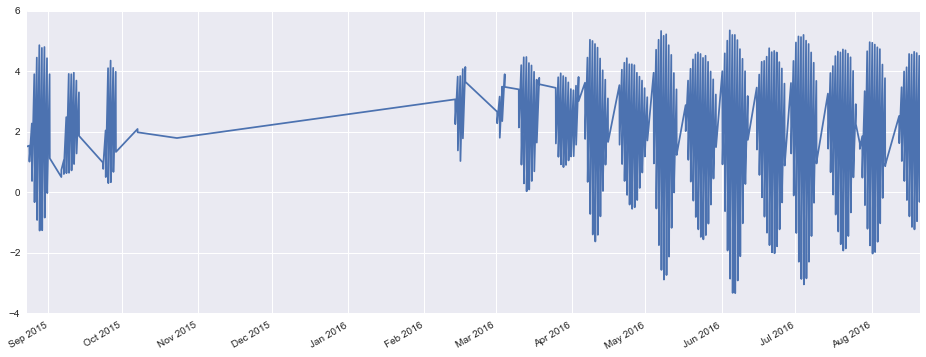

In [126]:
%matplotlib inline
import seaborn; seaborn.set()  # plot styling
test.Level.plot(figsize=(16,6))

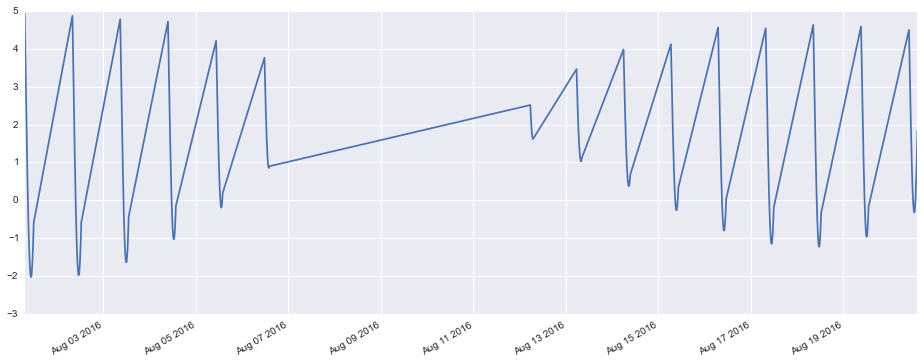

In [132]:
%matplotlib inline
import seaborn; seaborn.set()  # plot styling

test.Level[(test.Month == 8) & (test.Year == 2016)].plot(figsize=(16,6))

## in case I have to ask a question##

I'm preparing local tide data for a my final project.  I'm using NOAA tide data predictions (6 minute tide intervals) and predicted sunrise and sunset (pyEphem) to answer a basic question:

- During what date/time intervals over the next year is there both enough light and enough low-tide beach to hike from Carkeek park in the Broadview neighborhood of Seattle, to Golden Gardens in he Ballard neighborhood of Seattle. 

The hike can be completed in 1 hour or less, so there needs to be light and beach for >= 1 hour  at the start of the hike.  The tide level needs to be <= 2 feet for >= 1 hour at the start of the hike.  

The data is represented in a PANDAS DataFrame, calculating whether there is enough light is very straightforward.  Calculating whether the tide is <=2 feet at points where there is enough light is straightforward.  However, calculating if there will be a enough beach 1 hour out from any given date/time has been difficult.

The example df consists of the following:
datetime index, tide level, sunrise datetime, sunset datetime, 

Here is the first 11 rows of the DataFrame:


